<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/seminar11_review_q42024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

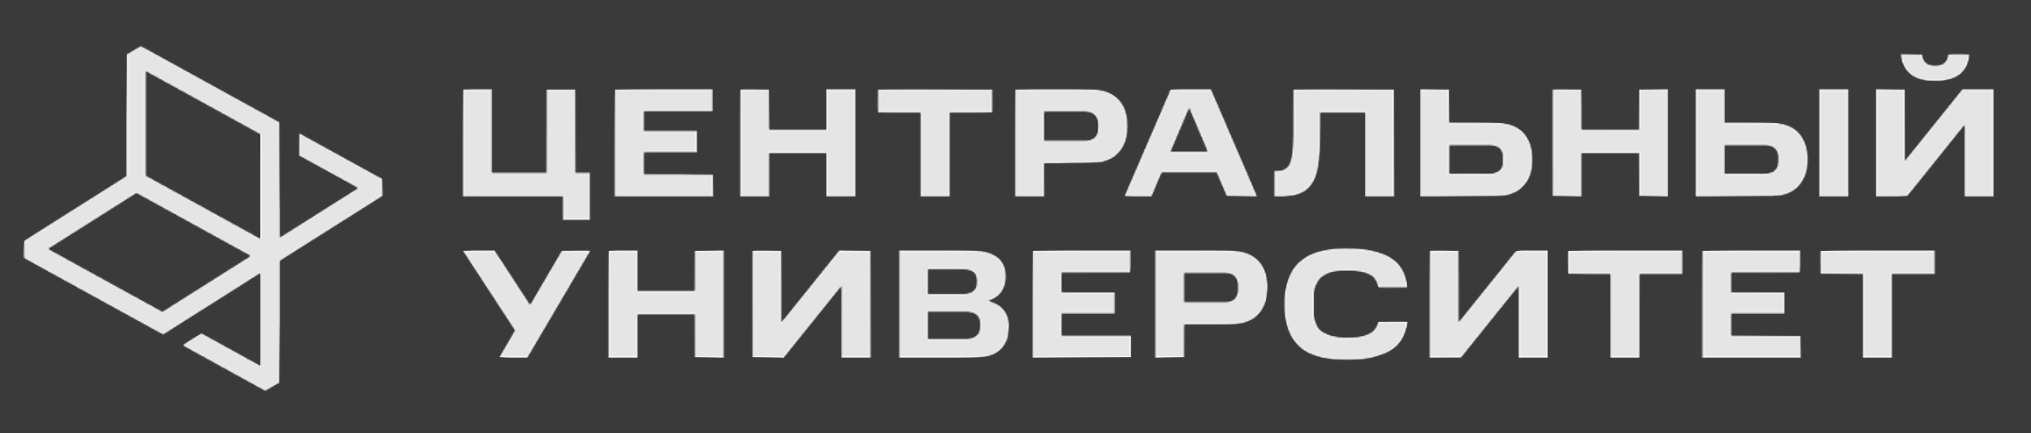

# Семинар 11: Обзор пройденного материала.

In [ ]:
import torch.optim as optim
import torch.nn    as nn
import numpy       as np
import scipy       as sp

import torch

from torch.autograd import Variable

### 0.Универсальная теорема об аппроксимации

Универсальная теорема аппроксимации:

 _Искусственная нейронная сеть прямой связи (англ. feed-forward; в которых связи не образуют циклов) с одним скрытым слоем может аппроксимировать любую непрерывную функцию многих переменных с любой точностью_.

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import copy

model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_points = 700
batch_size = 20

X = np.linspace(0, np.pi, num_points)
y = np.sin(X) + np.random.randn(num_points) * 0.05

X = X.reshape(-1,1)
y = y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 1_000   # number of epochs to run
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

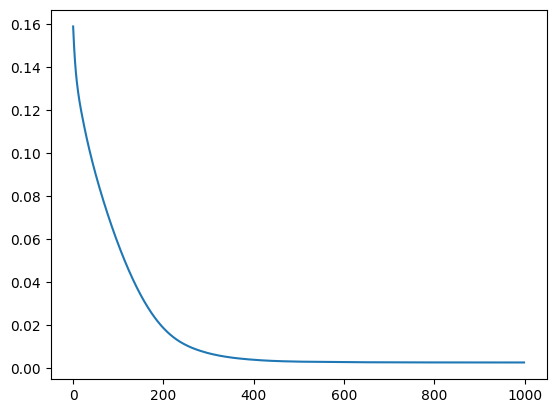

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.show()

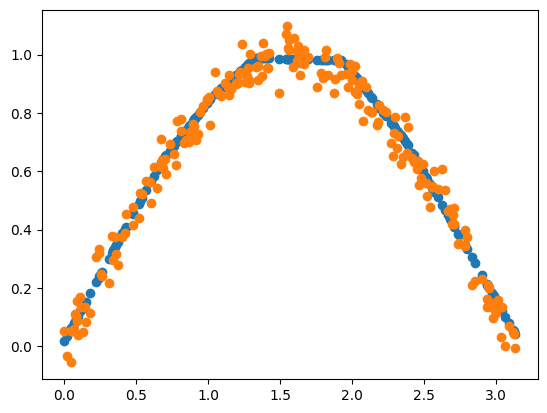

In [ ]:
y_pred_numpy = model(X_test).detach().numpy()
y_test_numpy = y_test.detach().numpy()
X_test_numpy = X_test.detach().numpy()

plt.scatter(X_test_numpy, y_pred_numpy)
plt.scatter(X_test_numpy, y_test_numpy)
plt.show()

__Вопрос:__ Что лучше: "глубокая" нейронная сеть или "широкая" нейронная сеть?

__Вопрос__: Cколько параметров у нейронной сети (см. ниже)?

```python
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

```

### 1.Полносвязные сети. Многослойный персептрон. (Fully Connected Networks. Multilayer Perceptron)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABUQAAAJPCAIAAAA7fklNAACAAElEQVR4Xuzdd3CbZ37oe+09OTtJ
5mbyx+6dyWQyc1NuytmcONnqdVGXy5bsSTabTXJystmW7WtbhUTvJNV7I0UCRCNIohEAm6plWcW2
Opuobrm3tWVZjQXlPi9eEgIBiWrUyxfS9zO/MBRIQiiaZ/3l26ZkAAAAAABASZlSeAMAAAAAAFA3
Yh4AAAAAgBJDzAMAAAAAUGKIeQAAAAAASgwxDwAAAABAiSHmAQAAAAAoMcQ8AAAAAAAlhpgHAAAA
AKDEEPMAAAAAAJQYYh4AAAAAgBJDzAMAAAAAUGKIeQAAAAAASgwxDwAAAABAiSHmAQAAAAAoMcQ8
AABAKZlyLxX+Zbev8B4nVOFfdpsK725CFf5lAHCPse4AAACUEikcD2buyUxEkYo7eeHeuPuHp/KX
DgBuC+sOAABAKVF5kRLzAKAM1h0AAIBSovIiJeYBQBmsOwAAAKVE5UVKzAOAMlh3AAAASonKi5SY
BwBlsO4AAACUEpUXKTEPAMpg3QEAACglKi9SYh4AlMG6AwAAUEpUXqTEPAAog3UHAACglKi8SIl5
AFAG6w4AAEApUXmREvMAoAzWHQAAgFKi8iIl5gFAGaw7AAAApUTlRUrMA4AyWHcAAABKicqLlJgH
AGWw7gAAAJQSlRcpMQ8AymDdAQAAKCUqL1JiHgCUwboDAABQSlRepMQ8ACiDdQcAAKCUqLxIiXkA
UAbrDgAAQClReZES8wCgDNYdAACAUqLyIiXmAUAZrDsAAAClROVFSswDgDJYdwAAAEqJyouUmAcA
ZbDuAAAAlBKVFykxDwDKYN0BAAAoJSovUmIeAJTBugMAAFBKVF6kxDwAKIN1BwAAoJSovEiJeQBQ
BusOAABAKVF5kRLzAKAM1h0AAIBSovIiJeYBQBmsOwAAAKVE5UVKzAOAMlh3AAAASonKi5SYBwBl
sO4AAACUEpUXKTEPAMpg3QEAACglKi9SYh4AlMG6AwAAUEpUXqTEPAAog3UHAACglKi8SIl5AFAG
6w4AAEApUXmREvMAoAzWHQAAgFKi8iIl5gFAGaw7AAAApUTlRUrMA4AyWHcAAABKicqLlJgHAGWw
7gAAAJQSlRcpMQ8AymDdAQAAKCUqL1JiHgCUwboDAABQSlRepMQ8ACiDdQcAAKCUqLxIiXkAUAbr
DgAAQClReZES8wCgDNYdAACAUqLyIiXmAUAZrDsAAAClROVFSswDgDJYdwAAAEqJyouUmAcAZbDu
AAAAlBKVFykxDwDKYN0BAAAoJSovUmIeAJTBugMAAFBKVF6kxDwAKIN1BwAAoJSovEiJeQBQBusO
AABAKVF5kRLzAKAM1h0AAIBSovIiJeYBQBmsOwAAAKVE5UVKzAOAMlh3AAAASonKi5SYBwBlsO4A
AACUEpUXKTEPAMpg3QEAACglKi9SYh4AlMG6AwAAUEpUXqTEPAAog3UHAACglKi8SIl5AFAG6w4A
AEApUXmREvMAoAzWHQAAgFKi8iIl5gFAGaw7AAAApUTlRUrMA4AyWHcAAABKicqLlJgHAGWw7gAA
AJQSlRcpMQ8AymDdAQAAKCUqL1JiHgCUwboDAABQSlRepMQ8ACiDdQcAAKCUqLxIiXkAUAbrDgAA
QClReZES8wCgDNYdAACAUqLyIiXmAUAZrDsAAAClROVFSswDgDJYdwAAAEqJyouUmAcAZbDuAAAA
lBKVFykxDwDKYN0BAAAoJSovUmIeAJTBugMAAFBKVF6kxDwAKIN1BwAAoJSovEiJeQBQBusOAABA
KVF5kRLzAKAM1h0AAIBSovIiJeYBQBmsOwAAAKVE5UVKzAOAMlh3AAAASonKi5SYBwBlsO4AAACU
EpUXKTEPAMpg3QEAACglKi9SYh4AlMG6AwAAUEpUXqTEPAAog3UHAACglKi8SIl5AFAG6w4AAEAp
UXmREvMAoAzWHQAAgFKi8iIl5gFAGaw7AAAApUTlRUrMA4AyWHcAAABKicqLlJgHAGWw7gAAAJQS
lRcpMQ8AymDdAQAAKCUqL1JiHgCUwboDAABQSlRepMQ8ACiDdQcAAKCUqLxIiXkAUAbrDgAAQClR
eZES8wCgDNYdAACAUqLyIiXmAUAZrDsAAAClROVFSswDgDJYdwAAAEqJyouUmAcAZbDuAAAAlBKV
FykxDwDKYN0BAAAoJSovUmIeAJTBugMAAFBKVF6kxDwAKIN1BwAAoJSovEiJeQBQBusOAABAKVF5
kRLzAKAM1h0AAIBSovIiJeYBQBmsOwAAAKVE5UVKzAOAMlh3AAAASonKi5SYBwBlsO4AAACUEpUX
KTEPAMpg3QEAACglKi9SYh4AlMG6AwAAUEpUXqTEPAAog3UHAACglKi8SIl5AFAG6w4AAEApUXmR
EvMAoAzWHQAAgFKi8iIl5gFAGaw7AAAApUTlRUrMA4AyWHcAAABKicqLlJgHAGWw7gAAAJQSlRcp
MQ8AymDdAQAAKCUqL1JiHgCUwboDAABQSlRepMQ8ACiDdQcAAKCUqLxIiXkAUAbrDgAAQClReZES
8wCgDNYdAACAUqLyIiXmAUAZrDsAAAClROVFSswDgDJYdwAAAEqJyouUmAcAZbDuAAAAlBKVFykx
DwDKYN0BAAAoJSovUmIeAJTBugNZKjuSdHakT9Ly/wcAACqi8iIl5gFAGaw7kCSTSfHxg998FGhM
2K3rFlbWfPjxh+nMRTnsaXoAANRD5UVKzAOAMlh3HnTy5vc33/igdpPHaqquskWMep/V3Ggor1+7
fk06k8oOAABQC5UXKTEPAMpg3XnQJZPJRGLXokp/lcNrM9XZzfVms8tiqbdavEZj9ZvvvJbODBX+
DAAAmDwqL1JiHgCUwbrzIMrtPC+mXLPEbneZzXVG4yaLzWWzeSxWtzX7UczKtTVvvP1h7nB6AAAw
6VRepMQ8ACiDdecBkt/wYtZtaBYlb7X5suMRY7aPNPzoeDXaZdWbIslUJp2WDqoHAACTTuVFSswD
gDJYdx4guYxPZkve5nBZbHVmuy83JjE2rzyi5LPjfm7uqqFMJpUaLrw7AAAwGVRepMQ8ACiDdecB
IjJ+YGhQfIwl9paXrbXYRMy7zHaPyeGRMn5szMtjtflE0l+4mM6eBE++fB273AMAMJlUXqTEPAAo
g3XnwSH1eDKV6et/3+ZwmWxuq7XObN5ktjpjVQvfCnrP+GoXGVYVxLwYW2XA73/xkyup0cvOl2LM
534NkT8AAJQklRcpMQ8AymDdeVCkUsPJTMbr2/vc3DXSHvU2t81cY7dsOhWKno3GjzeFxCcH6uqt
Nk9BzBss7rLyDa0de+Rd9EtKccCPKfl0MpPkVP0AgFKj8iIl5gFAGaw7D5B33k0ZrNIe9VqLdEn5
Yw2+1+Mtp8PSnAxGxIikr3TUm6x+afJ63mL1anXLRcmX2hXnc+k+nDfS1fjOn7+yd9eJ+rodWzuP
p5KZ4WHOCAAAKBkqL1JiHgCUwbrzIJCC9siRkxrtGpO9QYze7Dzkcp8KReQ50RySe/71RPvqZU3F
MW+0eizG6nff+0jEfLqUiv5azKcyyaHk4NBQ8tD+06uW19tMdTqj22D2WuyBX/5qabC5o/BHAQBQ
K5UXKTEPAMpg3XkAiAJPZX7xnN1mc2otHo3ZfTreml/yJ4NhEfOnQtFzsdYmV/t1Y95qdTvdofOf
lFDJy793kCaZkQ4xOP3qu3PnLXUsbBLPyFoZMNkbtCa3mHJDXVVV4NCB4xnpCnySwjsCAEBNVF6k
xDwAKIN15z6XyiSHhzLB4DaD1f8r+0anqfKlQPRkKHg6Ej4bjed2sBclL8+25m1Gm390cj3vNlrr
F2g3trT1qP5y8ynp7ADJITnjxdMXD/jyQGbego0Wq99g9ZVbPGLKbF6N3aN1SB91Zo/R6jFoV8db
XhbdL36+8C4BAFATlRcpMQ8AymDduc8lk8k1zj2/KncajC6LeeW5lsjJ5kYp5sMj9V4wB8KbtWav
wdZQEPNizHZPma46qfbT4I3sWp9MS1vjxSxZ1ji/fNPI7gZ2n6nCb6kK6Cp8mgpvucMjPmrM0vZ5
k9ldrqkZHuD4eQCA2qm8SIl5AFAG6859TsT8L8pqF1gCcsyfDjWLmD8VDomYz98gn5tD0a0ak+e6
MS9Ga6y9cFnle9qn0ulk9lR9qavJ4f5TJ43mGkdV0Gjx6U0es8MvYt5g92odUsnLI8e8xeoVL9EH
76bYMg8AUDmVFykxDwDKYN25n6XT6X2vvKo1e0WfL7LVHwzGRcaLOdEcOt4Uum7MH29pLze6rxvz
Rmu92e55ce+JK8NqzvlUMjk0PDwoal6nW2U2r7NY/VLJW7wGq09v82nsHjGi4e2L/OalzWV2twh7
EfPykQULFzZcunSJw+YBAGqm8iIl5gFAGaw79yf5mvA7Xtz17Dyn1ijNvtYXzzVFR2M+fN2Sl2I+
HHUsbNKb668b82KeW7D69bd+o9bclQ6YFx+ff/4Fq3m9yVJnNNeKx292BMTTETEv5hmTc4HDt6vl
hTcaA93NcTEGm1P0vPzVck1tvLUzKR1oDwCASqm8SIl5AFAG6879SjpuXGtcYbQHFpjqK1bEeiOx
Y+Fwf0ieiIj2687pSHBjdcJo2miwe6WxegrH4nIsXC//skBtkskh0fK7dx2wW6qtVpfR6pF+E5G9
Gp/B7pdnwyL3rtYDJ4ORY81ReVba1pU7PHqbz+hoMFn9Wk1V4f0CAKAmKi9SYh4AlMG6c986ffq0
3uQts/k2LqndmdjdFwodC0XkKW743JyJNEX8mxdb190o5k02t86wMnvBeVXI20cgJT4tm7/cbtmk
N9frzB6zQ7r+nAh4Uekam7/c6ktEXjoVDJ9riR9vCuVi/uWGmMHulva9t2b3RzCuu3p1MP+vAABA
VVRepMQ8ACiDdee+lHrrrQt2+3KduelZg7MrGOmLxnMx318U8PlzKhzaFd22aeE6vc1jtF0n5qUj
5x3ORMdW9eyJLh8k39N7bO68RWaLz2jyGC3SPvPy6G0+0fM6U90m1w7pQIPRAwrka/JJhxvEOjy1
cU2Ft8zuFt9ptnu6jh5Ty+8qAAAoovIiJeYBQBmsO/eb7Jbq1PKVYb2xRmdpWFax6UQkfCzY3BcM
52J+nJ4XMX84tjm+rlZn9WaPMy+M+WzPO02WJYeOnir8uxWXzqSGU0PJTObk2VcrFzltDrfZ4rFY
vWZbQy7m5b3rTzS2vBppP9UUPh2KiMnFvPikrynycnSbdOV5h18qf7N3/QbPpcvUPABApVRepMQ8
ACiDded+k0oNDw1lynVOvckzr3xjxwaXdMa70Zgf52h5qeSl0A2diST6AiGtyXOth8eM1PNa/Qp7
Zc0k9q580H4yPTyYylQu9OqNG0XAG60es91nqwzoLV5dduO80eZ/rsrfVtdwWjzBpuCpYPh0MCpm
dPu8iHnpNemPdc7VO7X2BvFTRotPp114rO/NZDLNZeoAACqk8iIl5gFAGaw795/hM2cvmh2NGqPb
Ytx4pL5eitXRKQ740YwfGRHz8rZri6Eum+7+7BTGvNHqnK9Zl5y8mk9nryQ/nEleuJSeV1ZjdTTK
j026krzdp8tei06+2px3nf9cLCFK/mQwLKb4BP5S0rfExY9ozdKvAPQW33PzKl948ZgIeWIeAKBC
Ki9SYh4AlMG6c7957733rDZPudFttAcaaqS9ynMHh4spzviimJdK/lxLfLlxvcESKNosP9Lz1ooG
rdF55tzVScp5qeST6eG2zhdNZq9BnuxjEzWeK/kKS62YV1vb+xub5ZK/bsyfDkfPRiIrV0b0uo3S
j5u9RtP6lauaMun8s+sBAKAWKi9SYh4AlMG6c79Zuap2vrbWUtEoPr4c3Xw2Gs8P1/x6v17MS7vZ
y+OrXKu33jDmjdmedywMfPjJJXmP93HmBu5mo3dK3O+bb7xnd9SarH5jdt/4/JgXJW+xul9Yv+FM
vDW3Tf56MS/tZi/HfJO7w6ZbJce8zeEq166Vtv6zZR4AoD4qL1JiHgCUwbpz/xhOZgaH0nPnr5Qv
xjZfX9fT0no8HMkfEa5i+kORs9FY/l73uW3UZ6KRk6EmMbvr6hcYnMZst+ePweLOjcnsdnnbkpnM
YEr624szfpzJudHt15NKp5Np8X/DGber02JcrzO6deYxx/ZrzV6DrWGeti6+Yr14XiciLadDITna
Ryc/5rPPOhI+2xLe3LR1pWW1xubTmjw2h3tB2ZoMu9kDAFRJ5UVKzAOAMlh37h/pdGbXi4fmO5pM
FX6tuc5a5T8eDp2IRItj/nS2cnsam/uaQ8dCLfmb6PtDwRPBxlPh5t6mxsVLAzeNebOlvqKywWJ1
W61uh8NXVRVYsiS4enW8vn5nQ8PeWOzonj2v9R378OzZKx+eT1+6mkmms5O5NsWdP/4MDqRPHvtY
NLzeMrJrvTzij2Islc06i29noFV0+5lIS3ZTfH7JXyfmxat0Jhp6MbzZuXBtuV28dF6LwzuvfP3A
1cJXGAAANVB5kRLzAKAM1p37RTrTf/rSfO1KU0VAa/dbTRvWrw2fjgQLtsznbYqXwl7kbn8oIpJ+
tOQjuZh/qz3mdrbdKOZFxo+OS/S8HPNms8tiqbdmP5fHZvOIMZvcRoNLr6sT8+yzK+bOXaXXbXQ4
6puad+14vv/N16+ePy+dSk+eZDo1nEqKkc4lL/2C4lrGS88yna53dizQ1YmYL9gmb8ieu76yfJln
bbP87OS5xZjfH+kIrdwoYl5n8ZntPvEc336LmgcAqJHKi5SYBwBlsO7cJ0T1muwNYrQOr97mqdIt
a2vadiZcGPNy5fY2Bc+Ewy9HN7c7A8+Hnz8bjZ2ItJzIhv2xcHhf6ws7gp0LF/utFdLh8fIR8uPE
vCh5aSz1IubFH40mZ8Hk3yi+Z6T5LV75c5OpVq9bX162VsySJYFA0/Zzr58//0l6OJ0ZyoyMvA1f
fHLq9dct9kBBxsvb5EXJi499gSZpv4Pm0JlIy6lg8GykoOSvH/OnI8GulvYt1U4R8/rsQfjibzlw
6LU0e9kDANRH5UVKzAOAMlh37hNXBjLzNLUme0Bj82nsHl/lmpebO88Fw12xrdplnf+l9R1u23U6
1HyoZfvuhsTB6La+pkjlkqjO7F3vbD8XCor0FUkfa2gbE8k26cRy44/Z4smf7I73Y24p/oaCMVvq
x5lE+4Gu3vdFxg9nLnVsO/nreaukc92ZvfknvZN+3WDzmq3O59etz98gL/V8YclfN+YjpyPhvsTm
HbWecntAftYi5puadxe+ygAAqIDKi5SYBwBlsO7cJ869drncUC/FvNVbbnM3L60WxX7SH3i5Mf6s
I/qMPfJyVNpQ/6I/vsm4WHT+6ZY2jdFdpnetqo69EY30NzYfdNZXaBfeZczfdG435p+dt3Du/MU1
9Z5Dx17SGmv1ZmdBzGe3yXtFz69dn+gLhkXA53r+lnezj5wKh461btla48qP+Xr3Vk6ABwBQIZUX
KTEPAMpg3bkfXLo4WL2pzWgPGGwNZTbvfLt3y+qaU4ltJ3yNCywBjb1Z6wg2u7e8E4+KnNbqapvr
2jp9HaL8jbaGZauDzRsa5lpdZRXeeTaPzjrmrHLF9T5+zBcfY18wxTFvtNaPMyabV/pBi99oCeQa
Pn/kAwEsFQ29iS2ngtI+9rcf89L39MS3dm5wlduaRMwbLG6Lw79sWfDipfOFrzUAAJNN5UVKzAOA
Mlh3StrIduOt2/Y8s2Cdwe4XI+1mb/MdqvO+1tK+aEGVyHt51qwInosltIZ6s61h9YrI4sXNeovX
ZG/IHn/uMdilI+1Fyasp5sf+bNFfLU+5xVu9aNOLiT2i5E+FQzeI+cKAHxPzodiZSKy7ZWvr6tpy
W1COebPdZzS43nr73NgXHACAyafyIiXmAUAZrDslb3Bw+JnnrI5FoZGYt3vEHPM1nmoKG2xOo03a
C11M5UJ/W11IZ/HJZ2uXzpZn9YuRzmZnk04gl5vbivnC5L7Z5F/ZTp6ihr+9mNdb3JvXbuwKtoiS
PyVdik86k1/+FNf7dWO+K7Y1umJjNuY9erO0R8Czz6w5fqKn8OUGAGCyqbxIiXkAUAbrTmkbHs68
/fZHOvNGS0WTwe7Njlvr8B4N+LeuXrHA4ZePJxfFKz5WLQ3rbdKR8KOtfu1M9fLndzCFrX6zKUz0
om+46RT2vM1rtAfm65wdmwKngsFT0VYR5yfC8WsTacldkC+7R32sYI5nL9F3KPZ8w6IN8m72cswv
mL9x//6XC19xAAAmm8qLlJgHAGWw7pS2jy6kAs3ttqpGo80vGl6MxubSOtxhT9xWVin+aHb4DdmY
15nrLRUNxW1ccpNf8iO7D2R/KaC3+ldY1h9rDIs+Px2MynMm1HI6LG2fHyfmT2TPmfdC+Pnqimsx
L+6wbEH1Czs5oT0AQHVUXqTEPAAog3WnhKUzmb0vn3123kKjrcFg92oc/nK7r8zsNticK1c1GU3r
jXa3tK0+G/NijNLu9NIm+pKeopiXrgwvj/RHS0Bn8p8Ox0/6A8FNiYr5y+K+baLnj4di8two5lsb
tq20SjGvka5XL71KC8o2tbVvL3zRAQCYbCovUmIeAJTBulPCUpm0zlBtc0iVbrC7RclLY60XMa+3
1omP5gqvGPmYeSmDsx9LfYpiXjpwIDfl1gYxRmPdwXq/xtqktTXXrW89FYrKu9wXJb10zPyZSEzE
fFP95irTBo0tIEaO+bKy2mCws/BFBwBgsqm8SIl5AFAG607pSiXTmTJdtcXhzW6Bd2vt9WJ0VrfB
Vq/Pjrg9V/JSBt93MZ/r+Wtn7LNJ2+dNNq88ZrvPVbPtrcbG3tDWg77EwaYd/eFov7SzvTzSxerO
ZrfM12xstZk36a3+XMyXl9e53ZHCVx0AgMmm8iIl5gFAGaw7pSv11jtpo91lcohod4nR253S2OoN
+VMUw6U+RTE/5qu5jM+Nv3bz4dDmMkvzc3q/3to09lT2UsyLkj8ZjS1aFtGZXPkxr9W6XK5Q4asO
AMBkU3mREvMAoAzWnVI1MDC0Yk3cXOGWS16MwebMDjE/Zjy1rfqq4HyLr8zWoLH5jwSivaFWq9Vd
WdV0uqXtZCRxOhTqiXZo7Y1llmzJW0eOmRcxv2lTY+HrDgDAZFN5kRLzAKAM1p1SlBITb3thvrY2
t1l+tOSJ+WsZLx9iMNewyVThl64eb/OI12dLeO9S80at2SvGqtsQbdxzLhjeH9061+TJ1v6YmN+w
wVf42gMAMNlUXqTEPAAog3WnhEgNn8mexF5MmX6d2RF4cBr+Fqf4Ovai500OkfH14mPVkma56sut
Pq3dr7O6xedvh6It3q3zjfUam186lT0xDwBQN5UXKTEPAMpg3Sk9w6lMc3irrSqYPWV9bXaI+ZEp
LHn5xtGt9Ca7z2D3yj2fm/finUtWRHRWcbtP7nn5rtjNHgCgTiovUmIeAJTBulNihoYzGzZ1agzV
Up3a3fIl6Ij53BTHfC7j5U8KSl7Mvoa2cotHvrJdQczf5yfAk/fxuGN3+eMAgDul8iIl5gFAGaw7
KjSyO30BOZ2Wr/Yt0NWZHQF513F2sy+YwpLP3T66cX7slnnpAn6LFzfPN9ZfN+Y9nmjh21Cq5H9U
N578Mpc/KW51+RbpxqIfAQAoSOVFSswDgDJYd1RovJifV7Zw5Grq2YPAifmCuYOYN5mc5RZpH/v8
mNdb3CLmvd6WwrehVBXVOzEPACVL5UVKzAOAMlh3VKUosbKTTidTqVQyk4m1bTZbRk/nbq2/7hT3
7QM1xTF/3bYvGJHxuU/kE+BpTa65czd0du4pfItKTOG/pZtMOjsZqdLlVB8YyAwOZZIp8a+wIN2L
flYaAIASVF6kxDwAKIN1R1XkIhrOzphMEgJN2/WGlVLMX0vTwpIn5ovr/VZiPje5mBfz3HPrX9rX
U/gWlZjcPyH5H1XxpC6cv/DWG28f3N+7feehSOu+UHxPKL6vKSbm5WBif6jtUKj1QDDxcnP8pXDi
pVjrS4n2V14999aVTy5k0kPSPaSzQ8wDgIJUXqTEPAAog3VHVbLdnhwaHLhypPvspUufpIaTYoR0
OlNetray0jc25q/T88WB+kBNcb3fcczPm7fxWN/rhW9RiRmJ+XRmWJ6rg1fOnH1j156jbZ27m+P7
wu2HQx19wfbecOexaEdvpL0n3NadP8HEUTGh1i555Bub24+E2g7G2vZs23nkvXc/TA9dzUt6AMA9
p/IiJeYBQBmsO6qSPQ45K9b2WrS197W33v748hVx28bqqMXmEkPMjz/F9X4HMS9/rtE4337r4pj3
pzRc20ieljI+deHK5UPdfbaKNc/MNRuNa62rNotolyq99XC4fSTUCxp+/BExL0b8rPTjbUda2rZf
uvRJOp3MpLJ/deEO+QCACabyIiXmAUAZrDsqNZBKHz+Vkradtr3i9LXPm19tsnmz4y4OeGJ+omY0
5n1iFi8Jf3KxhKv08uVUbW14/jyHwei2WP2jp1rwrK/dLuo9u8m9W8r47ESKiv2mE2yXJtrR27K5
J9yyt2PLkZFD7ol5ALjHVF6kxDwAKIN1R71EEF28mtm3/3S843A4fnTkeunZnh8n6YsDlbn1kc9p
L3dvNHowOVz4pqhdOvP+uxcT8W2a+YstxmqbzWO1uqX9Ecxe+TcU4jlucu+KtveIgA9l95+/45jP
TajtiPzbgZ6+tzPDA8Q8ANxrKi9SYh4AlMG6o1KihpLZmF++2lPj3JrY2hVt76qu3yZyXY75G/V8
caAytzZS6+bH/EsvvzHSpblRpdyja2vf7rBU6xesqzC77EaX0eDSmVwGi1tn9YqRn5re5lmyMtbS
0SsCPhg/Ipe8HPO3PoU9n93fXkwg8kpP17HCxwcAmGgqL1JiHgCUwbqjUnLMv/zK+xpttcZQt6am
M9p+pPP5E46F/vF7vqhRmduY7MXnRcn7DWbfrhdPqDbmc48omZ0LF9M7d/U999xKi6XeavOZzG6t
0ak1uXRWd3bGxLzZ4Y919k14zIfajogvdW7ZX/hYAQATTeVFSswDgDJYd1QrlUxn5muqdSaX0eIT
bbZmQ7u3cV9LW0+9f6+tMmCyec126RDo2zrBG3PTEfVrkA6b91dUuc9/PFj4tkyC3OXlCn+3IOa1
ty54fXufXbBO/AuxOKTz8EsNb64fzXhp9BZv/pQb6ppaDomej7b3hBJHb7fkrzdH5Ylv7o20HJR/
v6CmX30AwP1G5UVKzAOAMlh31OvA0ffl4+TlSteLQjO5mqNHQrGulrY+UfLiFmL+Xoy8EXteWY0/
0Fn4rkyCXMxLp6bPTubKcPr999NOV5ve7DRY3OIfich46cHbvdLjz15aL2/GxLzO6nUsbgxEDsQ3
HxMpPoExH+vsIeYBQAEqL1JiHgCUwbqjQlK2vfbaewu0NbmYl4It2+oaQ52tMhBsORrv6Pc2viyS
Xj7LPTE/gSNv0DZY/XPnL5P7Ob+oC9+ue25MyacyyStXMsHgfq222misk46tsItH6xKjt91SzIvR
mlyWigbR4dH2nqIyv4MZ3TLf3k3MA4ACVF6kxDwAKIN1Rw0KQlH6xGLfoDW5zQ6/GNHq8kZ4OdrF
R9H2ouejrb3VzucdC5vYMj+xI+2abvOI11+k8oefXExe5z1SSHZfeqnhk9JkBpKZA0fO6I01NrtX
jNXm0ZudOotTa3HeVsyLG3Xm+vbtJ2OdfUVlfgczumW+rSsaO5Q7BAAAcI+ovEiJeQBQBuvOJCrY
3ju6ATad+ej8FY2h2loZ0Js8YkS650Y+VN7i8FsrGlaubRNJH0n06Ewu8Ud5Kz09P1Ejole8mC5P
JCmF6STEvJzEouEH05mhTObji+lfz1sz+rsb6Zc78g72xY98/JFjXox8zHxRmd/BSCUfShxujh3c
va+bkgeAe03lRUrMA4AyWHcmUS4Oh/Mm9cFH6fXVIZO9Qd4gn1/y8sgb50XPi3qvdj4vYj4c765a
EhJ/zO2NX5xwzJ3Nc/OW7nv5jbHvl0LkDfJXU1LJVyz2lutrzRVeoz17bLztzi9bkNsy39LRW5Tl
dzZSzEfbuzq391+4dLHwaQAAJprKi5SYBwBlsO5Moux2+FR+yQ+n08nDXW/9+jmH1lTY8AU9L2+f
1xjqalw7W9r6miKHtUZn7vj54oRj7nBMG2ud8mnwJifmRcm//cH5csM68Y5rzXUjGX8XMW+w+uRP
ou09E3XMfLj1SGJLX8/xi4PDQ4VPAwAw0VRepMQ8ACiDdWcypUW7Dw9m0smPPvjNwJWr2ZjPPLdg
tcXh1pml09cXZ3x+z490u8XdGD4U7+ivde+Sb7+74+d9Y6f4G24yOnO9xug0j14mTYxGvua5uV5M
8ferfBwVgWeeXTU0nFE25qW/aDg1lMxkHJX1euMGg0V6AYsf3h2MvGXeWhkIJY5OyMZ5UfLB+JFY
Z5/41yv+RRc+FQDARFN5kRLzAKAM1p3JJGI+nRk6fyHti5xsaDndFO3asrOrcknEZG8QWZ4f87mr
0BUkvXyp+XJ97cq1baLnxeSf37445G5hpKuyibmzmBcNL7pdfBIIHwoneuKdx1u3nExsPiH+6FjU
XJCjIimL7+FGI5/Yv/j2ez3yK3zq9Ed5MT9+z2e/ofjA8ZFbxv/Z7D+JdDKbxKkPPvhgyfJas106
Ql4666E1u0H+rrbJSyPH/KoNneHWrjvbMh/OTqi1S/4k3H70xb1nBoczg4ODhc8HAHAPqLxIiXkA
UAbrziRLZ1IDYlIZMUd6X40mjkXb+lvaj4fivU7fPos9oDO6rY5Gi8Mvx3xua3x+z4uPWqPT6d3d
uvnEmg2dou3lnpe/+da21UvpLmf8yFj9eX8s/v7rj9O3RzS8qPdIa68Y8Xko3i2mMXK4c8dZcYsc
8HLwlxvqRPwX38mNRj5tW/Ht93SMNr/J3rBqbdOFi5dz5zUYM7mzt1/L9dyXpLl86ZOPPvjo6pVP
Mumh7FEV4/746Mbtq1ev2qwrRcYXP6S7HKPNqzE611Rvibb1xTr6xUf5zbo2RfVekPHhtt5ge2+4
81h0y3Ff9NDBrvfE0xiWTrcPAFCCyouUmAcAZbDuTJrRdpOPi05fTQ4HY60avUvUo6Wi0dd8MNIq
hb2o+vW1z9sXBkVsi6qUN9cXbKWXU180/OLlUTns7ybmNdkx2BpuK+Ydi5qbokdEGba0HxNTnIi5
dFyxrt1aGTDZfbeysT13fTX5m2/6/RM90r4J4i8tK1/d1r49lR7MP1Vh4WTfzkufXH77zXf27D3c
ue1AY8tL/vCepvipSPsb+17pHxzODA9dkQq/6KfGTCaz+4Wj5fMdJofHUtFQ9JDudsQrL17PMn1t
KN4tvyni/bqtmG9u62lq7/Emuj3xruF0JplMSruYAACUovIiJeYBQBmsO5MmP+YH09JmzbkLqgzm
axcDF1W/ZFVrnXdvS/txEfaB8JFVG7bkKr0g6eVbcnvj337MSyOVvMlTZnT99NlVWrNXZ8ntcl/4
ncUjIlCOw+uOFPPytPV17jirMTpFId9KqYpvE/EpH4dvzO70Lj2pvCn+kXsxJptbq18k57e05Tyd
TKeG5RkcSHX3vf78rkNNsb2+lleaWo8G27vbd53ed+jNdz5IXR7MDMnXiM/+VGHJXy/mX3/14wX6
aoMt+5Qn+gnKdyhez3JDnfjo8u8VMS/3/LXfvxQ1fH7MR9p7RMw3t3Wd/ySVvWjfyC8gAACKUXmR
EvMAoAzWnUmTH/Oi9XpPnDSaa/JjXozO7JHOhGfxLlzW0hTtElUfaz9W79+7fHVCLvaCns/dcmcx
L+ZH/zX3iVmPPv3EVPHx7740q/gb8kcubfvCJlGAIgjbtp4qaHhpk2/76OfiY2uvuCWc6GkIHZS3
zN90t3k54y1VTbaqxp/9fMm//x/T9/7TOq98o8HuFWN0yLsPeG5l34G7Gel3JeY1Fy5eFm/ZYGZ4
cHD4SO+rO/ccbozv9cUOBzv7IluPn3sr/fGldDKb5xnx/5LDowE/NPqJdCR84YxujZf/SWzZvu3X
zywXf53O5LJWBkTS3/QluoORT0Yoz4a6HeIdEe/LtV3uc+ne2lXc82IuD0iPdWRrPCUPAIpTeZES
8wCgDNadSZMf8x9+nFy0dKPZ4ik6mfzIyGEvPtZ69kRaj4mqDyf61tVs1ZulU6MVFPstzmjajWx+
11m9/+sffzlz5vT8+cY3f2QybzBafLnJb0Kzwy9qMBjrEikY7zwe7ehdtanlOd3Kn81zuMK7W3b0
NbcfaWo5EN/cW+PevkC3qsa5taWtJ97RJ6bev9tgcRmtI7sSFI9B2lPAo7F6xZTb3P/7B89NnTlr
9lNPz3pi6iNTp/5ibrWlKirtPmD15h0OcEs7EdzySK+8xR4QI554ebmrfcsr+w+fjcZfCnR2h7b3
bz/03lsfpy9cyZ7HUNrzXgr5fJnU6ORiXu750ff+2j+G7F0sXuYr163Ke2vuyeSOXJCn3FCnMTrz
t89f25li5PP+QPhQKN596MgbQ8OZ4dyh8WOfAgBAMSovUmIeAJTBujNp8mI+c+Toe/PnL5M3yxeX
fH7Pa03uRSviDaHDoueDsZ7KxUH5CPniGL7pjNad3MDS/c+e9a1ZY2N+6sMPL3jmmRvFvKWiQdSg
iEBR8nIHfv4v/+LxL3z+0S98cdbUmauWrvR17m/rPPTsAs3ffOFLf/X5h770+GwR8+H40Vh7b7S1
W2uszfZ84QPLjbTbv8NvWhz8Rdnyxx57fMbM2WLmPDFj5sxHv/Xt/zRals/TezV5JT/RMS/GpzXU
l2nrFi4Nuhuej7QfDLcdEB+37zn03vu/GRiULliX3fH+1iWvlXxeCSfTqeRwZv6C1WardDRB0cOY
yCmIebPDP09TLZ/pQO55+aP4ByamKXokGN7ZdbjvwkeXUsNpAh4A1EDlRUrMA4AyWHcmTX7ML1rc
rNFWG23+4oYvHjnpl65uc/lfinf0RxI91oqGO0j60bqTGthoD+gsvhmPzSzw9LSH//HpGSazqzjm
jTav6ECnb48c86LkE619X374S3OenD1r1qzp06Y+MWeWRqufPnvOtDlzps6ePePJJ7/y2FRR8qLn
xbRtOW6vatAYNhU/sNzobZ4ys9tQ2fjI9G/OmDFr+vTpM8T/mzlt5ozHp0579B+//fcaWyC/5Cc2
5sv0tfZF/kB4X7TtcLzjSGt79+o1iW3bT0vHv2e3pUtv4u0riHlxSyqVGhhMrVoettrrxZhsE79f
ff4UxLx88gVPQPq3lOg83iJtkz8mXYMgsqtzy6GPPvhYbnjxceQoAWIeACabyouUmAcAZbDuTJpc
0A0MZsp02aa9tZiXR2/xiqRftirubtgXaz8WjneLKtOZxtvQXTCjdSc1sMhyjdH5xLQnCmL+azO+
POvRv7XaagtiXj593ZrqLaLk5SOu5V2yv/nP3/3KtBnTZ8+aMWe2mGmzpG3pM2fNkTaqP/nkX3/h
4cSWfvna5qHE0TrfLo2pduQObzALHD7twsavPj5HVPyMLBHzs2ZOfeKJxx999PMGu/vexfyy1Qnx
aGPtve6GPSabt1zntNgby3WuoUzmanJ45Lpzt5/zY2M+Jf9jsJrX2s1Oi80lRroc3URcT/5GIzW8
1TUyozHvWNgUiR5ta+8PNL6y96WTb7/5nvwIRcDLZ/or+B0EAGASqbxIiXkAUAbrziRLZjKnXx3Q
GOtN9gYR89ed4pLPT3qd2bNqXXuw5Wii83i8o99kdomRz58nfY+tQR6j+HjtBwtjXsT53PKNs6c9
KWo5P+afmvnwzMc+b7PX5WJen3eVuNwp0HMHWndsO/bM/OV/8rn/8ficJ8VMe+rJp2Y88eT0OU9M
m/3Y57/y3f9cEN/aF24/Gu3sbtvW7w+9tMmzYyRcR6c45jVVga88MjMv5qdLPT/rkcce+4LBIV2v
/p6O/KxN1gaz2S/P1WRmaLTki+em8qs4nUkNJTOvvvaRxVZntUnnzM+eRGDiY15+18wOv9Zcd63k
rS6dpdZaWW+pcGl0K+t9oUuXr0qpnt/tuZFP2EfMA4AKqLxIiXkAUAbrziQbTmXc3p3FAX+jKe55
Q3bH+3Kdc13N1pVr2+SYX2pYudy0OrR0fXDFJufCjTWOtQtN6zUm6dz44k5GTnQ/cmm3kWPmy/TO
GVO/VhDz35g9fdpXvmC3u0c2y0tH9UtZWG6oW7WhM/98aSPT2h3v6Iu1H/7cF7809YmnHn9iztem
zfna9Ccf+8IjNb6OQOfhYGdXc8fR8ObuSEdXc+JQoGW/TlTlzWL+8elPTZ82O9vzs2bNmClvnJ/6
+MMTW7zXndxvMcyjc+rsxaGM1PPy3E3Mi/s52nd+nmaVxlRrtLsnvOHzx2SXfokjnR5fyvg6g81p
cnjKTWv94fa+M+/Ixw4kk2kxhRlfPACASaXyIiXmAUAZrDuT7MzZT8p01Sa7tNk8d8p6OdGLS/5G
MZ8b8bMaQ932NetPBYNiTjSHjjcFTwbDp0KR0+GoGO+yumXlVeI7c9euy//Zr35FquWZM2fn5utz
5syeOtVm9+ZiXjSh6Pk11VsSm0+EEz3R7DXnciNiPhw/Kj62bumtWOx7dNac6V+dblrub97a3bCl
x9d2qKm9K9jZE+roCSaORjt641v6LVX+cWK+3O7TVQa++vicaVNnzZw+R8ycGTPnzJA2zk99/Kv3
Ln1zUxzzHt+Oq6J5R3v+jmM+nQ1n0fBlhhqjw2eweyf8GnvG7EX1rBUNZvGumevL9bWOhU0GS53B
WvPL5xZ3nXhtIPssktlL6UmKu/26AwCYVCovUmIeAJTBujNp5CyKRPcFQvudvj2b3LvWbdq2eEWL
fWGTtDu0yV2md87X1pYbXNK29NGd8IsDvmBC9R1vtcZFwF+bUFCabNKfCzW92RIOOhbp9dJvELJ3
KIef9LuD73znx1OnTps1Y7Y8c6bPnj51xr//279brCMxL43dJR5evPO4fAZ7acb0vHRyOxHzrkBk
9jf+cfpTT0//6rSN/s0t27saOo6IESUf3tIX3XJMlLxI+nBnr6f5JY25zmCrzY6z4GJ15Q6PfmHD
nG98e+rUmfkxP2fGtOmPiZh3FhfsxE5xzC8oW3P87Os3jfncdelEtF+7NS/mxT0cP3Wh3FAn/UWj
JZ8/xQ/mNscnv4aG7IHxZovH7mjQG5wa/aKPLl++nEwOZTKDmcxASjyL0UIv7vbrDgBgUqm8SIl5
AFAG686kkbMoFNnvCextjh6JtvZ2bDstpn3rqbYtJxOdx2PZTg62HHV6d2+s21GxqFlvrtcZ3dLm
cesNq77av/dcPNofCoo5Fg6LycW8mDOhZjGvR4K9ofgCbY2ceSNnNbd6TGbXP3/3X5964tEnZj/y
5KxHZs9+5OknfmI11ou/Udosnw1+c2VtQ/OWf/n778z/+XORbd2Jtq5Y3rR39m7ZdtwTiH7+K488
+Y1vSeexnzbji5/7/HL7kuaOA4HOo3LARzb3tXT2iU/EH5s2v9G45bjBUZudutwmerlINXaPrsI3
V7P+sS9/WTqN3vQZs6dPEzN16qyvfe1bRkukKIDzX43RrM3b8l9UvCMjvwIirU126QwC8i3yjWJ0
4pU3ueT59bPOQGTrgMjg7MgXl8++pcOZ9GAmdSU9fCk1dDmVvCp6P50ZTKWGU9K54PNiPiP9yPsf
Dhism6THbPeOmaLHdssz5l+CeMtMNq+9qtFic9kc7nLNkiXL6gdS0i8RcjOUkR46eQ4ApUXlRUrM
A4AyWHcmjRxRi5Y06s1Os90nWn3Nhs4Ntdvr/Xt9Ta+EYl2i5Fs3nxBhLz7GO/pF8DcED6xa21m1
OCJiXt4hf3Tr+rWEsy2Pnm0Jn4hIczwa7Y9ECmL+bDj4Wri5P9pmqwyINM3FvBgR8+Ua3YypX3xy
zqNyzGsWbDDp6vQmj+h5+f7X1LS4/W3TvvTY3/75/2xsPxBvPdqSN9t2nFqyrHn20/8w88mnxTw+
a9bMWXO+PuOpmQ9P69h9vGlLd7C9WzS8mGiH9FGMK3piY/PL48S8GGuV/1+//e2nZs8RPT9r2jQx
jz4y7b9+/HODOTyxMT9PUy26XX41tCaXaHt99krsjkXNVUtCy1cnVq/vWLJ0q6epvefkSXlePff6
e++9d/78+atXPhkeuixiPpOWMj432S3z1zbOy+mcSqW27nj5mfnLC0t+gmJe/NsQMW+taDBaPVWL
GnSG6njrvo8/SYuYH9mvnpgHgJKl8iIl5gFAGaw7k0auKUel12Cpk89hLp/MXLS9zlSnNTo1hjr5
UnOLlkVWrm1zeneLmI+29iY6j8ub7sXn1a5di1cm8vfD15rrnEbbqVBATG843BOJ9EWiYqSqD4ZP
BYOnQyG552s3tlr0GwyWa+c2F6PR11vNS379S83cZ+dqdctNVr/Z1iBt47X65b3Ng5uPJNp3P/q3
X3p66uxHvvTo9GnfcizyLFsdNNlr//V7v37oi1+Z9dTXps1+8v/73P/45dy5u3afXVdb+/iM2bOe
fPqRLz6+wF4tGr5g/vJzDz01+1FDRY00DmlP+/zq1trrxeht9VbHxplTH53x+COzpkszX7PO4hDJ
3Sw3vM7qlvdUlztWZ5ZO9Sf/vkP60rgxP/KLjOy5ABYui3gaX26KHomI13nzCTGxjn4xiexvVRKd
x2LtvW1behKdXdHYfjHBxP5A9KwvclJMQ+xEY1y6Qrv48VD8QKL9lRf3Hn1pf9/VAfE+X9v/Xnrr
U9IO+M8+YzPa3boKn9Yx8TEvxupotFU0iY+t7Uc+vpTM302+eAAAJUTlRUrMA4AyWHcmjRzzemON
0eoUGV80Iyeou3amOtGcZpH60iHlZrtP5H218/lgrCfWcSLeeTKc6Fu9cXPF4qCIw7KKhtWGhdFq
/5ux4GstIXmXe1H1veHIqXBIjBTzsVhVld9kqhUxnx1pf/v8rfQGaU9+f67hyw0uUcX+8MFge3dz
x9Fgc/v3/s/PZj/82Mynnpr51BO5+eJXHxM9/7+/95NE25Et2/rjie542/6q5cv/9stfnjZ99hNP
fOuvHnr86//wPdtir3WR5zvf+9Vff2nm03Mefezhhzxtxxo2nywzrykIVJHxYnRW8be7zLbqioUu
i2O10e7S23w6qwj1a4eal5ndtip3uL4z0bBjV2TnnujzW5p3bG7avmSRx1zhNTk8UjlbR3abv3b/
o1faMzv8OnP9yvUdzS1Hfc37Xf69y9e2ibaXTwJfbqgr19cu0NTNL681WZp/PXf9cGZYTDIznOvh
ZPbaBJeuZM5fSJ99I9lzYmDnvg87n3/zrfPpwcHBzEjPy2GfOf/xoN64wVThvRcxL59P0WD2rVgR
fv21dGpkbwAAwH1C5UVKzAOAMlh3Jo0c8zpDtcnmKir568S8PCLjxVgcI5eXk/amtvmXrWmvqX8x
0npMVH1b/JW6wMuaRS3zK0IV1g2eJWsPeV394SZR9SdDTbkt8/XL6+VMla5qfuOYz53+TWtyt3T2
h9t65Zh3xl5u3Nrtj75Y7W5cYLLO1RnFx8rl61o3H93y/LFgy8FY4kiirau1rbe1vTsa37t525Fn
Fiz46uPTpj/99WlPfW36N74x8+//ftrXv/HwrDmzpn5xWU0k0HHW13pqvWd3duu6NEbp2bnlmJfH
YKuXmtwmFe9o4bs1Zldllbu6prU7sfl0JPhqJFQwp0KB/raty9bGdRZn7s5vOnLhywfPj9ySPRme
tKuCNWgwNQ5mBrMzkEwPpjLSpLOnkxsz6WFpMqmMdO76a1vmr17JNDR0mCu8+kp/LuavHTw/+gCK
H9UtjPRrF2tlk7myMd5xeFg6ZJ9t7wBwv1F5kRLzAKAM1p1JIyeWxbopv+ELLsx2e2Pzi4pz+vY1
x3vat57o2HZynq5G2mo9egS4xujUmN1ai0cr7ZMv/RZAmoI7yZ21Pm8WLokGgofDiR4xkfa+UIf4
ODLR0ZHPY59/Mjx5Eq09UtK39YpPxB+9zW1rNzXMM9p+MV+7qsZX35SIbzkc6+wLd5wQE+3oDYQP
zdfWiIdalKljT/OebXvxeYXZ9VZr5/FA8NVwy9lIy5lQy+lg9FRInoiY/lCwq7HhcKyjo8alsYsf
9xVMwd7p4490CkDpuAP/ubffzvb68HBmKCXtOJ+UDkWXZjSdC3Zkz5uevvf0hpXmygYR80aHT74u
nfyLiR/9YvGcr/1s9Pcpha/ADWbsI7S7nytfdzV7pvrc3wkAuJ+ovEiJeQBQBuvOpJEra/ESr94k
7TYvb2kvTOvbH5Gaeot30fLYqg1bdCaX3IQi3U3irxg9T7t8jreRjc8F9zA24+Uz58fbT0TifZHW
XmnGxnxR1XfJU1z1YuLt3S0dvfKEW7tGPm8/Jn8ycg9tfb7m/fJB7EXVep051hw72RQ+G46dDUXP
hKPXjfljoca+eOu2mk3l9sKSv82Yl/5Gi0O8aPX7DnYNpKXt78OZpDzyie4K3+DiSWVWrg6Va1ab
Kvwi5kXGyzEvPuptnn/5nvnxmT+YPudH87U1t7xx/tojFE9n864DHw9Kx+TnPwQAwP1E5UVKzAOA
Mlh3Jlm9p11v8ooCN8kHqBfF+Z2NfG/Zk8CNnPLN7PCLkQs5f8Nv4c+OjfllK1tDLT1SyY/GvIjt
4pK/xZgXk9uSL23Mz2/43I3t0jnkEptPiJTNPfhx5qgn8FpLq+h50fB5GT8m5s9Em/0bG5ealk9Q
zEvHOERbdwykMqLnbzfm06nMs2WrteZNuc3ycsbLW+bF/Pjni5/85i+/Ou0/DNl37RY20Y88PI3e
tWJVaDiVTKZT2Z3rAQD3J5UXKTEPAMpg3Zlk27btN5h9Ex7zuSkKv8Ip+P7c3gF6c72tMiBvkw8n
pLmtmL/xjEn360yb+Lt6grGuWEf/uk3bih9wwawzrnyrJf56WCr5opiXpj/c1FwtstljqfJrRgO+
zr+vxrO7vvGVtbU7lq/tWLKqtWJx2FbVXFTv14l5eTeKDZuaBpJ3EvNXBjLPlK0xOTy5zfL5u9mL
Mdq8M5748bTZPxI9/0//qh15m8bbSi89Np3Zs+/gRwMp6QB9+a8CANyvVF6kxDwAKIN1Z5J1Hz1Z
USlKXh7/uM12T6ag5OUxWNyOhU3yFdpyE26TpjjjrzuFiT46xd95nR9sG/nFQSjeXW6oM2Q3UBtG
LwVfMAv0ro0rGoOerUfjO05GY2ciLWL6w7HDkc5dkZ07QzuMNr/GWK+3eOXoLTO6Kpe3RNv6W9qP
d2x/tXXLafFJKN7bEDrsbTpQ69mz0flC5ZKI+Klyg0v8lHzNv/ykl3/tUuNskWN+IJMazKQHpS3u
IxVd2NJjbz3/cVpvdV035n/yzPL5+k3i38B8bc2cr/981lM/eWzG93/wkyqN0TnmVHyjJ+eTR/4t
g3ih3vk4LV30LvswAAD3MZUXKTEPAMpg3ZlkgwMpf+AFo8WvhpjP9rxbb3ZWLWmOd/RF2rrzM/62
Yv5uJlf+4URPrKPf6dujM0vn3h97WriRtNZaPBqzu9xUX250S9Fu9essvgVmX7nRK24RI27J35fe
UtEovk3kupiqpdGKxeHVG7duqNvpDrziDx7K7oAgXRQg1nFCBL+I/E3u3cvXdhiyl6+XL/mWPQDB
v2K1f3D4tmM+lUodOPjOSL1XjBwqL88v5q1+dOb3xfz82ZWizM0O/7/8h0n0/PQ5P3p0xn/+7JkV
Zfpa6f0aW/LZXzR45mpWN4T3DWUyw8PDael4+VT+3w8AuM+ovEiJeQBQBuvO5OvpektrcMsxXxzb
93rySz57dTpXovNYrL032iqdrG5SYj438lZ60fPeplcWLY+Kkpc30Y+dMXvCS+k+dgq+Qd7MrjW5
5av6SWendwTkze/yl+ZpNomvWiubVm3YUufdK/JehH1i8ylR+P7ggY3O560VPvFaLV3h+8150fAZ
ueRvMeYHBwe9/p3mygad1S1fkS4X8+LzLz32b7O/8fPZT//UZPdZKhoci5rFU16g2zRfW2OrahTP
3VoZELcX9bzXH918mc3xAPDAUHmREvMAoAzWncmXSmUsolEt7kmMefEA5pVvrPfvbd3cH0ocDbd2
Rdq6m2OH5T3eJyvmI9mYlx+D+Li2Zqu81/3YGRvzt3B+O5HxOrN0Jb9cw+dGrv3c54bsseii7e0L
gyvWdTZFu6Jt/R3bTrZv7W5JvPLKwTcHMpmrmcyVTGpgTLMXxry0+3v21kuXLlUtapB3qs+PefmS
ez/8+aJHZ35/ztd+JuZX89ZoTS7pDcpeiUB+srlLEuTPXO3yq8nM1byj9QEA9zeVFykxDwDKYN1R
gXSmObTXaq8zS802km3KjLTjurle2s68MtYUORwIH5LjeSSh2/uy9S59kjeFva3wVC4JyQ9eJx75
yH7mhbl+i1OQ8bc40j72q7YGYy9GWveGWg+EE2d3vvTu8VdTgyLar7t/e+ravPfeB3pDrZzucszL
I98iz7f/RTPjiR/P+frPv/mPc3/26+X5hxjIYZ9f8uKrlcs2pqX7ZtM8ADwoVF6kxDwAKIN1RxXO
vnrB42szmJU+YF6MY2GTu2Ffi0j3hHRZODFF9a6umJcfpHzNNo3RqTN7zI5AXo0XPsHiGr/LMVoC
RnPzufff+iR59VLy8unX323b3hNuO9DUejK45bXCtzYzWvLZLfMHDx6eV75eV+HT2EdiPj/jxUht
b/X89FfLRM9PnfXDmU/+1yPTv/f4zB/YFzYVb5MXM09TvWP33jTnvAOAB4nKi5SYBwBlsO6ogmix
48df15ud0oHriozOXF+xOOhteqV966l4R79U8m19JRHz0ezjlPe915qkE85rjPVy0mdju/CZFtf4
XY7ZGtSa1l1JXh7ODCYzw2lphlLpwQ8+/KC3/43Cfeyld/fa7Nix85n5a/WVfhHzYnRWd0HMS5Pd
Am92+DVG58+eWfFP/6b7jx/arZWB3Pn/xhwaYPW898H7xDwAPFBuqUj3J6ccSBfeKGb3pSkdbxTe
mJuJKFJiHgCUwbqjDulMKplZuab5Xse8aPj52ppFy6OB8CGp21t75Y/xzuPyJ/Le9eNOYV0rOdGO
3lhHfzjRIx3Jn+hp3XKyMXJUaxKJ65OvP2e8zuUACmv8LsYvxr4w1LatM5UZlBo+MyTHvJhMZjg7
8ob4MW9ufsw/V7Y+F/NaS31hydtGHnYu6cUn8jb53DPKj/lA40u5uwcAPCBuUqSx01O+MmfK//Xf
pnz6t6c88d0piVfHfFW3cbwfn4giJeYBQBmsO+qQrbHG4K6Jinl5H2xD0bXZF+g2VS4JiQwW9S6X
vLyVW97crf6YD7d1B2Nd+Qf2JzafqvXssVQ0GrI9Lz/N3BHm2T8WN/kdjxTzK9Ztfvs378oxny15
ueFzc5OYn1u2wVDVcNOYz7131spAwTn882N++44zxDwAPGjGK9JXhqf8v3855VOfmvLFGVO++uSU
3/rvU/7v35+ycce1byDmi5/1hMxdPzYAuF2sOyoyMJiKtXXlZ9ttjVywIvwsFQ3y5ya7T/6jzixV
7sr1HaKE5Y3wcrrL9Z5/xrviflbb5D/g3Iin42vev3rjVvl87/KmbPGsC36XURTntzJSwI+OdMv5
7FXgRjfFp4oyPjt5AV8c8/pKf7nNfdOYL5rRh2T3izHaGsScOs016QDggTNekVYGpK+Kj/Ifoyem
/NUXpE30azpHbiHmi5/1hMxdPzYAuF2sOyoiquyTgUzV0nDu9GZFOXfDEdUq2lU+wbsIePn85+WG
OvHJJveuULxb3gIfTvTI+6iPDXi1bHi/lSku+fwRz048X43RKb964qUoehmLc338GSl5i71xxarI
mVdTyZHt7rl0HxvzRQE/JuZ37np2/gatwytiXnS7iPnrnAOv6M0tfOTZmDfYGsS88/YAMQ8AD5rx
ivQ/NVP+nz8cc8uey1MeeWrKf//0lOUx6Y/EfPGznpC568cGALeLdUddRJi9+NLrK9ZG5D2rizYs
jzdy/4uO1ZpcK9a1i6aNdfTHO4/ntl0XxPwNTndXGM9qm+KAzx/xlMWI5+UPHpB/tSG/MpaKhtGr
tRfn+g3HaJEuRCePeGE/vJweyL1PucnfIH+zmD9w8LCIeY3dU26tv/7Z724l5rMZb7Q2innv7cEx
/4AAAA+A8Yr0u7+c8qd/XXjjvoEpj319yn/7rSkLm4n5wqc8UXPXjw0AbhfrjuokU5munrdNjryS
t9Vfm7GBJ7p9gW6T+ChiddWGzvW12+XTwo05oV12d/r8gM+f+yzmcyP/8qIxctixqDl3/Hz29x3S
3vK3eGH5/JjvP/WbC5eHkrn36Y5i/uSpMxMb8+++c1V6CACAB8l4RfrsUmmnelHvBbeLW6Z+Uzor
3ldmj/fjE1GkxDwAKIN1R32y1dcc3uVY3KA114nRmaSRP7dW+SuWBZeujVe7n3cF9jTHj0Q7elu3
nUhsPR7bfEx8Xpy1tzXF8ay2KX7MN51QvHtD3Y6FyyIiiS0VDXnnkyusdyngR88tZ7JKo9Wvr6jy
XBzIDAyN3QZeFOq3Mh/85iOz3SftZn8XMT/6CKVj5s+9djF39wCAB8R4RRo4Kn11UbDwdjEvD02Z
9W3pq+P8+EQUKTEPAMpg3VGpjy8MtG3pSnT0tHb2yhPfLM+xls4+MaLb5bgNt3XnT3HK3tYUx7Pa
pvgx3/o0RY/UeXevWNeuNbnK9LXyfvjy2fLkTffyiQPlMWQnENz67m+SA6l0KjVyrHxxot/6iPtY
V92pq/DJx8xft+eLGn68mN9/6I3k6N0DAB4QNynS//WjKT93FN4ozyvD0n74X5heeHtuJqJIiXng
1p07dy4SidTW1h48eLDwa1nHjx+3WCw//elPlyxZ8u677xZ+GQ821h2VGh4evnQ1E289Kqal9Wi0
tTvSdjQ7Y9JdzAS2bvR+j/no6EEH8jEIIuxXbeiUN9SLvNcYnaLwc6M3169Z3Xbx8mAyu+/8NUWJ
fhuTybRvOWZ0NOis17lw4M1mTMybrA1iQpGXiXkAeNCovEiJeeBWvP3225/97Gelf5NZBoOh8Dsy
mVAo9OlPf/oP/uAPZs2a9Xu/93uf+cxnuru7C78JDzDWHfW6MpxMJI6KkRteTLS9Jza6WV5McclP
QOsW3aHapvgx39bEO4/nTgoY6+iPZjfX+5r3b3LvWrdp29K1rYtXxxetTYjZVP/CS/veT6ZThalc
nOi3PpnMKwfekc9gPyExX1v3vIh5eQAADwiVFykxD9yKd99990c/+tGGDRsaGxuvG/MffPCBCPhH
Hnnk8uXL4o9vvvnmH/7hHz700EPpdPa/KQFiXuWuXs4cPngsnJAaPtTalT/X3SzPFNf7bY24h2B7
d3RbX0Pi4AcXrgynkunMcLrgGvJ3QSy9v/korTW5pHPyWesNFldRsd/KZJNeOjmfNGffeEeO+aLf
GwC4K9XV1Xv27Cm8NZPZvXu3yWTKv+XChQsLFy78+te//g//8A9Lliy5evVq/ld37tz5/e9/f/bs
2QsWLPjoo4/yv1R8V5lx722cu8ID5a6KtPOtKTU7C2/MzUQUKTEP3Jb+/v7rxvyqVavE7Tt27Mjd
smLFCnGL+N+OvO/CA411R8VEkKXS4mNLfI90MHxHb0tn3/j72DPFfX5bE+48FtrcHYhtP/vOpXRa
LnnxHow9X/1dEG+puNPnytabbF5R8lLPF4b6rcyYmI937BrMZIaIeWDiXLx48Yc//KH4D6alS5cW
fi2Tqa2t/cxnPpN/yxe+8IU//dM/nT9//o9//ONPf/rT//zP/5z7Ujgc/q3f+q2f/vSnVVVVf/EX
f/Hnf/7n+XFefFeZG9/b+HeFB8pdFSmXpit+1hMyd/3Y8MC6Ucz/0z/9k/hfgcHBa+dg7u7uFt9Z
UVGR9114oLHuqNholn38/kctHSPdTsyPP8V9frvT1L5/YOjqcErU8XB2Ckr+rmM+k9Foq+0On8ns
MlvqjVZPwRSle/GMiXmTdR0xD0yghoaGz372sw899NBv//ZvF8T8d7/7XZPJFI1GH3nkkW3btj35
5JPy5pHDhw8PDAzI31NZWfmpT31K3iVSePjhh3/yk5/In7/22mviP8ISicQ4d5W58b3d6K7wALqr
IiXmi5/1hMxdPzY8sG4U83/3d3/3J3/yJ/m3XLx4UXznD37wg/wb8SBj3VGrXJMlU5lUOj2cibT2
BmMje9cT8zea4ji/3Xlx/xFR7MnkPYz5es92jW7dRMV8uWaNeKyDxDwwQTo6OpxO5/Dw8O///u8X
xLxer58+ffof/dEf/c7v/M7nPve573znO8X74Tc0NIj/0srtA/9nf/Znv/zlL+XPL1y4IL4Ui8Uy
t3ZXmbH3dqO7wgNovCL1HZzyQ8N48+jXxvvxiSjSKcQ8cDtuFPNi2f+bv/mbghs/9alPif/JKLgR
DyzWHXVLpZNDw3JCnnz1g1j7C9H2ntwB88R88RTHecFEWnvFx8TmE/Jp7Yu/4bW335de93TyXsR8
Jhvzfcd/M2/BIlHy2Z735OaWe37kTHjyiDvp6T83mD3lPjEPTKDimM9kN4mL/7p66KGHbDZbwZeE
dDo9e/bsadOm5W6ZN2/e7/7u7yYSCfGlZ5999o//+I+vXLkif2n8u8oU3ds4d4UHzXhFaqyVvnpT
xT84cUU6pXRjfn9qSu2LU35RMeVbP5gy+ztTnvzX/5+984CPosz//4jief7uzt//9M7fFa/o3Xln
ORWUKtJFBCuIioIgRRSkpGf7bgol9JaebHbTk03vNAXpNRASQOyiiAgiQsqW+X9nn2SzO5PdZLKz
k1nyfb8+r7x2n5nZfXayeeZ555l5hpqygJLFUeVfstfkxuu6Ib0WdzJ///33P/DAA84lVqsV1nzt
tdecC5HeDLY7foANfN7C2NnVq9eKympNTifbc222l4cr584pqmgorjwFJq/P3Bsdkw8y75jZ3pHz
l36kmUvlycg81+S9lXn4RTaa6bSMUo02TRCZV+mMGt3mK1dtoPPkLnoo8wgiCFyZv3r16n/+85/x
48fv37//pptuSkxMdF4KBAcHg2/X1tY6SpqamgYMGAB9r9/+9rd9+vRxDL93+lI059XcvRTSC/Fk
pCtMzNLoLCq/oePM1XjaXAgjpfxU5jOPUvc9xKxAuOmm9sd9bqYmzaP2NLE3cY7XdUN6Le5kfsiQ
IXfffbdzyYULF2DNBQsWOBcivRlsd/wAG9A2Pl9dtTu/rM4elPkOwhV4Vsit6UCJ+w2cAg/I3ekc
KSw7efnnaz6Vedp+SvwX31xUaRJV6lTvZZ6ZGz98U3x8OZh8i7n1Rnoo8wjiPVyZBzZt2nTmzBl4
AIs+//xz50UKhaJv376s69g3b978u9/9btu2benp6WDv0C376quvyCIPL0V39GoeXgrpbTB6yZVJ
kpLPmKXhsexyR/Caee6nhlR/S/3mt9Tv/kgFrKayj1M7rzKFB6zUlgtU7DbqhVlUnz7UczPYWznH
67ohvRZ3Mj937lwo//777x0l27dvh5LY2FintZBeDbY7fgKImtkKIvnJx99lmA7nlbYOznNttpeH
a++sgL3nFtXOe3/VsFFvV277lCvzV643+lrmG630NTMdJtsklMxrtcly2WazhfmaoMwjiFB0KPPu
WLVq1c0332wymZwLm5ubf/3rX8fFxZGnly5duvPOO8HSndfpEO6rdfulkBsSt0ZKcsed1Iuz2YWO
6IzU7//ELnRECCP1S5lfuJz6n98w9+3jLiIBye9zM7X1e3a5I17XDem1uJP54uJiKN+8ebOjZM6c
OX369Pniiy+c1kJ6Ndju+A/E1az0F9/YSipr8yrYHosxdSTzptK6wvL6WfOWpWXtIzJfUnV6/PML
J70ezr1sHmT+urmlzeR9JfPXzZZrLeaQsDXBIZu9l/lgWbJWl65QpjY34TXzCCIkXZf5EydOgHtv
2LCBVf7NN99AP6y6utpRMmDAgHfffddplQ7o8NW691LIjYpbIyWp+oaqOc8u7GKEMFK/lPmX51ID
RrMLnVPyKbOt4SC73BGv64b0QoxGY2xsrEajge/P+PHjY+2cO3eOLLVarY8//jgcjPLz8z/77LO1
a9eCyTtua4IgNMq8P8FMycbMbG+10ufO/ZBXWZtfhSPz7HBlPq/4OAj8H/86LDomP7/kBLlm/pEn
Js2cG92hzP/w0xVfy7yVtjWbW2q2H1q0ZJX3Mq+NzgmTp6q0GVHRKT83WS025kx7BEG6zbVr147a
+dWvfrVkyRJ4cOHCBfZKrsyaNeuee+4hWxG+/vpr2n6R1N///vcxY8bAK0CfrKCgACw9MzOTvb0r
Hb5a914KuVFxa6TeRwgj9UuZn62k7voDtfs6u9yRZbnMth5mwvO6bkgv5E9/+hPzvXJlx44djhVA
7EeOHEnKweSnT5/e2NjYvj3S68F2x8+wWlrsU61bc0v2gcznVZzAIXrndCjzIPAOmS8srweZp275
z/LVhfCYtTLI/JffnPP1afYA9MVBvBOSKtQagzcyL1MbwlVpEHggV6REL4+10sxMeOz3QxCky+zd
u9e1W0V1Oj7/xBNPsDZZtGgRWXTgwIF//vOfUNK3b99bbrll8eLFrpt2gLtX68ZLITcqzNeCK5OC
RAgjpfxR5vMbqFv6Uv8dQsVtp/a1uCza+j0VsoE5Cf+JUeytnON13RDEHV988QUcAjr9zzLSC8F2
x39oPXnayvi8zfL55xeMRYe4NtvL06nMm0rr4Cf4fGn1GZB57sj8qbMf0623puNqvGAyTzMvZPvh
sk2t0TuunO+GzJMotOlM1Ea5Mvb8xe+bbYJVEkEQ77HZbKdOnTp+/PjVq1fZy3gi4Eshfo1bI3WX
mu+o9ZXU+gpP14STCGGkfinzkKU51O2/Ylboeyv1x79T/3iYuvcB6rd3MyXAgwOY6xe4Wznidd0Q
BEH4gu2O/9Am860+T1s/OvwN12Z7eTzLPDmvnhXW+vuPHRFH5lssZrONDg3fqNEleyPzxOTDVWlK
XYZckSJTR5z98psW6PM7XT+PI/UIgiA3Ep6MNPckM4x80Nb69ICFmrqEmbmN0KcPc4u1/Wb2Vo4I
YaSUn8o8ZMsFKmANNepl6l+PUn++j/rr/cxY/ctzqdUl7bvUXbyuG4IgCF+w3fE3GDOz0hbmiu6v
v7cWVB43VTB3nseQcGW+tPoM5OZf/1cdmZFfwqzAFXjnVH9w2AYy3xrhAcl2pIWmd+46s3jJUm9k
vt3q1Uy0OkNw8Cbmnz025stCfqLVIwiC3Eh4MlJFIrPUoevzdMzT//RnJmMPWkc9PIh5OkvB3soR
IYzUj2Xem3hdNwRBEL5gu+NvEJln0mKx0YUVxwvKUebbw5VzEHhy/7mumLyp/GRWya4m2LdiyTz8
EotKd2i0gsm8TJWs0qVtjC9pttHXWswWeAt7UOYRBEFuGDwZqbPMH7BSv/l/1EMD2y8CP2Ch+j1F
/eoOt4PzQhgpyjyCIIg4YLvjh9hl3mY1g5iV1pwsKD/KddpeG66fk0nvHJfHe5Z5SErRbrPV4jv1
dZZ5CGj2p198o9LGCSPzZHO1PjB085ZtR66bmasFUOYRBEFuMDwZqbPMF51lHuuMLiusMDGFefXs
DUmEMNIbU+Yrz1HxO9iFzvG6bgiCIHzBdscPcci8zbJr/6fFlTgNXnu4cg4hMs8t7zDGssNiyjwh
TL5coxVM5pVagzYqXaFIunwVR+YRBEFuQDwZqbPM5zcwjxM+cFnBcJApTNvP3pBECCO9MWU+PLaT
bb2uG4IgCF+w3fE3HE5mtYHMX7hkK6s6gJfNC5iMitrzFy9bmH0t5HR3HrBYbIcOnQwNW09mtrcL
eapT2iW/K6qv0KaHKfUyVapCmRwcsvnosSsOn2dZPbo9giCIn+LJKonMq5IpdSolT6Buuolanuey
wppSZoWis+wNSYQwUpR5BEEQccB2x99w9bDrzfSuPTgHnpDJrDx++PjZJsbiRZJ5Bhu958BZuSLJ
LvOs8JN5klBFqlKXodboZfLEn35uP9keZR5BEOQGwJNVEpl35uV3XFZ4W07ddjv7VuqOCGGklBuZ
DwsL69sRt9122x/+8IdnnnlGr9ezt3HF++oxO4T7qSHGQ8ye8ZAh491uK9yuQxAE4QW2O/6Gq4qZ
bXT9ma9MFXjZvDDJqziRW3mifPvRb3+0iSbzNhtttTIz4YWEro9aahBE5iHhyhRNRJZCbQwNizv7
xQWUeQRBkBsGT1a5/RKVc8IlrEH4KQuo6SHsrRwRwkjdyXxMTMwTHdGvX7+//OUvsNUvfvGLjRs3
sjdzwvvqud113H+CdAh3Q0F3HYIgCC+w3fE3XFXMYqUv/fizqeII10sx3QiR+dyKI/tPXrIxV7SL
IfMEq43esbN+4ZJIoWQe1gxTJMIrRC/NCgpe65gMD2W+Z7HQ5q5kc+ZxbiEGg/GvsP/+haMTq/Qm
Qhgp5UbmPaPX6++6665//OMf7AVOeF89t7uOzAsYncVMNNBh5mrcbivcrusQ7lerw+CBA4O5AcL+
++8MX7U7iK9wVbEWM93cQueVH+R6aYfJLTmWV1pbuuV0QUVdftlxCHed3hyQ+byKk9nlJzJLa8UU
Xeb/BjZmcH73vrqg4DWCyDwTbWq4mrlTnUqVoNbEffutrclqs58EQG68x4RdFcTHbE4o/OvT0Z3m
vvHLuYUYDMa/wv77F45OrNKbCGGk3ZN5QCaTwbb5+fnsBW14Xz23u67kM2ZReCy73JGeu2YeDxwY
TO8J+++/M3zV7iC+wlXmyf9w8kr3dVHLweTLtp752/2jU7N2F1XVZxfhkL5LiMznVp7MKDnG3PrP
scN9D3OyvT0HjnwuVycpNMkCyLw9Yaokrc6wdGnG4sWrrjXSzeYmlPkeJCG17PHJKzAYTG8I++9f
ODqxSm8ihJF2W+ZTUlJg27i4OPaCNryvnqddd8ed1Iuz2YWO6IzU7//ELnSO13VzBx44MJjeE/bf
f2f4qt1BfIWrzFusTHJL9nZR5sHeCytPTn4zPKvwcHF1A3eFXh6HzOdU1P34s13ixZJ52v4+8Nts
NNPqCL2AMi/XpipVKRERaVpt6udfXGtqaUSZ70GwT4bB9J6w//6Fw5ORehkhjLTbMr9+/XrYNjk5
mb2gDe+r52nXVX1D1ZxnF3Y9XtfNHXjgwGB6T9h//53hq3YH8RWuMm+z0lYLnV++N7/8GFdNuSmq
ql+1qTQpfWdO8VGQeRB77jq9OQ6Zh3x44CubRVzXtf9CzVY6I3O7XL5BpU5tu1OddzJvj1qj10UY
Q4I3lJSVW2xmlPmegvTJjh3Yf2j/Ye/zzwkx941fzi3vRu6fuBIqxi3vRoqLauCldu/cy13UjcxY
Ei9Uxaa9v1mol4LfILzU5oRC7qJuJD2zXKiKCfhSEHipMdPWcMu7Eb2hWNiKZefWcMu7kQdeWtnv
hRhuuZfpXp+s63gyUi8jhJF2W+Zfeumlvn371tTUsBe04X31JL7rOgQPHHyDBw5eEfClDuGBw4t0
78Dhq3YH8RWuMk/b71JeVLGvizJvyN33wGPPgcPnleLd7DqIQ+azyo6n5B48/+1F9v73PczM9la6
uHSPSpMsoMyTaHUGuXz9lcar5vYr58U8+QBp7ZOdOMIc1L0P6ZNxy7sReCnSWfQ+W2o+Ikdf7qJu
hPTJuOXdCOmTccu7kZPHjsJLJaWYuIu6kcKCKqEqBj0VeKm6o0e4i7oR0ifjlncjpLPILe9G4M8H
Xgp2GndRN0L6ZNxyL9O9PlnXkbiRupP58vJyQ0ekpqbGxMQ8//zzN910E/xkb+aE99WT+K7rEDxw
8A0eOHgFDxx8I6kDh6/aHcRXdEvm88uOF1XVF1TUjX/x/UlvhMGD3JJjJTWntMsyuSv38jhOs88s
qSss3c3e/74H9LrRzEw7Hxy0VqNNU6mZCCXzKnWqWpsUHBZ98OgnHU5uj1bva7BPxjfYJ+MV7JPx
jaT6ZF2Ht5FWnqPWlFIHrOxyboQwUncyHxwczNTcPUOHDq2qqmJv5gTldfWYt+F+akHidd3cgQcO
vsEDB6/ggYNvJHXg8FW7g/gKjnh1RebB3gsrT0L+9fD4ROOHpCR6df4f//4kd2UMOc0+q7Quq+DQ
leuNFvbvwLfY7I7dbKNr6z4PCo71XuaHjHhrxNjZbZunKjTJ6gj9kuD18C4tbTefd7Z6xKdgn4xv
sE/GK9gn4xtJ9cm6Dm8jjc5iNtnTyC7nRggjpdzIfEJCwrSOmDFjxqJFizxcKu/A++rx3nVdj9d1
cwceOPgGDxy8ggcOvpHUgcNX7Q7iK7ol84yglhwrqqpPzdoNGg9Pi6sbHn78pQkvL+KuicmrOElu
UJdXUn/o+KlGca8rt9kH58mv99PPWtSqNIiz0nN1vcNoojLHTVzw1OhZA598Y+pbarKtUqtXalMg
cnWSVpfw7fcXUeZFBvtkfIN9Ml7BPhnfSKpP1nV4G6k0ZN57vK8e713X9XhdN3fggYNv8MDBK3jg
4BtJHTh81e4gvsILmTfZB+QhJTWn4vTbH3r8xbVxFdw1MUTmmZPtS09mFe08/cXP7N+CLyG/WOLz
4NhtMk8mw2PC9fYOM2veslHj5j45cma4KlWpM763cHW4MgXC3PdOm6iOTFGrk0NCl6HMiwz2yfgG
+2S8gn0yvpFUn6zr8DZSP5F5o9EYFhbGLnXC++rx3nVdj9d1cwceOPgGDxy8ggcOvpHUgcNX7Q7i
K7or8yRkWD4l86PRE94JUSaa7JfTO4e7SW8LMXmHzxdUHsso2Gth5qUTaYDeZmsPKL3ZSick5+ki
0+zXz7cqvVzbudIvCt60MGgjaHzEshx48PTE+Uy5lvxHIBnCTLCnSU7NyG600k3MvHs2128W4hOw
T8Y32CfjFeyT8Y2k+mRdh7eR+onMBwQEeN7W++rx3nVdj9d1cwceOPgGDxy8ggcOvpHUgcNX7Q7i
K7yTeUhh5UlVlLH/kCnrE6pKak7Bz8yCQ9zVem1YMp9fWZ9RdPRaMyO74sCSeQtNf33+O6U6XqNL
JfrdRZl3JCg8YcKLi2fOjVZFpCt0epbMBwav2nvgS5B5p/vVocz7EOyT8Q32yXgF+2R8I6k+Wdfh
baQf/EjlnKAO2tjl3AhhpJ6F3AOSk/muTxx4SJhd1yF44OAbPHDwCh44+EZSBw5ftTuIr/Ba5our
G4aOeuvhx1/asuvLTclbnhw9Y+a8KO5qvTbOMm/PiYLq+g/3f9nc7Pgd+FbrXWSetjU2tcDvecXq
zTJZnEKVyEvmlTqjTK0fNurtwcOnK7QGkHllRJo6wiBXJ4XK43QRRuLzYbJYZv58lHlRwD4Z32Cf
jFewT8Y3kuqTdR1+RsorQhipZyH3gORkvutnNBwSZtd1CB44+AYPHLyCBw6+kdSBw1ftDuIrODJv
tdJ8ZX7KNHn06vz0/AMvvRb8wpRA58vpuev3tnBl3lR1Ms2098CRszaLVQTNZY3Mw1tCrrU0Z2Zv
1UakaHTJXZwDD9R9yIi3nhw5c9BT0+a8twJknolODzI/bOS0AUNeYc7YVyVqdKkRUQZ42W8vXLbP
ot/q84iPwD4Z32CfjFewT8Y3kuqTdR1+RsorQhipZyH3AMp8h+CBg2/wwMEreODgG0kdOHzV7iC+
giPzoHyF5Xt5ybzJfrL96s1l/Qa/oow0EI1HmW/LSdcw+yq34lh24f6m642Mz4sLcetm2gymvXjJ
8qjoFJBwrrpzszh486Bhb44YOxusPkSeJFPr5fax+hcmLRk6YtqUqWFKrV6uTlFr9ORu9gEBaxiZ
Z/5fIfZnvGFoampasGBBeXm5jZl/oGOwT8Y32CfjFeyT8Y2k+mSEa9euvffee9XV1ewFTvAzUl7p
zEi1Wq1er29sbGQvcMKzkHvAS5nPycmJjo7+7rvv2Auc4LfrfC/zJpMpMjLy/Pnz7AVO4IGDb/DA
wSt44OAbSR04utPuID2Jq8yT8VtT6e6uy3xRVb3JPg4fsSL7kQGTolfno8y7xlXmK2ohhVW1sIeP
1356/ZpbSfMdbRfPWz/+5LuQsAiNJoWr7h2mdTTefoI9CXPK/bCpb8+NtN+jDmJQqVNB5rW69Oil
edXbjprt/zhg1wDpMsXFxdCfu++++1auXPnDDz+wF2OfjH+wT8Yr2CfjG0n1yRxkZmZCS/Kvf/1r
7dq1ly9fZi/ma6S80pmRfvLJJ7/85S/vvPPO4ODgTz/9lL3Yjjshh8+l8siECRPcbUvwXL2WlpYH
H3zwF7/4xdSpU/fs2cNebIffrvO9zFsslkceeeTWW2997bXXdu3axV5sBw8cfIMHDl7BAwffSOrA
0Z12B+lJODJvtdL5JTxkvrCSGW0Gbzfk7ntu8pI4/XZ0eNe4DMuTFFYxyS3af/j4RdHH5hngF91C
2yBfn/9WJlsfrkwi943nxrPSDx4+fcrUMHWEQaZKBpNXR6QrVXqVOk2tMWi0RoUyNS5+SzP0LWw9
8SFvFEhnFLjttttmzpx58OBB56XYJ+Mb7JPxCvbJ+EZSfTJnRowYQVqS22+/fe7cuUePHnVeys9I
eaULRqrRaEjd+vTpAy1eWVkZ63Qkyo2Qg/+TDT3D3swJqrPq7dix46abbiKv8+ijj8bHx1+/ft15
BWYB91O7S9cnDjzUpV3XIeDwjjr/97//jYuL+/lnl3vi4oGDb/DAwSt44OAbSR04utnuID2Gq8yD
yTc3m/PL9jMDyGwp7TgOdS+pOVW29UxRVT38hMfF1Q3g+Sj2Hco87N6iyhOFpcdyCw/91CjebepY
kGva4xJzwmSxXI33LPMytZ6EmT9PnaLSpal0xnBlCgh8m8+na3XpuoiM7y8z18yTG933wHkI/s/Z
s2dB40m3jDBgwIC0tLSmpiYa+2T8g30yXsE+Gd9Iqk/mTF1dXd++fZ1bkiFDhmRmZjbbp2NlnnNl
UpB0wUgbGxvvvfde57rB05iYmIsXL5IVKDdCnp2dre0C7M2c6Er1pk6d6ly3//3f/128ePHp06fJ
UqaI+6kFSRfq5o7p06c71/mOO+5YuHBhQ0MDWYoHDr7BAwev4IGDbyR14Oh+u4P0DK4yb7HYrly5
mld2KK+yloSjpp0HBd41rqfZO8rb/l2y88D3zPXrrr+I9vgS8g7XrjcVl+xXa/TktvNg5s7h6n27
56v1ckbm05Sg946fKr1aYwCZJ2GG6DX6z79iTkAgPk8u2ncO0ikqlcq5W0a46667goODl8YkY5+M
V7BPxivYJ+MbSfXJWAQGBrLbEYq6++67w8PDmUdcmRQkXTPS0tJSVsUo++lIM2bMOHjwIOVG5r2H
6kL1zp079+tf/5pVN+Dpp58uKipiHnE/tSDpQt3ccf78eRB4VoWBMWPGFBQUxCWX4IGDV/DAwSt4
4OAbSR04ut/uID2DqzparXDQ+ja//LA3Mo9xTScyn1107IfLPzGTxHFN3seiS94BdPrcOWtYeDzx
+W7IPAmReYfGOxIWGqtPz28xM9rea2XecRKpgKDMdy/YJ+MV7JPxjU/7ZL5oSboq83n11PI8Kqu2
9emHV6iFK6jnZlBvhVK5deyVneMFfGW+vLxcLpdPmzYN2kZSkpKSkpub67qWC+y35IMIMi84KPPd
Cx44eAUPHHzj0wMHu0vaGSjz/oarOlqs9LHa+pzKIyjzwsWtzOdVnLDfdv5UbtEuu+baI7rM2+zn
2xszdgYGreMl8x2GK/NqeE3Z5ivXG1tousnaequ63ibz3oCn2WOfjG+wT8YrN3CfzBmvTrN/W9a+
2ZT5jMnf+0B7Sd9bqdht7E0c6cLwcrdPs3dm1apVv/nNb8jmTzzxBCkcO3bsY4895rqiC1QXqoen
2XsOHjh4BQ8cfIMHjm6neweO7rc7SM/gqo7gWzXb9pEZ11vDVlMM37iReeYW9CQnTTWnPvv0a2uH
J9v7EmeZv9ZE79h5TKPRK1UpzuHquud0KPNabZpCtfLrb6619NaReW/ACfCwT8Y32CfjlRu4T+ZM
9yfAy6qlbrqJGjCGisygFiylbv8VNWoS9Ye/UnHbmenc4ncwj+97iL0VHyPt9gR4DoqKiuBz9e/f
X6/XQzvpkPkVK1bcfPPNVVVVrqu302n1BJ4Aj1c6q5s7cAK8Y3jg4B88cPDKDXzg6Ga7g/QYrt54
7nxjefVelHlB40HmT+aW10FA5k0l+4+c+J5t8j4WXWeZt0+GRwcHr/FS5h1xyLxOZ4DXiYoyhgRv
uNaMI/P8wFvTHcM+Gf9gn4xXbuA+mQOvbk33bgT127vb76YWsJpZeXle+worTExJzXfsDUk6M1Jv
bk3nALa97bbbysvL4fGsWbMcMp+VxdwKzmg0uqzthOfqCX9rOl7xWDd34K3pSPDAwTd44OCVG/jA
0Z12B+lJnKQRftTV/1xQdLigHGVevIDM55TXF1TXZ5ceu3DRyoxGiCXzBOd3+/zLL5TKRF4yz57r
nhOl1qCLMIaFxUVGph+t/fpai7UFekhOQ/Q2j7Cr25toampasGABdE897Afsk/EN9sl4BftkfCOp
Phnh2rVr7733XnV1NXuBE56MdNI86olR7U8TdzIrF5xpLyn+hClJP8zekKQzI9VqtXq9vrGxkb3A
iU5lfsaMGffeey95PHv2bIfM5+fnw7ZxcXHtq7riuXo5OTnR0dHfffcde4ETnnYdyQFLx/ei2/Uz
VfEVu9A5HuvmDpPJFBkZef78efYCJ/DAwTd44OAVPHDwjaQOHN1pd5CexFXmP9z1RWHxEZR5kZNX
cTKv8pSp+kxRZe25b873oMxbadvlH21yRVK3Zb7DKLXMHexCZPGBoRsPHDlhtriMz7P13RV2dRFX
sE/GN9gn4xXsk/GNpPpkXceTkc5WUn++r11HtWnMypu3tK8Qt50pceel3TJSFp3KfEBAwP/8z/9s
2bLlA1eZj4qKgm0LCwtd1nbC++p52nVFZ5nLE/rcTN16GzV2ClXymcvS8FhP2x4SZtd1CB44+AYP
HLyCBw6+kdSBw1ftDuIrXGUeTL6s4kRRWS34PAnXPDG+SHbZydyKhsLKhqotbSfy9YTMMz5vo1NT
tyjksSpV+wR4XD/vSmTa1sBjVaRBodPDz8WBUazT7Nn67gq7uogr2CfjG+yT8Qr2yfhGUn2yruPJ
KsHbgamLmQntN1RR//cX6oEnqAcHUDXnmaVbLlAPD6Lu+kPHg88CGWmnMp+Tk3PLLbdMnjx5+/bt
c+bMITKfm5v7l7/85aGHHmKv7YT31XO76/abqb/ez0w30H8ENehp6pa+1K/ucJkpEGWeEzxw8Aoe
OPgGDxxdwVftDuIrnGT+WktzZu7ekooTDpNHmRcz+WXHQeZzi3af/eSz5haLjbFc9q/LF7BkHnK9
iS6vPCCgzDM+r01VRqSFKBLUkSn7DtVeb0GZFwbsk/EN9sl4BftkfCOpPlnX6cQqh01kViA8+iRV
+jl1x53MgPPd91A338IUqlLYmzgihJFSnck88M4778Bq99xzzz/+8Y+777576NChv/zlL2+//fak
pCT2qk54Xz3m43M/NSSKmaeA+UmeFpym/t2PGaJfX9lagjLPCR44eAUPHHyDB46u4Kt2B/EVTg73
cwsN9l5YcRxPsxc/BfCz7HjpltPp+R9t3Jzz4082s8VmPxvd8c8WkSBvd/HSZYUiTiZP9EbmScjI
PEShNTAPtKkrVut/us58QJR578E+Gd9gn4xXsE/GN5Lqk3WdTqxyv5nSGZlbyisSqT1NTEnuSerp
16h/PUINHEtFZ7PXd44QRtoVmf/AflL9ww8/fMstzP8XbrvttmHDhqWlpbFXcsX76rnddbC7fvdH
l5KPrlGDxzF38ltVxDxFmecEDxy8ggcOvsEDR1fwVbuD+AqHLFrps1/bXOaxR5kXM2XHIYUVx9UR
em2EXq5MIDPMiz/ju+MbsXZDamhYnFyt91LmWZFpUkIVm6NWpJ///ieUee/BPhnfYJ+MV7BPxjeS
6pN1nU6s0psIYaRdlHnC9u3bPdyLjoX31XO766bMp+59kF24p4ka+ixzOsPSHJR5bvDAwSt44OAb
PHB0BV+1O4ivaFM3cwu9bd95tsmjzIsWxuTrNiXVyFTJCm1i5HLj/gNfOd94XjTI25ktNrOFTkyq
cMi88znzLufPc3S982hTg+Xxq9elW6wo896CfTK+wT4Zr2CfjG8k1SfrOp1YJUn3ZmUXwkh5yTyL
/Px8dpET3lfP7a5bFMOcVE9OZHAOlAybyFykMGC0221JvK6bO/DAwTd44OAVPHDwjaQOHL5qdxBf
0SaLP1z8Obukjm3yKPOipex4UeXJgLCN6giDXJ2kjTIEB62PTywg4/NiWr3jjZqaQedpX8h8uDoZ
fD5MEX/h0nXmo3mEXT/EFeyT8Q32yXgF+2R8I6k+WdfpxCq9mZVdCCPtnsyDxr/88st9+/ZlL3DC
++q5/eyZx5hFy3LZ5ZB9LdSol5ml7rYl8bpu7sADB9/ggYNX8MDBN5I6cPiq3UEExmFsbTl29Gx6
4RG2YWLESnFVvSFnryrSINOkyNR6MF6VmsnR459abC4yz4r3sO25DeYceNpWXLYvJGwl1+G9kXlI
uCpVHWWMTy68cIl5I/Z7O8GuLuIK9sn4BvtkvIJ9Mr6RVJ+s63iySi9nZRfCSCmPMq/VaidMmPDM
M88EBgaSu9OVlJRMnjz51ltvhQ379evH3sAJ76vn6bO/MIt6N4JdSAJ7dcp8qt9wdrlzvK6bO/DA
wTd44OAVPHDwjaQOHL5qdxCB4UhhRfXR3JLjXMnE+Dp5pbVFVfUZ+QfA5JURzCnoRHeJzAcErd22
45OWtvF5rtV7D9ue2wCTh5jNdFn5VqgVV+O9kXm5fXx+YcDqhJQtzVa3dbChzHcG9sn4BvtkvIJ9
Mr6RVJ+s63gyUi9nZRfCSD3I/JQpU5h3b2P48OHJycl33nknPO7fv//GjRvZG7jiffWYd+V+akHi
dd3cgQcOvsEDB6/ggYNvJHXg8FW7gwiMsw6CSjVbswsPFlae5KomxtcpqKiDnwqd3tnk5W0yr9YY
gkPizPbBeZFlngArWK10WPhKmdbINXlvZB6ijjLOD1jzU6OnOrCri7iCfTK+wT4Zr2CfjG8k1Sfr
Op6M1MtZ2YUwUsqNzJtMpj59+jz00EOxsbFGo3HatGmw5l133fWnP/1pzZo17LU7wvvqefrsXsbr
urkDDxx8gwcOXsEDB99I6sDhq3YHER4nmb966WpBxamCinquamJ8naKq+tSs3cw15KokZ5kn94TT
aI2g9MuW512+ylzB3iK2zFtsdp0uKKwIVcZzTd5LmQ9XJ2ui07fvPGY2W9nv3Aa7uogrpE8GHSlB
MmzSCgi3vBshhxBueTdy/8SVQr0UBA6ZQr3aEy+vFuql7rPvMagbt7wbeeS5ZUJVTMDddZ+g3woB
P+N99orBC3LLuxEBP6NzyMuy//6Fw5ORejkruxBG6k7mIyMjYZFer3eU3H///X379vU86Z0z3lfP
02f3nMpzVPwOdqFzvK6bO/DAwTcCtoR44OAbAb8VAn7G+27cA4ev2h1EeBw6aKG/P/d9cfXHKPM9
kvyy4zEbionMK3TM1fIkRObVGoNSpQ8Kji2t3NFs6xmZB77++qJuWTqoe7hGL6DMM2fva1I2xmVe
vHjJ9X3bYVcXcYX0yTAYTG8I++9fODwZqZezsgthpO5kPiQkpE+fPtu3b3eUjBs37l//+pfTKp3g
ffU8fXbP8fxPkEPC7LoOwQMHBtN7wv777wxftTuI8LTpoKWF3rHtQFHlx1zPxIiQqFV54ZoUiFwH
nswemSdn2ms1GSEhayw0bbaJLPOtwGqffH5NeJm3Jyh8bU5usdXa8eA8u7qIK9gnw2B6T9h//8Lh
ySq9nJVdCCOl3Mh8cHAwyLxzyYQJEx566CHnEs94Xz1Pn91zUOYxGIzvw/777wxftTuIr7CCpDVn
ZO8oKD/N9UyMCAlRJoLJy5gZ5piwRLd1fF6VptUYl6+M/fGqzWLtAZkHzFY6MDyWmWxfaJnXLctc
FKBxVxnXyiJsmq61XP3xGgaD6Q1h//0LRydW6c2s7EIYqWeZVznx2GOP3XPPPc4lAHszJ7yvnttd
ZzxEvS33lCHj3W4r3K7rEDxwYDC9J+y//87wVbuD+Ahrk6205pSp7LipHGe/EzX5Zcfj03Y4a3yH
Mk/CjM+rjDL5Jl1EcrONdvZ572HbsxvgzQ4fvxAsWyeozBshzOR/uvhz534wm0llWs/tb31fBEEQ
xMd0YpXeRAgj9SDzTM07g72ZE5TX1WPegPupIYpE11q4gbuhoLsOQRCEF9ju+Bkfn/oqt6SuuPpj
lHmRAzIfEB7LMnl3Mk8untfqDGqN/uxnXzdZGcdlpds4m7MHaPtJ/ts+PMoanOfWtjvRpsasSf7+
MvPBuO+LIAiC+JROrNKbCGGklBshz87O1nYB9mZOeF89t7tuhYlZFJ1F5Td0nLkat9sKt+sQBEF4
ge2O30A0adu2IwUVpwor8Rx7kZJXWgsab8jdp45OD1MnKyI4Wusacpo9uXhepTZCAoM2HK49RSbD
88V8eB4gbxEUvsH5NnXcOncvS0JX5BV/ZPXBpAAIgiCIZzqxyj2NVP8RzM9D9gHnsM3sFTxECCN1
J/Pe43313O66ks+YReGx7HJHeu6aeQRBEHdgu+M3WK1W+JlfuKeo6oypvIGrnRgfpaCiLliRoIw0
hGtSQOm5Wusch8wzURshUdGZAUErLTTdZG2/+bzj/vMisGJVWpA8WXCZD1fFBoSutbrOCCDOJ0IQ
BOnldGKVkKmLqfeXUbuvU3/5J1X2BXuphwhhpH4p85A77qRenM0udERnpH7/J3ahc7yuG4IgCF+w
3fEPbDZbi8V86cqPppJa+x3p8Bx7kZJTfDRyZa5cp1dEpJHBea7WOsdF5kmUqSp1WknFdrOtZ2T+
zNnvAmVxgsu8XJscrk68cp19BQGCIAjiazwZKcmHV6i//4eaFkQtWMpe5DlCGKm/ynzVN1TNeXZh
1+N13RAEQfiC7Y5/YLVar5tbvj7/bUHZSRKudmJ8kQ2J1SHKRJB5ZaRBFWUMVSWxndY1bJPXpClV
epk8WSbf9PXXth6RebOFXrkuV6Y1ynXMnee5de5eZJoUVaTh62/Mjs8i2idCEATp5Xgy0sUrqcHj
mPzfX5jVHh/Z+hRMlbsyN0IYqb/KvJfxum4IgiB8wXZHqrCGO6309RZ6y45aU2ldftlxR7jy6S5l
W8/A+gUVddxFGHcprDzZOsud/ZbyZCp7rtY6hyvzckWKQpkaGhYXFLyxxUnjxVNfG336kx81UZkK
rYFRek6d+QY0Xg67xf5z2cqciz9eF/sTIQiC9G48GWnRWSp1L5OHBlJ//Bsli299uqeJvWaHEcJI
UeYRBEHEAdsdqcKR+TOfm/NKDjmbPC+Z/7+/DknL2cstx3BTUFEHyS46wp27vhsyr9QalCo9RKM1
7t73aaPQt53vFKuVttjo+QGrVJF6+8i8Vz6v0BoUOj1oPPyEhCkSD9WeFfkTIQiC9HI6N9LYbdSA
MZThAPXok9RBG3uphwhhpDeOzNd8R62vpNZXUJXn2Iu48bpuCIIgfMF2R6qwZN5GV+78Mr3wSLdl
/p5/jFifUMUtx3BTVFVfuuU0c3m8fUDeS5lX2Ge2l5Px+fDNWz444Dw+LwLMzIk2Wh2ZotAm2i+b
90rmIapIA5F5ZUTaktBNazYYnee0RxAEQXxNJ0a6r4W69wHKeIh5PHoypU5lr+AhQhipX8p87kkq
ZEP7Pz4OWKipS6g+NzPrA336UJPmUfvN7K2c43XdEARB+ILtjlRxNXmzmc4orM2vONVtmf/3IxMC
ZXHccgwruSXHyraeiYzJCdekkPPqvZd54vNqjUGjTVsUENlkv00d6981PsXcQldtqX1/cRRzerz3
l83DTmiLJjp9UWCMaB8EQRAEoT0YKckBK7WppvVxyWdUwWn2Ch4ihJH6pcwrEplFDl2fp2Oe/qc/
FbCaClpHPTyIeTpLwd7KOV7XDUEQhC/Y7kgVV9Wz2Oi80pP5ZfW55XX5Ze2xT2vvOa2OOu75+ZPf
DOe6K8Y5eaW1BRV1kStzFRFpYPIdDs6zzbYLIT4vV+sZq9cZ8wp3NJpbp8Gz2tgRHHhJi836/YWW
yIj1am0KUxPvIlPrnZ8GhK41m2lb2+A8giAI4mvcGqn3EcJI/V7mD1ip3/w/ZtKBfS2tSw9YqH5P
Ub+6w9PgvNd1QxAE4Qu2OxLGSeb3H/o8v7TBVHYqr4JR9G7I/NvvRj/Y73muvmKcQyYIZKas1+kh
3RiZdxfnUfoQWbwxey+5U11LW3wq81ba1tJCZ2QWqjTJ3ss8KzJ13GeffYcyjyAIIhpujdSRvHpq
eR6VVdv69MMr1MIV1HMzqLdCqdw69srOEcJI/V7mi84yj3VGlxVWmJhC2LHcbUm8rhuCIAhfsN2R
MG0m33TNsnpDbqgyLSVjP5F5h89z1J2bVk1VR6ffetcjXH3FOJJXWptVeDhyZS4YuzLS0KHJey/z
ZHw+KCzebGk3eV/LPMnhI8cFGZlnRROtL6/aZW6b2A9BEATxNW6NlORtGbMCYcp8xuTvfaC9pO+t
zPR43K1IhDBSyt9lPr+BeZzwgcsKhoNMYdp+9oaOeF03BEEQvmC7I2HaJOzShStyTSzIfIhCn1N2
gqPrntNqqjEbin9/z2CuwWIcySk+GqffHiiLI2PyPpJ5cqa9TJXacPpik1VUmf/s8699IfPqqFRj
ZnGLBWUeQRBEJNwaKSSrlrrpJmYq+8gMasFS6vZfUaMmUX/4KxW3nfrgRyp+B/P4vofYWwlqpH4s
86pkZr5AeQKzD5fnuaywppRZoegse0NHvK4bgiAIX7DdkTBtElZQUL4kdF2wSh8ekbFiY0WG6TDH
2D2k1VRTs3b3HzKFa7AYEjD54uoG3fIsVZQRZN5xpr2wMi9X6yEg8/BYJks4dKxBTJm/cvWaXBkn
uMwrI1Ijotdf+KEZZR5BEEQc3Bop5N0I6rd3U3saW58GrGZWdvZScrp4zXfsDUmEMFLKf2XemZff
cVnhbTl12+3tV9Fz43XdEARB+ILtjrSx0TYrrVKuCFYkhGoMIPOhyrRwjWFT8o6cYlDQhi6cad8u
qy+9HrJqUykoK1dlMQUVdVmFh92Nxnsv846AS2t16RqtUaVOCwpZ0Wimzb6fAI+kqdkcFLxWcJlX
RRpCZStOnv4OZR5BEEQcGNXkyiTJpHnUE6PanybuZFYuONNeUvwJU5J+mL0hiRBGSvmjzG+/ROWc
cAlrEH7KAmp6CHsr53hdNwRBEL5guyNh2iRsYUCEIsIIJg+R69JVUVmhKn1q1v7CytP5ZfV5pVyB
70DmISHKxEUhG1HmuckvO15YeXL5ukKuunPDtVm+UShTicyrNfpj9WevW0SSebPF5guZV0akBYYs
27HrJMo8giCIOLg1UshsJfXn+9rvl65NY1bevKV9hbjtTEnFV+wNSYQwUr+Uee/jdd0QBEH4gu2O
pLHZ6G+/vayKSAqPyITIIhmND9cYZFpjmDotIsYEMk/CcXi2zBdV1a/aVPriq0G5Jce4NtsbYsjd
xy0kgX2SYPggVJXEVXduuDbLN+SUe+LzS4J0x+q+FOc0e3jx4JB1gsu8QmtYHBKTmf+h1T6hPYIg
COJrPBkpeDswdTEz7/qGKur//kI98AT14ACq5jyzdMsF5jih5DkAAEpFSURBVJbpd/2h3fZ9YKQo
8wiCIOKA7Y6kAZn/cOdhTbQhTJcBMg8/lZGZYPLg85AQZermlA9yS+rsPl9XUFEP8SDz+uw9Dzz2
XMyGYnIDths7+WXHnZ8mGj984snX1NHpHa4JO0S3PCtIHk903flkezITnnMJ12a7EZlaDzKv1hgi
o/XBIWubnAbnBcch8xBfjMwrdPrAsHXrNhda7RPaIwiCIL6mEyMdNpFZgfDok1Tp59Qdd1J9bqbu
voe6+RamUJXC3sQRIYyUQplHEAQRBWx3JM3lK7bVa9NUURmg8QpdplybASbvnFCVXrMst6jqDPh8
QcUpCEfmW30eZB6s9e//HjNzXhS46w3v8/B5x7/4/tq4CvI0NnXb4BHTQpSJ3A9OZF4VZQxWJIC0
O8bnFRFpsH6YOhkKlZEGeCqIzDtPaw9Ra/QRkekNH180W2wiyPySwFW+kPkQ+cZV6/NQ5hEEQcSh
EyPdb2bukf5WKDOp254mpiT3JPX0a9S/HqEGjqWis9nrO0cII0WZRxAEEQdsdyTNgcNfLQ5YJtel
E5mXadJZMk/Ot09K31Nc/XFh5WkPMg++Cn47YNjrQ0ZOL6xsH7G/UQMf9nf3DAqUxZGnqzeX9Rv8
SpA8Hsq5K8MOAWMHdXcMwsPP5esKk9J3pucfiNNvd5i84DJvv3LeEBS89kTDp0TmbTaBjdhh8i1m
q49G5lHmEQRBxETiRooyjyAIIg7Y7kgX8KKSquPvB64Ek4eA0kO4Jg8/tcvzyOT2ncr8xEmLH+r/
QodCe4MF/Pz//fGJ9wLWkKcRK7JB5oMVCe4+e5g6mYzDE2NftrYAXqFs6xmHw/tI5lujTE5OK7W1
XTkvLA6Zb2xqCQldjzKPIAji70jcSFHmEQRBxAHbHQliJQEvWrYyL0yRSC6Y71DmwzWGUJWexH6n
Ou418+2D8GCn4Kv/fmRCZsEh7tnmN1iKqxt+9+eBYO/k6fQ5uoHD39Auy2R9cHKOfU7xUdgzoaok
RUTa2riK0i2n4/TbFwZvEPA+846wNd6eiMjMkLANP123WcgvXlCY/xEw0y/QP/70sy/uMw8yHyzb
gDKPIAgiGl0y0gOWjme52/Wz26nsDwljpCjzCIIg4oDtjqRo1XgSkLpQeYJKl0ZkHtRdEcG+Zp74
fJg6DRKn32m/TV0DR+ZbU1BRH5u6bdT4ORErskHsyZXzrHCt2B8DJp9ddOThx1+K2VCcW3IMPteA
Ya8/88KCBMMHXJknswmAzKdkfmTM2x8QHjt7/rJwTYoqysioO8fnuTbLK1yTVzBXzhvUGn1WztYr
V21moYXYIfOffX5OoYoXXOZlmpTAsHUb40tQ5hEEQcShEyMtOksNGMPMeHfrbdTYKVTJZy5Lw2M9
bS6EkaLMIwiCiAO2O5KCaLyZpLmZDgqLVWhSyX3p5Lr0DmVeZj/ZHqKMzIxP2+VmcL414PCzFyx/
6bXgrMLDxGNvSJnPK62Fjzl9js7Udn1Bv8GvDBrxJms1cnv5nOKjJTWn0nL2vjU3ApSezHXHncTe
pzJPfD4gcHVO3p5Gc+tZ8UJBXg1Mu7Jql0qT7AuZXxKyJrdovw1vTYcgCCIKnox0v5n66/3UTTdR
/UdQg56mbulL/eoOKnZb+woo89xPLUi8rhuCIAhfsN2RFC4yf/myBUxepkpW6DIhSl0GhGvyzoPz
4PP2i+fZDu8s85tTtj4yYJIqygjGyx2f54qx3wU+V6gq6T+PTkzJ/AgsHYwdSiJWZCcYPnCsA4Xk
3nXwM06/fepMtcPeWRFN5u0z4ekDAtfn5NdYaLqF/d3oPkTmr1yxrV2b6guZhywOXr1z7xco8wiC
IOLgyUijMpml8JM8LThN/bsfM0S/vrK1BGWe+6kFidd1QxAE4Qu2O5LCReaPHPpcpUtjZD7CKNel
K3VGiEyb1paOfd6QeyinuJar8W0y35BfVgcyP+75+cXVDSb7wPWNJPPwEcq2nrn994/Nnr+sdMvp
wsqTYPKOEIcngTUTjR9OeiPslWkyZaSBq/Eiy7yi9WR7w5LAmEYr3SScFhOZbzh5QR6+2hcyr9Aa
gmXrGs7+jDKPIAgiDp6M9K1Q6nd/dCn56Bo1eBzV91ZqVRHzFGWe+6kFidd1QxAE4Qu2O5KiXeYB
Q3oVqBdjXzo9+BIJV6Uckan18DNqRV5x5amCspMdp6K+pObMqGfn9R8yBWz2hrlHHRlmh6RkfpRb
coxMWU/OOyDq7vB5KMkqPJxZcAhs//lXApaEbSaK7vB27o4VJw6lV2pTSqt2XbefbC8IRObTUqvC
gn0i86qI9I1xud9fZu6pJ1SdEQRBEA94MtIp86l7H2QX7mmihj5L3XwLtTQHZZ79kYWK13VDEATh
C7Y7UsNsP8O65YeLV7S6BCLzci0klR2OU5GEKVM2xNeYSuvYGm9PTnFtYWVDkDzx8aGvrk+oKt/2
sfNgtUOJ/TEZpoOjn51ryN0HMk/+SeF8roHjA4LnR67M7T9kypz3V2iXZQbK4oQdeO92HDIfrkwK
CIvZtqu+2cr+cnQPK20BzQ4LXqtVxftI5qu277pucZg8+Z8UgiAI4is8GemiGOakerB3VjmUDJvI
zIo3YLSnzYUwUpR5BEEQccB2R2q0yvwXn58LDV3TDZkPVSRHLs91J/P5ZXV5pSc2JW8bOPyNxaGb
iqsb/F3mQdfJeHuwIuH23z8GSu+QebLUsSb5gPMD1973wNiFwRsUEWnKSANEgjIfrl6/bHVao5n9
5egeFpsZZD5g8YoITaIvZF6hNRw4Vt/YPpU9yjyCIIhv8WSkmceYpcty2eWQfS3UqJeZpR42F8JI
UeYRBEHEAdsdqdEq81u37AwJWatg1IsklaRTmQ9XpYLP55ec6NjnK5i57gsrGxYErQOfX725zK9l
3jH2Xrrl9J//MXzVptJ8+xn1pNDxgKyQaPzwwX7PvzpdESSPl+v03HvO9azMO6KOSI+I0ofLN19t
EuasdXiR7761KMMTdKpUldrpW8R56+4lVJF6+eerLfa737WZPMo8giCID+nESF+YRb0bwS4k2W9m
zsPvN5xd7ogQRooyjyAIIg7Y7kgNRuZtdHN8rBF0rhsyTy6tT889yNZ4ewrL6yElNWfScvYOGTl9
9IR3TE6noPudzJvsPp9TfPS9gDXg6uRS+dySY2QRuUi+uLqhbOuZJ5587amxb6uj08lQvGRlvnVy
BGWyWqNP0pe0CDE4Dy+Sl/tBpCbNRzK/KHiThW6xMN9bGjUeQRBEBCRupCjzCIIg4oDtjqRonQDP
Rrfo1Gtkithuy3x86gcg7R3KfFFFQ3HlqeLq04NHTIOAAPuvzJM6v/aW8r4HnyYfBOzdZPd5CHg+
mDzY+yMDJr30ekiwIqHD2eklJfMkSq1BpkoNCl6bll5o9cKOydR3R46cDghYpdHo1WrhZT5UkayO
irMxJk/upudFdREEQZCuIXEjRZlHEAQRB2x3JAWZyp4hOChKpkrstsyvWFOUX3KCK/OOwXmQ+YXB
GwY+NVUVZSQ3Y/dHmQeBB2n/9yMTVm4scXwEKCEfpGzrGSgfPeGdxwZNTs7YFRAeK9fpO/V57i4V
P0qdEX6JkRGZISGrmprN1u7OEk9kXqlap9ExGk9MXliZn79kXcX23TbmP1Dkq4syjyAI4nMkbqQo
8wiCIOKA7Y6kaJV5q5UODV6h0Ca2OTwPmZfbfR5+ZpmOcE3e4fMFFfXZRUdeej3k8aGvOl85zxVm
KSctZ+9LrwWvi690nF9ARuaLqxsgD/V/YfSzc3XLs6Dcv2Rebvf5YFmiLjLtw117un2yvYWmL165
olTHK7UpvL5CXQx806KW53713TkbbbXh1fIIgiBiIXEjRZlHEAQRB2x3pEaLzUo3N9nk8g0qHdF4
fiPzRLHAAxPTdnI13iHzpnJmvvf4tB1PjX17+NOzyERxfiHzjjnt4MGLrwY5TrB3/DMCNH7lxpJB
I958dOCkeYtXmeyfy+9kXk5OsgCr1yw7XHuGuYc7f5qsttKqKrU2ie9XqOvZuee8mRmWJ+cOoMwj
CIKIgcSNFGUeQRBEHLDdkRqMzH/7zSWFcpOXMr9mUwVX402ldY5Z7snjgU9NHTxiGpn43V9kHuoJ
xp5ZcOjv/x4TqkoiV8iTyoPYp+cfAJMfMnJ6humgY/2swsO65VnMvHec3SXxaCISQsLWMLbM3+e3
bDsSEBjJnOLBnOXR+l3qyleoK1Fo0xcHx125ZrMww/Ktp/TzriKCIAjCH4kbKco8giCIOGC7IzXM
tJX+5ONvFMpYb2Q+RJ60akOZO5l3ztiJ7w4bMzNOv92/ZB6kfcX6oqGj3ko0fug4u76w8iQsnT5H
N2LcbHK6ATg8WT+76EjEimx/lHml1hAUFn/1On+Zt9Er1+WFKWPlvpF5yLuL1jS5mjzPKiIIgiDd
QeJGijKPIAgiDtjuSA2z1Urv3lOrUMV5KfMr1hR1ReY3JW8ZMnL6hJcXge5yzVmCIXK+Nq6i/5Ap
G5NqyraeMdlPpAeThzzU/4XxL74fJI8v3/YxcXv4SWwf5N8fZR5+18qItOzcjyw8T2D/8WdbUNim
yGUZvhmZNy4OiYlPLbXSzSjzCIIgIiNxI0WZRxAEEQdsd6SG1dxCFxZuVWkS7ZOWdUfmISDz0TH5
XZH5wvL6UFXSoBFvzl0YwzVnCSan+Cj4+fCnZz30+IslNadIYVFVfVrO3lenK54a+/azLy0srm6A
wtItpw25+8gV9fA0KX2nIoK9o/wlS4I312w7yP6yuOf776+u21ykjtDL1Um+kfk07dKYr85fJFPf
ocwjCIKIicSNFGUeQRBEHLDdkRxWC712bapam+SNzIcqkqNW5HFlnpuiioacwmNDRk7vN/gVMpTN
9WdJBRQ9JfOjx4e+GiiLc1QYjB3cfsS42cGKBDD5rMLDZD48eADrmOzj+fBYUvPb8YpCm75wybKW
FuZOB1ba5i4AiLXZQsclFQSEbGi9u6GQMm+EyNR6dWTKnoOHWhh7R5lHEAQRG4kbKco8giCIOGC7
Izm+v2CJjNio0SV7I/NhypQOT7PnBky+fMvZwSOmDR31VobpIBnTlvLF88a8/S++GjR7wXKi6+QE
+9dnqIaNmfnMCwsqd3xCSmBNsHf4OLklx0D1ycn2oaok7r7yi4A/y9X6Tz671GLxJPMQs5m+8pM5
KNxu8kTjhZR5pibqyOwlocubmX8asE0eZR5BEEQEJG6kKPMIgiDigO2O5Gg4fTEkdIVKl+qNzIer
UjucAI+b3KLakqrTIcrERwZMWhy6yXEJekFFnTSnxANv7z9kSmrW7pKaU8Tbh4ycPmr8nHmLV0GF
s4uOkJnt4YFD6ckAPkQdnc7dV/4SdWTW8pXGnxs7kflz31qiliXJVMnMCfbt3x/eX6GOYiQPwpT6
zLxSG3NHutab0qHMIwiCiInEjRRlHkEQRByw3ZEWYGMf7TmzaEmkq8nzNjGQ+XWxVVx158ZUWpdf
whjvyGfmDB31VnLGLjJdHBFgCcr8Q/1fGP3sXHK1PFQP/PyZFxZAzeEpaDw56z6z4BAZjYenOcVH
odxkP9N+fUIVd1/5URYvWWtM/6iFI/COwCKZIlYbkSJXs74/vL9CHYU5xx6yPr780s+NKPMIgiA9
hcSNFGUeQRBEHLDdkRY2G11WfnTR4hVKrd5hX87h+FXHCVUkb0rcylV3dwHXVUUZHx/66uLQTaC+
UpN58v+F8m0fR8bkDBz+xrK1BVA38Pl3Fq0cMOz1l14PcWi8c6AEtiLbkqfwc8WaonBVV3ej1KKw
5zpz+0JLu8PbGIUm57vv/Ohzsk67sXPDeVluZGq9TG2wXx7P/HREqcvQRudcvEruLd/BOfYo8wiC
ICIgcSNFmUcQBBEHbHekBch8bt7ugMCV3sv85qRtXGl3l6Kq+pgNxeDJb82NAPWFFNhv6sb16p4K
mcT+5amh456fn2E6CDWs2H623+BXRo2fsyl5Czw2dXapP5H5uJQdzPXnnD3mFyGi/hNzpn27zBOF
Nlts33z7fZhskyAyH65KDVelcWU+Ylne+4GbmmgaZR5BEKQHkbiRoswjCIKIA7Y7kiN2c3Vw0Gau
xvOS+RB5UoL+Q660u0txdQMY8uhn5z419m0QewnKPNRqQdC6x4e+GqffTrR86RrTiHGzn5u8BJ6S
kXnHILynlNZtiK/h7jE/SmHJfhszq73LyDzIfXDgMl2EsV3myU9uOC/IjSoiXanLAHtXaNOdZX5R
0Mb84uNNjLR3oPEo8wiCIOIgcSNFmUcQBBEHbHekhc1mi440ycLIGCzb5HnJfEr6bq60uws5qX7g
8Dce7Pd86ZbTZIhbUjIPlQGTf3TgJDIv/ZrYcnj6yjQZPCWXxIPGkwsEPI/Pm+yX1vvvmfZy5p7z
G4/VniAmb7FZQeMv/2hetz45Qq1XqVOVWgMj897FfvJCu8O3DstH55lK91wz02ZmHnu2w6PMIwiC
iIbEjRRlHkEQRByw3ZEWVqs1NESvVed6L/NpWfu40u4uoMQlNaceGTAJDJmc0O6Y0J4rwz2SOP32
QSPenPXeUlDxsq1nBo+YBimubiBD8VBbYvJdkXnI8tWF9svC/e98e6hzuDpZG7neTFuabC0t4PM0
rVAkqNXJUVpG5uVqvZcyD2+xMGjjkpB4pS4jWJbsGJxfErz5mpVupEHmrSjzCIIgPYjEjRRlHkEQ
RByw3ZEWFosFZF6nyfNe5vWZe7nS7i5E5gcMe33oqLeyi44UVdVLROZJNTJMB8dMnDfu+fkpmR9B
PZMzdj02aPLMeVFkBRJi8txX4IYIf2RMTpg6Wda1086lEm2qTJOi0qUuCVndbLM2WS3fXboUG1up
0eh1OoNanapUpbSeZu9F3lu8dsz4eUNGvDVu4gJ1ZAYpfHfRmvKt+8HkIS3MNfNsh0eZRxAEEQ2J
GynKPIIgiDhguyMtzGazUDKfmLaTK+3uQmR+2JiZT46eYczbLymZh7q9NTdi0Ig3YzYUQ8Wyi45M
mSZ/eWoouZ88K9xXYL0aWQc+V3F1Q7AiAXxeoTVwd6BEY5d5pTYlclnGwdq6a2bb+0t0KnWqLsKo
1uhVqhRBZF6pM0KGjpgBPv/kyJljnp0z9/2IHXs/bbKbPMo8giBIjyNxI0WZRxAEEQdsd6RFS0tL
SHCq9zIfLEuMTd5eWF7P9fYOQ2R+7MR3nxr7dmzqNunIfFbh4dItpx8bNLnf4FegkmDgi0I2Pvz4
S8a8/WQFvjLvGL2Hj5aUvpMZnPejk+3tMi9XQ5KUms0QtTZJqzMo7RovlMzLW6+ZZ/4lNG7i/HET
Z6/cGM+YvK2lmbY120/s5zo8yjyCIIhoSNxIUeYRBEHEAdsdaSGgzG+Ir+Er88+/EjD86Vlx+u3S
kXmoQGzqthHjZr/4ahB4OFSMXC0PDxzV67rMOzZxPMgpPmq/DVuqQmsgQ/SSdnsyHb1d5kkUmmTm
W8GUMCYPP72XeVVEOonMfvl9mHp1I227TlubaHMzbYGgzCMIgvQsEjdSlHkEQRBxwHZHWlgttFAy
v3JdSVFFA9fbOwyR+RemBEpN5qEaAeGxQ0e9FaxIMNkvd//3IxMmvRFWXN3gvE4XZd7Udrd558+l
jsxgrFVrAH2VS1zm7WEG57WpRNpdvyedaHyHHy0oPOHNmdp3FqyEPUBOsG+VeZ1RpkpdGLiypLq8
mW5popvNtIUEpR1BEKRnkbiRoswjCIKIA7Y70sLSQgtyzXyYMgWsjK/MPzd5idRkfnPK1gHDXn9h
SiDUB2q4IbF64FNT4SeZb58b7it0msLy+gT9h7DTyOC8H1xC3+XbxTtnzLPvDhg6FR6wbsv35kzt
sFFvDx0xY+CTb4TIk3RLs8Hk1ZEZ8GVTavUHj3923drcTJvNzJ3sW4MyjyAI0rNI3EhR5hEEQcQB
2x1pYW6hw8L0Wm0OV+N5ybzcPjifV3yc6+0dhsj8+Bffl5TMw7uPe37+kJHT49N2wNP0/ANTpskX
h26CqpKl3ss8bFJU0VBSdTo+9YNQRbJSZ5TbrZ67P/008FnA3kHOR42bS+a0e+UNOfmYJPA4KDzh
yZEznxo9a/Dw6ZA5762QqQ1hyo0h8vXMXHc2c6vD21rD/tYiCIIg4iJxI0WZRxAEEQdsd6TF1Su2
8PA0jSabq/G8ZB4UDtQ0NWNPq6t3dvE8kfmnn3tPOjIPVcouOvLYoMkQUpOIFdkPPPZcZsEhqCqp
nvcyDwGTzy85AUoPUUWk+834fNdCPgsYuyYqEywdXH3k03NefCUYBN4xRwC5xCAgNA6WgvCPnfDe
8LFvb0jKvE7Tzc4D8ijzCIIg0kDiRooyjyAIIg7Y7kiLy5dsSmWG9zLvSJbpiKm0DmSe+Lw7qycy
P/KZOU+NfTvB8IEUZB7eesX6ooFPTX3ptWB4nFty7PUZqn89PL50y2moLamYIDJP9g/8JIHH4Lfk
+vkbQ+kd/5uAzwU+P2DoVDJKvyQkljmd3m7yRPhJ5gesmfzGe/YZ72gbbXXWeJR5BEEQKSBxI0WZ
RxAEEQdsd6TF+W/ManWWgDIPtla+5SzR1JKq055lntxnPjljlxRkPqvw8JiJ8wYOf2NtXAU8Ld/2
8YP9nh//4vtk6jthZZ4V2FHpuQdBfR1+y92xfhei63L7fApPjZ71zHPvPzly5sin54QqkonPQ1pX
0Kz/vvG6hZmN0QrqjjKPIAgiNSRupCjzCIIg4oDtjrT48vNrwso8ZFPi1uLKUxAPl9ATmR88YtqQ
kdPTcvb2uMxDfeYujAGTD5LHg71DZeDn3+4fHRAe66gS1+QFkXlyyj3ZLWlZ+0DpyUD9jaT04arU
eQtXDxv19vAxswY9NW3GnCiyVB2Z8X7ghkstlkZbC0vgUeYRBEGkg8SNFGUeQRBEHLDdkRYfn/4B
TB58nqvx3ZN5ENFgWeKyVQXgqORkcq7JO2R+4FNTB414Mz3/AMi8yW7UbO8VK2Dsjw999cnRM7KL
joDGl245nZq1e8Cw12NTt5GlJt/IPOwK4vMQk/2Ue3gQl7ID7PdGUnpy0gF8qJdfDQWlf2r0rFfe
kEN5YFh8/cfWnyzNtH1M3l3Y31oEQRBEXCRupCjzCIIg4oDtjrSorzsvuMxDQhXJJVWnHb7KDZF5
sGWQ+azCwz0r8+S2c/0Gv/LEk69V7viElKyJLR//4vtJ6TtNvpR5x+A8hNkt5fVFFQ3wc/nqQud7
0ftRuPeWd3wKkPkwZcrg4dNHjJ095tl3oWTnvgvXzXQjbeMKPMo8giCIdJC4kaLMIwiCiAO2O9Li
RO05YWVebtc5cnOyDfE1IKhEU1kBey+ubgB5HjZmJihxD8o8mdxu1abSJ0fPePq59xwn/IdrUmYv
WM5d3xdx/qcAUXpISdXpoPAETVSmsx5Lf957qB4YO/lPhHOhUmd0zIoHKywJid2UuLXR1tJMWyy0
lf29RBAEQaSExI0UZR5BEEQcsN2RFr6QeRLwecjmpG25RbXc8XlwZrDo/kOmDBrxJphzD8p8Xmlt
hungc5OXPDpwUsyGYqhJbskxyPQ5Ou2yTPGrRPYPyHxO4bH8khMxa4sdu9RZiSUbUkkw9scHvzZr
3jK501g9GaInlw/UnTY32Seuh7C/lAiCIIjEkLiRoswjCIKIA7Y70sJ3Mi9vO+UelJ47p31xdQM4
fL/Br4DPE7GHp+Kbs8k+Kr4oZOOAYa/PnBcFYg8lYPKG3H1jJ767MalG/An5nPcS+HxRRYM6MoP8
Z0T6w/KOgM8vCFg/dMSM9xavhTqTbwJZtCh4U3bB0Sani+TZX0oEQRBEYkjcSFHmEQRBxAHbHWnh
U5l3JEyZkpK+21lTwdshjw2a/OjASSU1p3pQ5uHd+w1+ZfSEd/TZe0q3nM4pPgqJT9sBFQOl7+ZV
8V6E9V+PwvL6zPzDEcty5G13oedelC7NhMiTNFGZzPT1w94MliXK2/658/mFc4zJo8wjCIL4DxI3
UpR5BEEQccB2R1rUHv1aBJmX28+6j0/9wHGzOrBWcs18j8t8ZsGhQSPehGpAfYqq6vNKa3NLjq2L
r/zPoxNhEXd9X4cl85DS6jNZpiOhimR5m8/7V8KUKZNeD4f6g9I3fPIFuZ88M319W9hfSgRBEERi
SNxIUeYRBEHEAdsdaXH4oBgj83K7hYLP65ZmE0Elk96BzD8+9NXSLafJHeZ7ROa1yzKHPz3rlWmy
kppTYPJkjvrl6wr//u8xYPXc9X0drswXV56Cn+TWbtK/Zp4Vch6BOjLrvcXrG2naTLeQ6+QdJo8y
jyAIIn0kbqQo8wiCIOKA7Y602Lf/a5U2U6nJ4Gq8sDJPAjpqKq0rq/kYhBnUHWQe0iMy7xD1V6cr
+g1+JUydTKa+M9mvoo9alfeXf44k09pzt/VpuDJPsnSlKVSR7Hd3qrPHuCh0+fa9p5vpZmLyKPMI
giD+hcSNFGUeQRBEHLDdkRa7d38ppsyT+fDiUnaQa9HB5AcOf6Ok5hQxeTHNGbw9r7RWGWmAOrz0
WnBmwSGoUk7xUVIHKP/D34aSC/u52/o0XI0nSc89GKZM8a9heZLFIWubaHMz3XqFPMo8giCI3yFx
I0WZRxAEEQdsd6TFRx99IabMy+2D82CkRVX16fkHQKRHjZ9DZrYXWebJqPvQUW9BBdbElsO7g95n
Fx0h9i7X6X9/z2CopJhVchci80UVDRvia8DnubtUmlFo0lQ6Y55pbwtN20hsNvb3D0EQBPEHJG6k
KPMIgiDigO2OtBBf5uX26+fXJ1TlFB8FmX/2pYU9IvOg7vC+A5+a+tigyeR9yTz2pBraZZkg8+IP
y3cY5/H5cJVPfiPCR5saKFuTXbS7mTajwyMIgvg7EjdSlHkEQRBxwHZHWvSUzAfJ4+0T4E19eWoo
GQAXU+bJ9Hsr1hcNf3rWxEmLS7ecBrcnF8yTakStyvvD34aKVh/PcZh8YXm9JiqTuz+lFnWU8f2A
SAtNQ6xWK8o8giCIvyNxI0WZRxAEEQdsd6TFnj1fiSzzMrUeZH5dfOWpz6xPPPnmm7O0ZABczGFw
kPn0/APjX3y/3+BXlq4xwdO80loIGD6RefD8v/97TE7xUe624sd5ZD5B/yF3l0ojRsfjQ8c+Ze4/
Z7NamTPrGdhfOwRBEMSvkLiRoswjCIKIA7Y70mLfvnPiy3zE8qyPvzl36qsvBwx5672ANSLLPLla
flHIxkcHTpq9YDkpIRPyOU4Q2Jyy9aH+Lxjz9otWKw9xlnlIasYehdZAprUnN34TPUbnkDqEq5M1
0YbomE31H39jsV8hDybPyDz7G4cgCIL4HxI3UpR5BEEQccB2R1ocOPCtyDKvjjLOD4y5YjHvO3F8
wJAZYepkcja7aOe0E5kfNOLN0c/O1WfvYS0l5/wbcveNnfhufNoOeMp9BZHDknlTad3SlabAsHjw
+R66U52LzKsjM8KUKYsCY9Ky8onDt0531xYEQRDE35G4kaLMIwiCiAO2O9Li4MHzIsu8Jjr93SXL
r9P0R0ePgMyroowiyzwkr7T2kQGTho2Z6bjbvCNE5rOLjkx+M3xdfKUEZb6wvD4ta1+oItkxPi96
XGQ+RJ4Urkqt3l7faG0fjUeZRxAEuZGQuJGizCMIgogDtjvSQnyZB/FLNJZctVk/OHjgiSFvR6/O
F1nm4Y0SjR+OfGbO0FFvcV290H5veUi4JuX94PXczcUPV+Yh+SUnwOd7aHL7Vo2PWJajishK0Jdc
+NHWaLEC8I2yWCwo8wiCIDcYEjdSlHkEQRBxwHZHWogv84uD4059+W0jTRfU1AwYOmt9QhXjq2KZ
PCTDdPDtd6MffvwldXQ6933JHHilW07Hp+0Y9/x8KcyBx5X5vOLjkIqtn2xM2MLdw74PmHw6ZOX6
8vovvjTT1kZbC3N+fRso8wiCIDcYEjdSlHkEQRBxwHZHWogs8wqtoWZX3c904zWa1ufljRjzfqLx
Q8ZXOVLto8AbRa7MfWTApNdnqEDUue8LJg8+T5T+D38bqooykrnxJJuiioa0rH3cXe3LGJeExO/c
d7GRpsHk24y9XeYRBEGQGwyJGynKPIIgiDhguyMtxJR5MPklIbEXG61E5uPT08c+uyQ9/4BJxKns
wd5HjJs9esI7yRm7uOfYk0B5Xmlt6ZbTA5+a+swLC0SrW/dChuuLK09lFxzl7nMfxKjQpq+LLb7S
SP9kMVtpi83G3E6e/cVCEARBbiAkbqQo8wiCIOKA7Y60EFPmQxXJ6siMRpqR+es0vTo+4cXJcjIF
nTjCDCafU3x04PA3Hh/6Kjx2J/OwiEQZafjdnwcWVzdw15FOnM/AL6pogJ+6pdlhyhTu/hcq0TEF
R09/Cr9BC20Fk8c7ySMIgtzwSNxIUeYRBEHEAdsdaSGmzC8O3nzg6JVGugVk/icLHR6x7I23oog2
iybzqzaVDn961pRpcjJrPXcdEliaX3Y8u+jI1Jnq2NRt4lSve2FdUe+w+uyCo+tiq7po9QqtgRXu
Oo4EK9c00dZrdEvbsDyCIAhygyNxI0WZRxAEEQdsd6SFaDKvjsyKN5Sev2Jros3X6MYrzfT8gLB3
F60vqjwpmswbcveNmThv9LNzkzN2eX5HMqF9XmltUvrOuQtjPK/cs+GavHMKy+uzTEdWbyzXRmfJ
1HrWL8WDwLsrhwTIo5rpFoh9WB5lHkEQ5MZH4kaKMo8gCCIO2O5IC9FkXhOZsfPQ/p9t5kbacp1u
utJonrtg0aLAWNFkHt5i5caSRwZMenOWttD+ptx1HCEn4YPMQ4Y/PSuz4BB3HYmEK/CsFFU05BbV
pmXti47JD1elkjj/akDynUMKuWP1jqiWrWyyNZlR5hEEQXoNEjdSlHkEQRBxwHZHWogj8wpt+qLA
mCuWq03MiK6tib5++WrjG9NnyZRpxfbT3X0t8/AWZVvPjJ347qARbyal73R3tbxzoEr5ZcdzS44N
GPb6vMWryItwV+vxcO3dXcDqC8vrQexT0ndHLs+F30uYMoXYOyi6UmeEnyyxd9Z7WAHWXxi0sXzH
VovNaqXJxfJ4tTyCIMiNj8SNFGUeQRBEHLDdkRbiyHy4KlW7fHUj3UxkvoVu/PFa04uTpyxbaSqp
biCXzXM1VcCQYfZHB07qN/iV6g8+yy6vzas44Qh3fcdW4PNx+u3/99chYPW+rmT3wpV2zympOg0x
ldYV2OfAzy85AXofn/rButgq3dJsMHawd/h9hSqSQ+RJwbJESKgqJVyjX7qmcMX6Eljzx8ZrNmb+
epR5BEGQ3oLEjRRlHkEQRByw3ZEQVqt127azvpR5o9w+6js/IGbXkcNXbdev081m2mKmG7/65ocJ
z09evb600KcmX1FLUvnB2WXrcu/5/+3dCXRU9d3wcRRQ62PreVv6+Pj25e1q1cfWKgKCqFCxr1j1
kVMLarV1bx8PWpeKKKAsLlgp9XFDUZElG0kmk9knG6sga/aVQAQFAqJFgSyzz/u/c5Nhcofd8J//
Tb6f8z85ycwkc5Nwfpxv7tx7fz74n/Oyt3y6a6GtLMdbq69cT8fKcxuX1VMn3jqKGl6cnb0ga038
tPb6Xx8k/A3iVCyLqyr5xuSV+D3Gl/gJNG4/qF9YXsS8voz/qgAAPY7iRUrMA4AczB1VRCIRv9+f
lbV22sysqdPSkzO+O2J+Uazn0xzFpe3RoH7WtFjM+z/Z/uXV19745jsF1qSM7M6llXy51VuxMHv1
dTfdM+7uB79sCQai0dpt+7O8tfqK93xyzHcmfY2zePONYx+NZ7CpY/4klsVbI5b+UxLxHgofKnlS
HgB6A8WLlJgHADmYO6oQMX+gteWN113TZmZOnZaWnPHfOOa1jNeOlp/4zj5/tD0aCGgvsI/oMb95
y56L/nPoex+uOtUxb/WKmC9/YMKLo8bcWbV1sy8a9Ucj/kh4sbMsw1OZFSv55IDvurTj5/9w37SH
Hn3VGju8v3fGfI5zU9FHTSLmtd3ykY5FzANAb6B4kRLzACAHc0cF4dhL7IN79n4+fVr68zMyTl3M
P/P8e5Onf9AejbZG22MZr69AdW3zgH//WfqSU3yWeE+5rbDKWVJ75cjxfc75v75osF17aYB28ra9
LZEc1zL9lfZJ9Z68tL3xN4591N55hH8vjPnCknUt7dq/nkhCyRPzANAbKF6kxDwAyMHcSSGt4bW9
qtrlxLSY31hR+fTTHzw/U5T8ouSMP8GY19I9eT06cUb11s/bogFfx9HyWsmLVVq+vf9ZA3Osx3X8
9skvT6VnecM7CwsGXnD19NlvipJv17YkLL5/sQ60+yzu1bke4yniDEvveWfx5oy8jXM/LOlVe+b1
EwTmuKssrvX79h3UXmMfiminsu/s+TA1DwC9gOJFSswDgBzMnRQyxrynuHjixPefm7H41MX8nLmL
v/ZHW7Xz2Btjvs/p51sdx75E3DdansqClY3Pzpj3/YGD1lY16jHfLoI0FvNiLV1Tk+PWzut+lKXH
vGh4V0njXfdPt8WupderYt5aWJduWaG9wD6svapBO1qemAeA3kTxIiXmAUAO5k4KdcZ8NBCNBsXb
F1/5n2nTMmIlf6piftf+r9qi0baoL3a0vJbxh2K+z787PI3JAdldSztfnafy9fccw0aOX2xZ0RqN
+LU/JYT9sZ7XfyItgfDHpV/m2qv0a7Anl3w85sVXy7aXPzNt/lNT5iX2fPLz9qSlx3xm/oaGxmbx
DycUCCZmPDEPAL2E4kVKzAOAHMydFDLG/JN/e3HGzMzOmD980idF+5GWMeOfm5kx4fFZrVF/m3YS
+1BYW/6wtn9erEBRSWmf0893erckB2S3LJHZIrnFumXcIz+75LqDkahP+5b1w7zD+pHzQe2nof1I
CpZty8ory/fUHLbn4zEvlqukcc7bTkdRQy+JeX01bm8RP7VgMBiJdNknT8wDQC+heJES8wAgB3Mn
hQ7FfCgaPOA78Mzzb2pnv+vWmJ86I128nTxt8cN/fWvp2tXB2BXpAtoLtAOxnu94mb3N8VHf/j84
dTEv1hJbmXj7i8E3/PHPz7ZqL6qPpXuMeN8XW1qKis5vj3726Vc5jirteHhvlVj5niqruzq+xNf5
IH3VjFcyr7vxoUHDx/1zrit+Jrzk5zX7ih8nL97qt/i0wzIOk/HEPAD0EooXKTEPAHIwd1IoHvPa
tdbnL86b9Kx90tQFk6bOj69nn/twyrSF015In/5ixvMz0zoPpz/epT1e++tA1vQXc3NsG9qiQT3d
I5GQWHrMh2O3ZOeW9Dvj/7gLm5JjsltWrrNSvJ0yc+FVv7m1cdf+du2vCaHOPfPai+z1PfOxFNUi
PxwOb2s+4ChqyC+oFMvmrXQW1S3M+mjmK+nDR/5h7Pgn3lu0NNu2yVFYay+o0wtf25Pf42JeBHy2
q9pW3GgprM/21BQuq9t3kIvJA0Bvp3iREvMAIAdzJ4U6rkgnYr7ps/CizOUWZ73FVZfnrImvzNxN
H6atnvO64+VXc0WcT35+gUh6fSWn++HXjIzpL+Y98fSHLcFoS8SvB3xyzGdkFfQ/a+Cpi3mxZr9p
Hzrq7tVVVW2xXfGRiBal8ZiPvx9fgi8aXVPa7Cyu+eODU0f+5k8fpC3Nc5XZC6qs7nKru1JfesPH
V/Lzmnpp++S9tZnOyixv7UL7pjBXkgcAKF+kxDwAyMHcSSXRs8GgPxQJ2t1VYmkvKY8dKB5bDWLZ
3HWJK99V+9a7hS/MWiIqffqLotINr8k/3JqR8czUtJf+bhMJ7Y/tD9djPhrr+VjSazG/KM119rd/
mO+sT+7Jb7y0y8KL9esxD/X9X79siQR92p8xtDPeHaXk9WQNRKOPPjn7L4+87Cqui9d7Z8Nrr72P
rR4e87kFdZbCektJ44G2eMgfOkIBANALKV6kxDwAyMHcSaVwWNs5v39/5PhjXiyHt8FZsPm9BStm
zbYY073rmvK89jL7p6e+t+vLSHs00hrqOE4+Oebfn2+98OJhIuZPwWHn2mXkxDt9+v9sYdaaQCzR
Y3vltf3zsRU1HPStX6Zu2celS+wbrN4K7ZX2norYYfOGjO/5MZ/jrc521y20lLbR7wCATooXKTEP
AHIwd1JJxLxo2YrKvXqIaiV/KOa1ZYj5eM/H1wuzlkx+fkFyxnfGfNr0GRl5jpLWQDQYDbWH4ieQ
1+jxHDsHXui119OHj7j5FOyZ184/7/A2zHndMeo3dzV99q/kPfD6ZsTPICA+8EWiDZ/sF59ucVfE
T4CXtLo0fE+N+Vx3fYZ16cdlTYZ/OQCA3kzxIiXmAUAO5k7KiJCPRCK11btzbeXxK6sllvzxxLy+
o/6ZqfOnTFt4uJjPmDz5DX8wENZ2xBvPdB6P+UA08txzb40b/0i+dtB+VXJSfoOlbeEH85cOv+qO
LY17I7HT/RliXj8FoHYKPO1idcEDvmius9JR1GDzVouV1PC9KOYzPXXZtuV79uzp+nsDAPR2ihcp
MQ8AcjB3UkTbGa0FttVWmu9usHrq9HUSMS+W3VMv3nbZRT8tXaxJkz/Ms9j0vxoYN+BQzAcC0ejb
7+a/9ka21dHtMV9dVNL4Xzff/x/nXaJ9wxHtUPnYU3eJeS3jY6/596zU9sPbC2r0ko/FvDHXj76S
N8CMK8tbL0q+YHnZ3i+/SPyVAQAQVb5IiXkAkIO5kxLhSCjsj4TrtzTa3DXxkj/pmNeXw9vw3oIV
eslPmZb53IwlDleZ3+8Xz6fFfGc6xyXGvN1Z5vJUdn/Mi69pX/dvZ//vstLGjjPddTx1Ysxr++Rb
wtE1ZY3ZrkrxKfGS720xn+ONLU+9xbnKu6w0EAom/LoAAOigeJES8wAgB3NHFi1bE44MDwW+bok4
PB/nu7RrpMdXPOOtrlpbbH+7vo4n5vU1b/7KSVMXvjArfcJjszv2eye/tD0h7EORYCAYzcnd6HRp
F8OzuLqzh51FdQ8/OnXNR6XaNx2L+aTnF+8EA9GoY0VDpmtjrleL+cSX0yf+cPSV/CxmX/ofUKye
Gou3zl6yZYl9RVtbm3bpPvHjiv+YAADopHiREvMAIAdzR5bEmNdeXx+s2XIg17k+T4Sc61Cy5tgq
LY7q+WmrRVfre+ZPIOad9VZHnaugyeqqnTr1pT17DsSeLqnhDTEfjq7b0Gxzbba7G5M785usfG/t
w3+d1afP9w5930mbIJY/Eq3e3pLrqc52dWR816vQ9fyY106XUFiX4622e1auK21ob2/XfmmdvyAA
AAwUL1JiHgDkYO7IorVZR85q14MLR1Zv2pVtX291dol5m6f+F5ePHTz8jiXWchHzdk+9CPj3Fqz4
430zPMVb8xzVxoBPWNaOJZJ+hd/XFtWuP5eUzglLP5D+o1V1lrxK8Yl5zu7cJy8C1V5Y36fPwFUr
12mvoz/cXxX0S9BVNOxOc5XnuSrip7vroTFf27m63J7rqc5xV2XYN7qLVovfSCgUCmsnF+j6jwcA
gASKFykxDwByMHdk0fKsI+bDQS2zN1Z9nuNYp8e8WDn28nkLS4aPvPOa0ffOT1/lKKy3eWu9JU0L
0tdc/MubH3r47w5vg36iu8MFvLZEKFpcNTbn2i+++NzYzclLOyle5JNPPrHaSi02LeO782h5T6XV
WzF55vtlVTvjz5i8Cfo15zMdm3Jd5aLhe0/Mi4AXS78931ORbdvQ1tb5z4SOBwAci+JFSswDgBzM
HVm0RjtazItMveu+54aP/MPjT7+V66gQt+R7akTAP/bUW4OH3T7ndUfyrvj82O50kfH6MfZ6KzY2
HQhpF5tLSmfDCkf279+/Zs0at7dGv7x898b8opyPfnXlra3+Q8+YvAl6zC9xldmLahMvRNerYt7q
Lq/b2k7CAwCOn+JFSswDgBzMndQIhkNfB/wba2vyXdor50XHOovqBo/43fCRt2fbykSy5tjLnUWi
5N8YMnz8ExPfyskviz2yy8vs9ZPkiWUvrM/1iC9Su2r9HpHHxmhOXDGxc6tF0+3lmc5K8el57vrY
ee/itXn0lZyph5ZIU7Fs7tJfDf7Ncy+8HUragMSPxKY2bt+ZX2C8mHxPifmOn5j41XRZ7vo8V0OO
vbZw5Y7NTV93nOVO+9XEDkUAAOBYFC9SYh4A5GDupIaesvt9PptbVHqto7B+QebqX4+5Z/jI8Y7C
2lxHmVgi7y8fctv1Yx5KW7LWU9x42JjPcVTlOqvzCmrTrBv9/mhIu477EU4011GMsWePREvWbbcU
1ool8tLqqUuM+WOFfXK1di5PpdVTmpH3UfHy8vqtu9tD2tn1wvoV6TpX4rb4wtHV67WT3oloj++W
79kxn+OuyXbWLV/9ySc7Ilq8a78R/fSAAAAcL8WLlJgHADmYO6kRS9mI6NzmPa25eRuc3i3zF60Z
PvLO+/97Zp6rQiyLs1zbVz9snFjeki3OgvrDxryjqFH0fM1WX0QvQ/3tkZf+cu4NZXXz80pzC+rE
Sgx18dXmfrgs31uv/YHA2PDHFfMW+7riFQ1ffB3UT2536LuNb0Dnu4IvGvUsWyu+Uz3mJz0377yB
V06ZMf+wMW/CK8l3ifkljpq0vPKVaz/fs9ff0e/6TwEAgBOkeJES8wAgB3MnNSKx1vVHou2hqAhf
h6cpO6/mPy+95aXZWbmuclHFtsKaXE/14BF3Dh91j71ws9VTpy8Rh4k9X123N3isgO+yREWGw1bv
x9mF9XrMJ+6Wv3zY+F8M/p2Ief2JEtdfJ76dlV9+2JjXjwC3eLUNLl5W09KuX1G+49k6vtvOlbAh
0ZZg1LN0g/7Hi18NGXvdmAcWZK5ylzQkxvzEKfOuGD7OUVhvL6izeWsVjHn9209YsT3wXv2u2PuO
KrHxX/xLu4gBDQ8A+OYUL1JiHgDkYO6kjN60vnCoLRz0x1513+e0iybOys7xVGS7y3O95TnFdb+6
+o4rRt1tW7olr6jBUlgvVoajYoFtvW3lli9btB37JybW0qFIOM+zbkms5MUSJS/Wouz1t46fOPSa
u175H1tiw4uqF21/yaCxY29/Wvs7grc+8d5YrGpXVhNLxLzYcvHtaCV/qFeTXkDemfTR2Ldcs3mn
CN356StG/b/7rhp1l6u43uat1jM+31P17LT3h159x/SX0w07509oJed3Ny494EW6x1e6uyKrQLxT
m+YqLVm9uaL+y/bO7/fQTwAAgG9A8SIl5gFADuZOyugxH9JebR72RYNiBYLhYCS6ry3StKt15cZP
Xasa/zrljT5n/9SzeuuyTTurtvsa90T0S5iFtX28gWgkcGJHXMeqMhyNLLGvSox5keii1a/69b1z
3nYb9smLu6bMXHz5sPGvvuHIdVYbDqe3eOtEw2e5KrSItZdX1n2mf33j8ybqGvP724MWZ+Xtf3x2
6NXjZ83JthfUxEte3HjN6D898/wHruLNJ13y+ac+5sX3LupdrExvVaa3IregtHhdU/NXEX/nyxAA
AOheihcpMQ8AcjB3UkYvvVjPh4PhUCgi3gbCWs4HIlrnBvUVDvni74t6jwTbOm45iVLsjPmSVTVZ
3lpR8jlerckdRY2DR9w59Jq79F3xibm+IGutuP2m3z2xKHu9uCvbXpl4r3YouLPCUlib6Szftjv2
tY+pM+b1FY5E0zJWDbv69rvumWp1lDs81Xa3dgI8d0nDoGG3jfj13cnHzJ/oSi7wblraTyDHXSNi
3ra0ftnG5t0HtD+u6CcLONHfDAAAx0/xIiXmAUAO5k7KJMa8KPlAKBiKBMPaDt0uMS9WwN/q97WI
t8FAW+eu+M5T1p+Qzpiv3fxFpqdmSUGdSHp7YX2Oo2LYqLuvuGq8NSl9//56/uXDfv+H+6aJu/SV
eK92bnZX5RJ3pQjazu05rlcKxL93scoq9v34glFPT37HXVinx7y9oMZZVHfN6LsHX3XboePnOzdA
LIvXWOxHWUkRfvJL/4Ji8+yecqtzg1hFS6vLqjb7fD7jdwgAwCmjeJES8wAgB3MnxQ7to+440ryz
1Y+0tCPlEz/sWsaxL3FMrQF/bdNXltg58Gwlte98WHDt9ffc8afJ+uvbO5cWrlNmLLhi+LiJU+Y5
Cutt3to8V5VYHZHs0nahZ7kqVq1cE3vq2IYlb8+RN098FI5oZ/W///7ZHyx0ODzrPIWlNnepzVOR
Y9twzXV3iZ63OMvzXBXiibTr3nmrxBIlr722v7BBrMyC+qOsxAeke2r1leGtEyv5wfEl7k1z14i1
2FWd5qzMdKwXK9f1sbtwbWllQ2PTzgMtbaHYNQABAEgJxYuUmAcAOZg7KZaUukn1fvR11Fo+EvEo
kaPu4lK7d72jqGHRko+HjLj9/v9+KfaC9sTLwlW+8s+cISPGPfz4bEdhrc1bLbpaf6fjpe+O9StW
rYltRuefGJK358ibp98gPrMlEG4PRw/6Q0Ur1jiL1tpdm2zOjVdc+fv/+t3jNneN1VmVk1+2JG9T
lmWjeFu0qnLV+pqaxu1bP9vzrwMthrVtR/PW7TtqG5uq6hs3VlSvK60oraotr6mv2by1Yeu2Tz7b
9emuPZ81fy7eEQ/b3LRd3GhYO/d8Ib7OgfZAyHD0f/L3kvQdAQAggeJFSswDgBzMnRRLCsOkXD/6
Otm2FA9s9/sqq6us+evtztJfDvrt3fdNsXkq4kt7ubu7aknehrG/f3z0DQ9kZH/s8FRb7GXaTnJn
aXHJ2oaGnbGvdKztOfLm6TcEYof/hzsPpI8fdn7hJZfedvdd+3ztXwf8LZFweySin/M/+UueomWU
/IjDPAgAgFNO8SIl5gFADuZOiiW1YVKuH32dbF7qjw2Fo8FIdO9X7U8+PaPPGedZ7CU2R3nicntr
cvM2DLnytptuebhk2dblK7ft2H3wYFur/uwR7ciAY23PkTdPv0HP+HjM6yUv1r8OHPx4Y1kgIe/j
55aTs4yOdh8AAPIoXqTEPADIwdzpveJlmpjKhhWIRvyRsFiFy5a2BQOBxEvIdx9DJid+mJzPhg8B
AOhtFC9SYh4A5GDu9F7JwZy8wtGIYcX2xnezxGdM/PCwjnIXAAC9geJFSswDgBzMHRyDlu8xxjsA
AEAqKF6kxDwAyMHcwTEQ8wAAKEXxIiXmAUAO5g4AAICZKF6kxDwAyMHcAQAAMBPFi5SYBwA5mDsA
AABmoniREvMAIAdzBwAAwEwUL1JiHgDkYO4AAACYieJFSswDgBzMHQAAADNRvEiJeQCQg7kDAABg
JooXKTEPAHIwdwAAAMxE8SIl5gFADuYOAACAmShepMQ8AMjB3AEAADATxYuUmAcAOZg7AAAAZqJ4
kRLzACAHcwcAAMBMFC9SYh4A5GDuAAAAmIniRUrMA4AczB0AAAAzUbxIiXkAkIO5AwAAYCaKFykx
DwByMHcAAADMRPEiJeYBQA7mDgAAgJkoXqTEPADIwdwBAAAwE8WLlJgHADmYOwAAAGaieJES8wAg
B3MHAADATBQvUmIeAORg7gAAAJiJ4kVKzAOAHMwdAAAAM1G8SIl5AJCDuQMAAGAmihcpMQ8AcjB3
AAAAzETxIiXmAUAO5g4AAICZKF6kxDwAyMHcAQAAMBPFi5SYBwA5mDsAAABmoniREvMAIAdzBwAA
wEwUL1JiHgDkYO4AAACYieJFSswDgBzMHQAAADNRvEiJeQCQg7kDAABgJooXKTEPAHIwdwAAAMxE
8SIl5gFADuYOju3dd99dvXq18dZusn///lmzZv32t78dO3bsq6++2t7ennjv8uXL77333tGjRz/1
1FP79u1LvKtbpPbZAQA4CYoXKTEPAHIwd3A0Bw8evP/++8X/T7Nnzzbe100GDRr0k5/85G9/+9uD
Dz54xhlnjBs3Ln6XxWLp16/fX/7yl5dffvnnP//5BRdcYIjtby61zw4AwElQvEiJeQCQg7mDI8rI
yBgwYMCll1561llnnbqYLysr8/l8+vsvvfTSaaed1traqn945ZVX/vnPf9bf//TTT8V/kw6HQ/+w
u6T22QEAOAmKFykxDwByMHdwRB6PZ/78+cFg8Nxzzz2emG9ubr744otffvll/cPdu3dfdNFF8+bN
6/qoo8nIyBD/F8Zf0P7Tn/50woQJ+vv79+8Xd9lstkOP7iq1zw4AgDSKFykxDwByMHdwbMcZ80J2
dvbpp59eXFwciUTGjBkzYsSIUChkfNARiE8ZPXr0tddeG7/lySefPPvssx0Oh7jrscce+9GPftTW
1pbwGUapfXYAAORQvEiJeQCQg7mDYzv+mBcmTJgwYMCASZMmfec739m2bZvx7iObOHGiiOfKysr4
LT6fb+jQoeJ/x+9+97ui0o/nJHypfXYAACRQvEiJeQCQg7mDYzuhmPf7/Zdddpn4L+2EXuI+derU
/v37Gw5Knzt37ve///2lS5emp6dffPHF55133o4dOxIfkCy1zw4AgASKFykxDwByMHdwbCcU89u3
b//e9753zjnn3HTTTcb7jmDOnDl9+/bNy8tLvFFk+be//e13331X/3Dfvn3iy4rqTnxMstQ+OwAA
EihepMQ8AMjB3MGxHX/M+3y+wYMH33LLLRUVFWeeeeZrr71mfESS6upq0dJvvvmm4fbm5mbx/2Jh
YWH8lqFDhz788MMJDzFK7bMDACCH4kVKzAOAHMwdHFFra2t5zDnnnPPEE0+Id/bu3Wt8UFfiYT/8
4Q+/+uor8f4//vGPb33rW01NTcYHdfXAAw8MHDhQfyLdzp07o7Ez0v34xz++/vrrxZOGw2Gr1Sqq
OzMz0/j5CVL77AAAyKF4kRLzACAHcwdHtHbtWu3/vARH3z+/YcOG008/ffny5fqHooEvu+yyG264
ocuDkgwZMsTwLI899ph+l/iCF1xwgbilf//+/fr1e/zxx7t+ahepfXYAAKTR/rtKjsluWd1RpH2I
eQCQgrkDpUUikYaGhqqqqoMHDxrvO/VS++wAAByW4kVKzAOAHMwdAAAAM1G8SIl5AJCDuQMAAGAm
ihcpMQ8AcjB3AAAAzETxIiXmAUAO5g4AAICZKF6kxDwAyMHcAQAAMBPFi5SYBwA5mDsAAABmoniR
EvMAIAdzBwAAwEwUL1JiHgDkYO4AAACYieJFSswDgBzMHQAAADNRvEiJeQCQg7kDAABgJooXKTEP
AHIwdwAAAMxE8SIl5gFADuYOAACAmShepMQ8AMjB3AEAADATxYuUmAcAOZg7AAAAZqJ4kRLzACAH
cwcAAMBMFC9SYh4A5GDuAAAAmIniRUrMA4AczB0AAAAzUbxIiXkAkIO5AwAAYCaKFykxDwByMHcA
AADMRPEiJeYBQA7mDgAAgJkoXqTEPADIwdwBAAAwE8WLlJgHADmYOwAAAGaieJES8wAgB3MHAADA
TBQvUmIeAORg7gAAAJiJ4kVKzAOAHMwdAAAAM1G8SIl5AJCDuQMAAGAmihcpMQ8AcjB3AAAAzETx
IiXmAUAO5g4AAICZKF6kxDwAyMHcAQAAMBPFi5SYBwA5mDsAAABmoniREvMAIAdzBwAAwEwUL1Ji
HgDkYO4AAACYieJFSswDgBzMHQAAADNRvEiJeQCQg7kDAABgJooXKTEPAHIwdwAAAMxE8SIl5gFA
DuYOAACAmShepMQ8AMjB3AEAADATxYuUmAcAOZg7AAAAZqJ4kRLzACAHcwcAAMBMFC9SYh4A5GDu
AAAAmIniRUrMA4AczB0AAAAzUbxIiXkAkIO5AwAAYCaKFykxDwByMHcAAADMRPEiJeYBQA7mDgAA
gJkoXqTEPADIwdwBAAAwE8WLlJgHADmYOwAAAGaieJES8wAgB3MHAADATBQvUmIeAORg7gAAAJiJ
4kVKzAOAHMwdAAAAM1G8SIl5AJCDuQMAAGAmihcpMQ8AcjB3AAAAzETxIiXmAUAO5g4AAICZKF6k
xDwAyMHcAQAAMBPFi5SYBwA5mDsAAABmoniREvMAIAdzBwAAwEwUL1JiHgDkYO4AAACYieJFSswD
gBzMHQAAADNRvEiJeQCQg7kDAABgJooXKTEPAHIwdwAAAMxE8SIl5gFADuYOAACAmShepMQ8AMjB
3AEAADATxYuUmAcAOZg7AAAAZqJ4kRLzACAHcwcAAMBMFC9SYh4A5GDuAAAAmIniRUrMA4AczB0A
AAAzUbxIiXkAkIO5AwAAYCaKFykxDwByMHcAAADMRPEiJeYBQA7mDgAAgJkoXqTEPADIwdwBAAAw
E8WLlJgHADmYOwAAAGaieJES8wAgB3MHAADATBQvUmIeAORg7gAAAJiJ4kVKzAOAHMwdAAAAM1G8
SIl5AJCDuQMAAGAmWpGeMsYnO3HGr9itjE92goxfrlsZnwwATjHmDgAAAAAAJkPMAwAAAABgMsQ8
AAAAAAAmQ8wDAAAAAGAyxDwAAAAAACZDzAMAAAAAYDLEPAAAAAAAJkPMAwAAAABgMsQ8AAAAAAAm
Q8wDAAAAAGAyxDwAAAAAACZDzAMAAAAAYDLEPAAAAAAAJkPMAwAAAABgMsQ8AAAAAAAmQ8wDAAAA
AGAyxDwAAAAAACZDzAMAAPRA27dvz8vLe//99zdt2mS8L9Wqq6tfe+21Rx555JlnnsnMzAwGg8ZH
pI7K2wYAiYh5AACAHqW5uXnAgAF9Ok2ZMsX4iJR68MEHxVadeeaZl1xyyfnnny/ev/DCC5uamoyP
SwWVtw0ADIh5AACAHmXPnj0PPPDA3Llzs7KyFIz5F154QWxYW1ub/uHixYtPO+2066+/vuujUkPl
bQMAA2IeAACgZ6qvr1cw5pONGjWqb9++oVDIeIcCVN42AL0cMQ8AANAzmSXmb7jhhjPPPDMSiRjv
UIDK2waglyPmAQAAeiZTxHxjY2P//v3HjRtnvEMBKm8bABDzAAAAPZP6Md/W1jZo0KBzzz1327Zt
xvtSTeVtA4AoMQ8AANBTKR7zPp9vzJgxZ511VklJifG+VFN52wBAR8wDAAD0TCrHvN/vv/nmm884
4wy32228L9VU3jYAiCPmAQAAeiZlYz4QCNx66639+vXLz8833pdqKm8bACQi5gEAAHomNWM+GAze
dtttffv2zc7ONt6XaipvGwAYEPMAAAA9TVpa2jvvvDN9+nQR8zfeeOM7Mbt27TI+LhUmTJggtmr0
6NH6VsW1tLQYHyqdytsGAAbEPAAAQE/zgx/8oE+S5cuXGx+XCiNHjjRuWcyOHTuMD5VO5W0DAANi
HgAAAAAAkyHmAQAAAAAwGWIeAAAAAACTIeYBAAAAADAZYh4AAAAAAJMh5gEAAAAAMBliHgAAAAAA
kyHmAQAAAAAwGWIeAAAAAACTIeYBAAAAADAZYh4AAAAAAJMh5gEAAAAAMBliHgAAAAAAkyHmAQAA
AAAwGWIeAAAAAACTIeYBAAAAADAZYh4AAAAAAJMh5gEAAAAAMBliHgAAAAAAkyHmAQAAAAAwGWIe
AAAAAACTIeYBAAAAADCZ/w8vuJBXRzTuZwAAAABJRU5ErkJggg==" alt="drawing" width="900"/>

In [ ]:
batch_size, num_channels, height, width = 1, 1, 28, 28

input = torch.zeros(batch_size, num_channels, height, width)

In [ ]:
class MultilayerPerceptron_Base(nn.Module):
    def __init__(self):
        super(MultilayerPerceptron_Base, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28*28, 512), nn.ReLU(), nn.Linear(512, 10)
        )
    def forward(self, x):
        out = self.mlp(x)
        return out

In [ ]:
output = MultilayerPerceptron_Base()( torch.flatten(input) )

output

tensor([ 0.0135,  0.0014,  0.0427, -0.0278,  0.0071,  0.0266, -0.0152,  0.0418,
        -0.0277,  0.0122], grad_fn=<ViewBackward0>)

Какие проблемы есть с полносвязными сетями?
<details>

<summary>Ответ</summary>

0. Фиксированный размер входа.

1. Обычно скрытые слои имеют существенно больший размер, чем разрешение входного изображения.

2. Близкие пикселы изображения статистически связаны. Однако при использовании данного типа сетей мы вытягиваем данные в вектор, теряется связность.
   
3. Изображение довольно часто содержат объекты, которые стабильны к геометрическим трансформациям. Данный тип сетей плохо обрабатывает такую ситуацию.
   
</details>

### 2.Сверточные Сети (Convolutional Networks)

Связь между сверточным и линейным слоями

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAuQAAAJ9CAYAAAB9zWfuAAAABHNCSVQICAgIfAhkiAAAIABJREFU
eJzs3XdUFEnbN+AfUTGgIChGUMCAAQNGMKc1R8yurgnTo5jFDLumNStm1DWscQ24mBATJqKui2BA
QRAQScKAgKT+/uCd+qaZwAwMNKv3dQ7nMNPV1dVhqu+urq7W4DiOAyGEEEIIIUQQmkIXgBBCCCGE
kB8ZBeSEEEIIIYQIiAJyQgghhBBCBEQBOSGEEEIIIQKigJwQQgghhBABUUBOCCGEEEKIgCggJ4QQ
QgghREAUkBNCCCGEECIgCsgJIYQQQggREAXkhBBCCCGECIgCckIIIYQQQgREATkhhBBCCCECooCc
EEIIIYQQAVFATgghhBBCiIAoICeEEEIIIURAFJATQgghhBAiIArICSGEEEIIERAF5IQQQgghhAiI
AnJCCCGEEEIERAE5IYQQQgghAqKAnBBCCCGEEAFRQE4IIYQQQoiAKCAnhBBCCCFEQBSQE0IIIYQQ
IiAKyAkhhBBCCBEQBeSEEEIIIYQIiAJyQgghhBBCBEQBOSGEEEIIIQKigJwQQgghhBABUUBOCCGE
EEKIgCggJ4QQQgghREAUkBNCCCGEECIgCsgJIYQQQggREAXkhBBCCCGECIgCckIIIYQQQgREATkh
hBBCCCECooCcEEIIIYQQAVFATgghhBBCiIAoICeEEEIIIURAFJD/YJKTk/Hx40ekp6cLXRRCCCGE
EAKJgHz+/PkwNDRkfxMmTFA5s+zsbNSvX5+Xz6VLl9RaYGXl5uayMjg4OAhShqK6evUqK/vVq1fV
mvfMmTNhbW2NmzdvqjVfVYWGhmL79u0YNGgQWrRogVq1asHCwgK9evXC9OnTsX//frpoKIKlS5ey
YycmJkaQMoSHh7MyrFmzRpAy/ChOnjzJtrWnp6fK869fv57NHx4eXgIlzBcaGsqWs3nz5hJbzveq
LPyuiWyS5+sLFy4IXZwS9+DBA7a+J0+eFLo43xVteRO8vLwgEomgr6+vdGb37t1DSkqKWgpWmJyc
HCxbtgwA0LZtW4wZM6ZUlvtflpSUhPv37wtahsTERKxZswbnzp1DXl4eb1pmZiaSkpLw7NkzXLx4
Ebt378bixYvxyy+/QFOTbuaUFa9fv8bhw4cBAGPGjEHbtm0FLhGR59q1a7h79y4AYNWqVTAwMBC4
RISQgnbt2oXIyEgYGBhg1apVgpaF6gzhyA3Is7Ky4OHhgXHjximd2ZUrV9RSKGXk5ubi2LFjAPID
OQrIC7dy5UpkZWUJtvywsDDY29vzWuIMDQ3RvHlzVKtWDbGxsQgPD8enT58AAJ8/f8aSJUsQHR1N
La1lSHR0NPvt2djYUEBehgUGBrJ95ejoSCdXQsqga9euISAgAHXr1hU8IKc6QzgyA3JNTU3k5eXh
0qVLSgfkWVlZuH79Om9+Uja8e/cOu3btwrlz5wQrQ3JyMkaMGIGIiAgAQKNGjeDi4oIePXpAS0uL
lzY6Ohr79u3DwYMHkZeXh507d8LKygojR44UouhERUZGRti7dy8AoHHjxgKX5vvWqVMntq2bNm0q
cGkIIYQUlcyA3M7ODt7e3njw4AESEhJgZGRUaEZ37tyBSCTizU+Ec/fuXZw6dQrBwcEIDQ0Vujhw
cHBgwXivXr1w4sQJlC9fXmba2rVrY/369TA3N8fixYsBAIsWLcLAgQPlzkPKjsqVK2Ps2LFCF+OH
YG5uDnNzc6GLQQghpJhkdswdPnw4gPxuIco+VHj58mUAQLVq1dC5c2c1FY8Ulb+/P65cuVImgvH7
9+/j9u3bAPJbT48dO6ZUYD1lyhR0794dAJCamgovL68SLWdBHMdBJBIhNze3VJdLikckEiE7O1vo
YpD/mLy8PERHRxeajo4vQkhJkBmQN2/eHBYWFgCAv/76q9BMMjMz2agdQ4YMkeqCIA/Hcbh8+TIm
TZqE5s2bw8TEBM2aNcOAAQOwd+9e1uIu6fr16zA0NETNmjXZd2fOnGFP/Z45c0bu8uLj47Fu3Tp0
6NAB9erVQ4MGDdC7d2+sX79e5rIKEolE2LVrF/r374+GDRuiRo0aaNy4MQYNGgRXV1ekpaUptd4e
Hh6YMGECmjZtiho1asDKygpjx47FjRs3lJpfGR06dICjoyPvr1OnTirns23bNrZt27dvX6SybNmy
hf2/YMECVKxYUel5R40axf5XNGJPcfaN5FPj//zzD7Kzs+Hi4oLGjRvDzMwMxsbGaNasGQYPHowz
Z85Idcf67bff2Pw7d+4sdJ1mzJjB0sv6fYWHh2PNmjWws7ODmZkZatasiRYtWuDnn3/GX3/9VeTu
YJMnT4ahoSGMjY0LTWtsbAxDQ0NMnjyZfbdixQoYGhrC3t6efTdnzhy2Lh8/fgQAxMTEKDXKSm5u
Ls6fP49x48ahWbNmqFGjBho0aICuXbti3bp1iIyMVDiveBmurq4AgLNnz6Jjx44wMzNjefXt2xcb
N25EamqqwvUViUTYsmULhg0bBmtra9SsWRM2NjYYOXIk/vjjjyIFYK9evWJlHDhwoNx01tbWLN3M
mTNlpsnKykKtWrVgaGiIWrVqITMzEwBw4cIFmaOsdOnSRep4FC/H2tpaYbmvXbuG0aNHo0mTJjAx
MYGNjQ3GjRuHR48eqbL6Kvvy5Qsrt6GhIdatWycz3devX7F//34MGjQIjRs3homJCdq0aYPRo0fj
ypUrCi+g16xZA0NDQ15XqjNnzsDOzg4mJib4448/AKj/+AKKdr5TRUkcw7JERUXBxcUFXbt2Rf36
9VGnTh3Y2dnBwcEBfn5+SuWRnJyMrVu3onv37iyP9u3bw8nJCe/evQMAuLi4wNDQELa2tlLzW1hY
wNDQEMOGDVO4HB8fH7Yf3dzc5Kb78OEDnJ2d0bNnT1hYWKB69epo2rQpevfujcWLF+PVq1dKrZcq
RCIRK1tAQAAA4OPHj+y7OXPmSM1TnDqzMMWpM4KCgjBnzhy0aNECNWvWZOfLU6dOKdWgpY5j6nsg
s8uKhoYGhg8fjt9//x0+Pj6Ijo5G7dq15WZy+/ZtFvAMGzYM/v7+hS44OjoakyZNwrNnz3jfx8TE
ICYmBk+fPsXvv/+OAwcOoF+/fqqsk0y+vr6YOHEiEhISeN8HBgYiMDAQx48fx+3bt2Fqaipz/rt3
78LBwQGJiYm87+Pi4hAXF4fHjx9jz549cHNzk3uHQCQSYdKkSXjw4AHv+9jYWMTGxuLWrVsYMWKE
Wta3a9eu6Nq1K++7nTt34smTJ8XOWxVxcXF4+vQpAMDExAS//PKLSvMPHjwYderUAQDo6urKTKOO
fSOWnZ2NkSNH4uHDh7zvxcflo0ePcOLECbi7u7PyjBgxAtu3bwcAuLu7w9HRUW7+khevlStXxoAB
A3jTd+3ahQ0bNkidPKOiohAVFQUPDw/s3bsXp06dUvibLOsiIyMxfvx4BAcH875PTk5GcnIygoKC
cODAAaxZswazZ88uNL8NGzZg69atUnn5+/vD398ff/zxBzw9PWX+vq9cuQJHR0epgCgsLAxhYWG4
e/cudu3ahb///psdi8po0qQJateujejoaPj7+yMjIwN6enq8NNHR0exCBoDcoPfZs2csCO/SpUuJ
dN3KycnB7NmzcfbsWd734u1w8+ZNzJkzB7/++qval52cnIxhw4bh5cuXAIC5c+fKDMgfPXqE6dOn
4/Pnz7zvw8PDER4ejtu3b8PCwgKnT59mjUqKrFmzhgXcihTn+AJK/nxXUsdwQQcOHICzszO+ffvG
+z4kJAQhISG4cOEC+vbti8OHD6NSpUoy87h37x5mzJghVV+HhoYiNDQUJ06cgLOzc6k9h7Z9+3Zs
2LBBanmfPn3Cp0+fEBgYiKNHj2LBggVYvXp1qZRJFnXXmepy9OhRLF++HDk5Oew7yfPlqVOncPXq
Vbnnb3UcU98LuaOsiANyIL87yty5c+VmIh5dxcTEBB07diw0IBeJROjXrx+ioqIAAAYGBrCzs4OF
hQU+f/6MgIAAvH37FqmpqZgwYQL279/PWkrF/dO/ffuG3r17AwB++uknrFixAgBkVjbv3r3DmDFj
kJKSgq5du6JTp06oXr06goKCcObMGWRkZCAhIQHTp0+XOZZvQEAAxowZww646tWro3379rCwsMDb
t2/h6+uLhIQExMfHw97eHp6enmjRogUvD47jMHr0aPj6+rLvrKysYGNjg+zsbDx9+hQfPnzAxYsX
8c8//yjcfv8lkhcfvXv3VjmQ0NPTk9lCIqaOfSPpt99+w8OHD6GtrY1BgwahTZs20NbWxtOnT+Hu
7g4g/+Juw4YNLGBo0qQJrKysEBISghcvXiAyMhL16tWTmb+npye7eB0+fDgvQNu7dy+cnZ3ZZ0tL
S9jY2MDY2BgvXryAn58fMjIy8OLFC/Tv3x9Pnz5FhQoVlNuQavC///0P48aNg6+vL5YsWQIAcHJy
YgGEiYmJUvmIRCL079+fjadcsWJFtG3bFtbW1oiNjUVAQADev3+PrKwsrFq1CuXKlcPUqVPl5ufp
6ckC2c6dO8PW1hY1atRAcHAwTp06hczMTMTHx2Pq1KlS3Z4CAgIwa9YsdjJo3bo12rVrB319fcTE
xMDDwwPJycmIiIjA1KlTce3aNWhry602pfTq1QvHjx9HdnY2fH190a1bN9508cWqWExMDD58+AAz
MzPe95KBep8+fQpd7tGjR5GZmYkDBw7g9OnTAIBz586hZs2a0NHRkTnP8uXLce/ePRgbG2PAgAFo
0aIFUlJScPXqVTx//hxA/jHarVs39OzZs9AyKCslJQXDhw/Hv//+CwCYPXs2XFxcpNL5+/tj5MiR
bKSo+vXro127dqhTpw7ev3+Px48fIz4+Hu/evUOfPn3g4eEBKysrucs9c+YMXF1dUblyZQwePBim
pqbo1auXVLriHF9A8c53yijpY1hs3759vBFA2rRpA2tra1SuXBkhISF4+PAhMjMzcevWLfTv3x83
b96Uqp8CAwMxduxYtg/19fXRtm1bNGzYEG/evIG/vz9SU1OxdOnSUqnbzp07h99++419bteuHVq1
agUDAwMkJibC39+fnY937NiBFi1aYMiQIWpZdqVKldizdjNnzkRISAhMTExw/vx5AEDVqlVZWnXX
mbIUpc64fPky7t+/Dx0dHQwfPhxt2rSBlpYWHj16BA8PDwCAn58fNm3aJPNuqTqOqe8K93/mzZvH
GRgYcAYGBtzz5885juM4Ozs7zsDAgOvevTsnz9evX7natWtzBgYG3PLlyzmO47gdO3awvC5evCg1
z8qVK9n06dOnc0lJSbzpubm53OHDhzljY2POwMCAMzU15T59+sRLk5mZyfKYPXu21DJycnLYdAMD
A6569ercqVOnpNK9fv2aq1evHkv3+fNnqTR9+/Zl06dOncp9/fqVN10kEnETJkxgaYYOHSqVx4UL
F9j0OnXqcFevXpVKs3PnTl6ZDQwMOHd3d6l0RVXYfpHlzZs3nLu7O+fu7s7duXNH5WWuXr2aLfPI
kSMqz18Ydeyb+/fv87a5lZUV5+/vL5VOch+2atWKN2379u1smqurq9zyTpo0iaXz8/Nj38fHx7Pj
sFq1atzu3bul5g0NDeU6dOjA5t+6datUmiVLlrDp0dHRMpdtZGQkt3xiRkZGnIGBATdp0iSpaV5e
XmwZp0+flpoeHR3Npq9evVpqurOzM5veuXNn7sOHD7zpeXl53JYtWzhDQ0POwMCAa9CgAZeSksJL
I+v3ffLkSallhYaGcnXq1GHpoqKieNMnTpzIpp05c0Zq/pSUFN42f/bsmcztJY+Hhweb19nZWWr6
ggULWPnF6WStx+DBg9n0iIgI9v358+fZ97du3ZKaT3JbR0ZGSk3/7bffeNuxX79+MuvA+fPnszSL
Fi1SaRtwHMe9ffuWzb9p0yb2fUpKCtezZ082zcnJSeb8eXl5XPfu3TkDAwPO0NCQ27VrF5ednc1L
IxKJeOXs1asXl5uby0sjro9q167N1atXjxs+fDgXExMjtTx1HV8cp57znaLfdUkfwxzHcZ8+fWLr
aWFhwd28eVMqTVhYGPfTTz+x5axZs0YqTb9+/dh0e3t77suXL7zpsbGxXO/evXnbvlOnTlL5mJub
y63PJT19+pTlc/jwYanpLVq0YMfUlStXZOZx5swZ3v4ryN3dnU0/f/68wvLII17nFi1ayJyujjpT
WYXVGbLOlwEBAVLpJOum9u3bS01X1zH1PVH4tpURI0YAAP755x+8f/9eZppbt26xNyoW1p8LyG+t
PnToEID8q9H9+/dLjXOpqamJadOmYeHChQDyrw6Vua2oyIwZMzB+/Hip7xs1aoSJEyeyzyEhIbzp
7u7urA+Tra0t3NzcpK7QKleujBMnTqBVq1YA8luF79y5w6Z/+/aNd5v3jz/+wKBBg6TKMn/+fCxd
urQIa1dyGjZsiMGDB2Pw4MHo0aOHyvNLdhGqUaOGOoumln0jy44dO2BjYyP1/ciRI1k+Hz584PVL
Fz8IDQB///23zHzT0tLYHRhLS0ve+N2bN29m/VCXLFmC//3vf1LzW1hY4OrVq6xVfdeuXVJdsMq6
qKgo7N+/H0B+69jff/8tdZtfQ0MDixcvZn0ov3z5UmjffAcHB5lvF7awsMCUKVPYZ3GXCDHx8VOv
Xj2Z7zLQ19fHjBkzULFiRVSsWFHqdnFhunTpwlojC3aDAsC6kI0aNYq1Qj1+/JiXJisri911bNSo
kdy7L8VVoUIF/PHHH6hevbrUNMkWa1W3gTypqakYOXIk68bh4OCADRs2yEx7+vRp1lI5b948zJs3
T6qVt3LlytixYwe7oxYYGCj37aXp6engOA4HDx7kPY8kT1GPr9I435X0MQwAzs7O+Pr1K4D8Vs2+
fftKpalfvz57c6w4XXJyMpt+8+ZN+Pj4AMjfFmfPnuW1AgP55wh3d3el77YVh0gkYt3FunfvLrfl
e8yYMahVqxYA6figNJRUnaku27dvR5s2baS+t7e3Z3ejQ0NDpd6Boo5j6nujMCCXDLDFo6gUJO6u
UqdOHaVeEHLs2DHWvWD16tUKHwBdsGABO0kV5w2TOjo6WLBggdzpjRo1Yv8XPGhOnTrF/l++fLnc
PDQ0NHjB9J9//sn+9/b2Zj98W1tbhbd7Z86cqdJDj2Xdly9f2P/qXi917JuCWrVqpbBLgORYz5LH
iqmpKauU/Pz82MuNJN24cYP1A5Yc3z83N5f129XX18esWbPkLt/Y2JgFAGlpaUqPglRW/PXXX+zW
+qxZs1ClShW5aefOncu6OEnu64K0tbWxaNEiudMl91nBfopiycnJvGNV0i+//IKPHz/i48ePMoMy
RSpXroyOHTsCAJ4/f87r45uQkIC3b98CAHr06MEuAgsG5IGBgey4EXfTKwmTJ0+WGYwD+celOCiR
tw1VkZaWBnt7e/Yw25QpU7Bx40a56cVBbbly5dgbmmUp+Fu/d++e3LRTpkxRakjf4hxfpXm+K6lj
OCUlhXWjsLW1VXgMGhkZsa4Subm5vIvQgwcPsv9Xr14t9+3Lenp6mDdvnkplLApdXV14enrC09Oz
0OBV3NAjxOg6JVFnqkuLFi1kBtJi4tiK4zjetlPXMfW9URiQSwYZFy9elJqelpbGhrMbOnQoNDQ0
Cl2g+Aq5XLlyMlshJZUrV47t0JCQkCKfCBo0aMCusGRR1K9Z3DKlr6+vsC8zkH+yFFeo4hONZB4A
eCNUyFK1alW1PNRZVlSuXJn9L76Toi7q2DcFiVvA5VF0rIjvKAFg/eckiX9DmpqaGD16NPv+1atX
rKWgc+fO0NfXV1gGyQdBlXmAuiyR3PaKRh4B8p8HaNeuHYD84FU8jn1BDRo0UHiSUrTPxCMHiUQi
9O7dG3/++afa7zqI+yXn5eXx+oxL/t+xY0f2wHFUVBRvXSVPQCUZkCtTH6vD169fMWrUKKVHT0hN
TWUtzzY2NoU+hyL5jIii53GaNWum1PKLc3yVxvmupI9hX19fcBwHIP8ZrsJIjsghfvYgNzeX/fZr
1qxZaH2trn7aipQvXx42NjawsbGR+6BrWloaDh8+zEZ+EUJJ1JnqUtgxLe+3oY5j6ntU6JMdw4cP
R2BgIN68eYOQkBDeQzI3b95kLTeSt+wVET/Y8u3bN6VuFUpKTExkrTSqKPiAlLLS09NZi5YyeWhq
aqJOnTq8178D+aOoiCnzEo+ilrcskhxir+DICMWhrn1TUHG2/dChQ7Fy5UpwHIerV69i+vTpbFpy
cjJrrevVqxfvlqz4QR0AckdpkCTZZUHy2PovkNz2ynS9kNwenz59krl9irPPNm/ejOfPnyMqKgph
YWGsq1Djxo1hY2ODDh06oHfv3koNFSlPr169sHbtWgD5d8vELUri7ioNGjSAiYkJOnfuzB6kf/z4
MVtX8QOFlSpVQocOHYpcjsLUr1+/xPKWdODAAdZqrKOjg+zsbBw7dgxjx46Veev706dP7OT9+PFj
hY0rBSkKTJXt+lOc46s0znclfQyL10G8rM2bNys9r3gklaSkJNbo0KBBg0LnMzExQbly5dRyN0YZ
SUlJ8PX1xZs3bxAWFobIyEhEREQgMjKSHXtCKYk6U12KWmeo45j6HilsIQf4Ld8FW8nF3VjMzMzQ
smVLpRZYnLFWC3YnUVZhLY7ySPYRVrZPm7jSzc3NZRWQZKWiTKVcUn1EhSA59FhRr2xXrlyJYcOG
YdiwYex2vrr2TUHFGU7OxMSEtfw8ffqUFwx4eHiwW3aS3VUA/roo089ecn1TUlKKXF4hiNe1QoUK
vLsn8kj+XuTVHcXdZz4+PnBycuL97l6/fo1Tp05h7ty5aNy4MYYOHYqgoKAiLUM8/CHAH3VIHJCL
3w8g2forDsK/ffvG7oJ069ZN7mgH6lDUelJV4mB8x44drKsZx3FYuHChzDGLS+qcoUx3FaB4x1dp
nO9K+hguzjqIz32S9ZQy50ANDQ2VL2CK4vPnz/jf//6HRo0aYfz48XBxccGpU6fg7e2NiIgIlC9f
Hn379i3WBXlxlUSdqS5FrTPUcUx9jwptIa9ZsyY6duyIJ0+e4NKlS2wcTpFIxB6OU+ZhTrFKlSrh
27dvqF27tsKX+MgrS2mSHPNS2dbduLg4APkVivjhO8kr1NjY2EJbCIp64VEWST4I6unpifT0dJWG
LcrNzcXJkydZpSR+6Etd+0bdRowYgUePHiEvLw/Xrl3DpEmTAPz/lxoZGBjgp59+4s0juS7iMioS
Hx/P/i+J5w04jiuxMYDF65qeno60tLRCx5WV3B4l9WxFhQoVsGTJEixZsgRv377FvXv34OfnB19f
X8TExIDjOHh7e6N79+44c+ZMkbqNiIc/DAkJQUJCAnR1dVk3DHFAXq5cObRr1w7e3t4sIA8ICGAn
IGWGO/yv2LFjByZNmoTs7GycP38eb968QVBQEA4fPiz1ciTJY2TAgAEK+5AXpKjPtjJdLIurtM53
JXkMSwaBq1atUuk4FHf1kXw2Qdm7epL1XFEpqsfi4+PRv39/hIeHA8jvLtq3b1+0atUKjRo1gpmZ
GerWrQtNTU106dJFLeUpirJYZxaXOo6p75FSg5EOHz4cT548QUREBAIDA9GmTRtcv36dBY7KdlcB
8iuZxMREJCUlKd2HTyjiK9LU1FSl+mLl5eWxN2VVr16dPbQieVvn/fv3hb4xsyy87l5dTE1N2Rjd
cXFxOHDgABtNQBlPnjxhwbiBgQEaNmwIQH37Rt0GDx6MJUuWICcnB1evXsWkSZMQHx/Pxpu1t7eX
ekGCZIu3MusiPoEUnFddoqKiSuw2reQdgMjISIXjRAP8dVX3KD2yNGzYEA0bNoSDgwOA/FbGPXv2
sDe0Lly4sEitjOKAHMhv/a5YsSLbxpL1QefOneHt7Y2oqCh8/PiRN/64Osf+FtK0adPYhaqOjg62
bdvG+sZu2LABQ4YM4QWjkv9nZWWV+fOGJCHOd+o+hiW3v7a2dpHWQ19fH0ZGRkhISEBYWFih6ePi
4uTexVSFovp09+7drH6xt7fH9u3by2QAW9brzKJQxzH1PVIqKhkyZAhraRB3WxGPrmJpacl7yrww
4gcOMjIyCn0g7du3b3BycsLSpUtx9OhRpZehTuKHFpKTk9kDOvLcv3+fXaRIjjgjGZArev07kB84
KhoZ4L9IcoQCVYfq27t3L/tf8jgE1LNv1M3AwIDdFXj48CGSk5Nx9epV1lIja+hNKysr1mL/6NGj
Ql/DLTmUW1HWJS8vj/dWtYLEL2gpCZLlvXHjhsK0SUlJ7IGmqlWrKvX8hSpCQkKwc+dO7Ny5U+oN
imKNGzfG3r17Wd/t6OjoIj0L0bVrV9bd5OHDh+yBzlq1avG6GUg+4PTo0SMWkDdv3rzU7xCWlGrV
qvE+d+rUCWPHjgWQf3te/JI3sSpVqrAL8YCAgEIDtbdv32Lp0qVYunSp1FuRS1tJn+9K4xiW/M2K
GxYUuXnzJtv+kn2Fxb/fmJiYQutrWQ/Fy1JY9wVFdZl4XbS0tLBjxw6FwbiQXQPLUp2pLuo6pr43
SgXk1apVY69hv3LlCpKSknD37l0AqrWOA+ANufTrr78q/EG5ubnh4MGDcHNzK5Xbi7KITxQAsGnT
JoVpJYftkpzPxsaG/TAePHigcEirM2fOsKHQvhdDhw5F69atAYC9jU6ZCs7NzY0Fn1paWpgxYwZv
ujr2TUkQj7aSk5ODGzdusIvYZs2aoXnz5lLptbW12Zv5kpOTecODFZSQkIDDhw8DyL9LIGs8e3nE
LfMcx8k9xvLy8qReEa5OI0aMYOVwdXVV2Jdw9+7dLPgaO3as2uuA1NRUuLi4wMXFhW1TecQXTFpa
WkVqRZN8INPb21uq/7hY69atWZeuO3fusJNrSY6uUha4uLiwMand3d3Z6F1i4ndFfPnyBdu3b1eY
17p16+Dm5gY3NzfBL2JK+nxXGsewsbExexD57t277NwvS1paGhYuXAi0zcckAAAgAElEQVQ3Nzd4
eHjwtr/k8HguLi5y78JlZmYWuo/Fdcjbt2/ldkv59OkTTp48KTcP8ahfFSpUUNiF0c/Pjw1bLISy
VGeqi7qOqe+N0vftxYF3bGwsVqxYwVrYVOk/DgAtW7ZkQ749evQII0aMkBmc/fXXX+w14pUqVVIY
+JdkJ/8RI0awYNLb2xuzZs1CRkYGL01aWhomT56MwMBAAPm3nSWHLtTW1ua1+kyaNAnXr1+XWta5
c+fYK8nLinfv3uH69eu4fv16kVubNDQ0cPz4cdaP0M/PD3Z2drhw4YLMfRcVFYUFCxbwxhOeOXMm
GjduzEunjn1TEvr168ceBDt8+DBrDZLVOi7m5OTE+gZu3rxZZlAeFhaGoUOHsgrX0dFRpcpJ8lan
i4uLVCv5t2/fsHTpUrx48ULpPMWjLCmrXr167FZ6SkoKhgwZItXiwXEcdu7ciT179gDIv+tQEi/M
at68Oe/On7zWpytXrrBWnObNmxfah1Me8fCH79+/Z4G2eIxyMR0dHRa4u7u7s9+HOgJyVfdVaapW
rRrWrVvHPi9dupT3W54+fTq707hjxw6sWLFCKhDLzs7GypUrcfPmTQBAhw4dWMu6UErifCeptI7h
X3/9lb2Iady4cTKHQU5KSsLo0aNZH/Hx48fz7mg6ODiwUWN8fHwwbtw4qeAyLi4OQ4cO5Y08JYu4
LktKSsLu3bulpsfGxmLq1KkKh9oVN46kpqbKfZnbxYsXeQ/hq3vo3oJknQ+FrDNLss5QxzH1vVGq
DzmQP/7lwoULkZWVxQZ0t7KyKlKFt3r1aty4cQMikQhPnjxB69at0a9fP5iZmSE5ORlPnjxh48dq
amriyJEjUh35tbW1oaWlhdzcXNy5cwdHjx5FhQoV2AMZ6qKhoYH169dj4MCByM3Nxblz5/Dw4UN0
6NAB5ubmCA0NxdOnT9ktQF1dXZlvmxs6dCgOHjwIPz8/1krcokUL2NjYgOM4+Pv7s4e8RowYIfPg
FIK7uzvWr18PIL97kq+vb5HyqV27Ns6dO4cxY8bg8+fPiI6OhoODAxYtWoRWrVqhRo0a+PbtGyIi
IqRuM/br1493shZT175Rt0qVKqFv375wd3dnx7GOjg5Gjhwpd57q1atj8eLFWLduHXJzc+Hk5IST
J0/CxsYGRkZG+Pfff/H06VMWjJuamrK3simrT58+2LBhA3JycuDp6YkuXbrA3t4eJiYmePPmDW7d
uoU3b94AyG81knfykWxNEv/usrKyMGTIEKWeul+0aBHOnz+Pz58/48WLF7C1tUXHjh3RvHlzxMXF
wc/Pj5UDyK8vSuJBngoVKmDBggXYunUrcnJyMH78eLRu3RotW7ZkfX+fPn3KLlC0tbVZ0FQUksMf
ioNJWc+T2NnZ4e7du2zEkapVqxY63q88kiOEbNiwAQMGDADHcYW+D0EIEydOxOnTp+Hn54eIiAhs
27YNq1atAvD/f7viu1sHDhyAp6cnevXqBWNjY3z69Am3bt1CdHQ0gPzfk6I7TaVJHec7eUrrGLaw
sMCsWbOwZ88eZGVlYfr06Thy5Ajat28PPT09vH//HteuXWN1hq2trVTjkp6eHlavXs1efHbr1i20
atUK7dq1Q6NGjfD69Wv4+PhAJBKhWrVq0NTUlPsg5YABA1irqouLC548eYKePXuifPnyCAoKYnfy
9fT0pBppxEaPHs263k6bNg3Dhw9Hu3btoKuri9DQUDx69AjPnz9HuXLlUKdOHURFRSE6Ohrr169H
z5491ToEqfh3GhcXhw0bNqBhw4YwNjZmPRNKs84srTpDHcfU90bpgFxfXx89e/bkXYGr2l1FrFat
Wrh+/TomTpyI8PBwfPnyBadPn5ZKZ2hoiE2bNslsHdLS0kL79u3x5MkTpKSkYPHixQDy+xyrMyAH
8l+8cPr0acycORNfvnxBTEyMzL7g1atXx9GjR2X2qdfQ0MC5c+fw888/sxd9/Pvvv1LB57Bhw7B9
+/YyE5Crk7W1Ne7cuYOFCxeyrihpaWly37xVvnx5LFiwAIsWLZL7EKY69k1JGDFiBNzd3dnnn376
SarvbEHz5s1DdnY2Nm/ejJycHISEhMh8VXOrVq1w8uRJlUeKsbKywsaNG7F06VJwHIfXr1/j119/
lUo3c+ZMvHr1Su4dkaZNm0JfXx8ikQjBwcHsBNutWzelAnJ9fX3cuHED48ePx6tXr5CamsremCep
XLlycHZ2xuTJk1VaT1UsW7YMoaGhbF89e/ZMZl9cAwMD/P777+zlPUXRpEkTdmIH8us3WQ0aBZfR
s2fPIrcKSbbAu7u7w93dHXXr1i2TAbmGhga2b9+Orl27Ijc3F3v27IG9vT2rz/v27YsjR47A0dER
qampCAsLY2/wlNS4cWMcPHgQdevWLe1VkEkd5ztFSusYXrduHTQ0NODq6oq8vDz4+PjI7Avep08f
HDx4UOrhdSA/CE5KSsLatWuRk5ODL1++4NatW7h16xZLY2RkhD///BOOjo5yA/JffvkFjx8/ZnW9
l5cXvLy8pNIdPHgQv/zyi8zhNPv27QtHR0fs3LkTOTk5OH/+PGtsFDM3N8fhw4fh7e3NGoW2bduG
S5cusbuu6tCpUyf2vIi4y+DYsWNZQF6adWZp1hnqOKa+J0oH5EB+AC4ZkKvaXUWSlZUVfHx8cPr0
aXh4eODly5dISkqCiYkJLCws0KlTJ8yYMUPhuJsHDhzAypUr8fjxY6SkpKBatWowMDAocpkU6d27
N54/f46jR4/C09MToaGhSElJQdWqVdGwYUP069cPkydPVtg3r0qVKnB3d8fff/+Nc+fO4fnz50hI
SECVKlXQvHlzTJw4EUOHDv2ux9msVasWzp49i3/++Qfu7u54+PAhoqKi8OXLF+jq6sLAwABWVlbo
3Lkzxo4dq9RLQNSxb9Std+/eLGgFFHdXkbRo0SIMHToUx44dw/379xEVFYXMzEwYGRmhVatWbDz2
ovYNnDp1Kjp27IidO3ciKCgIHz58YMebrq4uli9fjnnz5vHeOlpQlSpVcObMGbi4uCA4OBjfvn2D
iYmJSmNkm5mZwdvbGxcuXIC7uzv+/fdfJCQkQE9PD/Xq1UPPnj0xdepUuW/QUxctLS0cO3YMAQEB
OHToEN6/f4+oqCikpqaibt26MDU1RdeuXdV2/PTq1Qt//PEHgPwTn6z92LJlSzaCEFC87iqdO3fG
zp07sW/fPnz48AFaWlpl+sVjVlZWmD17Nvbs2YPs7GwsXryY151g2LBh6NKlC/uth4WFIT09Haam
pjA3N8fgwYNhb29fYqMoFZU6znfylNYxrKGhgXXr1mH06NE4fvw4Hjx4wIZUNDc3h6WlJaZMmVJo
y/GsWbPQu3dvuLm54e7du4iJiYGGhgbq1KmDfv36YdasWUqN++3m5gZ7e3scOXIEb9++RVRUFLvz
VKNGDezcuVPha90BYM2aNejfvz9cXV3x+vVrREREoFKlSmjatCmGDRuGcePGQUdHB02aNEFwcDBu
3bqFrKwstXeFWrhwIdLS0uDu7o7Y2FhUqlRJqjtiadWZpVlnqOuY+l5ocEK/hooQIpi8vDx8/PgR
iYmJsLKyKtZLUAghRF1sbW3x6tUrNGnShL0QTpGsrCy8f/8eHMehcePGZe6ijJDCqNRCTgj5vmhq
asLU1LREX69MCCElTVdXF02aNBG6GIQUGV1CEkIIIYQQIiAKyAkhhBBCCBEQBeSEEEIIIYQIiAJy
QgghhBBCBEQPdRJCCCGkTPntt9/g6+vLhv8k5HtHwx4SQgghhBAiIOqyQgghhBBCiIAoICeEEEII
IURAFJATQgghhBAiIArICSGEEEIIERAF5IQQQgghhAiIAnJCCCGEEEIERAE5IYQQQgghAqKAnBBC
CCGEEAFRQE4IIYQQQoiAKCAnhBBCCCFEQBSQE0IIIYQQIiAKyAkhhBBCCBEQBeSEEEIIIYQIiAJy
QgghhBBCBEQBOSGEEEIIIQKigJwQQgghhBABUUBOCCGEEEKIgFhA3qxZMxgaGqJHjx5ClueH4+Dg
AENDQxgaGuLr169CF4cQQgghhJQybaELIKRdu3YhMjISBgYGWLVqldDFIYQQQgghP6AfusvKtWvX
cOzYMVy4cEHoohBCCCGEkB8UayH/7bffkJGRAUNDQyHL88OZPHkyunXrBgAoV66csIUhhBBCCCGl
jgXkQ4cOFbIcP6yOHTuiY8eOQheDEEIIIYQIpFhdVtLT05GZmVmsAuTk5ODr16/gOK5Y+RBCCCGE
EPJfxALyNm3ayB1lpX///jA0NMSYMWMAAM+fP0f//v1Rr1491KpVC7Vr10bnzp0xf/58REZGylzQ
nTt32GgiL1++RHJyMubNmwcLCwvUrVsXxsbGsLKywqhRo3DhwgW5AfqrV69YPtu2bVO4ctu2bWNp
X716BQAQiUTsu4CAAADAx48f2Xdz5sxRYrNJCw8Px+LFi9GvXz80btwYdevWhZ2dHSZOnIh79+7J
nW/+/PkyR1m5dOkS+17ZP/E6FhQVFQUXFxd07doV9evXR506dWBnZwcHBwf4+fkVaX0JIYQQQoh6
qDzKyu3btzFx4kRkZWWx7zIyMhAcHIzg4GCcPXsWR44cwcCBA+XmERsbi3HjxiEqKop9l5eXh9jY
WMTGxsLLywtHjx7FqVOnUK1aNVWLWOqcnZ3h6uqK3Nxc3vchISEICQnBtWvX0KtXL5w+fRra2qU7
sM2BAwfg7OyMb9++ySzbhQsX0LdvXxw+fBiVKlUq1bIRQgghhBAVA/KYmBg4ODggKysLjRo1Qq9e
vdCwYUN8/PgRp0+fRkxMDLKzszF37lzY2NjAxMREZj6Ojo6IiYkBANSvXx/t2rWDnp4eAgICEBwc
DI7j4Ovri2HDhuHevXvQ0tIq/pr+n0qVKsHb2xsAMHPmTISEhMDExATnz58HAFStWlWl/A4cOIBd
u3YBALS0tNCzZ080adIEWlpaCA0NxY0bN5CTkwMvLy/8+uuvcHZ2Virfdu3awc3NTWGa4OBg7Nix
AwBQpUoVGBsb86bv27ePN5xjmzZtYG1tjcqVKyMkJAQPHz5EZmYmbt26hf79++PmzZuoUKGCKqtP
CCGEEEKKSaWA/OXLlwCAKVOmYMOGDdDV1WXT5s+fj/79+yMoKAgikQje3t4YNWqUzHxiYmKgoaGB
1atXw9HRkTfNy8sL06ZNg0gkwsuXL3H27FmMHz9e1fWSS1NTE82aNQMAFnzq6Oiw71S1ZcsWAIC+
vj6uXbuGpk2b8qYHBQWhX79+SE9Px7Fjx7B27Vpoahbedb9OnTqoU6eO3OlJSUlwcXFh63TkyBEY
GRmx6bGxsdi4cSMAoFq1anB1dUXfvn15eYSHh2P27Nnw9fXFy5cvsXnzZqUvGAghhBBCiHqo/FBn
q1atsGXLFl4wDgAVK1bEypUr2eegoCCF+SxevFgqGAeAXr164ezZs+zz5s2bpbpblBWhoaH48uUL
AGDgwIFSwTgANG/eHP3790fFihXBcRzCw8OLvdycnBxMnjyZ9ddft26dVN9/Z2dn1id93759UsE4
kH934uTJk2yoy3379iE5ObnY5SOEEEIIIcpTOSBftmwZNDQ0ZE6TDEgVBdH6+vqYPXu23OkdOnRA
7969AeQ/kOjl5aVqMUtdeHi43AdRDx06hI8fP+Ljx48wNzcv9rKcnJzw6NEjAIC9vT3mzp3Lm56S
ksK64Nja2rJtKYuRkRGmTp0KAMjNzcXDhw+LXT5CCCGEEKK8IrWQy6Onp6dUHl27dkWVKlUUprG3
t2f/+/v7K1e4UtagQQPWb/vp06cYNmwYPD09kZGRUWLLPHHiBI4cOQIAsLa2Zv3XJfn6+rKLAzs7
u0LztLa2Zv8/f/5cTSUlhBBCCCHKUKkPecWKFaUeHCyK+vXrF5rGzMyM/R8dHV3sZZYELS0tHDx4
EOPHj0dGRga8vb3h7e0NXV1dWFtbw8bGBnZ2dujWrZvSFyuK+Pj4YMmSJQDyW7ZPnTqF8uXLS6WT
HL1m8+bN2Lx5s9LLSExMLHY5CSGEEEKI8lRqIVfXq91r1KhRaBrJBxpTUlLUstyS0K1bN/j5+WHC
hAlshJasrCz4+/tj//79GD9+PCwsLDB37lzEx8cXeTlRUVH4+eefkZ2dDW1tbZw4cQK1a9eWmVYk
EhV5OWW1vz4hhBBCyPeqdAfF/j9xcXGFpvn8+TP7v6hD8RUcF7yk1K5dG7t378aOHTsQEBAAb29v
+Pn5wd/fHyKRCBkZGTh9+jRu3bqFBw8eoFatWirln5GRgQkTJiAhIQFAfqt3hw4d5KavXLky+3/V
qlXo06eP0ssqrCsRIYQQQghRL0ECcmVGGnn//j37X9545oWJiIgo0nxFpaWlhfbt26N9+/YA8i8I
nj59il9//RX+/v5ITEyEi4sLDhw4oFK+c+fOxb///gsAmDx5Mn755ReF6WvWrMn+19bWLvKQjoQQ
QgghpOSp/FCnOjx48KDQbhVXrlxh/7dt21ZmmsK6V4iD2JLi6emJnTt3YufOnTJb/bW0tGBnZ4e/
/vqL9fV+9uyZSsvYvn07Ll++DCB/9Bll+oNLbi/xS5AUuXnzJpYuXYqlS5fy+p8TQgghhJCSJ0hA
npKSorCVODAwEB4eHgDyX2ojOWyf5Pjnr1+/lpvHjRs3EBwcrIbSyvfy5Uu4uLjAxcUFt2/flpuu
fPny7G2jqrwJ9NatW1i/fj2A/G4xx48fh46OTqHzGRsbs3HH7969i7t378pNm5aWhoULF8LNzQ0e
Hh681nVCCCGEEFLyBAnIAeD333/Hvn37pL6/d+8e7w2fy5Ytg76+PvtsZmbGRiy5fv06fHx8pPLw
9/fH4sWLlS5LUR9kbNmyJft/69atMi8QcnNzsW7dOvaSHkV9vyW9fv0a06dPB8dxKFeuHE6ePKnS
CDe//vortLXzeySNGzcOFy9elEqTlJSE0aNHIzY2FgAwfvx4duFACCGEEEJKhyB9yGvXro3o6Gis
WrUKJ06cQPv27VGuXDkEBgbin3/+YWNoN27cGJMmTeLNq6WlhX79+uHSpUvIy8vD4MGDMXbsWLRu
3Rrp6el49uwZrly5gtzcXFSoUAHp6elyyyHuRhIXF4cNGzagYcOGMDY2RteuXZVaj27dusHW1haP
Hz9GREQE7Ozs0KNHDzRs2BBVq1ZFTEwMbt++zYZtrF27tsIXIolxHIfx48cjLS0NANC/f39ERkay
N3PKU69ePXaRYGFhgVmzZmHPnj3IysrC9OnTceTIEbRv3x56enp4//49rl27xraPra0tG1KREEII
IYSUHkEC8gULFiAkJARHjx7F27dv8fbtW6k0bdq0wZ9//imzi8a2bdsQFBSE0NBQ5OTk4OTJkzh5
8iQvjYGBAX777TfMmTNHbjk6derE3ni5detWAMDYsWOVDsg1NTVx+PBhjBgxAq9evUJeXh68vLxk
vlnU0tISx44dU+oB1by8PN6Dr5cvX2b9yBWZOHEi70VB69atg4aGBlxdXZGXlwcfHx+ZdxT69OmD
gwcP8roDEUIIIYSQ0iFIQK6hoYGtW7di0KBBOHr0KPz8/JCUlISqVauiefPmsLe3h729PTQ1Zfeo
qVKlCh4+fIijR4/i6tWrCAsL4z1U2bp1a+zbtw9JSUkKy7Fw4UKkpaXB3d0dsbGxqFSpksp9qE1M
TPDw4UO4u7vj/Pnz+PjxI3sw0tTUFGZmZhg+fDgGDRokd31KioaGBtatW4fRo0fj+PHjePDgAWJi
YsBxHMzNzWFpaYkpU6Yo3Y2GEEIIIYSonwYn7h9Swu7cuQN7e3sA+S3chQ3dpyqRSIT379+jWrVq
qFevnlrzJoQQQgghpKQI0kJeEvT19dGqVSuhi0EIIYQQQohKBBtlhRBCCCGEEEIBOSGEEEIIIYKi
gJwQQgghhBABUUBOCCGEEEKIgEptlJXk5GT2Kntzc3OlxuMmhBBCCCHke1dqATkhhBBCCCFEGnVZ
IYQQQgghREAUkBNCCCGEECIgCsgJIYQQQggREAXkhBBCCCGECIgCckIIIYQQQgREATkhhBBCCCEC
ooCcEEIIIYQQAVFATgghhBBCiIAoICeEEEIIIURAFJATQgghhBAiIArICSGEEEIIERAF5IQQQggh
hAiIAnJCCCGEEEIERAE5IYQQQgghAqKAnBBCCCGEEAFRQE4IIYQQQoiAKCAnhBBCCCFEQBSQE0II
IYQQIiAKyAkhhBBCCBEQBeSEEEIIIYQIiAJyQgghhBBCBEQBOSGEEEIIIQKigJwQQgghhBABUUBO
CCGEEEKIgCggJ4QQQgghREAUkBNCCCGEECIgCsgJIYQQQggREAXkhBBCCCGECIgCckIIIYQQQgRE
ATkhhBBCCCECooCcEEIIIYQQAVFATgghhBBCiIAoIAeQnZ0tdBEIIYQQQsgPSlvoAgjB19cXly5d
wsuXLxEUFISPHz9CV1cXzZo1Q7du3TBt2jQ0adJE5rwJCQl4+PAhkpOTYWlpiQ4dO0BbS7XNmJWV
BR8fH3z69AmNGjVCy5Yt1bFaRZKXl4dnz5/jXWgoOHDQ0tSChYUFWrZsCU1NxddrsbGx8PHxgba2
Nnr06IEKFSqUUqn/WyIiIxDgH4CcnBxYWVmhefPmpbr8d+/ewc/PD3l5eWjTpo3cY7skvXr1CkFB
QcjNy5U5XUdbB2ZmZjA3N4eBgUEpl65kJCcnw9vbG4mJiWjQoAE6deoEHR0dNj0tLQ0+Pj748uUL
WrZsCUtLS5WXkZKSgqdPnyItLQ1t27WFaT1Tda7Cd0W8veMT4mVO14AGatSogfr166NO3Toq1+tC
SE1Lhc9THyQnJ6N169YwNzcXukiCyMrKwr9BQfialqb0PBUqVEDLli15v8niKuz3+CEiAoEBAdDV
1UXPnj3pnEn4uB9Ieno6t9zJiQNQ6N+IESO4DxEfpPKYPn06L52np6fK5XDd68rm19LS4jIyMtSx
ekVy//59meu/ffv2Que1trZm6Xfs2FEKpf3vyc7J5gwNDdl20tXV5bKyskpt+Xl5eVy9evXY8jU0
NLi0tLRSWz7HcVx0dLRSvznxX61atbiNGzdymZmZpVpOdVuyZAlvvS5cuCB3euPGjYu0jClTprA8
OnfurI5if7eWLl2q9DGooaHB2draFql+L02Ojo6szC1atBC6OILp37+/SnWM+G/16tVqLYei32NW
djZXuXJlNn3btm1qXTb57/uhuqxMmTIFmzZuVCrtxYsXcfnSZanvQ0JCFH5WxquQV+z/3NxcREZG
qpyHurwMfinz+yVLliA+XnZLEgDk5ObgxYsX7PPbt2/VXrbvQVRUNJKSktjnrKwsRMfElNryU1JS
eMcXx3EIDQ0tteUD+a3jqoiJiYGTkxPatGmDwGeBJVSqklewbggODuZ9lvz9vH79ukhd5/755x+Z
/xNpktu7MBzH4fHjx+jTpw8GDRqksC4UkuQ6/fvvv+A4TsDSCOfx48dFmi8sLEyt5VD0e/wYGYnU
1FT2mc6ZpKCyf09OTR54P8DZs2fZZ0tLS7i4uKBLly4wNDREfHw8AgICcODAAXh6egIAGjVqJJVP
xYoVeZ+LcrurYKUpZCUqb9G5ubk4fvw4Fi9erNJ8JSE1LRXPAp8BgNRt/zJP1oaSs/ESEhLw/Plz
6Ovro3379mpZfLly5aChocE7xnR1ddWSt7IKHt+1a9fGuXPn2OecnByEhYXhzZs3OH/+PMLDwwHk
B7ATxk/As2fPoKenV6plVodKlSrxPhfc7ur43ZelAEx8kZ6YkIjWrVvDyMhI6CLxFNxWTiucMKD/
APb527dv+PDhA0LfvcOhgwfZhbSHhwfmzJmD8+fPl2p5lVGW9r+QsrKyeJ9btGiBatWqIS8vD7m5
ucjOzkZ2djZycnKQlZWFvLw8VK9eHSNHjlRrORTtD9pXpDA/TEC+5fct7P/y5cvDw8MDDRs2ZN/V
rVsXdevWxZAhQ7Bv3z44OjrC2tpaKp+ff/4ZCQkJyMjIQJMmTdC7d+9SKX9pMTMzw4cPHwAAe/fu
xXxHR+hoC3uY2I+0x61btwAAe1xdMXfOHEHLUxI4jkOLFi3w6dMnAMCdO3fQo0ePYuerp6eH+fPn
w8vLC5qamujYsWOR+iqrU4UKFWBra8v7rmvXrgCApUuXYtKkSfDw8ACQ33K8efNmrFu3rrSLWWxj
x47Fu3fvkJ6eDgsLCwwcOFDoIpUo1z2uWLBgAQBg4MCB+PvvvwUukWKWFpZSx6HY/HnzMGzYMPj4
+AAALly4gNOnT2PcuHGlWURSROs3bMDAAQMKT0hIGfLDdFmRvH30008/8YJxSZqampg7dy4+f/6M
WrVqSU0fP348AgMDERISgosXLwoe3KjbuPH//4Tz4cMHeCh5Ui3Jq3/xSREAXqvY/eG/IiYmhgXj
QH4gqi47duxAUFAQXrx4gQMHDpTpOwyGhobYtWsX77tDhw4JVJriGTJkCAICAhASEoKrV6+W+sO8
pU2y+0RQUJCAJSk+ExMTrF+/nvfd5cvSXRgJIURdfoiAXCQSITo6mn02NS18JIJq1aqVZJHKrMGD
BsPQ0JB9dnV1FbA0+XJyctj/3+ttv7y8PN5nDt/neiqjQYMGvC47nz59QmJiooAlIsqQPIa/h99p
x44deZ+fPXsmUEkIIT+CHyIgLxjs+Pr6ClSSosvNzUVqWmrhCYupYsWKmOHgwD7fvXtXpYehlPH1
61fk5OYUnlBNOI6DSCQqteX9l2VnZyMxMRG5ubKHJywtBe9OvXv3rtB5UlNTixQIZufkIDExUaVj
MjMzE0lJSf/JwPPbt2/IzMwUuhgypaenIzun9OoGRfT09Hj9/sPCwpQqW1nevkD+g97FefcGx3FI
TExEenq6yvOmpqUKXrcQUlb9EAF51apVUb16dfbZx8enyEH5lwU7JFIAACAASURBVC9fsG/fPixf
vhxubm5y06WkpGDz5s3o1q0bTE1N0b59e6xduxZfvnxRelkZGRnYtGkT2rVrh/Lly0O/sj4sLS0x
atQoPHz4sEjlV8b0adN4nw8cOFCs/HJzc3H6zGlMmDABVlZWqFSpEvTK66Fjx46YO3eu1OgTQH6l
f/LkSTg5OfEq/idPnmDZsmVYtmwZnJ2d5d4az87Jwb59+2Bra4uKFSuiSpUqMDU1xbBhwxT2bQ0I
DISTkxOWLVuGtWvXIiMjo1jrXpjMzEy47t2LjQVG/7ly+Qpbz40bN/Lu8Kjq9evX2LRpE1asXIG7
d+9KTc/IyMD27dvRsmVL6OrqwsjICDo6OrC0tMT8+fMFGb2j4Bj42jrSzzFkZGTA1dUVI0eORP36
9aGvr48qVaqgR48ecFqxQuE2y87Oxp49e2BjYwNdHR0YGRlBV0cX5ubmmD17Nvz9/aXmiY+Px9q1
a9GgQQPo6emhWrVq0NHRQbNmzbBmzRqpERtS01Jx6NAhLF++HPv27ZNqGJAlKCgIs2bNQuvWrdGo
USMMGjQIp8+cLnaQGhMTg9mzZ6Np06bQ09NDhQoV0KpVK8yYMaPYozw9fPgQa9asQUBAAPsuLi6O
Hb8rVq6Q+5vjOA7u7u6YPHkyrK2t/69uKI927dphxowZvDxLW3p6Ou9hwcaNG8t9nqYo2zcyMhLb
t2/nbZ/4+Hjs2rUL9vb2sLS0RI8ePbBjxw6kqTC+dkEvX77EylUr0bJlS+jp6aFq1aooV64crKys
MGHCBKVGCouNjYWTkxP69u0LIyMjGBkZoWLFijA3N8fatWvx+fNnufMGBARgxIgRMDMzg35lfVSo
UAFdunTB6tWrixTUl5RXr15h48aNcFqxgj3DUlBcfBz27Nmj0m9aGTExMVi7di3WrFmDR48eyU2X
lZWFw4cPY/Xq1WzwCfIdKcUhFgU1bdo03vij1atX506cOMGlp6erlM+hQ4d4+URGRkqlCQwM5KpX
ry5z3FMrKyuuT58+vO9ev34tlYeXlxdnYWGhcAxVZ2dnLi8vr8jbhOM4bo+rKy/PoKAgjuM4bsSI
Eew7bW1tLj4+njdfVnY2b76ZM2fKzD8xMZHr0qVLoePBbtmyhTffh4gPSo0jO2rUKKll+gcEcC1b
tlQ437x587hv375JzbtmzRpeurdv3xZ103Icx3Hh4eFSyw4PD2fTb968qdR6Ojs7F7kMY8aMYfk0
bdqUNy0rO5u3r+X9FWc85tu3b/PysrS0LHQeOzs73pjQBcfqf/v2LWdpaamwzNra2tyVK1ek8s7J
yeF+/vnnQtf54sWLbJ7k5GSubdu2CtNraGhwoaGhbJ5z587xpr98+ZJXjt69e/OmHzlyhNPS0pKZ
94wZM2Rup1atWrE0lStXlplm165dnJ6entxyGxoacu7u7oXuE3latGhR6LbU0tLicnNzefOlpaVx
AwcOLHTe5U5Oxa7nOI6TqnePHj2qML3HNQ9e+rFjx8pMV9Ttu2jRIpZGV1eXe/z4MWdmZiYzj969
e8t8f0G3bt146QpupwULFsg8Tgt+3rVrl9zt4OXlxdWqVavQ/fu3hwdvvq9fv3IODg4K57O2tuZC
QkIU7gdlFNz+BcuiDMl60NjYWOp45TiO27ZtG285wcHBvOmKfo/v3r3jzevg4MCmSZ6HtbS0uPAP
0u9A4TiO2717N0vXrFkzldeRlG0/TED+/PlzqYoIAFe+fHlu2LBhnJubG/fp06dC81mxcgVvfj8/
P970sLAwqWC8V69e3P79+7lDhw5xNjY2UmUoGJD7BwRw2trabLqdnR137tw5zj8ggNuyZQtXs2ZN
Nq04J1KOkx+Qe3l58b4v+BIDZQLyrOxsztbWlqWpXr06t3LVSu7x48fc+fPnuVGjRvHy2LdvH5s3
NzeX27p1Kzdx4kRemkaNGnGTJ0/mJk+ezM2ZM4d7/Pgxb5nv37/nbf9mzZpxJ06c4AIDA7k9e/bw
gjjJ5YmtWrVK4b5RVWEBuUgk4latWsUNGDCAl6Z9+/ZsPRcsWMAL9FQlGUjq6urypkleYPbr14/z
8vLiPkR84P7++29u9erVbFs+e/asyMtXNSCPjIzk/Vbbtm3Lm/457jPvZUeNGjXiNm/ezPn7+3NH
jhzhunfvzgs27ty5w5v/zJkzbHr37t25mzdvchEREdy1a9c4Z2dnFnw8ePCAzbN48WI2z5QpU7gn
T55w79694y5cuMAtXLiQBdIikYjN8/vvv/PW+/bt27xyFAzIAXAjR47kDh8+zK1du5Zr0KABb9rO
nTultlVhAfm+fft4efz888+cp6cnd//Bfd6LcrS1tbno6GiF+0Weq1evcg4ODpyJiQkvP/HxO23a
NO7YsWO8efLy8rhBgwax9BUrVuSWLFnCPXjwgHN3d+cmT57MK3dxLkjFVAnIQ0NDeS8+A8B5e3tL
pSvO9h0+fLjU/m/UqBE3Z84cbtq0aVJB5rx586SWX1hALj7GTE1NuVOnTnGhoaFcdk42FxsbK/U7
efHihVT+BX+71atX52bOnMn9+eef3P79+7lx48axaafPnObNO3bsWF7+zs7OnI+PD3f58mXO3t6e
9/uWFfyqQh0BecFGnNTUVKk08+fPV/ibLmpAXvA8Ie+FRZ07d2ZpHB0dVV5HUrb9MAE5x3Hc+vXr
pSrAgn8DBw6UasmSVFhAXrAlfo+rK296RkYG16ZNG7lBX15eHi+Ibd26NZecnMzLQzJYbtmyJZeT
k1PkbSIvIM/Ly+O1fNWvX5/Lys5m8ykTkEu+kRQAd/36dak0I0eO5J2UY2JieNNFIhEvj9mzZytc
H8kg38zMTOok+OLFCxY81a5dW+qtlZs2beItT9YdEFUUFpCL+fn58dK47nWVzqyIFAXkU6dOldr3
kqKjo7l58+bx9r2qVAnIRakiqQu1latW8tLMmjWLTdPS0uLevHnDm56Zmck7dq2srHhv/ZRsNXzy
5IlUGeLi4jhHR0fesdGpUycWWHz9+lVqnuDgYM5phRPvO1UD8oIBYnp6utRdgIK/D0UBwOfPn7ny
5cuz6dOmTZMK2NatW8emz58/X2q9VNGjRw+WV7169RSmPXv2LG+9Tpw4IZVm9uzZvICuuBfHBQPy
BQsWcNevX2d/ly5d4rZt28Y5ODjwGkQAcEuXLpXKr7jbt2BAvnDhQt7vLORViNQdk4ItsoUF5LNm
zeLmzZvHpaSkSJXfx8eHN+/06dN50wueiypXriyzPvTx8eFatWrFu5t4/fp1Xt7Hjx/nzZOdk831
6tWLTf/rr7+k8lVFwYB81KhR3IqVK2T+rVy1kjt06BCXncOv04QMyDmO43766Sc2rW7dulLli4uL
481/8+bN4mwyUgb9UAE5x3Hcjh07ZLaUS/5pa2vLPdgVBeSf4z7z8v5/7J13WBXH18e/10sQRCQa
IQIBBFGKvoIoir1gw5aoMXZjjUZN1NgLxhg1URO7JtFEo9FoYqIm1sQGFqyAFcFGUZQighSl3Mt5
/+DHZmd376VzUefzPPd57uycmZ2dnZ09MztzTtOmTRWV5V7v9mLyEL9oTp06xcTp6qjEn/QvXLhQ
7PrQpZATEf3www9MnPjzf0EKuVarJUdHRyG+W7duiue/f/8+k8+XX37JxBdFIZd2eGvWrFGUE8/c
7N27l4nLzs6mqOgoioyMpLi4OJ3nKiwVXSGvX7++EFfS5Tm6kCrk9vb2dOPGDeEXEhJCf/zxBy1e
vJgaNGjAyLZq1YpRphMTE5lnbObMmYrnPHjwIJOPePmJWMkIDg4usPyZmZnCOdVqteLSASWKqpAr
fabevXs3IyNV2vUpAEuWLGEU2ocPH8ryT01NZa6tJIP7oijkzZo1E2SbNGmiuCTl6dOnzL1WmiEu
ClKFvDA/Y2Nj2rRpk2J+Ja1fqUIedku+dGPmzJmMjHRpX0EKub77mZKSwqRt0aIFEy99hvT1SdLz
iuu6YcOGivf3n3/+EWR69uypM+/CoG/JkK7fsWPHmDwMrZCLv9wB8mWC4kGssbFxkZfbcio+r8Wm
TjGTJ0/G9evXMXnyZNjb2yvKaDQa9OrVq8guxs+eOctYXejevTvUanWR8hBvulOr1ejZs6eiXKvW
rYX/+Z4NS5uBgwbC3NxcCBfFBGLolVCmXC1atFCUc3R0ZCxq7Nu3rxglzePkyZNMuE+fPopyLUTO
QKR198Ybb8DB3gG1a9fG22+/XeyyvCyIr3HTpk2ltklJHzExMWjQoIHw8/Lywvvvv4+5c+fixo0b
gpyrqyt27dqFypUrC8f++ecf5hnT5dHU29ubCYs3aYk3eP/4448FWn0wNjYW6kmr1WLLli2FuMqi
U0mlkh1r07YNE9a12UwJ8aavzp07w9bWViZjbm6Opk2bAsi7NrEt/LIiOiaa2VTfsmVLqBSuvXr1
6vDy8hLCf/75Z6latTExMYGVlZXwk5bhm2++QVxcHEZLNrnnUx71O2bMGCZcVGdL+t4/FhYWjAdc
6fvu0KFDTFifozJx3aWlp+Ho0aNCeODAgYr3V/zsFvVdWxqIzftWBHr16gULCwsh/OuvvzLx4vb2
7rvvvpTeizn6ee0UcgCoX78+Vq5cicjISFy6fBnLli2TKYzZ2dmYUESPkFKLHw0bNixy2S5evMik
1+Xm3FakxEZHRxf5PIXBvKo5Pv74YyF87NixQjv8iIqMYsIuLi46ZcX1FBwcjKysrKIV9H+ILTKY
m5srviABwMba+r9yRkUpyrwutGnzn8K3fPlyODk5YdasWQg8FShzR10eqFQqNG7cGDt+3YFr16/L
7qHUkokuB1+WlpaoVauWEBZbTWktGsx+9913cHBwwNSpU3HixAlFc3UqlQrt27cXwmPHjkWDBg2w
aNEiXL58uUzNuFlZWsFa1F4Laws7NzcXgYGBQrhBgwY6Ze3s7IT/JbW4Uhikz5y+vkFc7tjY2FId
MGzYsAHx8fHC79NPP2XitVotqlevrpi2vOrX0dERJiYmQjg0NLRI6ZXIzs5GVHQ0Ll26xLR3adsX
T1YYGRmhXl3lZ03Kjes3mIGTm5ubopyFhYVwbREREaVqCnfx4sU4fvy44u/EiRO4c+cOGjVqVGrn
Kw2qVKmCDz/8UAjv2rULGRkZAPLaongw3q1bt3IvH6fsMaxPdANTqVIlNGncGE0aN8bUqVOxZMkS
+Pv7C/FHjx7F9evXC+1hT/qyKI5zoYSEBOH/3bt3GeVBjNjMVFmajhozZgyWLVsmhL///nusX7++
wHSPHj1iwmZmZjplxbPwAPDw4UPUqVOniCXNMxmWz/Pnz3XWndj0ZEUyu2UI3n//fSxdulQw7xgd
HY2lS5di6dKlMDMzw/z58zFt2jSZGcKSIh545lOzZk288847ej2JSk0Z6mtX1apVQ1xcHAAwpjV7
9eqFRYsW4enTp0KeK1aswIoVK2BsbIw5c+Zg7ry5MFL/1z0OHToUO3fuFMI3b96Ev78//P39YWNj
g2XLlmHw4MEFXHXxeOutt4S+5cGDB4VKk5KSwihFf/75p05Tr7dv3xb+l7WZT0DeN1StWlWnrDTu
wYMHih6US4Np06Zh3bp1wgBryZIlGDNmjKJSXl71W6lSJTRo0ECYbEhLS0N2drbOiRpdhIaG4q+/
/sLp06cRGBhYqEHkvXv3hP9WVlaF/tordeI1f/58fPPNN4qy4smXzBeZettCUWjo4aF3Rr+iMnTo
UKxZswZA3gDpyJEj6Nu3L65evcroBp07dzZUETllyGs5Q65EpUqVMG/ePHz22WfM8aCgoELnIZ1h
EH9qLyziziw3NxdpaWmKvypVqsDDwwPdunXTuTSjNHB2dkbv3r2F8MaNGwvlNVH60tWnZBlJbPvm
zwoUlXwFKx9ddWdkZAQPDw907NgRQ4YOKda5XhXq16+PgwcPyu4BkHcfZs6ciUmTJpXqOVUqFby9
vWU/R0dHve0EyBusiVEqt1IcEQkz/nXq1MGhQ4cUP/lmZ2djwYIFGDVyFHPcz88PmzdvVjzPo0eP
MGTIkDLzaivuRwrrIOzZs2dMODs7W+fzYG1tDU9PTwwaNEjnEqDS5PEjduJCyca8EFdKfUNheOed
dzB58mQh/OzZM6xatUpRtjzrV6qkpqSkFDrts2fPMGXKFHh5eeGLL75AeHg4Zs6aifPnzyMpKUk2
GZJPbm4uM5DQN/CVIi1fZmamzrpp2LAhvL294e/vX2rK+MtMkyZN4OnpKYT/+usvAEBAQIBwzMfH
p8wGpRzD8lrPkCsxbNgwrFixQghHFWE5iHQGoTifst98803hv29HX/y1768i51HafPzxx9i7dy+A
vPX127Ztw8RPPtGbRjoY0bf8Qeo1rrizsdUsqgn/GzZsyF1dF5L27dsjJiYGa9auxW+7dsnW1a9b
tw4DBw7UuQ+gPJEq0fo8DkrjVKJ21axZM0RFR2H9uvXYuXOnbA3rtm3bMGjQIHTp0kU4NmLECLRo
0QKrVq3Cnj17mBkrAJg6dSreffddZolCaaCROAVSQb4eV4pUuZk2bRqmTJlSquUqLpVN2L4hJ7vw
97C0v9RImTp1KlavXi3U+bJlyzB+/HjZfpLyrF/p/S+scvzgwQO0bNlS+KrSokUL/Pnnn8xSLl31
qVKpmC8ARfHsKVXyt2/fLtvTwdHNyJEjheVTe/bswY8//ojAU/8tj9K1r4zz8sNnyCU4ODgw4ewi
rGeWbhIpjvtkS0tL4b90JslQ+Pr6on79+kJ4w4YN0BbgOVA6gk9L0z2rJ51tKu5mG8ua/9VdSTxb
vo5YW1vjqyVLcP/+fVy9ehX+/v7M2tUNGzYYsHT/IV1Trq9diWfqatSoIfOyaGVphS+++AK3b99G
WFgYFi5cyGyqUprxdnFxwXfffYfHjx/jzJkzzLrj7Oxs/Pzzz0W9pAIRX6ORkVGhZhKr12CXWejz
pFje2FizfUOqnnuYmprKhMt6I561tTWmTZsmhDMzM7F8+XKZXHnWr3jdubGxcaEV8lmzZjFLnPbu
28so4/pQqVSM0YPExMRCb6iV3qN4ycD1ZaY0NxXron///sIm2IyMDFy4cAEnT/xnsKBr165lXgaO
YXhtFPLC7uKWLntwquNU6HM4OjoyYekGtMIg3mhy+fLlCrHGuVKlSpg4caIQvnv3LrOLXgnxRjQg
z327Lq5evSr8NzU1laUtLB4eHsL/hISE137DZnFp2LAhFi5ciJ9++kk4VtjNvGWNtG1EREQoysXF
xTF7CgraB+Lm5gZ/f3/88ssvwrFr167plK9UqRJatmyJ1atXY/78+cLxwrghLwppaWlMPyL+nK0P
I7URMyuptGbfUEiVwvBbt3TKStudo5OjDsnSY8qUKcxgdNWqVYiOYb+Ullf9JiYmMgp5YffWEJGw
3AHI28hsZWklk9G3pt3d3V34n5GRUej9C+J0ABASHFyodC8D4j6lrLCyssIHH3wghH/77TdhUG5n
Z1foPoDz8vFaKOQxMTGoV68e5s6bW+CstdSslHMd50Kfp0mTJkxY3wtdF+KNKESE48eP65W/fft2
uSjtgwcPZmZmxBvclGjatClj6urs2bOKcnfu3GE+/fft21fRRFY++iywiC1hAMCRI0f0ljEmJqZQ
6+HLA+k1Z2eVj4UT6ZpsMeJNsRVhYAjIzWeeP39eUU5sVQVgZ5ViY2N1znSJrzk9PV34r6+e2rVr
J/x//qJ06+nKlSs6z1UQ4uU2p06dKtBCSUkteIjbsL5+tmHDhszSo7Nnzyqa23zy5AnTh3bq1Anm
VZXXPJcmVlZWmDptqhDWarX4+quvZXLlUb9iM7iAvI/TRWpqKrPeXkmRj4yM1LuUUDoTe+7cOZ2y
z549w63wvIHVW2+9hVatWglxBw8e1Lt8U6PVVIgBv3T/CkHeR9zSM3gsTYYNGyb837Nnj/C/V69e
Zb5si2M4Xos7m9+pL1m8BE2aNMGWLVsUN0YdO3YMn3/+uRC2srIq0iacxo0bMyaeNm7cKHuRZ2Vl
4UGM7pmGjh07olOnTkJ48uTJOjdxHT16FJ6enjqVktLE3Jw1gfj777/rlX/77beZzaZHjx7FgYMH
ZXKzZs1iwkOGsJsszczMmBe99KWXv7YdyDM9Nnz4cCZv6ebSfC4HB8PHx0dma/eff/7B+++/jz59
+mDIkCGF2kBXGkiXIYg/gWdnZ+PgIXndlQbvvfcePvroI0UFSrzsR59puvKkRYsWTFlWr14t+/qS
lZWF2bNnC2GVSsXMOA0bNgxDhgxhFO58xNecv0wrR6NB3bp1sWjRIkXFUfyMF9Y0nBLSQU9ubi7T
HwEokiWXTz75RJiN1mq1etc4f/311/Dy8irRwEu83CcxMZFpU6dOnRIGv2ZmZsxzeuXKFWzbtk2W
n7+/PzNwEpuEK2smT5rMDBp++OEH2deY0q5f6SA8KyuL+foC5C1nKAwWFhbMXoa///5bpnwfOnxY
bx69e/dmNtXOnz9fsZ+IiopCx44d8cP3PwjHvvzyS+H/xYsX8cMPP8jSAXltfuCAgfikgD1J5YGT
E/s1XPr14ObNm7IBclnRSWTXXvzO8+vmVy7n5xgIAzgjKndWrlwp89KlVqupTZs2NGbMGBoxYgR5
eHjIZL777jtZXvo8dRIR/fLLL0x8p06dKDAwkDQaDV2/fl3mnQ2AzCV0ZGQk43msZ8+eFB4eTrm5
uZSbm0s3b96kTz75RPAA9/vvvxe7bvR56pRy+/ZtnV7PpJ46iYju3LnDuKCuVasWzZ8/ny4HX6Z9
+/YxHjMB0KBBgxTPK3YfbmRkREFBQRQQGEADBgwgAHTnzh1BNikpiezs7AT51q1bU0hICGm1WiLK
85Y2Z+4cMjY2JgC0atUq5lz+/v56701RKaynzpSUFMYrobOzM924cYMOHTpErVu3JlNT00J7iJSi
y1Pn8+fPhXO6uLjQ+vXr6fz58xQXF0eXLl9mPFouW7asuFUg89SpUqmKnRcR6+EPALm6utK3335L
165do23btjEuuQHQ4sWLhbRarVZwd+7k5ERr1qyhoKAgiouLo9DQUPL19RXSzZs3j4iIbt68KRzz
8fGhbdu2UUhICMXHx1NAQADjkVbszbaonjpbtGhB58+fJ41GQ5eDLzOu4wHQwIEDZXWhzzMgEdGe
PXuYPGbNmkWJiYlElOeVNiAwgLp37y7Ex8bGFvu+TJ48mTnXmjVrKDQ0lBYuXEgqlYq+//57QTYu
Lo4sLS2Zss+aNYvOnTtHhw4dotGjR8v60fxnuLhIPXVKvZ5KEbu9B0BDhgyRyZSkfqXvghYtWtCt
W7eIKM9N+siRI5n4Hj16yM6vz1On9H58/vnnlJWVRdnZ2bR161YyMzMjCwsLve1n0aJFTB69e/em
oKAgunfvHp04cYJmzJghvKsGDBjApJ0yZYqQzsTEhLZu3UoZGRlERPTs2TPatWuX4JnX3d1d770o
CKmnzv0HDhQ5j/nz5+t8XtPT06lVq1bk5uam95kuiadOKXPnzWXk1Wq1ovdQzqvDa6GQx8bGUr9+
/XQqk0o/Pz8/ys7JkeW1ePFiRu7atWsymQkTJsjyy1cA1Wo1ubu7M3HR0dGyPHbv3k1mZmaMnJmZ
mexYp06dKDU1tdh1s3nzZiY/sXKrhK56/OyzzxTlT5w4Qfb29gXWt6+vLyUlJSnmMWPGDJ3prKys
6P79+4z8yZMnydrampEzMTGhGjVqMMeaNGlCjx8/ZtLOmzePkSmpQh4fHy8rc1xcnKKsn5+fzuts
0KABpaenF6sM7du3Z+orn7S0NEaZ1PVzcXEpkZvms2fPMvkpvfiLyrZt2wrlLnvUqFHMQCY7O1v2
UlX62dvbC8/VvXv3ZM+d0q9r165MGdetZwe7p0+fZuJ79+4ta6PivkL88/b2VnzOW7duLcjY2toq
1tWsWbMUnxu1Ws0cmzlzZonuyb///quzblQqFf3222+M/KVLl8jFxaXAem3atGmJBgr5SBXgnTt3
6pVPSkoic3NzJs2VK1dkcsWtX2l58icvxEpy/u/9998XlFkxYmVfPNgmIkpMTJT1g0ZGRmRkZEQq
lYr2799PLVq0EOLs7Oxk+WdmZtKgQYMKvEdmZmYUEBDApE1LS5MNggCQtbU1M/lgbGxMf/zxh957
URC2trbMOY4fP17kPB4/fsy8I6ysrOizzz6jTz75hGrXrk1du3al1atXM+c5c+YMk4e+5/HRo0dM
2smTJ+stz61btxj59957r8jXxHm5eC0U8nxu3bpFkydPFl58Sj8jIyNav369ztmYS5cukbu7O6lU
KvL19aUcjVxp12g0tHbdOlnH2qhRIwoKCqJt27aRiYkJqVQq6vVuL53ljYuLo/HjxzOdV/7Px8eH
duzYUeJZo7t375KXlxepVCry8/NjZliUePz4MbVt25Z52Tg7O+vtABMTE2n06NGKinnt2rVp1apV
lJWVpTP906dPycvLi0lna2tLs+fMpoSEBMU0KSkpNHvObNlLEQB5eHjQhg0bFAdcGzZsEOrbxMRE
p/JcFPr3709qtZrUajX169dPp9zt27dlL1B3d3f65ptvSqQQb9y4kWrVqkVmZmY0d95cJi4lJYWW
LVvGzOyIfyNGjKBHjx4V+9xERBkZGdSmTRtSqVRkampaYsUvn9u3b1OfPn3IyspKVu5GjRrRjh07
FNOlpqXS6tWrmS8H4t+AAQMoKjqKSfPw4UOaPWc21atXT1HZnDVrFj179oxJExYWRh4eHqRSqahV
q1ayAdWOX3eQnZ0dqVQqateuHUVERDAKUr6SNHvObJ2DsQ0bNgj3dv78+Trr6sqVK9SlSxfFsr/3
3nsUFBRUmCrXS25urmxW38jIiIYNG0ahoaGKaVJTU2nSpEnk5OSkqLgtXry41GYF8+sbADVu3Fhx
IkTKjz/+KCjlRkZGdOjQIUW54tSvVCE/cPCA7P47OzuT/CxsgQAAIABJREFUv7+/4nuGKG9gamtr
SyYmJjR16lRZfFR0FLVq1YrJ08XFhfbv309ERF9//TWp1Wq97Uej0dDmzZupfv36suuztLSkcePG
6a3Lffv2KQ6Czc3N6eOPPy7UfSiIzz//XLhPLVq0oJSUlGLlc/bsWdk9AEB9+vShxMRECg0NpVq1
agnPtHSQVNDz2K9fP1Kr1eTk5CSbXVdCrOBv2rSpWNfEeXlQEZWDHZ8KRnJyMi5cuIDo6GhERUUh
IyMDrq6ucHd3R4MGDVCzZs1SOU92djZCQkLw9OlTODo6ol69eoX2diYmJycHkZGRiIyMRJUqVVC7
du1St3VcXiQkJODGjRuoUqUK6tSpw5h51IdWq8XVq1eRnJwMe3t7ODo5Mp4UdaHRahATHYN79+7B
2NgYdnZ2srWCFYmsrCzBHbu9gwNqS8xwliVPnjzB9evXkfH8OWxtbODo6MjYxa/IRMdEIyI8AjVr
1oSzszOqVatWcCLk9QXXrl3Lc+BiYw3H2o4FmtZ7+PAhbt26hZycnLy26OhYJMcpBREfH48bN26g
bt26jOm50iA9PR337t1DbGysUFelbUowKioK4eHhsLW1hZOTU6HrJikpCTdu3ICRkRGcnZ1ltr9f
BopSv3379mU27IXdCoNLPRfcuXMHMTExcHV1LbV+PiYmBuHh4bCzs4Nz3boyE6CFJS09DRHhEYhP
iMfbVm/Dw9Oz0HklJibi3r17SE5OhrW1NVxdXRlrNhUFIkJUVBRiY2ORkpKCunXrGmwPTbdu3XD4
f2v9o6OjS70/4FQsXkuFnMPhcDgcQ6KkkLu5uulJwXmdePr0KWrWrAkiQpMmTWSWozivHq+FlRUO
h8PhcDicl4UNGzYIVobGjh1r4NJwyoPifbficDgcDofD4ZSY27dvY/bs2ejRowfeeust/Pvvv1i/
fj0AwNnZGYMGDTJwCTnlAVfIORwOh8MpZ6pXr86Eq5kXbt8D59UjJSUFe/bsYZYwAXk2+/fu3Ysq
VaoYqGSc8oQr5BwOh8PhlDNDhw5FdHQ0EhMT0a5dO8ERDOf1w8nJCWq1WvBoqlKp0K9fPyxdtqxc
N/ZzDAvf1MnhcDgcDodjQDIzMxEbG4vsnGzUcaoDY2NjQxeJU85whZzD4XA4HA6HwzEg3MoKh8Ph
cDgcDodjQLhCzuFwOBwOh8PhGBCukHM4HA6Hw+FwOAaEK+QcDofD4XA4HI4B4Qo5h8PhcDgcDodj
QLhCzuFwOBwOh8PhGBCukHM4HA6Hw+FwOAaEK+QcDofD4XA4HI4B4Qo5h8PhcDgcDodjQLhCzuFw
OBwOh8PhGBCukHM4HA6Hw+FwOAaEK+QcDofD4XA4HI4B4Qo5h8PhcDgcDodjQLhCzuFwOBwOh8Ph
GBCukHM4HA6Hw+FwOAaEK+QcDofD4XA4HI4B4Qo5h8PhcDgcDodjQF5LhVyr1UKr1Rq6GBwOh6OT
HI0GRGToYnA4HA6nHDAydAHKg0uXLuHIkSM4evQo7t+/j0ePHgEA3nnnHVhbW6NZs2bo0rUL2rVt
BzMzMwOXllMe3Lt3DyEhITCtUgWdOnZE5cqVi51Xbm4url69ioiICBgbG6N58+awtrYuxdJyCiIn
JweXLl3CgwcPUMfZGU0aNzZ0kYpEjkaDY0eP4ujRowgICMDDhw+RmJgItVoNR0dH2Nraom3btujS
pQuaNmsKI/Vr0XUXiYrYBu7fv4/zF85Dq9GiUaNGaNCggaGLVOrkaDS4dPFiXr3XqYMmTZqUKL/U
1FScO3cOT5OfouZbNdGhQweo1epSKi2HU4GhV5jr169T9+7dCUChfjVq1KD79+8buticMiYtLY1U
KpVw33/44YcS5XfhwgWmHb3//vulVFJOYdmxYwdzD5KTkw1dpEJz4OABatCgQaH7KU9PT0MXuUKy
fft2pp5SUlIMXSSqV6/eS9suC8uOX9ln7+nTpyXK76OPPmLyO3LkSCmVlMOp2LyyS1b27t2Lhg0b
4uDBg4VO8/TpUz4Sfw24f/8+sxTgzp07Jcrv5s2bTPjWrVslyo9TdK7fuMGE792/Z6CSFB4iwuzZ
s9Gjew/ckJRfH+np6WVYqpcXaR3eu2fYNvDixQvcvn2bORYREWGg0pQdsnq/f79E+V25coUJ3713
t0T5cTgvC6+kQr5371707duXUbosLCzwzTffIDg4GKmpqUhPT0doaCh27doFPz8/AIClpSXs7OwM
VexXmtTUVJw8eRKnTp2CRqsxaFlIsi5XGjZ0fpxi8BLW+cyZM/H1118zx9zc3LBjxw6E3QpDZmYm
njx5gqCgIGzcuBH169cHAHh5eRmiuBWe8nru0tLTEBgYiMDAQORodPdlRm+8IZvgeeONN8q6eOVO
aVe7vD8t3fw5nIrKK7cQMSExAaNHj2Ye6pYtW2Lfvn2oWbMmI+vp6QlPT0/0798fJ0+eRGhoKFQq
VXkX+bWgW7duOHv2LABgy5YtGD58uGELxOEYkICAACxfvpw5NmHCBKxcuZJR2ipXrozmzZujefPm
GD5iBH7dsQNvvvlmeReXI6Jvn744evQoAGD9+vUYP368otwbRkaYOnUqDh06BABo1qwZ3N3dy62c
HA7n5eKVU8i/WPAFnj59KoSdnJywd+9emTIupX379mjfvn1ZF++1JSgoSPgfHh5uwJJwOIYlR6PB
lClTmGO9e/fG6tWr9S6Ze8PICB9++GFZF49TAEXpy5YuXYqlS5eWdZE4HM4rwCu1ZCUhMQEbNmxg
ji1cuBCWlpYGKhEnH/EXC76kg/M688+RI8w6WZVKhaVLl/L9Ky8JYpO5vC/jcDilxSulkB8+dJgJ
16hRA/0H9C+Tc6Wlpb0SnXFmZiaysrKKnT49PR0pKSllbtc9NzcXaWlpZXqOikZubi6Sk5ORm5tb
ructaZsoDGnpaUhNTS3Tc1RU/vrrLybcu3dv1K1bt9TPQ0Qv/TOTo9Hg+fPnhi5GuZKbm4u0dMPe
N61Wi+Tk5FfiHZdPVlaWQZ6H1NTUMq1HrVaLpKQk5OTklNk5OOXDq6WQH2YV8rZt25aavd7nz59j
7dq16Nu3L2rXro1q1arBwsICvr6+mDN3jmDbXIlvvvkGnTt3Ru/evYVd95mZmVi5ciU6d+6MOnXq
oHPnzpg5cyaePHmimMeSJUvQqVMn9OnTB5GRkUKZli9fjk6dOqFOnTro0qULZs+Zg+TkZL3X8vDh
Q3z88cdwd3dHlSpVYGpqCi8vL4wdOxYPHjwosC62b9+OoUOHwt3dHebm5qhevTqqVKmCd997FydO
nBDkcnNzsXnzZsyaNYtJf/LkScycORMzZ87EwoULdX72zc7OxurVq9G8eXOYmZmhWrVqqF27Nvr0
6YN//vmnwHIeOXIEgwcPRr169eDq6oqBAwcK69grIrm5uQg8FYhx48bBxcUFxsbGqFGjBipXrozG
jRtjypQpSEhIYNKkpqZi4cKFmOc/T9b+pXlv374d8+fPxx9//CGLL06bOH/+PAYMGIDOnTvj119/
FY4fO3YMPXr0gLu7OzIzM4XjN2/exMcff4xq1aqhmnne81O1alW0bNkS6zesL7DdFpXY2FjMmTsH
zZs3R506ddCpUyesXr1apuzcuXMH/v7+WLBgAUJDQ3Xml56ejnXr12P+/PnMsoWiQEQyhbxVq1bF
ykuJR48eYZ7/PHTp0gU1a9ZEtWrVYG9vj169emHNmjU6lduMjAxMmjQJHTp0wPDhw/HixQsAQHx8
PGbMmIFWrVrBxcUFvXv3xrfffivbzBgfH48FCxZg+fLlCAsL01m+3Nxc7NixA3PnzVVshwAQEhKC
iRMnolWrVjA1MYGZmRnc3d0xcOBA7Nmzp9jKzZUrV7Bo0SLMmTsHx44dU5SJjY3FypUrMWvWLPz0
00/CcSLCtm3bMHv2bGawevbsWaEv++KLL2QWR+7evYtly5Zhztw5+Pfff3WWLSoqCjNnzoSvr6/w
fDg6OqJPnz7YuHEjsrOzFdM9efIE48ePR4cOHTB27Fhh8B4TE4NJkybBx8cHrq6u6NevHzZs2KBz
cJ+Tk4NDhw5h6NChqFOnDt544w3UqFEDZmZm8PHxwfz581+6wV1ycjI2b96MLl26wMbGBiYmJqhW
rRpsbGzg6+uLX375RVYfp0+fxuw5c7BkyRK978KYmBisWLECCxYsULTmc+jQIXTu3Blvv/02LCws
UL16dXTq1Alr1qzROXmVrye8//77wrnT09Px9ddfo2nTpvD392fkt2/fjg4dOuCNN95AzZo1YWxs
DHt7ewwZMgTHjh17pQZTrw3lamSxjHFzc2Psly5fvrxU8g0PDycnJye9toGNjY1p//79srTPnj1j
bF5/8803lJmZSc2aNVPMp3bt2hQTE8PkkZiYyMisXbeOMjIyyMvLSzEPZ2dnevz4seK1rFy5kkxM
THReh6WlJe0/cEAxbXJyMg0cOLBAO8ndu3cnIqKwsLBC2VUeOXKk7FxBQUFUv359vemmT59OOZoc
Wdrs7Gzq37+/YhqVSkXjxo1jjk2dOrXANqCPn376icnP3d29yHlotVpq0aKFYnnFYQsLCzp69KiQ
bs+ePUz8pUuXFPP/448/BBkzMzPSarVCXHHbxKhRowSZZs2aERHRt99+y6R98uQJERFdu3aNatSo
ofd+1q5du8j1ls+sWbOYvFatWkXW1taK52nVqhU9f/5cSDtv3jzmWpOSkhTPMWfuHEGuc+fOxSrn
o0ePZOU5e/ZssfKS8tdff+m9j/l9Q0REhCzt8ePHGbkzZ85QZGSkznvWoUMH0mg0Qvq1a9cKcfb2
9kz9ihHbCler1bLn19/fv8D+omvXrpSalirLe+bMmYxccHAwE9+uXTshzsXFRbF8c+fNZfKIjY0l
IqLIyMhC9WUDBgxg8hs+fLgQ5+TkpHjOrVu3klqt1ptvw4YNZe8FIqLff/+dkQu7FUbXrl0jY2Nj
xXyUfCQ8e/aMXFxcCux77Ozs6MqVK7L0s2bPZvugy5cVr7OweHt7M/mtXbeuyHmcOXOGTE1NC7ym
Nm3aUHp6upCuW7duQlzTpk0pNzdXMf+uXbsKcrNmzxaOP3r0iHq920vvvezcuTPFxcUx+Un1hJ9+
+olSUlIYPWHw4MGC/IIFCwpsi0uXLi1yvXEMyyujkGdnZ8sethMnTpQ437i4OLKzsxPydHV1pWXL
ltGly5dp06ZNTCevUqkoICCASR8VHcWUad68eTRjxgxycnKiFStW0Np162Sd4axZs5g8IiIimPhF
ixbRp59+SvXq1aNVq1bR6tWrqW7duozM559/LrsW8UsTAI0YMYKOHj1KAQEBNG3aNOG4sbGxTKHX
aDTUpEkTJr2vry+tXbuWtm3bRv7+/uTg4EAAyNvbO++e5OTQV199RQMGDGDS1a9fn4YPH07Dhw+n
iRMnyjrwsFthZG5uLsh7eXnRjh07KDg4mFatWkW1a9cW4n7++WfZdY4YMYI5n4ODA82YMYN27dpF
EydOlLWTiqCQ5+bmCuXy8fGhw4cP04MHDyg3N5du3rxJNjY2zPU8e/aMiPI6cvHLV2lwQ0Q0aNAg
xZdySdpEz549hfh69erRsWPHmLwcHR0pKyuLiIhpO19//TWFhYXR1atXafPmzcIgz8fHp8j1lo9U
IQdA7du3p5UrV9KqVatkbXf48OHCy/bixYtM3Lr1ygqAeFD+1VdfFaucZ86ckZUzIyOj2NedT0BA
ANOuO3ToQD/99BNdunSJvv76a6aPsbGxofj4eCb9b7/9xpRp37591KZNG2rTpg1t2rSJ/P39Zcr5
X3/9JaS/HHyZiTt48KBiOd977z2m/xCzdOlSJo8PP/yQ9u3bR4GBgTR9+nSmT+jUqRMzqCQqWCG3
tbVl+molhg4dyuSR3zdpNBpavnw5DRkyhIl3dXUV+rIJEybQuXPnmPzatGnDyEvZt28fE9+9e3f6
5Zdf6MKFC7Rw4UKhT81/xlJT2YHIhg0bmPTHjx8nDw8P6tq1K23ZsoWmT58uU0xPnz7N5CEeJPr5
+VFAQICgMJ45c4aMjIyE+KZNm1J2DjuIqogKeb6zIpVKRdOnT6fLwZcpNTWVcjQ5tGLFCvZ9K1Ko
N23apLeuiIjiE+IZmUOHDhERUUZGBqNAm5ub05o1ayg4OJi2b9/O6ArDhg1j8pTqCStWrGD6bJVK
RV988QUREV26dIl5l+7du5eio6Pp+PHjtHTpUnJ3dycAtHnz5iLXG8ewvDIKuXQWGQDduHGjxPmO
GTNGyM/IyIju3r3LxL948YKZyW3YsCFlZ2cL8dIHzdvbmxo2bEgJCQmCTGxsLCPToEED5hxShdzb
25saN27MzORJZ3DyleJ8Hj9+zHSs48aNk43+xTOFUiVV+sJetGiRrK5SU1Np2rRpNGXKFNm5xWln
zJihr8oZ76ouLi4Un8AqDxcvXhSUDycnJ8rMzBTixJ0VAPLw8GDiieQvsYqgkBPlvYjWrl2rOOu/
dt065hybNm0S4qRtVOqhMDs7m1Fm8jvqkrYJsUJet25dQfmYNGkShYWFCXKpqamCXJs2bRSvff+B
A/Tjjz8WrcJESBXySZMmyWSkM1f//vuvEOfh4SEcb9y4sSyt9GtPSEhIscq5f/9+Jh8LC4ti5SMm
KyuL8fSp1ObDw8OZWdixY8cy8dLn29vbmwYNGsT0ZXv37mVkJkyYIMRpNBqysrIS4qR9ABHR8+fP
mfb2zTffCHH37t1jyvfRRx/J0ks9Qv7yyy9MfFkq5PmkpKQw8RMnTlTMJx99CnlqWirZ29sLcW3b
tmW+OhDl9WfigdacuXOYeGlf5u3tTRMmTGAGKz/++CMjM3/+fCYPjUZDDg4OtOPXHYozwtOnT2fS
//PPP0x8RVTIg4KCyMvLiy4Hy8uSm5vLPO8qlUr4ovP06VO9zwkR0c6dO5n+Nn9AvXLlSiZP6Zev
lJQUZuLs2rVrQpxUT8gf+FlZWdGOX3cw7/r169frfAaIiNLT02nuvLkUGRlZ5HrjGJZXRiF/8OAB
06AByJTnohIfH6+3M8zn77//Zs4rnjmSPmgA6MBB+ed/S0tLId7MzIyJkyrkAOjYsWOyPMQvO2tr
ayZu4cKFTGehtKQlOTlZkDE2NhY65xxNDvPCd3V1ZV7UUqSdelEU8uvXr+tUPMWIlSuxa2XxJ2JA
eYbj8OHDjExFUcilL2Mx0iUF4jIHBgYycdKvBqdOnWLiHz58SEQlaxNErEKe//vhhx9keZw+fVqI
L+5Sj4KQKuR///23TEb6HH366adC3OrVq5k46af5NWvWCHH29vY6P2UXhHSJgZ2dXbHyESPtf3TN
TksVVvEsuVQhNzIyEtpJPrdu3WJk+vTpw8SLv0zVq1dPdn7pF5TQ0FDFsqlUKmGpkxQfHx9BrmHD
hnqvr6Ir5Fu2bGHizp8/r5iHeGmYkZERs8RCqpBbWlpScnIyk/7s2bOMjNJgR1/fIy3nmjVrmPiK
qJAT6b+mwYMHM+e4fv26ECd+h5iamjL1TcS28/xnQKvVMu1r4MCBiucV9yPiL+FKeoKDgwNFRUfJ
8hg5cqQg8/vvvxepTjgVm1dmU6eSB7SS7s4/fPgwszHCp5mPopy3tzcTPnDggM481Wo1unbpKjte
tWpV4X9GRobeDRmmpqbo0KGD7LjY1rp08594Q1G3bt1Qq1YtWfo333wTjRs3BpC3oTI+Ph5A3qY3
8WYlX19fvR7nSuJc6eTJk0y4T58+inKtWv63ES5/kysRMddpbm6Oli1bFrss5Y0+s3fWNtZMOP+a
AaB169ZwcXERwr/88gsjm+/EBMhzTmJrawugZG1CiQ4dOuCjjz6SHX+r5lvC/xMnTuBycLDOPEoL
VSV511avXj3Url1bCO/bt0/Y1NW/f3+m3e7atYtJK94w++677xa7jUufG7HPhOLy999/M2Fpf5RP
s2bNmPCRI0d05unr6yu0k3yqVKnChKVWcjp26ij8v337Nu7cucPEizdS2traomHDhkJ49+7dwv+G
DRvirbfeghLi5/natWuyc7xMiDf3qlQqeHp6Ksr5+Pz33tFoNDgZEKAzzy5dusgcR0nvm9LmTH19
j42NDROOiorSKVuR0HdN77zzDhOOjokW/g8bNkz4/+LFC+zfv18Ia7VaHDx4UAh3794dAHDjxg3E
xsYKxz/44APF84rvpdJmUDFLvloCB3sH2XGxGefNmzcLG7A5Lz+vjEJexayK7FhJrTbcv3+fCesy
TVarVi3UqFFDCF++fFlnnv/3f/9XYnvDHh4eRVIIcjQanDlzRgg3aNBAp6ydnZ3wPyYmBgDwIIbd
be7h4VHocxeVS5cuMWUR16sY8UsiOjqvM42Li2Os3fj4+Lz0nlfT09Nx9+5dhASHMMc12v+sXKhU
KowcOVIIHz9+nLEQkO8pEAB69uwJoORtQgldHgtdXVwFZV+j0cC7SRP4+vpiw4YN5a5QiZWemJgY
PEnKs2r09ttvo1+/fkLcr7/+KlhDSEtPY5TXrl3lA+rCYmZmxoQzMjJKbK7s7t27wn8rKyudfhfE
gzYAjC30gmQLQ4f27CSB2OISwLbDbt26odL/Bk1ZWVlMX1u/fn2d53B1dWXC165dK3I5Kwr5FreA
vPdC5cqVFeWk9+KqnvtWmuYzU1NTERERgevXrzPHy9rEbVlBREhISMDNmzdl7/Zc7X/WVtq2bQtn
Z2ch/Pvvvwv/Q0JCmMmuzp07C8fFuLgqPz/iSQ99Crm5uTkG9B+gGCcelB45cgTW1tb46KOPcODA
gdfWlOyrwivjqbOqWVWYm5szo/+SKuTiES8gf5mKsbCwEGa7bt68qVPOysqqRGUCAKu3i5ZHcjI7
C/fbb7/pNP8nfknkj7zzFd58ytJ1t7izi4+PR+vWrRXlkpKShP/5X0Li4uIYmdKoa0Nw5MgRHDt2
DIGBgXoHd2IGDhyImTNnCuF9+/bhk08+QVxcHIJFM9Jd/qdMlrRNKKFLiVOpVBgzZgy+/PJL4diJ
EycEha1JkyZYv349mjZtqjPv0qJ69epM+GnSU1hZ5rWTYR8OE16+MTExCAoKQuvWrXH2zFnhi5WR
kRHatm1b7PO//fbbsmPJycklaqvi59PCwkKnXBVJ/6VvprMgz8ZK1KpVC97e3sKg+t9//8XYsWPz
yhgTzSjP+YoMADyWPLfir4VSzKqy16BvgFjRET9X5ubmOuWk7x1pfyymOPctH61Wi7179yIgIAAB
AQF632MvCykpKdi5cyfOnDmDgIAAveaJ86lUqRJGjBiBuXPnAsjrS5OSkvDWW28xg0xvb29hpl1q
rnjE8BGKX5HFg++MjAydZWjUqJEwYJXSpk0buLi4ICIiAgDw7NkzbNq0CZs2bYJKpcK4ceOwdNlS
mFfV3aY4FZNXZoZcpVIJn9bzKawyo4uHDx8yYX3LNMRx2dnZFWoW4VnKMyack5ODtLQ0xZ+1tTU8
PT0xePBgQUGS2mM1NTUts7JKP+HrKqexsTE8PDzQuXNnDBiQN5MgdWaja8apohIZGYlevXrBz88P
3377LbKzs7FixQpcv34dl4P1t2U7Ozth9hsA9uzZAwAIEH3etrW1hVejRgBK3iZ0lUEXCxYsUFzO
AuQ9py1btsS5c+f0XmNpYGxszITF7a1z5y7Ml5f8T9XiZVS9evXSOzAviLp168q+2khn14qCVqtl
FGt9fZSR5MtcWdiV9vPzE/4fOHBAsEN/4jg7W96uXTvhf9zjx0yc/mtg55DS09OLW1SD8vTpU2hE
ttz1XrNR2V/z1atX0a5dO/Tr1w/r16/Hm2++ie+//x7h4eHMko2Xid27d6NBgwYYP348fv31V7Rt
2xZ79+5FdHQ0pk+frjftoEGDhP9EJPi9EC//69Wrl/A/OYWd/MvIyFDsSzMzM+Hh4YGWLVti2rRp
Os/v6OioM87CwgKHDx+Gg4N8OQsR4bvvvkP3bt25o6CXkFdmhhzI+xwtVkAOHDjAzMoVFaniqcs5
g1KcrtGtIZDOvsycOROffPJJodPnEus8QSNxClKaiGf4mjZtitOnTxc6rXQpUEUaFBXEiRMn0KVL
F6Fuhw8fju+//14YVIhn03Tx4YcfCi/PgIAAJCQmMMtS3n33XaFdlrRNKFFJrbvNV6pUCT/88AMG
DhyINWvWYP/+/Uw70mg0mDhxIi5cvFBqzryUkLZdsXL8hpERho8YjiWLlwAA9u7di2XLljEKebdu
3Up0flNTU3h4eDDLRf75559iL4NRq9VQq9XCdenro6TXXhZ9lK+vLxYuXCiU5dy5c2jfvj2zX6F1
69bMTK504KzvGnI0rJJRkfrZolCRrnnHjh0YOnSo8BVo9pzZWPTlIuE80ompl4HRo0cLjp2MjY3x
xx9/MBMWRm/o72Nq166Nrl27CkvVDhw4gN69ezMz5OJntpp5NSb9mTNn9H6tKoiClrU6Ojri+o3r
2PzTZvz888+y5WenT5/Gxk0bMWH8hGKXgVP+vJy9mQ7EDxyQt0YySs/nvYKQbmrSNzMhXkJRq1at
CrV2WboOOz5B98Y8JWq9zW72K8t1auL1r9IlQwUhXUrzsmx2ydFoMG7cOEFhcnd3x+bNm4s8w9+9
e3em/gIDAhmF3E+kTJa0TRSXdu3aYc+ePUhNTcVff/3FPLMhISE4FXiqTM8v/UwsrYchQ4YI/+/e
vYvgkGBmX4N4qUVxkW5Ulm7KLCr16tUT/j979kynnHRGXNda85Lg4+PDTGQcO34MOTk5zEY46eDD
2prdsKyvf0lLZa9B1+bP4qJvM31pYmZmxrS9lJQUnbLpaex7pyTLUqQkJSVhwoQJwnV369YNSxYv
eWkHOkDeAFfsZXXZsmUy3aAwDB8+XPh/4MABXL58WagnGxsbeHl5CfHSdig1qlAWmFc1x6RJkxAa
Goqo6CisXLmS2bS+auWqMi8Dp3R5eZ86Bdq0bSOaHwxZAAAgAElEQVT7bP7dhg3Fzk/6oshfsyXl
4cOHzMtO36YkQ2BsbIxG/1uqAAAXL1wsUnrxBhcAel1jlxTxhtHIyEi9Vj2kvPPOO8xAqDCzyhWB
u3fvMJsbe/ToIRvQFebzo4mJCWMh4OTJk7h69SqAvBmXdqK1zyVtEyXF1NQUvXr1wr59++Dr6ysc
vxV+q0zPK96gplKpYG9vz8S7ubqhTZs2QnjL5i3Cf29vb73LcgqLePMokLd5vCRKudhiRGJiomwv
RT7h4eFMWKzIlxbGxsbo0aOHED586DAuXLjA9I+dOnVi0tS0rMm0d+kmQjG3brHtozQ3MQLlo0jl
I15ycOvWLZ0TCLJrrld61xwcHMwM4rp1l38B0jd7XxGRWupSGkTnZBfcn/bs2VOY5U5LS8Nvv/0m
xIm/NgJ5m3LFhIaGFqnMJcXB3gGTJ09mBr53794tk2VpnLLjlVLIjdRGmCHa2AYAy5cvZ5ax6CM+
Ph6JiYlCWGoy7/z584rpxDNoQMmsMJQVXURlCgwMLFDRFXcorVq1Yj6hBQYG6p1J0lVP+UjXeouR
mnPMX7uni6ioKOGFYmpqiubNmwtxV69eLbHpy/Lg8SN2Da14liOfwm6wEs/w7tu3T/jfvUd32Wa5
krSJopCbm6tzM1WlSpWY9cSZLzKLdY7CkJyczNRju3btFPdDjBgxQvifvxYfkH+BKy6urq7o378/
c+zTTz8t9NKAiIgI5IiWn4gHEABw8aLy4OrChQtMuGPHjopyJUWsAIWGhmLz5s1C2MrKiplZBPL6
bbGSHhYWpqgYExGz8djExIR53gtCun9ASm5urmzQUhD6+rKCELd7ImI2X4uR9qe+HXwV5YqD9Lks
Sd9TUZA+R+/YvSOTyZ+o0EeVKlWYWXJxXyDeKwEAXo0bM0tUxBaFlEhPTy+2hanExESdgyR3d3dm
IjF/Dwfn5eCVUsgB4ONx4xiljojQsWNHbN++nTEVJ+b58+f49ttv4eLigp07dwrHW7VuxcwOf/vt
t7KH6MWLF8JubCBvJvJ9yQxYRWDSp58Klhyys7MxdepUnbKLFy9G48aNhZdN1apVmY7p/Pnz+PPP
P2XpcnNzsWTJEjRv3hxp6f+NzKXrlcUzeETEKI7e3t6MDdfp06czgyQx586dQ9OmTRn7xoMGs5tx
1q5dK0t3775++68lJTc3F6mpqUhOTkZCYgJiY2MRFR2NO3fu4Fb4Ldy8eZPZlS/9AqG0iUqfbXsx
np6egh3qx6LNcj2695DJlqRNFIXg4GDUq1dP5+Yw8abhOnXqFDl/JZ4rWDBYtGgRExa3aTF9+vQR
lDdxHUpfwiVh9erVjGWV6OhotG3bFkFBQTrTPH78GBMnToSbmxuuiAZHUhvqc+bMkd2n8PBwrFr1
3ydsd3d3xiZyaSIdVG/Z8t9XBj8/P8X1sR9++CETnjNnjkzm119/ZTbqDx8+XGZjWx/itkVEsq9O
QUFBBVptkQ5qH0s2pO7du7fQ5Rk0eDATnjVrlmzfy8WLF7F161Yh3Lp1a5npx5Ig/cJw6CCrSGq0
GmbW1RBkZWbi2bNnSEpKQlxcHB48eID79+8jIiICYWFhCA8PZxRUqbWno/8eZcKPHz8u9N6kIUOH
MumA/31tbN+OkXvDyAhLly4Vwlu3bpWZ/cwnPj4eHTt2ZJ7HovD555+ja9euil/CMjIyhOM1atQo
k2VpnDKkvD0RlQeRkZHk7Ows83zl4uJCM2fOpO+++4527txJGzdupM8++4wcHBwEGakXyYMHDzJ5
uLm50YoVK+jatWu0detW6tChAxO/dOlSJr3UA5cuT4WOjo6MnNgToNTDYK93eynmUatWLUFGrVbL
4qVeAufMnSN4xMvKyqKAgADy8/NT9OQXGxtLpqamQpyVlRVt27aN7ty5Q5eDL9PPP//MeFiTuu0V
u9U2NzenS5cu0YkTJ6h3794EgB49eiTIxsfHM/IdOnSg69evC3USERFBM2bMEFwci71DpqSkMO6o
jY2N6aeffqKkpCR6+vQpbdy4kfG+CpS+p87C/FQqFUVERBBRnmfTZs2aMXF//vknabVaSk5Optlz
ZpONjU2h2gCR3HsfAEWPb0QlaxNST52paamK59i0aZMg079/f9q3bx+Fh4fT48ePadu2bcJ9VKvV
FBMTU6x7IPXUaWtrS4cPH6asrCy6c+cOff3110x8/fr19XqbHT16NCNvY2PDuCMvDY4cOcJ4183/
tWvXjj7//HPasmUL7fh1B61bv45GjRpFJiYmgozYGzAR0Zy5c5g8fH19adu2bXTt2jX69ttvydXV
lYk/deoUk17qqXPhwoWy8kZHRzMyHTt21Hltbm5uiu1+x44divJarZbatm3LyI4cOZIOHjxIFy5c
oNlzZpOFhYUQV6tWLUpISGDyKMhT5yeffMLEiz1KPn36lDw9PWXlVvI66eTkxPQv586do4CAAOrf
vz8BoHv37gmy+jx1EhGNHTuWie/Rowft2rWLrly5Ql999RXVrl2b6RfE7taJ5M/6+vXrZecIDQ1l
ZMReJDMyMpj3n7m5OQUEBhARUVxcHI0aNUrW90yaNInJv6w9dRbm1717dyH9pcuXmThvb2+Kjo4m
IqIrV66Qt7e37JqUPPvm06hRI0a2Z8+einJarZa6du0qyDk4ONChQ4eEfiY+IZ42bNhAdnZ2Ql+Y
j1RPGDlyZIH1Y2VlRV9++SUFBARQbGws3bp1i/E0K86f83LwSirkRHmdibQzLMxv48aNsry2bNnC
vAx1/T766CPKzslh0iYkJDAy7733nmJ569evL8iYmJgwcQ8ePGDyGDBggGIe4heFlZWVosz06dNl
5bayshKUovzf7DmzZWkPHz5MxsbGBdbDhx9+KHMtPn78eJ3ytra2FBsby8gfOXKEUcqBPDfG4pcy
AGrZsiUlJiYyaS9duiS7HpVKJSji0g523rx5inVVWHbu3FnkdgaA/vnnHyGPc+fOyQYKZmZmpFKp
yMrKikJDQ5l4Xa6ZiYiePHnCXL+Xl5fe8he3TQwcOJCp38zMTMX8//zzz0LVx+LFi4tQ6ywLFy5k
8sp/XpXaa61ateju3bt68wsMDGTSjBs3rthl08elS5eEF3RhfyYmJjKlJzMzk6ZNm1ZgWpVKxQxg
89l/4AAjt3z5cplMfEI8I6NvUDhjxgzFc8fFxelM8+jRI2bwp+tnZWVFQUFBsvRffPEFIxcWFsbE
37t3jxkA2dnZ0fTp0+njjz8mW1tbGjRoEC1YsIDJ4+bNm7Lz6KtnKysrioz6b/Arvh5pv05ElJaW
RmPGjCnwmtVqNf3222+y9Fu3bmXkNm/eLJO5desWIzNq1Cgm/o8//pCdL7+fdXFxoTNnzjBxs2az
/cCXX37JxN+4cUNWhqLQvn37Iveljo6OTB5K75saNWoQABo0aBB9//33TNzRo0d1lmft2rWM7Pff
f69TNio6ijw9PWXtXjxZlt8HXbhwQUgn1RMmTJig8xzdunUrsD6MjIzo/v37Rah1TkXglVXIiYg0
Gg3t2rWLGjRoUGAD7t+/v96RfXh4OPXu3ZssLS1lab28vGjnzp060w4cOJDUajXZ2NjQ9u3bFWXm
zZtHarWaTExMaNq0abL4Pn36kFqtJjs7O/r9998V88ifNTY1NaU5c+foLE9ISAh16tRJ8YXZp08f
On/+vM60YWFhNHDgQEVFp23btrR7927FdPEJ8eTu7s7IOzg40Pz58+np06eKaZKSkmjatGkyxTC/
zjdt2kQ5mhzFtFevXqXWrVszaYyNjWnhwoWUmJgozBjWq1ePzpw5o/N6C0NMTEyRZ3Xq1q0rU07O
nDnDzIgBebOlV69eJSKifv36kUql0tsG8hk0aJCQx4IFCwq8huK0id27d5O9vT0ZGRkVqLAGBwfT
yJEjZYOsfCVm06ZNpNFoCiynLi5cuCDMbrq5udHNmzeF+hIrGcOHD2e+xuhCq9VS3bp1hbT6ZtBK
SlpaGi1dulSxbqTtd/r06Xq/Ihw5coTatGkjm3lXqVTUo0cPOnfunGK6hIQE8vHxIQDk7u5OISEh
inIdO3YklUpFNjY29Msvv+gsR1R0FDVp0kSof0tLS/ryyy8LrAutVkurV68mT09P2QDVyMiIxo8f
r/Nrz/nz58nNzY1UKhV16tRJsT0dO3aMvLy8ZHU7bNgwevbsGZ06dYosLS315pGUlCQb1NvZ2dGc
uXNkkwM///wz2djYkImJCU2fPl3nde/evZt8fHwUJxI++OADunLlimK6+/fvU+PGjQkAeXp6Kg40
NRoNNWnSROhzldryX3/9JSis+b/evXtTZFQUabVa4Qte3bp1KTAwkEl78eJFcnd3J5VKRR07dizR
c0xEtHHjRpkCq++nVqtp8uTJTB45mhzy9/dn2pBaraaZM2fSixcvKOxWGNna2hIA8vHxoeTkZJ3l
iU+IZ/IRD7iUyM7JoR9++IGsra1lZbW1taW58+YqvvPy9QRHR0c6fPiw7vyzs+nnn3+mdu3ayZ4R
IO+Lcv47g/NyoSIqJztPBubu3bs4deoUHjx4gCdPniAzMxPm5uZwqlMHvr4d4ObqVqh8iAgxD2IQ
ER6BmjVrom7dunq9rFVk0tLTcO/uPTx69AiWlpZwdnaWeTLUhVarRXR0NG7fvg0TExO4ubkpeiEU
k6PR4OqVK0hNTYW9vT0cHR0LtLeany4mOhr37t1DZZPKcLB3UNx8pET+WkMLCwvUr1+/RLZhy4Pc
3FxE3I7AwwcPUbdu3UJfp5SxY8di48aNAPLW/Ddr1qxQ6UrSJgpDbm4uIiIiEBUVBSMjIzg6OsLB
wUGvY5SSkJqaiuDgYNjY2KBu3bpFMufWqFEjXLlyBWq1GskpyWXu+U6r1SL0yhWcP3cOcfFxeJKY
t8/gzTffhKurq8yspT5yNBrcvXMHMTExsHewh5Oj00vnKOv58+cICwvDs2fPUKdOHdjZ2RWqvyiI
fGdKsbGxSE1Nhbu7O5ycnIqUh0arwbWr15CcnJzXlzk5lor9/JycHISHh+Px48eoXbs2HB0dy+zZ
kJ1bo0HYzZtISkqCi4uLzOzvy0h6ejpCQ0PxxhtvwM3NrVj9f3p6OqpVqwYiQqNGjQrtyIuI8Pjx
Y9y9exdZWVmwtbWFi4tLqbRhcdmuXr2K5ORk1KxZE05OTi+th2oO8Noo5BzO60JOTg7s7e0RFxcH
a2trPHjwoFRfAq8Dd+/eFTa89ezZs8S2wjkczsvJnj170LdvXwB5GyoXLFhg2AJxXlleOSsrHM7r
zvbt24Wd9mPHjuXKeDFYvXq18H/MmDEGLAmHwzEUOTk5WLNmDYA8vwVSa0AcTmlSdj6qORxOmZOY
mIjRY0bDr6sf3rGzw5nTp7Fs2TIAeTafx44da+ASVnwuXLiAVatWoUePHjA1NcXff/8tmJrz9vZG
t25yZykcDufVY9u2bTh//jw6duyIFy9eYNu2bQgMDASQNzB3dHQ0cAk5rzJ8yQqH8xLz4MEDmbdJ
IG825+TJk2gr8s7JUebAgQOKTn9sbGwQdC4IDvYOBigVh8MpbxYtWgR/f3/ZcR8fHxw/frxIdu85
nKLCl6xwOC8x1jbWzCYelUqFrl274saNG1wZLyTOzs6MYx0jIyOMGjUKoaGhXBnncF4j3N3dmbCF
hQU+//xzroxzygU+Q87hvOTk5OTg4cOHePHiBRwdHRXdwXP0k5GRgUePHoGI4FTHqVQsZnA4nJeP
5ORkxMXHwdS0Chzs7ZnBOodTlnCFnMPhcDgcDofDMSB8yQqHw+FwOBwOh2NAuELO4XA4HA6Hw+EY
EK6QczgcDofD4XA4BoQr5BwOh8PhcDgcjgHhCjmHw+FwOBwOh2NAuELO4XA4HA6Hw+EYEK6Qczgc
DofD4XA4BoQr5BwOh8PhcDgcjgHhCjmHw+FwOBwOh2NAuELO4XA4HA6Hw+EYEK6QczgcDofD4XA4
BoQr5BwOh8PhcDgcjgHhCjmHw+FwOBwOh2NAuELO4XA4HA6Hw+EYEK6QczgcDofD4XA4BoQr5BwO
h8PhcDgcjgHhCjmHw+FwOBwOh2NAuELO4XA4HA6Hw+EYEK6QczgcDofD4XA4BoQr5BwOh8PhcDgc
jgHhCjmHw+FwOBwOh2NAuELO4XA4HA6Hw+EYEK6QczgcDofD4XA4BoQr5BwOh8PhcDgcjgHhCjmH
w+FwOHq4fv067t+/b+hiFJukpCSEhITg+fPnhi5KqfPo0SOEhIQgNzfX0EUxOJGRkbh+/bqhi8Fw
7969ClemigpXyDkcDofD0cN7772H+fPnG7oYxebo0aNo3Lgx7ty5Y+iilDo//vgjGjdujMzMzHI/
95EjRxAYGFju59XFggUL0LNnT0MXg2HOnDl49913DV2MlwIjQxeAw+FwOBwO52UiNzcXfn5+qFu3
Lm7fvm3o4nBeAbhCzuFwOBzOS45Gq4EmRwMTExNDF+W1QKVSYfac2aj+ZnVDF+WVJkejAeXmwtjY
2NBFKXP4khUOh8PhcF5y1q1dB1NTU0MX47VBpVJhyeIlmD59uqGL8krz2ZQp8Pb2NnQxygWukHM4
HA6Hw+FwOAaEL1nhcDgcTpGIiorCnj17MGzYMLxZ/U0cOfIPYqKjMX78eEEmKCgIhw4fwuNHj9Gy
ZUsMHTYMbxj998rZvXs3NFoNBvQfgKNHj+LChQuoXLkyevbqCTdXN2i0Guz/ez+uXbsGe3t7dOnS
BTY2NrKyhIaGYv/+/YiMjETjJk0wetQoZtnGoUOH8OjRI4wePRqnTp3CmTNnAABdunZBY6/GyM3N
xZEjR3D58mXUqlULnTp1gqOjo85rP3nyJC5cuICqVauiR8+eqO3gIJPJ0Wiwe/fvOHvmLNRqNT74
4AO0atXqv/icHKxduxa+vr7w8PDAhQsXcPbsWYwePRrVqlUr0r14/PgxAgIDEBISAgDYuWsnAEBd
Ke+8UmJiYnDy5EnExsbC29sbnTp1kslkZ2fjt99+Q1BQECpXroxBgwahadOmjMz+/ftx+vRpxMbG
wtLSEs2bN0e37t1gXtVckLkcHIwD+/cjJiYG3t7eGDVqVKGXHmi0Ghw+dBjnzp/DwwcP4eTkhBEj
R8DBXl7fUlJSUvDzzz8jLCwMOTk5cHBwgJ+fH5o1aybIEBEOHjqEs2fO4NmzZ2jatCk++OADVKlS
pVDlA4ADBw/C3Lwq2rZpKxzbunUrqlevju7du+PgwYMIDQ2FtbU1unTtIpQ9ISEBx08cR4sWLRSv
58DBg7CoVg2tW7cWjp0/fx7Hjh1DVFQUPBs1wvt9+6JWrVp6y7d7927Y2dnBx8dHFhcSEoK7d++i
X79+UKlUAIBbt25h3759iIiIQMOGDTHmozHM/SyIxMRE7N+/H9HR0fDw8ECXLl10yqanp+Pvv/9G
UFAQqlSpglatWqFnz55CWW7fvo3gkGDcvn0bKSkpQrt+0+JN+Pn5FbpMLxXE4XA4HE4ROHbsGAGg
gIAAatq0KQGg9u3bC/FfffUVAaAuXbrQRx99RFZWVtStWzfSarWCjJ+fH7Vo0YIGDx5MHh4e1KFD
B1Kr1WRsbEzBwcHUrl07atGiBbVq1YoAUO3atenx48dMOTZt2kQqlYratm1L48aNIzs7O2rWrBll
ZWUJMiNHjiRnZ2eaNGkSubi4UOfOncnExIRUKhWdPn2aevfuTV5eXtSuXTtSqVRkaWlJt2/fZs7j
5ORE3t7e1K5dO2rQoAG1a9eOAFCNGjXo0uXLjGxKSgp17dqVzM3NaciQIdS3b19SqVT0/fffCzLp
6ekEgL777jsaNWoUAaBatWpRfEJ8ke/F2bNnyd3dnaysrAgAubu7k7u7O3l5eQkyO3fuJADk7+9P
9vb25OfnR7a2tgSAvvzySya/xMREat++PVlaWtKwYcOo17u9SKVS0fbt2wWZ2XNmk1qtppEjR9KU
KVPovffeIxMTE9q/f78gs379elKpVNShQwcaO3Ys2djYUOvWrSk7J6dQ1zVy5EiysLCg7t2709Sp
U6l+/fpkZmZGV65cYeS++OILAkAZGRlElFf/jo6O5ObmRp999hmNGTOGfHx8yMrKSkiTlpZGAwYM
IJVKRf369aMPP/yQrK2tydPTkyIiIgpd9/Xr16e+ffsyxzw9Pal79+7k5+dHTZs2pTZt2pBKpSJr
a2uKio4iorz7b25uThMnTpTlGRMTQwBo06ZNRESk1WppwYIFBIA6d+5MY8aMITc3N6pVqxYdP36c
STts2DBycHAQwv369SNHR0fSaDSy8zRp0oQp++7du8nIyIiaNWtGH3/8MTk7O5ObmxulpqYWqi4i
IiLI2dmZAJC3tzd1796dXF1dyd3dnRwdHRnZyMhIaty4MVlZ/T979x0WxfX1Afw77EoVCShIF4gi
RaXbFexiL4hR0SgabK+JNdEUk9hjiRp/Go0lBqOiRiwoKhpFwYIVFMGCSBFRkAXpsOW8fxAmjosI
BFzL/TxPnid75869Z2dXPTN754wRjR07lnx8fEgsFtPQoUPp+fPnREQUFBREDg4OpKOjQyKRiP9e
+/j4VCmedxFLyBmGYZhqKU/ITU1NqXfv3nTnzh1+W3h4OAGgrVu38m1paWlkbW1NgYGBfJu3tzcB
oJkzZ/Jtx48fJwDEcRyt+9//+Pb/rf8fAaD169fzbbGxscRxHC1dupRvy87OJmdnZ1qxYgXf5u/v
TwBo1KhRpFAoiIjo+vXr/Dzffvst33fv3r0EgObPny94vzY2NqSurk4XLlzg2y5dukTq6urk6urK
j0tENHPmTDIwMKCEhAS+7fDhw6Surk6PHz8mon8TclNTU7K1taXTp09XeryrYtGiRfSqa2zlCXmz
Zs0oMzOTiMqS0ubNm5Oenp4gSQ4ICCBTU1NKTk7m23bt3kW6urqUlZVFxcXFxHEc/fDDD4I5srOz
+WTq2rVrBIBWr17Nb3/27Bk5ODjQunXrqvR+Tp06RTk5Ofzr3NxcMjExoa5duwr6vZyQb9u2jQDQ
w6QkQb/yZJiIaPbs2aSrq0u3bt0SxNexY0fy8PCo8knDqxJyAPTTTz/xbYGBgQSAli9fzrd9/vnn
pKOjQ/n5+YL9ly1bRmKxmLKzs4mIaOeunQSAgoOD+T4lJSXk7+9PBgYG9OTJE7795YT8yNEjBIBO
nTolmKP88yk/gUpOTiaxWExz5szhv8sFBQXUuXNnmjt3bpWORffu3YnjODp27Bjfdvv2bTI0NBQk
5HK5nDp06EAeHh6UkZHBt8fFxZGRkZHSScq4ceOoVatWVYrhXccScoZhGKZayhPyFi1aUG6e8Apa
7969yc3NTZCkEhH99NNPNGbMGP51eUIeExPDtxUXF5NIJCIAgmTszp07BIBmz57Nt40bN46aNGlC
xcXFgnm2b99OPXr04F+XJ+QnT54U9Cu/Qvxi4iyRSAgA+fn5Cfra2NhQr169lI7D4sWLCQBdvHiR
iIgyMjKI4zhatGiRUt/WrVvT/v37iejfhFwsFtPt27eV+tZEVRLyr776StA+ceJEAsAndcnJyQSA
1qxZozSGg4MDHT9+nE/IBw8ezCfBLxsxYgTZ2toqJbYbN26k/v371+TtERHRpEmTiOM4Kiws5Nte
Tsh///13AkB79uypcIyUlBTiOI5WrVqltO3SpUsEgHbu2lmleCpLyF/8NSc9PZ0A0OTJk/m2K1ev
Ks0ll8vJ1taWxo8fz7+2srKikSNHKs0tkUhIS0tL8Gfi5YS8VColMzMzwZ87IqIZM2aQqakplZaW
EhHRnDlzSE9PT/BnjogoJCSEnJ2dX3scyk9wv//+e6Vt3bt3FyTkhw4dIgAUERGh1PeXX34hAIJf
qD6khJytIWcYhmFqZPjw4YI1pkSEixcvQk9PD15eXoK+EokEMplM0Kaurg57Bwf+tYaGBpo0aQJd
XV3o6enx7WZmZgDK1jaXu3z5MkpKStCzZ0/BmPn5+YiPjwcR8etRAcDFxUXQz8bGBlKpFDY2Nnyb
vr4+tLS0BPOUE4lESm3t27cHANy5cwdt27ZFXFwciAj79+9HWFiYoG9qaipu3LiBIUOG8G1dunSB
wwvvv665u7sLXltaWgL497jeii17ouKOHTsQHBws6Pvs2TNER0ejV69emDtvLpYuWQpra2t07doV
Xl5e8PPzg46ODgAgKioKxcXF6N6tm2CM3NxcPH78uNpxS2UyZEskoLKLiCgpKXllRZkBAwagWbNm
GD58OJYtWwZPT08MHDiQ/z5eu3YNRKS0Jh4AXN3cwHEcrl65ipEjRlY7znI2NjaC9d3GxsbgOA4l
JSV8m7ubG1xdXfHH9j/4uSIiI3Dv3j1s3rwZQNl6/6SkJMyaNUtpDn19fbi7u+PSpUuvjKOeWAx/
f38sWbIEa9asgb6+PoqLi/HHH39g8pTJqFevHgDg6tWrEIlEGDBggGD/4uJiREdHo6CggP9sKxIf
Hw+g7Pv8shf/DALAxYsXwXEc3NzclPq2a9cOQNn69mbNmr1yvvcVS8gZhmGYGnFychK8Li0tRW5u
Lnx8fNC7d2+l/i/f0Gdubi640bNcRTdvviwzMxOdO3fG8OHDK9z+YkLOcRwaNmxY4TwvJwzVYWBg
AKAs0QSA7OxsAMCECRNgZGSk1N/aRnizqKura43nromKYnpRTnYOAGDKlCkV3lxaniQtWbwEHTt0
xLp16xAcHIygoCBs2rQJx44dQ+PGjZGeno5BgwYJTj6qq6ioCBs3bsThw4cREREBhUIBNbXXF4Yz
MDDAtevXsPrn1QgODsaaNWuwZs0afPfdd1iwYAGePn0KAKhfv77SvmKRCJqamnj06FGN4wb+PYF8
nfHjx2Pq1Kl4+PAhrK2tEbQ7CHZ2dvzNnBkZGa+MFQC0tLT4ZPhV/Pz8sHDhQuzbtw8BAQE4fvw4
JBIJRvuN5vtkZWXB3d0dn332WYVjVHQy+o3HWGoAACAASURBVKJnz54BAIwaV/79AoAnT55ATU0N
GhoaStvKb8auyUnb+4Al5AzDMEyNvHzVTENDA46OjlBXV4ePj0+dzu3s7Ay5XF7n81Sm/FH0Hzf9
GADQ3K45gLIrpBWdkLyssquOqtDczg5AWeL9YoWPivTp0wd9+vSBVCbD4UOH4OPjgx07dmD27Nl8
3eiafjalpaVwc3ODuro65s2bh8DAQJibm+Prr7/GsmXLXru/bn1dzJ8/H/Pnz0dmZiZmzpyJRYsW
YerUqbC3twdQVsXD2dlZsN+jR49QVFQER0fHGsVdXb6+vvj888+xd+9eTJs2DTt37sT8+fP5k8Tm
zcu+T3fv3lXal4gQGxv72pM6W1tbdOvWDTt37kRAQAB27dqFLl268GMDQMuWLZGcnFzjz6vJP5WG
HjxIhL2dfaV9HR0dIZfLkZKSAisrK8G28ieeln9GHxpWh5xhGIapNcOHD8fmzZuRnJKstK2goKDW
5vHx8cHBgwcRExNTp/OUK78KWI6IsGXLFmhpaaG1R9nyB9tmtnB3d8fKlSuhUCjeSFzlyq9i5uXl
1XiMVi1bwsHBAStXraxwe3n8UqmUb6snFmPo0KFo3bo1IiIjAADDhg1DUFBQhVdvq3IMTp46ifj4
eKxfvx7Dhw+HhYUFOI5T+gwq8mJsAGBoaIjpM6aDiHD58mW4uLrAwsIC69atU/qMNvz6KwBU6WSq
NjRq1AgjR47En3/+ibCwMOTn52PEiBH8dj09PfTs2RNbt26FRCIR7PvXX3/h8ePH6Nev32vn8ff3
x7lz53D9+nX89ddf8Pf3F2wfMmQIIiMjcfbsWaV9q/J5eXh4QCQS4c8dOwTt+fn5uHPnjqCtR48e
4DgO69evF7QTEdatWwcjIyNBeUqRSFSlz/19wBJyhmEYptbMmDEDtra26N6tO44cOYLU1FScPXcW
8+fPr9Wr2eP8x6FDhw7w9vbG3r17kZKSggsXLuCnn35SWr9eGy5fvow5c+YgJSUFcXFxGDduHI4f
P47vvvsOhoaGAMqShzVr1iA8PBy+vr64cuUKkpKSEBISAl9fX2zbtq1KcwUGBqJHjx64fft2leMz
NzcHUFYH+8aNG1iwYIFSEvc66urqWLt2LUIOh8DPzw/Xrl9DYmIiDh06hAEDBmDPnj3IyMhAy5Yt
sXHjRkRFRSEpORm7du3C5cuX0bFDWa31iRMnwt3dHb169cL+/fuRkpKCyMhILF68uNLa1OXKr7Ku
WbMGV69dw927d7FlyxYEBga+dt+1a9di5MiROHToEO7evYv4+Hj8vOpniEQiuLi4QLe+Ljb8+isi
IyPh4+OD8+fP49atW/j6m6+xbOlSzJ49W5AQ1rVPP/0UsbGx+OWXXzBo0CCl5S7r169HXl4eunfv
jhMnTuDOnTvYsGEDPv30U3Tr1g0TJkx47RwDBw6Ejo4OZs+eDU1NTQwaNEiwfciQIejXrx8GDhyI
wMBAJCUn4/Lly1izZo3SrwgVMTU1xeeff449e/ZgxowZuHfvHs6ePYtRfqOQmpoq6Ovk5IRvv/0W
K1euxNy5cxETE4OoqCj4+voiPDwc69evh76+Pt/f3Nwcjx8/xuHDh3Hp0iV8+923FZ7svhdUdDMp
wzAM844qr7Lych3kchKJhPz8/PiKKQCodevWFBoayvfx9vYmGxsbpX1tbGzI29tb0JaXl0cA6PPP
Pxe0FxQU0JQpU0hdXZ2fp0WLFoIKG/7+/sRxnNI8nTp1qrCChJaWFvn6+irF1LVrV/ruu+/4ucRi
MS1cuFCpmgwR0dVrV8nNzY2PieM4Gj16ND148ICI/q2ysmDBgooOHy1cuFBQvaUqMjMzydjYmJ+z
T58+fKm/8iorZ8+eFexTXiUmJSVF0H7+/Hlq1aqVIP7x48dTcnIyZWdn09fffM1XqSn/b+LEiYLq
J7l5ufTZZ5+RWCzm+zg7OwvK91VmypQpgvn9/Pxo+PDhBIAvCUikXGXlwoUL5OPjQxzH8fsbGRnR
gQMHBOOHnw0nR0dHvo+hoSH9+uuvglr5r/OqKiudOnVS6stxHPn7+yu1y2QysrGxIQB06NChCue5
d+8ede/enY9VLBbTl19+qVTl5uUqKy+aNm0aAaApU6ZUuL2kpIS++uor0tHR4edp1qyZoHxpZUpL
S+mzzz7jj7uZmRlt3bpVqcoKEZFCoaAtW7bwtfMBkL29vVJ5RqKy8qblf+Y4jqMRI0ZUuTb6u4Yj
Iqq7dJ9hGIb5UJWUlCAxMRFmZmbVfgJldUhlMiQk3Edjo8b8jZZ1OdeDhARYW1tXeGPaiyQSCTIy
MvDxxx/zFS2qQiKRoFGjRsjKyhJcLXydnJwcpKWlwdzcXFClpqYyMzMhkUhg8/HHSjffSmUyPEpN
RWFhIaytrV/5hEupVIqEhAQYGxtX670AQFpaGvLy8mBubv7KGxtfJTc3F48ePYK2jg4sLSxeeUPo
06dPUVBQAGtr6/90g++bUF6l5uOmTSu8Gbo2yOVy3L9/HwYNDWBk+PqbNF+WnZ2N58+fK60PrwgR
ISkpCVpaWpU+dfTp06eQZEtgYW5R7e/Bu4Ql5AzDMAzzFjl9+jTW/rIWhw4eUnUoDMO8IWwNOcMw
DMO8RYgI0/5vmqrDYBjmDWJXyBmGYRiGYRhGhdgVcoZhGIZhGIZRIZaQMwzDMAzDMIwKsYScYRiG
YRiGYVSIJeQMwzAMwzAMo0IsIWcYhmEYhmEYFWIJOcMwDMMwDMOoEEvIGYZhGIZhGEaFWELOMAzD
MAzDMCrEEnKGYRjmnRV/Jx537txRdRg1dufOnXc6/rfVrVu38PDhQ1WHwTBVxp7UyTAMw7yz2rVr
B01NTZw5c0bVodSIl5cXOI57Z+N/WzVp0gReXl74448/VB3KOyssLAwikQjdunVTdSgfBLGqA2AY
hmEYhmHeLgMHDkSDBg3w9OlTVYfyQWAJOcMwDMO8RnFxMcT1xBCL3v5/NmVyGWRSGTQ1NVUdSp16
lz6Tt1VJSQlEYlGFx/DLL79EvXr1VBDVh4mtIWcYhmGYSigUCmhpaWHjrxtVHUqVbPx1I7S0tKBQ
KFQdSp3S0tLChvUbVB3GO83CwgJLFi+pcNuPP/6Ib7/99g1H9OFiCTnDMAzDMAzDqBD7nYdhGIap
lvT0dISfDYeXpxd0dXVx8OBBJCQkwM7ODgMGDIC2tjbfd82aNWjfvj1at26N69evIyIiAiNGjICR
kREA4NmzZzh8+DCioqJgaGSIbl27oUuXLhXO++jRI4SEhCAzMxOubm7o1bNnhf1OnTqF4uJi9OvX
T9B+8OBB6Ovrw9PTU9CekZmBkMMhuHz5MjiOg729PUaNGoVGjRrh2LFjyM7JBgBcu3YNu4N2AwDc
XN1ga2sLALhy5QpCQkLw8OFD6OrqolWrVhg0aBCMjY2rdVwvXbqEyMhIcByHvn37ws7OTqkPEeHg
wYM4e/YsSktL0b9/f3h7ewMAnj59itNnTuPatWsAgKCgIHBqHNQ4NXh6euJM+Bl4eXrBxMSEHy8t
LQ3nIs7Bs7MnTE1N+fb8/HyEHAlBa4/W+PjjjwEAZ8+dxYkTJ5DxNAOenp4YOXIkRCKRIL7U1FTs
378fMTExsLKywuTJk/nPGgCio6Nx+vRpBAQEIC0tDaGhoSgqKkLbtm3RtWvXKh2n48ePV/iZuLq4
onnz5oK+UqkU586dQ1RUFExNTdGrVy/B+38xrpCQECQmJsLN3R0Txo+v8pKfU6dOITk5GePHj4dE
IkFISAhMTEzQ85/vp0wuw759+xAZEQmRSIRhw4ahU6dOSuMkJCTg2LFjuH79OurXrw83NzcMHz4c
WlpafJ+MzAzs3bsP169dg4mpCSYGTISlpSW//dGjR4iIjEC3rt2gpaWFAwcOIDExEQ4ODujfvz8/
1unTp/E04yny8vJw69Yt/hi2bNESLVq04I9zvXr10K1bNxQWFuLQ4UOC7S86e+4sCvIL0KdPH74t
KioKR48exaNHj9CuXTuMHTuWLYGpDDEMwzBMNZw6dYoA0NixY6lZs2bUtm1b0tTUJADUs2dPKiws
5PtyHEcrVqyg6dOnEwAyNDSkxMREIiK6fv06WVtbk5WVFU2YMIH69u1LHMfRlClTqLS0VDDn5cuX
ycjIiABQx44dqWfPnuTi4kKWlpbk5eUl6NutWzeyt7dXitvMzIwGDRokaLty5Qo1adKEDA0Nadiw
YTRy5EiytrYmHR0dksqk5OPjQ3Z2dgSAjI2NycHBgRwcHGj37t1ERLRv3z4CQIMGDaI5c+bQ8OHD
yczMjL7//vsqHUtPT09q3rw59e/fn5o1a0bdu3cnjuNIJBLRyZMnBX2Liopo5MiRJBaLafjw4TRy
5EgSiUT0ww8/EBHRpUuXyMHBgT9O5bE6OTnRs2fPiOM4Wrp0qWDMRYsWEcdxtGzZMkH7gQMHCADF
xsYSEdH8+fMJAPXp04cmTJhAenp65OPjI9gnMjKSjI2NydHRkSZNmkQuLi5kaGhID5OS+D6//fYb
AaBly5aRqakpeXt7k4mJCQGgNWvWVOmY+fr6kr29vdJnsnPXTr6PpaUl9enTh3r27EkdOnSgDh06
EACysbGhp0+fCsbbunUrcRxHnTt3pkmTJpGFhQV5eHhQcXFxleKZPn062dvb05kzZ0hPT484jqNV
q1YREVFOTg55e3uTrq4u+fn5kY+PD3EcR7/++qtgjL/++os0NTXJysqK72dkZCT4bsfExJC1tTU1
bdqUAgICqH379qSurk43b97k+xw5eoQAkL+/PzVt2pTatm1L6urqBID69u3Lv6cJEyaQg4MDASAj
IyP+GG7cuJEfq23bttSzZ0/+tbOzM/Xo0UPp/RcVFZGhoSF99dVXfNvPP/9MAKh79+40ceJEMjY2
pm7dupFMJqvSMf0QsYScYRiGqZbyhLxPnz707NkzIiIqKCigTz75hADQuv/9j+/LcRyZmpqSpaUl
HT16lBQKBRER5efnk5WVFQ0YOIDy8vL4/ufOnRMkNEREUpmUHB0dSU9Pj6Kiovj2yMhIEolENU7I
8/LyyMLCgjp16kQSiUQw36FDhwT9ANC6deuUxuzQoQP16dNH0FZSUkLp6emvOHpCnp6eBIBCQ0P5
trj4ODIxMSELCwsqKSnh21esWEEcx9G1a9f4tgsXLpBYLOYTZyKiZcuWEQCSy+WCuXr27Elt2rQR
tHl4eFDfvn2pQ4cOgvbx48dT8+bNiYgoNDSUAPAnIURESclJZGZmRvv27SOiss+zSZMm5OPjw59M
yeVy8vPzoyFDhvD7lSfkrVq1oufPnxMRUXZ2NllYWJClpWWVjhlR2fcNAK1du7bC7ZaWlgRAkGCu
W7dOqS0uLo44jqPFixfzbTk5OeTi4kI//fRTlWKZPn066ejokKamJs2fP59/X0REs2fPJj09Pbp/
/z7fFnLkCInFYkpLSyMiort37xLHcTR27FgqlUr5fnl5eXTixAkiIiqVSsnZ2Zm6detG+fn5grlf
/OzKE/LBgwdTdnY2P87QoUMJAG3evFkQO8dx9OOPP1b4vl5OyMuP34MHDwT9/vrrL8HJ28WLFwkA
bdiwge/z9OlTsrW1pd9++62yQ/lBYwk5wzAMUy3lCXlwcLCg/fnz52RkZEStWrXi2ziOI47j6MqV
K4K+a9euJQCUkpKiNP6MGTNIXV2dcvNyiYjo6NGjBKDCf8xtbW1rnJCXx/Bi8l2RyhLyjh07kq2t
LT3NeFrBnq/n6elJjo6OSu3btm0jAHTgwAEiKkvIdHR0aOrUqUp9hwwZQv9b/+9J0KsS8vXr1xMA
Sk1NJSKilJQUAkAnTpwgAPxJRKlUSoaGhjR33jwiIurcuTN16tRJad7vv/+eJk2aREREmzZtIgB0
584dQZ+4uDgSi8V8olmekC9atEjQb8SIEQSACgoKKjla/6pKQs5xnOBk786dOwSA5s6dy7eNHz+e
LC0tqaioSLB/YGAgdevWrUqxlP/6M336dEF7+a8SCxYsUNqnbdu2/MmMv79/hYnui4KDgwkAXbhw
QdD+9OlT4jiOsrKyiOjfhPzo0aOCfllZWaSrq6t0QladhPxpxtMK+/fr1486duzIvx48eDC1aNFC
6Wr42rVrydfX95Xv8UPH1pAzDMMwtaJBgwbo3bs3duzYAalUyq8XdXNzg7u7u6Dv+fPnYWVlBQsL
C6Vx2rdvj9WrVyPudhzatGmD27dvA4DS2m8A4DiuxvFGRUWB4zh4eXnVeIwvvvgCvr6+MDM1Q69e
vdC5c2eMGjUKZmZmVR5DLFb+p7htu7YAgPj4eAwaNAgPEhJQUFCAM2fOKB2H5ORk6Ovrv3ae8vW9
YWFh8Pf3R1hYGJycnNCjRw9YWloiLCwMY8aMwaWLF5GZmYl+fftCJpfh/PnzsLCwUJr32bNn/Jrk
GzduQCQSISAgQNCHiCCTyXD3zh3B2mM3NzdBvyZNmgAASktLBfcg/Bdubm6oX78+/9rc3Jyfo9yV
K1dQWlqKXr16CfbNz89HXFwcFAoF1NSqVv9izJgxgte3b98GESE4OBinTp0SbEtOTsaN6Bvw8fHB
+fPn4ejoCBsbm1eOfePGDXAch7lz5yptU1NTw82bNyv9HhsYGMDb2xv79++v1nt6kZGhEUaMGIHf
f/8d33zzDUQiEVJTU3HkyBFs27aN73fp0iWoqakp3ROQk5OD58+fV3veDwVLyBmGYZha07BhQxAR
CgoK8NFHHwFQTr6AshtD9fT0KhxD858k7/HjxwDKEj8AaNy4ca3GmpGRATs7OzRo0KDGY/j4+CA6
OhrLli3D33//jaNHj2L16tUICQlROgmpjoYGDQEAubm5AMqSGQDw8/NDs2bNlPpX5QZSKysruLm5
4fjx4/D398fJkyfh7e0NjuPQv39/hIaGYsyYMQgLC4ORkRHatG2DwoJCyOVyeHt7V3jTpZZ22Wcl
kUhgb2+PadOmKfX5/PPPlT672v4sK1LRzZsvy8zMRPv27TFixIgKt1MVH2bOcRwcHR0FbeWf2YTP
JqCxkfL7tbK2BgCkpKRg6NChlY6fnZ0Nc3PzCo/vtGnT0LRp09fG2LBhQ8jlchQXF9f4pOfTTz/F
rl27cObMGXTv3h379u2Duro6H79cLkdGRgZGjRqF/v37K+3/8k3AzL9YQs4wDMPUmtjYWBgZGfHJ
OADBVcpyLVu2xKZNm1BSUgINDQ3Btnt37wIA7OzLqoyUXz198OABXF1daxzby8mVo6Mj/v777wpj
qI5WrVph165dICJcvnwZQ4YMwYoVK7Bnz54aj3n//n0A4BOt8oouJiYm8PHxqfG4gwcPxuLFi5Gf
n48jR47g8OHDAIDevXvD19cXpaWlCA0NxeDBgyEWidGgQQNYW1tDW1u70nkdHBwQHh6OwYMHv1NJ
l5OTE2Ry2X86pkDZVWp1dXVBW3nFF2sra0H1kZd5eHjg7j/f+Vext7fH+vXr4e3tDR0dnRrFGBsb
Cysrq//0C0TXbl1hZWWFoKAgdO/eHTt27MDYsWP5k1qRSARXV1eIRKL/fEw/NKwOOcMwDFMjqamp
gtdRUVE4efIkBgwY8Np9vfv0gVwux5atWwTtRUVF2LhxIxwdHfkrwR06dAAA7Nq1S9A3PT0dDx8+
VBpbTU0NMplM0PbgwQOkp6cL2vr37w8iwtatW5XGKC4uhvSfMcoTzOzsbKV+UqmU/3+O49CmTRv4
+PgoLVGojEQigVwuF7Rt3boVHMehc+fOAMqWHPTt2xerVq0SLLkoV1BQwP9/ebwVLQ/o06cPioqK
sH37dqipqaFjx44AAE8vT5SWlmJ/8H5cv34d/V64uvnJiE+wceNGpeP34rwDBgxARkYGtm/frtSn
uLi41h9SVNlnUh0+Pj44fOgwbty4obTtxWNaE02bNoWHhwdWrlxZ4fsvH3/w4MG4cuUKIiIilPrk
5eUBKPvc1NTUsG7dOqU+UplM8D0ElP9snj13FhEREUqlQEUiEX8lvyrEIjH8/f2xa9cuREVFITo6
Wmmpjq+vLwIDA5GQkKC0/389pu81Fa5fZxiGYd5B5Td1GhkZUWhoKD1+/JiCgoLIyMiI1NXVBRUl
OI6jWbNmVTiOn58fcRxHy5cvp9u3b1N4eDh5enoSx3F06dIlQd9hw4YRAFqwYAElJibS0aNHycvL
iwAo3dTp5+dHAOjmzZskk8koPDycunXrxpcnfNGnn37Kl2aMjY2liIgIWrduHTVr1oySkv8t12ds
bEytW7em2NhYOnDgAO3YsYOIyqqULF68mMLDw+lhUhKdOnWKTE1NadiwYVU6luVVVsaOHUuJiYl0
//59mjFjBgGgadOmCfrGxceRjo4Ode3alSIjIykpOYlCQ0Np/PjxNO/reXy/Xbt38WUEb9y4QQsX
LqSMjAwiIlIoFGRtbU2Ojo40evRowfgDBg4gNzc3EovFgkoez58/p6ZNm5KdnR2FhoZSSkoKnTlz
huZ9PY8GDx7M95s5cyZxHEc///wz3b9/n6Kjo2nLli1ka2vL3zBaflPn9evXBXPPnTuXAPCVQarC
1NSU3N3d6datW3Tw4EEKDAzkt1laWlL//v0F/fPz8wkAzZw5k2+TyqTUuXNnMjY2pqCgIEpOTqbz
58/TsmXLyM3NrUpxTJ8+nUQiUYXbLly4QCKRiIYMGUJRUVH08OFDOnz4MPn6+vJlHktLS8nd3Z0M
DAwoMDCQ4uPjKSwsjBYtWkRNmzblx1q6dCkBoB9++IHi4+MpNjaWAgMDydnZmW7dukVE/97UaWpq
SmFhYZSWlkY7d+4kAwMD0tLSEnyniYhatGhB9vb2FBMTQyFHjghunH75ps5yiYmJBIC6dOlCDg4O
fOWkckVFReTs7ExWVlZ08OBBSk5OpnPnztGPP/5IXbt2rdIx/RCxhJxhGIaplvKEfPHixdS1a1cC
QACoWbNmdPnyZUHfyhLyUqmUlixZQlpaWvwYbdq0UUrWiIhy83JpyJAhgrkOHjxIzZs3V0rIIyIi
SCwWEwDiOI5cXFwo5MgRat68uVJCLpVJadGiRaSrq8uPbWRkRMuWLRNU3iivww2ALC0t+dJ5q1ev
phYtWvDbAFCPHj3o0aNHVTqWnp6e5ODgQKtXr+Zj4DiOZsyYISiBV+7u3bt8El/ed9CgQYJa1FlZ
WWRqasr38fb25mu/ExHNmjWLAFBQUJBg7PJkuaKTiczMTPL19SWO4/hxO3ToQKdOneL7KBQKWrNm
DV8HHf/UCV+xYgVf/7o2E/IffviBn8fCwkJQ27uqCTlRWcWWqVOn8vW6AZCjo6OgzGNlKkvIiYiu
XbtG7u7ugs/Mz8+PEhIS+D65ubkUEBBAIpGI79e8eXPavn27YKzt27cLPls9PT36/vvv+YpE5Qn5
8uXLBd8TOzu7Cv9crVmzRvBZrVy5kt/2qoSciKh3794EQFCe9EXPnz+nsWPHCt6Pm5sbhYSEvPpA
fuA4oirescAwDMMwAP7++290794dwcHBGDx4MCQSCZ4/fw7rf25Sqy65XI4HDx6gUaNGMDAwqLRv
RkYGpFLpa6uYFBUVITExESYmJq8d88UY6tevDxMTkwqrt8THx0NbRxvmZuZK66QfPXoEiUQCS0tL
wfr56iiPwdzc/LXrfHNzc5GWlgZra+sKnyj5/PlzPHr0CGZmZjWOpyLFxcVITEyEhYUFdHV1K+xD
REhMTISmpma1qs3URGWfSXVJZTIkJNyHkaERGjZsWEsR/ksikSAjIwM2NjZK683LlZaW4sGDBzAy
qjyGpORkcBxgaWEp+K4eDT2Kfn374ejRo+jTpw+ysrKQl58Pq3/uw6jI3bt3oaGhATNzc9SroOLP
f1H+fkxMTGr1e/g+Ygk5wzAMUy0vJ+QMw7wdXk7ImXcHu6mTYRiGYRiGYVSIJeQMwzAMwzAMo0Js
yQrDMAxTLSUlJZBIJNDX169w/TLDMKpRXFyM7Oxs9mfzHfRWJeSlciAxn5CST8iTAfXUgIYaHD6u
Dxhr1/zxyAzDMAzDMAzztlL5kzqzigm7kwi/pChwPxOA/BUddQA/Ew7+1hy8jNVQwQ3wDMMwDMMw
DPPOUdkVckkJ8N1NOTbco1cn4a/yEXDAWQ2DLNkSeIZhGIZhGObdppKEPDhFgaEXFUDJfxunnRlw
qIMIhprscjnDMAzDMAzzbnqjCTkRMOu6HKtv1+KU2kBMVxFaGbCknGEYhmEYhnn3vNGE/NOLcgTe
r4Pp6gFXe4jg1ogl5QzDMAzDMMy75Y0twv4+po6ScQCQAu6n5UgueGsKxjAMwzAMwzBMlbyRK+Rn
0hXoelJR19NA3RAo7CWGiN3ryTAMwzAMw7wj6jx1LZEDXS/VfTIOAKWZwPp7b2YuhmGYD11xcTEO
HDiAAwcOoKCgAKWlpYiKikJCQkK1x0pKTkZMTEyV+t67dw/x8fHVnuNtcO/ePcTFxVW5f1JyMmJj
Y+sworpRUlKC69evIyMzQ9WhMMw7oc6vkP9yR4EvLr/BJFkDyB8qho7KK6wzDMO8v4qKitClSxc+
ib58+TIMDAxgbm6O8ePHY8uWLdUab/Lkydi7dy+ysrJe27dnz56QSCS4evVqjWJXpd69eyMjIwPX
r1+vUv+JEyfi7NmzuHPnTh1HVruSkpJgbW2NTZs2ISAgQNXhMMxbr07TVgUBX9x+w1esS4DfExT4
Pzu2boVhGKaubNq0Cenp6UhLS4OWlhY4jkNpaSl+/PFHtGzZUtXhMQzDvFPqNCGPzFAABXU5Q8Wm
JbKEnGEYpi5FRkaiU6dOMDAw4Ns0NTUxf/58FUbFMAzzbqrTrPXgIxVVPXkGZBaziisMwzB1JSEh
Adra2qoOg2EY5r1Qpwn51kzVJcUXVDg3wzDM+66k5D8+aplhGIbh1emSldycuhy9cvHPCQMtVDc/
wzDM++j+/fu4eu0qcnNz8eDBA+wOkau2wQAAIABJREFU2g0A6N2rNxo0aIC9+/bC3s4ezs7Ogv1u
3LiBkJAQPHz4EG7u7pgwfjw0NTVfO196ejpCQkKQnp4OFxcX9OrVq8J+iYmJ2L17N+7fvw91dXXY
2tpi4MCBaNas2WvnUCgUOH78OM5fOI/UlFRYWVlh7NixsLGxEfS7cOECLl26hOnTp+PWrVs4efIk
FAoFOnbsiPbt2yuN++TJExw+fBjp6elwdnZ+ZezVJZXJcPDAAWhqaqJ///58+82bN3H48GE8ePAA
Li4umDBhguBXjFOnTiE5ORnjx4+HRCJBSEgITExM0LNnT9y8eROnTp3CZ599hvT0dISGhqKwsBCt
W7dG9+7dlWIoKirCnj17cPHiRejo6GD06NFwcXF5beyHDx9GZGQk0tLSYGhoiPbt28O7jzd06+vW
yrFhmHdVnV0hL5UDKK2r0V8vtUh1czMMw7yvrl+/jkULFyE9PR0XL17EooWLsGjhImRkZEAmk2Hk
iJEIDg4W7LNlyxa4ubnh9OnT0NTUxPKffoKXlxdKSyv/R+LmzZto06YNJk6ciLCwMPz6669wd3fH
w4cPBf2io6Nhb2+PsLAwGBkZobi4GFu3bsXcuXOr9J6++OIL+Pr64sb1GzA0NERISAgcHR1x+fJl
Qb/w8HDMmjULq1atwoABA3D69GmsXLkSHTp0wK5duwR9b926hdatW2PixIk4fvw4Nm3aBA8PDyQm
JlYppleRy+UI+OwzjBkzBg0bNuTbd+zYAVdXV5w4cQKampr4+eef0bFjRxQV/fuP4dGjR7Fq1SqE
h4fDxsYG48aN40sqXrt2DbNmzcL69evh5eWFsLAwrF+/Hj169MCqVasEMTx58gTdu3fHV199hdLS
Uty9exdubm44cOBApbHPmzcPQ4YMQVZWFho3boyHSQ/x6aef4ty5c//pmDDMe4HqyPMSIvwhVdl/
Yy/I6uqtMQzDfPDs7Oxo2LBhgrbi4mICQN999x3fFhsbSxzH0dKlS/m27OxscnZ2phUrVvBtkyZN
IgMDA/61QqEgDw8P0tTUpHPnzvHtV65eJU1NTXJzc+PbpkyZQpaWliSVSQX7p6SkVOm9nDlzhrKy
svjXBQUFZGVlRW3atBH0W7x4MQGgzp07U1FRERERpaenk7q6Onl4eAjmbtOmDamrq1P42XC+/dq1
a6SlpUUuLi5ViouIKCAggJo3b05ERHK5nD777DOlce/evUscx9H333/Pt+Xm5pKHhwctXLiQb5s+
fTrp6OiQpqYmzZ8/n54/f85v27ZtGwEgBwcHysnJISKinJwcatKkCZmampJCoeD7jhw5kmxsbOjx
48d82+bNm8nIyIjy8vKIiOjhw4cEgDZt2kREREVFRcRxHC1YsEDw/rKzsyk3N7fKx4Nh3ld1doVc
U1RXI1dNfVaHnGEYRuVWrVoFS0tLzJgxg2/76KOPMH36dISFhb1yv3MR53DlyhUsXboUnTp14tvd
3dzg6Ogo6MtxHNLS0nD/3n1Bm4VF1dYtenl5CarFaGtrY8iQIYiKikJOjvLay1GjRvHLbYyNjdGx
Y0fBw3siIyMRFRWFpUuXwrOzJ9/u6uqKFi1aVCmmlykUCkybNg3btm3DsWPHBOOuWbMGJiYm+PLL
L/k2XV1dzJw5U+kYFxQUYNKkSfjxxx/RoEEDpXl8fX2hp6cHANDT00Pnzp3x+PFj5OfnAwDu3LmD
Xbt2Yd68eTAxMeH38/f3h5aWFqKjoyuMn/555ElMTIzgqv1HH30EXV22XIVh6ixtVRcB0ACgovt+
zLRUMy/DMAzzr8uXL6OkpAQ9e/YUtOfn5yM+Ph5EBI7jlPa7HXsbAODp6am0jeM4PsEDgAkTJmDr
1q1wcHCAl5cXOnXqhE8++QQODg7VjlcqkyE7WwKFouwZGkVFRfjoo48Efdzc3QSvrayscObMmX9j
v/1P7F4Vx15dRIRZs2Zhw4YN6NWrF7p27SrYfuXKFchkMnh7ewvaCwoKEB0dDalMhnrif/+5HzNm
zCvncvdwF7y2bGIJoOwmXl1dXdy8eRMA8Ntvv2HHjh2Cvnl5eYiOiUHHjh2VxtXS0sJXX32FZcuW
ISIiAl27doWXlxdGjx7NqvUwDOr4ps4GekDum35qbv2/Ac4IzRvYA1DxZXqGYZgPXGZmJjp37ozh
w4dXuP1VCfmzZ88AAI0bN37tHM7Ozrh//z6WLl2K0NBQhIeHY8mSJQgKCoKPj89r9y8pKcHmzZtx
4MABnD17FgqFAmpqr/4B2cjQqNLx+NiNXh97Vdy7dw/379/HnDlzsGLFCgQGBgqS6mfPnqFNmzaV
JtrlOI5T+oXhRa+LOTs7G0DZunsNDQ2l7ZWdBC1duhQdO3XE/9b9D8HBwQgKCsJvv/2GY8eOwcio
8mPKMO+7Ok3IJxhx+DnjDZYfpGwUPf0Kx601sbOoMW6nOKClthPstVvBRssWYo6tY6lMtiwLT0vT
ka/Ig4Lk0OS00UjdEEb1TNixYximRpydnSGXy6uUGL/IysoKAPDgwQOYmpq+tr+5uTnWr18PoCyB
HTNmDL799lsMHTq00qvSMrkM7dq1Q0lJCb755hts+30bLC0ssXDhQnz//ffVilkp9sQHMDc3r9EY
L+I4DgcOHMDAgQNRUFCAKVOmoFOnTrC2tgYAtHJqhdKS0iodYzU1Nairq9c4Fjt7OwCAvb09XF1d
q71/3z590bdPX75SjK+vL/7880/MnDmzxjExzPugTrOsQWZq+DlWXpdTCHH62Kg2DNPv7oWluQfC
tEuxR7IPhc92QItTh5N2S7TSdoKDjhMsNWygxn3YT/MkItwquIHzeeG4XnAdmbLsCvtpcPXQUsse
7XQ7om0DT+iI6r/hSBmGeVf5+Phg4sSJiImJgZOTk2BbQUEBdHR0KtyvXbt2AICdO3cK1pBnZWUh
MTGRT0YBQCqVol69evxrW1tbjB8/HgEBAUhLS6s0KY44F4EbN27g5MmTgvJ+WVlZ1XujL2jbti04
jsPOP3cK1npLJBIkJCSgSZMm1RrP1dUVAwcOBAAs+2kZ/v77b4wfPx4nT56ESCSCz1AfjBkzBleu
XIGHh4dg38qOcU14uHvA2toaq1atws6dO5W2Vzbfi0tn6onFGDZsGNzd3REZGckScuaDV6cJeUcj
DtABUFCXswjN0JqDUbrxcD1/CK6f/AW5uTkeFt/D7YIY3CyMxh/PdqAkcxt01bTgot0KLXSc4aDt
DDN1ixqt7XtXXco9h6BnfyKpNO21fUtIiquFN3G18Ca2ZG5FP/2+GGLwCbREtfeXPMMw76dx/uMQ
GBgIb29vrFmzBm3btsWjR48QERGBv/76C1euXKlwv2bNmmHcuHHYtGkTGjZqCP9x/khMTMTKlSsh
kUgECfm4ceNgbGyMHj16wNbWFs+ePcPmzZthZ2cnuPGwIs2bNwcA/PLLL2jQoAH09fVx/vx5bN26
tcbvuWnTpvD398fmzZvRyLARxvuPR2JiIlatWgWJRFLthPxFuvV1sX37drRv3x6rV6/G7NmzMWrU
KGzfvh39+vXD6jWr0aFDB6Q/TkdkZCR27NiBmJiYGs/3Mm1tbaxZswYDBw6ElpYWpk6dyq8t/+23
3zBu3LgKlyc9efIEXbp0wfTp0+Hi4gKjxo0RGRGBq1ev4pNPPqm1+BjmXVWnCTnHAesc1TDtsqIu
pxHSUEP9vuuB4EHAkQCIfA+gqZY9mmrZYyA+gUwhw/2ieNwujMbNwmj8lrEFMpJDX9QALjqt0FLb
BfbaLWGsbvbmYn6DsmVZWP94Ja4W3qzR/kWKEuzLCsbfOacwzWQGXOq3ruUIGYZ5n4hFYpw4cQJz
5szB6NGj+drjLVq0wHfffVfpvuvXr0dJSQmWLF6CJYuXwMrKCsuWLYNEIhHc1DlgwABs2LBBUC+7
RYsW2L17N0Siyu8lMjU1xezZs7Fy5UqEhISA4zgMHz4cgwcPxp9//lnj971u3ToUFxdj6ZKlWLpk
KaysrLBk6RJkZ2dDKpXWeFyg7Ar8/Pnz8eWXX6JHjx5wcnLC0aNHMXfuXIz3H4/i4mIAZctKvvnm
m/80V0UGDBiAM2fOYMqUKfyJi0gkQkBAgODXjBdpampi8JDBWLBgAR4/fsy3T5o0CVOmTKn1GBnm
XcPRi3+r1YFSOaBxWAbk1eUs//pfGzVMba4GZN0H9n4CWLoDfTaWnR1UoERRjLuFcbhdFI1bhTGI
L3oAAsFQrA9XHRc4ajvBUbsVGtZ79284eVB0F4se/YBseW6tjTmm4UgMMRxVa+MxDPP+kspkSEi4
j8ZGjQVlBl/n2bNnKCwshKWlZaX9MjIz8PTJUxgZGVXpZtAXPXnyBNk52TA3N6/Vp0ZWNfbaIpPL
cP/+fRg2MkSjRo3qfL6MjAw8f/4c1jbWEItef41PKpPhUWoqCgsLYWNjAy0tVhKNYYA3kJADwNkn
CniF1f1V8gZGgKSnGKLypeGJJ4AjXwFtxwGtv6jSGEXyQsQX3cTtwhjEFMQgoSQZAGBWzwjOOs5o
8c9Noh+Jq/6PydvgXuFtzE/9FsVU+49PHWIwAGOMJtb6uLWFiBAdHQ25QgG1F07MFP989V9uU+O4
Gt2sxDAMwzAMUxNvJCEHgB9vyvFDdB1OpQkk9xXBUuelK+GX1wKXfgcGrAKsulV72Hx5LuIKbyK2
MAYxBdFILi37qc1awxyttJ3QQtsZ9totUF+k/ICFt0V6aRq+TPoCeYqi13euoQBDf/RpOLTOxv8v
zp49iy5dusDOzg7t2rWDjo4O8vLysH37dujp6WH06NEQiUQoLCxEWFgYkpOTkZ+fX6s3QjEMwzCq
k5aWBjOz93MpKvN+eGMJOQD4X5Lj93t1MJ06cL2HCC4NK1iWQgQcmQCkRQPD9wL6H/+nqXJkEtwu
jEFsQTRiCmPwWJoJAGimaQUnbWe00HZGcy1HaInejgcdyBQyzEv5AveLk+p0HhHU8FOT5WiqZV+n
81QXEWHy5MkQiURY+8ta/ifVU6dOoUePHpg8eTI2bNjA979x4wYGDRqE5ORkVYXMMAzD1KKdO3di
8uTJuH37dpWf3sowb9obTciJgC9vyLEythan1AZudhOhpX4lFVJK84E9gwAQMPwgoF6L6wOlT/kE
PbrwJjJl2eDAwUGrKZy0neGg3QrNtBygoaZZa3NWx+GsPdiWGfhG5vpYwwLLrdZDxL09D2TKy8tD
u3btcP78ef5x0ADw3XffYdGiRdizZw98fX359vT0dPj7++PYsWOqCJd5x738BEmGYVQvLy8Pzs7O
aNGyBQ4dPKTqcBimQm80IS93MEWBwZcUQPF/G6eTORDcXoRGmlUoV5jzENgzDDBtBfTbAtRRDfL0
0keIK4hBbOFNRBfeRLY8F2JOhJaadmj5Tw30ppp2EKvV/YN2CuT5mPBgDIoUJXU+V7kZJl/AU6/n
6zu+IVevXcPZ8HDMmjWLb1MoFOjcuTMuXLiAlJQUQY3ihIQEBAcH48svv1RFuLUuIzMD0lIpZHIZ
SEEwMzMT1GtmahdLyBnm7fT333+je/fu2LFjB/z8/FQdDsMoUUlCDgA5pcD8m3Ksu0eArJo76wOH
ndXQ36KaSXXyGeDQDMBjFNBuTjUnrT4iwqPSJMQVxOBmYQxuFt5CnqIIGlw9tNJyREudVnDUdoaV
ZtM6uaockrUXWzP/qPVxK2OtYY7V1pve6JyVISIoFApB6bPMzEw0btwYTk5OuHHjhlJ/mVzOP7zi
Xfftd98iPi4ed+/eRX5+Pi5cuFClpx4yNcMScoZ5e02dOhVBQUGIjY19bX16hnnTVJZ1fKQO/OIu
wg8tgaAkBX5NViA2E8CrHuypA4w15TDWmoOncQ2vbjfpAnQIAM7/Bhi1AD72rmn4VcJxHCw0rGGh
YY1eBoOgIAWSihMQV3gTtwqjsftZEIooENpqmnDSckSrf8osmmtY1cpTRE/n/l0L76J6HpY8wsPi
+7DWbPbG564Ix3FKdYgvXboEIhI8le/F/m9DMq5QKKCm9t+/A+VPOwwODoaFhQUMjd798p0MwzA1
sWTJEoSGhuLzzz/Hvn37VB0OwwioPPMw0ACmNFfDlOZqkMqBh/mElAJCvgyoxwEGmhya6gKGVVmW
UhVuU4CMWCDsG8D3Y6Chbe2MWwVqnBpstGxho2WLfg19ICMZEovuIa6w7Cmi2zO3o4RkaCDSgbN2
K7TSdoa9diuYaVS/fm2m9Ckeljyqg3fxetfzL781CXlFzp49CwDw9PR8TU/VuX7jBowbN670kd9V
0bdPX+TmltWd9/T0fCtONhiGYVRBT08PGzduRO/evbE7aDdGfDJC1SExDO+t+te5ngiw1eNgq1fH
j7DvvhLYNwQ4ElB2k6fmR3U73yuIOTFstR1gq+2AQRiBUkUpEoriEVsYjVuFN/Hr002QQ4GGogZw
1nFGS20n2Gs7obH6639qu1cU9wbeQcXuFKpu7teRy+U4c+YM1NXV4eHhoepwXunrefMwcNBATJ0y
9T+Pde7sOQBv9wkIwzDMm9CrVy8EBARg+hfT0bVL12o/QIph6spblZC/MfW0gX6bgaAhwIn/A/r/
AaipvjKIupo6HHTKbvz0BVAsL8Ldotu4XRSDmwUxOJ17DgTAuF4jOGs7lT1FVMcJBmLlp7GllaS8
8fjLpUpTVTb366Snp+PGjRto3779W/0XcUFBAYoK/3vdeKlUivDwcHAchw4dOtRCZAzDMO+2ZcuW
4dixY5g+fTp2796t6nAYBsCHmpADQAMLoPdq4ND/AReWAR2/UXVESjRFWnCq7w6n+u4YaQgUygsQ
V3QTtwvKlrgcf162RtxC3QRO2q3QTKM5PPV7AQBy5Nkqi/uZNKdG+8XExEAkEkFNTY2/GVOhUMDO
zg5JSUmQSqWCbRoaGrC1LVtylJaWBolEApFIBIVCAblcjlatWoHjhL+2nDlzBkSELl26VCmmjIwM
PHnyBCKRiL9hTy6Xo0GDBrCysgIAPHz4EPn5+RCJRPx2CwsL6Ovr1+g41KakpCTcuXMH1tbWMLcw
R1JyMoqKCqv96HKGYZj3hb6+Pjb8+iv69+uHoUOHwsfHR9UhMcwHnJADgGVHoNM04Ny6sps8bQeq
OqJKaYt04F6/Hdzrl92olyvPQXzhLVzLjcKx7DCE4DhKUIKe+gNQqihVWZwyyKEgOdSqWTlm+fLl
kMvL7uolIshkMojFYqxduxbb//gDyUlJICI+6bW0tMSqVasAACEhITh16hTEYjEUCgWICHv27AHH
ccjIzMDFCxchl8uxd+9eiMVi5Obm4uDBg7C2toaTk9MrY7p27Rp27NjBV85QKBSQyWTo1KkTpk+f
DgD4/fffERcXB/E/67OJCAEBAejWrfpPhq1tkZGRAIDGjRtj3959KCkpwZMnTyAWi9G/f384Ozur
OEKGYZg3r1/fvhg3bhymTZsGT09PGBoaqjok5gP3YSfkAOA8Hsi4CZz6AdBvChg6qjqiKhNBjNTi
hzidHwE5CBzHoYW2C4Cy5S+qIoao2sk4ALi4uCAuLg6///47gLKKJ/O+ngcNDQ3Y29lBIZdj+fLl
AAALCwt4dfHi9zU2NkZRURFCQ0Ph6+uLli1b8tuKi4qRmpoKuVyOdu3aoV27dhCLxUhNTcVHH1V+
/0Djxo3RsmVLpKSkYNOmTXxi7uLiwvcpLCzE/v370aRJEwwaNAgNGzYUPIRIlcLDwwGULdVJfJiI
Du07wMjICHPmzMH169exc+dOaGu/HU+VZRiGeZNWrFiBEydOYNasWQgMfDMP0GOYV2EJOQB0/QnI
GgocnQQMPwRovd0/5RfJC3E8+yD2S4JRopBCBhm01NTRVc8LphpljwX+SKS65RKN6tXsJtnZs2fj
wYMHOHLkCDIzMwEA3bp2g76+PsaMGQOJRIJVq1ZBLpdDJBJh6JCh/L6DBg3C6dOnYWRkhB9++AH2
9vb8NktLS/zf//1fjWJydXWFq6srHj9+jOLiYmzfvh0AcPfuXaSkpEAkEiEnJwfGxsb48ssv4efn
hwYNGtRortpWXFyMc+fOgeM4jBw1EnNmz+FPFEJCQvDHH38gLi4O7u7uKo6UYRjmzWvYsCE2bNiA
QYMGYejQoRg48O3+lZx5v9XN4yrfNWJNoP9mQFoKHJsMKF5VDF21iuVFCMnai4kPPsWurD3o0sAT
xupGaCw2QBGVwlv/379MalIqsbZY1LOo8b42Njbo168fgLKlH1u2bIFCoQAAJCYm8v2SkpIQEhLC
v05PT8fhw4fRr18/QTJeW0xNTTFv3jwMGDgAALBz504sX74cy5cvR0hICObOnYtx48ZVORmXSqXI
zs5+5X9SqRS5ubmv3J6Tk/PaB9Dcu3cPSUlJsLe3x+xZswVX7U3+eThQeQnIcsXFxYiKiuJPfBiG
Yd5nAwcOxKhRozB16lRkZWWpOhzmA8aukJerbwr0+QUIngic+xHwWqDqiHilihL8nROKvVl7kScv
gPdHPTCk0UgEP9uFDGkGGqsboY2GK8w1rPh9bLUcVBavnXbN5+Y4Dv7+/ti+fTuICKGhobh37x7s
7Oywfft2NGzYEEDZzZbbtm3D6NGjoampicOHDyMlJQX+/v619TaU2NraYv78+ZBkSRAZGYmNGzcC
AL7++mv4+/tDS0urymP9tf8vXLxw8ZXbU1NTceLECeTkvPoG2SlTpsDOzu6V2yMiIwAAXl5eSjdw
Pkotq4STnVN2829WVha2b98OsViMy5cvY8+ePZg2bZrSQ5UYhmHeNz+v/hlOrZwwZ84cbNu2TdXh
MB8odoX8RWZtAK+ZwM3DQLzqn+IlVUhxMjsEkxPHYUvGNrSt3xobP96M8cbT8LD4PkJyjsP7o95I
KXmM/gaDBfsa1msMa43/9lCZmnKr3+Y/7e/u7s7XzH7+/DmCgoKQmpqKAwcOYPDgwRg8uOy9RkVF
4cKFCygqKsK2bdvg5eUFNze3V46bmpqK9RvW49SpUzWOzc3VDXPnzQVQVtNcLpeDiKq9DruhQUOY
mZm98j8NDQ00bPjqPhYWFtDSrvwEIDKi7IbOjp06CtqlMtn/s3ff8U1V7wPHPzdJR7rppHswyh5f
9h6yBcqSvWQIiIIgQxSUH+BgKFtARFkiS2VvWVIQKHtvyirdeye5vz8ilUpbOpK2wHm/Xn0Jyb3n
PonaPPfknOfh1KlTAPiX9QfA1NQUb29vSpUqRVpaGlqtNuObCUEQhNeZs5MzCxcu5Oeff2bnrp1F
HY7whhIz5P9VuT+EXYKDX4F9WXDJvgKHsWhkDX/FHmB9xC+EaaJoYdOEbo59cTHVLzOI0USxMGQe
9SxrEJL2BF8zDypZ/u+Fcd6yacGP4SsLNXZfMw98zEsXaAxzc3MGDRqUsSFx3bp16HQ6QkJCGDx4
MAA//PADsiyzYsUKNBoNp0+fZvXq1Zibm78w3qZNm7h48SIqlYoVK1YwbNgwWrRoka/YNFoNly5e
yogzJSWFNWvWUK5cOfr06ZPrcZo1a0bdunWzff7333+nfv36jBgxIsvnJUnCysoqx2tcuHABgHp1
62V6/Mb169y6dQtJkjJuYKytrTNKf/3555+5fh2CIAivg27dutGjRw/eH/E+Fy5ceOmGf0EwNDFD
npWmX4KTN+x8HxLDC+2yWlnL0dgDjLo7hPlPF1JBXYHFfksZ6TYhIxmXZZnFT75FgURXx16cTDxL
Z/t3shyvuV07LBQvJqjG1Mm+68sPyoV27drh5+cHwK1bt1i5ciUtW7akatWqVK1alZYtWwKwZ88e
pk2bRqlSpWjbtm2WY/n7+9O4cWNq1arFw4cP0Wg0+YpJlmV+WPYDixYtYtiwYcybNw9zc3OCg4P5
8ssv2bdvX67HMjExwcbGJtsflUqFubl5ts9bW1u/UGP9v2JiYnB2dsbdI/M3JVu2bEGWZbp3757x
HguCILzp5s+fT0pKChMnTizqUIQ3kEjIs6I0hXbLQNbB7uGgTTfq5XSyjuNxhxh97z2+C5mLn5kf
i3wXM9p9Em6mmTdI7o76ndNJ5xntOp5DsfuwV9pQzzrrlugWSkt6OfQwauzPK2XmRSMbw9TednBw
oFfvXhl/f/jwIYMGDcLU1BRTU9OMteJRUVEEBgbSs2fPjPXl/1WlShVatmyZ43KW3Fi3bh1z5syh
UaNGfDJpEr379Gb69OkAXLt2jcmTJ3Pu3LkCXcOQ3NzcUKlUmKj+/SLsypUrrFq1CicnJyZOnJjl
NwqCIAhvIhcXF+bNn8cPP/yQpwkWQTAEkZBnx8oF2i2Cp3fg6BdGuYQsy5yKP8bH90cw68kcPEzc
meczn3Een2faoPlMcModfopYRVf7AHzVpTgQe4iOJQIwUZhke422JbpQxvzFsQxNiYIRJUfnq/54
dgb0H5DRbKds2bK0adMm47k2bdpkdOlUqVT079/fYNd93tmzZ1m3bh2fTf6MadOmce/ePdq2bYuP
tzfWVtb06dMHLy99RZvTp08zbtw4Nm3axLZt24wST1507NiR0NBQbt68CUBoaCiTJk0iNTWVBQsW
ULlK5ZeMIAiC8Gbp1bMXXbp0Yfjw4cTFxRV1OMIbRCTkOXGtAc0mwqVdcHmtQYc+k3CC8fdH8tXj
r3FQ2jPH+1s+8ZyW7frrVF0Kc5/MxMfUg56O77I/agcg81aJNlke/4xKoWKs26fYKIzb/GWw87uU
Vmdf8SM/fP186du3LwBDhgzJVLbP1taWIUOGANC3b198/XwNeu1nDh8+zIwZM/h13a+EhISgVCq5
dv16xvOpaWmEhYVhamqKtbU1ly5dYsaMGUybVvRVeoYMGUJAQABDhgxh3Lhx9O/fH51Ox6pVqwgI
CEClFFtIBEEQ/mvhwoXExsYyadKkog5FeIOIT+SXqdgLwq/C4TngUA5cC9ZE5UJCEL9GrOZ6yh2q
qysy02sW/hYv7w66OmwZIek8keCGAAAgAElEQVRhfOezAICdMTtoZdsSa+XLN564mroz2WMqXzyc
TLKcVqD4s9LVPoB29l0MPq5KqeLLL7/kvffew9/f/4XnBw8eTMOGDfH29jZactm7d29at26dsV5b
luVMtcZdS5bk9OnTSJKU6ZiXre8uDK6ursybN49r166RmJhI7969sf+ncsvzy1gEQRCEf7m5uTF/
/nz69etHt27daNasWVGHJLwBxKdybjT6AiKvw84PoOcWsCqZ5yGuJJ7n14hVXE6+SSW1PzM8Z1DJ
svrLTwSCEk6wM2Yfo0qOxN3Mi8Mxe4jUxtGmRO67ipW1qMiXXjOZ/ugLorWG+xqun2NvujrmvrpI
Xrm5ueHi4pJlPWx7e3tq165t1FrZJUuWpGTJ7P99m5mZUalSJYNf18rKqsAt7SVJwtPTk5IlS6LR
aDA3Ny8WNwqCIAjFXd++fdm4cSPvvfceZ8+dxdrKuqhDEl5zYslKbihV0HYJKJWwcxhoU3N96vWk
y/xf8AQ+e/gZWlnLVI+pzPD+LtfJeLQmkoUh82hgVYvmdu0A2B69hfpWNXE3y1tHTD91Wb7zXUQt
i4KXcnRQ2jDVY6pRk/Fnckq4X9fGNcuXL6dfv34GGcvExAS1Wp3rZDwqKgrQ14AXBEF4Uy1evJjQ
0FCmTJ5S1KEIbwAxQ55bFo7w9hLYNAAOfQotvs3x8NvJ19kQvobTSecpY+7DZI/J1LSql+M5/6Uv
cTgHE0nFcNcxgH7Jy53UhwxxHpmvl1FC5cBnXl9xMv4v1kes5V7qozydr1aY0aHE23S274Vaadx1
6W8yT0/PQp3NTktLo1OnTqSmpnLjxg2cnJx4++23cXBwYPDgwXTv3r3QYhEEQSgOPD09mT9/PoMG
DaJLly40bty4qEMSXmMiIc8L5yrw1hTYNw0cf4JqL7Zpv59ymw3hqzmReAZfMw8muX9CbauG+Uqu
dkZtJijpIjM8p2Ot1G9o3BH1O6XNvClvWbAKGXWsG1HbqiGXE88RGH+Yc4nnCNVEZXmsuWRKZXV5
6tk0pK51EyyUlgW6dlF5NvP77J/FWWEvLTE1NWXTJn13WlmWM8VhampaqLEIgiAUFwMHDmTTpk28
9957nDlzBkvLV/PzTyj+JPn5T98iFJcGJ8J1XI6VCU6C2HRQK8HFDPxtJOo6SvhZF5P1r3/NgPOb
ofMS8NDPej9MvcfG8LX8lfA3nqau9HTsQz3rJiik/K0Kup9ym3H3x9LZIYA+TvrulI9SH/DBvRGM
dxtHAxvDbzKJ0UQRmhZCoi4eraxDrTDHwcQZZxNXlAYsZ1jYli9fzooVKwgLCyMxMREADw8P1Go1
x44dK+LohNeJJEkY4leqtDp/zasMRe6fea6mKOP5byyCUNjuBwdToXx5Ro4cyezZs4s6HOE1VaQJ
uUYHm4J1zLqt4/xT4GWRWMMUX4mR/gpc1EWYnOu0sLUvRNwlrPMi1qcd4GDcMdxMnOjh2JtGNm8V
qB53ii6Fifc/wFRhxtde81Ep9B9IS0O+IyjxDEv9VmU8JghC8SEScsMTCblQHPzwww8MGzaMwMBA
6tevX9ThCK+hIkvI/3igo0uQDhLycbICxpSXmFZFiVX2PXGMKiLuKrYb+xGl0vFV/QoEOPehsW0r
VFLBPzx+eDqPg7FH+M53QUanzjhtDINvD2CAY1/aO7xT4GsIgmB4IiE3PJGQC8WBTqejTZs2PH78
mKCgINRqdVGHJLxmCr3KSlwatD+qpcvhfCbjADqYe0XGepuGUxGFez8Rnh7KspC5DHsykW//54lL
Isy/a0dzu3YGScZPxx9nV8x+hrkMy0jGAfZEbUWJgmZ2OTcCEgRBEATBsBQKBUuXLuX27dtMmz69
qMMRXkOFmpA/TpSx3aNh530DJdGJUGePls3BOsOMl4MoTQQrni5ixJ2h/J1wisHO7zK22gZoOQ1u
BsKZJQa5xsKn82hsVSdT4p2mS2N3zB7a2LXCUilqoQqCIAhCYfPz8+O7ud8x85tvOHXqVFGHI7xm
Cu27wLBkGY99Wog38MA6eOeIjt+aQhcvw99fxGqi2RK5gR0xu1ErzOjv1IdWJQIwV5jrDyjbASKu
QuAycKwI3vkri6STdSx+MhszyZT3XD/K9NyxuANEa+NoU6JjQV+OIAiCIAj5NHzYcH7b/BtDhw7l
5MmTmJubF3VIwmuiUGbI07XgctgIyfhzuh7VcTbScMtX4rUx/BK+gvfuvMv+2AP0dOjOMr+VdHTo
8W8y/ky98eBTBfZ8DLHB+brejqhNnEm6zEeu47BS/tuaXZZltkVtoZFVXUqauhfkJQmCIAiCUABK
pZJly5Zx9epVvvrqq6IOR3iNFEpCPuWiFsKNfBEd1DiqJVlbsGEStfFsCF/Fe3cGsSN6J13sO7Os
1Eq6OvbJvhGOpIDWC0FtBTveg/SkPF3zXsotVof/Qg+HrlS0rJbpuXOJp7if9pgO9l3y+5IEQRAE
QTCQMmXKMGfOHGbMmMGZs2eKOhzhNWH0Kis342T8t2nB+Mu8AZhSRWJatbyXHEzWJrIregt/RP2B
RtbSwb49He27ZTTkyZXIW7CxJ3jVhHZLIRfNXVK0yYwP/hBLhZoZXnNfKGc47cFEknTJfOOzIK8v
SRCEQiaqrBieqLIiFEcarYbmzZqTkJDA33//LRqoCQVm9BnyTy/qCi0ZB5h+VSY2LffHp2iT2Ra5
gWF3BrI+ciMtbVuwrNRP9HEanLdkHMChDLT+Cu6chKDcJdArw5YQnh7JaLeJLyTjD1LucjbpMgH2
XfMWhyAIgiAIRqNSqlj2wzIuXrzIzJkzizoc4TVg1KmHsGSZ3+4VcplzDay4rWVshZxnydN0qRyI
3sGmqE3E65Joa9uKLo69KKFyKNj1/VpDnatw4mdwqgQ+b2V76Mn4Y+yJ/ZOPSn6Iq6nHC89vj9qM
i8qe2tYNCxaTIAiCIAgGVb5ceb755hsmTJhAx44dqVq1KmlpaTx69Ag/P7+iDk94xRh1hnxjsPzy
7ptG8HEONwHpunT2RW9lxN13WRG+krpWdVjqt5zBJT8oeDL+TO2PwLcG7JkA0XeyPCRSE87ikPk0
tq5H0yxqi8doojgUf4wA+86vdNt6QRAEQXhdjf7oI+rVq8fQoUMJCgqifv36rF27tqjDEl5BRp0h
3xxSiGtVnhcJ0alQwuzfhzSyhqOx+9gQ8Sthmiha2jajq0NvXEzdDH99SYLW82FDJ/0mzx5bwPTf
+uE6Wceix7MxU5gxrOToLIfYHb0VE0lFU9vWho9PEARBEIQCM1GpWLRoETVq1KB27drIskz16tWL
OizhFWTUhPxIhDFHz1lQpI6Wbgq0spZjcX+yIWIdT9LDaW7TkC8c+2bqgmkUplbQYTlseAf2job2
P+qrsQDbIzdyPvkKX3p+nWWjn1RdCrtjdtPOrjUWSkvjxikIgiAIQr4EBQUxdOjQTJu579+/X3QB
Ca8soyXkCelAsrFGf7kbcTosrI7wa8RaHqU9pZFVXT71mIqHmU/hBWHnC21mw9Yx8Pd3UG8cd5Nv
sjriF3o4vEMFyypZnnYkdh/x2kRalwgovFgFQRAEQci1tLQ0li5dyvnz5zM9fvfu3SKKSHiVGW0N
eVRaESwef851zR/MfjIHTxN35vnM52OPKYWbjD/j3QzqD4XTa5FvbeW7kG8oa+5LN8e+WR6uk3Vs
j95GU+uGOJuULORgBUEQBEHIDVNTU3788UdOnDhBgwYNMh6/d+8e6ZqiLV0qvHqMNkOeXkTLxwGQ
ZSaf/RWrUtWx8hufaf12kag5EsIuI+3/ghJ1SjKy8gpUUtZv/dnEkzxMC2FUybGFHKQgCIIgFA4v
FwX1y9u8/EAjOH4tjgehhktS6taty9GjR1m3bh2ffvopDx8+5MmTx3h7eRvsGsLrz2gJuXWR9nJI
Jcq6MiXPb4PLe+B//aHqIP267iJyuk4XfEJPMO1iLFLF7NeFb4v8jUpqf8pYVCjE6ARBEASh8NQv
b8P6SWWL5No9v75p8DEVCgV9+/YlICCA2bNnExYaJhJyIU+MtmTF0VyCoqrWJ5lzqfoXMGAP+LeD
Uz/DymYQtBjSEgs9nMj0MBZELmNXgzZI6RrY+wHotC8cdz/lNheTr9FRNAISBEEQhFeOtbU106ZN
o1atWkUdivCKMVpCrpAAO2ON/nKV7SSwcoGm02DAbijTGv5erk/MzyyB9KRCiUMna1nwZDaWSgu6
lZoMbebCg8tw/JsXjt0WtQlXEydqWtUtlNgEQRAEQRCEomfUxkCjXCRjDp89Myhv+9y1rUpCsxkw
cBeUeQtOLNMn5md/AI1xS8FsjdzAxeSrfOQ6HkulFXg1hIYj4ewmuLk147goTQRH4o7TqUQnFKIR
kCAIgiAIwhvDqAl5Dy+jDp+t/l4SUlb3AlZu0OxrGLAD/JpA4Pf6xPz8T6BJMXgct5OvszbiV3o6
dKecReV/n6g+FMo1gQNTIfwKALujtqBWmNHEtpXB4xAEQRAEQRCKL6NmzPWcJLA15hWyNrLMS16W
tQe8NQv6bwOfBvDXAljVDC6uBG2aQWJI0SYx98lM/NV+WZc4bD4TSrjBzuGkJjxhd8we2pVoi7nS
wiDXFwRBEARBEF4NRk3IJQlWVircWfJyJaG2Yy6Xyth6QYtvod8W8KwLR+bpE/NLa0CbXqA4VoQu
Jkoby2jXiSizWoKiMtd38kxP41jQSBJ1KbS261CgawqCIAiCIAivHqNny/38FOBg7Kv8Q4INNfOx
/trOB1rNhb6/g3sNOPQtrG4Gl9eBNu/F/Y/HHWJ/3GFGuryPi6lb9gdauUHbeWyxTaBlih0OJs55
j10QBEEQhAKJiIggPiGepKQkkpKSSExMJDY2loSEBABiY2OJj8/8fHx8PPHx8RljpKWlER0dTWJi
IomJiRl/FkCr1RISEsKlS5e4du1aUYdTLBk9IVdIcKWBslBKIE6pLFHFvgAbSUv4QesF0HczlKwK
B2fBmuZwdX2uE/Pw9FC+f7qY5tYNaWjb4qXHn7TV8lBtSsCFK3BtU/5jFwRBEAQhX6pVq0Ypv1JY
WlpiaWmJlZUVFSpUYOHChQC0b98ef3//TM+XLl2anj17Zozx+++/U6lSJWxtbbG1taVixYp8882L
FdXeREePHqVjx45UqVKF8ePHF3U4xVKhrCepYCexrr5xL9XQA76oYqCs3740tF0MfTaCcwU48A2s
fUufMGdRP/wZnaxl4ZNZWCktGVJyVK4utSPqD6qrK+Lu0QIOfgWhFwzzGgRBEARByJVz586xdu1a
pH8qQqjVagIDAxkzZgwAW7du5e+//8bV1TXjnJUrV7J27dqMvwcEBHDixAlatWpF27ZtCQwMZMKE
CYX7QowsJCSEdE3eVw40a9aM33//HYCmTZsaOKrXQ6Et8O7lq2BRHeNcrnxJ2NtYhdLQwzuUhXZL
ofev+j/v/xLWtoDrv2eZmG+JWM+l5OuMcZ2AhTL7bpzP3Eq6yqXk67R36AxNvwQnb9j5PiSGG/iF
CIIgCIKQHScnJ1q0aEHNmjUBSE5O5vTp05ibmwNgb2+Pl5cXHTt2zDhn165d2Nn923BFrVZjZWXF
+fPnGTFiBL6+vlhbWxfuCzGygQMHEnz/fr7ODQwMBKBRo0YGjOj1UagN7kf6K3A2g+7HdZD3G6ws
dSslsbauEjNjLolxLA/tl+tLFP79HeybBqcWQ50PoWxHkBTcSrrKmshf6ePQE3+Lirkadmf0H3iY
ulDdsg5ICmi3DDZ0gt3DofN6UJoY8UW9OZKSkrh9+zY6nS5Xx9uVKIG3l1fGTIkgCILw+lMoFAwZ
MoTTp08D+hnwTp07Y6LSp0qyLJOW9m8lto0bN/L555/j5OSU8di2bduwtbWlWbNmBo1No9Xw6OEj
fHx8cjxOlmWSkpJQKBRIkoROp0OlUmFqaopOpyMlJQWFQoEsyygUCszMzPIUR3R0NMnJ+evfcuTI
EZycnKhcuTJpaWmoVCoUiqIpj10cFWpCDvCOj4Ib9hLNjmt5ElaAgcxhVQ0F/UsV4r9Mp4rQYQWE
XdQn5nunwqlFaGuPYJ5yGxXVZejs2DtXQ4Wnh3Ik/gQjXYajkP55DVYu0G4R/DYYjn4Bzb4y3mvJ
gixrkZJDQBMDshZZaQlqN6RXuBRjQkICmzdvZsiQIZQtW5bq1atjbm7Ow4cPOXDgAGXKlMm4W3/0
6BHHjh2jY8eOLF26FBsbmyKOXhAEQShMHTp04IsvvuDp06fs3buXWzdvUqFCBUC/XGP37t1UqlSJ
y5cvExYWxrZt2xg8eDCg39S5evVqBg4ciFqtNmhcUZFRTJkyhZUrV6JUZj8DmZaWxi+//IJSqUSh
UKDRaPD29qZVq1Y8efKEnTt3ZiTnLi4utG/f3qBxZic9PZ3Dhw9TpkwZzp8/n3HTUKNGDWxti6A+
djFU6Ak5QFkbicdtVPz+QEfXSzqIzMPJZjDZX+LjCkrsTI0WYs6cq0DHlfD0HJz8DuXe6Uy3ljCv
Nx5lLlcB7Yr6AyuF+YsbP11rQLOJ8OdM/Q1ApT6Gj/85csJtpJDtEHkMKe4hyP8+92x+WFZbI9nX
AOc2yI6NkRRF8p9NvkRHRxMUFMSUKVOYPHkySqWSuLg41q5dy40bNxg2bBhjx44FID4+nnXr1nH+
/HmRjAuCILyBXF1dCQgIYNmyZWi1WtasXcvXX+knx37/4w+8vb0ZMWIEAwcOBGD16tX07dsXMzMz
Ll2+xJUrV/jhhx8MEkt8fDxXrlyhSpUqJCUl8euvv/Lzyp+JiYnhypUr1K5dGxOTzN+k63Q6rl27
xoMHDzLWbA8dOpRWrVoREhLCyJEjKVWqFE2aNMm40SgM9+/f5/r161SvXp0jR47g4uLC9u3bad68
OR9++GGhxVGcFWlm1cVLgeyl4Eq0zG8PdfwRKnM+Fkh67iATwAbec5To6CbR0k2BaXHpLF+yOoFN
3+XAtelMfKTGfN8sOLsG6n4Evq3Iul0oJGuT2Bu7n04lOmCuMH/xgIq9IOwKHJ4NDv7gWtPwsUef
gdvzkKJuvPRQKTkeHh/W/5hZgO9AZM++xT4xl2WZyMhIQkJC+PrrrzNmFWJiYrh06RKOjo5UqlQp
43hztRofHx9CQkKKKmRBEIRM9jzW0bSkAvPi8rn3Bujfvz8//PADsiyzedMmxo8bh1qtZs0/s9/t
27fH19eXe/fu8ddff3HhwgVq167NmtVraNq0KaVKlcpy3Li4OIKDgwFwc3PDwSHnmtBR0VHMnTuX
+vXr07x5c9zd3bl18xabN2/m+vXrVK5c+YWEXK1WM3fuXO7cuUNaWho7duzgyZMnXLlyhYsXL1K2
bFkmTZpE165dsbAovG+/jx07Buir1XzwwQdYW1sTFRXFjBkz6NevH3Z2dnl+f143xSKjqlhComIJ
JZ//83edDEkaMFVQfJLvLISnh7Ik9HvqeLXBvO5EeHJKv5Rlx0RwWgB1x4Dvi6UPD8bsJk2XTssS
OTQCajwVom7Azg+g5xawKmmQmGVtItK1qfD4SL7Ol1KT4Pr3SA83QJVZYFPZIHEZQ2JiIo8ePaL5
W80zbayJjY3l3LlzODg4ZJohSEtNBcDT07PQYxWE58n9i8Wv5gzFLZ43Sds/daDS0dQV+ngoaOcu
4WYh9rcYU82aNWnQoAHHjh3j9u3b/Pnnnzi7OPP48WM6duyIg4MD3bt3Z+bMmciyzOrVq/Hx8WHL
li0sW7Ysy/1H94OD2btnD87OzqSlpfHHH39Qo2YN2rVtl+1+JXt7ezp06EBQUBCrV68mPT2dH3/8
EYDOnTtnbDjNSqlSpZg2bRpxcXHs3LkTtVrN3bt3+fjjj+nVuxcqZc7/T+/ZsyfTevlnYmJiOHz4
MPfu3XvhuXr16mVaT/+8w4cP4+Xlxfjx4zM+jy0tLQkLC+PevXuUsLfP8/vzuimWv2UVElgV8/2M
WlnL/CczsVZaMcTlA/2DbrWhy3p4dAJOfgfbx4GzJ9QbC97NMs7bHrON5raNKaHK4e5PqYK2S2BD
AOwcBt02gjJvmy/+S068D2eHQlJsgcYBIDES/h4MFT4Gjx4FH88IrKysaNeuHbL87zocnU5HVFQU
ly9fpnv37ri7u2c8Z2lpScuWLdHJudv8WdxduHCBH3/8kRs3bhAaGkr9+vX58ssvsbe3L+rQBEHI
Cw0cfgiHH/7zu8kBprhLBHgo+J+DlN2XsUI+mZqa0q9fv4xZ3Z9++glnZ2fefvvtjM+M3r17M2fO
HLRaLVu2bMHd3R07OzvqN6if5ZgrfvwRrU5Lx44dSUtPIzAwkCmTp1CtarVMn0PPs7aypkOHDsTE
xvL94sWEhITw559/8vHHH9O2bVtMTXNet1u9enWmTZtGQEAAmzdvpnTp0nTo0OGlyThAcHAwsbEv
5grx8fHcu3fvhY2dCoWC//3vf1mOlZ6ezpEjR6hfv36mybErV64A+s/e/Lw/rxuxvTWf/ohYx5Xk
m4xxnYD6vyUOPepB103QeTGoTGHrGNjYCYKPcDL+KE/TI2hXotPLL2LhCG8vgYgHcOjTggWccAvp
VF8kQyTjz8jAlW/h/nLDjWlgCoUi0waYhIQErl69ir29PZUqVXrhzluhUOTql9WrwNramqpVq2as
Q7SxsclxM5AgCK+ISJh+UabmLi2KzRr6Hdey7aGORANVLxOgY8eOGTXHDx48yO7duxkwYEDG8+Ur
VKBly5YAPH78mKVLl9KrVy+srbIuc3j37l1sbWxxdXXF28ubgIAAzp07x+XLl7ON4X5wMOPGjePk
338zfvx4nJ2dGT58ONu3b+eTTz7J1CU0O0lJSZiamuLs7MyjR49YvHgx6enpLz2vQ4cOdO/R44Uf
BwcHWrdu/cLj73R/B2fnrLuNh4eHExwcTIMGDTIeS09P5+DBg/j6+uLt7Z2v9+d183pkHoXsZtIV
foncQD+HXpS1yGFThGcD/U/wUf2M+dbR7G7kQU1LT3zMS+fuYs5V4K0p+lKLTj9D1XfzHnBqGHLQ
UKQsvn4yiBvLwdQR3DobZ3wDio2N5eLFiy+sHy9O0jUaFJJU4OTZz88PPz8/jh49SlBQEDVr1sxz
iStBEIq5ZFh7W2btbRkUOmqVhAGeCt52l/CxElPn+eXi4kKnTp1YsmQJaWlplClTJtMMsIlKxYAB
A9izZw8AYWFh9OiR/bfF48ePx8z839+/jx8/RqVS4eHhke05piYmuLq60q5dOzw8PBgzZgx9+/al
bNmyHDlyBJUq5xTu+PHjfPHFF4wZMwZ3d3eGDRvG0qVLcXR05IMPPshxKYibm1uWj1tYWODm5oaP
t3eO137eszhLl/437/nrr7+4fv068+bNw8zMLF/vz+tGJOR5lKxNZG7IbCqqy9LJsefLTwDwbgze
jbl1bzWXUjfwzZlTcOkdqDMGPLL+eiuTcl0g7DIcnQ8O5fQz8Lkkyzqki2P0a7+N6epMZJvKSFa5
vNEoInFxcZw9exZ7e3sqVsxdvfjCtnTJEsLCwhgwYECmX2D5kZCQwOXLl5FlmcqVK4uEXBBeZzo4
/QROP9HxAYAdjPeU6OSuoI6jZPjmea8xSZIYOHAgS5YsAaBfv34vrNlu06YN3t7eBAcH07lzZ7y8
vLIdr1q1ahl/Dg0NZfHixXz66aeUKVMm23OcXZz58MMPcXR05NatW8TFxWFiYkLTpk2pVLlSlmvI
09PTefjwIdeuX2P6tOl4enoybNgwzM3NuXXrFjNmzGD27NnY29vTsFFD3NzcM+qsG0sJe3uqV6/O
w4cPAXj69Cmff/45Xbt2pW/fvkD+3p/XjUjI8+jH0IXEaxOY5jUThZS3GcytJvfxll0pV3cM/D0X
fn8fPPyhzlhwr5PzyQ0/g8hrsPsj6Pk7WOduTZX0aD1E3cpTnPmi1SFd+RS59oZiuwFDp9MRGRnJ
pUuXXlg/XpwkJSURGxtLuublXyu+zMWLF0lISKBu3brY2toW2383QmbS6qJde/DfTZxFGY/YUFoA
MTA7Rmb2JS2YQTcPie7uEq3cFNgauGywiZsKl2pZL1nIkoUFHvMfGez6oefDSP856zXM+VWtWjUa
N27MtWvX6NKlywvP29nZ0btPb77+6msGDRqUqyY3ERERjB07lj59+tCnT58c14GrlKqMTZIeHh78
/PPPmJiYoFAocHbK+r1++PAhvXr1Ii0tjevXryNJUsa+IZVKhVKpJCIigi+//BIbGxvWr1//0mZD
BWWiUjF58mRWrV6VUYq4fv36fPjhhy/sacrL+/O6Eb/p8uBY7AH+jPuL8W7jcDJxydO5oWkhBCac
ZFTJD8Guhb76yt298Pc8+G0YeFaAumOzL3GoUEKb7/WbPHe8B+9sBlXOjQdkbTLS7e/zFGeBxNxH
CtsDLm0L75p5kJCQwLVr13B0dKRKlSpFHU6hOHv2LPHx8XTo0CHHHfmCILzmUmHzHZnNd2SQdJRz
gSEeEh08FJS1KfiNuks1Z2p+V90AgeZP0NhzBh/T1NSUn3/+mfj4+Gyrh3w89mM6duhI9eovf+3h
4eGMGzeO/v3706BBA4KDg3nw4EGuzrWwsKBHjx4vTfo9PDxYv359xuTL88ePHDmS/v37Zzwny3K2
S1MMrV27dlSrVo2QkBC69+iBrY0NJUqUyHRMQd6f14FIyHMpNC2E70OX0NKmKQ1s8t4Sd1f0H9go
rTKf69daX6/8zh44OQ82DQHvSvoZ85JZ3OmrS8DbS2FTX/hzArRemOM1pUebwFjrxrNzb3m+E/Jv
vvkGnU6X0UXsWcmlQYMGsX//fkJCQlCpVMiyjEajwc3NjQEDBpCUlMTBgwe5cOECpqamaLVaHB0d
GfjuwEwbNKOiojhy5Aj29vaUL1/+pfFER0cTGBjI+fPnMTMzQ5Ik0tPTsbW1pVGjRlSuXJmbN29y
8OBBoqOjUalUaDQaPCL9zyUAACAASURBVDw8aNykMd5euV9jZyxBQUFERUVRvXp17ty5w9mzZzE3
N6dt27Y4OjqKGXNBMKCi/mYj12S4/hTGPZUZF6QFaxjlKdHZQ6KBkwITsfc7g6+vL7IsZ/u70sHB
ATs7u5fu+QkLD6P7O91p0aJFxmfWli1beP/993MdS24mVUxNTfH19c3yOUdHRxwdHXN9vax07twZ
l5J5m5AEfey+vr54eXtlWTjBEO/Pq04k5LmglbUsCJmJndKaQS4j83x+ojaBfTH76WrfBVPFf9bw
ShKUbgul2sDtnXByPmwcBD5V9Ym5S9XMxztVgBb/B3umgONSqDE8+ws/+SPPsRZY7CN99898rCWf
P38+MTExpKSkZDxWpkwZOnXqxLp16wgMDCQxMREApVJJ69atGTBgAMnJyWzfvj2jO5okSTRp0oQe
PXugkBTs3r2br7/+msTERKKjo1EoFIwaNYoyZcrQv39/evbMei9AVFQUBw4cYM2aNURHR2eUT6xa
tSoODg4ZCfmiRYsyyjcplUq6dOlC+QoVijwhj0+I5/Lly6SlpbF48WKsra2pX78+u3fvZurUqWze
vJmqVauKyiuC8KaLhwVXZRZclcFEx9vuEj08JNq5STiYv9k37ZIkvXTiIje/Qwf0H8CRI0c4evRo
xqy1Tqdj7ty5BomzsIyfMB6lIn+fGZIkZVvF7HV5fwpCJOS5sDliLVeTbzPbezZqZd47W/0Zs5N0
tLQs0T77gyQJyrSH0u3g1nY4uQA2DADf/+mXsjg9VxGkbAeIuAKBS8Gxgn7T6H+lhkHc4zzHaghS
+H7IR0L+rMZqixb6Zkq2trb89ddfuLi4sHv3bm7dukXFihXR6XS0bt2anTt3AvoZijlz5uDv78+i
RYtYuGghb7d7O2Pcbt260a1btzzHU6pUKebNm8fnn3/OihUrmDRpElqtFldX14w1dxUqVKBRo0bE
xcUxevRoBg8ejJ2dXZ6vZQwXL1zMKIvVoEEDPvvsM0qUKEH7Dh3o0rkzCxcuZMGCBZnqwgqC8IZL
h533ZXbe109A2DjDBHeJTh4KKpZ4s5Pzgti9e3dRh2AQxioL/Lq8PwUh9ly/xPWky6yP3Eh/x96U
Vr98mcN/aWQN26O309KmGbaqEi8/QVJA2QDosw9afQHR9+DXvrBjKIRf/fe4ehPApwrs+RhiH7w4
TvTpPMdqMFFB+T61SdMmGctJEhIS+PXXXwH9nbWtrS1WVlbIssylS5cIOnMm47z4+Hh27tyJv78/
rVu3Llj8/2Fvb0+PHj0YPXo0oO9gtmDBAgIDA1m5ciXbtm3j/fffZ/jw4cUmGQc4d/488fHxdOvW
jfHjx2es16tSuTLm5uYcOnQoy05sgiAIz8SFweRzMpW2a5F+0zDspJbL0fLLTxQEIU9EQp6DJG0i
80JmUVldjgCH/HWjPBF3hHBNNO3sc9EI6HkKJZTrDH0PQMvJEHkLfu0Nu4ZD5A194t56Iait9Ml6
+n/KGibczle8hiAn3s/3uQpJwbBhwwDQarWsXLkSjVZDeno6u3btyugcFhERwaaNGwF9maerV69y
/fp1unTpYpQ7eC8vLwYNGkSfPn0A2LBhA23btmXZsmX0HzCA9957D0tLy5eMopeWlkZoaCj379/P
8ic6Opq4uDgeP3qc9THBwSQlJWXqQJqVM0FBREZG0rlz50yz4Onp6Wi1WoKDgwkODkar1RITE8Pk
KZOpVasWvr6+dOvWje+//z5XjScEQXj9mTrB9LISH5RVUEnMlAuCwYmEPAfLny4gQZvEKLcJeS5x
+MyO6D+obVkNT7OsN1m8lEIJ5btBvz+hxSQIuwq/9IDdIyEhDN7+AeIiYP9YeD5BSw3N3/UMQErJ
fxKnUCjo2bNnRiOBGzducPDPg6SmprJmzRr8/PwoV64cycnJbNu2jaioKOLi4ti8eTNOTk4EBAQY
6mW8oGLFiowYMYJmzZqh1WqJj4+nZcuWDB40KE/t6Ldu3Urr1q3x9fXN8mfmzJmsWrWKli1bZn2M
jw/fffcdERER2V4jPkHfnTM9PZ3K/8yIP3Pz5s2MTm329vZoNBp69eqFhdqCgwcPcufOHbp3786o
UaPo2rXrCy2SBUF4A5hAG2+JlQ0UhHdXktpWxeTKSiqLZFwQjEKsIc/Gkdj9HIo/xkS3CTjmscTh
M1cTL3Aj5R7TPKYXPCCFEir0AP+ucH0TnP4efnkH/BtBg1FweC4ELYRao/THa4swiZJBlrVI+byJ
cXB0oH///vz000+kpqaycuVKrKysOHnyJNOmTUOWZSZMmEBUVBRbtmyhQYMG7Nmzh3feebF1r0ar
4cb1G8yfP5/jx48jSRINGjSgXbt2tGrVKs+lAGvWrEmXrl05fPgwsixz/PhxDh48iI+vT65n5jt2
7Ei9evVISsq6WdP3339PeHg4ffv2pVSpUi88L0kSJV1LYmVple01bly/QUJCAjVr1sTOzi5T6avz
58+TkpJChQoVsLGx4ciRI9y4cYPJkydjYWGBQqGge/furFq1il27dnHw0MFMa/IFQXhNWcMHHvpq
K42cRbUVQShMIiHPQmjaE5aGLqG1bXPq2TTJ9zjbo37D18yDypYGrKGpVEHFXlCuG1xdD0FL4cZf
4FASTvwEThXB5y34bzWXwiSR72QcQKlQMnDgQH766SdkWWbjxo1ERUXh6OhIv379iI+PZ/LkyYSH
h7N8+XKio6MxMTGha9eumcbR6XRcv3adTz75hF69erFo0SJiYmJYsmQJQ4cOZcjQIUz9YiomJia5
ikun03Hw4EF+XL4chUKBiYkJ9+7dY9myZTg7O9OpU+6WJZmZmeXYDtjV1RWdToePrw9ly5bN1Zj/
9eTJE1JTU2nSpMkLNx1HjhwhOjqagIAATExMCAsLIywsjN17dlOrVq2MigHt27dn9+7dBJ0OEgm5
IOSCMZoYGbWUogR+LjDCQ6Kju4KytmL2WxCKiliy8h8aWcP8kJnYK21513lEvscJSXvEicQzdLLv
apxaz0oTqNwP+h+Cph9BSqx+ycq2j2Fbf9AVYXcrk4I1oJEkiTp16lCjRg1Av5b8wIEDdOjQARcX
F5ydnenduzeyLPP3338zceJEypUrR+3atTONEx8fz5GjR0hKSqJ27dqYmpri7Oyc0eL48KHDXLhw
IddxHT9+nJkzZ+Lg4MBvv/3GtGnTMDU15ezZsyxZsoRjx44V6HUbkk6nA8DHxydTp7MnT54QGBiI
QqFg5MiRWFhY0K1bNzZt2sTYMWMz3Zw8ffoUIMebB0EQXjFm0NlP4tfGCmJ6qLjTSsW4CkqRjAtC
ERMz5P+xOWItN5LvMst7Dub5KHH4zM6o37FX2lDPuqnhgsuKTgNqJ3CrBndOgE6GB5fAtwg7UVoV
PIFTKBUMGTKEM/9UUrG1taVv374AqC0s6NWrFytXrgTA2dmZd95554UOZunp6YQ+1W+ePH78OGXK
lAH0ZRIbNmzI3r17uXnrJjVrZtMd9Tnnzp3j22+/JTExkcmTJxMQEMDjx48JDw9nzpw57Nu3Dycn
JxwcHShfLu/VeAzNzc0NMzMzUlNTMzZ/6nQ6pk2bxoMHD5gwYQKlS5dGqVSiVCpp2zZzM6fo6GhW
rlyJv78/vXv3LoqXIAiCodjCOE996cK6jhLK13QqrufXN3N13PFrcUaORBDyTiTkz7mWeIkNkZsY
6NiPUmr/fI+ToI1jf+xBejp0x1RhhJnqtES4/yfc3gX3T4JGBls7kAGvytB4KrKphPRko+GvnRt2
WXQZzSOVUkWXrl0YO3YsKSkpVKpUibp16wJgolJRvXp1atWqxenTp3FycqJDhw4vjGFvb8/IkSNp
3rw5tWrVyng8LS2NqKgo1Go1To5Zt0MG/QzxocOHOB54nMOHD3P58mXat2+Pt7e+4Y+TkxP+/v64
uLjw9OlT1q1bR0xMDE2bNqVRo0bUqVOnwO9DflWvXh1fX19OnDjBoEGDsLa2ZtmyZfzxxx8MGTKE
sWPHYmWV9Rp0rVbL8OHDSU9PZ82aNajV6kKOXhCEAlHA/1xggKeCjh4SPlZvxuz3+sMxRR2CIOSb
SMj/kahNYF7ILKqoK9DBoXuBxtofvQOQaVGinWGCA0iNg3t/6rt5Bp8BrQzOHlB7KLhUg90fgbs/
dPgZlCZIgKy2RkougrJ1jvlfd/+8EnYlGDlyJIsWLWLYsGGZlv5YWVkxePBgbt68SZcuXTJqbD9P
oVDg4uKCi8u/m3LTNRpu377NoUOHaNu2LU2bNs32+hEREWzdspVt27ZhbW2NtbU1T5484dr1a1Sr
Vo309HRiYmKIiorC1tYWMzMzjh07xt69e/nmm2+KNCE3MTFh1qxZDB8+nNatW6PT6VAoFEyaNIkh
Q4bkmIx/9NFHXL16lYMHD+Lvn/8bU0EQCpEaertLvOMh0dJNgaX4dBeEV4okv6yY8Rti3uMvOZN4
jnm+3+Ng4vzyE7Kh0WkYdrc/9azqMqTkqIIFlRID9/bDrV3w4BzogJI+ULotlHkbrD30x2zsCsjQ
/Xcwf64xza25cPfXgsWQR7K5FTT+02Dr5mVZJiEhIctukjqdjsSkRKytctdpUpZlrl69yqhRo7Cw
sGDu3LmULp33jqLGNnPmTB4/fsyI90cUePlLeno6ly9fxtLSEl8/P0xU2X9Ka7Qaxnw0hsePH7N0
2VKcnZx59OgRT0NDqfnPen4hZ5IkvbQ+fK7GMeZGvlz47+bEoozHGBslXyU5vvf28KmHRGcPBTUc
JIyxXSm3PNq5UfM7AxYwyKOgsed4tOtJkV1fEArqzf5N94/DMXs4HH+cSe6fFCgZBwiMP0ikJpa2
JfLYCOiZ5Ci4u1e/HOXBJf0yFLdS0PBDKN0OrFz/PVar0TcKSomD7psyJ+MAXn3h/nr9uvJCIvn0
w5CfCpIkZdvaXaFQ5CkZv3XrFtOnT8fNzY2ZM2fi5uZmsDgNSa1WY21jjYkqd9VfcmJiYkL16i//
kNRoNYweNRozMzN++eWXjGUqu3btQqPRiIRcEIoDJTRyhb4eCtp7SLhZvBlLUQThTVBsEvKnSTJ/
hcmcj5G5kwjRGjBTgIspVLCRqOsoUcNewtTAdVFD0h6zLHQZbWzfoo51owKPty3qD+pZ1sDdzCv3
JyWGw729+pnwR1f1Sbh7WWjyEfi1Bats6qAf+gSeXIcuP4Cdz4vPmzmBdxe491t+XkqeyeZW4NGb
4vYRIcsyt2/f5quvvsLXz4/PPv0UExMT7t69i1arzdjsWVyMGDECSSGhVBROEeB0jYaPRo9m2bJl
vN3+bfr16wfo19qfPn2atWvXFkocgiBkwRIGe0h0dZdo6qpALWqDC8JrqUgT8jQtrL2nY8xtHXFh
OR35zwyvKfTzkphQ3jCtezWyhvlPZuJgYs/AApQ4fOZiwlnupD5gsPPwlx+cEAp3d+uT8Mc3QQI8
KkCzceDXBiwccz4/aCFcPQCtPge32tkeJpf6EJ7uR0o2/q5yqcIXoCzC+udZkGWZO3fuMGvWLGrW
qsWI4cNRKpU8fvyYvXv34uXtVewS8tzWRTeUTRs3smrVKrRaLdu2bnvh+fzWQhcEoeDkrsVm3kwQ
BCMqsv/TN9zX0fOMDhLzcFIarLkts+a2lrd9JJbWUOBhmf/EfFPEam6l3GO297eYKwteSWJH9G+U
NvOmgmXVrA9IeAK3d+uXozy5o68C71kZ3pqoT8LVL25MzNLtXXB8BdTpD+W65HiopLSAqt/BqaHG
Xbri0wWcDLOZ01CeJeOjR48mKCiI6OhoDh86hCzLGVVWvv7666IOs8j17t1blDYUBEEQhCJU6Al5
bBr0PKFlT3DBksOd92U8H2vZVF9BN++8F1W9mniBDZG/McipP37qgs8APkp9wKnE83zsOjbzE3EP
9Qn07d3w9L4+CfeqDi0/A79WYGabtwuFnoe9n0HZhlB7TO7Osa0CVWfA+c8yvmwwqJJ1kctOKHZL
VSIjI1m7di27du0C4LffMi/dadOmDe7u7kURmiAIgiAIQoZCTcifJMm4H9CCoUqFpsM7R3RMry4z
uXLuF9YlauOZGzKb6uqKtLd/xyCh7Iz6DQeVLfWsm0DMvX9nwsMegVIC7xrQagD4tQDT3G1EfEH8
Y9g+HJx9oOW3eds86dwSqinh4qeg1eXv+lnxeAu5wgwkqfh1mnB0dGTq1KlMnTq1qEMRBEEQBEHI
VqEl5JEpMu77tGCEpcxTzskoJC2fVspdUr40ZB6pulQ+dJ+AwgCJZJw2hgOxhxiY6oNqfQeICAGV
Anxqw//eA98WYJL/rp8ApCXAtkGgMoW3f8zfWm3n5lB3DVz4CBLCCxaPUgH+o8Cz+G3iFARBEARB
eJUUSkKu1UHNI8ZJxp/57KxMRVsdAZ45J9iHYvbwV8LffOo+CXvVSzZOvkzkDbi9i0NJe1A5K2h9
OhA86kLtD8GnGagM1OFQp4U970NCJLyzHiwc8j+WVRnkeluRHqyEeyshLS3vY7jWhzITQF08ywYK
giAIgiC8SgolIf/yspb7oca/TqdAHU8DJFzUWc/ZhqQ9YlnoMtrZtaS2dcP8XST8in45yq3dEBMJ
5iq2NnSljaoCqnenGafKyJEvIPgiBCwC+4I3spEUKvAZguzZBylkO4Rsh5ibOW/6tCgBJVuB+ztg
kYeSjoIgCIJQBDTa7JsqKRVKJEnK1TGg72Is/2cTloSEUinqUGZHlmW0Oi3PeqUpFQoUiuK3vLW4
MHpC/iBR5otLhdSYJg1Gn9WxvsGL/4NodBrmPfkGJxMH+uemLOHzwi7q14Pf2gOxMWCmAr8m0Lgd
h2ySiQpbQiufUcZJxs/9CJd2QPMJ4JXPm4hsSEo1eHQHj+7I2lSkhOuQFAzpsSBrQGUF5m5g5Q9m
Bfw2QRAEQRAK0dgxYzExMUGn+3fflCTpk+jBgwfj6enJxIkTMTMzy3QMgKWVJT179KRSpUrEJ8Sz
c8dOTpw4gVKpRKfTodPp8Pb25uOPPy7sl/XKCA8PZ/HixVy9epWnT58ydepUGjduXOilfV8VRk/I
p13WgdbYV/nXhjsyM6rIlLbOPEu+IXIVd1IeMNvnW8wV5jkPIssQeu6fjZl7IS4OzE2hVFNo2g48
GoJShSzLbLs/nIZWdXA1NUK1jvt/wl+LoEZ3qGTcsnSS0gxsq+p/BEEQBOEVZ2ZmRlxcHMuXL0eW
ZSRJolGjRjRs1BBztRpJklCr1cTHx/Pjjz+i1WpRKpXUrFmTNm3aoNX+m7zoZB3R0dEcOXIErVZL
y5YtMTU1LcJXVzjS09NRKpX5mtm2sLCgdp3aHDhwgFOnTmFvby9myHNg1IQ8Ph1W3C68tu3PLLih
Y0HNf2fJLyeeY1Pk7wxxGoiveTZNYGQdhJz5p0ThPkhIBAtzKNUcSrUDj3rwn86JFxKDuJf6iGEu
Hxr+RYRfgd3jwa8W1P/E8OMLgiAIwmts9uzZpKenc/r0ac6dOwdA+fLlmT5tekZiOHv2bGJiYrhz
5w4HDhxAkiT8/f2ZPGUyKqU+RbK2sqZ3r97Ur9+A8ePG4eXlxbfffltkr6uwaLVajh8/Trly5XBx
yaZjeA6srKxo1ao1s2fNxt/fH09PT7HEJwdGvVXZ+rBwZ8efWXhfzlizFK+NZV7IHGpYVKKdfdfM
B+q08OgEHJ4CPzWAzUP1y1L8mkOXJTAoEJp9pV8qkkUb8+1Rv1HO3I9yFpUM+wISQmH7e1DCDVrP
h2JYUlAQBEEQijuVSsXAgQMB/ZrmHTt2EBqaeVObqakpzZs3B0Cj0XD8+HHu3rmb6Zj09HTu3L7N
rVu3aN++faHEXtSSkpKYNWsWV69efWFJT249fPCABw8eUK9evTfiG4WCMGqmtyOk8GfHAUiCa7H6
ay8LmU+anM4Hbv+UONRp4cExOPQprKgPv4+AewehTBvotlyfhDednuWM+PMept7jTNIlOtrn3Ckz
z9KTYPsg/Z/bryh4uURBEARBeENJkkTHjh1xcnICIDQ0lC1btmQ6RqvVcv/+/Yy/R0VFsXXr1kzH
xMTEsH//frx9vKldu7bB49RqtURERPD06VNk+eW5k0arISkpicTExEz/fLZJNS0tjYSEhIznUlJS
Mi3ByY1nceh0ulzFlJVTp06RnJxMnTp1UCqVpKSk5Hus151Rl6xsiCi6N/10pMxTdnMs4SSfu35C
iceX9MtR7hyClHSwsYHyHaF0W3CpnrcmO+hnx11U9tS2bmS4oGUd7B0FMU+h2xqwyvtXRIIgCIIg
/MvD04M2bdqwZs0atFotmzdvZuDAgajVanQ6HSEhIezbt4+qVaty4cIFoqOj2bVrF8OGDcPGxgad
TkdoaCgnTpygR48eWFpaGjzGpOQk9h/YT2REJEOHDsXMLOciEU8eP+HUqVOEhYWhUCjQ6XTY2tpS
r149vL29OfH3CS5fvoxCUqCTdZTyK0WtWrVwcChA2eR8OHXqFPHx8ahUKgIDA4mKisLZ2ZlatWth
ZWmVUcVGMPamznijjp6j67F3iAuZw4Ioc7yOjIFUDdjZQaWuULodOFfJ99gxmigOxh3lXccBqCQD
voXHvoS7QdDxW3CqYLhxBUEQBOENpZAU9OnTh7Vr1yLLcsaa8vr165OWlsbBgwexsLBgwoQJDBgw
AI1Gw507dwgMDKRt27YkJycTFBRESkoKrVq1MlhcSUlJREREYK42R6VUcffOXUJCQtBqtURFRREX
H4+To2OWNwBJSUncu3ePgwcPcvbsWcLCwqhfvz4lS5bE09OTv47+xaxZs/Dy8qJSpUqYmphStWrh
Fm1ITU3lzJkzpKSkcPHiRaKiokhOTua7775jwoQJBHTqhImqUBvGF2tGeyeSNIABO7TnRdP0v/j6
7zGgAUo4QJWe+iTcQEnuvuhtmEgqmtm1Mch4AFz+Bc79Bk1Gg89bhhtXEIRXjty/eH1IFbd4hOIn
9HwY/8/encdFXa0PHP/MDLIKyOIA7hKK4I4imua+ICTirlmaqW23ssy0urbvdft105stli3q1VIT
Qc0dr5q7uGuoiKixb4LszJzfH+QUgYiyjOLzfr149eo753vO851B5pkz5/ucgzMPm3X869FqtfTo
0YNOnTpx+PBhcnNzWb58Offeey85OTmEhYURFBTEwEED6dWrF9u3byclJYWwsDAGDx7MlStX2Lhx
IwEBAXh6el53nKKiIhITEyksLOSee+65ccxJSaxcuZKCggIGDhxI/fr1qVevHnFxcaxbt468vDxG
jxmNTxufMud6tfLiqaeeov+A/iz4bAE//vgjubm5JCUlERsby9WrV+natSvjx49n8JAh6Bs2xNr6
BhXmqtn52PNcunSJzp07ExgYSL9+/dDpdGzfvp0vvviCwMBA6tWvD5Qsjzlz5gw2NjY0a3Z37nVS
Y39lK9pjpqZt17Vhq9sE/Hr2xMm9emt3FxjzWZu5nkDHwdjqqulrq4s7IfIj6HA/dJxSPX0KIYQQ
taQo/vob7NwObO1sGT9+PIcPH8ZgMLBp0yYuXbrE+fPniY6O5o033qC+XX3Gjh3L9u3byc/PZ+/e
vZw5c4bklGSio6OZMmVKuWX7srOziTocRcy5GI4fP07Tpk2ZOXPmDWOys7PD3d2dyMhIvv/+e7Ky
skhISOCrr74iPT2dnj17Yl/fvtxzLXQWWNhY0LlTZ6ZNm0ZmZibh4eF8/fXXbNy4kbS0NMaOHcuo
UaNuuEwlMzOTzCtXMBSXfg2zs7PJzc0lPj6emJiYMhVS7OzscHF1ve4s96GDh8jLy2Py5Mn06tXL
VH/czc2NX375hfT0dOrVq0dkZCSpqals3ryZPn36MGXKlLtyKUuNJeS25pxQ0TZkXYtZDHCv/vI6
O69sIduQw1Dn0OrpMO0srH8WmneA3m9UT59CCCGEMNFpdQwfPpx3332XK1euEBcXR3hEODHnYvD1
9aVjx45YWlrSt29fmjVrxsWLF0lMTGT58uVoNBo8PDwICAgot2+lFEWFReTn53Pq1CkKCwsrFZNe
r2fUqFG0bt2apUuXEhkZSUFBAc2aNWPq1Kn4+flR/48Z5OvRarV06dKFxx57jKysLLZu3YpWq2XW
rFmEhIRUas34nj172PXrLnJzcksdz8/P58KFC6xZs4ZDhw6VSZI9PT2ZMGECrq7lbxy4f/9+CgsL
6dWrl2lNvFKKS5cukZGRgVEplFLk5+djbW3N9u3badmypalm/N2mxtJmrQawA3JqaoSKedWv/hdT
KcWajDD62N+Lvp571TvMTYOIqWDvCoELKqzqIoQQQohbo9FoaNGiBYGBgfz4448UFBSw8KuFFBcX
89xzz5mWc3h4eBAUFMQXX3xBSkoKy5Yto2HDhowdOxZHR8dy+65fvz69evWiZcuWnDhxotIx5eXl
cer0abZs2UJWVha+vr6kp6cDsGXLFiwsLPDz87vhUhNLS0s6d+5Mx44diYyMxGg0Eh8fT3p6Oo0a
NbphHC1atABKSj7+1dWcqxw4cIBOnTrRvn37Mt8OODo6Xje2YkMxR48epVmzZri7u5tm1+Pj44mL
i6Nly5Y0cHTEysqKQYMGYWNjw1tvvXXDWOuyGp3Hvs8JdpopIe/QoPoT8qicvVwqTOAZ9xt/FXVD
hgJYOxWKC2HUMrCs+FOwEEIIIW6dhYUFEydO5Mcff0QpxdGjR/H29iYoKMjUxs7OjhEjRvDll1+i
lOLs2bPY2NiUavN3Wq0Wa2vrm9705kLcBRb/8AOJiYkEBwcTFxfHxYsXGTp0KKtXr+aHH37A1taW
Tp06VdhPUVERv/76K6dOnaJHjx4kJiayYcMG3N3deeKJJ2jZsmWF5/v4+ODjU3adelZWFksWL6FH
jx707dv3pq4vLy+P1NRU/P39S1WM+fXXX8nMzGTSpElYWVmh0WhqpGrNnahGE/Lh7hp2XjbDYnId
+LtWf0K+Nm01xGpSGAAAIABJREFUvjZetLKt4s2hSsHmmZAaB6O+A/vG1RKfEEIIIcqn0+no3r07
bdu25eTJk+h0OoYMGYK7+5/feFtYWNC2bVt69erFzp07sba2pnv37rS4QVJ7K9z0bkyYMAFra2vc
3NxYunQpdnZ2DBgwAG9vb7KysmjcuOL8wGAwEBkZyTfffIOPjw8jR45k27ZtLFy4kKVLl+Li4sLD
Dz98SzttVoW1tQ0uLi64urqaZtavXr3KsmXLcHFx4ZFHHpGNgv6mRhPy0c21zDpY+1t1BjfVYFXN
qz8u5J/jcN5JXmr8UtU72/svOPMrBL0HbrVbhkgIIYS4Wzk6OjJ27Fhee+01HB0dGTNmTKn1yhqN
BkdHR0aOHMnOnTtxc3NjWEhIjZTnc3JyMm0ydK0kYEFBAVqtFl9f3wrXUqenpxN7IZZDBw+xYsUK
jEYjgwYNIqB7AM4uzpw6dYrly5fz1VdfodFo6NOnD61atcLZ2bnar6M89Sws6N69OzExMRQWFqKU
YsGCBZw8eZK5c+fi4+Nz098o1HU1mpA3t9Pg5wFRCTU5SlnPtar+2fGI9FV41GuIf/0eVevo9Co4
sBR6PlayKZEQQgghaoWFhQVjxozh/fffp1OnTvj7+5dpY2try+DBg2ncuDGenp706d27RmLRaDSm
hLuBUwPGjx9PTk4Otra2pR4rz9GjR1mwYAHHjh0jIyMDvV5Pbm4uFjoL1B9l7iwtLUlJSeHLL79k
48aNzJ07l379+tXItZRn4sSJPPvss7zyyitkZ2eTmZnJxx9/TN++fWV2vBw1Xgvlkw5a+iTUYkFy
VxjgUbYsUVWkF6eyPWsX0/VT0Wqq8Inu932w9S1oOwi6PFF9AQohhBDihrRaLV6tWrFnzx4c/7ip
sNw2Xl5s3LgRKysr7O3LLz1YnSx0Fnh6eqJQlZo5DggIwMfHh6KiIqAk5ms3nXp5efHpvE/54IMP
TEm9VqvFycmp5i6gHG3btWXJkiXExMTg5OSEq6srLi4ukoxfR40n5L3dtAxurtgUVztryff6V/9X
IBsy1mCjtaKPYxV26Mq8AOuegkZtoO971RabEEIIISqvnoUF7du3r3AG2tLSEh8fn5sqv2c0GsnL
y7vlpRg3c56trS22trblPmZpaYm+of6WYvgrKysr2rZti5OTU7n112/EQmdB48aNcXN3Q6vR3rCP
vLw88vPzbzXcO55GKVXjmXJKvkIfYYC8mh1nVjsNH/lVb0Keb8hjesxDBDYIZKJ+2i12kgk/jQQ0
MO5nsCq/dJIQ4s6m0WiohT+pQojbSEJCAgsXLmTnzp2cPn0aKysrfH196devX6U2CLqdFRuK0Wl1
NVoXfOrUqfz+++8cPnwYGxsb/Pz8GDx4MI8//niNjXk7qpWEHGBPiuLeTQaooXs8/RvB7v4WWFTv
ahU2pofxRfLXLLznG1zr3cJdyoYiCJsIaRdg3ApwbF69AQohbhuSkAshhLgV1Zy+Xl+Phhp+6auF
Gripto07RPat/mTcqIyEZ6yhn0PPW0vGAba9CAln4P7PJBkXQgghhBBl1FpCDhDYWMvewToof9nT
LRlzj4YjAyywq4HV8Aev7uH3omSCnUbeWgcH5sHprTDoNWhU9k5uIYQQQgghajUhBwhoqCH1fh0j
PKu4HskGlt6n5aeeumqvOX5NePoqOtj4cI+N982ffHYt7FkEAZPBe0T1ByeEEEIIIeqEWk/IAVys
NfzcS8f+IB0DmmngZnJzW3jHT0NWqAUPtKy58GPyojmRF02Iy6ibPznxMGx6Bbzvg27PVn9wQggh
hBCizqjxsocV8XfVsKWvjpR8RfglxYZkxcoMBTlAESUfF6zAxx6GNdQw1ENDbzct2pq72ddkbfrP
NK6nx88u4OZOzL4Ma58AN08Y+DHU4J3JQgghhBDizldrVVbuJKlFSUyPmcoTbo8y2Cmk8icWZsNP
o8BQAGNXg03tbFErhLg9SJUVIYQQt8KsM+S3q18ywqivtaa3w6DKn2Q0wC9PQE46jFkuybgQQggh
hKgUs6whv53lGXLZmLmZIKdgrHU2lT/xf6/AxRMQ9Ck4e9VcgEIIIYQQok6RhPxvIq9sIN9YyBCn
YZU/KeorOL4e+s+Bpj1rLjghhBBCCFHnSEL+F0Zl+GMjoF44W7hW7qTYzbBrAXQZB20n1GyAQggh
hBCizpGE/C/2Ze8isSiVYOdKbgSUchI2zIF7AuDeOTUbnBBCCCGEqJMkIf+LiIyf8bNtRwvrSqwB
v5oIEdPBqTEM+Tdo5KkUQgghhBA3T7LIP5zJPcmpvHPcX5nZ8aJciJhaUmN82DdgcRM3fwohhBBC
CPEXkpD/ISL9Z5pbetDZrlvFDZURNjwNmYkw7Guw09dOgEIIIYQQok6ShBxIKkxg19W9DHceieZG
O2vufAsuHIKgf4GrT+0EKIQQQggh6ixJyCnZCMhBV5+eDv0rbnh8MRxZDX2eheb9aic4IYQQQghR
p931CXmuIYeNmZsIbhCEldb6+g3j/gfbP4YOIdDh4VqLTwghhBBC1G13fUK+LXM9RRgYXNFGQGln
4JeZ0LwT9H6t9oITQgghhBB13l2dkBerYtZkrGGgQ18aWDiX3yg3taSiikNDCPwMtLraDVIIIYQQ
QtRpd3VCvi97JynFGQQ7jyi/QXE+rJ0GhmIIWQSWdrUboBBCCCGEqPMszB2AOUWk/4y/bUeaWrUs
+6BSsHkmpMbB6O+hfqPaD1AIIYQQQtR5d+0M+emc4/yWf/76GwHt/QjO7oYh74K+Q+0GJ4QQQggh
7hp3bUIekbGSllZN6GDXpeyDp1fAgf9Cz8fhnqG1H5wQQgghhLhr3JUJeULh7+y+epDhTiPKbgR0
eQ9sfQfaDYEuj5snQCGEEEIIcde4KxPy9emrcdI5cO/fNwLKOA/rnoHGvtDnHfMEJ4QQQggh7iq3
zU2dMdmK/yUpjmQqonMgrUhhowUPKw1t7eFeVw336rXYVTHiq4YsNl3ZwjjnMVhqLf98ID8TIh4B
W0cI+gJ0t81TI4QQQggh6jCzZp05xfD1OSPPnjVCxvVaKVb88V90RoY10/DPNloCGmqud0KFtmSs
BxQDnYP/PGgognXToSAPxq4AK4db6lsIIYQQQoibZZaEXCn45pyR6YeNkH8TJxogIlYREWugR2P4
oZsOL/vKJ+bFxmIiMsMZ6NgfB12DPx/YOhsSz8HIr8Gx2U0EJIQQQgghRNXU+hry1HxFj23FTN9z
k8n43+z5HVpFGPj2nLHS5+zO3k5a8RWCnP6yEdCBT+G3SBj4GniUU3FFCCGEEEKIGlSrM+QXripa
bjZAdjV1WAyP7DbyW7big8433tI+PP1nAuz8aGz1xyz4mXDY8y10nwLeodUUlBBCCCGEEJVXazPk
ibmKlhurMRn/iw+PK14+YqiwzYmcKM4VxDHs2kZACYdg82vQpg90m1H9QQkhhBBCCFEJtZKQFxnA
Y7sBcmpujPeOKZbFXn/5SkT6au6xakY7u86QdQnWPglu98CAj2ouKCGEEEIIIW6gVhLyV48bILXm
x3lgr5HLOarM8d8LLrIvJ4rhzqOgIAvCHwFLGwheCDrLcnoSQgghhBCidtR4Qh6TrXj/RNkkuUYU
wZNRZWfJ12esxsXCkXvr94JfnoCcDAj5BmycaicuIYQQQgghrqPGE/LXjxuh8oVQqiwiVhF95c8P
AFmGTLZc2UZIgxAs/vc6XD4JwfPA6Z7aC0oIIYQQQojrqNGE/EohLDlfS7Pjf/FJ9J+fALakrwM0
DLmYAic2QP+XoMm9tR6TEKLuU6r2/94JIYS489VoQr76Yu3Ojl/z5QWFUlBoLCQicy2BmtZY7/oG
uk4A33G1H5AQQgghhBDXUaN1yNcmmmm2KB9OZipSNdvIMGQRuncreHWHHrPNE48QQgghhBDXUaMJ
+ao08319uz/VyHHtCvqmF+Bk0wQG/xs0GrPFI4QQQgghRHlqbMmKUtTIJkCVdfLqLmKLEglJKIL7
vwYLa/MFI4QQQgghxHXU2Ax5rgGzrB8HQBlokPd/+BoK8Oz7Fdg1NFMgQgghhBBCVKzGEnJzFhv4
qOBTnj8cR0rQq+Dibb5AhBBCCCGEuAGNqqE6XUYFusXFNdF1JQZPYoXHIUYPCTHP+EIIIYQQQlRS
ja0h12oAu5rq/UaDu5HS8n4zDS6EEEIIIUTl1Wgd8v7ONdl7xTo5SUUVIYQQQghx+6vRhHyYe412
f30W0MVZEnIhhBBCCHH7q9GMeXQz8yTFoU01WOrMMrQQQgghhBA3pUYT8iZ2Gu5tXJMjlO+51jI7
LoQQQggh7gw1vqbk4w61O1XdSA+93cy0VEYIIYQQQoibVOOZa/eGGkZ41t6M9Vp/WasihBBCCCHu
HLUylfyNv65WSiC+2lFDZxdZriKEEEIIIe4ctZKQO1nBob66GtwXFAY00/Bqe5kdF0IIIYQQd5Za
W2zt56Jhe38t1Kv+vns0hrX36dDJ0nEhhBBCCHGHqdUUto+7liNDdFC/+vp81FvDjn4WWMvkuBBC
CCGEuANplFKqtgfNKoRnowx8e6YKQ9tBeDctw5rKtLgQQgghhLhzmSUhv+ZUpuK1k0ZWXlBgqORJ
9jDfR8vUVlpsZFZcCCGEEELc4cyakF+TXQTrfzeyOUmxKVNx6SpQTMmCGkvo6wADXDUEemjp6ipV
VIQQQgghRN1xWyTkQgghhBBC3K1kAbYQQgghhBBmJAm5EEIIIYQQZiQJuRBCCCGEEGYkCbkQQggh
hBBmJAm5EEIIIYQQZiQJuRBCCCGEEGYkCbkQQgghhBBmJAm5EEIIIYQQZiQJuRBCCCGEEGYkCbkQ
QgghhBBmJAm5EEIIIYQQZiQJuRBCCCGEEGYkCbkQQgghhBBmJAm5EEIIIYQQZiQJuRBCCCGEEGYk
CbkQQgghhBBmJAm5EEIIIYQQZiQJuRBCCCGEEGYkCbkQQgghhBBmJAm5EEIIIYQQZmRh7gCEEEII
IW5WQUEBWVlZGAyGUsetra1xcHBAq5U5R3MrKCggMzMTpVSp47a2tjg4OJgpqtuT/LYKIYQQ4o6z
e/duhgwZgoeHR6mfWbNmkZqWau7wBBAZGUnjxo3LvEZvv/22uUO77cgMuRBCCCHuSHq9nhkzZjBo
8CDTsWZNm+Hi7GLGqMQ1fn5+REREYFRG07Fnnn7GjBHdvu7IhDwqKoqGDRvStGlT07EjR47g5OxE
82bNzRiZqMjhw4dxcnamRfPKvUbHjx/Hzs4OT0/PGo5MCCHEncjW1pb27dsTHBRs7lBEOfR6PUOH
Di117NVXXjVTNLe3GkvIjUYjc1+Ze8N2L734Evb29jfVd5cuXXjhhRf48MMPTcd69erFww8/zH/+
85+bjlXUjm7dujF9+nQWLFhQqfahoaH06NGDJUuW1HBkQgghhBDmU3MJuTLy3rvvodPpuO+++zAa
jSilUEphNBpNPzOfm3nTCbkQQgghhBB1RY0vWfHy8iIyMrKmhxHVxGg0UlhYiJWVFRqNxtzhCCGE
EELUeVJlRZQSGRmJjY0Nv/32m7lDEUIIIYS4K0hCLoQQQgghhBndNlVWVq9ejbOzM3369DEdKyou
ZuXKFbRq1ZquXbpUuq+UlBS2bN2Cf1d/vLy8yjweERFBgwYNuO+++yrV35EjR9i8eTPHjx/HxcWF
Xr16MTx0OBa6P5++pKQkwsPDOXDgAB4eHgwaNIhevXqV6uf8+fOEhYUxYcIEDAYDYWvWkJ6Whp+f
H0FBQaU2MTh+/DibN29m2rRpJCUlsW7dOnJycggICGDgwIFlYszPz+fHH39kz5492NraMvHBiXTx
K/ucnThxgk2bNnH06FGcnJzo3r07o0aNori4mLA1YZw4cQKAdevWceToEQDuD76/1Dr/bdu2sXnz
ZlJTU+nXvx/jx40vswHD6d9Os37degwGA/7+/vTt27dSz/WN5OTksGrVKo4dO0ZqaiodOnRg+vTp
pvj27NnDxYsXGTNmTJmYEhMTidweSd8+ffHw8ABg06ZNbN26lYyMDAYOHMiYMWNKLdX5/vvvcXNz
IzAwkLNnz7J582b69euHj49PtVyPEEKImpGRkUFkZCQ7d+7Ez8+PkJAQHB0dAcjMzOTs2bPY29vT
pk0bLl++TEREBE5OTgwbNgw7OzszR3/zjEYjGzduZP369Xh7ezN+/HhcXV0BUEqxadMmvL29adK0
CRo0zJ8/H1tbW8aNG2d6XoQZqRpSVFykAOXt7V2p9o0bN1ahoaGljmVlZylAzZo1q9RxQL3wwgul
jtnZ2al//OMfSimlCgoKVNOmTdXo0aPLjHP27FkFqG+++aZScX366adKo9EoX19fNXnyZBUyPERZ
W1ur6dOnm9rs3btXNW3aVHl5eanp06erwMBABajnn39eFRcXm9pt2LBBAerNN99UjRo1UkOHDlUt
WrRQgHruuedKjfvdd98pQL333nvKw8NDDR06VDVq1EgB6sMPPyzVNikpSfXq1Uvp9Xr18MMPq/vv
v19pNBr1008/lWr31VdfKY1Go7y9vdWkSZPUiBEjlJ2dnZowYYJKTk5Wvr6+qlmzZgpQXl5eytfX
V/n6+qoLcReUUkoZjUY1e/ZspdFo1LBhw9TUqVOVnZ2deuihh0qNExYWpnQ6ndLpdGrgwIGqZ8+e
auDAgUqj0agnnniiUs+7Ukp5enqqiRMnljrWtm1b1bRpUzVmzBj1/PPPK71er7y9vVVaWppSSqmf
f/5ZAWrDhg1l+nv5ny8rOzs7lZWdpQwGg5oxY4bSaDQqNDRUTZkyRdnY2JR6XZVSys/PTz3++OOm
3wMbGxu1ffv2Sl+DEEKImrFt2zY1YsQI9fXXX5d5LCs7Sy1atEjNnj1bvf/++2rQoEFqyZIlpse/
//571bZtW/X5558rpUretzp16qTGjh2rjhw5UmvXUJ2+/vpr9eKLL6qvvvpKtW3bVv132X9VTk6O
UkqpTZs2qTZt2qh58+apK1euqOjoaNWuXTvl4eGhYmJiajVOPz+/MjmcKKl6UiOuJeQajUZ5eHiU
+/PXX/rqTMiVUur9999XgDp//nypdv+c+09TUnYjW7ZsUYB69dVXSx1PTk5WO3bsUEoplZmZqdzd
3dX48eNVbm6uqc3GjRuVRqNRX3zxhenYtYTcw8NDXb58WSmlVF5envL391c6na5UTNcSch8fH5WR
kaGUUurKlSuqZcuWyt3dXRkMBlPbSZMmqRYtWpj6VEqpb7/9VjVs2FBlZZX0uXv3btNz+ddz09LS
VGRkpOn/w8PDFaBOnTpV5vlYtWqVAtSaNWtMx86ePav0er1au26tUkqp1NRUZWdnp3x8fNS5c+dM
7ZYuXaqAKifka9asUYVFRab/P3HihALUnDlzlFJKFRYVKU9PTzVs2LBS5+Xn5yt3d3c1Y8aMknj+
WxLPL7/8Ympz+vRp5ejoqLZs2WI65ufnpxo1aqSsra3VkiVLVFFxkRJCCGF+FSXkO3bsUB9++KE6
efKkWrRokWrVqpX67LPPlFIl76Wvv/666tatm4qIiFBKKZWUnKRmz56tRo0apQ4eOliqr9zc3FLv
75WVnZ2t8vPzb+HKbl5CQoJ67LHH1PHjx9XPP/+s2rRpo+bPn68yMzOVUkq9++67yt3dXW3ZskUV
FhYqpUryoZYtW6qzZ8+W6isvL0/l5OQoo9FY6fGzs7NVVlZWpc6RhLx8Nb6G3N3dnXnz5pX789eN
farblEemoNPpWPj1QtOxwsJCFn2ziGnTpmFf/8alFt944w0sLCx48cUXSx1v2LChabnLZ599RlJS
EvPmzcPGxsbUZvDgwUybNo0XXniBoqKiUufff//9NG7cGABra2sGDByIwWAg/vf4MjGMGTOGBg0a
AODg4EDv3r1JTEwkOzsbgHPnzvHDDz8wZ84cU58AkydPxt7enqioKADeeustNBoNc+fOLbWUw9nZ
udLLSd59910GDx5MSEiI6ZiXlxcPP/ww27ZuA2DJkiXk5OTw+eefc88995jajRw5slJj3EhISAj1
LP5cKtS2bVv8/PzYtq1k/HoWFjzzzDNERERw9uxZU7u1a9eSmJjII488AsA7b79DyPAQAgMDTW3a
tGnD5MmT2bpta6kx4+Pj+f7775k4cWKpZUpCCCFuTykpKWg0GhwcHDh16hTu7u6mJay///4758+f
p3nz5jT/Y6M6fUM9nTt3pmPHjrg4u5Cbm8vp06f5/PPPGThwIB999JHpfbciySnJ7Nixg+eee477
77/f9N5U0w4cOEBAQAB6vZ5du3aRmZlJhw4dsKtfsvQmKioKR0dHmjRpQr169QAIDR1BQEAAlpaW
FBuKOXr0KIsWLaJ79+588sknlbreixcvMnnyZB577DEmT57MwIEDWbx4McWG4hq93rqoxrMLBwcH
Ro8eXdPDlKFvqOfRRx/lm6+/4ZW5r2BjY8PGjRtJSEgwJWUVKSwsZNeuXYwYMaJUov13u3bton37
9jRs2LDMYz179mThwoVER0fTrl070/GuXbuWatfsjw8mhYWFZfrw9/cv3bZZMwAKCgsAOHbsGACL
Fi1i2bJlpdpmZ2dz5MgR7rvvPrZv387AgQNveZ1YXl4eUVFRtGzZstQ6f4Dk5GT0ej1QsvZdo9HQ
o0ePUm1qooRifn4+GRkZWFtbk5GRYTo+adIkXnzxRRYtWsR7770HwHfffUfv3r3p0KEDWVlZnDp1
iqKiojLXkpiYSIsWLUods7a2ZuSo6vlAIYQQouaFhoYCJe/RBw8exNfXl44dOwIlCXlMTAzdu3c3
JeQABoMBvV6Pu7s7GRkZnD59mqKiIpycnEx7qdzIxbiLxMbGYmlpWWHuUN2Cg4PRaDSkpKRw4MAB
OnfuTJMmTbDQWRAfH09cXBydO3emfv36pnMKCwpo164d1jbW5Ofls2fPHlxdXSksLMRgMFRq3Mcf
f5w5c+bQs1dPLHQWfPrppzzyyCM4OTszNDAQnU5XU5dc59Tp6b4nn3ySzz//nDVr1jB+/Hh++ukn
U1J2I5mZmSilaN++fYXtEhIScHBwKPcxa2troGSG9a8Jubu7e6Wv4Vqiez3XEtGnn3663H/8bdq0
ISc3h7y8PNMfo1uRlZWFUoqQkBB69uxZ5vFr/8iTk5Np0qQJlpaWtzxWRZKTk/nk3/9m86ZNHDp0
CJ1Oh9FopE2bNqY2Tk5OPPHEEyxatIjXX3+dK1eusG7dOtOOnxmZJc9ZaGgo3bp1KzPG3z+0dO/e
XWbGhRDiDqLValFKceHCBS5fvsyIESNwc3MD4PLlyyQlJdG8eXPT+3deXh75+fnY2dlhbW2Nh4cH
I0eOJO5inKnYQWV07dqVrl278vPPPxMTE1Mj11aea9987927l9TUVEJDQ3FycgLg6NGjZGVl4efn
V+pm1UOHDtGuXTvsbO2ws7Pj8ccfB2DevHmVmkTLyMjgyJEjRERE0K1bNyxsLBg/fjyvvPIK69et
Y/CgQZKQ34TbO8u48YfRCrVr147AwEB++OEHgoODWb58Od99912lztXr9ej1es6dO1dhuw4dOrBm
zRqKDcVlkrbo6GiAUslidbvWd5s2bcrMpv+Vl5cXZ86eueVx3Nzc0Ov11K9fv8JvPDw9PYmIiCA7
O7vad2CNjY2lY8eO9OzZk3fffRc/Pz9cXV0ZOHAg8fGll/s8/vjjfPLJJ/zyyy8kJyfj6upqmjFp
2qQpNjY2ODo6Vurbm7/OKAghhLgzZGdnEx8fj5ubG61atQJKEu/k5GScnJxKzY5HR0eTX5BP27Zt
zRVutThz5gxZWVl06dLF9GEjJiaGq1ev0qlTJ1NCXmwoZufOnbzx5hvY2tre0lhOTk68//77dOjQ
wTQJl5OTA1Cmypm4sdvmGdPpdGXWWh86dKjK/T799NP88ssvrFu3DgcHB0aMGFHpc8eOHcvy5cu5
cOFCmceura0KCgriypUrLF2ytMzjX3/9Nf7+/qZlJjWhS5cutGrVin/961/lPn7tH8fo0aOJCI/g
9G+ny7T56zoxra7kVyIzM7NMuwceeIAvv/yS1NTU645zrdTj35fPXFtaUxVLly7l6tWrLF++nMGD
B5vKOaWkpJRp27p1a0aMGMGaNWvYunUrU6ZMMf3R0Wq1TJ48mc8++6zc67x2LUKIuuvYsWPl/m0X
dUdeXh5Z2Vk4Ojri4uIClLzfZWRk4OzsjLOzM1BSEvDkyZMYDcY7PiFPS0/Hzs4OR0dH0+x0fEI8
BoMBd3d30/rxXTt34ePjg7OTc5WWlE6aNIlOnTqZxgoLC8NoNPLYY49hYXF7z/nebm6bhNzd3Z0d
O3aQlJREQUEBa9et49lnn61yv4GBgfj4+PDJJ58wbdq0m/ok+Prrr9OoUSMGDRpEWFgY0dHRrF23
jhdffNE02zpu3DhCQ0OZOnUq8+bN4/Tp02zbto3BgwcTHx/P119/XeVrqIi1tTWf/PsTVqxYwZQp
U4iKiiImJobVq1cTFBTEmjVrAHj55Ze55557CBwSyMqVK4mOjuaXX35h7itzGTRokKm/xo1Kbgxd
tmwZJ0+eZMGCBRz844PR3LlzsbGxYcCAAWzatIlLly6xbds2Zs+ezaOPPgpA6IhQOnbsyIwZM/jy
yy+5EBfH8uXLmTZtWpWv1dfXF6UU7733Hqd/O82RI0d44403rpvsP/XUU0RGRvLrr78yZcqUUo+9
/vrraDQaBgwYwNatW7l06RJbt25l5syZPP3001WOVQhxewsMDOStt94ydxg3zc3NjebNm+Pp6ck9
99yDp6cnLVq0oHnz5pw6dYrY2Fj0en25bdq2bcuFuDgA0tPTGTBggKldixYtaN26NW+//baZr7D6
uLi60KJ5C3JyckwTSVFRUWzZsoWEhAQSEhIA2L9/PwkJCXTp0qXav9mtbe3bt0On05Genk5RcXHJ
/hmbNpOWPJVgAAAgAElEQVSYmEhMTIzp3quFCxcyYsQI08RWddi3bx//93//x8KvF+Lj6yOz5Dfp
tvn48uxzz/LAhAdwd3dHo9HQt29f5s+fT+/evavUr1ar5amnnuIf//gH33///U2d6+Liwv79+3ny
yScZOXKk6YYOf39/Xn/9dVO7H3/8kXfeeYc5c+YwY8YMAHr37s3Ro0dr5dN2cFAwkdsj+ceT/6DL
Hxso6XQ6pk2bZrpp0d7ent27d/PMM88wduxY07V06tSJV1991dRX+/bt6d69O/Pnz2f+/PkEBATQ
uXPnUs/HE088QWBgoKmPPn368OabbwJgobNg/fr1jBkzxrQerWvXrsybN6/KmwMFBgbSr18/Pvjg
Az744ANsbGx44oknCAgIICsrq0z7fv364ejoiJubW5llQ25ubhw4cIDHHnuMQYMGma5lwIABpmsR
QojbzeLFi0lJSeHBBx8ESm6YnzVrFkOGDMHLy4vi4mIWL17MpUuXmD59OgCWlpY8P+t5Bg0chItL
yaywvb09r732GqdPn+aDDz6gVatWPPXUU6alHXWBhc6C/v37c/z4cd566y1++OEHAEaNGsWFCxf4
4IMPWLJ0CRY6CyZMmEBAQICZI666+4Pv53DUYV566SV8fHw4d+4cM5+fycYNG5k7dy4rV64kJiaG
Z2Y8Q6tWraptjfeBAwf4xz/+weLFi+ndu7esHb8V5qq3WJ6srCx18uRJU+3s6rJgwQI1aNCgKvWR
k5OjTp48qa5cuXLdNkXFReq3334z1Q03h6TkJBUdHV2qVvff5ebmqpMnT5rqk/5dXl6eOnbsmEpK
SrphHxXVc4+Li1OpqamVD74SjEajOnv2rIqJialUfdcOHTqoFStWVNjm2mubnZ1dXWEKIW5zHh4e
6pFHHjF3GLfEYDCo3r17m/b6mDx5cpk2V69eVffee68ClE6nK3cPiOLiYnXs2DHVrFkztX79+lqI
vHpVVIf8r4qLi1VSUsl7Y3p6ulJKqcLCQnXx4kUVHR1d4fv6hbgLavr06eq1116rsN3frVq1So0a
Ncpsz2taWpo6deqUSktLM+098vvvv6sTJ06oK1euVFgv/L777lNvvvlmpa937969KigoSEVHRyuD
waAyMzPVy/982VTv/O+kDnn5bqvvE+zt7fH19a3Wr4yUUixcuNC0pOJW2dra4uvre92KKlDyadzb
29tUN9wc9A31tG7dulSt7r+zsbHB19f3uiUQra2tad++fYUVXq71UVE992bNmpnW7VUXjUaDl5cX
np6eWFlZVdh29+7dpKSkMGzYsArbXXtt5eZNIcSdQKPRmJbhKaVYuXIlySnJpdpYWFjQt19foKSc
37p168rc/5OXl0dERARubm7079+/VmI3B51Oh15f8t54rfJIvXr1aNq0Ka1bt67wfd1QbKC4uJhi
Q3GZUoC7d+/m6aefZuXKlWXugSsuLiYvL6/S5QOrm7Ozc8kacWdn09KRRo0a0bZtWxwcHK67blwp
RWFhIfkF+WXKPEZHRzN06FA2bNhgut49e/Ywfvx4/P392bxlM59/8TmzZ8+mgWMDqIFyx3XZbbNk
pbpdq439448/kpuby/A/1nyLui0nJwelFFbW1rzxxhvMnDnzhom7EELcSTQaDaGhoTz55JPk5eWR
m5vLihUr+MeT/zC1KS4uZv269ab/T0tLIywsrNT9PLl5uYSHhzNixAj5O/k38fHxrFixgvDwcGJj
Y7GysuLQwUM88MADDB8+HAcHB4qKijh9+jSWlpYEBATQtGlTtm/fzqpVq9izZw+XLl3i7bffZvXq
1Tz++OMVVkIzN6UUs2fP5uTJk1y6dIn/Lv0vx48dZ8SIEYwdO9ZUnSUuLo5ly5bRs2dPcnJyePDB
B7lw4QJvvPFGqf5Wrlwp+fhNqrMJ+YgRI4iNjSUjI4Pw8PAKZ4xF3REdHU3Xrl1xc3OjRYsWPPnk
k+YOSQhRA/bu3Ut8fHyZXYB//fVXEhMTGTVqVKnjJ0+e5NjxY4wZM6ZUidrCwkJ27NjBvn37aNKk
CUOGDCl3r4ioqCjWrl1LbGwsXf27MvWRqaa9JgB++eUXUlJSmDRpEikpKaxdu5YWLVrQr18/AIqK
ivjpp5/49ddfqVevHuPHjy+zgdrNsLe3Z9KkSXz55Zcopfjh+x9MCbnBYODgoYMcPXqUTp06ceTI
EXJzc0vdYF9UVMTBAwdJSEi4qepjd4tGjRoxY8YM031h5enTpw/29vYkJyebKor07du3yvdLmYNG
o+Gjjz6qsI23tzcHDhwoqeqmgQYNGtRqrfW6rs5mqYsXL+bixYt06tTJrEtIRO1q164d+w8cwGgw
0LVrV7nLW4g66vjx4zz66KPExMTg6elpOj516lTOnDlDTEwMLVu2NB1/8803OX/+PBPGTzAdS05O
Jjg4mLy8PJRS7N69Gy8vL3bv3l1q9+WFCxfy2GOP0bt3b3x8fHjv3fdYsngJ//vf/0z1l8PCwoiK
ikKv1zN69Gjy8/OZN28e/fr1Iz09nXHjxnHgwAFCQkK4evUqPXv25JtvvilTAaqytFotDz30EF9+
+SVQ8oFh//79dOvWjaKiIlb8tIL+/fszZ84cBg8ejFKK48ePExUVhZ+fH3l5eaxZswZ/f/9q3StD
KUVBQQEZGRmV2tnyr9dzbX+IO4XBYCAqKgoXFxdcy9mtuy5atGgR/v7+WFnKNyrVzkxr14UQQohb
dunSJQWo+f/5j+nYyZMnlaWlperfv79asGCB6XhOTo6ytLRU77zzjumYh4eHAkrdEPjJJ5+UOXbs
2DGl0WjUBx98YDqWnp6uOnbsqD7++GPTsUcffVQ5OjoqCwsL9c4775S64f2pp55Ser1excbGmo6t
XLlS2djYqKTk6988fyNFxUWqQ4cOpps7Z8yYoYxGo0pKSlKNGjVSixcvVleuXFG+vr4KUJaWlurF
F19URqNRxcbGqpYtW6rly5dXOEZxcbHKzMys8CbAv8rIyFCffvqp0mg0N/3z4IMPqpycnEpff2Vv
6qwpR44cUWFhYaVe17osLS1NzZ07t8qFN+SmzvLJ9KEQQog7TpMmTbj33nuJCA83HduwYQP9+vWj
V69erFu3znR8+/btFBYWEhQUVKoPjUbDhAl/zpgPHjwYgNgLsaZjH3/8MS1atCi1L4aTkxMzZsxg
06ZNpfq7cuUKL8x+gZdfftl0w3tCQgKfffYZs2bNokWLFqa2o0aNok2bNuzft/+WnwOtRlvq5s6f
fvqJzMxM1q5di06nIyQkBCsrKx566CGgZHlOWFgYaWlprFu/Dmtra4KCg8r0azAYiI+PZ936dTzy
yCP07duX5OTkMu3K06BBA5555hmMRuNN/yxevPiWd400h44dOzJ8+PBSr2td5uzszFtvvXXH12q/
XdXZJStCCCHqtuHDh/Piiy+SkZGBk5MTa9euJTg4mK7+XXnrrbfIzs7G3t6e9evX4+npSceOHUud
361bt1IJYJMmTQAoKvyzYsb+/fvJy8srtYEalOz4eO7cOZRSpSpWTHpoUql2J06cQCnF8uXLWbt2
banHEhISOHz4MPfff/8tXb9Wq2Xs2LHMnDkTpRTJycmsWrWKn376iZEjR+Lg4IDRaGTkyJG8/PLL
pdqsCVtDSEhIuZWyiouLOX/+PGfPnKVZs2ZERUVhNBpvKUYhROVIQi6EEOKOFBQUxJw5c9i+fTv9
+vVj+/btfPzxx7Rt2xZbW1u2bdtGSEgIa9euZcyYMWVKvTVu3PiGY6SmptK3b1/Gjh17w7aWlpZl
NtbJyMgA4LHHHjNt1f5X99xzzw37rYjeTc+4ceNYvnw5BoOBV155hStXrpg2ONNqtTRq1IiRI0ey
atUqMjIyePXVV9HpdLz77rvl9mllZUWvXr3o0qULa9asISwsrEoxCiFuTBJyIYQQd6R27drRunVr
tmzZgk6no1GjRnTs2BGtVsvw4cPZuHEjnp6exMXFERwcfEtjdOzYEaPRyOjRo2/YtkGDBmV2KLx2
w6SXl1eN1PrWarRMfPBBli9fDkBSUhLdunUrteuklZUV48aNY9WqVSilSElJoX///qadnatTZmYm
S5Yu5eWXXqK4uLjS51lYWDB69Gj+85//3FHLVoSoLpKQCyGEuGONHDmSsLAwbGxsCA0NNVVWCgoK
4p///Cfe3t44OzvTs2fPW+p/9OjRPPHEExw7dowOHTqUeiwnJ8dUn/l6fHx96dixIx999BH9+vUr
M0tfmT4qotVqGdC/P82bNycuLq6k+sqkh0qNU69ePfr27UvTpk25dOkSDg4OjBs37rqbw1SFo6Mj
Ux5+mOCgoJuusmJvby/JuLhryU2dQggh7ljBwcH89ttvbNiwodRNm4MGDyIuLo7FixcTGhpKvXr1
bqn/qdOm0qNHDwIDA1mxYgUXL15k9+7dvP/++5Wa8a5nYcGnn37Kxo0bmTBhAgcPHiQ2Npbw8HBG
jhzJ4sWLbymuUmNY1uPhhx8GShLi0aPKzubb2dkxceJEoOSm1NAa2ixPo9FgZ2dHy5Yt8fT0rPRP
ixYtqn1nZyHuJJKQCyGEuGN179EdvV5PdHR0qQ1Z9A319OnTh0OHDt3yTZMAFjoLNm3aRGhoKA8+
+CDNmzenZ8+eLFu2jFmzZlWqjz59+rB3717OnDmDv78/np6ehIaG4ujoSGBg4C3Hdo1Oq2PChAmm
yipubm5l2lhZWTFmzBhsbGwIDg4uVWddCGF+smRFCCHEHctCZ0FSUlK5j23fvv2658XHx5c55uDg
UO4yCzs7OxYsWMCn8+Zx7txZ3PRuZW7Q/PLLL02b9JSnW7duREVFkZqaSlpaGp6enrc8a/93Go2G
1q1b8/vvv193Yx2dTkenTp24cOHCHbX5jhB3C0nIhRBCiEqoZ2GBTxufKvXh6uqKq6trNUX0J41G
U+7M+F9ptVr0en2l+1RKUVhYWPLfosKqhiiEqIAk5EIIIYQwKSgoYMeOHSxYsICzZ8+Snp7OpIcm
0blzZ+bMmYOHh4e5QxSizpGEXAghhBAmVlZWDBo0qMxmSHeajIwMIiMj2blzJ35+foSEhJiW62Rm
ZnL27Fns7e1p06YNly9fJiIiAicnJ4YNG1alyjfmYjQa2bhxI+vXr8fb25vx48ebvo1RSrFp0ya8
vb1p0rQJGjTMnz8fW1tbxo0bJ8uYbgNyU6cQQggh6pTsq9mEhYWxb98+3N3dWbx4camdUsPDw5ky
ZYrpPoNDhw7x1VdfsXr1as6dO2emqKvm22+/ZceOHXTo0IEvvviCzVs2k5ubC8CWLVt49tlniYiI
IDcnl5iYGL755htef/110tLSzBy5AEnIhRBCCFHHHDl8hNTUVCZPnoxer+fChQtcuXIFgKysLGJj
Y7Gzs6NJkyYA9Li3B4MHD8ZgMFBsKL2hUV5eHnl5eTc1fn5+PtnZ2RQVFVXPBd1AYmIiBw4cYOLE
ibi6umIwGEhLTTONf/DgQTIzM/H19cXGxobWrVszPHQ41tbWGI3GMrHn5ubeVB35a5KSkkhNTb2l
c+92kpALIYQQok5JSUlBo9Hg4ODAqVOncHd3x8vLC4Dff/+d8+fP07x5c5o3bw6UlMns3LkzHTt2
xMXZhdzcXE6fPs3nn3/OwIED+eijj8jOzr7huEePHuWdd97htdde4/nnnycwMJAvvviC9PT0Gr3e
AwcOEBAQgF6vZ9euXWRmZtKhQwfs6pcsvYmKisLR0ZEmTZqYqvuEho4gICAAS0tLig3FHD16lEWL
FtG9e3c++eSTSl3vX2VfzWbYsGGsXbuWYoOh2q+xrpM15EIIIYSoU65tfLRr1y4OHjyI7x87pkJJ
Qh4TE0P37t1NCTmAwWBAr9fj7u5ORkYGp0+fpqioCCcnJ4xG4w1nfQsKCvjuu+8wGo0899xzNG/e
nHfffZdvv/2Wli1bMmTIkBq73uDgYDQaDSkpKRw4cIDOnTvTpEkTLHQWxMfHExcXR+fOnalfv77p
nMKCAtq1a4e1jTX5efns2bMHV1dXCgsLMdxCQv3aq68RFRVVZsZdVI7MkAshhBCiTtFqtWg0Gi5c
uMDly5fx9fU1lYW8fPkySUlJNG/eHAcHB6BkWUp+fj52dnZYW1vj4eHByJEjGR46nEaNGlVqTAsL
C9q2bUuzZs1Ao0Gj0WBjY0N6ejpZWVk1dq3w5/Xu3buX1NRUBg4ciJOTE1Aya5+VlYWfn1+pm1UP
HTpEu3btsLO1o379+jz++OOMHj0aV1dXNBrNTY2/evVqmjZtirOz802fK0pIQi6EEEKIOic7O5v4
+Hjc3Nxo1aoVUJJ4Jycn4+TkVGp2PDo6mvyCfNOylluh0+mYNm0azz//PC2aNychIYGjR4/StWtX
fHyqVr++ss6cOUNWVhZdunQxfdiIiYnh6tWrdOrUyZSQFxuK2blzJ629W2Nra1ulMeMuxhEeHs70
6dOxtrau8jXcrSQhF0IIIUSdk5eXR1Z2Fo6Ojri4uAAlSXpGRgbOzs6m3VaVUpw8eRKjwUjbtm2r
PO65c+d4//33GTp0KIWFhbz00ku0a9euyv1WRlp6OnZ2djg6OqLT6QCIT4jHYDDg7u5uWj++a+cu
fHx8cHaq2ox2UXExr77yKnPnzsXW1lZmx6tAEnIhhBBC1Dkuri60aN6CnJwcUlNTgZKbG7ds2UJC
QgIJCQkA7N+/n4SEBLp06YK9vX2Vx/Xy8mL27Nl8//331KtXj9dee419+/ZVud/KaN++HTqdjvT0
dIqKizl79iybN20mMTGRmJgY8vPzycjIYOHChYwYMaLKu8b++5NPGD16NM2aNUOrlZSyKuSmTiGE
EELUORY6C/r378/x48d56623+OGHHwAYNWoUFy5c4IMPPmDJ0iVY6CyYMGECAQEBVR7TYDCg0WjQ
arV07NiRkSNH8vbbbxMWFkaTJk1o3LhxlceoyP3B93M46jAvvfQSPj4+nDt3jpnPz2Tjho3MnTuX
lStXEhMTwzMznqFVq1amWfRbsX//fo4dO8bAgQOJiYkBSr6VSEhI4Ex0NN5tvLHQSZpZWfJMCSGE
EKJO8vLy4t///jdpaWlkZmbSsGFDnJycKCoqIjExkby8PNzd3U3rratix44dvP/++wQFB/PIlCnY
2trStFlT9Ho9ycnJXL16tRquqGIODg589NFHpKenk5SUhJubGw0aNGDC+AnEx8eTkZFB06ZNsbe3
r/LyEo1Gg6+vL+Hh4QDkFxSQnp7Ovv37KCgoYPbs2VjYSZpZWfJMCSGEEKLO0ul06PV69Hq96Vi9
evVo2rTpDc81FBsoLi6m2FBcphTg7t27WbZsGX369GH48OEoFLa2ttjXr4+FRUl6dTHuoqnqibu7
e/VeWAX+ukb+mkaNGt2wYoxSisLCQvIL8suUeYyOjubZZ59lxowZDBgwAH9/f/z9/U2Pp6am8tWX
XxI0NIhHpk6lnoWkmDdDni0hhBBCiL+Ij49nxYoVhIeHExsbi5WVFYcOHuKBBx5g+PDhODg4UFRU
xOnTp7G0tCQgIIB77+3JxbiLbNu2jYsXL5JfkM//tv+PAQMHMmr0KBwdHc19WdellGL27NmcPHmS
S5cu8d+l/+X4seOMGDGCsWPHmqqzxMXFsWzZMnr27Gm6QRTgP//5D+Hh4eh0OubNm8e2bdv4/vvv
perKTdAo2d9UCCGEEHeYyMhI5s+fT3BwMFOnTjVLDFFRUSQnJ9OxY0c8PDyAkkoucXFx5Ofn06RJ
E1wbutaZtdQ5OTn861//YubzM7Gvf2s3wHbp0oUBAwbw4YcfVnN0d7a68RsihBBCCFGLDAYDUVFR
uLi44Nqwoem4vb19rZU5rG2LFi3C398fK0src4dS50iNGiGEEEKIm3TixAkaNmxI586d74r10unp
6SQnJ3PfffdhaWlp7nDqHFmyIoQQQog7TmRkJHPmzCE+Pt60TTzAsJBhPD/zedNmQMJ89u3bx5NP
PklhYaHp2IkTJ3jhhRdkycrfSEIuhBBCCCGEGcmSFSGEEEIIIcxIEnIhhBBCCCHMSBJyIYQQQggh
zEgSciGEEEIIIcxIEnIhhBBCCCHMSBJyIYQQQgghzEgSciGEEEIIIcxIEnIhhBBCCCHMSBJyIYQQ
QgghzEgSciGEEEIIIczIwtwBCCGEEELcrIKCArKysjAYDKWOW1tb4+DggFYrc47mVlBQQGZmJkqp
UsdtbW1xcHAwU1S3J/ltFUIIIcQdZ/fu3QwZMgQPD49SP7NmzSI1LdXc4QkgMjKSxo0bl3mN3n77
bXOHdtuRGXIhhBBC3JH0ej0zZsxg0OBBpmPNmjbDxdnFjFGJa/z8/IiIiMCojKZjzzz9jBkjun1J
Qi6EEEKIO5KtrS3t27cnOCjY3KGIcuj1eoYOHVrq2KuvvGqmaG5vsmRFCCGEEEIIM5KEXAghhBBC
CDOShFwIIYQQQggzkoRcCCGEEEIIM5KEXAghhBBCCDOSKitCCCGEqHMyMjKIjIxk586d+Pn5ERIS
gqOjIwCZmZmcPXsWe3t72rRpw+XLl4mIiMDJyYlhw4ZhZ2dn5uhvntFoZOPGjaxfvx5vb2/Gjx+P
q6srAEopNm3ahLe3N02aNkGDhvnz52Nra8u4ceNMz4swH5khF0IIIUSdkn01m7CwMPbt24e7uzuL
Fy9m7dq1psfDw8OZMmUK27dvB+DQoUN89dVXrF69mnPnzpkp6qr59ttv2bFjBx06dOCLL75g85bN
5ObmArBlyxaeffZZIiIiyM3JJSYmhm+++YbXX3+dtLQ0M0cuQBJyIYQQQtQxRw4fITU1lcmTJ6PX
67lw4QJXrlwBICsri9jYWOzs7GjSpAkAPe7tweDBgzEYDBQbik39FBYWkp2dTWFh4U3HcPXqVQoK
Cqrngm4gMTGRAwcOMHHiRFxdXTEYDKSlplFUVATAwYMHyczMxNfXFxsbG1q3bs3w0OFYW1tjNP65
aY/BYCAtLQ2DwXBT41+9epXs7GyUUtV6XXcTWbIihBBCiDolJSUFjUaDg4MDp06dwt3dHa//b+/e
w2M+08ePv2cmCTOR83EjaarikMQmMmmaqhYbvrQUQQmKUi1Wu6UoF5dDHX570VrVtf12q7sNouXS
2KRxWCobLX6KELJ0fUmGjEMikcyMTGIiycz8/piaH984ZZdo0vt1XfPHzHzyHD5X/rg/z9zP/URE
AHD58mXOnTtHeHg44eHhAAQGBBIXF0ebNm3w8/XDZDKxZcsWcnJysNlsmM1m4rRxjBs7js6dO9+1
37KrZfzP6f8hIyOD48ePM2fOnAYH4zwKubm5JCYmEhgYSGpqKiaTiZiYGNzbOFJv8vLy8PLyIjQ0
FFdXVwCSk4egK9Th5uZGvbWej1d/zMGDB9FoNOj1erRaLfPmzSMgIACFQnHHfi9cuMCCBQuor6/H
YrFw7do1xo8fz6jRo3BRSYjZGHK3hBBCCNGiJCcnA3DgwAGOHj1KVFQUsbGxgCMg1+l0PPvss86A
HByrw4GBgQQHB7N582bKy8tZtWoVISEh7Nu3j2XLlmGuNDPrvVmEPxF+x34v6C9w/vx53NzcUKvV
j36iPxkwYAAKhYKrV6+Sm5tLXFwcoaGhuKhcKC4uRq/XOx84bqq9cYMuXbrQWt2ajWkbMZlMrF27
Fj8/P86dO8eLL76I0Whk9erV+Pj43LHfKVOmMGfOHLo/3x0XlQsff/wxr7/+Oj6+vrz04ouoVKqm
ugXNnqSsCCGEEKJFUSqVKBQKioqKuHTpElFRUQQFBQFw6dIlSktLCQ8Px9PTEwCLxUJNTQ3u7u7Y
7XbOnz9PTk4OBYUFAMTFxdG1a1dOnjzJOd25u/b79NNP89prr5GYmNikG0NvzvfQoUOUl5fTp08f
ZxCdn59PZWUlWq32tjEdO3aMLl264K5xJzc3l61bt1JVXQXAU089Rbdu3cjOznbmof9vRqOREydO
sG3bNupqHakxI0eORK1Ws3PHjkanvfzSyQq5EEIIIVocs9lMcXExQUFBdOjQAXAE3mVlZfj4+Ny2
On7mzBlqbtQQHR2NWq1m0OBBdOvWjajIKMCRS15bW4tSqUSp/PmuZZ49e5bKykri4+OdDxs6nY6q
qiq6du3qDMjrrfXs37+fxUsWo9FomDhxIklJSfj6+jrbqq6uBrhruoqPjw/Lly8nJiYGNze32/7m
53yPfq4kIBdCCCFEi2OxWKg0V+Ll5YWfnx/gCNKNRiO+vr7O4NNut/Pjjz9is9qIjo4GIF4bf1tb
p06d4vTp0/Ts2dOZ+vJzVGEw4O7ujpeXlzNdpLikGKvVSnBwsDN//MD+A0RGRuLr44tCoUCr1aLV
ap3tFBQUkJ+fz6RJk/Dw8Lhrf+PGjbvtfWZmJjabjcmTJ+PiIiFmY8jdEkIIIZqJoKAgWrdujUql
QqFQYLfbsdls2O12/v73v6NWq0lMTEStVje4xt3dnR07d/JkeDgGg4Hhw4dTWFiISqXCZrPh5ubG
uHHjmD9//uOe5kPh5+/Hk+FPcvD/HqS8vBxwbG7Mzs6mtraWkpISAI4cOUJJSQnPPffcHYNP/QU9
W7ZsoX379owePRpvb+8mnUdj/PrXXfgmMxODwUBdfT1F58+z59s9XLlyBZ1OR4cOHbBYLHz++ee8
9957zjrltzJXmZk5cybPP/88v53623sG5Lc6fPgwq1at4vO/fE5kVKSskjeSBORCCCFEM5GWlsbV
q1cZM2YM4EgnmDVrFv369SMiIoL6+nrS0tK4ePEib775JgBubm7MnDWT/+rzX/j5OVaFPTw8WLRo
EadPn2bFihV06NCBt99+25na0RK4qFxISkri5MmTLF26lA0bNgAwbNgwioqKWLFiBRu/3IiLyoVR
o0aRmJjYoI2LFy/y6X9/ir+/P5MnTyYkJKSpp9EoLw94meN5x5k7dy6RkZEUFhYyY+YMdu/azfz5
88E1LkoAABGUSURBVElPT0en0/HOtHfo0KFDg02X5iozkydNRqvVMn369Ad++MjNzeWtt94iLS2N
Hj16yGbOf4ME5EIIIUQz0bdvX2w2G2vXrmXfvn0AlJWV0bt3b8ARfPfr14/q6mpSU1M5ePAgVqsV
k9HEb37zG2c7rq6udO/eHR8fH6xWKzNmzGiS8nxNLSIigtWrV1NRUYHJZCIgIAAfHx/q6uq4cuUK
FouF4OBgZ771rfQX9Kxft5527doxevRoXFxcyMjIwM/Pjx49ejyG2dyfp6cnH374IQaDgdLSUoKC
gvD29mbUyFEUFxdjNBoJCwvDw8OjQW54ZWUl06ZN4+WBL5M8OBmNRsPcefOYNXOmM+XnTg4fPsyS
JUv46quviIiIwGw288GHH/D+ovedKTLi/uT3BCGEEKIZUSgUTJgwAXDkP6enp1N2tey2a1xcXOj1
m16Ao5zfjh07nGkbN1ksFrZt20ZQUBBJSUlNMvbHQaVSERgYSMeOHZ2VR1xdXQkLC6Njx453DMaL
9HpWfriSEydOYLFYSEtLY9n/WUbu0Vw0P22MPHjwIL/73e9IT093HsBz08263I+r0oivr68jR9zX
15k6EhISQnR0NJ6eng2CcZPJxIQJE6irq6P0Sinr1q3jD3/4A8fz8pxzOHPmDC+99BK7du1yzveH
H35g5MiRJCQksCd7D5/++VNmz56Nt5c33GUzqLgzWSEXQgghmhGFQkFycjJTp07FYrFw/fp1vv76
a96a+pbzmvr6enbu2Ol8X1FRQWZmJm+88Ybzs+uW62RlZTFkyBBatWrVpHP4ObNYLGxMS+OTTz7B
breTkZHh/G7KlCn4/hTU19XVcfr0adzc3EhMTCQsLIzvvvuOrVu38sMPP3Dx4kWWLVtGRkYGU6ZM
ISEh4XFN6b6WLFnC7t27qa6u5ssvv3R+npKSctvmTL1ez6ZNm+jevTvV1dWMGTOGoqIiFi9efFt7
6enpEo83kgTkQgghRDPj4eHBuHHj+Oyzz7Db7WxYv8EZkFutVo4eO0p+fj5du3blxIkTXL9+nc2b
NzsD8rq6Oo7mHqWkpIQhQ4Y8zqn87KjVaubPn3/fza09e/bEw8ODsrIyZ9Daq1cvevXq1QSjfLhW
rVrFqlWr7nlNp06dyM3NZeXKlaAAb29vdDpdE42w5ZOAXAghhGhmlEolY8eO5bPPPgMc1UOOHDnC
M888Q11dHV9v+ZqkpCTmzJlD3759sdvtnDx5kry8PLRaLRaLhW+++YaEhIR7HgXfWHa7nRs3bmA0
GrHb7Y2aj1qtxsvL66GN5VGzWq3k5eXh5+eHf0DA4x5Ok/jiiy9ISEiglZv8ovKwSQ65EEII0cwo
FAoSn00kJiYGcASHX331FXa7ncrKSjIyMhg/fjyJiYlERTkOtzGZTHz99dfY7XYMBgN79uxh+PDh
d+3DZrNhrjJTVVX1wOO6du0aa9eupW3btoSGhj7wKyQkhLfffvuup0L+HJ06dYqAgADi4uJw/QXU
3DYYDJSVlfHCCy84DwISD48E5EIIIUQzpFQob9vcuWXLFkwmE9u3b0elUjFo0CBatWrF2LFjAcdp
k5mZmVRUVLBj5w5at25N/wH9G7RbV1/P0aNHSUlJYdKbkxg9ejTDhw9n165d9x2Tt7c377zzDjab
rdGvtLQ0NBrNw71Jj1BsbCyDBw/mySeffNxDaRK+vr4sXbr0geuSi8aRgFwIIYRohpRKJSNGjHBW
zCgrK2Pr1q1s3ryZoUOH4unpiaurK0OHDm1wzTeZ3zBo0CA82jQMrq6WlbF02VIWLlzIpk2bSE1N
JTw8nHfffZdDhw416RyF+KWQgFwIIYRopgKDAklJSQEcaSsLFizgwIEDjBw5EnAE7SEhIQwdOhQA
o9HIwoULOXXqFK+88kqD9qxWK6WlpRz64RA5OTkAeHp5MXjwYAwGA99//30TzUyIXxYJyIUQQohm
SqlQ8upPp3YClJaWEhMTc9upk61atXIG7Xa7natXrxIVFUV8fHyD9lQqFe3bt2flypX07+9IZ7Hb
bFgsFpRK5X1PYDSZTPzpk0/w9PREo9E88MvT05PXX3+9WeWQC/EwtfxdCEIIIUQLpVQq6Z2URHh4
OHq93lF9ZdzY2w5+cXV1pVevXoSFhXHx4kU8PT1JSUlpcDjMTZ6ens68c3Cc4Lh7927atm3LiBEj
7jkeLy8vJowfz4D+/RtdZcXDw6NZ5ZAL8TBJQC6EEEI0Y65urowfP57Fixfj5eXFK8MapqK4u7vz
6quvsnz5cnx8fEhOTn6gti0WC//4xz/Izs7mo48+4oknnrjn9QqFAnd3d9q1a/dvzUWIXypJWRFC
CCGaMZVSxahRo5yVVYKCghpc06pVK4YPH45arWbAgAEEPEDdbIvFwq5du/jLX/7Chg0bSEpKehTD
F0IgK+RCCCFEs6ZQKOjYsSOXL1++68E6KpWKrl27UlRU9ECH71gsFr799lv+9re/sXHjRvz9/Sko
KGDHjh1Mnz79YU9BiF88CciFEEKIZk6hUNxxZfxWSqWSwMDA+7ZlsVjIyspiwYIFvPnmm2zduhWL
xcL58+d55plnHtaQhRC3kIBcCCGEEICj7OHZs2cZM2YM9fX1zJ492/ldx44d77upUwjx75GAXAgh
hBCAI7UlNjaWurq6xz2U/5jRaGTv3r3s378frVbLoEGDnOk6JpOJgoICPDw86Ny5M5cuXWLbtm34
+PgwcOBA3N3dH/PoG89ms7F792527txJp06dGDlyJP7+/oCj3OW3335Lp06dCA0LRYGCNWvWoNFo
SElJeaA0JvFoyaZOIYQQQrQo5iozmZmZHD58mODgYNLS0ti+fbvz+6ysLCZMmMB3330HwLFjx1i7
di0ZGRkUFhY+plH/Z1JTU9m3bx8xMTH8+c9/Zk/2Hmdd9+zsbKZPn862bdu4Xn0dnU7HX//6V95/
/30qKioe88gFSEAuhBBCiBbmxPETlJeX89prrxEYGEhRURHXrl0DHHXVz58/j7u7O6GhoQB0e64b
ffv2xWq1Um+td7ZTW1uL2Wymtra2Uf3X1NRgNpub7JeGK1eukJuby6uvvoq/vz9Wq5WK8gpn/0eP
HsVkMhEVFYVaraZjx44MTh5M69atsdlsznasVisVFRVYrdZ/axylpaWUl5c3qga9cJCUFSGEEEK0
KFevXkWhUODp6cm//vUvgoODiYiIAODy5cucO3eO8PBwwsPDAQgMCCQuLo42bdrg5+uHyWRiy5Yt
5OTkYLPZMJvNxGnjGDd2HJ07d75rv/n5+Wzfvp3KykqMRiM6nY7hw4czYsQIfH19H9l8c3NzSUxM
JDAwkNTUVEwmEzExMbi3caTe5OXl4eXlRWhoKK6urgAkJw9BV6jDzc2Nems9H6/+mIMHD6LRaNDr
9Wi1WubNm0dAQMBdD5G6lbnKzMCBA5k6dSqvjhmDq4uEmI0hd0sIIYQQLcrNg48OHDjA0aNHiYqK
IjY2FnAE5DqdjmeffdYZkINjdTgwMJDg4GA2b95MeXk5q1atIiQkhH379rFs2TLMlWZmvTeL8CfC
G/R548YN1q1bh81m49133yU8PJzf//73pKam0q5dO/r16/fI5jtgwAAUCgVXr14lNzeXuLg4QkND
cVG5UFxcjF6vdz5w3FR74wZdunShtbo1G9M2YjKZWLt2LX5+fpw7d44XX3wRo9HI6tWr8fHxue8Y
Fi1cRF5e3m0r7uLBScqKEEIIIVoUpVKJQqGgqKiIS5cuERUV5SwLeenSJUpLSwkPD8fT0xNwlHqs
qanB3d0du93O+fPnycnJoaCwAIC4uDi6du3KyZMnOac7d8c+XVxciI6OdpxmqlCgUChQq9UYDAYq
KyubZL6HDh2ivLycPn36OIPo/Px8Kisr0Wq1t21WPXbsGF26dMFd405ubi5bt26lqroKgKeeeopu
3bqRnZ3tzEO/l4yMDMLCwvD19X2g1XTRkKyQCyGEEKLFMZvNFBcXExQURIcOHQBH4F1WVoaPj89t
q+Nnzpyh5kYN0dHRqNVqBg0eRLdu3YiKjAIcueS1tbUolUqUyjuvZapUKt544w3n+5KSEvLz83n6
6aeJjIx8hDP9/86ePUtlZSXx8fHOhw2dTkdVVRVdu3Z1BuT11nr279/P4iWL0Wg0TJw4kaSkpNvS
aqqrqwHuG2DrL+jJyspizZo1fPTRR49oZi2fBORCCCGEaHEsFguV5kq8vLzw8/MDHEG60WjE19fX
GXza7XZ+/PFHbFYb0dHRAMRr429r69SpU5w+fZqePXs6U1/uprCwkPT0dDZv3kxkZCRz586lS5cu
j2CGDVUYDLi7u+Pl5YVKpQKguKQYq9VKcHCwM3/8wP4DREZG4uvjWNHWarVotVpnOwUFBeTn5zNp
0iQ8PDzu2l9dfT0LFyxk4cKFaDQaWR3/D0jKihBCCCFaHD9/P54Mf5Lq6mrKy8sBx+bG7OxsSkpK
KCkpAeDIkSOUlJQQHx9/x+BTf0HPli1baN++PaNHj8bb2/ue/UZERDB79mzWr1+Pq6srixYt4vDh
ww9/gnfw6193QaVSYTAYqKuvp6CggD3f7uHKlSvodDpqamowGo18/vnnDBkyxFmn/FbmKjMzZ87k
+eef57dTf3vPgHz1Rx/xyiuv8MQTT9z1lwPxYGSFXAghhBAtjovKhaSkJE6ePMnSpUvZsGEDAMOG
DaOoqIgVK1aw8cuNuKhcGDVqFImJiQ3auHjxIp/+96f4+/szefJkQkJC7tmn1WpFoVCgVCqJjY1l
6NChLFu2jMzMTEJDQ2nbtu0jmetNLw94meN5x5k7dy6RkZEUFhYyY+YMdu/azfz580lPT0en0/HO
tHfo0KGDcxX9JnOVmcmTJqPVapk+ffo9Hz6OHDnCP//5T/r06YNOpwMcv0qUlJRw9swZOnXuhItK
wswHJXdKCCGEEC1SREQEq1evpqKiApPJREBAAD4+PtTV1XHlyhUsFgvBwcHOfOtb6S/oWb9uPe3a
tWP06NG4uLiQkZGBn58fPXr0aHD9vn37WL58Of0HDOD1CRPQaDSEPRFGYGAgZWVlVFVVPfL5enp6
8uGHH2IwGCgtLSUoKAhvb29GjRxFcXExRqORsLAwPDw8GqSXVFZWMm3aNF4e+DLJg5PRaDTMnTeP
WTNnOlN+bqVQKIiKiiIrKwuAmhs3MBgMHD5ymBs3bjB79mxc3CXMfFByp4QQQgjRYqlUKgIDAwkM
DHR+5urqSlhY2F3/pkiv5w8rV3L58mV69OhBWloal4svY7fbGTp0GAAHDx5k06ZN9OzZk8GDB2PH
jkajwaNNG1x+qsF9QX/BWfUkODj40U70FrfmyN8UEhJy1xV+k8nExIkTUavVlF4pZd26dVgsFo7n
5TkPCTpz5gzTp09n2rRp9O7dm4SEBBISEpxtlJeXs/azz+j/Un9enzhR6pA3ktwtIYQQQoifWCwW
Nqal8cknn2C328nIyHB+N2XKFHx/KidYV1fH6dOncXNzIzExkeee684F/QVycnK4cOECNTdq+P67
7+ndpw/DXhmGl5fX45rSfS1ZsoTdu3dTXV3Nl19+6fw8JSXF+XABoNfr2bRpE927d3duEAX405/+
RFZWFiqVij/+8Y/k5OSwfv16Wrdu3aTzaM4UdjnfVAghhBDNzN69e1mzZg0DBgxg4sSJj2UMeXl5
lJWVERsby69+9SvAUclFr9dTU1NDaGgo/gH+LSaXurq6mpUrVzJj5gw82tx9s+e9xMfH07t3bz74
4IOHPLrmrWX8hwghhBBCNCGr1UpeXh5+fn74BwQ4P/fw8GiyModN7YsvviAhIYFWbq0e91BaHKlR
I4QQQgjRSKdOnSIgIIC4uLhfRL60wWCgrKyMF154ATc3t8c9nBZHUlaEEEII0ezs3buXOXPmUFxc
7DwmHmDgoIHMnHHnyiCiaR0+fJipU6dSW1vr/OzUqVO89957krLyv0hALoQQQgghxGMkKStCCCGE
EEI8Rv8PoYFnmrxCxBkAAAAASUVORK5CYII=
" alt="drawing" width="500"/>


<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAuQAAAH6CAYAAABPkFkTAAAABHNCSVQICAgIfAhkiAAAIABJREFU
eJzs3XdUFNfbB/Av1YKgICJ2QbCgggU7Kir2FgUTu8ZeYkHsCoq9JJaIHTWW2Bt2EY2CCirYxYIF
FRDEQlNpu/f9g3dvdraxiwuLvzyfcziH2bkzc6fs7DN3btFjjDEQQgghhBBCdEJf1xkghBBCCCHk
v4wCckIIIYQQQnSIAnJCCCGEEEJ0iAJyQgghhBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0iAJyQggh
hBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0iAJyQgghhBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0iAJy
QgghhBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0iAJyQgghhBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0
iAJyQgghhBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0iAJyQgghhBBCdIgCckIIIYQQQnSIAnJCCCGE
EEJ0iAJyQgghhBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0iAJyQgghhBBCdIgCckIIIYQQQnSIAnJC
CCGEEEJ0iAJyQgghhBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0iAJyQgghhBBCdIgCckIIIYQQQnSI
AnJCCCGEEEJ0iAJyQgghhBBCdIgCckIIIYQQQnSIAnJCCCGEEEJ0iAJyQgghOhUfH4+3b99CLBbr
LA+MMbx9+xbv3r3TWR4IIf9dPCCfNGkSLCws+N/AgQM1XllWVhZsbGwE6zl69KhWM6wukUjE8zB6
9Gid5CGvTpw4wfN+4sQJneblyZMn8PX1RatWrWBvb48KFSrAxcUFw4YNw759+8AY00m+oqKisGrV
KnTv3h2Ojo4oX7487Ozs4ObmhpEjR2Ljxo34+vWrTvL2I5s+fTq/9uLi4nSSh1evXvE8+Pj46CQP
P4rdu3fzYxUYGKjx8osXL+bLv3r1Kh9ymLvs7Gw0bdoUTk5O+PDhg07yAAB3796Fk5MTfvrpJ62s
b8SIEfzYEs18+vSJH7tJkybpOjuEFAhDZTOCgoKQkpICMzMztVf2zz//IDk5WSsZy012djZmzJgB
AGjUqBH69u1bINv9L1m6dClWrVoFkUgk+DwyMhKRkZE4fvw4duzYgdWrV6N27doFkqePHz/Cx8cH
Bw4ckCtNS09Px6dPn3D79m0cOXIEf/75J6ZOnYpff/0V+vr0MqiwePLkCbZu3QoA6Nu3Lxo1aqTj
HP3vOn36NC5dugQAmDt3LszNzXWcI3kXL15ESkqKrrOhs8IjQggBVATkmZmZOHXqFPr376/2yo4f
P66VTKlDJBJhx44dAHICMQrItWvZsmVYuXIln65RowZcXV1RrFgxREZGIjg4GOnp6QgPD4eHhweu
XbuW7yVBL1++RJ8+fQQleRYWFqhbty5Kly6N+Ph4vHr1ir9yTkhIwLRp0xAbG0slrYVIbGws/+46
OztTQJ6PIiIi+LGePHlyoQvIv3z5gvnz5+s6G4iMjMT27dt1nQ1CyH+YwoBcX18fYrEYR48eVTsg
z8zMxJkzZwTLkx/T8+fPsWLFCj7t5eWFOXPmCNK8fPkSY8aMQXh4OBISEuDp6YmdO3fmW56SkpLg
7u6O169fA8h5QFiwYAHatm0LAwMDQdrY2Fhs2LABmzdvhlgsxpo1a+Dg4AAPD498yx/RHktLS6xf
vx4AULNmTR3npnBr3rw5P1YF9ZZKW65evYolS5bg6dOnOstDVlYWjh49isWLF+Pbt286ywchhCgM
yF1cXBAcHIwrV67gw4cPsLS0zHVF0q8dJcuTH9OWLVv4/yNGjJALxgHA1tYWu3fvRvPmzfH582ec
PHkS9+/fh6OjY77kafTo0TwYd3Nzw65du1C0aFGFaStUqIDFixejWrVqmDp1KoCch4pu3bopXYYU
HqampujXr5+us/FDqFatGqpVq6brbKhty5YtuHTpEu7fv4/4+Hid5WPq1Kl49uwZ7t27h9TUVJ3l
gxBCJBRWrO3duzeAnGoh6jYqPHbsGACgdOnSaNmypZayR3Th5MmTAHLedEybNk1purJlywoa/16+
fDlf8nP58mVcuHABQE7p6Y4dO9QKrIcNG4Y2bdoAAFJTUxEUFJQv+VOGMYaUlBS5OvikcEtJSUFW
Vpaus/E/6eTJkwgMDNRpMA4A27dvx9WrV//zwXhsbGyuDfMzMzPx5csXnTXgJ+S/QmFAXrduXdjZ
2QEADh8+nOtK0tPTce7cOQBAz5495aoQKMMYw7FjxzBkyBDUrVsX1tbWqFOnDrp27Yr169crbOhz
5swZWFhYoFy5cvyzffv28RbZ+/btU7q9xMREzJ8/H02bNkXlypVha2uL9u3bY/HixWo1KkpJScHa
tWvRpUsXVK9eHWXLlkXNmjXRvXt3+Pn5IS0tTa39PnXqFAYOHIjatWujbNmycHBwQL9+/XD27Fm1
lgdyeqKYOnUqOnfujJo1a6JSpUpwcXHBoEGD8M8//6i9HlkpKSlISEgAAFSvXh1lypRRmb5u3br8
f0U/sn/88Qc/N02aNMlTnqTrsnt6esLExETtZX/++Wf+v6pGW99zbq9cucL38e7du8jKysKCBQtQ
s2ZNVK1aFWXKlEGdOnXQo0cP7Nu3T64616JFi/jya9asyXWfRo0axdMr+n6+evUKPj4+cHFxQdWq
VVGuXDk4Ojpi8ODBOHz4cJ6rkw0dOhQWFha5XhMAUKZMGVhYWGDo0KH8s9mzZ8PCwgJ9+vThn40f
P57vy9u3bwEAcXFxavWyIhKJcPDgQfTv3x916tRB2bJlYWtri9atW2P+/Pl48+aNymUl2/Dz8wMA
7N+/H82aNUPVqlX5ujp27IilS5fmKXB7/Pgx30a3bt2UpnNycuLpxowZozBNZmYmypcvDwsLC5Qv
Xx7p6ekAgEOHDinsZaVVq1Zy15NkO05OTirzffr0afzyyy+oVasWrK2t4ezsjP79++Pq1aua7L5C
Hh4emDx5suCvcuXKai0bExODKlWqwMLCArVq1VLZgcC4ceNU/ibI5mHy5Mk6afgt3UtO7dq18fLl
S4Xpbt68CU9PTzg7O6NixYqoVq0a3NzcMHfuXJXX+ZcvX/j6JW0JYmJiMGrUKNjZ2aFu3br8fiDp
cadSpUoAgPfv32P48OGwtbVFpUqVYGVlhUaNGmHAgAEIDQ1Va/9iYmKwYMECtG7dGjY2NqhYsSJc
XFwwevRo3Lx5U5NDpdC1a9cwYsQIuLq6omrVqrynrYkTJ+LZs2ffvX5CCpLCKit6enro3bs3VqxY
gbCwMMTGxqJChQpKV3LhwgUesPTq1Qu3bt3KdcOxsbEYMmQIbt++Lfg8Li4OcXFxCA0NxYoVK7Bp
0yZ07txZk31S6MaNGxg0aJBct1oRERGIiIjAzp07ceHCBVSpUkXh8pcuXcLo0aPx8eNHwefv37/H
+/fvce3aNaxbtw7+/v5K3xCkpKRgyJAhuHLliuDz+Ph4xMfH4/z583B3d891f319feHn56e095PT
p0/Dzc0Ne/fuhaGh0na7CiUnJ6NIkSIAABsbm1zTSwIDAGoFapp6//49v/lbW1vj119/1Wj5Hj16
oGLFigAAY2NjhWm0cW4lsrKy4OHhgZCQEMHnkuv66tWr2LVrFwICAnh+3N3dsWrVKgBAQEAAJk+e
rHT90g+/pqam6Nq1q2D+2rVrsWTJErkS3piYGMTExODUqVNYv3499uzZo/I7Xdi9efMGAwYMwKNH
jwSfJyUlISkpCQ8ePMCmTZvg4+ODcePG5bq+JUuW4Pfff5db161bt3Dr1i389ddfCAwMVHp/UKRW
rVqoUKECYmNjcevWLXz79g3FihUTpImNjeUPIgCUBr23b9/m37VWrVrlS9Wr7OxsjBs3Dvv37xd8
/vLlS7x8+RLnzp3D+PHjsXDhwjxvY8iQIXKfPXjwQGVQKVGxYkUsXrwYEydOREJCAubMmcMfpqRd
vHiR70Pnzp0VVn9S9KC3ceNGZGRkqLMbWvH333/zLv2sra1x4sQJ2NraCtJkZGRgypQpcg8VX79+
xefPn3H79m1s2rQJXl5emDVrVq7bfPHiBbp3757rG4qYmBh07NhR0Ce7SCTCixcv8OLFC5w9exYT
JkyAr6+v0nVs2rQJvr6+csdU8jt16NAhdOzYEVu3bkWJEiVyzbu0L1++YPDgwQoLnyQ9be3duxcz
ZsxQ+ZaXkMJEabQmCciBnOoov/32m9KVSHpXsba2RrNmzXINyFNSUtC5c2fExMQAAMzNzeHi4gI7
OzskJCQgPDwcz549Q2pqKgYOHIiNGzfykk5J/fSMjAy0b98eANCpUyfMnj0bAHjwJe358+fo27cv
kpOT0bp1azRv3hxWVlZ48OAB9u3bh2/fvuHDhw8YOXKkwr58w8PD0bdvX2RnZwMArKys0KRJE9jZ
2eHZs2e4ceMGPnz4gMTERPTp0weBgYFydakZY/jll19w48YN/pmDgwOcnZ2RlZWF0NBQREdH48iR
I7h7967SY7dp0yasXbsWAGBgYIB27dqhVq1aMDAwQFRUFM6ePYvs7GwEBQVh4cKFKm+YilSqVEmj
gTEkXaoBgL29vUbbUof0w0v79u01DkSKFSuGFi1aKJ2vjXMrbdGiRQgJCYGhoSG6d++Ohg0bwtDQ
EKGhoQgICACQ83C4ZMkS3rtErVq14ODggMjISNy7dw9v3rxRWmoYGBjIH3579+4tCPDWr18vON/2
9vZwdnZGmTJlcO/ePdy8eRPfvn3DvXv30KVLF4SGhqJ48eLqHUgtmDBhAvr3748bN27wH8lZs2bx
B1Bra2u11pOSkoIuXbrwftJNTEzQqFEjODk5IT4+HuHh4Xjx4gUyMzMxd+5cFClSBMOHD1e6vsDA
QB4It2zZEi1atEDZsmXx6NEj7NmzB+np6UhMTMTw4cM1rvbk5uaGnTt3IisrCzdu3ICrq6tgvmxJ
Y1xcHKKjo1G1alXB59KBeocOHXLd7vbt25Geno5NmzZh7969AIADBw6gXLlyMDIyUrjMzJkz8c8/
/6BMmTLo2rUrHB0dkZycjBMnTuDOnTsAcq4xV1dXtGvXLtc85IeBAwciICAAFy9exN69e9G7d2+0
bduWz09LS4OnpyeAnOqT6rxx0oX9+/dj4sSJAHKq/p04cUJhW4Bff/2VP4AbGhqiVatWcHBwQEZG
Bh48eICwsDCIxWKsXLkSCQkJKvc3PT0dAwYMQHx8PJo0aQJnZ2dUrlxZ7s2ASCTC8OHD8e7dO1ha
WgquhdOnTyMiIgIAsG7dOrRo0ULh9bhhwwbMnTuXTzds2BBOTk4wNTVFZGQkQkJCkJ6ejvPnz6NL
ly44d+6c2vcixhjGjh3Lg3FTU1N07twZlStXRnp6OiIiIhAaGgqxWIylS5fC0dERHTt2VGvdhOgU
+38TJ05k5ubmzNzcnN25c4cxxpiLiwszNzdnbdq0Ycp8+fKFVahQgZmbm7OZM2cyxhhbvXo1X9eR
I0fklpkzZw6fP3LkSPbp0yfBfJFIxLZu3crKlCnDzM3NWZUqVdi7d+8EadLT0/k6xo0bJ7eN7Oxs
Pt/c3JxZWVmxPXv2yKV78uQJq1y5Mk+XkJAgl6Zjx458/vDhw9mXL18E81NSUtjAgQN5mp9++klu
HYcOHeLzK1asyE6cOCGXZs2aNYI8m5ubs4CAAEEaW1tbfkwePnwot4779+/z81GpUiUmEonk0mhL
aGgos7CwYObm5qxWrVosPT1dLs3Tp09ZQEAACwgIYBcvXtR4G97e3vxYbNu2TRvZFtDGub18+bLg
nDk4OLBbt27JpZO+BurXry+Yt2rVKj7Pz89PaX6HDBnC0928eZN/npiYyK/j0qVLsz///FNu2aio
KNa0aVO+/O+//y6XZtq0aXx+bGyswm1bWloqzZ+EpaUlMzc3Z0OGDJGbFxQUxLexd+9eufmxsbF8
vre3t9x8X19fPr9ly5YsOjpaMF8sFrOVK1fya9PW1pYlJycL0ii6P+zevVtuW1FRUaxixYo8XUxM
TK77Lu3UqVN8WV9fX7n5np6efPuSdIry0aNHDz7/9evX/PODBw/yz8+fPy+3nPSxevPmjdz8RYsW
CY5D586dFd4DJ02axNN4eXlpdAxy4+HhofL+Kys2NpZVqVKFmZubs7p167LU1FQ+z8vLi6/r5MmT
GuXD2tqamZubs8aNG2u8D4oMHz6c50XawYMH+bVZo0YN9uzZM4XLnz17li/v6urKHj9+LJfm8uXL
zMHBQek1kJaWxufVrFmTlStXju3fv1/h9hRdC/Hx8YI0YrGYX7Pm5uZswoQJcut59+4d/87Y2dmx
c+fOyaV5+fIl69SpE1+Pj4+PYP7Hjx/5vIkTJwrmPXr0iM9r3bo1S0pKklv/X3/9xdP88ssvCveX
kMJGZaU5d3d3ADkjmL148UJhmvPnz/MREXv16pXrA8Dz5895Lx6NGzfGxo0b5frG1dfXx4gRIzBl
yhQAOSViil5NamLUqFEYMGCA3Oc1atTAoEGD+HRkZKRgfkBAAK/r1qJFC/j7+8s9yZuammLXrl2o
X78+gJxS3YsXL/L5GRkZgte8f/31F7p37y6Xl0mTJmH69OlK9yEqKgqfP38GAHTr1k1hN2d169ZF
ly5dYGJiAsZYvo2+Fxoaiv79+/OGPtOmTeNVXaRVr14dPXr0QI8ePQQlWeqSrmJUtmzZvGdYAW2c
W0VWr14NZ2dnuc89PDz4eqKjowX10iUNqYF/G9XKSktL429w7O3tBf13L1++nNdznjZtGiZMmCC3
vJ2dHU6cOMFL1deuXavTkRHzIiYmBhs3bgQAmJmZ4eTJk3LVSPT09DB16lSMHz8eAPD58+dcS0pH
jx6tcHRiOzs7DBs2jE8/fPhQo/y2atWKVxuTrcYEANevXweQ09ZBUnJ97do1QZrMzEz+1rFGjRpq
17nWVPHixfHXX3/ByspKbt6CBQv4/7LVhApa+fLlsXTpUgD/1lEGco6lpC/xvn37qqy3rytHjhzB
2LFjwRhDmTJlEBAQoPDNYmZmJu/dqlSpUvj7778VdgHaunVrbNq0iU8vWbJE6bYTEhIwZswY/PLL
L7nm08TEBDt27JC75+rp6cHX1xd6enoAcqobyfL19cWXL18A5JSUKyqdtrGx4fXnJemSkpJyzRcA
wVvmMWPGoGTJknJphgwZgooVK8LExITqkpMfhsqAXDrAlvSiIktSXaVixYpqDfCxY8cOXj3A29tb
ZQNQT09P/iP1PT14GBkZ8deYitSoUYP/n5mZKZi3Z88e/v/MmTOVrkNPT08QTP/999/8/+DgYF5P
tEWLFipf944ZM0atRouvXr1S2up9y5YtePv2Ld6+fav1LtFSU1Ph7e2Nbt268RvoqFGjNK7brS7J
AwgAjRpzqkMb51ZW/fr1VVYpkH6Ikr7WqlSpgoYNGwLIacClqNrQ2bNneT1i6fEBRCIRrzNrZmaG
sWPHKt1+mTJleICZlpamdi9KhcXhw4d5ndSxY8cq/DGW+O2333gVJ+lzLcvQ0BBeXl5K50ufM03r
GJuamqJZs2YAgDt37ggaj3/48IEHC23btuUPcbIBeUREBD/vkmp6+WHo0KEKg3Eg57oqX748AM2P
QX7o168f/575+/vj0qVLvApIhQoVsGzZMl1mT6Hjx49j9OjREIvFMDc3R0BAgOC3R9rFixd5Ycro
0aP5sVekZcuW/Bq7f/++XFsYCSMjI7WHoR82bJjSAhBTU1P+ECz7e5mcnIyDBw8CyPmtU3W9Wlpa
8qpkIpFI4QNrbpQ1ggVyjsXbt2/l2qkRUlipDMilg4QjR47IzU9LS+Pd0f3000/8qVmVsLAwAECR
IkUUliJKK1KkCL9hRUZG5vmHwNbWVuUokqrqJUtKpszMzFTWRQZyfiwlDxDh4eFy6wAg6GFCkVKl
Silt1Glra8sbToaGhqJXr14IDAwskAEtGGPYv38/GjVqhPXr14MxBgMDA0ydOpWXVuUHU1NT/r/k
TYy2aOPcypKUgCuj6lqTvJECcnrikSX5Durr6wtKuR4/fsxLpFq2bAkzMzOVeZBuCKpOA+zCRPrY
51YCamVlhcaNGwPICX4l/djLsrW1VRnYf28DSjc3NwCAWCwW1BmX/r9Zs2a8wXBMTIwgr9KBSn4G
5OrcjwuT1atX8/P2yy+/8ODMz88v1+9AQTt58iRGjhzJezRJT09XWWda8jsJ5LSbyo10zzn37t1T
mKZy5coqr3Np9erVUzlftnGyxI0bN3hBkab5lrRTyE3jxo15rPHHH3/A09MTERERNBgh+eHl2s+T
5FX606dP5apznDt3jpfcSL9yV0XSkDMjIwPlypXjXTIp+5N+RazsyT83sg2k1PX161deoqXOOvT1
9XmjUukSTukW7eqUWCvbloGBATZv3sxvhsHBwejbty9sbGzQsWNHzJkzB2fPntV6gP7o0SN06tQJ
48aNw/v37wHkNEg9f/48Zs+erdaDWF5J99wi6Y5RG7R1bmXl9VoDhA+1siXXSUlJvBGTm5uboAGk
pHEjALV6AZGu8qDr/qA1JX3s1am6IX08lJ237zln6pAE5AAEA6ZJqqvY2trC2tpa0IOPdCm5pEFn
iRIl0LRp03zLpzq9KhUm5cqVw/LlywGA9zg1atQotG7dWpfZUmj48OEQiUT8oebbt28qqydKficB
oHv37rn+TkpXW1H2O6lJVae8XgvS+V6+fHmu+ZauJqbu73vt2rV5Jw6MMezcuRPt27eHra0tPDw8
sGzZMty4cYMCdPLDyTUglw4SZEvJJdVYqlatmusTtYQ6/X0rI/t6TF15LS2RruOrbg8Qkv7RRSIR
L7WULtmX7j9dGVU3TldXV9y8eRMDBw5EqVKlAPxbx3Tjxo0YMGAA7Ozs8NtvvyExMVGtPCsjFoux
atUquLq68pJUKysrrFmzBleuXEGDBg2+a/3qkPSHD6hfgiJrzpw56NWrF3r16sUDHW2dW1nfU5pq
bW3NS+pDQ0MF9btPnTrFuzKUrq4CCPdFnXr20vurqi/nwkiyr8WLFxe8PVFG+vum7N6T36O3Sro/
BIS9BkkC8ubNmwPIKaGW5EUShGdkZPDvnqurq9IeUrShsJUqq6Nr166CfOelnUpByM7ORu3atXH9
+nVeyBAYGKjwTRjwfb+Tyt4kly5dWu115PVtSH7kWxEvLy8EBgbCzc2Ndx+bkpKCS5cuYcWKFXx8
jlWrVuU5biCkoOXaSXW5cuXQrFkzXL9+HUePHoW3tzeAnItf0rhNncacEiVKlEBGRgYqVKigchAf
ZXkpSNJ9o6pbOispQdbT0+Ml2dKldPHx8XJ9zcrK7QZSoUIF/Pnnn1i9ejXCw8MRHByMmzdv4tat
W0hJScG3b9+wd+9enD9/HleuXFFZ/1AZxhjGjx+PAwcOAMgpnZ8wYQK8vLy0XpdbFekf2MDAQHz9
+lWjrvpEIhF2797NAzlJoydtnVttc3d3x9WrVyEWi3H69Gneb7NkUCNzc3N06tRJsIz0vkjyqIr0
g1p+nEvGWL6VTkn29evXr0hLS8u1/2Lp41GQ160sSfeHkZGR+PDhA4yNjfnbP0lAXqRIETRu3BjB
wcE8IA8PD+eBijrdHf7XzJs3TxAETps2Dc2bN9e4X+v8Vrt2bQQEBMDCwgKLFi3C6NGjAeS0XXF1
dZXLr/T04cOHldbtV0TZ/T4/32RKSD8kz507V6NrVt3qNBLOzs44ePAgvnz5gpCQEFy/fh03b97E
3bt3kZmZiQ8fPmDRokUICgrCyZMn1R6wkBBdUWvUmN69e+P69et4/fo1IiIi0LBhQ5w5c4YHjupW
VwFyguqPHz/i06dPqFOnTt5yXUAkpXCpqalK659KE4vFfIALKysr3r+r9Ou/Fy9e8B9gZaKiotTK
n4GBAZo0acJHwBSJRAgNDcXChQtx69YtfPz4EQsWLBC8zlTXvHnzeDBuY2MDf3//XOtH54cqVarw
Prrfv3+PTZs28d531HH9+nUejJubm6N69eoAtHduta1Hjx6YNm0asrOzceLECQwZMgSJiYm8qkOf
Pn3kBjiSLvFWZ1+ke95R9+2AJmJiYvJtmG3pNwBv3ryBg4ODyvTS+6rtXno0IQnIgZzSb0kvSAAE
94OWLVsiODgYMTExePv2raD/cV31/V1YXbp0ifeqUqtWLTx+/Bhv377F/Pnz5QZ50jVJMA7kfIf3
7NmDkJAQxMXFYdmyZVi0aJEgvXThU6lSpQr9b6WEdL4NDQ0LJN8mJibo1KkTL6j48uULzp49i3nz
5uHdu3cICwvDvn37FPaiREhholZU0bNnT/50Kam2Iuldxd7eXmH3e8pIGll9+/Yt1wZlGRkZmDVr
FqZPn85vvAVN0tApKSlJ0NBGkcuXL/OHFOkeZ6QDclXDtwM5gZ+i0ceAnBLiNWvWYM2aNQpLQg0M
DODi4oLDhw/zV995aWEeGBjIu5l0cHDAuXPndBKMS0j3gKFpV33r16/n/0tfx4B2zq22mZub87cC
ISEhSEpKwokTJ3iJs6KuOx0cHHiJ/dWrV3Md5l168Ku87ItYLOY9JSly//59jdepLun8nj17VmXa
T58+8UagpUqV0nqPQ5po3bo1r24SEhLCG3SWL19eUEVNuiHc1atXeUBet27dAn9DWJglJyfzrj0r
V66Mc+fO8fr127dvl+upRtdkOxX4/fff+fWwefNmue40pa9z6XYHyqxfvx7Tp0+Hj49Pvj0Mq0PT
fJ87dw7Tp0/H9OnTBfXPVdm+fTvWrFmDDRs2KJxvYmICDw8PwXzqaYX8CNQKyEuXLs0byhw/fhyf
Pn3iIzRqUjoOQPCUunDhQpX1xvz9/bF582b4+/sXyOs2RaSHXc6tKy3p3kakl3N2dubBwJUrV1R2
4bhv3z6l/aY+fPgQCxYswIIFC3jvNooULVqUB56SeuaakPQTb2hoCH/OP01qAAAgAElEQVR/f0HD
Sl346aefeH11yeit6tR99vf358GngYEBRo0aJZivjXObHyS9rWRnZ+Ps2bP8IbhOnTqoW7euXHpD
Q0M+km1SUhI2b96sdN0fPnzA1q1bAeS8JVDUH74ykpJ5xpjSa1QsFudr6aS7uzvPh5+fn8o6q3/+
+Sev69+vXz+d3UMAYYPM4OBgufrjEg0aNOBVsi5evMgfKPKzd5Uf0bRp03gj3bVr18LU1BRr1qzh
18aECRO03iuTNtnb2/MuCEUiEaZMmSIIpDt06MDf6GzYsAGxsbFK13X37l14e3vD398fcXFxOr3O
y5Qpw/sdv3TpkmAkZ1lpaWmYMmUK/P39cerUKbUfOE+dOoUFCxZg7ty5Kt8ISlcrzMvvICEFTe33
7pLAOz4+HrNnz+YlZJrUHwdyulOSdNl29epVuLu7KwyuDh8+zIcBL1GihMrAPz/7xXV3d+fBYHBw
MMaOHSvXi0laWhqGDh3KhxRu2bKloOtCQ0ND3iocyBm04MyZM3LbOnDgAB9SXBHphrO///47njx5
IpdGJBJh/vz5PBDRtFeG6OhofhNt27atwsEoNPH8+XOcOXMGZ86cETRo04Senh527tzJ61HevHkT
Li4uOHTokMJzHxMTA09PT0EvBmPGjJHbF22c2/zQuXNn/oZj69atvPReUem4xKxZs3i90+XLlysM
yl++fImffvqJXxuTJ0/WqNRVunrIggUL5ErJMzIyMH36dKXdriki6aVJXZUrV+b1b5OTk9GzZ0+5
kjXGGNasWYN169YByHnroKpHi4Ii6W3lxYsXPNCW9B8tYWRkxL+zAQEB/PrWRkCu6bEurE6cOIHD
hw8DAAYNGsQLi6pXr46pU6cCyLmPSQ/GVhhNmTKF9/ATHh7OqzQBOaW8kqHnP3z4gI4dO8r1cgbk
9IAl3chbepA7XVm4cCEfDKt///4Ku0z+9OkTfvnlF97L04ABA9Su4y39Ozhjxgx8+vRJLk1KSgqP
HwDNfwcJ0QW16pADOX3+TpkyBZmZmbzjfwcHB14nVxPe3t44e/YsUlJScP36dTRo0ACdO3dG1apV
kZSUhOvXr+Pu3bsAcrqb27Ztm1yDD0NDQxgYGEAkEuHixYvYvn07ihcvjvr16ysdbCEv9PT0sHjx
YnTr1g0ikQgHDhxASEgImjZtimrVqiEqKgqhoaG8YaCxsbHC0dJ++uknbN68GTdv3uSlvI6OjnB2
dgZjDLdu3eKvLd3d3RXexFxdXdGiRQtcu3YNr1+/houLC9q2bYvq1aujVKlSiIuLw4ULF3hpSoUK
FTBu3DiN9le6J5NHjx5pVII6cuRI9OjRQ/BZQEAAFi9eDCCnVEh6lDVNVKhQAQcOHEDfvn2RkJCA
2NhYjB49Gl5eXqhfvz7Kli2LjIwMvH79Wq7KROfOnTF//ny5dWrr3GpbiRIl0LFjRwQEBPDvgZGR
ETw8PJQuY2VlhalTp2L+/PkQiUSYNWsWdu/eDWdnZ1haWuL+/fsIDQ3lwXiVKlX4SJbq6tChA5Ys
WYLs7GwEBgaiVatW6NOnD6ytrfH06VOcP38eT58+BZBT+q6shFK65Eryvc3MzETPnj3V6unDy8sL
Bw8eREJCAu7du4cWLVqgWbNmqFu3Lt6/f4+bN2/yfAA59xtNG4zlBzc3N8ybNw8AeBUkRe1JXFxc
cOnSJd6VX6lSpXLtI1wZ6R5klixZgq5du4Ixlut4CIXV+/fveRsSa2truaB70qRJOH78OCIjI7Fl
yxb07Nmz0AZjRYsWxcqVK/m58PX1RdeuXfkbyX79+uGvv/5CREQE4uLi0LZtW7i5uaF27doQiUR4
+PAhLly4wEvWPT09C0WXj3Z2dhg7dizWrVuHzMxMjBw5Etu2bUOTJk1QrFgxvHjxAqdPn+b3hxYt
WqgsiJI1atQo7NmzBx8+fEBgYCAaNGiAtm3bwsbGBoaGhnj16hXOnj3L73Xt2rWj9hfkh6B2QG5m
ZoZ27doJ6m1qWl1Fonz58jhz5gwGDRqEV69e4fPnz9i7d69cOgsLCyxbtkxh6ZCkQeP169eRnJzM
S0bWr1+v1YAcAJo0aYK9e/dizJgx+Pz5M+Li4hTWBbeyssL27dsV1qnX09PDgQMHMHjwYD7Qx/37
9+WCx169emHVqlUKA3J9fX1s3boV7u7uePz4McRiMYKCghAUFCSX1t7eHjt27NC40Z70K8DY2FiV
r0plSQ84kx+cnJxw8eJFTJkyhVdFSUtLUzrCW9GiReHp6QkvLy+ljTC1cW7zg7u7OwICAvh0p06d
cu22bOLEicjKysLy5cuRnZ2NyMhIhaVq9evXx+7duzXuKcbBwQFLly7F9OnTwRjDkydPFJZCjhkz
Bo8fP1b6RqR27dowMzNDSkoKHj16xEcWdXV1VSsgNzMzw9mzZzFgwAA8fvwYqampCAwMFNSNB3J6
LfH19cXQoUM12s/8UqtWLVSsWJGX6FtYWCgs0JDujxzICSjy2kOEdAl8QEAAAgICUKlSpR82IPf0
9OQlon/88Yfc9WJkZIS1a9eiQ4cOYIxhwoQJCAkJyfeuLfOqXbt26NWrF44dO4bk5GR4e3vzRvj6
+vo4cuQIhg0bhkuXLiEzM5O/bZRmZGSEMWPG8BL1wmD+/PnQ09ODn58fxGIxwsLCFLbT6dChAzZv
3izXUF0Va2tr+Pv7Y9iwYfj06RNSUlJ4mzZZ7dq1w/bt26mHFfJD0KirCNkAXNPqKtIcHBwQFhaG
1atXo127dihbtiyMjIxQqVIltGnTBnPmzMGdO3dUlgpu2rSJD5pgYGAAKysrmJub5zlPqrRv3x53
7tyBj48PmjZtitKlS8PQ0BCWlpZo3rw5Fi5ciIiICJU9qJQsWRIBAQHYuXMnunTpgnLlysHIyAiW
lpZo06YNtm/fjm3btqm8OVlbWyMkJATbtm1Dx44d4eDgADMzM5iZmaFu3bro3r07duzYgdDQ0Fx7
oFAkOjpa42UKUvny5bF//35cunQJkyZNQoMGDWBlZQUjIyOYmJigYsWK6NChAxYuXIiHDx9i2rRp
ufaIoo1zq23t27cXBBuqqqtI8/LyQmhoKMaNG8evDWNjY5QvXx5du3aFv78/goKC8tQVJpAzwElI
SAg8PDxQo0YNQX/FxsbG8PHxkesxQlbJkiWxb98+NGnSBCVKlODfe0362K5atSqCg4OxYcMGdOzY
kX+XzMzMUKdOHUyaNAm3bt2Sazega9KDBDVr1kxhfd969eoJuo/7nuoqLVu2xJo1a1C9enUYGxuj
WLFi+T4QUn7Zu3cvLxByd3dXWnWsYcOGGDNmDICc6kEF8VbreyxevJif74MHDwoKGMzMzHD48GEc
OHAAHh4eqFSpEooWLQpLS0s0bdoUI0aMwK1bt+Dr66vTuuOy9PT0MH/+fISEhGDUqFGoUaMGTE1N
UaJECTg5OcHDwwNnzpzB/v378/T2qlWrVrh37x7mz58PV1dXVKtWDUWLFoWVlRUaNWqE/v37Iygo
CIcOHVJrvAJCCgM9pssm2YSQH5pYLMbbt2/x8eNHODg4FNqSSEIIIaQwo4CcEEIIIYQQHcqf0U0I
IYQQQgghaqGAnBBCCCGEEB2igJwQQgghhBAdooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQQgghhBAd
ooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQQgghhBAdooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQQggh
hBAdooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQQgghhBAdooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQ
QgghhBAdooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQQgghhBAdooCcEEIIIYQQHaKAnBBCCCGEEB2i
gJwQQgghhBAdooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQQgghhBAdooCcEEIIIYQQHaKAnBBCCCGE
EB2igJwQQgghhBAdooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQQgghhBAdooCcEEIIIYQQHaKAnBBC
CCGEEB2igJwQQgghhBAdooCcEEIIIYQQHaKAnBBCCCGEEB2igJwQQgghhBAdooCcEEIIIYQQHaKA
nBBCCCGEEB2igDwXWVlZus4CIYQQQgj5H2ao6wwUNjdu3MDRo0fx8OFDPHjwAG/fvoWxsTHq1KkD
V1dXjBgxArVq1VK47IcPHxASEoKkpCTY29ujabOmMDTQ7BBnZmYiLCwM7969Q40aNVCvXj1t7Fae
iMVi3L5zB8+josDAYKBvADs7O9SrVw/6+qqf5eLj4xEWFgZDQ0O0bdsWxYsXL6Bc/1hev3mN8Fvh
yM7OhoODA+rWrVug23/+/Dlu3rwJsViMhg0bKr2289Pjx4/x4MEDiMQihfONDI1QtWpVVKtWDebm
5gWcu/yRlJSE4OBgfPz4Eba2tmjevDmMjIz4/LS0NISFheHz58+oV68e7O3tNd5GcnIyQkNDkZaW
hkaNG6FK5Sra3IX/KZLjnfghUeF8PeihbNmysLGxQcVKFTW+r+tCaloqwkLDkJSUhAYNGqBatWq6
zpJOZGZm4v6DB/iSlqb2MsWLF0e9evUE38nvldv3Mfr1a0SEh8PY2Bjt2rWj38z/IkYYY4x9/fqV
zZw1iwHI9c/d3Z1Fv46WW8fIkSMF6QIDAzXOh996P768gYEB+/btmzZ2L08uX76scP9XrVqV67JO
Tk48/erVqwsgtz+erOwsZmFhwY+TsbExy8zMLLDti8ViVrlyZb59PT09lpaWVmDbZ4yx2NhYtb5z
kr/y5cuzpUuXsvT09ALNp7ZNmzZNsF+HDh1SOr9mzZp52sawYcP4Olq2bKmNbP/Pmj59utrXoJ6e
HmvRokWe7u8FafLkyTzPjo6Ous6OznTp0kWje4zkz9vbW6v5UPV9zMzKYqampnz+H3/8odVtkx8D
VVn5f8OGDcOypUvVSnvkyBEcO3pM7vPIyEiV0+p4HPmY/y8SifDmzRuN16EtDx89VPj5tGnTkJio
uCQJALJF2bh37x6ffvbsmdbz9r8gJiYWnz594tOZmZmIjYsrsO0nJycLri/GGKKiogps+0BO6bgm
4uLiMGvWLDRs2BARtyPyKVf5T/be8OjRI8G09PfnyZMneao6d/fuXYX/E3nSxzs3jDFcu3YNHTp0
QPfu3VXeC3VJep/u378PxpgOc6M7165dy9NyL1++1Go+VH0f3755g9TUVD5Nv5n/TYX/vVsBuBJ8
Bfv37+fT9vb2WLBgAVq1agULCwskJiYiPDwcmzZtQmBgIACgRo0acusxMTERTOfldZfsTVOXN1Fl
mxaJRNi5cyemTp2q0XL5ITUtFbcjbgOA3Gv/Qk/RgVJy8D58+IA7d+7AzMwMTZo00crmixQpAj09
PcE1ZmxsrJV1q0v2+q5QoQIOHDjAp7Ozs/Hy5Us8ffoUBw8exKtXrwDkBLADBwzE7du3UaxYsQLN
szaUKFFCMC173LXxvS9MAZjkIf3jh49o0KABLC0tdZ0lAdljNWv2LHTt0pVPZ2RkIDo6GlHPn2PL
5s38QfrUqVMYP348Dh48WKD5VUdhOv+6lJmZKZh2dHRE6dKlIRaLIRKJkJWVhaysLGRnZyMzMxNi
sRhWVlbw8PDQaj5UnQ86VwSggBwAsHLFSv5/0aJFcerUKVSvXp1/VqlSJVSqVAk9e/bEhg0bMHny
ZDg5OcmtZ/Dgwfjw4QO+ffuGWrVqoX379gWS/4JStWpVREdHAwDWr1+PSZMnw8hQt5dQH48+OH/+
PABgnZ8ffhs/Xqf5yQ+MMTg6OuLdu3cAgIsXL6Jt27bfvd5ixYph0qRJCAoKgr6+Ppo1a5anusra
VLx4cbRo0ULwWevWrQEA06dPx5AhQ3Dq1CkAOSXHy5cvx/z58ws6m9+tX79+eP78Ob5+/Qo7Ozt0
69ZN11nKV37r/ODp6QkA6NatG06ePKnjHKlmb2cvdx1KTJo4Eb169UJYWBgA4NChQ9i7dy/69+9f
kFkkebR4yRJ069o194SEFDCqsgLh66NOnToJgnFp+vr6+O2335CQkIDy5cvLzR8wYAAiIiIQGRmJ
I0eO6Dy40bb+A/79wYmOjsYpNX9U8/PpX/KjCABPNKz+8KOIi4vjwTiQE4hqy+rVq/HgwQPcu3cP
mzZtKtRvGCwsLLB27VrBZ1u2bNFRbr5Pz549ER4ejsjISJw4caLAG/MWNOnqEw8ePNBhTr6ftbU1
Fi9eLPjs2DH5KoyEEKKJ/3xAnpKSgtjYWD5dpUruPRGULl06P7NUaPXo3gMWFhZ82s/PT4e5yZGd
nc3//1997ScWiwXTDP+b+6kOW1tbQZWdd+/e4ePHjzrMEVGH9DX8v/A9bdasmWD69u3bOsoJIeR/
xX8+IJcNdm7cuKGjnOSdSCRCalpq7gm/k4mJCUaNHs2nL126pFFjKHV8+fIF2aLs3BNqCWMMKSkp
Bba9H1lWVhY+fvwIkUhx94QFRfbt1PPnz3NdJjU1NU+BYFZ2Nj5+/KjRNZmeno5Pnz79kIFnRkYG
0tPTdZ0Nhb5+/Yqs7IK7N6hSrFgxQb3/ly9fqpW3wnx8gZyG3t8z9gZjDB8/fsTXr181XjY1LVXn
9xZCdOk/H5CXKlUKVlZWfDosLCzPQfnnz5+xYcMGzJw5E/7+/krTJScnY/ny5XB1dUWVKlXQpEkT
zJs3D58/f1Z7W9++fcOyZcvQuHFjFC1aFGamZrC3t8fPP/+MkJCQPOVfHSNHjBBMb9q06bvWJxKJ
sHffXgwcOBAODg4oUaIEihUthmbNmuG3336T630CyLnp7969G7NmzRLc+K9fv44ZM2ZgxowZ8PX1
VfpqPCs7Gxs2bECLFi1gYmKCkiVLokqVKujVq5fKuq3hERGYNWsWZsyYgXnz5uHbt2/fte+5SU9P
h9/69Vgq0/vP8WPH+X4uXbpU8IZHU0+ePMGyZcswe85sXLp0SW7+t2/fsGrVKtSrVw/GxsawtLSE
kZER7O3tMWnSJJ303iHbB76hkXw7hm/fvsHPzw8eHh6wsbGBmZkZSpYsibZt22LW7Nkqj1lWVhbW
rVsHZ2dnGBsZwdLSEsZGxqhWrRrGjRuHW7duyS2TmJiIefPmwdbWFsWKFUPp0qVhZGSEOnXqwMfH
R67HhtS0VGzZsgUzZ87Ehg0b5AoGFHnw4AHGjh2LBg0aoEaNGujevTv27tv73UFqXFwcxo0bh9q1
a6NYsWIoXrw46tevj1GjRn13L08hISHw8fFBeHg4/+z9+/f8+p09Z7bS7xxjDAEBARg6dCicnJz+
/95QFI0bN8aoUaME6yxoX79+FTQWrFmzptL2NHk5vm/evMGqVasExycxMRFr165Fnz59YG9vj7Zt
22L16tVI06B/bVkPHz7EnLlzUK9ePRQrVgylSpVCkSJF4ODggIEDB6rVU1h8fDxmzZqFjh07wtLS
EpaWljAxMUG1atUwb948JCQkKF02PDwc7u7uqFq1KsxMzVC8eHG0atUK3t7eeQrq88vjx4+xdOlS
zJo9m7dhkfU+8T3WrVun0XdaHXFxcZg3bx58fHxw9epVpekyMzOxdetWeHt7884nyA+mALtYLLRG
jBgh6H/UysqK7dq1i339+lWj9WzZskWwnjdv3siliYiIYFZWVgr7PXVwcGAdOnQQfPbkyRO5dQQF
BTE7OzuVfaj6+voysVic52PCGGPr/PwE63zw4AFjjDF3d3f+maGhIUtMTBQsl5mVJVhuzJgxCtf/
8eNH1qpVq1z7g125cqVguejX0Wr1I/vzzz/LbfNWeDirV6+eyuUmTpzIMjIy5Jb18fERpHv27Fle
Dy1jjLFXr17JbfvVq1d8/rlz59TaT19f3zznoW/fvnw9tWvXFszLzMoSnGtlf9/TH/OFCxcE67K3
t891GRcXF0Gf0LJ99T979ozZ29urzLOhoSE7fvy43Lqzs7PZ4MGDc93nI0eO8GWSkpJYo0aNVKbX
09NjUVFRfJkDBw4I5j98+FCQj/bt2wvmb9u2jRkYGChc96hRoxQep/r16/M0pqamCtOsXbuWFStW
TGm+LSwsWEBAQK7nRBlHR8dcj6WBgQETiUSC5dLS0li3bt1yXXbmrFnffZ9jjMndd7dv364y/anT
pwTp+/XrpzBdXo+vl5cXT2NsbMyuXbvGqlatqnAd7du3Vzh+gaurqyCd7HHy9PRUeJ3KTq9du1bp
cQgKCmLly5fP9fyePHVKsNyXL1/Y6NGjVS7n5OTEIiMjVZ4Hdcgef9m8qEP6PlimTBm565Uxxv74
4w/Bdh49eiSYr+r7+Pz5c8Gyo0eP5vOkf4cNDAzYq2j5MVAYY+zPP//k6erUqaPxPhLdo4CcMXbn
zh25GxEAVrRoUdarVy/m7+/P3r17l+t6Zs+ZLVj+5s2bgvkvX76UC8bd3NzYxo0b2ZYtW5izs7Nc
HmQD8lvh4czQ0JDPd3FxYQcOHGC3wsPZypUrWbly5fi87/khZUx5QB4UFCT4XHYQA3UC8sysLNai
RQuexsrKis2ZO4ddu3aNHTx4kP3888+CdWzYsIEvKxKJ2O+//84GDRokSFOjRg02dOhQNnToUDZ+
/Hh27do1wTZfvHghOP516tRhu3btYhEREWzdunWCIE56exJz585VeW40lVtAnpKSwubOncu6du0q
SNOkSRO+n56enoJAT1PSgaSxsbFgnvQDZufOnVlQUBCLfh3NTp48yby9vfmxvH37dp63r2lA/ubN
G8F3tVGjRoL5Ce8TBIMd1ahRgy1fvpzdunWLbdu2jbVp00YQbFy8eFGw/L59+/j8Nm3asHPnzrHX
r1+z06dPM19fXx58XLlyhS8zdepUvsywYcPY9evX2fPnz9mhQ4fYlClTeCCdkpLCl1mxYoVgvy9c
uCDIh2xADoB5eHiwrVu3snnz5jFbW1vBvDVr1sgdq9wC8g0bNgjWMXjwYBYYGMguX7ksGCjH0NCQ
xcbGqjwvypw4cYKNHj2aWVtbC9YnuX5HjBjBduzYIVhGLBaz7t278/QmJiZs2rRp7MqVKywgIIAN
HTpUkO/veSCV0CQgj4qKEgx8BoAFBwfLpfue49u7d2+581+jRg02fvx4NmLECLkgc+LEiXLbzy0g
l1xjVapUYXv27GFRUVEsKzuLxcfHy31P7t27J7d+2e+ulZUVGzNmDPv777/Zxo0bWf/+/fm8vfv2
Cpbt16+fYP2+vr4sLCyMHTt2jPXp00fw/VYU/GpCGwG5bCFOamqqXJpJkyap/E7nNSCX/Z1QNmBR
y5YteZrJkydrvI9E9ygg/3+LFy+WuwHK/nXr1k2uJEtabgG5bEn8Oj8/wfxv376xhg0bKg36xGKx
IIht0KABS0pKEqxDOliuV68ey87OzvMxURaQi8ViQcmXjY0Ny8zK4supE5BLj0gKgJ05c0YujYeH
h+BHOS4uTjA/JSVFsI5x48ap3B/pIL9q1apyP4L37t3jwVOFChXkRq1ctmyZYHuK3oBoIreAXOLm
zZuCNH7r/eRXlkeqAvLhw4fLnXtpsbGxbOLEiYJzrylNAvKU1BS5B7U5c+cI0owdO5bPMzAwYE+f
PhXMT09PF1y7Dg4OglE/pUsNr1+/LpeH9+/fs8mTJwuujebNm/PA4suXL3LLPHr0iM2aPUvwmaYB
uWyA+PXrV7m3ALLfD1UBQEJCAitatCifP2LECLmAbf78+Xz+pEmT5PZLE23btuXrqly5ssq0+/fv
F+zXrl275NKMGzdOENB978OxbEDu6enJzpw5w/+OHj3K/vjjDzZ69GhBgQgANn36dLn1fe/xlQ3I
p0yZIvieRT6OlHtjIlsim1tAPnbsWDZx4kSWnJwsl/+wsDDBsiNHjhTMl/0tMjU1VXg/DAsLY/Xr
1xe8TTxz5oxg3Tt37hQsk5Wdxdzc3Pj8w4cPy61XE7IB+c8//8xmz5mt8G/O3Dlsy5YtLCtbeE/T
ZUDOGGOdOnXi8ypVqiSXv/fv3wuWP3fu3PccMqIjFJBLWb16tcKScuk/Q0NDpRe7qoA84X2CYN2N
GzdWGCz36NlDsA7pH5rg4GDBPGU3KulX+jdu3Mjz8VAWkDPG2ObNmwXzpF//5xaQi0QiZmNjw+d3
6dJF4fZfvnwpWM/ChQsF8zUJyGVveH/++afCdNIlN8eOHRPMy8zMZNGvo9mrV69YfHy80m2pq7AH
5LVr1+bzvrd6jjKyAXnlypXZw4cP+d/t27fZ4cOH2eLFi1mdOnUEaV1cXATBdGJiouA7NmPGDIXb
PH36tGA90tVPpIOMiIiIXPOfnp7Ot2lgYKCw6oAimgbkil5THzp0SJBGNmhXFQAsWbJEENDGxMTI
rT8lJUWwb9/zcK9JQN6kSROe1tnZWWGVlE+fPgnOtaISYk3IBuTq/BkbG7OtW7cqXN/3Hl/ZgDzy
sXzVjRkzZgjSyFbtyy0gV3U+k5KSBMs2b95cMF/2O6TqniS7Xelj7ejoqPD8nj9/nqfp3r270nWr
Q1WVIWV/QUFBgnXoOiCXfnMHyFcTlH6INTY21ri6LSkc/vONOqVNnjwZDx48wOTJk1G5cmWFabKz
s9GjRw+Nhxi/dvWaoNeFrl27wsDAQKN1SDe6MzAwQPfu3RWmc2nZkv8vGdlQ2/r17wdTU1M+rUkX
iHfu3hHkq3nz5grT2djYCHrUOH78eB5ymuOff/4RTPfu3VthuuZSg4HIHjsjIyNUqVwFVatWRdmy
ZfOclx+F9D5u3bpVa42UVHnz5g3q1KnD/xo0aAAPDw/MmTMHDx8+5Olq1qyJ/fv3o0iRIvyz8+fP
C75jykY0bdSokWBaupGWdANvf3//XHt9MDY25sdJJBJhx44dauyl5vT19OQ+a9W6lWBaWWMzRaQb
fXXo0AEVKlSQS2NqaorGjRsDyNk36b7w88vrN68FjepbtGgBPVxgZtYAACAASURBVAX7bm5ujgYN
GvDpI0eOaLVXm6JFi8LKyor/yebh999/R3x8PEbINHKXKIjjO3LkSMG0poMtqfr9KVmypGAEXNnf
uzNnzgimVQ1UJn3sUtNSceHCBT7dr18/hedX+rur6W+tNkh371sY9OjRAyVLluTTe/fuFcyXvt56
9uz5Q45eTKiXFTm1a9fG6tWr8erVK9wKD8eKFSvkAsbMzEyM13BESNkePxwdHTXO282bNwXLKxvm
vIJUEPv69WuNt6MO0xKmGDt2LJ8OCgpSe8CP6FfRgukaNWooTSt9nCIiIpCRkaFZRv+fdI8Mpqam
Cn8gAaB8uXL/5jM6WmGa/4pWrf4N+FauXAlbW1vMnDkTV4KvyA1HXRD09PTQsGFD/L33b9x/8EDu
HMr2ZKJsgK8yZcrA2tqaT0v3mtJS6mF248aNqFKlCry8vHDp0iWF3dXp6emhTZs2fHr06NGoU6cO
Fi1ahPDw8Hztxs2qjBXKSV2v6vaFLRaLceXKFT5dp04dpWkrVarE///eHlfUIfudU3VvkM53bGys
Vh8YNmzYgISEBP43ceJEwXyRSARzc3OFyxbU8bWxsUHRokX59J07dzRaXpHMzExEv36NW7duCa53
2WtfurDC0NAQ1e0Vf9dkPXzwUPDgVKtWLYXpSpYsyfft6dOnWu0Kd/Hixbh48aLCv0uXLiEqKgr1
69fX2va0oXjx4hgyZAif3r9/P758+QIg51qUfhjv0qVLgeePaIduxz0vxPT19eHcsCGcGzaEl5cX
lixZAm9vbz7/woULePDggdoj7Mn+WORlcKH379/z/58/fy4IHqRJdzOVn11HjRw5EitWrODTmzZt
wvr163NdLi4uTjBtYmKiNK10KTwAxMTEoFq1ahrmNKfLMImvX78qPXbSXU8Wpm63dMHDwwPLly/n
3Tu+fv0ay5cvx/Lly2FiYgIfHx9MnTpVrhvC7yX94ClhaWmJihUrqhxJVLYrQ1XXlZmZGeLj4wFA
0LVmjx49sGjRInz69Imvc9WqVVi1ahWMjY0xe/ZszJk7B4YG/946Bw0ahH379vHpR48ewdvbG97e
3ihfvjxWrFiBAQMG5LLXeVO6dGl+b3n79q1ayyQlJQmCoiNHjijt6vXZs2f8//zu5hOQvzeUKFFC
aVrZeW/fvlU4grI2TJ06FX5+fvwBa8mSJRg5cqTCoLygjq++vj7q1KnDCxtSU1ORmZmptKBGmTt3
7iAgIAAhISG4cuWKWg+RL1684P9bWVmp/bZXdhAvHx8f/P777wrTShe+pH9LV3ktaMLRyUlliX5h
NWjQIPz5558Ach6Qzp07B3d3d9y7d08QG3To0EFXWSTfiUrI1aCvr4+5c+diypQpgs+vX7+u9jpk
SxikX7WrS/pmJhaLkZqaqvCvePHicHJyQpcuXZRWzdAGOzs79OrVi09v2bJFrVETZX90VQVZhjJ9
+0pKBTQlCbAklB07Q0NDODk5wc3NDQMHDczTtv5X1K5dG6dPn5Y7B0DOeZgxYwYmTZqk1W3q6emh
UaNGcn82NjYqrxMg52FNmqJ8K5rHGOMl/tWqVcOZM2cUvvLNzMzE/PnzMXzYcMHnnTt3xvbt2xVu
Jy4uDgMHDsy3UW2l7yPqDhCWnJwsmM7MzFT6fShXrhzq1auH/v37K60CpE3v4oQFF4r6mOfztHRv
UEfFihUxefJkPp2cnIw1a9YoTFuQx1c2SE1KSlJ72eTkZHh6eqJBgwbw9fXFkydPMGPmDISFheHj
x49yhSESYrFY8CCh6sFXlmz+0tPTlR4bR0dHNGrUCN7e3loLxn9kzs7OqFevHp8OCAgAAFy+fJl/
1rRp03x7KCX5j0rINTB48GCsWrWKT0drUB1EtgQhL6+yS5Uqxf9v59YOAccDNF6Hto0dOxbHjh0D
kFO/fteuXfhtwgSVy8g+jKiq/iA7alxeS2PNSprx/x0dHWmoazW1adMGb968wZ/r1uHA/v1y9er9
/PzQr18/pe0ACpJsEK1qxEHZeXpS11WTJk0Q/Toa6/3WY9++fXJ1WHft2oX+/fujY8eO/LNff/0V
zZs3x5o1a3D06FFBiRUAeHl5oWfPnoIqCtqQLTMokB7k6+PKkg1upk6dCk9PT63mK6+KFBXeG7Iy
1T+H2n5TI8vLywtr167lx3zFihUYN26cXHuSgjy+sudf3eD47du3aNGiBX+r0rx5cxw5ckRQlUvZ
8dTT0xO8AdBkZE/ZIH/Pnj1ybTqIcsOGDePVp44ePQp/f39cCf63epSydmXkx0Al5BqoUqWKYDpT
g/rMso1E8jJ8cpkyZfj/siVJutKuXTvUrl2bT2/YsAGiXEYOlH2CT01VXqonW9qU18Y2ZSz/PXbf
M7Llf1G5cuWwdMkSvHz5Evfu3YO3t7eg7uqGDRt0mLt/ydYpV3VdSZfUWVhYyI2yaFXGCr6+vnj2
7BkiIyOxYMECQaMqRSXeNWrUwMaNG/Hu3TtcvXpVUO84MzMTf/31l6a7lCvpfTQ0NFSrJNHcQljN
QtVIigWtfDnhvSFFxTlMSUkRTOd3Q7xy5cph6tSpfDo9PR0rV66US1eQx1e63rmxsbHaAfnMmTMF
VZyOHT8mCMZV0dPTE3R6kJiYqHaDWtlzlCDz4Poj02ajYmV++eUX3gj2y5cvuHHjBv659G+HBZ06
dcr3PJD8QwE51G/FLVvtwbaardrbsLGxEUzLNkBTh3RDk/Dw8EJRx1lfXx+//fYbn37+/LmgFb0i
0g3RgJzh25W5d+8e/79YsWJyy6rLycmJ///+/fv/fIPNvHJ0dMSCBQuwbds2/pm6jXnzm+y18fTp
U4Xp4uPjBW0KcmsHUqtWLXh7e2P37t38s/v37ytNr6+vjxYtWmDt2rXw8fHhn6szDLkmUlNTBfcR
6dfZqhgaGApKJRXV2dcV2aDwyePHStPKXnc2tjZKUmqPp6en4GF0zZo1eP1G+Ka0oI5vYmKiICBX
t20NY4xXdwByGjJblbGSS6OqTruDgwP//8uXL2q3X5BeDgBuR0SotdyPQPqekl+srKzw888/8+kD
Bw7wh/JKlSqpfQ8ghdN/PiB/8+YNqlevjjlz5+Raai3brZRdNTu1t+Ps7CyYVvWDrox0QxTGGC5e
vKgy/bNnzwokaB8wYICgZEa6gZsijRs3FnR1de3aNYXpoqKiBK/+3d3dFXaRJaGqBxbpnjAA4Ny5
cyrz+ObNG7XqwxcE2X3OzCiYHk5k62RLk24UWxgeDAH57jPDwsIUppPuVQUQlirFxsYqLemS3ue0
tDT+v6rj5Orqyv//+k27x+nu3btKt5Ub6eo2wcHBufZQ8r09eEhfw6rus46OjoKqR9euXVPY3eaH
Dx8E99D27dvDtITiOs/aZGVlBa+pXnxaJBJh2dJlcukK4vhKd4MLyN/jlElJSRHUt1cUyL969Upl
VULZktjQ0FClaZOTk/H4Sc6DVenSpeHi4sLnnT59WmX1zWxRdqF44Jdtv8Igf494rOLhUZsGDx7M
/z969Cj/v0ePHvlebYvkr//82ZPc1JcsXgJnZ2fs2LFDYcOooKAgzJs3j09bWVlp1AinYcOGgi6e
tmzZIvdDnpGRgbdvlJc0uLm5oX379nx68uTJShtxXbhwAfXq1VMalGiTqamwC8SDBw+qTF+2bFlB
Y9MLFy7g1OnTculmzpwpmB44UNjI0sTERPBDL/ujJ6nbDuR0PTZ06FDBumUbl0qER0SgadOmcn3t
nj9/Hh4eHujduzcGDhyoVgM6bZCthiD9CjwzMxOnz8gfO2346aefMGrUKIUBlHS1H1Vd0xWk5s2b
C/Kydu1aubcvGRkZmDVrFp/W09MTlDgNHjwYAwcOFATcEtL7LKmmlZWdDXt7eyxatEhh4Cj9HVe3
azhFZB96xGKx4H4EQKOeXCZMmMBLo0Uikco6zsuWLUODBg2+68FLurpPYmKi4JoKDg7mD78mJiaC
7+ndu3exa9cuufV5e3sLHpyku4TLb5MnTRY8NGzevFnubYy2j6/sQ3hGRobg7QuQU51BHSVLlhS0
ZThx4oRc8H3m7FmV6+jVq5egUa2Pj4/C+0R0dDTc3NywedNm/tnChQv5/zdv3sTmzZvllgNyrvl+
ffthQi5tkgqCra3wbbjs24NHjx7JPSDnl/ZS/dpL/+Z17tK5QLZP8pEOBiMqVFavXi03SpeBgQFr
1aoVGzlyJPv111+Zk5OTXJqNGzfKrUvVSJ2MMbZ7927B/Pbt27MrV66w7Oxs9uDBA7nR2QDIDQn9
6tUrwchj3bt3Z0+ePGFisZiJxWL26NEjNmHCBD4C3MGDB/N8bFSN1Cnr2bNnSkc9kx2pkzHGoqKi
BENQW1tbMx8fHxYeEc6OHz8uGDETAOvfv7/C7UoPH25oaMiuX7/OLl+5zPr27csAsKioKJ7248eP
rFKlSjx9y5Yt2e3bt5lIJGKM5YyWNnvObGZsbMwAsDVr1gi25e3trfLcaErdkTqTkpIEoxLa2dmx
hw8fsjNn/o+9Ow+v4XrjAP69uVdkEbGGJBISZKMSIcQaxE5btGrpprpQ2upmp1VdaVVRfi2trbZW
i5aiagklqCUSZLEmIWQRiezLvff9/ZFmes/dsmeSej/Pk+fJvXPmzJm5s7xz5sw5e6lXr15kbW1d
6hEi9ZkaqTMnJ0dapqenJ61cuZJOnTpFiYmJdObsWWFEy8WLF5d3ExiM1KlQKMqdF5E4wh8A8vLy
oiVLllBERARt3LhRGJIbAH388cfSvBqNRhru3N3dnZYvX06hoaGUmJhIYWFhFBwcLM03b948IiK6
fPmy9F1gYCBt3LiRzp8/T0lJSRQSEiKMSKs7mm1ZR+rs3r07nTp1itRqNZ09d1YYOh4AjRs3zmBb
mBsZkIhox44dQh6zZs2ilJQUIioalTbkaAgNGzZMmp6QkFDu3+XNN98UlrV8+XIKCwujhQsXkkKh
oG+++UZKm5iYSE2bNhXKPmvWLDp58iTt3buXXnrpJYPzaPExXF76I3Xqj3qqT3fYewD0zDPPGKSp
yPbVvxZ0796doqKiiKhomPSJEycK04cPH26wfHMjder/Hu+//z7l5+dTQUEBbdiwgWxtbcne3t7s
/vPRRx8JeYwcOZJCQ0Pp+vXrdPjwYZoxY4Z0rRo7dqww71tvvSXNZ2VlRRs2bKDs7GwiInrw4AFt
27ZNGpnXx8fH7G9REv2ROnfv2VPmPN577z2Tx2tWVhb17NmTvL29zR7TFRmpU9/ceXOF9Eql0ujo
oax2eegD8oSEBBo9erTJYNLY35AhQ6igsNAgr48//lhIFxERYZBm6tSpBvkVB4BKpZJ8fHyEaXFx
cQZ5bN++nWxtbYV0tra2Bt8NGDCAMjIyyr1t1q5dK+SnG9waY2o7vv3220bTHz58mFxdXUvc3sHB
wZSammo0jxkzZpicz8HBgW7cuCGkP3LkCDk6OgrprKysqFGjRsJ3nTt3prt37wrzzps3T0hT0YA8
KSnJoMyJiYlG0w4ZMsTkerZv356ysrLKVYa+ffsK26tYZmamEEya+vP09KzQMM0nTpwQ8jN24S+r
jRs3lmq47BdffFG4kSkoKDC4qBr7c3V1lY6r69evGxx3xv4GDx4slPHrleLN7l9//SVMHzlypME+
qnuu0P0LCAgwepz36tVLSuPs7Gx0W82aNcvocaNUKoXvZs6cWaHf5MCBAya3jUKhoB9//FFIf+bM
GfL09Cxxu3bp0qVCNwrF9APgrVu3mk2fmppKdnZ2wjwXLlwwSFfe7atfnuLKC90gufjvySeflIJZ
XbrBvu7NNhFRSkqKwXlQpVKRSqUihUJBu3fvpu7du0vTXFxcDPLPy8uj8ePHl/gb2draUkhIiDBv
ZmamwU0QAHJ0dBQqHywtLennn382+1uUxNnZWVjGoUOHypzH3bt3hWuEg4MDvf322/T6669Tq1at
aPDgwbRs2TJhOcePHxfyMHc83rlzR5j3zTffNFueqKgoIf2IESPKvE6s5nnoA/JiUVFR9Oabb0oX
PmN/KpWKVq5cabI25syZM+Tj40MKhYKCg4OpUG0YtKvValrx9dcGJ9aOHTtSaGgobdy4kaysrEih
UNBjjz9msryJiYk0ZcoU4eRV/BcYGEibN2+ucK3RtWvXyN/fnxQKBQ0ZMkSoYTHm7t27FBQUJFxs
2rRpY/YEmJKSQi+99JLRwLxVq1b01VdfUX5+vsn579+/T/7+/sJ8zs7ONHvObEpOTjY6T3p6Os2e
M9vgogiAfH19adWqVUZvuFatWiVtbysrK5PBc1mMGTOGlEolKZVKGj16tMl0V65cMbiA+vj40Bdf
fFGhgHj16tXUvHlzsrW1pbnz5grT0tPTafHixULNju7fCy+8QHfu3Cn3somIsrOzqXfv3qRQKMja
2rrCgV+xK1eu0KhRo8jBwcGg3B07dqTNmzcbnS8jM4OWLVsmPDnQ/Rs7dizFxsUK89y+fZtmz5lN
Hh4eRoPNWbNm0YMHD4R5IiMjydfXlxQKBfXs2dPghmrzls3k4uJCCoWC+vTpQzExMUKAVBwkzZ4z
2+TN2KpVq6Tf9r333jO5rS5cuECDBg0yWvYRI0ZQaGhoaTa5WVqt1qBWX6VS0XPPPUdhYWFG58nI
yKBp06aRu7u70cDt448/rrRaweLtDYA6depktCJE33fffScF5SqVivbu3Ws0XXm2r35Avuf3PQa/
f5s2bWj+/PlGrzNERTemzs7OZGVlRe+8847B9Ni4WOrZs6eQp6enJ+3evZuIiD777DNSKpVm9x+1
Wk1r166ldu3aGaxf06ZNafLkyWa35a5du4zeBNvZ2dGrr75aqt+hJO+//770O3Xv3p3S09PLlc+J
EycMfgMANGrUKEpJSaGwsDBq3ry5dEzr3ySVdDyOHj2alEolubu7G9SuG6Mb4K9Zs6Zc68RqFgVR
NfTVU4ukpaXh9OnTiIuLQ2xsLLKzs+Hl5QUfHx+0b98eTZo0qZTlFBQU4Pz587h//z7c3Nzg4eFR
6tHOdBUWFuLmzZu4efMmbGxs0KpVq0rv67i6JCcn49KlS7CxsUHr1q2Fbh7N0Wg0CA8PR1paGlxd
XeHm7iaMpGiKWqNGfFw8rl+/DktLS7i4uBi0FaxJ8vPzpeHYXVu2RCu9bjir0r1793Dx4kVk5+TA
2ckJbm5uQr/4NVlcfBxiomPQpEkTtGnTBvXr1y95JhSdCyIiIooGcHFyhFsrtxK71rt9+zaioqJQ
WFhYtC+6uZVp4JSSJCUl4dKlS2jbtq3Q9VxlyMrKwvXr15GQkCBtq8ruSjA2NhbR0dFwdnaGu7t7
qbdNamoqLl26BJVKhTZt2hj0/V0blGX7PvHEE8ILe5FRkfD08MTVq1cRHx8PLy+vSjvPx8fHIzo6
Gi4uLmjTtq1BF6CllZmViZjoGCQlJ6GZQzP4+vmVOq+UlBRcv34daWlpcHR0hJeXl9CbTU1BRIiN
jUVCQgLS09PRtm1b2d6hGTp0KPb909Y/Li6u0s8HrPpxQM4YY4zVIMYCcm8vbzNzsIfJ/fv30aRJ
ExAROnfubNBzFKudHvpeVhhjjDHGaotVq1ZJvQxNmjRJ5tKwylK+Z1OMMcYYY6xKXblyBbNnz8bw
4cPRuHFjHDhwACtXrgQAtGnTBuPHj5e5hKyycEDOGGOM1SANGzYUPte3K917D+y/Jz09HTt27BCa
MAFFffbv3LkTNjY2MpWMVTYOyBljjLEa5Nlnn0VcXBxSUlLQp08faSAY9vBxd3eHUqmURjRVKBQY
PXo0Fi1eXK0v9rOqxy91MsYYY4zVUHl5eUhISEBBYQFau7eGpaWl3EViVYADcsYYY4wxxmTEvaww
xhhjjDEmIw7IGWOMMcYYkxEH5IwxxhhjjMmIA3LGGGOMMcZkxAE5Y4wxxhhjMuKAnDHGGGOMMRlx
QM4YY4wxxpiMOCBnjDHGGGNMRhyQM8YYY4wxJiMOyBljjDHGGJMRB+SMMcYYY4zJiANyxhhjjDHG
ZMQBOWOMMcYYYzLigJwxxhhjjDEZcUDOGGOMMcaYjDggZ4wxxhhjTEYckDPGGGOMMSYjDsj1aDQa
aDQauYvBGGMmFarVICK5i8EYY6ySqOQugNzOnDmD/fv3488//8SNGzdw584dAECLFi3g6OiIrl27
YtDgQegT1Ae2trYyl5ZVh+vXr+P8+fOwtrHBgP79Ubdu3XLnpdVqER4ejpiYGFhaWqJbt25wdHSs
xNKykhQWFuLMmTO4desWWrdpg86dOsldpDIpVKtx8M8/8eeffyIkJAS3b99GSkoKlEol3Nzc4Ozs
jKCgIAwaNAhdunaBSvnQn9YN1MR94MaNGzh1+hQ0ag06duyI9u3by12kSleoVuPM338XbffWrdG5
c+cK5ZeRkYGTJ0/iftp9NGncBP369YNSqayk0jImM3pIXbx4kYYNG0YASvXXqFEjunHjhtzFZlUs
MzOTFAqF9Lt/++23Fcrv9OnTwn705JNPVlJJWWlt3rxZ+A3S0tLkLlKp7fl9D7Vv377U5yk/Pz+5
i1wjbdq0SdhO6enpcheJPDw8au1+WVqbt4jH3v379yuU3yuvvCLkt3///koqKWPyeyibrOzcuRMd
OnTA77//Xup57t+/z3fiD4EbN24ITQGuXr1aofwuX74sfI6KiqpQfqzsLl66JHy+fuO6TCUpPSLC
7NmzMXzYcFzSK785WVlZVViq2kt/G16/Lu8+kJubiytXrgjfxcTEyFSaqmOw3W/cqFB+Fy5cED5f
u36tQvkxVpM8dAH5zp078cQTTwhBl729Pb744gucO3cOGRkZyMrKQlhYGLZt24YhQ4YAAJo2bQoX
Fxe5iv2flpGRgSNHjuDYsWNQa9SyloX02uXqf5Y7P1YOtXCbz5w5E5999pnwnbe3NzZv3ozIqEjk
5eXh3r17CA0NxerVq9GuXTsAgL+/vxzFrfGq67jLzMrE0aNHcfToURSqTZ/LVHXqGFTw1KlTp6qL
V+0qe7Mbnk8rN3/G5PRQNTZMTknGSy+9JBzUPXr0wK5du9CkSRMhrZ+fH/z8/DBmzBgcOXIEYWFh
UCgU1V3kh8LQoUNx4sQJAMC6deswYcIEeQvEmIxCQkLw+eefC99NnToVS5cuFYK2unXrolu3bujW
rRsmvPACtmzejAYNGlR3cZmOJ0Y9gT///BMAsHLlSkyZMsVoujoqFd555x3s3bsXANC1a1f4+PhU
WzkZYzXPQxWQf7DgA9y/f1/67O7ujp07dxoE4/r69u2Lvn37VnXxHlqhoaHS/9HR0TKWhDF5FarV
eOutt4TvRo4ciWXLlpltMldHpcLzzz9f1cVjJSjLuWzRokVYtGhRVReJMVZLPDRNVpJTkrFq1Srh
u4ULF6Jp06YylYgV031iwU062MPsj/37hXayCoUCixYt4vdXagndLnP5XMYYK4uHJiDft3ef8LlR
o0YYM3ZMlSwrMzPzP3EyzsvLQ35+frnnz8rKQnp6epX3667VapGZmVmly6hptFot0tLSoNVqq3W5
Fd0nSiMzKxMZGRlVuoya6tdffxU+jxw5Em3btq305RBRrT9mCtVq5OTkyF2MaqXVapGZJe/vptFo
kJaW9p+4xhXLz8+X5XjIyMio0u2o0WiQmpqKwsLCKlsGqzwPT0C+TwzIg4KCKq2/3pycHKxYsQJP
PPEEWrVqhfr168Pe3h7BwcGYM3eO1Le5MV988QUGDhyIkSNHSm/d5+XlYenSpRg4cCBat26NgQMH
YubMmbh3757RPD755BMMGDAAo0aNws2bN6Uyff755xgwYABat26NQYMGYfacOUhLSzO7Lrdv38ar
r74KHx8f2NjYwNraGv7+/pg0aRJu3bpV4rbYtGkTnn32Wfj4+MDOzg4NGzaEjY0NHh/xOA4fPiyl
02q1WLt2LWbNmiXMf+TIEcycORMzZ87EwoULTT72LSgowLJly9CtWzfY2tqifv36aNWqFUaNGoU/
/vijxHLu378fTz/9NDw8PODl5YVx48ZJ7dhrIq1Wi6PHjmLy5Mnw9PSEpaUlGjVqhLp166JTp054
6623kJycLMyTkZGBhQsXYt78eQb7v37emzZtwnvvvYeff/7ZYHp59olTp05h7NixGDhwILZs2SJ9
f/DgQQwfPhw+Pj7Iy8uTvr98+TJeffVV1K9fH/Xtio6fevXqoUePHli5amWJ+21ZJSQkYM7cOejW
rRtat26NAQMGYNmyZQbBztWrVzF//nwsWLAAYWFhJvPLysrC1ytX4r333hOaLZQFERkE5D179ixX
XsbcuXMH8+bPw6BBg9CkSRPUr18frq6ueOyxx7B8+XKTwW12djamTZuGfv36YcKECcjNzQUAJCUl
YcaMGejZsyc8PT0xcuRILFmyxOBlxqSkJCxYsACff/45IiMjTZZPq9Vi8+bNmDtvrtH9EADOnz+P
1157DT179oS1lRVsbW3h4+ODcePGYceOHeUObi5cuICPPvoIc+bOwcGDB42mSUhIwNKlSzFr1ix8
//330vdEhI0bN2L27NnCzeqJEyekc9kHH3xg0OPItWvXsHjxYsyZOwcHDhwwWbbY2FjMnDkTwcHB
0vHh5uaGUaNGYfXq1SgoKDA637179zBlyhT069cPkyZNkm7e4+PjMW3aNAQGBsLLywujR4/GqlWr
TN7cFxYWYu/evXj22WfRunVr1KlTB40aNYKtrS0CAwPx3nvv1bqbu7S0NKxduxaDBg2Ck5MTrKys
UL9+fTg5OSE4OBg//PCDwfb466+/MHvOHHzyySdmr4Xx8fH48ssvsWDBAqO9+ezduxcDBw5Es2bN
YG9vj4YNG2LAgAFYvny5ycqr4jjhySeflJadlZWFzz77DF26dMH8+fOF9Js2bUK/fv1Qp04dNGnS
BJaWlnB1dcUzzzyDgwcP/qdupv5TqrWTRRl5e3sL/Zd+3012jQAAIABJREFU/vnnlZJvdHQ0ubu7
m+0b2NLSknbv3m0w74MHD4Q+r7/44gvKy8ujrl27Gs2nVatWFB8fL+SRkpIipFnx9deUnZ1N/v7+
RvNo06YN3b171+i6LF26lKysrEyuR9OmTWn3nj1G501LS6Nx48aV2E/ysGHDiIgoMjKyVP0qT5w4
0WBZoaGh1K5dO7PzTZ8+nQrVhQbzFhQU0JgxY4zOo1AoaPLkycJ377zzTon7gDnff/+9kJ+Pj0+Z
89BoNNS9e3ej5dX9bG9vT3/++ac0344dO4TpZ86cMZr/zz//LKWxtbUljUYjTSvvPvHiiy9Kabp2
7UpEREuWLBHmvXfvHhERRUREUKNGjcz+nq1atSrzdis2a9YsIa+vvvqKHB0djS6nZ8+elJOTI807
b948YV1TU1ONLmPO3DlSuoEDB5arnHfu3DEoz4kTJ8qVl75ff/3V7O9YfG6IiYkxmPfQoUNCuuPH
j9PNmzdN/mb9+vUjtVotzb9ixQppmqurq7B9den2Fa5UKg2O3/nz55d4vhg8eDBlZGYY5D1z5kwh
3blz54Tpffr0kaZ5enoaLd/ceXOFPBISEoiI6ObNm6U6l40dO1bIb8KECdI0d3d3o8vcsGEDKZVK
s/l26NDB4LpARPTTTz8J6SKjIikiIoIsLS2N5mNsjIQHDx6Qp6dnieceFxcXunDhgsH8s2bPFs9B
Z88aXc/SCggIEPJb8fXXZc7j+PHjZG1tXeI69e7dm7KysqT5hg4dKk3r0qULabVao/kPHjxYSjdr
9mzp+zt37tBjjz9m9rccOHAgJSYmCvnpxwnff/89paenC3HC008/LaVfsGBBifviokWLyrzdWNV7
KALygoICg4Pt8OHDFc43MTGRXFxcpDy9vLxo8eLFdObsWVqzZo1wklcoFBQSEiLMHxsXK5Rp3rx5
NGPGDHJ3d6cvv/ySVnz9tcHJcNasWUIeMTExwvSPPvqI3njjDfLw8KCvvvqKli1bRm3bthXSvP/+
+wbronvRBEAvvPAC/fnnnxQSEkLvvvuu9L2lpaVBQK9Wq6lz587C/MHBwbRixQrauHEjzZ8/n1q2
bEkAKCAgoOg3KSykTz/9lMaOHSvM165dO5owYQJNmDCBXnvtNYMTeGRUJNnZ2Unp/f39afPmzXTu
3Dn66quvqFWrVtK09evXG6znCy+8ICyvZcuWNGPGDNq2bRu99tprBvtJTQjItVqtVK7AwEDat28f
3bp1i7RaLV2+fJmcnJyE9Xnw4AERFZ3IdS++xm5uiIjGjx9v9KJckX3i0UcflaZ7eHjQwYMHhbzc
3NwoPz+fiEjYdz777DOKjIyk8PBwWrt2rXSTFxgYWObtVkw/IAdAffv2paVLl9JXX31lsO9OmDBB
utj+/fffwrSvVxoPAHRvyj/99NNylfP48eMG5czOzi73ehcLCQkR9ut+/frR999/T2fOnKHPPvtM
OMc4OTlRUlKSMP+PP/4olGnXrl3Uu3dv6t27N61Zs4bmz59vEJz/+uuv0vxnz50Vpv3+++9Gyzli
xAjh/KFr0aJFQh7PP/887dq1i44ePUrTp08XzgkDBgwQbiqJSg7InZ2dhXO1Mc8++6yQR/G5Sa1W
0+eff07PPPOMMN3Ly0s6l02dOpVOnjwp5Ne7d28hvb5du3YJ04cNG0Y//PADnT59mhYuXCidU4uP
sYwM8UZk1apVwvyHDh0iX19fGjx4MK1bt46mT59uEJj+9ddfQh66N4lDhgyhkJAQKWA8fvw4qVQq
aXqXLl2ooFC8iaqJAXnxYEUKhYKmT59OZ8+dpYyMDCpUF9KXX34pXm91Auo1a9aY3VZEREnJSUKa
vXv3EhFRdna2EEDb2dnR8uXL6dy5c7Rp0yYhVnjuueeEPPXjhC+//FI4ZysUCvrggw+IiOjMmTPC
tXTnzp0UFxdHhw4dokWLFpGPjw8BoLVr15Z5u7Gq91AE5Pq1yADo0qVLFc735ZdflvJTqVR07do1
YXpubq5Qk9uhQwcqKCiQpusfaAEBAdShQwdKTk6W0iQkJAhp2rdvLyxDPyAPCAigTp06CTV5+jU4
xUFxsbt37won1smTJxvc/evWFOoHqfoX7I8++shgW2VkZNC7775Lb731lsGydeedMWOGuU0ujK7q
6elJScli8PD3339LwYe7uzvl5eVJ03RPVgDI19dXmE5keBGrCQE5UdGFaMWKFUZr/Vd8/bWwjDVr
1kjT9PdR/REKCwoKhGCm+ERd0X1CNyBv27atFHxMmzaNIiMjpXQZGRlSut69extd99179tB3331X
tg2mQz8gnzZtmkEa/ZqrAwcOSNN8fX2l7zt16mQwr/7TnvPnz5ernLt37xbysbe3L1c+uvLz84WR
Po3t89HR0UIt7KRJk4Tp+sd3QEAAjR8/XjiX7dy5U0gzdepUaZparSYHBwdpmv45gIgoJydH2N++
+OILadr169eF8r3yyisG8+uPCPnDDz8I06syIC+Wnp4uTH/ttdeM5lPMXECekZlBrq6u0rSgoCDh
qQNR0flM90Zrztw5wnT9c1lAQABNnTpVuFn57rvvhDTvvfeekIdaraaWLVvS5i2bjdYIT58+XZj/
jz/+EKbXxIA8NDSU/P396ew5w7JotVrheFcoFNITnfv375s9ToiItm7dKpxvi2+oly5dKuSp/+Qr
PT1dqDiLiIiQpunHCcU3fg4ODrR5y2bhWr9y5UqTxwARUVZWFs2dN5du3rxZ5u3Gqt5DEZDfunVL
2KEBGATPZZWUlGT2ZFjst99+E5arW3Okf6ABoD2/Gz7+b9q0qTTd1tZWmKYfkAOggwcPGuShe7Fz
dHQUpi1cuFA4WRhr0pKWlialsbS0lE7OhepC4YLv5eUlXKj16Z/UyxKQX7x40WTgqUs3uNIdWln3
ETFgvIZj3759QpqaEpDrX4x16Tcp0C3z0aNHhWn6Tw2OHTsmTL99+zYRVWyfIBID8uK/b7/91iCP
v/76S5pe3qYeJdEPyH/77TeDNPrH0RtvvCFNW7ZsmTBN/9H88uXLpWmurq4mH2WXRL+JgYuLS7ny
0aV//jFVO60fsOrWkusH5CqVStpPikVFRQlpRo0aJUzXfTLl4eFhsHz9JyhhYWFGy6ZQKKSmTvoC
AwOldB06dDC7fjU9IF+3bp0w7dSpU0bz0G0aplKphCYW+gF506ZNKS0tTZj/xIkTQhpjNzvmzj36
5Vy+fLkwvSYG5ETm1+npp58WlnHx4kVpmu41xNraWtjeROJ+XnwMaDQaYf8aN26c0eXqnkd0n4Qb
ixNatmxJsXGxBnlMnDhRSvPTTz+VaZsw+T0UL3UaGwGtom/n79u3T3gxIrBroNF0AQEBwuc9e/aY
zFOpVGLwoMEG39erV0/6Pzs72+wLGdbW1ujXr5/B97p9reu//Kf7QtHQoUPRvHlzg/kbNGiATp06
ASh6oTIpKQlA0Utvui8rBQcHmx1xriKDKx05ckT4PGrUKKPpevb490W44pdciUhYTzs7O/To0aPc
Zalu5rq9c3RyFD4XrzMA9OrVC56entLnH374QUhbPIgJUDQ4ibOzM4CK7RPG9OvXD6+88orB942b
NJb+P3z4MM6eO2cyj8qisDA87Xl4eKBVq1bS5127dkkvdY0ZM0bYb7dt2ybMq/vC7OOPP17ufVz/
uNEdM6G8fvvtN+Gz/vmoWNeuXYXP+/fvN5lncHCwtJ8Us7GxET7r95LTf0B/6f8rV67g6tWrwnTd
FymdnZ3RoUMH6fP27dul/zt06IDGjRvDGN3jOSIiwmAZtYnuy70KhQJ+fn5G0wUG/nvdUavVOBIS
YjLPQYMGGQwcpf+7GXs509y5x8nJSfgcGxtrMm1NYm6dWrRoIXyOi4+T/n/uueek/3Nzc7F7927p
s0ajwe+//y59HjZsGADg0qVLSEhIkL5/6qmnjC5X97c09jKork8+/QQtXVsafK/bjfPatWulF7BZ
7fBQBOQ2tjYG31W014YbN24In011Tda8eXM0atRI+nz27FmTeT7yyCMV7m/Y19e3TAFBoVqN48eP
S5/bt29vMq2Li4v0f3x8PADgVrz4trmvr2+pl11WZ86cEcqiu1116V4k4uKKTqaJiYlCbzeBgYG1
fuTVrKwsXLt2DefPnRe+V2v+7eVCoVBg4sSJ0udDhw4JPQQUjxQIAI8++iiAiu8TxpgasdDL00sK
9tVqNQI6d0ZwcDBWrVpV7QGVbtATHx+Pe6lFvRo1a9YMo0ePlqZt2bJF6g0hMytTCF4HDza8oS4t
W1tb4XN2dnaFuyu7du2a9L+Dg4PJcRd0b9oACH2hl5S2NPr1FSsJdHtcAsT9cOjQobD456YpPz9f
ONe2a9fO5DK8vLyEzxEREWUuZ01R3OMWUHRdqFu3rtF0+r9FuJnfrTK7z8zIyEBMTAwuXrwofF/V
XdxWFSJCcnIyLl++bHBt12r+7W0lKCgIbdq0kT7/9NNP0v/nz58XKrsGDhwofa/L08v48aNb6WEu
ILezs8PYMWONTtO9Kd2/fz8cHR3xyiuvYM+ePQ9tV7K1yUMxUmc923qws7MT7v4rGpDr3vEChhdT
Xfb29lJt1+XLl02mc3BwqFCZAMChWdnySEsTa+F+/PFHk93/6V4kiu+8iwPeYlU5dLfuyS4pKQm9
evUymi41NVX6v/hJSGJiopCmMra1HPbv34+DBw/i6NGjZm/udI0bNw4zZ86UPu/atQuvv/46EhMT
cU6nRnrQP8FkRfcJY0wFcQqFAi+//DI+/PBD6bvDhw9LAVvnzp2xcuVKdOnSxWTelaVhw4bC5/up
9+HQtGg/ee7556SLb3x8PEJDQ9GrVy+cOH5CemKlUqkQFBRU7uU3a9bM4Lu0tLQK7au6x6e9vb3J
dDZ65y9zNZ0ljWxsTPPmzREQECDdVB84cACTJk0qKmN8nBA8FwcyAHBX77jVfVqoz7aeuA7mbhBr
Ot3jys7OzmQ6/euO/vlYV3l+t2IajQY7d+5ESEgIQkJCzF7Haov09HRs3boVx48fR0hIiNnuiYtZ
WFjghRdewNy5cwEUnUtTU1PRuHFj4SYzICBAqmnX7674hQkvGH2KrHvznZ2dbbIMHTt2lG5Y9fXu
3Ruenp6IiYkBADx48ABr1qzBmjVroFAoMHnyZCxavAh29UzvU0w+D0UNuUKhkB6tFyttMGPK7du3
hc/mmmnoTisoKKhRtQgP0h8InwsLC5GZmWn0z9HREX5+fnj66aelAEm/P1Zra+sqK6v+I3xT5bS0
tISvry8GDhyIsWOLahL0B7MxVeNUU928eROPPfYYhgwZgiVLlqCgoABffvklLl68iLPnzO/LLi4u
Uu03AOzYsQMAEKLzeNvZ2Rn+HTsCqPg+YaoMpixYsMBocxag6Djt0aMHTp48aXYdK4OlpaXwWXd/
GzhwkPDkpfhRtW4zqscee8zsjXlJ2rZta/DURr92rSw0Go0QWJs7R6n0nsxVRb/SQ4YMkf7fs2eP
1A/94UNibXmfPn2k/xPv3hWmmV8HsX4pKyurvEWV1f3796HW6cvd7Dqrqn6dw8PD0adPH4wePRor
V65EgwYN8M033yA6OlposlGbbN++He3bt8eUKVOwZcsWBAUFYefOnYiLi8P06dPNzjt+/HjpfyKS
xr3Qbf732GOPSf+npYuVf9nZ2UbPpXl5efD19UWPHj3w7rvvmly+m5ubyWn29vbYt28fWrY0bM5C
RPjf//6HYUOH8UBBNdRDUUMOFD2O1g1A9uzZI9TKlZV+4GlqcAZj00zd3cpBv/Zl5syZeP3110s9
v5bEwRPUeoOCVCbdGr4uXbrgr7/+KvW8+k2BatJNUUkOHz6MQYMGSdt2woQJ+Oabb6SbCt3aNFOe
f/556eIZEhKC5JRkoVnK448/Lu2XFd0njLFQmt7nLSws8O2332LcuHFYvnw5du/eLexHarUar732
Gk7/fbrSBvMyRn/f1Q2O66hUmPDCBHzy8ScAgJ07d2Lx4sVCQD506NAKLd/a2hq+vr5Cc5E//vij
3M1glEollEqltF7mzlH6614V56jg4GAsXLhQKsvJkyfRt29f4X2FXr16CTW5+jfO5tahUC0GGTXp
PFsWNWmdN2/ejGeffVZ6CjR7zmx89OFH0nL0K6Zqg5deekka2MnS0hI///yzUGGhqmP+HNOqVSsM
HjxYaqq2Z88ejBw5Uqgh1z1m69vVF+Y/fvy42adVJSmpWaubmxsuXrqItd+vxfr16w2an/31119Y
vWY1pk6ZWu4ysKpRO89Y5aB7wAFFbSRjzTzeK4n+S03maiZ0m1A0b968RrVd1m+HnZRs+sU8Y5o3
E1/2q8p2arrtX/WbDJVEvylNbXnZpVCtxuTJk6WAycfHB2vXri1zDf+wYcOE7Xc05KgQkA/RCSYr
uk+UV58+fbBjxw5kZGTg119/FY7Z8+fP49jRY1W6fP3HxPrb4ZlnnpH+v3btGs6dPye816Db1KK8
9F9U1n8ps6w8PDyk/x88eGAynX6NuKm25hURGBgoVGQcPHQQhYWFwotw+jcfjo7iC8vmzi+ZGeI6
mHr5s7zMvUxfmWxtbYV9Lz093WTarEzxulORZin6UlNTMXXqVGm9hw4dik8+/qTW3ugARTe4uqOs
Ll682CA2KI0JEyZI/+/Zswdnz56VtpOTkxP8/f2l6fr7oX6nClXBrp4dpk2bhrCwMMTGxWLp0qXC
S+tfLf2qysvAyq72Hlll1Duot8Fj8/+tWlXu/PQvFMVttvTdvn1buNiZeylJDpaWluj4T1MFAPj7
9N9lml/3BRcAZofGrijdF0Zv3rxptlcPfS1atBBuhEpTq1wTXLt2VXi5cfjw4QY3dKV5/GhlZSX0
EHDkyBGEh4cDKKpx6aPT9rmi+0RFWVtb47HHHsOuXbsQHBwsfR8VHVWly9V9QU2hUMDV1VWY7u3l
jd69e0uf161dJ/0fEBBgtllOaem+PAoUvTxekaBct8eIlJQUg3cpikVHRwufdQP5ymJpaYnhw4dL
n/ft3YfTp08L58cBAwYI8zRp2kTY3/VfItQVFSXuH5X5EiNQPYFUMd0mB1FRUSYrEAzW2aPy1vnc
uXPCTdzQYYZPgMzV3tdE+j11GbuJLiwo+Xz66KOPSrXcmZmZ+PHHH6Vpuk8bgaKXcnWFhYWVqcwV
1dK1Jd58803hxvfatWtV0iyNVcxDE5CrlCrM0HmxDQA+//xzoRmLOUlJSUhJSZE+63eZd+rUKaPz
6dagARXrhaGqDNIp09GjR0sMdHVPKD179hQeoR09etRsTZKp7VRMv623Lv3uHIvb7pkSGxsrXVCs
ra3RrVs3aVp4eHiFu76sDnfviG1odWs5ipX2BSvdGt5du3ZJ/w8bPszgZbmK7BNlodVqTb5MZWFh
IbQnzsvNK9cySiMtLU3Yjn369DH6PsQLL7wg/V/cFh8wfAJXXl5eXhgzZozw3RtvvFHqpgExMTEo
1Gl+onsDAQB//2385ur06dPC5/79+xtNV1G6AVBYWBjWrl0rfXZwcBBqFoGi87ZukB4ZGWk0MCYi
4cVjKysr4Xgvif77A/q0Wq3BTUtJzJ3LSqK73xOR8PK1Lv3zaXC/YKPpykP/uKzIuaem0D+OWri0
MEhTXFFhjo2NjVBLrnsu0H1XAgD8O3USmqjo9ihkTFZWVrl7mEpJSTF5k+Tj4yNUJBa/w8Fqjocm
IAeAVydPFoI6IkL//v2xadMmoas4XTk5OViyZAk8PT2xdetW6fuevXoKtcNLliwxOIhyc3Olt7GB
oprIJ/VqwGqCaW+8IfXkUFBQgHfeecdk2o8//hidOnWSLjb16tUTTkynTp3CL7/8YjCfVqvFJ598
gm7duiEz6987c/32yro1eEQkBI4BAQFCH67Tp08XbpJ0nTx5El26dBH6Nx7/tPgyzooVKwzmu37D
fP+vFaXVapGRkYG0tDQkpyQjISEBsXFxuHr1KqKio3D58mXhrXz9JxDGXqIy17e9Lj8/P6kf6rs6
L8sNHzbcIG1F9omyOHfuHDw8PEy+HKb70nDr1q3LnL8xOUZ6MPjoo4+Ez7r7tK5Ro0ZJwZvuNtS/
CFfEsmXLhJ5V4uLiEBQUhNDQUJPz3L17F6+99hq8vb1xQefmSL8P9Tlz5hj8TtHR0fjqq38fYfv4
+Ah9Ilcm/Zvqdev+fcowZMgQo+1jn3/+eeHznDlzDNJs2bJFeFF/woQJBn1sm6O7bxGRwVOn0NDQ
Entt0b+pvav3QurOnTtLXZ7xTz8tfJ41a5bBey9///03NmzYIH3u1auXQdePFaH/hGHv72Igqdao
hVpXOeTn5eHBgwdITU1FYmIibt26hRs3biAmJgaRkZGIjo4WAlT93p7+PPCn8Pnu3bulfjfpmWef
FeYD/nna2LePkK6OSoVFixZJnzds2GDQ7WexpKQk9O/fXzgey+L999/H4MGDjT4Jy87Olr5v1KhR
lTRLYxVU3SMRye3mzZvUpk0bg5GvPD09aebMmfS///2Ptm7dSqtXr6a3336bWrZsKaXRH0Xy999/
F/Lw9vamL7/8kiIiImjDhg3Ur18/YfqiRYuE+fVH4DI1UqGbm5uQTnckQP0RBh97/DGjeTRv3lxK
o1QqDabrjxI4Z+4caUS8/Px8CgkJoSFDhhgdyS8hIYGsra2laQ4ODrRx40a6evUqnT13ltavXy+M
sKY/bK/usNp2dnZ05swZOnz4MI0cOZIA0J07d6S0SUlJQvp+/frRxYsXpW0SExNDM2bMkIY41h0d
Mj09XRiO2tLSkr7//ntKTU2l+/fv0+rVq4XRV4HKH6mzNH8KhYJiYmKIqGhk065duwrTfvnlF9Jo
NJSWlkaz58wmJyenUu0DRIaj9wEwOuIbUcX2Cf2ROjMyM4wuY82aNVKaMWPG0K5duyg6Opru3r1L
GzdulH5HpVJJ8fHx5foN9EfqdHZ2pn379lF+fj5dvXqVPvvsM2F6u3btzI42+9JLLwnpnZychOHI
K8P+/fuF0XWL//r06UPvv/8+rVu3jjZv2Uxfr/yaXnzxRbKyspLS6I4GTEQ0Z+4cIY/g4GDauHEj
RURE0JIlS8jLy0uYfuzYMWF+/ZE6Fy5caFDeuLg4IU3//v1Nrpu3t7fR/X7z5s1G02s0GgoKChLS
Tpw4kX7//Xc6ffo0zZ4zm+zt7aVpzZs3p+TkZCGPkkbqfP3114XpuiNK3r9/n/z8/AzKbWzUSXd3
d+H8cvLkSQoJCaExY8YQALp+/bqU1txInUREkyZNEqYPHz6ctm3bRhcuXKBPP/2UWrVqJZwXdIdb
JzI81leuXGmwjLCwMCGN7iiS2dnZwvXPzs6OQo6GEBFRYmIivfjiiwbnnmnTpgn5V/VInaX5GzZs
mDT/mbNnhWkBAQEUFxdHREQXLlyggIAAg3UyNrJvsY4dOwppH330UaPpNBoNDR48WErXsmVL2rt3
r3SeSUpOolWrVpGLi4t0LiymHydMnDixxO3j4OBAH374IYWEhFBCQgJFRUUJI83q5s9qjocuICcq
OpnonwxL87d69WqDvNatWydcDE39vfLKK1RQWCjMm5ycLKQZMWKE0fK2a9dOSmNlZSVMu3XrlpDH
2LFjjeahe6FwcHAwmmb69OkG5XZwcJCCouK/2XNmG8y7b98+srS0LHE7PP/88wZDi0+ZMsVkemdn
Z0pISBDS79+/XwjKgaJhjHUvygCoR48elJKSIsx75swZg/VRKBRSIK5/gp03b57RbVVaW7duLfN+
BoD++OMPKY+TJ08a3CjY2tqSQqEgBwcHCgsLE6abGpqZiOjevXvC+vv7+5stf3n3iXHjxgnbNy8v
z2j+v/zyS6m2x8cff1yGrS5auHChkFfx8Wpsf23evDldu3bNbH5Hjx4V5pk8eXK5y2bOmTNnpAt0
af+srKwMgp68vDx69913S5xXoVAIN7DFdu/ZI6T7/PPPDdIkJScJaczdFM6YMcPoshMTE03Oc+fO
HeHmz9Sfg4MDhYaGGsz/wQcfCOkiIyOF6devXxdugFxcXGj69On06quvkrOzM40fP54WLFgg5HH5
8mWD5Zjbzg4ODnQz9t+bX9310T+vExFlZmbSyy+/XOI6K5VK+vHHHw3m37Bhg5Bu7dq1BmmioqKE
NC+++KIw/eeffzZYXvF51tPTk44fPy5MmzVbPA98+OGHwvRLly4ZlKEs+vbtW+ZzqZubm5CHsetN
o0aNCACNHz+evvnmG2Han3/+abI8K1asENJ+8803JtPGxsWSn5+fwX6vW1lWfA46ffq0NJ9+nDB1
6lSTyxg6dGiJ20OlUtGNGzfKsNVZdXkoA3IiIrVaTdu2baP27duXuAOPGTPG7J19dHQ0jRw5kpo2
bWowr7+/P23dutXkvOPGjSOlUklOTk60adMmo2nmzZtHSqWSrKys6N133zWYPmrUKFIqleTi4kI/
/fST0TyKa42tra1pztw5Jstz/vx5GjBggNEL5qhRo+jUqVMm542MjKRx48YZDXSCgoJo+/btRudL
Sk4iHx8fIX3Lli3pvffeo/v37xudJzU1ld59912DwLB4m69Zs4YK1YVG5w0PD6devXoJ81haWtLC
hQspJSVFqjH08PCg48ePm1zf0oiPjy9zrU7btm0NgpPjx48LNWJAUW1peHg4ERGNHj2aFAqF2X2g
2Pjx46U8FixYUOI6lGef2L59O7m6upJKpSoxYD137hxNnDjR4CarOIhZs2YNqdXqEstpyunTp6Xa
TW9vb7p8+bK0vXSDjAkTJghPY0zRaDTUtm1baV5zNWgVlZmZSYsWLTK6bfT33+nTp5t9irB//37q
3bu3Qc27QqGg4cOH08mTJ43Ol5ycTIGBgQSAfHx86Pz580bT9e/fnxQKBTk5OdEPP/xgshyxcbHU
uXNnafs3bdqUPvzwwxK3hUajoWXLlpGfn5/BDao8rJgsAAAgAElEQVRKpaIpU6aYfNpz6tQp8vb2
JoVCQQMGDDC6Px08eJD8/f0Ntu1zzz1HDx48oGPHjlHTpk3N5pGammpwU+/i4kJz5s4xqBxYv349
OTk5kZWVFU2fPt3kem/fvp0CAwONViQ89dRTdOHCBaPz3bhxgzp16kQAyM/Pz+iNplqtps6dO0vn
XGP78q+//ioFrMV/I0eOpJuxsaTRaKQneG3btqWjR48K8/7999/k4+NDCoWC+vfvX6HjmIho9erV
BgGsuT+lUklvvvmmkEehupDmz58v7ENKpZJmzpxJubm5FBkVSc7OzgSAAgMDKS0tzWR5kpKThHx0
b7iMKSgspG+//ZYcHR0Nyurs7Exz5801es0rjhPc3Nxo3759pvMvKKD169dTnz59DI4RoOiJcvE1
g9U8CqJq6supBrt27RqOHTuGW7du4d69e8jLy4OdnR3cW7dGcHA/eHt5lyofIkL8rXjERMegSZMm
aNu2rdlR1mqyzKxMXL92HXfu3EHTpk3Rpk0bg5EMTdFoNIiLi8OVK1dgZWUFb29vo6MQ6ipUqxF+
4QIyMjLg6uoKNze3EvtbLZ4vPi4O169fR12rumjp2tLoy0fGFLc1tLe3R7t27SrUN2x10Gq1iLkS
g9u3bqNt27alXk99kyZNwurVqwEUtfnv2rVrqearyD5RGlqtFjExMYiNjYVKpYKbmxtatmxpdmCU
isjIyMC5c+fg5OSEtm3blqk7t44dO+LChQtQKpVIS0+r8pHvNBoNwi5cwKmTJ5GYlIh7KUXvGTRo
0ABeXl4G3VqaU6hW49rVq4iPj4drS1e4u7nXuoGycnJyEBkZiQcPHqB169ZwcXEp1fmiJMWDKSUk
JCAjIwM+Pj5wd3cvUx5qjRoR4RFIS0srOpe5u1VK//mFhYWIjo7G3bt30apVK7i5uVXZsWGwbLUa
kZcvIzU1FZ6engbd/tZGWVlZCAsLQ506deDt7V2u839WVhbq168PIkLHjh1LPZAXEeHu3bu4du0a
8vPz4ezsDE9Pz0rZh3XLFh4ejrS0NDRp0gTu7u61doTqhwUH5Iw9RAoLC+Hq6orExEQ4Ojri1q1b
lXoReBhcu3ZNeuHt0UcfrXBf4Yyx2mnHjh144oknABS9ULlgwQJ5C8RqtYeqlxXGHnabNm2S3rSf
NGkSB+PlsGzZMun/l19+WcaSMMbkUlhYiOXLlwMoGrdAvzcgxsqq6sahZozJKiUlBS+9/BKGDB6C
Fi4uOP7XX1i8eDGAoj6fJ02aJHMJa77Tp0/jq6++wvDhw2FtbY3ffvtN6mouICAAQ4caDpbCGPvv
2bhxI06dOoX+/fsjNzcXGzduxNGjRwEU3Zi7ubnJXEJW23GTFcb+o27dumUw2iRQVJtz5MgRBOmM
zsmM27Nnj9FBf5ycnBB6MhQtXVvKUCrGWHX76KOPMH/+fIPvAwMDcejQoTL1e8+YMdxkhbH/KEcn
R+ElHoVCgcGDB+PSpUscjJdSmzZthIF1VCoVXnzxRYSFhXEwzthDxMfHR/hsb2+P999/n4NxVmm4
hpyx/7DCwkLcvn0bubm5cHNzMzocPDMvOzsbd+7cARHBvbV7pfSYwRirfdLS0pCYlAhraxu0dHUV
btYZqygOyBljjDHGGJMRN1lhjDHGGGNMRhyQM8YYY4wxJiMOyBljjDHGGJMRB+SMMcYYY4zJiANy
xhhjjDHGZMQBOWOMMcYYYzLigJwxxhhjjDEZcUDOGGOMMcaYjDggZ4wxxhhjTEYckDPGGGOMMSYj
DsgZY4wxxhiTEQfkjDHGGGOMyYgDcsYYY4wxxmTEATljjDHGGGMy4oCcMcYYY4wxGXFAzhhjjDHG
mIw4IGeMMcYYY0xGHJAzxhhjjDEmIw7IGWOMMcYYkxEH5IwxxhhjjMmIA3LGGGOMMcZkxAE5Y4wx
xhhjMuKAnDHGGGOMMRlxQM4YY4wxxpiMOCBnjDHGGGNMRhyQM8YYY4wxJiMOyBljjDHGGJMRB+SM
McYYY4zJiANyxhhjjDHGZMQBOWOMMcYYYzLigJwxxhhjjDEZcUDOGGOMMcaYjDggZ4wxxhhjTEYc
kDPGGGOMMSYjDsgZY4wxxhiTEQfkjDHGGGOMyYgDcsYYY4wxxmTEATljjDHGGGMy4oCcMcYYY4wx
GXFAzhhjjDHGmIw4IGeMMcYYY0xGHJAzxhhjjDEmIw7IGWOMMcYYkxEH5IwxxhhjjMmIA3LGGGOM
McZkxAE5Y4wxxhhjMuKAnDHGGGOMMRlxQM4YY4wxxpiMOCBnjDHGGGNMRhyQM8YYY4wxJiMOyBlj
jDHGGJMRB+SMMcYYY4zJiANyxhhjjDHGZMQBOWOMMcYYYzLigJwxxhhjjDEZcUDOGGOMMcaYjDgg
Z4wxxhhjTEYckDPGGGOMMSYjDsgZY4wxxhiTEQfkjDHGGGOMyYgDcsYYY4wxxmTEATljjDHGGGMy
4oCcMcYYY4wxGXFAzhhjjDHGmIw4IGeMMcYYY0xGHJAzxhhjjDEmIw7IGWOMMcYYkxEH5Iwxxhhj
jMlIJXcBGGOM1TyKBq6AV6A8C48+BUqPl2fZjDEmAw7IGWOMGfIKBKZskWfZq8bLs1zGGJMJN1lh
jDHGGGNMRhyQM8YYY4wxJiMOyBljjDHGGJNRrWlDXqABbmQR4rMImWqgjgXQuK4CresBzW0UcheP
McYYY4yxcqnRAXlqHmFrLGF5vBZXUwBoTCS0BZ5xVGCimwJ9mltAwfE5Y4wxxhirJWpkQH4/H5gf
ocGqK2Q6CNeVDWy6Rth0jYAGWuz0s8AIV26NwxhjjDHGar4aF5DviNfiiZNaIL+cGaQDI0O06Oas
xa89lGhqxdXljDHGWElcm1mgu3d9WZYdGpWB+CStLMtmrCaoMQE5EfDOeQ2WXqZKye9kAuCwR4Pw
fkp0aMRBOWOMMWZOd+/62DbbQ5Zlj/30iizLZaymqDHtOiacqrxgXJID+P6hwbl7lZwvY4wxxhhj
laRG1JC/H67BxqtVFDQXAp0PaxA7TImWtlxTzhhjxRQNXItG5DSlKkfMjD4FLL9RdfkzxlgtIntA
fuSuFgvDq7gGOw/wOKZBziAVlDXmmQBjjMnMKxCYskWeZVdlsM8YY7WMrOFpvgbod6p6XuIoSAFW
XuEXRhhjjDHGWM0ia0D+7VUtkFl9y5sWrkW2uvqWxxhjjDHGWElkC8i1BEy7XM011vnAumtcS84Y
Y4wxxmoO2QLy48laILv6l/v6DQ7IGWOMMcZYzSFbQL7rtkxdEd4DUvK4G0TGGGOMMVYzyBaQf58i
X1AcKuOyGWOMMcYY0yVbQJ6RLteSgagHHJAzxhhjjLGaQZaAvEADoECOJRe5lSvfshljjNUeil/U
eOm0BvsTtMjTyF0axth/lSwDA8l9Usvhrg8ZY4yVRjbwfQzh+xgCVFr0cwTGt7DAMGcFmtvw6M+M
scohS0BupZRjqf+qJ/v4pIwxVjUUDVyLRuAsrcocMTP6FLD8RuXlV9OogcO3gMO3/umtqwnwQQsF
Hm9hAd9GHJwzxspPltDUUgmgLoB8OZYOOFvLs1zGGKtyXoHAlC3yLLsyg/va4B7w/j3C+xc0gC3w
YgsFnmyhQJ/mFrJXPDHGahfZ6orr2wMZydW80HqHAIUDPOt7A+CzJWOMsUqi17SljyPwDDdtYYyV
kmwB+UsOCnyZXI29nVAacpNmYr+bFTbnNsPleB88YuMLb5sOcLf2gErB7VjMSVOnIqngLrK0mdCS
BlYKGzSxbAqHOo687RhjTJcaCLkFhOg0bVnQQoER3LSFMWaCbJHUCGcLfHmpGt/uVDTENxaj8WbM
T3BtEYADNgX48f525Nz7AdYKS/jaPIIONr7wsfWFa113WChk6xGyRiAiXMwOw4nMEJzPPo8UdZrR
dHUVdfCItTe62fVEYP0g2CrrVXNJGWOshrsHLLhHWHBBA9gAE/9p2tLXkZu2MMaKyBaQ93RQALYA
sqtvmW9ZT8fTdlHwP/Er/Mf+DE2LFriZdwWXs8MRkXMBG+79gPyUtbCzsEZHmw5ob+sHHxs/OFu6
QKF4eGo1TmUcw7Z7mxBbkFBi2nwqxNmcCJzNicB3Kd9jeMNhGNVoLKyVttVQUsYYq2VygLVXCGuv
/Nu05ekWFhjOTVsYe6jJFpArFMCKdhZ4/W9t9S20rgXqDVsJ7BgB7HkFyqd2oo21N9pYe+NxjIVa
q8bV3ChczrmAiJwLWJ38HdSkQUNlfXS07YBHbDrC2+YRNLd0rr4yV6M0dSpW3vkCZ3MiyjV/rjYf
21N34FD6Qbzu+BY61utSySVkjDHjFBtrYX+2Jpq2PO5sAb/GFQ/O6zip0MzPofQz2NigxbLbFV5u
saQLyShc519p+TH2XyZr499X2lrg9SgtkFk9y/vazwLW9eyBYauBn8YCB94Chn5TdHcAQGWhgrft
I/C2fQRP4lnka/MQkxOJy7kXcDEnHEcSvwaB0FTVEP62HdHOxhftbDqgcZ0ynPBqqOu5Mfjo9gKk
aTIqnNd9TQY+uP0Bnms8HqOaPl3xwjHG2MPARNOWPo4WsC5H05Zmfg7o/GXHyi9nKZ19O0y2ZTNW
28gakFsqgZBuFuhzoOpryes7AJPb/tMuvHFbYNAnwJ6ZwJnlQJdpRuepa2GFDvX80aGeP8YByNXk
ICo3ApdzwhGeHY4/HhwGADjXcYCfrR/a//OSaANVoypfn8p0Jecy3rs1D3lUucOnbkzdgizKwnMO
kyo138pERLhw4QI0Wi0sdJolaanohWP97ywUCvj7c40PY6yK6TVtCfqn1xZu2sLYf5Ps3WMENbfA
Aj/CggtV2OOKFXCxlxJK3fc03QcBgdHAqXWAQ3ugVXCJ2VgrbeBfLxD+9QLxLIAsTQYicyJwKScc
4dkX8Hv6AQCAW90W6GDji/Y2fvC2aY96yvpVs16V4G5BAj68/X6lB+PFdtz/DU2UTTC08RNVkn9F
HTt2DH379oWXlxe6desGW1tbZGZmYv369bC3t8ezzz4LpVKJnJwcHDhwAHFxccjKyoKtLbeRZ4xV
EzVw9BZwNFeLD3IVeMNLiQaWcheKMVaZZA/IAeD9DkrE5Wiw7koVBOWWwPlgJVxtjdQoBLwBJEUA
+2cAY34CGrYuU9b1lPXRxa4nutj1BACkq+/jck44LmVfwJmsv/Fr2u8AgLZWreBr44f2Nn7wtG4H
a6VNhVerMqi1anx55xNkanOrdDnfp6yHh40P2lh7V+lyyoqIsHXrVrz66qtYtnwZVMqiw+HgwYNY
v349xo8fjxUrVkjpw8LCMGLECA7GGasspgYSij5VveWoqVTglz4Ze0jUiIAcAL7vqkRjSw2+uFSJ
QbkNEBGsxCMNTZzEFApg0DLgx6KXPDFmF2BpV+7FNVA1Qo/6fdGjfl8AwL3CJClAP5pxFD/f3wUF
FPCxbgNfGz/42HRAW2sf1LWwKvcyK2Jv2i+4mhdb5cvRQIv/JS7D4lYroVTUnD6+srKycPz4cZw4
cUIKxgHg6NGjAIA+ffoI6Zs3bw4fH5/qLCL7D1EoFCCqxrEXagE69ZPcRah5bIGJztwtImMPmxoT
kCsUwOf+SvRoosXIU1ogr2L59WoB7OiuRBOrEmoULOsBj64BfhwN/DENGP4dUEl9kDep0wxB9gMR
ZD8QAHC34DYis8NxKScC+9L/wJbU7VAplHjEyguP/NMHehsrL6gsqv5nydZkYWvqj1W+nGLX82/h
eMYhaVvUBDFXruCFF16Avb299J1Wq8WRI0egUCjQvXt3IX12djb69u1b3cWsMskpySgsKIRaowZp
Cc7OzqhTp47cxWJGKBq4Al6BpZ+hsoewjz4FLL9RuXmyf/HAQYw99GpMQF5shKsF0ppb4L0IDVZc
IaCsPVk1BH7zs8CjLmUIqhu4AYM/B359Czi1BOg2vYwLLR1HyxZwtGyB4IbDQES4XRCLyOxwROSE
Y2faTmxM3YK6ijroYN0Oj9h2QDsbP7SyalMltcqH0/ciV5tf6fmas+v+LzUqIO/k74+Ofn7Cd6mp
qQgNDYWvry9atGghTGvdujXeevvt6ixilVq+fDmiIqMQExODrKwshIaGwsnJSe5iMWO8AoEpW+Rb
fmUH+FWAnquay1mVdKf4T1OUZ1pYYHgLBZpZcxDO2MOuxgXkANDAEljeWYkFjwDbYrX4X5wWl1IA
mBrY0xaY4KTABDcFgpqXs3a7ZV+gxyvAidVFL3m2HlLe4peKQqGAS103uNR1w6BGI6AlLWLzriEy
JwIXcy5g671tyKWNsLGwgq91O3T4p5vFFnVbVcooooczDlXCWpTNzfzbuJl3FW5Wbat92cYoFAoo
leLNzqlTp0BE6N+/v9H0dVTyHzJarRYWFhXfB7p16wYA2LFjB1xcXNDUofZ338lYjWULvFjcjWFz
borCGBPJH12Y0aguMMXTAlM8LVCoAW5mEeKzCVlqoI4CaGSlQBs7oGlJzVJKq9MUIPkScGAu8FRr
oLFH5eRbChYKC7hbe8Dd2gPDGz8JNalxI/cKInOKRhFdn7Ie+aRGfaUt/Gw6oIONH7xtOsC5rmuZ
l5VSmISb+ZU3+ENZnM/6u8YE5MYUtx8PCgqSuSSmnQ8LQ/NmzQxq8Mtq2NBhyMgo6nc+KCioRtxs
MPaf0gT4oIUCj3NTFMZYCWrNFbiOEvCwV8DDvopPav2/ALaP+vclT6sGVbs8E1QKFTxsfOBh44MR
GIcCbQGu5UbhUs4FXMyJwP+SvoUGWjRW1oefrR8esfGFt40vmlk6lpj3ldzIalgD46Jz5Ft2STQa
DY4cOQJLS0sEBATIXRyT5syejcdHPI6pU6ZWOK9jR48BqNk3IIzVGiqgnyMwnpuiMMbKqNYE5NWm
jg0wfA2wbRTwx2vAoxsAC/mfLVpaWMLHtujFz6cA5GlyEZN7GZdzwxGRHY7DGcdAAJrXaQI/G9+i
UURtfdFI1cQgr4T8+Govf7FbhbdkW3ZJ7t69i7CwMHTv3h3NmjWTuzgmZWdnIzen4l1VFhYWIiQk
BAqFAj169KiEkjH2EOKmKGaN/fRKqdKFRlV8lGjGajMOyI2p7wIMXgr8+hoQ+hnQc67cJTJgpbSG
b73O8K3XGeObAjmabETmRuBydlETl/0PitqIu1g6wtemA9rW9URQw0EAgHRNmmzlvleYXq75wsPD
oVQqYWFhASKCVquFVquFl5cXYmNjUVhYKEyrW7cuPDyKmhwlJCTg/v37UCqV0Gq10Gg06NChAxQK
sfbqyJEjIKJS96SSnJyMxMREKJVKqUs7jUaD+vXro1WrVgCAmzdvIisrC0qlUpru4uKChg0blms7
VKbY2FhER0fDzc0NLVxaIDYuDrm5OWjm0AyNGtWu0WYZq1b/NEUZ0cICHbgpilnbQsp3zmfsYcMB
uSmuPYFerwPHVhS95OnxuNwlMstGaYvO9bqhc72iF/UyNOmIyrmIcxmnsS/tAHZjP/KRj4ENH0OB
tmpG5SwNNTTQkgYWZew5ZvHixdBoit7qJSKo1WqoVCosW7YM6zdsQFxsLIhICnpdXV2xZMkSAMDu
3btx8OBBqFQqaLVaEBF+/PFHKBQKJKck42ToSWg0Gvz0009QqVTIyMjArl274ObmBl9fX5NlOnfu
HH744Qepb2mtVgu1Wo1evXrhzTffBACsW7cOkZGRUP3TPpuI8MorryA4uOSRYava8ePHAQDNmjXD
9p+2Iz8/H4mJiVCpVHj00Ufhp9cDDWMPrX+aojztYoFhztwUhTFW+TggN8fvRSA5Aji4AGjYBmja
Tu4SlZoSKtzKu4nDWX9BA4JCoUB7m44Aipq/yEUFZZmDcQDo2LEjIiMjsW7dOgBFPZ7MnjMbdevW
hbeXF7QaDRYvXgwAcHFxQZ++faR5mzdvjtzcXOzduxdPPfUUHnnkEWlaXm4ebt26BY1Gg27duqFb
t25QqVS4desWGjQw//5As2bN8MgjjyA+Ph7ffvutFJh37NhRSpOTk4NffvkFLVu2xIgRI9C4cWOh
33M5hYSEAChqqnPj5g306N4DDg4OmD59Os6fP4/NmzfDxqZmjCrLapHSdpFYS0bj3B9sgSBuisLY
/9m777iqq/+B468Pl3UVRKaAiuAWVybO3OYAzYF75ygzK0eOr30t/VlWmpmZI3N8Lc3cE8U9cuXe
ihtUQJC95Y7z++PGzSsgW6zO8/HgoXzGOe/P5XJ53889532kIiYT8py0mQXRPWDne9BnG6hf7Y/y
U3Up7I7dyqaYzTzVa9CiRW1mSRu7VrhblQegtKr4hks4WeRvkuyECRO4e/cuAQEBPHnyBIC2bdpi
b2/P4MGDiYmJ4dtvv0Wn06FSqejh38N4brdu3Th48CAuLi5Mnz6dGjVqGPd5eHjwwQcf5Cum119/
nddff52wsDDS0tJYuXIlADdv3uTBgweoVCri4uJwdXVl0qRJDBw4kFKlSuWrr8KWlpbG77//jqIo
9B/Qn4kTJhrfKOzYsYOff/6Z69ev4+PjU8yRSn83/7TVNzuULZyF4iRJkl5EvtLkxNzasJKnJh0C
R4E+u2LoxStNl8qO6PWMvDuENdHraF2qJa6WLpQxdyBVpONr/9eQm/yUSiws5S3K5/vcihUr0rlz
Z8Aw9GPZsmXo9XoA7t37axXB4OBgduzYYfw+PDyc7du307lzZ5NkvLC4u7szZcoUunTtAsCvv/7K
7NmzmT17Njt27OA///kPQ4cOzXUyrtFoiI2NzfZLo9GQkJCQ7f64uLgcl2i/desWwcHB1KhRgwkf
TzC5a+/25+JAGSUgM6SlpXHq1CnjGx9JkiRJkgqHvEOeGzbu4DcfNo+E3/8PWs0o7oiM0vVPORC3
i/XR60nUJeNbuh3+Tv3ZHLWGSE0kZSxdaGT1OuWsPI3nVFV7F1u81Uvkv29FURg2bBgrV65ECMGu
Xbu4desW1atXZ+XKlTg6OgKGyZYrVqxg0KBBWFtbs337dh48eMCwYcMK6zIyqVq1Kp999hkx0TEc
O3aMH3/8EYBPPvmEYcOGoVarc93Wxk0bOXniZLb7Hz58yJ49e4iLy36y1Pvvv0/16tWz3X/02FEA
WrVqlWkC56OHhko4sXGGyb/R0dGsXLkSc3NzTp8+zbp16/jwww8zLaokSZIkSVL+yIQ8t8o2glbj
4dBcKFMbavQq1nA0eg2H43ezNvo34rSJtLdrQw+n/jhZlOF80h/siNtNN/vObI0N4F2XUSbnOluU
wcuqXLEsDlTfplGBzvfx8aFly5YcPnyY+Ph41q5dy/Dhw9myZQvdu3cHYMmSJZw6dYoTJ07QpEkT
VqxYQatWrahfv3627T58+JDtO7ZTrWq1LFfpzI36r9fnP1P+Q+dOnU0moOZ1HLajgyNly5bNdr+V
lRWOjtkfY2ZmhrrEi98AHDtqmNDZrHkzk+0arZbTp08DUK1qNQAsLS2pUKEC1tbWHDt2DJ1OZ/xk
QpIkSZKkgpMJeV7UHgyRV+Dgl+BQFcpkX4GjqGiFlqPx+1kb9SuR2hjeLNWSnk4DKWNpGGYQp43h
h/B5NClZn/D0MLysylGr5OuZ2mlb6k2WPVn5UmP3siqHp3XlArVhbW3NsGHDjBMS16xZg16vJzw8
nOHDhwPw008/IYRg+fLlaLVazpw5wy+//IK1tXWm9jZs2MDly5cxNzdn+fLljBw5Mt8JuVan5crl
K8Y409LSWLVqFdWrV2fAgAG5bqd169Y0btw42/2bN2+madOmjBo1Ksv9iqJgY2Pzwj4uXboEQJPG
TUy23wwK4vbt2yiKYnwDY2trS8+ePQE4cOBArq9DkiRJkqTckQl5XrWaCdG3Yef7hpU8Szq/lG51
QsfxhEOsjVpNmOYJrW2bMc15IO6Wf43JFkKwMOxbzFDo4dSPCSETGO82Lsv22pT2Y030WlL0aS8l
foBuDj1yPigX/Pz8qFixIvfu3eP27dusXLmSdu3aGUsUtmvXjr1797J7925CQkKoVKkSvr6+WbZV
rVo1SpcujUajYfr06Wi12nzFJITgpyU/sWDBAkaOHEm9evUYO3YsISEhzJw5E2dnZ9q3b5+rtiws
LLCwsMh2v7m5OdbW1gWaIBoXF4eLiwtly5Uz2b5161aEEPTp04eKFSvmu31JkiRJknJPTurMK5Ul
+C0BoYfA90CnKdLu9ELPiYRDjLn/LnPDv6OiVUUWeC1kTNkpJsk4QGDMZs6kXGSM20QOxe/FQVWK
JrZZL4leQlWSfo59ijT2Z1Wy8qB5qcKpve3o6Ei//v2M3z98+JBhw4ZhaWmJpaWlcax4TEwMx48f
p2/fvsbx5c+rU6cO7dq1e+FwltxYs2YNc+bMoXnz5vxnyhT6D+jP559/DsCNGzeYOnUqFy5cKFAf
hcnd3R1zc3MszP96T37t2jV+/vlnnJ2dmTx5cpafKEiSJEmSVPhkQp4fNmXAbwE8vgu/TyuSLoQQ
nE48xsfBo5gdNodyFmWZ5/k9E8p9ZjJBM0NI2l1WRP1MD4eueKkrsT/+EF3su2Jhlv2dVl97f6pY
Z26rsKkwY5TrmHzVH8/OkMFDjIvtVK1alY4dOxr3dezY0bhKp7m5OYMHDy60fp91/vx51qxZw3+n
/pcZM2Zw//59fH198axQAVsbWwYMGICHh6GizZkzZ5gwYQIbNmxg+/btRRJPXnTp0oWIiAhu3TIs
ax0REcGUKVN4+vQp8+fPp3ad2jm0IEmSJElSYZFDVvLLrT60ngwHZoGzN9QaWGhNn0s6yW9PVnHn
aQg+JeowusI4Kquzr5jxVJ/Gd2Gz8LQsR1+noeyIXg8I2tp3zPYcAHMzc8a7f8Lk4LEk6FMKLf7n
DXcZ+sL488OrohcDBw5k5cqVjBgxwqRsn52dHSNGjDDW/vaq6FWofWc4fPgwy5YtIy0tjaioKFQq
FTeCgoz7n6anExkZiaWlJVZWVly5coUvvvU5qFUAACAASURBVPgCCwsLunTpUiQx5daIESO4dOkS
I0aMoGHDhly5cgULCwt+/vlnGjdujLlKvjRIkiRJ0ssi/+oWRM1+8OQ6HJ4DjtXBrWCLqFxKOstv
Ub8QlHaXeuqazPKYTbUSOa8O+kvkEsI1kcz1nA/AzrgA2tu1w1aV8yI8bpZlmVpuOtMeTiVVpBco
/qz0cOiKn4N/obdrrjJn5syZvPvuu1SrVi3T/uHDh9OsWTMqVKhQZMll//796dChA4piWEZbCGEy
rtvN1ZUzZ86gKIrJMRn/L05ubm7MmzePGzdukJycTP/+/XH4s3LLs8NYJEmSJEkqevIvb0E1nwbR
QbDzA+i7FWxc89zEteSL/Bb1M1dTb1FLXY0vyn9BrZL1cj4ROJt0kp1xe/nIdTRlrTw4HLebaF0C
HZ9ZCCgnVUvUZKbHLD5/NI1YXUKe48/OIKf+9HDKfXWRvHJ3d6dMmTJZ1sN2cHCgYcOGRVor29XV
FVfX7H/eVlZW1KpVq9D7tbGxKfCS9oqiUL58eVxdXdFqtVhbW78SbxSkV9ii/jkfE/RH0cchSZL0
DyQT8oJSmYPvYljXFXaOhJ7rQWWVq1ODUq6y7skvXEi9Rg3rSkwvN53XbBrkuutYbTQ/hM/jDZsG
tCntB8CO2K00tfGhrFXeVsSsqK7KXK8FLAr7ljMpl/J07vMcVaX40G18nq4lv16UcP9TF65ZunQp
9vb2hdJWThVdnhcTEwNAfHy8nPT5LyP+WF/cIUiSJP1jyYS8MJRwgk6LYcMQOPQJvPntCw+/kxrE
uierOJNykSrWnkwtNxUfmyYvPOd5hhKHc7BQzHnvz9KGl5LOcvfpQ0a4jM7XZdibO/Jfjy85lXiU
tVGr87xwkNrMirfsO9HdoR9qVcHu4ErZK1++/Eu9m52enk63bt14+vQpN2/exNnZmU6dOuHo6Mjw
4cPp3bv3S4tFkiRJkv6JZEJeWFzqQNtPYe8McFoBr2Vepj047Q7rnvzCyeRzeFmVY0rZ/9DQplm+
kqudMRs5m3KZL8p/jq3KMKExIGYzla0qUKNkwSpkNLJtTkObZlxNvsDxxMNcSL5AhDYmy2OtFUtq
q2vQpFQzGtu2pISqZIH6Li4Zd34z/n2VveyhJZaWlmzYsAEwvBF8Ng5LS8uXGoskSZIk/RP9LRLy
hHQ4+UTP1XhBSArEa0CtgjJWUK2UQmMnhYq2r8D41+r+hkmeR+eDUw0oZ7jr/fDpfdY/Wc3RpD8o
b+nGRPcJNLFtiZmSv6qTwWl3WPlkFb0c/Y2rcD56+oAzKZeY6D6hUC5FURRq27xObRtD+3HaGCLS
w0nWJ6ITetRm1jhauOBi4YaqEMsZvmxLly5l+fLlREZG4uLiwtq1azl27BhqtZpjx44Vd3ivjJIl
/55vtCRJkiTp7+CVTci1etgQomf2HT0XHwMiuyP/3GELn3opjK5mRhl1MSbnb0yBqGsQOJbI7gtY
m76fgwnHcLdwZpzbGJqXalugetxp+jS+C/saL+vy9HEcYtweELMRJ/PSNLJpXhhXkUlpcwdKmzsU
SdvF6Z133uGdd94p7jAkSZIkSfoXeyUT8i0P9Pif1UNSHk5KhM8vCz6/qmNcDYUZdVTY5H6uWuEx
UxHV9lPs1g9CBLzL3abefOQ6mhZ27TFXCv5w/xL5IxGaaOZ6zcfczNBegi6OAwlHGOI00LhNkiRJ
+neLuBjJ2fHFt0JwxMXIYutbkv5uXqnsLSEd+v+hY2dwtrfDc6aH764JvgvWcqqlioZOL+9u+RNN
BJuj1rA3/iANXi/Pf06G8P290lDVr1DaP5N4gl1x+xjj+iHuln9VUdkdsw0VZrQu/eKFgCRJkqR/
D02YtrhDkCQpl16ZhDw0WVDugA7iCqnBZGi0W8eG5mb0rJC/sdq5FaONYkvUWgLj9mKrKslwl6G8
WboT2OyF3Z+C82KoP6rAffzweB4tbBqZJN7p+nQC43bTsXR7SqpsC3opkiRJkiRJ0kv2SiTkkamC
cnt1kFjIDeuh1xE9m1qBv0fhJ+Xx2li2Rq8jIC4QtZkVg50H0N6+K9Zmf9ZnrvoWRF2H40vAqSZU
aJGvfvRCz8Kwb7BSLHnXbazJvmMJ+4nVJdDRvniXYpckSZIkSZLyp9gTco0OyhwugmT8GT1+13PO
V+F1x8IZvpKoi2N7zCa2x+zAQjGnr2Nv/Oy7Z117u8lEwyTP3R9D341gVyHP/QXEbOBcylVmlp+J
jeqvpdmFEGyP2Upzm8a4WpYtyCVJkiRJkiRJxaTYE/JPL+vgSRF3oof6v+tI6WKOugAV+pJ1iQTE
bGZr7DYA/B2609mhByVVNtmfpJhBhx9gXTcIeBd6bwGL3C+acz/tNr88+ZU+jj2oWfI1k30Xkk8T
nB7K+65j8nU9kiRJkiRJUvFTxLMrfbxktxIE1bbrQP9y+vu0jsKM1/KekafqktkVu5UtMVvQCh1v
OXSmi0NP44I8uRJ9G9b3BQ8f8PsRcrG4S5oulYkhH1LSTM0XHt9lqqAy48FkUvSpfO05P6+XJEnS
S6YoCvl9uVVKe0D1xoUcUR4E/YGIe1B8/UuSJP3DFesd8k8u619aMg7w+XXBx95gl8vFBdN0qeyN
287G6I2kinQ6l/alm2Mf7Mzt8965YxXo8CUETIaz86FBzne1V0Yu5okmmk+8fsiUjD9Iu8f5lKtM
dp+U91gkSfpbkcmwJEnSP1uxJeSRqYJN91/yzXktLL+jY7z3i++Sp+ufsj82gA0xG0jUp+Br1x5/
p37YmzsWrP+KHaDRdTj5P3CuBZ5tsz30VOIxdscfYKzrh7hZlsu0f0fMRsqYO9DQtlnBYpIkSZIk
SZKKVbEl5OtDxAtW3yw6H98XjPfOep9Gr+FQ/C7WRa8jTptIe7s29HDqj5NFmcILoOFYiLwKuydB
n/VgXynTIdHaJywM/54Wtk1olUVt8ThtDIcSjzHM+e2/9bL1kiRJkiRJUjEm5BvDX+JYlWdFQ+xT
sLf6a5NWaPk9fi/ron4jUhtDO7vW9HDsTxlL98LvX1Ggw/d/TfLssxUs/6ofrhd6FoR+g5WZFSOz
mawZGLsNC8WcVnYdCj8+SZIkSZIk6aUqtoT8SFRx9Qxno/W0czdDJ3QcSzjAuqg1hGme0KZUM6Y5
DTRZBbNIWNrAW0thXS/YMwY6LzNUYwF2RK/nYuo1Zpb/KsuFfp7q0wiMC8SvdAdKqEoWbZySJEmS
JElSkSuWhDxJA6QWR88GNxP0lLA5wm9Rq3mU/pjmNo35pNx0yll5vrwgSntBx29g2zj4Yy40mcC9
1Fv8EvUrfRx74V2yTpanHYnfS6IumQ72XV9erJIkSZIkSVKRKZaEPCa92CotAhCk3cL+sJU0KVmf
Ce5T8LSuXDyBVGgNTd+BE0sRTlWYq9pGVWsvejoNzPJwvdCzI3Y7rWyb4WLh+pKDlSRJkiRJkopC
sSTkmmIaPg6AEEw9/xs2lephU3GiyfjtYuEzGiKvouybhn0jV0bXXo65kvWP5XzyKR6mh/OR6/iX
HKQkSZIkSZJUVMyKo1PbYq1+/pQY29rYXNwJ/2sNZ+ZDelJxBsSZRv48UcOMy/G46rMfF749ehO1
1NWoUiKbMjGSJEmSJEnS306xJORO1goUV7U+xZor9abBkN1QzQ9O/w9WtoazCyE9+aWHE62JZH70
Ena90RFFo4U9H4Bel+m44LQ7XE69QReHHi89RkmSJEmSJKnoFEtCbqYApYujZ4PapRWwKQOtZsCQ
QKjSAf5YakjMzy0GTcpLiUMvdMwP+4aSqhL0rDQVOn4HD67Cia8zHbs9ZgNuFs742BTj8tmSJEmS
JElSoSuWhBzgozJK8XRsBTXsnunbxhVafwFv74IqbeHkEkNifv4n0BZtKZht0eu4nHqdsW4TKamy
AY9m0Gw0nN8At7YZj4vRRnEk4QTd7LthJhcCkiRJkiRJ+kcptoS8j0fxdD3YQ0HJ6r2AjTu0/gqG
BEDFlnB8kSExv7gCtGmFHsed1CBWR/1GX8feVC9R+68d9d6B6i1h/3R4cg2AwJitqM2saGnXvtDj
kCRJkiRJkoqXIoQolhqEQoDZdi3Ev9x+T/mpaOiUi7vz8Q/gzPdw4wCUUEODkVCzP6gsCxxDmi6F
j4NHY2deis895qJ6/q63Ng029ICnCTztuY7hYR/hZ+9Lf+fhBe5bkqTioSgKxfRyK0mSJL3iiu0O
uaLAylovt/vqruQuGQew84A3v4VBW6F8YzgyD35uDVdWgU5ToDiWRywkRhfPGLfJmZNxAHNrw0qe
mnSOnR1Nsj6NDqXfKlCfkiRJkiRJ0qup2BJygEEVzcDxJXWmwDqffIy/Lu0J7b+DgZuhbH049C38
0hqurgGdNs/NnUg4xL6Ew4wu8z5lLN2zP9DGHXznsdUuiXZppXG0cMl77JIkSZIkSdIrr1gTcjMF
rr2heiklED+trVDHoQATSe0rQof5MHAjuNaFg7NhVRu4vjbXifkTTQSLHi+kjW0zmtm9mePxp+x0
PFRb0vXSNbixIf+xS5IkSZIkSa+sYhtD/qzf7uvpf7Tolu9sVg4OtzJHVZhvP6Jvwam5cOcPsLOD
hh9ANX8wy/rdhV7omP5gEpHaKOZ6LqKEKvsFgDJ8GvIx5qiYdkdA0H7ouRLK1C3Ei5Ak6WWRY8gl
SZKk7BTrHfIM/bzMWNCoaEKp4Qp7WhRyMg7gWBX8foT+vxn+v28mrH4TgjZnubDP1qi1XEkNYpzb
pFwl47dTrnMlNYjOjt2h1UxwrgA734fkJ4V8IZIkSZIkSVJxeiXukGfYEKyn9wk95H1odpZ6VlJY
3ViF1cso3f3kGvwxF+6fg9KO0OhDqNoFFDNup1xn0oNJDHDsQ0/nQblqbl7oTO48vct8r2WYKWaQ
FAHruoGdO3RfCyqLIr6gf4eUlBTu3LmDXp+7T2hK29tTwcMDJcvamZKUPXmHXJIkScrOK5WQA9xK
ELQ+oSMssgCNWMPP9c0YXKkYPgCIvGxIzIMvgr0Tuoaj+Ei1HXsLB/7PY07WVVWe80QTwbt3hzO6
zHu8ad/5rx3h52DTcKjpB62/LMKLyEwIHUpqOGjjQOgQqpKgdkdRlXipcRSmpKQkNm7cyIgRI6ha
tSr16tXD2tqahw8fsn//fqpUqULz5s0BePToEceOHaNLly78+OOPlCpVqpijl/5uZEIuSZIkZce8
uAN4XtVSCqEdzdn8QE+PK3qIzsPJVjC1msLH3ipKF7xceP641IEuK+HxBTg1F9Wez/ncVsG6yURU
uRwhtCtmCzZm1pknfrrVh9aT4cAscK4JtQYUfvzPEEl3UMJ3QPQxlISH8EwukXF/WKhtURzqg0tH
hFMLFLNX7imVrdjYWM6ePcunn37K1KlTUalUJCQksHr1am7evMnIkSMZP348AImJiaxZs4aLFy/K
ZFySJEmSpEL1ymZP/h5mCA8zrsUKNj3UsyVCcDEeSHnmIAugFLzrpNDFXaGduxmWr8rK8q71ON5q
KPtvfM7kR2qs986G86ug8Vjwak/Wy4VCqi6FPfH76Gb/FtZm1pkPqNkPIq/B4W/AsRq4+RR+7LHn
4M48lJibOR6qpCZC6GHDl1UJ8HobUX7gK5+YCyGIjo4mPDycr776CpXK8MSJi4vjypUrODk5UatW
LePx1mo1np6ehIeHF1fIkiRJkiT9Q73aWRNQ016hpr2Kz/78Xi8gRQuWZrw6yXcWnmgiWByxiEYe
HbFuPBnCThuGsgRMBuf50HgceGUufXgwLpB0vYZ29i9YCKjFdIi5CTs/gL5bwca1UGIWumSUG9Mh
9Ei+zleepkDQIpSH66DObChVu1DiKgrJyck8evSINm3bYGtra9weHx/PhQsXcHR0xNvb27g9/elT
AMqXL//SY5UkSZIk6Z/tlRtD/k+gEzqmPZhItDaGuZ4LUT9bVeXRSUO5xNDb4FIemoyHCq2N542+
N4w6JWrzvtuEF3eSEgXrukIJJ+i5HlRWBYpZJAfD+XdQUuIL1I6RAnh/DOX6FE57RUCv1yOEMN4d
1+v1HD16lE6dOtG7d2+WL19uMnlTr9ejF3rMVa/8+9gcXbp0iWXLlnHz5k0iIiJo2rQpM2fOxMHB
obhD+8eSY8glSZKk7LwSZQ//abZEreFa6i3GuU0yTcYByjWBHhug+0Iwt4Rt42B9Nwg5wqnE33ms
icLPvlvOnZRwgk6LIeoBHPqkYAEn3UY5PbDwknEwjDe/9i0ELy28NguZmZmZMRkHwyTP69ev4+Dg
QK1atTJVUjEzM/tHJOMAtra21K1bl8TERK5du0apUqVMHgtJkiRJkl4emZAXslsp1/g1eh2DHPtR
tYR39geWfwN6boKu8w3fbxtD4N1v8TErj6d15dx15lIH2n4K1w/Apf/lL+CnkYiz70B6ev7Oz8nN
pRC2pWjaLmTx8fFcvnw50/jxV4lGq0Wny1znPq8qVqzIiBEjqFKlCoqi4OPjg5VVwT5lkSRJkiQp
f2RCXohSdcl8F/4NNdVV6ebUN3cnVWgBvbdy+63xXFELep47DZt6waMTuTu/uj+85g+/f28YDpMH
Qujh8jjD2O+idH0WIulO0fZRCBISEjh//jwODg7UrFmzuMPJ0o+LFzN9+nTu3Cn445mUlMTVq1cR
QlC7dm2ZkEuSJElSMZEJeSFaFvEDibokxrhPxiwX9caftc0imAqWblRvPBvSU2Dz+7C5D4Seyvnk
Zv+FcjUgcCwkhua6T+XRWoi5nac480WnR7n2ySs9flav1xMdHc2VK1coV64cZcuWLe6QspSSkkJ8
fDwarabAbV2+fJmkpCQaN26MnZ2dXOzob+Tpn5OMJUkqGhk3aBISEoo7FOlfQibkheRY/H4OJBxl
lOtonC3K5OnciPRwjiedoptDT0PllX47ofMsSEuATSNhS38IP5t9A2Yq6LgILKwg4F3QpubYp9Cl
wp1FeYqzQOKCUSJ3v7z+8igpKYkbN27g5OREnTp1ijucl+L8+fMkJibSqFEjrK2zKLEpvVISEhKY
Pn06LVu2RK1W4+HhwZAhQzh48GBxhyZJ/zhnzpyhfv36nDlzpsj7SklJYffu3Zw+fbrI+5JeXf+M
GWrFLCI9nEURi2lXqhVvlGqd5/N3xW6hlMrG9NyKHQz1yu/uhlPzYMMIqFALGo0H19czN6K2h04/
woaBcGASdPjhhX0qjzYU3bjx7NxfCmV883Xq119/jV6vx9LSEr1eT/qfsQ8bNox9+/YRHh6Oubk5
Qgi0Wi3u7u4MGTKElJQUDh48yKVLl7C0tESn0+Hk5MTbQ982maAZExPDkSNHcHBwoEaNGjnGExsb
y/Hjx7l48SJWVlYoioJGo8HOzo7mzZtTu3Ztbt26xcGDB4mNjcXc3BytVku5cuVo0bIFFTwq5Otx
KExnz54lJiaGevXqcffuXc6fP4+1tTW+vr44OTnJO+avkKCgIHr16kV0dDRvD32bCRMmEBoayvbt
22nbti1fffUVkyZNwsxM3mORpL+byMhIfH198fX1ZdeuXcUdjlRMZEJeQDqhY374LEqrbBlWZnSe
z0/WJbE3bh89HPyxNHtuDK+iQGVfqNQR7uyEU9/D+mHgWdeQmJepa3q8sze8+X+w+1Nw+hHqv5d9
x8Ux0TL+kWH1T5tcTlp9xvfff09cXBxpaWnGbVWqVKFbt26sWbOG48ePk5ycDIBKpaJDhw4MGTKE
1NRUduzYwU8//QQYSs+1bNmSPn37YKaYERgYyFdffUVycjKxsbGYmZnx0UcfUaVKFQYPHkzfvlnP
BYiJiWH//v2sWrWK2NhY43CcunXr4ujoaEzIFyxYwLVr14xx+fv7U8Pbu9gT8sSkRK5evUp6ejoL
Fy7E1taWpk2bEhgYyPTp09m4cSN169aVlVdeAeHh4TRs2JCKFSty4sQJPD09jftGjhzJN998w+TJ
k3n69CnTpk0rvkClvy2dTodGozHeXHhVZMRVVJ/gFXX7uVWqVCmmfDKFShUrFWscWUlPT0dRFCws
LIo7lH88eTulgDZGreZ66h3Gu09GrSqR5/MPxO1Eg4529p2zP0hRoEpnGLAHOv4fxD+CdUNgxzB4
ctX02KpvgU9fOP4jhPyedXtPIyEh92PNC5PyZF++zgsPDycgIMD4vZ2dHUePHqVWrVoEBgZy7tw5
VCoViqLQoUMHdu7cCYCjoyNz5szh22+/xcvLix0BOzh06BC2NraULFmSnj17cu7cOYKCgoiIiCA8
PJzbt2+za9eubJNxgEqVKjFv3jxu377NrFmzjImrm5ubMWHy9vamefPmlC9fnjlz5hAVFcX69evx
qV8/X49BYbp86TKJiYkAvPHGG6xbt47p06ezcNEitFotP/zwAykpRTzZV8qVadOmkZSUxLp160yS
cTC8wZw0aRIDBw7k888/5/79+8UTpPS3tmXLFtRqNY8fPy7uUExs2LABtVpN5JPIIml/7dq1qNVq
YmJiiqT93HJwcODLmV8yfPjwYo0jK35+fgwePLi4w/hXkAl5AQSlXGVt9HoGO/WnsjrnYQ7P0wot
O2J30K5Ua+zM7XM+QTGDql1hwF5oPw1i78NvAyHgHXhy/a/jmkwCzzqw+2OIf5C5ndiiHxOXrZgX
jIXPQctWLY3DSZKSkvjtt98AQ1JiZ2eHjY0NQgiuXLnC2XPnjOclJiayc+dOqlWrRocOHQoW/3Mc
HBzo06cPY8aMAWD37t3Mnz+f48ePs3LlSrZv387777/Pe++9R+nSpQu174K4cPEiiYmJ9OzZk4kT
J2Jvb3j+1aldG2traw4dOmQcFiQVn0uXLrF06VKGDx9OtWrVsj3us88+Q6/XM3369JcXnCRJklRo
5JCVfErRJTMvfDa11dXp6pi/1ShPJhzhiTYWP4dcLAT0LDMVVO8OVbvAzS1wegH81h8qN4ZG48Cx
mmEM+bpuhmS99xaweObufTGWIBTJweT3A1EzxYyRI0cyduxYdDodK1eu5IMPP0Cv07Nr1y7i4w0L
G0VFRbHhzzvRGo2G69evExQUxPTp04tkYR8PDw+GDRtGREQEv/76K+vWrWPHjh2o1WqGDR/Ou+++
S8mSJXNuCMPHg7GxsaSmZj0xNzY2loSEBEIfhaK2Vmc+QFFwcXZGrVa/8KPnc2fPEh0dTffu3bG1
tTVu12g06HQ6QkJCCAkJoXTp0iQmJjLn2zns2b2HqKgo6tevT5s2bRg0aJDJuVLhO3rsGACdO7/g
EzQMw7dq1qzJ3r17Tbb/tvY3bEra8NZbbxEcHMyePXto2LAh9erVy1McWp2WDRs24F3Dm7p1/xoq
p9Fo2LhpY6btANu3b8fFxYXGjRsDcPPmTbZu3cqNGzeoWbMmI0eOpFSpUrmOQa/XExAQwMmTJwkL
C6O8R3l69ujJa6+9ZjzmwYMHbNq0iVu3biGEoHXr1vTu3dvkdyE9PZ0FCxbQrFkzvL292bx5M3fv
3qVatWr4+fnl+Y3z9evX2bNnDxcvXsTe3p5GjRvRw78HlpaWxmOio6PZvn07f/zxB84uzrRp3YY2
bdqYtBMaGsq6devw9/dHrVazefNmIiMjqVu3Lp06d8bCPPNr1++//86RI0e4ffs2rq6utG/fnrZt
2xqvNzY2lg0bNnD9+nUSEhLw8fFh+PDhxhKn8fHx7ArcxelThsmEW7Zswd7B8Obcv7u/SSnUXbt2
cfDgQRITE+nYsSPdu3c3ieWnn37Cw8ODtm++yY7t27l8+TLly5fH19cXd3d3k2NjYmKMcSUmJtKw
YUOGDRtmfMzi4uII3B3IyROGUr5bNm+hlJ3hudKzR0+T4RMBO3dy6OBBkpOT8fX1pWvXrjn+zGJi
Ytizdw8nTxra37RpEza2Nob2e/bK9Fg/fvyYg4cOcu/uPV6rVw/fjh0zDefT6XRs2rSJo0ePGh4/
f39at879nLK1a9dSpWoV6r/+1yeo33//Pa/Ve43GjRqzectmgm4EUalSJXx9fXF2djYep9Fq2bhx
A7Vq1sLb25vA3bu5fOkS9vb2dO/eHVdXV+OxGT/z1157jRrV/7qR+OjRI44eO0rzZs0pV64cZ8+d
4/btWzx+/Jjk5GR+W2u4AeZR3oM33ngDMPy+/frrr9y6dQtzc3MqV65Ml65dTNqV8kBI+TLv0Zdi
wM0e4kn643y3Men+aDHzwScFD0anFeLaWiH+11yI7+sKset9IaJuGb4WvS7EzpFC6PV/HX91ihC7
GxTP154GBbrUx48fC3NzcwEIa2trsWfPHpGQkCBatWolKlasKKpXry4AUb16dREdHS2ioqLEyJEj
Rd26dUVEREQBH+gXO3bsmGjdurXAsE6pGDBggLh9+3ae2li/fr2oW7eusY38fH3++eciMjIy2z4S
EhNEgwYNhKIo4vLly0Kn0xn3nT9/XpQvX14A4v79+yItLU107NhRzJw5UyQkJAidTifWrVsnVCqV
aNeunUhJScn34/Vvk5+X21GjRglAXLlyJcdje/fuLQCT53nr1q1F//79xbJly4SiKMLa2lrsCAjI
cxxCCOHj4yN8fX1Nth06dEgoiiL8/PxMtoeHhwtA/PTTT0IIIbZt2yasra1FgwYNxKhRo0TVqlVF
5cqVRWxsbK76jouLE927dxeKoojWrVuLoUOHimbNmglA7Ny5UwghRFBQkFAURdSrV0+MGDFCDB8+
XABi2LBhJm0lJCYIQHzwwQfC29tbtGnTRtSrV08AolGjRuLp06e5fkyWL18uVCqVqFq1qhg8eLDo
3r27sLW1Fb169TIec/HiRVG5cmVRoUIFMWLECNG5c2ehKIoYOXKkSV8nT54UgPjss89E2bJlRceO
HUWVKlUEIIYOHWrSr0arERMnThSA8PHxEUOHDhUdOnQQiqKIr7/+WgghhFarFWq1WlSuXFkMGDBA
jBkzRlhbW4umTZuK1NRUIYQQd+/eUq/1XQAAIABJREFUFd7e3sLd3V0AomrVqsLb21t4e3sbfzYa
rUa89957QlEU4e/vL4YMGSIsLS3FmDFjTGLy9PQUvXv3Fq1atRJNmzY1/nw8PT3F48d//Z1MT08X
1tbWokqVKmLAgAHio48+EpaWlqJZs2bGx+PmzZsmcVWrVs0YV0JCgqEdjUa88847QqVSiR49eojB
gwcLc3Nz8fHHH+f4c7t+47rw9vYWbm5umdpPTk4WQgixf/9+AYj//Oc/wtPTU/j6+govLy8BiI8+
+sikvYTEBNGlaxehVqtF//79Re/evYWiKGLevHk5xpIBEBMnTjTZplKpxLBhw4SPj49o0aKFaNiw
oQCEt7e3iI+PN+kfEH5+fsLHx0c0aNDAeG2enp7i/v37f1379esCED/88INJXwE7AwQgAnYaXh++
+uor4e3tLVQqlVCr1cbHZ9KkSUIIIW7cuCFKliwpmjZtKiZOnCiGDBkiatasKdq1a5fra5ZMyYQ8
Hw7H7RVdb/iJE/GH893GtaSLousNP3Ep8VzhBabVCHF1jRD/a2ZIzHd/IMSllYb/n/7+r+MujS2+
hHx3A6HXa/N9iRqtRgwbNkwAQlEU0a9fP3H8+HGhVqvFN998I2bPni0A4eLiIpYvXy6CgoJEhQoV
xIQJE7Js6+rVq+Kdd94RNWvWFLVq1RIjR44U27ZtM/7Byou0tDTxw4IFQlEUAQgvLy+xZMkSodFq
8tTGw4cPxc2bN7P8GjNmjOjfv7/YtWtXlvtv3bolEhIThP7ZN2DPOXPmjKhRo4Zo0KCBePDggcm+
FStWCGdnZ+Ht7S2io6PFnj17hJeXlzh27JjQav/6ufn5+Zm8eEs5y09C3qpVKwG88A1WhnHjxglA
HD161LitdevWws3NTahUKrF06VKRnp6e5xgyfPHFF0JRFBETE2PcNnHiRNGpUyehKIpJgvC///1P
AOLhw4ciLCxMqNVq8eGHHxqfl6mpqaJt27Zi7Nixuer7gw8+ENbW1uLYsWMm28+cOWN8DkdFRYnD
h01fk+fOnSsAcejQIeO2jOQFEPv37zdu/+ijjwQgDhw4kKuYTp8+LQAxduxYkze1sbGx4uDBg0II
IVJSUkTFihVFp06dREJigvGYY8eOCZVKJWbNmmXclpGQ29raijt37gghDEln27ZtBWCS1P70008C
ECtXrjSJ6f79++L8+fPG7zdv3mwS2759+wQg5s+fb3Lezz//LAARFhaW6TqXLVsmAJPH9tKlS0Kt
Vovjx48bt3l6egpALFq0yLhtwcIFAhCLFy82aXPTpk0mr1GBgYECEAsXLjQ5bvny5YY3mZGZb6b8
+OOPmZ7vFy5cENbW1uLUqVOZjs/KkiVLBCCio6Mz7ctIyF1cXIzPsbS0NNG4cWOhKIqIi4szHvvf
qf8VarVaXL9x3bht7969QqVSifvBwbmKJbuEHBDr1q0zbvu///s/AYj169cbt2U8p6tUqWKMQa/X
G/8e9uvXz3hsbhPyDI0aNRJ9+/bNFO+kSZOEs7OzSEtLM27T6/UiJCQkV9crZSbHkOdRRHoYP0Ys
poNdG5qUapnvdnbEbMLLqhy1S+bto+MXUplDzX4w6CC0/hjCzsPh78DRFU6ugOADhuOer+byMimg
5HHRpGepzFS8/fbbAAghWL9+PTNmzMDJyYlBgwbRvXt3LC0tefLkCUuXLiUgIAALCwt69Ohh0o5e
ryfoRhCTJ0+mZcuWnD9/ngMHDuDm5sY777zD5198jkaT+8V39Ho9Bw8eZNnSpZiZmWFtbc39+/dZ
smQJATsCcm7gT1ZWVpQrV46qVatm+eXm5oajoyOeXp5Z7q9SpQq2NrYvHK4SFhbG06dPqV+/fqbq
AkeOHCE2NpamTZtiYWFBZGQkkZGRBO4ORKfTGY/r3LkziqJw9kz+5wRIOXNxcQHI1WS7R48eAYaJ
zM8KDw9nyZIljBgxokCVEjp16oQQgv379xu3bdu2jcGDB+Ps7GxSDz0gIICmTZtSrlw5Fi0yrHcw
bdo04/PS2tqayZMnExgYmGO/wSEhLFy4kJ49exo/Ks/g4+ND+fLlAcN1t2xp+prs38MfwDiM4Fle
Xl60bdvW+H3G/JLg4OAcYwL4/PPPURSFTz/91KTcZOnSpY1DFVb8bwX37t1jwYIF2Nr8NbzrjTfe
YPz48XzyySfGoXYZOnbsSKVKhmobFubmtGvXDjAMDwDD0Ihp06ZRo0YNhgwZYnKup6enyXCk7t27
m8T25ptv4uDgwJEjR3J1jRnX2a9fP5PHtk6dOgwYMCDLGvgDBw40/r99u/ZA5sfU39/f5DWqY8eO
qNVqfv89m0IEWZgxYwaDBg2iWbNmxm2vvfYaffv2LdTa/J06dTI+x6ysrHjzzTcRQhh/3xITE/n6
q68ZN36cyVCNdu3a0aJFC47/Oewsv9RqtfF5DC9+nnbr1s0Yg6IoTJw4kfbt27N27dpCnxirKApR
UVHGKmIZ2zw8PAq1n38TOYY8D7RCy/fhs3BQ2THUZVS+2wlPf8TJ5HOMcxtTNCWmVBZQexB494Fr
a+DMEhACtn9smOz5XKWGl8qiYOWlFEWhUaNG1K9fn3PnzqHT6di/fz8jR46kTJkyqNVq+vfvz8qV
K/njjz84c+YMvr6+NGzY0KSdxMREjvx+hJSUFBo2bIilpSUuLi50796dgIAADh86zKVul/Dx8clV
XCdOnGDWrFk4Ojoax7BOnTqV8+fPs3jxYpycnEz+cBQnvV4PGP54PzvONSwsjOPHj2NmZsbo0aMp
UaIEPXv2xNHRkUaNGpkkcxkJYrly5V5u8P8ytWrVYv369YSEhFC7du0XHnv79m0URTEmcxkURaFf
v34FjqVu3bp4eXkRGBhIr169uHHjBrdu3aJV61bG+sndunUjOTmZrVu38tVXXwFw7tw5zM3N8ff3
N2nv6dOn3Lx5k9jYWOOk4qxcvHABIQQdO3bMU7wJCQkkJhgqCWVVMahp06Ym32ckXblZBVUIweHD
h2nVqhUODg7ZHnfi+AnKli2bqTpORv/ffPMNV69eNXmj0aBBA9O4PEzjun//PuHh4QwaNCjHOJ+V
kpJCbGwstra2JCUl5eqciIgIQkJCsLa2zvRmJywsLNNz8vXXXzeZV5Lx+vCixzSj5KyDg0Ou4woN
DSUsLIzTp09niuvRo0fGEriF4fmfR0bCmTHp/caNG+h0OnYG7OTYUdPk++7du1y4cIEBAwbku/8W
LVqYzH3KzWP6LH9/f/bu3cvdO3dxcXbJdxzPe/vtt1m0aBH169enefPmNG/RnN69emeaSyLlnkzI
82Bj1Gpupt5jdoU5WOejxGGGnTGbcVCVooltq8ILLit6Laidwf01uHsS9AIeXAGvYlyJ0qbgCZyZ
yowRI0Zw7s9KKnZ2dsa7MuoSJejXrx8rV64EDHcYe/XqlWnBFI1GQ8TjCIKDgzlx4gRVqlQBDHfZ
mjVrxp49e7h1+1auEvILFy7w7bffkpyczNSpU+natSuhoaE8efKEOXPmsHfvXpydnXF0cnwlJru4
u7tjZWXF06dPjfXT9Xo9M2bM4MGDB0yaNInKlSujUqlQqVT4+pou5hQbG8vKlSupVq0a/fv3L45L
+NeoVasWAIGBgS+c2Hn//n0uXbpE/fr1Td5kgeGuYYkS+X+9yqAoCv7+/qxatQqdTseBgwdp3Lgx
Ls4udOjYgfHjxqPT6Th69Cg6nQ4/Pz/AMKHRx8eH999/P8t2n4/3eVFRUYChjGhOzp0/xw/zf+DI
kSMEBwe/sL60m5tbju1lJy0tjcTExByTj/DwcOzs7LLclxFbWFiYyfZnJ+BlJTo6GvjrufEiwSEh
zPvuOw4cOMDVq1eNC5RVr149x3PB8LsO0KNnD+q9lvnT3Oc/jcntYxocHMzcuXM5ePAg165dM8b1
7ATdF4mLiwOgd+/eWa6s7OTklKt2cqNMmRevvJ3xGA0dOpSyZctm2l/QO8YFeZ4CxjeMCQkJBWrn
edWrV+fWrVt8/fXX7Ny5ky9nfslXX37Fzz//nOc3i5KBTMhz6UbyFdZFb+Btp0FUUmdffiwnSboE
9sUfpK9jbyzNXvyHKF/Skw1DU+7sguBToBVgV9owYtKjNrSYjrBUUMLWF37fuVE6i1VG88hcZY5/
D3/Gjx9PWloatWrVMlZysDA3p169ejRo0IAzZ87g7OzMW2+9lakNBwcHRo8eTZs2bUzugKSnpxMT
E4NarcbZyTnTeRkeP37MocOHOHH8BIcPH+bq1at07tyZChUMC/44OztTrVo1ypQpw+PHj1mzZg1x
cXG0atWK5s2b06hRowI/DvlVr149vLy8OHnyJMOGDcPW1pYlS5awZcsWRowYwfjx47GxscnyXJ1O
x3vvvYdGo2HVqlWo1VlUepEKjZ+fH97e3ixZsoRp06YZh7A874cffkAIwcSJEzPtK8xKOJ07d+bb
b7/lwoUL7N2zx5h0v9n2TR4/fsz58+fZt28f1apVo2bNmgDUrl2bixcv0rNnz3z1mVHu8d69ey+s
DrNq1SoGDx7MhAkT2LhpIzWq1yA9Pf2Fd9/zS61WGxOSF6lduzaHDx8mNTU10+9Kxrm5WRn4WVWr
VgXgzp0XV8s6c+YMTZo0oVevXixYuIC6depSunRp4/m5UalSJRRFwcnRKd8/v+edPHmS5s2b06dP
HxYtWkTdunWxs7PDy8srz3E5OzsXWlz5Ve3PNzceHh6ZKs+8Cm7cuAGQ4+P7572ZPHF1dWXevHnM
mzeP+/fvM3ToUKZMmUK//v2KpKLZP50cQ54Lybok5oXPpo7am7ccexeorX2xAYDgTXu/wgkO4GkC
BG2BgBGwtBns/gwSHkHDd6D7IniaAmWrwVv/A4fKKDaVEOpiKlfnlP9x98+yL23P6NGjsbKyYuTI
kSZDf2xsbBg+fDh2dnb4+/tn+QfZzMyMMmXK0KpVK2NJQo1Wy507dzh06BA+Pj60atUq2/6joqLY
tnUby5cvJzIyEltbW8LCwrgRZHjx02g0xMXFERMTg52dHc7Ozhw7dowpU6ZwrIBjCgvKwsKC2bNn
k5SURIcOHahVqxYLFy5kypQpzJo1K9sERqfTMXbsWK5fv87Bgwep/woscPRPZ2VlxXfffYdOp2PU
qFFZfky9b98+5s+fT4sWLejVq1eRxvPGG2/g4ODAoUOH2LNnD75/JuTOzs60bNmSAwcOEBgYSPdn
hqd09+/OuXPn2LNnT6b2cjO04PXXX8fT05OFCxcah1s9K2OBqwULFtCxY0e++eYb6r9enxIlShTp
gi89evZg165dJmNon4/J19cXIQRLly412Z+WlsaiRYuoUaOGMaHLLXt7ezp06MCyZcuM/WTV94oV
K3B2dmb16tW0bNGS0qVLo9PpiIzMPJY4o4RfXHycyXYLCwsGDRrE/PnzSUzK3Fd+hoasWLECV1dX
Vq1aRYsWLbCzs0Oj1fLkyZNs44qPMx1nb21tTb9+/Zg3b16WMeQ2LmP7z43jz4sKHh40b96cOXPm
mMyzyWsshSEkJMTk+5iYGH788Udq1KhBxUoVAYx/K7VarcmxZ06fzrJNc3PzLH+Pnp9j5eXlxbsj
3yU0NJS7d+7m+xr+zWRCngtLH39Pij6Vj9wnYqbk/yHT6rUExAXQzq4ttqoCLhKTFgc3NsD2obC0
Bez9P0iJgibvwdAA6BsAtfrDoU/B2gb8lhjGlv9JcXtxXeOiIKxtEKVzNyY7JxlJZWRkZKZhE2q1
mnfeeYeHjx7meilxIQS3bt7k66+/pm7dukycOPGFE+Bq1arF2rVrSUlJISIigoSEBM6dO0e/voax
uiVLluTjjz/m6dOnxMXFERERQVxcHBqNho8//jj/F15IatasycGDB1m9ejXbtm3j4qVLjB07Nts7
41qdlrFjxxIaGsqBgweoXr06oaGhJgswSUWjffv2zJgxg82bN9OzZ0+OHz+ORqslNDSUxYsX4+vr
S82aNVmxYkWe5qRcuXKFdu3asXr16lyfY2FhQbdu3fj5558pU6YMrz9zx/qtt95i48aN3Lhxg05+
f91w6OTXiV69etG9e3dWrFhBcHAwZ8+eZcGCBdSsWdM4bCo7JUuW5IcffuDQoUP06dOH48ePc+XK
FdasWUP37t1Zvnw5YJhouG/fPtauXUtwSAhHfj/CuPHjcn1teTV58mSqVq1Khw4dWL9+PTdv3mT3
7t18+umnxhrjHTt25O2332bs2LHMmjWLa9euceT3I/j5+XHr1i2WLl2aZX3xnMybN4+YmBjefPNN
9u3bR1BQEJs3b2bUqFGMHTsWMPyOP378mLlz53Lnzh3OnDnD+PHjs0w+M4Za/Prrr1y5coV58+YR
FBQEwBdffEFKSgrt3mzH4cOHefDgAfv27ePDDz9k0qRJeY69Zs2ahIaGMm/ePO7evcvp06cZP25c
lolrRlyrV6/mypUrzJ07l9u3bwMw88svSUxMpH379hz5/QgPHjxg7969jB49milTpuQqloz2V61a
xeXLl5kzZw737t3L0/UoisLc777j9OnTdOvWjVOnThEcEkLAzp0MGDCAhQsX5qm9gli/fj2LFy8m
PDycI0eO0K5dO8LDw5kxY4bxjnXGMKO9e/eSlpZGdHQ0K1as4Ouvv86yTQ8PD44fP87Jkyc5dOgQ
s2bNAuCDDz5gzJgxBAYGcu/ePc6dP8ePi3+kQoUKWc6ZkHKhuMq7/F0cig0UXW/4iT8Sfi9wW4fj
9oiuN/zEo7R8lgVKiTaUNdw6UIj5dQ3lDDf4C3FhmRCJz5Wr0mqE2NRHiCU+QsTez9xWWqQQexu+
3JKHwSvyd91FTK/Xi5s3b4o+ffqIgQMHitDQ0OIOKVvff/+9+OS/n+S5vnlBaLQa8f7774tx48aZ
1B1fsmRJpjJlUvYK+nIbGBgoypYtKwBjLX5FUcTAgQONtZmf17p1a9GiRYss9x09elQA4quvvspT
HJs3bxaA+PDDD022X7161Vgm7vlSn+kajfjv1P8KW1tbY8nBihUriiVLlrywROezDh06JGrUqGE8
X1EUMWjQIGOJwMuXLwtXV1fj/ipVqohvv/3WWEs6Q0aJuOdLoV6+fDlT2b6cREVFif79+xtLnQKi
bt26YuPGjSbXPmvWLFGyZEnjMQ0bNhRnz501aSuj7OEvv/xisv3XNb9mKu8nhKHuesuWLU3WIGjX
rp34448/hBBCREZGitdee824z8XFRXz66aeicuXKokOHDiZtpaWlCW9vb+OxLVu2FBcvXjTuDw4J
NtY5zzimQ4cO4vTp08ZjPD09RadOnUzaTUlJMZaGzBARESHq1KljEte0adOyPT9jbQlAtGrVyqQm
//3790W7du1M4vL19RVnzpo+ttlJTk421noHRJs2bcS1a9eEEH+VPdy0aZPJORklJ58tLymEoRRk
o0aNTJ6fffv2FUFBQbmKhWzKHr799tsm2x49emRcbyJDxnN62LBhYsSIEcbHw8HBIVNpTCGEGDly
pDFOlUol3n33XWOp0ufLHu7cudPYnlqtFh988IEQwrC2QEZJzoyvatWq5brkpJSZIkR+Rg69XI9T
BEcjBRfjBHeTIVYLVmZQxhK8Syk0dlKo76Bgmf9qelkKTw9l/P0PaFmqOe+5jS9wex/fH4WLuTOT
y8/I/UnJT+D+Hri9Cx5dNzzty1aFKn5Q0Rdssplwsn8CBO0H/5/AvWHWx9yaBfc35fk68kNY20Cz
QBRVMZZczIIQgjt37jBz5kzc3N357yefYGFhQWhoKDqdzjjZ81Wh0WhQzBRUZqqiqdDzfH9aLWPH
jGHJkiV06twJC3PDpwbp6emcOXOG1atXm5SOk7KnKEqOd4NzIoQg6GYQ58+dx93dHZ8GPibl9PKq
SZMm/HfqVDp36lSguHJLp9Nx584d7O3tsx0Pn5OIiAji4+Px8vLK9ClWeno6t2/fxt7eHldX10yT
uYtKWloa9+7dw93dPduVPnU6HXfv3sXR0THTZMiCiI+PJywsjAoVKmSavKvX67l16xbWajVl3d1f
+KlfcnIy9+7dw83NLdtJkUlJSTx8+DDLvvJCp9Nx+/Zt1CXUuLuXfeGnBElJSQQHBxtLvmYlMSmR
Rw8f5SuuxKREQoJDXth+XsTGxvI44jGVKlbKccJyYUlMSqSUbSkmTpzI7NmzSU1N5cGDB8bJ+VkJ
CwsjKSkpU7WtrASHhKBJT6d8+fKZJkpHRUURHh6Ok5NTgSeg/tu9sgl5ug5W39cz7o6ehNyUz7SE
QR4Kk2qYUcu+4ImKVmiZGjKeJH0ycyoswFpVsMlrl5PO89mjT/my/Jd4l8yhLFBSBNwLNCThobdA
Acp5/5mEd4QSOcwgP/sDnFgO7T+D6v7ZHiZ0KXC8C0pq4c6+ztLr34Bz4YwfLyxCCO7evcusWbOo
+9prjHrvPVQqFaGhoWzfvh2PCh508ns5icqras2aNbz77rvZjoN88OCBsVyc9GKFkZAXprS0NMqW
LcujR4/k5FxJ+ht7PiGX/p5eyWmw64L19D2nh7zMhUiHVXfE/7N332FRXF0cgH/DLgisiKIgvSmC
iKAgqEAERSkqiti7JFGx9xqMmlgSjYlGzZeYxJgYY4xBQVTs2BuCDcUCCoIFpfe2e74/CBM3i7LA
wlru+zw8yd65c+fM7ApnZu+cwfYEMfqYc/jeSQXGoton5rvTf8P94odYa7auzsk4AOzPCkXrRmav
TsbznwAJkRXVUZ4kVszuN2kPeC2oSMI15KwUkHCwIhnvPOa1yTgAcAJNwOFr4PL4ipKI9cU88I1N
xmfMmIErV64gKysLJ6OiQER8lZXKOsrvsxEjRrDShu+o9PR0LF++nCXjDMMwb4A3KiHPKQWGXRDj
UHLdksMDSQSTx2LsdlXBILOaf2V5u+A6dmWE4kPdMbDUkL9E1KukljzC5YJrmPPfaS+5KRUJdEIk
8CypIgk37Qj0+gSw9AYaVV2/9pXSrgGHPwHauAMuct7MpG0POKwArn1SMR1G0fS7gNrMR/1PrqiZ
jIwM/P777zh48CAAIDRUeuqOr69vlTVlGeZdYWxsjKlTpyo7DIZhGAZv0JSVJ4UEo2NiILv6vjXx
eUcOIe3ln1xeIM7DzIeTYKxqiCWmX9SpqkqlH55+g8sF0fjB8jcIc1P+vRL+PBUQcICZE9C6D2DZ
E1Cr5XzQvMfAroGAtgEQ+CdQ07naz08ANxYDYtmyYrVm7AWyXQGOU/DkfoZ5C71pU1YYhnk3EBGe
PXsGkUiEJk2aKDscppbeiIQ8o5jQ4pAYqKepzCsdOSy2ky8pXJf6Oa4X3sB6y/9BR1j3p33lirPx
0f0xGFdijj637gPpTwGhCmDuArTuDVj0BFTr+BS90nxg90CgrAgYshfQrOWNKfn3geszgXzZerA1
IlABrKcDJmyqA8NUYgk5wzAM8ypKn7IilgCdTtVfMg4An8QS2mlL0N/k9Ve7o7IP4Uz+RSw2WlT3
ZDzjLpBwEFGFhyDUU4FP9DnAuAvgMg0w7w4IFTRvUyIGDk0G8jOAwX/WPhkHgMZWoK7h4B5tAx5u
A0pLaz6GgStgNR/QMKx9HAzDMAzDMO8RpV8h/+yGGEuvNUAIasCz/gK01Kh6NvPT0lTMejgNPbQ9
MEF/Zu228eJWxXSU+5FAdgagLsSH7gbwENpibKvPaj6NRB5RIUDcfqD/JsDUXWHDkrgI3NMI4GkE
kH3v9Td9ajYD9L0Bo8GApqnCYmCYdwm7Qs4wDMO8ilIT8kcFBLMwMSD7tNl6MbQVhz/dZKeulEvK
8cmjmSiUFGOt+Saoq6hXsfYrPL9RMR/8/iEgJxtoJAQsPQCr3ohqUoQNz/+H/1lugYFaPdwgePUn
4MwmoMf8iqdy1hMSl4DLvwMUJgNlOQCVA8LGgLoh0NgaaFT3qT0M865jCTnDMAzzKkqdsvJZnKTB
knEA2JVIWGFPaK0lfZV8V8avSCx+hLXm66pPxomAtKv/3Jh5GMjNBdTVgFaegGdvwNgdEAhBRNiX
FAz3xp3rJxlPOl6RjDsNqddkHEDFw3y0HSp+GIZhGIZhGIVSWkKeVwb8nNDwV4u+vSvBt53+vUoe
V3AVuzP24GPdcbBQf8VTGUkCPI35p0ThESC/ANBUB1r1AFr1Boy7AirSV96vF1zBw5JUTGw5TfE7
8eIWEDkPsHQGXBcqfnyGYRiGYRimwSgtIQ9Padir45U2JhE2OAEcB+SJc7D+6Vdw0rRDb52B0h0l
YuDJ5YokPPEYUFAEiDSAVj0rqqMYusgk4S+LyAyFjbolbDTtFLsD+WlAxASgmSHgswFQQFlGhmEY
hmEYRnmUlpDvf6qkuZSFQHwOwbYphx+ebkAplWGq4fyKeuMSMZB6AUg8CCQcB4pKAC0RYOVbkYQb
OMmVAKeUPERM4U3MN5yr2NjLCoGIDyv+v+/PdS+XyDAMwzAMwyid0hLyXenKu7kpOoPwDJE4m38J
nxosRLPHN/+5Eh4FFJcBTZoAbfsBrf2Alh0rLqfXQERmKFoKdeCi9YHigiYJcHg6kP0MGLQdaNxS
cWMzDMMwjAKkpaXh8ePHaG9vD1Wh0isryyUpORk52dlwcHg37pN6/vw5UlNT0b59e6iqqio7nBqp
/PzY2dlBTU1N2eE0KOXNd8hT2pZxJycRt+K+wrf3CI5/zgLCZwKPLwN2A4FhvwHjTgPunwD6jjVO
xrPLM3Ei9zT6NQuAkFPgL6OzK4EHVwC/NYCureLGZRjmjZWUnIxDhw4hKSlJ2aHILS8/D6mpqQob
TyKR4O7duzVe7969ezh06BCePHmisFjeN5mZmTh06BBu3Lgh9zo7d+6Ek5MTMjMy6jEyxVq9ahV6
9eql7DAUZvffu+Hk5IS0tDRlh1Jju3btgpOTE549e6bsUBqcUhLywnIACnxCe014lp3B6ouDMS02
E6Y5JYD9MGD4H8CYkxU3SOrPF/0HAAAgAElEQVTZ12n8I1n7oMoJ0b2pr2ICBoC4HcDVUMBjBmDu
pbhxGYZ5ox0+dAh+fn44cPCAskOpVl5+Hvbu3YtOTp1w+PDhOo9XVl6Oc+fOoU+fPli1alWN1//r
r7/g5+eHs2fP1jmW99WdO3fg5+eHzZs3KzsUbNiwAe7u7li/fr2yQ2GYeqGU75Ne94yZ+nZSYIPj
LYfD0c0NzfQV9yAdACiRFGN/9kH4antDUyBSzKCPzgBRawH7voBDkGLGZBjmrWBvb49Fixehg0OH
Wo9RUlICFYGgXqcPNG3aFDk5ORCJRCgoKKjzeMOGDcOuXbv48caMGVPjMbp06YJFixehTZs2dY7n
fWVoaIhFixehY4eOUu1l5eWQiMVo1KgeHnZXhcTERPz444+4e/cuunTp0iDbZJiGppQr5JrKnFam
oosD5nMVnowDwJmcY8gTF8BPJ0AxA2bcBw7OBMzsgW7LFTMmwzBvja5du2LVylVwc3Or9RgODg5Y
uGCBAqOSFRYWhtvxt3Hw4EGFjDdv/jzExsbixYsXtR6jZ8+eWLVyFTp0qP3JzPvO3Nwcq1auwuDB
g6XaQz75BLa2DTd1ct68eejXv1+DbY9hlEEpqbEKB0AEoO4XUmqldeOazQuXBxEhPCsMHlqu0FPV
r/uAhRlAxEeAVgvA97vXllhkGIZRJk9PTwBARrpi5g07OToBqJg/zrzfDhw8gLCwMCStT8LaNWuV
HQ7D1BulXav+oBlwRkkJuX1TxSfksQUXkVL6FNP1Z9d9MHEJsP8joLwUGLgTUGtc9zEZhnnrPH36
FCdPnYSnhycMDAwAVNzouSc0FEOGDIGKigr2hu1FRnoGOnTogD59+kAgqDh5P3PmDFIfpyI3Nxfx
8fHY+edOAIB1G2s4Ojry28jIyMC+fftw6dIlNG/RHD2694CXl2LvVSkpKUFYWBiMjY2rvNofHh4O
VVVV9O7dW2HbTEpKwoWLF+Dr44tmzZoBqJgTffDgQYwZMwb5+fnYt28f0tPT4ejoCH9/fwgEAty8
eRNHjhyBWCyGu7s7XF1dpcaVSCQ4fPgwzp47i5RHKTA3N8fYsWPRqlUrmRiKi4uxZ+8eJD1MgpeX
Fzp16oSU1FTcvHEDT548wcSJE/m+cXFxCA8PR0JCAjp06ICPP/4YItG/Ux/T0tLw22+/4c6dOwAA
S0tL9O3bt9rKIAcOHoBIU8SfNFXav38/GjduLNN+5swZ5OXloXfv3igqKkJYeBg6OHRA27Zt8eDB
A1y6fAm3b99Gfn4+/5nSaqyFvn37ymz7/v37OHnyJDIzM+Hm5gZ395p9M11UVITZs2Zj+vTpMDU1
rdG6L0t+lIwD+w8gJiYGGhoasLe3x/ARw6HVWEumb2xsLH/fgaenJ+ztpe8rKysrQ3h4OK5cuYIn
T56gTZs2+Pjjj6GvL30h7siRI3jw4AGCg4Nx/vx5nDp1Curq6vD09ETHjtJTgEJDQ1FSUoLhw4fj
+PHjuHDhAprp6KBXz56wtraWiTEpKQmhoaG4efMmrKysEBwcjObNm7/2GBQUFGDbr9sQdzMOhYWF
MDYxho+3D9zd3aGiUv1kiZs3byIiIgIPHjxA48aN4e/vL/N74unTp9i5cycCAgLQWKsx9oTuQVpa
Guzt7dG3b1+Zii+lpaWIiIjAtWvX0KZNG/Ts2bPaON5ppCRf3Son/FrW8D+/l1FxueL3Z1nSPFqU
NL3uA0kkRJGTiTZ3IHp2re7jMQzzRqjNr9tjx44RADp+/DjfduLECQJAy5cvJ0NDQ/L19SULCwsC
QFOmTOH7zZ49m2xtbYnjONLR0SFbW1uytbWlr776iu9z48YNsrKyIjMzM/roo4/I39+fOI6jCRMm
UElJSY3jPXPmDAGgn376SWbZxo0bieM4OnXqlHT7pk3EcRydPn1aZh2xWEwAaMyYMTWOZefOnQSA
rl+/zrft3r2bANDKlSvJwMCA/Pz8yMTEhADQqlWraOPGjWRiYkJ+fn6kq6tLAGj79u1S406fPp1E
IhH5+vrS7NmzqWPHjqSurk4XLlyQ6pednU2dOnUiPT09GjRoEAmFQhIIBOTl5UUjRoygUaNG8X13
7NhBAoGA3NzcaNKkSWRubk4ODg5UUFBAREQpKSmkp6dHjo6ONHfuXAoKCqKOHTuSo6NjtcchODiY
9PX1qay8jG97/vw5CQQC0tfXp/Lyf/8gSiQSMjMzo8mTJxMR0bNnzwgArV+/noiIwsLCyNbWlrS1
tYnjOP4z1bt3b36Mb775hgDQZ599RqampuTn50d6enqv/Fy8zsqVK0kkElFaWhoREQmFQpozZ06N
xjh48CBpa2uTiYkJjRgxgoYOHUoGBgbk4ODA95kwYQJpa2vTwoULqU2bNuTt7U3q6urEcRydPHlS
aryAgADS09Ojfv370Zw5c8jKyor09PQoISFBqt/kyZPJyMiI5s+fT1ZWVuTt7U0aGhrEcRwdPXpU
qq+/vz+5uLjQmDFjyN7enry8vEggEJCGhgZdvXpVqu/x48dJR0eHHBwcKDg4mOzs7MjAwICePn3K
99m0eRMBoJSUFCIiKioqIgcHB7KwsKBZs2bRxIkTqVu3bsRxHJWWllZ7DCMiIojjOHJzc6MpU6bQ
gAEDCIDU7xIioujoaAJAS5YsIRMTE/Lx8aE2bdoQABo9erRU39zcXPLx8SEAZGVlRf369yMLCwvq
1q0bAaDk5ORq43rXKC0hT8qXKCUh73NK8dn4w6L71D++N13MPVP3wc6vIdrgQHT/YN3HYhjmjaHo
hFxPT4//o1VSUkJubm7EcRxlZWVJjWFoaEizZ8+WGbuoqIhat25Nfn5+lJuXy7efP3+eBAIBrV69
usbxvi4hJyKaO3euVPISFRVFHMfR77//XmX/+krILSws6Pnz50RElJ+fz5+4uLm5UWFhIRFVJKPq
6urUsWNHqXGjoqIoIyODf11YWEiWlpbk7Ows1W/R4kVkYWFBubkVxzYlJYU4jqMVK1ZI9UtISCCB
QECfhHzCt+Xl5VHnzp1p6dKlRES0evVqEggElJ2dLbVuUnJStcchYv9+AkBnz57l23bs2EGenp6k
oaEhdSIRExNDAOjgwYP8MXg5Ia80ZcoUsrS0rHJ7lQm5i4sL5efnExHRixcvSEdHh9q2bVttvJUe
PHhAQqFQKumraUKekpJCampqNGjQICoqKuLbi4qK6MCBA/zrCRMmEAAaNmwYicViIqo4WQVAQ4YM
kRozMjKS3y8iorTnaaShoUGDBw+W6jd58mQCQIMGDeLHvH37NgGggQMHSvX19/cnADR9+r8X9Sr/
7c+YMYNvy8rKIn19fRozZgx/glVWXkaBgYFS/0b+m5CHh4cTAIqJiZHarjyfHyKiO3fuUFxcnFTb
Rx99RBzHUWpqKt9WmZCLRCK6e/cuH5+3tzcBkOq7bNkyAkCrV6/mTwrT09PJzc3tvU3IlVaH3EzE
wdGg4bc7y0rx01UiMkNhoKoL58Zd6zZQfCgQvQNwm1jxUCKGYZhX8PPz47/GV1NTg5eXF4hI7hrg
v/zyCxISErBp0yapr+67du2KuXPnIiQkBNnZ2QqN+YsvvkD37t0RGBiIa9euYejQoVi2bBlGjhyp
0O1UJzAwELq6ugAAkUiE7t27g4gwYsQIaGhoAABatmwJV1dXmRrcnp6e0NHR4V9raGggMDAQ0dHR
yMzM5NtPHD8BLy8vaGlVHFtjY2P4+voiKipKarwNGzagefPmWLhgId/WuHFjzJ07ly8fyXEcxGIx
rl27JrWumalZtfva3dMTampqOBj57w23Bw4cgJu7G7p3745Dhw7x7ZGRkfy0iroaMWIEP+WmRYsW
cHV1RXx8vNz3BcyfPx+tW7fG1KlTax3DN998g9LSUixevBjq6up8u7q6epXTo8aOHctP32jfvj3M
zc2RkJAg1cfX11dqKpGerh78/f2xf//+KmMYO24cP2bbtm3RunVrmTFf3n6lbt26QSgUIjExkW/7
5ZdfkJaWhs8//xxCQcWMY6FAiEWLFiEyMhJEVZew4/55nsrly5el2uX5/ACAtbU12rVrJ9U2ePBg
EBEuXrwo09/b25uvbiQUCOHt7Q0AePToEYCKKj1r165Fz549sWDBAn6aXfPmzd+pevA1pbwHAwH4
xr6BN98C8DJQ7DYzy9NxMvcs+jcLgApXhxsvH18Cjn8OtOsFOE1SXIAMw7yTnF2cpV5XJuclpSVy
rX/+/HkYGhrC0tJSZpmrqyvEYjFu3rxZ90BfIhAIsHXrVjRt2hSOjo7w9fXFkiVLFLoNeTh1cpJ6
XXnsnJyk283MzCAWi185Tll5OZ6/eM4nmUVFRfyyRo0a4d69e1L9iUgqmQeA6OhoAECfPn3g4eHB
/3z55Ze4dOkSSktLMXz4cOjr68PT0xNdu3bFggULZJKrVxGJRAgICMC+8H0AKubt7t27Fz2694C3
tzf27dvH9w0PD8eAAQP4k5K6+O+xNDc3B4DXHs9Khw4dwt9//42v1n1Vp9KK58+fh5GRkdxP4HR0
cpR6bWFhgZKSV/97Ki0tRVpaGlRUVKTe+5c5OcqOWVxcLNNPIBDAzs6Of62qqopWrVpJbT82NhaN
GjXC6NGjpT4rs2bNwosXL175ADEvLy84Ojpi0qRJsLOzw9SpUxEZGfnK/XodIkJWVhYKCwsBgP/v
y1xcXKRem5iYAKg4XgDwKDkZBQUF8PLy4k8WKv339ftEqc+17dZSBd5mhCPJDVOY/KKz4iuVHMoK
h4ZKI3hoe9d+kOwk4MBUwNAG8FytsNgYhnl3tdRrWaf1nz59iiZNmlS5rPJqYn085VJTUxMfdPsA
p0+fhru7u1L+AOu3rLoSVsuW1R/TkpIS/PjjjwgLC8PJkychkUiqvCnuo48+wtixY/Hnn3/C398f
Bw8exOHDhxEaGirVLyMjA87Ozhg3blyV2+M4DqampoiLi8PatWsRHh6ONWvWYM2aNdi4aROmTplS
bcz+/v7466+/8PDhQ6SmpqKsrAxdu3aFvr4+Zs6ciaTkZKipqiI6OhozZ82sdjx56Onp1XrdP//8
EwAwfdp0zJzxbzzl5eX4/vvvER4ejr59++Kbb7557ThpaWno0KGDXDctAhVXu6uTl5eHTZs24eDB
gzh37hwAvHZ8XT1dubZtZGRU7aPiMzIyYGdnh2nTpsksmzFjBn/z8n9pamri3Llz2LRpE3bt2oXN
mzdj8+bNmDx5stwPfYqMjMTWrVtx+vRpPH/+/LWxVvfvKOOfp7j+90bY951SE3IA+L2zCvSei4Gq
Ty4VZq4dh866iv3FXywuQmRWJPya+kJDoFnLQbKBfR8C6k2APj8AAqW/JQzDvAfat2+PEydOoLCw
EJqa0r+/Kq/stm3bVuHb3fnnTvy45Ufs3r0bo0ePhoWFxVtTXUEsFsPNzQ2FhYUICQnBz1t/hqmJ
KVauXClzpV9VTRVWVlYYPnw4f9LxxRdfYMCAAVL97O3tkZOTg0GDBr12282bN8cXX3yBL774Aqmp
qQgODsbCBQvwYVCQzPv3Xz4+PuA4DidOnEBKSgr8/f2hoaEBW1tbtG7dGseOHkWjRo3AcRx8vH1q
cWQUK+jDIJnPRE5uDqZOmYpu3bphxIgRclVdaW/fHvG34xUWV15eHuzs7GBgYICFCxfir7/+goGB
ASZOnIgtW7YobDuvYmdnh927d2PgwIE1PpFVV1fH3LlzMXfuXGRnZyMkJASbN2/GtGnTYGNj89p1
Fy1ejA3r12Pp0qVYvnw5rKysEBMTg65dazdNt/K9u59wv1brv6uUOmUFAHTVOZz3FAD1WGbb2RBY
3UHxGziVcxj5kmL4NPOv3QDiMuDABKA4H+i/FWikrdgAGYZ57wmFQmRlZcm0+/n5gYhkEomSkhJ8
9913sLa2VnhCfu7cOYweNRq//vorBg0ahO+//x4BAQEKnxpTX86ePYuYmBisX78eI0aMgJmpGTiO
46/4vSw8LBxLly5FVlYWLl++jKysLMyfP1+mX+DAQBw7dgwXLlyQWVb51NOysjKpdmNjY0yZMgUF
BQVyHTtdXV306NEDZ86cQVRUlFSJwn79+uHo0aM4duwYevXqVW35PKBiekVaWlq1/WrLo5sHRo0a
JfVT+XAiW1tbjBo1Ct26dat2nID+Abh//z72HzggsywvL6/Gce3btw+PHj3C1q1bERAQwJciTU9P
r/FYtREQEICkpCTs2rVLZtnrnpD7389P06ZNMXfuXACocg74y0pLS/H1unWYOnUqFixYAFtbW6iq
qiIjs/bPHGjZsiXs7e2x+6/dyM/Pl1oWExtT63Hfdm/E5diuuhwiPVXgd1ICVD+9rEZs9IEoTyGE
Cj71kJAE+7LC0b2JG1qo1vKr4xMLgaf3gMAfAW35bq5gGIapCXNzcxw/fhxXr17F8+fPcf/+fUyd
OhXe3t4ICgrC7NmzUVxcDH9/f2RkZOCzzz7DnTt3cPr0aZm6wa8SGxuL0tJSxMXFAQASHyTyf+id
nZ0hEAjw4MEDBAYGIiQkBL6+vgAqbmKLjY2Fv78/zp49C2NjYwBAQkIC0tPT+bnZz58/58eztrZ+
5Vfz9a2yJvTGjRuhra0NHR0dnD9/Hj///LNM3zZt2uDzzz/H48ePIWosQkxMDJo1awZ7e3upK5LD
hg7Dtl+2oX///vjmm2/g/oE7nj55inPnzmHr1q24desWQkJCkJWVhX79+8PG2hqFhYXYuHEjdHV1
5T5pCggIwIYNG/Dw4UP88ccffLufnx9GjhwJTU1NzJ03V66xjI2NUVBQgF27dsHS0hLh+8KxdOky
qArfiJSCN3bsWGzfvh1DBg/Ghg0b4P6BO549fYbo6Ghs2LABjx494m8olIdN24r3be3atZgxYwYa
NWqE48ePY+/evfW1C1JcXV0xYcIEjBo1CukZGejt54fs7GxER0fjyy+/xPXr1/mbiF+2fft2hIWF
YezYsWjbti0EAgHWr18PQHa+93+pqamhQ4cO2LVrF7p37w7bdraIvx2PpZ8urfV+cByHkJAQDBky
BIMHD8bnK1agkZoatm3bxt/r8F5SYoUXGRefSwi7FVficPDZ8nqpOU5EdCn3LPWP700JhXdqN8Dl
DRXlDe/sUWxgDMO8kWrz6/Z1ZQ93794t1fenn34iAHQl5opU+9atWwkAASBdXV2+lB5RRUmyNWvW
kEgk4vs4OztT9BXpMapTWQe9qp/c3FzKzMwkOzs78vX1laqHTVRRsrF79+7k5OREOTk5REQ0fvz4
V44XGRkpV0yvK3t44sQJqb5ffvklAaCHDx9KtQcFBcm8b/Pnz5eKZ+jQoTR69GiZsm7Lly9/5T4M
GTJEqs57UVERzZ49mzQ0NPg+NjY29NtvvxER0ZEjR6h3795SY5ibm1NUVJRcx4KoorwiAHJ1dZVq
Lyoq4rf74MEDqWWvKnt4//59fh2O42jw4MF8KcjKsoeVZe8qTZ06lQDIVfe6KmnP0whAjeuQFxYW
0syZM0lNTY0/dhYWFvT999/z5Qgryx7+V/fu3aldu3b8a4lEQiNGjODHEQgE9PHHH1Pfvn1l1q8s
e/jfz3uvXr3I2tpaqs3f359MTU1ltm9tbU29evWSahOLxbR69WrS0dHh4zAyMqINGzZQaVnFtv5b
9vDq1as0atQoEggE/DpaWlr856s6+w/sl1rXxcWFlixZQgCkxqgse7h161ap9Xft2kUAZGq6b9y4
kX9fRCIRLViwgBYuXPjelj3kiF5RJ0dJMooJ469IsPdBHcLSAHZ0UsEIi/qbkROSPBsqUMFnZl/V
fOX7+4HIEKDzWKDzLMUHxzDMG4fjuFeWJatvCQkJUFFRgYmJSZVXvcViMR48eIBmzZqhRYsWSojw
7fLs2TNkZWfB2Mi4yiuSR44cgY+PDzZs2IBRo0ZBKBSipKQEL168wL59+7B48WKsW7cOs2ZJ//4v
F5cj4X4CWrRoUeX7kJmZiSdPnqBp06YwMjJSakWKFy9eID09HcYmxlU+8fJNU1ZejoSE+2jevLlc
N2++TvKjZJQUl8DY2Lja+fv1RSKR4MGDBxCJRPzUmerk5echNTUVjdQawczMrEbfDuTn5yMpKQl6
LfXqfPxeVlJSguTkZLRq1apG8byL3riEvFJ0OmFRnATHU6jinEwemsBKGw7TrAXQku+b1lpJLLqL
OcmzEWIcgk41rT3+7CoQ+iHQ2h3w/hZ4j0v8MMz7RJkJOdOwPv30U2zevBnp6elVJs3Ozs6wtbXF
r7/+qoToGIZ5Eyn9ps5XcW7B4ZinAM8HC/BTVxUMasUBOgAaoSJqIQAR0FYfmN+eQ5S3CsQDhVhs
V7/JOADsz9wDI1U9OIo612zFvFRg/ySgpSXQcx1LxhmGYd5BPj4+yMrKwuLFi/Hw4UMQESQSCRIT
E7Fu3TpcuXJFptoKwzDvtzf2CvmbKr0sDeMTP8KklhPg3ayf/CuW5gF/DQTEJcCQvYCGTvXrMAzz
zmBXyN8vhw8fRkhICK5cuQItLS2oqKggJycHtra2WLZsGV81hGEYBmAJeY1tf/4DjmQfxY+ttkNd
IOfTzCRiIGIs8OwOMPhPQKd1/QbJMMwbhyXk76cHDx4gJSUFYrEYxsbGsLKyeq+fRsgwTNXerBpF
b7gicSEOZx9Fn2Z95E/GAeDUEuBRHBCwmSXjDMMw7xFLS0tYWloqOwyGYd5wb+wc8jdRVM4hFEtK
a/YgoNgtwM2DQI8FgIlb/QXHMAzDMAzDvJVYQi4nCYn/eRCQO3SEcpYFe3gUOPsd4DQUaDe8fgNk
GIZhGIZh3kosIZfTpbyzeFaWjj46gfKt8OIWcGgB0Koz4LqgfoNjGIZhGIZh3losIZdTRNYeOGra
wVxdjjng+c+AiPFAMyPAZz3AscPMMAzDMAzDVI1linK4V3gLt4sS0Feeq+NlhUDERxU1xv1/BoQ1
uPmTYRiGYRiGee+whFwOEZl7YKZmgI4il9d3JAlwaBqQ/Qzw/wkQKe7xsgzDMAzDMMy7iSXk1Ugr
fYqz+RfRXyew+tqxZz4HkmKA3l8BLdo2TIAMwzAMwzDMW40l5NWIzApDE0FjuDXp8fqON7cD1/YC
HjMBs+4NExzDMO+1xMRExMXFKTuM90JqaiquXbum7DBqTCwWIzY2Fk+fPlV2KAzDvAZLyF+jUFyA
w9lH0KdpbzRSUX91x+RTwMl1gH0/wH5cg8XHMMz7bfHixRg0aJCyw3grlJWV4fbt27h+/TpKS0tr
vP53//sO7u7u9RBZ/SooKICTkxO2bdum7FAYhnkNlpC/xonsgyiDGN6vexBQxj0gcjZg1gHotrTh
gmMYhmHksv/AAZiZmaFdu3bo0KED1NXV8emnn9YqMWcYhqkPLCF/hXIqR3hWOHo28URToU7VnQrT
KyqqNNEFfDcDKoKGDZJhmHdeaWkpysrKlB3GW+vx48cYGBiI8ePHIy4uDldiriAoKAiff/45pkyZ
ouzwGIZhAABCZQfwprqUdwYvyrPQR2dA1R3Ki4H9HwPicqDfVkBN1LABMgzzXujRowesrKzwyy+/
KDuUt9Jnn32GGTNmYPny5Xzbzz//jPz8fPz0008InhQMJ0cnJUbIMAzDrpC/UkTmHjhrOsCkkYXs
QiLg6GwgPRnw/wFobNjwATIMwzDVev78OaZMlb0S/vHHHwMALly42NAhMQzDyGBXyKsQX3ATd4of
YLnx8qo7XFwL3D8P9FkN6Nk3bHAMw7wXLl++jMQHiXjx4gUEAgF2/rkTAGBhboEuXbpU2f/s2bNQ
a9QIXl490NZGtvRq8qNk7Andg+vXr6NVq1YIDg6Grq4uvzwmNganTp7CpEmTkJSUhMjISJSUlKBr
167w9PSUO/YbN27g1u1bCOgfAA2Nfx+Odu7cOTx+/BhDhgzh2548eYLt27fj7t27UFFRQatWreDv
7w87Ozu+T0FBAf78809cvHgR2traGDdunNTy19m+fTsaN24s067TvGIqYmZGhtz79V9EhPDwcEgk
EvTv3x8CQcW0xTt37iAsLAx37tyBnZ0dJk6cCC0tLX69s2fP4vqN65gyeQry8vKwb98+aGlpoV+/
frh37x7279+PUaNHobCwCBH79iE7OxtOTk7w8/OTKb9bVl6O3X/9hbNnz0JVVRVDhw6Fq6trtbEf
OXIEUVFRSElJgY6ODlxcXNC3b180bdq01seDYZjaY1fIqxCR9TcsGhnDXlTF15jxu4HoPwC3YKCV
X8MHxzDMeyEyMhIrPl+BxMRExMTEYMXnK7Di8xU4cOCAVL/S0lJMnToVQUFBiIyMxKyZM9HBoQOu
XLki1e/U6VNwcXbB1q1boaGhgdDQUNjZ2SE1NZXvc/HiRcyZMwcbN25Ez549cezYMXz77bfo3r07
vvvuO7ljDwsLw4jhI5CdnS3VvmXLFowcOZJ/nZSUhPbt2yM0NBTNmzeHWCzGrl27EBwczPdJSUmB
p6cnlixZAolEgri4ONjb2yMyMlKuWKpKxgHg2tWKEoYdOnSQe79eRkSYM2cOAgMDoampySfjYWFh
cHBwwJ49e6CpqYkff/wRTk5OyMnJ4dc9ceIEli9bjitXrqBNmzYYPXo0oqOjAQC3b9/GnDlz8OOW
H+HatSsiIyPx008/oU+fPghZEiIVQ1ZWFvr07o3JkycjPz8fqampcHd3x88///za2L/66iv4+voi
NTUV+vr6ePz4MaZOnYqIiIhaHQuGYRSAGClPSlKpf3xvisqKlF2Ycp5oowPR8fkNHxjDMG+12v66
dXBwoHHjxlW5bMiQIQSAJkyYwLedOXNGpi03N5eMjIxo+PDhVFpWRkRE5eXlNHToUBo2bBjfb9Pm
TQSAHB0dKTcvl4iIMjIySF9fn1q3bi13zMuXLycA9OTJE6n2MWPGkFAo5F8vXbqU1NXVKS8vT6pf
cnIy//8BAQHUtm1bSogtYHEAACAASURBVHuexrd9++23ZGRkRMXFxXLH9LKioiKytbWlzp07U3l5
uVzrLFq8iEQiEf96wYIFxHEcRURE8G2PHz8mdXV1mjFjBkkkEn5bPXr0oNmzZ/P9li9fTgKBgHR1
dWnWrFmUnp7OL9u7dy8BIDMzM0pLq9jngoICsre3J3V1dal9nj59Ounp6dGDBw/4tj179pC6ujq/
bk5ODgGgVatW8X20tbVpxowZUvuXl5dHGRkZch0LhmEUj10h/4+DmXvRTNAErv99EFDWA+DAdMDI
FvBYqZzgGIZhqjBu3Dj+/11dXSESiZCYmMi3/frbb3jy5AlWrFgBVWHFTEWBQIBFixYhIiICYrFY
arxhw4ZBq3HFFAsdHR24ubkhISEBZeXlCo2b4zgUFxfj5s2bUu2mpqYAgGvXriEsLAwhISHQ09Xj
lwdPmoSysjLE3ar5Q5EkEglmzpyJ4uJi7N69m7+yXRMhS0KwZs0ahIaGom/fvnz75u82QyAQ4NNP
P+Wnlqirq2P+/PkyV/TFYjF69+6Nr7/+Gs2bN5fZRkBAAPT0KvZZU1MT3bt3R3FxMdLS0gAAaWlp
2LhxI2bPng0Li3/vdRowYABsbW1x8WLVc+OJCGpqarh58yby8vL49saNG0NH5xUVxRiGqXdvxRzy
xDzCqTTCtWzC3QIgo4ygoQIYNOLQTgtwbcHBVU8FojruTb44F0dyjmGozmCoqaj9u6A4G4j4ENDU
Bnp/DwjeisPGMMx7gOM4ODg48K9VVFRgZWUlVWP7amwsBAIBgoKCpNYlIhQUFCAhIQHW1tZ8e6dO
naT6mZmZAQBKS0r4hF4RRo8ejc2bN8PV1RVubm744IMPMGjwIL7qyfXr1wEAGzduxA8//CC1blFR
Ea5fu16jCilisRiTJk3C+fPncfzECZiYmNQ45s8++wwrV6yEs7Mz+vXrJ7Us5koMhEIhBgyQrs5V
UlKC+Ph45OTkQFtbm28fO3bsK7fj7Ows9bryJKXyfY2LiwMRYdeuXTh48KBU3ydPnuDq1asy8QEV
n5f58+dj3rx5MDExQa9eveDh4YHRo0dLxcYwTMN6YzPLgnLgpwQJZt6XAFmv6kXY/c9/IZDA35TD
JzYq6KzLvWqF1zqWdRAAoadOn38bxWXAgfFASREwZDfQqEmtxmYYhqkPLVq0gKam5mv7ZGZmws7O
DtOmTZNZNn36dLRo0UKqrfLKbH2ztLTErVu3sGbNGuzbtw9ffPEFvvzyS/zwww8YP348srKywHEc
Zs6cWeWVbHlv7ASAcnE5JoyfgHv37iEqKkrqZlZ5FRQUYOnSpViwYAG+/PJLfPvtt5g1axa/PCMj
A05OTpg0aVKV66uqqsodf3XvQVZWxR/GiRMnVnmF3dLS8pXrzp07F87Ozli3bh0iIyPx999/Y/Pm
zYiMjIS5uflrt8swTP144xJyIuDnBAnGX5UAxTVYUQxEPCREPBSjqxHwm4sArbXkT8zLJeWIyN6H
nto90ETw0l3mx+cDzxKAwJ8AbdMaBMQwDPNmsG1ni8uXLyMwMBAqKsqbqUhEMm26urpYu3Yt1q5d
i0ePHuHjjz/GJ598grFjx8LGxgZEBHsH+yqrxsirrLwcH334IV68eIHIQ5H8dJza2LZtG8aOHQs1
NTXMmzcPXl5esLevqLbVvn17xMXFYdCgQXKNJRLV/vkVNjY2AIBWrVqhZ8+eNV7fw8MDHh4eKBeX
49jRY+jbty+2/LgFq1auqnVMDMPU3hs1hzy9mND1RDnGX6hhMv4fFx4DVhFi/JIgkXud83knkVGe
g97NXvqqMXoDcCcK6LkUMGAPjmAYpuEJBAJkZmXWaYyA/gF48uQJduzYIbOssLCwykS5LiqT/vKX
5pyXlZXxlURebnuZqakpJk+ejBcvXuD27dtwc3ODkZERvl73tcw2iAiFhYXVxlJWXo4Pg4JQWFiI
vXv31ikZNzEx4aeZhISEwNHREUFBQSgurviDFRgYiOjoaBw9elRm3YKCglpvtyo2bW3QsWNHrF27
tsr373Xbe/m4CwVC+Pr6wtvbG2dOn1FojAzDyO+NuUKelE+wOCoG8qrvK5dy4MPzEtzJI3zZsfqb
dvZl7kFnkSOMGv1zFfzePuDCL0CXIMA6QEFBMQzD1IyZmRlOnTqFy5cvIy8vD1evXsXcuXNrNIaz
szNfGjErKwt9+vRBbm4urly5gjVr1uDixYtVTnuorcrpIJGRkRg/fjxu3bqF7777Dnfu3IHwpTno
8+bNQ2lpKfr07QMbaxvk5eVh06ZNMDAwgJWVFUQiEdatW4dhw4ZBTU0NEydOhIaGBq5fv47vvvsO
s2bNgr+//2tjmTplCsLDwxESEoL//e9/ACqS+cqfjh07wsvLq8b7qKamhm3btsHe3h7Lly/H6tWr
0bdvXwwcOBADBgzAxo0b0b17d7x48QIXL17E119/jYcPH9Z4O68iFAixfv16eHp6YtiwYZg3bx6a
N2+Omzdv4rfffkOPHj0wefJkmfWKi4vRvn17zJgxA46OjjA0MsLV2FgcOXIE8+bPV1h8DMPUzBuR
kD8rJFgcFgOKvYAAAFhzkyDgxFjV4dVJeVxBLBJKkjFOb3xFw9MY4OhSwMYDcJmh+KAYhmHkNHr0
aOzduxedO3eGSCTCxIkTazXOhg0bYG5ujhUrVmDGjIrfa4aGhpg7dy6aNFHsvTEBAQFYt24dJk6c
iODgYLRs2RIhS0IQFBSE7du38/28vb3x7bffom+ffyuVtG7dGn/99Rc/nWPo0KFo2rQppk+fztdC
FwqFmDx5Mjp37lxtLNHR0cjLy8OCBQuqXD537txaJeQAYGtri/Xr12PatGnw9fOFRzcP7Ny5E8uW
L8O0adP4q9SWlpZYvHgxiEjmwT510a1bN1y6dAkTJ07kbwLlOA5jxoyBn1/Vz8mQSCQYPXo01q1b
h6SkJL595MiRWLRwocJiYximZjhS9HeVNVQmBtQOlwPp9budPz5QwXCLqmforE5ZgvTydKyz+B+Q
mwLsGgQ0MwEG/AEI1Kpch2EYpiY4jqv11JCkpCSUl5fDxMQEjRo1qlMcRITExERoamrC0NCwTmO9
jlgsxv3799GkSRMYGBi8NhHNyMjA06dP0axZMxgZGb2y37Nnz5Cfnw9zC3MI3/BqV2KxGAkJCWjW
rFmD3CSbkZGB9PR0WFpaytw8+qr4UlJTkZ+XB3Nz81c+QIlhmIah9IR80TUxvrjRACGoAin9BDAW
Sf9ReFzyCFMeTsJsg1nopu4C7B5YUVllyF5Ao1n9x8UwzHuhLgk5wzAM825T6k2diXmEL+Ia6A9U
GTA5VvYmz4NZe9FcqA3Xxu5A5CSgIAvo9zNLxhmGYRiGYZgGodSEfNlNCSB/IZQ6i3hIuJvz7wlA
rjgbx3JOoF/TfhCeWgak3gL6fAs0a9VwQTEMwzAMwzDvNaUl5DmlwO8PGv7r22/u/nsGcCzzAAAO
Po9eAHGHgB6LAGPXBo+JYZh3H5uuwjAMw7yK0hLyvY8a9up4pR+SCERAqaQUEdn74cu1gfrZn4FO
wwHboQ0fEMMwDMMwDPNeU9pt6vufKelqUTFwK5uQzp1AljgXARePA627AF1Z/VWGYRiGYRim4Skt
IQ/NUN7Xt5fTJbipshuemSVopmEMeK8HFFgblmEYhmEYhmHkpZQpK0RQ3BM5a+FW/lk8LHuGfk/L
gL4/AUJ15QXDMAzDMAzDvNeUcoW8UAylzB8HAJAYTYu+hq24BJaeWwCRrpICYRiGYRiGYRglJeTK
LDawtmQD5lxNxovenwLNrZUXCMMwDMMwDMNASU/qlBAg2F7e0Jv9Z+Np2G0Qg0E+/ZSzfYZhGIZh
GIZ5iVLmkKtwAETK2DIAlZZ4YdFXSRtnGIZhGIZhGGlKq0PeQ0dZWwY6NGMVVRiGefssW7YMK1as
UHYYSpOYmIi4uDhlh/HGuXbtGpKSk+s8ztWrV/H48WMFRNSw0tLSEBsbi7KyMoWMFx8fj3v37ilk
LGV48uQJYmNjIRaLlR0KUwNKS8j99ZW0aSHgpMMScoZh3i7r1q1DaGgoZs2apexQlCYkJAQDBw5U
dhhvHHd3d6xds6bO47i4uOCHH35QQEQNa9euXXByckJGRoZCxhszZgxmzpypkLGUYdu2bXByckJh
YaGyQ2FqQGkJ+SBT5STFASYc1ARK2TTDMEytxN+Jx7x587Bp8yaIRMqa78cwDMPUF6Ul5MYiDq5G
Db/dWW3Y1XGGYd4uM6bPgK2tLbp90E3ZoTDMO6GkpATlYiUVl2CYKigtIQeAdfYNe6naUA/o1lKp
u8wwDFMj9+/fx9GjR/Hhhx+CY08UZhiFMDU1xYrP39/7MZg3j1Kz0y66HAZYNtwfmP3ObK4KwzBv
lz179oDjOAwfPlzZoTAMwzD1RCkPBnrZz84C7E0rBwrqdzufOnDo2JxdXWIY5u2ye/dueHl5wcDA
QGZZQUEBfvjhB/j6+sLW1hZnz57FxYsXMWXKFGhoaAAA7t69i7CwMMTHx6Ndu3aYOHEimjRpwo9x
+vRpxMTEYNasWYiJjcHxY8dRUlICDw8PdOtWMUXm1KlTOHfuHJpoa8OrRw+0bdtWJpbkR8nYE7oH
169fR6tWrRAcHAxd3X+fhBwTG4NTJ09h0qRJSEpKQmRkJHJzc9GlSxf4+voCAC5fvoyoqCioqanB
09MTHTt2fOVxuX79OqKiolBSUgIfHx906NChyn6HDx/G8ePHkZ2dDW9vbwwcOFDqm4ZffvkFRkZG
8Pb2xr1793Ds2DH06NEDNjY2r3tbXis1NRV///03rl+/DnNzcwQHB6Nly5ZSfaKjoxEZGYmHDx+i
RYsWCAwMRNeuXasc7/z584iKisLdu3fRsmVLeHl5wcfHR+Ybk5KSEpw6dQrR0dEwNTWFj48P9PT0
ar0fAJCSkoKz587CxtqGfz+ICOHh4Th16hRKSkrQt29f9O7dW2q9zd9thoO9A9zd3XHz5k2cPHkS
AQEBMDExwe7du1EuLsewocNw9OhRXLp0CTrNddCrZy+0adNGJoaHDx8iNDQUcXFxaNOmDYKDg6Gj
U7tSbVFRUXiW9gx5eXmIi4vDzj93AgDs2tmhffv2Un3FYjHOnjuLC+cvoHnz5ujl7Q1zMzOZMePv
xCNsbxju3r2L9u3bY8LECdBqrMUvP3nyJG7cuIHp06fjypUrOH78OAQCATw8PODs7Cx37GKxGJGH
DuH8+XNITUmFhYUFgoKCYG5uXu26OTk52LZtG27fvo3S0lKYmprCz88PXbp04fsQEQ5GHsTZs+eQ
k50NFxcXDBkyBJqamnLHyNQBvQFi0iWEHWWEX+vnxyuqnMrFyt5LhmGYmpFIJCQQCOjjjz+ucnna
8zQCQL/++isNHz6cAJChoSHl5uUSEVF4eDipq6uTs7MzTZo0idq0aUOtW7emrKwsfowlS5YQx3H0
xRdfkJmZGfn6+pK2tjYBoH379lFwcDC1bduWevXqRWpqaiQUCunSpUtScZw8dZL09PTIzs6OgoOD
ycHBgfT09CglJYXvs2nzJgJAX375JRkaGpKfnx/p6+sTAPr5558pJCSELC0tycfHh0QiEXEcR5GR
kVLbGTZsGOnr69OIESPI1NSUfHx8SE1NjTiOoz///FOqb3l5OU2dOpU4jqMBAwbQuHHjSF1dnSZN
miTVz97enqZOnUrr1q0jjuNIJBLR6dOna/5m/ePcuXOkr69Ptra2NHHiRHJ0dCQdHR16+PAh32fr
1q3EcRx5eHjQ9OnTydvbmwDQtm3bZPZh8SeLCQA5OjpSUFAQ+fn5kUAgoGXLlvH9RCIRBQYGkoeH
B33wwQfUpUsXAkBt27alzMxMuWMXCoW0ZMkS/vWjR4/IysqKunTpwn9miouLadSoUSQUCmnIkCE0
cuRIEggE9Omnn0qNpaurS8uWLaNFixcRANLR0aG4uDgiIvLz8yNXV1caOXIkOTg4UI8ePUggEJBI
JKIbN25IjXPkyBHS1tamDh06UHBwMLVr146MjIwoLS2N77NhwwYCQE+fPq12HydMmEC2trYEgHR1
dcnW1pZsbW3pf//7H9+nU6dO5O7uTgMHDiRnZ2fy8PAgjuNIX19f6n0kIvr7779JTU2NXFxcaNKk
SdS6dWuysbGh3Nxcvs/ChQtJTU2NPvvsM7KwsCBfX1/S0tIiABQWFlZtzC/HrqWlRb1796Y5c+aQ
vb09aWhoUExMjFS/lStXEgA+htzcXLKysiJra2uaPXs2jR8/nlxdXUlHR4dfJz8/n0aMGEEcx9Gg
QYNo7NixZGhoSA4ODnTnzh25Y2Rq741IyImITj4VE/5QfDLe9VgZFZUre+8YhmFqLj09nQBQSEhI
lcsrE3JDQ0Oys7OjM2fO8MuePHlCGhoaNG3aNJJIJEREVFRURF5eXjRz5ky+35IlSwgAeXl5UWlp
KRERpaSkEMdxxHEcffjhh3zfc+fOEQD66KOP+Lbc3FwyMjKi4cOHU2lZGRFVJJJDhw6lYcOG8f0q
E3JHR0f+hCEjI4P09fWJ4zjy9/ensvKK9e/du0cAqHfv3lL7O2zYMAJA27dvJ7G44ipLUnIS2djY
kIaGhlTy+dtvvxEAOnr0KN9269Yt0tLSopMnT/Jt9vb2ZGhoSBoaGrTjjx18DLVRUFBA5ubmNHDg
QCopKSEiIrFYTGPGjKGAgAC+39WrVykxMZF/LZFIqF//fqSurs4fm5f34fvvv5faTnJyMkVfucK/
FolEBIB+//13vm316tUybdV5OSF//Pgx2djYUKdOnSgjI4PvU3ni8vL2L1y4QEKhUCqZ1tXVJUND
Q9LX16ewsDD+M0hUkZADoNmzZ/Nthw4dIgA0Z84cvi0jI4P09PQoKCiIyssr/pCXlpVRv/79pD6X
NUnIKwkEAlq6dGmVyzp16kQAaOXKlXzbjj92yLQ9evSI1NTUaM6cOfz+FRYWkoeHB82fP5/vt3Dh
QgJAvr6+/L+RpOQk4jiOevbsKXfMx48flzqZzsvLIxMTE+rWrZtUv/8m5JWfo4SEBKl+SclJ/P/P
nz9f5oQoIyODPvjgA3JycuLjZurPG5OQExFdy5AQQhWXjE+4WE5l7Mo4wzBvqVu3bhEA2rx5c5XL
KxNykUgk88c2JCSENDQ0KD09Xar9yJEjZG1tzb+uTMh//fVXqX6urq4EQOpqsVgsJpFIRB4eHnzb
xk2biOM4qQSTiOjatWskEon4RKoyIV+zZo1Uv4EDBxIA+vvvv6XabWxsyMrKSqpt2LBhJBKJZI7D
/gP7ZRLXNm3a0MCBA2X6Tp48WeoqsL29PQGg0NBQmb419eOPPxIAio+Pl2qPj48ngUDAn/BU5fff
fycAdPJUxcmCRCIhMzMzsrCwqHa7IpFIZvyYmBgCQJ9//rnc8Vcm5M+ePSM7Ozvq2LEjPX/+nF9e
Vl5GWlpaMt8yEBENGjSINm7cyL/W1dUlAHTq1CmZvpUJ+fXr1/m24uJiEggENGDAAL5tzZo1JBAI
KDU1VWr9CxcukL6+Pv+6vhLyl7/hef78OQGQ+rZqwYIFpKWlJZUkE1V8Hu3t7fnXlQn5Hzv/kOrn
5OREZmZmcsdclalTpxIAysvL49v+m5Bv376dANCOP3ZUOUZqaipxHEdr166VWXb58uUan9gxtaP0
OeQvc9DhkNNXiJmxYvxyj2o/kAjY56ICfxNWUYVhmLdXWloaAFQ7D9jHxwetWrWSaouJiYFQKERg
YKBUe0lJCe7evYusrCw0a9aMb3d0dJTqZ25ujvPnz6NDx3/nZquoqKB169YoKSnh267GxkIgECAo
KEhqfSJCQUEBEhISYG1tzbd36tRJqp/ZP3Nyq9r+7du3Zfa1UaNGMm1dOlfMg42PjwcAZGZm4t69
eyAieHh4SPV9+vQprKyspNq0tLQQEBAgM25NXb16FQKBABMnTpRZJhaLER8fD3t7e6l2iUSC7Oxs
FBcXAwAKCyoe5pKamork5GRMnz5drm1369YNqqqq/GtjE2MAQGlpaY32IS0tDb6+voiLi8OWLVuk
7gN4kPgAeXl5OHXqlMxxffToEbS0tKTarK2t+fsQ/ktNTQ1tbW35140aNYKZmRl/HAAgNjYWqqqq
GDFihNS6YrEYz549w6NHj2Bqalqj/ZOXqakpjI2N+de6uroQCoVSx/PKlStQVVVF//79pdYtLi7G
jRs3kJefJzWX3MnRSaqfhYUFUlJSahVfWXk5sjIzQUT8Nhs3blxl3759+8La2hojR4zE2jVr4eHh
gX79+qFHjx4AKn5XEBFcXFxk1u3o2BECgQDR0dEYOXJkrWJl5PNGJeQA0EQN2NpFgLk2hKW3JPg7
iQB5n/6qBWxsq4KPrFSgwQqqMAzzlqv8A1vdI7CruqExIyMDnTp1wuTJk6tcR01NTeq1XkvZpF8k
EkklFFXJzMyEnZ0dpk2bJrNs+vTpaNGihfR2XnFyUZebD7WbaoPjOOTk5AAAsrOzAQCBgYEyJwAA
pE5EAKBz585QUan7BZzMzExYW1tXeSymTZsGfQN9ABUnK6Ghodj++3acOnkKOTk5Mu9H5VMn7ezs
5Np2VTf91saWLVtga2uLYcOGYd68efDx8eGT3srjOmLECKmTrEr6+vpSr6s69pWMjY2hKnx9CpKR
kQEHB4cqj+fMmTOhra1d7f7UlqGhYbV9MjIy4OTkhAkTJlS5XCiQ3r+63mBbVFSELVu2IDw8HKdP
n4ZEIpHrc9u0aVNcuXIF69evR2hoKDZs2IANGzZg0eJFWLVyFX/iX1VCLxQIoa6ujtTU1DrFzlTv
jUvIK9k25bDbTYA8F+DgYwmOphGOZBNS8gGUo6Jgoxrg2QTwasHB10AFnVqwKioMw7w7KhOcvLy8
1/ar6g9p+/btce3aNQwaNKheYqtk284Wly9fRmBgoEKS2tp4+OAhiIi/8m1mZgahUIhmzZrJtf//
vbJbW7a2tjhy5AgCBgTIJGMvGz9+PCIiIvDJJ59gzZdr0Kp1KxyKPAR/f3++T+W+JCYmKiQ2eVlb
W+Pw4cPQ0tJCp06dMH78eERGRkJFRYWvgGJgYCDXcX3VFVt52dnZYf/+/fX+Ga6t9u3bIzExsUHi
Kysvh4uLC1RUVLBo0SL8+uuvMDY2xpJPl2DlipXVrt+4cWOEhIQgJCQE6enpmDt3LlavWo2pU6by
VZPu3bsn803V48ePUVBQgHbt2tXLfjH/euPndGipAkPNVfBTZwEe+QhBA4WgoULQYCGovxBR3YUI
aS9gyTjDMO+cylJ56enpNV53QOAAxMTE4PDhwzLLCgoUV2c2oH8Anjx5gh07dsgsKyws5L9SV5Sc
nBypaQ3/b+/e43I+/z+Av+7uRgk5poMaaaWYrMOwFK07OogybdnmkDnMnGPmbJnJbMbaZDNKJguN
QkrkNJo5pJQSnXMqOkvn3r8/+vb57XYnpdqNvZ+Ph8dD1+f9uT7X9emu3vd1X5/rAgBfPz8AgLW1
NQBALBZj8uTJ+PHHH1FUVCRTR0v2/59Gjx6NvLw8+Pn6yRwrKytDdXU1Hjx4AF9fXyxatAhz586F
gYEBFMWKwoh4HRUVFTg7O8PPzw/5+fky9T3rTdrzcnd3R8+ePaGqqoodO3YgIiICP/30E4DakVYn
Jyd8//33UtOW6rT0fXV2dsatW7cQFBTU4td67bXXhBH/5zV27FhhScontfS9OBkZifj4eHj/6A03
Nzdoa2tDJBIh92HuM8+trKyU+rpbt25YsGABAODvv//GwIEDoaOjgx9//BE1NTVSsT5bfQBAWJqU
tZ4XPiFnjLH/qjZt2kBLSwvXr19v8rmODo5wdXWFi4sLfH19kZ6ejsuXL+Onn35Cv379WixRNjc3
x+zZs+Hu7g5vb2+kpKTg6tWr+PXXX2FsbIy8vLwWuU6d6upqfOD2AZKSkpCeng5PT0+s9/KCq6ur
1Drea9asQXV1NWxsbHDy5ElkZmbixIkTmD9/PubPn9+oa0VFRcHW1hYhISGNijc2NsaiRYswY8YM
bNy4EcnJyYiNjcWOHTswcOBAZGdno1u3bnj99dfh7++PyMhIpGdk4PDhw/Dy8pKpb+PGjSgpKYFE
IkF4eDhu3LiB4OBgzJ49GzNnzmzcDWsGKysrLF22FB4eHsJr8Ntvv0V6ejrs7e1x7tw5ZGRmIDw8
HNOmTcPatS2786WVlRWmTJmC8ePHw8fHB2lpabgSfQVbt25Fv3798Pjx4+eu28DAAOHh4bh27RpC
j4Zi27ZtTa7D2dkZo8eMxpgxY+Dv74/0jAxcvHgRP/zwg8yzAs3V17B2XXzvH7xx+fJl3Lx5E76+
vvD393/muVu2bIGbmxuCg4Nx48YNJCYm4rvvvoNYLIaJqQnat28Pn60+iIqKwnvvvYfz588jLi4O
y1csx7qv18HDw+Opa+SzlvPCTllhjDEG2Nra4sKFC891bsCePfD0/BLz588XRlR1dXWxbNmylmwi
fvjhB/Tq1Qtr167FvHnzANTOwV20aJHUJkQtQVVVFS7OLrCyskJOTg5EIhHc3d2FUdw6GhoauHTp
EmbMmAGJRCK8AZFIJPjqq68ada28vDycOHGiSVMSNmzYULst+9q1WLRoEYDaqUceHh7o2rUrRCIR
1q5diwkTJkAikQAAhg8fjtGjR+Pbb7+VqktXVxexsbGYPn067O3thfJ3330Xnp6ejW5Tc6xetRoR
xyIwefJknDt3DgYGBrh69SqmT58OS0tLAIBIJILTaKd653o317Zt29CnTx+sXLkSs2bNAgBoa2tj
8eLFaNO2zTPOfrpPPvkEc+fOhbGxsfD9eR5B+4OwatUqzJo1SxgV19PTa/Gfsdd1XsfcuXPh7e0t
tXuvs7Mzfv/99wbPHTJkCP766y+MHTtW+DlQU1PDvn378LpO7UPVjg6OOHPmDGbNmoWhQ4cCqH2Q
1cfHp96HlFnLvJX4+QAAGcFJREFUE1FLf57IGGOsxYSFhcHBwQFJSUn17mLYGNXV1UhOTkbnzp2b
/WBZQ4gIKSkpaNeuXaMeimuJa/Xo0eOZc8BLSkqQkZGB119/HSoqKk26jr6+Pvz8/GBhYdHk9qWl
paFt27bQ1NSU2VWzsLAQWVlZ0NDQQNeuXZ9ZX1FREW7fvv1cfWgtxcXFuH27dsdIJSWlVr1WTU0N
UlJS0KFDB5mHR59XUlIS2rZtC61GPGD6LMLPWJfOUOveej9jd+/eRVFREbR6aj3zgesn1b2G2rVr
Bx0dnac+85GdnY1Hjx5BV1dX5nXLWg8n5Iwx9gKrqKiAtrY25s+fj6VLl8q7Of8pDx48wFtvvYWM
jAyIxbx0F2Os9fAccsYYe4G1adMGq1evhre3Nx49eiTv5vyn5OfnY82aNZyMM8ZaHY+QM8bYC666
uhrW1tYYOHAgvL295d0cxhhjLYxHyBlj7AUnFosREBCAsLAwHDp0SN7NYYwx1sJ4hJwxxl4S9+7d
Q2ZmJgYNGiTvpjDGGGtBnJAzxhhjjDEmRzxlhTHGGGOMMTnihJwxxhhjjDE54oScMcYYY4wxOeKE
nDHGGGOMMTnihJwxxhhjjDE54oScMcZeUIWFhYiOjkbxo2J5N+VfV1RUhOjoaBQVFcm7KS2isqoK
0dHRyM7ObvQ5ycnJcHBwQHpGRiu2jDH2IuCEnDHGXlBRUVEwNTXF1eir8m7Kv+7SpUswNTXFpUuX
5N2UFpGXmwtTU1MEBgY2+hw9PT04ODrC3s4OBQUFrdg6xpi8cULOGGPsucTHx2Po0KGws7OTd1Ne
WZ/NnAkdHR2sWLFC3k1hjLUiTsgZY4w1GRFhwYIFKC4ufmVGsV9ECgoK8PT0xJYtW3Dx4kV5N4cx
1ko4IWeMMdZke/fuRXJyMt555x15N+WVN3jwYJiYmMDf31/eTWGMtRJOyBljjDVJcXExFi9eDA8P
DygqKsq7Of8JY8eORWBgIMrLy+XdFMZYK+DfpIwx9hK4e/cuTp06hbS0NJiYmMDOzg4KCtJjKpcv
X0ZYWBhSU1PRtWtXjB07VmYEu7KqCnsCAhAdHY28vDxoaGjA2toaEokEr732WqPass7LCyKRCFOm
TMGSJUueqz/l5eUIDg7GxYsXkZeXh969e2P8+PF44403ZGLv37+Pk6dOIjUlFQPfegv2dnYQi8VS
MVeiryDsaG3fO3fuDGdnZ1haWkrFpGdk4MAff+D999+HgoICDgYfRO7DXAwcOBCOjo5SdSYkJCA8
PBzu7u7Iy8vDkSNH8OjRI5iZmWHkyJEybayoqMDevXtx/vx5KCsr48MPP4S5ufkz78PRo0dx9uxZ
ZGVloVu3bhg0eBBGOY5Cx44dpeKGDBmCvLw8nD59ut7rM8ZebjxCzhhjL7jwY+F45513EBAQgB07
dsDR0RFffPGFVIy/vz/efvttREZGomPHjoiPj4eFhQX8/Pyk4sa6uODzzz9HTU0NOnXqhNjYWDg6
OiIrK6tRbUlMTMQ369djzZo1UFFRea7+3Lt3DyNGjMDHH3+MhIQEEBEOHToEfX19xMbGSsWeOHEC
Q4YMwe7fdsPX1xdOo0bBw8NDKmbP73tgbmaO48ePo3379rhx4wasrKywbds2qbi01FQsXLgQvr6+
MDc3x5HDR7Bz506MGTMG8+bNk4qNiY3BwoUL8fPPP8PS0hLHjh3D1q1bYWdnh6+//loq9sGDBxg5
ciQWLlyIsrIypKalYtCgQdjz+54G78OaNWswatQo3L9/H+rq6sjKysL0adMREREhE2tkZAQASE5J
bvjmMsZeTsQYY+yFdPToUQJAmpqadOfOHSIiKi0tJTMzMxKLxVRcXCzExsTEUHJysvB1TU0NOTs7
U5s2baioqIiIiK5du0YAKCgoSOo6WVlZVFVV1ag2jRw5kszNzYX42bNnU5cuXZrULycnJ9LU1KTr
169LlZ84cYIKCwuF/wMgNTU1yszMJCKisrIyGjx4MIlEIiooKBDOi4uLo5s3b0rV9f7775OioiLl
5uYKZSdPnhTqzMjIICKi8vJysrCwIJFIRPn5+UJswJ4AAkD6+vr08OFDIiIqKi4ifX196tKlC1VW
VQqxU6dOJS0tLaGdREQBAQGkqqpKeXl5RER0//59AkCbN28mIqKqqipSVFSkJUuXSrW7sLBQqh3/
JBaLafmK5U+9r4yxl9crN0IeHR0tM9ITExODjEzeWOFFdvXq1SZtfhEXF4fU1NRWbBFjLw4nJydo
amoCAJSUlGBjY4Pq6mrcvXtXiDE2NkafPn2Er0UiEVzfd0VFRQWuXLkilAG1U1uqq6uF2J49e8pM
AalPUFAQjh07hu+//75R8fW5cOECDh8+jEmTJwmjvnVsbGxkpmo4OjpCW1sbANC2bVtIJBIQEW7f
vi3E9O/fX2aqi6urK6qqqnD58mWZNtjb20NHRwcA0KZNG9jY2MjUWWfse++ha9euAIAO7Ttg2LBh
yMvLQ35ePgAgIzMD27dvxxdffCG0EwA+/PBDaGho1Ht9ACAQFBQUcC02FiUlJUJ5x44d0alTp3rP
UVNTw907d+s9xhh7ucllDnlNTQ1WrHz2mqpLlyxFhw4dmlS3qakpPv/8c2zYsEEoGzp0KCZPnoyf
fvqpyW1l/463334b06ZNg4+PT6PinZ2daz/G3r27lVvGmPw9ORdZW6c28ausrKw3vqamBgUFBSgr
LQMAlDyuTfiMjIzg5OSE9evXY+/evbC2toatrS1cXV2fmWAXPyrGokWLMHHiRAwdOvS5+1KXoI4c
0bh50E/2vS6RrqioqDde6HtZbd8fP34sW+fb9ddZXiH7wKS5mVmD14+7FgegdspQUFCQVGxeXh5i
YmJga2srU6+iWBHLly/H6tWroaOjA4lEgmHDhmHCxAno0L7+v3uqqqpSb8IYY68O+STkVAOvdV4Q
i8WwtLRETU0NiAhEhJqaGuGfxwKPJifkjDH2qunRo8czY4gIBw4cwK7fduHM6TMoLCxEmzZtpGIU
FBRw8OBB+Pv7Y+fOnfDz84Ovry8CAgJw4MCBBh/q/PPsn8jIyEBERITUaPSdO3dQWloqlCUkJDRY
z4MHDwAAhkaGz+wT0Pi+h4SEYNeuXThz5gzy8vJk+i5Vp9qz66yjpqbW4PH8/NqR8lmzZtX790pf
X/+p565atQpDhgzB5s2bcejQIezbtw9bt25FeHg4tLS0ZOLz8vIwYMCARredMfbykOsqK3p6ejh1
6pQ8m8CaoKamBhUVFWjbtq3w0Tdj7MUwY8YMBAcHY/ny5djwzQb00euDY8eOYZTjKKk4sViMKVOm
YMqUKXj8+DG8vb2xdOlSnDhxAvb29k+tv3///vjtt99kyjdu3IiEhASsXr0aAGRWfnlSX8O+AIC0
1DSodW842W2sOXPmYPfu3Vi9ejW+Xvc19PTewOlTpzBixIgWqb8hffvW9kdfXx8WFhZNPt/W1ha2
traoqq5C2NEwjBkzBn5+fjI7c5aXlyMnJ0eYusQYe7Xwsoes0U6dOgWJRIKEhAQYGjZudIsx1vpy
c3Oxfft2eHl5Sa0WkpebJxVXWVUFRbFYeEPdrl07eHh4YMWKFYiKimowIdfR0cHHH38sUx4YGIjM
zMx6j9XHerg1VFRU4OPjg0GDBkkdIyKUlJSgffv2jaoLAIqKiuDj4wNPT08sWLBAKM/NzW10Hc1h
bGwMQ0NDbNy4sd6EvKSk5Kmr0VRWVgqfJiiKFeHk5AQrKyv8+eefMrHZ2dkAwAk5Y6+oV+6hTsYY
+6/p0qULevfujV27diEyMhLpGRk4cuQI1q1bJxV3/tw5WFlZYc+ePYiJiUFqaio2bNiA6upqDBky
5F9pq7q6Or777jvs2rULM2fOxOXLlxEdHY2dO3fi3XffRXh4eJPq69ixIwwMDBAQEIDjx4/X9j00
FGvXrm2lHkhr06YNNm/ejODgYEyYMAFXoq8gNTUVwcHBcHJywv79++s9r7CwEP369YOPjw8uXLiA
9IwM7Nu3D2fPnq13jn5OTg4ATsgZe1W9FCPkBw8eRJcuXTBs2DChrLKqCkFB+/HGG/owMzVtdF0P
HjzAicgTMDczh56enszxw4cPo1OnTjIbSjxNTEwMjh8/jri4OHTt2hVDhw7FGOcxUBT//63Nzs7G
oUOHcOnSJWhoaMDW1lbmF27dL/Dx48ejuroawSEhyMvNhYmJCRwcHKQ+Bo6Li8Px48cxdepUZGdn
IzQ0FCUlJRg0aBAkEolMG8vKyrB371789ddfaNeuHT76+COYmsjes/j4eERERCA2NhadO3fG4MGD
8d5776GqqgrBIcGIj48HAISGhiImNgYAMMpxlNS8yZMnT+L48eN4+PAhrN+1htsHbjIfYSfeSMTR
0KOorq6Gubk5hg8f3qh7/SwlJSX4448/cO3aNTx8+BADBgzAtGnThPb99ddfyMzMhKurq0yb7t+/
j1OnT2H4sOHQ0NAAAERERCAyMhL5+fmQSCRwdXWVmqrj7++PHj16wM7ODrdu3cLx48dhbW3Nnx6w
f51IJMJXX32Fjz/+WPgdMGzYMIwePRo3btwQ4nr16oU333wT06dPF1b2EIvFWLduHRwcHP619n76
6afo3r07PDw88PPPPwvtmDlz5nM9MOrp6Qk3NzdhioqlpSWcnJxw/fr1Fm3304wYMQJ//vknPvvs
M5iZ1j4EKhaL4e7ujnfffbfecxQUFODm5oZvvvkGmZmZQvmUKVOkRvrrXLx4EQBg0YwHahljLzB5
rLVYWVVJAMjAwKBR8VpaWuTs7CxVVlRcRABo0aJFUuUA6PPPP5cqU1FRoVmzZhFR7Zqz2traNG7c
OJnr3Lp1iwDQjh07GtWuH374gUQiERkZGdGkSZNo9JjRpKSkRNOmTRNiLly4QNra2qSnp0fTpk0j
Ozs7AkALFy6UWvc3PDycANCaNWtIU1OT7O3tqVevXgSAFixYIHXdnTt3EgDy8vIiDQ0Nsre3J01N
TQJAGzZskIrNzs6moUOHkpqaGk2ePJlGjRpFIpGI9u3bJxW3bds2EolEZGBgQBMnTiQXFxdSUVGh
8ePHU05ODhkZGZGOjg4BID09PTIyMiIjIyNKz0gnoto1jxcvXkwikYicnJzok08+IRUVFZowYYLU
dYKDg0ksFpNYLCaJREIWFhYkkUhIJBLRzJkzG3XfiYh0dXXpo48+kirr168faWtrk6urKy1cuJDU
1NTIwMBAWIf4wIEDBIDCw8Nl6lu2fBmpqKhQUXERVVdX07x580gkEpGzszO5u7uTsrKy1PeViMjE
xIQ+/fRT4XWgrKxMp0+fbnQfGGtphYWFFBcXRw8ePGgwrrS0lG7evEmJiYlUUVHxL7WufhkZGZSS
kiK1rvfzKCoqalTfW1tOTg4lJSVRRWXj+lNZVUlpaWkUFxdHjx49emqciYkJDR8+vKWayRh7wcg1
IReJRKShoVHvv5iYGCG+JRNyIqL169cTAEpNTZWKW75iuZCUPUvdphWrVq2SKs/JyaGzZ88SEVFB
QQGpq6uTm5sbPX78WIg5duwYiUQi+vnnn4WyuoRcQ0ODbt++TUS1fzTNzc1JLBZLtakuITc0NBQ2
kCgsLKTevXuTuro6VVdXC7ETJ06kXr16CXUSEfn5+VH37t2FzUKioqKEe/nPc3Nzc+nUqVPC14cO
HSIAlJCQIHM//vjjDwJAISEhQtmtW7dITU2NjoQeISKihw8fkoqKChkaGkptYBIQULsBR3MT8pCQ
EKk/gvHx8QSAvvjiCyIiqqisJF1dXXJycpI6r6ysjNTV1WnevHm17fnfhiBhYWFCTGJiIqmqqtKJ
EyeEMhMTE9LU1CQlJSXavXt3sxMKxhirz6XLlwmA1N8MxtirRa4JuYaGBu3fv7/ef//cXa2lE/Ls
nGwSi8W0dNn/75BWXl5OGhoaQlL2LJaWlqSoqCiVaD/p66+/JpFIRDk5OTLHpk2bRh06dBBGp+oS
8idHYZcsXUoA6MaNG0JZXUL+5JuBSZMmEQBhB7u6Ef+tW7dKxdXU1JCurq4wmmtvby+z8119GkrI
TU1NacSIETLlixcvJg8PDyIi2rx5MwGQGUUuLS1tkYS8PiYmJmRubi58XdeGf+7qFxQURAAoNjaW
iIiMjIxo9JjRMnXNnTtX6jVjYmJCAGjv3r2NbjdjjDXV3LlzqW/fvlRSUiLvpjDGWolc55B37NgR
48aN+9evq9ZdDdOnT8eO7TuwcsVKKCsr49ixY7h37x6mTJnyzPMrKipw7tw5uLi4QFlZ+alx586d
w5tvvonu3bvLHLOwsMCvv/6KpKQk9O/fXyg3e3ITiv/t/FbfJhhP2zCjbnOLa9euAQB8fX3x+++/
S8UWFxcjJiYGlpaWOH36NCQSCVRVVZ/al4aUlpYiOjoavXv3lprnD9Q+iFS3jm9cXBxEIpHMw2Ot
sYRiWVkZ8vPzoaSkJKwTDAATJ07EkiVL4OvrCy8vLwDAzp07YWVlhQEDBqCoqAgJCQmorKyU6cv9
+/fRq1cvqTIlJSWMfW9si7efMcaA2ueLtm3bhrCwMLRr107ezWGMtZKX4qHO1vDZZ59h69atCAkJ
gZubG/bt2yckZc9SUFAAIsKbb77ZYNy9e/dktoGuo6SkBAC4e/euVEKurq7e6D40dsOKOXPm1PvG
oW/fvih5XILS0lIYGxs3+rpPKioqAhFh9OjR9S77VbeEWU5ODnr27Nnghh3NkZOTg02bN+N4RASu
XLkCsViMmpoaYZ1gAOjcuTNmzpwJX19ffPnllygsLERoaKiw42d+Qe09c3Z2xttvvy1zjSfftAwe
PFjqAV7GGGspJSUlmDBhAtavX99iD78zxl5ML28mQc07vX///rCzs8OuXbvg6OiIwMBA7Ny5s1Hn
qqmpQU1NDcnJyQ3GDRgwACEhIaiqrpJJ2pKSkgBAKllsaXV19+3bV2Y0/Z/09PRw89bN575Ojx49
oKamhvbt2zf4iYeuri4OHz6M4uLiFt+BNS0tDcbGxrCwsMC6detgYmKCbt26QSKRyGw1/emnn2LT
pk0ICwtDTk4OunXrBmdnZwCAdk9tKCsrQ1VVtVGf3jRlvWTGGGuKwsJCbNq0qd7BAcbYq+WlWIdc
LBajsrJSquzKlSvNrnfOnDkICwtDaGgoOnbsCBcXl0af+/777yMwMBDp6ekyx4qLiwEADg4OKCws
RMDuAJnj27dvh7m5uTDNpDWYmprijTfewHfffVfv8bplz8aNG4fDhw4j8UaiTExdXwBAQVz7ciko
KJCJ+/DDD/HLL7/g4cOHT71O3XJmT06fqZta0xwBAQF49OgRAgMDMWLECHTr1g3A/2/T/U/6+vpw
cXFBSEgIIiMj4e7uLnwUrKCggEmTJmHLli319rOuL4wx1to0NTU5GWfsP+KlSMjV1dVx9uxZZGdn
o7y8HEdCQzF//vxm12tnZwdDQ0Ns2rQJU6dObdL8vC+//BKampqwtbVFcHAwkpKScCQ0FEuWLBFG
Wz/44AM4Ozvjk08+gbe3NxITE3Hy5EmMGDECd+/exfbt25vdh4YoKSlh0+ZN2L9/P9zd3REdHY2U
lBQcPHgQDg4OCAkJAQAsW7YMffr0gd1IOwQFBSEpKQlhYWFYsXIFbG1thfq0NLUA1CbU169fh4+P
Dy7/743RihUroKysDBsbG0RERCArKwsnT57E4sWLMX36dACAs4szjI2NMW/ePPzyyy9Iz8hAYGAg
pk6d2uy+GhkZgYjg5eWFxBuJiImJgaen51OT/dmzZ+PUqVM4f/483N3dpY59+eWXEIlEsLGxQWRk
JLKyshAZGQkPDw/MmTOn2W1ljDHGGJMijydJm7oO+Z7f9xBqJ6mQSCQia2trOnv27HOvsvJPW7Zs
IQCUmJjY5H7cu3ePXFxcSCQSCe0zNzen0NBQIaa8vJxWrVpFSkpKQoyVlRXFx8dL1VW3yso/lw0k
IvLx8SEAdO3aNaGsbpWVv//+Wyp25cqVBICyc7Klyk+fOU39+vUTri8Wi2nGjBlSSyHm5OSQm5ub
VF8GDhxIBw4cEGKqqqpo8ODBwvFBgwZRVFSUcPz+/fsy92PYsGF05swZIebOnTv0zjvvCMfNzMzo
9OnTzV5lpaSkhKytrYV6lZWVycPDgwYNGkSGhoYy59fU1NCAAQPI1ta23vrv3LkjrNleV6eNjQ2d
P39eiDExMaFRo0Y1us2MMcYYY/UREVEzZ2P/O4qLi5GVlQVtbe0WnX+8detWHDx4EBEREc9dx+PH
j5Geno6ePXs+9SHOquoqpCSnoEePHujUqdNzX6s5ch7koCC/AL11dfGaYv2PD5SWliItLQ1aWlr1
rrpSVlaGW7duCfPGG6pDW0cbHdrX/73KzMyEiooKunbt+vwdegIRISUlBQoKCtDS0kLbtm0bjDc2
NsbKlSsbnCte973V0dHh+eKMMcYYaxUvTULeGogIpqamWLZsmVyWX2TyExUVhXHjxiEtLe2ZiTtj
jDHGWGt6KeaQt7ScnBwAwN69e/H48WOM+d+cb/ZqKykpwaNHj1BZVQVPT094eHhwMs4YY4wxuXt5
lz1sBhcXF6SlpSE/Px+HDh166vQN9mpJSkqCmZkZevTogV69euGzzz6Td5MYY4wxxv6bU1ZSU1OR
mZmJgQMHym0+N/v3VVRU4FpcHGqqq2FmZgYFhf/kB0SMMcYYe8H8JxNyxhhjjDHGXhQ8RMgYY4wx
xpgccULOGGOMMcaYHHFCzhhjjDHGmBxxQs4YY4wxxpgccULOGGOMMcaYHHFCzhhjjDHGmBz9H43X
A05IRM9gAAAAAElFTkSuQmCC
" alt="drawing" width="500"/>

Сверточная модель

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACDoAAAJOCAIAAADTNmLEAACAAElEQVR4XuzdCZRV1Zn3/2MpxKVG
M7VJ3nQnnfgmbWuGlfSrafXN+qfTUdu0aY0mprvTK1nBjqZNXhUQarp1hypAUXFmpuaioOaBScER
B6YyqIAogzNOiTEqKkNV3f/Z+8C12IdTwDnPvezL/X7Wr0nVHc7e7LP7nIe9rbpOGgAAAAAAAAAA
4LByzAcAAAAAAAAAAAByi+0KAAAAAAAAAABwmLFdAQAAAAAAAAAADjO2KwAAAAAAAAAAwGHGdgUA
AAAAAAAAADjM2K4AAAAAAAAAAACHGdsVAAAAAAAAAADgMGO7AgAAAAAAAAAAHGZsVwAAAAAAAAAA
gMOM7QoAAAAAAAAAAHCYsV0BAAAAAAAAAAAOM7YrAAAAAAAAAADAYcZ2BQAAAAAAAAAAOMzYrgAA
AAAAAAAAAIcZ2xUAkDtONpmNhWUeV5TZWFjmcUWZjYVlHleU2ZgQsxlRZmNhmccVZTYWlnlcUWZj
YZnHFWU2BgBAwTNvlqLMxg6ReThRZmOHzjyiKLOxQ2QeTpTZ2CEyDyfKbAwAhHB9AYDccau6vnRf
NiJYL7qHmtmXzkZkO/lgdsh20neiZCLYSQNT1GwsLKao2RgAAAXP0ZVWVhL5zmt56cLQhWPzuAFA
EK4vAJA7ulz0LexJRLBedFgLFqIOZZ4omQh20sAUNRsLiylqNgYAQMFzdKWVlUS+81peujB04dg8
bgAQhOsLAOSOLhd9C3sSEawXHdaChahDmSdKJoKdNDBFzcbCYoqajQEAUPAcXWllJZHvvJaXLgxd
ODaPGwAE4foCALmjy0Xfwp5EBOtFh7VgIepQ5omSiWAnDUxRs7GwmKJmYwAAFDxHV1pZSeQ7r+Wl
C0MXjs3jBgBBuL4AQO7octG3sCcRwXrRYS1YiDqUeaJkIthJA1PUbCwspqjZGAAABc/RlVZWEvnO
a3npwtCFY/O4AUAQri8AkDu6XPQt7ElEsF50WAsWog5lniiZCHbSwBQ1GwuLKWo2BgBAwXN0pZWV
RL7zWl66MHTh2DxuABCE6wsA5I4uF30LexIRrBcd1oKFqEOZJ0omgp00MEXNxsJiipqNAQBQ8Bxd
aWUlke+8lpcuDF04No8bAATh+gIAuaPLRd/CnkQE60WHtWAh6lDmiZKJYCcNTFGzsbCYomZjAAAU
PEdXWllJ5Duv5aULQxeOzeMGAEG4vgBA7uhy0bewJxHBetFhLViIOpR5omQi2EkDU9RsLCymqNkY
AAAFz9GVVlYS+c5reenC0IVj87gBQBCuLwCQO7pc9C3sSUSwXnRYCxaiDmWeKJkIdtLAFDUbC4sp
ajYGAEDBc3SllZVEvvNaXrowdOHYPG4AEITrCwDkji4XfQt7EhGsFx3WgoWoQ5knSiaCnTQwRc3G
wmKKmo0BAFDwHF1pZSWR77yWly4MXTg2jxsABOH6AgC5o8tF38KeRATrRYe1YCHqUOaJkolgJw1M
UbOxsJiiZmMAABQ8R1daWUnkO6/lpQtDF47N4wYAQbi+AEDu6HLRt7AnEcF60WEtWIg6lHmiZCLY
SQNT1GwsLKao2RgAAAXP0ZVWVhL5zmt56cLQhWPzuAFAEK4vAJA7ulz0LexJRLBedFgLFqIOZZ4o
mQh20sAUNRsLiylqNgYAQMFzdKWVlUS+81peujB04dg8bgAQhOsLAOSOLhd9C3sSEawXHdaChahD
mSdKJoKdNDBFzcbCYoqajQEAUPAcXWllJZHvvJaXLgxdODaPGwAE4foCALmjy0Xfwp5EBOtFh7Vg
IepQ5omSiWAnDUxRs7GwmKJmYwAAFDxHV1pZSeQ7r+WlC0MXjs3jBgBBuL4AQO7octG3sCcRwXrR
YS1YiDqUeaJkIthJA1PUbCwspqjZGAAABc/RlVZWEvnOa3npwtCFY/O4AUAQri8AkDu6XPQt7ElE
sF50WAsWog5lniiZCHbSwBQ1GwuLKWo2BgBAwXN0pZWVRL7zWl66MHTh2DxuABCE6wsA5I4uF30L
exIRrBcd1oKFqEOZJ0omgp00MEXNxsJiipqNAQBQ8BxdaWUlke+8lpcuDF04No8bAATh+gIAuaPL
Rd/CnkQE60WHtWAh6lDmiZKJYCcNTFGzsbCYomZjAAAUPEdXWllJ5Duv5aULQxeOzeMGAEG4vgBA
7uhy0bewJxHBetFhLViIOpR5omQi2EkDU9RsLCymqNkYAAAFz9GVVlYS+c5reenC0IVj87gBQBCu
LwCQO7pc9C3sSUSwXnRYCxaiDmWeKJkIdtLAFDUbC4spajYGAEDBc3SllZVEvvNaXrowdOHYPG4A
EITrCwDkji4XfQt7EhGsFx3WgoWoQ5knSiaCnTQwRc3GwmKKmo0BAFDwHF1pZSWR77yWly4MXTg2
jxsABOH6AgC5o8tF38KeRATrRYe1YCHqUOaJkolgJw1MUbOxsJiiZmMAABQ8R1daWUnkO6/lpQtD
F47N4wYAQbi+AEDu6HLRt7AnEcF60WEtWIg6lHmiZCLYSQNT1GwsLKao2RgAAAXP0ZVWVhL5zmt5
6cLQhWPzuAFAEK4vAJA7ulz0LexJRLBedFgLFqIOZZ4omQh20sAUNRsLiylqNgYAQMFzdKWVlUS+
81peujB04dg8bgAQhOsLAOSOLhd9C3sSEawXHdaChahDmSdKJoKdNDBFzcbCYoqajQEAUPAcXWll
JZHvvJaXLgxdODaPGwAE4foCALmjy0Xfwp5EBOtFh7VgIepQ5omSiWAnDUxRs7GwmKJmYwAAFDxH
V1pZSeQ7r+WlC0MXjs3jBgBBuL4AQO7octG3sCcRwXrRYS1YiDqUeaJkIthJA1PUbCwspqjZGAAA
Bc/RlVZWEvnOa3npwtCFY/O4AUAQri8AkDu6XPQt7ElEsF50WAsWog5lniiZCHbSwBQ1GwuLKWo2
BgBAwXN0pZWVRL7zWl66MHTh2DxuABCE6wsA5I4uF30LexIRrBcd1oKFqEOZJ0omgp00MEXNxsJi
ipqNAQBQ8BxdaWUlke+8lpcuDF04No8bAATh+gIAuaPLRd/CnkQE60WHtWAh6lDmiZKJYCcNTFGz
sbCYomZjAAAUPEdXWllJ5Duv5aULQxeOzeMGAEG4vgBA7uhy0bewJxHBetFhLViIOpR5omQi2EkD
U9RsLCymqNkYAAAFz9GVVlYS+c5reenC0IVj87gBQBCuLwCQO7pc9C3sSUSwXnRYCxaiDmWeKJkI
dtLAFDUbC4spajYGAEDBc3SllZVEvvNaXrowdOHYPG4AEITrCwDkji4XfQt7EhGsFx3WgoWoQ5kn
SiaCnTQwRc3GwmKKmo0BAFDwHF1pZSWR77yWly4MXTg2jxsABOH6AgC5o8tF38KeRATrRYe1YCHq
UOaJkolgJw1MUbOxsJiiZmMAABQ8R1daWUnkO6/lpQtDF47N4wYAQbi+AEDu6HLRt7AnEcF60WEt
WIg6lHmiZCLYSQNT1GwsLKao2RgAAAXP0ZVWVhL5zmt56cLQhWPzuAFAEK4vAJA7ulz0LexJRLBe
dFgLFqIOZZ4omQh20sAUNRsLiylqNgYAQMFzdKWVlUS+81peujB04dg8bgAQhOsLAOSOLhd9C3sS
EawXHdaChahDmSdKJoKdNDBFzcbCYoqajQEAUPAcXWllJZHvvJaXLgxdODaPGwAE4foCALmjy0Xf
wp5EBOtFh7VgIepQ5omSiWAnDUxRs7GwmKJmYwAAFDxHV1pZSeQ7r+WlC0MXjs3jBgBBuL4AQO7o
ctG3sCcRwXrRYS1YiDqUeaJkIthJA1PUbCwspqjZGAAABc/RlVZWEvnOa3npwtCFY/O4AUAQri8A
kDu6XPQt7ElEsF50WAsWog5lniiZCHbSwBQ1GwuLKWo2BgBAwXN0pZWVRL7zWl66MHTh2DxuABCE
6wsA5I4uF30LexIRrBcd1oKFqEOZJ0omgp00MEXNxsJiipqNAQBQ8BxdaWUlke+8lpcuDF04No8b
AATh+gIAuaPLRd/CnkQE60WHtWAh6lDmiZKJYCcNTFGzsbCYomZjAAAUPEdXWllJ5Duv5aULQxeO
zeMGAEG4vgBA7uhy0bewJxHBetFhLViIOpR5omQi2EkDU9RsLCymqNkYAAAFz9GVVlYS+c5reenC
0IVj87gBQBCuLwCQO7pc9C3sSUSwXnRYCxaiDmWeKJkIdtLAFDUbC4spajYGAEDBc3SllZVEvvNa
XrowdOHYPG4AEITrCwDkji4XfQt7EhGsFx3WgoWoQ5knSiaCnTQwRc3GwmKKmo0BAFDwHF1pZSWR
77yWly4MXTg2jxsABOH6AgC5o8tF38KeRATrRYe1YCHqUOaJkolgJw1MUbOxsJiiZmMAABQ8R1da
WUnkO6/lpQtDF47N4wYAQbi+AEDu6HLRt7AnEcF60WEtWIg6lHmiZCLYSQNT1GwsLKao2RgAAAXP
0ZVWVhL5zmt56cLQhWPzuAFAEK4vAJA7ulz0LexJRLBedFgLFqIOZZ4omQh20sAUNRsLiylqNgYA
QMFzdKWVlUS+81peujB04dg8bgAQhOsLAOSOLhd9C3sSEawXHdaChahDmSdKJoKdNDBFzcbCYoqa
jQEAUPAcXWllJZHvvJaXLgxdODaPGwAE4foCALmjy0Xfwp5EBOtFh7VgIepQ5omSiWAnDUxRs7Gw
mKJmYwAAFDxHV1pZSeQ7r+WlC0MXjs3jBgBBuL4AQO7octG3sCcRwXrRYS1YiDqUeaJkIthJA1PU
bCwspqjZGAAABc/RlVZWEvnOa3npwtCFY/O4AUAQri8AkDu6XPQt7ElEsF50WAsWog5lniiZCHbS
wBQ1GwuLKWo2BgBAwXN0pZWVRL7zWl66MHTh2DxuABCE6wsA5I4uF30LexIRrBcd1oKFqEOZJ0om
gp00MEXNxsJiipqNAQBQ8BxdaWUlke+8lpcuDF04No8bAATh+gIAuaPLRd/CnkQE60WHtWAh6lDm
iZKJYCcNTFGzsbCYomZjAAAUPEdXWllJ5Duv5aULQxeOzeMGAEG4vgBA7uhy0bewJxHBetFhLViI
OpR5omQi2EkDU9RsLCymqNkYAAAFz9GVVlYS+c5reenC0IVj87gBQBCuLwCQO7pc9C3sSUSwXnRY
CxaiDmWeKJkIdtLAFDUbC4spajYGAEDBc3SllZVEvvNaXrowdOHYPG4AEITrCwDkji4XfQt7EhGs
Fx3WgoWoQ5knSiaCnTQwRc3GwmKKmo0BAFDwHF1pZSWR77yWly4MXTg2jxsABOH6AgC5o8tF38Ke
RATrRYe1YCHqUOaJkolgJw1MUbOxsJiiZmMAABQ8R1daWUnkO6/lpQtDF47N4wYAQbi+AEDu6HLR
t7AnEcF60WEtWIg6lHmiZCLYSQNT1GwsLKao2RgAAAXP0ZVWVhL5zmt56cLQhWPzuAFAEK4vAJA7
ulz0LexJRLBedFgLFqIOZZ4omQh20sAUNRsLiylqNgYAQMFzdKWVlUS+81peujB04dg8bgAQhOsL
AOSOLhd9C3sSEawXHdaChahDmSdKJoKdNDBFzcbCYoqajQEAUPAcXWllJZHvvJaXLgxdODaPGwAE
4foCALmjy0Xfwp5EBOtFh7VgIepQ5omSiWAnDUxRs7GwmKJmYwAAFDxHV1pZSeQ7r+WlC0MXjs3j
BgBBuL4AQO7octG3sCcRwXrRYS1YiDqUeaJkIthJA1PUbCwspqjZGAAABc/RlVZWEvnOa3npwtCF
Y/O4AUAQri8AkDu6XPQt7ElEsF50WAsWog5lniiZCHbSwBQ1GwuLKWo2BgBAwXN0pZWVRL7zWl66
MHTh2DxuABCE6wsA5I4uF30LexIRrBcd1oKFqEOZJ0omgp00MEXNxsJiipqNAQBQ8BxdaWUlke+8
lpcuDF04No8bAATh+gIAuaPLRd/CnkQE60WHtWAh6lDmiZKJYCcNTFGzsbCYomZjAAAUPEdXWllJ
5Duv5aULQxeOzeMGAEG4vgBA7uhy0bewJxHBetFhLViIOpR5omQi2EkDU9RsLCymqNkYAAAFz9GV
VlYS+c5reenC0IVj87gBQBCuLwCQO7pc9C3sSUSwXnRYCxaiDmWeKJkIdtLAFDUbC4spajYGAEDB
c3SllZVEvvNaXrowdOHYPG4AEITrCwDkji4XfQt7EhGsFx3WgoWoQ5knSiaCnTQwRc3GwmKKmo0B
AFDwHF1pZSWR77yWly4MXTg2jxsABOH6AgC5o8tF38KeRATrRYe1YCHqUOaJkolgJw1MUbOxsJii
ZmMAABQ8R1daWUnkO6/lpQtDF47N4wYAQbi+AEDu6HLRt7AnEcF60WEtWIg6lHmiZCLYSQNT1Gws
LKao2RgAAAXP0ZVWVhL5zmt56cLQhWPzuAFAEK4vAJA7ulz0LexJRLBedFgLFqIOZZ4omQh20sAU
NRsLiylqNgYAQMFzdKWVlUS+81peujB04dg8bgAQhOsLAOSOLhd9C3sSEawXHdaChahDmSdKJoKd
NDBFzcbCYoqajQEAUPAcXWllJZHvvJaXLgxdODaPGwAE4foCALmjy0Xfwp5EBOtFh7VgIepQ5omS
iWAnDUxRs7GwmKJmYwAAFDxHV1pZSeQ7r+WlC0MXjs3jBgBBuL4AQO7octG3sCcRwXrRYS1YiDqU
eaJkIthJA1PUbCwspqjZGAAABc/RlVZWEvnOa3npwtCFY/O4AUAQri8AkDu6XPQt7ElEsF50WAsW
og5lniiZCHbSwBQ1GwuLKWo2BgBAwXN0pZWVRL7zWl66MHTh2DxuABCE6wsA5I4uF30LexIRrBcd
1oKFqEOZJ0omgp00MEXNxsJiipqNAQBQ8BxdaWUlke+8lpcuDF04No8bAATh+gIAuaPLRd/CnkQE
60WHtWAh6lDmiZKJYCcNTFGzsbCYomZjAAAUPEdXWllJ5Duv5aULQxeOzeMGAEG4vgBA7uhy0bew
JxHBetFhLViIOpR5omQi2EkDU9RsLCymqNkYAAAFz9GVVlYS+c5reenC0IVj87gBQBCuLwCQO7pc
9C3sSUSwXnRYCxaiDmWeKJkIdtLAFDUbC4spajYGAEDBc3SllZVEvvNaXrowdOHYPG4AEITrCwDk
ji4XfQt7EhGsFx3WgoWoQ5knSiaCnTQwRc3GwmKKmo0BAFDwHF1pZSWR77yWly4MXTg2jxsABOH6
AgC5o8tF38KeRATrRYe1YCHqUOaJkolgJw0HP0UXvbRoVNmoc350jhv3i8WvLPa/ZmgE+8wUNRsL
Kx+nKAAA+cvRlVZWEvnOa3npwtCFY/O4AUAQri8AkDu6XPQt7ElEsF50WAsWog5lniiZCHbSEDRF
Zy+ffcJJJ9Q8VuN9W7ui9vgTj3dfXOQ6usj94sRPntiwpsH/xkwE+8wUNRsLKx+nKAAA+cvRlVZW
EvnOa3npwtCFY/O4AUAQri8AkDu6XPQt7ElEsF50WAsWog5lniiZCHbSEDRFr0xdecJJJ6weWO19
e8rXT/n05z59+6LbV+xcsXLXyqlLp5781ye7D/rfmIlgn5miZmNh5eMUBQAgfzm60spKIt95LS9d
GLpwbB43AAjC9QUAckeXi76FPYkI1osOa8FC1KHMEyUTwU4agqboJVdcktmNWPzyYvdlE5snDn3B
lO4p7oM9W3v87/Ui2GemqNlYWPk4RQEAyF+OrrSyksh3XstLF4YuHJvHDQCCcH0BgNzR5aJvYU8i
gvWiw1qwEHUo80TJRLCThqAp+stxv/zUZz+1ZnCN+3X7xnb3Zc1rm4e+oHNTp/tgw+rA3wcl2Gem
qNlYWPk4RQEAyF+OrrSyksh3XstLF4YuHJvHDQCCcH0BgNzR5aJvYU8igvWiw1qwEHUo80TJRLCT
hqApetc9dzl7f6Jixc4VH//Ex0dPGT30BaXTS4uKipa9ucz/Xi+CfWaKmo2FlY9TFACA/OXoSisr
iXzntbx0YejCsXncACAI1xcAyB1dLvoW9vaXRS8tGlU26pwfnePG/WLxK4v9rxkawXrRYS1YiDqU
eaJkIthJwzBT9KzzzxoxcsSo8lHdW7oTtYljjzv2iuQVNY/W1K6ovWrCVe635/37ef53ZSLYZ6ao
2VhY+ThFAQDIX46utLKSyHdey0sXhi4cm8cNAIJwfQGA3NHlom9hL903e/nsE046oeaxGu/b2hW1
x594vPviItfRRe4XJ37yxIY1gb9mp4+1YDmynfSdKJkIdtIQNEXdPLz94XMvO1f9m8dx3Pk5YuQI
72vP9y/+/vJ3l/vflYlgnx2mqBB1KPNEyUSwkwAAHDFUzeRf9hVJ5Duv5aULQxeOzeMGAEG4vgBA
7uhy0bewl+67MnXlCSedsHpgtfftKV8/5dOf+/Tti25fsXPFyl0rpy6devJfn5z5oOP9RrBedFgL
FqIOZZ4omQh20hA0RTNp7Gv8VfGvzjr/rNPOOO3r3/369y783q9Lf12/qt7/SiOCfWaKmo2FlY9T
FACA/OXoSisriXzntbx0YejCsXncACAI1xcAyB1dLvoW9tJ9l1xxSWY3YvHLi529HxKQyZTuKe6D
PVt7/O/1IlgvOqwFC1GHMk+UTAQ7aQiaotEj2GemqNlYWPk4RQEAyF+OrrSyksh3XstLF4YuHJvH
DQCCcH0BgNzR5aJvYS/d98txv/zUZz+1ZnCN+3X7xnb3Zc1rm4e+oHNTp/tgw+rA3wclWC86rAUL
UYcyT5RMBDtpCJqi0SPYZ6ao2VhY+ThFAQDIX46utLKSyHdey0sXhi4cm8cNAIJwfQGA3NHlom9h
L9131z13OXt/omLFzhUf/8THR08ZPfQFpdNLi4qKlr25zP9eL4L1osNasBB1KPNEyUSwk4agKXrA
LNm2ZOYDM/2PZyLYZ6ao2VhY+ThFAQDIX46utLKSyHdey0sXhi4cm8cNAIJwfQGA3NHlom9hT+es
888aMXLEqPJR3Vu6E7WJY4879orkFTWP1tSuqL1qwlXut+f9+3n+d2UiWC86rAULUYcyT5RMBDtp
GGaKDp/S6aXDv1ewz0xRs7Gw8nGKAgCQvxxdLWUlke+8lpcuDF04No8bAATh+gIAuaPLRd/Cns7D
2x8+97JzVUHpOMefePyIkSO8rz3fv/j7y99d7n9XJoL1osNasBB1KPNEyUSwkwYneIoOH7YrDExR
szEAAAqeo6ulrCTyndfy0oWhC8fmcQOAIFxfACB3dLnoW9gbksa+xl8V/+qs88867YzTvv7dr3/v
wu/9uvTX9avq/a80IlgvOqwFC1GHMk+UTAQ7aQiaou7MHFU+apicfcHZQe/1IthnpqjZWFj5OEUB
AMhfjq6WspLId17LSxeGLhybxw0AgnB9AYDc0eWib2FPIoL1osNasBB1KPNEyUSwk4agKRqbHVP/
2jkQ/xszceT67DBFhahDmSdKJoKdBADgiOFVS1lJ5Duv5aULQxeOzeMGAEG4vgBA7uhy0bewJxHB
etFhLViIOpR5omQi2ElD0BS9seNG96lJ8ya1b2zfb65IXhH0Xi+CfWaKmo2FlY9TFACA/OXoaikr
iXzntbx0YejCsXncACAI1xcAyB1dLvoW9iQiWC86rAULUYcyT5RMBDtpCJqivc/3uk+VTi/1P+WF
z64wMEXNxgAAKHiOrpayksh3XstLF4YuHJvHDQCCcH0BgNzR5aJvYU8igvWiw1qwEHUo80TJRLCT
hmGm6EmfPuni/77Y/7iXysbKk79wsv/xTAT7zBQ1GwsrH6coAAD5y9GVVlYS+c5reenC0IVj87gB
QBCuLwCQO7pc9C3sSUSwXnRYCxaiDmWeKJkIdtIwzBS9+9W7l76+1P/4QUawz0xRs7Gw8nGKAgCQ
vxxdaWUlke+8lpcuDF04No8bAATh+gIAuaPLRd/CnkQE60WHtWAh6lDmiZKJYCcNTFGzsbCYomZj
AAAUPEdXWllJ5Duv5aULQxeOzeMGAEG4vgBA7uhy0bewF5Al25bcuuDW1QOr/U/5I1gvOqwFC1GH
Mk+UTAQ7aTikKXpIEewzU9RsLKx8nKIAAOQvR1daWUnkO6/lpQtDF47N4wYAQbi+AEDu6HLRt7AX
kEnzJrmvf+zDx/xP+SNYLzqsBQtRhzJPlEwEO2k4pCl6SBHsM1PUbCysfJyiAADkL0dXWllJ5Duv
5aULQxeOzeMGAEG4vgBA7uhy0bewFxC2K4Zh878KMtShzBMlE8FOGg5pih5SBPvMFDUbCysfpygA
APnL0ZVWVhL5zmt56cLQhWPzuAFAEK4vAJA7ulz0LewFhO2KYdj8r4IMdSjzRMlEsJOGQ5qihxTB
PjNFzcbCyscpCgBA/nJ0pZWVRL7zWl66MHTh2DxuABCE6wsA5I4uF30LewFhu2IYNv+rIEMdyjxR
MhHspOGQpughRbDPTFGzsbDycYoCAJC/HF1pZSWR77yWly4MXTg2jxsABOH6AgC5o8tF38JeQB78
y4Mt61rWDK7xP+WPYL3osBYsRB3KPFEyEeyk4ZCm6CFFsM9MUbOxsPJxigIAkL8cXWllJZHvvJaX
LgxdODaPGwAE4foCALmjy0Xfwp5EBOtFh7VgIepQ5omSiWAnDYc0RZdsW3LrgltXD6z2P+WPYJ+Z
omZjYeXjFAUAIH85utLKSiLfeS0vXRi6cGweNwAIwvUFAHJHl4u+hT2JCNaLDmvBQtShzBMlE8FO
Gg5pivL7yobBFDUbAwCg4Dm60spKIt95LS9dGLpwbB43AAjC9QUAckeXi76FPYkI1osOa8FC1KHM
EyUTwU4aDmmKsl0xDKao2RgAAAXP0ZVWVhL5zmt56cLQhWPzuAFAEK4vAJA7ulz0LexJRLBedFgL
FqIOZZ4omQh20nBIU5TtimEwRc3GAAAoeI6utLKSyHdey0sXhi4cm8cNAIJwfQGA3NHlom9hTyKC
9aLDWrAQdSjzRMlEsJOGQ5qibFcMgylqNgYAQMFzdKWVlUS+81peujB04dg8bgAQhOsLAOSOLhd9
C3sSEawXHdaChahDmSdKJoKdNBzSFH3wLw+2rGtZM7jG/5Q/gn1mipqNhZWPUxQAgPzl6EorK4l8
57W8dGHowrF53AAgCNcXAMgdXS76FvYOIku2LZn5wEz/45kI1osOa8FC1KHMEyUTwU4aQk/RA0aw
z0xRs7Gw8nGKAgCQvxxdaWUlke+8lpcuDF04No8bAATh+gIAuaPLRd/C3kGkdHrp8O8VrBcd1oKF
qEOZJ2qf9K9ePbhmjf/x7Q8//PLixf7HMxHspGH4aRYlgn1mipqNhZWPUxQAgPzl6EorK4l857W8
dGHowrF53AAgCNcXZAzoKIM66otB738ByNDlom9h7yDCdoXB5n8VZKhDmSdqT7Z0d//wzDOPLio6
duTIy8499/ne3qHPTi9Vp9v/rkwEO2kYfppFiWCfmaJmY2ENM82snaIAAOQvR1daWUnkO6/lpQtD
F47N4wYAQbi+YI/+/n73zz/+6c/N83ork3ddP3HmW395azD9nrd1wa4FIEKXi76FvXRfY1/jqPJR
w+TsC84Oeq8XwXrRYS1YiDqUeaJUdq9a9Xdf+tJRRx31/X/4h/P+8R9HHHPMSSeccN/06ZkXHMa1
4OGnWZQI9pkpajYWVtA0s3mKAgCQvxxdaWUlke+8lpcuDF04No8bAATh+oI9P0Lxyst/nD2rPlkx
Y1KqI1bWmIzPKx9fe+fUOwbTAzoABOhy0bewl+6LzY6pUvJA/G/MxJGrFx3WgoWoQ5knSqV54kT3
KfdP79tnOzu/c+qpx44cueSOO7xHDuNa8PDTLEoE+8wUNRsLK2ia2TxFAQDIX46utLKSyHdey0sX
hi4cm8cNAIJwfYH6uYre3odumNg0qaohVTGnMl4bj9ckErXJREMsNuOV114cTO8y3wMgFF0u+hb2
0n03dtzoPjVp3qT2je37zRXJK4Le60WwXnRYCxaiDmWeKJXiX/3qf/3VXw195P1HHjn/rLNGjhjR
PWVK+rCuBQ8/zaJEsM9MUbOxsIKmmc1TFACA/OXoSisriXzntbx0YejCsXncACAI15cClfkVT27G
F99YWVkTj8+JxWYlUjWpVH0iWZfUf7q59c6ZL7/6VuZjLQBEoctF38Jeuq/3+V73qdLppf6nvPDZ
FQab/1WQoQ5lniiV31122elf+Yrx4I7HHvvROeccc/TRLddffxjXgoefZkOz6KVFo8pGneN2+kfn
uF8sfmWx/zVDI9hnpqjZWFhB08zmKQoAQP5ydKWVlUS+81peujB04dg8bgAQhOtLYRm6S+Hmrmkt
44tvTKYaderdxCv37FLsTUNxyc0zZnX0D6QHB9WHWwCIQpeLvoU9nZM+fdLF/32x/3EvlY2VJ3/h
ZP/jmQjWiw5rwULUocwTpXLTNdccO3LkjsceMx53H7nwe987uqjon888M+i9XgQ7aQiaorOXzz7h
pBNqHqvxvq1dUXv8ice7Ly5yHV3kfnHiJ09sWNPgf2Mmgn1mipqNhRU0zWyeogAA5C9HV1pZSeQ7
r+WlC0MXjs3jBgBBuL4UlsxGRb/eq0hV1SRSc+KVjZlUuEk1eEkkvdRdO/q2Xen0wMBu83AADpEu
F30Lezp3v3r30teX+h8/yAjWiw5rwULUocwTpfJEc7P7VOsNN/if2rVy5SU/+IH6d0XAe70IdtIQ
NEWvTF15wkknrB5Y7X17ytdP+fTnPn37ottX7FyxctfKqUunnvzXJ7sP+t+YiWCfmaJmY2EFTTOb
pygAAPlL3T79y74iiXzntbx0YejCsXncACAI15fCMphO79i10/2zu/fR8ePuTKRq3MQr6yuq6tVG
xb7bFV6SqcZEsuGd9wb1x20P7A2AMHS56FvYk4hgveiwFixEHco8UXty+UUXVf3P//gfd7N71arf
XXbZ//ed7/ifykSwk4agKXrJFZdkdiMWv7zYfdnE5olDXzCle4r7YM/WHv97vQj2mSlqNhZWPk5R
AADyl6Mrrawk8p3X8tKFoQvH5nEDgCBcXwqK2nHoH0hv2PhmqqqmIlWXTM6Jx2fFk9Xdk67f1tqw
tXH2DeW3GdsVblITm5ualr/7wcDgoNqyyM/tisxGy9AAuabLRd/CnkQE60WHtWAh6lDmiZKJYCcN
QVP0l+N++anPfmrN4Br36/aN7e7Lmtc2D31B56ZO98GG1YG/D0qwz0xRs7Gw8nGKAgCQvxxdaWUl
ke+8lpcuDF04No8bAATh+lJABgZ296fTDY2PXjv6DvV7n1J1qfjMysSszW2dz3X2PDO/zf1izZza
ZKre2K4oT9SNGz9tweJHvF8klVf8WxT77FUM9qf7d+37DiCbdLnoW9iTiGC96LAWLEQdyjxRMhHs
pCFoit51z13O3p+oWLFzxcc/8fHRU0YPfUHp9NKioqJlby7zv9eLYJ+ZomZjYeXjFAUAIH85utLK
SiLfeS0vXRi6cGweNwAIwvWlsLz2+kB5Uv3ep5JEfbJixtNzG1/q6drSrrKptcPNM/PbJlbVViSb
VIbsWCSSDSWlUwbT+gc08klmc2L3kKT7+/vffvuDRx96tnbOfUuXPDPQn969m0/mQC7octG3sCcR
wXrRYS1YiDqUeaJkIthJwzBT9KzzzxoxcsSo8lHdW7oTtYljjzv2iuQVNY/W1K6ovWrCVe635/37
ef53ZSLYZ6ao2VhY+ThFAQDIX46utLKSyHdey0sXhi4cm8cNAIJwfSkQasl+7dpNxSV3VFTOdVMW
r368pm5zW4eXZ1vavB2Ll3oX3X7zfP92RSxZn4jNeP2NPw8Mpgfzac/io+2KgXT/rv6du3b1P756
y21TalMVc0pjdeXxhkRl8+9+f1Nry2LzrUAW6HLRt7AnEcF60WEtWIg6lHmiZCLYScMwU/Th7Q+f
e9m56t88jnP8icePGDnC+9rz/Yu/v/zd5f53ZSLYZ4cpKkQdyjxRMhHsJAAARwxVM/mXfUUS+c5r
eenC0IVj87gBQBCuL4VhMD04kL7q2spUqrokUV8cr9vSs2DoXsWm1vYt7V2b2zpf6F4wv2bRfrcr
ksm66rq2t9/No70Kb2dFpT+tfhHWludfHz3mpqrr57t/o+TE5orKuSUVdW7Gl8+ZNKn58TXPpAfS
g5p5IECILhd9C3sSEawXHdaChahDmSdKJoKdNBxwijb2Nf6q+FdnnX/WaWec9vXvfv17F37v16W/
rl9V73+lEcE+M0XNxsLKxykKAED+cnSllZVEvvNaXrowdOHYPG4AEITry5FvIN2/e1e6tXVZebLp
95XTqysmrmju3NTWuqWj/bnOnsyvgdrc1ullWcuyWKppbzI7FnWxZO11JdO7Fq7rN1uwzYD6lI7+
Xd5GhfvXdzv8/o70mOumJ5JN5cnG8Yl6N+NSDcWV9SVV6s/SeH0sWV9ecntP18qBfvV+85CAEF0u
+hb2JCJYLzqsBQtRhzJPlEwEO2lgipqNhcUUNRsDAKDgObrSykoi33ktL10YunBsHjcACML15cjX
399/R/Ujvx9fXR6rScRvfaGrY1PLPLVd0b5nf8LImva7S+IN5am5xnaFm3hl/bjSGf22f+D2nl8A
1T+ofqLCzY03zxs7ftaeHxmpbKyY0JSY1Fw6obF4QsP4qnr3z+K4+hmLinjd+OKZu3fwORbIIl0u
+hb2JCJYLzqsBQtRhzJPlEwEO2lgipqNhcUUNRsDAKDgObrSykoi33ktL10YunBsHjcACML15cjX
399/1bjZ1yWave2KLW0tm1rmbW5v29LeOfSHKjJ5vHNpcUX9frcr3JTEZr/zvuW/D2pgcLBffyj4
wIf9uzdu3hSLz6ya1BpLNJZV1MermiomNJVXNpRUqb0KL952RSLZ4A7RH18f4KcrkD26XPQt7KX7
Hnn/kcUvLz5g/G/MRLBedFgLFqIOZZ4olcebmhJXXDGwerX37R/vvfeBmTN3rliRecGyadN+ft55
/jdmIthJQ9AUjR7BPjNFzcbCyscpCgBA/nJ0pZWVRL7zWl66MHTh2DxuABCE68sRbnBw8LFVz5fE
G4or6m9I1fa19mxub3PzbEvbM/Pb9rtd8UzXovGxuv1uV8SStfHK+uWPPvvBbps3LAb6+3ft3r1z
YDBdWnpbPH5XItmk9ioSDeXJxrJUY3FlvZvxVfWVNzTFb2oZV1lXUtVQUlHn/f6r66+fu337dj6+
Almiy0Xfwl66LzY7pkrJA/G/MRNHrl50WAsWog5lniiV2TF1unevWuV923Xzze63r91zT+YF00tL
g97rRbCThuGnWZQI9pkpajYWVtA0s3mKAgCQvxxdaWUlke+8lpcuDF04No8bAATh+nLEGtS5b/lD
14ypLompPLZg+QvzO/duV7Tvd69CbVe0d1ZdP78sXrvf7Qo31153+0vb/mTrgr764Ar3z/vvfzAZ
n1qRmBOLz3b7H69qdv865clGN1dXVF9X1fhQ14Mvz2t+qqXHTXmquqRKbWaoT7Yont2zYEm/+sAL
QJ4uF30Le+m+2hW1/3HNf2TyvQu/577yJ7/5ydAH3fjfmIlgveiwFixEHco8USo2rwUHTdHoEewz
U9RsLKygaWbzFAUAIH85utLKSiLfeS0vXRi6cGweNwAIwvXlCKY+v6Ekdkussvm6itoJt3Sv7+h+
ur19Y5uXjmfa1c6EP1s6WqfP6I1VTC+vbFBJ1ptJ1FRdP9XbDrFNf/+ugd3phx9aU5mYkUzWxJL1
aq+lcq6b8somL9NuqHtowZpNrR1Pt3R6uTV11/iq+rJUY6xqbkWyqaR4knlcQIguF30Le77c3KUW
B+957R7/U0ERrBcd1oKFqEOZJ0rF5rXgg5yiISLYZ6ao2VhYQdPM5ikKAED+cnSllZVEvvNaXrow
dOHYPG4AEITry5Fsy5YtZRUN41KN02+c/UDvwxva2p5u6/Di36XIZGvH/I6muycn7wrarqhI1ZWW
3zowaMt2xZCf8xhwvxw3dkplYlZZvLY0Xh+vavY2KmJVc4tTTeOTjb0dKza3tr/Q1fPM/LbMdsXK
ud3llXXqN0Ql9c+UxO768MOdQ5sApOhy0bew5wvbFQdk878KMtShzBOlYvNa8EFO0RAR7DNT1Gws
rKBpZvMUBQAgfzm60spKIt95LS9dGLpwbB43AAjC9eVINbBt2zuVlVNK4/OvKa9+srVjQ2dPZrti
o2+LYmg2t7c91Lls1vV3laXqY6n9bFeoT7Coqu5dvNSe35fkfVjFuvVPjx5zQzzRGKuojyXUb3by
UpZqLK9sKq2YM6vmPvXrsPb+2qtNrR1eNncvrp/dUzyhYVxlnfvKeGX9k088bctuDI4sulz0Lez5
wnbFAdn8r4IMdSjzRKnYvBYcNEX5NPhDxRQ1GwMAoOA5utLKSiLfeS0vXRi6cGweNwAIwvXlCKR/
2mBgyq3tZbGZpYm5N0+Y9WxH+9OtLRta2zPbFcPsWGxub/tD9909d80uTTboz3swtyv0jkV1ReLG
x5/YbLadc4Ppgd0Du/rT6U3PPT/xhupUVV08UZ9INsRTczPbFd7vgHp2XtfzHYs2z2/f0tbhJrNd
4X6xYX7Hys5l41INxVVNam8j3jB1Wv3299mvgDxdLvoW9nxhu+KAbP5XQYY6lHmiVLy14LkTJsyb
NMnN2P/6L/fbGWVl3rduLr/ooqD3ehHspCFoivJp8IfKYYoCAIB9edVSVhL5zmt56cLQhWPzuAFA
EK4vR6CBgd27dqXHl1aXVdSPGT998bQa9dnae7crhvnUCrVXoZby27Z29G5obiupqP9oxX+fqB2L
krJbKifOPIwr+t6HZ/QP7t45kJ54fUNZbHo8NTeWrI9XNqYmNpclGkr1D1jEUk3XTmpaOGfuFvcv
OL91c2v7ltZON3t/xqJjsx6Tjd1LRpdVl1TOdd8VSzSWllz/9IZX+vsHBwYGzIaBCHS56FvY84Xt
igOy+V8FGepQ5olS8daCD8j/xkzUs9nhBExRPg3+UDlMUQAAsC91+/Qv+4ok8p3Xsbt0YejCsXnc
ACAI15cj0u6tz70Xr5pXHKtLxKavra1Vy/F749+i2LtRsSdb2tq8nz9IlM/RmxNNOuZ2RSxZPbb4
rv7Dt18xmB5QP1qR7n9n++CYcTOTVfO8vsWrmioqG0sTjWUJ9dMhbhruanqhu/eZ+a2bWtvdZP6m
Q9KxuavHfUtJXG1ylCUarx0z8cHlTw8MpNmugCxdLvoW9tJ9PVt79vxHyzr/NVb9t8xlM8qGPujG
/8ZMBOtFh7VgIepQ5olSeb63t23y5APG/8ZMBDtpCJqiRthROyCmqNkYAAAFz9GVVlYS+c5reenC
0IVj87gBQBCuL0egN954I5mqHx+ri1U2z52pfvdR5kMa3Pg3KnzbFWqv4oWunimxqeWJZt+PVuzZ
sUhOmFsSq976woeHacNC7VX0D+5euGR5Rbyh3IvuW2nio72KCYnZbp5fsGjjvBZvr2K/2xVb2juf
6+i49daOstLp6u3xhljF1Ftvm58eHPo53oAAXS76Fvb4TTuHzrH4XwUZ6lDmiZKJYCcNw0+zTNiu
OCCmqNkYAAAFz9GVVlYS+c5reenC0IVj87gBQBCuL0egW2+bPbZkdmLCPPfPlZ13P9fZM3Rpfuj+
xP62K9Qvg/LSOPHOsmTgdkVM71hUXd/81rvbvd/LNEwCRPnBhQH3uK+8/EZl1eyKZFNM/wanodsV
sVRTIln34NRpW3sWZH6uYn/bFeqXQXnbFfPrFqdKb/O2K1JVNeNL7lQ/wcFPV0CULhd9C3vpvt7n
e83/bnl/8b8xE8F60WEtWIg6lHmi9pOB1av/fP/97z/yiP+poAh20hA0RY2wXXFATFGzMQAACp6j
K62sJPKd1/LShaELx+ZxA4AgXF+OKLv70zt3DY4ee2t5ZVOsau7YsjnruhY8094xNFva1Q8TbGzr
eK6ze+jvhsr8nMHWzo5NbfPdPDyn9rry6pjemRia8kRdJhXxupqGhf3p9M4B1bp/o2KYZAQ9vj8D
g4P9g+7/7U7X1SxJxKaWxupK4/t8xkZJvKE8NXdMyZyeW6a6f69nO7q2tLV52xJ7M3S7Qv+tO9qf
62q/e/7SWxO3F6caSyrqU1V11427I80vg4I0XS76FvYkIlgvOqwFC1GHMk/UR9m9atX00tIzTz/9
mKOPVv+QcJxPn3TSZeee+3hTk//FRgQ7aTjIKcp2xQExRc3GAAAoeOpu6l/2FUnkO6/lpQtDF47N
4wYAQbi+HFEGB9MPLX98bNX8iglNJfE5yUlNz7S3PdvR6d+u2KLX8dfNa9nQ0vZ0W9fQH7PY2Nb6
bOu8ze0t6+fPm3xT8wG3K+KJ2gkT5yaSdclkXVVV46RJzTfe2Hr77T21tQ/Mnftod/cTjzzy4oan
33ruuQ/eentw+4fp/kGd9Efx72QMn507Bjc9/ZfSeH1ZYs8vgPLifusmMbGlNNH4QPOCzW0dWzu6
9I9TDN2r2M92hTtKWzvblrffXX39neMr3aFrSFQ1jBk/dceH5ggDEely0bewp/ODS37wt6f+7f1/
vt//1E2dNx13wnG39N7ifyoTwXrRYS1YiDqUeaL2ZNfKleefdZb7ghHHHPOdU0/90Tnn/PDMM//m
s591Hznm6KPnTpjgf8vQCHbSMMwUHRq2Kw6IKWo2BgBAwXN0pZWVRL7zWl66MHTh2DxuABCE68sR
ZDC9ccv2sSW3VkxoLqlsSlZMm3pn+5aOVuOnK4b8OEWH+lmKjq6NbR0bWtr27lV0ZLYrti3qrqte
GLRdURHPpCaeqPW2K+LxmkSiNqm/9pJK1buJV9TFymvKSue4ueaaW0aPvq2sdHpVVe38lofuu3/j
Ky99+Pbb6kO7vfQPDuwe6HfjfjGgtmA+2qhQf8vBwdrqxdeVzimN1xs/V+EmlmqaOP7m+jtbvL+d
l4Pcrljdsbjt1unjK5tKE43xykb37/jqNvYrIEyXi76FvXRf6/pW96lhPkz7rPPP+ubZ3/Q/nolg
veiwFixEHco8UXsy8aqr3Gd/85Of/PHee4c+/vCcOf/7b/7muGOPfXHhQv+7MhHspCFoivJp8IeK
KWo2BgBAwXN0pZWVRL7zWl66MHTh2DxuABCE68uRY3AwXVE5101JVUNZqn5S6c0L5y/b2m5uV3jr
+Ovnt25tb1/Zefei6ub72+9/rrP72Y6uZ/XWxdPt7Y8tePC+1iXXT25KTlAfU+F9UsUw2xWJZJ1K
ojYer3G/jVVUGxn6oPuaPbsaiQbv64qK2WWlU8ePu9PNjTc2N8+/94WX3n773cHdg+ld6T3xfg7D
/WLzSy8lKpuNjQrv5ypiqSb3zw3N89XPjrS0be3o2tza+lyHsVex/+2KLR2tT3YtumdG9fjKpjL9
YRhuK2sef3GQ3wUFUbpc9C3spfuuvvHq4z5+3MpdK/1PeZk0b9JRRx2135+98CJYLzqsBQtRhzJP
lMrA6tWf/8xn/vX//l//U262dHd/bOTI2OWX+5/KRLCThqApyqfBHyqHKQoAAPblVUtZSeQ7r+Wl
C0MXjs3jBgBBuL4cOT7YkR5TPLuisrk41VhcWd848Y6VLUteaG1/sntpyc1LflPS+IeFD21pa3m8
696H5/b2dS7bML9j4o2dpfGGqdWLXmhr3drR9Vxnd/fchftsA6TUR1gPn3iifmj0r4fa5xH/C4zE
E7XDpHfRmifXv7krnd6d3r542ab/N+Y29ana8YahH6+tNlRSDfFk9f13TR36QxVqx8Lcq9jvdkXH
lo72Db133ze7fnxls/e3TlQ2z2952BxlIBpdLvoW9tJ9l/720lO/c6r/8UzmPzXffW9jX6P/KS+C
9aLDWrAQdSjzRKk83dbmPrVs2jT/U15+9sMfnvOtb/kfz0Swk4agKcqnwR8qpqjZGAAABc/RlVZW
EvnOa3npwtCFY/O4AUAQri9HjhdefH98ea3arkg2jE/Vtdw0o69z2aam5pXzeq6p6ry6smNlp/ph
i+VNPbNik1e2LNnStbA4VjeurOa2Gd0vd3ZsnNfSV107oeT6iNsVB8yhbldcM+b60WMnz6ytf/zp
FSWx2WXxamO7Qv9cRUN5sv7Oqb0bWtu3dnRldiwO+pdBdWxub3t6wT1LZ9YM3a6orVvKR21Dli4X
fQt76b6f/s9Pv/atr/kfz2TuH+a6721e2+x/yotgveiwFixEHco8USrdU6a4T739wAP+p7zcePXV
n/nEJ/yPZyLYSUPQFI0ewT4zRc3GwsrHKQoAQP5ydKWVlUS+81peujB04dg8bgAQhOvLEWL7eztn
zFoYq2wuT80dl2oYW9lwz+0zN/cue7Zx3nWJ5uLKlpKq1pa6e17r6Ywn6ktKZ7fMWbikcXFFZXMs
Nffm21tbps0dnawZN6FhTKq+NLnP51f79yeG367wf9aFEf92RSxZO0wqUg3qjYmmWKI5s0sxNN6v
q0pMmLu+957Nreo3QR36doV6zbqepUum1YxPzS9LqQ+uSFQ13Xxz63vb3zbHGohAl4u+hb1039WT
rx75sZHL31vuf8pL+azyo4466r4/3ed/yotgveiwFixEHco8USr1qVRRUZH/8UzmVFSMOOYY/+OZ
CHbSEDRFo0ewz0xRs7Gw8nGKAgCQvxxdaWUlke+8lpcuDF04No8bAATh+pLv9vy3/0uXPXL1dXeV
Vza5Ub8MKtX4+JyGF7sW3XDdpPLUXC933NL6QndvSXltPDX39ls6Jk9uKUs0VFTO1Z8DUV9eqT7x
ojTZYNN2xb7v9TXtZXyiYcYNs5b3PrK5df7m9raA7Qpzi2Kf7Yq27q0d3U91LV1w++zxqVZvuyJe
2Rgrr9n26gv7DjgQiS4XfQt76b6WdS3uU6PKR/mfcrP8veVf/NoXv/GP3/A/lYlgveiwFixEHco8
USqzY7Gjh10Lrk0kgt7rRbCThqAp6uYHl/zgb0/92/1+gMpNnTcdd8Jxt/Te4n8qE8E+M0XNxsIK
mmY2T1EAAPKXoyutrCTyndfy0oWhC8fmcQOAIFxfjgQ7d+6++tpk1Q1te7YrKuvdPN04b/P89vJU
dSylfleSm4nXNy2c01aaaHQTr2xUn8udbHKjPjc7pT6qOpND2q4wNxUOFO+TuofGt0txaNsVZYm6
u++c/mRr1+b2NjfeZ4YPjX9/Yr/bFU92L+28Zbrerqgvi6uf6rjm6jueeXadOdxABLpc9C3s6Zz3
7+e5z/5izC+Wvbls6ON1K+tOO+O0o446atqyaf53ZSJYLzqsBQtRhzJPlMrsWKyoqGjepElB+e2l
lwa914tgJw1BU7R1fav7lNs5/1Nezjr/rG+e/U3/45kI9pkpajYWVtA0s3mK2uyFF17o6OiYPXt2
nzsIAe65557x48dfeeWVqVTq4Yez8hFZ77zzzmztgw8+MJ+LLKsHB4AjnqMrrawk8p3X8tKFoQvH
5nEDgCBcX/Le7t3pV1/9c2l8emLC/PLKBp26kqqGJ5qblt5+y3VVTd7nOpQl6tw/J93UXpZSn0ix
dzdC/VzFnl2EsDF3Iw4UcxPC94IDxtyxSDXEKpvHllYvntW8ubV1c+eCZ9q6n23v+SgdXc+0q9/4
5GVzW7cR98GtHV2Pd98/94Zp3i+D8rYrrhs7ffXqleaIAxHoctG3sKfz8PaHz/zhme4Lio4u+srp
XznjB2d8+3vf/sznP+M+csyIY0qnl/rfMjSC9aLDWrAQdSjzRKnMjsXUvxwOxP/GTNSz2eEETNGr
b7z6uI8ft3LXSv9TXibNm3TUUUft92cvvAj22WGKCgmaZjZPUTu9+uqrn/mMulx7ysvLzVek09u3
bz///PPdZ08++eTTTz/9JM18kYTf/OY3Xjdee+0187nIsnpwADjiqQuof9lXJJHvvI7dpQtDF47N
4wYAQbi+5L0/vzPQ3LIoNWleLNVUUtXgpjhVU1JV117fkxo30f02XtVUrrcrSuO1iQlz/av/eZeh
exV7fgREb3uUJZtuSUx9el775rbuLa2dXra2dW1pVz9jMcx2xbP607kfbL9/xoSPtivcA467bsaD
D2Tlv3xEwdLlom9hb29WD6yeMHfCmT888/gTj3dfWVRU9Pkvff6iyy9qWdfif7ERwXrRYS1YiDqU
eaJUnu/tbZs8+YDxvzETwU4agqbopb+99NTvnOp/PJP5T81339vY1+h/yotgn5miZmNh5eMUtdPr
r79++eWXT5s2bd68eU7AdsVll102YsSIxsbGwcFB99uBgYFHH33UfFFk995778c+9rF/+qd/crKw
o5DVgwNAIXB0pZWVRL7zWl66MHTh2DxuABCE60t+c/+9++jK564Zc30sNbe8sqG4qml8ZeO4eF15
qvrW2+bHKqbGKuvUz1vo7Qo3MfVLn9SPWeR1fNsVTWV7o75NNJdWNG1p79nU1Nw6q3fC2Jt7Gpdt
ae96pq3bS9B2xYK5y25Nqu2K4lSTN0rXjZu1cNG95qADEehy0bewt7+s2Lli9cBq/+NBEawXHdaC
hahDmSdKJoKdNARN0Z/+z0+/9q2v+R/PZO4f5rrvbV7b7H/Ki2CfmaJmY2Hl4xS13MaNG539bVf0
6TEpKyszHt+vHTt2LFy4cPXq1UMfXLdu3YIFC95+++2hDxq2b9/+5S9/OZFI/O53v3OCdxTCHf8g
Dw4AGIajK62sJPKd1/LShaELx+ZxA4AgXF/y20B6sLR8RqpK7UOUV9aNr2xUSdaWp6rLknPcP+MT
Gtx4n12hFvr1n/ke33aF+vVWmYxPznUTi83pq20qTs4vSbXMmbpgc1un94uhfJsW6rMrtnZ0b2nv
nF9796SKacWpZjfedsW4cbNbW5eYgw5EoMtF38KeRATrRYe1YCHqUOaJkolgJw1BU/TqyVeP/NjI
5e8t9z/lpXxW+VFHHXXfn+7zP+VFsM9MUbOxsPJxilouaLuiuLjYfXzLli07d+585plntm3bZrzA
MGrUqBEjRmR2FJ5//vlPfOIT55577sDAwL4v3Mfvf//7v//7v3ebOOCOQojjH/zBAQBBHF1pZSWR
77yWly4MXTg2jxsABOH6ktcG+gfT40pnJKoa9E9R1JVU1ropTdaVp2rLdNzHM3sVaqH/iNuuyOxY
fPTZ4Cn1MxYVqQYv8crGmpnLts2bt75taV9jb9/8+za2d25UvxLKS4eb5/RPV8ycviAVn1WWbMps
V4wfP6eursMcdSACXS76FvYkIlgvOqwFC1GHMk+UytaeHv9nF/vjf2Mmgp00BE3RlnUt7lOjykf5
n3Kz/L3lX/zaF7/xj9/wP5WJYJ+ZomZjYeXjFLVc0HbF+eeff+KJJ9bX13/qU59ytG984xurVq0y
Xpbx/vvvn3766V/+8pf/8pe/7Nq168wzz/zc5z73+uuvm68bYvny5UcfffQjjzzifn3AHYVDPf4h
HRwAEETdAPzLviKJfOe1vHRh6MKxedwAIAjXl7w2sO21wVhlTUVVrfunm7LKapVUbfnQ+Jb78z2+
7Yp9ns1sVGTSNPvuP7TdPS7Rcm1ZU1ly/t6Nio+2K7a0d27q7L7h5o7Sipqh2xUlJTU1NW3mqAMR
6HLRt7AnEcF60WEtWIg6lHmiVGz+HGMneIqe9+/nuc/+Yswvlr25bOjjdSvrTjvjtKOOOmrasmn+
d2Ui2GeHKSokaJrZPEUtF7RdccYZZ4wcOfK4446bMmXK2rVrm5ubP/e5z5100kkvv/yy8cqM9evX
u6+/9NJLR48eXVRUdO+9w/12yg8++OCrX/3qVVdd5X17MDsKB3/8EAcHAOyXun36l31FEvnO69hd
ujB04dg8bgAQhOtLHtuxY9ctd/TEJ9R5exVuylPVOmxX7JP62QvKJrWOTTSOS80tTjWtbe5c37Yg
maybOGn+lq6Fmzp6t7S1retcXFI5b1xC71Uk93x2RUlJzaxZ88xxByLQ5aJvYU8igvWiw1qwEHUo
80Sp2Pw5xsNM0Ye3P3zmD890X1B0dNFXTv/KGT8449vf+/ZnPv8Z95FjRhxTOr3U/5ahEewzU9Rs
LKx8nKKWC9qu+O53v+s+nkwmM48sWrRov68cqrq62tFisZj53L7Gjh37hS984Z133vG+PcgdhYM8
friDAwD81DXXv+wrksh3Xsfu0oWhC8fmcQOAIFxf8tSAm56FD44tmZ350Yq9exVsV3y0UeH9IqzR
5bMqJjSVperduONzT/ujN8Wnl8Qb3CRLp3XOe+SF1vbVnUtHV9Tr/Yx9tiumTWs0xx6IQJeLvoU9
iQjWiw5rwULUocwTJRPBThqGn6KrB1ZPmDvhzB+eefyJx7uvLCoq+vyXPn/R5Re1rGvxv9iIYJ+Z
omZjYeXjFLVc0HbFhRde6D7+6KOPZh7ZuXOn+/9BP/rRj4a8ytTX13f00Ue7bzQ+Ftvw0ksvuS/7
7W9/27WXe1j3XbW1tcuWLTNfPcTBHD/0wQEAfu7101zzlUrkO6/lpQtDF47N4wYAQbi+5Be1S+H+
z6DOuLK74lXNhbNLcZCJ+ZNqqKiqd8fE/XPSjS3evsX4ZGNJZVNpss79+tW2zq6GpWNjtcWpJjds
VyB7dLnoW9iTiGC96LAWLEQdyjxRB5tXFi/2P5iJYCcNBz9FV+xcsXpgtf/xoAj2mSlqNhZWPk5R
ywVtV5SWlrqPr1ixIvPI7t27jznmmAsuuGDIq/bxzjvvnHLKKadqX/3qV9977z3zFXutW7fOCeAe
wXz1Xgd5/HAHBwDsl7p6+pd9RRL5zuvYXbowdOHYPG4AEITrS17aPZBuaV+amtRalpxTnpqtw3bF
nph7Fd6De3/SoqKysbyywduxyOSNniU33tJRmnQfb/R2LLxD8cugIE6Xi76FPYkI1osOa8FC1KHM
E3XgbFuy5P/9/OcfGznS/1Qmgp00MEXNxsJiipqNFYag7YqVK1e6j0+cODHzyLJly9xHysrKhrxq
Hz//+c+PPfbYp5566sknn3S/+M///E/zFXv19/f/cV+XX365e/ANGzb8+c9/Nl+910EeP9zBAQD7
5ehKKyuJfOe1vHRh6MKxedwAIAjXl/yza3d62qwlxeUz1Pp7ZZ3eseCnKz6Kf7sis1HhfWHsVbh5
bO7C8Qn3i0b/dsUR/lHb3s/phBbx7QVJl4u+hT2JCNaLDmvBQtShzBP1UdomT/7viy/+1YUXziwr
27lihfvIW/fff+1//uexI0e6b/znM8/0vyUTwU4amKJmY2ExRc3GjnSNjY3Tp09PJpPu3/2CCy6Y
rm3bti3zgh//+MfHH3/8zJkzN2/e3Nvb+8UvfnGYj9qeMWOGexz3T+9b91Dut3PmzNn3VYEO+PES
UY5/wIMDAIK4109zzVcqke+8jt2lC0MXjs3jBgBBuL7Yac8vfTJ4i8NTbm+8rnROvKrZ+wVH/DIo
I+ZeRebxvT9gse9PV9S6mTy5ZWysdr/bFfX1neZpyFfepArO0L0H7wv/boT3iHrQ9xYcHF0u+hb2
0n2/GPOL/7jmPw4pxu/hEawXHdaChahDmad6T8b84hfqHw97/fSf//mJ5ubPf0Z9bPUPzzzzkepq
/1uGRrCTBidgikaPYJ8dpqgQdSjzRO2JtVPUWl/4wheGjpjngQceyLzgnXfe+dnPflZUVOQ9ddpp
p61ateqj9w/x1FNPHXvsse6Lhz7ofnvcccetX79+6INBht9RiHj84Q8OABiGugH4l31FEvnO69hd
ujB04dg8bgAQhOuLnYbbrhgz7vryZGMs1VSuP4yB7QojIbYrKiqqxyfUb4Iaul1RlqgrKalpaOgy
T0O+8u1PsF1xOOhy0bewl+77yulf+dLffemQsrqf7YqskO2k71SrvHr33UcXFZ39zW+urKt7pqOj
fNQo95X/66/+6n//zd/cP2OG//X+CHbSEDRFo0ewz0xRs7Gw8nGK5rs33nhj1apVmzdvNp8AABQA
R1daWUnkO6/lpQtDF47N4wYAQbi+2Ma3iKwzONg/MDDQn053L7w7nqiPJRpVkrX7jX8Fv6Di367Y
7+6FkbJUY+YL76O2SypqRo+etmTJI+YpyjPmXDpABnXSah/C24zYsSO9c1e6f8CdhcbmhO+9KjgA
XS76FvYkIlgvOqwFC1GHMk+UStfNN7tPbWhtzTzyf0477WMjRw7/2cVDI9hJA1PUbCwspqjZGAAA
Bc/RlVZWEvnOa3npwtCFY/O4AUAQri+28dZ8d+vssxDsap5/b1n5rWq74qPFd3Ovgu0K//7EwWxX
ZJLZrnBz7bVTVzy2zjxFeSYzhbxJ5c/AO2+/s+3lV/tWr7/3gcc7FjzW1vNIW89j87vdrGztXd22
8PG2BWtae1e29Kxo713RvWBF76JVz7+w7YN330kP7lJHGNRhu+Lg6HLRt7AnEcF60WEtWIg6lHmi
VKrj8aKiooHVqzOP/PJf//U7p57qf2VQBDtpYIqajYXFFDUbAwCg4Dm60spKIt95LS9dGLpwbB43
AAjC9cU2emeif9fOHR+sfeq57dvfHdjd78Y1OJgeP+7OiRMb992u2M+OhX8JvqDi358IvV0xZsz0
pze8ZJ6iPLNnu2IwvdvLhzs/2Prcyw898sTCJQ+39DzWvugPbYs3tC5a377k6c7F6zsWrWtf+NTQ
tPY+4aZtwZNevAdbFq1tW9jXvfCRZQ+sfeP1twZ3fThk0wLD0eWib2FPIoL1osNasBB1KPNEqcyO
xY4uKhr6yOUXXXTOt77lf2VQBDtpYIqajYXFFDUbAwCg4Dm60spKIt95LS9dGLpwbB43AAjC9cU2
+vMAtO6FL3YuWP/itlf/8v4H7mPTZ3QmUjVu2K4YPv79iRDbFd7XxcXVr257b5/zkx8++kGHQbVR
MfDOB+8//tSG1IQ7rh4dj8XuTN52d8eidWofYsEf2hft2YowdimGT8uitW7c96q3L1zbtfDe7dvf
HRzsTw/ops1fG4WP6HLRt7AnEcF60WEtWIg6lHmiVGbHYkVFRfMmTcrkn/7P//m7L31p6CNu/G/M
RLCThqApyqfBHyqmqNkYAAAFz9GVVlYS+c5reenC0IVj87gBQBCuL/baMTD4zOYB9d+/L1xV3bho
zNgZFakGnTr/FgXbFVLZu13R6Gbyje3vvpfH6+7vvz8we3b72DFV5bG6RLJp70ee1E+dfW/bgif1
j008pTYqdDp8exIHTOsilc7F67vuXtfe9ejie9bu+egLtiuC6XLRt7AnEcF60WEtWIg6lHmiVGbH
YupfDgfif2Mm6tnscAKmKJ8Gf6gcpigAANiXun36l31FEvnO69hdujB04dg8bgAQhOuL1QbT6fc+
TD+2ekvP4j+09zwRSzXE9u5YDLNp4V+CJwcftV2R0sv6icbOzr7+3eZJsd1g+s3X3+vtWVY8dnIi
NiOVqk8m69TPlMQbvD0Y9+84q+6hzkXr2hc82aZ/y1Po7YpM2hau9fY/1m14Nb17B9sVw9Dlom9h
TyKC9aLDWrAQdSjzRKk839vbNnnyAeN/YyaCnTQwRc3GwmKKmo0BAFDwHF1pZSWR77yWly4MXTg2
jxsABOH6Yq/BdLpfb1dMub1+ZvXS3qVPdi56ckbtsliy1tuuCNqx8C/Bk4OLWs0ful2xYuXLe1be
M7FSpncLF91blZhRdt1dE+I1lbGaWHlNaUVNeaKuNNngxvurlaXqb7y1u2vx+vYFT7b2rPX2Krzt
ioOPuWOhfyuUm+aOVeuefNrsH4bQ5aJvYU8igvWiw1qwEHUo80SprG9tvXXMmME1a/xPHWQEO2lg
ipqNhcUUNRsDAKDgObrSykoi33ktL10YunBsHjcACML1xV7edsXKVW8Wl8woLp9zx8wlnYvWLrn/
2arrm4bfsfCtwpNDSFlK/YBFLNFUHm98aPmz1m5XZHrUr/POe4MPPLTh2mtvTSRqk6nGinhdSay6
pKKmNFmns892RbyqqXvJBvHtiraFa92nltyz2uwrhtDlom9hTyKC9aLDWrAQdSjzRKl4v2ln96pV
/qcOMoKdNDBFzcbCYoqajQEAUPAcXWllJZHvvJaXLgxdODaPGwAE4fpis4H+wfTY4hmlFTWxRGNJ
rPqOaYsa5j3WtXBdbdOjqYnNFamGeKX6KIJD+ihpcsCUJuvK1cdXNE2YVPf2X3aap+Uw8D46W316
trF74ubFbe80ND56zXV3uTMkUdVUlqhTuxTx2r0bFSpliYahGV8+Z37X491LNnQuWtfW+8Sh7lXs
L0946bl7fUdXn7eDYtPmjkV0uehb2DuILNm2ZOYDM/2PZyJYLzqsBQtRhzJPlIrNa8Ghp+gBI9hn
pqjZWFj5OEUBAMhfjq60spLId17LSxeGLhybxw0AgnB9sdqaJ970Pq/C24coi9eWVtS0dK5t636y
a+GGeGWj+wjbFdmI94MIY8bNbGpeYp6VwyCzXTEwuCfpD3YPvvnmYHXNwrJ4dXmizp0kZYk61fnK
BtX/RN2+2We7ojTZUDV5XnPHmp67n+5Y+JTgdkX3knVsVwxPl4u+hb2DSOn00uHfK1gvOqwFC1GH
Mk+Uis1rwcNPsygR7DNT1GwsrHycoq7BIfr7+wcGBjLfDvO1y32x8Ujm2507d2a+9V459Nugp/o1
72vjld6zQ7/dvXt35uuhjw/qp4zm/C16jxhvzDzrfbtr166hLzOOs/dNe96V6bn3beZZ75H9frvf
Vw49zqD+W2e+zbzRfTDTN+Mp74uhLRqPDH3x4JDjezJPuRPDGwpzugCATRxdaWUlke+8lpcuDF04
No8bAATh+mIntTD94otvXFcyM7NdoZak9W5Ecfmc1MTm1q4nehZvbJi3Ml7ZqD98e8+WBtsVIvF+
KKE82TR67M3eDsHQPQPzdGXdPnsVA+n+Dz5It7auLimZEYvNUb8BrNLtbY2bstRBbVe4KamoSUyY
27Hwqc5F63x7DyGy96crFj3FdsXwdLnoW9g7iLBdYbD5XwUZ6lDmiVLx1oK3P/zwh489Nkz8b8xE
sJOG4adZlAj2mSlqNhZWPk7RHTt2fPvb37744ov/TfuXf/kX7wuP227Qt+5bvv/977tfXHTRRe6f
p5566o9//OOhr/Qed1144YWnnXZa5qkf/OAH7iPe1+5bPvvZz2be6L5l6Bvdx88+++zMs24/f/KT
n3hf/9v++ua90f3T7dsFF1zgfeu29dd//dfuQTKHHTly5CWXXOId1n32H/7hH7zH3Rd897vfdZ/K
vPITn/iE9zL3EffxY445xnv833TfMl+7vvrVr1566aWZx4uKijItul94XfW+dfv205/+1PvWfeqT
n/zk0EMdd9xx3uPeK3/0ox9lTo07hm4T3lPuOHjHzLw3MxruI25Xvc5435588slB4+a+zG0x83d0
//zZz37mPeU1wXYFAMu5VypzzVcqke+8jt2lC0MXjs3jBgBBuL5YwlgKV18kKqeVVNTFq5rcVKQa
vB+k8LYl3D/LE3WtXU90Llg/o/r+quvn89MVslG/QClV745/LFn71rvv9e/nHOWI/o1PapeiXyW9
oz+9Zu3WstjMVGWDm2SqvixeXZqoLklUH9J2hftgabx20b2bupds8O09hMjen65Y+GRn9+OZX1QF
P10u+hb20n2NfY2jykcNk7MvODvovV4E60WHtWAh6lDmiVLx1oIPyP/GTNSz2eEMO82iRLDPDlNU
SNA0s3mKfvjhhxUVFc8///zbb7/t/vnkk0++//77r7/++saNG1999VW3XffBF1980f1627Zt7rfu
1+4Xb7zxhvvFkiVLtm/f7j712muv/fa3v926deubb77pfv3yyy+7r3zllVfcY7p/vvTSS1dccYX7
lPu1+94//OEPf/zjH90m3Fe6BznrrLNeeOEF93GvFa8J91n3NW7TTU1N7rd/+tOfNm3aNGHChB07
drhfu8+6HSgqKnIbcg/ivd19o9uE+4X7p3sc90H3C/eVW7ZsufTSS71Xun96r3S/djvj/uk2MXny
5Fe05557rq6uzh0Q7zhuB0455RTvLe4r3QfdN7qtu1+7f27T3Gfdx92/4JVXXvnee++5j7z11lte
E96IuS92u+p++/+z9x3QUVxZ2r2I9c7O7M7u/rM7s/+M1zjszM5gTLYBkzO2B3ty+MdxbDA2BmyC
YidFogBjm2BQzjlLZBbbYIJAEso5dSvLCkioJbXU/1fvqstNFZJBKg/NOe8795RfvXrvvvtelauL
++m+S42Li4txihVGLxRg3owZMzA0WUvrhvmiAGNwxO3o6OjAJaytTqeDbWgJzbjq4OBANgMYhRYc
CtEAmtGL7hQmOHXqVNiGSjIbLWEwWor3FLcJjdERBQyBq9QRK0xhFhwcHBx2C7zEpD5fpWTMv7wq
+/504Us3OtjzunFwcHAMB/5+ub+w9YB/Lfin1ldtt5zcDuu9w101QRA3XaAolLJC5xmq9wrb91Fq
dEJ2XHKui8YfpxRpwRkLpcRVJyymf1CcWfjH732gK8jpb7ZYegctfRZL+83BDZsPWNkpgb6ibaDk
lo8sRFdAKHeFjHsYhQhcRUzy9ajEzM8v3uBcxQhgn4syx54lU330rpyD8o6iqJT7XlRxX7BCEFRJ
b5Qg5Av+w/Llf1yxYgSRdxRFQSMlGPkxG4soaDN/RKWDjRYP4iNqMpl8fHxqa2vJhV1QUNDe3l7H
YDAYVMyzT655NKDT6urqjo6OysrKy5cvl5WVEVuwfv16dIee8vLy5uZmFfOeE21QUVGxYcMG8q2j
19WrV1tbW5uamnAJOufMmUPKoYpGhH4oaWlpKS0tjYqKIkoAl/bs2dPV1UVqUePg4EDEBpmEjo2N
jbgKPaQNE6lkeOGFF8g1X1xcTA56HNGAru7evRu9YDMqY2Jient70RhqYeSECRNo7sS70KRwCROB
8Z2dnbhEs3jrrbe6u7thKloS6ULNMAqRENBPSwFr+/v7MS4N+uSTTxIjInIJRIdAD07z8/ONViLH
zc3NbDZjZTCcOAQ04JSGwJGWDouDhUJHNMBx2rRpKGA43DW6ibAELWmtaFJYOqjCuAMDA7ANp5g+
pys4ODjsH3iJSX2+SsmYf3lV9v3pwpdudLDndePg4OAYDvz9cn8hur/7bWSg+avBTw7HaDzCKKjC
lqsgoQALnWeo1iPksN/ZuOTc2KQbPrticCruGSV3UnMZnby/effFS7W336+/ESioomdA4Cq8dgY7
uh7VegWrPViOCvcAual3KWJ0RUJ6nox4GJ0IdEV8Wk7G6cKOrpvSaXDYgH0uyhx7lsxdcbtwySfC
J7Yw9o6yVr92uL4kCn4vqrgvWCEIqqQ3ShB7Tgww8mM2gvBs8BLwR1Q6mEIwmUxarZZ84gaDIS8v
r6GhgRzixcXFKubLLi0tpUgFOiVvfnl5+alTp8hfj5pNmzYRWyDyHAYWV4Fm6L5mzRoDiyHA1ezs
bBxt//a/tbXVNkiCTnFE3/DwcHTHJXT38vLq7e01spAF0TaRI1ExR38jA0UnUMgCjqtWrWpra0O9
yIgQw0HT9PX1RWOcojIkJKS/v5+aYdxHH31UjK4gR7+BxWTUMNSzEA0YgFmsX78eHWk1aKFoOGqJ
U5RRQ0TL4OAg0RUYYtq0aTAe5ZaWFgrgoFm0t7dDG24HcQkob926taenhxrTfMUlJX6ogQWd4NjJ
gBnhFANNnjy5o6MDjYn2oCHIAJG9oFO0xyxQSWpVfDMoDg4OuwfeVFKfr1Iy5l9elX1/uvClGx3s
ed04ODg4hgN/v9xfsFiKAVuuon9w0Hw9x7jhfU9njZSlkDAWFGPh5HbsiP+5hNT8yLjrzmo/MY+F
3EnNZZSiOXTUjxJu3x+6os9iqWtuc3T7GHfcWXtsiKgYA13hpg+hQnxarlK5K2JTspJP5OcW3ezt
75NOg8MG7HNR5tizZCZXJuOSyyEX+SUSnrtCAnv+V4EIQZX0Rgliz77gkR+zEYQ/ohLwR1Q6mEK4
deuW6q4xfvx4aZXSGDdunLRKaTg4OEirvmX8Ddbt7iFZ4ZEXnNMVHBwcdg7hVSV3+yoiY/7lVdn3
pwtfutHBnteNg4ODYzjw98t9xuDgoLm/1zJo/qq5xXSrh9EVlve3fqjzDHTRBt0xtMKWsRhiJnSB
EbHXktILjwaep/qx5bEIuV3kDb5BXLQBTmo/rWeoqy7QWeMPwSmOqIfI29u5eHqFb9y0v6/f8rel
K4SB+gf6zBaLp3eAq/qgm05YQLl5oxCKrtB7h8ckZysSYBGbkhWdlJWYkY+nF0+0dCocNmCfizLH
HpN/+cG//OqtX8nrSTxCPH74kx/K60VR8HtRxX3BCkFQJb1RgtizL3iER3Rk4XSFBPwRlQ6mEHp6
etzc3CiiwmAw5Ofnd3d3G43Gurq61tZWFduaiTZKqqysVLE/4aeghKampjNnztAuSbW1tevXr6c/
zweqqqpULHkD7TGFjuvWratngKqLFy9S/EQTS3Qxe/ZsI8vrgGNFRQV1pMCFgoKCyMhIipZob2/3
8vLCZx6FHdAQRgY0pmiDlpYW6KfwDooPqGOBICtXroQGisOgoIFmBtqvydfXFx1xCceAgACsSUdH
BymZMGECmUpzUbGYCQpiQE1nZydFRcCGl19+ub+/H5W4RCELtJ8VxViItkEb2mAIMaBk4sSJaINy
A9vVSsVCH2iRcaR4CNLj5OSEjpT0AiPSXlhkGK0G2YM7gja9vb20NxSO06dPp9sEA2gWBhYjQppp
RFpwWEW24RLu2ne+8x1OV3BwcNg58BKT+nyVkjH/8qrs+9OFL93oYM/rxsHBwTEc+PvlPmNQ2GS3
r61jMCSuJCyhLDI+58S5HO9dcRqPMDddoC1dQam2iZywFa1HCCodXY/u+yg1Kb0QQhksxhBjEeLq
Lsjo6AqtZ6izxh+F8Nhrscm5SRlFKSdKko8X49RzR5TE4e6qY/sa3Z2oMaN7z9MwdqEVLi37yoau
GPkfw6yBPIHDUM3IfdkjMWhmTv8B/EN9l+9RrYeQqULIr65nQRVjiqsQhOiK/QczYlNyRhddEcsk
JiWHCrFp2Z9dKO/tt/T29krnw3E72OeizLHH5Hjd8ZMNJ+X1dykKfi+quC9YIQiqpDdKEHv2BQ/3
iPJs8PcK/ohKB1MIJpNJr9cbWBqD+vr6a9eutbe3U0YE8uyT55oc6CqWpdnAUFxcjNXDKfEZa9eu
JYags7NTbFnBgMo333wTbRobG3F65coVYjWMLGX33Llza1hu59ra2kaWlZpoD+IkwsLCGtmORij7
+Ph0d3dTZgWDdU8nA0uJQY5+qkeDerbZEY0Itc8//3wVS0BtYMyKinEwBpb3G/D19cWl8vJyzBHD
0Z5O5NB/4oknyDAMQTs1NTEY2MZKpBxl1KxZs6avr6+J5eimdYM2YjLotJ4l+m5kSbCx5jCPGJEZ
M2bUW3eXItbBwPZowu3AoLQ3FxEkGo3GbDZTL2qJ4UpLS2kWdIoCaqAQQ1AvNJ46dSoswf2qt26i
Vc/SY5B5tG6NjIBpbW3FEGQJLBw/fjzPXcHBwWHnwEtM6vNVSsb8y6uy708XvnSjgz2vGwcHB8dw
4O+X+49By4AJMmCBZOVVxicXxKcWJqQVxSTl+YVc1HmEu6gD9Z4ROs9QoivEiApbxgJHZ7WfX/Dn
KceLDxzMcHQ9SowFNb67eAuBnCCiYkj0oTan8vZ3Fr+QL2KTc5OPF8el5EFQjkm6AYmIu55xpgI1
RFEQpeHodkzrGSpXMpxQgmh5/bcqavdQjUfY/o8iO252i/lFbhPiIUS57ZIg3V2dXzV/1XOr0zLY
x/b+GrG7NUChp6fHXb9PrR8rOSEXtXuwk9rvwOET8an5iemFONLN+lpk/ISEqIhNzYtOy4vNKIg/
URQSfy0zpxHT6B/gcRXfDPa5KHPsKSEKfi+quC9YIQiqpDdKkP7Ll29+9pm8/u5FQSMlGO4R5dng
7xUq/oh+OzCZTM7OziJbkJ+f39XV1dLSUmXNwdDa2kp/lU9RAqgsKiqifBJffvklhSzU19dv2rSp
noUFVFlTUIg+/YqKijfeeIMID7TJysrq6OjAaR3DM888Q2EW5LVXMe85upSUlBBdQa5zaNu5c+fg
4KDtEBRbUG+NriA9MNjIcnc3sPzS0LZq1SpU0gRFKgVd6lgm8H379jWwOAYcAwICMEQdy8sNGx5+
+GFy8dNAKmvicZo1DUTH119/va2tjRJg0BBEjZAB1JFGR18MQdQCRn/yySdxCetJg6pYyEgFS7wB
YBGMLHwENa6uruhoYEESdGugBDcFZaJSsEq1LNIC7WmFDSy1xrRp02h56RKtW6UV4oikZ2BggIzE
XMaNG8ejKzg4OOwceIlJfb5KyZh/eVX2/enCl250sOd14+Dg4BgO/P1yP2H1TlN+gsEec390YoqT
q7/aPVTnFRESlRmXIlAXMUl5nxw967E92k0fovEIo5ALSaQFkRmOrkd3+sYTdTEWusKJiZt72D3R
FZ47oiLjs+JT8xPSCiByJ7joHN/7cZreO1zjEXI3ARNEUUCo8Te2V1qE+BIMus3xw9S00wODvbZJ
0aXCbmdXZ3edof6LC9czTl2NSPgyNPaLyKTSuLTai5cLe/st/X23BA5D1us2sVg+/99sxy2eGs8g
nVeYzKSxClYe67nN9WhM0g26Kbhf90RXRKXmRqblBiffCErK6R+0mM1m/veMdwn2uShz7CkhCn4v
qrgvWCEIqqQ3akgaTp5s/9//ta3JDg//04oV0/7nf1bOmRO/e7e8i60oaKQEwz2iPBv8vYI/otLB
FMKtW7d8fX07Ozvb29vx61NdXW1i6OvrQyXG7e3tRRlHXMUpjtSgo6PjypUraIMaKHFycurq6oIS
tOzp6UFLtMEp9V2zZk1/fz9+2tC+tLQUR1xFMxjw9NNP43RgYABKUEkzpeBCKExPT0dHXL158+bR
o0fpEtpDLQ1BBlho8S2WtrY26EHj1tZWdEcZ3Z9//vnGxkaM3t3dTUNQiAOOaAO1aEZ9MzKE3Fqo
hH40fuKJJ3DJzEBJPtALxrS0tOAUCmkpYAMmiI5oho7oTuuGNlACY3CKQgcDGlgYS4QaNJg+fTpq
iBWgdSMlOEWDhoYGsgTtvby8UImxoBl60BKaYQOUoDtO0Z3U4kjG0L2bMWMGmqGM9jhSSzSjtSJT
AdTQtwetG+6dg4MDrS0HBweH3QIvManPVykZ8y+vyr4/XfjSjQ72vG4cHBwcw4G/X+4nbOmK3kHh
T9M/2Orjpg1me/UIonYP3bU/5VjwhYS0oriUgvDYrP0HT4g8hIS0oBpxz6h7pysEEbgKTdA2tf/b
m/Y7a4NddOLGUNKWcolLySP39x1FoCtIUvMzzlQ4qf3U7sF344tHM41HCOXDULOtmYRJ2Yi8y7ch
GvdAZ9cdRDAI0Q+D5sGBfpJe08CN/Jqz569FJl4ISbgcmZIdnXYj7XzZxWuG+uaB7l5Ln1m4xxbW
S8pV3ImuqKls3+p62M2dTVnpCZJCrKej2zEc/UMvJKYXEmPxNcMkYyls6Yq4tNyoVEhOW+eAmUgK
TlXcNdjnosyxp4Qo+L2o4r5ghSCokt4oQUoTEnDpwLZtYk1edPQ/PPQQKr/3j/8o/KNCpQr39pZ3
FEVBIyUY7hHl2eDvFSr+iH47MJlM8+bN0+l0zgzvv/++u7u7m5ubq6urk5MTxkUlyqihUxzdGDZt
2rR27VpqCUAJFQho6eLiQle3bNkyY8YM6KGat99+W6PRuDCo1epHH32UmqGMwrhx41zZcI6Ojhji
z3/+M8rU+Lnnntu+fTv0UHcHBwd0IXu2bt1KpqIGl9Bx27Ztom2TJk0inQDaoCVdwvGDDz5YvXo1
DYGaP/3pT97e3iigGSr/7d/+DWUanTqSkTjduHGj2AuF2bNn6/V6Gg6VZAxdxUTE1XBhU/bw8CBj
cPXHP/4xaqiXK1s3tKdRMAuMgvr169fjvixbtgy3BqdODKSTRlSz3cZoCCwF7iYtEY6o+eEPf0hD
0OKIC0U24JTu+IYNG6AWtsEAV3bXVDzVNgcHh90Dbyqpz1cpGfMvr8q+P1340o0O9rxuHBwcHMOB
v1/uJ2zpCrPFkldcotYesaUrIC7aICHnti54+56EyPichLSixLSCgNALvh8mEychYSzEmtHRFZA3
13ywfMmzq5bPx3HqzCXyBrZCXILH9si4lLzE9MLUk6USlkL4s/00axnHlDzUxCbnhsVkUnTFN27u
RESFzifS3Sdi3Tu7/vKy5tXX9JsdD7l5BEPUnhQCEnQ38R9jEYEN0h7ouNmNW9Zr6e/t7c/Kqzz3
xfWIpAshidejM/LjThZVGQfbuwbNjICw4D/mfitF0WctCBkppELPgfWROHH61IaNvhjOReOv9w53
cw/4xiUahVDac5KDx87gjuC+fL0xlEhOpOTIGQtIt0mwdSiignMV9wL2uShz7CkhCn4vqrgvWCEI
qqQ3SpAjrq7jHRxaz54Va15csACNQz09Ua5KSfnFY489/pOfyDuKoqCREozwiPJs8PcE/ohKB1MI
vb29Li4u9fX1ZWVldXV1WVlZN2/eRLmjo6O6ulrFNjWqqqqirZNU1g2XaLeos2fPVlZWUh6IjRs3
1rJ02QaWE0LFthhCGb2g7b333mtra6uoqECbnJwc2oWphqXHmDVrlpEleCgtLaU9jqgXaY6IiKDN
l9B+x44dsJbySxtY7gpqCVSwHN2Ua5rSMKAG+smk1atX0z5IsIR2aqplObehFld3795NXTDHwMDA
/v7+GpafA5WPP/64kQGXKPE4ZkHTF3dMot2o3nnnnb6+vkaWZpy2jaKdoNCXdmoihSUlJRiop6fH
yHbfgpKnn366lqUBxyWaBcYysPQVUFVYWGhkGT7Qy5VtBkV7T9G9oL2eKlkyDxXbtgtjoSNOu7q6
oI1aTpw4kTJ7o4ZaNrCduGhh6U7RKRYQtokL+NBDD3G6goODw86Bl5jU56uUjPmXV2Xfny586UYH
e143Dg4OjuHA3y/3E7Z0RWu7ecfuQ1pdkDXBtVSIusDxaNAXcSkFCWlFscn5Hx856aoVkjBLOIm7
FKvzeiiEwkUf/NKv1y9evNBWXvjlmxrtQbUuRBRbr7fWM9RFGxCdmJOQVpCUURSfnrf/04T3Xfat
2+zpH/t5wpn8qLSsyISrScfzjgSe3uqy/4jfyYTU3KT0fEhA6OduOn+1figcRC5uQrRHkJM+GOLo
Hvj/3nh//uIlS1euWrJ8/pz589/94LDOJ14IAdEH22xadVeBIHctwsrrPMIhmLijo3/aictXrlfE
J30ZnnEj5nTh6WuNxvbBDmF/BcFn3y9wFEJZhGXAKiJdQYyF9d5//TAwFTv3hDi67Le5Nd+KiPtr
kTi6HXNS+9nGWHwdEDNULgyPvRaTdONaVm1fv6Vf3Gjh9ilw3A3Y56LMsaeEKPi9qOK+YIUgqJLe
KEEcX331iYcfFk9vXbjwj//wD4tmzBBrwr290bcmLU3el0RBIyUY4RHl2eDvCfwRlQ6mEHp7ez09
PclZbzAYrl69ajKZampqKNu2iiVdIF8/ud1Rj8YoV1RUnD59urS0FM0qKys3bNjQyBI74xLlc66t
raW0z7j69ttvG635JC5dutTR0UGJGdDmmWeeQX0TA3nhicYoKytD96CgIOIAqliq7a6uriqWVINa
ogCzYYmYuwI1ra2t1dXVNQzET6xevZo4FRhvtCaXJroCtu3cuZOGgKkBAQH9/f1EZqDjT3/6U1xq
YEmzafpEM9SzvNnQVs9SZWD0V155xcySVBOTQbNoYOk6KD8EuuMS1KJXT0+PmOVi5syZKFA9cTC0
YmiAeRUVFRmsWdC3bt2KT5saxsGQThREbgOnaE8ECdEVddbEHjNmzGhiqTLqWXIRlZXnQANipIhi
wSntLgWdZADPXcHBwWH/wEtM6vNVSsb8y6uy708XvnSjgz2vGwcHB8dw4O+X+wkbusKSld24Zcse
Cq2QcxW2jIWzJnDH3qSwmOsJaUXRibneO6MpU4Xc3f+NYvVfk5df0L90yYtLbqcr5s+atXXjxuHo
Cp1XmKsuMDG9MCmjiDzd0/7nZ/OmT3t2+owl8xfv370vJONKasa1TVudnpo+8+fTJs+ctzQhNTc2
KTsxLS8+5Yaz+ihjLKSGiSJsTuUZqtkZ/e4237lz5y1avBSybPmixYufffE3r6l1vptdg51suAql
6QpIiLNbwDbnY9t3RweGnY1Ly4xNvYrj6S+uNTa1mHr72Z0cuI2j+AaYv+YqbHz95sEBc79ly9YP
tXphzyuZGUqKhK7QeoZudjpMGUeIsaAjHjBIZHxWdOy5nOv5HV91DfQPcopijGCfizLHnhKi4Pei
ivuCFYKgSnqjBFn7m9/Mfuop8fQLPz+03P7ee2JNXnQ0aq4EB8v7kihopAT8EZUONlrwR1Q6mEIw
mUze3t4NDQ1lZWVGozEvL6+rq6u2tpY8/irmoCfvPIUXVFZW1rHgBlw9efIkKhsYNmzYQL2ogcoa
+kCkxRtvvEHO+oqKipycnFYGXGpra3v66afLy8sbGxvFEcntDp0ohIWFURQCzIOdZrPZYIWKpYxG
M/QlEqKBRUugMZEKxKzg6urVqytYqAGUUEcDi3UoZ/D19SVyAlcDAwOxJrUsMAJ49NFH6xlovrQa
BkZ74NjR0UETBP7yl7/09/c3NTVVWdOAU30FS5ptaxsKmAVGJ5ZiypQp9Sx9t4EtFw1RyZJmY91w
O6CBzNPr9Tdv3sQlmiDpJEuIdaB6LCxqbt26RcNhUk899RQRFRQLQh07OzvpttKIqCH6pLu7mygQ
aHZwcBhkfz7CwcHBYbfAS0zq81VKxvzLq7LvTxe+dKODPa8bBwcHx3Dg75f7CVu6YsfOKCfnw2r3
UDlLIRciLXZ/mOof+mVSemFccq7eK2wUpIXVfy14+dUe4S66kEVzF0uwasGsX69apNH6y+kKtXuw
1jPUL+QLoiviU/OTU/KfnjVz2YqlS5YsWbhg/vJlS5ycXRcuXbZg2bL5S5cuWrHimbnzY5OyE1Jz
Iaknijx8wpzcPpUbJoqre9A2baCbd8Schb9ctGjJwoULF+E/ixcsXjRv/oJnf/2b1U7u4bZchbJ0
xTbXox47QsNjL8anXk9Kz0pJu/HhgeRTp8uEPBSWoa2QpGTEXUBCV6BmYGDA1Duw3zdW7xEA0bgr
v/uTrUjoCkqCEhQuPEvJGUUJQlxFQUzSjZi48xknrn3V3E4sBY5De1lxV8AYwD4XZY49JUTB70UV
9wUrBEGV9EYJolu79j9/8IPBq1fpdPt776HlqYMHxQa5UVGoyYuOlvclUdBICfgjKh1stOCPqHQw
hUDJlu8jHBwcpFV3h3Hjxo1wen/xt7dthGX8zne+I62ywQgdVTx3BQcHh91DeFXJ3b6KyJh/eVX2
/enCl250sOd14+Dg4BgO/P1yPyG6rE29lm0uzGt/d3QFiasu2FkTuGd/UmDYxcS0gtikG266QBfN
SMEKErH6rwUvv9Yz1Entt3zBcgld8dyip5c8O0XvflRCV1Ci7AOHTySmF1LmA9o46Je//8MzCxYt
XLpk0bKlkAVLhHiIxUuWCYERK1Y8OX1W8onC+LTcuNQbMcnZx0LOO2mODikcRrZ6hjhvj5g9b9mi
RUsWMSxZvGDJ4vnLl8979tlpbh6B3x5dsefDZFibmJYXGPaFxj3Y0cVP5xHh6OLfZ7H0mPsHhKzZ
gtwrbqcrhv5drdd+5KH107n7Q9T6ADd3JjKTFBGBpdD7D4mVrvDcHhkXn52aVhgecfnClyV1hkay
cNAsEBVfx1VYWRaO0YF9Lsoce5bM0Guha3VrrwxcodPTzaePnDvyZe+XYoODpw6u+OMKeUdRFPxe
VHFfsEIQVElvlCAZBw7g0iEXF5Q7P/vsZ4888k/f/e6tCxfEBrTTTsf58/K+JAoaKcFwj+jYRUGb
+SMqHWy0eBAfUZPJ5OTk1NzcXF1d3djYmJWVRUEDtAmSiv0lfi3bU0jcDQkF+ov+M2fOlJeXFxcX
4+p7771Hf5JPWySp2IZLJSUlqMTpmjVrKA4A5czMTNr3iSIMZsyYUVZWhpZQSEOgvpalc4DyiIiI
9vZ2XK2pqfHx8RkYGKhjWRYoEAHN0JiybqjYNkqNDA0s1wVFReC4atWqgoKCoqIidKRABGqG7ui7
d+/e1tZWiooICAigIWpZ0osJEybAbBjQ0tJiYGEZMAMaaC6oJJuBtWvXYjExRC0LMRHuZkcHBUyI
m0EZGWBbX19fHcvegQaTJk2ChbRujSyxBCorWJIP2i+rju0ThaNOp8M3Ty2LNREjNmAbhU2oWKxJ
Dcu6gWNnZ2cN2zYKl6ZOnQrNsMfIgk5ooSgIhmyjTCQUjWE2mym6AivDoys4ODjsH3iJSX2+SsmY
f3lV9v3pwpdudLDndePg4OAYDvz9cv9htljKKk1O6gCNR5jaPfSOIucqbEkLF23Q/o/TohOykzOK
ktILNVp/CGXqFtq4h5Gocfy6o5SuULsHf+B4aOmCFYsWLbKlK1YunrV47jR3j2MiXeGqC0RjEmIp
bJIc5KefKti4xfexib+Yt2wFZMHKFSsXLV+xcNnyBUvnTnvmD69tTTqZH5uWHZ9xI/VUYWjMl58G
nRlyzVtFTlc4+YQ/M2exDV2xUGAslsyZO3e6m6e/3B2vrNCsNfowrTaUpMds6bNyFXL5Rtj6/Qct
A31mS2X1Vzr3Y3r3II17IEvmoTxdQXdN6xnqrD32NVeh93fRHdV7B+i8/J1c9gWExHR19wj/0Ldl
JkSh1OCcrhgb2OeizLFnyVQfVePS5f7LdLonYQ9OT9SfEBu4HHIZri+Jgt+LKu4LVgiCKumNGpJ5
U6fi6iP/+Z//8k//hILrX/9qe/X3y5ZNeuIJeS9RFDRSgpEfs7GIgjbzR1Q62GjxID6itBlUHctd
gWNeXl5jY2N7e3tFRQXRFUajkXIbkDOddhyqrq5G+88++4yYA1x69913y8rKGmwyIqBcWlpKjd94
4422trbi4mLoyczMrGE5HmrZnktz584l8qCysrK5uVnFSAiiT2BDSEhII8szAVXbt2/v6+sjvqSC
ZaVuZNtAQS3xHJSGmugKmEccQ319/a9+9SuRYrElXYxs26Vdu3bVsswNBQUFGA5DEJGAIZ544gli
C6AT2lQs1TY64kgLgmaU5gETpJwZ4roZ2H5TBrarFa0bUM5Sdt+6dcvAkkyg/cyZM6GBUmETeYAj
xiK1ubm5jdb03U5OTvjmEZkeGoK2fhKHgE4ygDKlowanU6ZMIQKG6BOaPpEcRHtgbWnRMFPYRjox
0Lhx44SvLA4ODg47Bl5iUp+vUjLmX16VfX+68KUbHex53Tg4ODiGA3+/3H/0D1gCg8/JKYrhRM5Y
uLHtoRxd/D4+cnLfR6lEV+x22+er+TBm9yfRez/1237oiOdH2zWfOGmC0BJKNO7Bws5RTIiuwHGb
q9+i+c9J6IoXli5c8Mx0D4/AodAKIbuG4Ph2dDu2/2CGbWbmIUm5kZSen5h2feKMmfOXr5y3fNlz
C5Y9t3DF3OlzjoSkh2dcj87IiUrPjj1+Iy49Jyr5WnjCFRe9v+s30RXzFq5cuGApYyyWLFm0mAIs
5s+bpaxP/44i8jRaq5RW3OyzCIwFyVjoCujJzm/b7LTfSXNU7RGoOEthKxoPgaaCfkZUHHNz99N4
BjlqPgqNTcsvr6cdrszmQYiUqJALx2jBPhdljj1OV9w77PlfBSIEVdIbNSRfnT274Y9/nPj447Mm
Tdq9aZP5yhXxUvPp01N/9jPbPAFyUdBICUZ+zMYiCtrMH1HpYKPFg/iI9vb27tmzhwiD6urqy5cv
kzO9niVUULGwgNbWVvEv+snrDeD01KlTRE6g8v33329ubi4tLRX/2J+6ABUVFa+//jqUdHR0lJeX
X716tbOzs4Ilk0DHWbNmUSACOeVVjIQgAyorKwMDAylmAkcfH5+bN2+iUFZWRuRBrTXXtIGFPqAS
p9BDJlEAAcx44YUXjCwDBwatZ5EfRBVQG19fX3SHSagMDw+nxBLUnqIrjAw0KRodo0At8ShYH1S+
9tprKND0ad3qWLZwIyN7xNVAy/b29oGBASPjS4CnnnqKuAQxKgXNoJ+WsbCw0MBoD7TUarVtbW1G
luWC5osymU00D1lCvEhPTw9ZjjWZNGkSMTcGxsHQEKSHyBuDlTtBd6xwA4unQaWDgwPfDIqDg8PO
gZeY1OerlIz5l1dl358ufOlGB3teNw4ODo7hwN8v9x/lFZ3bXA5rPITQBwqVELNty7mK4egKUdDX
ye3Y6QOflEZHQ4qjYooio0uiY0tj4spi4yHBe47tcfRBS2IsNIyuEPvOfkbgAxYvXirK88uWLZ0/
390jWKQrNB5CgMWBwyeSjxfHJufGp+Yn2Eh8yo3YpGwcU07kee0MeXbJsoWzF2p8Q6NO3gg7kRuS
ei0yLSc6IzcmPTc6OTs+PS/pRKHOJ3QEusLRI8TFO3z2vGUL5i9ZvHAZZNmixcsWCQEW8+fN/vac
+6LI6YqgkDM9g2azlbEYNV0xyKgBtUfgNrcjas8QN49gV3chXYfchlELFhC3WO8VpsVd0wY4uh71
3B7ppjvmpj+y/v2dOcXVJjYLzMVM/8CXMxN3FI7Rgn0uyhx7nK64d9jzvwpECKqkN0oZUdBICUZ+
zMYiCtrMH1HpYKPFg/iI9vT0bNu2LSsrKzc398aNG2fOnCkqKsrLy8vOzs7JycG4KNMl1OD0+vXr
qMcpjlFRUSigprCwcM2aNZcuXYKebAa0RPnq1avoe+XKlddeew3ly5cvQ9u5c+fQAKfQUFBQMHPm
zCwGtKQRoRBX0RIKDx8+jEuox1UnJ6eysjKcZmZmFhcXoyWNThD+X8vMJM04fvnll2gJJRji+eef
hwZUon0mW0yc4ir049TDw4NOcXXv3r0Gg+HatWsYDpN67LHHaO5QQpNCmezBEQuFerLn97//fWVl
JY0iTp+WkU6hB6fQjGN1dTWtDLpPmjSJ2uD0woULNItrDFgu3A6MiDI0b9iwoaqqikaEbePGjcOs
cQl9UYmOsAenuEp3hHrh6sSJE6kZzZGMQfkKA07z8/NxFWX0whDUGCvMoys4ODjsHyrhvSlz+yoi
Y/7lVdn3pwtfutHBnteNg4ODYzjw98v9BDl+4+Ivhsdc8Qv54tPA8x9/emrn3gSP7ZHCpj2awG2u
flucjzq6+QvxENatouQUhURiAtKNKUkl0bFfS0y0IIy0qIqJNCTERnvucHUVOBKmkFzbAjvyu9+9
NX/+giWLlpIsW7h04fxFf/nzX3T6IbpCEA9/mJeUUQRJSCsQ5DbGQkijHZ9ywz88bukLv164ctXC
2QsOhR5POJ0Tlp4Fic7IjT2RH3+iID49LyY9NzYjLyjqSyftMTf3o0z82G5INnSFZ5Dr9rBlL/xm
/vzFtnTFskULFs6djfZyH72yIqcrtm47UFRR8410hWVgSAYHzV/X2tAV0FBU2uHodkwYyMpV2Irc
mHuUEFpDN5agQqsL8vAMc3Xzc3Ld8VV3d7fZ3Gex9FospgHMwspByJmJOwrHaME+F2WOPU5X3Dvs
+V8FIgRV0huljChopAQjP2ZjEQVt5o+odLDR4kF8RE0m09tvv/35559/9tln58+fj4yMPM9w7tw5
1GBcHE+fPo2F+uKLL3B66dIlXELNiRMnDh06hEr0/fLLL994442zZ8+iI9rTqlIZjVH/u9/9Tlzw
mJiYzxjQAKfTpk1DA+ix7Ugjnjx5cufOnSiQPVu2bMnKyscI4fAAAIAASURBVKKOAFqiFymhU7IZ
R+p7zoqVK1fSECifOXOGJoUCLMfx/fffJ51osH379uzs7C8YYMOECROoDIXEJYgrQxMnDaj5wx/+
cPXqVZoXxiJj6NKpU6fo6RW7XL9+Hc1QQOWTTz5Ji4+r1JE0oBJjpaWl0XSA9evX5+TkoEA1pJPs
Acg20ol7dOXKFSpD7cSJE2Eblb9gN5Fuje2C0xAXL17ECmOmKKP79773PR5dwcHBYefAS0zq81VK
xvzLSy/qbwNjt83Cl260sOd14+Dg4BgO/P1yP0GO35i4K0HhF6Lis+JT8tJPlUHSTpamnihJzihK
ZExAdEK2X/Dnh46d8doR5aoNcFEHCiEO+mF5i8OhF6qS4gtjoiEFsbEQka6AlMdEQWriovNikrY6
HyFHtpB7GQV9kEbr//s//Gnl8meXL52zYsmcpUvnrFq+Vq8OwIhCaAWjNLTeR8OiTvxx9e+2vPN+
3Kkbyak5iTaSlpF34lRRUHj8tGfmrHjhxQXLls1fsGjGxGm+Hrui0q+GZ2QTRRF3PD8hIx8FnEYe
r404UeTmeZTJMTHMgnzuTh5BLl4hHzh9Mvfpp4WE3QsXLV24ADJ//pLnnntRrYuTufhtV8PquLeJ
3pD59IeEVsDR7ZjGQ8jkQTVUCXHBymv8STZs8guPO2myWEjMjKNgt7TfMthrGbg12N810Nc9YO6x
WPoGLb0DA/2Q2+gKi9ClqdXkpv9UsNkj+DaR2XbXctuTgFumcQ/28InQufu7ewY6Ou3atSfANCDQ
JKL0WQTTOQHxNwP7XJQ59jhdce+w538ViBBUSW+UMqKgkRIM95jxbPD3Cv6ISgdTCL29vTqdrp5l
e66pqcnOzqY80mIe5loGcW8oMQtCeXn5iRMniouLae+m9evX0+ZLaCkmSDCy7Z6qq6vXrl1bwXZ/
whCXLl0iDXR12rRpra2tDQ0NBpa8Gh0pdzf0o0tsbCztU1RVVbV//37aqQllMT8EjUibI6G+jiXi
xigwppalywZWrVpFu13VsQTXKrZvEm1+hasfffQR2lNOCAzX39/f2dlJs5gwYUJbWxtNEEZSR1KL
q7ChrKwMfVFes2ZNV1cXyqIxaCP2pY40Cnr19PR0dHSQPVOnTsWsaTjab6qKbYpFa56fn0+7QkHJ
1q1bu7u7UUlLStPHKAa2j5Z4pxoYxOwjuDp58uRGa/byRpb0gjaDgj20jLTXFtqjgEeiieX5gD3j
xo3jdAUHB4edAy8xqc9XKRnzL6/Kvj9d+NKNDva8bhwcHBzDgb9f7ifITbxjV4Sr1k/rEeK1I+rA
wYyDR08HhF4Iibwck5iTkJqfcrw49UQJjknphVHxWWHRV/d/lOGzM06jD6Vto6wREl87qd194ysS
YovjBCmKjy+Mi5PQFRWx0dWxUYXxqe7e4S4af5GugGi0/o5OLovmz1ix7FmiK5y2HtS4HHPVBLlp
h7aNOnAkITA0dcHMuVN+Oiki7WpSSnaCjZw6U7prT9TSVb9avGIVZN6SJYuXLHt+0crFsxakf14U
eeJGdNqN2Iw8SHy6cIT4xxcfiro0Al0B0fuE/uk3v1m5dNmyRYuXLFgAeXbOgjVvveOmjVWWrtjs
dNhFG0Cr4azxd3Q7hoLWM9RzR5TPrhjfD5M//CR91+6TQZFpuSUlJJVVwn7Q+Ed+z63O/r5uy8At
y6BAVIjCoiu+DrAgcgD/oj555tLGLb5SrkIhugLPhloXovcKU+uDfHaEubgdTkq52N45aBqw7v7E
6Yr7Afa5KHPsWekKrzAvnwgfyMtbXsap62FXOoW89OZLw/UlUfB7UcV9wQpBUCW9UcqIgkZKMNxj
xhm1ewV/RKWDKQSTyaRWqxsaGsjPfuXKFUqQQM5rFXO7V1ZWkn9fZXVtVzKkp6cbGHB1/fr1paWl
uNTZ2UnO9EbGK5Bb/+23325kybRpHyTUYBRyl8+ZM4doA5ySZ7+srKyOoba2NiQkRPTXe3t737p1
i/z1Il2BMiWBULHk3pSAAaqKioqM1oTSL730EvnfUaaOOLa0tOAIk3bu3EmGwUJ/f398ThAngSOl
2gYM1nTWZEkdS4lBbn0iDP785z9TL3EWqG9vb29geSBULHdFI0tnjaPZbG5gKS6wCJMnT8aRJoWJ
oyVl9qapiXQIoNVqu7u7UUPkjYpRRzRoPUt6QTcRfVtbWzE0XUX3qVOn1jCgF2W5QKGG5eXGUVxG
uh1ipnEy2/rnIxwcHBx2CryppD5fpWTMv7wq+/504Us3OtjzunFwcHAMB/5+uZ8gf7Gnd7Cb7hjb
ASlA4x6Io6vWz0VzzFnt5+R2zEXjr9YH7dgTt++jVL/gz8Oir8an5CVnFFH4BcqH/c/v3Jdsu1uU
s/aYn9q9NCYckhcbmxsXlx8XDxF4i+jY0ujospgYYiyOHkrRuR500/mz3MtD4uQaoNfu2rDe6YNN
Hzi7+Gr0oVr3MOHv9PWhtCdS9PGs5LTPn50yc9X8pXNmPrtwwYueO4L2fBit8Tj6p1c3TJ7xzJKV
zy1YuuK/J/5i/QcfnP+84uOjR+ctWrpkxao5M+Zt9Tgcny4QFbbyPxMnr1z6rJvXEUE8hf2gbHkF
Z48AiKt7gN7z0OL5zy6aN2fJQkG2OH2s8wx01UURS+GiD6T9lMhT76IVkooToyNcGpGuGKJqWE6O
7XvigiIuRcZnxWGdjxdDEtMLIcmMN0rOKEhMy0s9kZuckROfeAUSnXwlPL4iJK4EEpZYHJFUEJN0
A91jkq4mp13+7EL2l1fye0y4z1/vEiXc+gFhm6hNG93VHoEuXiHOnsrTFRC9Z4S7VySOKWlZ7V1m
cSenOwrH3wbsc1Hm2LP6gr8R8o6iqJT7XlRxX7BCEFRJb5QyoqCREgz3mHG64l7BH1HpYAqhp6dn
69at9If5NTU1BQUFLS0t5BAnt3sjQy2Lh1AxT3c9SzddWlp67ty5wsJCIjA2bNiABuQTp5boQgRG
SUnJmjVryLOPq1evXkUXcusDs2fPRhl6alnUAjpWVlZS+EJFRUVoaCjxATi6u7tTGnA0sPWzVzOo
rFwCBq1joSEoExGyevVqFFADS2gImEFKgL1791aztNu4FBgY2NfXR5MFHn/8cfLpt7a20qTIEqqk
MJQKlr775Zdf7u/vJ4pFbFlcXGxkESSibTWM5EBLmhQwY8aMRpbZG0OIrIORBZSgMdEVuARVGo0G
HVGoYQQGDYGJkGYVI0hqGAkBhSaTiSgQYOLEiTC1lhEwtG40BWpAt1g8pRgRWo3x48dzuoKDg8PO
gZeY1OerlIz5l1dl358ufOlGB3teNw4ODo7hwN8v9xNEV7iqj6j1fhr3QJkMpcL+Oie2LtBVGwBR
64O0HiH7Pko97Hc2OjE3Mb04KaMkNjn/w0PHvXZGu3iFbPMK+9Bte/zhUENidHVCDG0MlRsXlxcb
VxobAxHoisREH59Qjeaom86fibArlG2khZuw31SoyFI4uvm76ANDYzOj025EpWdHR6W9+vK6pbPm
Ll65cvHK5aLMmD138oxn/t+ra5NTs06cKkxKvpGUesXH13fK008vWLh0+fIXfz553vO/etV9Z7B+
R9DvXn3vyZmLVy17du6syUGpBWHHS7ZpD0hc8K7uAlfhosfo/lr3w17b/XWeH6o9/F3dQ1z0wRAx
rmKbNtDdJzA2ICM57Mz5uHNfxJ89EXXmeOTpXTuCtF7BGs8ggRvQD23u9LV+XaDaPRii9Qx10Qbs
+yQ9KiE7JOqKf+gF349St++J03gIURqObsccXY9udTq2xfGoRhe14YNP+i39ELOlX/T44272D1i6
blnaOgYras25xaZzF1szzhqMbYO9vb2WIcaCqAtLW3uvq/qgxiv426ArKHO7mzZk797YmurBgaGI
Do77D/a5KHPsWTKTK5N3xuz8RpF3FEXB70UV9wUrBEGV9EYpIwoaKcFwjyinK+4V/BGVDqYQTCaT
ahiMY5DWDg8HBwdp1TfhXoewhW1HDE2nI9sgdqECHcePH2/bZjjYDvfQQw/ZXBmCOBfJjO5Yfzfl
4WpEiJfG2EYCaunAwDeD4uDgsHMIry2521cRGfMvr8q+P1340o0O9rxuHBwcHMOBv1/uJ4iucHE7
rHH3l3EVd6ArSLQeIRCdZyidCnv+uIfuOZB2JOCzuJSCpIyS1KTLx8IvOe1I2OIV46U/GLTro2vB
/oWxkdUJMSUxkWJ0RYBvADni1fqAEegKMdG0syYwIaMwNjWP6Aq/xEsRJ2+Exn92ODBiq0b/gYsa
R2/fj1OOZ584WxCdkJmYnJWcmpOSmpeSdiM+6cLxU1kbt26dPW/BwlXPL1j53MIXXli8evWC51+Y
tWTZkvkz9hyJC0+vCEkp/STocxYhIYhamF0g0RUkbu4BAuvgLvj0rRxGoJPW39sn8PCRlBvJx8vi
oivjYiRSGhNemHpyz0dJLjo/Ufk3CnEYlMRiqIal3RbCTfTRbpqIXksvE5N5sHfAIsggS1x9mwz2
C2IZsAzeFl3Rc8sSFpau9Qp29Q4V6Yqvk1hYDZBbdRciEEt670itd0RS+vV+IXUGj5+wI7DPRZlj
TwlR8HtRxX3BCkFQJb1RyoiCRkow3CPK6Yp7BX9EpYMpBJPJ5OXlZWAhC2VlZYWFhW1tbfn5+R0d
HfQ3++JuSPSX+EajECFRx5JAnD9/nnZbwul7771XYw2toK2KKCaDrr755pt1bAMl1Fy5coWiK4qL
i2kzqFoW2FHH0k6oWFgGDVpRUREeHl7P8jqgwfbt2ykugdqrWMgCyrCZEktUsZQMFFKAS+iOZji+
9NJLqKd9k2gWzc3N1WzbKJzu3Lmzju0The4BAQG035SBRWY88sgjKJMqGoLWoY5Fb1CwQi0Lp3j5
5Zcp4wVdRUval4m2daKOVSwpBZYXQ1D8BNROmjSJupSWltJmUGIcBq5iiWiyOG7evLmnp6eWxT2g
xsHBoZ7tymVkkRl0a3CVRrx58yatBlZ4ypQpuJtojJry8nKyjVaYbGtkWTRQbm9v7+7uNrLID9jz
0EMPcbqCg4PDzoGXmNTnq5SM+ZdXZd+fLnzpRgd7XjcODg6O4cDfL/cT5ETW6T+1ZSkEn/ioxT1U
7x3pF3IxKik37WRx+qmSzS5HhMgDayYGJ7WfkzbQWRfkLOwcJfAcgkiUWPkJW9m+Kz48+npsci4k
Li0/Jh3HIYm3SkKqILZpt0mSU3IF0iI1DwWcBkelfvRp2Ga1+7tbnPcfCQmITE46cT0xIz82vRgS
n54XHntti/MRmCpzxNsmqBhKR4Gyl9bfmJJRFB5dGZtQEZdQHpNQFh1fGkMSBymMic6JCLuemJ5+
xN/JA91DJCLZQ2lkEZKNC7tjhVbV1TFGor/f0jcgbO9kFlJCCGIlB2z3WrpdcvMbXd32ab3DXL1D
1Z4hEDcPYdMqJ63/m+/uXPbcOitjJF2BYeR2Cz0C33f8uMcikCfimBx2Ava5KHPsyeTKwJWzX539
ovsL+aXhRMHvRRX3BSsEQZX0RikjChopwXCPKKcr7hX8EZUOphBMJpNOp2toaGhubjYajYWFhbdu
3WpqaiovL29kySqISKi1povo6OggT3dlZeXx48dpzyW037hxI/nWy8rKyCdOXngD2y7pjTfeIE89
TrOysgTSgF1Fx+nTp6MB7X1EuyFVVVWhBvZUsM2giAXB8cCBAwMDA5RwoqCgQMUc9LSREY1Ibn3i
CVCDZpTEe9WqVdUMsI2yXGBoypCB9vv27TMwtgYdExISzGYzelGDxx9/XKQHaPqkn2gSNEObSpbT
e/369e3t7bVswyViHYjYoNUj20hPV1cX1pzMLioqmjlzJk2fOBIVS8ptYKkyoBlLijbEc3h6evb0
9FSwvaeIrcGRWBZaN6JAGtneXLCNDMPxySefhG1Gtr8WGVPH8pPXWrNl0J5ddSzLSG9vbyVLmQ4b
xvFU2xwcHHYPvMSkPl+lZMy/vCr7/nThSzc62PO6cXBwcAwH/n65nyA/8s5dwa4aYXMnipaQkgf3
Llr3MFdd8A7fxP0HT7ho/MnrrYZyDOERQn+zT9mkhwIIJBpuJyrctMEafWhSWnFcUn5cSp4gt9MV
Mt4ih0TOW0CS0m4kpOeRxKbkDJXTCqgwpCE1PyTqCiWTkPnl7yAFUYklkbEVsYkVMfHlsfF3pCsK
YiLyk1JOHfnU0UPKVdwjXSGMqPPEogVczMwxDQoxFP0WMwml1JbeYLkMWPZ9GOPo9KHGK9TVO9TN
I5joChxd3YP++Kp23uI3Fi57c4vzkbsOsPjaQkzn+Pmr7b1CbgxbEzjsBOxzUebYs8rl/ssuh1ye
fOZJh/FD24P8yw/+ZfkflodeC5U3loiC34sq7gtWCIIq6Y0SZPNf/rLpz3++Jxm4csVWg4JGSjDc
I8qzwd8r+CMqHUwhmEwmDw8P8lYbjcbr1693dHS0tLTglOgKcqbjVAwvIG4D9adPny4vLyfv+YYN
G1BDbu7KykoVYx3QrKSkBPXr1q0j/biam5tL6RnQDEPMmjVLjMkwsuiKsrIy0gnlYWFhRhY9gNMd
O3YQWYLG5Gcnt3tpaSlGUTF/fQPLZd3U1IRByR2P01/+8pcVLHM4eeSpYwMD+u7fvx8dKf4gMDBw
cHCQqBTonDBhAkVIGFlqB5o+Afa0tbXR4uDSW2+9dfPmTRqdKAFMB2YYrbkrqFc9g9lsrmGpOzD6
9OnToQcLVcNycdMsDCybN9aH4iFwxCW1Wk0doQHjqqzJzGut2TJQT3bWs4TnRga0mTZtGi1+tTXT
OK2hgeXhwCmGQD1OG1nSC1pVHMePH8/pCg4ODjsHXmJSn69SMuZfXpV9f7rwpRsd7HndODg4OIYD
f7/cfwQEpblqgrXuYRpKFCGjH0YnpI2lmx5KLq31DIUQB2D7x/vSvrfTFXv2pcQk5ApchZWuiE/N
l3MVd0lXQMRoDCEgw5alECvThGzVyceL1e7BovEjSHZQeHVCSklkbFl0vA1RcRtdUR4fFXooYrfG
VyG6QtiJKz7ljGnAYhq8Z7picMCyaduHztpPxdAKIioougLy1js7V/xy/ewFr7ixu3YXYRZD5jm5
+u/dH9M/YDYPDrAtoDjsDuxzUeYaZHKp79KclXPQYPzfj//59J/PfX7uM8ue+dF//Qg1DuMdvMK8
5F1sRcHvRRX3BSsEQZX0Rgny5OOP/8+ECfck5r+VL3i4R5Rng79XqPgj+u3AZDI5OTmRyxvHGzdu
NDQ0EPFAPnED4wbEU5EtKCkpuXDhAjnrKysr169fb7T+/T55z2mzIxxLS0vffvttoh9Qc+3atWYG
CgWYNWsWjUjefJU1vICiNIKCgiigAWppMyiypJrl1qbogRq2bxKd1rBQDFiCGiPbtwpDPP/88+Ss
J16EbCPnPobYs2cPyrChim0GhSHqGVkCsx955BGDdV8mCsvAkaI0MC66EOsAk1555RWaEU1ExUIf
GtmeVzXW7NZFRUW4ilHMZjNNCkqmTp0KPTQRmgUK1SzWBLYVFhaSHtS4u7vfvHmzkm1CRTQDkRNo
QPyQgW1gBdugrbOzs7i4uI6xMhiCbgoUUkeYirKBMU8qxkhhstVsEypMv4zl9yadPNU2BweHnQNv
KqnPVykZ8y+vyr4/XfjSjQ72vG4cHBwcw4G/X+4/Tp264qYNUZyuEEXm2paKpL0Y4eGqDXD3Dqe4
ithkQe6JrhhebiMn7iCpGCs3OjEnMb3w409PyQ2WyMfqfcaEpJpYgauQ0RWCFMZGRh0OVXsG6XxC
nawUxbHQi0eCPg+IuPzR0TO+H6Xv2p/itTPW3SdKxk/cga6gUJiDn0aazKOhK26ZLBu3HdB4Bomh
FbabQUHU7sGLlr+1YOmbsxe88ts/OQ/dppEiLQTbXLRBFzO/Mg0IiTJoKA47BPtclLkGmbzr/S6u
/nrNr083n7atP/b5sf/67//6zne/k1qdKu8lioLfiyruC1YIgirpjVJGFDRSguEeUZ4N/l7BH1Hp
YAqhp6fHy8uroaGho6PDaDRSOEJ9fX1LSwuFBbS1tbW3t6NSTJAAoLKkpOT06dMUFoAGGzduRAFt
iIpQMUqA/PUGg+G9994jMgMDZWZmGtjf9RMJ8eyzz2IsIwuMQEFl3X4Kp+Xl5QEBAcRPQNXOnTth
cFNTE/RTIAIsRLnOmvQCCjGLWrYjE7n1YQ/Geumll+rZVkuio59iIHC1qqpqz549BhbbAVWBgYFm
s7mJJaVAm5/+9KcokE4xLoGuUgoKGguX/vrXv/b29sJ+Yj6oZS3bMEpkVnAVqtBxYGCADEDfWbNm
oQsZRmyNgUU5oLGBxak0sEgU9HJxcRGjK4hLoOmjJQ1hZGEoQGdnp8lkovoGlrsCHUkhrXAdC52p
Y1EUdEo2oDFswyma4Un47ne/y6MrODg47Bx4iUl9vkrJmH95Vfb96cKXbnSw53Xj4ODgGA78/XL/
cSO7xMs7TKMnCR3RK/2tiISrIHHTBXpuj4yMzxraAIpJbKogcqLijiIlIawib3mHjqlD1EhM0g1H
t2NuLMjAjQWFyO3f6up/aG9EdNDJ7KQzJfGJ5XEJkMLYxOtxGefjzp2LOaN2D3VSB7jqgsmtv03t
7+2bEJ9amJBWlH66MuVEGQoxSXlhMdeDI68eDfrikN//eu+KQy9HN3/00gh5PkJtSQsilo74JRBd
YbIM9FoGe4WoiSGeQMoW3F7b1j7oqve/I12xdqPvFtdP8QxscT6y7Pl3lqxcO3fR62+s9XFS+92W
9NuaBpyEeBQsVH37oNlKV3DYJ9jnosyxx5JV/Pv//fd5L8yTX4IkliU+9A8Pval+U35JFAW/F1Xc
F6wQBFXSG6WMKGikBMM9omMXBW3mj6h0sNHiQXxEe3p6du3aRf79urq6Cxcu0KZG5OlWsXiCCpt8
CbQvUyPbhuj06dMVLA4DWL9+fRVLwU20hMqa+bmGhSls3boVGpqbmzHKpUuXoMTINoOC8pkzZ7a1
tZH3vIKFF4iOddgQERFBl6DKx8dncHCQaAyiKxpYfEMD29NJxdzuxI4YWSwFWY6rK1euNLK8ETCA
HPQU3IBjcXHx3r17qR46Q0NDMQQRNuj46KOP0lLQNNGxpKSkgWWVIHoDY8F4KH/llVc6OjqI2xCn
T3EexCUQc4Nje3s7lp3U4vQXv/gF6SGdNAtcrWfBHzDPwIJOUN6yZQtsgxLiFWgWrSw5h7huxOVg
fbq6umhS6D558mRaKLrFKkYIVbKkI9SxlsXW0FoNDAxUsvTd6Dt+/HgeXcHBwWHnwEtM6vNVSsb8
y6uy708XvnSjgz2vGwcHB8dw4O+X+49e00Bo+P+qdaH2QFcwxiLQVevnsysqKT0/LvWGLVFxT3TF
WETkNmKTcxPTC/1CvnDRBmg8Qm5PQD1EHjjrgpy0gY6aAEd1oEBL6ENddCFbtSGO6mDUQFBju+OT
zisCzbx3xUF8dsd77Yz98NDJg8fOBYZfDo2+xoJICpIyShLTi+NTC2OS8j4N/Nz3o3R0JOoCBbZN
VujeD0N7+++ZrsC/q69m1g/xE15DKStI3t384bOLX4e8s2mfo9sxrWfoH1/RLFm5duGyN59d9Nq6
jXu3uR4V7tftXAWjUoI+cPowLPZin8XS398/KOSt4H9daKdgn4syx54lM6YgBpcOnjoov0Sy7PfL
psydIq8XRcHvRRX3BSsEQZX0RikjChopwXCPqER4NvhvBH9EpYMpBJPJ5OnpWcNgNBrz8/N7e3vb
2trI3a9ivmzUi8EWFGdQV1dXVVV1/PhxI0u0gMpNmzYRPUC+73HjxpGfvY7FEKxbt464CvTKycnp
6uqiQARcmjZtmqjEyEIfcKmxsRE2oH1UVBTxE9CzZ8+e7u5uNCMCQ2UN9ahiWSJUjBIwsigNGhca
6NKSJUsMbMsmGkXF/PUGtsuTGF1BcQzx8fFYEErIAYMfe+wx6kgKVSyAo5aBuJZ6BhTWrFmDdSO1
YkvooZZkKsxjkSfNGIIMA5566qnS0tIGFkJRXFysYlszGRhoxy0D28QJvT744IOenp46axYKFWOS
6hnLQutGS00NKPKDLP/FL37R3t5OhpFttBTipGhJac3RsZ7F1mAuDg4OPLqCg4PDzoGXmNTnq5SM
+ZdXZd+fLnzpRgd7XjcODg6O4cDfL3aB3Byjs1sg0RVyOuHbFluuwk0X6KbzT84oSEzLi08R0mLf
F7pCFIq0SEwvDI68vMM33lUXSGEWt8tt+zUJ5MTtImlAoRLOmkBXneDrh2g9wymEgi5tdvoUV/Xe
kfsPnjgWfCE2GQYUJx8vTcooCY2+esjvrN4rBGu1e29IS9tgr8VCXMVd0hW9vb3Boee03mEu+kBn
z2BbugLlmXP/vPSFd5auelvjEaLzCvPcEYUpb3X5dIvzEXefCMxd7x2OehljERwaf7yb/0HhgwD2
uShz7FkyfRN9celc2zn5JZKNuzb+67//q7xeFAW/F1XcF6wQBFXSG6WMKGikBMM9oiQ8G/zdgz+i
0sEUgslk0uv1Rpbsoba29uLFi+TpFjmA+vr6oqIi0e1ez1Jbo3F5efnp06fREacob9y40cD+Qp+4
BxXb1Ih6AZs2bTKynaYaGhquXbvW2NhICRJKSkrmz59fxfJFk3tdxVgHA9sQCWojIiKIVKiurt6+
fTvtWEWxAjRENQNl3hb5A+ih9BJkwO9///sKFjqAS+Tor2IgA3x9fWm+VSx3hdlsJjoEx0ceeaSR
5Y2oZBkyVNZ4jjoWCEKBJtTx9ddfxwdJs83OVEYWz4G+RELAtiqWOQMFDGFkoSdoPHHixHoWA1HJ
YhqoI1riFAtbUFBQy/ghNNDpdLg1lNBCjCYh0CktuJFFt7S1tREhAQOmT59Oo9Og1BLzqrQGW6Cy
nCX0Rn1fXx/WJD8/H0dOV3BwcNg/8BKT+nyVkjH/8qrs+9OFL93oYM/rxsHBwTEc+PvFLoB/W+k8
Q910gfeRroABmx0PBYReSDleGJOcHZuSE5d6IyrxOu3LdL/oijhGV5ANOH505CTtDXW73E5X3EUm
bVddsIs2SO0eKrIUohCfIZbdWE4IZ02gx/bovR9nRMbnxKcWpp8qSTt5IyH58uVMg8li6bFYblkG
TLexElK6QtikidV2dXX57AijrZ9s6QpX9yDIX9/Z8ezi15c9tw7y3uYDzhp/4Qa5B1OCdAgKEAlX
8YGzb4/Z0mOTNYPDbsE+F2WOPUume5D7uHHj5PWiaI5pxv/9eHm9KAp+L6qG8QW/oj4qfO9+E+Qd
uS9YcVHQSAlUwzyimQ9CNnj+iN4rBFXSG6WMKGikBCaTyfZujgwHhyFezR6Al/wIp4pAMt9RD/Ft
rNuojbl7cLqCg4PD/iG8reRuX0VkzL+8Kvv+dOFLNzrY87pxcHBwDAf+frEPDFqiYi7oPY5pBa/0
kGP6byPC9kraACFWYF9iZNz18NhrRA8MkQRp+YyfEAo2ImUU/sbivSuGjHeB5UO7IUkJibsUCVFx
lyLsBLX/ZHTiZ3EpF2JSrsYmV5z7sqGocqB30HLnXZgGvpbGxmZXt6NEThBdQUI1JL/5o9Oi5W8t
e/6dX/76g3UbfG03wiLqwparwFXvPYcGBd08vOIBAPtclDn2LJnqo+pxDiPRFboA3XB9SRT8XlQN
488lX/APH/npnF++NoLIO3JfsOKioJESjPCY2X82eP6I3isexEfUZDK5uLjU19e3t7fjmJeX19nZ
2djYWMuyO6hYOEVDQ0Mty0KB066uLoPB0NzcXFFRce7cuXq2GRGwfv16CgKgfY1U1vACCr/YtGkT
/e0/2lOq7erqaoohmDFjRi3bPwpKKJ6D4jPoz/8jIiIoVAJHLy8vWEuXqliahwaWRgI6Kbqinu3L
JKaCEPa3YtEPzz//fB3bFokCCFQsgINiGtBxz549pBBtQkJC+vr6UK5nuTomTJhQz/JG1LM9oGgI
ilowsDgJGEBr9frrr3d0dEBbBcsKTrOgiVB0Rb11Xyx0of2m6tiGWpMnT0YlrRstOJlNQxQWFtax
jZtwdHZ2vnXrVlFRUWtrqzgErTaFjFC0BHSiQXd3N8qUvmL69OltbW0UeEG3hu4FUMFyV1A9TGpp
aTGbzZiFkW1d5eDgwHNXcHBw2DnwEpP6fJWSMf/yquz704Uv3ehgz+vGwcHBMRz4+8VeUFHZERSS
6qb9WyeugHhujwwMu5iQmh+XnJuQVgCR8RP2RVeQkVrPUFddoJPaz0UbpPUMt+EbpBOU8w1jFLUu
XK2Nqmoydpp7uszdZTUNqadzY1OvRqaURJ+olt5ai5WrYNEVmZnXNzt+4uIV4uQxRFfYEhUQgb3Q
B7393p5Fy9+av+Svi1esmbPw1XmL3/DYHimPq4Bsdjp85vML/N/nDwrY56LMsUd0xbhxPhE+w8lv
1/12uL4kCn4vqobxBTsHXvrJfz+lYu7gX73rvSO9Vt5mZFHWSOnnvEJQ1kjZjVJGFDRSguEeswci
Gzx/RO8VD+IjajKZvL29GxoayEefl5fX1tZGvnKREiCPOTn6iYGoZZssnT17lvJFl5WVrVu3jhz3
tlsMNTc3oztdJa86lOTk5KC+qamJ3OIzZsygTZzELZ7Ie47G5eXl4eHhBsaOoGbXrl0wGPVGazZv
A8s/UcP2dFKxpBeUdAHaYEYj204KZqxYsYI0YCDy19POSK2trdC2e/fuJgZoCwsLM5vNFSy1OLqL
dAXU0hA0NC6hhrJq03zfeOONgYEBFKBQtM3AiA2alIHtlFXLNoBCy9LSUjJg8uTJNBZRCyobKgU3
oqCgwMC4CiyOo6MjbMMl9CLuxMjSlYsjGhmt0t7eDlUYgizH6D/72c8a2f5a6Eg3kWZB7Wnd6F6g
gI6NLBkGLnG6goODw/6Bl5jU56uUjPmXV2Xfny586UYHe143Dg4OjuHA3y/2AvzzqqioxlXrJySQ
+JuIizbAa2d0cOTltJOlSemFAleRmv9A0BXxzE7aIcpZ4++qC3ZSBxBpwegE6UzlfMMYRauPdtZ8
fMvc3W/pNVv6BwXpGxjsbW5tziusle4EJdzdr+XMmXMbt3zk6h3q5BEEcdEHSugKQVgUhdYz1Ent
t27j3t/+2eWVv3rovcPFTOO3bWClD2psbuL/Pn9QwD4XZY49RlcIn5LfBHlHUVTKfS+qhvEFk7iG
ZC76w/rvff///N24cRNnr3jLO/zjiz3yZncUZY2Ufs4rBGWNlN0oZURBIyUY7jF7gLLB80f07vEg
PqImk0mr1RoMBiNDbm5uU1NTJcs7Tb7sehZYUF1dTS5yClCoZdkOzp4929zcTDzHhg0bSktLiZAg
SqCOJXggD/7bb7+NQk1NTWNjY05ODv2lP5EEs2fPRn0ti96gEWtZsAWNQnRFHYtL2LFjR09PD7QR
uSLaVs/ICRVjVlBua2urYwEZRGyg+0svvSQGYaAN2UY8B9ocOHCAvPOoDAoKwpq0tLTUsdCExx57
jCZeyxJIkG3VVhCpQGv1zjvv9Pb21rNcEdTSyNKBEGdAtonmYQjKcgFMmTKFtJGpKpblwsB4Dqwn
zYKU6HQ6So8hTt/I2AhqTB2J2MBpV1cXmQobfv7zn3d0dBA/RC1pPak72Ua3oLOzs7+/v4ERVACn
Kzg4OOwfeIlJfb5KyZh/eVX2/enCl250sOd14+Dg4BgO/P1iNxi0DJgt+w5Efdt0hYs2YIvzkR2+
8eGx1wRmIiWPjkkZRVSgPaBGFCl/8LeU+PS8xPTC2ORcIaNGcm7KiZKIuGxnTaCbPsRJHcCyZ8sj
VKR8wxgkFOKxPSb1VMaApVdgKSx9RFdALJZ+JhRMcdvNtaUr3t/2iUhXOOsCpFyF+5DZImmBAsVV
iDOypSvCI74U1XPYP9jnosyxZ8lMrkzeGbPzG0XeURQFvxdVI/qCST65aFq7I3rSs8+NG+fw3X/+
1wW/eVsTkSNvJhFljZR+zisEZY2U3ShlREEjJRjuEX3gssHzR/Ru8CA+ot3d3f/8z//8ox/96D8Z
UPi/DFTAuCj8+Mc/RhlHBweH//iP/6BmP/zhD1GmSyh///vfx5EuoRIdqQtqUMBVqkcbFB5++GEa
DvjOd77zQyuoI9RS3x/84AdkGGlG/U9+8hPUi0OQcjrilJTjSN2pjML48eOpCxSisWgbKmk6ok4c
MQRNXxyClgJHGoJ0kvIfMaDw3e9+F5XoS5Xjxo0T1WII0kOrgSOmL4740EMPkQ2kGR1F237E5k7L
i8L3vve9HzNQJVqScupLI5JtEvOo5Y/ZnaJTaiNOSrTnPxl+zG4TLZTZzBN5cXBw2DXwppL6fJWS
Mf/yquz704Uv3ehgz+vGwcHBMRz4+8VuwPzNEdHnlaIraKcgN+b1tq3f6vKp966Y2OTcpIwi4ioo
UoFCFuyfrohNvRGdmGObYCP5eOnRoC90XhFujLGgaYqZHtipnHUYtQh0xd6Pj9e1NBBdwbgKYilE
+Qa64oNtB918wr6RrhDvnd47XOt5Ww52W7ri9JlyTlc8QGCfizLHnhKi4Pei6i58waLszDAu+M3b
6DJySgASZY2Ufs4rBGWNlN2or2XgypXPjh71evfdN1588XdLl/5pxYr3/vCHw66uNWlp8sYSUdBI
CYZ7RB+IbPB3FP6IjoAH8RHt6elxdHSkzYgoukLM/UBJFxpYfoiKigqKEqiqqiorK6PjuXPnmpqa
qquFLBTvvPNOTU1NHdsciTpSBEYDy3vx6quvog0lbMjKykKvlpYWDAq1c+bMQT3FIrS2ttIQqKHI
gLCwMApugHIfH5+uri4KO0ADFduZigyrY7shwSSKEqhmIRFkOeby4osv5uXloVBSUkK2oRku0VZR
O3fupCmgMjAwsLe3F9pQD20TJkyoY5smoSXFJUADRTPQdlIU/YA269at6+/vxyW0pFCPKpaZA+1r
rRs30WZZHR0dWHMKaED3KVOmYNZQiIlQdAU6UkQFppmdnU1D4JJerzebzQ1scy3x1pANuGU4xdAU
odLENtei4AzUTJo0qY5t50WrSkPgao11E62CggIjw82bNzF9uhdozFNtc3Bw2D/wEpP6fJWSMf/y
quz704Uv3ehgz+vGwcHBMRz4+8W+YOodSEzNsXVM35OQj17rGarzCqOyxiOETl20gh9/3yfp0Yk5
FEhB5ATxE7a5teUMgb2JrcGiYDohUVc+PHQSUyahNNQStkZGP9yNCBSFVYSatm6BGrCGUwzIiAom
NhSFnK5w9Q51dA/8RrpCJlaTPEIhavcwSGkZs4bjAQH7XJQ59pQQBb8XVXfnCz7w2c3X9YE/m7Ho
7/7u7/753/7jZbdP5W0koqyR0s95haCskbIbNSRZ4eGTnnhC+PcDA9ZQLDuMG7fut781Xbwo7yWK
gkZKoBrmEX0gssFLhD+i3whBlfRGDYndPqK9vb3Ozs71DI2NjdnZ2R0dHW1tbQ0NDU0s8bXBYCgt
LSX3uoo5+smZjppTp07RLkbA+vXr61hSB3KRU8uqqipiGjZs2EBEQmtr69WrV9vb26G8vLz85s2b
M2bMQC/oIb5ExbzwBpaLG+OGh4eL+zjt2LFjcHCwkYGGoG2LjNZtlKCQskrUsiTSKBQXF+NIqbbR
hbafQstqlnID3dHA19cXlZSwAcN1d3cTPQBtDz/8MJaC9JNtxDpQhgzMAt1pUEq1DTsxIzIGZdrx
qYpt3ISJowsRM5Rqm65OnDiRFhMG06Tq2PZZFSzRRUlJSRlL341erq6unZ2dVSwlOFEgGJcSpDey
zNt1LJ14DSONKCN6Hdv0aerUqbRQFWxvLpo+bTkl8hxkA05v3bpVY01PMn78eL4ZFAcHh50DLzGp
z1cpGfMvr8q+P1340o0O9rxuHBwcHMOBv1/sC/g3VqfJ4rM7VkykLHNYDyuuukAXbQCEdhDSeISg
xtHtGAqfBp6PSbpBURSxybm0k9LtFIW9BE/cjci5ClvB7DBfJ7UfrR6WQraMckJiZBniKnQeEXv3
x5VXDpiH/nRPJCdupytkFMVtdMW585u2HHT2DHZ0F7JWOOsC7pBtW3ZzpZYzusLNPQxSX2fi/zR/
gMA+F2WOPUtmUnmSPL22XOQdRVHwe1E1oi/48NXBLUfOzfnla//wj99zGP/3Uxa8uG53/MFLffKW
clHWSOnnvEJQ1kjZjRKk/sSJ//P97//4P/5j7+bNNyIjb372mYX9JXvTqVNnDh1686WXxo0b9/rq
1fKOoihopATDPaIPRDZ4Ev6I3j0exEe0t7dXp9MRzYBjVlZWM8uDTQ59lTXzM7EU4im5748fP15Z
WUmu7fXr15M33GiNdSDCAw2qqqo2bdpUxZJetLS0XL58mWgDojeeeeYZjFhaWsqCKAQvfC3LR00R
D2FhYWKQhK+v761bt3C1ra2NoitwibgTogSIS6BM1OhCHnmM+OKLLxI7Qg59mkUdCzhA971791JL
zDEgIMBsNpO/Hpcee+wx8v4TK6Ni5A1RO6KRZMObb76JcYmqoZa1LD8HcRIqlljCyHJFtLe3Uzpr
onNmzJhBgR20kior62BgqTsyMzMbGZeDMm5TV1dXcXExWa5iFAjQwEDTJ4oC3TEETqtYEMyUKVM6
OjqggWxQMSqlikWHiKyPkaUSwVh9fX10H9EejyWnKzg4OOwceIlJfb5KyZh/eVX2/enCl250sOd1
4+Dg4BgO/P1id8A/sz77smbvR3G0/48sOGAkIYbDSe3nrPHf+3Hap4HnE9MLkzKKxPgDCV0xTGJt
KT1gbyKnKGwFU4ZgXqHRV4m8oZXReYVpPELYQskJiWFFrYOEkmBhW7sHTeJ9EsU2qOKb6Iqrmdc3
bTno5BHkqA+4c57tu6ErGFGh1kdAGut6b3uAOOwb7HNR5th7QFJt7z5R/8s12h/8+FE0ePhnU36/
ee+eU03yZiOIskZKP+cVgrJGym6UIDs3bvz+975nzMiQXyLZu3mzw7hxzadPyy+RKGikBMM9ZvwR
vVeo+CP67cBkMrm7uxuNxsrKyurq6sLCwubm5oqKiqqqKqIr6uvrW1payKOtsubBJj7g+PHj5K9v
amrasGED2uMS+jaxCAZxU6Pi4uI1a9bgtIltUpSZmUlkABEbTz/9dIU1JTW53Ym3oJqIiAhcpVE8
PT1v3rwJJTUsv7Q4BFBWVqZiUQLo2MjiJGoY0KutrW316tUVLFihmm3cREMQswI9e/bsqWOpuXHq
7++PNcHUoATHhx9+mLgBXIIeFaMroIoCQTo6OgwM0Pbaa69RHmyiAWiIRhbAQaYaGamDGugZHByk
kJGSkpJJkybRHk1kHrXE1VoWlXLjxg1afAzq5PT/2bsS+CiK7N0kMbq66v5X1/UEBNQVRG7w3BUv
FBVXWXG9EERgOQQvIPcJ4cabQyAhJAQMd4AQbuQwJIQ7QO5jkkxuc5A7mZn/1/WYZuhmJjOZBiam
vt/361931auq19WV7pr3UvWmlZaWZrE9pqhO6S6oRUiiKvQPZPBYqZcg06dPH1oOQvIC84gghW6Z
HjHOUbaqqkqn06EVLfMkIauxsVE+Yjg4ODgcCXhTyW2+atHuL6/g2FMX3nUtgyP3GwcHB4c58PeL
I6JJZzh1RusdaOKr8A+5xMtN2G7ewV+7/4yj7/RV3y7c/tPS3RSA+rLQ2WzTJ1MXhSn/YO4KieSe
Wb3+eOCsX6Q4FsyjI+7pRMdmaequOJ9aUlHdcCmGY4vcFSmp6eq6Kwrya0UVOFoJ2HRRYdhrJaG2
P/Jaiqy7Hujy5rjACd9sMUdlQW4LlnHM22+/0L+/Ml1iRlQUyh5duVKZRVRRSRn4EJU31lLwISpv
TCXU1dUNGTLE19c3gOHrr7+eP38+LgMDA3F0dnaePn06zv39/XGEGpDBCRK9vb0///xzyCDLz8/v
mWeeQQpVghSShBhdPv/88/4MuJw2bVpQUJBUsHPnzjhSFuDk5CSVQoUjRoygdMgMHjx47ty5dAmg
CdKKhKlFAtXm4+ODIyrp1q2bVCfqIUlSwMvL65133qEsAM198803kKGU//u//yPdKEW6fSpOPTOd
YcCAAXPmzJkxYwZ1HSTROs5REEdSlYDLmTNnBjLg8r777kMpST1I+jHg3NPT083NjZpA7qBBg/Bo
SBnpWSCLqqVL0hO533//PaXj8v777//uu+8kzdHDVD9VZdoiFJs3bx6VQs9AUj5cODg4OBwMeInJ
bb5q0e4vr+DYUxfedS2DI/cbBwcHhznw94tDgtm1f1n3a+DsVW4+y0B3b5F07hcUPn1e5NwfNi9e
sTc44tAvm09siE7csis5amfSpphzOFca7m2i0j3gaFTq3CzXbj69cNmemfPWe/qF+k5fZRK5Wu6f
EF0UxijW3n4i3Tx+mh4UeqHOUNdw+ToGhSvCGhaX/O4TECZuBmWHu8KooRi7Iiv7glQ9h+ODTRcV
hj01qOJ8UbBoC24WyoLcFiyj96ef3nPnnTWHDyuziJGzZqGshYDGKiopg8CHqEoQ+BC9Oqirq/P2
9tZoNBRhOzExsbq6upAFhab/r0cWLSOgpQ+0eoD+x3/37t0atlcShCdNmkTbGWlYtGeBLURIS0vL
YQG3R48eTZsaFbL9psrLy7UsmAQuKdQ2zrPZEgpqkYSz2GZQWrbnEo5SqG1aeyEYwzygFO0Nlc+i
ONDSByCf7WGFlDfffJNWMFA9JElLPXLZHlM4yWarPcLDwxsbG/PYqgsU7NixIy1KkArS0o1CtndW
AYvnQcsgxo4dW1NTU2DcnEpgiyRIE7pkOzYVFDJAUuqNnj175jCQAgJbM0G9kZGRcerUKWqFFpfU
1taScKYxmjdAd0G65bAdnwrZGg5aF6JhobYvXLhAN0VNFLD9tWhRBRUsYtt/4djU1KRl20mVlJTw
UNscHByOD7zE5DZftWj3l1dw7KkL77qWwZH7jYODg8Mc+PvFcVFeUbd1x6mo6DNbticSN8cQz23c
fhbcEJ1I5vt1W0+bUmmst4lK94CjUamz9Vyz4cSylQcX/LjNzTt4isdS2i2K4nLT8gsKUU70ZIyI
3FlQ0lSn01/6DaxwQlhP1PHj4u3u08ModsUVPRYKL4Uld0X8sZwmY/Ucjg82XVQY9qxjdG60MlGi
ivNFwYw9Nygqc+zstc1SWZDbgmU8v27dDS4uTz3++N7FixuOHDHNKt69+4epU2+75Zbn+/VTFpSo
opIy2DNELVNFnfkQlTfWUrTGIVpXVzd16tS8vDxyIZw+fZr8FhqNpqSkRGDW86wsMWI22evJP5Gf
LwY/2L17N4VDgPyECRMyMzMpNzU1lQoWGiM0jBo1iuJ1Q/LQoUNku4dARUXFgAEDyIwumd21bIMj
tI6Ca9asIQM9UmbMmFFbW0tm/Wy2bxI5JMhfIjDzfVpaWjbbWCk9PZ22QsLtDB48mGqgzZQE5koh
JweEyV0B5TMyMkJDQ9EhpABk2rdvn8VCbiBFipZBuuWyONXkn0Du2LFjcalh+y8VMjcPNYe7JlU1
zIujYW6hhoaGHOaTgEz37t2pFPUq6ZbNtrdCi2fOnKFOQ50eHh4UuoN0E5iboYDtxEWX1IEUJv3C
hQsUSCOLhcfIZXtYZRk3qoIkhdeWClKd0A09nMEie6MSHmqbg4PD8YGXmNzmqxbt/vIKjj114V3X
Mjhyv3FwcHCYA3+/OC4aGxurag2bt5wEN245uWHL6fVbTzJe5pwAVbTmb/ijuys2GLfGop2ylq08
+O3C7bTYws07eJrX8ikeSyV6+IR8/93WC9X1TWyHp0tQOCFsoMGwbcc5r8BV7n4XvSMKn4QFXuau
8PZbBa5df4S7K1oR2HRRYdhrjtvztr/72buuN7oqsySqOF8UzNiC7ae6Ssqn8ypBXSUVD+oif5k5
88833wwB1xtuePDee7t36dK1U6e///Wv4i8KQejfrZs2JkZZSqKKSspgboi2omjw9lBdJeVjSyWo
q6TiQV2kww7Rurq6GTNm5ObmFhUV5eTkHD16tLy8vLCwkP5tX2A+gOLi4vT09AJjPGcybSNl3759
9F/8mZmZ5K7IZSCbOHk4yFA+atQo+ud9pJw4cYICRFOIiCeffDKTASloCAVxrmVrL9LS0sLDw8nm
jjppdUU2A7lSyM6ex5Y74BINkVeALP5k6IeGQ4cOpSzyLggs8DU1AYE5c+YgnSKNBwcH0/ICiEGZ
hx56iG4cIG8N6ZzFgmNTj2UwjBs3rqamBk2jFPVbHnPASK6UQhYDHJcQQBOooYAttujZs2cBC7BB
XiKpIACZxMREuhck+vj44GGR5nS/EKAepstCtmKDnk5DQ4N0j7169aI7Qp3kSSLFAGhOT4rWmkCH
+vp69C35YPjqCg4Aw2z9+vVLly5NwLvIDHbs2DF16tSxY8f6+/sfPHhQlos/rnnz5skSTVFRUbGU
AX9EpuktLsjRpoCXmNzmqxbt/vIKjj114V3XMjhyv3H84dHsRzkpKcnX1xdfZJrfyrM52jD4+8Wh
UdPYFBV1EiQvBbhh25lNxqUVoNJXoYI1X1Gho1Gps03cvD1JCj++Kfr8BrbkIuyX+J9X/Prjz7vm
/rBl9nebZ/0QBf4csj/2t6ImvU7uDFA6IaynwRB3NN8zYCWtorDfXbF02d4mg4HI4fhg00WFYc/I
2Wtn//vTf7/+8eseSzxi62ORsrd07/ufv+96kysK9n+hv7KIRBXni4IdtuDZ0bnKRInqKimfzqsE
dZVUPKhLLNq165svv3z7+ed7Pvxw5/vvf6RDh6cef3zM229HLVigP3pUKW9KFZWUwdwQbRWhtq0h
H6KmEKuSP6hLdMwhWlVVdWnAqQcnJyd50lWGs7OzPMkMWqzbTTfdJE+yDta36OLiIk+yDtYXlN3F
zcyLdkWgTh5quy1Dq9Xeeeed0njw9PSUS7AXyKBBg5B71113devW7XYGytLpdA0NDTiJjY2FDCXW
1tZKZSWMHj2amsjPzzfYUZCjbUIcAUqzryq0+8srOPbUhXddy+DI/cbxB4Y1H+W1a9e6urrefffd
zz///K233nrHHXecPn1aLsTRVsHfL46O2mrD8YRz66JEL8XaLadMecWlFZxK/4RNRA2R205v2HV2
VVRCcUVNo65Jb2gEL4+n3XLoDYaS3/Vu3sFi9G+/EE/fYIVPwhoyp4UYBlxkRk4+uSsUnhEOhwOb
LioMe4wffPmB9DkHXvjPCxEnI+68R/zG93+x//JDy5VFTCmoN18UWmQLnr09b+C7n7m43qjMkqiu
kvLpvEpQV0nFg1KHKiopg2BmiLaKUNuWyYeoEq1xiNbV1fn7+0tLDfCrpqKiorS0tKioiJZT0MoD
WiohsP/op+UOGRkZu3btSkpKymcRIyZNmkSrB0pKSmh5AWrIzMykf+r//PPPc1koC5SVYlfksegO
Tz31FIpo2SoEWl1BCztQFieRkZEkBoEZM2Y0NjZq2doCVC4YwzxAmFTFJS3vyGWbWWmNMRiGDBmC
GmjTJGl5AS0gQOULFiygtQVAcHAwOgSJlNWlS5dctlgEAqQbrUugzZpwF3ksVgf0+fjjj8vKytAW
LlNSUgS21oHiQ9CaCVp1oWWrK+rr63FrtN6id+/e1Lc4R1m6iwK2xRNURfciixaXTJs2DbdPyzKo
ThRBi0UMgnFVCrKQWFNTQ08KrfTo0aOqqgoySKelHnh21KVZbGusAhYeA8Ad1dbWZrHAJJDkqyva
ODAwRo0atXDhwtWrVwtmLCPDhg274YYbwsLCaN8wDJjDhw9T1s6dO7t27bpnzx7yOlRWVn7xxRfP
PffcZeUNht27d994440DBw6kvy97CnK0TWAAyG2+Mq49J8xeK6w+dfHy1wph0hzhjRHCx9OEyES5
sCnt/vIKjj11ab7rWky71XPkrnPkfuP4A6PZjzKmdrfeeuuTTz5ZXV2NS0wI77333scff5xv7MlB
4O8Xxwb+TnV6HDduPiQGpYhO3Lj9rOWdoDiVHgibuG77ubUxpyM27c7Ir9LryVeBZ2Dqq7DrlzAe
KSr9fMpP3v4rPX2DRY+F3BVhDS9zV2yO/rXeYGjg7orWADZdVBj2DAkx2hgnZ6fHn3p8xZEV65PW
f+L5CST/du/fHujywOK9i5XySqo4XxQs2oLHzl77zL8/ffL1jz/0WPJTbD1SFuwtfeH9z29wFf8B
9h/9X1AWkaiukvLpvEpQV0nFg1KHKiopg7khaj9V1JkPUXljLUVrHKJ1dXVeXl5k4tdqtUlJSRQ0
giz4AgulQOZ7MqaTzV3L9hHasWNHPtuOCVmTJ0+mvYnwYwmVODk5adhuTkUs8vOYMWOys7Nz2RZS
R48eRZHU1FScQ/6JJ56AAPkAtMwjQub7PBbQe82aNYUsAAaOQUFBTU1NtIcSRZIoZPsyUaNUEKVy
GDIzMyluBLLeeOMNqc48tlGVhsWyxjnEvvnmG3ItoOYVK1Y0NjYWsD2jUlJSOnbsWFpaSi6HsrIy
6o0CFr6Cugh1FrHoHWPHjiVXCoXgJknSjVpEE/ksvjf0gWQOixYOgf79+xezGBj5xp2ayBmjZf6b
s2fPkvsBCnt7e+P3p4a5Z6jOXBacg6qiy2wWvhvFKysr6ZZxxC9VuqMcFtBb6mFyCNEluSvQEMZD
Lttdiurk7goO4Pz588KVLCMJ7NXk4eEhS5cAgRdeeAF/4x06dHj00Udnzpwp27WpqqrqwQcf9PX1
nTBhgmDidWhxQY42CAwAuc3XlJ94iAKEYRNEX0WnrpdSbnAVFu2RF5Fo95dXcOypi9gDyrtWhXar
58hd58j9xtEWYO6j/O233yJ9z549UsqCBQuQotykkaNtgr9fHBtGw3N50e8boy96Jri7wjKVHghb
uWZbfF1DbaOuwSAuqpCtq1DDXWEwTHNbHBAY5u0T7OMb4uUXKqPCOaHkZe4Kb78fubuitYBNFxWG
PUPCvI3zkBV5NlJK6dq3q+uNrpbDa5tSxfmiYN4W/OIHX4pTXiN6v/Af74iTt995D84f7f/i1OWH
lEVMqa6S8um8SlBXScWDUocqKimDYGaIWkPLw1VFnQU+RFWCWJX8QalDFZWUob6+3svLq6CgICMj
Iycn58iRI/Rf/0UsMAPapbDSGrZYQWCrBCSXAH4RkeEeApMnTybPRCaLYCGwGAwZLLxzenr6Rx99
RFEfcDx27Bh5EchK/sQTT+SztQ7klhBYqG3ynaSlpa1evRpZ1MS8efOqqqrIfULrCXIZIIBqBeaE
oOZQFcrSag9kvfbaaznGJQt0F1lsdUgOc2/Mnz8fiSkpKahnxYoVTU1NyCKj/3333VfIwllLLVZU
VJDyGhY0u8CIDz74QKfTSXVSR1Evkd2fnEAUCUMKGI6sRx99lNwPaIgKohKtcUUFtMKxrKwMl1Om
TEETWra4hDwidEd5LKa3wJazUE/i8sKFC+iZfLbwpXfv3mi9gLl56JlS/QAtBMlhq1LQUeXl5WiC
7hdZrq6u3F3BYTBvGZk2bRrS8beG10hSUhKGjUwAiI+P79ixI8QwgJURJiZOnIg/ARRXeh1aXJCj
rQEDQG7zlbj6lNCundD/RWH6KmHiTOHmPwvPDxXu6SAs3ivsLxeW7BPPOz8mLyXR7i+v4NhTF0td
ZyftVs+Ru86R+42jLcDcR3no0KGYueHLKKWcPn0aktOnTzeR4mi74O8XB4ZkdW7SGXR6faNh/ZbE
yE0X94Di7gpzVLofbOWB+BMGg66p6Sq6K0JCd09z/1Etd8XUad9D13rurmgNYNNFhWHPkOCz3MfJ
ySleFy+lvDb8tX/0/odS0hxVnC8KZmzBc2K0Tk7OnR9/ym3FkYD1SYM/8YTkX/52710PdPly8V6l
vJLqKimfzqsEdZVUPCh1qKKSMpgbopbpINHg+RC1Fa1xiFZXV3/33Xc6na6qqgqXOTk5OEoRC6jd
2tpaWkiOy0YGyF+4cOHo0aPShvJubm4GtlYDx6amJklh/GrC5eTJk3FONsfMzEzKQjqOAwYMoFJk
GUdB1CyVjY6OpnNg6dKlJEaNQhI1UJ1Si6S5dDuk9uuvv44maEN81EmSKFJeXo7bDwkJoY3yUXb3
7t0G410ADz74IGqAJAmgIC5Rj5RCOkOf0aNHUxHog3okZXCJXFyiXRSRakY66dazZ0/6YUka0k1R
K5DXarXUClICAwOpLC5RBN84SOIErdDtU3+SYgbWewb2fPv06UOlIIlWSBJiSIEa5oYW1HZxceHu
Cg6DecvIoEGDbrvtttDQ0L/+9a8CQ/fu3ePi4igXf+nvvPPOM888s3jx4oEDBwYFBT300EPLli2T
ih84cMDZ2fnQoUM4N/U6tLggR9uEOPKUZl/iuEDhr38Xfqu9ePml+I/G4sZQksCc9WLKzkJ5QaKZ
16P1EBx76mKp6+yk3eo5ctc5cr9xtAWY+yhjSomJq2kKZtSQHDlypGkiR5sFf784PHT6poZGMpKn
ZBZv2rZ/w7YzUuAK7q5QUul+kHH9lkQco2KScULnMmZri8R+1zddDXeFgbkrziaVfPn1LB/fEOax
CJVotcfiYsxtIio5cz6rXsfdFa0AbLqoMOyxOMZOzk6mKW+OerPH0z2Ukuao4nxRMGMLHjdvI7L8
Is9KKR269nVxvdFy7GJTqqukfDqvEtRVUvGg1KGKSspgbogSHTwaPB+itqI1DtHa2lr8jNmzZ8+2
bdt27twZFha2e/fuXbt2bd68ee/evWg3KioKKciFDC63bNkSExOzcePG6OjoRYsW4QS5GzZsGD58
+I4dO+gSZSGJ2rZu3YqqIiMjhw0btm/fPlSCsitWrMAJ0lEzmujatSuVQs0oQi3iZNOmTUiZO3cu
hKmJKVOmxMfHo06koAg1AZnt27dDGJdoAlqhTuSuW7cOCiMdj/jpp5+GSmgal3QXENvKgMRp06Yh
HaUgM3PmzLi4OOoKHDt06ID6cWLaBFKgPOpHcaRTJUOGDPn111+pWuRCEkfkIgvyuETlOEEu7u7o
0aPUFdCze/fuyCJhdCAkIUPCOEZERNBdQPiDDz6IjY3FCVpBcboL1EY9SU2go1AnNMHtQAYCqPOR
Rx7ZxQAxFIckdQWO6FWqh/QBcPvQBPVADR67goNgzjLSr18/V1fXm2++ef78+SdOnMBwvfvuu2+/
/XbyeiYnJwcHB+v1eilidnZ29k8//URla2pqHnroofHjx9OlqdehxQU52iYwAOQ2X4lD/yf0e/7S
5dIDovCGlEspm8V9BYXwY/KCRLu/vIJjT10sdZ2dtFs9R+46R+43jrYAcx/lzp07Y1YpS2zXrt1/
/vMfWSJH2wR/v7QO6BsaxYgHor+xetPWU+tNtoRS2uvbOJXuB1Nuij6/eXtSVEzyiojYoLnr1m9J
xKVMpuD3coMYsoJWVyh9Ffb+EsaDrG00hK7a4ucfqoq7wicgzC9gYcUFvc6gbzJxWnA4INh0UWHY
I3eFk1PQ6iCJfQf27fBIB9MUUFlQoorzRcGMLXi4z/J2Tk6L43VSyhOvDW//j95KSXNUV0n5dF4l
qKuk4kGpQxWVlMHcEE1oDdHg+RC1FWJV8gelDlVUUob6+np/f3+NRkMbJZ06dSo/Pz8jI6OgoCA5
OVlgOw7RTk20qVFpaWkui9+QlZW1Z88e2m4IGD9+fBYLkZ2SkkJbFeGcdhlC5cjNy8ujLZ6OHz9O
YS1QKjU19cknn6RdoSgqAwpmsyAWOKfNoPJY5IykpKTZs2fTggMIlJSUCMZto2ibI2oxi4WwRoVQ
PoPtqoTj66+/TptW5RujPmhZSHBqd/78+YUseAaKrFy5Eh1C2yuh2i5dutCmTJCkJoqLiykFgADp
CYwbN472iaItmAS2FxYEcowhykkr6ue6ujraxAm19ejRI5+FCs9gG2fRXWSwTaWAxMRE2vwKxX18
fKqqqqiXqM48FjVEc/k+XXRrNTU19MhwjiaoOekuoCeaoH20qB56WBT0grbYyszMxGeUh2fkMJi3
jAwYMADpfn5+Ugo50mSSktfBFF999dV9992Hvxq6vKLXocUFOdoUMADkNl+Jn3oL93cWjuovXvqH
isILd10SWCx65YXoHHlBot1fXsGxpy6Wuu6KRNehP/f+Lk9X0m71HLnrbO4362m3bhxtAeY+yo88
8kjXrl1NU2jZ7n//+1/TRI42C/5+aR3Ary/RY8FM5TtiDq/bmsjI3RVXoNJFIePm7Umgp19o7wHD
cLIp+rxp7satZ8uqqq+qu8LANm7K1pb4+C318Q2x313h5h3s4f7TkiXbmnSGhkYdd1c4Mth0UWHY
Y+4KcSrZHJQFJQrqzRcFM7bgj7yWOjk5m6Y8/eaozj2eVkqao7pKyqfzKkFdJRUP6grUxcf/vndv
9aFDyixzVFFJGcwNs1YRDZ4PUVvRGodobW1tUFAQGb5zc3MTEhJKS0uzsrLIgC4Y41cXsFjQAnNX
aLVaXEJ+3759ZLLPzs4eN25cHnNIFBcXk2Q+82QgMS0tDbmoM5OFs46Pj0ed6enpuSxSdN++fbMZ
yEQuMF8CTlA/juHh4RoWkQL1zJ49u6qqilwpFGqbFCsqKiJVSTE0mstieqM4slJTU998880sFv1C
CshBTZM7gdwVSUlJKI7mKLAEKfPAAw/QDaIhNC2woBdaFl6bHA/kL4Hk8OHDKUh1PoseQbqh8iwW
kVtgXh/qNLQFyZSUFHKl4IclKZNjjINNvUHFKXZFDvP6TJ06leJq5LEI4VRnIYtjQbEryHVB3ouK
igrRicTcMD179iTfDHTTsOggONJzlB4xXUKsoaGB7gIyLi4u3F3BYTBvGXn99deRfvjwYSmFtikb
PHiwiZS40ZmWbWsmAaPL2dn5f//730YjUARVhYSE7Nq1SxJrcUGONgUMALnNV+JCca2b8P7nwtpz
wg8xwt3tha79hG79hZ0FYu6uIqH7E8Kd91zyZ8ho95dXcOypi9muO1wj7Mi/An1DxCKRZy9eKgu2
ja4z22/2027dONoCzH2Un3rqqb///e+mKTQFnThxomkiR5sFf7+0HjTpDI06g86Qnlq4av2xtVsu
LrBQ2uvbOJX+CRk3RZ+P3HTqf5/Nf/b5T7bvyVC6Kypqaq+2u6JWZ6huNLh5/KSWu8Lff7mnx8LG
JnGYcHeFI4NNFxWGPUNCVGbU7LWzm6WyoEQV54uCeVtwOyenT4NWS3yk78C/d3jENAVUFuS24Cuy
MS5ukbt7/27dXJydxR8SgnDH7bcPe+mlY+HhSmEZVVRSBnNDtFVEg+dD1Fa0xiFaX18/Y8aMXOO/
8J89e5bWT2RnZxewRRLkjUAKLWjIYcsF8PsnMzMzJiYmNTWV3BL4LUR+gnzjCgaSJK/Axx9/jHTy
gsTFxZE7ISMjAzX36dOHPBkkIJisS0BuWFiYRqMhBYKCgmpqakhVSDo5OeWypRVkbReYgwQt4hy1
oXIqiOPgwYNpAQHULi4uFpi7IoOtvcDJnDlzyOiP8+Dg4KamJkiSC6Fjx44oXsBcNdJN0X1lsHDc
ECsrK0Puhx9+2NjYSOsbqN9wkpycrGXLL0i3POYTQvG6urp8BtzFY489hpNiBmqCiuQwV8fJkyfR
REVFBS4p1DZk0HV0F+R9IX8GNUGqalk4bnIIQc+HHnqIstLS0kg3Wmwh6UZdnc+WYmBIkDsENfDN
oDgI5iwj7u7uSI+NjZVS8Ffg4uLy6quvmkhdAWfOnBHMoHPnznJpE7S4IMcfGOLjV5p9JT4rOtUu
ouczwpYs4fY7BCdn4e8PCM4uYqJPsLyIRLu/vIJjT13Mdp3X0kudZgHKgm2j65q5d3tot24cbQHm
PspjxowR2FpbKYW2dV20aJGJFEfbBX+/tCqQNVpnyNbqo7afWhstt9Rzrr+Su2L9lsSN286N+t+s
0NVHyF0RFZP86pBJQ99zV4av2Lj1bE1jg9FXcbXcFTWNTdUNjVPdvpkydaH97oopHsv9A8K9vEPq
63jsCkcHmy4qDHuGhMjEyC+/+fKo/qgyy0qqOF8UzNuC2WS/GSgLcluwkg1Hjgx68kkI3ODi0vsf
/xj89NMv9u//wN//jhQXZ+dV06cri5hSRSVlEMwM0VYRDZ4PUVshViV/UBfpsEOUgi2rDhcXZga6
mnA2en3+SMBrQZ50XcFXV3AYzFtGjhw5gvQZM2ZIKRS4xcPDw0TqCmhqaiIXnYRRo0ah4NmzZ3//
/Xe5tAlaXJDjDwzxVaU0+0qMaxQCwoSPp4km+N/qxJTIs8LL/xUe7iEMeEkIWiOXN6XdX17Bsacu
ZruOpn99BwrDJlzGp8XFTMKboy5eKgu2ja4z22/2027dONoCzH2UKXTcwoULpZTRo0djYpmdnW0i
xdF2wd8vrQpi8GedQafX6Qx5eaVrt59aF8NXV8ipdFes3Xx6U/T5ezs8GzR33bqoMxS7oke/oSPH
BF3RXVFaWXG13RU6g76+sWHn3oTJX8y3313hH/SLm2eIj/+qGUHBVXW6Jr24HxSHY4JNFxWGPeNm
UHGNccosK6nifFEwY88NisocO3tts1QW5LZgJWeMH4/c0W+9Vbx7t2n6wWXLujzwwM033ZS9dauy
lEQVlZTBwhB1/GjwfIjaitY4ROvr6wMCArIY8vPz4+Pji4uL09PTNWwvJoH9lxYukVVWViawf8yn
XYPw42f37t20+xDKjhs3rrS0NJtFucjNzRWMKxhycnLS0tImT56MgqgHx4SEBMhIm0r17t2b4lig
/vLycsH4z/6QpGAS+SyIBXJnzJhRU1OTz/Yp0rJoDbSYA+e0xxGtIaAdkLJZfIsctgPSc889l5qa
So2SJC0goKoWLFiQz5Y+oMWwsDCdTpfLYmyghg4dOhSzRQ84mq5LoAUcVIoUwA9C2rgGjZJukKct
raggipBiuEc0gQqpfx577LFCFtYCKbQ1E3VaLgPUptZx/Oqrr1Awn202Rasi0BbVSYv9pdUbOKEF
HAVsp6x+/fpRDbQuROphCKekpOAynQFZFy5cQBNSnc7Oztxd0caBv4hFixb5+flhnLz66quLGDCW
JIE33njjlltuWbJkCcZqVFRU+/btpVDbNqHFIShaXJDjDwMMALnNVy3a/eUVHHvqYrbrfq0Q3hot
uN4ojPEVYusvpc/bKBbZXSyXV9Ju9Ry568z2m/20WzeOPzYsf5Qxhevbty++wuvWrcMU9Ntvv3Vy
chozZszldXC0XfD3S+uDrqnBoNPrm3SRUUfWxZxeG32GL7Mw5RXdFZu3J0nuio3bzkXFJAsuj85e
sBHnMuGNW89qtHlXezMoA3s7V9Xpfl4W7eu30h53hYfvSnefUBAnnl7BQbMX6QxizG15exyOATZd
VBj2Wom7wn6qq6R8Oq8S1FVS8aBE6uLj77nzzteeeUaZBaZt2nSjq6vXqFHKLIkqKimDhSHq+NHg
7ae6SsrHlkpQV0nFgxLpyEO0vr7e09OTLOZarfbkyZNk2s5l+ywJzHpeUlJCdnDBuBsSbUOE3ist
Lc1ju0hNnjy5kMV2JlO7s7Mz0mm7p6ysrFGjRqEI7bkUGxurZaCtmXr16pWWlpbBAk2TnyM9PT2P
AYnBwcHkusDl9OnTGxsb6bLQGFubWiezO3kOso3IZ7s/QcOXXnqJtn6i3agEY3BpsuDPnTtXw2I5
oPXQ0FA0AQWolYcffhgCGSxcRGpqqsBiV1BvAGVlZRrm1IHw2LFjURDC5GAQ2J5OeWzDJakbUS0E
UBwzFlzmsy2ncPvkNdGyHZyoIPmEUC0eRwEL1AFJf3//mpoaugV6FpSVzXbKwuX58+eRQs/uwoUL
OWw7KVz27NmzgG11hfqzWXgMcqLkGkNtk4+HepIijaOghgUJ4O6KNo777rtPUGDfvn2SQEVFxTvv
vCOtCuratWtcXNyl8lajxV6HFhfk+MNAHHlKs6+M8U1XDlBxsMpsnO0EFeYwgmNPXZrpuoW7hXs7
Cg8+Kiw/dDGFuysYmuk3MF4nLD0gjJ8uDBkpvPAfcTXPsImCx2Jhm0YuKaPdunH8sdHsRxlTuIED
B1I6Ps3Dhw+vra29VJ6jbYO/X1oVLm7xoxM9FvqmrKyisE0JSnt9G2ez7or1WxJxjIpJ3rIjZeO2
c8rVFUlpqQbmEVJ4KdR0VxjEivSlZXpfvxVSBIsWuCuIXv7hIn3DPL0XFZQU1+tVU5JDXQjmbcFC
q3JXzI7OHTdv44eeP4/wW/HVkn0/Hq5RyiiprpLy6bxKUFdJxYMSeW7tWmTtWrhQmUV858UXn+7R
Q5kuUUUlZbA8RJuFsqBEQT2dBT5EVYJYlfxBiXTkIVpdXe3p6UkW8MLCwlOnTlVUVGg0Gumf/ckz
AYEsFliCzPp0uXfvXvIQVFZWjh8/HucZDGSvJ2cA+RKQm8tiTgCHDh2iZQHkM+jXrx/5EnKN4TGo
xezs7NTU1LCwsDxjGPCZM2dS7AqUIucBJMl8n89WG9CyAPIKkNGfdHjllVfIpp+ZmUl3gQpJmeTk
5AULFlA9EAgPD29oaMhhazJQhEJtQ4ycHwJba0KOBCTirnFZVlaGakePHq3X63OMYcml20e11I0F
LGQ3migvLyfHRhELA96tWzfqQ1RCXgdqi55IYmJiPgsNgvOgoCCdTqdhIb6pCfIPoSz1BjlIUBwn
uAvygkC4T58+5ILKYPE86PZxTh1Clxq2RAZHcqVQ59xyyy3cXcFhDTAU4+LiMA7lGRwcVx94iclt
vqbclCb0f1EMVuF6k/DSMCEq87Jc90WWitv95RUce+pi6d6JB6tEOzt6753x4pIL7q5gaKbfIk4I
nR8TZQjt2l06R08O/d/FTcmuSLt14+AAMBWMj4/HDFCewdG2wd8vrQpGd8VFj4VBd+iYVmmvb+O0
7K6g3Z9klMnHnTx+bdwVDU2NjXrDNPcf/QKW2+OuIF+Fu0+od8AqT69gD9/ANI22wSD+ZOehLBwN
ghl7LtmCD1Yd/K32NwtUFpSo4nxRsGgL9os8+yh+R12Om26+9ZURbj/9VqeUN6W6Ssqn8ypBXSUV
D0rkpvnzkVW2b58yizhn0qQ7//IXZbpEFZWUQTAzRFtFNHgiH6LWQ6xK/qBEOvIQraurmzx5Mn7V
nDhx4siRI3v27ImNjf3tt98OHjyIRLQbFxd36NChw4cPHzt2TGBhdZECgV9//TUsLOzo0aO4ROLI
kSORkpCQcITB2dkZMiiFssh977334hiQtWnTJrSFgjjHsXfv3mgLMqg/gd0p2j1w4AAukb5o0SKI
IQUC/v7+iYmJkIllcHFxQYXIQgrphnOkoBQ1isqhA3JfffXVBAa0C5VIkm4TJz4+PtAc6bgMCQk5
c+YMxFAPij/44IOo6vjx4xDGEQVJGZxTu7ik1j/88MOzZ8/iHMVRFpIoDk1IB1yifgjjvpB77tw5
6g1U0q1bN6rk1KlTJIlLNEo9vHXrVrqpffv2ffHFF6gcl8iFvJOTE45UD1pBQaTT4wBOnjwJndEo
Cnbt2hWlMNRxpGADEIMmyIWGuKQuxTm69/z585CkW0YT3F3BwcHh4BDEt5jC7EuMaxQ6PCLai/s8
JzzxsuByg/Dn24VFey4JcHeF8q6VXHpAaP+QcNf9oqld4O4Ki/22I1+47a/C3+4VvlwgrDktHLgg
JsbrhF1F4sB7c5Tg5CS8MUJeSqLdunFwcHCYA3+/tEKItmedoUmMrJBbrNuw/fT66FNKq32bpdJd
sWVHCuh86+O+01etixIFlC4KU+7Yf0xv0BmpPvBTWmKDwXDgYMrnX8y0x11xyW/hK9I/YOWUKT+J
7iy9OFjoyP0WDgI2XVQY9lrPv65PWXbQ9aabnZxdHn/29aGT5owMWDncZ/krI9zuefBRlOrc4+kf
DlUrS0lUV0n5dF4lqKuk4kGJDPX3d3JyUqZLXObtfYOLizJdoopKymB5mNlDFXXmQ1TeWEvRGodo
dXX13Llzxb2T2H/lnz59ur6+nmI80I5D5eXltFCAYlfk5+cXFxeXlJQUFBQcPHiQFg1kZGR89tln
FJ4hj+0pJBgXIuQYY1fQ+oaioqIzZ87U1NQUM6CVvn37oggqp6PAIlIgC7VlZWWtW7eOFkmg3Tlz
5qAgLYygVQKQp02NMtgKBjSHFNINxWknKCQOHjwYKlFztP0RZJCLgmji22+/LWJxNSATHh6u1+uR
SOst2rdvj9unJiorKwW2ZqKQAScXLlzQslgUEPjkk0+qqqpy2fZK1G/QhG6fLqE/lIEOqAfdTqsr
0ESvXr1QA9JpRQX1G+lGxXFeUVGBy6lTpzY0NOSx1RtFLFgFFMhla1ZokQTO0SiKQ726ujqUKmK7
ZvXp04fWZ1DHCmxVCrVI3UhZ1GmkG2W5uLigRfmI4eDg4HAk4CUmt/lKnBEh5uJIlxuShX/0FpdZ
fL/9Ygp3Vyjv+oo8XCN8+JW4OEDg7gqL/TZptnDLbcL2PHm6xC8XiN1org/t1o2Dg4PDHPj7pRWC
3BUiG5r0ho3Rpzds4+6KS1S6H9ZFndkUfZ5ONjTnq1i/7ezqqIN16Ntr5a7AQ9y0ZZ+fv2ruCg+f
5T4BoT8uiarXG6obGpvQBCN3VzgC2HRRYdgzuiteGvbSy+++bIHKghJVnC8KZmzBPxyq/std991x
Twfv1adkWYuP6od9+U27du1eHj5FWVCiukrKp/MqQV0lFQ9K5FIvL2eLtuAQX19zZYkqKimDuSEa
mRj55TdfHtUfVWZZSRV15kNU3lhLYW6YOfIQraur8/f3z2G7GOXn5x87dqy+vp4M9HnGPZ1SUlK0
xsgKGhZlIS0tDSc7d+6kzY5KSkrGjRtHVu/U1FQyu2sZcJ6dnT1x4sRcFjsBwkePHq2pqamoqNCy
zZEGDBhAATBQIW0GRXscoSCEw8PDc9meRRCQQm2TQ4J0I19FLttGiUI1QDdSvry8nKzwr776KrlV
IECW/Ry2W1QO26xpzpw5Wra/E46hoaFNTU1lZWV0Fx07diQnB84pDLiWbbiEXLLp5zLgZMyYMeTX
Qeu031Q2i36hNQkDXsSACvV6PY4QQyXdu3fPZ5to5bF9nOgu0AMUzPzMmTN5zFeEc29vb3Qa6i8w
xq7IYZt00cMSmJ+DbhMVVlVV4U6p9R49elBXUCsCc2wgHa2QqtT5KItGGxoaJJ8TX13BwcHh+MBL
TG7zlfjxNPH/3E1TDlULTw4SbnAV5m8SL7m7QnnXFrhNI/xyRgwEosyS0W71HLnrLPXb22OE/i/I
E00ZJf53hbDyqDydaLduHBwcHObA3y+tE8xdodc14jfZlp1nN2w7obTat1kqPRAUXlsKU2HZXQEG
bzrcqGu6esZ9U3cF2GQwZGRrffwXq+OuoOK+K76atnDXnuM1jeKeVtxd4Thg00WFYa+VxK4YNX0V
stxXxiuziM+9M/5Pf759UVyjMouorpLy6bxKUFdJxYMSudRLDFt9eYzqy/i/oUPNlSWqqKQMfIjK
G2sp+BCVN6YS6urq3N3dyTyt0WjOnDlz4cIF8hxQRITi4uI0Bq1WKzBjej6L64CUmJiYzMzMfBaz
evz48WQ3J1eBYFyHQY6BMWPGZLHQCOfOnYuNjS0tLS1gMSFw7NOnD61IIOO7YLTCZzGQuwLKoJKg
oKCGhoaioiJykAjGoAtoiEJtQ2HcBVSSjrTUYPDgweTSIB+DwLwOpANS5syZA01QIY6hoaF6vZ4c
D2ioc+fOSE9PT6dcweiEQAp0Kysry2XrM1Db6NGjdTodrQihu8hnMSeoEwQWapvWl+ASfU69jYJ9
+/ZFhdAfTZATIo8F6K6srMxm0Tty2YoNJM6cObOpqYnuiFZXUJbWGM2b/B9IwROsr68nZwkSu3fv
jhR6auQ7oROUIueNlvmNcIRYTU0NeVygsIuLC3dXcHBwODjwEpPbfCUOmyB06iZP/K1OeHqw4Owi
zPyFuyvkt6wW7VbPkbvOUr996i3ceY+4GEWZRZwVKRY3F3Pbbt04ODg4zIG/X1onJHeFvulgXMbm
7Tzg9iUq3Q8guSuU6Vdk2NZj19JdQXDznO3nr5q7wtt/pf+McC+vZWUX+OoKxwKbLioMe63EFvzi
+1/8vcMjynSJU4PFPdb91p5TZhHVVVI+nVcJ6iqpeFAil3pZtfeXsqBEMffqQOBDVCUIfIheHdTV
1fn5+aWmpp4/f16j0Zw+fZrs5mfPniXTNlnPkUKmbQ2L0pyVlZWenr5nzx5cZrL41ePHj4ckpUur
BHCelJQE+XHjxmmNazJiY2NJkrwUAwYMSE5Ozmcho8nsTvUjEfLh4eGSMyMwMLCmpgbpZKanJqgV
KdZ0PtvFKJOBHAaQfO2113B3tKSACuayVSB0L7S6IoettFi2bBk6JDExkUz/Xbp0IXcI7aoksJUf
2QxZzEtBdn8c33vvPeiWzRwS5HXAOVTNYcHGqRtz2foG1AZJnFCL5K1BbnFxMeQhCc2hWwbD8ePH
mQNIrNPd3R2PhupEz7i6umpYJG26LxSkGOPUP7RgBTWjkt69e6OghoF0y2RhvSF/7tw56ka6F9RW
W1tLTUDYyclJp1MtwBgHBwfH1QBeYnKbr8TJc8Wtn5SRjZHy7Ovinjz9X7BU3O4vr+DYUxdL9y7j
No3wiYfo5gFxEp0rF5DRbvUcuess9du682KIlMefEhbvFY40XJa1u1iY+oO4VVS/5+WlJNqtGwcH
B4c58PdLK4Rkddbp9fqmot/1W2PiefgKFbkq+lRBSVmT2NdqBta2gKYmfULC2Wlu3/v6rfDxDWEu
hxATXnJjWOPM8PIPd/Ne4eET4uW9fMrUhSdOVkgeC5nfgnsvrj3YdFFh2GsltuBn3x7TqfsTynSJ
AeuTBIv/266ukvLpvEpQV0nFgxKZGRWliFF9BSoLSlRRSRn4EJU31lLwISpvTCXU1NS4uLgI5uHs
zPaqZnBycjLJsQTTUpZhuXXrYaqbZT0t6Obq6ipPusqwp0XLt2klbr75ZnmSCbi7goODw8EhvqqU
Zl9ixEkxd1akPB080iA8//bFN50yl2j3l1dw7KmL2XtfekCMSR7828XLkFjRyC6IX52L4Stu+z+z
2xkR7VbPkbvObL8RZ/4i3PxnUeYGV+HeB4Uu3YVOXYW//l1MAbr1F2K08iIS7daNg4ODwxz4+6UV
4nJLc0294eBvPNq2mozYfvrY6bQ68QfvNXJXiNAbfotP8/RaxtwVMtrmriBO8wrxDljl67fCw3Np
ZdWlLaG4u+L6gk0XFYa9VmILfmOM3y23/dXCRjpj56xD2dnRucosorpKyqfzKkFdJRUPSh2qqKQM
lofowaqDv9X+ZoHKghJV1JkPUXljLUVrHKL19fUzZszIYwESgISEhMbGxrKysrS0NCkscy4Lz0C7
IWlYpOuCgoL09PRdu3ZRDIaSkhJaXUH/lZ/LQinksI2JtFotJCdMmECrNHA8efJkVVUVCtIigCee
eAK1paSkZGZmUnwIVJjLYk6ghlWrVqEUdEBVc+fOrampoXRah0ELC3BOqyvy2JZWkKS9m2hrJpwP
GTIEOmRkZKAJWl5At5PHQk2gWi3bGwpVrVixArefy/azArp06aI1gpZl0P5OKIVLqqSAhYsYNWoU
ehIFk5KSpP2mqEuzWHwIKIDWSTdIUs9oWKRxqoc6h26KWqfVD5SFdj09Paurq6lpugskVlZWonPo
9mkJBQU8p/2saM1Kr1698ECpFXo0pBtSpH7LZZtBoSB6mFaW4Mg3g+Lg4HB84CUmt/ma8s1RwrhA
eSIxrlHcLar3v+TpEu3+8gqOPXUx23Vj/UV3Rbzu4mXnx4Q77ha+2ybE1otunp92CnfdLyYqC0q0
Wz1H7jqz/SZxV5Hw5TeiP+zhnsL9nYUOj4jrLd4eIyyIEo7q5cKmtFs3Dg4ODnPg75dWiMuNzY16
w7mUnPXRPHyFOlwbfSZy+5lte0/kl+uvmbsCP651OjHm9tRp38+YuVIVdwXo7h3sF7jayzdsmtvi
tOwi7q5wBLDposKwZ0iIa4w7cOGAMt16qjhfFMzYgqeFxCLr7c9mKbPAHw/XPPBIr3s7P6bMkqiu
kvLpPIObm9sNV8JNN910zz33vPLKKytWrJCXuRzqKql4UFaxKT5+23ffKdMlqqikDOaGKLkrmoWy
oERBPZ0FPkRVgliV/EFZxes4ROvr6728vNiGQ6KVPDExMT8/P4tFe05LSxOY14E8Flpj7Aoti4iQ
kZGxc+dO2nwJBSdNmkTOAGnHoTzmMCBr/pgxY5CYwbZCOn78OJnUabOm/v37l5WVkW+DQjJQnAyq
LSIiAjVQGIZZs2bpdLoCFiFDCt6AEzSEmklVsrlLbgxUAoG3334biTlsPytyCSARt1BcXIxGv/32
W+ijZRtJUahtnNBdd+nShbqCfAZ0+7ks/gTt4ERHtDVu3DgKUU79Q7dP+kjeCw0LVoG2IEml0ESf
Pn2ocsoVmCuF7h2VnzhxgvoNuT4+PhTQQsu21aImslh0cXLeQKt8FqIcKZAktYFu3bpVVVXRTUm6
ZbJA3ORKoU7LZkEv6urqUENycjJtBsXdFRwcHA4OvMTkNl+1aPeXVzAzddlv9+zFft0MFrru7TGX
vBHR4gddmBFxmcD8TWLi5nR5QYl2q2eu6+zst/1qdJ3ZfrOfduvGwcHBYQ78/dIKcbmxuUln+L28
an30caXlnbMFJHdFZPTxuLO/sx+918JdQdDpDfsOnJv0xXS13BWQdPNaihqCZq7+esq3Utht7q64
jmDTRYVhj3Fnwc795ftNUyJORrz835cf6fXIk4OenLthrrKIKVWcLwpmbMFgj38Oadeu3YsffDlv
Z6Fp+rSQ2I7d+qPg+AWblaUkqqukfDrPMHfu3H5XQu/evdu3b49SN954448//igvZgJ1lVQ8qGaY
tH79tI8/vufOOy2XVVFJGcwNUXJXvDTspZfffdkClQUlqqgzH6LyxloKy8PsirzuQ5RiV9C/3ufk
5Jw4caKysjKfgSz7ZMhOTU0lJ0QuW2lRXFycnp6+d+9eLUNZWdlnn32WyYJYZLDIE4Lxf/YLCgog
PHHiRJSiqBgJCQn57L/+qWY8rEwWFluj0dB6Dlq4gEvUExERQdZ81LNgwQKK+kCuDoHZ2bNYBG8q
mMNAlaOSQhaSGidDhgxJS0vLYSEfaHlBIYvCTWG058+fTz4VCKxdu7apqYlCO0CmU6dO5ClBFvUG
WfzJ2YBSUr+NHz+eglSTk4B0Q09SLl3ms2UZONHpdBks9HcBizROdWpYyA3qNzSawxw/Z86cyWfe
Cwi4ubk1NDRAZ6SQewZt4bloWaBs6dFksVjoFy5c0LJVKUlJST179iT/UB5bTUKS5FmRdMtl4TGQ
iCGBPqEOcXFxuaqbQTUZGq3hwojTykROTs7WRfnfv3rAS0xu81WLdn95BTNTl/12z17s181goeuG
TxE3L6J1AOvOi2IRJy4T2JAiJq6MlxeUaLd65rrOzn7br0bXme03+2m3bso/vSuSf1g5Of8AlP/9
Nwd73y8c1wGXG5sbGg31DYa1244qLe9XZGTUybVbTm3ZlbwhOnHd1tOgUqYtc200eHbNtjMRW05d
S1O+6BnRiwssDh9J/HrKN6q4K0T6h7j7LvcJCPXx+dnXb3F+vr5Op2cLOXQS5apwXE2w6aLCsGdI
2Ji6EVlTvp8ipUQmRrre6IrEP93yJ3GWKf6f0AxlQYn2zxclCOZtwd/9WvFI34GCuBms872duv2j
3/MP9Xr2tjvuFlOcXf479QdlEVOqq6R8Om8FVqxYceedd3bp0kWeYQJ1lVQ8qCuz8sCBZd7eTz3+
OD3rvl27fvvVV0oxiSoqKYNgZoi2iv3KlvAhaiNa4xCtqakhHa4IC2EeLENWUJUoCzK0WDfL0Ros
wPoWrZdsGa52/RKamljosauDhT9v7PByULPs/OpsZSInJ2frovzvXz2Iryql2ddKbs8TluyTJ0q0
+8srtGjqst+K2Yv9uhksdN2PO8QsWlERWy/c+hfhi/mXCbgvEuNY7CqSF5Rot3ot67pm+22/Gl1n
tt+s4VUecvzDysnZdij/+28O9r5fOK4DLndXkKNq7ZYjVjoe1m45tXV3SsdHXghZfXhTzLk1m/iy
jMtI7orI7WdXRZ1sJH/FtVqDIG4JxRh/PMvTd5mX33IV3BWMbj7L/ANWzpy56vPP51fXGuob67i7
4nqBTRcVhj1DgscSD2cX572le6WUfw75J4QDwwNxviVry4OPPnhfp/uUBSXaP1+UIJi3BYOL43Wf
BIY/2v/FP/35dki2c3K6454OT785yveXM0phGdVVUj6dtw4eHh4ou27dOnmGEeoqqXhQl1F/9Oj+
n3/++PXXb/mT6JRydnK6/667kjdsUErKqKKSMpgboq3FXbGED1Fb0BqHaF1dHboomyEzM/P06dO0
cgKXKSniv09qNBqcZzEILAZDcnIyzpG7ffv2c+fOpaWlnT17dvTo0Uin5Q70v/8QQHpqauqZM2fe
f/991JzKcODAgRy2wRFV26tXLySiLBJRucA2XDp//jxyT506FRYWRm1BDT8/v5qaGlKVlgUgMSkp
KS8vj1QlSVIedeJ26Dhw4EAoiTpzc3NxhCRKQRK50GrOnDl07zguW7YMTaBC2g2pffv2qI3WeeBO
URDyqAHnKAt5Wq6Be/nkk09w7yiFeqgJZB0/fhwNIVFgS0bQIi19qKysRBFqonv37llsgQgkaXVF
AYsLQtWeOHGCom6gNjwmPBpI4pwkoUMBC/tBHY5Lun3koglaTYJjt27d6BaodYEt4JCWm+ASCicx
ILesrAy5dHdXe3XFzyFb+/5nDicnZ1ug/O9fPeAlJrf5Wk/3RZaK2/3lFVo6ddnf3OzFft0Mlrvu
yUFipOhPPIVNaYJviHDTzcIYPyH4sBh2e/x08fLl/8qLmNJu9VrcdZb7bb8aXWep35rlVR5y/MPK
ydl2KP/7bw72vl84rgMud1c06URGRsVa6a5Ys+n4xu1n//Oh++qNxzbvOK8UaOOU3BW/RCeWVzE3
xbVyVxhYO3iatY0G38AVKrorPP1DvH2CAwND/f1DsrKr6xpqubvieoHN9xSGPUPC8KnD7+98v3R5
uObwjX+6sc9zfaSUGREzUHabZpuyLNH++aIEwaIt2JQ/xdYvjtcp081RXSXl03nrEBwcjLKLFy+W
ZxihrpKKB3WRmm3bAseN63z//ZC59eabRw4Zsm/JkvHvvNOtUyelsJIqKimDuSHaitwVpuRD1DJa
4xCtr693d3ennZFyc3OPHDlSVVWl0WjS09NNdzGizZEEZummXYYyMjIOHTpUUFAAYZT97LPPKD6E
tBtSLoukjbIpKSmUm8H2iTp+/DjtaES7D/Xu3Rs10CXSBRaDIZcFpcjMzFy1ahUZ7rOzs4OCgqBb
DtvuiXZ/giYUVZv8HBRSgoqTJvlsB6oXX3wRVdEeSmSvJ/9EDosPMW/ePPKy4BgaGlpTU6Nh4Teg
QPv27bVs0yrkkoeArPmFLDwGzukEdY4YMYI0oaPAvA5oTtqpiXaOomrRBG3HBOGuXbtSOm6Bepi8
Fzks2HVycjLViUsPDw+dTpdvBN0vbTZFIcoz2AZTmSxcR1NTUxbb6wmXDz/8MEmS60V6iDnGUBbk
kdKwGOl6vZ7ul6KDcHcFJyenKpT//asHvKnkNl/reZVtx0JLpy77m5u92K+bwXLXHawSXhomCgC3
3Ca6Lkzx3L+FA5XyIqa0Wz2hpV1nud/2q9F1Yg8ob9lKXuUhxz+snJxth/K//+Zg7/uF4zrgcneF
XmfQNRnWbYtdt+2k0viu5KaYc/N/2rIs/MAvm09s3nF+4/azSpm2TMldAf4an6Nvuoq/e68A9kAb
dYZVEXs9PX/w8Q0BVXBXMPr6rQgIDJs65Yeordua9I3cXXFdwOZ7CsOeIeHtMW93f6K7dLn80HJI
Tpw5UUqJTIwUxD1XVyrLEu2fL0oQrLYF20p1lZRP563D999/j7LLly+XZxihrpKKByVy3Zw5Tgwv
9u8fFhBQfegQpU8YNuy624LNDdFW6q6wleoqKR9b1oEPUcuoq6vz8fEhhwFw+vRp8iJQBAWBBUjI
Y1EoyEReXl6ey8JuZ2Vl7dy5k+zspaWlY8eOJYu85BIgl0NaWhoukZudnV1SUoKGyCNCXhAcyV1B
1nmy12sZ0BDaXbVqVSYLiYHKp0+f3tDQgFLZLNw0NYGyKEWrK8j9IBnxySWAk1deeUXLAk5AGfIl
UC6EUfPMmTNTU1NxF5AJDg6mONikXufOnek8l8UhF5hlP8cYTpx6jOp5//33q6urcUJeCoFFzM5j
sbjJXUErIahva2pqiozRy6XVFVITOGELIcSY3qdOnaJexbm7uzuaQBHyx0CS+jPX6EnSMOAcRSor
K3MZUCeaQGfSI6aCOKFGs9iKmRwWmaOQAbefzRavoNtdXV2vgbviZHxcQtwx+/nQa3M7vzpbmd4C
PvL6PCimTG8BN2/aiaoOH4hVZrWAI75YopZiH322UK2q8ARR1cKfNyqzWsDwiG1qKaZiVSCqevGj
b5TpLeCKlZvVVWxN5E5legvY9a15vd+cq0y3ky2zqlgPvMTkNl+JYQni+gALfOpVS8Xt/vIKLZ26
7G9u9mK/bgbLXUdEB348TVxp0bWf8NgA4dnXhZHuQmicXExJu9VrcddZ7rf9anSdpX673kOOf1ht
Jf+w2kQVq0rgH1Y72LIPq73vF47rgMvdFUBTk35T9BEr3RUrI4907fXGxu1n1245pczllNwVq7ee
Do48WpBfIu//qw8dWzGzectvPn7LVXRXEP0DVnp6fl9Re6HxUgSLa7mApK2DzfcUhj1DwhjfMXfc
fcdR/VG6nDhzIiQX7looCfxy5hekRCZGKssS7Z8vShDM2IIXxTV+f+BCs1QWdChb8FtvvXXDDTfs
3LlTnmGEukoqHpTIpV6i6b/nww+vmj695vBhKd0RbMHmhmhcY9zm9M0OHg2eD1Fb0RqHaG1t7cyZ
MzNZMGccY2Njq6urydROOwVpNBqcZ7AA1wIzpuMcksiNiYkh5wESx48fT9sQpaamkhEc6RlsOUVy
cvK4ceM0bBcjVHXkyJGioiLa8gi5ffv2JQdDlnEXqSy2lAGAQHh4OBLJQxAQEFBZWZnFdjTKYSs/
SOb8+fOnT58mVcnyDgFyPwAoPmjQIDLQ5zMHCemWw4AT3H42A2pbtmwZOoSM9dCwffv21BbqpNUV
VHMBi1NNR3IJfPjhhyhIpeguyJGQZQxnLTk2cLP19fUaFlgbiV27di1gca1JXmC7SKGJpKQknKSk
pJALBCm+vr4NDQ2USz1MPYYjLS7JZ6G8M5i7iNbKZLIdrh5//PEMtvBC6jeI4THRY5W6kbodTZDO
aNrV1VWvv4rTGbKqnDku/iy3n2RVUaa3gKiKzD32c9fOQ/T7WZnVApJVRZneApJVRZneAp49eQJV
LQter8xqATduiFFLsTWRokkr8cRxZVYLSFYVZXoLSOYeZXoLiD8fVIVOU2a1gGRVUabbyZZZVawH
XmJym69Er6VibrNQFiTa/eUVWjp12d/c7MV+3QyWu85O2q1ei7vOcr/tV6PrLPXb9R5y/MNqK/mH
1SbyD6utdKgPq73vF47rgBa5K9ZtPb0p5tyG6MRX//3Z0A/ccBIZdTJqZ5L/rAilcBuntBlURFTi
xi2H5f1/9aHTi/tBNRkMU77+1s8/1MdXpFruCh/fEF//ZVPcgo6eSEcTTYoBdRV/6HOYtwV/v138
zxr3Re44P1B5oP3D7W/+882Haw5LArQZ1K8VvyrLEu2fL0oQzNiCP7JuRqssKFFQVUn5dJ5h27Zt
K6+EkJCQuXPnDhkypF27djjKi5lAXSUVD0pk0a5d08eP7/LAAxC47ZZbRr355oGlS/VHjzqCLVgw
M0RbRTR4PkRthViV/EGJdOQhWldXN2jQIB8fH19f34CAgEmTJgUFBc2ZM2fatGnffPMN2vVk8GFw
cnLCccaMGd7e3oGBgZMnT0bW7NmzITxw4EBkubu7oxKcODs7Q8zPzw9i/v7+Tz75JOpEqZkzZ06Z
MmU6A8risnPnzkifNWsWSaJFHKEDtThy5EgPDw+IodqhQ4fOnz/fl8HLywvKIBEnqMqLOYTmzZuH
InQJQBiXSOzatSs1jarQECShJy6RiLbee+89pKNFXA4fPnzBggU4obu49957IQZh1IkjWkRxqgpH
6I/iKIusfv36BTDgLnDjaALp6BmoCmEURBdBHveOFIxMHCGJSjp16gQBNzc3lKK7QJ3eDJD/+uuv
UTk0QdbLL78MJVEnWsEJJJGILDSEe8QleptKIVG6WRzRw3QXdAllqAMhBnkUxJE6HEdIQjFSXrgm
m0Fxq4r15FYVm8itKrbSoawq1gNvKrnNV+Kc9WJu0Gph3fkrc4yfpeJ2f3kFM1OX/XbPXuzXzWC5
6+yk3eqZ6zo7+22/Gl1nqd+u95DjH1ZbyT+sNpF/WG2lQ31Y7X2/cFwHKEzL1rgrNkQnbtx+Fny4
+6tLw36llKAF6+598BmlMCdtBrV6S+LqDQkVNbVN8mdwdaFnXoR6veFUYtbXUxbZ76546rmPn3vp
U2PxEC+/5b6BK76Y8j1aaWBtyfwWHFcPbL6nMOwx9nymJ3Lvbn/3n2//M04+8fjENPfFd17s/Fhn
ZSmJ9s8XJQhm7LnTgn97btgEc3yo17PidNZM2WtmC54yZQqpYQ5PP/10TEyMvJgJBFWVVDyoy/ir
SRDjB++9t2unTtfdFiyYGaKtIho8H6K2QqxK/qAuowMO0bq6uoCAAFo9oNVqY2NjL1y4QP+YX1BQ
ILCdgkpLSwtZXAqBrUsoZkCRPXv20PIFXH722We0fkLacCmP7ciEROROnDixqKiIViQcO3YM56mp
qWilpKRkwIABtLCjgIXBENj2U3SeyWJX4BInqG3u3LkUahvFkevs7JzHoGWxNKggtYhLWjmRwzZ9
Gjx4MMRKGfLZRlVQkvY+gsz8+fOhId3+8uXL0QQtp0A9HTt2RFW0KIHiakhbM2Wzva3oHlHPyJEj
KysrkQUBWiShYSE9NAy4RD3FLEBIeXk5+hzNIR0t9uzZkzQpYuFABLYXFt0ITs6cOUOLRXDEUEdB
0o3WiNDqCloXIhhXfuDWcJsVFRUU5RvCvXr1QrtatosUNZFnjLFBqtKDyGGorq6GYgVsN7Cbbrqp
sbFRPmLUA7eq2EpuVbGJ3KpiKx3KqmI98BKT23wlRonvRjFagDKLeJUDCQhmpi777Z69CHbrZrDc
dXbSbvUEM11nZ7/tV6PrxGaUt0y83kOOf1htJf+w2kT+YbWVDvVhtff9wnEd0CJ3hWiCjzq5KeZc
yOrDG6ITcbl5x/nufd967e3JSknOtdFnwTU4iTqXcDqp9ir+r94VoGcLLOjxZmQ2+PqEgqZOC6VD
4or0mxEx6PWJ/3xh1IBnPnj/Y18q6+2/wts/GPT0XeYf8HN+cQl3V1xLsPmewrDHuPf3ve9+9m6n
rp0eG/DY5LmT45vipazdxbsf7vmwaSgLJe2fL0oQLNpzlZyxOX3Aqx+0c3K6+bb/e2viTKWARHWV
lE/nGX7++eeProQRI0ZMnjzZws6wEtRVUvGgrsALBw4s8/Z+ukcP8feAIPTr2vXbr77K37FDKSlR
RSVlMDdEW2k0eCIfoubQGodoXV2dm5sb2fdzc3Pj4+PLy8tpGyWysxcUFBQWFkpm90JjcOmsrKxd
u3ZlZ2fns/2gxo8fX8iiXKSlpZERHDWQTwLHkSNHFhcXIwuJJ0+eIhZ5iAAAgABJREFUpK2KqM6n
n36a6kdZcpCUlpZmsB2N0ERERAQKalgs6JkzZzY2NpKvgnZDIiXzWTRvgcVyQA0onst2YYIkuToG
Dx5MLgdKF4z7TZFPYvbs2WSdx/myZcvQBGrIYxsltW/fPpttaSWFi6CYE+SxQCIUIAcGxhtF9dAw
L4vA3BUoKLkWqBQ5HigCB/SBwGOPPUZN0COgglQPuuv8+fNUA1pxd3fX6XTkVsk3RgehXCqYxaKF
k3ujpqYmPT0dNZO7AneELpLcFRpjKHU8GsEYeByloAOagEwJg7OzM98Myk5yq4qt5FYVm/gHtqpY
D7zE5DZfU95+h/DvT+WJEgPChLvukydKtPvLK5iZuuy3e/Ziv26GZrvOHtqtnrmus7Pf9qvRdc30
23UdcvzDaiv5h9Um8g+rrXSoD6u97xeO6wA73BXr2aIKMGpn0uIVex/r++9vF0crJTnJXSFuCbXl
7OpNB5Kzq+RP4WqCHix5LJoMBqO7gsJui1R6Jq7IUf+b9fygMc8MHOnuE+IdEDZ+0gJ372DQ03eZ
l/9S3+nBvr7Lp06bxd0V1xJsuqgw7KlB++eLEgSrbcFzdxY8N2yCs8sNrjfdPOjjad/sK1PKmFJd
JeXTeZWgrpKKB2WJyRs2uI0Yce/f/oaCzk5OSgGJKiopg7kh2kqjwfMhahmtcYjW1tb6+PiQ1buw
sDApKamsrIz+tT/PuEgij/0bfnZ2tsD+hZ/M5RqNZu/evenp6WS7nzBhAi0moNUVTk5OuSyUNMVg
GD16NFnqMzIyjh49SusMyNDfq1cvtEhGdsnPkc9cIMDq1atxnsmibc+aNauhoUHKFYwRs1EnuStE
b4AxlgbkKyoqNGyhwIsvvkiuC7Lvk2QuiwSOkwULFmhZMG3oGRYWptPpqAaUbd++Pd041YOCUBVF
qCo6RyUoPmLEiAIWgkLqNyhAvhxaloEidCMQ0Ov10FnDIm08/vjjlEWdLDAnBLUOnD9/niKCIMXL
y6umpgbCpC09GrSSxxwtUr+RenV1dVq26ARa9ejRAye0foUeTSFbVpLDooULbK0JLZfBHaEJFKQe
4O4K+8mtKraSW1Vs4h/YqmI98BKT23xNGaMVdhbIE62k3V9ewbGnLs10nT20Wz1H7rpm+u26Djn+
YbWV/MNqE/mH1VY61IfV3vcLx3VAS90VRFpaERxx6IXXxk71XrqehbUwpbJIWyP5KiSPxYbtJ1dt
iG0SI2Bfo0UW+K0tUac3NOoMPy9fGzA9lMWxuOi08PRv3mkxecpPk77+0TsgLHDWLzh5+fUJYro/
+TyWg2Iob7/lIavW1OoMdWKEb/FXPndaXFWw6aLCsKcG7Z8vShCssAV/u7988CeeN/7pFmeXG/45
9H9zYrRKGSXVVVI+nbcOYWFhbm5u8lQTqKuk4kE1z6b4+G3ffTf0+eeVWRJVVFIGc0O0VUSDNyUf
otagNQ7R6upq4brCycnJ9NLFxcX00gJMJWWVyODs7CxPsh2qVKKErNqbbrrJ9NJ6uLq6ypOsg4Wu
QxZ3V9hJblWxldyqYhP/wFYV6yG+rZRmX1Vo95dXaOnUZX9zsxf7dTP8QbvOcr/tV6PrHLnf+IfV
VvIPq03kH1Zb6VAfVnvfLxzXAfa5K8CN28/6zAjr89Sw73+OidqZhGPEhgSlWJulzF2xbvu5VZtO
VNeL5vxrA5m7oslgyC0o9PZd4hcQQg4GK90VEr92//m1f38+ckyQT2C4V8AKmbviqynzY+M1dQZd
k76RNajj7oqrBzZdVBj21KD980UJgkVb8I+/1Q6dPPeW2/7arl27foPem74pTSljjuoqKZ/OW4cv
v/zScll1lVQ8qEuM+eGH8e+88/4rr3h/+qlm2zalgAWqqKQM5oZoq4gGT+RD1Hq0xiFaV1fn4eGR
wwIwaDSaM2fOlJSUUPyD9PR0tJuampqSkkKLDATjVkXJycnnzp3bvXt3VlYWcnGk2BVUj7Qsg/5n
H/Ljxo1DOiQhExsbS+sACgoKMjIynn32WTREaxEgQwWhAHLRSnh4OC1ZQM2zZs2iqA/IJd1QG6lN
ywuoaWpUwyJY0HqOt956C0VwgrLS9keoXMM2lZo/fz7pg8SQkJDa2tpMBmR17NiRZNIZUJCiXJSV
leESR+oWpIwZM6a+vp4WRtDWTKgTjWrYJld0SR2F+2poaEApWjZBm0FpWfQOLds2KpvtDQVAAEWg
GHRGnT4+PtXV1bQDVRGL1YG2ysvLkYVEakLLAlSgCSiDUkUMPXr0oHUV1FfUw/lsNyrqDbp3DVtB
goIkhpqdnJyamq5iuDFuVbGV3KpiE7lVxVY6lFXFeuAlJrf5qkW7v7yCxemHZVievdivm8HWrtue
J3yzRYjXydOvSLvVs3DvlmG53/ar0XW29ZtNtFs3/mG1lfzDahP5h9VWOtSH1d73C8d1gN3uis07
zj/9/Mfd+76166Dmp+W7nnlhxMj/zVCKtVmauisYz2zYce7XOE19vfQMrq7j4jJ3hUFfW9eA5zxn
wUIPj8VePkttcld4B4R5+K549vlPnvzXcC//lT6B4d6Bob6BKz19l03zXBwQGEYeCzePRbWNBu6u
uAZg00WFYU8N2j9flCCYsQUvimv80PPnv9x1HwQee+pV74iTShnLVFdJ+XTeOlyDXwUSxKrkD+oi
p48fL/54MOIvt96aGBmpFDNHFZWUQTA/RB0/GjwforZCrEr+oC7SYYdofX39zJkzaXeggoKCuLi4
qqqqYoYMFucgKyuLIjeUlZUJzF6fl5eXnJyM3B07dmRmZpLkpEmTaH8nXNLWTFoWWII8BJ9++in5
J4AjR46UlpZSEIicnJzevXvTjka5LLqDwKzndJmenr5y5cpshjwWaru6upq2MCLfSS4LCU62foHt
1CQFbEAi9CEXyEsvvYR0pKAhaoJ2kdKwYNfz58+HVkiBSmgOfSJt3NS5c2dyD+Szza/o9slbgFum
EBcaFjxjxIgRDQ0NqJ92xBJMdmrKNQa90LIQFLjU6/XkP4Bknz59Cllo8QK2lxTplpaWhrI4op+R
SA1NmTKFIo0ji+osZCA/hMD8HOSEQFsVFRVSnb169UIKaiti4b6p38g5QT6YPJOg6HQX5CBBFl9d
YSe5VcVWcquKTfwDW1WsB95UcpuvWrT7yytYnH5YhuXZi/26GWztuqDVovxvtfL0K9Ju9Szcu2VY
7rf9anSdbf1mE+3WjX9YbSX/sNpE/mG1lQ71YbX3/cJxHaBwV+h0BlvdFcM+8gxasC58Xfxb/53y
5rCvTMNaKOXbGpXuivUxZ0PXx8YfT9M36a6BIf8ydwXzWIDVDfURa3b7Bwb7BSy3Mtq2T2D4U899
/MzAkU/886PR4+d4+a8UGbDCN3DlswM/6v/UO+K+Uj5L/QJCAmesRLX5RWVNBkO9/qLHguNqgE0X
FYY9NWj/fFGCYMYWPNxHDFdww41/GjR86oRvtpijsiC3BctYvHu36w03PP7QQ/uWLEnduHGRu/uN
rq5vDRyolDRHFZWUwcIQdfxo8HyI2orWOETr6ur8/f1TUlLy8vIyMzPPnTtXVlam1WqTk5PJtE3L
FMjyTpfkTsjIyNi3b18+i5QAga+//pokC1lwBcG4SoBcC+PGjctn4SJwPHToUFVVFV1C/oknnqA1
GThSE9nGyM+ocNWqVagN9eA4Z86cxsZGapp0y2eBNNiShotRH1AJLRTIZaGwyYI/ZMgQcsaQG4Mk
yYGB9NmzZ+cZI4SHhoY2NDSks4Ac0K1z585FLLJ3rnFxCZomVZFYWVkJyTSGjz76CLqR10dShrwj
BSzoBfktqPfq6+szWSSJAhZYAnqityXdKJ268cSJE+QQQsqUKVNQMM8kyAeOJSUllCKwdTC5zKsE
nUtLS6lzULxPnz7US1pjXA3oT7pRXA3cRQaL9Y1SuAvSE0dXV1e+usJOcquKreRWFZv4B7aqWA+8
xOQ2X7Vo95dXsDj9sAzLsxf7dTPY2nXcXWGEbf1mE+3WjX9YbSX/sNpE/mG1lQ71YbX3/cJxHaBw
V+j1ho3bYm1yV6xnW0ItWLi195PveE9fSY4K7q4w8uzlFPsqMvrkmo1xdTW1osfi2oK8B/WGRvwE
//yL2TOCgn18rVpa8fmUhU88++FzL33qExg+1XOZh+8KT7be4s2hXzz93EfD3nfz9l/h6Rvs67eC
RcUI/fLLb0R3heiRudb3+MdARUWFPEkBNl1UGPbUoJXzRSuVVJpxwY+8lorz3eagLGirLdhKJeXT
eeug1q8CK5VUPCiRUQsWIOv4qlVSymfvvvvX225TSpqjlUrKYKXO8sZUopU6W6mkcnTxISqDlUoq
HpRIRx6itBmURqMpLS1NS0s7cuRIVVUVWfbJQI/z8vJy+qd+gS0v0LAtmDIyMuLj45GbkpKSmZk5
ceJELQPSyZiOImTrz2JbRZGRHdWeOnVKyzZ3oqy+ffuSlZ8WRgjGhQi5LIb26tWrIVnAFiUEBQVV
VlaS4yGDrfxAbWTZh+Z0iVbKysqo5jy2MRTUe+WVV2gxwfnz56kJ5JLXAZrPnTuX1ihAJiIior6+
nrwsKHj//fdr2AqM1NRUun0qQpe00IQCbo8YMQK9DTWk1RVSV5CqKEWuFKih0+nIH4Bb7tq1K/Ub
BIrYFk+0hRT5WpKSkqRe/eqrr+hBSM+CnENUDy5pEQZ1MrkrqKO6detGD4J8MIIxmjdJ0iV1DnJr
a2uz2eZUaMIedwVGUbNluVXFVnKrik3kVhVb6VBWFcKFCxeaDXaIl5jc5qsWLX558YrDi06eejkE
i9MPy7A8e7Gsm8G6CYBtXaeeu8JK3eT3bB0s99v+5rqutQ85/mG1lfzDahP5h9VWOtSH1dL7hcNB
cbm7gv4Hf/2Ww9a7KzbFnFvP1lIEzlnTo//QoAXruLvicl7urog+BW6MOYUePn0qo6b6Oiw8oGUW
TQZdanrhVLdAP79gpXPiiry4ooJtA0UUN4Z69v1Pxkz39l/BuNLHN8TPP9Q/IDxo5tode040MteI
XAMOK5CXl/fEE0/89NNPlZWV8jwj2HRRYdhTg5bnixKsVFJpxgWDojLHzl7bLJUFbbUFW6mkfDpv
Hez8VSDBSiUVD0pksI+PuMd6fLxpCoR1JimWaaWSMlips7wxlWilzlYqqRxdfIjKYKWSigcl0pGH
aE1NzYQJE6Kjo3fs2BETE7NmzZrdu3dHRUXt3bt3+/btaHfnzp1IwTlOcLlt2zaIQR4nS5YsgSSy
9uzZ89///nfz5s1IRJdSQSRCDMKbNm169913kYV0yISGhqIqnG/duhU1P/roo6iEFKCC1DRkIBAQ
EIBzKvvZZ58dPHhwy5YtqHnXrl2QROVStbiEPErhHDKoEyc47tu3D52AFIihFE4giRNIbmHACEHB
KIbAwMAjR45sY4DAXXfdBQ3R3FYGagJAzdQWdKaaX3rpJeiGGiBMd0F9SPdF/YZGUQrH+Ph49Anp
07lzZxT59ddfUQ/dFEpBDImoISIiAgWpt997773Y2NgDBw5AgO4CCqAIPRFqAnVu3LgR6bgLaE5Z
nTp1ghg1QbqhT6h11IxLaEi9gZSEhATkohXKavFmULW1tf/617+CgoIKCwvleUZwq4qt5FYVm8it
KrbSoawqhKqqqmeffXb27NlFRUXyPCPwppLbfNVic1/ekSNH4sN0/vx5eYYRgsXph2VYnr00q9ui
RYvefvttfAjkGSawrevUc1ecOHHiqaeeCgsLq6urk+cZYeHeLcNyv+1vruscf8hNmjTJwpDjH1Zb
yT+sNpF/WG2lQ31Ym3m/cDgiFO4Knc6wLsoGd8XG7eKKgQ3RiSsjj7zxny8Wr9jLvRSX87KlFcSN
MSIjN8UdO11yzddXiMCDbjDowdyCfA+P7929l3n5hV6Rlp0WT/5r+LD33XwDV3r4LPf2X+kbGO7t
s8LHN9TXb6Wff5iXd8jiJbvqDYYm/fW4ydaP+fPnY9526623TpgwITExUZ7tALZgg3VKKs24qlBd
JeXTeYaIiAgfi3jttdfMlSWoq6TiQYlc6uXl7ORkmhIWEADhxrg4pfAVab2SMlijs7wxlWi9ztYo
qRxdqlBdJeVji4EPUctoVue6ujovL69ctlOQlu0+VFhYWFpaqtFoaKegXLaDEwkIbHUF/dt+VlbW
7t27cxggj/rz2SZRtJOSwP73H4Bkamrq+PHjKeICsn777f/Z+xLwKoqs7SIBBmVG/RwdHUfEAbcR
BAIjKnz+4+eCo+Myg8qM+4KyCjggS/YFwiYBxQUQCNkIS9h3iEAE2ZKwBci+Jzd7zEaSm/1/uw63
uenm3tybbsJF631e+umuOlV1qrrprpxzq85R1JzHNybC5dChQ1FEXnnATNEyaFel0NBQA4/NgER/
f/+ampo8voMTspycnPJ4XIccU6xpaiLbBFpSgOKvvfYabf2Unp5O6wnKysrQFo6oauHChQa+EROU
CQkJaWxspNUeELjvvvuKeLxuWgvC+F5Y1HdUVV5ejixa8UChtimLuk9q04oHXFKXIYCTpqYmGkZg
4MCBkCngIMkcHpyDFn+kpqbSOY5ePNR2Ft/qCq04OztDN7o1VBB1kiTSL168mJycnMW31XJxccni
8TxoTBhf+UGlKMoIEmlzKhSnYOYGvuMW0+CuAMjB07Vr1zfffPPIkSPKbGFVsZ/CqmIXhVXFXjqU
VUXGhg0b8Cb5zW9+8+677x4/flyZfU1tx3i1du/eHWLPPPPMxo0bGxqUP1BjlqcfGmcvbeqGb9mA
AVKMtL/85S+LFy++4oIG+4YuqpytO8dimpXpV2Rb6k2YMAEyt99++/Tp0/FFU2ZbHjqN4xZlw9Bd
14+c+LDaS/FhtYviw2ovHerD2sb7RcAR0dpd0dTUUlfXsGHHCWkRgNLsfmXKzolt+xJ3/JC8ZU88
jjjfujdh8+4LwnVxRXcFhnfL7nObt59Zvzm2sralzUWXVwkUW2Lp8nUz3JaoHRXW3RVu3kFEKVK3
d6CXX7CXX6irZ6CH5yqTxyLM1y/Mb+bq4jIpdgX+0VMmYDvq6+v79OkjTQo5nnrqqYiICPOZGZ8u
qgx7LbFvT377zUlv2sXopsuRA2LtsQXboqTajKsL9VVSOZ3nmDp1qlzKCpTFzMB0VVJ1qyUu9/Bw
cnJaM3u2zPEjRkB49axZ5onqgjJtV1IBW3RWNqYTbdfZFiXVT5cu1FdJ5bPFIR5R62hT57q6Oj8/
PzLWF/A42CUlJel8NyTaYSmfb69kMBjI0l3Ed2rC8cKFC5GRkShCFvnx48eTU6HAFDI6m2+jZOBh
IUaPHk315OTkxMTEkDU8h8e7fvzxxyk2A+rM4eGdyXlAToJ169ZRForPnTsX3SH/BBIxpDl8aya0
S74E0pmqRTqUwXlKSso///lPsuNXVlaSbtQE9WXBggW5PIoGKgkMDMSAZPKtopB4zz335JriYVD3
s3jsbghAGN0hMRxHjRpVXl5O7pNcvhdWBgfKUohycpaQ1we9wDm5Uvr162fgIBcI47tv0YCQu4Ja
xLmnp2dVVVUuBw1ULt/EKZdH6WAmPwcNV01NDe0HBaAJijpOQ0oDlc99S/kmzwrtxIWC1dXVdONw
dHZ2bnNDJ+t45ZVXpMeOY8CAAcuWLUP9cq6wqthLYVWxi8KqYi8dyqpijmHDhslvkoEDB65YsaK2
tlbOlVLVZl8r3G1gi7az6CZlupo2fHlnz54t6/anP/1p5syZeK/Kuczy9EPj7IXZoNuRI0c6depE
9XTv3n3s2LFxcXHmAlKGute6sC318GW84447SDd8a/Cx2L17t7mApb5rHLco24buennk7r77bsUj
Jz6s9lJ8WO2i+LDaS4f6sLb9fhFwOLR2VzQ2NldUVEXsiI3YfZaoMr63TeGiaM3Wm0HJ6SaH0KHo
YimOROsbcZlXE9RCdY1x67YT3j5BXt6rpDgW3oHmVDswLnsyvIPcJXdFsKdvyOWjV5C3T4iXtxS+
4tIyC5+gzBxpEQl5LCh4hjkFrODgwYPyVJtw1113+fj45OXltVi2Bffq06vngz3tonmg41h7bMEt
NiipNuOCX/9UPXdXTptUF2yHLbjFBiWV03mOtWvX+toAZTEz6Kuk6lZLXO7hYV7EEtQFZUq57UWb
Oisb04l26dymkuqnSzyiV0SbSqpulERHfkTr6uq8vb0pGENBQUFcXFxZWVlJSUkhD6DNuBGc4jkX
8KUPWVlZOTxQc3Z29q5du2gtRXFx8YQJE1AJeTVQ1tnZmdwGBr7IYNSoUTiSu+L48eMGHlyBDOuP
PfYYOSpy+doLaiIjI4OiWK9btw5ZOEdz+BPdaDSiVD5fcMC4Zb+Qh52g4A3QEyfkqEhMTCzkgPC/
/vWvfL4KgdYlMJOBvpCvovjiiy/yTSG7Q0NDKWI2BY3o2bMnORVIkvEFHEhJ56s08rhPBY0i8YMP
PqBBy+QrPEiSAmjTJXlcSHlawIFcDMiAAQOyeVQJgHwJVISaOHv2LMYWNaNT/v7+1dXVOMElRo9x
Fwh1n+4UWszjS08qKirQBA0pji4uLoU81ggtDaEmivjClzzuvKH6ZT8HdQTjo91dgUZvuOEGZoZb
brll0qRJ6HuLsKrYT2FVsYvCqmIvHcqqYg68MX7zm9+Yv0luvfXWyZMn46PT0g7bse2bGtnw5cU3
9IEHHjDXrWvXrv/+978PHz7cYnnqEqV59mKLbgC+Tea6AU8++SSarq+vb2nH0NlOG9QLCgpqrRq7
7777AgICfv755xbLQ6dx3KJsG7rr95ETH1Z7KT6sdlF8WO2lQ31Y236/CDgcWhvHm5paDIb8DTtP
anFXCLZmG+6KtVvOlJZVSuGo1b6Kq2zKpxaamnHTm2a4LiOPRTvcFURyV8iOCpkzpi8JCttQ3yA5
Jn6d7gofHx/zSZUu6NKlyxtvvMGupi1YO2Ql1WbcZTrFMdYOWUnldF4nKNtrF2QlVTdKYsa2bRHz
5rVJdUGZyvb0gHhExSMq05Ef0YyMDGWGZTg5OSmTLKBz587KpGsHhdrOzs7ml1bQ7oIK2D5u7YaV
JhRZViQVQH+bmpquxhccGDZsmPfMb4RVxS4Kq4pdFFYVe3lVrSpX403SqVOnF154QTpTm32t0B7b
sRb069ePOerU5c4775w7d650pu61LtSAG2644ZNPPmEOOXSO/8iNn+QlPqx2UXxY7aL4sNrLq/ph
VRrd2oJwV1yHaG0cb2xqOXM2ft3uU8JdoR8tuisidp0DN+1NXL/lMDfkc3a4u6KZ7woVuvrQlM+/
sstdcUWq3RXeqNPtu4qa2vqWFmNT86/QXaEFlZWVd911l2I2Ju/Dzq6mLVipimW0qaTajAtOX3Xs
mTcnyez35EuQfPJfn5gnguqC5rZgpSqW0aaSyun8lbBz5053d/d333136tSplBIYGLh+/frWUq2g
r5KqG6UP7VJSgTZ1VjamE+3SuU0l1U+XeESviDaVVN0ofWiXkgpY19loNM6cOTMzM7O0tLSwsPDU
qVP0634DB+M/vaeNiWhBA60eyMvLy8jIiIyMpDUBkBw7dmxqaioks7OzaT1BDgctHfjoo4+yeeAE
SB47dox2McrhezpR7ApaB0C//acKaRED7h21hcQFCxY0NjbSsgba/iif72gESTl2hYHvqkSgfZlw
8q9//YvqlJsgBWh5xMKFC1EP7ZVEkT+hTyaPn9GrVy9awQBh8utQ07RHE3WBBmr06NG1tbXIRQqt
daD1HPKaCVpdUcxRU1ND4Towti4uLvk82gS0pYIGvpgDWUiPjY1FJdSWl5cXuo+COKelHrTyg3pB
BQ18fycULy8vpyGFTN++fSsqKiiXbmIh38Mqj0NuESnQoaqqqsC0wVTXrl017tWJ4oMHD2atIUez
ED8CtZfCqmIXhVXFXjqUVcUcchgGc8ihBaQLtdnXCu2xHStVuRIoDIMCFFqA2TZ1ibJ/9sJs043C
MCggR7OQLtS91oU2qCeHYTCHHM2C2TZ09o5blG1D5+CP3KefftpKMw565Jau3Co+rHZRfFjtoviw
2kuH+rDa9H4RcCy0No7X1rfs239c+uG/TKXxXdBeWnBX7JR8FZwXNu5LzEjPbbrillBXE+buimpj
y8FDZ3x8gjy9As2pdkhY5xXdFb6+wR5eC3Lzqut/lasrtGDKlCnmU7E+ffp8++23lZWVlMscwxbc
ppJqM66aYxdshuQXe/PVWZaor5LK6bwKAQEBN910ExV/9NFHKfG5555zcXFpLdgKTFclVTdKH9ql
pAJt6qxsTCfapXObSqqfLjXFI9pig5KqG6UP7VJSAes6G41GNze3HB5ioaioKCYmBsd0DtkITlsY
kYk8JSUF5xSYITIykgJdoMj48eOzeARsA3cYMO48KORAyrhx49AE2dBPnDiBCpOSkshhMGTIkEy+
bxIZ3xk39JO/ATWvWbOGKkTB2bNnNzc3k/ke1To5OeEc+uCcfAm5fLunxMREHNPS0pBFOzW9+uqr
tMEUqqJekPsBlzhS7ArySQQGBjY2NhYXF5M/o1evXqgqh8euIMs+zqFVJveLkFmfeo0ONjU15fBQ
GbncW4NekBuGClKRbB7xAmOOESMnRP/+/VEKMpl8mykacNINZc+dOye34sVDbZOfg5ogncmhgst0
UzwMJF68eJFGAwX79u1LnhvypjDudJFDgFCLBu72wGVDQwPdJtpvSqO74vvvv2dm6NGjB24itL2U
K9wVdlJYVeyisKrYS4eyqpjj66+/Nn+T9OzZc968eXiLUq6UpDb7WqGutuPTp0+bL7y7+eabJ0yY
kJCQQLnMhqlLVLtmL7bohg/BPffcI+vWuXPn4cOH//DDD7KAlKrutS60Qb3XXntN1g147LHH6BcD
lMtsGLp2jFuUbUN3fT1yEydOlB858WG1l+LDahfFh9VeOtSHte33i4DDobVl3FBQu3PvMeGu0JVW
3BUX1u88D27cl7hx24lT54qVvoqrbMo3d1fwsNstU6cu0uiukCm7K/z8QlCPv3/otKlfV9eJ1RV2
4Pz58126dGGmTUsOHjyoEODTRZVhTw/aMl8k2KKk2oyr5lW1BduipHI63xpbtmy58cYbBw0aFBQU
9OGHH8p/FcyfPx+T5j179rQWvwx9lVTdKH1ou5IK2KKzsjGdaLvOtiipfrrUFI+oLUqqbpQ+tF1J
BdrUuba2ds6cOYmJiRTe+cKFC1VVVbQUgOzs9Nv/XA5mWl2RweNDHDhwgGJXkEMCibnc7p+Tk+Pk
5ERuBrLLf/LJJ2RnR50xMTG0yMDAlwI89thjVISM5owvGijksSKAsLCwHB67Ain+/v5NTU20DkBe
60CGfooKTqsi8jloFQLhlVdeKSkpISs/NUE2/UIeozsgIADK5PMw3atWrWpubiZ9cLz//vupFF0y
7hEh3aiqAr7AIiUlZdSoUWgij8fTpnEj3fJMHgLyqZAHpaGhAS0iHUcXF5csHg6EOkIFaXAMPHaF
gbtYUO2sWbNQkPSRHRu5fAEH6QZlDNzrANTU1KAUjRuaIK8GjQzj0UEKuBeEVCW/BbpfXl5uNBpp
PQ0k/+d//keLu6K0tPS2225jHMOGDdu8ebMiEoawqthLYVWxi8KqYi8dyqoiAy+xW265hZn24dm2
bZvivSS9YtRmXyuMKmfrzrGYZmW6mm19efG9GDp0KL3l+vXrt2TJkosXL5oLsLamLlHtnb20qRvg
6upKut15552enp545ysE7B4629mWenv37iXdbrjhhpEjR548eVIh0ObQtW/comwYOgd/5IYMGUJD
d8VHTnxY7aX4sNpF8WG1lw71YW3j/SLgiDAzi+NwPv7ipi0nN+0U7oqO4/qd59ftjN+0N37t9jNF
JU3NHeiuIJi3lpmd5em53C53hXtrqgU8fUP8ZobOmLF01qyw02dzq+ub6ltazJdZNFuFUt1fE556
6inzkLBq8OmiyrCnB9ucL8qwRUm1GVfNq2oLtkVJ5XS+NaZOndqtW7edO3fiHH9XyH8VrFkj/WIo
NDS0lbQZ9FVSdaP0oe1KKmCLzsrGON+e/Pabk960i9FN7YwGb4uS6qdLTfGI2qKk6lbrQ9uVVKBN
nWtraydNmhQdHX2MIyIiIiEh4fjx4z/99BMS0e6JEycOHz6M86NHj+Ly5MmTyMUlBCCMI9JRcNSo
UUc4kAV5SJ46dQq5SPnxxx9HjBiBeiCG3C1btiAL9SArJibGxcVFbh1AQSSiCRxRz7Jly45yQBi9
SElJiTZB+s8VG0vCdB9RJ2rAJVVFOuP4zDPP4AgZuoQkaiYx6Obr60sn0PCbb75JTExELrXYo0cP
JKIXpDwKUikIoDZKxBHCb7zxxrlz50gxyJMkajDvFEBaJSUlUTokH3744Wje/TNnzkAekjjHCd2C
PXv20CihiTFjxsTHx6O5aNMI0z2iFMb/g0AMlyiC2ui+4Lx3796nT5+mvpMkNU2DLHcKwH1JTk5G
Fqnq5OTU0NCgfGJsxujRo80Da6shrCr2UlhV7KKwqthLh7KqyPjggw/MoxyrwaSPgcrsqwvb+vIG
BQWZRzlWg97M1tG+2UubulGwaPPA2mpcq6GjYNHmgbXVaHPo2jduUTYMnSM/cqtWrbL+yIkPq70U
H1a7KD6s9tKhPqxtvF8EHBGt3RU/Hs7avPWUcFd0MCN2XYjYnbhxb/KW3WcNeQXX0F3R1NJcVt7s
7rGi3e6KK9LTN8jDZ9U0t2VTpn8TfepcQ2OrNRZKB0VrKNX91SAxMTEiIsK6rYRPF1WGPT3Y5nyR
YKOSajOumlfPFmyjksrpfGtg7t6rVy86//jjj+W/CmhX3KVLl14WbQ19lVTdKH1oo5IK2KizsjHO
Xn169Xywp12MbmyPu8JGJdVPl5riEbVFSdWt1oc2KqmALTrX1tYuWrSorq6uuroa59nZ2Uisqamp
r683Go1oFycXL17EOXJxiSMkIV9ZWYm/lnFJuZMmTaITAklCDMWrqqo+++wznEMAx4SEBHzakItW
IPnXv/6VJHGOFBRE/dRceXn5pk2bajmQEhAQ0MJ3r6JLSEKeCqIIXaI5HNFlCsNAyrz00ktomlqk
JlAKJ0hBL7788kvSE6VWr15NTaBCFL/nnnuoBghQ9ymLuk+jR/WMGTOGLmv5gFD3USckUQ8VJM3l
YUc9EOjXrx/O0TTqaWpqkiUB1FNcXIwsEvbx8aFbYzQNFFUo60ZtyT+0pHTAxcVFvqSBwhHVQpLq
uchRx0FNQBJVde3aVbEewnaUlJQsX74cDSkzzCCsKvZSWFXsorCq2EuHsqoQCgsLAwMD5TfnFYGX
mNLmqxetfnnxely2bFl+fr4ywwysralLVHtnL9Z1a+FRK+Li4pSprdHG0EXEs3kRbM3ZS5c/VrCJ
89nLH7D3p7P155XCClpV7/jx47t371amtkabQ9e+cYtqa+iu90dOfFjtpfiw2kXxYbWXDvVhtfZ+
EXBQtHZXbN56aseuc1t2nN208xLVtnXBq8G1Oy6s35WweXfCnsijrW7N1Ye5u0LyWDS3rFoV6eG+
xMvrcqhttQfCFrr5XiLOvWaFePgF4fjZFH/FZlBKB0VrKNUVMAOfLqoMe3rQ+nzRLrBrbQu2BW3+
VTB58uTu3btHRkZGtf6rwN/fH2U3b97cStoM+iqpulH6UEclFRCPqLKx9kI8osrGdEJdXZ2Pj4+B
B1vOzs4+depUdXV1Pg8QXWAKfJ2SkkK7CTEeMpr2I8rKyjpw4ICB7/hUXFw8ceJE2k6KtodifMeh
dB4AIzU1dfTo0bRVEcrGxsairdLSUlyitiFDhqA2ijVN8RJKSkoKecQLpIeGhuaZdlj68ssvGxoa
ini8btKNmsMlNGR83yqcGPgeU+gLbQCFgi+//HIWj6SNsrSNUjYPAI5EnKBanKMJ1BYREYHPbj7f
Swrd6d27NxKpRQPfRYp2waLtmPJ5MG3a7eqDDz6AblCbhBnf04kiZ1CL1Kl8vrNWY2MjekoaDhgw
AEfqLG0bhXO0nsf3hoqLizPwW4PzGTNm1NbWQk8KiUH3gi5pwJOTk0lblC0rK8MR5yjo4uKCJiis
BelGmtN+VoxvVIVcdA0nVVVVqBPDSPtradkMqk0Iq4q9FFYVuyisKvbSoawqtgNvKqXNVy9q/vKy
tqYuUe2dvWjXrcX60H3kJuUSRoyXfBW9Hr6c0qUrW7JfWcScmtVjbQ1d+8YtSo+hk0ZA3WVdqFk3
8WG1l+LDahfFh9VeOtSHVev7ReAawMxdUV1fF77+2LZd52RfhXBXdCQ37IjbvDth/ZYjqWkZdfWN
zZIdX3m7rgYU7gqwxtiyc3e0ju4KyWPhu8pzZvA0j++9ZwUejz1bUy/cFTqATxdVhj09qH2+KINZ
sAX7b037ePYamc+9I4XDfdttqXkiqC54TWzB69at69y58+uvv37gwIFPPvmE/ipYv379Pffc07dv
X6W0GfRVUnWj9KGOSiogHlFlY+2FeESVjemEurq6mTNnkjU/Pz8/MTGxurq6uLg4IyODXAIG7mPI
y8sjszvZuIuKitLS0n744QekJycnI2vs2LEU0aGiooIs3UhM58GfIYlcFEGdqOrYsWOVlZUU9QEN
DRo0iIz4xTzANTVBJniKXZHHgUvoWVtbi3My7jOTu4LCQjBudidHC5n+yWlRXl4+bNgwUpuM+NQE
SULDRYsWoWAeDzIRFBSEAcnn0ThQ87333kuW/XweXZyZDP0kjJ7iBJeZmZmjRo2i4NXkaGGm2BU5
PEw3XWbxeN3Q2Wg04pz8HC4uLug4dbCkpEQeYQOPy52UlIQakI7EadOm1fCIFEinKBcGHqki1xTJ
g25ZPg9lUVVVRUHRcd6/f3/UgJuSyYOfM+5JojtOuqEJZOEc8hjhDB7oG604OzsLd4VGCquKvRRW
Fbv4C7aq2A68xJQ2X72o+cvL2pq6RLV39qJdtxYrQ7fmLOvUiQ1+ls1azT6dw278LXv6NfbHnmzp
ASkMw7KD0nnvvspSHTt07Ru3KD2GzuK4aadm3cSH1V6KD6tdFB9We+lQH1at7xeBawAzK/XF+pZN
O89u3hUnNoPqeG7CcUfc9siksA0/ffPduvLK5obGZr5nkuxO6iBQcyU/l3l4LHVzX67FXUGk1RWg
h2+IdOK7av7CoMoaqYPCXaERfLqoMuyZGN0UvfzQ8nGzxr3y4SvPvP7MsP8MG/HpCLelbjuzd6qF
FdQ+X5TBLNiC3/VYLs1324K64DWxBQOjR4+GWI8ePe6777477rhj6NChN9xww4033rhixQqlqBn0
VVJ1o/ShjkoqwKw+olqoo86WHjPxiNoLqSrljdKHOiqpQF1dnbe3N3kgsrKyTp8+XV5ebuBLIpDC
TIGv6YjL0tLSLB4aOiMj48CBA2Tphvynn35Kv+svKChISEhg3Hpu4CsDkPj+++/n8iDVqCc2NpYc
FXk8pvSQIUPQFrkH8vkqgUIe6RqJSAkPDyejP46zZ8++ePFiOl9pQa4UaEIuCtTDuNmdbO4QSElJ
ITcGtPrnP/+ZlJREncrhKxjI4o9KcLJgwQJadYHLsLAwo9FISzRQvGfPnuR1oDqZyc8h+zAADAgk
x40bV1NTQ6sZyF2BLDonlwA0pCYg09DQQEs0INO3b19akEEeAuo+xOLj46H8+fPnc01wc3MjVwr1
i+qkauVOkdooTsspyPPRv3//srIyaoIk6UT2c1D9BXz5S319PeWiIScnp6s6CRFWFXsprCp2UVhV
7KVDWVVsB15iSpuvXtT85WU2TF2i2jV70a5bi5WhGzuT3XoHO1p76XLyQklyXsRlgfkbpZR9hcqC
MjWrZ8vQtWPcovQYOovjpp2adRMfVnspPqx2UXxY7aVDfVi1vl8ErgFkc3hTS2pu82UvhXBXdDB3
xIGbd8V5zwzynRnk7vl9Y0tLo3RnyKTfcZCfiC+/XjV9xlJ37yCN7goF3XwCp3t85z8/rKC4Urgr
NIJPF1WGPc7w0+G9+/aWJpQcnTp1ks+dnJ1eG/PaUeNRdSmZ2ueLMpgFe+7sbRmj50W0SXXBa2UL
juIrrB955JHOnTtDvlu3bk8++WRwcLBSqDX0VVJ1o/ShjkoqwCw/ohqpo87iEVU21l5cj48oBTNw
HDg5OSmTbIOzs7MyyQLa3QQ9V7bAdknb1VZA0YTt9Si6j/8m5pfm0Bhqu00Iq4q9FFYVuyisKvbS
oawqtkN6W6nNvrpQ85eX2TZ1ibJ/9qJdtxYrQ/faGPbo05cvlx+SJDclX07ZmialhJ1UFpSpWT0b
h87ecYvSY+gsjpt2atZNfFjtpfiw2kXxYbWXDvVh1fp+EbgGMBmnG+pb9h8vUPoqhLuiwyj5Ks5/
u2Kfm9dKD9/ls+aFnojO4e6Ka7O6oqGxuaGxZfmKXbK7wnxnp1a7PKkcEm3Td9VU92ULvwprbBLu
Ck3g00WVYa8ldm/+3ptuven2u26fvHDy2ri1h6oOxfLFFpFFkUv2L3l15KtOTk4vf/CyuqBM7fNF
GcyCLVg79VVSOZ23jAMHDuzZs0eZagH6Kqm6UfpQRyUVsPSIaqeOOotHVNlYe3E9PqJGo3HOnDk5
OTkG02ZQ+XyXJPrZPuO7GNEP/2kDIlrZgNy0tDSMcyYHcidOnAgxFKddhhj/CX8+39AJiRTZgpZf
HD9+PJeHvqBlAY8++ihtdkTrJBj/sX8hB2pes2YNLVNAIvTEN9HAd0CSd0MiPZOSkhhf+ZHNYzDg
mJycnMuXL0DmxRdfRNP5fMspWiOSwyNz4IheLFiwgNYZ5PDNoDAmeaYtnu677z4SyzPthQVV8/ke
Uzl83ydakYDEt99+u7y8HJWUlZXRCoY8Hjoi1xSRggYNBSGAJrL4xlAYGXQf6bhEJfKSERLGSUJC
gjz+06ZNa2pqoqUttGIDCqSmptL6Dxo30hzt1tfXk9qQeeSRR0jGYNpEC1mokHKpRbprFRUVaIJW
aQDOzs5XdRIirCr2UlhV7KKwqthLh7Kq2A68xJQ2XyvcmS1FZRj6okSc7MpVCphT85eX2TN1ibJn
9qJdtxYrQ/exJ7u7N4tpvnTpGyxJfhd5WWDpASllV46yoEzN6tk1dLaPW5QeQ2dx3KwQo4chPfCz
Ml1BzbqJD6u9FB9Wuyg+rPbSoT6sWt8vAtcAJnN4acnFtdvOK30Vwl3RYdwRt2X3hckzvvGeGeLu
vcLXP2Tq54uXLd9Eayw60m8hN2Ssa0C7V8Nd4eq90t131QyPZUU/10hdswqlfgJm4NNFlWGvJXbi
vIndb+q+27BbnUWcvHCyk7PTD8U/qLOI2ueLMtgvzhaswIYNG5RJZtBXSdWN0oc6KqmApUdUO3XU
WTyiysbai+vxETUajTNnzpQt+7GxsbW1tbTjEDkPZEs6eQjSeUhqpOBk3759VCovL+/TTz8lM3pS
UhJZzyFPuZAfP348meCRFR0dXVNTg/Pk5GQcBwwYgKpQUN5+ijwZKIj01atXk+kc8Pf3r6+vJ4s8
WfbJCZFn2hsqzxQfgtotLy+HDpWVlcOGDUtJSYF6iYmJpFseD9+dyyNmBwQEyHqSu4J6BIEePXog
q4CHGaf9pkiSeko+FQMPNv7ee+/he53D97CSnS7pPHQHuSuy+dZMBRzoBV0i65FHHjFwLwIqpK2Z
yK+AS1R74cIFyoWkq6vrxYsX5agejHtryCNCTgjyBuHWQFX0PYuHEsGxX79+ZWVl8i2mgtk8VDg0
JN1IsdLSUopdkcOjejARalszhVXFXgqril38BVtVbAfeVEqbr8zlh9hvb2aBRy9drjrGut8kyTs5
MSe+Iu2m/2EhMcpSMjV/eZmGqUuU1dmLdt1arAzdd5FS1lufsYh49vUeduc97OFHWZ/BbF+BlBtZ
xB55nN32x8v+DDU1q6dl6KyMW5QeQ2dx3MAjNWxv/hXovUoqtf7CpUt1QZ3GTXxY7aX4sNpF8WG1
lw71YdX6fhHoOMg2aRPPnE4N23xKaUMX7Chu3RMfsu6Y16wQN59AN+8gd59gL2+Jp+PSG5tbuSsU
1A6lf8AEaaemluatO45Pm7FA7aXQ4q4AXb1WefuHLlu5uehnqSFl22ZQqitgBj5dVBn2WmKHjxo+
+JnB6nSZ29K3oWxITIg6i6h9viiDWbYFuzw9/M57H1p04Gd11pgvNv3mxt+OX7hNnSVTXyWV03kb
gL8Hhg8f3qVLF2WGGfRVUnWj9KGOSipg6RHVTh11Fo+osrH24np8RI1G4+zZs/PzpRUMeXl5MTEx
5eXlaWlpRUVF8rKA0tLSIh5bG5cpKSnkHkhPT8foySsGaHUFWfDJmE4Wf1Sbmpo6duxYWi6QmJh4
+vRpVEgOABQZNGhQusmsT74EkkQTaCs8PJyWWUDDuXPnyrGmaVlAHl/0kM1jejNTqG00QasHCkwL
I/7+979DefIrUBO0XAMC0C0gIIDaQlk0V1dXh9pyeCTt3r170xIKqERNFPDgE5l8QQnFnCDHwwcf
fIDvdUZGBoX+ZtyvQw4DckKQ26OUA2OOdkkBdJ98CeR4YKYIHCUlJTihKBrU/cmTJ1+8eJHCb5Ay
0IpWe8hOCLRewJ0rtbW15J+AzMCBA/O4jyefe6GoCdSDrALu5kEWbjqqgiZVVVWoPJ+HFu/atetV
nYQIq4q9FFYVuyisKvbSoawqtgMvMaXNV+ZoX8ldEd106bJ3X/b7O9lXO9mxOna8nn27j/3hbmsh
ozV/eVm7pi5RNsxetOvWYn3onnxJyiUM+F+2PZPd/HvJx3NHD+bMtyL0ClQWMadm9do3dG2OW5Qe
Q2dt3GyL+qYspd+4iQ+rvRQfVrsoPqz20qE+rFrfLwIdB5XZe9fe0+u3xanN6IJXmxHbz27ZE796
Q7TXrBDPmdJGSWTQJ3fF5M+/3H8wrd60xkLtt9AOpX/AhKYWiQ0NLTt2/gCt1I4KLe4Kd77GYuLk
hd8HRtY1WdSh+WpaCn4B4PM9lWGvJfZjz49v++NtR2qOqLOIc9fPRVkrMbe1zxdlMAu2YO/155H1
8ew16ixinyee791viDpdpr5KKqfzZvD19f3HP/7x97//fcqUKZGRkUjZtm3b66+/3rVrVxQcOHCg
soAZ9FVSdaP0oY5KKmDpEdVOHXUWj6iysfbienxEjUbjqFGjVq1atXLlShy//fbbsLCwdevWrVix
IjQ0FO0GBQVFRETgfM2aNU5OTsHBwTjHEen+/v6rV6+GPM4x/qhh+fLly5YtCwkJgSQSAwMDIYlL
5K7lWLJkyddff41SyEV6eHj4Qw89RLVRE2gRucjCEfpMnTqV0lH5mDFjNm/ejCzIoyAkcY50VAsd
cIkjstAE0qEJzlED6hk0aBDEkIhLqARJnMgdee+998I4UMTd3X3r1q3IRYtI+cMf/gB50hw10Gig
FKqisqgcmiALzx5OMG7ff/896Ub6B3PgEjIoiyYgs337dtIHkr1790YTdI4jNbGaA5cLFy6EJmid
9MSNoDpxd6hO5EISArhEPdAK9SBl48aNVAkE0AQSUS1K0UBBDCe4U1QPVEIKakYpjDC6QL0Tm0Fp
p7Cq2EthVbGLv2Criu3AS0xp85U5fNRlb8QuyQHP/MNbCQRskRK3pikLEjV/eZnVqUuUhtmLdt1a
rA/diQbmF8reny7Z348apZT1F9iw/7AH+rPHnmOz1yrlFdSsnvWha/e4RekxdNbGjdwVf/0/NmJ8
Kw59UUp/deSlS3VBncZNfFjtpfiw2kXxYbWXDvVh1fp+Eeg4mBu8m1qa65rWbo7ZvPuC2pgueLW5
add5HD38gsx9Fe4md4W3T8jUaUsb+AKLDnZXECDQ1NQyw3WBm2+o2lehxV0BevuHjp+8qLLWmg5K
dQXMwKeLKsNeS+yGhA2du3TuN6Tf0gNLj9cfN8/6ofiHaV9P635T90efflRdUKb2+aIMZsEW/NrE
+d1u/N13x+vVWcSPZ6/p1KnTFX/YTtRXSeV03oQRI0ZIM2wT/va3v61cufL3v/89zgcNGvTNN98o
C7SGvkqqbpTEyW+/PenNN+1iU3S0eQ06KqkAs/CIEqObopcfWj5u1rhXPnzlmdefGfafYSM+HeG2
1M2KI02mjjoz8YjqBKkq5Y2S6MiPqNFo9Pf3p8UNxcXF58+fr6qqKisro6AIjK8SSEtLS05OTue/
6Ed6Bkd8fPzBgwezsrLyeayLCRMm0GqDdP7bfMaXPtAagpSUlM8++yydrzYoKSk5duxYaWkpxXhA
kaFDh+K8sLAQR2oxi4dnSOdLLlavXk0FMzMz582bV1lZiSzUjzqZaR0GLtEQ44sGaJkCKYm2kIvL
119/PY/vE4UU2m+KmivgO1xR7Apa04Dm6urqcE59vOeee+iEYnLQaNCaDBRBbdQQEj/66CMUpERa
64AmaBEJFaROQQC5GHa0m86XnvTv3z+Lb2BFddK4yYtUaM1HLt+0ys3NDVMCFCFVGV8jQoOTw9fB
0AIOWhlDvUAu9EETGDdUhUtaXUFLZDL4pk/UKaoEY9LU1ET7TSHXyclJbAalkcKqYi+FVcUu/oKt
KrYDLzGlzVfme1PZrXdc2rNoQ4IkGX66lcCmZCkxJFpZkKj5y8ssT12itM1etOvWYn3oNFKzeszy
0GkZtyg9hk5qVd1l4o8V7F+fsK6/YaO8pUU8cvqCzVKpH4qV8gpq1k18WO2l+LDaRfFhtZcO9WHV
+n4R6FCYuSuqfq7atCtx0654tTFd8Gpzy574VWuOSLEcvFaYuys8OH18Q728g+fOiyirkiJJ1Jvd
tw5xVzTiH2Q2bd413XOZ2leh0V3h6r3SZ3bYgUNnGhqalC2boFRXwAx8uqgyDXLOWTfnxt/eCIEu
Xbvc9ee77nvkvl4P97r1jltpattncJ89eXvUpWRqny/KYBZswf/vtTH3PDRQnS7Ta20cyrqFxqqz
iPoqqZzOc2zcuNHJyalv375LliwJDQ199913IXnbbbf96U9/WrRokVL6StBXSdWNktinV68He/a0
i40dZQu28oiGnw7v3bc3PZBAp06d5HMnZ6fXxrx21HhUXUqmjjoz8YjqBKkq5Y2S6MiPKMWuyMrK
Itt6fHx8bW1tFg+8nM2DS9OWTWRAZzzOAcTS0tIgs3//fmRRtIYJEyZQFu2VxPgWQ7k8fkNOTs64
ceMyMjJQAwQOHTpUVVVVwINUQ3Lw4MElJSXIzeMxG1AQ5xSGITk5eTWPXUFbOS1evBgFc3iUbGRR
E1Abx8TERFySGKlBJ2Tcf/HFF9EEzqFABt+aycDjY0MelwEBAWS7x3HdunX19fXkvUC/evbsSdtG
UZAMapFcOwYe64IkkfXJJ5+Q9wKS6dyvg6yysjLaNooui3noDojV1dXRKEHSxcXFwEEDwrjXIYfv
YZXJ99EivxGK+/j4YEqA/kJVcmwU8s2vACTKlzncCYSmqTlUe//999NmVnLBXL5FFSnPTC4oA4/Y
Ad3IWYWqOsZd0fuFebrwydfmg+r0dpD+CFSnt4MPvrRAr6pA/NGrV22PDl+oV1W9+YhBN3V6O9j/
5bl6KabjcPXW9anQsY+9uWKoUJ3eDurYR3NStcr///oBLzGlzVfmN3ulXFpRcayO/e4W9t+AVgKu
S6Q4FpFFyoJEzV9eZmHqEqV59qJdtxbrQ0eMbrxygIrDF63F2Y69ikOncdyi9Bi6tsftux/YXfey
P/+FrfzpUkrHuivU/w3bR/FhtYviw2ovdXwqdOxj71/uh1Xr+0WgQyEbvBtbig3FW/emCHfFNeGG
HXFffL2V3BUeflLUCiK5K7x9Qjy9gj6fumT77oN1zdfGXQHk5pb4zQ1z8w129QnS0V0h7THlE/jN
0vCSkp9bt3sZSnUFzMCniyrToImRRZGTF01+evjTDwx44O7ed/d8sGe/If2Gjxq+cNvCmOYYtbw5
tc8XZTALtuC/vT727gf6q9Nleqw+hbIe4afVWUR9lVRO5zlmzZrF+OYkcsqDDz7YpUsX61HszKGv
kqobpQ91VFIBS4/o3vy9N9160+133T554eS1cWsPVR2K5Yst8NAu2b/k1ZGv4o+xlz94WV1Qpo46
i0dU2Vh7cT0+onV1dRhDAw/aXFBQEB0dnc8jOeNIXoecnJzk5GQSYKZY0xk8SMP+/fsLeWAJyI8f
P57iWCCLIiIU8NAREE5KSpo0aRIkUQ8kT548CTH6gT8waNAg8oWQyR4FKyoq6Dw9PX3btm25fEUC
jnPnzq2urqZL2euQzYNyowlmWpdAJnvUT84DXL744ovk/5CdB6QnxNCLZcuWkcMAksHBwQ0NDel8
gQhye/bsSQWLeWBwxl0C5LEAyJFD/oyPPvqI1ougUdk/QaCVEOSoQG04Xrx4EaXQQUi6uLhQW7jM
5x4RciSQUwT9QrukKq2uIK9GnilgeBYPj0FeB3Kc0EgajUZy1QAPPPAARcIgVan7UJ66xri7Ip+v
4aDVFXT3IdOtW7erOgkhq4qgoOCvgcr///oBLzGlzdecTzzPunRlH7mzLalSuONuN7JRPizwiBR2
e9ws6XLYf5RFZGr+8jILU5cozbMX7bq1WB86DNfgZ6VgFV27sedGsG0ZrXJdl1grG3sVh07juEXp
MXRt9J14+CIb8ak0gG+Mk5ZcdKy7QlBQ8NdA5f//tqD1/SLQoTAZvBvrWw7uj96yO0VtSRfsAPoH
RLj6BILufkFuqtUVtB+Ur8/qadMWNba0NDR3sLviEiCWllmtv7uC83PXL9et39rUdOUFFkp1BczA
p4sqw54e1D5flMEs2IKHT5zXuetvFh+qUmcR33H/vlOnTgv3l6iziPoqqZzOc0ybNs3JyenAgQNy
yvPPP//AAw+YibQBfZVU3Sh9qKOSClh6RCfOm9j9pu67DbvVWcTJCyc7OTv9UPyDOouoo87iEVU2
1l5cj4+o0Wj08vLK5MGcMzIy4uLiKOpyeno6bbhENv2srCzyEOA8Ozsbx8TExCNHjqBgGseYMWOy
+WoGuSDkcUm7SL3//vuoH+cFBQXHjx8vLCyEDK0eeOKJJ5COGsiejoLnz58nK39SUlJISEg2j6SN
LD8/P+hGmyaRMkikVlL5ZlDkvYAwEpGC4kiJj4//+9//npCQIDshSLdcvksVerFgwQKkQwGkrFy5
sqKignqEqnr37k1qUDepiXS+HxS5WygXkh9++CFGMofvIgVhPJPkkEC7pBs5bzI4ampqUBzNoc7B
gwdDEkpCLJ0vy0AR80aRhfqRMnXq1LKyMhTHJblnUAndF/KI0NqRdL6zk+w7wdjed999RXyDLHSW
RjiLI5P7M3AJmUzuc8I41NbWQpIuOyZ2haCg4K+Byv//+gEvMaXN15yHL0rWdkL3myTXhTme+ic7
VKksIlPzl5dZmLpEaZ69aNetxcrQnWhgPR9knTqxQU+xx4exzl2kiOVL9l8WuHbuCo3jFqXH0LXR
d3MuP8TuuV+K6P7aGKmUcFcICgrqR+X//7ag9f0icA3Q1JKWWbd67cFNO5PUlnTBDuA0z+WuPoFu
UixriQpT/qU1Fl7Bvj6h8xYsKa9qbmy6Bu4KoKGpZYrrEjdJVZ3dFX5zwydN9rGkTGtlBVqBTxdV
hj09qH2+KINZsAV7rzuHrBc/cldngYsPVd1xzwO9HnlcnSVTXyWV03mOqVOn4q8C85R//OMfffv2
NU+xDn2VVN0ofaijkgpYekSHjxo++JnB6nSZ29K3oWxITIg6i6ijzuIRVTbWXlyPj2h1dXXnzp27
det244034tjVDJ05unfvTum/+93vMNS4vJFDFiAgi0rJ9XTjoBNnZ2c5BefU4u84qCBlybXJVUGY
KgGoEmoawJhQKUrBJVVLknSCLCiMJjqbdQQnXXmLVI95x0kMKVDMvB4SM1eVlCHgElkk2Y33gnRT
qEqX1Nwtt9xCaiDrpptuQiJK4YhLuVoaBxIDqBdUAxWkdFLG/JKOsubIRXfksiRJ+tC9IDGSlJuD
ACTr6uqUT4x+MFbXV5VXCwoK/hqo/P+vH/CmUtp81QyNlaJGP/E8e/hR1vcx9uRL7ENXFnxCKaag
5i8vszB1idI8e9GuW4uVofMPl7L8TWHJNyWxhwZKyywW776Ucu3cFRrHLUqPoWuj7woeqWHvTJGW
WbCOcFeID6ug4K+Hyv//bUHr+0Wg49FkbN6+L3HjjriNO0Wc7Q7lhh1xy4IPmjsqruiuIEprLLxC
3dy/9Zu5sq65xdxjoR1K/4AFoLGTcUVT3b7S1V0RCkphxv2WGQylDQ2kzKUdqC61K2AZfLqoMuzp
Qe3zRRnMgi0YfHTYf5D77NuTF0QWmafPCDp+78OPdurU6bPvItWlZOqrpHI6z0F/FXiZwcXFpUeP
HuYpgLKYGfRVUnWj9KGOSipg6RH92PPj2/5425GaI+os4tz1c1HWSsxtHXUWj6iysfbienxEa2tr
fX19c3kQiDweu4JOCgoKKFgFjtnZ2bQ7EF0CaWlpmZmZu3btosucnJzx48fn81DP2Tx0BCSLiopo
ZUZ6ejpy83gABoPBcOrUKdqjycCDUgwdOrSkpAS5KEgt0iUtcVizZg3FYMjKyvL396fAEtQK4ys/
SFVabEGVQJ5WiuTxCBapqakvv/wybXUl75tk4LtLkeYLFy6kPqK5lStXNjY20oZLqKRXr1445vE4
2KiW8UgekKS9lSorKyGJmjFiI0eOrKioyOFxIwymEBSQxCXpRgNFKzzwZS/kWzZBvl+/fqRJUlKS
vCqFFpcACQkJdGtQatq0adCNVlpQL6j+bL6xFQ04aVvIA4ln8F25IDlgwABKzzDF1qbtpCADnWkY
03jYDxSkvbAMfDMup6scu0JAQEBAO/ASU9p89aLmLy+zMHWJ0jx70a5bi5Whe386u/2uVik/VV/a
Vitgi3R5rd0V5kNk17hF6TF0bfT9ityZzdadk2KBqLPMqVk3AQEBAUsQ75frDymJOeu3nd+6N0W4
KzqYG3bETXZdovBVWHJXUBALX78Qb5+g1IxcY5NkxVew3TD3DVhBC9+Kav+PpxULLNTatoe+q75Y
tLK4TOqYul0BS+DTRZVhTw/qOF9klm3Biw9f/MvgZyHg5OR8V68+Dz369P0uT9582x+R4ty5y9uu
S9RFzKmvksrpPAf+KpAm5W1BWcwMTFclVTdKH+qopALMwiO6IWFD5y6d+w3pt/TA0uP1x82zfij+
YdrX07rf1P3Rpx9VF5Spo85MPKI6QapKeaP0oY5KKmA0Gl1dXQsKCkpKSgwGw9mzZynsQXp6OgWr
IB8Dmf6ZKQ52Dt+4af/+/eQ5KCwsHDduHDkSIJDPYzDkcyAlLS1t7NixZFiH5KlTp3AsLi4m4/6A
AQOoCCokPwfEUBVSoEN4eDjEsniEhjlz5jQ2NqIILsldkccBgVwekqGAh7sw8DAbOCktLUUW+jVs
2LDU1FTZW8C48wAyFJNj/vz5Bh4MAynBwcHoPsTIE9CrVy/USc2RK4W8I+S0qKioINcCWnnrrbeQ
CMk8HiGccR8AUtL4HlM0blQnEmtra2kjJujWv39/6hHpQLrl882pgJMnT9LgQ8bLy4sijWfzsBaM
+07IB0PjRqNBGpaXlxdyrxJqdnFxIReUPFA0DhCgGN00Ynk8ukZTUxN1JItvMCUmIQICAg4OvKmU
Nl+9qPnLyyxPPzTOXphm3VqsDN2I8axXH2XiUSMb+iImf2zOumvrrrg8OpahLGYGpoduyv7qRc26
CQgICFiCeL9cT6C/wfbvP7VpV+Lm3WInqA5ixPazG3bEhaw/7j07bIb3So+ZKsN9a9JmUBTEwss7
FJzy+dcnzyZS2O2rEXnbCqiJz12/dvMN1dld4RP83+nzI7b+1HQVgnP8gsGniyrDnh7Ucb7ILNuC
waXRTSNnrf7L4Ge7db8Jkp2cnH7/x55DXx3pve6cWlhBfZVUTuc51q5d62sDlMXMoK+SqhulD3VU
UgErj+icdXNu/K20MUuXrl3u+vNd9z1yX6+He916x63SX0GM9RncZ0/eHnUpmTrqLB5RZWPtxfX4
iNbW1np4ePCf/hfm5eWdPXu2oqIinRv9ExMTGTe70xoCsomTkT2PL3fYu3dvcXFxZmZmaWnphAkT
CviCjCweAoFxIzhJIpFyKd7DmTNn0nl8BbLCDxo0iJZEkJmecXcFykIANa9evZo8GbK7grLIlVLE
VzaQ54BapEqA1NTUHB7oG+0+88wzVCdaoUgSZOInlRYsWIBLVIVzPE4NDQ1UEOjRowf5TnAs4GHA
C/k6DPIZoFFaGIGq3nnnncrKStlbwHh8CKqWnBD5PJY1Ol5eXn7x4kXyFkCyb9++5PCAWDqPXUED
iH7hJI2H9CjkSzH++9//4mbJd4qZlqFk8HUk8rhRl+vq6qgeXPbv3x8tkseF3DxUIY0q4/FI0DQa
qqqqImdVEV+ocbVjVwgICAhoB15iSpuvde4rlDY1WryL7TYosxTU/OVlFqYuUZpnL9p1a7EydJO+
kLZ+OmpUpiPlyZekfY0GP2OxLFGzepaGTuO4RekxdG30XcGd2ewjN8nTA+JkV65SwJyadRMQEBCw
BPF+uZ5AK9w3bD66ZU/yxp0JasO64FXipl3np3p87zkrxNUn0Ht2mNpwb07ZXSHROxT0nx0++fMF
jS0txqYWHGV2mHF/fkDw5+4rdXdXuHotmTz9y6bWkTk6pkfXL/h0UWXY04M6zheZBVuw9/rzIyYv
WhrTLKd8e6xuaXSTWtIS9VVSOZ3XCfoqqbpR+lBHJRWw/ohGFkVOXjT56eFPPzDggbt7393zwZ79
hvQbPmr4wm0LY5pj1PLm1FFn8YgqG2svrsdHtLq6mjkSKPDDrxZOTk7KJAtQSFopqMiyfYRRULgr
BAQEHBzS20pt9iWuv8Cmfc1imi9dRjeyt/57KYoAf8dJAZBPNChLydT85WWOPXWxOHThZ6SsueuV
6eDxevb08EsDqM6VqVk9Rx46a31ffkgKSx549NLlqmNSgHfGHzZ68G76HxYSoywlU7NuAgICApYg
3i/XDfAHWH1jw88V5Ru3nd20K17sBNVhXLf19KwF6939gjxmBtMCC7Xh3pyt3BVEz1Ve3sHbdh1o
aL427ork1MIpbkt1d1e4+6509V5eUSPZBoS7wkbw6aLKsKcHdZwvMgu24Hc9liNryYkGdZaN1FdJ
5XReJ+irpOpG6UMdlVRAPKLKxtoL8YgqG9MJ1dXVrq6uqampGRkZWVlZcXFxhYWFGRy0ECEhIaGg
oCAzM5N2B4qPj6d9ilJSUiIjI7OzsyGWm5v7ySefJCcnZ3LQegIc6Wf7OI4fP57WKCD38OHDtD4g
m8PFxQU1U+tUEBWm8+UXOEZERKAIasa5v79/Q0MDpdN6AlqRgJSkpCRcQqV0DtIQldN6jv/7v/+j
DpI+jK+uoNUbiYmJAQEBOCflV6xYUVdXh4LURO/evXGCgqjfYNoLi/Sk+uXzkSNH0tKNHL5NFuOL
JDL5nloUkYI6S4lVVVW0KgLCffv2ReU4T+FgfKcmahRDferUKRRBtSiF24SC1DVa+IIT83Er5KE4
DKbNo2jQkNWnT5/S0lLSU94Mim4ojUYO324LKSiL54GWelAvGhsbFQ+MgICAgEMBbyqlzVcmn8Zc
dkiM8ZMu/zKITV7IPv+KPfK4dDnSQ1lKpuYvL3PsqYu1oXt1JBs7U5lIxHiOGM8G/k2Zbk7N6jny
0Fkbt9G+krsiuunSZe++7Pd3sq92smN1kqfn233sD3dLieqCRM26CQgICFiCeL9cN2hqaqppqM8t
yN+04wJRbVgXvBr8evneaZ7L3f2CPGeFePmHTvdaobTat6bSV+ET7OkV5Oa+0s3929zc5mvirmho
bFnw1Xo331B3vzAd3RVuPoFes0Jy8xrkvnRYj65f8OmiyrCnYnRT9IGfD/xU/ZM6yxJ1nC8yYQvW
CVJVyhulD3VUUgEbH9F2UEedxSOqbKy9uB4fUaPR6O3tTf6DoqKi2NhYCuxM+xExHhEB6bRhEeP7
L+VyZGdn79+/nzaDKikpmThxYibfXCiDh3Ng3EBPNnHU8PHHHyORgmDHxMRQnIwCHtH6scceS01N
NfDY17QZFErhJIeH0Q4PDydLOs6hJwqifooJwfgOSykpKSTMuBOCHBg4yeQ7GhXxCNuvvvoqxMiR
QJJ5fIuqAh6JOiAgoMgUVyM4OLimpgbC5CTo3bs3+RggIDshyJmBI8aH1EYl77zzDkYyi4McG/k8
bgc1hEsIF/CgF0BdXR30LOThtfv3749zA4/sTZK5PFgIbdwUFxeXz6Nko+z06dMrKioMPEC33F++
+ZOUQp2ijqMsxf0mfQYOHIhO4bK8vJwkaZMouVOQp32lkIJHooDHw4CwWF0hICDg+MBLTGnzlWnu
rohukn7Y3vcxyWpMudGNbOD/k4zLlhZYaP7yMseeulgbOo3UrJ4jD521cRs+6rI3Ypf0wWX+4a0E
ArZIiVvTlAWJmnUTEBAQsATxfnFgKH6y3tRSU98SefDsxu3nN+yIk6k2r1vijh+SIb9p13l1lqAl
bt594VI8bb8gHF2lmNVXjq0tU+2ucPcI9PBcNX3G0s+nflNv5qjoOON+c0tSWrmPf7iHb4jktFDp
bC/dfALdMSz8OHfBupLymo7u0XULPl1UGfZMPNFwwnWJa5/BfZw7X1r3ffPvb35uxHNhJ8PUwgrq
OF9kwhasE6SqlDeqFRujo5tjYtTpFw8fztm1S50uU0clFbD+iGqhjjqLR1TZWHtxPT6iFGo7l0dZ
KCwsvHDhQhEPU0EpzLQQIZcHaWD8l/iyp+HHH38k63xJScmECRPIQE8mcsYt+4U8unVaWtrHH3+M
OimG84kTJyorK3FOBYcOHZqSkmLggaYp6gM5KjL50oTw8HDyRuDo7+8PhbN5hAaSJD3lFskbkZqa
msfDSpM5Hicvv/wymiDnBBXEkbRFVYsXLy7iwcOREhIS0tzcbOBOCCT27t2bnAGS98YUkCOTLx8h
fwPZ/dHBd955p7a2Fpc0IKQbeRrIJUDBOQp4SPPGxsZcHjwDoMUl5NeRCxq49yKPhxKhy+TkZNym
hoaGTA7yOuSYwm6TbrJKaKK0tDSTe49QdsCAARjwfB48g7qPUmVlZRCQRwP1QwCJdXV1qASXNKS0
b6qAgICAwwJvKqXNV6a5u2KLtF6Q+YW2Epi/UUqMiFcWJGr+8jLHnrpYGzqN1KyeIw+dtXF7byq7
9Y5L+49tSJAkw0+3EtiULCWGRCsLEjXrJiAgIGAJ4v3iwFC5K5IzGyK2xZr7KuxyV9zZc0jwumPq
dEE1N+06D67dcop8FQqqzffmVLsrPH1DPL2CQB/f0CPH02tbB3voAOCP98bmlvGTA7xmBfHVFZo8
Fh6+IR5+Qe6+q3AEZ3gsjz2b2sE9un7Bp4sqwx7n8frjTzz/BAQ6d+n80MCHhr44dPCzg+/ocQdS
nDs7z1o9S13EnDrOF5lVW/Diwxe/OVprheqCwhasZuqWLc8OHuzs5NSta9cRzz2XsW2bee4SV1cr
ZVuupi3YyiOqkTrqLB5RZWPthZXHzGEf0bq6Oi8vL/otf3Fx8fnz5ysqKnBOngDGl1MgPZcvp2Dc
JVDI42mfO3du37596enppaWlkBk/fjwtIJBXV8hm99TU1JEjR5InA5fHjh2DJNUJgcGDB1NzZGpn
3EFCyx3S0tLCw8PJ94DjvHnzjEYjZMguz0zbH0GeNkcqKysjo3wRXwKCJrJ5oOxXXnnFwNcryOsJ
ZBmoFBAQgMqhJFLCwsJqa2tJMRx79OhRUlJCBVE549GtKQtHDFQ+X4OCrn344YcUozufe0GYySMi
uyvyTN6LqqqqyspKKIaqcOzbt6/BtH0TOSFwns4XiJAXwcB9M0j09PTE/crlizlohEkxAw8hzrhH
BHWSX6Smpob8H5Ds378/lDdw5xA1QZXIqhbxeODk52hubkZWOt9iq2vXrsJdISAg4ODAS0xp85Vp
7q4g2/H3Ua0EQmKkxOATyoJEzV9e5thTF2tDZ527DWzZQWWiOTWr58hDZ23cvtkr5dKKimN17He3
sP8GtBJwXSLFsYgsUhYkatZNQEBAwBLE+8WBoXBXNLfsPpQdtvlUu90VPe57avH3e9Tpgmpu2RO/
PTJphvdKWlSh0V0Benmb1li4fhcZFW2+xqIDIP3x3tziPSvQw3c5D1+hyV0Bes0KIXeF58zg/07/
dtHXoU3Nwl1hE/h0UWXY4xznPw65//rkXz8U/2CevuLwih739eh2Y7cdWTvUpWTqOF9kVm3BbUJd
UNiCFWw4ceLBnj07der01KBBwx5/vEvnzjf/9rf7lyyRBa6hLZhZfkQ1UkedLT1m4hG1F1JVyhsl
0ZEfUaPROGnSpNjY2JMnT0ZHR+/cuTMuLi4mJuYEB9pFIi5xpEsc6fzAgQMrV66MNuH9998/evSo
nAvJU6dOUdnjx4//5z//wZEkN2/eLJ+fOXPmr3/9K2SggFyQmkbi4cOHFy5cSK0Dn3/+eUJCAp0j
UdYNwrF8iFAtFUTT+/fvp1xkvfDCC6QYcPr0aUgeOXKEJHEyffp0uYn58+ejCVm4Z8+edAJAklqM
5tUeO3bs7NmzdAn5t9566/z58+bjhnapmzjiUm4CBeVeAC4uLnJzJAmBaF4nWty7d69c58SJE1GQ
6iFJeRgBuQk6muv20EMPodd0KY+bDPmeAufOnUtMTKRzqNGtWzc8HsonRkBAQMCRwKQXrsrsS6Rp
jNdK5r2KuX/POnVi8yJaCSzaLglsSVUWJGr+8jLHnrpYGzrrdF3SRlnN6jny0LXR9yeeZ126so/c
pecKD163G9koHxZ4RAq7PW6WdDnsP8oiMjXrJiAgIGAJ4v3iwGjtq2hoaFm9+eyGXYntdlc81P8f
U9yWqtMFFVy/7cyOH5JnfbHO1SeQdn/S7q4gj4W3T4iPb/CkybOMzS31yjt8ddFQ37In8uyEz/yl
TZy0h6/AIJjoMzts0pQvOqwj1zv4dFFl2OPBKm77423/+4//VWeBW1K3dP1N15EeI9VZMnWcLzIL
9lyyBf/1uRF/HfZvK1QXFLZgBcP9/ZGFI10mbdo08KGHunXtunvxYkq5hrZgS4+oduqos3hElY21
F5YeM0d+RGtra319ffN44OusrKyYmJiKigraJYl+s5/LQSsAGP9FP6VAODIykjZZQtaECRPoN/tp
aWkkaeD7O+EyOTn5008/xTmaKCoqOnr0KI6lpaW0nmPQoEHl5eW0+sHAd0PK5QsjcnkgirCwsHwO
1DN79mxoW8gjgaMhZ2dnWoiAIwWphhitNijgscFpPUdZWdlzzz2H5mgtAgW9QDpSsnis6YCAgBy+
wxWKBAYGNjU1oQjKpqam3n333aRJEV+KwXg0b4qnTasr0AU0iuMnn3xSV1dHQ0HbKNH6iTRTcO8C
DmgOgcbGRlppYeA7NdHmTvmmCBwoRcObzcOY40gFZ8yYcfHiRXmQqU46p4I0gLSeo6GhQQrJnZaG
brq4uKBOGkbqhYHvcEW3lfHVFel8OQXEjEYjKYlKOnfuLFZXCAgIODjwElPafGWqf3UxfHQrgY/c
JfOxHM1CQc1fXubYUxdpQNS9toXCXaHusszDF9lzIyQZoPtNkuvCHE/9kx2qVBaRqVk3AQEBAUsQ
7xcHRmtjdmNzS8T2Cxt2xK/feX7DjsvcuPNCW7xkhX/+lfGvv+Oqts4LmjNi+9lNu87PWrDeY2aw
q0/gFRdYKG33NpA8Fu7eQZLfwi80YvPB2oZLAbebmpXUHaiysbmpuKh+1szF3r6Bkiba6OYdZH45
efqXDQ0tzaYFFgJWwCzYgiPiI5D1XeR36izis288239of3W6TB3ni8yqLVgEBrAdUlXKGyVx+vvv
33X77eYp1T/99PwTT3Tt0mVLQEDLNbUFW3pEFRTR4NuEeESVjekEo9Ho7u6eyaNb5+bmnj17tqam
Jp+HfSavQyaPpC1butN5lGky7h86dIiM6VlZWePGjSNHRZ4puDTZx8mA/vHHH5MkjseOHSsvLydT
e1lZ2eDBg2n/opSUlCIeLQO15fCw2MCaNWvIAYDzOXPmNDU1USUkSY6NDFPQC8iguSwe3Js2ngIg
QJtBUUHyJZBXg4S//PJLZKXz/ZeCg4MbGhpQBApApd69e+MEl9CNOgWFc3kYjxy+PxVqQEEcR48e
XV9fD0kIkJuHNryCbrL3gkYGbVVXV5P/AwIDBgyQHRuZfNsoVJjJw2PgBLeDXAuAl5dXXV0dqkU6
+SdkDwR138C33qJbSVtUFfFdnh5++GHatyqLxyAhScqlTnFPiuSgIncFjklJSdSEcFcICAg4OPCm
Utp8ZR74ma0714qKhRQjPmXvTVOWkqn5y8sce+picehCYyVHjhUOecFi2V/B0LXRdyLG8P3p0kqL
hx+VArw/+RL70NXitmMyNesmICAgYAni/eLYMHNXnIjN3LA9YeOOxIhdkhOiHe6Kj8bO7jPwFbWB
XtCcFIp8utcKd78gsB2rKyzRfKXFNLdloWuPNTRL7op6E6+qu6Kppbm+vmV1+GYvn5Xa3RUKunkv
zcgoFO4KW8CniyrDXktswJYAZB0sO6jOIk6cP/GW225Rp8vUcb7IhC1YJ0hVKW+UxPEjRvTp1UuR
aDx69MWhQzs7O6+bM+ca2oItPaJEEQ3edohHVNmYTqitrZ0xYwbZ8fPy8k6fPp3Lw1TgmM8jSRTy
sBa0woBxKzw5ITIzMyMjI/N4iIukpKRJkyaRA4Ds+MxkPSffw+jRo8k/gZQjR45UVVXhPCMjo6ys
bODAgaghk4fEMJjFmkbBtLS0tWvXyosGFi1aROsSqCFqIo+vC5FXG1Cj5DXJ52EzSkpKnn/+eYrN
AAHZXk9eB7SyYMGCXL5kAYiIiGhqairiwcYhf++996IILRCRPSLUXBZft0FOCFT+3nvvQTfqPknm
mUJuUIvZfB1GDg+OTZIGvn6lX79+EECFqIQ6RWKkEoUNp8GfMmWKeRhwqpNGVfY65PII3jiR12EY
+AIOqIomSAfqPi4L+KINxkN20/igWuiGriGLYnWgReUTIyAgIOBIwJtKafPVi5q/vMyxpy4Wh069
KuWKUBf8dQxdG33XQs26CQgICFiCeL84Nky+CmN148Kv10/3DA5cfYLcFbLHQuWcUPOSId57dljX
2/qrDfSCMiO2n12z+eSsBevdfFd5zgq5oq9Cu7uC1lh8PmNZQ+NlX8XVdlcQT56K02V1hYI+s4N2
7jncYAohLmAFfLqoMuy1xPoG+zo5OanTZXqu8OzcpbM6XaaO80UmbME6QapKeaMkfjFpUreuXY1H
jyrSkfLSk086Ozk9M3iwpbJEHZVUwNIjGnv9RIMXj6jtsPSYOfIjWl1dzSwDL1JlkqPCdlW7dm29
M8PVh+26dQAUyljXrbGxUfnECAgICDgSpFeV2uyrCzV/eZljT10sDt38jVLW7DVSfPIrcpSPxbK/
gqFro+9aqFk3AQEBAUsQ7xfHhsnM/HNRhbvPkumewdM8gtbtOKdySFjnJVv8F19v/UOPJ9Q2ekGZ
67aeXhp0YIrbUlpXcZXcFbQflJvXqoSkEmNTh7orMjJzr4a7wtt/VWj41vpG4a5oG3y6qDLstcR6
LPdwcrbmrvBe5W2pLFHH+SITtmCdIFWlvFESz4SHI2v93LnqrPrjx4c//bT0d4WFskQdlVTAymN2
vUSDF4+o7bD0mDnyI1pbW+vn50fLAoC4uLjS0lI6p5/wF/A9lOhX/IwvL6Df/qempu7bt48K5ufn
T5w4MSMjg3YiIsk8vvcR/VR//PjxhTzoBS5Pnz5NmymhWpw88cQTBr43UY5pWQaJoar09PTVq1fT
gglgzpw51dXVtO4BbTk5OeXzuBHQhJYX0IIJpFDltGoBNb/88st0mcUDQjC+vIA6ghoWLlxIKyFw
vmrVqubm5my+2xXk7733XqSjFC0EoU5RFo0JLbYA3nrrrcrKSjqnRRK00CGfL/VgppUQuCwvL5dX
VyDrkUceoX2r0Fl5rQMNBYpcuHCBLnE+ffp0o9FITdO2UbkcNM50iSwKCkIrP0hg4MCBtPlVKgfj
CzgoK5uPRh7fOwutoGxDQwPphiacnZ3FZlACAgIODrzElDZfNaMbWUyzMjGWhxnYlaNMlKn5y8sc
e+picei2SR8jKUCFOosoYleou6wLNesmICAgYAni/eLYMJmZN23a+d/pX031CnKduXr+N7tWbzyp
8klY4SVb/Ko1RwYNGaG20QsS1209vXVvgt+8NV7+oe5+QfJ+UPq6K9y9g0Avv1Ccu7l9H3smoSPd
FRVV1e6eS3V3V3jOXDVz9uKi0jrhrmgTfLqoMuyRu8LJafaa2Zb42pjXLJUl6jhfZBZswUtONCw+
VKVOvywQ3Tjhq53qdJn6KqmczusEfZVU3ahLHPnqqzPHjlWngw0nTowfMeJvAweqs2TqqKQClh6z
6yIavHhE7cX1+IgajcZZs2YZDIaysrL8/Pzo6GgcaWumXL6LUVFREbkcZLN7Lt8nKiMjIzIysri4
mEzko0ePJus8CsrGdHIk5HNnRhEH6jlx4gQZynP4VkWPP/44KqGNjMjsns6jQaBOFA8PDyfDPcr6
+flVV1dn8x2NyOyexQGB8vJyxj0rSCc/BAWpJsv7iy++mMt3Rko3RX1AQxShAelffvklZMidEBIS
0tzcTMqkpaX16NEjjwedljtFdabxANoYsQwe9BuJY8aMoYLoSxYPVpHHN2XK5FEocAkNaUhRsL6+
Poe7fCDTr1+/Ah78A/2lEcaRxgoNxcfHZ3N/DLrs4eEhB70oMO1MRa4UaoI6ToFGcFvpdqCSRx55
BJVTc9T9bL6fVSEH3Sm6v1C+rq4ORwOPfM7EZlACAgIOD7yplDZfc25JZYOfZU7OrGs3KQDytoxW
udbN7pq/vMyxpy7W+n7z79k/P1YmyvQLZX/4kzLRnJrVc+ShszZuGqlZNwEBAQFLEO8Xh0dzS3NT
i5fn/Kke30/3CXGduXq6Z7CrT8i3Kw+u23pu484EG/aDumyO/9eb0wK+3b51b4LaWC+4adf5NZtP
WlpRod1dIdPDJ9jXL8zHN9TLO/jzafNrG1oarn6obaKxruHzqV/q7q7wmhUy3W3+haRC4a5oE3y6
qDLscXeFNJVsC+qCMpl+80VmwRZshX4bE59/f/rNt/3Rell9lVRO53WCvkqqbpQ+1FFJBSw9ZtdF
NHgrFI/oFXE9PqJGo3HatGm5ubkG/mP/mJiYkpISihFNqyvIxp3PozfjkvwTZLLfvXt3YmIi/TB/
woQJZGFPSUkhszstC4AYKh87diy5HHB++PBhNEHW+fLy8kGDBqHOdB7pOpc7SOgEAqg5LCyMsgoK
CmbPnl1fX5/N1xaQJHkysrkHRW6xkAcJh/4UXxqVDxs2DE1THIh8HryBHAm53HkwZ84cZOVyH0xg
YGBDQwO5LpDy5z//OY8vp6CaZd2yua8FvZCdIqNHj0YTqBPNkWODhoLK4pKGJZev8Kirq6N60OKA
AQPoHJqQbtSiga8piYuLy+SAPr6+vhTzQ1aG7oU8GuQOMfClKpDM5f4JHF1cXGjFDJqgW5PLg4Xk
cn8S496LQh4DHKipqcHQ0Rg6OzsLd4WAgICDAy8xpc1X5okG1vNB1qkTG/QUe3wY69yF/fZmtmT/
ZQHhrlD3mrgnj+0rUCbaTs3qOfLQWRs3jdSsm4CAgIAliPeLY8NkZp44eabHzFDXmatBd78wL/81
072CVq05sXl30oYd8RHb1S6KK7grwGmeyydN+0a4K9TcsCNu8+4L877arHZOqKm219tLD89VPtxd
4e0TdCY+taaxg9wVDY3NV8Nd4TkzeMq0uQcPXxDuijbBp4sqw15L7LaMbfMi5rVJdUGZOs4XmVV7
rjm/OlT5nueK3v2GSPNgxno+/NcRU75Ui8nUV0nldF4n6Kuk6ka1YtnBg80xMep08ML69epEmToq
qYClR/S6iAavpnhEreN6fESNRqOrq2tiYuL58+eTkpIiIyNxPHfuXGpq6smTJxlf6xAXF5eSknL2
7FlcUtxpCEMGwjhJSEiIj48fM2YM2e6RS0ZwFEFB1IZ63nnnnczMTJyj+L59+zIyMpAIMQgMGDAA
NeAcWaiHmoDkmTNnUPmKFStwjjqR5efnV1paikucX7hwAZI4R1nIx/IhIs0BSkQNqPbUqVMvvPAC
LtFH1AMZSJLOABLnzZuHRGiLOr/77ruysjKIoZLTp0/36NED6ZBB33GCgqiQhgKaY2SQRWXffPNN
dAoVQmfSDeeoBw3hSKOBLqNOpKAJFMQJjn379kWdKIJz6j51ColIOXr0KHUfKRMmTCgvL6e+oyon
JyecUBdowCEDYeiGY2FhIWSQi/N+/fpB1fMc8gjjHKVoNDBE6A4NXUlJCWpAVbiVaKKurk75xAgI
CAg4EvASU9p8ZfqHS7k40uWmJPbQQGmZxeLdl1KEu0Lda12oWT1HHjpHHjcBAQEBSxDvF0dHc3NL
fn6Z18wVrjPDQbdZkqPC1SfEzTd0hnfwzC82btgRT1R5KZTuii174gO+3f7Pf3++ftsZtb3+18CQ
9cfViUSMyfchUdO9VqidE2qq7fX2kjaGIo/Ffz/3O3M+u2M2g0LlU6d9pbu7wsM35LNpX4Rv+BH1
XwX1f1Hg00WVYU8P6jhfZG3ZgpfGNE/5PuqJl97/zQ3dmRT41Pl//nC336YktaSC+iqpnM7rBH2V
VN2oVty+aNFzjz1WuG+fIn2Fp+eN3bqp5WXqqKQClh7R6yIavEzxiNqI6/ERra2t9fT0LCwsTElJ
yczMjImJKS0tpV/0Z/PABunp6TjBkRYNUFQJAPIHDx5EempqalFR0YQJE2iLpEwec0IuiEsIjB07
llYw4PLIkSO5fIFCOt/06dFHHyUfgNxEDg+bgYbi4+NXr16dzldXZGRkzJs3D9oW8rgXxcXFpAw1
QQVJAVpvkZycTBsl4fjKK68gBec40k5NECvkcTUSEhIWLlwo1xMWFmY0GqFMKt9U6k9/+hPt+ESg
JigLRyhP3Yd6//73vysrK2ldgrxTE+2qRC2iIFULGdoMKpsvCunbty8ty0jnYHytgzxux48fR0HU
gGqnTJlSU1NDkqQMjRgtp6BLuY91dXU4oiwEBgwYQNtnIZccG5BEVgbfyQqXVApHiFVUVNCtwaVY
XSEgIOD4wEtMafOV+f50dvtdrVJ+qmZPPM+6dGUBW6RL4a5Q91oXalbPkYfOkcdNQEBAwBLE+8XR
gT+7fjx00md2yAy/1a4zw3H0nBXu5hvq6hMCTvNc9V1g1Ppt57nH4vymXfGgFXdF0NqjD7u8/MXX
WzftOq822f/CuGFHnPnl8tAfH/3f/3jPDruiJAbEb96az92XkUPCfEsoirltnqK217eDbt5BPr6h
3j4hs2YHTZ32pdFsgYXukN0V4NVYXeHhFzRlxldffbe5qUm4K9oAny6qDHs2MLox+qudX6nTZeo4
X2SWbcFzd2a/Onbm7Xf3hky3G3835JUPpyw7+NQb4+7q1UctrKa+Siqn8zpBXyVVN6oVz61bd8vv
fnfn73//w3ffUUrloUNv/f3vKPjGs8+q5WXqqKQClh7R6yIa/DLxiNqJ6/ERraurmzlzZn6+FK8i
Ozs7JiaG9lDK5hsEod2SkhJyM5DZnTYpyuEBqCMjI+kcwhMmTIBYSkoK2eiZKZ4z7Yb06aef5vJo
EGVlZdHR0SUceTwsxJAhQ+QAGLSCgXYuKioqgnx4eDi5FiDs7+9/8eJFSidlcMzl2yvRCgYy3KM2
SsQ5CkL4jTfeKOQhNHCkLa1QJwRwTEpKWrhwIYqjFBoNDQ1tbm7OyMiAJijeo0cPKEZbS5GHgKJB
QAdSmIz+kPzggw+qqqrkLMb3dEK15AlgfFkGqYQaKJo39evhhx/O5UE76JJxdwUpQNs3pfJ1Jxgu
d3d38tbILhAe4ULagIu8DlR5BneZ1NfXG3hIcNRz//33F/DQFBht2gyKNsWSC+bx/b7QChIbGhpo
tElShNoWEBBwcOBNpbT5yhwxnvXqo0w8amRDX2TOndmcdcJdoeyyXtSsniMPnSOPm4CAgIAliPeL
o6Osonnhl8Fe/qtn+K328At3913t5htqzuleQT5z12/Zk7xhR/ymXYmgyl1xyWOxZU/8hh1xf37o
2Q/H+G/adf4X77FAf1/454Qvl+6iyyWr9j/x1LvTPJerO07uCi//0Kke37v6BMprLDxmBkN+hvdK
JHrOCsGlLu4KWloh09snaOassISUkobG5g5wV/x3SsDVcFdMc/8mYHGEcFe0CT5dVBn2rHJj4sb3
p79/2x9vs15Wx/kis2ALHj1/QycnJ/Avg5/9yC/065+qKf2pEeOFLfiKkKpS3iglM7ZtG9ynj5OT
k8fIkdEhIfffc0+3rl2XuLqqJc2po5IKWHrMroto8OIRtRfX4yNqNBrd3NxyeewEHOPj42tqarJN
oZgZX+tA1u2SkhJmsnSXlpZmZGTs37+fDPTFxcWffvppNo/okMdDTDMeIAEyuTxAAnKRSD6AM2fO
kFPBwKNlDBw4EDVQ67RmIjk5GfVABjqEhobm8QAMsruCVi2QY4McCWTuZ9x8X8hBVnuyuSP3ueee
K+TLR8i5wrhln2z0aPeLL74gSSAwMBADQg4bXPbs2RMnJEweAlym8IgUuERzVCGOI0eOxGDm8WjV
JEn+GOTSyg9ypUASpWpra8vKyqhTLi4uOM/hUcdp3GjwDTz697lz5/L4eOKI24Tuo3UaZ2oiiwcO
yeOuBaqB/Ey4iXm877js37+/3F+SzOHeJihG95QcG9QjCrWNc7oXwl0hICDg4MCbSmnzlTnpC2nr
p6NGZTpSnnxJir89+BlrxTV/eZljT12s9V0jNavnyEPnyOMmICAgYAni/eLoiD6Z89nkue5+YeSu
cPMJU7graFeoFWFHt+5N2bw7yYq7YtOu81v2xA9+8s0h//fe5t2XV138UonO3t7j8SluS+ly4Xc7
Bj7xxufuy5CuFsaAuP5/9t4EPIsqWxcuEw7X62n73HvO333+47GdbW1FkHlyQERtAUWl1cYJZJ6V
ISHjFzIwhVFQmZMQCIFACAkCYW6QOYwCmec5IekECMmX+b7ffkl1rOJjSAqt9Nkv66mnatfae6+9
az/1FevN2mt6gLPnSjWQAsc530SsWndo3eaTy4L2q1yF4XSFyGARPNVp0YW4VNIVhm9loHIVVdW1
9yi6QtIVdwjxuahz7N1MDl095LnKs22PtrZPTEV5rtNzUxZN0aupYuD3omLHF/y5x0rc+sMfXxzm
F/LtkXK1XPqC7cHWlPZB3USqjh+f9MknfNDPPvbYTxs26HU0YqCRGih2lmiLyAYvl+jdwtaU9kHd
REy1RK1Wq7u7e35+fqrYmikuLo4hCNnZ2eqf3qekpJAJUISnmz76tLS0AwcOZGZmFhUVoeK4ceOg
hnayRLJrRVACGRkZdPcPHz6cOahxfvbs2WvXriUlJUENdV966aXk5GQGNxSK5N6ZAlBGF+vXry8Q
uzahnZkzZ8JaeuHzRFZqOuizRdyGInJNw/I8EUVBdzzuQqd///7ojiNirANr5YkgkkWLFuFIGiAo
KKi6urqkpCRDbCT12GOPkZlgYIQ6fLSfKTKHZ4rYC9waPHhwTU0NwyByRHAJNNljtsiDTf4D51BA
F6ibL/iYTp06MeghWSSroCYMYDjLTz/9lCvSiUPZzc0NXeBWUkMyc05UgQiGUBrSgGcJpge98C5G
0bZt26tXr5L/oDHUQUVGpfASPaLxiooK9EtuQ24GJSEhYX7gJab1+aqy/pzt7uwwbTnkeJXS+wPb
3VtUb/Yvr2LuT5dbjb2Z0mzzzDx1Zp43CQkJCXuQ7xdTA//lior+acKUeS4+tugKd591ED1XgaP3
nE0bIy+Eb4+7LV3Rf+DXbToOuKnL/p9MInZe+r8PdR47eSEvff03dOj+oZPHCntjd/FazVgKchKz
F21BCz/sTVRZintEV9wQz9Wr12yra8hgYSxUuqLCWuU8bbGkK35FiM9FnWOvkcTUxaz424r+g/v/
73/931B2cHT4/cO/35KwRa+pEQO/FxU7vuB5ewoHjPX7/R+egsL9//rbngOGTV15aFlMnfQF24Ot
Ke2DuomU/u1vH/TuDWVHB4c/Pf74r+sLtrdEW0Q2eLlE7xYtcYmWl5cr9uHg4KAtujM4Ojpqi+4x
7kWPTR7+vcA9MqZVq1baokaQdIWEhITJYXtV6d2+qgwYpozx1RZSTlTbdovq8Kq2XJVm//Iq5v50
uc3UNUeabZ6Zp87M8yYhISFhD/L9Yk7UUvBfrtnzNrl4rGTiipvSFa7Tg6dZgijh2+Ps5Nz+hwff
2XPls+36rd9ySr8n0j+ZRO6K+93DXZ08VvDyixE+XV/91Hv2es3AuRPUxsizmJlpllUevmsWLdux
bU/CsqD9E52WuPsE/TJ0ha/femeXJVfL62r44A2FjQWxpUGpL71a5u657F7QFU5uSyRdcScQn4s6
x56Q7Znbx/iOefjJh6HzwIMPvPvlu8sPLP9w7IdPPP+EXlkvBn4vKnZ8wapMXXFQTWL8/z30+H89
8Zz0Bd8Utqa0D0orJ4ODH3/ooQfuv3+1xXJq7donH374/tatl7m56TUbi4FGanCLJdpMMdBmuUS1
nTUVLXGJWq1Wi8WSLfZTys3NvXDhQlVVVYbI7cwIhnwBZmhQRAbpTJF3ISEhYf/+/dyPCBg/fjz/
Kh9HhhfEx8fzPCkpacyYMewC1c+cOXPt2rUMsd0Qc1cwkkCNrsgQsRSlpaU42bBhQ1xcHPNnzJw5
E7ahFjeAUkQ8QXFxMbrgzkWNAxp4zBA5tN977700kUMCHakVGVuAklmzZmWK9NQpKSkBAQF1dXW4
i8HCmMceeyxNgNYqIqAhVySBYFPZYrclDPDzzz+vrq5mj5woWoVZyhTxHJki10VycjL6RRf5Ytcm
lLRr145GcmLVCWe4CTfOShf5tL29vdEFzhnhoYjAlxyRf4KDunr1al4DSkpKuL8WztEFJpO2YTJZ
kQO8cuWKIuI5AJiKWrAtVwAKrVu3lnSFhISEyYGXmNbna5Q0+5dXMfeni5y6psHM8yYhISFhD/L9
YjbcICootXX109xXWHzWkK5w817r4avNXUHGwsVrDWRZ0KFN2y6Fb4/T0RU3ZMuO2KWB+3q/PcLX
f0PEzkvMYKERvd+/JUrkrrgNW8+80On9uUsiw6LOYVxdXh705wHjVwT/TU9XMKuHs+fKgPWH1246
Mdl16fBxs12nB1hmrLWREzrGQu+vvyvRcxUetgwWwV7Tg0I37r1yra7a6P9rq3RFWnqOh2W54XSF
2/SAKS7ffLs8StIVt4X4XNQ59upP+W/2dxDo0qeLz1qfw9cPs/yjcR+ZkK6gLD507QvPVU+262n7
CFaUx57r/NGURXN35ek1VTHWSO3nvEEw1kjdg/qZnAwO/pdWrZ5/4olLYWEsuXLw4MdvvomKH73x
hl5fFQON1MDeEr2tmCQbfGORS/S2aIlL1Gq1enl5ZYkdnDIzM3/66ac8sUWSygEwmTPd4oqgBOgf
h87+/fsviyzZqDJ+/HiyCNwiCa9fEgCsO2HChOTkZO6AdOLEiWvXrhUVFXHvpvbt26empuIWbVCE
Zz9PJJ9AC1u2bCFxgkJfX9/y8vIMkV6blABqJSYm5oucEKxIy3PEDk60DdVfe+01WpIh0jMowkGf
JRI5pKen+/v7sxztBAYGYk7IQyQlJT311FOkBNgsh08OILNhMyiWDBs2rKqqiso0hsPJE8kqlAZq
ASWlpaXoIr1hA6gOHTqgJF9snMUu2CYpHCbrpqmenp54WGiNjIUiGBGMi3OuiL2wckQ6EIDbeWWK
NBht27bNFjnP2SmHTzu5iVam4GAyxb5eGAUnB0c8RElXSEhImBx4iWl9vkZJs395FXN/usipaxrM
PG8SEhIS9iDfL2YDiYpqSmVl/VSXpR7TA1191zO64qZ0hZvYEgri6bd++Zof7QRY3JCInZeGj5/z
/l+dQiNO01P/T0lXbNp2HsP8YoRPeMMuWB26f9it12caNcwAJmRj5Nmo3fFrNh4bPNLX2XMls2oz
iQXzWPwCdAUZi8lTFmzcdLSi+sbeTUaBrdXW1u+M/tEyffW9oCsmOS8M23qirs5Is/8pIT4XdY69
hsQAf3zxj34hfkfKj6jlZqYrVPHZkvDnIS7/53cPKbbdPxz1CqoYa6T2c94gGGuk7kH9TH5YtGjo
u++WHzmiKV/m5nZ/69Z6fVUMNFIDe0v0FmKebPD2RC5Re2iJS7SystLLy0t1WJ86daqkpIR/2k/y
AEf+nT7ZC1IFhYWFaSLVNkMBUHfs2LFQyxTJErIbZWugA/2rr77CrStXrqSkpBw7doztp6enl5aW
9ujRAxVzGyWCRmGmyNYABabaRq2MjAxfX9+amhr62dkFzhmvoHIJ0GQsQmJiIh30RUVFAwYMSEpK
yhL5NlDi6OhIRz/1/f394+Pjae3KlStra2txTgLj6aef5qCyRFJuDp8UCC2kASgcOnQoK2YKrgWa
aJnMAZkV2JMrspQDmHNOGo4dO3Zk+1kNwSU5gh0R8RvpZI8YfoHHhAnEQEjYKIICIeujVmT7OKmo
qMCR423Xrh2Th5O/oSYzgfOSt3CJR48ZpmHFxcWSrpCQkDA/8BLT+nyNkmb/8irm/nSRU9c0mHne
JCQkJOxBvl/Mhp/RFfhfmMf0QDfLag+f9RBPnxCInqtoHGDh6bdeJLHQshSN6YrvA/a26zLQMmPt
pm3n9TEWetd/ixOMa5pl1Z9e7B+w/nDU7vjNP/yEEl//DSuC/6bqoBDCk2VB+z/50kvlJzTyi9EV
Iud20OQpizdu3l1TX1+lXRtNB+mKK1fqFi0KvBd0BeRrpwWHjmVIuuK2EJ+LOsde/ak9hXvG+o39
w1N/gMK//vZfBwwbsPLQypi6mBZBV1CWnqyZ8M32Dr0H6m+pYqyR2s95g2CskboH9TOxHj2qL6Sc
Dw3VF6pioJEa2FuiejFhNvhbi1yierTEJVpRUTFo0KD58+d/++23ixYt8vX1XbVq1XfffTdnzhwU
ot958+Z9I4C7uPT39+et2bNnOzs7z507F+cLFy588803lyxZMlcAl9CEPkpQEce33nqLVVDdz89v
wYIFs2bNwi2cPP300/ME0CwuUREtLF68GDb4+PiMHz+eXUMBdi5fvhyNQ43G4BzlaBY6uEQ5StAy
ywEMCnc7dOiAI2+hZWhCH/agR3TB4aPBGTNmjB49OiAgAJdLBP7zP/+TfcHs77//noNCs8uWLUM5
LJw5cyYagcGvv/56UFAQmsUlFDgKtMBeWBGNQB8Vg4OD2SNaePjhhznwhQLQxC0YCWUooBztoGu0
2b9/fz4alKMjR0dHaEINOnxSK1euxDBpPCaKDwJ3H3roIVoCZWqiOrtjj5gETjKO6AvKtA23qqur
tStGQkJCwkzAm0rr8zVKmv3Lq5j700VOXdNg5nmTkJCQsAf5fjEbfkZXnDmVbvFZY6MrfNe6+6zz
9FkLcfNe0yA3ZyyCw05tjDyvJyoa6Iq4zT9cbNdl4FvvjovcFRcugg/+megKDOGHvYkP/L798HGz
t+1JiNh5adO286qQpaBAc+XagwM/dfnwczdPv2A9UfEL0xUeN7aECp40ZW7fuNoWAACAAElEQVRF
bb3VOMc/6Yq4S4XurgvuBV3h4R3s5PZNXHKZpCtuC/G5qHPsNZIVB/+RZ/uhxx964rknTE5XLIup
+/q73YOcvx0zL+K7Y5V6hcZirJHaz3mDYKyRugdljBhopAa3XaJmzgZ/U5FL9BZoiUvUarU6Ozvz
z/BTUlJOnz5dVFSUlZXFv+hXxF/iJyYmZmdnJyQkKCKzAtMzJCcn79y5EzoML3BycmJkA4DWFBGW
kSYyRqDiqFGjcnNz2Q66QPuMw8CxS5cuaJAV0ZQi0mMwEiIpKSkkJASXOMHRx8enuLi4pKQkU6Sa
UESWi8YV8/LycM7ID/TFAA7ovPvuu6kCjSsSjK5Am4xpWLZsWVVVFYePuo8++ihDENByfHy8IgIa
eIkuUAtqOEHLI0aMuH79OrvDkaPIFFtIMSwDymkCmIHq6mrag8vnnntOnVJOeFIDMAR0ylpQ8PT0
RBccBTVxzrgTdkFLOC5Gb+SK6JZ27drlCGSKoA1qYsZQl8+UlqAEOteuXVOfvoyukJCQMD/wEtP6
fI2SZv/yKub+dJFT1zSYed4kJCQk7EG+X8yGf9AVQPC6aMv01Tb/sk+Qh3cwRe8sVsXNKwjHGf6b
InfGb/nh0s1lR2zU7sTefUd37PHRlh0XI3Ze0nv8W6IwVAISsP5wWNS5rdGx4SK1OMZIckJlLFAS
GnF6/ZZTw8fNfvfDyZNcvicJoTIT+on9ZUQlLTy9A7ZF/1gutoQyBKQr1gRGuzjdE7rC4rvu22Vh
l20JLw2z+Z8V4nNR59jTyaFrtr9bb9ezne37UlGe62z7u/Vdebv0mqoY+L2o2PcFz9yW3vbl/r/9
9//8wx9fHO0f/u3Rij927EUjgYefbrvob6X6WqoYa6T2c94gGGuk7kH9TGpOnqyLidGXl/34Y9aO
HfpyVQw0UgPF/hJtEdng5RK9K9ia0j6on4kJl2hlZaXFYuEOQllZWefPn7darXkiewE3g2Jqa5Rw
U6OMjAxmoUhJSdm/fz9Zgdzc3AkTJpBmyBSJuJWGzaBQiHZGjRpVVFSEdnAeExNTUlJCUgSd9ujR
47IAGqQXnpsm0fUfEhKCfkk8zJ49m9soAfSzs1ZaQxrwPLFJFM65ZRMv0dqAAQPQHUqyBajJEaHZ
efPmoTWOYs2aNVVVVZlidybcfeyxx7JFUu6MhqQXaYJigdnZIst3ptgYCk2NGTOmrKyM7eeKLa24
NRONVwQJkS0SSMBmdIF+cRctdO7cOUNkrcho2OKJ+zuRYMBUk4CBspeXV0VFBUowvWwT+jinMYrI
5JEt8ligBMZwTyc8oDZt2mDCc0UWdM5wttjai0NTRO4K0iew5/r16yrPIekKCQkJ8wMvMa3P1yhp
9i+vYu5PFzl1TYOZ501CQkLCHuT7xYSoFvsAVRUXXfH2WUG6wt0bEqgVndeY4uIZsGT57vBtF7VE
hZCNkecjdsZNdV/ZqefHi1dEb9+X1DjgQHX6t0QJCY95ve/I4LDjYVHnSMM0jhdRB7g1OtZvXljH
Hh+NmODvPXv9FLdlxgZPNFlUusLVc9Vkl7n7foytrNUujqahtr4G/393cVrkbVl+j+iK6P0/lteo
XAVZN4mbQHwu6hx79mVLwpYhLkN+99DvFPFn7HoFVQz8XlTs+4Ifb9P1vvvu+8Mz7f/jocccHFv1
+WTS//7Nvw0Y6zfUd13PAcNQsf8Ii76WKsYaqf2cNwjGGql7UDckeevWPl26ODo43N+69UdvvJEW
FdX47lJX11vUrb+XvmB7S7SlZIOXS/SucItlZtolWlFR4evrS2oBx5iYmOrqauZmoC+bTvaMjIzi
4mJF+MRxzoQW+/btwwl5hYkTJ7IFhgIowl9PoKnx48fT6Z+fn3/kyBE0hUs6zbt27VpUVJQtCAZ6
4dEI7qI1dBEaGpojAhSg6e/vD2szRZoN9OLo6IhaKQ05tFkRt6CZ15AsmpRAv379cgQZg3byRGKJ
HJH1GueJiYlLlizJEwmxk5OTg4KCqqqqYE+eyELx+OOPo1ZCQgLJBkVkpCB5g7tomUwD8MUXX1y5
cgVtpojc14oIQ0GbJGwUkVcjUQDllZWVTB0BvPDCC2gqPj5eHX6BiErJEiEOKGeD0Pz666/xvJhy
AyV4e/Ap5Iq0HxwUgypwvHbtGg2Dqc888wyngjOgCEIoX+Qn52zAwmyBkpISzDAZJhiPGZZ0hYSE
hMmBl5jW52uUNPuXVzH3p4ucuqbBzPMmISEhYQ/y/WJC3KArMtJzpk1b2AS6YprHar85Yfbois0/
XNy07cJ3q/d1ffXTr6d9F7krrqXTFVt2XGTMhJPHigd+3z4kPEalK3hX1eQAx01Z9ORzb0x0WuLh
u8bTLxhiQrrC1Wvx7AVrKgzagbmmrhr/f5/8tb/v9JX3gq7w8A4+eS62olbSFbeH+FzUOfZuJydr
Tn6z/ZveA3vrb6li4PeiYscX7LH+LG791WnxcpEGoE2Pt++7774vfYJVhQ69Bz70xPP6iqoYa6T2
c94gGGuk7kHZpPrEiWcefRSz16tjxze7dfuXVq3+7Te/2bd0qarwK/qC7S3RFpENXi7Ru4W9ZWbm
JVpZWenp6ZmcnEwu4cyZMwUFBbjMElCEa7ukpITOd0VQAryblpa2Z88eeuRzRTJtNfKAsQ703fOv
+IcOHcoqOEcXaAS3oIa7nTp1Sk9PRwtkLxTxx/44zxOxEZs2bcoWEQOoO3PmzJqaGt6iJo4wO0+E
hihiUyMag0Km2kanML5Pnz5kX8hS0DZ0mi9yZS9cuDBPhEHApMDAwOrqatQqFnjqqafQBZrFkNGg
0pBpvLS0FDpXr17lLKHw008/vX79OjkYzhujHBjxwEvOAJqtq6ujqSjs0KEDLEwXO2hx3lCLcRso
jIuLI5eAQm4GlSmiRoqKivhoYEl2QzxHlmBoeCwvL+cAcff555+/du0a+iIJRGP44DBkzps6q4yt
IR588MHaWvn5ISEhYWrgJab1+Rolzf7lVcz96SKnrmkw87xJSEhI2IN8v5gQN+iKvXsOOTsv8rA5
lymBlNvSFa6WwGkeqzdHXbg5Y7Ejlhksxk/9puurny74/ocWTVeo8RPb9iQ8/NSr87/btlns+8RC
9YQKK9cefL7Dux9/4THVfbm7TxBEQ1T8unSFKl6+63xnBLm6f3/NaszeSmikIK/G03WFjyXQ4tVo
Fem6bppM8wgsKbtWVc+/aSRXIf0FN4f4XNQ59hpkSfSSD8d++OdP/jzcc/j2zO16hVuIgd+Lih1f
8Kg5m3Drm4NXeDnUdx0uZ0SlqgofT/3mfz3wG31FVYw1Uvs5bxCMNVL3oGyyfsYM3MKRlwlbtnR4
9tn7W7feuXgxS35FX7C9JdoissHLJXq3sLfMzLxEr127ptwxWrVqpS2yA0dHR23RneHOu9DAwcFB
W2Q0mjyoO7etycO/R7BardoVIyEhIWEm2F5VerevIdLsX17F3J8ucuqaBjPPm4SEhIQ9yPeLCWGj
K+rqK5cvXevq/n0T6AqmuFgXFqMlKoREbI+FRO1OXLPxWI/Xvni936jwRhsltTi6IlwwFhsjz46d
vHDl2oNMWREWdY63mKwiclfcD3sTO7/011feGOo1cx3DKUxLV9xIUuK52mt60KqgqCojAizQyKaw
v/lNX3OP6IqvnL6rqa+qsa3beklU3Bric1Hn2BMy1m+s7WuyAQ/+nwfDLobp1eyJgd+Lih1f8Bee
qxwcHNXLiYt3QnP+3stqyWCvQHt1KcYaqf2cNwjGGql7UDaZNnjwQ7/7XeOS64cPv9W9e+t/+Zet
8+fX/6q+YMX+EqWYORu8XKJ3C3vLzMxLtLKy0sXFJT8/v6CgICsr68KFC9evXy8pKUlISOAOS+np
6cwzkSc2DsrMzIQyt2/64Ycf+Af7OE6cODElJQXl+Q0po3NEngZUx8no0aNZBednz54tLS1FawyM
6NatG8qZVoGhD0ysDX0UBgcHZ4sUC2lpaT4+PrW1tfkC7IJd86g05K5gFAXqMmEDLt9//30GW2Q2
pNoW+yTZUj4A8+fPzxXbWMH+1atX19XV0TwYz9wVnBwGNDBYhJETvMWNmwYPHlxTU8NQjGwRTgGF
dJHMg8EWDB+BGcXFxRUVFdBEOTpq27atGllC23BkRczD8ePH88TWWLi0WCzM5s2BKCKcIl+k6VaH
nyW2nMJdjJ2zjbsdOnQoKyvLEzEorJgnds1SnykjLQrE7lhYD0z0jfHKzaAkJCTMD7zEtD5fo6TZ
v7yKuT9d5NQ1DWaeNwkJCQl7kO8Xs+FGqu26+iofr4VuHkubTFcsD/xbxPbYm9IVW3fERe6Mj9yV
0L3X55Ct0bEtl66gzX8d7Pnk829yIJu2nQ8XjAVky46LkbviPP2C23UZ+P4gZyePFWo+7VuIfkp/
efH0DnazBE51WrRmXURzNjZgku0zZxImT54/fXqQl5fxdMU0j9VeM5bV2biKKtFnM8z9HwDxuahz
7NWf2nt577+0/pen2z69/MDyiKQI16Wurf9X69fef02vaU8M/F5U7PhzP/dYKX3BdwVbU9oHZZNx
H330/BNPaAqtR4/27dmzlaPjxlmzfkVfsL0lqhFzZoOXS/RuYW+ZmXmJVlZWent7Z2Rk5Irsyhcv
XiwpKckSiRPoy6ZPP0dsrKSIlAzpIvkzjkePHkU5Hd9jx44lT5CcnKxWZDs4Dh8+nJq4derUqbKy
skKRPhqtde3aNbshZXSO2NMJl+wiLS0tNDQ0TySWQN358+ejYpZI0M1EGqySLxI2KMJ9j3aKiopy
GqgI8gr9+/fPEeQBj+yC+18B8+bNo98fhWFhYVVVVfTsox3SFSopogi2pkBsloUTWpUttlEaNmwY
bOPGTdxhiUwGuQdecqcsKFdXV9NytMDcFWREOHxSNZcvX84UGbDRAhkRLy+v2tradAFqXhbgDHM2
skSqc3Rx9epVWo7jiy++yHnAk2VF0hV5gt3hbPDpA1gPvOR2W3IzKAkJCZMDbyqtz9coafYvr2Lu
Txc5dU2DmedNQkJCwh7k+8VssHEVPHOaOsPNsrLJdIX/wq2boy7o6Qo1wCJyV8JEpyVdX/nEMmNt
1O74FkpXbI2ODYs692y7fvO+jVKHgBIO5Ie9iSh/vd+o9t3+sjrkx8muS919gm7LWOin9JcXT5+1
eIh+vuudnedbK6tr65q4KxTpCk/LN9N9bEQFuQpj6Ypxk77Zsf9InY1j49KVnoJbQXwu6hx79acW
RC3ArZAzIWrJxxM+/u2//1avaU8M/F5U7PhzP/dYeZ+Dw/CZoZQ/D3GB5mfuK9SSVwaOtldX+oIb
y9yvvrq/dWvr0aOacpT0f/llRweH17t0sVeXYqCRGthbovbEVNng5RK9W9hbZmZeotevX583b15x
cXGqSGcdHx9fVlZG332+SKWQl5eXlJSUKzJY4JKu8wKRl2Lv3r3kNnJyciZMmMC4B7rvWTFZAG1+
9dVXaJy5K86ePVtUVIQ2oYy6Xbt2ZThFrsitjYqoggavXLmCk/Xr12eL2Atozp49u66ujiSH6nbH
rYSEBFZkSgkiV6TjzhaUSd++fenHRy/0wmeJnBbol3QFlDNFpuvg4GDMSWFhIVNqP/nkk+Qk2JrS
kAebSbZhBrkZFI4ZM4ZZH1BCYoN2Xrp0SaUEUIJOMXaMgg2i0w4dOpA5QEec8CxBupBKiYuLw93E
xETcdXNzIyPCeaYxDIkgeUM6JEMEW2D2cgSRg8unnnqKjwk9Mg6DxvDBKYIgyRGBF7hbVVXFZwHl
1q1bS7pCQkLC5MBLTOvzNUqa/curmPvTRU5d02DmeZOQkJCwB/l+MRtu0BX439Y0J38P75UNLMVd
0BXugrHAMTT8jJ6rUBmLLTtiN2w98/4g5049P26cwUJPCZhZ1mw89v5fnb5ZvlONEWF0ReSuOEib
jgNe7zvSZ04oylsWXeEuGAsnt5U+fmsO/ni0yVtC1dTXF1254um13NM74K6W0B0KVtqMOWFZBTl1
9bV1MmvFHUB8Luoce/WnLAEWBweHkzUnG5dA+WTtP0puLQZ+Lyp2/Lmfe6y0fe/eDvqK0heskXPr
1+NW2OzZ+ltVx49/0Ls3Z1J/VxUDjdRAsbNEby0myQYvl+jdwtaU9kHZxMxL9Pr16zcepMTt8Ask
lrjzLBe/DCorK7UrRkJCQsJMsL2q9G5fQ6TZv7yKuT9d5NQ1DWaeNwkJCQl7kO8XE6Kqrra+0lrn
7r7E4kOi4u6iK+hEdnJbuXLNIT1RodIV4dsvhW+/sHzNgVfeGPrqm8OYkrpF0BVq9mycvPfxVHUb
KJVuidwVN+/bqG69Pnux68DRX88PF+NqcXSFOwNlpq/xnD779PnEpm3HbK2t2xYd7eW96m6X0J3L
oaP51bbQCsZ/SLriNhCfizrHXv0pj5Uemr9M91nrA+UT1Sf0yjcVA78XFTv+3JlRaaPmbLqt6CtK
X7Behg0Y4DtmjL4cUn3ixLiPPnq1Qwf9LVUMNFIDe0uUYvJs8HKJ3i1a4hKtrKz09/cvKSkpKCgo
Li6OiYnhXkBqrENGRkZRUZEal1BYWMg/1Yf+wYMHc3JySktLoTBu3LhcsSsUamVmZjo6OkKNQQNo
cMKECWicf7Z//PhxxgGkpKSgpFOnToxRQF1GCUAHbeaL3ZM2bNiAI/d38vLywm93gUjkwAAO6DMO
gykZUAUluWIjI27ExDiJt99+mzsswTZWhG3czwo6c+fOhQ7DJpi7AjpFAg8//DDzWNAADh/neWIz
Jd66evUqbg0dOrSqqgolGAsax/C525XYYOlGBAPAsdTU1HDe0GmbNm3yRIwILOcossTOVJzhhIQE
WJUr9nRyd3dnRdzls8DAcQvNct4Yn1Eg9q0qLy/nI4P+Cy+8wHgUbjDFicoUm1nBWtW2bLF3FrrI
Fok00A5GgUvtipGQkJAwE/AS0/p8jZJm//Iq5v50kVPXNJh53iQkJCTsQb5fTAgbXZGX+3cPz++a
SVcs/G6HnqgI33YR0vi86yufdO/1+aZt57fsuNhS6ArYGbkrbv2WU48/22eaZRUzVdD4rdGx6zaf
7Nbrsx6vfRESHqPqh0ac9pkTasuwrZsuk8t03xXOLgttfMDdMxZ79p2ZPMXPFqZji9S5sZbuZAnd
iXh4r/vaadmV63U1ttCKGxtP3bWJ/8MgPhd1jj3SFQ4OM0NnqvLRuI+g7Bfi17hQX1EVA78XFTu+
4OaLsUZqP+cNgrFG6h6UMWKgkRrYW6KnWkI2+OaLsUZq15ZBMNZI3YMyRgw0UoPKysqZM2dmN2Sn
OHPmDEroH+cuRihMSUmh510RCRK4zVFaWtq+fftyGjJSfPXVV3kCuGTyBpzTD56amjpu3LiMDFsW
h8LCQnRx9epV+tnRSNeuXaFfKJArtlHiBkfsIjg4OL9hz6V58+ZVVFSwF7rdaafao+qRz2vY6YhJ
Jvr378+NoYqLizmoDJGZA7eyG1JtAzBg3bp1tbW1bBPVH330UVIjTAXBHtV9pa5cucJmgZEjR2Iy
8xuSkFMTDWaKvBQcFKkOHNEFOQlovvDCCzkio0ZJSQlHgYowL1sk8EgUYDsWiwU9JiQk4JY6/Cyx
7ZVK8+SJDOFoubS0NFek3IBy+/btL4sM4egiXSTSYPt84rhMFenBoY+K1dXVGJT6LCRdISEhYXLg
TaX1+Rolzf7lVcz96SKnrmkw87xJSEhI2IN8v5gQ1fW19SlJuR6eS5tDVzi7r5q/5Ad7dEVjeaP/
mJf7fLksaH/Loiu2Rsf6L97as/fglWsPqntARey8hLtfjPDp9dZwhoyERpym/oatZ3z9N7REusLT
O3iqy/Jr5XdPV9TVz/tmk4vnUvd7Q1dAxny10PpzruIuTfwfB/G5qHPsCbrC9il5O+grqqIY972o
SF+wQbA1pX1QxoiBRmpgb5m1iGzwzRdjjdSuLYNgrJG6B2WMGGikBlar1c3NjZRAdnb2qVOnSkpK
sht59vNF/gOVEmBAQ54ICIiOjqZXPS0tbezYsYWFhXTl09OdLRJo54nMCsOHD+df9F++fPn48eN0
iGeKVNKdOnWiGz1HpE9QRAZp+tnRY0hICNsEZs6cWVFRQcc6wwtYhdbS1GwRGQDbkpKSUJgnskn3
69dP8BE3uA3alinCC9ACc1ewJCAgAN8GDGgoLS199NFHGZcAG9gjjukiaoHHHBHrAGsHDRp07dq1
PBFNQg6A42WQBE1FFU5ydXU1Bp4r+Iw2bdoUFRXRgDSRHoNcQqYIQElISMgRGblx6eLigi5Ih0BH
EYQQjMwWURHsMV+EZWDg169fzxPUES47dOjAOcFdauaIFBdQYI9UY0cYPtuh5l1/KUlISEj8ssCb
SuvzNUqa/curmPvTRU5d02DmeZOQkJCwB/l+MSGqa2vrjxw972FZ1ky6wn/h1juhK75bvafHa1/0
++CrDVvP6LkBEwrph0XLdnTs8dG3q3b/sDcxXGz3FLHzEqRNxwFvvzdhqvvy7fuSyF7gSD7Df/HW
lkhX4Fl7+q7ZEHa45i63WSotq5vq8p3f7JB7E12x9mvnucsDt9XWV0q64s4hPhd1jr36U1FpUXM2
zbmt6CuqYuD3oiJ9wQbB1pT2QRkjBhqpgb0l2iKywTdfjDVSu7YMgrFG6h6UMWKgkRpYrdaZM2dm
ZmZmZGTgeOHCBQYopIuNmxSRwJnkRF5DAm0qp6Sk7Nq1i052bgaVk5Nz6dIllMfHxyvC7Z6cnJyQ
kIAj7jLSoqCg4Pjx47kiDgCXWVlZnTt3JqlAf7oisnlniNzaSUlJwcHBPIeCr69vZWUle2eUACmN
xMTEVLFvFdTIrKCcKa8ZltGvXz9yHihHm+wChqEExzlz5uSJ2BHU/f7779FFlshKDTz66KO5IsyC
7IIiHP0ozxFxG7kNYRDA4MGDudkU7sIeThRTebPHwsJCKuOIOcdISfO0bduWU8GxcFBoB3OIy7Nn
zzJ+AkcXFxfYhrtxcXHcxKlQgM+CFQEyPTAGLaBWbGwsu0gTgSBqdAWqcCYVsRlUqtjCC7hy5Qoq
kvZwdHSUdIWEhITJgZeY1udrlDT7l1cx96eLnLqmwczzJiEhIWEP8v1iQtRWV9VHROy1TF8p0iM3
ha6AOLuvmjl3853QFRHbY6dZVnXr9dnIiXP13IAJZWPk2Yidl159c1ibTu9F7Y5n4dbo2DUbj338
hccrbwzt+/7EyF1xKNy2JyE47DgzW+By1bpDHr7aiWopMsnp+937YrSLxT4uX772zfdbvXyD3L1W
3Ru6Yo33rLlZ+UVMsi3pijuE+FzUOfaMEAO/FxXpCzYItqa0D8oYMdBIDewt0RaRDb75YqyR2rVl
EIw1UvegjBEDjdSgoqJi3LhxhxqwZcuWmJgYTMuBAwf279+Pfk+cOIGSw4cPnz9/HpfQOXjw4I8/
/rhz587Q0FCcowSagwcPPnbs2MmTJ8+cOYO70GQLABQGDRqEEyijMCIiAppHjhw5evQomm3fvj26
O3XqFG6hBBVRiHMo7N27d/HixTAADaJwypQpP/30Ey+piYq0B+Al2kHjx48f37dvH9Rwjlt9+vTB
JWxDm7QN5VBGIyi3WCzQx1207O/vn5CQgEvcwvGJJ56AJaiCXmAAKrJNnLM1VXPgwIFnz57F2HEL
l46OjriLxlERR1Q8ffo0NNEF1JKTk9kdStq1awcd2okTaKq3cNy2bRv0Mf+4HD9+fFxcHDQxRnTB
Z4FRoH30xQlHCW5B/+LFi1BDXfT77LPPXrp0CSewjROFc5xAASe4hD4HiHZiY2P5dC5cuPDAAw/I
zaAkJCRMDrzEtD5fo6TZv7z8YboXaL5t9XLqmgozz5uEhISEPcj3ixlRW1O/aFGgl/eq5tAV0zxW
z/DfpKcr9LJ1R9zGiHM9XvuiQ/cPGY6gZwhMJdv2JASsP9yp58dT3JapBm+Njm3T6b1ebw138lgR
uSsuNOI0M2/jBDrhIiYD56bKpH1X4uG9buKk2VVV9bW19bX1dfYEqK2rr66pX7Zqy2TnJW4WwVIY
SVeshbh5BXn5BRyNOVVl4yckXXEXEJ+LOseeEWLg96IifcEGwdaU9kEZIwYaqYG9JdoissE3X4w1
Uru2DIKxRuoelDFioJEaVFRUzJo1q6CgIDMzMzk5+fjx46WlpfyLfsY6pIrEBjjnn/AXFhZCmcEB
e/fu5b5J0BkzZgw3ESoqKuLf7OeITBLZIkfCyJEjuaMRFE6dOoXykpKSfLFdUteuXVEFbaoVs0Re
BwZ5rFu3jhEJOM6ePbu8vJz7L1GTEQmM/1DEpkaM24BVMAkt4DIhIaFv374MF2BabGqy2aSkJH9/
fxRmizCRNWvWVFVVsQs0+/TTT6M1xiuwCw4f1WE/98tCLUzF8OHDmY5b3UQrVyTnwHmW2BuK7UAZ
x+vXr3PzJZx36dKFmjhmir2wGAWSKZJyx8fHMwYCw3F1daX9DLZgF3kiSwdjJvIb8mmjOkaRJQCd
Z555hqnU0QifKUNJ8sTWVZxwPsQrV65UV1dniXQd1JR0hYSEhMmBN5XW52uUNPuXVzH3p4ucuqbB
zPMmISEhYQ/y/WJGXC6s8fP9drrP6ubQFS6eATfdDEovGyPObd+T3L3X5z17Dw4Jj2FcgpmTWKzd
dOK9j6cOHz+HhAS3gRo0xPJyny//PGD8zgMpLIFmaMRpDCcs6tzW6FhuCTXNsko/Vy1C3LyC3L2C
UtL+XlVzK7oCUl1df+Vq9VRXwVWQqDCSrrBZ4uW3YdK0OZU2WkTLVUi64tYQn4s6x54RYuD3oiJ9
wQbB1pT2Qd2RxIeHB3p56ctVMdBIDewtUZkN/m4hl6i2M4NgtVo9PDyysrK4u9H58+eLi4tTUlLy
8/NTxQ5LhYWFly9fzmpI3pAjkCr2Dtq7dy9997g7btw4Uheqg54cQLagK4YPH85G4uLizpw5ky2y
TaSnp+PYvXt3MiJZgqVQBEHC/ZGA0NBQdEEH+owZM8rLy3EOk7jDEmxAp3kCiqAEYEB8fDxO0Aga
J2nxzjvvcAcn2sOKaLakpCRPZPAuFEksUHf16tWYE9IMaOfxxx/PFeAkKGLfJNpGk9B+htirasyY
MeQ5VC4B5ZycXLGLVJ7Y8AoDhFXsIl/kC3nxxRfTRRoMKHAXKXaXL/JwnDt3LkMA59OnTy8rKyM3
w3wYWYKo4FgUkVcDdTEzeSJfiDo5f/rTn2gJh6kImoccDB8xTQVKS0srKio4/6iOd5TcDEpCQsLk
wEtM6/M1Spr9y6uY+9NFTl3TYOZ5k5CQkLAH+X4xI+ISipyn+Vt8AptDV7haAm+aalsvYVvPR0Un
OHuubNdl4NfTvlNTQWzZcdGcybcHDbF07PFRYOiRqN3xZCZ6vPZF77dHjP56PgzesPVMWNQ55tZW
SQsGYUC8Zq7Tz1VLES+/0Dnz1pZV3IauyMmrmTF7lZtltW0bqH+sn7teQjeTtTxx8Qxav2lbXX21
kJ9xFdJPcGuIz0WdY88IMfB7UZG+YINga0r7oO5Ilrq63rqugUZqYG+JymzwdwtFLtF7A6vVOnv2
bIYF5OXlXbp0qUSA7IIinODZIraAf8KfnJzMP+HHCWYvR6SDzsjIGDduHLmKxMREUgIkNqCZlJQ0
ceLEvIY01GfPni0SoMe8Y8eO0CE7UlpaqjTkYIB+SkrK+vXr6fFHU7NmzaqpqUEjTMOgNKQBTxZQ
BCWA3tkvPfX0y/ft2xe1YD8soWaOSHyNHnE5f/58OvqhHxgYWFdXR/IAJY888giDGxpTAox7QCG9
//kCX375JROGoyK7oG3qvHHsZCzQBVrAJZpq27YtmYkcwaYogjzIFMgSmSc4h7jl4uJSVlaGcWWJ
YAiOAlblicwiuGQWbk7m1atXSVHgnKm2swThxIqcFg5ZEbRHpgjpQIOYYbSTJ5gYSVdISEiYH3iJ
aX2+Rkmzf3kVc3+6yKlrGsw8bxISEhL2IN8vpkNdbf3ho4lfTfL7OVdx175mV0vgN0uj9eSEXsK3
XdwcZfPpv/bnET17D14d8iMTU9PFb0K6ok3HAa/3HcmsFTDPa+a6Pw8YD8txGRZ1jntDrd9yihEV
uNwYeRbl4WI/qMUrovVz1YLk60mL1q47XKWjKFTBLTePpd6+Ae5emvVz10voZmLbCQqyePn2v5dV
SLqiCRCfizrHnhFi4PeiIn3BBsHWlPZB3ZH8ir5ge0tUZoO/W8glqu3MIFit1latWjk4OKALHFu3
bu0ogEv16CCg/Byo9cADD6h377//fvWcDbKK2hpLqIleeIsnqgGqJspVfbVHVORdtW4rAZzDEuqo
tVSobbJWYyNRwkbUu2ojjeeEjVBfbYoTxd5ZkQrUb9wIe1TNUBWUhh4100VltqZ2yrpKQ788Zy0q
q5Y4iH4bd01Nqqlm8BbnjRVZourz4crNoCQkJEwO2/tR7/Y1RJr9y6uY+9NFTl3TYOZ5k5CQkLAH
+X4xHerq6n/Yfvarr/09vYNU/3Jj0XmQby7TPFZ/t3KvnpywJ+HbL1hmrO3U8+Ovp30XFnXObHQF
GZTt+5L85m7s+uqnsxdtgW1Ru+NHfTWvy8uD3h/krBIVjQUlqMW6vMTRf+FWV8udTqPZxENIeXV9
bX3NP1iKOhtJwF2ZDh1Op84/OAm96JrVi5tXkJtXsEhTYTuq4ukT4j1zY9G1uoZtoLQ7QUm64tYQ
n4s6x54RYuD3oiJ9wQbB1pT2Qd2R/Iq+YLlEtZ01FXKJajszCFar1WKxpKWl8Q/wL1y4cP36df7B
vvrH/gUFBenp6UVFRbhMSEhAeVJSUmpq6p49e3CXWyeNHTuWaSRw5B/7FxYWMkYBGDlyJLdjwvH4
8eM5YtMkBhC8+OKLTP/AHahQESfZIrHEpUuXgoODueURdBhdgXLGTyginALKcXFxjeMSYBtOYmNj
80W+DRjfu3dvJoGA8ali+yOGQVD5m2++yRDJIdDmmjVr2AUVnn76afTLWgxEyBU5HmASdPJFPoxU
sZPVqFGjSkpKcsQ2WRw+CtWICkVEQnA2cKyurs4Ve0ahsEOHDrANJ8nJyYzDgM1oBOcoPH36NCcN
jXh7e6NivkhQwVAPdWYyRdILtKlaVVFRwdgOaLZp06a4uJg20xjUgm1U4LwxnKJA5NXIFmAXtbW1
2hUjISEhYSbgTaX1+Rolzf7lVcz96SKnrmkw87xJSEhI2IN8v5gOdXX1YZuOTJ4yr/l0xfer9ulp
CXuyNTp27pLIrq9+Onik76Zt5yFbdlzkZkomkY2RZ2HPB59Me+vdcSHhMbBwx/7kDt0/7P32iO9W
78F5+O1SbpCuWBZwwJYHQjdjLUJIRVy17Qf1D7qCJEF1TV1u3mUXt+8MoStcLYGuljV6usJ39qYJ
U76z1tdLuqJpEJ+LOseeEWLg96IifcEGwdaU9kHdkfyKvmC5RLWdNRVyiWo7MwhWq9XLy4seavrH
6XbPathxiJ769PR0+q+TkpK4eRFKMHvcECkjI2PChAlQI5mh7jiERlALhUOGDCkqKkpJSYH+uXPn
CkXCam5A1Llz5+LiYjrl2QWd7JcvX0azGzduzBZ5p3E+Y8aMqqoq1oIyNckr8JKbJnEvI7ZGRqRf
v37c+yg5OZmMCN3xZAjmz5+PMZIsCQ4OrqmpIR2CkT7++OMkFbJFsg1FbLiUI7iWdJF8ggQAuhs1
ahS3kMoWRIvSsBcW2Rr2aNs0Kj8f01tRUcEZRhdt27bNFVtdZQkogjwgBZIt8mfwLrpzcnIqKyvj
5FCTk0aKgrOh7oXFtBx8Fs8888zVq1fZTo6geWgYatE28ii4LC0tra2tpWaq3AxKQkKiJQAvMa3P
1yhp9i+vYu5PFzl1TYOZ501CQkLCHuT7xYxY+v0up6nf64mKu6IrnN1XrQg6qKcl7EnkrriQ8JjX
+4585Y2hW6NjTUhXwKrxU7/p1PPjZUH7STzMWhje663h7/xlEi4ZXaEGUtxKtl1csny3fsZakERE
nairr9VEV9TU1jtNme3ju/YfdAWPetE1qBeL7zpPnxD36Ws9vNc1piu+mvrt5sifrDZa4iZEhaQr
bgvxuahz7BkhBn4vKtIXbBBsTWkf1B3Jr+gLlktU21lTIZeotjODYLVaZ86cSXIiS0RX5Is0EnR2
Kw2ptvMEeAnN0tLS9PT0/fv3U62goGD8+PG4lZmZmS6giL/9R1OoGxcXN2LECFbMyck5efJkcXEx
Pemo2LlzZ5ajLr3n/Nt/UhRhYWH0pMfHx8POmpqabMGCMD8EOQAop4qYCViFS/IZrA4UFRW98847
WSIQIUNEZigisQSDP1C4YMEC2pmYmEi6Ik3khwAeeeSRApFgg6kvUBG32EWOiJYgkQCFYcOGlZSU
ZAsehROVI3JOqNNItVQRwVBZWcmxQ7lLly6YDVySCFFEkEReQ56PVBHzkSMyZFgslrKyMpaQ1+Ec
Up+2ZYk85Ci/evUqqRQc27Vrh0voZIn04Bx+hsgQzkHliizcBSLVdnV1NakdHO+//35JV0hISJgc
eIlpfb5GSbN/eRVzf7rIqWsazDxvEhISEvYg3y+mA/6jNdMv3M2Ff0ev5Sruiq4IWHdET0vYE279
1PXVT5/v8O62PQkMUzAVXQFjOvX8+MWuA3EC8xYu3Y7LDz93wyVTU2zadp7bWN06xiJcpLhouftB
QSY5fXvu/AVyFTV1tTW19SWl1d8sXu3rFWTxCvT0DrbRFc0TEYDyD5biRmjFzE3h245er67Hvxod
SyHpijuB+FzUOfbqT306+dNBXw26KzlZe7JxCwZ+LyrSF2wQbE1pH7VNUiIjQ2fOvIUMGzDAXl2K
gUZqYG+JNl8MtFkuUW1nTYW9ZWbmJVpRUTFmzJi9e/fu27cPx82bNx89enT//v179uw5cOAA+t0r
sEeAT4GX27dvX7lyZWRk5MGDB3fv3j1o0KCIiAjc3bVrF44ODg4o/OGHH6j5wQcfoP0ff/wRd0ND
Qw8dOsSK0dHR7du3jxY4IIAucI5aqI6TuXPn0hjg66+/PnbsGHR27NiBu9DcJ4BbUVFRrIi+tm3b
RgUUogso9OnThw2yKbUiBrJz585JkyahkJbPmDHj5MmT0EQJ7j7yyCM4ohbUcBcVWQ5AB8OBMWzq
448/jomJUaeRXWCM1MQle8cRHZ0+fVq1/LnnnkMj7J2aKKSdmL3w8HCcoB0chwwZcuLECdTCMGFP
q1atoIBauEXbOGOcvePHjx8+fBjtwIBnn332yJEj6IW985myO0wUK+ISFdE4usAc4hKjw63q6mrt
ipGQkJAwE/Cm0vp8jZJm//Iq5v50kVPXNJh53iQkJCTsQb5fTIfa2tppzkHeXmHNpyvWhB7X0xL2
JGLnpajd8e26DOzU82Nuu7T5h5+27LioTwjxa8myoP3den02bOyssKhzP+xN7N7rc0jkrjiGU8Ba
chV3QldA5iyIEOkZWt6uULDZ1Wu1t9/i6voaa11VVX1dTX29h8cKL6/VM7xtdIW7V1Az6Qp0MXHq
t5Ocl3v6hDi5rVYDLCY5fX+9tr6ivr66vlbSFU2D+FzUOfbqTz3x/BOPPvPoXcnJGklX3BMYa6Tu
UdtkpYeH7X8Ot4O+oiq2u/cGip0l2nwx0GZFLlGDYG+ZmXmJVlRUODs7p6WlJSYmJicnHzp0KFts
9IRz7rCUKvIo4MhLHFNSUnBEyf79+3krMzNz6NChTLqAiqki1iG1AQkJCZ999hk1MzIyDh48CH02
mJWV1aVLFxzTRIoItUco4DwuLi4gIADN0hh/f//i4uJ0keWCYQGqJeyRmugCY4mNjcUJNfv27YtL
6FCBo8AJ1OLj4y0WC9uEQlBQUElJSZoALp988skUAVpO25KSkhhEwiAPhnEMHz68tLSU9mAg1ET7
nElFRFekiSQTOTk50KTNKOnYsSMTgbAX2gawl/Pnz3Ps6AJ2qhWhDM1MAVZXRLAF5w3HwsLCNDG9
0HzuuedyxLZRNK9Vq1YcXboIN1FtowGXL19WZ1WRuSskJCRMD7yptD5fo6TZv7yKuT9d5NQ1DWae
NwkJCQl7kO8X06Gmpmaac5DP9E3NpyuC1h/T0xL2hHRFl5cH9ew9eMPWM1ujY01CV9CMkPCYPv1H
v/XuuID1h2Hn6pAf23f7y5ejZ1CBQq5C34JeSGn4zd3o4rXa7c42RzKLeAe6TQ+w+AROcl5QWVdr
ra0p+Pvfly7dOX16kI9PsJdXoKcl4MZmUM2QsV8v6vP26B69Br/Vf7yXXwgLx3y1cPveExX1Nrqi
ypa7QstSSLriTiA+F3WOPSPEwO9FRfqCDYKtKe2DsklaVNSmOXNuK/qKqhhopAZyiWo7ayrkEtV2
ZhAqKipmzJjB3YEyMzNPnjzJnZFSU1O5NRP3FCIU4RPnxk2JiYnHjh0rKiqC/rVr18aPH6/uTaRu
apQlEk0nJCSMHDmSvnUUxsTEcKcjbqbUoUMH7phEDkBpyKxAD/u6devYDm7NmjWrrKyMd7NE8gac
ZIu9oVR/PZEj0mmwd+j07t07RySHQINMGM4NlFi4YMECqqGL0NDQ6upq7r+Ey6effrqgoACa3K9J
ETtcERkiA3mWSM6BNocPH86MFFBmJokMkYIiVeTlVucNhWiK+02x086dO3PPKDTCLrjZFKddzV0B
BVdX1/Lycl5mitzaOSJHhUotXLlyBXfRGkyyWq3ZgnaCzlNPPcUR4RZnmJPGh87LVLHHFE5qa2u5
VRfscXR0lHSFhISEyYGXmNbna5Q0+5dXMfeni5y6psHM8yYhISFhD/L9Yjrgv51G0RUr1xzS0xL2
hHTFy32+fOn1IWs3nTAVXQHbBo/07dbrs7lLImHYhq1nPvrc/YNPpoVFnVO5ClX0LWhaow7GFbkr
zsljhYvXag/vYP0EmlQEXeHpHeA3OyTm/MXr1XUTJvlYvAJ9fNd6TQ+yWAIMoSs8fdZCevYa0qPX
4Jde+7JP3xEjJ/geOJZqFVyFpCuaA/G5qHPsGSEGfi8q0hdsEGxNaR+UMWKgkRrIJartrKmQS1Tb
mUGwWq0WiyVDpGvOy8uLjY0tLS29fPlycnIy/eyZmZk4LywspBeezvqSkpJ0kbsCtwoKCnBr0qRJ
qSJBtOoTz83NTRV/wo+T4cOH54n012REskW6CwYBdOvWjf764uJipmTIEYREkgDpinSR+MHX17ei
ooJpJFCFXaSkpDDTAyuiTRiDk4SEBCaTQJvvvfceu2NOb0Ukl8YlTZ03bx7jDDCu0NBQzAmUc0R+
iMcff5x8TGJiInvE5KAiWiZdwUFhmCNGjKisrIQmEz9w3lRuQxHsBVkHmIou0Cw5m44dO+I8q4FZ
UUQycyhzrs6cOYMGaZu3t3dtbS0nivwE+YZskcBDEcElHD4axETRGJy3adOGjXA2aFuOSKbNyA/S
RfkiDXhZWRkMyBK5TCRdISEhYX7gJab1+Rolzf7lVcz96SKnrmkw87xJSEhI2IN8v5gOVVVVzk6B
zacrnNxWLl29P2J7rJ6ZuKmQrnij/5hX3hi6NHCfeeiK0IjT2/YktO/2lw7dP4SRkbvivnL+9oVO
76/ddIIKd0tXqBEYGNqqdYdsARYtaEsoQVe4e0FWeU7/HuLlvcrbJ9hTEBVG0RXuN3JX2Eivt/qP
e6v/8HnfLrdxFXVVlfV1lWL7KT1LIemKO4H4XNQ59owQA78XFekLNgi2prQPyhgx0EgN5BLVdtZU
yCWq7cwgWK3WGTNm5Ig//M/Ozj5x4gR93IyEUERubfrc6emmTxyFiYmJe/fuhU6m2Nlp/PjxJBVU
f32uiIGgj37ChAk5IpQBCufOnSsrKyspKckRGaS7dOmSK4IkSDagIlpGCaMTQkNDcQvKaNbX17e8
vByN0NuuCH4iX4C2ZTVEbKCE8QF5Ir903759M0X+7QKRN9vBwQE6xcXFUEtLS5s3b15ycnJpaSkK
161bhwnJFMENqPv4449jpGyQtqldYLBkNTjMUaNG1dXV4SQpKYnDR5VcEcORJ7Jbc3I4q9evX88V
QRI4tmvXrkBEabAjRcQ6sHdYdenSJdIeuOvq6op5yxBBMFmCAuEA2TIfTYGgjqCsdgHlp556iswK
h680cCe4FR8fzx6Jy5cv19TUMFk3lB0dHWWqbQkJCZMDLzGtz9coafYvr2LuTxc5dU2DmedNQkJC
wh7k+8V0MJCuWLJ8993SFe9+OPnVN4ctC9pvHroCBiwN3NfrreHvfTx107bzMIxZK3CimnfndIVa
RT3ZGHnW1RII8fAOZpiFqdkL70CbCLqC4jF9tW1V2EpsXAWOzacrLL7rKG4iDYaL14KK+rry+lpr
fXVlfQ1E0hVNhvhc1Dn2jBADvxcV6Qs2CLamtA9KK9k7dkTMm7fC3T1o+vQDy5eXHzmi19GLgUZq
YG+Jymzwdwu5RLWdGQSr1frggw8qRsPBwaHxpaOjY+NLQ9CqVSttkVlxL4avQeMJN6o7tClTbUtI
SJgctreV3u1riDT7l1cx96eLnLqmwczzJiEhIWEP8v1iOtTW1BtFV8z7Jmrrjjg9M3FTIV0x4KMp
ZqMrYMZk16U9ew928lgRLtJOPNuu38BPXSJ3xTXWuUO6IlwQFeqR4uUXYvPLewdbfNe5m5yuEGIL
sPAOJC3x83VyG6LipkOb6rrisy+9R42fhxngNlA36AqftW6WwIlT5kXt2l5ZX2Wtr6yur6FIWqLJ
EJ+LOseeEWLg96IifcEGwdaU9kH9Qy6FhfXp0sX2X4hGePCBB1yGDLEeParXbywGGqmBYmeJymzw
dwtFLtF7g8rKSl9fX27ZlJGRcenSpStXrjAMgjssoRB3uV+QIjYO4l0co6Ojs8UWRpmZmWPGjGEj
QJrImM3AgiyxrdDgwYNzRAAHEBMTg3JbAuuUFNzq2bMnqqMkV8RYqF3QnpCQEEYb5Ofnz5o1y2q1
Uk3NwcBmGV3BAJFsEcSQKsCgivfeew+3GG3ACAZ0wVpQWLBgAeMVUBgYGMhtlHB5+fLlxx57jPEQ
aKq4uFhp2OIpVWSkYNxJjoga+eyzz5i7giWKiPzg5DBbBk0FcFlVVcXJQWtt2rThvHFCWJF1MY3n
zp1jRTTr5ubG/aayROYMRYR6wEge2UW2eGpoubS0lFMKoAtut5UmUnYrIvCFXfAStxiigboYBWMv
0OyDDz4ooyskJCRMDrzEtD5fo6TZv7yKuT9d5NQ1DWaeNwkJCQl7kO8X06Gmqt6Q3BUungGePmvv
lq545y+TzEZXfB+wt8vLgwZ8NAX2wMIlK3d1feUTHGFwY5bizukKvURsj10RdBCTxgCLFpDKgjEW
+vJbSp++Y7r0/AQnrpaf1f3sS++Xew/t2WtI15c+dXZf5TNrg8V3nZdfCBabp3dQzE9p5bWVlfXV
1fU1tQ0i6YomQ3wu6hx7RoiB34uK9AUbBFtT2gd1Q35cteqB++9v5ejY/+WX/SdODPbxWW2xuAwZ
8qfHH0etnu3aXT98WF9LFQON1EAuUW1nTYVcotrODILVap07d25ubu6VK1fy8vJOnTpVUFCQnp5O
CkERmxrRgU6fOL38KExOTj5w4AC3jULJqFGj6BNX903KFpQGkJiYOGXKFDroU1NTjx49ytwP5BJ6
9OhBD3uWSP6siE2N8kTqaZysXbs2S+TZRhdz5sypqKiAqWoXdLvjyE2NiouLUSVVZI3OEPkeoImS
v/zlL3Tlk8DgoGBtQkJCWlraggUL6K9HYXBwcHV1NQrzRb6K//7v/84X+0rlNuJguFcS2mfOCfIZ
X375ZV1dXY7IeJEldmrCCTRRi8xKoUj+QeYDc875hOYLL7yQL1JQcPZYkVwC7sbGxnL4uOvi4nL1
6lWUY+ZJM6Bx3MUosgXNQ44BmuilrKyMJ7jVvn177jSVKzanUsTOVJx8lZHiuGBJeXk5d47CvLVq
1UrSFRISEiYHXmJan69R0uxfXsXcny5y6poGM8+bhISEhD3I94vpUF1V7+IS5O29UU9U3BVd4S4C
LDZF/qRnJm4qpCvefm+CqegK9P7Wu+N6vPbF8jUHcLlu88mPPnf/etp3MJV3m09XoMrWHXFR0QnL
A/82zWO1p89ad8Fb6OezhQrG4moJ9PIL6f3WSGbP/vBTdw6TgvOpriteeu3LV14f1v3VLyAjxvq7
eQW7eH7r7L7YllW7rvoGS1F3Q7SrVuKOIT4XdY49I8TA70VF+oINgq0p7YOyyfXDh//7979/9L/+
63xoqOZWXUzMwsmT77vvPqcvvtBXVMVAIzWQS1TbWVMhl6i2M4NgtVqnT5/O8IXs7OyzZ89WVlbS
78+QhUyRyCGrIXcF/f5XrlxJF6m2c0TGZhwnTJiAKvkCjBKAQlpaWnJyMhSGDx+e1RAwcf78+XyR
1puO/s6dO0ONWa/pds8WaZ/RJuquX78eOoWFhVCeOXPmtWvXSAnglqOjY47IIQEkJSXRVHaRJ4In
0Ai6xrFfv35kIwR7YuMSOBzok65ALYYjrF69ura2liEUGMVTTz1FHoXhFKhYUlKSJeIwcMQkpIk8
26g+dOhQ2FbQkBZbEVQKWQ1SC7kiYTgGAp2amhpYTjLjxRdfxAnpkBwRloGh5YhsGTAgMTGROc/R
o5OTEx5Njsg5QU1UIbVAEoKjIycB23JFUg2gXbt2sCTv59EVfAT5DenTi4qKOLHV1dW5Is85s3BL
ukJCQsLkwJtK6/M1Spr9y6uY+9NFTl3TYOZ5k5CQkLAH+X4xHa5dqXN1XTN9+gY9UXFXdIWHd/A0
j9WBIUdvsBG3S2JBuuLNd8aah66ASRu2nmnf7S8QWuLrv+G59u+s33IKptK85tMVkKjohM1RF7bu
iINYfNe1mBiLOxOOxdNn7fQZ60eM9e/+6hevvTnivQ+dprquUHN1cCOsydOW4W7PXkPe6Df21TeG
Llm1vry+vrJxUIWkK5oN8bmoc+wZIQZ+LyrSF2wQbE1pH5RNQvz8cOtkcLD+FmXshx/+229+U33i
hP4WxUAjNZBLVNtZUyGXqLYzg1BWVjZq1CjMw8mTJw8ePLhz587jx4/v2bMHx127dqHfI0eOoPzQ
oUOcqxMnTnDe9u7dGxYWhiMVPvvsMxSiFi737dvH54W7qIh23nvvvaNHj6L88OHD4eHhJwRw69ix
Y23atEHhgQMH0AhOUBFH1EXJ/v3758+fjxPUhbKzs3NcXBxOaA80cYI2DwrgkmrsFGCz6KJXr144
gWEYF3SgqbaJLqZMmYJbp0+fRqezZs1iFwcEHnroIaqhfbSDij/++CNO0A76xWA55JiYmA8//PDU
qVNQQwlagyZqoRz6tA21du/ejUuUx8bGohbax+Wf/vQn2AkdXHKGOQ/QhyZ6YYMAHhNswyVs5vBR
hYPloNAdzmEbqp85c0adh+eee45ThLqsiN5xV53w/QIowUO5ePEi1dB469atJV0hISFhcuAlpvX5
GiXN/uVVzP3pIqeuaTDzvElISEjYg3y/mA4lf6/z9AxpPl2hSmj4mfBtFyO2x5KxsMdbkK547c8j
Xnlj6Irgv5mBrkDX/ou3dn3lk/f/6oTzsKhzg4ZY/vjC29v2JMBaGmYIXcH5wZGCczevIOax+Ocg
LVT2BeMaMda/S89PGGkxyXmpbdMnwVWQ0qCMm7zwL5+OFbm16+vqaxsTFZKuaCbE56LOsWdHdhfs
Xrxz8eIdi3fm7NTf1YiB34uK9AUbBFtT2gdlk0mffPLMo4/qy1U5EhCAurGbNulvUQw0UoO7WqJ3
JQbaLJeotrOmoiUu0evXr8+cObNawGq1FhYWorCqqgrnKEG/lQ1ACS5xVO+eOXOmrq4Ot2pra52c
nK5du1ZeXo67OLIiynGsqKgYN24cuwCysrLUWjj27NmT7bNZVIRJNKa0tDQ6Opp3y8rKlixZUi+S
bVCZxkAT52hKEaEAOK8W2aGhz3Ng4MCBsAE60EddtWJNTc3Vq1eXLVvGcuhHRERw+MRTTz3F8kox
CnU2UJF+fF4CY8eOZUXVNrSPcxwxHFzWCKCE087B4tihQwf2pdoGO9VLzEClmHnAz8+PPaptql2w
R0w7jVG7IDp16oRL2M92OHwYwwnhoDghKKEmS1q3bg01tiYhISFhTuAlpvX5GiXN/uVVzP3pIqeu
aTDzvElISEjYg3y/mA75udVeXqEG0hVefiHb9yTTER8VnXBruuLlPl++9PqQ1SE/moGuCI043af/
6K6vfrpo2Q5cbt+X9HyHd99+bwKTbBtLV2gEE7UuLMbNK0j14OsntsUJCQl3kdfkldeH/fmdCS+9
9uVrb46Y5rGajAXkhsL0xZcrymtsed9r6+p+Flch6YpmQnwu6hx79afCLoU5L3GOqYvh5cmak59M
+sTB0cH2fakoDg4OA0cPPFF9Ql9RFQO/FxXpCzYItqa0D8omIz/4oNsLL+jLVYkPD1du+bftBhqp
gb0l2nwx0Ga5RLWdNRUtcYlardZZs2Zli+TVRUVFcXFxZWVleXl5SUlJ3HEoPz+/oKBAzXPA/NI4
QuHIkSPcxAnHCRMmcCeoHAFFbDFUWlqamZkZGxuLu7kimzQuz549i464M1JaWlr37t1TU1NpAHQU
kbwB5cXFxVAODg5GO9z1yM/PD7blinwVNAa1mEAiMTGRpuaInBC5Ivt3lsj6gE779++PIy+5pVVG
RgbzWAD+/v7cjgkV0V2VyIONS2g+8sgjHI6aLgI67J3ZJngOzaFDhzKxBOpy+CjkFlLcqYn7U6FZ
jKumpoZbNsHgZ555ht3BNlbMESkoYHBCQkJ8fHyuSNaNo5ubGypy8tUucJIn8nxwUFkiCzouq6ur
OTo0++yzz/LR4DxLbFTFXaporSI2lWKnaLm2trZAAOeOjo4yukJCQsLkwEtM6/M1Spr9y6uY+9NF
Tl3TYOZ5k5CQkLAH+X4xHTLTrxtLV0C+W7k3cmc85BapLEhXdO/1eY/Xvliz8divTlfAnpET53Z9
9dOp7ssjd8XBGBwfe+b1ya5LVZP0XIUhdAU3huK0rAk97uYVxGCLfybSwtUSOHrigpd7D321z7Bu
r3w+ZMQM3vXyC5kwZcnfq2oq6qo0FIWkKwyB+FzUOfbqT3ms9MAtlZAY7TMal3/q+KfJCyZP/Wbq
C91ewOUwj2H6iqoY+L2oSF+wQbA1pX1QNpk+cuS///a3t9hIZ7O/P+pm79ihv0Ux0EgN7C3R5ouB
Nsslqu2sqWiJS7SiosLHxydH5C1ITU09e/YsveF0kSsN3nM6vm1GZmfjnL5vzB7VgNGjR2eJxAkF
In8DNXEX5ykpKZ999hm989BBF/Sq54n0zp06dbp8+TJqJSUlMZt3fHw8MyskJCSsX78+U2SYgIK/
vz+pFDr3FcEBkBFhtgxURyPkJBITE1ELCiUlJf369SsU2bxxlw56XKIcClBbuHAhWiA9Q7oiR2Sl
huWPPfYYE2lkiqwYrEjmAyXMlZ0tMGLECKbazhFpJ2hbcXExU3cogkrh8AGr1YquWfHFF18sEKnL
2akiWAcOATqxsbFUA1xcXGpra5lkQn0W+SLjCCec1Ahx9erVLJGfA2jXrp2aEZ08R67Iq4FL8hwk
NrIFI1VTU5Mu8nzgUtIVEhIS5gdeYlqfr1HS7F9exdyfLnLqmgYzz5uEhISEPcj3i+mQlFA8ffoG
L69QPVHRNLrCzSvIyW3l7PlbNkdd4JZHeq5CpSu6vvJJt16frdt8cmt0bLjgDLSe/V9Ktuy42Knn
xy+9PmTD1jORu+K27UkIDD3S5eVBSwP38W74vaErMBVkLCDhYmMonCwLOOBqCfxnIi0YOIJBffDx
tJd7D33l9WEffuqO8ikuy2OTaq/WVNaLuAp7ol21EncM8bmoc+z9nK44WXvyt//3t226tjledZx3
T9ac7PBKh9/8229uEWBh4PeiIn3BBsHWlPZB2eRYYCBuzZ4wQX8LUn7kSPtnnmnz5JP6W6oYaKQG
9pZo88VAm+US1XbWVLTEJVpeXu7m5pYlIg/S0tIOHTpUVlbW2AlONzoU6OmmZ5/HnTt35omgAdwd
P348nfjx8fEkD9gm7iYkJOAuqtPRf+TIEcYZpKamMroCfWWJEAp69tlgcnIyuggJCUEtlKBlHx+f
kpISnOeI/N5KQ/5qdkrboMyO0Cl5Duj37ds3QyC9IZs31djRzJkzs0VsB/QDAgKuXr1K9z2G9oc/
/IG3VIYgX2TAJrWTJxJu054hQ4Zcv34d3XGuFJFpPEuQGZw3ch5kAq5du4ZyKEOhTZs2HH56Q3AJ
02tj7FC4cOFCliCBcHfKlClWq5VxHuqzQDlGyuASaKIW7xYXF7MLlLRv357zgBLOW5IAO1VEdAUu
0Q5KKisr2c7Fixdbt27N7aEkJCQkTAu8xLQ+X6Ok2b+8irk/XeTUNQ1mnjcJCQkJe5DvF9Mh9mK+
4XQFZJrH6qjoBNUjrxfSFV1eHtSt12ehEad/XboC/W7+4acO3T/s/NJfdx5IYcnCpdvffm/CqnWH
wu8lXaEGWEBs07I9duuOOBznLIhQU1LrJ9nMArM1JeooXC2BLp4B3V/9otcbw/v0HYOSQ8cLy6vr
K+rr9BSFpCsMgfhc1Dn2fk5XbE3einOftT6NFfzDbX/LvCl2k74uxcDvRUX6gg2CrSntg7oh777y
yn333Tf5008Ldu9uXH4sMLDL88+jYuSCBfpaqhhopAb2lmjzxUCb5RLVdtZUtMQlyiwIdwgHhxtb
6pkBrVq10haZBpqJ+gVMvfNH4+joqC2yD0lXSEhImBy2V5Xe7WuINPuXVzH3p4ucuqbBzPMmISEh
YQ/y/WI6XDifYyxd4S4c1q6WQC+/kCXLd2/54RId8RrZGh0buSuu80t/fbnPl5t/+OlXpCuYRnv+
d9teen3Im++MVbelcp0eMHz8HL3+vZDGtAdJC0hUdMJU1xXTZ6xvTACoWaxNKzDPxTOAXEvjQk+f
tWr+bShMcl763cq9FXVVlfU1NfXyf/v3CuJzUefY+zldsTluM85X/G1FY4XgmGAUrjmxRl+XYuD3
oiJ9wQbB1pT2Qd2QKwcPvtapExQcHRyef+KJ3p07v9y+/f//H/+BklaOjkucnfVVGouBRmpgb4k2
Xwy0WS5RbWdNRUtcopWVlRaLhfEEOTk5Fy9evHz5cp5IwFAg0jygnKkdMkSwRXJyco7Y7wgn+/bt
Y4RBdnb2+PHjUZKWlpaSksLdkBhegEZQMnr06FyRrQGNnzp1ijEHuExNTe3cuXOWQGJiIjNSsHdu
1rRx40YGAQC+vr4VFRXcUolBEtz4CLV4icYzxa5NuERr+SLrBqzq27evajNG4eDgkCuSW7Cj+fPn
MyoClwEBAcwPwXaefPJJWMhbeWIXKabKYPQJwL5QMmLECMwkLIECemnVqhUbQfu0Df2iFhSYuwK3
UALzMHzos0HGTKBH1soUeT54jt69vb3r6upyBThRLM8VG3DhEjOWLbZ4QpXy8nJOFHpp27Yt94bK
EtkpGldUN6rKFFtFYQKtVitTieBSbgYlISFhfuAlpvX5GiXN/uVVzP3pIqeuaTDzvElISEjYg3y/
mA73gq6guFoCId+v2he29bw+xmJrdGzEzksde3zUrddnW3Zc/BXpik3bzoeEx7zzl0kvdh04d0kk
LAmLOgf5YoSP9+z1v7xJnJ+I7bEbI85tjrowd1GkOqWNnf6mFRrp5hXUqftfh42e7d4o3oJhFtzk
6mJCtbW+trbellhbuygljIP4XNQ59hroCstqi1egl/sK9/vuu2/OpjmNFRZuWwiFrclb9XUpBn4v
KtIXbBBsTWkf1D+k9uTJdb6+fbp0+bff/EYRf2v86H/917ABAy5s3KhX1oiBRmpgb4neVHYX7F68
c/HiHYt35uzU39WIgTbLJartrKloiUu0oqJixowZdG0DMTExpaWlaWlpJSUl9J7j5PLly4mJibxM
E8jIyEhOTt6/f3+22DOqsLBw4sSJOKamppLbUMQuUvTpp6SkTJo0KS8vLzMzs7i4+OjRo2gzISGB
exZ16tSJ2TK4W5EiMkhnib2hULJmzZpcsb1Senr63LlzYXCayEhBY+hwh3l0u6NirshlTTIgTeSH
wND69u1bILKF5wgogoOhebDN398/Q2TeRrNr166tqqrKFIkcUP2hhx6iWz9X0BuK4GDQVLrYOYpm
o3d0MXjw4KKiIgwqvWG/qUKRjju7Yf+ldJFanHxGZWUlqRQoPP/885cFmOdDaeASMsRGVXFxcejo
ypUrOJ82bRoqXhb5vdlFnuCKuK2TIngOciRo3Gq1ZolUFmjnmWeeKRCpQdR8JDAGs5Qh0oo0fqZQ
wwwXimzq6KJVq1aSrpCQkDA58BLT+nyNkmb/8irm/nSRU9c0mHneJCQkJOxBvl9Mh3tHV7g3bAzl
agmM2B6roSsid8Vt2XGxQ/cPO/b4iNQFLn95biBcRDZ85fxtl5cHfTl6xqZt51ESFnUuOOz4G/3H
fLtq9y+f+rvxLG2MOLd1R5yXXwi5H/OHVqji6bN2/OTFPXsNGfv1ItjMlcBbXzl9t2HLWWujZBXa
RSlhHMTnos6x10BXNMYHoz5orDDUfej9D9yvZrPQi4Hfi4r0BRsEW1PaB3VzqTx2rPbkSX25PTHQ
SA0UO0s07FKY8xLnmLoYXp6sOfnJpE8cHG9s5+Lg4DBw9MBb5FY5JZeocTDWSN2DurmYZ4lWVlZ6
e3vT7Z6dnX3u3LmioqLU1NR8kexaaYiuIPGgCGd6lvibfehER0dniZwWUJ4wYQJaII2RlpamCLqC
vAIuR48ejXZKSkpiY2NjYmLIAeBWUlJS9+7d0RS984wSSE9Ph0K2SBoRGhrKQAdczpgxo7y8PE+E
aJB1yBNAxcsiR3dKSgrUEhISSDaQZoA977zzDtkRms2K+SK7NdT8/f3j4uJyRHaKdevW1dXVcVCo
+8gjj6jEBimB4uLiLBGjgKbyRO5ukisjRoy4fv26OjmKoCsazxts46BQiGnPEhkpcHzhhRcyG+I8
yCUw0CExMRF3f/rpJ1jIW9OnT6+uroYm7vLRcBRqF7ANaiQ/qqqqcIucTdu2ba9du8YQClbkzKAW
qigiuoJUB2zDeqAxWAaOjo5yMygJCQmTAy8xrc/XKGn2L69i7k8XOXVNg5nnTUJCQsIe5PvFdLin
dIUqLp4BAeuONHbER+y0Sftuf3mx68Co3fG/Il2B3jt0//D1fqOCNhzdtidhY+RZyPI1B2BYcNjx
JmanaIZoeJ2I7bHrN5/2nb3RXUQnuN8sOYQ55f+xdx/gVVTp/8CHUERWXd11WXXtu/7W7l8FVNC1
YllZcUVAwVUXXNdeV1pCKCKKDduqgLQEEtKTmx6QJjWEkg4oYpd1i4JA2r13/nPOkOHmHCZl5p3L
ud7v53kfnuTemTknZ84z8+a83Myo2A8mvpB09Q0jL7/qnufGzYptLl999t3XrFaBckVY8HRRWtjT
y5b+b2lKZUpoCB+kGPLYkHtH3SvvaAVhvqhhLZgIO5R4osT4qqAg69VXZ8bGzps4cdmMGftXr5a3
kYOwkwK7KRr698qMeGjyQ8a351x6zjOvP/OPN/9xweUXGN+OjBsp72gFYZ8xRcXGnIrEKVpfX3/p
pZcOGTLkNu6mm2668847Bw4ceMcdd9x+++1Gu8a/f/7zn41vjdfNb42vBw0aZHzRv39/Y8vbuXPO
OcfY3Xz3rrvuMrY0vzX2Gjx48IUXXmgcxPjWeOu6664zXjHeNQ5i/HvSSSf96U9/Mt41tjS+iImJ
uYMzjmx826tXr1tvvdXYzHjF+No4gvG6saPxltGEsZf5tfGv8e3QoUPNjpn9N941u3fmmWcaBzG+
NpowflLrhzL+NfY1fnzjdbPnffr0MfpmjoCxS/fu3Y3NzB/EatH41mjIbNrsqvH1ueeeaxzZPKyx
r7Glsb1xHLMV41vja3MMjdfvvvvuAQMGGN8ahzruuOOM7Y1vzWE0mzBeMf41h8Vs2nDBBRcM5cxD
de7c2fzCPI754/+ZMzezutezZ09jA/NQxrfmj2/8mNaORuvG8Y1G//jHPw4bNszsiXGEHj16NDU1
iTMGAEAlxkVMXPOlCtd3Xk3t1AVD54zK4wYAYAfXF+WUb/4qDOWKWP63oWbMXZ6WU2GuwmfkV5rP
rjjs5YqkzLLLr7nH6IbRn+yimrTc8lTfljdnFJ7z/wYYb8nbex1CucKI3OLtyRmbRsfNjm2uWERW
jBk/Z9DdY43+PzduVu2Oz/16gD+sglcseIiTEujwdFFa2KMIwnxRw1owEXYo8UQdjOrU1Bv69GG/
QoQ4ukePMfffX79mjbx9aBB2UqDZTNHQckVpoPSY4445/7LzrY/7lPpLL/nDJUf9/KhWPmBB2GcN
U5QIO5R4og6GmlM0EAg0NjY2NDQY/zY1M7+uq6tr4MxvGzlrA7/fH7qXeZDmAxzY1/za+ML4tr6+
3tzM+ML41jya8cX+/fuNQ1kHMb61DmJuYH0d2pkmflhhS6sJaxthM/Nb8xVrG2Ov0K+tLUPfMv8N
HQrz39AdQ39e46ew9jW/Dd3FHHNrR+vrJj5u1teNLc+L+bV1TGsMzb327t1r7WX9a35hNmG9Lo+b
tb0wFEa38cegAEBx7FYqL/uShOs7r6Z26oKhc0blcQMAsIPri3I2bgjHpyti+Tr72Pi5k19cZC7B
m4/X7n3lXb36Dc1dvC2zoOpwlSsmvZR09Y0jB/9lnK9ka1puudExI6a9mXXG2Tek+rbI23sdcrki
p3Cr8e/4yYnGAKr/7AohzM+CTJiS/MhTb9XpepPeaD6vwqpVoFzhKZ4uSgt7IbHs+2XW39sRIrU6
VX7RCsJ8UcNaMBF2KPFEHYiPPvigR/fuXTp3HnDVVS8/8UTC5Mmz4+PH3H//OWecYezV76KL9q1a
Je9lBWEnBXZTNLRckf1JtvH15MTJoRu8nPGy8WJaTZq8rxmEfcYUFRtzKhKnKAAAQOTSeKblSbi+
8yqeumDonFF53AAA7OD6opx167+Kn5Q0fuJCuVBBW64wY2z83IzcqrySj9PzKrIKq3tfeZcRh6Vc
YZUiht4bd8kVg8dMmG0+ZDuDP83ihdfSTj3rWuOLw/vsitB48dWM0XGz459fII+q8pH45OhpS9du
a9AbzFoFyhVhw9NFaWEvJKbnTr+s/2Ul/yoRXh//wfjuPbrL21tBmC9qWAsmwg4lnigW+1at+k3P
nqedeGJ5crLwVnDDhunPPNOpU6fn7r1X3tEKwk4K7KZoaLkivTbd+Hrm8pmhGyRsSDBenL9+vryv
GYR9xhQVG3MqEqcoAABA5NJ4puVJuL7zKp66YOicUXncAADs4PqinNWrvwhnucJ88vb7c5aZz4To
feVdl1093Fey1axVhLM2kOrbkpZbPn5KgtGHP9/1XFJmmdGllJzNZh+M1088vZ/5gA15X09DLlSY
sSB1w5jxcyLroxVmPDXqjXq9qUE/8KQKlCvCiaeL0sJeSKRUphx97NG/POGX7y5513xl5Z6VNw+7
2djxhsE3yNtbQZgvalgLJsIOJZ4oFgunTDHeKk1IkN8y45HBg39+1FFN69fLb5lB2EmB3RQ1yxXx
s+MnzJ0QOzO2U6dO09KmhW4wPXe6sYHwzJXQIOwzpqjYmFOROEUBAAAil8YzLU/C9Z1X8dQFQ+eM
yuMGAGAH1xflrFr1eTjLFbH8AxZxkxKyi2oWpJf2vvKu6275W05xbfjLFeYnJ/pdd5/Rgenv5Rut
p/q2LMreZNYnYifP63nKFUYnw9kluzDLFdkFtW/PKBkzfo48pGpG3MT58ZMT0zLWNup60Az8ieew
4+mitLDXMnw7fef1OS8mJmZk3MiE0oRTzzq1W/duY98bK28ZGoT5ooa1YCLsUOKJYvH0sGG/P+00
+XUrVs+ZY+xbk5Ymv2UGYScFdlPULFeEuuPvd4RuMCJ2RPce3a2nWchB2GcNU5QIO5R4olioPEUB
AAAiF0uh5GVfknB951U8dcHQOaPyuAEA2MH1RTnhL1fE8udYvDWzKCVnc+8r7/rjn584LOWKVN8W
o93L/jDs4svvNNs1+mOE2Y1JLyX1POWK8H+04pAR+hmLsfGenBH6mDT32XHTF2WvbtCbUKU4jHi6
KC3sSbGucd2wp4ex5FLTTj/79EUVi+RthCDMFzWsBRNhhxJPFIsH77jj8gsukF+3YmtGhtbq/20n
7KTAboou/d/SlMqU0BA+SDHksSH3jrpX3tEKwj5jioqNORWJUxQAACByaTzT8iRc33kVT10wdM6o
PG4AAHZwfVHO4SpX/CN2Bn/U9rA7ho02P8QQznKF+aDvl9/KvvrGkQMGPZW7eFuqb4v54AqzGy+8
lnbi6f3C1p/Ww6pVZOXXTHwhSR5P1WLCC4mPPzPFr+tGBAIBlCsOI54uSgt7Uiz/Yfl1d1xnbBzT
OeaMc85AuUKm8m8FFnYo8USxmPjgg7845phW/pBO+svssdVfFRTIb5lB2ElBO6eogyDsM6ao2JhT
kThFAQAAIpfGMy1PwvWdV/HUBUPnjMrjBgBgB9cX5axZ82WYyxXjJsyLm5Tw5ozCrTsDva+8556R
k8wPMYTzowzpeRUL0ktvuf3xS64Y/OL0DOPbtNxyI7KLasxyxctvZZ9x9g0pOZvlfcMfoZ+umDlv
hTykakSi9XXZlk/9esAfDATY339ixGkH4cLTRWlhr2UklCacdMZJ3Xt0j58dn1iWePJvT+7Wvdu4
98fJW4YGYb6oYS2YCDuUeKJYrJ0713jrpccfl98yYv/q1Rf//vfn//a38ltWEHZS0OYUXfb9sg3B
DfLrRqRWp8ovWkHYZ0xRsTGnInGKAgAARC6NZ1qehOs7r+KpC4bOGZXHDQDADq4vylm37uvwlyue
n5b88Tdfb/3yiz5973vkmelhLleYT614ctQ7/++yQQ88Ns18xXz0t/Uhj3fnLDn/0oGJaevD1qtW
IrRcYcTchWviJiXEP7/AHEx5hL2PxNAw+zB2wuyJUxOmvvLPmo+/8fMnVQT0ICtXiDMOwoqni9LC
XkgklCZ06drlzPPOtFZ+V+xecePQG40d+w/pL29vBWG+qGEtmAg7lHiiDsRtf/hDp06dnhk+/F8l
JaGvr507t8955xk75rz+uryXFYSdFLQ5RafnTr+s/2Ul/yoRXh//wfjuPbrL21tB2GdMUbExpyJx
igIAAEQujWdanoTrO6/iqQuGzhmVxw0AwA6uL8opLf02zOWKCS8kPvrsK7v9TesqK/r0vX/MhNnm
31wK219eMssVl19zz/V/fHDeojXCu+ZfpkpIXdd/wMMz5i8zvpWPEOYQyhUZuVUvvprx7JgZ8c8v
MIsWYY8W5YoJUxaOGT/nyWdfmZ+cblYpDjxYuzngMOLporSwFxJv5L1x24jbVu9fLbw+7v1x3bp3
k7e3gjBf1LAWTIQdSjxRB2L3ihXX9uplbNA5Jua8M8+8rnfvqy6++IRf/tJ4pUvnzm+PGiXvEhqE
nRS0OUVTKlOOPvboX57wy3eXvGu+snLPypuH3WzseMPgG+TtrSDsM6ao2JhTkThFAQAAIpfGMy1P
wvWdV/HUBUPnjMrjBgBgB9cX5WzYsCvM5YqJUxc8/PS0/bq+avOmPn3vj38hMczlCiPScssv6jPo
qhv+aj6vIjTMcsWi7E133jP2zRmFCpYrsvJr5ievGx032/qMRdijRbliVOwHY+PnFi+tqQsc/EQF
yhWK4OmitLAXEmvq18gvmpFcniy/aAVhvqhhLZgIO5R4og5GoLR0wfPP39Cnz8+POsrYMiYm5rQT
Txw5cGBlSoq8sRCEnRS0OUWN8O30ndfnPKPDI+NGJpQmnHrWqd26dxv73lh5y9Ag7DOmqNiYU5E4
RQEAACKXxjMtT8L1nVfx1AVD54zK4wYAYAfXF+WEv1wxNn7urETfj8HA8g2lvfuOmPp6epjLFUZD
sxJXXHvz3/pdd59cjcgqrDZj7MQ5jz/3lrx7+EMuVxiR7qscHTfbGEx5hL2PA4WK519KiX8+eeY8
33c/BOv8AYMxo/x+P8oV6uDporSwRxGE+aKGtWAi7FDiiTp0NKxdGygtlV+3C8JOCto5Rdc1rhv2
9DD2+4+mnX726XgavAxTVGwMAAAg6rHMSV72JQnXd17FUxcMnTMqjxsAgB1cX5QT/nLFU8+9v/WL
b+t0PbOkpE+/kW/NLGIr8uGqVRixMGPDiIenXtDrzxOmLpDbNZ+2nbt424z5y2667VEVnrYtlyvS
ciqMKFiy452Zi+UR9j4SYycuMOLVt/JrPv+iSQ/UBRvZX4FqhnKFOni6KC3s2UTJv0reKnzrrYK3
Cr8ulN8VgjBf1LAWTIQdSjxRB6Po7bcfGTx42M03j3/ggS/y8+UNWgnCTgraOUWX/7D8ujuuMzaO
6RxzxjlnoFwhwxQVGwMAAIh6Gs+0PAnXd17FUxcMnTMqjxsAgB1cX5QT5nJF3KSEko+q9up1+3R9
XlraNTc8PitxBVuRl8oGHoXR0JRXUy/qM+ju++NTcjbL7WYVVmcX1ZhFixNP7xf/QqL5FG5lI7ug
dn7yOnmovYzEp0fNWLnuP3W63qQHmmsSB8sVoA6eLkoLe3pZanXqqLdHbQhuML8t9ZcOe3pYTOcY
ll/yv8Ey6KFB65vWyztaQZgvalgLJsIOJZ6oAzHlkUfMk2s69uijq1JT5c3sgrCTAs1mioZGQmnC
SWec1L1H9/jZ8YlliSf/9uRu3buNe3+cvGVoEPZZwxQlwg4lnqgDoewUBQAAiFzsniov+5KE6zuv
pnbqgqFzRuVxAwCwg+uLcsJZroiblPD0qPf+UxcwyxUzFizo/8enF6SXZvAigbwQ70VkFlRdc9MD
19/699kLP5L/EpQZxutpueW5i7dd9odhNw98LGx9cxbmRy5yCrcuytwsj7kHkRg3acGb7+XsrtP3
+JsCuj8Y9KNWoSyeLkoLe3pZ3Kw44y2rIPHQ5IeMb8+59JxnXn/mH2/+44LLLzC+HRk3Ut7RCsJ8
UcNaMBF2KPFEsfj3kiXduna98Kyzls2Y8XFW1ntjxx7Rrdufr71W3tIuCDspsJuiViSUJnTp2uXM
885MrU41X1mxe8WNQ280duw/pL+8vRWEfcYUFRtzKhKnKAAAQOTSeKblSbi+8yqeumDonFF53AAA
7OD6opxwlitGx82eMGVhnc7KFft1/fUZM2+/M9Z82HV4SgKZBVUpOZsvu3p4r35Dja/tyhXGW2aM
n5Lwq5MvyymulbdRJ0L/TlR2Qa3x7+QXF40ZP0cef6qY+krm5m2fGmfQrweCQX+QEycWqIGni9LC
XstyRWmg9Jjjjjn/svPXNa4z3y31l17yh0uO+vlRrXzAgjBf1LAWTIQdSjxRLHyvv268tWnhQuuV
x4cO/cUxx8hb2gVhJwV2U9SKN/LeuG3Ebav3rxZeH/f+uG7du8nbW0HYZ0xRsTGnInGKAgAARC6N
Z1qehOs7r+KpC4bOGZXHDQDADq4vyglnueKp594t3by7Tm/cq9ft8etjn39p+H0vmIWBsJUrXvtn
7tU3jhzyl9jsohr5L0FZYbybnlexKHvTsL9OeG/uh+HpnrMQnmxh1S0WZW5+872idtYt4iYlCCFv
Y8Vz46fX64F9emPzRytAXTxdlBb2WpYrsj/JNr6enDg5dIOXM142XkyrSZP3NYMwX9SwFkyEHUo8
USzmxMfHxMT4Qx5cbLxibNz+RxkTdlJgN0WtWFO/Rn7RjOTyZPlFKwj7jCkqNuZUJE5RAACAyKXx
TMuTcH3nVTx1wdA5o/K4AQDYwfVFOWErV0yYkjwjIXfX7mC93rRPr9vdoD/6zJiHn3wru7A6bOWK
hNR1Nwx46Po/Pjh74Uett2i8a0RabvkHC1Y++MQrrW98eEOuVYRGVn5Ncsam19/JnzQ1edyEecJJ
aaVEYfe6Ec/EvtCgNxrBP1qBcoXSeLooLey1LFek16YbX89cPjN0g4QNCcaL89fPl/c1gzBf1LAW
TIQdSjxRLGbFxXWOiQl9JXHyZGPjpvXr5Y0PGYSdFNhN0UMGngbfCkxRsTEAAICop/FMy5NwfedV
PHXB0Dmj8rgBANjB9UU5YStXTJyycGXZ+r3Bpjrdv1+v313X9OBjTz757HthK1cYTbz6ju+iPoPu
GTkpizcqb2OF+aei0nLLjbj6xpFJmWXyNoqEXKIQIrugNjW7fH7yuqmvpI+Nn2tG6KkZN2FeaJgv
yp+3sCL+pVfrg/VNKFdEAp4uSgt7zeWK+NnxE+ZOiJ0Z26lTp2lp00I3mJ473dgg+5NseV8zCPNF
DWvBRNihxBPFYlZcXExMTPLUqVY8OmSIsfHCKVNCX5R3tIKwkwK7KYqnwXcUpqjYGAAAQNRjaZO8
7EsSru+8iqcuGDpnVB43AAA7uL4oJzzlirhJC5589pXd/h/r2f/KD9br+7//sW74vSPHjZ+fw/8o
k9flCqOJvCXb+w94+PJr7vlgwUq7p1aEhtGl9LyKVN+WPlfd/dBTr5kHkTc77CHXJ+wiu6A2K78m
Nbt8zoLVU6alGudlzPg5Zn0iblLC+MmJxr9C6SK0gGFsYGz/xD/eyV+2xB8MBHTzoRV4aoXSeLoo
Lew1lytC3fH3O0I3GBE7onuP7tbTLOQgzBc1rAUTYYcSTxSLWXHi6T4keUcr2Lve0FqdongafPtp
mKIAAADQErt9ysu+JOH6zqupnbpg6JxRedwAAOzg+qKc8JQrxsbPnTTt9Tq9wSxXNOp1P+yrv/3O
IS+9muErrjUfXyEvxBOG+VGJ/3fZoEuuGFy8fOei/PK0gkor5O2tvdLzKt6ft/SE0/qm+rZ43Uln
IZclWg9f0TYjMnKrjK9zCrem+ypTs8tnzF3+5ntFk19cNH5y4rgJ84zzNTpu9qjYD54bN8uI0fFz
xk6c9+L0rJff8hlb/lC3L6jrKFdEBJ4uSgt7etnS/y1NqUwJDeGDFEMeG3LvqHvlHa0gzBc1rAUT
YYcSTxSLnT5f2rRpbYa8oxWEnRTYTVE8Db6jMEXFxgAAAKKexjMtT8L1nVfx1AVD54zK4wYAYAfX
F7UEAoEPP/zEy3JFYiz/n/uPPvPKR5s2/hjcv19vaNL9TXrdl9/899bb7nz9rdwsT2sVBeVmFC7/
5KU3U0/5v16vz0j5+POv52VvSi2sNiOt4EBk5IuRWVBj/Osr2TrllZS5yatzimvNw5r1lTBUWbyI
9LwK+UU5Qn9GK4wR2P7Zj0FdN8sVZoizClTC00VpYY8iCPNFDWvBRNihxBNFE4SdFNhNUTwNvqMw
RcXGAAAAop7GMy1PwvWdV/HUBUPnjMrjBgBgB9cXhQSDwYaGhuTktRMmJ8dNWCAXKijKFfN5xSLR
t3hjnd5kPp+ZlysaPv3sP1f+4Za33yvKlBbKKYPVKjZnFm6Zl7LqulvvG3zPA//Z29So69U7dycX
VpthVSzkckVz0aIqd/G2W25/3Froj+hyhYNIL6wywhwlPaj7AwdrFShWKI6ni9LCHkUQ5osa1oKJ
sEOJJ6q9ESgtlV+0grCTArspiqfBdxSmqNgYAABA1NN4puVJuL7zKp66YOicUXncAADs4PqikGAw
uGff3rfezJswOSluQqJcqHBdrmCFCvbUiufe+1+DXqc3NrI/AxU0yxXbPt519rl9Zs5Z6XW5IrNw
sxEjH51yzc13V3yyrV7XG/RgQzCQkLtpYUF5Mq9VyCWKlsGeYzHsrxP+9vjLmfwxG9FZrkjNLSv5
aIce5B+tCB4IlCsUx9NFaWGPIgjzRQ1rwUTYocQTxaLo7beXzZghv27FtszMfhddJL9uBWEnBXZT
FE+D7yhMUbExAACAqKfxTMuTcH3nVTx1wdA5o/K4AQDYwfVFEQH+h6Cadn33r4kTFsRPWuhduWJM
/MxxEz+o0/V9eh0vVJjRWFn9zfE9f7dgUZm8OE4ZBZuziytyl1RfdvUQ7ahT6/WmOvbxDvaY6O/2
BlPzlpp/D0qqT8jBPlFxy+2P5zQ/aSMKyxXFS9btrWOzJxhSq0C5QnE8XZQW9iiCMF/UsBZMhB1K
PFEsPhg/vlOnTo8NGbL3o4+Et/ylpa88+WT3bt1+ccwx8o5WEHZSYDdF8TT4jtIwRQEAAKAllkLJ
y74k4frOq3jqgqFzRuVxAwCwg+vL4cWqFOx/xgf9Zrliw5byUaM+iJ+cGDdxvlyo6GC5ghUn5Hj8
uUmVn/xrv95Yf+CpFaxWYcTGzZ917X5Kama7nqPgPArKC5ZtfW9e0SlnXTnxlbfr9MY61pOA8fMb
saeuPj1/VVqB+DBqIcyKRe7ibQszNrw7Z0lUfbrCfBR5an5Fet76//3vR/aXoPxBfzBgfboigHqF
2ni6KC3sUQRhvqhhLZgIO5R4oljsX736meHDY2JizvzNb1bMnGm9Xp2aetn55xt7/fnaa3eVlMg7
WkHYSYHdFMXT4DsKU1RsDAAAIOppPNPyJFzfeRVPXTB0zqg8bgAAdnB9ObzEckXB4sXPPTdr/KQE
78oVr72b8EODvk9vkMsVWsyJmb4aeYmcMgrKi1ZsHztpxq9OuWRtxXazXFGn+81yhREfrq5Kza+S
SxRyuSKrsDpvyfbhIyZmF9VEW7kis7hmQfpy9megAuyTKeypFShXRAieLkoLexRBmC9qWAsmwg4l
nqiDsWr27LNOPbVTp05P3HXX7hUrpj766BHduh1/7LHJU6fKGwtB2EkBpqjYmFOYomJjAAAAUU/j
mZYn4frOq3jqgqFzRuVxAwCwg+vL4dVcrtAbdb3J+HfKS29MmLCQ1yq8Kld8vfv7/bq+X6/nT61g
hYqD5Qqtp69gu7xEThXsydgF5W/O9F1+9ZCE9OX79GADK5YEGnjFwhyRvY2BNRv/k5ZTkV1Qm5Vf
I9cqrHKFcbSUnM1jJsz+R+yM0IqF3O5PKcxyRVJW6dbt3xgTx9/YFFqoQLlCfTxdlBb22hEZWzMm
zJ0gv24FYb6oYS2YCDuUeKJaxL5Vq564665OnTod0a2bsfGd11//3eLF8mZyEHZS4HiKthmEfcYU
FRtzKhKnKAAAQOTSeKblSbi+8yqeumDonFF53AAA7OD6cniJ5Ypnnp0yaXJSc7ni0EULqSxhF2Kh
YvzkhY8+9eI+vWG/3tig+wMsGgLsMxZGNJYs2ajFnJhb+LG8RE4SmQVV2UU1Rvxp8GO/O++6H4N6
PfuRzcctBMwnWDSx0WBDUrR0Z3LGpqyCqkNWLKxyhRF5S7a/9s9cX8nWKClXmLH9s73GqDU1NQWD
LT5XgXKF+ni6KC3stSPGvje29X0J80UNa8FE2KHEE9Ui/KWlLz72WLeuXY0tj+rRI+vVV+VtDhmE
nRS0Ps3cBGGfMUXFxpyKxCkKAAAQuTSeaXkSru+8iqcuGDpnVB43AAA7uL4cXgfLFX69aU/9njHx
b7PnbJOWK+ImLTD+HTch4eEn3vlw7aomvalBb2xkf0aokVcsDvwxqGzfR527/sa7coURi7I3Gf+e
3+umvzw4dh/700+8OMEZX9fzYIvtQb2+Tv/i8+9TfRXsuRSFFUZkFVRk5ldaYRzngwUrJ72UdN0t
f7vkisGvv5tnPXNbbjfSw3pehfGv+Uo9++NhhyhUoFyhPp4uSgt77QiUKwQq/1ZgYYcST9TBqE5N
7X3uucY2Q2+8ceWsWb3418Nuvvm/S5fKGwtB2ElB69PMTRD2GVNUbMypSJyiAAAAkUvjmZYn4frO
q3jqgqFzRuVxAwCwg+vL4WWVK5oadX12QsbosTmj4+aOjpttxdjxc2InzJvw/IKJUxbGT05sfqxF
e4Ntz+ofyROnpKVml+7Xm8ziRDDoN8IsVwT4KylpS7p0Ozm/eIe8XE4Sabnlxr+xk+f17T9w+9e7
61i9xN/86Qr2p6DMT1fwxXZWxggEAju/2eMr2ZpVVG5EdmF5bknNvOSPJr+04Iqrh90+5OmZ8z9M
yS7zFVfnFNWYNQz2aYyfXLkiraAyJa8ye/H29OLalIKq4qU1//sxiJJE5OLporSw145AuUKg8m8F
FnYo8USx8JeWvvT440d069bzF79If/ll68UpjzzSrWvXE375y+zXXpP3Cg3CTgpan2ZugrDPmKJi
Y05F4hQFAACIXBrPtDwJ13dexVMXDJ0zKo8bAIAdXF8OL1arCASagnrTji8C85OWpefWpufVZORW
WZGUVjYncdVrb/qmvpwWN3H+uPi58ZMTzZCLE4eOSQsnTsl4etScvU363mCDWaKQyxULk4u6dj/F
u3KFEa+8ndPnmntWVVTs5x+nCAbZsrtVrrC+tsJQr+urN36Tu7jqLw/EXd3/3g8SP8zI25RTVJGZ
vzkzv9wMs0phhdxuRAf7XEVhdVJueXJh9bycskDwwMhAhOLporSw145AuUKg8m8FFnYo8USxmBMf
b7w1pH//fy9ZIrxVsWjRJWefbbw7/JZb5B2tIOykoPVp5iYI+4wpKjbmVCROUQAAgMil8UzLk3B9
51U8dcHQOaPyuAEA2MH15TALBoNNTQ3+YFNOfoUR7A8f8Qc28NhqRHZ+TWhk5VW/837x8y8uips4
f+KUhUaIxQk5Ji0cE5f4wrTs/brewD/TYJYrdF6x4EULVq6Yn5jX4+jTsnJr5RVz11FtfnHtzX/r
fNwFe4NN9axQw56t3UqtwlyUb9T1x5955e+PTc1bXGPVJ5qrFOwvRPH4iZcr0opq0otr05ds37Pf
KlUc/DtaEFl4uigt7LUjUK4QqPxbgYUdSjxRLLJfey1t2jT5dTOa1q+f+OCDXbt0kd+ygrCTgtan
WSuBp8ELMEXFxgAAAKKexjMtT8L1nVfx1AVD54zK4wYAYAfXl8MsEGAfsNi9O9j+coURvsKtuUXb
Zs5d/uIr6WJxomXExrM/BjUqbubX/wnW6cF9/gPPq5DLFbNmZ/7+nMuzctkTIORFc3dRnVXIKhZa
19/NS17dyIsQ/JMV7DMWPHTh4Qt+HkvXbFyUU5pZuIX9PaiCLfzxFUKh4qdfrkgtrEzJr5mXvnE/
KhQ/CTxdlBb29LKcHTlTk6e2EgNHDrTb1wzCfFHDWjARdijxRLU3NiclyS9aQdhJQevTrJVARU2A
KSo2BgAAEPU0ni15Eq7vvIqnLhg6Z1QeNwAAO7i+HGYBg1/fUv6dudTOahUHyxUshHKFVbGw4vkX
F42LnysXKprLFYkTJy3M8C3Z16g36f46f1PoZxfM8gB/2rZ/+psLrug3wINPV1Rn8vrKa2/6ruk/
fMcX/5U/RWF2w3qSh/FNfVDf+uluY/f0/C3Wo7alaFGl+KmWK9Lyaxdmfrhm0w5h5kCE4umitLCn
l8XNimOpZFvkHa3Q6PJFDWvBRNihxBPVrvCXlua/+ab8uhWEnRS0Ps1aCZQrBJiiYmMAAABRT+PZ
kifh+s6reOqCoXNG5XEDALCD68vhFAiw5zdUV36blr05k9cqQj5a0d5yhflhizFxs2MnzDtUuWLh
uHFvNTQ1BtiHKcwHWR9klSsa9eD48e8MHvJYFnt4RoW8aO4iWA8/mP3hFX3v+nj7d0H+YHGhXGE+
bJw9bFtnj/HYU6+n5Zb7SrZmF1YaIVUpoqhckVRQk5K9bNeuXS3PG0Qwni5KC3t6mW+nb1ratDZD
3tEKwnxRw1owEXYo8US1EVszMkbfd9+Jxx/f+r6EnRTYTdE2A+UKAaao2BgAAEDU03i25Em4vvMq
nrpg6JxRedwAAOzg+nL4sA8UsBJCZvbGrPytmQU1ZjgoVxiRU1Br/NviYxYTFhgxetycjPRssy4i
duBguaKxUdf/+X7W9LdSMn3k5YrKkiXbbxsw4oRfn8d+4CB7ZAVvukW5ghUq+F+mKljBPkuRU1Rl
1ip4uUIsSLQecgciMZILa5MKaoqWbfruP/8OPWUQ6Xi6KC3sUQRhvqhhLZgIO5R4og4de1au/GD8
+L4XXsh+o9C0Xuee+8azz8qbWUHYSYHjKYpyhQBTVGwMAAAg6rGbqLzsSxKu77yKpy4YOmdUHjcA
ADu4vhwugaA/0BAM1H68PTu/yqpVOC5XmOEr3Dpz7nKzVhE7IWn8pEW+vE0NDQ1Ge6xc0VwcsISW
K3JyN+UVlNOXK4xj5qz7WY+TNm3cfuCZ2geaDi1XsM9V7A3oqzdtT8krN3axahXRVq5ILeRRUJue
u7Jw6cZGf1PI6YKfAp4uSgt7FEGYL2pYCybCDiWeqBYR3LBh+cyZ9w0Y8LMjjzQ27hwTc3LPntsy
M+UthSDspMDxFEW5QoApKjYGAAAQ9TSeLXkSru+8iqcuGDpnVB43AAA7uL6EEVuYD3lCg7/xh71B
X8GarLzKzPyDYRUqMvOqs/lnJsxoT7nCjBmzV4yOm/f8iwseffKVA59dkP8AU0jpwh9samzSU9M2
5OZVZeRWpedRrvjnltQ8/Hjc6o82sh+alyuk9o0vmhp13bd8a1LehrRCVq4I/aNPoYNjhtxKpIdZ
IsosqEovrMlZ8vGinOX79+8PMvqhPhUDEYyni9LCnl62YOOCByc8WBooNb9d8u8lM5bNWNuw1trg
3cXv3jj0RnlHKwjzRQ1rwUTYocQTdSC+yM9//uGHf3vyycY2R/fo8dfbbls2Y8Yjgwefd+aZ8sZy
EHZSYDdF8TT4jsIUFRsDAACIehrPljwJ13dexVMXDJ0zKo8bAIAdXF/CKLRcwf4KVFPVx3vSctdn
5FUYYa3Fp2aXp/sqZyeuyshlz7Gw6hPtKlfk1mb6avKKdmTmVcfFvbBr1x7enFSlEMoVAX1d6TfZ
edty8rfLK+luIquw+uEnXtS0Xx78uaUuGNEQ1Cs/25tWUJmSd6BQkZlfHhI//XIFe2xJcU1qYWVO
wYp1G7fW1dWxk9Z8guCnhKeL0sJe86O21zetN799NetV49vib4utDfBf1wUq/1ZgYYcSTxSL9Jdf
juFu6NMncfLkfatWma8/OmTIYV8LtptmeBp8R2mYogAAANCSmS15Eq7vvIqnLhg6Z1QeNwAAO7i+
hBFbfT6wYB/0s088rCr7OiVnfWZui3JFdkHt+Rff3uuKuxZlbs7Kr8kpqM3Or5k5d/lf/jqpYPEn
Gb5KsUQREpkHojbTt7yhfr/RjFgZaBnmAy0+WlmTnlFu7JiRS/m5isyCqpziWk07ZeWKdeyvPR2q
buLnsWXrt4l5mzPytlgP1v6Jliuqm6PF62kFlan5FQtzNuSXrDLOiN/vD7CHfLScPPBTwdNFaWEP
5YqOU/m3Ags7lHiiWMyKY6f7//3f/y2cMmX/6tXW6yqsBdtNMzwNvqMwRcXGAAAAop7GMy1PwvWd
V/HUBUPnjMrjBgBgB9eXMGIL0AfKFYEmVkjYUPGvVN86s1xhRGrO5hnzllxx9d1XXX//7AUrfcW1
2YXVhUt2zF2w+pwLBvzt4Wm+wq3mI7UPVaJgkZFfnZ5XlZ279t///pdYGZCDPX47+Omnn2Zmb0zP
ZoUKyqdWFJRnFm4ZN3nWpoqvrBblLjTySPKVpeVtziqoiJ5yRVoBC/P1rIItKdml+/c3TxNUKn7S
eLooLeyhXNFxKv9WYGGHEk8Ui+8WL57yyCO/O+UUY4NjfvazkQMHrpw1K7hhgwprwa1PMzdB2GdM
UbExpyJxigIAAEQujWdanoTrO6/iqQuGzhmVxw0AwA6uL2HEVqFbK1dk5lcO/+v4K64e9tSod9J8
W4xXsgqqfIVbn/zHO70uH/ramz754xRZ/CMRmcYX/FkX5mr49h17/P5GsTIgRyC4e/fu1atX5xdW
ZeXWZlCXK+anfnTRZQP3NRxsUe6CWa5YlLcpp6S6+cHaUVeuyMzfXPNJHYoUUYKni9LCHsoVHafy
bwUWdijxRLWIFSEPMT7jpJPOPfPMw74W3Po0cxOEfcYUFRtzKhKnKAAAQOTSeKblSbi+8yqeumDo
nFF53AAA7OD6ctg0Bfw/NDZsqK7KymN/3ym7kD2Vule/O664emhK9qbM/MrUnM25JVuf/Mdbva8Y
8vRz76RmbeJbtvhjUObjuI3IKa5NKzAOUr1y/a5GXSoLhAbHn+KsL8jZnJRbbuyekV/Ln7Btrae3
HvJC/MHIzN9sRHb+xot69R///D/9UgdCvzO6uv2zr7KKDlQpQh6v/dMoVxwYMePUtIj82oy8rak5
1cUrvty244cDz9Nmp4b/wSz4SePporSwh3JFx6n8W4GFHUo8UYeIH1eu/GD8+H4XXcR+ndC03uee
+8azz35bXCxvaQVhJwV20wxPg+8oTFGxMQAAgKjH7qPysi9JuL7zKp66YOicUXncAADs4Ppy2JiL
9bvr67PzN2XlVfuKa+cmrbr25vuuuHqIr7g6zbfJiNySmot7D7rh5r8lLlpbsHj7IcsVqb6KtNzK
jKLqxMwNDQ2636/bPtL6wJo4bz2oL1n3WXpxtRFpBdWZBTWh5Yq2ShfyunxzFJRnFmxcmPHR4mWb
az/5ts7PnuMd8LfoQGhf6gP6qvXs8dqZ+eXWRyt+2uWK1PyqlNyaZas+/fTLICtPsDNiPogcogJP
F6WFveZyxZSFU6YmTzXinmfvMb4d9/4481sjBo4caLevGYT5ooa1YCLsUOKJai22ZWaOuf/+k371
K2PHzjEx8gZWEHZSYDfNUFHrKExRsTEAAICop/FsyZNwfedVPHXB0Dmj8rgBANjB9eWw4Yv1Qb+u
f7NrX1pGaW7hx7Pnr77i6rtHPDQ5I2+LEem5m9nnLS4fbEThko9zi2oPWa7wlWxP9VVUfVIfNNe+
zX/tw/yjQ6WbamZnbEwrqjEitBRhHO3dOUuzCmtZCUSsUrSrXJGes27x8q3//qHJfIz2wZ/W6kDz
l4Z6XS9Yutb4Sc1yxejxM359ymWxk2YfslyRVVBlhtioutGiXLHIV5WYsXnF2n/t+q7hQIXCHAWI
JjxdlBb2mteC2yTvaIVGly9qWAsmwg4lnqi2w19amv/mm4Ouu05+ywrCTgrsphnKFR2FKSo2BgAA
EPU0ni15Eq7vvIqnLhg6Z1QeNwAAO7i+HDZBvprfENTr/HqTX/cV7EjJqDr3wj+98EpyWt7mjILy
7OKqtILKXv3uvuKa+3KKt2UW1JiRkd/i2RWVNd81tVWiaBG6HggEMgvXpBTXmuWK0I9WXHz5kPN7
3ZFVWGs2FBpPPPfP5KzNhyxXmE9iSC9kHV68tGpvHfvRrNYO/LTNEdIRfW+TXvBhqVmeuaj37dfd
PHJu0sr8JVtDyxXPxc649IrBvuLanKKa7MJqBcsV5o8fEvxTFIXmW/xrX4XR+X//N+hHlSLq8XRR
WtjTy3w7fdPSprUZ8o5WEOaLGtaCibBDiSeKJgg7KbCboihXdBSmqNgYAABA1NN4tuRJuL7zKp66
YOicUXncAADs4PpyOJmr9vUB//5AUwP/21Bap7OfezEltWBLSv7mtMLNqYtrLrryrkuvuSf7w48z
SramF9casdC3ZW72+uwVH/9nL/twRsfwaoE/GMgoWLeI1yqMSM+rMmJ+yvqBQ57rc9Xwl97IDq1S
ZBbUZBXWnnfJ7bcPHcUqJYW1oe/y5fjK1PwKI9ILq4yeGz8Oq1UcXJGX/sxRc9FC5z9y1bavcopq
Zi9Yfs2Nf+17zfC8xbXZhZVmoSKroGLshFl9rrxr4tQFwgcsOhRygYEwzBJFauHBWJC/JbnI+KI6
MW/jklXbttT+p6755z04AhCteLooLexRBGG+qGEtmAg7lHiiWMyKa9eHaeQdrWDvepVY9nUAADft
SURBVEOzmaIoV3SUhikKAAAALbHbp7zsSxKu77ya2qkLhs4ZlccNAMAOri+Hk1mu8LO/iRSo15uM
aGwKNAX1/+0P7vh634oNn+et3P5E7Ftaj98WrPpkadlXFZ/Vb98V3M/3DbD/p9+oBxs79uQDvm4e
0IOLclaGliuyCmtvHzqq77X3v/bPfOFzFcZbsZMTLr58yMtv+dJyK4XHWqQX1qQXViXnbWHL9Dmb
y2u+MI8vthuqZblid11Tem750L+M7XPlkBdfS8kpqrJqFcaLV11/75j4D/IWb3Ncq8jyvlxh/OzJ
RSySCiuSCrekFW1cvG7HN98HG5o/SgJg4emitLCnl61vWr/yx5VthryjFYT5ooa1YCLsUOKJYmGu
BZ916qn3DRjQSsg7WkHYSYHdFEW5oqMwRcXGAAAAop7GsyVPwvWdV/HUBUPnjMrjBgBgB9eXw8lc
y+YVi0BTwO8PGv82BljBojHIVvKbzAj4662v9WBjsGn/gVccrIU3lyuWrKxKLqxOK6pJLWRVB1/J
9l797u5z1XDz4xShBYm5yWuN12+94+n5KeuNt1JyykPfZY9kyN2SXlydlLt557f82G1qLleYEQjq
iQtXXn7l0OH3xWX6NvsKKnPy2aO285dsveTyQf2uvUd+dkVHQ64xEAUbgdT8qtTCyuwPa5du+Obb
Pax8ZD60o6NnBqIETxelhT08u6LjNIV/K7CwQ4knisW6efMu+N3vNL4c/MIjj3xZUCBv03oQdlJg
N83wNPiOwhQVGwMAAIh6Gs+WPAnXd17FUxcMnTMqjxsAgB1cXw6n0HKFPxho9Df5g00B9p/yW5Qr
jGhs2NdQv9f4t6lxf/PHKfhnGDq6KN5crqje9u+kgqpFRTXJhdU5xbWpvi2XX3PPpX2HZEqL+9Pe
zLr48juH/XWC8ZYZoe+m5lel5JUvyi9PLaxs7k+7Pu1h/exGbNryvzPOumbUuPfyi2vMckVOUVVu
Sc1V19/Tq++gg8+xaO6AEemFYk2ilZDKDM7DPKDRvZyCzZm5pUaUfFi5qWJbfX29+BMCHApPF6WF
Pb1szpo5Qx4dYhcXX3UxSzRt9jWDMF/UsBZMhB1KPFEHoywx0Ti9vzjmmJiYmBsvvzzphRfq1qyR
NztkEHZSYDfNUFHrKA1TFAAAAFoysyVPwvWdV/HUBUPnjMrjBgBgB9eXw+/g5wwOPPGhuRphF+yJ
FaHftlz754do077Ghuod36fzp21nL6l+b07RH2647657x5l/hak52NJ87KS5l14x+LnYGb7i2uzC
6oy8CiMOlAHy2McgkvO2rFyxmjfNOyb3x757xneBoF4fCI4Y8coH83y+gnUFxRuz8zdmF2xJzS69
6rrhV11/T3ru5oy8LUZDGQXlmYUVRqQXsnJFcvFWI5KKaluJ0A0WFFSbsbCwxgh5YyuMdxPzq4xI
yKtMzC1P8q03Ii1vTX7x2o3lW7fv+GrP3v1+9oQOgA7j6aK0sGcfOTtybhl+S0xMzDHHHfPYi4/J
G1hBmC9qWAsmwg4lnigx6tesSX3ppVv69u0cE3Ps0Uf//Y47ypOT5c2EIOykwG6K4mnwHYUpKjYG
AAAQ9TSeaXkSru+8iqcuGDpnVB43AAA7uL4cftJivlSfaD1arQfYMbby+/35izfmFK73lWydv2hN
735DRzz0Av+zS82fZuDx0uupvfsNfvipV3zF1dmFlRl5W8wvDvyBJt/65StX8240F1Hk/th3z3zB
2HNvY6AuoP/Y4C9Zvjq3ZG1OXll27oZLL7vztjueys6vysytSM3atCijLDl9g/FvycryleurqrZ/
9skXu/67Z68QO7/85pPPvqzevqOidvuGLZXrNm7ZWFG9uaq2atsnWz/Z+ekXX3/+9a4vvvmX8YWx
2bYdnxkvCvHVrn8bx9lT1+gXnsIh/yzSTwTQOp4uSgt7h4qSXSVDHh3SpWuX7j263zf6vmXfL5O3
CQ3CfFHDWjARdijxRNnG14WFf7/jDmOX1h8JYAZhJwXtn6IdDcI+Y4qKjTkViVMUAAAgcmk80/Ik
XN95FU9dMHTOqDxuAAB2cH05/KSlb6kg0Xo4XT03NqxrqC+vrMjMWp+Tu/GCS/54z19jswu2WMH+
KFN+xaKM0tvvfOr6m0YuTFnjK6hMz9nEPuiQu3HxkrVbt37Fj9RWf+y7Z77QyB/DEWh+oIX1+Iff
n3fhoHuG/6++7ofGhr3BQF0w2MDflQ/pUYjkLQ6xEUBreLooLey1jOU/LB8RO+LInx3ZpWuXQQ8N
KvqmSN5GDsJ8UcNaMBF2KPFEHSJ+XLly3sSJ11x6aadOnX513HEzY2PlbYQg7KSgPVPUWRD2GVNU
bMypSJyiAAAAkUvjmZYn4frOq3jqgqFzRuVxAwCwg+vL4SetfksFidbD6QK6ua0/oDcF9e++r3tm
1CSt26/Tc5Zk+zaHRn5hVVpGae/LBt36p4eXLP1k2YqdX37744/795mtB9nfr2qrP/bdM18wCxVW
ucKsVRjx3z0/rtmwqTGkgGE9xTo8IWrtPYB24emitLDXHGvq1jz5ypPH/OKYTp063XT3TdmfZMvb
2AVhvqhhLZgIO5R4og5GcMOGZTNm3DdgwM+OPLJrly63/eEPma+80rhunbylHISdFNhN0fVN61f+
uLLNkHe0grDPmKJiY05F4hQFAACIXBrPtDwJ13dexVMXDJ0zKo8bAIAdXF+imrX2HloMEKJRDzYE
A0YUL/1wf1Nj44EHbBATCgGh38oFAuFbgAjC00VpYY+vBcfOjO35m57GBn1v6Zu0JUnepvUgzBc1
rAUTYYcSTxSLb4uL4//2t9NPOsnY4KL/+7/Xn3nmu8WL5c1aCcJOCuymaBwetd1BGqYoAAAAtGRm
S56E6zuv4qkLhs4ZlccNAMAOri9RTS4JyBHQg0LwT1QQC20x9NtDauUtAMXxdFFa2NPL4mfHG28d
ceQR9466d3rudLuQd7SCMF/UsBZMhB1KPFEsZsWxpf/fnXLK8w8/LJ3kgyHvaAVhJwV2U3TOmjlD
Hh1iFxdfdTH7XchmXzMI+4wpKjbmVCROUQAAgMhlZkuehOs7r+KpC4bOGZXHDQDADq4v0DZWoODE
NwCgg3i6KC3s4b+ud5ym8G8FFnYo8USxMNeC2yTvaAV71xtaq9NMjpwdObcMvyUmJuaY44557MXH
5A2sIOyzhilKxG6aqTxFAQAAIhe7fcrLviTh+s6rqZ26YOicUXncAADs4PoCbUO5AoAKTxelhT29
zLfTNy1tWpsh72gFYb6oYS2YCDuUeKJY7PT5pHN7iJB3tIKwkwK7KSpHya6SIY8O6dK1S/ce3e8b
fd+y75fJ24QGYZ8xRcXGnIrEKQoAABC5NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYog
zBc1rAUTYYcSTxRNEHZS0J4puvyH5SNiRxz5syO7dO0y6KFBRd8UydvIQdhnTFGxMacicYoCAABE
Lo1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYa99UfBVgfyiFYT5ooa1YCLsUOKJognCTgpa
n6Jr6tY8+cqTx/zimE6dOt10903Zn2TL29gFYZ8xRcXGnIrEKQoAABC5NJ5peRKu77yKpy4YOmdU
HjcAADu4vgAAhA9PF6WFvbai8OvCoY8P7XZEN/ktKwjzRQ1rwUTYocQTRROEnRTYTdH1TetjZ8b2
/E1PY4O+t/RN2pIkb9N6EPYZU1RszKlInKIAAACRS+OZlifh+s6reOqCoXNG5XEDALCD6wsAQPjw
dFFa2GuOaWnTbn/g9gH3DRg3Y9zahrXGK0v/u3TYU8O6de9m7Njn+j7yLlYQ5osa1oKJsEOJJ4om
CDspsJui8bPjjbeOOPKIe0fdOz13ul3IO1pB2GdMUbExpyJxigIAAEQujWdanoTrO6/iqQuGzhmV
xw0AwA6uLwAA4cPTRWlhj8fwZ4azbLLZ9Xden7Ql6fgTjze+7nNDn9mrZsu7hAZhvqhhLZgIO5R4
omiCsJMCzWaKxs2Ka56brZF3tEKj67OGKUqEHUo8UTRB2EkAAICfDDNb8iRc33kVT10wdM6oPG4A
AHZwfQEACB+eLkoLe3pZ0TdFMZ1jLux74bx18zK2ZoyIHWFs+auTfnXK7055f+n78vZyEOaLGtaC
ibBDiSeKJgg7KbCbor6dvmlp09oMeUcrCPuMKSo25lQkTlEAAIDIpfFMy5NwfedVPHXB0Dmj8rgB
ANjB9QUAIHx4uigt7Ollr2a9aryVWp1qvXJur3O7HdGt9cdrhwZhvqhhLZgIO5R4omiCsJMCuynq
Pgj7jCkqNuZUJE5RAACAyKXxTMuTcH3nVTx1wdA5o/K4AQDYwfUFACB8eLooLezxBwPExMSUBkqt
V26999azLzlb3tIuCPNFDWvBRNihxBNFE4SdFNhN0fZE69U1wj5jioqNORWJUxQAACByaTzT8iRc
33kVT10wdM6oPG4AAHZwfQEACB+eLkoLe/zBADGdY0JfGThy4EX9LpK3tAvCfFHDWjARdijxRNEE
YScFdlO09Sj8unDo40O7HdFNfssKwj5jioqNORWJUxQAACByaTzT8iRc33kVT10wdM6oPG4AAHZw
fQEACB+eLkoLe2a5IiZmavJUK3pd2+u0358W+ooR8o5WEOaLGtaCibBDiSeKJgg7KbCbomZMS5t2
+wO3D7hvwLgZ49Y2rDVeWfrfpcOeGtatezdjxz7X95F3sYKwz5iiYmNOReIUBQAAiFwaz7Q8Cdd3
XsVTFwydMyqPGwCAHVxfAADCh6eL0sIeL1ewVLIt8o5WaHT5ooa1YCLsUOKJognCTgpamWbDnxlu
TUXD9Xden7Ql6fgTjze+7nNDn9mrZsu7hAZhnzVMUSLsUOKJognCTgIAAPxksBRKXvYlCdd3XsVT
FwydMyqPGwCAHVxfAADCh6eL0sKeXubb6ZuWNq3NkHe0gjBf1LAWTIQdSjxRNEHYSYHdFC36piim
c8yFfS+ct25extaMEbEjjC1/ddKvTvndKe8vfV/eXg7CPmOKio05FYlTFAAAIHJpPNPyJFzfeRVP
XTB0zqg8bgAAdnB9AQAIH54uSgt7FEGYL2pYCybCDiWeKJog7KTAboq+mvWq8VZqdar1yrm9zu12
RLfWH68dGoR9xhQVG3MqEqcoAABA5NJ4puVJuL7zKp66YOicUXncAADs4PoCABA+PF2UFvYogjBf
1LAWTIQdSjxRNEHYSYHdFI2fHR8TE1MaKLVeufXeW8++5Gx5S7sg7DOmqNiYU5E4RQEAACKXxjMt
T8L1nVfx1AVD54zK4wYAYAfXFwCA8OHporSwp5ct2LjgwQkPWmvBS/69ZMayGeajjM14d/G7Nw69
Ud7RCsJ8UcNaMBF2KPFE0QRhJwV2U5Q9Db5zTOgrA0cOvKjfRfKWdkHYZ0xRsTGnInGKAgAARC6N
Z1qehOs7r+KpC4bOGZXHDQDADq4vAADhw9NFaWGv+VHb65vWm9+af3in+Ntia4Ox742129cMwnxR
w1owEXYo8UTRBGEnBXbTjJUrYmKmJk+1ote1vU77/Wmhrxgh72gFYZ8xRcXGnIrEKQoAABC5NJ5p
eRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPZQrOk7l3wos7FDiiaIJwk4K7KaZOUXbJO9ohUbX
Zw1TlAg7lHiiaIKwkwAAAD8ZZrbkSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2UK7oOJV/K7Cw
Q4kniiYIOymwm2a+nb5padPaDHlHKwj7jCkqNuZUJE5RAACAyKXxTMuTcH3nVTx1wdA5o/K4AQDY
wfUFACB8eLooLeyhXNFxKv9WYGGHEk8UTRB2UtD6NHMThH3GFBUbcyoSpygAAEDk0nim5Um4vvMq
nrpg6JxRedwAAOzg+gIAED48XZQW9lCu6DiVfyuwsEOJJ4omCDspsJtmeBp8R2GKio0BAABEPY1n
Wp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYa+5XDFl4RTzecX3PHuP8e2498dZTzAeOHKg3b5m
EOaLGtaCibBDiSeKJgg7KbCbZqiodRSmqNgYAABA1NN4tuRJuL7zKp66YOicUXncAADs4PoCABA+
PF2UFvbwHOOO0xT+rcDCDiWeKJog7KTAbpqhXNFRmKJiYwAAAFFP49mSJ+H6zqt46oKhc0blcQMA
sIPrCwBA+PB0UVrYw3OMO07l3wos7FDiiaIJwk4K7KYoyhUdhSkqNgYAABD1NJ4teRKu77yKpy4Y
OmdUHjcAADu4vgAAhA9PF6WFvfZF7me58otWEOaLGtaCibBDiSeKJgg7KbCboihXdBSmqNgYAABA
1NN4tuRJuL7zKp66YOicUXncAADs4PoCABA+PF2UFvb0smlp0xZsXCC/boVvp+/E006UX7eCMF/U
sBZMhB1KPFE0QdhJgd0URbmiozBFxcYAAACinsazJU/C9Z1X8dQFQ+eMyuMGAGAH1xcAgPDh6aK0
sMfXgo89/ti0mjT5LSN8n7JaxZE/O1J+ywrCfFHDWjARdijxRNEEYScFrUxRDU+D7whMUbExAACA
qKfxbMmTcH3nVTx1wdA5o/K4AQDYwfUFACB8eLooLezpZXmf5/U8uWfP3/T07fQJb+XsyDnh1BOO
/NmRM1fMlHe0gjBf1LAWTIQdSjxRNEHYSYHdFMXT4DtKwxQFAACAlsxsyZNwfedVPHXB0Dmj8rgB
ANjB9QUAIHx4uigt7PHI2Jpx3K+OO/m3Jxd9U2S9mLMj59en/LrNWkUZ1oLp0HZSOlE0QdhJgd0U
xdPgOwpTVGwMAAAg6mk80/IkXN95FU9dMHTOqDxuAAB2cH0BAAgfni5KC3vNkbQ56aifH3XmeWd+
+J8PjW+zP8n+9Sm/7nFUj1krZ8kbC0GYL2pYCybCDiWeKJog7KSg9SnaeuBp8KEwRcXGAAAAop7G
My1PwvWdV/HUBUPnjMrjBgBgB9cXAIDw4emitLAXEnNWz+neo/u5vc9duGlhz5N7trNWUYa1YDq0
nZROFE0QdlJgN0XxNPiOwhQVGwMAAIh6Gs+0PAnXd17FUxcMnTMqjxsAgB1cXwAAwoeni9LCXsv4
Z8k/u3br2qlTp/bXKsqwFkyHtpPSiaIJwk4K7KYongbfUZiiYmMAAABRT+OZlifh+s6reOqCoXNG
5XEDALCD6wsAQPjwdFFa2OPPqJiaPNWKm+6+ydhyyKNDQl80Qt7RCsJ8UcNaMBF2KPFE0QRhJwV2
UxRPg+8oTFGxMQAAgKin8UzLk3B951U8dcHQOaPyuAEA2MH1BQAgfHi6KC3s8f+6zlLJtsg7WqHR
5Ysa1oKJsEOJJ4omCDspaGWa4WnwHYIpKjYGAAAQ9TSeaXkSru+8iqcuGDpnVB43AAA7uL5Aaz77
7LOMjIxZs2aVlZWJ77lTWVk5ffr0xx57bMyYMUlJSU1NTeIWuv7hhx/Gx8c//PDDL7zwQkVFhfi2
O4e9AxCdeLooLezxv/s/LW1amyHvaAVhvqhhLZgIO5R4omiCsJMCuylqBp4G336YomJjAAAAUU/j
mZYn4frOq3jqgqFzRuVxAwCwg+sLHNo333xz/PHHs3sbFxsbK27hwgMPPGAc84gjjjjvvPNOPPFE
4+vf//73O3bssDbw+/0DBw40Xj/zzDOvu+66X//61zExMePHjw85hiuHvQMQtXi6KC3sUQRhvqhh
LZgIO5R4omiCsJOCNqcongbfTpiiYmMAAABRT+OZlifh+s6reOqCoXNG5XEDALCD6wsc2q5du0aO
HPnuu+8mJydr1OWK559/3jjs/v37zW8TEhI6dep0ww03WBskJiYajT711FPBYND4tq6uznjX2Kam
psbaxo3D3gGIWjxdlBb2KIIwX9SwFkyEHUo8UTRB2ElBe6YongbfHpiiYmMAAABRT+OZlifh+s6r
eOqCoXNG5XEDALCD6wu0oba2VmurXFFfX5+Xl1daWhr6YmVlZW5u7vfffx/6op1rrrmmc+fOfr/f
/Hb06NFGo6G1gYULFxqvpKWlWa9Y3Leuu+sAQPvxdFFa2KMIwnxRw1owEXYo8UTRBGEnBXZTFE+D
7yhMUbExAACAqKfxTMuTcH3nVTx1wdA5o/K4AQDYwfUF2tCecoVhxIgRXbt2tWoGO3fuPPbYY/v3
7x8IBFpueGg33XTTEUccYX6UwTBr1iyj0eLiYmuDF1980Xhly5Yt1iuhXLauu+4AQDvxdFFa2KMI
wnxRw1owEXYo8UTRBGEnBXZTFE+D7ygNUxQAAABaMrMlT8L1nVfx1AVD54zK4wYAYAfXF2hDO8sV
+/btO++8884444wffvihsbGxT58+J5xwwq5du8TtDmX79u1du3YdPHiw9UpdXV3fvn1PP/30hISE
lStXvvHGG0cfffRDDz0UslMLblrXKToA0E48XZQW9iiCMF/UsBZMhB1KPFE0QdhJgd0UxdPgOwpT
VGwMAAAg6mk80/IkXN95FU9dMHTOqDxuAAB2cH2BNrSzXGGoqqrq0aPHoEGDnn766ZiYmCVLlohb
HMr+/fsvueSSn//85zt37gx9/bPPPuvduze7uXLGYffs2RO6gcBZ6zpdBwDaQ7NZC3YfGl2+qGEt
mAg7lHiiaIKwkwJMUbExpzBFxcYAAACinsYzLU/C9Z1X8dQFQ+eMyuMGAGAH1xdoQ/vLFYbZs2ez
26GmxcXFie8dSn19/c0339y9e3ehulBTU3P88cf37t27pKRk27Ztqampp5566vnnn996waCjrevU
HQBoE08XpYU9iiDMFzWsBRNhhxJPFE0QdlKAKSo25hSmqNgYAABA1NN4puVJuL7zKp66YOicUXnc
AADs4PoCbehQuaKsrKxz587G9sKDrw+poaFhwIAB3bp1y8/PF966++67jeOE/jWnpUuXGod9+eWX
Q7YSdah13YMOALSJp4vSwh5FEOaLGtaCibBDiSeKJgg7KcAUFRtzClNUbAwAACDqaTzT8iRc33kV
T10wdM6oPG4AAHZwfYE2tL9csXv37t/+9rdnc2edddaPP/4obhGisbFx4MCBXbp0ycrKEt/T9Ysu
uuiUU04JfeWHH34wunH//feHvhiqQ63rHnQAoD14uigt7FEEYb6oYS2YCDuUeKJogrCTAkxRsTGn
MEXFxgAAAKKexjMtT8L1nVfx1AVD54zK4wYAYAfXF2hD+8sVQ4cO7d69e0VFRXl5ufHFsGHDxC2a
NTU1DRo0qHPnzikpKeJ7XP/+/bt06fLdd99ZryxbtszoxujRo0O2aqH9revedACgPXi6KC3sUQRh
vqhhLZgIO5R4omiCsJMCTFGxMacwRcXGAAAAop7GMy1PwvWdV/HUBUPnjMrjBgBgB9cXsJWYmPje
e+9NnDjRuA/dcsst73Fff/21uB33/vvvG5sZ/5rfGlsa337wwQcttzrg0UcfNd69/vrrzWNa9u7d
a26QlJRkbNCvXz/jDv3pp59mZmaedtppXbt2raysbHmkAzrUuu5BBwDaiaeL0sIeRRDmixrWgomw
Q4kniiYIOynAFBUbcwpTVGwMAAAg6mk80/IkXN95FU9dMHTOqDxuAAB2cH0BW7/5zW/Yva2lZcuW
idvpekVFRffu3QcPHhz6ovFtjx49qqqqQl80XX311eJxuS+//NLaZubMmSeccIL11rnnnltSUhJy
jIM62rpO3QGA9tOwFkxEU/i3Ags7lHiiaIKwkwJMUbExpzBFxcYAAACinsYzLU/C9Z1X8dQFQ+eM
yuMGAGAH1xdQVyAQ+Pzzz8vKykIfeR1Oh70D8NPD00VpYY8iCPNFDWvBRNihxBNFE4SdFGCKio05
hSkqNgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRNEHZS
gCkqNuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8
UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtijCMJ8UcNa
MBF2KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYY8i
CPNFDWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9P
F6WFPYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF53AAA7OD6
AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jqgqFzRuVx
AwCwg+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E6zuv4qkL
hs4ZlccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1NJ5peRKu
77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAAQNTT
eKblSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOYomJj
AAAAUU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWYomJj
TmGKio0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNihxBNFE4Sd
FGCKio05hSkqNgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcS
TxRNEHZSgCkqNuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9Sw
FkyEHUo8UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtij
CMJ8UcNaMBF2KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD
00VpYY8iCPNFDWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4
vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF5
3AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jq
gqFzRuVxAwCwg+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E
6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1
NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjY
GAAAQNTTeKblSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjY
mFOYomJjAAAAUU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRh
JwWYomJjTmGKio0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNih
xBNFE4SdFGCKio05hSkqNgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1
rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2
KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED4
8HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAO
ri8AAOHD00VpYY8iCPNFDWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1NJ5peRKu77yKpy4YOmdU
HjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAAQNTTeKblSbi+8yqe
umDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn
4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWYomJjTmGKio0BAABE
PY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNihxBNFE4SdFGCKio05hSkq
NgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRNEHZSgCkq
NuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB
2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtijCMJ8UcNaMBF2
KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYY8iCPNF
DWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WF
PYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF53AAA7OD6AgAQ
PjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jqgqFzRuVxAwCw
g+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E6zuv4qkLhs4Z
lccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1NJ5peRKu77yK
py4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAAQNTTeKbl
Sbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOYomJjAAAA
UU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWYomJjTmGK
io0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNihxBNFE4SdFGCK
io05hSkqNgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRN
EHZSgCkqNuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyE
HUo8UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtijCMJ8
UcNaMBF2KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00Vp
YY8iCPNFDWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1NJ5peRKu77yKpy4YOmdUHjcAADu4vgAA
hA9PF6WFPYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAAQNTTeKblSbi+8yqeumDonFF53AAA
7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOYomJjAAAAUU/jmZYn4frOq3jqgqFz
RuVxAwCwg+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWYomJjTmGKio0BAABEPY1nWp6E6zuv
4qkLhs4ZlccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNihxBNFE4SdFGCKio05hSkqNgYAABD1NJ5p
eRKu77yKpy4YOmdUHjcAADu4vgAAhA9PF6WFPYogzBc1rAUTYYcSTxRNEHZSgCkqNuYUpqjYGAAA
QNTTeKblSbi+8yqeumDonFF53AAA7OD6AgAQPjxdlBb2KIIwX9SwFkyEHUo8UTRB2EkBpqjYmFOY
omJjAAAAUU/jmZYn4frOq3jqgqFzRuVxAwCwg+sLAED48HRRWtijCMJ8UcNaMBF2KPFE0QRhJwWY
omJjTmGKio0BAABEPY1nWp6E6zuv4qkLhs4ZlccNAMAOri8AAOHD00VpYY8iCPNFDWvBRNihxBNF
E4SdFGCKio05hSkqNgYAABD1NJ5peRKu77yKpy4Yuv/fzr2EyFV0AQDuOJqIKAERQbIKIhLciCt3
Kgo+UFwEF4K7qPgIBhREUFEQ3IlgwCyy8AWKiCioi2hAEBcuAkqCCCGiRnzgL0ogiRknOn9PDzOM
1XS491T1vTXp76MWCX2rzum6Rde5t0Jiap43gEn8vgB0Z1Qujr3YK9EK1osD74ILWRoqvVFlWsEk
E5ZoGizKEk2DAcDMG4wqram07J238tLF1MXUPG8Ak/h9AejOqFwce7FXohWsFwfeBReyNFR6o8q0
gkkmLNE0WJQlmgYDgJk3GFVaU2nZO2/lpYupi6l53gAm8fsC0J1RuTj2Yq9EK1gvDrwLLmRpqPRG
lWkFk0xYommwKEs0DQYAM28wqrSm0rJ33spLF1MXU/O8AUzi9wWgO6NycezFXolWsF4ceBdcyNJQ
6Y0q0wommbBE02BRlmgaDABm3mBUaU2lZe+8lZcupi6m5nkDmMTvC0B3RuXi2Iu9Eq1gvTjwLriQ
paHSG1WmFUwyYYmmwaIs0TQYAMy8wajSmkrL3nkrL11MXUzN8wYwid8XgO6MysWxF3slWsF6ceBd
cCFLQ6U3qkwrmGTCEk2DRVmiaTAAmHmDUaU1lZa981Zeupi6mJrnDWASvy8A3RmVi2Mv9kq0gvXi
wLvgQpaGSm9UmVYwyYQlmgaLskTTYAAw8wajSmsqLXvnrbx0MXUxNc8bwCR+XwC6MyoXx17slWgF
68WBd8GFLA2V3qgyrWCSCUs0DRZliabBAGDmDUaV1lRa9s5beeli6mJqnjeASfy+AHRnVC6Ovdgr
0QrWiwPvggtZGiq9UWVawSQTlmgaLMoSTYMBwMwbjCqtqbTsnbfy0sXUxdQ8bwCT+H0B6M6oXBx7
sVeiFawXB94FF7I0VHqjyrSCSSYs0TRYlCWaBgOAmTcYVVpTadk7b+Wli6mLqXneACbx+wLQnVG5
OPZir0QrWC8OvAsuZGmo9EaVaQWTTFiiabAoSzQNBgAzbzCqtKbSsnfeyksXUxdT87wBTOL3BaA7
o3Jx7MVeiVawXhx4F1zI0lDpjSrTCiaZsETTYFGWaBoMAGbeYFRpTaVl77yVly6mLqbmeQOYxO8L
QHdG5eLYi70SrWC9OPAuuJClodIbVaYVTDJhiabBoizRNBgAzLzBqNKaSsveeSsvXUxdTM3zBjCJ
3xeA7ozKxbEXeyVawXpx4F1wIUtDpTeqTCuYZMISTYNFWaJpMACYeYNRpTWVlr3zVl66mLqYmucN
YBK/LwDdGZWLYy/2SrSC9eLAu+BCloZKb1SZVjDJhCWaBouyRNNgADDzBqNKayote+etvHQxdTE1
zxvAJH5fALqzVC9OTRosKh23qDRYVDpuUWmwqHTcotJghaRhikqDRaXjFpUGi0rHLSoNFpWOW1Qa
DABmXrpZFpUGaykdrqg0WHvpiEWlwVpKhysqDdZSOlxRaTCAQvy+AAAAAAAAPXNcAQAAAAAA9Mxx
BQAAAAAA0DPHFQAAAAAAQM8cVwAAAAAAAD1zXAEAAAAAAPTMcQUAAAAAANAzxxUAAAAAAEDPHFcA
AAAAAAA9c1wBAAAAAAD0zHEFAAAAAADQM8cVAAAAAABAzxxXAAAAAAAAPXNcAQAAAAAA9MxxBQAA
AAAA0DPHFQAAAAAAQM8cVwAAAAAAAD1zXAHQp++///7dd9/du3fvgQMH0s/OKNyxuXCIQ4cOvfji
izt37nziiSfefPPNhYWF9IoSAumdOHFi3759zz///DC3Xbt27d69+/fff08vmoJAqoljx47tHTl5
8mT62TTl3Mr8b31mObnl9G0oFqKXJRpLNdHXEgWAdSdzu59qiZWTW5GK4gzCuYU7NpcTIqdvQ0VC
KPaAzjiuAOjHzz//fMkllwxWPPnkk+kVE4Q7NpcT4t577x122bRp01VXXXXZZZcN/3zllVd+++23
6XUZwum98847w+svuuiibdu2bd26dcOGDcM/v//+++l15YRTTdx3333LI/zyyy/pZ1MTvpWlvvUZ
hHNbzOvbUDhE90s0nGqilyUKAOtReLvvoMQK51aqojiDcG7hjs3lhMjp21CREIo9oDOOKwD68euv
v+7YsePll19+6623Wj1vhDs2lxPiueeeG/Za/Uc3r7/++rAgvummm/57VZZwej/88MOXX37577//
Lv/1q6++uvTSSy+++OL5+fn/XlhMONW19u/fP3z2u+GGGzp+PAjfyiLf+szCuS3m9W0oHKL7JRpO
da2+ligArEfh7b6DEiucW5GK4szCuYU7NpcTIqdvQ/khFHtAlxxXAPTsm2++iT1vhDs2VyTE9ddf
Pzc3d/r06fSDbPnpPfLII8MRjhw5kn5QWjjV48ePb9269Zlnnnn44Yd7fzxoeyvD3zqgbW5r5fRt
KByisyW6qm2qVS1RAFiP2m73XZZYbXNb1baiCAjnFu7YXE6InL4NtQqh2AM65rgCoGfh541wx+aK
hLj55ps3bdq0+s95CspP74477rjwwgs7+A9Yw6nu3Llz27Zt8/PzNTwetL2V4W8d0Da3tXL6NhQO
0dkSXdU21aqWKACsR223+y5LrLa5rWpbUQSEcwt3bC4nRE7fhlqFUOwBHXNcAdCz8PNGuGNz+SEO
Hz583nnn3XXXXekHJcTSO3jw4Hvvvffqq6/efffdw9xee+219IopiKX62Wefzc3Nff7558M/9/54
ELiVsW8dEMhtVU7fhtqG6GWJLmubalVLFADWkZztftolVk5uy9pWFM2Fcwt3bC4nRE7fhmIhFHtA
9xxXAPQs/LwR7thcZoiTJ09ec801mzdv/u6779LPSoilt2vXrsHIhg0bHn300RMnTqRXTEEg1eHs
XXHFFQ899NDyX/t9PIjdysC3Dojltiynb0OBEL0s0cX2qVa1RAFgfcnZ7qddYuXktti+omglnFu4
Y3M5IXL6NhQIodgDeuG4AqBn4eeNcMfmckKcOnXqlltuOf/88/fv359+VkgsvWHZ/eeffx4+fPil
l1664IILrr322qn+p7rLAqk+9thjW7ZsOXbs2PJfe3w8CN/KwLduK5zbYl7fhmIhelmigVTrWaIA
sO7kbPfTLrFycgtUFK2Ecwt3bC4nRE7fhgIhFHtALxxXAPQs/LwR7thcOMT8/Pztt9++cePGjz76
KP2snHB6q1544YXhCB988EH6QWltUz169Ojc3NwDDzzw3orbbrttOMIrr7zyySefpFdPU86tbPut
28rJLadvQ0VCdLNEA6nWs0QBYL1ru91Pu8Raq1VugYoiR6vc1gp3bC4nRE7fhpqEUOwBfXFcAdCz
8PNGuGNzsRB///33nXfeee655w6L2vSzomLprfXxxx8PR9i9e3f6QWltUz106NBggssvvzy9emoy
b2Xbb91KTm45fRsqFaKDJRpLtZIlCgBngbbb/VRLrETz3GIVRY7muSXCHZvLCZHTt6EmIRR7QF8c
VwD0LPy8Ee7YXCDEwsLC9u3b5+bm3n777fSz0gLpJR5//PHhCB38+6+2qZ4+ffp//7Vjx47hCF9/
/fUff/yRXj0d+bey7bduLie3nL4NFQwx7SUaTrWGJQoAZ4e22/30SqxxDXMLVxQ5GuY2LtyxuZwQ
OX0bahJCsQf0xXEFQG/eeOONPXv2PPvss8Oy79Zbb90z8tNPP6XXjQl3bC4cYvm/NL3xxhuXu6w6
fvx4emmGWHr333//U0899eGHHx44cGDfvn0PPvjgOeecc/XVVw+fr9JLy4mlOq77/ys251aW+taT
5OSW07ehcIjul2g41XHdL1EAWI9ytvtpl1jh3ApWFJOEcwt3bC4nRE7fhkqFUOwB3XBcAdCbLVu2
DMZ8+umn6XVjwh2bC4e47rrr0m4jP/74Y3pphlh6Tz/99ObNm1ev37hx4z333PPbb7+l1xUVS3Vc
948HObey1LeeJCe3nL4NhUN0v0TDqY7rfokCwHqUs91Pu8QK51awopgknFu4Y3M5IXL6NlQqhGIP
6IbjCgBmyMLCwpEjR7744ouDBw/+9ddf6cfQN0sUAM56NW/3Z2Vu4Y7N5YTI6dtQByEASnFcAQAA
AAAA9MxxBUB1Tp06dWiCo0ePpld3q+bcFqtPb611lOq4mpOvObfF6tNbax2lCgBngcp33prTk1tM
zbkBs8xxBUB1hgXi6n8tmti+fXt6dbdqzm2x+vTWWkepjqs5+ZpzW6w+vbXWUaoAcBaofOetOT25
xdScGzDLHFcA1Ghhgn/++Se9tHNpTitqyG2x+vTWSlNcUWGq49KkV9SQfJrTihpyW6w+vbXSFFdU
mCoAnAXSHXdFJTtvmtaKGtJLc1ohtzNLc1pRQ27AzHJcAQAAAAAA9MxxBQAAAAAA0DPHFQAAAAAA
QM8cVwAAAAAAAD1zXAEAAAAAAPTMcQUAAAAAANAzxxUAAAAAAEDPHFcAAAAAAAA9c1wBAAAAAAD0
zHEFAAAAAADQM8cVAAAAAABAzxxXAAAAAAAAPXNcAQAAAAAA9MxxBQAAAAAA0DPHFQAAAAAAQM8c
VwAAAAAAAD37P3a8tfenuzrlAAAAAElFTkSuQmCC
" alt="drawing" width="1500"/>

In [ ]:
class ConvolutionalNetwork_LeNet5(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork_LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc    = nn.Linear(16 * 4 * 4, 128)
        self.relu  = nn.ReLU()
        self.fc1   = nn.Linear(128, 64)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Linear(64, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc   (out)
        out = self.relu (out)
        out = self.fc1  (out)
        out = self.relu1(out)
        out = self.fc2  (out)
        return out

In [ ]:
output = ConvolutionalNetwork_LeNet5()( input )

output

tensor([[-0.0038,  0.1207,  0.1244,  0.0037, -0.0365,  0.0808,  0.0386, -0.0161,
         -0.1072,  0.1130]], grad_fn=<AddmmBackward0>)

Обсудить преимущества и недостатки сверточных сетей.

### 3.Рекуррентные Сети (Recurrence Networks)

Сверточные нейронные сети используются для обработки изображений и других регулярных данных. Что если данные имеют последовательную структуру? Что значит последовательная структура? Будем использовать рекуррентные сети.

Работа `простой` полносвязной нейронной сети | Работа рекуррентной сети
- | -
![alt text](shallow_multilayer_perceptron.webp) | ![SegmentLocal](recurrent_network.gif "segment")

Какие проблемы с обычными рекуррентными сетями?
<details>

<summary>Ответ</summary>

1. Обычные реккурентные сети забывают предыдущий контекст.
2. Взрывающиеся и затухающие градиенты
   
</details>


Добавим к `обычным` реккурентным сетям блок памяти, а также пропишем механизмы которые позволят сохранять и обновлять текущее состояние памяти. Получим `Long Short Term Memory (LSTM)`

```
Термин "долговременная кратковременная память" происходит из следующей интуиции. Простые рекуррентные нейронные сети имеют долговременную память в виде весов. Веса медленно меняются в процессе обучения, кодируя общие знания о данных. Они также обладают кратковременной памятью в виде эфемерных (недолговечных) активаций, которые передаются от каждого узла к последующим узлам. Модель LSTM вводит промежуточный тип памяти - ячейку памяти. Ячейка памяти - это составная единица, построенная из более простых узлов в определенном шаблоне связности, с новым включением мультипликативных узлов.
```

* `input_gate`  - защищает память текущей ячейки от влияния нерелевантных данных
* `output_gate` - защищает другие ячейки от нерелевантного состояния текущей ячейки
* `forget_gate` - сбрасывает состояние памяти

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABioAAAR2CAYAAACide+HAAAABHNCSVQICAgIfAhkiAAAIABJREFU
eJzs3Xd0VHX+//HXpFFSIJCEFiBBgVACARGBABJwpRcpoQhYKEpZREVkbcGVFZEVEX6igIoCSldA
MegqqHR0gRBaQHqHBBMSElLn94dLvg53EgIkc1Oej3M4x3nfOzOvZPeQcF9zPx+L1Wq1CgAAAAAA
AAAAwAROZgcAAAAAAAAAAAAlF0UFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUF
AAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAw
DUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAA
AAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAA
AAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUF
AAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAw
DUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAA
AAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAA
AAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUF
AAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAw
DUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAA
AAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAA
AAAAAAAwDUUFAAAAAAAAAAAwjYvZAQAAyE1mZqbOnj2rEydO6NSpU4qLi1NcXJxiY2MVFxeny5cv
6+rVq7p27ZrS0tIkSfHx8bJarSYnBwAAAIDb4+LiIk9PT0lSmTJlVLp0aXl5ecnX11c+Pj6qWLFi
9p+aNWsqMDBQVatWlZMTn0UGULRZrFzJAQAUApcuXdLevXu1d+9eHTx4UMePH88uJ9LT082OBwAA
AACFkpubm2rUqKHAwEAFBgaqQYMGCg4OVqNGjVSxYkWz4wFAnlBUAAAc7sKFC9q6dau2bdumqKgo
RUdH68KFC2bHAgAAAIBipVq1agoODlbjxo3VsmVLtWzZUn5+fmbHAgADigoAQIHbv3+/Nm3apK1b
t2rr1q06evSo2ZEAAAAAoESqU6eOWrVqpdDQULVp00Z169Y1OxIAUFQAAPLf1atX9cMPP2j9+vVa
v369Tp8+XeDveWP9Vkny8vKSs7Nzgb8nAAAAAOSnrKwsJSQkSJJSU1OVnJxc4O8ZGBioTp06qVOn
TurQoYPc3d0L/D0B4GYUFQCAfHHmzBmtWLFCa9eu1ZYtW/JlX4nSpUsrICBAgYGBCggIUEBAgCpV
qmSzgZyPj48qVKiQD18BAAAAABQuVqtVcXFxhj8XLlzQiRMndOLECR0/flwnT55UamrqXb9fqVKl
1Lp1a/Xs2VN9+/ZVlSpV8uGrAIBbo6gAANyxc+fOaeXKlVq+fLm2bdumrKysO3qdsmXLqkGDBmrc
uLGCg4MVHBysoKAgfikGAAAAgDywWq06f/68Dh48qOjoaEVHRysqKkoHDhxQSkrKHb2mk5OT2rZt
q/DwcPXp04e9LQAUKIoKAMBtSUlJ0YoVK/TJJ59o06ZNt11OODk5qX79+tlrorZo0UL33nuvnJyc
CigxAAAAAJRMmZmZOnz4sLZv364tW7Zo69atOnTokG73cqCzs7Pat2+vJ598Uo888ohKlSpVQIkB
lFQUFQCAPNm7d6/mz5+vxYsXKz4+/rae27hxY3Xq1Elt27ZVq1atVL58+QJKCQAAAADITVxcnLZu
3aqff/5ZkZGROnDgwG0938fHR0OGDNGIESNUr169AkoJoKShqAAA5CgtLU1Lly7VnDlztGPHjjw/
r3z58nrooYeyN2SrVq1aAaYEAAAAANypU6dOKTIyUuvXr9ePP/6oxMTEPD+3devWGjNmjPr27SsX
F5cCTAmguKOoAAAYxMfHa+7cuZo1a5bOnTuXp+d4e3urV69eCg8PV4cOHeTq6lrAKQEAAAAA+Sk1
NVXff/+9li9frrVr1+rq1at5el7NmjX1zDPPaPjw4fL09CzglACKI4oKAEC2EydOaObMmfr444+V
lJR0y/M9PDz0yCOPKDw8XA8//LDc3NwckBIAAAAAUNCuX7+uyMhILV++XGvWrMnTptzly5fXyJEj
NW7cOO6sB3BbKCoAADpz5oymT5+uuXPnKjU19Zbn33fffRo5cqQGDhzIp2UAAAAAoJi7evWqli5d
qrlz52rXrl23PN/NzU2PP/64IiIiVLVqVQckBFDUUVQAQAl24cIFTZ06NU8FhZeXlwYPHqwRI0Yo
JCTEQQkBAAAAAIXJr7/+qvnz52vJkiW3vBO/bNmyGj16tCZOnChfX18HJQRQFFFUAEAJFB8frzff
fFPvv/++kpOTcz23Ro0a2WuNenl5OSghAAAAAKAwu529DT08PDR+/Hi9+OKL8vDwcFBCAEUJRQUA
lCBZWVlavHixJk6cqIsXL+Z6bkhIiJ599lkNHDiQjbEBAAAAAHalpaVpzZo1mj59un799ddcz61S
pYomT56s4cOHy8nJyUEJARQFFBUAUEJs3LhR48eP1969e3M9r1WrVnr99df10EMPOSgZAAAAAKCo
s1qt+vbbbxUREaH//ve/uZ7bvHlzzZw5Uy1btnRQOgCFHUUFABRz586d07hx47Rq1apcz2vWrJn+
+c9/qnPnzg5KBgAAAAAobqxWq1avXq2IiAhFR0fneJ7FYtGjjz6qGTNmsH8FAIoKACiurFar5s+f
r4kTJyohISHH8xo2bKgpU6aoR48eslgsDkwIAAAAACiusrKytGLFCkVERCgmJibH8ypWrKh3331X
Q4YMcWA6AIUNRQUAFENHjx7VU089pR9//DHHcypUqKDXXntNY8aMkYuLiwPTAQAAAABKivT0dC1Y
sEAvv/yyYmNjczzvwQcf1Pz581W7dm0HpgNQWLBrDQAUI1lZWXr77bfVsGHDHEsKV1dXPfvsszp6
9KieeeYZSgoAAAAAQIFxdXXVyJEjdfDgQY0aNUrOzs52z/v555/VpEkTzZo1S3yuGih5uKMCAIqJ
06dPa+jQofrpp59yPOdvf/ubZs+erbp16zouGAAAAAAA/xMdHa3Ro0dr8+bNOZ7TsWNHffrpp6pc
ubIDkwEwE3dUAEAxsGrVKoWEhORYUpQvX15z587Vd999R0kBAAAAADBNcHCwfvnlF3322WeqUKGC
3XO+++47BQcHa82aNQ5OB8AsFBUAUIQlJibq8ccfV9++fXXlyhW75/Tv31+HDh3SyJEj2SwbAAAA
AGA6i8WioUOHau/everRo4fdc2JjY9WrVy+NGjVKKSkpDk4IwNFY+gkAiqiDBw+qd+/eOnTokN3j
lStX1rx589S9e3cHJwMAAAAAIO+WL1+u0aNHKy4uzu7xJk2aaNWqVQoMDHRwMgCOwh0VAFAErV27
Vi1btsyxpOjYsaN27dpFSQEAAAAAKPTCw8O1f/9+de7c2e7x3bt3KyQkRKtXr3ZwMgCOQlEBAEVI
ZmamJk+erF69eikhIcFwvHTp0po5c6YiIyNVpUoVExICAAAAAHD7KlWqpHXr1mnmzJkqVaqU4fjV
q1fVu3dvTZo0SVlZWSYkBFCQWPoJAIqI+Ph4hYeH6z//+Y/d440bN9bSpUsVFBTk4GQAAAAAAOSf
PXv2aODAgTmuItCjRw99/vnn8vDwcHAyAAWFogIAioCzZ8+qa9euioqKsnt80KBBmj9/vsqWLevg
ZAAAAAAA5L+kpCQ9+eSTWrFihd3jjRo10jfffKPq1as7OBmAgsDSTwBQyEVFRalFixZ2SwoXFxe9
9dZb+vzzzykpAAAAAADFhoeHh5YtW6aZM2fK1dXVcHzv3r1q0aKFdu/ebUI6APmNOyoAoBBbv369
wsPDlZiYaDjm5+enpUuXKiwszIRkAAAAAAA4xi+//KLw8HBdvHjRcOxGodGlSxcTkgHIL9xRAQCF
1Mcff6xu3brZLSmaNGmi3bt3U1IAAAAAAIq9tm3bavv27apfv77hWFJSknr16qUlS5aYkAxAfqGo
AIBC6IMPPtDIkSOVmZlpOPbwww/rp59+UtWqVU1IBgAAAACA4wUEBGj79u3q1KmT4Vh6eroGDx6s
jz76yIRkAPIDRQUAFDLTpk3T6NGjlZWVZTg2fPhwrVu3Tl5eXiYkAwAAAADAPJ6envr66681cuRI
w7GsrCyNHDlS7777rgnJANwtigoAKEReeeUVTZo0yTC3WCx6++23NX/+fLm4uJiQDAAAAAAA87m4
uOjDDz9URESE4ZjVatVzzz2nqVOnmpAMwN1wnjx58mSzQwAApH/84x92f5lydnbW3Llz9fe//92E
VAAAAAAAFC4Wi0Xt2rWTt7e3vvvuO8PxH3/8Ua6urmrbtq0J6QDcCYvVarWaHQIASropU6bo1Vdf
NcydnZ318ccf67HHHjMhFQAAAAAAhdvixYv1xBNPKCMjw3Bs+vTpmjBhggmpANwuigoAMNmsWbP0
zDPPGOZubm5asmSJevfubUIqAAAAAACKhmXLlmnIkCFKT0+3mVssFn3wwQd66qmnTEoGIK8oKgDA
RPPmzdPTTz+tm/8qLlWqlFavXq1OnTqZlAwAAAAAgKJj9erVCg8PN5QVTk5OWrx4sQYOHGhSMgB5
QVEBACZZvny5Bg4cqKysLJu5q6urVq5cqR49epiUDAAAAACAomfZsmV69NFHlZmZaTN3cXHRmjVr
1KVLF5OSAbgVigoAMMHOnTsVFham5ORkm7mzs7MWLVrEJz0AAAAAALgDn332mZ588knDhwI9PDz0
yy+/qEmTJiYlA5AbJ7MDAEBJc+zYMXXv3t1QUtxYO5OSAgAAAACAO/PYY49p1qxZhnlSUpK6du2q
U6dOmZAKwK1QVACAA8XFxalTp066dOmS4djMmTM1YsQIE1IBAAAAAFB8jBkzRlOmTDHMz58/r27d
uunq1asmpAKQG4oKAHCQtLQ09erVS0eOHDEce+655zRu3DgTUgEAAAAAUPy8/PLLGj58uGEeHR2t
fv36GfaxAGAuigoAcJBnnnlGmzdvNsy7deumt99+24REAAAAAAAUXx9++KG6detmmH///fd66aWX
TEgEICdspg0ADrB48WINGTLEMG/WrJl++uknubu7m5AKAAAAAIDiLTExUW3atFFUVJTN3GKxaOnS
pQoPDzcpGYC/oqgAgAK2a9cuhYaG6vr16zbzgIAA7dixQ35+fiYlAwAAAACg+Dtz5oweeOABnTt3
zmbu6empHTt2qF69eiYlA3ADSz8BQAG6cuWK+vXrZygpSpcurZUrV1JSAAAAAABQwPz9/bVq1Sq5
ubnZzBMTE9WrVy8lJCSYlAzADRQVAFBArFarhg4dqmPHjhmOzZ07V/fdd58JqQAAAAAAKHlatGih
d955xzA/fPiwRo0aZUIiAH9FUQEABWTOnDlat26dYT527FgNHTrUhEQAAAAAAJRcY8eO1RNPPGGY
L1myRIsXLzYhEYAb2KMCAArAgQMH1KxZM6WkpNjMW7VqpY0bNxpuNwUAAAAAAAUvOTlZoaGh2rNn
j83cy8tLe/bsUWBgoEnJgJKNogIA8llqaqpatGhh+KXH29tbUVFRql69uknJAAAAAADAkSNH1LRp
UyUlJdnMQ0ND9fPPP8vZ2dmkZEDJxdJPAJDPXnnlFUNJIUkffvghJQUAAAAAACarXbu2Zs6caZhv
2bJF//rXv0xIBIA7KgAgH+3YsUOhoaHKzMy0mT/++ONasGCBSakAAAAAAMDN+vfvr+XLl9vMXFxc
tHPnTjVp0sSkVEDJRFEBAPkkLS1NTZs21f79+23mgYGB2rNnj7y8vExKBgAAAAAAbvbHH38oJCRE
p06dspnff//92rZtG0tAAQ7E0k8AkE/eeustQ0nh7OysxYsXU1IAAAAAAFDIeHt76+OPP5bFYrGZ
//rrr5o1a5ZJqYCSiTsqACAfxMTEKCQkRNevX7eZjx8/Xu+++65JqQAAAAAAwK0MGzZMn3zyic2s
bNmyio6OVq1atUxKBZQsFBUAcJesVqtat26trVu32swDAgIUHR0tDw8Pk5IBAAAAAIBb+eOPP1S/
fn1duHDBZt6xY0etX7/epFRAycLSTwBwlxYtWmQoKSRp9uzZlBQAAAAAABRy3t7eeu+99wzz7777
TmvWrDEhEVDycEcFANyF5ORkBQUF6fTp0zbzIUOGaOHChSalAgAAAAAAt+uRRx7R6tWrbWa1atXS
gQMHVKpUKZNSASUDd1QAwF2YOnWqoaQoX7683nnnHZMSAQAAAACAOzFr1iyVLVvWZnbs2DG7d1sA
yF8UFQBwh06fPq0ZM2YY5hEREfL19TUhEQAAAAAAuFPVq1fXxIkTDfMpU6bo/PnzJiQCSg6WfgKA
OzRgwAAtW7bMZlanTh1FR0fLzc3NpFQAAAAAAOBO5bTE8/DhwzV//nyTUgHFH0UFANyB6OhohYSE
KCsry2b+zTffqGvXrialAgAAAAAAd2vJkiUaNGiQzczZ2Vn79+9X3bp1TUoFFG8s/QQAd+Dll182
lBQdO3akpAAAAAAAoIgbMGCAWrVqZTPLzMzUP//5T5MSAcUfd1QAwG3auXOnWrRoob/+9WmxWLR7
9241btzYxGQAAAAAACA/bNmyRa1bt7aZOTk5ae/evWrQoIFJqYDiizsqAOA2vfbaa7q54+3bty8l
BQAAAAAAxURoaKg6duxoM8vKytLkyZPNCQQUc9xRAQC3IadPVERHR6t+/fompQIAAAAAAPktpxUV
du3apZCQEBOTAcUPd1QAwG148803DbOBAwdSUgAAAAAAUMw0b95c3bp1s5lZrVZNmzbNpERA8cUd
FQCQRwcOHFDDhg1tPknh4uKi/fv3q06dOiYmAwAAAAAABWHPnj1q2rSp4VrAkSNHFBAQYF4woJjh
jgoAyKN3333X7t4UlBQAAAAAABRPISEh6tKli80sIyND7733nkmJgOKJOyoAIA8uXbqkmjVr6vr1
6zbzHTt2qHnz5ialAgAAAAAABW3jxo1q3769zczd3V0nT55UxYoVTUoFFC/cUQEAeTB79mxDSdGu
XTtKCgAAAAAAirmwsDDDv/+vXbum+fPnm5QIKH4oKgDgFlJTUzV37lzD/LnnnjMhDQAAAAAAcLTx
48cbZnPmzFFmZqYJaYDih6ICAG5h9erVunz5ss0sKChIXbt2NSkRAAAAAABwpH79+qlmzZo2s9On
T2v9+vUmJQKKF4oKALgFe7dyjh49Wk5O/BUKAAAAAEBJ4OLioqefftowZ/knIH+wmTYA5OLYsWOq
Xbu2srKysmdlypTR2bNn5e3tbWIyAAAAAADgSBcvXlT16tWVnp6ePXNxcdHJkydVtWpVE5MBRR8f
BwaAXMyfP9+mpJCkvn37UlIAAAAAAFDCVKpUSd26dbOZZWRk6LPPPjMpEVB8UFQAQA4yMzPt/rIx
YsQIE9IAAAAAAACz2bsm8PHHH4tFa4C7Q1EBADnYsGGDzp8/bzOrW7euWrdubVIiAAAAAABgpo4d
Oxo21T569Kh+/fVXkxIBxQNFBQDkYMWKFYbZE088IYvFYkIaAAAAAABgNicnJw0ZMsQwX7ZsmQlp
gOKDzbQBwI6MjAxVrVpVly9fzp5ZLBYdO3ZMAQEB5gUDAAAAAACmio6OVqNGjWxm/v7+OnXqFB9u
BO4Qd1QAgB0//PCDTUkhSc2bN6ekAAAAAACghAsODlb9+vVtZmfOnNG2bdtMSgQUfRQVAGDH8uXL
DbPw8HATkgAAAAAAgMLG3jUCe9cSAOQNSz8BwE0yMzNVqVIlxcXFZc8sFotOnjyp6tWrm5gMAAAA
AAAUBgcPHjTcVVG9enWdOnXKpERA0cYdFQBwk507d9qUFJLUokULSgoAAAAAACBJqlevnho2bGgz
O336tPbt22dSIqBoo6gAgJtERkYaZl27djUhCQAAAAAAKKy6dOlimK1fv96EJEDRR1EBADex90tF
586dTUgCAAAAAAAKK3vXCigqgDvDHhUA8BexsbGqVKmSsrKysmd+fn46f/68nJzodgEAAAAAwJ/S
09Pl6+urhISE7Jmbm5tiY2Pl6elpYjKg6OGqGwD8xXfffWdTUkhSp06dKCkAAAAAAIANV1dXtW/f
3maWlpamjRs3mpQIKLq48gYAf/HTTz8ZZiz7BAAAAAAA7LF3zcDetQUAuaOoAIC/2Lp1q2EWFhZm
QhIAAAAAAFDY3XxHhSRt2bLFhCRA0cYeFQDwP3/88YcqVqyov/61WLt2bR0+fNjEVAAAAAAAoDCr
WrWqzp8/n/3Y1dVV8fHxKlu2rImpgKKFOyoA4H+2bNmim7vb0NBQk9IAAAAAAICioFWrVjaP09PT
tXPnTpPSAEUTRQUA/I+9WzMpKgAAAAAAQG7sXTtg+Sfg9lBUAMD/bNu2zTBr2bKlCUkAAAAAAEBR
Ya+osLcHJoCcsUcFAEiyWq2qUKGC4uPjs2fe3t6KjY2VkxOdLgAAAAAAsC89PV3lypVTSkpK9qxq
1ao6e/asiamAooWrbwAg6eTJkzYlhSQ1btyYkgIAAAAAAOTK1dVV9evXt5mdO3dOly9fNikRUPRw
BQ4AJO3du9cwa9SokQlJAAAAAABAUWPvGsK+fftMSAIUTRQVACApOjraMAsODjYhCQAAAAAAKGrs
XUOwd60BgH0UFQAg+788cEcFAAAAAADIC3vXECgqgLyjqAAAGW/HdHJyUoMGDUxKAwAAAAAAihJ7
d1Sw9BOQdxQVAEo8q9Wq48eP28xq1qwpd3d3kxIBAAAAAICixM/PTz4+PjazY8eOmZQGKHooKgCU
eBcvXlRycrLNLDAw0KQ0AAAAAACgKLr5WsKlS5eUlJRkUhqgaKGoAFDi3Xw3hURRAQAAAAAAbk9A
QIBhdvLkSccHAYogigoAJd6JEycMM3u/XAAAAAAAAOTE3oce7X04EoARRQWAEs/eLw0UFQAAAAAA
4HbYu5Zg78ORAIxczA6Au7du3Tpdvnw5+3FwcLDuu+++PD//woULWr9+ffbjOnXqqFWrVvmaESjM
Tp06ZZhRVAAAAAAAgNth744KigogbygqioE33nhDO3bsyH7cpk0b/fLLL3l+/rx58xQREZH9eNiw
YRQVKFEuXbpkmFWtWtWEJAAAAAAAoKiqVq2aYfbXDxcDyBlLPxVDW7Zs0blz5/J8/rJlywowDVD4
xcbGGmY+Pj4mJAEAAAAAAEVVxYoVDTN71xwAGFFUFCMWi0WSlJWVpVWrVuXpOXv37tWBAwcKMhZQ
6N38S4Orq6s8PT1NSgMAAAAAAIoiex96jIuLMyEJUPRQVBQjXl5eatiwoSRp+fLleXrO0qVLJUn3
3HNPgeUCCrubf2nw8fHJLv4AAAAAAADyws3NzfDBR4oKIG8oKoqZ/v37S8r78k83ln0aOHBggeYC
Ciur1aorV67YzOzdqgkAAAAAAHArN19TYOknIG/YTLuY6d+/v1599VVZrVatXLlS48aNy/HcHTt2
6NixY3JxcVHfvn01ZcqUPL1HZGSkVq9erZiYGCUmJsrPz0+tWrXS4MGDFRgYaDg/MzNTU6dOlSSF
h4erTp062rp1qxYsWKCDBw/KarXq3nvv1bBhw9S2bdvs5x09elRz587Vb7/9pqtXr6pmzZrq3bu3
Bg4cKCennDu2jIwMffnll4qMjNSRI0d0/fr17IyDBg1SrVq17D4vNTVV06dPlyQNGDBAPj4+mjJl
ijZt2qTKlSurV69eqlu3rjZs2CBJ6tq1q5o0aZJjjrS0NE2fPl1Wq1X333+/OnbseOtvLhwuMTFR
GRkZNjOKCgAAAAAAcCcqVqyoEydOZD9OSEhQRkaGXFy4DAvkxmK1Wq1mh8DdadGihXbs2KFy5cop
Pj5eTZs21e7duxUaGqrNmzfn+Lxnn31WM2fOVJcuXTR37lxVr15dkjRs2DB99NFHhvNPnz6t/v37
a9u2bXZfz83NTREREXrppZds5tevX1eZMmUkSatWrdKGDRv0/vvv232NN954Q6+88oo+/fRTjRo1
StevXzec88gjj2jlypV2y4qdO3dq8ODBOnLkiN3Xd3V11YQJEzRlyhTD8+Pj4+Xt7Z2dc9q0adq5
c6fNOatWrVKfPn0kSf369ct1ia2vvvpKvXv3liStXbtW3bt3z/FcmOfixYuqXLmyzaxr16765ptv
TEoEAAAAAACKqrZt22rTpk02s6SkJLm7u5uUCCgaqPKKof79+2v37t3aunWrzp49q2rVqhnOycrK
0ooVKyTlbdmnc+fOqWXLljp79qwkqV27durdu7cqVKig33//XQsWLNDJkyf18ssv6+rVq3rrrbfs
vs6UKVO0e/dueXt7a8CAAfL391d0dLSWLVsmq9Wq1157TZIUEREhd3d3DR06VLVq1dLRo0e1ePFi
paSk6KuvvtKnn36qJ5980ua1d+7cqbCwMCUnJ0uSHn74YXXr1k2enp7at2+fPv30U8XFxWnq1Kk6
c+aMFi5cmOPX+/bbb2vnzp2yWCzy8fFRXFycGjdurN69eys0NFRbtmwp4su4AAAgAElEQVTR119/
ratXr8rLy8vua9x4fT8/P3Xu3PmW32OYIy0tzTBzc3MzIQlQcp05c0YxMTE6fPiwjh49qsTERMXH
x+vatWtKTU2Vi4uLPD09Vb58ebm7uysgIEB169ZV3bp1VbNmzVzvsgMAwBFiY2MVExOjmJgYHT16
VLGxsUpKSlJSUpKSk5NlsVhUvnx5eXh4yN3dXf7+/qpbt66CgoJUq1Ytfv8EgGKkVKlShllqaipF
BXALFBXFUP/+/TVp0qTs5Z+eeeYZwzmbNm3S2bNnVaZMGfXs2VMJCQm5vubjjz+eXVLMmTNHo0aN
sjn+wgsvqE+fPlq/fr3efvttde7cWQ8++KDhdXbv3q3mzZvr22+/tVlep1WrVho3bpysVqteffVV
1alTRz/++KP8/f2zzxk6dKjatm0rq9WqL774wqaoSE9PV//+/ZWcnCxnZ2ctXLhQgwYNsnnvF198
UZ07d9Z///tfLVq0SB06dNBjjz1m9+vdsWOHmjRpolWrVikwMFBXrlzJvm3viSee0JYtW3T9+nWt
XLnSUJhI0pUrV/Ttt99Kkh599FFu7yvEUlNTDTN7v1QAyB+ZmZnavXu3Nm7cqI0bN2rz5s1KTEy8
49crU6aMmjdvrrCwMLVv314PPPAAF3sAAAUuJiYm+2fZzz//rIsXL97xa7m4uKhRo0YKCwtTWFiY
2rZta9iIFQBQdNi7pmDvQ5IAbPERxGIoICBAzZs3l6QclyZaunSpJGXfcZCbnTt36j//+Y8kafjw
4YaSQpLKli2rzz77TB4eHrJarTneUWGxWPTpp58a9gAYMWKEzYWlDz/80KakkKTWrVurcePGkqSD
Bw/aHFu8eHF2kfDCCy8YSgpJ8vX11VdffSUPDw9Jfy4zldvKZ59//nn2nhsVKlRQ06ZNJf25z8aN
Fvzzzz+3+9wlS5Zk/xB6/PHHc3wPmI87KgDH2L59u8aMGaNKlSrp/vvv18SJExUZGXlXJYUkpaSk
6Oeff9bkyZPVtm1bVahQQYMHD9b333+vzMzMfEoPAIB05MgRvfbaawoMDFRQUJBGjRql5cuX31VJ
If25x96uXbv0zjvvqFu3bqpQoYK6dOmiJUuWKCUlJZ/SAwAcxd41BXsfkgRgi6KimOrfv78kadu2
bTpz5ozNsYyMDK1cuVJS3pZ9unGuJI0dOzbH8/z8/NStWzdJ0g8//JC9BNNfBQUFqV69eoZ56dKl
VaVKFUlSuXLl1K5dO7vvcWMfjZsvbN3YT8DJyUnjx4/PMWP16tU1YMAASX9u1r1//36759WpU8du
Tkny9PTM3qfip59+yr7T5K8WLVokSWrSpIkaNWqUYx6Yj6ICKDiJiYn697//raCgILVs2VJz5sxR
XFxcgb7ntWvX9Pnnn6tjx46qUaOGXn755bu+gAQAKLkyMjK0aNEihYaGqk6dOnrjjTdsNkgtqPeM
jIzUoEGDVLlyZY0YMUKHDh0q0PcEAOSfnJZ+ApA7iopiKjw8XBaLJXv5p7/64YcfFBsbKy8vL3Xp
0uWWr7Vjxw5Jf5YACQkJ2rx5c45/btydkZGRoaioKMNr5XTxX1L2nQ7Vq1eXxWKxe07ZsmUl/bnH
xl/99ttvkv4sGCpVqpTr1/PXEuTG824WEhKS62s88cQT2Tm++OILm2OHDx/O/p5xN0XhR1EB5L+r
V69q2rRpCggI0AsvvKCYmBhTcpw7d05vvvmmatasqaeeekqnT582JQcAoOhJS0vTwoUL1aBBAw0d
OlRbt241JcfVq1f10UcfqUGDBurevbt+/fVXU3IAAPKOpZ+AO8PC+cWUv7+/WrVqpS1btmjFihU2
dxncWPapd+/eeVqL/8KFC5L+vChvb9+JnFy+fNkwK1eu3C2fdyf7A9x4rxt3XOTmr0tK2csoybA0
1c0efPBB1apVS8eOHdPixYv1wgsvZB+7sYm2q6ur3SWoULjcXHpJYmNe4A6lp6dr5syZeuONN/K8
pJNb6bKqUSdEftXukZ9/Lfn53yuPchVVxqOc3EqXlYuLq7KyMnU9OUnXr11VclKCLp89pktnjurS
2aM6dXiPkhPjc32P1NRUzZs3T59++qnGjRuniIiI7HIcAICbLV++XM8//7zhzvScODm7qPq9wapc
o458q9WSb7VaKu9TVaXLeqhUGXe5upWWJCUnJSjterKuJyfq0tljuvy/P6ePRCk+9nyu75GVlaVv
vvlG69atU9++fTVjxgzDUrkAgMLB2dnZMLN37QGALYqKYqx///7asmVL9vJP/v7+Sk1N1erVqyXl
bdknSdlLODk7O6t8+fJ5fn9HflL9xi10eXn9v56Tnp5+y3PssVgseuyxxxQREaG9e/cqOjpawcHB
slqtWrx4sSSpa9eu8vHxyeuXAABF2s8//6wxY8bkuKTeX9Ws20T17u+g2o1aqUadJnJ2ufWvI+5e
FbL/u3bj0Oz/tlqzdPbYfv2+d5sO/rZRv+/dKqvV/j8C0tLS9O9//1tLly7VjBkz1K9fvzx8ZQCA
kuLw4cMaO3Zs9v58ufGtGqiGLTvq3uBWqtWwuUqVdr/lc8p4/N+HtgLr329z7PK54/p971Yd3r1J
+3/9QRlp9pcIsVqtWrFihSIjIxUREaFnnnlGrq6ut3xvAACAwo6iohjr16+fxo8fr6ysLK1cuVLj
x49XZGSkEhIS5Ovrqw4dOuTpdby8vCRJ1apV08mTJwsy8h3z8vJSfHy8EhISbnnuH3/8YfO8O/XY
Y49p8uTJslqt+uKLLzR16lRt2rQp+3vEsk8ASoKUlBQ9++yzmjdvnqxWa47nlfepqmYd+qhZWB/5
+d+Tb+9vsTjJ/55g+d8TrHaPjFR87Hn9d+OX+m3DSl08/bvd55w5c0bh4eHq3r27FixYcMu76AAA
xZvVatWMGTP08ssv57qGeBl3LzVp21PN2vdWQL1m+ZrBt2qgfKsGqmWnR3X9WqL2bP5av/64UscP
2F/qKSkpSS+88IIWL16spUuXKigoKF/zAAAAOBrrmxRjlStXVtu2bSVJK1askPTnbczSn3tY2LsV
zZ7AwEBJf17Y+etF/sKkVq1akqT9+/fneqFMkqKjo7P/+8bXdidq1qyp9u3bS5K+/PJLSdJXX30l
SfL19c3T/h8AUJQdPnxYLVu21Ny5c3P8u7di5RrqNXKyXpq/SV2GTMzXksKe8j5V1KHfGL34wUY9
PeUL1QxqmuO5X3/9tUJCQrR58+YCzQQAKLwSEhIUHh6uCRMm5FhSeJSrqI6DntUrn2xT3zFv5ntJ
cbPS7p5q0XGQ/v72l3p+1no1a99HFov9f7pHRUWpadOm+uijjwo0EwAAQEGjqCjm+vfvL0natm2b
fv/9d3399deS8r7sk6TssuPGnRm5GTBggGrVqqWwsDCHblp6I+Mff/yhDRs25Hruja/ByclJLVq0
uKv3vbGp9uHDh3Xw4EGtXbtWkjRo0CBuwQZQrK1YsUL33XefoqKi7B4v71NVQya+r5fmb1LbHsPk
4ur4TerrhLTRM/9eo6fe+FyVa9a1e86ZM2cUFhamGTNmODgdAMBsv/32mxo1apTjv3FKlfFQ9ydf
0SufbFPHQc+pjPud3419p6rVaqBBz83UhNnfKaip/f0CU1JSNGLECA0fPjzHpW0BAAAKO4qKYq5P
nz5ycXGR1WrV6NGjlZSUpBo1aqhVq1Z5fo0hQ4Zk79kwefJkXbx40e55mzZt0vLly3X8+HGdO3cu
Txtb55fhw4dn//eECROUkpJi97wFCxbot99+kyR17979rpf76N27d/YG4W+88YaOHTsmiWWfABRv
77//vgYMGKCkpCTDMSdnF7Xp8aRe/OBHNWnbI8dPgDpS3SZtNWHWevUaOVmlyxo30c7IyNDzzz+v
cePGsckdAJQQGzduVIcOHXTq1Cm7x+s3f0gT5/ygsN5Pya1UGQenM6oSEKSR/1ysYa99Im8/+5to
f/zxx+rcubMSExMdnA4AAODumX/1AAXK19dXYWFhkpS9KdyAAQNksVjy/BpVqlTRSy+9JEk6d+6c
QkND9Z///Cd7mY+srCwtW7ZMPXr0yJ5Nnz49P7+MW2rQoIGeeuopSdKePXvUvn177dmzJ/v4tWvX
NG3aNI0cOVKS5O3trdmzZ9/1+5YpUyb7rpUlS5ZIkho3bqyQkJC7fm0AKIxeffVVjR071u4F/UrV
79Vz732rR0a+rlJljIWAmZycXdS2xzBNnPOjajVobvec2bNna8iQIUpLS3NwOgCAIy1btkydOnXS
1atXDcfcvSpo+GsLNPy1BfL2rWZCutw1aP43TZzzg+7v0M/u8R9//FEPPfSQYmNjHZwMAADg7lBU
lAA3LqTfcDvLPt3w6quvZi9zdPToUT388MPy9fVVvXr1VK5cOQ0YMEDx8fGSpH/961/q0aPH3Qe/
TTNnzsx+3+3bt6tJkyby9/dXvXr15OPjo0mTJikjI0N+fn768ssv8+2Ojxvflxu4mwJAcfXcc89p
ypQpdo81a99Xz767TlUD6jk41e0p71NVo99cpg79xtq92+OLL75QeHi4MjIyTEgHAChoixYt0qBB
g+yW0oH179fzs9arfvOHTEiWd6VKu2vgszM0cPwMuZUuazi+c+dOtWvXTnFxcSakAwAAuDMUFSVA
7969s/dLqFu37h192t/JyUmffPKJlixZouDgYElSXFycDh06lL30x/3336/IyMjsuy8crXTp0vrq
q680d+7c7M21z549q0OHDun69evy9PTUyJEjtXv3brVr1y7f3rdFixYKCgqSJLm4uGjQoEH59toA
UFhMnTpV7777rmHu5OSsPqP+pUHPvWv3Yklh5OTsoq6PvagnX/3I7nIea9as0VNPPZXjBuEAgKLp
22+/1bBhw+zeFdiqyxCNmbpc5X2qmJDsztz/UD89885alfepaji2f/9+de/eXcnJySYkAwAAuH0W
K/8Kxx04ffq0YmJilJCQIE9PTzVo0EDVqhWuW6MPHz6sY8eOKS0tTf7+/goKClLZsgVzES0kJERR
UVHq2bOnVq9eXSDvgYKxfft2tWzZ0mY2duzYfFkaDCguPvroI40cOdJw4d7F1U2PTpilxqFdTUp2
904c+q8+ev1xJSfGG45NmjRJU6dONSEVACC/bdu2TQ899JDdC/cdBz2rjoOeMyFV/oiPPae5rz6q
i6d/Nxzr0qWLVq9enf3BNQBAwRs2bJg++eQTm1lUVJQaNWpkUiKgaHAxOwCKpurVqzt0s+w7UadO
HdWpU6fA3ycqKkpRUVGS/vxhBADFyS+//KJRo0YZSgpXt9IaHrFAtRu3NilZ/ggIuk9/n/alPnhl
gK5euWRz7K233lK9evU0dOhQk9IBAPLD2bNn1bNnT0NJYbFY1Gvk62rT/Ykcnlk0lPepqrFvf6l5
rw3W6SN7bY59++23mjBhgt577z2T0gEAAOQNSz8Bd2natGmSpBo1aqhLly4mpwGA/HPlyhUNGTLE
sF+Dk5OzHp0wq8iXFDdUqlFbT/3zc5XxKGc4Nnr0aB04cMCEVACA/JCZmamhQ4fq8uXLhmOdh7xQ
5EuKG9w9vTXy9UXy87/XcGzWrFn68ssvTUgFAACQdxQVwG3as2ePvvjiC61du1aDBg3SkiVLJEnP
P/+8nJ2dTU4HAPkjKytLgwcP1qlTp2zmFotF/cdNV6NWnU1KVjCqBATpyVc+kotbKZv5tWvX1L9/
f6WkpJiUDABwNyIiIrRhwwbDvE2PJ/VQ+N9NSFRw3L0q6Kl/LlK5ipUNx4YPH64TJ044PhQAAEAe
UVQAt+n48eN69NFH1bNnz+ySomnTpho9erTJyQAg/8yZM0eRkZGGeYfwsbr/oX4mJCp49zRsofCx
bxnm+/bt06RJk0xIBAC4G1u3brW711C9ZmHqNSLChEQFz9vPX8Ne/UQurm428z/++ENDhgwxLOUI
AABQWFBUALepZs2aNo/btGmjdevWycWFLV8AFA8XL17Uq6++apjf0/ABdSrCm43mRbP2fe0WMe+/
/752795tQiIAwJ3IzMzUmDFjlJWVZTMvV7GyBj03UxZL8f2nsP+9weoxzPhzfPPmzfrss89MSAQA
AHBrxfe3M6CANG3aVEePHtWGDRt0+PBh/fLLL6pc2Xh7NQAUVc8//7zi4+NtZh7lKmrwC/9PTs7F
v5TtM+pfqlSjts0sMzNTo0ePNlzwAgAUTrNnz9aePXtsZk7OLhoy8X25e1UwKZXjtO72uBqFGvfP
mzhxoq5cuWJCIgAAgNxRVAB3oFatWgoLC1Pt2rVvfTIAFCGbNm3SF198YZj3HBFhd83r4sitVBkN
GPdvw6dtt2/frk8//dScUACAPLt48aIiIoxLO7Xu9rhqNWhuQiJz9B39psp6lreZXb582e5dkwAA
AGajqAAAANkiIiIM61ff0/ABNX2wl0mJzFEzqKkeeLi/Yf76668rPT3dhEQAgLx65513dPXqVZuZ
p7dvsV++8GYe5Sqqy9CJhvn8+fN18uRJExIBAADkjKICAABIkrZt26aNGzfazJxdXNR39FRZLBaT
Upmn6+P/kLunt83s1KlTdu84AQAUDleuXNGHH35omPcaMVml3T1NSGSulp0eVY3ajW1m6enpeued
d0xKBAAAYB9FBQAAkCS9+eabhlmzsD6G/RpKCndPb7Xr/ZRhPnXqVPaqAIBCavbs2UpMTLSZVQ2s
r5A23U1KZC6LxUldhr5omH/00Ue6ePGiCYkAAADso6gAAAA6cuSI1q1bZzNzcnJW+76jTUpUOIR2
fUxlPMrZzGJiYhQZGWlSIgBATtLT0/X+++8b5g+Fjy2RdwbeUKdJG9WoE2IzS0lJ0dy5c01KBAAA
YERRAQAAtGjRIsPeFI1bd5VvtVomJSocSpf1UJvuTxjmCxcuNCENACA3kZGRunz5ss3Mz/8eNQrt
YlKiwuNv/ccZZvZ+9gMAAJjFxewAwF+dPXtW33zzjXbt2qWLFy8qIyNDFStWVOPGjdW5c2fVq1fP
7IgAUOxYrVYtXrzYMLd3gb4kCu0yVD8s/3/KyszInq1du1YJCQkqV65cLs8EADiSvRI5tMtQOTk5
m5CmcKnf/CFVqOSvKxfPZM9+//13bdu2Ta1atTIxGQAAwJ+4owKFQnR0tHr27KkaNWro6aef1rx5
87RmzRqtW7dOCxcu1PPPP6/69eurR48eOnv2rNlxAaBY2bRpk44fP24z860aqJpB95mUqHDx9PZV
3SZtbGbXr1/XihUrTEoEALjZlStX9M0339jMnF1c1OTBniYlKlwsFovuC+ttmC9atMiENAAAAEYU
FTDd1KlT1bRpU61du/aWm5N+/fXXCgkJ0YEDBxyUDgCKv6+//towu699nxK9nvfNmrXva5jZ+74B
AMzx/fffKzU11WYWdF+YPMpVNClR4dMsrI9hxs8yAABQWLD0E0w1evRoffDBB7f1nNjYWHXp0kX7
9++Xu7t7ASUDgJJjw4YNhlmTNt0L9D1/j96mc8f2Zz8ObtlJ3n7+t/Uau39Zq8Q/LkmSvP38Fdyy
U75m/KsGD/xNLm6llJH2fxfBfv75Z2VmZsrZmSVFAMBsGzduNMyatOlhQpL/k5aaoqT4uOzHXhX8
5OLqZloe32q1VO2ehjp7dF/27OzZs4qJiVHdunVNywUAACBRVMBE77zzjt2SIjw8XE8++aRCQkKU
np6uqKgovfHGG9qxY0f2OSdPntT06dM1efJkByYGgOInPj5eUVFRNrPyPlULfBPtCn7V9cmUYbp+
LVGStGfzOo2dtjLP64jv2fS1Fr09RtKfS3v8/e2vCiyrJLmVKqOAoPv0+96t2bOEhATt2rVL999/
f4G+NwDg1m4u3S0Wi2o3DjUpzZ9idv+iBVOGZz/++9tfKrC+uT8z6jQOtSkqpD9LHooKAAByxp66
jsHSTzBFTEyM/vGPf9jMPD09FRkZqWXLlqljx46qVKmS/P391bVrV23atEmhobb/0Pjkk08cGRkA
iqWffvpJmZmZNrN7G7Us8PetUMlffUe9mf34xMHf9MPy/5en514+e0zLZk3Mftzt8ZdUo05Ivme8
We1Gxgte9u5GAQA41pkzZ/T777/bzPyq3ytPb1+TEhVe9/KzDACAPGNPXceiqIApJk2apPT0dJvZ
0qVL1amT/WU7XF1d9frrr9vMTp8+rRMnThRURAAoctLS0mS1Wm/rOTffTSFJ9zZqlV+RctW0XS/d
1+6R7MffL5mpU4f35Pqc9LTr+mzq00pNSZL055JMD/YaUaA5b7BX4Nj7/gEA7pzVajXsNXErdn+W
BRd86V4U1WrYXE7Otgsr8LMMAAAj9tR1PIoKONyJEye0du1am9mjjz6qLl265Pq8tm3basKECZo+
fboWLVqkH374QT4+PgUZFQCKlN27d6tRo0ZasWJFnguLmJgYw6xaYP38jpajPqPfVIVKf+5NkZWZ
ocXT/66068k5nv/lB6/o3ImDkiRv32oaOH6GQ3JKUtXAeoYNxu19/wAAdy4zM1NNmjTRBx98oOvX
r+fpOYcOHTLMqtVqkN/RioVSpd1VsXINm9mxY8cMHyIDAKCw27dvn1555RVdvnw531979OjReuml
l5SRkZHn59zYU/fatWv5nqekoKiAwy1ZssTQRL788su3fJ6rq6umT5+uCRMmaPDgwerQoYM8PDwK
KiYAFEn79u1TeHi4GjdunKfC4uaLOxaLRT7VAgsyoo3SZT00eMLs7L0pYs+f0Or5k+2e++uPK7Tj
P8skSU7OLhry4vsq61neQUmlUmU85OntZzOLiYm57btYAAC5O3PmjF588UU1bdo0T4WFvdLYt9o9
BRWvyPO76XuTkZGhY8eOmZQGAIA7k5KSolmzZik4OFgTJ07UhQsX8uV1c9tTd/369bpw4YJOnz6t
b775Rg888IDNOTf21MWdoaiAw3333Xc2jxs0aMCmMwCQz6Kjo29ZWFitVh05csRmVq5iZZUq7e6o
mJKkgHrN9FD/v2c/3v7dEkVvt/1Zcf5kjFbN+b9Su+vQFxUQdJ/DMt5Qqfq9No+vXbvGWqQAUEDy
WlgcPnzYMPOrVqug4xVZftWNJY69u1IAACgKkpOT9eGHHyokJOSuCwv21DUXRQUcbs8e2/XHu3Xr
ZlISACj+cisskpOTlZSUZHN+hUrVHR1RkvTwwPE2xcPyWROVGB8rSUpLTdHCt55WWmqKJKles/Zq
1/spU3LevFyGJF26dMmEJABQctyqsLj572G3UmXYSDsX/CwDABRHNxcWFy9evO3XYE9dc7nc+hQg
/8TGxiohIcFm1rRpU5PSFB0//fSTlixZYnYMhytdurTKlClToO9x7tw5w2zr1q2aNGlSgb7v3fLw
8JCrq6vZMQqlcuXKycmpZPbwx48fz/HYjcKiadOmioiIUPfu3ZWYmGg4r7S7V0FGzJGTk7MGvzBb
08c+rNSUJF27ekUr/t+LevKVj7Vm/uu6ePp3SVJ5nyoa9PxMw14RjlKqjHHJQXvfR3tOnjypGTMc
t6dGcVCmTBmVKlXK7BjFVvnyjls6zZGysrJ07do1JSYmKjExUZmZmQ7P4OrqKjc3N5tZZmYmS8Xl
QW7foxuFxbRp09S1a1e1bt1aLi4uhgsRpcqyPGxuSpfxNMyWLFliuMsSjmfv746SwMXFRRUqVJCv
r68qVKhg2u95+cHd3b1E/m9YnJQrV+6u/z947do1w79Jz507Jy8vc/6tVVydP3/e7vxGYbFo0SKN
GDFC48aNy9Met3e7p26lSpVUuXJlValShT117xBFBRzq5pJCkqpWrWpCkqJl3759mjdvntkxSoxd
u3Zp165dZscACsSuXbvUs2dPBQcHa/jw4Ybjpcs4dtmnv6pQqbr6jJqiL2aMlyTt2/69Vs+brG3r
P5f0Z5kxZOL7cvf0Ni1jaTsXv/JaVFy6dEkLFizI70gAUOJcuXJFixYt0sKFC5WWlqa0tDSb46Xt
lMoFYf3/Z+++w6qs/z+Ovw5blgMVSjRURHPvskRzpGaaTbNvmn7NNEeO0nI1bKnfcmVqqbkyLVdW
zrLMNCeauBUcKQ4UERBkw+8Pf1Cnc1TMw7kP8Hxcl9fled/rDZeeA/fr/nw+Cz/WgR0/3XB7yrUE
s9eLJ70qNw/PG+7fqNXTav74Szbr70bcPS0/67du3aqwsLB8vzYAFBVeXubvtZ07dzaok6IrKSlJ
kydP1syZM/XCCy/otddek7+//w33v9M1dXHnCCpgV9aeaCusT/MBgCPbv3+/Bg0aZFF3s/P6FP/U
sOVTOrJ7o/Zs+k6S9Nv3X+Rue6TbUFWs3sio1iRJHp6WT6EmJCRY2RMAkN9MJpPc3d3l5uZmFli4
2Sl0v3LpnM6dPJTn/WPOn7rp9vjLtlkE9FasfZYx2gcAUFjljLBYsGDBTQML1tQ1HkEF7MpaKBEb
G3vL41avXq21a9eqatWqCgkJUdWqVXXPPfcU6CGhAOCIHOF99el+Y3Xy8G5duRiVW6tWv7laPt3f
wK5ujJs7AOAYTCaTsrOzZZLxn2WOje8PAKDouXbtmmbOnKnU1FRNmDBBLi7mt8VZU9d4BBWwKz8/
P3l4eJgtgLdjxw41a9bspseNGTNGu3btyn1drlw5nTp1yuJNBQCQN0FBQerZs6feeusts3pqcuIN
jrAfDy8fhdR5UDt++ia3VqJMOYcIUVKTkyxqzDULAMbIzs5Wenq60tLSzEJje32WBVauqeQky6lt
cyTEXtTpY3/d9KhUo7E8fW48mvyue6rZtL8bcYTPegAA7MnJyUmdOnXSqFGjFBISYrGdNXUdA3d5
YVfOzs5q2LChtmzZklv74osvNHjw4BsuDDxz5kyzkEKSBgwYUKRCis6dO6tJkyZGt2GYzMzMfJta
5fDhwxo4cKBZrVOnThowYEC+XM+WUlNTde3aNaPbcDiJiYlKT5NE14oAACAASURBVE83ug1DnDhx
QuPHj7/pPsHBwRo9erSef/55Xbp0yUpQYfy/qQPbfzQLKSRp+/pFurdRS9W6v61BXV1n7eaOj4/l
FBrW1KhRQ7/99putWyoyivL/7fyUlpbGZ0k+yMzMtLp+TVpamjZu3GhARwVHVlaW1q1bd9N9ihUr
pvvuu0+NGjWSm5ubPvzwQ7OfFVNTLEPl/BD6WE+FPtbzhtv3b1+vue//tR7Uo92HGz6FoSSlXLP8
LKtevbqqVbNPUALrUlNTrU6VXNhlZ2crKSlJCQkJio+P19mzZ2/6fXB1ddUjjzzikNOxxMXFGd0C
7kBGRoYSE20T5IaFhenkyZNmtTZt2qh48eI2OT+ui42N1aZNm266j7Ozs5566im9/vrrVgOKHKyp
6xiKzp1eOIzHHnvMLKg4evSoXn75Zc2cOVPOzs5m+86dO9fihnFQUJDVedULs7Jly6ps2bJGt1Eo
eXtbLrZYvnx5tW7d2oBugDuzbdu2GwYVQUFBGjFihHr27Jkb9Fq7wf7PhT/t7cqls1o8+dXc197F
/ZQYf1mStGTKMFWoUkfF/QKMas/qzZ28BhWenp6qW7eurVsCUMD06dPH6BYcWlpamkqXLm11W6lS
pdSnTx/179/fbDTbvHnzzIIKa+/V+EvqNcsQrW/fvurdu7cB3QDm4uLitGrVKs2YMUNbt2612J6a
mqqlS5dq5MiR+uCDDwzoELi1F198UYcOma9h9O6776p27doGdVQ47dy584ZBxa1GUPyT0WvqZmVl
ycnJyW7Xc1R8B2B3vXr1spgmY86cOapfv74mTZqkpUuXavLkyXrwwQfVs2dPs6cnXV1dNW/ePBUr
Vsxm/djrqZVVq1Zp+PDhOnjwoF2uB6DosbZWQsWKFfX5558rIiJCvXv3NhuN5uXlJU9PT7P9Y6Oj
/nkKu8nKzNCX4/srOfH60ywVqtTRgPHL5ermIUlKunpFiyYOVnZ2lmE9Xo4+bVErU6aMAZ0AQNFR
qlQpjRgxQvv27dOIESMsfpf45/twWso1JcbF2LPFAiX2ouVnPQ9FwVGUKFFCXbt21e+//64VK1ao
atWqVvf78MMPNXr0aDt3B8DROTk56YknntDOnTs1f/78PIUU0p2tqTtgwABNnTpV69ev16lTp25r
DcOTJ0+qU6dOSkqyz2hQR0dQAbsrWbKkPvvsM4v6vn379Oqrr6pz584aMmSIxdMTLi4umj17tpo3
b26TPi5evKj//ve/CgsLs8n5biY8PFzPPvusxo8fbzFqBADyQ05AcezYMYuAIofJZFJwcLBZLS7m
nNJSk+3Vppk1C/6nU0d2S5JcXN3UedBHKhtYWY92fyN3n4jw37VxueVniL1cijph9trT01OBgYEG
dQMAhdutAoocVapUsahdOnfSyp6QpItRxy1qN7oZDBjpiSeeUHh4uMVUvTk++OADvffee3buCoAj
+rcBRY6cNXX/bseOHbc8bsyYMZo2bZoGDhyodu3aqWnTpnl+IPqjjz5SjRo1FBkZmedR+oUdQQUM
8dxzz2natGl5vmlfrlw5rV69Wi+88MIdXzsrK0vTpk1T1apV9dVXX6lOnTp3fM6b2bVrl9q0aaNr
167J19eXXwIA5Ku8BBR/98/3pOzsbMUYcHPnyO5ftXHFXwFEhx4jdHfQ9bmHQx97USF1Q3O3rV34
kc5E7LN7j2mpyYqLOW9WCwkJYYguANhYXgOKHNZ+vrZ2Mx7XXYyKNHvt7OysSpUqGdQNcHPu7u6a
MmWKvvzyS4ubiJL01ltvacaMGQZ0BsAR3GlAkSNnTd2/++KLL266Rt6drKmbmpqqUaNGKTk5WY0a
Gb9+laPgN2sYpl+/ftq9e7eeeOIJubu7W90nODhYY8eO1ZEjR9SmTRubXHfXrl0aMGCA4uLiVKtW
Las/7NjKrFmz1KxZM128eFGS1LBhQ5lMpny7HoCirW7dulaneLoZawtnnjt52Nat3VRCbPT/T+l0
fYjsvQ1bKPSxF3O3m0wmPTdkojx9rg/HzczI0MKPBigtxb4LAJ8/dcRi2inCZwCwLVdXVx08eDBP
AUUOq59lp+z7WVZQpKUmK+b8n2a1ihUr3vD3McBRdO3aVd99953V398HDRqk33//3YCuABipQoUK
2rVr1x0FFH/32GOPmb3OWVPX2giJO11T948//sgNQQgq/sJi2jBUnTp1tGLFCl27dk179uxRdHS0
0tLSVLJkSdWoUUPly5e3+TV37tyZ+/fGjRvb/PySdO7cOfXr10/fffedWZ03HwD56Z/rTeSFtQXd
ju/fpoYtn7JFS7eUnZ2lhR+9krtgtk+J0npu8ESLULe4X4A6DxiveWOvL0J76dxJrfjsTXUZPMEu
fUpS5D7LBR1r1aplt+sDQFFgMpnk5eV1W8dY/Szbt81WLRUqpw6FKTPD/OlQFndFQdGmTRutXLlS
jz/+uFJSUnLr6enp6tKli/bs2cPaYUAREhAQoICAAJudr1evXnr//feVkJCQW5szZ47CwsLUo0cP
BQYG6uzZs1q6dKnFdPW3u6auPe5NFkQEFXAInp6eatq0qV2ulZ9vBunp6ZoyZYrGjBmjxMREi+28
+QBwNC1atJCTk5Oysv4aKXAs3H5PpK1fNEmR+6/fTLo+cmKSvEuUtrpv7Qfbq1GrZ7Tr56WSpJ0b
lujehi1Up2kHu/Qasc/y+9KyZUu7XBsAcGNBQUEKCgrSqVOncmvn/zyixPjL8i7uZ1xjDsjaZ1mL
Fi0M6AT4d9q2basFCxbo2WefNVuwNioqSs8//7zWr1/PLAYA/pWcNXX/85//mNVz1tS9kdtZU3f+
/Pk6c+aMfvjhh9zaDz/8oPXr16tJkyZq1arVv/8CCgGmfkKRkx9BRVJSkiZPnqzKlStr2LBhuSFF
+fLlzdbhYEQFAEfj5+enmjVrmtWuXIzS5Qun8/3akfu26qevP8l93axTL1Vr8NBNj3ny5XflF1Ah
9/WSqW8oLuZcfrWYKyM9TacOhZnVfHx8LOYxBQAY45/BcXZ2to7vN3ZURfWGrfTBNwdz/9xTrb6h
/UhShJWHEQgqUNA888wzGjp0qEX9p59+0uzZsw3oCEBhkd9r6g4dOlRvvvmm2b3J9957T2+++aZO
n87/38EdHUEFioQlS5aoQ4cO6tChgyIiInLrw4YNU4cOHdSjR487Ov/EiRM1ZMgQnTlzRpLk5uam
/v37a9WqVblz2QUEBOTLVFYAcKes3aAI37IqX6+ZGBejhR+/krvmQ7nKNdWhx4hbHudezFvPvzZF
Tk7Xf3BMTkrQVx8PtFg7wtYO7dygtNRks1poaKhcXV3z9boAgLyx9lm2d3P+fpbdirOLi4p5+eb+
yfnsMkps9BmdiQg3qwUEBKh69eoGdQT8e2PHjrW6juWwYcN07lz+P8QCoPDKrzV1ExMT9fzzz+vF
F/9aj7Fhw4YaNGiQBg0aVORHU0gEFSgiVqxYodWrV2v16tVmw0PXrl2r1atX69KlS3d0/pwktEyZ
Mnrttdd07Ngxffrppzp69GjuPoymAOCoOnSwnDpp1y/L8u162dnZWjRxsBJiL0qS3NyLqduwT+Xs
kreb/kH3NlSrzv1zXx8/sEMbvvk0X3rNEbZxuUXt0UcfzddrAgDyrm3bthbh8cGdPyk5Md6gjhxP
2MYVZr8LSVL79u2ZJgcFkrOzsxYsWCA/P/Pp3eLj4/Xaa68Z1BWAwiJnTd3Y2Fht3rxZy5Yt06JF
i7R27VqdPn1aERERGj58uLy9vfN8Tm9vb02ePNlsaql+/fpp8uTJmjx5sipUqHCTo4sGggoUCcHB
werevbvZ9Cb169dX9+7d1b179zseUXH//ffrxx9/1NmzZ/Xxxx/rnnvukSTt2rUrdx/WpwDgqFq2
bKnAwECzWvTpCEVF7s+X6/2ybJqO7NmU+/rx3mNUNrDybZ2j7XNDVCGkbu7r9Ysn6c8je2zW498l
JcTqcNhGs5qbm5ueffbZfLkeAOD2lSlTRu3atTOrZaSnae/mH25wRNGz+xfL0L1bt24GdALYhr+/
vz766COL+tdff62ffvrJgI4AFDY5a+o+9dRTeu6559SuXbs7ni2FhbRvjMW0USS8//77kqQnnnhC
Bw4ckCSNGDFCTz/9tE3OP2rUKKv1v7/5MKICgKNycnLS888/r/Hjx5vVN6+aq+cGT7T59Vo9M0Ct
nhlwR+dwcnbR4In2ufm0ff1iZWakm9Xat29v8QQfAMBYL7zwgtnilJL0++oFur/d80V+1MCxPzbr
0rmTZrUKFSqoWbNmBnUE2EaPHj20aNEibdiwwaw+fPhwtW7dusj/3wfgeHIeavbx8dG9995rcDeO
hREVKFLsGRxkZWVpz56/nu4lqADgyKw9Ubnn12915WKUAd04jrTUZG36znJRRp5ABQDH06FDB5Us
WdKsdu7UYR3aueEGRxQdP33ziUWta9eucnLilgAKNpPJpOnTp8vDw8OsvmfPHq1YscKgrgDgxnLu
TTZo0IDP4X/gu4Ei49y5c7mLapUtWzZ3eqb8cvjwYV29elWSVLlyZZUqVSpfrwcAd6JGjRpq3bq1
WS0zI0O/LJ9hUEeOYfv6RUqMizGrVapUSY899phBHQEAbsTDw0O9e/e2qFu7SV+UnDy0S8cPbDer
ubu7q2/fvgZ1BNhWlSpV9PLLL1vU3377bWVlZRnQEQBYd+HCBUVFXX8YkAeaLRFUoMiw9zRMzDkH
oKAZOXKkRW3HT9/o8vk/DejGeCnXEvXz0mkW9TfeeEMuLsyeCQCOaMiQISpWrJhZ7fSxvTqw/UeD
OjJWdna21iwYb1Hv3r27xfpUQEE2YsQIi0VtDx48qMWLFxvUEQBYYi3bm+O3bBQZeQkOVq9erStX
rtz0PE2aNFHlyrde9PXvbz6kpAAKghYtWujBBx/U77//nlvLSEvV8hmj1PvdhQZ2Zox1Cz/W1SuX
zGqBgYHq3r27QR0BAG7F399fvXr10tSpU83q337+lkLqNpWbh6dBnRlj98blOn5gh1nN2dlZw4YN
M6gjIH+ULVtWgwYN0gcffGBWHzdunP7zn/+wVgUAh8BDzTdHUIEi41bBQVZWlrp06aLExMSbnmfT
pk15Cip48wFQEL311ltq27atWe3Ink3av22dajVpZ1BX9nfu5CFtWT3foj5ixAi5u7sb0BEAIK9e
f/11ffHFF7p27Vpu7cqls9qw5FO1f+F1Azuzr+SkBP0w5wOLevfu3RUcHGxAR0D+Gjp0qKZNm6a4
uLjc2oEDB/Tbb7+pefPmBnYGANfl3Jv09/dXhQoVDO7G8TD1E4qE7OxshYWF5b62FlQcPHjwliGF
k5OT6tevf8vrpaamav/+/ZKuP7FUr1692+wYAIzRpk0bPfHEExb1FZ+9qaSEWAM6sr+M9DR9PWWo
sjIzzOp169ZVnz59DOoKAJBXgYGBGjVqlEV944rPFBW534COjPHt52/r6j/WWSpRooTGjh1rUEdA
/ipRooReeukli/o/R1gBgFFy7k02bNjQ4E4cEyMqUCRERETkPlVRsWJFlS5d2mKf+Ph4PfXUUzc9
T0BAgMW8l9bs3btXaWlpkqSaNWvK07NoDTEHULBNmTJFP/30k1l4G3/5ghZNHKxeb8+TyVS4n3P4
/ov3LG5kmUwmTZ8+Xc7OzgZ1BQC4HUOHDtWXX36pI0eO5NYyM9I1f3xfvTZ5rTy8fAzsLv/t2rBU
Yb8ss6h/8MEHKlu2rAEdAfbRv39/TZw4UZmZmbm1lStX6tSpUwoKCjKuMQBF3smTJ3X58mVJUu3a
tQ3uxjERVKBIyMtC2k2bNlXTpk1tcj3WpwBQkJUvX16jR4/W8OHDzeqHwzZq4/LP1PLpfgZ1lv/2
/b5GW1bNs6j37NlTTZo0sX9DAIB/xc3NTVOnTlWbNm2UnZ2dW798/k99M/V1dR8+w8Du8lf06Qgt
/2y0Rb1BgwaMDEShd88996hjx45auXJlbi0zM1OzZs2yWL8CAOzp7w9PREdHKysrS/Hx8fLx8ZGL
C7foJaZ+QhHx9+DAHutFsD4FgIJu6NChVufyXbPgf9q/bZ0BHeW/MxH7tHjSqxb14OBgTZw40YCO
AAB3onXr1ho4cKBFPXzLKq37aoIBHeW/q1cuafa7PZSWcs2s7u3trYULFzIyEEWCtf/3CxcuNAst
AcDe/j6icc6cOXJ1dVWZMmVyZ2QBQQWKiL+vT9GgQYN8vx4jKgAUdM7Ozvrmm28UEBBgVs/KytSC
8f10bO9mgzrLH5fP/6nZY7orNSXJrO7u7q5vvvlGvr6+BnUGALgTH330kdURcT8unqzfvv/CgI7y
T8q1RM16p7suXzhtsW3atGmqVq2aAV0B9teiRQuFhISY1U6fPq0tW7YY1BEAXL8f+c4778jd3V2S
lJWVperVqzNd/N8QVKBIyFnYWrr+ZGx+SkhI0NGjRyVJxYoVU82aNfP1egCQX/z9/TVv3jw5OZn/
uJCZka55Y/vo9LG9BnVmW1cuRmnG6OcsFhyVpAkTJqh+/foGdAUAsAVXV1d99dVXKlGihMW272a9
q90bVxjQle2lpiRpzns9FXXccrHwnj176oUXXjCgK8A4zz33nEVt8eLFBnQCAH95++23FR0drR07
dmjv3r3aunWr0S05FIIKFHqJiYm6evVq7uuJEydq/fr1mj9/vuLj421+vbCwsNwhpfXq1WOeOQAF
Wtu2bTVhguX0GClJVzVjZBcd/eM3A7qynfOnjmjK0McVG33GYlvfvn3Vv39/A7oCANhSxYoVtWzZ
Mrm5uZnVs7OztGjikAI/siIx/rJmjHhWkfu3WWxr1qyZpk2bZkBXgLG6du0qk8lkVvvmm2+YYgWA
4YoXL67GjRurTp068vb2Nrodh0JQgULP29tblSpVyn09adIktWvXTn369MmX4VWsTwGgsBk8eLDF
wtrS9ac3Z4/pod2/fmtAV3fu+IHt+vSNp5QQG22x7emnn9bUqVMN6AoAkB9atWqlL7/80mKUYHZ2
llbOfEer548vkPPXX75wWlNff1KnI8ItttWuXVvfffedPDw8DOgMMFZwcLDFNMyxsbHasGGDQR0B
AG6FoAJFwtdff20xBVPt2rXl6upq82uxPgWAwujDDz9Uz549LeqZGelaNGGQvp35tjLSC8YTatnZ
2dq4/DN9Nvo5JSclWGxv0aIFC44CQCHUuXNnffLJJ1a3/bz0U80e011JCbF27urfO7D9R00c3F6X
zp6w2BYUFKS1a9danfIKKCr+85//WNRWrVplQCcAgLxgThoUCY0aNVJ4eLgiIiJ05swZeXl5qUaN
GvlyreXLl+fLeQHASCaTSTNnzpS7u7tmzJhhti07O1ubv5+jU4fD9MLr0+V31z0GdXlrSQmxWjzp
VR3a9bPV7e3bt9fSpUtzFzgDABQu/fv3l5OTk1555RVlZmaabTsctlETBrZT12GfqlINxx0ZnZGe
plXzxmrz919YHQVSvXp1rVu3TnfffbcB3QGO44knntDgwYPNamvXrjWoGwDArTCiAkWGk5OTqlat
qtatW6tJkyby9fU1uiUAKFCcnZ01ffp0jRs3zur2MxH79L/+rbV+0USHG12RnZ2tsF+WaXy/VjcM
Kbp166aVK1fmy7SAAADH0bdvXy1btszqlEhxMec1bfjTWjRxsEOOrojcv00TBrXTb9/NthpSNG7c
WJs2bVL58uUN6A5wLBUqVLB4QPHUqVM6cuSIQR0BAG6GoAIAANyWN954Q59//rnVUQfpaSlav2iS
Pn6lrY7s2WRAd5ZOR4Rr6utPatHEIUqMi7HYbjKZNHr0aM2fPz9fpgQEADiexx9/XGvWrFGZMmUs
tl0Pt5drfN+W2vHj18rKzDCgQ3Ox0VFaML6fpo/orOjTEVb3eeqpp7Rx40aVLl3azt0BjuuRRx6x
qDGqAgAcE0EFAAC4bb1799bWrVsVHBxsdfvFqEjNfKurJgxsp/AtqwxZoPTkoV2a/e5/NeXVjjp1
OMzqPqVLl9aqVav03nvvyWQy2blDAICRWrRoof3796t169ZWtyfGX9Y3nwzTh71D9dv3XygjLdXO
HV5fLPvbmW9r3MvNtXfzD1b3cXV11bhx47R06VJGBQL/0L59e4vamjVrDOgEAHArrFEBAAD+lfr1
6yssLEy9e/fWkiVLrO5z9sRBzR/XVwEVQnRfmy6q16yTfEuVzbeekpMSFL5llXZuWHrDcCJHaGio
Fi1apMDAwHzrBwDg2Pz9/bV27Vq98847GjdunMW6FdL10QwrZ76jjcs/U6NWz6hhyydVNtB6UG8L
GelpOrTrZ4X9skyHdv6srCzLnnJUrlxZX3/9tRo2bJhv/QAFWdOmTVW8eHHFx8fn1rZs2aK0tDS5
ubkZ2BkA4J9M2UY84ggADmL79u1q0qSJWW3AgAGaOnWqQR0BBdN3332nQYMG6c8//7zpfk5Ozgqp
F6rqjVqpSu0H5V+hyh1f+8rFKEXs26rDu37RwV0bbvnEa6lSpTR27Fj16tVLTk4MLgUAXLd79271
69dPO3fuvOW+FULqqlaTtgqu/aDKB9eSk/OdPQOYlBCryP3bdHTPb9q3dY2uXY276f5ubm4aOnSo
Ro0axSgK4BY6dOig1atXm9W2b9+u++67z6COUNi9+OKLmjNnjlktPDxctWvXNqgjoGBgRAUAALhj
nTp10sMPP6z3339fEyZMUFqa9cW0s7IydWT3rzqy+1dJkk/JMqpUvbHKlq+ssoHBKlOuknyK+8nD
00ceXj4yma4HCclJCUpNTlJSQqwunT2hi2dP6GJUpP48+ocun795OJLDyclJPXr00Pjx45m/GwBg
oUGDBtq2bZtmzZqlkSNHKjb2xotpnz62V6eP7ZUkeXh6q2L1xgq4J0Rl7q6ksoGVVdwvQJ7exeXm
4SVnl+u/dqcmJyo1+ZqSk+J16exJXTx7XJfOnlBU5H6dO3lY2dlZeeqzdevW+vTTT1W1atU7/6KB
IuCBBx6wCCq2bt1KUAEADoYRFQCKNEZUALYXFRWljz76SLNnz9a1a9fu6FzOLq7KzEi/o3O4uLio
S5cuGjFihKpXr35H5wIAFA0JCQmaPn26Jk2apIsXL97RuWzxWSZJrVq10qhRo9SiRYs7PhdQEF24
cEGRkZE6c+aMLl26pEuXLunixYuKjo5WTEyMUlJSdPXqVWVkZCg9PV2JiYmSpIyMDF29etXsXCVL
llSDBg3k7++v0qVLq0yZMgoICFCZMmVUsWJFBQcHq1ixYkZ8mSgEGFEB/DuMqAAAADYVGBioKVOm
aNSoUZo0aZLmzZunCxcu/Ktz3cmNneLFi6tLly4aNmyYKleu/K/PAwAoenx9fTV8+HANHDhQs2bN
0owZM3T06NF/da47+Sxzc3NThw4dNHToUIuHa4DC6vjx4woLC1N4eLgiIyMVERGhyMjI3ODBFq5c
uaINGzbcdJ/AwEAFBwcrODhY1apVU8OGDVW/fn35+PjYrA8AwF8IKgAAQL4oW7asxo4dq/fee08/
/vijFi5cqJUrVyo5OTnfruni4qK2bduqa9eu6tSpE0/CAQDuiKenpwYNGqRBgwZpx44d+vLLL/X1
11/r8uXLeT6HyWTS7U5kcP/996tbt2569tln5efnd7ttAwXG1atX9euvv2rbtm0KCwtTWFiYrly5
YnRbkq6PEo6KitKvv/6aW3NyclLVqlXVsGFDNWzYUA899JBq1aolk8lkXKMAUEgQVAAAgHzl4uKi
9u3bq3379rp27Zq2bNmijRs36pdfftHu3buVmZn5r89tMplUs2ZNtWzZUi1btlSzZs1UokQJG3YP
AMB19913n+677z5NnjxZu3btyv0s27p1601DeDc3N2VlZSk9/cYjK4KCgtSiRYvcz7O77747P74E
wHAZGRnavn27NmzYoA0bNmjHjh3KyMgwuq08y8rK0uHDh3X48GF9+eWXkiR/f3+1atVKrVu3VuvW
rVW+fHmDuwSAgomgAgAA2I2np6fatGmjNm3aSJJSUlJ09OhRHTt2TMeOHVNERIQSExMVHx+viIgI
nTlzRqVLl1bt2rXl7e0tb29vBQUFqVq1aqpatapCQkLk6+tr8FcFAChKXFxc1KRJEzVp0kQjR45U
enq6Tp48qaNHj+rIkSOKjIzUlStXFBcXp7i4OB09elQuLi6qVauWfHx85OPjo8DAQIWEhKhq1aqq
Vq2aypQpY/SXBeSb9PR0bdiwQUuXLtXKlSvzdcSEh5ePTCYnubq5y9XNw2zbtcT46/2kpSgjLdVm
14yOjtaiRYu0aNEiSVL9+vXVuXNnde7cWRUrVrTZdQCgsCOoAAAAhvHw8FCdOnVUp04ds3pKSorq
1KkjLy8vZWRkaNasWQoKCjKmSQAAbsLV1VUhISEKCQlRx44dzbaNGDFCR44cUXp6uvr06aPnnnvO
oC4B+8rOztamTZu0cOFCffvtt4qNjf3X5zKZTCruF6DSdwWp9N1BKuVfXr6l/OXtW0pexf3kW7KM
vIr7yc0971N+ZmdnKykhVknxsUpMuKyrVy4pMf6y4i9f0KVzJxVz7pRizp9SWsq12+53z5492rNn
j4YPH65GjRqpc+fO6tatm/z9/W/7XABQlBBUAAAAhzNr1iydP39e0vWn8CZMmKCpU6ca3BUAAHkX
HR2tOXPm5L4eP368nnnmGbm48Gs4Cq+EhAQtWLBAM2bM0KFDh277eHcPL5WrXEPlq9RR+eDauiuo
mkrfHWQxOuJOmUwmeRf3k3dxP/mryg33S4iN1sWzJ3T2+AGdidynMxH7FHPuZJ7Xndm1a5d27dql
UaNG6amnnlLfvn0VGhpqqy8DAAoVfkICAAAOJSUlRZ9++qlZbdGiRXrttdcYVQEAKDAmTZpktnbF
iRMntGzZMnXp0sXAroD8cfz4cX388cdauHChEhMT83ycxfTrJwAAIABJREFUl28pVanzoELqNlXQ
vQ1VNrCynJyc87HT2+Nbyl++pfwVXKtJbi0l6arORIYrcv82Hdu7RWeOhSsr6+ZrrqWlpWnx4sVa
vHixateurVdeeUXdu3eXq6trfn8JAFBgEFQAAACH8vfRFDkYVQEAKEiio6M1d+5ci/q4ceP09NNP
M6oChcbJkyf1/vvva8GCBXlaFNtkclLQvQ1U476HFVK3qcpVqiGTyckOndqOh5ePqtRpqip1muqR
rsOUnJSgyH1bdXTPb9q/fZ2uXrl00+P37dunl156SR9++KFGjx6tbt26EVgAgKSC9WkAAAAKNWuj
KXIsWrRIp06dsm9DAAD8CxMnTjQbTZHjxIkTWr58uQEdAbZ19uxZ9enTR1WrVtWcOXNuGlKYTCYF
VWugx196W2/O3a5X/rdCLZ/qq8DKtQpcSGFNMS9f1WrSTk/3/1Bvz9+lfh9+owce6Sbv4n43Pe7k
yZN68cUXde+992rBggXKysqyU8cA4JgK/icCAAAoNKyNpsiRM6oCAABHFh0drXnz5t1w+7hx4/L0
5DngiDIyMjRp0iTde++9mjlzptLT02+4r0+J0mrd+RWNmr1VAz9eqWadeqlE6bvs2K39OTk5K7j2
A3q6/4d658vd6vXWXN3bsOVNA5njx4+re/fuatq0qcLDw+3YLQA4FoIKAADgEG42miIHoyoAAI5u
woQJVkdT5Dh+/LhWrFhhx44A2/j999/VoEEDvfrqq7p69eoN96tYvZG6DvtUb83bqfYvvK5S/oF2
7NJxODk5q3rj1nrpnfkaOWuzWjz1srx8St5w/23btqlhw4YaMmTITb+/AFBYEVQAAACHcLPRFDkY
VQEAcGQXLlzQ/Pnzb7nf2LFjGVWBAiM9PV1Dhw5VaGio9u3bd8P9gms10YDxy/XK/1aofvNOcnZh
3YUcfgEV1PG/ozR67jZ16DFCXr6lrO6XkZGhyZMnq2bNmvr999/t3CUAGIugAgAAGC4voylyMKoC
AOCobjWaIsfx48f17bff2qEj4M6cOnVKoaGhmjBhgrKzs63uU6lGY/Ubu0T9xi5RpRqN7dxhweLu
4aWWT/fT6C9+V/sXXpenTwmr+50+fVoPPfSQxo0bx9oVAIoMggoAAGC42bNn33I0RY709HR9/PHH
+dwRAAC359y5c3kaTZFj/PjxyszMzMeOgDvz/fffq169etqxY4fV7cX9AvTCG9M1YPxyBddqYufu
Cjb3Yt5q3fkVjfh8k+57+FmZTCaLfTIyMjRixAi1b99esbGxBnQJAPZFUAEAAAyVkpKiqVOn3tYx
ixcvZlQFAMChTJw4USkpKXne/9ixY4yqgMOaMWOGnnzyScXFxVlsc3J2UfPHX9LwzzaqbmhHA7or
PLx8S+nZQR9rwPjlujvoXqv7rF+/XqGhoYqKirJzdwBgXwQVAADAUN9//73c3d0VFBSU+8fNzc1s
H5PJZLa9XLlyWrx4sUEdAwBg7tKlS/r+++9VokQJlShRQi4uLnk6bvz48UzrAofz7rvvql+/flZH
/JTyL6+BH32rTr3eknsxbwO6K5wqVm+kV6esUatn+stksrxVd+jQIT344IM6cuSIAd0BgH3k7acn
AACAfNK5c2d17tzZrPbAAw/owIEDua9dXFxuungjAABGKlOmjI4dO2ZW++CDDzR+/Hiz2rJly9Sm
TRt7tgbcliFDhmjy5MlWt9V+sL2eHfiRinn52rmrosHJ2UWPdh+uyrWaaNHEwUqMizHbfvr0aYWG
hmrDhg2qU6eOQV0CQP5hRAUAAAAAAEAR9/HHH1sNKUwmJ3Xq9ZZ6jPickMIOqtVvrqGfrFeFKpZh
RExMjB599FGmgQJQKBFUAAAAAABgY9nZ2RY1awvmAo5g+fLleuONNyzqzi6uen7oJ2r++EsGdFV0
+ZYqq35jl6hag4cstp09e1bt2rWzun4IABRkBBUAAAAAAABF1J49e9StWzeL9VLcPDz14ltzVb95
J4M6K9rcPDz14ptzrC5YfvDgQT3//PNWA1EAKKgIKgAAAAAAsDFGVKAgSEtLU48ePZScnGxWd3Jy
VtehU1WtfnODOoN0fURL12FTVaPxwxbb1qxZo5kzZxrQFQDkD4IKAAAAAACAIuj999/X/v37Leqd
XnpbNe9n4XdH4OTkrK7DPlG5SjUstr3++us6ffq0AV0BgO0RVAAAAAAAABQx+/bt07hx4yzqDz76
gkI7/teAjnAj7sW89eJbc+XlU9KsnpCQoL59+xrUFQDYFkEFAAAAAAA2xtRPcHTvvPOO0tPTzWp+
d92jjv8dZVBHuJkSpe/S433GWNTXrFmjrVu3GtARANgWQQUAAAAAAEARcvToUX333XdmNZPJpGcH
fiQ3D0+DujJeQmy0wn9frYM7fjK6FasaPPSE1fUq/ve//xnQDQDYFkEFAAAAAAA2xogKOLIJEyYo
KyvLrFb7wUcVXKuJIf1kZ2dp27qvdPSP3wy5fo4/j+3V/LEv66uJgwzt42Ye7/2OnJxdzGo//PCD
Dh8+bFBHAGAbBBUAAAAAAABFRHJyshYuXGhRb/HUywZ0c92MkV209NPhunY1zrAeCgq/gAqq2/RR
s1pWVpZmz55tUEcAYBsEFQAAAAAAAEXE5s2blZycbFYLrtVEFarUMagjKfpMhGHXLohaPGkZKq1f
v96ATgDAdggqAAAAAACwMaZ+gqP68ccfLWp1Qzsa0An+rXKVa6r0XUFmtYMHD+rs2bPGNAQANuBy
610AAAAAAABQGGzYsMGiVrV+cwM6kS6dO6krF6OUkZEuSTr/5xF57S2pEqXvUtnAYLN9L0Yd1/H9
23Ql5pzSU1NUzMtXd1esrpB6oXJzL2a2b2L8ZZ07eUhevqVUrlINpSRd1f7t63Qx6rgkk8pVqq7q
jVtbHPdPKUlXdWDHel04HSFnFxfddU811byvjVzc3G36ffg3qtZvppjVp8xqP/30k3r06GFIPwBw
pwgqAAAAAACwMWsjKgBHEBkZafa6lH+g/AIqGNLLtrUL9eu3M3Nfb/hmqjZ8M1VNHumqZ/qPlSRd
jYvR4klDdGT3r1bP4V2itJ5/bYqq1muWWzt5OExz3++lavWbq2nH/2rRxMEW61+UKH2XeoyadcMp
rw7t+llfT35NifGX/3Hc3eoxaqahU2VJUkjdUP2+eoFZ7cCBAwZ1AwB3jqACAAAAAACgCEhMTFRS
UpJZrWSZQIO6ke5t2ELFvIrrl2XTlZqSpLqhHXXXPdUUGFxLkpSZkaHPRnXR+T+PyqdEaTV5pKv8
y1dRZkaazp08rG3rFikxLkbzx72sN+dsVzEvX7PzR0cd17yxfeRRzFstnuwjv4B7FH0mQtvXL1Zc
zHnN+6C3Rs7aLBdXN7Pj0pKvac77veTlW1KtnhmgUv6BunD6mLatXai4mHPXj5v5m6EjK/zLB1vU
Tp48aUAnAGAbBBUAAAAAANgYa1TAEV28eNGi5lOyjAGdXFelTlNVqdNUW1bNVWpKkmo1aad6zR7L
3f7Hb9/p/J9H5ermoQHjl6tMuUpmx9dv/rgmDXlUKUlXFbF3i2o/2N5s+5WLUapQpY76vPeVinkX
z61Xa9BCs955QXEx5xS5b6uqNXjI7LisrEzdXbG6+n74tbx8SubWq9Zrptljeigu5pyOH9xhNorD
3nxKlrWoxcXFWdkTAAoGFtMGAAAAAAAoAqzdyP7nKARH4uziqtoPPKJmnXpZhBSSFBhcK/eG/dW4
GKvneLTHcLOQQro+ksOnRGlJUsz5U1aPe6znaLOQQpKqN2ql4n4BkqRLZ0/czpdic65uHha11NRU
AzoBANtgRAUAAAAAAEAR4OfnZ1FLunrFgE7ypl6zx8xGWPxdZka6Th/bK+n66KXMzHSLfUwmkyre
28jq8b5+AboaF6P01BSr2yvVaGy1XrJsoOIvX1ByYkIevoL8k56abFHz9PQ0oBMAsA2CCgAAAAAA
bIypn+CIypa1nC4o8QYjERxJclKCDmxbr/N/HtHl838q5vwpXTx7XJkZGX/tZOX/nJu75w3XkXBx
cZV0fZoni+M8bnycs7PL/x+XYXW7vcRdvmBRK1mypJU9AaBgIKgAAAAAAAAoAooVKyZfX18lJPw1
GiDm/CllZ2c7ZJCWnZ2t9YsmatO3s5Sa8tci4CaTkwIqVFFwnQcVvmWVEmIt196QJJPzv5vx3MnZ
+V8dZ08X/jxqUatUyXJ6LAAoKAgqAAAAAACwMUZUwFFVq1ZNO3fuzH2dEHtRF04f0133VDWwK+t+
WTZNPy6eLOn6uhJ1Qzvq7orVVTawcu4aDQd3/GRki4Y59sdvFrW6desa0AkA2AZBBQAAAAAAQBHx
8MMPmwUV0vWb3o4YVGxaOVuS1LDl0/rPq5MstmdlZSox/rIk6+FgYXb0H0GFk5OTWrVqZVA3AHDn
/t0YOAAAAAAAABQ4bdu2tajt3vitAZ38xeR0/fZUdlZWbi01OTE3hKhS5wGrxx0J26i0lGuSpKxM
y7UmCqvI/dsUF3PerNagQQOVLl3aoI4A4M4RVAAAAAAAYGNM/QRHdf/996tEiRJmtajj+3Vs72aD
Orq+6LUknYncl/t/x83DS54+1/vcv22dxTFRkfu15NM3cl+npSbboVPH8Muy6Ra1du3aGdAJANgO
QQUAAAAAAEAR4erqqpdeesmi/suyGQZ0c51/hSqSpE0rZ2n4UyGaP66vTCaTmnXqJUk6sP1HTRzc
Xqvnj9Pq+eM1862umjSkgySpYvVGkqS4S2eNad7Ozp44qKN7NpnVXF1d1atXL4M6AgDbIKgAAAAA
AMDGGFEBRzZo0CC5ubmZ1Y7t3azwLasM6eexnqNzw4r0tBRd+POIJOnhZwfq4S4D5ebhqajI/fp5
6TT9vPRTnTi0Sw8+2k1Dp/6o0I7/lSQd3v2rMjMyDOnfXrKzs7R8+iiL95fnnntOFSpUMKgrALAN
FtMGAAAAAAAoQsqVK6fnn39ec+fONasv/+xNBdd+QF6+pezaT5lylfTG9F8Uf/mCMtLTVKL0XZKu
h3uPdB2mVs8M0PmTh5V87aq8fUvprqBqcnZxlSTVDe2ouqEdzc5X6/62mrjqzE2vOWjC9xa1vBzX
f9zS2/nSbGrz93N06shus5rJZNKwYcMM6ggAbIcRFQAAAAAA2BgjKuDo3nrrLXl7e5vVEuNitPTT
4Vb//dpDcb8A+QVUyA0hcri5F9M91eqrWv3mCgyuZbG9KDj/51GtWfA/i3q3bt1Us2ZNAzoCANsi
qAAAAAAAAChigoKCNHbsWIv6vq1rtWbBeAM6wo0kxF7U7DE9LBYMDwgI0KRJkwzqCgBsi6ACAAAA
AACgCOrXr5+aNWtmUf956TRtW/eVAR3hn1JTkjR7TA9duRhlsW369OkqVcq+03QBQH4hqAAAAAAA
wMaY+gkFgZOTk+bMmSM/Pz+Lbcunj9KOH782oCvkSE5K0My3uinq+H6LbT179tQTTzxhQFcAkD8I
KgAAAAAAAIqoypUra+XKlfLw8DCrZ2VlasnU17V+0USDOivarl65pOkjOuvkoV0W2x566CFNnz7d
gK4AIP8QVAAAAAAAYGOMqEBB0rRpU82dO9fi32h2drbWL5qkFZ+9qcyMdIO6K3rOnzqiKUM76eyJ
gxbbatasqZUrV8rd3d2AzgAg/xBUAAAAAAAAFHFdunTR5MmTrQZqW1bN09TXn1Rs9BkDOitatq37
SpNf7Wj1ex0cHKzVq1erePHiBnQGAPmLoAIAAAAAAAAaOHCg5s+fL1dXV4ttp4/t1YSB7RS+ZZUB
nRV+yUkJWjC+n5Z+OlzpaSkW2+vVq6ctW7aoQoUKBnQHAPmPoAIAAAAAABtj6icUVN26ddOaNWvk
7e1tsS05KUHzx/XV7Hf/q9joKAO6K5wO7vxJH/Vvrb2bf7C6vXnz5tq4caP8/f3t3BkA2A9BBQAA
AAAAAHK1bt1av/zyiypWrGh1+6GdG/S/fi3189JpyszIsHN3hcfFqOOaMaqLvni3p+Jizlvdp0+f
Plq3bh3TPQEo9AgqAAAAAACwMUZUoKBr1KiR9uzZoyeffNLq9rTUZK2eP07jXm6unRuWKCuTwCKv
YqOjtGTq6/poQGtFhP9udR9fX1998803+uyzz+Th4WHnDgHA/ggqAAAAAAAAYKFEiRJavny5pk6d
qmLFilnd5/KF0/p68msa+/JD2rVhKYHFTVy5GKWlnw7X2D6h2r5+8Q1Ho+SERJ07d7ZzhwBgHIIK
AAAAAABszNqICqCgGjBggA4cOKBHH330hvtcPv+nFk9+Ve/+9z6tmjdWcTHn7NihYzt5aJfmj+ur
D3uHatu6r24YUHh5eWncuHHatm2bKleubOcuAcBYLkY3AAAAAABAUcDUTyjIKlWqpFWrVmnFihUa
PHiwzpw5Y3W/hNiL+mXZdG1aOUu1H3hETR7pqso175PJVLSelU1KiNWeTd9p65oFij4Tecv9u3Tp
ookTJ+quu+6yQ3cA4HgIKgAAAAAAAJAnTz75pNq0aaNPPvlEEydO1OXLl63ul5mRrj9++15//Pa9
fEuVVZ0HH1Xd0I4KurdBoQ0trl2N0/5t67R38w+K2Lc1T9NgNW/eXGPGjFHz5s3t0CEAOC6CCgAA
AAAA7IARFSgsvL29NXLkSL3yyiuaMmWKJk2apNjY2BvunxB7UZt/mKvNP8xVidJ36d5GrRRSt6mq
1H5Qnj4l7Ni5bWVnZ+v8n0d07I/NOrpnkyL3b73htE7/FBoaqjFjxqhFixb53CUAFAwEFQAAAAAA
ALhtPj4+Gj16tAYOHKjPP/9cn332mU6cOHHTY+Jizmvb2oXatnahnJycFVi5pkLqNVPQvQ1UPri2
fEqWsVP3ty8rM0MXzkTozLFwRe7bqmN7N+tqXEyej3d2dlbHjh01cOBAAgoA+AeCCgAAAAAAbMza
YtqMqEBh5evrq2HDhum1117TunXrNH36dK1du1ZZWVk3PS4rK1OnI8J1OiI8t1ai9F0KDK6l8sF1
dFdQNZUpV1F+AffIxdUtv78MM4nxlxVz7qQunj2hs8cP6EzEPp09cVDpaSm3fS5/f3/16tVLffr0
Ufny5fOhWwAo+AgqAAAAAAAAcMecnJzUvn17tW/fXqdOndKiRYu0ZMkShYeH3/rg/xcXc15xMed1
YPuPuTWTyUkly96t0ndVlF9ABfmULCPv4n7yLu53/e++fnIr5imPYt6SJA8vH4t1MNLTUpSRlqrM
zAylJicp6eoVJcVfVmL8ZSXGx+rqlYuKv3xBMedP6dK5k0pJunpH3wsvLy89+uijevbZZ9WhQwe5
udk3aAGAgoagAgAAAAAAADYVFBSkkSNHauTIkTp27JiWLFmipUuXat++fbd9ruzsLMVGRyk2Ouq2
jnN181BGepqys28+ssNWvLy81K5dO3Xu3FkdOnSQp6enXa4LAIUBQQUAAAAAADbG1E/AX0JCQjR6
9GiNHj1a0dHR+u2337RhwwatXbtWZ86cybfr/ptpmm6Hk5OT6tWrp9atW6t169YKDQ2Vu7t7vl4T
AAorggoAAAAAAADYhb+/v5555hk988wzys7O1sGDB7V161aFhYVp9+7d2r9/v9LT041u06qyZcuq
QYMGatiwoRo2bKjQ0FCVLFnS6LYAoFAgqAAAAAAAwMYYUQHcmslkUs2aNVWzZk317t1bkpSamqrw
8HCFh4crMjJSkZGRioiIUGRkpJKTk+3SV0BAgEJCQhQcHKwqVaqoatWqatCggSpUqGCX6wNAUURQ
AQAAAAAAAIfg7u6uxo0bq3Hjxmb17OxsRUVFKSoqSjExMbp06ZLOnz+f+/eUlBTFx8dLksLDw3Xp
0iWz4xs0aKCSJUvK1dVV3t7e8vX1VUBAgMqUKaPSpUvL399f/v7+qlixory9ve329QIAriOoAAAA
AAAAgEMzmUwqX768ypcvf8t9X3zxRc2ZM8esNmfOHNWuXTu/2gMA3CEnoxsAAAAAAKCwYeonAACA
vCOoAAAAAAAAAAAAhiGoAAAAAADAxhhRAQAAkHcEFQAAAAAAAAAAwDAEFQAAAAAA2BgjKgAAAPKO
oAIAAAAAAAAAABiGoAIAAAAAAAAAABiGoAIAAAAAABuzNvUTAAAArCOoAAAAAAAAAAAAhiGoAAAA
AADAxlhMGwAAIO8IKgAAAAAAAAAAgGEIKgAAAAAAAAAAgGEIKgAAAAAAsDGmfgIAAMg7ggoAAAAA
AAAAAGAYggoAAAAAAGyMERUAAAB5R1ABAAAAAAAAAAAMQ1ABAAAAAICNMaICAAAg7wgqAAAAAAAA
AACAYQgqAAAAAAAAAACAYQgqAAAAAACwMaZ+AgAAyDuCCgAAAAAAAAAAYBiCCgAAAAAAbIwRFQAA
AHlHUAEAAAAAAAAAAAxDUAEAAAAAAAAAAAxDUAEAAAAAgI0x9RMAAEDeEVQAAAAAAAAAAADDEFQA
AAAAAGBjjKgAAADIO4IKAAAAAAAAAABgGIIKAAAAAAAAAABgGIIKAAAAAABsjKmfAAAA8o6gAgAA
AAAAAAAAGIagAgAAAAAAG2NEBQAAQN4RVAAAAAAAAAAAAMMQVAAAAAAAYGOMqAAAAMg7ggoAAAAA
AAAAAGAYggoAAAAAAAAAAGAYggoAAAAAAOyAqZ8AAACsI6gAAAAAAAAAAACGIagAAAAAAMDGWEwb
AAAg7wgqAAAAAAAAAACAYQgqAAAAAAAAAACAYQgqAAAAAACwMaZ+AgAAyDuCCgAAAAAAAAAAYBiC
CgAAAAAAbIwRFQAAAHlHUAEAAAAAAAAAAAxDUAEAAAAAgI0xogIAACDvCCoAAAAAAAAAAIBhCCoA
AAAAAAAAAIBhCCoAAAAAALAxpn4CAADIO4IKAAAAAAAAAABgGIIKAAAAAABsjBEVAAAAeUdQAQAA
AAAAAAAADENQAQAAAAAAAAAADENQAQAAAACAjTH1EwAAQN4RVAAAAAAAAAAAAMMQVAAAAAAAYGPW
RlQAAADAOoIKAAAAAAAAAABgGIIKAAAAAABsjDUqAAAA8o6gAgAAAAAAAAAAGIagAgAAAAAAAAAA
GIagAgAAAAAAG2PqJwAAgLwjqAAAAAAAAAAAAIYhqAAAAAAAwMYYUQEAAJB3BBUAAAAAAAAAAMAw
BBUAAAAAAAAAAMAwBBUAAAAAANgYUz8BAADkHUEFAAAAAAAAAAAwDEEFAAAAAAA2xogKAACAvCOo
AAAAAAAAAAAAhiGoAAAAAAAAAAAAhiGoAAAAAADAxpj6CQAAIO8IKgAAAAAAAAAAgGEIKgAAAAAA
sDFGVAAAAOQdQQUAAAAAAAAAADAMQQUAAAAAADbGiAoAAIC8I6gAAAAAAAAAAACGIagAAAAAAAAA
AACGIagAAAAAAMDGmPoJAAAg7wgqAAAAAAAAAACAYQgqAAAAAACwMUZUAAAA5B1BBQAAAAAAAAAA
MAxBBQAAAAAAAAAAMAxBBQAAAAAANsbUTwAAAHlHUAEAAAAAAAAAAAzjYnQDAAAAAAAUBYyoAGwv
IiJCX3zxhVktLCzMYr8pU6aoTJkyua/9/f01ZMiQfO8PAJA3BBUAAAAAAAAokIKCgrR06VKdOHHi
pvvNmTPH7PXHH3+cn20BAG4TUz8BAAAAAGBjrFEB2Ierq6tGjhx5W8f4+/urb9+++dQRAODfIKgA
AAAAAABAgfXCCy+oUqVKed5/2LBh8vT0zMeOAAC3i6ACAAAAAAAABZarq+v/sXffUVGdWxvAn6Er
RUEgKig2ELBFYokFFbFGriU2xB57RY1GbLF3sJckNjQWREMsiWIkkFgQsWJHBEUFURGpUge+P/iY
MJ4ZBIQZBp7fWq477NM23DknM2ef992YN29eodY1NjbGhAkTSjkjIiIqKhYqiIiIiIiIiEoYp34i
UqyRI0cWalSFm5sb9PT0FJAREREVBQsVRERERERERESk0gozqoKjKYiIyi4WKoiIiIiIiIhKGEdU
ECnep0ZVcDQFEVHZxUIFERERERERERGpvIJGVXA0BRFR2cZCBRERERERERERlQvyRlVwNAURUdnG
QgURERERERFRCePUT0TKIWtUBUdTEBGVfSxUEBERERERERFRufHxqAqOpiAiKvs0lJ0AERERERER
kapLTU1FaGgoIiIiEBsbixcvXgjW2bVrFwwNDWFubg4rKyvUrl1bCZkSlX95oyrGjRsHQ0NDNGjQ
APv27UNKSgpSUlLw/v17AICuri50dXWhp6cHU1NT1K9fH1ZWVtDW1lbyb0BEVPGwUEFERERERERU
BGKxGDdv3kRAQAD+/fdf3L9/H8+fP5ea7qly5cpQV1eX2u7777+XWkdXVxdWVlZo0aIFHBwc4ODg
gOrVqyvs9yAqb6KiouDv74+AgADcuHEDIpEI79+/R9++fQu9DzU1NVhYWKBx48bo2LEjHBwc8OWX
X0JNjZOSEBGVJhYqiIiIiIiIiD4hIyMDZ8+exa+//go/Pz8kJCR89j5TUlJw69Yt3Lp1C7t27QIA
2Nra4ttvv8Xw4cNhZWX12ccgKu8ePHiAAwcO4Pfff8fjx48/e3/Z2dl4+vQpnj59itOnTwMAjIyM
0LVrVwwbNgw9evSAhgZvpxERlTReWYmIiIiIiIjkuH//Pn766Sd4eXkhNja20Nt9+PChWMd78OAB
Hjx4gBUrVuDrr7/GyJEjMXLkSFSqVKlY+yMqj5KTk+Hp6Yn9+/fj+vXrpX68uLg4HD16FEePHoWp
qSlcXFwwceJENGzYsNSPTURUUXDcGhEREREREdFHQkJCMGLECDRr1gzbtm0rUpGipAQFBWHSpEmw
sLDAkiVLEB8fr/AciMqSpKQkrF27FnXq1MG0adMUUqT42Js3b7Bp0ybY2trif//7n1JyICIqjzii
goiIiIiIiOj/PXz4ELNmzYKvr2+ht9HU0oGJWb0b+ShqAAAgAElEQVT//1cXhiZm0KmsDy2dStDU
0gEApCYnICMtFWkfkvA2OgJvXkbgbVQE4mOjpfpWyPL27VssXboUW7Zswdy5czFr1ixoamp+1u9J
pErS0tKwdu1abNiwAYmJiYXaRiQSoaqJGUzM6sLUrD5MzOpBp7IetHQqo5KuAQAgMz0N6WkfkP4h
Ce/fRuNtVATeRIXjbVQEsjIzCtx/dnY2/vjjD/z555/o3bs3PDw8UL9+/c/+XYmIKioWKoiIiIiI
iKjCS0lJwYoVK7BhwwZkZBR8g1JdQxP1GrWGZdO2aNC0DWpbfQk19eJ9vU6Kj8WTO4F4cicQj29f
xLuY53LXff/+Pdzc3LB//35s374dDg4OxTomkSo5c+YMpk+fjvDw8E+ua2JWD1ZftkeDpm3RoEkb
6BoYFeuY4qxMRIbeQljIZTy5E4inD68jW5wlc92cnBycPHkS586dg5ubG+bOnQsdHZ1iHZeIqCJj
oYKIiIiIiIgqNH9/f4wePRrPn8svEgBAbctmaOE4AM079C72DdCP6Vc1RvMOvdG8Q28AwLOH13HN
/zfcvngaqcmyG3Y/fPgQnTt3xvDhw7Ft2zYYGBiUSC5EZUlcXBwmTJiA48ePF7ieXpVqaN6xD1o4
9Ecty6YlcuzcYmQr1GvUCt1dZiLp/Vvc/PcErv19HNFPH8jcJi0tDUuWLMHBgwfh6emJdu3alUgu
REQVBQsVREREREREVCGJxWIsW7YMK1euhFgslrmOSKSGpm17osugqTCr37jUc6pj0wJ1bFqg37gl
CP7bG/7HdyDu9UuZ6/7666+4cuUKjh49Cjs7u1LPjUhRrly5Amdn5wKLhyZm9eA4cAq+6tQP6hql
OxWavqEJOvYdh459xyEy9Bb8jm7Fg2t+Mqdte/LkCTp16oQVK1bghx9+gEgkKtXciIjKCzbTJiIi
IiIiogrn9evX6Nq1K5YtWya3SNG8Q2/M3fk3Rs77SSFFivw0tLTRtudwzPv5IobM3ABDU3OZ6z15
8gRt27bFzp07FZofUWlxd3dHx44d5RYpjGvUwYi5O+D2UwBadRlU6kWKj1k0bI4xP+7F91vPocnX
3WWuk5WVBTc3N/Tq1QtxcXEKzY+ISFWxUEFEREREREQVytOnT2Fvb4+AgACZy01q1sWE5Ycw/Ift
MDVvoODspKlraKCl40C4/RSA7i4zoaGpJVgnPT0dkydPhqurK7Kzs5WQJdHnE4vFmDRpEubMmYPM
zEzBcg0tbXR3mYkftvvhS/v/QSRS7i2tmnVsMHrhbkxa6SX3OnH27Fm0b9/+k9PKERERCxVERERE
RERUgdy6dQtt27ZFWFiYYJmamjq6u8zCDzv80bB5ByVkJ5+mlg66u8zC91t8Yd6gicx1tmzZgtGj
R8u8yUtUlqWnp8PZ2Rk//fSTzOV1bVti7va/0d1lFjS0tBWcXcEsm7XD7C2+6DxgssziycOHD9G+
fXs8eCC7twUREeVioYKIiIiIiIgqhKCgIDg4OCAmJkawzMDoC0xa5YXuLjOhrlF22zl+UcsS09ef
QHunUTKXHzhwAAMGDGCxglRGWloanJycZDbNFolEcBw4BVNWe6NaDQslZFc4GlracBo1D+OW7Ide
lWqC5S9evIC9vT1u376thOyIiFQDCxVERERERERU7j148ABOTk5ISEgQLKvfuDVmbz2H+o2/VkJm
RaehqYVvJy7HSLed0NTSESw/deoUxowZI7PRL1FZIhaLMXToUPj5+QmWaVfSw9jFnug10g1q6mW3
eJif9Ved8P0WX9S2bCZYFhcXh549eyIiIkIJmRERlX0sVBAREREREVG5FhUVhW+++Qbv3r0TLGvU
qivGLzso8ynosq5ZeydMXu0NXX1DwbJff/0V06dPV0JWRIWTk5ODSZMmwcfHR7Cssn5VTFx+CDYt
Oishs89TpVp1TF7tDZsWDoJlMTEx6Nq1q8xRXUREFR0LFURERERERFRupaSkoEePHoiMjBQsa911
MEYv3CVzVIKqsGjYHJNXe8PAyFSwbNu2bdixY4cSsiL6tLVr12LXrl2CuKGpOVzdT8LC2k4JWZUM
LZ3K+G7hHth17CNYFhERgd69eyM9PV0JmRERlV0sVBAREREREVG5NXXqVNy7d08Qb96hNwZNXwc1
NXUlZFWyatSxxsQVR1BZv6pg2axZs3Dz5k0lZEUk38WLF7Fo0SJBXNfACBOWHYSJWT0lZFWy1DU0
4fL9ZjRt941g2bVr1/DDDz8oISsiorKLhQoiIiIiIiIql44cOQJPT09B3LJZOwyZuREiUfn5Sly9
thXGLTkALZ3KUvH09HQMGjRIZm8OImWIi4vD8OHDkZWVJRXXrqSHCcsOwtS8vpIyK3lqauoY+v1m
1GvUSrBsy5YtMqe9IiKqqMrPpzIiIiIiIiKi/xceHo5x48YJ4tUtGuK7RXugoamlhKxKl0XD5hgy
cwNEIpFUPDw8HFOnTlVSVkTSRo8eLZiKTSRSw0i3nTBv0ERJWZUeTS0djPlxH4xr1BEsGzNmDKKi
ohSfFBFRGcRCBREREREREZU7M2bMQEpKilRMS6cyRs7dCW0dXSVlVfqateuF9k6jBPGDBw/C399f
8QkR5XPixAmcOnVKEHccNAXWX3VSfEIKUknXAKMW/CLohxMfH4/vv/9eSVkREZUtLFQQERERERFR
ufL777/jjz/+EMT7T1qBL2pbKiEjxfrfdwtlPpk+ZcoUZGRkKCEjIuDDhw+YMWOGIF6/cWv0cJml
hIwUq2YdG/zvuwWC+NGjR+Hn56eEjIiIyhYWKoiIiIiIiKjckHcztEmbHmjpOFAJGSmehqYWhs3e
AnUNTan4o0ePsGHDBiVlRRXdypUrBVM+aelUhsusTVBT11BSVorV3mkUrJrbC+JTp05lEZGIKjwW
KoiIiIiIiKjc+Pnnn/H8+XOpmJZ2JfQZu1hJGSmHqXkDdOo3XhBfs2YN4uPjlZARVWTv3r3Dli1b
BPGug6fD0NRcCRkpT/9JKwU9ckJDQ7F//34lZUREVDawUEFERERERETlQnp6Ojw8PATxbkNmwOiL
inUzFAC6OrsKbgInJCRg586dSsqIKioPDw8kJydLxb6oJbuYVt6Z1KyLTt9OEMTXrl2LrKwsJWRE
RFQ2sFBBRERERERE5YKnpyeioqKkYlWNa6Bj33FKyki5tLQroecwYaPejRs3ChqNE5WW+Ph47Nix
QxD/ZqSbYHqyiqLLwKnQNTCSioWHh8PLy0tJGRERKR8LFURERERERKTycnJyZI6m6PTthAp7MxQA
7Dr2hdEXtaRib9++5TQzpDC7du1CQkKCVKy6RUM0bt1NSRkpn5ZOZXTsM1YQd3d3V0I2RERlAwsV
REREREREpPIuX76MsLAwqZiugRG+7jZESRmVDWrqGug8YJIgfuDAASVkQxWRrPdal0HTIBKJlJBN
2dHeaRQq6RpIxUJCQnD79m0lZUREpFwsVBAREREREZHK+/XXXwWxdr1GQEunshKyKVtadRkMXX1D
qdjVq1cRGhqqpIyoorh+/Tru3bsnFatqXANf2jspKaOyQ0dXH626DhbEWUQkooqKhQoiIiIiIiJS
aWlpafD29paKiUQitOw8QEkZlS0amlr4ssP/BHFZxR2ikiTrPWbXqR/U1NSVkE3Z09JReI06cuQI
m2oTUYXEQgURERERERGpNH9/f8THx0vF6ti0QLUaFkrKqOxp4dBfEPvtt9+UkAlVJLLeYywg/qdm
XVvUrGMjFYuJiUFgYKCSMiIiUh4NZSdAREREREREFU9AQADu3bsHR0dH2Nrafta+/P39BbGvOvX7
rH1+ypO7VxAdcV/yc5M2PWBoal6kfdy6cApJ798AAAxNzdGkTY8SzTE/C2s7VKteG+9inktijx49
QnR0NGrWrFlqx6WK6/Hjx4iKipKKmdVrhC9qW5bqcVXt3LTr1BfRng+lYv7+/ujQoUOpHZOIqCxi
oYKIiIiIiIgUatWqVViwYAEAQE1NDaNHj8aqVatgamparP3JKlRYNbf/rBw/xci0FvauGIO0lCQA
wO1Lf2Lq2uOFntLm9sXT+HXdFACAuoYGpq37vdRyzWPVvAOunD0oFQsICMDQoUNL/dhU8cg6Lxs2
L/2b76p2blo1twc8V0vFAgICsGTJklI9LhFRWcOpn4iIiIiIiEih3N3dJa+zs7OxZ88eNGzYEJs2
bUJmZmaR9hUXF4eQkBCpWFXjmjCuUackUpXL6AtzDJi0SvLzs4fX4ee9rVDbvo2KwNEtP0h+dho1
H7WtvizxHD9m2bStICbrZjJRSQgICBDE6jdpU+rHVbVz06xeI1TWryoVCwoKQkpKSqkel4iorGGh
goiIiIiIiBRKR0dHEIuPj8fMmTPx5Zdfws/Pr9D7unXrFrKzs6ViDWTckC8Ndp36Sk0x9deRTXj+
+HaB22RmpGH/6olIT00GADRq3RUd+44r1TzzNGjSBiKRSCp2/fp1hRybKp6P31vqGhqo17iVQo6t
SuemSKSGBh8VcDIyMnDnzp1SPzYRUVnCQgUREREREREp1Lp166CuLnsalgcPHqBr167o378/nj17
9sl9hYaGCmK1GjT53BQLrf/kVTD6Inf++2xxFg6un4aMtA9y1/fZuRDRz3Lnozc0McOQGRsUkicA
6FU1RlUTM6lYWFiYoNBD9LnS0tIQGRkpFTMxqw9tHV2F5aBK52Yty6aCmKxrGxFRecZCBRERERER
ESnUsGHDEBwcjHbt2sldx8fHBw0bNoSrqyuSk5Plrvfo0SNBzLRWgxLJszB0Kuth2OytkvnvY189
w4ldS2Sue+3vY7h6/igAQE1dA8PnbhdM+VLaTM3qSf2cmpqKFy9eKDQHKv+ePHkCsVgsFTM1r6/Q
HFTp3DSpWU8Qe/z4scKOT0RUFrBQQURERERERApnZ2eHixcvwtvbG7Vq1ZK5TkZGBrZs2QJra2sc
OHAAOTk5gnVk3cyTddOvNNWxaYEug6dJfg46dwR3g85JrfMqMhS/7Vgg+bnXiLmoY/2VwnLMI+tm
saxiD9HnkHVempoptlABqM65Kau4yvOSiCoaFiqIiIiIiIhIKUQiEQYOHIiHDx9i8eLF0NbWlrle
VFQURo4cCQcHB8G87S9fvpT6WV1DE4amNUstZ3m6DZkhdXPTe8sPSIqPBQBkpKfiwJqJyEhPBQDY
tOiMTt9OUHiOAGBcs64gFhUVpYRMqDz7+LwEAOOadRSfCFTj3DSuUUfQP4bnJRFVNBrKToCIiIiI
iKi0paen48OH3LnJU1NTkZaWBgB4//493r9/X+rH19fXh4aGYr9+qdoxXV1d0bNnT8ycORNXrlyR
uc6///6Lr776CpMmTcLSpUthaGiIpKQkqXUq6RpAJFL8M3lqauoYNmcr1k/thvTUZKQkxuHYtrn4
buEenNy1FK9fPAEAVDWuAZfvNwluSipKJV0DQezjvyHR55L1nqqkV0UJmajGuamhqQVNLR1JwQTI
/e9TfHw8dHV1oampqfCciIgUjYUKIiIiIiJSOWKxGNHR0YiMjMSzZ88QGRmJmJgYvHv3DnFxcZJ/
7969Q3x8vNz9dO7cGf7+/grMnD5XVlYWtm7diiNHjmDlypWCG6LalRTXrPdjRl/UQv9JK3B4wwwA
wL2gv3DilyW44nsIQO4N0+E/bIeuvqHSctSprC+IsVBBJU3We0qH52aBtCvpShUqwsLCYGj4Xz56
enowMzODqakpatSogerVq6NWrVqwtbWFtbU16tSpAzU1TpxCRKqLhQoiIiIiIiqzkpKS8ODBA9y9
exf379/HvXv38OTJE0RFRSEzM1PZ6ZESxcbGYsKECYKnn7Ur6Skpo1wtOvfHoxsBuPnvSQDAhVN7
JMt6Dp+NurYtlZUaANmFHBYqqKQlJycLYlo6yitUAKpwbupJpqSSJTk5GaGhoQgNDZW5XEdHB9bW
1mjcuDHatGmDdu3aoXHjxlBXVy+tlImIShQLFUREREREVCakpqbixo0buHLlCgIDAxESEoJnz57J
bKBMlOfj94e6gqe7kmXA5NV4+vAG3r/5b55+a7uO6DxgihKzyqWhqSWIZWRkKCETKs9kFZJ5bhZM
1rlZFGlpabh9+zZu376NgwcPAsidjq9169ZwcHCAk5MTmjZtWhKpEhGVCuX/V4KIiIiIiCqkDx8+
ICAgAH5+frhy5Qpu3ryp8FESLIKotrx52/O/b9JTPygrHQkdXX1YNWuHq+ePSmJVTcyU1pciv7QP
wifd9fWF00ERfQ5dXeHoiYy0VBlrKpaqnZufKykpCX5+fvDz88OCBQtgYWEBJycnODk5wdHRkb0v
iKhMYaGCiIiIiIgU5vHjxzhz5gzOnj2LCxcuSJpalwZ9fX0YGRnByMgI2tra0NPLnRJIW1sblStX
BgB8/fXXaNWqVanlAADZ2dlISEgo1WOUp2O+fv0ad+/e/eR633zzDTZs2IBOnTohJiZGEk9PLfmb
fUV1L+gvqRuhABB07jBsWnZGk6+7KymrXLL+PixUUEmT9Z7iuVmwj/8+urq6aNOmDcRiMRITExEb
G4vXr19/1n83IyMjsX37dmzfvh2mpqYYOnQoRo0axZEWRFQmsFBBRFSBXL9+Hffu3Svydnp6ehgw
YEApZERE5d3bt2/x559/AgCsrKzQtm1bJWdEyhAaGorDhw/Dy8sLjx8//uz9VapUCXXr1kXt2rVh
YWEh+V8LCwtJYcLIyAhaWp83jQYpVmZmJnbs2IHFixcXuJ6lpSU2bNgAJycnALk3RMtSoeL92ygc
2TRL8rNelWpITngHAPDePAe1LZuhSrXqykoP6akpghgLFVTSZBcqhO89RSrz52aa9GgwS0tLnD9/
XrBefHw8Xr16hZiYGDx+/BiPHj3Cw4cP8ejRIzx//rzQIwXfvHmDjRs3YuPGjbCzs8PEiRMxYsQI
aGtrl8jvQ0RUVCxUEBFVIF5eXvDw8CjydhYWFhW6UJGcnIwlS5Zg8eLF/CJPVETh4eEYPXo0AGDM
mDHlulDBa4W06OhoHDlyBIcPH8bNmzeLtQ9NTU3Y2NigUaNGaNKkCRo3bozGjRujTp06ZWKaDio5
fn5+cHV1xYMHD+Suo6uri9mzZ2PevHlSN9KMjIyk1kv7kIy0D8nQqaz4ptrZ4iz8unYKUpNzR5bU
tmwGl+83w2N6D2RmpCEl6T0Ob5iBiSsOQyRSU3h+ABAf+0oQMzQ0VEImVJ7Jek+9fxuthExylfVz
MzHuDbLFWVKxj69teapWrYqqVavCxsYGDg4OUsuSk5Nx+/ZtXL58GZcuXUJgYCDi4uI+efybN29i
/PjxWLhwISZNmgRXV1deF4hI4ZTzyYiIiEhF+Pv7w9raGh4eHhCLxcpOh4jKKF4r/nPjxg2MGDEC
derUwezZs4tUpPjiiy/g5OSExYsX4/z580hISEBISAgOHz6MefPm4X//+x/q1q3LIkU58vjxYzg5
OaFr165yixQikQjDhw9HeHg4lixZInjat379+oJt3kZFlEq+n3LmwDo8e3QDQG5j3EGu62FqXh+9
Rs6VrBMWchkBv/2klPwA4M3LJ4KYlZWVEjKh8qxBgwaCmLLOS6Dsn5tvosIFMUtLyyLvR09PD+3b
t8fcuXNx+vRpvHnzBoGBgZg3b16hpnd68+YNli5dijp16mDRokVITlb+dF1EVHFwRAURUQW1d+9e
2NvbF2rditxk7cyZM4iKilJ2GkRUxlX0a0V6ejq8vLywdetW3Lhxo9Db6enpwdHRET179oSjo6PM
G1tUPqWnp2P+/PnYunVrgQ3U27Vrh82bN+Orr76Su07Dhg0FsTdR4ahlqdg51x/d+AcBPv/d5HQa
NQ8169gAAOx7j8GDa/54fPsiAODswfWwbNZe4TkCwJuPbhaLRKJi3RAlKois8/KtjJvxiqAK5+bb
l8K/jay/YVGpq6ujTZs2aNOmDVatWoXIyEj4+PjA09MTd+7ckbtdYmIiVqxYgd27d2P58uUYPXo0
1NXVPzsfIqKCcEQFEVEFVaNGDTRo0KBQ/ywsLJSdLhERlUFZWVnYvXs3rKysMGrUqEIVKSwsLDBr
1iycP38esbGxOHHiBCZMmMAiRQUzcuRIbNiwQW6RwtzcHIcOHcLFixcLLFIAgLW1tSAWE/n5vVCK
IjHuNQ5vmCGZG96mhQPse4+RLBeJRBgycwMq61cFAIizsnBw/VRkfDQnfWnLFmcJnmo3MzOTNJon
KinVq1dH1apVpWIxz8MK3T+hpKjKuRnzIkwQK42RThYWFpg5cyZCQkJw8+ZNTJ8+Xe4UUwAQExOD
cePGwc7ODleuXCnxfIiI8mOhgoiIiIiIiiQ7OxvHjh2Dra0txo0bh+fPnxe4vpGREYYPH47z58/j
6dOn8PDwQJcuXdiws4ISi8U4duyYzGWVKlXCwoUL8ejRI7i4uBRqmq9GjRoJYhH3r352noWVk5ON
g+unSZry6lc1xpAZGwS5V6lWHYOmrpX8/Db6KXx+WqSwPAHgRdgdwQ1YWX8/opJga2sr9XNKYhxe
y7ghX1pU6dwMvxskiJX2udm8eXNs3rwZ0dHR2L9/f4Ejq+7cuQN7e3u4ubkhPT29VPMiooqLUz8R
EVGxZWVlwcfHB2fPnkVYWBjS0tJgamqKtm3bwsXFBfXq1RNsk56ejvXr1wMAnJ2dYWxsjBUrVuDi
xYuoXr06+vbti6FDh0JLS0uyzevXr7Fnzx5cuHABb968gZGREdq1a4dx48bB3Nwcu3fvRkxMDJo3
b45evXrJzffs2bM4ceIEQkNDkZSUJMl12LBhqFu3rtS6gYGB8Pf3R1DQf18a3N3doaOjA0tLSwwe
PPhz/3xEFZ5YLMbq1asBAAMGDIC1tTVu3LiB/fv34969e0hMTISZmRm6du2K0aNHQ1dXV+72ffv2
RePGjXHy5EkcOXIEERERUFdXR+PGjeHi4iJoNpknJSUFGzduBJA7xYy89d69e4edO3cCADp37ixp
Cl4RrxXBwcEYP348QkJCClxPTU0NvXr1wsSJE9GtWzdoaPCrB+VSU1NDrVq1EBkZKRUfMGAA1q9f
jzp16hRpf7a2tjA1NcWbN28kseePbyE9LQXaOroFbFkyzh3eiCd3c580zn06eyP0qhrLXLdpu2/Q
0nEgrv2dW6gJ9vOGTQsHNGvvVOp5AkDYncuCWIcOHRRy7MLIyMjAxYsX4efnh+fPnyM2Nhba2tqo
VasWWrVqhd69e7PBrwrp2LEjAgMDpWJP7gSiem3F9ERRlXMzJek9Xj17JBWrXbt2ka+FxaWtrY0R
I0bAxcUF3t7eWL58OR49eiRYTywWY+3atTh37hz2799fqJ4XRERFwW8LRERULMHBwRg2bBjCwoRP
RZ09exbLli3D7NmzsWLFCqip/TeALzU1FYsW5T6hZGtri7Vr1yI4OFiy/NSpU2jRogWaNGkCAPjj
jz8wZMgQQSO3v//+Gxs3boSnpye2bduGkJAQjBkzRmah4sWLFxg8eLDM4cq+vr5YsWIFFi9ejPnz
50viFy5ckOSZZ+XKlQCAXr16lcubj0SKlpmZKTnPrK2t4enpiXXr1klNC3Hjxg2cOnUKa9aswblz
56SeLsy/vbm5OZYvXw5vb2+pYwQFBWH37t1wcXGBp6enoOdOUlKSZB9z586VW6h4+/atZD0NDQ1J
oaIiXStSUlKwfPlyuLu7F9gw3MDAAM7OzpgxYwZsbGwUmCGpCpFIBE9PT7i4uODVq1do0aIF1q9f
j06dOhV7fx07dpQapSHOysLT+9dg/VXx9llYT+4E4rzXFsnPHfqM/eQxv524DBH3r+JdTO5IJO+t
c2FhbYeqxjVLM1UAwJM7ws9CnTt3LvXjfkpWVhZ27dqFpUuX4vXr1zLX2bFjB7S0tDBmzBgsXboU
JiYmpZ5XcnIylixZgsWLF0NfX7/Uj1ccZTlHBwcHyQMFeZ7cCUR7p1GlfmxVOjefhFxGTk62VMzR
0bFUjymLhoYGXFxcMGjQIOzduxeLFi2SKgDnuX37Nlq1aoVdu3Zh+PDhCs+TiMovTv1ERERFFhwc
DAcHB0mRolu3btiyZQv27duH77//HtWqVUNmZiZWr16NUaNGyd3PunXrEBwcDJFIBBMTE6ipqaF5
8+aSIsW5c+fQr18/JCcnQ0NDA6NHj8aePXuwbds2ODo6IikpCYMHD0ZERITcY0RHR6NNmzaSIkWn
Tp2wZcsWHDx4EEuWLIGFhQUyMjKwYMECuLm5SbZr2bIlXF1dYWdnJ4lNnDgRrq6u6NOnz+f8+YhI
Bg8PD6xduxZ6enoYM2YM1q5di1mzZqFmzdybA1FRURgwYACysrJkbr9kyRJ4e3ujRo0a2LRpEwIC
AnDgwAG0aNECAHD48GE4OzuXeN4V5Vrh6+sLa2trrF27Vm6RwtjYGOvXr0dUVBR+/vlnFimoQJ06
dUJkZCTev3+Pa9euFbtIkUdWkfFu0LnP2uenJMfH4qD7NMkNRrP6jeE0at4nt9OupIeh32+Gmlpu
Y9rUlEQccp8uuFFZ0lKS3iP8nvT0MgYGBpLrpLLEx8ejW7dumDx5sqRIoampia+++go9e/ZEp06d
JEWJjIwM7Ny5E02aNMGFCxdKNS9/f39YW1vDw8OjwOKsMpX1HNu1ayeY4i/05oVS7/+gaufm3Su+
gpi8BycUQUNDA+PHj0doaChmzJgh9dBZnvT0dIwcORILFy5UeN8RIiq/OKKCiKiCun//fqEaJ9ra
2ko1WMvMzMTgwYPx4cMHqKur48CBA3BxcZHaZu7cuejZsydu3LiBX3/9FY6Ojhg5cqRg31evXkXz
5s3x22+/oW7duoiLi8OzZ88A5H74nTx5MrKysmBgYABfX1+0adNGsu2UKVOwfft2TJ06FUlJSXLz
HzVqFKKiogDkPok3adIkqeVz5sxB//794SZ4kLEAACAASURBVOvri3Xr1qFnz57o2LEjHB0d4ejo
iNmzZ+PmzZsAgNWrVwuaAhJRyQgKCkLLli1x+vRpfPHFF5L4jz/+iM6dO+PmzZt49OgRAgIC0LVr
V8H2kZGRsLGxwT///ANTU1NJfMiQIRg4cCBOnDgBHx8f/PHHH3ByKrlpHMr7tSInJwfr1q3D/Pnz
kZ0t+0aNvr4+Jk+ejHnz5qFKlSoKzpBUmaamZomdK927d4dIJJK6YXb74mn0G7cEGlol3wslJycH
hzfMQGJc7tPGWtqVMHzONqhraH5iy1x1bFrAcdAUyRPf4feuwu/oNnR1nl7iuea59e8piLOkm5c7
OjoqdVq2lJQUdOjQAXfv3gUA1KhRAz/++COGDh0qNTogJycH/v7+WLBgAa5evYrXr1+jR48e+Ouv
v9C+fftSye3MmTOSz5BlVVnPsXLlyrC3t4efn58klp6WgrtXfPGVw7elckxVOzfTPiTjXtBfUjF1
dXWZn3UUrWrVqti4cSP69++PUaNGITw8XGp5Tk4OVq5cidDQUBw+fFgwapWIqKg4ooKIqIKaPXs2
7O3tP/nv46fVDh48KCkmzJkzR1CkAAATExP8/vvvkkLI8uXL5T5pc+jQIUl/CCMjI8lTyceOHZOM
lFi7dq1UkSLPlClTMHToULm/Y3BwMM6fPw8AGDt2rKBIAeR+gdq/fz/09PSQk5ODNWvWyN0fEZUe
NTU1HD58WKpIAQBVqlSRmpbtxo0bMrcXiUQ4fPiwVJECyH0qcO/evZKboXk9cujTYmNj0aNHD7i5
ucksUqipqWHatGmIjIzEmjVrWKQgpapXr57gs0JqcgLuX/OTs8Xn8T++HY9u/iv5ue/4pTA1r1+k
fXQfMhO1rb6U/HzuyEZEPrpZYjl+7EbAb4LYsGHDSu14hTFhwgRJkcLe3h4hISGYOHGiYAojkUgE
R0dHXLx4UTJaNzU1FQMHDsT79+8VnTYVgazP6tf9he/FkqJq52bI5T+RkZ4qFXN0dET16tVL5XjF
0b59e4SEhGDChAkylx8/fhzOzs7IzMyUuZyIqLA4ooKIiIrkjz/+AJB7g2rGjBly16tVqxacnZ2x
e/duhIeH4/79+2jcuLHUOlZWVnKnBjl58iQAQFdXV+ZojDyurq44dOiQzGXHjx+XvJ46darcfZia
msLJyQleXl7w8/PDhw8fULlyZbnrE1HJa9asGRo0aCB3WZ6EhASZ63To0AFffvmlzGWGhoYYMGAA
du/ejcuXLyMuLk5qpBgJPX36FI6Ojnj69KnM5c2aNcMvv/yCVq1aKTgzIvlGjBghaNx75ewhNGsn
7F/1uRwHToXjQPmfLQpDTV0DMzacLqGMChb97CEiQ29JxQwNDWX29lKUwMBAyWe4evXq4dSpU58c
YaOpqYl9+/YhOjoaf/31F2JiYrB06VJs2rRJESlTMQwYMABTp05FSkqKJBYWchmxr57BuEadEj+e
qp2bV88dEcTKYt8HXV1d/PTTT2jRogWmTJmCjIwMqeU+Pj4YMmQIvLy8lDpKi4hUG68eREQV1NKl
S6XmVJenZcuWUj9fv34dQG6R4eMnnz/WqVMn7N69W7Ldx4UKeTcV8x+nWbNmqFSpktz17OzsUKlS
JaSmpgqWXb16FUBuUSUhIQGXLl2Su5+8J/eysrIQEhIicwQHEZUea2trucsMDAwkr+X1qOjQoUOB
+2/dujV2794NsViMkJAQpc79XNY9efIEnTt3xosXLwTLNDQ0sHTpUvzwww+8EUFlzqBBg+Dq6or0
9HRJ7PHti3j++LbU09EVkd/RrYLYoEGDBP0DFCn/CLc1a9YUaRqwnTt3wtbWFunp6dizZw+WLVsm
+W9FSkoKNm7cCCC3R4K86/27d++wc+dOALkNxdu2bQsgt4Di7++PoKD/+nm4u7tDR0cHlpaWGDx4
MMRisaRJdN++fdG4cWOcPHkSR44cQUREBNTV1dG4cWO4uLjIPL4iciwr9PT00K9fPxw8eFASy84W
w//4Dgyatk6JmSnfkzuBePZIeqRo3t+rrBo7diysrKzQv39/xMbGSi377bffMG3aNMl7loioqPjt
goiogmrVqhV69OhR5O3evn0LIHfExKeYm5sLtsuvWrVqcreNiYkBgE8WQ9TV1WFiYoLnz5/L3Ud2
djY6duz4yXwLypWIStfH03zkl7+Jo7xp5CwsLArcf/5rSV6zVhIKDQ2Fo6OjzDnPTUxMcPjwYXTp
0kUJmRF9mqGhIZydnbF//36p+PmjWzBm0V4lZaV8b16G487lM1IxkUgkc0pMRUlLS8OZM7k5mZqa
FvnGbL169dCtWzecPn0aycnJ+PPPPzFkyBAAQFJSEhYtWgQgt2+avCLA27dvJetpaGhIigAXLlyQ
xPOsXLkSANCrVy8MHjwYmZmZknXMzc2xfPlyeHt7S20TFBSE3bt3w8XFBZ6enlLz9ysix7Jk0qRJ
UoUKALj293F0GzIDVY1rKikr5Tsvo4A4cuRI6OrqKiGbwuvQoQMuXboEBwcHvHr1SmrZTz/9hDZt
2mDEiBFKyo6IVBl7VBARUZHkPaWopaX1yXXzryNrzlJ5+8jOzpZ6GvJT1NXVZcY/fPggWV6tWrVC
//t4KDMRlT6RSPRZ2+vo6BS4PP/T/zzHZXv37h26d+8us0jRrl073L59m0UKKvPc3NykipsA8CDY
Dy+f3FVSRsr3l9cmZGeLpWJOTk5S0+opWlBQkORa3LZt22KN0Mpf3AgICCix3Fq2bAlXV1epkccT
J06Eq6sr+vTpI1h/yZIl8Pb2Ro0aNbBp0yYEBATgwIEDaNGiBQDg8OHDcHZ2LrH8ipOjsrVt2xad
OnWSiomzMmXeqK8owu8FISxEerS3pqYm5syZo6SMiqZhw4b466+/YGJiIlg2efJkPHjwQAlZEZGq
44gKIiIqEgMDA8THx8udJz6//M0N80/d8ilqamqoUqUK4uPjBUOKZXn37p3cXAHAzMwMkZGRhT4+
EamepKSkApfnvx4Vp0FlcnJykbdRJdnZ2Rg2bJjMa2X37t3x+++/FzgNH1FZYW1tjf79++PYsWOS
WE5ODo5td8OMDachElWsZ/Ui7gfj1r8nBXE3NzclZPOf/DcxC5oKtCBNmzaVvH748OFn55TH0dER
jo6OmD17Nm7ezG2gvHr1arlTU0VGRsLGxgb//PMPTE1NJfEhQ4Zg4MCBOHHiBHx8fPDHH3/AyclJ
KTmWBQsWLMA///wjFQvyPYzWXQdXuKnZssVZ+P3nxYL4iBEjPjlCtCxp3Lgxzp07B3t7e6keJCkp
Kejbty/u3LnzyQdJiIjyq1if0oiI6LPVq1cPAHD//n25U7DkuXv3v6cX69atW6Tj5H1pvXv3LsRi
sdz1IiIikJiYKHNZ3jFfvnwpdZOSiMqf0NDQApffv39f8jrvOgZIj8gqaKRFYYqmquzHH3+Er6+v
IN6rVy+cPHmSRQpSKQsWLBCMqngRdgdBMprWlmfirCwc3z5P8Hmte/fukimElCX/QyYFTQVakPxT
+ilz2k6RSITDhw9LFSmA3JF8e/fulRQP8vfkqIi6dOki6AGXk5MNn50LkZOTraSslOPCqb2Ifio9
4kBTUxNz585VUkbF17x5c0lPwvzCwsLg4eGhhIyISJWxUEFEREWS17D2/fv38Pf3L3Dd48ePA8gd
IfH1118X6Ti9evUCAMTHx+Ps2bNy1ztw4MAnc83OzpbkIo+zszPq1asHBwcHqQaynzsdDREpRt5c
5/KcPJn7RLGNjQ0aNGggiVeuXFnyuqAbXYGBgQXuX5WvFTdu3JA0hc3P3t4ePj4+Sm22S1QczZo1
w9ixYwXxP/evQcK7GCVkpBz+x3cg5vljqZimpiY2bNigpIz+k39kbkE9igpSpUoVyeu0tLTPzqm4
OnToIHdUiKGhIQYMGAAAuHz5MuLi4hSZWpmzefNmQRHxeVgILp32VE5CSvDuVSTOHd4oiLu6usLS
0lIJGX0+Z2dnTJs2TRBftWqV1PcqIqJPYaGCiIiKJP8X/9mzZyM1NVXmevv27cP169cBAP/73/+K
/LTc6NGjJV9AXV1dJY2x87t69SrWrVsndx/Dhw+X9MFYsmSJ3Aa6Fy9ehLe3N54+fYro6GipRuH5
Gx+W96lfiFTZ48ePsXev7Ga5e/bskYyo+Li5o66urmR+ZV9fX0lvm/xiYmKwY8eOAo+vytcKNzc3
ZGdLP81avXp1eHl5FaofEVFZtHr1asHc6R+S4vHruinIFmcpKSvFibgfjHNHhDdDZ86cCVtbWyVk
JC3/KK3iXjPzFzv09PQ+O6fiynswRp7WrVsDAMRiMUJCQhSRUpnVsmVLjBs3ThA/vW9lhegjI87K
wkGP6UhPlX7P16hRQ9AcXdWsW7dOasQqkNsvcMGCBUrKiIhUEQsVRERUJI0aNcKECRMAALdv30bn
zp1x+/ZtyfKUlBSsXbsW48ePB5D7JNnWrUVvlFetWjXJEPmIiAjY2dlh06ZNCA4OxqVLlzB//nw4
ODhIFUo+fqK5Ro0amD9/PgAgOjoa7dq1w/nz5yVTIGRnZ+Po0aPo3bu3JPbxsPz8BRY3Nzf4+fnh
ypUrRf59iKj0TZw4Edu3b5dM4ZSeno7Nmzdj4sSJAAArKyvMnDlTsF2PHj0A5E7v1KdPH4SFhQHI
nQrq+PHjaN26Nd6/f1/gTXtVvVb4+vrCz89PKqauro5jx46hZs2aSsqK6PMZGRnJHCkUcT8YvoeU
P6KgNCUnvJNZkKlVq1aZuRlqbm4ueS3rYZTCePnypeR17dq1Pzun4vpUT4H8U1TJe2imIlm1apWg
iJiVmYH9aychLaXgflOq7tSeZYh8dFMQ37x5c5H6+ZVFOjo6MkdreXt7K3VqNiJSLSxUEBFRkW3a
tAm9e/cGAAQFBaF58+YwNzeHjY0NjI2N4ebmhqysLJiamsLHx0dqhEJRjBs3DkuWLIFIJMKrV68w
c+ZMtG7dGvb29li9ejUyMjKwZs0ayfoaGhqCfSxatAijR48GAISHh6Nbt24wMTGBjY0NqlSpAmdn
Z8THxwMAVq5cKfm98rRr107y+tChQ+jatSvGjBlTrN+HiEqPjY0NcnJyMHXqVJiYmMDW1hYmJiaY
MWMGsrKyULt2bbnTGC1atEgyh7ifnx+srKxgYGCAypUrY+DAgXj+/Dk8PDwEN1byU9VrxeLFwmae
w4cPR/v27ZWQDVHJ+u677/DNN98I4n8f246QS38oIaPSl5WZgQNrJgmmuFJTU8OePXuUOvIgv6++
+kryurhF3aCgIMnr4jbkLgmfahac//NpQb2QKgojIyP8/PPPggeM3r2KxEH3aeV2xFOwnzcunt4n
iA8aNAgDBw5UQkYlr0+fPujSpYtULD09Hfv2CX9vIiJZWKggIqIi09HRwe+//46ff/5ZMsQ3KioK
jx49QlpaGvT19TF+/HjcunULnTp1+qxjLV68GJcvX8aQIUNgbm4OLS0tmJiYYODAgQgODsZ3330n
WVdWs1c1NTXs3bsXR44cQZMmTQDkNnB89OiRZKqBli1b4uzZs5LRF/l9/fXX2Lhxo9RTTk+ePEFW
Vvn8EkWkqjp06IBz587B0tISiYmJePjwIZKSkqCjo4OxY8fi6tWraNSokcxtLS0tcfnyZXTp0kVy
4yQpKQlisRj16tWDj48PZsyYUeDxVfFace/ePQQHB0vFdHR0sHTpUiVlRFSyRCIRDh48KHjiPScn
GwfdpyP01gUlZVY6cnKyccjDFU/uCm/8L1iwAF27dlVCVrLZ2dlJRhpcunSpWKMqvL29Ja/zRsYV
RUlN05eUVPAogPfv30teV69evUj7VrWpBAurX79+MnsaPLj2N45snCVoAK/qHlz7G95bhY2y69ev
j19++UUJGZWeWbNmCWI//fSTYIpJIiJZhI+eEhFRueXu7g53d/cS2ZeamhrGjx+P8ePH4/Hjx4iI
iEBGRgbMzc1hbW0t1aA2v6pVqxb5y0ebNm3Qpk0bmcvCw8Mlr01NTeXuw9nZGc7Oznjx4gVCQ0OR
kJAAfX19NGrUCGZmZgUef8aMGZg0aRIiIyORk5ODWrVqyRy9QURCX3/9tdxzXkdHp1DXA2Nj40Kt
17lzZ4SGhuLWrVt4/vw5vvjiC9ja2ko1XJXH1tYW58+fR3R0NO7evYv09HRYWFigadOmkuJF/mlG
ZFG1a8WxY8cEsbFjxyp1ChWikmZoaIiDBw/CwcFBqnAozsrE/tUTMHGlF2pbNlNihiUjJycHv+1Y
KHOkSMeOHWWOnlImNTU1jB49GmvWrEF6ejrWrVtXpCbf//zzj2QkhqWlJezt7SXL1NXVJa8LGsEQ
GxtbjMyFQkNDC1ye1yMJgOQBH0XnWBatX78egYGBkp52eW788zv0DU3Qe0zZmKbscz19cA0H1kwS
jBTR1taGt7d3oT6jqJLu3bujfv36Ut/Rnj59ipCQEDRv3lyJmRGRKii735yIiEhlWFlZwcrKqkT3
eezYMVy6dAlWVlYYO3aszOlaAODmzf/meS1MDrVq1SrWVFTa2tol/jsSUckTiUSws7ODnZ1dsbav
WbPmZ/VmUKVrxd9//y2IjRw5UgmZEJWu9u3bY/PmzZgyZYpUPO1DMnbOd8Z3C3fBspnqTncmzsrC
0S2zcd3/N8GyunXrwsvLS+rGeFkxa9Ys7Ny5EwkJCdi0aRMcHR3Rq1evT2739u1bqWvVwoULpaYR
yv+wTEFz4wcGBhZ4nI+nJpLnzJkz2LhR2Lg8z8mTJwHkTlHYoEEDpeRYFmlpaeH48eNo27YtoqOj
pZb98/svSE/7gP6TVkBNrey9dwvrwbW/cWDNJGSkp0rFRSIRfvnll2J/VinL1NTUMGLECEFx9N9/
/2Whgog+iVM/ERFRmRQXF4ctW7Zg6tSp8PX1lblORkaGZISIhoaG1NN0REQkX05ODkJCQqRixsbG
5fKmCREATJ48WWYj6fTUZOxaMlJle1ZkpH3A3hXfySxSmJiY4Ny5c0WebkhRTExMsHXrVgC516Rv
v/32k3PZ379/H+3atcPz588B5D69PWLECKl1dHV1JT2FfH198eHDB8F+YmJisGPHjgKPpampKXld
0BRMjx8/xt69e2Uu27Nnj2RERf48FZ1jWWVhYQFfX19Jn6j8rpw9iANrJiErUzX7elz7+xj2rhgr
KFIAwJo1awTv2/JE1tS///77r+ITISKVw0IFERGVSd988w20tLQAABMmTMCRI0eQnp4OAMjOzsa1
a9fQq1cvyfzqM2fOLLDRLRER/Sc6OlpwU6tZs2ZQU1PNrwcZGRk4c+YM5s+fj0GDBqFnz54YOHAg
5syZg5MnTyIzM1PZKZaYhIQEeHp6wtPTU2pKmZycHEn8U09hF3Xf5cWyZcswfvx4QTwrMwMH1k7B
mV/XqVQj3zcvn2DL7L54eD1AsExPTw9nzpyBpaWlEjIrvOHDh2PZsmUAcs/j7777Dm3btsWuXbtw
//59vHnzBhEREfjjjz8watQofPnllwgLCwOQ25Dby8tL5n7zelbExsaiT58+km0yMjJw/PhxtG7d
Gu/fv5d81pSlWrVqktdubm7w8/OT2/h74sSJ2L59u2Qap/T0dGzevBkTJ04EkDvqd+bMmUrNsaxq
0qQJTp06JbPX3J3As9j2w7eIe/1CCZkVjzgrEyd3L4PXpu9lXk9mzpyJH374QQmZKU7r1q0F/39+
PMUXEZEsnPqJiIjKpFq1asHd3R3Tp0/H69ev4eLiApFIhGrVqiE+Pl5qnul+/fphxYoVSsyWiEi1
5G/umqc40+IpW0ZGBjw8PLBhwwa5c7m7u7ujevXqWLVqFUaPHq3gDEveq1evJL/H+vXrJU3ixWKx
JD5mzBi0bdu2xPZdkpKTk7FkyRIsXrwY+vr6Jb7/T9mxYweys7Oxe/duqXhOTjb8jm7F0/vBGDZn
G6pUK5ujEPLcCPDB8e3zkZ6WIlhmaGiIU6dOoUWLFkrIrOgWLVqEunXrYsqUKUhMTMSVK1c+ebN9
xIgR2L59O/T09OTu8/Tp04iPj4efnx+srKygr6+PDx8+QCwWAwA2btwId3d3REVFydxHu3btJK8P
HTqEQ4cOwcbGBg8ePJBaz8bGBmFhYZg6dSrmz58PMzMzvHz5UtJku3bt2vDx8RFMY6rIHMs6e3t7
nDp1Cv369RMU0Z+HhcBjeg8MdnVH07Y9lZRh4cS9fokDayfh+ePbMpe7urrCw8NDwVkpXt40mPlH
br57906JGRGRqlDNR6aIiKhCmDZtGs6fP48OHTpAJBIhJycHsbGxkiJFy5YtsW/fPvj4+BT4tBkR
lU8ikQhVqlRBlSpVpOb7pk9LSRHe3NTV1VVCJsX37NkzfPXVV5g/f76kSGFoaAh7e3v06tUL7dq1
k9zEjImJwXfffYcxY8YgOztbmWlXaP7+/rC2toaHh4fkRqyiqaur45dffsGCBQtkLg+/dxXuU7sh
6Nxh5OSUvfdKfOwreK6egEMerjKLFGZmZrhw4QLat1etnhvDhg1DeHg45s2bB3Nzc5nr6OnpwdnZ
GVevXsX+/fvlFimA3Abbly9fRpcuXSR9HJKSkiAWi1GvXj34+PhgxowZBeb09ddfY+PGjTAwMJDE
njx5IvWwDAB06NAB586dg6WlJRITE/Hw4UMkJSVBR0cHY8eOxdWrV2UW/RSZoyro0qULAgICZI6Q
Tk1JhOeq8Ti8YQaS4steg/HsbDEunt4H9+ndZBYpRCIRVq9ejU2bNql0X5GiMDY2lvo5NTUVaWlp
SsqGiFQFR1QQEVGZ1qVLF3Tp0gWJiYl49OgRkpKSYGRkhFq1agk+ABNRxaKtrY34+Hhlp6GScnJy
BDFVunny6tUr2Nvb4+XLlwCA5s2bY82aNejSpYvU9FVpaWnYt28ffvjhByQnJ2Pv3r0wNTXF6tWr
lZV6qVFTU8PQoUMBAG3atFFyNrKdOXNG7pPhiiQSibBixQpUr14dM2fOFNzUTUl6D++tc3H1/FH0
n7QC5vWbKCnT/4izMnHh5B78dWSTzAIFADRq1AhnzpxB7dq1FZxdyTA2NsaqVauwatUqhIeH4/Hj
x0hMTISOjg4sLCxga2tbpAdTbG1tcf78eURHR+Pu3btIT0+HhYUFmjZtKrne5V1D5JkxYwYmTZqE
yMhI5OTkoFatWtDQ0BC8Zzp37ozQ0FDcunULz58/xxdffAFbW1tUqVJFaTmqohYtWuDSpUv45ptv
EB4eLlh+3f833L96Hj2Hz0HbnsOgpq783/PZoxv4bedCRIXfk7lcS0sLP//8M0aNGqXYxJTM1NRU
EHv9+jUsLCyUkA0RqQrlX9WJiIgKwcDAAK1atVJ2GkREVAYMGzZMcvOue/fuOHHiBHR0dATr6ejo
YNKkSbCzs0PHjh2Rnp6OdevWYciQIWjatKmi0y5VampqOHjwoLLTUClTp05Fy5Yt4ezsjGfPngmW
Rz66iY0zesGmpSO6ObuittWXCs9RnJWJWxdO4tyRTXj3KlLuesOHD8eOHTsKHGWgSurXr4/69euX
yL5q1qyJmjVrFnv7vGlsPkUkEsHOzg52dnZFPoaiclQFVlZWuHnzJsaPH4+jR48KlqemJMLnp0X4
5/ef0aHPWLTtMQwaWtoy9lS6nj28Dr9j2/Hw2t8yi/9A7rRfXl5eZbZ4XJpk9RxJSEhQQiZEpEo4
9RMREREREamMEydOwN/fH0DuDa2TJ0/KLFLk17p1ayxcuBAAkJ2djTVr1pR6nqQaWrdujWvXrqFn
T9lz3+fk5OBBsB82zfoffvlxGO4EnkVWZkap5xX3+iX+8tqMZaNb4/CGmXKLFLq6uti3bx8OHDhQ
booURAYGBvDy8sK2bdsEvT3yxL1+iRO/LMGq8R3w97HtiI99Vep5ZWak4fbF09gxfzC2zOmHB8F+
cosU/fv3R0hISIUsUhARFRdHVBARERERkcrYsmWL5PWPP/4o9ybWx6ZPn441a9bA3Ny8wKkDY2Nj
cfz4cVy8eBFRUVFISEiAnp4ezM3N0bFjRwwdOlTQBFosFkumkxowYACsra1x48YN7N+/H/fu3UNi
YiLMzMzQtWtXjB49+pP9QBISErBr1y4EBgbixYsXqFatGrp164axY8fK3SYnJwcrV64EkDsVVq9e
vUps35/79wkMDIS/vz+CgoIkMXd3d+jo6MDS0hKDBw8WHOfs2bM4ceIEQkNDkZSUBFNTU7Rt2xbD
hg1D3bp1C5VrYRkbG+PPP//E3r174ebmJrcx+6Ob/+LRzX9RWb8qvrT/H5q06YG6ti2hpS18crg4
4l6/QOjNf3Hjn9/x9ME1uTdA83Tv3h1bt26FpaVliRyfqKyZMmUKHBwcMGXKFPzzzz8y14mPjcaf
+9fgzIF1aNC0Lew69oFVc3sYmpiVSA7paSmIuHcVdwLPIuTyn0hLSSpw/erVq2P9+vUYNmxYiRyf
iKgiYaGCiIiIiIhUQnx8PC5cuAAA0NfXl3mDWx4DAwO8fv26wCLBhg0b8OOPP8psNg4AXl5eWLhw
IXx8fNChQwdJPDMzE4sWLQIAWFtbw9PTE+vWrZO60Xzjxg2cOnUKa9aswblz52Q21wWAP//8Ey4u
LkhMTJSKnzt3Dps3b4a7u7vM7cRisSSHMWPGyCxUFHffeYr797lw4YIktzx5RZVevXpJ/f/44sUL
DB48GFeuXBHs39fXFytWrMDixYsxf/78AnMtKpFIhDFjxqBv376YN28e9uzZI7fx+oekeASe+RWB
Z36FuoYmLBo2R4MmbVDdoiFMataFiVk9aOlULvB48bHReBsVgbdRT/EiLARhdy4j7nXBvQjymJub
Y+PGjRgwYECRf08iVWNrawt/f38cOnQIc+bMQUxMjMz1cnKyERZyCWEhlwAA1WpYwLJpO9Rq0AQm
ZvVgat4ABkbCvgn5pacm423UU7x5XTdtSAAAIABJREFUGY5XkaEIvxeE549vI1v86ebk6urqmDx5
MpYvX/7J3iRERCQbCxVERERERKQSgoODIRaLAQDt27cvcsPYgooUmzZtwvfffw8g9wn74cOHw9LS
Epqamnj69CkOHz6MZ8+e4d27dxg4cCAiIiJk7s/DwwNBQUHQ19fHoEGDYGVlhdevX8PLywvR0dGI
iorCgAEDcPfuXUH+vr6+6Nu3L7KysqCpqYmRI0eibdu2SEpKgre3Ny5fvlzshqyfu+/P+fu0bNkS
rq6uuHjxIm7evAkAmDhxIrS1taUKNtHR0WjTpo2k4XanTp3w7bffwsjICE+ePMG+ffsQGRmJBQsW
IDExsVSm8KpWrRp++eUXTJ48GStXroSPj4/cggWQ20Mi4n4wIu4HS8Ur6VVBZb0q0NbRhZZOZWRl
ZSA9NQXpqSlIS0lERnpqkXOrXr06Zs+ejYkTJ35yVA6VLpFIJLkZXblywUUp+nwikQjDhg1D7969
sW3bNmzatAlv374tcJt3ryLx7lUkgs79F9PSqYxKugbQrpR7XmpoaCEtNRkZaSlITU5Eakqi/B3K
oa6ujsGDB2P+/PlyC9BERFQ4LFQQEVGx3b9/H35+frh37x7evn2LzMxMGBsbw9zcHJ07d4a9vT20
tLSUnSYRlUG8flBxhIWFSV43adKkxPablJSEH3/8EQBgYWGB4OBgmJpKP3m7ePFi9OnTB76+vnjz
5g18fX3Rv///sXffUVFd69/AvzMDgsCA0iyAWLGDohjRaOyiWK4aBbsm6rUlmmhujFHRWDAaS8zP
mHgTjRprUHNFFCMhKlYs2EBRUAhFUBDpfeb9g5cTRhjqwMzA97MWa83ZZ599njnAhjnP2XuPK9bW
9evX4eTkBG9vbzRq1EgoX7VqFQYMGIA7d+7g8ePH+OuvvzB48GBhf3Z2NhYuXIi8vDwYGhrijz/+
QK9evYT9H3/8MVatWoW1a9dW+P1Vte2qXp+BAwdi4MCBWLp0qZCo8PT0RIMGDRTamDFjhpCk+P77
7zFv3jyF/Z999hnGjRsHX19fbNq0CcOGDcN7771X4etRHl26dMFvv/2GR48ewdPTE0ePHkVOTvnX
pshMS0ZmmmoWjm3RogWWLFmCDz/8sMz1WKhm6Onp4c2bN+oOo84xNjbG8uXLsWjRIuzevRvbtm1D
VFRUuY/PycpATlaGSmLR19fHpEmTsGzZMk6/RkSkIlxMm4iIKuzkyZNwdHREp06dsHjxYvz000/4
3//+hzNnzmD//v3YsGEDBg0aBCsrK2zfvr1CH+wrKy0tDUuXLkVqaunzxhKRerH/oKpISkoSXltY
WKis3fPnzwvf/xUrVhS7CQ8A9erVE0YUAMCzZ89KbEssFuPQoUMKSQoAMDExUZiu6Pbt2wr7T548
ifDwcAAFN/2LJhIKffXVVwpTKpVXVdtW5fVRJjAwEOfPnwcAzJo1q1iSAih4cn3fvn0wMjKCXC6v
kUXR27dvj/379+PFixfYuXNnjS2Ma2xsjA8++AAXLlxAWFgYFixYwCQF0f9naGiITz75BBERETh/
/jymTp1aqcXkRSJRhev36dMHu3fvxosXL/Dzzz8zSUFEpEIcUUFEROWWnZ2NmTNn4vDhwwrlrVq1
gpWVFQwNDfHy5Us8ePAAOTk5SEhIwCeffAIfHx/8/vvv1TZNgb+/P6ZNm4aYmBisWLGiWs5BRFXD
/oNUoXDaJwDQ1dVVWbtjx45FYmIinj17hg4dOiitZ2trK7zOzCx56h4HBwe0bt1a6b5CycmKT9uf
OXMGQEGi44MPPlAaw4IFC4R1Osqrqm2r8voo4+XlJbxeuHCh0nqWlpYYMWIEjhw5Aj8/P2RkZNTI
1DumpqaYP38+5s+fj7CwMPj6+uKvv/7ChQsX8Pr16yq3LxKJYG9vj/79+wsjUOrXV80i3US1lVgs
xqBBgzBo0CCkp6fjjz/+gL+/P/z9/RESElLqsRKJBLq6usjKyiq1noWFBfr164cBAwbAxcUFzZs3
V+E7ICKiopioICKicpHJZBg3bhx8fHwA/PMk06xZsxRuTAAFU0QcOXIEHh4eePHiBfz8/DBr1qxi
NyhV5cyZM8JUEUSkedh/kKpIpVLhdUJCgkrbNjU1hampabHyuLg4hISE4Pbt2/D19RXKiy6UXVS7
du2UnsPY2Fh4nZenuDhr4ZRIrVq1gpmZmdI2ShoNURZVtK2q66PMjRs3ABTceExOTsbly5eV1i38
OcjLy8O9e/dqbJRDodatW2PhwoVYuHAhZDIZHj58iODgYISGhiI0NBRPnz5FUlISkpOTkZqaKowM
MzY2hpGREYyMjGBtbY22bdsKX926dVPpKCGiusbQ0BBjxozBmDFjABT0TUFBQXj8+DFCQ0Px5MkT
REdHIy0tDWlpacjPz4dEIhGONTExgZmZGVq3bo22bduiXbt26NixIzp27FjhkRdERFQ5TFQQEVG5
bN68WbjJaGtri7Nnz6J9+/Yl1pVKpZg9ezaGDx+Ovn374tmzZzhy5Ajmzp1bbXNJE5HmYv9BqlI0
sfXy5UuVt5+amorDhw/Dz88Pjx49Qnh4uNKRAcpuxBdNprxNLP5n5t23j4+PjwcANGnSpNQYra2t
IZFIFEaXlEVVbavi+igTFxcHoCCxWZHf9bIW1K1uYrEY9vb2sLe3L3H/119/jWXLlgEATpw4gYED
B9ZkeER1VuPGjTFs2DAMGzas2L6AgAC4uroCKJhq7rvvvqvp8IiIqARMVBARUZlevnwpLLCpr6+P
U6dOKb3JWJSVlRV+/PFHYbHQ3bt380YjUR3D/oNUqUuXLsLra9euVfj4y5cvIzc3F87OzsXm+/f1
9cX06dNLTIBYW1ujd+/e6NKlC7744otSz1HZJ28zMgoWeC3PlFb169dHWlpajbatqutTVowSiaTY
ItulqYl1bCorPT0dW7duFbY9PDyYqCDSAEXXtzl06BCWLFnCKZ2IiDQAExVERFSm3bt3Iz09HQAw
f/58pU8NlmTQoEFwcHBASEgI3rx5U2rdhIQEeHl5ISAgADExMUhOThamR3jvvfcwefJkhSdVr169
Cn9/f1y/fl0o++abb6Cvr482bdrAzc2t2DnOnj2L33//HaGhoUhNTYWlpSV69eqFKVOmoEWLFuV+
X0RUPuw/SJVatWoFW1tbREZG4sGDB4iLi0Pjxo3LfbyHhwf8/f2hp6eHS5cuoUePHgCAe/fuYfTo
0cjJyYFIJMLIkSMxdOhQODg4oH379sKURyEhIZW+EV8WS0tLREREFFu74m1yuVy4qV9TbdfE9Smc
FsvKygqRkZGVakPT7NixQyGxc+XKFVy4cAH9+vVTX1C1UHBwMPz8/PDw4UO8evUKubm5MDc3h7W1
NQYMGIA+ffqgXr166g6TNERAQAACAgKE7dzcXGzZsoWjKoiINIGciKgOu3btmhyAwtfChQvVHZbG
6dixo3B9Hj16VOHjw8PD5WlpaaXW2bJli9zQ0LDY96Pol5mZmfzixYvCMZ6enkrrurq6KrT/999/
y52dnZXWr1evnnz9+vUVfm9UPZydneVSqVT4MjU1VXdIVEnsPzSTNv/9+/zzz4WY165dW+7jnjx5
IheLxXIAchMTE3lOTo6wz83NTWjzwIEDStu4dOmSUM/Dw0Moz8zMFMr//e9/Kz3+1atXQr0lS5Yo
7OvXr58cgNzIyEien5+vtI2nT58KbWzevFkoz83NFco//PBDlbZd1etTaMmSJcL+pKQkhX2urq5y
AHKxWCx//fq10nNoi9TUVLmFhUWx37P+/furO7Ra48SJE/KuXbuW2vcDkJubm8u3bdsmz87OrvaY
UlNT5UuWLJGnpKRU+7mocoYPH67wP2bh/5nPnz9Xd2i1ygcffFDsd/HevXvqDqvG1PX3T1RZ/0yS
SkREVIL4+HgEBwcDKFg8srRFQpVp2bIlDA0Nle7fvn07lixZgvT0dJibm+OTTz7B999/j//+979Y
vny5MBQ7MTER48ePF57OdnJywqJFi+Do6Ci0NXfuXCxatAijR48WymJjY+Hs7CxME9KvXz/s2LED
v/76K1avXg1bW1vk5OTgyy+/FOaRJqKqY/9B1WHhwoXQ09MDUDB9R2hoaJnHyOVyfPTRR5DJZACA
efPmKUyDVLiQs6mpKaZMmaK0nUuXLgmvK7JGRHkMHz4cAJCWloY///xTab2zZ8/WeNuquj6lTYvV
t29fAAVrVHh5eSmtBwDu7u5o2bIl+vfvj6ioqFLrqsv27dtLXD/jr7/+UrhOVHHZ2dmYNGkSxo4d
i6CgIKG8VatW6Nu3L4YNG4Zu3boJoygSEhLwySefwNXVVfgbUB38/f3Rrl07bNmyReX9A6nG26Mp
ChWOqiAiIjVTd6aEiEidtPmJ0pri5+cnXJsJEyaovP2UlBS5VCqVA5Db2trK4+Pji9XJzs6Wu7i4
CHF4eXkp7C/tCU25XC4fPHiwsP/7778vtj89PV1oXyQSyS9cuKC6N0iVwhEVtQP7D82l7X//Vq1a
JcRtY2MjDwwMVFo3KytLPmPGDKF+48aN5QkJCQp1WrRoIQcg19XVlaenp5fYzt9//y1v2LCh0M7S
pUuFfaoYURERESGvV6+eHIC8a9eu8szMzGLHJyYmyq2srCo8oqKqbVf1+hT64osvhP1RUVEK+2Jj
Y4UYmzZtKo+LiyvxPJcuXZKLRCI5ALmdnV2JddQtOTlZbmpqqvQJ/4EDB6o7RK2Vn58vjL4BIDc0
NJSvWLFCHhERUaxuSkqKfPfu3fImTZoI9d3d3asttrL+npD6lTSagqMqqkddH1FQ198/UWVxRAUR
EZXqxYsXwuuKzANeXufPn0dqaioAYMWKFbC0tCxWp169eliyZImw/ezZs3K3HxgYiPPnzwMAZs2a
hXnz5hWrY2BggH379sHIyAhyuVxhgT0iqjz2H1RdVq5ciaFDhwIAoqKi8M4772DEiBE4fvw4goOD
8erVKzx8+BA7duxA586d8csvvwAA9PT0cOjQIZiZmSm016dPHwAFT9XOmTNHYTFpmUwGb29v9OzZ
E0lJSUJ5Wes9VJStrS2WL18OAAgKCsKwYcMQHh4u7L937x4GDBiAmJiYGm9bVden6HVftmwZ/Pz8
hNFKTZo0EWKMjY1F7969cf78ecjlcuE8R48exahRo4SyzZs3V/ha1ITt27fj9evXSvf/+eefJT7V
TWXbvHkzfHx8ABT8XN+8eRNr166Fra1tsbpSqRSzZ8/GzZs30bJlSwDAkSNHcPHixRqNmTSDstEU
hTiqgohI/ZioICKiUmVlZQmvDQwMSq07a9YsWFtbw9raGlZWVrCyskLTpk2FryZNmuD48eMKx4wd
OxaJiYm4efMmJk2apLTtoh9AMzMzyx1/0ekjFi5cqLSepaUlRowYAQDw8/Or8EKlRFQc+w+qLjo6
Ojh58qQwDZFcLoePjw/ef/99dOrUCZaWlujcuTMWLVqEp0+fAgAaNWqEM2fOoH///sXaW7VqFRo0
aAAAOHjwIGxsbPDuu++ib9++aNq0KUaNGoW4uDgsX74crVu3BlCwcLSqLV++XPhZvnDhAtq0aYPW
rVujefPm6NKlC+7du4fJkydDIpHUaNuquj69e/cWXh88eBCDBw/Ghx9+KJStXLkSM2fOBACEh4dj
yJAhsLCwQPv27WFiYgJ3d3e8efMGALB+/XqMGjWqwtehuiUnJ2P79u1l1lu3bl0NRFO7vHz5EmvX
rgUA6Ovr49SpU2jfvn2Zx1lZWeHHH38Utnfv3l1tMZLmKs+DBIcOHUJERET1B0NERCXSUXcARESk
2YrODR8fH19q3YSEhDKf9CzpJqGpqSlMTU2LlcfFxSEkJAS3b9+Gr6+vUF74JGV5FM6rLRaLkZyc
jMuXLyutK5VKAQB5eXm4d+8enJ2dy30eIiqO/QdVp/r16+PAgQOYNm0atm3bBj8/P+Tm5harZ2lp
iQ8++ACfffZZiT8rQMHc9hcvXsTcuXNx7do1vHnzBleuXAEASCQSuLi4YM2aNejRowdev36NsLAw
XL9+HREREcI6KKqgq6uLX3/9Fd26dcPGjRvx6tUrYeSDvr4+FixYgA0bNuDIkSM12raqrk/Pnj2x
bds2eHh4ICUlBQAQFhaGvLw86OjoQCwWY8+ePRgyZAg2bNiABw8eIDExEYmJiUIbTk5O+Oqrr+Di
4lLha1ATtm7dqjCyRJk//vgDly9fxrvvvlsDUdUOu3fvFtaYmD9/Puzt7ct97KBBg+Dg4ICQkBAh
2aVMQkICvLy8EBAQgJiYGCQnJ8PIyAjW1tZ47733MHnyZKHPB4CrV6/C398f169fF8q++eYb6Ovr
o02bNnBzcyt2jrNnz+L3339HaGgoUlNTYWlpiV69emHKlClo0aJFud8XlU9ZoykKFY6q+O6772og
KiIiehsTFUREVCobGxvhdVxcXKl1Bw8eDHNz82Lljx8/Fm5oKJOamorDhw/Dz88Pjx49Qnh4uNIn
nytyo7EwZplMhvfee6/cx5W0ACYRVQz7D6oJgwcPxuDBg5GZmYng4GDExsYiIyMDUqkULVu2RLt2
7UpdxLmQvb09rl69isjISAQHByMzMxPm5uZwcHAQRhMAwK5du7Br1y6FY/X19cv1s2Vubl5mPZFI
hE8//RQfffQR7ty5g5iYGDRo0ADdunWDiYkJgIKE2Nt0dHSqrW2gatenqMWLF2PevHmIjIyEXC6H
jY0NdHQUP5a6u7vD3d0dUVFRCA0NRXJyMqRSKTp27AgrK6tS36M6JSUl4dtvvy13/fXr11dqcfS6
qmgSbfbs2RU+/sSJE2jUqJFCEv1tW7duxapVq5Quun3kyBGsWLECJ06cEBaAv3TpElauXKlQb/36
9QAAV1dXhURFVFQU3NzchCnPivL19cW6devg4eEhTINGqlGRaRkPHTqEJUuWqDQJTURE5cNEBRER
lcre3h4SiQT5+fm4du0acnJyUK9evRLrLliwoMTyH374odQbjb6+vpg+fTpevnxZbJ+1tTV69+6N
Ll264Isvvqhw/IVTsEgkEoUbKWXJycmp8LmISBH7D6pJ9evXR/fu3avcjq2tbYnz3dc0XV1dvPPO
OxrXtiquj56eHuzs7MqsZ2Njo5Dw1HRbt26t0Nolvr6+CAwMRI8ePaoxqtohPj4ewcHBAIDWrVuj
Xbt2FW6jcJ0KZbZv3y6saWRubo6pU6eiTZs20NXVxfPnz4VpgRITEzF+/Hg8e/YMhoaGcHJywqJF
ixAQEIA7d+4AAObOnQs9PT107NhRaD82NhbOzs7C6MF+/fph7NixMDU1RVhYGPbu3YvIyEh8+eWX
SElJ4ZpHKlLe0RSFOKpCNYqOhCsUGxtboZFQRFT3MFFBRESlMjY2Rq9evRAQEIA3b97g3LlzGDly
pMrav3fvHkaPHo2cnByIRCKMHDkSQ4cOhYODA9q3by9M0xESElKpG43GxsYACuYnjoyMVFncRFQ2
9h9EVFckJiZix44dFT7uq6++wunTp6shotrl4cOHwmtHR0eVt5+amopVq1YBKEjGBQYGwtLSUqGO
h4cHRo8eDV9fX7x8+RK+vr4YN24cBg4ciIEDB2Lp0qVCosLT07NYgnvGjBlCkuL777/HvHnzFPZ/
9tlnGDduHHx9fbFp0yYMGzasQqP5qGSVSfhwVEXVRUVFFSsLDQ3V2Gn7iEgzMFFBRERlmjVrlvAk
0po1a+Di4gJdXV2VtO3p6Sk8fbx//35hYdS3lfRUTnm0aNECISEhiI6ORlJSEho2bFjpWImo4th/
EFFdUL9+fQQFBSmUeXp64qefflIo++GHHxRG/ohEIsjl8nJNT1aXvXjxQnjduHFjlbd//vx5pKam
AgBWrFhRLEkBAPXq1cOSJUuEdY+ePXtW7vYDAwNx/vx5AAV/F99OUgCAgYEB9u3bh1atWiEtLQ0b
N25kokIFDh48qLAdFBSE0aNHK5RNmzat2AL3BgYG1R5bXcN+jojKIlZ3AEREpPkmTpwoDLG/ffs2
li5dWqHj//77b6X7CherNTU1VXqTESiY/7dQfn6+wr7S/uktnD9YJpPBy8ur1Djd3d3RsmVL9O/f
v8SngIio4th/EFFdYGBggJYtWyp8FY7KKqpdu3bo1q2b8OXo6Mibd+WQlZUlvC7rBvKsWbNgbW0N
a2trWFlZwcrKCk2bNhW+mjRpguPHjyscM3bsWCQmJuLmzZuYNGmS0raLTnumbC2kkhT9G7Jw4UKl
9SwtLTFixAgAgJ+fnzAFIVVegwYNFL6MjIyK1dHX1y9WT9lUlUREVH04ooKIiMqkq6uLPXv2oF+/
fsjJycGOHTsQFhaGn3/+udSn2kJCQrBmzRocO3ZMaZ3CD+epqanIyMgo8cNnVFQUtmzZImwX/bBa
GF+htLQ0haH2U6dOxcqVK5GTk4PVq1dj1KhRaNSoUbFzBAQE4NixY5DL5dDV1dWqObGJNBn7DyKq
q0pa3JxJicopugB2fHx8qXUTEhKEKZaUKSnJYGpqKkwZWFRcXBxCQkJw+/ZtYTQFUPL3V5nCxLpY
LEZycjIuX76stK5UKgVQsLD9vXv34OzsXO7zEGky9n9EVBYmKoiIqFycnZ1x6NAhTJ48GdnZ2Thz
5gyaNWsGFxcXuLq6onnz5mjYsCFevnyJkJAQnD59GpcvX1b4EDd9+nSMGjVKod0+ffrg+fPnyM3N
xZw5c/DDDz8ITzrJZDL4+Phg7ty5SEpKEo55e6FKMzMz4fWyZcswY8YMGBoawtnZGU2aNMHy5cux
evVqxMbGonfv3ti1axcGDRoEkUgEmUyG3377DXPnzhVi3bx5s8qvH1Fdxv6DiOoiJipUp2gCOC4u
rtS6gwcPhrm5ebHyx48f48qVK6Uem5qaisOHD8PPzw+PHj1CeHi40pETFUlUFMYsk8kqNJ3Tq1ev
yl2XSJNU5PeDiKgQExVERFRu48aNg42NDWbNmoUHDx4gNzcX3t7e8Pb2LvW4Dh06YOPGjSUuortq
1SqcOnUKb968wcGDB+Hj44OOHTtCLBbjyZMniI+Ph1gsxvLly3Hs2DGEhYUhJCREoY3evXsLrw8e
PIiDBw+iffv2Qr2VK1ciMjISe/fuRXh4OIYMGQIzMzNYWFggOjoaaWlpwvHr168vdjOUiKqO/QcR
1TVMVKiOvb09JBIJ8vPzce3aNeTk5CidmmfBggUllv/www+lJip8fX0xffp0vHz5stg+a2tr9O7d
G126dMEXX3xR4fgLp3CSSCTFFtkuTeE6TES1Afs/IioL16ggIqIK6dGjB4KCgnD06FEMGTJE6YdE
qVSK0aNH4/jx43j48GGJNxkBoFWrVrh48aIwrP3Nmze4cuUKAgICkJCQABcXF1y7dg3r16/HoEGD
AADXr19HRESE0EbPnj2xbds2hbmgw8LCkJeXB6BgmP2ePXtw+PBhdO7cGUDB4rqPHz8WbjI6OTnh
7NmzWL58edUuEBEpxf6DiOoSJipUx9jYGL169QJQ0NefO3dOpe3fu3cPo0ePxsuXLyESiTBq1Cjs
3LkTly9fRmJiIqKionDkyJFKJ6ML/8ZYWVkhISGh3F/vv/++Kt8mERGRRuOICiIiqjCJRIIJEyZg
woQJyMrKQkhICKKjo5GZmQlTU1M0btwY7du3h45O+f7M2Nvb4+rVq4iMjERwcDAyMzNhbm4OBwcH
hafOdu3ahV27dpXYxuLFizFv3jxERkZCLpfDxsam2Pnd3d3h7u6OqKgohIaGIjk5GVKpFB07doSV
lVXlLwgRlRv7DyKqK5ioUK1Zs2YhICAAALBmzRq4uLgorDNUFZ6ensLohf3792PKlCkl1ktMTKxU
+y1atBD+3iUlJaFhw4aVjpVIGxQ+8FEU+z8iKgsTFUREVCX6+vpwdHSEo6NjlduytbWFra1tpY/X
09ODnZ1dmfVsbGy42C2RBmD/QUS1GRMVqjVx4kR4enri8ePHuH37NpYuXYpvv/223Mf//fffSvcV
LnZtamqqNEkBAJcuXRJe5+fnK+wr7Xvbt29f+Pj4QCaTwcvLC7Nnz1Za193dHYGBgbC1tcX+/fv5
N4e0UnZ2trpDICItxKmfiIiIiIiIiFRMJpMVKxOL+RG8snR1dbFnzx5h2sAdO3bA1dW1zMW1Q0JC
4ObmBk9PT6V1CpMMqampwnoSb4uKisKWLVuE7aysrGLxFSq6fhEATJ06VYh79erViI+PL/EcAQEB
OHbsGJ4/f47Y2FgmKUhrlTSigoioLPwviYiIiIiIiEjFOKJC9ZydnXHo0CHo6ekBAM6cOYNmzZph
1KhR+PHHH3Hu3DkEBgbi9OnT2LRpE/r27YtOnTrh2LFjQhvTp08vttZEnz59AAC5ubmYM2eOQqJB
JpPB29sbPXv2RFJSklCenJys0IaZmZnwetmyZfDz88O1a9cAAE2aNBHWMYqNjUXv3r1x/vx54WdE
JpPh6NGjGDVqlFC2efPmql0sIjV6e8QRwP6PiMrGqZ+IiIiIiKjW8/HxwatXr4Ttzp07o1u3buU+
Pi4uDr6+vsK2nZ2dsLgvUUmYqKge48aNg42NDWbNmoUHDx4gNzcX3t7e8Pb2LvW4Dh06YOPGjRg5
cmSxfatWrcKpU6fw5s0bHDx4ED4+PujYsSPEYjGePHmC+Ph4iMViLF++HMeOHUNYWBhCQkIU2ujd
u7fw+uDBgzh48CDat28v1Fu5ciUiIyOxd+9ehIeHY8iQITAzM4OFhQWio6MVkiPr16+v9MLdRJqg
pBFlRERlYaKCiIiIiIhqvbVr1wrz0AMFT1AXnW++LLt374aHh4ew/eGHHzJRQaVioqL69OjRA0FB
QTh+/Dh+/vlnXLhwQVgMuyipVIoBAwZg2rRpGDNmjNLr36pVK1y8eBFz587FtWvX8ObNG1y5cgUA
IJFI4OLigjVr1qBHjx54/frgHAyPAAAgAElEQVQ1wsLCcP36dURERKB58+YAgJ49e2Lbtm3w8PBA
SkoKACAsLAx5eXnQ0dGBWCzGnj17MGTIEGzYsAEPHjxAYmKiwgLdTk5O+Oqrr+Di4qLiK0akfuz/
iKgsTFQQEREREVGdc+XKFcTGxqJp06blqn/06NFqjohqGyYqqpdEIsGECRMwYcIEZGVlISQkBNHR
0cjMzISpqSkaN26M9u3bQ0enfLc97O3tcfXqVURGRiI4OBiZmZkwNzeHg4MDGjRoINTbtWsXdu3a
VWIbixcvxrx58xAZGQm5XA4bG5ti53d3d4e7uzuioqIQGhqK5ORkSKVSdOzYEVZWVpW/IERERFqO
iQoiIiIiIqozRCIR5HI5ZDIZjh8/jo8++qjMY+7fv19smheisjBRUXP09fXh6OgIR0fHKrdla2sL
W1vbSh+vp6cHOzu7MuvZ2NhwsWyqtdj/EVFlcDFtIiIiIiKqM4yNjdGpUycAUFhgtzRHjhwBUDA9
DFF58UYdERERUfkxUUFERERERHWKm5sbgH+mfypL4bRPEydOrNa4qHZhooKI6B/s/4ioLJz6iYiI
iIiI6hQ3NzesXLkScrkcXl5e+Pjjj5XWvXHjBp49ewYdHR28//77WLduXbnOcfbsWfz+++8IDQ1F
amoqLC0t0atXL0yZMgUtWrQoVj8/Px+enp4AgAkTJsDOzg5Xr17F3r178ejRI8jlcrRu3Roffvgh
+vbtKxwXHh6OH3/8Ebdu3UJKSgpsbW0xduxYTJw4EWKx8ufS8vLycOLECZw9exZPnz5FVlaWEOOk
SZPQsmXLEo/Lzs7G5s2bARTMtW9ubo5169YhICAAjRs3xr/+9S+0bdsW/v7+AABXV1d07dpVaRw5
OTnYvHkz5HI5nJycMHTo0LIvrpZgooKIiIio/JioICIiIiKiOqVNmzbo2rUrgoKCcOzYsVITFYXT
Pg0ZMgRmZmZlth0VFQU3Nzdcu3at2D5fX1+sW7cOHh4eWL58ucK+3NxcrFy5EgDQoUMH7NixAzt3
7lSoc/XqVezfvx9r167FihUr8Msvv2DevHnIysoS6ty+fRsnTpzA8ePH4eXlVWKyIjAwEFOmTMHT
p0+L7Tt79iy++uorLF26FOvWrSt2fGZmpkKcX3/9NQIDA4X9p06dwvHjx4U69+/fL3WKLR8fH6xY
sUI4tjZhooKIiIio/JioICIiIiKiOsfNzQ1BQUG4evUqYmJiYGVlVayOTCbDb7/9BqB80z7FxsbC
2dkZMTExAIB+/fph7NixMDU1RVhYGPbu3YvIyEh8+eWXSElJwcaNG0tsZ926dQgKCkLDhg3h7u4O
a2trPHjwAEePHoVcLseqVasAAB4eHjA0NMS0adPQsmVLhIeH49dff0VmZiZOnjyJX375BR988IFC
24GBgejfvz8yMjIAFCRgRowYAalUiocPH+KXX35BYmIiPD09ER0djf379yt9v5s2bUJgYCBEIhHM
zc2RmJgIBwcHjB07Fr1798aVK1fg7e2NlJQUGBsbl9hGYfuWlpYYNmxYmddYmzBRQURERFR+TFQQ
EREREVGd4+bmhmXLlgnTPy1atKhYnYCAAMTExKB+/foYPXo0kpOTS21zxowZQpLi+++/x7x58xT2
f/bZZxg3bhx8fX2xadMmDBs2DO+9916xdoKCgtCjRw+cOXNGYRRHr1698PHHH0Mul2PlypWws7PD
n3/+CWtra6HOtGnT0LdvX8jlchw6dEghUZGbmws3NzdkZGRAIpFg//79mDRpksK5P//8cwwbNgy3
b9/GgQMHMHDgQEyfPr3E93vjxg107doVx48fR4sWLfD69WtEREQAAGbOnIkrV64gKysLXl5exRIm
APD69WucOXMGADB58mTo6NSuj6dMVBAR/YP9HxGVpXb9J0hERFrp1q1bePjwYYWPMzIywvvvv18N
ERFRbeHj44NXr17BxMQEY8aMUXc4pEGaN2+OHj16IDAwEMeOHSsxUVE47VPhiIPSEhWBgYE4f/48
AGDWrFnFkhQAYGBggH379qFVq1ZIS0vDxo0bS0xUiEQi/PLLL8Wmmpo9ezaWLl2KnJwcAMAPP/yg
kKQAgHfffRcODg64e/cuHj16pLDv119/FRIJn332WbEkBQBYWFjg5MmT6NChA9LS0rB27VpMmzZN
6Q2mgwcPCmtumJqawtTUFEDBOhuLFi1Ceno6Dh48WGKi4vDhw8J7mTFjRontazMmKoiIiIjKj4kK
IiJSuyNHjmDLli0VPs7W1paJCiIq1dSpU5GUlARXV1cmKqgYNzc3BAYG4tq1a4iOjla46Z+Xlwcv
Ly8A5Zv2qbAuACxcuFBpPUtLS4wYMQJHjhyBn58fMjIyYGBgoFCnXbt2aN++fbFj9fX10aRJE0RG
RsLExAT9+vUr8Rw2Nja4e/cuUlNTFcpPnz4NABCLxVi8eLHSGG1sbODu7o6ffvoJ4eHhCA4ORqdO
nYrVs7OzKzFOAJBKpRg3bhz279+PCxculDi91oEDBwAAXbt2hb29vdJ4tJVMJitWVtoC50REtRkT
tURUFv6XRERERES10tOnT5GUlAQAcHJyUnM0pIkmTJgAkUgkTP9UlJ+fHxISEmBsbIzhw4eX2daN
GzcAFNyITk5OxuXLl5V+SaVSAAXJkHv37hVrS9nNf6BgNCFQkExQdtOnMPHx9o3yW7duAShIMDRq
1KjU91M0CVJ43Nu6dOlSahszZ84U4jh06JDCvidPngjXrDaOpgA4ooKI6i72f0RUGRxRQUREGmXP
nj3o06dPuerq6upWczREpM1u3rwpvO7Ro4caIyFNZW1tjV69euHKlSv47bffFEYZFE77NHbsWOjp
6ZXZVlxcHICCm/IlTeekzKtXr4qVmZiYlHlceWJSdi4bG5sy6xYdXVJSjACKTU31tvfeew8tW7bE
s2fP8Ouvv+Kzzz4T9hUuoq2rq1viFFS1AW/UEREREZUfExVERKRRmjRpgtatW6s7DCKqBQIDA4XX
HFFByri5ueHKlSsK0z9lZ2fj999/B1C+aZ8AICMjAwAgkUjQoEGDcp+/cI2GourVq1fu4ysiOzu7
3O0XrZObm1tmnZKIRCJMnz4dHh4euH//Ph48eIDOnTtDLpfj119/BQC4urrC3Ny8vG9BqzBRQUT0
D/Z/RFQWTv1ERERERLVS4YiKFi1a1NoboVR148ePh1gsVpj+6ezZs0hOToaFhQUGDhxYrnaMjY0B
AFZWVkhISCj3V02utVQYY2mLghcqnDat6HGVMX36dOHmVOH0TwEBAYiMjARQe6d9ApioICIiIqoI
JiqIiIiIqNbJy8tDUFAQAI6moNI1btwYffv2BQD89ttvAIBjx44BKFjDQiKRlKudFi1aAACio6MV
bvJrkpYtWwIAgoODS7yJXtSDBw+E14XvrTJsbW0xYMAAAMCJEycAACdPngQAWFhYlGv9D23FRAUR
0T/Y/xFRWZioICIiIqJa5+HDh8jMzATA9SmobG5ubgCAa9euISwsDN7e3gDKP+0TACHZIZPJii3M
/TZ3d3e0bNkS/fv3R1RUVCWjrrjCGJOSkuDv719q3cL3IBaL0bNnzyqdt3BR7SdPnuDRo0c4deoU
AGDSpEm1er0pJiqIiIiIyo+JCiIiIiKqdbg+BVXEuHHjoKOjA7lcjvnz5yMtLQ3NmjVDr169yt3G
1KlThTUbVq9ejfj4+BLrBQQE4NixY3j+/DliY2PLtbC1qsyaNUt4vXTpUiGZ97a9e/fi1q1bAICR
I0eWuWh2WcaOHSssEL527Vo8e/YMQO2e9glgooKIiIioIpioICIijRIcHIzLly+X+fX69Wt1h0pE
GqxwfQqxWIxu3bqpORrSdBYWFujfvz8A4Pz58wAKRj1U5KZykyZNsHz5cgBAbGwsevfujfPnzws3
q2UyGY4ePYpRo0YJZZs3b1bl2yhTx44d8e9//xsAcPfuXQwYMAB3794V9qenp+Prr7/GnDlzAAAN
GzbEd999V+Xz1q9fXxi1cvjwYQCAg4MDunTpUuW2NRkTFdrv1q1bWL16NYYNG4Y2bdrA3NwclpaW
6NSpE1xcXLBp0yYEBwerO0wiIqJaQUfdARARERW1dOnSctU7efIk/vWvf1VzNESkrQpHVHTo0AGG
hoZqjoa0gZubm5CkACo27VOhlStXIjIyEnv37kV4eDiGDBkCMzMzWFhYIDo6GmlpaULd9evXY9So
USqJvSK2b9+OFy9e4NSpU7h+/Tq6du0KKysrSKVSREREICsrCwBgaWmJo0ePqmzEx8yZM7F7925h
u7aPpgCYqNBmXl5eWLt2Le7fv1/i/levXiE4OBjnzp3D559/DldXV2zYsAH29vY1HCmRZmL/R0SV
wREVRERERFSrZGRkCE+4cn0KKq+xY8cK6yW0bdu2Uk/7i8Vi7NmzB4cPH0bnzp0BAImJiXj8+LGQ
pHBycsLZs2eF0Rc1TV9fHydPnsSPP/4oLK4dExODx48fIysrC1KpFHPmzEFQUBD69eunsvP27NkT
7dq1AwDo6Ohg0qRJKmtbU/FGnfaJjY3F0KFDMX78eKVJipL4+Pige/fu+O9//1uN0REREdVuHFFB
REQaZc2aNXB0dCyzHuecJyJl7ty5g/z8fADsK+gf169fL3V/w4YNkZOTU2oda2vrEm8+v83d3R3u
7u6IiopCaGgokpOTIZVK0bFjR1hZWZV4jL6+frnafvjwYZl1jhw5giNHjijdLxaLMWfOHMyZMwdP
njzBs2fPkJOTA2tra7Rr1w4GBgZKj23QoEG54iyJnp4eAMDV1RWWlpaVakObMFGhXe7cuYMRI0bg
xYsXCuUdOnTApEmT8M4778Da2hq6urqIiYnBn3/+if379yMiIgIAkJubizlz5iAuLg4rV65Uwzsg
0mzs/4ioLExUEBGRRunRowdcXFzUHQYRabHC9SkAjqgg9bKxsanRxbIrw87ODnZ2dtV+nnv37uHe
vXsAgA8//LDaz6cJmKjQHrdv38bAgQORnJwslFlZWeG7777DmDFjitVv1aoV+vbti+XLl2PDhg1Y
u3at8P328PCAg4ODWqZ2IyIi0mac+omIiIiIapXC9Sn09fWF6XeISL2+/vprAECzZs0wfPhwNUdT
M2QyWbEysZgfwTVNTEwMRo4cqZCkGDBgAEJCQkpMUhSlp6eHNWvWYN++fUKZXC7HzJkzkZKSUm0x
E2kjJmqJqCz8L4mIiIiIapXCERVdunQR1hwgopp19+5dHDp0CKdOncKkSZNw+PBhAMCSJUsgkUjU
HF3N4IgKzSeXyzF9+nSF6Z5GjBiBM2fOwNjYuNztTJ06FZ9++qmw/fr1a+zcuVOlsRIREdV2TFQQ
ERERUa3x+vVrhIeHA+D6FETq9Pz5c0yePBmjR48WkhSOjo6YP3++miOrOUxUaL5Dhw7hzz//FLbb
tGmDw4cPC+upVMSaNWtgamoqbH/33XcqiZGotmD/R0RlYaKCiIhqjZKmWCCiuqUi61OwzyCqPra2
tgrbffr0gY+PD3R06s4yiUxUaDaZTAYPDw9hW0dHB4cOHYKRkVGl2jMyMsLMmTOF7RcvXiAkJKTK
cRIREdUVTFQQEZHWe/78OUaPHo309HR1h0JEala4PgWgfEQF+wyi6ufo6Ijw8HD4+/vjyZMnuHTp
Eho3bqzusGoUExWa7ezZs8IIPAAYN24cunfvXqU2Bw4cqLB98eLFKrVHpK1K6v+IiMrCRAUREWm1
zZs3o2PHjggLC4NUKlV3OESkZoUjKkxMTGBnZ1dsP/sMoprTsmVL9O/fH23atFF3KGrBRIVmK5yS
rFDRNSYqy8HBQWH777//rnKbRLUF+z8iKkvdGXdLRES1TnZ2Nr788kvk5uZyLnoiAvBPoqJ79+7F
PhCzzyCimsREhWY7d+6c8LpNmzZlThdYHmZmZgrbiYmJVW6TiIioruCICiIi0lpBQUHIzc0FwEVz
iQiIiopCXFwcgJLXp2CfQUQ1iYkKzfXs2TMkJCQI2++++65K2n37+5uamqqSdolqA/Z/RFQWjqgg
IiK1++abb/DNN99U+Liic9Gr4ik4ItJuNjY2pc6JzD6DiGoSExWa6+1Frnv37q2Sdl++fKmwbWho
qJJ2iYiI6gImKoiISOvs27cPUVFR8Pb2Fsq8vb1x7tw5ODs7F1vIkIjqNvYZRKQOTFRorujoaIVt
GxsblbRbOKqvkLm5uUraJaoN2P8RUVmYqCAiIq2zdOlSheH6ALB27VoAwJ49e9QREhFpMPYZRKQO
TFRoruTkZIVtU1NTlbR7/fp1he127dqppF0iIqK6gIkKIiLSKmlpaZg8eTLS0tLw888/AyhYNLdw
yD6fjCaiothnEJG6MFGhuXJychS2TUxMVNLuX3/9pbDt6OioknaJagP2f0RUFiYqiIhIqxgZGWH7
9u3w9/cXbjrOnz8fM2fOVHNkRKSJ2GcQkbowUaG53l47IikpqcptZmRkwN/fX9hu0qQJ7O3tq9wu
ERFRXcFEBRERaaXavihufn4+tm7dCj8/P8hkMnWHU+NCQkKQkZEhbIvFYgwePFiNEWkPiUQCFxcX
fPzxxxCLxeoOR2OU1Gc8f/4ca9asQUxMjLrCUpu3pz0BgP/97394/PixGqLRPg0bNsR//vMfdO/e
Xd2haLyjR4/iwIEDyM7OVncoNS4oKKhY2ZgxYyCRSNQQjfbp1q0bVqxYASMjI5W3bW1trbAdHR1d
5f8n9+/fjzdv3gjbEyZMqFJ75ZWSkoKvvvoK9+7dq5HzabuUlBSF/zEBwMvLq05eP319fXzwwQcY
M2aMyttmopaIKoOJCiIi0ko3b94EAEilUrRv317N0aiep6cnVq5cqe4wNEZ+fj78/PzUHYbWOHfu
HPLz87FkyRJ1h6Ix3u4zcnJyMGjQIDx79kzNkWmOqKgoREVFqTsMreHr64vQ0FA0adJE3aForLNn
z2LixIkl3rCqq96eGoiU8/Pzw99//41Dhw6pvO23RzpcuXIFY8eOrXR7+fn52LFjh7AtEokwd+7c
SrdXEdOnT8fvv/9eI+eqrSIjIxEZGanuMNTCx8cH/v7+6Nevn7pDISICH7MjIiKtVPh0dLdu3Wrl
U+Pe3t7qDoG0HH+GFL3dZwQHBzNJQVWSmpqKCxcuqDsMjebt7c0kBVVJdf0ta9euHWxsbITto0eP
VmkE69dff41Hjx4J21OmTKmRhbRlMhl8fHyq/TxUe8nlcpw+fVrdYRARAWCigoiItFBcXByio6MB
AE5OTmqOpnrUxSkySLX4M/SPkvoMXh9ShaysLHWHoNH4e0ZVVZ0/QxMnThRex8TEYO/evZVq5/bt
21izZo2wbWhoiI0bN1Y5vvKQyWTIzc2tkXNR7VUdv2f8uSSiymCigoiItE7hFC5A7VyfgohUi30G
ERG9bcGCBdDT0xO2P/nkEzx//rxCbQQFBWHo0KHIyckRyrZu3YqmTZuqLE4ibZSXl1euMiKiorhG
BRERaZ3avpB2ScQ6upj6R7y6wyANJc/Pw/7BluoOQ2OVt89o969ZeOfjTTUREmmh0P/9jOvffqbu
MLTeqJ8C0LBlR3WHQRrKe3ZfvA5/WCPnatasGZYsWYINGzYAKJjOrW/fvjh+/Hi5/r88evQo5s2b
h6SkJKFs4cKFmDNnToXikMlkKp3G1KJDdwz/vz9U1h7VLq8e3cKZBUPUcu4XL16o5bxEpD2YqCAi
Iq1T+HR0o0aN0KxZMzVHU3P0jBuqOwTSULJ8PqFWmvL2GZJ6+vw9I6UkevXVHUKtUM/QmL9npJRI
IqnR861evRqXLl3C5cuXAQDR0dHo27cv/vOf/2DhwoWwtCz+EMClS5ewZcsWnDp1SqF8ypQp2LZt
W7nP/fz5cyxevBi//vorpFJp1d5IESKJDn/HSKl6Bqr7WSMiUjUmKoiISOvcunULANC9e3c1R0JE
2oB9BhERlURXVxenTp2Cq6srrl27BqBgvv61a9diw4YNcHJyQocOHVCvXj1ERUXh4cOHiIyMVGhD
JBJh1apVWL16dbnPu3nzZnh4eKBFixYqTVIQaTKRSKTuEIhIwzFRQUREWuX58+dITEwEANjb26s5
GiLSdOwzSJs9e/YM//d//4erV68iJSUF1tbWeO+99zB+/HjY2dmVeMyZM2fQqlUrtG3btoajJdJO
DRs2hL+/P5YvX44dO3YgPz8fAJCfn4/r16/j+vXrSo/t2rUrdu7cCWdn53KfLzs7G19++SVyc3Ph
5ORU5fiJiIhqCy6mTUREWuXx48fC6/j4eMhkMiQlJXFxNiIqkbI+o/BGFJGmOn78ODp06IBt27bh
xo0bePToEc6fP48VK1agbdu26NevHw4ePIj09HQAQFRUFBYtWoSRI0ciMzNTzdETaRd9fX1s3boV
ISEhmD17Nho2VD51kp6eHlxcXODl5YVbt25VKEkBFCzAnZubCwBMVFCtJZfLi5Xp6PBZaSIqHXsJ
IiLSKkXnCt6zZw9++eUXiEQipKSk8J9fIipGWZ/h5+enxqiIyrZr1y5kZ2cDAAwNDSESiZCWlibs
v3jxIi5evAiRSARjY2MkJyerK1SiWsPOzg67d+/Gzp07cf/+fQQHB+P169eQy+Vo0KAB7Ozs0LVr
VxgYGFT6HIGBgcLr8izaTaSNSnogxMTERA2REJE24R0dIiLSKt26dcPq1avh6emJ7OxsyGQydO7c
uUofGImo9lLWZ+jr66s7NKIydenSBd9++y369OkDkUiEJ0+e4ODBg9izZw+io6MBFDy1WjRJMWTI
ELRu3VpdIRPVCrq6uujWrRu6deumsjb37duHqKgoeHt7C2Xe3t44d+4cnJ2dMXDgQJWdi0jdSkpU
GBkZqSESItImTFQQEZHW8fDwwOLFixEaGgo9PT20atVK3SERkQYrqc94+PChusMiKtX777+PGTNm
KCTV7OzssGbNGqxatQo+Pj44efIknj59ivT0dLRq1Qpubm54//33uWApkQZaunQpEhISFMrWrl0L
oGDEH1FtIZPJhOnNiuLfJiIqCxMVRESklUxMTDhcnojKjX0GaZu5c+cq3SeRSDBq1CiMGjWqBiMi
ospKS0vD5MmTkZaWhp9//hkA0L17d/Tu3RsAOJqCapXg4OASR1QwUUFEZWGigoiIiIiIiIiomhgZ
GWH79u3w9/cXEhXz58/HzJkz1RwZkepdvHhR3SEQkZYSqzsAIiIiIiIiIqLajgtpU11w9OjREsst
LCxqOBIi0jZMVBARERERERERVbObN28CAKRSKdq3b6/maIhU78GDB7h8+XKJ++rXr1/D0RCRtmGi
goiIiIiIiIiomhWOqOjWrRvEYt6OodonPj5e6b63F5MnInob16ggIiIiIiLSQDExMTh9+jTu3LmD
+Ph45OXlwczMDA4ODhg2bBifyCbSInFxcYiOjgYAODk5qTkaouoxaNAguLm5lTj9U2RkpBoiIiJt
wkQFERERERGRBnnw4AFWrFiB06dPQyaTlVhnyZIlGDlyJHbt2gUrK6sajpCIKqpw2ieA61NQ7bZz
505cvHgRcXFxCuVXr17FvHnz1BQVEWkDjjUkIiIiIiLSEJ6ennB0dMSpU6eUJikKeXt7o0uXLggJ
Camh6IiosriQNtUVZmZm+OGHH4qV//XXX8jPz1dDRESkLZioICIiIiIi0gDz58/H8uXLkZeXV+5j
EhISMHz4cKSnp1djZERUVYUjKho1aoRmzZqpORqi6jV69GhMnDhRoSwmJgZ//PGHmiIiIm3ARAUR
EREREZGabdmyBbt27SpWPmHCBPj6+iIuLg5RUVE4ffo03nnnHYU6kZGR2Lx5c02FSkSVcOvWLQBA
9+7d1RwJUc345ptvIBKJFMp27typpmiISBswUUFERERERKRGoaGh+OKLLxTKpFIpzp49i6NHj2Lo
0KFo1KgRrK2t4erqioCAAPTu3Vuh/p49e2oyZCKqgOfPnyMxMREAYG9vr+ZoiGpG06ZN8f777yuU
+fj4wM/PT00REZGmY6KCiIiIiIhIjZYtW4bc3FyFsiNHjsDFxaXE+rq6ulizZo1CWVRUFCIiIqor
RCKqgsePHwuv4+PjIZPJkJSUVKFp3oi0kaenZ7GyJUuWIDs7Ww3REJGmY6KCiIiIiIhITSIiInDq
1CmFssmTJ2P48OGlHte3b18sXboUmzdvxoEDB+Dn5wdzc/PqDJWIKsnS0lJ4vWfPHujq6sLCwgI5
OTlqjIqo+rVq1arYKKL79+/j888/V1NERKTJdNQdABERERERUV11+PBhyGQyhbIvv/yyzON0dXW5
LgWRlujWrRtWr14NT09PZGdnQyaToXPnzjAwMFB3aETVbsuWLRg8eLBC2Y4dO9CrVy9MmDBBTVER
kSbiiAoiIiIiIiI1OXfunMJ2x44d0b59ezVFQ0TVxcPDA/Hx8bhx4wbu3r2Lq1evqjskohoxYMAA
tGrVSqFMLpdj6tSp+OOPP9QUFRFpIo6oICIiIs2VBSC/Bs5TH3x8g+quTACyMmtVnQEAUQ2cR8vc
vXtXYXvEiBFqioSIqpuJiQl69Oih7jBqp2wANbHkhz4ASQ2cpxYRi8U4ceIEnJycFKY7y8nJwdix
Y3H8+HEMHTpUjRESkabgR3IiIiLSXPko+NBZ3V/ymnpDRBqopn7PqJiEhAQkJycrlDk6OtbIud+e
boqISKvxf0aNZm9vj23bthUrT09Px4gRI/Df//5XDVERkaZhooKIiIi0niwvF3nZmcjLzkR+bjbk
ct6AI1IpuRz5Cr9nOYCcd2uq6u0kBQA0bdq0Ws/5/PlzjB49Gunp6dV6HiIiTSTLz0NeThbysjMK
/mdk0rbGzJ8/H6tWrSpWnpeXhzlz5uDf//43MjIy1BAZ1aScnBzs378f69evR3BwsLrDIQ3DqZ+I
iIhI68jlMmQnJyDuwT3CZGwAACAASURBVBW8fHwDCWF3kPE6HpDJUM/QBNImLWBg1hQQKZ9nRiyW
oEWfMTC3616DkRNpD7lMhozEWMQHX8XLR9eREBaErJREQA7UM2oAE6vW0G9ggdLmc5Lo1EPrgZPQ
oFm7mgtci+TnF5/brkGDBtV2vs2bN8PDwwMtWrSAVCqttvMQEWkKuVyOnNTXePkoEHEPLyMx/C7S
E2Igy89DPQNjGDW2haG5DURi5c/xisUSWHcfjCYO/Wou8FpqzZo1SE5Oxrffflts3+7du3Hp0iXs
378fTk5OaoiOasK0adNw9OhRAMCqVaswe/ZsrFu3Dubm5tVyvri4OPj6+iqUjR8/HoaGhkqPuXbt
GkJDQ4VtCwsLuLq6Vkt8pIiJCiIiItIqsrwcxIdcx5NzvyDmth8y38QXPN1dRHzIVYgkOijtBmo9
AykadexVzdESaaf87Ey8eBCAxz7/RXzwVWQmv4IsL1ehTvzDKxBJJCjt90zf2AzNevKDnTIlJSVe
v35d5nE+Pj44e/Ys2rZtCzs7O7Rt2xa2trYQlZKczc7Oxpdffonc3FzeANJiGa9iEXf/KiS69WDb
d5S6wyHSaHJZPl6F3sSTc/sQfesPpCfEID83W6FO/KPrEJfxP6OuviFMrNugiUM1B1xHbN++HS1a
tMCnn35abBrCx48fo2fPnpg8eTK++eYbWFpaqilKqg6vXr3CsWPHhG2ZTIYff/wRx44dw1dffYW5
c+dCR0e1t6r/97//Ye7cucK2gYEBpk6dWuoxX3zxBS5evChsT548mYmKGsJEBREREWmNvOxMRF7z
xq29K5H64hnkMhl06hvC2Ko16jdsDB09A+SkvkZqXAQykuIhlxU8rSwSi6GjZwCR+J/VD+s3bASj
Rs3U9VaINFZeVjqe/HEA945tQlr83wDk0K0vhdTWFvomFpDU00d2ciJSXjxDVkqCMG2GSCyBjr6h
ws1yA/OmMDCv3qmMtJmZmRn09fWRlZUllN24cQN9+/Yt9bg1a9bg5s2bwraVlRUiIiJK/XAfFBSE
3NyCZBMTFRUjl8nw+PefIG3aHNY9h6g1lpfBgfD7fDzqGZlgxoU3ao2FSJPl52Thxf0AXNu1GMnR
TyHPz4eOvgGkjZvDwKwpdOobIjftDVLjIpHx+gVk+QX9o0gkho5+fYjE//Sn+g0sIG3SQl1vpVZa
tGgRLC0t8cEHHyj8DQQKbl4fOHAAp0+fxqeffoqPPvoIJiYmaoqUVElfXx96enrFvudJSUn46KOP
sHv3bnz77bfo37+/ys4ZGBiosO3o6AiJRKKkdsHP3507dxTK+H9TzWGigoiIiLSCLD8P0bfO4fYv
q5Ac/RQiEdDAtiNaD5yE5s4jYWBuBUk9feSkvcHLRzdw5+A6JIbdhVyWD936UrQbPgsm1nZCe/Wk
DSBt3Fx9b4hIA8nycvD88kkEHVyH9IQYiMQSmLd2ROtBk9HsneGo38ASYt16yE55jZg7f+L+b1uQ
FBEMubxg2rVOYz+GgWkToT39Bhao34BPQyojkUjQvXt3XL58WSj7+eefsXjxYujq6pZ4zO7duxWS
FACwcOHCMp9ALPpBvUePHlWIuu7xmTcQsbcvYOCGw+oOhYjKQS6TIe5BAAJ/WoakiEcAAOOmLdFm
8FTY9hwBaZMWkNSrj9yMFCQ8uYO7Rzch7mGAkMxoPWgyzFs7Cu3pGhqjYfOO6no7tdbEiRPRqVMn
TJw4scS1CpKSkrBy5Ups2bIFCxYswNy5c2Ftba2GSElVpFIpNm3ahMWLFxcbTQMADx48wIABAzB+
/Hh88803aNas6g+VvZ2oKCvp8OjRI6SmplboGFIdJiqIiIhIKyRFPMQDr21IjgmDSCyCWUsHOM/f
Dou23aGjXx+FQ/Z19OqjmfMISOrp4cbuz/E64iHystIhlkjQZshUiCUFN/9EEP3/aWuICAAglyM+
5DoeHN+OjMRYiMQSNO3SD04z18GsdRdI6ukLVXUsDNCqvxt09A0Q+NMXSIkNR25mKvSMGsBuyLT/
P/UaIBKJFEYyUXGjRo1SSFSEhoZi7ty52L17d7En/vbu3YuFCxcqlDVv3hyLFi1S2v6+ffsQFRUF
b29voczb2xvnzp2Ds7MzBg4cqKJ3UnslPX+k7hCIqAJS457jvtdWJD67D5FIhAbN2qHH7I1o2mUA
dPUNhDXMdPTqw9ppCHQNpLj+wxK8Cr2J/JwsyHJy0GbwVIh1Cv9nBP9nrCadO3fGzZs38Z///Aff
f/99iTev37x5g/Xr12Pjxo1wcXHBrFmz4OLy/9i77/AoqvUP4N9t6QkppJGQAAmhhNACSL0q0pSi
SFMQFaQoTVQsFAUsoCIKXsTrD4iAlEsRFKlSDAoC0oRQEmpCCgnpyaZtm98fMXvZ7KZnM9nN9/M8
PA/7zpwzb5YsszPvnHMGwc7OzkSPVN/NnDkTPXv2xKxZs/Dnn3+a3GfHjh3Yu3cvZs2ahQULFsDJ
yalax8rLy8P164bn8Ioe1ihd2JDL5ejUqVO1jk9VV/ZqQURERET1hFZdhOt71+DB9TMQdFo4+zRD
x7Hz4NO+N+R2Dig9r7BUJodvh0cR8MhTkMrk0Gk1SLz4GwozUyGVySGVyXnBSVSKuigfV39ahYw7
URAAuDZthU7j5sOzTTeDIkUJmY0dmnYdhCYdHwcggU6jRsK5wyhSZv3vc8YiRYUmTZoEFxcXg1hE
RAQ6d+6Mr776Cjt27MCKFSvQq1cvTJw4UT99EwAoFAqsX78e9vb2ZfY/Z84cvP/++wYX3h999BHe
f/993Lt3r/Z/ICIiEWnVKtw8/AOS/j4OQauBg4cv2o+eg6ZdB0Jh76gvUpSQSGXwbN0VzXoPh8zG
HjqtBkmXjyM//f5D3xnLX8OCasbe3h7//ve/cebMGTzyyCNl7qfVarFv3z4MHz4cnp6eGD16NLZs
2YKUlJQ6zJZqQ3h4OE6cOIENGzbAx8fH5D4FBQX47LPP0KZNG2zcuLFaxzl//jy0Wq1BrKLREaUL
Fe3atSv3exbVLo6oICIiovpNEJAZdx1xp36BVl0EmY0tmvd+Fn6dn4BEUvYzF3JbB3iH9oD8Fweo
NNnIS09ETtJtOHk1NbpIJWroBEFA+q2LiD97CDqNCjYOzgju+zy8Wncr93OmcHCGT1hvxBxaD0Gr
QW7yXeQ9uAcHd2/wpk7luLm54T//+Q/Gjh1rEL98+TLefPPNMtvJ5XKsXbsWjz76aJn7KJVKjBs3
DkqlEuvWrQMAdOnSBb169QIAjqaoQPa9m1Amx0GnUQEAMm5dgZ3rETh6+cO1WWuj/bPiYnD/fCSU
yfHQFObD1tkV7iEd4P9I/3+K6v9TmJmK9JuXYOfaGB4hHaFSZiM28idkxUYDEgkah3REQJ8hRu1K
UymzEXv8Z2TduQapXAH34DAEPjrMZHGRqCHIuX8bd0/sglZVAIlUioDugxHYfQikcpsy28gUtvBs
1RU2zq7QFOWjMDsVWfeuw9m3ucG6S2ReXbp0walTp/DDDz/gww8/xO3bt8vcV6lUYseOHdixYwcA
oFWrVujVqxe6d++O0NBQtG3bFq6urnWVOlWDRCLBiy++iBEjRmDZsmX49NNPUVRUZLRfQkICXnrp
Jaxfvx4rV65EWFhYpY9Ruujg7u6OoKCgKrXhtE91i4UKIiIiqtc0RfmIPbkbBZnFT0s5NvZHyMCX
YOtU8cWHo1cAFA7OUOVlQ52vRH5GEgQIkPAGKpEBdX4Obkduhzo/BwDgGtAGLR5/rsKbpADg7NMc
clt7qPNzUaTMREF2KiCAdYoqeP7555GZmYlZs2YZPflnip+fHyIiIjBgQPkLOzs5OWHFihU4duyY
vlAxbdo0TJgwoVbytnbXd32Hy5uW619fjPgEFyM+QZtnp6LPvP/o4wUZKYhc9DLi/zxosh97dy88
/uEPBgtxJ186iV/nDId/j4FoN2YmfvvgRRTlZBi0c/Tyx4AvdsGzrembJPdO7EPk4gkozEw1iDt5
N0X/ZT+W2Y7IWmlVhYg/sx+59+8CAGwcXdFmyFTYNWpcYVsHD1/YOrkhPy0J2qICKFPjAUHgwy11
rOTm9dixY7F161YsWbIE0dHRFbaLiYlBTEwMIiIi9LEmTZqgWbNm8Pb2hr+/P7y8vKBQKODm5gaJ
RAJPT0+DUYq16e7du0ax06dP48GDB2Y5Xmlubm51cpzaOuaLL76Ibt26Yc6cOUZTNZX47bffEB4e
junTp2PRokWVWmC9qkWHoqIiREVFGcS4rlfdYqGCiIiI6rXCnAykxZyHoNUAEgk8Q8Lh0qRlpS4c
pTK5/mlwQaeFRl3EG6hEJuRnJCP95oXiFxIJvEN7wNkrAJX5sEjlCv3nTKfVQKtW8WNWDdOmTUOv
Xr2wePFi7N+/3+RThcHBwXjllVcwY8aMKs3XzIW0q6dpzydh4+yKSxs+gzpfiRb9R8M9OAyebcL1
++g0aux7rR8ybl+Bvbs32oyYCrfmbaBVq5Bx8zKu7/o/FGQ8wJH3RmPsL7GwcTYssmfFRuPwOyOh
cHRG+/Fz4OLXAll3ryP6p7XIe5CAw2+PwJjdNyGzsTVop85X4te3noGda2N0nDAXzr7NkHnnKq7v
+g7KlPh/2t3gyApqUNT5uUiNOQeNqgCQSOAR1B5ugW0q/Z1R+s90hYKgg1ZViOIvjSQGuVyO8ePH
Y9y4cTh69CjWrFmDn3/+GSqVqtJ9JCUlISkpqcztrVq1QkxMTG2kWylTp06ts2NZK7VajRUrVmDL
li1YsmQJJkyYAKm07JG/Z8+eNXjdokULxMbGlrl/VFSUUfGKIyrqFgsVREREVK/lpSUi6951CIIO
clt7+IX3N7phUxZNUQF06uILGqlMDrmtPe+eEhkRkJN0Gzn37wAonjbNr3M/SBVlT5PxME1hHnSa
4os6mVwBuY0dP2bV1KFDB+zatQv5+fm4cOECUlJSoFKp4ObmhtDQUDRt2rRa/ZZcqDs7O6NNmza1
mbJV8+v2BPy6PYGr21ZBna9E88eHI2jAcwb73P71v8i4fQVyW3sMW/s7GgWEGGwPHvg8dr3YFSpl
NhLPHkXzviMMtivvx8GzbVc8teoQbF3+9zRq015P4sCsp6BMiUfSud/QtOcgg3aCTgv3kA4Y/O1R
2DXy0Mf9uw/AwdlDoEyJx/0LvxuM4iCydoU5aci4cxmCVguZjS38OveHzKZyc8trVIXQqooLxBKJ
rHhEIUdTiE4qlaJ///7o378/UlNTsWPHDvz000+IjIys8WgIQWAhylI9ePAAkyZNwurVq/H111/r
p7R8WGpqqlFR4ttvv8W3335b6ePY29sjNDS0pulSFbBQQURERPVaQWYyCnOLp8NQODSCs0+zKrRN
KX6qDsVPfSvsncFKBZEhQScgPy1RP+2TrbMbnLwCKt0+P/2+fg5/qY0d5HaOZsmzIXFwcEDv3r1r
rb+SERXh4eHlPnlIVSeVK9C877NoFNjKqEgBAI3bhMOhsS/yU5NQkG56wdduM5YaFCmA4tEc9u7e
KMhIQU7CLZPtHnl9mUGRAgACeg+Go5cf8h4kIvveDRYqqEEpzE5HQVbx50xh5wSXJuXPRf+wopx0
qAtzAQASuRw2DhVPK0N1y9PTE9OmTcO0adOQlZWF/fv3IzIyEidOnEB0dDQLDw3QhQsXMHPmTBw4
cADe3t4G20pP+1QdnTt3hlzOW+d1ie82ERER1WMCinIz9aMibBycYedS8TzDQPEUNBm3L0FTVFyo
sHFyhZOnPx+OIypFEAQU5mZAp9EAAGydXGHrVLl5hnUaNdJunIfun3UV7Bt5wt7Nm0+h1iPJyclI
SEgAwOkLzCFowHNGoyxK6NQqPLh2tniee0A/8siARAKfjsZPggKAo2cTFGSkQFNYYHK7b6c+JuNO
PoHIe5CIotysSvwERNajSJmpHxUht3OEvatnpdoJOi0y466hSJkNAFDYOcLZN5ALaddjrq6uGDt2
LMaOHQug+On5M2fO4OrVq/o/t27dQk5OTpl9sLBh2dzd3fHBBx9gxowZkMlkRttLT/tUHfzeVPdY
qCAiIqL6SwA0BUrodMU3UGU2dpWejqYw6wHSbvyztgWKF+F2quSc+0QNiqCDpjAfgk4HAJDZOkAi
V1SqaV5qAtJv/42SebydfZrDwcPXXJlSNTx8oc71KcxHlZuF2MifkHH7CnISbiMn/hay4mIMihOm
boop7B3LXEei5Hwn6IwXWJeX1+6fz2/J+Y+oodAU5kP3z++9TGFb6WmfipRZSI0+C626EABg7+YN
F99g8Duj5fD09MSQIUMwZMgQg3h+fj4SExORnJyMlJQUCIKArKys4oc0CgtRUGC6EFxTO3fuxLlz
5wxiEydOhKdn5YpnNaFSqZCXl2f245jjmFFRURUunq5QKDBt2jQsXLiw3AW8S4+o6NSpk76wZYpS
qcTixYsNYixU1D0WKoiIiKhekzy0ILZOq4GgNb5hY0QQkBpzDmm3LkIQdJDI5PBt/y/YOHIYP5ER
CSCRyfT3YwSN2uSN0dJ0Wg2Sr/yBrPjiC0qpXIEmHR+Dwq7yizyT+XEhbTMTBJz7v0WI2vwl1PlK
fVgilcKteVs06doXd47sQH7afZPNJVLjp0ArQyrjpTxRaRKZTD8KQqfT6osWFcmMvYqUa6cgaHWQ
SGXwCesNW+fKjSyk+s3BwQEtW7ZEy5Yt6/S4N27cMCpUvP7662jfvn2d5mEpMjIysHjxYuzatavc
/fr27YuVK1eiXbt2FfZZekTFiBEjMGfOnDL3j4yMNCpU1OR7k06n43Sb1cBvN0RERFR/SSSwc/GA
VG4DraoQKmUG8jPvwx1h5TZTF+bh1rEtyEtLBAA4ewci4JGnqn1DiMiaSSQy2Dl7QCpTQKdRoyA7
FYXZqXBs7Fduu8KsB7gTuR0FWWkAJGjk1xJ+nftBwouyeqXkQt3b2xsBAZVfe4Qq5+/1n+LCmg8B
FK8rETRgDDxCOqBRYCvIbYuf5o77/RcxUyRqMOyc3SGzsYOmqADqvGzkpSVU2EajKsCdyG3IvX8X
gADHxk3QrOfT/M5IVAfUajVWr16NRYsWISur7OkKg4ODsWTJEowaNapS/d65cwdpaWkGsYpGR5Qe
geHm5oagoMqvc1Pi7t27mD17NjZt2gRnZ+cqt2/oeBVBRERE9ZqTd0DxnPcACnMzkRJ1stzpLLTq
IsT/tR8J5w5Dp9VAbmuPgO6D4drUeJFTIgIkUglcmrTQPz1amJ2KlKunyh29pFEV4O6JXbgfdQKC
TguFgxOa/2tEhcUNqnslT3R26dJF5Eys0+UtXwEAQga/iCe/3o+QIS/BI6Sjvkgh6LQoyHzwz96c
D53InBw8mvxzHpJAlZ+D5Mu/m14b5h86jQpJF48h7tQe6LRqSOU28OvcD42DO9Vd0kQN1NGjR9G5
c2fMnj27zCKFo6MjFi5ciKioqEoXKQDj0RQSiaTKhYouXbpUeZ2aZcuWITQ0FLdu3WKRoppYqCAi
IqJ6zdmnBXxCe0IilUGnVuHm0U24H/UHdBqV0b6aogLEnfoF5zcuRlFuBgAJGoeEo82QV2Hj6Fr3
yRNZBAncmoWicUg4AECrKkL0/nV4EPOXyaKgKj8XdyJ34NK2L6DKy4ZEIkWTjo+j1cAJZc6ZT+K4
e/cu0tPTAYDTTdRAySihknVcSqjzc1GYmQoAaNK1r8m28ScPQFNQPG93yYL1RGQeDu4+8O3wGGQK
G+g0atz5fScSLxyBVlVotK9Oo0bCucM4v2ERlKmJACRwDWiF0OEzYffPAzJEVPuSk5MxdOhQ9OvX
D1euXDG5j0QiwUsvvYSbN29i0aJFsLOr2vfL0kWH4ODgctezAIyLG1Wd9qmoqAjz589HQUEB17ao
ARYqiIiIqF6zc/FA0GOjYefiAQDITbmHcxELcOf4DhRkPYC6MA9Fyixkxl3D1Z9W4WzEAmTF3wAA
ODRugnbDZ6KRXzBQxSdiiBoSB3dfBPd9HnJbBwBAZmwUzkUsQPxfB1CYnVb8OcvNQMady7i07XNc
2LgYeanxAAAn3+YIe3YWHL2aivkjkAkPL0iZkpICnU6HzMxMaHjDvErk9o4AgNRr54CHFsRW2DvB
1sUdABD7226jdmnXz+P3T6boX2sK882cKVHDpnBwQfM+z8KxsT8AoCgnHee+fx+3jm5GXnoS1IVK
qPKykZ0Qg+gD63BmzbtIv3UJEATYu3kh9OnpcGsWWuWnqImocnQ6Hfr374+9e/eWuc8jjzyC06dP
Y/369fD19a3WcUoXKioqHKSkpODevXtValPaxYsXoVarq9WW/odrVBAREVG9JpHJ4BfeH2Gj3sSV
XV8jP+M+kq+dQvqdy3DxbQG7Ro2hKlAiPz0JBZkp0GnUkEhl8AjqgPaj5yCw5zOQyhVi/xhE9ZpU
rkCzXs8g7eYFxBxaj8KsNCT+/RtSb16Ai09z2Dq7oygvq/hzlpUKQauBVG6DxiEd0WncPPh2eJxr
U9RDXl5e+r9HRERg/fr1kEgkyMnJgVzOS8HKcmveFjnxtxC15Stc//E/COgzBP0+3Q5IJAgbOxvn
/vMBYo//jF3ju8D/kf6ARIK06AtIPHMY9u7e8OnQC8mXTkKZfK/igxFRtUmkUviE9UHHse/iwg8f
IS81Eak3zuPkv2fB2acZ7N19oC0qQF5aIgoyU6BVF0EikcK1aSuEjXwDLfu9AJncRuwfg8hq3b59
u8xRFE2aNMHSpUsxfvz4GhULtVotLl68aBCraHRE6cIGUPViw8N91GQR7oaO306JiIio3pPKFWj9
1CTIbexwfd8aZMXHQF2gRPqdywb7SSQS2Di6wKtNd7Qf/TZ82vWCTMELTqLKkNnYIWzkG7B1dsP1
fWuhTImDSpmFtFuGF3sSiRQ2Tq7w79wfocNnwqtNNxYp6qnw8HAsWrQIS5cuRVFREXQ6HcLCwuDg
4CB2ahal++xlyEm4hcw716ApKkDG7f/dZOn8ygLo1Cpc3vIV0q6fR9r18wCKR2G0HfkawicvROLZ
Y0i+dBLxpw5Cp1GzeE5kRlKZHEGPjYEgANF7/w9pt/+GpigfmXHXkBl37X87SiRQ2DuhcUg4wp6d
Db8u/SG3cxQvcaIGwM/PD87OzsjNzdXHbG1t8cYbb2D+/PlwcnKq8TGuXr2KvLw8g1hFhYPS0z75
+fmhSZMmlTrehg0bEB8fj19++UUf++WXX3Do0CH06NEDTzzxRCUzJ4CFCiIiIrIQdi4eaDvsNQR0
H4L4c4eQfvMilA/ioCkqhEQqg52zO1wDWqNJx8fh0bITbJ3dIJHw5ilRVTi4+yJs5JsI7DEMiReO
IvXGeRRk3IdGVQipTA5bFw94tGgP3/b/gkdwRygcnPk5q+cWLlyI2bNnIyYmBra2tggKChI7JYvT
KCAEo7ZfRd6DRGjVRXDy8v/fRokEXV77CB0nzEXGzctQKbNh59oY7sFhkP5TKA8aMAZBA8YY9Nns
sWcw5Vz5i2s/s/60Uawy7Yb+X2TlfjAiK6VwcEGrgS8joNtTuHdmH9JuXoAyJQ7qwnxAIoGdsxtc
mgQVL5wd0hl2Lh6QSGVip01k9RwcHLBlyxZMmTIF6enpePrpp7F06dJa/W5SenSEXC5Hx44dq9Sm
KqMp5syZg7S0NIPYRx99BKB4NCtVDQsVREREZDGkchu4NAlC28FToS5UQp2fA61GDYlECrmdAxQO
zpAr7LgeBVENyBS2cGsWikZNW0Gdnwt1gRI6bfGUagpbBygcXSBT2IqdJlVBo0aNOA1BLXD08itz
m9zOAV5h3eswGyIqj1SugKOnH1o/9QrUhc9BnZ8DnVoFQPK/74w29vzOSFTHhgwZgqSkJOh0OkjN
MCK39OiIsLAw2Nvbl9vm3LlzBq8rW6hQKpUYN24clEol1q1bBwDo0qULevXqBQAcTVENLFQQERFR
/SX9508pEqkMNopGsHFuVDvH4TUqNWQSmPycSaVy2DZyg20jtzpPiYiIqErK+87o5AIbJ5c6T4mI
ymaOIgUAfPfdd/juu++q1Kb0iIjKcnJywooVK3Ds2DF9oWLatGmYMGFCtfojFiqIiIioPiv/4Rci
qg2ckpuIiCyd3T9/iIjqGBfSrj2cUJaIiIiIiIiIiIiIqIpKpptydnZGmzZtRM7GsrFQQURERERE
RERERERURSUjKsLDw802pVVDwXePiIiIiIiIiIiIiKgKkpOTkZCQAKDyi3BT2VioICIiIiIiIiIi
IiKqgpJpnwCuT1EbWKggIiIiIiIiIiIiIqoCLqRdu1ioICIiIiIiIiIiIiKqgpIRFd7e3ggICBA5
G8vHQgURERERERERERERURWcO3cOANClSxeRM7EOLFQQEREREREREREREVXS3bt3kZ6eDgBo3769
yNlYBxYqiIiIiIiIiIiIiIgqKTo6Wv/3lJQU6HQ6ZGZmQqPRiJiVZWOhgoiIiIiIiIiIiIiokry8
vPR/j4iIgEKhgKenJ1QqlYhZWTYWKoiIiIiIiIiIiIiIKik8PByLFi2Cra0tAECn06Ft27ZwcHAQ
OTPLxUIFEREREREREREREVEVLFy4ECkpKThz5gz+/vtv/Pnnn2KnZNHkYidARERERERERERERGRp
GjVqhG7duomdhlXgiAoiIiIiIiIiIiIiIhINCxVERERERERERERERCQaFiqIiIiIiIiIiIiIiEg0
LFQQEREREREREREREZFoWKggIiIiIiIiIiIiIiLRsFBBRERERERERERERESiYaGCiIiIiIiIiIiI
iIhEw0IFERERERERERERERGJhoUKIiIiIiIiIiIiIiISjVzsBBqCP//8Ezdu3AAADB48GJ6enpVq
FxkZidjYWADA8OHD0ahRI/02QRCwYcMGAEBISAh69uxZpZyys7Oxe/duAEDXrl0RGhpapfa11QcR
EVWOTqPGhr7uKCzLsgAAIABJREFUYqdBZNWif1qDWwc3i50G1VNaVZHYKViFPZP6QCKTiZ0G1VMq
ZY7YKVi8tGvn+J2RyqTTaMROgYioTCxU1IGIiAisW7cOAHDq1KlKFypWrVqFH3/8EQDQvXt3g0KF
VqvFhAkTAACvvPJKlQsV9+/f17dftmxZtYoMtdGHpVMqlVi0aBEWLlwIZ2dni+ufiCxLUU6m2CkQ
WTWtqog3o4nMTJXHG9FE5qTTavidkYiILBKnfiKqpmPHjqF169ZYvnw5tFqtxfVPRPWbQqEQOwWy
cPwdKp+NjY3YKZAV4O9R+fj/ENUUf4fKJ5VKIZfz+VOqGX7OiKi+YKHCQkmlUowbNw7jxo1Djx49
xE6nQdq/fz8SExMttn8iqt/69esndgpk4fg7VL62bdvC19dX7DTIgtnZ2aF3795ip1GvPfHEE2Kn
QBaO57LySaVSPP7442KnQRaO/1cTUX3B0ruFkkql2LRpk9hpEBGRmSxevBharRb79+9HQUGB2OmI
Ijk5Gfn5+fD09OT0d1Xg6OiIoUOHYt68eWKnUq/Z2dnh0KFDmDt3LqKjoyEIgtgpWYT8/HwkJyfD
1tYWfn5+YqcjmoCAAMyfPx+BgYFip1KvjRo1CqtWrcL333+PzExORVNZPP8Vj1bq2bMnPv/8c7FT
qfc2bdqEt99+G2fOnIFarRY7HYug0WgQHx8PiUSCwMBASCQSsVMShYeHByZPnozBgweLnQoREQAW
KoiIiOolGxsbfP755w32An3Xrl0YMWIEACAkJAQnTpwQOSOyRmFhYdi7d6/YaViM/Px8tGvXDgBQ
VFSE3bt3o3379iJnRfXd9OnTMX36dLHTsBg8/1FVeXl5YcOGDWKnYVGGDBmCe/fuQRAELFq0CC++
+KLYKREREViosFiCIOCTTz4BAHTq1MlkBTw7Oxtr1qzBn3/+ifj4eHh4eGDAgAGYNGlSpY9TG30c
OHAAP/30E2JiYpCbmwsvLy/07NkTL7zwApo3b26yjVarxdKlSwEAI0eOROvWrXH+/Hls2LABV65c
QU5ODvz8/NC/f39MmDABjo6Olc6ntJycHGzduhVHjx5FXFwcdDodvLy80K1bN4wcOdJokfA///wT
x44dw+nTp/WxL774AnZ2dmjZsiXGjBljsH9aWhp27tyJP/74A4mJicjOzoaTkxP8/f3x6KOPYty4
cQZPSlW1/xLVeZ+JiOqj3NxcvP766/rXJ0+exLVr19C2bVsRsyKihQsX4u7du/rX69evx5dffili
RkTWhec/IvPbunUr9u3bp3+9bt06FiqIiOoLgczulVdeEQAIAIRTp05Vut2IESP07a5fv26wTa1W
67e98sorRm337t0ruLi46Pd5+E9AQICwfft2/etly5aZPH5N+7h3757Qo0cPk+0BCDY2NsInn3xi
8tgFBQX6/Xbs2CG8++67gkQiMdmPn5+fcOXKlUq/rw87efKk4O3tXWaOEolEmDp1qqDRaPRtli5d
Wub+gwcPNuh/+fLlgqOjY5n7AxA8PDyE48ePV6v/mr7PJAinTp0yes9mzJghdlpEDdqsWbOMPpdz
5swROy2iBu3y5cuCQqEw+g5TWFgodmpEVoPnPyLzys7OFpo0aWL0OSt9v4WopiZOnGj0e3bp0iWx
0yKq9ziiwgodPHgQzzzzDDQaDRQKBV566SX07NkTubm52L59O06ePImXX37ZrH0kJSWhR48e+sWg
H3vsMTz77LNwd3fHrVu38P333yMuLg7z589HTk4OPv300zL7Wr58OU6fPg1nZ2eMHj0aISEhSElJ
wX//+18kJSUhMTERI0eORFRUFOTyyv9Kp6amYtiwYUhPT4erqyteeeUVhIWFQSqV4saNG1izZg1S
UlLw3Xffwc/PD++//z4AoGvXrnj99dfxxx9/4MKFCwCAV199Fba2tgajL1asWIG33noLANC4cWOM
Hz8eLVu2hEKhwN27d7FlyxbExsYiPT0do0aNwp07d+Do6Fjp/mv7fSYiqg/Onz+Pb775xii+fv16
fPzxx7C1tRUhK6KGTafTYerUqUZzn6enp+Pnn3/G6NGjRcqMyHrw/Edkfu+++y6SkpKM4uvXr+e1
MhFRfSB2paQheHhExfDhw4WpU6dW6k+LFi2qPKKisLBQCAoKEgAIjo6OwsmTJ43yef/99w2quqVH
Q9RGH/3799dvW716tVH7vLw8YdCgQfpRC5GRkQbbHx5RAUDo2rWrkJycbLBPVlaW0LlzZ/0+v/76
axn/AqYtW7ZM3/bs2bNG25OTkwV/f38BgNC4cWNBp9MZbH/rrbf07TMzMw225eTkCM7OzgIAITAw
UEhJSTHqv6ioSP8eABB27txZ6f5L1PR9Jo6oIKpPNBqNEB4eXuYIsdL/TxJR3Vi9enWZn8sBAwaI
nR6RxeP5j8j8Tp06JUilUpOfMR8fH0GlUomdIlkRjqggqh6OqKhju3fvNnv/t2/fBlA8j3DPnj2N
9vnwww9x/Phx/P7772bp46+//sLhw4cBAJMmTcJrr71mtI+DgwM2bNiAoKAgKJVKfPrpp3j00UdN
5iOVSrFlyxZ4e3sbxBs1aoR58+Zh5MiRAIqfQurfv7/JPkyJjo4GALi4uCA8PNxou7e3N95++238
9NNPaNGiBbKzs+Hq6lqpvg8fPozc3FwAwIIFC+Dl5WW0j42NDd566y0cPHgQAHDnzp1K5w7U/vtM
RCS2b775BufPny9z+7p16/QLjBJR3UhOTsa8efPK3H7kyBHExcUhMDCwDrMisi48/xGZl0ajwauv
vgqdTmdye3JyMvbt24dnnnmmjjMjIqKHScVOoKFp1KgRPDw8KvXHxsamyv3v378fQPHN/YkTJ5a5
3/Tp083Wx86dO/V/nzFjRpntvby8MGTIEADFF7n5+fkm9+vQoQOCg4PL3FYiOzu7zGOZ4uPjA6B4
Me13330XhYWFRvvMmjULx44dw9q1aytdpACAZ599Funp6Th79izGjh1b5n4PX9QXFBRUIfvaf5+J
iMR0//59fPDBB+Xuc+jQIdy7d6+OMiIiAJg9ezaysrLK3K7T6fD999/XYUZE1oXnPyLz++qrr3Dp
0qVy91m3bl0dZUNERGXhiIo6dvDgQXTv3r1S+44cORI//vhjlfovWdMgKCgIHh4eZe5napREbfVx
5swZAMWFjuzsbJw4caLMPpydnQEUP+Fw6dIl9OjRw2if1q1bl9nexcVF/3eNRlPmfqaMHTsWn332
GTQaDZYtW4b//Oc/6N+/PwYNGoSBAwciICCgSv2V5u7uDnd3d6N4cnIyrl27hvPnz+tHUwCAIAhV
6r+232ciIjHNmDGjwoKzTqfDhg0b9GsGEZF5/frrr9i2bVuF+61btw7vv/8+ZDJZHWRFZF14/iMy
r3v37uHDDz+scL8DBw4gPj4eTZs2rYOsiIjIFBYqrExKSgoAwNfXt9z9/P39IZPJoNVqa72P5ORk
AMVfqKsyzVBqaqrJeMlNdlOk0v8NCqrqjf62bdsiIiICU6dORUFBAXJzc7Fr1y7s2rULABAaGopn
n30WEyZMQPPmzavUd4nc3Fxs3boVR44cwfXr13H79u0yR05UNf/afp8bqod/h0pUtehFRDVz4MAB
/f+9FYmIiMD8+fNNfnaJqPYUFBRg2rRpldo3ISEBR44cwcCBA82cFZF14fmPyPxmzpwJpVJZ4X5a
rRY//PBDudMdElWWqXttfKCDqGL8lmNlSqb1USgUFe5rb29vlj5K2stkskpPc+Xh4QGVSmXyGBKJ
pMI8qmv8+PG4fv065s6di5CQEINtV69exUcffYTWrVtj2bJlVe774MGDCA4OxtSpU7Fjxw5cuXJF
X6Tw9/fHmDFjsHTp0mrnXtvvc0Nlaoo1tVotQiZEDVNeXp7JNXbKEhsbi6NHj5oxIyICgI8//li/
ZlllrF271ozZEFkfnv+IzG/Xrl3Ys2dPpfdft25dlR8gJDKlqKjIKGZraytCJkSWhSMqrIyXlxdi
Y2MrHD4sCEKZaxXUtI+S6Zj8/PwQFxdXyczFExgYiCVLlmDJkiW4ffs2jhw5gl9//RW//vorlEol
VCoV3nnnHYSFhWHQoEGV6vPSpUt4+umnoVKpIJFIMHToUAwcOBAdOnRAmzZt9FNCXbt2DXPnzq1W
3pb2PtdXpgoVLOYQ1Z1FixZV+f+wiIgI9O/f30wZEVFMTAyWL19epTZ79uzBgwcP4OXlZaasiKwL
z39E5pWbm4vXX3+9Sm3u3LmD3377DX379jVTVtRQsFBBVD0sVFiZZs2aITY2FtHR0dDpdGUODb59
+zZ0Op1Z+mjevDmuXbuGhIQEZGZmws3Nrfo/UB0LCgpCUFCQfjqo+fPn46uvvgIAbNy4sdKFiqVL
l+pvdm/cuBEvvPCCyf3S09Ornaslv8/1ialChakvFURkHlOnTsWwYcNw//59JCcn48qVK1izZk25
bXbv3o309PRy11Eiourz8vLCH3/8gZSUFKSkpCApKQnffvst7t+/X2YblUqFTZs24c0336zDTIks
F89/ROYlk8mwb98+JCYm4sGDB0hOTsa2bdtw8eLFctutW7eOhQqqMVMPP5q690BEhliosDJPPfUU
IiMjoVQqcfTo0TKfuDlw4IDZ+vjXv/6Fffv2QafTYefOnZg8eXKZx3ruuefw119/ITAwEBs3bqyz
hau0Wi2efvppXL16FV27dsX27duN9rG3t8dnn32Gb775BiqVSr8mRInypqQqWeja3d29zCIFAPz+
++8GOVW2f8Ay3mdLYOqpBo6oIKo7wcHBCA4O1r/evXu30Y2at956C++8847+IjM5ORlZWVm8UUNk
Jm5ubujatav+tSAIWLVqlcE+Tk5OSElJ0d9kffDgQaWmDSWiYjz/EZmXg4MD2rdvj/bt2+tjkZGR
RvtdvnwZrq6uSEpKwoMHD5CVlVWHWZK14ogKouphocLKjB49GgsWLIBKpcK7776LPn36wM7OzmCf
jIwMfPbZZ2brY/z48Xj//fehUqmwaNEiDBs2DN7e3kb7/fHHH9i+fTsEQYBCoajTm+cymQzp6emI
jY1FamoqYmNj0axZM6P97t27p79p3aJFC4NtD1+MK5VKuLq66l+XFBlyc3ORn58PBwcHo77j4+MN
plUoLCysdP+AZbzPloAjKojqlxMnThjFunTpAi8vL3h5eaFdu3YiZEXUsN24cQMPHjwwiHXp0gUO
Dg760ahEVDM8/xGZl06nw6lTpwxiLi4uCA0NhVQq5XUy1SqOqCCqHi6mbWUCAwMxb948AMDFixfx
5JNPGiyEeOnSJfTt2xeJiYlm68PX11ffPikpCb169cLhw4f1i1LpdDps27YNw4YN08eqs1h1TZXM
V5mXl4fBgwcbjG4AgPPnz2PEiBH616VHLDz8JNN7772HI0eO6L/49OnTB0DxosxTpkyBUqnU76vT
6fDLL7+ge/fuyMzM1MdLrwlSXv+A5bzP9Z2jo6NR7OF/LyKqWydPnjSKde/eXYRMiKiEqc9ljx49
RMiEyHrx/EdkXlFRUUbX3N27dy9zqmuimsjJyTF4LZVKOaKCqBI4osIKzZs3Dzdu3MCWLVsQGRmJ
li1bokWLFtBoNPoF28aNG4f//ve/RtMN1VYf77//PuLi4vD999/j9u3bGDBgADw8PODp6YmEhASD
G8GffPIJhg0bZoZ3onzPPfcc9u7di82bN+PatWt49NFH4eLigiZNmuDBgwfIyMjQ7/vRRx/hkUce
MWjfq1cv/d83b96MzZs3o02bNrh27Ro++OAD7NmzB1lZWdi8eTP27dunf1Ljxo0bSElJgVQqxbx5
87B9+3bcunUL165dq3T/JSzhfa7vnJycYGdnZzCiJS0tTcSMiBqunJwcXLhwwSDm4+NjcsQbEdWd
48ePG8V4A5Wo9vD8R2R+PJdRXSp9T8HNzQ0ymUykbIgsB0vHVkihUGDTpk1Yvnw5PD09IQgCbt++
jbi4ONjZ2eGtt95CRESEWfuQSqWIiIjA1q1bERYWBqB44ejo6Gj9zfOuXbviwIED+lEBYti4cSO+
+uor/TDPnJwcREdH64sUnTt3xt69e7FgwQKjtt27d8dXX30FFxcXfezWrVvQaDQICgrC8ePH9U8b
ZmVl4eTJk/jjjz+QlpaGQYMG4dSpU/jkk0/Qr18/AMDp06cRGxtbqf5LWMr7XN+5u7sbvK7JIudE
VH1HjhyBWq02iJWMUCMiceh0Ohw6dMggJpVKDR6oIKKa4fmPyPxMrbHJzxmZS+l7ClxbiKhyJELJ
nDBkldRqNS5cuIDExES4uroiPDwcjRo1qvM+4uPjERMTg+zsbDg7OyM0NBR+fn5V6sOcBEHAjRs3
cOfOHeTn58PNzQ0hISHw9/evsG1RURHi4uIgCAKaNm1qtB5FXFwcrl69ioKCAjRu3BgdOnQwWm+i
Jv0/rL6/z/VVhw4dcPnyZf1ruVwOlUpV4YLmRFS7Jk+ejLVr1xrE1q1bh4kTJ4qUERGdPXsW3bp1
M4h1797daJ5vIqo+nv+IzKugoAAeHh4oKCjQxxwdHZGens7peKjW5eXlwcnJySDWs2dPk1P8EZEh
Tv1k5RQKhdGURWL00bRp03q9OJVEIkGrVq3QqlWrKre1tbVFSEhImdsDAwMRGBhY7dwq6v9h9f19
rq9KP92g0WiQnZ1dpYISEdWMVqvF3r17DWISiQSDBg0SKSMiAoA9e/YYxfi5JKo9PP8Rmd+hQ4cM
ihQA0LdvXxYpyCxMzdDAERVElcOpn4iowTP1pYHrVBDVrd9++w3JyckGsY4dO6JJkyYiZUREgiBg
69atRvHBgweLkA2RdeL5j8j8tmzZYhTjuYzMhYUKoupjoYKIGjxvb2+jWEJCggiZEDVcmzdvNoqN
GTNGhEyIqMSZM2dw+/Ztg1hQUBDCw8NFyojI+vD8R2ReOTk5RqOW5HI5nn32WZEyImuXmJhoFPPy
8hIhEyLLw0IFETV4pqbmenhhcyIyr+zsbOzcudMgJpFI8Pzzz4uUEREBxXPkl/b8889zDSeiWsLz
H5H5bd682Wjap/79+8PT01OkjMja3b171yjWvHlzETIhsjwsVBBRg9esWTOjGAsVRHXn+++/h1Kp
NIj16dMHAQEBImVEROnp6Saf9B47dqwI2RBZJ57/iMxLEASsWrXKKD5u3DgRsqGGwlShwtQ9ByIy
xkIFETV4pp5uYKGCqG5otVqTF5CvvfaaCNkQUYnvvvvO6AnUxx57DG3atBEpIyLrwvMfkfn9+uuv
uHbtmkHM09MTI0aMECkjaghM3UvgiAqiymGhgogaPFNPN5h6CoKIat+GDRuM5sD39fXlBSSRiJRK
JVasWGEUnzVrlgjZEFknnv+IzG/x4sVGsalTp8LOzk6EbKihKH0vQSKRmJxumoiMsVBBRA1e48aN
4ezsbBC7c+eOSNkQNRxFRUX48MMPjeLTp0+HQqEQISMiAoAvvvgCqampBrHmzZtj2LBhImVEZF14
/iMyv19++QWnTp0yiNna2uLVV18VKSNqKEoXKnx9fVkcI6okudgJkPVLTk7GwYMHDWKjRo2Co6Nj
mW1OnTqFmJgY/WtPT08MHjzYbDkSBQUF4e+//9a/TkxMRFZWFlxdXUXMisi6ff7554iLizOIeXh4
YObMmSJlRERxcXFYvny5UfyDDz6ATCYTISMi68PzH5F5FRUV4Z133jGKT548GX5+fiJkRA1FfHw8
srOzDWJBQUEiZUNkeVioILP7+eefDZ5acHBwwPjx48ttM3fuXBw/flz/ety4cSxUkFmFhYUZFCoE
QUBUVBT69OkjYlZE1ismJgZLliwxir/zzjtwcXERISMiAoqnxCi9uG+rVq3wwgsviJQRkXXh+Y/I
/BYvXozo6GiDmL29PebNmydSRtRQXL582SgWFhYmQiZElolTP5HZ/fXXXwavO3fuXO4TeTqdDhcu
XDCIde3a1Sy5EZUw9eXB1JcMIqq5wsJCjBs3DoWFhQbx5s2bY8aMGSJlRUQrV67EoUOHjOKfffYZ
5HI+30RUUzz/EZlfZGQkli1bZhSfM2cOfH19RciIGpKoqCijGAsVRJXHQgWZXelCRUVFh+vXryM3
N7dKbYhqqn379kYxU18yiKhmBEHAa6+9hvPnzxtt++abb+Dg4CBCVkT0+++/4+233zaKDx8+HE8/
/bQIGRFZF57/iMwvPj4ezz33HDQajUE8JCSEoymoTpi6h2DqXgMRmcZCBZlVXl4erl+/bhDr1q1b
uW1KFzbkcjk6depU67kRPczUlweOqCCqXYIg4I033sD69euNto0bNw5PPvlk3SdFRDh9+jSGDh0K
tVptEHdzc8PXX38tUlZE1oPnPyLzS0hIQN++fZGSkmIQl0ql+O6777iYMdWJ0vcQJBIJ2rVrJ1I2
RJaHhQoyq/Pnz0Or1RrEKhodUbpQ0a5dO9jb29d6bkQP8/X1haenp0Hs8uXLRk/jEFH15OXl4cUX
X8TKlSuNtrVu3RrffvutCFkR0Y4dOzBgwADk5OQYxCUSCTZu3Ah/f3+RMiOyDjz/EZnf2bNn0bt3
b9y6dcto28KFC/HYY4/VfVLU4BQUFCAmJsYgFhAQwPWHiKqAhQoyq9JFB3d3dwQFBVWpDad9orpS
euROXl4eR1UQ1ZBGo8HWrVvRvn17bNq0yWi7i4sLdu7cCWdnZxGyI2q4rl+/jlGjRmH06NFGU24C
wPz58zFkyBARMiOyDjz/EZlfSkoK3njjDfTu3RtxcXFG2wcPHowFCxaIkBk1RGfPnjUandq5c2eR
siGyTFwVj8yqqkWHoqIiozn9KpoqiuqHNm3aICEhQew0akSlUhnFevbsCYVCIUI2BBQP1ba3t4dE
IqmzYwqCAJ1OB0EQIAhCnRzr4eM9fFxBECCXy2FjY2PWPABAp9MhPz+/1n7mkp9Dq9WW26darUb3
7t1r5ZhEVDGtVguNRmN0If0wR0dHREREICIiog4z+5/w8HC0bdtWlGM3ZFevXkVaWprYaVg8lUqF
nJwcJCYmoqCgwOQ+CoUCQ4cOxQ8//FDH2RFZh+TkZNy6dQunT582msGhxKOPPort27dDKuXzuVQ3
Tpw4YRTr3bu3CJkQWS4WKsiszp49a/C6RYsWiI2NLXP/qKgoowtnjqiwDHl5eVAqlWKnUeuKiopQ
VFQkdhoNWunpSMi6lHUTh4jEk5eXh7y8PNGOn5SUhF9++UW04xOZm1qtxubNm8VOg8hqPfHEE9i9
ezcXqac6dfLkSaNYr169RMiEyHJJBHM/LkoNVmpqKry8vGrUh729PXJyciCXs6ZW3wUEBCA+Pl7s
NIiIiIiIiKiBmjJlClatWsVR8VSnBEFA48aNkZGRoY/Z29sjKyurTkbHE1kLjoEjsyk97VN1dO7c
mUUKIiIiIiIiIipTp06dcOTIEXz33XcsUlCdu3btmkGRAiieHYRFCqKq4R1gMpvS0z5VB6d9IiIi
IiIiIqLSGjVqhMGDB2PMmDEYMmQI16Mg0Rw5csQoxmmfiKqOhQoym9IjKjp16oSxY8eWub9SqcTi
xYsNYixUWI7HH38cqampYqdhRC6XV2lUTmJiotHvbpMmTfDII4/UdmoNhkQiqdaTJC1atIC/v78Z
MqqevLw8XLhwAX/99Rfu3LlTo0WnJRIJXFxc4ObmBjc3N7i6uqJRo0ZQKBRQKBSws7ODVCqFg4MD
XF1d4ePjU+m+S9pXV2RkZK1N46ZQKODg4ACZTFYr/dVHVf0/pr4fh6yfTCaDs7NzvZ63u02bNmje
vLnYaTQ4CQkJyM3NFTsNq+Dk5AQvLy/Y2tqKnQqRVZJKpfDx8YG3tzeLE1QvHDhwwCj2+OOPi5AJ
kWXjGhVkNp6enkhLS9O//vjjjzF//vwy94+MjDT6j/zmzZsIDg42W45EpeXk5KBx48YGi7o3atQI
qampHELcQB07dgyrVq3C/v37q7WwevPmzdGpUyf9nzZt2sDf35/DgImIiIiIiCxcQUEBPDw8UFBQ
oI85OjoiPT2dBWuiKuKjeWQWd+7cMShSABWPjij9FLubmxuCgoKqdXytVlsnT/Du3bsXJ06cwPjx
4xEaGmr245H5ubi4oGfPnjh+/Lg+lp2djTNnzqB3794iZkZ1SavVYufOnVi2bBnOnz9f6XYymQxd
u3bFgAED8K9//QudO3eGm5ubGTMlIiIiIiIisfz2228GRQoA6Nu3L4sURNXAQgWZRen1KSQSSZUL
FV26dIFEIqnScR88eIB3330Xr776qtmn6rl06RLGjBmD/Px8vPzyy2Y9FtWtQYMGGRQqgOKhnCxU
WL+8vDx8//33+PLLL3H37t1KtfH398fAgQMxcOBAPPHEE3B3dzdzlkRERERERFQfmJr2adCgQSJk
QmT5OJkfmUXpokNwcHCFTxWXLm5069at0sfT6XT45ptv0KpVK2zevBkdOnSofLLVcPbsWQwYMAD5
+flwcXFBq1atzHo8qltPPvmkUWzv3r0iZEJ1RafTYf369QgJCcHMmTMrLFK4urpi0qRJOH78OO7d
u4e1a9di1KhRLFIQERERERE1EIIgYN++fUZxFiqIqocjKsgsShcqKhpNkZKSgnv37lWpzcPOnj2L
GTNmAAA6d+5co4VkK7JmzRrMmjULhYWFAKo38oPqt/bt28PPzw+JiYn62OXLlxEdHY3WrVuLmBmZ
Q2RkJN566y1cuHCh3P3kcjmefPJJjB8/HkOHDjXr/zNERERERERUv507d87oIbdWrVqhRYsWImVE
ZNk4ooJqnVarxcWLFw1iFY2OKF3YAKpWqHi4fVVGYlRFUlISnnnmGUyZMkVfpACqlidZBolEghEj
RhjFt2/fLkI2ZC63b9/Gs88+i8cff7zcIoWTkxNef/113Lp1C3v27MGoUaNYpCAiIiIiImrgtm3b
ZhQbOXLndPWnAAAgAElEQVSkCJkQWQcWKqjWXb16FXl5eQaxiooHpad98vPzQ5MmTSp9THMWKtRq
Nb744gu0atUKP//8s9F2cxVGSFyjR482im3dulWETKi2CYKA//u//0PHjh2xe/fuMvfz8vLCwoUL
ERcXhxUrViAwMLAOsyQiIiIiIqL6ShAE7Ny50yg+ZswYEbIhsg6c+olqXenREXK5HB07dqxSm6qO
UjBHoSIvLw9r1qzBl19+ifj4eH28adOmSEpKglarrVauZBl69uyJgIAAgynJoqOjceXKFbRr107E
zKgmEhISMHHiRBw+fLjMfdzd3fHBBx9g6tSpHDlBRERERERERk6dOoW4uDiDWKtWrRAWFiZSRkSW
jyMqqNaVHh0RFhYGe3v7ctucO3fO4HVlbv5v374dQ4YMwZAhQ3Dz5k19/O2338aQIUPw8ssvVz5p
E7788ku88cYb+iKFjY0Npk+fjr179+qLFD4+PmjatGmNjkP1U1nTP5ka2kmWYceOHejQoUOZRQqF
QoEpU6YgOjoar7/+OosUREREREREZJKpqaE5moKoZiSCIAhiJ0FUHc8991y5N42feuop7Nu3r9r9
Dx06FHv37oWnpydefPFFzJw5E4GBgdixY4d+WqChQ4diz5491T4G1W9nzpxB9+7dDWL+/v6IjY2F
TCYTKSuqKpVKhddeew0RERFl7jNs2DAsW7YMISEhdZgZERERERERWRqVSgV/f3+kpqYaxK9evYq2
bduKlBWR5ePUT2SxgoOD8dJLL+H8+fO4cuUKAKBz5876YXaDBw+uUf/du3fHrFmz8Nhjj0GhUOjj
D48Y4foU1q1bt24IDg7GrVu39LGEhAQcPHiwxr9fVDfS09MxcuRIREZGmtzu6uqKf//733jhhRfq
NjEiIiIiIiKySLt37zYqUnTs2JFFCqIaYqGCLNbHH38MABg+fLi+UDF37lyMHDmyVvqfP3++yfjD
62FwfQrrJpFIMHHiRMybN88gvnbtWhYqLEBUVBSGDRuG2NhYk9sHDhyIdevWwc/Pr24TIyIiIiIi
Iou1du1ao9ikSZNEyITIunDqJ7J4fn5+SEpKAgDExsYiMDDQbMfS6XRwdXVFbm4ugOKntd3d3c12
PBJfcnIyAgICoFar9TG5XI64uDg0adJExMyoPHv37sXzzz8PpVJptM3JyQnLly/H5MmTIZFIRMiO
iIiIiIiILNHdu3cRHBwMnU6nj9nb2yMxMRFubm4iZkZk+biYNlm0pKQkfZHCy8vLrEUKALh+/bq+
SBEUFMQiRQPg4+ODIUOGGMQ0Gg3Wr18vTkJUoQMHDmDkyJEmixT+/v44fvw4pkyZwiIFERERERER
VcnatWsNihQAMHLkSBYpiGoBCxVk0ep6GqaHj8f1KRoOU0M4V69eDZVKJUI2VJ6DBw9i+PDhKCoq
MtrWq1cvnDt3Dp07dxYhMyIiIiIiIrJkBQUFWLNmjVF88uTJImRDZH24RgVZtMoUDvbt24fMzMxy
++nRoweCgoIqPN7DC2lzfYqGY+DAgQgMDERcXJw+lpiYiO3bt3MR5nrk0KFDZRYpJk2ahG+++QY2
NjYiZEZERERERESWbsOGDUaLaLdu3Rq9e/cWKSMi68JCBVm0igoHOp0Ozz33nMkpYB52/PjxShUq
OKKiYZLJZJg5cybmzJljEF+2bBnGjRvHKYTqgaNHj+Lpp582WaRYvHgxPvjgAxGyIiIiIiIiImug
0+mwcuVKo/js2bN5T4ColnAxbbJYgiDA3d0dWVlZAIDU1FQ0btzYYJ+oqCi0b9++3H6kUimys7Ph
5ORU7n5FRUVwcXGBSqWCTCZDTk4OHBwcavZDkMXIzc1F06ZNkZ2dbRA/fPgw+vXrJ1JWBACxsbHo
2rUr0tLSjLYtWrQICxcuFCErIiIiIiIisha7du3CiBEjDGKenp6Ii4uDvb29SFkRWReOqCCLdfPm
TX2Ronnz5kZFCgDIzs42OpGU5uPjU2GRAgD+/vtv/ZoE7dq1Y5GigXF2dsbkyZPxxRdfGMSXL1/O
QoWIlEolhg4darJI8c4777BIQURERERERDX25ZdfGsWmTZvGIgVRLWKhgixWZRbS7t27d63NFcj1
KWj27Nn4+uuvDRbRPnjwIM6cOYNHHnlExMwaJkEQ8PLLL+PKlStG2+bOnYslS5aIkBURERERERFZ
k2PHjuHkyZMGMXt7e0yfPl2kjIisk1TsBIiq6+HCQV2sF8H1KcjPzw+jRo0yii9atKjukyEsXboU
P/74o1F85MiR+OSTT0TIiIiIiIiIiKyNqTUPX3rpJXh6eoqQDZH1YqGCLNa5c+f0fw8PDzf78Tii
goDiJ/WlUsP/Og8ePIg///xTpIwapqioKJMFovbt22P9+vVczIyIiIiIiIhq7ODBg0ajKRQKBd5+
+22RMiKyXixUkMWKiorS/z04ONisx8rJyUFMTAyA4uF97dq1M+vxqP4KDQ3FmDFjjOKmnrAg89Dp
dHj11VehVqsN4u7u7ti1axccHR1FyoyIiIiIiIisiakH5CZMmIAWLVrUfTJEVo6FCrJISqUSubm5
+tdffvklDh06hA0bNiA7O7vWj3fu3DkIggAA6NSpE+RyLu/SkC1cuBAymcwgdvToUURGRoqTUAPz
zTffGI1gkUgk2LJlC4KCgkTKioiIiIiIiKzJnj17cObMGYOYra0t5s+fL1JGRNaNhQqySE5OTgbV
66+++gqDBg3C1KlT4eDgUOvH4/oU9LBWrVrhhRdeMIq/+eab0Ol0ImTUcNy7d8/kl8KJEydi4MCB
ImRERERERERE1kaj0Zi89pw8eTICAgJEyIjI+rFQQRbrv//9r9EUTO3bt4dCoaj1Y3F9Cipt0aJF
sLGxMYhdvHgRGzduFCmjhuG9994zGE0FAN7e3vj8889FyoiIiIiIiIiszerVq3HlyhWDmJ2dHd57
7z2RMiKyfhKhZD4bIguk0+lw8+ZNxMfHw9HREaGhoXBxcRE7LWogpk+fjtWrVxvEfH19ERMTA2dn
Z5Gysl63bt1C69atodVqDeLbtm3D6NGjRcqKiIiIiIiIrEl6ejpCQkKQkZFhEH/vvfewdOlSkbIi
sn4sVBARVVNGRgZCQkKQnp5uEJ87dy6WLFkiUlbWa8KECVi/fr1BbODAgTh48KA4CREREREREZHV
MfVQore3N27cuMGHY4nMiIUKIqIaWLlyJWbPnm0Qs7Ozw9WrVw3WUaGauXfvHlq2bAmVSmUQP3Hi
BHr16iVSVkRERERERGRNrly5gk6dOkGj0RjEIyIiMGHCBJGyImoYuEYFEVENTJ8+HaGhoQaxwsJC
TJ48GawD156lS5caFSn69evHIgURERERERHVCp1Oh1dffdWoSNGpUye89NJLImVF1HCwUEFEVANy
uRwrVqwwih87dgw//PCDCBlZH6VSiU2bNhnFFyxYIEI2REREREREZI1Wr16NkydPGsVXrlwJqZS3
UInMjZ8yIqIa6tevH55++mmj+JtvvokHDx6IkJF12bZtG5RKpUGsV69eePTRR0XKiIiIiIiIiKxJ
fHw85s2bZxQfP348+vTpI0JGRA0PCxVERLXg22+/haurq0EsPT0db7zxhkgZWY/NmzcbxaZMmSJC
JkRERERERGSNZs6cidzcXINY48aNsXz5cpEyImp4WKggIqoFvr6+WLp0qVF8y5Yt2LNnjwgZWYeM
jAz88ccfBjFnZ2eMGDFCpIyIiIiIiIjImmzevBk///yzUXzlypXw9PQUISOihomFCiKiWjJlyhST
Q0Jf+X/27jvKqur+G/B3ZmAAaSJNBMVOEbAgClJsoCLEgoJRBIMlwSiIxh9BMYI1KEIUQ1RUYk0U
SxCiEEJQKRFRDIKKBQULggJKZygz9/3D14mTOyAgzJmB51nLte7de59zPmNJhvu55+xLLolFixYl
kKjkGz9+fNpGZu3bt4/y5csnlAgAAIBdxeeffx69evVKG2/fvn1ccMEFCSSC3ZeiAmAHyczMjBEj
RkTZsmULjC9dujR69OgRqVQqoWQl16RJk9LGzjjjjASSAAAAsCvJzc2NCy64IL799tsC4xUqVIj7
7rsvoVSw+1JUAOxA9evXj1tvvTVt/B//+EcMGzYsgUQl2/8+9ikjIyPatWuXUBoAAAB2FbfffntM
nTo1bXzIkCFRt27dBBLB7i0j5Su+ADtUXl5enHrqqTFx4sQC42XLlo0ZM2ZE48aNE0pWsnzzzTdR
rVq1Anei1KtXL95///0EUwEAAFDSTZ8+PVq3bp32qOGzzjor/va3vyWUCnZv7qgA2MEyMzPj0Ucf
japVqxYYz8nJiXPOOSdWrFiRULKS5d133017XFbz5s0TSgMAAMCu4JtvvokLLrggraSoWbNm3H//
/QmlAhQVADvBPvvsEw899FDa+EcffRTdu3e3X8VWeO+999LGDjvssASSAAAAsCvIy8uLrl27xvz5
8wuMZ2RkxMiRI6NmzZoJJQMUFQA7yVlnnRWXXXZZ2viYMWNi0KBBCSQqWRYsWJA2Vr9+/aIPAgAA
wC7hhhtuiPHjx6eNX3PNNXH66acnkAj4nqICYCcaNmxYNG3aNG18c78c8V8LFy5MG9t3330TSAIA
AEBJt7kvDbZo0SJuv/32BBIBP6SoANiJypYtG88880zstddeBcbz8vLiwgsvjI8++iihZMXf119/
nTZWq1atBJIAAABQks2ZMye6deuW9hjmWrVqxXPPPRfZ2dkJJQO+p6gA2MkOOOCAePrppyMrK6vA
+LJly+K0004r9AN5ItasWZM2Vrly5QSSAAAAUFItWrQoOnbsGCtXriwwXrp06Xj66ad9IQ6KCUUF
QBFo27ZtDBw4MG38k08+iZ/97Gexdu3aog9VzOXk5BR4n5GREWXKlEkoDQAAACXN2rVr46yzzorP
PvssbW7IkCHRunXrBFIBhVFUABSR/v37xznnnJM2PmPGjOjRo0fk5eUlkKr42rhxY4H3pUqVioyM
jITSAAAAUJJs2rQpOnfuHDNmzEib+8UvfhG9evVKIBWwOYoKgCKSkZERjz/+eDRv3jxtbtSoUdG3
b98EUgEAAMCuJZVKxa9//et46aWX0uZOOumkeOCBBxJIBWyJogKgCJUrVy7Gjh0bhxxySNrckCFD
4uabb04gFQAAAOw6+vXrFw8++GDaeIMGDeLZZ5+1eTYUQ4oKgCJWrVq1GDduXFSvXj1tbsCAAXHn
nXcmkAoAAABKvoEDBxb65+q99947xo0bF1WqVEkgFfBjFBUACTjooIPi2WefjXLlyqXN9evXL+6/
//4EUgEAAEDJddddd8VNN92UNl6hQoUYO3Zs1K1bN4FUwNZQVAAkpE2bNoXecppKpeKKK66IkSNH
JpQMAAAASpZ777230L0fy5UrF2PGjImjjz46gVTA1lJUACTo9NNPj6eeeipKlSpVYDwvLy8uvfTS
uPvuuxNKBgAAACXDHXfcEb17945UKlVgvHTp0jFq1Kg48cQTE0oGbC1FBUDCzj777Bg5cmRkZhb8
n+RUKhVXX311obetAgAAAN+VFP369Usbz8rKiscffzw6duyYQCpgWykqAIqBbt26xfDhwyMjIyNt
buDAgXHDDTckkAoAAACKp1QqFX369Cm0pMjMzIyHH344zjvvvASSAdtDUQFQTPTs2TNGjBgRWVlZ
aXO33XZbXH755bFp06YEkgEAAEDxsWHDhrjooovinnvuSZsrVapUPPbYY3HRRRclkAzYXooKgGLk
0ksvjSeffDJKly6dNnf//fdHhw4dYuXKlQkkAwAAgOR9++23cdppp8Xjjz+eNpednR1PPfVUdO3a
NYFkwE+hqAAoZs4777x4/vnno2zZsmlzEyZMiFatWsXnn3+eQDIAAABIzoIFC6Jly5bx8ssvp83t
scceMWbMmDjnnHMSSAb8VIoKgGKoY8eO8cILL0T58uXT5ubMmRMtW7aM2bNnJ5AMAAAAit6MGTOi
RYsWMXfu3LS5ypUrx7hx4+LUU09NIBmwIygqAIqpU045Jf79739HnTp10uY+//zzOPbYY+ORRx4p
+mAAAABQhB5//PE44YQTYvHixWlztWvXjldeeSXatGmTQDJgR1FUABRjTZo0ienTp8cRRxyRNpeT
kxM9evSIX/3qV7Fx48YE0gEAAMDOs379+rjqqquie/fusW7durT5Lf2ZGShZFBUAxVzt2rVj8uTJ
0b59+0LnR4wYESeddFIsWrSoiJMBAADAzvHFF1/ECSecEMOGDSt0/tRTT40pU6YU+hQCoORRVACU
ABUrVozRo0fHpZdeWuj81KlT4+ijj46JEycWcTIAAADYscaOHRtHHXVUTJ8+vdD53r17x4svvhiV
KlUq4mTAzqKoACghsrOz48EHH4xHH300ypUrlzb/5ZdfximnnBJXXXVVrF+/PoGEAAAAsP1ycnLi
qquuijPPPDOWLFmSNl+2bNkYOXJk3HPPPZGVlZVAQmBnUVQAlDDdu3ePqVOnxv777582l0qlYtiw
YdG0adOYPXt20YcDAACA7fDOO+/EscceG8OGDYtUKpU2v99++8WUKVOiR48eCaQDdjZFBUAJdNRR
R8WMGTPixBNPLHT+3XffjebNm8c999wTeXl5RZwOAAAAts6mTZti0KBBcfTRR2/2C3cdOnSIWbNm
xdFHH13E6YCioqgAKKGqV68e//znP+Omm26KUqVKpc2vW7cu+vTpEy1btox33nkngYQAAACweTNn
zoxmzZrFddddV+gjjLOzs2Pw4MExZsyYqFKlSgIJgaKiqAAowbKysuLGG2+MadOmxcEHH1zomunT
p8dRRx0V/fr1s3cFAAAAiVu3bl0MHDgwWrRoEbNmzSp0Tf369eO1116La6+9NjIzfYQJuzr/lQPs
Ao455ph466234qKLLip0fuPGjXHHHXfEkUceGRMnTizidAAAAPCdsWPHRqNGjeKmm26KjRs3Frqm
Z8+eMXPmzDjqqKOKOB2QFEUFwC6iYsWK8cgjj8SoUaOiZs2aha6ZO3dutGvXLs4666yYN29eEScE
AABgd/Xee+/FqaeeGmeccUZ88sknha6pXbt2jB07Nu67777YY489ijghkCRFBcAupnPnzvH+++/H
L3/5y8jIyCh0zQsvvBANGzaMq666KlasWFHECQEAANhdfPvtt9GvX7848sgjY8KECYWuycjIiG7d
usXs2bOjY8eORZwQKA4UFQC7oD333DMeeOCBmDBhQhx44IGFrtm4cWMMGzYsDj300Lj77rsjJyen
iFMCAACwq1qzZk0MGjQoDj744Ljjjjtiw4YNha6rX79+TJ48OR577LHYa6+9ijglUFwoKgB2YW3b
to05c+ZE3759Izs7u9A1X3/9dVx99dVx8MEHx5/+9KfN/vIIAAAAP2bdunUxdOjQOPDAA+O6666L
b775ptB15cqViwEDBsSsWbOiVatWRZwSKG4yUqlUKukQAOx88+bNi9/85jcxZsyYLa6rW7du9O/f
P7p37x5lypQponTpjjjiiHj77bfz35cuXVqJAgAAUEytW7cuHnrooRg0aFB8+eWXm12XkZERXbp0
iTvuuCPq1q1bhAmB4kxRAbCbmTRpUlx99dUxe/bsLa6rUaNGXH755dGrV6+oWrVqEaX7L0UFAABA
8bdkyZIYOXJk3HPPPbFo0aItrj3qqKPiD3/4Q7Rp06aI0gElhaICYDe0adOmeOihh+LWW2+NhQsX
bnFt+fLl4+KLL44+ffpsdr+LnUFRAQAAUHx9+OGHMXTo0Hjsscdi3bp1W1y7//77x4ABA6J79+6R
melJ9EA6RQXAbiwnJyceeOCBGDRoUCxevHiLa7OysuLUU0+Nyy67LDp27BilSpXaqdkUFQAAAMXL
hg0bYvTo0fHQQw/Fv/71r8jLy9vi+jp16kT//v3j4osv3uy+iQARigoAImLt2rXx4IMPblVhERGx
9957x0UXXRSXXnppHHzwwTslk6ICAACgePjwww9j5MiR8ec//zm+/vrrH11fvXr1+M1vfhO9e/eO
cuXKFUFCoKRTVACQb/Xq1TFy5Mi4++67Y/78+T+6PiMjI4477rjo0qVLnHvuubHPPvvssCyKCgAA
gOR89tln8cwzz8SoUaNixowZW3XMoYceGtdcc010795dQQFsE0UFAGlyc3PjueeeiyFDhmz1L6SZ
mZnRqlWrOO+886JTp06x9957/6QMigoAAICi9cUXX8Rzzz0Xo0aNitdeey229mPDli1bxrXXXhtn
nHGGPSiA7aKoAGCLJk+eHH/6059i9OjRsX79+q06JiMjI4488sg47bTTon379tG8efNt3tNCUQEA
ALBzbdy4MaZNmxbjx4+PcePGxezZs7f62LJly8a5554bV1xxRTRv3nwnpgR2B4oKALbK0qVL47HH
HouHHnoo5s6du03H7rnnntGuXbto06ZNtGrVKho3bhxZWVlbPEZRAQAAsGNt2rQpZs2aFdOmTYtX
X301/vWvf8XKlSu36RxNmjSJSy+9NC688MKoUqXKTkoK7G4UFQBss6lTp8bIkSNj9OjR8e23327z
8RUrVowWLVrEcccdFy1atIgmTZqkPSpKUQEAAPDTfPnll/H222/H9OnTY+rUqfH666/HmjVrtvk8
1apVi3POOScuvvjiOOaYY3ZCUmB3p6gAYLtt2LAhJkyYEKNGjYoXXnhhm7+J80PVq1ePJk2aRJMm
TaJx48Zx++23x7x58/LnFRUAAADpUqlULFq0KD755JN4//33Y86cOTFnzpyYPXt2LFu2bLvPW6VK
lTj77LOjS5cucfLJJ2/z43wBtoWiAoAdIicnJ/7xj3/EmDFjYty4cbFo0aIdev6MjIzo2bNn1KhR
I6pWrRrVqlWLqlWrRvXq1aNy5cr5txyXKVMm9thjjx16bQAAgKKyevXq2LhxY+Tm5sbKlStj+fLl
sWTJkli2bFn+X1999VXMnz8/FixYEAsWLNjq/QR/zL777hunnXZanHnmmdGuXbvIzs7eIecF+DGK
CgB2uFQqFW+//XaMHz8+xo8fH9OmTYtNmzYVeY7KlStHZmZmkV8XAABgW2zcuDFWr15d5NfNzs6O
1q1bx2mnnRannXZaNGrUqMgzAEQoKgAoAqtWrYrXXnstpk2bFtOmTYvXX389kV/CAQAAdmeVKlXK
3y+wZcuW0bx58yhfvnzSsQAUFQAUvU2bNsXs2bPjtddei9mzZ8fs2bPjnXfeUV4AAADsIJUqVYpG
jRpF48aN44gjjogWLVpEo0aNIisrK+loAGkUFQAUC6lUKubPnx9vv/12zJ07N4YMGRLffPNN0rEA
AACKrezs7Nhvv/3igAMOiP333z8OPPDAaNiwYTRu3DgOOOCApOMBbDVFBQDF0hFHHBFvv/12/vtS
pUrFpEmT8jePW7p0aSxdujSWLVsWq1evjhUrVkReXl6BZ7t+vwkdAABAcZaVlRWVKlWKiIg99tgj
ypQpExkZGbHnnntGxYoVo1q1avl/Va1aNapWrRr77bdf1K5d2758wC6hVNIBAGBrZGRkROvWrZOO
AQAAAMAOpnIFAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAA
AAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAAS
o6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gA
AAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAA
AAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAAS
o6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gA
AAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAAAAASo6gAAAAA
AAASo6gAAAAAAAASUyrpAABQmB49esSiRYvy32dlZSWYBgAAAICdJSOVSqWSDgEAAAAAAOyePPoJ
AAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAA
AABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABI
jKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKIC
AAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAAAABIjKICAAAA
AABIjKICAAAAAABIjKICAAAAAABITKmkAwCw8zz55JOxZMmSiIg48cQT4/DDD084EQAAAAAU5I4K
gF3Y4MGD4+qrr46rr746pkyZknScRH300Udx4403Jh0DAAAAgP+hqABgl5aTkxM33HBDNG7cOCZM
mJB0HAAAAAD+h0c/AbBLe+edd+K2227bYeebNGlSfPbZZ/nvy5UrF+edd96PHrdw4cL45z//mTbe
vn37qFmz5g7LBwAAAFDSKCoAYBssWbIkevToUWCsatWq0bZt280es3z58jjllFPivffeKzDetWvX
+MUvfrEzYgIAAACUGB79BADboHPnznHYYYcVGOvfv/9m169fvz7OPPPMtJLi+OOPj5EjR+6UjAAA
AAAliaICgELl5eXFkiVLYsOGDT/5XGvXro2lS5dGbm7uDkiWrMzMzLRNuWfMmBEvvPBC2tpUKhXd
uyX4ZB0AACAASURBVHePyZMnFxhv0KBB/O1vf4vs7OydmhUAAACgJFBUAOzGrrvuuujYsWN07tw5
IiJyc3Nj+PDh0axZsyhTpkzUqFEjypQpE/Xr148bb7wxVqxY8aPnOvPMMyMiYsWKFdG3b9+oXbt2
lC9fPqpXrx6VKlWK9u3bx7hx47aYq3fv3tGxY8fo2LFjzJ8/f4trn3322fy1jz76aP74uHHjomPH
jnH11Vfnj33wwQf5a384vq06d+4cjRo1KjD2u9/9LlKpVIGxa6+9NkaNGlVgrGbNmvHSSy9FlSpV
tvv6AAAAALsSe1QA7MZee+21ePXVV6N8+fKxbNmy6NixY0yfPj1t3QcffBC33HJLPPzwwzFp0qSo
V6/eZs+VlZUVH3/8cbRt2zYWLFhQYM3atWtj/PjxMX78+Lj88svjj3/8Y2RmpnfmkydPjrfffjsi
Im699dYt/gzz5s2LF198MSKiQHnw6aef5o9/b/ny5fljTZs23eJ5tyQjIyMGDBiQX/BERMyZMyfG
jBmTX9Tcf//9MXTo0ALH7bHHHjF27NjYf//9t/vaAAAAALsaRQUAkZeXF506dYrp06dHVlZWtG3b
Ng4//PDIycmJV199Nb80+PLLL+PnP/95zJw5s9CCIeK7xx21b98+FixYEJUqVYpevXpFixYtYu3a
tTF69Oj461//GqlUKu67777YtGlTjBgxYqf8TPXq1YuLLrooli1bFn//+98jIqJatWrRoUOHiIg4
4IADftL5zznnnGjcuHHMmTMnf+y2226LM888MyZOnBi9evUqsD4zMzP++te/RrNmzX7SdQEAAAB2
NYoKAGLdunUxefLkaNKkSYwaNSrtjom77747/1FJs2bNismTJ8cJJ5xQ6Lny8vLio48+ioMOOij+
9a9/Rd26dfPnOnfuHF26dInOnTvHxo0b48EHH4zu3btHq1atdvjPdOKJJ8aJJ54Yb775Zn5RcdBB
B8UjjzyyQ87//V0V5557bv7YG2+8Effee28MGDAgNm3aVGD9H/7whzjjjDN2yLUBAAAAdiX2qAAg
IiLKly8f48aNK/SxTn369Ik2bdrkv3/55Ze3eK7s7Ox44YUXCpQU3zvzzDMLbEbdv3//n5A6WZ06
dYrDDz+8wFjv3r3j22+/LTB29dVXR+/evYsyGgAAAECJoagAICIiunTpEvvss89m59u2bZv/evHi
xVs8V9euXeOwww7b7HyfPn2ifPnyERExderUWLJkyTamLR6+v6tiS84+++y46667iigRAAAAQMmj
qAAgIiKOO+64Lc7XqFEj/3VOTs4W1/5wk+nCVKhQIf8Ojby8vJgwYcJWpix+zjrrrDjiiCMKnTv2
2GPjySef3Ox+HgAAAAAoKgD4/2rVqrXF+e/vgIj4rlzYkiOPPPJHr9ewYcP81/Pnz//R9cVVbm5u
7LnnnmnjdevWjbFjx0a5cuUSSAUAAABQcigqAIiIgkXEj0mlUlucr169+o+eo0qVKvmvv/rqq62+
dnHTs2fPeOWVV9LG169fv01/TwEAAAB2V4oKAHaorKysyMrKSjpGkbjlllvi4YcfLnRu8eLFce+9
9/7ka2zatOknnwMAAACgOFNUALBD5ebmxrp163503YoVK/Jf77333tt9vY0bN273sT/FE088ETfe
eOMW19x5552xcuXK7Tr/6tWro2/fvjFq1KjtOh4AAACgpFBUALDDzZs370fXzJ07N//1vvvuW2Au
IyMj//WGDRu2eJ6lS5duY7qf7uWXX45LLrkkbbx3794F3n/zzTcxdOjQbT7/s88+Gw0aNIjBgwdv
dqNuAAAAgF2FogKAHW7KlClbnF+/fn1MmzYtIr4rJdq1a1dgPjs7O//1D++8KMzs2bO3M+X2ee+9
96JTp05pBUrPnj3jnnvuiVatWhUYHzp0aCxbtmyrzz9ixIjo3LlzfPHFF1GxYsWoX7/+DskNAAAA
UFwpKgDY4e6///7Izc3d7PwjjzwS3377bUREHHfccVGrVq0C83vttVf+6zfffHOz5/nggw9i6tSp
W8ySmfnf/6v7qfs9LFq0KNq3bx/Lly8vMN62bdv8/Sj69u1bYG7VqlVxxx13bPU1fljyNG3atEB+
AAAAgF2RTz8A2OHmzJmT9oH9995666347W9/m/++sH0ejjnmmPzXw4cPj0WLFqWtWbx4cXTt2vVH
y4cKFSrkv/7ss8+2av+MwqxevTo6duwYn332WYHxRo0axXPPPRelSpWKiIiOHTtGkyZNCqz54x//
GIsXL96q68yYMSP/dbNmzbYrKwAAAEBJoqgAYKcYOnRodOjQISZNmhRfffVVzJ07N2655ZZo3bp1
/uOcunbtGqecckrasV27ds3/4H/hwoXRvHnzuPfee2Pq1KkxYcKE+N3vfheNGzeOmTNnRr169baY
44d3ayxZsiRatWoVV155Zfzf//3fVv8subm5cd5558Vbb71VYLxOnToxbty4qFSpUv5YRkZG3HDD
DQXWrVu3Lm677bYfvc7y5cvjo48+yn//w8IGAAAAYFdVKukAAOx6OnfuHM8880y89NJL8dJLLxW6
5oILLoiHH3640LlDDz00brrppujfv39EfHcnxP9uVB3x3d0MI0eO3OIH+hUrVox27drFP//5z4j4
7o6Ot956K7Kzs+P3v/99fiGyJVdccUXaz1G5cuUYN25c1KlTJ239ueeeG40aNYp33nknf2zEiBFx
7bXXRt26dTd7nTfeeCNSqVT+e0UFAAAAsDtwRwUAO9yvf/3rGD16dKEfyu+7774xfPjweOKJJ6JM
mTKbPcf1118fTz31VBx88MFpcxUqVIirrroqXn/99ahSpcqP5nn88cfj9NNPL7Dfw4YNG+Ljjz/+
0WMHDRoUDzzwQIGx7OzsGD16dDRq1KjQYzIyMmLAgAEFxjZs2BA333xz2tq5c+dGtWrVolq1atGp
U6cCc0cddVT+3GuvvfajWQEAAABKoozUD7+6CQDb6YQTTohXX301IiJefvnlOOGEEyKVSsX06dPj
448/jlQqFfXr19+uDaJnz54d77//fqxbty7q1KkTzZs3j/Lly29zxqVLl8bnn38eubm5se+++0bN
mjW3+Rw72iOPPBI9evTY4prMzMxYsWJFgf02AAAAAHYVHv0EwE6TkZERLVq0iBYtWvyk8zRp0iRt
g+rt8f3dCcVJbm5udOjQISIixo0bF3l5eRERcdhhh8X+++8fERG1a9dWUgAAAAC7LEUFACTokksu
iUsuuSS+/PLLqF27dv744MGDo3379gkmAwAAACga9qgAgGJgxowZBd43a9YsoSQAAAAARUtRAQDF
wA+LigMOOKDYPaIKAAAAYGdRVABAMfDDosLdFAAAAMDuxB4VAOwQDRs2jJycnIiIqFSpUsJpSpZU
KhUzZ87Mf3/MMcckmAYAAACgaGWkUqlU0iEAYHf2wQcfRP369fPfv/rqq9GmTZsEEwEAAAAUHY9+
AoCEvfHGG/mvMzMzo2nTpgmmAQAAAChaigoASNgP96do2LBhlC9fPsE0AAAAAEVLUQEACfvhHRU2
0gYAAAB2N4oKAEjQxo0bY9asWfnvbaQNAAAA7G4UFQCQoDlz5kROTk7+e3dUAAAAALsbRQUAJOiH
j33Kzs6Oxo0bJ5gGAAAAoOgpKgAgQW+99Vb+6wYNGkR2dnaCaQAAAACKnqICABL03nvv5b8uW7Zs
gkkAAAAAklEq6QAAsDv74f4Ur7/+enTp0iVq1aoVCxcujOHDh0fNmjUTTAcAAACw8ykqACBB7dq1
izfffDP//TPPPBMREZUqVYoaNWokFQsAAACgyHj0EwAkaODAgXHllVdG6dKlC4w3bdo0MjIyEkoF
AAAAUHQyUqlUKukQALC7W7p0acydOzeWLFkSNWrUiMMPPzwqVqyYdCwAAACAnU5RAQAAAAAAJMaj
nwAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAA
AAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAA
gMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQo
KgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAA
AAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAA
gMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQo
KgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAA
AAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAA
gMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQo
KgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAA
AAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAA
gMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQo
KgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAA
AAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAA
gMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQo
KgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAA
AAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAA
gMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQoKgAAAAAAgMQo
KgAAAAAAgMQoKgAAAAAAgMSUSjoAAMD/SqVS8fnnn8eHH34YH374YXz++eexYsWKWL16daxZsyZW
rlwZERGVK1eO8uXLR4UKFaJy5cqx3377xaGHHhr16tWL2rVrJ/xTAAAAAFtDUQEAJG7FihUxefLk
mDRpUkyZMiXef//9WLNmzU86Z8WKFaNBgwbRpk2bOPHEE6NNmzZRoUKFHZQYAAAA2FEyUqlUKukQ
AMDu59NPP40nnngixowZEzNnzozc3Nyder1SpUrFMcccE2eccUZ07do16tSps1OvBwAAAGwdRQUA
UGRWrlwZzz33XDz22GMxefLkyMvLSyRHZmZmnHTSSdGtW7c455xzonz58onkAAAAABQVAEARWLJk
Sdx9990xfPjwWLFiRdJxCthrr72iV69e0bt379hrr72SjgMAAAC7HUUFALDTLFy4MO66664YMWJE
rF27dquPq7RXzdh7v0Ojeu0Dokbtg6LaPvtH+cpVo0yZPSK73B5Rttx3e03krF0VG3LWxfqcNbF6
xbJY+uX8+PqLT2LJl5/E4s8+jFXfLtnqa1asWDEuv/zyuOaaa6JmzZrb/LMCAAAA20dRAQDscBs2
bIi77rorbrvttq0qKCpWqR6HNDkuDm7SMg5pclxUrVV3h+RYsvCTmDf73/HR7H/HvNn/jtUrlv14
looVY+DAgdG7d+8oVarUDskBAAAAbJ6iAgDYoV599dW44oor4t13393iutLZZaPhMW3j6JM6RYOj
T4rMzKydmiuVyosFc2fGm5Oei7deGR3rc9ZscX29evVi+PDhcfLJJ+/UXAAAALC7U1QAADvEqlWr
4sorr4zHHntsi+v2rlsvTjqnZzRp2SGyy5QronQFrV+3Ov4zeWy88rcH4usvPt7suoyMjPjlL38Z
f/jDH6JcuWSyAgAAwK5OUQEA/GTvvfdedOnSZYt3UexzQMM44ezL4qgTzt7pd09srVQqL957418x
4a93x+cfzd7sugYNGsSoUaOiUaNGRZgOAAAAdg+KCgDgJ3nggQeiT58+kZOTU+h8lRp14qxfDozG
zU8t4mRbL5VKxawpY+OFh26Old98VeiaChUqxH333RcXXnhhEacDAACAXZuiAgDYLnl5edG7d+8Y
Pnx4ofNZpUrHCWf/Ktr9vHdij3jaVjlrV8f4J4fE1L8/Enm5mwpd069fv7j99tsjIyOjiNMBAADA
rklRAQBssw0bNkS3bt1i1KhRhc7vs3+D6NZ3eNTc75AiTrZjLPzk3Xj8zivj6y/mFTrfo0ePGDFi
RJQqVaqIkwEAAMCuZ5csKubNmxeXXXZZvP3220lHoYQpV65cXHzxxXHzzTf7pizAZqxatSo6deoU
EydOLHS+xWld46xfDozS2WWLONmOtT5nTTz3p/7x5qTnCp3/2c9+Fk8//bRNtgEAAOAn2iWLimOP
PTZmzJiRdAxKsL/85S9x/vnnJx0DoNhZt25dnHLKKTF16tS0ueyye0SXXnfGUcefmUCynef1fz4d
z/3p+ti0cUPa3CmnnBJjx46N7OzsBJIBAADAriEz6QA7Wl5eXrz55ptJx6CEe/3115OOAFDs5Obm
xoUXXlhoSVGuQuXoecuTu1xJERFxbLvz4le3PBlly1dMm5swYUJcdNFFkZeXl0AyAAAA2DXskkWF
Dwv4qXJzc5OOAFCspFKp+NWvfhXPP/982lylvWrGlYOejf0bHJ1AsqJxUKPm0evOv0XlqnunzT31
1FPRq1evBFIBAADArmG32AEyK7tMlK9eO+kYFFO5G9fHmq8XJh0DoFgbOHBgPPzww2njVWvVjSt+
/0zsWa1WAqmKVq269eLKO56L4f06x/KlXxaY+9Of/hQHHXRQXHPNNQmlAwAAgJJrl9ujYtOmTVG6
dOkCYzUaN4+z/vxaQoko7r6eMz1G92hRYOzKK6+Me++9N6FEAMXLyy+/HO3atUu726xC5arR687n
o3rtAxNKlowlX86Pe/t2itXLlxYYL1WqVLz88svRqlWrhJIBAABAybTLPfoJANhxvvrqq7jgggvS
Soqye1SIX978+G5XUkREVN/ngLj0xj9HmbLlC4xv2rQpzj///Fi6dOlmjgQAAAAKs1s8+glI9+ab
b8Y777yzzcdVqFAhzj333C2u2bBhQ0ycODGmTp0a8+bNi1WrVkWFChVi//33j1atWsXpp5+edufT
tli3bl08/fTTERHRuHHjaNq06Xafi22TSqXi0UcfjYiIQw89NI477ritPjY3Nzcef/zxiIioV69e
tGjR4keOIGm5ublx/vnnx+LFiwuMZ2aVih79H4o6BzVOKFny9jv0iLiw770x8pZL4oc3p37xxRfx
i1/8IsaOHRsZGRkJJgQAAICSQ1EBu6mnnnoqhgwZss3H1a1bd7NFxYYNG2LIkCExdOjQzX6j+K67
7oq99947br/99ujRo8c2Xz8iYsWKFfnH/va3v1VUFKHc3Nz8v/eXXHJJWlGxevXqGDhwYAwYMCAq
VqxYYG7jxo35x/7qV79SVJQAw4YNi5dffjlt/LSu18Qhh7dMIFHxctgx7eLETj1j0nP3FRh/8cUX
4+GHH45LL700oWQAhfu+WFWkAgBQ3Hj0E7BDLFiwIJo2bRrXX399fklRpUqVaN26dXTo0CFatmwZ
FSpUiIiIxYsXx8UXXxyXXHJJ5OXlJRmbHWjSpElRv379GDJkSNpjgih5Fi9eHDfddFPa+CGHt4yT
zv11AomKp9O7940DGjZLG//tb3/rEVBAsZJKpWLTpk2xfv36pKMAAEAad1QAMXLkyGjduvVWrS3s
kU2LFi2K1q1bxxdffBEREUceeWQMGjQo2rZtG5mZ/+1Dc3Jy4s9//nP07ds3Vq9eHSNHjowaNWrE
73//+x3zg7DTZWZmRteuXSMi0u6IeOmll2LhwoVJxGIn6NOnT6xYsaLAWMUq1aPb//0xMjOzEkpV
/GRmlYpuff8Yd/U6NdauWp4//s0338T1118fI0aMSDAdQEHz5s2Ljz/+OE477bQoVcofBQEAKD78
dgpErVq14uCDD97u4y+88ML8kuLUU0+N0aNHR9myZdPWlS1bNi6//PI46qij4vjjj4/169fHnXfe
Geeff340adJku69P0cnMzIwnnngi6RjsZBMnTszfB+aHzrpsYFTYs1oCiYq3PavtEx1/cV2Muve3
BcYffvjhuPjii6N58+YJJQP4r40bN8Ybb7wRY8aMiQYNGsSBBx7oEVAAABQbHv0E/CSjR4+OSZMm
RcR3myu/8MILhZYUP3TsscfGDTfcEBEReXl5MWjQoJ2eE9h6/fr1Sxs75PBWcWSbMxJIUzIce8rP
o269IwuM5eXlxXXXXZdQIoCCli9fHi+++GL85z//iXfeeSd/vwoAACgO3FEB/CTDhg3Lf33jjTdG
mTJltuq43r17x6BBg6JOnTpRrdrO+Yb20qVL49lnn40pU6bEwoULY8WKFVGhQoWoU6dOHH/88dG1
a9cCGz6/+eabMX78+IiI6NChQxx55JGbO3Vs2LAhBg8eHKlUKpo1axannnpq2ppx48bF6NGj44MP
PohVq1ZFjRo14rjjjosLL7wwDjjggELPu379+hg8eHBERPz85z+PatWqxa233hpTpkyJvffeO846
66zo2rVrZGdnbzbbAw88EEuWLIkqVarEFVdcUeiav//97zFr1qyI+G5T7Fq1aqWtmTdvXjz11FMR
EdGtW7eoW7dupFKpuO222yLiu0d8dejQIf7973/HpEmTYvr06fnH3nXXXVG2bNk45JBD4rzzztts
1lmzZsUjjzwS//nPf2Lt2rWxzz77xCmnnBIXXnhhVK5cebPHsfOMHz8+Zs6cWWAsq1Tp6NTz5oQS
lQwZGZlxzq9vi7uv/lnk5f13j5ZXXnklpk6dGq1atUowHbC7y8vLi88++yxeeeWVWLFiRUyfPj2O
P/742HPPPZOOBgAAEaGoAH6C5cuXx+TJkyMiomLFilv8QPp/VapUKb766qsoX778Tsk2dOjQuPHG
G2PNmjWFzj/11FNxww03xPPPPx9t2rSJiIjKlSvH7373u4iImD17dowaNWqz53/xxRfz7woZM2ZM
gbnPP/88zjvvvHjttdfSjhs/fnzceuutMWDAgLj++uvT5tetW5efoWHDhnHHHXfEjBkz8ufHjBkT
Rx99dDRu3Hiz2d5888146KGHIjMzM37+859H1apV09b0798/Zs+eHRERNWvWjMsuuyxtzaOPPhq3
3nprlClTJvr06RMREbm5ufn5LrnkkujQoUNMnjw5f+x735cZHTp0KPTfi1QqFf369YvBgwenbag+
ZsyYGDx4cIwZM8YjwRLw/T+7H2rZ4aKoue8hCaQpWeoc1DianXxuvP7Pgo/Nuv322+Oll15KKBXA
d1+EGD9+fHz99deRmZkZr776anTr1i0qV67s8U8AABQLioqSYlNErC+C62RHRPpeyVCoGTNmRG7u
d98cbtWq1TZvyrizSoq77747fvOb30RERLVq1aJbt25xyCGHROnSpWP+/Pnxl7/8JRYsWBDLli2L
zp07xyeffBLly5ePQw45JFq2bBnTpk2LsWPHxsqVK6NSpUqFXuOxxx6LiIgaNWpE+/bt88e//PLL
aNGiRf6m0ieccEJ06tQp9tprr5g3b178+c9/jk8//TT69+8fK1eu3OJjr+68886YMWNGZGRkRLVq
1WLZsmVx+OGHb7GkiIg444wz4qGHHoq8vLyYOHFiWlHw1VdfxZw5c/LfT5o0qdCi4u9//3tERJx8
8slRoUKFzV6vWbNmcdVVV8WUKVPirbfeioiInj17RpkyZeKwww4r9Jgnn3wy1qxZE3vssUd07tw5
GjZsGIsWLYrnn38+Pvvss/j000+jS5cuMWfOnEI3cGfnmDx5ckydOrXAWKnS2XHSOT0TSlTynNzl
ynjjX88WuKti3LhxMXPmzGjatGmCyYDdVSqVitWrV8eTTz4ZEd/dXTF37tyYM2dOHHrooTbVBgCg
WPBbaUmRG9+VFTtbVigqdkPvvvvuFj+I/l7Dhg1jr732yn//0Ucf5b/+sQ/Pi8qqVavixhtvjIiI
unXrxowZM6JGjRoF1gwYMCDOPPPM/G8W/j/27jusqfN9/Pg7YcsQBVEqiuLCPakDF7gnrVq1olWk
rdr6qW3Vat1+qlVrbfvVT6ttrRNHrXUPXGhBRXHUvUUpgoKg7BVIfn/kl1NiAoKMEHxe1+V1hZNz
kvskMeO5n+e+AwMDGTx4MAB+fn6cOnWKjIwMtm/fztixY3Xu49mzZ9LsaF9fX60f+GPGjJGSFD/9
9BMTJkzQOnbq1KkMHjyYwMBAvvnmG/r06UOXLl30nsvZs2dp2bIlf/75J7Vr1+bZs2c8fPjwpY9B
9+7dqVChAmlpaRw6dEgnUXHkyBGtutTHjx/XuY2oqCipNNTbb7+d7/1169aNbt26MWXKFClRsWjR
onzLSaSmptKsWTP279+Pi4uLtP2///0vvXr1IjQ0lNu3b3Ps2DF69+790nMWikfuUm4aHt2HYle5
qgGiMU6OzrVo0XkAF0/s0tq+YsUK1q1bZ5igBEF4rWVnZ3Pq1Clu374tbUtNTeXAgQP07dtXoOAE
wgAAIABJREFUqwymIAiCIAiCIBiKaKZdzqiUOeRkZZCdmUZOVgaqXDM6BSEvU6ZMoVOnTi/9pynz
pPH8+XPpcpUqVUo7bL2OHDlCcnIyALNmzdJJUgCYm5tLKy4AwsPDpctDhw6VVnpoZh6+aMuWLWRl
ZQHqxIRGWFgYR44cAeD999/XSVIAVKhQgfXr12NjY4NKpXppI/FNmzZJ/SwqV65Mq1at8t0fwMrK
ih49egBw+PBhnes12zSzu2NiYrh27ZrWPprVFHK5nIEDi7+BskwmY8uWLVpJClCXEMtdRurvv/8u
9vsW9Hv27Jn0vGvITUzpNuQjA0VkvLoP/Y9OKZUdO3bkWYpOEAShpKhUKtLT09m6davWJIXs7GyC
goKIjY01YHSCIAiCIAiC8C+xosLoqchKTSYh4gaPLhzhWfhlkh4/ICcrA1OLCthUrYlNVVfkpnk3
3pXJ5DjWbUGtToOQi5eEUAiask9AmSnPM2jQIOLj4wkPD6dRo0Z57ufq6ipdTk9Ply7b2toyePBg
NmzYwIkTJ4iKiqJ69epax27cuBFQN5PO3UNh+/bt0uWJEyfmed9OTk7079+frVu3cvToUdLS0qhQ
oYLOfvXr16dhw4b5nG3eBg4cyO7du4mKiuLatWs0adJEuu7o0aMATJ48GX9/f9LT0wkKCtLaRzNg
3b59e73JnqJq3rx5ns9P7ibmcXFxxX7fgn7btm0jM1O7xqB7665UrlrDQBEZr2o161OnaXvuXTkt
bUtOTmbXrl34+voaMDJBEF43SqWSiIgITpw4obVdpVLx7Nkz9uzZw6effir6VAiCIAiCIAgGJ0al
jZlKRVL0fW4dWE1kWCCJUXfIzsqAXLOlnt65gNzEBGR5L54xMbOgsc9H1PJ8qzSiFsqg+fPnF2im
voeHh9bfuUsFlKUB5cqVK2uVqNJ48uQJN27c4MKFCwQGBkrbc88wBHX5pw0bNqBUKtm8eTNTp06V
rrtz5w5nz54FtFdTANJ2uVxOYmKiTq3/3DSPXXZ2NpcvX6Z9+/Y6+7Ro0eIlZ5q3/v37I5fLUSqV
HD58WEpCXLlyhcePHyOXy+nZsyceHh4EBwcTFBTEJ598AkBGRgZBQUEAvPVWybwv1K9fP8/rcpch
06xcEUqepu9Kbh7egw0QSfnQ2muQVqICICAgQCQqBEEoVQqFgkOHDpGUlKRzXWZmJtu3b2fcuHF6
J0wIgiAIgiAIQmkSiQojpczJJv7eJc6tncXjSyfIyc7C1NwS26quWFepgbm1HTlZGSQ/fkBqfDQ5
WRnqA2UyTM2tkJv+O/vd3NoOO5e6yExMDHQ2gqG9+eabr9QHIPeqhLJWOiA5OZktW7Zw9OhRbt68
yf3797VWTuT2YqKiS5cuuLm5ER4eTkBAgFaiQjOYa2ZmxogRI7SOe/LkCaCevZhX3wl9nj59qne7
g4NDgW/jRU5OTrRt25bQ0FAOHTrE559/DiCVpmrRogUODg54eXkRHBzMiRMnyMnJwcTEhGPHjpGW
lgaUXKKiYsWKBdrvxedGKBkPHz7kzJkzWtusrO1o/GYPA0Vk/Jp79mPHylkoNJ+/qP//PX36tERL
5YWEhHD//v1XOrZy5cpapd7S09P5/fffAXUfItEMvPxRqVSsX78eUCeQO3ToYOCIhOKkWTVx7Ngx
nRVzoF4Ze+PGDU6fPk337t0NEKEgCIIgCIIg/EskKoxUYuQtzq2ZSfSl4yizFVjYVKJ+77G4tu9P
pVqNMLOyQZmVSXz4VW4HruFe0GaU2QpMTM2p8WZv3mjZDbmJ+uk3sbCkWhNPZHLRskQonNwz/kND
Qwt9/MmTJ1EoFLRv3x5LS8tiiyswMJDRo0frTZ64uLjg6elJixYt+PLLL/UeL5PJGD16NHPnzuXK
lStcvXqVpk2bolKpCAgIAKBfv344OjpqHacZ3DcxMcm3kfSL8lo1YG6ed8m2gvDx8SE0NJTg4GAy
MjKwtLSU+lN069YNUDfenj9/PomJiVy8eBEPDw+p7FPjxo2pW7dukWLIi1y835Qpx44d00kKNe/Y
H1NzCwNFZPwsK9jQpF1P/g7eI23Lycnh+PHjDB06tMTu9+eff86zv87LNG/eXCtRkZiYiJ+fHwDT
pk0TiYoiSElJYd68ecydO7dMNS7OycmRnmN/f3+RqChnsrOzuXDhAnfu3EGpVOrdJzU1lc2bN+Pt
7S0+mwVBEARBEASDEt9GjVBWSgLXdq4g+tIJlDnZ2DjVpNV7c2n93hycm3fGyt4JU4sKmNtWolrT
jrQZMx+X1j2QmZigzFagSE+hZru+NOgzlgZ9xlLXewS21dwAUZtWKJw6depIqyquXr0qrSgoqLlz
5+Lt7Y29vT1hYWHFEtPly5fx8fEhNjYWmUzGwIED+fHHHzl58iTx8fFERkaydevWlzaIHj16tFSv
efPmzYB6pnJERASgW/YJwM7ODoDq1asTFxdX4H9DhgwplnN/keYcMzIyCA4OJjMzk5CQEABp5mS7
du2kQTNNuaf9+/cDJbeaQih7jh8/rrOt8Ztidm1RNfLoprNN32MtlG9BQUG4u7uzbNkyrd5OglCS
VCoVWVlZhISEEB0dned+CoWCU6dOER4eXorRCYIgCIIgCIIukagwMsqcbP45e4DwkD9RZmdhZmlN
w34f0KD3GMyt7ZC90ItCJpdj41ST+r3GYGFTGZVKSdy9v3n+8CZyE1Ppn2igJ7yq4cOHS5dXr15d
4OPu3r0rNXa0tLTUaqBcFIsWLZJWKGzYsIHdu3fz0Ucf4enpqdW3Ij4+Pt/bcXV1xdvbG4AdO3YA
sHPnTgCqVKlC3759dY6pXbs2AI8ePeL58+dFP5kiatiwIfXq1QPg0KFDhIaGkp6ejrm5OR07dgTA
1NSUzp07A+pZ9ZcvXyYyMhIQiYrXyYtNVuVyE9yatDVMMOVIveaeOts0CcHSsGfPHu7evVvgf3v3
7i212F4nBw4cICoqytBh6CWXy/H19cXX11dvryTBeKlUKh48eMDFixfJyMjId9+nT59y8OBBUW5R
EARBEARBMCiRqDAy6QmxhP/1B1lJz5HJZFSp34a63Udibm2X90EyGZVrN8G2mnrmuyI1iWfhl1Gp
9C8BF4TCmDhxIhYW6vIwixcv5vbt2y89RqVS8Z///EcqQzBhwgTMzMxeclTBaBpaV65cmZEjR+a5
X3BwsHQ5rxmumnIYd+7c4ebNm+zZoy7hMmLECL3xagb8lUol27dvzzfO4cOH4+bmhpeXl5QYKAkD
BgwA1IkKzWB0hw4dtJpm9uih7kNw6tQp/vzzT0BdIqtNmzaFui+R8DROt27d0hlEdanTBKv8PleE
ArGrXBUnF+3yaXfu3OHRo0elcv81atSgbt26Bf5Xo0aNUolLKDvkcjkBAQEEBATg7+9v6HCEYqJS
qcjOzubKlSvcvHnzpfsnJydz4sQJEhMTSyE6QRAEQRAEQdBPJCqMiUpFzPXTxN4KQ6VSYmJuRYO+
/thUrcnLyjaZW9tTweENZDIZOdlZJMdEoMqjVq0gFIaLiwvTpk0D1HWOe/Towblz5/LcPzMzk7Fj
x3Lo0CEAqlWrxpQpU4otHs1geXJystQz4kWRkZEsW7ZM+juvmYaDBg2Smj5/9dVXUlkEfWWfAEaN
GiX1lZg3bx4xMTF69wsJCWHbtm08ePCA6OjoEh0c9PHxAeD69ets3boV+Lc/hYamDFRaWhr/93//
p3VcYeRO3qSkpLxSvELpu3jxos62us1EnfriUreZ7ix1fY+5IAhCcUpKSuL8+fMFKsuZk5PDnTt3
uHjxolhVIQiCIAiCIBiMaKZtRFQqFU9vhZGZpC5ZY+vsRpUGHjrlnvSRyeXITcwAGaiU5GSll3C0
wutk9uzZnD17lkOHDhEZGUnbtm3p27cvfn5+uLu74+TkRExMDEFBQfzvf//j7t27AFhYWLB582Yc
HByKLZZOnTrx4MEDFAoFH374IatWrcLGxgZQr3TYv38/48eP1yrNlNcMQisrK4YNG8Yvv/zCli1b
AHWz2dxNxHNzdnZmxowZzJs3j+joaDw9PVm5ciXdu3dHJpOhVCr5448/GD9+vDQQsHTp0mI7d308
PT1xcHAgPj5eWu2iSUxoNG7cGGdnZx4/fkxSUhLwamWfcj+P06dPZ8yYMVhbW4tyImXcnTt3dLZV
r9PEAJGUTy51mupsK8jKM2Nz8OBBdu3axe3bt0lOTsbJyYkOHTowcuRIqSxebjk5OSxatAiAoUOH
Ur9+fU6fPs3atWu5efMmKpWKunXr4u/vL61WA7h//z4///wz58+fJykpCVdXVwYNGsS777770kbA
hY3xxTiHDBmCu7s7Fy5cYP369Vy7do2kpCSqV69Ojx498PPzw9raWjr29OnTBAUFcebMGWnbt99+
i6WlJfXq1WPYsGEFemx//vlnnj59SqVKlfj444/17rNv3z4uXboEqJtiOzs76+xz7949KWE9atQo
XF1dUalULFy4EICWLVvSr18/neOSkpLYsmULx44dIyIiAqVSiZOTE2+++SZDhgyhcePG+cb/Ko+7
UHQRERGcOnVKWr0qk8kwMzOTymOCuvRmRkYGKpWKR48eERoaiqenp7RSVhAEQRAEQRBKk0hUGBFl
joKY66fJyc5CbmJK1UZtqVC5WsGOzVaQnZGKChUymRxTS2tRpkUoNqampuzcuZMPP/yQgIAAVCoV
+/fvl5oy61O1alU2b96Ml5dXscYyZ84c9uzZQ0JCAps2bWL//v00btwYuVzOnTt3iImJQS6XM2PG
DLZt28a9e/e4ceNGnrfn5+fHL7/8Iv2d12oKjdmzZxMREcHatWu5f/8+PXv2xMHBgSpVqvDo0SOt
lQYLFy58aVPvojIxMaFv375s3LgRUDf89vDw0NmvW7duBAQEAGBvb0/Xrl0LfV+env/W49+0aROb
Nm2iYcOG+T6+guHdunVLZ5uTSx0DRFI+6Xss9SWHjFVkZCTDhg0jNDRU57rAwEAWLFjA3LlzmTFj
htZ1CoWC2bNnA9CoUSOWL1/Ojz/+qLXP6dOn2bBhA1999RWzZs1i3bp1TJgwQWsV3IULF9ixYwd/
/vkn27dv15useNUYX4zT3d2ddevW8c0332jNOr9w4QJ79uxh8eLFHDp0SBq4Dw4Olo7V0CQF+vXr
V+BExfnz51m9ejVyuZzhw4frTe7PnDmTK1euAOrP1w8++EBnn/Xr17NgwQIsLCz49NNPAXUiRhOj
v7+/TqLi9OnTDBo0SO8KwQMHDjB//nw+/PBDfvzxR0xMTLSuL8rjLhSNQqHg+vXrXL58GVAnKZyd
nalYsaJUCsrU1JS2bdty5swZMjMzSUlJ4fz580RGRlK3bt38bl4QBEEoBUqlkjt37hAbG0u9evWo
UqUKJiYmYhxHEIRyTZR+MiLZGWkkx0SASoXc1Bzbam6YmBVsxpMiI4XM5HhQqUAux9zavoSjFV43
VlZWbNy4kcOHD9OnT588e044OTkxffp0bty4ITWrLk516tThr7/+kmbxJyQkcOrUKUJCQoiLi6N3
796EhoaycOFCaWXBmTNnePjwod7ba9euHe7u7oD6R/2IESPyvX+5XM6aNWvYsmULTZuqZ1LHx8dz
69YtKUnh4eHBwYMHS21wJncZp65du+oMJsG/fSpAPYBmalr4PHa7du34/vvvsbP7t7fBvXv3yM7O
LvRtCaXnxdn9MpkMxzdqGSaYcsipupvOtvKyoiI6Opr27dtLA9Fdu3Zl+fLlBAQEMG/ePFxdXcnK
ymLmzJlMnz49z9tZsGABP/74I5UqVWLChAksXLiQ4cOHSz/E58yZw4IFC/D398fMzIwPP/yQxYsX
88EHH2BlZQXAzp07WbduXYnFCLBs2TKWLFmCjY0N/v7+LFmyhM8//5w33ngDgKioKIYMGSK953l4
eDBp0iRatWol3cb48eOZNGlSocrraRLaSqWSo0eP6lwfExPD1atXpb/zati+b98+QJ2Y1qw0zM/T
p08ZOHAgMTEx2NvbM3nyZNatW8eGDRuYNWsWVatWRaVS8fPPP/P1119rHVucj7tQeElJSQQGBpKZ
mQmoV7C+9dZbWs+7ubk5/fv3l1YB5eTkcOnSJW7cuCHKPwmCIJQBGRkZ/Prrr/j6+vL++++zcuVK
7t+/T2ZmpnifFgSh3JKpytk7XHZ2ts4AqVPTdry1Vnc2l1HJhJR//mH7By3ISnmOuY097cd/S/2e
o5GZvHxA8dH5w5xYMoa0Z48xtbLBc+L/0aCXH7yYjbcALEvmFMqq2Ktn2OWnXZpm4sSJrFixwkAR
lQ/p6elcv36d6Oho0tLSsLW1xc3NDXd391KbBRIREcH169dJT0/H0dGR5s2bY29f+CRdixYtuHz5
Mj4+PuzatatQx0ZGRnL79m0SExOxtbWlcePGVK9evdAxGJPMzEwiIiJQqVTUqFFDq3G3UPbY2tpq
rfSxd3yDOevOGjCi8mfm8Cakp/xbYq5atWo8fvy4RO5r5MiRbNq0CYDvvvuuUKV1fHx8tN6fnzx5
IpUQmjZtGosXL9bav2fPnhw5cgSAn376iQkTJmhdn5aWxuDBgwkMDEQmk3H8+HG6dOkCqH98a5IM
AG+++SYHDhzQWi2wYsUKPvnkE+nv+vXrc+zYMVxcXKRtJ0+epHPnzqhUKrp166YzkF+UGPXF6eHh
wd69e6lataq0LTExEW9vb6n3yOHDh7WSv1OmTJH6Ij1//rzQn0Oaz7C0tDT8/PxYs2aN1vUBAQGM
GjVK+rtq1ao6fQmioqKkx+3XX3/l/fffB7S/N/v7+7N69WrpmG+//ZapU6cCcO7cOdq0aaN1mzEx
MbRp04ZHjx7h6OhIbGys9Pop6uMuvDqVSsX169fx8vIiLi4OUE8S2bp1K9OmTZP6iNna2rJt2zaW
LVsm/b+xsLBg6tSpTJ06VWvSgSAIglD6rl27hp+fH+fPnwfU79GVK1emW7du+Pj40Lx5c2rUqIG5
uflLy18KgiAYC1H6yYjkZKajzFbXlZWbmGJiUUE30aCHMieb2BtnyEx5BoCFtT32NRsW6FhBeFVW
VlY6gxqlzdXVFVdX1yLdxuXLl6XSCf7+/oU+vkaNGiXaLLsssrCwoH79+oYOQygAhUKh0/jc3lG3
tr1QNPaOzlqJimfPnpXK/X7++eeF2l+hUBR4NVVYWJg0EP3+++/rDEQDVKhQgfXr11OnTh1SUlJY
vHix3sFomUzGunXrdEoaffDBB0yZMkWqqb9q1SqtJAVAx44dad68OZcuXZJK2pREjKBeMbd582at
JAVAxYoVmTFjBkOGDAHUpaByJyqKysrKih49erB7924OHz6sc71mW+vWrblw4QIxMTFcu3aNJk3+
7TWjWU0hl8sLXHJQUxbOzs6O1q1b61xftWpVpk6dyq5du3BzcyMxMRF7e/tif9yFwlEoFJw7d47k
5GTkcjkmJia0b98eNzc3rbJpoP689vX1JSgoCJVKhUwm49q1azx79kwkKgRBEAxMoVBga2tLhQoV
yMjIIDMzk8ePHxMQEMDOnTtp1qwZXl5e9OrVi9atW2Npaal35bwgCIIxEYkKYyKXI/v/mXKVSoky
W1Ggw9Kfx/LP2X0oFVnIZHIq12mGbTXRvFAQCmLJkiUA1KxZk759+xo4GkEoXsnJyTrbLKys9ewp
FIWFlXaZnaysLLKysjA3NzdQREW3fft26fLEiRPz3M/JyYn+/fuzdetWjh49Slpams4qK3d3dxo2
bKhzrKWlJc7OzkRERFCxYsU8e+fUqFGDS5cu6byeizNGgObNm+dZu7958+bS5cTERL37FMXAgQPZ
vXs3UVFROkkIzWz4yZMn4+/vT3p6OkFBQXoTFe3bt8fJyalA91mtmroPWlJSEtOmTeO///0vlpba
y24/+eQTrVUvUPyPu1A4crmcOnXqMG7cOC5cuEBkZCT9+vWTGmdryGQyzM3N8fb2pl69euTk5ODh
4YGXl5dIUgiCUGqysrJISUlBqVQaOpRXkpWVhUKhKJFSTDY2NixatIjz58+zc+dO/v77bxISElAq
laSmphIaGsr58+f5+eefad68OT4+PnTt2hVXV1dsbW2RyWSin4UgCEZHJCqMiIV1RcwsbVCkJZOT
lUHq039QZiswMc87a67MzuKfs/uIv38FlUqFhU1FXNv1w9JOtxGjIAhI9ZltbGzYunUrW7ZsAdQD
QGKGilDe6E1UVHh57XqhcCz1JH+SkpJwdHQs0fvdtGlToVY3FaY3zdmz6vJgcrmcxMRETp48mee+
tra2gLrM0OXLl6UeQhr6khQampr6NWrUyPPHtmZw+8VBjuKMEZD6FemTe2C3MH15XlzR9CLN+ffv
3x+5XI5SqeTw4cNSEuLKlSs8fvwYuVxOz5498fDwIDg4mKCgICmBkJGRIfWteOuttwoc24gRI1iy
ZAnZ2dksXbqUVatW0aNHD3r37k2vXr2oWbOm3uOK+3EXCsfU1JROnTrRokUL7t69y4MHD2jbti1m
ZmY6CQiZTEbVqlVZsmQJFSpUwN3dnWrVquXZZ0wQBKE4paamsmHDBk6cOGGUPe1UKhXp6emkp6eX
SKJFpVJJJRpzcnKwtrbWmQyhUCiIj48nKCiIEydO4ObmRseOHenfvz/t27enSpUqmJqaioSFIAhG
QyQqjIiZdUUqutQj/fkTcrIyib1xlszkZ1RweEPv/iplDnF3L3L38HpyFOpmeo71W/NGS2/kr9Ao
VxBeBw8ePMDX11drW6tWrfjoo48MFJEglByxoqJ0vLiiAtSPfUknKho1akSLFi1K5LY1PRCUSmWh
SvY8ffpUZ1vFihVfepyFhUXBg/v/ijNG+HdQXZ/ctaELOqsyJSUl39uEf8txOTk50bZtW0JDQzl0
6JBU1ktTYqlFixY4ODjg5eVFcHAwJ06cICcnBxMTE44dO0ZaWhpQuERFo0aNWLNmDePGjSM9PZ3k
5GR27NjBjh07AGjcuDGDBg3Cz89PqxdKcT/uQuHJZDLs7Oxo1aoVLVq0QCaTkZiYqPd1am5uTr9+
/QqVqBQEQSgO0dHRfPPNNzx8+NDQoZQLSqWSe/fuER4ezu7du3FxceGDDz5g2LBhBV5NKQiCYGji
G6kRkZuYUbN9f+LvXyIrNYnoyye4f+J3Gvb7EFNL7YEllTKH+PArXFg/n9hb6qZ5lvZVaDr4Myq6
1AdERl0Q9Hmxp0WnTp3Ytm2b+AEvlEvp6ek628zMLPXsKRSFmYWVzjbNwLGx0sRvYmJSqObQmn4T
uZVUCazijBEw+GxEHx8fQkNDCQ4OJiMjA0tLS6k/Rbdu3QDo3r078+fPJzExkYsXL+Lh4SGVfWrc
uHGepavyMmrUKDp37szPP//Mn3/+yZ07d6Trrl+/zvXr11myZAkLFiyQGm8X9+MuvDqZTPbS1aAy
mUx8xxEEwSBMTU2pWLFimVzFlZOT89JVEoYorVSQmExNTalcuTKtW7fmjTfeKJGyVIIgCCVFfCs1
IjK5nBoeffgndB+Pr4agSE/h2p//hyonB9cOPlRwcAaViszkZzy5dopbB38j5toplNkKzKztaNBr
NNWadkQmk7/8zgThNdWqVSvu379PREQELi4u1KtXz9AhCUKJ0VcPPitTN3khFE1Wpm5SQlPSx1hp
SshUr16diIgIA0ejX1mP0dzcnI8//jjffXLPgB84cCDTp08nIyOD4OBgunTpQkhICKBOUAC0a9cO
W1tbkpOTCQoKwsPDg/379wOFW02Rm6urK19//TVff/019+/f5+jRoxw+fJjDhw+TkpJCVlYWX3zx
BU2bNqV3795l/nEXBEEQygYXFxdWrFjB6dOnUSgK1n+zpOXk5BAZGcmpU6e4d++eVJJKJpMhl8up
WLEiDg4OVKpUCWtra+zs7LCystL6vC4uSqWS9PR0ZDIZcXFxREREEB0dTU5OjtZ+MpkMMzMzHBwc
cHd3p2/fvgwcOJBq1aqJnkOCIBgdkagwMpVcG9Jq1GxCV07m+cPrJMdEcG7NLK7v/hHbarVQ5uSQ
Fv+YtGfRZGekI5OBlb0TjXw+orHPx5hbv7y8giC87tzc3HBzczN0GIJQ4vSVnclMz79mvlB4mWm6
j+nLSv6UdbVr1+bGjRs8evSI58+fU6lSJUOHpKOsx2hubs7//ve/Au/fsGFD6tWrx927dzl06BDm
5uakp6djbm5Ox44dAfXs1M6dO7N//36OHTtG7969iYyMBF49UZFbnTp1pEbN6enpzJw5k++//x6A
DRs20Lt37zL/uAuCIAhlg5mZGZ06daJTp06GDgVQr+w7e/Ysc+fO5datW4A6CWBhYUGTJk1o3749
nTt3plWrVqXyWzElJYULFy4QGBjI8ePHefLkiVaSwsTEBCsrKxo2bEiPHj3w8vKiQ4cOeiciCYIg
GAsxtd7IyOQmODfrjMfYBTg364ypZQVyFJkkP3lI9KUTPLkaQlL0PbIz0jAxM8ehXita+s6k6aBJ
WFYs2VrYgiAIgnHRn6hINUAk5VuGnuSPsScqOnfuDKhn+23fvj3ffYcPH46bmxteXl7SoHlpKCsx
FmdZiAEDBgBw6NAhTpw4AaAzKNGjRw8ATp06xZ9//gmoZ622adOmwPeTk5ND//79qV27NkOHDtW7
j5WVFUuWLJFKd2l6U5SVx10QBEEQCio9PZ29e/fy0UcfERwcDIClpSWNGjVixowZ/P777yxevJgh
Q4aU2oS2K1euMGnSJL799lvOnj2LQqFALpdjbW0tfT5v2LCB33//nTlz5tC9e3eRpBAEweiJFRVG
SG5qTs22fanasB3RV/7iyZUQkp88ICs1EZVKhbm1HbbValG1UQecm3XBqpITctOyV/dREARBMCyx
oqJ0vLiiwtLSskzWYy6MUaNGMXv2bLKyspg3bx4DBw6katWqOvuFhISwbds2VCoVZmYbhHgyAAAg
AElEQVRm1KhR47WLMfdznZKSUqi+DS/y8fHhu+++4/r161I5Ck1/Cg1NGai0tDT+7//+TzquMExM
TIiPj+fhw4c8ffqUhw8fUqtWLZ39/vnnH6m3hGbgpqw87oIgCIJQEKmpqQQEBDBr1izi4uKQyWQ4
Ojry3nvvMWHCBNzc3EqktNPLVK9eHScnJ65cuYKZmRmOjo68+eabdOvWjV69elGnTp2X9iESBEEw
NiJRYaRkchMs7atQu9NgarzZG0VaMjlZGahUKkzNrTCrYIupRQVkBvhAFQRBEIyDqakp9vb2JCQk
SNuexYhZzcVJpVLxPDZKa5ujY+mscPzxxx/1DhDnx9fXl4YNG750P2dnZ2bMmMG8efOIjo7G09OT
lStX0r17d2QyGUqlkj/++IPx48dLTRyXLl36SufxqspKjA4ODtLl6dOnM2bMGKytrWnfvn2hb8vT
0xMHBwfi4+O5ffs28G9iQqNx48Y4Ozvz+PFjkpKSgFcr+zRp0iTOnDlDamoq/fr1Y+XKldJqCYAL
Fy7g7+8v/f3BBx8AZedxFwRBEISXycnJ4ejRoyxatEhKUtSsWZPJkyczatSoIk0uKKqqVavi7e3N
s2fP6N69OwMHDqRu3bo4OjoaJHEiCIJQGkSiwljI0FuoS4YMswo2mFUopqac4vNOEAThtVKvXj3O
nTsn/Z2cEEd6ahJW1qL5XnFIehZDZoZ2Oa369euXyn2vXr260Me0adOmQIkKgNmzZxMREcHatWu5
f/8+PXv2xMHBgSpVqvDo0SNSUv5dSbJw4UIGDhxY6HiKqizE6OnpKV3etGkTmzZtomHDhty4caPQ
t2ViYkLfvn3ZuHEjoG4Y7uHhobNft27dCAgIAMDe3p6uXbsW+r6GDx/Ovn372LRpEzdu3KBLly7Y
2dnxxhtvEBsby7Nnz6R9v/rqK9q2bSv9XRYed0EQBEHIT05ODmFhYUybNo2IiAjkcjkNGzbk66+/
ZsCAAcVauvFVWFhYMGHCBCZOnIiNTTGN9wiCIJRxYljaWJgDtqXwz7y0Tkh40bZt21i3bh3r1q3j
0aNHhg4HlUolxXP69GlDh1Moxhz7i8LCwpg0aRI+Pj4MHDiQ8ePHc+/ePUOHVaLK0/NnDBo0aKCz
7Wn0AwNEUj7FPrqvs03fY26M5HI5a9asYcuWLTRt2hSA+Ph4bt26JQ1Ee3h4cPDgQWbMmPHaxtiu
XTu+//577Oz+Tf7du3dPKt1UWLnLOHXt2lVv2QdNnwqAfv36YWr6anOTNmzYwPfffy+VZUpKSuLW
rVtSkqJVq1bs27ePWbNmaR1XFh53QRAEQchPZGQkS5cu5e7du8hkMpydnfniiy/o06ePwZMUoO5x
VbFiRZGkEAThtSJTadZclxPZ2dk6dZ+dmrbjrbWhBopIKOtir55hl592+YWJEyeyYsWKUovhxo0b
NG7c2CD3n5KSwrx585g7d65Wvfrc/5f8/f1faWZuSTPm2AtixYoVTJo0iRffpm/cuFHgGc9lWXl/
/ozFggULmD17tta2EZ//QBvvwQaKqHw5fXAj23/UHoj94YcfmDRpkoEiKjmRkZHcvn2bxMREbG1t
ady4MdWrVzd0WFoMGWNmZiYRERGoVCpq1KhhVA0vVSoVd+7cITw8nLS0NCpVqkT9+vVxcXEp0PHG
8Noo754/f06vXr2kFXS2trYEBgbSoUMHA0cmCIJQ+hQKBStWrGDmzJlkZGRgb2/PvHnzmDhxouj7
IAiCYECi9JMglAG//fYboJ41oVKp2LhxI4sXL8ba2rpE7zcoKIj33nuPqKgondmQZZ0xx14QMTEx
TJ06VUpSNGvWjJo1a5KQkEC9evUMHF3Rlffnz5jom90fefeySFQUk39uX9LZVlqln0pbjRo1ynxD
ZEPGaGFhYbTPvUwmo0GDBq+8GsgYXhuCUFZkZWVx9OhRTp48yb1790hOTsbGxoZatWrRsWNH+vbt
qzMxTxCEglOpVMTGxrJ27VoyMjIwMzOjZ8+e+Pr6iiRFMRLvZYIgvAqRqBAEA1MoFFId6eHDh7Nl
yxYSExPZsmUL77//fone94EDB4iKitJ7nVwux9fXF+CVGn6WNGOOvSBCQ0PJzMwE1A1Nf/jhBwNH
VLzK+/NnTPTVt797RZTcKi4vPpYymYw2bdoYKBpBEAShrMrKymLZsmV89913xMXF6d3n22+/pVq1
anz99df4+fmVcoSCUD6kp6fz66+/cuvWLQBq1arFf/7zHxwdHQ0cWfkg3suKV15VCMqb1+U8hZcT
iQpBMLC9e/cSGxsLwMcff8y5c+e4d+8eK1euLPFERX7kcrmUQDE2xhy7Rnx8vHR5wIABBoyk9JWH
58+Y1KpVi9q1a/Pgwb99KWL+uUNyQhy29uIHW1HEP47geax2z6FmzZpRpUoVA0UkCIIglEUPHz5k
wIABXLt2TdpWqVIlmjRpgp2dHQkJCVy+fJmUlBSePHnC2LFjOXnyJL/++ityuWg7KQiFERUVRVBQ
ENnZ2ZiamtK9e3cxiaSYiPey4vW6VCF4Xc5TKBjxTiAIBrZmzRoAHBwcaNu2LcOHDwfg4sWLUh1h
4fWjUCikyxUrVjRgJMLrwNvbW+tvlUrF/auit1NR6VuZ4uXlZYBIBEEQhLLq8ePHdOrUSRrYa9my
JYcOHSIuLo7g4GD27dvHyZMnefr0KT/99JPUWHfNmjXMnDnTkKELglG6evWq9P+tUqVKjBs3DktL
SwNHZfzEe1nxy68KQXnyupynUDBiRYUgGFB0dDSBgYEA+Pj4YGpqyqhRo1iwYAEAK1eu1FuWRR+l
UsmRI0fYvn074eHhJCQk4OTkhKenJ35+flpNK0+fPk1QUBBnzpyRtn377bdYWlpSr149hg0bhkql
YuHChYD6S0a/fv0Adbb79Gn14Nt7771HzZo18z0/TSKma9eudOzYUev6uLg4tm/fTkhICFFRUSQm
JmJjY4OLiwtdunTB19dXZ9lfUWLPLTs7mx07dnDw4EHu3r1LRkYGTk5OdOjQgREjRuDm5qb3nHJy
cli0aBEAQ4YMwd3dnQsXLrB+/XquXbtGUlIS1atXp0ePHvj5+RW6z8iWLVu4f/++VpJqzZo10uvE
z88Pe3t7vv/+ewA8PT3zHPiMj49n5cqVgHogOnfDzOI8j9J67b2orD6HxsjLy0vqlaNx7exhWnR6
vVbzFLfrZ4/obHsxKSQIgiC83kaOHMmjR+rVd7169WLXrl16B00tLS2ZMGECrVq1okuXLmRmZvLN
N9/w7rvv0qxZs9IOWxCMkkKh4OLFiyQkJCCXy3F3d8fV1dXQYZUL4r1MEITiIFNpOrWWE9nZ2ToN
eZyatuOttWJmqKBf7NUz7PLTroM/ceJEVqxYUeL3vWjRImbMmAHA0aNH6datGwDt2rXj7NmzWFlZ
ER0djb29fb63c+/ePQYNGsTVq1f1Xl+hQgX+97//SfUfFy9ezJdffql33379+rFv3z6t/0v+/v6s
Xr0agBMnTkgD43PmzGH+/Pl5xrVgwQJmz54NwLlz57SW1H733XfMmTOH1NTUPI93cHBgx44ddO7c
WdpWlNg1wsLCGDlyJHfv3tV7O2ZmZkyZMoUFCxboLEHNyMjAysoKgD/++IPz58/zzTffoO+ttHr1
6hw6dIjGjRvneY4v6t27N4cOHcrz+tDQUGrVqoWzszMA06ZNY/HixXr3vXXrFg0bNgTUr7Xp06cX
+3mU5msvt7L8HBqjJ0+e4OLiQk5OjrTN3MKK+QEXsbCyMWBkxislMZ75o9uQk50tbbOwsCA2NhY7
OzsDRiYIwuvo+fPn9OrVS5oIUblyZfbt2yd6QRnYrl27ePvttwGoX78+V65cwcLC4qXH5f6O/e67
77J58+YSjVMQyoukpCR69OhBWFgYFhYWzJgxgy+//FI0dS4i8V5WMqZMmcKyZcsA9ef4y8aFjNXr
cp5CwYgVFYJgQGvXrgWgZs2aWrNsx4wZw9mzZ0lPT2f9+vVMmjQpz9t48OABHh4eJCQkANC9e3d8
fHywtbXl77//5pdffiEtLY2xY8dib2/P22+/jYeHB5MmTSIkJISLFy8CMH78eCwsLF46INulSxfc
3NwIDw9n06ZN+SYqNH0GmjRpopWk+OGHH5g8eTIAjo6OjBo1inr16mFmZsaDBw/YvHkzDx8+JD4+
nnfeeYfw8HBpVntRYgf1ALeXlxdpaWkA9OzZk/79+2Nra8u1a9dYt24d8fHxLFq0iEePHrFhw4Y8
b2vZsmWcOXMGW1tbhg4dSv369YmJiWHr1q1ER0cTFRXFkCFDuHr1KqamBXu7ffvtt3F3d+fq1asE
BQUB6i9tTk5OAFKCoji96nmU9mtPo6w/h8aoWrVqeHt7c+TIvysAsjLTuXLqIB7d3zFgZMbr7792
ayUpQN1vRiQpBEEwBJVKRWJiIgAymQw7OzvMzc0NHJWwfPly6fKcOXMKNLAH8Mknn7B48WJcXFzy
bABcHCtP33rrLZo0acLu3bvZsmUL4eHhmJiY0KRJE0aMGKGzqvf8+fPSKuB+/frRsmXLPM8hKyuL
pUuXolKp8PDwoFevXgU6d0EoiqysLKmJtp2dHc2aNRNJimJQ1t/LSrOCwItKqorEiw4ePMiuXbu4
ffs2ycnJ0mM0cuRIateuXaKPT1k+T8H4iBUVwmvPUCsqgoOD6dKlCwCzZs3iq6++kq5LSEjA2dmZ
jIwM3N3duXnzZp6306tXLw4fPoxMJmP16tWMHTtW6/rLly/j6elJamoqrq6u3Lt3TxpwzS9znd+s
9v/+97/MnTsXUM/wb9eunU5cYWFhtG3bFlAPBn/++ecAJCcnU716dZKTk3F1dSUsLEwahNfIysrC
x8dH+qGzfft2Bg8erLXPq8SuUCioX78+Dx8+xMTEhA0bNjBixAit23369Cl9+vThwoULAKxbt47R
o0dL1+eejQ/qxMnevXupWrWqtC0xMRFvb29pIP7w4cP06NFD5zHKz6pVq5gwYQKguxrlyZMnxbqi
4lXPwxCvPWN6Do1NQEAAo0aN0tpWt1kHPvr6dwNFZNx++Kw//9y9rLVt165d+Pj4GCgiQRBeZ7Gx
sdSuXZu0tDTkcjnNmjVj48aNNGnSxNChvbYSEhJwdHQkJycHW1tbnj17VqhJEampqXkOHBXXytO1
a9dy8OBBtm3bpvd2RowYwbp166TvbXfv3qV+/foAvPPOO3keB7Bz504GDRoEwJ49exgwQJSbFEqW
SqXi9u3bNG/enKysLBo0aMDatWvFyrIiMob3stKsIJBbSVaR0IiMjGTYsGGEhuof8zQ3N2fu3LlS
JQ+N4qwyUJbPUzA+opm2IBiIpncDqHs95GZvb89bb70FqAebT5w4ofc2rl27xuHDhwEYPXq0zkAx
QPPmzZkyZQoAERERnDx5ssixjxkzRvoioFk18aKNGzcCYGpqysiRI6XtR44cITk5GVAnaF5MUoD6
Q0az4gIgPDy8yDFrYn348CEAU6dO1RngBqhSpQo7d+6Umnt99dVXej+sAeRyOZs3b9Ya4AZ18+vc
H5CaAfOy6lXOw1CvPfEclpy3335besw07l8NJfph3olSQb+Hty7oJCkcHR3p06ePgSISBOF1plQq
efbsmbQSUSaTUbly5QLPeBVKRlhYmFRysWPHjoVeuZnfwJ6Xl5c0sNezZ0+WL1/O2rVrmTx5Mg4O
DigUChYtWsSYMWPyvY958+axbds2nJ2d+eGHHzh+/DgbNmyQJtBs3ryZ4cOHS/vXq1cPT09PAPbu
3UtSUlKet61Z8erk5CQ+H4VSoVQqefr0qfS7wNbWlooVKxo4KuNnDO9ly5YtY8mSJdjY2ODv78+S
JUv4/PPPeeONNwCkVfTZL6yG1lQQ0CQpunfvzooVK1i3bh2TJk3CyspKqiCwc+dOrWM1VSRSU1Nx
dHTks88+46effuLXX39lxowZ1KpVC0CqIpF7kF9ThaBVq1bStvHjxzNp0iStSU/R0dG0b99eGrzv
2rUry5cvJyAggHnz5uHq6kpWVhYzZ87UmrRYXI+PsZ2nYBzKbx0LQSjDkpOT+eOPPwB1M+R69erp
7OPn58fWrVsBdVPtrl276uyzZ88e6fL48ePzvL9x48ZRr149GjRoUCy19jWlqo4ePcrvv//ODz/8
oPWFRKFQSLH369dPKxkxaNAg4uPjCQ8Pp1GjRnneR+6mZunp6UWOGZAy8nK5nE8//TTP/WrUqMHw
4cNZvXo19+/f5/r163pnHDZv3py6devqvY3mzZtLlzWlFsqqVzkPQ732xHNYcqytrRk8eDDr16+X
tqlUKo5t+x+jvvjRgJEZn6O/667IGzZsmCizIgiCQSiVSh4/fiz9LRIVZUPuGcJNmzYtlttUKBQM
GzaMtLS0PFeeTps2TVp5unHjRrp166a18jS3iIgIGjZsyIkTJ7S+z7/77ru888477Nq1ix07drBv
3z769+8PqH/DnDp1ioyMDLZv3653MsuzZ884cOAAAL6+vuW6vKZQdqhUKmJiYqREhY2NjUhUFANj
eC87c+aM3lX0c+bMkVbR37p1i+PHj2utoh8/fjwJCQl6KwiMHj0aPz8/qYLAZ599xoABAzA1NSU5
OZk5c+YA5FlFYu7cuVIVidjYWAIDA6UqEt26daNbt25MmTJFWuG/aNEind4NY8aMISoqCoCffvpJ
qsigMXXqVAYPHkxgYCDffPMNffr0kap6FMfjY2znKRgHsaJCEAxg69at0qy2vLL/3bt3x8XFBVAv
jY6JidHZ5++//wbUKxByZ6Ff5OzsjK+vL23atNEqeVMUmg/puLg4nebPgYGBxMXFAehdAlm5cmXa
tGlDhQoVtLY/efKEoKAgli5dqjX4XVwV6s6fPw+oG3y9OIP+RbkTQ5rjXuTu7p7n8bnr0OubeVCW
vMp5GOq1J57DkvXZZ58hk8m0tl0+uZ+nUcWzqul1EBV+nZvng7S2mZiY8MknnxgoIkEQXncKhYKz
Z89Kf8vlchwcHLC0tDRgVMLz58+ly1WqVCmW2yzulacymYzNmzfrDDyZmpqyZs0aaTBp6dKl0nVD
hw6VZkhv2rRJ7+1u2bKFrKwsIO/fQoJQ3FQqldYqnwoVKujUzBcKzxjey0q7gkBpVJEICwuT+gu+
//77OoP3oH6Nr1+/HhsbG1QqVZ4lo1+1yoCxnadgHESiQhAM4LfffpMur1ixgnbt2un869Chg5TM
UCgUWsdoaJIXjo6Opd4E7O2335Z+nLz4I0RT9snJyYm+ffvqPT45OZlffvmFoUOH0rRpUypUqICz
szPdunXjiy++kBpJQ/ElKp4+fQqoZ9u/jCZJlPu4F+X3xTZ3jcyy3groVc7DUK898RyWrObNm9Ov
Xz+tbUplDke3/c9AERmfI1v/T+f1omnU/jrKysri2LFjfPnll/j6+tKrVy8GDhzIxx9/zPr167V+
3AqCUPxUKhUZGRnSYAuAhYUF9erVEwN0BqYplQIU23epwq48BaSVp/p07tyZFi1a6L2uUqVKDBky
BIBTp07x7NkzQP3dSjNb9sSJE9Is2Nw0vxVatmxJs2bNCnJqglDs5HK5Tl8DofCM4b2spCsIBAQE
cO7cOalHp6aKxLlz5/QmWTSKUkVi+/bt0uWJEyfmuZ+Tk5O04u3o0aPSGFNur1plwNjOUzAOYo2l
IJSymzdvas1qu3LlSoGO++WXX5g+fbrWlylN9toQ5UQsLS0ZPnw4q1atYvfu3aSkpGBjY0NiYiJ7
9+4F1Eu59X1ZCQwMZPTo0cTGxupc5+LigqenJy1atMizsdKryszMBAr2eOXeR6FQ6N3nxZnnxupV
zsNQrz3xHJa8WbNmaTUuAzgf9Ccd+ozE1T3v1TMC3L92hquhgVrbZDJZsb+XGYPs7Gx+/fVX5s+f
r3dFIKiXbpubm+Pv78/8+fOLbRZeeZGSksK8efOYO3euGFAWXplSqeT+/ftSfW2ZTIazszONGzcu
tlW2wqvJ/f9asxK5qAq78nT16tXScfpKZOZueqpP27ZtWb16NTk5OVy+fBkvLy9AvaJ6w4YNKJVK
Nm/ezNSpU6Vj7ty5I/0WEqspBMH4GcN7WWlUEHhR5cqVqVy5ss72J0+ecOPGDS5cuEBg4L+/Gwo7
MU7zPiqXy0lMTMy3H6TmOcrOzuby5cs6DeSLUmXAmM5TMA4iUSEIpSz3yoiRI0dSvXr1fPffvXs3
t27dIiIigoMHD2rNdtZ8aOTXqK4kjR07llWrVpGWlsbOnTsZNWoUf/zxBxkZGYD+sk+XL1/Gx8eH
rKwsZDIZAwYMoFevXjRv3pyGDRtKH3I3btwo9sE9Ozs7EhISCtRvIPcs39wfzsYkJSWlxG7bUK+9
1+05NIS2bdvi7e39wqomJX+unMWn3+9FLjcxYHRlV062gj/+96XOl28fH59iq9drLBISEhg0aBDH
jx+XtpmZmdGsWTOcnJxIT0/n+vXrPH36lKysLFauXMmOHTvYtm3bSwfFXhdBQUG89957REVFMWvW
LEOHIxgxhUJBSEiINLNQLpdTv3593NzcDByZkHuGqb7JO6+iuFee5o5Rn9wDiLmT0l26dMHNzY3w
8HACAgK0EhWaJtpmZmb5zsAVBME4GMN7maEqCCQnJ7NlyxaOHj3KzZs3uX//fp4rCgo7gP/kyRNA
PSGhMP0Y9D1GRa0yYCznKRgHkagQhFKkUCikpc6VKlVi9erVL21k2KBBA6ke4sqVK7USFbVr1yY4
OJhnz54RFxeHo6Oj3ttQKpVMmDABFxcXunbtSqdOnYrlfDw8PGjSpAnXrl3jjz/+YNSoUVIZqNat
W+sdnFu0aJFUk3bDhg2MHDlS723Hx8cXS4y5ubm5cfHiRa5fv45Kpcp3Nr1m5iGoH+eyxMTk34Fi
zWOpT3HNaNHHUK+98vIclnVLly7lzTff1FrK/ej+VU4f2EjH/mMMF1gZdmLnz8Q+uqe1zdzcnEWL
FhkoIsNITU2lc+fO0v8/Z2dn5syZg6+vr9aPIJVKRVBQEDNnzuTs2bPExMTQu3dvDh8+TMeOHQ0V
fplx4MABveVSBKEwVCoVT58+5eDBg9KAgZmZGe7u7tSsWdPA0Qm5SyqFhoYW+viTJ0+iUCho3769
1G+kuFeevqyPSe4m2Lm/k8pkMkaPHs3cuXO5cuUKV69epWnTpqhUKgICAgDo169fnt8fBUEwHsbw
XmaICgIlXUVCMwHBxMREp/l0fvSNHxSlyoAxnadgHERBPkEoRfv27ZPewIcNG/bSJAWoa5trGkQd
PHiQiIgI6TpPT0/p8osNrXO7cOECv/zyC3PmzOHMmTPS9uIoe6NZNXHkyBHu3LlDcHCw1vYXaZbu
Va5cOc8kBSDdDmjXvdR4ldg1M3WfP3+uNVtcH00tRLlcTrt27Qp9XyUpdxPy/GYKnD59usRiMNRr
r7w8h2Vdq1at9NZiPbBhCXGPH5Z6PGXd44jbHNm6XGf75MmT811KXR6NGzdOSlJ06tSJy5cvM378
eJ2ZWjKZjG7duhESEiKV/khPT+edd94RfSsEoZhkZmZy8OBBrl69Ks1grFq1Kq1atSrQd1ChZNWp
U0eaiXz16lVp1mhBzZ07F29vb+zt7QkLCwP+XUFaXCtPNQN1BbmNatWqaV03evRo6fve5s2bAQgJ
CZF+y4iyT4JQPhjDe9mrKEoFAU0VidjYWGQyGQMHDuTHH3/k5MmTxMfHExkZydatWxk4cGCR46te
vTpxcXEF/qfpLVQcXpfzFEqXSFQIQinKXfZp1KhRBTrG2tqaYcOGAerZ6b/88ot03TvvvIO1tTUA
CxcuzHN53TfffAOoB2xzv2HnXsL4qmWCRo4ciZmZGRkZGUyYMAGlUomFhQXvvvuu3v01P1iSk5Pz
bHAUGRnJsmXLpL81paRye5XY33//fenylClT8ny81q5dK9XFHDBgAA4ODgW6/dJibW0t1XIPDAzU
+zg+efKEn376qcRiMNRrr7w8h8bg66+/xtnZWWtbRloK6xZ+iCJL9//k6yorI40NSyaQlan9WqxZ
syYzZ840UFSGcfr0aWlVnZubG3v27Hlp3wkzMzPWrl1Lz549AfV71/z580s8VkEoz1QqFUqlkoiI
CHbv3i0NGpmamtK6dWu8vb1Fj6YyQtMEFpBqrBfE3bt3OXHiBKBe9dCyZUsAqaSXZuVpfgqy8vT2
7dv53kbuxrUvlhNzdXXF29sbgB07dgCwc+dOAKpUqULfvn3zvW1BEIxHWX8vexWa29JUEMiLUqlk
3LhxfPXVV4SEhAC6VSR2797NRx99hKenp1Y/h6JUkdDE9+jRI4NN8nldzlMoXSJRIQilJDo6Wmoi
VKdOHTp06FDgYzWln0Cd7NAsabS3t2f27NmAukl3z549uXHjhrRvfHw8/v7+0sxyf39/rQ/v3IO3
06dP5+jRo4Verunk5CT90NDMcPfx8dHbUAmQSv8oFAo+/PBDrUFqpVLJ3r17adeundaHkL6ZFK8S
e+PGjRk3bhwAly5dwtvbm0uXLknXp6amsmTJEj788ENAXZ5rxYoV+d6mofTu3RtQl3fy8fHh7t27
gHqJ4/bt22nbti3Pnz8vsWbXhnrtlafnsKyzs7OTEk25RT+8yd41CwwQUdm0/aeZxPxzV2f78uXL
pWTe62Lp0qXS5cWLFxdqefbKlSulGd6//fab1uy1nJwcFixYwIIFC7h27Rqg7t80fPhw3nzzTdq3
b88HH3yg1RPjZQ4ePMi4cePo2rUrrVu3pk+fPnz11Vc8ePBA7/6ZmZlSDPfu3SMhIYEpU6bQtm1b
fHx8WLt2rc4S87i4OFatWoWvry9du3alZcuWdOrUiXfffZdVq1bpnal8+vRpFixYoLUC7dtvv2XB
ggX8/vvvOvtnZ2ezbds2/Pz86NixI23atKFv374sWLCA8PDwYjsXwfgkJycTGP7rjQ4AAB+1SURB
VBgozU4F9Xe2kSNHvrQxqVB6Jk6cKL33LV68+KWJAVAnov7zn/+gVCoBmDBhgjQBpLhXnh44cCDf
29i9ezcADRs2pG7dujrXa1ZY37lzh5s3b7Jnzx4ARowY8co13wVBKHvK+nvZqyhKBYHSqCKheYyU
SqX0GORl+PDhuLm54eXlRWRkZL77Fsbrcp5C6RKJCkEoJevXr5felAu6mkKjQ4cOUvmQmJgYaTYS
wBdffCElMk6ePEnjxo1xdXXFzc2NKlWqsGbNGgA6duzI999/r3W7uT98N23aRI8ePfD39y/0ueVO
pEDeZZ8A5syZIw1ebdq0iRo1atCxY0c6d+7MG2+8wcCBA3ny5AkzZsyQfvDkHgAvauw//PCDtPTw
zJkztGzZEhcXFxo2bIijoyPTp08nOzsbJycnduzYUaAGXoYwe/Zs6XE8evQo9evXx87OjgoVKvDO
O+/wzz//sGzZspfOZi4KQ732ystzaAxGjhzJ0KFDdbaf3LeeCyd26jni9XL64EbOB+l+Yfb398fH
x8cAERlORkaGNKDl5OTE22+/Xajj3dzcpFUVKSkp7N+/X7pOoVAwe/ZsZs+ezfnz5xk2bBhvvfUW
v//+O+fOnePMmTOsXr0ab29vfH1986xPDOoVex06dKBv37788ssv/PXXX1y8eJHAwEDmzJmDu7s7
X3/9tc5x6enpUgxXrlyhV69eLFu2jLCwMPbs2cPYsWO1fpR/99131KpViwkTJrB582b++usvLl26
xMmTJ9m6dSsTJkyQev3kFhwczOzZszl16pS0beHChcyePVvqcaURFhZGo0aNGDZsGOvWrePUqVNc
uHCBgwcPMnv2bNzd3ZkxY4Y0APCq5yIYH4VCwdmzZwkICJBmgZqbm9O9e3d69Ohh4OiE3FxcXJg2
bRqgnmzRo0cPzp07l+f+mZmZjB07Vho0q1atGlOmTJGuL+6Vp3fu3JG+z73ot99+k1ZUvPfee3r3
GTRoEBUrVgTgq6++khKoouyTIJQvZf297FUUpYJAaVSRGDVqlDQpcd68eVLz7xeFhISwbds2Hjx4
QHR0dLH+Nn5dzlMoXSJRIQilZO3atdLl/LLNecmdDFi5cqV0WSaT8dtvv7F+/XppYP+ff/7hwYMH
qFQq7O3tmTNnDseOHdOZ3duuXTu+//57rVqO9+7dIzs7u1Cx9e3bV5qd98Ybb+T7I7hOnTr89ddf
tG/fHoCEhAROnTpFSEgIcXFx9O7dm9DQUBYuXEj37t0B9WD0w4cPiyV2S0tLdu7cyc8//ywtKY2K
iuLWrVtkZGRga2vLhx9+yN9//03Xrl0L9TiUpnr16nHq1Cm6d++u9QUhJycHNzc3duzYwaefflqi
MRjqtVdenkNj8dtvv9GgQQOd7Vt/+JxbF/8yQERlw/WwI+xYNUdne5MmTVi+XLdfRXl35swZaRZ+
hw4dtBqsFlTu5EZeqyPmzZvHtm3bcHZ25ocffuD48eNs2LCBNm3aAOo66LnLD+QWHR1N+/btpdVb
Xbt2Zfny5QQEBDBv3jxcXV3Jyspi5syZTJ8+Pc84v/nmG8LCwpDJZFSpUgW5XE7Lli1p2rQpoE6m
Tp48mdTUVBwdHfnss8/46aef+PXXX5kxYwa1atUC1CvP3nnnHVJTU6Xb9vDwYNKkSbRq1UraNn78
eCZNmqSV/AoLC8PLy0taTdezZ0+WL1/O2rVrmTx5Mg4ODigUChYtWpTvgODLzkUwPkqlkvv377No
0SL+/vtvQP15Xb16dT7//HOp75lQdsyePZtevXoB6gGdtm3b0r9/f/7880+uX7/O06dPuXbtGsuX
L6dp06asW7cOAAsLCzZv3qw1MFcSK0/H/7/27j0syjr///hrZkBOjuEJTRTUEhVKjFVDMU1d0zVN
d712yzI1v5iY/XYvUje32iV1a0NdD9/Wtk2yPBTi1lbauvbVyk0rMzWJUOMUKJEIInjgzMzvDy5u
GQEVFQbk+bgurmuc+557PjeHcebzuj/vd0SE1qxZY7zGl5SUaPXq1UYvq4CAAEVGRtb6WA8PD6OE
bWxsrCQpODjYofkugJtDU38tq6/rqSDQGFUkbr31Vj3zzDOSKt/jhoWFaefOnUapLJvNpri4OD3w
wAPGfdVXP98ILeU80bhM9isVfGtmysvLaywj9bkzVJPeqF85G7QcpxL26f3HBjvc9+STTzbbcjFJ
SUlKTU1VcXGxunTpopCQkCsurS4pKVFGRobsdru6devm0Ky5IWVkZCgxMVFFRUXq0KGDgoOD61Uq
RLr+sSclJSktLU2lpaXq2rWr+vTp02jnf6NkZWUpISFBJSUl8vf3V79+/ZxSe9pZv3s3w8+wqfv2
228VGhpa40qiVm4einghVt37/MxJI3OOjGOH9PdnH6rRl8LLy0tff/21+vbt66SROc8rr7yiuXPn
SqoME6Kioup9jIMHDxqBw9ChQ406v8XFxfLw8DD269u3r3bv3i0fHx/jvvLycv3617/W+++/L0na
tm2bxo8f73D8++67Tzt37jTGO2fOHIfthYWFmjx5snbs2CGTyaRPP/1Uw4cPl1QZqrdt29bY9667
7tK7776rHj16KC8vT+np6QoJCdG5c+fk6+urc+fOyd/fX/v373cYp1RZom/ixIlGOch33nlHkydP
dthn/vz5xtVnZ86ccfi/saysTAEBAUpPT5fFYtGGDRv08MMPOzw+JydHv/jFL3Tw4EFJ0ptvvqnp
06fX61zQ/NhsNv3000964okntH37diP89/b21pIlSzRnzhxZLBYnjxK1KSoq0uOPP65NmzZd1f6d
OnXS22+/bfSAqK64uFgPPvigUWZJqmxCarValZ6eblzN6uPjo7i4uBoXdVR/ze3bt6+Sk5NVXl6u
Nm3ayNfXV5mZmUbpOj8/P23fvl1BQUF1jnXfvn3GBUqStHLlyga/mAaoTVlZmTZu3KjZs2ervLxc
48ePV2xsLAHuDdRUX8tmz56tV199tdYx5ObmGlUI5s2bp+XLlxvb7Ha7wsPDHVaW+fn5yWKxKD09
3ZgYHzp0qHbs2GFcnJeamqoBAwYoPz9fUuX/w0FBQTKbzUpKSlJ2drbMZrMWLlyoLVu2KCUlRWFh
Ydq7d6/D2C59/ZQqX5erAhObzabw8HCHi2Lbt2+vjh07KjMz0yE4eOGFF4wJ/xv1/WkO54nmp/6X
uzVDuUcOaP3I2uvlA7Z6rh5o6gICAhQQEFCvx7i5udX7MTeCv7+//P39r+sY1zv2a/l+NTVdunRR
ly5dnD0Mp/3u3Qw/w6auX79+Wr16tXHVUpXSkiKtW/I/inghVl26t4zJ+eNJh/Va1KM1QgqTyaSY
mJgWGVJIjk3yrnXZffW6+Tk5ObXuYzKZ9Pbbb9eY/HdxcdG6deu0e/du5efna9myZQ5Bxf79+42Q
Ijw8vEZIIUmenp5av369brvtNp0/f14vvfSSEVRc6q233jKummvXrp3Rl2nnzp3GBN5zzz1XY5xS
ZQmeefPmGUFFXb0k6rJp0yZjleGCBQtqhBRSZaPa9957T4GBgTp//ryWLFmiadOm1Rpi13UuaD7s
drsqKip0/PhxPf300w6TOl5eXpoxY4Yee+yxZhNS2O12FRYWqrCwUF5eXnJ3dzd+d2/WJuAeHh7a
uHGjpk2bppUrV2rXrl21lrHz8fHRzJkztWDBgjr/VqtWnsbExCg6OlppaWn68ccfje1Wq1VTpkxR
VFTUFd8/Dhs2TH/7298UERGh5ORko3+Qu7u7pk6dqiVLlqhz586XPUZoaKj69OmjY8eOycXFpdbX
LAA3h6b6WnatqioIDB8+XEuWLFFKSoqOHz9ubPf29tZvf/tbPfvssw69IauqSEREROjLL780qkhI
ksVi0dixY7Vo0SINGjRIeXl5SklJMapIVK28lS5WIYiKijJef6uqELi4uMhsNmvdunW677779OKL
LyohIUGnT592eF8+cOBALV682OhxeSO1lPNE42oRKyqA+mrOKyoAoKEsWrRIzz//fI373dy99Niz
axVw1z2NP6hGlBy/V+v+PEslRedrbFu+fLnmzZvnhFE1DdVXAFS/er8+zp07Z5SD8/f3Nybjq1/x
NXz4cO3evbvOY8yaNUsxMTGyWCw6deqU8eH397//vbEM/PDhwwoODq7zGFOmTNHmzZvl4uKigoIC
eXp6OqxCCAgIuGwPh7y8PKWlpSkwMLDO1V3JyclGwLpo0SL96U+OZcQut6Ji8uTJ+te//iWz2ays
rKzLNkau+n5IUkJCgu644456nQuatqqPcYWFhTp06JD+/Oc/6+OPPzZ6onl6emrcuHGKjo42SiU2
B4WFhVq7dq1ef/11jRs3TqNHj1bPnj3l4+Mjd3d3mc2V1Ytv1tBCqrwqOTExUVlZWSosLJTValXP
nj3Vp0+fep93fVee1naVrd1u1zfffKPjx4+rU6dOCgwMNHpPXI3+/fsrPj5eEydONFa+AY2NFRWN
z5mvZQ3hWioINGYViRMnTuj7779XQUGBrFargoKC5OvrW6/nulYt5TzR8G66FRVms1kuLi71rrEP
VEfYBQA1RUVFKS8vr0YPhpLiC4pZPEMPP7VK/e+Z4KTRNayDu9/T5lVPqaKW9xcLFixo0SGFJIfS
TJc2wbta1WvW1jVpMGzYsMse4+6771ZMTIwqKioUHx+vESNGSJK++uorSZXvEwsKCmosOa/OarVK
qrz4JT4+vsZS9CvVVq9rVcLJkyd15MgRHTx40FhNIV2cbL5aVU0jAwICLhtSSJV9OKqCigMHDuiO
O+5w2E6d+ObLbrervLxcubm5+vjjj/XKK69o//79Rkjh7u6uwYMHKzIy0uGqxebg5MmT2rFjhxIS
EpSQkKC1a9cqLCxMw4YN01133aXevXurQ4cOcnV1bTarROrLw8PDKIV3vW7EylOTyaSQkJBrKgsX
Hx+v+Ph4SZU13AG0HE3ttcwZY2jMKhLdunVzWhPplnKeaHg3ZVAxYsQIY3k/cC1GjRrl7CEAQJO0
YsUKZWVlGY3jqpSXlWrTsv+n3J/SNerXc2UymZ0zwBvMVlGuHW+t0Mf//FutE8rTpk1TdHS0E0bW
tHTt2tW4ffLkyWs6RmZmpnHbz8+v1n2u9AGo+sR9dnZ2jTHZbLY6yznVprYSVFdT2urcuXOKjY3V
rl27dPToUaWmptbo8VKlvkFF1Ziu5gNa9Z/LtZ4LmpaqMk/nz5/Xvn379P7772vXrl1KS0szfpc8
PT117733KjIyUgMGDDBWIDQHNptNP/zwgxHISZWrlLZt26aPPvpIvXr10oABAzRw4ECjpJCrq6tR
GgJNT9X/kX5+fho3bpyTRwMAAJqymy6okCpr9y5YsEBfffVVrfXwgLq0b99es2bN0v333+/soQBA
k2SxWLR582ZFREQYV2pXsdkqtH3DUiXHf66p81+WtW1HJ43yxjiXn6u3lv9WSYf31Lp95syZ+sc/
/nFTlx+5Wj/72cWG6l9++eU1HWPfvn3G7bqu9Hd3d7/sMVxcLr61LS0tNW4XFhZKqvz9rc8y9OrH
qFK9BnFtduzYoenTp+vUqVM1tnXt2lVhYWHq37+//vCHP1z1OKorKSm5qnFcuk9t74mv5hhwPrvd
LpvNptLSUhUWFuq7775TbGys/vvf/yo1NdXhZ2u1WjV58mTNnz9fvXv3dvibaA6qzrN79+4qLS1V
UVGRcX6lpaVKTEzU0aNHtX37dnXv3l133nmnxo4dq9DQULVv315ubm4ym828LjvR4cOHdeTIEbVu
3VqbN29WbGyspMomrDfrChgAAHBjNK93rlfJx8dH69evd/YwAAC4KVksFr322mtq166dli5dWmN7
cvzn+uvvfqEpkSvU+67Ll+ppqhK/2qm4/12g8wWna92+ePFi/fGPf2zkUTVdISEh6tSpk7Kzs7V3
716dPHnyig1WL7Vlyxbjdl2N8KoaVdflzJkzxu3qz1/V+8LX11cZGRn1Gld9VNVgLy0tlclk0oQJ
EzRmzBgFBwerb9++RkmoI0eOXHNQ0aZNG+Xn5zuUyqpL9e9H1fcA16e0tLRRSsxWhRM2m00VFRU6
ceKEdu7cqY8++khHjx5VTk6OQ5BmNpvVtm1bzZkzR3PnzlW7du2MSf/mZvDgwdq4caO+/vprvfvu
u9qzZ4/Onj1rfN9tNptycnKUk5Ojw4cPa+vWrerevbvGjRunSZMmqUePHvL09CSIc5IffvhBjzzy
iMN9ISEheuKJJ5w0IgAA0FzclEEFAABoWCaTSdHR0ercubPmz58vm83msP1sXrb+8cdH1P+eCZoY
/ifd0r5+k9bOcuZUpt57LUrf7fu/Wre7uLjolVde0axZsxp5ZE2b2WzWY489ppdeekklJSVaunSp
VqxYcdWP3717t7ESo1evXrrnntobs1+p8XNiYqJxu3rz4B49eujIkSPKzMzUmTNnjGbSN9pf/vIX
Y2J4w4YNmjp1aq37nT5dewB2NXr27KlDhw4pMTFRdrv9sleOJyQkGLd79Ohxzc/Z0lWFBllZWfr8
88917NixBn2+srIyFRQU6PTp08rJyVF2draOHj1q9J+4lMlkko+PjyZPnqzAwEDt2VP7KrDmoqKi
QmVlZXJ3d9dDDz2kQYMGafPmzQ6/z1XKysqUm5ur3NxcHThwQMuXL9fPf/5zzZgxQ0OGDFHr1q3l
4eFh/J2w0uLKTCaT0Sj7WhrVXlqi75577tGWLVua3eoeAADQ+Hi3AAAArllkZKTuuOMOTZ06tdZS
N4f3bNPRA59qzMORGnr/dLm0cnPCKK+stKRIn30Qo11xL6u0pPZeAr6+voqNja1zEr2le+qpp/T3
v/9dBQUFWrVqlUaNGnVVpRRzcnI0ffp049/PPfdcnZOJ27dv18qVK+s81gcffCBJ6tu3r26//Xbj
/mHDhunf//63bDab3nnnncsGTQ899JD2798vf39/bdiwoV7N+qqadrdr167OkEKSPvvsM+N2bZPP
l5tMHTZsmA4dOqQzZ87ok08+uWxfrapeMmazWaGhoVccP2pns9l06NAhjR07Vnl5ec4eTg12u10n
T57UmjVrtGbNGmcPx6kKCwu1detWffjhhwoICNAvf/lL3Xvvvbr99tvVpUuXK5aPQ2Uz0/z8/Gt+
fEhIiFJTU5WRkaGuXbuqV69eN3B0AADgZkbHMQAAcF1Gjx6thIQEjR49utbtJUXntfX1JVo8M1Qf
vb1CxRcuX76nMZUUX9BnW1/Xi7OGavuGpXWGFCNHjtSBAwcIKS6jY8eOevnllyVVTpz+6le/0htv
vHHZxyQmJiosLEzHjx+XJI0ZM0bTpk2rc/+kpCStW7eu1m2vv/66saLi0mM8+uijRhmY559/3qHR
dnV79uzRli1b9MMPPygrK6teIYV0MWA4d+6c0RfjUidOnNBf//pX49/FxcU19nF1dTVunz9/3mFb
eHi4cXv+/Pl1Nul+4403jIbEEyZMoHH2dSgtLdWWLVscSmmhabPZbDp27JiWLl2q8PBwLV++3GHF
FRpWz549NWLECEIKNCkmk0lWq1UWi0Umk0lubm6s9AGAJoagAgAAXDcfHx/95z//0aJFi+qsC34+
P1cfvb1SL8waqo/eXqG87MxGHuVFuT+la/uGpVo84269/9rzOptXczWIJHl4eCg6Olo7d+6sd8+F
lujRRx/V4sWLJVVO7s6cOVNDhgzR2rVrlZiYqFOnTiktLU0ffvihZsyYof79+ys5OVlSZUPuzZs3
X/E5IiIitGbNGqPEUklJiVavXq2IiAhJUkBAgCIjIx0ec+utt+qZZ56RJGVlZSksLEw7d+6U3W6X
VDmpGRcXpwceeMC4b9myZfU+/6ogq6ysTI8//rhDyGCz2bRt2zaFhoY6THjX1muieqiwcOFC7dq1
yyiNFRQUpNmzZ0uqbFo7cuRIHT582Nj/woULio6O1uOPPy5Jatu2rREg4dqYzWb16dNHnp6eslgs
jfbl4uIiV1dXtWrVqkV9ubq61jj3+k4muri4qE2bNurXr58mTJig0NBQVlMALZzFYtHw4cP18MMP
a+zYsZo5c6bc3JrmSl8AaKlM9qpPYwAAADfA999/ryeffFK7du267H4mk0k9gwbpZyMmK3jo/fLw
athmvxfOnVH8ng914NN/Kf3ogSvuP378eK1evdqh1wGuzqZNmzR37lydPXv2qvafNm2a1qxZo9at
W9fYVlxcLA8PD0mVJZ2Sk5NVXl6uNm3ayNfXV5mZmUaTbT8/P23fvl1BQUE1jmOz2RQeHu6wyqN9
+/bq2LGjMjMzHUKFF154wQg2JCk/P9/oa/G73/1Oq1atqvU8UlNTNWDAAKNsire3t4KCgmQ2m5WU
lKTs7GyZzWYtXLhQW7ZsUUpKisLCwrR3716H4+zbt0+DBw92uK9v3746cuSI8T158MEHtXXrVmO7
r6+vrFar0tPTjVUaPj4+iouL07333lvvc8FFNptNubm5Wr9+vbZt29bgzbQtFovc3Nzk4eEhLy8v
eXp6ymxuOdeXlZaWKi8vT1arVa6urioqKlJ6erq++eabOvt0SJWBUqtWreTt7a2wsDCNHj1aISEh
8vf3V/v27WWxWBrxLAA0VWVlZbLZbIQUANAEEVQAAIAGERcXp3nz5unHH3+84r5mi4u63X6nbu8X
pl7BQ9QjcKBcW13f1a+lxYVKS9yv5G8/V3L858pKOyKbre5Jrirdu3fXqlWrNHHixOt6/pYuNzdX
K1as0MaNG5WZWXP1TOvWrTV+/HhFRkZq0KBBdR6nelAxe/Zs/eY3v1FERISxEkOS3N3dNXXqVC1Z
suSKK182b96sF198sdbGvAMHDtTixYs1duxYh/vrM7n/7bffKiIiwlgBUcVisWj06NFatGiRBg0a
pDlz5ujVV1+VxWJRSkqKunfv7rD/qlWrFBUVZYQ9rq6uKiwsNK4st9lsiomJUXR0tNLS0hwea7Va
NWXKFEVFRalLly7XfC64yG63q7i4WAUFBWroj08mk0kmk0lms9n4akkqKip04cIFFRQU6Msvv9Q7
77yjL774os5yahaLRV5eXrrttts0fvx4TZo0SX5+frJarUxEAgAANCMEFQAAoMEUFRUpJiZGy5Yt
04kTJ676cWazRW07dZWPb0/5dL1d7Tv7yerdQa3cveTm4SU3d0/ZZVdJUaFKiy+opOiCzuXnKven
dOVkpurUj2k6c+pH2e22q37OHj166Omnn9aMGTOY3LrBUlNTlZSUpLNnz8rd3V3+/v4KDAyss0xY
dZcGFa+++qrsdru++eYbHT9+XJ06dVJgYKBuueWWeo3pxIkT+v7771VQUCCr1aqgoCD5+vpe0/nV
JiMjQ4mJiSoqKlKHDh0UHBwsb2/veh2jpKREGRkZstvt6tatmzw9PWvdLykpSWlpaSotLVXXrl2N
MkVAc2Oz2ZSRkaE333xTcXFxSkpKqjUYMplM8vDwkLe3twYMGKAZM2Zo1KhRatOmYVfmAQAAoOEQ
VAAAgAZXWlqqDRs2KDo6WikpKc4ejoM+ffpo4cKFeuSRR2iq2ATVFlQAuDmVlZVp06ZNmj17tsrK
yhy2mc1mubu7q3PnzurRo4dGjBihCRMmqF+/fk4aLQAAAG4kPo0DAIAG16pVK4WHh2vmzJn64osv
9M9//lNvvfWWTp8+7ZTx3HLLLXrggQc0bdo0jRo1SiaTySnjAABc5OrqqoEDB6p379767rvvZDab
5eLiorZt2yowMFAhISEaOnSohgwZog4dOrS4slgAAAA3M4IKAADQaMxms4YOHaqhQ4fqpZde0gcf
fKCtW7fqk08+UXZ2doM+d5cuXTRy5EhNmjRJ48ePp7wTADRBnTt31pgxY3T8+HHddtttCg0N1d13
363g4GD16tVLXl5ezh4iAAAAGgClnwAAQJOQmJioTz75RJ999pmOHj2qlJQUlZSUXNOx3NzcFBAQ
oMDAQA0bNkwjR45Unz59bvCI0Rgo/QS0LOXl5YqPj1dCQoKCgoLk7+/P6gkAAIAWgKACAAA0SRUV
FUpPT1dSUpJOnDih/Px8nT9/3viSpNatW6t169ayWq3y9vaWn5+fAgIC5O/vz6TWTaKkpESdOnWS
JM2cOVMrVqxw8ogANCS73a6KigrZbDa5urpSmg8AAKCFIKgAAAAAAAAAAABOw6WGAAAAAAAAAADA
aQgqAAAAAAAAAACA0xBUAAAAAAAAAAAApyGoAAAAAAAAAAAATkNQAQAAAAAAAAAAnIagAgAAAAAA
AAAAOA1BBQAAAAAAAAAAcBqCCgAAAAAAAAAA4DQEFQAAAAAAAAAAwGkIKgAAAAAAAAAAgNMQVAAA
AAAAAAAAAKchqAAAAAAAAAAAAE5DUAEAAAAAAAAAAJyGoAIAAAAAAAAAADgNQQUAAAAAAAAAAHAa
ggoAAAAAAAAAAOA0BBUAAAAAAAAAAMBpCCoAAAAAAAAAAIDTEFQAAAAAAAAAAACnIagAAAAAAAAA
AABOQ1ABAAAAAAAAAACchqACAAAAAAAAAAA4DUEFAAAAAAAAAABwGoIKAAAAAAAAAADgNAQVAAAA
AAAAAADAaQgqAAAAAAAAAACA0xBUAAAAAAAAAAAApyGoAAAAAAAAAAAATkNQAQAAAAAAAAAAnIag
AgAAAAAAAAAAOA1BBQAAAAAAAAAAcBqCCgAAAAAAAAAA4DQEFQAAAAAAAAAAwGkIKgAAAAAAAAAA
gNMQVAAAAAAAAAAAAKchqAAAAAAAAAAAAE5DUAEAAAAAAAAAAJyGoAIAAAAAAAAAADgNQQUAAAAA
AAAAAHAaggoAAAAAAAAAAOA0/x/Vy8WvylmpFAAAAABJRU5ErkJggg==
" alt="drawing" width="500"/>

In [ ]:
class RecurrentNeuralNetwork_LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(RecurrentNeuralNetwork_LSTMCell, self).__init__()
        self.input_size, self.hidden_size = input_size, hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size , hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)


    def forward(self, input, hx=None):
        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Outputs:
        #       hy: of shape (batch_size, hidden_size)
        #       cy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))
            hx = (hx, hx)

        hx, cx = hx
        gates = self.xh(input) + self.hh(hx)

        # Get gates (i_t, f_t, g_t, o_t)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)

        i_t = torch.sigmoid(input_gate )
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh   (cell_gate  )
        o_t = torch.sigmoid(output_gate)

        cy = cx * f_t + i_t * g_t
        hy = o_t * torch.tanh(cy)
        return (hy, cy)

class RecurrentNeuralNetwork_LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(RecurrentNeuralNetwork_LSTMModel, self).__init__()
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
        self.num_layers = num_layers
        self.bias = bias

        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list.append(RecurrentNeuralNetwork_LSTMCell(self.input_size, self.hidden_size, self.bias))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(RecurrentNeuralNetwork_LSTMCell(self.hidden_size, self.hidden_size, self.bias))

        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hx=None):
        # Input of shape (batch_size, seqence length , input_size)
        #
        # Output of shape (batch_size, output_size)

        if hx is None:
            h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
        else:
            h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append((h0[layer, :, :], h0[layer, :, :]))
        for t in range(input.size(1)):
            for layer in range(self.num_layers):
                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], (hidden[layer][0],hidden[layer][1]) )
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer - 1][0], (hidden[layer][0], hidden[layer][1]) )
                hidden[layer] = hidden_l
            outs.append(hidden_l[0])

        out = outs[-1].squeeze()
        out = self.fc(out)

        return out

In [ ]:
batch_size, sequence_length, input_size = 1, 100, 10

hidden_size = input_size
output_size = input_size

bias = True
num_layers = 1

input = torch.zeros( batch_size, sequence_length, input_size)

output = RecurrentNeuralNetwork_LSTMModel(input_size, hidden_size, num_layers, bias, output_size)(input)

print(output.shape)

100
torch.Size([10])


Какие проблемы с LSTM?
<details>

<summary>Ответ</summary>

1. Неспособность пересмотреть решение о сохранении данных внутри ячейки памяти.

2. Ограниченная память — всё надо положить внутрь скаляра, который хранится в ячейке памяти LSTM.

3. Плохая параллелизация в силу последовательной обработки скрытых состояний ячейки между соседними временными отсчётами.
   
</details>

### 4.Архитектуры рекуррентных моделей

1. Рекуррентная модель может отобразить входную последовательность в вектор фиксированного размера. `Seq2Vec`
2. Рекуррентная модель может отобразить вектор фиксированного размера в последовательность. `Vec2Seq`
3. Рекуррентная модель способна отобразить входную последовательность на выходную такой же длины. `Seq2Seq`
4. Рекуррентная модель может отображать входную последовательность на выходную необязательно такой же длины. `Encoder-Decoder`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABGYAAAK8CAIAAAAiXi7XAAAgAElEQVR4nOy9Sa80S9Ln9TeLyOFM
z3SfO1TVC3ppVnwJECAhNmxotdiwQKzoT8DHYAWiBWzpTQsJIbVaQmLJkj0Si1a/Ndyh6t5nOFNm
RpixcI8IjymHkxGZHnnsp6rnZsaJjMHDw93MbSJVhWEYxiEQ0Z67bdabJE3Gvh7DMC4SVSWiJElE
ZOfOzJznufvJCa7NMIxXBZ/7AgzDMAzDMAzDMOLFVCbDMAzDMAzDMIxeTGUyDMMwDGPyuEADCzcw
DGMMTGUyDMMwDMMwDMPoxVQmwzAMwzAmjzpEzdBkGMbgpOe+AMMwDMMwjG2ESfBMIzIM4/SYlckw
DMMwDMMwDKMXszIZhmEYhjEZtpRdIiJisrpMhmEMjlmZDMMwDMMwDMMwejGVyTAMwzAMwzAMoxdT
mQzDMAzDMAzDMHoxlckwDMMwDMMwDKMXU5kMwzAMwzAMwzB6MZXJMAzDMAzDMAyjF1OZDMMwDMMw
DMMwerG6TIZhDEZYDkVVXY2UM16PYRiTxg0jqqqqO3e2ckyGYYyHWZkMwzAMwzAMwzB6MZXJMAzD
MAzDMAyjF1OZDMMwDMMwDMMwejGVyTAMwzAMwzAMoxdTmQzDMAzDMAzDMHoxlckwDMMwDMMwDKMX
U5kMwzAMwzAMwzB6MZXJMAzDMAzDMAyjF1OZDMMwDMMwDMMwejGVyTAMwzAMwzAMoxdTmQzDMAzD
MAzDMHpJz30BxyM92w/VBoc6zlQY+36n3p7WPoZhjM2h44DNd5fNa3u+sd1vbMcZiku9r1PzWu7T
MAzDMAzDMAzjBVyAlckwDMMwjKMRbW4hAgA6/aUYhmHEhVmZDMMwDMMwDMMwepmolanPn7Jvn+2a
obQ+c89fL0PDHPt+p96e1j6GYYxH9Y6rtqw6nrxzK1Gfuefo+c7bl4LrUa629J7XOJ7XJs/Edr+x
Xc+wxNY+02aiKpNhGIZhGIOhdbWIgo2mMBmGYZjKZBiGYRivGiUINaxeisKuFapMl7yGbBiG0Y+p
TIZhGIbxSnEuNc6aJC1zklOQzMpkGC9FbJ3hYrgAlWmMfPND+mW2vUfjYKz7PdXxx8baxzCMcSHq
i2U6ZV0mQaEUcagcbYlfUtOiRiJ2eWZoYrvfkeoXhWLgWR5BbO0zVS5AZRqWgRWcfeLmzsrYCl2s
CuO+WPsYhnGpCAAuxh/ZQw9i1DJEGHHz2uaXeO7XXYME/55RXyqJp32myvlUpnDYdS4BAC7rYUpx
l3SJdzcV2lrrJT2FWr/yKa+0Wh62lWDDMPaDUR8uy9kLCLQqgHwyPQl/+LopxmEB+HLnen9n9tz3
oGybo5bN+zLcWcufizOpTBLkLXUmfq0pTqgr6S326TB7dSpu7smtMx7WOd0sEx4kATaSzzg56Di9
x1elMrERe63MucruLR5zz+e+LYfSefzew5a6MxU7qWs+UiEkQ0j9Cs1Vifw15MEF1eSB4lKl2lbz
Qm7ew87V1u5rD1ebtno5F8dvBxhsQUQ4TaBVAuP+xMSGYQyIuLFfwFq8113v3pYxdufwO9T4zOXg
ExyRlbRMnNe+chFhZgAgC8+ooVAAqqrkh+0NACDZq5m2z8jd5+uG0Jpfth6zfwoLJ53y95qLEsAD
PvpKQnipbnG8PHPsPvVW5NqLI0IAMb/gfZH+57O9rbjj2379IaRaMTm8fwYn24famm/c0spZVCYB
FKK+oRIGoAoRUNJ8IBr8Bl1Nyj2PsH//jt3Cv2jvDjXaZ3VeDTnwpFDCFXC/yhhyt5hnorO+C90b
JwCTkp+XCZsMGWOW4hlIg2cZ3m94O10v0nhUx+9rw1K9FEAVN4SnZ8yAJAUASUiBHMp6rNCfqwrI
aeUbQIBMwYoFYwaQolEcJUi2W2ul3hoqfSg4+IkLW6iHWTefArdOIcUcLPU1BXcxDJCCgZTx8PXh
5vZG8xwpq+REXgkNs2CZ+mQYo6AAyd8+/embd99tkADzHFivcTtHriAg2baAchZqS0gOBQn7LaRI
FQS4taaN5Am5ZTpASAElK9fkpBkFoKI5qajkQo85yRwL4PrAByxHOj02f/7y3qXufwoRZCu9WlSP
WovTqF/6PrQTVOL7l0+f37x7n2f666cv7z++eVoDwGwGJqgABFKvgoQnOXAZ4gXXti9Oq8mDl4gB
zaGKJMUcnAOQPIHTMw/QNZv6UiHLaiEDfP2qb66JGZscIGjiz94WIQIOb6X9O2TrqXTK0u4KEuDr
U64kb5YzAOtsk0I5KWXYeJdjzmRl4gQkm6c1wLPrORT3j+u3Hz4op6AZiAECEbj4F/2qZzMnarHn
/vu3oZ7PW45D8HMLAdkaJEgTPD4C+unL5wUP1M5KmXsnCQLMl2/Tbz5kT49YLPC86b4d0eAWivda
hzF57YDKYaQ4XeMKwyc1S/C8XlzfrD79ul5/EfYawlzpeN/5hJiBP/32+e9/9/vr3/3+8S8/4uoW
yljlEAEnfn4oX9SdKyudN1IhwW79SndbMeu8URIQAAG5xd3ydAzNkOek+Zdff7m9SW/ubgAgk0yf
OU0A1iBNsGEYI8N3775dfvvNajPHmrC8w0pwvcTqGcj8kknfwKLnlhJIAIEqwKAUYCigAl1Ds/mC
/vzHf/3N9Q2gigxE0YfpnhQVVVU33V4vrzG7RXILSiBraAagNYn0PPqDl+XGgQgEIIEykLM8sDx9
/fLLcrkkYJ1tACTp8VINv3n3/udPX7//9gdc3eA+w9UtwFivgRzsBMXCz5zZN0717/k8BJVr7jFJ
UkiqCcBQwfoe+vjzpx8/XF0JJAdElEhSOsxC12nMVWBBy/n7H9ZfBMkCTKANeA3NoQxRKPsXea8z
dLK/ZSmI1/KySheNhfyEMZuDBetnzFKsHt+8e/vlLz+qriLPAHAelUmyNYnOrpcAnp/WysnV7Zxm
s//j//q/f6Kbp+QagIiIumGotsoeUlvCD7Yfun+bcNza7zjCEEg20/WCMdO1bJ7eLGb/+X/8H4Io
U5kf/1Yr5Yw1IAxV5ATcffgf/vn/dv3D91+eN259QdC0//oWDG0+dKrpmaS+4NHpXyau6Thb383T
+59+/m/+yT9+SCt/udkAGhMAPOby8f1biP73/+x/nt28Sa/e5JQ+bSTTGdO8NF4HPad7Suu8h9Iq
5f7KWr3zFLz/7uji3VE52L86fiOBlhIK075Un4sf3m6eP64+/eP/6N+fXaf3j+vb67mu8mQ+22Qr
EUnTxBaBDeNEEHLwvVytVjf/4//+f37/j/69P//2eL/Jr66uNqsnytfdEp7uL5qMihAykKiuAQgx
lBmYSTaX9UKe/6v/7D/BLM2gkj/PkprYcG5V78ywW4kkERK4gZ34f/2X/yq7+vAoszWnUjiE90+7
1XaNRGUClDDPs8X66Q4ZrX/9L/7T/2CxXD6uHgEsF0sGH32pnAM/Pz3yuzt8+/F/+uf/YjO/Sa7e
50ifskxVmZm1w0XCeU/U1wFP0weDqRxCClYkKgByFhFRUYgmipmsN/c//9P/8p/Qcvll87RMGarK
ROAEqsd5zQiQAfztt//dP/tf3n78u/n127/df5FUhTKiBHLNWAqBiEIZo5e+pY8DxqVCWQJK+cQf
gxo7VYfTTNabtZLM5smbqyt6fvz1T3/+b//pf70GBhCVx+Q8KhOnKUQlyxWcLuY5YZVDwPeb/K/C
D2la61JMKAVNZ3AK9PtQKA9F0v33bxM+9e4O13EcIYjqeiZ8m9JMk3yzms8SJPOndf72Kikjjl6O
9yzzllkBkMxuv/n+t7Xw7fuvj1lG89agzM67usmpVKbmBt9o0tgt0fXd3d2Xx693332PZJYDiULJ
G6cGMZLMEs4BXN3R4jaf3Xx62KyYaHktvMhyVmJopW02tUra1lwNfcndkfsva/W5eHrFT5SD/TnY
v30GFx0hUAi7WdmrkQq9FQKwzsDz9Gm1oTxbLq5Snu/TJoZhDIgAD485lm/T24//z//7x5s//Nuf
NVvNrzYygz4lwUpKNbwcESowKALKlDJBqoScGOBEMKNsTukNAHA6W2xkxaqbzWY+uyYg2+h8Zosy
YK38sgQEni1u3uez2/WGH5N5TrvcjTRGlQnAmjNOZ3mSXeeM2eJRdLaYq0ouGZAePy8LcHN1/QAk
7z6sZ8tVev3bwypj5flVQqnmORMxMREx1ZOQiNYXUk+rMpEAYBV2S6IkQoTUb5wrLfNU0jnWG1CS
zOa55ERwRp+jnq6qAkokgGw27/7wd18lTZezJ7zJWRQbaIr8FjrPoaGMsVVrGtrK5K60R1lS8nEE
eb558/E7Ifny5dM8vZstl2+/XyKfR21gAnDGjHkuSlLIOyh9eVqBmNPZNV1reo1i7FDx6ghqIqn/
byhihp8P3b/Ndq2p4zgkpNBkni75j7/86Xd31+8+/v63n/4IYeZEBVTFMjV6xV5vux9JRVJiVkCx
BpDON8+rDPTl+QtffRRtCsrsf9inuoyLtm5NtWvZQ6GUfn285+fV7XKOXNMcc7eEQ2CF8lHeZQwI
MAf+tgJ4psnV7PabLFmtJOHFzTrLkRTKUqBy15eE3WhYfC8+uGYsI5RYS6tR5UFHgW9eqdKTspL4
44JrVqke37xEoeQ0pmrnRCVNZmD+8vT0/u4qSVgzZ1NMiEhVzSXPME4GA3c3KSifzejdN2+fVXPi
z0+bZZos0gVnWbVrsUpCRDEYmpREKM1ZcsqzBBmlCk4EuWYi68UGIE6BXISBbLOZz6CKXKRyun7F
qOaKTKHQNCfg7cffHlafNU3efQsV72ig3COeNrZHpDIpYT2//v/+8q//7k2K23drRaKUqEDcOmxK
RMdMMQlwAzyukP/4N84pvVouZ8uvSpkuUk0XSerEKqBqFSfPnKnPlUueCUhAiRCEJCfkDCEhIoZs
BELy8f17EH29//rd7S1ISpvPy3HysKqSKhg856ubn3/+vLiSx2ROCeeb1TyZzZiRKwFKXK6WJ+hf
Je97fLWF9h2GquA41PipUDVAiHP2JJBisVjkmw0SmhGvvz4+fPrt7z98xCqP2sAE4Mx1mVImUAZs
BHe3C6xXSmleBLFoIYmG9qJKJAUA5FSJmEJ1x6e992/TZ1ss6ToOg7BR/brKbr/7w9PqMc023/3w
B/BcBaxQdUGTgpdL/8JQVlFJMncI2VDC11c3PLv59MQ51eoQuqUvad0ko9/fdGikMUwUgkL9mkiQ
zpazxfyONcf1AoJEMZOckiKe7WjuH2W+ZKz05u2HP355eOBFvrxBMgfyPK/NZK0nLlAmRU7+ZvJC
seGgD4Q/zCGV5sPVE6hWIkmgXOwvOTjUlJoGTBJBZfiuXxkkIaxWt2+u1pssmaWUpvn5oyIM4zUi
wJKAxy+//PbT0+z9ihaLq7ucsFlnlOvMvZZ1BYl80AjO7eDGQi7TDAmgSAVMgCirQpD6oYiIgMVi
AcjTU3Z9bdbsClaInwXo+v03G715RJrTunAz6PMyqW3XmJbZc2JJkqvvvk8XGdJEmHLJuVsmegkM
fL1/vl0s8fT09vbdPzyu1osZru4SmvMGkqMe8QsEmScqThdVVz4m/8iEoIScsWEIMZEyGIolMYHx
vHpzeye6mVOCMtr9kNhsqvcYdTiReLV5WGV8c8vXb56fNsSpEhHNQKU/k2goyB76zF72jFtGrc4I
F2GCQlQoV07T28Vyk23y9QabTfxLvGdQmXwuuyD1xzrLr+YJZumTbNYzfnY59ALJUVtPwtFOR/ay
/ds0FOU9j5NzQvMZL/Hw9LC6f/j4zRsoBZb2I99tJhLoBklGmIMYz5/un748cr7K8jy5k2IyVmIU
ArqKVmOK3+Hkc3N1AfXNlaV7/benL+9nIl+/Yn1PjERyohwQYKbKx1tLyD0pTQXp1/Vjdn234WUm
miq4KqQh6HjhGYEK1KlmN1Sm2q3VQ5uK/RlVbqTa8RunqFsma7ZvADPg+SnDPGHgOc+WszQh78Wa
WNYHwzg5v+kTvrn64Q/f/fI822Qurxxy5SwJ14+qEZhDp98zrnW45XxlQj7LOUHhmCeyEMwzRq4A
mBKCJpxuNvlms2GYyuQhYr98SsDj8/3D82dKHynHTZJzp5Wp+1lHpTIBeHx6umPF1y9YrUFgIhVN
OSVKCg36CBQzzUgFIqk6DzcRgiQgzYN1xFClPKs8E0y+VPiekIIgLq9vIpIoSEU3GZLZEsjX2Ww2
AyAvvcyauYfJu8S8ee9yCf/y5T5b3BDNmSljEsqVneDEqmFD9Xests5Z23/rbz21cCb0Wx3c9pQ4
V0iWk+J6nvz6+OU2ZTDPPr6PyMbaw1mtTEVnT5lXAL19s842svRN3EjhUCpaQN3CUx6r/vLuuX9n
Tuf2cdr7dB5HwM+b/PP98w9v3t5cpb/88iNodrPcnvbxUAQAIwPmeP92fj1/StKNX9+S9i3ooOd+
Ia0gH0elSxDSxWw+5+TpHrMkISQ05OoRA2+u+fMaSOefvzzy7Ern87Xi0+cv3769riQV5/sbNlgV
fVR4UbcO7vXz6idhLk2wSl464bj93XGa8VFc/iYvTkoKKTJzcrF0VMvkAawkw5s3K0HKSSWRbXU6
NQxjJO7oCg8Pf/31twe+my1vn1aZEqcMpVQ1yOZdjDkHlVwbkXJGUxdsIC7DeOK/Vm7WRJznWZrO
5vOjo3MvCzd3MIC3b4VYiW/fvf2cPfqWa7qjd4z/aCyetc6wx1UM+UCUcHv3lldfNw853r1juPR1
Q3bZ5d3t0+MKi/TT1y+Lm4+rZP68ybNsQ4SkS3SRcHrudxQai9CLx18PAKTCAhCUC2UjX29we7vZ
yJyZvFrVcZCXX8XTOltly5v3m9nyHqzkUn+RkpaGOEHRzTrOGF5+q8/U9t//LWdnSm0+E62tKZNC
QUIkDNFsBbmZp5plD4/3m4f7/U50Ts6gMpVxr+I9G5GAGNDnZyQJ4H1//YtZ2Gi4GJLCY2x5YTo9
wNq0B6jukWwX3lOLZK60XC7Wm+dZtnlzfe084xICI1gdqfl/7155QmExUAU4geZwT+7+kZVzmQnN
Val8VSiYm5mCc50mhqmD8BUM7rccfClZzO5083yVLrHJ/BUTw5dkGmCMlgwpAcSqks6Xz0wzyb57
c5socZByvXmmqsH6O0KjUZtuCz1+121/Sfef5nYq/pMAzciBBDPmGTbrGSNJkgTKKkQJqKji5btN
M+mQYRiD4/L6Y5UyXaWz243OWVkgxMRCWnt5nSgjtcHtbOMzgCKVM5FzAWHNSd2CMYn6AYWJoS4a
n+bzVG1pBoAbVEmgAsqBBF/v05SI0i8PK57NW1pxX0QTsCMybJ+2HlSHVWwen6+Yvllc4fNDCiSk
CRE5sff4qcStNs4TMCeLJThJdLaQWUKEpAofoMD0ltSWGk9vli2Dg8S9LwQBmMDkIx5EaK0EShKs
N7OUubAuHeCQ131motAvcbOB0JznspZkPlfJWYWUONdaX9qRpJG6NradYvquqTx4EOXVkGFIAOTl
goIiEXYfhSQjzlUEKiKcqznm7aB8PgkhA0BIksYzq2yz2rOiMPgsc8wBWTEjhmaV6Umh+ZDNLGAl
ZWG38pdlqkxCPEZXO7QpXuzjTArSNMuUlbFx3uAESoZ9urMUEHGmJFVNoFBqVBgeYtXqqGG8dceF
KtW12MPKnCZuhTiBstI5hS7DePUk4lxwGEghxMzEAlFI19KPMh0nRw0DFXk4AXj3MgEBKr50JjH8
0OSCNZBD2WWyNUNTucoLIMj9U6ypb6/D07PMXxws2Ad7uEgN9Siq4ySKRJAoILkLaHOpvwc6EQBQ
kkIpJ85zBlNKRGAJrCW9V3ngVQwqzzDKJE9wL3Ll5CEEniUgCCElLtf9SYeJA3OBKynNVu6rutdQ
GET7aJHVPrsMBFRLfLX9iqofhZHe5LM+MABIIjwThotyZyZiokxI8hwpJTGMhTs5q2NeESlS0lZn
e3SBAY2cg1JNgAKAWF18Pvstx84v5OMIuci6yQCIiPmiRGUCfFHg4Wbk0sEzrg4zKOQKQAdLv1Gl
rDUMY6oUVmsKDN8O05rgfJKcYgmEjlFTh5xNCYDTlxJnWqHthTcOh6EplKE89JHPg8sF7dOBHDEJ
N8QVIkoIORrHPCapmHEY5+6d6p2nLxEB4NK+DB3TWSStkVxdZNOF4IojgbkcKoa8NWf0u1R8g6n/
90LfKcMwTkbTAl8LyTBahPUnLmkEVlGIqL+pYo4Z8gTOMHsxkkytjY60LDGaje1TPIkLCboEzXxC
nMXKxEDXG9drLpwyqk75V6VqwSEYTY9aGygNvsVCUFkjqDrJHocfe3CvHT++Kbdx+/sPcGFrj7H/
fgQzDYXBsc7cdEHztmFMFl9/qSOlTVxvKFHC5POLEolLxMNE7g7cn+K64ghwNUfY2wAAIiZiSni/
yb2e7He38LOX81UP+8w+4fUQFU5VvuoLg3KBcuDCMJR9g8hXrnWFW4qM7TV5Zh9nvBPJMyO/CR1x
ReQDuxtKFClAICJ6iVPJPn3pggTyo4msLfSiVhoAQJQIY7hHCXyifhRjlkttxBOWk6USKegUyhVf
1FqgrTYZRoy4+i2dfznxlRgn4XLK+1YJhISgUFWFq2U72MSpQOGEb69DB4JOWSgnySGZexCsJ08e
+Fo5c5JxIEazw1GQk/uLWCbn4Tz0UFCLyGEiOlsU8VA2EyVRnyqxSo0oED5Qhd6WjcgwDONMaLUM
FJQkmIygU805tfDj4F8bZrvYKyPuEfuPQdA/g4y1xCD1HVYL95kB8PqSr9UJSJ9MeAKtYGgfkOHo
vTDxVZJJXiRMj9DfTldc+AxEMspNZt44gBH6jfjgr2BLYLlGlBPw4ZfkyqINqWZKzEOhYRivBG2o
G5csW7xeVERJVOVysu9U/XbwlELVOikAEinc8EIfEDIrSgfBAFKVkZ3CkHLGmt1Hc24rE21NtxO2
7CWIvJ13emzvCVOQwiWy7DnkodqLr88btHyjNPCexw8Hu/Bo5Xa30buvHK4s9e1fnvagvlP3LG9u
GWN/wzAuGwGXw1CtskxQ+fpsC161epf1VWe/RDdhEec0EFwy26Qa0VtRBtSRBmpbwx66f0f8i+td
PQJBERPV2r92luouiOCT2p0kP1szWRyARp35M8kzp0F6Pre2hR/qbXawZtI6jxZJILvZ2t802FLb
v/w8Be2uRRxD4UUb8gZHShP2rlFrQnFN4qzzRU8QQCE60bfKMAxjGzawXS5CKqpFpPGlwC6WCcPp
S9KQtgM5sNOmdFmxxy9Ey+imeotNBK4UuWlmLji3lQmXpy9JIPoXdtLhVmQajaUEoWrhhDX4PNg5
m4xjG6limY4ZFRu/LRfNLtmc8+pnEcOInCK5GEgrHyQALBOSG+REaXkujYYjyJ4777n/CAQVWk9w
NoG6M0q5cgoGwIq8yydlcGL29ei/6bYVSuDSch5EKH4P9bgvTaSvEYHKBABSJJmZyuSxgzMWTI3c
5bdv9Sjuq54a4yRpNAzjKOytNCaLm1OIzdITAWWU18Ts1QKyWKbBcB6QPOkG9b6/ylJ+HtQ7ruEB
6sIiWZGh1m5CSNx+dNjZT6BxtU8hBFZ2SdJxXLXE8LdaxncdcmH7q7tj778fEhxy8uORYVwkBED9
SBT5qpYxLAdG0u4evfnAEb4hMOxx/OKTNmersgLkgDC8bYS9Zal2d+4CkkYZov0PPsK71hebPQbt
w2vLsFCa41wxq8PYqy+ZRFFhbTEkjbwuI82MLkKJuk7QGCAizDOz9XoqrY8BApN10AMoRkue1rKT
YVw6ymZfMowGtQoiwVo5a0+mrOjkmXN61YbSHR230Gzsj0mkhjFh7AU2DMMwxmb8JHmGETsmcY3H
qds2zAPh0NaWCXBKv7I9cs6Y47ZhGK+bidR7iYVGtZxJE+SwHk+WKA0myt59vSw64jYXaa4ik2fO
8F7E1QCvj9FjmTrybCrhclcsVEhBYBKoKEEJAhVwWgUVUUf9dMdubYFALsmnK46QgBIqQEIu/zj5
kBZWhN6t+9Ql2D4kvUx/CBP65Z0eKqpQUlf7T1UVqlDWPceHsNU6j69KTCACmInYt5bzy1YEmc2b
7e/ul2tBYhJ8bp5oe/scun/tt119ozhgY1ZzFWBUKDY3BsO4cIiBYogphzOFVsEYjeAQRJATIhjT
iMjNMVAFxOXJFlV/UyAy5akLRQ4AIEUCN8mw+mTcgb8ZuubfkH1mBDlAE9suUXTX4Ql6Q3u3UkkY
bmVTACVRV1VEhUkVIFVRId+sUKg0C6ucU54hGVtfcu3r5JlG9JSAwG6QYSYVJgYIRC4qbPhF571v
Mzx1R12mS8CsTMNT9u9yQByqPhIXSV5bWbObPrVx5s3ctURUv4vh7uFV1HOoj02RrcYZhmG8Hi5M
UjzB7Uwo2/6ZcVmyjLNgfdQwDMMwDMMwDKMXU5lGQWC5nl/M6dpNjiube3a89awnv5BhGIZhDMCo
HlZV8jc2Z/IGjQax9jkvUdVlugTIS7AsvkIOQ0e0ojqhmYrQyWJzGL/UFzcVHT6FaJhI1EVlHXiQ
Q+mJMpgYNXfn812GYRid1MKWyFxrXgX7zEdRO41TPWKHhg/gYYVbJ3UCQA6ifq/8yBQGHnuydfcb
9pA4Yy4OoageOc0bseXpEbF4khcTYUUpwzAMw3h1XFwQ/7Ho+SOvwvyBYXZBY1TiszKFeZ+n6ttW
rsSIV6lH683uVfFvS9e4FmbXmZ4SQvsmzRuVQzIUjUw8V2IYxiH4fF/leNbK7mVcHuGy6fTm35Mg
BCcveR2AdIv0b+3pCfMElh/Mdj0+E9VJJsHw0q3Ae/lJ89VomsunORM7DVMAJ1tM8h7OgK/8be+y
YRhGDNhofAjk1iUFEPPN2RO3XO6aS8i88U9EfFamkN419ZjHI6kMZY1KqaXRrDYoHHUv9WK14kpq
MCAEbjXeMXWBxid0mC41QgGSk12B9vQ3OoLvdkcAACAASURBVK+1c7dliVsfSpfniB6wYbxa/Njb
WtsIS82cbTR245u/jPAiGFAbQvaDg38BdPhuxT3/ng0l9QmzvL9MrWbulqnX2tMRuucZYxOz7jFx
RvOhksLQ1KzNNPX4H69hunZTy2JgGIZxfiKI3JgSUw0oODVSusuQW68UkJSrwBy43rFlhW2hBCnU
JLVYplMRoZUp9DGb4msSloUOFYDBjl77StCyHHXjnfFfWc++irkX8SpIofXpzBan1vM/z1UYhnEI
1SDcsDhFPSYbAzCR+fdsFC55pXeZbBf8rD0bmHHplExRJzEMo4V2uecZhmEYxjGMvVBYxheQxTLt
xhZKz0iEVqap+wBwcAvlh8FSmTQKAbCCAFaIcnNcU3/miSzGTPqhnwxufq09d2tDw4gRKkZjmGXJ
qFMrqRebwtCQK5RBp5hlSL01KZReyo3bibo9D0QIvOuuWZFP6TZ5S1GmvniMeCSbeK7E2BeGz/Gw
UwvjaU3PtdGZrHMahmEYxvk5uUd6WJuRNc6V31Os7ze0Pgn8EitpKdL2uUBMKjUMwzAMwzAMw+jF
VKbROPmqjFBrQWKShmnrk0dhjs6GYQwJiY0rB3CBBcdtUu7k/O/FlNyILoIRY5lUtfOzc8x0qRFd
2QdVFQAqtd1Q1zomI/oH4SUNP+BqJA1rDdVCk3YeXX2jkRCgClESdUBJBULIFVDk7nUK7LXu7QqV
qLa78NgQdT5IIkqIiIj8HgQiopMUZTp3ErxddHeh3bBVVDGMOKgkm/r4R4igdlowqqirw+SrYwsx
SMFCUBVVJmg9luXylIOXUubILeYsXzPjdHUFx6Hheza4KxoRGFQDIGZywgJTsZPrkYOe++UUhXfH
O0N46O0L36xFWnaNpn2OoHOkPExKHpO4hUWjjotiorJMgYZ/2VE1bwoEd3ESMYKFY9eXXootPhmG
YZyJC5BdG9gSXBSUDyGM77K6VSfD2tkwDMMwDMMwDKMXU5nGw9r2RVyo2ccwDMMwJsjok3JxAjb/
iIOw5jox8dVlatcXAjCxSs/1ukw6opuZM876xqnaTYIdzPP8gmiW3jL10jCmQS1sabBCfUbsTEp0
6aI2yxCUh81vwe6YRU2UnLZpTZGF63AMMlUZhDH5njYFTOQyYqDMmVF0SBp0KCKdTvoQwzAmjw47
ghnGxcGh/NlaKw8zALezAZ8ZbUaPG/sgxDLxdovPyuTzzACY7iK6BPlzxGdsGOlMBKWiOHTX2o9Q
aHEa6zIGQQgKwA2OL71U6WoEnmpHatG4uwvMZmsYE8aNYCHHjGbGayAuZaBNbZbRE086rnGSQ96g
2NtzaMq20fiGGifUKb3kOcbJpYiSMTL8yCI+LzvELWFS+Jfa6SLXjhp0VJSi4k4HOv6k2sMwjAnj
xudqMct4dVyYZFUs/o6EFhKLeq88KZaD/d/JCwmvTR1qUzaAax/x1QCmYdOunuO5r+TFxGdlCulb
z4jaaCCVoSy0mCG47Nprf9S91DufgHwclRBYmidrDzdROb/69/9w9UZ6XsDS7dktcBxzbefETEmG
MRGk5VPg1raiXl51E5O/7HoFlDEDcS8LDv4F0OG7FUNdxMNprMaWXweTwVj90Qr3eS5OBBTN1bkE
PM323BfXCrn7HNxRW4oL3RfjpNR191nK77yJeCT+eK7k4hhN0vXrl2h2LtaJGZe2MJR9yTAM48TI
pS2KW+TGIUS9pPsyZPyVu2Yf07oycCmizWC4aEnXRFMxaAumcZ1biNDKFK5qTHHoCctClx8Ge98b
41Zp6AS17Ob+a1L20ZhXX4Ibqe7xBbXTGwl1nAGKgQlbmWrI1q+GYcTF1EUEY2zCHhLdHE11K1Pj
62iUypI2Nu7RPlG351AE9xj5uoxX6hpbJvtcpqiTGIaxi4udKwzDMIwzYHkgjVdOhFambh+AmsvZ
Vs/Oc8PNukzAgGU4GoUASL0/nrTrWak/8ySE5/JGoNXjf4FCT8GPFOLSmNLlLA1w82stXm5gL3PD
MI5kEsOvcUZi7iFuWvY5BgAog04xv7Aid4FJ9Y3TtU4MTNAOZVvFCSvy1nPsU7wpevEl8sszOuAy
UHLX8EGTjW6K/82JDssSYRjRcEmRpYZx+gmZgoVyjrSw4jlj/ChYXCaNWvEu4bgXCPbB5FLDMAzD
MAzDMIxeTGUajZOnzWknaNLLSdlkHIY9d8M4F+Hq+EVwoqD/C+ECDf5emKnqJQ4/v0yxj53/mi9l
hJkMI8YyEREAVS0/1//s/k8gkBIDIG7uFmodk+kZjDKsqBFfVI2kYfa2eh2MXRDINScDIEpACRUg
IZdukoUAZbBCg+G7o46BO+YJtTvXH1obXZCW+v8pVOvFQrbCQbvlvpKB++0xUVHR0N2FQhqxTOLu
V8jGU8M4Ke1wC0b0k1cwqhCRm2OgCoiq/w/ITc9EZxcSI6Uce4vJ3UeZVnN95HURe2ABa1UvcXhX
tBwKzUVVoKIqyBUAVEWFfN8UhQoUoK3a2unak2RsfalWDGurGMRaVT2K8928JDlkyqLk64O9luk/
1P9Sr2kwKSMDt14qLtxzB+mgsXpCD4sfLe2VNoyzcwFe+8YRxCm7HsOYE0tZVoikLEfLdWutvVCO
sg04iF/igSSlsSmzfE3iajuZ7pUbhmEYhmEYhmGMjqlM42FtaxiG8eooV8dtXdy4BMZx3RdIYDWp
/NwsEHd/LsnnbRLEV5epXV9oetTrMo1ZTMAZZ/3ErEXRJt+AAoDFhQT1+QlE1NRVXaYjmosn33m2
ctl3ZxgTp137IdoAg25IvBMzKRQggaIIjzRJdhTC+S5KbSEMKScQD+t2KD4uCOLr5Ep4xrgXHQZu
ipdRdpkI28rFWQ0VYREDF3MjxqQRHyxbqHYDV5RSij0C2zCMCyKUEqYaS3mBmd+MA1A6lUJQpvYl
KZXGUAbg2OoO6TkrMk2XC6hWF5+VKZCbwzX1KFdf+pAgf474jA0jnYmgQeik31quFALCzYx5rUtF
vC8/qS1t1jAhxjAM44KIR7bpyRoVTDqkMdhVjJBSrFOKPjnn9IlVVr4Ehh9ZnOevouYCXPyldrq4
lmT2Rby5CS4z4CTv4XzYu2wYhhEDlzUaU1PAMM5FqdW65XKnb8vJ7IGvnvisTCF9a+pRR3QEDmah
xQzBZdfWco66l3qxWnElNZz/KFcBTuWf3Zbq59Esb6G+lFVepNRrWL1KdluWuspP+QVDUzsNwzDG
hoN/AXT4bnXURSwSap+R7fVIGMIQUsA7l0rsnimXgmtfV2Vye7RbuSUec+UFY/1+NEbzoZLC0NSs
zTR1P1GvYbp2MwcAwzCMGLiAnEwn5ALbys/LLiqPLFFbBLhIM6cmVdEZxshEaGUKTcDV0FN7Q4PO
EZ/3VlgWOlQABjt67StB3WsTxC95/Fcu36X42irEFKR9aD7/81yFYRiGMQQajTzTNlOw1l3yzEMv
EoInZcalU3J5yyGG8SrRLvc8wzCMl3GB1hLjAE5nSqonx/PbqOZyZlaUi0CmnsIqQivT1LM3crMu
ExBG5xx/9LDHOUM5K6Rdz0r9meM2LpVM+qGfDG5+rT13a0PDMI7ADSYKqAJiWtMJiGeCbutIpEzK
bjsDUAYN3CXCXPysyEvVSBmh2OQyX5ni5AieVK3RjJGxAXF6uJqC9eGkd88p+RzXpH+yzmkYhmEY
50cZGLgmad+hpiO0nHN9P3wWFFvdqsvFpFLDMAzDMAzDMIxeTGUajZO7NAg1AwFlkqGB1iePYtqe
woZhGJNm4tEaXYw+KZdyirOWuECmsh2lXoYoGs6fDGM6FrkLYcRYJlXt/Ozi+FxqREChUFUBoFLb
DXWtI65XZQtBeEkjvqgaScNaQ7XQpJ1HV99oJASoQpREHVBSgRByBRS5e50Ce20MdSGIOh8kESVE
RER+DwIRkRVlAnq60G7YijIZRnz4QPaycNquqW308dmNMG5KVlGURXiYCKRgSoBcFEzQ+ix1ecrB
Sylz5BZzlq+ZUU1hbXE/BmcqaopmDRq+Z4O7olECBhG7/4GYXfLfhAhMyBgAEgGRiwiPo8eRjK0v
hYferii6Opz+w3gXZACwFf1p4aKYXL6HeixTcyCLbDFmT4K7iGAumTS2+GQYhnEmLk92tSW4KCgf
AgfxSzxojJmxBWtnwzAMwzAMwzCMXkxlGg9r2xdhaW0NwzAMIxZGnpQrgwnH4Kw4Icyd5MTEV5ep
XV8IQBxev3tTr8ukI7qZOeOsb5yq3STYwTzPL4hm6S1TLw3DGJBgSGlOW1I4hhtDEkq95/Wo75ay
arMMQXnY/BakvqCIr8sEZrCUlSy1EcEblTzDEVxDM3NG9AjIFfg694W8CBO5jBgoc2YUHZIiGIoM
wzCORsjCQAyjzaiJJcZEJ3W1xnDEZ2XyeWYATHcRXYL8OTLqwpzLvFmkYOrQMoRCi9NYlzEIXrBw
iURfeqmdq3SR3/gBNB7xBWazNYzLxA1ujbkgHK/iGKaCIeWIcdjYn9hzNdVmGR180inT9JU1UYTg
BSe0ZSeb8pqU76jaCzs+E9VJJsHw77b4vOxFyQIK/1I7XRyz7750VJSi4k4HOn5X+lTDMIwoiHvE
Pn/9malxYZKVVDrMOFS532ym3krZPGGhKjGvnFMRn5UppG89I2rrk1SGstBihuCya4PCUfdSf1UE
5M3bQmBpnizOuhAl/v0/3Imlb7AojzPtQdhMSYYxcSRYMq95IwWD3dlG494RZlwp+bLg4F8AHb5b
MdRFPJyGtlx+HUwGk+Jo6qf+ICSbihfk9fVD1wq5+7w12q3cEru58iKIWfeYOKNJulIOLvU3xEVP
XgZD2ZcMwzAM43REvaT7MmQMeaY6IkHIa5jlKnBYd4jUlx66GAnneJQqV0Y1P5pTEaGVKVzVmOLQ
E5aFLj8M9qI3xi1nmRFyFq363/zXpHyXYl7NCm6kusda7fQ9j1P/6gffy/Hxla1fDcOIkWoQblic
YhuXvH8EADdmlhOZMRahsBvdHE11K1Pj6xBU033NP1+aXdFP4lOUCUcg6DNmXDol1v8M4xKJbu41
DMMwDMOYKhFambqzN9ZW46KpY9AFN+syAQPmHmoUAvAGa4W061kVTsCTEJ7LG4FWj/8FCn3YHbRs
/Sm0wH5w82stXm5gL3PDMAaBgpCM6CxLIa5eipYmplaIjjE0UU9PDblCGTRwZ6ime1eXKTqJLkqC
PmONdkpsKJweDJCCsFsLo8lGN5F1zUOxLBGGYRjGGIwQoNV3xOnUPDrnlVKwuEwat+J9QUykZxqG
YRiGYRiGYZwDU5lG4+Rpc9rVjbS1xXgl2HM3DMM4Axdo8B9ZmFGw+sQSPhV7vZpimR0qsnnt/PXK
JupGNF1GjGUiIgCqWn6u/xm+FjqBlBgAcXO3mhPteFc6LFy5/zb8gKuRNMwDF75yuwcmArnmZABE
CSihAiRUpJskQBms0OD4MdSFcP2htdEFaan/n0LVt9w+I2TYannwOa7R9cV0d6GQRiyTlNlabTw1
jBio3sT6qLSPf/XoBEMtkbo5xg3KKqoKUQW56Zno7EJipJRjbzG5+yjTaq6PvC5iDw3fsxFc0VSh
uahCFFDhXN1WUaFiQleodBRWORskY+tLtWJYW++a1e/Aau/m6JiVaUqw1zL9h/pfao9yWkn62/UW
uHDPHaSD8qvw9PWjpb3ShmEMSasqq7GLy5Nd+RS6/QUa6AamfAihVMMDSUrGTqydDcMwDMMwDMMw
ejGVaTysbQ3DMAzDmDQjCTPirSYKLmrXmjP5QVhznZj46jK16wtNj3pdJh3RW90ZZ719tmq3MH4p
bMyord5VXaYjmuvCR5DJvxqG8UqphS0NVqhvcMoRRqGI9ioviXDOiiy9AYDGpENQHtZ9jrVSlliR
s5DyRCILOAaZqmyqVxB9cH5MAjNiQHywbDEWD1xRytexMgzDMAwjTs6vgeyFRfe9VuKzMgVyc7i8
EePqSy8S5M8Rn7FhpDORT5EHdIdOCjUz5k0J0sPbrnPMvZTRzaJjDWOa+Hxf1ZowEOPCcDnC7Fcu
3TiaeGSbtm2HtDHp6OBzUHn7ZQ7xiZiYYqF8RTVe2/W+aPQCXDxXcnkML906z1+tXIDDv9ROF99M
vA+CwqEZNNV7OB/2LhuGMQJ0/vozU+PCRuNi8XckgoJL1s+2Uz4Et1zu2k3I2u1ExGdlCulbz4g6
oiNwMAstZgguuzb0HHUv9WK14kpqsKvJ02q8uOtCBJdbLZZIvYbVHr8NqcyV2O84UbJ7VY9bH8qV
uogesGG8WvzY68qnBNvDUjNnG41rI0w4SUhhazJ2wsG/ADp8t2Koi9hml0mnoS2XXweTwap6tV0X
E7OoNyruxl1Zqu3RbqGZ7gLorGB3WPXSMXm1HXJ8RvOhktJ82ajNNGz8z+nxGqZrtz4LrWEYhmHE
StRLui9DxpBn6g5/xYdiFTis1ujqDg0c4TxxlCCoXBkvwZtxCrayCK1M4apGNfTU3pSgc8RkJ3GE
ZaFDBWCwo9e+EtS9NtSym/uvVfKZ+NoqZKCXpTmyF25+OlkrU42uuzMMI26qQbhhcYptTC7nEVK4
OBaFjTOjotHIM9JahG36ZI7golkeTuhC7CSnIGioC2u00ogZvgrx3OLlLYcYxqtEu9zzDMMwDCNm
6NK8y4xLJUIr09SzN3KzLhMwYBmORiEAVhDACmnXs1J/5riNSyUDPfSwEUj8YS/HU4KbX2vP/WJu
0zAuCipGY0RoWQpxg4kCqoAUY4sNLCMSzwTd0TMbcoUy6BSdgRQKRug14jJfmULlCJ4UK/IpNQtD
ectzLLtXnPdkQ+H0YPgcDzu1MI58em5QG53JOqdhGIZhnJ+TLzuGkUusESmWAedc3ycNtItI2+dA
dAIyX/xXaBiGYRiGYRiGcTZMZRqNk6/KtKMnZZKewdYnj8IitQ3DMM7GBRYct0m5k/PXK5uSG9FF
MGIsk6p2fnYJYlxqREChUFUBoFLbDY24lPGudFiC8JKGH3A1kobZ2w7LOK++0UgIUIUoiTqgpAIh
5BAocvc6Ba9UR10Id10n1O6IOh8kESVERER+DwIR0b7FlMLrz6uPlxHk092FdsNWlMkw4qAahuvj
HyGC2mluhHFTsoqirMbERCAFE0FVVJmg9ViWy1MOXkqZI7eYs3zNjGoKi7MuIjVFswYN37PBXdGI
wKAaADEl/m+udBX8B4mkx5GMrS/VimFtlX5Zi7TsGknrHEXnvcYjwMVzJcZuXBQTFWUKgrm2OZBN
880J7iKCuWTS2OKTYRgDMfWcTKdnmjPwNmwJLgrKhxDGd/EUooAuA2tnwzAMwzAMwzCMXkxlGg9r
2xdxOQnBDcMwDGPqjD4pFydg8484CGuuExNfXaZ2fSEAcXj97k29LpOO6GbmjLO+cbQo2uTT3gsA
Fuen3ucncHn6yeXdUUCz9NZF36xhXBC1sKXBCvUNTliE53xX8ZoIpd7zpmvqlrJqswxBedj8FuyO
WdREyYlZA//8QpKpdq84u/cjR3ANVfDPpITkbuKvLRP55RmvhDJnRtEhadChSMmmf8MwToYOO4IZ
xsXBNf28uVYeZgCOLvevWnTfSxBimXi7xWdl8nlmAEx3EV2C/DniMzaMdCaCUpHopmy3YBFIuPrc
ZcN1f42incXpNW6gfKmG0zmwXo7xurG8d4HZbA1jwrgRLOSY0ewcBEPKxK58qsSlDLSpzTJ6qknH
n8U1TqLN7UZJ2TYa3wvrhDql9nOcKlHIyhfK8O+2+LzsELeESeFfaqeb1nPtqChFxZ0OdPyu9KmG
YRjD48ZnvZxh5/z1Z6bGtGbgnRSLvyOhxbKmclkKJZy1nczdlhNeIWUDuPZxDSITsWlXz/HcV/Ji
4rMyhfStZ0RtfZLKUBZazBBcdu21P+pe6p1PQN4hWKgag4I/uy3VD6Iaf/z7f7gPXd/r11MKZWqY
KckwJoK0fArc2lbUy6u9I8yYUvKlwcG/ADp8tzrqIrqiQzH3jaa2XH4dTAZj9UejohpYda5CJYhZ
4BsJd8uuyuT2aLfKfTHWt7XUdS/A3+cVdsVTMZqkK2VsTv0NYb2EHukYyr5kGIZxYsQWxV8zUS/p
vgwZf+WuqWGG0YDSXWb3VePax40wUzFoX8BzjNDKFK5qTHHoCctClx8GU2Ua41Zp6AS1VgT916Ts
ozGvZgU3Uhsok20/6jpO/atfEIvPx/elyNavhmHExcREBO8fAcCNmeVEZoxF2EOim6OpbmVqfB0N
Ie8KGDaO8EWqoy8ibJa4Rxiv1DW2xNbP98b6n2FcItHNvYZhGIZhGFMlQitTd/bGmstZNHUMuuBm
XSZgwNxDjUIApN4fT9r1rNSfeRLCc3kj0Orxv0ChD7uDlq0/hRbYD25+rcXLRZT/0DAMTG7wcTX9
tDQxtUJ0jKGJuoc05Apl0Ck6AytyF+hV32jmTk/QZ8q2ihNW5Bf0HG0onB5cBkruGmppstFN8Vc0
iw7LEmEY0XBJkaWGcXqPOAoWylnjTERyzupMFCwuk8ateBdw5AsEe2ByqWEYhmEYhmEYRi+mMo3G
yVdl2gma1FI2vVbsuRvGuQhXx41XxwUa/E8gzEyx9tf5r9lGmBMzYiwTEQFQ1fJz/c/u/wQCKTEA
4uZuNSfa8a50WLhy/234AVcjaZgHLnzlDh6YWMPfMLSo1FSVZtJwZ5y7LoTrD62NLkhL/f8Uqr7l
9pH8w1bLg88XojV0d6GQRiyTj0CoanMZhnESWJtTFSP6ySsYaokU5Ly+FWAVVYWogtz0THR2ITFS
yrG3mNx9lGk117eXsabgpNTwPRveFS2HQnNRFaioCnIFAFVRIT/jiUKlo7DK2SAZW1+qFcPaeteu
DicijhG6JDnErExTgr2WWWhKGv6l9iinZWTg1kvFhXvuIB2UJ+Lpexx+tLRX2jDOzgV47Ve0qrIa
u4hTdj0GHlHzL5OJk5TLuKFU4ASe6cZmD0jZAKFUwwNJSmNTZvmaxNV2Mt0rNwzDMAzDMAzDGB1T
mcbD2tYwDOPVUa6FX46hyXjVjCLMCCSwmlR+btPykTkvkza7TfHi46vL1K4vND3qdZla3u1DnkmD
/JJVu0mwQ9iYUXsLVHWZjmiuKb6EBzD5V8MwLpl27YdoAwx6KEcYRT0U1hiJcM6KUVuoTToE5WHz
W4iPCyrCsKtqYEDsiw4cg0xVdpkI28rFWXVGWER4tftgEpgRA+KDZS8w15BhGK+OUEqItaqMYcRB
mdqXpFQaw8il6KKRLbrvRbhl8c6YNJ3IEBmflSmUm4PljRhXX3qRIH+O+IwNI52JoEHoZNcOocVp
rMsYBJ8k3f3rLpU0mhQ5cWAqpWEYI1KOMPuVSzeOJh7Zpi22kjYmHbU5KDbKV1Rpqu+rFrJf/Jii
PB7DjyzO81dLEzaFf6mdLnLtqEFgka9s9EqqMZi9J4O9y4ZhjAA15xdjFxc2GheLv8a5KR+CWy53
+nYhQU0cmoDGF5+VKaRvPSPqiI7AwazhaVZedm3oOepe6q+KgHwclRBYmieLui4EiRsCfL5Rf2FS
r2H1Ktm9qsetD+WCYTwP2DCMKKmNMOEkIYWtydgJB/8C6PDdiqEuYptdDlENbbn8GrMMdgm49nV1
JrdHu5Vb4jFXvoCpXLz1+9EYzX4tgFJMZd0GQ7zCCTeNXMK6iWEYrx3zZXpVRL2k+zIszHg/tsdj
05D6sRKk0DSq6IzpMNHKdRFamcJVjWroqbVt0Dnia/ROH4bBrrJxaGeZFQJIwpNwFQSUlO9SfG0F
VHdkI/I+yNavhmGclY4xVqa0NEmF/xUptJxWbJwZEY1Gnmms9LO2fDJHctFUn1ptKqaGFzFoYHZw
pCk2WhilrqWr1BRuZDpD+eRQPmVAUc21IkrVaAtKEBqzK9IrcC/RLvc8wzBOzf7ZtOKuqGGGhRcT
82M1hqTvQZ8qpd5kexprzSI3FStZhFamaVM+eC7/8VDw9eW9g1vaUVsxY0AO0ZpOXxfCKXUK9iGM
AA+2dtV5nJcOK22hYfsINfb+bWp1zKY6ehrGZTKq1rHPwQ8dfxq/VTc3MFBlfp1Mpb9Tw1AK5nbG
1PIwddCok6mMQRc320UrJ9ViXNiQ92yT4e4teCisnLuLUapl6YhYm2JFTuWznpLbZ+wqUxkxWZPk
h+h4x+sJ7Xe7OA5zOdCM0GudDyj1JJRkRV7ss4/Fv3EXzj5+JoKhRwl0ojpx+4/R7ZbZ/tv9W7Id
GbzP8Q3DiBBSP/I7yaBjHFMu/N8kEslmS4JiHrMa+0XA9QYK17CoL5mtK/E54jX1yic1Qjlh23QT
Ry+NF1/h93S5JUmYlV2GiDBIqnqIu3rXueQT15OKCxb3gXQaWlN0KhPXzSbdj2QQlenoA3YMIQoN
LYynHWW0SDfZpyz19e/GquGoYnr72BKM16TAaYvWcVdd6or2lTQ0zAP333IZvcfvP0JnUW3DMM5J
/YUliJYGh269pKMO4UgXsx2ZQpLfaREEFbcYua075ZM2Y2tuA9L/Bp2NHq1DunxuR8806KSFA+S3
vffknv1334z3J2rqkS6WqSmaxvRk+4ha4mJtfqj+dNyl89avLzhCSNk5yg5xgqlIqCN6stNtL0KE
OoxdVPdljIGGfrXz2vZs/LCfdx3/oHMahnEe2BtkGGAO3mtb2nitbPM4GrVLdB78iDOOeLH7mDqE
GiEPhoePWGfZO+Cy+nC4LHJpjysCK5OoqgoAFdVeGbMhfTpthHcV8DrN46p0ZULWSE9XGHzUudIN
TSlkM5EE5Z+rdSOSqhH2WO7SPZS72qIU73FXyqjWYxJW/yOBfwsZREQJKAEBlBCIQJXz/E6qXkC1
Vg4q2bu/EHH7MTQGHT/JBccMdlAK0zhy5/6NfheY0bjaszaVctmkPccvt8mWUUtVaYxOZhjGcIRL
trVFrs4ifg0vgD2c/kMpqr533/jjLKlqJQAAIABJREFUr0TL8yqKKKZqQuCuKezSBKKX4kIHyP+H
mYiJmElkWxqodusN5hUfnDOcXDpm1C1n9B2pMeOc7ZkL7XXuQ2PtBo/NIyIiKiQOcq+Sm533n6Br
xbA6flSLZRK3xct/UnvTW/vXr1VCN5+KulAUdCHpOVA94K34SY5cifLER9eTqqiyQJGrQtxAo5pD
VAVT8M2LQGWqs0+iSS70ENk1xOzvZnbwUBV6D5alxGp7jBLF5KNxndbRCMdq3akLRj3o1vbJGxFq
SfvnOSnL9rlLDZWAjlFbd+vDg9DbOMH23iGVej6H1sUwGWjfb7WnCx00vRmGcVb8fERebHFzmRJA
IioAe0XFjQ+FH/VuDg273Wf/9sJRcfFdnFNQnjR6YOLsMQKJq6m262K2TfgULhfyCfymtMvlJMQv
T25vpTHelzZnmou1+A8rUxHLxAoWdmpK9y30+GTW5JP+JfVKPtnHy5SAote5ByqF+JfBZw9hRc5+
wMkJKSHnaYg3UahMRMQAiIlIXNsBQK/Omfc85k7xPTSJdJqqNJi6tisA4aFCe1iHmlEuz1CCpulj
LFzqufJUPtv9HhNz2J79dr5g/+DzXndWVz/6PKe9+0rgTDj2LO1WrfJdt7Bzh+ZhwwWXtipVqI7V
Zq416f7kw+UZNAzjeHICGBkjZ+SCvBBSE1TDYM7YvZwdjBuHDg550vOHYPzp+GMxA07Cl3sq9Guh
9X26ODTtcm1OCbYfJC81Drg9mHZAaNf1CMDka7bukGcOPPWh+3NDPSjC1fxF9dmBSdwwMBReaq4n
MMxLTaW5d/Vxnz7QkHV3N1HrOE4qFiAj5OwvLBGwAowcUGDDACFRbNiPnPHLM1GoTCXufSgf1j4a
f+8qfklgzM3rkY4cnKU0W22Be87VY4VgEgWRvEwcHoKyJvT+g++hXXYfv7yStrJU1OFF3WN2x+w+
IB3Wuf1P2nOR+1iW+vrSPsff/UPDMM5FIdUJiRCU6r4OZ0+n2zOeCG35o3OfUQBEFPrPmyfwFtyS
5c7Jt2+HQy1O+ziY7WVVCA+o7WNHwRnL+NRkP93S6q1GIxksQFuViERyDmR4UcUeVs19+sBRzopF
1Iz7rVJhUHKhNO6DImNREmdlSryV6dxj4x6cX2VqxC8RERXiJO3hVbBP7M05cA7MDEpEq4yyx+Oi
feAOyJSAGJSAhCoDUSNReIQ1wqrEBgp1emz323LukdqnAN7DJ/hl+3u34/33NwzjAgiDDaS+cX/6
xsyDxp/ufYgJGbngHCJyiUwJtTxXwDR8aabKKBl3D6/lVftKRTbtwa6mIcBN0MgZJsfrzH7JYyxv
MpOqgoCclF2sFLxE4R2ApyJLnC4z+/GcX2UKIQUrJ4FjE/cFmwGo58cU2mb1DN/Dhq0jUR81t/0I
249T5a0nBsBFPgsQ7ePqNjiuHggpSItZsbZc1J/G58Cr3WORMcz9UGyp209qadlHe8/rQVP+LKzc
tH15nYc7SqZ0hMM291eEsUycoD1yuRGNWatcDrT7+Gj/aSojomG8ElgB4UTYJeZJFRng9I0gRXI5
CBdDR+swW85QfGj9MAyU6jhO6e/O7VML+Xlwt5UJVJqbUKx4vnpbU0cuDZeoY2fS2nC+aBzhBV5c
W+QcBNmhUDzxg46N6tfjxraRSp+SwVr02lg0KyYN5Zlms7i7KJ19BntPVBkJcnIivJP0SBXMSSjp
taSpVh9o7FCtoXT3pcYN7JLWWFkYiYD968CsvuOlwjkLgARgRdLWnqMkCpXJ25WIiCgRzIJuR1sf
iQKlm+X+qfO6hxJIt01Le4XUtsrkYkuE2C88kLgfjDGhuJNL3bU3fB9IwQQSTsIr90nYeg8r++R/
COD9MuaFgaeNtJhSuLBWW4tcTfVkccdRxS+KEitAmrJyIkj61PLe/tAeZapWbXnl9e7f3Ze2HL/F
TNi0JsOIBC8NCGY5ZgIRpkJISkrRuRyi/UDR8waH2ThrmTl3j+G1YzZXu9EYr1BsclOJluO5ApRX
Cp5zmKcg5uSVa0kVrfWsMn6YJFFNtsbCbvPKO1yC3EPOCY7fe021fZTFyTHFfbrFvmFQKCEBJaU8
wyhWKsvkje6sClIkNLa+1Hdr3Pyza8BCVhGvL3Ws+UqRZe5Fb0zn9SRQv07RWK1IpZSZu1QmEqVq
PCkfaNcpgkSPJEFf2mKB7CAv1KTSH2+We6VOCCIM8Aw8E57linwC8sz5VCa/uqKqkiSzJwB+ia7m
/KtQ6hfKw1Fle1t3phwoTUM+ZfkBV988YDUAKYtkCYPgcqZnOaDqpfRDztCNqgIqoJy8n7Rb51OC
EkuRrAlV0KdyZWti32BKPYaL/YdCP/vuoWKxc58kghAISTNPdtkwTM5MV80Ww0U0qbisDLmqAkLK
UCZhH4/Yvua2ickfqO2gXP+TVo2YuEP1wrX/7Dx+C1KWHBBx/84ShqiSs9YbhnFqEgC5pMwQhSgR
iBTIobmAmIIXPHzTuzydgmUUv389l0xdjwL6/H96RefAw8qJoYIioykAJ78S8j2icQyFCpSLxhZy
i7kM0HYrU9+Mm+jBzb4l01V5leXD3ef4rMhI8lzABGIB1CWYIh1oFZjFp7ynclE1E2FmLWQzH2Su
hSFUNZxha8dqbXmJYkfabjohhHmxinZzawgBVQCGe7PE7SReheYElBy9BFxb6CBRVbhVYHLW7CIk
BOhoEuVKXlPuMmNyl7G6z1K6417IXY+PYmJAEsVMXEclJs2F3YJ5IpyIIp+Ae955VCZXpEhVqTD3
A8BqpUoqlCe14jnOitRXj6Ie79Tb4p0qU5GXwf9Kq8/csRdqk1znIo2CN5s8Ibqap/d//e3DEk5G
F82So5OllA0lhNwZ14iIWDO5f/6SvP2gYD8mEhTIGABYXU2idqfvnLmxrx98tdK5x/7K5diXk7Ii
V7jL9+uyik2+zlU5nYE4E6QKZoWqG6t2OX70aX3V9tw9SM1Us4fHx9sf3j193fpIepZPnMZVO35r
5ql/b+3f0me0+U26/lyuEAd/EfX1HxgspDqk5d8wjEMRFMMdIAkJAQkLFEoqzgEhgMpShITCnbsg
J5SjkB8CGkO4EILBRILjhDuWNg4u5zKtflMX+RSk6rQmJ+9nDECywmxCgVpGxbKxoVBAFCRCLjNY
lq3zhDeQNF3mzTE5fMpSLGV6ai4YB/r015563xnDnXp9OAtJA1itHq/mAATLhZM6Eq9WOAHkWKkm
dxfHKTj5/Pnzmx/efn16EpUFz6GcF/mTvX8jw5XwlK6+1168bczM/akOarNqW4h0dQKCPwVuUCzO
Eluci0GsBOYEm+d1LouE1XswUQ72S9g75JnK6cY9x8JAXV5DAoZqfn21+LTOc+RE9PD4+MM371eP
60KcbQgwvfIMa+Om3cp1Xm1V7umJ4dbm8VkBBbPXrp1mnChSECuWt/jxb0/zuyWIGMnN8vYq2eDo
7nQCzmZl0mIaUdWn5+er5VX6zYfF9VW+UkFeLpMLwaXeEBRWRaf/FB0i7HvbuuEONwap7danUgee
V1L1g4BcEuI563XCdx+/4ce/gnNiZerXPQ5EVRW5KiklmM8lW6cL/P6HH356zBBce+mwJ6LkjNpt
ndOrPbXRtW4ZbcjuHcuismWgLven3FnAAPHWZHajAJG3MsmHd2+ef/nL58cHkK6AhJDqxnnLE5Ij
i7QKOIfmICAXzd/d3eYZdJOvcpolSKr3tEMtCbYDgOg+oYoNFW7A/Wt/ylXmSYr5fE7g2RySqaq6
FQlTnQzjtAhhLcDN8n6zkqu3aTojwoaFVJGxKkSar7YGw7IGKhN1OCVwbX/lSgSsV9MO5ZvgOMJB
SfFwFgsH9nIsdGvV3r5F5oa3A4GqZtA5CaDy9PA1v8KH7z/ef123/PJ65Q0+POH1Xuzz7LpkHoLc
XM9mmqls8PjkphZ18RBD9QfJmRlEpPjdx4+bNElSphyiObgqJMUoaviIlhcbznF9Tjy1PFg9l+Cq
V1bHCY9ZeEhWb416Vx0nwyhyQIk5tNkCUM3x9u3bhPMiWsIlbB9MJ7ie//TLjw+r1eyH39N8scpy
Znz++jVJU+IETS2oRk3VFJVCvg6lH1cdtzzEC/Kwi4IVCalQ8ByJ3Zk+f801Zcw4Teec53/64795
2AgWUQQKbef8l0hEaco5kH369OOPf86/+Xc3LDVnPB84Vo81cq50Ci3sR1SZIw+liN3vpMMXvLeU
0zJNroFZpveffrlNNqAMECWR41djWrACafrh3TvF/B/+8jO/+aBl0eViBlWCksIl0+tQmVoHJdkm
a3ftr1tWwjp8FyXxeqcLtXJPFoD89NNfvlny28UbzBIkECAHMYTBg1hOqsdEkq0evj5mb64+IMGz
ykqz4m99/ac+FHZt77d09X0+Zn/PQuXh4QEPjw9rSbLn6+W8vY9hGKdBgVUKzOR5JnkqD89fM2Ik
Gbzn0YzS5mhZjiesyIv3vWWGrjsyFypQoTW5BVw/5nNQRIVqP0NeHMfFXYR1NZwURcVaS/k19PAR
ArXKi4epyeOPQxgHBnKFEDH5TLb84c3dSvHTj/+wvPteOmNTe+SNmKx2kqg8fv28mPE8meH2NvhT
PtTTFlVXuZIh+fPT4/Pq7uYt5sl6k68kKyNqvOavyH1+pdobQbqtduL2CK7CxuJlJ5eQAP59DH5V
usX68r7i09M5EYYyELMClJEKqTw9fMXD/SMgzw+3yyUqLfPQB+ze7vpXAJS///6bxZv3v5H8+vnX
dDZ//+E2X29WUKGsJyI6vOVysza2O38uYYFboNlmreqN6XBWQVYwqVJVni4XFmIGaJFeLZLPz0+b
1dOH28Xb333zZrNB0lpSio/zq0wA5un8CUCS/vDDD/9mkyVYU+kuSlCUClTlNVc8Ky6SlLlt8sIR
h6Sul4eeVNWqHooUETXvveCMkmfPj88q+erh87ff3s5AmM2YOUkYw3QGcfeoACjBl8+//fLLavH+
bvnmSQSgmSBRgYJZoCCpVJrC6yO49rbVSGsrLgF9HncNR7Wu/YulTRfzl4ASlZkiUZAQuQYmefv2
jdz/9rh+hGQZkEEFmxRgzA5roT7U9Slhlfe3N/d/e6TNWjasswy8U2UK6Vtw2a1uHbx/OK12OgpS
tlgssFikCS/Spf/tgCntDcPYGwESAp4+L68Xn7LVYnEzIxZW1RyqJJuWvCRSHz+bQZ4lgYGo+lwl
VWvMXz3Hobpvebnsrex2Y4CVuPha3BMSkXL+ikikjws3NadEjPXz6v4LzRffvf3uXrKayhTaAymQ
N2pZqgfXPfeRPdrnFVZ5s5hfIcdqhccHqrpEO37hhbA6s5EkIjeL2W9//TTLOYPSYjYjRpXvl5PK
hsplmAYH6WT7Y/aA4t3pSxJY+cQqWssCxVkCOZMUrDlBoAKAdOaXFkRAWYLsmzd3UCTA2+Vt7tZk
Xzopd6ssm9Vq/bReLddY3yyWAC+AXz7/Onv7BgCorTKV91JdCQUmh2K7MCAsDAhJNWB0WQ5a2wNK
id2XKSi2EMAM4a/3X95ff+BElrN09fyFN8+b9Qar+30a5LycR2UiqvqxlBeRJg9fP6fzd8tSGVH1
DmaoW5k0yOaB2ufOmKVd1Fbp3HGqP3at8HV75QGp4jrB3TJdvP32y9/+rNkDSBPwz7/8/P3Hb48Z
DX2OBxfqpxnAkASb5zeL2Sbf/Fvfvvvj58cMOockCkByxQaiKOtWuZwnbatFYYwt2o36WrA3tmcf
FaJ6RAxNgVSRAgTKFBkgkDfzxaenB9Yc+ZrdJcFNNoc2WvfOv37+dPP+Ha6uEpX7+89///vfrb+s
H55WCQR8wBzQ2z6nV5lIElnL6hlfHyFIZyxSbyuKtWiZYVwi7ASDPLua8Z9+/Ovdmxmrij4BOZS5
wytHEq4tUfUniXZeeQDq6pPfteaYt+dxSlGeFUQpKYiJFUSJC7coDzKXtVuqI+9LXZ3bgicB58bh
VnclUcbm+SZNPz+vfv+P3vzx1ydnABFVVSmmy+bzKsdtpn4x9KhL3ENrap13Bnl3vXz6+UfCBgml
CkIu9JwwESXQY11nGPL0cH/9dkmLVFePDw/rv//279aZPK5Xmq9zQlJ4n7L6xLY5VKnWdcume3mG
wHCpvZYdLjhOXQ4kCKuSE17ARLlfaEAGWi/z7OHrb5zOWLHWPFVB8dLsk2A4hEvXIbiHyOpyBmab
u+Xscf2U0vybD98+3t8///y3f+fjd39bf82Jt5sBw8EhqfQnn+gxSB8diNxhozQdf3vOAjAJg4HK
ysSMmYIYH7778KefflzeLm6vl/dPTzekdzPCLI3fUn1WK5NbDlcRIBfg6WGZJJnkc934v/vsZkBh
LqximWrvDILPh7Z5W1/yB6tdZ7BdAq2p0V9S0Ezk6fNDNpeUNjdXM2zyWYJvP3433PKc4P9n791j
ZMvKe7Hf961dj+7Tp8/pOecwzAyDCca8wmCbWEbJjSVbSi6WkJxE9yZYRnZiybaiRLFkJD/Af9h/
GCyk6/FLli4XbAcUYuAGAQNcCCZgyWF4GNnGBI/NXGY84GEYZs6cflfVrr2+L3+s/Vj7VV3VXdVd
1bV+ap1TvXvV2muvvda3vvcHAcHAoms0Hm10N7/1j4/2btwwql2bxjIKYIxImmPDPU+ZaLbQ5db8
Pm0iU5vVpWnSADCpUXQs3AkdAWMDIXnmn769ZXiDBGIjwGBMLpXmnHDXzvUEwOC416EjO9p/7unx
3qjb7W6SsUiqCXzbcILjYoNUM6m3E9pPtvUJID2bbPX75to1VYgFra1rTEDAEoAAEgWhl4zv2b5m
x+Ou6Xa6m8Q2jpMkaSCVvvG/PeNZpkpXiPdZyVN40cn9OIeitAih70ABsMYqjpY7hVUWyUQCwNhj
SJ46IqhhKshnntK3GRGNh5tR95v/+A/U3wIiJmXnfQYQ0WR+o1RY5ezi0wlnio/qfRnyzHduX++y
sTHGA2ZAhJvC7E6Nu67dlQB6dLBpyCIaH+4nsV7Z6EhiYx0zc87yuTT9VlUpTaMyja68VvOjBvJd
k0ryUra78n78d+Q4pVTZatBNvZ9UQHFXx1eiSI6P7Mh2IhAMK4Qni20zgAGMYx0d37pxb7w/GNx+
9trGpmUePftM14gYOjFmKn9MXzOSXRJnotDc6bedGZ58CxfLhKz6jvtCZJmVk8FghzWK6PDZp68b
/Z6da8Nv/hOO9pc//8OFiUzEqXO0YcMAKbq3bsXHB9ev9PMY2Tx9NgrBCSjcT1HxxDvVgnTHT8VQ
PmFlFOkv83+Lv5ERg1EknY4lyOhov7/ZHwziqxtdnEacq4KIhEiJjbJAiHTvme987w9+n31mNx7t
q2okiETcwMbGPVmWlW7qW8zgmIdpHfPckJRARATpWLCCmCyBDAS41dt80b03v/X/fcX0uz0BEQwR
w8xLCFCr+8cjdKPD3du9u+8zBqajG0YNBC6sNWs4sZfJyVXr6qnJ8z6xfYOyq/JX6oAGu88Zsi6D
RS7Opf/7VboCAgIWDAY2ha5fv7H32DdvvfCVyl07svbogNT2o4i5IYKFJKO3JC2mIS6cgZW1yNbD
kl8vu3u19cNqgTwwI/vs/qaQ9LQdw4lj7osqAHqUoAj4DPAhqUue06ozkcKw3Hn22/e9+j+L9o+h
wpo434SskE7OrjbzG1zyFDj7AdjitlCHlu+rDCC+euU/ue95j375YY6IFQxh7nhS4pmHp+ODo0G3
Z453n9u66wWIOmO1XY5UNQGP8yKxBCOInJ9elma88KAruR2V4D9wc1J19Zk4KbN6QMmlyLNFEdzQ
XFhg5nwGBoGoSzw+Orzr5g1SRGRYBTSnmGx3dyjU3v7nb9278/xNazW21690wGYwOJa+EVXghN2a
P0mDyAQvkCm7kP7vuUGirHNpGGQay0SAWM6sHcIdAQtGdsTdTqRMw9Fdm9Hwn58YfPPJLWPMPOXx
hYAmhe/PAw39K8G5Vas4pZeyEVB38xoso7sNdYIcN3CclMcd5fB+ncb63Izsi37pwAJ1a0BjJwwC
TAcbHXQEt5/uXL823t8d7u2aTNpOvz17OrNsGkUoVlhWFkSdzpbZuml7O4gtyAICyZjk3H/Unaqa
M8+TaZxMpNH1P6W+vFO1T2OEMyqoKPxcWWAtkhiUID6Kj/cYIzIJwRB6Z6fLAhwOx8rm+pVtXN8B
CDu3cDjC0bGLpMpaTXGj83TMOxEq3Y1eMtg/vvNdSNyN0qrFee5grolM80ql19aPf11VmXk8HvMK
VKgLCDgzFBhb6vVw/f5o5+7kOwdpeQdKYG1DOCtJpt4oQimaUN4+9VK2debGH1JjP5Xt64bhDCDE
6cDyo0RjHD47jo+pqM174ijnBhFhZmaehlchIhFxX1nMcCoQQASSwDLYgCEdNht8/YZwB6aDOAtg
U1vWzaHVq+WEi6cb5ExgAFBGZBBFkDGO9iDxOD4wmqTVmsF5joEznCkyHh0Jd/pbN2jrLj1IcNc9
SMYYjmAodR3NWT7H2/ibqMoKTsRUY2zvsGxlAjJpNu224xmlEpDFwS4iHh/fwTiOnOKXjSKtATpN
knEHt+Y9xzwXqBJF1OvuPD+2hOs3sX+M/hb29yA2cw6eHl5rZ1Wm4l4nWZkwaYmmNmoqtVJAGOoe
w+JqH4MDdARH+z3waLynsuxFJRcuMrUhWwrizKwEsm6SGxtP7Kr+FQVUC2a+lGiy3NoKxIJc2GZW
O8lv0njrCRSoauQEOgC0gXlNG8xCblRtUSJNDDhyk+YL/vVBnpruHh4n/X5kLTodJAmOj8fb2x0D
mKzMUfUImDDy7CnTikxa/lNmfI8EBDWaGLLEUAKhA/AZGX2BR3IzKZKcu+2MXbWtT/GMQInCJjAR
kLuSUvFXx3T4Bmi/z5nGk9MzFTXQTCw/4zE2FYLIFBDQAFEwjU+bU2zCpk0ZbwUUqhBCxOgCeyNs
9tqH03J9prFRxdFilu+eHasgMjm7BxswwJKXAQSwgOliIAKOBV0GgL2j8fUrnZGAef73kixCjwGy
qTcakWaPdcYbutlj25Ip8ESZcqr9Aqik+2U0BjOMgS07yaYaAy5Y0ErPp+ATGDCAWsnsiuy8bGbs
qXEHs2NmbGbl5Ow1zcrNt43GsSjfvn1w942rRzGOj47u2blyMEY0o19afcvmbzqv1em8LjuOLWSA
zlRRZtFYCpFJyWCulEUdsvyJJcsr5W3EeQASkTFR5Lxj5zYCV/8byI0rc+m17AU393mrYDQaAej1
egDG43Gn07lz587Ozk4+vTRdMKO/6W2bHtUzgrEKwabmLjJnF5mQyUsOtIBJ06wos4oqU8QMwEKt
XzVclSgt01wSk3xHmlme1J3N7q4RMaWxxUFkCgi4bCgyAAEqyoaJyJGUSrmnUvBKCxkoxQBPcfc6
8+rv9IVSm+UWmYAseBjpzDDm47LWitFodHBwcPPmzfzK7du3b9y4sbAbpk9HqkSkar3XPR+/QZfO
Yb4zVtkvAIhJReNxvLGxYb3AwjRRflqb2Z3O1fU8q1qzWA8KqAXSyMN5iUwzdjIzbGLHybjf7w8G
AwBuxohp1m01lXzh2THmV8F0Ubi4WCYq1ul5Cm3Hx0fXtrYB7B0e9fv9+QtLDnSSp+fpeqXCPqG6
iMQ6JThh6fbt29vb20mSdDqda9euHR8f97o9NsxTZzfx203QanjtnSmrZhQ+AypOuIsDMTmyu394
sL11NSeRitQHef53LLzkGxVkAQEBlw1JkgAwxogVE7VGTbfSW+8Ps9LDpedqzhkN/MNCp8idy3Ec
GzZWbBRF29vbZ6z2PhnucbKwovmG6C+A+2qBtZaJDw4ONjY2/C1zolfRKVA8EaWbba65JRcqkgOA
iYyJjE3sxsYGgDiOu92FVX0sBTssO/eydtTv2tb2Rz720Ec+9tC1re1e1I1aM8TNAafw+5oeC6KP
6iGOYwBXrlx5+OGH3/e+98VxbK3d3Nw0kTkXy+mc548X/EaQiy6gj378Y+//wAeQBZTpwu6bPdSy
E5qAgIA5gok/+clP/tmf/ZmJjIj4dFsx448HmRqlGwacIw4PD7vdbrfb/chDH3nve99rre10Ou7o
ca9mQfddZnepaaCqf/7pP3/ooYcueiArA2J635+97/3vf79zODpNDzNivuNfBC7MMc/HPK0JAGqO
ecrpYx4dH0Um+uHX/vDtZ5/94pe+dOvmrSsbG/O77WpDyy5k7sNTTz113333vepVr9rd3f3rv/7r
69evO2WDm+BTrPJpyPlKy/HHx8f7R4c/9mM/NhqNPvOZz7zo/hceDQbdbrdjjKDZynQWx7zc+fOc
Jy045gUEXBSck8yrXvWqw8PDT37yk6985StLf51RV35q+nM+WHrHvHOFiIzH48FgcP369Re96EX7
+/uPPPLItWvX+v2++yuAy/rss0JEnAtrHMdENBgMXvOa1xwfH3/5y1++deuWiBhjOp2Ov1+msQWt
yeTu7e11u92XvexlzPyVr3yFiLa3ty96UBePy//22TCzc/uWzY2Nt771tx75+7+/ffu5t731rVc2
NhalkFlZ5NKmilprb9269au/+quPPPLIk08++cu//MtRFI3HY5vYhboBrC5UdWNj48EHH/z6P/7j
4//xGw/+zoMArmxs8NySpZfAmRXr8m/jgIAAII7j0WhETL/yK7/yyCOPPP3003/0R39UaUOg2X5W
Sssb0Ol0rl+//uu//utPPPHEYDB4y1ve0u12x+OxU04x80JtTSsEZnYeMb1er9vtPvjgg48//vh3
vvOd3/3d3+12u52o42bJcTvuK87ueqGjXgoMh8OrV6/+5m/+5re+9a1vf/vbv/Vbv9Xv94fDYbAt
L4WVae6oWJmOhsedbrfX7X3+C59/3eted3x01O/343j82c9+9kf+xb9YuFvoiqAeLmki8+ijjz7w
wAPGmF6vJyKf/exnX/3Aq50eZzrSAAAgAElEQVQAcLrz9bJamVyIl4nMl770pf/6df9yMByOR6NO
r/eZz3zmv/zP/wsAFkqg+VqZLhDByhQQcP5wuqrHHnvs+77v+9z+AvBXf/VXP/iDP5i3OVVK6eVF
sDL5cI/21a9+9dWvfvXW1lav17t9+/bf/d3fvfIVrxSVTqeDYGvyMBgMer0eM3/xi1/88R//8YOD
A2ttt9v93Oc+9/3f//0AOp1O4tKAebmsJtua1mRaH3nkkde+9rWj0YiZh8PhV7/61Re/+MUbnlvW
qvAq88UlfPu5vCQq7ufK1la32x2P47f+1luPDg+ZzeDouNOJfu3XfhXAcDSUvCLdAnI2rBZyORPA
eDz+pV/6Jbdn7ty5s7e392u/9mtObeN2yzorGypwIV4i8ta3vvXw8JCJQDQejn77t3/72eduAxAr
IiJWxIqv1goICAiYEo7e/tzP/ZyIbG1tAbDWvulNb7rocQWcK9785jcDODw8vH37drfbfctb3gKg
0+k4W5OKBnnJodvpHh0dAXjzm9/skr/1er04jt/ylrfs7+93Op1KlE44l3O86U1vOj4+dmZtAL/4
i7/Y66bVDFyuzgsd3YXhcu4rIiImzhIWGtB4OPr4Rz/2f3/iE1C14zEAZvPw//u59/37D2z2+uzl
BqjMiC4Y5z43rUg9M5iSJDGRGcWjv/iLv/j4xz/e6XSOj48BbG1tfepTn/rEJz4xHo8BxHEsdm5B
wG3zvypQ1YODgw996EMPPfRQxGY0GEJ0c3Pz//n0pz/1qT9HmcqoKgMkytpSkCIgICCgBmZ+97vf
/YUvfAFAkiTW2n6///nPf/4jH/kIgMPDQ5tYUs1/2lI+lNpcivPr0kNEbGLH4/EHPvCBT3/60+4i
M/d6vc985jP/4RP/YTAYdDodEZFJ9eXXC6N4RETvf//7H374YQDWWgC9Xu8v//IvP/e5zw2Hw16v
p9aSKBKhrG5K3Rlk1fmTaeByurikXx/96Ec/+clPuuuqurOz89nPfvajH/sogMPDQwBJkqwnHVgL
YdGtg5e97GVPPPHEjefdOj46Sqx98Ytf/OjXv37r1q3HHn+83+uTNw8V56KFjm1pjZuDweCBBx54
6qmnOp3O/v6+qj7wwANf+9rX7rrrru889R2Xsz8vbOW+Ms2zzKW04tLie77ne771rW/dunXr4OBg
MBj8yI/8yOc+//D3vOhFX/riF2/eVdTNcL6gjUtraddDBcExLyDg/LG7u/v617/+C1/4wv333//E
E08w8yte8Yqvfe1r991331e+8pUbN244LjBvP01dprPgHOhVcMxz0LQskr7kJS958sknt7e3n3nm
GQA/8AM/8Ld/+7d33333U0895bSZC8wHvWpw9SRf+tKXPvroo9vb2/v7+wB++Id/+Mtf/vJLXvKS
L3zhCzs7O/Vv1bmUy7aYmnBwcNDv940xt2/ffu1rX/v444/v7Ozs7+/3er3nP//5jz322Atf+MKH
H374vvvuAxDHsfMCdVgVvuXsuIQrQVWdMmY0Gg2Hw+FwOBgM/vAP//CJJ57Y3Ny8srmZWAvg1q1b
RPzss7ff8W//7XPP3Q4hsDkODw8PDw8ffPDBf/qnfzo+Pr777rvd8XP33XdHUfTss8/+zoO/c3R0
dHx87PJquG+t+bzFcfy2t73tySefZOb777/fKfzcvD3+2GPv+Hf/bmzt0WBwPBoej4ajeOSX0gsI
CAiYBn/wB3/w8MMPu0xf/X4/iqKtra377rvv2Weffc973gPAZU4LuGRwzMzx8fHb3va2xx57rNvt
Xrt2DQAz37x5s9PpfPe73/293/s9wwZZDfoAAOPx+O1vf/ujjz5KRC9/+csBbG9vb2xs9Pv9r3/9
6+985zvH4/FwOByNRnEcj8fjsbWJyHpmgNjc2Ox0Ont7e+9+97uffvppY8w999wD4Pj4+DWveQ2A
b37zm+95z3sODw81y/61hlzfhZWyXRyIyESGlV31VVfG+J577vnwhz98eHj4e3/wB7u7u71e74Uv
fOHP//zPb13ZOjg8uH69QdOwtnAu8q94xSve9773DQaDP/7jPx4MBnt7ey95yUt++qd/emdnh5ld
rXERWcM904hut/uqV73qwx/+8OHB4b/5nX/zvOc9D8D3fu/3/s//6//S7/cHx4M4jjc2NkTE1SDn
MG8BAQEz4kd/9Eff/e53E9Hv//7vHxwcRFH08pe//Bd+4RecethZV0rWmEBnLgWcAx6Al770pR/6
0IeeffbZd73rXYeHh8Ph8J577nnXu961vb197do1x/msg+vQlIii6P777//ABz7AzL/xG7/hhKUX
vOAFP/MzP3PPPfc899xzSZL4KQ3WzaPRXyouGHv76vZLX/rSD37wg3t7e29/+9uvXLlijNne3v7g
Bz8IwOloAPgmprXCZXbMcxWLbWKtWFXtdDpJkrz85S+/ffv2/v7+G97whvf+H++1YkUkaObQlDGP
mIjogQce+MY3vjEcDn/yJ3/yPe95j4sxdXFirkGQmtykiU3p7Ste+YonnngijuOf/dmffcc73pFH
5W5sbBDR7u7u9evX2/bdqkxmcMwLCLgQjEYjEXnta1/793//99baN77xjX/6p38qIpGJ4nEcRZEx
BuWduCpUpRHBMS+NF8kyExATM7/61a92C+Cnfuqn3vve947HY/fe/Yla6fd+RuSHstNRAvj+H/j+
r33ta0T0xje+8U/+5E9c7oe8CrDD+syYv5vqO8ulqv+hH/qhv/mbv+l0Om94wxve9a53RSZiw4PB
YHNzM99i7rvrM2+Xh6xUkNclEBVV7fV6x8fHURTt7Ow4s/X29raJjGHT7/d3d3cvdLBLjXXOjjIN
VFWsjMfjcTIexaNRPLr33nvjOL5+/frR0VGn0zk4OGBiZt7b2wPgHCoCAgICZsXBwUGn09nY2MhF
gpw4i4qj1S4h57qFZa8PmFO21Vrb6XScpJRr/fOqievDxU6AnzrcuZldu3bNSUqHh4e9Xs9Ff60t
cmm88gNARZMkyZu55SRWjDGqaq11wQV58uSLe4hzxeUUmVzV5263G8exqyk0GAy2trastczsAtdE
5M6dOyYyNrHXr1+/6CEvF4jJWZDcr5W6eEzsGlzE0JYOzhG02+32+/3Nzc3Nzc1vfetbAHZ3d53F
/+rVq/sH+8773JGeIKIHBAScAlevXnUK4N3d3ZxNYeJut7u3t9fv9+M4zql3YJovE9LXymQTu7Gx
sb+/n1ewBeByiwNgw6nkvDZc7Ilw8/aNb3wDwO7u7ubm5mg02traclLTRY/u4pEvrfwHgInMt7/9
7Z2dnV6vt7u72+1243EsKo6vdn5GudS0PqTmcopMzGzFAnAykqq6MJI8+Rsz33nuzs7OznA4tGJD
LP4EOFeHix7FUkNVRWScYWdnp9/v5+eWy9HpbJvB0BQQEHAWDAaD8Xh88+ZN96sjznEc37x5c29v
b6O/MfHbASsPNuwiY53Ps7MvGWOCEnMynv/85wNw8+a88ra2tgJv0wjH0rzsZS+7c+fOaDS6++67
Xeo8F75urWXDxCQq68Y8X8L0Dw4uz6ZT8zsJ2HkyRFEEQET6G30ALmRWVFgZ6+SRWUdbanWn1HQf
8hCm/CvrPGMVMLEriOHyNDr7dT4/URQRkbNnhkkLCAg4BUTEGGPYuAozyGi10ww6Xcy6RRdcelR8
n3xlHBE5kakS6xXefp2fcQWFnO6SiJx9aW15mMmldJIkiaLIaXgBHB8fX9m8kk/a5uam6+EyRQxO
iUsrMk1Gft4wMZvCKXw9N89khFimE5EuG4aBaWuzthlmAgICFoScODtVYMA6oHIcuzUQWJfpEYqj
nAimYopyuUismKiVw1kTrB2ddbGSyOxLucHEzxcXdlGedL8x906Yn0bUqfAa6mACAgIWCsOGmJwR
212peGQF+nwp4b9Wl0LwAgezWnBT5/N+FzqcpUMDxWDAY2DCjOVYu12XLwJnkPXpTjhpKshdPi56
ICuG3I8iEJqAgID5wglI+WkVXADWEL4RIGBKBFXm9PCDWVzw/0WPaFmwplYmVXWxJaGCQQX+PLgQ
ptzZ13eUD6jAX0vGGPdrIDQBAQFzhIqayLjzC4Cq3rp1qyI+hbPs8qESeeJKM13geFYFddNcUGX6
mEwrfJEpJBdxWLtdlxMat3nCGTMBaUHbsi0uiEwnwgmZQWQKCAhYEAJtWWesbdKCsyCftLB3pkRa
i0kkCJk51s7K5KLw8zwzAROQpuev1ZIPaEQ+RcFnOiAgYHEgopDvYW1RicwJ4tOUiKLIpf8NvN+U
yIlMEDJzrPVEBBPTZBCRSkjFMzPyyOxgkQsICAgImC/ykyWUFZoerqDQRY9ilRB4vzrWTmQiDwhr
YiLyKXJJOYnSovIXPa5lh5/MKiAgICAgYI7ws4pXqjYFtIGIXCXWix7ICsCPYy/YvzB1aygyBcwE
0UBiZkbuMhFUgAEBAQEB84VKNVA2iEwnInAy08OZ48KM1bF2IlNFbr7o4Sw7mDg4zc+K4PgbELCs
aNRiBNVGwIohFGOdFX6BmYsdyaogcDJ1hBkJOBnBWhIQEBAQEBAQsD4I1ssKltCA0Madz0m6IwEJ
QCAp32vW/hc8zrnhTON0wUu+5/R8+z9HrMo4Z8Vlfa5FY9Hzdlnfy6rM23JpeaRlPLzw9XBZ12HA
eeMs3NJiRuHjoujPpd1feZWUEMjkYylEJl+QDe9leZC/l4kiU0BAQMAKQcoMzXIJVwEBAQEXjsD1
NeLCRKY2e19ZfPJe2JzMg6xgBWX/nh6tRpesU6LWNmdAfd5OuaxdN7WvluZfQSADYgUjnTGqjKGt
8tA0c+u/3nk916yYPM7TDUEdQ8YAl/onqbap9z/jeC5s3lYEM8/PvNwQ2m6yCJqzAOTzNu1yWrZ5
a+lHYaGlXUnLoA5ue7raU1DW3h1hNiPLqa5x+hUyeT7d2+dASaaBYCY6k1L+FkFdW5ZjqT0RLGl6
xX3BHc0t7Wftv2isUKhbWqoEQMpszcI2z9Q74oT2/leFAbAylynAmfpve8kLPJdnVPGcar0ZUlJx
00QqjMwnq239tKHtvq1YBnI8CUsxPvVw0WOZJ1TVJhbZA17ECC7gnkuIbP7Z2uRsHc12nWed//C+
ApYSNrGOlK06zqQmmxEn0vyZT9950RP1fqbpRlVEQkTrJDiHf/8n5zLPDlW1ovYi5l+p+mG+3asC
uBy05XwhLT8rjqVngS7GylQr9FnSoBQfxVcG1jT02S8t9/C7LL5rTATAGD46OhZxiRQZAKm3ackz
ndQ1ba63rJScawRkmjlkj6ZQYivWwMzFxDnZLpf2r94IAVB5DkuwxUOAK/2kn5lHg+Ht5253u91B
PIqHIwIBlM6Vm5l0AupP1/K+mqYhXw/+LM2v0LA4oYlIIFYJxFExLey9zfo4T9DFFh/s2JrIgAHB
8HgQUUSsvX5eZVxK7ZGvohauqX7f0jQ06zXTr6bzthye5xeHBj1f+pa91ave/oX31xT+9ZbbTE8f
5tW/a64KQGp/NPMwRVXos6oVWDiDxjQxjSftd6CVPrdj6v4b5t99S137bBmkTGC2X6YYwhRw2hlr
raoaNmxYSd3d8vGYkmleiqeQk+kPEe3v7m1fv8YKAq72NyRJwJRRMNdIvU5aHqzeJp2qYn2WNxCp
qEBCPUMP6ZSpKggqSuluFQAKRuPsT6YPDZ4IAlVSR6wEzKCIo248GEZAAmxs9AGQ4UymEgAkxUhK
/Exj//l4ir+yqhOpU9NS8SVYAAKDM58refEfUSEhJi7WXCM/gxP4mYwyZMO1mqg1JiKGCobDUYf7
nU5kTPdM9OckuKnz+Jkqf3VatI2htop8nGK9AWwiHY/37jy7c3VTlew4gQLErXz4VPPpf9e/3jKe
peRbliSWqZgmojZPr/nAGE4EyWjc7/fjeIy0VCtFxEQ0Ry8NaxMl0+12B4NBr9c7pzOG5iym9zb6
W1e2BvGox0ZVYfzDdWXgMlgMh8N+vy9JrJIwz3WZEUzX2NjG8bjX6924cVeiCVsMjgfzvEtAQIbh
cIhsI/Y3+ou70Xg8Bkm30wUwTsZM5LROlwouIdA8Tuijo6NOp9Pr9ZCLTzo7tWk/K8jw1tbW+Hg4
HA4FymzG4xkt51r71YlP7l8ta9zS/4nIgBHHsbWWmTudTkhAXIJyIYVTfsV9ziZKp+TOva+7D6xg
goqNh0kyJkTdK5v9fj8BIsZwOIRYb/XyVCe033/DqOQc/ICZWUTcuWwTK7DzXFQKMEVRlIySeJD0
er0bd90YywhjDAaX4FyuTxRXP5x6vZHAiqjef//9//AP/zgeS6/XA7EdDU2vW23f2NXM/ngrg4uP
ZVIpOeHajKJz7p/tiHm7trJuMZ7Q/q67bgAwESVq+5ubRS9S+M5VpZvGrlqiUFRVCQrJfX6lFm58
FrT5yBbaoakJnZu3QoFEpKKaeV+wQiC3b9+++557DKi7sdHp9/bu7F7bue6yP5Gm2VS0MWhrwjB8
O2I2EhJV0ZK6Ya5CplD6pOr9W3jp+DpdKl/00SiOEgAc7h1uXdva6BoAbl1tbm31+32/TUP8WOUW
U4wnf9HpI9S0bkEB7KO0XxxnOGH+MTM9ae6k7eKZ+88pycbGRqnXQjvb3s8sUFVtUujmZK1K0Gaa
H524C6bsZPKfWmMMLJQyWu2kgSnuPjW2trYAjEaj8Xi80d8gJubCy8A9d0Gr28Y80TTHkRkcH7/8
P33F57/8pb3jw95GH6Iz0P2avTq77l63VYKqBUCpEZatFUmGzFG32wegqkmSWGuNMestOOXP7pgH
yhxNDIpzmYqmufg0gZdVTr/h7/pErI2JKOp1TW8DwODo8Pn33WMIxnTJRE8/8+zNGzdTdTMJOfkt
74RO6H8Cj5vaHBVCYFGQ0nkG/zUMtYV+pp88VosAYH/34Or21c1epILNq1uAbmz1u10zT/rjocTP
aD6YefnLtM18cb1EW0673qCMiA8P9q9cvcqRScaytb19fLi/uXmlpX19fvIhtdx3ZZkUupAYm1ps
j1ixTKkxWQhEXHECKa/xYonYFqtKOYykeG3/8fHHxnG8eeVKr9e7a2cHgDOmu/5TJz3P0qUNC128
ERSGztQrN3XMEyJWoTiOe72eqrLhM/rM1LwZUxCRUOFv4vPV7LX3nfh9YUmz8QNObCxEVjYcx/Fg
MHjiscf7/f7W1tb9998fx7FxlDmdq/Tu/pBqO7t0ob6HFOpEJvIO/vl5gEiiAsBQdBwf9jpdpsj5
yVQdjbREbevjnHxWjK0VscZET377SbESj+Otzf59997XOqxal+Vy7t7n6nic44dbD5YVAOcelU3z
Nv9Dru29VFwrmXk8Hl8IX1XfL0QEUXI7wXOhaacnxfW2sLTp6cPZ+88dylL9Tq7dIHbFADAngTmN
KxUFwIZVbRzHADr9ngG7R6jchlt+my4FrzR8On3/9fkHkPqZqVpoBI0ysghiCxKCOfs2ERFrLQBj
DAAVFRUYJcq2p1M2pcb6+qNldDgfcjrGAkcHB1euXInj+PHHH9/avBIZo0z33nuv/8X22PaGIXuf
3fnlHLa1HOjPACejpNPpOUnJPR0ANrxoHY2IMDMzT8OrEJELuzpPmqOqmqkePQrsOJnmREuMwomu
vJ6bh80QEbEyVtXIdJmj3d3nvv7o13v9K3c//+7n33re4fFxv7+Z92lSy2G63qbpH4B4vqGqJAQV
ypWqjka5M5pK5rNTQkRU1ERmOBx2u11mbsmeVazS6fg9diwOMQRIEmutRFH09NPfEdHRaLSx0X/B
vff4A2n4VOm/7RGaLqrTnItk4mXKKeUNzrhl8jVWWT0TLDuzrjdSS2Se/PYTg8FgcDx64QtfeO3a
jqrVFi+w9vmR0m/N7U8WBZcHFyMywZOaiEjVqooxXQtR2Nzq5MsY1JKarS1ssDzZxfkI6BgJgWIb
G8OcdevXx/Dv1bRF3ZFcXZ+SsrAAoKKRiQhmNB4REbNTx3kKp9PCURn3ObGJqioTHMPE6elF3tiM
N37OR595WkvpL+56YTTqgMYqXeKD4WCz3wfgWc7gHme6eiPF9i7YvtJTpTyao/MRm4KmnDlrk0AE
mkhMbERth7rsDZu9d83enBSRB+X31bgKBRAoAwSyUEAMTKyxewxfCkUmqQpxfhfybNw+6fffVylq
pdAYCUMjdMcyMhwBrND0YFtvkcmXl1TUiZTESkTxeBiZiFht9l78uS1bVoq33Zo2oCWKj1r2xTz6
T3uhTGTqRp3hcDhH718/qlBELJJCtUyFF3X7sXcWkWkaejKNyFTsEfK+MBqN+r0tgO0YRAABlABC
VIhMZ5nG0XgYdTq7t3dv3LgxHA6JCKxsWDknmCj7f/svuKAJPhVq3MlO266iQlBVgUhGaAjCmfxM
SPk2rprTfJrfeL0kMiVix8NRv9/f29vbuXYNECckBJHJQQWqSN+FZLYZJgWIU32G5y+FnK4DaGdh
KW/PnvyVHTdEIAFrib1xX1CGCDTbC20iU6n/fDzp1VQM5PIhxW69Nu/GGSEi6enAzIbhOU0QFaJa
pmgo+I26X0utvplrrBbKZRo6snHXdBmwaPBo1Rb6Q7MITW4B9Lk7iONOp8PKKmqYkfuGnFlkEpBb
b/B4hnpoazFCF6Gkgoz3SLtqeJMCQO24a7qCZBSPrnS3UHBueY8l1Gcna1mod+siE6WRlJz7sJap
0TKKTEvhlZ7YZG9//9qNu3b39rauXUG2cNkbXhu5lxatQ7m9fyQnViWiyLKjOzZr72mjS/qNev/O
aaFK8jIuzWkTdWzjq2aj2+ntHe5fuXKFTvK+mQGUZq3omq4QfA5a09H4S63qc5ptiwYtkQUSiKh1
fxKKEklgumNJYkmQWZbSGSAnYLSxOKWln+0N9y/gnd8MKLtJM+SEeJ1bdh5JjcY0jEdJYq9tbStk
6AnaJbHcibstJqZ6+2wmRaEWwiADthCBjaBjTYQiLlwzSmJSqX/f0FVj3xvHk1Ec7B3cuXp1+87e
7s72jjFdBLQgUUsCMkigVhImGDKS6lY9etLit9d+xtX/UCz1BpbozP0TQAzSdAOyQkQODw9VteKt
d2rkJ/ozzzxz162bPh12nLrP0Geos2L1Nmi53sa+++2n75+960Jg8pqJoZHGHerHop3IkbN5ut3f
fu65rStXbty4MRgM+v2+05kApCnrIFxV/1Xfry8m5Z8l+2DzI0llPB6nwq0rOM7EGTOkAIG16MH3
WKqiRdNc6PgI6LEZEVRpe3s7ZawzRnQuyY0uB4iVADZGszlHKiSXWgHI1CXu82TWkASwUIUlwIAF
JBA37QqTn63k8bz+TcX70La//D3gdH8g8n2wmNjOi4HJb8Q8Go1EZPv6dRHxbHVIuaj07CvM2tpi
4q7xac5kKgqRbIocElgDq46LakJ9imZ9amazu3ebtq/tHeztbO8QdZBrTuewU5QIxpE2pF06KmOa
RZrC0sVUVwJXX737R0yHQYTIdO1hMkg3OJOAHZEh+JqoKr+dGSFJM3Nh3nOlvUCQiveuha/CXkZc
pJUp/yDkFJkdAQRWPAeGvD2XjplTikwCmyBR1T71pcq1NluZmvr3tcieyOSsTNnzARgPR4PB4K5r
d3W4U9Ces1qZEtXE+S6qQmAsQwFb09RmXHWr+tp7/uJ5o0y8AdAFxtAu6CAZ9qIualYmSQWGFPkx
7+uhsq3i1GMque+iN0iIkqiossIQRcQRG+dA5eecmRUZY+eYFWuhB8f7JjIcdV0IFipbVH3LG4Ba
yBPAVN32CiuwqmoIgBFYVYkoim1sjGFvJRK44kGQrZ5mC2pd65LBUqqbEcIYAGAYBkpQNkRIE1s1
0Md5EaLVsTIJwFZJSFQTJXS4i5TOqJanSDJVQna1+UgoO0L47YvLPn3gM/dfYxG0I4VG9uj4qNPp
QLTb7ZhOB/OATTSxSa/X+e6d25tXN5HbSI0KwdZePnuamdxqqlkAYX0h+tsgt8gpICQt7afvv7Ay
OZMYe1uYSa1lm5h+px852kRjQKDRXKxMAJ6988yN6zddyplMZEKCJF9vFUepil25SRxFfi21M6hw
prRKs5iW1wk576BsNiS1JPjIueuqyS7/Vq4eIuDoeP/a5rXRKCaiXkQA5mWXOxFLZmVqFrBtdjLa
NKFc4t6spIJK1VjcIqs3HMoMAsT9G8EYMAEJJEasIAOXpxXIjKYo5IpcHUzZ0NMhpZcLuB1VbCaF
cnpe54uWCV2TGgTg/3sWjK0lor29PTK8sblR2Em4oJOphSTjN5BRzjLN9H0y0s8WVlIrUzHSUTLq
RT0Do1CUvuU+TWPlzhsDNf7HgAAhCAOqxMosBgCnDuFFnNs0kCotFEASuKBzddTSpENmJSRUhFrU
ZKG6FapKfLLoDhErPRMJ7CgedTvdbMCRdySVmJbK+eXSKlq4AzhBtqIAkVQmL75nwAziVObnzOi0
nBLTEliZlEkgo3h0zwt2BnaoNpvRyuvNVYVUPk8mUNG8fd6V67wPIqhF1TBbb48mspb/tUGvkWly
BFB0ou54OD48PGZEWn2e00EAERJhIfDG1StKqUNYOoDymQl4C88fLbXMmwKJ96cIGANddLcR38m+
mLd0E8Xlr8MbTOW+VPu39FjZrQXD4ZHVMVOHJ2RlmRrZDYmg97/gXqEkjrVhgVXG739Za1cqN3Dq
XAaiVA8MZ+8Zl19Km/7qdFoLBYCog17Ueeqfv7sRXSEy2ZtlX7G+tNTnfCDZWTGMRztXrqEHdIBO
TZNfxzR0Jrf3oWX9T8D0/efIVRYWZFM7wka3e3BnBFg7a/K0dpiITNQZjJN777/XapzuFwKMRyEb
CWAF/n4/8Xmp/OEs/ftfKd/XMGTcGR3Gmkogc5s0gTDo1s3ngdG9inEC5w+nDB3WRtsIqn3wocBG
9sF/NM1+qOWvaJqKxpcqA3UAACAASURBVFtUqHR+qA0xGo+7nS4xQcbtD7BuyDhapcxBQDe2+sre
uUxNkw/vDK3/CbWWjqkwgAF6wBA4Bm4CRy3t4VmafN5pSjbEP7Yy5c/x4UjBaZlTZB2eCcJGLOx9
L7opkPEYBZ2pcwv+4DkbpD/ghu4z40uF4ZlwHjYe1m38Un075ztxAI7w1D8/1e9ubHQ3uJhPmuU4
lppSXhUWkP7GJrgkfKQffH6vMrDKrxPgHqGTie3WIymTKa3/a5tUXTkrNT3O3MtKjkdIH2xJcWEi
Ux6+RgCDuKPHw+GHP/XOJLotZqgEm+qJJXMDYFYA0uKv2QA/dGRx7X2QRmz7JF1WZrvZ1Ruvf92/
ZiSMTnl1nx7CzlSTKEQN/v1D76TOkXaHYoZKiZ8ULvuCto0WqPnCal1ALHrzZyb/yoTSkJUv5uEQ
9eourFEkPYr7Gm/9q//m55X2hSLGhlDXnCEsm4v/BbCxDMej8Uc/9X+OeddGx0IinKiOMzffqfps
0g+5SCxhNmxYbPpr1n7+Rp5CZW43I3neT/zLnyXDAhinaEzpe9vz1HRPlxG5jl+IICBXpoqEruMj
n/zdhJ8TSpQgiKARACUBJSCx9UpNExc5mpTZE9aSbdDBeC+0VOmCARCzOqUlsQI2+3sE7Vg2wp1k
8394/ZtivR2pMZ3+HCVkARSWouShj/3vSXc/MUNrYouxklDFBV6LAVc7aaJ5rfNDzeR95v5TE1P1
dqRs0KH42n/3uv8t+14CxASAOl4U56yueoVOd4RxdA0f/MSDx/IUOscwqtgA9QGGcuODN3Myztp2
Qq7e6mppaFG+Y25GQEqfPf164bTDWYLsmCHQyIyv//f/1S+TJBH3BSDXqWJt1DFtb8H5FMEzU4sg
EYP/66F3aG+PusMEVnzTkV/6poHfmPS6s/a1Cc9evdeV58Ex1YMU/buPcNtHI6M9JFdotP2vfuJ/
BIZAJIhYU9NWas46lY1R0iEPLA5HVj7+qXcmtKvmOGFREiLKtkD5WUVPXHLVXZZtIt/x3k1ahf+p
oNQeqA2G035KZYuZJSK7Fcnz/tvX//Tm1c1kJERMANGkU9mHFP8X70sVSs5crArLPXzwI++m3q52
hyMZ23wB0igz2tdnadLR3zCwphJMU77pLGgqVyhkNnxKgERZhEQJJMzS7dOO4/3+9U/8TwKY5SYp
S2BlSkUiAUOjQ4l2bXSolLLvmS1eiMi9gEkpJstI3QwW3N4HSwTeYOmKRIwYsgGXkWmuR4uQKBKF
VYbwMTr76Bxac6yc5Km0i8FnMeJ2wrNkF31n4sof82SGAFjT3lw5xTrF8XLxFdm904hkhdYFCRup
bIhskSUwBHHmtyAtCRdmhbM0xCCAhxLtSnRoTSKUKIaONNSdPupzpVQXgQBAVUQ1IkPMwqIqeaVR
nhCk0tT/BJT8AxUALF/j8TaoYK2mFPzWCsLiiAxFEQgS7VvzjHCsBNF+yu+mIlOS5VZpUHT5c1v4
3De9X2lvP8G5KN9WKN41uzyiAliGZUi6SFjAYrljI1AiDFBywuqZHYpEKAGJI8tJ5zAxQ0ECEsq8
vtw4Z5Uw6kf65B7O2N5m74IkYu2rmNyzjyFlF+szwb00azDu7I/xXXQPwQpcUWy4FdWkZWvasyV5
qTQw7yW3yUuldSvT9e+JT5yxOAANBQKNXBhulfSRTKrNcvlR5mgzYVuRgCE8RLQnnSNB3KaEzfgN
7/1SSdSvtlf2bnSy+iAjJv76ET6p/wwMgCUi2WS1aiIwFENFROiDoBpBJxxuU0IUiSCGgZhj5d0k
OrAmUUpcoLTLP+F/oUmpW4JPRR1OPGdnai/5/Gt6RrA6SSDdPla7lIgZXwcg5BjXs5zLBesoqgpR
SgSJMMQcU7Sr0eGYYksutEkYSeqN3PaW21/ZNAdIM72qwZJ45g12SUoBgBJQbDlxegSWCLYvIJVt
stFKkJOLF5kAEDSLw4ayKIsAWQhKKlKByX1o8Mec2Pmi25e+yzFDhEaGOqKsGIIAioEuwPPh/pUp
zSIgICiLkiVKlCXhBpFSy3rKBjOpevxcoxKkbn32zEfclGLGT2Je/NWl2SWI1pI3sQhEWYjytBQM
cKMD8cxITdIJOAYDfKzmWMyhmERJXNocNwkVWlDPVSYANVkVVAQEJRVmdX7GounDtp8qjf1PgN/e
MfYsoumMoZZEyLfpr4VlqQ0Mss4Fi8mV5FFmTQ0aiaBkZdJCg16FP4nFLmt/v43tm7dY2r74Bhdb
jABJvTlylxVloAty1JuVoDBE3fm93MxTlhIxED4WcwhzCI4BCDhfUmfJZ+knD5zmtD5LewfmRCQB
iXPIY7g4akeW5zN1RfoyIiJKQ2GpLeTWaY7LyCSZihWoBk8NV0ruUJJkpuxf2BcAOOVMUysTlBP/
i/7d1y/xw2QinQAxGMqxckwUSzrP7d3VRKbWhVg5T6dFqf9JutuauVM4URqqGOIeGMAw5WQcCaLK
d04HJ6K7s1KUE6VEOEmTXKCqDshMdq321SnP8bwxatLFie3Ta1RITZmhKf0TkwglYKdnONMU5Sop
TeecCUwQMJQHao5hhtAYLKCUY+bqUOsdnmE8NaV8CwSllZ/ND4mwCItmWhsmEaT6yrMN7ZywFCJT
ARIhEUqEnEteycqUt6l8aXpXuoW259RymjBFikS4LxorQyF+uYOzIRUkrOdMB0qExSJWJM7067P1
vshE3rPk31fy1SonOY5QrRUV7Es941x56ii/o+/O5MQVoYSyoALNntTRiIYhzQyBS55DUEqEYxsN
LcdCKV+VPpb3XNSWbbRRZCJx2WSFSFlFRQuvoObV09Z/2/nqt3eO0awQd7pkl5u/ufaozKjLPuKO
XoEASco7koASKbywq7qGxlcjLe+Xm0ouAmjjnb3+pXjXJAYkbos52Tj9yU5rEgDWAs7D0DJKCUfO
AkF6kjn+byh8DB5DOm5LOrpRWpONvbQMpnV+FtC+oHvCwglTAoJTpQiY530IqkBkDGavQqif9aPW
vvoIKW9RfG5FC+NYppkn9p/NoceMZiOXTHtVXlRzsMhdCpS0UZJqfgUE4YQoEZLcW34iylJNY3v1
78UzvoLZ+ydx5f4AgDqSbpmEEM31mGGAFZGTwYRSa79QAraSKgJyI5ABRFOhr3Uq6rb6Npt/vi9m
bQ/kDpaAZh4K7nsauaPEjYKhys3uuGeBAiAIx0SJcqwao9A1p0Lj4txNpu2ZJFUHpHOSwCkIyMlL
krcRtQSrSEBoY7uWBxcoMtX0Hak1I0nN0+QKwubEXbNvzYDpvexO196HM4xaI5AE6BtJrIpzq5dG
RvtUMDBWIyJmMBjKCiMwY6hkBzPUs15TWTjJkT+pF5jY5J2WMRyuieMPS/1kH/J+6u39tpl3R/k9
kignyHQPlKa4iaCnKP9bWyFU/EEJCYtwohQLjyyLVZM7zFREpma0vUmXpIlc1e+6w0ZtUO1a5xPb
pztBEck4tzI1jrX2YY3glCysEIIBKdJiXwwBKxGULKuIs18TwAIoqWaZfsp858S71NH+Hpt7ytwB
vZ3r3MF9upfKS64oSwJiR8BVQOgSenPzY3VjcQMjCCfCMWgESsDaeGosid6q0t43GTqlBjQBEmS2
F+PoTP0wOj0UgGhalZvIqEJVwQlN+xSesFQLsyz10CIm+RFxTXes9l/q0LnQaDdXHbB0IS7JZLYk
QI6arqGNqeYfyhWevWSRIBezkSlAWvts7KCMTE8BlN775PnPLJ5VqnJi/26tsrB7CvLj3BCxzJFv
jIAIrqRV6s0lTq4rO4vCiTZ6kjRgfRWwZ3HKr/suMNWMuCe1L+DEOeU02DTjWqEgYVAiJEjzcFP2
CG1ZzSchZ14I7F5ezq8prFCsGBNbcrUUYN27m8y0ttKTObV3DXN2FLBQk3JXbEFW2QLCyqyW1EIS
QDRYmWaB51RQmmsp0XeHEyJiy5iVop/tBBD3DwMqYDHF7zw3qUldIUTfIpwAohjnrDr7FrmTDrWy
Ibthr5WLqJ7czwntiaBlto4ATYAOkNGdjDRPHvn0EIARaeqCBSURFuVEWVQVypZSLqCUdLM2GUIT
WGQ1acGsrJrsSfSlLQbsxPbWuRQDwgkKkcnnn5ZdVXMhICIIRJRIAQvnEuACuClJs/aQzXxOppvD
mZnGyTobv+fqANL8N+6PKgW1VDAMiHROeTnd3QB2HH9uggMlUONEjtVElD5F+n5zl7y56RQIBEVW
MyeHqzxZV5S08a/tUk2h3mLvTx7fXrreNspa/1mh0syHMLU11Su2B9TBgCqYKDPKQZGn0JDidTRv
/Sl5G8/f0vfDnMwdV+jY1P2ry4mdct8i5B4pYkSs0fyOZnfKe04xaWIAUaIi0UXGMChBIM3LPr/k
qYBZi3IIflnMqhQ0Y/sinQwAhbA4xbjz9GaKANG0uCWlGTMXAGlkxyhpojOVNjPe6VTUXnNfX40k
VfClViaPsXeLbayIof0so8xSY0lEpgrE+1A5NpZ3QnO/Gkk1C6xp0FHKrM8LRIZhMp1fxs2oR0oK
Nq55W7VjcebcHLWgmzzWKDPXkquhNj8HI4AFkbjM3xqJi54HZzotIKODk5fXpHQOBMlLjWEqkamx
/ynBqfwmy7wjlg1FaU5fp6CSmm7cVkr3EU99zs1VZCq1Y+SHn88op7e1PjdGmNd2cXB36TIsFKqk
AlVK61ydqMZcSjivaVBUYxwzV7R5gPw1RkaLDOZN+7SZhfWPvPbd3Ra/VMnK0GZlqvSf9pbA2eIQ
A+A01QfnYQZaKLnX0XDdjrRyO1NX3RymqTi5xB02orQGJrf06cDUQ5tD/87wCKAL7UP6TT2fBela
EhfEziIEQUdz4d/3E4G/pBsG4FuZSupgyhmm9E+oWZlObN8wbhJSEfLd40VIDAQEBoFN2sU0uoyT
wKkWnLI15mnPNXsjJ96lHFhxMmZsn5kHBem8ZXpJuKhIQRrI4LQzLoopmd9yWiyWUGSSQnGuKyMv
eWAFC/msdQSwzCkox+8z++zZ4rLzep63mj/q79GUj5bTJxZvAQNUW+0MMGuR0OZEJ8ySE2MN6lH2
adyXG5O2T9O+aJyHn2a39T4HlMCAbV5UTQz0BaExt1It4rbC4meG2fmLMUxk4C02XTVGuT6fWjAA
AhiF85pe1H5RcBHf38oT1K6XWzYb8NshJOzlUD7hXg23TlJfZcfZQMjzbwyYCOdPXvGZXBg1Ptmc
eLaeq3qEXHaaI4vB9bnSzOetMCep97CzyB4+BRDv4jzaSxo1xLkAkDv+lOAb0ebEBjIUfvVtr/+T
Z2Z2ejJT+wZqJiUeVQoZDxnBoWT6EJiLxYWJTKoKWIVRclYFAmUFH6pN84V40mpzWTh5agp1qvYT
FqUzaAARO+8vL86EyiztaaBpP6yw5DvmAXC5cjO2yRPX/NCJkrLA+6XwsW33MvJjM/zPJe+Tljal
fuocIaAqrFaQsGrhFjID/DfiK8rEBYELmGEMDABiIlESUSKBIeXUO6c2sOZB1ByS66uhkGO0er2x
PWZvnzVmyraOU66pglzlOVdKu/1Wlx9eZg9RVYIrZK8qqqQgl7PVHdFQcS6jXiq8UmfTVxqY3F5b
tpiv6XRgz5O+THlaZON560kUlp06kxJAxPGCYJbyap2YGXkRsXwztRdKZ8/RelV2O9jCahozCbc4
gOKRin7mEa0jlN29YaDF2yyesWiXKeCL61PtX/GZktLt8lv4sU/5TXKSk8C5ZpUJY70/f/1fXspS
iV9quM6O3nhuXcLVXHltGgc/lqYO9V9ZZWFowyspZymo3Gn6/qGAEBR+LFaX0CXOndZodrfkApz6
wBARgQFWIiVipUgZVgWa58qR/FmIis9TVrqfpI5s+tN02Rp8JbWbIqb8/bqzRSFQI0JEpHAZoaah
Jy2rTcgdYI6/ULDmnjHuJ6rQmQlCiEdPpsKU7ZWAcgyYA2vOpmZ+v+lic0YRLxJs6anIkliZZpym
1q1SOyfqyhJdQHuvQRazlLtsYt4q//z2novOpOYtczUvmX7WfloEzixjBGdsgeMRzzS0HOylNWcV
N2MMiDI3sA61IU98xlLub8/HD7VlnbIgZ24P5Idl08tNF97c8gCsOlih6ipFlC5nMUv5rzWnJh+z
rvNTtU8dRU6iGKzCqVdG5V4TzaCzI/MAyRP+1vSa+d0LlWE7WunqFDjTfOZ0mwX+ls8MdPNH3vPp
iH9pSCUV1RS5V5VKvHv5b1M+bOp+yZ4d25fXl9yN4WKQ+iDlOMklr45p3w57H2a5hZ7OFi3eel4Y
R+vsSwQlj5kG4GUbZpTowKkz0c36xUr7rFpUjbtzm2X+kUtFh5TfuMKFpo7lU9HJNpX3fNoXqRcZ
AKuXoTFNw+jUWE70iAG4BTalAHzhWBKR6XIiLUKfVkts0/qfAo32Kp8dWeITbYqNQaCUmZ3rc+SM
BGnKlYbCr+uCZla+IjWh+uuFoiRO+85dNGETzU1Udq4UTmBSTVStqgrOVIhpCcAAC+WMo3isz/wO
bEI59wNq76XCZjVdXwowUqWSLzXJGUTBSwsCGC7UL48m8NWmqwup/cpp3oN53yItPaRQFheUwbUB
LMORndHk/EJm+UnJC8w8wpamRZFN4axuTPNFZmvycqyn8hKz5MlRytqrJXi5J+Kipljq9hn33zJz
+8uBwr/3IkexWHjq81XYRUuG+uYKqIlCylNX5VsKlKoCAIvV+GZIHfMuC5oeZc47JUv9wi4V5+pS
aVLklXlcDGfNa3hVH22RqAsYlwVU+X8hnZcvrorA6WurnYuhV+ssDQg8tca80T2fs3uh6a9LC99e
6FnkSuzKslOVJbEyufQl6S/tpdYaMWmKm/SH82yfoshWVFwjdcEl818C5LmZOZkid8WfHvMSTecr
4k506l5JzBrUOE37Fk1bbc6WyWZyUSBlJbgQNHb7sTx7Uy7gWdf5Wdr7eZxKQSkknEZentu5Ujnk
2gPrUgPutP2e83y6etlcC86ZO9T54xMlQuQZlk4Uzttq9QKls2/u8zYLgVp2buZc0OKYei6oOHKf
Q3uhUshSEcV4DieLMiDeYBqFhyUBp9lxKlWhapM5ow+An5lGNM2HNmkf+qGw09CKRdPhWm6PVtfQ
VVFfXiARzP3jL3wkc0CmV2jWvQXn72mwKntmGUATRPGVUc5dJFZrsU06qCbVMp4XVps44xydF/IC
A+qqIU/toH9RC1IbIucKMzXriTJVIDUBc4N4fBQvWLuxGCwilsnvfVpiv1oH3ArhHKxMjSTV4+pm
ebVNJ1/RP02xWJVO376BdSiP56TTY1KytIClxaxZvNq+u4j2AZPhz6fTmMryJ+UBULY1NaHivO5i
DELajyUAgeZbUeIMmLKSgQu6BVxuq1ydz0VClKqyH+W1V7my7phJRJ/9fCkYict/vhQZuVZDOJ/4
6tdig0zK2bj6WItXeP5oqvK+Ghs+IOCSwWkunU9W6foliJwsWRQv3em02mDvZ4rWS/b2lCAk4ikN
vWiMEMjUijRuJSc7q05hLhYn1zRbEeglOGwCgIVZmdrWt3gfmto0mX2mX2la21eTExfO2r5hzOX2
LglmxWPeU8o1auNWKfRtWeHPm5au1+tAtaPNlt3GzdRX5mS+Z9HtA3zUZ0+y6zJ77N+5ojXRuQuW
zX6dplTdvKB5dsGp04gvEXKmvxh8heuv1xI5G/L4bK5nsmotZiBcGUMaW9Jyj/qYJ8euNNK3E0gK
iYANCRQmlZq4PI3L+cbPES4QW0vT27hJ3LxprVkb16FUjd7JWIi29tUrq3i+sKs9VIRLVfKbL63s
xCVebw3Qzi+deH6t8Pys8NBXCEEpFxBwsaictJdF5be0DMRyoS32j86BTVxSMbJAbS8UCbKFgKzc
M2tep2HZn2gZcFkozDJhSVNQevFLSzrCgLnh/GOZ8vpfzlXay70yxdHVJNd6OpgpDieh07c/cTNM
1Pr6JqZgWVolzGp9avvuItoHTIZ4yTg1i2W6FMxMpnylnKKaIEEtHTQPBzq/zTx95HdOYTTbFL6d
SgmkIsSGsip2lJ9eKxNbcj5w81ZYMx3Zmc6aPfP54vEk4vEPl/F8CRENq4dVW2Oz4WL59brksMIy
ep3wcSgrFBAQsEC4upne54AmNOWFCzgZuankUmgZApYZQTqaEqvKIU+HZV8D52BlqsTtnPp9zyf+
ZxrLUlv7du0doyxPs1f+JTOkcaV9wKqgWqfitN+dV/vVyHS0HGAtzEqkhX9RwBriAnylnEGA5GxC
R9vZtyikwX4EFlZqCtldes7mnOHoDLsCcJoG5JBOpTJd7/OlLCkVNnP28jgWRe3X7+jztp4LzD7P
ENY5oGmos6YMaOvnIrAs4wgICAgICLhsWL1kX5yFZHALB79yTxRwGnCt8Pd5IK8JJuyVgVlh/6OA
y4SwCgMCAgICAgICAgICAloRRKaAgIDLjwqlC86NAQB0dleo9QMrraFD1MxwBpmiBMDqT5nQOe4O
khW0xzpIuX7Uop9iZZj2RhNlUX1nNTfIgmKZTow7mmFVkaY+6KcpK3HCeGZD+70E6fAmr+bGv67M
BlhitNYBo3TNMABVVYGoEjETEykR1PvqNGtpGfa50nTn8XrzgvWqNZxdX4aXOAk+6+C7fc+SvXNO
8FiBlBu4JKuqUuBm3mFOeQiTn88w+1tLRqmLraujHqn0yAvXaGtjCtziu2uHTFJSL/AmDWoCAM7F
TS395/5WRfkNnlAHckEocn4oiAhMygyGgtQV5SryAWqFKzMz0geCEhQEIlIV1UTFDWAl1pKUP+dR
RnORmvyu3GfNrpxpcmgizZkep4uLUyrF+bNbZkVLX+ZcxvqlF3Xv2TxTV19hEzxxA84RK79f5ok2
j3y+DIRloZDah4DpsbKzlwUyoRRJgtV7kIsG6yWkMEXBhjlaaP1+VtXWFLAWCHx8QEBAQEBAQEBA
QEBAK4LIFBAQcPlxSfzJApYal7K2TGASpoIzKBWGuUtnXwq4IPDEXwPOFedclynH5TtXUkys+hLW
+tJhVn/cCyjtEnAG5JGQyEpLB1ZmnZGWeqG00IuLMRKa66ogv7zMip10JOVDSjmfGVd3aLWKwpwf
XBmrrC7TlBWZHML5EtAOvy4TAV7QDzWwmuF0WzTOQWQKCAgIuEDknKvWrgSsO3RRFkg/idaqShnF
uAMrPxtWN/9bwOpBKZxn54Q1EZmWZDktdVXjSw9FkepnprjVoPlbXajHuAgBBGEJWy5gpXCO5xdJ
nvWBFYDk5USFioxdOcJWSkEKiACAuDRw02Nlz5fGZWmaLgacGp7CxTdHeuk3Zk3Ccb7rrWmR0Dnl
flwE1kRkunC4xJyrukpWHf6uzemF4wB0vj45AcsHIRGISzleur7CzMr5gLMZC4RrnUCSvnYCCYOE
VEAudfbijHIrDyVkUhMAERIl0WVR184XOmcx3ifMymGFlVExU6cz7x9e4qxMzjs08DOLxIqKTJOP
cG8zOx3zski0S51vfpUxaT6LXL9U6GYaFTP1Sj6uWaBBq4i6OOQWgJJIzhQuJ9rolbt+rvxENhLl
jJVZ5olbFSzX+UVVTUKpFJhvlM0SHHiWW6/xmp5eznMBAnJ6GcGanC80F36mXH9FeaUcGrnM1FWS
8p8RUvvsOZanqw7abtK8sPU2ua4gTT5D2urxLAt1WVGRKSBgBqhPbKi4GHDZkRdgddrf4p0H+1JA
QAvE6apJ4TOFeUYLDoamJjivvNT9m0RXifVfAihDV9Spz6tgpudQgTPbj176B+cyc/mKgC0h1kNk
apN6zxW+NiJYli4AabIsT4JyOaBO/qLHIKyqRnBd4WvnHDcjJMRyOf1lAi4lLvL8EoBBUhGScioY
ZCcHKbzyBDnZmc6avZLnC+UZdCr8zIqKPUsL3+aslYtCpcBsPcGAk335PNdbVXGQr5lVxQoPPSBg
bREy5AQEzAULY/p9xfOqwueo5h2/EhDQiBXeL+eCsAsvEuthZVqKQ4tbPgecE9Lg5bQuC1BTsQRn
rcsHzlKvAGkkDitXi88ErA04K89FXkKeOataNQ9h55oO/nQdXuByZW4aQKCUFbBCiBmwYORkR3ma
9A8rY1nyUUrScJb1WfFkY1nlpPznD1a39gCANPenXRpUY5la36zMZzktHOshMgWsNyic8WsKzjJ8
Fa55AQELwzlEMpwDOM32UYrLDyR0FpxHTMslQ2nGVlKMPHdwVjF5KtF8NbDsu2bZxxcQEBAQEBBw
IQhxtwEBAQEOgQYGrBdy9VVQmq4VKpRuubwXAi4h5ptx+LzhRZZnlW2zfwPlbAQDAOcm7UBh1gZS
JDkosmIsHJfMELcqj3NhjnnT5fZow9SLcimimHIsdb75VYa/HvIDXQFRKAECZsCAABARiZCIQoVQ
L5s3ay3tgOVEvSpFGsSizMtFFmqYXNcixfk8gscKpNzACm8Pn4utOE7VV8vZwEDunVX34F+u80uL
UD9Q5Y7KQkUSNHIFiDxwsEKlAhIrQE7CVLDC1hvWVtfys4mqqqqkAoVCVbxSxspE9Q2zVmugUjop
3+mLl5ryqGwXvOQFAtWWWTEYbhjYAt7X5LqCE2669NsBF7u+aRVIxpwQPJsvEtziiO9CJ1cRpGE9
TQtOZaTqHuSgCT4BUvuwqmjbL+t0Bk2NfLNoyn4pMRQhSecsYIBZuSqCXhJQ4GeWCo6TWelXsipn
8UpPckBAQEBAQMD8Iam8VFwJeXQCApYCy5YZb20QRKaA9UKuVE4t6IEFWA+E9xzgcE5mpdy8sMp2
BqHVHv95ghRpTnYAwXp5BoRDOWBpsSZJxn2if4HeBeHsuUjkKlIqa2hOJNDh8FtdkLJmIUAulolD
UaY1BmfZ5n03zbnqa7MopjSshUEC5bP56Z/j+dUUy5QOIguZCPunAUrI6zIpSGd43/7yW6nagItN
BbJKM3FBcEnGV7ILawAAIABJREFUWWGXd7KaqEWTFkZXxIQdqF9AQMDlBns//pWAgICAgIDVBq1k
VLaUExplF5cba2JlOr/XIJSu3Vw55+mNGocRWLeAgEXB19oKAQShsOXWF+nbz1IZuFxwSnM0NAmQ
5zbMeAI6Y6bBc2QjUptY8Wtulc1PtLXPkdcEUkAEAAQ0m7FopSxLPhpXdVgR5wSexZK5xBDv3xVA
WN8LgTtdJDM1CkRWZ00EBFwmCEGo4XSRFWZWzgerXVnIh3rp3nxHXF1c4ESpVMtKIc0mLwzhNFGe
ewTn2RrQDCVkUhMAERIh0ZV7+1NBV4jHDVg6OApT1LByCflXY0VdLitTG3k6rwBWQSojGW3UyeUf
23zTV541uSD486al6zrDEb+Cpu2AVtTFIcmuy9mqwi0ck+tanKuY5+UwSONzlnniTkDJ5AjAIxzz
Fp5z41KuQzUT2yNr34QFn19lC1taW4bVefsIlF3hFwtEaY27QswUj/au6enl8gpCQOL8S0DNcni9
9pdrtqrnTmE7XVt+hstM3eXRMZ0fSKAmI5gXPZgpcLlEpqVBVs5iNRZBQMClR4UbDfalgAVAvIW2
ulWtJD220hRw4lwZg2VhMpxXnsIlGrqs9qWAOricHjPIS1NCQAKF5728AlgPkcl/GQvW2DkPENaC
J8uKQvvaiLXSxAQEXBjS2jIAMhWGUNBjrC9SRwCCZt5FxgtAnQ/Ii2Wai5RxjudXDVI7sADP1Bi2
koMUXnmCwqAt0xhlfZPUylicUgsqBX4m4DQgX6NkVkVeQljfc0eoLxZwDvBjMwICAgICAgLWAIFp
v0ish5XpvOD0LU5RlMtOmaWWyw0DVgYrWzcjAKyFWYlcXSYNqvH1BWdJDCjTkGPuqn316jI1mWhW
Cuz9WyDsoApYIXldpuytk7JO8fZXxrLkI13h9VimgPnCm1sXmE0yccKXjdqcmCY6LWS3bONuQ1jr
AQEBAQEBZ8fliGTgNNtH9iyCVMgMmBYhpiUgYALcBjlvN+M5YPVGHBAQEBAQEHAOCHEqAQEBAQ4X
SQMXWBNjOUChjEVAwHKgQulCzGHAgrHaGYeFsnT82fhzF71LfWifHs79Ps/DHyjM2kDKRdgW7WK2
kvSkjPIUqatqsBrPdWGxTGejJy11AJZm0kkLB2VvTI3DW5YxrzL8HUjeB+sOLoIBQGAiEDFRmPPL
j3oVFM6uL3vwQFuGNDp/jb/HChQ5slYVPhdbcZyqr5azIXXQz+NbG/6a4uLPr/SpCQCoMgZloaKk
FLkCRB44WKFSAYkVICdhKljT8pylhrXVteyECCAiIgIxCO7wLF64cvZE/mNMUX/s8kDKn/OdPhep
ye/Kfdbsyiwb7fyT0U0+v6h8Ub1oyVWIZ1pLGnfuYDCHqQ6YH0jDepoW3CIjcdAEn4DVrSxURdt+
oVVgW88bqaTHOU+sxFCEJJ2zgAFm5aoIeklAgXUMOCvK8X6rchaHdR8QEBAQEBBQguQF2TOE2uwB
AQHrjCAyzRm+zpJDLNMyQSGqUA260nVEYPUCHM7JrJSbF1bZziC02uM/T5AC4CKCLRz9AfPBpd+A
zplzNR4z1GWaP5wjUE4xSXN+bTXWxGVEiWFmKn4NB9vlBmmhJuesLlPA2iJ9+1qKZZqrT0gWxZSG
tTBIoLwyyrOmWCYHzg6y/5+9dw+WZ6vqPL9r7cysx3n8Xvf3uw8uIKC2AWjHjB0ooeI06G0QjdZG
UMProwWfiOjQM4PDyA3QQejwNuqIKITTEbZh2xIqdxSHYTTEGVF7QhElLijvy+U+fu/zrqrM3GvN
HzszK7Me51SdU1Wnss7+cPjdOnmqsjJ37r32Xnu9/DQ2AiUUdZkUpFM879rW/fMdYQGMbeSi3mA9
4WqYFmtNTNi+088YXyhzaVFVFYjWZO3i8Xg8nlpSy5ozY1hAFjjPhEjp3z55cst6MXKMLPuoWYCV
yQ+2giMLIXvmiMudhzx/7hQfrJ8w8mSUn50QQBDyQ66CqhKdlS6ePf08lYHzCFGaoaHJZYXKVzZU
/FqTFs5sYv1fWfKCtvkdnO0ceUOTOBVGxfxvKzu/uM48jQXNM3sEABhEBGbw4jPinWlOS+KdtX2L
qe9Xh5jTla0cmv8AgFgr1qLU+lqa+KWWezOe6XBPeXj8SJ0WK/NCVcVK9kKyF/kf611ZqIyW0r2V
h/zxagOWBbKIuHZjwJaFfKVUS63IsskLQzhLlJe50Pjg3NGQAKplrakQO/WWMJKp/f0+PJvOXIwa
z+Fkiz9xYrmo9CAY2g0UypY0nrkyJyvTuMFwxgdJcftj6nLkx918PLj767WmsTDyRiPS/LWqQpSU
AAjBCPWtTCM74nBtFieAfPRLHRlerEh+XGi5l37jXHrc8VlPiqJiYFRVReM0DoKAiETFwioxrKvG
YoiUiWotwytDG0BJEE9nFlBVURMYACrqTiQAg/JqPIVxqXCkWd56NVULW1b1hdVVMBMou3BcCwSA
gLm0MJPSXFZ7xXosR65n8mzs7reVnV/KXmHTPe3yksYNHwBKaupdI5Gri7pZ7jFlmzLqaiMLFIBC
VVkV2veXOVJ2ja3sNzcOn7+AWosKn/5hScnESrm318W141QpRLMVq6pRGAnQTXpR2HJv6LuX+OY8
SwzMFTXf/Z0ZhXHJWhuGoYEBsLOz01pvKlRJoVAVJ46ElX275ThRw4aJKI5jJTTCKBlRzKp2SqZk
U02WAk6cK6PW8E4WiZS1ppWSMNLvEtPWUc3t2KIiIs5kQkTNZhPAfne/3WzN/noXDVfTY85SH8j0
JlWQJULZylRO/+B0p7qUNqo1i49lGh2+dgYo70acbW/wiThps4RBqKqdTkcI7eZaCli3USMqqtZZ
vCcLaykrV/XZEfQA1XWM5rFMq7OYmQWFj1mSJEmShGG4ublpYRVgEBjMho1h43aI09O92hMiyKoL
OR8zZ/0Rmm5cM7OSJkkCgIiMMVEUAejYAxh3/mKaq/tMJ0MTFlBSDM7eUBq5noGQ6f+S+3vrZNbs
pZ5fKnaJ3HY6TWYLIjKBMVUra6fTAbDWavu4qOnJNFgiBlM5lmnC/uY5Cd7KtNSoKPl93WkgImtT
IrY2FdVGoyGEnu0Z0zjtS5slShBdYl8fT31w3r9MTExhGKpqr9cLGgFQpMb22zqDFNY5t1+uqqlI
wzR66OZvKccy+Qb0nF0KQxNy37xGo2GtTSQJ2C9BJ4EB5/Pb12DV7/2dBgsQ5Vz6QfX1ClIEmhdb
R7mBfmQjjG6HzA1GM4cZZk7TdHt7G2cmsRUAYLp87URERKpkLdzObxJbFQoo2NnZI8CAABATExkQ
EXH1C7T20bqeQdyurXuqlNdlqpX04TE/s6GIljSBYWYAV69eZWaCYRDDgEBEBOO2lomY6hx+wHkS
AxfYmNcEme4kIpKmaRRFRNTtdm/cuOEWglyvnjURXPq3D+U/Z4/R6xnOItoA9Iu/TegoVRRyXDoT
EwbiUnjoyKSYwIRhGIYhgDRNu93ukR9ZwsZYJG49wwZ7ewdERJTplgOtT6iWAK0wZqZQ7v8sDXUJ
lPAq/lwQyvw9TjiriIrb9CWicxfOAwAxVjDVzElXgXlimUzPdAvBdrttUwvgwub5AEhgwDBsDLMx
xpLLOs4EqK5ek3o8R0NEzloSx7GqNhqNy3dcZsOptRYpG4aFTVNrUoEVVWbU39nspDAzER0cHBhj
nJXJRYJtd7aiVnjaV3dyiuVUnl4c0+5feVaJk87Obmeh2Ww6v98oirKQ4zE65TKqjqdHo9FIbRpF
AcBSahlSMMiKgsB65oXyolgiLdMzEiL6wAc+8Ou//uuPfPazktpV1JdKHDejCxExs9vKUtXf/d3f
fctb3vL5z3++0KAEEFgIrFgrYq2VIqrd60ues8ru7m6j0VDVhx566MEHH7x+/TrcaDLMxjAYDLfJ
wGyM8a6gGcaYhx566J3vfKfbDLbWAmBewfbxcbeek9NsNnd2dt7//vc/+OCDt2/fdrvAq2iVnTH/
5Xd+7zd+4zdu3bylqgNxX3y2fI6WBd9lF8EJo4CfeOKJ17/+9V//gq//oz/6o5ld05LBzFlSdUa+
rXUciaCqYRgmSfKGN7zhxS9+8Xvf+96DXjdO4izpuIKytD3qXsz6PjxLyqA/Q82fvKoYHpTex/Bt
IKI0TYmo1+u9+c1v/tqv/drf/s+/nSSJARmwcSqTgzJXkVo75rkiVCef91zuh9e//vV33333Bz7w
gUajkVi70dg48QUuC66mkBCKxioc0fxKbSRlH2DUX8IMkq1gjjlyVLXVam1tbT3wwAPPe97z3vsH
7wVgs/gcmGgml3haSLUIW/F6BqdOkuTVP/7qF3z9C37v936Phsx9LmP7DL5mCaiLaXFOk984n/tV
D2QqVUcVQpqkUQupikKtpNa6wqr9bJsARrYVM7Nh5+wRhqExRkQe+cKj999//7/6hm/4+MMPx3EM
AIRWu727t+e86k/jjmeGMZxFVDN6tidiJbW2F4u1yJWcSc6zv7+fJInzlvmnf/qn+++//7u/87s+
9alPuVimtQ2oaNLtXb50x/b2drs1IsNpVhXOV7mtOaSDqxbOj9dFOh9Cai0xidjNzc0w8wXLp888
L60bUIeXw15bW3PZ3qIo6vV6X/jCF175yle+6EUv+uQnP2lABDIN9Hq9ixcv3Lp9K4qiWltlSfuO
iNt7t3jgT6V2O1LgNBoNtzXT6/Ve9rKXvfCFL7x27apFGiJwf200Gu322v7BQWAC18JLi4vhzCM5
q7OzclkMVou1AgC7ircQXmXPoKPXM1TWl8ZESw7Hyi5p/FIJESsqTORqAxkwkXFVe8mFBIMmSUPg
EksaY5Ik+dSnPvXd93/3t37rtz788MMJ0k6vE0Vwo9KYwG1q1GRfZiCdYL+uQJokACxSAGCCATFY
YZFn6z0SgQrCMCTQJz/5T9/xHd/1om/4ho9//OOMVjfuwfkCEEEEJRk/dHnVUbmY+CWS/s/I4+Nk
xXKPBcdpxTKtsuKEPOXDI1/4fKr4xm+8L7DNKIhI87wOIlasWFFVEVQ1qAwiunDhwo0bN5IkuXz5
8uXLl2/evJkmyf/7F3/xwhe+8Nu/+zt/+k3/IyzSJLnj0qXt3SdMVO/2TFMLhE4VfMUrXpHsWCPc
CKNeEidJKlBXL9w1lLV23JomSRJmbrfbly5dCoLg2rVr733ve//kT/7kB3/4h9701p/p9ZDatNFq
bG3dPn/+fNzrGZg6ugFTzXIYnCasUMAOTesMiNY44Uea2u7+Qef6I8kOvu3bv23n5jYsNZttAFYl
TVNrrXU7NPnYGT5Jp9O5cuXKJz7xiTvvvPPZz3729vb2Y4899hd/8RfPe97z/u0rv/8tv/DztodG
o3Hr1o1z5871er2F3+VsKMZLs9V8/PGbUPzgD/7Q9s2tQJiUAbAwgDRvN9diAFxKDOd6V5Y5QRCs
r69/6Zd+6aOPPpokyYc//OF773nKa/+Hn3jg598YNXHt6tVzd9PW1u077rhkIvPktRvN9top3fr0
aK4JKCuBFEoMHVeg1VNkRBiKvtcJKo0uNaxKanFw0AXhX3/bv463hZVbUSMRm6aphYqV1KYi4qrT
mnzrdmC8OAt1GIaXLl1qNBpXr1596KGH3vf+9736J37sZ9/2xiTBtavXLj7d7B3sty6sdw46Qxb0
mnF7awsWL3v5t3duxSGth9wIGgEH9IXHH8eEa19lAJ1u7yu+4ise+fwjW1s3/vIv//K5z/lvf+hH
vveXfvUX4WQakWv2TL7VeVVQF6usT/8wR1Jrz53j//qhD7cbraSXsmbbC1asKtxe7TjrUBAEzloS
hqGblbNSBo1oZ2fnV37pHX/6l/93tI69vT3C/vr5tU7cWeStzZw4jg219g/2oPjAH/5pq9E0wnGn
KwRmY1U0z+pb4KTwwHmazWa3293c3FTVg4MD5+/X6XR+5R3v+M3f+Q1R3HnnXY9uPdI+39q6tXPu
3Lm0V+86M56ziUumHwTm5tZWdB5//Md/bLtoRaG1SNNEqu9EkX9paCXSbrc/9rGPXbly5eGHHw6C
AEAURc1mM47jX/rlX/rN3/lPMIjjuH2ueevmrY3zG2la7/Gyt7e/tbUTNPG+P3gfbH8f1rXL4ToB
5QCw1l65cuXatWsbGxtRFHU6HTL8S7/4y+/6zV+Pu7jzrrvC9b1Uu3GcxAd762vrFlQ765wrV6VV
K1ON1/+e6bFWkNqdnR0w/uT/+GAYhayc9HpkTBAEFuo8Z8bZB4rx4ubuzc1NZt7e3k6SxBijqu9+
17t/4z/9eprgi57xjJvxxzc3N2/ubK2116TucmZ3Fwbv/z//n0hgpCkJxdITCJiYeTL1wAC4cP7i
jZvX3LDrduJW2/zWb/3WB/7s/5rv1XvG41WmOSJWtrcFgoOdDtDfhHI25yxUOLdxVz4o4nLLdLvd
brd755137uzsMHO72dw7OGgwNVrRpz/96Vhw+fLlq7tPpGnNJuNhrE0Dpl6v56pLdva6AAIQiGya
OueQYsHn9q5GGppcGisi2traYmanc8Zx3Ol07rj81L0nt7/wyCONK43t7SfOb57r9nrGFzc6G6zY
Us+m1gRm89yFvcZ+fICAKAqNtSLiynUoSuuVwknPZSkos729DeDmzZuumIGqMvPe3l4URcxGRKGI
ouj27Wvnzp3r9Dp1TwCx1m5vrmsa5wVaKZPG5KJ2eFAal0VNIXCIqNVquS2tJElcPJiKwCKKImr3
OgcHtzs3gqYExux3bNQySS+pY4U9ocz+5jkSUqBUG51Xokqr6/MHBwdQUBu2K6IShlEq1oXzCRTU
L6FaOOkNz9HGmDAMd3Z2RCQMwyAIDnr7BzudK5fO793uPfnkE63LwUFnu9VqpzZVaM0lDaDQBImg
l3YDhIYDIquUxVRPgAC4cfP6PXffe/36dRNQFPHO7l6rTY89dhVhv4XnexeeKgtQmUYK3Nov8Sfh
4sULkuBHX/sqe0AMw7kXaRG0V/7XeYMUr52XvAtk6vV6t27d2t/f/5v/+v8BYGO+5/u//xd/9cFz
925cu3bt4r2XtjqPccjQwfVQjWA23W53Y+MyFD/4I/82TJsBiDQzNQtltSN1KDzDOQCU/Y62trY2
NjbiXvzpz3z6ox/9qIj0er3//t+97rWv+9Ev+rIvZjZqxTDJauce9ACAcyvKXnNel2kFuHjpjt3b
u0mSrq9tUoBXfu8PhhQknYSNwShfoMI24hQn9wLAk08+ec8997hBtL+//8QTT/zDP/yDiARB8KM/
/CM//Jof/bKv+GciEgRGXXaWmq8DuwcdALB4zWtf3dnpbLTXd7f31pqtJBFU2628FsnCn7a3y3+1
1hpjPve5z/393/+9iJy7cP67vuc7/t3/8rp//lVfShREUdhLEkS8trbW7XZBNVkBDoQ6lGKZWLON
h7OtQg3dveb/Ul5wVEHT6Etlm8OyefEFgYl7cscdlwG86lWvDNMmKZMoIOLCbUoO8yhtNwwv6B97
7LH1tXU2/LGPfewf//EfXWmmn3jda37yf3r1l3z5l21ubsa6y0wqKlbquL9Qpt1uI8VPvO6Vsk8S
hwFFZGBh4zQVsQNWpoH1TO5JTQDuuHT54Yc/bkx4/frVTqd3/vz6d37nK976H/7X83ff7aI81ApY
Nc/KIqo4OpleuQ8vyypIa2LC9lamOXLx4iUO8b/9+19OBAaGJZs1qbSXOWBfKkRMmqZpmjYaDSJ6
97vf/cY3vvHatWtRGH7zN37Dm978prue/tRUkuQ2nva0pz+29WFu1KGvHUqz2dzrqIogxNvf/vbQ
NgMlVohbanA/lqBoNyZGXrqqENku8cM73/nOV7/61araarWe//znP/jgg8/58i9PsR+G2Nzc3E4e
W7vYvrZza21jXZJlERkez4QQ8d7urnu9vr5mDN7+i2+PEBgTqR1c+ucfGbScOJi50+m0Wq33vOc9
r3rVq7rdbhzHL3zhCx944IGvfN5XRs1GcwNpmrY22td3r7c3mtbGc7+9eUJEz/iiZ3CIt7zlLYGa
JjfSOGVmwKj2N1GcbKGq0cmtUdxrUfnDP/zDl73sZQAajcZLXvKSn3ngjc/5589Zb651OmDDMEEz
bO539pQliCJlI1LjLS3P2aTZbPZ2IUII8Pa3vz1MmwYBg4jV5X3Ipt58XBSqjjsiVWfUd73rXT/+
4z8OoNVqveAFL3j7L/+HZ3zxM5STZhMb6xufu7nbviM8SDprmxudzgHqbD+5++67wfjFt7wdCCQJ
DEIER6gExdqmzLvf9R9/5R2/whSA5F/8i//mf/+P7/qSL3mWhikUrkjKHO/hdFj29ZhXmeaIiJUO
DvQgojUCF9JkpLJU/hOANE1dJgMiunTp0vXr15/5zGf++59/60tf8q8a6xsWtqO70SU89vhjwYah
MEokWdh9zYODg/1LF5+m4SUcAHCbnRVxUNSEGWi9Ac86a+M0tZcuXWi1G3ffdfcDDzzwPd/zvU5W
xQIOsbOzE97RuL1z7cKF87v7+yGvQOlJz1jKyoMrLS1Ur23yEVOIiDUwYRjGnbjNhggqCkav0z08
Oduw5Ol2u61WCwAz7+7uPuc5z3nwwQfvu+++Xq/TaLT2ZS9JEUXR9vZj5y+d293fCYJ6785EUdQ9
6EgCVY04EpEgagICZdCg12G2GrQCQFS4msWr0+kQ0XOf+9w3v/nN3/RN30TGqNGt5LakSJJk92Br
82J7gXc2I0gqhiaSwjGvMDf5Sk0jKCcTHMqMdzjLZlkqs79/cOnSU23jIsbESmfev8P9gIHS7Nzp
dBqNxuXLl40xd91118/+7M9+3/d9X2JjUbFI93fw+UcfvfTUS1u9Jxqtxq2bN1vtEclsa0Sv13O3
TjDGBEUUoAAK5WErk6iTMJQXc3B/unDhQhRG995775ve/MC3f/u3NptNKwexiDsbEYFp+v6z5GrJ
yMtbFknjVaa54AyvURCC0ev1Ws1NBvNQ3swB43U5ONvZl8IwdI7yb3jDG9785jenvThoRLbX3U96
G+vrcQeNRiNqt28f3Kp7xrxGo+HsRYhAMERM6Bv6aVQCnZG7MsZEzHZjY+M1P/6a1/zEa55yz1Oc
6tUTCThIE7Q31vaTJ9pra7v7+yYMRFbEU8szDiE3UQ0dX+7FyiEQUSNqkPLBTi+2cZKgETbSnnVF
aQ/5YGGMLXaFnd+vS4r9+te//vWvf32r1ep0Oq1WY2f/dmttLYpgbdJeW9vf2wujULXeYdlbW1tX
Nq7AFYKDxr1eqxXZJDFhY/jN5eWgW/z1ZTXYsHnLW97y2te+1hhj2MQ2FWvZGDCSOH76Fz3j2s1H
oygSQiqJitbG14jEjRYGoEz9VMXOs7UW7jOngFZTsLvCVnWfW6IoyoxIIRiG2ZCSiqrzyxsyxo5z
zGu1WnEcnzt37oEHHvixH/ux8+fOJ0lCATVN8wA9EJ721Kc+vvv3wZqxNl1bX9ciQVY9WVtbg2I7
3l4z5ySWgCIyRIFzmRvMyu6ETDlwo/gTG/OGN7zhp//nn+52D5rNNmBTaylkt/dXzF9FYkauT+q5
muJVplmS5Xl0841mI2GzuWHVEnE54Wbxwq37h5f+zNxoZLP4K17xCgCqGoQh0tSYoB0FXXQhsGm6
vb3NDQbARFJbQy0Rd7vdNrtCtoYNExSKQ0wCpUYbyM/OL3nJN73kJS9RWJEUgBC7InOpK71CSNKE
ma3IcPqHsgblSzPVl2F1SPLjsuQhOeVyFtUt//wV93q9kJtBGJIYAIyA2SWddQuX8ed2Msdk72An
tFRf+tKXvvSlL3UHgyAAdHNts4csr7i1sQmo7voSgM3NzTTtO8i1Wi1AjAlcbROUtJoic8a4U33H
d35H+dcoiBRiwLBgDq9fvy5EDAJEl9uyWV1jiZvHWF0FM4GyS2xggQAQMJfkopTLCS7ukpcJAoBS
RTSMS8dO+exTkKU1WmJZRESdbrdpGIBxRa0BMIEMiqlz1PUXa5vsLaphGN5333333XefOxKZSEgU
ahBAsbe/12g0YnRQp5QGXNKRy4Vz2FoLQSNqBAgkMAbsHPOclcmM2nYY6Xb0b77tW/7Nt30LCGG4
BqSANMIwQQoCERORMikT5co5VQpaDeUBdTPIvEszjTt///ghFyDVJi0fx6jji8arTIuAZ5gvP9vR
Qfa/LHkwiUqtd//6GXjn4vBfGLJL7iV1bi7PtAwsYmpqXyqTpmloTBAEc6hi7cxyWvp1tZjr01cw
swCG2UoqJMSEupiYgEJaQgEwQxgAQVewH8wSN6EUY2YFJAzK2stCAvFUlWiZVciRlOrDaklxmslo
Gdzd659UqeIr682/i8GrTJ4Vo5ApCsCJXwI7h6QsuRETmMjtyPtVwEpTXsdoHstUp6nF7Qv2r1jy
SXQxO21SeiGDgS6e1UeqW+kZxSquTkNpnkg1likTO5NZs8ubd7VTFzxjKYrKEJ/IqSHrHlK1F7nt
ci7HMk2qpY/zYlgK+m7Ay2NZKrMs17Fi9H3zvAT0zAEd4/vh8cwEhQpUUV9X3wrjxosfRB6PZ2Gs
RLGuM423Ms0Y1mxToNguGkz9VmWkA+uhfyL3f3aOeZwnWCECEa/SGsBFqE+9jdnfBSDYvkekKIxA
oaqFKks6Qq1dDYcKj4O1b1aivC5TnZ7wYCwTn9zEdIjMKd5Skl7Fi5PtlS4BfVeWPKdBFo3BBAER
FfEAxUcmaKv8ne7tJX/p3G2auMYbHFz6t0+dRtBCcHKmqMvECsGk1Zlqb1ka0xuOHDsE6q9k8uwR
dW+MYbJ2KHnODdSwmooBScIKyc9MCgzlGKsLua2Vq5PO0rGM1+TxzBr2Xd2zwih0OCHnCWAV0n6C
vZVi5W5o5jCUy1EZAqBeGw0ez/JxAmFa+Kr1YQXlleTY72IsCr+O9KwyBHI/lYPMxMxERxXJ9nhq
wJjMkR4L6/f8AAAgAElEQVTPDFjGeAKPpz4cz5p0KAzNchLO+syeI/Ay0HO2KLwgCABJJRTSs7oM
SLoV8/9QzKPsz1I7SMwEnwVuHK7qixCKp1+46Pl9ppFw1ZF8xSSMZzylVQTJaIkyswpdfdsvrUyk
KYD6uKeeWizTkldGWUaytF+KLJpZwSBnKqERSY1Wh6On6PI7Slk487AkJSViA2ZXnlKERBQqrAxS
zj8ylD0mH8bj6gN4lpfhKiicH1926Xx4XYv+oqyczUxIOY/ZmsEl9D3L8yyTI6p81Beq5FAH8uIN
Mzu/5P9mT2eZ1U4tdRsa6HvKQv3SdQRotQOwt0LlmlI/VkXzoKaBNw51r2UXRFnxa1FVKASqUJVy
qN+Jzw8VKHInYM19gakeMTlSfS2HC0mhqZ74cJpKhXsEUAiYSRVMxAq7VNsYh9cVPGTpn4Xpjnz0
y9IfTvM6qA4iw7MC8JhVcn27H82w0teqM/bpr8BOcD4JKZQmDDb3LIb+uqFuSmamHjOUNUuWzdBx
BVo9Y/Epcz1zpXDMc/uA42a6WlCXkeLXXR6Px1Nj+h55K+Sn4Tl1+sWFcsh75Xk8y4CA4WOZTgGv
MnnOFuXk756zw2ov9QQKH8t0+oyJZKgtQktY7HJJcdvk/THjV7OeWTLCA9arTIvH12XyrBjlCb4s
UKRwBKUBfwm/JlhdSPvb5JzXZaoVp9Q5lUFa0ZqUfa6UiSD0Q5hq12KjYpkcnAfreHE5AgVKdZmm
cpItT0a1qQqYX+dgmaCFX8iqc5gAcf75ribYFCzlgkf7JuxlvLyCpb44j2e+ZOVHPKuNlH7KRzye
+VFOouU5a9RQW56emd6hl8mTMDo7wgpFzS37esxbmRZJIRHKewLL3kXqRlnszkqKeFFeV7S0cBEC
CMJSqyE3ru/N+SZIAKoomWdgCegByUCSq2K4yCjDQq2G0jwhBVxhUQFNZyyqjWVpLgxoSoXY8T3r
CMa4S/jROV+8yrQYZHAq8ng8C0FIBOJSjleOr8BixYmUfh7w2e401jbnm+ckkKAIy1Gm/qLWebau
eFjgsVFCrjUBECFREvVjZ0JIQC4xu28xz/LiVaYF0t+mNaWjflfg5IwRskWDT6qsDhVVcGfwum4N
GVaHnJVJSSRfFC4ph9e1ALKOqtx/nRedmvWlSF7rSVbAc6bvu6JDyd/cn86kNkCDOwmM3NWHVaBM
ChAsEAAC5lLohJTmrDMqJV1eQQjI7csIaHRsyXClOPe2ukVXzhYZmnBrNAjL9TC5Evm5FAyJ68Ws
ZA6vKwgsTfscB68yec4AJCvj6uuZBinW+k73Lf5Qe/vSfHGNpqVf6824OmZU69l7XuR6sgJghjCy
4r+17wfzxHnlKVwudlHvyDo5WcaUvAB0P4FKLShFRCt7ibLaeJVpYZR3I7xlaX7IqF9P1sjjdv09
S497clr8SxASYqnNjFxUTM+QvHr6QvphpR6r9y4+g8jQhAWUlGm/8+CQvleeoBA7k1mzyyapM2lx
Go5l8pyAqZ1rPFPg29TjqR9KtVnze2rL6uR8O43xUt549ng8npng5clp4q1MC4PHvPbMlnLb2sma
2j+OlYVL+5YEV5eJqUY58wZjmXhxJqaVQ2nWCTJGfw36AWa1L2ZVjpTr4w0BA7BCiBmwLhLMiR3l
SdI/nEnLUpmBpdFZb44qpcZxhWvp5OkEyx9fFuk0XWmp08OrTJ4zgLqFZnra1+FZMJxn+Oq75nk8
c2M1Ihk4L1iXpxdHljDDMyk+pmVquGKYpRHuoB7PqeNHtcfj8Xg8nhH4uFuPx+NxnKYM1PoY4zwe
T60ZkHQ+gaIHmGcWuJpn1BWCZsmys+svXPT8pD0SBgAuTNpewkxBua3qF/tXKvNNC6jEULv2mYi6
uKeemmNeTdpnphSyoDLnrOYAWCxjfHPrJ3w9M2O4CoqrxEnKvOQd4/C6FsUdUTmbWZEa0C9oD0NV
RBWAQC2UoICqIpuRhqYlomO1pxaFs7iodLS0aD/UDzTQ95SF+mUEyRUgKsHeCpUpSKwAOQ1TwQo7
/MahrlSXZeI8qXowzr4e91wZyPVXjHQhIhAIlP0DEIOmEyflKpHuteZHKgONiIjAICHK4p1Ol8Pr
Ch4SULoE134kZ1LGnQLsl++eGTKuzoxnGM50pMHoAl6BneByCvJ6pxnwLA3FYFF2q3wlhsIn6ZwG
BpiVB1VQzziUoebot3lWlLrMxX48ezwej8fjqSCZvtQ/Qt6I6fF4zjBeZfJ4PKuPX+pNj68sdBLq
HcvkEPJPf1JIAXD/qddk13z58P1tAD70V89C8UnGF0nR1/36bX6UBUp51vJeJWcRUtbcY83FMnGN
ijIB4yfIwse9FMtEAszUuaWSw4Br4Wt+OJKbTSTP/WAAoRkucLnyr6vLVKPqTKNimRycB8rVa/ws
CCUUdZkUpFOMlbJL0nC806oz4C/tYpl8FysoB3pl4Ybut7G50+q5x6E1MWHXsnE9Ho9nYrj0Uz6y
AsiY1ydkZdrnaOqvBno8K8AZkjkzJ09u6Zk7C7Ay1WR3bUYUG5ZFD5a+8lw0Rbl3ezGxILTknV/d
zDtbXfRMUX7QQgBByA85z/yQyr9UWP9qgrOJlX4trLIyNI3Bz14FpIAIAAgG55cjqK1laWSv9j1i
tpTy45XNkflKRo5Tqqc+4mj5OK3+vYDs9aeJ68SSi04hkRrNmiuHlPZgyhO/+L2ZM4B7ysPGBKnx
YmUxrEI0zukhQy9qQlZbRhjCWaK8zAtUvVFuPErItSYA4iZ9Xc15f471zDxDyMhfB3YD5Zjqk2c6
5mRlGjecVnyYCTLt3+goK1NfepqBD+X4pcnsKT+IIozhsI64mpPcmWNYHZL8uBxSGsJTIY9f0sJt
xo+OCegblwqj0/LK9mp63+xSWUEKVoEyKUCwQAAImEsLMynd1/Le4Vxx+/0QkDj/EozZiRuuFOfe
VttEEYUoGFMXcfV7BFcbYbZ7TMNO1zrwJ7cpP37jb0hiO7k072Cnw+sKArXuGD79w1zIy1nUI6Bt
5dHSRFUxN5FAUesB7JmQgZW+ty955kBpN6a/81I7JVOyaStLAScMgLxl4QicV57C5WJfVfuSZ5hS
1U3l+S8n+vpS/xBB61PaqNYsPpZJRh1cHZx3KWt/TZbJ0MpuxJnaiVkWCq+SwmEykzB+bltdpPSg
NY9l8uqSZ470pb3UX7bI0IQFlLa7/VBySN8rT9A3aMsk1uzy2rc+Fqe+u6Zfz8yTso1oyMpUDS7Q
Cb0nykKpnun1ThHfXjNmAkW/7pOo5/RxmrnH4zkhftHv8Xjqg5/5T5MFWJkG/FxXWUlz+y1uo6jQ
nci99jPzgigLlIr+WrhJOjd9FM9kYKOl9hvDnj6sfbMSubpMWq+x6HvjLOFcMjNARfmk2W7t9319
uU4VmUZTLjPVp1YjaBGwQoq6TPlKgJR1gvFbH8tSGR7z+qT4BAZTwQrNI+epzlEGdXnudW1fj2dy
aJz1bxGexx6P54ywGvKEoVyWjQKgZhsNp42fWU5GPdXIRdNPp6A+kGlB+FHt8Xg8Ho9nBD5OxePx
eBxeBs4R8mUslo9i+8rvY50pBiSd35PzzJeaZ9R1OXKEUFx/4aLnzU0jYQBgQjbpewlzZihleenX
FZg7K7aAqcvtzCmW6cg8/bV27z4a0tLS3OtNc2dMdyJB5lae+ZcXYQwM2HEnK4c21TsO4UwzXAWF
8+PLLp3HZTSixe/45/mm8/KmC/nSeUEKImZyegAZELkfyjvKrLQB99Qy76zhCN5qMx4pZOac1Sob
I1k4RPW7lIX6ZQTJFSAqwd4KlSlIrEDWsxSsI+aX4cIGyy6IjmDk4z5TfWCgdFIx0henNYkuX6j8
4fPXIWn96jAcTqt/ny1PX9azdLfLB49ZJY87vvyQ71ETM/bp+53gI6hvZaFBxo0XOvV5aAk3ZTJN
j6GcFxhkKHySzmlggFl5UAVdEU5/3HjKuDmO66yE12Uu9v3e4/F4PB5PBSkKsuf42uwez1Lg8z2c
El5lmjFlLX9MGhPf5qdJ2WHSc3bwSz2PY1E9od6xTA4hX+xyUlyK53ISM8/xqEu+ac8ZZMF1mQpW
2cSfGUkHY5nmVcfAMyFUKplVVWUPjTSAXzTUGNL+NjnndZk8Z5bs6ev8XMO58q+ry1Sj6kyjYpkc
nIdMeGk4AiUUdZkUpFPEZZQno+F4pyVmvh2hTi1xSjh/Y1XYqRprKdczWhMT9jK2Xa2pW6FMj8fj
8Xg8M4SXc2F6LGqf92XlqUFOo0lZ9p62ACuTx7MUaMk7v7qZV4zSlZnkPBnlBy0EEIT8Yz67SJ4d
zi0DzRFvP843VP7NkkQt+zqgj7OJlX5lyQva5kPpbOfIG3qUzneRSn8bnF+OoD6WJdeZnQWtNhe9
qozRkVZgdI6UlstyL8tyHR7P/BAqzfelib983LOquKc8PL9InRYrp8IqROM4tJTurdwTdI67mpPl
G1xCW0SeUJ4hrIV2idyz1TMECaBa1poKsVNvCSP9HyqOeDxnF29lWiDF7FgRo8s3ZdaPMXXAlFHV
kYpZbYzg91FMq8PwYkXy43JIaYhlYFyvc8cXugjjrKG0iP2p8ZpJi+dOGFz9z7ZV+8alwug0LpZV
Tl3IVAM7s0t1uYtYBcqu8IsFAkDAXNpoktK9rK6sHNfn++4JWTZ299uYdOzDleJcO9bHpapsQZ2D
gbZ+cNVFZdn2mE5pPXP4/AUc2j5SbdLycYw6vmi8yrQYVsmzuX5oaaIaMjcNF5r0rBgCiKCyNqz5
7q9nOSnN931nvNopmblJQcHKgDAyJbN2d7JIpKw1rZKEIal2Zj9dDlBa3Sn79pmeOrXY6apMdWqp
JUMAwajdwcpmMJ3+FubSYIt95cJfItt1LuYD31YrjQJgCHk3/LOLkmQhbYAABJjMcjI7CIOxTPXB
CUbq53gVUh7WlYqZ5+wNJRn5q5Dp/0KlklYTWJDKzuFLZ3GqdGC/qKgDS7ieoUNsRMP5iiU/viyW
pTKndR1eF58Ty2Yanop59woprWZ8Dzxr+LxP01JrYTKewfl7Tnc3bG6qF32vQtLyZhxWrT94jovv
B6dBDVu9YoWrN0tnZSIFC1eD8iedcoZ9hU/3/UMU93uCvbnRJT5qOiuPQ/ou/lM3VblTlbfsLBW7
p9W6TEe6GlBpnOscFkDT1uUYU/ZbAar+zTtRFNR3gIx7gnO+I2WQVlbJNSouNJ4sG6+CIZwbl2Y4
SBh57S9FmpsaatRqZVknBCaBBsCgteQMZ50ciK/IehBrlorTIusAgqOrMy3GpnSiuk+VNS73j+Qx
gWe2H+SMcsmbpWJQOpW6spJHTetHffsi1zN9pyetTiXuYAnJ6jItYUhYheW5Jr/3f2LIVn+tyUxN
c9/+H1ckbYzu4Vkp8nVJKRa/EpeP6otasIirFShRddx4T/1JyRqq8pyU+z8eT11Yrh67NIL6kDap
y9JrSVii3nU0p2hlGmcN8ExDPwufZHpBZpxZ1kHrLqxykYJTy2A2wk2/9tRKAM0bUiiBIYP9y8U0
91OoVbvBErXh6fRP4lxZ8rJ5CjjPMciD6uXgr8VW0bQ9bb79QeFyPaycVPTUjMKiNWTcnmptM2wl
O4JxJx/+bOmdbixr4fnvh88Q5YVfn3JG1npwuhda/fbxvW2cNXnpYiU9kzDo2CqLlDJ5n2GedJQe
Hq14mrCOkTVnLyh7JEdZEfNo5kJ1r8dUt6DrVD0LVX9nfoPjTzjaxLQ0XU5ZD20Nym1nXrqMxM0s
ReOsgAuDjqhbONvxwkOORSXhpvlfswQkKZCC0iUS1BUHMwGlQFr1YpgHNZLJ5Q39FeHUrEwEA8Al
ryIoQ0EAE3hwjCpl7c4KIUFVUxoWTOWIo+G6B/N4fxmhuSlyWXo3AlHRYkSG3BEautJK7MEyDLPS
NoPzj6cUqNYwGVxPzGB2dl7mcJN9ngmKNXMMLl1ZpY0q/r6j/denLoM7rl8dM35JAWVyLyCAkK+V
USJLjKcggIgoryRCFDCZUcrAMowRANUJpjwiTnXiYYXNhV5N96r6g0jzzoH+EeBE8obzFHzQik1J
SErle/I4kLxcbG7nPLzvjXnuM+oPSpUSdqxQsLhcgoVMGfPEl2bMzJUB+T/iOIFAYBCDABgiS0xE
MkbOTxIXPe/55cjzDw3zodC/4V4x9QgiIMjmMiJiHbS+FssYjqtXMjcL7fCwGkwaOXKbUlw0MSDE
lpjALtTr2DKlrI+515ofGXvj1eyLpf45tj9UYhenu75D18n9t1Ap7RYByn05Q5C8Bozpn2Hk3S2L
pFmmukzL0ibHxNXHrPlNLAC3aVSEFKcL2LRkFVYRkpXZIB3IYOEZZLBSKZAJ5+INvFzSr8yw90J2
HMDiNvlVlE3lSpa8AvAhUCaZ8w3gvA1pTtNOXyPK/9UgW1ShMGxKvsySUkj0uLOVmI/rtWRbk1Ko
xAM5srnOHWC+jHl2pJljcG3h0s/8KKz9afaDQjgXSpqU19xTnPs4w2ToI+UnOCLnfjF4/eqvzOjW
KOrIl3wYyhPcsrfhkmTMWxpLa20YmTSvNG6LckNLVEWh8E4OoAGUQbnFaZyDmed4KK+McnhSNEvr
lC31shqdhdJeFkGl4LpTY8wGm5b/ygsQmP3iVX6NPB1OH0vBMcj9pCAGd6ERyFnXJXPjKTbUjxiw
wx7s87t6znTLMXi54pkdbhsrBgPUBXWz8QKGBqBiJc0gVDYdhhmxjzByjVQwbr0xsueXDDv9GaR4
wZUj7uI9FQ6ZsGqmbZ7Wo600kEAFCoGqn59PxpIrHpq7JmeJa4M8Y+bi8iVWnQ3Ktu96suRPfIkY
tjJxf1Z2nbDY8l+GLjEucDlbXs/9ClV1Jav+jvZxnSkMiDMiOb2oWMllWXRRTdh4qPW7sqs97Ksz
ewRAxU8my5lOCiKvQY9HyzsN2TZNnU1MVSq7NjMkzTxNMvtSbmWqpP/lzOetH2tQ1ljKF1kOnqlu
hw0KzJHubYcI1ZHvH7iM/N8Z5xgc43SwetRhsCyFNqxQhUKh6qobDPSJSRcH065/5/3+xbFC0XUA
8j2JGUfmUBGhq9kPJovNqJjlZ3tNyK6nf/4JpMbg1Sp4hcXobFixAeI5JtnY0er2jM5stubq8HQB
9JrloCsHaXC+G10Odj/krKNez3y7pGTsUhKoCNgMXsAZlzVDd5/3KJTqMpUrMhUhIsOzzLD2Pg8V
60R1mSpw/xTlKx83QZ7kuygFaSkmkMfobGM640SXMW1HHrIsYbwT9cwoj3cCjswrcvQFzK4/HE0e
aw1UdltGbEqWIqmWWsAsl8okQ6mAj/5sqXrnJMuike8/pN9Me/4+ZCtxbzNEy7vjZZZ+Xdj33U+h
XGSYURIhGbwlmtkN5e6zZeervuP+SJRGzWcD5zwBo88/YT+kLHQSwKDBlvpZLua9G11DStuNNLCE
LZkClmQckaDocjp4fPyn5ndB0BN3+2WDMfNdEM7cjJ3vsQbQarhmeRUIEQhPFcg+L6tyOSt61sF8
PpljQkevRI+U/8cYaOW9v5mef7BjzBBB4NI/CILidbZCIM1+LcdTaVUAjh0OpdxXowqnTumYV33/
uJQ8+RpDOM19CPvm5Zm0nZQVj2ny8p1Kf+t/C/U/Upa34qzZlVRb0GNl9lgYC1CZjnyoFbNpP6cR
9XOaDTzOgbx2RyaEOfL9Jzn/oV1NAAhkfmUu+vkm+pboiuOH4PhhLbPOi+WkCaAuUZ7bSYpdJhwj
EUqN6UYO0TGWgOWmVvQfk+SvRzwLN/gHHmVlHJfeOfw1k8BDXWW01jv+fsvvl8OeDiuVTzPhVLGi
kJu4WIroYbgkZqlS7P4EYDI39wXQvwwuS7/BIKus+I8QJLNjiIBpsPTsdN84TJGhSarphpdHcVqy
3H1s3dikFjSC2jxKU7LnhQiIWIp8oQISmUqWzM+hwAnAo9w+87EhgwfOCqNyA+TWOQEUgty0mNkW
8+XEVPL/5ENsJufnkrlMs7tjHOKxO91luy2LCApoE9qERlAGUkAzhz2NCn1eKZvHS193lG32GFsM
ozPmVU8LIAtHBJDmH8zfoXGe18rmm3HFLDPt9fQ/IqWi7JX/FleW9zGZfr1xTLFSTtA38KfK/JW1
qhQ+lvmHGCy18v8+TSuTiDBTCktuCBKYSVQsUkXfWeLwsT2cFrx8/PAjE13kxOcHwPletcIow8LC
IIU1NKPMvAQIlJC62Zj7wztL11go8ZTldhzURMcw7fL9uLi0dQzNd/opBacsnIhtQFQTAAK1IHIJ
VQQgPc5SsIRC1J2NkYjVAExskQLCxBYgHfGAqvk6+0eOJ1yGheWR5x/3/iwLMIHIqCo4G0rIIw7Y
7w5nQbrZbwpSGAuBwkIYVhGLJmAz+DzLUbzAKVmcStpd5WoKo6hAA5uqoQBs3KLbBU7M8sFTfhmU
glJjKIaglFFtGZjwYpQgCpP5wmWzntWElUgCYkAVJxMy2ReBoCATCFiFoIEKESmziphhFzsXOJT9
PkmrTm5vnB7WwvQqgEtSnJvL0N+VU+3HmcyizeoPCYSUXFS2hYACiwCJ2L6KmXVULkz/o6bXitfD
4F5tLpr62/kkA4nLy3OEjFIn+j2mnMpvVEdy3yLWBqTEFgpFYhFCiaFMfOSiYhIkMzRBXU+TCAwQ
hCw570ZOoSgn0BMq3LrGqh8s7p0DKtz49/fn31FaTeUkwm4ThAQk0k/igly1y79JIRCBKNQAicYh
HW+93b8kBcS1GUPVKlIiq0hMwL1EDEVEgUrWu1iBvMLBQH87+XqmuDKMOv/g2wj9WyCGgjhI07gR
kpWEAHLR7cEc4jFmzZxUpnFPoXI8SXuNqJVKapiKLQFVq2qlLC8UAEyW8b50rjHKjKPSJyYQ6+OU
oiPPX35DaJg4SeMYFBEpKCWDFBJQOPzmabFQKCkjJaQwFhZdgOK1tc3Hbz3Rumgsi6qUtBHgSMfX
4maHjszYyTX3g8qVuIGOx6xot5u6G4PhlBkIDCFgTLBzNaa/lWYCARgBDGLr9oQkCECM2EpRgmms
oYEqMxmXHFemonL+Q9Sz/vu59P7+awFA7BQnFmaCtSAuhLUBbJ4QeHhqWRJzytzRbAPBKpzXhwAJ
gGwAQQCo2qLliUqyuuytnv25bOeZIJ7kRO8HI5/q8n6SlxRzXZGJ2FoN2+saGxAI5sD2WqY12Tbm
RPK5oJdsc+tAOGSCqvL07tM5IzdrD7mGiWbzSffLnduCBlmKTtc3NCViFT651iTZxrhAwcyqSkSS
qIkMk1FL7CSzirgKM1mNwcJXubplW/JTHneDFQNpSdaVZUulYLeOPicXrlDZeYSUWRkasETQCBoQ
QawVwwxyWZrcNpZTn/ItrVWVJ0eNFyElsqqWVGBhoOhYJEIAc0WOF9FipfVJhcPGVrHoHPP+sjdE
6f1HU9LBKt+nRf9JAShiRWQJ0IBKmbqOvaGpgAVipFCktmdJGu21uBe3N9rdXmqRgp2gjqECDUou
gqW7HMWQl/9R7z/KV6j8Ijf7S3/UAACzMODccaPyuiuRmLllUxuGU623hyVh4aYtMEg1FUlNoNA9
DgKJKQiIJFDl/lKzb9KpzC+j1xsnWfIN9OeBFKD9bp8pvQQWTRGqSGzT9QBAYGphbDoVK5MAEBUi
LfkkZK4m6gCglaGYGwkGOVwlmFyEj1NmJj8/Kbq9nk32G41WwA2b2IiMCUAw1M81cCKUkKgTNGIB
BGDmG9dvb56/I8EuC0TLJQL4kPsqM1KQzLjsj8t1Ux7JhRuhBCxBq3Hu9o3tS807sn1MVYUFjMqh
tveJCRABXbFgZZWGpp1Ob9/CmrDBwYgvKLdbXxCQs43P4IJGn3/geVF/lTP0vYz8GanCmH67CvKJ
+jhuACuFUhZ+o0JZ7WeFioEYUqMsgOnrJET9KXlAZcoy9Zfb81At6KTvF+Q5cDJNqe8cw0TgIGJq
qqG4o9JVDtFDsmHWk9k973xfgKG4eOHSzd7tXq8bNVsEOoEbxSSq43RnnGKaz/SlCNJ0E3xEEZvC
8jODZHACUY0BUEBIYTjcaDY6aXdna299fYPAhQEHgNvbytSVoa+mUuc5VOYIXNhGKbFe+f008Nny
LnjxXUUfo1Rc31MmCVgilogldOuE7Z3bkWlc2Dyv2t8IOKH9f2VQVUWqEAtBhDiOlaWxuZ7ag1xV
7j/NwuLkjoyT/0Pz8hGDe0zl2dzfcvj8NKAjSbl7sIKUG0E73oW7KYGyWigpIBTOxNTMwF53m9aR
pr3menvr9uOmYa4+duP8xTucXT2rd4+0bMM5nLL7/UTrn3Hzr6OymVUMXjdsi0Hq9hcC0gDKgQRc
3YcVCLGKpkzBSYR03yykMDApQrKGKICYEAGsITB0MH9aZhnLrcRH3O+xGGFyANxWuPt7rlMxlA2x
ijAzbI8hsGkQcCSEOqSxWnwsU6YvqUoUNntJymEoELWAhaZgE0DYyWHui2PORPO0D1iBqvPAyBMM
SP0pulH1nS2z1lq7I+SG7dFeT4SMJBCrljND08mpLMQULE2ybWNTUCokaqP8j0Fe4qD80dEsxBIq
pS0izneMAEoZTBIY0zQpWCIIGMyKgAwrQHD7tdN80eCvBBPCdCCIEZnWQW/HNNcvrV9QTrvJQSLx
yBMV9PPt0pjjJ2PceQYiI8tPkJVJEQgHzBoj4NBCFAwFkwsD1Nxbk6ttsvxCaYbkK9TM4uo8Z5ts
24TUiMnygQEYsfgrq0zDZz5cBTrh+91mR6YVD4gjIlYb3Li5+5S7n2Uk6PUi6eCg0wlbzaQbh832
8Hcfyojx4q6BFQSGoLOL9Y0roej27k57LapKlcmZQF9CvrfS/8gRhqbJxyArSAKSJksEAAj244NQ
TUARkSFiIiJzotHBEKUOCAELQ2xs9w92g0Zw95137u0doHim5Qw0o+rm5fsfI8Z+ebljCt+qwhm7
v8tpCRMAACAASURBVNVV2i8rHLoAKBcfKbtRZJ/SyDiVSQLWABqQNEgDZ/K6fOFybsEuP5Ql96OZ
OSPGizJBTNaeCCAwtqlpO0xFJVZI+aFov8myBc64Fhw6Pm3n5P55Ro04g6rkGQh9UZAEzG22xqCJ
PC8rM5GyilqAmAY+N/klilMkAKMxOa/CHpq8dv78xrnNSwedHXXbzCVvI0Glq49j2nn5iPcPbGL2
jxf1lxgaZLsMygAHNjNlO+FNbOI0bgRRahOYaZfcJetxrqIJgBhB0FLeiLsHUXQp3Yvb5lyakIVl
orIdsjTDDR2pcvKR7M7gBoIpbzsSA1ACK4uyqjIhDBq21w1NZFO0mlFIhiyOFPinzunEMjEFiU0M
B6I2grGAioEFbGjSdVJxTV9axDCfwNYwSeBy1Znh2F/FvR72Yg0QbkYXNGkHQEBRSNH02t4ICEpQ
BtzEhi4oju668PQnbnx648JFQKw0+hvVmcpkjzjpwuhnsAn7KhOEqQNwb8dcOXev3W8iBsQYYRJL
bMAnDWRCJnhJQUgRoNkOL3a623vdmIyhoBVya5qTLbI9y0JscMVpFJyuEyIkaCBIIAATIJoZVDwA
QMKABdj5GgmCdJ1SNRoQbMWOTYxRPv0Acjk+/OjHPKAZvN8Ua9mKTyYxA0L8lIv3pvt06/bOneee
CYsLrc047q1NrS+NgwFDyuyW9N1m13YobFxsn0u1q2mCYwrJcbdfpvwIZjzWWFps29AmBNAgDNDg
gCRQPVbijJFfAYaCJCK7HhGHzYtW4/2bKaEdsEFuZMgZe4Oso9tqRF4XKnUe5+xXcksqn8d5IGvu
rF75AkVZWyYJnOJEbu9cmqTY2bsdBo21ZtuKBCYAkNo0ms7XaHVh2MQKqQka2Md6eFHDKN7dCqNN
RZxrpAYVtzoeWo0cvl4cHjITv38if2BbPs4KaCNNwra5ENEFHCBAI00tABMaxQhVf1oYiBFvtNZk
B01uSaLt5h3XHr0VNLkRbCri/rav86dFIP1uu8CJuNxKVLYZcn8xo2wkM+8YaRlpQkEIAWNgrE05
oFl67lgEaKpuJnEnYE06neb6lYNObALV8iw2kDeI5t5o0pfyprQWTSQL8mejDYCtJG1jdjpx1GzH
sTRamyHWYUEoonSWlAXIu4GVQdbVDIcAAtOAwlBgOFi71EoOTCt4KtB17y6mMVWF8kkK3R6uNc1I
X4KFGkjEJiBm23j8kevaRchtlz3H2SaPPTcbECCKNEkSAEEYIUUgrd6OvWvjSzoHHWjAGmU7H5QS
J3mB+WPljZktAyGSWljDUnDMKmutDe1FEochIUhCjS0HRCGm92cs36kFmJHFXlCKVhOf/8z1pz7j
jvWgkaok1rIyT727spiNkNH2Jfcos/W0RN19e+XedYBImQkCGKLcsGpGneqsQLmrFbEGot04aTTX
zm2s7d20z7rzn928fctW0yXQ2JFfjhU5PDaJT/z+/A+KzM4zZHBQYiG5fvPmU+65Z/PyndvXuugh
AItqcBxFeaR8BkBpVyCiHVxcf8YT2/KUy0//1Gc+femOp7nLO5acHNOlK0wdyzTVBQRBdO3q/tr6
ORXDxuTtlU305SidqU8NCDjCGhM+94mtL/riZ3attR1hY1sBQ1RTW8mCOPocwPAcVJXeQxkCKv2t
7Ik3zkNPh84zyqeLSZiVWQNCpCmCgNaa7f3uQWhMtbueKfEyOF4EknndixJMEARBiN6uOR9cbAUb
Nu5k2TIKT62SyjQUMHy6KtPQUls55Hag69s3YzJgZUotSDh02YxFnHJeOfd0Y6eBkGCiBq49uvXU
Z94Td+ONYNPGSZvbioTR6y9gtAGwZL4qi7RFDMtzB0MDRaYvQVzFZwvAaLR1fffSWtBAixGqcoND
wJrMk36qRiptl+QDl8Ec4tFPPbF5h9k49xS1KdR2t0ISMpGpRkyNebJzQ/oxS8WVCyjVLGNeAI0A
GEOcpBfCS5GYBumNz9rtm0+02PBy1D06BDqJHjKewzdrGYAqIVeHDePm3s4dd52DAs3MIoCSQ527
Rj3Jsx5vgAbGxlAe84sYYASKloHE0ROP3l5rtJ2R7MRhOXLQud1urQO80907t3ERTURrACFNAYW4
aEkt2a/Lnhuny0DQavkKGcyIDCRGvIu00zNhhNge7G+3L16cQL6M7hmab0QRqNezse089ZlXejbp
2lzqpgDXZ8YfXEgBgCHYGDevXju/ftm1govfMZV3j7vDEzhVj1lWlo+rKjMnScLDztULQAESG+/1
4k4YRWF0YWdv99y5zeAcKESaQqtT12Hr5MN74Aj395O+vwgvGZmWJnUHA7jIctnDwc5BIzDMJhdA
h3O4fAbAEAbj+pNbT33W5SRKRYEw39il48qTaT81c0spAYz2Gg6u0c0b3YvtqBfvs3LYaAIE0axW
5HF3tVzztc6ZBKIBMi829yLJMycXVzLA5HMQjf+VSqJ14FTD/kVU+shI8lORgAWf+dQn77n7ab1e
stZs9OIOgEbUWoAAFRFmdhk1jnwzEYmI+8gML+GQ4wIRhYgaEykoTnprUTM6j9jCGIjktVLG+Xdh
guMYOsPx3j+O4fPkR4IIaQ9RYOJbdn9/qxk1iGFTITJkjEts4dzzHJOH8BdrwY49uHTnWmwRtZEI
Ujcv26FW10OHz7wZ+Y2a6z+Z3AARjAu7TyEJbt+4sbZ+CSmgApMAgFOxeJIbGOx1NleZFBKGzStP
b9+4ddBYg7VIEzCQJvnyb/JbWAxVB0sQEAEBYMEE6YAUT7/n7s/90xNWDwvcXAZOS2XKQiLd70qw
hFvbV9fPNUME2TvARZyxqw0gx33m5Tscd2Xlh3S8r1HApUdXgIEQlEqyffPgrsv3XL+6e/mOjYkW
M4d/AaVAr9PZg0at9ua1rWvnzm+EkA72DBgICE1CxCCCUjZLI5/VTrcfSukHmeAAgFQQKyyDAdPr
QBLTMu2002u0Aqy1MFH+hyNUpjQVm2oY4qC7rWFKEdx+lU2FOQwomPiJL97RdvxOIWVp3+JOeqF9
BWD3sL3KlCOAIO0iCKHp7tb++rkr3bQXRbYj+yAhGKaypzeVhknxYswu7BEGkxO+3wXg5ddRepIu
46SFpEgT7YrG5/lSasOWWe/ubjXbbZhJwouPUpmEYA1SdHu9aD1Ig70EnT3pRtxkRFDqm7+mYBIT
0/DlzWbEqasrRalFJ47B6cU72uvdOGlHIQCb9IgCZj6hygQgTpPHn3j00j2bbAhYTyAGaqCEVJFw
pqGMa4q+lC6NokpbVapPDr6UoTNy+TzlLLKZe17lNP1QEcDlnyg8/DhAI0DUSbqtcA1Ie3EPQCNq
TPNYj8nyq0wAKyiOU2gQReaRRz771KfdTRwDEmSrl75gKZ9rdMz8WE5gZTrCqDssr0QABiuoZ5XQ
kK6ERKxCrGEUgYzSiDzm02Y9S2JwgE5v1yJpttqJSCoskmxETSBhxJStYVxtgKA0dhZuaKr8m62p
cqsXBCkQq1qGGJAk1DtI19cvgRgCkIJikACREk8mYQZv0PV/IQE01t5+Z6fRJIuUKIAGEa+7NTOP
+Ozw8x31+4wpz6Eur4wTfYFALVJFYm23YUwDTUYU9xCZFgfLHhu5LCrTzVtba+caQUAoue9TPiBV
BWr0RGYmYKw7RMbJk4dYqJCAiYkMNELUS5LeQbp5rj3soTM1CiCx9oCNgQZxaoMo2t7e3thsqtqI
nadv6KJYVG2xpM4Mx6euMuV5xrNLKo4jFU1UKeJWr6cNapAyyEBjSWNeax97CaiwyDtS0o2TtNde
3wQ6mmmfLFBGECDApHryqapMg4hFGtuuqtpYm40NNkb7KhNVjAZTn/wI6qEyqYVNkjRmZhM0QA0Q
Dnp7QUDODY9KhTJyJ718pBSL00w5mGCzJVtxn/D9MvDWknIiLqFHqjbVlJkFPQNjpG3EqO2patBs
zUZlSpDEwkwUGQnjm/s3m+1WRE1CwGA+5r7S0L0PQ5NscE2NdQnGEVt0VE1E5wEYhdgegJADkIGe
1MpkUwXEBKYr+2BKbZRYS2wbQdAAl6oBH6IyTcpUhqjJz+C0KgC5el6cMNo92NponxdI0us1Gg0A
vfxFztlUmQBg/+Bgo70JYHevu7He3NnZ2dzc7MW7jShQKXY/Suk33OcX5ph3BPl5BhLogcXayKzt
d3prrcbe9t76uXVAurs7jfa6izoZuIVpVaaDPWFm09DUxqJklcSSlfTiRpNc0v7+PQanlGuk6HUD
rT0sBaVk5VGNdX8/bjQaYRjlKhOAYBYqEwx46+DW+fZ5wOwk20zRWrB21EkXvHopd79U84WfIhCo
Qgkq6AXA3t7e5vqV7kGn2Z4qqvx0mJPKVOaIpUPRxaj05smTDR55/WJFVMIw7HQ6jVaLAQslUJom
LhWbU8zcf04YBCyuIi/gbmTYz/eEqNo8hHDgtOWdj4GDBaetMlVeDOwVSX93v9hVVbclN+1lD/e3
gTYRGTzOmPRrlktlql4NV3+ZxJ56fOqhMg3CY44Pv+e4XynibjkIAiKK4ziKIpta5O4rrn0OlTNH
9zGp/jf3/z7ersyYryuGIbl9dBcQ6KwWk4+XsRRy2zVFHMdpmrZaLbfk3dvb29zcnHCJPMnXlVqs
sHIXt3Dy3azhryvWB0BmsZnkO46+hm6322w24baa0iQKwjhNhsMxB+ayka00vp+N/QuPfDlnlkBl
qlzOIUf5sPkX2VumPzmy8cLuhYqawMRxTKxh0BBJmYNOZ991jMO/a8x4mVgkal+tKi5pVqlTRq1X
ZryGsak1gRGRNE2tta1WywlnzlNlTiOZj9JgyysZFD7Ws5HP1Smg8Iw4/OwjTzVKMohVFWMiACIp
APerqhWxVFX58tfjnTvdKfuvK2s/Lq/96sDpq0yYx5Q1cAUicRw3m80kScIwfP/733/r1q2Xv/zl
2XU4lYmPXMpMxKLqVMy7zerL4SrTqjF+dHmVSYB83lqUG7eI7O/vb2xs/PZv/3av17v//vsxSsLM
R0rMVGWa86gpzztixQTm93//9z/72c++7nWvc+vdOI7D8OjCDLNoyTrJUhEB4AbUe97znps3b95/
//3r6+tz/97+JiAW3Fa1VZlmSfneicitZH7nP//OE08+8VM/9VNOE5jhFsOhzEtlmjd7e3sPPfRQ
r9f7gR/4AbeZ1el0ojDiUmmBOd3LCcpLnpp8dkPpd//L7xLTy1/+cmttGIZO/hy5HbPCnDmVCcCd
d97Zbrc/8pGPnDt3DvmChk9WkaPAq0ynzdlSmRyj7tmrTIumKCB248aN++677/HHH//Qhz70rGc9
a0or04I5fZWJiB5//PFv+ZZvuXr16l//9V/feeedzilgaNd8BMvUkgtid3d3Y2Oj2+1+5Vd+5c7O
zoc+9KF77713+G2zXdbk880pzDtLrzItojXK997pdJi51+t93dd9Xa/X+4M/+INnP/vZEy7kzuB4
KRCR5z73udeuXfvIRz5y5cqVRapMJ+B05HOSJEwsKs961rOstZ/5zGcODg42NzaHTQvL12LzZfWX
Mk6UNJvNbrcbBMHP/MzPdLvdxx577Od+7ueK98iJo6Q8Hs9ZxtmXAHS73be+9a1/93d/d/Xq1Xe8
4x3FG4qp5azNMSMZWOH92q/92oc//OFr16697W1vs9Z2u11jlj0O+FTY2tpaX1/f3t5+29ve9rGP
fewLX/jCL/zCL3AVIip3Nt/f6o6quu2YNE0BJEnSbDbf/e53P/zww5/4xCd+9Vd/VVV3dnbmv/1d
b974xjd+/OMfv3nz5pve9KYgCDqdjovE8+02TBiGxPTAAw88+eSTTz755E/+5E+2Wi2z9LkZFsAC
rExHM9edq6LURrfb/fCHP/zN3/zNvV6v1+tZa//0T//0hS98oaqmaRoEAfxqxuOZDG9lKtjb21tf
X3fxSwD+6q/+6sUvfrHzK0vT9IMf/OBXfdVXuRCU7e1tZ9n2iMi1a9fuuusuAH/zN3/z9V//9QcH
B2EYEtH73ve+f/nf/Us2XFjtDuGsSWw3W336059+9rOfvb6+3uv1oij64Ac/+NznPldVnSeF64eO
FWifJbMynQJOZSqCJFX1ox/96Ite9KK9vb1er7e+vv6+973vBS94gU3tkc4yK9AfpqLb7UZRZK39
2Mc+9vznP9/5NBpj/uzP/uyrv/qrByIqPWX+9m//9mu+5mvW19cPDg5U9c///M+f97znua6I/5+9
t4uVJLvqPf9rRUR+nFNf3VXd7o/bbhtM28BYNh6EBPIb8MADjyCBYDTMC6AZMXM1MzwMAl+bcdMX
RlyQrsRFSCAE8iAkA4P4EB+SxUWg8RMCj/HINoONfXG3291VXXXq5EfEXmsednzsyMzIk3lO5omI
zPVTqSpOVpzIiB17r73XXl9HvBdzOGKlCSJS1fl8nsTJL/7iLz548OD8/FxExuPxRz7ykfl8fpwv
3jCMqyMiSZL4WSTLsizLfumXfuns7ExVz87OptPphz/8YVUdDAZe5rR9vx3i9PQUgKr+3Ms/d35+
fnJy4pxj5l/8xV+M4sjE8kr83t/P/uzPqup0Os2y7Ozs7Cd+4ifiKPZb5psEgBn9wo+F6XTqd2GY
+eWXX37jjTeSJDk5OTk7O3v55ZfTNDVnmWX8JoKq/szP/Mx8Pp9MJmmaEtHLL7/88OFDKmj7NjvH
bDb70Ic+lKbpw4cPfaN99KMfnc/nbd9X+3RCZdp3AmxmzrLsY//nx/7gD/5gOBzeuHFjOBxOJpO/
+qu/+qM/+iOfrMlGjmEY2+KcGw6H8/k8iqI4jn/nd37n937v905PT70Lzd27d//0T//04x//ODOr
6GAwaPt+uwIz37hxYzKZfPzjH/+93/89ZvbGgRs3bnziE5/4rd/6LZueV3J+fv7JT37yYx/72GAw
YOY4jp944om//du//YP/6w/85mDbN2jsnY997GO///u/nyTJ2dlZmqbPPPPMX/7lX/7u7/5u2/fV
UWaz2Z/92Z/94R/+obeQPPfcc6r6F3/xF3/yx38ynU7bvruO8ud//ud//Md/LCI+/j9Jkj/8wz/8
kz/5k7bvq32ORcjOZrOXXnrp1VdffeKJJ1577bUkSV566aXPf/7zL7744ic+8Ym7d+/W60sYhrEO
c8zz+MxLZ2dnp6enjx49+uAHP/i5z33uzp07r7766mg0eve73/3Zz3727t27n/rUp+7cuXNg/kJX
oZyJn3nmma997Wu3bt26f/8+gG/5lm/5h3/4h/e85z1/93d/F0UX25qObZ9LVd/73vd+5jOfefrp
p8/Pzx8+fPi+973vU5/61HPPPfeP//iPN2/eXMg0eADtY455qipOysj7d7/73V/4whdu3759//79
OI7f//73f/KTn/z6r//6z3zmM0mSrHfPO4D+sBXz+dw594EPfODLX/7ycDi8f/++qr7//e//+7//
+/e85z1/8zd/c3p6aoZZj3eE9tkXX3rppS9/+cvPPPPMV77ylel0+q53veuf/umfXnjhhS984Qvl
MDykIbY5R/HMIvLKK688ePDAx00Oh0MRefvb355l2WuvvfbKK6/EUXzxVQzDMOpEHKmq9zH75V/+
5U9/+tODweCJJ54gIma+ffu2c+6NN9545ZVXVNU51/b9dggR+fCHP/zVr36Vme/cueOLMt29ezdJ
kk9/+tM/+ZM/2fYNdpEPfehDn/3sZ0VkMBg8fPhwPB4/++yzcRx/5StfeeWVV3zkBgW0fb/GzvAi
5SMf+cjnPve5LMuef/55b9++c+dOFEWvv/76yy+/3PY9dpGf/umf/spXvjKbzZ588kk/InxOztde
e+0XfuEXRMybMcc3Tuayj370o5/73OfiOPY+jYPB4B3veMfNmze/9KUv/dRP/VR48hFyLKrC937v
9967d288Hv/qr/7q/fv3mfmZZ575jd/4DSJ68cUXLROIYRiXINzQ/c7v/M5v/MZvPD8///mf//kn
n3zy/Pz8Xe9614/+6I9GUfTiiy/OZrNNsmYfCUmSnJ+ff8/3fM973/ve+/fv/+Zv/uY///M/3717
9/nnn/+NX/8NAC+8/YW277GLfPd3f/dLL71ERL/+67/+5ptvjkajZ5999rd/+7fPz8+/7uu+Lolt
v/wACSsTfNd3fdc3fMM3RFH0cz/3c4PBIE3Tb/qmb/qBH/gBrzwD2LBA05EwGAy+7/u+7/3vfz8R
/eqv/uoXv/jFJEne9ra3/dqv/drDhw+/9Vu/1dyLQtI0jaP4gx/84K/8yq8899xzH/7whx89ejQY
DN7+9rf/yI/8CIC7d+/6onnH62Sux8R0Ov3mb/5mn772+7//+329pgcPHsxms7ZvzTD6RJM8Wdjh
ZmbnXNs3u0ckwOf5ffz48bd/+7f7GeWHfuiHsjRT1dlsNp1O277ZbjGZTMq+8R3f8R0ABoPBj//4
jz969ChLMxFxzslFtPsI189rr73mZ6tv+7Zv88PtB3/wB1U1S7MHDx74Rmv7HneMf6INd7V9QNeB
NUL5Wn3+ff/hO9/5Tr8F82M/9mP+nOl06keEc65p7LT4FNePc242m52fn/sh84EPfMB3El+YdT6f
t32DnWMymWiRsF5V3/e+9yVJMhwOf/iHf9hPZG+++aaI+OPj5PAd8/xzosht5St+RFHkRU8cx+Px
+Hg1ZsMwdsTJ+ATAyckJCr/ws7MzUZnP53Ec+7Cutu+xK4jIaDTynoo+L1OSJP7g9PTUzP5NeFdP
AG+88UaZ72E+n0dxdOvWrbJ0j3FgqKgP0BoOhw8fPvQf+iXN1772Na8vDYdD3yVUzMoEAMycJMl4
PPZJTafTqa9aNp1OfXu2fYOdI4oiVfUTmQ8DS9N0NpsBmKdzETk5OcmyLIojr363fb8tcPgqk9+d
8isYIrp3756PR799+zYRiRML/jMM43KEVrU0yzWiBw8e+Enaxzj5OjlxHPuaKsc504RoEdbldUjf
Mj7loJ+eZ7OZODlad/k1JEniDQ5PPfVUkiRJksRx7Kcw31y2/XeQEJNKLjpu3boF4M6dO/7HKIqY
eTweuyy3rRFT6cu3QLtPcZ2Ee+XiRJycnJx4lcAXxzOXvAVU1XtgeW9zEfFN5CWz72ZJkjAxjjiW
6fBVpgWyLPPqk9eSS+FiGIZxFUaj0Ww2m0wm4/HYCxlfNrHt++ocqurn3TiO/YLG+xE5545wbbcV
Pjk7Eb3++uuV/5Wz/fIDh5k5YnHibSMuc74KXJqmw+GwTJZtPWGBcH+qzKMoImbHXkkoeEej0WQy
8ckqfUSTL/zgFaqjldJHpzI557xjXpqmKpt6SBuGYWyOz2k2n8+PMxPrepiZmHwMsXPOiSsjl7xA
jjhakyjZMI6K0mTEEXtbk6iUVpTygJh8InJjAd8yfgPLHKSvgi2Yj25aUlW/iHHOmYnJMIxdMZ/P
h8OhtzX51b8FljTh7fzhj94u5/3KTDI3ISJnZ2feMQ9F4mnbMj8SvNZERN6X1Y8R55w3a7d9d/3A
lx5q+y56gC/J4zezbt68maapxbDgSJKMh7MvEXl/hqeeespmZcMwdkUYPwDAOefT/i7In7Zur2t4
l8UoirIs85qSj27HqiKJ1m4eFb1x44aPyfaORmWwbnmOtdUBU1mcijGyUL42zEh+zIQt4EdHkiRZ
lonI3Xt327uv7rLQZ3zKIgQxTitPOzaOzsrEzD7bJo7+3RuGsUN8mgefh9NvzbR9R53GJ8PwGqaf
m73LdNv31RsslchxkrvhFfkSw+QfxhqY2Yeyt30j/aDsYGWWEWs6HImVKaTcmzERYxjGDilFisUv
bQUTe2uJTckXUgar+D5GRKZkHhsLdiSiPITJljRNWMtcjlK2lNLGWvLopnabYAzD2CumMm1L6crY
9o30gHLT1/9onc0wjH2wsAlo+hKO0MoURZFtZxqGsSd8cPbCJ23dTGdZaBOfytayZWwIE/uJDIU7
qPWxo6LMYgXb+19L2DJl4J8114b4BIO+s6no8VlYVnB0bWBWJsMw9oTfi7GN/21ZzmFgNLHQx6yz
HSE+CNAfl5qAYeyQMtAUpmQGHJ20tVgmwzD2SrkvY0JmE3ze5Lbvoh+UDeX7mLfOtXpHRjssp84z
1uMNJtZimxNOZFbyy2NdxzAMY8c458xmshUWyLQtqioi1s0MYxMsIuMShEnzDBxhLJNhGMa+sTlm
K3ztB7M1bYsWhB9aMx4PVvNtc8qwHGuoCylrvvmD0BH0yDErk2EYxo6xmjmXwGblbVmpMhnHgwUB
bo5lyt4clVqPMpWpxFQmwzCMvWBO85sQVphp904Mo1+YzWRzvDS2FtsEUQl/NJ28xGZ0wzAMwzAM
wzCMRiyWyTAMwygI9xNtN9YwDMMwAJjKZBiGYawh9MownxbDQQGwAtYf6nhnJnPdMUL2LT/7Lp/7
df9tqEzq/1IAQqBiJ7MUNGULdr/5lml6/f3qFoZxGCw7YS+PvquMzU1+d+djf6Vn+eWuvKJ9QCg+
VECotgTc1bN0Qh5qbkaTPS9zd/i+mth3G5aPIJSbIYVyrclAoSxpcbzz7tSF8bJvhXATWX31ax4G
fXmule+0Lze/kvatTGXjCUBXb8qLLkAKVvgKICJViNtuixyTVwtFiBkEMQ8Xw2gDv7CjQiwo5WOf
urEZLBefUsPfsxTSxK9ZHVX/tcOHUsq/yM9w/lZ9QcPdrpVddn0Vmfw3RShmCq0aczcELSPBe0Gg
bBDAuvjqu9AbFwjvUINWElUlkMIBMaiDd94WDqrQCCSivLfsLyKykNBsLxTf4DMBKJP/0t0+VJ6K
TYHMkb8y1TvbpS67+S2W1+dtvu7C64sIOBeTGamfgFgR783KlM9xOyo4ywCKeZNRTaCrF9hrv5MK
SZuf6Xepig0X0qL0EwF9MCe0pDKpEiBQB/je5NL0JBmKKmnQaqEGtWFTXiRJnnryLqBDjsaD6Mys
BgAAIABJREFUIURRvqR86Orid22sxeWqMxMp4BQKEocRn52fD8ajiKhcZ3Rhx8gwDhtV9YtUIUSS
mxSEMYcCiAsxr1BQlVM1HI60dirwdnJ/iuaSBBHRm289eP6FF8CUJAOOo/sP37p542Z1TVq4SI4E
f4fz8cLcXM4+AkCVQUJIAQEiaAxg4yVs41ZfaWJS9QqGnySEoISoOAbAG8ixlUsQhXJwA+rc17/j
nX/9138dEQ/jZPL4fDwel2WatJhiq+8K3ku4y0YXiWrHmAMABkCUq4BQggIa6IGXl8mKdDJNxiMo
0umUTob+rkj9V6uAAAwBITioBIruhtNMRDRN5xHzi+98B/76P3Mcj09PXP1Vhh1g8xUnF48AwG/z
lTYT/76kfF8EAYSIAUZ9yj5KVFVUmRmgTDNHTJDYgRcEyOX7lVJo6MsyVX3umWcYUOdOx+Mv/8uX
Xnj72y+zXlr3pQADTlWcIyjYuSwCxTyoTrjyl6Qum02mN8c3MM8QJyCAiRiu6I5aH+9N/XlB6Mkq
+Xz36acoYmWaZ6l3LqVAZrgtr78eFWXGW+kkSUYOYEIMAsFB+WrjRZbmLC6EDAC46qk3ouFOoiSZ
nZ3fvnFzQJwkAxIBkE1m8WCw7neDD/yTAsjFa6kyQYWhgFONFJD8lygipdzpN+qwiaENG5nms7JA
M8I8S0VkEMezs/OT4ShOkpWK8kadTBuOAx6fPfrCF78I4J3vfMfJjRu1317lELh5+6iqAGAiIErz
ATtJp8npySSbncSDlVuzRz7ZGD2lqd8ujB1mTtO0lVzbuW3EW5kK05KLMAUADEB+9e8HaqUyBcJn
I5XJH4sCSLMUwGAw+MxnPjMYDM4fP37y7t1n3vY25qi6Zl24latS1KfhJq2Jgt+CaKwEwpShQJT/
2VSeNEm2chHh5TOAyCmANPJOelyu8sNvamqrld+hUAraPCL6/Oc//9Zbb926dev09PTZZ5+dz+dE
lCQJymZhKo/rz1h9w4W2L0dIAQKGZZdgZOwVzl2oTACA2WSaCPhklJEKkChIkTFSaApir7ABLtCQ
Nx8eMej1B/efuvPEP3/pXybT6cnJGMA7nn8htNOtbp2LoOJmgsVN2TMVgcpEokIQJgAD0BWXgBfi
i2n6epoXnuyLb/pf2d8tLZCmqXMuGQ0ZNIET54bRIAFcmhIxM19xBz3fhi9VVtHMZa+++upkMmHm
F154Idxi8OzgjSjgRMXRIBFg4uYAIlCiTGV1o6vZNAR4PJ2cjEbpW2ejwQgcgYCYvL5UvmwC1Qye
S9cJb6KK78iVIqAQNf/lX/+LOHl8/vj555+/eesWAqm17fXXP7bfDzqfTpPx+DHmhIj8jKPwW+c7
UJnCOUs0fyNVk218/aYznQPRF7/4helkqqr37t2797a3aZZSFNd+N1d38hsr0aD9I0G1AUPQCI7y
Lb9EQAKIgiAxSTE/mspUR+Er8IlqxlBCTByDXJpGSQIgE/E7mrXdxIsacXlhsea083Q2TIbT2VQI
RERMEUdEeRcIv0s3nnQUKoADGEicRgoiejybJicnUzcbcxKvmpJNZTL6SC9UJlJAtNriYmSMlAnA
2G+k+/OgZam+cHGzfmyG6xg/e4mKqg6Kfbj5fB5xlLksjmIsKGPFlXPPN38cXLxJmvllvf9SduqD
QSWGALG/VnShpFxx/yEM8q3hRFISIk4EANJ865fKuwq/qWmSWyk9BUrQ4gYk4dgb/aYuHUVJBn3z
/pu3b98J34j6/ckV3xWoTBs8dTWFAyAoI/XNtguVyQEpMM2mowyj0ShDrjJB1BHmrA5EwEARK4Sp
VJlWPo8sHQAQiMuyJB4IRFUiis+nj58Y3cgabmkrlYlLh9VyyHhLgqpCRdVvQET56sebGknpuFUm
haZplrlkNATTTJyIG8YDVrgsBTFi9mbhTUfmqm/QYrwAYGICOXUjimYQEeecxHHMgYH50t+VfwVA
3gPQuSRJMmDq5gDiXatMD+eT0WCUPjq7MRwRsSNkMQkQKVhLmbmdlanYV1IArpByvouKuDiKyfdp
UX/9YjFfbcqsuT7Vf8xZ3qxXnc6mw5PxuZtHHEWCxPs8xDsYL3n5atFwB02ZKoftjb+gqZ8w8PDs
0emNG/P5HMBwMJxMJqfjsQsetbTRhYF8KD4pVs4aKWIFCwAII2PK88eIJgIWgCCELCIlRCDqtsrU
fiwTg2SeTmfz0fgU53NEFEeRMKB1J5kN23C9oYkgzk2nE+YoSnA6HNWkcDVlBp9tPOeoQgBmkCJS
sCBz6Y2Tkzfn54PBaIu5yzCMXVEt/hRKkeaRJNV41MKrwStL/sPVE2MNv+ANHbWjQQIAqUDcdDod
3b45f3Q+HI/hYyZDCVBImKg89ooBBdcs73/pmLRwzhOAwQKnDrRjYU5M5DQmcCpQDGMWhiOVYsqP
Qvm8qrWa1h8KqIDEL4kiSL4GiJ2CNFJ9+om7ANSJEqAQgDjcda5mVK0bly7wzVPAFWoA5VO1AAKJ
dhFMJMADTE/j0SiGezyNx8P8U0FMIEEWgxQDBwg4CoyG4bOh1hmkcIb0RIgQR48nkySJ4zhhYDS6
kVvJGm5pKyp9SWt7w2AIQVUyVRXEFO3EL+swoChOKIJCnbBIDMJkBkE0GIAJot6j9Qp+eVC/I5sj
AJI4ms1mAAZR7Pea6w7/V3kg/60+bImzySyNEEeciTiRQRLl6uiVlzQKYBA/mJ3du3ljOpkOk3yz
KVIU9gcAtZ4dNT3X8s1ofikl34AOQMLRfDKLQMQUg+BtJsGg2/T6CwN2+fQ0HZ2MH08mw/Eocxkr
QxREEEVEpQp3OfLgJYAlF6bKEDARiIi3GZdNd5Gm6Xg4ikDZbD6dTuM7d07H4+l0OhwOl3831NwK
R4CihUp9SQGABUkRxcQC9tIYwhGTqEb+r6u2z15pJ3mFj18UFSXEHDEzMuBsAhCSIfJdAAAXd83F
lch6lclPLA4QAVPjRWubfqtWOk34/88ABRIg05mbuRtDJoqh0aqW7mzPMIw1dNzKlIs1UdJiCOer
QMEgQaa5kEGheGhd8HuWP1kmU4wJACYKJiSFoRlADMxQ5X5Z/lvXfo7mYwGc31JSSPrl+6/de/4Z
VgziZO29rmCdex7TbDajyXwwZ5ycAsD5Y9w4yZ9Ogzkzb+2l9fnivm29G+RzrEAVxEjiykdtOtfp
lIYnVbNQsB9a058k0H4v6mYCZII4gpshJh3Fj7LZcDieazpEdHUvgDnwpdlDiL4juhFJhCzLFQ8U
SlpCudomQMR5+1QqE9e6AZaOASSEzGE+x2hU7RGvSZ8R+jStaR8CVKv3lWtNhRcS6WwIZZrLXJ0M
iGOK8mhAvtgee0W6bmWCFywKUVUHUeIYGXA+w2yGQYJhcqnd3wCOcutx2JciYKa5Pk2ELM3flx9Q
o0Hz5TZm7jCfI4mRsCOXQR10PBjm5t8rZzZOgTNgJrPhXG9SHA9jTDIFaBxjUhovFmzwUo2IC8d7
eT5HIMplyNwhivJXll9HFkfZGirrK+fyile90wSzs6kbRsNBcq4uAg8dGKQsV8w05neX3Dxlp1Ey
wnQOHyw1YDBX2xwbUvNmDtozyzCKMXPIMjAjijEmTBTIUPqZU56uw7vZLTZjPpcJBFAvsRkUaKWi
8Il/mJBEqabJKPGCp8sZZdq3MjnnmBlO3/3cC7PJo5OiRb3xrvSLazY0F77uQTs3tTiDCZpBxHu0
5NbC5dNCQ7CrPr6ICMSlRRiMwfjV+dm/nL2pw0ESRxf+umEYO0QJrkjpwiJvvfr6f/2N/1UyyVSz
cuB7vz2f5wqFR0pUOOhe6LmeIJngHMAYJzPMEsQuly1IkMwwK0QNAhWtPOYmx4bwG1fGMo0xfoTH
gHB0+gX38Eyyx5NJFMe7cmlQLx+d3n3i1gu4PUAWAYRoDvV6AAUyuXBbX5yrpXq45UfxTV21s4M4
OId0iGEEdhANHD/CQG2qrVAkuOjFy2SCOMSzJPq/P/fpk2fvjYbjh9lkHI+2cCdYd3Ekmb7zbc/d
ejy5h+EtnETFNt05pg5IQQQM82UGlfdfPE61fgn6Z40YUYZ0jnSE0RTzwptIRhg13FSzylo/SSEC
ZMW068eFz142AV4n/X/+5Z9e/DfPCym8Rk1Em7utHzTOOXUuHg4I7B5Nnr116wb4KTohdVmRRk9z
VUYv0WYKFQiDBxgwWHN5Fc0wyzUm8BzzE9zQyiLVpEZv1B98ZYEIBEgGeh1nZ5A3Hp0PTkdENM/S
CMzRVVe2DMzn5+MouTMevPP0KXo8uZ2cAJil5yeIi50Zv5qqRobULrD4GGVKFak+KH+ZCTTFNEKU
II4K8V4z4K0yzPLSjwIBkEELeZjfp/9dB8TJ+M30/L5OH8/mGERKSCPEelVlwOtL7HQ8Hr1wcjc6
n8RwDAJoDgKoyASwqXWZsVplyuBGGM0wy5AxOEI0xmiCqcKVBnlCjEJ0uAU7aLEJyRAGBoUXrwLe
fOjDWQkqkClkBuHo9L6bPJSZ7mYG2xetqUzExMK+6MdbX/3a7bv3ssnkl/+Xj7w0uHeSAcjDA7R4
C7RBIigKdh1qynOx08bMYPLOv8SN0cJh1EE9m+fFiSgfT8/vPv1UyviXB6/Pbg3/m5/5H2+entx/
69HJrRtrfsswjJ2TETKCgAg6AD/55L3hTP7DT33kpbvPTV69nzgQoIVXWOQ3/7wPPUUAqMhySVrf
rQ9I4mQymQAYj8ez2SxJEieOiKCcJMlsNhMRH5Zbs11wqWwARURTmBQulE3s9+dQ3Ykj3D97OLp5
I4vkX7Oz//4/fIQm2QlFixm6NqApxfZsNhslgyQenCJ65d/+b+88vTvM+OHrb9y9fYeL1ijnTp+G
mJYSH6/P3+2fMcuciEuieDgcJnHy1lsPRqOxr92hKmXLMHF5NQqyj6LujLc+A8Q0QfrE8P9941//
p//j3926cTMtLr6rdX+iePvJ7XfMh7/yP//sNz/53KOvvpkIIhApwJFjuJgBjJywQiIuM+2WefDL
5UI5l2ndUhcncZZm8/l8NBpFceTDV7Isq1v4tnXHA1BkmFQRwIFE1UFVVUgeDvHf/vuf+vp7/waA
O5tG46EWKiwBHV/iXANRHLk4ejSdxIrxyZiR/qf//T8+wyfJ4/lpFiUOReyJ+H+2vT4xESIRSdM0
y7InnrwNII7i2WzmjWnENJ/P7795fzQa3bhxYzQaPXx4FlzgMv0BQBphEjl3a/SaTv+7f/cTyWh8
/viMBsl4MHTYgbocAeNzdysZvAs3/uO//el7aXw3HseC+eNJwkmuz4gKV0nVm0QKKwf/K8Bipk3/
49NPPz2dTu9/7Y1hMuDCSTtMOFmcv7jaZJXyf32QlQLEJMzqDa1BWNQ0xv83e/CTv/ARpKBH09ET
N1OGEjkCgS6dYdL3Iv8wb49u/fv/4X99x+gJfuv8xbvPzWaztyaT1LkRRUOOm2arZZruxGXZaDya
zWZpmjFzHMej0Wg6napKmc2ojDVVVReIa48Xbl6yDTRfbQvBxTR1aZqmzNHpeDwYDb/y4A0ZJa/P
zj7yn34ZGXhrV4lrpX0rE4DbT93Dg8mIkrc/+fStr6a3ZkClMpXG35rq0jA1Njoo5PI9FiISceKE
mmfX0Hu87gxQXL+hRwrw3Pj2/S9+DTFevHf7qy57Lr6Dh/OTUdMWoGEY14Ef7o/dwyd1EL328OnH
GGa+KIT/w0XGIUHheVCfTXjlqM/Syd2TMYDJG5MbEScpnMAvZOMUsxlE8u2eRXev+tWqdWfd24Qg
S/4njEjvxrcn524eI771xACCTHjAZQadqxMPBn7+HyJ5dnTr9jmNMr03uB0/kjh3DBIiCdNRSE1U
rt5dClSC8EyOEGHiVOd3BqeYYjabTSaT0WiEYplCRBqoTIVGUbv+gkRfXl0NYpyp3BucpphwMkii
+K10cjsZZ5qy7sILQDF/9f5pKt/85HPD1x+PZ5yr5RlUnUCyiAEMHFghkYTFSRY86JpmpyRBmmbz
NBuN5lma+lI2KmCO6IJY/Asi2/MJF07AeUkupowgURRBEk1xPgWPouHQopgWcNA5NBoNYgfM0rt0
8yTFTcL4MZ3OsmEGKtJMChZzZm6COHWZgyhHCdPAvT5T0TiOovnMr1+JKEmnz956aj6fz756lqZv
ve3mzeACG4W5LXe5WYRH7LIRu+Ho+eFTmKWj0VhinkEiuZSH4QKKUZTA4QkMnsH4bYijNyaDDDdH
p/PpPD9FIVjlk7nO45QRiBovB+KYlSn9569iMn1uPI5dpM753aiaPkbL8ra4Zj1vX54hGQ65c231
dVGCF+/dSeDwYHpy+5ZT3Sq+qImqERQjoa974pmnJ5SA55//12E8fGY8jHjAmbAr8lyuI5efTaYI
53SU6WymaapRpFGEUUrTqahWsqn0j84dUjW0MuXX9wnQE5XSPyKLmaIB0VAymb8+mbqHT58M5szj
8RPxJL2sdn99tKMyEZFTrVYJAkQxKaYPzuN5FOeDxe8cUPkrwQWaLUThvkL4jf6fuVDufcNe/Wm4
TtWNVvlPS3WCH0XK1ZnzyR1K5k4f3T+PTzjOAI6Ggy6nADGMQ8ObKbzhSKGJEKviZJBgeJLy6URO
5hi6fOQ6aDVN5lXa8r3b4JKycuWR8ABTB2DMAyiQKudVdlizbIAIFIX7yvk1l4QK11SI4FtX7HoK
hBJIwjwnTObOb/JIzAupAppYk5Wh/P+4ePgxopOUb84xSpkzJfGBueLTMpW3JYt756tdGhfWMdXZ
Rfu7uQMQU3zz5GYebFAED4TWjNIIs7xLWmlWS088UAweuxsjGmKAwZBVbyUjVo0dc2Pc93YMnn4i
RfrorYejDAOJEr+3yhoLQ4q6ublHI6H4II9BKW+BEL7x2iSV6hDxMInhZBAVO3ERxF8NQL2vBIbH
FSq6BF+keZsyKbwDiBClBEd6FkUZBKMEcEiiPMexv1MLxvXaJoPBzL7IlzuRZPBodjrlQUaRQzm2
qDBF5AncNjDDAoiAhBLmIsYMERji9EY8zm9AdZScZJOUQSfJGAmQVaaPC6+f31vl+SrlJxwnj86y
QRzPZlOoMrMDqQox78A4S8A4wVQFItO5znQscQJkk1lETdvW5acLj7YknBd+yQmrjhBJcooMQcgM
o2wK719cfFg3/IrQonBduAUpgmZF8dYkSzBAnEjmMOBICte0YuhfAj+p+YGcanp+dpae0XjKw+SE
ADcTQCKlyBc9veA7qLjk6v+OEeskGyAaRBEAOM7OpvlmmStbNkgFtMJ7sXrOmlNACqTeSQFDDE6S
wZlkmegsnT/OK4B0mvatTOKz1hMARIpIEReyPTQsBa+WefU2gIRnhmbZcDkSBSNpdXol5QaVqZxy
gv2G4ApahGYSkDhEgkhLXb7TAW2GcZCw5u7SHCR4iB2GGYYOsStPq+bO2iKmJh94G/+W2nDXQF4F
pVeZgl25Yt1aX+7Wd3KLGZpJxYf6iitKsvKFdVy3Q5AXqvfSbJDxwDE5VXVUiOvaJlb4y9VTBB/n
u0u1ZX0hn6vzg8eQxUdaoVVyFeNayGQpFjqsocIpAFgxcBi4QrHUvMZxRLygkl0RRi7/SaEEFvaZ
zYtFGAPwKYGp2rr2lohlrafmcE5axdayUl6TRdmrMX6FTEF4V9CgTKHDkncIrM10DOSuSiy53g8A
wqziI/B83FWZgwDYSEU/eIh9JhZVJXDEQCIYZDx0iNzC0CiEiE96tr7LBR2el0y4nKvcZWyk3yAq
+g8FV9ClYQislj/1U5iADLGUQiZSgkA2Lpd9AYLcmInSI1r9QU3VU1l9/8U1sGa8sAbPG/Z/f2Wq
VKOa7pRfB9X5xFGZ1bu6s9pP5b54DMT+RyZlkAaFBK4mZIjyCYSAWJA4HjokAlL2rg0R6QYzQSU/
eUl+rsA7PQb+4QB8E0a6Kn50jfwPWtjnfWUgIuai7nz3aTOWSQo37rV2/rLRm0/xb2hdb26y4W6W
TWjx+gJd7aXjy0lljDkhizCLMCMg4QyIG6zjhmHsFeJa0lLvwn4BfsjX7BqygdYUDPGaPNEVn2/s
bl5dWTe/k01ZmKXKi+YTQ+EUV55AgRWuJnPXpU8Ibh6bLBrKpttwDr3w+qGFcE12uX3AUBBDGvfl
F+aj4sfG+ajer3Tz8y/oMN5LUAkCkI/VALGAVf2aD4XNr1ylmn1pU2pKS/gfG8uTNTmtale7qD9c
Uv74r9rHEmbhNlattlfKT5SScOnz1RfcXt7WWCd1Qw/b5Z0XX+9zV9ZYf7XEq0yCxCEWkOTZ8gpl
dqs3VZefG55fcvFWU8P1K8te6QzZgzVyO7e40h7Ni5Zi3uj2Lp4z1v7XihN49X/pys8XbzJjdsSO
OSN2BEcAIfN5RSQI4DMM45pRvxO8NgJbebW4uFimN+lLzV90FfGb3+deBXi1PlCVwlN9229cuQZq
8fwQ8mmbQDvOYUB+R7aw22zNRtmTQzY5v6FjB/gqVT5Nnk/wQHlRUc7tUVvf2BFRLmAUqkVWGWB9
o234X1s2+1Xlz4rP/UeqesUiuc0wlWEy23azjc6/uP/np61uljXy3/8KU/363vynu5YtnmACYygr
seTKSz/ksx8evvr7ZtfpCnu3Mq3UygmkyCMNikSzvgwXRQhSVxJt1wOW9nIKHSwI6aOGHYsmCUXL
u5JcXTOIZfJ5/311i8La7KYyBRe5WMsgq1rJOduqM4zdU4ysInIgGNOM2tinQM4QVf+1kE2gGO8b
bs3UxVh5HHoJK5WeTblYWopc4iUHeu/xQRAiYoq42MP03kHbsuCHGDxA5Q3vzXQqShQt/VJxnY2+
O0LhPOZ3zYqHr86oNe6KZ19PqLX6n2tugJprMsGZQdqNLb9rzU0UyhJRpCx+ockQKaY8ACs3pJvm
o5qDeqDHBg2Xv5oVgRLB+X5FVetp1fcSQQmi7K/rm54VTpQdBAolVVHzxVuC8sSBVPqsAnUbSIPQ
IF0rT5Z2YVbtNTd5yjR8Y5NVZ9ErpzLO+Lxn+a8XseC7ozCL5LtZIMdQLWMa1vymV1GKW1s9Xjbq
/w275Br+U9n2l55el6wouftldaYUVqb1KT3XU8xoBEYGSmOaxzSPSZmg5IgBJNuUmFpi3YvN5Xaw
dl01N210fVEF/IaCqG7m99EZ2t80Yi1WNUv/04Xb2xZWZuVY/JZJkXhSpKxwb1Ymw7hm8rWpAFBI
3cq0sNu6uOzosghabejeByoUpOvpcpu0igYrOK3F3K4U+qRXWkLtgzxXnh8yWkWYlE/ij9m88pop
TdmiemCDha5cWSiEi+Vfh/rSZQ1cYZ6e9Vk9dkVpDVZAiYWKiaAPpmAt8u6H62Fvl+s47ad/yGFW
aN9NLqzejQGIkDgkggSAIlobrWUYhrElvKtwpgvZpCZef7kGnYWIoEqcW4i6piYt4/WlkNySSYSe
RGkbPeFKZpGjJfIJZiRPmdYttXNLdpy5aM90Zi5coSzJta0JVn31wsGGMAOkRVcWRAAEvNO9GcMw
Lke5Qb6JmO68KN/QO//SSBUjTi1K491TZUHdz0KDgbL1yjfU9d4EoMHwtSKi/XruxrgWNtHh9/7G
SViXkmR2Fh9Kulb8+ozlsg8h4xPNab7I9AvOfGrrSwP2lr1YmS6q++EDboutS8p/oYpuKmBtuljg
JMqrvy3MsRledClP5PLdedziNwXXCH5p0XuYEREgJERgIgb5yrgrsk4ZhrFnojK8owicjEBrqqRx
ObqVhYopfFVRgeo3VtMgBSU8XH0btYTCDVOgAioQVlElMIiJiCrFZq1Xeu12ArkU/KsQqEJU4VRF
VEUVBCW5asBulShplXwOz7ykmKz8O3TpkhGi3FZStEKR6Nz3jyLy7QqEv8wqvsKEo8ba6VyVa1p8
iuUrhg/jL1gsyAKvlsbzF72GygWW+tsAIj8vU94JADiCEKiwMynyWISy6BmOfkYrClWpQsmPElLi
MLowSOcddINVi2leONOf07TOCWnsP4sspnvGwlK7lihUIf6NV/VaGaDdvHMhVlBE0Ajk4zE5t2RW
97/+e4r/9V7XQKDh08b9v7qhoJ1ZeOGTKsFDnkVZvPzNv9evY4lUBb5EFxFxHiWoAOnW6dlXxXH4
NOIKUSr+QAqfYNouF+JVhPkmvxsG2BbnF6nembhwLGOFkkgfduVaM37UvLy11VtZgQR/tkODMWkK
v2F0ii324WoGlg6Tx2Lt2dzUV1q7c19hJqTLhUf8lMULJqZiye7KO+/4WDAu5mpvcJcOYOU+lFsQ
XrvKB7Cv4aYMP1ikSepe62LWy5nuu/su08Nb7o6e4suyHcRmVRmW53O2gq4pHNAwjJXkO/BaLQ17
T0sxvr3LCbuOvaUA7iMU/AmRysrkg5lATKU/SPGZYVyOQ1DCywXetQnl2s5GkYO0p6K5nI57cf8d
Upl6Tp6rJDejgwWHFgBgGEaX2KNxqe5dtqcvuT6WbT4huutdrbDF8lo9tPtv2QflnQsFKmUwkdFB
9Ie94l2Nip8OZAHAWBXTtlOW1fV+0cpiuspvaVwLrWbMW5K83jFgg55X81Bdc94uOtImIi/M7egj
muom26q4U2d0VMM4BpaSVVYLvnUlawGsER/XOYpDT/rq2xdlp1cJti+ackEkFkkR3FWWJdkl+57o
yxbzLz3QmoryLAqhnb7O+vwVFF8SIDd1LtzJpfWobX9xs/OD+2w+f0VRqeOG/YvVvOoXCbPoUiTk
YkfbVvlcUVJo2/vc8htJmZVYGYjyhAY7Tf9bVXzS4JOy4mVe97L2Gwu/u9yrm+5u6/GyQfxYsfZD
+bdwWMLCXyGqAo36rRXukjItJ0G4P9KkAyv4IG7t8DiQLSbD6Du1qN+OF1y6BHswaGsR8E3CCoag
e3WENoGD1di13X/Td/XC1oTavrVNYhsRWDIPTLZcIxeloess9bw1Uov6szR2dXSpoHIBAgpnAAAg
AElEQVSP6ExdpgIJWrM/Q0cABkk52inIB2UYRruUIzFM/7ByY6svy1mpOa/3dwK6foq8PkUAgP9o
2zr2W38rAUDUkylBaHELv0ygB5TZ81q5tdZZHmv9Wac0UxOGVPtcSiV/D29cKB965Q2Ufa8nCLxV
bKfGt2NAgtJCPWq5Qxjt3WD1qqVPY98wjP6gfi8z92BxRcDJ7tWnw94kvU51s0cNKesTY2ivHuZ6
OZhFlSwf7yNdSrFLrv3PZEAalKkwNsMnf6eeVOPdi5WpXvejYtsWadrx3f8mxHqhF5pcva/tivNJ
+7FjbRhHRh7JLMVxnfUTXheWQwKw0tJ6RsE7jDEoDjopw1a/o1XzQl4+ZfVlajvrPV2k7YzSrKRF
uEqpNfVq138frJcJAhADEoS1cJUngy9c/m++TrimwViuZwhCrtRkykg82YMclCIOU2lxLNaUtMrU
uUUU044J5cm6l1tFgXZSirYFQyHkAER5TxMWzgdL52nnFlfFLx8ESynygvqChmEYO0GAwGEm/2QP
u5ttRAEZXcDe9pbQrqoJdZOySuwOpYyUiRn9j9uE+XW5f5IKq08AJmw7DhdRDpweKEwdjGVCWLy5
L10tj2IqN1/EBolhdJwyY09IXxY9ZTYnDRNAq4D2HZXTc3JXxnLhZ5J6BT6epC+ZKq6Xw4xlWvmi
y0CmhVimne7NcPld5Z30qUFJejNndAlvSwwtin1ZM/epc3aaxrLoYhXTDcPYLz2ZbzqGtVojpiwZ
xqWw9d5GLAfF9cL7rItWpv6xFMtEEFYpqwqw7f4axsFQq9203wmyqiuvtY1YKIMACJS52vmyLbA6
5CuKFxFNVFbOyf8bQA9m6WuEFa6+lOmNr8c1cVxDLC+VGdQdwo6bIPfNCa0NV6z6FdorOqL5V7fU
jfvpDP1TL49r/BuGYfSRC+Z+ZcjFgeaGcSG0FLe2WX154/ChnfaEPM7nQGPAfF5+Vtt0OChMEhqG
YRiGYRiGYTTSjsp0yHnkFh119pPJyjCM46WQ26vKG+ySwBWwIy4ul4EsoHRrvKGpLzHZHUD7W01o
E/Y4+ot0LJaW0+g+e4llCmcnDcRI6M+ppb1S89SVClWtjZiF1HnXOJw2nl9rS5by2BeXNGXJMNpG
1QsYVRARgZiVqFjdNNdVW8d1xS81fJ6vZqEoIgF2rziV2T87uYapnnfVpLD4dpSKDwnERKwEAkFV
tCjKqgIFiPqrF+6AhRgS/6M5ojRXmiz/VyX/Lx9hCAEUEEKkQUa1BjmzfmETSoNcaG1625em9oyE
YKnm63Tt4StZpShhVLTYKjG7ybNf5+YOEYFABAaIQAAREUNUFOpFDKuWssUvca8mZ/rkgC3Bkl5F
AYBEKW8Byv8BkxfLPXiw3sjDvm0/mLJkGMa1EeW60x7sTlcJxe4GJo0vwCIudsjB9LblqDbso5/U
4qNyc9NO6z8Zxs7ojcpkGIZhGIZhGIZx/ZjKZBiG0VP2KcCJiyzcLAQBo9cRTcbGUOEBZaanzVE6
AHtsI9ewUqTr8Dm8BmxRfchYXaadYIPEMHpG/5eDvL9YphxlyS9e/u329V17pMyWgY4GZ3UGn0Xa
v2NWCJnP3gKrx5r45T4JiAFRFmFVajy/PwgrMQRw+fDJ1ZrdaDel4x8tf9KPXrccWWQuhRtQBqr5
cnn9UZb7Pp4NwzCOjaWYJd2j4mSWJcPYGOnHUv8SkOaFhmzhuB5lgH1eaD2EWNC90cNEptbzd4IE
fwzDMAyjf2jge+kP5KD9zYx2KTubLn1ySEjf6zQYBaYy7RZeOjAMo8vYUL2Q0DfPOEAW9CItlrCm
LBl7p8iOp7XkeT2WNj6qzZeCEMv9d1jsJZYp7Oyh53t/xO/64RoMgVpdF86PfRmQfbrKGIZxSZRR
5c/l8hOPcPsTXJjYN9yYLD+/3lLgi03UAbasm9dD949WWFCQtCgxZOyVzY0P/VlBbY1Qvl5SsORl
mni593XCUOOlSljZbzXVslB84aa935mxd9qZCI8potQUJ8Mwesjypo/upe6T0Sm8b17plef/NsXJ
2DmSdzDWQq/ohEa0I/JYJqo5Hx7SAx4nNv/tgnynwaYVwzAMo6+ESzp/bL55xjWg9Qi6vrOwFlTb
dDgUTGXaEeb7YRiG0SPMYmYYhmFsTBfrMvXPZ8+mXsPoLWH8Eku34pqMKxHGmpbHZQwbwgN71wDA
CkfVsVAPp2Ojh5TdjJf628p4TnTbHrWwIiQFd/hu90kY+b/0arWsakV9KZhna33DMAzjKOnJPH2d
FJlRKlhtoWDsHvYqkB5mXgSfyyIcTbRKITQCeiBmenCLhmEYhmEYhmEYbdGOynTI1fEWg5qsvq1h
GD2ElmQXiQVtHgl+O9w2xY29U8gZXjJvGkbX2EssUzipUmB01epDENVOAoNARB1RpLas+5FTd4tf
XnAYhtE6JAAXKYz8CO1W/FKTj36YrPYaKaVZd1wSNq6b5wnUPFVSJYVCQQwiUD4fMSmO3FGPtLaV
6X/szls/VNbrCaE0yEsB7fVuWoLVr5eYIJw/9QpR3In4pVCeiCpBFaJQBRSqqurXsv4fIaao/NWu
LHH3ShAbHDyvlP8SVAiAqkCh8K2n2gfxa/JwT7S/8DIMw9gFVkThwDmmSolGx6hFysnSQf/w8UsM
AMJmqj0sTGUyDMMwDMMwDMNopItJxg3DMAzDaIXSmcZMT9tzrNmkrwwdjs9hj01kxno6pzLV8pn2
Rl4Hxjpli5A2jO5ThW0EcuZQ5uwdUQVk+limfkq2MuK0ervcn8nlWiEFAw5AUZfJfPY2gb0UKap+
kTCLWrtdSJiAe+GTlRnCOtekJJvMGRzG8RuLMJSqyUU73UrmmLcP2BrWMIyesxBX0E99yTCuBToG
3ZIgBDVZsI68bQiA2o7DodE5K5NQNRpN7TAMwzB2h+R/OryR2SJKVVIyf3DIFUEuw7KycODrlGpJ
toduIASfTU6DTyxfwpEhtQza3ZY2Bz7aDcMw1qEmA41jZ0Ev0mIJa8rSJTgYgVLTn/0/tAeH1kIl
0yJ5nlA9i55hdIa9WJnCzl6v0bQdTTn4O7oJ4ddeFP5ow94wOoby0nGTxGqHUL6FMrD8XND1rbg9
s2XdvKbg0lptwG5OKtfKgoLkf2x/PLTP+jYQgBgQL0Z8CWBfbFKxSdTc5rWGWhn0WqrTgfq085WN
UL5eUjApQGJh4b0l7B3Lvd//rws+EYD6Usi0nTW9HxnHgSlOhmEYRj/wtoXSKw91b3mjAWI95H2M
0uq4w54geQfj0rjUiUq1htFM52KZEOx12cafYRiGsTNI6tuZNsfUCNes/th88+ocVyyT0ApNZh/6
swYRdIfcoEaN/sWUWuc0DMMwjhDTlwzDMIxN6aKVyTAM4xoJtk3DSCfzpO87/g2GEU0axpb4HU5T
nCpY4ag6FjJfjwWOa5eZNf9T+3APX1R2M5+V22ybh8JyXFO/Z9XjGv+GYRiGYTRBy0tky19mACgq
He8K9hkyDjoGzDgwTBIahmEYhmEYhmE00o7KdExJcvuROdEwDOMwyVM+GFvgDU0drefRRVT2UbOo
M+xxvVakY1n2ADSMrrGXWKZwdtJAjJRHBKgW3quap65UqGptxCykzmt/OJXz7opyLuX/cvCjzdOG
0TFI6oO0c/FLTZl2y89bF4Rts36nb+UbFAAgEBOxEggEVdGibKsKFCA6lp28lSzEkPgfzRHlorpt
DKjk/8UoilkpIIRIpV6qcdXV147nUBr4E6+5j1K4VAOwn412Vr9eYiqzqHVAFF8IEYFABAaIQAAR
EUNUFOpFDKuWssUvcY9HzkiwpFdRACBVgCICQCBSgMBE5Juy8/RGHravLy3Sm6YzDMM4Ynqw9moX
VkvzsDMOprctR7XtJe6oFh+Vm5usEpjRTWzdbxiGYRiGYRiG0YipTIZhGMYyXD+wyeJYoML7y0xP
m6N0yKmxr2Hw07X7HO4Hk5Mb0+Cq2mWsLpNhGMeILQcvRrmuLzHg2ryfS1JMzAoLBFuPzyLt37Gv
y2Q+e3VWL/LEL/dJQAyIsgirUuP5PaJKMb+HblA6/tHyJ/3odbzULOZSuAG5siRQ7kXQWknvx7Nh
GIZhGEYHkH4s9S+H+kAjWziuRRlgnxdacci2xyPEer5hGMahkCfqtHSdxmVQqlK0+QM5aH8zo12W
s4A25QvtNQIIHeajHRumMhmGccyYDLwQi2U6cBb0Ii2WsKYsGXunyI6nteR5PZY2PqrNV8YRy/13
Ib2KaNpLLFPYAKHn+4GLX//ia0UY+tQVDOMoUEaVP5fLTzzC7U9wYWLfcGOy/HzjUuBNz7KVXFps
og6w8TvKZXL777QXLChIWpQYMvbK5saHA15BCeXrJQVLXqaJl3tfJww1XqrkRbLWjI9qp0l84aa9
31kfyKcS33xFRFMeEtapWWY17dziMUWUmuJkGEYPWd70Ue6Y7mTsHu+bV3rl+b9NcTJ2juQdLE8w
cWCua3ksE9WcDw/pAY8Tm/8MwzAOBotlMi5PuKTzx+abZ1wDWo+g6zsLwldt0+FQMJVpP9herGEY
RtcwyWwYhmFcii7WZequz94Kz/jymEFSzMdceGceQiyjYRw2YfwSS7fimrbHRM0SpRwmAFr9WNYG
MQpY4ag6FurwdGwcEGU346X+tjKeE922Ry1IYVJwh++2Pfone21+3RWB7lTDvP8NwzCMflBkRqlg
tYWCsXvYq0B6mHkRfC6LcDTRKoXQ6BcmCQ3DMAzDMAzDMBppR2U6iOp4/TMpGoZhbAot5ZAgsYTd
R4LfDrdNcWPvFHKGl8ybhtE19hLLFE6qFBhdtfoQRLWTwCAQUUcUqSZNUoAwgNhWD4bRN0gALlIY
+SHcrfilJh/9MFntZuxkR0yAvNF2cbV9UqpztZjS8EBUoXAKBUCsBBCIAGIL2gFpbSvT/9j5t957
1usJoTTISwHt9W5agtUrTkwQzp96hSjuRPxSsG2kokpQhShUAYWqqvq1rP9HiCkqf7UrS9xrgoPn
LcKEBQRVBaCqUCgguVh2q6/SJUweGoZhGGuQ4O++sBRT6qE+PsveOaZKiUbHqEXKydJB//DxSwx4
NcFMZ4eEqUyGYRiGYRiGYRiNdDHJuGEYhmHsjoUoLNsrXEfpTGOmp+2xbNKXhA7H57DHJjJjPZ1T
mWr5TDsnr5fqeNBCdJNhGP2gCtsI5Ezv52zl/j/DzgkktnL+uhXF2+7cNNMipGDkIQW+LpP57G0C
+26U9y4mYRa1druQMAH3wicrM4R1rklJNpG3HMbxG0Alk/OdrN60i631d8pyjqnF3U3DMAzDMA4K
OgbdkiAENTPKOvK28XWzbcdhLf3rR52zMgk1FoXtD0WEMYWxjFHj6YZhGDvB3M+MK6BUJSXzBwdR
EWSHLC/yDnyUVUuyPXQDoXxhpMEnli/B6CwHPtpbo6Ys9U+TNoxjwbxqL4aDv40DZEEv0mIJa8rS
JTiYcVLTn/0/tAc31kIl0yJ5nlA9i55hdIa9WJnCzl6v0bQdTTn4978JsbGSowvPypWytMJJzzCM
tgnHrC4rA+2P2VC+hTKw/FywoTBtepatliMMmGJ5FCwoSP7H9sdD+6xvAwGIAclHCgCwLzapAPhC
JWPzWkOtKLBaqtOB+rRzcSDE/qoKJgVIoGxBDUbXaGci9CPjEDmEqgKGYRhQXpwglE13Oni8baH0
ykPdW95ogFj7E8O+PaXVcYc9QfIOxqVxqROVag2jmc7FMiHY6+pn2JyAvIAR88ozDON6sVgm4/KE
a1Z/bL55dY4rlklohSazjzWNBhF0h9ygRs+xzmkYhmEcLaYTGIZhGBfTRStTD1lwX0Hh7rvk2WIY
Rueo1+0p6aUn/RELHP/uNnprVdgJABSOAQYrHFXHQj319dgfxzW+WPM/tQ/38EVlN/NZuc22aXST
4xr/14GapmQYhmH0ElpeIlv+MgNAUel4V7DPkHHQMWDGgWGS0DAMwzAMwzAMo5F2VKaNk+QahmEY
bbBcJoGkP86KfbnPjuINTVZUdGNU9lGzqDPscb1WyJllD0DD6Bp7iWUKJysNxEh5RIBq4b2qeepK
harWRsxC6rz2h1O5XFhRzqX0pA9/NCOeYXQMCsqK+BHdsfilpky75ecbC8KdyB8B6o3WPk13svA2
yzuvIIqIiEAgqEIVSlBAhVRB7c8xbbIQQ+J/7M5bb4/1ddsYUMn/i1EUs1JACJFKfUmw6uprO10o
DfyJ17zbTOFSDcB+BAGrV5yYULRYB0TxheSyhMAAEQggImKIikKhKgpWVX8m4Je4/vgYkGBJr6IA
QKoARQSAQKQAgYlysdx5eiMPuzeXbdh0pjgZhtFrJPi7V/Rh1dUFWC3Nw844mD63HNW2l7ijWnxU
bm6ySmBGN7HVvGEYhmEYhmEYRiOmMu2HBhO8YRiGYXQZKry/zPS0OUqHnBr7GhY0dO0+h/vB1n6H
jNVl2jl+wAjAgeJko8gwusVhLgeVd7nuqDJA+FimjnvLlLK3TimHaeHM8oT93VLP8FmkHYCiLpP5
7NVZPZWL71wkIAZEWYRVqfH8HlGlmN9DNygd/2jpk57AS83ScSHZJZShPXOf7v147jxsFifDMHqI
1A/6NLEZRktIz9b8W6E+0MgWjmtRBtjnhVYcsu3xCDErk2EYhnEkSPEngMzQlKNUpWjzB3LQ/mZG
uwghAhCMP2/YPDAE8EnyDu/RLiKQtAdhrbbNAsMwjhmTgcaxs6AXabGENWXJ2DtFdjwtkucJ1bPo
9Q0f1eYr44jl/jss9mJlCju7C45N/BqG0TLKqPLncvmJR7j9CS7ciQyrspSfH30p8I3fUV4rLzy/
3nDVT74azFE364KCpEWJIWOvNNVhW+aAe6dQXo5FweTjW5Q7GuXipUpeJGvNHVbVO8UXbtr7nXWE
9W/NV8+LgmPOXRj7oCe3c4sWUWoYhmEYXcP75pVeef7vTi5djX4jeQfj0ri0ufbYffJYJqqVID+k
BzxOLJbJMAzDOA5IgjSAMCPKAuGSzh+bb55xDWgQQdcDW8NFLIgVpTzl6PERtsQh2EmO8iUahmEY
R0433X4M4yjRw7IyGQdJF61M3fXZW+EZXx5z7n1rGEavCOOXWLoV12RcCSp95YPjcn7RhjpORwwr
HFXHQh2ejo3DJe+Dve17CwtBUvCRaoNhSyy/zuJ/cyNjESTW4bayJf6usHnXMAzD6DdFZpQK7nX+
MsNoA5/LIhxNdIxJxg8Nk4SGYRiGYRiGYRiNtKMyHUR1PDMrGYZhdJ485YOxBX473DbFjf2zVFra
MLrKXmKZ6lUwKt1Iqw/zWsjVzwwCEXVEkWrSJAPP+PJHwzB6BAnAmudN9kO4W/FLTTHQYbLa42b9
Tt/KNyhAXvxDIQqFgiIlgEAEEFvQDkhrW5n+R3NE2Tfr9dJQGuSlgPZ6N63hFScuxy/rioHcifwQ
wf6LiipBvUxRQKGqqn4t6/8RYorKX+3KEnevVDKDA6latRpBlQCoChSqLOqbzfn/7TImDw3DMIwD
pn01uONYpUSjG+RlulfqS33Bxy8xAAibqXYjeqOJ9OZGDcMwDMMwDMMwrp8uJhk3DMMw2oaDA7X9
teOhdI0x09P2HGs26SuznKqxt/TYRNYSvYln65zKVMtn2rnxs1THgxaimwzD6AdV2EYgZ2y5U0O5
EHrl367N+7kkZfUP9GVibgvS6h37ukzms7cJflOhqPrFJMyi1m6bU7ZVlZK7OAjj60KdqitxTRvc
Bodx/MfFqrpMWt+MIam1i9VlOiJoWVe2ZE2GYRiGccjQMeiWBCHojjYeyjifDq+QL0HeNgRAbcfh
0OiclUmoGo291eck/7tSlgSIGk83DMMwjLZRqjbv/cFBVATZIcvKQm/XKZtRLcmutxus7HWdsCwZ
O0Bqx2EiwW6/4gMf7a1RU5bMymQYXcW8ai8m9M0zDpAFvUgLHxpTli7BwYyTmv7s/6E9RkuwgjWM
nzSMzrEXK1PY2es1mrajaUdh/zGCGys5uvCsXClLK5z0DMNom3DM6rIy0P6YbfLXLz/PE/Fe1+0A
XVMst5TP5hq9GQsKkv/R2u6iNhCAGJB8pAAA55myAfCFSsbmlpNWFFgt1elAfdq5OOAibJKUWX19
PLbed4iE0V+BaaEnC+Z2JkJGB1M77ARZOjAMw+ghVe6H4JNu6U7G7vG2hdIrD3VveaMBYu24S9GV
KK2Ou+8Jwmw2paOmT9Klc7FMCPa6+hk2J6AyNVM/9GbDMAzDCC0e/th88+ocVyyTBPpz9eG1fLVi
hVmtn2tCY5nQG6tPHPJoNwzDMIwGTBswDMNoi57pS+imlamHLLivoHD3XfJsMQyjcwSCO3Q869sG
mLFIWDevPPYRJljYx7btawBghaPqWMj29Rc4rgmdNf9T+7ClmzGM1rHOv2vUNCXDMAyjl9DyEllt
PjOAotKxYRwt1v8NwzAMwzAMwzAaaUdlut4kuYZhGMaWLGd9JTFnxSPBG5r2X8/jYFDZZ82i1tnj
eo1F6nLmsFvS6DV7iWUKu78Gnb88IkC1cJLWPHWlQlVrI2UhdV774rtcLqwo51J6zIc/mhHPMDoG
BWVFwliX8JNWaarTUn5+vYJQgHqjtc/6O1l6g7V3Gr7r4GMl6LEn5CKt5cfzP3bnrbfH+rptDKjk
/8UoilkpIIRIpb4kWHX1tZ0ulAb+xGvebaZwqQZgP4JA8g0aViqeuAOi+EKICAQiMEAEAoiIGKKi
UKiKglXVnwn4Ja4/PgYkWNKrKACQKkARASAQKUBgIvJN2Xl6Iw/b15cW2bDpTHEyDKPXSPC3cYCw
Hrm2uEsOZpwsR7Vhn7WnhLzi5L/7YFrROChsNW8YhmEYhmEYhtGIqUz7ocEEbxhG+yxH6RiGUUCF
95eZnjZH6ZDL/u7FGa8sl7yHi7eHrf02pofrZKvLtHOYirpMLFz0iP71DMM4bMgHIIDr6pMN1YBK
t5SlhuoP5cRcrWj5wJZpu8JnkXYAirpM5rNXZ7V8EN+5SEAMiLIIq1Lj+T2iSjG/z25Qapt963LL
kqSfQvKayWWyQLlfTpi9H8+dh/uoSRvG0dAneX29SP3AGsowLkR6s9q/BApW0H4WjkqNmW96hjLA
Pi+04pBtj1dhWTHuRSZtszLtBT/4Jdw4afV+DMM4Cpqywxk5kv/p/NzcClqftvzftuYzjKsggE+S
1700Zu0jeeaPfuzJ2Zy6ew5ns8QwDMM4dBb0Ii2csExZMq4XXjroHz6qzVfG6Ysm0CqM/vgw7MXK
FHZ2FxwflfhVsh0Fw+gopIGYCsZpFzY7uOF+ys83dmBomoZ6vBwBsMX0mtfKazg/bMP+BE/sjwUF
SYsSQ8Ze2VzmdEA47Y+yHEse5cK6IniyC/I5lyp5kaw146N6HO9n1IV7bx9lAJzXawoimgDtw8TU
zi3WvBgp/2Oi2TAMwzBaJPQqL/+22dnYG4u1K1fUg+oJNb9WAFT7RDui8nWPHnn/tqzV9aWZtqV8
LoLtLRhGayx7ycqh5bRdQII/xhIk9RTzGrih7ZG+LAHDwZIngLb5y7gmijQzvUqhhlWje+EB1DYd
6lCwLu6XhGnfEFY4fRqGYRjGPlnKX7qnKVCWdHWfaiy/i16tEoytOKx3G4wPJRCEoLvcj+GG455h
jr1Hwt4z5m26u7ZKzNR7YQeG0wbpwlkraXJYotMw+scaR4hSvIRipimOqD90QE52jVpdJmHl8sUy
SHZbBaK+nayle9sG86Dveyt6XXiDwQZ84/mXur4AIGGFo+p8IVsLbgSXb1iBwrWMFEo+6TijeWRu
K3P2IaN41VpLCIATYgEDUe4zoztf2URA2MnzEKaibl5tf6H78tm/94V3TQru5N22hjIrWEXIv3pv
OSmCxDrcVm3Or6XPtJKP/OpwO10WH9RmGEZbhHui0tWJ1rhu9umOt+ze1g+UfSn2hY1O7kVcdttQ
nwqwbs2+/Mo0ArBqIdo/R7ZFqzIArcVlUX8cdPdK2Cah7b0XdKIuExWOjarWoQzD2C9CfmPTMNrH
VlGGEdA/ZalUlfu0P2Jcis5sHikuV+7V5hvDMAzjcuxpCtR6Diiq7zF3M0MUY9Hrz6bXS8ArDw+D
/fVbsqQ1Rg/Yu5WJqGGEqdIqn0XVhWCgFUKHAt9uJdmDWG+SdDaeDaN/MEAgABGIiYi4y/6yTVuV
YbLazdjxik1VmUna9wWonuuibV0pzhcAQkIKUmHkUw9h9w8TXnD97SmhPqf4iiUAIN6vx9/kUvxS
efnq/CC7Xegethyjsnx9kNRdhvLmJRW93EbmkUEghoLIr3YIFIEjgAgErhqQgsO8tdetKLZd2DSd
vuwvVr8HYDEfSXVXPtlD0U/y75DdSBZ/DbfwjSCpnoQkOLMzkBcma09RlAkAVYm9pGFqXA9vgVzg
yqbcn5SDZYUr/8oF6HQgE1rri4EfeZ6rXpRAdW/gxWz9hmEYm3Po+cSNzSkzQBSJjIOesfMYg3DB
0iNfnQMOxbkGCIvihntbX2iZQ3mOHVM2C2u+qi3Hu8/8ckh9YJ/0ZqnfcixTXkC53D1tf//SMIyD
YmFPtJs+UcZhs5xQwTCMJcrdht6soWHD+Zhov1/mO8Eq1HGDnGEYRie4nmqP7c8Ou0OWXeA8u5x1
ggKN0lC8sheWnNLdoxd32zUIqiqiqqo9sjGupp6B30qybgJbUNbW9KZ+cScy5gGrJ66a7t5UPKOh
ZsV+OKQ1hGEcPk0SgZngerAeXGEQq+561cPp1Ys1cHXlnZYsao+goXw9kPwYLLuPhV3jlbeQWYtX
qSWr3njNSrpwtc1Nps3ns3cqUuSBXq64PaG8zoyxHkIexoSi6fzLVVWH/A1GW9Zcuk5W18Cs1WUK
Agh3+c282uevJwvo5ftcmTfFt93K6P3t4aqEUe8pg5eCdrG6TJsjB1gWvTfas/htkgsAACAASURB
VGEcJOGOn/c1b7IA9IMyGmePhCukw4kprdUX2mddpnAWW57RymR6/TNBVHH5nV7WXDPsw+FQZkdQ
b2KqAg36uQao1Y0NP9/Ltx2MZSZ/irwu0/UMFJ9v0Hezfna2vtAJK5OPm7ykvrTYP7bqLvsY+7Wy
mQDgN5xsgjGMa6dRHFCZG2JBCOx/bXB5invzqUSXdSfRXRacUoZXmBaztC2oGl1rpdbxaxeu5f6C
lhv5tR39MrJOmTTID9axXGERaFnJ3FHmtMMmHLP+TbfbZpeUb6WdhPeq2VBhdmi0b3dRPpPm2S+9
VbYl3c83HS19e1daqQbla+NC0NULMnSYllQmAshvxgAAE0HU5zoNFCeRYu9mmTxTKq/Ul1b215XX
2bBnb9bnSPwetmM4ljQS5+tciERxZK4NhnH95AJOFJJXPPB7/ELgQs4ATTN062vCXED5lLX5bfsp
mSDEWj1CBo0cXES7EekKVVUSKDRjL9MgkMLtL1zQby5vrxlZOHaMeYTUi+VCAciz29KOfaKURKsX
VHOKC9edVbQ7SWEDk0XrU/CjVBqslBdfY60Kn0sp78+ymNwcKLqWFvlRhPL+lkZw+X2pH0e5iWz5
5o4YEWFmOPWv2jFmkQwiToBIilPI72cI1pUxaZQ5dUV78ZM1VKeR1BWOld9VneIYKSPlIhu+Ag4c
+cXaZt+9FgbiYgfGG/+9cPZJp6sN9MbnvLR8Xr/wW3/NFb/rx4sfJg7iuObI4FuLpbBF7mjEKNi/
HSgAccwAYkigszXL5zY8rpWK/OzwCfil+hyIpB/15dtRmVQVqn6vNLfAiAo4ZdaY1eWn5SJm1dv1
g0iJVEPfbq9h0wrT5Ia5+Gjl+mmT382n5MeSpRFGN0ZvTs7SePAYEwDgfdT/MAyjEVUlIBIl9RZf
xcMzRZaMEnEqc3XVuHaA+ooZzASAiAFEaNNRWCjX8djfP1EWgQgs0ExBMhgMzmbnGid5dmPVbHdG
JhXydjgHlYinOrsxPnWzVBUcR7jwe7rgYF0rgUIANMKb7nF2eoOQ+MAdRT7bxLtayEyyDPPx6en0
4VusHAGsiHz3AyQiIhqAAI4iKj30SAFwaX1abNyV65vgfrd46Vp07MXPFYCqCCHLlWSRJJKIMuJs
JA6ACEDOZRRFxf5DnuR2F9Vm+o2IA3Pm5jEP53ByEmdMb7z68G4yLl4rh/W1mrRckrpJ15fbWvqV
JvX+otdQK+njms4pSBmPKMtGIxrHAxpAIfM5DwZwjqLqFi7/9hWcOn3zUQy+eef29PzhrdGYHdKz
Sab/P3tfHiVVce//raq+vU3PlhlmRtYjCA+XaNwQJfjAQxQjClHUPBU8iQbjkucSjxp9mJ++uB1F
c5IYj8EYt8QY4cQFBcWFGER8LCEsEkAIMOCwDLN0T2/33qr6/fHtW9Tc7h5mYJCZoT6HM7a3b9de
3/ruJanMlUyIVFVIuX/VQSfsOVIUGqn9E1HIltuxONGet8yJeZQIKjkjghFCmG2ByxwAAVmbxWJc
8NwZRA7No1UjFmESoQEWF7YQsoSGACDLBAUICRKQvt4V7EXB+073fy62wPRF2FUaL0CqJglCAASl
QCXE29pCkcoYCwTA7fm+mUfUMU9IQiSRAI4ARjPAZUmozeVqtrxtImS7CW6/ZPODoTvy9S9osvQr
I9tvoQ6DodvtHyEJZKhsireG3JJshGbDzAUGFuPcobRXiNAGBn0RUoIEiIbDrGyfm6aExWJB1j79
Ax6uUgoqQeYYaQrAO2GL7l6NnYA89ohJEAB2AAQBiwMNMhkIpEUmUFuaoWkbBICUIITotgOHCCml
IBJsIBmLVdZU7osnIzFLuq5wnE64Q/cEK5NCrnlZCiIWkmXBDDggOQiCmvZurYoHIJqQTlks1Ga7
lsiJTJSDIOBYhEoIupICF5SgNhqBmsIc10IEFMp+1I7PLhJ33q4tHWaS8L2PbCh6SQgCDgUbHSWY
TOR4GQ6CCRBAqSCe8eSoF5YAwBVCUioAdaMiC6LRTknB6vpXJlozlmfp1kSLwvuFShBS+r5FWx8U
UtzqQ99lG6nUmJ8i25lTYOUlcTuVBRKXSZCSEAICCKFSym6RkzOZTKSq0ga5L9NWWRLc1ZoIciiN
RZUGQQgupZRCEFRmAaWeSqtDryKvlwVV1bltpn7I29GrA2i3iW6sEwQkoYIRTojDgBOQFGwGsiya
BgeClpNKQyQoSbey2gQSMs2jwWik3G5sJTIAADYDAiAEMME6QZ/9c6evn47TveiSUpeiMaWUyE4L
gjvFQnt7pKzaDtEkyWbA7flG6yMcy0RRIA4ysB1JYVeqWQZCLaHcl4S4+EmP2lWrIUdHRI7Q+6SX
vA/FbZS5HxbUuWhyTudMmaWlsYwVktGgY5FGnqSRiATuULDaObka8cnA4LBDEHAZEAkMgFEAxloD
PBGlgooW6lLenjXJKdoJkeqg1Y7kjhQx3S8etHPCkZRJkADZAEgASwCASMt0ys6GpNvkppMB4IFu
z2lBQQJQyAB8JZI25Q5LRwI8EPINDhQZnx4lMgEAgKSCQKuTSrW0uQBAuadqpd2WCYIAD8g42G1R
knWdYJAyCUQClSCl5BSyTBIhgxxASO4JJ6AagX+9kSTtlOgU/Gpd/2znMzqFk+MVel9p9HMKQkoc
Ih0KLpGSQCoADr5EueAcSACTTZvraBCUUiFF1rUjoSCkHQGBhkRTSWXtV+k2EtzPVXoyRkf7xW9l
8iZRaH9p+4lTKMTp0iKf81MN6+3xMkoSCElCyiObd2+jgSCAQ0KW69jMCnSPXZEAjYUBIBlm/042
sbI64jImIBuh3NOScwFSCiWhEULUWgVA2SB/VLVeyoJEMZ+YFx+ofEiWYz5zHqpEEHCJ4AQ4SEG4
S6EpGU8TJqkg0VCWSgpAA90X006BRUs2Ne1KRSqjEcIcG3UcAGAByYVE+i1p7R8W4mbbDUEnrExd
PW68g4NKAoISAMoEEIBYMBp307tIthV6AWtMjsztse0TyjBBIUBqWLgCwhEASzUub33ptEJgQXnW
2VzSGq8m9f6BnhQgGR1+9ncJAAiABYQCKQmW7LFbWiDbBrQ+3SytQAkLqngmQnr8ujAw6BDFjkz9
uZSSUuo4DqVHwnNaSk7ABgkAFpdUgit5/1hlrWuFhLDBlu35ZAKEAhBg4Kc8B9ZlHiYIAAAaAGAA
AsAGEAAWgATJIWBBMAltwMKNQfFVfB8D4nIeDYW7p2pHcu5aAavSCveDCIFsCUQdsAlwAr4I4yM2
Pp1Du7UnQLhAt0M2mcxCgEmLZggIEJYkljfph8gOVgUig1gsYzdVQBkBYAAUwAXpAK5GGQQJIGyQ
GMehAjJUaBJAUetXsVHuTLB8wfdzUiMQAGBACRCSy8cENqBxSdgAaRbYnmgCRmwipBUUghMJAcIC
h39rY5gQpbQzvAohRAiRiyz6usBBSoC0nS0JhmXWrgiHaknpoGiFk0xlwdnftnZxgIVnRoLfo0YW
+kExpqTQwi02DvmeO/4mMSAMKAfYDak24HuTaYgEs3bWsixCiC7GFKniAOAArdlMhAb6B6OVECiH
YBmEKUAKMhwo90ZMrUmay4QPHunO59z8kAWUId3C76nfUwAQIDkIDpIDxpxAM2QF0FbJk9IRhAJA
SBJGCOuizNRuzXuOeUSSKCNDS+pSyaZqKJPgCs8dgrUbmfz+doQDLSSA9qqlLotMqIQDEIAeopQB
WAAMIAlOHOhXkHK5PKDEemRxJKxMGFkspZQC739wpRuioW0NOyMV3wBGwAGQAqTMGf0JaWf91yMf
Sfu0p+3e8W0V7+sDGV0P/E5BoKJScOASOAchgXCIheNtLbFwabNICZCseDYLAwODbkTOy0hKILlT
k4NwA6Qh2RJ0KHDIJX+geUdDz0n8rEc/oy41kAv7BCGBSJC5WPFMCBwKRHRTSElOFUiEAM5gTzph
JR0AmmOnKd0/dFLL7dbzb3BC50xU9AaEC4JJIIRQAAdEQBbWq3ZpSAWAALkz3hQORCBlg+BAMJeC
BEYgQIARIBQ4AUIggKebdoq188QrUkdneJnOv6//FXlPvPgRoABMABGcUkGIACkJWKLA7jlqwUEC
JVkQJEDiWZu4AC4FCcAIEM99UYtFKRoI4rN4kry/6rWCn7sRSHZcDgQgICEALgOQAJQIAJqzyfvr
7ioJkgFKWKAh3hRmEchK4BKkt1koaSc/5jOBnexFB+jq1WZ6A3yTkttEMkcPLdbc3AgA2WwWrIBF
mQAKHsE5JEgCAClXggNgu+DwHFlmrJ2pgND2rlWdEIi6Sn+6OmxqcKQECiA55EQ9AgECUSYZSCJB
dtNBdnhwJKxMEnJXY0MuTQqjFE8v4ADczclLDIOd85vXXkEmJPjGVxH6/Ke+ZwXFrUINPgC85A5E
oNTEMRpbMiFCrBVcylgEWAAIlRRMsKxB70cPtzIhWeNSOhSIlEGec2wDgLALVIKkRfSj7a7U+bqa
WxB60zg6fYEkEBAShHSIpBIYB6CQtICDsARQLkNW8FDrlXiWSRYgLXY2EggGsxyEFCyXZJAQSglS
3fzRO9TKDy8kAJdAgBPBQVIJJBjIEMnBDQla0MrUVZEp69qRQFAm0iQcBhAcBHMkSAmUCIuJACUA
LHdTLAjSTjZpt0nyhSjQXi3YtYI44PuqIv2Jj3miEgAcIngAXMEFgQgNWgCZTCYc7h6rZgfo+VYm
VwiXSO55xjKAkAsMowqoJjJ1wGeonvlU90rTmydz5b4/fDsOlwEHIFISbgdABhgAECnURb0kj4p2
ab9wgDaQdjbdLxQVyQzlaOYnwAjGy+nwLFr4P8XbfMAn7QrtxDtFfqg7TFJMZyZzWZMBAAIMKHAA
CeCC5NwBVwQo7Sp9LmBlAhBCutylEqyAR7S4lJzjsieMKTfP4uV2+mEH6BIbq1wTCICUnIKQroUi
E5dAQYapw4ABoz1bZDoysUwq2Y6gXEhpc5FpS1XHytPJZDQUBsY8j0aZ75yKj/eDyv1nTf4xU8B3
s6CuQrZ7ud377dUb+Rog/JhzRQcpCQnkvCpcx7VYRKbTwUiQAJEA3l3zxjHPwOCwgxFCAIhEL15J
JXACLiNUFrIvFTRO+9/wvj4cGeHy2J+c37LMuacgT0YoACVSghCSedlsCTBKgWlH7MGfOsgNSM8p
iBKwAkRIGSC5zOwSeGG1VE+HFFJSKQR3KTAgAUkd13YDQEmAUXLo3Cf1YgAcCkEGGUoFkCADJgGD
fwQQgmF1EgTJcVQIokXTUlA67AKxYYVTBxSf7Y7f17TkWuYBbxWpy38FgKBEABBmMYCUk7EERA+/
vNTzgaFfMuedldObywCEKGEe8yeL7pd280sk5PyCNUgVtp03xQdIcXYQxEovUUgAIEwKAmkiOMlZ
SCxUluQcgA6VDAYAHLT0AIBFgRAZYJit2ycyUbK/dZ2vtrCU7U//sL8S7ZcHqEPujx2VEuXinM8g
AYBUWyJaWhpv2ldSWhqyLEkCwKTgvBgDeRBwCRAKBAUzRoQDjDBBKANCaLHkHMVjTTtvtzxYQ5M6
mzzSRyT3MpkSIAWz+PU8HMn0D4QSQiglYElilZUCkEhJCRA8lvWpzXPi9Vuoxf7nRZVtxePe/HFy
4K9if1208HMsIZfRBQAoSAJCWMTi3I4EgkRwSnvErcEGBkcVqNK6EII3WOQi1wu9LAGA5Eku7f7f
IxGHWQum80KCACP7T2ipdKOYU4pAAB92n/xCGbiCpDLZWDjkSCkAWIAQ7yYr6TmUtUePjWXKQUop
KAhJgDIpOKWMAJFZRxKwArSQE8LBIGBZ6XQ6UhLJOjbQIACRtJ0pCacMiL8yuX9IRaH1Kdr9J++7
LsUy6e+rZnAtKhiv3aUAynKC5yYB4NIFgIgVYgC2bQeDh2zV7P0gABRv+9Vm2aE5f0wqfdx/8YQE
hbxqhLZUfC5W+k7syKG4GC+ab7TS2oYqBM6oIJBLKNDd6REJgLCd8nC0ra0tFoqApLJ9GskDt/fA
dXQgpuZHh/k4wKI8vFIuCI9DZV4Lse3RWAwIVFRUEiAggEgAQqlF98ebHAJYgJCAJQQ43OVcAiWM
BagVQOuBlN7kFehm8YdEzwzTqWZ0OZbJa5T0PM0l8fwHCWDgWs/PKHNkHPNQ9hcgBQpOueV5KIdu
e0OTD530ti9mZeoMfItMUx56jI7sLWK0gcEB0cMd81QDAA9NCRIk2kaIZl/KTzADPSPcsGCot3pI
pBQEpNDyBFP0kyOkm5L/6uKZ3gAVTt3zz7Z8KFYsd+LIHH3GbpJDN9C1B8/V5WfHiidvPfIoFC7v
Q04w+Nq2Sc93zJNSCgIcw3s8tp4Rb411ZUUV7GPH8ZWHdSdKKQUApVQCcCkA2vULcSj7Zb8QKCF3
lR72t4iRh5BuXHjFEmp07ZeI/dQD/6tOme4zK3XQDF0Q6wnnV8fgnshJJVU3VuUCY3uwSx7iSJo+
KBBCQHYkSHQ8+4UOnY50LZ1oURde7hDaz7HQ7lAuGBgYdBmS5Ng85e2r0GO3ZEHCp1sGqNzfegY5
R69uh8+BmHqOLoQUFDZ7Ogpd4VqYtzkc1dEO/7eH4IBSSY/dMkcWVOayDvqDxLqp8CMFQgjz2Bns
YPeK+u0sG4QQVLTJoqPXrcvv4Ldg/i/3T7vPCH8498v+E6FXsZf6epakl8WpHAmRCT1hPVuTtvi6
uoI7//6RP556vvRsYNDH4DN55T/spVCxoPoT5n3qliqKUcw+MHrF0Ie71nmYQTgI5O9HONiR7Gnj
n2/1yqXJPmzNzI1AzxqGA+PITlzv8l8ipLfJSRqOaIAN6Wn0wcDAoG+i79GavtcjA4Peiz65Hw86
G56BQZ/EkROZzO4zMDAwMDhSMGeQgYGBgUGn0avseQYGBgYGBgYGBgYGBl8vjMhkYGBgYGBgYGBg
YGBQFEZkMjAwMDAwMDAwMDAwKAojMhkYGBgYGBgYGBgYGBSFEZkMDAwMDAwMDAwMDAyKwohMBgYG
BgYGBgYGBgYGRWFEJgMDAwMDAwMDAwMDg6IwIpOBgYGBgYGBgYGBgUFRGJHJwMDAwMDAwMDAwMCg
KIzIZGBgYGBgYGBgYGBgUBRGZDIwMDAwMDAwMDAwMCgKIzIZGBgYGBgYGBgYGBgUhRGZDAwMDAwM
DAwMDAwMisKITAYGBgYGBgYGBgYGBkVhRCYDAwMDAwMDAwMDA4OiMCKTgYGBgYGBgYGBgYFBURiR
ycDAwMDAwMDAwMDAoCiMyGRgYGBgYGBgYGBgYFAURmQyMDAwMDAwMDAwMDAoCiMyGRgYGBgYGBgY
GBgYFIURmQwMDAwMDAwMDAwMDIrCiEwGBgYGBgYGBgYGBgZFYUQmAwMDAwMDAwMDAwODojAik4GB
gYGBgYGBgYGBQVEYkcnAwMDAwMDAwMDAwKAoAke6AX0BUkr1mRByBFvSc3C4x0RKaYba4Ijj0Nf5
0Uk99F4jutR39fOvZ8SwuqNndgyOFA4TNTiqjsuDG8OCe/xw05mvmY4ZHDqMlenohRBC/f0aKjIw
MDAwMDA43BBCSA1Hujk9HQWHyIybQT76iMjU2toKh2eJO46DH7jLfc9REshms/rzXkSnsGucc73N
SGrVCwpSykwmY9s2dKKP+Fy9wzkHgFQqJYTAYeQub2tr4y5Xhav3QRtzAEgkEqlUSlUkhHAcB5th
YHAEoa9//JxOpwEgk8moha2UBfrLavVyl/uoSq+gG4cOtd99D7nLs9ms2v6ZTAY/pNNpnSb42EGF
5uZm8KiH8KDXeHBN9c1yjqZ5E6dmUxHP3kL/DXoUCq409b+62tG2bcdxuMv1Fa5/m0qlOOeu6wou
BBe+47VvQ+8smm64y/M7LqXMZrM++ozjzF1u23Y2mxVc6O8fcF/rv0U6hnOkSuiAKBUkaEfDfPU6
9AWRKZvNlpWVZTKZlpYW5Fq6EYyxRCIhhGABpi9lxpgUMpPJhEKh7q3x64EQAgkKJbQdpRZScIFn
f0BDOp0Oh8PBYPAg6mKMpVKpaDTqOA4LMBzMWCzGAgxrx5YgfQePeULqEw6HXdclhAgh2traHMex
LAubYQiKQY9CJBIBAEopCzDLsgAA1QFCCDxEZXvfDxZghBp/jP1gARYKhXDoACAcDuMHSikluaNq
3759UhTe+GWlZY7joMgqhcR/3OXxeJwQggJVNzY1lUphdQCAtVDaF85Tgx4CnWnWHbey2azruviQ
EKLeSafT2WyWURYOh9V+OZohhGhsbGQBhqOkBBghhOu6wWCQUooP1fAmk0nHdSzLCoVCB0GchRSo
1XUch3NOKFE0QXCBs4ZPDPfSS0H6xsyhpBS0gkIKAKCEEor0pHs4kkwmo85v/UkqlfI912vssf6p
QggpJAsw27YDgYBqp95gKaWuZWEBhh98UmLBPnoaG4/cU5LJZKLRaDabtSyLUopMJLKY8Xi8sbFR
Srl9+3YAGDx4cElJSU1NjaI1KFNJTUnvOE40GgXvzOieQTHoCooNu28JUUodx+mTrKTUTCW41B3X
oZQGg0EppeM4Sr9QX1+v1raUcvDgwQCQTqcZY4wyyvZrDRB9fkkr+qAzJdhrve/c5Vxwy7Jw+6Pe
BNkORln+b9VnfTyRjnGR0zQj/elSUws+V7XYth0MBtva2kpKSrDSgmyuwUFDCEEppZR2hlfBRYI/
+Rra1o3IpycAoLMxQgjOuRAiGAzu27dv165d+/bt69evX0lJSUVFRawkRhlVSx21DB3vrz4Jnffg
IicO4WJgjAGAFJIyivvXR3gFz2nG0UZUUlKivjogfcbZAQDFULW2tjY0NDQ1NTmOU1VVVVdXV1VV
5bqukmaLUTAdfX6+eh16ffoH7vKnfvlUQ0NDRUVFPB4PBoOhUCgYDN5zzz3dWMUrr7yyZ8+etrY2
9fCkk0669NJLI5EIHpbdVdfXA0KIK1wGjHOOHB4+l1Latl1fX79+/fr6+vpVq1apnwwYMOCEE044
++yza2pqOii54KmGEg6Kl6lUKhaLZbPZ9evX/+Y3v/nkk082b97MGOOcI0XjnKNMVVtbe/LJJ//o
Rz8aO3ZsSUlJaWlpJpNB8heNRpHf8qntDQyOIKyAhUbU//u//1uxYsVbb721ePHiTCbDGAsEAgDg
uq7rupZlua577LHHzpgxY/To0aNHj2aUEfa1hh0fcRBCJEjc6b6vmpubv/rqq6ampk8//RQ/SClr
a2tjsdjJJ588atSoAf0HdFBsKpX69NNPP/30U/0h53zmzJmu6x4iJ00I4S6njK5YsWLevHn79u37
xje+AQA4p3fddZdPg2ZgcCiQQqIn0OrVqz/99NO5c+cuWbLEtm1lgNKl9FGjRn3729++/PLLR48e
7S9HO+L7KklB6BwIo4xzHg6Hucu3/HvLP//5z/r6+i+++KK+vn7QoEGO4wwbNuyss8469dRTv1H5
DcooZTSTyVBKrYDnyeKpdQ7IaVBKE4nEBx988OKLL37wwQeZTEan4UruPfXUU0eNGnXxxRefeeaZ
lZWVHXRBn9m+PWW9DMV8KHsRBgwYoPh4SqllWYyxjRs3cs5t21b05eBg23Zra2t1dTWlFBdudXU1
APzkJz+Jx+Ou40rNRdWHbupf94Nzns1msfH4v5zzdevWXX/99bQIlKqmpqbm97//fSqV2rVrl/T6
juWojmN8VHNzMz7PZrOJREJKmUqltm3bdt1114XDYUppOBxG+dayLJw1RVxUvUi5zjjjjE2bNqVS
KZzN1tZWbHNPHuS+jWL0hGjA/egLlutjwBWIB6Rt23PmzBk4cGAoFPLtnfyFTSlFa+1xxx138803
NzU1pVIp13F5e/QKenIoSCaTtm27jptOpxcvXjx8+PCysrKCSysajaJtedy4ce+++66UEim867jx
eJxznk6npZSJROLuu+9WxwEhJBKJhMPhF1544aAbqU9BNpvlnF922WXguWIGg8FIJDJs2DDXcfv8
fH39QALSSa4x54LVm2kOnnFIUjKZzIIFC0455ZTOcXP7cfPNN3POW1pasDQ8i/FzX12fruMmk0kp
pRACe5rNZpctWzZx4kQAiMVijDHGGLKICoyxcDh8/vnnv/baazjmyMC4jqv/02kyBnXjy42NjZzz
lStXTpo0SS8TK+oYl1xyybp167B8jIBCluyoov+9Dr1eZHId99FHH0VaiYsVOfunn34a1/ShU8/3
339fudcTQtAFFs/sYsJSz1/iuDlbW1sxBuy+++5jjJWXl3eww1GBWlZWRimNRCJ//etf1dgildGh
KmppacEX9uzZc//99wMAYywYDJaWlgaDQSUm4fAGg8FoNKpTNHw+aNAgQsjUqVORQiEJ6+Ej3LfR
ActyVIlM0kuLsmzZsgkTJqhl3HmRCQCi0Wg4HP7oo49cx0W9gO+Q7vn0pKsQQiSTSSFEJpNJp9Pr
1q275ZZbkDIUXFdKjsIPSA1WrlwpNQ5DCIFsx4cffogvo7CENOeiiy6SeRkaOt9a/CHyNzt27FAT
xxizLCsWi9133322bfcW+t+LcFSJTK2trdJj+teuXTtp0iRKKWoKuoqamprXX389nU6jKkE/rPve
+nQdV6lo9+zZI6XcvXv3lVdeiTyGWhsYpKQLNvgtIaSiomL48OGfffYZFoLSJpJin+AkpUwmkxib
2tDQMH36dKRaXRWZ8KT42c9+pnqBWrN8Ia3vzVfvRa8XmVKpVDqdRoaeak4Xo0aNQpXDoeO6667D
zVZWVlZaWgoAxx9/PKZx86kBepHIhDvfddy//vWv/fr1wx0ei8WKbW/LssrLywkhKFmFQqFYLPbA
Aw8geeKcY5YeBUW/pKfcOu+88xTlUjOlmMhoNKq4JVUpsiNKDEaOasWKFfF4vIcPbyfRe3vRActy
VIlMKC+99dZbhBB0tEBBqDMiE2MsFoshPxSJRBhjU6dORS3G0XBktrS0IlHsHgAAIABJREFUoOLm
rrvuqqqqwg2OlDwWi/k83KinG8YXkNGJRqN/+ctfsDTFykgp0+n02WefDZ79B0uIxWLbtm07xGFE
ffAzzzwTDAaRG6usrMRDYcuWLbK9Eu1QB8hASnmUiUyZTEYI0dzcvGjRIsYYKhaV6rDzwJUJAD/4
wQ8SiYTruKhN0DmWI93X7kdzczMSzLvuugu8RAuon41EIigssTzg8FJKy8rKgsHg3LlzUfdRTGRC
YzLnfMmSJUOGDMHtH4vFDkJkIoT069evpqZm/fr1yWQynU4rG1efp/+9FL1eZJJSuo47ZcqUfKqx
bds2tKIexDGmnNZ2796NcgJyQig7PfDAA5xzpETyQLam7j1Eu1pmB+8nk8nGxkbFUiDXUmx7B4PB
fv364T7HoYjFYsFg8KmnnmpoaOCco2+Mz8qEglNTUxNyMIrXgTyeEscW6ZdPA1RVVcUYQ5KHT1av
Xn3oI9mNEJ6RrfPvC09p3e0r5OtBByxL3xaZ1DSpyVq2bBkhBCUfy7IikYhP9VBQZML/RSsreKHJ
sVjs5ptvTiQStm13fGQeDtpSsKedLLmr7UHK2dLSMnfuXOXTT7Uo7fx1hVIKDhdyOShzfvbZZ4lE
IpvN2raNPIeU8oknnlAzgj8Ph8MvvvjioQwUqn5SqdSECROQBkYiEbQoXnDBBWpVdADZdVpxQKjC
+yqDdbSJTFLKzz//XO+UOiK7BNwykUjkzjvvxGLRrnvAHfp1nkddpRvF3uecJ5NJpCqv/ulVVGeg
ngVlznxJSUGxQPirWCw2f/78dDpdTGTCKIOVK1eOGDEC2vMtXRKZLMtCxVAoFDr99NN3796tHKN6
jsjU7fSqt6PXZ8wTQlBK33nnnUmTJimyIqWMxWJ33HHHvffei0JOwd8WI0NSStu2Q6EQd/ns52bf
cccdypCVSqUIIW1tbbjNZHFSLr08bx0Tu86Two5nKr+cjt+XUjqOc8EFF/zzn/9MJpO4LcPhMH74
j//4j7POOmv06NGxWKypqWnDhg3Lli37/PPPkfPgnNu2XVFRkUwmKaUvvvjilVde6bthBgAwmBIA
/ud//ufJJ5+klMZiMUz4ixOE6TQmT55cUlIyaNCgIUOGBAKB+vr6xsbGzZs3f/HFF1999RVjzHVd
7EswGOSc4/mxefPmmpqa/GzjB3G0HDpym8kLFdXbULA9+Dql1HEcTAwge1vOtGIt1J/LvpgxT80d
niXbt28/88wzm5ubg8GgbduUUillIBBwHCcSiVRVVY06c9TQYUPr6uoqKiqklP/+97+//PLLjRs3
rlq1KhaLpdNpy7JQqYnlM8Z++MMfPvnkk9FolLbPEqbTNyhCfLpl5XRAOoqt5662h7tcSLFr166R
I0dmMpny8nK8QgDzxIRCoaFDh44bN+6MM87o37//hg0bvvjii7///e9ffvklUgNCSFVVVWNjIxKT
9evXjxw5MnekEUIIaW5uPuaYYzAjKOccAEKh0CmnnPLZZ58BQDqdxnizLg1LKpWilG7duvXkk08W
WtYKIcRrr712+eWXY2YI38gUpMxIK3xfHdzcSS3TWn5RPZ+SHBDi6MiYp7B79+5jjz0WuedIJJLL
BhwM2rbNGBs8ePCZZ55ZU1MzZMiQfv36tbW1qZQGq1atQn4dvDvNkJXPZDL33Xff//7v/xIt8WwH
fAtoy+nwnUqd5zxJ+0SUxV5ADmTHzh3Dhw9XX5WUlCQSiWAwmE6nzz333NGjR1dUVJx++ukrVqzY
vHnzxx9/vGXLFl9RwWAwm80uX7789NNPx4eZTEZ3GMYE5UOHDv33v/8NAKFQCC/nRJYmFAqVlpae
O/bcY/ofM2zYsGPqjkmlUyql1pIlS7CQ0tJS13U553g+cs7HjBnz0UcfWZal8xJ6B484b9Mt9KrX
o3skryMHlP6llP3791fCPZ6aI0eOxNjifHm9A6kdDVPoqCqlPOWUUwghoVAIFcnBYHDq1Kk+y1VB
KBtusdq7qjnQi+2MBqLj913Hvf/++5G8oqIU10MoFHriiSfQvwXvelPj/P7772OwE3iGJvQmGjp0
aDweRx2P+oc/T6VSe/fuxZKxrrKyMsbYoEGDysrKHnzwQYx0UshkMs3NzchBbty48aWXXsLQhdLS
UtTHhMNhFFbvvPNO4ZnOD248Dwey2Sxqpw64xnCIMpmMb530hF50BsXoSZ+3MiFw+lzHVV67uI/Q
YFJWVjZlypQ33ngDX1amDyFEPB7HD0uXLh0/fnwsFgPNWIFjWFlZuXPnzg5ohTjMzhs+0nHA/XUQ
7bFte9u2bRdddJHea0zwUFVVNW/ePCwQbUc4hs3NzY888ggA4KApksIYmz59ulLQ4nqLx+PXXHMN
kgul041EIhhvLT0PqK7SDc75LbfcgpUqVFRUCCEymQw6DOtHQP6YqKI6SSsODj2EHnYL+NFkZZJS
3n777eBZXMFzzSCETJ48ef78+Xi86jOLGsxsNrtu3bqJEycic6+YbPzfYDDY0NCAt8l3vCoON23R
K+qAP8nfmx2/r1K/jB8/3mfwAYCBAwcuXLgwmUyiORoHLZFIJBKJJ598EgAsyyotLUUyjn+vuuoq
qWWS0Kt2HXfOnDnodBMOh3GQkRSMGTPm17/+dX431ahu3br1pptuqqurw3kJhULl5eWY57m8vPyl
l16S7dM/9Byu4LDSq16EXi8yKTzwwAPqDENyQyldvnx5Op0utiGLFYVhOVLKlStXYoHBYLC8vBxp
0Pz582UnnPHU7uoMOegMDkhiuvT+9u3bURrR3WrHjx9fX1+vxEUkQ9Lzr8tkMrt27Tr//PNRXgqH
wxhaYFkWJtvQ7dfZbBbDnG666SZKKVIuJDHl5eXjxo2TUuJ1TFgdRqliL5BIcc5R4sUjBABUFCxe
qltfX59Opw+O9eleuI6ri9nyQCwL90QmtTiNyNS7gDO1fv16ve9VVVW4NRYtWoTbQWr5r1KpFP5F
vw7EF198UVpaqrzOUHBijM2cOVMWd6QR7eWZbl85PtJxwP0lOsFm+X6bSqXmzp2LTAMqQdDz9oIL
LojH49lsFnOLo3+/9PLUZTKZ1tbWfv36YTil4guj0eiaNWtUS7CuRYsW6csSB3bWrFmqAQdBN/bu
3Tto0CD0EFa48847sUBFi/DlgmOC3oOdpxUHhBACI6wymQxSIT1k5eDK7FHgR5PI1NjYqBj9cDiM
isJgMLhkyZIdO3ZwTx2gWBSM5cZ537t3L+ahKS0tVd6tzEupcuuttzY3Nx9wSXRmL3cLDsjP+PZF
x+8j8/D888/T9gnxCCHTp09vbW3FLLs4eligYm/wmpPc9bXaMlu+fLnwRCa9xkQiMW7cOEVSVNTl
b3/72/r6eundXY5Ofb5xw9KWLl06YsSImpoa5ZWNpY0ZMwYb6etpL+Jt+jx6vciEJ9+uXbvWr1+v
zjBciNFodMaMGQUXX/6UF9yoDz74IGZDUmqbIUOGIMeT/74PWF0HIpMqpJM99ZWcX2bB931vqvd/
97vfAUB5ebmSQ4LB4Pz58znnyWRS8ROpVArNR01NTfjb7du3V1RUYMgj8jo1NTXf+ta3pGfxwy5L
TxPPGFOyGdKF008/3XVcnXHUE8H79idmDj3vvPNqa2sjkUg0GkW6xhi7//77Mc97sTn9OoFji1av
jidFGpGpT8C27VdeeQV935H1R8nn9ddfz6ctyWQSzSDSS1GASCQS8+bNQy0PMjfo4E4pRYVCwbUt
eqHIlL8Mpk+frmfFJIQMHDhQkQJkTVBpIrXg0lQqhZHxsVgsFAqp8MjbbrtNORgLIZAsVFVVVVRU
YPmoGzrppJNUopqu0o14PP7uu+8iNcNTBo+btWvXtra2IpOkl4bNKEir82lFV+an8BQURMfvHGKl
Xw/40SQyPfzww9gRPGHxjH7ppZcUJ40GpWw2q8RjNY+4nNLp9HvvvYfSAnhRfHi+7927t1i9vlXR
VZGpMysqn4iJzolMqu+iPVGSnq0YC0ylUueff74ipJjsoba2FlW36POCdmCkKhgyiiWsW7cOxwp/
hfLqjBkzfMc0Yu3atQCAnKGSSK+55hosHycC50KfF9VrJJV79+5FZgavWsFDJBwOv/vuu/kjU3Bs
v8792xne5ihBrxeZpDed6KuKFzQRLydbaWmpvtyLHRi+NSq965gGDRqkh+sBwL333is9w0jH0K+E
EpruU3ZRUiqI/MYLL11v/uDoJEZ6zMel37tUkRWkFDfffLNuscFfKSkIS0bqM2fOHKXBwkEOhULb
t29X73POs9lsMpnctGkTtHdisSxrw4YNmG8QlaM6NckfGdu2UWYDz39JeePU1tbi5HaSCeDt7+nS
ZxxPoEM5aIUQBbVKitXDJco1HZJ6jsYH3Q2y58OITOiVp69tAJg+fXo2m21tbfVd66H+KbeQdDqN
OyWTyTz55JM4YuXl5ajsBIDZs2djRQXXttDUH9JzJ1aGDnwHFzaueeXh1kkU3FN6PDTybWr/Iv3B
9Y+7W3r6jpaWFuHJMKqobDZbUVFRXV2tfFoIIW+++abaJkp1ojyRdP7pxhtvRHWyUvfU1NT4NqAQ
QjGgxEu8QQhZsWIFqoSKMWodDMvUqVORAUVtESFk7NixBctRU6AogNCE285PRFeBVM73UFGngizp
4WtMt4AfTSLTpEmTKisr0X0Du3PdddfpL4j2twYVS1Hw0EMPqfQnWFQkEkG/r3zk8z8IfSH5ljRv
L//nLypRiEVRL6OLV8HGcM4x0zquZFy6Kqm31MxEUkqVuBhZFLwzE8UYdJlDCQRfRh4GyZStAX97
11134QUqCjU1NSiU+oI7Xn75ZVxsmCUPAOrq6lpbW5HKIWH0yZz62KLgmk6nFy5ciPdS4l9c4ddc
cw22Vp/Ngps0/7mKiVDTh3xFwXHuDBQlV2Mu8jhD1Qx98eQT/D6D3hoiqUPlRbnhhhswcsayLCEE
AEgp1R0dio0rCCmlFLl/WMI//vGPr776Sn8nFApdccUVUkrO/akO8hEIBJh2IQCl1HVzDBO2xHEc
jBo8ONi27TiO9JJMYL6KcDgsvatjucuFFqOM8w0ALMCy2ewHH36ADUD6ks1mb7/9dnVRTD7w5xhv
OmXyFEyOjOOAzE1DQ4P+vmVZoWDoX//6l+9OCcuyhgwZgm1mARYIBKSQvqbml8MFf/rpp/XnnPPG
xka8q7uTI6ZM9lJK7ub8v9va2qh3YS6q9tFFsJNlIoQQjuMwxiijggsASKfTiUQCAFiA4Qs4zpRS
7nKsNB6PA0AgEEDfJNu2j9J4yt4GjDMWUqxatUp/HovF8GqmYpcLAUAgEGhubkYPVRZglNLm5uab
brqppKTEsixcGLZtl5aW/utf/+p8kyiluP2DwaDa6biwcc2rVMXq205CahwPJZQSSihhAYZuhIoh
a2pqsiyLBZjgImgFkdCxAMPwJEKIkMJ1XVXsxo0b0YINnlx9wgknTJw40XXdcDicTCaxzS0tLSzA
cBOplkspv/e97ynVbCgUsm27paUF08ngO0hap02bpiQl1Z05c+ZEIpEuDQIik8nMmzdPCIGaOKx6
xowZHY2eFsati23qBeHZDbjLD6JJWIL6kM1mMbIOTwHMgA8AeGZxwWV7HuYgqjM4rGhoaEin047j
4LSGw2F1OUcHEFKof8i53nnnnZiqqqSkRAiBO8WXiE+H4n9c11W6Vz1vllq0lFLcj47j5FSQolMr
KveGkIILZczJyVEudxxn3759UkrqXViHNbquS0m7O0iikSiWxl2O+gvHcViAYeIo8FJlZLPZk046
aeLEiZgJw7btcDjc2toaYAFsvwIXnFJ66aWXIjlSSKVSjLJ0Ju3LH7Zlyxb0mWxra3Ndt7S09PLL
L8fcD47rIOHSkzfoaGtrq66uxpE499xzJ0yYQAhBaomE9J///CcApNPpdCbNAqwg14p9l0I6joPO
C/g8nogTStSux+jNYDCollOXgOwl0qXS0lKV3yvnkRhg+A/XDHe5nqPFdV3bsbEZfQyBI92AbgMh
ZOrUqbfddls2m1Vp2VKp1B/+8IcLL7ywUyVoq1xK+fzzz3POdY580qRJw4YNQ5tMsUKEEJTSRCKx
a9eurVu3Njc3A0BlZSUhpH///gMGDECeRnCBfLZelOx05jdCCB6QDQ0NX375ZUNDw8CBAwcPHjxk
yBD0VwmFQkIIFP9UvwQXmNDpX//6Fw4RAFBKU6nU4MGDhw0bZtu27icj5f7zPhKJNDY2VlVVYSKv
k046aenSpZFIhHsp7FSaB/CkUxZgu3bt8pHRCRMmoEIF9zC+1jGpdVwH7+f2Peecb968WaW1OSC4
y1PpFMadp9NpTFlRXl5eXV1dW1uL41ZeXh4IBLoquiifQwCwHTuTyGzcuHH79u22bQ8ePLi2trZ/
//4qZh08pwuUbwkhLS0tFRUV+gsGPQ36EnW5ywKMErpt2zb9nWQyOXTo0EAgoMsGPlBKKysrm5ub
MZOKlLKurk4IMWHChDfeeIMxJoQIBoOJRMKng8gH7lAppJBCNW/Xrl379u376quvMBaorq7uuOOO
69+/P1aNa9u3vGWHSbRULYQSyigh5Kuvvtq8eXNDQwMhpLa29thjj62tra0or0C6h2vbdmxCSCaT
CYVCruti2jq9/EWLFmEGMFS7UErPPvvsYDAohMBCMpmM67oVFRWYW495N07i3wkTJijVBj4MBoP7
9u2rrKy0bVulIx84cOAll1zy1ltv6d2ZM2cOapQ7Ht58vPrqq5lMBt0vMXFoKBSaPHlywZeRvinm
EgAUrU6n0+Xl5XV1dd/4xjdOPPFERpmPh+s8UOJyHCccDgsh2traWltbd+7c2dDQEAwGjz322GOP
PTYQCCgvCYMejtWrVzuOY1kW/s1kMmg+7UALQ4l/ZoUUwWDw4osvfvfddzG9G8pR9fX1cKD9zijD
BYNvZrPZffv2NTQ07Nu3b9++fbFYDI+qb37zm4wylUWt8+K3SirrOE5TU1N1VbXjOg0NDVu3bt23
bx8A9OvXb9CgQcccc0woFAoEAnhEcpe73CXeBQPIixNCGGEobEgp//73v2MVSo985plnEkIikUhr
a2tpaWk2m42VxFiAtbW1RcKR/V22GAAMGzbM19R0Oh1PxKPRqK93mGQPHwYCgUQiUV1djbITjpjr
usVuH8bS9u3bhwax7373uwsXLkR9Oir616xZgw4vgUAAmUmZZ2JFrgkAGOTIS2tr644dO/bs2ZNI
JAghFRUVlZWVgwYNQreFrt7rhaxjIBDAoWYBxl2+dt3a+vr6+vp6zNZYU1NzzDHHBAIBFmBEEM55
NpXFdKbl5eW43jAbcB9Dn+qSEGLatGm//OUvLctS7iLvvPMOHMjElI9EIvHKK6/4fnLxxRfHYrGO
5fWXX375gw8+WLRo0e7duzFnLgCkUin8dsSIEd/+9rdnzJhx4oknBoNBfd92ErZtr1q16pVXXpk7
dy4awQghyAm5rosEYtKkSbfccsuYMWMkaaf4EVIAh0RbYvXq1aiapZRivt0zTj8DlQod1FtZUUkI
QWo1cODAiooK9AzGF3bu3Jn/KyyfaRetfPnll0peQl0LTk0HVeM+HDRokP4QbdlffPHFySef7NuZ
olCG2c2bNy9atOhPf/rTokWLsHZ0ekZDcygUGjhw4OTJk6dPnz5y5MgOROJisCxrxYoVzz777B//
+Eel+JFeltgRI0acf/75//3f/z302KEswHbu3HnDDTfU1dXt3r0b82HMmjWLUqr81w16MgIsIKXk
wn8khMPhXbt2oeVWf04oQeUFePlqKysrHcdRREkK+d3vfvf999+3LKu1tZUQEovFfLkloNDCJsg1
EPbJJ5+88MILCxcu3LFjhyIIUvNQmj59+ne/+91LLrlEXUKC6AyvQynNOtl33nrnD3/4w7x581Sz
0XZaUVERjUZnzpx5wQUX1NbWAsDbb789Z86cZDIphbQde9y4cdOnT+/Xrx+64uBvV65cqcqvqKho
aWnB33LOS0pKMpkMxlWj0EVkTrkDANzlqHytqqpqa2tDW0ppaSkGJ2AJUrvg4aqrrtJFJkrpli1b
NmzYcNppp7FCF0B1gNdeew0AgsGgEolvuOGGYrQCRymdTn/44Ydz5sx58cUXFaHDMUclS0VFxYUX
XnjjjTeec845BcspSM0UUNOczWYfe+yxjz76aOXKlY7jBINB1KxTSoUQhJCJEydef/31ky8pLN0Z
9BzU1tbG4/F4PK6MLU1NTR3ISwVBCU2lUldcccW8efPa2trQAGJZFlowDvxzStPp9Oeff75o0aIn
n3zSdXOeaepbxpjjOOedd94NN9wwceLErir7kALE4/F///vf11xzDd4mglQLlQuU0lNOOWX69OnT
pk2rrKwUXLz51pvvvfdeQ0MD7oVRo0bdeeedSH6z2Ww4HHYcZ8mSJai7zGQy6AKDPAMa7dva2kqi
JSgvxWIx350ojuNUV1erBiCklHv37h0xYkQ2m9WljpaWFtxfKPgBwM6dO3HTUUqtgNXBfKGxq7Ii
p9kZPXq0lBLHE2U/zvmePXuOOeYYy7LS6bTvRm8f1q1b9/bbb//xj3/ctm0bCkvSuwADALD8//qv
/7rwwguHDBnS+QmilEoiCSGJROLDDz985plnFi9enMlkqqqqlGacEDJq1KipU6deddVVxxxzDCV0
/vz577zzzldffTVgwIDt27ePHTv2nnvu6XylvQayr0AIkclkvvjiC3R/ol6qcUrpCy+8gPZf5ZpZ
8Oe6v+kbb7yhhqiyshL9Yn0+qdK7eK6lpSWbzc6bN+/4449XSxxjuKF9YBU+B4Bzzjln6dKlSq5D
R9hikFKiT+r8+fPPOOOMYDAYjUaxHLx/Nh+hUOjqq69ev349RlYILxMddnPDhg2vvfbaww8/fMcd
d0yePHnMmDGPP/54/oCI9tGWehx2//79I5GIYr8opYsXL84fn7/97W/gZSRH8xQhZOXKlWgiwxkR
eVdA6g3Qm/H2228/9thjjz322Ntvv/3xxx9jTBRv77aOMZ34WblE//a3v0WtM/FSk2H+Q5WSSF0q
BwA/+MEPMGQLryrGfERYIA4gOisLL6winU6vWrXq3HPPxZ+jkFxRUaEnOaWUYo2YsGv58uVEAwBg
NqRe5PtbjJ74+tU3Ypl8e0F6GR3Gjh2L4g0yDYyx8ePH6+716ucF/dr1Fb59+/aZM2c+8sgjb7zx
xvz58z/99NPNmzfrtQshsEC1ZTCf3ooVK8477zxMN+dTDMViMWWWwa16/PHHz549W6XyU9FHBWmO
9K5afvvtt0888URF1vInHT306urqPv74Y2TflVHIsqyRI0eqnOyq/Pfff//FF1+cOXPm9ddff9FF
F40fP/53v/tdsfboJAWL2rp1qzLtqkCyPXv2cM7x3gI9VgEvNkCzEnoSXnfddR0n5vGhtbVVz56q
NvWaNWswA43vH4ZjLViwYOjQodhIJVnlC7344bzzzvv888+FF3wvvNPKNyAqrSjm/N2yZcukSZNw
UtDbU8VXqKnBqY9Go6effvrbb7+NPULvHV48vrfngB9NsUzf+c53MOI3HA6jIWLy5Mn4Fc4OplvE
yVLxaQjfJR/r1q179tlnb7311lf/9Oq8efM+++yzdevW5c+4vsuEENlsduPGjZdddpka0kgkgin4
VJCPsutGo9GRI0fOmTNH5qX39AFz3mAifs75m2++OWzYMJXcWLExilnCKgYPHrxw4cLm5uZf//rX
KgMe0jFFh20vCfiyZcteeeWVe++9d8aMGRMmTBg9evS7776rj63eHt9YSSl37NgBXpIYRDQa/fLL
L6WXv0HhiSeeULwleI4DSHbUGBYk+L45wvyfs2bNeuCBB55//vk33njj888/37RpE3I1KjWFD5g3
a/fu3T/72c8AAHOU61RFSbB49RwSn0cffTSRSAghWltbbS+Jq28xIE1Q6c3efvttvOEKJUDFcyIw
JzuldMiQIe+9957ruCp0At8//vjj9cCqPoM+JTJJKRsbGy+44ALf0r/44otl+5j7gj/XWaILL7wQ
XfDVWrzrrrv0pY8LC5npVCp13XXXqcWk5wYF77YWPLfw2hbLstA395lnnsGMulJKDJLugNw8+uij
AMAY0/WaaGxBlgXjCDEZA4p54XD4V7/6lcqgoHqKGWPw9HUdF3e777xUZBSBjcSWtLa2RqNRdJNV
Lfn44499LIht2xs2bFDsBb5mWVZNTQ1mA8N6VdofBb0BejPwZWxJIpFQ3IMC1/K64JMdO3acffbZ
ivTrMp76UFlZiY0cNGgQCjylpaWLFy8WXkS79DgMqQVE4od0Oj1//vwBAwZgUbFYTI0JxpKCx8pE
o1Gcu8mTJ69YscKITL0Ivr0gvdSrP/7xj5VhELf8gAEDHnzwQUx7oCTtYsenfn7reRT0WFvZfiPg
qsMjWUr57LPP4pJGLtknMuGqxitH8GTFdXjp9y5tamqyveS5BWmOimd45JFHVMCS6qm6wCTfAPLc
c8/h7UlIpnSRqdgex8/YtYKNwRfU3ncd991331UJGNSmzmaz6p43XWS6/fbb1cVZ2OCRI0c2NzcX
nAvfHlRJWfRLLBhj0Wh03LhxqCzzsV84TVdddRUyeSjN6kOEzIcSbCorK1Wk2WOPPSa86CaZlwkd
W4KaICnlW2+9hS6XWKa6nFe/jEGVj19ZlvWjH/1IX9gd9L2HgB9NItOtt97q61FpaenTTz+N3+p5
I9V+KciOq6Qp6oeYg95uf42hPu+pVKq1tXX27Nl4lZkiID4gj6GuScTFNmXKFIyg7mD/IpXLZrMP
PvggykgYQYDKRKwOGTbcDqjjCIfDs2fP/sUvfoH5cpXIVGwAkeratq1niUDoTcofpQULFhAv2lA5
suIgJxIJnVbMnj1bkVbqXaAyZcoUrqnJiqV/8ClWpJRIiEReVo9PtzhQAAAgAElEQVR85ZF6+Mkn
nyAnqQ+Xul9HSTjqBfwwevToLVu2YNsU+5o/TZxzFORisRjWgsByYrGYWh7ES0wNAL/61a/uvvvu
6upq1YDjjz++Z9KTQ0TfEZnUsnvhhRegvciEd/j4bk31QV86GzZsUEshEongqbxixQr9nUQigZtz
x44dEyZMUNsbNJEJgWehiv5XJyUqA+6//36lgCl2hKfT6cmTJzPGqqurCSFIYkpLS1X+XGjPvqD4
hNVVVVUtWLBAGZqkxiRJz2yC45ZvgssnqVLKbDb70ksvRSIRtZ0IIaWlpajB0klDJpNpaWkZP358
MBhE+UFZYI477rh169ZJT2rKr0sWEpkUD9pxdjvuaWjWr1+P3j7qAlzwUl2Bxj/pUQ1KhcYYQxc+
JJeYiwzLV8dVMpl89U+vqrM8FothgehArGgZFosSJtL90047zYhMvQiivZlIejzZggULUE+BFh4U
n0Kh0F133bV79248Pn3HbbE9jgc83rii6lUKVAW1B7PZ7G233abkNMVz4BSgoloRBCVXKL554sSJ
eGoWaw+mfrrxxht9Wwa8C5Sw46oKpSlgjJ122mmYHgaKi0wqV5Veb772RCcISmRqbW1VSRdUM045
5RSp0RNdZFq/fj2mA9ZFyjfffLNY332z7zpuKpU68cQTfdkRn3vuOenlhtJFpj179px33nmYO1hJ
1NFoVN1ip8gCaLqbsrKySCRSXl7+gx/8QOW5yheZsLXxeByv4CwtLVUaGV1kKisrU5OFH8rKytD0
HQqFHn74YTVQBdVVPQr8aBKZ5s+frxaY2tHBYHDmzJmbNm2SXho0fNln2NEXM76guHB9Zout+VQq
9dOf/hQpmM+kAN6lq8gO6TQBPNb5oosu2r17d/7mRaibFe68806l30FtDqoa8bYAnx6WEILOKaNH
j9av6C0oMnEvQajwErj5Xig4VribEonEtddeq1vSKKUnnHCClBIpof7+1q1bCSGKqUDNSEVFxTXX
XLNp0ya86oDnXbqgHqp/ra2tOJU6e6ZmTeTpy1zHjcfjf/nLX/RMoQBQXV1dVlamHiqWVSUALCsr
Ky8vZ4zV1NSsWbMGdS75l+Vg7bZt//SnP1WLULenodIZ6RilFC/zxUqrq6uHDh2K/2tEph4NfQ/g
DK1btw73oaI4lNJf/vKXnSxHCHHvvfeqS80syyovLx8/fryyhiMaGxtxESu/CLQd6Y55FRUV559/
/owZM8aOHYvmUUUmFF0ghDz11FPYhmJH+PTp08vLy4l3wYLvhBg7duw111wzadKkE044QRWLIpM6
jBsaGtSNAdwz10gpm5qa8FTGDexb4r7tKj2dK5prFf0qKys78cQTfe13vUzETz31lL6RlL8iAIwb
N+6ZZ57ZuXNnQZYln8CJPLqffx4gMplMIpFAeQmvClUuedjmqqqqSZMmTZs27dRTT0V2Sp0B6mxm
jC1evFhKiURQendGYZOy2eyyZctUonaV0gcF2iFDhkyaNOnRRx+9/vrrBw4cCJ7krFQ+RmTqRRB5
IhOioaFBKQ70OLRgMBiLxX74wx/+7W9/E0W88rimudArwr/pdDqVSvkkDZ2NnjVrVi41EyF4Fqra
q6qqxowZ8/3vf3/8+PFVVVUq/Ffx0Njayy+/vKWlxdckVV02m33mmWewcPx77LHHYjnl5eWjRo26
7bbbHn300alTp9bV1eF06ysc7Spo2tK9aHR6onaubdvKciIKgWvq22w2u3r1amWlQbVROBy+4447
uOcoi965Cslk8j//8z9RhcG8W/suueQS1eWC9Eehubn5H//4B/U8AFGhG4vFdu3apX5ue4meM5nM
97//fdC8InWyUFlZOXbs2Guvvfacc87BBYPMlnL5Q7XLE088IYo45qEGGtPAYpOUUxP1HPMGDRo0
ZcqU6dOnn3vuuYQQ5JzUcYCHyO9+9ztl5O+g7z0B/GgSmeLxeEVFBa4WVLSprtXV1f3whz9cuHAh
bs98x6p8vpzn3dtWjMdoamp6/vnnVRZK0O7ARXJx3HHHXXXVVeeeey6eqkgT1MLGS4quuuqqgvtX
eI7ETz/9NMpjuPhRWYl9HDZs2D333HPvvfdOmTJFOeMoh0D8i56KADBy5Mj8ofPl19adTRAFx4pz
vmfPnrVr1ypFp8Kdd97patdC6ON24YUX6kootc0JIVOmTHn//fcbGxt5IalJnxrVKvUBbftK6pN5
9HDZsmXIySjWSzk0VVdXDxo06Pzzz7/ssstGjBihaIJqIV7/PXTo0ObmZpRgfSZHbNhLL72kUrSD
d68XUvhRo0bNnDnzwQcfvOyyyxQvqkzo6vpNIzL1UOSfqcJz9p02bRrOn3KNO/vsszsuDW3KUkrb
tjEtniJVoVDoueee8y0vKWU2m33ooYcqKip0bSvSke985zvLly/Xj+1EIrF+/forrrhCL1lxM599
9pnM48wSiUQ8Hl+6dKn+JnjmkSFDhnzyySfSu20ANRAffvghJn5BxzmUBCzLGjBgAFLYYnSkIBn1
jTC+//Of/9zyrnJSyrCnnnpK/y1OB5L1TCZzwgknoMoZGQLUyit7Duq877nnno8//hg1H+qibtme
DqItWxGUgs1WFz5MmDABa8EzAFP9AMCPfvQjW7v7Bad+6dKlKqtYv3791BydeOKJW7dulZozDLIs
2M4zzjgDqbmaGszyrM9Lc3OzlHLVqlWqGSqqyohMvQgiT4mLT1555RUkEf369fM5buGARKPRqVOn
Pvfcc3gxvPTsEvgZ1yraT/Q1pjuN6PKMlDKTybz33nt6XahPicViw4cP//DDD7du3WrbNmbMk1Iu
X778//2//wfaHfOKrM2aNUu1RG06rHHjxo0ohiG1QbdSALjwwgvr6+uV8Iae8U899RR4l/kisC5U
KJxwwgmiuC6m88RHjc/48ePxIEfWCs/sDRs24LeoadbHMJvN/vnPf1aZi9HUQynFrS06dE7DuILr
r78edzcqawHgsssu4567svTIlBDioYceUtd8K206AFx55ZULFy6Unq4qk8ns2rVr48aNF154IXLG
atkgL/K3v/1NFvLMlFLG43F0gEF6ovTBpaWlTzzxhK/vmzZtuuiii5AdVKJ1JBIZNGjQ6tWr882Y
h7RJDg+OKpEpm83OmTMHD0fc1xiGp9PVAQMGXPq9S3//+9+vXbs2ny4pYBJ/WehaJARuKFy6n3zy
iSIOeL6jEnDIkCGv/ulVqQ1pY2PjunXrMLIfbadIItBM9Nhjj+HBly+KL126tKqqCmmC4sgBYMqU
KRi3qasjUX5TxAQ1rYo794lMPjJSTCzUoaz6GCPwne98B0tG4oB7cN26dfnEBJ2uv/jii7q6OkUe
sWH6pQvRaHT8+PGzZs1avHjxnj17lJENd9zu3bvRNTqRSOSLZHqz9dlsaGiora2tqanxpeOLxWJ/
+ctf6uvrsTQFDC5SvkilpaVImq6++mqMOPA5UqbT6R07dgwePBgJl57Yfdy4cZj9OB6P4wWAUsoX
XnhBdy5QwNFAG13fQ68XmXTZHRe39LIOoFUBN14wGFy+fHkHpWHsgeu4SDvU/kHnCkwNpyOVSqG/
B+6u6upqdUnI7NmzlRCvIKXEzfnggw8qUwN4PPQ555zDNYUQ51xFH33zm9/ULVe4HKdPn75r1y48
ztFBGWvEcRg3bhx49hxsFeZzK2iT8ZGbYiQG6eDKlSvRaKM6CwB4wXZTU5NOl13vtrhsNrtjx47a
2lokfzoriR+Qt8CZAoCzzjrroYceeu+99/bu3cs5xz6iAOmLJsw/A1TXUAev+JV+/foBwJAhQ5Yt
WyY9D0PkEXGo6+vrm5qaLrroIto+bR2l9LrrrsMURrL9Sfziiy/q8hLGwqK1TQiBxEudWJzzvXv3
nnbaaah3Vz5CRmTqLSh2JGcymVtvvVU53ypDBLIdSHnUoRKLxS6++OLnnntu7dq1e/fuVVKNEt1R
ktePZ70uKWUqlbJt+6yzztKPKKzrpptu2r17t2ownsTooWrb9uuvv64C7QghqCAoLS3dsmULaiKE
x51LKTnn1157LXgKIFRPAsDPfvYzzjmSgng8jh/wt4sXL1Y0inghAaioVlYmfTB1dIbFUbT9+eef
B890jDQkHA5PmDBBEUB1j6TuLLdt2zYUG/StjZ512It8GoJwHbelpUW/eoF4Gf/wBa5pi9GjG7Rw
dhzwp556qrW1FWdEeAkeVLTYAw88AB6fimNeWVmJOr58h0Yp5S233KKOj/LycpQbx4wZs2HDBiFE
fX29z1EwHo/ffffdquNIbAFAnVPF+t5DcFSJTFJKIcStt96qXPJqa2tRGlFQm4sx1r9//ylTpjz3
3HNr1qzB27FVObgRVJn54F7obyaTQbsEuneCZzu655579HRKQgjdQf3VP70KnjVVpbZijKH809TU
pG/nRCLx4x//WNnNwuEw/uTee+9VeW6k5vQupXz33Xf79eunWCx0HUJh0seO55ORA9ITXPl4Rqur
aZVSiRAybtw49Mdz8+4LxkrnzJmDnq7YPDS+AYBuqUNUV1dPmDDh0UcfXbBggZoa4and0ZtAFOHB
1Pu2bV955ZV6NATGq48dO3b37t2KmOgik5Ry+fLlgwcPBk1wQpv266+/jvPoq2vatGk4DsoDk1KK
rsK2baP+V9F/KeXixYsHDBigIqmMyNSj4dsn6jnyMd/61regvWn7vvvu6/hIwHV81VVXqTMV1avT
pk3L/2FjYyOqHtUSQV7hjTfeQBOEzzlElZBMJp9//nk0NeDRhefrggULfN1pbW19+eWX8VsVH1VW
Vvbzn/8cjUXog6uapGhZQ0NDXV0dBuop9uL2228/FJFJSrlz587jjjsOPEkJaWV5efnPf/5zzITj
I8c6icGcwkhK8HZL8Cy5KuwK2ie3wGw8jz/++IoVK6SUaBpqaWlpaWkp6OmLQGIxcOBANIJh9Bcy
CnhrAbYNN7xKPiY9ZvSOO+5Ad3+MO0IVl2KqcJDT6XQymayurtbtSwBw2mmnSSmbmpqUDl5RJTwG
GhsbTz31VKXtNiJTL4Jvbev71Lbt6dOnKyaGaUHMyoMCgRE+uCtramquueaaOXPmNDQ04KmJIcvq
nM4XmZLJZDqdfv3111HqVgCABx98UHi8uPohrluFJUuWqJQkKpnSzJkzpXcKKqxdu1ZlDohGo7jT
77//fkVhlKtqY2MjMh+ooUQ1jfKlwe0zYsQInQB2PJ4d0B8hxOrVq/XgH/xQXl6+YMECFfZte+mt
fCwOxiroIV7obp2fps839YqjAk+GPOusszjnqNNRyyCRSNx+++34Av7F0fjrX/+ql4Z0RtWC/Oiz
zz6Lo820ZDmLFi1SLyts3boVvMAS9eY555yDHcEy9fFUCTO+//3v9+vXD/0AsS8XX3wx0qgO+t4T
cLSJTKgcRJ0FQvmWK7rq6zJut/Ly8ilTpsydO7e5uRkpCfqedLynpLfC8aY4RakeeOABXDxqj0gt
Qx1izZo1yLirRgLAww8/jEtRX1pbtmzBU1Xv1B133CG9yaqvr/elVspkMl9++SUmG9CzDQPA8OHD
9SnOJyOdoSfYtXXr1oVCISSMivcoLS1duHAhz8uooTY7qmYeeeQR5cOGvKKeGJNqSZv10+E///M/
X3jhhU2bNqku6FQrX2RClgYvvkcJTU3TscceK71QKP1lBIp52Wz27LPPRq4GgwiCweCkSZP0oUOs
XbsW6apiTcPh8HXXXSc9BZz0EoCp1CPNzc2Y4ssnMuWLtX0GfUdkUhwn2g2feOIJXFU495ZloQWg
GGwvHxrxPDiZlwETA1pk++WVSCSYFx5XVlaGW3ratGmYQ1M/v5WVyfbyILW2tl5++eUoOWC8Y0VF
xcSJE4UQSt+AW2jq1KnqnmzsxVlnnaWSRbpe0mEUJ6QnLkopFy5cCJ6VDO3FAwYMOESRaeLEiYod
VLa74cOHK22W/r5ObjAEKJ1Ojx8/Xk98qbLiKLKik1TQYkxra2t/+tOfrl271vWyFXPNP0oBv50/
fz76CejR6rNnz8achNLLHoHjJjVtHP5vZWWlYitRtPvFL34hPH4Ua/zkk09AUwyjfLVmzRrFoKjB
RDWS8KSmJUuWQHu5wohMvQK+ta3zymhAePVPr/rEGJWhUT/kdKBAVVtbe+6557755ptSM5IUFJlw
E40ZMwb9uHD5McaGDx/e2NioZ4hSbVONx98+9NBDSo2qsgJgELmrRRY9++yz2AVlCj7uuON0E5YS
RXA0VBj6Pffcg9FTKh5AT//QmfEsRn9aW1vr6+sxzEPP/2ZZ1pQpU7B8RTZ9IhP26/PPP1fDjmrR
YDCInULjnt4YvamY9xmrQ3v1rFmzhBdPghBCJJNJzI+H4a+4+K+99tqWlhbl/6ZcIZAqqiwytm1f
dNFF4KUgw+ouuOAC6cUyqdF++umny8rKVFgs/gQ9DNHIkL8+cUx2796tdx8/o4LfR+d7Go4ekUl4
Pqi4GufOncu0gKKCndU/K193AJg0adKrf3o1/1zWSYqSsfU7wfBErqurQ6cYNPugHkcpVpTGJJlM
YiZJFBswGC8UCiER0wWtWbNmqSpQfujfv78ycqoRQF4fj0v87U9+8hPkGdCEhSUcumMe/nDdunW1
tbVYLOpzkbBcffXV0nPCz6fGqBXFEViyZElNTY2ezQWFEzUpKOQokoVf4blw6qmn/vKXv/Sl7vS1
GbmUeDx+1113gSY04gm7evVqpCFKjs22B87R1q1bcY7UGFqW9emnnyqyjJU+/vjjSPAV2a+rq8NJ
V0Kd8Az+epoivFVCaYtwvgrGm/UB9GKRCeHbLdLjazHLvooSxun8xz/+Ib0MSL7jAVfG888/r/Ia
4U/OOecc3Ni+7DS/+c1vlLc67ufy8vLGxsaC7I7wpCAVtblmzRq0gCnegjHW2tqKpy92oaWlRe1D
8BKhLFu2DHdyMRrBvewOKiIc3fkopcuWLVOpsYvREVU7ckLSy9+CWS4Up4W3fxBCGhoampubdc1T
/qToVbzyyivf/OY3wTOCg6c4wUai+px6N67og4PT8cADD+DtK1iL0q8oO7uU8tLvXapCq5FbRaZK
TQoyprj59WuXpJRNTU1z585Vch1i2LBhamBxncycOZNSqtxvLMu64oorXC+mM5/ZxUbiKKHbpBGZ
ei+KHcNr1qyZMWOGntxFsTVIIvRTH4mMjokTJ3700Ud6Rb5MTVLK7du3q5NJccwrV65UOsV8tkB4
Ug1apCsrK31zpO7qUT855ZRT9PUfCoVeeuklqeka88cBv1q7di1G16g9W9Axr4PxdB0XjWlSSnRO
Rr/B5uZmvJiSMaZcZ0OhkMqcKwvtOzVu+OGkk05C2qUy/uF9dDjOimoJzzvRtu2tW7eqdL1q4nC3
IhRVnz17NrT36a+qqmpsbMToSvW+7ufDPbmOc75q1SpksJAGIo+FnjD6yE+cOBGboRbAo48+6htP
X99VRtarr74avIsu8CKKxx9/vCCV7tw++JrAjxqRSbbfCxgzg1nscK59eS9xnRSUqfCds88+G300
cIki/62vDSnlpk2bWB6WLl2KuoBijbRtG9OHJJPJgQMHIn1TDZs3b570RA58/4wzzlCKJDz6X375
5Q6S9LpenrrNmzfn65vy2fFiNNkHKWU8HsdWrVq1qq6uThFkNbbHHXecYjB8lKTg7kilUr/4xS+Q
rqKaVSlSlSN00LtLU/dhQwN+//79X3vtNe5p3/JpF/Jjuj8LthOTxEhPTNIV9PmtnTJliop9wCbd
f//9ag3gy8OHD8dDQWlV/vznP/vinaS3uRS1RICW4Aop2IgRI7q49nsH+o7I5FvKnPNJkybh3KMu
NhQKzZgxQ3obPp+qplKpsWPH6vsHAJ544gnpWW/0pTxjxgxkdDAC0rIstGB23FTupX5KJBKjR49W
JnXcSEuWLEGRCbuDFgnwuK5QKHTiiScqecm3ZH3bTEp59913T548+cYbb3zmmWeWLl26cuXKgvfG
+mC3v32Ic75z585Lv3fp/2/vy6Orqs729znnzsnNQEiCIYAhBGVSQEUFEaEq8lOBouKAYFVs69RW
ZenS9YlI/axWEZfjpwxWpVZQFNAyCuIAAoKgIKgQChkgJIQMN7njOXv//ng4b3fuzQ3BASHsZ7Gy
LveeYY/vfueX2XWHiBz7/f533nkH2VfM5qKM5G0mz8v+/fs//PDDO+64Izc3F6kwkx1+idYYTdMK
CgoWLFggz5pl+5+g8T169GBNE/QhgDWuGXENJsPgrl27WNMk9bm5uSUlJdRHM2YOGDBAPpmYnXGY
uKJmRSZ8v2DBAkPFMp3ISLZ3MIPbt29/4okn+vTpA3MlYp2xwbGc5GNPtkrpup6WlnbzzTdXVVWF
QiEqxCzva4SGM1t/yRgrKioi+1KiMScRd999d9wcTZ48mX61LOv777+n7LRARkbG1q1bTTt5VLPj
QL/COe1Hi0zcNudSoFcwGNyyZUtRURFpVZitP0pLS1u/fr2wfZKtJIl9hS0NPv744yCklGywb9++
ZLiOo1eggdOnT5czqnu93rFjx8oueUR8br75Zhw0hOuuu46enNjfuCmrq6tD9k5dyvWKJBDUQbIU
yefCunXr4sYzrvtEG+fMmTNo0KBRo0ZNmzZt6dKla9eupfqblhKZjg/E7QVsq7KysqeeegoFBsFs
gPdFyhky58rsOLNlY8Mw7r333vLycjxfVunimzlz5sTJS6effnqcp25c8+K+nDRpkpzZzzAMkBRi
J/bu3QvOgRyVU1NTN2/enDhNiX23LOvee++Vs32yHysyEZ2MRCJbtmwBn0CSJ57cpUsXSiST+ITE
AQHDFolE6urq5syZM3DgQOjcSXCiv6DY8hyBgKPQ9uWXX75+/frEihRCCKs5udEwjO3btwshKOtp
y+1ctGhR3E4ZMmQIkSYzZpaVlSHAldaPx+PZtm1bNCHtWbN44IEHoOWB25TT6SwqKkp28QmNNiIy
NTud//znP7EZYB6BzwOlLkncrj/88APsnoad8KpDhw5lZWWiucJkkMhpeTHG3nnnndYcNkRHJk2a
BHGLqN5TTz1FqmLLsp588knabKCJf/zjH6NS2YFkwIui0SgCyuNMQM0OnTyGZIqNRCIHDx4cMmSI
HMIO1iE9Pf3+++/HZYk8QTLg/IbUFwwGS0tLP/nkk0ceeeTss8922SArUyKQQwIczNy5cylmPSpV
s965cyel3fT7/aBcW7ZsSex73DfkUxeNRqE2k7XsK1eupGHcv38/nd9oqmEY+/fvF00dq+QZwdha
tsBMeZmVyHQiItmRjF9JrigtLZ0xY8a1115L9l6UgJQPP822pspJkAYNGgRXMZEgMskRDhC8R40a
RbxFYvVGgmVZoVAoEom8++67cXPUr18/uiYajX7wwQesqcqgf//+pDBONg7Ua7i2E2dwtCLToUOH
yJkHH1asWEGFp5x2CV3Q89WrV+MJcAFomR4KIQ4cOADLsGGn6GCMbd26VUh5xsl9GoBJnPxhdF1f
sWKFmZCWQwjRpUuXONbzhRdeEEIEAgE54jQOtbW1qIgghLjzzjvlyWWMTZ061ZJqQqxevZpJdkvG
WEFBATygko2nTBuFnQ4EQ4ERxko7Isv1K8I6WUWmuJ/MmLljx45XX3117NixcroFCr6V1x6z5ROI
GRdddBH8h+NEJsuyrrvuurjw/WuuuUZI3nfNNhJuGvAFRdZQeQoQ1ivsiViyZAl+on101llnQdfZ
Qve5LTXt3r3bsKMkgO7du/Pm1BAtgy7+/PPPi4qKnE5nZmYmpWqAd/3cuXPlvE2t2QuWZJIKBAIV
FRXvvvvuXXfddeaZZ2p2QhfSc9EgkyVHs5OGZ2ZmVlRUIDu5TFs452+88Ubc+vf7/XF9b7mRiIE0
DAOhjFgtOBHQhU8++QRnEDF7ffv2pTj8I1KG8vJyIkroYGFh4RGH7kSEozVk6ATFJZdcUlBQUFJS
QqcOY2zVqlWXXnppXFg2YywWi3344YfRaJQx5vP5IpGIruvnnntux44dhRCMMV3XOeeapnGLa7oG
hZ8QgnPOGMvMzBRCfPfddzLrQ6+Io+Mul6uhocEwDNM0Lcui67dt26ZrusUtTdcEF9u3b8e9eK+m
ab169XI4HPimhY7HYjFQUs451FFCCNM0Y7EYtLMiOcvLOfd4PLFYzOl0FhcXjxw5sqSkJBaLQadr
WVZDQ4PL5br//vvvvfdeZjMxrYRuRytp/HBxpI4dO5577rlTpkyprq7esGHDhx9+uH79euSKSERV
VRVaHovFbrrppiVLlvTt29flcjkcDnzpcrk++eSTlJQUTdNCoVAsFhNCIKnU3r174+bC6XRi/CGG
aZoGptPhcHTr1m3fvn303kgkAi0d/gvGFEsoEolompadnZ3dPpsxxgXHX11rJnZF0zTdoTPGLrzw
wnfeeaf146ZwQsAyrUg04vV66+rqGGMdO3acOHHixIkTOefff//9Rx999Omnn/773/82DEPev6AJ
4XAY+44x9sUXX4wdO3bevHlkSiJ8+eWX8o2apnXq1KniQEVjY2O7du3gLUMXgP7g+VirXq83jnRo
mgZ3ZcZYNBo1DKO+vt4wDJlEFBUVGQ7DYEYLfQdN45wXFBTI/SKNUiuRmZkZDocj0Yjb5WaMrV69
+oYbbggEAl6vF2IhhEyHw/H+++8PHDiwtrbWMAyf1xcOh8ntJA6cc13Xw+FwTk7O0KFD58+fj7Mf
bXvttdfkQAsQE9zy1Vdfbd26lTFmWZbL5RJCdOrUadCgQbqhx5HQurq6vXv3alIOd8ZY586d4R8O
UZCGBVNAiiGIMcFg0Ov1Yg3QobB161bBBdOZoRuMsdLS0rS0tPr6etAuxtiAAQMMh9HQ2JCs70Qw
KaYXiwR+RI3BxhRfylFNkMIxgxCCW9y0TDAAbrf79NNPP/Q7yz0AACAASURBVPXUU2+99VbG2A8/
/PD111/Pnz9/x44dO3bskBkJgJgZzvnq1avHjRv33nvvxT1fcLFhw4Y4mpCfn19aWmqaZmpqajgc
bnK9EIwxXJ+amlpXV+fz+dq3b4/dAfIl7GxPAOec1i064nA4evfu7fV6Q6GQbJ5KhG4c1gtYlmXY
oePYuUclQuNzfX19ii9lzdo1t912286dOxljNTU1YNgMw4hGo6+//vrYsWMDgUBKSoplWnh7y0Cc
NmIXUVMrNTX18ssvv+KKK+DB++23386bN2/r1q1QzdCNlmWB1Ljdbug1TNPs1asXuD5qPD58++23
ce+94IILvvvuO9M0MzMzwdnKAyJrKvGN3+/PycmprKwEwczOzi4vL9+zZ8+pp57KGBNcIAMzPcHp
dPbu3dvpdDY0NKCdLSMvL8/r9UajUXCneDWo6BHvPcHwswlfxxkgPSNmjo5tTdOuu+46eUYJ9fX1
MKoyOyFjWlraypUrhRRLzW3PUWhSZb8ashSR7pZAZqK46+ku+nzhhRdatveqZVkIeqHGezweKtaR
TJ9qSUkRoBiONM00Gmf3aFYTgwT8a9asycrKQq00wzCgH0IvnnzyyXA4TAXRWgk8P66pzeotKisr
FyxYMH78+MLCQlKkwRVYLtmpaRqy55HnCef81VdfpXoOLqlypXwXPpDih7TpFBzCmmrZme28xDmP
RqOrV6/G96SPGTp0KFrebNS+PLaIyrjvvvvk52uaVl5e3hqF1vGDZPTkZLAyJQO3bRQRO891s/q5
b7755vHHHx89erRm+6gwKT4Bf71e76OPPmpJnmZ4AuxUcev2aMEYQ/YkZvu6gJsRQoTDYXivydfL
KbCSddyS0i306tWLEtMlS//Q8jDiRW+88QYYGnAkBF3XlyxZAgtJslQZcRC2xmrx4sVEkEFau3bt
CucWeaZgPB8/frxuF4TA9Q899JBIUGlHIpGSkhK0LZHCG7bZPG6bNHscxFkJhgwZwm038mg0+tRT
T1H1Tzxw2rRpLVgDRNM05ZhBjG3iuDW7Vo8HWCeTlYmQeFwS4uYuGo1u2bLl1VdfHTp0aDINZnZ2
ttfrfeCBB2DPlB8F3Z+cSVKmLcTYxK3hZukPGbVkvjkajT722GNxAYFPP/005SeQ+5uMJ0GSBjpW
evTo0fqRjNgZvYUQH3zwAcWOGnZuN+w1ZABv9uBueUeAXiHXRbNzxDkPhULffPPN22+/fdVVVxl2
tUzGGBXnRYJfl8t10UUXWXamDcvOZ3PNNdfIs9MsP0lT0OxOkf2ZiZ1DOVDM0RNPPEHPxBP+9re/
WZaFaI7WjEOnTp0ozzBjrKio6KjI/omCNicC2jB0wzKt3/3ud4f/a6+DVatWwYDAm2pWduzYsXbt
WnwJTW1+fj6FNsm6Ck3TkPDxZ4G8vqurqw9/qWv0X93m7BljaWlpIjm3CgghgsFgLBYzHMZhl31d
i0ajlmkd8V4gNzf3rbfeGjZsGNWNxV6CivrZZ5+9//77kay2lcfY0SI7O3vUqFH/+Mc/vv/u+4UL
Fw4dOtTj8aBTsM6RUXvmzJmGwyCzmxCioaFBCKHrurBTRUHcas17Y7GYx+MJh8NxB4+maQ0NDXi+
0+msqalxu904zwzD8Pv9yKOF4dV0DdNHoGGPRCIejyclJSWuboNC2wAUqPKhJZNay7Twr2ePnpMm
TZo3b55lWY8++ijtLLfbDdOBw+GwLGvq1Klxz7dMC/pI1pRuHC2Q0ioSidAbwUbjV9lOBXTq1Akm
6xaSd8k45ZRTmLTsjwqWaTU0NLjd7scff3zChAmwvQQCAcZYVlYWTvRVq1YNGzZM07VWtofZFjnG
2G9+85uuXbvCtc+yLMZYWVnZd999l3hLbV3tmjVrmMTncc4nTpwYjUYbGxvlKw3d2LdvXyuJTOsh
hMBBAy2vEKK6uhoGt1AoBBqF2Cc9uSpXNohhxjH7P29TFY4lcMTgn67rkUika9eut91226pVq0pL
Sx999FHU3oFjCGJL4KDxzDPPYHeHw2Fd1y3bMCWEiMVinHMoa3TJMf6odnHcQYzPuqbX1tbCgkFM
F9hr2KaAFh4bDAb79+9P/Do7StoCmiyEePLJJ6+//nq4zMCW63a7hRCGYbz33nuXXHIJrGRHC80O
FpDPfXmOIKX06dNnxIgRb775ZjQaXbRoUW5urs/nQ+JlRJ1BQPriiy/gbxyLxSKRiGEYgh8ugvQj
2kaAhxHohmVZoAA1NTV0AWgss0mlYRjt27c3TbNlMyCBc963b99YLBYKhUCvDMOIY4TaBtquyOQw
DIdx2mmnDRkyxLIsHCoQJxYvXsw5F7zJEnzvvfdARGDN0HX96quvBqMg0w54rEGY+dkFhoqKCtLN
47+GlFbOsiw44h9x86BsM2Ue13U9bj+3gFAoNHXq1LvuugvZsckZBsl25syZM3HiRHgtwgj7U/uc
AGFb83RdNxzGpZdeumzZss8++6xnz54+ny8YDIKgm6aZkpIyefLk2tpaeMHhb11dnWmahp0iGeMg
W5x/BBwOB04anDHIPpTYd3hsNqvmkQm90+ns3LmzzEz/lLYpHFeA1ISlqDWFbui0B6EXrK2tnTx5
8q5du/70pz+5XK5YLNauXTv8Ct/aOKmpMdgIjenP2GBwCYgriMViuq4fOHCg9aIIQdP+yyJ07dqV
SQkqjgqGw4hEIhMmTPjb3/7GGMvIyAiHw9jO1dXVHo/n66+/HjJkiMPhANvHJO6khceCD4DUd+ON
N0LyxD6NRqOzZs3SpFhtYOXKlbt375YfMnLkyM6dOstJugHTMuF314LocrRASw4dOmSaJj4buhGX
/oExlpGR4XQc9SArtA2ALUlJSUFoUyAQyM3NnTx58g8//DBp0iSn04l60/DQw+E1f/58Zi9UIQQX
HAcQ7B5geWWrwtE2idu+WIfTEpiWbujELyWzgRzxmSjyw6RsCq2/Hbas3/3udw8++CBUn7quw6pW
X1/v8/k2bNgwYsQIaFePtm2ExCZRf6GfAusIibRfv36lpaWvvPJKJBLx+Xyk52WMmaY5ffp0+CFr
tqMv0rT86LYlAk/DvMRiMYfDQZ7DP/KBXHTr1k3YMSzMtsz/HI09vtAGuwRgw+u6ftNNN6WmpnLO
oWxAAHQsFjMtU97A//d//4dUAZANHA7H3XffHQqF8CuxvPgAiZxWuXGU/vrJcOjQIVmvU11dLT/Z
NE3KrtsCBBexWMwyLexPkkDIntvy7X/961+nTZvW0NBAVBX36ro+f/78cePGuZwuKsbqdDiPdieT
pBqnjJevsSyLW4eJNeSTM888c+3atR06dGCMQfsC5VAwGPzmm2/ke0F98Pmwtc0wEt3zmoXT6ZRD
Sgi6ruOxJPMIIcBWWpYVCASgw4POL2nHhYA1PBKJoCC3wokCYcefsATrdCIgHTXrB08/CS4sy8rM
zLRMy+12T5069aWXXuKc4wyj3Udh0wDiCn66yBRnbdA0LRQKQcyDIBdH0EpLSyFNtfL5eXl50DT9
V13danVjVVXV9ddf/+6776Jt4BUQitO9e/cNGzb06tULkT+GYYAXbCVIRrr55puZXYnbMIyMjIxZ
s2bRZUR53n//fYpWB8aNGxeJRliCaESVZJIFFP0I6LrOOYfDJGNMcMEFP3TokNPpRAQIzIMpKSmt
ibhgjAkhZOui/NMv5Cyg8EtDCMEtjnAaxhixB2lpaZMnT37ttdcYY5qmkf0zFou99dZbOOMo/TdE
qVAoZJomeeL9aPHGsoOOcGLGzJimaXW1dXGXlZaWRqPRVlp1UlNTKS+Xw+Egz9W4oaAPcexEZWXl
sGHD5s6dm5OTg65B48k5Lyoq2rRpU69evcD4/bzaKILb7UZRFmGHjGZlZUUikRtvvHHTpk1Q6FP8
ucPhWL58ObKzHI4RMPSf7tZEdIMoucvlAn8LWh33CsuyDh48aOgG8cBAsiEC84PCXCBNv9Bg/upo
y+kfGGOWad1000233HKLz+cDgdA0bfny5RUVFcS2hsPh5cuXQwqCQ5cQYsyYMSjfQY+CZQNEJCMj
A/IYJDEhhGVZZ511VmZmJtQYMmS9CP7ifM3LyysrK6Na7Iwx6JhjsVgwGExLS8vKyqqrq9M0zeVy
mebhqrVxbv2J0HTNoTlM0zQ0IxAIgIwSu0AmeAg8uqGbpglhMhaLjRo1atmyZfQoeDmbptm1a9dl
y5alpqYKIQzHYWpFJKBZBIPBRQsXbfpqUygUamho2LlzZzgc3rhxI7YWhFLGGLc4Higkb3WKwGZ2
TlXLtFJTUt94440hQ4YQnxQIBHw+31dffXXBBRdomsb0w8cDXPIQb+pwOBwOR8+ePWUFUjQadbvd
7du337VrFzkT412HDh3q2LHjwYMHZaLsdDoLCgrQPMu06ATCMMJxiBoPobfZw8YyLcNh6Lp+sOpg
kylrWoVQ4TgEovAZYzjhtmzZsnTp0urq6urq6tLS0urq6nvuuWf8+PGc88bGxjjVhuzTe1gPZ+g6
0xljhsNAdMrNN9+8du3a2bNn4xqQlJ07d0aiEYfDAUcyHHVgcXCgOp3Ofv36YUejYUbT1FJyA2RV
Qnp6ekNDQ3p6ummayLhlOAxd6Iyxjh07QslCtzc2NjoMRzQaTWZ90po68CAYEs60LRisQAZTUlJA
3Azd2Llr55gxY3bs2AE67PP54EPi8XguuOCC119/PS8vD84qMK008YRp3faxTKtLly7Dhw9ftmyZ
YRhCiHA47HA45s+fP2rUKFAJy7QikQgyoOIIiEajHo8HtRYs09K1JukfUnwpcK0JhUIy3TjnnHPg
fRTHdjAp9wNcXxoaGjwej8PhaGxsTE9Pb2xsxJgUFRWBk3M5XUKIgoIC8LXQGTHGysvLW083IHki
KQ5Gj8QnmXy18mkKPyM4519//fXixYtramr2799fWVkZiURuuOGGCRMmHGZdrP8yoFj2hzkKQ/MY
nrhZw5yOGDFi4sSJM2fOhD0WHAvSHjA7UZvskUvPHDhwIC0VnHEsYWEIIUzTdLlcOKbls1vX9UAg
AKnA7/dHIpFTC041mmaUQQmB1uQVYIxRVhvS/zbLeIAxIDc80I2dO3decsklJSUlQoiDBw8SHx+N
RgcPHvzWW2/l5+fHYjHTNHGst7D+Q6GQpmkzZswoLi6uqqqKRCJVVVX9+/efNm2a4CIUDvl8PsFF
k9mRniaEgAO2w+GwTMthOCKRSK9evZ5//nnk84C0aZom53zfvn39+vWjSZG5Pur7BRdcAGIoD6PT
6YTbcEpKSjKJFOZHn8/XrVs3InHdu3eXW6tpGsbT6/VCxsagGbohtP8eZ3S9rutVVVWGYTQ0NEAV
9eO8HE8AiLYOzvndd9/NGPP5fJmZmYZhpKamPv744/gVcaJjfjsmLopx4cKFCMKTjdRU/3jz5s1w
+tJsP7q8vLy9e/c2E7qYJGBOjvCTw7vlepQ9e/akOiTMzsTfQogzQQhhxkz4vzZKEEJQyXl43JHz
3p49ey666CLyjCcwxs4888xdu3YFg0EKcGzNsINLwE7zer3wiN24caOwSyuip8LOaR43Zbxp5Csl
Rb3iiisMqYqC1+v9y1/+YtnFgjnnjz76KJWAMAwjLS1t+PDhqF5HEEKgQFtchSuaAssud4sKcZaU
t51z/vnnnzMpn6bb7e7YsSMGh7dY9orymD/zzDOaBF3XkaP8BEIyeiL3i7Wt9A8UOm9Z1tNPPw0v
WeI4b7rpJirvGLfrZVKQjDJYlrVt27Y4HY1hGJWVlfR24k40O7JR07Rt27bJhQRaSX+EEI2NjfDH
CwQCdHtdXd2LL74YN49//OMfUSSqBcgb9tJLL4XQiC50796dSiPI/ZVTogcCgS+++AIxgdi8yPsC
zev48eMPHTpEldNAOpIlWWkZeN2cOXOougO28KhRo6gx0WgUOTBI/nE6nQ888ECyVBOIv2dNC20Z
hoExSVbiBjBjJiLyUVO7sbERCfTkXOdg9Tjn99xzj0yc/X7/iy++mKyGBM0Lgaow0QIIhUKtD+/+
tWCdBOkfampqpkyZgspjlOLltttuw+LB4XK06Tqgc4EHGilTkM9T2OU0SP9IS1fXdSpM1ALks5s2
AlxCOOd0FOKCSZMmyWkkGGO33347pKbW7NloNDpy5Eg6KzVNg58eQR4BSyrf/PHHHyOUi9lZdjRN
g5J6woQJ2HegfrRgWqAboVBoyZIlVO8Rz+zQoQO2LTEq8uzENZLbRJL4mXA4jDx7RC0xUAsXLgS5
w0OuuOKKuHX+3HPPCSGqqqpkHoamRs74lQh5djjnSDU+derUuAw0EydOpGEJhUJU0yXZqrvkkkv+
63/kdHbt2vWIq+hERJt1zCNomvaHP/zB7XYHg0Hy2oLNmjFmmuZ//vOfhYsWyrcUFRWNHDlS1/U4
N3Fd00GRs7Ky4PSFos6c83379iH7SrKBlp8jhNB1HW42pg1hO32ZlgkeKD8/3zRNImpgqlrZ65gZ
83l9lmk5HA63yw2hxTItZjN5LpcrGAzW19c7Hc6SkpLRo0evWbMmzkRmGMbo0aM///zzU7uc6vV6
3W43NCiiFc54LperY8eOlmUh6BASVCAQiMViCElyOp2Gw4ACAw07IizTOvPMM9F+0rjv27dP1ujA
KYgxFo1GU1JS6uvrt23b5vP64rJRORwOCqEGoPFljJHl2tANQzfi1PaapsEYyG31WzQaLS8vDwaD
0VgUusBkp/vhs1/XiouLk60NheMfmqa1b9+ekrXAJPLpp58yxgzDsEyLfqLrj+jlout6Tk4OKAMZ
hHGehcNhy7Swg+BqK4Twer3QJn711VcwUEQiEWj44kCvEPZph88+n4/eBUNuLBZLS0urqKiQTa+M
sd27d5OJtYUxIezYsQMdgW77MKwmfhrBYNDv91NW4u+///7888+vqqpCDT3Y8w3DsCzr4YcffvXV
V9P8hyscJGqmWzO8BHRhzJgxeXl5lmXhFZqmLVu27ODBw7Zfzjlc9YQQIBGxWOyuu+5K9kzOOXLh
xPkL/ec//wET2cJxYDiMlJQUxhjYZZ/P53A4UGwXwdmhUCgrKwtyUbdu3eTn67q+ffv21ruFezye
qqoqwYUQIhgMImq3leHdCr8oMjIy8vLy4GIHdR5jbPHixYmHYyt9XGGW6dy5Mw41Zp/a4I/xHCEE
tIq0fXDNJ598whKU6fLDhRCGwwiFQnBiJ1nI4XA4DIemafAcgZ0nGAx2796dNd2nsCS3cnCgLAaZ
Ja69yZhoGuccBdDQPIfD8fHHH48ZMwZ2GGYbiv1+f11d3RNPPPHyyy+npqYGg0G4zJF7UbI2oC9n
nHEGtDkQnCKRSEVFhWVZbpdbcBEXHt8CRULspRBC0zS/39+/f3/5YsROQ+5C1/Ly8uKo+vbt28Ph
cPv27XWtSa4OTI3hMPA58TjA7KCQnex4HJeSisa8lXMkhCguLkZqjaMiyCcc2r7IxBjLz88nKyfn
PBgM7ty5E/nvOeefffaZZfu6YJqvu+46XExOaABRKyEEygEhXBJffvPNN1QWsIn60+LcVglhHeOW
tLQ0+NQCkI4ikQjEME3TOnTogN3u9/txcv/www//bUzyRQma+/U3X/fo2aNHjx4XX3LxXXfd9fe/
//2brd+gEC2ocGpqakZ6xoHKA//v//2/rVu3xhXZZIxNmjTptddeS01NxQ5kdkhfazaDruvnnHMO
LPtEYqZPn+5wOKLRKOQ3/AR3tSM+kDEWaAig+K9lWTDxwQFPpuxdunQJBoNoYX19vaZplZWVByoP
gKLhn2VaRCwOz47FTdOEv43D4eCcg+7Ajy6uGeR2JR8nMEnR9822H4KxpmkVFRWt6a/CcQIhBIKO
3G53LBYLBAJnn312amoq1h64/P3793///fdYLXEiRytfgTXJ7chDfNmuXTtN0zRdA1N+xhln4DKQ
GpfLtXnz5mg0Cv+6lJSUFrhzzU5NC9UmYwxlN1AYJBgKWpYVDod79+4d59deUlKCCi2tZNcqKioa
Ghr8fr9lWf+1iTQNuYGc4HQ6A4HA5s2bL7/8coQVIYkW5xyWlkWLFt1zzz0ejwcOvQhAOtqxlREM
BRljhmGMGDECbkUIJAiHw2vXrsU1X3/9dWlpKXL/QKgbNWpUfn5+smcKIVJSUkiDTvj22281TUPW
3TjQNZZpaZoG0kG6HnzOzc3ltkseuDqtqQBcX1+/fv16ouctAPKqy+UaPXr0GWeeMXjw4EmTJv39
73+Xg7gUfi0gfLp79+4+n4/4e5/PV1lZuXPnzmDocIzcEXOcyEC0kqEbiYcRZcF1uVyI2gdJoStR
BShOxxEHzjkCY7BNSBeDoxze+E6nEwv7tNNOY4zB7or3bt++PS0trZW+W5qmlZaWtqwagOxBxu2d
O3defvnlNTU10I3CJAufkffee+8Pf/iD0+ksLS2F02NrFJdut7u+vh6OwZzz+vp6Kl85a9Ys3dBR
kpEa08p+ORwOmPrl73Vddzld5P8vuMjOzo5TFW3YsEEIEQ6HY2aMYJomsaMIToslAKox+E/GYjFu
HWbP+vbty+w5ojFnjAm7ZuDhknHJSc3+/fu55MbZVkWmtu+YJ4QIhUIvvvgibTnDMNLT06dMmSKE
4JwPGzaMrA1OpzM9PX337t24MVH+Iatr//79yT1M1/W0tDR4iJFbHW+uBhEAveOiRYseeuihl19+
+e233/7yyy8PHjxYU1NjWRZyCQgh3njjDTkSwOv1ov4PLOC4Rn4svYtuZ7bBHaE7d955p7B987jt
NAINEEKGmG2D8ng8Dz30UKIPTLMG2WbBOb/rrrvS0tLirL3bt2/HE+AsJ4Q4ePBgC8+R7exCiMsu
u4zZhWsYY5qmvfTSS/I4HzhwgPoCpKWlffrpp3gU1U9odo7winA4PHv27EmTJj3zzDMLFy5cv349
vJapSY2NjUOGDIlzfX7xxRfh65i4VGTU1taCGZL3oHLMO86BdYLP8Hmor68n9QHiVTRNGz9+vLAr
wrUS5ChbU1Oze/ducmTF3/T0dHnx1NfXw3vH7/cbdmHHQYMGBQIBSEHywk6EECIUCtXV1U2bNu2V
V15ZsGDB8uXL6+vra2pq0OZAIEDZbOV51HV93bp1LW98ciOJq0OdzDEPqKurKy4uhoKTvPIgcGZm
Zn788cdCCDgPy0VOfrRXHu5F1azt27cjAEnXdVh1Ro8eDYp0//33x4UyvvnmmyL5cYC+DxgwgNmV
tVwul67rKOYG/5/EFcUlRxp8s3HjxnvuuefFF198++23t23b1tjYWF9fHw6Hae2tW7dOPnQ0TcvK
ygJpanl24IVVXFxMk4IO9uzZE15JlqrL9KsC5z6TqqEAEyZMEEJUVlZadmXIxE3dLCKRSCgU2rlz
p9frlc/f9u3bU50iqPkefvhhWhLAoEGDOOfw30v2LqxqznljY2NlZeXDDz/8+OOPz5kzZ/v27Xv2
7AE9sSwLlyEzCtxwaGd9/vnnuCYZsaqpqRFC1NXVQYSTNSaJdZkwRHjvunXrOnXqpGka9jWVW0xN
Tf3yyy+p5UcFvCUYDBYUFNAehITWs2dPNBVvhwiUbHbwPfEbtbW10Wg0JydH05rUwtq5cyeexjmP
RCLLly9HOCsBrjpwg5RpkezAiTceOnQIjNyMGTOmTp36r7f+tWTJkpKSEqrPRvcyu3wTnd1r167F
NUQ8iVxQH/fv329Z1saNGzW7whU+dOvW7YTbhq3BSSEyRSKRyspKstUYhuH1ei+++GIhRGlpKZTE
mqYhDHr48OG4i9ZfIhNsWRaK5EL5B1oA1lxeTMkOdazmc889F95udDCPGzcOLDU2PyI1Ze4/PT29
rKzMjJlxfL8My7LAPI0aNQo2d2ZbXVETQNj8TSQSGTp0KNwz8HzEDzDG3n77bdFc2EAyQpCIQCCw
ePHiRM3Q+PHjy8rKcA0UyUKSiOKAsSLPll27dlHdT1LoLlu2LM7Pu2/fvjSq4D7POussPEQmZ83O
UWNj4/fff5+RkeH1eqFZgV3ujTfeqKmp4ZzDOfvhhx+OO9u6dOlSU1PT7GqRyS7n/Mknn4wbEyUy
Hf+I27+cc7DI5NeED4sXLz4qkUnGTTfdRMcVTtA+ffrErdXFixeTYy100n6/f968eUIICE4tHPnY
SjfddBOFCdGUUaVaXIkUUvI83nDDDcnq2BLgGDNhwgR5PRxRZOrYsSO4ARRzhLyUm5v7ww8/cM4R
aUBUKFk0UbJeNwuSmgYMGAB7PqhKRkZGeXm5ZVmDBw/W7Wp4brc7MzMzGAwesVTu3XffjSHF09xu
d3p6enl5OY1qs8vp4MGDFP4xePBgMHZEkG+88caamppoNBoIBCzLQp5AVNvDoBmGMW/ePKjAks0L
BTs99NBDxOelpqa6XK7rrrtO2KJg3Go5fmCdBCITxnzIkCHYBZqU5m758uXCjj0WCbx+C88Mh8Pj
xo2LU1n269cPOhpiqRcsWMCaikwul2vevHnQniR7FxwI8fmRRx6BHofabBgGyQ9CiFAo1KdPH3BK
2Bqapo0cOVK0KDJR8MxVV13FmgqTp59+elxnzZiJLHO1tbUZGRkINWeMIWSRMZaVlbV582aQ7qOl
GJxzKgH82GOPYZmBb0Rfpk6ditmhQPFk44ZvsOPwzFdffZVJLgCgPJDBaGHs378flIrgcrnuvfde
XCMTIplCwmsJdHv+/Pm6ruMhjLHMzEzopOR7zz33XAhsmEev13vDDTdw+7zjkq4qsXfXXnutruvp
6el0rBQWFv7oo/B4xkkhMmHKr7nmGogfWJ1Op3Pz5s0wxWB3QT5+//33hSQvyatEXisrV66MI9aG
Ydxzzz21tbW0wpId6pZlLV26FGuLmHufzzdjxgz5fA2FQgUFBVjEfr8fjbzvvvsoDDrZ9jZjZllZ
GQ5FEEGPx5OZmbl//37iXaLR6OzZs3VdR+ghxAOQw8VnnwAAIABJREFUmDVr1uA5P0Vkwiug7Ilj
v+699164DlIeiBa4MW4XrW9sbBw1alRcvciuXbuWlpbGaVaefPJJiLJ+v58k4ddff13YqR3i5kKe
IyHEY489llifAVofaucXX3wBJyImGZqef/55znmcrUl+F9RCWVlZcb1QItPxD3kewYPOmjULm5ey
m4D53rlz59E+PBwOr1y5Ek8DR4sVOHXq1LitvWfPnvz8fN1OPYKkeQMGDAgGg3BPb4EmcM43b97c
oUMHHMw+nw8ZcRDmS4y1GTOnT58uz2NqaqrX612yZEnLvYhGo+vXr49bA8lEJlRLQw46mMHBB+i6
3qNHj127dll2fgjoy39GkYnbUtP06dOhPmN2pof3338fXaBoeLfbffvtt0NcSUY3sDxWrlyZlZWF
SaQNfvvtt4N3SbaciKSAc5X3EWPsjTfeELaGSwgRCARGjx4NeYkOjmHDhpWWlvIkZJlzXlFRAeZp
6NChpHo3DCM3N/eTTz6BFUuJTL8igsEgDsTXX38dBxaAVQRePxAIkNQkkofgy9i0aRNjDDIY4bHH
HgMjS4uqrq4uOztbvsbn8xUVFYXD4UOHDiVbFaAY4XC4ru5wAnGye3s8nltvvRWXkXJ22rRp2Beg
XXA/Wb58eQsiE7r5xRdfwLUVIgrelSgyUZKVa6+9ViakQFFR0Z49e4QthmG0jwp4eCQS+f7776GJ
lg/xzMzMRYsWUYqaI4pM9P3evXt79+6NYSEMHTpUzkgBXHbZZfI10MusXbs2TncjU0jEwSLgatCg
QYwxnBegAEVFRZS1Apg5cyY5Jem6jhJSa9asSRSZ6F1o2+rVq2XlOBjpuBQdbQZtVmSSlya204IF
C2TdKg6kYcOGEfPB7OhqkINEUUHe3uFwuLCwMCMjgyQT7NLVq1fTLckO9bKystNPP53ZDmaG7Tgn
mvqhhcPhxx57TG4wGrl161Zyg2kWlmWNHDmS2e52oB1w6hO2SR30FPRL9kt8++23sRMov9yPEJk4
58FgMBgMzp07N07LhdEeP358eXm5sL3yWk76BH5rwoQJoP7MdkoxDOOGG26IIxOcc4pWBzMEzUpm
ZmZdXR0U7XFjJbM+X375JQ0LTi+PxwPDo3zScM779+8vE3Ho2MCaJJv3SCTyyiuvJB7zSmQ6/iGf
c5Q3Lz8/H8cD2H0c1dhErX9yTU3Njh07SJtDS0LX9eLi4sSjd/z48RAwdKko3NSpU4UQLUtN0Wh0
/Pjx8qrDh7KyMpysdNBWVlbSJIK9djqdV1555RGH6IorrohzIJFFJnmbB4PB5557DtQPt5CJe+/e
vZZlIaEW0HqRCaS7hUEgmDET3B7ivzHyV1999QsvvIBRRdgks/N8Utq6ZukG5zwQCHTu3JlU6bAF
McY2bdrUwnKyLCsQCFRUVMBBmlw9GWPp6emgOVDW4EWrVq0ivoTZWRPnzp2bjCxH7fI7M2bMwI1w
bcBRYsbMwyVHlcj0K4HbTr9mzAwGgwiZAzsO1hb25Pfff5+kptbMFA4yAFsY2LVrl5AS84IZuPHG
G+UzGkP9xBNPiORWJpK4oPVgjCGDKKbgq6++gnCCBRyNRlFz0uPxyJLGVVddlUxkIhPWDTfcgH2R
np5OaoKioqK4KcZ/n3vuOSImzJbfsrKy9uzZEwqF8MyWeadkkB1h0CSyX5Gs+NJLL9XV1SWa+uOm
m1BWVta9e3e4LBpSRsF58+ZB2sEtEMDeeOMNWWSCdgmuUslEJgx+bW3tP//5T7/fD3ZIt4syPf30
07wpHautrZUjQUCIrrnmmmQiE0xq8FygBZCVlQWdTqLzZNtA2xSZMME0tZSps7Cw0O/3Q4ZmjBUU
FNByxx5AWk/Kv2nZloe4J3PO6+vr58yZwyQtDp6QkZEBO1XcXTgaQQsg8dPyhUB///33xxlVDx48
eODAgbS0NNJh4y0ej2fZsmXCFn5kcR8OJP/4xz+QyJ94eq/X+/rrr5OdNBKJ9O/fnzgz8gN58MEH
W0M+5K5hYyMKS+4vzvjGxsbs7Gzy74879qZMmVJbW0v+uNx2XTOlVObhcHjRokXdu3fXdZ2i6sFd
aZq2ffv2uJQboVCosbHxlltugRybmpqK2dF1fdCgQStWrOAJ2m5K8ouMIGiqHG+9bt06YbstkWA2
f/588quEFx9jrF+/fhs3bsR0lJWV4V0HDhxAd55//nk832jqr6hEphMI3FbB1NfXz5w5k1T+WJBE
Ci699NKlS5dSWnl5X5PVuqampqSk5C9/+QvGCswEzkJd1++44w6yABBrblkWPPsNw2jfvr3L5aKg
5yeffFLY/jbwX6cGg5r9+c9/xir1+XxutxuLFpqUSCQCb15y+r377rvT09ORHopsGldffTUiZ2D/
gWMt7dw//vGPpNGQ/fJJZAJpRasCgUBaWhrYBWLpdF3/4osvKLgRR7KcbrvZ6SBSj+fjrtbQMTNm
3nTTTX6/HzsdfxFSBcW2YRiDBw+ur6+nuIJmQW6N//jHP4hJJb4tJydn7ty5kEhxJTKJQzo1Y2ZV
VRXsP/I+8vl8zzzzDK0fmUKef/75tNfoEJk5c2ZtbS3eImwuStiM+O7du0m2NwwDzM2Y344REr+V
jML/6mjzIpO8IF944QUYEDIzMzFlIAuGYVx++eXLli0D8ZE3BVmfsPLLysomTpzobAoMzn333Ydb
aG2AMuDggwUSkZm4ftq0aSAj8gq0pPoof/7znxOn4LLLLiOlEjY+Xjdp0iRcIItnI0eORLOB+vp6
EpZCodDvf//7uBp3QPfu3XmC1SsUCqHGXdwZtHjxYllMOuJ0kOyBvicSn127djFbSSoPsq7r3bp1
e/311+vr6xsbG5v1yIVpLhwOP/fcc/I4QDnr9/s7dOiAdiZa5nNyctB9YtgwgKiDR6SVKD8G9oMP
PsByYraeBesBPi+WHeCNOUKuHTwcHsIul+vmm2827SgmznkgECABsq6u7t577yVvJoLL5erWrVvL
Q32CokkJwjaDw52zcz5ywbFK/ud//ud///d/U1NTkc6FMYaiy+3atauqqkpNTf3oo48gSzDGjORF
IRljqAV2+umn7969Oz09vb6+Pi0tLRKJaJoWCoUmTpz48MMPn3LKKfSQYDDo8XiWL1/+yCOPbNy4
kdtpSeAiGIvFDh486E/9L3VAhqhgMPjXv/71ueee03U9Eok4HI7U1NTq6up27dr96U9/uu+++3w+
XyQSQRI5p9O5d+/el1566amnnhJC5OXlVVRUIENd//79165di0zrmqZt3LjxwgsvRMM456mpqdgw
V1xxRVzB+2Yhn16UTWXs2LEXX3zx4QHnvKKi4pRTTtE07dNPP0XC/kAggIRjdC/n3O/3n3vuuZdd
dtnAgQPT09NzcnIyMzJjZqy4uPirr74qLi6eMWMGErjruo5sMODDLMt6+umnb7vtttTUVC6lHMVl
+/btQ0JewzAwAm63WwjRoUOHP/3pT3/5y18EF1wcTk2GxD5vv/32I488UlpaCu4Q73I6nWeeeeaK
FSsgtQohQqEQqE80Gr3mmmuWLVuGrIAulwtjmJeX9+yzzyKniNfjra2rbdeunRDi7rvvfumll5Bf
yO/3Iwkstbm8vLxDhw5HHPnjB8k4GPl7IYSu65S0vW3AMi3QEyFEQ0PDmDFjPvroIzD9VPIP9QM0
TevateuIESOuuOKK9u3b5+fnt2vXzul0lpeX79ixo7S0dO7cuagcjXKBTqczGo1ixbpcrl27dmVn
Z8v0WXBhOIxAIDB16tSnn37a4/HgOEeq6JqamvPPP3/p0qXwR43FYpZleTwebIf/+Z//eeedd0Au
hBCge0KI+fPnI+2B0+mUc2Q1BhuLiooqKytxHIL78Xg8PXv2fP75588//3xN06LRKJLOVVRU/O53
v1uzZg2SMulNk/IXFhZu27YNJb9RR9UwjMcee+yvf/0rPsvDO3r0aDCLcBpBmibetLTu4dGQ6vOC
AkyfPj0rKwubsTVTqWna2rVrocAiHgtHB2S5+vr6adOm3XnnnaASyc5KVJsQQhw4cGDMmDGbNm3S
NC0SiaSnp8OQ5fF4rr/++kcffbRTp04NDQ0pKSmapnHOg8HgunXrpkyZsmHDBk3TUlJSampqUJXB
7/d//fXXBQUFoPb0LtM0ly5dOnbsWBRRaGhoaNeuHbjMm2+++f777+/cubOuHc5PyC0eDAUXLVr0
+9//3rIsIqFYchs2bOjduzf6y5ru3FbKJ8cGnHOI363hVTCwuOUYtO3nAnWtsbHxxhtvXL58OWbK
MAw6LLxer2maOTk511133fDhw3v06BEIBLp06QL7wMGDBz/88MNVq1YhA7DsW25Zlt/vD4fDW7Zs
gXsLARICY+yBBx6YPn06vnQ6nVlZWUjrOnTo0L///e/9+/fHzoV9m3O+Z8+ehx56aO7cuUyqZO1y
uaLR6IIFC0aNGoWHy6Vdy8vLCwsL4yo7c8779+8/c+bMPr37VB2sSk9PdzldkWgkFosNGTLk66+/
ZpKEwGzSevrpp+/YsUPuSDQaffzxx5966ikkjpMH9uqrr87Nza2pqZFr0IuETOVNKK0QeNfTTz/d
uXNn0VRih3Lk9ttvx66n79u1awe1RUZGxm9/+9vu3bsPGDCge/fuHTt2bGhoqK2tbWho2Lhx4z//
+c/169cjHzoBVSIYY8uXLyc+Kg6LFy++7rrrGhoa0tLSsOUZY1B+vfbaayNHjkS5Gp/Ph4R+GJPX
X38dSlsocTD4kydPvuOOOzIyMizLwrAEg0Gv14vGRyKR7OzsqqoqsKa6rvft23fu3Lldu3YVXOjG
YVVycXHxHXfc8dFHH6HqcdzoFRYWyhme2wxOCpGJMtcXFxf36tULZzC0AsjoiuNwwIABn3/++eGS
Qc3JS4mv2LNnz8CBA5GlDVwIPliW1alTpwsvvLBDhw6FhYWnnHLK9u3b33vvvR9++CEQCIC9xr6F
W+rs2bNHjxotP9/iFmQhTdMGDhz41VdfQXYPh8Mulwu5yDt37tytW7ff/va3ubm5hw4dWrdu3YIF
CyCZ1NbWpqamwgKTk5OzZs2ajh07wugUiUSuvvrqxYsXM8Y45+gpEurrR6pOcHg8JfKRnp4OZcYj
jzyC8GJmH3LRaLSxsTEzM3Pu3LkTJkxo165dXV0dlZlijIHieDye2tpat9ttmqZlxaewRCpSzjn+
ut1uzrmmab///e8nT56ckZEBIYSuD4fDIAHvvvvutddem5+fX1JSApqOqWGMde/evWfPnoMHD+7V
q9fu3burqqqeeeYZxlhdXZ2u6xCxfD4fqn3v3r07v2O+4TDAu0C4PeWUUxhj5eXlPXr0QOUHIUQk
EgHv63a78/LyxowZ06dPn0gksmbNms8++6yqqioQCBh2EXR5nJXIdAIBfAClxeecjxgx4vPPP4fm
FQIALWNd17E4IecTg8Jsna7T6QyHw6ZpwhyHs0cIsX79eqSXiFMHID/svn37Lr/8ctTNID6YvETO
Ouusiy++uE+fPtChrFq1atWqVSAFHo8nHA6DKdd1/fbbb4cfGoQfIQRJTZquffnll+eddx6s0KAP
2Lzt27fPzc0dOXLkgAED9uzZs3z58pUrV1qWBRV1bW1tnBQki0y0Ejp37owktizB6CoPIHFjidfI
IhP+fvXVV7179wZBaA3TD+avY8eO5JwG3sjtdsMZxuv17tmzJycnB9mEE98uP4oxFovFNm3adOWV
V8LqzhhLT08XQtTX12NwBg4cOGTIkNzcXJfLVVxcvH79+pUrV2LwUYoK0+12u2fNmnXNNdeAkYor
cByJRB588MHnnntOppY+nw/89AUXXFBQUFBYWMgYKy4uXrRoEcySYGchAGua9vTTT//hD3+AGEz6
u7juHCc4GUQmZq8obLELLrhg69atQgjoUBhjkHiZPTXy1NPRCQNRQ0NDHCuPnbt27doB5wxIrOcB
olRTU3P99devWrUKPAwkE5yGpmn2799/yJAhQ4cO1XV9x44daz5fs3jJYvDf2Bpodrt27SZMmDBt
2jTYkONolxBi3bp1AwcOlPcyeaKec845w4cPz8vL279//2effbZixQqIECBWcW3u3r37d999FyfG
nHbaaSUlJSiZII8qiF7cE2QzFLVE/pUxZprmli1b+vTpg40j326Z1u133P6vf/2LKoswu6Kj3Gvo
v4Sd5UIIAX29ZrtVy+10OBwvv/zyNddcE1ciSW7V3Xff/fLLL2P2MaTYGpzz8847r2fPnuedd15K
SoppmmvXrp07dy7cm8Fw+nw+eG4PHDhw1apVoDlOpzMYDDLGEFZg6MYnn35y6aWXQuqOxWLZ2dkN
DQ2YggsvvPA3v/lN96Lu+yv2L1myZPXq1W63G/Y9eU4Nw4hGo7169frmm29OuG14ZBzRDnUiAlQg
LnkD1KuXXHIJk6J34BUKZ5i5c+cKIZCb6IguCvjJsqxXX30V0XvIrobNQKkUEOEAIwklu4SvHRaT
1+t94oknZMcYOdsJEujt3bs3KysLvnYy4rxp8XBy9ktLS4PEtXjxYjjSBAIBePQyiUCQEy0kDb0V
kC2wiEZgTUPVLSkUIRgMhkKhl156KfEYlt2a4eAEek39kn/Fh8zMTE3TLrroIvLe4VKMBCLFydaM
3HSUvBiPJZWVLiWHoTgKWJPg628YBuIQKLMf+KrGxkY4KkQikc2bN9P406LCK7Ae4CpAQ52RkZHI
/OnKMe+4h+w/A9qCxRYOh6uqqvr06cOkaoCU11HWj2Ix6FJ1HRolxEPSjqBQqLi4OGF7iViWVVxc
nJ+fT65WjDHkIyEqhAWM6qhYhPBrhTep0+mEpcKy6yLEJaazLKuuro6y42iaBid1kEpm+wkTGaGe
yoETQFFRESQQbKLa2lpUQNLsfFOa7dAIgknPdDqdIJXoVxxAV9EkEI1Vq1aR+yJvBTDIjzzyiCbF
3BNZdrlcEydOlGe/2fVA/6Wf5s+fjzx7NMV4GlEY0Ew6esAyYo5AQ958802KMmo2lDwUCl166aU0
p3A/lskpOYgy+1DQpPzO9913H84CPEo55h0n4HZmy127dp133nlYjZhiedNhTinZo2Ynd4YDLRFe
WtIul2vNmjVCCLlUhgzMfnFxcW5uLtYhQl9cLld2djZKGhh2zCHIGsVgy4zNlVdeCesH0pfLtIti
6lDuBZApofwNfZ+amhrn/IbvE9M/fPrpp/SrfAY57RjRVrrPEHuDG1esWJE4XOijGTNvueWWuLZB
u5Geno7Rk9sjvwU7VCaVbrd78uTJVtMqNbQeyOlu//79yITM7HhLnDXY41gDVIICLWnfvj1RGI/H
07VrV2TCsOwEHpggYnKEEFOmTIGjIJ1oLpcrNTWVQlrkjjjtNNSG7ZqOb/r27UvNbkto+yITbVrs
4YULF+K4ivORRVXKxNDAIz4/Go2uXr1a3s8ABSC63W6sPCxcfA/OwO/3P/vss0LahLLIRAgGgyUl
JWeffTY2IREpoqRgIHAqY+fQQn/xxRfp/Dhw4IAZM1G1AOQYF9O5HkdukkEWn8g7dsqUKTTUce3H
29esWdOvXz8IckTIMDIQveIUOdRNMATMztJx3333YSuSVze9AnKm/GqED4FNwRmDc4U4rcSTODU1
Vdf1Dh06fPLJJ3V1dSj4IHdNTjVRX1+/devWjh07MikphcxKYnhJcNJ1PTs7W67LhFvgjnwCIf60
kbrT9kQmkpRkkUn2NeecT5kyhUkx0LIIJB8z8t7BN1jVOGs7d+68devW1rD7oVDo+++/hyUKx6Em
hT2QmBRHLjIzM0F/xo0bd+DAAWHTHJ4gMlGAwezZsxlj8mEJSYZ65LSLpCHqSc4mDCKDWCZQYMRz
zpgxQx6HuDVDzaZ9RJ+TKW5AUlauXIk2t37J1dfXo3SBS4KmaZmZmYZhLF26lEuxDfJxEHdGyMKM
EGLFihVpaWmyFIQxJHsRmE49QQVrGMbjjz9eU1MTDAYRmNSC+HfrrbfS4YIXkcoMz6ctKS+DsWPH
4naqmfMjEvwcS5w8IpOw96NlWfX19Y888ggRE1oqFGEiq95kxh1bFfyuYRi9evXavHkzHt7yzGJ7
wrCMpYKIPjnrEn2O09UyxkaOHInFQ4m240QmbufLhjsfXiFTp7hEsuimx+M577zzDCnmnDUnMj31
1FN0QbPEpDWLJxHkPhC334n3mDlzZl5eHvgKmYEhukRyoGEYxAzIpWV0Xc/IyHj22Wc557W1taJp
OgchcThmzEQckVzIgXY3s1kXp9OJbKjUazBXuq4XFBR8++231BHMCyX+kdm2+fPnM5vs63YdHXQB
+XLcbjcddrquX3XVVXG64C5duiiR6YRBsyITUFlZCf0fY4yUsoZhIJOsSNBQHvH5WGf79+9HJitS
7+Hhcs4DOubx3/79+3/88cfcjh6G7SLun8z9V1RUULSly+XKzc0FrWmW79d1ffjw4evXr6doYDzE
sqx58+bhCaTewK74cVYmSJ66rj/55JOJ7aeAcnQwHA4/8cQTVKKbWiublYiFkkUytG348OHIXkVa
K0otCrNS3LxAQbt27Vq4qWDPU8Q5aaEoAB0mQafTecMNN3z++efEDCUTmfBqM2bu3LnziiuuYLaa
CvQxLS2NDFyEYcOGFRcXX3TRRTLJUyLTcQ5aV/JKIBJRWVkJH9Ti4uKBAwcySf3m9XqRTpcSFtEi
J4MGs3Mzzp49m7KhHBFCiMbGxsbGxgcffBDP8fl84MJp8GkfYTViqRcVFc2cOTMSiSCEN3FV09q2
7JxI69evxw5ijMHWja7JlAc9uuOOOyoqKsAQECvft29fYWujQqFQNBq98847ZSZPpifUcqddfYjZ
5vrEW3TJZMcY27hxYzQaRWKx1k9uKBQaOXJkotiGOB8rwVuBlkSzZwQxWGVlZePGjcO8kITpdDpR
1AF0hklsotfrHT58+IIFC/CEI8pLwIwZMyA10eqiTCRIDaJJuUO7dOmCTPGBQMC0c4eSqKxEpl8X
xMXSkjtw4EB5efngwYPJwUTXdcp7RidXRkYGFhi2JA2Fy+V6/vnnhRDRaLSurk5OQdksotEosi8g
3htPgFsHNj4xzZRxERliunbt+uKLLwopKQUy8sexXqR0CIfDCxcu7NWrFyR8kBGQFJz4pG72+/23
3HJLTU0NsxWsWpJStvfccw96DYaeqAS1OU7n0rIimPg01HKNKzAg7G2OHoExI7URkT7iLmhjohnE
c+L7SZMmVVVVoTiNkKy+RG1kZgM4ePDg7Nmz8/Ly8ASaC+oFmQRxAZbHAw88kFieWJaa4kS1TZs2
9e3b17A9aOTTSreVYnjvtddeu2PHDkhQtFYLCgpOxG14RLRZkYlLCV7k/3LOb7vtNtQLYjaDzhhb
v3497m2lyCRTN8uyGhsbkbP/lltuwaLB2gUhAGmjvTpkyJAPP/zQapriSTSXLBLnmcwB7NmzBzkP
nLYVHg452CSgZT169Fi4cKGVoBkVQkSj0VmzZsGqTjKDvPFaeSzJMAwjJydn1qxZyUQLbqtPIOcc
OHBg2bJlt956K8muoM5k9pGVyoyxzp0733bbbVu2bCEBCZVGxJFEJvwEp8QPPvjg4osvzsrKIhoK
FhPjgDcyxm655ZatW7eSdkcIcejQIXlJyB0Udjp4zNSCBQuuvPJKOfM4DZfb7c7Pz6ckpCNGjJB/
1ZVj3vGNOAIig7ZYMBjEgtm7d+9TTz0FvynWVDVA7A5idvHTsGHD5syZAxdcznnLicJlukRNqqmp
uffee1GW3mha6pRe7Xa7u3Tp8uabb8pbhh4SlWq6A+SJiitDodDzzz9fWFhIbhhx83722WcvWbIE
elAmlXNltuxBSZYOHTo0bty4RBElcSERcabPcfyNbGJyuVzbtm0TR8Mu05Xvv/++bGVijGVmZj74
4IOiKU2W+ZgWzgial7q6uh07dowePRouMbQGUD2cjO0ZGRkDBgxYv359XV0deBohRGvkJcxRIBC4
66678vPz4ZATN/Xkd/DCCy+UlJRAOhJ25mJIsLKw1MKp92vhpBKZ5FNG2B1Zv379888/f8kll5Au
Rm/qH0VCMr659tpr//XWv1DGg/LUW5KpJxGHDh0CBcP1e/bsefTRR/Py8nQ7mSRtDdrXhmEUFRVN
nz5drt8qi0zJqCXqtJox86WXXjrrrLPIcMEY69y5M/rodrv79eu3YsUKcFa6bW1GAxKTjF9yySV4
glxjiu5y2vlvW6A5ieQFKoZmPY9IZMLbg8FgWVnZ7NmzL7roIpmPguGXdLKkAk5PTx80aNArr7yC
LSl3xJJ880wpdTAYRUqSjJJZs2bN6tmzJ7NPGZwpRDZhztI07a677kKdXzhMxk2KlWBrogYEg8Gp
U6eShpdU2zk5OV6vNzMzc/DgwQsWLAD1oF5DqE60BLYNtNn0D/gLAooFhA/c4rqhIzyRfrJMK9AQ
yMjIoFvoUc3uLiFHHnNhcUvTNF3TDYcBl9BNmzZt2bKlurq6srKypqbG7/efdtppp5xySmFhIRJC
cM51Xa+urvb7/Q6HQ9d1pNRroVO6rlumZVomUiAsX768pKSkrKzs66+/9vl8Xbp06dSpU8+ePTt1
6tSlSxdEbYKIYE9Go1GkzUF+Aq/Xy+3AdMu0GGOGw4hEIg7DccThRQ4cADkP8Jk3TUFDsKQEPkho
gzQJHo9nw4YNpaWlVVVV+/fv37t3b3l5udvt7tChQ3Z2dufOnbOzs4uKinr36m04DPTdYTgMh4HR
wxMoLQR6qkku+8juIoRAiKqmaSUlJcjFV19fX11dHQgE2rdvT+OWnZ2dlZWFSHcsA5fLxZvGRtPa
QHIRi1uItdU0zTKtxmAj5/ytt946ePBgeXl5dXV1fn5+586dTzvttGHDhnm9XrRk7Nix77zzzuHB
1DRN01T6h+MZMj2J+4l2GRCNRrGdGWN79+4jXKWaAAAKb0lEQVQtKSnB33A4XF1dXV1dHYvGcnJz
OnXqlJOT06NHj8LCwtzcXG5xw2EgJYPDcCDdWcsIh8Mupwt7ob6+HrTrm2++WbNmTU1Nzb59+w4d
OoQ0JKA5Z599dk5ODrc4UnHiIYFAIDU1tdkjABPndDopDSBioLds2fLFF1/s2rWrtra2tqa2oGtB
v379CgsL+/bty2y1i2EY2JLYSkVFRdu2bkOeJcosKqc0kMHtLFvUSMu0EmPWEycIs6NpWmKqhmS3
UK5L7GUia7quh0IhRNU7HPH0MHENxBEH+QIk8xBCfPvtt5999lltbW1tbW3J3hKvz9utW7eCgoLT
TjutY8eOnTp1CgaDZHGi7rTcBWQGw19N08rKyjZs2ICqfcXFxe3atbvwwgtPP/30lJSUM844wzRN
MG2BQMDj8ViW5fF45AUgv66V8smxAT+Z0j/In3Vdx36hL2tra7dv3/7tt982NDTU1dU1NDTs27cv
FAplZGQUFBRkZGT07NnzggsuYHAM041INALHikAg0Gy2bgLUIrISMxaL6Zq+47sdmzZtKi4u1jRt
7969hmF07NixsLCwW7dup512GnmCYacQxfB6vdFoNHEbCiEEF6ZlRiIRv9+PVJPbtm3797//XVFR
AX/Unj17tm/f/pxzzjn33HMbGhqwPiEGIAWlEKJHjx5UEYQAkSAu3ibZPkpcSy2secu0ZJqsaRqo
IpaZEIJy9Dmdzrq6uu+++27Pnj2VlZUlJSWVlZWlpaXp6enZ2dlpaWn5+fmFhYW9e/cuKChAG0Kh
kM/ns0wrGot6vV7LtJCuDI0k3onIGrFtNE2maa5cufLLL7+sr6+vqKjgnBcVFXXo0CE/P79Lly49
e/Z0u91oMGhpYt8xLzJfh5TCTqdTCBEOh8vKylasWLFv377//Oc/6enplmWdccYZw4cP79KlC6iK
EAKpIJAURNO0goICZGNvY2ibIhNLsiVacw79iOf/Es+Uj7Hj6gBrAYntB47l6RUntv0sr062R4SU
AayVz8EtI0aMWLp0Kb7E5JaVlSEn+09v7bHBSSUyseRH7InInMlItraPdinKz8EhalmWpmlOp/PU
U0/dtm0bTt9E1cOPeNexRLPj00KDf8YjpmUc52fZz4iTRGQCjvO5aBlx2o3WiCWt6a9lWg6nA/YT
GHmaFZmOPRJ1DT/7k2klJ3742d/4E3k25AZkjHHOSWQ64dbwEXFkk4JCy/iF1sSJJSwl4tdquXyy
/lxtiDM80pcn7uwo/Fw4QTkzGaTR/LkeKG9AiM269t/8yPJLj3+0xukg7vpfuEXH+kUKCq3EEa3B
iWj9Mm6ryv2WQedL4oefFz8LPTlxVRWtR5sVmZK5q/6iz/8Zn3kiEogTvf0t4BdlUMhN9pd+kcKP
RludF+pXW+3gT0ebH5k238ETCG1pLtpSX5LhF9WYKxyHaLMi04mOE33P/IrtP9GHTkFBQUFBQeF4
RhvjNNpYd34htHEjmoKCgoKCgoKCgoKCwk+BEpkUFBQUFBQUFBQUFBSSQolMCgoKCgoKCgoKCgoK
SaFEJgWFYwRucVSAaRaWZR3Lxigo/CqQk50oKCgoxIHoAypGKhz/ONpiDCcuVPoHBYVjBItbhm6g
sgSVLUbtBRTsa5MkRuFkg9vtpuK/qLQYjUW9Dq98jVrqCgoKyYDTkAuuC91wGE6nE4WnGWOoHd+a
CtcKxwzc4qi0C82vpmltVQWsrEwKCscIhm7ohm5ZVnV1dcRGOByORCKo/lZfX/9rt1FB4aciGo0y
xtxut9/vNwzD5XJBQAqHw5ZpqYJmCgoKLYDIhdPpNE2TMRaLxRhjUCwKIZxOp+EwhIRfucUnPXRD
Z5KnjBCCc45Za2NQIpOCwjGCpmuMMV3Tf/Ob36TbyMjIyMvLi0ajuqan+FJ+7TYqKPxUZGdnp6Sk
GIYRiURyc3O7dOkSCARisZjH4zEchmVa0WgUCmMFBQWFllFVVdWvX7/U1NRAIKBpmmEYp5xyilIv
HlfgFu/UqZOmaR06dMjLy3M6nXl5eQ5HG/Ri05SArqBwbADPbE3Xqqqq2rVrhy91TY9EIz6fjzFW
WVmZk5Pzazax1UhmKIgrZ6zreiwWa/MVwU9yQNGLWSalr67rlmmZlgkrk2VaXHDDMOQVosxNCkcE
51zXdV3XW8OrwM8ZtxyDtin8EiB6EovFHA6HpmmxWAx+X+Tr63Q6ZY5cUZJfF0II0zR1TQ+GgjAD
ut3uNrkHlcikoHAscNiBgAvYmuQ8EPiGiP4JQf2VyKRAEEJwiyO0ANxqLBazLMvpcFK8Aa1/uHDI
OCEWvMKvBSUynWyIE5nkcxNIpBiKhvyKoMjVw/+1eZs2GWzWBg1nCgrHG0j1LtP9Fi5WB4DCCQRN
0wyHEYlEGGO6rpum6XK5SCsct5hlxletcwUFhTiALAghIC/92s1R+DHQdA0R2qxt0XklMikoHAtA
9fJfFbukA21LBEVBIRk0TWO6Wu0KCgqtxWFyoejGcY//TpDe9L9tC0pkUlD4ZXG4xAS3DL0N2qkV
FDjnlmW53W5mm5USHfMUFBQUFBROaKhYJgWFXxzgI1veayeWVkbFMikcLRLX/4m15hV+FahYppMZ
J0+N1BMdJ8lMKbKioPCLo+159CooKCgoKCgonDxQjnkKCscOSmpSOGmhFr+CgsJRQRGNEwUnyUwp
K5OCgoKCgoKCgoKCgkJSKJFJQUFBQUFBQUFBQUEhKZTIpKCgoKCgoKCgoKCgkBRKZFJQUFBQUFBQ
UFBQUEgKJTIpKCgoKCgoKCgoKCgkhRKZFBQUFBQUFBQUFBQUkkKJTAoKCgoKCgoKCgoKCkmhRCYF
BQUFBQUFBQUFBYWkUCKTgoKCgoKCgoKCgoJCUiiRSUFBQUFBQUFBQUFBISmUyKSgoKCgoKCgoKCg
oJAUSmRSUFBQUFBQUFBQUFBICiUyKSgoKCgoKCgoKCgoJIUSmRQUFBQUFBQUFBQUFJJCiUwKCgoK
CgoKCgoKCgpJoUQmBQUFBQUFBQUFBQWFpFAik4KCgoKCgoKCgoKCQlIokUlBQUFBQUFBQUFBQSEp
lMikoKCgoKCgoKCgoKCQFEpkUlBQUFBQUFBQUFBQSAolMikoKCgoKCgcj9A07UffyznnnP+MjVFQ
UDiZ4fi1G6CgoNB2IITQNM3pdOq6HovFnE6naZpOp/On8D0KCgonLTRNi0ajQgj6b9xfGZxzIYSu
69Fo1OE4zN6AKB3DJisoKLRNKJFJQUHhqKHrzRioNU0TQnDOo9EoY8zlcoXDYfz1eDzHvI0KCgon
NiKRiMvlgsBDNAdEJtktuDgYDHo8HpCdWCyma7rhMI5JkxUUFNoslMikoKBw1GiWZTEMw+VyMcYs
yzJN07KstLQ0JS8pKCj8OLjd7kgk0tDQ4PP5IpGI/BPZneJQUVGRkpKSkZHBGAuHw4wxRX8UFBR+
FmjJ6I6CgoJCMjRLN7jFLW7BMY8xFg6HTdNMTU095q1TUFBoCwgEAn6/XwjR0NAAyUfXdMaYpjfj
mEf/jUQikUjE7XZDgwPHPOWbp6Cg8BPx/wHfJiB86AvYowAAAABJRU5ErkJggg==
" alt="drawing" width="800"/>

Привести примеры задач для каждого вида сетей.

<details>

<summary>Варианты</summary>
image captioning, text classifier, text recognition, neural machine translation   
</details>



### 5.Механизм внимания

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABioAAAR2CAYAAACide+HAAAABHNCSVQICAgIfAhkiAAAIABJREFU
eJzs3Xd0VHX+//HXpFFSIJCEFiBBgVACARGBABJwpRcpoQhYKEpZREVkbcGVFZEVEX6igIoCSldA
MegqqHR0gRBaQHqHBBMSElLn94dLvg53EgIkc1Oej3M4x3nfOzOvZPeQcF9zPx+L1Wq1CgAAAAAA
AAAAwAROZgcAAAAAAAAAAAAlF0UFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUF
AAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAw
DUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAA
AAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAA
AAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUF
AAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAw
DUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAA
AAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAA
AAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUF
AAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAw
DUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAA
AAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAAAAAAAAAwDUUFAAAA
AAAAAAAwDUUFAAAAAAAAAAAwjYvZAQAAyE1mZqbOnj2rEydO6NSpU4qLi1NcXJxiY2MVFxeny5cv
6+rVq7p27ZrS0tIkSfHx8bJarSYnBwAAAIDb4+LiIk9PT0lSmTJlVLp0aXl5ecnX11c+Pj6qWLFi
9p+aNWsqMDBQVatWlZMTn0UGULRZrFzJAQAUApcuXdLevXu1d+9eHTx4UMePH88uJ9LT082OBwAA
AACFkpubm2rUqKHAwEAFBgaqQYMGCg4OVqNGjVSxYkWz4wFAnlBUAAAc7sKFC9q6dau2bdumqKgo
RUdH68KFC2bHAgAAAIBipVq1agoODlbjxo3VsmVLtWzZUn5+fmbHAgADigoAQIHbv3+/Nm3apK1b
t2rr1q06evSo2ZEAAAAAoESqU6eOWrVqpdDQULVp00Z169Y1OxIAUFQAAPLf1atX9cMPP2j9+vVa
v369Tp8+XeDveWP9Vkny8vKSs7Nzgb8nAAAAAOSnrKwsJSQkSJJSU1OVnJxc4O8ZGBioTp06qVOn
TurQoYPc3d0L/D0B4GYUFQCAfHHmzBmtWLFCa9eu1ZYtW/JlX4nSpUsrICBAgYGBCggIUEBAgCpV
qmSzgZyPj48qVKiQD18BAAAAABQuVqtVcXFxhj8XLlzQiRMndOLECR0/flwnT55UamrqXb9fqVKl
1Lp1a/Xs2VN9+/ZVlSpV8uGrAIBbo6gAANyxc+fOaeXKlVq+fLm2bdumrKysO3qdsmXLqkGDBmrc
uLGCg4MVHBysoKAgfikGAAAAgDywWq06f/68Dh48qOjoaEVHRysqKkoHDhxQSkrKHb2mk5OT2rZt
q/DwcPXp04e9LQAUKIoKAMBtSUlJ0YoVK/TJJ59o06ZNt11OODk5qX79+tlrorZo0UL33nuvnJyc
CigxAAAAAJRMmZmZOnz4sLZv364tW7Zo69atOnTokG73cqCzs7Pat2+vJ598Uo888ohKlSpVQIkB
lFQUFQCAPNm7d6/mz5+vxYsXKz4+/rae27hxY3Xq1Elt27ZVq1atVL58+QJKCQAAAADITVxcnLZu
3aqff/5ZkZGROnDgwG0938fHR0OGDNGIESNUr169AkoJoKShqAAA5CgtLU1Lly7VnDlztGPHjjw/
r3z58nrooYeyN2SrVq1aAaYEAAAAANypU6dOKTIyUuvXr9ePP/6oxMTEPD+3devWGjNmjPr27SsX
F5cCTAmguKOoAAAYxMfHa+7cuZo1a5bOnTuXp+d4e3urV69eCg8PV4cOHeTq6lrAKQEAAAAA+Sk1
NVXff/+9li9frrVr1+rq1at5el7NmjX1zDPPaPjw4fL09CzglACKI4oKAEC2EydOaObMmfr444+V
lJR0y/M9PDz0yCOPKDw8XA8//LDc3NwckBIAAAAAUNCuX7+uyMhILV++XGvWrMnTptzly5fXyJEj
NW7cOO6sB3BbKCoAADpz5oymT5+uuXPnKjU19Zbn33fffRo5cqQGDhzIp2UAAAAAoJi7evWqli5d
qrlz52rXrl23PN/NzU2PP/64IiIiVLVqVQckBFDUUVQAQAl24cIFTZ06NU8FhZeXlwYPHqwRI0Yo
JCTEQQkBAAAAAIXJr7/+qvnz52vJkiW3vBO/bNmyGj16tCZOnChfX18HJQRQFFFUAEAJFB8frzff
fFPvv/++kpOTcz23Ro0a2WuNenl5OSghAAAAAKAwu529DT08PDR+/Hi9+OKL8vDwcFBCAEUJRQUA
lCBZWVlavHixJk6cqIsXL+Z6bkhIiJ599lkNHDiQjbEBAAAAAHalpaVpzZo1mj59un799ddcz61S
pYomT56s4cOHy8nJyUEJARQFFBUAUEJs3LhR48eP1969e3M9r1WrVnr99df10EMPOSgZAAAAAKCo
s1qt+vbbbxUREaH//ve/uZ7bvHlzzZw5Uy1btnRQOgCFHUUFABRz586d07hx47Rq1apcz2vWrJn+
+c9/qnPnzg5KBgAAAAAobqxWq1avXq2IiAhFR0fneJ7FYtGjjz6qGTNmsH8FAIoKACiurFar5s+f
r4kTJyohISHH8xo2bKgpU6aoR48eslgsDkwIAAAAACiusrKytGLFCkVERCgmJibH8ypWrKh3331X
Q4YMcWA6AIUNRQUAFENHjx7VU089pR9//DHHcypUqKDXXntNY8aMkYuLiwPTAQAAAABKivT0dC1Y
sEAvv/yyYmNjczzvwQcf1Pz581W7dm0HpgNQWLBrDQAUI1lZWXr77bfVsGHDHEsKV1dXPfvsszp6
9KieeeYZSgoAAAAAQIFxdXXVyJEjdfDgQY0aNUrOzs52z/v555/VpEkTzZo1S3yuGih5uKMCAIqJ
06dPa+jQofrpp59yPOdvf/ubZs+erbp16zouGAAAAAAA/xMdHa3Ro0dr8+bNOZ7TsWNHffrpp6pc
ubIDkwEwE3dUAEAxsGrVKoWEhORYUpQvX15z587Vd999R0kBAAAAADBNcHCwfvnlF3322WeqUKGC
3XO+++47BQcHa82aNQ5OB8AsFBUAUIQlJibq8ccfV9++fXXlyhW75/Tv31+HDh3SyJEj2SwbAAAA
AGA6i8WioUOHau/everRo4fdc2JjY9WrVy+NGjVKKSkpDk4IwNFY+gkAiqiDBw+qd+/eOnTokN3j
lStX1rx589S9e3cHJwMAAAAAIO+WL1+u0aNHKy4uzu7xJk2aaNWqVQoMDHRwMgCOwh0VAFAErV27
Vi1btsyxpOjYsaN27dpFSQEAAAAAKPTCw8O1f/9+de7c2e7x3bt3KyQkRKtXr3ZwMgCOQlEBAEVI
ZmamJk+erF69eikhIcFwvHTp0po5c6YiIyNVpUoVExICAAAAAHD7KlWqpHXr1mnmzJkqVaqU4fjV
q1fVu3dvTZo0SVlZWSYkBFCQWPoJAIqI+Ph4hYeH6z//+Y/d440bN9bSpUsVFBTk4GQAAAAAAOSf
PXv2aODAgTmuItCjRw99/vnn8vDwcHAyAAWFogIAioCzZ8+qa9euioqKsnt80KBBmj9/vsqWLevg
ZAAAAAAA5L+kpCQ9+eSTWrFihd3jjRo10jfffKPq1as7OBmAgsDSTwBQyEVFRalFixZ2SwoXFxe9
9dZb+vzzzykpAAAAAADFhoeHh5YtW6aZM2fK1dXVcHzv3r1q0aKFdu/ebUI6APmNOyoAoBBbv369
wsPDlZiYaDjm5+enpUuXKiwszIRkAAAAAAA4xi+//KLw8HBdvHjRcOxGodGlSxcTkgHIL9xRAQCF
1Mcff6xu3brZLSmaNGmi3bt3U1IAAAAAAIq9tm3bavv27apfv77hWFJSknr16qUlS5aYkAxAfqGo
AIBC6IMPPtDIkSOVmZlpOPbwww/rp59+UtWqVU1IBgAAAACA4wUEBGj79u3q1KmT4Vh6eroGDx6s
jz76yIRkAPIDRQUAFDLTpk3T6NGjlZWVZTg2fPhwrVu3Tl5eXiYkAwAAAADAPJ6envr66681cuRI
w7GsrCyNHDlS7777rgnJANwtigoAKEReeeUVTZo0yTC3WCx6++23NX/+fLm4uJiQDAAAAAAA87m4
uOjDDz9URESE4ZjVatVzzz2nqVOnmpAMwN1wnjx58mSzQwAApH/84x92f5lydnbW3Llz9fe//92E
VAAAAAAAFC4Wi0Xt2rWTt7e3vvvuO8PxH3/8Ua6urmrbtq0J6QDcCYvVarWaHQIASropU6bo1Vdf
NcydnZ318ccf67HHHjMhFQAAAAAAhdvixYv1xBNPKCMjw3Bs+vTpmjBhggmpANwuigoAMNmsWbP0
zDPPGOZubm5asmSJevfubUIqAAAAAACKhmXLlmnIkCFKT0+3mVssFn3wwQd66qmnTEoGIK8oKgDA
RPPmzdPTTz+tm/8qLlWqlFavXq1OnTqZlAwAAAAAgKJj9erVCg8PN5QVTk5OWrx4sQYOHGhSMgB5
QVEBACZZvny5Bg4cqKysLJu5q6urVq5cqR49epiUDAAAAACAomfZsmV69NFHlZmZaTN3cXHRmjVr
1KVLF5OSAbgVigoAMMHOnTsVFham5ORkm7mzs7MWLVrEJz0AAAAAALgDn332mZ588knDhwI9PDz0
yy+/qEmTJiYlA5AbJ7MDAEBJc+zYMXXv3t1QUtxYO5OSAgAAAACAO/PYY49p1qxZhnlSUpK6du2q
U6dOmZAKwK1QVACAA8XFxalTp066dOmS4djMmTM1YsQIE1IBAAAAAFB8jBkzRlOmTDHMz58/r27d
uunq1asmpAKQG4oKAHCQtLQ09erVS0eOHDEce+655zRu3DgTUgEAAAAAUPy8/PLLGj58uGEeHR2t
fv36GfaxAGAuigoAcJBnnnlGmzdvNsy7deumt99+24REAAAAAAAUXx9++KG6detmmH///fd66aWX
TEgEICdspg0ADrB48WINGTLEMG/WrJl++uknubu7m5AKAAAAAIDiLTExUW3atFFUVJTN3GKxaOnS
pQoPDzcpGYC/oqgAgAK2a9cuhYaG6vr16zbzgIAA7dixQ35+fiYlAwAAAACg+Dtz5oweeOABnTt3
zmbu6empHTt2qF69eiYlA3ADSz8BQAG6cuWK+vXrZygpSpcurZUrV1JSAAAAAABQwPz9/bVq1Sq5
ubnZzBMTE9WrVy8lJCSYlAzADRQVAFBArFarhg4dqmPHjhmOzZ07V/fdd58JqQAAAAAAKHlatGih
d955xzA/fPiwRo0aZUIiAH9FUQEABWTOnDlat26dYT527FgNHTrUhEQAAAAAAJRcY8eO1RNPPGGY
L1myRIsXLzYhEYAb2KMCAArAgQMH1KxZM6WkpNjMW7VqpY0bNxpuNwUAAAAAAAUvOTlZoaGh2rNn
j83cy8tLe/bsUWBgoEnJgJKNogIA8llqaqpatGhh+KXH29tbUVFRql69uknJAAAAAADAkSNH1LRp
UyUlJdnMQ0ND9fPPP8vZ2dmkZEDJxdJPAJDPXnnlFUNJIUkffvghJQUAAAAAACarXbu2Zs6caZhv
2bJF//rXv0xIBIA7KgAgH+3YsUOhoaHKzMy0mT/++ONasGCBSakAAAAAAMDN+vfvr+XLl9vMXFxc
tHPnTjVp0sSkVEDJRFEBAPkkLS1NTZs21f79+23mgYGB2rNnj7y8vExKBgAAAAAAbvbHH38oJCRE
p06dspnff//92rZtG0tAAQ7E0k8AkE/eeustQ0nh7OysxYsXU1IAAAAAAFDIeHt76+OPP5bFYrGZ
//rrr5o1a5ZJqYCSiTsqACAfxMTEKCQkRNevX7eZjx8/Xu+++65JqQAAAAAAwK0MGzZMn3zyic2s
bNmyio6OVq1atUxKBZQsFBUAcJesVqtat26trVu32swDAgIUHR0tDw8Pk5IBAAAAAIBb+eOPP1S/
fn1duHDBZt6xY0etX7/epFRAycLSTwBwlxYtWmQoKSRp9uzZlBQAAAAAABRy3t7eeu+99wzz7777
TmvWrDEhEVDycEcFANyF5ORkBQUF6fTp0zbzIUOGaOHChSalAgAAAAAAt+uRRx7R6tWrbWa1atXS
gQMHVKpUKZNSASUDd1QAwF2YOnWqoaQoX7683nnnHZMSAQAAAACAOzFr1iyVLVvWZnbs2DG7d1sA
yF8UFQBwh06fPq0ZM2YY5hEREfL19TUhEQAAAAAAuFPVq1fXxIkTDfMpU6bo/PnzJiQCSg6WfgKA
OzRgwAAtW7bMZlanTh1FR0fLzc3NpFQAAAAAAOBO5bTE8/DhwzV//nyTUgHFH0UFANyB6OhohYSE
KCsry2b+zTffqGvXrialAgAAAAAAd2vJkiUaNGiQzczZ2Vn79+9X3bp1TUoFFG8s/QQAd+Dll182
lBQdO3akpAAAAAAAoIgbMGCAWrVqZTPLzMzUP//5T5MSAcUfd1QAwG3auXOnWrRoob/+9WmxWLR7
9241btzYxGQAAAAAACA/bNmyRa1bt7aZOTk5ae/evWrQoIFJqYDiizsqAOA2vfbaa7q54+3bty8l
BQAAAAAAxURoaKg6duxoM8vKytLkyZPNCQQUc9xRAQC3IadPVERHR6t+/fompQIAAAAAAPktpxUV
du3apZCQEBOTAcUPd1QAwG148803DbOBAwdSUgAAAAAAUMw0b95c3bp1s5lZrVZNmzbNpERA8cUd
FQCQRwcOHFDDhg1tPknh4uKi/fv3q06dOiYmAwAAAAAABWHPnj1q2rSp4VrAkSNHFBAQYF4woJjh
jgoAyKN3333X7t4UlBQAAAAAABRPISEh6tKli80sIyND7733nkmJgOKJOyoAIA8uXbqkmjVr6vr1
6zbzHTt2qHnz5ialAgAAAAAABW3jxo1q3769zczd3V0nT55UxYoVTUoFFC/cUQEAeTB79mxDSdGu
XTtKCgAAAAAAirmwsDDDv/+vXbum+fPnm5QIKH4oKgDgFlJTUzV37lzD/LnnnjMhDQAAAAAAcLTx
48cbZnPmzFFmZqYJaYDih6ICAG5h9erVunz5ss0sKChIXbt2NSkRAAAAAABwpH79+qlmzZo2s9On
T2v9+vUmJQKKF4oKALgFe7dyjh49Wk5O/BUKAAAAAEBJ4OLioqefftowZ/knIH+wmTYA5OLYsWOq
Xbu2srKysmdlypTR2bNn5e3tbWIyAAAAAADgSBcvXlT16tWVnp6ePXNxcdHJkydVtWpVE5MBRR8f
BwaAXMyfP9+mpJCkvn37UlIAAAAAAFDCVKpUSd26dbOZZWRk6LPPPjMpEVB8UFQAQA4yMzPt/rIx
YsQIE9IAAAAAAACz2bsm8PHHH4tFa4C7Q1EBADnYsGGDzp8/bzOrW7euWrdubVIiAAAAAABgpo4d
Oxo21T569Kh+/fVXkxIBxQNFBQDkYMWKFYbZE088IYvFYkIaAAAAAABgNicnJw0ZMsQwX7ZsmQlp
gOKDzbQBwI6MjAxVrVpVly9fzp5ZLBYdO3ZMAQEB5gUDAAAAAACmio6OVqNGjWxm/v7+OnXqFB9u
BO4Qd1QAgB0//PCDTUkhSc2bN6ekAAAAAACghAsODlb9+vVtZmfOnNG2bdtMSgQUfRQVAGDH8uXL
DbPw8HATkgAAAAAAgMLG3jUCe9cSAOQNSz8BwE0yMzNVqVIlxcXFZc8sFotOnjyp6tWrm5gMAAAA
AAAUBgcPHjTcVVG9enWdOnXKpERA0cYdFQBwk507d9qUFJLUokULSgoAAAAAACBJqlevnho2bGgz
O336tPbt22dSIqBoo6gAgJtERkYaZl27djUhCQAAAAAAKKy6dOlimK1fv96EJEDRR1EBADex90tF
586dTUgCAAAAAAAKK3vXCigqgDvDHhUA8BexsbGqVKmSsrKysmd+fn46f/68nJzodgEAAAAAwJ/S
09Pl6+urhISE7Jmbm5tiY2Pl6elpYjKg6OGqGwD8xXfffWdTUkhSp06dKCkAAAAAAIANV1dXtW/f
3maWlpamjRs3mpQIKLq48gYAf/HTTz8ZZiz7BAAAAAAA7LF3zcDetQUAuaOoAIC/2Lp1q2EWFhZm
QhIAAAAAAFDY3XxHhSRt2bLFhCRA0cYeFQDwP3/88YcqVqyov/61WLt2bR0+fNjEVAAAAAAAoDCr
WrWqzp8/n/3Y1dVV8fHxKlu2rImpgKKFOyoA4H+2bNmim7vb0NBQk9IAAAAAAICioFWrVjaP09PT
tXPnTpPSAEUTRQUA/I+9WzMpKgAAAAAAQG7sXTtg+Sfg9lBUAMD/bNu2zTBr2bKlCUkAAAAAAEBR
Ya+osLcHJoCcsUcFAEiyWq2qUKGC4uPjs2fe3t6KjY2VkxOdLgAAAAAAsC89PV3lypVTSkpK9qxq
1ao6e/asiamAooWrbwAg6eTJkzYlhSQ1btyYkgIAAAAAAOTK1dVV9evXt5mdO3dOly9fNikRUPRw
BQ4AJO3du9cwa9SokQlJAAAAAABAUWPvGsK+fftMSAIUTRQVACApOjraMAsODjYhCQAAAAAAKGrs
XUOwd60BgH0UFQAg+788cEcFAAAAAADIC3vXECgqgLyjqAAAGW/HdHJyUoMGDUxKAwAAAAAAihJ7
d1Sw9BOQdxQVAEo8q9Wq48eP28xq1qwpd3d3kxIBAAAAAICixM/PTz4+PjazY8eOmZQGKHooKgCU
eBcvXlRycrLNLDAw0KQ0AAAAAACgKLr5WsKlS5eUlJRkUhqgaKGoAFDi3Xw3hURRAQAAAAAAbk9A
QIBhdvLkSccHAYogigoAJd6JEycMM3u/XAAAAAAAAOTE3oce7X04EoARRQWAEs/eLw0UFQAAAAAA
4HbYu5Zg78ORAIxczA6Au7du3Tpdvnw5+3FwcLDuu+++PD//woULWr9+ffbjOnXqqFWrVvmaESjM
Tp06ZZhRVAAAAAAAgNth744KigogbygqioE33nhDO3bsyH7cpk0b/fLLL3l+/rx58xQREZH9eNiw
YRQVKFEuXbpkmFWtWtWEJAAAAAAAoKiqVq2aYfbXDxcDyBlLPxVDW7Zs0blz5/J8/rJlywowDVD4
xcbGGmY+Pj4mJAEAAAAAAEVVxYoVDTN71xwAGFFUFCMWi0WSlJWVpVWrVuXpOXv37tWBAwcKMhZQ
6N38S4Orq6s8PT1NSgMAAAAAAIoiex96jIuLMyEJUPRQVBQjXl5eatiwoSRp+fLleXrO0qVLJUn3
3HNPgeUCCrubf2nw8fHJLv4AAAAAAADyws3NzfDBR4oKIG8oKoqZ/v37S8r78k83ln0aOHBggeYC
Ciur1aorV67YzOzdqgkAAAAAAHArN19TYOknIG/YTLuY6d+/v1599VVZrVatXLlS48aNy/HcHTt2
6NixY3JxcVHfvn01ZcqUPL1HZGSkVq9erZiYGCUmJsrPz0+tWrXS4MGDFRgYaDg/MzNTU6dOlSSF
h4erTp062rp1qxYsWKCDBw/KarXq3nvv1bBhw9S2bdvs5x09elRz587Vb7/9pqtXr6pmzZrq3bu3
Bg4cKCennDu2jIwMffnll4qMjNSRI0d0/fr17IyDBg1SrVq17D4vNTVV06dPlyQNGDBAPj4+mjJl
ijZt2qTKlSurV69eqlu3rjZs2CBJ6tq1q5o0aZJjjrS0NE2fPl1Wq1X333+/OnbseOtvLhwuMTFR
GRkZNjOKCgAAAAAAcCcqVqyoEydOZD9OSEhQRkaGXFy4DAvkxmK1Wq1mh8DdadGihXbs2KFy5cop
Pj5eTZs21e7duxUaGqrNmzfn+Lxnn31WM2fOVJcuXTR37lxVr15dkjRs2DB99NFHhvNPnz6t/v37
a9u2bXZfz83NTREREXrppZds5tevX1eZMmUkSatWrdKGDRv0/vvv232NN954Q6+88oo+/fRTjRo1
StevXzec88gjj2jlypV2y4qdO3dq8ODBOnLkiN3Xd3V11YQJEzRlyhTD8+Pj4+Xt7Z2dc9q0adq5
c6fNOatWrVKfPn0kSf369ct1ia2vvvpKvXv3liStXbtW3bt3z/FcmOfixYuqXLmyzaxr16765ptv
TEoEAAAAAACKqrZt22rTpk02s6SkJLm7u5uUCCgaqPKKof79+2v37t3aunWrzp49q2rVqhnOycrK
0ooVKyTlbdmnc+fOqWXLljp79qwkqV27durdu7cqVKig33//XQsWLNDJkyf18ssv6+rVq3rrrbfs
vs6UKVO0e/dueXt7a8CAAfL391d0dLSWLVsmq9Wq1157TZIUEREhd3d3DR06VLVq1dLRo0e1ePFi
paSk6KuvvtKnn36qJ5980ua1d+7cqbCwMCUnJ0uSHn74YXXr1k2enp7at2+fPv30U8XFxWnq1Kk6
c+aMFi5cmOPX+/bbb2vnzp2yWCzy8fFRXFycGjdurN69eys0NFRbtmwp4su4AAAgAElEQVTR119/
ratXr8rLy8vua9x4fT8/P3Xu3PmW32OYIy0tzTBzc3MzIQlQcp05c0YxMTE6fPiwjh49qsTERMXH
x+vatWtKTU2Vi4uLPD09Vb58ebm7uysgIEB169ZV3bp1VbNmzVzvsgMAwBFiY2MVExOjmJgYHT16
VLGxsUpKSlJSUpKSk5NlsVhUvnx5eXh4yN3dXf7+/qpbt66CgoJUq1Ytfv8EgGKkVKlShllqaipF
BXALFBXFUP/+/TVp0qTs5Z+eeeYZwzmbNm3S2bNnVaZMGfXs2VMJCQm5vubjjz+eXVLMmTNHo0aN
sjn+wgsvqE+fPlq/fr3efvttde7cWQ8++KDhdXbv3q3mzZvr22+/tVlep1WrVho3bpysVqteffVV
1alTRz/++KP8/f2zzxk6dKjatm0rq9WqL774wqaoSE9PV//+/ZWcnCxnZ2ctXLhQgwYNsnnvF198
UZ07d9Z///tfLVq0SB06dNBjjz1m9+vdsWOHmjRpolWrVikwMFBXrlzJvm3viSee0JYtW3T9+nWt
XLnSUJhI0pUrV/Ttt99Kkh599FFu7yvEUlNTDTN7v1QAyB+ZmZnavXu3Nm7cqI0bN2rz5s1KTEy8
49crU6aMmjdvrrCwMLVv314PPPAAF3sAAAUuJiYm+2fZzz//rIsXL97xa7m4uKhRo0YKCwtTWFiY
2rZta9iIFQBQdNi7pmDvQ5IAbPERxGIoICBAzZs3l6QclyZaunSpJGXfcZCbnTt36j//+Y8kafjw
4YaSQpLKli2rzz77TB4eHrJarTneUWGxWPTpp58a9gAYMWKEzYWlDz/80KakkKTWrVurcePGkqSD
Bw/aHFu8eHF2kfDCCy8YSgpJ8vX11VdffSUPDw9Jfy4zldvKZ59//nn2nhsVKlRQ06ZNJf25z8aN
Fvzzzz+3+9wlS5Zk/xB6/PHHc3wPmI87KgDH2L59u8aMGaNKlSrp/vvv18SJExUZGXlXJYUkpaSk
6Oeff9bkyZPVtm1bVahQQYMHD9b333+vzMzMfEoPAIB05MgRvfbaawoMDFRQUJBGjRql5cuX31VJ
If25x96uXbv0zjvvqFu3bqpQoYK6dOmiJUuWKCUlJZ/SAwAcxd41BXsfkgRgi6KimOrfv78kadu2
bTpz5ozNsYyMDK1cuVJS3pZ9unGuJI0dOzbH8/z8/NStWzdJ0g8//JC9BNNfBQUFqV69eoZ56dKl
VaVKFUlSuXLl1K5dO7vvcWMfjZsvbN3YT8DJyUnjx4/PMWP16tU1YMAASX9u1r1//36759WpU8du
Tkny9PTM3qfip59+yr7T5K8WLVokSWrSpIkaNWqUYx6Yj6ICKDiJiYn697//raCgILVs2VJz5sxR
XFxcgb7ntWvX9Pnnn6tjx46qUaOGXn755bu+gAQAKLkyMjK0aNEihYaGqk6dOnrjjTdsNkgtqPeM
jIzUoEGDVLlyZY0YMUKHDh0q0PcEAOSfnJZ+ApA7iopiKjw8XBaLJXv5p7/64YcfFBsbKy8vL3Xp
0uWWr7Vjxw5Jf5YACQkJ2rx5c45/btydkZGRoaioKMNr5XTxX1L2nQ7Vq1eXxWKxe07ZsmUl/bnH
xl/99ttvkv4sGCpVqpTr1/PXEuTG824WEhKS62s88cQT2Tm++OILm2OHDx/O/p5xN0XhR1EB5L+r
V69q2rRpCggI0AsvvKCYmBhTcpw7d05vvvmmatasqaeeekqnT582JQcAoOhJS0vTwoUL1aBBAw0d
OlRbt241JcfVq1f10UcfqUGDBurevbt+/fVXU3IAAPKOpZ+AO8PC+cWUv7+/WrVqpS1btmjFihU2
dxncWPapd+/eeVqL/8KFC5L+vChvb9+JnFy+fNkwK1eu3C2fdyf7A9x4rxt3XOTmr0tK2csoybA0
1c0efPBB1apVS8eOHdPixYv1wgsvZB+7sYm2q6ur3SWoULjcXHpJYmNe4A6lp6dr5syZeuONN/K8
pJNb6bKqUSdEftXukZ9/Lfn53yuPchVVxqOc3EqXlYuLq7KyMnU9OUnXr11VclKCLp89pktnjurS
2aM6dXiPkhPjc32P1NRUzZs3T59++qnGjRuniIiI7HIcAICbLV++XM8//7zhzvScODm7qPq9wapc
o458q9WSb7VaKu9TVaXLeqhUGXe5upWWJCUnJSjterKuJyfq0tljuvy/P6ePRCk+9nyu75GVlaVv
vvlG69atU9++fTVjxgzDUrkAgMLB2dnZMLN37QGALYqKYqx///7asmVL9vJP/v7+Sk1N1erVqyXl
bdknSdlLODk7O6t8+fJ5fn9HflL9xi10eXn9v56Tnp5+y3PssVgseuyxxxQREaG9e/cqOjpawcHB
slqtWrx4sSSpa9eu8vHxyeuXAABF2s8//6wxY8bkuKTeX9Ws20T17u+g2o1aqUadJnJ2ufWvI+5e
FbL/u3bj0Oz/tlqzdPbYfv2+d5sO/rZRv+/dKqvV/j8C0tLS9O9//1tLly7VjBkz1K9fvzx8ZQCA
kuLw4cMaO3Zs9v58ufGtGqiGLTvq3uBWqtWwuUqVdr/lc8p4/N+HtgLr329z7PK54/p971Yd3r1J
+3/9QRlp9pcIsVqtWrFihSIjIxUREaFnnnlGrq6ut3xvAACAwo6iohjr16+fxo8fr6ysLK1cuVLj
x49XZGSkEhIS5Ovrqw4dOuTpdby8vCRJ1apV08mTJwsy8h3z8vJSfHy8EhISbnnuH3/8YfO8O/XY
Y49p8uTJslqt+uKLLzR16lRt2rQp+3vEsk8ASoKUlBQ9++yzmjdvnqxWa47nlfepqmYd+qhZWB/5
+d+Tb+9vsTjJ/55g+d8TrHaPjFR87Hn9d+OX+m3DSl08/bvd55w5c0bh4eHq3r27FixYcMu76AAA
xZvVatWMGTP08ssv57qGeBl3LzVp21PN2vdWQL1m+ZrBt2qgfKsGqmWnR3X9WqL2bP5av/64UscP
2F/qKSkpSS+88IIWL16spUuXKigoKF/zAAAAOBrrmxRjlStXVtu2bSVJK1askPTnbczSn3tY2LsV
zZ7AwEBJf17Y+etF/sKkVq1akqT9+/fneqFMkqKjo7P/+8bXdidq1qyp9u3bS5K+/PJLSdJXX30l
SfL19c3T/h8AUJQdPnxYLVu21Ny5c3P8u7di5RrqNXKyXpq/SV2GTMzXksKe8j5V1KHfGL34wUY9
PeUL1QxqmuO5X3/9tUJCQrR58+YCzQQAKLwSEhIUHh6uCRMm5FhSeJSrqI6DntUrn2xT3zFv5ntJ
cbPS7p5q0XGQ/v72l3p+1no1a99HFov9f7pHRUWpadOm+uijjwo0EwAAQEGjqCjm+vfvL0natm2b
fv/9d3399deS8r7sk6TssuPGnRm5GTBggGrVqqWwsDCHblp6I+Mff/yhDRs25Hruja/ByclJLVq0
uKv3vbGp9uHDh3Xw4EGtXbtWkjRo0CBuwQZQrK1YsUL33XefoqKi7B4v71NVQya+r5fmb1LbHsPk
4ur4TerrhLTRM/9eo6fe+FyVa9a1e86ZM2cUFhamGTNmODgdAMBsv/32mxo1apTjv3FKlfFQ9ydf
0SufbFPHQc+pjPud3419p6rVaqBBz83UhNnfKaip/f0CU1JSNGLECA0fPjzHpW0BAAAKO4qKYq5P
nz5ycXGR1WrV6NGjlZSUpBo1aqhVq1Z5fo0hQ4Zk79kwefJkXbx40e55mzZt0vLly3X8+HGdO3cu
Txtb55fhw4dn//eECROUkpJi97wFCxbot99+kyR17979rpf76N27d/YG4W+88YaOHTsmiWWfABRv
77//vgYMGKCkpCTDMSdnF7Xp8aRe/OBHNWnbI8dPgDpS3SZtNWHWevUaOVmlyxo30c7IyNDzzz+v
cePGsckdAJQQGzduVIcOHXTq1Cm7x+s3f0gT5/ygsN5Pya1UGQenM6oSEKSR/1ysYa99Im8/+5to
f/zxx+rcubMSExMdnA4AAODumX/1AAXK19dXYWFhkpS9KdyAAQNksVjy/BpVqlTRSy+9JEk6d+6c
QkND9Z///Cd7mY+srCwtW7ZMPXr0yJ5Nnz49P7+MW2rQoIGeeuopSdKePXvUvn177dmzJ/v4tWvX
NG3aNI0cOVKS5O3trdmzZ9/1+5YpUyb7rpUlS5ZIkho3bqyQkJC7fm0AKIxeffVVjR071u4F/UrV
79Vz732rR0a+rlJljIWAmZycXdS2xzBNnPOjajVobvec2bNna8iQIUpLS3NwOgCAIy1btkydOnXS
1atXDcfcvSpo+GsLNPy1BfL2rWZCutw1aP43TZzzg+7v0M/u8R9//FEPPfSQYmNjHZwMAADg7lBU
lAA3LqTfcDvLPt3w6quvZi9zdPToUT388MPy9fVVvXr1VK5cOQ0YMEDx8fGSpH/961/q0aPH3Qe/
TTNnzsx+3+3bt6tJkyby9/dXvXr15OPjo0mTJikjI0N+fn768ssv8+2Ojxvflxu4mwJAcfXcc89p
ypQpdo81a99Xz767TlUD6jk41e0p71NVo99cpg79xtq92+OLL75QeHi4MjIyTEgHAChoixYt0qBB
g+yW0oH179fzs9arfvOHTEiWd6VKu2vgszM0cPwMuZUuazi+c+dOtWvXTnFxcSakAwAAuDMUFSVA
7969s/dLqFu37h192t/JyUmffPKJlixZouDgYElSXFycDh06lL30x/3336/IyMjsuy8crXTp0vrq
q680d+7c7M21z549q0OHDun69evy9PTUyJEjtXv3brVr1y7f3rdFixYKCgqSJLm4uGjQoEH59toA
UFhMnTpV7777rmHu5OSsPqP+pUHPvWv3Yklh5OTsoq6PvagnX/3I7nIea9as0VNPPZXjBuEAgKLp
22+/1bBhw+zeFdiqyxCNmbpc5X2qmJDsztz/UD89885alfepaji2f/9+de/eXcnJySYkAwAAuH0W
K/8Kxx04ffq0YmJilJCQIE9PTzVo0EDVqhWuW6MPHz6sY8eOKS0tTf7+/goKClLZsgVzES0kJERR
UVHq2bOnVq9eXSDvgYKxfft2tWzZ0mY2duzYfFkaDCguPvroI40cOdJw4d7F1U2PTpilxqFdTUp2
904c+q8+ev1xJSfGG45NmjRJU6dONSEVACC/bdu2TQ899JDdC/cdBz2rjoOeMyFV/oiPPae5rz6q
i6d/Nxzr0qWLVq9enf3BNQBAwRs2bJg++eQTm1lUVJQaNWpkUiKgaHAxOwCKpurVqzt0s+w7UadO
HdWpU6fA3ycqKkpRUVGS/vxhBADFyS+//KJRo0YZSgpXt9IaHrFAtRu3NilZ/ggIuk9/n/alPnhl
gK5euWRz7K233lK9evU0dOhQk9IBAPLD2bNn1bNnT0NJYbFY1Gvk62rT/Ykcnlk0lPepqrFvf6l5
rw3W6SN7bY59++23mjBhgt577z2T0gEAAOQNSz8Bd2natGmSpBo1aqhLly4mpwGA/HPlyhUNGTLE
sF+Dk5OzHp0wq8iXFDdUqlFbT/3zc5XxKGc4Nnr0aB04cMCEVACA/JCZmamhQ4fq8uXLhmOdh7xQ
5EuKG9w9vTXy9UXy87/XcGzWrFn68ssvTUgFAACQdxQVwG3as2ePvvjiC61du1aDBg3SkiVLJEnP
P/+8nJ2dTU4HAPkjKytLgwcP1qlTp2zmFotF/cdNV6NWnU1KVjCqBATpyVc+kotbKZv5tWvX1L9/
f6WkpJiUDABwNyIiIrRhwwbDvE2PJ/VQ+N9NSFRw3L0q6Kl/LlK5ipUNx4YPH64TJ044PhQAAEAe
UVQAt+n48eN69NFH1bNnz+ySomnTpho9erTJyQAg/8yZM0eRkZGGeYfwsbr/oX4mJCp49zRsofCx
bxnm+/bt06RJk0xIBAC4G1u3brW711C9ZmHqNSLChEQFz9vPX8Ne/UQurm428z/++ENDhgwxLOUI
AABQWFBUALepZs2aNo/btGmjdevWycWFLV8AFA8XL17Uq6++apjf0/ABdSrCm43mRbP2fe0WMe+/
/752795tQiIAwJ3IzMzUmDFjlJWVZTMvV7GyBj03UxZL8f2nsP+9weoxzPhzfPPmzfrss89MSAQA
AHBrxfe3M6CANG3aVEePHtWGDRt0+PBh/fLLL6pc2Xh7NQAUVc8//7zi4+NtZh7lKmrwC/9PTs7F
v5TtM+pfqlSjts0sMzNTo0ePNlzwAgAUTrNnz9aePXtsZk7OLhoy8X25e1UwKZXjtO72uBqFGvfP
mzhxoq5cuWJCIgAAgNxRVAB3oFatWgoLC1Pt2rVvfTIAFCGbNm3SF198YZj3HBFhd83r4sitVBkN
GPdvw6dtt2/frk8//dScUACAPLt48aIiIoxLO7Xu9rhqNWhuQiJz9B39psp6lreZXb582e5dkwAA
AGajqAAAANkiIiIM61ff0/ABNX2wl0mJzFEzqKkeeLi/Yf76668rPT3dhEQAgLx65513dPXqVZuZ
p7dvsV++8GYe5Sqqy9CJhvn8+fN18uRJExIBAADkjKICAABIkrZt26aNGzfazJxdXNR39FRZLBaT
Upmn6+P/kLunt83s1KlTdu84AQAUDleuXNGHH35omPcaMVml3T1NSGSulp0eVY3ajW1m6enpeued
d0xKBAAAYB9FBQAAkCS9+eabhlmzsD6G/RpKCndPb7Xr/ZRhPnXqVPaqAIBCavbs2UpMTLSZVQ2s
r5A23U1KZC6LxUldhr5omH/00Ue6ePGiCYkAAADso6gAAAA6cuSI1q1bZzNzcnJW+76jTUpUOIR2
fUxlPMrZzGJiYhQZGWlSIgBATtLT0/X+++8b5g+Fjy2RdwbeUKdJG9WoE2IzS0lJ0dy5c01KBAAA
YERRAQAAtGjRIsPeFI1bd5VvtVomJSocSpf1UJvuTxjmCxcuNCENACA3kZGRunz5ss3Mz/8eNQrt
YlKiwuNv/ccZZvZ+9gMAAJjFxewAwF+dPXtW33zzjXbt2qWLFy8qIyNDFStWVOPGjdW5c2fVq1fP
7IgAUOxYrVYtXrzYMLd3gb4kCu0yVD8s/3/KyszInq1du1YJCQkqV65cLs8EADiSvRI5tMtQOTk5
m5CmcKnf/CFVqOSvKxfPZM9+//13bdu2Ta1atTIxGQAAwJ+4owKFQnR0tHr27KkaNWro6aef1rx5
87RmzRqtW7dOCxcu1PPPP6/69eurR48eOnv2rNlxAaBY2bRpk44fP24z860aqJpB95mUqHDx9PZV
3SZtbGbXr1/XihUrTEoEALjZlStX9M0339jMnF1c1OTBniYlKlwsFovuC+ttmC9atMiENAAAAEYU
FTDd1KlT1bRpU61du/aWm5N+/fXXCgkJ0YEDBxyUDgCKv6+//towu699nxK9nvfNmrXva5jZ+74B
AMzx/fffKzU11WYWdF+YPMpVNClR4dMsrI9hxs8yAABQWLD0E0w1evRoffDBB7f1nNjYWHXp0kX7
9++Xu7t7ASUDgJJjw4YNhlmTNt0L9D1/j96mc8f2Zz8ObtlJ3n7+t/Uau39Zq8Q/LkmSvP38Fdyy
U75m/KsGD/xNLm6llJH2fxfBfv75Z2VmZsrZmSVFAMBsGzduNMyatOlhQpL/k5aaoqT4uOzHXhX8
5OLqZloe32q1VO2ehjp7dF/27OzZs4qJiVHdunVNywUAACBRVMBE77zzjt2SIjw8XE8++aRCQkKU
np6uqKgovfHGG9qxY0f2OSdPntT06dM1efJkByYGgOInPj5eUVFRNrPyPlULfBPtCn7V9cmUYbp+
LVGStGfzOo2dtjLP64jv2fS1Fr09RtKfS3v8/e2vCiyrJLmVKqOAoPv0+96t2bOEhATt2rVL999/
f4G+NwDg1m4u3S0Wi2o3DjUpzZ9idv+iBVOGZz/++9tfKrC+uT8z6jQOtSkqpD9LHooKAAByxp66
jsHSTzBFTEyM/vGPf9jMPD09FRkZqWXLlqljx46qVKmS/P391bVrV23atEmhobb/0Pjkk08cGRkA
iqWffvpJmZmZNrN7G7Us8PetUMlffUe9mf34xMHf9MPy/5en514+e0zLZk3Mftzt8ZdUo05Ivme8
We1Gxgte9u5GAQA41pkzZ/T777/bzPyq3ytPb1+TEhVe9/KzDACAPGNPXceiqIApJk2apPT0dJvZ
0qVL1amT/WU7XF1d9frrr9vMTp8+rRMnThRURAAoctLS0mS1Wm/rOTffTSFJ9zZqlV+RctW0XS/d
1+6R7MffL5mpU4f35Pqc9LTr+mzq00pNSZL055JMD/YaUaA5b7BX4Nj7/gEA7pzVajXsNXErdn+W
BRd86V4U1WrYXE7Otgsr8LMMAAAj9tR1PIoKONyJEye0du1am9mjjz6qLl265Pq8tm3basKECZo+
fboWLVqkH374QT4+PgUZFQCKlN27d6tRo0ZasWJFnguLmJgYw6xaYP38jpajPqPfVIVKf+5NkZWZ
ocXT/66068k5nv/lB6/o3ImDkiRv32oaOH6GQ3JKUtXAeoYNxu19/wAAdy4zM1NNmjTRBx98oOvX
r+fpOYcOHTLMqtVqkN/RioVSpd1VsXINm9mxY8cMHyIDAKCw27dvn1555RVdvnw531979OjReuml
l5SRkZHn59zYU/fatWv5nqekoKiAwy1ZssTQRL788su3fJ6rq6umT5+uCRMmaPDgwerQoYM8PDwK
KiYAFEn79u1TeHi4GjdunKfC4uaLOxaLRT7VAgsyoo3SZT00eMLs7L0pYs+f0Or5k+2e++uPK7Tj
P8skSU7OLhry4vsq61neQUmlUmU85OntZzOLiYm57btYAAC5O3PmjF588UU1bdo0T4WFvdLYt9o9
BRWvyPO76XuTkZGhY8eOmZQGAIA7k5KSolmzZik4OFgTJ07UhQsX8uV1c9tTd/369bpw4YJOnz6t
b775Rg888IDNOTf21MWdoaiAw3333Xc2jxs0aMCmMwCQz6Kjo29ZWFitVh05csRmVq5iZZUq7e6o
mJKkgHrN9FD/v2c/3v7dEkVvt/1Zcf5kjFbN+b9Su+vQFxUQdJ/DMt5Qqfq9No+vXbvGWqQAUEDy
WlgcPnzYMPOrVqug4xVZftWNJY69u1IAACgKkpOT9eGHHyokJOSuCwv21DUXRQUcbs8e2/XHu3Xr
ZlISACj+cisskpOTlZSUZHN+hUrVHR1RkvTwwPE2xcPyWROVGB8rSUpLTdHCt55WWmqKJKles/Zq
1/spU3LevFyGJF26dMmEJABQctyqsLj572G3UmXYSDsX/CwDABRHNxcWFy9evO3XYE9dc7nc+hQg
/8TGxiohIcFm1rRpU5PSFB0//fSTlixZYnYMhytdurTKlClToO9x7tw5w2zr1q2aNGlSgb7v3fLw
8JCrq6vZMQqlcuXKycmpZPbwx48fz/HYjcKiadOmioiIUPfu3ZWYmGg4r7S7V0FGzJGTk7MGvzBb
08c+rNSUJF27ekUr/t+LevKVj7Vm/uu6ePp3SVJ5nyoa9PxMw14RjlKqjHHJQXvfR3tOnjypGTMc
t6dGcVCmTBmVKlXK7BjFVvnyjls6zZGysrJ07do1JSYmKjExUZmZmQ7P4OrqKjc3N5tZZmYmS8Xl
QW7foxuFxbRp09S1a1e1bt1aLi4uhgsRpcqyPGxuSpfxNMyWLFliuMsSjmfv746SwMXFRRUqVJCv
r68qVKhg2u95+cHd3b1E/m9YnJQrV+6u/z947do1w79Jz507Jy8vc/6tVVydP3/e7vxGYbFo0SKN
GDFC48aNy9Met3e7p26lSpVUuXJlValShT117xBFBRzq5pJCkqpWrWpCkqJl3759mjdvntkxSoxd
u3Zp165dZscACsSuXbvUs2dPBQcHa/jw4Ybjpcs4dtmnv6pQqbr6jJqiL2aMlyTt2/69Vs+brG3r
P5f0Z5kxZOL7cvf0Ni1jaTsXv/JaVFy6dEkLFizI70gAUOJcuXJFixYt0sKFC5WWlqa0tDSb46Xt
lMoFYf3/Z+++w6qs/z+Ovw5blgMVSjRURHPvskRzpGaaTbNvmn7NNEeO0nI1bKnfcmVqqbkyLVdW
zrLMNCeauBUcKQ4UERBkw+8Pf1Cnc1TMw7kP8Hxcl9fled/rDZeeA/fr/nw+Cz/WgR0/3XB7yrUE
s9eLJ70qNw/PG+7fqNXTav74Szbr70bcPS0/67du3aqwsLB8vzYAFBVeXubvtZ07dzaok6IrKSlJ
kydP1syZM/XCCy/otddek7+//w33v9M1dXHnCCpgV9aeaCusT/MBgCPbv3+/Bg0aZFF3s/P6FP/U
sOVTOrJ7o/Zs+k6S9Nv3X+Rue6TbUFWs3sio1iRJHp6WT6EmJCRY2RMAkN9MJpPc3d3l5uZmFli4
2Sl0v3LpnM6dPJTn/WPOn7rp9vjLtlkE9FasfZYx2gcAUFjljLBYsGDBTQML1tQ1HkEF7MpaKBEb
G3vL41avXq21a9eqatWqCgkJUdWqVXXPPfcU6CGhAOCIHOF99el+Y3Xy8G5duRiVW6tWv7laPt3f
wK5ujJs7AOAYTCaTsrOzZZLxn2WOje8PAKDouXbtmmbOnKnU1FRNmDBBLi7mt8VZU9d4BBWwKz8/
P3l4eJgtgLdjxw41a9bspseNGTNGu3btyn1drlw5nTp1yuJNBQCQN0FBQerZs6feeusts3pqcuIN
jrAfDy8fhdR5UDt++ia3VqJMOYcIUVKTkyxqzDULAMbIzs5Wenq60tLSzEJje32WBVauqeQky6lt
cyTEXtTpY3/d9KhUo7E8fW48mvyue6rZtL8bcYTPegAA7MnJyUmdOnXSqFGjFBISYrGdNXUdA3d5
YVfOzs5q2LChtmzZklv74osvNHjw4BsuDDxz5kyzkEKSBgwYUKRCis6dO6tJkyZGt2GYzMzMfJta
5fDhwxo4cKBZrVOnThowYEC+XM+WUlNTde3aNaPbcDiJiYlKT5NE14oAACAASURBVE83ug1DnDhx
QuPHj7/pPsHBwRo9erSef/55Xbp0yUpQYfy/qQPbfzQLKSRp+/pFurdRS9W6v61BXV1n7eaOj4/l
FBrW1KhRQ7/99putWyoyivL/7fyUlpbGZ0k+yMzMtLp+TVpamjZu3GhARwVHVlaW1q1bd9N9ihUr
pvvuu0+NGjWSm5ubPvzwQ7OfFVNTLEPl/BD6WE+FPtbzhtv3b1+vue//tR7Uo92HGz6FoSSlXLP8
LKtevbqqVbNPUALrUlNTrU6VXNhlZ2crKSlJCQkJio+P19mzZ2/6fXB1ddUjjzzikNOxxMXFGd0C
7kBGRoYSE20T5IaFhenkyZNmtTZt2qh48eI2OT+ui42N1aZNm266j7Ozs5566im9/vrrVgOKHKyp
6xiKzp1eOIzHHnvMLKg4evSoXn75Zc2cOVPOzs5m+86dO9fihnFQUJDVedULs7Jly6ps2bJGt1Eo
eXtbLrZYvnx5tW7d2oBugDuzbdu2GwYVQUFBGjFihHr27Jkb9Fq7wf7PhT/t7cqls1o8+dXc197F
/ZQYf1mStGTKMFWoUkfF/QKMas/qzZ28BhWenp6qW7eurVsCUMD06dPH6BYcWlpamkqXLm11W6lS
pdSnTx/179/fbDTbvHnzzIIKa+/V+EvqNcsQrW/fvurdu7cB3QDm4uLitGrVKs2YMUNbt2612J6a
mqqlS5dq5MiR+uCDDwzoELi1F198UYcOma9h9O6776p27doGdVQ47dy584ZBxa1GUPyT0WvqZmVl
ycnJyW7Xc1R8B2B3vXr1spgmY86cOapfv74mTZqkpUuXavLkyXrwwQfVs2dPs6cnXV1dNW/ePBUr
Vsxm/djrqZVVq1Zp+PDhOnjwoF2uB6DosbZWQsWKFfX5558rIiJCvXv3NhuN5uXlJU9PT7P9Y6Oj
/nkKu8nKzNCX4/srOfH60ywVqtTRgPHL5ermIUlKunpFiyYOVnZ2lmE9Xo4+bVErU6aMAZ0AQNFR
qlQpjRgxQvv27dOIESMsfpf45/twWso1JcbF2LPFAiX2ouVnPQ9FwVGUKFFCXbt21e+//64VK1ao
atWqVvf78MMPNXr0aDt3B8DROTk56YknntDOnTs1f/78PIUU0p2tqTtgwABNnTpV69ev16lTp25r
DcOTJ0+qU6dOSkqyz2hQR0dQAbsrWbKkPvvsM4v6vn379Oqrr6pz584aMmSIxdMTLi4umj17tpo3
b26TPi5evKj//ve/CgsLs8n5biY8PFzPPvusxo8fbzFqBADyQ05AcezYMYuAIofJZFJwcLBZLS7m
nNJSk+3Vppk1C/6nU0d2S5JcXN3UedBHKhtYWY92fyN3n4jw37VxueVniL1cijph9trT01OBgYEG
dQMAhdutAoocVapUsahdOnfSyp6QpItRxy1qN7oZDBjpiSeeUHh4uMVUvTk++OADvffee3buCoAj
+rcBRY6cNXX/bseOHbc8bsyYMZo2bZoGDhyodu3aqWnTpnl+IPqjjz5SjRo1FBkZmedR+oUdQQUM
8dxzz2natGl5vmlfrlw5rV69Wi+88MIdXzsrK0vTpk1T1apV9dVXX6lOnTp3fM6b2bVrl9q0aaNr
167J19eXXwIA5Ku8BBR/98/3pOzsbMUYcHPnyO5ftXHFXwFEhx4jdHfQ9bmHQx97USF1Q3O3rV34
kc5E7LN7j2mpyYqLOW9WCwkJYYguANhYXgOKHNZ+vrZ2Mx7XXYyKNHvt7OysSpUqGdQNcHPu7u6a
MmWKvvzyS4ubiJL01ltvacaMGQZ0BsAR3GlAkSNnTd2/++KLL266Rt6drKmbmpqqUaNGKTk5WY0a
Gb9+laPgN2sYpl+/ftq9e7eeeOIJubu7W90nODhYY8eO1ZEjR9SmTRubXHfXrl0aMGCA4uLiVKtW
Las/7NjKrFmz1KxZM128eFGS1LBhQ5lMpny7HoCirW7dulaneLoZawtnnjt52Nat3VRCbPT/T+l0
fYjsvQ1bKPSxF3O3m0wmPTdkojx9rg/HzczI0MKPBigtxb4LAJ8/dcRi2inCZwCwLVdXVx08eDBP
AUUOq59lp+z7WVZQpKUmK+b8n2a1ihUr3vD3McBRdO3aVd99953V398HDRqk33//3YCuABipQoUK
2rVr1x0FFH/32GOPmb3OWVPX2giJO11T948//sgNQQgq/sJi2jBUnTp1tGLFCl27dk179uxRdHS0
0tLSVLJkSdWoUUPly5e3+TV37tyZ+/fGjRvb/PySdO7cOfXr10/fffedWZ03HwD56Z/rTeSFtQXd
ju/fpoYtn7JFS7eUnZ2lhR+9krtgtk+J0npu8ESLULe4X4A6DxiveWOvL0J76dxJrfjsTXUZPMEu
fUpS5D7LBR1r1aplt+sDQFFgMpnk5eV1W8dY/Szbt81WLRUqpw6FKTPD/OlQFndFQdGmTRutXLlS
jz/+uFJSUnLr6enp6tKli/bs2cPaYUAREhAQoICAAJudr1evXnr//feVkJCQW5szZ47CwsLUo0cP
BQYG6uzZs1q6dKnFdPW3u6auPe5NFkQEFXAInp6eatq0qV2ulZ9vBunp6ZoyZYrGjBmjxMREi+28
+QBwNC1atJCTk5Oysv4aKXAs3H5PpK1fNEmR+6/fTLo+cmKSvEuUtrpv7Qfbq1GrZ7Tr56WSpJ0b
lujehi1Up2kHu/Qasc/y+9KyZUu7XBsAcGNBQUEKCgrSqVOncmvn/zyixPjL8i7uZ1xjDsjaZ1mL
Fi0M6AT4d9q2basFCxbo2WefNVuwNioqSs8//7zWr1/PLAYA/pWcNXX/85//mNVz1tS9kdtZU3f+
/Pk6c+aMfvjhh9zaDz/8oPXr16tJkyZq1arVv/8CCgGmfkKRkx9BRVJSkiZPnqzKlStr2LBhuSFF
+fLlzdbhYEQFAEfj5+enmjVrmtWuXIzS5Qun8/3akfu26qevP8l93axTL1Vr8NBNj3ny5XflF1Ah
9/WSqW8oLuZcfrWYKyM9TacOhZnVfHx8LOYxBQAY45/BcXZ2to7vN3ZURfWGrfTBNwdz/9xTrb6h
/UhShJWHEQgqUNA888wzGjp0qEX9p59+0uzZsw3oCEBhkd9r6g4dOlRvvvmm2b3J9957T2+++aZO
n87/38EdHUEFioQlS5aoQ4cO6tChgyIiInLrw4YNU4cOHdSjR487Ov/EiRM1ZMgQnTlzRpLk5uam
/v37a9WqVblz2QUEBOTLVFYAcKes3aAI37IqX6+ZGBejhR+/krvmQ7nKNdWhx4hbHudezFvPvzZF
Tk7Xf3BMTkrQVx8PtFg7wtYO7dygtNRks1poaKhcXV3z9boAgLyx9lm2d3P+fpbdirOLi4p5+eb+
yfnsMkps9BmdiQg3qwUEBKh69eoGdQT8e2PHjrW6juWwYcN07lz+P8QCoPDKrzV1ExMT9fzzz+vF
F/9aj7Fhw4YaNGiQBg0aVORHU0gEFSgiVqxYodWrV2v16tVmw0PXrl2r1atX69KlS3d0/pwktEyZ
Mnrttdd07Ngxffrppzp69GjuPoymAOCoOnSwnDpp1y/L8u162dnZWjRxsBJiL0qS3NyLqduwT+Xs
kreb/kH3NlSrzv1zXx8/sEMbvvk0X3rNEbZxuUXt0UcfzddrAgDyrm3bthbh8cGdPyk5Md6gjhxP
2MYVZr8LSVL79u2ZJgcFkrOzsxYsWCA/P/Pp3eLj4/Xaa68Z1BWAwiJnTd3Y2Fht3rxZy5Yt06JF
i7R27VqdPn1aERERGj58uLy9vfN8Tm9vb02ePNlsaql+/fpp8uTJmjx5sipUqHCTo4sGggoUCcHB
werevbvZ9Cb169dX9+7d1b179zseUXH//ffrxx9/1NmzZ/Xxxx/rnnvukSTt2rUrdx/WpwDgqFq2
bKnAwECzWvTpCEVF7s+X6/2ybJqO7NmU+/rx3mNUNrDybZ2j7XNDVCGkbu7r9Ysn6c8je2zW498l
JcTqcNhGs5qbm5ueffbZfLkeAOD2lSlTRu3atTOrZaSnae/mH25wRNGz+xfL0L1bt24GdALYhr+/
vz766COL+tdff62ffvrJgI4AFDY5a+o+9dRTeu6559SuXbs7ni2FhbRvjMW0USS8//77kqQnnnhC
Bw4ckCSNGDFCTz/9tE3OP2rUKKv1v7/5MKICgKNycnLS888/r/Hjx5vVN6+aq+cGT7T59Vo9M0Ct
nhlwR+dwcnbR4In2ufm0ff1iZWakm9Xat29v8QQfAMBYL7zwgtnilJL0++oFur/d80V+1MCxPzbr
0rmTZrUKFSqoWbNmBnUE2EaPHj20aNEibdiwwaw+fPhwtW7dusj/3wfgeHIeavbx8dG9995rcDeO
hREVKFLsGRxkZWVpz56/nu4lqADgyKw9Ubnn12915WKUAd04jrTUZG36znJRRp5ABQDH06FDB5Us
WdKsdu7UYR3aueEGRxQdP33ziUWta9eucnLilgAKNpPJpOnTp8vDw8OsvmfPHq1YscKgrgDgxnLu
TTZo0IDP4X/gu4Ei49y5c7mLapUtWzZ3eqb8cvjwYV29elWSVLlyZZUqVSpfrwcAd6JGjRpq3bq1
WS0zI0O/LJ9hUEeOYfv6RUqMizGrVapUSY899phBHQEAbsTDw0O9e/e2qFu7SV+UnDy0S8cPbDer
ubu7q2/fvgZ1BNhWlSpV9PLLL1vU3377bWVlZRnQEQBYd+HCBUVFXX8YkAeaLRFUoMiw9zRMzDkH
oKAZOXKkRW3HT9/o8vk/DejGeCnXEvXz0mkW9TfeeEMuLsyeCQCOaMiQISpWrJhZ7fSxvTqw/UeD
OjJWdna21iwYb1Hv3r27xfpUQEE2YsQIi0VtDx48qMWLFxvUEQBYYi3bm+O3bBQZeQkOVq9erStX
rtz0PE2aNFHlyrde9PXvbz6kpAAKghYtWujBBx/U77//nlvLSEvV8hmj1PvdhQZ2Zox1Cz/W1SuX
zGqBgYHq3r27QR0BAG7F399fvXr10tSpU83q337+lkLqNpWbh6dBnRlj98blOn5gh1nN2dlZw4YN
M6gjIH+ULVtWgwYN0gcffGBWHzdunP7zn/+wVgUAh8BDzTdHUIEi41bBQVZWlrp06aLExMSbnmfT
pk15Cip48wFQEL311ltq27atWe3Ink3av22dajVpZ1BX9nfu5CFtWT3foj5ixAi5u7sb0BEAIK9e
f/11ffHFF7p27Vpu7cqls9qw5FO1f+F1Azuzr+SkBP0w5wOLevfu3RUcHGxAR0D+Gjp0qKZNm6a4
uLjc2oEDB/Tbb7+pefPmBnYGANfl3Jv09/dXhQoVDO7G8TD1E4qE7OxshYWF5b62FlQcPHjwliGF
k5OT6tevf8vrpaamav/+/ZKuP7FUr1692+wYAIzRpk0bPfHEExb1FZ+9qaSEWAM6sr+M9DR9PWWo
sjIzzOp169ZVnz59DOoKAJBXgYGBGjVqlEV944rPFBW534COjPHt52/r6j/WWSpRooTGjh1rUEdA
/ipRooReeukli/o/R1gBgFFy7k02bNjQ4E4cEyMqUCRERETkPlVRsWJFlS5d2mKf+Ph4PfXUUzc9
T0BAgMW8l9bs3btXaWlpkqSaNWvK07NoDTEHULBNmTJFP/30k1l4G3/5ghZNHKxeb8+TyVS4n3P4
/ov3LG5kmUwmTZ8+Xc7OzgZ1BQC4HUOHDtWXX36pI0eO5NYyM9I1f3xfvTZ5rTy8fAzsLv/t2rBU
Yb8ss6h/8MEHKlu2rAEdAfbRv39/TZw4UZmZmbm1lStX6tSpUwoKCjKuMQBF3smTJ3X58mVJUu3a
tQ3uxjERVKBIyMtC2k2bNlXTpk1tcj3WpwBQkJUvX16jR4/W8OHDzeqHwzZq4/LP1PLpfgZ1lv/2
/b5GW1bNs6j37NlTTZo0sX9DAIB/xc3NTVOnTlWbNm2UnZ2dW798/k99M/V1dR8+w8Du8lf06Qgt
/2y0Rb1BgwaMDEShd88996hjx45auXJlbi0zM1OzZs2yWL8CAOzp7w9PREdHKysrS/Hx8fLx8ZGL
C7foJaZ+QhHx9+DAHutFsD4FgIJu6NChVufyXbPgf9q/bZ0BHeW/MxH7tHjSqxb14OBgTZw40YCO
AAB3onXr1ho4cKBFPXzLKq37aoIBHeW/q1cuafa7PZSWcs2s7u3trYULFzIyEEWCtf/3CxcuNAst
AcDe/j6icc6cOXJ1dVWZMmVyZ2QBQQWKiL+vT9GgQYN8vx4jKgAUdM7Ozvrmm28UEBBgVs/KytSC
8f10bO9mgzrLH5fP/6nZY7orNSXJrO7u7q5vvvlGvr6+BnUGALgTH330kdURcT8unqzfvv/CgI7y
T8q1RM16p7suXzhtsW3atGmqVq2aAV0B9teiRQuFhISY1U6fPq0tW7YY1BEAXL8f+c4778jd3V2S
lJWVperVqzNd/N8QVKBIyFnYWrr+ZGx+SkhI0NGjRyVJxYoVU82aNfP1egCQX/z9/TVv3jw5OZn/
uJCZka55Y/vo9LG9BnVmW1cuRmnG6OcsFhyVpAkTJqh+/foGdAUAsAVXV1d99dVXKlGihMW272a9
q90bVxjQle2lpiRpzns9FXXccrHwnj176oUXXjCgK8A4zz33nEVt8eLFBnQCAH95++23FR0drR07
dmjv3r3aunWr0S05FIIKFHqJiYm6evVq7uuJEydq/fr1mj9/vuLj421+vbCwsNwhpfXq1WOeOQAF
Wtu2bTVhguX0GClJVzVjZBcd/eM3A7qynfOnjmjK0McVG33GYlvfvn3Vv39/A7oCANhSxYoVtWzZ
Mrm5uZnVs7OztGjikAI/siIx/rJmjHhWkfu3WWxr1qyZpk2bZkBXgLG6du0qk8lkVvvmm2+YYgWA
4YoXL67GjRurTp068vb2Nrodh0JQgULP29tblSpVyn09adIktWvXTn369MmX4VWsTwGgsBk8eLDF
wtrS9ac3Z4/pod2/fmtAV3fu+IHt+vSNp5QQG22x7emnn9bUqVMN6AoAkB9atWqlL7/80mKUYHZ2
llbOfEer548vkPPXX75wWlNff1KnI8ItttWuXVvfffedPDw8DOgMMFZwcLDFNMyxsbHasGGDQR0B
AG6FoAJFwtdff20xBVPt2rXl6upq82uxPgWAwujDDz9Uz549LeqZGelaNGGQvp35tjLSC8YTatnZ
2dq4/DN9Nvo5JSclWGxv0aIFC44CQCHUuXNnffLJJ1a3/bz0U80e011JCbF27urfO7D9R00c3F6X
zp6w2BYUFKS1a9danfIKKCr+85//WNRWrVplQCcAgLxgThoUCY0aNVJ4eLgiIiJ05swZeXl5qUaN
GvlyreXLl+fLeQHASCaTSTNnzpS7u7tmzJhhti07O1ubv5+jU4fD9MLr0+V31z0GdXlrSQmxWjzp
VR3a9bPV7e3bt9fSpUtzFzgDABQu/fv3l5OTk1555RVlZmaabTsctlETBrZT12GfqlINxx0ZnZGe
plXzxmrz919YHQVSvXp1rVu3TnfffbcB3QGO44knntDgwYPNamvXrjWoGwDArTCiAkWGk5OTqlat
qtatW6tJkyby9fU1uiUAKFCcnZ01ffp0jRs3zur2MxH79L/+rbV+0USHG12RnZ2tsF+WaXy/VjcM
Kbp166aVK1fmy7SAAADH0bdvXy1btszqlEhxMec1bfjTWjRxsEOOrojcv00TBrXTb9/NthpSNG7c
WJs2bVL58uUN6A5wLBUqVLB4QPHUqVM6cuSIQR0BAG6GoAIAANyWN954Q59//rnVUQfpaSlav2iS
Pn6lrY7s2WRAd5ZOR4Rr6utPatHEIUqMi7HYbjKZNHr0aM2fPz9fpgQEADiexx9/XGvWrFGZMmUs
tl0Pt5drfN+W2vHj18rKzDCgQ3Ox0VFaML6fpo/orOjTEVb3eeqpp7Rx40aVLl3azt0BjuuRRx6x
qDGqAgAcE0EFAAC4bb1799bWrVsVHBxsdfvFqEjNfKurJgxsp/AtqwxZoPTkoV2a/e5/NeXVjjp1
OMzqPqVLl9aqVav03nvvyWQy2blDAICRWrRoof3796t169ZWtyfGX9Y3nwzTh71D9dv3XygjLdXO
HV5fLPvbmW9r3MvNtXfzD1b3cXV11bhx47R06VJGBQL/0L59e4vamjVrDOgEAHArrFEBAAD+lfr1
6yssLEy9e/fWkiVLrO5z9sRBzR/XVwEVQnRfmy6q16yTfEuVzbeekpMSFL5llXZuWHrDcCJHaGio
Fi1apMDAwHzrBwDg2Pz9/bV27Vq98847GjdunMW6FdL10QwrZ76jjcs/U6NWz6hhyydVNtB6UG8L
GelpOrTrZ4X9skyHdv6srCzLnnJUrlxZX3/9tRo2bJhv/QAFWdOmTVW8eHHFx8fn1rZs2aK0tDS5
ubkZ2BkA4J9M2UY84ggADmL79u1q0qSJWW3AgAGaOnWqQR0BBdN3332nQYMG6c8//7zpfk5Ozgqp
F6rqjVqpSu0H5V+hyh1f+8rFKEXs26rDu37RwV0bbvnEa6lSpTR27Fj16tVLTk4MLgUAXLd79271
69dPO3fuvOW+FULqqlaTtgqu/aDKB9eSk/OdPQOYlBCryP3bdHTPb9q3dY2uXY276f5ubm4aOnSo
Ro0axSgK4BY6dOig1atXm9W2b9+u++67z6COUNi9+OKLmjNnjlktPDxctWvXNqgjoGBgRAUAALhj
nTp10sMPP6z3339fEyZMUFqa9cW0s7IydWT3rzqy+1dJkk/JMqpUvbHKlq+ssoHBKlOuknyK+8nD
00ceXj4yma4HCclJCUpNTlJSQqwunT2hi2dP6GJUpP48+ocun795OJLDyclJPXr00Pjx45m/GwBg
oUGDBtq2bZtmzZqlkSNHKjb2xotpnz62V6eP7ZUkeXh6q2L1xgq4J0Rl7q6ksoGVVdwvQJ7exeXm
4SVnl+u/dqcmJyo1+ZqSk+J16exJXTx7XJfOnlBU5H6dO3lY2dlZeeqzdevW+vTTT1W1atU7/6KB
IuCBBx6wCCq2bt1KUAEADoYRFQCKNEZUALYXFRWljz76SLNnz9a1a9fu6FzOLq7KzEi/o3O4uLio
S5cuGjFihKpXr35H5wIAFA0JCQmaPn26Jk2apIsXL97RuWzxWSZJrVq10qhRo9SiRYs7PhdQEF24
cEGRkZE6c+aMLl26pEuXLunixYuKjo5WTEyMUlJSdPXqVWVkZCg9PV2JiYmSpIyMDF29etXsXCVL
llSDBg3k7++v0qVLq0yZMgoICFCZMmVUsWJFBQcHq1ixYkZ8mSgEGFEB/DuMqAAAADYVGBioKVOm
aNSoUZo0aZLmzZunCxcu/Ktz3cmNneLFi6tLly4aNmyYKleu/K/PAwAoenx9fTV8+HANHDhQs2bN
0owZM3T06NF/da47+Sxzc3NThw4dNHToUIuHa4DC6vjx4woLC1N4eLgiIyMVERGhyMjI3ODBFq5c
uaINGzbcdJ/AwEAFBwcrODhY1apVU8OGDVW/fn35+PjYrA8AwF8IKgAAQL4oW7asxo4dq/fee08/
/vijFi5cqJUrVyo5OTnfruni4qK2bduqa9eu6tSpE0/CAQDuiKenpwYNGqRBgwZpx44d+vLLL/X1
11/r8uXLeT6HyWTS7U5kcP/996tbt2569tln5efnd7ttAwXG1atX9euvv2rbtm0KCwtTWFiYrly5
YnRbkq6PEo6KitKvv/6aW3NyclLVqlXVsGFDNWzYUA899JBq1aolk8lkXKMAUEgQVAAAgHzl4uKi
9u3bq3379rp27Zq2bNmijRs36pdfftHu3buVmZn5r89tMplUs2ZNtWzZUi1btlSzZs1UokQJG3YP
AMB19913n+677z5NnjxZu3btyv0s27p1601DeDc3N2VlZSk9/cYjK4KCgtSiRYvcz7O77747P74E
wHAZGRnavn27NmzYoA0bNmjHjh3KyMgwuq08y8rK0uHDh3X48GF9+eWXkiR/f3+1atVKrVu3VuvW
rVW+fHmDuwSAgomgAgAA2I2np6fatGmjNm3aSJJSUlJ09OhRHTt2TMeOHVNERIQSExMVHx+viIgI
nTlzRqVLl1bt2rXl7e0tb29vBQUFqVq1aqpatapCQkLk6+tr8FcFAChKXFxc1KRJEzVp0kQjR45U
enq6Tp48qaNHj+rIkSOKjIzUlStXFBcXp7i4OB09elQuLi6qVauWfHx85OPjo8DAQIWEhKhq1aqq
Vq2aypQpY/SXBeSb9PR0bdiwQUuXLtXKlSvzdcSEh5ePTCYnubq5y9XNw2zbtcT46/2kpSgjLdVm
14yOjtaiRYu0aNEiSVL9+vXVuXNnde7cWRUrVrTZdQCgsCOoAAAAhvHw8FCdOnVUp04ds3pKSorq
1KkjLy8vZWRkaNasWQoKCjKmSQAAbsLV1VUhISEKCQlRx44dzbaNGDFCR44cUXp6uvr06aPnnnvO
oC4B+8rOztamTZu0cOFCffvtt4qNjf3X5zKZTCruF6DSdwWp9N1BKuVfXr6l/OXtW0pexf3kW7KM
vIr7yc0971N+ZmdnKykhVknxsUpMuKyrVy4pMf6y4i9f0KVzJxVz7pRizp9SWsq12+53z5492rNn
j4YPH65GjRqpc+fO6tatm/z9/W/7XABQlBBUAAAAhzNr1iydP39e0vWn8CZMmKCpU6ca3BUAAHkX
HR2tOXPm5L4eP368nnnmGbm48Gs4Cq+EhAQtWLBAM2bM0KFDh277eHcPL5WrXEPlq9RR+eDauiuo
mkrfHWQxOuJOmUwmeRf3k3dxP/mryg33S4iN1sWzJ3T2+AGdidynMxH7FHPuZJ7Xndm1a5d27dql
UaNG6amnnlLfvn0VGhpqqy8DAAoVfkICAAAOJSUlRZ9++qlZbdGiRXrttdcYVQEAKDAmTZpktnbF
iRMntGzZMnXp0sXAroD8cfz4cX388cdauHChEhMT83ycxfTrJwAAIABJREFUl28pVanzoELqNlXQ
vQ1VNrCynJyc87HT2+Nbyl++pfwVXKtJbi0l6arORIYrcv82Hdu7RWeOhSsr6+ZrrqWlpWnx4sVa
vHixateurVdeeUXdu3eXq6trfn8JAFBgEFQAAACH8vfRFDkYVQEAKEiio6M1d+5ci/q4ceP09NNP
M6oChcbJkyf1/vvva8GCBXlaFNtkclLQvQ1U476HFVK3qcpVqiGTyckOndqOh5ePqtRpqip1muqR
rsOUnJSgyH1bdXTPb9q/fZ2uXrl00+P37dunl156SR9++KFGjx6tbt26EVgAgKSC9WkAAAAKNWuj
KXIsWrRIp06dsm9DAAD8CxMnTjQbTZHjxIkTWr58uQEdAbZ19uxZ9enTR1WrVtWcOXNuGlKYTCYF
VWugx196W2/O3a5X/rdCLZ/qq8DKtQpcSGFNMS9f1WrSTk/3/1Bvz9+lfh9+owce6Sbv4n43Pe7k
yZN68cUXde+992rBggXKysqyU8cA4JgK/icCAAAoNKyNpsiRM6oCAABHFh0drXnz5t1w+7hx4/L0
5DngiDIyMjRp0iTde++9mjlzptLT02+4r0+J0mrd+RWNmr1VAz9eqWadeqlE6bvs2K39OTk5K7j2
A3q6/4d658vd6vXWXN3bsOVNA5njx4+re/fuatq0qcLDw+3YLQA4FoIKAADgEG42miIHoyoAAI5u
woQJVkdT5Dh+/LhWrFhhx44A2/j999/VoEEDvfrqq7p69eoN96tYvZG6DvtUb83bqfYvvK5S/oF2
7NJxODk5q3rj1nrpnfkaOWuzWjz1srx8St5w/23btqlhw4YaMmTITb+/AFBYEVQAAACHcLPRFDkY
VQEAcGQXLlzQ/Pnzb7nf2LFjGVWBAiM9PV1Dhw5VaGio9u3bd8P9gms10YDxy/XK/1aofvNOcnZh
3YUcfgEV1PG/ozR67jZ16DFCXr6lrO6XkZGhyZMnq2bNmvr999/t3CUAGIugAgAAGC4voylyMKoC
AOCobjWaIsfx48f17bff2qEj4M6cOnVKoaGhmjBhgrKzs63uU6lGY/Ubu0T9xi5RpRqN7dxhweLu
4aWWT/fT6C9+V/sXXpenTwmr+50+fVoPPfSQxo0bx9oVAIoMggoAAGC42bNn33I0RY709HR9/PHH
+dwRAAC359y5c3kaTZFj/PjxyszMzMeOgDvz/fffq169etqxY4fV7cX9AvTCG9M1YPxyBddqYufu
Cjb3Yt5q3fkVjfh8k+57+FmZTCaLfTIyMjRixAi1b99esbGxBnQJAPZFUAEAAAyVkpKiqVOn3tYx
ixcvZlQFAMChTJw4USkpKXne/9ixY4yqgMOaMWOGnnzyScXFxVlsc3J2UfPHX9LwzzaqbmhHA7or
PLx8S+nZQR9rwPjlujvoXqv7rF+/XqGhoYqKirJzdwBgXwQVAADAUN9//73c3d0VFBSU+8fNzc1s
H5PJZLa9XLlyWrx4sUEdAwBg7tKlS/r+++9VokQJlShRQi4uLnk6bvz48UzrAofz7rvvql+/flZH
/JTyL6+BH32rTr3eknsxbwO6K5wqVm+kV6esUatn+stksrxVd+jQIT344IM6cuSIAd0BgH3k7acn
AACAfNK5c2d17tzZrPbAAw/owIEDua9dXFxuungjAABGKlOmjI4dO2ZW++CDDzR+/Hiz2rJly9Sm
TRt7tgbcliFDhmjy5MlWt9V+sL2eHfiRinn52rmrosHJ2UWPdh+uyrWaaNHEwUqMizHbfvr0aYWG
hmrDhg2qU6eOQV0CQP5hRAUAAAAAAEAR9/HHH1sNKUwmJ3Xq9ZZ6jPickMIOqtVvrqGfrFeFKpZh
RExMjB599FGmgQJQKBFUAAAAAABgY9nZ2RY1awvmAo5g+fLleuONNyzqzi6uen7oJ2r++EsGdFV0
+ZYqq35jl6hag4cstp09e1bt2rWzun4IABRkBBUAAAAAAABF1J49e9StWzeL9VLcPDz14ltzVb95
J4M6K9rcPDz14ptzrC5YfvDgQT3//PNWA1EAKKgIKgAAAAAAsDFGVKAgSEtLU48ePZScnGxWd3Jy
VtehU1WtfnODOoN0fURL12FTVaPxwxbb1qxZo5kzZxrQFQDkD4IKAAAAAACAIuj999/X/v37Leqd
XnpbNe9n4XdH4OTkrK7DPlG5SjUstr3++us6ffq0AV0BgO0RVAAAAAAAABQx+/bt07hx4yzqDz76
gkI7/teAjnAj7sW89eJbc+XlU9KsnpCQoL59+xrUFQDYFkEFAAAAAAA2xtRPcHTvvPOO0tPTzWp+
d92jjv8dZVBHuJkSpe/S433GWNTXrFmjrVu3GtARANgWQQUAAAAAAEARcvToUX333XdmNZPJpGcH
fiQ3D0+DujJeQmy0wn9frYM7fjK6FasaPPSE1fUq/ve//xnQDQDYFkEFAAAAAAA2xogKOLIJEyYo
KyvLrFb7wUcVXKuJIf1kZ2dp27qvdPSP3wy5fo4/j+3V/LEv66uJgwzt42Ye7/2OnJxdzGo//PCD
Dh8+bFBHAGAbBBUAAAAAAABFRHJyshYuXGhRb/HUywZ0c92MkV209NPhunY1zrAeCgq/gAqq2/RR
s1pWVpZmz55tUEcAYBsEFQAAAAAAAEXE5s2blZycbFYLrtVEFarUMagjKfpMhGHXLohaPGkZKq1f
v96ATgDAdggqAAAAAACwMaZ+gqP68ccfLWp1Qzsa0An+rXKVa6r0XUFmtYMHD+rs2bPGNAQANuBy
610AAAAAAABQGGzYsMGiVrV+cwM6kS6dO6krF6OUkZEuSTr/5xF57S2pEqXvUtnAYLN9L0Yd1/H9
23Ql5pzSU1NUzMtXd1esrpB6oXJzL2a2b2L8ZZ07eUhevqVUrlINpSRd1f7t63Qx6rgkk8pVqq7q
jVtbHPdPKUlXdWDHel04HSFnFxfddU811byvjVzc3G36ffg3qtZvppjVp8xqP/30k3r06GFIPwBw
pwgqAAAAAACwMWsjKgBHEBkZafa6lH+g/AIqGNLLtrUL9eu3M3Nfb/hmqjZ8M1VNHumqZ/qPlSRd
jYvR4klDdGT3r1bP4V2itJ5/bYqq1muWWzt5OExz3++lavWbq2nH/2rRxMEW61+UKH2XeoyadcMp
rw7t+llfT35NifGX/3Hc3eoxaqahU2VJUkjdUP2+eoFZ7cCBAwZ1AwB3jqACAAAAAACgCEhMTFRS
UpJZrWSZQIO6ke5t2ELFvIrrl2XTlZqSpLqhHXXXPdUUGFxLkpSZkaHPRnXR+T+PyqdEaTV5pKv8
y1dRZkaazp08rG3rFikxLkbzx72sN+dsVzEvX7PzR0cd17yxfeRRzFstnuwjv4B7FH0mQtvXL1Zc
zHnN+6C3Rs7aLBdXN7Pj0pKvac77veTlW1KtnhmgUv6BunD6mLatXai4mHPXj5v5m6EjK/zLB1vU
Tp48aUAnAGAbBBUAAAAAANgYa1TAEV28eNGi5lOyjAGdXFelTlNVqdNUW1bNVWpKkmo1aad6zR7L
3f7Hb9/p/J9H5ermoQHjl6tMuUpmx9dv/rgmDXlUKUlXFbF3i2o/2N5s+5WLUapQpY76vPeVinkX
z61Xa9BCs955QXEx5xS5b6uqNXjI7LisrEzdXbG6+n74tbx8SubWq9Zrptljeigu5pyOH9xhNorD
3nxKlrWoxcXFWdkTAAoGFtMGAAAAAAAoAqzdyP7nKARH4uziqtoPPKJmnXpZhBSSFBhcK/eG/dW4
GKvneLTHcLOQQro+ksOnRGlJUsz5U1aPe6znaLOQQpKqN2ql4n4BkqRLZ0/czpdic65uHha11NRU
AzoBANtgRAUAAAAAAEAR4OfnZ1FLunrFgE7ypl6zx8xGWPxdZka6Th/bK+n66KXMzHSLfUwmkyre
28jq8b5+AboaF6P01BSr2yvVaGy1XrJsoOIvX1ByYkIevoL8k56abFHz9PQ0oBMAsA2CCgAAAAAA
bIypn+CIypa1nC4o8QYjERxJclKCDmxbr/N/HtHl838q5vwpXTx7XJkZGX/tZOX/nJu75w3XkXBx
cZV0fZoni+M8bnycs7PL/x+XYXW7vcRdvmBRK1mypJU9AaBgIKgAAAAAAAAoAooVKyZfX18lJPw1
GiDm/CllZ2c7ZJCWnZ2t9YsmatO3s5Sa8tci4CaTkwIqVFFwnQcVvmWVEmIt196QJJPzv5vx3MnZ
+V8dZ08X/jxqUatUyXJ6LAAoKAgqAAAAAACwMUZUwFFVq1ZNO3fuzH2dEHtRF04f0133VDWwK+t+
WTZNPy6eLOn6uhJ1Qzvq7orVVTawcu4aDQd3/GRki4Y59sdvFrW6desa0AkA2AZBBQAAAAAAQBHx
8MMPmwUV0vWb3o4YVGxaOVuS1LDl0/rPq5MstmdlZSox/rIk6+FgYXb0H0GFk5OTWrVqZVA3AHDn
/t0YOAAAAAAAABQ4bdu2tajt3vitAZ38xeR0/fZUdlZWbi01OTE3hKhS5wGrxx0J26i0lGuSpKxM
y7UmCqvI/dsUF3PerNagQQOVLl3aoI4A4M4RVAAAAAAAYGNM/QRHdf/996tEiRJmtajj+3Vs72aD
Orq+6LUknYncl/t/x83DS54+1/vcv22dxTFRkfu15NM3cl+npSbboVPH8Muy6Ra1du3aGdAJANgO
QQUAAAAAAEAR4erqqpdeesmi/suyGQZ0c51/hSqSpE0rZ2n4UyGaP66vTCaTmnXqJUk6sP1HTRzc
Xqvnj9Pq+eM1862umjSkgySpYvVGkqS4S2eNad7Ozp44qKN7NpnVXF1d1atXL4M6AgDbIKgAAAAA
AMDGGFEBRzZo0CC5ubmZ1Y7t3azwLasM6eexnqNzw4r0tBRd+POIJOnhZwfq4S4D5ebhqajI/fp5
6TT9vPRTnTi0Sw8+2k1Dp/6o0I7/lSQd3v2rMjMyDOnfXrKzs7R8+iiL95fnnntOFSpUMKgrALAN
FtMGAAAAAAAoQsqVK6fnn39ec+fONasv/+xNBdd+QF6+pezaT5lylfTG9F8Uf/mCMtLTVKL0XZKu
h3uPdB2mVs8M0PmTh5V87aq8fUvprqBqcnZxlSTVDe2ouqEdzc5X6/62mrjqzE2vOWjC9xa1vBzX
f9zS2/nSbGrz93N06shus5rJZNKwYcMM6ggAbIcRFQAAAAAA2BgjKuDo3nrrLXl7e5vVEuNitPTT
4Vb//dpDcb8A+QVUyA0hcri5F9M91eqrWv3mCgyuZbG9KDj/51GtWfA/i3q3bt1Us2ZNAzoCANsi
qAAAAAAAAChigoKCNHbsWIv6vq1rtWbBeAM6wo0kxF7U7DE9LBYMDwgI0KRJkwzqCgBsi6ACAAAA
AACgCOrXr5+aNWtmUf956TRtW/eVAR3hn1JTkjR7TA9duRhlsW369OkqVcq+03QBQH4hqAAAAAAA
wMaY+gkFgZOTk+bMmSM/Pz+Lbcunj9KOH782oCvkSE5K0My3uinq+H6LbT179tQTTzxhQFcAkD8I
KgAAAAAAAIqoypUra+XKlfLw8DCrZ2VlasnU17V+0USDOivarl65pOkjOuvkoV0W2x566CFNnz7d
gK4AIP8QVAAAAAAAYGOMqEBB0rRpU82dO9fi32h2drbWL5qkFZ+9qcyMdIO6K3rOnzqiKUM76eyJ
gxbbatasqZUrV8rd3d2AzgAg/xBUAAAAAAAAFHFdunTR5MmTrQZqW1bN09TXn1Rs9BkDOitatq37
SpNf7Wj1ex0cHKzVq1erePHiBnQGAPmLoAIAAAAAAAAaOHCg5s+fL1dXV4ttp4/t1YSB7RS+ZZUB
nRV+yUkJWjC+n5Z+OlzpaSkW2+vVq6ctW7aoQoUKBnQHAPmPoAIAAAAAABtj6icUVN26ddOaNWvk
7e1tsS05KUHzx/XV7Hf/q9joKAO6K5wO7vxJH/Vvrb2bf7C6vXnz5tq4caP8/f3t3BkA2A9BBQAA
AAAAAHK1bt1av/zyiypWrGh1+6GdG/S/fi3189JpyszIsHN3hcfFqOOaMaqLvni3p+Jizlvdp0+f
Plq3bh3TPQEo9AgqAAAAAACwMUZUoKBr1KiR9uzZoyeffNLq9rTUZK2eP07jXm6unRuWKCuTwCKv
YqOjtGTq6/poQGtFhP9udR9fX1998803+uyzz+Th4WHnDgHA/ggqAAAAAAAAYKFEiRJavny5pk6d
qmLFilnd5/KF0/p68msa+/JD2rVhKYHFTVy5GKWlnw7X2D6h2r5+8Q1Ho+SERJ07d7ZzhwBgHIIK
AAAAAABszNqICqCgGjBggA4cOKBHH330hvtcPv+nFk9+Ve/+9z6tmjdWcTHn7NihYzt5aJfmj+ur
D3uHatu6r24YUHh5eWncuHHatm2bKleubOcuAcBYLkY3AAAAAABAUcDUTyjIKlWqpFWrVmnFihUa
PHiwzpw5Y3W/hNiL+mXZdG1aOUu1H3hETR7pqso175PJVLSelU1KiNWeTd9p65oFij4Tecv9u3Tp
ookTJ+quu+6yQ3cA4HgIKgAAAAAAAJAnTz75pNq0aaNPPvlEEydO1OXLl63ul5mRrj9++15//Pa9
fEuVVZ0HH1Xd0I4KurdBoQ0trl2N0/5t67R38w+K2Lc1T9NgNW/eXGPGjFHz5s3t0CEAOC6CCgAA
AAAA7IARFSgsvL29NXLkSL3yyiuaMmWKJk2apNjY2BvunxB7UZt/mKvNP8xVidJ36d5GrRRSt6mq
1H5Qnj4l7Ni5bWVnZ+v8n0d07I/NOrpnkyL3b73htE7/FBoaqjFjxqhFixb53CUAFAwEFQAAAAAA
ALhtPj4+Gj16tAYOHKjPP/9cn332mU6cOHHTY+Jizmvb2oXatnahnJycFVi5pkLqNVPQvQ1UPri2
fEqWsVP3ty8rM0MXzkTozLFwRe7bqmN7N+tqXEyej3d2dlbHjh01cOBAAgoA+AeCCgAAAAAAbMza
YtqMqEBh5evrq2HDhum1117TunXrNH36dK1du1ZZWVk3PS4rK1OnI8J1OiI8t1ai9F0KDK6l8sF1
dFdQNZUpV1F+AffIxdUtv78MM4nxlxVz7qQunj2hs8cP6EzEPp09cVDpaSm3fS5/f3/16tVLffr0
Ufny5fOhWwAo+AgqAAAAAAAAcMecnJzUvn17tW/fXqdOndKiRYu0ZMkShYeH3/rg/xcXc15xMed1
YPuPuTWTyUkly96t0ndVlF9ABfmULCPv4n7yLu53/e++fnIr5imPYt6SJA8vH4t1MNLTUpSRlqrM
zAylJicp6eoVJcVfVmL8ZSXGx+rqlYuKv3xBMedP6dK5k0pJunpH3wsvLy89+uijevbZZ9WhQwe5
udk3aAGAgoagAgAAAAAAADYVFBSkkSNHauTIkTp27JiWLFmipUuXat++fbd9ruzsLMVGRyk2Ouq2
jnN181BGepqys28+ssNWvLy81K5dO3Xu3FkdOnSQp6enXa4LAIUBQQUAAAAAADbG1E/AX0JCQjR6
9GiNHj1a0dHR+u2337RhwwatXbtWZ86cybfr/ptpmm6Hk5OT6tWrp9atW6t169YKDQ2Vu7t7vl4T
AAorggoAAAAAAADYhb+/v5555hk988wzys7O1sGDB7V161aFhYVp9+7d2r9/v9LT041u06qyZcuq
QYMGatiwoRo2bKjQ0FCVLFnS6LYAoFAgqAAAAAAAwMYYUQHcmslkUs2aNVWzZk317t1bkpSamqrw
8HCFh4crMjJSkZGRioiIUGRkpJKTk+3SV0BAgEJCQhQcHKwqVaqoatWqatCggSpUqGCX6wNAUURQ
AQAAAAAAAIfg7u6uxo0bq3Hjxmb17OxsRUVFKSoqSjExMbp06ZLOnz+f+/eUlBTFx8dLksLDw3Xp
0iWz4xs0aKCSJUvK1dVV3t7e8vX1VUBAgMqUKaPSpUvL399f/v7+qlixory9ve329QIAriOoAAAA
AAAAgEMzmUwqX768ypcvf8t9X3zxRc2ZM8esNmfOHNWuXTu/2gMA3CEnoxsAAAAAAKCwYeonAACA
vCOoAAAAAAAAAAAAhiGoAAAAAADAxhhRAQAAkHcEFQAAAAAAAAAAwDAEFQAAAAAA2BgjKgAAAPKO
oAIAAAAAAAAAABiGoAIAAAAAAAAAABiGoAIAAAAAABuzNvUTAAAArCOoAAAAAAAAAAAAhiGoAAAA
AADAxlhMGwAAIO8IKgAAAAAAAAAAgGEIKgAAAAAAAAAAgGEIKgAAAAAAsDGmfgIAAMg7ggoAAAAA
AAAAAGAYggoAAAAAAGyMERUAAAB5R1ABAAAAAAAAAAAMQ1ABAAAAAICNMaICAAAg7wgqAAAAAAAA
AACAYQgqAAAAAAAAAACAYQgqAAAAAACwMaZ+AgAAyDuCCgAAAAAAAAAAYBiCCgAAAAAAbIwRFQAA
AHlHUAEAAAAAAAAAAAxDUAEAAAAAAAAAAAxDUAEAAAAAgI0x9RMAAEDeEVQAAAAAAAAAAADDEFQA
AAAAAGBjjKgAAADIO4IKAAAAAAAAAABgGIIKAAAAAAAAAABgGIIKAAAAAABsjKmfAAAA8o6gAgAA
AAAAAAAAGIagAgAAAAAAG2NEBQAAQN4RVAAAAAAAAAAAAMMQVAAAAAAAYGOMqAAAAMg7ggoAAAAA
AAAAAGAYggoAAAAAAAAAAGAYggoAAAAAAOyAqZ8AAACsI6gAAAAAAAAAAACGIagAAAAAAMDGWEwb
AAAg7wgqAAAAAAAAAACAYQgqAAAAAAAAAACAYQgqAAAAAACwMaZ+AgAAyDuCCgAAAAAAAAAAYBiC
CgAAAAAAbIwRFQAAAHlHUAEAAAAAAAAAAAxDUAEAAAAAgI0xogIAACDvCCoAAAAAAAAAAIBhCCoA
AAAAAAAAAIBhCCoAAAAAALAxpn4CAADIO4IKAAAAAAAAAABgGIIKAAAAAABsjBEVAAAAeUdQAQAA
AAAAAAAADENQAQAAAAAAAAAADENQAQAAAACAjTH1EwAAQN4RVAAAAAAAAAAAAMMQVAAAAAAAYGPW
RlQAAADAOoIKAAAAAAAAAABgGIIKAAAAAABsjDUqAAAA8o6gAgAAAAAAAAAAGIagAgAAAAAAAAAA
GIagAgAAAAAAG2PqJwAAgLwjqAAAAAAAAAAAAIYhqAAAAAAAwMYYUQEAAJB3BBUAAAAAAAAAAMAw
BBUAAAAAAAAAAMAwBBUAAAAAANgYUz8BAADkHUEFAAAAAAAAAAAwDEEFAAAAAAA2xogKAACAvCOo
AAAAAAAAAAAAhiGoAAAAAAAAAAAAhiGoAAAAAADAxpj6CQAAIO8IKgAAAAAAAAAAgGEIKgAAAAAA
sDFGVAAAAOQdQQUAAAAAAAAAADAMQQUAAAAAADbGiAoAAIC8I6gAAAAAAAAAAACGIagAAAAAAAAA
AACGIagAAAAAAMDGmPoJAAAg7wgqAAAAAAAAAACAYQgqAAAAAACwMUZUAAAA5B1BBQAAAAAAAAAA
MAxBBQAAAAAAAAAAMAxBBQAAAAAANsbUTwAAAHlHUAEAAAAAAAAAAAzjYnQDAAAAAAAUBYyoAGwv
IiJCX3zxhVktLCzMYr8pU6aoTJkyua/9/f01ZMiQfO8PAJA3BBUAAAAAAAAokIKCgrR06VKdOHHi
pvvNmTPH7PXHH3+cn20BAG4TUz8BAAAAAGBjrFEB2Ierq6tGjhx5W8f4+/urb9+++dQRAODfIKgA
AAAAAABAgfXCCy+oUqVKed5/2LBh8vT0zMeOAAC3i6ACAAAAAAAABZarq+v/sXffUVGdWxvAn6Er
RUEgKig2ELBFYokFFbFGriU2xB57RY1GbLF3sJckNjQWREMsiWIkkFgQsWJHBEUFURGpUge+P/iY
MJ4ZBIQZBp7fWq477NM23DknM2ef992YN29eodY1NjbGhAkTSjkjIiIqKhYqiIiIiIiIiEoYp34i
UqyRI0cWalSFm5sb9PT0FJAREREVBQsVRERERERERESk0gozqoKjKYiIyi4WKoiIiIiIiIhKGEdU
ECnep0ZVcDQFEVHZxUIFERERERERERGpvIJGVXA0BRFR2cZCBRERERERERERlQvyRlVwNAURUdnG
QgURERERERFRCePUT0TKIWtUBUdTEBGVfSxUEBERERERERFRufHxqAqOpiAiKvs0lJ0AERERERER
kapLTU1FaGgoIiIiEBsbixcvXgjW2bVrFwwNDWFubg4rKyvUrl1bCZkSlX95oyrGjRsHQ0NDNGjQ
APv27UNKSgpSUlLw/v17AICuri50dXWhp6cHU1NT1K9fH1ZWVtDW1lbyb0BEVPGwUEFERERERERU
BGKxGDdv3kRAQAD+/fdf3L9/H8+fP5ea7qly5cpQV1eX2u7777+XWkdXVxdWVlZo0aIFHBwc4ODg
gOrVqyvs9yAqb6KiouDv74+AgADcuHEDIpEI79+/R9++fQu9DzU1NVhYWKBx48bo2LEjHBwc8OWX
X0JNjZOSEBGVJhYqiIiIiIiIiD4hIyMDZ8+exa+//go/Pz8kJCR89j5TUlJw69Yt3Lp1C7t27QIA
2Nra4ttvv8Xw4cNhZWX12ccgKu8ePHiAAwcO4Pfff8fjx48/e3/Z2dl4+vQpnj59itOnTwMAjIyM
0LVrVwwbNgw9evSAhgZvpxERlTReWYmIiIiIiIjkuH//Pn766Sd4eXkhNja20Nt9+PChWMd78OAB
Hjx4gBUrVuDrr7/GyJEjMXLkSFSqVKlY+yMqj5KTk+Hp6Yn9+/fj+vXrpX68uLg4HD16FEePHoWp
qSlcXFwwceJENGzYsNSPTURUUXDcGhEREREREdFHQkJCMGLECDRr1gzbtm0rUpGipAQFBWHSpEmw
sLDAkiVLEB8fr/AciMqSpKQkrF27FnXq1MG0adMUUqT42Js3b7Bp0ybY2trif//7n1JyICIqjzii
goiIiIiIiOj/PXz4ELNmzYKvr2+ht9HU0oGJWb0b+ShqAAAgAElEQVT//1cXhiZm0KmsDy2dStDU
0gEApCYnICMtFWkfkvA2OgJvXkbgbVQE4mOjpfpWyPL27VssXboUW7Zswdy5czFr1ixoamp+1u9J
pErS0tKwdu1abNiwAYmJiYXaRiQSoaqJGUzM6sLUrD5MzOpBp7IetHQqo5KuAQAgMz0N6WkfkP4h
Ce/fRuNtVATeRIXjbVQEsjIzCtx/dnY2/vjjD/z555/o3bs3PDw8UL9+/c/+XYmIKioWKoiIiIiI
iKjCS0lJwYoVK7BhwwZkZBR8g1JdQxP1GrWGZdO2aNC0DWpbfQk19eJ9vU6Kj8WTO4F4cicQj29f
xLuY53LXff/+Pdzc3LB//35s374dDg4OxTomkSo5c+YMpk+fjvDw8E+ua2JWD1ZftkeDpm3RoEkb
6BoYFeuY4qxMRIbeQljIZTy5E4inD68jW5wlc92cnBycPHkS586dg5ubG+bOnQsdHZ1iHZeIqCJj
oYKIiIiIiIgqNH9/f4wePRrPn8svEgBAbctmaOE4AM079C72DdCP6Vc1RvMOvdG8Q28AwLOH13HN
/zfcvngaqcmyG3Y/fPgQnTt3xvDhw7Ft2zYYGBiUSC5EZUlcXBwmTJiA48ePF7ieXpVqaN6xD1o4
9Ecty6YlcuzcYmQr1GvUCt1dZiLp/Vvc/PcErv19HNFPH8jcJi0tDUuWLMHBgwfh6emJdu3alUgu
REQVBQsVREREREREVCGJxWIsW7YMK1euhFgslrmOSKSGpm17osugqTCr37jUc6pj0wJ1bFqg37gl
CP7bG/7HdyDu9UuZ6/7666+4cuUKjh49Cjs7u1LPjUhRrly5Amdn5wKLhyZm9eA4cAq+6tQP6hql
OxWavqEJOvYdh459xyEy9Bb8jm7Fg2t+Mqdte/LkCTp16oQVK1bghx9+gEgkKtXciIjKCzbTJiIi
IiIiogrn9evX6Nq1K5YtWya3SNG8Q2/M3fk3Rs77SSFFivw0tLTRtudwzPv5IobM3ABDU3OZ6z15
8gRt27bFzp07FZofUWlxd3dHx44d5RYpjGvUwYi5O+D2UwBadRlU6kWKj1k0bI4xP+7F91vPocnX
3WWuk5WVBTc3N/Tq1QtxcXEKzY+ISFWxUEFEREREREQVytOnT2Fvb4+AgACZy01q1sWE5Ycw/Ift
MDVvoODspKlraKCl40C4/RSA7i4zoaGpJVgnPT0dkydPhqurK7Kzs5WQJdHnE4vFmDRpEubMmYPM
zEzBcg0tbXR3mYkftvvhS/v/QSRS7i2tmnVsMHrhbkxa6SX3OnH27Fm0b9/+k9PKERERCxVERERE
RERUgdy6dQtt27ZFWFiYYJmamjq6u8zCDzv80bB5ByVkJ5+mlg66u8zC91t8Yd6gicx1tmzZgtGj
R8u8yUtUlqWnp8PZ2Rk//fSTzOV1bVti7va/0d1lFjS0tBWcXcEsm7XD7C2+6DxgssziycOHD9G+
fXs8eCC7twUREeVioYKIiIiIiIgqhKCgIDg4OCAmJkawzMDoC0xa5YXuLjOhrlF22zl+UcsS09ef
QHunUTKXHzhwAAMGDGCxglRGWloanJycZDbNFolEcBw4BVNWe6NaDQslZFc4GlracBo1D+OW7Ide
lWqC5S9evIC9vT1u376thOyIiFQDCxVERERERERU7j148ABOTk5ISEgQLKvfuDVmbz2H+o2/VkJm
RaehqYVvJy7HSLed0NTSESw/deoUxowZI7PRL1FZIhaLMXToUPj5+QmWaVfSw9jFnug10g1q6mW3
eJif9Ved8P0WX9S2bCZYFhcXh549eyIiIkIJmRERlX0sVBAREREREVG5FhUVhW+++Qbv3r0TLGvU
qivGLzso8ynosq5ZeydMXu0NXX1DwbJff/0V06dPV0JWRIWTk5ODSZMmwcfHR7Cssn5VTFx+CDYt
Oishs89TpVp1TF7tDZsWDoJlMTEx6Nq1q8xRXUREFR0LFURERERERFRupaSkoEePHoiMjBQsa911
MEYv3CVzVIKqsGjYHJNXe8PAyFSwbNu2bdixY4cSsiL6tLVr12LXrl2CuKGpOVzdT8LC2k4JWZUM
LZ3K+G7hHth17CNYFhERgd69eyM9PV0JmRERlV0sVBAREREREVG5NXXqVNy7d08Qb96hNwZNXwc1
NXUlZFWyatSxxsQVR1BZv6pg2axZs3Dz5k0lZEUk38WLF7Fo0SJBXNfACBOWHYSJWT0lZFWy1DU0
4fL9ZjRt941g2bVr1/DDDz8oISsiorKLhQoiIiIiIiIql44cOQJPT09B3LJZOwyZuREiUfn5Sly9
thXGLTkALZ3KUvH09HQMGjRIZm8OImWIi4vD8OHDkZWVJRXXrqSHCcsOwtS8vpIyK3lqauoY+v1m
1GvUSrBsy5YtMqe9IiKqqMrPpzIiIiIiIiKi/xceHo5x48YJ4tUtGuK7RXugoamlhKxKl0XD5hgy
cwNEIpFUPDw8HFOnTlVSVkTSRo8eLZiKTSRSw0i3nTBv0ERJWZUeTS0djPlxH4xr1BEsGzNmDKKi
ohSfFBFRGcRCBREREREREZU7M2bMQEpKilRMS6cyRs7dCW0dXSVlVfqateuF9k6jBPGDBw/C399f
8QkR5XPixAmcOnVKEHccNAXWX3VSfEIKUknXAKMW/CLohxMfH4/vv/9eSVkREZUtLFQQERERERFR
ufL777/jjz/+EMT7T1qBL2pbKiEjxfrfdwtlPpk+ZcoUZGRkKCEjIuDDhw+YMWOGIF6/cWv0cJml
hIwUq2YdG/zvuwWC+NGjR+Hn56eEjIiIyhYWKoiIiIiIiKjckHcztEmbHmjpOFAJGSmehqYWhs3e
AnUNTan4o0ePsGHDBiVlRRXdypUrBVM+aelUhsusTVBT11BSVorV3mkUrJrbC+JTp05lEZGIKjwW
KoiIiIiIiKjc+Pnnn/H8+XOpmJZ2JfQZu1hJGSmHqXkDdOo3XhBfs2YN4uPjlZARVWTv3r3Dli1b
BPGug6fD0NRcCRkpT/9JKwU9ckJDQ7F//34lZUREVDawUEFERERERETlQnp6Ojw8PATxbkNmwOiL
inUzFAC6OrsKbgInJCRg586dSsqIKioPDw8kJydLxb6oJbuYVt6Z1KyLTt9OEMTXrl2LrKwsJWRE
RFQ2sFBBRERERERE5YKnpyeioqKkYlWNa6Bj33FKyki5tLQroecwYaPejRs3ChqNE5WW+Ph47Nix
QxD/ZqSbYHqyiqLLwKnQNTCSioWHh8PLy0tJGRERKR8LFURERERERKTycnJyZI6m6PTthAp7MxQA
7Dr2hdEXtaRib9++5TQzpDC7du1CQkKCVKy6RUM0bt1NSRkpn5ZOZXTsM1YQd3d3V0I2RERlAwsV
REREREREpPIuX76MsLAwqZiugRG+7jZESRmVDWrqGug8YJIgfuDAASVkQxWRrPdal0HTIBKJlJBN
2dHeaRQq6RpIxUJCQnD79m0lZUREpFwsVBAREREREZHK+/XXXwWxdr1GQEunshKyKVtadRkMXX1D
qdjVq1cRGhqqpIyoorh+/Tru3bsnFatqXANf2jspKaOyQ0dXH626DhbEWUQkooqKhQoiIiIiIiJS
aWlpafD29paKiUQitOw8QEkZlS0amlr4ssP/BHFZxR2ikiTrPWbXqR/U1NSVkE3Z09JReI06cuQI
m2oTUYXEQgURERERERGpNH9/f8THx0vF6ti0QLUaFkrKqOxp4dBfEPvtt9+UkAlVJLLeYywg/qdm
XVvUrGMjFYuJiUFgYKCSMiIiUh4NZSdAREREREREFU9AQADu3bsHR0dH2Nrafta+/P39BbGvOvX7
rH1+ypO7VxAdcV/yc5M2PWBoal6kfdy6cApJ798AAAxNzdGkTY8SzTE/C2s7VKteG+9inktijx49
QnR0NGrWrFlqx6WK6/Hjx4iKipKKmdVrhC9qW5bqcVXt3LTr1BfRng+lYv7+/ujQoUOpHZOIqCxi
oYKIiIiIiIgUatWqVViwYAEAQE1NDaNHj8aqVatgamparP3JKlRYNbf/rBw/xci0FvauGIO0lCQA
wO1Lf2Lq2uOFntLm9sXT+HXdFACAuoYGpq37vdRyzWPVvAOunD0oFQsICMDQoUNL/dhU8cg6Lxs2
L/2b76p2blo1twc8V0vFAgICsGTJklI9LhFRWcOpn4iIiIiIiEih3N3dJa+zs7OxZ88eNGzYEJs2
bUJmZmaR9hUXF4eQkBCpWFXjmjCuUackUpXL6AtzDJi0SvLzs4fX4ee9rVDbvo2KwNEtP0h+dho1
H7WtvizxHD9m2bStICbrZjJRSQgICBDE6jdpU+rHVbVz06xeI1TWryoVCwoKQkpKSqkel4iorGGh
goiIiIiIiBRKR0dHEIuPj8fMmTPx5Zdfws/Pr9D7unXrFrKzs6ViDWTckC8Ndp36Sk0x9deRTXj+
+HaB22RmpGH/6olIT00GADRq3RUd+44r1TzzNGjSBiKRSCp2/fp1hRybKp6P31vqGhqo17iVQo6t
SuemSKSGBh8VcDIyMnDnzp1SPzYRUVnCQgUREREREREp1Lp166CuLnsalgcPHqBr167o378/nj17
9sl9hYaGCmK1GjT53BQLrf/kVTD6Inf++2xxFg6un4aMtA9y1/fZuRDRz3Lnozc0McOQGRsUkicA
6FU1RlUTM6lYWFiYoNBD9LnS0tIQGRkpFTMxqw9tHV2F5aBK52Yty6aCmKxrGxFRecZCBRERERER
ESnUsGHDEBwcjHbt2sldx8fHBw0bNoSrqyuSk5Plrvfo0SNBzLRWgxLJszB0Kuth2OytkvnvY189
w4ldS2Sue+3vY7h6/igAQE1dA8PnbhdM+VLaTM3qSf2cmpqKFy9eKDQHKv+ePHkCsVgsFTM1r6/Q
HFTp3DSpWU8Qe/z4scKOT0RUFrBQQURERERERApnZ2eHixcvwtvbG7Vq1ZK5TkZGBrZs2QJra2sc
OHAAOTk5gnVk3cyTddOvNNWxaYEug6dJfg46dwR3g85JrfMqMhS/7Vgg+bnXiLmoY/2VwnLMI+tm
saxiD9HnkHVempoptlABqM65Kau4yvOSiCoaFiqIiIiIiIhIKUQiEQYOHIiHDx9i8eLF0NbWlrle
VFQURo4cCQcHB8G87S9fvpT6WV1DE4amNUstZ3m6DZkhdXPTe8sPSIqPBQBkpKfiwJqJyEhPBQDY
tOiMTt9OUHiOAGBcs64gFhUVpYRMqDz7+LwEAOOadRSfCFTj3DSuUUfQP4bnJRFVNBrKToCIiIiI
iKi0paen48OH3LnJU1NTkZaWBgB4//493r9/X+rH19fXh4aGYr9+qdoxXV1d0bNnT8ycORNXrlyR
uc6///6Lr776CpMmTcLSpUthaGiIpKQkqXUq6RpAJFL8M3lqauoYNmcr1k/thvTUZKQkxuHYtrn4
buEenNy1FK9fPAEAVDWuAZfvNwluSipKJV0DQezjvyHR55L1nqqkV0UJmajGuamhqQVNLR1JwQTI
/e9TfHw8dHV1oampqfCciIgUjYUKIiIiIiJSOWKxGNHR0YiMjMSzZ88QGRmJmJgYvHv3DnFxcZJ/
7969Q3x8vNz9dO7cGf7+/grMnD5XVlYWtm7diiNHjmDlypWCG6LalRTXrPdjRl/UQv9JK3B4wwwA
wL2gv3DilyW44nsIQO4N0+E/bIeuvqHSctSprC+IsVBBJU3We0qH52aBtCvpShUqwsLCYGj4Xz56
enowMzODqakpatSogerVq6NWrVqwtbWFtbU16tSpAzU1TpxCRKqLhQoiIiIiIiqzkpKS8ODBA9y9
exf379/HvXv38OTJE0RFRSEzM1PZ6ZESxcbGYsKECYKnn7Ur6Skpo1wtOvfHoxsBuPnvSQDAhVN7
JMt6Dp+NurYtlZUaANmFHBYqqKQlJycLYlo6yitUAKpwbupJpqSSJTk5GaGhoQgNDZW5XEdHB9bW
1mjcuDHatGmDdu3aoXHjxlBXVy+tlImIShQLFUREREREVCakpqbixo0buHLlCgIDAxESEoJnz57J
bKBMlOfj94e6gqe7kmXA5NV4+vAG3r/5b55+a7uO6DxgihKzyqWhqSWIZWRkKCETKs9kFZJ5bhZM
1rlZFGlpabh9+zZu376NgwcPAsidjq9169ZwcHCAk5MTmjZtWhKpEhGVCuX/V4KIiIiIiCqkDx8+
ICAgAH5+frhy5Qpu3ryp8FESLIKotrx52/O/b9JTPygrHQkdXX1YNWuHq+ePSmJVTcyU1pciv7QP
wifd9fWF00ERfQ5dXeHoiYy0VBlrKpaqnZufKykpCX5+fvDz88OCBQtgYWEBJycnODk5wdHRkb0v
iKhMYaGCiIiIiIgU5vHjxzhz5gzOnj2LCxcuSJpalwZ9fX0YGRnByMgI2tra0NPLnRJIW1sblStX
BgB8/fXXaNWqVanlAADZ2dlISEgo1WOUp2O+fv0ad+/e/eR633zzDTZs2IBOnTohJiZGEk9PLfmb
fUV1L+gvqRuhABB07jBsWnZGk6+7KymrXLL+PixUUEmT9Z7iuVmwj/8+urq6aNOmDcRiMRITExEb
G4vXr19/1n83IyMjsX37dmzfvh2mpqYYOnQoRo0axZEWRFQmsFBBRFSBXL9+Hffu3Svydnp6ehgw
YEApZERE5d3bt2/x559/AgCsrKzQtm1bJWdEyhAaGorDhw/Dy8sLjx8//uz9VapUCXXr1kXt2rVh
YWEh+V8LCwtJYcLIyAhaWp83jQYpVmZmJnbs2IHFixcXuJ6lpSU2bNgAJycnALk3RMtSoeL92ygc
2TRL8rNelWpITngHAPDePAe1LZuhSrXqykoP6akpghgLFVTSZBcqhO89RSrz52aa9GgwS0tLnD9/
XrBefHw8Xr16hZiYGDx+/BiPHj3Cw4cP8ejRIzx//rzQIwXfvHmDjRs3YuPGjbCzs8PEiRMxYsQI
aGtrl8jvQ0RUVCxUEBFVIF5eXvDw8CjydhYWFhW6UJGcnIwlS5Zg8eLF/CJPVETh4eEYPXo0AGDM
mDHlulDBa4W06OhoHDlyBIcPH8bNmzeLtQ9NTU3Y2NigUaNGaNKkCRo3bozGjRujTp06ZWKaDio5
fn5+cHV1xYMHD+Suo6uri9mzZ2PevHlSN9KMjIyk1kv7kIy0D8nQqaz4ptrZ4iz8unYKUpNzR5bU
tmwGl+83w2N6D2RmpCEl6T0Ob5iBiSsOQyRSU3h+ABAf+0oQMzQ0VEImVJ7Jek+9fxuthExylfVz
MzHuDbLFWVKxj69teapWrYqqVavCxsYGDg4OUsuSk5Nx+/ZtXL58GZcuXUJgYCDi4uI+efybN29i
/PjxWLhwISZNmgRXV1deF4hI4ZTzyYiIiEhF+Pv7w9raGh4eHhCLxcpOh4jKKF4r/nPjxg2MGDEC
derUwezZs4tUpPjiiy/g5OSExYsX4/z580hISEBISAgOHz6MefPm4X//+x/q1q3LIkU58vjxYzg5
OaFr165yixQikQjDhw9HeHg4lixZInjat379+oJt3kZFlEq+n3LmwDo8e3QDQG5j3EGu62FqXh+9
Rs6VrBMWchkBv/2klPwA4M3LJ4KYlZWVEjKh8qxBgwaCmLLOS6Dsn5tvosIFMUtLyyLvR09PD+3b
t8fcuXNx+vRpvHnzBoGBgZg3b16hpnd68+YNli5dijp16mDRokVITlb+dF1EVHFwRAURUQW1d+9e
2NvbF2rditxk7cyZM4iKilJ2GkRUxlX0a0V6ejq8vLywdetW3Lhxo9Db6enpwdHRET179oSjo6PM
G1tUPqWnp2P+/PnYunVrgQ3U27Vrh82bN+Orr76Su07Dhg0FsTdR4ahlqdg51x/d+AcBPv/d5HQa
NQ8169gAAOx7j8GDa/54fPsiAODswfWwbNZe4TkCwJuPbhaLRKJi3RAlKois8/KtjJvxiqAK5+bb
l8K/jay/YVGpq6ujTZs2aNOmDVatWoXIyEj4+PjA09MTd+7ckbtdYmIiVqxYgd27d2P58uUYPXo0
1NXVPzsfIqKCcEQFEVEFVaNGDTRo0KBQ/ywsLJSdLhERlUFZWVnYvXs3rKysMGrUqEIVKSwsLDBr
1iycP38esbGxOHHiBCZMmMAiRQUzcuRIbNiwQW6RwtzcHIcOHcLFixcLLFIAgLW1tSAWE/n5vVCK
IjHuNQ5vmCGZG96mhQPse4+RLBeJRBgycwMq61cFAIizsnBw/VRkfDQnfWnLFmcJnmo3MzOTNJon
KinVq1dH1apVpWIxz8MK3T+hpKjKuRnzIkwQK42RThYWFpg5cyZCQkJw8+ZNTJ8+Xe4UUwAQExOD
cePGwc7ODleuXCnxfIiI8mOhgoiIiIiIiiQ7OxvHjh2Dra0txo0bh+fPnxe4vpGREYYPH47z58/j
6dOn8PDwQJcuXdiws4ISi8U4duyYzGWVKlXCwoUL8ejRI7i4uBRqmq9GjRoJYhH3r352noWVk5ON
g+unSZry6lc1xpAZGwS5V6lWHYOmrpX8/Db6KXx+WqSwPAHgRdgdwQ1YWX8/opJga2sr9XNKYhxe
y7ghX1pU6dwMvxskiJX2udm8eXNs3rwZ0dHR2L9/f4Ejq+7cuQN7e3u4ubkhPT29VPMiooqLUz8R
EVGxZWVlwcfHB2fPnkVYWBjS0tJgamqKtm3bwsXFBfXq1RNsk56ejvXr1wMAnJ2dYWxsjBUrVuDi
xYuoXr06+vbti6FDh0JLS0uyzevXr7Fnzx5cuHABb968gZGREdq1a4dx48bB3Nwcu3fvRkxMDJo3
b45evXrJzffs2bM4ceIEQkNDkZSUJMl12LBhqFu3rtS6gYGB8Pf3R1DQf18a3N3doaOjA0tLSwwe
PPhz/3xEFZ5YLMbq1asBAAMGDIC1tTVu3LiB/fv34969e0hMTISZmRm6du2K0aNHQ1dXV+72ffv2
RePGjXHy5EkcOXIEERERUFdXR+PGjeHi4iJoNpknJSUFGzduBJA7xYy89d69e4edO3cCADp37ixp
Cl4RrxXBwcEYP348QkJCClxPTU0NvXr1wsSJE9GtWzdoaPCrB+VSU1NDrVq1EBkZKRUfMGAA1q9f
jzp16hRpf7a2tjA1NcWbN28kseePbyE9LQXaOroFbFkyzh3eiCd3c580zn06eyP0qhrLXLdpu2/Q
0nEgrv2dW6gJ9vOGTQsHNGvvVOp5AkDYncuCWIcOHRRy7MLIyMjAxYsX4efnh+fPnyM2Nhba2tqo
VasWWrVqhd69e7PBrwrp2LEjAgMDpWJP7gSiem3F9ERRlXMzJek9Xj17JBWrXbt2ka+FxaWtrY0R
I0bAxcUF3t7eWL58OR49eiRYTywWY+3atTh37hz2799fqJ4XRERFwW8LRERULMHBwRg2bBjCwoRP
RZ09exbLli3D7NmzsWLFCqip/TeALzU1FYsW5T6hZGtri7Vr1yI4OFiy/NSpU2jRogWaNGkCAPjj
jz8wZMgQQSO3v//+Gxs3boSnpye2bduGkJAQjBkzRmah4sWLFxg8eLDM4cq+vr5YsWIFFi9ejPnz
50viFy5ckOSZZ+XKlQCAXr16lcubj0SKlpmZKTnPrK2t4enpiXXr1klNC3Hjxg2cOnUKa9aswblz
56SeLsy/vbm5OZYvXw5vb2+pYwQFBWH37t1wcXGBp6enoOdOUlKSZB9z586VW6h4+/atZD0NDQ1J
oaIiXStSUlKwfPlyuLu7F9gw3MDAAM7OzpgxYwZsbGwUmCGpCpFIBE9PT7i4uODVq1do0aIF1q9f
j06dOhV7fx07dpQapSHOysLT+9dg/VXx9llYT+4E4rzXFsnPHfqM/eQxv524DBH3r+JdTO5IJO+t
c2FhbYeqxjVLM1UAwJM7ws9CnTt3LvXjfkpWVhZ27dqFpUuX4vXr1zLX2bFjB7S0tDBmzBgsXboU
JiYmpZ5XcnIylixZgsWLF0NfX7/Uj1ccZTlHBwcHyQMFeZ7cCUR7p1GlfmxVOjefhFxGTk62VMzR
0bFUjymLhoYGXFxcMGjQIOzduxeLFi2SKgDnuX37Nlq1aoVdu3Zh+PDhCs+TiMovTv1ERERFFhwc
DAcHB0mRolu3btiyZQv27duH77//HtWqVUNmZiZWr16NUaNGyd3PunXrEBwcDJFIBBMTE6ipqaF5
8+aSIsW5c+fQr18/JCcnQ0NDA6NHj8aePXuwbds2ODo6IikpCYMHD0ZERITcY0RHR6NNmzaSIkWn
Tp2wZcsWHDx4EEuWLIGFhQUyMjKwYMECuLm5SbZr2bIlXF1dYWdnJ4lNnDgRrq6u6NOnz+f8+YhI
Bg8PD6xduxZ6enoYM2YM1q5di1mzZqFmzdybA1FRURgwYACysrJkbr9kyRJ4e3ujRo0a2LRpEwIC
AnDgwAG0aNECAHD48GE4OzuXeN4V5Vrh6+sLa2trrF27Vm6RwtjYGOvXr0dUVBR+/vlnFimoQJ06
dUJkZCTev3+Pa9euFbtIkUdWkfFu0LnP2uenJMfH4qD7NMkNRrP6jeE0at4nt9OupIeh32+Gmlpu
Y9rUlEQccp8uuFFZ0lKS3iP8nvT0MgYGBpLrpLLEx8ejW7dumDx5sqRIoampia+++go9e/ZEp06d
JEWJjIwM7Ny5E02aNMGFCxdKNS9/f39YW1vDw8OjwOKsMpX1HNu1ayeY4i/05oVS7/+gaufm3Su+
gpi8BycUQUNDA+PHj0doaChmzJgh9dBZnvT0dIwcORILFy5UeN8RIiq/OKKCiKiCun//fqEaJ9ra
2ko1WMvMzMTgwYPx4cMHqKur48CBA3BxcZHaZu7cuejZsydu3LiBX3/9FY6Ojhg5cqRg31evXkXz
5s3x22+/oW7duoiLi8OzZ88A5H74nTx5MrKysmBgYABfX1+0adNGsu2UKVOwfft2TJ06FUlJSXLz
HzVqFKKiogDkPok3adIkqeVz5sxB//794SZ4kLEAACAASURBVOvri3Xr1qFnz57o2LEjHB0d4ejo
iNmzZ+PmzZsAgNWrVwuaAhJRyQgKCkLLli1x+vRpfPHFF5L4jz/+iM6dO+PmzZt49OgRAgIC0LVr
V8H2kZGRsLGxwT///ANTU1NJfMiQIRg4cCBOnDgBHx8f/PHHH3ByKrlpHMr7tSInJwfr1q3D/Pnz
kZ0t+0aNvr4+Jk+ejHnz5qFKlSoKzpBUmaamZomdK927d4dIJJK6YXb74mn0G7cEGlol3wslJycH
hzfMQGJc7tPGWtqVMHzONqhraH5iy1x1bFrAcdAUyRPf4feuwu/oNnR1nl7iuea59e8piLOkm5c7
OjoqdVq2lJQUdOjQAXfv3gUA1KhRAz/++COGDh0qNTogJycH/v7+WLBgAa5evYrXr1+jR48e+Ouv
v9C+fftSye3MmTOSz5BlVVnPsXLlyrC3t4efn58klp6WgrtXfPGVw7elckxVOzfTPiTjXtBfUjF1
dXWZn3UUrWrVqti4cSP69++PUaNGITw8XGp5Tk4OVq5cidDQUBw+fFgwapWIqKg4ooKIqIKaPXs2
7O3tP/nv46fVDh48KCkmzJkzR1CkAAATExP8/vvvkkLI8uXL5T5pc+jQIUl/CCMjI8lTyceOHZOM
lFi7dq1UkSLPlClTMHToULm/Y3BwMM6fPw8AGDt2rKBIAeR+gdq/fz/09PSQk5ODNWvWyN0fEZUe
NTU1HD58WKpIAQBVqlSRmpbtxo0bMrcXiUQ4fPiwVJECyH0qcO/evZKboXk9cujTYmNj0aNHD7i5
ucksUqipqWHatGmIjIzEmjVrWKQgpapXr57gs0JqcgLuX/OTs8Xn8T++HY9u/iv5ue/4pTA1r1+k
fXQfMhO1rb6U/HzuyEZEPrpZYjl+7EbAb4LYsGHDSu14hTFhwgRJkcLe3h4hISGYOHGiYAojkUgE
R0dHXLx4UTJaNzU1FQMHDsT79+8VnTYVgazP6tf9he/FkqJq52bI5T+RkZ4qFXN0dET16tVL5XjF
0b59e4SEhGDChAkylx8/fhzOzs7IzMyUuZyIqLA4ooKIiIrkjz/+AJB7g2rGjBly16tVqxacnZ2x
e/duhIeH4/79+2jcuLHUOlZWVnKnBjl58iQAQFdXV+ZojDyurq44dOiQzGXHjx+XvJ46darcfZia
msLJyQleXl7w8/PDhw8fULlyZbnrE1HJa9asGRo0aCB3WZ6EhASZ63To0AFffvmlzGWGhoYYMGAA
du/ejcuXLyMuLk5qpBgJPX36FI6Ojnj69KnM5c2aNcMvv/yCVq1aKTgzIvlGjBghaNx75ewhNGsn
7F/1uRwHToXjQPmfLQpDTV0DMzacLqGMChb97CEiQ29JxQwNDWX29lKUwMBAyWe4evXq4dSpU58c
YaOpqYl9+/YhOjoaf/31F2JiYrB06VJs2rRJESlTMQwYMABTp05FSkqKJBYWchmxr57BuEadEj+e
qp2bV88dEcTKYt8HXV1d/PTTT2jRogWmTJmCjIwMqeU+Pj4YMmQIvLy8lDpKi4hUG68eREQV1NKl
S6XmVJenZcuWUj9fv34dQG6R4eMnnz/WqVMn7N69W7Ldx4UKeTcV8x+nWbNmqFSpktz17OzsUKlS
JaSmpgqWXb16FUBuUSUhIQGXLl2Su5+8J/eysrIQEhIicwQHEZUea2trucsMDAwkr+X1qOjQoUOB
+2/dujV2794NsViMkJAQpc79XNY9efIEnTt3xosXLwTLNDQ0sHTpUvzwww+8EUFlzqBBg+Dq6or0
9HRJ7PHti3j++LbU09EVkd/RrYLYoEGDBP0DFCn/CLc1a9YUaRqwnTt3wtbWFunp6dizZw+WLVsm
+W9FSkoKNm7cCCC3R4K86/27d++wc+dOALkNxdu2bQsgt4Di7++PoKD/+nm4u7tDR0cHlpaWGDx4
MMRisaRJdN++fdG4cWOcPHkSR44cQUREBNTV1dG4cWO4uLjIPL4iciwr9PT00K9fPxw8eFASy84W
w//4Dgyatk6JmSnfkzuBePZIeqRo3t+rrBo7diysrKzQv39/xMbGSi377bffMG3aNMl7loioqPjt
goiogmrVqhV69OhR5O3evn0LIHfExKeYm5sLtsuvWrVqcreNiYkBgE8WQ9TV1WFiYoLnz5/L3Ud2
djY6duz4yXwLypWIStfH03zkl7+Jo7xp5CwsLArcf/5rSV6zVhIKDQ2Fo6OjzDnPTUxMcPjwYXTp
0kUJmRF9mqGhIZydnbF//36p+PmjWzBm0V4lZaV8b16G487lM1IxkUgkc0pMRUlLS8OZM7k5mZqa
FvnGbL169dCtWzecPn0aycnJ+PPPPzFkyBAAQFJSEhYtWgQgt2+avCLA27dvJetpaGhIigAXLlyQ
xPOsXLkSANCrVy8MHjwYmZmZknXMzc2xfPlyeHt7S20TFBSE3bt3w8XFBZ6enlLz9ysix7Jk0qRJ
UoUKALj293F0GzIDVY1rKikr5Tsvo4A4cuRI6OrqKiGbwuvQoQMuXboEBwcHvHr1SmrZTz/9hDZt
2mDEiBFKyo6IVBl7VBARUZHkPaWopaX1yXXzryNrzlJ5+8jOzpZ6GvJT1NXVZcY/fPggWV6tWrVC
//t4KDMRlT6RSPRZ2+vo6BS4PP/T/zzHZXv37h26d+8us0jRrl073L59m0UKKvPc3NykipsA8CDY
Dy+f3FVSRsr3l9cmZGeLpWJOTk5S0+opWlBQkORa3LZt22KN0Mpf3AgICCix3Fq2bAlXV1epkccT
J06Eq6sr+vTpI1h/yZIl8Pb2Ro0aNbBp0yYEBATgwIEDaNGiBQDg8OHDcHZ2LrH8ipOjsrVt2xad
OnWSiomzMmXeqK8owu8FISxEerS3pqYm5syZo6SMiqZhw4b466+/YGJiIlg2efJkPHjwQAlZEZGq
44gKIiIqEgMDA8THx8udJz6//M0N80/d8ilqamqoUqUK4uPjBUOKZXn37p3cXAHAzMwMkZGRhT4+
EamepKSkApfnvx4Vp0FlcnJykbdRJdnZ2Rg2bJjMa2X37t3x+++/FzgNH1FZYW1tjf79++PYsWOS
WE5ODo5td8OMDachElWsZ/Ui7gfj1r8nBXE3NzclZPOf/DcxC5oKtCBNmzaVvH748OFn55TH0dER
jo6OmD17Nm7ezG2gvHr1arlTU0VGRsLGxgb//PMPTE1NJfEhQ4Zg4MCBOHHiBHx8fPDHH3/AyclJ
KTmWBQsWLMA///wjFQvyPYzWXQdXuKnZssVZ+P3nxYL4iBEjPjlCtCxp3Lgxzp07B3t7e6keJCkp
Kejbty/u3LnzyQdJiIjyq1if0oiI6LPVq1cPAHD//n25U7DkuXv3v6cX69atW6Tj5H1pvXv3LsRi
sdz1IiIikJiYKHNZ3jFfvnwpdZOSiMqf0NDQApffv39f8jrvOgZIj8gqaKRFYYqmquzHH3+Er6+v
IN6rVy+cPHmSRQpSKQsWLBCMqngRdgdBMprWlmfirCwc3z5P8Hmte/fukimElCX/QyYFTQVakPxT
+ilz2k6RSITDhw9LFSmA3JF8e/fulRQP8vfkqIi6dOki6AGXk5MNn50LkZOTraSslOPCqb2Ifio9
4kBTUxNz585VUkbF17x5c0lPwvzCwsLg4eGhhIyISJWxUEFEREWS17D2/fv38Pf3L3Dd48ePA8gd
IfH1118X6Ti9evUCAMTHx+Ps2bNy1ztw4MAnc83OzpbkIo+zszPq1asHBwcHqQaynzsdDREpRt5c
5/KcPJn7RLGNjQ0aNGggiVeuXFnyuqAbXYGBgQXuX5WvFTdu3JA0hc3P3t4ePj4+Sm22S1QczZo1
w9ixYwXxP/evQcK7GCVkpBz+x3cg5vljqZimpiY2bNigpIz+k39kbkE9igpSpUoVyeu0tLTPzqm4
OnToIHdUiKGhIQYMGAAAuHz5MuLi4hSZWpmzefNmQRHxeVgILp32VE5CSvDuVSTOHd4oiLu6usLS
0lIJGX0+Z2dnTJs2TRBftWqV1PcqIqJPYaGCiIiKJP8X/9mzZyM1NVXmevv27cP169cBAP/73/+K
/LTc6NGjJV9AXV1dJY2x87t69SrWrVsndx/Dhw+X9MFYsmSJ3Aa6Fy9ehLe3N54+fYro6GipRuH5
Gx+W96lfiFTZ48ePsXev7Ga5e/bskYyo+Li5o66urmR+ZV9fX0lvm/xiYmKwY8eOAo+vytcKNzc3
ZGdLP81avXp1eHl5FaofEVFZtHr1asHc6R+S4vHruinIFmcpKSvFibgfjHNHhDdDZ86cCVtbWyVk
JC3/KK3iXjPzFzv09PQ+O6fiynswRp7WrVsDAMRiMUJCQhSRUpnVsmVLjBs3ThA/vW9lhegjI87K
wkGP6UhPlX7P16hRQ9AcXdWsW7dOasQqkNsvcMGCBUrKiIhUEQsVRERUJI0aNcKECRMAALdv30bn
zp1x+/ZtyfKUlBSsXbsW48ePB5D7JNnWrUVvlFetWjXJEPmIiAjY2dlh06ZNCA4OxqVLlzB//nw4
ODhIFUo+fqK5Ro0amD9/PgAgOjoa7dq1w/nz5yVTIGRnZ+Po0aPo3bu3JPbxsPz8BRY3Nzf4+fnh
ypUrRf59iKj0TZw4Edu3b5dM4ZSeno7Nmzdj4sSJAAArKyvMnDlTsF2PHj0A5E7v1KdPH4SFhQHI
nQrq+PHjaN26Nd6/f1/gTXtVvVb4+vrCz89PKqauro5jx46hZs2aSsqK6PMZGRnJHCkUcT8YvoeU
P6KgNCUnvJNZkKlVq1aZuRlqbm4ueS3rYZTCePnypeR17dq1Pzun4vpUT4H8U1TJe2imIlm1apWg
iJiVmYH9aychLaXgflOq7tSeZYh8dFMQ37x5c5H6+ZVFOjo6MkdreXt7K3VqNiJSLSxUEBFRkW3a
tAm9e/cGAAQFBaF58+YwNzeHjY0NjI2N4ebmhqysLJiamsLHx0dqhEJRjBs3DkuWLIFIJMKrV68w
c+ZMtG7dGvb29li9ejUyMjKwZs0ayfoaGhqCfSxatAijR48GAISHh6Nbt24wMTGBjY0NqlSpAmdn
Z8THxwMAVq5cKfm98rRr107y+tChQ+jatSvGjBlTrN+HiEqPjY0NcnJyMHXqVJiYmMDW1hYmJiaY
MWMGsrKyULt2bbnTGC1atEgyh7ifnx+srKxgYGCAypUrY+DAgXj+/Dk8PDwEN1byU9VrxeLFwmae
w4cPR/v27ZWQDVHJ+u677/DNN98I4n8f246QS38oIaPSl5WZgQNrJgmmuFJTU8OePXuUOvIgv6++
+kryurhF3aCgIMnr4jbkLgmfahac//NpQb2QKgojIyP8/PPPggeM3r2KxEH3aeV2xFOwnzcunt4n
iA8aNAgDBw5UQkYlr0+fPujSpYtULD09Hfv2CX9vIiJZWKggIqIi09HRwe+//46ff/5ZMsQ3KioK
jx49QlpaGvT19TF+/HjcunULnTp1+qxjLV68GJcvX8aQIUNgbm4OLS0tmJiYYODAgQgODsZ3330n
WVdWs1c1NTXs3bsXR44cQZMmTQDkNnB89OiRZKqBli1b4uzZs5LRF/l9/fXX2Lhxo9RTTk+ePEFW
Vvn8EkWkqjp06IBz587B0tISiYmJePjwIZKSkqCjo4OxY8fi6tWraNSokcxtLS0tcfnyZXTp0kVy
4yQpKQlisRj16tWDj48PZsyYUeDxVfFace/ePQQHB0vFdHR0sHTpUiVlRFSyRCIRDh48KHjiPScn
GwfdpyP01gUlZVY6cnKyccjDFU/uCm/8L1iwAF27dlVCVrLZ2dlJRhpcunSpWKMqvL29Ja/zRsYV
RUlN05eUVPAogPfv30teV69evUj7VrWpBAurX79+MnsaPLj2N45snCVoAK/qHlz7G95bhY2y69ev
j19++UUJGZWeWbNmCWI//fSTYIpJIiJZhI+eEhFRueXu7g53d/cS2ZeamhrGjx+P8ePH4/Hjx4iI
iEBGRgbMzc1hbW0t1aA2v6pVqxb5y0ebNm3Qpk0bmcvCw8Mlr01NTeXuw9nZGc7Oznjx4gVCQ0OR
kJAAfX19NGrUCGZmZgUef8aMGZg0aRIiIyORk5ODWrVqyRy9QURCX3/9tdxzXkdHp1DXA2Nj40Kt
17lzZ4SGhuLWrVt4/vw5vvjiC9ja2ko1XJXH1tYW58+fR3R0NO7evYv09HRYWFigadOmkuJF/mlG
ZFG1a8WxY8cEsbFjxyp1ChWikmZoaIiDBw/CwcFBqnAozsrE/tUTMHGlF2pbNlNihiUjJycHv+1Y
KHOkSMeOHWWOnlImNTU1jB49GmvWrEF6ejrWrVtXpCbf//zzj2QkhqWlJezt7SXL1NXVJa8LGsEQ
GxtbjMyFQkNDC1ye1yMJgOQBH0XnWBatX78egYGBkp52eW788zv0DU3Qe0zZmKbscz19cA0H1kwS
jBTR1taGt7d3oT6jqJLu3bujfv36Ut/Rnj59ipCQEDRv3lyJmRGRKii735yIiEhlWFlZwcrKqkT3
eezYMVy6dAlWVlYYO3aszOlaAODmzf/meS1MDrVq1SrWVFTa2tol/jsSUckTiUSws7ODnZ1dsbav
WbPmZ/VmUKVrxd9//y2IjRw5UgmZEJWu9u3bY/PmzZgyZYpUPO1DMnbOd8Z3C3fBspnqTncmzsrC
0S2zcd3/N8GyunXrwsvLS+rGeFkxa9Ys7Ny5EwkJCdi0aRMcHR3Rq1evT2739u1bqWvVwoULpaYR
yv+wTEFz4wcGBhZ4nI+nJpLnzJkz2LhR2Lg8z8mTJwHkTlHYoEEDpeRYFmlpaeH48eNo27YtoqOj
pZb98/svSE/7gP6TVkBNrey9dwvrwbW/cWDNJGSkp0rFRSIRfvnll2J/VinL1NTUMGLECEFx9N9/
/2Whgog+iVM/ERFRmRQXF4ctW7Zg6tSp8PX1lblORkaGZISIhoaG1NN0REQkX05ODkJCQqRixsbG
5fKmCREATJ48WWYj6fTUZOxaMlJle1ZkpH3A3hXfySxSmJiY4Ny5c0WebkhRTExMsHXrVgC516Rv
v/32k3PZ379/H+3atcPz588B5D69PWLECKl1dHV1JT2FfH198eHDB8F+YmJisGPHjgKPpampKXld
0BRMjx8/xt69e2Uu27Nnj2RERf48FZ1jWWVhYQFfX19Jn6j8rpw9iANrJiErUzX7elz7+xj2rhgr
KFIAwJo1awTv2/JE1tS///77r+ITISKVw0IFERGVSd988w20tLQAABMmTMCRI0eQnp4OAMjOzsa1
a9fQq1cvyfzqM2fOLLDRLRER/Sc6OlpwU6tZs2ZQU1PNrwcZGRk4c+YM5s+fj0GDBqFnz54YOHAg
5syZg5MnTyIzM1PZKZaYhIQEeHp6wtPTU2pKmZycHEn8U09hF3Xf5cWyZcswfvx4QTwrMwMH1k7B
mV/XqVQj3zcvn2DL7L54eD1AsExPTw9nzpyBpaWlEjIrvOHDh2PZsmUAcs/j7777Dm3btsWuXbtw
//59vHnzBhEREfjjjz8watQofPnllwgLCwOQ25Dby8tL5n7zelbExsaiT58+km0yMjJw/PhxtG7d
Gu/fv5d81pSlWrVqktdubm7w8/OT2/h74sSJ2L59u2Qap/T0dGzevBkTJ04EkDvqd+bMmUrNsaxq
0qQJTp06JbPX3J3As9j2w7eIe/1CCZkVjzgrEyd3L4PXpu9lXk9mzpyJH374QQmZKU7r1q0F/39+
PMUXEZEsnPqJiIjKpFq1asHd3R3Tp0/H69ev4eLiApFIhGrVqiE+Pl5qnul+/fphxYoVSsyWiEi1
5G/umqc40+IpW0ZGBjw8PLBhwwa5c7m7u7ujevXqWLVqFUaPHq3gDEveq1evJL/H+vXrJU3ixWKx
JD5mzBi0bdu2xPZdkpKTk7FkyRIsXrwY+vr6Jb7/T9mxYweys7Oxe/duqXhOTjb8jm7F0/vBGDZn
G6pUK5ujEPLcCPDB8e3zkZ6WIlhmaGiIU6dOoUWLFkrIrOgWLVqEunXrYsqUKUhMTMSVK1c+ebN9
xIgR2L59O/T09OTu8/Tp04iPj4efnx+srKygr6+PDx8+QCwWAwA2btwId3d3REVFydxHu3btJK8P
HTqEQ4cOwcbGBg8ePJBaz8bGBmFhYZg6dSrmz58PMzMzvHz5UtJku3bt2vDx8RFMY6rIHMs6e3t7
nDp1Cv369RMU0Z+HhcBjeg8MdnVH07Y9lZRh4cS9fokDayfh+ePbMpe7urrCw8NDwVkpXt40mPlH
br57906JGRGRqlDNR6aIiKhCmDZtGs6fP48OHTpAJBIhJycHsbGxkiJFy5YtsW/fPvj4+BT4tBkR
lU8ikQhVqlRBlSpVpOb7pk9LSRHe3NTV1VVCJsX37NkzfPXVV5g/f76kSGFoaAh7e3v06tUL7dq1
k9zEjImJwXfffYcxY8YgOztbmWlXaP7+/rC2toaHh4fkRqyiqaur45dffsGCBQtkLg+/dxXuU7sh
6Nxh5OSUvfdKfOwreK6egEMerjKLFGZmZrhw4QLat1etnhvDhg1DeHg45s2bB3Nzc5nr6OnpwdnZ
GVevXsX+/fvlFimA3Abbly9fRpcuXSR9HJKSkiAWi1GvXj34+PhgxowZBeb09ddfY+PGjTAwMJDE
njx5IvWwDAB06NAB586dg6WlJRITE/Hw4UMkJSVBR0cHY8eOxdWrV2UW/RSZoyro0qULAgICZI6Q
Tk1JhOeq8Ti8YQaS4steg/HsbDEunt4H9+ndZBYpRCIRVq9ejU2bNql0X5GiMDY2lvo5NTUVaWlp
SsqGiFQFR1QQEVGZ1qVLF3Tp0gWJiYl49OgRkpKSYGRkhFq1agk+ABNRxaKtrY34+Hhlp6GScnJy
BDFVunny6tUr2Nvb4+XLlwCA5s2bY82aNejSpYvU9FVpaWnYt28ffvjhByQnJ2Pv3r0wNTXF6tWr
lZV6qVFTU8PQoUMBAG3atFFyNrKdOXNG7pPhiiQSibBixQpUr14dM2fOFNzUTUl6D++tc3H1/FH0
n7QC5vWbKCnT/4izMnHh5B78dWSTzAIFADRq1AhnzpxB7dq1FZxdyTA2NsaqVauwatUqhIeH4/Hj
x0hMTISOjg4sLCxga2tbpAdTbG1tcf78eURHR+Pu3btIT0+HhYUFmjZtKrne5V1D5JkxYwYmTZqE
yMhI5OTkoFatWtDQ0BC8Zzp37ozQ0FDcunULz58/xxdffAFbW1tUqVJFaTmqohYtWuDSpUv45ptv
EB4eLlh+3f833L96Hj2Hz0HbnsOgpq783/PZoxv4bedCRIXfk7lcS0sLP//8M0aNGqXYxJTM1NRU
EHv9+jUsLCyUkA0RqQrlX9WJiIgKwcDAAK1atVJ2GkREVAYMGzZMcvOue/fuOHHiBHR0dATr6ejo
YNKkSbCzs0PHjh2Rnp6OdevWYciQIWjatKmi0y5VampqOHjwoLLTUClTp05Fy5Yt4ezsjGfPngmW
Rz66iY0zesGmpSO6ObuittWXCs9RnJWJWxdO4tyRTXj3KlLuesOHD8eOHTsKHGWgSurXr4/69euX
yL5q1qyJmjVrFnv7vGlsPkUkEsHOzg52dnZFPoaiclQFVlZWuHnzJsaPH4+jR48KlqemJMLnp0X4
5/ef0aHPWLTtMQwaWtoy9lS6nj28Dr9j2/Hw2t8yi/9A7rRfXl5eZbZ4XJpk9RxJSEhQQiZEpEo4
9RMREREREamMEydOwN/fH0DuDa2TJ0/KLFLk17p1ayxcuBAAkJ2djTVr1pR6nqQaWrdujWvXrqFn
T9lz3+fk5OBBsB82zfoffvlxGO4EnkVWZkap5xX3+iX+8tqMZaNb4/CGmXKLFLq6uti3bx8OHDhQ
booURAYGBvDy8sK2bdsEvT3yxL1+iRO/LMGq8R3w97HtiI99Vep5ZWak4fbF09gxfzC2zOmHB8F+
cosU/fv3R0hISIUsUhARFRdHVBARERERkcrYsmWL5PWPP/4o9ybWx6ZPn441a9bA3Ny8wKkDY2Nj
cfz4cVy8eBFRUVFISEiAnp4ezM3N0bFjRwwdOlTQBFosFkumkxowYACsra1x48YN7N+/H/fu3UNi
YiLMzMzQtWtXjB49+pP9QBISErBr1y4EBgbixYsXqFatGrp164axY8fK3SYnJwcrV64EkDsVVq9e
vUps35/79wkMDIS/vz+CgoIkMXd3d+jo6MDS0hKDBw8WHOfs2bM4ceIEQkNDkZSUBFNTU7Rt2xbD
hg1D3bp1C5VrYRkbG+PPP//E3r174ebmJrcx+6Ob/+LRzX9RWb8qvrT/H5q06YG6ti2hpS18crg4
4l6/QOjNf3Hjn9/x9ME1uTdA83Tv3h1bt26FpaVliRyfqKyZMmUKHBwcMGXKFPzzzz8y14mPjcaf
+9fgzIF1aNC0Lew69oFVc3sYmpiVSA7paSmIuHcVdwLPIuTyn0hLSSpw/erVq2P9+vUYNmxYiRyf
iKgiYaGCiIiIiIhUQnx8PC5cuAAA0NfXl3mDWx4DAwO8fv26wCLBhg0b8OOPP8psNg4AXl5eWLhw
IXx8fNChQwdJPDMzE4sWLQIAWFtbw9PTE+vWrZO60Xzjxg2cOnUKa9aswblz52Q21wWAP//8Ey4u
LkhMTJSKnzt3Dps3b4a7u7vM7cRisSSHMWPGyCxUFHffeYr797lw4YIktzx5RZVevXpJ/f/44sUL
DB48GFeuXBHs39fXFytWrMDixYsxf/78AnMtKpFIhDFjxqBv376YN28e9uzZI7fx+oekeASe+RWB
Z36FuoYmLBo2R4MmbVDdoiFMataFiVk9aOlULvB48bHReBsVgbdRT/EiLARhdy4j7nXBvQjymJub
Y+PGjRgwYECRf08iVWNrawt/f38cOnQIc+bMQUxMjMz1cnKyERZyCWEhlwAA1WpYwLJpO9Rq0AQm
ZvVgat4ABkbCvgn5pacm423UU7x5XTdtSAAAIABJREFUGY5XkaEIvxeE549vI1v86ebk6urqmDx5
MpYvX/7J3iRERCQbCxVERERERKQSgoODIRaLAQDt27cvcsPYgooUmzZtwvfffw8g9wn74cOHw9LS
Epqamnj69CkOHz6MZ8+e4d27dxg4cCAiIiJk7s/DwwNBQUHQ19fHoEGDYGVlhdevX8PLywvR0dGI
iorCgAEDcPfuXUH+vr6+6Nu3L7KysqCpqYmRI0eibdu2SEpKgre3Ny5fvlzshqyfu+/P+fu0bNkS
rq6uuHjxIm7evAkAmDhxIrS1taUKNtHR0WjTpo2k4XanTp3w7bffwsjICE+ePMG+ffsQGRmJBQsW
IDExsVSm8KpWrRp++eUXTJ48GStXroSPj4/cggWQ20Mi4n4wIu4HS8Ur6VVBZb0q0NbRhZZOZWRl
ZSA9NQXpqSlIS0lERnpqkXOrXr06Zs+ejYkTJ35yVA6VLpFIJLkZXblywUUp+nwikQjDhg1D7969
sW3bNmzatAlv374tcJt3ryLx7lUkgs79F9PSqYxKugbQrpR7XmpoaCEtNRkZaSlITU5Eakqi/B3K
oa6ujsGDB2P+/PlyC9BERFQ4LFQQEVGx3b9/H35+frh37x7evn2LzMxMGBsbw9zcHJ07d4a9vT20
tLSUnSYRlUG8flBxhIWFSV43adKkxPablJSEH3/8EQBgYWGB4OBgmJpKP3m7ePFi9OnTB76+vnjz
5g18fX3Rv///sXffUVFdaxvAn2FoAgNKswBixUJERTGiEXtvV42CPRr1qjHRRHOvMSp2kxijMZ8x
8UYTTayx5IooKiEqViyEKCiKCFIEBekdZr4/uJwwzgx1YGbg+a3FWnP22Wefdw6wYc579t4TFNq6
ceMG3Nzc4OPjg8aNGwvlq1evxoABA3D37l08fPgQf/zxBwYPHizsz8vLw6JFi1BYWAhTU1OcP38e
vXr1EvZ/8MEHWL16NdavX1/p91fdtqt7fQYOHIiBAwdi2bJlQqJi8+bNaNiwoVwb77zzjpCk+Pbb
b7FgwQK5/R9//DEmTJgAPz8/fPHFFxg+fDj69u1b6etREV26dMGvv/6KBw8eYPPmzThy5Ajy8yu+
NkVOZhpyMtWzcGzLli2xdOlSvPvuu+Wux0K1w8jICKmpqZoOo94xNzfHihUrsHjxYuzevRvbtm1D
TExMhY/Pz81Gfm62WmIxNjbGlClTsHz5ck6/RkSkJlxMm4iIKu3kyZNwdXXFG2+8gSVLluCHH37A
f//7X5w5cwb79+/Hpk2bMGjQINjZ2WH79u2V+mBfVZmZmVi2bBkyMsqeN5aINIv9B1VHSkqK8NrG
xkZt7V64cEH4/q9cuVLhJjwAGBoaCiMKACAyMlJpW3p6ejh48KBckgIALCws5KYrunPnjtz+kydP
4smTJwCKb/qXTiSUWLdundyUShVV3bbVeX1UCQoKwoULFwAAc+bMUUhSAMVPru/btw9mZmaQyWS1
sih6hw4dsH//fjx//hw7d+6stYVxzc3NMXv2bFy8eBERERF47733mKQg+h9TU1N8+OGHiIqKwoUL
FzB9+vQqLSYvEokqXb9Pnz7YvXs3nj9/jj179jBJQUSkRhxRQUREFZaXl4dZs2bh0KFDcuWtW7eG
nZ0dTE1N8eLFC9y7dw/5+flISkrChx9+CF9fX/z22281Nk1BQEAAZsyYgbi4OKxcubJGzkFE1cP+
g9ShZNonADAwMFBbu+PHj0dycjIiIyPRsWNHlfUcHR2F1zk5yqfu6dy5M9q0aaNyX4m0NPmn7c+c
OQOgONExe/ZslTG89957wjodFVXdttV5fVQ5duyY8HrRokUq69na2mLUqFE4fPgw/P39kZ2dXStT
71haWmLhwoVYuHAhIiIi4Ofnhz/++AMXL17Eq1evqt2+SCSCi4sL+vfvL4xAadBAPYt0E9VVenp6
GDRoEAYNGoSsrCycP38eAQEBCAgIQFhYWJnHisViGBgYIDc3t8x6NjY26NevHwYMGIBhw4ahRYsW
anwHRERUGhMVRERUIVKpFBMmTICvry+Av59kmjNnjtyNCaB4iojDhw/D29sbz58/h7+/P+bMmaNw
g1Jdzpw5I0wVQUTah/0HqYtEIhFeJyUlqbVtS0tLWFpaKpQnJCQgLCwMd+7cgZ+fn1BeeqHs0tq3
b6/yHObm5sLrwkL5xVlLpkRq3bo1rKysVLahbDREedTRtrqujyo3b94EUHzjMS0tDVeuXFFZt+Tn
oLCwECEhIbU2yqFEmzZtsGjRIixatAhSqRT3799HaGgowsPDER4ejsePHyMlJQVpaWnIyMgQRoaZ
m5vDzMwMZmZmsLe3R7t27YSvbt26qXWUEFF9Y2pqinHjxmHcuHEAivum4OBgPHz4EOHh4Xj06BFi
Y2ORmZmJzMxMFBUVQSwWC8daWFjAysoKbdq0Qbt27dC+fXs4OzvD2dm50iMviIioapioICKiCtmy
ZYtwk9HR0RFnz55Fhw4dlNaVSCSYO3cuRowYAQ8PD0RGRuLw4cOYP39+jc0lTUTai/0HqUvpxNaL
Fy/U3n5GRgYOHToEf39/PHjwAE+ePFE5MkDVjfjSyZTX6en9PfPu68cnJiYCAJo2bVpmjPb29hCL
xXKjS8qjrrbVcX1USUhIAFCc2KzM73p5C+rWND09Pbi4uMDFxUXp/s8//xzLly8HAJw4cQIDBw6s
zfCI6q0mTZpg+PDhGD58uMK+wMBAjBw5EkDxVHPffPNNbYdHRERKMFFBRETlevHihbDAprGxMU6d
OqXyJmNpdnZ2+P7774XFQnfv3s0bjUT1DPsPUqcuXboIr69fv17p469cuYKCggK4u7srzPfv5+eH
mTNnKk2A2Nvbo3fv3ujSpQs++eSTMs9R1Sdvs7OLF3ityJRWDRo0QGZmZq22ra7rU16MYrFYYZHt
stTGOjZVlZWVha+++krY9vb2ZqKCSAuUXt/m4MGDWLp0Kad0IiLSAkxUEBFRuXbv3o2srCwAwMKF
C1U+NajMoEGD0LlzZ4SFhSE1NbXMuklJSTh27BgCAwMRFxeHtLQ0YXqEvn37YurUqXJPql67dg0B
AQG4ceOGUPbll1/C2NgYbdu2haenp8I5zp49i99++w3h4eHIyMiAra0tevXqhWnTpqFly5YVfl9E
VDHsP0idWrduDUdHR0RHR+PevXtISEhAkyZNKny8t7c3AgICYGRkhMuXL6NHjx4AgJCQEIwdOxb5
+fkQiUQYPXo0hg4dis6dO6NDhw7ClEdhYWFVvhFfHltbW0RFRSmsXfE6mUwm3NSvrbZr4/qUTItl
Z2eH6OjoKrWhbXbs2CGX2Ll69SouXryIfv36aS6oOig0NBT+/v64f/8+Xr58iYKCAlhbW8Pe3h4D
BgxAnz59YGhoqOkwSUsEBgYiMDBQ2C4oKMDWrVs5qoKISBvIiIjqsevXr8sAyH0tWrRI02FpHWdn
Z+H6PHjwoNLHP3nyRJaZmVlmna1bt8pMTU0Vvh+lv6ysrGSXLl0Sjtm8ebPKuiNHjpRr/9mzZzJ3
d3eV9Q0NDWUbN26s9HujmuHu7i6TSCTCl6WlpaZDoipi/6GddPnv37///W8h5vXr11f4uEePHsn0
9PRkAGQWFhay/Px8YZ+np6fQ5s8//6yyjcuXLwv1vL29hfKcnByh/J///KfK41++fCnUW7p0qdy+
fv36yQDIzMzMZEVFRSrbePz4sdDGli1bhPKCggKh/N1331Vr29W9PiWWLl0q7E9JSZHbN3LkSBkA
mZ6enuzVq1cqz6ErMjIyZDY2Ngq/Z/3799d0aHXGiRMnZF27di2z7wcgs7a2lm3btk2Wl5dX4zFl
ZGTIli5dKktPT6/xc1HVjBgxQu5/zJL/M58+farp0OqU2bNnK/wuhoSEaDqsWlPf3z9RVf09SSoR
EZESiYmJCA0NBVC8eGRZi4Sq0qpVK5iamqrcv337dixduhRZWVmwtrbGhx9+iG+//Rb/+c9/sGLF
CmEodnJyMiZOnCg8ne3m5obFixfD1dVVaGv+/PlYvHgxxo4dK5TFx8fD3d1dmCakX79+2LFjB375
5ResWbMGjo6OyM/Px6effirMI01E1cf+g2rCokWLYGRkBKB4+o7w8PByj5HJZHj//fchlUoBAAsW
LJCbBqlkIWdLS0tMmzZNZTuXL18WXldmjYiKGDFiBAAgMzMTv//+u8p6Z8+erfW21XV9ypoWy8PD
A0DxGhXHjh1TWQ8AvLy80KpVK/Tv3x8xMTFl1tWU7du3K10/448//pC7TlR5eXl5mDJlCsaPH4/g
4GChvHXr1vDw8MDw4cPRrVs3YRRFUlISPvzwQ4wcOVL4G1ATAgIC0L59e2zdulXt/QOpx+ujKUqU
jKogIiIN03SmhIhIk3T5idLa4u/vL1ybSZMmqb399PR0mUQikQGQOTo6yhITExXq5OXlyYYNGybE
cezYMbn9ZT2hKZPJZIMHDxb2f/vttwr7s7KyhPZFIpHs4sWL6nuDVCUcUVE3sP/QXrr+92/16tVC
3A4ODrKgoCCVdXNzc2XvvPOOUL9JkyaypKQkuTotW7aUAZAZGBjIsrKylLbz7NkzWaNGjYR2li1b
JuxTx4iKqKgomaGhoQyArGvXrrKcnByF45OTk2V2dnaVHlFR3bare31KfPLJJ8L+mJgYuX3x8fFC
jM2aNZMlJCQoPc/ly5dlIpFIBkDm5OSktI6mpaWlySwtLVU+4T9w4EBNh6izioqKhNE3AGSmpqay
lStXyqKiohTqpqeny3bv3i1r2rSpUN/Ly6vGYivv7wlpnrLRFBxVUTPq+4iC+v7+iaqKIyqIiKhM
z58/F15XZh7wirpw4QIyMjIAACtXroStra1CHUNDQyxdulTYjoyMrHD7QUFBuHDhAgBgzpw5WLBg
gUIdExMT7Nu3D2ZmZpDJZHIL7BFR1bH/oJqyatUqDB06FAAQExODN998E6NGjcLx48cRGhqKly9f
4v79+9ixYwc6deqEn376CQBgZGSEgwcPwsrKSq69Pn36ACh+qnbevHlyi0lLpVL4+PigZ8+eSElJ
EcrLW++hshwdHbFixQoAQHBwMIYPH44nT54I+0NCQjBgwADExcXVetvquj6lr/vy5cvh7+8vjFZq
2rSpEGN8fDx69+6NCxcuQCaTCec5cuQIxowZI5Rt2bKl0teiNmzfvh2vXr1Suf/3339X+lQ3lW/L
li3w9fUFUPxzfevWLaxfvx6Ojo4KdSUSCebOnYtbt26hVatWAIDDhw/j0qVLtRozaQdVoylKcFQF
EZHmMVFBRERlys3NFV6bmJiUWXfOnDmwt7eHvb097OzsYGdnh2bNmglfTZs2xfHjx+WOGT9+PJKT
k3Hr1i1MmTJFZdulP4Dm5ORUOP7S00csWrRIZT1bW1uMGjUKAODv71/phUqJSBH7D6op+vr6OHny
pDANkUwmg6+vL95++2288cYbsLW1RadOnbB48WI8fvwYANC4cWOcOXMG/fv3V2hv9erVaNiwIQDg
wIEDcHBwwFtvvQUPDw80a9YMY8aMQUJCAlasWIE2bdoAKF44Wt1WrFgh/CxfvHgRbdu2RZs2bdCi
RQt06dIFISEhmDp1KsRica22ra7r07t3b+H1gQMHMHjwYLz77rtC2apVqzBr1iwAwJMnTzBkyBDY
2NigQ4cOsLCwgJeXF1JTUwEAGzduxJgxYyp9HWpaWloatm/fXm69DRs21EI0dcuLFy+wfv16AICx
sTFOnTqFDh06lHucnZ0dvv/+e2F79+7dNRYjaa+KPEhw8OBBREVF1XwwRESklL6mAyAiIu1Wem74
xMTEMusmJSWV+6SnspuElpaWsLS0VChPSEhAWFgY7ty5Az8/P6G85EnKiiiZV1tPTw9paWm4cuWK
yroSiQQAUFhYiJCQELi7u1f4PESkiP0H1aQGDRrg559/xowZM7Bt2zb4+/ujoKBAoZ6trS1mz56N
jz/+WOnPClA8t/2lS5cwf/58XL9+Hampqbh69SoAQCwWY9iwYVi7di169OiBV69eISIiAjdu3EBU
VJSwDoo6GBgY4JdffkG3bt3w2Wef4eXLl8LIB2NjY7z33nvYtGkTDh8+XKttq+v69OzZE9u2bYO3
tzfS09MBABERESgsLIS+vj709PSwd+9eDBkyBJs2bcK9e/eQnJyM5ORkoQ03NzesW7cOw4YNq/Q1
qA1fffWV3MgSVc6fP48rV67grbfeqoWo6obdu3cLa0wsXLgQLi4uFT520KBB6Ny5M8LCwoRklypJ
SUk4duwYAgMDERcXh7S0NJiZmcHe3h59+/bF1KlThT4fAK5du4aAgADcuHFDKPvyyy9hbGyMtm3b
wtPTU+EcZ8+exW+//Ybw8HBkZGTA1tYWvXr1wrRp09CyZcsKvy+qmPJGU5QoGVXxzTff1EJURET0
OiYqiIioTA4ODsLrhISEMusOHjwY1tbWCuUPHz4UbmiokpGRgUOHDsHf3x8PHjzAkydPVD75XJkb
jSUxS6VS9O3bt8LHKVsAk4gqh/0H1YbBgwdj8ODByMnJQWhoKOLj45GdnQ2JRIJWrVqhffv2ZS7i
XMLFxQXXrl1DdHQ0QkNDkZOTA2tra3Tu3FkYTQAAu3btwq5du+SONTY2rtDPlrW1dbn1RCIRPvro
I7z//vu4e/cu4uLi0LBhQ3Tr1g0WFhYAihNir9PX16+xtoHqXZ/SlixZggULFiA6OhoymQwODg7Q
15f/WOrl5QUvLy/ExMQgPDwcaWlpkEgkcHZ2hp2dXZnvUZNSUlLw9ddfV7j+xo0bq7Q4en1VOok2
d+7cSh9/4sQJNG7cWC6J/rqvvvoKq1evVrno9uHDh7Fy5UqcOHFCWAD+8uXLWLVqlVy9jRs3AgBG
jhwpl6iIiYmBp6enMOVZaX5+ftiwYQO8vb2FadBIPSozLePBgwexdOlStSahiYioYpioICKiMrm4
uEAsFqOoqAjXr19Hfn4+DA0NldZ97733lJZ/9913Zd5o9PPzw8yZM/HixQuFffb29ujduze6dOmC
Tz75pNLxl0zBIhaL5W6klCc/P7/S5yIieew/qDY1aNAA3bt3r3Y7jo6OSue7r20GBgZ48803ta5t
dVwfIyMjODk5lVvPwcFBLuGp7b766qtKrV3i5+eHoKAg9OjRowajqhsSExMRGhoKAGjTpg3at29f
6TZK1qlQZfv27cKaRtbW1pg+fTratm0LAwMDPH36VJgWKDk5GRMnTkRkZCRMTU3h5uaGxYsXIzAw
EHfv3gUAzJ8/H0ZGRnB2dhbaj4+Ph7u7uzB6sF+/fhg/fjwsLS0RERGBH3/8EdHR0fj000+Rnp7O
NY/UpKKjKUpwVIV6lB4JVyI+Pr5SI6GIqP5hooKIiMpkbm6OXr16ITAwEKmpqTh37hxGjx6ttvZD
QkIwduxY5OfnQyQSYfTo0Rg6dCg6d+6MDh06CNN0hIWFVelGo7m5OYDi+Ymjo6PVFjcRlY/9BxHV
F8nJydixY0elj1u3bh1Onz5dAxHVLffv3xdeu7q6qr39jIwMrF69GkBxMi4oKAi2trZydby9vTF2
7Fj4+fnhxYsX8PPzw4QJEzBw4EAMHDgQy5YtExIVmzdvVkhwv/POO0KS4ttvv8WCBQvk9n/88ceY
MGEC/Pz88MUXX2D48OGVGs1HylUl4cNRFdUXExOjUBYeHq610/YRkXZgooKIiMo1Z84c4UmktWvX
YtiwYTAwMFBL25s3bxaePt6/f7+wMOrrlD2VUxEtW7ZEWFgYYmNjkZKSgkaNGlU5ViKqPPYfRFQf
NGjQAMHBwXJlmzdvxg8//CBX9t1338mN/BGJRJDJZBWanqw+e/78ufC6SZMmam//woULyMjIAACs
XLlSIUkBAIaGhli6dKmw7lFkZGSF2w8KCsKFCxcAFP9dfD1JAQAmJibYt28fWrdujczMTHz22WdM
VKjBgQMH5LaDg4MxduxYubIZM2YoLHBvYmJS47HVN+zniKg8epoOgIiItN/kyZOFIfZ37tzBsmXL
KnX8s2fPVO4rWazW0tJS5U1GoHj+3xJFRUVy+8r6p7dk/mCpVIpjx46VGaeXlxdatWqF/v37K30K
iIgqj/0HEdUHJiYmaNWqldxXyais0tq3b49u3boJX66urrx5VwG5ubnC6/JuIM+ZMwf29vawt7eH
nZ0d7Ozs0KxZM+GradOmOH78uNwx48ePR3JyMm7duoUpU6aobLv0tGeq1kJSpvTfkEWLFqmsZ2tr
i1GjRgEA/P39hSkIqeoaNmwo92VmZqZQx9jYWKGeqqkqiYio5nBEBRERlcvAwAB79+5Fv379kJ+f
jx07diAiIgJ79uwp86m2sLAwrF27FkePHlVZp+TDeUZGBrKzs5V++IyJicHWrVuF7dIfVkviK5GZ
mSk31H769OlYtWoV8vPzsWbNGowZMwaNGzdWOEdgYCCOHj0KmUwGAwMDnZoTm0ibsf8govpK2eLm
TEpUTekFsBMTE8usm5SUJEyxpIqyJIOlpaUwZWBpCQkJCAsLw507d4TRFIDy768qJYl1PT09pKWl
4cqVKyrrSiQSAMUL24eEhMDd3b3C5yHSZuz/iKg8TFQQEVGFuLu74+DBg5g6dSry8vJw5swZNG/e
HMOGDcPIkSPRokULNGrUCC9evEBYWBhOnz6NK1euyH2ImzlzJsaMGSPXbp8+ffD06VMUFBRg3rx5
+O6774QnnaRSKXx9fTF//nykpKQIx7y+UKWVlZXwevny5XjnnXdgamoKd3d3NG3aFCtWrMCaNWsQ
Hx+P3r17Y9euXRg0aBBEIhGkUil+/fVXzJ8/X4h1y5Ytar9+RPUZ+w8iqo+YqFCf0gnghISEMusO
HjwY1tbWCuUPHz7E1atXyzw2IyMDhw4dgr+/Px48eIAnT56oHDlRmURFScxSqbRS0zm9fPmywnWJ
tEllfj+IiEowUUFERBU2YcIEODg4YM6cObh37x4KCgrg4+MDHx+fMo/r2LEjPvvsM6WL6K5evRqn
Tp1CamoqDhw4AF9fXzg7O0NPTw+PHj1CYmIi9PT0sGLFChw9ehQREREICwuTa6N3797C6wMHDuDA
gQPo0KGDUG/VqlWIjo7Gjz/+iCdPnmDIkCGwsrKCjY0NYmNjkZmZKRy/ceNGhZuhRFR97D+IqL5h
okJ9XFxcIBaLUVRUhOvXryM/P1/l1Dzvvfee0vLvvvuuzESFn58fZs6ciRcvXijss7e3R+/evdGl
Sxd88sknlY6/ZAonsVissMh2WUrWYSKqC9j/EVF5uEYFERFVSo8ePRAcHIwjR45gyJAhKj8kSiQS
jB07FsePH8f9+/eV3mQEgNatW+PSpUvCsPbU1FRcvXoVgYGBSEpKwrBhw3D9+nVs3LgRgwYNAgDc
uHEDUVFRQhs9e/bEtm3b5OaCjoiIQGFhIYDiYfZ79+7FoUOH0KlTJwDFi+s+fPhQuMno5uaGs2fP
YsWKFdW7QESkEvsPIqpPmKhQH3Nzc/Tq1QtAcV9/7tw5tbYfEhKCsWPH4sWLFxCJRBgzZgx27tyJ
K1euIDk5GTExMTh8+HCVk9Elf2Ps7OyQlJRU4a+3335bnW+TiIhIq3FEBRERVZpYLMakSZMwadIk
5ObmIiwsDLGxscjJyYGlpSWaNGmCDh06QF+/Yn9mXFxccO3aNURHRyM0NBQ5OTmwtrZG586d5Z46
27VrF3bt2qW0jSVLlmDBggWIjo6GTCaDg4ODwvm9vLzg5eWFmJgYhIeHIy0tDRKJBM7OzrCzs6v6
BSGiCmP/QUT1BRMV6jVnzhwEBgYCANauXYthw4bJrTNUHZs3bxZGL+zfvx/Tpk1TWi85OblK7bds
2VL4e5eSkoJGjRpVOVYiXVDywEdp7P+IqDxMVBARUbUYGxvD1dUVrq6u1W7L0dERjo6OVT7eyMgI
Tk5O5dZzcHDgYrdEWoD9BxHVZUxUqNfkyZOxefNmPHz4EHfu3MGyZcvw9ddfV/j4Z8+eqdxXsti1
paWlyiQFAFy+fFl4XVRUJLevrO+th4cHfH19IZVKcezYMcydO1dlXS8vLwQFBcHR0RH79+/n3xzS
SXl5eZoOgYh0EKd+IiIiIiIiIlIzqVSqUKanx4/gVWVgYIC9e/cK0wbu2LEDI0eOLHdx7bCwMHh6
emLz5s0q65QkGTIyMoT1JF4XExODrVu3Ctu5ubkK8ZUovX4RAEyfPl2Ie82aNUhMTFR6jsDAQBw9
ehRPnz5FfHw8kxSks5SNqCAiKg//SyIiIiIiIiJSM46oUD93d3ccPHgQRkZGAIAzZ86gefPmGDNm
DL7//nucO3cOQUFBOH36NL744gt4eHjgjTfewNGjR4U2Zs6cqbDWRJ8+fQAABQUFmDdvnlyiQSqV
wsfHBz179kRKSopQnpaWJteGlZWV8Hr58uXw9/fH9evXAQBNmzYV1jGKj49H7969ceHCBeFnRCqV
4siRIxgzZoxQtmXLlupdLCINen3EEcD+j4jKx6mfiIiIiIiozvP19cXLly+F7U6dOqFbt24VPj4h
IQF+fn7CtpOTk7C4L5EyTFTUjAkTJsDBwQFz5szBvXv3UFBQAB8fH/j4+JR5XMeOHfHZZ59h9OjR
CvtWr16NU6dOITU1FQcOHICvry+cnZ2hp6eHR48eITExEXp6elixYgWOHj2KiIgIhIWFybXRu3dv
4fWBAwdw4MABdOjQQai3atUqREdH48cff8STJ08wZMgQWFlZwcbGBrGxsXLJkY0bN1Z54W4ibaBs
RBkRUXmYqCAiIiIiojpv/fr1wjz0QPET1KXnmy/P7t274e3tLWy/++67TFRQmZioqDk9evRAcHAw
jh8/jj179uDixYvCYtilSSQSDBgwADNmzMC4ceNUXv/WrVvj0qVLmD9/Pq5fv47U1FRcvXoVACAW
izFs2DCsXbsWPXr0wKtXrxCbTbDhAAAgAElEQVQREYEbN24gKioKLVq0AAD07NkT27Ztg7e3N9LT
0wEAERERKCwshL6+PvT09LB3714MGTIEmzZtwr1795CcnCy3QLebmxvWrVuHYcOGqfmKEWke+z8i
Kg8TFUREREREVO9cvXoV8fHxaNasWYXqHzlypIYjorqGiYqaJRaLMWnSJEyaNAm5ubkICwtDbGws
cnJyYGlpiSZNmqBDhw7Q16/YbQ8XFxdcu3YN0dHRCA0NRU5ODqytrdG5c2c0bNhQqLdr1y7s2rVL
aRtLlizBggULEB0dDZlMBgcHB4Xze3l5wcvLCzExMQgPD0daWhokEgmcnZ1hZ2dX9QtCRESk45io
ICIiIiKiekMkEkEmk0EqleL48eN4//33yz3mr7/+Upjmhag8TFTUHmNjY7i6usLV1bXabTk6OsLR
0bHKxxsZGcHJyanceg4ODlwsm+os9n9EVBVcTJuIiIiIiOoNc3NzvPHGGwAgt8BuWQ4fPgygeHoY
oorijToiIiKiimOigoiIiIiI6hVPT08Af0//VJ6SaZ8mT55co3FR3cJEBRHR39j/EVF5OPUTERER
ERHVK56enli1ahVkMhmOHTuGDz74QGXdmzdvIjIyEvr6+nj77bexYcOGCp3j7Nmz+O233xAeHo6M
jAzY2tqiV69emDZtGlq2bKlQv6ioCJs3bwYATJo0CU5OTrh27Rp+/PFHPHjwADKZDG3atMG7774L
Dw8P4bgnT57g+++/x+3bt5Geng5HR0eMHz8ekydPhp6e6ufSCgsLceLECZw9exaPHz9Gbm6uEOOU
KVPQqlUrpcfl5eVhy5YtAIrn2re2tsaGDRsQGBiIJk2a4B//+AfatWuHgIAAAMDIkSPRtWtXlXHk
5+djy5YtkMlkcHNzw9ChQ8u/uDqCiQoiIiKiimOigoiIiIiI6pW2bduia9euCA4OxtGjR8tMVJRM
+zRkyBBYWVmV23ZMTAw8PT1x/fp1hX1+fn7YsGEDvL29sWLFCrl9BQUFWLVqFQCgY8eO2LFjB3bu
3ClX59q1a9i/fz/Wr1+PlStX4qeffsKCBQuQm5sr1Llz5w5OnDiB48eP49ixY0qTFUFBQZg2bRoe
P36ssO/s2bNYt24dli1bhg0bNigcn5OTIxfn559/jqCgIGH/qVOncPz4caHOX3/9VeYUW76+vli5
cqVwbF3CRAURERFRxTFRQURERERE9Y6npyeCg4Nx7do1xMXFwc7OTqGOVCrFr7/+CqBi0z7Fx8fD
3d0dcXFxAIB+/fph/PjxsLS0REREBH788UdER0fj008/RXp6Oj777DOl7WzYsAHBwcFo1KgRvLy8
YG9vj3v37uHIkSOQyWRYvXo1AMDb2xumpqaYMWMGWrVqhSdPnuCXX35BTk4OTp48iZ9++gmzZ8+W
azsoKAj9+/dHdnY2gOIEzKhRoyCRSHD//n389NNPSE5OxubNmxEbG4v9+/erfL9ffPEFgoKCIBKJ
YG1tjeTkZHTu3Bnjx49H7969cfXqVfj4+CA9PR3m5uZK2yhp39bWFsOHDy/3GusSJiqIiIiIKo6J
CiIiIiIiqnc8PT2xfPlyYfqnxYsXK9QJDAxEXFwcGjRogLFjxyItLa3MNt955x0hSfHtt99iwYIF
cvs//vhjTJgwAX5+fvjiiy8wfPhw9O3bV6Gd4OBg9OjRA2fOnJEbxdGrVy988MEHkMlkWLVqFZyc
nPD777/D3t5eqDNjxgx4eHhAJpPh4MGDcomKgoICeHp6Ijs7G2KxGPv378eUKVPkzv3vf/8bw4cP
x507d/Dzzz9j4MCBmDlzptL3e/PmTXTt2hXHjx9Hy5Yt8erVK0RFRQEAZs2ahatXryI3NxfHjh1T
SJgAwKtXr3DmzBkAwNSpU6GvX7c+njJRQUT0N/Z/RFSeuvWfIBER6aTbt2/j/v37lT7OzMwMb7/9
dg1ERER1ha+vL16+fAkLCwuMGzdO0+GQFmnRogV69OiBoKAgHD16VGmiomTap5IRB2UlKoKCgnDh
wgUAwJw5cxSSFABgYmKCffv2oXXr1sjMzMRnn32mNFEhEonw008/KUw1NXfuXCxbtgz5+fkAgO++
+04uSQEAb731Fjp37ow///wTDx48kNv3yy+/CImEjz/+WCFJAQA2NjY4efIkOnbsiMzMTKxfvx4z
ZsxQeYPpwIEDwpoblpaWsLS0BFC8zsbixYuRlZWFAwcOKE1UHDp0SHgv77zzjtL2dRkTFUREREQV
x0QFERFp3OHDh7F169ZKH+fo6MhEBRGVafr06UhJScHIkSOZqCAFnp6eCAoKwvXr1xEbGyt307+w
sBDHjh0DULFpn0rqAsCiRYtU1rO1tcWoUaNw+PBh+Pv7Izs7GyYmJnJ12rdvjw4dOigca2xsjKZN
myI6OhoWFhbo16+f0nM4ODjgzz//REZGhlz56dOnAQB6enpYsmSJyhgdHBzg5eWFH374AU+ePEFo
aCjeeOMNhXpOTk5K4wQAiUSCCRMmYP/+/bh48aLS6bV+/vlnAEDXrl3h4uKiMh5dJZVKFcrKWuCc
iKguY6KWiMrD/5KIiIiIqE56/PgxUlJSAABubm4ajoa00aRJkyASiYTpn0rz9/dHUlISzM3NMWLE
iHLbunnzJoDiG9FpaWm4cuWKyi+JRAKgOBkSEhKi0Jaqm/9A8WhCoDiZoOqmT0ni4/Ub5bdv3wZQ
nGBo3Lhxme+ndBKk5LjXdenSpcw2Zs2aJcRx8OBBuX2PHj0SrlldHE0BcEQFEdVf7P+IqCo4ooKI
iLTK3r170adPnwrVNTAwqOFoiEiX3bp1S3jdo0cPDUZC2sre3h69evXC1atX8euvv8qNMiiZ9mn8
+PEwMjIqt62EhAQAxTfllU3npMrLly8VyiwsLMo9riIxqTqXg4NDuXVLjy5RFiMAhampXte3b1+0
atUKkZGR+OWXX/Dxxx8L+0oW0TYwMFA6BVVdwBt1RERERBXHRAUREWmVpk2bok2bNpoOg4jqgKCg
IOE1R1SQKp6enrh69arc9E95eXn47bffAFRs2icAyM7OBgCIxWI0bNiwwucvWaOhNENDwwofXxl5
eXkVbr90nYKCgnLrKCMSiTBz5kx4e3vjr7/+wr1799CpUyfIZDL88ssvAICRI0fC2tq6om9BpzBR
QUT0N/Z/RFQeTv1ERERERHVSyYiKli1b1tkboVR9EydOhJ6entz0T2fPnkVaWhpsbGwwcODACrVj
bm4OALCzs0NSUlKFv2pzraWSGMtaFLxEybRppY+ripkzZwo3p0qmfwoMDER0dDSAujvtE8BEBRER
EVFlMFFBRERERHVOYWEhgoODAXA0BZWtSZMm8PDwAAD8+uuvAICjR48CKF7DQiwWV6idli1bAgBi
Y2PlbvJrk1atWgEAQkNDld5EL+3evXvC65L3VhWOjo4YMGAAAODEiRMAgJMnTwIAbGxsKrT+h65i
ooKI6G/s/4ioPExUEBEREVGdc//+feTk5ADg+hRUPk9PTwDA9evXERERAR8fHwAVn/YJgJDskEql
Cgtzv87LywutWrVC//79ERMTU8WoK68kxpSUFAQEBJRZt+Q96OnpoWfPntU6b8mi2o8ePcKDBw9w
6tQpAMCUKVPq9HpTTFQQERERVRzXqCAiIqqO3FzA31/TUdQ5vVNSYF9YKGzrA8Dp0xqLh3RPgp8f
Rv3v9dCCAv78vKZReLhwfUq8ERVVp6/TW6mpsAFgWlio8D4nSyTwE4tRVFSEfRMnol9mJmxsbNDr
1Su5usZJScJ1c3n2TG7fnCZNcF1fH4WFhbiyfDkmNmigdK2K0NBQZB89CmeZDHb5+XAICQFCQqCX
ny+03Sk6WuX3om9GBloCaJOWprKOa3w8sgAYFxXJ1fmwbVtE/O/1qXnz0GfLFqXrTPj7+6PJ7dsY
BeBNNzdYXb8u7DPIyhLidH76tEI/MxMbNICPqSmysrJwev58dIyMREcAH7RqVad/5lzj45H9Wpnp
H38ADx5oJB4iAho+foxhpf7HBICOkZF1ui/ShEG5uUj+3+sgAC80GQwR6QyRrLwxv0REddiNGzfg
7u4uV7Zo0SJ88803Goqoflq2bBm2bt0KAPjyyy/x5ptvlntMx44dYWlpWdOhle/ZM8DRUdNREBER
ERERaZ3RAE4D2LNnD2bPnq3pcGrFu+++i71798qVhYSEwMXFRUMREekGjqggIiKtsmzZsgrVO3ny
JP7xj3/UcDSVYGwMVHDBVSrftWvXkJGRIWyLRCIMGTJEgxGRrgkMDER6ejokEokw3Q39LTU1FVev
XpUra9GiBZydnTUUUc27evUqUlNToa+vj6FDhyrsj4mJwV9//SVs9+nTR2ER6dzcXPz+++8AAAcH
B4UbDjKZDPfu3ZObzsnQ0BCGhobIzc1FYamneNu1a4c2bdoI21KpFGfPngUANG/eHJ06dVL6Pi5f
voyMjAxYWFjgrbfeUlonODgY8fHxEIvFGDZsmNw+qVSKu3fvIjExUSgzNjaGvr4+srOzIZVKhbhd
XV1hZWUld3xBQQHOnz8PoHjtio4dOyqN4XWv/8x17NixWmtf6II7d+4gISFBrmzAgAFo0KCBhiKi
inr+/DkiIiKQnp5eofq2trZo165dtRaep9qRmpqKmzdvypU1b94cHTp00FBEddPvv/+OTrm5sC1V
xqnviKg8TFQQERGpg40Nh4yr0bJevXD//n1h28DAAMm8vlRB2dnZ6G9ujiIAsydOhMeePZoOSes8
vHEDo14fUThqVJ0eUbi0Z0/cvHkTFqamSFXSn5ilpGBc48YoKChAu3bt8PDyZYU6SbGxGOXgAAB4
d8gQ/PDDD3L7RQBcAIQdPoxNmzYVL0idn1/89T9ubm5Yt24d2ryWQMjPzcWo/93A/ufw4fjuu++U
vo+Fb7yB0NBQdGvTBrdV9Iufe3nhyJEjMDU2RuZrdfQAuEql+OGHH/D5558jMjKyeBrD/5FIJJg8
eTK8vb1h1ayZQttZqakY1agRAGDxmDHYvn270hhe1xDAsg4d8PDhQ+jr6yPujz8AW9tyj9NlmyZM
EBYQLxG1dy8cORJTa8XHx2PWrFk4f/du5Q588QIGKSnYuXMn5s6dWzPBkVo8vnULE197uGjeuHH4
8ssvNRRR3TTDzg674+MxUtOBEJFOYaKCiIi0ytq1a+Hq6lpuPTc3t1qIhoh00d27d1FUVASAfQX9
7caNG2Xub9SoEfJLJRSUsbe3V7pA8uu8vLzg5eWFmJgYhIeHIy0tDRKJBM7OzrCzs1N6jLGxcYXa
Lp3EVeXw4cM4fPiwyv16enqYN28e5s2bh0ePHiEyMhL5+fmwt7dH+/btYWJiovLYhg0bVihOZYyM
jAAAI0eOhG0dT1IAXExb19y9exejRo3C8+fP5co7duyIKVOm4M0334S9vT0MDAwQFxeH33//Hfv3
70dUVBSA4tFG8+bNQ0JCAlatWqWBd0Ck3dj/EVF5mKggIiKt0qNHD4VpKoiIKuPWrVvC6x49emgw
EqrvHBwc4PC/ERjaysnJCU5OTjV+npCQEISEhAAonru7PmCiQnfcuXMHAwcORFpamlBmZ2eHb775
BuPGjVOo37p1a3h4eGDFihXYtGkT1q9fL3y/vb290blzZ4wZM6bW4iciIqoL9DQdABERERGROgUF
BQEofkJd1Tz/RFS7Pv/8cwDFc8GPGDFCw9HUjpL1PkrT0+NHcG0TFxeH0aNHyyUpBgwYgLCwMKVJ
itKMjIywdu1a7Nu3TyiTyWSYNWtWhde3IKovmKglovLwvyQiIiIiqlNKRlR06dIFBgYGGo6GqH76
888/cfDgQZw6dQpTpkzBoUOHAABLly6FWCzWcHS1gyMqtJ9MJsPMmTPlpnsaNWoUzpw5U6mFsadP
n46PPvpI2H716hV27typ1liJiIjqOiYqiIiIiKjOePXqFZ48eQKA61MQadLTp08xdepUjB07VkhS
uLq6YuHChRqOrPYwUaH9Dh48iN9//13Ybtu2LQ4dOiSsp1IZa9euhaWlpbD9zTffqCVGorqC/R8R
lYeJCiIiqjOUTbFARPVLZdanYJ9BVHMcHR3ltvv06QNfX1/o69efZRKZqNBuUqkU3t7ewra+vj4O
HjwIMzOzKrVnZmaGWbNmCdvPnz9HWFhYteMkIiKqL5ioICIinff06VOMHTsWWVlZmg6FiDSsZH0K
QPWICvYZRDXP1dUVT548QUBAAB49eoTLly+jSZMmmg6rVjFRod3Onj0rjMADgAkTJqB79+7VanPg
wIFy25cuXapWe0S6Sln/R0RUHiYqiIhIp23ZsgXOzs6IiIiARCLRdDhEpGElIyosLCzg5OSksJ99
BlHtadWqFfr374+2bdtqOhSNYKJCu5VMSVai9BoTVdW5c2e57WfPnlW7TaK6gv0fEZWn/oy7JSKi
OicvLw+ffvopCgoKOBc9EQH4O1HRvXt3hQ/E7DOIqDYxUaHdzp07J7xu27ZtudMFVoSVlZXcdnJy
crXbJCIiqi84ooKIiHRWcHAwCgoKAHDRXCICYmJikJCQAED5+hTsM4ioNjFRob0iIyORlJQkbL/1
1ltqaff1729GRoZa2iWqC9j/EVF5OKKCiIg07ssvv8SXX35Z6eNKz0WvjqfgiEi3OTg4lDknMvsM
IqpNTFRor9cXue7du7da2n3x4oXctqmpqVraJSIiqg+YqCAiIp2zb98+xMTEwMfHRyjz8fHBuXPn
4O7urrCQIRHVb+wziEgTmKjQXrGxsXLbDg4Oamm3ZFRfCWtra7W0S1QXsP8jovIwUUFERDpn2bJl
csP1AWD9+vUAgL1792oiJCLSYuwziEgTmKjQXmlpaXLblpaWamn3xo0bctvt27dXS7tERET1ARMV
RESkUzIzMzF16lRkZmZiz549AIoXzS0Zss8no4moNPYZRKQpTFRor/z8fLltCwsLtbT7xx9/yG27
urqqpV2iuoD9HxGVh4kKIiLSKWZmZti+fTsCAgKEm44LFy7ErFmzNBwZEWkj9hlEpClMVGiv19eO
SElJqXab2dnZCAgIELabNm0KFxeXardLRERUXzBRQUREOqmuL4pbVFSEr776Cv7+/pBKpZoOp9aF
hYUhOztb2NbT08PgwYM1GJHuEIvFGDZsGD744APo6elpOhytoazPePr0KdauXYu4uDhNhaUxr097
AgD//e9/8fDhQw1Eo3saNWqEf/3rX+jevbumQ9F6R44cwc8//4y8vDxNh1LrgoODFcrGjRsHsVis
gWh0T7du3bBy5UqYmZmpvW17e3u57djY2Gr/P7l//36kpqYK25MmTapWexWVnp6OdevWISQkpFbO
p+vS09Pl/scEgGPHjtXL62dsbIzZs2dj3Lhxam+biVoiqgomKoiISCfdunULACCRSNChQwcNR6N+
mzdvxqpVqzQdhtYoKiqCv7+/psPQGefOnUNRURGWLl2q6VC0xut9Rn5+PgYNGoTIyEgNR6Y9YmJi
EBMTo+kwdIafnx/Cw8PRtGlTTYeitc6ePYvJkycrvWFVX70+NRCp5u/vj2fPnuHgwYNqb/v1kQ5X
r17F+PHjq9xeUVERduzYIWyLRCLMnz+/yu1VxsyZM/Hbb7/VyrnqqujoaERHR2s6DI3w9fVFQEAA
+vXrp+lQiIjAx+yIiEgnlTwd3a1btzr51LiPj4+mQyAdx58hea/3GaGhoUxSULVkZGTg4sWLmg5D
q/n4+DBJQdVSU3/L2rdvDwcHB2H7yJEj1RrB+vnnn+PBgwfC9rRp02plIW2pVApfX98aPw/VXTKZ
DKdPn9Z0GEREAJioICIiHZSQkIDY2FgAgJubm4ajqRn1cYoMUi/+DP1NWZ/B60PqkJubq+kQtBp/
z6i6avJnaPLkycLruLg4/Pjjj1Vq586dO1i7dq2wbWpqis8++6za8VWEVCpFQUFBrZyL6q6a+D3j
zyURVQUTFUREpHNKpnAB6ub6FESkXuwziIjode+99x6MjIyE7Q8//BBPnz6tVBvBwcEYOnQo8vPz
hbKvvvoKzZo1U1ucRLqosLCwQmVERKVxjQoiItI5dX0hbWX09A0w/XyipsMgLSUrKsT+wbaaDkNr
VbTPaP+POXjzgy9qIyTSQeH/3YMbX3+s6TB03pgfAtGolbOmwyAt5TPXA6+e3K+VczVv3hxLly7F
pk2bABRP5+bh4YHjx49X6P/LI0eOYMGCBUhJSRHKFi1ahHnz5lUqDqlUqtZpTG06dseI/zuvtvao
bnn54DbOvDdEI+d+/vy5Rs5LRLqDiQoiItI5JU9HN27cGM2bN9dwNLXHyLyRpkMgLSUt4hNqZalo
nyE2NObvGakkNmqg6RDqBENTc/6ekUoisbhWz7dmzRpcvnwZV65cAQDExsbCw8MD//rXv7Bo0SLY
2io+BHD58mVs3boVp06dkiufNm0atm3bVuFzP336FEuWLMEvv/wCiURSvTdSikisz98xUsnQRH0/
a0RE6sZEBRER6Zzbt28DALp3767hSIhIF7DPICIiZQwMDHDq1CmMHDkS169fB1A8X//69euxadMm
uLm5oWPHjjA0NERMTAzu37+P6OhouTZEIhFWr16NNWvWVPi8W7Zsgbe3N1q2bKnWJAWRNhOJRJoO
gYi0HBMVRESkU54+fYrk5GQAgIuLi4ajISJtxz6DdFlkZCT+7//+D9euXUN6ejrs7e3Rt29fTJw4
EU5OTkqPOXPmDFq3bo127drVcrREuqlRo0YICAjAihUrsGPHDhQVFQEAioqKcOPGDdy4cUPlsV27
dsXOnTvh7u5e4fPl5eXh008/RUFBAdzc3KodPxERUV3BxbSJiEinPHz4UHidmJgIqVSKlJQULs5G
REqp6jNKbkQRaavjx4+jY8eO2LZtG27evIkHDx7gwoULWLlyJdq1a4d+/frhwIEDyMrKAgDExMRg
8eLFGD16NHJycjQcPZFuMTY2xldffYWwsDDMnTsXjRqpnjrJyMgIw4YNw7Fjx3D79u1KJSmA4gW4
CwoKAICJCqqzZDKZQpm+Pp+VJqKysZcgIiKdUnqu4L179+Knn36CSCRCeno6//klIgWq+gx/f38N
RkVUvl27diEvLw8AYGpqCpFIhMzMTGH/pUuXcOnSJYhEIpibmyMtLU1ToRLVGU5OTti9ezd27tyJ
v/76C6GhoXj16hVkMhkaNmwIJycndO3aFSYmJlU+R1BQkPC6Iot2E+kiZQ+EWFhYaCASItIlvKND
REQ6pVu3blizZg02b96MvLw8SKVSdOrUqVofGImo7lLVZxgbG2s6NKJydenSBV9//TX69OkDkUiE
R48e4cCBA9i7dy9iY2MBFD+1WjpJMWTIELRp00ZTIRPVCQYGBujWrRu6deumtjb37duHmJgY+Pj4
CGU+Pj44d+4c3N3dMXDgQLWdi0jTlCUqzMzMNBAJEekSJiqIiEjneHt7Y8mSJQgPD4eRkRFat26t
6ZCISIsp6zPu37+v6bCIyvT222/jnXfekUuqOTk5Ye3atVi9ejV8fX1x8uRJPH78GFlZWWjdujU8
PT3x9ttvc8FSIi20bNkyJCUlyZWtX78eQPGIP6K6QiqVCtOblca/TURUHiYqiIhIJ1lYWHC4PBFV
GPsM0jXz589XuU8sFmPMmDEYM2ZMLUZERFWVmZmJqVOnIjMzE3v27AEAdO/eHb179wYAjqagOiU0
NFTpiAomKoioPExUEBERERERERHVEDMzM2zfvh0BAQFComLhwoWYNWuWhiMjUr9Lly5pOgQi0lF6
mg6AiIiIiIiIiKiu40LaVB8cOXJEabmNjU0tR0JEuoaJCiIiIiIiIiKiGnbr1i0AgEQiQYcOHTQc
DZH63bt3D1euXFG6r0GDBrUcDRHpGiYqiIiIiIiIiIhqWMmIim7dukFPj7djqO5JTExUue/1xeSJ
iF7HNSqIiIiIiIi0UFxcHE6fPo27d+8iMTERhYWFsLKyQufOnTF8+HA+kU2kQxISEhAbGwsAcHNz
03A0RDVj0KBB8PT0VDr9U3R0tAYiIiJdwkQFERERERGRFrl37x5WrlyJ06dPQyqVKq2zdOlSjB49
Grt27YKdnV0tR0hElVUy7RPA9Smobtu5c2fxgtoJCXLl165dw4IFCzQUFRHpAo41JCIiIiIi0hKb
N2+Gq6srTp06pTJJUcLHxwddunRBWFhYLUVHRFXFhbSpvrCyssJ3332nUP7HH3+gqKhIAxERka5g
ooKIiIiIiEgLLFy4ECtWrEBhYWGFj0lKSsKIESOQlZVVg5ERUXWVjKho3LgxmjdvruFoiGrW2LFj
0axZM7myuLg4nD9/XkMREZEuYKKCiIiIiIhIw7Zu3Ypdu3YplE+aNAl+fn5ISEhATEwMTp8+jTff
fFOuTnR0NLZs2VJboRJRFdy+fRsA0L17dw1HQlQ7lK2jtHPnTg1EQkS6gokKIiIiIiIiDQoPD8cn
n3wiVyaRSHD27FkcOXIEQ4cORePGjWFvb4+RI0ciMDAQvXv3lqu/d+/e2gyZiCrh6dOnSE5OBgC4
uLhoOBqi2mFsbKxQ5uvrC39/fw1EQ0S6gIkKIiIiIiIiDVq+fDkKCgrkyg4fPoxhw4YprW9gYIC1
a9fKlcXExCAqKqqmQiSianj48KHwOjExEVKpFCkpKZWa5o2orli6dCny8vI0HQYRaSEmKoiIiIiI
iDQkKioKp06dkiubOnUqRowYUeZxHh4eWLZsGbZs2YKff/4Z/v7+sLa2rslQiaiKbG1thdd79+6F
gYEBbGxskJ+fr8GoiGpHixYt5Lb/+usv/Pvf/9ZMMESk1ZioICIiIiIi0pBDhw5BKpXKlX366afl
HmdgYIAtW7Zg2bJlmDZtGgYOHAgzM7OaCpOIqqFbt25Ys2YNjIyMAABSqRQdO3aEiYmJhiMjqnnv
vvuuQtmOHTtw9OhRDZXnuCEAACAASURBVERDRNqMiQoiIiIiIiINOXfunNy2s7Oz0gVIiUi3eXt7
IzExETdv3sSff/6Ja9euaTokolrRuXNntG7dWq5MJpNh+vTpOH/+vIaiIiJtpK/pAIiIiIhUygVQ
VAvnaQA+vkH1Vw4Aabm1qs8EgKgWzqNj/vzzT7ntUaNGaSgSIqppFhYW6NGjh6bDqJvyANTGkh/G
AMS1cJ46RCQS4cSJE3Bzc5Ob7iw/Px/jx4/H8ePHMXToUA1GSETagh/JiYiISHsVofhDZ01/yWrr
DRFpodr6PSMFSUlJSEtLkytzdXWtlXO/Pt0UEZFO4/+MWs3FxQXbtm1TKM/KysKoUaPwn//8RwNR
EZG2YaKCiIiIdJ60sACFeTkozMtBUUEeZDLegCNSK5kMRXK/Z/mAjHdrquv1JAUANGvWrEbP+fTp
U4wdOxZZWVk1eh4iIm0kLSpEYX4uCvOyi/9nZNK21ixcuBCrV69WKC8sLMS8efPwz3/+E9nZ2RqI
jGpTfn4+9u/fj40bNyI0NFTT4ZCW4dRPREREpHNkMiny0pKQcO8qXjy8iaSIu8h+lQhIpTA0tYCk
aUuYWDUDRKrnmdHTE6Nln3Gwdupei5ET6Q6ZVIrs5Hgkhl7Diwc3kBQRjNz0ZEAGGJo1hIVdGxg3
tEFZ8zmJ9Q3RZuAUNGzevvYC1yFFRYpz2zVs2LDGzrdlyxZ4e3ujZcuWkEgkNXYeIiJtIZPJkJ/x
Ci8eBCHh/hUkP/kTWUlxkBYVwtDEHGZNHGFq7QCRnurnePX0xLDvPhhNO/ervcDrqLVr1yItLQ1f
f/21wr7du3fj8uXL2L9/P9zc3DQQHdWGGTNm4MiRIwCA1atXY+7cudiwYQOsra1r5HwJCQnw8/OT
K5s4cSJMTU1VHnP9+nWEh4cL2zY2Nhg5cmSNxEfymKggIiIinSItzEdi2A08OvcT4u74Iyc1sfjp
7lISw65BJNZHWTdQDU0kaOzcq4ajJdJNRXk5eH4vEA99/4PE0GvISXsJaWGBXJ3E+1chEotR1u+Z
sbkVmvfkBztVlCUlXr16Ve5xvr6+OHv2LNq1awcnJye0a9cOjo6OEJWRnM3Ly8Onn36KgoIC3gDS
Ydkv45Hw1zWIDQzh6DFG0+EQaTWZtAgvw2/h0bl9iL19HllJcSgqyJOrk/jgBvTK+Z/RwNgUFvZt
0bRzDQdcT2zfvh0tW7bERx99pDAN4cOHD9GzZ09MnToVX375JWxtbTUUJdWEly9f4ujRo8K2VCrF
999/j6NHj2LdunWYP38+9PXVe6v6v//9L+bPny9sm5iYYPr06WUe88knn+DSpUvC9tSpU5moqCVM
VBAREZHOKMzLQfR1H9z+cRUynkdCJpVCv4EpzO3aoEGjJtA3MkF+xitkJEQhOyURMmnx08oiPT3o
G5lApPf36ocNGjWGWePmmnorRFqrMDcLj87/jJCjXyAz8RkAGQwaSCBxdISxhQ3EhsbIS0tG+vNI
5KYnCdNmiPTE0Dc2lbtZbmLdDCbWNTuVkS6zsrKCsbExcnNzhbKbN2/Cw8OjzOPWrl2LW7duCdt2
dnaIiooq88N9cHAwCgqKk01MVFSOTCrFw99+gKRZC9j3HKLRWF6EBsH/3xNhaGaBdy6majQWIm1W
lJ+L538F4vquJUiLfQxZURH0jU0gadICJlbNoN/AFAWZqchIiEb2q+eQFhX3jyKRHvSNG0Ck93d/
atzQBpKmLTX1VuqkxYsXw9bWFrNnz5b7GwgU37z++eefcfr0aXz00Ud4//33YWFhoaFISZ2MjY1h
ZGSk8D1PSUnB+++/j927d+Prr79G//791XbOoKAguW1XV1eIxWIVtYt//u7evStXxv+bag8TFURE
RKQTpEWFiL19Dnd+Wo202McQiYCGjs5oM3AKWriPhom1HcSGxsjPTMWLBzdx98AGJEf8CZm0CAYN
JGg/Yg4s7J2E9gwlDSFp0kJzb4hIC0kL8/H0ykkEH9iArKQ4iPTEsG7jijaDpqL5myPQoKEt9AwM
kZf+CnF3f8dfv25FSlQoZLLiadfeGP8BTCybCu0ZN7RBg4Z8GlIVsViM7t2748qVK0LZnj17sGTJ
EhgYGCg9Zvfu3XJJCgBYtGhRuU8glv6g3qNHj2pEXf/4LhiI+DsXMXDTIU2HQkQVIJNKkXAvEEE/
LEdK1AMAgHmzVmg7eDoce46CpGlLiA0boCA7HUmP7uLPI18g4X6gkMxoM2gqrNu4Cu0ZmJqjUQtn
Tb2dOmvy5Ml44403MHnyZKVrFaSkpGDVqlXYunUr3nvvPcyfPx/29vYaiJTURSKR4IsvvsCSJUsU
RtMAwL179zBgwABM/H/27js8imr9A/h3W3pCCukhARJDDSUBpHlVlKIURZqCqCiI0r1iAUTAAioi
6A/xKhCKgpciKB0pBgUBaUIoCTUhhYQkpG3atvn9EbOXzW6STdlMdvP9PA/Pw74z58ybJcvszDvn
nBEj8PnnnyM4uPYPlZUvVFRVdLhy5Qry8/Or1YbqDgsVREREZBWyEy4idutS5KZch0QqgVfLjugx
aRm8W3WB3MERZUP25faOCO4xCDI7e5z87h3cS7gITXEBpDIZHug3FlJZ6c0/CST/TFtDRAAAQUD6
5ROI/WkZCrNSIZHKENDpEXQd9xG8wjpBZueg31Xu7YTQR0dB7uCEv1bNQl7qDaiL8mHv4o7wfi/8
M/UaIJFIDEYykbEhQ4YYFCri4+Px2muv4bvvvjN64m/NmjWYMmWKQax58+aYPn16hf2vW7cOSUlJ
2Llzpz62c+dO7N+/Hz169MBjjz1WRz+J7cq+dUXsFIioGvLTbuHC1i+QdfMCJBIJ3INbo9uETxDQ
qQ8UDk76Nczk9o4I6toPCidXnPjPm8iIPwWtqhg6lQoP9B0LqbzsOyP4ndFCIiIicOrUKbz99ttY
sWKFyZvXOTk5+Pjjj/HJJ59gwIABGD9+PAYMGAAHBwcTPVJDN3XqVPTs2RPTpk3Dn3/+aXKfLVu2
YNeuXZg2bRree+89uLi41OhYBQUFuHLF8Bxe1cMa5QsbcrkcnTt3rtHxqfoqXi2IiIiIqIHQqktw
ZddK3L1yEoJOC1e/5ug0ejb8OvSG3MEJ5ecVlsrk8O/4MIIffBJSmRw6rQYp535DcXYGpDI5pDI5
LziJylGXFOLSz8tx72YsBADuzVqh85g58G7TzaBIUUZm54BmXQcgoNOjACTQadRIPn0AJcqc/33O
WKSo0vjx4+Hm5mYQi46ORmRkJJYuXYotW7Zg2bJl6NWrF15++WX99E0AoFAosHbtWjg6OlbY/8yZ
MzF37lyDC+8PP/wQc+fOxe3bt+v+ByIiEpFWrcK1A98j9e8jELQaOHn5o8PImWjWtT8Ujs76IkUZ
iVQG79Zd0bz3UMjsHKHTapB64QgKs+7c952x8jUsqHYcHR3xf//3fzh58iQefPDBCvfTarXYvXs3
hg4dCm9vb4wcORIbN25Eenp6PWZLdSEqKgpHjx7FunXr4OfnZ3KfoqIifPrpp2jTpg3Wr19fo+Oc
OXMGWq3WIFbV6IjyhYr27dtX+j2L6hZHVBAREVHDJgjITryCxOM7oVWXQGZnjxa9n0Fg5GOQSCp+
5kJu7wTfdj0g3+kElSYXBVkpyEu9ARefZkYXqUSNnSAIyLp+Dkmn9kOnUcHOyRVhfZ6DT+tulX7O
FE6u8Ivojfj9ayFoNchPu4WCu7fh5OkL3tQxj4eHB/7zn/9g9OjRBvELFy7g3//+d4Xt5HI5Vq1a
hYcffrjCfZRKJcaMGQOlUonVq1cDALp06YJevXoBAEdTVCH39jUo0xKh06gAAPeuX4SD+0E4+wTB
vXlro/1zEuNx50wMlGlJ0BQXwt7VHZ7hHRH0YN9/iur/U5ydgaxr5+Hg3hRe4Z2gUuYiIeZn5CTE
ARIJmoZ3QvBDg4zaladS5iLhyC/IuXkZUrkCnmERCHl4iMniIlFjkHfnBm4d3QatqggSqRTB3Qci
pPsgSOV2FbaRKezh3aor7FzdoSkpRHFuBnJuX4GrfwuDdZfIsrp06YLjx4/j+++/xwcffIAbN25U
uK9SqcSWLVuwZcsWAECrVq3Qq1cvdO/eHe3atUPbtm3h7u5eX6lTDUgkErzwwgsYNmwYFi9ejE8+
+QQlJSVG+yUnJ+PFF1/E2rVr8eWXXyIiIsLsY5QvOnh6eiI0NLRabTjtU/1ioYKIiIgaNE1JIRKO
bUdRdunTUs5NgxDe/0XYu1R98eHsEwyFkytUBblQFypReC8VAgRIeAOVyIC6MA83YjZDXZgHAHAP
boOWjz5b5U1SAHD1awG5vSPUhfkoUWajKDcDEMA6RTU899xzyM7OxrRp04ye/DMlMDAQ0dHR6Nev
8oWdXVxcsGzZMhw+fFhfqJg0aRLGjRtXJ3nbuivbvsWFH5boX5+L/hjnoj9Gm2cm4qHZ/9HHi+6l
I2b+S0j6c5/Jfhw9ffDoB98bLMSddv4Yfp05FEE9+qP9qKn47f0XUJJ3z6Cds08Q+n2+Dd5tTd8k
uX10N2IWjENxdoZB3MW3Gfou/qnCdkS2SqsqRtLJPci/cwsAYOfsjjaDJsKhSdMq2zp5+cPexQOF
manQlhRBmZEECAIfbqlnZTevR48ejR9//BELFy5EXFxcle3i4+MRHx+P6OhofSwgIADNmzeHr68v
goKC4OPjA4VCAQ8PD0gkEnh7exuMUqxLt27dMoqdOHECd+/etcjxyvPw8KiX49TVMV944QV069YN
M2fONJqqqcxvv/2GqKgoTJ48GfPnzzdrgfXqFh1KSkoQGxtrEOO6XvWLhQoiIiJq0Irz7iEz/gwE
rQaQSOAdHgW3gAfMunCUyuT6p8EFnRYadQlvoBKZUHgvDVnXzpa+kEjg264HXH2CYc6HRSpX6D9n
Oq0GWrWKH7MamDRpEnr16oUFCxZgz549Jp8qDAsLwyuvvIIpU6ZUa75mLqRdM816PgE7V3ecX/cp
1IVKtOw7Ep5hEfBuE6XfR6dRY/frj+PejYtw9PRFm2ET4dGiDbRqFe5du4Ar275D0b27OPjuSIze
mQA7V8Mie05CHA68PRwKZ1d0GDsTboEtkXPrCuJ+XoWCu8k48NYwjNp+DTI7e4N26kIlfn3zaTi4
N0WncbPg6t8c2Tcv4cq2b6FMT/qn3VWOrKBGRV2Yj4z409CoigCJBF6hHeAR0sbs74zSf6YrFAQd
tKpilH5pJDHI5XKMHTsWY8aMwaFDh7By5Ur88ssvUKlUZveRmpqK1NTUCre3atUK8fHxdZGuWSZO
nFhvx7JVarUay5Ytw8aNG7Fw4UKMGzcOUmnFI39PnTpl8Lply5ZISEiocP/Y2Fij4hVHVNQvFiqI
iIioQSvITEHO7SsQBB3k9o4IjOprdMOmIpqSIujUpRc0UpkccntH3j0lMiIgL/UG8u7cBFA6bVpg
5OOQKiqeJuN+muIC6DSlF3UyuQJyOwd+zGqoY8eO2LZtGwoLC3H27Fmkp6dDpVLBw8MD7dq1Q7Nm
zWrUb9mFuqurK9q0aVOXKdu0wG6PIbDbY7i0aTnUhUq0eHQoQvs9a7DPjV//i3s3LkJu74ghq35H
k+Bwg+1h/Z/Dthe6QqXMRcqpQ2jRZ5jBduWdRHi37Yonl++Hvdv/nkZt1usJ7J32JJTpSUg9/Rua
9Rxg0E7QaeEZ3hEDvzkEhyZe+nhQ937YN2MQlOlJuHP2d4NRHES2rjgvE/duXoCg1UJmZ4/AyL6Q
2Zk3t7xGVQytqrRALJHISkcUcjSF6KRSKfr27Yu+ffsiIyMDW7Zswc8//4yYmJhaj4YQBBairNXd
u3cxfvx4rFixAl999ZV+Ssv7ZWRkGBUlvvnmG3zzzTdmH8fR0RHt2rWrbbpUDSxUEBERUYNWlJ2G
4vzS6TAUTk3g6te8Gm3TS5+qQ+lT3wpHV7BSQWRI0AkozEzRT/tk7+oBF59gs9sXZt3Rz+EvtXOA
3MHZInk2Jk5OTujdu3ed9Vc2oiIqKqrSJw+p+qRyBVr0eQZNQloZFSkAoGmbKDg19UdhRiqKskwv
+NptyiKDIgVQOprD0dMXRffSkZd83WS7B6cvNihSAEBw74Fw9glEwd0U5N6+ykIFNSrFuVkoyin9
nCkcXOAWUPlc9PcrycuCujgfACCRy2HnVPW0MlS/vL29MWnSJEyaNAk5OTnYs2cPYmJicPToUcTF
xbHw0AidPXsWU6dOxd69e+Hr62uwrfy0TzURGRkJuZy3zusT320iIiJqwASU5GfrR0XYObnCwa3q
eYaB0ilo7t04D01JaaHCzsUdLt5BfDiOqBxBEFCcfw86jQYAYO/iDnsX8+YZ1mnUyLx6Brp/1lVw
bOINRw9fPoXagKSlpSE5ORkApy+whNB+zxqNsiijU6tw9/Kp0nnuAf3IIwMSCfw6GT8JCgDO3gEo
upcOTXGRye3+nR8yGXfxC0HB3RSU5OeY8RMQ2Y4SZbZ+VITcwRmO7t5mtRN0WmQnXkaJMhcAoHBw
hqt/CBfSbsDc3d0xevRojB49GkDp0/MnT57EpUuX9H+uX7+OvLy8CvtgYcO6eXp64v3338eUKVMg
k8mMtpef9qkm+L2p/rFQQURERA2XAGiKlNDpSm+gyuwczJ6OpjjnLjKv/rO2BUoX4XYxc859okZF
0EFTXAhBpwMAyOydIJErzGpakJGMrBt/o2web1e/FnDy8rdUplQD91+oc30Ky1Hl5yAh5mfcu3ER
eck3kJd0HTmJ8QbFCVM3xRSOzhWuI1F2vhN0xgusyytr98/nt+z8R9RYaIoLofvn916msDd72qcS
ZQ4y4k5Bqy4GADh6+MLNPwz8zmg9vL29MWjQIAwaNMggXlhYiJSUFKSlpSE9PR2CICAnJ6f0IY3i
YhQVmS4E19bWrVtx+vRpg9jLL78Mb2/zime1oVKpUFBQYPHjWOKYsbGxVS6erlAoMGnSJMybN6/S
BbzLj6jo3LmzvrBlilKpxIIFCwxiLFTUPxYqiIiIqEGT3Lcgtk6rgaA1vmFjRBCQEX8amdfPQRB0
kMjk8O/wL9g5cxg/kREJIJHJ9PdjBI3a5I3R8nRaDdIu/oGcpNILSqlcgYBOj0DhYP4iz2R5XEjb
wgQBp7+bj9gNX0BdqNSHJVIpPFq0RUDXPrh5cAsKM++YbC6RGj8Fag6pjJfyROVJZDL9KAidTqsv
WlQlO+ES0i8fh6DVQSKVwS+iN+xdzRtZSA2bk5MTHnjgATzwwAP1etyrV68aFSqmT5+ODh061Gse
1uLevXtYsGABtm3bVul+ffr0wZdffon27dtX2Wf5ERXDhg3DzJkzK9w/JibGqFBRm+9NOp2O023W
AL/dEBERUcMlkcDBzQtSuR20qmKolPdQmH0HnoiotJm6uADXD29EQWYKAMDVNwTBDz5Z4xtCRLZM
IpHBwdULUpkCOo0aRbkZKM7NgHPTwErbFefcxc2YzSjKyQQgQZPABxAY+TgkvChrUMou1H19fREc
bP7aI2Sev9d+grMrPwBQuq5EaL9R8ArviCYhrSC3L32aO/H3nWKmSNRoOLh6QmbnAE1JEdQFuSjI
TK6yjUZVhJsxm5B/5xYAAc5NA9C851P8zkhUD9RqNVasWIH58+cjJ6fi6QrDwsKwcOFCjBgxwqx+
b968iczMTINYVaMjyo/A8PDwQGio+evclLl16xZmzJiBH374Aa6urtVu39jxKoKIiIgaNBff4NI5
7wEU52cjPfZYpdNZaNUlSPprD5JPH4BOq4Hc3hHB3QfCvZnxIqdEBEikErgFtNQ/PVqcm4H0S8cr
Hb2kURXh1tFtuBN7FIJOC4WTC1r8a1iVxQ2qf2VPdHbp0kXkTGzThY1LAQDhA1/AE1/tQfigF+EV
3klfpBB0WhRl3/1nb86HTmRJTl4B/5yHJFAV5iHtwu+m14b5h06jQuq5w0g8vgM6rRpSuR0CIx9H
07DO9Zc0USN16NAhREZGYsaMGRUWKZydnTFv3jzExsaaXaQAjEdTSCSSahcqunTpUu11ahYvXox2
7drh+vXrLFLUEAsVRERE1KC5+rWEX7uekEhl0KlVuHboB9yJ/QM6jcpoX01JERKP78SZ9QtQkn8P
gARNw6PQZtBrsHN2r//kiayCBB7N26FpeBQAQKsqQdye1bgb/5fJoqCqMB83Y7bg/KbPoSrIhUQi
RUCnR9Gq/7gK58wncdy6dQtZWVkAwOkmaqFslFDZOi5l1IX5KM7OAAAEdO1jsm3Ssb3QFJXO2122
YD0RWYaTpx/8Oz4CmcIOOo0aN3/fipSzB6FVFRvtq9OokXz6AM6smw9lRgoACdyDW6Hd0Klw+OcB
GSKqe2lpaRg8eDAef/xxXLx40eQ+EokEL774Iq5du4b58+fDwaF63y/LFx3CwsIqXc8CMC5uVHfa
p5KSEsyZMwdFRUVc26IWWKggIiKiBs3BzQuhj4yEg5sXACA//TZOR7+Hm0e2oCjnLtTFBShR5iA7
8TIu/bwcp6LfQ07SVQCAU9MAtB86FU0Cw4BqPhFD1Jg4efojrM9zkNs7AQCyE2JxOvo9JP21F8W5
maWfs/x7uHfzAs5v+gxn1y9AQUYSAMDFvwUinpkGZ59mYv4IZML9C1Kmp6dDp9MhOzsbGt4wrxa5
ozMAIOPyaeC+BbEVji6wd/MEACT8tt2oXeaVM/j941f1rzXFhRbOlKhxUzi5ocVDz8C5aRAAoCQv
C6fXzMX1QxtQkJUKdbESqoJc5CbHI27vapxc+Q6yrp8HBAGOHj5o99RkeDRvV+2nqInIPDqdDn37
9sWuXbsq3OfBBx/EiRMnsHbtWvj7+9foOOULFVUVDtLT03H79u1qtSnv3LlzUKvVNWpL/8M1KoiI
iKhBk8hkCIzqi4gR/8bFbV+h8N4dpF0+jqybF+Dm3xIOTZpCVaREYVYqirLTodOoIZHK4BXaER1G
zkRIz6chlSvE/jGIGjSpXIHmvZ5G5rWziN+/FsU5mUj5+zdkXDsLN78WsHf1RElBTunnLCcDglYD
qdwOTcM7ofOY2fDv+CjXpmiAfHx89H+Pjo7G2rVrIZFIkJeXB7mcl4Lm8mjRFnlJ1xG7cSmu/PQf
BD80CI9/shmQSBAxegZO/+d9JBz5BdvGdkHQg30BiQSZcWeRcvIAHD194dexF9LOH4My7XbVByOi
GpNIpfCLeAidRr+Ds99/iIKMFGRcPYNj/zcNrn7N4ejpB21JEQoyU1CUnQ6tugQSiRTuzVohYvgb
eODx5yGT24n9YxDZrBs3blQ4iiIgIACLFi3C2LFja1Us1Gq1OHfunEGsqtER5QsbQPWLDff3UZtF
uBs7fjslIiKiBk8qV6D1k+Mht3PAld0rkZMUD3WRElk3LxjsJ5FIYOfsBp823dFh5Fvwa98LMgUv
OInMIbNzQMTwN2Dv6oEru1dBmZ4IlTIHmdcNL/YkEinsXNwRFNkX7YZOhU+bbixSNFBRUVGYP38+
Fi1ahJKSEuh0OkRERMDJyUns1KxK9xmLkZd8Hdk3L0NTUoR7N/53kyXylfegU6twYeNSZF45g8wr
ZwCUjsJoO/x1RE2Yh5RTh5F2/hiSju+DTqNm8ZzIgqQyOUIfGQVBAOJ2fYfMG39DU1KI7MTLyE68
/L8dJRIoHF3QNDwKEc/MQGCXvpA7OIuXOFEjEBgYCFdXV+Tn5+tj9vb2eOONNzBnzhy4uLjU+hiX
Ll1CQUGBQayqwkH5aZ8CAwMREBBg1vHWrVuHpKQk7Ny5Ux/buXMn9u/fjx49euCxxx4zM3MCWKgg
IiIiK+Hg5oW2Q15HcPdBSDq9H1nXzkF5NxGakmJIpDI4uHrCPbg1Ajo9Cq8HOsPe1QMSCW+eElWH
k6c/Iob/GyE9hiDl7CFkXD2Dont3oFEVQyqTw97NC14tO8C/w7/gFdYJCidXfs4auHnz5mHGjBmI
j4+Hvb09QkNDxU7J6jQJDseIzZdQcDcFWnUJXHyC/rdRIkGX1z9Ep3GzcO/aBaiUuXBwbwrPsAhI
/ymUh/YbhdB+owz6bP7I03j1dOWLaz+99oRRzJx2g7+LMe8HI7JRCic3tOr/EoK7PYnbJ3cj89pZ
KNMToS4uBCQSOLh6wC0gtHTh7PBIOLh5QSKViZ02kc1zcnLCxo0b8eqrryIrKwtPPfUUFi1aVKff
TcqPjpDL5ejUqVO12lRnNMXMmTORmZlpEPvwww8BlI5mpephoYKIiIishlRuB7eAULQdOBHqYiXU
hXnQatSQSKSQOzhB4eQKucKB61EQ1YJMYQ+P5u3QpFkrqAvzoS5SQqctnVJNYe8EhbMbZAp7sdOk
amjSpAmnIagDzj6BFW6TOzjBJ6J7PWZDRJWRyhVw9g5E6ydfgbr4WagL86BTqwBI/ved0c6R3xmJ
6tmgQYOQmpoKnU4HqQVG5JYfHREREQFHR8dK25w+fdrgtbmFCqVSiTFjxkCpVGL16tUAgC5duqBX
r14AwNEUNcBCBRERETVc0n/+lCORymCnaAI71yZ1cxxeo1JjJoHJz5lUKod9Ew/YN/Go95SIiIiq
pbLvjC5usHNxq/eUiKhilihSAMC3336Lb7/9tlptyo+IMJeLiwuWLVuGw4cP6wsVkyZNwrhx42rU
H7FQQURERA1Z5Q+/EFFd4JTcRERk7Rz++UNEVM+4kHbd4YSyRERERERERERERETVVDbdlKurK9q0
aSNyNtaNhQoiIiIiIiIiIiIiomoqG1ERFRVlsSmtGgu+e0RERERERERERERE1ZCWlobk5GQA5i/C
TRVjoYKIiIiIiIiIiIiIqBrKpn0CuD5FXWChgoiIiIiIiIiIiIioGriQdt1ioYKIiIiIiIiIiIiI
qBrKRlT4+voiODhY5GysHwsVRERERERERERERETVcPr0aQBAly5dRM7ENrBQQURERERERERERERk
plu3biErKwsA7H5ZywAAIABJREFU0KFDB5GzsQ0sVBARERERERERERERmSkuLk7/9/T0dOh0OmRn
Z0Oj0YiYlXVjoYKIiIiIiIiIiIiIyEw+Pj76v0dHR0OhUMDb2xsqlUrErKwbCxVERERERERERERE
RGaKiorC/PnzYW9vDwDQ6XRo27YtnJycRM7MerFQQURERERERERERERUDfPmzUN6ejpOnjyJv//+
G3/++afYKVk1udgJEBERERERERERERFZmyZNmqBbt25ip2ETOKKCiIiIiIiIiIiIiIhEw0IFERER
ERERERERERGJhoUKIiIiIiIiIiIiIiISDQsVREREREREREREREQkGhYqiIiIiIiIiIiIiIhINCxU
EBERERERERERERGRaFioICIiIiIiIiIiIiIi0bBQQUREREREREREREREomGhgoiIiIiIiIiIiIiI
RCMXO4HG4M8//8TVq1cBAAMHDoS3t7dZ7WJiYpCQkAAAGDp0KJo0aaLfJggC1q1bBwAIDw9Hz549
q5VTbm4utm/fDgDo2rUr2rVrV632ddUHERGZR6dRY10fT7HTILJpcT+vxPV9G8ROgxoorapE7BRs
wo7xD0Eik4mdBjVQKmWe2ClYvczLp/mdkSqk02jEToGIqEIsVNSD6OhorF69GgBw/PhxswsVy5cv
x08//QQA6N69u0GhQqvVYty4cQCAV155pdqFijt37ujbL168uEZFhrrow9oplUrMnz8f8+bNg6ur
q9X1T0TWpSQvW+wUiGyaVlXCm9FEFqYq4I1oIkvSaTX8zkhERFaJUz8R1dDhw4fRunVrLFmyBFqt
1ur6J6KGTaFQiJ0CWTn+DlXOzs5O7BTIBvD3qHL8f4hqi79DlZNKpZDL+fwp1Q4/Z0TUULBQYaWk
UinGjBmDMWPGoEePHmKn0yjt2bMHKSkpVts/ETVsjz/+uNgpkJXj71Dl2rZtC39/f7HTICvm4OCA
3r17i51Gg/bYY4+JnQJZOZ7LKieVSvHoo4+KnQZZOf5fTUQNBUvvVkoqleKHH34QOw0iIrKQBQsW
QKvVYs+ePSgqKhI7HVGkpaWhsLAQ3t7enP6uGpydnTF48GDMnj1b7FQaNAcHB+zfvx+zZs1CXFwc
BEEQOyWrUFhYiLS0NNjb2yMwMFDsdEQTHByMOXPmICQkROxUGrQRI0Zg+fLlWLNmDbKzORWNuXj+
Kx2t1LNnT3z22Wdip9Lg/fDDD3jrrbdw8uRJqNVqsdOxChqNBklJSZBIJAgJCYFEIhE7JVF4eXlh
woQJGDhwoNipEBEBYKGCiIioQbKzs8Nnn33WaC/Qt23bhmHDhgEAwsPDcfToUZEzIlsUERGBXbt2
iZ2G1SgsLET79u0BACUlJdi+fTs6dOggclbU0E2ePBmTJ08WOw2rwfMfVZePjw/WrVsndhpWZdCg
Qbh9+zYEQcD8+fPxwgsviJ0SERGBhQqrJQgCPv74YwBA586dTVbAc3NzsXLlSvz5559ISkqCl5cX
+vXrh/Hjx5t9nLroY+/evfj5558RHx+P/Px8+Pj4oGfPnnj++efRokULk220Wi0WLVoEABg+fDha
t26NM2fOYN26dbh48SLy8vIQGBiIvn37Yty4cXB2djY7n/Ly8vLw448/4tChQ0hMTIROp4OPjw+6
deuG4cOHGy0S/ueff+Lw4cM4ceKEPvb555/DwcEBDzzwAEaNGmWwf2ZmJrZu3Yo//vgDKSkpyM3N
hYuLC4KCgvDwww9jzJgxBk9KVbf/MjV5n4mIGqL8/HxMnz5d//rYsWO4fPky2rZtK2JWRDRv3jzc
unVL/3rt2rX44osvRMyIyLbw/EdkeT/++CN2796tf7169WoWKoiIGgqBLO6VV14RAAgAhOPHj5vd
btiwYfp2V65cMdimVqv121555RWjtrt27RLc3Nz0+9z/Jzg4WNi8ebP+9eLFi00ev7Z93L59W+jR
o4fJ9gAEOzs74eOPPzZ57KKiIv1+W7ZsEd555x1BIpGY7CcwMFC4ePGi2e/r/Y4dOyb4+vpWmKNE
IhEmTpwoaDQafZtFixZVuP/AgQMN+l+yZIng7Oxc4f4ABC8vL+HIkSM16r+27zMJwvHjx43esylT
poidFlmTxERBAAShWTOxM7EZ06ZNM/pczpw5U+y0iBq1CxcuCAqFwug7THFxsdipEdkMnv+ILCs3
N1cICAgw+pyVv99CdWTgwNLrpJ07xc6k3r388stGv2fnz58XOy2iBo8jKmzQvn378PTTT0Oj0UCh
UODFF19Ez549kZ+fj82bN+PYsWN46aWXLNpHamoqevTooV8M+pFHHsEzzzwDT09PXL9+HWvWrEFi
YiLmzJmDvLw8fPLJJxX2tWTJEpw4cQKurq4YOXIkwsPDkZ6ejv/+979ITU1FSkoKhg8fjtjYWMjl
5v9KZ2RkYMiQIcjKyoK7uzteeeUVREREQCqV4urVq1i5ciXS09Px7bffIjAwEHPnzgUAdO3aFdOn
T8cff/yBs2fPAgBee+012NvbG4y+WLZsGd58800AQNOmTTF27Fg88MADUCgUuHXrFjZu3IiEhARk
ZWVhxIgRuHnzJpydnc3uv67fZyKihuDMmTP4+uuvjeJr167FRx99BHt7exGyImrcdDodJk6caDT3
eVZWFn755ReMHDlSpMyIbAfPf0SW98477yA1NdUovnbtWl4rExE1BGJXShqD+0dUDB06VJg4caJZ
f1q2bFntERXFxcVCaGioAEBwdnYWjh07ZpTP3LlzDaq65UdD1EUfffv21W9bsWKFUfuCggJhwIAB
+lELMTExBtvvH1EBQOjatauQlpZmsE9OTo4QGRmp3+fXX3+t4F/AtMWLF+vbnjp1ymh7WlqaEBQU
JAAQmjZtKuh0OoPtb775pr59dna2wba8vDzB1dVVACCEhIQI6enpRv2XlJTo3wMAwtatW83uv0xt
32fiiAqqAxxRUWc0Go0QFRVV4Qix8v9PElH9WLFiRYWfy379+omdHpHV4/mPyPKOHz8uSKVSk58x
Pz8/QaVSiZ2i7eGICo6oIKomjqioZ9u3b7d4/zdu3ABQOo9wz549jfb54IMPcOTIEfz+++8W6eOv
v/7CgQMHAADjx4/H66+/brSPk5MT1q1bh9DQUCiVSnzyySd4+OGHTeYjlUqxceNG+Pr6GsSbNGmC
2bNnY/jw4QBKn0Lq27evyT5MiYuLAwC4ubkhKirKaLuvry/eeust/Pzzz2jZsiVyc3Ph7u5uVt8H
DhxAfn4+AOC9996Dj4+P0T52dnZ48803sW/fPgDAzZs3zc4dqPv3mYhIbF9//TXOnDlT4fbVq1fr
FxglovqRlpaG2bNnV7j94MGDSExMREhISD1mRWRbeP4jsiyNRoPXXnsNOp3O5Pa0tDTs3r0bTz/9
dD1nRkRE95OKnUBj06RJE3h5eZn1x87Ortr979mzB0Dpzf2XX365wv0mT55ssT62bt2q//uUKVMq
bO/j44NBgwYBKL3ILSwsNLlfx44dERYWVuG2Mrm5uRUeyxQ/Pz8ApYtpv/POOyguLjbaZ9q0aTh8
+DBWrVpldpECAJ555hlkZWXh1KlTGD16dIX73X9RX1RUVI3s6/59JiIS0507d/D+++9Xus/+/ftx
+/btesqIiABgxowZyMnJqXC7TqfDmjVr6jEjItvC8x+R5S1duhTnz5+vdJ/Vq1fXUzZERFQRjqio
Z/v27UP37t3N2nf48OH46aefqtV/2ZoGoaGh8PLyqnA/U6Mk6qqPkydPAigtdOTm5uLo0aMV9uHq
6gqg9AmH8+fPo0ePHkb7tG7dusL2bm5u+r9rNJoK9zNl9OjR+PTTT6HRaLB48WL85z//Qd++fTFg
wAD0798fwcHB1eqvPE9PT3h6ehrF09LScPnyZZw5c0Y/mgIABEGoVv91/T4TEYlpypQpVRacdTod
1q1bp18ziIgs69dff8WmTZuq3G/16tWYO3cuZDJZPWRFZFt4/iOyrNu3b+ODDz6ocr+9e/ciKSkJ
zZo1q4esiIjIFBYqbEx6ejoAwN/fv9L9goKCIJPJoNVq67yPtLQ0AKVfqKszzVBGRobJeNlNdlOk
0v8NCqrujf62bdsiOjoaEydORFFREfLz87Ft2zZs27YNANCuXTs888wzGDduHFq0aFGtvsvk5+fj
xx9/xMGDB3HlyhXcuHGjwpET1c2/rt/nxur+36Ey1S16EVHt7N27V/9/b1Wio6MxZ84ck59dIqo7
RUVFmDRpkln7Jicn4+DBg+jfv7+FsyKyLTz/EVne1KlToVQqq9xPq9Xi+++/r3S6QyJzmbrXxgc6
iKrGbzk2pmxaH4VCUeW+jo6OFumjrL1MJjN7misvLy+oVCqTx5BIJFXmUVNjx47FlStXMGvWLISH
hxtsu3TpEj788EO0bt0aixcvrnbf+/btQ1hYGCZOnIgtW7bg4sWL+iJFUFAQRo0ahUWLFtU497p+
nxsrU1OsqdVqETIhapwKCgpMrrFTkYSEBBw6dMiCGRERAHz00Uf6NcvMsWrVKgtmQ2R7eP4jsrxt
27Zhx44dZu+/evXqaj9ASGRKSUmJUcze3l6ETIisC0dU2BgfHx8kJCRUOXxYEIQK1yqobR9l0zEF
BgYiMTHRzMzFExISgoULF2LhwoW4ceMGDh48iF9//RW//vorlEolVCoV3n77bURERGDAgAFm9Xn+
/Hk89dRTUKlUkEgkGDx4MPr374+OHTuiTZs2+imhLl++jFmzZtUob2t7nxsqU4UKFnOI6s/8+fOr
/X9YdHQ0+vbta6GMiCg+Ph5LliypVpsdO3bg7t278PHxsVBWRLaF5z8iy8rPz8f06dOr1ebmzZv4
7bff0KdPHwtlRY0FCxVENcNChY1p3rw5EhISEBcXB51OV+HQ4Bs3bkCn01mkjxYtWuDy5ctITk5G
dnY2PDw8av4D1bPQ0FCEhobqp4OaM2cOli5dCgBYv3692YWKRYsW6W92r1+/Hs8//7zJ/bKysmqc
qzW/zw2JqUKFqS8VRGQZEydOxJAhQ3Dnzh2kpaXh4sWLWLlyZaVttm/fjqysrErXUSKimvPx8cEf
f/yB9PR0pKenIzU1Fd988w3u3LlTYRuVSoUffvgB//73v+sxUyLrxfMfkWXJZDLs3r0bKSkpuHv3
LtLS0rBp0yacO3eu0narV69moYJqzdTDj6buPRCRIRYqbMyTTz6JmJgYKJVKHDp0qMInbvbu3Wux
Pv71r39h9+7d0Ol02Lp1KyZMmFDhsZ599ln89ddfCAkJwfr16+tt4SqtVounnnoKly5dQteuXbF5
82ajfRwdHfHpp5/i66+/hkql0q8JUaayKanKFrr29PSssEgBAL///rtBTub2D1jH+2wNTD3VwBEV
RPUnLCwMYWFh+tfbt283ulHz5ptv4u2339ZfZKalpSEnJ4c3aogsxMPDA127dtW/FgQBy5cvN9jH
xcUF6enp+pusd+/eNWvaUCIqxfMfkWU5OTmhQ4cO6NChgz4WExNjtN+FCxfg7u6O1NRU3L17Fzk5
OfWYJdkqjqggqhkWKmzMyJEj8d5770GlUuGdd97BQw89BAcHB4N97t27h08//dRifYwdOxZz586F
SqXC/PnzMWTIEPj6+hrt98cff2Dz5s0QBAEKhaJeb57LZDJkZWUhISEBGRkZSEhIQPPmzY32u337
tv6mdcuWLQ223X8xrlQq4e7urn9dVmTIz89HYWEhnJycjPpOSkoymFahuLjY7P4B63ifrQFHVBA1
LEePHjWKdenSBT4+PvDx8UH79u1FyIqocbt69Sru3r1rEOvSpQucnJz0o1GJqHZ4/iOyLJ1Oh+PH
jxvE3Nzc0K5dO0ilUl4nU53iiAqimuFi2jYmJCQEs2fPBgCcO3cOTzzxhMFCiOfPn0efPn2QkpJi
sT78/f317VNTU9GrVy8cOHBAvyiVTqfDpk2bMGTIEH2sJotV11bZfJUFBQUYOHCgwegGADhz5gyG
DRumf11+xML9TzK9++67OHjwoP6Lz0MPPQSgdFHmV199FUqlUr+vTqfDzp070b17d2RnZ+vj5dcE
qax/wHre54bO2dnZKHb/vxcR1a9jx44Zxbp37y5CJkRUxtTnskePHiJkQmS7eP4jsqzY2Fija+7u
3btXONU1UW3k5eUZvJZKpRxRQWQGjqiwQbNnz8bVq1exceNGxMTE4IEHHkDLli2h0Wj0C7aNGTMG
//3vf42mG6qrPubOnYvExESsWbMGN27cQL9+/eDl5QVvb28kJycb3Aj++OOPMWTIEAu8E5V79tln
sWvXLmzYsAGXL1/Gww8/DDc3NwQEBODu3bu4d++eft8PP/wQDz74oEH7Xr166f++YcMGbNiwAW3a
tMHly5fx/vvvY8eOHcjJycGGDRuwe/du/ZMaV69eRXp6OqRSKWbPno3Nmzfj+vXruHz5stn9l7GG
97mhc3FxgYODg8GIlszMTBEzImq88vLycPbsWYOYn5+fyRFvRFR/jhw5YhTjDVSiusPzH5Hl8VxG
9an8PQUPDw/IZDKRsiGyHiwd2yCFQoEffvgBS5Ysgbe3NwRBwI0bN5CYmAgHBwe8+eabiI6Otmgf
UqkU0dHR+PHHHxEREQGgdOHouLg4/c3zrl27Yu/evfpRAWJYv349li5dqh/mmZeXh7i4OH2RIjIy
Ert27cJ7771n1LZ79+5YunQp3Nzc9LHr169Do9EgNDQUR44c0T9tmJOTg2PHjuGPP/5AZmYmBgwY
gOPHj+Pjjz/G448/DgA4ceIEEhISzOq/jLW8zw2dp6enwevaLHJORDV38OBBqNVqg1jZCDUiEodO
p8P+/fsNYlKp1OCBCiKqHZ7/iCzP1Bqb/JyRpZS/p8C1hYjMIxHK5oQhm6RWq3H27FmkpKTA3d0d
UVFRaNKkSb33kZSUhPj4eOTm5sLV1RXt2rVDYGBgtfqwJEEQcPXqVdy8eROFhYXw8PBAeHg4goKC
qmxbUlKCxMRECIKAZs2aGa1HkZiYiEuXLqGoqAhNmzZFx44djdabqE3/92vo73ND1bFjR1y4cEH/
Wi6XQ6VSVbmgOREA4PZtICQECAgA/vhD7Gys2uzZs7Fp0yaD2CeffIIRI0aIlBERXbhwAUOHDjWI
de7cGVu3bhUpIyLbw/MfkWUVFxcjKirKYBS9k5MTzpw5w3UDLGn8eOC334CdO4FBg8TOpt4UFBTA
xcXFINazZ0+TU/wRkSEWKoio0evTpw9+++03g1h2dna1CkrUiJUVKoiIiIiIiMhQIytU3L59GyHl
rg8HDx6MHTt2iJQRkfXgGhVE1OiZGoaZmZnJQgWZx9ERGDgQKCgA/lnDh6qvqKgIaWlpBjE7OzuO
CiMSWXJystGUNAEBAVwQkqiO8PxHZHl3795FQUGBQaxp06ZwdXUVKaNGIiQEGDwYaNdO7Ezqlamp
pDn1E5F5WKggokbP19fXKJacnIywsDARsiGr4+0N7NoldhZWb9K4cVi7dq1B7JMPPsA777wjTkJE
hBMnTujX2yoTGhqKa9euAZwekahO8PxHZFl5eXlo7ueHovticrkcqZcvw9XbW7S8yHalpKQYxXx8
fETIhMj6cDFtImr0yg/LBGCwsDkRWVZubq7RfPcSiQTPPfecSBkREQCsXr3aKPbcc89xDSeiOsLz
H5HlbdiwAUVFRQaxvn37wptFCrKQW7duGcVatGghQiZE1oeFCiJq9Jo3b24UY6GCqP6sWbMGSqXS
IPbQQw8hODhYpIyIKCsrCxs2bDCKjx49WoRsiGwTz39EliUIApYvX24UHzNmjAjZUGNhqlBh6p4D
ERljoYKIGj1TTzewUEFUP7RarckLyNdff12EbIiozLfffmv0BOojjzyCNm3aiJQRkW3h+Y/I8n79
9VdcvnzZIObt7Y1hw4aJlBE1BqbuJXBEBZF5WKggokbP1NMNpp6CIKK6t27dOty4ccMg5u/vzwtI
IhEplUosW7bMKD5t2jQRsiGyTTz/EVneggULjGITJ06Eg4ODCNlQY1H+XoJEIjE53TQRGWOhgoga
vaZNm8LV1dUgdvPmTZGyIWo8SkpK8MEHHxjFJ0+eDIVCIUJGRAQAn3/+OTIyMgxiLVq0wJAhQ0TK
iMi28PxHZHk7d+7E8ePHDWL29vZ47bXXRMqIGovyhQp/f38Wx4jMJBc7AbJ9aWlp2Ldvn0FsxIgR
cHZ2rrDN8ePHER8fr3/t7e2NgQMHWixHotDQUPz999/61ykpKcjJyYG7u7uIWRHZts8++wyJiYkG
MS8vL0ydOlWkjIgoMTERS5YsMYq///77kMlkImREZHt4/iOyrJKSErz99ttG8QkTJiAwMFCEjKix
SEpKQm5urkEsNDRUpGyIrA8LFWRxv/zyi8FTC05OThg7dmylbWbNmoUjR47oX48ZM4aFCrKoiIgI
g0KFIAiIjY3FQw89JGJWRLYrPj4eCxcuNIq//fbbcHNzEyEjIgJKp8Qov7hvq1at8Pzzz4uUEZFt
4fmPyPIWLFiAuLg4g5ijoyNmz54tUkbUWFy4cMEoFhERIUImRNaJUz+Rxf31118GryMjIyt9Ik+n
0+Hs2bMGsa5du1okN6Iypr48mPqSQUS1V1xcjDFjxqC4uNgg3qJFC0yZMkWkrIjoyy+/xP79+43i
n376KeRyPt9EVFs8/xFZXkxMDBYvXmwUnzlzJvz9/UXIiBqT2NhYoxgLFUTmY6GCLK58oaKqosOV
K1eQn59frTZEtdWhQwejmKkvGURUO4Ig4PXXX8eZM2eMtn399ddwcnISISsi+v333/HWW28ZxYcO
HYqnnnpKhIyIbAvPf0SWl5SUhGeffRYajcYgHh4eztEUVC9M3UMwda+BiExjoYIsqqCgAFeuXDGI
devWrdI25QsbcrkcnTt3rvPciO5n6ssDR1QQ1S1BEPDGG29g7dq1RtvGjBmDJ554ov6TIiKcOHEC
gwcPhlqtNoh7eHjgq6++EikrItvB8x+R5SUnJ6NPnz5IT083iEulUnz77bdczJjqRfl7CBKJBO3b
txcpGyLrw0IFWdSZM2eg1WoNYlWNjihfqGjfvj0cHR3rPDei+/n7+8Pb29sgduHCBaOncYioZgoK
CvDCCy/gyy+/NNrWunVrfPPNNyJkRURbtmxBv379kJeXZxCXSCRYv349goKCRMqMyDbw/EdkeadO
nULv3r1x/fp1o23z5s3DI488Uv9JUaNTVFSE+Ph4g1hwcDDXHyKqBhYqyKLKFx08PT0RGhparTac
9onqS/mROwUFBRxVQVRLGo0GP/74Izp06IAffvjBaLubmxu2bt0KV1dXEbIjaryuXLmCESNGYOTI
kUZTbgLAnDlzMGjQIBEyI7INPP8RWV56ejreeOMN9O7dG4mJiUbbBw4ciPfee0+EzKgxOnXqlNHo
1MjISJGyIbJOXBWPLKq6RYeSkhKjOf2qmiqKGoY2bdogOTlZ7DRqRaVSGcV69uwJhUIhQjYElA7V
dnR0hEQiqbdjCoIAnU4HQRAgCEK9HOv+491/XEEQIJfLYWdnZ9E8AECn06GwsLDOfuayn0Or1Vba
p1qtRvfu3evkmERUNa1WC41GY3QhfT9nZ2dER0cjOjq6HjP7n6ioKLRt21aUYzdmly5dQmZmpthp
WD2VSoW8vDykpKSgqKjI5D4KhQKDBw/G999/X8/ZEdmGtLQ0XL9+HSdOnDCawaHMww8/jM2bN0Mq
5fO5VD+OHj1qFOvdu7cImRBZLxYqyKJOnTpl8Lply5ZISEiocP/Y2FijC2eOqLAOBQUFUCqVYqdR
50pKSlBSUiJ2Go1a+elIyLZUdBOHiMRTUFCAgoIC0Y6fmpqKnTt3inZ8IktTq9XYsGGD2GkQ2azH
HnsM27dv5yL1VK+OHTtmFOvVq5cImRBZL4lg6cdFqdHKyMiAj49PrfpwdHREXl4e5HLW1Bq64OBg
JCUliZ0GERERERERNVKvvvoqli9fzlHxVK8EQUDTpk1x7949fczR0RE5OTn1MjqeyFZwDBxZTPlp
n2oiMjKSRQoiIiIiIiIiqlDnzp1x8OBBfPvttyxSUL27fPmyQZECKJ0dhEUKourhHWCymPLTPtUE
p30iIiIiIiIiovKaNGmCgQMHYtSoURg0aBDXoyDRHDx40CjGaZ+Iqo+FCrKY8iMqOnfujNGjR1e4
v1KpxIIFCwxiLFRYj0cffRQZGRlip2FELpdXa1ROSkqK0e9uQEAAHnzwwbpOrdGQSCQ1epKkZcuW
CAoKskBGNVNQUICzZ8/ir7/+ws2bN2u16LREIoGbmxs8PDzg4eEBd3d3NGnSBAqFAgqFAg4ODpBK
pXBycoK7uzv8/PzM7rusfU3FxMTU2TRuCoUCTk5OkMlkddJfQ1Td/2Ma+nHI9slkMri6ujboebvb
tGmDFi1aiJ1Go5OcnIz8/Hyx07AJLi4u8PHxgb29vdipENkkqVQKPz8/+Pr6sjhBDcLevXuNYo8+
+qgImRBZN65RQRbj7e2NzMxM/euPPvoIc+bMqXD/mJgYo//Ir127hrCwMIvlSFReXl4emjZtarCo
e5MmTZCRkcEhxI3U4cOHsXz5cuzZs6dGC6u3aNECnTt31v9p06YNgoKCOAyYiIiIiIjIyhUVFcHL
ywtFRUX6mLOzM7KysliwJqomPppHFnHz5k2DIgVQ9eiI8k+xe3h4IDQ0tEbH12q19fIE765du3D0
6FGMHTsW7dq1s/jxyPLc3NzQs2dPHDlyRB/Lzc3FyZMn0bt3bxEzo/qk1WqxdetWLF68GGfOnDG7
nUwmQ9euXdGvXz/861//QmRkJDw8PCyYKREREREREYnlt99+MyhSAECfPn1YpCCqARYqyCLKr08h
kUiqXajo0qULJBJJtY579+5dvPPOO3jttdcsPlXP+fPnMWrUKBQWFuKll16y6LGofg0YMMCgUAGU
DuVkocIpJE+dAAAgAElEQVT2FRQUYM2aNfjiiy9w69Yts9oEBQWhf//+6N+/Px577DF4enpaOEsi
IiIiIiJqCExN+zRgwAARMiGyfpzMjyyifNEhLCysyqeKyxc3unXrZvbxdDodvv76a7Rq1QobNmxA
x44dzU+2Bk6dOoV+/fqhsLAQbm5uaNWqlUWPR/XriSeeMIrt2rVLhEyovuh0Oqxduxbh4eGYOnVq
lUUKd3d3jB8/HkeOHMHt27exatUqjBgxgkUKIiIiIiKiRkIQBOzevdsozkIFUc1wRAVZRPlCRVWj
KdLT03H79u1qtbnfqVOnMGXKFABAZGRkrRaSrcrKlSsxbdo0FBcXA6jZyA9q2Dp06IDAwECkpKTo
YxcuXEBcXBxat24tYmZkCTExMXjzzTdx9uzZSveTy+V44oknMHbsWAwePNii/88QERERERFRw3b6
9Gmjh9xatWqFli1bipQRkXXjiAqqc1qtFufOnTOIVTU6onxhA6heoeL+9tUZiVEdqampePrpp/Hq
q6/qixRA9fIk6yCRSDBs2DCj+ObNm0XIhizlxo0beOaZZ/Doo49WWqRwcXHB9OnTcf36dezYsQMj
RoxgkYKIiIiIiKiR27Rpk1Fs+PDhImRCZBtYqKA6d+nSJRQUFBjEqioelJ/2KTAwEAEBAWYf05KF
CrVajc8//xytWrXCL7/8YrTdUoUREtfIkSONYj/++KMImVBdEwQB3333HTp16oTt27dXuJ+Pjw/m
zZuHxMRELFu2DCEhIfWYJRERERERETVUgiBg69atRvFRo0aJkA2RbeDUT1Tnyo+OkMvl6NSpU7Xa
VHeUgiUKFQUFBVi5ciW++OILJCUl6ePNmjVDamoqtFptjXIl69CzZ08EBwcbTEkWFxeHixcvon37
9iJmRrWRnJyMl19+GQcOHKhwH09PT7z//vuYOHEiR04QERERERGRkePHjyMxMdEg1qpVK0RERIiU
EZH144gKqnPlR0dERETA0dGx0janT582eG3Ozf/Nmzdj0KBBGDRoEK5du6aPv/XWWxg0aBBeeukl
85M24YsvvsAbb7yhL1LY2dlh8uTJ2LVrl75I4efnh2bNmtXqONQwVTT9k6mhnWQdtmzZgo4dO1ZY
pFAoFHj11VcRFxeH6dOns0hBREREREREJpmaGpqjKYhqRyIIgiB2EkQ18eyzz1Z60/jJJ5/E7t27
a9z/4MGDsWvXLnh7e+OFF17A1KlTERISgi1btuinBRo8eDB27NhR42NQw3by5El0797dIBYUFISE
hATIZDKRsqLqUqlUeP311xEdHV3hPkOGDMHixYsRHh5ej5kRERERERGRtVGpVAgKCkJGRoZB/NKl
S2jbtq1IWRFZP079RFYrLCwML774Is6cOYOLFy8CACIjI/XD7AYOHFir/rt3745p06bhkUcegUKh
0MfvHzHC9SlsW7du3RAWFobr16/rY8nJydi3b1+tf7+ofmRlZWH48OGIiYkxud3d3R3/93//h+ef
f75+EyMiIiIiIiKrtH37dqMiRadOnVikIKolFirIan300UcAgKFDh+oLFbNmzcLw4cPrpP85c+aY
jN+/HgbXp7BtEokEL7/8MmbPnm0QX7VqFQsVViA2NhZDhgxBQkKCye39+/fH6tWrERgYWL+JERER
ERERkdVatWqVUWz8+PEiZEJkWzj1E1m9wMBApKamAgASEhIQEhJisWPpdDq4u7sjPz8fQOnT2p6e
nhY7HokvLS0NwcHBUKvV+phcLkdiYiICAgJEzIwqs2vXLjz33HNQKpVG21xcXLBkyRJMmDABEolE
hOyIiIiIiIjIGt26dQthYWHQ6XT6mKOjI1JSUuDh4SFiZkTWj4tpk1VLTU3VFyl8fHwsWqQAgCtX
ruiLFKGhoSxSNAJ+fn4YNGiQQUyj0WDt2rXiJERV2rt3L4YPH26ySBEUFIQjR47g1VdfZZGCiIiI
iIiIqmXVqlUGRQoAGD58OIsURHWAhQqyavU9DdP9x+P6FI2HqSGcK1asgEqlEiEbqsy+ffswdOhQ
lJSUGG3r1asXTp8+jcjISBEyIyIiIiIiImtWVFSElStXGsUnTJggQjZEtodrVJBVM6dwsHv3bmRn
Z1faT48ePRAaGlrl8e5fSJvrUzQe/fv3R0hICBITE/WxlJQUbN68mYswNyD79++vsEgxfvx4fP31
17CzsxMhMyIiIiIiIrJ269atM1pEu3Xr1ujdu7dIGRHZFhYqyKpVVTjQ6XR49tlnTU4Bc78jR46Y
VajgiIrGSSaTYerUqZg5c6ZBfPHixRgzZgynEGoADh06hKeeespkkWLBggV4//33RciKiIiIiIiI
bIFOp8OXX35pFJ8xYwbvCRDVES6mTVZLEAR4enoiJycHAJCRkYGmTZsa7BMbG4sOHTpU2o9UKkVu
bi5cXFwq3a+kpARubm5QqVSQyWTIy8uDk5NT7X4Ishr5+flo1qwZcnNzDeIHDhzA448/LlJWBAAJ
CQno2rUrMjMzjbbNnz8f8+bNEyErIiIiIiIishXbtm3DsGHDDGLe3t5ITEyEo6OjSFkR2RaOqCCr
de3aNX2RokWLFkZFCgDIzc01OpGU5+fnV2WRAgD+/vtv/ZoE7du3Z5GikXF1dcWECRPw+eefG8SX
LFnCQoWIlEolBg8ebLJI8fbbb7NIQURERERERLX2xRdfGMUmTZrEIgVRHWKhgqyWOQtp9+7du87m
CuT6FDRjxgx89dVXBoto79u3DydPnsSDDz4oYmaNkyAIeOmll3Dx4kWjbbNmzcLChQtFyIqIiIiI
iIhsyeHDh3Hs2DGDmKOjIyZPnixSRkS2SSp2AkQ1dX/hoD7Wi+D6FBQYGIgRI0YYxefPn1//yRAW
LVqEn376ySg+fPhwfPzxxyJkRERERERERLbG1JqHL774Iry9vUXIhsh2sVBBVuv06dP6v0dFRVn8
eBxRQUDpk/pSqeF/nfv27cOff/4pUkaNU2xsrMkCUYcOHbB27VouZkZERERERES1tm/fPqPRFAqF
Am+99ZZIGRHZLhYqyGrFxsbq/x4WFmbRY+Xl5SE+Ph5A6fC+9u3bW/R41HC1a9cOo0aNMoqbesKC
LEOn0+G1116DWq02iHt6emLbtm1wdnYWKTMiIiIiIiKyJaYekBs3bhxatmxZ/8kQ2TgWKsgqKZVK
5Ofn619/8cUX2L9/P9atW4fc3Nw6P97p06chCAIAoHPnzpDLubxLYzZv3jzIZDKD2KFDhxATEyNO
Qo3M119/bTSCRSKRYOPGjQgNDRUpKyIiIiIiIrIlO3bswMmTJw1i9vb2mDNnjkgZEdk2FirIKrm4
uBhUr5cuXYoBAwZg4sSJcHJyqvPjcX0Kul+rVq3w/PPPG8X//e9/Q6fTiZBR43H79m2TXwpffvll
9O/fX4SMiIiIiIiIyNZoNBqT154TJkxAcHCwCBkR2T4WKshq/fe//zWagqlDhw5QKBR1fiyuT0Hl
zZ8/H3Z2dgaxc+fOYf369SJl1Di8++67BqOpAMDX1xefffaZSBkRERERERGRrVmxYgUuXrxoEHNw
cMC7774rUkZEtk8ilM1nQ2SFdDodrl27hqSkJDg7O6Ndu3Zwc3MTOy1qJCZPnowVK1YYxPz9/REf
Hw9XV1eRsrJd169fR+vWraHVag3imzZtwsiRI0XKioiIiIiIiGxJVlYWwsPDce/ePYP4u+++i0WL
FomUFZHtY6GCiKiG7t27h/DwcGRlZRnEZ82ahYULF4qUle0aN24c1q5daxDr378/9u3bJ05CRERE
REREZHNMPZTo6+uLq1ev8uFYIgtioYLo/9m77yirqvtvwN8pDiBNpImg2AEFFLGAFEtARYgN0SiC
wRaNgmD8GSwR7ChCBIMFlahooqgJQhRCDColIpYgoFiwRERQQEEQhjJz3z98nTi5A1KGOTPD86zl
Wvfuvc85n7Ekw/3cczZsg2HDhkXfvn0LjVWsWDHeeeedQvuosG0+++yz2H///WPdunWFxqdNmxZt
2rRJKBUAAADlydy5c6NFixaxYcOGQuOjRo2KXr16JZQKdgz2qADYBpdddlkcdNBBhcZyc3Pjoosu
Cj1w8bn99tvTSooOHTooKQAAACgW+fn5cckll6SVFC1atIjzzjsvoVSw41BUAGyD7OzsuPvuu9PG
J0+eHKNHj04gUfmzatWqePzxx9PGr7/++gTSAAAAUB7de++9MX369LTxYcOGRWamj1Bhe/NfGcA2
6tChQ5xyyilp41deeWV89dVXCSQqX5566qlYtWpVobE2bdrE0UcfnVAiAAAAypMFCxbEtddemzbe
o0ePaNeuXQKJYMejqAAoBvfdd1/ssssuhcaWLVsW/fr1SyhR+fHEE0+kjV188cUJJAEAAKA86t27
d6xcubLQWK1atWLIkCEJJYIdj6ICoBjUq1cvbr/99rTxP/3pTzFu3LgEEpUPX3/9dUydOrXQWNWq
VaNr164JJQIAAKA8eeKJJ+K5555LGx82bFjUrl07gUSwY1JUABSTiy++uMhbQi+44IJYtGhRAonK
vokTJ6ZtZNapU6eoXLlyQokAAAAoLxYsWBC9e/dOG+/UqVOcc845CSSCHZeiAqCYZGZmxsiRI6Ni
xYqFxpcuXRq9evWKVCqVULKya/LkyWljJ598cgJJAAAAKE/y8vLinHPOiW+++abQeJUqVeK+++5L
KBXsuBQVAMWocePGccstt6SN//3vf4/hw4cnkKhs+9/HPmVkZETHjh0TSgMAAEB5cdttt8W0adPS
xocMGRINGzZMIBHs2DJSvuILUKzy8/PjhBNOiBdffLHQeMWKFWPmzJnRrFmzhJKVLV9//XXUqlWr
0J0ojRo1ivfeey/BVAAAAJR1M2bMiHbt2qU9avjUU0+Nv/71rwmlgh2bOyoAillmZmY8+uijUbNm
zULjubm50bVr11ixYkVCycqWd955J+1xWa1atUooDQAAAOXB119/Heecc05aSVG3bt24//77E0oF
KCoAtoPdd989HnroobTxDz/8MHr27Gm/is3w7rvvpo0ddNBBCSQBAACgPMjPz4/u3bvHJ598Umg8
IyMjRo0aFXXr1k0oGaCoANhOTj311LjooovSxseNGxeDBg1KIFHZ8umnn6aNNW7cuOSDAAAAUC5c
f/31MXHixLTxK6+8Mk466aQEEgE/UFQAbEfDhw+Pli1bpo1v7Jcj/mvhwoVpY3vssUcCSQAAACjr
NvalwdatW8dtt92WQCLgxxQVANtRxYoV4+mnn45dd9210Hh+fn6ce+658eGHHyaUrPT76quv0sbq
1auXQBIAAADKsjlz5kSPHj3SHsNcr169ePbZZyMnJyehZMAPFBUA29nee+8dTz31VGRlZRUaX7Zs
WZx44olFfiBPxHfffZc2Vr169QSSAAAAUFYtWrQounTpEt9++22h8Z122imeeuopX4iDUkJRAVAC
OnToEAMHDkwb//jjj+PnP/95rF69uuRDlXK5ubmF3mdkZESFChUSSgMAAEBZs3r16jj11FPjs88+
S5sbMmRItGvXLoFUQFEUFQAl5LrrrouuXbumjc+cOTN69eoV+fn5CaQqvdavX1/ofXZ2dmRkZCSU
BgAAgLJkw4YN0a1bt5g5c2ba3C9/+cvo3bt3AqmAjVFUAJSQjIyMGD16dLRq1SptbsyYMXH11Vcn
kAoAAADKl1QqFb/+9a/jhRdeSJs77rjj4oEHHkggFbApigqAElSpUqUYP3587L///mlzQ4YMiZtu
uimBVAAAAFB+9O/fPx588MG08SZNmsQzzzxj82wohRQVACWsVq1aMWHChKhdu3ba3IABA+LOO+9M
IBUAAACUfQMHDizyz9W77bZbTJgwIWrUqJFAKuCnKCoAErDvvvvGM888E5UqVUqb69+/f9x///0J
pAIAAICy66677oobb7wxbbxKlSoxfvz4aNiwYQKpgM2hqABISPv27Yu85TSVSsVll10Wo0aNSigZ
AAAAlC333HNPkXs/VqpUKcaNGxeHHXZYAqmAzaWoAEjQSSedFE8++WRkZ2cXGs/Pz48LL7ww7r77
7oSSAQAAQNlwxx13RJ8+fSKVShUa32mnnWLMmDFx7LHHJpQM2FyKCoCEnXbaaTFq1KjIzCz8P8mp
VCr69etX5G2rAAAAwPclRf/+/dPGs7KyYvTo0dGlS5cEUgFbSlEBUAr06NEjRowYERkZGWlzAwcO
jOuvvz6BVAAAAFA6pVKp6Nu3b5ElRWZmZjz88MNx1llnJZAM2BqKCoBS4pJLLomRI0dGVlZW2tyt
t94al156aWzYsCGBZAAAAFB6rFu3Ls4777wYNmxY2lx2dnY89thjcd555yWQDNhaigqAUuTCCy+M
J554Inbaaae0ufvvvz86d+4c3377bQLJAAAAIHnffPNNnHjiiTF69Oi0uZycnHjyySeje/fuCSQD
toWiAqCUOeuss+Ivf/lLVKxYMW1u0qRJ0bZt21iwYEECyQAAACA5n376abRp0yZeeumltLmdd945
xo0bF127dk0gGbCtFBUApVCXLl3iueeei8qVK6fNzZkzJ9q0aROzZ89OIBkAAACUvJkzZ0br1q1j
3rx5aXPVq1ePCRMmxAknnJBAMqA4KCoASqnjjz8+/vWvf0WDBg3S5hYsWBBHHnlkPPLIIyUfDAAA
AErQ6NGj45hjjonFixenzdWvXz9efvnlaN++fQLJgOKiqAAoxZo3bx4zZsyIQw45JG0uNzc3evXq
Fb/61a9i/fr1CaQDAACA7Wft2rVxxRVXRM+ePWPNmjVp85v6MzNQtigqAEq5+vXrx5QpU6JTp05F
zo8cOTKOO+64WLRoUQknAwAAgO3j888/j2OOOSaGDx9e5PwJJ5wQU6dOLfIpBEDZo6gAKAOqVq0a
Y8eOjQsvvLDI+WnTpsVhhx0WL774YgknAwAAgOI1fvz4OPTQQ2PGjBlFzvfp0yeef/75qFatWgkn
A7YXRQVAGZGTkxMPPvhgPProo1GpUqW0+S+++CKOP/74uOKKK2Lt2rUJJAQAAICtl5ubG1dccUWc
csopsWTJkrT5ihUrxqhRo2LYsGGRlZWVQEJge1FUAJQxPXv2jGnTpsVee+2VNpdKpWL48OHRsmXL
mD17dsmHAwAAgK0wd+7cOPLII2P48OGRSqXS5vfcc8+YOnVq9OrVK4F0wPamqAAogw499NCYOXNm
HHvssUXOv/POO9GqVasYNmxY5Ofnl3A6AAAA2DwbNmyIQYMGxWGHHbbRL9x17tw5Zs2aFYcddlgJ
pwNKiqICoIyqXbt2/OMf/4gbb7wxsrOz0+bXrFkTffv2jTZt2sTcuXMTSAgAAAAb9+abb8bhhx8e
11xzTZGPMM7JyYnBgwfHuHHjokaNGgkkBEqKogKgDMvKyoobbrghpk+fHvvtt1+Ra2bMmBGHHnpo
9O/f394VAAAAJG7NmjUxcODAaN26dcyaNavINY0bN45XX301rrrqqsjM9BEmlHf+KwcoB4444oh4
66234rzzzityfv369XHHHXdEixYt4sUXXyzhdAAAAPC98ePHR9OmTePGG2+M9evXF7nmkksuiTff
fDMOPfTQEk4HJEVRAVBOVK1aNR555JEYM2ZM1K1bt8g18+bNi44dO8app54a8+fPL+GEAAAA7Kje
fffdOOGEE+Lkk0+Ojz/+uMg19evXj/Hjx8d9990XO++8cwknBJKkqAAoZ7p16xbvvfdeXHzxxZGR
kVHkmueeey4OPPDAuOKKK2LFihUlnBAAAIAdxTfffBP9+/ePFi1axKRJk4pck5GRET169IjZs2dH
ly5dSjghUBooKgDKoV122SUeeOCBmDRpUuyzzz5Frlm/fn0MHz48DjjggLj77rsjNze3hFMCAABQ
Xn333XcxaNCg2G+//eKOO+6IdevWFbmucePGMWXKlHjsscdi1113LeGUQGmhqAAoxzp06BBz5syJ
q6++OnJycopc89VXX0W/fv1iv/32i3vvvXejvzwCAADAT1mzZk0MHTo09tlnn7jmmmvi66+/LnJd
pUqVYsCAATFr1qxo27ZtCacESpuMVCqVSjoEANvf/Pnz4ze/+U2MGzduk+saNmwY1113XfTs2TMq
VKhQQunSHXLIIfH2228XvN9pp52UKAAAAKXUmjVr4qGHHopBgwbFF198sdF1GRkZceaZZ8Ydd9wR
DRs2LMGEQGmmqADYwUyePDn69esXs2fP3uS6OnXqxKWXXhq9e/eOmjVrllC6/1JUAAAAlH5LliyJ
UaNGxbBhw2LRokWbXHvooYfG73//+2jfvn0JpQPKCkUFwA5ow4YN8dBDD8Utt9wSCxcu3OTaypUr
x/nnnx99+/bd6H4X24OiAgAAoPT64IMPYujQofHYY4/FmjVrNrl2r732igEDBkTPnj0jM9OT6IF0
igqAHVhubm488MADMWjQoFi8ePEm12ZlZcUJJ5wQF110UXTp0iWys7O3azZFBQAAQOmybt26GDt2
bDz00EPxz3/+M/Lz8ze5vkGDBnHdddfF+eefv9F9EwEiFBUARMTq1avjwQcf3KzCIiJit912i/PO
Oy8uvPDC2G+//bZLJkUFAABA6fDBBx/EqFGj4o9//GN89dVXP7m+du3a8Zvf/Cb69OkTlSpVKoGE
QFmnqACgwKpVq2LUqFFx9913xyeffPKT6zMyMuKoo46KM888M84444zYfffdiy2LogIAACA5n332
WTz99NMxZsyYmDlz5mYdc8ABB8SVV14ZPXv2VFAAW0RRAUCavLy8ePbZZ2PIkCGb/QtpZmZmtG3b
Ns4666w4/fTTY7fddtumDIoKAACAkvX555/Hs88+G2PGjIlXX301NvdjwzZt2sRVV10VJ598sj0o
gK2iqABgk6ZMmRL33ntvjB07NtauXbtZx2RkZESLFi3ixBNPjE6dOkWrVq22eE8LRQUAAMD2tX79
+pg+fXpMnDgxJkyYELNnz97sYytWrBhnnHFGXHbZZdGqVavtmBLYESgqANgsS5cujcceeyweeuih
mDdv3hYdu8suu0THjh2jffv20bZt22jWrFlkZWVt8hhFBQAAQPHasGFDzJo1K6ZPnx6vvPJK/POf
/4xvv/12i87RvHnzuPDCC+Pcc8+NGjVqbKekwI5GUQHAFps2bVqMGjUqxo4dG998880WH1+1atVo
3bp1HHXUUdG6deto3rx52qOiFBUAAADb5osvvoi33347ZsyYEdOmTYvXXnstvvvuuy0+T61ataJr
165x/vnnxxFHHLEdkgI7OkUFAFtt3bp1MWnSpBgzZkw899xzW/xNnB+rXbt2NG/ePJo3bx7NmjWL
2267LebPn18wr6gAAABIl0qlYtGiRfHxxx/He++9F3PmzIk5c+bE7NmzY9myZVt93ho1asRpp50W
Z555ZvzsZz/b4sf5AmwJRQUAxSI3Nzf+/ve/x7hx42LChAmxaNGiYj1/RkZGXHLJJVGnTp2oWbNm
1KpVK2rWrBm1a9eO6tWrF9xyXKFChdh5552L9doAAAAlZdWqVbF+/frIy8uLb7/9NpYvXx5LliyJ
ZcuWFfz15ZdfxieffBKffvppfPrpp5u9n+BP2WOPPeLEE0+MU045JTp27Bg5OTnFcl6An6KoAKDY
pVKpePvtt2PixIkxceLEmD59emzYsKHEc1SvXj0yMzNL/LoAAABbYv369bFq1aoSv25OTk60a9cu
TjzxxDjxxBOjadOmJZ4BIEJRAUAJWLlyZbz66qsxffr0mD59erz22muJ/BIOAACwI6tWrVrBfoFt
2rSJVq1aReXKlZOOBaCoAKDkbdiwIWbPnh2vvvpqzJ49O2bPnh1z585VXgAAABSTatWqRdOmTaNZ
s2ZxyCGHROvWraNp06aRlZWVdDSANIoKAEqFVCoVn3zySbz99tsxb968GDJkSHz99ddJxwIAACi1
cnJyYs8994y999479tprr9hnn33iwAMPjGbNmsXee++ddDyAzaaoAKBUOuSQQ+Ltt98ueJ+dnR2T
J08u2Dxu6dKlsXTp0li2bFmsWrUqVqxYEfn5+YWe7frDJnQAAAClWVZWVlSrVi0iInbeeeeoUKFC
ZGRkxC677BJVq1aNWrVqFfxVs2bNqFmzZuy5555Rv359+/IB5UJ20gEAYHNkZGREu3btko4BAAAA
QDFTuQIAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlR
VAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAA
AAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAA
AIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlR
VAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAA
AAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAA
AIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlRVAAAAAAAAIlR
VAAAAAAAAInJTjoAABSlV69esWjRooL3WVlZCaYBAAAAYHvJSKVSqaRDAAAAAAAAOyaPfgIAAAAA
ABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKj
qAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAA
AAUNglUAACAASURBVAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAA
AAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAA
ABKjqAAAAAAAABKjqAAAAAAAABKjqAAAAAAAABKTnXQAALafJ554IpYsWRIREccee2wcfPDBCScC
AAAAgMLcUQFQjg0ePDj69esX/fr1i6lTpyYdJ1Effvhh3HDDDUnHAAAAAOB/KCoAKNdyc3Pj+uuv
j2bNmsWkSZOSjgMAAADA//DoJwDKtblz58att95abOebPHlyfPbZZwXvK1WqFGedddZPHrdw4cL4
xz/+kTbeqVOnqFu3brHlAwAAAChrFBUAsAWWLFkSvXr1KjRWs2bN6NChw0aPWb58eRx//PHx7rvv
Fhrv3r17/PKXv9weMQEAAADKDI9+AoAt0K1btzjooIMKjV133XUbXb927do45ZRT0kqKo48+OkaN
GrVdMgIAAACUJYoKAIqUn58fS5YsiXXr1m3zuVavXh1Lly6NvLy8YkiWrMzMzLRNuWfOnBnPPfdc
2tpUKhU9e/aMKVOmFBpv0qRJ/PWvf42cnJztmhUAAACgLFBUAOzArrnmmujSpUt069YtIiLy8vJi
xIgRcfjhh0eFChWiTp06UaFChWjcuHHccMMNsWLFip881ymnnBIREStWrIirr7466tevH5UrV47a
tWtHtWrVolOnTjFhwoRN5urTp0906dIlunTpEp988skm1z7zzDMFax999NGC8QkTJkSXLl2iX79+
BWPvv/9+wdofj2+pbt26RdOmTQuN/e53v4tUKlVo7KqrrooxY8YUGqtbt2688MILUaNGja2+PgAA
AEB5Yo8KgB3Yq6++Gq+88kpUrlw5li1bFl26dIkZM2akrXv//ffj5ptvjocffjgmT54cjRo12ui5
srKy4qOPPooOHTrEp59+WmjN6tWrY+LEiTFx4sS49NJL4w9/+ENkZqZ35lOmTIm33347IiJuueWW
Tf4M8+fPj+effz4iolB58J///Kdg/AfLly8vGGvZsuUmz7spGRkZMWDAgIKCJyJizpw5MW7cuIKi
5v7774+hQ4cWOm7nnXeO8ePHx1577bXV1wYAAAAobxQVAER+fn6cfvrpMWPGjMjKyooOHTrEwQcf
HLm5ufHKK68UlAZffPFF/OIXv4g333yzyIIh4vvHHXXq1Ck+/fTTqFatWvTu3Ttat24dq1evjrFj
x8af//znSKVScd9998WGDRti5MiR2+VnatSoUZx33nmxbNmy+Nvf/hYREbVq1YrOnTtHRMTee++9
Tefv2rVrNGvWLObMmVMwduutt8Ypp5wSL774YvTu3bvQ+szMzPjzn/8chx9++DZdFwAAAKC8UVQA
EGvWrIkpU6ZE8+bNY8yYMWl3TNx9990Fj0qaNWtWTJkyJY455pgiz5Wfnx8ffvhh7LvvvvHPf/4z
GjZsWDDXrVu3OPPMM6Nbt26xfv36ePDBB6Nnz57Rtm3bYv+Zjj322Dj22GPjjTfeKCgq9t1333jk
kUeK5fw/3FVxxhlnFIy9/vrrcc8998SAAQNiw4YNhdb//ve/j5NPPrlYrg0AAABQntijAoCIiKhc
uXJMmDChyMc69e3bN9q3b1/w/qWXXtrkuXJycuK5554rVFL84JRTTim0GfV11123DamTdfrpp8fB
Bx9caKxPnz7xzTffFBrr169f9OnTpySjAQAAAJQZigoAIiLizDPPjN13332j8x06dCh4vXjx4k2e
q3v37nHQQQdtdL5v375RuXLliIiYNm1aLFmyZAvTlg4/3FWxKaeddlrcddddJZQIAAAAoOxRVAAQ
ERFHHXXUJufr1KlT8Do3N3eTa3+8yXRRqlSpUnCHRn5+fkyaNGkzU5Y+p556ahxyyCFFzh155JHx
xBNPbHQ/DwAAAAAUFQD8f/Xq1dvk/A93QER8Xy5sSosWLX7yegceeGDB608++eQn15dWeXl5scsu
u6SNN2zYMMaPHx+VKlVKIBUAAABA2aGoACAiChcRPyWVSm1yvnbt2j95jho1ahS8/vLLLzf72qXN
JZdcEi+//HLa+Nq1a7fo7ykAAADAjkpRAUCxysrKiqysrKRjlIibb745Hn744SLnFi9eHPfcc882
X2PDhg3bfA4AAACA0kxRAUCxysvLizVr1vzkuhUrVhS83m233bb6euvXr9/qY7fF448/HjfccMMm
19x5553x7bffbtX5V61aFVdffXWMGTNmq44HAAAAKCsUFQAUu/nz5//kmnnz5hW83mOPPQrNZWRk
FLxet27dJs+zdOnSLUy37V566aW44IIL0sb79OlT6P3XX38dQ4cO3eLzP/PMM9GkSZMYPHjwRjfq
BgAAACgvFBUAFLupU6ducn7t2rUxffr0iPi+lOjYsWOh+ZycnILXP77zoiizZ8/eypRb5913343T
Tz89rUC55JJLYtiwYdG2bdtC40OHDo1ly5Zt9vlHjhwZ3bp1i88//zyqVq0ajRs3LpbcAAAAAKWV
ogKAYnf//fdHXl7eRucfeeSR+OabbyIi4qijjop69eoVmt91110LXr/xxhsbPc/7778f06ZN22SW
zMz//l/dtu73sGjRoujUqVMsX7680HiHDh0K9qO4+uqrC82tXLky7rjjjs2+xo9LnpYtWxbKDwAA
AFAe+fQDgGI3Z86ctA/sf/DWW2/Fb3/724L3Re3zcMQRRxS8HjFiRCxatChtzeLFi6N79+4/WT5U
qVKl4PVnn322WftnFGXVqlXRpUuX+OyzzwqNN23aNJ599tnIzs6OiIguXbpE8+bNC635wx/+EIsX
L96s68ycObPg9eGHH75VWQEAAADKEkUFANvF0KFDo3PnzjF58uT48ssvY968eXHzzTdHu3btCh7n
1L179zj++OPTju3evXvBB/8LFy6MVq1axT333BPTpk2LSZMmxe9+97to1qxZvPnmm9GoUaNN5vjx
3RpLliyJtm3bxuWXXx7/93//t9k/S15eXpx11lnx1ltvFRpv0KBBTJgwIapVq1YwlpGREddff32h
dWvWrIlbb731J6+zfPny+PDDDwve/7iwAQAAACivspMOAED5061bt3j66afjhRdeiBdeeKHINeec
c048/PDDRc4dcMABceONN8Z1110XEd/fCfG/G1VHfH83w6hRozb5gX7VqlWjY8eO8Y9//CMivr+j
46233oqcnJy4/fbbCwqRTbnsssvSfo7q1avHhAkTokGDBmnrzzjjjGjatGnMnTu3YGzkyJFx1VVX
RcOGDTd6nddffz1SqVTBe0UFAAAAsCNwRwUAxe7Xv/51jB07tsgP5ffYY48YMWJEPP7441GhQoWN
nuPaa6+NJ598Mvbbb7+0uSpVqsQVV1wRr732WtSoUeMn84wePTpOOumkQvs9rFu3Lj766KOfPHbQ
oEHxwAMPFBrLycmJsWPHRtOmTYs8JiMjIwYMGFBobN26dXHTTTelrZ03b17UqlUratWqFaeffnqh
uUMPPbRg7tVXX/3JrAAAAABlUUbqx1/dBICtdMwxx8Qrr7wSEREvvfRSHHPMMZFKpWLGjBnx0Ucf
RSqVisaNG2/VBtGzZ8+O9957L9asWRMNGjSIVq1aReXKlbc449KlS2PBggWRl5cXe+yxR9StW3eL
z1HcHnnkkejVq9cm12RmZsaKFSsK7bcBAAAAUF549BMA201GRka0bt06WrduvU3nad68edoG1Vvj
h7sTSpO8vLzo3LlzRERMmDAh8vPzIyLioIMOir322isiIurXr6+kAAAAAMotRQUAJOiCCy6ICy64
IL744ouoX79+wfjgwYOjU6dOCSYDAAAAKBn2qACAUmDmzJmF3h9++OEJJQEAAAAoWYoKACgFflxU
7L333qXuEVUAAAAA24uiAgBKgR8XFe6mAAAAAHYk9qgAoFgceOCBkZubGxER1apVSzhN2ZJKpeLN
N98seH/EEUckmAYAAACgZGWkUqlU0iEAYEf2/vvvR+PGjQvev/LKK9G+ffsEEwEAAACUHI9+AoCE
vf766wWvMzMzo2XLlgmmAQAAAChZigoASNiP96c48MADo3LlygmmAQAAAChZigoASNiP76iwkTYA
AACwo1FUAECC1q9fH7NmzSp4byNtAAAAYEejqACABM2ZMydyc3ML3rujAgAAANjRKCoAIEE/fuxT
Tk5ONGvWLME0AAAAACVPUQEACXrrrbcKXjdp0iRycnISTAMAAABQ8hQVAJCgd999t+B1xYoVE0wC
AAAAkIzspAMAwI7sx/tTvPbaa3HmmWdGvXr1YuHChTFixIioW7dugukAAAAAtj9FBQAkqGPHjvHG
G28UvH/66acjIqJatWpRp06dpGIBAAAAlBiPfgKABA0cODAuv/zy2GmnnQqNt2zZMjIyMhJKBQAA
AFByMlKpVCrpEACwo1u6dGnMmzcvlixZEnXq1ImDDz44qlatmnQsAAAAgO1OUQEAAAAAACTGo58A
AAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAA
AIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDE
KCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoA
AAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAA
AIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDE
KCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoA
AAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAA
AIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDE
KCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoA
AAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAA
AIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDE
KCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoA
AAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAA
AIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDE
KCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoA
AAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAA
AIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDE
KCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoAAAAAAIDEKCoA
AAAAAIDEKCoAAAAAAIDEZCcdAADgf6VSqViwYEF88MEH8cEHH8SCBQtixYoVsWrVqvjuu+/i22+/
jYiI6tWrR+XKlaNKlSpRvXr12HPPPeOAAw6IRo0aRf369RP+KQAAAIDNoagAABK3YsWKmDJlSkye
PDmmTp0a7733Xnz33XfbdM6qVatGkyZNon379nHsscdG+/bto0qVKsWUGAAAACguGalUKpV0CABg
x/Of//wnHn/88Rg3bly8+eabkZeXt12vl52dHUcccUScfPLJ0b1792jQoMF2vR4AAACweRQVAECJ
+fbbb+PZZ5+Nxx57LKZMmRL5+fmJ5MjMzIzjjjsuevToEV27do3KlSsnkgMAAABQVAAAJWDJkiVx
9913x4gRI2LFihVJxylk1113jd69e0efPn1i1113TToOAAAA7HAUFQDAdrNw4cK46667YuTIkbF6
9erNPq7arnVjtz0PiNr194469feNWrvvFZWr14wKFXaOnEo7R8VK3+81kbt6ZazLXRNrc7+LVSuW
xdIvPomvPv84lnzxcSz+7INY+c2Szb5m1apV49JLL40rr7wy6tatu8U/KwAAALB1FBUAQLFbt25d
3HXXXXHrrbduVkFRtUbt2L/5UbFf8zaxf/Ojoma9hsWSY8nCj2P+7H/Fh7P/FfNn/ytWrVj201mq
Vo2BAwdGnz59Ijs7u1hyAAAAABunqAAAitUrr7wSl112WbzzzjubXLdTTsU48IgOcdhxp0eTw46L
zMys7ZorlcqPT+e9GW9MfjbeenlsrM39bpPrGzVqFCNGjIif/exn2zUXAAAA7OgUFQBAsVi5cmVc
fvnl8dhjj21y3W4NG8VxXS+J5m06R06FSiWUrrC1a1bFv6eMj5f/+kB89flHG12XkZERF198cfz+
97+PSpWSyQoAAADlnaICANhm7777bpx55pmbvIti970PjGNOuygOPea07X73xOZKpfLj3df/GZP+
fHcs+HD2Rtc1adIkxowZE02bNi3BdAAAALBjUFQAANvkgQceiL59+0Zubm6R8zXqNIhTLx4YzVqd
UMLJNl8qlYpZU8fHcw/dFN9+/WWRa6pUqRL33XdfnHvuuSWcDgAAAMo3RQUAsFXy8/OjT58+MWLE
iCLns7J3imNO+1V0/EWfxB7xtKVyV6+KiU8MiWl/eyTy8zYUuaZ///5x2223RUZGRgmnAwAAgPJJ
UQEAbLF169ZFjx49YsyYMUXO775Xk+hx9Yiou+f+JZyseCz8+J0Yfefl8dXn84uc79WrV4wcOTKy
s7NLOBkAAACUP+WyqJg/f35cdNFF8fbbbycdhTKmUqVKcf7558dNN93km7IAG7Fy5co4/fTT48UX
XyxyvvWJ3ePUiwfGTjkVSzhZ8Vqb+108e+918cbkZ4uc//nPfx5PPfWUTbYBAABgG5XLouLII4+M
mTNnJh2DMuxPf/pTnH322UnHACh11qxZE8cff3xMmzYtbS6n4s5xZu8749CjT0kg2fbz2j+eimfv
vTY2rF+XNnf88cfH+PHjIycnJ4FkAAAAUD5kJh2guOXn58cbb7yRdAzKuNdeey3pCAClTl5eXpx7
7rlFlhSVqlSPS25+otyVFBERR3Y8K3518xNRsXLVtLlJkybFeeedF/n5+QkkAwAAgPKhXBYVPixg
W+Xl5SUdAaBUSaVS8atf/Sr+8pe/pM1V27VuXD7omdiryWEJJCsZ+zZtFb3v/GtUr7lb2tyTTz4Z
vXv3TiAVAAAAlA87xA6QWTkVonLt+knHoJTKW782vvtqYdIxAEq1gQMHxsMPP5w2XrNew7js9qdj
l1r1EkhVsuo1bBSX3/FsjOjfLZYv/aLQ3L333hv77rtvXHnllQmlAwAAgLKr3O1RsWHDhthpp50K
jdVp1ipO/eOrCSWitPtqzowY26t1obHLL7887rnnnoQSAZQuL730UnTs2DHtbrMq1WtG7zv/ErXr
75NQsmQs+eKTuOfq02PV8qWFxrOzs+Oll16Ktm3bJpQMAAAAyqZy9+gnAKD4fPnll3HOOeeklRQV
d64SF980eocrKSIiau++d1x4wx+jQsXKhcY3bNgQZ599dixdunQjRwIAAABF2SEe/QSke+ONN2Lu
3LlbfFyVKlXijDPO2OSadevWxYsvvhjTpk2L+fPnx8qVK6NKlSqx1157Rdu2beOkk05Ku/NpS6xZ
syaeeuqpiIho1qxZtGzZcqvPxZZJpVLx6KOPRkTEAQccEEcdddRmH5uXlxejR4+OiIhGjRpF69at
f+IIkpaXlxdnn312LF68uNB4ZlZ29LruoWiwb7OEkiVvzwMOiXOvvidG3XxB/Pjm1M8//zx++ctf
xvjx4yMjIyPBhAAAAFB2KCpgB/Xkk0/GkCFDtvi4hg0bbrSoWLduXQwZMiSGDh260W8U33XXXbHb
brvFbbfdFr169dri60dErFixouDY3/72t4qKEpSXl1fw9/6CCy5IKypWrVoVAwcOjAEDBkTVqlUL
za1fv77g2F/96leKijJg+PDh8dJLL6WNn9j9ytj/4DYJJCpdDjqiYxx7+iUx+dn7Co0///zz8fDD
D8eFF16YUDKAov1QrCpSAQAobTz6CSgWn376abRs2TKuvfbagpKiRo0a0a5du+jcuXO0adMmqlSp
EhERixcvjvPPPz8uuOCCyM/PTzI2xWjy5MnRuHHjGDJkSNpjgih7Fi9eHDfeeGPa+P4Ht4njzvh1
AolKp5N6Xh17H3h42vhvf/tbj4ACSpVUKhUbNmyItWvXJh0FAADSuKMCiFGjRkW7du02a21Rj2xa
tGhRtGvXLj7//POIiGjRokUMGjQoOnToEJmZ/+1Dc3Nz449//GNcffXVsWrVqhg1alTUqVMnbr/9
9uL5QdjuMjMzo3v37hERaXdEvPDCC7Fw4cIkYrEd9O3bN1asWFForGqN2tHj//4QmZlZCaUqfTKz
sqPH1X+Iu3qfEKtXLi8Y//rrr+Paa6+NkSNHJpgOoLD58+fHRx99FCeeeGJkZ/ujIAAApYffToGo
V69e7Lffflt9/LnnnltQUpxwwgkxduzYqFixYtq6ihUrxqWXXhqHHnpoHH300bF27dq488474+yz
z47mzZtv9fUpOZmZmfH4448nHYPt7MUXXyzYB+bHTr1oYFTZpVYCiUq3XWrtHl1+eU2Muee3hcYf
fvjhOP/886NVq1YJJQP4r/Xr18frr78e48aNiyZNmsQ+++zjEVAAAJQaHv0EbJOxY8fG5MmTI+L7
zZWfe+65IkuKHzvyyCPj+uuvj4iI/Pz8GDRo0HbPCWy+/v37p43tf3DbaNH+5ATSlA1HHv+LaNio
RaGx/Pz8uOaaaxJKBFDY8uXL4/nnn49///vfMXfu3IL9KgAAoDRwRwWwTYYPH17w+oYbbogKFSps
1nF9+vSJQYMGRYMGDaJWre3zDe2lS5fGM888E1OnTo2FCxfGihUrokqVKtGgQYM4+uijo3v37oU2
fH7jjTdi4sSJERHRuXPnaNGixcZOHevWrYvBgwdHKpWKww8/PE444YS0NRMmTIixY8fG+++/HytX
row6derEUUcdFeeee27svffeRZ537dq1MXjw4IiI+MUvfhG1atWKW265JaZOnRq77bZbnHrqqdG9
e/fIycnZaLYHHngglixZEjVq1IjLLrusyDV/+9vfYtasWRHx/abY9erVS1szf/78ePLJJyMiokeP
HtGwYcNIpVJx6623RsT3j/jq3Llz/Otf/4rJkyfHjBkzCo696667omLFirH//vvHWWedtdGss2bN
ikceeST+/e9/x+rVq2P33XeP448/Ps4999yoXr36Ro9j+5k4cWK8+eabhcaysneK0y+5KaFEZUNG
RmZ0/fWtcXe/n0d+/n/3aHn55Zdj2rRp0bZt2wTTATu6/Pz8+Oyzz+Lll1+OFStWxIwZM+Loo4+O
XXbZJeloAAAQEYoKYBssX748pkyZEhERVatW3eQH0v+rWrVq8eWXX0blypW3S7ahQ4fGDTfcEN99
912R808++WRcf/318Ze//CXat28fERHVq1eP3/3udxERMXv27BgzZsxGz//8888X3BUybty4QnML
FiyIs846K1599dW04yZOnBi33HJLDBgwIK699tq0+TVr1hRkOPDAA+OOO+6ImTNnFsyPGzcuDjvs
sGjWrNlGs73xxhvx0EMPRWZmZvziF7+ImjVrpq257rrrYvbs2RERUbdu3bjooovS1jz66KNxyy23
RIUKFaJv374REZGXl1eQ74ILLojOnTvHlClTCsZ+8EOZ0blz5yL/vUilUtG/f/8YPHhw2obq48aN
i8GDB8e4ceM8EiwBP/yz+7E2nc+Lunvsn0CasqXBvs3i8J+dEa/9o/Bjs2677bZ44YUXEkoF8P0X
ISZOnBhfffVVZGZmxiuvvBI9evSI6tWre/wTAAClgqKirNgQEWtL4Do5EZG+VzIUaebMmZGX9/03
h9v+P/buO6zJc33g+DdhTxEQpaIoCsU9qQMnuBetu6J10FZtPfWcqtW6PdWqtbY9ta0d1omj1roH
LrSgoijWvUUpiqKg7BVIfn/kl7fEBAQZIfp8rsvrCm/eN7nfJGY89/Pcd7t2xW7KWFZJim+++YZJ
kyYB4OzszIgRI/D09MTMzIw7d+6wYcMG7t69S2JiIoMGDSI6OhobGxs8PT3x9fXl+PHj7Nq1i5SU
FOzt7fXex9q1awFwcXGhZ8+e0va4uDjatGkjNZXu1KkT/fv3x9HRkVu3brFq1SpiYmKYMWMGKSkp
hZa9+uKLL4iMjEQmk+Hs7ExiYiJNmjQpNEkB0K9fP1asWIFSqeTQoUM6iYL4+HguXrwo/R0aGqo3
UbF7924A/P39sbW1LfD+fHx8mDhxIuHh4Zw9exaAcePGYWFhQYMGDfQes379etLT07G2tmbQoEHU
r1+fBw8esHXrVv7++29iYmIYPHgwFy9e1NvAXSgbYWFhHDt2TGubqZk5fgPGGSgi4+M/eAKnCHvR
EQAAIABJREFUD2/RWlWxb98+oqKiaNGihQEjEwThVaVSqUhLS2P9+vWAenXF1atXuXjxIl5eXqKp
tiAIgiAIglAhiG+lxiIPdbKirJkgEhWvoMuXLxc6EK1Rv359HB0dpb9v3rwpXX7e4Hl5SU1NZfbs
2QC4u7sTGRmJi4uL1j5z5swhICBAmlkYEhLCgAEDABg9ejTHjx8nKyuLLVu2MGbMGJ37ePLkiTQ7
OjAwUOsH/qhRo6QkxQ8//MD48eO1jp0yZQoDBgwgJCSEL774gp49e9KxY0e953Lq1CmaNWvGH3/8
Qe3atXny5Al379597mPQpUsXrK2tycjIYP/+/TqJioMHD2rVpT5y5IjObdy/f18qDfXWW28Ven/+
/v74+/szefJkKVGxcOHCQstJpKen07hxY/bs2YObm5u0/b///S/du3cnIiKC69evc/jwYXr06PHc
cxZKR/5Sbho+XQZj71jVANEYJ2fXWjTt0JezR7drbV+2bBmrV682TFCCILzScnNzOX78ONevX5e2
paens3fvXnr16qVVBlMQBEEQBEEQDEU0037JqJR55OVkkZudQV5OFqp8MzoFoSCTJ0+mffv2z/2n
KfOk8fTpU+lylSpVyjtsvQ4ePEhqaioAM2fO1ElSAJibm0srLgCio6Oly4MHD5ZWemhmHj5r48aN
5OTkAOrEhEZkZCQHDx4E4N1339VJUgBYW1uzZs0abG1tUalUz20kvn79eqmfhaOjI82bNy90fwAr
Kyu6du0KwIEDB3Su12zTzO6Oj4/n0qVLWvtoVlPI5XL69Sv9BsoymYyNGzdqJSlAXUIsfxmpv/76
q9TvW9DvyZMn0vOuITcxxX/gBwaKyHh1GfwvnVIqW7duLbAUnSAIQllRqVRkZmayadMmrUkKubm5
hIaG8ujRIwNGJwiCIAiCIAj/ECsqjJ6KnPRUkmKucC/qIE+iz5Py4A55OVmYWlhjW7UmtlXdkZsW
3HhXJpPjXLcptdr3Ry5eEkIxaMo+ARWmPE///v1JTEwkOjqa+vXrF7ifu7u7dDkzM1O6bGdnx4AB
A1i7di1Hjx7l/v37VK9eXevYdevWAepm0vl7KGzZskW6PGHChALv28XFhT59+rBp0yYOHTpERkYG
1tbWOvt5eXlRr169Qs62YP369WPHjh3cv3+fS5cu0bBhQ+m6Q4cOATBp0iSCgoLIzMwkNDRUax/N
gHWbNm30JntKqkmTJgU+P/mbmCckJJT6fQv6bd68mexs7RqD3i064Vi1hoEiMl7VanpRp1Ebbl04
IW1LTU1l+/btBAYGGjAyQRBeNUqlkpiYGI4ePaq1XaVS8eTJE3bu3Mm///1v0adCEARBEARBMDgx
Km3MVCpS4m5zbe8KYiNDSL5/g9ycLMg3W+rxjSjkJiYgK3jxjImZBQ0CPqCW75vlEbVQAc2bN69I
M/V9fHy0/s5fKqAiDSg7OjpqlajSePjwIVeuXCEqKoqQkBBpe/4ZhqAu/7R27VqUSiUbNmxgypQp
0nU3btzg1KlTgPZqCkDaLpfLSU5O1qn1n5/mscvNzeX8+fO0adNGZ5+mTZs+50wL1qdPH+RyOUql
kgMHDkhJiAsXLvDgwQPkcjndunXDx8eHsLAwQkND+eijjwDIysoiNDQUgDffLJv3BS8vrwKvy1+G
TLNyRSh7mr4r+fn4DTBAJC+HFp37ayUqAIKDg0WiQhCEcqVQKNi/fz8pKSk612VnZ7NlyxbGjh2r
d8KEIAiCIAiCIJQnkagwUsq8XBJvneP0qpk8OHeUvNwcTM0tsavqjk2VGpjb2JOXk0XqgzukJ8aR
l5OlPlAmw9TcCrnpP7PfzW3ssXeri8zExEBnIxjaG2+88UJ9APKvSqhopQNSU1PZuHEjhw4d4urV
q9y+fVtr5UR+zyYqOnbsiIeHB9HR0QQHB2slKjSDuWZmZgwbNkzruIcPHwLq2YsF9Z3Q5/Hjx3q3
Ozk5Ffk2nuXi4kKrVq2IiIhg//79fPzxxwBSaaqmTZvi5ORE586dCQsL4+jRo+Tl5WFiYsLhw4fJ
yMgAyi5RUalSpSLt9+xzI5SNu3fvcvLkSa1tVjb2NHijq4EiMn5NfHuzdflMFJrPX9T//x4/flym
pfLCw8O5ffv2Cx3r6OioVeotMzOT3377DVD3IRLNwF8+KpWKNWvWAOoEctu2bQ0ckVCaNKsmDh8+
rLNiDtQrY69cucKJEyfo0qWLASIUBEEQBEEQhH+IRIWRSo69xumVM4g7dwRlrgIL28p49RiDe5s+
VK5VHzMrW5Q52SRGX+R6yEpuhW5AmavAxNScGm/04LVm/shN1E+/iYUl1Rr6IpOLliVC8eSf8R8R
EVHs448dO4ZCoaBNmzZYWlqWWlwhISGMHDlSb/LEzc0NX19fmjZtyqeffqr3eJlMxsiRI5kzZw4X
Llzg4sWLNGrUCJVKRXBwMAC9e/fG2dlZ6zjN4L6JiUmhjaSfVdCqAXPzgku2FUVAQAARERGEhYWR
lZWFpaWl1J/C398fUDfenjdvHsnJyZw9exYfHx+p7FODBg2oW7duiWIoiFy831Qohw8f1kkKNWnX
B1NzCwNFZPwsrW1p2Lobf4XtlLbl5eVx5MgRBg8eXGb3+9NPPxXYX+d5mjRpopWoSE5OZvTo0QBM
nTpVJCpKIC0tjblz5zJnzpwK1bg4Ly9Peo6DgoJEouIlk5ubS1RUFDdu3ECpVOrdJz09nQ0bNuDn
5yc+mwVBEARBEASDEt9GjVBOWhKXti0j7txRlHm52LrUpPk7c2jxzmxcm3TAysEFUwtrzO0qU61R
O1qOmodbi67ITExQ5ipQZKZRs3UvXu85htd7jqGu3zDsqnkAojatUDx16tSRVlVcvHhRWlFQVHPm
zMHPzw8HBwciIyNLJabz588TEBDAo0ePkMlk9OvXj++//55jx46RmJhIbGwsmzZtem6D6JEjR0r1
mjds2ACoZyrHxMQAumWfAOzt7QGoXr06CQkJRf43cODAUjn3Z2nOMSsri7CwMLKzswkPDweQZk62
bt1aGjTTlHvas2cPUHarKYSK58iRIzrbGrwhZteWVH0ff51t+h5r4eUWGhqKt7c3S5cu1ertJAhl
SaVSkZOTQ3h4OHFxcQXup1AoOH78ONHR0eUYnSAIgiAIgiDoEokKI6PMy+XvU3uJDv8DZW4OZpY2
1Ov9Hq/3GIW5jT2yZ3pRyORybF1q4tV9FBa2jqhUShJu/cXTu1eRm5hK/0QDPeFFDR06VLq8YsWK
Ih938+ZNqbGjpaWlVgPlkli4cKG0QmHt2rXs2LGDDz74AF9fX62+FYmJiYXejru7O35+fgBs3boV
gG3btgFQpUoVevXqpXNM7dq1Abh37x5Pnz4t+cmUUL169fD09ARg//79REREkJmZibm5Oe3atQPA
1NSUDh06AOpZ9efPnyc2NhYQiYpXybNNVuVyEzwatjJMMC8Rzya+Ots0CcHysHPnTm7evFnkf7t2
7Sq32F4le/fu5f79+4YOQy+5XE5gYCCBgYF6eyUJxkulUnHnzh3Onj1LVlZWofs+fvyYffv2iXKL
giAIgiAIgkGJRIWRyUx6RPSfv5OT8hSZTEYVr5bU7TIccxv7gg+SyXCs3RC7auqZ74r0FJ5En0el
0r8EXBCKY8KECVhYqMvDLFq0iOvXrz/3GJVKxb/+9S+pDMH48eMxMzN7zlFFo2lo7ejoyPDhwwvc
LywsTLpc0AxXTTmMGzducPXqVXbuVJdwGTZsmN54NQP+SqWSLVu2FBrn0KFD8fDwoHPnzlJioCz0
7dsXUCcqNIPRbdu21Wqa2bWrug/B8ePH+eOPPwB1iayWLVsW675EwtM4Xbt2TWcQ1a1OQ6wK+1wR
isTesSoubtrl027cuMG9e/fK5f5r1KhB3bp1i/yvRo0a5RKXUHHI5XKCg4MJDg4mKCjI0OEIpUSl
UpGbm8uFCxe4evXqc/dPTU3l6NGjJCcnl0N0giAIgiAIgqCfSFQYE5WK+MsneHQtEpVKiYm5Fa/3
CsK2ak2eV7bJ3MYBa6fXkMlk5OXmkBofg6qAWrWCUBxubm5MnToVUNc57tq1K6dPny5w/+zsbMaM
GcP+/fsBqFatGpMnTy61eDSD5ampqVLPiGfFxsaydOlS6e+CZhr2799favr82WefSWUR9JV9Ahgx
YoTUV2Lu3LnEx8fr3S88PJzNmzdz584d4uLiynRwMCAgAIDLly+zadMm4J/+FBqaMlAZGRn873//
0zquOPInb9LS0l4oXqH8nT17Vmdb3caiTn1pqdtYd5a6vsdcEAShNKWkpHDmzJkileXMy8vjxo0b
nD17VqyqEARBEARBEAxGNNM2IiqVisfXIslOUZessXP1oMrrPjrlnvSRyeXITcwAGaiU5OVklnG0
wqtk1qxZnDp1iv379xMbG0urVq3o1asXo0ePxtvbGxcXF+Lj4wkNDeW7777j5s2bAFhYWLBhwwac
nJxKLZb27dtz584dFAoF77//Pj/++CO2traAeqXDnj17GDdunFZppoJmEFpZWTFkyBB+/vlnNm7c
CKibzeZvIp6fq6sr06dPZ+7cucTFxeHr68vy5cvp0qULMpkMpVLJ77//zrhx46SBgCVLlpTauevj
6+uLk5MTiYmJ0moXTWJCo0GDBri6uvLgwQNSUlKAFyv7lP95nDZtGqNGjcLGxkaUE6ngbty4obOt
ep2GBojk5eRWp5HOtqKsPDM2+/btY/v27Vy/fp3U1FRcXFxo27Ytw4cPl8ri5ZeXl8fChQsBGDx4
MF5eXpw4cYJVq1Zx9epVVCoVdevWJSgoSFqtBnD79m1++uknzpw5Q0pKCu7u7vTv35+33377uY2A
ixvjs3EOHDgQb29voqKiWLNmDZcuXSIlJYXq1avTtWtXRo8ejY2NjXTsiRMnCA0N5eTJk9K2L7/8
EktLSzw9PRkyZEiRHtuffvqJx48fU7lyZT788EO9++zevZtz584B6qbYrq6uOvvcunVLSliPGDEC
d3d3VCoVCxYsAKBZs2b07t1b57iUlBQ2btzI4cOHiYmJQalU4uLiwhtvvMHAgQNp0KBBofG/yOMu
lFxMTAzHjx+XVq/KZDLMzMyk8pigLr2ZlZWFSqXi3r17RERE4OvrK62UFQRBEARBEITyJBIVRkSZ
pyD+8gnycnOQm5hStX4rrB2rFe3YXAW5WemoUCGTyTG1tBFlWoRSY2pqyrZt23j//fcJDg5GpVKx
Z88eqSmzPlWrVmXDhg107ty5VGOZPXs2O3fuJCkpifXr17Nnzx4aNGiAXC7nxo0bxMfHI5fLmT59
Ops3b+bWrVtcuXKlwNsbPXo0P//8s/R3QaspNGbNmkVMTAyrVq3i9u3bdOvWDScnJ6pUqcK9e/e0
VhosWLDguU29S8rExIRevXqxbt06QN3w28fHR2c/f39/goODAXBwcKBTp07Fvi9f33/q8a9fv571
69dTr169Qh9fwfCuXbums83FrY4BInk56Xss9SWHjFVsbCxDhgwhIiJC57qQkBDmz5/PnDlzmD59
utZ1CoWCWbNmAVC/fn2+/fZbvv/+e619Tpw4wdq1a/nss8+YOXMmq1evZvz48Vqr4KKioti6dSt/
/PEHW7Zs0ZuseNEYn43T29ub1atX88UXX2jNOo+KimLnzp0sWrSI/fv3SwP3YWFh0rEamqRA7969
i5yoOHPmDCtWrEAulzN06FC9yf0ZM2Zw4cIFQP35+t577+nss2bNGubPn4+FhQX//ve/AXUiRhNj
UFCQTqLixIkT9O/fX+8Kwb179zJv3jzef/99vv/+e0xMTLSuL8njLpSMQqHg8uXLnD9/HlAnKVxd
XalUqZJUCsrU1JRWrVpx8uRJsrOzSUtL48yZM8TGxlK3bt3Cbl4QBEEoB0qlkhs3bvDo0SM8PT2p
UqUKJiYmYhxHEISXmij9ZERyszJIjY8BlQq5qTl21TwwMSvajCdFVhrZqYmgUoFcjrmNQxlHK7xq
rKysWLduHQcOHKBnz54F9pxwcXFh2rRpXLlyRWpWXZrq1KnDn3/+Kc3iT0pK4vjx44SHh5OQkECP
Hj2IiIhgwYIF0sqCkydPcvfuXb2317p1a7y9vQH1j/phw4YVev9yuZyVK1eyceNGGjVSz6ROTEzk
2rVrUpLCx8eHffv2ldvgTP4yTp06ddIZTIJ/+lSAegDN1LT4eezWrVvz9ddfY2//T2+DW7dukZub
W+zbEsrPs7P7ZTIZzq/VMkwwLyGX6h46216WFRVxcXG0adNGGoju1KkT3377LcHBwcydOxd3d3dy
cnKYMWMG06ZNK/B25s+fz/fff0/lypUZP348CxYsYOjQodIP8dmzZzN//nyCgoIwMzPj/fffZ9Gi
Rbz33ntYWVkBsG3bNlavXl1mMQIsXbqUxYsXY2trS1BQEIsXL+bjjz/mtddeA+D+/fsMHDhQes/z
8fFh4sSJNG/eXLqNcePGMXHixGKV19MktJVKJYcOHdK5Pj4+nosXL0p/F9Swfffu3YA6Ma1ZaViY
x48f069fP+Lj43FwcGDSpEmsXr2atWvXMnPmTKpWrYpKpeKnn37i888/1zq2NB93ofhSUlIICQkh
OzsbUK9gffPNN7Wed3Nzc/r06SOtAsrLy+PcuXNcuXJFlH8SBEGoALKysvjll18IDAzk3XffZfny
5dy+fZvs7GzxPi0IwktLpnrJ3uFyc3N1BkhdGrXmzVW6s7mMSjak/f03W95rSk7aU8xtHWgz7ku8
uo1EZvL8AcV7Zw5wdPEoMp48wNTKFt8J/+P17qPh2Wy8BWBZNqdQUT26eJLto7VL00yYMIFly5YZ
KKKXQ2ZmJpcvXyYuLo6MjAzs7Ozw8PDA29u73GaBxMTEcPnyZTIzM3F2dqZJkyY4OBQ/Sde0aVPO
nz9PQEAA27dvL9axsbGxXL9+neTkZOzs7GjQoAHVq1cvdgzGJDs7m5iYGFQqFTVq1NBq3C1UPHZ2
dlorfRycX2P26lMGjOjlM2NoQzLT/ikxV61aNR48eFAm9zV8+HDWr18PwFdffVWs0joBAQFa788P
Hz6USghNnTqVRYsWae3frVs3Dh48CMAPP/zA+PHjta7PyMhgwIABhISEIJPJOHLkCB07dgTUP741
SQaAN954g71792qtFli2bBkfffSR9LeXlxeHDx/Gzc1N2nbs2DE6dOiASqXC399fZyC/JDHqi9PH
x4ddu3ZRtWpVaVtycjJ+fn5S75EDBw5oJX8nT54s9UV6+vRpsT+HNJ9hGRkZjB49mpUrV2pdHxwc
zIgRI6S/q1atqtOX4P79+9Lj9ssvv/Duu+8C2t+bg4KCWLFihXTMl19+yZQpUwA4ffo0LVu21LrN
+Ph4WrZsyb1793B2dubRo0fS66ekj7vw4lQqFZcvX6Zz584kJCQA6kkimzZtYurUqVIfMTs7OzZv
3szSpUul/zcWFhZMmTKFKVOmaE06EARBEMrfpUuXGD16NGfOnAHU79GOjo74+/sTEBBAkyZNqFGj
Bubm5s8tfykIgmAsROknI5KXnYkyV11XVm5iiomFtW6iQQ9lXi6PrpwkO+0JABY2DjjUrFekYwXh
RVlZWekMapQ3d3d33N3dS3Qb58+fl0onBAUFFfv4GjVqlGmz7IrIwsICLy8vQ4chFIFCodBpfO7g
rFvbXigZB2dXrUTFkydPyuV+P/7442Ltr1AoiryaKjIyUhqIfvfdd3UGogGsra1Zs2YNderUIS0t
jUWLFukdjJbJZKxevVqnpNF7773H5MmTpZr6P/74o1aSAqBdu3Y0adKEc+fOSSVtyiJGUK+Y27Bh
g1aSAqBSpUpMnz6dgQMHAupSUPkTFSVlZWVF165d2bFjBwcOHNC5XrOtRYsWREVFER8fz6VLl2jY
8J9eM5rVFHK5vMglBzVl4ezt7WnRooXO9VWrVmXKlCls374dDw8PkpOTcXBwKPXHXSgehULB6dOn
SU1NRS6XY2JiQps2bfDw8NAqmwbqz+vAwEBCQ0NRqVTIZDIuXbrEkydPRKJCEATBwBQKBXZ2dlhb
W5OVlUV2djYPHjwgODiYbdu20bhxYzp37kz37t1p0aIFlpaWelfOC4IgGBORqDAmcjmy/8+Uq1RK
lLmKIh2W+fQRf5/ajVKRg0wmx7FOY+yqieaFglAUixcvBqBmzZr06tXLwNEIQulKTU3V2WZhZaNn
T6EkLKy0y+zk5OSQk5ODubm5gSIquS1btkiXJ0yYUOB+Li4u9OnTh02bNnHo0CEyMjJ0Vll5e3tT
r149nWMtLS1xdXUlJiaGSpUqFdg7p0aNGpw7d07n9VyaMQI0adKkwNr9TZo0kS4nJyfr3ack+vXr
x44dO7h//75OEkIzG37SpEkEBQWRmZlJaGio3kRFmzZtcHFxKdJ9Vqum7oOWkpLC1KlT+e9//4ul
pfay248++khr1QuU/uMuFI9cLqdOnTqMHTuWqKgoYmNj6d27t9Q4W0Mmk2Fubo6fnx+enp7k5eXh
4+ND586dRZJCEIRyk5OTQ1paGkql0tChvJCcnBwUCkWZlGKytbVl4cKFnDlzhm3btvHXX3+RlJSE
UqkkPT2diIgIzpw5w08//USTJk0ICAigU6dOuLu7Y2dnh0wmE/0sBEEwOiJRYUQsbCphZmmLIiOV
vJws0h//jTJXgYl5wVlzZW4Of5/aTeLtC6hUKixsK+HeujeW9rqNGAVBQKrPbGtry6ZNm9i4cSOg
HgASM1SEl43eRIX182vXC8VjqSf5k5KSgrOzc5ne7/r164u1uqk4vWlOnVKXB5PL5SQnJ3Ps2LEC
97WzswPUZYbOnz8v9RDS0Jek0NDU1K9Ro0aBP7Y1g9vPDnKUZoyA1K9In/wDu8Xpy/PsiqZnac6/
T58+yOVylEolBw4ckJIQFy5c4MGDB8jlcrp164aPjw9hYWGEhoZKCYSsrCypb8Wbb75Z5NiGDRvG
4sWLyc3NZcmSJfz444907dqVHj160L17d2rWrKn3uNJ+3IXiMTU1pX379jRt2pSbN29y584dWrVq
hZmZmU4CQiaTUbVqVRYvXoy1tTXe3t5Uq1atwD5jgiAIpSk9PZ21a9dy9OhRo+xpp1KpyMzMJDMz
s0wSLSqVSirRmJeXh42Njc5kCIVCQWJiIqGhoRw9ehQPDw/atWtHnz59aNOmDVWqVMHU1FQkLARB
MBoiUWFEzGwqUcnNk8ynD8nLyebRlVNkpz7B2uk1vfurlHkk3DzLzQNryFOom+k5e7XgtWZ+yF+g
Ua4gvAru3LlDYGCg1rbmzZvzwQcfGCgiQSg7YkVF+Xh2RQWoH/uyTlTUr1+fpk2blslta3ogKJXK
YpXsefz4sc62SpUqPfc4CwuLogf3/0ozRvhnUF2f/LWhizqrMi0trdDbhH/Kcbm4uNCqVSsiIiLY
v3+/VNZLU2KpadOmODk50blzZ8LCwjh69Ch5eXmYmJhw+PBhMjIygOIlKurXr8/KlSsZO3YsmZmZ
pKamsnXrVrZu3QpAgwYN6N+/P6NHj9bqhVLaj7tQfDKZDHt7e5o3b07Tpk2RyWQkJyfrfZ2am5vT
u3fvYiUqBUEQSkNcXBxffPEFd+/eNXQoLwWlUsmtW7eIjo5mx44duLm58d577zFkyJAir6YUBEEw
NPGN1IjITcyo2aYPibfPkZOeQtz5o9w++hv1er+PqaX2wJJKmUdi9AWi1szj0TV10zxLhyo0GvAf
Krl5ASKjLgj6PNvTon379mzevFn8gBdeSpmZmTrbzMws9ewplISZhZXONs3AsbHSxG9iYlKs5tCa
fhP5lVUJrNKMETD4bMSAgAAiIiIICwsjKysLS0tLqT+Fv78/AF26dGHevHkkJydz9uxZfHx8pLJP
DRo0KLB0VUFGjBhBhw4d+Omnn/jjjz+4ceOGdN3ly5e5fPkyixcvZv78+VLj7dJ+3IUXJ5PJnrsa
VCaTie84giAYhKmpKZUqVaqQq7jy8vKeu0rCEKWVihKTqakpjo6OtGjRgtdee61MylIJgiCUFfGt
1IjI5HJq+PTk74jdPLgYjiIzjUt//A9VXh7ubQOwdnIFlYrs1Cc8vHSca/t+Jf7ScZS5Csxs7Hm9
+0iqNWqHTCZ//p0JwiuqefPm3L59m5iYGNzc3PD09DR0SIJQZvTVg8/J1k1eCCWTk62blNCU9DFW
mhIy1atXJyYmxsDR6FfRYzQ3N+fDDz8sdJ/8M+D79evHtGnTyMrKIiwsjI4dOxIeHg6oExQArVu3
xs7OjtTUVEJDQ/Hx8WHPnj1A8VZT5Ofu7s7nn3/O559/zu3btzl06BAHDhzgwIEDpKWlkZOTwyef
fEKjRo3o0aNHhX/cBUEQhIrBzc2NZcuWceLECRSKovXfLGt5eXnExsZy/Phxbt26JZWkkslkyOVy
KlWqhJOTE5UrV8bGxgZ7e3usrKy0Pq9Li1KpJDMzE5lMRkJCAjExMcTFxZGXl6e1n0wmw8zMDCcn
J7y9venVqxf9+vWjWrVqoueQIAhGRyQqjExl93o0HzGLiOWTeHr3MqnxMZxeOZPLO77HrlotlHl5
ZCQ+IONJHLlZmchkYOXgQv2AD2gQ8CHmNs8vryAIrzoPDw88PDwMHYYglDl9ZWeyMwuvmS8UX3aG
7mP6vJI/FV3t2rW5cuUK9+7d4+nTp1SuXNnQIemo6DGam5vz3XffFXn/evXq4enpyc2bN9m/fz/m
5uZkZmZibm5Ou3btAPXs1A4dOrBnzx4OHz5Mjx49iI2NBV48UZFfnTp1pEbNmZmZzJgxg6+//hqA
tWvX0qNHjwr/uAuCIAgVg5mZGe3bt6d9+/aGDgVQr+w7deoUc+bM4dq1a4A6CWBhYUHDhg1p06YN
HTp0oHnz5uXyWzEtLY2oqChCQkI4cuQIDx8+1EpSmJiYYGVlRb169ejatSudO3embdstQkGbAAAg
AElEQVS2eiciCYIgGAsxtd7IyOQmuDbugM+Y+bg27oCppTV5imxSH94l7txRHl4MJyXuFrlZGZiY
mePk2ZxmgTNo1H8ilpXKtha2IAiCYFz0JyrSDRDJyy1LT/LH2BMVHTp0ANSz/bZs2VLovkOHDsXD
w4POnTtLg+bloaLEWJplIfr27QvA/v37OXr0KIDOoETXrl0BOH78OH/88QegnrXasmXLIt9PXl4e
ffr0oXbt2gwePFjvPlZWVixevFgq3aXpTVFRHndBEARBKKrMzEx27drFBx98QFhYGACWlpbUr1+f
6dOn89tvv7Fo0SIGDhxYbhPaLly4wMSJE/nyyy85deoUCoUCuVyOjY2N9Pm8du1afvvtN2bPnk2X
Ll1EkkIQBKMnVlQYIbmpOTVb9aJqvdbEXfiThxfCSX14h5z0ZFQqFeY29thVq0XV+m1xbdwRq8ou
yE0rXt1HQRAEwbDEiory8eyKCktLywpZj7k4RowYwaxZs8jJyWHu3Ln069ePqlWr6uwXHh7O5s2b
UalUmJmZUaNGjVcuxvzPdVpaWrH6NjwrICCAr776isuXL0vlKDT9KTQ0ZaAyMjL43//+Jx1XHCYm
JiQmJnL37l0eP37M3bt3qVWrls5+f//9t9RbQjNwU1Eed0EQBEEoivT0dIKDg5k5cyYJCQnIZDKc
nZ155513GD9+PB4eHmVS2ul5qlevjouLCxcuXMDMzAxnZ2feeOMN/P396d69O3Xq1HluHyJBEARj
IxIVRkomN8HSoQq12w+gxhs9UGSkkpeThUqlwtTcCjNrO0wtrJEZ4ANVEARBMA6mpqY4ODiQlJQk
bXsSL2Y1lyaVSsXTR/e1tjk7l88Kx++//17vAHFhAgMDqVev3nP3c3V1Zfr06cydO5e4uDh8fX1Z
vnw5Xbp0QSaToVQq+f333xk3bpzUxHHJkiUvdB4vqqLE6OTkJF2eNm0ao0aNwsbGhjZt2hT7tnx9
fXFyciIxMZHr168D/yQmNBo0aICrqysPHjwgJSUFeLGyTxMnTuTkyZOkp6fTu3dvli9fLq2WAIiK
iiIoKEj6+7333gMqzuMuCIIgCM+Tl5fHoUOHWLhwoZSkqFmzJpMmTWLEiBElmlxQUlWrVsXPz48n
T57QpUsX+vXrR926dXF2djZI4kQQBKE8iESFsZCht1CXDBlm1raYWZdSU07xeScIgvBK8fT05PTp
09LfqUkJZKanYGUjmu+VhpQn8WRnaZfT8vLyKpf7XrFiRbGPadmyZZESFQCzZs0iJiaGVatWcfv2
bbp164aTkxNVqlTh3r17pKX9s5JkwYIF9OvXr9jxlFRFiNHX11e6vH79etavX0+9evW4cuVKsW/L
xMSEXr16sW7dOkDdMNzHx0dnP39/f4KDgwFwcHCgU6dOxb6voUOHsnv3btavX8+VK1fo2LEj9vb2
vPbaazx69IgnT55I+3722We0atVK+rsiPO6CIAiCUJi8vDwiIyOZOnUqMTExyOVy6tWrx+eff07f
vn1LtXTji7CwsGD8+PFMmDABW9tSGu8RBEGo4MSwtLEwB+zK4Z95eZ2Q8KzNmzezevVqVq9ezb17
9wwdDiqVSornxIkThg6nWIw59mdFRkYyceJEAgIC6NevH+PGjePWrVuGDqtMvUzPnzF4/fXXdbY9
jrtjgEheTo/u3dbZpu8xN0ZyuZyVK1eyceNGGjVqBEBiYiLXrl2TBqJ9fHzYt28f06dPf2VjbN26
NV9//TX29v8k/27duiWVbiqu/GWcOnXqpLfsg6ZPBUDv3r0xNX2xuUlr167l66+/lsoypaSkcO3a
NSlJ0bx5c3bv3s3MmTO1jqsIj7sgCIIgFCY2NpYlS5Zw8+ZNZDIZrq6ufPLJJ/Ts2dPgSQpQ97iq
VKmSSFIIgvBKkak0a65fErm5uTp1n10atebNVREGikio6B5dPMn20drlFyZMmMCyZcvKLYYrV67Q
oEEDg9x/Wloac+fOZc6cOVr16vP/XwoKCnqhmbllzZhjL4ply5YxceJEnn2bvnLlSpFnPFdkL/vz
Zyzmz5/PrFmztLYN+/gbWvoNMFBEL5cT+9ax5XvtgdhvvvmGiRMnGiiishMbG8v169dJTk7Gzs6O
Bg0aUL16dUOHpcWQMWZnZxMTE4NKpaJGjRpG1fBSpVJx48YNoqOjycjIoHLlynh5eeHm5lak443h
tfGye/r0Kd27d5dW0NnZ2RESEkLbtm0NHJkgCEL5UygULFu2jBkzZpCVlYWDgwNz585lwoQJou+D
IAiCAYnST4JQAfz666+AetaESqVi3bp1LFq0CBsbmzK939DQUN555x3u37+vMxuyojPm2IsiPj6e
KVOmSEmKxo0bU7NmTZKSkvD09DRwdCX3sj9/xkTf7P7Ym+dFoqKU/H39nM628ir9VN5q1KhR4Rsi
GzJGCwsLo33uZTIZr7/++guvBjKG14YgVBQ5OTkcOnSIY8eOcevWLVJTU7G1taVWrVq0a9eOXr16
6UzMEwSh6FQqFY8ePWLVqlVkZWVhZmZGt27dCAwMFEmKUiTeywRBeBEiUSEIBqZQKKQ60kOHDmXj
xo0kJyezceNG3n333TK9771793L//n2918nlcgIDAwFeqOFnWTPm2IsiIiKC7OxsQN3Q9JtvvjFw
RKXrZX/+jIm++vY3L4iSW6Xl2cdSJpPRsmVLA0UjCIIgVFQ5OTksXbqUr776ioSEBL37fPnll1Sr
Vo3PP/+c0aNHl3OEgvByyMzM5JdffuHatWsA1KpVi3/96184OzsbOLKXg3gvK10FVSF42bwq5yk8
n0hUCIKB7dq1i0ePHgHw4Ycfcvr0aW7dusXy5cvLPFFRGLlcLiVQjI0xx66RmJgoXe7bt68BIyl/
L8PzZ0xq1apF7dq1uXPnn74U8X/fIDUpATsH8YOtJBIfxPD0kXbPocaNG1OlShUDRSQIgiBURHfv
3qVv375cunRJ2la5cmUaNmyIvb09SUlJnD9/nrS0NB4+fMiYMWM4duwYv/zyC3K5aDspCMVx//59
QkNDyc3NxdTUlC5duohJJKVEvJeVrlelCsGrcp5C0Yh3AkEwsJUrVwLg5OREq1atGDp0KABnz56V
6ggLrx6FQiFdrlSpkgEjEV4Ffn5+Wn+rVCpuXxS9nUpK38qUzp07GyASQRAEoaJ68OAB7du3lwb2
mjVrxv79+0lISCAsLIzdu3dz7NgxHj9+zA8//CA11l25ciUzZswwZOiCYJQuXrwo/X+rXLkyY8eO
xdLS0sBRGT/xXlb6CqtC8DJ5Vc5TKBqxokIQDCguLo6QkBAAAgICMDU1ZcSIEcyfPx+A5cuX6y3L
oo9SqeTgwYNs2bKF6OhokpKScHFxwdfXl9GjR2s1rTxx4gShoaGcPHlS2vbll19iaWmJp6cnQ4YM
QaVSsWDBAkD9JaN3796AOtt94oR68O2dd96hZs2ahZ6fJhHTqVMn2rVrp3V9QkICW7ZsITw8nPv3
75OcnIytrS1ubm507NiRwMBAnWV/JYk9v9zcXLZu3cq+ffu4efMmWVlZuLi40LZtW4YNG4aHh4fe
c8rLy2PhwoUADBw4EG9vb6KiolizZg2XLl0iJSWF6tWr07VrV0aPHl3sPiMbN27k9u3bWkmqlStX
Sq+T0aNH4+DgwNdffw2Ar69vgQOfiYmJLF++HFAPROdvmFma51Fer71nVdTn0Bh17txZ6pWjcenU
AZq2f7VW85S2y6cO6mx7NikkCIIgvNqGDx/OvXvq1Xfdu3dn+/btegdNLS0tGT9+PM2bN6djx45k
Z2fzxRdf8Pbbb9O4cePyDlsQjJJCoeDs2bMkJSUhl8vx9vbG3d3d0GG9FMR7mSAIpUGm0nRqfUnk
5ubqNORxadSaN1eJmaGCfo8unmT7aO06+BMmTGDZsmVlft8LFy5k+vTpABw6dAh/f38AWrduzalT
p7CysiIuLg4HB4dCb+fWrVv079+fixcv6r3e2tqa7777Tqr/uGjRIj799FO9+/bu3Zvdu3dr/V8K
CgpixYoVABw9elQaGJ89ezbz5s0rMK758+cza9YsAE6fPq21pParr75i9uzZpKenF3i8k5MTW7du
pUOHDtK2ksSuERkZyfDhw7l586be2zEzM2Py5MnMnz9fZwlqVlYWVlZWAPz++++cOXOGL774An1v
pdWrV2f//v00aNCgwHN8Vo8ePdi/f3+B10dERFCrVi1cXV0BmDp1KosWLdK777Vr16hXrx6gfq1N
mzat1M+jPF97+VXk59AYPXz4EDc3N/Ly8qRt5hZWzAs+i4WVrQEjM15pyYnMG9mSvNxcaZuFhQWP
Hj3C3t7egJEJgvAqevr0Kd27d5cmQjg6OrJ7927RC8rAtm/fzltvvQWAl5cXFy5cwMLC4rnH5f+O
/fbbb7Nhw4YyjVMQXhYpKSl07dqVyMhILCwsmD59Op9++qlo6lxC4r2sbEyePJmlS5cC6s/x540L
GatX5TyFohErKgTBgFatWgVAzZo1tWbZjho1ilOnTpGZmcmaNWuYOHFigbdx584dfHx8SEpKAqBL
ly4EBARgZ2fHX3/9xc8//0xGRgZjxozBwcGBt956Cx8fHyZOnEh4eDhnz54FYNy4cVhYWDx3QLZj
x454eHgQHR3N+vXrC01UaPoMNGzYUCtJ8c033zBp0iQAnJ2dGTFiBJ6enpiZmXHnzh02bNjA3bt3
SUxMZNCgQURHR0uz2ksSO6gHuDt37kxGRgYA3bp1o0+fPtjZ2XHp0iVWr15NYmIiCxcu5N69e6xd
u7bA21q6dCknT57Ezs6OwYMH4+XlRXx8PJs2bSIuLo779+8zcOBALl68iKlp0d5u33rrLby9vbl4
8SKhoaGA+kubi4sLgJSgKE0veh7l/drTqOjPoTGqVq0afn5+HDz4zwqAnOxMLhzfh0+XQQaMzHj9
9ecOrSQFqPvNiCSFIAiGoFKpSE5OBkAmk2Fvb4+5ubmBoxK+/fZb6fLs2bOLNLAH8NFHH7Fo0SLc
3NwKbABcGitP33zzTRo2bMiOHTvYuHEj0dHRmJiY0LBhQ4YNG6azqvfMmTPSKuDevXvTrFmzAs8h
JyeHJUuWoFKp8PHxoXv37kU6d0EoiZycHKmJtr29PY0bNxZJilJQ0d/LyrOCwLPKqorEs/bt28f2
7du5fv06qamp0mM0fPhwateuXaaPT0U+T8H4iBUVwivPUCsqwsLC6NixIwAzZ87ks88+k65LSkrC
1dWVrKwsvL29uXr1aoG30717dw4cOIBMJmPFihWMGTNG6/rz58/j6+tLeno67u7u3Lp1SxpwLSxz
Xdis9v/+97/MmTMHUM/wb926tU5ckZGRtGrVClAPBn/88ccApKamUr16dVJTU3F3dycyMlIahNfI
yckhICBA+qGzZcsWBgwYoLXPi8SuUCjw8vLi7t27mJiYsHbtWoYNG6Z1u48fP6Znz55ERUUBsHr1
akaOHCldn382PqgTJ7t27aJq1arStuTkZPz8/KSB+AMHDtC1a1edx6gwP/74I+PHjwd0V6M8fPiw
VFdUvOh5GOK1Z0zPobEJDg5mxIgRWtvqNm7LB5//ZqCIjNs3/+nD3zfPa23bvn07AQEBBopIEIRX
2aNHj6hduzYZGRnI5XIaN27MunXraNiwoaFDe2UlJSXh7OxMXl4ednZ2PHnypFiTItLT0wscOCqt
laerVq1i3759bN68We/tDBs2jNWrV0vf227evImXlxcAgwYNKvA4gG3bttG/f38Adu7cSd++otyk
ULZUKhXXr1+nSZMm5OTk8Prrr7Nq1SqxsqyEjOG9rDwrCORXllUkNGJjYxkyZAgREfrHPM3NzZkz
Z45UyUOjNKsMVOTzFIyPaKYtCAai6d0A6l4P+Tk4OPDmm28C6sHmo0eP6r2NS5cuceDAAQBGjhyp
M1AM0KRJEyZPngxATEwMx44dK3Hso0aNkr4IaFZNPGvdunUAmJqaMnz4cGn7wYMHSU1NBdQJmmeT
FKD+kNGsuACIjo4uccyaWO/evQvAlClTdAa4AapUqcK2bduk5l6fffaZ3g9rALlczoYNG7QGuEHd
/Dr/B6RmwLyiepHzMNRrTzyHZeett96SHjON2xcjiLtbcKJU0O/utSidJIWzszM9e/Y0UESCILzK
lEolT548kVYiymQyHB0dizzjVSgbkZGRUsnFdu3aFXvlZmEDe507d5YG9rp168a3337LqlWrmDRp
Ek5OTigUChYuXMioUaMKvY+5c+eyefNmXF1d+eabbzhy5Ahr166VJtBs2LCBoUOHSvt7enri6+sL
wK5du0hJSSnwtjUrXl1cXMTno1AulEoljx8/ln4X2NnZUalSJQNHZfyM4b1s6dKlLF68GFtbW4KC
gli8eDEff/wxr732GoC0ij73mdXQmgoCmiRFly5dWLZsGatXr2bixIlYWVlJFQS2bdumdaymikR6
ejrOzs785z//4YcffuCXX35h+vTp1KpVC0CqIpF/kF9ThaB58+bStnHjxjFx4kStSU9xcXG0adNG
Grzv1KkT3377LcHBwcydOxd3d3dycnKYMWOG1qTF0np8jO08BePw8taxEIQKLDU1ld9//x1QN0P2
9PTU2Wf06NFs2rQJUDfV7tSpk84+O3fulC6PGzeuwPsbO3Ysnp6evP7666VSa19TqurQoUP89ttv
fPPNN1pfSBQKhRR77969tZIR/fv3JzExkejoaOrXr1/gfeRvapaZmVnimAEpIy+Xy/n3v/9d4H41
atRg6NChrFixgtu3b3P58mW9Mw6bNGlC3bp19d5GkyZNpMuaUgsV1Yuch6Fee+I5LDs2NjYMGDCA
NWvWSNtUKhWHN3/HiE++N2BkxufQb7or8oYMGSLKrAiCYBBKpZIHDx5If4tERcWQf4Zwo0aNSuU2
FQoFQ4YMISMjo8CVp1OnTpVWnq5btw5/f3+tlaf5xcTEUK9ePY4ePar1ff7tt99m0KBBbN++na1b
t7J792769OkDqH/DHD9+nKysLLZs2aJ3MsuTJ0/Yu3cvAIGBgS91eU2h4lCpVMTHx0uJCltbW5Go
KAXG8F528uRJvavoZ8+eLa2iv3btGkeOHNFaRT9u3DiSkpL0VhAYOXIko0ePlioI/Oc//6Fv376Y
mpqSmprK7NmzAQqsIjFnzhypisSjR48ICQmRqkj4+/vj7+/P5MmTpRX+Cxcu1OndMGrUKO7fvw/A
Dz/8IFVk0JgyZQoDBgwgJCSEL774gp49e0pVPUrj8TG28xSMg1hRIQgGsGnTJmlWW0HZ/y5duuDm
5gaol0bHx8fr7PPXX38B6hUI+bPQz3J1dSUwMJCWLVtqlbwpCc2HdEJCgk7z55CQEBISEgD0LoF0
dHSkZcuWWFtba21/+PAhoaGhLFmyRGvwu7Qq1J05cwZQN/h6dgb9s/InhjTHPcvb27vA4/PXodc3
86AieZHzMNRrTzyHZes///kPMplMa9v5Y3t4fL90VjW9Cu5HX+bqmVCtbSYmJnz00UcGikgQhFed
QqHg1KlT0t9yuRwnJycsLS0NGJXw9OlT6XKVKlVK5TZLe+WpTCZjw4YNOgNPpqamrFy5UhpMWrJk
iXTd4MGDpRnS69ev13u7GzduJCcnByj4t5AglDaVSqW1ysfa2lqnZr5QfMbwXlbeFQTKo4pEZGSk
1F/w3Xff1Rm8B/VrfM2aNdja2qJSqQosGf2iVQaM7TwF4yASFYJgAL/++qt0edmyZbRu3VrnX9u2
baVkhkKh0DpGQ5O8cHZ2LvcmYG+99Zb04+TZHyGask8uLi706tVL7/Gpqan8/PPPDB48mEaNGmFt
bY2rqyv+/v588sknUiNpKL1ExePHjwH1bPvn0SSJ8h/3rMK+2OavkVnRWwG9yHkY6rUnnsOy1aRJ
E3r37q21TanM49Dm7wwUkfE5uOl/Oq8XTaP2V1FOTg6HDx/m008/JTAwkO7du9OvXz8+/PBD1qxZ
o/XjVhCE0qdSqcjKypIGWwAsLCzw9PQUA3QGpimVApTad6nirjwFpJWn+nTo0IGmTZvqva5y5coM
HDgQgOPHj/PkyRNA/d1KM1v26NGj0izY/DS/FZo1a0bjxo2LcmqCUOrkcrlOXwOh+IzhvaysKwgE
Bwdz+vRpqUenporE6dOn9SZZNEpSRWLLli3S5QkTJhS4n4uLi7Ti7dChQ9IYU34vWmXA2M5TMA5i
jaUglLOrV69qzWq7cOFCkY77+eefmTZtmtaXKU322hDlRCwtLRk6dCg//vgjO3bsIC0tDVtbW5KT
k9m1axegXsqt78tKSEgII0eO5NGjRzrXubm54evrS9OmTQtsrPSisrOzgaI9Xvn3USgUevd5dua5
sXqR8zDUa088h2Vv5syZWo3LAM6E/kHbnsNx9y549YwAty+d5GJEiNY2mUxW6u9lxiA3N5dffvmF
efPm6V0RCOql2+bm5gQFBTFv3rxSm4X3skhLS2Pu3LnMmTNHDCgLL0ypVHL79m2pvrZMJsPV1ZUG
DRqU2ipb4cXk/3+tWYlcUsVdebpixQrpOH0lMvM3PdWnVatWrFixgry8PM6fP0/nzp0B9YrqtWvX
olQq2bBhA1OmTJGOuXHjhvRbSKymEATjZwzvZeVRQeBZjo6OODo66mx/+PAhV65cISoqipCQf343
FHdinOZ9VC6Xk5ycXGg/SM1zlJuby/nz53UayJekyoAxnadgHESiQhDKWf6VEcOHD6d69eqF7r9j
xw6uXbtGTEwM+/bt05rtrPnQKKxRXVkaM2YMP/74IxkZGWzbto0RI0bw+++/k5WVBegv+3T+/HkC
AgLIyclBJpPRt29funfvTpMmTahXr570IXflypVSH9yzt7cnKSmpSP0G8s/yzf/hbEzS0tLK7LYN
9dp71Z5DQ2jVqhV+fn7PrGpS8sfymfz7613I5SYGjK7iystV8Pt3n+p8+Q4ICCi1er3GIikpif79
+3PkyBFpm5mZGY0bN8bFxYXMzEwuX77M48ePycnJYfny5WzdupXNmzc/d1DsVREaGso777zD/fv3
mTlzpqHDEYyYQqEgPDxcmlkol8vx8vLCw8PDwJEJ+WeY6pu88yJKe+Vp/hj1yT+AmD8p3bFjRzw8
PIiOjiY4OFgrUaFpom1mZlboDFxBEIyDMbyXGaqCQGpqKhs3buTQoUNcvXqV27dvF7iioLgD+A8f
PgTUExKK049B32NU0ioDxnKegnEQiQpBKEcKhUJa6ly5cmVWrFjx3EaGr7/+ulQPcfny5VqJitq1
axMWFsaTJ09ISEjA2dlZ720olUrGjx+Pm5sbnTp1on379qVyPj4+PjRs2JBLly7x+++/M2LECKkM
VIsWLfQOzi1cuFCqSbt27VqGDx+u97YTExNLJcb8PDw8OHv2LJcvX0alUhU6m14z8xDUj3NFYmLy
z0Cx5rHUp7RmtOhjqNfey/IcVnRLlizhjTfe0FrKfe/2RU7sXUe7PqMMF1gFdnTbTzy6d0trm7m5
OQsXLjRQRIaRnp5Ohw4dpP9/rq6uzJ49m8DAQK0fQSqVitDQUGbMmMGpU6eIj4+nR48eHDhwgHbt
2hkq/Apj7969esulCEJxqFQqHj9+zL59+6QBAzMzM7y9valZs6aBoxPyl1SKiIgo9vHHjh1DoVDQ
pk0bqd9Iaa88fV4fk/xNsPN/J5XJZIwcOZI5c+Zw4cIFLl68SKNGjVCpVAQHBwPQu3fvAr8/CoJg
PIzhvcwQFQTKuoqEZgKCiYmJTvPpwugbPyhJlQFjOk/BOIiCfIJQjnbv3i29gQ8ZMuS5SQpQ1zbX
NIjat28fMTEx0nW+vr7S5WcbWucXFRXFzz//zOzZszl58qS0vTTK3mhWTRw8eJAbN24QFhamtf1Z
mqV7jo6OBSYpAOl2QLvupcaLxK6Zqfv06VOt2eL6aGohyuVyWrduXez7Kkv5m5AXNlPgxIkTZRaD
oV57L8tzWNE1b95cby3WvWsXk/DgbrnHU9E9iLnOwU3f6myfNGlSoUupX0Zjx46VkhTt27fn/Pnz
jBs3Tmemlkwmw9/fn/DwcKn0R2ZmJoMGDRJ9KwShlGRnZ7Nv3z4uXrwozWCsWrUqzZs3L9J3UKFs
1alTR5qJfPHiRWnWaFHNmTMHPz8/HBwciIyMBP5ZQVpaK081A3VFuY1q1appXTdy5Ejp+96GDRsA
CA8Pl37LiLJPgvByMIb3shdRkgoCmioSjx49QiaT0a9fP77//nuOHTtGYmIisbGxbNq0iX79+pU4
vurVq5OQkFDkf5reQqXhVTlPoXyJRIUglKP8ZZ9GjBhRpGNsbGwYMmQIoJ6d/vPPP0vXDRo0CBsb
GwAWLFhQ4PK6L774AlAP2OZ/w86/hPFFywQNHz4cMzMzsrKyGD9+PEqlEgsLC95++229+2t+sKSm
phbY4Cg2NpalS5dKf2tKSeX3IrG/++670uXJkycX+HitWrVKqovZt29fnJycinT75cXGxkaq5R4S
EqL3cXz48CE//PBDmcVgqNfey/IcGoPPP/8cV1dXrW1ZGWmsXvA+ihzd/5OvqpysDNYuHk9OtvZr
sWbNmsyYMcNAURnGiRMnpFV1Hh4e7Ny587l9J8zMzFi1ahXdunUD1O9d8+bNK/NYBeFlplKpUCqV
xMTEsGPHDmnQyNTUlBYtWuDn5yd6NFUQmiawgFRjvShu3rzJ0aNHAfWqh2bNmgFIJb00K08LU5SV
p9evXy/0NvI3rn22nJi7uzt+fn4AbN26FYBt27YBUKVKFXr16lXobQuCYDwq+nvZi9DclqaCQEGU
SiVjx47ls88+Izw8HNCtIrFjxw4++OADfH19tfo5lKSKhCa+e/fuGWySz6tynkL5EokKQSgncXFx
UhOhOnXq0LZt2yIfqyn9BOpkh2ZJo4ODA7NmzQLUTbq7devGlStXpH0TExMJCjpUQgoAACAASURB
VAqSZpYHBQVpfXjnH7ydNm0ahw4dKvZyTRcXF+mHhmaGe0BAgN6GSoBU+kehUPD+++9rDVIrlUp2
7dpF69attT6E9M2keJHYGzRowNixYwE4d+4cfn5+nDt3Tro+PT2dxYsX8/777wPq8lzLli0r9DYN
pUePHoC6vFNAQAA3b94E1Esct2zZQqtWrXj69GmZNbs21GvvZXoOKzp7e3sp0ZRf3N2r7Fo53wAR
VUxbfphB/N83dbZ/++23UjLvVbFkyRLp8qJFi4q1PHv58uXSDO9ff/1Va/ZaXl4e8+fPZ/78+Vy6
dAlQ928aOnQob7zxBm3atOG9997T6onxPPv27WPs2LF06tSJFi1a0LNnTz777DPu3Lmjd//s7Gwp
hlu3bpGUlMTkyZNp1aoVAQEBrFq1SmeJeUJCAj/++COBgYF06tSJZs2a0b59e95++21+/PFHvTOV
T5w4wfz587VWoH355ZfMnz+f3377TWf/3NxcNm/ezOjRo2nXrh0tW7akV69ezJ8/n+jo6FI7F8H4
pKamEhISIs1OBfV3tuHDhz+3MalQfiZMmCC99y1atOi5iQFQJ6L+9a9/oVQqARg/frw0AaS0V57u
3bu30NvYsWMHAPXq1aNu3bo612tWWN+4cYOrV6+yc+dOAIYNG/bCNd8FQah4Kvp72YsoSQWB8qgi
oXmMlEql9BgUZOjQoXh4eNC5c2diY2ML3bc4XpXzFMqXSFQIQjlZs2aN9KZc1NUUGm3btpXKh8TH
x0uzkQA++eQTKZFx7NgxGjRogLu7Ox4eHlSpUoWVK1cC0K5dO77++mut283/4bt+/Xq6du1KUFBQ
sc8tfyIFCi77BDB79mxp8Gr9+vXUqFGDdu3a0aFDB1577TX69evHw4cPmT59uvSDJ/8AeElj/+ab
b6SlhydPnqRZs2a4ublRr149nJ2dmTZtGrm5ubi4uLB169YiNfAyhFmzZkmP46FDh/Dy8sLe3h5r
a2sGDRrE33//zdKlS587m7kkDPXae1meQ2MwfPhwBg8erLP92O41RB3dpueIV8uJfes4E6r7hTko
KIiAgAADRGQ4WVlZ0oCWi4sLb731VrGO9/DwkFZVpKWlsWfPHuk6hULBrFmzmDVrFmfOnGHIkCG8
+eab/Pbbb5w+fZqTJ0+yYsUK/Pz8CAwMLLA+MahX7LVt25ZevXrx888/8+eff3L27FlCQkKYPXs2
3t7efP755zrHZWZmSjFcuHCB7t27s3TpUiIjI9m5cydjxozR+lH+1VdfUatWLcaPH8+GDRv4888/
OXfuHMeOHWPTpk2MHz9e6vWTX1hYGLNmzeL48ePStgULFjBr1iypx5VGZGQk9evXZ8iQIaxevZrj
x48TFRXFvn37mDVrFt7e3kyfPl0aAHjRcxGMj0Kh4NSpUwQHB0uzQM3NzenSpQtdu3Y1cHRCfm5u
bkydOhVQT7bo2rUrp0+fLnD/7OxsxowZIw2aVatWjcmTJ0vXl/bK0xs3bkjf557166+/Sisq3nnn
Hb379O/fn0qVKgHw2WefSQlUUfZJEF4uFf297EWUpIJAeVSRGDFihDQpce7cuVLz72eFh4ezefNm
7ty5Q1xcXKn+Nn5VzlMoXyJRIQjlZNWqVdLlwrLNBcmfDFi+fLl0WSaT8euvv7JmzRppYP/vv//m
zp07qFQqHBwcmD17NocPH9aZ3du6dWu+/vprrVqOt27dIjc3t1ix9erVS5qd99prrxX6I7hOnTr8
+eeftGnTBoCkpCSOHz9OeHg4CQkJ9OjRg4iI/2vv3sOirNP4j39mBuTkGJ7QxEAtUcEjq4ZiHjNd
F7Ndr7aTmflDxeq3Lamb22E9rRXmmtrqVp5KzQPbUVvXflq52cHMVCLUEAgUSQURPHAYYOb3BxdP
TICKCgPyfl0X1zXO88wz32cYH2a+9/e+7681f/583XnnnZJKJ6NTU1Ovy9g9PT31/vvv6/XXXzdS
Sk+cOKEjR46ooKBAVqtVkydP1oEDBzR48OBqvQ61qWPHjvryyy915513On1AKCkpUYcOHfTee+/p
z3/+c42OwVXvvRvld1hfrFq1Sp06dapw/6bFT+nI/v+5YER1Q8LeHXrvtb9VuL9r165aurRiv4ob
3Z49e4xV+P3793dqsHqlygc3qsqOmD17tmJjY3XzzTdr8eLF+uyzz7R27Vr17t1bUmkd9PLlB8rL
yMhQv379jOytwYMHa+nSpVq/fr1mz56twMBA2Ww2Pfvss5o5c2aV41ywYIH27t0rk8mkli1bymw2
q1evXurWrZuk0mDqtGnTdPHiRbVo0ULR0dFavny5VqxYoWeeeUbt2rWTVJp5du+99+rixYvGsfv0
6aMnn3xSoaGhxn1RUVF68sknnYJfe/fu1ZAhQ4xsurvuuktLly7VmjVrNG3aNDVv3lxFRUV68cUX
LzkheLlzQf1jt9uVnJysF198UQcOHJBU+vfa399fTz31lNH3DHXH888/rxEjRkgqndC5/fbbFRER
oXfffVcJCQnKzMzUDz/8oKVLl6pbt2568803JUkeHh7asGGD08RcTWSeRkVFadmyZcY1vrCwUEuW
LDF6WQUFBSk6OrrSx3p5eRklbDdu3ChJ6tGjh1PzXQA3hrp+Lauua6kgUBtVJG6++WY988wzkko/
44aHh2vHjh1GqSy73a7Nmzfr7rvvNu4rn/18PTSU80TtMjkuV/CtnikuLq6QRurXLUz3rKleORs0
HKfj9+iDR/s53ffEE0/U23IxiYmJSk5OVkFBgdq0aaPQ0NDLplYXFhYqLS1NDodDt9xyi1Oz5pqU
lpamhIQE5efnq0WLFurRo0e1SoVI1z72xMREpaSkyGazqW3bturcuXOtnf/1kpGRofj4eBUWFiow
MFDdu3d3Se1pV733boTfYV33/fffKywsrMJKokYeXoqav1HtOv/GRSNzjbQj+/WvZ++v0JfCx8dH
3377rbp06eKikbnO8uXL9fjjj0sqDSbMmjWr2sf47rvvjIDDgAEDjDq/BQUF8vLyMvbr0qWLdu3a
JT8/P+O+4uJi3Xvvvfrggw8kSVu3blVERITT8e+66y7t2LHDGO/UqVOdtufl5Wns2LHavn27TCaT
PvvsMw0aNEhSaVC9adOmxr69evXSu+++q/bt2ys7O1upqakKDQ3V+fPn5e/vr/PnzyswMFB79+51
GqdUWqJvzJgxRjnId955R2PHjnXaZ/r06cbqs7Nnzzr9bSwqKlJQUJBSU1NlsVi0du1aPfjgg06P
z8zM1G9/+1t99913kqQ333xTjzzySLXOBfWP3W7Xzz//rMcee0zbtm0zgv++vr6aN2+epk6dKovF
4uJRojL5+fmaPHmy1q9ff0X7t2rVShs2bDB6QJRXUFCg++67zyizJJU2IbVarUpNTTVWs/r5+Wnz
5s0VFnWUv+Z26dJFR48eVXFxsZo0aSJ/f3+lp6cbpesCAgK0bds2hYSEVDnWPXv2GAuUJOmVV16p
8cU0QGWKioq0bt06TZkyRcXFxYqIiNDGjRsJ4F5HdfVaNmXKFL322muVjiErK8uoQjBt2jQtXLjQ
2OZwOBQZGemUWRYQECCLxaLU1FRjYnzAgAHavn27sTgvOTlZvXv3Vk5OjqTSv8MhISEym81KTEzU
qVOnZDabNXPmTMXGxiopKUnh4eH64osvnMb26+unVHpdLguY2O12RUZGOi2Kbd68uVq2bKn09HSn
wMH8+fONCf/r9frUh/NE/VP95W71UNahfXpraOX18gF7NbMH6rqgoCAFBQVV6zEeHh7Vfsz1EBgY
qMDAwGs6xrWO/Wper7qmTZs2atOmjauH4bL33o3wO6zrunfvriVLlhirlsrYCvO1et7/UdT8jWrT
rmFMzh9LPKg3Zj1cIUhhMpm0cuXKBhmkkJyb5F1t2n35uvmZmZmV7mMymbRhw4YKk/9ubm5avXq1
du3apZycHL388stOgYq9e/caQYrIyMgKQQpJ8vb21ltvvaVbb71VFy5c0EsvvWQEKn7t7bffNlbN
NWvWzOjLtGPHDmMC77nnnqswTqm0BM+0adOMQEVVvSSqsn79eiPLcMaMGRWCFFJpo9r3339fwcHB
unDhgubNm6fx48dXGsSu6lxQfzgcDpWUlOjYsWN6+umnnSZ1fHx8NGHCBD366KP1JkjhcDiUl5en
vLw8+fj4yNPT03jv3qhNwL28vLRu3TqNHz9er7zyinbu3FlpGTs/Pz9NnDhRM2bMqPL/alnm6cqV
KxUTE6OUlBSdOHHC2G61WvXAAw9o1qxZl/38OHDgQP3zn/9UVFSUjh49avQP8vT01Lhx4zRv3jy1
bt36kscICwtT586ddeTIEbm5uVV6zQJwY6ir17KrVVZBYNCgQZo3b56SkpJ07NgxY7uvr6/+9Kc/
6dlnn3XqDVlWRSIqKkpff/21UUVCkiwWi0aOHKk5c+aob9++ys7OVlJSklFFoizzVvqlCsGsWbOM
629ZFQI3NzeZzWatXr1ad911l1544QXFx8frzJkzTp/L+/Tpo7lz5xo9Lq+nhnKeqF0NIqMCqK76
nFEBADVlzpw5mj17doX7PTx99OizKxTU647aH1QtOhr3hVb/fZIK8y9U2LZw4UJNmzbNBaOqG8pn
AJRfvV8d58+fN8rBBQYGGpPx5Vd8DRo0SLt27aryGJMmTdLKlStlsVh0+vRp48vvX/7yFyMN/ODB
g+rRo0eVx3jggQe0adMmubm5KTc3V97e3k5ZCEFBQZfs4ZCdna2UlBQFBwdXmd119OhRI8A6Z84c
/e1vzmXELpVRMXbsWL333nsym83KyMi4ZGPkstdDkuLj49W1a9dqnQvqtrKvcXl5edq/f7/+/ve/
65NPPjF6onl7e2vUqFGKiYkxSiXWB3l5eVqxYoVWrVqlUaNGafjw4erQoYP8/Pzk6ekps7m0evGN
GrSQSlclJyQkKCMjQ3l5ebJarerQoYM6d+5c7fOubuZpZatsHQ6HDhw4oGPHjqlVq1YKDg42ek9c
iZ49eyouLk5jxowxMt+A2kZGRe1z5bWsJlxNBYHarCJx/Phx/fjjj8rNzZXValVISIj8/f2r9VxX
q6GcJ2reDZdRYTab5ebmVu0a+0B5BLsAoKJZs2YpOzu7Qg+GwoKLWjl3gh58arF63jHaRaOrWd/t
el+bFj+lkko+X8yYMaNBBykkOZVm+nUTvCtVvmZtVZMGAwcOvOQxbr/9dq1cuVIlJSWKi4vTkCFD
JEnffPONpNLPibm5uRVSzsuzWq2SShe/xMXFVUhFv1xt9aqyEk6ePKlDhw7pu+++M7IppF8mm69U
WdPIoKCgSwYppNI+HGWBin379qlr165O26kTX385HA4VFxcrKytLn3zyiZYvX669e/caQQpPT0/1
69dP0dHRTqsW64OTJ09q+/btio+PV3x8vFasWKHw8HANHDhQvXr1UqdOndSiRQu5u7vXmyyR6vLy
8jJK4V2r65F5ajKZFBoaelVl4eLi4hQXFyeptIY7gIajrl3LXDGG2qwiccstt7isiXRDOU/UvBsy
UDFkyBAjvR+4GsOGDXP1EACgTlq0aJEyMjKMxnFliotsWv/y/1XWz6kadu/jMpnMrhngdWYvKdb2
txfpk3//s9IJ5fHjxysmJsYFI6tb2rZta9w+efLkVR0jPT3duB0QEFDpPpf7AlR+4v7UqVMVxmS3
26ss51SZykpQXUlpq/Pnz2vjxo3auXOnDh8+rOTk5Ao9XspUN1BRNqYr+YJW/vdyteeCuqWszNOF
Cxe0Z88effDBB9q5c6dSUlKM95K3t7cGDx6s6Oho9e7d28hAqA/sdrt++uknIyAnlWYpbd26VR9/
/LE6duyo3r17q0+fPkZJIXd3d6M0BOqesr+RAQEBGjVqlItHAwAA6rIbLlAhldbunTFjhr755ptK
6+EBVWnevLkmTZqk3/3ud64eCgDUSRaLRZs2bVJUVJSxUruM3V6ibWsX6Gjclxo3/VVZm7Z00Siv
j/M5WXp74Z+UeHB3pdsnTpyo119//YYuP3KlfvObXxqqf/3111d1jD179hi3q1rp7+npecljuLn9
8tHWZrMZt/Py8iSVvn+rk4Ze/hhlytcgrsz27dv1yCOP6PTp0xW2tW3bVuHh4erZs6f++te/XvE4
yissLLyicfx6n8o+E1/JMeB6DodDdrtdNptNeXl5+uGHH7Rx40b973//U3JystPv1mq1auzYsZo+
fbo6derk9H+iPig7z3bt2slmsyk/P984P5vNpoSEBB0+fFjbtm1Tu3bt1K1bN40cOVJhYWFq3ry5
PDw8ZDabuS670MGDB3Xo0CE1btxYmzZt0saNGyWVNmG9UTNgAADA9VG/PrleIT8/P7311luuHgYA
ADcki8WiN954Q82aNdOCBQsqbD8a96X+8eRv9UD0InXqdelSPXVVwjc7tHnpDF3IPVPp9rlz5+r5
55+v5VHVXaGhoWrVqpVOnTqlL774QidPnrxsg9Vfi42NNW5X1QivrFF1Vc6ePWvcLv/8Zb0v/P39
lZaWVq1xVUdZDXabzSaTyaTRo0drxIgR6tGjh7p06WKUhDp06NBVByqaNGminJwcp1JZVSn/epS9
Brg2NputVkrMlgUn7Ha7SkpKdPz4ce3YsUMff/yxDh8+rMzMTKdAmtlsVtOmTTV16lQ9/vjjatas
mTHpX9/069dP69at07fffqt3331Xu3fv1rlz54zX3W63KzMzU5mZmTp48KC2bNmidu3aadSoUbrn
nnvUvn17eXt7E4hzkZ9++kkPPfSQ032hoaF67LHHXDQiAABQX9yQgQoAAFCzTCaTYmJi1Lp1a02f
Pl12u91p+7nsU3r9+YfU847RGhP5N93UvHqT1q5y9nS63n9jln7Y8/8q3e7m5qbly5dr0qRJtTyy
us1sNuvRRx/VSy+9pMLCQi1YsECLFi264sfv2rXLyMTo2LGj7rij8sbsl2v8nJCQYNwu3zy4ffv2
OnTokNLT03X27FmjmfT19uKLLxoTw2vXrtW4ceMq3e/MmcoDYFeiQ4cO2r9/vxISEuRwOC65cjw+
Pt643b59+6t+zoauLGiQkZGhL7/8UkeOHKnR5ysqKlJubq7OnDmjzMxMnTp1SocPHzb6T/yayWSS
n5+fxo4dq+DgYO3eXXkWWH1RUlKioqIieXp66v7771ffvn21adMmp/dzmaKiImVlZSkrK0v79u3T
woULdeedd2rChAnq37+/GjduLC8vL+P/CZkWl2cymYxG2VfTqPbXJfruuOMOxcbG1rvsHgAAUPv4
tAAAAK5adHS0unbtqnHjxlVa6ubg7q06vO8zjXgwWgN+94jcGnm4YJSXZyvM1+cfrtTOza/KVlh5
LwF/f39t3Lixykn0hu6pp57Sv/71L+Xm5mrx4sUaNmzYFZVSzMzM1COPPGL8+7nnnqtyMnHbtm16
5ZVXqjzWhx9+KEnq0qWLbrvtNuP+gQMH6j//+Y/sdrveeeedSwaa7r//fu3du1eBgYFau3ZttZr1
lTXtbtasWZVBCkn6/PPPjduVTT5fajJ14MCB2r9/v86ePatPP/30kn21ynrJmM1mhYWFXXb8qJzd
btf+/fs1cuRIZWdnu3o4FTgcDp08eVLLli3TsmXLXD0cl8rLy9OWLVv00UcfKSgoSL///e81ePBg
3XbbbWrTps1ly8ehtJlpTk7OVT8+NDRUycnJSktLU9u2bdWxY8frODoAAHAjo+MYAAC4JsOHD1d8
fLyGDx9e6fbC/Avasmqe5k4M08cbFqng4qXL99SmwoKL+nzLKr0waYC2rV1QZZBi6NCh2rdvH0GK
S2jZsqVeffVVSaUTp3/4wx+0Zs2aSz4mISFB4eHhOnbsmCRpxIgRGj9+fJX7JyYmavXq1ZVuW7Vq
lZFR8etjPPzww0YZmNmzZzs12i5v9+7dio2N1U8//aSMjIxqBSmkXwIM58+fN/pi/Nrx48f1j3/8
w/h3QUFBhX3c3d2N2xcuXHDaFhkZadyePn16lU2616xZYzQkHj16NI2zr4HNZlNsbKxTKS3UbXa7
XUeOHNGCBQsUGRmphQsXOmVcoWZ16NBBQ4YMIUiBOsVkMslqtcpischkMsnDw4NMHwCoYwhUAACA
a+bn56f//ve/mjNnTpV1wS/kZOnjDa9o/qQB+njDImWfSq/lUf4i6+dUbVu7QHMn3K4P3pitc9kV
s0EkycvLSzExMdqxY0e1ey40RA8//LDmzp0rqXRyd+LEierfv79WrFihhIQEnT59WikpKfroo480
YcIE9ezZU0ePHpVU2pB706ZNl32OqKgoLVu2zCixVFhYqCVLligqKkqSFBQUpOjoaKfH3HzzzXrm
mWckSRkZGQoPD9eOHTvkcDgklU5qbt68WXfffbdx38svv1zt8y8LZBUVFWny5MlOQQa73a6tW7cq
LCzMacK7sl4T5YMKM2fO1M6dO43SWCEhIZoyZYqk0qa1Q4cO1cGDB439L168qJiYGE2ePFmS1LRp
UyOAhKtjNpvVuXNneXt7y2Kx1NqPm5ub3N3d1ahRowb14+7uXuHcqzuZ6ObmpiZNmqh79+4aPXq0
wsLCyKYAGjiLxaJBgwbpwQcf1MiRIzVx4kR5eNTNTF8AaKhMjrJvYwAAANfBjz/+qCeeeEI7d+68
5H4mk0kdQvrqN0PGqseA38nLp2ab/V48f1Zxuz/Svs/eU+rhfZfdPyIiQkuWLHHqdYArs379ej3+
+OM6d+7cFe0/fvx4LVu2TI0bN66wraCgQF5eXpJKSzodPXpUxcXFatKkifz9/ZWenm402Q4ICNC2
bdsUEhJS4Th2u12RkZFOWR7NmzdXy5YtlZ6e7hRUmD9/vhHYkKScnByjr8WTTz6pxYsXV3oeycnJ
6t27t1E2xdfXVyEhITKbzUpMTNSpU6dkNps1c+ZMxcbGKikpSeHh4friiy+cjrNnzx7169fP6b4u
Xbro0KFDxmty3333acuWLcZ2f39/Wa1WpaamGlkafn5+2rx5swYPHlztc8Ev7Ha7srKy9NZbb2nr
1q013kzbYrHIw8NDXl5e8vHxkbe3t8zmhrO+zGazKTs7W1arVe7u7srPz1dqaqoOHDhQZZ8OqTSg
1KhRI/n6+io8PFzDhw9XaGioAgMD1bx5c1ksllo8CwB1VVFRkex2O0EKAKiDCFQAAIAasXnzZk2b
Nk0nTpy47L5mi5tuua2bbusero49+qt9cB+5N7q21a+2gjylJOzV0e+/1NG4L5WRckh2e9WTXGXa
tWunxYsXa8yYMdf0/A1dVlaWFi1apHXr1ik9vWL2TOPGjRUREaHo6Gj17du3yuOUD1RMmTJFf/zj
HxUVFWVkYkiSp6enxo0bp3nz5l0282XTpk164YUXKm3M26dPH82dO1cjR450ur86k/vff/+9oqKi
jAyIMhaLRcOHD9ecOXPUt29fTZ06Va+99posFouSkpLUrl07p/0XL16sWbNmGcEed3d35eXlGSvL
7Xa7Vq5cqZiYGKWkpDg91mq16oEHHtCsWbPUpk2bqz4X/MLhcKigoEC5ubmq6a9PJpNJJpNJZrPZ
+GlISkpKdPHiReXm5urrr7/WO++8o6+++qrKcmoWi0U+Pj669dZbFRERoXvuuUcBAQGyWq1MRAIA
ANQjBCoAAECNyc/P18qVK/Xyyy/r+PHjV/w4s9mipq3ays+/g/za3qbmrQNk9W2hRp4+8vDykYen
txxyqDA/T7aCiyrMv6jzOVnK+jlVmenJOn0iRWdPn5DDYb/i52zfvr2efvppTZgwgcmt6yw5OVmJ
iYk6d+6cPD09FRgYqODg4CrLhJX360DFa6+9JofDoQMHDujYsWNq1aqVgoODddNNN1VrTMePH9eP
P/6o3NxcWa1WhYSEyN/f/6rOrzJpaWlKSEhQfn6+WrRooR49esjX17daxygsLFRaWpocDoduueUW
eXt7V7pfYmKiUlJSZLPZ1LZtW6NMEVDf2O12paWl6c0339TmzZuVmJhYaWDIZDLJy8tLvr6+6t27
tyZMmKBhw4apSZOazcwDAABAzSFQAQAAapzNZtPatWsVExOjpKQkVw/HSefOnTVz5kw99NBDNFWs
gyoLVAC4MRUVFWn9+vWaMmWKioqKnLaZzWZ5enqqdevWat++vYYMGaLRo0ere/fuLhotAAAArie+
jQMAgBrXqFEjRUZGauLEifrqq6/073//W2+//bbOnDnjkvHcdNNNuvvuuzV+/HgNGzZMJpPJJeMA
APzC3d1dffr0UadOnfTDDz/IbDbLzc1NTZs2VXBwsEJDQzVgwAD1799fLVq0aHBlsQAAAG5kBCoA
AECtMZvNGjBggAYMGKCXXnpJH374obZs2aJPP/1Up06dqtHnbtOmjYYOHap77rlHERERlHcCgDqo
devWGjFihI4dO6Zbb71VYWFhuv3229WjRw917NhRPj4+rh4iAAAAagClnwAAQJ2QkJCgTz/9VJ9/
/rkOHz6spKQkFRYWXtWxPDw8FBQUpODgYA0cOFBDhw5V586dr/OIURso/QQ0LMXFxYqLi1N8fLxC
QkIUGBhI9gQAAEADQKACAADUSSUlJUpNTVViYqKOHz+unJwcXbhwwfiRpMaNG6tx48ayWq3y9fVV
QECAgoKCFBgYyKTWDaKwsFCtWrWSJE2cOFGLFi1y8YgA1CSHw6GSkhLZ7Xa5u7tTmg8AAKCBIFAB
AAAAAAAAAABchqWGAAAAAAAAAADAZQhUAAAAAAAAAAAAlyFQAQAAAAAAAAAAXIZABQAAAAAAAAAA
cBkCFQAAAAAAAAAAwGUIVAAAAAAAAAAAAJchUAEAAAAAAAAAAFyGQAUAAAAAAAAAAHAZAhUAAAAA
AAAAAMBlCFQAAAAAAAAAAACXIVABAAAAAAAAAABchkAFAAAAAAAAAABwf9lInQAAAV5JREFUGQIV
AAAAAAAAAADAZQhUAAAAAAAAAAAAlyFQAQAAAAAAAAAAXIZABQAAAAAAAAAAcBkCFQAAAAAAAAAA
wGUIVAAAAAAAAAAAAJchUAEAAAAAAAAAAFyGQAUAAAAAAAAAAHAZAhUAAAAAAAAAAMBlCFQAAAAA
AAAAAACXIVABAAAAAAAAAABchkAFAAAAAAAAAABwGQIVAAAAAAAAAADAZQhUAAAAAAAAAAAAlyFQ
AQAAAAAAAAAAXIZABQAAAAAAAAAAcBkCFQAAAAAAAAAAwGUIVAAAAAAAAAAAAJchUAEAAAAAAAAA
AFyGQAUAAAAAAAAAAHAZAhUAAAAAAAAAAMBlCFQAAAAAAAAAAACXIVABAAAAAAAAAABchkAFAAAA
AAAAAABwGQIVAAAAAAAAAADAZQhUAAAAAAAAAAAAlyFQAQAAAAAAAAAAXIZABQAAAAAAAAAAcJn/
DyJkPdxcCgWhAAAAAElFTkSuQmCC
" alt="drawing" width="600"/>

Ячейка LSTM содержит четыре полносвязных слоя, каждый из слоев содержит матрицы весов `weight` и `bias`. Отметим что эти матрицы фиксированы, значения этих матриц получены в процессе настройки модели, абстрактно эту связь можно выразить следующим образом

$$ \mathbb{output} = \phi( \mathbb{input} \cdot W) $$

Можно ли усложнить эту связь и сделать модель более гибкой? Ответ положительный и в литературе он называется `механизм внимания`

$$ \mathbb{output} = \phi( \mathbb{input} \cdot W( \mathbb{input})) = \phi(V \cdot W(Q,K)), V = W_v \cdot \mathbb{input}, Q = W_q \cdot \mathbb{input}, K = W_k \cdot \mathbb{input} $$

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABhIAAANmCAYAAAAfIBFeAAAABHNCSVQICAgIfAhkiAAAIABJREFU
eJzs3Xd0FNX7x/HPpgEhtEAIEHovCkhTEJQWEelFqkAoIgIiKgqKSBME5YeASG/SBKKIRoRAQDrS
i/QigvTQEhJayv7+yMl8M0k2BZJsAu/XOTln7907d55BIbvzzH2uxWq1WgUAAAAAAAAAABAPB3sH
AAAAAAAAAAAA0i8SCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAA
wCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAA
AAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAA
AAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYS
CQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAA
wCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAA
AAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAA
AAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYS
CQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAA
wCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAA
AAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAA
AAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYS
CQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAA
wCYSCQAAAAAAAAAAwCYSCQAAAAAAAAAAwCYnewcAAAAAAHh2nTt3TqdPnzZ+bty4oXv37unu3buK
jIxUpkyZ5Obmppw5c6pw4cIqWbKkSpUqpXLlysnV1dXe4QMAADwTSCQAAAAAANLMuXPntHr1am3d
ulVbtmzR1atXH2seZ2dnVa9eXXXq1FG9evVUv359OTs7p3C0AOwtMjJSu3btUmhoqL1DQQbl4OCg
KlWqKGfOnPYOBcjQLFar1WrvIAAAAAAAT6/AwEAtX75cS5cu1V9//aXU+BqaJ08evfnmm+rYsaPq
1KmT4vMDSHtWq1VNmjTRmjVr7B0KMri8efNqx44dKlGihL1DATIsEgkAAAAAgFTxzz//aPLkyZo9
e7bu37+fZuetWLGiPvroI3Xq1ElOTizEBzKq/fv3q2rVqvYOA0+JIUOG6KuvvrJ3GECGxScqAAAA
AECK+vfffzVkyBD5+voqMjIy0fGOjo4qUqSISpUqpUKFCilbtmzKkiWLMmfOrNDQUAUFBenOnTs6
c+aMTp8+raCgoATnO3z4sLp166YRI0Zo5MiReuutt2SxWFLq8gCkkcT+rgPJERwcbO8QgAyNRAIA
AAAAIEXcv39fX3/9tcaPH5/gCoQsWbKofv36euWVV/TKK6+oSpUqcnFxSfJ5Ll68qK1bt2rr1q0K
CAjQ6dOn4x137tw5de3aVTNnztR3332nF154IdnXBCB9ccuey94hIIN4cD9U4WGP7B0G8NQgkQAA
AAAAeGK7d+9Wp06ddPbs2Xjfd3BwkLe3tzp16qSWLVsqe/bsj32uggULqmPHjurYsaMkae/evVq6
dKmWLl2qa9euxRm/fft2Va9eXYMGDdLo0aPZlBnIoCwWixbvuWXvMJBBfDOwvbavWWHvMICnhoO9
AwAAAAAAZFxWq1WTJ09WnTp14k0iuLi4qEuXLvr777+1du1ade3a9YmSCPGpVq2aJk6cqAsXLuiH
H35QuXLl4oyJiIjQ+PHj9fLLL9tMdgAAACB+JBIAAAAAAI/l3r17atGihQYOHKhHj+KWj2jfvr3O
nDmjhQsXqnz58qkej4uLi7p27aojR45o3rx58vT0jDNmz549qlatmtatW5fq8QAAADwtSCQAAAAA
AJLt5s2batCggfz8/OK8V65cOf35559atmyZChUqlOaxOTg4qHv37jp58qTef/99OTiYv/reuXNH
zZo109KlS9M8NgAAgIyIRAIAAAAAIFkuXryoOnXq6K+//orzXq9evbR3717VrVs37QOLJUeOHJo0
aZL8/f2VL18+03uPHj1Sly5dNGnSJDtFBwAAkHGQSAAAAAAAJNmNGzfk7e2t48ePm/pdXV31448/
avbs2XJ1dbVTdPFr2LChDh48qPr165v6IyMj9cEHH2jGjBl2igwAACBjIJEAAAAAAEiSkJAQNWnS
RCdOnDD1u7u7KyAgQB06dLBTZInz9PTUmjVr1LFjxzjv9e/fX7/88osdogIAAMgYSCQAAAAAABIV
GRmpdu3aaffu3ab+ggULauvWrapZs6adIks6FxcXLV68WO+//76pPyIiQp06ddKOHTvsFBkAAED6
RiIBAAAAAJCor776SmvWrDH15c6dW+vXr1f58uXtFFXyOTg4aNKkSerdu7ep/8GDB+rYsaNu3bpl
p8gAAADSLxIJAAAAAIAE7dq1SyNHjjT1ubq66rffflPZsmXtFNWTmTZtmtq0aWPqu3Dhgrp27Sqr
1WqnqAAAANInEgkAAAAAAJvu3r2rdu3aKSwszNS/aNEi1apVy05RPTlHR0ctWrRIlStXNvWvXr1a
s2bNslNUAAAA6ROJBAAAAACATaNHj9aFCxdMff3791fr1q3tFFHKyZIli3x9fZUtWzZT/6effqob
N27YKSoAAID0h0QCAAAAACBeJ06c0OTJk019lSpV0jfffGOniFJeyZIl9d1335n6bt++rc8//9xO
EQEAAKQ/JBIAAAAAAPH66KOP9OjRI6Pt4OCgWbNmKXPmzHaMKuV169ZNDRs2NPXNmTNHhw4dslNE
AAAA6QuJBAAAAABAHIcOHdKaNWtMfT169FCNGjXsFFHqmjJlipydnY12RESExo0bZ8eIAAAA0g8S
CQAAAACAOMaNGyer1Wq0s2XLprFjx9oxotRVrlw59enTx9Tn6+urf/75x04RAQAApB8kEgAAAAAA
JufOndNPP/1k6uvVq5c8PDzsFFHa+Pjjj+OsSpg4caIdIwIAZGShoaFatWqV3n77bdWuXVulS5eW
u7u7ChQooEqVKsnHx0fz58/XnTt37B0qkCgSCQAAAAAAkx9++EHh4eFG29nZWQMHDrRjRGmjUKFC
6tSpk6lvyZIlevjwoZ0iAgBkRCEhIRo5cqTy5cunVq1aac6cOdq+fbtOnz6t27dv68qVKzp8+LB+
+OEH9ejRQ/ny5VO/fv106dIle4cuSQoPD9d3332ns2fP2juUFGO1WrVo0SLt2rXL3qFkWCQSAAAA
AAAmy5YtM7XbtGmjwoUL2ymatBU7YXLnzh2tXbvWTtEAADKanTt3qnTp0hoxYoRCQkKSdMzDhw81
bdo0lS9fXgsWLEjdABOxadMmVa1aVQMGDFBoaKhdY0kpBw4c0CuvvKKuXbvq5s2b9g4nw3KydwAA
AAAAgPRj7969OnnypKmvc+fOdoom7VWuXFkVKlTQ0aNHjb4ff/xRLVq0sGNUAICM4JdfflHnzp11
//59o8/R0VHe3t564403VLZsWeXOnVthYWE6c+aMNm7cqJ9++knBwcGSpODgYHXv3l0nTpzQV199
JYvFkqbxHzx4UPXq1UvTc6a269evq1q1aoqMjLR3KBkeiQQAQLqyatUqrVmzxmh7e3urbdu2dozo
6ebv76/ff/9dkpQjRw59+eWXdo4IAGBv0b8XouXOnVuNGjVK0xgePnxo7McwdOhQDR48OE3P36FD
Bw0bNsxor1mzRuHh4XJy4is0ACB+27dvV/v27RUWFmb0NW/eXOPHj1fZsmXjjH/xxRfVuXNnTZgw
QSNHjtSUKVNktVolSePHj1e2bNk0dOjQNItfkh49epSm50sLERERJBFSCKWNAADpyvDhwzVr1izj
Z9CgQYqIiHjs+W7evKn3339fV65cSXTspk2bNGjQoMc+V3p04sQJ9e7d2+b7e/bs0dSpUzV16lTN
mzcvDSMDAKRXW7ZsMbWbNWtm2oA4LVitVt29e1d37961y/4ErVu3NrWDg4N18ODBNI8DAJAxBAYG
mpIIFotFX3/9tVatWhVvEiGmXLlyadKkSVq5cqVcXFyM/i+++EKbNm1KzbCBZCGRAABIN3bt2qXD
hw+b+s6fP69169Yle67w8HBNnjxZJUqU0JQpUxJ8AuHSpUvq2rWr6tWrp7///jvZ50qPbt++rfff
f1/PP//8Y/35AQCeTY8ePYqzCeGrr75qp2jsp1y5csqbN6+pb/PmzXaKBgCQ3n322WemjZKHDRum
jz/+OFmliVq2bKk5c+YY7cjISL333nsKDw9P0ViBx0UiAQCQbsR8Ir5UqVLG6+nTpyd7rg0bNmjg
wIEKCgpKdOxHH32kRYsWJfsc6dmkSZM0ZcoUPnQCAJLlwIEDunfvnqnvlVdesVM09mOxWOJc9/bt
2+0UDZD+vf/++2rXrp0CAgKM0izAs+LKlSum75M1a9bU8OHDH2uuLl26mFbFHTlyRKtWrXriGNNS
cHCw9uzZIz8/P23cuDFJ1QGQMZBIAACkC/fv39eKFSuM9rhx44zXq1ev1r///muHqJ5+nTt3lr+/
v/z9/bVs2TJ7hwMAsLMTJ06Y2h4eHipevLidorGvF1980dSOvQE1gCj379/XwoUL5evrK29vbxUu
XFhDhgzRP//8Y+/QgDQxffp0Uxm+jz76SA4Oj3/L9csvvzStZJg5c2acMRcuXJC7u7vxE3tlf3ym
TZtmjC9WrJjpvR49esjd3V0NGzY09depU8c45rPPPjP6jxw5YvRXqVJFknTx4kW1a9dOnp6eqlGj
hpo3b64GDRqoQIECql69unx9fRONMeY1xd6zKT5+fn6mY2I+SDhs2DC5u7urXLlypmPat29vjPfx
8Un0HPgfEgkAgHRhxYoVunPnjiTJy8tLrVu3Nj7cREZGmpZ4IuUUK1ZMr732ml577bVn8olTAIDZ
6dOnTe3SpUvbKRL7i7k6UpLOnj3LZo1APFauXGl8jpeibiaOHz9epUqVUu3atTVr1iyFhobaMUIg
da1fv954nSdPHrVs2fKJ5itXrpxefvllo71582YFBwebxkRGRur27dvGT1JWoj948MAYH/PvrCSF
hobq9u3bunv3rqk/ODjYOOb+/ftGf0REhNEfFBSkAwcOqHLlyvL19dWDBw/inHvv3r1q166d2rZt
G2flY0wxrykpGz8/evTIdEzMFVH379834ospJCTEGM+/TclDIgEAkC7MnTvXeN2sWTNJUseOHU3v
J+WDBAAAeHxnzpwxtUuWLGmnSOwv9rU/fPhQFy9etFM0QPo1f/78ePsjIyO1fft2vfPOO/Ly8lLX
rl0pfYSnTmhoqPbt22e0X3rpJTk6Oj7xvI0bNzZeh4WFacuWLU88Z0Kef/55NWzYUDVq1DD1v/TS
S2rYsKEaNmxo8+GC4OBgNW/eXDdv3pQUFfv8+fP1+++/a8KECabjfv75Z7Vv3z5N/h0oVaqUGjZs
qDp16pj6K1eubFzT888/n+pxPE2c7B0AAACnTp3Stm3bjPabb74pSerWrZu++uorWa1WXb16Vb/8
8ovat2+f4FwhISEKCwtTSEiIqT8oKEiurq6SpCxZssjFxcV4MiFmgiIsLEy3b9822jly5EhwWeqD
Bw+0detWXbx4UTdu3FCePHlUuHBh1a5dW5kyZUr02h89emQ8BeHs7Cw3NzfjvStXruivv/4ybloU
KlRIr776qnLlymVzvjt37shqtZqeFol+WiVatmzZ5OQU9RHg/v37xhMhDg4OCc4d0+nTp7V3714F
BgbKarXKw8NDlSpVUoUKFZJ0fPR/J0nKmjWrXFxcjPf27dun48eP69q1a8qVK5dKlCih2rVrp8gH
cgBAwq5fv25qFylSxE6R2F981379+nUVLlzYDtEA6de0adO0dOlSLViwQOfPn493TFBQkBYtWqRF
ixapbNmy8vHxUbdu3ZQvX740jhZIWQcPHjS+10iKcyP+ccUur3f06FE1bdo0ReaOz+eff67PP/9c
u3fvNp175syZqlixYoLH3rhxQ5Lk5OSk+fPn66233jLea9Kkifr166devXppyZIlkqTff/9ds2bN
0jvvvJMKV/I/77zzjt555x1duXJFBQoUMPrHjBmjN954I1XP/bQikQAAsLv58+cbTyR4enoaJXZK
ly6tGjVqaNeuXZKkGTNmJJpIaNWqlQICAuL0x7zBPXLkSPn4+MR7g+DPP/+Uu7u70f7vv/9UsGDB
OOMuXryoESNGaNmyZfEuh3Rzc5OPj4+GDx+uPHny2Iz3xx9/NOoytm7dWj///LPOnj2rAQMGyN/f
XxEREabxzs7Oat26tb788st4nxItUKCAKYkQfQ0xrykgIEANGjSQJP3f//2fhg0bJknKnz+/Ll++
bDPWiIgIzZ07VxMnTrRZJ7pIkSIaNGiQevfubUoOxNa2bVv5+/tLknx9fdW2bVutWLFCw4YN06lT
p+KM9/Dw0AcffKCBAwcqS5YsNucFADyZ2In4bNmy2SkS+8uaNascHBxM5YxGjhxpuhmRVA4ODsqR
I8djxWGvYy0Wi3LmzPnMHCspyQ9UpPSxGV3p0qU1YsQIffHFF9q4caMWLlyon376Kc5n0mgnTpzQ
kCFDNHToUNWrV0+9e/dWixYtEvzsCKRXgYGBpraXl1eKzBt7f6Jz586lyLyp6dtvvzUlEaJlzpxZ
P/zwgy5cuKCtW7dKkkaNGqUePXrI2dk5rcPEEyCRAACwq/DwcC1cuNBod+rUyXhaXpK6du1qJBI2
bdqkI0eO6LnnnkvzOGP6/fff1aFDhwTrKYaEhGjq1KlasWKF/Pz8kvxkSkBAgFq1ahXnRk60sLAw
LV++XP7+/lq/fr2qVav2WNeQXJcuXVKHDh1MK0fic/78eb333nuaO3eufvvtNxUqVChJ8w8YMEDf
ffedzfcDAwP12Wefad26dVq9erWxugQAkLJi//6JuVLuWWOxWOTo6GhKJCRl40cgueyVwMiZM6dp
Q9fHPfbevXu6cOGCSpQoYdwULFu2rA4cOJDgHBEREQoICFBAQIDy5s2rzp07q0ePHnb/rA8kR3Q5
n2hPksyMKfbf7dh7JKQ3L730kvr162fzfUdHR3333XeqXLmyJOny5cvasmWL8YAbMgYSCQAAu1qz
Zo3pKfhu3bqZ3u/YsaM++ugjY8OmWbNmacqUKTbna9KkiYoXL66LFy/qjz/+MPo7d+6srFmzSpKq
Vq0qNzc39e7dW5K0YcMGnT17VpJUsGBB0zLH6GOi/frrr2rbtq2xmZWLi4s6duwob29veXp6KjAw
UAEBAVqyZIkePnyo69evq379+tq+fbsqVaqU4J/FP//8ozfffFMhISFycXFRixYt9NJLL8nFxUXH
jh3T4sWLjc2v7ty5oy5duujvv/82JV569OihsLAw7d27V/v375cUdROoU6dOxpjkPiVz+/ZtNWrU
SEePHjX6SpcuLR8fHz333HOyWCw6ceKEFixYYIw5ePCgatWqpT179iS6ZP3777/Xpk2bJEWtqHjz
zTdVunRphYaG6s8//9TatWuNFSubNm3S+PHjNXLkyGRdAwAgaR4+fGhqp8YTwi4uLnFW3CVkxIgR
Sfp3f8KECfrggw+eJLQ42FwZaSFmCcq0PDalPckeItevX9e3336rb7/9VuXLl1fXrl3Vs2fPFIwO
SB2xNydOqQR87Cf1Y/9+Tm969+6daGKyUqVKqly5sg4ePCgpKjlPIiFjIZEAALCrmJssP//883Fu
tufKlUvNmjWTr6+vJGnhwoX66quv4tzgjzZw4EBJkr+/vymRMH78+Dg30GfOnClJ6tChg5FIKF++
vNEf27lz5+Tj42MkEUqUKKHffvtN5cuXN43r2LGjPvnkEzVp0kRnz55VaGio2rdvrwMHDiRYlif6
A1W1atW0fPnyOMtZv/jiCzVv3lx79uyRFLUs3N/fX02aNDHGTJ06VZI0fPhwI5GQO3dum9eUFG+/
/bYpiTBgwAB98803pptLTZs21cCBAzVq1CiNHj1aUtSXyY4dO2rjxo0JfqiMTiJ89NFHGjNmjGlv
iY8//lhr165VmzZtjL0cpk2bpmHDhpkSKACAlBH792v0v70pKSIiIlk36K1Wa5I2ZUyNm/6P+7Q2
gMd37NgxDRkyRJMnT9bHH39s73CABMXeFy+hVevJcevWLVM7vZcarFevXpLG1axZ0/jeu3PnztQM
CamAb+AAALu5du2a6WZ/jx494h3XrVs3I5EQFBSkH3/8Ub169UqTGGMaNWqU7ty5IylqE2Z/f3+V
KFEi3rFlypTR+vXrVbFiRYWEhOjkyZNasGCB3n333QTPUaBAAa1du1a5c+eO816+fPm0dOlSlSlT
xrhZsmHDBlMiIaXt379fK1euNNpdunTR5MmT4x3r5OSkUaNGKTg42BizadMm+fv76/XXX0/wPN27
d9eECRPife/111/Xp59+auzlcOPGDR08eDDNyjoBwLMk9pOUtkrtPYnBgwcnetM/IiLC+L1Qu3Zt
vfzyy4nOm1IbXMaMIfrhgWjNmzc3Vto9fPjwsRMtT3Lso0ePHvtGVUY8Fs8WR0dH1atXT126dFHb
tm2NEqdAehV7P7zYCYDHFXuehPbdszdXV1cVLVo0SWNjPix39erVVIoIqYVEAgDAbn744QeFhYVJ
iroJ3aFDh3jHNWrUSPnz59eVK1ckRZXCSetEQmBgoJYuXWq0P/zwQ5tJhGjFihVTz549jZvqU6dO
TTSR8M4778SbRIhWsmRJVahQQX///bekuDU5U9qsWbOMp0CzZs2aYFmpaGPHjtXixYuN2KZOnZpo
ImHo0KEJvt+iRQsjkSBFJRMAACkv9hOP0Qn0lDR27NhExzx48MBIJHh7e+uLL75I8TgSE1/JmFGj
RiVaqhApKyws7LETWhnx2PDw8DilUtL7sUFBQTp69KjKli0ri8WiyMhIbdy4Ufv27UvyHJUqVVK3
bt3UqVMneXp6PlYcgD2ULVvW1D516lSKzHvo0KEEz5Oe5MiRI8ljs2fPbrwmkZDxkEgAANjNggUL
jNeNGze2WUvfyclJb731lr755htJUSWAdu/eneJPHiZk06ZNevTokdHu3Llzko6rX7++kUg4duyY
rl27luCXo6TUiCxatKiRSEiNGzwxbdy40XjdqlWrJG0e5urqqo4dOxpllrZs2aLw8HCbpYiKFCmS
aFIm9hMuQUFBicYBAEi+ggULmtrRpf+eRfFde6FChewQybPN2dn5iTYUzps3bwpGg4ScPHlSP/74
oxYuXKhz584lOt7d3V1t27ZVly5dVLt27TSIEEh5ZcuWVY4cOYzvJ1u3bk2Ref/66y9Tu2rVqiky
b2pITsnZ6AcJJcoHZkQO9g4AAPBs2r59u44fP260Y2+yHJuPj4+pPX369NQIy6YdO3YYr93c3OTu
7q7bt28n+lOkSBHTPLt3707wPKVKlUo0lphPcQQHByfzSpLu1q1bOn36tNGuVatWko+tU6eO8fru
3bs6ceKEzbElS5ZMdD43Nzc5OPzvY0tqXjcAPMti/x6K+XvgWXPmzBlTO1euXHJ3d7dTNED6NWfO
HNWsWVNly5bVyJEjE0wiZMqUSW3btpWfn5+uXbummTNnkkRAhubs7KyGDRsa7T179ujChQtPNOfD
hw/1yy+/GO18+fKpcuXKCR4TERGR6LypUa5QirvhdEJiPgiX0Ep8yb7XhPixIgEAYBfz5s0zXlss
Fh09ejTOF/bYcubMaXzwWL58uSZOnPhET6glx8WLF43XISEhj30jIbHlm0nZRCvmEx+psbFktNjl
gxJbNRBT7ORAYGCgzbExEyO2WCwWOTo6GteblA+VAIDkiy+REBYWJmdnZztFZD8xH3iQkpbsB55F
q1evjvP0dGxVq1ZVly5d1KlTJ3l4eKRRZEDa6Nq1q37++WdJUWXCJk2apIkTJz72fEuXLjV9b2zf
vn2cp/cdHR1N7YcPHyY6b2qtZr9z545u376dpO/mx44dM16XLl06zvuOjo7Gdz17XhPiRyIBAJDm
QkJCjM2TJclqtWr48OHJmuP+/ftasGCBPvjgg5QOL14p9QElvnrLMbm4uKTIeVJC7A2+knLDP1rs
OpkJ/fmlp2sGgGfd888/b2rfu3dP+/fv14svvminiOxn27ZtpvZzzz1np0iA9K1bt25atWpVnH4v
Ly+1adNGPXv2VMWKFe0QGZA2mjRpolKlShmr+KZNm6ZOnTqpWrVqyZ7r6tWrGjJkiNF2dHRUv379
4oyL/X0rKaVfE1ol/qT27Nmj1157LcExkZGRpt+t8a14z5kzp7HXXlKu6eTJk8mMFE+CRAIAIM0t
X778sTdzi2natGkaOHBgmtdWzJMnT6JLS23x8vJK4WhST+ynXJKzCiD20yOZMmVKkZgAAKmrdOnS
yp8/v65cuWL0bdmy5ZlLJDx8+FC7du0y9b366qt2igZI35o0aSIPDw8FBgYqc+bMatasmbp06aLG
jRsnq3Y6kFE5Ojrqm2++UcuWLSVF/Q5p166dNm/enKy9dYKDg9WuXTvLO4f5AAAgAElEQVRdv37d
6OvTp0+8K+KyZctmenr/2LFjatKkic257927p+3btycaQ+y/szH3NEjI0qVLE00krFu3zlT2qVWr
VnHGxEwkxFy9EJ/IyEht2LAh0dhiX1N4eHiixyB+/IsOAEhzMcsaFS5cWH379k3ysatXrzY2sDpz
5ow2btyYpA2Kn1TMZZqlSpXS+vXrU/2c9hZ7Y+XEVlPEFHs1Q+wnZgAA6Vft2rVNKwc3bNigjz/+
2I4Rpb1t27bpwYMHpr5XXnnFTtEA6Zuzs7NGjBghV1dXtWnTJkmlOoGnTYsWLeTj46MFCxZIks6d
O6eXXnpJvr6+Sdpr7syZM2rbtq0OHTpk9JUqVUpjxoyJd7zFYpGHh4dRAmnFihUaNGiQzYfsRo0a
laR95rJkyWJqJ/U74OLFi/Xuu+/afPAgJCREAwcONNovvvhivBtI582bV2fPnpUkrVq1SpMmTbJZ
XnHmzJk6depUorHFvqbY31WRdCQSAABp6uTJk9q5c6fR7t69uwYPHpzk42vUqKH69esb7enTp6dJ
IiHmSoKTJ08qMjLStPnv06hAgQKmp1yOHj2qpk2bJunYI0eOmNrFixdP8fgAAKmjbt26pkTCxo0b
FRgY+EzVNV+xYoWpXbRoURUtWtQ+wQAZQHIeDAKeVtOmTdO///6rTZs2SZIuX76s2rVrq127durd
u7fq1KljuilutVq1b98+LVq0SDNmzNCjR4+M9zw8PPTrr78m+EBW3bp1tWzZMknS3r17NXjwYI0Z
M8Z0jrt372rkyJH6v//7vyRdQ+xytgsWLFCdOnWUKVMmPXr0yGZZ2oiICDVp0kS+vr6qV6+e6b1L
ly6pXbt2Rhkii8WicePGxTtPnTp1jPsFly9fVvfu3TVr1iy5uroaYx4+fKgpU6bo008/TdI1ubq6
ysnJyViJsGTJEiPpmdA1Ia6n+w4IACDdmT17tqxWq9Hu1KlTso6vW7euadPfX3/9VZcuXUqx+GyJ
+RTJrVu34pQ7sOX06dMaMmSIpk6dKj8/P9My1fQua9aspnq2GzduTPKxAQEBxmsvLy/lz58/RWMD
AKSe1q1bm8rbhYWF6aeffrJjRGkrLCzM2DQz2ptvvmmnaAAAGUWWLFn0xx9/qF27dkaf1WrV8uXL
1aBBA7m7u6tChQqqW7euKlasqDx58qh69eqaMmWKKYlQsmRJbdu2TeXKlUvwfB988IFpBcI333yj
EiVKqGvXrho4cKBatWolLy8vI4kwYMCARK+hQIECyp07t9FesmSJsmXLpsyZM8vHx8fmcQ4ODrp5
86YaNGggb29vjR07VpMnT1b37t1Vrlw57dixwxj78ccfq27duvHO069fP9MKgiVLlqho0aLq1KmT
Bg4cqHbt2snLy0uffPKJIiIi1LlzZ1O8tmKrUKGC0Q4ICFCuXLnk6uqqhg0bJvIngphIJAAA0kx4
eLiWLFlitGvWrKnSpUsnaw6LxaJu3bqZ5pw7d26ccbGXP8au2W9rrK1xdevWNdX5nzBhQpLiHTNm
jMaPH6/33ntPzZs3140bN5J03JOKWQcyoWtPTKNGjYzXAQEBOn78eKLHXLhwQX5+fkY7qasYkPKm
Tp0qb29v42fWrFlPPKfValVkZGSSxiZnX42MIqFrWrRokd544w298cYb6tmzZxpGBaSsfPnyxXma
MLpUQ1pxcnLSBx98oA8++EA1a9ZM03P7+fkZ9ZmjdejQIU1jAABkTFmyZNHy5cv1ww8/qECBAqb3
QkJCdOzYMW3evFl///13nBI7Li4uGjhwoA4ePJik78k1atTQtGnTTCvl//vvPy1atEiTJ0/WqlWr
jL0J+/btqy+//DLROS0WS5zNncPCwvTw4cMEvwtOmjRJ2bNnl9VqVUBAgIYOHaqBAwdqwYIFRgwW
i0Uff/yxzdUIUlTp42XLlpm+ewcGBurHH3/U5MmT5evra/yObtWqlebOnZukPRPfe+89UzsiIkL3
799P0vdb/A+JBABAmvHz8zNqOEpS586dH2ue7t27m56UnDlzZpxNoGIufZQSroMYc6ytcR4eHqbV
EytXrow3gRHTn3/+qaVLlxrtunXrqnz58gkek1JiXlPsmyHJ0bdvXyMpERkZKR8fH4WGhtoc/+jR
I/Xs2dN4osbR0VH9+/d/7PPj8YWHh+urr75SQECA8TNy5Mgkb5gWnwMHDuiVV15JtFZqZGSkFi5c
qHfeeeexz5Ue+fn5JZgYO3nypNasWaM1a9bozz//TMPIgJTXsWNHU3v37t3avHlzmp3fyclJEydO
1MSJE+Xt7Z1m55WinuiMqUyZMqpSpUqaxgAAyNi6du2qM2fOaPr06apdu7bp+2ts5cuX17Bhw3Tu
3Dl9++23ypo1a5LP06dPH+3atUsNGjSI9xxVqlTRzz//rO+//14ODg7KlSuXcuXKFWc/vJhGjBih
CRMmmMr7SlHfK2NWF4ipVq1aOnz4sFq3bh1nc2MHBwfVr19fGzZs0Ndff53ojf/mzZsbc8VXdqhM
mTKaPXu2Vq5cqUyZMilnzpzGddmau2fPnlqwYIFKlixp6g8LC1NQUFCC8eB/2CMBAJBmYt54d3Jy
euwyAQULFpS3t7fWrl0rKap24urVq9WyZUtjTMzNkaWozaX+7//+T87OznJxcTE9HRLzQ9TRo0c1
c+ZMNW3aVEFBQSpRooTxNMSIESP066+/GsmG3r176/z58xoyZIjpxr3VatUvv/yi7t27GzdtnZ2d
9fXXXz/W9T6OmNcfFhamoUOH6t1331VoaKjy588fp/alLYUKFdKgQYOMp0Z2796tBg0aaN68eXGS
ImfOnNHbb79t1ASVopbPPvfcc09+QUi2NWvW6PLly6a++P6uJMWdO3c0ZMgQzZ49O9HVCDt37lTf
vn118OBBNW/ePNlxp0enTp1Sv379FBAQoDJlytg7HCBNdOjQQYMHDzatpPv666/16quv2jGq1Ldp
0yb99ddfpj5qvwMAHkeWLFnUp08f9enTR6GhoTpy5IguX76soKAgZc2aVXnz5tVzzz2XaGmexFSr
Vk0BAQEKDAzUwYMHdf36deXKlUulS5c23TjPmjVrkjYatlgs+uijjzRw4EBdv35dd+7ckZeXV6Lf
IYsUKaKff/5Z165d04EDBxQYGKjcuXOratWq8vT0TNY1lS5dWj///LOCg4O1b98+Xb58WdmzZ1ex
YsXifL88ffp0kubs1q2bunbtquvXr+vWrVvy9PSUu7t7suJ61pFIAACkiatXr8rf399oN27cWHnz
5n3s+bp3724kEqSoTZdj3hwtWbKk3NzcFBISIinqSeLocju9evXS7NmzjbEvvPCC8ToyMlJ9+vQx
2jt27DBKKhQuXFgLFy5UmzZt9PDhQ0VGRmr06NGaMmWKXn31VRUqVEg3btzQwYMHjY2kpKgPYt9+
+62qV6/+2NebXDGvSZLGjh2rsWPHSpLmz5+fYH3L2EaPHq19+/Zp/fr1kqRdu3bp+eef10svvaQK
FSrI0dFRx44d0/bt201lX1577TWNHz/+yS8Gj2XevHnG62rVqmnv3r2SpBkzZiQ7kbB582bNnDkz
SWPHjx+vgwcPJmv+9G7u3LmmfT+AZ4Grq6v69eunkSNHGn1r1qzRzp0707zUUFoaMWKEqZ07d25K
lQEAnljWrFn14osvpuo5PDw8UnQVn6Ojo/Lnz5/s/e48PT31+uuvp0gM2bNnj1Nu8UlYLBZ5enom
O7GBKJQ2AgCkiXnz5ik8PNxov/XWW080X8uWLeXh4WG0169fr1OnThltR0dHDR8+PN5jT5w4YWq3
atUqzo13W2ObNGmijRs3qlChQkZfUFCQfvvtN33//fdavny5KYmQNWtWzZkzJ06dydT2wgsvqFWr
VvG+F/uaEuPk5KTff/9d7777rlF/MzIyUjt27NDs2bM1Y8YMbdmyxUgiRNfV9PPzi7NXBdLGtWvX
tHr1aklR/z1iroZZt26d6e8KUs6HH36oM2fO6MyZM6aVOUBG9d5775nKK1itVvXv3/+p3P9EkpYt
WxanfFP//v2TVWICAADgaUUiAQCQJg4fPqyqVauqatWqqlmzppo1a/ZE87m4uOj999835qxSpUqc
muSDBg3Sjz/+qFq1ahk3AQoUKBBn+WKmTJm0efNmDRo0SEWLFpWzs7MyZcqkMmXKxFvGpVatWjp1
6pSmTJmil19+OU4NSEkqWrSoBg0apOPHj6tHjx42ryN6qWf0T1I2iipatKgxPqFNuFasWKGxY8eq
XLlyypQpk5ycnFS8eHFTnclChQqpVq1aqlWrlmrUqGFzLhcXF02bNk379+9X165d432CI0+ePOrR
o4f27dunqVOnxlvPMlqpUqWMayhWrFii1yxF1feMPiZmEglxLVq0yCirVaFCBdWrV89Y1my1WjVn
zhx7hvfUcnd3V4kSJVSiRAkVLlzY3uEATyx37txxNifcv3//U/lvSGhoqD755BNTX548efT+++/b
KSIAAID0xWK1tUsGAABPmcjISOOJ+pQce//+fV28eFHBwcFydnZWgQIFlCdPnicJNVUk55oSY7Va
deXKFQUGBio8PFweHh7cOE1Hypcvr+PHj0uSPv/8c40ePVrDhw/XqFGjJEXdHLx48aIyZ86cpPl+
/fVXUzmkGzdu2Kzl2rJlS/3666+SojZKi36dkQ0ePNhY1VGmTJlkr+oBMrJ79+6pXLlyunDhgtHn
5uamffv2JZjMzmh69epl2stJiioF97RtGg9kNH/++afq169vtC0Wi345kfB+TUC0bwa21/Y1K4x2
37599f3339sxoqfHoUOHVLlyZaO9d+9eVa1a1Y4RIS2wRwIA4JmRnJvoyRmbJUsWlSpV6nFCSlMp
lUSQor7EFShQwLRpNdKH7du3G0kEScam5j4+Pho9erSsVqtu3rwpX19fdenSJcG5Tp48qZCQEJ09
e9bUf+jQIeXIkUOS5OXlpZw5c+ro0aOSojZmjnbnzh3t27fPaFeqVCneFTzR/vnnH/n7++vixYu6
ceOG8ubNqyJFiuj1119XwYIFE732wMBA42anu7u7sdrFarVqx44d2rlzpy5evCiLxaJChQrptdde
S3Az8OjYr169avQ9ePDAdE1lypSRm5ubJOnSpUu6dOmSJClz5syqWLFiojGHhIRoy5Yt2rt3r27c
uCGLxSIPDw+98MILqlevnmkjd1tOnTqlu3fvSoraHyb6v01oaKh+//13nThxQteuXZO7u7tKlSql
pk2bPvGmfnh2uLq6aty4cerUqZPRFxISok6dOmnHjh0Jrj7LKFasWBEnifDCCy+oV69edooIAAAg
/SGRAAAA8BSJucly2bJljZvZxYoV08svv6xt27ZJinrSNrFEQq9evYzxMTVo0MB4PX78eLVs2VLV
qlWLM27Lli2m/sDAwHhX6+zYsUODBw+O91xSVOKqadOm+uabb1SmTBmb8a5cudLYLL1Tp05asmSJ
Nm3apN69e+v06dPxHvPSSy/p22+/1UsvvRTnverVqyv24t3z58+brmnbtm16+eWXJUVt+j5mzBhJ
UX/e//zzj81Yg4KCNGrUKM2ePdtIAsSWJUsW9evXT59++mmckmwx9e7d26jr7ufnp8aNG2vs2LH6
+uuvjQ3nY3J2dlaPHj00ZswYEgpIkg4dOmjx4sX6448/jL59+/bpww8/1NSpU+0Y2ZM7duyY3n77
bVOfi4uLZs2aJUdHRztFBQAAkP6wRwIAAMBTIiQkRL6+vka7a9eupvdjtnfs2KH9+/enWWy2TJ48
WXXq1LGZRJCiVhT4+fmpatWq+v3335M899y5c9WgQQObSQRJ+uuvv1SvXj1t2LAhWXE/iQMHDqhS
pUqaOHGizSSCFFU2bcKECapSpYoOHTqUpLnDw8PVtGlTffHFF/EmESQpLCxMM2fOVP369U0rSABb
LBaLFixYIC8vL1P/999/r/Hjx9spqid3+fJlvfHGGwoODjb1f/XVV/EmRwEAQJT8+fNr3Lhxxk/s
zwh4OrEiAQAA4CmxfPly48a0g4OD3nrrLdP77du318CBA3Xv3j1J0qxZszRjxgyb8/Xp00dNmzbV
sWPHtHDhQqP/iy++MEruvPrqq8qTJ4/GjRsnSVq4cKGOHTsmSSpXrpy6detmHBe96Xm0iRMn6qOP
PjLanp6eGjBggBo0aCAPDw9dv35d69ev1+TJk3Xz5k2FhoaqdevW2rBhg+rUqZPgn8W+ffvk6+ur
yMhIeXp6qmfPnnrxxRfl5OSkI0eOaPr06fr3338lRZUr6tWrl06cOKFMmTIZc3z11VeSpDVr1hhP
/Ht4eJhiLlq0aIJxxHb27Fk1btxY165dM/oaNWqkt99+W+XKlZMU9YT07NmztW7dOklRqyDq1aun
vXv3qnjx4gnOP2zYMB05ckRS1MbwHTt2VKlSpXT37l1t2LBBCxYs0IMHDyRJhw8f1pgxY/TNN98k
6xrwbPLw8NDixYvVsGFDRUREGP2ffvqpPD095ePjY7/gHsOdO3fUqFEjnT9/3tT/xhtv6IMPPrBT
VAAAZAx58+bV4MGD7R0G0hibLQMAADwlatWqpZ07d0qSvL29jRvRMXXu3FlLly6VFLVh6qVLl5Q9
e/YE502NzZZ3796t2rVrKywsTJJUu3ZtrVq1Kt55AwMD1bhxY2NvgoIFC+rYsWPKli2badzMmTON
0kbRWrdurQULFsQZGxISotatW2v9+vWm62zevHmc8yd1s+XPP/880dJGNWvW1F9//SUpKtkzffp0
9e7dO975Zs2apb59+xo3batVq6bdu3fLYrGYxtWtW9dIdEiSo6OjZs2apR49esSZc//+/WrQoIGx
EiFXrly6du2anJ2d440BiG3SpElxbrQ7Ojrqu+++07vvvmunqJIneiVC7JU+ZcuW1bZt2yj5BaQj
bLaMJ8Fmy0DKorQRAADAU+DkyZPGDWpJppUAMcXsDwkJ0eLFi1M9tvgMHz7cSCIUKlRIv/32m82b
dx4eHlq9erVy5colSbp48aLmzJmT6DkqVKigpUuXxkkiSFFJlHnz5pk2IU+ovFJKWL16tem/0bBh
w2wmEaSovQ+GDRtmtPfu3avffvst0fN8/vnn8SYRJKlKlSr67LPPjPbt27eNjbKBpBg4cKA++eQT
U19ERIT69u2r4cOH2ymqpDtx4oRq1aoVJ4lQoEABrV27liQCAACADSQSAAAAngJz5swxNgZ2c3NT
ixYt4h3XsGFDFSpUyGh///33cTYUTm1nzpyRv7+/0R46dKiRJLDF09PTdHN81qxZiZ6nX79+plJF
sRUsWFDly5c32rdv3050zicRszyUp6enhg4dmugx0WVjos2cOTPB8U5OTnrvvfcSHNOoUSNTO7Wv
G0+fcePGxdmDRZJGjRqldu3aKSgoyA5RJW7lypWqWbNmnHJGOXPm1Jo1a1SkSBE7RQYAAJD+kUgA
AADI4MLDw00rC9q1ayc3N7d4x8beO+HYsWPavn17qscY08aNG43khcViUdu2bZN0XO3atY3XJ06c
MO0zEJ/E9lGQZNoYLjVvflqtVv35559Gu3379kkqJ+Ti4qL27dsb7W3btik8PNzm+PLlyyf6RHXs
zfDYcBnJZbFYNG/evHhLGfn6+uqFF17Qrl277BBZ/B48eKC+ffuqTZs2cf5/L1CggDZt2qSKFSva
KToAAICMgUQCAABABufn56erV68abVtljaL5+PiY6uxPnz491WKLT8wbjLly5dK///6rffv2JfoT
W3x9MSVlI+SYZY+Cg4OTfhHJdPHiRQUGBhrtF198McnH1qpVy3h99+5dnTlzxubYpFxz7D0xojfo
BpLD0dFR06ZNMzZaj+ncuXOqVauWunbtqhs3btghuv8JCAhQlSpV4v13rkSJEtq8ebMqVapkh8gA
AAAyFid7BwAAAIAnM2/ePOO1o6OjFi9erCVLliR4jKurq0JDQyVJP//8s7799lvlzZs3VeOMFjPp
cevWLVWrVu2x5ol5Yz42BwcHZc2aNdE5HB0djdepWeIp9s3UwoULJ/nY2OVWbt68aXOsrZUoMcXc
F0KSIiPZtBKPb/DgwcqXL5/69u2re/fuGf2RkZFatGiR1qxZoxEjRqhnz57KnDlzmsV14MABDR06
VGvWrIn3fW9vby1dulR58uRJs5gAAAAyMhIJAAAAGdjVq1e1du1aox0REaHZs2cna46HDx9q/vz5
Gjx4cEqHF6+UKqWT0DyOjo6mVRf2Fnsfgvg2gLYl9gqChFZOJKVcEpDSunXrpurVq6tDhw76+++/
Te/duHFD/fv31+jRozVgwAD16dNH7u7uqRKH1WrVxo0b9fXXX2vdunXxjnFyctLo0aP1ySefxEmq
AQAAwDYSCQAAABnYvHnzEqyZn1TTp0/XoEGDTE/opxYnp/99BC1WrJi8vb0fa56YGyWnd7E3fX70
6FGSj435lLckZcmSJUViAlJS+fLltWvXLg0ZMkTTpk2L8+/StWvXNHToUI0cOVKNGjVShw4d1LRp
0ziJsuSyWq06ePCgli9frmXLlsXZSDl2jHPmzFHNmjWf6JwAAADPIhIJAAAAGZTVatX8+fONdqVK
lTR06NAkH79w4UL9/vvvkqTz58/L399fb7zxRorHGVuuXLmM1wULFtTMmTNT/Zz2ljNnTlM7ofJE
scUuixTzzw9IT7JkyaLJkyerZ8+eGjBggDZv3hxnzKNHj+Tn5yc/Pz85OjqqSpUqeuWVV1SjRg2V
KlVKJUuWtLliJzIyUhcuXNDp06d17NgxbdmyRVu3bk2wzJkk5ciRQ8OHD1f//v1ZtQMAAPCYSCQA
AABkUFu2bDFtvPv222/rzTffTPLx+fPnNxIJkjRjxow0SSTE3BD46NGjioiISJOVEPZUpEgROTo6
KiIiQpJ0+PBhvf7660k69tChQ8Zri8Wi4sWLp0qMQEqpWLGi/vzzT61cuVJjx47V/v374x0XERGh
PXv2aM+ePab+nDlzKkeOHHJ1dVXmzJkVFBSkkJAQBQUF6eHDh0mOw83NTW+//bYGDx4sT0/PJ7om
AACAZx2JBAAAgAxq7ty5xmsnJ6dkJREkqXbt2ipbtqxOnDghSVq9erX+/fdf043+1PDyyy9r8uTJ
kqI2W96+fbteeeWVRI/buXOnvv32WxUsWFCFCxdW69atk7VpsT25ubmpYsWKOnDggCRp7dq1+uST
T5J07B9//GG8rlChQrL2VwDsxWKxqE2bNmrTpo3Wr1+vCRMmKCAgIEmbe9+5c+eJ9lLJnz+/+vbt
q759+6bafgwA7Gf7Wl97h4AM4sbV/+wdAvBUIZEAAMBTYP369erfv7/R3r17t3LkyGHHiJDagoKC
9PPPPxvtxo0bK2/evMmex8fHR0OGDJEUVTZkzpw5+vLLL01jXFxcTO379+/bnC/mWFvjGjRoIFdX
V6P2/9ixY1WnTp1EN0ceOXKk/P39JUVtpty+ffsEx6eUpFxTUjRr1sxIJGzatEn79u1T1apVEzxm
79692rp1q9Fu2bLlY58fsBdvb295e3vr0qVLxl4GsVchPCl3d3e1atVKHTt2VN26dZ/6VU7As8pq
teqb99vZOwwAeCY52DsAAADw5O7evatTp04ZP9HlU/D0+vHHH02b8Hbu3Pmx5vHx8THVDJ87d26c
jYBdXV1N7YTqkccca2ucu7u7unXrZrT9/f01duzYBOOcP3++kUSQpHbt2il//vwJHpNSYl7TzZs3
k/REdXzeffddY9Nlq9WqLl26xNn/IKabN2+qe/fuslqtkqSsWbPq3XfffaxzA+mBl5eXPvzwQ+3e
vVtXr16Vr6+v3nvvPVWtWjVZK20cHR1VrFgxNW/eXBMnTtTevXt1/fp1zZkzRw0aNCCJADxFEnvI
AACQdliRAAAAkAHNmzfPeJ09e3Y1a9bssebx9PTU66+/Lj8/P0nS1atXtWrVKrVr97+n/fLkyWM6
pn///ho+fLgsFou8vLxUvnz5eMcePHhQw4YNU8OGDRUcHKyGDRsqS5YskqJWF/z222+6dOmSJOnz
zz/X6dOnNXr0aBUqVMiYIyQkRN99952++OILoy9nzpyJJh5SUsxrCg0NVc+ePeXj46PQ0FBVq1Yt
yStB8uXLp9GjRxsljY4fP65atWpp6tSp8vb2Nm6WWK1WrVu3Tv379zftgTF27FgVKFAgBa8MsB9P
T0+1bdtWbdu2NfquXbum06dPKzAwUKGhoQoNDdWDBw+UNWtW5ciRQ9myZVORIkVUvHhxIykH4OlW
qlQpOTk5KTw83N6h4ClQtmxZe4cAZGgkEgAAADKYI0eOmMqCtG3bNs6qgeTo0aOHkUiQpOnTp5sS
CWXKlFH27NkVHBwsSdqxY4caNWokSXrnnXc0Y8YMY2yNGjVMc3/55ZdGqaS//vpLL774oiTJw8ND
K1asUNOmTXX79m1J0g8//KCFCxeqQoUK8vLy0o0bN3Ty5EmFhIQY82XKlElLly5N9X0cYqpevbqp
vWDBAi1YsECStHDhQnXp0iXJcw0aNEiHDh3SkiVLJEmnT59Wo0aNVKBAAePL7fHjx3XlyhXTcf36
9dOAAQOe4CqA9M/T05NNkQGYeHl5ad68eRo5cqRu3bpl73CQQTk7O6tly5Z655137B0KkKGRSAAA
4CnQunVrU7kVloE/3ebMmWNqP25Zo2hNmzZVvnz5dPXqVUlR9fuPHDmi5557TlLURs6TJk3S22+/
Hads1vHjx03t1q1bq2HDhgoICIhznhMnThiJBEmqVauWdu7cqbfeekt79+6VFPU0/pEjR3TkyJE4
xxcrVkzz58/Xq6+++kTXm1yVK1dW7969NWvWrDjvxb7+xFgsFi1atEgVKlTQl19+aZSnunz5si5f
vhxnvJubm8aNG6d+/fo9XvAAAGRwXbp0SVbSHgCQOkgkAADwlEtXoFIAACAASURBVCB58OzImjWr
evfuLSnqCf26des+0XxOTk4aN26cduzYYfSdP3/eSCRIUvfu3VW6dGnNmDFDhw8f1r179+Tl5aUq
VarEmeuPP/7QrFmztHLlSl26dEmOjo4qXry43N3d45y7TJky2r17t/z8/LRixQpt2bJF//33n/F+
jhw5VL16dbVr106dO3dOcOVFuXLljD+XpNZIb9CggbExecwSTbHNnDlTdevW1ZIlS3Tu3DlFRkaq
SJEiKlKkiDHmhRdeMG50JFTuyGKx6NNPP5WPj4+mT58uf39/HT58WA8ePJAkZc6cWZUrV1bLli3V
s2fPOKWlYmvWrJnKlCkjSapZs2ai12yxWIw/J0nGsUB6dP78edPfMwAAANiHxRq9exsAAACQDkRE
RCgoKEguLi5yc3OzdzhpJjg4WOHh4cqZM6ccHBzsHQ5gd1arVS+//LK2bNkiJyeegQMAALAnEgkA
gAzn5MmT+uOPP3TgwAEFBgbKyclJuXPnVunSpdWgQQNVr149WTfhIiIitHnzZm3YsEEnT55UUFCQ
3NzcVKxYMdWrV0+NGzdO8g0Mq9Wq7du3G3PdvHlTrq6uKlCggOrUqaPXXnst3qeyY7p3755Wr14t
6X/1PCXpjz/+0PLly3Xr1i2VLVtWrVu3Np4+vnjxorZu3WrM0aZNG7m4uJjmXbdunYKCgiRJ9erV
M55yPn78uHx9fXXmzBldu3ZNefLkUdmyZdWqVSvTE+lJ8c8//2jlypU6cOCArl+/rpw5c6pkyZJq
27atqlatapwvumxNkSJF4tTUBwBAkjZs2KCGDRtq9erVeuONN+wdDgAAwDONRAIAIMP4559/1KdP
H61fvz7Bcc8995zGjRunJk2aJDqnr6+vPvvsM505c8bmmEKFCum7775TixYtEpxr7dq1+uSTT/T3
33/bHJM1a1YNGDBAQ4cOVdasWeMd899//6lw4cKSpJw5c+r27dsaOnSoxo4dG2fs8OHDNWLECK1c
uVJt2rQx+m/evBknYVGxYkUjtm3btqls2bLq06ePfvrpJ5vxtmjRQt9//728vLxsX7iinqT+8MMP
NX/+fNNeDTE1b95c06dP1/z58/X5559Lkt566y0tWrQowbkBAM+mt956S0uWLFH79u21bNkye4cD
AADwTPt/9u47LIrrfRv4TZOuIFhRwILGLgYbFkSxIVi+iUGMGqPGWKIxaCSWmGgithiDXTFiA2KJ
okSNYAFRUTSWRLAgioCCld4X9v3DH/My7LIUkV3k/lyX1zXnzJkzz6wRNueZcw7nTBMRUbXw+PFj
9O7du9QkAgDcvn0bzs7O2LRpU4ltpFIpvvrqK3zyyScKkwjAm4H9kSNHYs2aNSW2WbhwIRwdHRUm
EQAgIyMDK1asQO/evUXrwCty5MgRuUkEABVeG//169fo2bOnwiQCABw9ehT9+vVDUlJSiW2ePn2K
rl274vfffy8xiQAAx44dQ58+fcr83EREVHOlpKTgyJEjAN78LkpOTlZyREREREQ1GxMJRERULXz1
1VdISEgAABgYGGDt2rW4e/cuMjIykJubiwcPHmD58uXCpqlSqRTz5s1DbGys3P5WrVolSjQ0aNAA
np6eePz4MfLz8xEXF4dt27ahXr16Qht3d3ecOnVKpq/Vq1djxYoVKJzkZ2JignXr1uHx48coKChA
WloaTp48KRr0v3nzJoYOHYqMjAyFz52bm4uvv/4awJvNY21sbGBrawtDQ0O0aNECdnZ2Zfj0ZE2f
Ph1RUVHQ0tLCF198gcDAQDx48ADXrl3DTz/9BCMjI6HtgwcPSkxk5ObmwtnZGffv3xfqhg0bhtDQ
UGRlZSE7OxuhoaFwcnIC8GZWybZt2yoUMxER1Rx+fn7IzMwEAGRnZ+PgwYNKjoiIiIioZuPSRkRE
pPLi4uJgaWkpvO0eEBAgDEwXd/78eQwcOBC5ubkAgCVLlmDp0qUy/bVq1QrZ2dkA3iz5ExQUhPr1
68v09/TpU9ja2uLx48cA3iyb9O+//0JNTQ0AcPfuXbRv3x75+fkAgNatW+PMmTNylwKSSqVYuHAh
Vq5cKdRNmzYNW7ZskYmvcGmjQq1atcLRo0fxwQcfAADS09Nx//59dOnSBQDKvbQR8GbZpJMnT6JH
jx4ysUZFRaFnz5549eoVAKBevXp4+vSpzF4Ra9euxbx584SyvM+70E8//YQlS5aI6ri0ERERydO9
e3eEh4cL5d69e4v2AiIiIiKiqsUZCUREpPL+++8/IYmgp6encO+Dvn37YsiQIQDezFyIiYmRabNh
wwYhiaCjo4ODBw/KTSIAQOPGjUVLGt2+fRtXrlwRykuXLhWSCHp6evD39y9xPwE1NTWsWLFClATZ
uXMnnjx5UuLzAIC6ujqOHDkiJBEKn60wiVBR69evl5tEAAArKytRguDFixdCMqWQVCrFb7/9JpQd
HR1LTCIAwPfffy9sHE1ERFSSiIgIURIBAC5evIjo6GglRURERERETCQQEZHKK/oWfGZmJi5fvqyw
/datW5GYmIi0tDTs3r1b5vz+/fuF448//hitWrVS2N+IESPQuHFjdOrUCS4uLkLiIDs7G0ePHhXa
TZw4UTTYX5KiywTl5ubC19dXYfu+ffuibdu2pfZbHsbGxhgzZozCNsWXTSq+PvU///yD+Ph4oVy4
gbIiHh4ewmwOIiIieXbu3ClTJ5VKOYONiIiISImYSCAiIpXXoUMHUTLByckJa9askTvbAAAaNWqE
Bg0ayD0XGxsr2jfB2dm51PvXqlULT548wc2bN/HHH3+gV69eAICwsDBkZWUJ7UobmC/UoUMHdOjQ
QSiHhIQobG9ra1umfsujS5cu0NLSUtimYcOGonJKSoqofPLkSeHY1NQUPXv2LPW+bdq0qfSkCBER
vT8kEkmJCfbdu3eDK/MSERERKQcTCUREpPIaNWqEsWPHCuXXr19j/vz5aNasGTp06IDvvvsOwcHB
wr4IihTffLnogH55RURECMfq6uqwtrYu87XdunUTjm/fvq2wbWkzJiqiSZMmpbYxMDAQldPT00Xl
ohssl+dztLGxKXNbIiKqWf766y8kJibKPRcTE4MLFy5UcUREREREBDCRQERE1cTGjRvRvXt3mfrb
t29j1apVsLe3h4mJCUaNGgU/Pz9kZGTI7efZs2eickl7I5TFy5cvheM6derIDLwrUnQgv3BD45IY
GxuXP7hSGBoaltqm+BJExd8CLTrQY2JiUuZ7F5/pQEREVMjb21vh+T179lRRJERERERUFBMJRERU
LRgaGuLChQvw9PQscWmc9PR0+Pv7Y+zYsWjatCk2btwo06b4oL2urm6FYyq61I++vn65ri2adMjM
zFTY9m1iLImGhsZb91F0z4SiS0+V5l08DxERVX+JiYk4ceKEwjYHDhwQLStIRERERFWDiQQiIqo2
NDU1MXv2bEREROD69evw8PCAvb09tLW1ZdomJSVh1qxZ+PHHH0X1xdtmZ2dXOJ6iyYPy9pOWliYc
V9eB9aLJkJJmgMhT9NmJiIgK7d27FxKJRGGb1NRU+Pv7V1FERERERFSIiQQiIqqWrK2tsWDBApw9
exavXr3C4cOHMXHiRNSuXVvUbvny5Xj06JFQLr5M0OvXryscg5GRkXCcnJxcpj0aChVdYqlevXoV
jkGZim5oHR8fX+brytOWiIhqjl27dpWp3d69e99tIEREREQkg4kEIiKq9vT19TFq1Ch4e3sjPj4e
EydOFM5JJBIcPXpUKLdo0UJ0bWRkZJnusX37dkyaNAlLly7FsWPHAACtW7cW3ae0TZOLunHjhnBs
ZWVV5utUSdFNkyMjI8s8K+Pq1avvKiQiIqqmwsLCyvw7OTAwEE+ePHnHERERERFRUUwkEBGRyvPy
8sLEiRPRrVs3/PzzzwrbGhoaYuvWrdDR0RHq4uLihOM2bdqIZhKcOXOmTDHs3bsX3t7e+PHHH/Hn
n38CAGxtbUUbEhcmGEoTHx+Pf/75Ryj36tWrTNepGgcHB+E4JydHlLApSVhYGB4+fPguwyIiomqo
tE2Wi8rPz4efn987jIaIiIiIimMigYiIVN7Zs2exe/duXL16FQcOHIBUKlXYvlatWtDT0xPKRZfg
UVdXx/Dhw4Wyj49PqcsbRUdH49KlS0J58ODBAAATExP069dPqN+6davMZs7yrFmzBvn5+QAANTU1
fPzxx6Veo4o6d+4smpWwZMkShRtg5ufnY+7cuVURGr2nzM3NoampCU1NTSxfvrxK7hkdHQ01NTXh
T3BwcKXf49mzZ6Vuuk70PsvKysLBgwfLdU1Zl0EiIiIiosrBRAIREam8kSNHCsf//fcfNm/erLC9
t7e3KDlga2srOv/1118LMwlevXqFKVOmIC8vT25fEokE06dPR0FBAQCgfv36+N///iecd3NzE46f
PXuGcePGKRxMP3DgADZu3CiUnZ2d0a5dO4XPo8qWLl0qHN+/fx+jRo1CcnKyTLvU1FS4uLggLCys
KsOj94xEIkF+fj7y8/OFf5PVmUQigaenJ1q3bv1W+7UQVXeHDh2S+d1haWkpKltYWIjKERERomUC
iYiIiOjdYiKBiIhU3v/+9z/RPgKzZ8+Gm5ubaBNl4M3Gyb/88gtmzJgh1PXt2xe9e/cWtevSpQtm
z54tlI8cOYIBAwbg0qVLotkO4eHhGDBgAIKCgoS6tWvXipZNcnJygqurq1D++++/YWtri1OnTgmz
DgAgJiYGs2bNgqurqzAAampqig0bNpT781Aljo6O+PTTT4XyqVOn0Lp1a3z33Xfw8/PDH3/8gQUL
FqB169bCklBFl4MiqqkePXqEzp07Y86cOUhJSVF2OERKVXxZow8//BDt27cX1Tk7O8PY2FhUt2fP
nnceGxERERG9oansAIiIiEqjpaWF3bt3w8HBAZmZmSgoKMC6deuwbt066OrqokmTJnj58iWSkpJE
11laWsLX11dun6tWrcKDBw9w/PhxAEBoaCh69eoFIyMj1KtXD0lJSXj58qXomm+++Qbjxo2T6Wvb
tm1ISEgQljy5efMmhgwZAn19fTRu3Bjp6elISEgQXWNsbIxjx47B3Ny8oh+Lyti5cyeSkpJw4sQJ
AMDz58+xatUquW1nzZqF4OBg/PfffwDebJRNVFaWlpbQ1dUFANStW1fJ0bydqKgoREREKDsMIqV7
9OgRQkJCRHWff/658DulkK6uLj755BNs27ZNqPP19cXq1auhpaVVJbESERER1WSckUBERNVCz549
cerUKbRo0UJUn5WVhaioKJkkwvDhw3H+/HmYmZnJ7U9bWxv+/v5wd3eHtra2UJ+cnIyoqChREkFf
Xx8bN27E2rVr5fZlaGiIwMBAzJ8/XzRbISMjA1FRUTJJhP79++Pq1avo2bNn2R5exdWqVQsBAQHY
tGkTGjVqJLdNo0aNsGfPHqxfv140U6P426VEily6dAnR0dGIjo7GzJkzlR0OEVUCb29v0VJltWrV
wpgxY2SWL1NTU8OECRNEdc+fP8epU6eqJE4iIiKimo4zEoiIqNro3bs3IiIiEBAQgL/++gu3bt3C
s2fPkJ2dDUNDQzRu3Bi9e/fGqFGjZPZFkEdTUxMrV67EtGnT4Ovri9OnT+PRo0dISUmBgYEBWrVq
hYEDB2Ly5MkwNTVV2JeWlhZWrVqFWbNmwc/PT+jr5cuX0NLSgoWFBXr16oUxY8age/fuCvuqXbs2
3N3dhXLxdaLladOmDX744QehXPjWdlGTJk1CYmIiAKBXr16l9qmrqyuKo+jyUsWpq6tjxowZmDZt
GsLDw3H37l08f/4cenp6aN++Pfr06QMNDQ0AEO1HYWRkVGocRET0/rpy5YqoPGrUKJiYmCAmJkZU
HxcXh549e8LKygpRUVFC/cmTJ+Hk5FQVoRIRERHVaGrSootBExEREb1jxsbGwqaa27dvxxdffKHk
iIhKFh0djZYtWwrlc+fOoV+/fm/db2BgIAYPHiyU4+Li0KRJk7ful6g6CgsLg7e3N/bv34+DBw9i
0KBB+PDDD3H9+nWhzYQJE7B79278/PPPWLt2LVxcXDBhwoQyvThARERERG+PMxKIiIioQp48eYJx
48ahZcuWsLKywpdffok6deoovOb+/ftCEgGAzGaaVLkyMzNFG3o7OTmhXbt2JbZ/+PAhDh48KJQ/
+ugj0SB6cXfu3MGxY8cAAAYGBgqXGwoODsaxY8fwzz//4MWLF1BTU0P9+vXRvXt3/O9//0O3bt1K
fR5PT0+kpaUBAPr16yezkXpx169fh6+vL8LDw5GQkAAdHR00a9YMw4cPx5gxY2BgYIB79+7B398f
wJsluIovnVKSlJQU+Pn54cSJE4iJiYFEIkGjRo3QpUsXjB8/Hh07dpR73YEDB/Do0SPRG9UAsHnz
ZuHfT+/eveXOGvr3339x6NAhXLlyBU+ePEFOTg5MTEzQuHFj2NnZwdnZGc2bNy9T/ESqpGfPnujZ
syd+++03YYlAExMTUZumTZsCAL7++mvMmzdPtJQgEREREVUBKREREVEFJCcnS9XU1KQApACkPj4+
pV7z+eefC+2NjY2l2dnZVRBpzWZlZSV85nPmzFHY9ueffxbaApAuW7ZMYfvZs2cLbT/++GO5bW7c
uCHt1auXqF95f5ydnaWxsbEK79eoUaMyxZaUlCR1dXVVeD9zc3Pp6dOnpYcOHRLqunbtKtPXgwcP
RNedO3dOevDgQWmDBg0U9j9lyhRpRkaGTH+DBg0q9bP48ccfRde8fv1aOnz48FKv09TUlE6cOFGa
kpKi8HMkqg4GDBgg+u978eLFyg6JiIiIqEbjZstERERUIXXq1BG9db1o0SI8ffq0xPZr1qyBt7e3
UP7iiy9EG13Tu1F07fDSNiU9ffq0qHzu3DmF7U+cOCEcjxgxQu753r174+LFi0KdpqYmmjZtiiZN
mkBT8/9Pjg0ICICtrS0iIyMV3rM0z549Q48ePeDn5yeqb9CgAZo2bQotLS0AQGxsLBwdHXH8+PFy
9b9jxw64uLjg2bNnpbYr6+wGRXJycuDg4CDM/ChUu3ZtNG/eXLQfikQiwa5du2Bvb4+srKy3vjeR
MkmLrcCrpqampEiIiIiICACYSCAiIqIKmz9/vnAcExODtm3b4quvvsL27dtx4sQJ+Pj4wMPDA927
dxe1bdeuHb7//ntlhFzjODs7C8d37txBbGys3HaZmZkICwsT1V26dKnEAem7d+/iwYMHAN4kB4YN
GyY6f/PmTXz00UfIyMgA8GZvjA0bNuDFixeIjY1FXFwcnj9/jnXr1glL+sTHx8PJyUm0/FV5FBQU
wMXFBffu3RPqRo8ejTt37iAxMRGxsbFITEyEh4cHdHV1kZubK0pulYWPjw8KCgrQqlUr7NixA0+e
PEFBQQFevHiBLVu2oHbt2kLbP//8E4GBgaLrN27ciGvXrmHjxo2i+hMnTuDatWu4du0apk6dKtT/
9ttvwjrx6urq8PDwwKtXr5CSkoLo6GhkZmbi6tWr6N+/v3DN9evX8dtvv5XruYhUTUFBgaisrs7/
dSUiIiJSJu6RQERERBXm6uqKGzdu4JdffgHwZt34TZs2KbzG2toaAQEBMDAwqIoQa7w+ffrA2NgY
SUlJAN5s8jtlyhSZdiEhIcjJyRHV5eTk4NKlSxgwYIBM+6Jv8tvZ2cHY2Fgo5+fnw9XVFdnZ2QDe
zAYICQlB69atRX0YGxtjzpw5GDBgAPr374+XL1/i0aNHmDdvHnbs2FHuZ/Xx8UFISIhQdnd3x8qV
K0Vt6tatiwULFqBXr14YMmRIhd7cHzFiBHx8fKCvry/UmZqaYtq0aejQoQPs7OyQn58PAPD398eg
QYOEdlZWVgCAV69eifrs0KGD3M2Wd+3aJRx/9913WLBggUwbGxsbnDhxAv369cPly5cBADt37pTb
lqi64IwEIiIiItXC1zqIiIiowtTU1LBmzRqcOHECPXr0UNi2cePGWLVqFS5fvgwzM7MqipA0NTUx
dOhQoVzS8kZFlzWysbERjs+ePSu3fdFljYYPHy46d/jwYdy9e1co79q1SyaJUFSHDh2wbt06obx3
716Fy2SVpOhb/j169ICHh0eJbfv27Yvly5eX+x716tWDt7e3KIlQVK9evUSzMy5dulTuexQqKCgQ
Zn0AgL29fYlttbW18fXXX0NLSwstW7ZEy5YthY2piaojJhKIiIiIVAsTCURERPTWhg4dirCwMMTE
xODAgQNYvXo1Fi1ahOXLl8PLywtXr15FXFwc5s+fj1q1aik73Bqn6PJGp0+fhkQikWlTuASPtra2
aBkqefskpKamIjQ0VCgXTyTs3LlTOP7www8xZMiQUmN0cXERlgXKzc3FoUOHSr2mqMTERFy7dk0o
u7m5lboUyvTp02FiYlKu+4wYMUI0+0IeOzs74fjFixfl6r8odXV10R4Ivr6+CtuPHj0amZmZiIqK
wsmTJ2FoaFjhexMpG5c2IiIiIlItXNqIiIiIKo2FhQUsLCyUHQYVM3ToUNSqVQu5ublITk7G1atX
0bNnT+H8s2fPEBERAQCwtbWFg4MD1NXVUVBQgKtXryI1NVW09v/ff/+NvLw8AECXLl1gaWkpnMvP
zxe9hV90NoQiWlpa6Ny5M86fPw8AuHjxImbPnl3mZwwMDBQGHtXU1ETLCZVER0cHQ4YMgY+PT5nv
071791LbNGrUSDh+/fp1mfuWp2fPnkKSx9vbG48fP8aUKVMwePBg1K1bV9RWQ0Pjre5FpEo4I4GI
iIhItTCRQERERPSeq1OnDvr27SssX3Tq1ClRIiEoKEgYtOvfvz+MjY3Rvn17/Pvvv5BIJDh//jyc
nJyE9idPnhSOi89GiI6ORmpqqlCOjIzEqlWryhRn0f0KIiMjy/GEwKNHj4Tjpk2bChs4l6ZLly7l
SiTUq1ev1DZaWlrCcW5ubpn7lmfBggU4c+aMsOfC2bNncfbsWWhoaMDW1hZDhw7F4MGDYW1tzYFW
eq9wRgIRERGRamEigYiIiKgGcHZ2FiUSfvzxR+FcUFCQcFy4sfKAAQPw77//AnizvFFhIqGgoECU
SBg1apToPsU3ET58+DAOHz5c7njL+yZ/YmKicFza0kNFmZqalus+Vb1cUL9+/bBx40bMmTNHtBl2
fn4+QkNDERoaioULF6JBgwYYNWoUXF1d0bdv3yqNkehd4IwEIiIiItXC1zqIiIiIaoARI0YIx1ev
XhUN1BduqGxoaChstOzg4CBzHgDCw8Px7NkzAIClpSU6duwouk9lbfCbkpJSrvZF71ueN5fLu2eH
Mt6KnjZtGm7evIkZM2bILGdU6NmzZ9i6dSvs7Oxgb2+Px48fV3GURJWLiQQiIiIi1cIZCUREREQ1
gIWFBTp27Ih///0X+fn5OHPmDEaPHo2IiAjEx8cDeLNJcOGyPHZ2dtDW1kZOTg5u3bqFly9fwtTU
FMePHxf6HDlypMx99PT0ROWVK1eiefPm5Y63vOv9F93DoTzJjPImLJTlgw8+wKZNm7Bu3TpcvHgR
QUFBCAwMxI0bN2SWgAkODsbAgQMRHh4OIyMjJUVM9Ha4tBERERGRamEigYiIiKiGcHZ2FpYrCgwM
xOjRo3HmzBnhfP/+/YVjfX199OjRAyEhIZBKpTh37hxGjx6NEydOCG2K748AQOaN+TZt2shtV9ka
N24sHMfFxUEikUBTs/SvukX3VqgOatWqBXt7e9jb28PDwwOJiYn466+/cODAAZw+fVp4izsqKgob
N27E4sWLlRwxUcVwRgIRERGRauFrHUREREQ1RNEB/cJ9EYouW1R0OaPi5bNnzyIhIQE3btwAAJiY
mKBPnz4y92jRogV0dHSE8pUrVyon+FJ0795dOC6cRVEWYWFh7yqkSpWXlye3vmHDhpgyZQoCAwMR
EhICAwMD4dypU6eqKjyiSscZCURERESqhd/GiIhIpaWlpcHHxwfLli2Dm5sbVqxYgb179yIqKkrZ
oVULsbGxePz4MR4/foz09HRlh0NK1rVrV5iZmQEAHj9+jPv37+P8+fMAgPr166N9+/ai9gMHDhSO
T58+jePHjwtvCTs5Ocl9419bW1vYZwEADh48iPz8/FJjy8/PR5s2bWBubo7evXtj4cKF5Xo2W1tb
0fJG+/btK/WaBw8e4MKFC+W6T2Up/nZ18bevAeCvv/7CkCFD0KxZM7Rp06bUPvv06SNsig2IN6Am
qm44I4GIiIhItTCRQEREKmvPnj0wMzPDuHHj8MMPP2DdunVYuHAhJkyYIHqLuiZ7+fIl7t27V+J5
CwsLWFpawtLSEn/88UcVRkaqSE1NDY6OjkJ5zZo1SEpKAgDY29vLDNTZ2NjA2NgYwJtB961btwrn
FC1X9OmnnwrHUVFR2LFjR6mx7d+/H3fv3kVcXBwuXrwIXV3dsj3U/9HX1xfdd8uWLYiIiCixfX5+
PmbOnCnz1nNVKTprA5C/r0NeXh5OnTqFmJgYREdH459//inXPZo2bfpWMRIpE2ckEBEREakWfhsj
IiKVdPr0aUycOLHETVM7duxYxRGploKCAuzZswdt2rSpsqVj6P1QNAGwa9cu4bjo/giFNDQ0YG9v
L5QLB7J1dXUxePDgEu/x2WefoWHDhkJ5zpw5OHnyZInto6Ki8M033whlIyMjzJgxQ/GDyLFo0SIY
GhoCeLO80aBBg+T++3j16hVGjx6NwMDAct+jsujr64vK8mZZDR48WLRZ8vTp0xXOLAoPD4e/v79Q
lvd3SlRdcEYCERERkWrhZstERKSSfvzxR9EgQteuXWFnZwc9PT3Ex8ejQ4cOSoxOuQoKCmBtbS1s
mktUHgMGDIC+vj4yMjIgkUiE+uL7IxStP3z4sKhu4MCBMgPhRenq6mL37t0YOnQoCgoKkJ2dDWdn
Z0yaNAlTpkxBp06doK6ujtjYWPj5+eHXX38VZkYAwLp1OnbOLgAAIABJREFU62BiYlLuZzMzM8O6
devwxRdfQCqV4unTp7C1tcXAgQPRs2dP6Ojo4M6dOzh69CiSk5MBvFmKKScnB0DVDlQ2adJEVJ40
aRI+++wzaGhooHv37vj444+hp6eHuXPn4vvvvwcAXL16FTY2Nli8eDF69OgBCwsLSCQSxMbG4u+/
/8ayZcuQnZ0NADA1NcVXX31VZc9DVNmYSCAiIiJSLUwkEBGRyikoKMC1a9eE8rBhwxAQEMBBhP9T
UFBQ5iTCwIEDhcGYwrXxqWbT1dWFg4MDjh49KtRZWFigefPmctvLSzCMGDGi1PsMGjQI27dvx/Tp
05GXl4f8/Hx4eXnBy8sLwJtlSuQtK/Tjjz9i4sSJZXwaWZMnT0ZaWhq+/fZbSCQSFBQU4NSpU3I3
Hp45cyaePXuGQ4cOAYAwm6Eq1K9fH506dRI2hX79+jXWrVsHAPjoo4/w8ccfAwDc3d0REhKC06dP
AwDu3buH8ePHAyj5MzQwMMBff/0lms1AVN1waSMiIiIi1cJvY0REpHIyMzOFN4QBYOzYsUwiVFBg
YCCCgoIQFBSEoUOHKjscUhHOzs6ickmzEQDAysoKzZo1E8rq6uoYNmxYme4zefJkBAcHo0ePHjLn
ig8SmpmZ4eDBg/jhhx/K1Lcic+bMQXh4OBwdHVGrVi2Z823btsXhw4exceNG0VvPVT3wvm/fPrn7
GNy5c0c41tLSwrFjx/D111/LbG4tL4nQr18/hIeHo3v37pUfMFEV4owEIiIiItXCGQlERKRyCpfm
KNSoUSMlRUL0fvroo49Qu3Ztody5c2eF7ffu3YunT58CeLO2f4MGDcp8L1tbW4SFheHSpUsIDAzE
jRs38PLlS+Tk5MDExAQffPAB7O3tMWzYMGhpaSnsa+PGjcjMzCxTzNbW1jh+/DhSUlIQERGB58+f
Q1NTE1ZWVmjdurXQLjc3Vzgu3Fi6qAYNGuDAgQNCuV27dqU+c48ePYRrFA1+tm/fHpGRkfD398et
W7eQnp4OMzMzWFlZidrp6urit99+w4IFC/Dnn3/i2rVriImJQWpqKnR0dITZDU5OTujSpQsHXOm9
wBkJRERERKpFTVr8VQ8iIiIle/HiBerXry+UQ0ND0bt3byVGpFokEolowHX37t2YMGGCEiMiqr66
du0qLKXm7u6OlStXKjkiIgKADz74APfu3RPKW7duxZdffqnEiIiIiIhqNs5IICIilZCRkQE3NzcA
sjMS1qxZg7179wrlZcuWoUGDBrh58ya2bNki1G/durXUN3G9vb1x+fJlAEDr1q2FexY1bdo0YUkF
T09P6Ojo4MmTJ/j999/h7++Px48fIzk5GfXr14e1tTU++eQTfPrpp6W+TV1IKpUiMDAQ+/fvx8WL
FxETE4Pc3FwYGxujffv2cHR0xOTJk1GvXj3RdX///TeOHDki85bmrl27cPHiRQBAq1atMHfuXOHc
pEmThGf5/PPP0bdvX4Wx3bp1C97e3ggJCcHDhw+RmpqKOnXqwNzcHPb29hg7dmypS6ZER0dj9erV
AN4sV7NkyRIAwPXr17Fz506cPn0acXFxkEgkaNiwIezs7DBu3DgMGjSoDJ8eUcksLCxgbm4OKysr
uLm5oX379grbv3jxAhEREUK5U6dO7zpEIiojLm1EREREpFo4I4GIiFTC69evYWJiUqa29+7dQ6tW
reDv749Ro0YJ9QUFBaUONEyYMEFIStjb2+Ps2bMybdTV1YUBjJSUFAQEBGDmzJlISUkpsV8rKyv4
+/ujbdu2Cu8fGRmJSZMm4cqVKwrbGRkZYcOGDRg3bpxQt2LFCixcuFDhdXZ2dggODhbKRT8PLy8v
TJkyRe51L1++xPTp04VNZxVxdnaGl5dXicvbXLx4UZhB0rFjR1y/fh2LFi3CmjVr5K7pXmjQoEE4
ePCgaMkdovKwtLTE48ePAbzZJ6Fw8+KSzJs3D2vXrgXwZi+C+Ph40WwoIlIeKysrPHjwQCgr+h1G
RERERO8eF5okIiJS4ODBgxg/fryQRDA0NETz5s1hYGAgahcVFQUHBwckJyeX2Fd4eDhsbW1FSQQt
LS3Y2NjA3t4eTZo0EeqTk5MxYcIEbNq0qZKfSFZcXBw+/PBDURJBXV0dnTp1goODA7p06QINDQ3h
XEBAALp27SraEFYRNzc3rFq1Skgi1KtXD5aWljKb4AYGBmL06NGV8ERUUw0cOFA43rRpE/766y+5
7QoKCvDLL78ISQQAGDduHJMIRCqEMxKIiIiIVAsTCUREpBLq1q0LqVQKqVSK58+fi86FhoYK56RS
KVq1alVlcc2YMQNSqRTdu3fHmTNnkJSUhOjoaKSmpuL48eNo3ry50DYhIaHEN6CTkpLw0UcfCQkJ
DQ0NLFy4EM+fP8fVq1dx9uxZxMXF4fjx4zA3NwfwZhDFzc0N//33HwBgwYIFkEqlyMvLE/W9e/du
4bMpOhuhLDIyMuDo6IjY2Fih7rPPPkNsbCxu3ryJoKAg/PPPP3jy5Ilobeq4uDiMHDkSqampCvu/
e/cu1q9fDwAYO3Ysbt++jefPn+PRo0dISUnBpk2boK+vL7QPDAzEmTNnyvUMRIXc3d2ho6MDAMjL
y4OzszP69OkDNzc3eHp6YsWKFZgxYwbatGmDb7/9VriuRYsWWLNmjbLCJiI5uNkyERERkWrhtzEi
IiIFcnNzMWLECISGhqJ///7Cm/lqampwdHTExYsXUbduXaH9gQMH5PazZs0axMfHC+Xdu3dj+fLl
MDIyErVzdHTEyZMnYWhoKNzfw8Ojsh9LsGHDBty+fVsoL1myBLt27YKZmZmoXYMGDbB161b8+uuv
Qt39+/exdOlShf3n5uYCADw8PODj44N27doJ53R0dDBjxgwcPXpU9Kbp/v373+qZqOZq2bIlDh8+
LJoxdOHCBaxbtw5z5szBwoULsWXLFty/f18437VrV4SEhJR5aTUiqhqckUBERESkWphIICIiUkBb
Wxvbt28vcSPlhg0b4rPPPhPKDx8+lGmTm5sLLy8voVy4OXNJ2rZti1mzZgnlo0ePIisrqyLhK5ST
k4NffvlFKNvZ2eGHH35QeM0333wDR0dHobx9+3a8fv1a4TUdOnTAggULSjw/YMAAfPjhh0I5Ojq6
tNCJSjR06FDcvXsXM2bMgLGxcYntOnbsiG3btuHSpUsyiTMiUj7OSCAiIiJSLZrKDoCIiEiVDRgw
oNR104sOgufm5iIzMxN6enpC3cWLF/Hy5UuhPHPmzFLvO3HiRERHR6Nt27Zo06aNzJuZlSEsLAyv
Xr0SyvPnzy/TQI27uztOnDgBAEhPT0dQUBBcXFxKbO/q6lpqnzY2Nrh27RoAKNzUmqgszMzMsGnT
Jqxfvx53795FVFQUUlJSoKWlhXr16qFdu3Zo3LixssMkIgU4I4GIiIhItTCRQEREpEDnzp1LbVP8
refk5GRRIiE8PFw41tbWhq2tbal9WllZ4Y8//ihHpOUXEhIiHGtra8PBwaFM1/Xp0wfGxsZISkoS
+lGUSLC2ti61z6KfoaINq4nKQ0NDA+3atRMtqUVE1QMTCURERESqhfNDiYiIFKhXr16pbXR1dUXl
7OxsUTkhIUE4trKygqamauTxY2JihOM2bdqgVq1aZbpOTU0NnTp1ktuPPOX9DIt/fkREVPNwaSMi
IiIi1cJvY0RERAro6+u/dR/Pnz8XjhWt2V7Vii63ZGpqWq5riyYHii6PJE9lfIZERFRzSCQSpKam
iuo4I4GIiIhIuZhIICIiUqAyBi6KDoaU9a3/qpCZmSkca2trl+vaos8hkUgUtuXgDxERlVV8fDzs
7OyQnp4uqueMBCIiIiLl4rcxIiJ6b5RlQ2JlLJtjaGgoHBcfGFGmOnXqCMdpaWnlurZocsTAwKDS
YiIioprrxIkT6Ny5My5duiRzjklpIiIiIuViIoGIiKqt4oMKOTk5pV6TkpLyrsIpUdHljBITE6v8
/iUxMTERjuPi4sp17ePHj4VjMzOzSouJiIhqnvz8fCxatAhOTk4lLpfHRAIRERGRcjGRQERE1Vbx
N+GLLtVTkvj4+HcVTok6dOggHMfGxiI5OblM17Vs2RKtWrWCg4MD/vrrr0qPq3PnzsJxTEyMaC8H
RdLT0xEZGSmUP/jgg0qPjYiIaoaEhAQ4ODjAw8ND4cxCLm1EREREpFz8NkZERNWWkZGRqPzo0SOF
7V+9eoU7d+68y5DksrW1FY6lUimOHj1a6jUPHjxAdHQ0oqKicObMGdEeBsXfyizLkk7y9O7dW9SH
n59fma47cOCAaF8Ee3v7Ct2fiIhqtnPnzqFLly4IDg4utS1nJBAREREpFxMJRERUbRVPJJw6dUph
+19++aXCg+5vo1OnTujUqZNQXr16danLMG3atEk4NjU1RZ8+fYSyhoaGaLPjss5wkBdX165dhfLy
5ctLnZWQkZEBDw8PodyyZUv06tWrQvcnIqKaSSqVwtPTE4MHDy7zkn+ckUBERESkXPw2RkRE1Zal
pSXq1q0rlD09PREdHS23rZeXF9auXVtVocmYP3++cBwZGYlJkyYhLy9PbtuAgABs3LhRKE+fPh06
OjqiNvr6+sLxP//8U+G43N3dheMXL15g5MiRJa5PnZKSghEjRog+42XLlnFwh4iIyuzVq1cYNmwY
5syZU+LvQXk4I4GIiIhIufh//kREVG1paGhg3LhxQvnFixfo1q0bFi1ahGPHjuHkyZPYuHEjevXq
halTpyIvLw/dunVTSqxjx47FJ598IpR9fX3RuXNneHl54fbt23j48CFOnz6NyZMnY+TIkcLSQW3a
tMGCBQtk+mvRooVwvHfvXvTr1w9jxozBtGnTyhXXRx99hAkTJgjlsLAwtGnTBh4eHggPD8fDhw9x
7do1rF69Gm3atMGZM2eEtp9++ilcXV3LdT8iIqq5wsLCYG1tjZMnT5b7WiatiYiIiJRLU9kBEBER
vY0ff/wR586dw3///QcAeP36tWjpnaKcnZ3h5uamtDX9vb29kZWVhYCAAABvZiZMnTq1xPbNmzfH
33//DV1dXZlzzs7OuHbtmlAOCQkB8GYD6i1btpTrzc1t27ZBIpHA19cXwJuEzKJFi7Bo0aISrxk7
dix27txZ5nsQEVHNtn37dsyaNQu5ubkVup4zEoiIiIiUi691EBFRtWZsbIzg4GBMnjy5xLcVdXR0
8NNPP+HIkSPQ0NCo4gj/Pz09PRw5cgTr1q2DiYlJie20tLTwxRdf4Pr16zA3N5fb5rvvvsPnn38u
M7CSnp6O+Pj4csWlo6ODffv2YdeuXbC0tFTYtmXLlti3bx98fHxE+zQQERHJk5qaChcXF3z55Zfl
SiIU/33NRAIRERGRcqlJlbHrJBERkQISiQS3bt0Syq1bt4aBgUGp1z1+/BhHjx7FnTt38Pr1azRs
2BDt27fH6NGjhY2Z09PTce/ePQCAoaEhWrVqJdNP0T0HLCwsYGpqqvC+aWlpuH//vlBu3749tLW1
FV6TmZmJ4OBghIaGIiEhAZmZmTA1NYW1tTUcHR1hZmZW6vMCQHR0NEJDQ/HixQuYmpqiWbNm6N69
uzCLISwsTNhgumXLlqhfv77C/iQSCS5fvozg4GDExsYiOTkZurq6aNWqFfr164eePXuWurxE0c8Y
ANq1ayezx0NxCQkJePr0KYA3iZSOHTuW+uxERKTabty4gU8++QQPHjwo97WamprCMn8AcOLECQwd
OrQywyMiIiKicmAigYiIiIiIiCrVn3/+iXHjxiE7O1vmnI2NjWh5Pnm0tLREmzGfPHkSQ4YMqfQ4
iYiIiKhsuLQRERERERERVapOnTrJzM7T0dHB1q1boaWlVe7+uNkyERERkXLx2xgRERERERFVqpYt
W2LHjh1CuXXr1rh69Sry8vIQFhYmalunTh1RuXA5wqK4RwIRERGRcjGRQERERERERJXu448/xuzZ
szFq1ChcuXIFJiYmWLBggahNw4YNMXDgQFGdjY0NCgoKRHVMJBAREREpFxMJRERERERE9E78+uuv
OHz4MOrUqQMHBwekp6eLznt6euLhw4eiOhsbGxTfyo9LGxEREREpF7+NERERERER0TuhoaEBAPD3
90dkZKTonIODA4YPH47//vtPVN+tWzeZRAJnJBAREREpFxMJRERERERE9M6kpaVh1qxZojpNTU1s
3rwZN2/eRF5enugcZyQQERERqR5+GyMiIiIiIqJ3ZvHixYiPjxfVrVq1ClZWVggPDxfVN2zYEGZm
ZjJ9cEYCERERkXJpKjsAIiIiIlV27949XLhwAXfv3sW9e/fw8OFDpKenIzU1FTk5OdDR0YGRkRGM
jIzQsmVLtGrVCh06dEDfvn3RsGFDZYdPRKRU165dw6ZNm0R1HTt2FGYoJCYmQlNTExKJBID82QgA
ZyQQERERKZuaVN63NCIiIqIaqqCgAGfPnoWvry8CAwPx5MmTCvfVtm1bODo6Yvz48ejYsWMlRklE
pPry8/PRrVs3XL9+XahTV1fHxYsX0aNHD6EuMzMTN27cwLVr12BhYQEnJydoaWmJ+rpw4QJ69epV
ZbETERERkRgTCUREREQAXr9+jQ0bNmDHjh0yS3BUhs6dO2PWrFkYN24catWqVen9ExGpml9//RVz
584V1c2ePRuenp4Kr8vNzYW2trao7uLFi7C1ta30GImIiIiobJhIICIiohotKSkJK1aswJYtW5Ce
nv7O72dubg53d3dMnToVmppcZZKI3k+PHj1Cx44dRT9XmzRpgsjISBgaGiq8tnDZuKLCwsJEsxiI
iIiIqGoxkUBEREQ1klQqxZ49ezB//nw8f/5cYVsDAwPY2NigdevWaN26NUxNTaGvrw9DQ0MkJycj
PT0dCQkJuH//PiIjI3Hjxg1hve+SdOrUCZs2beJSHUT03pFIJOjbty/CwsJE9YcPH8aoUaNKvT4r
Kwt6enqiusuXL6N79+6VGicRERERlR1fgyMiIqIa5/nz5xg/fjwCAwNLbGNhYYFx48Zh6NCh6Nat
m8x63YqkpaXh/Pnz8Pf3x6FDh5CcnCzT5tatW+jTpw/mzJmDlStXcrkjInpv/PDDDzJJhBEjRpQp
iQCAmy0TERERqSDOSCAiIqIaJTg4GGPHjkVCQoLc84MHD8b8+fPRr1+/Shm4ys7OxsGDB7Fq1SpE
RETIbdOtWzfs378flpaWb30/IiJl2rt3Lz777DNRMqB+/fq4desWGjZsWKY+0tPTZZY/unr1Kmxs
bCo1ViIiIiIqO77WQURERDWGr68vBg0aJDeJ0KtXL4SHh+Pvv/9G//79K+3tVx0dHYwfPx7//vsv
Dhw4AAsLC5k24eHh6NmzJ27evFkp9yQiUgZ/f39MmjRJlERQU1PDnj17ypxEAOTPSFBTU6uUGImI
iIioYphIICIiohphw4YNGD9+PPLy8kT1RkZG8Pb2RmhoKLp27frO7q+uro7Ro0cjMjIS3333HTQ0
NETnExMT0a9fP5w/f/6dxUBE9K5s374do0ePltkfZuHChRg8eHC5+uLSRkRERESqh9/GiIiI6L23
Z88efP311ygoKBDVf/jhh7h27RomTpxYZW+76unpYcWKFThz5gwaN24sOpeSkoKhQ4fKrC1ORKSq
cnNzMXfuXHz55ZcySYTPP/8cP/30U7n7LP6zGuCMBCIiIiJl4x4JRMWcPn0au3fvRk5OjrJDoWpK
R0cHn332GQYMGKDsUEiFSSQSxMTEICoqClFRUXj69ClSU1ORmZmJzMxM6OjoQE9PD0ZGRqhfvz5a
tWoFKysrNGvWjJvyltORI0cwevRo5Ofni+pdXV2xa9cupX6eT58+haOjI27duiWqr1evHi5cuIBW
rVopKTIi1ZaVlSX8/Hzw4AFevXqFlJQUpKenIy8vDwYGBtDX14ehoSHMzc1hZWUFKysrNG3alAPS
lejWrVv47LPPZH6GAW82Vz506BA0NTXL3W9SUhLq1q0rc6+OHTtWOFZ6QyqVwsvLC2fPnpWbsCEq
CxMTE8ybNw8tWrRQdihERFSFmEggKuL27duwtraWeZuKqLy0tLRw8+ZNtG3bVtmhkIqQSCS4cOEC
QkJCcP78eVy+fBmZmZnl7kdbWxvdunWDnZ0d+vbtCzs7OyYWFLhz5w66du2KjIwMUf1XX30FT09P
lVgqIyUlBcOHD5dZ0qht27YIDw+Hvr6+kiIjUh1paWk4c+YMQkJCEBoaips3b8okB8vC2NgYvXv3
Rt++fWFvb48PP/zwHUT7/ktISMCKFSuwbds25ObmypyfPHkytmzZAi0trQr1/+rVK5iamorq/v33
X3To0KFC/dH/5+XlhalTpyo7DHoPWFpa4v79+xX+d05ERNVP+V8PIXqPhYaGMolAlSIvLw8XLlxg
IqGGk0qluHz5Mvz8/LB//348f/78rfvMyclBaGgoQkNDAbwZFPvoo48wduxY2NnZqcTAuKrIzs6G
q6urTBJh/PjxWL9+vcq8lVynTh2cPHkSAwYMwOXLl4X6yMhIfPHFF/D19VVidETKk5OTg5MnT8LP
zw8BAQHIysp66z6TkpIQEBCAgIAAAEDz5s3h6uqKsWPH8nd2Gdy8eRO///47fv/9d7l/H2pqavDw
8MB33333VvfhHgnvzrlz55QdAr0nYmJi8OjRI86eJCKqQfhtjKgIJhGoMvG/p5qroKAAAQEB6N69
O2xtbbFhw4ZKSSLIk5SUhB07dqB///6wsrKCp6dnpQy2vQ++++47meU2nJyc4O3trTJJhEJ6eno4
evQomjVrJqr38/PDoUOHlBQVkXKkpaXB09MTLVq0wKhRo3DgwIF39nPt4cOHWL58Odq1a4fevXsj
ICBA7iB2TZWeno6goCAsWbIEnTt3hrW1NTZu3Cj378PCwgJBQUFvnUQA5CcSVO3ndnVVkZk8RCXh
/+8QEdUsnJFApIC2YV00t/tY2WFQNfEw5CBy0pKUHQYpUUFBAXbu3Inly5cjJiamTNdoaWnB0tIS
zZs3R+3atVG7dm1oaGhAKpUiOTkZGRkZePjwIR4+fCh3+YiiHj58iDlz5mDlypVwd3fHzJkza+x0
8//++w+bNm0S1Zmbm2P37t3Q0NBQUlSK1a9fHwcOHEDv3r1F+/TMnj0bAwcORJ06dZQYHdG7l5qa
Cg8PD2zevBlpaWllukZPTw9WVlYwNzeHrq4ujIyMALzZADgjIwMvX77Ew4cPERcXV+p68BcvXsTw
4cPRuXNn/PTTT3BycnrrZ1IlaWlpSElJQUpKCpKTk4Xjwj9JSUnCufj4eMTExCAhIaHUgWd1dXVM
mTIFa9asQe3atSslVm62XHWatmyLNh/2VnYYVA3kZmch+OheZYdBRERKxEQCkQL6pmbo8802ZYdB
1UTifxeYSKjBrly5gq+++grXrl1T2M7c3Bz29vbo27cvbG1t0aJFizIN9ufn5yMmJgaXLl1CaGgo
goODERUVJbdtYmIivvnmG3h5eWH9+vU1cuPvadOmid6S09DQwIEDB2Q271Q1NjY2WLlyJb755huh
LiEhAT///DPWrFmjxMiI3h2pVIp9+/bB3d0dCQkJJbZTU1NDp06dhP1hunbtiqZNm5bpHtnZ2bhz
5w4uXLgg/Ax98eKF3LY3b96Es7Mzhg0bhnXr1sHKyqpCz1XZsrKykJSUpPBPdna23HavXr0qNRld
Xmpqahg2bBiWLVsGa2vrSu2bSxtVnfbd+uHLHzaV3pBqvJRXz5lIICKq4ZhIICIiegtZWVmYN28e
tmzZUuJyGA0aNICLiwtcXV3Ro0ePCt1HQ0MDLVq0QIsWLTB+/HgAwK1bt+Dj4wM/Pz/Ex8fLXBMZ
GQkHBweMHTsWmzdvrjFvtJ88eRKXLl0S1c2cORPdu3dXUkTlM3v2bPj5+SE8PFyo27hxI9zc3NCo
USMlRkZU+WJjYzF+/HiZzcaLatu2LcaOHQtXV1c0b968QvfR0dGBtbU1rK2tMWvWLOTn5+P06dPw
8/PD4cOH5c6AOH78OE6fPo0ffvgB7u7uFR7Izs/PF970Lz4TQN7MAHntis5SUjZjY2OMGTMGU6dO
RefOnd/JPTgjgYiIiEj1MJFARERUQXfv3sWYMWNk1uEv1KJFC8yaNQtTp06Frq5upd+/U6dO6NSp
E1auXInjx4/jp59+wtWrV2Xa+fr64uLFi/D19YWtrW2lx6FqPDw8ROX69etj2bJlSoqm/NTV1bFh
wwb06NFDSE5lZ2fD09MTK1euVHJ0RJXn6NGjmDRpEl6/fi33fK9eveDu7g4nJ6dKH0TW0NDA4MGD
MXjwYGzYsAE7d+7EmjVr8OTJE1G7nJwcLFy4EEFBQdi3bx8A4MaNG3IH/uUlBVJSUpCenl6psStD
69at0adPHwwePBjOzs7Q1tZ+p/fjjAQiIiIi1cNEAhERUQXs378fkyZNQmZmpsw5MzMzrF69GmPG
jKmSgQ91dXU4OzvDyckJAQEBmDt3Lh48eCBq8/jxY/Tr1w+//fYbZsyY8c5jUpYrV67gwoULorq5
c+dWu9kY3bp1g7OzM44dOybUbdmyBUuWLIGenp4SIyN6ewUFBZg3bx7WrVsn93yPHj3g6emJbt26
VUk8hoaG+PrrrzFt2jRs2rQJS5cuRWpqqqjNuXPn0L59e2RkZFT6EkHKoqOjgzp16gh/jIyMhD+N
GzeGubk5LCws0K5dOzRs2LBKY+OMBCIiIiLVw0QCERFROXl6esLNzU1moENTUxNubm74/vvvYWBg
UOVxqampYfjw4Rg8eDB++eUXLF++HFlZWcL5vLw8zJw5E0+ePMHPP//8Xg7K7Nq1S1SuW7cupk+f
rpxg3tKiRYtEiYTU1FT4+/tj7NixSoyK6O3k5ORgwoQJOHDggMy5evXqYdWqVZg4caJSfj5pa2vD
zc0NY8eOhbu7O/bs2SM6n5SkOvsgaWhoiAb/iyYhyodnAAAgAElEQVQECuvlJQmK1r3rWQVvgzMS
iIiIiFQPEwlERERlJJVKsWjRIqxYsULmnKWlJXx9fdGzZ08lRCamra2NRYsWYeTIkXBxcUFERITo
vIeHBxITE7Ft2zZoar4/XwVyc3Nx8OBBUd348eNhaGiopIjeTrdu3WBjYyPawHvfvn1MJFC1lZaW
hlGjRuHMmTMy5wYMGIC9e/eqxD4gDRs2xO7duzFy5EhMnjz5nSQQig/8y0sEGBsbl3heGcnqqiQv
kfA+Jr+JiIiIqpP3Z/SAiIjoHfv+++/lJhFGjhwJb29vGBkZKSGqkrVr1w7h4eGYNWsWdu7cKTpX
WN6xY8d7MzgTHByMV69eieomTJigpGgqx/jx40WJhKCgIKSmpqJ27dpKjIqo/LKzszF8+HAEBweL
6tXV1bF06VIsXLhQ5d44HzVqFLp06QIXFxdcuXJF5nyjRo1gbm4uDO7LG/iXN1vA2NhYCU9TvXBp
IyIiIiLVw0QCERFRGWzYsAHLly+XqZ81axZ+++03lRsAK6Snp4fff/8dzZo1w5IlS0Rvee7cuRMN
GjSQ2Zy4uio+QNmyZUt06dJFOcFUktGjR2POnDnC35tEIsGFCxfg6Oio5MiIyi4/Px+ffvqpzL/R
WrVqYc+ePXBxcVFOYGVgYWGBc+fOYcyYMaKlxgDgxYsX8PLywrBhw5QU3fuLSxsRERERqR5+GyMi
IirFwYMHMWfOHJn6n3/+GevXr68WgxuLFy+Gl5cXNDQ0RPUrVqzApk2blBRV5Tp37pyo3L9/fyVF
UnkaNWqEtm3biurOnj2rpGiIKmb27Nk4fPiwqM7Q0BDHjx9X6SRCIV1dXfz555+YPHmyqF4ikeCT
Tz7B1atXlRTZ+4szEoiIiIhUj+qPfBARESlRVFQUJk+eLDOosWzZMixatEhJUVXM5MmTsXXrVpnB
GDc3t2o/EFZQUIBbt26J6uzt7ZUUTeUq/hw3btxQUiRE5efj44PNmzeL6rS1teHv7w8HBwclRVV+
mpqa8PLywvjx40X1mZmZ+OSTT5CcnKykyN5PnJFAREREpHr4bYyIiKgEOTk5GDNmDNLS0kT106ZN
w/fff6+kqN7OlClTsGzZMlFdbm4uxowZg5SUFCVF9fZiY2ORlZUlquvYsaOSoqlcHTp0EJXv3bun
pEiIyic6OhozZswQ1amrq2Pv3r3VcsaQmpoafv/9dwwdOlRUHxMTgylTpigpqvcTN1smIiIiUj1M
JBAREZVg4cKFuH79uqhu2LBh1X4poMWLF+Pzzz8X1T18+BAzZ85UUkRv7/79+6KyhoYGWrRooaRo
Klfr1q1F5adPnyI9PV1J0RCVjUQigYuLC1JTU0X1q1atwujRo5UU1dvT0tLCwYMH0b59e1H9n3/+
CS8vLyVF9f7h0kZEREREqoeJBCIiIjkiIiKwfv16UZ2ZmRl27dr1XiyvsHnzZpk39n18fBAYGKik
iN7O8+fPReVGjRpBW1tbSdFULktLS1FZKpXKPC+Rqtm8eTP++ecfUd3QoUMxd+5cJUVUefT19bF/
/37o6emJ6t3d3fHy5UslRfV+4dJGRERERKqH38aIiIiKkUqlmDFjBiQSiVCnoaEBX19fmJqaKjGy
yqOjowMfHx/o6uqK6t3c3JCXl6ekqCqu+PJTtWvXVlIklU/esxR/XiJV8vz5c/zwww+iuiZNmmDP
nj3vzVvlbdu2lUk2JyUlYfHixUqK6P3CGQlEREREqoeJBCIiomL279+P8+fPi+qmTZuGvn37Kimi
d6N9+/ZYuHChqC4iIgJbtmxRUkQVV3ypHwMDAyVFUvkMDQ1l6phIIFW2aNEimc2H169f/94kYgtN
njwZAwYMENV5eXnh5s2bSoro/cEZCURERESqh9/GiIiIipBKpVi+fLmozsTEBEuXLlVSRO/Wt99+
CysrK1HdihUrkJ2draSIKiY3N1dU1tLSUlIklU9TU1NmAK348xKpivj4eOzZs0dU5+DggFGjRikp
ondr/fr1op83BQUFMr9DqPw4I4GIiIhI9TCRQEREVMSJEydw+/ZtUd3y5cthYmKipIjeLW1tbaxe
vVpUl5iYiH379ikpIiKqzn799VdRoktDQwMbNmxQYkTvVtu2bTFjxgxR3ZEjRxAVFaWkiN4PnJFA
REREpHr4bYyIiKiINWvWiMpmZmb4/PPPlRRN1RgxYoTMxsu//PKL3DdCiYhKkpSUBC8vL1Hd6NGj
8cEHHygpoqrx7bffolatWkI5Pz8fa9euVWJE1Z+8RAJnJBAREREpFxMJRERE/+fBgwcICQkR1c2Z
M0c0QPQ+UlNTw7fffiuqu3fvHi5cuKCkiIioOvLz85PZr6T4z5b3kZmZGcaNGyeq8/X1RWZmppIi
qv64tBERERGR6mEigYiI6P/4+PiIyvr6+pg6daqSoqlaLi4uMDMzE9X5+fkpKRoiqo7++OMPUblf
v37o0qWLkqKpWt98842onJaWhuPHjyspmuqPSxsRERERqR5+GyMiIvo/xQfOR4wYgdq1ayspmqql
paUFFxcXUd2hQ4eQl5enpIiIqDqJjY2VmcU0fvz4Suk7Pz8frq6ulbqJ8dmzZzFkyBDcu3evUvpr
3749OnfuLKpjMrbiOCOBiIiISPUwkUBERATg7t27MgNKrq6uSopGOYo/78uXL3Hp0iUlRUNElenO
nTsYNGgQfH19kZWVVen9Hzt2TPQWuY6ODv73v/9VSt8SiQQhISFYvHgx5s+f/9b9BQUFwcnJCUFB
QXjx4kUlRPhG8Z+hf//9N3Jyciqt/5qEMxKIiIiIVA+/jREREQEyeyMYGhpi8ODBSopGOWxsbGBh
YSGqK/65EFH15O3tjaCgIHz66ado2LAhJkyYgNOnT8sdsK2I8+fPi8oODg4wMjKqlL61tf8fe/cd
FsXVtgH8pjcR7AXBBhYSo0bsKEGEJIoFFRVEwBKwxZJo1ORVwVeNWKIxMSqKUiwUNdbYsEUsUSwp
xgIqICp2AQFBYL8//NjX2QWkzDIL3r/r8gpz5uyZZ9EMy3nmPEcP+/fvR82aNbF06VJMnz69zGMd
OXIEAwYMwKtXr/Djjz/C1tZWlBgBYPDgwYLjrKwsnD9/XrTx3yfcbJmIiIhI/TCRQERElUJubi4c
HBywfPlypKSkiD6+4iRY9+7doaOjI/p11J2dnZ3gWOxEQv/+/bFgwQIkJSWJOi4RFS03NxebN2+W
H6elpSEsLAyOjo5o3bo1/Pz8kJCQUObxZTKZ0j1U8V5SXu3bt8fRo0dRq1YtLF++HNOmTSt1EkQx
iTBp0iRRY2zevDksLCwEbYrfFzHExcXhP//5j9IGz1UJSxsRERERqR8mEoiIqFI4ePAgjh07hunT
p8PMzAyOjo4IDQ1FZmamKOOfPn1acNyjRw9Rxq1sFCf/zp07h7y8PFHGvnDhAvbu3Ys5c+agadOm
sLW1RWBgIF6+fCnK+ERUuEOHDuHBgweFnrtx4wb8/f3RvHnzMt9X4+Pj8fDhQ0Fbz549yxxvUdq1
a4fo6GjUrl0bK1euxIQJE0qcTFBMInz55Zeixwcov2/FfSPKKi0tDaGhoXB0dETLli2xcOFCbN26
Fbdv3xZlfHXD0kZERERE6oefxoiIqFIIDg6Wf52fn4/o6Gh4eXnBzMwMvr6+5ZqsyczMVHpCvkuX
LmUerzzS0tLw008/wd3dHV26dIGLiwuOHj0KmUyGyZMno1+/fvjuu+9Udv2uXbsKjjMzM5GYmCjK
2Ip/h6dPn4avry/q1q2LoUOHilpmhYj+p3Pnzli5ciXatm1bZJ+376uNGjXCxIkTceHChRKNf/36
dcGxrq4uPv7443LFXJS3kwlr167F+PHj33nfqKgkAqD8s0Pxe1Ma+fn5iImJga+vLxo2bAgvLy/B
fVImkyEsLKxc8aorrkggIiIiUj9MJBARkdp79uwZ9u3bV+i5Fy9eIDAwED169IC1tTX8/PxKXTYn
Pj5eaSKqVatWZY63LPLy8rBo0SKYm5sjNDQUw4YNw86dOzFv3jzMmTMH69evx08//YR9+/Yplc4Q
U/PmzaGtrS1oi4+PL/e4OTk5iIiIKPRcVlYWoqKi4OjoiMaNG2PWrFlV9ilbIinUrl0bU6ZMwZUr
V/DPP/9g5syZqFu3bpH9nz9/jl9++QWdOnWSlz4q7r4aFxcnOC7sPiKmtm3bypMJ69atw7hx44pM
JlRkEgEAWrZsKThOSkrCq1evSjVGUlISAgICYGlpiR49eiAwMBAZGRmF9g0ODi500r2y44oEIiIi
IvWjuk/4REREIqlWrRrCwsIQEhKCgwcPFllq59q1a/D398fChQvx2WefwcvLC/369YOenl6x4ytO
ghkZGaFBgwaixf8uDx48wNChQxETEwMfHx/88ssv0NLSAgA0bNgQy5cvh6Ojo7y/g4ODymLR1dVF
48aNcevWLXnbzZs34eTkVK5xtbS0EBwcjODgYOzduxc5OTmF9rt79y4CAgKwdOlS2Nvbw8vLC4MH
D4ahoWG5rl/VjB8/HsbGxlKHIQodHR1Uq1ZN6jDUlp6enij//m/cuIGaNWuiTp06AN6sPjp+/DjS
0tKKfd3169cF91Vvb2/069cPurq68j6K91BLS8tyx/suBcmE3r17IzAwEDKZDGvXrhVMNld0EgEA
rKysBMf5+fm4ffs2rK2ti31dWloaIiMjERwcjDNnzrxzlYWBgQEGDRoELy+vKvmkPlckEBEREakf
JhKIiEjt6erqwtXVFa6urnjw4IF8suXKlSuF9s/NzcW+ffuwb98+mJqaYujQoRg5ciRsbW0L7a9Y
27tx48YVNmGRkpKCXr164fr163Bzc8O6deuU+jRq1Ej+NKqFhYXKJ+maNGkiSCQofn/KQktLC87O
znB2dsaLFy8QGRmJ0NBQpb0pCuTn5+Po0aM4evQofH194ezsDB8fHzg4OLyXk0mKk2o3b96UKBJ6
XxV3X1W8RzRt2rRCYno7mbB+/XoAkCcTpEgiAIC5uTm0tLQECe+UlJRCEwn5+fk4c+YMwsLCsGXL
liJXHbytQ4cOGDlyJDw8PFCrVi1RY1cnhSVS3sd7PxEREZE6YSKBiEgkir/0BgUF4cSJE9IEUwUl
Jyfj9evX8gkqKysrpKam4s6dO8W+rqD0UWBgID744AN4e3vDw8MD9evXl/dJT08XvKZ69eriv4FC
ZGRkwNHREdevX0fr1q3lE2GK3p6kU+VqhAKKT7pHRETgxo0b5R43JSUF6enpsLS0hIaGBho2bIjW
rVvj2rVrxb6uoPRRVFQULC0t4enpCS8vL5WWeCKiohXcV9evX49x48YprWqoqHsooJxMkMlkGDJk
CFxcXCo8iQC8Kb9jZGQk+J4obigfFxeHkJAQhIaG4u7duyUeu127dmjWrBlOnz6NU6dO4caNG6hb
t67kCQUNDQ04ODjAx8dHtDEVP1OJnUR4+fIlvv/+e6XVNO+Dc+fOSR0CERERVVJMJBARiSTrufCJ
zEuXLuHSpUsSRVN1xcbGlvm1V69exYwZMzBz5kz06tULI0eOxJAhQ5SeAq2oMitffvkl/vnnH2ho
aGD16tUwMjIqtN/b+wX06tVL5XE9e/ZMcBwXFyfqZEtRK0lKIj4+HnPnzoWfnx+6du0KT09PuLu7
ixabutLQ0OBG1KQ2zMzM4OHhgTFjxsDKygrdunUTnC/qXqYqbdu2xZEjR9C7d29s2LABGzduhEwm
w6pVqzBp0qQKjQV4k4xVTCSkpaVh165dCAsLw9GjR8v0//OVK1fKdf9UpcjISOjp6cHLy0uU8RRX
YYm9P8LEiRMRGhoq6piVVcrdW+/uRERERAQmEoiIRJObnSl1CFRC+fn5iI6ORnR0NDZu3KhUcuJd
eyqIYc+ePdi0aRMAYMiQIbC3ty+y7/Hjx+VfV0Qi4fnz5yq/Rnnl5+fj9OnTOH36tHyz7apMMZHw
xRdfoHnz5hJGpH5ev36t9OQ3/c/ly5dhamoKU1NTAG8Shr/99hsyM0v2s8vIyEhek9/e3l4wsau4
mXBF3EMVtWvXDjNmzMCsWbOQn58PW1tbTJw4scLjAN7sX/C2mzdvonPnzrh+/bok8VSUs2fPipZI
UPWKhLNnz4o6XmX24kn5yxcSERHR+4GJBCIikegaGiMr59W7O5LkatSoAVdXV3l9bz8/P8H5rKws
lV4/Pz8f3333nfx4xowZRfaVyWQ4fPgwAKB169Zo2LChSmMDgLp166r8GuVVvXp1DBgwAJ6ennBw
cMCiRYukDqlCDR8+vEKSSlS15Ofn49ixYwgNDS1xEqFDhw7w8fGBm5tbkRt8K24Grep7aGG2b9+O
OXPmQFdXF6ampoiJicG4ceOwdu3aCq+tr7jKrVWrVrh69ap8P4StW7dWuaSXhoYGnJ2dRRtP1SsS
+vXrhx9++EHUMSurOg0bSx0CERERVRJMJBARiUTfpA6yXjyWHzs5OaF9+/YSRlS1JCYmAnizETLw
5gnYPXv2vHOPhAI6Ojr47LPP4O3tDWdnZ+jq6srPKZbhUPUEz44dO/DPP/8AALp164aOHTsW2ffY
sWPy0kYVNXGs+P3o2LGjKNe+d+8esrKy5JtFv379GgcOHHjnHgkFNDU14eDgAC8vLwwaNEjpqV8i
KlxCQgJ+/vlnbNmyBSkpKe/s37RpU3h6esLT0xPNmjV7Z3/FcnAl2TRYTNu3b5eXOIuIiIC1tTXs
7e0RGBiIvLw8BAYGij4RXRzFfXeqVasGTU1N2NrawtbWFsuWLUNUVBSCg4MRExNT4jJH7dq1Q+/e
vaGlpQUAuHbtGmrXro06deqI/h5KQ0NDA7169YKjo6NoY6p6RUJAQACsra3fyz0Sdu/eLVgdU6ue
mYTREBERUWXCRAIRkYoMGDAAEyZMkDqMKufixYsIDQ3F1q1b8eTJk3f2t7a2hqenJ7y9vVGvXr1C
+yg+ZfvixQtRYi3Ktm3b5F8PGTKk2L6rV6+Wf10RGy0DQGpqquD4888/h7+/v2jj//vvvwgNDcWW
LVsEG0kXpUWLFnBzc4OXl5d8s20iKrnExEQsX7682D4GBgZwdnaGj48PHBwcSjVxq5hIUPU99G1R
UVFwd3eHTCbD5s2bMXDgQABvSsLZ29sjKCgIACosmfD69WullR6KP2OMjY0xevRojB49Gnfv3sXW
rVsRGBgo2A+nMFeuXMGjR48wZMgQjBkzBh999JHo8asLxRUJYicStLW1MWbMGFHHrCzu3LlT5cts
ERERkWowkUBERGovPT0dv/zyC0JCQkr09Hrt2rXh7u4OLy8vfPzxx+/sb2YmfBovMTEReXl58qc+
xZSZmYlDhw7Jj/v27Vtk33PnzmHXrl0A3kyiVNQ+ALduCTdebNSoUbnHzM7Oxrp16xAcHIzLly+/
s7+JiQmGDh0KLy8vdO/evdzXJ3qf9ezZE82bN1f6f1tTU1OwaXlZN5pXvIe+a0JcLJGRkRgxYoQ8
iTB8+HD5uRYtWuDYsWMVnkxISEhQmgQv7h5qbm6OmTNnYsaMGThx4gSCg4OxY8eOIstO3b9/H6tW
rcKqVavQtWtXeHt7Y8yYMSr5eSUlxRUJFbmihIiIiIgKx09kRESk9jQ1NbFw4cJikwhaWlro3bs3
IiMjce/ePfz4448lSiIAgJWVleA4OzsbSUlJ5Yq5KPHx8fIJIj09PaVrF8jPz8fMmTPltcebNWuG
2rVrqySmt2VlZeH+/fuCtqJiLA0dHR0sXbq02CSCpqYmunfvjnXr1uHevXsIDAxkEoFIBBoaGvDw
8JAfW1hYYObMmYiLi0NMTAx8fHzKnEQAlO8RFVEu5u0kQlhYmCCJUKBly5Y4fvw4GjRogKCgIPj4
+ChN8ovt5s2bgmMdHR1YWFi883Wampro1asXQkND8eTJE0RGRqJ3797FPol/9uxZrFq1qsolEQDV
lzYiIiIiotJjIoGIiNSekZERBg8eXOg5a2trLF68GPfu3cORI0fg6uoq2P+gJJo1a6Y0EaOqZf93
796Vf21mZlbk5MiCBQvg4OAg37S0c+fO8nOq3MPh+vXrShNtBXsalIempiZGjBhR6LkWLVpg3rx5
iI+Pl09qKu7TQETl4+XlhTFjxuDUqVNISEjA4sWLS7T/QUkoJhISEhJUuuFyRESEPIkQGhoKNze3
Ivu2bNkSx44dQ/369REUFIQvvvhCpcmEGzduCI6bNm0KHR2dUo1hYGAAV1dXHDlyBImJicX+XY0a
NarMsaozVW+2TERERESlx09kRERUKXh5ecm/rlGjBnx8fHDq1ClcvXoVM2fOLHL/g5LQ1dVVmgg7
ffp0mccrzqtXr+RfK+5FUGDr1q3466+/0L59e/lkSqdOnQC8KWvh5uaG7OxslcSn+L5NTU2VypaU
1ejRo+VfV69eHSNHjsSRI0dw/fp1+Pn5cf8DIhVq2rQpNmzYAFtbW9Gf7v7ggw8Ex3l5eTh37pyo
1ygQHh4ODw8PyGQyhISEyDdZLk6rVq1w/Phx1K9fHxs3blRpMiEmJkZwrPi9Ka2C0kdxcXE4deqU
YPWItrZ2kQnayo4rEoiIiIjUD/dIICKiSsHOzg5jx45Fnz590Ldv31KvOngXW1tbwSqE33//XdTx
C7Ro0UL+9dOnT3H69Gl5+R6ZTIaff/4ZW7duxYEDB7BkyRJ5306dOiEpKQlubm4ICwuDnp6eSuI7
efKk4LhHjx6iTeC0aNECU6ZMQceOHTFo0CAYGBiIMi4RSatRo0Zo0qQJEhIS5G2nTp2Cvb29qNfZ
tm0bRo4cCQAIDg4u1SR6q1at5HsmbNy4EQCwfv16UZ90l8lkOHXqlKBNrL1tNDU1YWtrC1tbWyxb
tgxRUVG4desW6tevL8r46oYrEoiIiIjUDxMJRERUKWhoaGD9+vUqG79nz57YsGGD/Pj8+fN4+fJl
ueqGF6ZNmzawsbFBbGwsAKBfv37w8fGBiYkJdu/eDQ0NDRw4cACmpqa4d++e/HULFy7EzZs3ERoa
Klo5EkV5eXlKiYSePXuKeo2VK1eKOh4RqQc7OztBIuHYsWOYO3euaOOHhYXB29sbGhoaCA0NLdFK
BEWtW7fGoUOH0Lt3b2zcuBHa2tpYu3ataMnSv/76C0+ePBG0iX0PBQBjY2PBCq+qiCsSiIiIiNQP
H+0gIiLCm0mwt2VnZ2P37t0qudaWLVvkyYDnz58jICAA8+fPR/fu3REdHQ1TU1MAQJ06deSv+euv
v7B582Z06dJFJTEBwIkTJ/D48WNB2yeffKKy6xFR1aF4D42JiVHauL2sXr16hbFjx0JDQwPBwcFl
SiIUaNu2LY4cOYJatWohMDAQ+/fvFyVG4M0G0G8zNTVFu3btRBv/fcJEAhEREZH64YoEIiIiABYW
FujUqRPOnz8vb9u2bZtK6k+3aNECV69exenTp3Hr1i3Url0bdnZ2qFWrlqCfn58fPvzwQxgZGaFP
nz4q34B427ZtgmMLCwt06NBBpdckoqphwIAB0NXVRU5ODoA3K5wiIiIwbdq0co+tr6+PJUuWwNLS
En379i33eO3atUNMTAwCAwPRtWvXco9XQDGRMHDgQGhpaYk2/vuEpY2IiIiI1A8TCURERP/Pzc1N
kEg4fPgwHjx4gAYNGoh+LX19fTg4OMDBwaHIPtWqVYO3t7fo1y5MRkYGdu7cKWhzc3PjU6BEVCI1
a9aEk5MT9u3bJ28LCwsTJZEAAFOmTBFlnAKtWrXCDz/8INp4MTExiI+PF7QNHz5ctPHfN1yRQERE
RKR++GgHERFVGunp6UhLS1PZ+MOHDxc8Pfr69WusWrVKZddTJxs2bMDz588FbeUpH0JE7x83NzfB
8eXLlxEdHS1RNBVr6dKlguM6deoUmyim4nFFAhEREZH64YoEIiKqNBYuXIiAgAAAb57or1GjRqn/
1KpVC3p6eoWOX79+ffTv3x+//vqrvO2XX37BrFmzYGJiUiHvUQqvX7/GihUrBG2dOnXCRx99JFFE
RFQZDRo0CPXr10dKSoq8LSAgAL1795YwKtW7fv26YCUGAHzxxRfQ1uavWmXFFQlERERE6oefbomI
qNJ48eKF/OtXr17hwYMHePDgQanHMTIygqmpKWrUqCH/r7W1Nfz9/fHNN98IEglpaWn48ccfMXfu
XFHegzratGkTEhMTBW2zZ8+WKBoiqqz09fUxadIk/Oc//5G3RUdHIyYmBra2thJGplr+/v6CJ+j1
9fUxefJkCSOq/LgigYiIiEj98BMZERFVGoqld8oqIyMD9+7dwz///IOYmBikpaVhypQp0NPTQ5cu
XdCzZ09B/8WLFyMhIUGUa6ub58+fCyb9gDe1w/v37y9RRERUmU2YMAHGxsaCtsmTJyMvL0+iiFQr
JiYGERERgjZvb2/Uq1dPooiqBq5IICIiIlI/TCQQEVGl8faKBDFoaGjg22+/xdGjRwUbKvv5+Qn6
ZWVlYfr06aJeW13MnTsXjx8/FrT5+fnx6U8iKpMaNWooPY1/+fJlBAYGShSR6uTl5WHSpEmCSW8D
AwPMnDlTwqiqBiYSiIiIiNQPZwmIiKjSCAoKwoULF3D48GFERkZi3bp1mDhxImrWrFnqsWrWrIm9
e/di4cKFgg2WAcDe3h5DhgwRtO3YsQNbt24tV/zq5uTJk1izZo2gzdbWFkOHDpUoIiKqCr799ls0
btxY0PbNN9/g5s2bEkWkGv/973/x559/Ctq++eYbNGnSRJqAqhCWNiIiIiJSP/xERkRElUajRo3Q
oUMH1KxZE1evXsXatWuxevVqPHv2rFTj2NjY4OLFi+jbt2+RfX744QcYGRkJ2nx9favMRNjjx4/h
7u4uKDeipaWFn3/+mU9+ElG5GBoaIiAgQND28uVLjBgxAjk5ORJFJa7ff/8dCxYsELSZm5tjxowZ
EkVUtXBFAhEREZH6YSKBiIjU3qtXr3DgwCs5bJAAACAASURBVAGMHz8e9evXh42NDfz9/XH58uVS
jzV+/HjExMS884lRc3Nz+Pv7C9oKJsKysrJKfV11kpubi5EjR+L+/fuC9q+++gpt27aVKCoiqkqG
DRuGPn36CNpiY2OrxER7SkqKUiJWQ0MDa9asUUpAU9lwRQIRERGR+uEnMiIiUkuPHz9GcHAwBg8e
jNq1a6NPnz5Yu3YtHj16VKbxDAwMEBQUhF9++QV6enoles1XX32Ffv36CdpiY2MxdOhQ5ObmlikO
qclkMowbNw6HDh0StNvY2Cg9XUtEVB7BwcFo2LChoG3VqlVYvny5RBGVX3p6Ovr06YN79+4J2qdO
nVrsKjcqHa5IICIiIlI/TCQQEZHauHbtGpYsWQJbW1s0aNAAo0aNws6dO5GRkVHs6/T09IpdYdC6
dWvExsZi9OjRpYpHQ0MDQUFBShNh+/btw/jx45UmOiqDefPmISgoSNBmYmKCiIgI6OrqShQVEVVF
derUwebNm5X2oZkxYwa2bNkiUVRll5OTAxcXF6XVcB06dMD3338vUVRVExMJREREROpHW+oAiIjo
/ZWbm4uYmBjs3bsXe/bsQXx8fIlfq6OjgwEDBqBfv36QyWSYMmVKof1cXFywadMmmJiYlCnGOnXq
IDIyEo6OjoKSRhs2bIBMJsPatWuhra3+P05lMhn+85//YNGiRYJ2LS0thIWFoVmzZhJFRkRVmb29
PRYvXiwoaSSTyeDt7Y2cnByMGjVKwuhK7uXLlxg8eDCOHj0qaK9Xrx4iIyNLvNKNSkZx1R9LGxER
ERFJT/1nPoiIqEpJS0vDwYMHsWfPHhw4cKBUGyW3bNkS/fv3x+effw5bW1vIZDJ8/fXX+Pnnn5X6
6unpYfny5Zg4cWK5Y+7evTvCw8MxaNAgQU3soKAgPHr0CBERETAwMCj3dVQlNzcXPj4+2LRpk9K5
NWvWKJVvIiIS0/Tp03H//n2sWLFC3pabm4sxY8YgJSUFs2fPljC6d3v48CH69u2LixcvCtqNjY3x
22+/MRErsuTkZCxdulTQxhUJRERERNJjIoGIiFQuMTERhw4dwt69e3HkyBFkZ2eX6HVaWlpo164d
nJ2dMXToUFhbW8vPJScnY+jQoTh79qzS68zNzREZGYkuXbqI9h769++PtWvXwsfHR1ByYe/evejZ
syfCw8PRvHlz0a4nlgcPHsDDwwPHjh1TOufv748vvvhCgqiI6H2zbNkyPHz4EFu3bpW3yWQyfPvt
t7hx4wZWr16tlhsV//HHHxg+fDgSEhIE7bq6utixYwc+/vhjaQKroo4dOwZ3d3c8fPhQ0M4VCURE
RETSYyKBiIhU4vbt2wgPD0dUVBSuXLlS4tcZGxvj008/Rf/+/dGnTx/UqlVLqU9aWho6dOhQ6MbL
ffr0QVhYGGrWrFmu+AszduxY6OjoYOzYsYKyC7GxsWjfvj3WrFmDESNGiH7dsoqOjsbIkSORkpIi
aNfQ0MDcuXMxd+5ciSIjoveNpqYmQkNDYWRkhPXr1wvOhYSE4Ny5cwgPD0e7du0kilBIJpNh1apV
+Oabb5CTkyM4Z2RkhKioKDg6OkoUXdWTl5eHefPm4fvvv0d+fr7Sea5IICIiIpIeH+0gIiJRRUdH
o2/fvrCyssJ3331XoiSChYUFJk6ciEOHDuHx48eIiorCyJEjC00iAED16tWV9kTQ0tLCvHnzsHfv
XpUkEQp4eXlhx44dSqWM0tPT4eHhgUGDBik9uVrRUlJS4O3tDScnJ6Ukgra2NjZs2AA/Pz9pgiOi
95aWlhbWrVtXaCmjGzduoEuXLvj222+RkZEhQXT/c+nSJfTo0QNTp05VSiLUrVsXJ06cwOeffy5R
dFXPw4cP4ejoiIULFxaaRAC4IoGIiIhIHfATGRERieLChQuwt7eHo6MjfvvttyInA4A3Txba2NjA
398fly5dQmJiIn7++Wc4OTmVeMPK2bNnY+DAgQDebIj822+/wc/Pr0ImG/r374/o6GiYmZkpnfv1
119hbW0NPz8/pKamqjyWt2VkZGDZsmVo2bIlQkJCBCWYAKBmzZrYvXs3Ro8eXaFxEREV0NDQwKJF
i7BmzRql+312dja+//57tGrVCps3b1bacFfV7t27h3HjxqFjx444ffq00vkPP/wQp0+fho2NTYXG
VZWdPHkS7du3x/Hjx4vtxxUJRERERNJjIoGIiMrl5cuXmDJlCrp06YITJ04U2U9fXx99+vTB2rVr
cffuXVy4cAFz585F+/bty3RdDQ0NBAUFwd3dHVeuXIGTk1MZ30HZdOvWDVeuXEHfvn2VzmVlZcHf
3x8WFhaYOXMm7t+/r9JYnj59Cn9/fzRp0gQzZsxAWlqaUh9bW1tcuXIFffr0UWksREQlMW7cOJw9
exZWVlZK55KTkzFy5Ei0aNECq1evRmZmpkpjuX79OsaMGYNmzZph3bp1hSbCfX19cf78eVhaWqo0
lveFTCbD4sWL0bt3bzx48EDpvGLigIkEIiIiIukxkUBERGUWHx+PLl26YNWqVYVOvOjr62Po0KHY
vn07njx5gv3798PX17fQJ/nLombNmtiyZQsaNmwoynilVbt2bezduxcrVqwodJPQtLQ0LFmyBI0b
N8bnn3+OkJCQQif5yyIzMxMRERFwcXGBmZkZ/Pz88OTJE6V+enp6mDdvHo4fPw5zc3NRrk1EJIb2
7dvj4sWLGD16dKETxXfu3MGkSZPQoEEDeHl54eDBg6KtUkhJScFPP/2Ebt26wdraGhs3blQqYwQA
9erVQ1RUFNauXatU0o7KJjU1Fa6urpg9e3aRf5+1a9cWHLO0EREREZH0uNkyERGVyaFDh+Dm5obn
z58rnatRowamTZuGcePGoU6dOhJEV3E0NDQwdepUDBkyBNOnT0dERIRSn9zcXBw8eBAHDx7E2LFj
YWNjg549e6J79+5o1aoVmjZtCh0dnSKvkZubi8TERNy8eRNnzpzByZMncf78eWRnZxcbW58+fbBy
5cpCn/glIlIHxsbGCAoKwtixY/Hll1/i4sWLSn3S0tIQGhqK0NBQGBsbo3v37ujZsyc6d+4MKysr
NGrUqNgn1l+9eoW4uDhcu3YNp06dwsmTJ3H16tViS/Bpa2tj0qRJ8PPzg4mJiSjvlYCLFy9i6NCh
uH37drH9zM3N8fjxY/kxVyQQERERSY+JBKJipKfcwf4ZjlKHQZVE+sNEqUOoMKtXr8aUKVOQl5cn
aNfS0sLkyZMxZ84c1KhRQ6LopNGoUSOEh4dj/Pjx8Pf3L7Lec25uLs6dO4dz587J27S1tdGwYUPU
qVMHhoaG0NPTw+vXr/Hy5Us8e/YM9+7dK/RJ2aJ07twZc+bMKbTsEhGROuratSvOnz+P4OBgLF68
GHFxcYX2S09PlydmCxgYGMDc3BzGxsYwMTGBpqYmMjMzkZmZiSdPnuDevXtKe8YURVNTE4MGDYKf
nx8++OADUd4bvfHzzz/j66+/LtHPM3Nzc1y6dEl+zBUJqnP+2B7cT7gpdRhUCeS+LvlnUSIiqpqY
SCAqxuusl7h3KVrqMIjUSlhYGL788kulSZmmTZsiIiICHTt2lCgy9WBnZ4djx47h/PnzWLJkCXbt
2qWUcFGUm5uLpKQkJCUllfm6mpqacHJywsyZM/HJJ5+UeRwiIqloampi9OjR8Pb2xs6dO7FkyRJc
uHDhna/LysrCzZvlmwjV19eHp6cnpk+fzlVcIktPT4ePjw/Cw8NL/JpGjRoJjrkiQXWepiTjaUqy
1GEQERFRJcBEAtFb9PT0pA6BqpCq+O9p//79GDNmjFISoWfPnoiKikLdunUlikz9dOrUCdu3b8ez
Z8+wb98+hIWF4ejRoyV+KrakrK2t4erqCk9PTzRr1kzUsYmIpKCpqYkhQ4ZgyJAh+PfffxEZGYlt
27aVO1mgSEtLC126dIGnpyeGDx+O6tWrizo+AdeuXYOrqyuuXr1a4tdoaWkp7X3ERIJ4dHV1pQ6B
qhD+eyIier8wkUD0FicnJ1SrVg0vX76UOhSq5IyNjeHoWLXKYhXUNX79+rWgfdy4cfjpp5+grc0f
KYWpWbMmPD094enpiQcPHuDkyZP4/fffcerUKdy4cUPp+1kcbW1tNG/eHLa2trCzs4OdnR0sLCxU
GD0RkbSsra3h5+cHPz8/XLt2TX4PPXPmDJKSkkqVnNXX18dHH32EHj16wM7ODj169ICpqakKo3+/
hYWFYfz48cjIyCjV66ytrZU+U7C0kXgGDRqEzZs3Sx0GVQHt27fnQyxERO8ZzvoQvaVJkyb4448/
EBER8c5NTImKoq+vj2HDhlWpCd7s7Gx4eXkhMzNT0D5ixAisXr2av+CXUIMGDTB8+HAMHz4cwP82
UY6Li8Pdu3eRkZGBjIwMpKenw8jICNWqVYORkRHMzMxgZWX1zk2ZiYiqstatW6N169YYN24cgDcl
jeLj4xEXF4cnT54gLS0NGRkZyMrKgqmpKYyMjGBkZIQmTZqUaFNmEkdWVhYmTZqEjRs3Kp3T19dH
Xl5esUn0Dh06KCWI+PcmHhcXFxw+fBjHjx8vdsNxouLUrFkTY8eO5e8ARETvGSYSiBRYW1vD399f
6jCI1Mp3332nVJagb9++CA4O5i8Q5VCwwqB58+ZSh0JEVOkYGBigTZs2aNOmjdSh0FuuXr2KsLAw
pXZLS0sMHjwYAQEBxb6+Y8eOSE1NFbTxs4a4HB0dq9zKWSIiIlI9fiIjIqJinTlzBitXrhS0tWjR
ApGRkSxnRERERAI2NjZKyYJBgwYhOjoaISEhgvbCVhrY2NhwRQIRERGRGmIigYiIijV9+nTk5eXJ
jzU1NREUFARDQ0MJoyIiIiJ1NXXqVAwePBja2tpYvHgxtm/fjoULFyIlJUXQ75NPPhEc6+rqom3b
tkold7gigYiIiEh6/ERGRERFOnr0KM6ePStomz59OmxtbSWKiIiIiNSdhoYGgoKCEBMTg5kzZyI8
PBwbNmwQ9OnatSs6dOggaGvTpg309PS4IoGIiIhIDTGRQERERVq8eLHguG7dupg3b55E0RAREVFl
YWJigs6dOyMnJwdz5swRJAe0tbWxbt06XLx4UfAaGxsbAGAigYiIiEgNMZFARESFio2NRXR0tKBt
8uTJLGlEREREJbZ48WLcunVL0Obq6ooPP/wQly5dErR36tQJAFjaiIiIiEgN8RMZEREVatOmTYJj
Y2NjTJw4UaJoiIiIqLK5ceMGFi1aJGhr3Lgx1qxZgxs3biA1NVVwrqDUEVckEBEREakfJhKIiEhJ
fn4+du7cKWjz9vaGqampRBERERFRZSKTyTBhwgRkZ2cL2tevXw8TExNcuHBB0G5oaIgPPvhA/tq3
cUUCERERkfS0pQ6AiIjUz5UrV5CSkiJoc3NzkygaIiIiqmyCgoJw7NgxQdvIkSPh6OgIAPjkk08Q
FBSE2NhYxMbGwsjICNrab349VSxtxBUJRERERNJjIoGIiJQcP35ccFy7dm106dJFomiIiIioMnny
5Almz54taKtVqxaWLVsmPzY3N8fo0aMxevRopdeztBERERGR+uEaUSIiUqK4+WHPnj35SzwRERGV
yOTJk/HkyRNB2/Lly1G3bt0SvZ6bLRMRERGpH34iIyIiJX///bfguH379hJFQkRERJXJjh07sG3b
NkGbnZ0dPD09SzwGVyQQERERqR8mEoiISElCQoLg2NraWppAiIiIqNJITk6Gj4+PoE1PTw9r164t
VTKAmy0TERERqR9+IiMiIoGMjAykp6cL2ho2bChRNERERFQZpKenw8XFBc+ePRO0L1q0CK1atSrV
WNxsmYiIiEj9MJFAREQCT58+VWqrU6eOBJEQERFRZZCTkwNXV1fExsYK2p2cnDBt2rRSj8cVCURE
RETqh5/IiIhIIDU1VanNxMREgkiIiIhI3b18+RKDBg3CoUOHBO316tVDSEhImVYTcEUCERERkfrR
ljoAIiJSL2lpaUpt1atXlyASIiIiUmf3799H//79cfHiRUG7oaEhfv31V9SvX79M43KzZSIiIiL1
wxUJREQkoLgiQV9fH7q6uhJFQ0REROpo//796Nixo1ISQVdXFzt37kTXrl3LPDZLGxERERGpH34i
IyIiAcUVCVyNQERERAXu3r2LESNGwNnZGffv3xecMzIywvbt2/Hpp5+W6xosbURERESkfljaiIiI
BBQTCdwfgYiIiJKTk7FkyRIEBgYiOztb6XyDBg2wZ88e2NjYlPtaXJFAREREpH6YSCBSsHXrVqxf
vx7p6elSh0KVVPXq1eHj44Phw4dLHUqZcEVCxXjy5AmuXr2K+Ph4xMXF4d69e8jMzERaWhoyMzNh
aGgIY2NjGBoaokGDBrCysoKlpSWsra3LXHOaiKiquHPnDm7evIm4uDjExcXh0aNHyMzMlP8xNDRE
jRo1YGhoCAsLC1hZWcHKygrW1tb8uVYKz58/x8GDBxESEoLo6Gjk5eUV2s/W1hZbtmyBhYWFKNfl
igTVycvLw3//+18cPnwYOTk5UodDlZSZmRnmzp2LDh06SB0KERFVICYSiN5y/vx5eHh4KD0FRVRa
J06cgJWVVaX8cM1EgmqkpqZi//79OHnyJE6dOoVr166VeSxLS0v06NEDdnZ2cHZ2Rq1atUSMlIhI
/SQmJmLfvn04deoUfv/9dzx48KBM42hpaaFdu3bo2bMn7O3t4ejoCH19fZGjrTwyMjKQmpoq/5Oc
nIzExETcunULp0+fxj///KM0qf82AwMDLFiwAFOnThV11QA3W1adVatWwd/fX+owqJK7ePEizp07
h8TExPf6HkpE9L5hIoHoLbGxsUwikChkMhliY2OrRCKBpY3KLicnB/v27cOWLVvw22+/4dWrV6KM
Gx8fj/j4eGzatAk6OjpwcnKCm5sbXFxcYGhoKMo1iIik9vTpU0RERGDbtm04ffq0KJ/R8vLycPHi
RVy8eBErVqyAqakpXFxc4O7ujl69elWqEjo5OTmCJMDz588FxwV/Xrx4UWS/3NzcMl1bU1MTQ4cO
xfz582FlZSXyO1NekVCZ/l7U3fnz56UOgaqIR48eISEhAa1atZI6FCIiqiBMJBC9pajl2kRlUVn/
PaWmpgqOuSKh9NLT07Fx40YsW7YMycnJKr3W69evsX//fuzfvx8mJibw8vLCrFmz0KBBA5Vel4hI
VRISErBixQps2LABmZmZKr3WixcvsGnTJmzatAnNmzfHl19+CV9fX5U/YSuTyfDixQulSX7F44K2
wtqzsrJUGmNhdHV1MXDgQMyZMwcffvihyq7DFQmqU9wKE6LS4r8nIqL3CxMJRMUwrFkfHw6eKnUY
VEn8HfUDsl48kjqMcmNpo7LLysrCkiVLsGLFCqWETFEaNmwIKysrNGvWDCYmJjAwMICJiQnS09OR
mZmJ1NRUJCQkIC4uDsnJycU+kZuamopVq1Zhw4YNmDBhAubMmcO/PyKqNJKTkzF79mxs27atRMl4
bW1tNG7cGFZWVjA3N4eJiQkMDQ1hYGCAFy9eIDMzEy9evJDvo/D06dNix7t16xamTp2KpUuXYs6c
Ofjiiy+KfBI+PT292Mn/olYHFPxR/FmrzjQ1NdGhQwd4eHjA3d0dtWvXVvk1udlyxWnZrgs69x4o
dRhUCbzKfInIXxZIHQYREUmIiQSiYuib1EG74TOlDoMqibjDoVUikfDkyRPBMUsblcyvv/6Kr776
CgkJCUX20dDQQOfOnWFvb48ePXqge/fupZroz8jIwLlz53Dq1CmcOHECMTExhU62ZWZmYtmyZdi8
eTMCAgIwcuRIPs1JRGorOzsbK1aswIIFC5CRkVFkP319ffTq1Qt2dnbo0aMHOnToAF1d3RJf59Gj
R4iJicHvv/+O6OhoXL16tdB+9+7dw7hx4xAYGIiffvoJNjY2mD59Og4cOICnT58iNTW1yj6FW716
dTRu3BhNmjRBq1at0KNHD/To0QOmpqYVGgc3W644zaw/xqAv+PsOvVvq00dMJBARveeYSCAiIgHF
iRXFxAIJPX36FGPGjMHu3buL7GNtbY2RI0fCzc0NjRs3LvO1jIyM4ODgAAcHBwDAgwcPEBERgc2b
N+PixYtK/VNSUuDl5YVNmzZh8+bNMDMzK/O1iYhU4c8//4Sbm1uRG9BraGigV69e8PDwgIuLS7mS
23Xr1sWgQYMwaNAgAMA///yDrVu3IiwsrNAydJcuXYKtrS26deuG06dPl/m6FUVDQwOmpqYwNTWF
iYlJsX9q1KgBExMTpb4GBgZSvw0AXJFAREREpI6YSCAiIgHFmsvFPR36vvvjjz/g5uaGO3fuFHq+
e/fumDlzJpydnVXyNGWDBg0wdepUTJ06FTExMQgICMD+/fuVJmBOnDiBtm3bYtOmTejXr5/ocRAR
lUVoaCjGjx9f6D4IOjo6GDhwIL755hvY2Nio5PoffvghFi1ahAULFmD//v2YP38+YmNjBX1kMlmF
JRGMjY2LnPg3NTWVT/4X9acqlbLjigQiIiIi9cNEAhERCdSsWVMwqaPKzRQrs5UrV2LGjBnIzc1V
OtemTRv89NNPsLOzq7B4bG1tYWtri9jYWHz55Zc4d+6c4PzTp08xYMAAzJ49GwsWLOCkDBFJJjs7
G15eXoiIiCj0vIuLC5YvX46mTZtWSDyampro168fnJ2dERkZienTpxe6QqE4+vr6ShP/pV0dwKfu
/4ebLRMRERGpHyYSiIhIwNTUVDCBYmRkJGE06kcmk2HWrFlYsmSJ0jljY2MsWLAAEyZMgLa2ND9i
bWxscObMGYSEhGDGjBmC0lQymQyLFi3C/fv3sX79esliJKL3V1paGgYOHIjjx48rnbO0tMTq1avh
5OQkQWRvJquHDRsGZ2dnLFy4EEuXLlVKFmtqamLy5MkYMWKEIBmgp6cnScxVFUsbEREREakffiIj
IiIqoby8PIwaNarQJEL79u0RGxuLyZMnSz5Br6GhAW9vb1y5cqXQVRHBwcEYOHCgUhkrIiJVevjw
Iezs7ApNIowYMQKXLl2SLInwNiMjIyxatAgnT56EhYWF4Fx+fj5WrlyJ3377DVZWVqhbty6TCCrA
0kZERERE6oeJBCIiohKQyWQYN24cQkJClM5NmDABZ8+eRYsWLSSIrGhmZmY4evQo5syZozQJs3//
fgwfPrzQ0kxERGJLTU3FZ599hitXrgja9fT0sHHjRmzevBnGxsYSRVe4bt264cqVK3B2dlY6N2/e
vEKTyiQOrkggIiIiUj/8REZERFQCc+fOxYYNGwRtGhoaWLx4MVavXq22T6RqaWlh/vz5CAoKUlop
sWfPHowbN05pwoaISEzZ2dkYOHCgUhKhevXqOHDgAEaNGiVRZO9Wo0YN7Nq1Cz4+PkrnZs2ahdDQ
UAmiqvq4IoGIiIhI/TCRQERE9A7r1q3DggULBG1aWlrYuHEjZs6cKVFUpTNq1Cjs2rULBgYGgvag
oCDMnz9foqiIqKqTyWTw9PTEiRMnBO316tXDiRMnYG9vL01gpaClpYV169Zhzpw5gnaZTIaxY8ci
OjpaosiqLq5IICIiIlI//ERGRERUjMuXL2PKlClK7b/88gu8vb0rPqBy6Nu3L8LDw6GlpSVonz9/
PifCiEglVq9ejcjISEFb9erVcfDgQbRv316iqMpm/vz5mD59uqDt9evX8PDwQEpKikRRVU1ckUBE
RESkfphIICIiKkJGRgbc3d2RnZ0taJ8/f36hZS4qg/79+2Pt2rWCtvz8fE6EEZHo/v77b3zzzTeC
Nl1dXWzfvh3t2rWTKKryWbJkiVIS+eHDh3Bzc0NeXp40QVVBiisSmEggIiIikh4TCUREREWYMmUK
rl+/LmgbOXKkUnmLymbs2LGYMWOGoO3hw4cYO3asRBERUVWTnZ0NV1dXZGVlCdoDAwPh6OgoUVTl
p6GhgcDAQHTr1k3QfuLECaxYsUKiqKoeljYiIiIiUj/8REZERFSIs2fPYuPGjYI2S0tLrF69WqKI
xLVo0SJ07dpV0LZ//37s3r1booiIqCpZunQpbty4IWgbNmwYvLy8JIpIPDo6OggPD0etWrUE7fPm
zUNSUpJEUVUtLG1EREREpH6YSCAiIlKQl5eHSZMmCZ6I1NPTQ1RUFIyNjSWMTDza2trYsmULTExM
BO3Tpk1TeoKYiKg0kpKS8P333wvaWrRogQ0bNkgUkfjMzc2xfv16QVtmZiZmzZolUURVC1ckEBER
EakffiIjIiJSsGnTJly6dEnQ9tVXX1Xamt5Fadq0KebPny9ou3PnDn744QeJIiKiqmDWrFnIzMwU
tP3yyy+oVq2aRBGphouLC1xcXARt4eHhOH36tEQRVR1ckUBERESkfphIICIiekteXh4CAgIEbY0a
NcK3334rUUSqNXHiRHz00UeCth9++AEvX76UKCIiqsxu3bqFyMhIQZurqyscHBwkiki1Vq5cCUND
Q/mxTCbDokWLJIyoauBmy0RERETqh4kEIiKit+zcuRPx8fGCtoCAgCr3JG0BLS0tpRUIz549U9of
goioJJYsWYK8vDz5sZ6eHpYtWyZhRKplYWGBadOmCdoOHDiAv//+W6KIqgaWNiIiIiJSP/xERkRE
9JalS5cKjps3b45hw4ZJFE3FcHBwQJcuXQRtP/zwA3JzcyWKiIgqo4cPHyI0NFTQ5uHhAQsLC4ki
qhhTp05VWpWg+LOESoeljYiIiIjUDxMJRERE/++vv/7ChQsXBG1ff/01tLS0JIqo4nzzzTeC48TE
RBw7dkyiaIioMtqyZQtevXolP9bQ0MBXX30lYUQVo3bt2hgzZoygLSoqCqmpqRJFVPlxRQIRERGR
+uEnMiIiov8XHh4uODYxMYG3t7c0wVSwAQMGoGnTpoI2xe8HEVFxFO8Zn332GaytrSWKpmJNmTJF
8NT8q1evsGfPHgkjqty4IoGIiIhIIwzFiQAAIABJREFU/TCRQEREhDdPP27btk3QNnjwYBgYGEgU
UcXS1NSEm5uboG3Hjh2Cp4vFkJWVJep4RKQebt26pbSiy8PDQ5SxX79+DScnJ3z11VdKE8xl9euv
v6Jjx474888/RRmvefPm6Ny5s6CNydiy44oEIiIiIvXDT2REREQA/v77byQkJAjahg8fLk0wElF8
v2lpaTh16pRo4+fm5sLKygqOjo4IDQ1FZmamaGMTUfEuXbqEDz74AAEBAXj06JHo4ys+fW9kZIT+
/fuLNv6tW7ewYsUK+Pj4lDuZsH37dgwdOhRXrlzB69evRYoQSsnY6OhoJk/LiCsSiIiIiNQPEwlE
REQAfv/9d8FxjRo10KtXL4mikUabNm1gZWUlaFP8vpTHwYMHce/ePURHR8PLywsNGzaEp6cnoqOj
lZ4+JSJxhYSE4N9//8WsWbNgbm6Ofv36ISoqSrSJdMV7hZOTE6pVqybK2Do6Ojh48CDMzMwQFBSE
sWPHljmZsH37dri5uUEmkyEkJAQ2NjaixAgALi4uguOcnBycPXtWtPHfJ4o/E5hIICIiIpIeEwlE
RFQp5OTkwMrKCr6+vrh06ZLo4ytOgtna2r4XmywrsrOzExyfPHlStLFDQkIEx6mpqQgLC4OjoyNa
t24NPz8/pVUhRFR+OTk5gtJtOTk52LdvH4YOHYr69evD19cXly9fLvP4MplMafWS4r2kvKysrHD8
+HGYmZlh06ZN8PDwQF5eXqnG2LFjB9zd3SGTyRAcHAx3d3dRYzQ3N0ezZs0EbWImYwtcvHgRvr6+
6N27t+hjqwuWNiIiIiJSP/xERkRElcKvv/6K+Ph4BAYGokOHDqKX6Dhz5ozguEePHqKMW9koTv6d
P39elCeWMzMzcfDgwSLP37hxA/7+/rC0tESfPn0QEREh+v4MRO+rffv24fHjx4Wee/bsGQIDA/Hx
xx/L76tF9S3K9evX8fTpU0Fbz549yxxvUd5OJmzbtg0eHh7Izc0t0Wt37NgBNzc35OfnIzg4WLT9
GxQp3kNPnz4tyrjJyckICAiAlZUVbGxsEBgYiKNHj+Lvv/8WZXx1w9JGREREROqHiQQiIqoUFJ9m
LyjR0bBhQzg6OiIqKgo5OTllGjs9PR33798XtClumllRHjx4AD8/P3z66ado2bIlevbsie3btyM/
Px9ubm7o1q0bpk2bprLrK77v7OxsUVYJGBoaIikpCevWrcPHH39cZL+8vDwcOHAAw4cPR/369Vn6
iEgEffr0QWRkJJydnaGtrV1kv4L7aqNGjUpV+ujGjRuCY319fXz00UfljrswbycTwsPDS5RMKChn
pOokAqB8D1X83pRGVlYWoqKi4OjoCAsLC8yaNQvx8fGCPps3by7z+OqMpY2IiIiI1A8TCUREpPZS
UlJw+PDhQs/l5eUhOjoaQ4cOhbm5OaZNm4Y///yzVOPHx8crTVq0bNmyzPGWxatXr/D111+jSZMm
OHPmDObMmYO//voLW7duxZo1a/DDDz8gPDwcZ8+eVdkEHQA0bdoUOjo6gjbFiauyqlGjBnx8fHDx
4kX8888/mDlzJurWrVtk/8JKHyUmJooSC9H7RF9fH66urti7dy8SEhKwePFipf1Q3vZ26SMLCwtM
mTIFV65cKbJ/XFyc4NjS0lKlpeEKkgmNGjVCREQERowYUWQyYfv27XB3d6+QJAIAtGjRQnCcnJxc
qg2XZTIZTp48iVGjRqFu3boYOnRoscnUsLCwcm8+rY4U3xNLGxERERFJr+hHkoiIiNRE/fr18ccf
fyA0NBRbtmxRKqFR4NGjR1i5ciVWrlwJa2treHp6yidjiqM4CWZsbIx69eqJFv+73L59Gy4uLvjr
r78we/ZsLFy4UP70ZaNGjRAQEABbW1t5f1VuAq2trY0mTZoIvidDhgyBnp6eKONnZGTA0NBQ/v5K
WjapoPTRggUL4OTkBC8vLwwYMAD6+vqixFXZDBw4sNgny4uip6cHQ0NDFUSkvnR1dWFkZCR1GBVK
R0dHaaPj27dvw9jYGHXq1AEAWFhY4PHjx3jx4kWxY6WkpGDVqlVYtWoVOnXqBC8vL7i5uaFGjRry
Por30OKSFGIpSCbY29sjMjISALBlyxbB/xcVnUQoiOttMpkM8fHxaNOmTbGvS05OxpYtW7B+/Xrc
unXrnddp0KABXF1dMWrUqCo5yc4VCURERETqh4kEIiKqFDp06IAOHTogICAAe/fuRWhoKA4ePFjk
U6gFJTq+++472Nvbw8fHBwMGDICurq5SX8V64BYWFip5D4W5c+cO7O3tkZSUhHHjxmHRokVKferW
rYvs7GwAQPPmzdG4cWOVxqT4JHFmZiYyMzNFG7+sJaiA/5U+OnDgAExMTNC/f394enpW+dJHik/n
pqenSxQJvc/Onz+P8+fP46uvvoKjoyM8PT3h4uIi2T3U0tJSkEyQyWTYunUrtLW1JUkiAICZmRm0
tbUFP5uK2ssnKysL+/btk+938K77mJ6envz7PnDgQKXVY1UJEwlERERE6oeJBCIikcjy8wTHAQEB
2Lhxo0qvaW5uju+//x6tWrVS6XXEFBgYiNDQ0FJvpPv06VPk5OSgQYMG8rY6dergwYMHxb6uoPRR
dHQ06tatC3d3d3h7e6Nt27byPoqTstWrVy9VbGX1/Plz9O7dG0lJSfj444/x448/FtovJSVF/rWD
g4PK48rLy3t3JzWQmpqKX3/9FZqamqhZs6bU4RC9N7Kzs7Fv3z4cPnwYvr6+SEtLE5yvqHso8CaZ
cOzYMdjb2yMqKgoaGhoYOHCgPMEYGhoKd3f3CotHQ0MDRkZGSE1Nlbe9fPlS/rVMJsPvv/+O4OBg
bN++XXDuXczMzPDgwQMEBATg+++/R3JyMkxNTSv0+12YBg0aYMGCBYKfq+Wl6tJGYWFhCAwMLFXZ
qari9u3bUodARERElRQTCUREIsl8/lBwnJSUhKSkJJVe8+LFi7h27RquX7+u0uuI5fjx4/D19S3X
GIqbIpdGUaWPMjIyBP0qqgzKF198gdu3b0NTUxNr1qwpdLUEICwbosqyRgU++OADpVIl6qZDhw7w
8fGBm5sbjI2NsXDhQqlDUikNDY0qv+qCKo+C++fo0aNRp04ddO3aVXC+oktJWVlZ4cSJE/KVCZGR
kdDS0kJwcHCFJhEKGBsbCxIJ6enppS5dVJjCJoAVV4NI5cqVK0hISBBtbwxVrkiIjY2Fl5cX76lE
REREpcREAhGRSPJysiW5blxcHHJycoqchFYnV69elToEuX///Rffffcdzpw5AzMzM8E5sfYDKM62
bduwY8cOAICHhwc6depUZN/jx48DeDORYm9vr/LYCmqoF7C1tcXkyZPLPe7Dhw+hra2NWrVqAQCu
XbuG0NDQEk+qNW3aFJ6envD09ESzZs3KHU9lophImDt3Lj788MMKjSEvL0/pyfOqTiaTvXMPgcri
6tWraNSoEUxMTAAACQkJiIiIwPPnz0v0+vr162PEiBHw9vZW+rdXUHqtgBQ/jywtLeHr64s5c+YA
ADp37ozhw4dXeBwAlPZuiY+Px5o1a3DmzBlJ4qkIycnJSE1NFW11mCpXJPz7779MIhARERGVARMJ
REQi0atmgsxnFb9EftiwYZUiiQAA/fr1w5w5cySfmGvVqhWGDRuGUaNGoXHjxvDz8xOcF3M/gMK8
fv0ac+fOBfBmgnj69OlF9s3Pz8fhw4cBAG3atHnnxtFiUFyhYW1tDVdXV1HGTk1Nxe7duxEWFlai
muD6+vro168ffHx84ODgwDrZ/8/Ozq5CVqdQ1aKqmvyKKxBUfQ8tzIYNGzBv3jwYGRmhTp06OHPm
DNzd3eV7JlQkxXJFrVu3hp+fH27cuIFt27YhJCQECQkJFRqTqvXt21fUEnOqXJHw6aefom7dukXu
XUFEREREhWMigYhIJHrGNZH57H+17AcMGKBU7kFMOjo6sLCwwMCBA1V2DbE1btwYf/75J3bt2lXq
usSPHj2CTCZDvXr1ALx5uj0iIqLEpY5q1KiB4cOHw8vLC507dxacq1atmuC4NDWryyI8PBzx8fEA
gE8++QRt2rQpsu+BAwdw9+5dABWzPwKgvGeEsbFxucfMzMzE6NGjsXv37nfuj6GhoYGePXvC29sb
Q4YMUfr7IaLSuXbtGpYsWVLimvwdO3aEl5cX3NzcSjQ5rPj/qGIyUtU2bNgAX19f6OvrY8+ePWjR
ogU++eQTREVFIT8/H9u2bavQjYkV76EF35+WLVvCz88Pc+bMwZEjRxASEoJdu3aVeM+gli1bYsiQ
IfJ78p07d2BsbIzatWuL+wZKQUdHBw0bNsSgQYNEHVeVKxLq1auHy5cvY+fOnRX+b1UdbN26FX/9
9ZfUYRAREVElxEQCEZGKODk5YcKECVKHoXYsLCzKXCYnJycHhw4dQlhYGHbt2oXXr18X219TUxO9
evXCyJEjMWTIEBgaGhbaT3GivKSlPsoqPDxc/vW7Jl9+/vln+dcV9QS64ooRMSbyDQ0Nce3atWIn
zBo1aoQRI0Zg7NixsLS0LPc1ieiN1NRUBAcHF9unQYMGcHV1xahRo9CuXbtSjV/R99C3rV+/HuPG
jYOenh727Nkjv08eP34c9vb22LFjB9zc3CosmZCTk6O0IkPx+6OlpYXPPvsMn332WalWad24cQPL
ly9Hv379MHLkSEyfPl20PQnUjSpXJABAw4YNMWnSJFHHrCwuXbrERAIRERGViXiPdhAREanIs2fP
MHnyZJiZmaF///6IiooqNonQunVrLF68GHfv3sWRI0fg6elZZBIBAMzNzQXHiYmJ70xSlNXLly9x
9OhR+XHfvn2L7Hvs2DEcPHgQwJtJFFtbW5XEpKhgtUQBCwsLUcb19PRUatPX14erqyuOHDmCpKQk
LF68mEkEIpF16dIFrVu3VmrX09ODs7MzIiMjkZiYiB9//LHUSQTgTRLwbWXdTLi0FJMIb6/aMjc3
x/Hjx9GsWTN5MkFV9/W33b59W2kSvLh7qImJCTw9PXHkyBH8+++/mDVrltK+PW979eoVoqKi0L9/
//9j777Dorjav4F/AelIUREQURQLilGR2KnWR0Ug9gYqdqPoo4kau8ZeHltsmKiAClZUiL2A2Htv
YBexoIIgvbx/+GNfhgWk7DILfj/XxXUxZ2bO3EvM7uzc59wHFhYWmDVrFtLT02UWv6KQdyKBiIiI
iAqPiQQiIlJ4Ojo62LFjB6Kjo/M8Rk9PD+7u7jh+/Dju3buHyZMno0qVKgXqv3bt2oLt1NRUvHjx
olgx5yUiIkKyMKmmpibMzc1zPS41NRXTp08XlMTQ19eXS0zZxcfH4+3bt4K2nH+fonJ3d5eMCLax
scHGjRvx/v177Nq1C+3ateODIiI5yp7Is7GxwcqVK/H69WsEBQWhZ8+exRqtn/M9Ijw8vMh9FZS3
tzdGjBgBVVVV7N69G+3atZM6JiuZUKNGjRJLJjx+/Fiwra6uLpWszoulpSUWLlyIly9fIiwsDMOH
D5dafyK7Fy9e4OjRo2VyVoI8SxsRERERUdHwjoyIiBSempoaevfuLdWurKyMdu3awcfHB2/evIGv
r2+RHkibm5tLPUR78OBBsWLOS9Z6B8C3UiJ5xTplyhR0795dUr+5WbNmkn3yXCDywYMHUiNBZTVD
oHLlyti6dSuePn2Kq1evYvjw4TJZf4GIvs/d3R2TJk3C/fv3cfXqVYwbN05mtfVzJhJevnwp17Vm
Nm7ciJEjR0JNTQ179+7Nd2ZXtWrVEBISUmLJhIcPHwq2a9asWegH/crKyrC1tcXGjRsRGRkJHx+f
PD/bBg4cWKx4FRVnJBAREREpHiYSiIioVMj+sMTS0hKzZs3C06dPC1S66HtUVVVRt25dQdvZs2eL
3F9+0tLSJL9/+vQp12PWrl2Ljx8/okaNGpKHKVmJhCdPnmDo0KGSWQ2ylvN1V6pUCcbGxjLrv1+/
fqhRo4bM+iOigjE1NcXixYtzLXFUXA0aNBBsZ2Rk4MKFCzK/DgBs2LABo0aNgqqqKvbs2ZNvEiFL
SSYTwsLCBNs5/zaFlb300YMHDzBr1izJTDYNDQ306dOnWP0rKs5IICIiIlI8vCMjIqJSoVmzZpg1
axYuXryIBw8eYPbs2ahevbrM+rezsxNs53wYJCv169eX/B4TEyNZAwH4Vs5o1qxZCAwMxLp163Dp
0iXJvmbNmuHhw4cYMGAANm7cCHV1dbnEFxoaKti2t7fnSFAiypexsbHUrAR5vIeuWLFCkERwdnYu
8LnVqlXD6dOnYW5uLrdkQkZGhlQy1t7eXmb9161bF7Nnz0ZERASOHDmCJUuWwMDAQGb9KxLOSCAi
IiJSPEwkEBFRqTF79mw0b95cLn3nfNhz9epVxMTEyPw6devWhYODg2S7W7duGDJkCP773//ip59+
wsWLFxEUFAQtLS1ERUVJjhs3bhy6du2KTZs2wcTEROZxAd8SGWfOnBG0yfIhGBGVXTnfK06cOCHT
/levXo0JEyZAXV0dgYGB6Nq1a6H7qF69Ok6cOIGqVati7969GDBggEwXKr527ZrU54Y83kNVVFTQ
sWNHjB07VuZ9K4qcMxKYSCAiIiISHxMJREREABwcHAQPKlJTU7Fv3z65XMvPzw+NGzcGACQmJmLz
5s3w8fGBh4cHgoODoampCQCoWrWq5JzY2FgcPHiw2GUy8nP8+HF8/vxZ0Obo6Ci36xFR2ZHzveLi
xYsyW7Q+KSkJEydOhLq6Ovbu3YvOnTsXuS8LCwucPn0apqam2LVrF4KDg2USIwDs3LlTsG1oaCjX
9+yyLOeMBJY2IiIiIhJfObEDICIiUgQmJiawtbUVlOPw9/eHp6enzK9lZmaGa9eu4e7duwgPD0fl
ypXRtGlTaGhoCI6bPXs2WrVqBW1tbdjZ2aFcOfl+bPv7+wu2LSws0KhRI7lek4jKBhcXF2hqaiIx
MRHAtwfB/v7+mDJlSrH71tDQwObNm2FhYYFWrVoVu79atWrhwoUL8PPzg5OTU7H7A7693j179gja
unXrxgfgRcTSRkRERESKh3e2RERE/6dv376C7dOnT8tsRG1OysrKaNiwIbp37w47OzupJAIAqKmp
wdnZGU5OTnJPIsTGxuLAgQOCtv79+8v1mkRUdujq6krNFPD19ZV6IFxU7u7uMkkiZDEzM8PUqVOh
q6srk/5Onjwp9XlRVhdCLglcbJmIiIhI8fCOjIiI6P/07NkTqqqqku309HSsWLFCxIhKzvr16xEX
Fydo40MwIiqMnMnYBw8eyLR0kCJbunSpYNvU1JRrzBQDZyQQERERKR4mEoiIiP5PpUqV0LNnT0Hb
pk2bEB0dLVJEJSM5ORmrV68WtLVp0wb16tUTKSIiKo1cXFxQrVo1Qdv8+fNFiqbk3Lp1C8ePHxe0
jRw5kqPoi4EzEoiIiIgUD9dIICKiUuOPP/7AypUrYWBgIPnR1NSEhoaGoC2vH0NDQ8GMg9xMmjQJ
/v7+ktGQCQkJWLp0KRYvXlwSL1EUa9euRVRUlKBt0qRJIkVDRKWVqqoqxo0bh4kTJ0raLl26hKNH
j6Jjx44iRiZf06dPF4yg19HRwejRo0WMqPTjjAQiIiIixcNEAhERlRoxMTFISkpCVFSU1IPvgtLX
18/1p0aNGpg0aRIaNWqEDh064OjRo5JzVq5cCU9PT9StW1dWL0VhvHv3DnPnzhW0Zf0NiIgKa8SI
EViwYAE+fvwoaRs7dizu3LkDdXV1ESOTj+PHj0uVbxo+fDgqVKggUkRlAxMJRERERIqHc0SJiKjU
iImJkUkfz58/x82bNxESEoL9+/fj1q1b6N+/v2TB4zlz5gjKKKSkpGDcuHHFvrYimjx5MmJjYwVt
8+bN40MbIioSbW1t/Pbbb4K28PBwqfJpZUFKSgrGjBkjaCtfvrzU66fCY2kjIiIiIsXDOzIiIio1
ZJFIyGn48OE4f/48LCwsJG3NmzeHh4eH4LijR4/C29tb5tcX07///gtfX19BW4cOHeDs7CxSRERU
FkyYMAF16tQRtM2cORO3bt0SKSL5mDJlCh4/fixomzFjBkxMTESKqOzgjAQiIiIixcNEAhERlRrz
58/HgQMH4OPjg1WrVmHOnDkYOnQoDA0NC92XlpYWfH19sXHjRslMhOwWL14MfX19Qdu4cePKzIOw
169fY+DAgYKHNWpqamVy1DARlSw1NTWsWbNG0JaUlIR+/fohISFBpKhk6/Dhw1i5cqWgrVatWvDy
8hIporKFMxKIiIiIFA/vyIiIqNRo0qQJXFxc4OTkBFVVVZw/fx5+fn748OFDofqpW7cuLl26BHd3
9zyPqVy5MpYsWSJoy3oQlrMUUGmTlJSE3r17C2qYA99G0pbFdSCIqOR16NABffr0EbTdv38fo0aN
khptXto8e/YMHh4egtehoqKCv//+u0yuAyEGzkggIiIiUjxMJBARkcLLzMzEtWvXMHv2bFhaWqJa
tWoYPXo0jh49iuTk5EL11bNnT1y5cgUNGjT47rHDhg1Dv379BG3379+Hq6srkpKSCnVdRZGRkQF3
d3ecP39e0O7g4IA//vhDpKiIqCzatGmTVIkjX19fzJgxQ6SIii86OhqdOnVCdHS0oH369OlwcHAQ
KaqyJ+eMBCYSiIiIiMTHRAIRESmkpKQkHD58GKNGjUK1atXw888/Y86cOXj06FGR+itXrhwWLVqE
nTt3onz58gU+b926dahZs6agLTQ0FO7u7khPTy9SLGLy8vLCnj17BG2GhobYsWMHVFRURIqKiMoi
HR0dbNu2DWpqaoL2+fPn46+//hIpqqKLj49Hly5dpD6H7O3tS3VyRBHlnJHA0kZERERE4uMdGRER
KYwPHz5g69at6N69OwwNDdG5c2ds2LABr1+//u65+S1uWbVqVZw5cwaTJ08u9KhGPT097Nu3D3p6
eoL2PXv2oGfPnqVmZkJ6ejpGjBiBtWvXCtrV1dWxa9cuVKlSRaTIiKgsa9q0KdauXSv13uvl5YWl
S5eKFFXhRUdHo127drh8+bKg3dzcHAEBAUzEyhhLGxEREREpHiYSiIhIVA8fPsSSJUtga2sLExMT
DB48GPv27UN8fHy+5ykpKaFVq1ZYuXIl/Pz88jzOyckJV65cQcuWLYscY6NGjbB//36p2teBgYHo
0KEDYmJiitx3SUhMTES3bt3g7e0taFdWVoafnx8cHR3FCYyIfghDhw7F3LlzBW2ZmZmYNGkSJkyY
oPBrJjx79gytW7fGpUuXBO2VKlXCkSNH8k1kU9FwsWUiIiIixcM7MiIiKlHp6ekIDQ3Fb7/9hjp1
6qBevXqYPHkyzp07991SQZUqVYKHhwe2bduGDx8+4OzZs0hISMCgQYMQFRUlOFZZWRkzZ87EiRMn
YGxsXOy4HR0dsW3bNqlRp2FhYWjevDlu3LhR7GvIQ3h4OGxtbXHw4EGpfatWrULPnj1FiIqIfjTT
p0/Hr7/+KtW+YsUKuLi4SK05oCgOHz6M5s2b4/Hjx4J2bW1tBAcHc4F6OeGMBCIiIiLFU07sAIiI
qOxLSEjAyZMnERwcjAMHDuDdu3cFPrdmzZpwdnZG165d4eDgAFVVVQDAly9f0KNHD+zbt0/qnIoV
K8LPzw+dOnWS2WsAgB49emDXrl3o37+/oKTR48eP0bJlSyxduhRjxoxRmAce27Ztw+jRoxEXFydo
V1FRwV9//YWRI0eKFBkR/YjWrFkDDQ0NLF++XNAeHByMxo0bY/v27QqzYHFqaiqmTp2K5cuXSz3U
rlixIoKDg9G8eXORoiv7uNgyERERkeJhIoGIiOTi06dPCAwMxK5duxASEoKUlJQCnaeiooLWrVuj
a9eucHFxQZ06daSO+fLlCxo3boxnz55J7WvevDl27dqFatWqFfs15KZbt244ffo0nJ2d8fHjR0l7
cnIyvLy8sG3bNqxZswbNmjWTy/ULIiIiAv/9738RHBwstU9dXR1+fn6ciUBEJU5JSQnLli2DmZkZ
JkyYIHhYHBkZCScnJwwYMABLly6FkZGRaHGeOnUK48aNw927d6X2mZub4/Dhw7C0tBQhsh9HzuTN
27dvRYqEiIiIiLKwtBEREcnU7du34enpCVNTUwwdOhTHjh37bhKhfPny6NGjB3x8fPDu3TtB6aPc
6Orqws3NTap9+PDhOHPmjNySCFlatGiB0NDQXEtaXL58Ga1atcKoUaPw6tUrucaR0/v37/H777/D
ysoq1yRC1apVcerUKSYRiEhU48aNQ0BAAHR1dQXtmZmZ8PPzg6WlJZYvX/7dtXJk7c6dO/jll1/Q
tm3bXJMItra2OHfuHJMIJSBnIqFKlSoiRUJEREREWZhIICIimXj//j2GDh0Ka2trbNmyRVD6Jzdm
ZmYYPXo0jhw5gg8fPmD37t3w8PBAxYoVC3S9JUuWwM7ODgCgo6MDf39/bNy4EWpqasV+LQVhZWWF
q1evYuDAgVL70tPTsWHDBlhYWGDQoEG4c+eOXGOJiIjA6NGjYW5ujmXLluWauHFxccHNmzfRqlUr
ucZCRFQQPXv2xPXr1/Hzzz9L7YuJicFvv/2G6tWrY+bMmYUqh1cUZ86cgbOzMxo1aoT9+/dL7VdW
Vsb06dNx+vRpPtAuIampqYLtnOsTEREREVHJYyKBiIiKJTU1FStWrECdOnXwzz//SNU1zqKkpAQb
GxvMmTMH169fx8uXL7F27Vp07NgR6urqhb5uuXLl4O/vDycnJ1y5cgV9+vQp7kspNB0dHWzduhXb
tm2DoaGh1P7U1FT4+PigYcOGsLa2xpIlS3Itx1QUb968werVq9GqVSvUqVMH69evR2JiotRxurq6
WLNmDfbv31/gJA0RUUmwsLDAuXPnMHnyZMn6N9l9+vQJf/75J6pWrYpOnTrBx8cHnz9/lsm1b9++
jenTp6NWrVpwcHDAv//+KzXMq8AwAAAgAElEQVQKHgBq1aqF48eP488//0S5cqwKK2+ZmZlYsGAB
vn79KmjnGglERERE4uPdMBERFdnbt2/Ro0cPnDt3Ltf9ysrKsLW1Re/eveHq6gpTU1OZXt/U1BSn
Tp2SaZ9F0b9/f3Tp0gUzZ87E+vXrkZaWJnXMzZs3cfPmTUyePBk1atSAvb09Wrdujbp166J27dow
MTHJs//3798jIiICjx49woULF3DmzBk8evQo35iUlJQwcOBALFq0SNRa40RE+VFTU8OiRYswaNAg
jB8/HkePHpU6Ji0tDUeOHMGRI0egrKyMhg0bwsHBAc2bN0ft2rVRq1Yt6Ovr59p/RkYGXr16hfDw
cDx48ABhYWE4c+bMd2c5aGtrY9q0aZgwYUKRkt1UeB8/foSHhwcOHToktU9ZmePfiIiIiMTGRAJR
Pr68icC+UdJT7oly8yXqqdghlKjLly+jW7duiIyMlNqnpqaGoUOHYvz48ahdu7YI0ZU8fX19rF69
GsOHD8e8efOwZ88epKen53rss2fP8OzZM/j4+EjatLS0UL58eWhra0NfXx+xsbH4+vUr4uLipEZm
5kdJSQnOzs6YMWMGmjZtWuzXRURUEiwtLXHkyBEEBwdjwYIFuHDhQq7HZWRkSBKz2enq6kreQ7W0
tPDlyxd8+fIFcXFxSE5OLnAcWlpaGDx4MKZMmYKqVasW6zVRwV29ehW9evXKc9YeZyTIz7kju/H4
1iWxw6BSID1deqAMERH9WJhIIMpHWnIioh9fEzsMIoUTEBCAwYMH57oOQufOnfG///0v14WIfwQN
GjRAQEAAnj59iuXLl8PPzw9xcXHfPS8hIQEJCQlFvq6mpiZ69eolWWyZiu7GjRvYuXOnVHuzZs3Q
rVs3QVtCQgICAgJw+/ZtlC9fHh07doStrW1JhUpU5jg7O8PZ2RlhYWFYunQpDh06lGdSNrusxEFR
Va5cGSNGjMDYsWNzLVVH8rNq1SpMmjQp1/V9snBGgvx8+fQBXz59EDsMIiIiKgWYSCDKRlNTU+wQ
qAwpq/+egoOD4e7uLlW+x9DQEJs3b4azs7NIkSmWmjVrYu3atVi2bBmCgoLg7++PI0eOfHcR6sJQ
VVVFu3bt0LdvX7i6ukJXV1dmff/IateujdWrVyMxMREqKiro3LkzunbtitatWwuOCwsLw4ABA/Dy
5UtJ27x589C/f39s2bIl15rvRFQwdnZ2sLOzw7t377B79274+/vjwoULua5jUFR6enpwc3ND3759
0bZtW66BUMLi4uIwbNiwXBO3OXFGguyU1ftTEgf/PRER/Vh4t0yUjbOzMypXroz379+LHQqVckZG
RujSpYvYYcjcxYsX0adPH6kkQuPGjREYGAhzc3NxAlNgWTMFevXqhcTERFy6dAmhoaEICwvD/fv3
ERUVVeC+KleuDEtLS9jZ2cHe3h6tWrWCjo6OHKP/MamrqyMzMxPW1tbYvn076tWrJ3XMxYsX0aVL
F8Fsk9q1a+Pr16/Yvn07LC0tMX369JIMm6hMMjIywpgxYzBmzBh8/PgRYWFhCA0Nxfnz5/H48WPE
xMQUqB9lZWWYmZnhp59+goODA+zt7dGkSRMmD0Ry//599OzZE/fv3y/Q8UwkyI6Hhwe2bdtWoJk+
RPlxcnJCjRo1xA6DiIhKEO+cibIxNjbGrVu3sH//fsTGxoodDpVS+vr6cHV1ReXKlcUORaYePnyI
zp07S9Xr79mzJ3x8fDgiqQA0NTXh6OgIR0dHSVt8fDwiIiIQFRWF+Ph4xMTEIDk5GWpqatDX14e2
tjaMjY1Rq1Yt6OnpiRf8D+T8+fMwMjLCyZMnYWBgILU/JiYG3bt3lyQRjIyM4O/vDycnJwDfSn95
eXlhypQpfEhJJEMVK1aEm5sb3NzcJG3R0dGIiIjAhw8fEB8fj7i4OKSkpEBTUxO6urrQ09ODmZkZ
atasyUWTFYSvry9GjRpVqHJ+LG0kO23atMGNGzdw8uTJQq0fQpSdmZmZVLlHIiIq+/jtligHY2Nj
jBw5UuwwiBRKWloaPDw88PnzZ0G7s7MzduzYwYelxaCjo4PGjRujcePGYodC/+fSpUvw8vLKNYkA
ABMnTsSbN28AfBslu2vXLtjb20v29+nTB76+vnjw4AF++umnEomZ6EdVqVIlVKpUSewwqAASEhIw
atQo+Pr6FvpczkiQrZ9++omfT0RERFRoHNpBRETftWDBAly5ckXQ1qJFCwQEBDCJQGXO8+fP0ahR
o1z3Xb58GVu2bJFsDx48WJBEyNKgQQO8fftWbjESEZUmjx8/RosWLYqURAA4I4GIiIhIEfCOjIiI
8hUZGYn58+cL2szMzHDo0CFoa2uLFBWR/KSkpEjNvsnyxx9/SBZ7NTAwwKJFi3I9LjIyEioqKnKL
kYiotNi3bx+aNWuGO3fuFLkPzkggIiIiEh8TCURElK+9e/ciJSVFsq2kpIS///47z7IvRKWdqakp
Dh06JNXu7++PU6dOSbbnzZsHQ0NDqePi4+MREhICS0tLucZJRKTIkpOTMXr0aHTv3l1q7bHCJlqZ
SCAiIiISHxMJRESUr/DwcMH28OHD0aFDB5GiIZK/Ll26wMfHB8uWLUNCQgLS09OxZcsWeHp6So5p
2rQpRowYIXXus2fP4OLigsqVK6NKlSolGTYRkULx9vbG+vXrpdqrV6+O3r17F6ovljYiIiIiEh/v
yIiIqMD09fWxePFiscMgkqtmzZrBxcUFv//+O3R1daGtrQ1PT08kJSUBADQ0NLBlyxbJiNrU1FQc
OXIEQ4cORYMGDXD69GmYmJiI+RKIiET366+/ol27doK2Ll26YP/+/QgKCipUX5yRQERERCQ+rpBJ
REQFNnr0aOjp6YkdBpHcbdmyBR8+fMC5c+eQnp4uaVdTU0NAQACsrKwkbVFRUQgJCYGFhQXmzJkj
ST4QEf3IlJWV4evriyZNmiA6Ohp//vknJk+eDDc3N8TFxQmOtba2xo0bN/Lti4iIiIjExUQCEREV
iIaGBsaOHSt2GEQlQl9fH6Ghodi+fTuCg4ORmJiI2rVrY9SoUahdu7bg2GrVquW56DIR0Y/MxMQE
O3fuBADY29tj1apVOHjwoOAYFxcXKCsr55tI4IwEIiIiIvExkUBERAXi7u4OY2NjscMgKjEqKirw
8PCAh4eH2KEQEZVa9vb2AIDY2FjMmTNHsK98+fL466+/0LJly3z74IwEIiIiIvHxjoyIiAqkX79+
YodAREREpdTUqVPx+fNnQdvkyZOhrKyMyMjIfM/ljAQiIiIi8XFGAhERfZeenh7s7OzEDoNIVO/f
v0doaCgiIyMRGxsLfX19mJmZwdHRERUqVBA7PCIihXXx4kVs2LBB0GZpaYkpU6YgODhY0F6uXDmk
paUJ2phIICIiIhIfEwlERPRddnZ2UFFRETsMIlGcOnUK8+bNQ0hICDIzM6X2q6iooFOnTpg5cyaa
Nm0qQoRERIorLS0No0aNQkZGhqRNRUUF27dvh4qKCi5fviw4vl69erhz546gjaWNiIiIiMTHOzIi
IvouGxsbsUMgKnEpKSn49ddf0bZtW5w+fTrXJAIApKenIzg4GC1btsTixYtLOEoiIsW2fPly3Lx5
U9A2fvx4NGnSBADg4OCAkSNHwsbGBqqqqrC2tpbqgzMSiIiIiMTHGQlERPRd9evXFzsEohKVkZGB
gQMHIiAgIM9jNDU1oaqqii9fvgD4llCYMmUKypUrh4kTJ5ZUqERECuvFixf4888/BW3VqlXD7Nmz
JdsdOnRAhw4dAADJycmIjIyEr6+v4BzOSCAiIiISH+/IiIhIILdR11WrVhUhEiLxbNy4UZBEsLCw
wOTJkxEUFISnT58iLS0NCQkJiI2NRUpKCq5evYpp06ZBV1cXkydPxr1790SMnohIMYwZMwZfv34V
tK1ZswY6Ojq5Hq+urp7rmjOckUBEREQkPs5IICIigZwLHAKAoaGhCJEQiSM5ORmzZs0C8G02zqJF
i9C1a9c8j1dVVYWNjQ1sbGwwcuRIdOjQAX/++We+sxmIiMq6zZs3Sy2k3L17d7i4uOR7Xva1FLIw
kUBEREQkPiYSiIhIILcv8Hp6eiJEQiSOEydO4MOHD3B1dUVAQAA0NDQKfG7VqlUREBCA1q1bIzk5
Gerq6nKMlIhIMT1+/BheXl6CNl1dXaxevfq75+Y2M5KljYiIiIjExzsyIiISSE9Pl2pjIoF+JJcu
XYKJiQn8/PwKlUTI0rBhQ9SsWRO3bt2SQ3RERIrty5cv6NWrl1RJo2XLlqFKlSrfPZ8zEoiIiIgU
ExMJREQkkPMLfLly5Tiqmn4ob9++Re/evVG+fPki91GpUiW8fftWhlERESm+lJQU9OjRQyqR+ssv
v2DYsGEF6oMzEoiIiIgUE+/IiIhIIOeMhKKMyCYqzXR0dGBiYlLk8zMyMvDo0aNcR9USEZVVCQkJ
6N69O44fPy5oNzMzw99//13gfjgjgYiIiEgxcY0EohzWrFkDb29vJCQkiB0KlVJaWloYOXIkfv31
V7FDKZKcX+CZSJC9zMxMPHr0CPfv30d4eDjCw8Px+vVrJCQkICEhAZ8/f4aenh60tLSgra2NKlWq
oHbt2qhduzbq1auH+vXrc3SmHJmZmeHOnTtFPn/Xrl2IjIwsUAkPIiq81NRU3Lx5E48fP0Z4eDgi
IiLw7t07fP36VfI+qquri/Lly0NLSwvVq1eXvIc2bNgQ1apVE/sllDlv376Fi4sLrly5ImjX1dVF
YGAgKlSoUOC+OCNBvpKTkzFx4kQcO3Ys13KWRAVhZGSEBQsWwNHRUexQiIioBDGRQJRNWFiY1MJw
REUxZswYWFtbo1WrVmKHUmg5v1RqamqKFEnZ8urVKwQGBiI0NBRhYWH48OFDkfsyMDCAra0tHBwc
4ObmBgsLCxlGSh06dMCMGTMwZcoU1KlTp1DnXr58GaNGjUL58uXRuHFjOUVI9OO5fv06goKCEBYW
hgsXLhRrwEf16tVhb28PJycnuLq6FuohN0k7duwYhgwZgtevXwvaNTQ0sH//ftjY2BSqv9wSCZyR
IDvLly/H2rVrxQ6DSrmnT5/il19+QWRkJLS0tMQOh4iISgiHdhBlc/v2bbFDoDKktP574owE2YmN
jcXGjRvh4OAAc3NzjBs3Dvv27StWEgEAPn/+jKCgIPz222+oVasWWrRogVWrVhW7X/rGysoKVlZW
aNeuHc6cOVOgc2JjYzFr1iw4ODggJiYG3bt3h5qampwjJSrbnj17hrlz56JevXqwsbHB7NmzcfLk
yWLPGn3x4gX8/Pzg6ekJExMTuLi4ICAgAMnJyTKK/Mfw+fNnjBw5Ev/5z3+kkgiamprYuXMnnJyc
Ct0vSxvJV2m9PyXFExMTgxcvXogdBhERlSDOSCDKhvWsSZZK678nrpFQfO/evcP69euxevVqfP78
We7Xu3TpEi5duoTJkyejV69emD59eqFH0pPQ8uXL4ejoCAcHB7Ru3RouLi5o3LgxqlSpAi0tLSQk
JODDhw+4ffs2zp07h+DgYCQmJgL49gBt1qxZIr8CotLr1q1bWL58Ofz9/ZGWlibXa6WkpCAoKAhB
QUEwMjLCyJEjMW7cOBgYGMj1uqXZly9fsGLFCqxYsQKxsbFS+42MjHDgwAE0b968SP2ztJF85fb3
JSoq/nsiIvqxMJFAlA/tSqZo4j5T7DColLjmOxsJH6PEDqPYciZAWNqo4D5//oyZM2fC29sbKSkp
3z1eU1NTUrfb3NwcFSpUgJaWFrS0tJCYmIjExER8/PgRL1++lKylEB8fn2d/ycnJ8PPzg7+/PwYM
GICFCxfC2NhYli/xh2Fra4sVK1bAy8sL586dw7lz5wp0npKSErZs2QJzc3P5BkhUBj148AATJkzA
kSNHCnR8hQoVJO+hZmZm0NPTg7a2NtTU1BAXF4eEhAR8+vQJERERCA8Px7Nnz/J9b3737h3mzJmD
lStXYtKkSZg4cSLU1dVl9fJKtYyMDJw9exZbtmzBnj178vwsatKkCfbs2YMaNWoU61o5cUaC/Fg1
c4CDcz+xw6BSIPFrHLYs/k3sMIiISERMJBDlQ718BdRzHi52GFRK3N23qkwkEjgjofAyMjLwzz//
YOrUqYiOjs7zOHV1dbRr1w5t2rSBnZ0drK2tUa5cwT+KMzIycPfuXYSGhiI0NBSHDx/OtcRHWloa
tm7din379mHWrFkYO3YsVFVVi/TafmRjx45FpUqVMGLECMTFxX33eF1dXWzZsgXdunUrgeiIyo4v
X75g7ty5WL16NVJTU/M8rkKFCnB2doaDgwPs7OxQu3btQl0nKSkJly9fRmhoKE6ePImwsLBcH1rH
xsZi2rRp2Lx5M1asWIGuXbsW+jWVVunp6fj48SMiIyPx8uVLPHr0CGfPnsXZs2fznWGnqqqKadOm
YerUqcX+vOGMhJJVrZYVOvTm9x36vtiP75lIICL6wTGRQEREAlwjoXBevXqF/v37IywsLM9j7Ozs
MHDgQHTr1q1Y5TKUlZXRsGFDNGzYEGPHjkV8fDz2798PPz8/HD9+XOrhy5cvXzBx4kT4+fkhICAA
devWLfK1f1R9+/ZF27ZtsWrVKvj7++PZs2dSx5iamqJPnz6YNGkSKleuLEKURKVXaGgoBgwYIFVj
P4uqqiq6deuG/v37o2PHjsVae0RDQwP29vawt7fHjBkzEBkZiZ07d2LLli24e/eu1PFPnjyBi4sL
evfujY0bN0JPT6/I1y4psbGxiImJQWxsbJ4/nz9/znNffrPe8tK+fXssWbJEZgvMc0YCERERkWJi
IoGIiAQ4I6HgDh48CE9PT3z8+FFqn7KyMjp37oypU6eiZcuWcrm+jo4OBgwYgAEDBuDu3btYs2YN
fHx8pBYMvXnzJqytrbFw4UKMGzdOLrGUZZUrV8b8+fMxf/58PH/+HC9evEB0dDQqVKgAU1NTrkdB
VAQZGRlYs2YNfv/991xnIejo6MDT0xMTJ05EtWrV5BKDqakpJkyYgAkTJuDs2bNYvHgxgoODpY7b
uXMnLl68iB07dqBVq1ZyiQUAvn79muvD/ZiYmO8mB7ISBCXJ0dERc+bMgb29vUz7zW1GAhMJRERE
ROJjIoGIiPKlra0tdggKJzMzEzNmzMCCBQtyfeBhb2+PNWvWoGHDhiUWU4MGDbBx40b8/vvvGD9+
PP7991/B/sTERIwfPx7379/HunXroKKiUmKxlSXm5uZc/4ComOLi4tC9e3ccP35cap+ysjKGDBmC
BQsWoFKlSiUWk62tLWxtbXHy5El4eXnh/v37gv0vXryAo6MjNmzYAE9PT6nzU1JSCjzqP2eCICtJ
IO+FpWXB1NQU7u7uGDhwICwtLeVyDZY2IiIiIlJMTCQQEZGAvr4+EhMTJdtWVlYiRqN40tLSMGLE
CGzevFlqn6GhIVauXIm+ffuKNnqyVq1aCA4ORnBwMH799Ve8fPlSsN/b2xvv3r2Dv78/F9LOw717
9/Ds2TM4OzsX6fy7d+/ijz/+QFBQkIwjIyr93r9/j86dO+PatWtS+6ytreHt7Y2ff/5ZhMi+adu2
LW7evIk1a9Zg+vTpgs/D1NRUDB06FIsWLYKBgYEgKZD9uLJCS0sL5ubmsLKygr29PRwcHGBlZSX3
h/osbURERESkmJhIICIigYoVKyIq6v8vGl0aakKXlOTkZPTq1QsHDx6U2ufk5IRt27ahSpUqIkQm
zdnZGa1bt4anpyf2798v2HfgwAF06NABwcHB/O+bi5iYGFy+fLnIiYSYmBicPn1axlERlX7Pnz9H
+/btERERIWhXUlKCl5cXFi9eDHV1dZGi+/9UVVUxYcIEdOzYEb1798a9e/ck+zIzMxEeHi5idIWj
paUFPT096OvrQ09PT/Kjr68v1Zb9p0qVKjA0NBQlZs5IICIiIlJMTCQQEREVQHp6OgYMGCCVRFBS
UsL06dMxa9YshSsXZGBggMDAQKxevRoTJkwQrH9x9uxZuLq64siRI1wHIxcHDx7E1KlT+bchkpH3
79/nmkQoX748tm3bBhcXF5Eiy5uVlRUuX76MUaNGwdfXt8Svr6amJni4b2BgkOeD/7wSBKqqqiUe
d3FxRgIRERGRYmIigYiIqADGjh2LPXv2CNpUVFSwYcMGDB06VKSoCsbLywvVqlVDv379BOU3QkND
MWDAAOzcuVPhkiBiu3XrFiwsLGBjYwN9ff1ClYF6+/YtkpOTMWLECBgYGMDY2BhWVlawtbVlOSn6
IcXFxaFz585SSYTKlSvj0KFDsLGxESmy79PS0sLWrVthamqKhQsXFvg8JSWl7476zy9BUNj3nbKE
MxKIiIiIFBMTCURERN+xcOFCrF+/XtCmrq6OnTt3wtXVVaSoCsfNzQ3Hjh2Ds7MzYmNjJe179+7F
xIkTsXLlShGjU0xv3rzBmzdviny+t7e3YFtbWxsDBw7EjBkzYGxsXNzwiEqFjIwM9OjRQ2pNBHNz
cxw7dgy1a9cWKbKCU1JSwoIFC2BkZIT//ve/ggfdSkpK+OOPP9CpUydB0kBXV1fEiEu33BIJnJFA
REREJD4O7SAiIspHWFgYZs6cKWhTVlaGn59fqUkiZLG1tcX+/fulapCvWrUKgYGBIkX14/j69SvW
rVsHGxsb3Lp1S+xwiErEggULcOzYMUGboaEhjh49WiqSCNmNGzcO8+fPF7RlZmZi3bp1MDU1RYMG
DWBmZsYkQjGxtBERERGRYuKMBCIiojx8/vwZ7u7uSEtLE7T/73//Q8+ePUWKqngcHR2xc+dOdO/e
XbBmgqenJ6ytrWFubi5ecArGxMQE1tbW0NPTQ/ny5Qt83tu3b3Ho0CF4enoK2hMSEvD+/XtcvHgR
ffv2xfXr17kGA5VpZ8+exZw5cwRtWlpaOHDgAOrUqSNSVMXzxx9/4P3794JZXDExMejduzfOnj0L
NTU1EaMrG1jaiIiIiEgxMZFARESUhxEjRuDFixeCtjFjxmDcuHEiRSQbrq6umDt3LqZNmyZpi4mJ
wcCBAxESEsKRnwAaNmyIixcvFqlG+dmzZ3Hy5Els3Lgx1/0JCQno2bMn9u3bh379+hU3VCKFFB8f
j/79+wsSsUpKSti2bRtatmwpYmTFt3z5cjx48ABHjx6VtF25cgXz5s3D3LlzRYysbOCMBCIiIiLF
xKEdREREuTh58iR2794taPvpp5+wZMkSkSKSrSlTpqB9+/aCtjNnzmD79u0iRaRY3Nzc5LbQqZaW
Fry8vHDw4EG59E+kCObNm4eXL18K2saMGYNffvlFpIhkR1lZGb6+vjAxMRG0L168GI8fPxYpqrKD
MxKIiIiIFBPvyIiIiHJITU3F2LFjBW3a2trYs2eP3B4ul7SsB2GGhoaC9kmTJiEuLk6kqBSHkZGR
XPt/9eoVnj9/LtdrEInl8ePHWLFihaCtUaNGWLp0qUgRyV7lypXh6+srGCmfkpKC3377TcSoygbO
SCAiIiJSTEwkEBER5bBu3To8ePBA0DZt2rRSW9M7L8bGxli0aJGgLSoqCgsXLhQpIsVgY2MDd3d3
ufW/bds2jB8/HsnJyXK7BpGYfv/9d6SkpEi2lZSUsGHDBqmF3ku7du3aYcCAAYK2oKAgHD9+XKSI
yobcZiQwkUBEREQkPiYSiIiIsklNTcX//vc/QZuFhQUmTJggUkTyNWjQIDRv3lzQtnbtWsTExIgU
kfg0NDQKtbhyTg0aNEBQUFCu+yZOnAh3d3d8/fqVC1tTmXTnzh2pf/+DBg1CixYtRIpIvpYuXQo9
PT1B24IFC0SKpmxgaSMiIiIixfRD3pFZW1tDSUkJSkpKqF+/fqHPDw8PR9WqVSV9KCkpwd7enqUg
iIjKgB07dkjV9V62bFmZG0mbRVlZWaoEyZcvX7BhwwaRIir99PX14eTkJNWekpIi+Fu7ubmVZFhE
JWLp0qWCB8FaWlplepaTkZERJk+eLGgLCQnB5cuXRYqo9GNpIyKSta9fv0JPT0/y/KZKlSpIT08v
Vp+fPn2ChoaGpM/evXvLKFohNTU1yc+BAwfkcg0iooL6IRMJxREeHg4nJydERkZK2hwdHXHo0KFi
jV4kIiLFsGzZMsG2lZUVXF1dRYqmZLRs2VLqwfeqVasEpUmo4K5duwYvLy+pdjU1NfTq1QsA0LVr
V/Tv37+kQyOSq1evXiEgIEDQ5unpKfc1R8Q2evRoqVkJZWk9iJLGGQlEJGva2tqCB/1RUVE4depU
sfoMCAgQlKkcOnRosfrLTWZmJlJTUyU/uSVaiYhKEu/ICuHx48dSSYROnTrh0KFD0NHRETEyIiKS
hStXruDu3buCtt9///2HGAmZc0Tt27dvcfToUZGiKd0SExOxZs0a+Pr6Su0LCAjAu3fvcODAAZQr
V06E6IjkZ9u2bUhNTZVsq6ioYPz48SJGVDL09PQwcuRIQduBAwfw8eNHkSIq3TgjgYjkwdPTU7C9
ffv2YvXn4+Mj+b1GjRpo27ZtsfojIioN+A22gLKSCG/evJG0OTs7Y8+ePWW23AUR0Y8m50jaSpUq
oW/fviJFU7I6dOgAS0tLPHz4UNLm7++Prl27ihiVeNLS0rB7926cOXMGkZGRePfuXYGnwMfHxwP4
9oU1KSkJw4cPF+yvXLmyzOMlUgQ530NdXV1hYWEhUjQla8yYMVi6dKnkIXhqaioCAwPlMkK1rOOM
BCKShxYtWqBhw4a4ffs2AGDfvn1Yt24dtLS0Ct3X48ePBSXshgwZwvcpIvoh8J2uAHJLIvTq1Qv7
9u1jEoGIqIzIyMjAzp07BW09e/aEmpqaSBGVLCUlJamkyYEDByQPxWUlOjpapv3JQ0JCAuzs7NCv
Xz9s2LABQUFBuHz5Mq5du1agn0ePHgEA0tPTMWLECAwdOhRJSUkivyqi3Ed6y8r9+/clD2ey9OvX
TyZ9JyUloVGjRujXrxEkJU8AACAASURBVJ/MSq55e3vDzMwMFy9elEl/VatWhZ2dnaDN399fJn3/
aHJLJHBGAhHJwsCBAyW/x8XF4eDBg0XqZ8uWLZLfy5Urh0GDBhU3NCKiUoGJhO949OiRVBKhT58+
2L59O1RVVUWMjIiIZOnGjRuC0nUAfpjZCFly1uxPSEhAWFiYzPpPSUlBvXr1YGVlhcWLF+PDhw8y
61uWvL29ZfZwEQD++ecf2NraIjw8XGZ9EhXW+fPnUa1aNUyZMgUREREy7z8oKEiwrauri86dO8uk
76x7bn9/f/Tq1avYyYT169dj5MiR+Pjxo0zXOMv5mXHmzBnExcXJrP8fBUsbEZG8DBw4UDAYtCjl
jTIyMgTnderUCaampjKJj4hI0bG0UT4ePXqENm3aCJIIQ4YMgbe3N6etERGJIC0tTW515c+cOSPY
NjQ0hK2trVyupagsLCxQv3593L9/X9IWEhKCTp06yaT/oKAgREdHIzo6GlOmTMGsWbPQvn17eHh4
wM3NTWES9Nlff8OGDeHk5AQDAwNoaGgU6Pznz59j8+bNmDt3rqD97NmzqF27tkxjJSooHx8fREZG
YvHixVi8eDFsbGwwfPhw9O3bVyYP03O+h3bq1AmamprF7hf4ttbCsWPH0KZNGxw4cABubm7Yt29f
gf+fzG7Tpk0YM2YMVFVVsWvXLlhZWckkRuBbKadRo0ZJRtSnpaXh/Pnz6Nixo8yukZ08PxPFxNJG
RCQvFStWhLOzM/bu3QsAOHLkCN6/f1+ospMnT57Eq1evJNvDhg2TeZxERIqq7N15ykhuSYThw4dj
/fr1RbqRjY2NRWBgII4cOYIXL14gOjoaBgYGMDMzQ8eOHdG9e3dUrFgx13M/f/4Mb29vyXbr1q0L
/HDrzJkzuHDhAgDAwMBAqk4zADx8+BC7d+/GxYsX8erVKyQlJaFixYowMTGBg4MDunbtipo1axb6
NRMRydLXr19Ro0YNODo6wt3dHZ07d4aKiorM+s/5EMzOzu6HHAHp4OAgeJCe8+9SHNkXpQOA5ORk
BAcHIzg4GCYmJujZsycGDx6Mxo0by+yaRWFoaAjgWxnDgICAQv87OHv2LPz8/KQWsCYSS1JSEnbt
2iVou3btGkaMGIFx48aha9euGD58ONq2bVuk97309HScP39e0GZvb1+smHMyMjLCqVOn0KZNGxw+
fBjdunUrdDJh06ZNGDlyJMqVK4e9e/fC2dlZpjEaGxujTp06kvJmwLf3UFkmElJSUnD06FH4+fkh
IiIC169fl1nfiiLnjIQf8bOYiOTH09NTkkjIWhPr119/LfD52e9njY2N8xxw8+HDBxw9ehQhISF4
8uQJPn78iKSkJOjr68PY2BgtW7aEq6sr6tevX6zXk/2Zj7GxsaB8U17+/vtvfPz4EQDQvHlzODo6
5nt8ZmYmTp8+jYMHD+LmzZv48OEDlJWVYWRkhFatWqF79+5o1KhRgWN+//69ZC2y8PBwxMbGwsDA
AJUrV0bz5s3RqVMnNGvWrMD9EVHJYSIhFw8fPkSbNm0QFRUlaRs9ejT++uuvQt/IZmZm4q+//sKc
OXMkb9TZXblyBfv27cPkyZMxe/ZseHl5SV1DX18fmzZtwpMnTwB8e7hV0Ac7EydOxNWrVwFA6sMx
Pj4eQ4cOxa5du6RG/mSVXwgMDMTEiRPRv39/rFq1Cvr6+gV74UREMrZ37158+PABu3fvxu7du2Fq
aooBAwZgyJAhMhnlnXUDniVnresfhYODA9avXy/ZvnbtGlJSUoq9VkRCQgLOnj2b5/6oqCisXr0a
q1evRtOmTTFw4ED07dsXFSpUKNZ1i8LZ2RkLFixAu3bt+ACLyoSDBw8iJiYm131JSUmS99UaNWrA
w8MDAwcORI0aNQrc//3796X6l3UiAZBOJvzyyy8IDAwsUDJB3kmELA4ODoJEQs4ES1Hdu3cPfn5+
2Lx5s6As3I0bN2BtbS2TayiKnN9L+D5MRLL0n//8B2ZmZpJZBdu3by9wIuHLly8IDAyUbA8ZMkRq
ZtinT58wc+ZM/PPPP/mukRUUFIRp06ahd+/e8Pb2LvLswGPHjmH+/PkAgJ9//rlAiYTly5fj4cOH
AIBJkyblm0i4cuUKxowZI1hcOsvdu3dx8uRJzJs3Dz179sSaNWvynd2RmZmJuXPnYtGiRXn+bQ4f
PozZs2fDwcEB69atK3aihYhki3NEc8gtiTBp0iSsXbu20DexqampGDRoELy8vARJBG1tbdSsWVPw
UD4mJgbjx4/HkCFDkJ6eLuhHSUlJ8GFw9uxZPHv27LvXf/DggSSJAAgXFkpLS0OnTp2wc+dOwc26
trY2atSoIfhClp6eDl9fX9jb27POKxGJJudo9qwSHXXq1MHPP/8Mb2/vIr9HxcbG4t27d4I2sUbB
3Lt3DyNHjoS1tTWqV68OKysrrFu3DmlpaWjbti1q1KiR6+wyWcn5ulNTU/H06dNi96ulpYU3b95g
165dcHZ2znc2SdYXlipVqqBr167YvXs3UlNTix1DQbVs2RL9+vXDqVOnSuyaRPLUo0cPhIWFYfjw
4dDW1s7zuGfPnmHOnDmoWbNmod5XHz9+LNjW1taWacmg7LKSCfXr18eRI0fg5ub23cXMSyqJAEi/
h2ZPKhTWp0+f4O3tjSZNmqBBgwa5ri2T87OxLMg5I4FljYhIlpSVleHh4SHZvnDhQoHXsdq9ezcS
EhIAfHtOM3jwYMH+yMhI2NnZYe3atYLPJnV1dVSrVg2mpqaC97TMzEwEBASga9euua4PI7bAwEA4
ODgIkgjlypVD1apVYWJiIrmfz8zMxK5du9CqVat8vzdMmjQJs2fPlvrbmJmZSQ1aDQ0NhZ2dHe7c
uSPjV0VExcG7smxySyJMnjwZixcvLlJ/kyZNgq+vr2Tb1tYWISEhiI2NxZMnT/D582dcv34dbm5u
kmO2bNmCOXPmSPU1ePBgwZv0jh07vnv97NeuX78+mjZtKtnesGGDZGSokpISpk2bhrdv3yI+Ph5P
nz5FYmIirl27hg4dOkjOuXPnDpYvX16IvwARkWxERUUhJCQkz/1ZJTqMjY3h4eGBU6dOFepmPOdD
MACoU6dOUUItspiYGPTr1w8//fQT4uPjsXv3brx48QKXL1/G8ePHMXPmTJw6dQrPnz+Hg4OD3OKo
Xr26YBE6ADJbJFhDQwM9e/ZEUFAQnj9/jkWLFqFWrVp5Hp9V+qhXr16oVq0axo0bh5s3b8oklu/5
559/AABr164t9LmWlpbw8/OTdUhERaasrAxbW1ts3LgRkZGR8PHx+e6Mm6z3VSMjI/Tq1QsnTpzI
tXY9IP0eWqtWLbmOIs+eTDh69ChcXV2RmJiY67ElmUQAIDVD7u3bt4VKcqekpGDfvn1wcXGBkZER
RowYgRs3buR5fEBAgEI+fCoOzkggInkbMmSI4IF+QEBAgc7Lnrxt164dLCwsBPtHjhwpKRGqrKyM
SZMm4enTp0hKSsKLFy/w+vVrfPr0CZs2bRKM3A8NDcWePXuK85Jk7uLFi+jdu7fk87VSpUpYv349
oqOj8erVK7x58wZRUVFYuHChZJDCkydP0LVrV3z9+lWqvxs3buB///ufZLtbt2548OABkpKS8PLl
S3z+/BmvXr0SzA759OkTxo0bJ+dXSkSFwdJG/+fu3bto27Yt3r9/L2lTVVVF7969i9TfiRMnsGrV
Ksn2gAEDsGXLFqlpb9bW1ggMDMS0adOwYMECAMD8+fPh5uaGJk2aSI6rWrUq2rRpg+PHjwMAtm3b
hmnTpuV5/YyMDGzfvl2yPWjQIMH+rVu3Sn4fM2YM5s2bJ9VHkyZNEBwcjPbt2yM0NBQAsHnzZsye
PTv/F09EJGMmJiZ48OABduzYAV9f3zxnZSUkJMDPzw9+fn6FKn0UEREh2NbX10elSpVkFv/33Lx5
E66urnj16hVWrFghuGHW1tbGnDlzJJ8JSkpKcHJyklssysrKMDc3F4yidXFxkUnfSkpKeT6I/J63
b9+WWOmj+Ph4JCcnw9/fH58/fy7UuZmZmdDU1MQvv/wi87iya9u2rVz7BwA9Pb0fbiSwrq6uTNde
USQxMTFQUVERlE7Q0NDI8wF8lsTEREnpo5o1a0pKH5mbm0uOySq/maUkFhXPXubo2LFjcHNzw/79
+wULPJd0EgGQfu2ZmZl48uTJd9d+ySpdtGXLFsH3kbxYWlqid+/eGDx4cJn7/5SJBCKStxo1asDB
wQGnT58GAPj5+WHGjBn5nvP8+XNBmc6hQ4cK9l+5cgXBwcGS7cWLF+O3336T6kdPTw9Dhw6Fk5MT
fvrpJ8nncFBQEHr16lXk1yRLycnJ6Nu3r2RGsJmZGUJDQ6XKHhoaGmLKlClwcnJChw4d8OXLF9y/
fx8zZ86UGoTq4+MjSXw3a9YMO3fulHo+VrVqVfz111/Q1NTEsmXLAACnT5/G06dPuW4nkYJgIgHf
SgC1b99e6qY9NTUVvXr1wvXr1wtdr27BggWSm+C6devi77//lnqTzG7evHkICQnB+fPnkZGRgWXL
lknNOhg8eLAkkfDw4UNcv35dkGzI7tSpU5Kaf+XKlcOAAQME+7OPHMvvYYSqqiomTpyIs2fPwszM
DBYWFvjw4YNkIUoiopJSp04dzJ49GzNnzsT58+fh5+eH7du35zriBfj/pY8WL14MGxsbDB8+HH37
9s31/TznGjZmZmZyeQ25uX37Ntq3b4/o6GhMnTo111E3urq6krJ3lpaWqFKlilxjKurD/pLq98qV
K7hy5QomTpyI9u3bw8PDQ6osYHHcunUL169fx9ixY2FgYFCoc5WUlNC5c2dJAl5WxBhxHBsbW+LX
FFthE0elUc7SOIXx9OlTzJ49G3PnzkXLli3h4eGBfv36ITo6WnBcSb2H5kwmdOrUCf/++y+0tbVF
SSIA3xa6VFVVFZRjy/n3yfLp0yfs2bMHGzZsyHfWQRY9PT307t0b7u7usLW1lVnMioaljYioJHh6
ekoSCeHh4bhy5YqgikNOW7duldzLVqxYEa6uroL9QUFBkt8rVKiAsWPH5nt9CwsLtGnTBv/++y8A
CCpjiG3Hjh14/vy5ZHv79u35rp3UvHlzLFiwAGPGjAEAeHt7Y/r06YL76OyDlBwcHPJ9Pvb7779j
xYoVqFSpEmrVqoXIyEgmEogUxA+fSPjw4QMcHBwkX6rU1NRQv359SemEiIgIjBkzplD1R589eyb5
QAKA3377TapMRE5KSkoYNmyYZEG2vXv3IjExUTCq6pdffoGBgYHkS+727dvzTCRkL2vUsWNHmJiY
CPZraWlJplkHBATAxcUlz9E+Xbp0QUJCQrEX2iQq6zLS0wTbs2bNkns5MFNTU6xYsQI2NjZyvY4s
LVy4EH5+fkhOTi7UeXFxcUhJSUGFChUk71daWlp5JhKyyyrRMWHCBHTr1g2DBg2Co6Oj5OFEzrIT
RV3srLCioqLQoUMHREdHw97eHnPnzs3zuCwlMRK9tDy0SU5OxpUrV1CnTh2Zj1g9ffr0d78A5iY1
NRUPHz5EREREvmWbiEqzjIwMnDt3Dvfu3UNERAS+fPki2F9S76HAt2TCiRMn4OTkhNDQULi5uaFL
ly6YMGEC1NXVERgYiP/85z8lFo+SkhJ0dHQESan4+HjJ7ykpKQgODsbWrVtx+PBhpKWl5dZNrnR0
dHDixAmcOHEC6enp+PjxI3R0dKClpSXT11AYKioq6NSpE5YtWwZVVVWZ9CnvGQnPnz/Hr7/+Kllo
9EeTc02ozMyyVRqLqKC6d+8OLy8vwfOVvBIJmZmZ2LZtm2R70KBBUs943NzcYG5ujpcvX6Jq1arf
fQYEQFAaSZEGM2zevFnyu729Pezs7L57zuDBgzFhwgSkpKQgPj4eBw8eFKzTqaOjI/k9ODgYM2bM
yPN+oXLlyoiLixM8DyMixfDDJxKyjxBSU1PDrl270LJlSzRs2FByk+Xr64t27drB3d29QH2GhYUJ
tjt16lSg837++WfJ7ykpKbhy5Qrs7e0lbRoaGujTpw/Wr18PAPD398eSJUukpuB//foVgYGBku3s
b95ZmjdvjoMHDwL4lkh4+/Ythg8fjo4dO0qViVBWVmYSgagAEj+/FWxHR0fnOQpRVp4+fYru3bsL
RowossOHD2Pq1KnF6qM4o6S/fv0qKX1UtWpV9O/fH0OHDpVKRmS/0ZWXjIwMeHh44N27d1BVVcW6
devyLKmSfQRPmzZt5B6blZWVQj9gUVNTQ4cOHeDh4QE3Nzeoqqpi/vz5Mr1G1uJyzZs3R8WKFQt0
TnR0NE6ePIn3799j7969mDx5ssziKU5ZKCJZUlZWRps2beDu7o4ePXpAS0sLLVq0EByT34LO8mBi
YoLQ0FC0adNG8qBdTU0Nu3fvLtEkQpaciYS4uLhCly7KTWRkpFRb9iSFWMLDw1GzZk2Z1bGW94yE
YcOG4cSJEzLtszR7FfFA7BCIRKGpqSn1fGXZsmW5jpQPCwsTlPHz9PSUOqZJkyZ5DvTMTWpqqmBg
laLMBE1MTMSVK1ck2wV9nqWlpQUrKyvJDLtz584JnkW1aNFCsg7EgwcPYGNjAy8vLzg7OwvKJWZh
EoFIMf3wiYQs6urq2L17N7p27QoA2Lhxo2AR5FGjRqFp06awtLT8bl/ZpyYrKyvDz8+vQCNpco5I
unfvniCRAHzL8mZ90EVFReHUqVNo37694Jg9e/ZIvlRUqFAh19rWU6ZMwaFDhyTXDAkJQUhICFRU
VNCqVSt06tQJHTt2hLW1NeuSEhVQRlrq9w+Sg9evXyMlJaVUJPzyWttADK9fv8aaNWvw5s0bqcRB
flNtZWXTpk2SBxnDhg2DlZVVnseeOnUKwLeRn46OjnKPLWdCuW3btpgyZUqx+01ISEBGRgZ0dHSQ
mZmJc+fOwcfHp8CJMBsbGwwcOBD9+vUr8MP94jhz5gzOnDlTpHPlnUhYunTpd2uui+nr169ISUkR
O4wSlZCQUOiZViXp4cOHqFatmmT0+tWrV7Fr164CP7ioV68eBg4cCHd3d6nyatnL+ACQ2cj0wjAy
MoKrq6tkkctGjRqVyAyu3OT8PH7y5Al27tyJo0ePFmoGQmkiy893ec9IUKR7EUWQ+PXL9w8iKqM8
PT0lz1fev3+PEydO5JqAzl6hwtbWFvXr1y/UdeLi4hAeHo7Hjx8jPDwcly9fRkhIiCAZLMsyncXx
4MEDwf3MrVu3sHjx4gKdm/013Lt3T7DP09MTy5Ytw9u33wbfhYeHY+zYsRg7diysrKzQuXNndOzY
Eba2tgWazUFE4mAiAd+SCHv27BHUTnV1dcWwYcOwadMmAN++EPfq1QuXL1+GhoZGvv1lH4GckZGB
P/74o0hxffr0SaqtadOmaNiwIW7fvg3g2/S7nIkEPz8/ye99+/bN9U24ZcuW8Pb2xujRo/8fe3ce
V2P6/w/8VYqUtKCUNQkjZCwZS0m2LNm3pJKMdQyyL5GxTLIzmSE+9p1kiVJmUITsIzMhy5CdFmlP
vz98O7/uTnvndJ/q9Xw8PB7d132f67yPMXf3ud7X9b6QlJQkaU9PT0dwcDCCg4Mxf/58yZcyOzs7
dO7cmUkFojxUqqKDtOS8N62Uh7Fjx5aKJALwrUTb0qVLJQ+QYmndujUcHBzg4OAAXV1dLFmyRHA+
ISFBru+flJSEpUuXAviWcJ4+fXqu16alpUn2x/n+++8LXbO/KLLPcG3YsCG6desmk76joqKwd+9e
bN++HY8ePcr3el1dXQwZMgQTJkzA999/L5MYSsKNGzfw/Plz1KtXTy79t2rVqkRWp1DZ8ubNGxw6
dAi7du0qcE3+fv36wdHREV27ds31OTD7CoSClJyTtRUrVuDXX39FtWrVYGhoiLCwMNja2uLUqVMl
Pqsx+z20adOmcHd3L/Tff2mhrq6e4wroopJ3ImHSpEmYMWOGTPsszQzrNxY7BCLRtGnTBi1btpSU
tt63b59UIiExMRHHjh2THGffZDkn165dw4EDB/D3338jIiIixxVliir7ivqDBw/i4MGDhe4n+3iW
jo4OfH19MXDgQKn9IMLDwxEeHo5Vq1ZBQ0MDPXv2hJ2dHWxtbZlUIFIw5T6RoKamhtOnT+c4Y2nt
2rW4cOGCZKDj77//xpw5c7Bhw4Y8+8xea7uocpsh5ujoiJkzZwL4tvrAy8tL8gUuKioKFy5ckFyb
10O9s7MzOnXqhA0bNuDgwYNSm40C32pobt26FVu3boWFhQV27NghqONHRP9fxSra+PLxleTYzs5O
rrPHVVRUUL9+fXTp0kVu7yFrBgYGuH//Pvz9/Qs90PTu3TuoqKhIZss/fPgQ+/btK3BSom7dunB0
dISjoyNMTEwE57KvSJB3qYhdu3ZJvlDY2NjkWUvf19dX8hlLanatPPaM+PLlC/r374+//vor342D
K1asCFtbW4wePRo2NjYlskIkJ8bGxnluLJfdrVu3YGBggI4dOwJQnCXqRLdv34abm1uBZsRXqFAB
PXv2hJOTE/r165fvBBpA+h5a0okET09PLFiwANra2vD395ckP8+fPw8bGxv4+fmVSMm6TNnvoZnv
XbNmTUydOhVTp07FjRs3sHPnThw4cCDHyUM5MTExgb29vWTvs1evXkFNTU1qFVlJqlKlCiwsLGS6
wba8Sxu5urqiU6dOuHv3brksGeft7Y0bN25IjjW1xfv3Q6QInJ2dJaXZjh8/jvj4eMHvDB8fH8kz
nZaWFoYOHZprX+/evcPYsWMFGy/npHLlyujSpQsSEhIE4zeKQJ7jWe3atcODBw+wceNG7N27N8dJ
RV++fIGPjw98fHzQoEEDbNmyRWYTmoio+Mp9IsHIyCjXgZkqVargwIEDaN++vWTJ9qZNm2BtbY3+
/fvn2mfWWVkmJiZFrtvcuHHOs0McHBwwb948pKam4suXLzh58iTs7OwAfNvPIXM5WdOmTXPdLChr
fL/99hvWrl2LK1euIDAwEIGBgbh586bUQ3xwcDC6deuG69evo0aNGkX6TETlSadOnTBu3Dixw1A4
1apVg729fZFeGxcXB19fX+zZswfnz5/PdwBATU0Ntra2cHBwQO/evXPdg6Bq1aqC45wSq7J05MgR
yc8DBw7M89qNGzdKfi6pGejZB7VkkUjQ0NBAbGxsnkmEpk2bwtHREWPGjBH990zXrl0REBCQ67+Z
nDx//hxdunSBg4MDOnXqJMfoiArPz88vz/NNmjTB8OHD4ezsXOiVNNnvEfK+h2a1cuVKzJ07F9ra
2jh37pxkz7HAwEB0794dly5dQp8+fUosmZCYmIjEROHqxOy/Y4Bvs2DbtGmDtWvXIiAgAHv27IGv
r69UmaisHj16hF9++UWyR8Xs2bNF3WhZXuS9IgEAzM3NYW5uLvN+S4Pz588LEglE5d2oUaMwZ84c
JCUl4cuXLzhx4oTgu0rWskb29va53nc/fvyIDh06CPZSAL49A5uZmaFly5YwMzND8+bNYWZmBnV1
dbi5uck0kVDQ5Ghe5Sezf74NGzZIEtiFkdtEBG1tbSxatAiLFi3CnTt3JGNQISEhUr8/nzx5Altb
W/z5559o3759oWMgItkr94mE/LRu3RoLFiyAu7s7gG83ZmdnZ9y+fTvXL1lZy04kJSXlmbEuCj09
PfTp0we+vr4AgMOHD0sSCVkHp0aPHl3gPitWrAgrKytYWVlh+fLlePfuHU6dOoXDhw8jMDBQ8gvp
2bNnWLduHVasWCG7D0RElI/3799j+vTp8PHxkXrAzE5JSQkdO3bE6NGjMXTo0BwHcLKrW7eu4Pi/
//6T274TsbGxuHjxouQ4r41AfX19ERwcDACSPWxKQvbZQbIqzzN69GipwQtFLV3Ut2/fQiURgG9/
T0uXLkX//v1x79491KpVS07RERXO999/LyjdkElbWxvDhg0rdvIr+z00+yCKvGQmEbS0tBAQECCY
QKOjo4OzZ8+ia9euJZpMiIyMlBrIyesemrkCy9bWFm/evMHevXuxc+dOqdrSmb5+/SrZUHr69OkY
OXIk1q9fX+j7lSKT94oEIqKsdHV10b9/fxw6dAjAt/JGmYmEqKgoyV5lQN5ljVxdXQW//7p164a5
c+fCysoq13t0XNz/36MkvxW7BVHQ/anyWjWbfZVbixYt5LbKvmXLlmjZsiVmzZqFhIQEnDt3Dj4+
Pjhy5IikBHdSUhLmzp0r+P5EROLhU1kBLFiwQJD9jI6OhoODQ66b4WTdeOfFixd48eKFzGPKmiQI
CAjAly9f8OrVK8kXRBUVFYwaNSrffnJb3q6npwcXFxcEBATg8uXLgoE4f3//4gVPRFRIOjo6OH/+
fJ5JhFq1amHOnDmIiIhAcHAwXFxcCpREACBV6ig9PV1umzFGRkZK7r0aGhqoXbt2jtclJiZixYoV
kpm+TZs2LZHZtLGxsXj//r2gLfvfT1Fl7ttTsWJF9O3bF4cPH8abN2+wZcsWhUoimJqaYtiwYUV6
7bBhw/D161fMmjVLxlERFU9muUtlZWV069ZNUmJty5YtxV5Bk/0e8fDhw2L1VxDu7u6SJMK5c+dy
nF1eo0YNnD9/Hs2bN5ckE+Rdui57IrZy5coFTirWrFkTM2fOxP3793H//n3MmTMnz9VZnz59wr17
98pUEgEomRUJRERZjRkzRvJzUFAQoqOjAXzbHyBz3Kd169a5Pq9++PBBsI9A586d4e/vj65du+Z5
j3779q3k56Jutpx1BUHW/S9zk5SUlGci4bvvvhPEfPXq1SLFlZv09PQcV06oq6tjwIAB2L17N548
eSIYVwsODpb7HnZEVDBMJBSAiooK9u7dK1i2HRwcLNkoM7vM2siZsq4SyEtAQAC0tbXRrFkz9O7d
GyEhIble26dPH9SsWRPAt8Emf39/nD59WnJD7tmzZ67Lz4KCgmBra4uGDRsWaJZp+/btMXjwYMmx
2JukElH5o6KixvjxsAAAIABJREFUIll5lZWamhqGDh2KkydP4vnz5/Dw8CjSoHe9evWkVh/kNhu0
uLImlzPv4zmZNGkSXFxcJHVKsw6SRUZGymTWUk5y+tx57eFQGLq6uvDx8cGrV69w6tQpDB06FKqq
qjLpW5a0tbVhaGhYpNeqqqrC3NwcR44cKXDdc6KSYG9vj1WrViEqKgqBgYFwdHSUWVmcRo0aCY6j
oqIQExMjk75zsnjxYixZskSyEiGvEjWZyYRmzZqVSDIh+z3U2Ni4SDPqTU1N4eHhgZcvX+LkyZO5
3i8LswK5tOCKBCIqad26dZOMjaSmpkomTx4+fFhyzY8//pjr68PDwwWrAcaPH59vkjcjI0Oy8hgo
eiJBW1tb8vOLFy/y7ef69et57pdUtWpVmJqaSo4PHTpUoJJJKSkpMDY2hrGxMSwtLQVVLJ49e4bh
w4ejRYsW0NDQyHflooGBAWbMmCE5zsjI4DgUkYLgU1kBNWjQAOvWrRO0LV26FOfPn5e6tkWLFmje
vLnkePXq1fjw4UO+77F8+XLExsYiPDwcgYGBeQ7cqKioCOr2HT9+XFD7Nq9NltPT03H69GlERkbi
1atXuHz5cr6xZZ0JJMvN1IiICirrTKHWrVtj/fr1iIqKwuHDh2Fra1usGZkVKlRAs2bNBG1ZH+zl
5d27dzk+mLu7u0NbW1vwxSBzoOzOnTuYM2dOkb9s5Cf75zYwMICenp7M+u/duzeqVasms/7k4ebN
m9i/f3+RX6+uro60tDSEhYXJMCqi4qlRowZmzpyZZwKzqJo3by54VszIyCjQ82VRLFq0CL/88guq
Vq2KgIAAtGvXLt/XlGQyIfs91MzMrFj9ZZY+ymkFl4aGBoYMGVKs/hURVyQQUUlTVlYWJGZPnDiB
p0+fSp7lKleujOHDh+f6+uyz5Qsy8O7t7Y1Xr15JjmWRSEhKSsK1a9fyvH7Lli359pl1rOnOnTs4
cOBAvq/ZtWsXnjx5gidPniA4OBiVK1eWnNPR0cGxY8fw999/Izk5GUePHs23v6wr0ZWVlYs8yYeI
ZIuJhEJwcXER7Hfw9etX2NvbC5ajAd8edrOWNHj9+jUGDhyY58wsDw8PwRcPFxeXfL/oOTs7S372
8/OTJDV0dXXRr1+/XF9nZWUlGBT66aef8lzadu/ePUEmvqQ2+yQiyqpZs2bYuHEjHj16hBs3bmDq
1KlSNTyLw8LCQnB86dIlmfWdVYsWLSQ/f/78WVKPFQDi4+MxYcIEhIeHw9PTUzAQ3bp1a1y/fh2T
J0+Gt7e33GbyZ68/2rlzZ7m8jyJLSkoq8kaUYWFhCAwMBADJahKisq5atWqCEgSAfO6hbm5uWLp0
KTQ0NHDq1KkCJREy6enp4fz58zA1NZVbMiEtLQ2hoaGCNktLS5n1r6uri3HjxuHWrVsICwvD5s2b
pTa6LguYSCAiMbi4uEgmJp09exZ79+6V3I9GjBghGLDPrkGDBoLj/KpS+Pn5Yfr06YK2oj43Zl09
AAC//PJLrisONm7cWKDJMuPGjRN83gkTJuT5ez08PBxz5syRHOvp6Qn2k9DS0hLsC+fh4YEHDx7k
2l9cXBy8vLwkxx06dMh182YiKllMJBTS5s2bBSWD3r59C2dnZ6kH3lGjRmHAgAGS45CQEJiZmWHr
1q2SrPPnz59x+fJlDBw4EPPmzZNcW7duXSxbtizfWExNTSUzVGNiYvDlyxcA/78GdW4qVaqE2bNn
S47v3LmDNm3aYM+ePXjy5AlSU1ORnJyMyMhI/P777+jevbvki5aWlpbULzwiopIyZcoUmZXZyS77
YM/du3el9gqQBSMjI/Tt21dyPGrUKPTt2xejRo1Cw4YNERcXhwMHDkBVVVWQqLa3t4eDgwP27dsH
HR0dmccFfBtAz15WT5aDYKXJ9u3bsWrVKpw+fVqysWluf/z8/PC///0PDg4OsLKykvw+ltUm1USl
QfZ7RWZCTVbc3NywbNkyaGpq4ty5c0W6N+np6SEoKAhNmjTBpUuXMHDgwAJvTFkQoaGhUgNB8rqH
tmnTBo6OjnLpW2wsbUREYqhTp45k0mRcXBw8PT0l5/LaZBkAGjduLFjd7Ovri5kzZ0qVuQwLC4OL
iwtsbW2RkJAgSJQmJSUVaR+AFi1aoEmTJpLjgIAAdOvWDadOnUJkZCT++ecfHDlyBDY2Npg6dSqA
b99H8qKtrY1t27ZJjj9//ozu3btj+vTpuHPnDtLS0pCWlobIyEi4u7ujQ4cOkn0llJSU4OXlJZXo
nj9/vuR+Hhsbiw4dOsDT0xPh4eFITExEeno6oqKicPz4cVhaWuKff/6R9Ld48eJC/70QkXyoiB1A
aVO9enXs2rULPXv2lCQPzp49i3Xr1sHV1VVynZKSEnbu3IkhQ4YgKCgIAPDff/9h/PjxAL6VJsop
S6yvr49Tp06hevXqBYrH2dkZ169fF7TlVdYo07Rp0/Dnn3/izJkzAIDHjx9LvoxUqFAhx2V1ampq
OHHihExLXBARKQpLS0vB/S89PR2HDx/G5MmTZf5eO3bsgJ2dHYKCgpCeng4/Pz8YGRlh+fLlGDNm
jORLRePGjSWv0dfXx969e+VaXu7MmTNSg2BdunSR2/spsri4OEHSvbCaNWuG1q1byzAiIsVmbW2N
33//XXJ8+/ZtRERECO5jRZWUlAQPDw9oamri7Nmz6NChQ5H7qlmzJv7880906dIFQUFBOHPmjGDy
T3FkXWEGAIaGhjL5/OUNVyQQkVjGjBkjSYRnTqZs0qRJgX7vbNq0CT169EBqaioAYM2aNVizZg30
9fWhqamJly9fCjZDbtmyJZYuXQpbW1tJ24MHD9CmTZtCxaykpITNmzejV69eSE5OBvBthXH2VcaZ
7O3t0apVK8EeBDkZPHgw1q1bh5kzZyI9PR0pKSlYv3491q9fDyDnMS0lJSV4enrmWHavQ4cOcHd3
x6JFiwB8SybMmTNHspIhtzEyT09PdOvWLZ+/BSIqKZzeUQTdu3fHTz/9JGibO3eu1G72WlpaOHv2
LJYtWya1DC6nG2Tfvn1x7do1QdmL/NjZ2Qk2ymvatCnatm2b7+sqVKiAY8eOwdXVVao8Rk5JhPbt
2+Pq1avlssQFEZUP1atXR9euXQVtBakHWtT3CgwMxJs3b3Dx4kVERETgyZMncHFxEQyYLFiwAFev
XkV4eDguXLgg9z1qsi91zj7DiQqmQYMGOHr0KGfRUrnSu3dvVKlSRdAmq3uompoaTp8+jatXr6Jj
x47F7s/AwABXrlzBtm3b0LNnTxlE+O3ZPnvN52HDhnEQvAi4IoGIxDJo0CCpSZ2Zk0HzY2VlhePH
j0tNvHz79i0eP34sSSJoa2vjl19+QWhoKHr16iWoeOHj41OkuLt06YKAgACYmJjkeo2KigqWLl2K
Xbt2FbjfadOmISAgIMf9frKPadWtW1eyEiM3bm5u8Pb2zrE8bfb+6tSpAx8fnzz7I6KSVy5XJCxc
uBAfP34EgDzr3OVl5cqVaN68uWDGTE77DKioqGDBggWYPHky/Pz8cOHCBTx9+hTR0dFQUVGBgYEB
WrVqhcGDB0vVtisILS0ttGzZEleuXAEg3DchP2pqalizZg1mz56NY8eO4caNG3jy5Ak+f/6MihUr
Qk9PD6ampujXrx/Mzc35EE9EZZ6dnR3OnTsnOb5y5Qr+/fdfuQ2m6+vrQ19fP9fzSkpKhaoBXhzv
3r2TrFLLNGLEiBJ5b0WmpKRU4GeFmJgYTJ06FR4eHnmWGCQqi9TV1dG/f3/s27dP0rZ7924sXLgQ
KirF/8ohqwH/TLq6unBxcZFZf35+flL7pvEeWjRckUBEYqlYsSL27duHZ8+eSdqy7pOZnz59+uDJ
kyc4ePCgZOwnMTERWlpaaNCgAaytrdG7d2/Bs+XevXvx+PFjAN/Gd7LKrHSRKa/Vrp07d8b9+/dx
8uRJ+Pn5ITIyEklJSTAwMED79u0xatQo1K5dG8C3ybGZmy7nlCTIqmvXrrh9+zYuXLiAwMBA3Lt3
Dx8+fEBqaip0dHRgamqKrl27onfv3gX6fT927FjY29vjxIkTuHz5Mh4+fCgZn9PX10e9evXQt29f
WFtbc18EIgVULhMJgwcPLnYflStXxo8//ljg67W1tWFvbw97e/tiv3dW//33H65duwbg294HBSlr
lJ2+vj4mTZok07iIiEqjgQMHYuLEiZIZQxkZGVi9erWgRmhZtWnTJiQmJkqOlZSUyvUgmIGBAQ4d
OoSOHTsWOJHu4+OD6dOnY/z48VzJQeXSyJEjBYmEp0+f4siRI7CzsxMxqpKRtZY28G1lUuZeZlQ4
TCQQkZh69OhRrNdraGjAxcWlwMlqa2tryd4MOSnMGE/FihUxZMiQHEsLZdW8eXM0b968wP0qKSmh
S5cuMit5WrlyZYwYMaJcf9cgKq04xbyU2759u6QU0dChQ1GjRg2RIyIiKr20tLSkNq/cvXs3Xrx4
IVJEJePz58/w8vIStNna2ua7EVtZNn78eFhYWBRqNd6gQYOwaNEiDBgwQFADl6i8sLGxkSqr4OHh
ITUwXNZcunRJsjo405QpUzgAXkQsbURERESkmPhUVoolJydjx44dkuMJEyaIGA0Rkfxt374dffr0
gb29PSZPnoyFCxdKVgwcO3YM58+fx82bN/HkyRN8+vSpSINXM2fOFAxapKamYvny5bL8GApn9erV
iI6OFrQVZ6Ph0k5bW7tA+w3lxNnZGQkJCVixYoWMoyJSfMrKylK1jO/du4cjR46IFJH8ZWRkwM3N
TdCmq6uLsWPHihRR6ccVCURERESKqVyWNiqt4uPjJZvYPX/+HBMmTJDMkm3RooVMNp8jIlJkd+/e
larjnx8tLS1oa2tDR0cH2trakj9ZjzN/7tGjB0xMTDBw4EAcO3ZM0oe3tzfGjBlTJstU/Pfff1i9
erWgzcLColz/TjE1NS3SvkXAt4HU77//Hlu2bIGbmxtUVVVlHB2RYnNycoK7uztev34taZsxYwb6
9OkDDQ0NESOTj4MHD+LSpUuCtp9++klq42kqOK5IICIiIlJMTCSUIr1798b9+/ehrq6O169fCx6y
Fy9eLGJkREQl49OnT4V+TWxsLGJjY/H8+fNcr9HU1IS3t7dkg9wlS5bg5MmTSE1NBfBtUGPatGkI
CQkpcwMaP//8MxISEiTHSkpKWLZsmYgRiS8qKgrv379Hy5Yti/T65ORkvHv3Dnfv3kWbNm1kHB2R
YqtUqRLc3NwE+2+9fPkSK1asKHOru+Lj4zFr1ixBW/Xq1TFt2jSRIiobuCKBiIiISDGVrdGQMq5+
/fqIjo5GVFSUIIkwbtw4DBo0SMTIiIhKRmxsrMz7bNGiBW7cuIHhw4dL2kxNTTF58mTBdaGhofDw
8JD5+4vpf//7H06cOCFos7Ozg6WlpUgRKYZnz57h4MGDRXrt58+fcePGDQAo83trEOVm/PjxUkk0
T09PXL58WaSI5GPy5MmIiooStK1YsQI6OjoiRVQ2cEUCERERkWLiioRSpH79+oJjNTU1TJ8+vdzP
HCWi8mPo0KFo3LgxYmJiEB0djZiYGMTExODx48eIi4srdH+jR4+Gl5cX1NXVpc4tWbIEhw4dEpTn
WLx4MTp37lwmyv48evRIatZslSpV4OnpKVJEimXbtm2wtrZGy5Yt8y1PlJ6ejo8fP+LatWtYv349
Pn78CAAsbULllrKyMjZs2IBOnTpJZpenpaVhxIgRuHPnDqpVqyZyhMW3a9cu7N69W9DWqlUrjBkz
RqSIyg6uSCAiIiJSTEwklCILFiyAtbU1nj17hho1asDc3Bw1atQQOywiohLj6Ogo+fnu3bs4ffo0
Tp48ifj4+EL1o6amht9++w0uLi65XlO1alX89ttvGDx4sKQtLS0NI0eORGhoKAwNDQv/ARREbGws
Bg4ciM+fPwvaPT09UatWLZGiUiwfP35Ez549i/x6LS0tdOjQQYYREZUuHTp0wKRJk+Dl5SVpe/ny
JZycnODr6wsVldL7NeTu3bv46aefBG2VKlXC9u3bUaFCBZGiKjuYSCAiIiJSTKX3Cb4cqlSpEqys
rMQOg4hIFCkpKbh48SK2b9+O06dP48uXL0Xqx9jYGEePHi1Q/ftBgwZh0qRJ2Lx5s6Ttv//+Q8+e
PXHp0qVSWb4iJSUFQ4YMQXh4uKB90KBBmDhxokhRlS0VK1bE9u3by+TGskSFsWbNGly5cgW3b9+W
tPn5+cHZ2Rm7d+8ulQPET58+Ra9evaQS2KtWrSryviokxNJGRERERIqJT2VERKSwPn36hH379mH4
8OGoUaMGevTogUOHDhU5iWBra4uwsLBCDfasWbMGZmZmgrb79+9j0KBBSExMLFIcYklPT8eoUaMQ
FBQkaK9Xrx62bdsmUlRlh56eHkaPHo2bN28KVrIQlVeVKlXCgQMHpMp87d27FwsXLhQpqqJ7//49
evXqJSh5BwD9+/eXWqFARccVCURERESKiSsSiIhIoURGRuLkyZM4efIkQkJCkJaWVqDXKSkpSQ0+
ZFJRUYGHhwdcXV0LPSChpqaG48ePo2PHjoLBowsXLqBHjx44efJkqViZkJiYCDs7O6nNlatWrYoT
J06Uis9QkvT19eHp6QljY2Ooqanlea2amhr09fVRvXr1EoqOqPRo3Lgx9u7di8GDByM9PV3SvmLF
CiQkJGDNmjWlYsZ55kqEiIgIQXuLFi2wa9cuDnbLEFckEBERESkmJhKIiEhUX79+xdWrV3Hq1Cmc
PHkSDx48KPBr1dXVYW1tDSsrKxw4cAA3b96UukZPTw/79+9H165dixyjkZERzp49i86dOyM2NlbS
HhISAktLS/j7+yv03gKfPn2Cra0trly5ImivVKkSfH19pVZcEDB58mTBnhxEVHT9+/fHH3/8gXHj
xgkSvuvXr8fbt2+xc+dOVKxYUcQI83bnzh307t1baiVCvXr1cPbsWWhpaYkUWdmUfVJAbGwsIiIi
0LhxY5EiIiIiIiKApY2IiEgECQkJ8PX1hYuLCwwMDNCxY0d4eHgUKIlgbGyMH3/8Efv27UNsbCxc
XV2xatWqHJMI1tbW+Pvvv4uVRMhkZmYGX19fqdnp9+/fR+vWrREYGFjs95CHa9euoXXr1lJJhAoV
KmD37t3o0qWLSJEpripVqqB58+Zih0FUpowdOxZLly6Vaj9w4AAsLCzw5MkTEaLK344dO9CpUyep
JEKNGjXg7+8PQ0NDkSIru7KvSHjx4gWMjIxEioaIiIiIMjGRQEREJeL9+/fYvXs3hg0bBn19fQwc
OBD/+9//8O7duzxfp6ysjNatW2Px4sW4ceMGHj9+jK1bt8LOzg5eXl7o2bMn3r59K3iNkpISfv75
ZwQEBEBPT09mn8HKygrnzp2TKgP09u1b2NjYYN68eUhNTZXZ+xXH169f4enpCQsLCzx79kxwrnLl
yjh27BiGDRsmTnAKzszMDAMGDBA7DKIyZ8GCBVi3bp1UqZrr16+jVatWOHTokEiRSYuLi4O9vT3G
jBkjtS9P/fr1ERwcjCZNmogUXdmWfUWCurq6Qq9YISIiIiovWNqIiIjk5tGjRzh8+DBOnDiBGzdu
5LqHQXbq6uro3r07bG1tYWtrK5UMiI+Px4gRI+Dn5yf12mrVqmH37t3o3bu3TD5DdhYWFggJCYGN
jQ1evHghaf/69Ss8PDxw7NgxrF+/Xm7vXxA3btzAlClTcPXqValzOjo6OHHiBCwsLESIrHQJDAyE
n58fYmJi0LhxY9jb26Nu3bpih0VUqk2bNg116tTBqFGjkJSUJGmPjY3FiBEj4O3tjY0bN6Jp06ai
xJeRkYGjR49ixowZgnt8pmbNmuHs2bOoXbu2CNGVD/fv3xccq6urixQJEREREWXFFQlERCRTycnJ
2LlzJ8zNzdGoUSMsXLgQYWFh+SYRDAwM8OOPP+LUqVP48OGDpPRRTisK1NXVBZt2ZmrdujXCwsLk
PojftGlTXL58GR06dJA69+jRI/Tp0wcDBw7EnTt35BpHdv/++y8cHBxgbm6eYxKhWbNmuHLlCpMI
BTB16lT06NEDGzZswK5duzB//nw0bNgQGzZskLr25cuXsLa2hpGREWbMmIGEhAQRIiYqPQYPHpxr
WaDz58+jVatWmDVrFt68eVOicZ0/fx4dO3bEsGHDckwiDB48GCEhIUwiyElaWhpmzZqFHTt2CNqr
VKkiUkRERERElBUTCUREJBOpqan4/fffYWRkBGdnZ4SFheX7mhYtWmDBggW4du0aXr58ia1bt6Jv
376oXLlynq9TVlbGvn37UL9+fUnbuHHjcOXKlRKro1ynTh1cvHgR8+bNkyrTAQC+vr74/vvvYWNj
g6CgIKmaz7KSkZGBy5cvY9CgQTA1NcXevXtzTNqMHz8e169fZymOAggODsbGjRul2lNTUzFt2jRs
3rxZ0L5+/Xr89ddfePbsGdauXQsbGxuFKXFFpKg6d+6MO3fuoFevXlLnkpOTsXr1atSvXx/jx48v
0P45RZWSkoLDhw+jTZs26NatG0JDQ6WuUVNTw+bNm3H06FFurCwnUVFR6NKlC1avXi31O0xDQ0Ok
qIiIiIgoKyYSiIio2IKDg9GiRQtMmjRJakPKrFRVVdGtWzds2LABT58+xd27d7Fs2TKYm5vnOBif
F11dXRw6dAi6urrYv38/tmzZUuI1lFVUVLBixQqcO3cOJiYmOV4TEBCA7t27o27dunB1dUVoaCjS
0tKK9b5fv37FrVu3sGDBAhgbG6NTp044fvx4jsmK2rVr49ixY/jjjz/yTdDQNxcuXBAc165dG507
d0bDhg0BAK6uroJ9J7KXYAkODsamTZvkHSZRqVejRg34+flhw4YNOQ7QJycnY+vWrTA1NUXLli2x
cuVKREREFPt9ExMTERgYiLFjx6JmzZoYPnw4bt68meO1P/zwA65du4aJEycW+30pZ+fOncP333+P
kJCQHM8zkUBERESkGLhHAhERFVl6ejrmzZuX4wzCTBoaGujbty8GDhwIGxsbmc7mNDc3x7Nnz6Cp
qSmzPouia9eu+Pvvv7F27VosX75camNO4Ntsy3Xr1mHdunXQ1NREx44d0aFDBzRp0gQmJiYwNjbO
8XN8+fIFT548waNHj/Dw4UNcuXIFISEhiI6OzjOmSpUqwdXVFQsWLOAgTCFlLWni5eWFiRMnQklJ
CQDw559/Yvjw4XBzc8OePXsAAM7OzlBVVcX79+/RoEED7Nq1C15eXpg+fbrkdUSUMyUlJfz8888Y
NmwY5s6di927d+f4++Tu3bu4e/cu5s6dCwMDA3Tu3Blt27ZF48aNYWJignr16qFSpUpSr/v48SMi
IyPx6NEjPHjwAMHBwbh+/TqSk5PzjEtfXx8eHh5wcnLi/8dykpGRAU9PTyxYsCDHcoWZ+PdPRERE
pBiYSCDKQ8yLCBwcZSx2GFRKxL9/KXYIJerTp0+ws7PDuXPncjzfvHlzTJ06FSNGjJDrQLbYSYRM
lSpVwrx58+Do6IhVq1Zh+/btiI+Pz/Haz58/w9/fH/7+/lLntLW1oaqqirS0tHyTBbnF4ejoiDlz
5sDYmPevosjcl8Pc3ByTJk0SnLO2tsaZM2dgZWUFNzc3NGrUCEpKSnBwcJBc06dPHzRs2BBPnjzh
fwOiAqpZsyZ27tyJyZMn49dff8WJEydyLQn3+vVrHDx4EAcPHhS0V6hQAVWrVoWKigqSkpLw+fPn
Qsehp6eHKVOmYMqUKSxjJEcfPnzAqFGjEBAQkO+1TCTI18WTe3ErWPp5hCi7r3kk/IiIqHxgIoEo
D1/TUhD3+onYYRApnPDwcPTv3x+RkZFS5xo2bIgVK1ZgyJAh5fLLf61atbB+/XosWrQIXl5e8Pb2
znHTztzExMQU6X319PTg7OyMqVOnwsDAoEh90DfdunXD8uXLUa9evRzPt23bFnPmzMHWrVuxevVq
qfOqqqro3LkzIiIimEggKqS2bdvCx8cHERERWL16NQ4dOlTghEB6enqRErDAtxJlkydPhrOzM8vA
yVlwcDBGjBiBV69eFej6wpY+pMJJiI9DQnyc2GEQERFRKcCnMqIsqlSpInYIVIaU1X9Pjx49grW1
tVQSQVlZGXPnzsW9e/cwdOjQcplEyEpXVxdubm549uwZLl26hIkTJ0JfX1+m71GtWjU4OzsjICAA
r169goeHB5MIMmBpaQlzc3M8fvw412umT58OHx+fXMujJCQk5LoihYjy17hxY3h7e+Pt27c4cuQI
Bg0aJPPVbcbGxpg7dy7u3LmD8PBwTJo0iUkEOcrIyMDKlSthbW1d4CQCwBUJssZyhyRLZfX7DhER
5YwrEoiy6N+/P+rXry/YRJOoKIyMjGBrayt2GDL36tUr9OzZE+/evRO0a2pqYs+ePejfv79IkSku
ZWVlWFhYwMLCAps3b8Y///yDS5cuITg4GA8ePMCjR48KNOBcuXJlmJiYoEmTJujUqROsrKxgamrK
mZpyoKysjK1bt8LCwgKhoaFo37691DWampqwsbHBsWPHMHLkSMG5V69eISgoCOPGjSupkInKrMqV
K2PIkCEYMmQIUlNTcePGDVy6dAlXrlxBREQEnj59ipSUlHz70dXVRcOGDdGiRQtYWlqic+fOqFu3
bgl8AgKA2NhYuLi44NixY4V+LX/Pyda4ceNw8OBBJCYmih0KlXIDBgzgfZSIqJxhIoEoC11dXdy5
cwd//fUXUlNTxQ6HSqmKFSuiS5cuqFq1qtihyFRMTAx69eqFp0+fCtqbNGmCEydOoFGjRiJFVrp8
9913+O677zB+/HhJ26tXr/D69WvExMTgy5cvSE5ORsWKFaGhoQEdHR3o6emhdu3anJVZgszMzHDi
xAk4OTlh48aNaN68OdTV1QXXjBgxAgsXLkSvXr0AAC9fvsStW7fwyy+/IC4uDmZmZmKETlRmqaqq
on379oJ4sEAYAAAgAElEQVTkXlpaGp4/f46PHz8iLi4OcXFxSE9Ph7q6OjQ0NKClpYW6deuiWrVq
IkZevt28eRPDhg3DkydFKxfK332y9cMPP+Dff//F9evXc9zYnKggtLW1YW1tLXYYRERUwphIIMpG
S0sLAwYMEDsMIoUzadIk3Lt3T9BmbGyMCxcuyLxkT3ljaGgIQ0NDscOg/5OSkoK5c+fi0KFDePXq
lSRRkBtdXV2ptp49e/L/C6ISoKKiAmNjY+5HoqA2bdqEmTNnFmjVSG64IkH26taty5nkREREVGh8
KiMionydOHECBw4cELQZGhoiMDCQg6VU5vz+++9Yt25doWp4Z6Wvr4/ffvtNxlEREZUuXl5e+Pnn
n6WSCFWqVMHgwYML3A9XJBAREREpBiYSiIgoT/Hx8VK13tXV1XH27FkYGRmJFBWR/ISHhxfpdYaG
hnBycsKNGzfQsGFDGUdFRFS6jB49Gk2bNhW0NWnSBAEBAbh69WqB+2EigYiIiEgxMJFARER5OnHi
hNTmyitWrECLFi1EiohIvjITZEZGRvjrr78QHR2NjIyMfP9ERUVh586dqF27tsifgIhIfBoaGjh8
+DA0NDQAAI6Ojrh58yb27duHqKgowbV5TUxgaSMiIiIixcCnMiIiylNYWJjguGPHjpgyZYpI0RDJ
n7OzM3R1dWFpaQkrKytoa2uLHRIRUalkamqKLVu2YNu2bdi1axeCg4Px+++/C65p06YN2rZtm2sf
XJFAREREpBiYSCAiojylp6dLflZVVcXOnTs5O5DKtJo1a+LUqVOIiIhAbGys2OEQEZVq9vb2cHFx
QWpqKpydnZGRkSE5p6Kigq1bt+LWrVu5vp7PHERERESKgU9lRERUYHZ2dqz9TmXemzdvoKuri9DQ
UGhpaRWpj0+fPsk4KiKi0m316tV4/fq1oG3cuHGoV68eIiMjc30dVyQQERERKQYmEoiIqECUlJQw
e/ZsscMgkrvIyEjs2LGjWH0sWrRIRtEQEZV+kZGRWLp0qaCtevXq8PDwwI0bNwSrFLJjIoGIiIhI
MTCRQEREBdKnTx+YmpqKHQZRidi8eTMuXrxYpNe+fv0aJ0+elHFERESl18SJE5GYmCho+9///gdN
TU2pvZh0dHQExyxtRERERKQY+FRGREQF4uDgIHYIRCUmPj4e3bp1w7Jly5CWllbg1928eRMWFhYs
bURE9H/27t2LwMBAQdvw4cNha2sLADAwMEDHjh2hrq4OANDX1xdcyxUJRERERIqBiQQiIspXpUqV
0KdPH7HDICoxjRs3hqWlJdzc3GBpaYnHjx/neX1KSgrc3d3Rvn37PGt9ExGVJ58+fcKMGTMEbVWr
VsXatWslx2PGjEFISAhiY2Nx584dmJubC67nigQiIiIixcCnMiIiype5uTk0NDTEDoOoxIwfPx7n
z5+Hn58fXr16hZYtW2LLli051vG+desW2rZtiyVLliA1NVWEaImIFNOsWbPw7t07QZunpycMDQ2l
rlVRUYGZmZlUaSOuSCAiIiJSDEwkEBFRvtq1ayd2CEQlpl27dpg8eTIAoHfv3rh//z7Gjh2LSZMm
wdbWFm/evAEAJCcnY+HChWjXrh3u3bsnZshERAonMDBQauP6Dh064Mcff8zzddkTtlyRQERERKQY
+FRGRET5atasmdghEJUYFRUVVKxYUXJcpUoVrF+/HpcvX8bz58/RvHlzbNy4EW3atMHy5csleyho
a2tj+fLluH//PkxMTMQKn4hIdO/fv4eTk5MgKaCqqootW7bkmxj4+vWr4JgrEoiIiIgUg4rYARAR
kWLJqXRLvXr1RIiESLH88MMP2LVrFzp37oypU6cKzg0ePBibNm2CgYEBAMDJyUmMEImIRJeWlgZH
R0e8fv1a0D537twCTUzI/hzCRAIRERGRYuCKBCIiEkhPT5dq09PTEyESIsWRlpaGZcuWoUOHDoiP
jxec69KlC/bv3y9JIgDAtGnTSjpEIiLRZWRkYMKECfD39xe0t23bFm5ubgXuIyuWNiIiIiJSDHwq
IyIigZwSCdk3PiQqy6KionDnzh3J8b1799CuXTu4ubkhOTkZwLcZsi4uLlixYgUuX76Mdu3a4fbt
25LX7N27t8TjJiISU0ZGBmbMmIHt27cL2qtWrYqDBw9CVVW1QP2wtBERERGRYmIigYiIBLJ/gQe+
DQIQlRfPnj3D3r17kZCQgCVLlqBt27a4deuW5Hz9+vUREBCAbdu2Yd68ebh+/TrS0tJgbm4OV1dX
PHjwAKtXrxbxExARlaykpCSMHDkS69atE7SrqKhgz549aNCgQYH74ooEIiIiIsXEpzIiIhLIviJB
WVkZ6urqIkVDJI41a9ZAS0sL7u7uSElJAfDt/4UpU6bg77//Rvfu3SXXmpmZISwsDD///DM2bNgA
U1NTPH78WKzQiYhKVGRkJLp06YKDBw8K2pWUlLBlyxb069evUP1xRQIRERGRYmIigYiIBLJ/gVdT
U+OXeCqX0tLSJD83atQIFy9exMaNG1GlShWpa9XU1LBmzRqcO3cOurq6JRkmEZEovn79Ci8vL5iZ
meHq1auCc0pKSli1ahXGjBlT6H652TIRERGRYlIROwAiRbNo0SJs27YNSUlJYodCpZSamhrGjRsH
d3d3sUMpkuwrEtTU1ESKpOxKTk5GWFgYHjx4gEePHuHx48d4+fIl4uPjkZCQgM+fP0NDQwPq6urQ
1NSEgYEBTExMYGJigu+++w7m5uZcJVJCVFRU4OrqCnd3d1SuXDnf67t27Ypjx46hb9++JRAdUfkU
HR2Na9eu4d9//8Xjx4/x6NEjfPz4EbGxsfjy5QuSkpKgra0NdXV1aGhooF69epJ7aIsWLWBmZoYK
FSqI/TFKtaCgIMyePVuwN0ymihUrYvv27Rg1alSR+mZpI/mKj4+Hi4sLzp8/n2M5S6KCqF69Ojw9
PTFgwACxQyEiohLERAJRFoGBgVi6dKnYYVAZsGTJElhaWsLa2lrsUAot+5fKggyeUv7u3r0LHx8f
XLhwAdevX883WRkdHZ3rOVVVVbRt2xaWlpYYMGAA2rVrJ+twCYCRkRH279+PH374oVCvs7KyQvv2
7eUUFVH5k56ejvPnz+P06dO4ePEi7t+/n+8AaNZ76PXr1wXnqlatik6dOsHKygpDhw5F/fr15RF2
mfP27Vvs378f27dvR3h4eI7X6Onp4ejRo7CwsCjy+7C0kXx5enri8OHDYodBpVx0dDTs7e3x5s0b
aGpqih0OERGVECYSiLKIiIgQOwQqQyIiIkplIoErEmTn1atX2LFjBw4cOJDroEtRpKam4sqVK7hy
5Qo8PDxgbGwMOzs7ODs7F2pDS8pdzZo1ERwcjFq1ahXp9XPnzpVxRETlz+3bt7Fz504cOnQIb9++
lVm/cXFxOHPmDM6cOYM5c+agffv2sLOzg4ODA7S0tGT2PqVZcnIyXrx4gYcPH+Ly5cu4dOkSrl27
htTU1FxfM3jwYPz++++oUaNGsd6bKxLki993SFYSEhLw8uVLfPfdd2KHQkREJYSJBKIssn9xISqO
0vrvKac9EqhwHj9+jE2bNmHr1q0lUiYtMjISy5Ytw4oVK9C7d2+4ubnB3Nxc7u9blk2cOLHISQTg
W4kjIiqakJAQrFy5En5+fnL/XZqRkSFJzM6fPx/Ozs6YNWsWateuLdf3lbeMjAzExMQgJiYGsbGx
ef6Jjo6Wanvz5k2B/+7r1q2LlStXYsSIETKJnSsSiEqP0vp9h4iIioaJBKI8VNGrix8mrBY7DCol
Qn93xZf3L8UOo9i4IqHoXr58iVmzZuHw4cMFqjtsaGiIJk2awMTEBPXr14euri40NDRQsWJFpKam
Ij4+HjExMXj+/DkePXqEiIgI/Pfff7n29/XrV5w+fRqnT5+Gra0t1qxZAxMTE1l+xHLB1NQURkZG
YodBVO6EhoZi6tSpCAsLy/daZWVlGBsbo1GjRmjUqBHq1KkDDQ0NaGlpQVlZGYmJiUhISMD79+/x
9OlTPHz4EP/88w8+ffqUa5+fP3/Gxo0b8ccff2Dy5MlYvHixaCsUEhMTER0djaSkJMnPef3Jft27
d++kfp/Lmp6eHlxdXTF16lSZPitwRULJatmpB7oPHSt2GFQKJHyOhdfCH8UOg4iIRMREAlEeKmpo
oUHnoWKHQaXEzV3u+CJ2EDLAFQmFl5ycjLVr12L58uX48iX3fwU6Ojro168frK2tYWlpWaS63FFR
Ubh06RIuXryI48eP4927dzled+rUKZw7dw6urq5YsGABNDQ0Cv1e5ZW2tja0tbXFDoOo3Hjz5g3m
zp2L3bt35zm71cjICAMHDkTnzp3RqVMn6OrqFup9MjIy8ODBA1y6dAnnz5/HmTNnkJiYKHVdSkoK
1q1bh/3798PDwwNOTk6FmhWflJRUoFn/Oa0WyLxOUTfBVVFRQc+ePTF69GjY2tqiUqVKMn8Prkgo
WQZ1G6KjDb/vUP5iP76DF5hIICIqz5hIICIiAW62XDj//PMPRowYgXv37uV4XllZGf3794ejoyN6
9epV7EGXWrVqwc7ODnZ2dvjtt98QFBSEPXv24MiRI1K1q5OTk/Hrr7/i0KFDOHjwINq2bVus9yYi
kjVfX1+4uLjkulJAU1MTTk5OGDlyJH744YdiDSorKSnB1NQUpqammDhxIuLi4uDr64sdO3bgwoUL
Ute/ffsWzs7O2LdvH/bs2QN9fX34+PjgypUrgmRA9oRAcnJykWNUNBUqVEDjxo1hYWEBS0tLdO3a
Ffr6+nJ9z+zJJCYSiIiIiBQDEwlERCTA0kYFt2PHDkyZMiXHVQhqampwcnLCzJkz0bBhQ7m8v4qK
CmxsbGBjYwMPDw+sW7cO3t7eiI+PF1z35MkTdOrUCStWrICrqysHZYhIdMnJyZg5cya8vLxyXIWg
r6+PqVOnYsKECdDR0ZFLDFWrVoWjoyMcHR0RFhYGT09P+Pj4SCXUg4KC0LJlS/Tv3x9bt26VSywl
QVNTE1paWjn+yVyJlXlsaGiIevXqoXbt2lBVVS3ROFnaiIiIiEgxMZFAREQCXJGQv/T0dEyePBlb
tmzJ8fzAgQOxdu3aIpUuKqo6depg7dq1mD17do4lQlJSUjBz5kyEhoZi7969TBARkWjev3+Pvn37
4vr161LnKlWqJEpJtrZt2+LIkSO4desWpkyZgitXrgjOv337VtQkgpqamtTgv46OTq6JgZwSBBUq
VBAt/sJgaSMiIiIixcREAhERCWhoaCApKUlybGxsLGI0iicpKQkjR47E8ePHpc7Vq1cPW7duRY8e
PUSI7JuaNWti586dGD9+PMaOHYsHDx4Izh87dgwfPnzAiRMnRNtElIjKr2fPnqFnz554+PCh1Lku
Xbpgy5Ytom4S36pVK4SEhGDPnj2YNm0aoqOji91nhQoVcpz1n9sfHR0dqevksReBouKKBCIiIiLF
xEQCEREJ6Ovr4+PHj5LjWrVqiRiNYvn8+TP69u2LS5cuSZ0bNGgQtm3bJrcSHIXVvn17hIWFYerU
qdi2bZvg3MWLF2FpaYlz587JvdY1EVGmBw8eoHv37nj16pWgXUVFBYsXL8b8+fMVYtBYSUkJjo6O
6Ny5M+zs7BAaGip1Tf369WFjYyNJDuS1OqBKlSoifIrSiysSiIiIiBQTEwlERCSgCIM4iiglJQWD
Bw+WSiJUqFABa9euxc8//yxSZLlTV1eHt7c3unTpgjFjxgg2AL137x569+6NCxcuQFNTU8Qoiag8
eP78OXr06CGVRKhevTp8fHxgYWEhUmS5q1evHi5duoTZs2dj3bp1gnPPnj1Deno6fv31V5GiK7u4
2TIRERGRYuJoERERUT6+fv0KJycnBAYGCtrV1NRw+PBhhUwiZDVy5Ej4+/tLlTK6desWBg0ahJSU
FJEiI6Ly4MOHD7CxsUFUVJSgvX79+ggJCVHIJEImFRUVrF27FmvWrJEa0Pb29sbixYtFiqzsyr4i
gRMciIiIiBQDn8qIiIjyMW/ePBw8eFDQVqVKFZw9exaDBg0SKarCsbKywsWLF6GnpydoDwoKwrhx
40SKiojKutTUVPTr1w///vuvoL1p06a4fPkyGjduLFJkhePq6oo9e/ZIbVj8yy+/YOfOneIEVUZx
RQIRERGRYmIigYiIKA9nz57FqlWrBG2qqqo4evQorKysxAmqiMzMzODn5ydVymjXrl0cCCMiuZg/
f77UHgN169ZFQEAADA0NRYqqaOzt7eHl5SXVPnnyZKmN7anouNkyERERkWLiUxkREVEu3r59izFj
xggGNZSUlODt7Y2ePXuKGFnRtWnTBr6+vqhUqZKg/aeffsI///wjUlREVBb5+/tjzZo1grZq1arB
398ftWvXFimq4hk/frxUOaOEhAQMGzYMCQkJIkVVtnCzZSIiIiLFxEQCERFRLkaPHo03b94I2ubP
nw8nJyeRIpINa2trqcG9L1++wMHBAenp6SJFRURlSXR0NJycnASJWGVlZRw6dAjfffediJEVn7u7
O4YMGSJoCw8Px4IFC0SKqGzhigQiIiIixcSnMiIiohz4+PjA399f0NauXbsys7Hm5MmTMXDgQEHb
zZs34e3tLVJERFSWuLm54d27d4K2+fPno2vXriJFJFve3t4wMjIStP3222+4d++eSBGVHVyRQERE
RKSYmEggIiLKJjExETNmzBC0aWtr48iRI1BVVRUpKtnbvn27VHmRhQsX4uPHjyJFRERlwd27d/HH
H38I2tq3b19mErHAt98J+/fvF2y+nJaWhmnTpokYVdnAzZaJiIiIFBMTCURERNmsW7cOz549E7Qt
WbIEderUEScgOdHR0ZEqcfTx40csXbpUpIiIqCxwdXUVlElTUVHBH3/8ARUVFRGjkr0ffvgB48aN
E7T99ddf8PX1FSmisoGljYiIiIgUE5/KiIiIskhKSsKmTZsEbaamppg4caJIEcnXsGHDYG1tLWjz
9vbG+/fvRYqIiEqzsLAw/Pnnn4K2iRMnokWLFiJFJF/Lly9H9erVBW0rVqwQKZqygaWNiIiIiBQT
EwlERERZ7NixQ2qD5XXr1pWpkkbZrV27VjBQk5CQIJVMISIqiJUrVwqOq1atiiVLlogUjfzp6OjA
zc1N0BYWFoYLFy6IE1AZwBUJRERERIqJT2VERET/JyMjA2vXrhW0tW7dGt27dxcpopJhZmaG3r17
C9q8vLyQmJgoUkREVBpFRkbi+PHjgrYJEyZAR0dHpIhKxtixY6VWJaxevVqkaEo/rkggIiIiUkxM
JBAREf2fkJAQPH78WNA2e/ZskaIpWXPmzBEcf/r0CadPnxYpGiIqjfbs2SMYBK5UqRKmTp0qYkQl
Q11dHT/99JOgzd/fH2/fvhUpotKNmy0TERERKSYmEoiIiP7PwYMHBccGBgYYPHiwSNGULAsLC5iZ
mQnasv99EBHl5cCBA4LjQYMGwdDQUCZ9Z928WVayz3wvjgkTJgg2k05PT8eRI0dk1n95kv2/C0sb
ERERESkGPpUREREBSEtLkxr0GT58OCpUqCBSRCXPzs5OcHzmzBnExsbK9D0ePXokNduUiOQvPj5e
rv3fuHEDDx8+FLSNHDlSJn0nJibCyMgIPXr0QEJCgkz69PDwQNWqVXHx4kWZ9Kevr4+uXbsK2piM
LRquSCAiIiJSTEwkEBER4dvmmO/fvxe0yWoQrLSws7MTDNgkJSXJdMPQxMREmJubo169epg7dy4i
IyNl1jcR5c3a2hqmpqZYuXIlPnz4IPP+z549KzjW1dVFjx49ZNK3mpoa6tSpg8DAQPTp0wdfvnwp
Vn/Lli3DvHnzoKKiglq1askkRgAYMWKE4Dg0NBQxMTEy67+8YCKBiIiISDExkUBERKVGXFyc3PoO
Dg4WHBsYGKBt27Zyez9FVLduXanyRrKarQsAPj4+iImJwYsXL7By5Uo0bNgQbdq0wdatW/H582eZ
vQ8RCYWHhyMsLAwPHjzA3LlzUbt2bdja2uLIkSNIS0uTyXtkv4f26dMHFStWlEnfSkpK8PPzQ9u2
bXHhwgXY2NgU+Z7h6ekJNzc3aGho4OTJk2jYsKFMYgQAW1tbQRmer1+/IiQkRGb9ZyfP34liYmkj
IiIiIsXEpzIiIioV4uLiUKtWLXTv3h27d++WWXmLTNkHzDt37izT/ksLS0tLwbEsEwm7du2Sart5
8ybGjx8PfX19DBs2DEFBQSx9RCRjO3bsEBwnJyfj9OnTGDZsGOrWrYupU6fi3r17Re4/LS0NV69e
FbRlv5cUl7a2Ns6dO4e2bdsiJCQEvXr1KnQywdPTE3PmzIGGhgbOnDkj8xirVauGpk2bCtpkeQ8F
gNjYWOzevRvdu3dH27Zty+T9kisSiIiIiBQTEwlERFQqHDx4EPHx8QgKCoKTkxMMDQ3h6Ogos4Hn
a9euCY4tLCyK3WdxJSUl5diekpIit/fMnkC5e/durnEURkJCAv75559czycmJuLIkSPo3r07jI2N
sWTJEjx9+rTY70tEwIkTJ3I99/r1a2zcuBFmZmbo0KEDtm7dWui9Ue7fvy81qC+Pe2hmMsHc3ByX
L18uVDJB3kmETFZWVoLj7AmWovj69SuCgoLg6OiIWrVqwcnJCUFBQXj48KFM+lc0XJFAREREpJj4
VEZERKVC9tnssbGx2LNnD7p3747vvvsO7u7uePbsWZH6/vjxIz5+/Choa926dVFDLZZLly5hyJAh
qF+/PszMzGBiYoJffvkFKSkpaNmyJTQ1NTFhwgS5vX+bNm0Ex+np6TLZy0BdXR3Pnz9HYGAgHBwc
oK6unuu1T58+hbu7Oxo0aMDSR0Qy8Pfff+Pw4cPo1q1bnrO7Q0NDBSuETp06VaDSR9k3WdbU1ESj
Ro2KHXdOtLW1ERAQIEkm2NjY5Fvip6SSCID0747sfzeFERERAXd3dxgbG6N79+7Ys2eP1P4QOa30
Ku24IoGIiIhIMamIHQAREVF+Xr9+jbCwsFzPR0REYMmSJVi2bBl69OgBJycn9O/fH2pqagXq/9Gj
R1JtJiYmRY63KF69egVnZ2cEBgbi559/xpYtW1CtWjWkpqZi7NixmDZtGu7evQsAsLGxkVsctWvX
RuXKlZGYmChpu337NgwNDYvdd0pKClq3bo3WrVvD3d0dBw4cwO7du/McaMssfTRjxgwMGTIEo0eP
hqWlZbkfWPr8+TOio6PFDqNQlJWVoaWlJXYY5ZKamhqGDh2KoUOH4sWLF9i/fz+8vb1zTRImJyfj
yJEjOHLkCGrVqoVRo0bBxcUl1/ti9v+HTUxM5Pr/aGYyoWfPnrhy5QpsbGzg7++PqlWrSl1bkkkE
QPp3x7t37xAbG1vgf/sxMTE4dOgQdu3ahdDQ0HyvP3XqFDZv3lymZu0zkUBERESkmJhIICIihWdg
YIA3b97g6NGj2LJlC27dupXjdenp6Th79izOnj0LLS0t9OvXD46OjujatWueAxHZB9OqVasGXV1d
mX6GvAQHB2PQoEGIiYnB7t27MWrUKMk5VVVVzJkzB82aNQPwbUClS5cucotFWVkZ9evXF5QhcnBw
kNv7FVR8fDx27tyJnTt3wsjICE5OTnB0dISRkZHYocndly9fpAbWBgwYIFI0JC+qqqqoUqWKXPpO
S0tDYmIiNDQ0JAPO2cvH5CYqKgorV66Ep6cnOnbsiNGjR2Po0KGCQfvs99CSSMRmTSaEhobC2toa
gYGB0NHRkVxT0kkEIOfPHhkZiVatWuX6mq9fv+LPP//E7t274ePjI7XqICetW7fGuHHjYGdnV6aS
CABLGxEREREpKiYSiIioVNDV1cW4ceMwbtw4hIeHY8+ePdixYwfevXuX4/WZpY/27NmDxo0bY8SI
ERg9ejTq168vde2nT58Ex7Vq1ZLHR8hRaGgo+vTpg8+fP2PVqlWCJEImNTU1yUByixYtUKNGDbnG
lJ6eLtf+iyuz9JG7u7tkMC05OVnssORm165dZXJDVRJKTU2V+yqTwu59kFVGRgZCQkIQEhKCn376
Cba2tnBwcEDv3r1Fu4dmTSZcv34d3bt3x7lz56CrqytKEgH4f+zdd1RU1/c28Ici4NBFsGEH7BVF
o0QUQQEbRlARBVFjiLHFWNKMJppiLLGbkBgFYsUuiRiKYv2KgjFRrKhRooBKB0GEef/wx7zeGToz
XAafz1quxd33zLl7UC/D2fecA1hYWEBHR0ewl4380nnFbt68iV27diEwMLBCS/NZWlrC29sb06ZN
g5WVlbJSrnU4I4GIiIiodmIhgYhISYpeFgiOFyxYgM8//1yl12zcuDE2bdqk0ifUlamoqAjz58/H
jh07UFBQUP4LXpOfn4+XL19CIpHIBhUq2kd5Sx/Jr79vaGhYqdyq6t69e3Bzc0NWVhbc3Nzw0Ucf
ldju8ePHsq8dHR1Vnpe2tvp8PMjJyUFqaqpKN6AWW10ukpB6ysvLw+HDh1FQUIDGjRsjOztbcL6m
7qHAq2JCWFgYnJ2dERsbC1dXVzg7O+Prr7+GkZERwsLC8NZbb9VYPgBgYGAgKK68/v0pXrpo+/bt
ld4oOSsrCwEBAQgICEBRURFycnKgp6eHevXqKS33yjI3N8f69esxdOhQpfWpyhkJUqkUn376KbZt
21anf26UpSIzXoiIiIhKoj4jBUREtVxuWpLwODcXubm5Kr1mWloaJkyYgEePHqnFE3uHDx/GDz/8
UK0+qvOLf2lLH8kPgqlqeZHXFRQUYMKECUhPT4eenh7Wr19f6t/h68sM1UQhoUuXLoiPj1f5daqq
pGWrvv76a7HTUpnJkydj3rx5YqdBBADo2LEjfHx84OfnBwsLCwCKxVh9ff0azcnU1BSRkZEYMmQI
YmJiEBMTAyMjIxw/fhx9+/at0VwAxUJCZmYmIiIiKrV0UUlKmlEi//OrphV/DklOTlZaEVqVMxKO
Hw6QBIUAACAASURBVD+O7777Tmn9EREREb1JWEggIlISaeFLUa777NkzvHz5UtQnEiuqtGWIxJCR
kYHjx4/DzMxMoThRE+sxb9iwQfY06syZM9G2bdtS20ZGRgJ4NVPAwcFB5bnJP03s6uqKZcuWVbvf
58+fQ1tbG/Xq1cOLFy/w+++/IygoCA8fPiz3tVpaWnB2doavry/c3d0rvJF2XWBqagpNTU3BU7pb
tmxB7969RcxKPIWFhcjMzBQ7jVrrxYsXCgPVOTk5yMnJkQ38JyQkICgoSFCkLEvjxo3h7e0NX19f
dOnSReG8/HJoWlpaVcy+6oyNjWFnZ4eYmBgAQOvWrdG+ffsazwNQnNX177//4uTJkzh48GCdfBo8
IyMD+fn5SiskqHJGQm36HEJERESkblhIICJSEj0jM2Q/Sazx686fP18tiggA4OHhgVWrVuHOnTui
5aClpYVBgwZh+vTpGDVqFHR0dPDVV18J2qh6Jkl2drbsiUhtbW3MmjWr1Lb5+fkIDw8HAPTu3btG
lgyRf8K1ZcuWsLW1VUrfFdnf4nXl7W/xprKxsVHa3wm9GTIzM3Ho0CEEBwcjMjKy3H03dHV14ezs
DB8fH7i7u5f5c0Z+FldND5ZLpVLMmzcPGzduRLNmzdCyZUucO3cOQ4YMwZ9//gkTE5MazUf+Htqh
Qwd88cUX2Lx5M0JDQxEQEFChvwN1MWvWLKXOQlHljAR3d3d06NChwkU0IiIiIvr/WEggIlKSehIj
wfGsWbMwcuRIlV7TwsICXbt2Vek1lMnMzAxXrlxBTEwMXr6s3AyOx48fw8DAQDaQfu7cOQQGBuLu
3bsVen337t0xefJkTJgwQWGzYvlBMFUvFfHrr7/iyZMnAIARI0agRYsWpbbdu3evbKPOwYMHqzSv
YqrYMyI3Nxf9+vXDlStXym1rYmKC8ePHw9fXV5RlSYjqEqlUiqlTp2LPnj0VKpLa2dnB19cXXl5e
MDU1rdA1xCwkSKVSfPjhh1i3bh0aNWqE8PBwtGzZEsOGDcPJkyfh6OiIiIgINGjQoMZyKu0eWr9+
fXh6esLT0xP37t1DUFAQAgMDce/evQr127NnT/j6+qJjx44AgCdPnkBbW7vCf0+qYGZmhh49eii1
T1UWEoyMjBAXF4cLFy5Ueq+mumL58uWIjo4WOw0iIiJSQywkEBGpSPv27eHk5CR2GrWORCLBwIED
q/TaR48eISQkBFu3bsU///xTbntTU1N4enrivffeQ8+ePUttZ2xsLDh++vRplfKrqJCQENnXo0aN
KrWdVCrF+vXrZcc1sT8CoPj+jYyMSmlZcRKJpMyChKamJhwdHTFp0iR4eHhAIpFU+5pE9GoQ9tmz
Z2UWEZo2bQoPDw9MmTIF3bp1q/Q15O8Rqr6HFpNKpZg7dy7Wr1+PRo0aISoqCh06dAAAhIaGYtiw
YYiOjoaTk1ONFRNycnLw/PlzQayke1/r1q2xZMkSLFmyBLGxsQgICMCuXbsUihCvi4uLQ1xcnGyf
iqlTp6Jhw4ZKfw9iU+XSRgCgp6dXI8sE1lY///yz2CkQERGRmlL9ItBERETVlJycjCFDhqB58+aY
O3dumUUEHR0duLu749ChQ0hOTsZPP/1UZhEBgMKSOQ8fPkReXp4yUlfw7NkznDt3TnY8dOjQUtvu
3LkTly5dAvBqCaQ+ffqoJCd5t2/fFhwra0khX19fhVi7du2wZMkSJCQkIDw8HD4+PiwiEClZSf/3
dHV14enpiSNHjuDff//FunXrqlREABTvEfL3EFWQSqWYM2cO1q9fDwsLC0RFRcme1Adebfj8+++/
Y8CAAbh8+TKcnJwEGyCrSklL97Vu3brM19ja2uKnn37Co0ePsH37dgwcOLDMp/Dj4+Px8ccfw9LS
El5eXgp7VKg7Vc5IICIiIqKqYyGBiIhqPXNzc9y4cUPhKcXXdezYEd999x0ePnyIgwcPYtSoURXe
O8La2lpwXFRUVOElkyrr7t27svdhaGiIxo0bl9guMzMT69atkz3J2qVLlxoZYE9LS1MYbJP//lTV
+PHjYWBgAGNjY0yaNAnh4eG4fv06li5dyv0PiFRo+PDhsifXbW1tsXbtWvz333/Yu3cvRowYUe1N
cuXvEaouJEilUsyePRsbNmwosYhQTF9fH3/88YesmODs7KzyYoL8e9fX10eTJk0q9FoDAwP4+vri
xIkTePDgAb777jtYWVmV2j4/Px+pqamibG6tSqqekUBEREREVcNPZUREVOtpampi4sSJCnFTU1NM
nz4dsbGxuHbtGhYtWgQLC4tK929paQk9PT1BrCJLJ1VFYuL/35C7tFyL1zT/4IMPZMtc2NnZyc7H
xcWpbG3nv//+WyGmrEKCgYEBwsPDkZSUhKCgIDg5OfFJU6IaoKOjg23btuHWrVu4dOkS5syZAzMz
M6X1L3+PePz4scqWN5JKpZg1axY2btwoKyJ06tSp1Pb6+vo4evQo+vbti7i4OJUXE65evSo4trKy
qtJ9ztLSEosWLcLt27dx6dIlTJ8+vcQlkkqabaLuOCOBiIiIqHZiIYGIiNTC5MmToaGhAS0tLTg5
OWHv3r0VXrqoPJqamgpLepw+fbpafZbm9Sd/k5KSSpxlMXv2bHTq1EnwlGlxIeHUqVNYs2aNyp5A
lX/fLVq0UOq64n379lUo2hCR6g0fPlxpRUF5Xbp0UbgnqeIeKpVKMXPmTGzatAnm5uaIjIwss4hQ
zMjICGFhYejTp4/KiwmnTp0SHCtjI+LipY9SUlKwd+9eWRHWyMgI7u7u1e6/tmEhgYiIiKh2YiGB
iIjUgo2NDXbs2IGkpCSEh4fD09OzwksXVcTbb78tOJYfDFKWHj16yAZFcnJyEBAQIDv39OlTeHh4
ID8/H1988QViY2Nl57p3747jx4/j888/x08//aSypR5OnjwpOH6TN6QkoooxMTFBly5dBDFlFxKK
iwibN2+WFRE6d+5c4dcbGxvj+PHjKi0mvHjxAhcuXBDElHkP1dPTg6enJ8LDw3H37l389ttvdXJP
GS5tRERERFQ78VMZERGpDS8vL9k638omP9hz9epV/Pfff0q/jqWlJcaPHy87fv/999G3b1+4urqi
VatWaNKkiaxQ8OTJE1m7YcOGYcGCBQgJCYG+vr7S8wKA7OxswUbQADBgwACVXIuI6hb5e+jx48eV
2v8HH3wgKCLIFy4qwtjYGGFhYejVqxfi4uLg6uqKnJwcpeV46tQp5ObmCmKquoe2atUKI0aMUEnf
YuOMBCIiIqLaiYUEIiIiAPb29tDR0ZEdS6VS7NmzRyXXCggIgJeXl2xGRUxMDJ49e4YdO3Zgw4YN
skGTXr16yV7z1ltvISoqCo0aNVJJTgBw5MgRPH/+XBBzdHRU2fWIqO6Qv1fEx8eXuOdKVeTl5WHr
1q0wNzdHRERElYoIxUxMTPDnn3+iV69eiImJQUREhFJyBIDdu3cLjlu3bo02bdoorf83BWckEBER
EdVO/FRGRESEV4NLQ4cOFcR27dqlkmsZGBhg586dyMrKwvXr1/HkyRPExMRg1KhRgnZz585FQkIC
UlJScODAAZXNxigm/37t7Ow4CEZEFeLi4qKwn4qy7qF6eno4c+YMYmNj0bVr12r3Z2pqiujoaBw+
fBhubm5KyPDVskYHDx4UxMaNG6eUvt80nJFAREREVDuxkEBERPR/vLy8BMeXLl3C5cuXVXY9XV1d
tG/fHmZmZqW2adOmDczNzVWWQ7HExESFpUheX4KJiKgsOjo6GD16tCAWFBSE/Px8pfTfu3dvNG/e
XCl9AYBEIsHIkSOVttfOgQMHFPZcYCGhajgjgYiIiKh24qcyIiKi/zNy5EgYGhoKYitXrhQpm5r1
ww8/oKCgQHaspaWFsWPHipgREambCRMmCI4fPXqE3377TaRsataKFSsExx07dkT37t1Fyka9cUYC
ERERUe2kLXYCREREFbVixQr8+uuvMDExgYmJCUxNTQVfv34sf74iT53q6+tj6tSpWLt2rSy2d+9e
LFu2DG3btlXlWxNVamoqAgICBDFPT080a9ZMpIyISB05Ojqie/fu+Ouvv2SxlStXws/Pr04/VR4W
FiZ4zwAwZ84ckbJRfywkEBEREdVOLCQQEZHaePDgAW7dulWl1xoYGJRaZDA1NYWFhQWmTZuGjz76
CJs3b8aLFy8AAIWFhViyZEmdfqp2+fLlyM7OFsQWLFggUjZEpM4++ugjTJo0SXZ88+ZNbN++HVOm
TBExK9UpKirCkiVLBLFGjRoJvgdUOVzaiIiIiKh24qcyIiJSG2lpaVV+bXZ2NhITE3H16lWcOXMG
R48eRXBwMDZs2IBt27ahZ8+e0NXVhaWlpcK61jt37sTp06erm36tdP36dWzcuFEQGzJkCHr27ClS
RkSkzsaNG4eWLVsKYp988gnS09NFyki1tm7dipiYGEFszpw5qF+/vkgZqT/OSCAiIiKqnVhIICIi
taGKgSg3NzdcvnwZb731liy2dOlS6OnpyY6lUilmzZol2EOgLijpfWlqauKbb74RMSsiUmf16tXD
smXLBLGUlBR88cUXImWkOqmpqfjss88EsWbNmmHWrFkiZVQ3cEYCERERUe3ET2VERKQ2PvroI2zZ
sgXffvstFi5ciOnTp2PMmDEwMTGpdF9aWlpYvnw5QkNDYWZmJjjXpk0bzJ8/XxC7cuUKFi9eXK38
a5u1a9ciMjJSEJs2bRpsbW1FyoiI6oKJEydiwIABgtjGjRsRGhoqUkaqMXXqVDx58kQQW7lyJQwM
DETKqG7gjAQiIiKi2omFBCIiUhuDBw+Gv78/Zs6ciT59+uDFixc4depUpWcqWFhY4M8//8Rnn31W
6gDFp59+ilatWgli33//fZ0ZCIuNjcUnn3wiiJmammL58uUiZUREdYWGhgbWrl0LLS0tWUwqlWLK
lCl49OiRiJkpz4YNG3Do0CFBrH///hg/frxIGdUdLCQQERER1U4sJBARkVpITEzEli1b0K9fPxgb
G2PMmDHYvn27wtOg5bG3t8fly5fh6OhYZrv69esjICBAsKSCVCrF1KlTkZCQUKX3UFukpKRg7Nix
yM/PF8Q3btwIc3NzkbIiorqkR48eWLhwoSD25MkTeHl5IS8vT6SslOPMmTMKG9IbGBhg69atHPRW
Ai5tRERERFQ78VMZERHVWnFxcfjyyy9ha2uLFi1aYMaMGTh//rzCIENFaGhoYPbs2YiKikLTpk0r
9BpnZ2eFgbCUlBQMGTIESUlJlc6hNsjNzcWoUaNw9+5dQXzKlCmYMGGCSFkRUV301VdfoX///oLY
qVOnMG7cOBQWFoqUVfXEx8dj1KhRCoXYTZs2oV27diJlVbdwRgIRERFR7cRCAhER1Rr5+fk4fvw4
PvjgA7Ro0QK2trZYunQp4uLiFAYW5JW1JrWxsTEOHDiAdevWoV69epXKadmyZejXr58gdvfuXQwf
PhwZGRmV6ktseXl5GD16NP73v/8J4h06dMD69etFyoqI6iptbW3s3LkTpqamgviRI0cwc+bMcu/r
tc2///4LFxcXpKamCuKTJk2Cj4+PSFnVPZyRQERERFQ78VMZERGJ6tmzZwgKCoKnpyfMzc3h4uKC
zZs34+HDh+W+tn379li0aBECAgJgaWlZYpvu3bvj0qVLcHd3r1J+2traOHToEGxsbATx2NhY9O/f
H4mJiVXqt6alp6fDxcUFf/75pyDesGFDHDx4EPr6+iJlRkR1WYsWLXDw4EHo6ekJ4j/++CN8fHxQ
UFAgUmaVc+3aNbz99tsKP5v69OmDLVu2iJRV3cQZCURERES1EwsJRERU427duoVVq1bBwcEBjRo1
gq+vL/bt24esrKwyX6erq4shQ4Zg5cqVuHr1Kq5fvw4bGxvMmTMHN27cUGg/depUnDt3DlZWVtXK
19zcHKGhobCwsBDEiweWbt68Wa3+Ve2///7DgAEDEB0dLYgbGBjgjz/+4HIcRKRSDg4OCA4OVniy
/LfffsPIkSORnZ0tUmYVEx0dDXt7e4UiQocOHfDHH3+wEKtknJFAREREVDvxUxkREalcUVERYmNj
sXTpUvTq1Qvt2rXDggULcOrUqXLXyW7QoAE8PT0RGBiI5ORkHD9+HPPnz0fbtm3x3nvvYerUqXj+
/LngNXp6eggICMAvv/yC+vXrK+U9WFtb4/fff4exsbEgfv/+fdjZ2WH37t1KuY6yhYWFoWfPnvjn
n38EcV1dXezbtw+9e/cWKTMiepN4eHhg48aNCk+Xh4WFoXfv3rhy5YpImZVOKpVi5cqVcHZ2Rnp6
uuBcixYtEBYWhgYNGoiUXd3FGQlEREREtZO22AkQEVHdVFBQgIiICOzduxehoaF4+vRphV9rbW2N
kSNHYsSIEbC3t4eWlpbgfGZmJgYMGFDiwJONjQ1CQkLQtWvXar8Heb169UJ0dDRcXV3x+PFjQT5e
Xl6IjIzEDz/8UOZ+DTUlPz8fixcvxqpVqxQGZYyNjXHo0CEMHDhQnOSI6I30/vvvQ19fH9OmTRMs
aXTjxg307dsXq1atwowZM2rFwHFSUhL8/PwQFhamcK5Tp04ICwsrdUk9qh4WEoiIiIhqJ85IICIi
pXr06BEWL14MS0tLuLm5Yfv27eUWEbS0tNC/f3+sWLEC169fFyx9JF9EAAAjIyP07NlTIT5q1Chc
uHBBJUWEYt26dcO5c+dKXA7ol19+gY2NDYKCgkTdRDQiIgI9evTAypUrFfJo0qQJTp48ySICEYnC
x8cHf/zxBwwNDQXxvLw8zJw5E71791bYEL4mvXz5EuvWrUP79u1LLCL07dsXJ0+eZBFBheSXNnrx
4gVSUlJEyoaIiIiIirGQQERESvH06VN89NFHaNu2LZYvX17uL/36+vp45513sG3bNjx+/BhnzpzB
woUL0b59+wpdb/PmzejRoweAVxsif/fddzh48CBMTEyq/V7K06pVK5w9exbDhg1TOPf48WP4+vrC
wcEBkZGRKs/ldefPn4erqyucnZ1x/fp1hfP9+/fHhQsX0L179xrNi4jodU5OToiOjoa1tbXCueKN
7P38/Gp0/5nCwkLs2bMHXbt2xdy5c5GRkaHQZvr06Thx4gQaNmxYY3m9ieQL4PPmzRMpEyIiIiJ6
HQsJRERUbSEhIejQoQPWrFmDvLy8UtuZm5tj0qRJ2Lt3L5KTk7F//35MnjwZ5ubmlb6mnp4e9u7d
i44dO+LkyZNYtGhRjS5/YGZmhqNHj2L16tXQ0dFROH/69Gk4OTmhd+/e2LNnT5nfl+ooKCjAkSNH
4ODggH79+pX4BK2mpiY+++wznDx5Es2bN1dJHkREldGjRw/ExsZi4sSJCueKioqwfft2dOzYEWPG
jMHp06dVNssrPT0dW7ZsQbt27TB+/PgSi7DGxsbYu3cvfvrpJ+jp6akkD/r/5Gck5ObmwsLCQqRs
iIiIiKgY90ggIqIqy87Ohq+vLw4cOFBqGysrK4wbNw7u7u6wtbVV6mC/lZUV/vnnH2hqilMX19DQ
wLx58+Dg4AB/f39cunRJoc2lS5cwfvx4GBkZwd3dHZ6ennBwcFBY1qMycnNzcfbsWezfvx/79u3D
s2fPSm3boUMHbN68mUsZEVGtY2hoiODgYLi6umL+/PmCvWeAVwPKBw4cwIEDB9CiRQvZz5LevXuj
Xr16Vb7ukydPEBkZiT179uDYsWPIz88vta2bmxs2btyI1q1bV/l6VDnyRaOSlhIkIiIioprHQgIR
EVXJnTt3MHr0aFy9elXhnIaGBkaNGoW5c+fCwcFBpXmIVUR4na2tLS5cuICtW7fi008/LXFPiMzM
TAQFBSEoKAhaWlro2bMn+vfvj3bt2sHa2hqtW7eGqakpDA0Noa2tjaKiImRkZCAzMxP37t3D7du3
cevWLZw7dw4XL14UbFRaEiMjIyxZsgSzZs2q1oAbEZGqTZgwAcOHD8dXX32F9evXl3h/e/DgAVau
XImVK1dCX18f/fr1g52dHaytrWFjY4MWLVpAX19ftrxdfn4+cnNzkZKSgrt37+L27duIj4/H6dOn
cf369XJnOLRt2xY//PADRowYoZL3TCVLSEjAy5cvBTEWEoiIiIhqBxYSiMqQeu8fBAyuuaVSiNRF
ZGQkPD09kZaWpnBu4MCBWLVqFWxtbUXITDyampp499134enpiY0bN2LDhg2l7hNRWFiIixcv4uLF
i0rPw8TEBO+//z7mzp3LpSCISG0YGRlh1apVeO+997By5UoEBQWVOlMgJycH4eHhCA8PV3oebdu2
xfz58+Hn5wddXV2l90+lO3jwIPz8/DgjoYYd27kZx3ZuFjsNIiIiUgPiP8ZJRERq5fz58xg5cqRC
EUFfXx+//PILoqKi3rgiwutMTEzw+eef4/79+9i0aRO6du1aI9e1sbHB999/j3///RfffPMNiwhE
pJasra0REBCAe/fuYdGiRWjatKnKr6mhoQF7e3vs3r0bN2/ehL+/P4sINaigoADz5s3DmDFjStzk
un379iJkRURERETyOCOB6DXF0+GJlKEu/nuKj4/H8OHDkZubK4g3b94cBw4cQK9evUTKrPapX78+
ZsyYgRkzZuDatWvYvXs3Dhw4gPj4eKVdw8rKCu7u7vDy8kLPnj2V1i8RkdiaNGmC7777Dt988w2i
o6Oxa9cuhIaGKuyjUFVaWlqwtbWFp6cnxo0bx43oRfLw4UOMGzcO58+fL7VNdfYUIkXGxsZip0B1
CP89ERG9WVhIIHqNu7s7OnfuXOKa70SV0bVrV4wcOVLsNJQqMTERQ4cORWpqqiDu4OCAffv2oWHD
hiJlVvt16tQJy5Ytw7Jly5CcnIzTp0/j9OnTuHbtGu7cuYOHDx+iqKiozD4sLS1hZWWFDh06wN7e
Hg4ODmjWrFkNvQMiInFoampi0KBBGDRoEADg1q1bOHXqFM6fP4/r16/jzp07ePLkSZl9aGtro1Wr
VrC2tka3bt3w9ttvw97eHkZGRjXxFqgUUVFRmDBhApKTk8tsp6HBZUaVaebMmQgJCUF6errYqZCa
8/Pz42dRIqI3DAsJRK8xNDTEpUuXEBMTU+q6vETl0dXVhZ2dXZ1aFkEqlWLatGlITEwUxPv06YPf
f/8d+vr6ImWmfho1agQPDw94eHjIYnl5eXj06BGysrKQk5OD3Nxc6OnpQV9fH8bGxmjcuDEkEomI
WRMR1Q42NjawsbHBtGnTZLH09HSkpqYiLS0NOTk5ePHiBQwNDaGvrw9DQ0M0bdqUm87XIoWFhbLi
enlFdOBVMYmUp2vXrkhISMDly5fL3XScqDQNGjTgbFgiojcQCwlEcnR1dfH222+LnQZRrbJ582Yc
P35cEOvUqRP++OMPFhGUQE9PD23atBE7DSIitWRiYlInlxOsi5KTkzFhwgRERUVV+DWckaB8DRo0
wODBg8VOg4iIiNQMCwlERFSmp0+fYvXq1YKYmZkZwsLC0KBBA5GyIiIiInVy6tQpeHl54dGjR5V6
nbm5uYoyIiIiIqLK4DxRIiIq04EDB5CdnS2Ibdq0CZaWliJlREREROpCKpVi3bp1cHJyqnQRwd/f
HzY2NirKjIiIiIgqgzMSiIioTPKbj7u7u2PcuHEiZUNERETqIiMjA1OmTMGBAwcq/Vpvb29s2bJF
BVkRERERUVVwRgIREZXp9Y34JBIJfvzxRxGzISIiInVw8eJFdOvWrcQiQrNmzcp9/YABA1SRFhER
ERFVEWckEBFRhb377rto1KiR2GkQERFRLZeTk4PExESF+KRJk5CWlob//vuvzNfb2dmpKjUiIiIi
qgLOSCAiogqpV68ePvzwQ7HTICIiIjUwcOBALFmyRHZsaGiIXbt2Ydy4cQgNDRW0rVevnuC4fv36
6NSpU43kSUREREQVwxkJRERUIZ6enmjZsqXYaRAREZGa+Oyzz3Du3Dncv38f+/btQ+vWrRUKBPXr
14eTkxOOHj0qi3Xv3l2huEBERERE4mIhgYiIKmTixIlip0BERERqRFNTEzt27ICenh4kEgmcnJxw
//59QZslS5YozFDo1atXDWZJRERERBXBpY2IiKhc+vr6GDx4sNhpEBERkZpp0KABJBIJ4uLicPLk
ScG5Tp06Yc6cObh8+bIgzv0RiIiIiGofFhKIiKhc/fv3h46OjthpEBERkRoqLCzE9OnTUVhYKItp
aGhg3bp1uHXrFnJycgTte/fuXdMpEhEREVE5WEggIqJy8Rd6IiIiqqoNGzYgNjZWEPP398fgwYNx
6dIlQdzIyAjW1tY1mR4RERERVQALCUREVK6OHTuKnQIRERGpoYcPH+KLL74QxJo0aYJvvvkGABAT
EyM416tXL2hq8tdUIiIiotqGmy0TEZGAVCpViLVo0UKETIiIiEjdzZo1C1lZWYLYhg0bYGJiAgBY
s2YNJk2ahIsXL+LSpUuwtbUVI00iIiIiKgcLCUREJPDy5UuFmLm5uQiZEBERkTo7ePAgDh8+LIi5
urpizJgxsmOJRIL+/fujf//+NZ0eEREREVUC54wSEZFAUVGRQqz4qUEiIiKiisjMzMTs2bMFMQMD
A/z4448iZURERERE1cFCAhERCRQWFirEjIyMRMiEiIiI1NWMGTOQmJgoiH355ZdcLpGIiIhITbGQ
QEREAvIzErS0tFC/fn2RsiEiIiJ1ExwcjB07dghiXbt2xaxZs0TKiIiIiIiqi4UEIiISkJ+RwCIC
ERERVdSFCxfw/vvvC2K6uroICgpCvXr1RMqKiIiIiKqLhQQiIhKQn5Ggp6cnUiZERESkTq5duwY3
Nzfk5OQI4qtXr0a3bt1EyoqIiIiIlEFb7ASIapOioiK8//772LZtGwoKCsROh9SUjo4OpkyZgk2b
NkFTU/3qtfIzElhIUL7k5GScOXMG169fx61bt3D79m0kJSUhIyMD2dnZKCgogJaWFoyMjGBoXjw0
SwAAIABJREFUaIhGjRrB2toa1tbW6NChA+zt7dGsWTOx3wYRkShu3bqFc+fOye6ft2/fxtOnT5Gb
m4u0tDQAr56Al0gkaNCgASwtLWFtbQ0rKyt06dIF9vb23PtHBc6fPw93d3ekpqYK4u7u7pgxY4ZI
WZG8p0+fwsPDA6dOnYJUKhU7HVJTxsbGWL16NaZOnSp2KkREVINYSCB6ze+//46AgACx0yA19+LF
C/z4448YMWIE3NzcxE6n0jgjQfkKCwsRGRmJ/fv349SpU7hx40aFXpOWloa0tDQ8ePAAFy9eFJxv
27YtBgwYgNGjR2Po0KHQ0dFRVfpERKLKysrCoUOHEBoailOnTiEpKanc1+Tn5yM/Px9paWlISEhA
dHS07JyWlha6deuGQYMGwdPTE3369FFl+m+EPXv2YPLkycjLyxPE33rrLezYsQMaGhoiZUbyVq5c
Kfj/QFQVGRkZmDFjBsaMGQMTExOx0yEiohrCQgLRa/7991+xU6A6RF3/PbGQoDxXr17Fzz//jD17
9iA5OVmpfSckJCAhIQHbtm1DgwYNMGbMGEybNg12dnZKvQ4RkRikUimOHz+O7du348iRI3j+/LnS
+i4sLERcXBzi4uKwevVqtG3bFl5eXpg+fTqaN2+utOu8CTIyMrBw4cISH8Tp1KkTQkNDIZFIRMiM
SnP//n2xU6A64sWLF3j06BELCUREbxD1W3ODSIU4vZeUSV3/PXFpo+o7c+YMRowYga5du2L9+vVK
LyLIS01Nxc8//4w+ffrA3t4eR48eVdt/f0T0ZisqKsLRo0dhZ2cHV1dX7NmzR6lFhJIkJCRg+fLl
aNu2LXx8fHD16lWVXq8uKCwsRHBwMDp37lxiEcHOzg6RkZFo0KCBCNkRERERkSpwRgJRGYyaWcHp
891ip0FqIvxLT2Ql3RM7jWqTn5FQv359kTJRP1evXsXs2bNx4sSJcttqa2ujS5cuaNeunWz/A4lE
AmNjY+jp6SEvLw9ZWVnIycnB3bt3cevWLdy6dQt//fVXmXu4nD17FiNHjoSdnR02bNjAGQpEpDYO
Hz6MefPm4e7du+W21dfXR48ePWBjYwNra2u0bNkS+vr6kEgk0NPTw/Pnz5Geno7MzEzZPgrx8fG4
efNmqYXWgoICBAcH47fffsP48eOxcuVK7kcj5/nz59i3bx++/fZbXL9+vcQ2Y8aMQVBQEGciqIl+
Qz0w5r2PxU6D1EBWeiqWThkidhpERCQiFhKIyqCtUx8NbWzFToPUhLZu3Rhw54yEysvIyMCSJUuw
adMmvHz5stR2rVu3xtixYzFw4ED0798fhoaGlb5Wbm4uLly4gBMnTmDfvn2lDuTExMTgrbfewuTJ
k/Htt9/CwsKi0tciIqoJt27dwpw5cxAWFlZmu759+2L06NEYMGAAevXqBW3tyv8q8+TJE5w5cwYR
ERHYt28fUlJSFNpIpVLs2rULR48exeeff44PP/zwjd6HJj09HWfOnMGRI0ewd+9eZGRklNhOV1cX
X375JRYsWABNTU58VxfGZhZo24m/71D5Mp4p3i+JiOjNwkICEREJcI+Eyjl37hwmTJhQ6p4YEokE
Pj4+8PHxQd++fau94aREIsGgQYMwaNAgfPXVV7h8+TKCg4OxdetWZGZmCtoWFRXh119/RWhoKAID
A+Hi4lKtaxMRKVtAQADmzp1b6vJFTZs2hb+/P7y9vdGmTZtqX8/c3ByjR4/G6NGjsW7dOkRERGD7
9u3Yt2+fQiE9OzsbH3/8Mfbu3Yvdu3fD2tq62tevLQoLC5GRkYH09HSkpaUhIyND8OfBgwf4999/
cfv2bVy9elXhs4E8W1tbBAYGolOnTjX0DoiIiIioprGQQEREAvJLPnBpgpIVFRXh+++/x+LFi0uc
hdCgQQPMnDkTM2fOhLm5ucry6NGjB3r06IElS5bgxx9/xNq1a5GUlCRok5KSAjc3N8yfPx9ff/01
6tWrp7J8iIgqIiMjA++++y5CQkJKPN+uXTssWLAAEydOhK6urkpy0NbWhouLC1xcXHD37l2sWbMG
W7duRV5enqBdXFwcbG1tsWXLFnh7e6skl8p6/vw50tLSZH/y8vIUYvJ/Xm+TnJxcbnGgIlq2bIlP
P/0UU6ZMqdIMESIiIiJSH/y0R0REAoaGhoInQ9u3by9iNrVTXl4evL29ceDAAYVzWlpaePfdd/H1
11/X6CaTxsbGWLRoEWbMmIHly5dj7dq1ePHihey8VCrFypUrcfHiRRw6dAjGxsY1lhsR0evu378P
FxcX3Lx5U+GcsbExvvzyS3zwwQc1OjDdpk0bbNy4ER999BHmzZuHQ4cOCc5nZWVh4sSJiIuLw6pV
q6o1uywnJ0dhBkDx7ID09PQSz8m3EZutrS38/f3h6+vL4jQRERHRG4KFBCIiErCwsBCsGd2wYUMR
s6l9MjIyMGrUKERHRyuc69q1K7Zt24aePXuKkNkrhoaGWLFiBaZMmYKpU6fi7NmzgvMnT56Eg4MD
jh07hiZNmoiUJRG9qf755x+4uLjg0aNHCufGjh2L9evXo1GjRiJk9krr1q1x8OBBHD9+HNOmTUNi
YqLg/Jo1a/DgwQMsW7YMOTk5JS4L9Pqgf/HXr7cray+d2kpTUxOdO3fG0KFD4ePjg86dO4udEhER
ERHVMBYSiIiIKujp06dwcnLClStXFM69//77WLNmTa3ZU6Jdu3Y4efIkli5dim+//VawhMWVK1fQ
v39/REZGonXr1iJmSURvkv/9739wdXVVeKJeIpFg7dq1ePfdd0XKTNHQoUPx119/wc/PD0ePHhWc
27dvH/bt2ydSZqpjbGws+9OsWTO0aNECLVu2ROfOnWFvb1+js+yIiIiIqPZhIYGIiKgCsrOzMWzY
MIUigq6uLgIDAzFu3DiRMiudtrY2li9fjgEDBsDT01OwGfO9e/fg4uKCM2fOqHQPByIiALh27RqG
DRumUERo2bIlQkNDa+UT7mZmZjh8+DC+//57fPLJJwp7CNUmEokEJiYmgmKAsbExTExMSozL/zE1
NRX7LRARERFRLcdCAhERUTkKCgrg4eGBmJgYQdzY2BiHDh3CwIEDxUmsgoYMGYLo6Gi4ubnh8ePH
svitW7cwbNgwREVFwcDAQMQMiague/jwIVxcXJCamiqId+nSBceOHUOzZs1Eyqx8GhoaWLRoEZo1
awYfHx+VFBN0dHQUBvXLG/iXLxBwnwIiIiIiUjUWEoiIiMoxY8YMHD9+XBBr2LAhwsPD0b17d5Gy
qpzu3bvj7NmzcHR0xP3792XxixcvwtvbG4cOHarW5qFERCXJzc2Fm5ubwl4Dffv2xbFjx2BiYiJS
ZpUzceJEPH36FB9++KHCufr166Nx48YVeur/9UJA8df169cX4R0REREREVUOCwlERERl2LVrF375
5RdBTF9fH6GhoWpTRCjWunVrhIWFwd7eHk+fPpXFjxw5gnXr1mHu3LkiZkdEddHs2bNx9epVQaxD
hw4IDQ1VmyJCsblz58Lc3Bw+Pj6CfWdevnyJ3bt3w87OTsTsiIiIiIhUS1PsBIiIiGqrhIQE+Pv7
C2L16tVDSEgI+vTpI1JW1dOuXTv88ccfCksZLVy4EBcuXBApKyKqi0JCQrB161ZBrFmzZjh27BjM
zMxEyqp6vL29sWnTJkGsoKAAXl5eyMjIECkrIiIiIiLVYyGBiIioBFKpFL6+voINigHg22+/haur
q0hZKUfv3r3x008/CWIFBQWYPHkyXrx4IVJWRFSXJCUl4d133xXEdHR0cODAAbRs2VKkrJTD399f
4b3dvXsX8+bNEykjIiIiIiLVYyGBiIioBEFBQTh79qwg5urqWmcGiiZMmAA/Pz9B7MaNG1i3bp1I
GRFRXbJo0SKFJ/S/+eabOrP8z/r169G1a1dBbNu2bfjf//4nUkZERERERKrFQgIREZGczMxMfPzx
x4JYo0aNEBgYWKc2JN6wYQOsra0FsWXLluHRo0ciZUREdcG5c+cQHBwsiA0ZMqTOFGIBQE9PDzt2
7ICOjo4sJpVKMXv2bMH+CUREREREdQULCURERHJWrFiBpKQkQey7776Dubm5SBmphr6+PtavXy+I
ZWVl4YsvvhApIyKqCz766CNIpVLZsa6uLjZt2lSnCrEA0LlzZ4VN6i9evIhdu3aJlBERERERkeqw
kEBERPSarKwsbN68WRDr3bs3fHx8RMpItVxcXDBy5EhBLCgoCA8ePBApIyJSZydOnFBY3mf+/Pmw
srISKSPVWrx4MZo1ayaIrVixQlBIISIiIiKqC1hIICIiek1AQADS09MFsbVr10JTs+7+yFy1ahW0
tLRkxwUFBQozFYiIKmLlypWC44YNG+KTTz4RKRvVMzAwwJdffimI/fPPPzh27JhIGRERERERqUbd
HRUhIiKqpMLCQoXNht9++23069dPpIxqhrW1Nd555x1BLCAgAFlZWSJlRETK9vDhQ8yePRtxcXEq
u0Z8fDzCwsIEsZkzZ0JfX19l16wNJk2apDArYfXq1SJlQ0RERESkGiwkEBER/Z8TJ07g4cOHgtjC
hQtFyqZmffrpp4L1y7OysnD48GERMyIiZQoKCsKGDRtga2uLTp06YcWKFUhOTlbqNYKDgwVL+kgk
EnzwwQdKvUZtpKOjgzlz5ghiJ06cwL///itSRkREREREysdCAhER0f/ZvXu34Lhly5YYNmyYSNnU
rO7du8POzk4Q44ahRHVHcHCw7Ov4+Hh8/PHHaNasGZydnRESEoIXL15Uq3+pVKpwDx03bhwaNmxY
rX6LZWdno6CgQCl9FcvMzFRaX9OmTYOOjo7sWCqVYt++fUrrn4iIiIhIbCwkEBERAcjPz8f+/fsF
MS8vL8FT+nWdl5eX4Dg8PBzPnj1T6jUuXLiAvLw8pfZJRGU7c+YMbt68qRAvLCxEREQExo4di8aN
G+O9996r8tJH58+fx/379wWxCRMmVKkvebm5uWjRogXs7e2RlpamlD7nz58PU1NTHD9+XCn9mZqa
wsXFRRCTL6wQEREREakzFhKIiIjwaoBbfpNl+YH1um7cuHEKmy6fOHFCaf1nZ2fDyckJjRs3ho+P
DyIiIgTLoBCRalhYWMDf3x8mJialtklLS0NAQABsbW1ha2uLDRs2VKqQKD8g37hxYwwaNKjKOb9O
IpHAzs4OMTExcHZ2RmpqarX6+/DDD7F69Wo0bNgQnTp1UkqOgOLPjNjYWKSkpCitfyIiIiIiMbGQ
QEREauPBgwcq6/vUqVOC4+bNm6Nr164qu15t1LhxY/Ts2VMQi46OVlr/e/bsQXZ2NjIyMhAcHAxn
Z2d07NgRS5cu5VriRCpkY2ODLVu2ICkpCXv37sXw4cOhra1davu4uDjMnj0bTZs2xYgRIxASElLu
skLy94phw4YJCpPVdeDAATg6OiI2NhaDBw/G06dPq9TPxx9/jLVr18Lc3BwRERGwtLRUWo6urq6C
9yyVSnH27Fml9f86qVSqsKcPEREREZEqlf4bBBERUS3y7Nkz2NjYoG3btvDx8YGfnx8sLCyU1r98
IWHgwIFK61udODg44OLFi7JjZRYSAgMDFWI3btzAl19+iWXLlsHR0RGTJk2Ch4cHJBKJ0q5bF331
1Vf48ccfxU5DxsDAAPXq1RM7DdHV5u/D9evX0aRJE5iYmKBTp04wNjbGoUOHkJOTU+prXrx4gdDQ
UISGhqJx48aYOHEiJk+erPAUf35+Pi5cuCCIvf3220rNXyKR4OjRoxgxYgSioqLg5OSEiIiISu3B
8PHHH2PFihUwNzdHZGQkunTpotQcjY2N0a1bN8HyUNHR0Rg9erTSrpGYmIgdO3bgl19+QUFBAe7e
vQtNTT4bRkRERESqx0ICERGphR07diA/P1+2Sehnn32GQYMGYfr06XB3d6/24N3rg+eA8gfBKuvl
y5d49OgRzMzMoK+vL4vn5OQgKysLjRs3Vsl1BwwYgFWrVsmOr127hpycHEEOVZGbm4uMjIxSzxcV
FSEiIgIRERGYO3cuxo8fD19fX/Tp06da160r5JeAUmaBh6gikpKSsGrVKqxatQodO3aEj48Ppk6d
ioYNG+Kff/5R2PtkwIABSs+hOsUEVRcRijk4OAgKCTExMdXuMy8vD0ePHkVQUBCOHTuGwsJC2bno
6GilLSFFRERERFQWPr5CRERqQf5pdmVuEpqSkqKwP4L8Ej814eXLl9i7dy/s7e3RrFkzeHt7o2/f
vpgxYways7PRqFEjGBgYYOnSpSrLQf59FxUVISEhodr9SiQSXLlyBVevXsWiRYvKnE2SlpaGLVu2
oG/fvujQoQOXPoJiIYFITMUF3ebNm2POnDm4du2a4LyxsTFat26tkmsXFxMcHR1x5coVDBgwAElJ
SWW+pqaKCADQo0cPwfGtW7eq3FdsbCzee+89WFhYYOzYsQgNDRUUEYCSZ3oREREREakCZyQQEVGt
9/jxY9y5c6fU86mpqQgICEBAQAB69uwJX19fTJgwocJLXty+fVshZmVlVeV8q+LGjRvw9vbGP//8
g6+++gpz5sxB/fr1IZVKMW/ePEyfPl22aaeLi4vK8mjatCn09fUFy50cP3683PXRKyI3Nxc6Ojrw
9PTEqFGjEBoaiqCgICQmJpb6muKlj5YvX44hQ4bA19cXo0aNgp6eXrXzUScaGhosJlCtoaurC2dn
Z/j4+MDd3R3ffPON4LyNjY1Kry8/M8HR0RFRUVElztSqySICAFhbWwuOnz17htTUVDRo0KBCr79/
/z6CgoIQGBiIu3fvltv+7NmzKCwsVOp+FEREREREJWEhgYiIar0mTZogOTlZtrRDWFgYXr58WWLb
uLg4xMXFYd68eRVe+kj+iXsLCwsYGxsr9T2U5ciRI/Dy8kJRURGOHDkiKBRoaGjg/fffR7t27QAA
WlpacHBwUFkuGhoaaNWqleAJ44ULF6rsehVVWFiIY8eO4dixYzA2NsbIkSPh4+ODwYMHQ0NDQ+z0
VE6+kDB8+HA0bdpUxIyUq7CwEJmZmWKnITpVfR80NDTw4MEDSCQSmJmZAXg12+jixYvIysqqcD+9
e/eGr68vvLy8BAPj8gPe8oPpqiBfTBg0aBCioqLQpEkTWZuaLiIAJb/3hISEMgsJZS1dVBL5Qg6L
CERERERUE1hIICJSkdzcXKSlpamsfy0tLRgZGamsf1XKy8vD8+fPK/UaTU1NODk5wcnJCQ8fPkRQ
UBB27NhR6pIWxUsfRUREwMLCAt7e3pg8eTK6du2q0Fb+76kmB2jDwsIwduxY5Ofn45dffilxtsHr
A+U9e/aEqampSnPKz89Xaf/VlZGRgeDgYAQHB6NDhw6YPHlypQZD64IPP/wQjo6OYqdBaujhw4fY
uXMnfv755wr9v2nSpAk8PT3h5+eH7t27l9hGrHtoaTMTmjRpIkoRAQDMzMygo6ODFy9eyGLyS+cB
r5YrO336NLZv3459+/ZV6O/C2toaPj4+gkJOZmYmN1umSnn93yYRERFRZbCQQESkJIUFwsHXBQsW
YMGCBSq9ppmZGQICAvDOO++o9DrKUlBQAD8/P+zevbvcJy6VKSUlBT/88AN++OEH9OjRA5MnTxYs
fZSdnS1ob2BgUCN5Xb16Fe+88w7y8/Mxfvx4TJ06tcR2rxdLamLwWJ2WDZJIJDAxMVH4OySi/y8z
MxOHDh1CcHAwIiMjy10mS/6J9/I2s5f//1fdzdkrQyKR4MiRIxg+fDhOnjwJJycnvP322/jpp59q
vIhQzNDQEM+ePZMdv14kqOzSRa+7ffs2Fi9ejMWLFystV6KXSli6kIiIiN4MLCQQESnJ87TkGr/m
s2fP8O6778Ld3V0tnkjcv38/duzYIWoOly9fxuXLlwVLH8k/CVoTg2B5eXnw9vbG8+fPYWhoiFWr
VpXa9u+//5Z9PXjwYJXn1q1bN1y9elXl16mqVq1awdfXFz4+PmjTpg0A4OuvvxY5K6La6+TJk/D1
9S23na2tLSZNmgRvb+8K7zEDiFeMLaavr4/ff/9dNjMhPj5etCIC8Or9v15ISE1NRUhICAICAipU
yCGqSQ9u196f90RERFS7sJBARKQk0qIiUa77/PlzFBUVqUUh4fUNfMVWWFiIxMREJCQkKORVE9/L
77//XlYgmDdvHpo1a1Zq26ioKACvnhLu37+/ynOTn5EwduxY/Pjjj9Xu98WLF9DR0QHwaqmP3bt3
IzAwEDdv3iz3tfr6+vDw8MDkyZPh4ODwRuyLQKQsbm5uaNy4cYlLwTVt2hQeHh6YOnVqiUu/VUSR
3M8/Mf5/6unpoXnz5rJjMzMzWFhY1HgeABT2LHj69Cnu3LmD+Ph4FhGo1il8yRkJREREVDEsJBAR
KYmeiTmyk/+t0Wtqampi2bJl0NZWj9v52LFjsWXLFsTGxoqWQ0kb9S5btkzQRtUFj9TUVKxZswbA
q8GvGTNmlNo2JycHkZGRAIC+fftCIpGoNDdA8eliMzMzpezLUFRUhKioKAQFBWH//v3Izc0t9zW2
traYPn06vLy8YGhoWO0ciN5E2tra8PLywg8//ADg1X1nxIgRmDRpElxdXav9M0R+BkJNF42Lioow
ZcoUBAYGwtraGlZWVjh27BgGDRqEEydOoFGjRjWaj/wsNysrK3h4eOCbb76p9D2QSNVaWHcSOwUi
IiJSE+ox8kREpAbq6QmXw1m0aBE8PT1Ves3GjRuX+SR7bWNoaIgLFy4gPj6+0pv9paamwsDAQLaJ
5e+//46goCA8fPiw3NdqaWnB2dkZvr6+cHd3V3jiXn4QTNXr7f/888/IyMgAAIwePbrMp2Z37Ngh
a1sTyxoBioNgyhjAz83NRfv27Sv091XS0kVEVD2+vr6IiYmBr68vxo4dC2NjY6X1LWYhobCwEFOn
TkVgYCCsrKxw4sQJmJubw9PTE0eOHIGDgwOioqJqbANooPR7qKamJpycnODk5IR169Zhz5492L59
Oy5cuFChfjt37iyYlZWbm4uXL1/CyMhI6e+B6q5PPvkE4eHhsmPd+jW3pwkRERGpNxYSiIhUpEWL
FrC1tRU7jVpHS0urymtWX7t2DcHBwdi2bRtSUlLKbd+uXTuMHz8ekydPRqtWrUptZ2JiIjiuSN/V
sX//ftnXI0eOLLVdYWEh1q1bJzuuiY2WAeDJkyeCY2UMUkkkkjILCcVPSE+fPl02U4SIlKdbt244
c+aMSvqWL0qo+h5arLCwEFOmTEFQUBBatmyJ8PBwWXE9JCQEHh4eOHr0KBwdHWusmJCVlYW8vDxB
rKR7qKmpKfz9/eHv74+bN29i165dCAwMxP3790vt++rVq5g/fz4sLS3h7e2NadOmwcrKStlvgeo4
ZcwwJCIiojdT7V9Qm4iI3nhJSUno1q0bOnfujBUrVpQ5SGViYgJ/f3+cP38eN27cwNKlS8ssIgBA
69atBcf//fefyp6oTUlJwaVLl2THQ4YMKbXtzz//jPj4eACv9kfo1auXSnKSd/v2bcGxsmYFlLTZ
q62tLX766SekpKRg7969cHJyYhGBSM3I30Pl7yGqUFhYCD8/P1kR4eTJk4J7vY6ODvbt24fhw4fj
5s2bcHR0xKNHj1SeV0nvvbx7aLt27bB06VLcuXMHf/zxB8aNG6cwc+51iYmJWLFiBWxsbODk5KSw
RwURERERkSqwkEBERLVeo0aNyhzYL14uIjAwEImJidiyZQv69u1b4f6tra0Fx1KpFHfv3q1yvmW5
d++ebLNNExMTNGjQoMR2KSkp2L59u2xJjG7dukFXV1clOb3uyZMnSE9PF8Tkvz9V9c4778DExASW
lpZYtGgRbt++jUuXLmH69Onc/4BIjcnfI1RdSCgsLMTkyZMRHByMFi1a4MSJEyUWjHV0dLB///4a
LSbIv3dDQ8MK79GgpaUFV1dX7N69G0lJSQgMDCyzuCqVSmFgYABNTf5KR0RERESqx0+dRERU62lo
aMDHx0ch3q5dOyxZsgQJCQkIDw+Hj48P9PUrv9Zv06ZNFV535cqVKudblsTERNnXZmZmJbYpKCiA
r68v5s6dK1tr287OTnY+MjIS+fn5Ksnv77//Vogpa+mM+vXrIyYmBg8ePMB3333HJTmI6gj5QkJK
SgqSkpJUcq3CwkL4+vrit99+Q4sWLXDy5EmFGRGvK56ZMGzYsBopJsjfQ6taiDU2NoaPjw/Cw8Nx
/fp1LFmypMRiSUkzvYiIiIiIVIGFBCIiUgu+vr7Q1NSEsbExJk2aJBtcqcjSReXR0NBA9+7dBbHT
p09Xq8/SvL5cxaNHj1BQUCA4X1hYCB8fH7i4uCA3N1cWLy4kHD58GCEhISqbnRAdHS04btu2rcIe
EtVhbW3NpYuI6piuXbtCW1u49Zoq7qHFRYQdO3bIZiKUVUQopquri/3798PNzU3lxQT5e6gy9koq
XvqouGg+adIk6Ovrw8zMDG5ubtXun4iIiIioIlhIICIitdCyZUv8+eefSEpKQlBQkNLX0h8wYIDg
+NSpU0rr+3W9evWSDbg9f/4cK1askJ1LSEiAo6Mj2rRpgzlz5uCvv/6SnevUqROCgoKwefNmbNiw
QSW5AYqDYA4ODiq7FhHVDQYGBujRo4cgpux7aHGRdceOHWjevDlOnDhRqf1bdHV1sW/fPjg5Oams
mPD8+XPBHjiAcu+hxcv4BQUFITExEYcPH66RJe+IiIiIiAAWEoiISI0MHjy4zA0oq0O+kHDz5k3c
u3dP6ddp1KgRpk6dKjtevHgxWrdujW7duqF9+/ZwdnbG119/DQBITU2VtevXrx8CAgIQEhKCevXq
KT0vAEhPT8eFCxcEMfnvCxFRSeQHzMPCwpTa/6RJk7Bz507ZckZV2QS+fv36OHz4MBwdHXHz5k04
OzsjLS1NaTlGRUUpLDunqnuoiYkJ+vfvr5K+iYiIiIhKwkICERERAHt7e0GRQiqVYvcSzJ9IAAAg
AElEQVTu3Sq51vr16/Hhhx+iYcOGAIDk5GQ0b94cp06dwueffy5rN3jwYGhqakJHRwd+fn4ICwuD
kZGRSnICgIMHDwoGwTQ0NDB48GCVXY+I6g75e8WdO3dw8eJFpfSdl5eHQ4cOoWXLlpWeiSBPIpHg
6NGjGDx4MOLj43H27Fml5AhA4WdGu3bt0Lx5c6X1T0REREQkJhYSiIiI8GppjuHDhwtiv/32m0qu
paOjgzVr1uDJkydIT09HZmYmQkND8dZbbwna+fn5ISsrCzk5OdiyZQsMDAxUkk+xXbt2CY7t7e1h
aWmp0msSUd3g5OQECwsLQUz+nlJVenp6+PvvvxEbG1utIkIxiUSCY8eO4ezZs0rbYyAvLw9HjhwR
xMaPH6+UvomIiIiIagMWEoiIiP6Pl5eX4Dg+Ph7nz59X6TWNjY0VNil9nUQiKfO8siQkJCAqKkoQ
4yAYEVWUtrY2PDw8BLHg4GDBpvHVYWVlBTMzM6X0BQD16tVDv379oKmpnF+Hdu7ciczMTEFs3Lhx
SumbiIiIiKg2YCGBiIjUwrNnzxASEoKIiAhcunQJd+7cwbNnz1BYWKi0a7i5ucHU1FQQ+/7775XW
f222atUqwfdSR0dHYVCQiKgs3t7eguOnT5/i119/FSmbmlNUVIRVq1YJYj179kSHDh1EyoiIiIiI
SPlU/4gjERGREsTHx2Ps2LElnjM0NISJiYnsj6mpqeC4tFjxn2J6enrw9/fHt99+K4sdOXIEN27c
QPv27VX+HsWSnJyM7du3C2ITJkxQWKaEiKgs/fr1g52dHWJiYmSx1atXw9/fv0ZmVonlyJEjuH79
uiA2Z84ckbIhIiIiIlKNuvuJnoiI6pS0tLRSz2VlZSErKwsPHz6sdL8aGhro3LkzDh06hDZt2mDu
3LlYu3Ytnj9/DuDVk6Yff/wxDh06VOXca7svvvgCeXl5smMNDQ3Mnz9fxIyISF0tXLhQMJvp/v37
2LJlC2bNmiViVqrz8uVLfPHFF4JY8+bNFZbKIyIiIiJSd1zaiIiI1EJ6erpK+nV2dkZkZKRsA08L
CwtM+n/t3Xl8Tdej/vEnQYIkIhFCTUUTKoma2pprrChaVAelaE2/qppatKoa1/TVcinV2+Hrmquq
NdXM11BCqUaNRbTEVFOaxBAhw/n94WVfOycnIpLsk+Tz/itrnX32eU6r6HnOWuv1103XrFixQuvW
rcuW17fab7/9pn//+9+muRdeeEFBQUEWJcocFxcX09hms1mUJHukfj+p3y/gLDp27KjAwEDT3OjR
o3Xp0iWLEmWvGTNm6ODBg6a5d999V4UKFbIoEQAAAJA9KBIAALmCzWaTr69vlh2M6erqqo8//lhr
165VyZIlTY+NHj1anp6eprlBgwYZqxTyiuTkZL3zzjtKSUkx5goVKqTx48dbmCpzihYtahpn1QGv
ziA+Pt6uSEj96xNwFq6urvrXv/5lmouNjdWIESMsSpR9/v77b40ZM8Y0V6VKFfXr18+iRAAAAED2
oUgAAOQKPXr0MA5XjouLU2RkpCZPnqwaNWo88L38/Py0Zs0ahYWFpVlMlC1bVqNGjTLNHT9+XO++
+26m8zujsWPHateuXaa5d955R9WrV7coUeZ5eXmZxteuXbMoSdZL672kfr+AM+nYsaNCQ0NNc3Pm
zNGiRYssSpT1UlJS1L17d8XFxZnmp06dqsKFC1uUCgAAAMg+FAkAgFwjOjpao0aNUo8ePVS3bl29
9957OnDgwAPdo169eoqIiFDr1q3TvW7IkCF223P8z//8j3744YcHzu2Mtm3bpnHjxpnm/P397fb6
zi28vb1N4ytXrliUJOtdvnzZbi71+wWczdSpU+229+nfv79OnjxpUaKsNXHiRG3atMk016ZNG7Vv
396iRAAAAED2okgAADi1EydOaOrUqWrevLlKly6t8ePHa/ny5XbfAs2Ivn37atu2bSpfvvx9r3Vz
c9OcOXPsPgjr3bu33X7YuU1UVJS6dOmi5ORkY87FxUXffPNNrv2AulKlSqZxXFycLl68aFGarHX8
+HHTuEiRIvL397coDZAx1apV09ixY01zsbGx6ty5c65fMbR27VqFhYWZ5nx9ffXll19aEwgAAADI
ARQJAACnkpKSop07d+r9999XUFCQAgICNHToUG3ZskVJSUmZuqenp6cWLVqkr776Sm5ubhl+Xv36
9fVf//Vfprm4uDiFhobq1KlTmcpitejoaIWGhurvv/82zQ8ePDhXf5M2MDDQ7gDio0ePWpQmax07
dsw0DgwMzLKzQoDsNGzYMD377LOmuYiICL3wwgu6deuWRakezq+//qqXX37Z7s+jWbNmqUKFChal
AgAAALIf/xcKALDcjRs3tGzZMr355psqXbq0GjZsqEmTJunIkSP3fW6VKlUUGhqqAgUKpPl4UFCQ
fv31V7366quZyjZ8+HC7D8LOnz+vNm3a5LpvvF+9elXt27e3+4C9Tp06mjhxokWpsoaXl5fKli1r
mkt9/kNutXPnTtP48ccftygJ8GBcXV01b948lSlTxjS/ZcsW9ejRI9PlsFWOHDmitm3b6vr166b5
AQMGqEOHDhalAgAAAHIGRQIAwBLnzp3Tl19+qbZt28rPz0+dOnXS7Nmz09wP/l6urq4qUaKERo8e
rUOHDmncuHEKDw83bdNzV7du3bR7925Vq1Yt0zldXV31/fffq2bNmqb5o0ePqn79+oqMjMz0vXPS
hQsX1KxZM7sP18uVK6dly5bJ3d3domRZp3Hjxqbxli1bLEqSdZKSkvTzzz+b5lK/T8CZ+fv766ef
frI7IHzx4sXq2LGj4uPjLUr2YPbs2aNnnnnG7s+oFi1aaMqUKRalAgAAAHIORQIAIMccPnxYkyZN
UqNGjVS+fHm99dZbWrNmjRISEtJ9XpEiRdSyZUtNmzZNZ86c0ZUrV/TRRx9p/vz56tKli91+2+7u
7po2bZrmz58vDw+Ph87t7e2tVatW2W1bcfLkSTVu3Fh79+596NfITseOHVODBg0UERFhmvf19dWG
DRsydGZEbtCsWTPTePv27bp69apFabJGWu8h9fsEnF2dOnX0ww8/2G0tt2rVKrVs2dLpD0dfsWKF
mjVrZpfzySef1PLlyx9oyzwAAAAgt6JIAABkm9u3b2v9+vV6++23VaFCBQUHB+v9999XeHi4bDZb
us8tU6aM+vbtq59++knR0dHauHGjBg0apEceeURnz55VkyZNNGnSJLvnlS9fXtu2bdOgQYOy9L2U
LVtW69evtzvk9uLFi2rcuLFmzpyZpa+XVb799ls9+eSTOnnypGney8tLP/30U57aJqdVq1amcxJu
3rypH3/80cJED2/BggWmcYUKFfLUvzPkH88++6zmzJmjggULmuZ37dqlWrVq2a28cQaJiYkaMWJE
misnqlWrplWrVsnT09OidAAAAEDOokgAAGS5X375Rb1791bp0qUVGhqqL774QmfOnLnv85544gmN
GjVKe/bs0blz5/TVV1+pXbt2KlKkiOm6Dz74IM3979u1a6f9+/fr6aefzrL3cq9q1aopPDxcVapU
Mc0nJCRowIAB6tixoy5dupQtr/2g4uLi9Oabb6pr1652Kzb8/f21detWNWjQwKJ02ePRRx+1e0+z
Z8+2KM3Du379ul0R0qVLF4vSAA+vS5cuWrp0qYoWLWqaP3v2rJo3b64xY8bo9u3bFqUzO3HihBo3
bqxPPvnErviuV6+eduzYoVKlSlmUDgAAAMh5FAkAgCyzevVq1atXT/Xr19esWbMUExOT7vVubm5q
1aqVZsyYoVOnTun333/X2LFj9eSTT5q+WZ7a9OnTVblyZWNcoEABffzxx1qxYoV8fHyy7P2kpUqV
KgoPD1edOnXsHlu+fLmqVq2qSZMmWfZhmM1m07x581S1atU0P0SvXLmytm/frtq1a1uQLvt169bN
NN6+fbvCw8MtSvNwvvzyS8XFxZnmUr8/ILdp3769tmzZIj8/P9N8cnKywsLCFBwcrNWrV1uUToqP
j1dYWJhCQkK0e/duu8dbtWqlDRs2qESJEhakAwAAAKxDkQAAeGgHDhxQkyZN1K5duzQ/eLmXr6+v
unXrpu+//16XL1/Whg0bNGDAAFWsWDHDr+fj46OlS5eqSJEiKlmypNauXauwsDC5uubMH2t3v9H/
+uuv2z0WGxur999/X7Vr19a3336rpKSkHMmUkpKiFStW6KmnnlKPHj108eJFu2vatWunPXv2KCAg
IEcyWaFLly7y9vY2zU2cONGiNJl38+ZNuwNcGzZsqODgYIsSAVnnqaee0q5du9IsZCMjI9WuXTu1
bds2R0vA+Ph4zZgxQwEBARozZozd2T2urq4aOXKk1qxZY3dwNAAAAJAfUCQAADItKSlJo0ePVt26
dbV9+3aH1wUEBOjdd9/V1q1bdenSJc2fP18vvfSSihUrlunXfuKJJ7Ro0SL9/vvvatWqVabvk1me
np6aN2+e5s6dm+Ye2YcPH1bXrl0VGBiozz77TJcvX86WHLGxsfrmm28UHBysDh06pHnws5ubm6ZO
naqVK1fm+W/Rent7q3///qa51atXa+3atRYlypyJEyfqwoULprkPP/zQojRA1nvssccUHh6uQYMG
pbkCbc2aNWrUqJEaNWqkJUuW2H2wn1VOnTqlsLAwVaxYUQMHDtT58+ftrildurQ2bNig8ePH253x
AAAAAOQXFAkAgEw5e/asmjZtqrFjxyoxMdHucR8fH7333nvat2+fjh8/rsmTJ+uZZ55RgQIFsizD
Cy+8oEceeSTL7pcZ3bt3V0REhFq3bp3m4ydPntTgwYP1yCOPqE2bNpo1a5bdwccP6ty5c1qwYIE6
dOig0qVLq2/fvvrjjz/SvLZBgwbavXu3Bg8enO52UXnJkCFD5OHhYZobPHiwbt26ZVGiBxMZGalP
PvnENFe7dm2FhoZalAjIHu7u7po2bZrWrl2rwMDANK8JDw/Xyy+/LH9/f/Xo0UPLly9XdHR0pl/T
ZrPp8OHD+uyzz9SgQQNVrlxZY8aM0ZUrV+yudXFxUffu3bV//361aNEi068JAAAA5AV8pQZIhy0l
Wbeupb/HO3CXLSXZ6gg5Zv/+/XruuefS/OZmiRIlNHLkSPXr18/uw9y8KiAgQOvWrdPy5cs1dOjQ
NIuCpKQkrVu3TuvWrZMklS9fXg0bNtTjjz+ugIAAVapUScWLF5eHh4c8PT0VHx+vGzduKCYmRlFR
UYqMjNTRo0e1a9cu/fnnn/fNVKZMGU2aNEndunXLNwXCXSVLltTIkSNN3+A/fvy4RowYoWnTplmY
7P4SExPVs2dPU+nh4uKiyZMn57t/j8g/WrdurYMHD2rq1KkaN26crl+/bnfN1atXNW/ePM2bN0+u
rq4KCgpSvXr1FBAQoMcee0zly5eXj4+PihYtqsKFCysuLk7x8fH6559/dOLECUVGRurIkSPasWNH
mqVBanXr1tX06dNVv3797HjLgNNIvH1L16/y/zu4vxvX4+5/EQAgT6NIANIRE3VEczv4Wh0DcCp7
9+5VixYtdPXqVdO8i4uL+vTpo0mTJql48eIWpbNWhw4d1KZNG82dO1eTJ09WZGSkw2vPnDmj7777
LsszVKhQQUOGDFGfPn3yTZGTlvfee0/z58/X0aNHjbnp06erSZMm6tSpk4XJ0jdixAjt3LnTNNet
Wzc1a9bMokRAznBzc9OIESP0xhtvaPr06friiy8UE5P2h5spKSk6ePCgDh48mOU5nnrqKY0YMUId
OnTIsXN3ACtt+mGWNv0wy+oYAAAgF+BvxwCADDtx4oTatm1rVyLcPfD4q6++yrclwl3u7u7q27ev
jh49qh9++EGtWrXK0u2c0uLq6qrGjRtr7ty5OnHihAYPHpyvSwTpzoeSX3/9temfvc1mU48ePfTr
r79amMyxr7/+WlOnTjXNlS5dWpMnT7YoEZDzSpUqpXHjxikqKkr//d//rRo1amT7axYuXFidO3fW
li1btHv3bnXq1IkSAQAAAEiFvyED9yhZsqTVEZCH5LVfTxcvXlRoaKguXbpkmg8JCUn3jID8ytXV
VS+++KI2bNigc+fOafr06WratKkKFy6cJfd3c3NTw4YN9emnn+rUqVP6+eef1b17dxUqVChL7p8X
NG7cWGFhYaa569evq23btqaVCs5g6dKldodEFyhQQAsXLlSpUqUsSgVYx8vLS0OGDNH+/ft16NAh
jRo1Sk888USWfcBfrFgxtW/fXnPnztXFixe1ZMkSNW3aNEvuDTgzPz8/qyMgj3B1dVWJEiWsjgEA
yEEuNpvNZnUIwFkkJCSodevW+vnnn62OglyuadOmWrdundzd3a2O8sBCQkJ06NAhYzxjxgz169dP
jRo10p49e0zX1q1bV5s2bZK3t3dOx8y1bt26pT179mj79u06fPiwIiMjFRkZqdjYWIfPKVasmB57
7DEFBATo8ccfV6NGjVS/fn0VLVo0B5PnTikpKWrbtq1xNsVdJUuW1OrVq/Xkk09alOz/zJ49W337
9lVSUpJpfty4caZzHgBIMTEx2rFjh3bu3Kljx44pMjJSJ06cUEJCgsPnlCpVSgEBAQoMDFRISIia
NGmimjVrZvtqMcAZnThxQs2aNdPZs2etjoJczMXFRSNGjNDEiROtjgIAyEEUCUAqNptNR48eVXx8
vNVRkEt5eHioatWqufZg1LSKhJiYGI0ePdp0XZUqVRQeHi5/f/+cjpgn3bhxQzdu3ND169cVGxsr
b29v4+BlT09Pq+PlateuXVPz5s21d+9e07ynp6fmzp1r2ZkJycnJGjNmjMaNG6fUfx3r06ePvv76
a0tyAblRXFyc8XvozZs35eXlZfw+mlUrwYC84vbt2zpy5IiSk5OtjoJcyt/fX+XKlbM6BgAgh1Ek
AABMUhcJH374oaZMmWL6tmfJkiUVHh6ugIAAKyICD+zy5ctq0qRJmlsaDRw4UJ988kmOriD6+++/
1a1bN23evNnusY4dO2rJkiV8WxoAAAAA4DQ4IwEAkK4FCxaYSgQXFxctXLiQEgG5yt3yq379+naP
TZ8+XUFBQVq7dm2250hJSdG8efMUEhKSZonw+uuva/HixZQIAAAAAACnQpEAAEhXVFSUady7d2+1
atXKojRA5vn6+mrDhg1q06aN3WN//vmnnnvuObVt21Y7d+7M8tdOSUnR4sWLVbNmTfXo0UPR0dGm
x11cXPTBBx9o7ty5HJgNAAAAAHA6bG0EADBJvbXRvcqVK6dDhw5xuDJytZSUFE2cOFEff/yxw/2h
GzVqpJ49e6pz584P9ev99OnTWrhwoWbPnq3IyMg0r/H19dXs2bP1/PPPZ/p1AAAAAADIThQJAACT
9IqEuXPnqnv37jmcCMge27dvV9++fdM8N+GuwoULq2HDhmrevLkaNGigatWqqXTp0mlem5ycrKio
KB05ckQ///yztmzZooiICKWkpDi8f+vWrfXVV1+pYsWKD/1+AAAAAADILhQJAAATR0XCY489pqNH
j7J3O/KU27dva8qUKRo/frxu3LiRoed4eXmpZMmSKlasmAoUKKBbt27p+vXr+vvvv3Xr1q0M3aN8
+fKaOnWqXnzxxYeJDwAAAABAjqBIAACYOCoSJk+erHfffdeCRED2u3Llij7//HNNnz5dMTEx2fY6
FStW1JAhQ9SvXz8VLlw4214HAAAAAICsRJEAADBJq0goUKCAzp8/r1KlSlmUCsgZcXFxWrx4sebP
n6/w8HBlxV+T3N3d1bZtW3Xv3l3PPfcchykDAAAAAHIdigQAgElaRUKzZs20efNmixIB1jh9+rQ2
btyoLVu2aMeOHYqKisrQ8woWLKjAwEA1bdpUzZs3V4sWLVS8ePFsTgsAAAAAQPYpaHUAAIDza926
tdURgBxXoUIF9erVS7169ZIk3bhxQ8eOHdOpU6cUGxura9euKSEhQZ6envLy8lLx4sUVGBioypUr
y83NzeL0AAAAAABkHYoEAIBJcnKy3VzDhg0tSAI4Fw8PD9WuXVu1a9e2OgoAAAAAADnK1eoAAADn
kpCQYDcXHBxsQRIAAAAAAAA4A4oEAIBJYmKiaXx3yxYAAAAAAADkTxQJAACTtIoEAAAAAAAA5F8U
CQAAk6SkJNPYw8PDoiQAAAAAAABwBhQJAACT1IctFy5c2KIkAAAAAAAAcAYUCQAAk5SUFNPY3d3d
oiQAAAAAAABwBhQJAACT1CsSKBIAAAAAAADyN4oEAIBJ6hUJbG0EAAAAAACQv1EkAABM2NoIAAAA
AAAA96JIAACYsCIBAAAAAAAA96JIAACYpC4SihYtalESAAAAAAAAOAOKBACAic1mM42LFCliURIA
AAAAAAA4A4oEAIBJ6hUJnp6eFiUBAAAAAACAM6BIAAAYUpcIElsbAQAAAAAA5HcUCQAAw+3bt+3m
WJEAAAAAAACQv1EkAAAMiYmJdnMeHh4WJAEAAAAAAICzoEgAABgSEhLs5ry8vCxIAgAAAAAAAGdB
kQAAMFy7ds1ujq2NAAAAAAAA8jeKBACAIS4uzm6uWLFiFiQBAAAAAACAs6BIAAAYrl69ajfH1kYA
AAAAAAD5G0UCAMBw8+ZNu7nixYtbkAQAAAAAAADOgiIBAGDw8/Ozm/P397cgCQAAAAAAAJwFRQIA
IF1ubm5WRwAAAAAAAICFKBIAAIbbt2/bzVEkAAAAAAAA5G8UCQAAQ2Jiot1cwYIFLUgCAAAAAAAA
Z0GRAAAwpF6RULBgQbm68kcFAAAAAABAfsanQwAAQ+oVCWxrBAAAAAAAAIoEAIAh9YqEQoUKWZQE
AAAAAAAAzoIiAQBgYEUCAAAAAAAAUqNIAAAYWJEAAAAAAACA1CgSAAAGViQAAAAAAAAgNYoEAICB
FQkAAAAAAABIjSIBAGBgRQIAAAAAAABSo0gAABhYkQAAAAAAAIDUKBIAAAZWJAAAAAAAACA1igQA
gIEVCQAAAAAAAEiNIgEAYGBFAgAAAAAAAFKjSAAAGFIXCaxIAAAAAAAAAEUCAMCQemsjViQAAAAA
AACAIgEAYGBFAgAAAAAAAFKjSAAAGFiRAAAAAAAAgNQoEgAABlYkAAAAAAAAIDWKBACAgRUJAAAA
AAAASI0iAQBgYEUCAAAAAAAAUqNIAAAYWJEAAAAAAACA1CgSAAAGViQAAAAAAAAgNYoEAICBFQkA
AAAAAABIjSIBAGBgRQIAAAAAAABSo0gAABhSr0igSAAAAAAAAABFAgDAkHpFAlsbAQAAAAAAgCIB
AGBgRQIAAAAAAABSo0gAABhYkQAAAAAAAIDUKBIAAAZWJAAAAAAAACA1igQAgIEVCQAAAAAAAEiN
IgEAYGBFAgAAAAAAAFKjSAAAGFiRAAAAAAAAgNQoEgAAhoSEBNPY3d3doiQAAAAAAABwFhQJAABJ
d1YjXLt2zTRXokQJi9IAAAAAAADAWVAkAAAkSdHR0bLZbKY5Pz8/i9IAAAAAAADAWVAkAAAk3SkS
UmNFAgAAAAAAACgSAACS7IsEFxcX+fj4WJQGAAAAAAAAzoIiAQAgSTp16pRp7Ovrq4IFC1oTBgAA
AAAAAE6DIgEAIEk6dOiQaVy9enWLkgAAAAAAAMCZUCQAACRJBw8eNI1DQkIsSgIAAAAAAABnwp4V
QCr/+te/NGfOHCUmJlodBbmUm5ub3nzzTQ0bNszqKA8kdZEQHBxsURIAAAAAAAA4ExebzWazOgTg
LLZs2aLmzZtbHQN5xLZt29SkSROrY2TI5cuXVapUKdPczz//rMaNG1uUCAAAAAAAAM6CrY2Aexw+
fNjqCMhDctOvp02bNpnGBQoUUI0aNSxKAwAAAAAAAGdCkQDcgwU6yEq56dfTunXrTOOnn35a3t7e
FqUBAAAAAACAM+GMBCAdFSpU0OTJk62OgVxi6NChOnv2rNUxHpjNZtPGjRtNc61bt7YoDQAAAAAA
AJwNRQKQDm9vb7300ktWx0AuERYWZnWETNm3b5/+/vtv01xoaKhFaQAAAAAAAOBs2NoIAPK5RYsW
mcZ+fn6qW7euRWkAAAAAAADgbCgSACAfu337tubNm2eae+GFF+Tqyh8PAAAAAAAAuINPigAgH1u5
cqUuXbpkmuvVq5dFaQAAAAAAAOCMKBIAIB/797//bRpXq1ZN9evXtygNAAAAAAAAnBFFAgDkU4cP
H9bGjRtNc3379rUoDQAAAAAAAJwVRQIA5FOjR49WSkqKMXZ3d9frr79uYSIAAAAAAAA4I4oEAMiH
9u3bp2XLlpnm+vbtKz8/P4sSAQAAAAAAwFlRJABAPjR69GjZbDZjXLhwYY0YMcLCRAAAAAAAAHBW
FAkAkM9s3rxZq1evNs31799fZcuWtSgRAAAAAAAAnBlFAgDkI/Hx8erTp49pNYKHh4eGDx9uYSoA
AAAAAAA4M4oEAMhHRo8erb/++ss0N3LkSPn7+1uUCAAAAAAAAM6OIgEA8olff/1V06ZNM82FhIRo
2LBhFiUCAAAAAABAbkCRAAD5QExMjF599VUlJycbc66urvryyy9VqFAhC5MBAAAAAADA2VEkAEAe
l5KSoq5du9ptaTRgwAA1aNDAolQAAAAAAADILQpaHSAnJScn68CBA4qIiNCFCxd07do1eXh4yM/P
T7Vr11bNmjXl7u5udUwAyFJhYWFau3ataa569eoaP368RYkAAAAAAACQm+SLIiEqKkpTpkzR999/
r4sXLzq8rnjx4urYsaPeffddBQUF5WBCAMgeCxcutCsMihUrpqVLl8rT09OiVAAAAAAAAMhN8vTW
Rjdv3tSwYcMUGBioGTNmpFsiSFJsbKxmz56tGjVqqHfv3oqLi8uhpACQ9VasWKGePXsqJSXFmHNx
cdGsWbNUtWpVC5MBAAAAAAAgN8mzKxLOnDmjNm3a6PDhw6Z5V1dX1apVS5UrV0dHiVgAABSBSURB
VJaPj48SEhJ0/PhxRURE6Pbt25Lu7Cc+a9Ysbdq0SWvWrFH16tWteAsAkGkbNmzQK6+8oqSkJNP8
8OHD1blzZ4tSAQAAAAAAIDfKk0XC+fPn1ahRI50+fdqY8/b21ogRI9SrVy+VKlXK7jkxMTGaM2eO
JkyYoCtXrki6syVSkyZNtG3bNrY6ApBrrF+/Xp06ddKtW7dM86+99pomTJhgUSoAAAAAAADkVnlu
a6PExES9+OKLphKhXr16OnbsmD744IM0SwRJ8vHx0ZAhQ3TkyBG1atXKmI+OjlbHjh3Z5ghArvC/
//u/at++veLj403zzz//vObMmSNX1zz32z4AAAAAAACyWZ77ROnzzz/XL7/8YowbN26szZs3y9/f
P0PPL1mypFatWqU2bdoYc5GRkQoLC8vqqACQZWw2m8LCwtSrVy8lJiaaHmvRooUWL16sQoUKWZQO
AAAAAAAAuVmeKhKuX7+usWPHGuOSJUtq0aJFKlKkyAPdx83NTQsXLlS5cuWMuZkzZ+rUqVNZFRUA
skx0dLQ6deqkMWPG2D3WsmVLrVixQoULF7YgGQAAAAAAAPKCPHVGwrfffquYmBhjPHz4cJUtWzZT
9/Lx8dG4cePUs2dPSXe2TPriiy/0ySef2F07atQo40DTV199VTVr1kz33seOHdPs2bON8Ycffigv
L690n3PhwgUtWbJE69evV1RUlOLi4uTt7a1HH31UoaGheuWVV+Tn55fuPcLDw/XTTz9JkurWravO
nTvr7NmzGjt2rLZu3Sp3d3fVqFFDffr0kc1m07p164znDh48WKVLl073/ndNnjzZOGeiadOmCg0N
zdDzADy4zZs3q0ePHjp79qzdYz179tTXX3/NSgQAAAAAAAA8FBebzWazOkRWad68ubZs2SJJKlq0
qM6ePSsfH59M3y8xMVHlypXTpUuXJEnlypXT6dOn5eLiYrquSJEiSkhIkCQtXLhQr732Wrr3XbNm
jdq2bWuMz58/rzJlyqR5bVJSksaPH69PP/1UN27ccHhPb29vjRkzRoMGDXJ4zWeffabBgwdLkt58
802NHj1azzzzjKKiouyuXbhwobp27WqMp0yZoqFDh6b7viTpxIkTCgwM1N1fVtu2bVOTJk3u+zxn
MWPGDA0cONAYh4SE6MCBAxYmQm4SFBSkI0eOGOOZM2eqf//+2fJaCQkJ+vjjjzV58mSlpKSYHnNx
cdGYMWP00UcfZctrAwAAAAAAIH/JM1sb3bhxQ+Hh4ca4YcOGD1UiSFKhQoX0/PPPG+OzZ8/q8OHD
D3XPBxEfH68OHTooLCzMVCL4+/srKCjIdO5DXFycBg8erL59+9p9qJgWm82m3r17p1kiVKpUSV26
dFGdOnWMuYULF2Yo8/z5840SoVKlSmrcuHGGngcg43788UdVr15dn3zyid1/7x4eHpo/fz4lAgAA
AAAAALJMnikSDh06pNu3bxvjevXqZcl9GzVqZBpHRERkyX0zok+fPlq9erUxbteunSIiInThwgUd
OnRIFy5c0MGDB9WxY0fjmm+++UYTJ068773XrFmjTZs2SZKeeOIJ9e/fX6+++qr8/PzUq1cvubi4
6I033jCuj4iI0KFDh9K9p81m04IFC4xxz5497VZvAMi8P/74Q6GhoercubNOnjxp93jdunUVERFh
Wk0EAAAAAAAAPKw8UyQcO3bMNK5atWqW3LdatWqm8fHjx7Pkvvfz3Xff6dtvvzXGQ4cO1cqVK1Wr
Vi3TdcHBwVq6dKmGDRtmzIWFhZm2V0nLxYsXJUnjx4/Xvn37NHPmTC1atEhRUVEaMGCAJKlr166m
g6oXLVqU7j23b9+uv/76S9KdrVW6deuWgXcK4H5+++03de/eXSEhIVq/fr3d4y4uLho4cKDCw8MV
GBhoQUIAAAAAAADkZXmmSLh7uO9dD7ut0V33bh8kSdHR0Vly3/TYbDbTqoJ69erp008/Tffb/RMn
TjQOeU5KStKUKVPu+zpNmzbVyJEjTfctWrSovL29JUnFixc3be20YMGCdLdNmj9/vvFzs2bNVLly
5ftmAJC2pKQkLVu2TA0bNlTdunU1f/58JScn210XHBysrVu36rPPPpObm5sFSQEAAAAAAJDX5Zki
IT4+3jQuVqxYltzXw8PDNE7vwOOsEhERYTrgd/jw4XJ1Tf9fVYECBUxbES1ZskRJSUnpPicjKwbu
vefp06dN51DcKyEhQT/88IMx7tGjx33vDcAsJSVFO3bs0KBBg1SuXDl16tRJO3fuTPNaX19fTZs2
Tfv27ctVB5oDAAAAAAAg9ylodYCskvqbuKmLhcy6fv26aXz32/rZafv27cbPLi4uevbZZzP0vLp1
6xo/X7t2TQcOHFDt2rUdXp+RcyRatWql8uXL68yZM5LuHLqc1gHKy5YtU2xsrCTJ09NTnTp1ylBm
ID+z2Wz6448/FB4erh07dmj9+vXGtmOOuLu7q1+/fvr444/l6+ubQ0kBAAAAAACQn+WZIqF48eKm
cUxMTJbc959//jGN/fz8suS+6dm/f7/xc5EiRfT5559n6HmpV0scOXIk3SIhI1sPubq6qnv37ho/
frwk6fvvv9dnn30md3d303X3bmv08ssvy9PTM0OZgbzs5s2biomJUXx8vKKjo3Xy5En99ddfOnny
pE6cOKE9e/ZkeLs0Hx8fvfXWW3rnnXdUunTpbE4OAAAAAAAA/J88UyRUqVLFNI6KisqS+547d840
Tn1mQna494PF+Ph4vf/++5m6T+oS5F5ubm6mg5TT06tXL02YMEE2m00xMTFas2aNOnbsaDx+8eJF
bdy40RizrRHyq9u3b5vG7733nt57772HumdAQIDefvtt9erVi4IOAAAAAAAAlsgzZyQEBwebDg3e
tWtXltz33m2GJOnJJ5/Mkvum59q1a1lyn6tXrzp8LPWKgvRUqlRJjRo1MsYLFy40Pb5gwQLjPIZK
lSqlufURkB/cb1uijKpYsaKGDRumvXv36vjx4xo0aBAlAgAAAAAAACyTZ1Yk+Pv7Kzg4WAcPHpR0
pwBISEhQ4cKFH+q+mzdvNn4uVaqUatWq9VD3k+y/tZzavR8Y1qhRQ6NGjcrU6wQFBWXqeWl54403
jFJl1apVio2NNbaTundbo549e5oKHSA/SU5OztTzvLy8VL9+fTVs2FDPPvusnn76af47AgAAAAAA
gNPIM0WCJHXo0MEoEqKjo7Vo0SK98cYb6T4nOjpaPj4+cnW1X5yxY8cORUREGONnn302zevudevW
rfvmvHsosSM+Pj7Gz0lJSXrppZfue8/s9tJLL2ngwIG6fv26bt26pRUrVqhHjx46fvy4cabD3fMU
gPyqRIkS6R70XrhwYVWuXFmVKlVSpUqVVLVqVTVs2FA1atRQgQIFcjApAAAAAAAAkHF5ZmsjSerb
t68KFvy/bmTChAm6fv16us956623VKVKFYWFhen06dPGvM1m00cffWS6tk+fPmne494VBAkJCffN
eeHChXQfv3clwbFjxzJ8cLTNZsvQdZnh6elpKjSWLVsm6c7qhLuaNm2qRx99NNsyAM7Oy8vLNB4x
YoT279+vP//8U+fPn9fNmzd1+PBhrVq1SjNmzNCAAQNUq1YtSgQAAAAAAAA4tTxVJJQrV059+/Y1
xidOnNBbb73l8AP2mzdvas2aNTp16pTGjBmjwMBAjRw5Urdu3dLo0aO1detW49pmzZqpSZMmad7n
7hY/UsYOeQ4PD0/38XvPGEhOTtb3339/33tK0rfffqsiRYooICBAzZo106+//pqh52XUvas71q9f
r2vXrmn16tXGHIcsA2YVKlRQjRo1VLlyZZUpU8bqOAAAAAAAAECm5KkiQZLGjh2rRx55xBgvWLBA
vXr1UmJiot21//zzj1q2bGmco3Dr1i1NnDhRQUFBGjdunHFd0aJF9fnnnzt8zXuLhP/85z/p5ouM
jNTGjRvTvaZevXoKCAgwxhMmTLjvqoSkpCRNmDBBCQkJOnHihPbu3avHH3883ec8qMaNG6tatWqS
7qy8WLJkiXbs2CHpzoqFTp06ZenrAQAAAAAAAACsl+eKBF9fX/34449yd3c35mbPnq369etr27Zt
pmvLli2r5cuX6+zZsxo+fLhRKPz555/GNS4uLvrqq69UvXp1h6/5xBNPGD/v3btXS5cuTfO68+fP
65VXXrnvOQqurq4aNmyYMT59+rQ6derk8GwFm82mPn366MiRI8bcoEGDTFsuZZXXX3/d+PnDDz80
Do5++eWXs+X1AAAAAAAAAADWynNFgnTnG/2rVq2Sh4eHMffbb7+padOmqlq1qoYOHaoZM2Zo8eLF
mjlzpj799FNt2LAhzfMNQkJC1KZNm3Rf79VXXzWNu3btqiFDhmjbtm06duyYtm3bppEjR6pmzZra
t2+f/P395e3tne49e/fureeee84Yb926VTVq1NAXX3yhU6dOKSkpSRcuXNDq1avVtGlTzZkzx7g2
ODhYH3zwQbr3z6wePXoY+7nfe9ZDz549s+X1AAAAAAAAAADWKnj/S3Knli1bavfu3erWrZt+//13
Y/748eM6fvx4hu9z4MABVatWTZ9++qm6d+8uV1f77qVly5Z6/fXXNX/+fEl3tv2ZNm2apk2bZnet
h4eHVq5cqRdffFFxcXEOX9fFxUULFy5U586dje2Szpw5o7fffjvdvFWqVNHKlStNJUpWKlu2rFq2
bKn169cbc5UqVVKjRo2y5fUAAAAAAAAAANbKkysS7goKCtKePXs0a9YsVa1aNUPPeeyxxzRz5kyt
Xr1a5cuXlyRduXJFb7zxhoKDgzV79uw0z1uYPXu2Ro8ebWyPlJYaNWpo9+7deuqppzKUpXjx4lq3
bp0mTJggHx+fdK91dXVV9+7dtWvXLlWqVClD98+sew9dvjt2cXHJ1tcEAAAAAAAAAFjDxWaz2awO
kVP27dunzZs368CBAzp//rxiY2NVvHhxlSlTRiEhIWrevLnq1KljXB8XF6dBgwZp7ty5xlzJkiV1
5swZ0xkM9zp37pyWLl2q8PBwnTt3Tl5eXnr00UfVsWNHtWjRwljRsGrVKt28eVOS1L59+3QLCEm6
evWqNmzYoC1btujMmTO6fPmyihYtqjJlyqhOnTp68cUXVaFChXTvERkZaazOKFiwoDp27Hj/f2hp
OH/+vMqWLSvpToHx119/qWLFipm6l7OZMWOGBg4caIxDQkJ04MABCxMhNwkKCjKdVTJz5kz179/f
wkQAAAAAAADAw8uzWxulpVatWqpVq1aGr/f29tacOXPUp08fTZo0SatWrVKfPn0clgjSna1/3nnn
Hb3zzjvp3rtdu3YZziFJxYoVU+fOndW5c+cHet69AgICFBAQkOnn3/Xdd98ZP4eGhuaZEgEAAAAA
AAAAYC9fFQmZ1bBhQ61cuVKHDx9WiRIlrI5juVmzZhk/821rAAAAAAAAAMjbKBIeQFBQkNURLPef
//zH2LqlYsWKCg0NtTgRAAAAAAAAACA75enDlvFwEhMTFRcXJ0lKSUnRypUr9dprrxmP9+vXTwUK
FLAqHgAAAAAAAAAgB7AiAQ79888/Kl26tHx9fXXz5k3jcGjpzlkQ/+///T8L0wEAAAAAAAAAcgJF
AhwqVaqUPDw89M8//5jm3d3dNXfuXPn4+FiUDAAAAAAAAACQU9jaCA65uLjo0UcfNc0FBARozZo1
atGihTWhAAAAAAAAAAA5ihUJSNeuXbv0yy+/6Nq1aypXrpzq1q0rV1f6JwAAAAAAAADILygSkC4v
Ly+1atXK6hgAAAAAAAAAAIvw1XIAAAAAAAAAAOAQRQIAAAAAAAAAAHCIIgEAAAAAAAAAADhEkQAA
AAAAAAAAAByiSAAAAAAAAAAAAA5RJAAAAAAAAAAAAIcoEgAAAAAAAAAAgEMUCQAAAAAAAAAAwCGK
BAAAAAAAAAAA4BBFAgAAAAAAAAAAcKig1QEAZ3bkyBH5+vpaHQO5xNWrV62OAAAAAAAAAGQ5igQg
HcnJyYqJibE6BgAAAAAAAABYhq2NgHsUK1bM6gjIQ/j1BAAAAAAAgLzAxWaz2awOATiL2NhYPf30
0zp+/LjVUZDLVa1aVXv27KFMAAAAAAAAQK5HkQCkEh8fry1btig+Pt7qKMilPDw81LRpUxUtWtTq
KAAAAAAAAMBDo0gAAAAAAAAAAAAOcUYCAAAAAAAAAABwiCIBAAAAAAAAAAA4RJEAAAAAAAAAAAAc
okgAAAAAAAAAAAAOUSQAAAAAAAAAAACHKBIAAAAAAAAAAIBDFAkAAAAAAAAAAMAhigQAAAAAAAAA
AOAQRQIAAAAAAAAAAHCIIgEAAAAAAAAAADhEkQAAAAAAAAAAAByiSAAAAAAAAAAAAA5RJAAAAAAA
AAAAAIcoEgAAAAAAAAAAgEMUCQAAAAAAAAAAwCGKBAAAAAAAAAAA4BBFAgAAAAAAAAAAcIgiAQAA
AAAAAAAAOESRAAAAAAAAAAAAHKJIAAAAAAAAAAAADlEkAAAAAAAAAAAAhygSAAAAAAAAAACAQxQJ
AAAAAAAAAADAIYoEAAAAAAAAAADgEEUCAAAAAAAAAABwiCIBAAAAAAAAAAA4RJEAAAAAAAAAAAAc
okgAAAAAAAAAAAAOUSQAAAAAAAAAAACHKBIAAAAAAAAAAIBDFAkAAAAAAAAAAMAhigQAAAAAAAAA
AOAQRQIAAAAAAAAAAHCIIgEAAAAAAAAAADhEkQAAAAAAAAAAAByiSAAAAAAAAAAAAA5RJAAAAAAA
AAAAAIcoEgAAAAAAAAAAgEMUCQAAAAAAAAAAwCGKBAAAAAAAAAAA4BBFAgAAAAAAAAAAcIgiAQAA
AAAAAAAAOESRAAAAAAAAAAAAHKJIAAAAAAAAAAAADlEkAAAAAAAAAAAAhygSAAAAAAAAAACAQxQJ
AAAAAAAAAADAIYoEAAAAAAAAAADgEEUCAAAAAAAAAABwiCIBAAAAAAAAAAA4RJEAAAAAAAAAAAAc
+v+aybBo3RKzjAAAAABJRU5ErkJggg==
" alt="drawing" width="600"/>

Сравним разные модели и рассмотрим влияние механизма внимания на результат

Схема модели `Encoder Decoder` без механизма внимания

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaoAAAQTCAIAAAAKyYk5AACAAElEQVR4XuzdCZgUxfk/8GEBuUHB
BJVjl4hCQBFRkSCgmCA/vI2oeCYRf6iJYtSof0VUbi/wjLeCaDQQJcYDEkBFQQS5FFBYRBaQZYVV
kaPjZlX412z97AzVuz1d3f2+U13z/Tz7+OzWVL/V3+7e2ZqymUntAQAAAAAAAACwWkptAAAAAAAA
AACwC5Y/AAAAAAAAAMByWP4AAAAAAAAAAMth+QMAAAAAAAAALIflDwAAAAAAAACwHJY/AAAAAAAA
AMByWP4AAAAAAAAAAMth+QMAAAAAAAAALIflDwAAAAAAAACwHJY/AAAAAAAAAMByWP4AAAAAAAAA
AMth+QMAAAAAAAAALIflDwAAAAAAAACwHJY/AAAAAAAAAMByWP4AAACA5Pnhhx++q3LllVcWFBSk
MkyePPk///nPoEGDMhvRjna0ox3taEe7Be0XX3zxEUccMWbMmH//+9/ff/+9Oj/wheUPAAAASJ7y
8vIHH3xQ/Hft2rVbtmwpBwAAgDywefPm2bNnDxgw4Ljjjvvqq6/U+YEvLH8AAABA8txyyy39+vVT
50QAAACQB7Zu3TpgwIDbb79dnR/4wvIHAAAAJM/PfvazWbNmqbMhAAAAyA8zZ87s3LmzOj/wheUP
AAAASJ7atWuXlpaqUyEAAADID1u3bl2/fr06P/CF5Q8AAABInlQqpc6DAAAAkubjjz8uLi4Wr+TV
B2pQWlo6ZcqUBx54YMaMGepj+Wfbtm3q/MAXlj8AAAAgebD8AQAAybVx48YrrriiUaNG8jNNxDe/
/OUvy8rK1H57Ky0t7dixY6tWrfr27XvvvfeKlokTJ44fP17tx+jGG2888MAD1VYubdu2VecHvrD8
AQAAAMmD5Q8AAEiu8847r2HDhg899NCyZcsWL148efLk008/Pes/6nz55ZfFn7/Vq1e7LRdeeGHP
nj0zunAbOnSoCKK2chFHQ50f+NLrDQAAAGACLH8AAEByNWjQ4Morr1Rbf7Rly5ZXXnnlwQcffPHF
Fzdt2iQbFy9efPPNN9euXXtWlY0bNy5btmzAgAFdunSRLStWrFiyZMnChQvLysqmTp368MMPf/DB
B3LbuXPn/vnPf54+ffp/x6iydOnSZ599Vjw0Y8YM9x/gbNiwQVQrLi52u61atUq0uHuSyWf5o9ri
YifnzJmT2U2EVYZ76623HnrooaeffjqzUZDpvvjii2nTpomDU1JSguUPAAAAsB+WPwAAILn23Xff
gQMHqq1V1qxZc+SRR9avX1/8t1mzZm3atHnvvfdE+5VXXtmyZUvx5699lblz595www1NmzYVPWXL
mDFjRM2ePXt27979Zz/7WevWrevUqfPiiy/eeOONzZs3//nPf15QUPD73//eHWjEiBFiW9F+1FFH
iW969OixYcMG0f7FF1+I77t27SrvRhGNhx56aL9+/ap9g5Kalj9qKj5t2jQR4f3333d7TpkyRbTM
nz+/vOrfBPXv33+fffYRoxcWFjZu3Fg86vaU6Y499tif/vSn7dq1E4cFyx8AAABgv5tvvtmdDwEA
ACTLkCFDxEv344477vbbb58+ffqWLVvch373u9+Jl/eLFi0S369du7ZLly6dO3eWDz3yyCO1a9d2
e5Z7/vHLwIEDRdkJEyaUV91VceKJJ7Zo0eLUU0+VCxl33XWX2Hz58uWy83vvvffZZ5/J71esWNG6
dWv3b6vo07x588svv1x8P2jQoIMOOki5EcNV0/KHT/H27dtn3vlyyimnuBEuu+yyAw88cPHixeVV
H+wiV3zWr18vH5Xpbr31Vvmj6IDlDwAAALDfjh075OwHAAAgcbZs2XL33Xd369atoKBAvIZv3ry5
fAdT8ZK+Xr16w4YNc3tOnjxZdHj77bfLgy1/tGvXzv3xvvvuE9vOnTtX/lhcXCx+nDp1qttBKCkp
WbBgwbvvviu27du3r9s+ZcoUsW/nn3++GPH111/P2GIvNS1/SNUWHz16tMgrV2RWrlxZp06dxx9/
XHy/efNmUUo86m6+YcOGWrVquTssihx44IGZS0VY/gAAAAD74e4PAACwwLp161588cVf/OIX4pW8
+ObDDz8U3/zlL39xOyxdulS0PPPMM+XBlj9OOOEE90exldh248aN8seysjLx45NPPil/fPfdd485
5piCgoLmzZu3adOmadOmP//5z91thd/+9rei//XXX5/ZqKhp+cOn+Kefflq/fv3HHntMfH/LLbe4
SyGLFi0Sw7Vu3bpjBlHh7rvvlhuKdMcdd9yPI6R99NFH6vzAF5Y/AAAAIHlSeO8PAACwxcaNGxs2
bHjxxRd/8skn4g/cpEmT3IcWLFggWp599tnyYMsfmXdwyOUP9y1L5fLHE088IX/s0KHD6aef/umn
n8ofhwwZ0rFjR/l9edWtIgcddFD9+vWPPvpon0/krWn5w7/4+eefL3Z769atbdu2veqqq2TjkiVL
xO4NHz58xt4+/vhj2UFJJ2zbtk2dH/jC8gcAAAAkD5Y/AADAGlu2bGnatOm5555bXvWuqH/4wx/c
hx566CHxJ09+hot3+WPw4MHdu3d3fwy+/LFhw4bU3reZdOvWzV2h2Lp1a79+/Tp06DBv3rxmzZpd
ffXVbjdFtcsf/sWFmTNnig7jxo2rVavWwoULZaM4CPvtt99ll13mdlN4lz/atm2rzg98YfkDAAAA
kgfLHwAAkFzHHnvsww8/vGTJkrKysmXLll100UXi79rTTz8tHvp//+//NWzY8IUXXtiyZcubb77Z
qlUr9zW/d/lj9OjRzZo1mz59+tKlS9euXRt8+UPYf//9zz777NLSUtHhhhtu2GeffdwVijvuuKNB
gwbyTUMmTpxYq1atzE9gyTR06NB69eq9src1a9b4FJeOOOKIOnXq9OnTJ7PxtttuE4333nvvxo0b
t27dKo7MiBEjRDX5qHf5I4X3/gAAAADrYfkDAACS65xzztl3331TP2rZsuW4cePkQ6WlpYMGDSoo
KKhTp4546Pjjj1+9erV8yLv8sW7dupNPPrlZs2ai57XXXqu1/DF58uSmTZvWrVtXDHTiiSe6/z7l
X//6l2i8//773TqXXXZZixYtVqxY4ba4hg4d6qZwTZkypabirgkTJqR+XPFxbd26ddiwYU2aNKlV
q5bYVvz36KOPXrt2rXwUyx8AAACQj1JY/gAAgCT74osvli1b9tZbby1fvjzz00yk4uLiN9980/2Q
WiIbN2585513PvroI/WBOPgXv+mmm/bff//NmzerD1QtAL1bxV34qAmWPwAAAMB++OQXAACAhFq8
eHGLFi1uvPFG9QFNWP4AAAAA++3YsUOdBAEAAIDxOnfunEqlunfvvmHDBvUxTVj+AAAAAPvh7g8A
AIAkWrFixapVq9TWUD766CN1fuALyx8AAACQPHjvDwAAgDy3bds2dX7gC8sfAAAAkDypVGonAAAA
5LHCwkJ1fuALyx8AAACQPKlUygEAAIA8hvf+AAAAAPth+QMAACDPYfkDAAAA7IflDwAAgDyH5Q8A
AACw3/Dhw9VJEAAAAOQTLH8AAACA/SorK9VJEAAAAOQTLH8AAACA/XD3BwAAQJ4rLi5W5we+sPwB
AAAAyYP3/gAAAMhzFRUV6vzAF5Y/AAAAIHmw/AEAAJDnCgsL1fmBLyx/AAAAQPJg+QMAACDP4b0/
AAAAwH5Y/gAAAMhzWP4AAAAA+2H5AwAAIM9h+QMAAADsh09+AQAAyHNY/gAAAAD7VVZWqpMgAAAA
yCdY/gAAAAD74e4PAACAPFdcXKzOD3xh+QMAAACSB+/9AQAAkOcqKirU+YEvLH8AAABA8mD5AwAA
IM8VFhaq8wNfWP4AAACA5MHyBwAAQJ7De38AAACA/bD8AQAAkOew/AEAAAD2w/IHAABAnsPyBwAA
ANgPn/wCAAAQ0SeffPLn6rz33nuZ3ebMmTNs2LBLL7106NChEydOLC8vz3zU9corr4hugwcP/tOf
/vToo4+uXLlS7RE3LH8AAACA/SorK9VJEACA8aZPn968efPZs2erDxjj6aefFntYXFysPsDIhH3I
E88//3yqOrfccovssGXLllNOOUW07Lvvvt27d2/fvr34/qCDDpo1a1ZmndLS0p49e4qHWrZsecwx
x7Rr165OnTrix5KSksxusUth+QMAAACsh7s/ACCJXnnlFfGC7Z///Kf6gDH+/Oc/iz385JNP1AcY
mbAPeUIuf0ycOHH73nbu3CkeFf89/vjja9WqNXLkSNEoN3nnnXfatGnTsGHDJUuWuHWuvPJKUef+
++/ftWuXbPn888/vueeesrIytw+F4uJidX7gC8sfAAAAkDwpvPcHACQQlj+CEC+h3RfbEKPFixdf
d911EydOdFvk8sekSZMyev3XM888Ix4dOnSo0r5w4cLatWv37dvXbenYsWObNm0yuuxFjHvxxRfP
mDHDXRyJS0VFhTo/8IXlDwAAAEgeLH/kicx74HN7P3xuR/f38MMPN23adO3ateoD9hIn4qmnnhox
YsSoUaPeeOON2F9Txeu11167/fbbJ0yYsGbNmmqXP1avXv3ggw/eeuutjzzyyIYNGzIf8u+wcuXK
l1566Ztvvvnggw/Gjh07evTo999/P2O7MKpd/qhpB5xs58Ldw6VLl951113iOGQ2fvTRR3feeado
V95pQtQUHb788ssgnaW///3v7kEWeyg2+fzzz9VONRMjit+j4cOHjx8/ft68eZkPzZ8/f9y4cbfd
dtvzzz//9ddfZz60ZMkSMW5my/r168XQpaWl8sdq4wuffvqpOJJiONE4bdq0rVu3uhV8DnVo69at
E4fuiCOOSFX9G5apU6e6D/kvf/Tt27d27drV/gOWAQMGiA1FEPnjMcccI56FtmzZsnev/yOOQ2Fh
oejfunXr66+/PvO2kYhEWXV+4AvLHwAAAJA8WP7IE5mvxKp9VVYtiuWA4KPzEy/YxL6JV33qA5Z6
7bXXRN799tvvsMMOO+igg8T3ffr0+eqrr9R+Bti5c+e5554r9rBVq1aHHnpo48aNr732WmX5Q7y0
rlu3bpMmTTp37tyoUSPxzeuvv55Rw6/D2LFjU1Vv01CvXr3DDz9cvLKtVavW6NGjMzfX5b3UfXYg
67mQe3jHHXeIV9EtW7YUe+g2irJit4uKisRhKSgouO+++9ytMvcha+ft27effPLJok+bNm06duwo
ds97kP2NGjVKBBT1f/7zn8sU06ZNc6puQrn00ktTVUsGBx98sPhG/HfFihXuhn/4wx/EVv8t5Dgv
vfSS6Oa+L0a18Z977rl99tmnefPm3bt3P+SQQ8TQ1113nezvc6hD2Lp16zPPPPOrX/1KjF6/fv0z
zzzzxRdf3LZtW2YfufwxdOjQv+5t48aN4lHxRCqOSWZ/15gxY8SGoqf8USYVccTBnD17tly6yiQO
pjgsl112mQgueh5xxBF33nnnunXrlG66UnjvDwAAALBeCssf+SHzVVDw++EplgOCj85s6dKl4hWF
yPvEE0+8VEW+bpF8/sd1ci1fvvytt95yf5w8ebJ4PTxy5MiMLqZ44IEHxKlx/5//K6+8Il73Zr4y
/9vf/iZ+vOqqq+SL0s2bN/fp02e//fb74osvgnSQrzlbtWr14Ycfih9Fn7POOqtWrVrvvvuu3DwE
ZfnDfweyngu5h4WFhQsWLBA/fvPNN26jeKksd7u8vLxXr17ipb6b2rv84dPZXR+RP4pj27Bhw8yD
7O8vf/mL6HzOOee4dy4sWbJEDv3ggw+mqpYG5C0t4lW9GLdbt27utgGXP5T44sdf/epX8nun6k1D
Fy1a5GQ71MHt3Lnz9ddfv+CCC+RS0fHHH//oo4/W9B4cNb31qTh6Yg/FN2JzdZsqTz31lHj04Ycf
lj/u2LHjT3/6kxhRbi5OwWmnnVbtXR6irEh69tlnN2jQoHbt2v369fP5KJmsUlj+AAAAAOulsPyR
HzJfBWXeDy9VewO5/3JATTeWZ73BXhk9a38n8t34Ad12223NmjVLVX3gwkFV5EuvrP/j2ia9e/c+
7rjj1FYDdOnSRbxuz/z3IBdeeKF8bSl/7Nmzp+gg32ZSWrx4sejw9NNPB+kgX13ff//97qMlJSXi
Bfnvfvc7t0WXsvzhvwNeyrmQeyh+GTO6/F/jiy++6La88MILomXOnDnyR+/yh0/nDh06dO7c2X1U
kM8AAZc/jjnmGPG7U+3Lb3H62rRpk7nuefPNN4vK77zzjvwx4PKHEr9hw4ZiDzNbJN1DXZO5c+eK
rWrVqiV2L+tNcHL5Qzwrrtvbtm3bxJ4UFBTU9Jv16KOPeqOJw/j666+PHDlSXAbi0fr16y9cuDCz
Q6YtW7bcc889cq1KPIWqDweTwvIH1OTbb78V17G4HDt16lSnTh35njfyfrxMaEc72tGOdoZ2MV2b
OXOmeGZWn6whGOZPfvnwww/FdHzVqlWZjW+++aZolP9D0iVeA4tGile5+SnzVZDyqqymG8hrWg5w
fG8sz3qDvTK6f//od+NrqfZul6z/4zrRxIvh008/XRzbwsLCtm3bildQBx98sNop13bs2FG7du3f
/OY3mY3yRaO8EsTLS3FBitfYYn4+osodd9whntxEh5tuuilIB3kdynsHXOLyjnKiMy/1rDvgZDsX
cg+V50nZuHr1arflnXfeSWWscXiXP2rq/M0334jX+cpyj3hNHvDXTQQU5+jss89WH6g6feKXWvzt
zmwUNVNViwXyx4DLH0p8OR84/vjjxROIuzoQ5FAHtHHjxksuuUT8vosj07t374cffth9LxIv//f+
ECf0gAMOUFurXH/99f4HWb5t6jnnnKM+4Dhff/21OH1nnnlm/fr1xcvSAQMGzJ8/X+0UTArLH1AT
MRXr1avXqaee+vbbb5eVlZUDAEDuzJkzZ926deKb3bt3q8/XEEBlZaU6CaIkzpeYY4nX1ZmN4q+q
aBTT38zGM844Q0xhM9/HLil83r+wpnfvc2q+mSIuPssfNd1A7tSwHOB/Y3nWG+yrXf6oqX/Eu/F1
VZs36/+4Tq4777xTBBGvne6///7JkyeL12/du3cXr9PUfrkmngfEfl5zzTWZjX/961/dK0F2EHv+
Kw9xvQXpIK809+0nJfGK99BDD81s0ZJ5qWfdgaznQu5h5h1Y1TbKGxbE5vJH7/JHTZ3lHiofTSJe
WrsH2Z/c/PLLL1cf+PGhK664IrNRPMmkMn61Ay5/KPHFs5Z4Iu3Ro4d45S8e7dy584IFC7Ieal1f
ffXVs88++z//8z9ilH322Ue8Bnzuuee8b5Hjv/xxySWXiEfFi0elXfyB6NChQ+PGjcuru2vG1ahR
oyOOOML9cefOnTNmzPjtb38rV6iPOuqoe++9N+IfjhSWP6Amw4cPP+WUU8Sv1t4zcAAAyJkHHnhg
zJgx6vM1BMB894d4DSnmeZkf8icmkWLWe/DBBx9++OFuo5gRtmjR4thjj3VbksL//QvlDF559z7H
92aKuPgsf9R0A7lTw3KA/43lMqPPDfbVLn/U1D/i3fi6vHmD/I/r5GrTpo14TZjZYubyh3hCEFep
chYmTJiQeSWIXxzxujSzg8K/g7wOlXf6EM9LNf2DhSCUS91/B7Kei2pf/3sbQy9/COKZ54wzznAf
dX5clAn46yae2wcMGKC2VmnQoMFpp52W2SI/uOepp56SP1533XXiWTHzWeXxxx9PZVv+cInXZZMn
T27evLl8uvA/1KFt2LDhnnvuOeqoo8SeiLAXXnjh0qVL3Uf9lz8WLlxYp06do48+Wnkr07vvvlts
de2117ot3nseV61aJfrIy6O0tPSaa66Rf1wKCwtvuukm5Y6Y0IqLi9X5gS8sf+SRqVOnij/z6tQb
AAByR7xS6tixo/p8DQGk2N/7o1+/fuKVjHuvwYwZM8Q+PProo7Vq1dq0aZNslP9j8E9/+tN/N6O/
PyIW/u9fKGfwyrv3+d9MERef5Y9qbyCXvMsBWW8slxlrusHe8Yzu0z/i3fghePMG+R/XydW0adPM
f1GyYsUKcXINXP4QxGs/8UtRnvF/yOV7IrhXwumnny5ekfp8oLJ/B3kdup8bIrz//vui5cYbb8zo
pUe51P13IOu5qPb1v7cxyvLHWWedVb9+ffdNLrZv337YYYcF/3U744wzxObVBhSnT2TP/JcjF1xw
gfjtdg+OXMzKXE349a9/nQq8/CFdeuml4vl2165d/oc6ug8//FBcGOKZPPONNuTyhziJD+zNXcsW
nUWHrl27vvDCC6LC22+/ffnll4uD0L1798x7ScSz68CBA8XfjsVVJk2a1KFDB7Gh2MqpOmXNmjUT
z4ozZ86M92OqKyoq1PmBLyx/5BFxuavzbgAAyKmysjIxU1SfryGAFPvyx+jRo8Wgb775pvzx5ptv
bteu3ZYtW+rUqeN+8p+cCr/22mvuVgz3RxDJfP9COYNX3uLO/2aKuPgsf1R7A7l8qKblAJ8by72v
Unxej/n3j3g3fgjevE6A/3GdXCeddJJ4lfjyyy9v2rRJHNKOHTuKV1ZmLn+I3RMvFMUOL1myZPXq
1ddcc414Esi8EsRvjXhmOPTQQ6dOnSpewIsLTJymQYMGffDBB0E6yOtw//33f/DBB0tKSmbPni1+
KyN+6rNyqfvvQNZz4f1NqbbR59cta+dFixaJq/1nP/uZeNEuLm/x3CUOQvBfNxFEbC4C/v3vfxfH
ULzCv+eee+QNNf/617/ke3/Omzdv1apVw4cPF2fzwgsvdLf9+OOPxfNPr1695s+fL3ZDnF/5qa4+
yx/iQIlfTHEwRbrNmze/8cYbLVu27N69u5PtUMdl165dmZ8CI5c/vAYOHOj2EU9f4sy6D4lrWDy/
le/9z15GjBgh9jyjQHrF3P1z8OWXXxJ98pQYRZ0f+MLyRx4RV6E67wYAyCdffPHFihUrxARUfSCn
Upr/bBWkFPvyh/x/+2KGJ38UM+yLL75YfHPUUUddddVVsvHXv/513bp1y3+cFPLcHxEXn/cvlDP4
zHuVs95MERef5Q+XcgO5U8NygP+N5d5XKT6vx7L2j3g3vi65b8uWLcts/FW2/3GdXOI1p7j2UlXq
1at3yy23iJdqZi5/CI899pj7aaDdunWTJyvzSnjvvffEq1/ZQahdu7Z4OZ15C4BPB3kdvvTSS61a
tZKPim9mzpzpbhuC9xfNZweyngvvb0q1jT6/blk7C2+99VaPHj3EDvz0pz8Vr8zlZ7IG//TfN998
s1OnTv8XL5U64IADxBDyITGK+FG2yzeyVV7Gi11t0KCB7HDiiSc++eSTKd/ljy1bthxxxBEFBQU/
jpb+5yHu0fY51DknnlHFIV2yZIl7F6TXpk2bPvjgA/HnMvPOOFIpzUmUXm9ItBSWPwAgX61fv/7y
yy+Xb7UlHHjggeLVWsD3Qpo4caJ4KaW2hlJtKd2/3CCl2Jc/duzYIV7D/PKXv3Sq3rW+fv368m4I
MdUWs3/ZR8y8xRTc3YTn/ohY+L9/oXcGn/VmirgEWf6Q3BvInRqWA/xvLPdm9Hk9lrV/xLvxdcmh
zz333L/97W+vvPKK/Ef4Wf/HdaKJX6sVK1aIaOLFpPqYecTvizhHH330kfpAhnXr1okXjeK1ZU2J
qu3gXofiCUq87FywYIH4JmOjOFW7A46R5+KGG24Qh8X9Z4kBid9uEXD58uWZT9pOVUDx1C1e+W/e
vDmz3fXll1+KI1/TU1O1ysrKFi1aNH/+fO9bZjg1H2rwSmlOovR6Q6KlsPwBAHmptLS0W7duzZs3
f+CBB8S0Rkxihg0bVqdOnQsuuEDtWh3xakG8iFVbQ6m2lO5fbpBS7MsfTtVt3o0aNRIvZeVbSMrJ
7tSpU8WLTHGZLV26VDSKabfszHZ/RCz837/Q+1LfyXYzRVxqWv7wuYHcqWE5wP/Gcm/GKMsfEe/G
D+H2229v1aqV/F/K7j+wyvo/riHpvNdhfnL/WaJT9UFdTZo0yXynarBYSnMSpdcbEi2F5Q8AyEvy
sx5fffXVzEbxijRV9SaF8seFCxeK167uo2IqOWvWLPGCdtmyZQMGDBCvYGdVWbFihXh0yZIlor94
xTVlypSHHnpo3rx57oblmqWEdevWqc/XEADzJ79IY8aMSVV9BOAtt9zSunVr2ShObq1atcTFcP/9
92e+8mS7PyIW/u9fWO1LLP+bKeJS0/KH/w3kTg3LAT43lnszRln+cCLfjR+XrP/jGhLNex3mJ/EM
dtBBB4lf544dO4rf+qKiopUrV6qdwEYpLH9ATVJY/gCAvNSmTRvvPRebNm3af//9TznlFPlj3759
Bw0a5D46a9Ys8Zz5wQcf3HDDDWJSVb9+/fZVxKtf8ejAgQPFq5pu3bodfPDBhxxyiHjpK16Ku9tq
lRJ2796tPl9DAJWVleokiJ54DSnO5qhRo3r37i3OstveuXPnq666SlwYmW/84XDdHxEL//cvrPYl
lv/NFDz8byCvSU5uLA93Nz6Av5kzZ1533XWZTzv5Sfw6P/DAA8OGDbv11luff/553OWUP7D8ATXC
J78AQB4qLi4Wfxqvvvpq9YHy8hNOOKFVq1by+5rWLMqr+xcr4lWueFRMs+SPt912W+3atRcuXCh/
1ColFBUVqc/XEEBO7v7YsWNHkyZN+vTpU79+/cw7OC6//PIuXbq0bNnyF7/4xX97c90fEQv/9y+s
dvnD8b2ZAnA3PgAANfEXR50f+MLyRx5RJtwAAPlg0aJF4lWZe6tFpkGDBomXpvJ7rTUL8bKwRYsW
mzdvlj+WlZX95Cc/uf766+WPWqXK8d4fYaVy8d4fQv/+/eVL/cx3MZw8ebJsvPHGGzP6GnF/RHCh
378wJzdTmA934wMAUKuoqFDnB74w5cojuPsDAPLQqlWrxIvSP/7xj+oD5eUnnnjigQceKL/XWrMY
OHDgsccem9kiOpx99tnye61S5Vj+CCtXyx/yPoiWLVtmNpaUlMjlD/c9Jly4PyJv4W58AABqhYWF
6vzAF6ZceSSF9/4AgLwkXqn27dtXaSwrKzvggAP69esnfzzxxBPPO+8899Hp06f7rFkMHDiwW7du
mS3HHHOMu+ShVaocyx9hpXK0/BEO7o8AAACIne4kSq83JBqWPwAgP1199dXiCXD27NmZjePHjxeN
zzzzjPzxvPPOy1wiueeee9w1i8GDB3fv3t19qLxq+aNx48YlJSXyxw0bNjRt2tR991OtUuVY/ggr
WcsfAAAAEDvdSZReb0g0LH8AQH4qKSlp3779QQcd9Pzzz5eWlq5bt278+PH169c/9dRT3T733ntv
3bp1//GPf2zZsmX69Olt27Z11yxGjx7drFkz0bh06dK1a9eWVy1/iM7nnnvu+vXrN2zYcP755zds
2HD16tUhSpVj+SMsLH8AAADkOd1JlF5vSDQsfwBA3lq9evWvf/3runXrpqo0btx46NCh7nuXCqWl
pSeddFKq6q0ZWrduPWHCBHfNYt26dSeffHKzZs1Ey7XXXltetfxxwgknDBo0qE6dOqK/eOjZZ58N
V0o2qs/XEEBOPvkFAAAAzIHlD6gRlj8AIM+VlJTMmTNn3rx5paWl6mNVli9f/u6775aVlakP7G3g
wIHyn7esXLny7bff/vzzz9UegUsJu3fvVp+vIYDKykp1EgQAAAD5BMsfUCN88gsAQCzc5Y9YFBUV
qc/XEADu/gAAAMhzxcXF6vzAF5Y/8og64wYAgFDiXf7Q/R8XIKXw3h8AAAD5raKiQp0f+MKUK4/g
7g8AgFgUFxd/8sknamtYWP4IB8sfAAAAea6wsFCdH/jClCuP4L0/AAAMhOWPcLD8AQAAkOd0J1F6
vSHRMFMEADCQ7l9ukPBHDQAAIM/pTqL0ekOiYaYIAGAg3b/cIOGPGgAAQJ7TnUTp9YZEw0wRAMBA
JSUl6vM1BIBPfgEAAMhzWP6AGmH5AwDAQOqTNQRTWVmpHkoAAADIJ1j+gBoNGzZMvV4AACDXioqK
1OdrCAB3fwAAAOS54uJidX7gC8sfeUS9WAAAwAC6/+MCJNzSCAAAkOcqKirU+YEvTLnyCO7+AAAw
EJY/wsHyBwAAQJ4rLCxU5we+MOXKI5gpAgAYCMsf4eCPGgAAQJ7TnUTp9YZEw0wRAMBAun+5QcIf
NQAAgDynO4nS6w2JhpkiAICBdP9yg4Q/agAAAHlOdxKl1xsSDTNFAAADlZSUqM/XEAA++QUAACDP
YfkDaoTlDwAAA6lP1hBMZWWleigBAAAgn2D5A2qET34BADBQUVGR+nwNAeDuDwAAgDxXXFyszg98
Yfkjj6gXCwAAGED3f1yAhFsaAQAA8lxFRYU6P/CFKVcewd0fAAAGwvJHOFj+AAAAyHOFhYXq/MAX
plx5RGummKKkDpZMaqpYqYMllhosVupgyaSmipU6WGKpwWKlDsYuheWPUDjPnXrRxEodjJe6N7FS
B2On7lCs1MF4qXsTK3UwduoOxUodjJe6N7FSB2On7lCs1MF4qXsTK3UwduoOxUodLG4pzUmUXm9I
NK3rT6uzFrrKzOiC0FXmR5eFrjIzuiB0lfnRZaGrHJzuX26QOM9d+hw9vpjiizNFtSyO5lidzuJo
jtXpLI7mWJ3O4mhOwtOld16HXm9INK3rT6uzFrrKzOiC0FXmR5eFrjIzuiB0lfnRZaGrHJzuX26Q
OM9doqeG/iyO5lidzuJojtXpLI7mWJ3O4mhOwtOld16HXm9INK3rT6uzFrrKzOiC0FXmR5eFrjIz
uiB0lfnRZaGrHFxJSYn6fA0BcH7yS6Knhv4sjuZYnc7iaI7V6SyO5lidzuJoTsLTpXdeh15vSDSt
60+rsxa6yszogtBV5keXha4yM7ogdJX50WWhqxyc+mQNwVRWVqqHkkyip4b+LI7mWJ3O4miO1eks
juZYnc7iaE7C06V3Xodeb0g0rU9+obtY6SozowtCV5kfXRa6yszogtBV5keXha5ycEVFRerzNQSA
uz9iYXE0x+p0FkdzrE5ncTTH6nQWR3MSnq64uFidH/jC8kceUS8WX3QXK11lZnRB6Crzo8tCV5kZ
XRC6yvzostBVDi497QB9nOcu0VNDfxZHc6xOZ3E0x+p0FkdzrE5ncTQn4ekqKirU+YEvTLnyCO7+
iBddELrK/Oiy0FVmRheErjI/uix0lYNLTztAH+e5S/TU0J/F0Ryr01kczbE6ncXRHKvTWRzNSXi6
wsJCdX7gC1OuPKJ1/Wl11kJXmRldELrK/Oiy0FVmRheErjI/uix0lYNLTztAH+e5S/TU0J/F0Ryr
01kczbE6ncXRHKvTWRzNSXi69M7r0OsNiaZ1/Wl11kJXmRldELrK/Oiy0FVmRheErjI/uix0lYPT
/csNEue5S/TU0J/F0Ryr01kczbE6ncXRHKvTWRzNSXi69M7r0OsNiaZ1/Wl11kJXmRldELrK/Oiy
0FVmRheErjI/uix0lYPT/csNEue5S/TU0J/F0Ryr01kczbE6ncXRHKvTWRzNSXi69M7r0OsNiaZ1
/Wl11kJXmRldELrK/Oiy0FVmRheErjI/uix0lYMrKSlRn68hAHzySywsjuZYnc7iaI7V6SyO5lid
zuJoTsLTpXdeh15vSDSt60+rsxa6yszogtBV5keXha4yM7ogdJX50WWhqxyc+mQNwVRWVqqHkkyi
p4b+LI7mWJ3O4miO1eksjuZYnc7iaE7C06V3Xodeb0g0fPJLvOiC0FXmR5eFrjIzuiB0lfnRZaGr
HFxRUZH6fA0B4O6PWFgczbE6ncXRHKvTWRzNsTqdxdGchKcrLi5W5we+sPyRR9SLxRfdxUpXmRld
ELrK/Oiy0FVmRheErjI/uix0lYNLTztAH+e5S/TU0J/F0Ryr01kczbE6ncXRHKvTWRzNSXi6iooK
dX7gC1OuPIK7P+JFF4SuMj+6LHSVmdEFoavMjy4LXeXg0tMO0Md57hI9NfRncTTH6nQWR3OsTmdx
NMfqdBZHcxKerrCwUJ0f+MKUK49oXX9anbXQVWZGF4SuMj+6LHSVmdEFoavMjy4LXeXg0tMO0Md5
7hI9NfRncTTH6nQWR3OsTmdxNMfqdBZHcxKeLr3zOvR6Q6JpXX9anbXQVWZGF4SuMj+6LHSVmdEF
oavMjy4LXeXgdP9yg8R57hI9NfRncTTH6nQWR3OsTmdxNMfqdBZHcxKeLr3zOvR6Q6JpXX9anbXQ
VWZGF4SuMj+6LHSVmdEFoavMjy4LXeXgdP9yg8R57hI9NfRncTTH6nQWR3OsTmdxNMfqdBZHcxKe
Lr3zOvR6Q6JpXX9anbXQVWZGF4SuMj+6LHSVmdEFoavMjy4LXeXgSkpK1OdrCACf/BILi6M5Vqez
OJpjdTqLozlWp7M4mpPwdOmd16HXGxJN6/rT6qyFrjIzuiB0lfnRZaGrzIwuCF1lfnRZ6CoHpz5Z
QzCVlZXqoSST6KmhP4ujOVansziaY3U6i6M5VqezOJqT8HTpndeh1xsSDZ/8Ei+6IHSV+dFloavM
jC4IXWV+dFnoKgdXVFSkPl9DALj7IxYWR3OsTmdxNMfqdBZHc6xOZ3E0J+HpiouL1fmBLyx/5BH1
YvFFd7HSVWZGF4SuMj+6LHSVmdEFoavMjy4LXeXg0tMO0Md57hI9NfRncTTH6nQWR3OsTmdxNMfq
dBZHcxKerqKiQp0f+MKUK4/g7o940QWhq8yPLgtdZWZ0Qegq86PLQlc5uPS0A/RxnrtETw39WRzN
sTqdxdEcq9NZHM2xOp3F0ZyEpyssLFTnB74w5cojWtefVmctdJWZ0QWhq8yPLgtdZWZ0Qegq86PL
Qlc5uPS0A/RxnrtETw39WRzNsTqdxdEcq9NZHM2xOp3F0ZyEp0vvvA693pBoWtefVmctdJWZ0QWh
q8yPLgtdZWZ0Qegq86PLQlc5ON2/3CBxnrtETw39WRzNsTqdxdEcq9NZHM2xOp3F0ZyEp0vvvA69
3pBoWtefVmctdJWZ0QWhq8yPLgtdZWZ0Qegq86PLQlc5ON2/3CBxnrtETw39WRzNsTqdxdEcq9NZ
HM2xOp3F0ZyEp0vvvA693pBoWtefVmctdJWZ0QWhq8yPLgtdZWZ0Qegq86PLQlc5uJKSEvX5GgLA
J7/EwuJojtXpLI7mWJ3O4miO1eksjuYkPF1653Xo9YZE07r+tDproavMjC4IXWV+dFnoKjOjC0JX
mR9dFrrKwalP1hBMZWWleijJJHpq6M/iaI7V6SyO5lidzuJojtXpLI7mJDxdeud16PWGRMMnv8SL
LghdZX50WegqM6MLQleZH10WusrBFRUVqc/XEADu/oiFxdEcq9NZHM2xOp3F0Ryr01kczUl4uuLi
YnV+4AvLH3lEvVh80V2sdJWZ0QWhq8yPLgtdZWZ0Qegq86PLQlc5uPS0A/RxnrtETw39WRzNsTqd
xdEcq9NZHM2xOp3F0ZyEp6uoqFDnB74w5cojuPsjXnRB6Crzo8tCV5kZXRC6yvzostBVDi497QB9
nOcu0VNDfxZHc6xOZ3E0x+p0FkdzrE5ncTQn4ekKCwvV+YEvTLnyiNb1p9VZC11lZnRB6Crzo8tC
V5kZXRC6yvzostBVDi497QB9nOcu0VNDfxZHc6xOZ3E0x+p0FkdzrE5ncTQn4enSO69Drzckmtb1
p9VZC11lZnRB6Crzo8tCV5kZXRC6yvzostBVDk73LzdInOcu0VNDfxZHc6xOZ3E0x+p0FkdzrE5n
cTQn4enSO69Drzckmtb1p9VZC11lZnRB6Crzo8tCV5kZXRC6yvzostBVDk73LzdInOcu0VNDfxZH
c6xOZ3E0x+p0FkdzrE5ncTQn4enSO69Drzckmtb1p9VZC11lZnRB6Crzo8tCV5kZXRC6yvzostBV
Dq6kpER9voYA8MkvsbA4mmN1OoujOVansziaY3U6i6M5CU+X3nkder0h0bSuP63OWugqM6MLQleZ
H10WusrM6ILQVeZHl4WucnDqkzUEU1lZqR5KMomeGvqzOJpjdTqLozlWp7M4mmN1OoujOQlPl955
HXq9IdHwyS/xogtCV5kfXRa6yszogtBV5keXha5ycEVFRerzNQSAuz9iYXE0x+p0FkdzrE5ncTTH
6nQWR3MSnq64uFidH/jC8kceUS8WX3QXK11lZnRB6Crzo8tCV5kZXRC6yvzostBVDi497QB9nOcu
0VNDfxZHc6xOZ3E0x+p0FkdzrE5ncTQn4ekqKirU+YEvTLnyCO7+iBddELrK/Oiy0FVmRheErjI/
uix0lYNLTztAH+e5S/TU0J/F0Ryr01kczbE6ncXRHKvTWRzNSXi6wsJCdX7gC1OuPKJ1/Wl11kJX
mRldELrK/Oiy0FVmRheErjI/uix0lYNLTztAH+e5S/TU0J/F0Ryr01kczbE6ncXRHKvTWRzNSXi6
9M7r0OsNiaZ1/Wl11kJXmRldELrK/Oiy0FVmRheErjI/uix0lYPT/csNEue5S/TU0J/F0Ryr01kc
zbE6ncXRHKvTWRzNSXi69M7r0OsNiaZ1/Wl11kJXmRldELrK/Oiy0FVmRheErjI/uix0lYPT/csN
Eue5S/TU0J/F0Ryr01kczbE6ncXRHKvTWRzNSXi69M7r0OsNiaZ1/Wl11kJXmRldELrK/Oiy0FVm
RheErjI/uix0lYMrKSlRn68hAHzySywsjuZYnc7iaI7V6SyO5lidzuJoTsLTpXdeh15vSDSt60+r
sxa6yszogtBV5keXha4yM7ogdJX50WWhqxyc+mQNwVRWVqqHkkyip4b+LI7mWJ3O4miO1eksjuZY
nc7iaE7C06V3Xodeb0g0fPJLvOiC0FXmR5eFrjIzuiB0lfnRZaGrHFxRUZH6fA0B4O6PWFgczbE6
ncXRHKvTWRzNsTqdxdGchKcrLi5W5we+sPyRR9SLxRfdxUpXmRldELrK/Oiy0FVmRheErjI/uix0
lYNLTztAH+e5S/TU0J/F0Ryr01kczbE6ncXRHKvTWRzNSXi6iooKdX7gC1OuPIK7P+JFF4SuMj+6
LHSVmdEFoavMjy4LXeXg0tMO0Md57hI9NfRncTTH6nQWR3OsTmdxNMfqdBZHcxKerrCwUJ0f+MKU
K49oXX9anbXQVWZGF4SuMj+6LHSVmdEFoavMjy4LXeXg0tMO0Md57hI9NfRncTTH6nQWR3OsTmdx
NMfqdBZHcxKeLr3zOvR6Q6JpXX9anbXQVWZGF4SuMj+6LHSVmdEFoavMjy4LXeXgdP9yg8R57hI9
NfRncTTH6nQWR3OsTmdxNMfqdBZHcxKeLr3zOvR6Q6JpXX9anbXQVWZGF4SuMj+6LHSVmdEFoavM
jy4LXeXgdP9yg8R57hI9NfRncTTH6nQWR3OsTmdxNMfqdBZHcxKeLr3zOvR6Q6JpXX9anbXQVWZG
F4SuMj+6LHSVmdEFoavMjy4LXeXgSkpK1OdrCACf/BILi6M5VqezOJpjdTqLozlWp7M4mpPwdOmd
16HXGxJN6/rT6qyFrjIzuiB0lfnRZaGrzIwuCF1lfnRZ6CoHpz5ZQzCVlZXqoSST6KmhP4ujOVan
sziaY3U6i6M5VqezOJqT8HTpndeh1xsSDZ/8Ei+6IHSV+dFloavMjC4IXWV+dFnoKgdXVFSkPl9D
ALj7IxYWR3OsTmdxNMfqdBZHc6xOZ3E0J+HpiouL1fmBLyx/5BH1YvFFd7HSVWZGF4SuMj+6LHSV
mdEFoavMjy4LXeXg0tMO0Md57kinhuGouxhWyrxoCnWPdaRMTafuqL6UqdEkdXc1pcxOJ6k7HUzK
4GjqvupLGZwuFS1gysho6l6GlaJMpw4Wt4qKCnV+4AtTrjyCuz/iRReErjI/uix0lZnRBaGrzI8u
C13l4NLTDtDHee5MmxoWFBTs3LlTbQ3FtGiKiEXMTBdlW5eZ0aRYKnh3LJav6Psmha5jbLSIm0vG
pnMiBzQwWugNvQxMF1xhYaE6P/CFKVce0br+tDproavMjC4IXWV+dFnoKjOjC0JXmR9dFrrKwaWn
HaCP89yZNjWsU6fO9u3b1dZQTIumiFjEzHRRtnWZGU2KpYJ3x2L5ir5vUug6xkaLuLlkbDonckAD
o4Xe0MvAdMGld16HXm9INK3rT6uzFrrKzOiC0FXmR5eFrjIzuiB0lfnRZaGrHJzuX26QOM+daVPD
ffbZZ9u2bWprKKZFU0QsYma6KNu6zIwmxVLBu2OxfEXfNyl0HWOjRdxcMjadEzmggdFCb+hlYLrg
0juvQ683JJrW9afVWQtdZWZ0Qegq86PLQleZGV0Qusr86LLQVQ5O9y83SJznzrSpYf369b/66iu1
NRTToikiFjEzXZRtXWZGk2Kp4N2xWL6i75sUuo6x0SJuLhmbzokc0MBooTf0MjBdcOmd16HXGxJN
6/rT6qyFrjIzuiB0lfnRZaGrzIwuCF1lfnRZ6CoHV1JSoj5fQwD5/MkvDRs2LC8vV1tDMS2aImIR
M9NF2dZlZjQplgreHYvlK/q+SaHrGBst4uaSsemcyAENjBZ6Qy8D0wWX3nkder0h0bSuP63OWugq
M6MLQleZH10WusrM6ILQVeZHl4WucnDqkzUEU1lZqR5KMqZNDRs3brxlyxa1NRTToikiFjEzXZRt
XWZGk2Kp4N2xWL6i75sUuo6x0SJuLhmbzokc0MBooTf0MjBdcOmd16HXGxINn/wSL7ogdJX50WWh
q8yMLghdZX50WegqB1dUVKQ+X0MA+Xz3R5MmTb744gu1NRTToikiFjEzXZRtXWZGk2Kp4N2xWL6i
75sUuo6x0SJuLhmbzokc0MBooTf0MjBdcMXFxer8wBeWP/KIerH4ortY6SozowtCV5kfXRa6yszo
gtBV5keXha5ycOlpB+jjPHemTQ2bNWu2efNmtTUU06IpIhYxM12UbV1mRpNiqeDdsVi+ou+bFLqO
sdEibi4Zm86JHNDAaKE39DIwXXAVFRXq/MAXplx5BHd/xIsuCF1lfnRZ6CozowtCV5kfXRa6ysGl
px2gj/PcmTY13G+//TZt2qS2hmJaNEXEImami7Kty8xoUiwVvDsWy1f0fZNC1zE2WsTNJWPTOZED
Ghgt9IZeBqYLrrCwUJ0f+MKUK49oXX9anbXQVWZGF4SuMj+6LHSVmdEFoavMjy4LXeXg0tMO0Md5
7kybGrZo0WLjxo1qayimRVNELGJmuijbusyMJsVSwbtjsXxF3zcpdB1jo0XcXDI2nRM5oIHRQm/o
ZWC64NI7r0OvNySa1vWn1VkLXWVmdEHoKvOjy0JXmRldELrK/Oiy0FUOTvcvN0ic5860qeFPfvKT
9evXq62hmBZNEbGImemibOsyM5oUSwXvjsXyFX3fpNB1jI0WcXPJ2HRO5IAGRgu9oZeB6YJL77wO
vd6QaFrXn1ZnLXSVmdEFoavMjy4LXWVmdEHoKvOjy0JXOTjdv9wgcZ4706aGLVu2XLdundoaimnR
FBGLmJkuyrYuM6NJsVTw7lgsX9H3TQpdx9hoETeXjE3nRA5oYLTQG3oZmC649M7r0OsNiaZ1/Wl1
1kJXmRldELrK/Oiy0FVmRheErjI/uix0lYMrKSlRn68hgHz+5JcDDzxw7dq1amsopkVTRCxiZroo
27rMjCbFUsG7Y7F8Rd83KXQdY6NF3FwyNp0TOaCB0UJv6GVguuDSO69Drzckmtb1p9VZC11lZnRB
6Crzo8tCV5kZXRC6yvzostBVDk59soZgKisr1UNJxrSpYatWrdasWaO2hmJaNEXEImami7Kty8xo
UiwVvDsWy1f0fZNC1zE2WsTNJWPTOZEDGhgt9IZeBqYLLr3zOvR6Q6Lhk1/iRReErjI/uix0lZnR
BaGrzI8uC13l4IqKitTnawggn+/+aNOmzerVq9XWUEyLpohYxMx0UbZ1mRlNiqWCd8di+Yq+b1Lo
OsZGi7i5ZGw6J3JAA6OF3tDLwHTBFRcXq/MDX1j+yCPqxeKL7mKlq8yMLghdZX50WegqM6MLQleZ
H10WusrBpacdoI/z3Jk2NSwsLPzkk0/U1lBMi6aIWMTMdFG2dZkZTYqlgnfHYvmKvm9S6DrGRou4
uWRsOidyQAOjhd7Qy8B0wVVUVKjzA1+YcuUR3P0RL7ogdJX50WWhq8yMLghdZX50WegqB5eedoA+
znNn2tSwXbt2K1euVFtDMS2aImIRM9NF2dZlZjQplgreHYvlK/q+SaHrGBst4uaSsemcyAENjBZ6
Qy8D0wVXWFiozg98YcqVR7SuP63OWugqM6MLQleZH10WusrM6ILQVeZHl4WucnDpaQfo4zx3pk0N
Dz744OXLl6utoZgWTRGxiJnpomzrMjOaFEsF747F8hV936TQdYyNFnFzydh0TuSABkYLvaGXgemC
S++8Dr3ekGha159WZy10lZnRBaGrzI8uC11lZnRB6Crzo8tCVzk43b/cIHGeO9OmhocccsiHH36o
toZiWjRFxCJmpouyrcvMaFIsFbw7FstX9H2TQtcxNlrEzSVj0zmRAxoYLfSGXgamCy698zr0ekOi
aV1/Wp210FVmRheErjI/uix0lZnRBaGrzI8uC13l4HT/coPEee5Mmxoeeuihy5YtU1tDMS2aImIR
M9NF2dZlZjQplgreHYvlK/q+SaHrGBst4uaSsemcyAENjBZ6Qy8D0wWX3nkder0h0bSuP63OWugq
M6MLQleZH10WusrM6ILQVeZHl4WucnAlJSXq8zUEkM+f/NKxY8clS5aoraGYFk0RsYiZ6aJs6zIz
mhRLBe+OxfIVfd+k0HWMjRZxc8nYdE7kgAZGC72hl4HpgkvvvA693pBoWtefVmctdJWZ0QWhq8yP
LgtdZWZ0Qegq86PLQlc5OPXJGoKprKxUDyUZ06aGnTp1WrRokdoaimnRFBGLmJkuyrYuM6NJsVTw
7lgsX9H3TQpdx9hoETeXjE3nRA5oYLTQG3oZmC649M7r0OsNiYZPfokXXRC6yvzostBVZkYXhK4y
P7osdJWDKyoqUp+vIYB8vvvjsMMOW7hwodoaimnRFBGLmJkuyrYuM6NJsVTw7lgsX9H3TQpdx9ho
ETeXjE3nRA5oYLTQG3oZmC644uJidX7gC8sfeUS9WHzRXax0lZnRBaGrzI8uC11lZnRB6Crzo8tC
Vzm49LQD9HGeO9Omhl26dHn//ffV1lBMi6aIWMTMdFG2dZkZTYqlgnfHYvmKvm9S6DrGRou4uWRs
OidyQAOjhd7Qy8B0wVVUVKjzA1+YcuUR3P0RL7ogdJX50WWhq8yMLghdZX50WegqB5eedoA+znNn
2tSwa9eu7733ntoaimnRFBGLmJkuyrYuM6NJsVTw7lgsX9H3TQpdx9hoETeXjE3nRA5oYLTQG3oZ
mC64wsJCdX7gC1OuPKJ1/Wl11kJXmRldELrK/Oiy0FVmRheErjI/uix0lYNLTztAH+e5M21q2K1b
t7lz56qtoZgWTRGxiJnpomzrMjOaFEsF747F8hV936TQdYyNFnFzydh0TuSABkYLvaGXgemCS++8
Dr3ekGha159WZy10lZnRBaGrzI8uC11lZnRB6Crzo8tCVzk43b/cIHGeO9OmhkcfffQ777yjtoZi
WjRFxCJmpouyrcvMaFIsFbw7FstX9H2TQtcxNlrEzSVj0zmRAxoYLfSGXgamCy698zr0ekOiaV1/
Wp210FVmRheErjI/uix0lZnRBaGrzI8uC13l4HT/coPEee5Mmxp279797bffVltDMS2aImIRM9NF
2dZlZjQplgreHYvlK/q+SaHrGBst4uaSsemcyAENjBZ6Qy8D0wWX3nkder0h0bSuP63OWugqM6ML
QleZH10WusrM6ILQVeZHl4WucnAlJSXq8zUEkM+f/NKjR48333xTbQ3FtGiKiEXMTBdlW5eZ0aRY
Knh3LJav6Psmha5jbLSIm0vGpnMiBzQwWugNvQxMF1x653Xo9YZE07r+tDproavMjC4IXWV+dFno
KjOjC0JXmR9dFrrKwalP1hBMZWWleijJmDY17Nmz56xZs9TWUEyLpohYxMx0UbZ1mRlNiqWCd8di
+Yq+b1LoOsZGi7i5ZGw6J3JAA6OF3tDLwHTBpXdeh15vSDR88ku86ILQVeZHl4WuMjO6IHSV+dFl
oascXFFRkfp8DQHk890fvXr1+te//qW2hmJaNEXEImami7Kty8xoUiwVvDsWy1f0fZNC1zE2WsTN
JWPTOZEDGhgt9IZeBqYLrri4WJ0f+MLyRx5RLxZfdBcrXWVmdEHoKvOjy0JXmRldELrK/Oiy0FUO
Lj3tAH2c5860qWHv3r3/+c9/qq2hmBZNEbGImemibOsyM5oUSwXvjsXyFX3fpNB1jI0WcXPJ2HRO
5IAGRgu9oZeB6YKrqKhQ5we+MOXKI7j7I150Qegq86PLQleZGV0Qusr86LLQVQ4uPe0AfZznzrSp
4fHHHz99+nS1NRTToikiFjEzXZRtXWZGk2Kp4N2xWL6i75sUuo6x0SJuLhmbzokc0MBooTf0MjBd
cIWFher8wBemXHlE6/rT6qyFrjIzuiB0lfnRZaGrzIwuCF1lfnRZ6CoHl552gD7Oc2fa1LBv376v
v/662hqKadEUEYuYmS7Kti4zo0mxVPDuWCxf0fdNCl3H2GgRN5eMTedEDmhgtNAbehmYLrj0zuvQ
6w2JpnX9aXXWQleZGV0Qusr86LLQVWZGF4SuMj+6LHSVg9P9yw0S57kzbWr4y1/+8tVXX1VbQzEt
miJiETPTRdnWZWY0KZYK3h2L5Sv6vkmh6xgbLeLmkrHpnMgBDYwWekMvA9MFl955HXq9IdG0rj+t
zlroKjOjC0JXmR9dFrrKzOiC0FXmR5eFrnJwun+5QeI8d6ZNDfv16/fKK6+oraGYFk0RsYiZ6aJs
6zIzmhRLBe+OxfIVfd+k0HWMjRZxc8nYdE7kgAZGC72hl4HpgkvvvA693pBoWtefVmctdJWZ0QWh
q8yPLgtdZWZ0Qegq86PLQlc5uJKSEvX5GgLI509+6d+//7Rp09TWUEyLpohYxMx0UbZ1mRlNiqWC
d8di+Yq+b1LoOsZGi7i5ZGw6J3JAA6OF3tDLwHTBpXdeh15vSDSt60+rsxa6yszogtBV5keXha4y
M7ogdJX50WWhqxyc+mQNwVRWVqqHkoxpU8MBAwa89NJLamsopkVTRCxiZroo27rMjCbFUsG7Y7F8
Rd83KXQdY6NF3FwyNp0TOaCB0UJv6GVguuDSO69DrzckGj75JV50Qegq86PLQleZGV0Qusr86LLQ
VQ6uqKhIfb6GAPL57o9TTjll6tSpamsopkVTRCxiZroo27rMjCbFUsG7Y7F8Rd83KXQdY6NF3Fwy
Np0TOaCB0UJv6GVguuCKi4vV+YEvLH/kEfVi8UV3sdJVZkYXhK4yP7osdJWZ0QWhq8yPLgtd5eDS
0w7Qx3nuTJsannbaaX/961/V1lBMi6aIWMTMdFG2dZkZTYqlgnfHYvmKvm9S6DrGRou4uWRsOidy
QAOjhd7Qy8B0wVVUVKjzA1+YcuUR3P0RL7ogdJX50WWhq8yMLghdZX50WegqB5eedoA+znNn2tTw
jDPOeOGFF9TWUEyLpohYxMx0UbZ1mRlNiqWCd8di+Yq+b1LoOsZGi7i5ZGw6J3JAA6OF3tDLwHTB
FRYWqvMDX5hy5RGt60+rsxa6yszogtBV5keXha4yM7ogdJX50WWhqxxcetoB+jjPnWlTw7POOuv5
559XW0MxLZoiYhEz00XZ1mVmNCmWCt4di+Ur+r5JoesYGy3i5pKx6ZzIAQ2MFnpDLwPTBZfeeR16
vSHRtK4/rc5a6CozowtCV5kfXRa6yszogtBV5keXha5ycLp/uUHiPHemTQ3PPvvsyZMnq62hmBZN
EbGImemibOsyM5oUSwXvjsXyFX3fpNB1jI0WcXPJ2HRO5IAGRgu9oZeB6YJL77wOvd6QaFrXn1Zn
LXSVmdEFoavMjy4LXWVmdEHoKvOjy0JXOTjdv9wgcZ4706aG55xzzqRJk9TWUEyLpohYxMx0UbZ1
mRlNiqWCd8di+Yq+b1LoOsZGi7i5ZGw6J3JAA6OF3tDLwHTBpXdeh15vSDSt60+rsxa6yszogtBV
5keXha4yM7ogdJX50WWhqxxcSUmJ+nwNAeTzJ7+ce+65EydOVFtDMS2aImIRM9NF2dZlZjQplgre
HYvlK/q+SaHrGBst4uaSsemcyAENjBZ6Qy8D0wWX3nkder0h0bSuP63OWugqM6MLQleZH10WusrM
6ILQVeZHl4WucnDqkzUEU1lZqR5KMqZNDQcNGvT000+rraGYFk0RsYiZ6aJs6zIzmhRLBe+OxfIV
fd+k0HWMjRZxc8nYdE7kgAZGC72hl4HpgkvvvA693plKSkqefPLJzz77TH2gOs8991yLFi02btyo
PpAhSB9XkM7Tp09v167d119/rT5Ab9KkSV26dPn222/VB3IKn/wSL7ogdJX50WWhq8yMLghdZX50
WegqB1dUVKQ+X0MA+Xz3xwUXXCDmYGprKKZFU0QsYma6KNu6zIwmxVLBu2OxfEXfNyl0HWOjRdxc
MjadEzmggdFCb+hlYLrgiouL1fmBr/DLH3/7299EnhdffFF9oDrij7To7N7f+8QTTzRr1qy0tNSn
j7+snb///vtOnTpdd9116gMsvv3224MOOmjs2LHqA8FUe3z8BdlEvVh80V2sdJWZ0QWhq8yPLgtd
ZWZ0Qegq86PLQlc5uPS0A/Rxnrv0OfLM6mL5Cpfioosuevzxx9XWUEyLpohYxMx0UbZ1mRlNiqWC
d8di+Yq+b1LoOsZGi7i5ZGw6J3JAA6OF3tDLwHTBVVRUqPMDX+GnXFrLH7t37/7uu+/cHx966CGx
7eeff57RRe3jL+vyx5QpU2rVqrV+/Xr1AS533HFH8+bNw90AUu3x8RdkE9z9ES+6IHSV+dFloavM
jC4IXWV+dFnoKgeXwvJHKJznLn2OPLO6WL7CpbjkkkseffRRtTUU06IpIhYxM12UbV1mRpNiqeDd
sVi+ou+bFLqOsdEibi4Zm86JHNDAaKE39DIwXXCFhYXq/MBX+CmXsvzx2Wefvfbaa5WVlWvWrJkw
YcJ99923ZMkSt/PGjRvFo//+97/F95988skVV1whtp00adJrVcrLy5U+7laTJ08eO3bsnXfeOXv2
7N27d7sPZV3+6Nu37/HHH+/++N1338mxFNu3b3f7bNiw4bHHHhsxYsRTTz21detWt92NJvZc5Bo9
erT70NKlS8ePHz9q1ChxNJSVp08//VTs4bPPPpvZ6LVp0yYx3MiRI0XlN954Y9euXTUdnz01HxCf
TfZk5NK6/rQ6a6GrzIwuCF1lfnRZ6CozowtCV5kfXRa6ysGlsPwRCue5S58jz6wulq9wKX7729/+
+c9/VltDMS2aImIRM9NF2dZlZjQplgreHYvlK/q+SaHrGBst4uaSsemcyAENjBZ6Qy8D0wWX3nkd
er0zKcsf99xzj/hx/Pjx9erVa9euXZMmTQoKCsTfZvlo5mrFqFGj9t13X/HjAQcc0KrK3LlzlT7C
zJkzxY/Nmzfv0qWL6CO+79u3r3szhf/yx9dffy1GHzNmjNuyffv2FnurX7++qLBs2TLZ4d57761b
t27Tpk0PP/zwRo0aiW9mzZolH5LRRLXatWuLfd5vv/32VN2rMmTIENEufmzfvr34Rvx37dq17oiC
OA5nnHFGZoti6tSp++yzj9iZHj16dOjQQezATTfdVNPx8TkgNW2yZ+9cKZ3rT6uzFrrKzOiC0FXm
R5eFrjIzuiB0lfnRZaGrHFxK8y83SJznLn2OPLO6WL7Cpbj00ksfeughtTUU06IpIhYxM12UbV1m
RpNiqeDdsVi+ou+bFLqOsdEibi4Zm86JHNDAaKE39DIwXXDpndeh1ztTtcsf4jW8fPcRsSt9+vQR
r7rl7RXKakW1/1JD6fPpp5/Onz/ffXTKlCkFBQXjxo2rtrPi1VdfFY/OnDlTfeBH69evb9my5VFH
HSVvNpH9//jHP/7nP/8RP27btq1v377NmzeXOy+jFRUVffjhh3uq3mpe/Pexxx4Tjddff728BWPe
vHki7NFHH505yvnnn7/ffvtl3rSiEDX79+8vC+6pWrVZsWLFnhqOj/8BqXYTJZfW9afVWQtdZWZ0
Qegq86PLQleZGV0Qusr86LLQVQ4upfmXGyTOc5c+R55ZXSxf4VJcdtllDzzwgNoaimnRFBGLmJku
yrYuM6NJsVTw7lgsX9H3TQpdx9hoETeXjE3nRA5oYLTQG3oZmC649M7r0Oudqdrlj2nTprkdXn75
ZdGyYMGCPZ7Vimpfq/uvaAgnnHBC79695ff+ne+77z7x6KpVq9QHqmzfvv2www5r06bN5s2bZUuv
Xr0OPfTQH374we2zcuVKUeG5557b82O0SZMmuY8KXbt2bdu2beabldx2222i28KFC92WG264QbR8
9dVXbouiYcOGV1xxhdpaw/Hxyjwg1W6i5NK6/rQ6a6GrzIwuCF1lfnRZ6CozowtCV5kfXRa6ysHV
9LcM/OXzJ78MGTJETHXU1lBMi6aIWMTMdFG2dZkZTYqlgnfHYvmKvm9S6DrGRou4uWRsOidyQAOj
hd7Qy8B0waV3Xode70zVLn9s2LDB7bBw4cLUjwsi4ZY/xLZnnXVWp06dioqKCgsLGzZs2L59+5o6
ZxJTIvFoWVmZ+kDVm4CcdNJJTZo0Wb58uWz54Ycf6tat27Vr13Hjxo2tMmbMmJEjR4oKt956654f
o61evdot8v333xcUFFxwwQVuizBnzhzR7bHHHnNbRCnRsmbNmoxeexEVRIcTTzxx/PjxH330kdte
7fHZ43tAvJt4c6V0rr8UJXWwZFJTxUodLLHUYLFSB0smNVWs1MESSw0WK3Uwdu7zNmiprKxUDyUZ
9aKJlTpYAFdccYWYOaitoah7Eyt1MH0Ri6g7FCt1sMCibOtS9yZW6mCaYqlARx0slNB11L2JlTqY
joibS+oOxUodTFPECurexEodLJjQG3qpOxQrdbC4pXK7/JH5jpuLFi0SLaLbHs9qhfe1urfPhAkT
xI9nn332I488MmXKFFGnR48e7ju7+i9/3HXXXeJR5Z04pCFDhtSuXXvGjBluy65du0RnUbm/hxhl
T3XR5CZXXXWV2yKsWLEiVfXuJ27LsGHDRIt7j4mXmLrdd999PXv2rFOnjuh5+OGHy39fU+3x8T8g
3k28ubQ++SW4R6uorZBh586dvXv3Fv9VH4AMuJCywoUURBIvpKKiIvepG4LjvPsjOJ4r8Pe//72Y
nKitxHLyFJSinzpLPCdOYgsl8Z84zoCcJy4TQ0bmE8eQKBP/iWMLyHbi2BJl4j9xWcl33gjO3OWP
tm3bilfsmR2CL38899xz4tH3339fab/77rtFuzhnSnujRo183qPUG01o0KDBmWeemdkyY8YM0W3y
5Mluy5AhQ+rWreu+tYePXbt2TZkypUWLFocffvieGo6P/wGpdhMll3qxxOTIKmorZHjppZfE2RH/
VR+ADLiQssKFFEQSL6SU5v+4ACmVi5lfVjxX4FVXXXXXXXeprcRy8hTEdpZ5TpzEFkriP3GcATlP
XCaGjMwnjiFRJv4TxxaQ7cSxJcrEf+KyUj59NavwU64oyx/yR+W9OZQ+zZo1Gzx4sPvo2rVr69at
G3D5Y82aNeJR93NnpJdffrlWrVrXXXddZqN01llnNW7ceOPGjeoDVbzRhP79+4tNvv76a7flkksu
EfUzd+noo4/u2bOn+2NWQ4YMKSgo2L17d7XHJ8gBUTZRclHc/SH/yY8gvlEfgx/169dPHCLxX/UB
+BEupCBwIWWV0AspheWPUFK5mPn5Y7sChw4dOm7cOLWVWE6egnjOMtuJk3hCufhPHFtA5hOXiSEj
84ljSOTKyYljC8h24tgSuXJy4rJyXw4HFH7KFWX5Qz50wQUXvPrqqzNmzPjyyy+9fQYMGCBeur/+
+utfffWVOMSdOnXad999Ay5/7Kn60Nnzzz/f/XHNmjUNGjQ47LDD3nvvvfczOFX/6HrlypWNGjXq
2LHjP/7xj9LSUlFW7NVFF10k3x/EG0145513CgoKevfuvXjx4vXr148cObJWrVq/+c1v3A47d+6s
W7fuiBEj/rvN3kSuM888U4wohtu2bdvs2bMPOOCAHj167Knh+PgfkGo3UXJR/JLIty+RQ6uPQZUV
K1aIS0UcIvFf8b36MFTBhZQVLqQgEnohpbD8EQrFH7WI2K7Aa665ZuzYsWorpVw9BfGcZbYTJ/GE
knJy4tgCMp+4TNQZ+U8cdaJMOTlxPAE5TxxPokw5OXFZpTQnUXq9M0VZ/hBGjx7dunVreX3MmjXL
22fdunVdu3aVh7hevXq33377eeedF3z5Y8yYMeKV/65du+SPYghZSrFs2TLZYcmSJT169HDba9eu
3adPH3nfhDeaJKIdeOCBbv/Bgwdn3nszadIk0VjTHSXCjh07jjzySHkEpP79+7uJvMfH/4BUu8ke
Ty71eolGpKtfv76sLL4RP6o9oOr/0bnHX3yvPgy4kILBhZRVci+kVLC/3OIPxJMer7zyinz0ueee
a9Gihc8fneBiLEUqFfcftYg4r8Brr71W/NFXWynl6imI4SxznjiJIZQrJyeOJyD/ictEnZH/xFEn
cuXqxPEE5DxxPIlcuTpxWaWCTaJcer2Z/fDDD2vXrl28ePGOHTvUx7LZunVrkyZNnqx679LgysrK
Fi5c+PHHHwccUezhypUrP/jgg23btikP9erV67zzzlMavb755psVK1YsXbpU3q/hL/QBkbli/yUZ
NWqU+xsuiB/VHnlPnNb99tvPPUTie9Gidsp7uJCywoUURHIvpFSwv9zy/zoojjrqKPnok9n+r0Bw
oUs98cQTzZo1Ky0tVR/wFW6rPeYtf3Begddff/3IkSPVVjI5fApK0Z9lzhMnMYSScnXieALyn7hM
pBlzcuJIE2XK1YljCMh84hgSZcrVicsqFWwS5dLrnSxjxoxp165dkHcejd2sWbPq1au3bt069YGc
iveXZOfOnYWFhZm/BuJHhnc5TpZHH3008xClqt55V+2U33AhBYELKatEX0gBFxrk8sdf/vKX7zJ8
//338tHdu3eLH/feIqTQyx/Vvgl3VuG22mPYJ78wX4E33HDDHXfcobaSyeFTUCrWqYsX84mTqEO5
cnXiGALm5MRlIs2YkxNHmsiVwxPHEJD5xDEkcuXwxGWVwvKHq6KiYu7cueLEqA/Q++yzz+T7hhgl
3l8S+bbGCoZ3OU6WI488UjlEpr1bcs7hQgoCF1JWib6Q1CfrGij/5lSxcePG11577d///veeqr9B
4vvKyso1a9ZMmDDhvvvuW7Jkibf/5MmTx44de+edd86ePXv37t3uQ0GWPzZt2vTUU0+NHDlSFH/j
jTd27dr1ySefXHHFFWLDSZMmvVbF/UejPmP5bLVhw4bHHntsxIgRYqCtW7e6m0hiBx5//PHhw4ff
dddd06ZNEx3Uw8qL+Qq86aabbrvtNrWVTA6fglKxTl28mE+clCIO5crViWMImJMTlylFmTEnJ440
kSuHJy5FH5D5xDEkcuXwxGWVwvIH1CTeT36Rb2ssHHLIIe6vAcO7HCeI+/bItWvXdv+bMuzdknMO
F1JWuJCCSPSFVFRUpD5fV8d/+SNzzUK+ZdX48ePr1avXrl27Jk2aFBQUZH4a2syZM0WH5s2bd+nS
pVWrVuL7vn37fvvtt95S1Zo6deo+++zTokWLHj16dOjQoW7duuLV+KhRo/bdd1+x4QEHHNCqyty5
c/dkG6umre69915RtmnTpocffnijRo3EN+57Wrk70KBBg+7du4szLnped9116mHlxXwF3nzzzbfe
eqvaSiO3T0Ep4vk984mTqENJOTxxDAFzcuIy0WXM1YmjS5QphyeOOiD/iaNOlCmHJy6r4uJid3oQ
BJY/8oh6sUQg39ZYTEnvuOOObdu2iV8A8Y34keFdjhNEvj2yeHnw/vvvi2/Ef+Xb0Br1bsm5hQsp
CFxIWSX9QkoF+x8Xcvnjj3/8498ybNmyRT7qXf7o0KGDnBOIIfr06dO0adPt27fLzp9++un8+fP/
r+6ePVOmTBHHaty4cfLHrMsfRUVF/fv3d/9t6ddffy2O854a/hmL/1h7qtvq1VdflUn/85//iB/F
Oe3bt2/z5s3d/Zc7kPpx5ldaWrpo0aK9jikv/itwWBW1lUZun4Lcs0yB/8RJpKFcOTxx1AFzdeIy
0WXM1YmjS+TK7YmjDsh/4qgTuXJ74rLK/OyRIAJNucAOI0aMEJesesmEMnTo0DPOOGP16tXyR/nr
J34UjdTvcpwUGzdubN269eOPP75r1y7nx0Mkvhctot2cd0vOLVxIWeFCCiLRF9KOHTvq1KmjPl9X
p9q3PnXvifAuf0ybNs3d9uWXXxYtCxYscFsUJ5xwQu/eveX3WZc/GjZseMUVV6it1S1kVCtzrD3V
bdWrV69DDz30hx9+cFtWrlwp+jz33HPyR7kD4rht375dPaC5wH8FDh8+/Oabb1ZbCeT8KUiOSIT/
xEmkoaTcnjjqgLk6cZmIMubwxBElypTbE0caMCcnjjRRptyeOH/ffPPNIYcc4s4WgsDyRx454ogj
5s2bp141obz77ruZP2b++ikP5a3ly5dv3rzZ/THzEIl28aj7Yz7DhZQVLqQgEn0hLV68uH379urz
dXXk8scTTzxRnsG9BcO7/LFhwwZ3W/nhX5kLIuL7s846q1OnTkVFRYWFhQ0bNnR3I+vyh/x/XCee
eOL48eM/+ugjt927kCH5jLXHs9UPP/xQt27drl27jhs3bmyVMWPGjBw5UvS59dZbZR+5A6LONddc
I6Kpx5Qd/xV4++2333TTTWorgZw/BWWOGDv+EyeRhpJye+KoA+bqxGUiypjDE0eUKFNuTxxpwJyc
ONJEmXJ74vy99957hx9+uDujCALLH3lETCVPPvlk9aqJA9uvX3LhEAWBo5QVDlEQyTpKAwcOvOOO
O9Tn6+rovveH+x6iwqJFi0SLqCB/nDBhgvjx7LPPfuSRR6ZMmSLae/ToUVhYKB/NuvxRWVl53333
9ezZs06dOqKnmHl8+OGHezwLGZL/WHs8W+3atStV9Zby/T3cD7OXO9CmTZtatWqJzp07d16wYIF6
ZHOH4QocMWLEDTfcoLbSY4im4ByRbSy2gVzMI9o9nMQzKM8oEudYEvOInMPxjMUzileuxvUSE4bT
Tjst85/TBoHljzzy3Xff9enT5+STT37nnXfkrVlxMefXwFg4REHgKGWFQxREgo7Shg0bxHOy/LiW
rGJc/mjbtm3//v3dRwWt5Q+X+FMyZcqUFi1ayP/3Uu3yh/9Ye6rbqlGjRmeccYb7Y00qKipEqcGD
Bzdv3rxz587qwc0dhitw1KhR119/vdpKjyGagnNEtrHYBnIxj2j3cBLPoDyjSJxjScwjcg7HMxbP
KF65Glcxf/78008//fjjj5dvExYclj/yy3fffTd27Ngjjzxy3rx54lrp3r17am9z584N0a40uu01
9Uc72tGOdrp2odr2mvrnqv39999Xn6N9xbj80axZs8GDB7uPrl27tm7duiGWP6QhQ4YUFBTs3r1b
brhq1arMR/3H2vPjcJlbnXXWWY0bN964caPbUpNvv/12586dl112WcZx/T81HXaGdvHfattr6h+i
vU2bNtW219Q/rnal0W2vqX/09lRCfp3RntmuNLrtNfVHe03tKauvf6XRba+pP9rRntl+0UUXiVe1
7j8BDg7LHxCDVLCPLchnOERB4ChlhUMUhK1HKcbljwEDBjRu3Pj111//6quv5syZ06lTp3333Tfg
8ofY5Mwzz/zHP/4hOmzbtm327NkHHHBAjx499vw4ygUXXPDqq6/OmDHjyy+/3JNtrGq3WrlyZaNG
jTp27ChGKS0tFQOJdjHRWb58uf8OGILhCrz33nv/9Kc/qa30GKIpOEdkG4ttIBfziHYPJ/EMyjOK
xDmWxDwi53A8Y/GM4pWrceOS7L0HQyT914ABDlEQOEpZ4RAFYetRinH5Y926dV27dk1VqVev3u23
337eeecFXP7YsWPHkUceWVBQIDcX+vfv73YePXp069at5aPyU2n8x6ppqyVLlsiPDJRq167dp08f
eT+I/w6YIEV/BU6YMOHaa69VW+kxRFNwjsg2FttALuYR7R5O4hmUZxSJcyyJeUTO4XjG4hnFK1fj
xiXZew+GSPqvAQMcoiBwlLLCIQoCRymIH374Ye3atYsXL96xY4f6WADffPPNihUrli5dKm/x8Bd6
rLKysoULF3788cfeDbV2gBnDFXj//fdfc801ais9hmgKzhHZxmIbyMU8ot3DSTyD8owicY4lMY/I
ORzPWDyjeOVq3Lgke+/BEEn/NWCAQxQEjlJWOERB4ChBbjFcgQ8++ODVV1+tttJjiKbgHJFtLLaB
XMwj2j2cxDMozygS51gS84icw/GMxTOKV67GjUuy9x4MkfRfAwY4REHgKGWFQxQEjhLkFsMV+PDD
D//hD39QW+kxRFNwjsg2FttALuYR7R5O4hmUZxSJcyyJeUTO4XjG4hnFK1fjxiXZew+GSPqvAQMc
oiBwlLLCIQoCRwlyi+EKfOSRR6688kq1lR5DNAXniGxjsQ3kYh7R7uEknkF5RpE4x5KYR+Qcjmcs
nlG8cjVuXJK992CIpP8aMMAhCgJHKSscoiBwlCC3GK7Axx577PLLL1db6TFEU3COyDYW20Au5hHt
Hk7iGZRnFIlzLIl5RM7heMbiGcUrV+PGJdl7D4ZI+q8BAxyiIHCUssIhCgJHCXKL4Qp84okn/vd/
/1dtpccQTcE5IttYbAO5mEe0eziJZ1CeUSTOsSTmETmH4xmLZxSvXI0bl2TvPRgi6b8GDHCIgsBR
ygqHKAgcJcgthivwqaeeGjx4sNpKjyGagnNEtrHYBnIxj2j3cBLPoDyjSJxjScwjcg7HMxbPKF65
Gjcuyd57METSfw0Y4BAFgaOUFQ5REDhKkFsMV+Azzzzzu9/9Tm2lxxBNwTki21hsA7mYR7R7OIln
UJ5RJM6xJOYROYfjGYtnFK9cjRuXZO89GCLpvwYMcIiCwFHKCocoCBwlyC2GK3DSpEm/+c1v1FZ6
DNEUnCOyjcU2kIt5RLuHk3gG5RlF4hxLYh6RcziesXhG8crVuHFJ9t6DIZL+a8AAhygIHKWscIiC
wFGC3GK4AidPnnzxxRerrfQYoik4R2Qbi20gF/OIdg8n8QzKM4rEOZbEPCLncDxj8Yzilatx45Ls
vQdDJP3XgAEOURA4SlnhEAWBowS5xXAFPv/88xdeeKHaSo8hmoJzRLax2AZyMY9o93ASz6A8o0ic
Y0nMI3IOxzMWzyheuRo3LsneezBE0n8NGOAQBYGjlBUOURA4SpBbDFfgCy+8cP7556ut9BiiKThH
ZBuLbSAX84h2DyfxDMozisQ5lsQ8IudwPGPxjOKVq3Hjkuy9By3ffvvttm3bRo4c2alTpzp16kyc
ONFxnHPPPTe1txDt4r/VttfUPw/blUa3vab+aEc72q1v79Chw8yZM8Uzs/pkDcFUVlZ+/fXXw4YN
a9++vXtUqz3UaEe7Ue1Ko9teU//o7UK17TX1T1a70ui219Q/lvYUpr5Ja1ca3faa+pvfnsrR73Uq
R+PK9htvvHHUqFHbt2///vvv1WlBMFj+yCOff/55r169Tj311LfffrusrKw8PuKKVJtgbzhEQeAo
ZYVDFERSjtKcOXPWrVsnvtm9e7f6fA0B7Nq1a8KECSeddNLMmTNLS0vV45s7DFfg008/ffrpp6ut
9BiiKThHZBuLbSAX84h2DyfxDMozisQ5lsQ8IudwPGPxjOKVq3Gld99995RTTjnuuOO++eYbdVoQ
DJY/8sjw4cPF5bJ161b1Ooost78GiYBDFASOUlY4REEk6yg98MADY8aMUZ+vIYBdu3apR9MMDFfg
xIn/n73zgJOiyP54m8/TUyR5orArZ0JUUE5RMaIixxkR8TxF9O6UE8yinoiYQEyIAfMpisBh4hAV
UQQDSSSqSFxYclrisqOyS/h3Tx397321M1Vd4c3r2fp+3ofPbvW88HtV0109zM70v+CCC+CofRCk
ATAzouVCSxSCnDG/0zFwkuJkYWDmYiBnxEyHkwsnC0+u8ob4N7P+LW3Pnj3htkAO9/JHNeLdd9+d
MmUKXEEmyPnTgD6uRTK4LglxLZIhWV366quvjjrqKHi+dkhw4403FhcXw4YSAGEFvvnmm/7mD47a
B0EaADMjWi60RCHIGfM7HQMnKU4WBmYuBnJGzHQ4uXCy8OQqb5QxY8Y0btwYbgvkcC9/VCPuvvtu
uHYMQeFpQBzXIhlcl4S4FsmQrC6tXLlyjz32gOdrhwR+38z+IacpEFbggAED/vSnP8FR+yBIA2Bm
RMuFligEOWN+p2PgJMXJwsDMxUDOiJkOJxdOFp5c5Y2yYsWKPffcE24L5HAvf1Qj7C1We5HzBtci
GVyXhBBv0SeffDJo0CA4mmbevHl9+/ZdsGABPJAm+9G40OzSkiVLfvrppyr//NBL+Ieo5wqaE12C
sgIHDhx4/vnnw1H7IEgDYGZEy4WWKAQ5Y36nY+AkxcnCwMzFQM6ImS5uLrXtk58l0yGrxFWnSabt
06xZs+C2QA635apG2Fus9iLnDa5FMrguCclti+6+++6DDjoIDF5xxRXNmzdnP3fs2PGkk06qfPx/
fPnll37xEyZMgAfSZD8aF9alKqvNCQ8//PARRxzhpdlnn31uvvlm8Dmdnnv5Q4ncPh2ygFDY4MGD
zzvvPDhqHwRpAMyMaLnQEoUgZ8zvdAycpDhZGJi5GMgZMdNFc1W5G4nunUpUt09emioPKVNltQC0
TmbfPqVSKbgtkMNtuaoR9harvch5g2uRDK5LQnLboltuueW3v/0tGLzgggsaN27Mfv7qq68++uij
Sod3kuX6XSI6GhfWpSqrzQlnn312t27dhg8fPnHixJ49e+62225/+9vfog/w3MsfSuT26ZAFhMKG
DBlyzjnnwFH7IEgDYGZEy4WWKAQ5Y36nY+AkxcnCwMzFQM6ImS6aq8rdSHTvVKK6ffLSVHlImSqr
BaB1Mvv2qaCgAG4L5HBbrmqEvcVqL3Le4Fokg+uSkNy2qMqLYvQSPn36dP8SFR5atmzZ22+/3a9f
v8mTJ/PX7+xHx4wZ8/zzz7/++utz584NB32mTp06adKk1atXDx069MUXXxw7dmz0KIN1qcpqGdOm
TXvrrbdeeOGFTz/9NHw75Y8//ujvP6IP87OMGjUqWkD2qlatWuVX9dxzz4HP4/TjRH9t3779AQcc
EB1ZuHAhPF87JMjt0yELCIW9++67/r4QjtoHQRoAMyNaLrREIcgZ8zsdAycpThYGZi4GckbMdNFc
Ve5GwMsf8tun6CEvDXj5o8qNiszeiVFltSFs++QnNbJ9yr53KhFtnzzV/zpSdHMkEXtPe3uR8wbX
Ihlcl4TktkVVXhSjl/DouzdnzZp1+OGH77PPPscff3yNGjX++c9/Ri/SWY4uWbLk/PPP33PPPZs2
bVpQULDvvvu+8847zMunXbt2LVq0OOOMMxo0aPCHP/xhl1126d27d3iUwbpUZbU+Dz300G9+85tG
jRo1a9bM/+Hkk09evHixP+5ffX3H6P7Dzytf1amnntq8efO6deseeuih48ePDw/x/OMf/zj44IOj
I9u3b4fna4cEuX06ZAGhsPfee++ss86Co/ZBkAbAzIiWCy1RCHLG/E7HwEmKk4WBmYuBnBEzXTRX
lbsR8PKH5PYJHPLShDurLBsVmb0To8pqGeH2yU9qZPsUa+9Uwm2fPPfyh0OI++aXHOJaJIPrkpDc
tsi/KPoXsAcr418Iq3z5o0OHDvXr1//xxx/9n2fOnOlf86IX6SxH/cvbQQcdxL6le82aNTfeeOOB
Bx64aNEi5uhfLP1HPvbYY+zXm266yb+ULl26lP3KYF3KdAn3r6/h54T5BRxyyCH33nsv+/Wwww7z
04WP/POf/+xfmNnPMlV1796d/cp/QFfI3Llza9as6TcqOlhYWAjP1w4JwomjBsLz9IMPPvA3snDU
PgjSAJgZ0XKhJQpBzpjf6Rg4SXGyMDBzMZAzYqaL5hLunUqkt0/gkJcm3Fll2ajI7J0YmfZOJZHt
kx/KyPZJfu9UUtX2yXMvfziERJaQYTBPKAnFtUgG1yUhuW2Rf1Hcddddm1SmRo0a/Msfq1ev9i/2
vXr1Cn2feOKJ8CKd5eiKFSv8627Pnj3DQ4sXL95ll13effdd9qt/sSwsLAyPfvPNN77juHHjwpGS
nV3Kcgn3KS4u/vbbb313P2D4RwR+Xv/iyj5Yy99Y7L777q+88kpJ+vvVhFX5V3fwLk0eP7K/IfD3
LvPnz4+OK1/CqzmlpaXRNtIB4Xn63//+97TTToOj9kGQBsDMiJYLLVEIcsb8TsfASYqThYGZi4Gc
ETNdNJdw71Qit33iD3lp2M4q+0ZFZu/EyL53Kklvn3xfI9snyb1TSYbtk6e6d1J0cyQR9+6PHOJa
JIPrkpDctqjKi2KVf/wyY8YMv9QPPvggfNjHH38cXqSzHGV/y3rIIYccFcHfN/iXf/ZI/2IZfc//
999/7z/+k08+CUdKdnapympL0lf9E0880Y/pX6r9S+l+++3XqFEjdsi/rP7mN795+eWX/Z+7desW
XstlqmrRosXODFWzcuXKP/3pTwceeOCkSZPAIeVLeDWnOr/748MPPxQuORsgSANgZkTLhZYoBDlj
fqdj4CTFycLAzMVAzoiZLpqryt1Ipj9+ybJB4g95adjOKvtGRWbvxKiyWka4ffJ9jWyfZPZOJZm3
T57q3knRzZFE7D3t7UXOG1yLZHBdEpLbFlV5Uazy5Y+ffvrJL3XIkCHhw9ifhrKLdJajU6dO9X+4
//77P62M78IeGf3fhpKdl3B/cxCOlOzsUpXV+hx55JEXXXRR+B8IN9xwg38xDo9eeeWVp5566po1
axo0aHDTTTexwbhV8fgX7wsvvLBWrVpV/meL8iW8mpPbp0MWEAr76KOPTjnlFDhqHwRpAMyMaLnQ
EoUgZ8zvdAycpDhZGJi5GMgZMdNFc1W5G8n08keWDRJ/yEvDdlbZNyoyeydGldUywu0TU6e/fRLu
nUqybp9mzZoFtwVyuC1XNcLe095e5LzBtUgG1yUhuW1RlRfFKl/+8Nl///3vuuuu8GH33XdfeJHO
cnT16tUHHHDAP/7xj/AQQOYSzrpUZbWLFy/2jw4aNCgcOeGEE6LX788//9x/QO/evXfZZZfw/xni
VgVYtWrVxRdfXLNmza+//hoeS+O5lz+UyO3TIQsIhX3yySfNmzeHo/ZBkAbAzIiWCy1RCHLG/E7H
wEmKk4WBmYuBnBEzXTRXlbuRTC9/lGTeIPGHvDThnxVn2ajI7J0YVVZbUnn7xNTpb5+y751KRNun
VCoFtwVyuC1XNcLe095e5LzBtUgG1yUhuW1RlRfFTC9/3Hnnnf51evjw4WvWrPFv1erUqRNepLMf
7dGjx+677/7UU08tWbLEPzp9+vSHHnpo3rx5zFHmEs665Fe71157DauMH6d27dqXXXbZ8uXLly1b
5m8j9txzz+j126dJkyZ+AeBzJWNVBbjiiiv83cAjjzwSrcS/qIcP8NzLH0rk9umQBYTCRowYceKJ
J8JR+yBIA2BmRMuFligEOWN+p2PgJMXJwsDMxUDOiJkumku4dyqR3j6BQ16acGeVZaMis3diZNo7
+YfC7ZPva2T7lH3vVCLaPhUUFMBtgRxuy1WNsPe0txc5b3AtksF1SUhuWyS8hEev30uXLm3Tpo1f
sH+B9C/evXv3jl6ksxz1r4733Xff7373O/+at8cee/j//vGPfywqKmKOMpdw1iW/2vTGoBLvvPPO
gAED9ttvPz+yfz1u2bIlePemz9NPP+0/8vXXX48OxqoKwPYugPBbY3wWLlwIz9cOCbycPh2ygFDY
yJEj/RUIR+2DIA2AmREtF1qiEOSM+Z2OgZMUJwsDMxcDOSNmumgu4d6pRHr7BA55acKdVZaNisze
iZFp7+QfCrdP/oiR7VP2vVOJaPvkqf7XkaKbI4l41p729iLnDa5FMrguCUlci6ZPn/7111+zT8Di
yXLUH/wmTfgSgzzCLi1ZssTP61/+4YE099xzT+3atVesWAEP6FWVhe3bt8PztUMC4UTnCoTCPv/8
8xNOOAGO2gdBGgAzI1outEQhyBnzOx0DJylOFgZmLgZyRsx0+rmybJDCQ1VmsbRRYbDtU5V5S9C3
T557+cMhxH3zSw5xLZLBdUmIa5EMOl2aMmVKrVq17J0tq6SwsBCerx0SVOdvfvniiy+aNm0KR+2D
IA2AmREtF1qiEOSM+Z2OgZMUJwsDMxcDOSNmOpxcOFl4qsyLv33y3MsfDiFw1ZijyqeBI4prkQyu
S0Jci2RQ7lLjxo1935NOOmnx4sXwmE2UL+HVnNLSUthKGiivQHnGjBlz3HHHwVH7IEgDYGZEy4WW
KAQ5Y36nY+AkxcnCwMzFQM6ImQ4nF04WHj5vTrZPnureSdHNkUTsvSDHPw0cANciGVyXhLgWyaDc
pR9//HH27Nlw1D7Kl/BqTnV+98dXX311zDHHwFH7IEgDYGZEy4WWKAQ5Y36nY+AkxcnCwMzFQM6I
mQ4nF04WHj5vTrZPnureSdHNkUT4xWoKe5HzBtciGVyXhLgWyZC4Lilfwqs5ZCcaobBvvvnm6KOP
hqP2QZAGwMyIlgstUQhyxvxOx8BJipOFgZmLgZwRMx1OLpwsPLnKC5g1axbcFsjhtlzVCH+xltnB
XuS8wbVIBtclIa5FMiSuS557+UMJshONUNjkyZOPPvpoOGofBGkAzIxoudAShSBnzO90DJykOFkY
mLkYyBkx0+HkwsnCk6u8gIqKCrgtkMNtuaoR/mJN2cFe5LzBtUgG1yUhrkUyJK5Lnnv5QwmyE41Q
2LRp04466ig4ah8EaQDMjGi50BKFIGfM73QMnKQ4WRiYuRjIGTHT4eTCycKTq7yAgoICuC2Qw225
qhH2Fqu9yHmDa5EMrktCXItkSFyXiouL4fnaIQHZiUYobMaMGUcccQQctQ+CNABmRrRcaIlCkDPm
dzoGTlKcLAzMXAzkjJjpcHLhZOHJVV6Ap/pfR4pujiRib7Hai5w3uBbJ4LokxLVIhsR1CZ6sHXKQ
nWiEwr7//vvDDz8cjtoHQRoAMyNaLrREIcgZ8zsdAycpThYGZi4GckbMdDi5cLLw5CovwHMvfziE
3HfffXDhGILI04AyrkUyuC4JcS2SIXFdKiwshOdrhwT3338/bCUNEFbgjz/++Ic//AGO2gdBGgAz
I1outEQhyBnzOx0DJylOFgZmLgZyRsx0OLlwsvDkKi/Acy9/OITAVWMOIk8DyrgWyeC6JMS1SIbE
dUn5El7NKS8vh62kAcIK/Omnnw499FA4ah8EaQDMjGi50BKFIGfM73QMnKQ4WRiYuRjIGTHT4eTC
ycKTq7wAT3XvpOjmSCLu3R85xLVIBtclIa5FMiSuS8qX8GpOdX73x+zZswsKCuCofRCkATAzouVC
SxSCnDG/0zFwkuJkYWDmYiBnxEyHkwsnC0+u8gI81b2TopsjidhbrPYi5w2uRTK4LglxLZIhcV1S
voRXc8hONEJhc+fOrV+/Phy1D4I0AGZGtFxoiUKQM+Z3OgZOUpwsDMxcDOSMmOlwcuFk4clVXkBR
URHcFsjhtlzVCHuL1V7kvMG1SAbXJSGuRTIkrkuee/lDCbITjVDY/PnzDz74YDhqHwRpAMyMaLnQ
EoUgZ8zvdAycpDhZGJi5GMgZMdPh5MLJwpOrvICKigq4LZDDbbmqEfYWq73IeYNrkQyuS0Jci2RI
XJc89/KHEmQnGqGwBQsWHHTQQXDUPgjSAJgZ0XKhJQpBzpjf6Rg4SXGyMDBzMZAzYqbDyYWThSdX
eQEFBQVwWyCH23JVI+wtVnuR8wbXIhlcl4S4FsmQuC4VFxfD87VDArITjVCYv2YOPPBAOGofBGkA
zIxoudAShSBnzO90DJykOFkYmLkYyBkx0+HkwsnCk6u8AE/1v44U3RxJxN5itRc5b3AtksF1SYhr
kQyJ6xI8WTvkIDvRCIUtXry4Tp06cNQ+CNIAmBnRcqElCkHOmN/pGDhJcbIwMHMxkDNipsPJhZOF
J1d5AZ57+cMhxH3zSw5xLZLBdUmIa5EMietSYWEhPF87JKjO3/yydOnSWrVqwVH7IEgDYGZEy4WW
KAQ5Y36nY+AkxcnCwMzFQM6ImQ4nF04WnlzlBXju5Q+HELhqzEHkaUAZ1yIZXJeEuBbJkLguKV/C
qznl5eWwlTRAWIHLly+vUaMGHLUPgjQAZka0XGiJQpAz5nc6Bk5SnCwMzFwM5IyY6XBy4WThyVVe
gKe6d1J0cyQR9+6PHOJaJIPrkhDXIhkS1yXlS3g1pzq/+2PlypX77bcfHLUPgjQAZka0XGiJQpAz
5nc6Bk5SnCwMzFwM5IyY6XBy4WThyVVegKe6d1J0SzqeTWAyMnhxFitUZRSYLJlAVUaByRILFGYU
mCyZQFVGgckSCxRmFJgMHQ/3wgH1GwUms4mHOHdQp1FgMglWr1697777wlElYDVGgcnioxkEFmQU
mEwaHd8QWI1RYLKYGIlgD5hMCeU4sBqjwGRx0HRnwIKMApPFRDMCrMYoMJkcyo48sCCjwGSGKCoq
gtsCOVB3KnTwrG3R7EXWJ9b6C1brlB1WLE4ZlHEtksF1SYhrkQz53SUP98KRTmfF8IXAVlojkHaD
FVNTsWbNmn322QeOKkFNGkAzCE11Or4hNKUxjETgCzNi+rUxlOOQlabpziCrLqUtkKA0ZUceguqE
VFRUwG2BHKg7FToEc2wHe5H1ibX+gtXK3ycYsThlUMa1SAbXJSGuRTLkd5c83AtHOp0VwxcCW2mN
QBq3qzNiairWrl279957w1ElqEkDaAahqU7HN4SmNIaRCHxhRky/NoZyHLLSNN0ZZNWltAUSlKbs
yENQnZCCggK4LZADdadCh2CO7WAvsj6x1l+wWvn7BCMWpwzKuBbJ4LokxLVIhvzuUnFxMTxf28Rz
L3/EJ5DG7eqMmJqK9evX77XXXnBUCWrSAJpBaKrT8Q2hKY1hJAJfmBHTr42hHIesNE13Bll1KW2B
BKUpO/IQVCckqFkJRbeko9wvIfYi6xNr/QWrlb9PMGJxyqCMa5EMrktCXItkyO8uwZO1ZTz38kd8
Amncrs6IqanYuHHjHnvsAUeVoCYNoBmEpjod3xCa0hhGIvCFGTH92hjKcchK03RnkFWX0hZIUJqy
Iw9BdUKCmpVQdEs6yv0SYi+yPrG++SVYrfx9ghGz9jRAxrVIBtclIa5FMuR3lwoLC+H52ibp65QV
S0fGA/ObXwJp3K7OiKmtwNLS0t122w2OKkFNGkAzCE11Or4hNKUxjETgCzNi+rUxlOOQlabpziCr
LqUtkKA0ZUceguqEBDUroeiWdJT7JcReZH3gqslKsFr5+wQjZu1pgIxrkQyuS0Jci2TI7y4hXzjS
6awYspDy8nLYSmsE0rhdnRFTW4FlZWW77LILHFWCmjSAZhCa6nR8Q2hKYxiJwBdmxPRrYyjHIStN
051BVl1KWyBBacqOPATVCQlqVkLRLeko90uIvcj6uHd/mMW1SAbXJSGuRTLkd5eQLxzpdFYMWUh1
fveHj3v5Qwaa6nR8Q2hKYxiJwBdmxPRrYyjHIStN051BVl1KWyBBacqOPATVCQlqVkLRLeko90uI
vcj6xFp/wWrl7xOMWJwyKONaJIPrkhDXIhnyu0se7oUjnc6K4QuBrbRGII3b1RkxZRW77bbb5s2b
4Wh8CEqLohmEpjod3xCa0hhGIvCFGTH92hjKcchK03RnkFWX0hZIUJqyIw9BdUKKiorgtkAO1J0K
HYI5toO9yPrEWn/BauXvE4xYnDIo41okg+uSENciGfK7Sx7uhSOdzorhC4GttEYgjdvVGTFlFXvs
scemTZvgaHwISouiGYSmOh3fEJrSGEYi8IUZMf3aGMpxyErTdGeQVZfSFkhQmrIjD0F1QioqKuC2
QA7UnQodgjm2g73I+sRaf8Fq5e8TjFicMijjWiSD65IQ1yIZ8rtLHu6FI53OiuELga20RiCN29UZ
MWUVe+2114YNG+BofAhKi6IZhKY6Hd8QmtIYRiLwhRkx/doYynHIStN0Z5BVl9IWSFCasiMPQXVC
CgoK4LZADtSdCh2CObaDvcj6xFp/wWrl7xOMWJwyKONaJIPrkhDXIhnyu0vFxcXwfG0Tz738EZ9A
GrerM2LKKvbee+9169bB0fgQlBZFMwhNdTq+ITSlMYxE4AszYvq1MZTjkJWm6c4gqy6lLZCgNGVH
HoLqhAQ1K6HolnSU+yXEXmR9Yq2/YLXy9wlGLE4ZlHEtksF1SYhrkQz53SV4sraM517+iE8gjdvV
GTFlFfvss09JSQkcjQ9BaVE0g9BUp+MbQlMaw0gEvjAjpl8bQzkOWWma7gyy6lLaAglKU3bkIahO
SFCzEopuSUe5X0LsRdbHffOLWVyLZHBdEuJaJEN+d6mwsBCer22Svk5ZsXRkPKr5N7/su+++q1ev
hqPxISgtimYQmup0fENoSmMYicAXZsT0a2MoxyErTdOdQVZdSlsgQWnKjjwE1QkJalZC0S3pKPdL
iL3I+sBVk5VgtfL3CUbM2tMAGdciGVyXhLgWyZDfXUK+cKTTWTFkIeXl5bCV1gikcbs6I6a8Avfb
b79Vq1bB0fgQlBZFMwhNdTq+ITSlMYxE4AszYvq1MZTjkJWm6c4gqy6lLZCgNGVHHoLqhAQ1K6Ho
lnSU+yXEXmR93Ls/zOJaJIPrkhDXIhnyu0vIF450OiuGLKSav/ujRo0aK1asgKPxISgtimYQmup0
fENoSmMYicAXZsT0a2MoxyErTdOdQVZdSlsgQWnKjjwE1QkJalZC0S3pKPdLiL3I+sRaf8Fq5e8T
jFicMijjWiSD65IQ1yIZ8rtLHu6FI53OiuELga20RiCN29UZMWUVNWvWXLZsGRyND0FpUTSD0FSn
4xtCUxrDSAS+MCOmXxtDOQ5ZaZruDLLqUtoCCUpTduQhqE5IUVER3BbIgbpToUMwx3awF1mfWOsv
WK38fYIRi1MGZVyLZHBdEuJaJEN+d8nDvXCk01kxfCGwldYIpHG7OiOmrKJ27dpLliyBo/EhKC2K
ZhCa6nR8Q2hKYxiJwBdmxPRrYyjHIStN051BVl1KWyBBacqOPATVCamoqIDbAjlQdyp0CObYDvYi
6xNr/QWrlb9PMGJxyqCMa5EMrktCXItkyO8uebgXjnQ6K4YvBLbSGoE0bldnxJRV1K1bd9GiRXA0
PgSlRdEMQlOdjm8ITWkMIxH4woyYfm0M5ThkpWm6M8iqS2kLJChN2ZGHoDohBQUFcFsgB+pOhQ7B
HNvBXmR9Yq2/YLXy9wlGLE4ZlHEtksF1SYhrkQz53aXi4mJ4vraJ517+iE8gjdvVGTFlFb///e8X
LlwIR+NDUFoUzSA01en4htCUxjASgS/MiOnXxlCOQ1aapjuDrLqUtkCC0pQdeQiqExLUrISiW9JR
7pcQe5H1ibX+gtXK3ycYsThlUMa1SAbXJSGuRTLkd5fgydoynnv5Iz6BNG5XZ8SUVdSrV6+oqAiO
xoegtCiaQWiq0/ENoSmNYSQCX5gR06+NoRyHrDRNdwZZdXL7jzIAAIAASURBVCltgQSlKTvyEFQn
JKhZCUW3pKPcLyH2IuvjvvnFLK5FMrguCXEtkiG/u1RYWAjP1zZJX6esWDoyHtX8m18OOeSQefPm
wdH4EJQWRTMITXU6viE0pTGMROALM2L6tTGU45CVpunOIKsupS2QoDRlRx6C6oQENSuh6JZ0lPsl
xF5kfeCqyUqwWvn7BCNm7WmAjGuRDK5LQlyLZMjvLiFfONLprBiykPLycthKawTSuF2dEVNegQ0a
NJgzZw4cjQ9BaVE0g9BUp+MbQlMaw0gEvjAjpl8bQzkOWWma7gyy6lLaAglKU3bkIahOSFCzEopu
SUe5X0LsRdbHvfvDLK5FMrguCXEtkiG/u4R84Uins2LIQqr5uz8KCwtnzZoFR+NDUFoUzSA01en4
htCUxjASgS/MiOnXxlCOQ1aapjuDrLqUtkCC0pQdeQiqExLUrISiW9JR7pcQe5H1ibX+gtXK3ycY
sThlUMa1SAbXJSGuRTLkd5c83AtHOp0VwxcCW2mNQBq3qzNiyioaNmw4c+ZMOBofgtKiaAahqU7H
N4SmNIaRCHxhRky/NoZyHLLSNN0ZZNWltAUSlKbsyENQnZCioiK4LZADdadCh2CO7WAvsj6x1l+w
Wvn7BCMWpwzKuBbJ4LokxLVIhvzukod74Uins2L4QmArrRFI43Z1RkxZxWGHHfbDDz/A0fgQlBZF
MwhNdTq+ITSlMYxE4AszYvq1MZTjkJWm6c4gqy6lLZCgNGVHHoLqhFRUVMBtgRyoOxU6BHNsB3uR
9Ym1/oLVyt8nGLE4ZVDGtUgG1yUhrkUy5HeXPNwLRzqdFcMXAltpjUAat6szYsoqDj/88BkzZsDR
+BCUFkUzCE11Or4hNKUxjETgCzNi+rUxlOOQlabpziCrLqUtkKA0ZUceguqEFBQUwG2BHKg7FToE
c2wHe5H1ibX+gtXK3ycYsThlUMa1SAbXJSGuRTLkd5eKi4vh+domnnv5Iz6BNG5XZ8SUVRx55JHT
p0+Ho/EhKC2KZhCa6nR8Q2hKYxiJwBdmxPRrYyjHIStN051BVl1KWyBBacqOPATVCQlqVkLRLeko
90uIvcj6xFp/wWrl7xOMWJwyKONaJIPrkhDXIhnyu0vwZG0Zz738EZ9AGrerM2LKKho1ajR16lQ4
Gh+C0qJoBqGpTsc3hKY0hpEIfGFGTL82hnIcstI03Rlk1aW0BRKUpuzIQ1CdkKBmJRTdko5yv4TY
i6yP++YXs7gWyeC6JMS1SIb87lJhYSE8X9skfZ2yYunIeFTzb35p3Ljx5MmT4Wh8CEqLohmEpjod
3xCa0hhGIvCFGTH92hjKcchK03RnkFWX0hZIUJqyIw9BdUKCmpVQdEs6yv0SYi+yPnDVZCVYrfx9
ghGz9jRAxrVIBtclIa5FMuR3l5AvHOl0VgxZSHl5OWylNQJp3K7OiCmvwGOPPXbSpElwND4EpUXR
DEJTnY5vCE1pDCMR+MKMmH5tDOU4ZKVpujPIqktpCyQoTdmRh6A6IUHNSii6JR3lfgmxF1kf9+4P
s7gWyeC6JMS1SIb87hLyhSOdzoohC6nm7/5o0qTJxIkT4Wh8CEqLohmEpjod3xCa0hhGIvCFGTH9
2hjKcchK03RnkFWX0hZIUJqyIw9BdUKCmpVQdEs6yv0SYi+yPrHWX7Ba+fsEIxanDMq4FsnguiTE
tUiG/O6Sh3vhSKezYvhCYCutEUjjdnVGTFnF8ccfP378eDgaH4LSomgGoalOxzeEpjSGkQh8YUZM
vzaGchyy0jTdGWTVpbQFEpSm7MhDUJ2QoqIiuC2QA3WnQodgju1gL7I+sdZfsFr5+wQjFqcMyrgW
yeC6JMS1SIb87pKHe+FIp7Ni+EJgK60RSON2dUZMWUWzZs3Gjh0LR+NDUFoUzSA01en4htCUxjAS
gS/MiOnXxlCOQ1aapjuDrLqUtkCC0pQdeQiqE1JRUQG3BXKg7lToEMyxHexF1ifW+gtWK3+fYMTi
lEEZ1yIZXJeEuBbJkN9d8nAvHOl0VgxfCGylNQJp3K7OiCmrOPHEE7/++ms4Gh+C0qJoBqGpTsc3
hKY0hpEIfGFGTL82hnIcstI03Rlk1aW0BRKUpuzIQ1CdkIKCArgtkAN1p0KHYI7tYC+yPrHWX7Ba
+fsEIxanDMq4FsnguiTEtUiG/O5ScXExPF/bxHMvf8QnkMbt6oyYsormzZt/+eWXcDQ+BKVF0QxC
U52ObwhNaQwjEfjCjJh+bQzlOGSlabozyKpLaQskKE3ZkYegOiFBzUoouiUd5X4JsRdZn1jrL1it
/H2CEYtTBmVci2RwXRLiWiRDfncJnqwt47mXP+ITSON2dUZMWcUpp5wyevRoOBofgtKiaAahqU7H
N4SmNIaRCHxhRky/NoZyHLLSNN0ZZNWltAUSlKbsyENQnZCgZiUU3ZKOcr+E2Iusj/vmF7O4Fsng
uiTEtUiG/O5SYWEhPF/bJH2dsmLpyHhU829+adGixahRo+BofAhKi6IZhKY6Hd8QmtIYRiLwhRkx
/doYynHIStN0Z5BVl9IWSFCasiMPQXVCgpqVUHRLOsr9EmIvsj5w1WQlWK38fYIRs/Y0QMa1SAbX
JSGuRTLkd5eQLxzpdFYMWUh5eTlspTUCadyuzogpr8DTTz/9s88+g6PxISgtimYQmup0fENoSmMY
icAXZsT0a2MoxyErTdOdQVZdSlsgQWnKjjwE1QkJalZC0S3pKPdLiL3I+rh3f5jFtUgG1yUhrkUy
5HeXkC8c6XRWDFlINX/3xxlnnDFy5Eg4Gh+C0qJoBqGpTsc3hKY0hpEIfGFGTL82hnIcstI03Rlk
1aW0BRKUpuzIQ1CdkKBmJRTdko5yv4TYi6xPrPUXrFb+PsGIxSmDMq5FMrguCXEtkiG/u+ThXjjS
6awYvhDYSmsE0rhdnRFTVnHWWWeNGDECjsaHoLQomkFoqtPxDaEpjWEkAl+YEdOvjaEch6w0TXcG
WXUpbYEEpSk78hBUJ6SoqAhuC+RA3anQIZhjO9iLrE+s9ResVv4+wYjFKYMyrkUyuC4JcS2SIb+7
5OFeONLprBi+ENhKawTSuF2dEVNW0bJly48//hiOxoegtCiaQWiq0/ENoSmNYSQCX5gR06+NoRyH
rDRNdwZZdSltgQSlKTvyEFQnpKKiAm4L5EDdqdAhmGM72IusT6z1F6xW/j7BiMUpgzKuRTK4Lglx
LZIhv7vk4V440umsGL4Q2EprBNK4XZ0RU1Zx7rnnDh8+HI7Gh6C0KJpBaKrT8Q2hKY1hJAJfmBHT
r42hHIesNE13Bll1KW2BBKUpO/IQVCekoKAAbgvkQN2p0CGYYzvYi6xPrPUXrFb+PsGIxSmDMq5F
MrguCXEtkiG/u1RcXAzP1zbx3Msf8Qmkcbs6I6asolWrVsOGDYOj8SEoLYpmEJrqdHxDaEpjGInA
F2bE9GtjKMchK03TnUFWXUpbIEFpyo48BNUJCWpWQtEt6Sj3S4i9yPrEWn/BauXvE4xYnDIo41ok
g+uSENciGfK7S/BkbRnPvfwRn0Aat6szYsoqWrduPXToUDgaH4LSomgGoalOxzeEpjSGkQh8YUZM
vzaGchyy0jTdGWTVpbQFEpSm7MhDUJ2QoGYlFN2SjnK/hNiLrI/75hezuBbJ4LokxLVIhvzuUmFh
ITxf2yR9nbJi6ch4VPNvfmnTps37778PR+NDUFoUzSA01en4htCUxjASgS/MiOnXxlCOQ1aapjuD
rLqUtkCC0pQdeQiqExLUrISiW9JR7pcQe5H1gasmK8Fq5e8TjJi1pwEyrkUyuC4JcS2SIb+7hHzh
SKezYshCysvLYSutEUjjdnVGTHkFXnDBBe+++y4cjQ9BaVE0g9BUp+MbQlMaw0gEvjAjpl8bQzkO
WWma7gyy6lLaAglKU3bkIahOSFCzEopuSUe5X0LsRdbHvfvDLK5FMrguCXEtkiG/u4R84Uins2LI
Qqr5uz8uuuiiIUOGwNH4EJQWRTMITXU6viE0pTGMROALM2L6tTGU45CVpunOIKsupS2QoDRlRx6C
6oQENSuh6JZ0lPslxF5kfWKtv2C18vcJRixOGZRxLZLBdUmIa5EM+d0lD/fCkU5nxfCFwFZaI5DG
7eqMmLKKSy65ZPDgwXA0PgSlRdEMQlOdjm8ITWkMIxH4woyYfm0M5ThkpWm6M8iqS2kLJChN2ZGH
oDohRUVFcFsgB+pOhQ7BHNvBXmR9wvXXv39/f8VUXkKQYLXy9wlGzNrTwCAzZsz44IMPysrK4IEI
1bxFKbeQJHALSQa3kDxzF44vvvhi+vTpcLQy6XRWzKAQGUzNneQK5Hd1RkxZRdu2bQcOHAhHKyN5
CuKrMmLK0qJkCZLQiUtlFcVI+sRlj5DciYtSZZxET5zQPekTlyVCQidO0jHpE5eJiooKuC2QA3Wn
Qodgju1gL7I+4fr76KOP9thjj0svvXTkyJGVF9L/E6xW/j7BiFl7GhjEPwOecsophYWFvXr1Wrp0
KTycppq3KOUWkgRuIcngFpJn7sKxevXqGjVq+Ktu0KBBW7ZsgYfTpNNZMYNCZDA1d5IrkN/VGTFl
Fe3atRswYAAcrYzkKYivyogpS4uSJUhCJy6VVRQj6ROXPUJyJy5KlXESPXFC96RPXJYICZ04Scek
T1wmCgoK4LZADtSdCh2CObaDvcj6RNef/xwI1qPnNWrU6Omnn/Z3zJHlFBAc4+8TjJi1p4FZvv32
2913392v9je/+c1VV131zTffgAe4FqXcQpLALSQZqvlCKi4uhudrDZ5//nnWzLp16957771LliwB
D/Dcyx8cMiuQ39UZMWUV7du3f/PNN+Eoh8wpiK/KiClLi5I9SBInLiUSxUj0xAkjJHTiomSKk9yJ
k3FP9MRlj5DEiZN3TPTEZSKoWQlFt6Sj3C8h9iLrE11/c+fO3WeffdgzwWffffe94YYbpkyZEl1S
8CbBlFl7GhjnxhtvDFvkc8IJJ7zyyivr1q1jR12LUm4hyeEWkpBqvpDgyVqPrVu3Nm3aNGzmbrvt
dskll3z22WfhAzz38geHzArkd3VGTFnFFVdc0b9/fzhaFcJTEF+VEVOWFiV7kCROXEokKiS5EyeM
kNCJi5IlTkInTsY90RMnjJC4iZN3TPTEZSKoWQlFt6Sj3C8h9iLrA7755eGHHw6fBiGnn37622+/
vXHjxuAX/j7BiFl7Ghhn5cqVdevWBS2qWbPmrbfeOnPmTNcihltIQtxCkqE6L6TCwkJ4vtZj/Pjx
u+yyC2jmEUcc0bdv3w0bNnj58vKH2W9+Ea5AfldnxDzVFXjllVe+/vrrcLQqhKcgviojpiwtijBI
4iYuJSGKkdyJk4mQxImLkiVOQidO0j25EyeMkLiJi+WY3InLRFCzEopuSUe5X0IqralkctBBB/Xr
1y/4ib9PMGLJZ9ddd23Tpk3wE6/OiOUFbiEJcQtJBreQDPLb3/72tttu82y+/JF/hCuQ39UZsRwS
noL4qoxYbnETp2y5xU2csuUWN3HKllsQJg6+bmGIoGYlFN2SjnK/hNiLrA9498c555wTXf0+Z5xx
xsCBAzdt2sSWFLxJMGXWngbG+eKLL8D/oNaqVcu/efjpp59SrkU7cQtJiFtIMlTnheSZvnD06tWr
ci+9I4888plnntm4ceOO/12nrJhxIdkx++4P4Qrkd3VGzFNdgR06dHjllVfgaFUIT0F8VUZMWVoU
YZDETVxKQhQjuRMnEyGJExclS5yETpyke3InThghcRMXyzG5E5eJoGYlFN2SjnK/hNiLrE90/Q0a
NChc/fvuu+8///nPqVOnRlZUsKTgTYIps/Y0MEtpaelxxx0XdqlZs2avvvrq+vXrwwe4FqXcQpLA
LSQZqvlC8oxeOBYvXhz+ie/uu+9+6aWXfv7559EHpNNZMbNChBicO5kVyO/qjJiyio4dO7700ktw
lEPmFMRXZcSUpUXJHiSJE5cSiWIkeuKEERI6cVEyxUnuxMm4J3riskdI4sTJOyZ64jJRVFQEtwVy
oO5U6BDMsR3sRdYnXH9r1qypX7++/+vRRx/dt29f/uN/U+mnAbxJMGXWngZm6dOnj5f+/OcOHTqM
HTsWHnYtcgtJDreQhLiF5Bm9cLRt29YPeOCBB3br1m3p0qXw8P+uU1bMrBAhpuZOcgXyuzojpqzi
uuuue+GFF+Aoh8wpiK/KiClLi5IlSEInLpVVVEiiJy57hOROXJRMcZI7cUL3pE9c9ghJnDhJx6RP
XCYqKirgtkAO1J0KHYI5toO9yPqE6+/ee+/198dZvvw5lX4awJsEU2btaWCQRYsWNW3atHfv3pm+
/TtV7VuUcgtJAreQZHALyTN34fDb2KJFi//85z9btmyBx3aSTmfFDAqRwdTcSa5AfldnxJRV/P3v
f3/++efhaGUkT0F8VUZMWVqULEESOnGprKIYSZ+47BGSO3FRqoyT6IkTuid94rJESOjESTomfeIy
UVBQALcFcqDuVOgQzLEd7EXWJ1x/y5Ytq7x+qiBYrfx9ghGz9jQwyPLly8vKyuBoZap5i1JuIUng
FpIMbiEVFxfD87Uqa9euhUMcnnv5ozKSK5Df1RkxZRXXX3/9s88+C0crI3kK4qsyYsrSomQJktCJ
S2UVxUj6xGWPkNyJi1JlnERPnNA96ROXJUJCJ07SMekTl4mgZiUU3ZKOcr+E2IusT6z1F6xW/j7B
iMUpgzKuRTK4LglxLZIhv7sET9aW8dzLH/EJpHG7OiOmrKJTp059+/aFo/EhKC2KZhCa6nR8Q2hK
YxiJwBdmxPRrYyjHIStN051BVl1KWyBBacqOPATVCQlqVkLRLeko90uIvcj6gG9+yU6wWvn7BCNm
7WmAjGuRDK5LQlyLZMjvLhUWFsLztU3S1ykr5tOkSZMJEybAlHYw+80v2Qmaxu3qjJjyCrzxxhv7
9OkDR+NDUFoUzSA01en4htCUxjASgS/MiOnXxlCOQ1aapjuDrLqUtkCC0pQdeQiqExLUrISiW9JR
7pcQe5H1gasmK8Fq5e8TjJi1pwEyrkUyuC4JcS2SIb+7hHzhSKezYj4HH3zwLrvscvjhh48bNw4m
Nk15eTlspTWCpnG7OiOmvAK7dOny5JNPwtH4EJQWRTMITXU6viE0pTGMROALM2L6tTGU45CVpunO
IKsupS2QoDRlRx6C6oQENSuh6JZ0lPslxF5kfdy7P8ziWiSD65IQ1yIZ8rtLyBeOdDor5nPllVfW
q1evUaNGN998s5/r119/henNUc3f/eF3+PHHH4ej8SEoLYpmEJrqdHxDaEpjGInAF2bE9GtjKMch
K03TnUFWXUpbIEFpyo48BNUJCWpWQtEt6Sj3S4i9yPrEWn/BauXvE4xYnDIo41okg+uSENciGfK7
Sx7uhSOdzor5PPvss998802zZs3ee+89P9e55577wQcfwAoMgTl3QdO4XZ0RU1Zxyy239O7dG47G
h6C0KJpBaKrT8Q2hKY1hJAJfmBHTr42hHIesNE13Bll1KW2BBKUpO/IQVCekqKgIbgvk8OBA9SCY
YzvYi6xPrPUXrFb+PsGIxSmDMq5FMrguCXEtkiG/u+ThXjjS6ayYz+lpwk3Ja6+9tn379m3btp18
8sl33XXXqlWrKteiBebcBU3jdnVGTFnFbbfd9uijj8LR+BCUFkUzCE11Or4hNKUxjETgCzNi+rUx
lOOQlabpziCrLqUtkKA0ZUceguqEVFRUwG2BHB4cqB4Ec2wHe5H1ibX+gtXK3ycYsThlUMa1SAbX
JSGuRTLkd5c83AtHOp0V8xk0aNAzzzxTp06dH374wc/l/7p9+/atW7dedtlle6e59tpr58+fD2tS
AnPugqZxuzojpqzijjvu6NmzJxyND0FpUTSD0FSn4xtCUxrDSAS+MCOmXxtDOQ5ZaZruDLLqUtoC
CUpTduQhqE5IQUEB3BbI4cGB6kEwx3awF1mfWOsvWK38fYIRi1MGZVyLZHBdEuJaJEN+d6m4uBie
r23i2Xz547DDDrv99tuXLVvG/lvml19+8f/97rvvjjzyyJdffvnSSy/dd999//a3v8GalMCcu6Bp
3K7OiCmr6Nq168MPPwxH40NQWhTNIDTV6fiG0JTGMBKBL8yI6dfGUI5DVpqmO4OsupS2QILSlB15
CKoTEtSshKJb0lHulxB7kfWJtf6C1crfJxixOGVQxrVIBtclIa5FMuR3l+DJ2jKezZc/PvzwwzZt
2px55pm//vrr2rVrr7/+epb0s88+a9So0fnnn+//sGzZMn/kscceGzJkSKXKYoI5d0HTuF2dEVNW
cffddz/44INwND4EpUXRDEJTnY5vCE1pDCMR+MKMmH5tDOU4ZKVpujPIqktpCyQoTdmRh6A6IUHN
Sii6JR3lfgmxF1kf980vZnEtksF1SYhrkQz53aXCwkJ4vrZJ+jplxXzq1q376aefDho0qLy8PMw4
adKkBQsWVFRUPPvss/Xr1//555/9wYceeqi0tNT/4YEHHnjmmWc2b94cPl6Sav7NL//617969OgB
R+NDUFoUzSA01en4htCUxjASgS/MiOnXxlCOQ1aapjuDrLqUtkCC0pQdeQiqExLUrISiW9JR7pcQ
e5H1gasmK8Fq5e8TjJi1pwEyrkUyuC4JcS2SIb+7hHzhSKezYj4TJ0488MADhw8f7icaM2bMV199
5f8wePDgOnXqPPfcc9u3b2c1rF279vPPP/d/WLdu3ZFHHvnHP/6xdu3a99xzz4oVKyKVCigvL4et
tEbQNG5XZ8SUV2C3bt26d+8OR+NDUFoUzSA01en4htCUxjASgS/MiOnXxlCOQ1aapjuDrLqUtkCC
0pQdeQiqExLUrISiW9JR7pcQe5H1ce/+MItrkQyuS0Jci2TI7y4hXzjS6awYEzJlypTbbrvN/2H5
8uXhyxnz589v0aLFmWeeyT7oZO3atZ9++ik79O2337Zq1apBgwbnnXfeX/7yFzYoQzV/90f37t27
desGR+NDUFoUzSA01en4htCUxjASgS/MiOnXxlCOQ1aapjuDrLqUtkCC0pQdeQiqExLUrISiW9JR
7pcQe5H1ibX+gtXK3ycYsThlUMa1SAbXJSGuRTLkd5c83AtHOp0VA0LYH7ls2rTpsssuW7JkybZt
255++umXXnop+pg777zz8ssvX7hw4bhx41q1avX111/7g1999RV4WJVgzl0gjdvVGTFlFT169PjX
v/4FR+NDUFoUzSA01en4htCUxjASgS/MiOnXxlCOQ1aapjuDrLqUtkCC0pQdeQiqE1JUVAS3BXJU
2qlUH4I5toO9yPrEWn/BauXvE4xYnDIo41okg+uSENciGfK7Sx7uhSOdzor5fP/992Gidu3asR/6
9Olz0EEHjR49OjzUv39/9qUwv/76a8+ePWvVqtW9e/eysjJ29KabbmI/Dx48eNCgQexLZHgw5y5o
GrerM2LKKh588MG7774bjsaHoLQomkFoqtPxDaEpjWEkAl+YEdOvjaEch6w0TXcGWXUpbYEEpSk7
8hBUJyTT3kCIBweqB8Ec28FeZH1irb9gtfL3CUYsThmUcS2SwXVJiGuRDPndJQ/3wpFOZ8V8GjZs
uG7dOphyx44vv/yyXr16Tz/9NPv1888/j25cli9ffs0111x11VXs10WLFvn/lpWV+Y9v2bJl/fr1
+/Tps2nTpvDxDMy5C5rG7eqMmLKKhx9+uGvXrnA0PgSlRdEMQlOdjm8ITWkMIxH4woyYfm0M5Thk
pWm6M8iqS2kLJChN2ZGHoDohBQUFYFcgiQcHqgfBHNvBXmR9Yq2/YLXy9wlGLE4ZlHEtksF1SYhr
kQz53SX2cRhoeDZf/rjrrrtatWq1devWMN3FF1/cr18//4elS5fec889/1/Hjh0TJkw4//zzFy5c
GB0cO3as/0j/h1WrVp144olNmjR5+umnr7zyyqZNm0YftiOdD7bSGkHTuF2dEVNW0bNnzzvuuAOO
xoegtCiaQWiq0/ENoSmNYSQCX5gR06+NoRyHrDRNdwZZdSltgQSlKTvyEFQnJKhZCUW3pKPcLyH2
IusTa/0Fq5W/TzBiccqgjGuRDK5LQlyLZMjvLsGTtWU8my9/bN269bzzzuvfv3+YbtGiRX/4wx/6
9OkTjowbN27lypX+D9u2bfPH69Sp069fv/BLYb7++uvFixeHDx4+fPjxxx/frFkz9prIvHnzXnjh
BXYIc+6CpnG7OiOmrOLRRx+97bbb4Gh8CEqLohmEpjod3xCa0hhGIvCFGTH92hjKcchK03RnkFWX
0hZIUJqyIw9BdUKCmpVQdEs6yv0SYi+yPu6bX8ziWiSD65IQ1yIZ8rtLhYWF8Hxtk/R1yoqlIwff
Rwv+InfZsmVHHHFE79692a+jRo1asmRJeHTu3LmnnnrqhRdeGI4wGjdu7N/hb9myxf/5008/3bBh
g//DggUL2JtlJk2a9Ne//hW20hqBNG5XZ8SUV6Dfz1tuuQWOxoegtCiaQWiq0/ENoSmNYSQCX5gR
06+NoRyHrDRNdwZZdSltgQSlKTvyEFQnJKhZCUW3pKPcLyH2IusDV01WgtXK3ycYMWtPA2Rci2Rw
XRLiWiRDfncJ+cKRTmfFokLGjBkT/aOelStXduzYMXyLh8/ixYv79u27bdu2Hem3gUybNi08xFiw
YEHbtm0bNmw4dOjQcLBTp07sh3Hjxh177LHHHHPMa6+9tnHjRthT0wTSuF2dEVNegY8//vjNN98M
R+NDUFoUzSA01en4htCUxjASgS/MiOnXxlCOQ1aapjuDrLqUtkCC0pQdeQiqExLUrISiW9JR7pcQ
e5H1ce/+MItrkQyuS0Jci2TI7y4hXzjS6axYVMjEiROXLVsWSfs/SktL2Q+bNm06++yzW7duvX79
+vDoq6++OmzYsPDXHemXUY499tjhw4dHB6dMmXLuued27NjRHz/nnHMaNGjgh4VtNUogjdvVGTHl
Ffjkk0926dIFjsaHoLQomkFoqtPxDaEpjWEkAl+YEdOvjaEch6w0TXcGWXUpbYEEpSk78hBUJySo
WQlFt6Sj3C8h9iLrE2v9BauVv08wYnHKoIxrkQyuS0Jci2TI7y55uBeOdDor5sM+oSOE/xaYm2++
ec2aNeznrVu3du3atWHDhjNmzKj8qB3jx4+PvlWEMWTIEPaD7/jmm2/66c4+++wxY8b4Sf02rly5
8sUXX4TNNUTQNG5XZ8SUV2CfPn1uvPFGOBofgtKiaAahqU7HN4SmNIaRCHxhRky/NoZyHLLSNN0Z
ZNWltAUSlKbsyENQnZCioqLKewRZPDhQPQjm2A72IusTa/0Fq5W/TzBiccqgjGuRDK5LQlyLZMjv
Lnm4F450Oivmc80110RzXXfddeDbXnjeeeed66+/HgyedtppLVu2BN+JM2DAgOivfroXX3zxmGOO
WbBggd/GDRs2jBo1yv9h/vz548ePh13WI2gat6szYsorsG/fvp06dYKj8SEoLYpmEJrqdHxDaEpj
GInAF2bE9GtjKMchK03TnUFWXUpbIEFpyo48BNUJAZ8yJo8HB6oHwRzbwV5kfWKtv2C18vcJRixO
GZRxLZLBdUmIa5EM+d0lD/fCkU5nxXzq1as3derUMNfatWsPPfTQd999N5I/4O677/7HP/7BPvgj
pKioKBzxf3jqqafq1KkTfs9LCPvUj1GjRkXnbv369d26dWM/jxkzpn79+meeeeYHH3wQPkCToGnc
rs6IKa/AZ5999vrrr4ej8SEoLYpmEJrqdHxDaEpjGInAF2bE9GtjKMchK03TnUFWXUpbIEFpyo48
BNUJKSgoANsDSTw4UD0I5tgO9iLrE2v9BauVv08wYnHKoIxrkQyuS0Jci2TI7y6B9zjYxrP58ser
r7567rnnRtPNmDGjTp06P/zwQ3SwrKysZcuWHTp02Lp1azjYq1evkpKSyKN2zJkz57zzzps7d250
cEf623APO+wwP50fNmzjlClT/H+XLl3qZ9y0aVP//v2bNGnSqFGj5cuX/3+vVQmaxu3qjJjyCnz+
+ef//ve/w9H4EJQWRTMITXU6viE0pTGMROALM2L6tTGU45CVpunOIKsupS2QoDRlRx6C6oQENSuh
6JZ0lPslxF5kfWKtv2C18vcJRixOGZRxLZLBdUmIa5EM+d0leLK2jGfz5Y+tW7cOGjQIZBwyZMit
t94KBn/++efzzz//iiuuAO8BWbJkCf8tMJs3bx41alR0ZMuWLX66+vXrb9iwIdrMr7766sADD7zs
ssumTp3q/zphwgTft6ys7D//+U/0YXEJmsbt6oyY8gp84YUXrrvuOjgaH4LSomgGoalOxzeEpjSG
kQh8YUZMvzaGchyy0jTdGWTVpbQFEpSm7MhDUJ2QoGYlFN2SjnK/hNiLrI/75hezuBbJ4LokxLVI
hvzuUmFhITxf2yR9nbJi6cgx+PXXX2+++ebVq1dHB6dMmVK3bt0XX3wxOrhx48b33nsvOuJz//33
swYuXrz4008/DftZUlLSq1cvP8hf/vIX9uJIaWnpq6++mkp/Psj8+fPDR8oTSON2dUZMeQW+9NJL
HTt2hKPxISgtimYQmup0fENoSmMYicAXZsT0a2MoxyErTdOdQVZdSlsgQWnKjjwE1QkJalZC0S3p
KPdLiL3I+sBVk5VgtfL3CUbM2tMAGdciGVyXhLgWyZDfXUK+cKTTWbFQyIsvvgjerOEzderUgQMH
gkFGaWlp9DPMFixYcNxxx1177bW//PJL5FEBvXr18m/72c/l5eWsgYsWLRo2bFjlpqZWr179yiuv
bNy4MZX+Uhg2OGHChNq1a7dt2/abb76p9GgRgTRuV2fElFegr65Dhw5wND4EpUXRDEJTnY5vCE1p
DCMR+MKMmH5tDOU4ZKVpujPIqktpCyQoTdmRh6A6IUHNSii6JR3lfgmxF1kf9+4Ps7gWyeC6JMS1
SIb87hLyhSOdzoqFQrZs2cJ/be3mzZuXL18OBhnPP//8d999Fx3x2/LXv/71tttuiw76zJ079+ST
Tz7nnHMWLVoUvvsj5Oabb27fvv28efOig/4jb7rppvDXNWvWPPnkkwUFBaeddhr7yhgZAmncrs6I
Ka/A11577aqrroKj8SEoLYpmEJrqdHxDaEpjGInAF2bE9GtjKMchK03TnUFWXUpbIEFpyo48BNUJ
CWpWQtEt6Sj3S4i9yPrEWn/BauXvE4xYnDIo41okg+uSENciGfK7Sx7uhSOdzooBIfxHlvosWrQo
00e9bksDR3fsiH48Kvv1iSeeqFOnDj93JSUl3bp1q1mzZvfu3deuXQuODh48+IYbbvCrSqX/HOb9
999n7woZO3YseCRPII3b1RkxXoUkr7/++pVXXglH40NQWhTNIDTV6fiG0JTGMBKBL8yI6dfGUI5D
VpqmO4OsupS2QILSlB15CKoTUlRUFN0byFNpp1J9CObYDvYi6xNr/QWrlb9PMGJxyqCMa5EMrktC
XItkyO8uebgXjnQ6KxYV4uuqXbv2woULI5kD2Je2rF+/Hoz7DBgw4LTTTistLQXjF198Mf9ekjlz
5mSaO/9Qu3bt+D8MWblyZdeuXWvWrPnPf/7T3zaF4+FbI9lfylRJII3b1RmxTCqE9O/f/4orroCj
8SEoLYpmEJrqdHxDaEpjGInAF2bE9GtjKMchK03TnUFWXUpbIEFpyo48BNUJif7NbCz+f6dSrQjm
2A72IusTa/0Fq5W/TzBiccqgjGuRDK5LQlyLZMjvLnm4F450OisGhPTs2bN9+/bREcYdd9zRunVr
/o0e27dv79KlS/PmzTds2AAO+ZSUlPz888/RETZ3l156aZaXLUaNGgX+wmXJkiW33XZbYWFhdNBn
9uzZNWrU6NSpU/TLdEMCadyuzogpr8A333zTby8cjQ9BaVE0g9BUp+MbQlMaw0gEvjAjpl8bQzkO
WWma7gyy6lLaAglKU3bkIahOSEFBQXRLIE+lnUr1IZhjO9iLrE+s9ResVv4+wYjFKYMyrkUyuC4J
cS2SIb+7lOmPQSzhYb388fPPPzdo0GDChAnRwR3pv15p2bLlvffeC8YZt99+e7Nmzfi3h7z44ouN
GjWaPXt2OMLmbtOmTan0J3r4bYSdTaVGjBgBPgokyvz58//973+Hvy5atOiee+6pU6fOxRdfDLwC
adyuzogpr8ABAwa0a9cOjsaHoLQomkFoqtPxDaEpjWEkAl+YEdOvjaEch6w0TXcGWXUpbYEEpSk7
8hBUJySoWQlFt6Sj3C8h9iLrE2v9BauVv08wYnHKoIxrkQyuS0Jci2TI7y7Bk7VlPKyXP3ak/56l
TZs2YNBn7dq1nTp1gqM7eeKJJ6ZPnw5Hd+x444036tatO3ToUPZrdO5GjRpVu3bt5557LtLX/6es
rKxRo0a9e/cG7xNZs2bNxIkT/R8WLFiwbNkyNujX9vzzz3///fep9J8Ws8FAGrerM2LKK3DgwIFt
27aFo/EhKC2KZhCa6nR8Q2hKYxiJwBdmxPRrYyjHIStN051BVl1KWyBBacqOPATVCQlqVkLRLeko
90uIvcj6uG9+MYtrkQyuS0Jci2TI7y4VFhbC87VN0tcpK5aODFm5ciUckqOsrGzjxo1gcMqUKQUF
BYMGDfJ/Bt/8Mm3atD/+8Y8tW7acM2dOdJwxY8aM1q1bH3744UOHDoXHUqmXX365Vq1a995774oV
K6LjXbp0KSkpSZHcGg4ePPiSSy6Bo/EhKC2KZhCa6nR8Q2hKYxiJwBdmxPRrYyjHIStN051BVl1K
WyBBacqOPATVCQlqVkLRLeko90uIvcj6wFWTlWC18vcJRsza0wAZ1yIZXJeEuBbJkN9dQr5wpNNZ
sUxCNm3axH926Y70V+FeddVVcHQnI0eOfP/99+Hojh0bN24sKSnxfygvLwedLC0tfeSRR84++2ww
HjJs2LAjjjjiww8/hAdSqVmzZnXs2LF27dqPPvooOLR69WpfWo8TvDXXwI2dvimvwCFDhlx00UVw
ND7BrHFVGTFlaVE0g9BUp+MbQlMaw0gEvjAjpl8bQzkOWWma7gyy6lLaAglKU3bkIahOSFCzEopu
SUe5X0LsRdbHvfvDLK5FMrguCXEtkiG/u4R84Uins2KZhDzyyCOzZs2Co2lkPrn9l19+gUM7dmzZ
sqVx48awlRF++OGHpUuXwtEIAwcOhEOp1I8//vjss8+yn9mnijB8aTce7dXY0+vUyFt2Fdze6Zjy
Cnz33XcvuOACOBqfYNa4qoyYsrQomkFoqtPxDaEpjWEkAl+YEdOvjaEch6w0TXcGWXUpbYEEpSk7
8hBUJySoWQlFt6Sj3C8h9iLrE2v9BauVv08wYnHKoIxrkQyuS0Jci2TI7y55uBeOdDorpiZk1apV
7I9ZqmTatGmFhYVFRUXwQDofbGWE999/n32uRyZeeeUVOBRh9OjRPXv2DH8NpN0QvPvjkT96oy8I
ft56PdzkqVl2FVnwBbZp0waOxodJs2HK0qJoBqGpTsc3hKY0hpEIfGFGTL82hnIcstI03Rlk1aW0
BRKUpuzIQ1CdkCo3BjKo7FTygGCO7WAvsj6x1l+wWvn7BCMWpwzKuBbJ4LokxLVIhvzukod74Uin
s2JZhKxfv37IkCFwNM2GDRsKCwur/DsXxmuvvVa/fv05c+aAcTZ311xzTadOnTJ9960fvHPnzlV+
GghjxIgRzZo1GzlyJDywkz59+jz++OOBtMpbupsae4v+CgcVTHkFDh06tHXr1nA0Prw0U6YsLYpm
EJrqdHxDaEpjGInAF2bE9GtjKMchK03TnUFWXUpbIEFpyo48BNUJkXn3aJVk3KnkN8Ec28FeZH1i
rb9gtfL3CUYsThmUcS2SwXVJiGuRDPndJQ/3wpFOZ8WyCFm/fn2dOnX4lzAY06ZN84/OnDkTHtjJ
W2+9dfDBB0e/9XZHOp/fvVWrVl144YWnnHLKggULYGfT9OzZs3bt2v369YMHdjJw4MCCgoK2bdvO
mjULHkt/ZurFF1/s53q+hbflH3Bj59uFBd5zp3qpv8FxSVNegcOGDWvVqhUcjU8wa1xVRkxZWhTN
IDTV6fiG0JTGMBKBL8yI6dfGUI5DVpqmO4OsupS2QILSlB15CKoT4l+4o1sCeTLuVPKbYI7tYC+y
PrHWX7Ba+fsEIxanDMq4FsnguiTEtUiG/O5ScXExPF/bxMvFyx8+Tz311EUXXQRHdzJw4MDDDz98
8+bN8MBOhg4d+umnn0ZHwrkrKyt74IEH6tWrN23atMqt/R9Tpkxp1qzZueeeu3r1angszbp163r0
6NGgQYPS0lJ4LI2f68IC77xD4MbOt+8u9S471KvzG6/b8V5J/M9GVV6Bw4cP9xXB0fgEs8ZVZcSU
pUXRDEJTnY5vCE1pDCMR+MKMmH5tDOU4ZKVpujPIqktpCyQoTdmRh6A6IUHNSii6JR3lfgmxF1mf
WOsvWK38fYIRi1MGZVyLZHBdEuJaJEN+dwmerC3j2Xz5Y9OmTTDfTrZs2dKwYcMvv/wSHtjJm2++
uW7dOjhamfLy8uXLl7OfwdyNHj16/vz50ZEopaWl/fr1A99rWyXFxcWjRo0Cg0HTdm7mvm/njb8Y
7vAW/CX4c5jXzoDjQlNegR9//HHLli3haHyi0syasrQomkFoqtPxDaEpjWEkAl+YEdOvjaEch6w0
TXcGWXUpbYEEpSk78hBUJySoWQlFt6Sj3C8h9iLr4775xSyuRTK4LglxLZIhv7tUWFgIz9c2SV+n
rJhPlg8x9Rk2bFjXrl3haGXKy8vhUIR58+b17duX/Xz//ffDVqZS8+fPf+qpp+BohB9//PHBBx+E
oxH8CMOHDweDQdN2buaKr/R+ujz4YV3Hqj8A9eE/et9eAgczmfIKHDFixFlnnQVH4xOVZtaUpUXR
DEJTnY5vCE1pDCMR+MKMmH5tDOU4ZKVpujPIqktpCyQoTdmRh6A6IUHNSii6JR3lfgmxF1kfuGqy
EqxW/j7BiFl7GiDjWiSD65IQ1yIZ8rtLyBeOdDor5tO2bVuYLybt27ffsmULHOUoLS0tLy+HrUyl
Nm7c+P3338PRCL7jsmXLUukPDYHHKtO5c+err7564cKFqQxbw85He0fW8Aa19LZV9SKIb/9q6g05
x6uo6hNDQlNegSNHjjzjjDPgaHyqlGbElKVF0QxCU52ObwhNaQwjEfjCjJh+bQzlOGSlabozyKpL
aQskKE3ZkYegOiFBzUoouiUd5X4JsRdZH/fuD7O4FsnguiTEtUiG/O4S8oUjnc6K+ey///5lZWUw
ZWVGjx4t8wJHFkpLS+vWrXv11VfDVkbo0KHDhx9+CEcj+O7nnXfe3Llz4YGdrF69umvXrrVq1Xr4
4YeDpnG7Ot9GX+Cd9nvv6AO8T/8ED/k26s/eWfW8gn29vqd4m6+DR5kpr8DPPvvs9NNPh6PxySRN
35SlRdEMQlOdjm8ITWkMIxH4woyYfm0M5ThkpWm6M8iqS2kLJChN2ZGHoDohQc1KKLolHeV+CbEX
WZ9Y6y9Yrfx9ghGLUwZlXItkcF0S4lokQ353ycO9cKTTWTGfrl27Ll68GKaszFtvvZXlI04Z1113
3YYNG+BohLFjx/rphg0bBru5k1GjRtWrV++BBx4oKyuDx9Js2rTpoYceql279osvvgiPRfjxxx8v
vPDCoGncri60z9p4L58OB0Ob0tZr39C7uwkcZ6a8An2BLVq0gKPxyS5Nx5SlRdEMQlOdjm8ITWkM
IxH4woyYfm0M5ThkpWm6M8iqS2kLJChN2ZGHoDohRUVFcGcghwcHqgfBHNvBXmR9Yq2/YLXy9wlG
LE4ZlHEtksF1SYhrkQz53SUP98KRTmfFDAq59dZb//znP2/btg0eiOCnq1u37tChQ2FDd7JgwYJT
TjnlwgsvXLduHTy2k8mTJ59wwgnPPPMMPFCZQNoN3tiLvNUd4N4uaq+e4f23FRyM2qCW3sg2lUaU
V+Do0aN9dXA0PkyaDVOWFkUzCE11Or4hNKUxjETgCzNi+rUxlOOQlabpziCrLqUtkKA0ZUceguqE
VFRUwG2BHMZ2KskimGM72IusT6z1F6xW/j7BiMUpgzKuRTK4LglxLZIhv7vk4V440umsGBMydepU
4abku+++e+ihh+BoBD/CWWed1b17d3gggp9uwoQJr7zyCmxohI0bN95///3s8zuywN4hMnPmTHhg
J4G0G4JXLpZdBfd2VdqjJ1X95zCpv3m//j344e2zgz+N2aGxNfzyyy+bN28OR+PDpNkwZWlRNIPQ
VKfjG0JTGsNIBL4wI6ZfG0M5Dllpmu4MsupS2gIJSlN25CGoTkhBQQHcFsgR7FSqIcEc28FeZH1i
rb9gtfL3CUYsThmUcS2SwXVJiGuRDPndpeLiYni+toln+eWPZ555ZuPGjTBrZfwHHHjggT/88AM8
EGHNmjX+5mbUqFHwwE6ic+eHinS0CmbNmjV69Gg4WpnOnTtn+kuZQNrOzVzFP7xjanr9WmT7TNMR
fwoec8qB/3uNg7f/tgoe0LRW0DS/GzCfBF9//fWJJ54IR+MTlWbWjDy5NIPQVKfjG0JTGsNIBL4w
I6ZfG0M5Dllpmu4MsupS2gIJSlN25CGoTkhQsxKKbkknmAprwGRk8OKsP6jKKDBZMoGqjAKTJRYo
zCgwWTKBqowCkyUWKMwoMBk68GRtGajfKDBZZvr169eqVSs4WpmioqLly5fD0Z14O+eupKSka9eu
lZsKkXn5gzF+/Pj+/fuDQajTKBdeeCFIJ8PYsWObNWsGR+MDqzEKTBYfzSCwIKPAZNLo+IbAaowC
k8XESAR7wGRKKMeB1RgFJouDpjsDFmQUmCwmmhFgNUaByeRQduSBBRkFJjOEF2fLEUXRzZFEYn3z
izzPp4GjjgilpaUnn3yy/y884IjgFpIQt5BkSOJCKiwshOfrhDN48ODy8nI4WpmKioqjjjrq008/
hQc4Fi9enKrqRaL7778fdHL58uVgBFBWVnbnnXcuWbIEHogwc+bM448/vlWrVvPmzYPHKvPOO+80
bNhw5MiR0UGwAv0n7OrVq1PpTyrNHnDMmDF+QDiamfHjx/t1wlGb5OQUZG/rDMA8daCJYuBPHKZA
zImLgqAReeIQFEXBnzg0gWgTh6YoCv7EZcK9/OEQA1eNIY5NA0cdEf7zn//4T9EhQ4bAA44IbiEJ
cQtJhiQuJOVLOFnOOuusjz/+GI5yfPPNN//973/hKMcbb7wxc+ZMOLpjR3l5Oejk0Ucf3adPHzAI
uOeeexo0aDBu3Dh4IMKmTZt69OhRu3Zt/m0gmRg8eDD7IdMK/Oyzz+bMmeP/sGrVKngszfLlyxcs
WJBKvw7y7bffwsMcEydObNKkCRy1SU5OQWj7+0wTZwM0UQz8icMUiDlxURA0Ik8cgqIo+BOHJhBt
4tAURcGfuEwo750U3RxJxMa7P0aNGuWl+eKLL+Axx07OPvtsv0X+v/CAYyduIcngFpKQhC4k5Us4
WZ577rlrr70WjpqGf/fHnDlzGjZs2Lt3bzAO8PemderUefnll+GBynz33XfCUCEvvfRSSm4FNmvW
rHXr1llef3n77bfr1avXsmXLLF/r6zNp0iTkPWhOTkEeyv5eZuIMgiMqBH/i0AQiT1wUBI3IE4eg
KCQnE4cmEG3i0BSF5GTiMuGp7p0U3RxJxMaTpH379uxp4P8AjznSzJgxY5dddvFb5P/r/wwPO9K4
hSTELSQZErqQlC/hZFm2bFmtWrWEf//CuOeee7J/wS3j+uuv//DDD6MjVV7U5s+ff/jhh/fq1Qse
qMz06dNbt269YcMGeKAqXn/99UmTJsHRqjjjjDOEK9BP+swzz9SrV++CCy74/vvv4eE0Gzdu9JMe
e+yxZ511Fjy2k8mTJzdu3BiOWiNXp6AqZ9k4yKcOHFGMnEwcmkDkiYtiWyP+xNlWFCUnE4cjEHPi
cBRFycnEZaKoqCi6JZAn37ZcjiwYf5IUFxfvueee7Gng/+D/Ch/hSH+VAGuRT5cuXeBhh1tIcriF
JCS5C8nLu5c/fE499dQxY8bA0aqYNWsWHKqKKVOm1K1bN/pgL8NFbeHChY8//jgczcCCBQuWLl0K
Ryszd+5c9vkd2YmuwF133XXixInwERHWr1//5JNPDhw4EB6ozKJFi/x/Z8+e/cEHH4BDU6dObdSo
ERi0R65OQZlm2SD4pw4EUSE5mTgcgfgTF8W2RvyJs60oJFcThyMQc+JwFIXkauIyUVFREdkjxCAP
t1yOTBh/kjzwwAPhM9zH/xU+otqzZs2a/fffP2yR/7M/Ah9U7XELSYhbSDIkdyF5+fjyh3/fvnnz
Zjiame3bt8MhjrfeeuvII48Mv1XXE13Upk6dCoc4PvjgA8k38a5evfqggw569dVX4YGdgBVYo0aN
TF+jC7j11lunTZsGRyMsXbp07NixqfQLMT5scPr06X43Kj3OGjk8BXmiWdYH/9SBIIqRq4nDEYg/
cVGsaszJxFlVFCVXE4cgEHniEBRFydXEZaKgoKDSFkGaPNxyOTJh9klSWlp6yCGHRJ8G/q8In3Kc
LJ5//vloi3yIfFoyHdxCksEtJCGJXkjFxcXwfF3N6N+//zXXXANHq+KWW2656aab2M+e6KJ2++23
S74AsW7dOplvXZk0aVLTpk1bt249f/58cCjTClywYMGXX34JHpyJHj16ZPpzGMbbb79dq1atyy+/
fPz48TNmzDj88MPhI+yQw1OQJ5plTTJNHHycUWyLCsnVxCEIzMnERbGqMScTZ1VRSA4nDkEg8sQh
KArJ4cRlwlP9ryNFN0cSMfskYR9rDED4lONkceyxx4IWIX9SHX3cQpLBLSQhiV5I8GSdLzz00ENz
5syBo1VRVlZ28MEHT548GR7g2L59+/r169nPntxFrbi4WPgiyOrVq5s2bdq+ffuSkhJ4rDKbNm3q
3r17nTp1wLfnZlqBs2fP/vjjj6OPzMIjjzxSu3btDh06/PTTT/DYTvxSH3vssfr1659yyimHHXYY
PGyHHJ6CPLlZVibTxMHHGcWzLCokVxOHIDAnExfFs6kxJxNnVVFIDifOsy8QeeIQFIXkcOIy4bmX
PxxCzH7zC/tYY5/GjRuHTwOETzlOEOHHI++xxx7hvx6NT0umg1tIQtxCkiHRC6mwsBCer/OCTZs2
waHM/Pvf/z7jjDPgaAYWLVr03Xff8d/8UiXt27fv2LHj5s2b4YHKrFu37uqrrz7mmGNmzpwJj3Gw
jwspKysLPxNEuAI7der0t7/9DbxowrNy5Ur/Yl2rVq0BAwbAYxH83vr7zoYNG5aUlIwcORIeNkpu
T0Ge5f29cOJsYFsUI4cThyAwJxMXxZ7GXE2cPUVRcjhxtgXiT5xtRVFyOHGZ8NzLHw4hcNVowD7W
eL/99nv88cf9TZi//vwf/F8RPuU4QbCPRz7zzDOnT5/u/+D/6//s0fi0ZCK4hSSDW0hCkr6QlC/h
+cS2bduOO+64Tz75BB6oinnz5o0bN668vBy2sirWrFnjP2WuvPJKmbfpPvPMM82aNYOjGZg0adJD
Dz2UkluBK1asuPnmm2vXrv3YY49t3LixUiCO1Wn8H0aOHLl+/Xp4OM2sWbMKCwv9sG+++ab/69q1
a2U+n1WB3J6CPJv7e5mJs4FVUSE5nDjbAnM1cVHsaczVxNlTFJLbibMtEH/ibCsKye3EZcJT3Tsp
ujmSiL9Lk/ySPyGdO3f2t5ILFy5kv7Knn/+rP2j7U46TQnFx8aGHHvrWW2+xX8MzlD/ij+f805KJ
4BaSELeQZEj0QvLvyXfffXd4vs4X2rVrN2nSJDiagblz58b6GJQHH3xQ+LcqjLVr15533nmXX345
PJCZdevWwaHMtGnT5pJLLpFZgf5OsVWrVv6KjQ5m4bXXXlu5ciUcTTNnzpwGDRqEv7777rs1atS4
8cYbs/zhjAI5PwVZ3d/n6tRhVRQjtxNnW2CuJi6KJY05nDhLiqLkduKsCszJxFlVFCW3E1clmzdv
3nXXXeG2QA738kc1okmTJuPGjYPLRwl/Oxv9Nfr0A4eqLTNnzoz+R1y0Rf64zJurqwNuIQlxC0mG
RC+kKVOmHHbYYfB8nS/07NnzlltugaOGOOSQQ1q0aCH8XA/G+vXre/XqJfwTmJB7773Xnxo4moE7
7rijTp06r732GvtVcgV+/vnnwu/cZaxZs6Zu3bp+J9n34DLmzZvndyDyqGAz2rVr19q1a7dr127t
2rXRQ8rk/BRkdX+fq1OHVVGM3E6cbYG5mrgoljTmcOIsKYqS24mzKjAnE2dVUZTcTlwm/Msc3BbI
4V7+qEb07t27TZs2cO2YAO3pl1xci2RwXRLiWiRDsrp0+eWXP/jgg/B8nS/Mnj3bv0WX+VJbxrZt
2y688EI4moFevXrVrFmzW7dusKdZmTx5svBvT0LWrVsXftFsdiZOnHjcccf5F9lFixZJrsAPPvhg
wYIFcDQDCxcu7Ny58wEHHHDHHXesWrXKHykqKqpXrx58XPq1kgEDBrA3e/pi4WE9JKUZBDMjWi60
RCHIGfM7HQMnKU4WBmYuBnJGzHQ4uXCy8OQqb5TvvvsO7gmkcS9/VCMqKirOOOMMf3P29ddfS/53
mSQUngbEcS2SwXVJiGuRDAnq0uLFi/1z8s8//wzP13nEMcccM2HCBDhqAv+iduqpp+699969evWS
v6g9+eSTws8fDZk0aVKdOnWyfwppyMaNGx988MGhQ4fGWoHr16/3W/TCCy/IvDNl/vz5nTp1Yp91
unDhwt///vfwERHWrVvXvXt3OKpHLGlGwMyIlgstUQhyxvxOx8BJipOFgZmLgZwRMx1OLpwsPLnK
y5g4ceJll1122mmnbd26FW4L5HAvf1Qv/M3io48+evzxx48fP768vPykk07yKsM+TC7uOBgMxzM9
3o27cTfuxu2N+1Q5nunxuRr3L+HwHJ2PvP766yNGjICjWfFv8ktKSuBoVfgXtc6dO++zzz5xL2rD
hw8vLS3lxzM9/sorr/zll1/48UyPv+mmm6ocz/T4pmkaNWoExjM93h+/5JJLwm8WiI5X+fiaNWv2
6NHjhBNOAOOZHp9p3EvIk0ttHAyG45ke78YzjXt5vU7ydRwMhuOZHq8/7uXvOvH/rXI80+PduPz4
UUcd9dBDD/lXZLghkMa9/OEwgKf60bvVB9ciGVyXhLgWyeC6lHT69u3brl07OGqUxx57rEWLFpJf
zbt+/frWrVtfd9118EAG/BU4ZswYOCrinXfeKSgoGD9+PDyQgeXLl9epU8eX0K9fv9LSUni4MrNn
z77hhhtq1KjRuXNn4YOzgP/kwsyIlgstUQhyxvxOx8BJipOFgZmLgZwRMx1OLpwsPLnKa4pkV+8g
QtKfBgi4FsnguiTEtUgG1yVqFBUVrV+/Ho5m5pdffikoKBg3bhw8kJlNmzb16dMHjmZm+/btXbp0
OemkkzZs2ACPVcW2bdtWrFgBRzMQrsBBgwa1bdtW3jFk2LBhcIhj3bp1tWrVKisr69ChQ926dR97
7DH/Z/igyqxevdrvkv/vjrQ7PCwB/pMLMyNaLrREIcgZ8zsdAycpThYGZi4GckbMdDi5cLLw5Cqv
KZJdvYMISX8aIOBaJIPrkhDXIhlcl6gxdOjQGTNmwNGsDBw4sHnz5vKfmbp169Zp06bBURF33HHH
CSecsHnzZnggM1dffbXwPSPhCiwvL+/Ro0fdunXffvvtyg/Jhq/6tddeg6McGzZsOOCAA9jPs2fP
/stf/vL73//+hx9+qPyojHTs2BEOSYD/5MLMiJYLLVEIcsb8TsfASYqThYGZi4GcETMdTi6cLDy5
ymuKZFfvIELSnwYIuBbJ4LokxLVIBtelPGD79u3Nmzf/+uuv4YGspNJfBwtHs/L6669LvgGEsW3b
NjjEAVbgtGnTmjRp0rlz5+igDB999FHLli0nT54MD6TZtGnT/vvvHx2ZP3++3wH/B/mPlfHb5dfW
r18/yc/fxX9yYWZEy4WWKAQ5Y36nY+AkxcnCwMzFQM6ImQ4nF04WnlzlNUWyq3cQIelPAwRci2Rw
XRLiWiSD6xJBvvjii5UrV8LRrJSVlcX9XHf//r9u3bpz5syBB0T4LrH+PGfgwIEnnXTS0qVL4YE0
/AosLy+fPXs2GBSyffv2N954o169etddd92qVavA0c2bN//ud78Dg4xHHnkEDmVm/Pjxl156qd+3
+++/X/hGGF6abTAzouVCSxSCnDG/0zFwkuJkYWDmYiBnxEyHkwsnC0+u8poi2dU7iJD0pwECrkUy
uC4JcS2SwXWJIPfcc49/dw1HRfj3/4sWLYKjWXnjjTeOOuoo4d+nAIYOHTpz5kw4mpUnnniiXr16
X375JTyQdQXed999cf8OqLS01O/eYYcdBsZTqdQ+++wDBqP4igoKCl599dXy8nJ4jGPevHl33nnn
999/Dw9UJos0S2BmRMuFligEOWN+p2PgJMXJwsDMxUDOiJkOJxdOFp5c5TVFsqt3ECHpTwMEXItk
cF0S4lokg+sSQSZNmtSoUSM4KmLt2rU9evSAoyK6dOly8cUXy39uSMiGDRvWrFkDRzMzevTogw46
iP9cD+EK3LJli+8LRyVYvnz5lClT2M+//PLL3nvvXfk45Ntvv23VqlXDhg3feOMN+Ya0bdvWrxCO
phFKMw5mRrRcaIlCkDPmdzoGTlKcLAzMXAzkjJjpcHLhZOHJVV5TJLt6BxGS/jRAwLVIBtclIa5F
MrguEcS/927QoMFPP/0ED1igvLz8mmuuYd9vEosRI0YUFBQUFRXBA5lZsmTJ9OnTwaBwBW7cuPG4
4467+OKL4/5B0Pz588PXTbZs2bLXXntVPl4148aNu/TSSxcsWAAPZGXDhg1//vOf33vvveifIAml
GQczI1outEQhyBnzOx0DJylOFgZmLgZyRsx0OLlwsvDkKq8pkl29gwhJfxog4Fokg+uSENciGVyX
aHL77bf37t0bjkrwxhtvxL11V+bf//53/fr1FT495Lbbbgt/llmB5eXl3bt3r1u37uDBg+ExCTp1
6tSlS5c99tgDHsjKtm3brr32WjiameHDh59++umHHnroc88998svv+yQk2YWzIxoudAShSBnzO90
DJykOFkYmLkYyBkx0+HkwsnCk6u8pkh29Q4iJP1pgIBrkQyuS0Jci2RwXaLJ+vXrly1bBkcl6Nu3
7wUXXABHJbjqqqvifniqz4ABA+rVqxfrPSA70p+dEf4svwKnTp36pz/9qaysDB4QsW7duhtvvNFP
9MILL8TSyD7hdenSpSNGjIDHMjBp0qS//vWvH3/88Y440kyBmREtF1qiEOSM+Z2OgZMUJwsDMxcD
OSNmOpxcOFl4cpXXFMmu3kGEpD8NEHAtksF1SYhrkQyuS3nGli1bDjvsMIUPyygtLYVDcowcOTLu
yx+MJ5988uGHH1ZYgUuXLo37Lb8+u+yyyznnnHPXXXfBAyLmz59/4oknNmnSZNiwYfBYVnxpK1as
gKM2UWimMmi50BKFIGfM73QMnKQ4WRiYuRjIGTHT4eTCycKTq7ymSHb1DiIk/WmAgGuRDK5LQlyL
ZHBdIsvQoUPff/99OCqB79W0adNt/8feecBJUWR/vL3oeZ6HSFo42EWCJBURAQN6ZwIVTCCSRJKY
EQPoHYcBCYoiIChBBQNIkCSILBnJmSVIXFjSJhZYdpfxPPav/qu3pK/3VU9XdaXtGer7eR8+s6+m
6r3fq5rp6mGm+6efYAMNfO9Y9qt+uklPT9+/fz/0+pKVlXXLLbegFZibmwvbfOH++MORtnLlyqBB
58yZc8011zRs2PD06dOwLQr4xYUm4plnnlm6dClsVoDOl7O2WNoCOWiOGN/hMHqC6omC0RkLozmi
znB6YumJQlJScWUR29kbQkKsvww0YErEgqkSFVMiFkyVQst/ioBeNtq2bXvkyBHoZaBp06ZvvPEG
9DKwadOmxYsXQy+NwsJCtAKrV6++d+9e2MbA448/zn41kN/+9rfOL19mzZrFcbVXxIoVK1DOP//8
M8sVT5wX16efflqnTp0GDRpMnjwZdS/+LJnofDlri6UtkIPmiPEdDqMnqJ4oGJ2xMJoj6gynJ5ae
KCQlFVcWsZ29ISTE+stAA6ZELJgqUTElYsFUyeAmMzOzcuXKc+fOhQ1s/Pjjj0F/CINW4IwZM1au
XAkbGNi8efOVV175wAMPZGVlwTaC3//+92fPnnV7zpw5c/XVV3/66adBv/BSUFDw2muvQS8BeHGh
qt52222jRo1yO+Wi8+WsLZa2QA6aI8Z3OIyeoHqiYHTGwmiOqDOcnlh6opCUVFxZxHb2hkD88MMP
p06d6t+/f506dX73u9+NHz8ebXfatGljFYfDj/719Ed7/nnoB07HH+35xm/8xh/3/po1ay5YsAC9
M8M367hmyJAhY8aMgV42srOz58+f7/yJzvxPnjzZt2/fatWqOVX1LDXikksu2bZtG+mP9nxZ/h49
enj6oz0f+ZGo2rVrk37P548bN87TX7Vq1aVLl5L+aOMYv04/cDr+aM8X9yM8/dGeH1t+4HT80Z4v
xW+ZrW+s+YHT8Ud7fvj9Vgm9rq0Siov8Z86c6d27NzqZPX36NPcXD83HH+cRR48evemmm1q0aLFs
2bLMzMwceaAVCV2G4pgSsWCqRMWUiIVYqdLy5csPHjyIHgT9j/qYZtGiRU2aNIFeNo4fP+6+3gTa
Br333nt33nnnwoUL09PTYX2L8+mnny5ZsgR62fjmm2/KlCkzZcoU2BAFZwVmZGRMnDixeCMraHls
27YNeotz4YUXoiM79Bbx4YcfVqxYEVUbNtDIysoaOXJkUlLSLbfc8u2334JWnxfX3r17kV70YMiQ
IStWrIDNvPhElI62WNoCOWiOGN/hMHqC6omC0RkLozmiznB6YumJQlJScTHo+HLPPffceOON7Fet
ApiPP84j+vXrh5YL2j7CdSRMyb4MYgJTIhZMlaiYErEQW1UaMWLEwIED4ft1/FJYWFimTBm+q3gA
zpw5A6upjOTk5LJly06fPh02eEGuQDTFaATgZAEdsps3bw6957jooosOHz4MvQSTJ0+GLhqZmZnD
hw9v2LAh+FyJlEby1ltvVahQ4dZbb/3qq69gW3BYIspCWyxtgRw0R4zvcBg9QfVEweiMhdEcUWc4
PbH0RCEpqbgO6MiITmkHDBgAtwVsmI8/ziOmTZu2adMmuIJkUOIvg/BjSsSCqRIVUyIWYqtKy5cv
r1WrFny/jmu6du2KTq2hl5mOHTtu27YNPXjyySfT0tJgQX3p1avXsmXLoJeNFStWLFy4EHq9IFcg
Ov6WKVNm6NChwM/Orl279uzZA5wXX3wxtQLZ2dnvvfce9AZh+/btffv2xY9JaZ6kp6ePHDmydu3a
zzzzDGwLCGNEKWiLpS2Qg+aI8R0OoyeonigYnbEwmiPqDKcnlp4oJCUV183SpUvr1q0L9wdsmI8/
ziP69OkD144kwvAyCDmmRCyYKlEJeYnmzZs3adIk6C1i3759w4YNO3DgAGwowr81KCGvEiAzM/P3
v/89fL+Oa1avXv3uu+9CLzMffvjh7bff/kvRhT/l/pCThbS0NOr3ODxX4IYNG2rXrt2+fXvq73Q8
+eijj8qVK4f+dTsvueQS9lfNhAkT/vGPf3z33XewgUZWVhb+Gc7atWs9pVFBbwuMnxyR8EXkQ1ss
bYEcNEeM73AYPUH1RMHojIXRHFFnuKCx+LZPKEq0JqUEVaeCjIyMP/zhD3B/wIb5+OM8Qt1iVTdy
3GBKxIKpEpWSLVGfPn0SEhKA8+GHH27cuDF+/OijjzZq1Kh4+68sW7YMJb9mzRrYUIR/a1BwlTyz
LRGQrm7dul177bWlSpW64447YHNRwvD92hCdwsLCOnXqoM0i98vhtdde27BhA/SysWPHjo8//hh6
ixMtscOHD3fq1Gnp0qWwgY1FixbVqlWrRYsWu3fvxh60ovbv31/8WVHJysp69913y5Yt27lz5717
98JmBqZNm4ak3XfffatWrYJtvmzZsgVHnD59OvWCJoBoxVSBtljaAjlojhjf4TB6guqJgtEZC6M5
os5w7lieuxH33imHd/tkFeHZxI1ntgBtlfTfPu3atQvuD9gwW67zCHWLVd3IcYMpEQumSlRKtkQ9
e/a86KKLgBOdjNWtWxc/Xr58+dy5c4s1n8Pn+J1Daw0KrpJntiXChAkT0LamR48eNWrUuOGGG2Bz
UcLw/Treyc3NPXjwIPQyM2/evDp16nC/HIYPH37FFVdQfzbiw/Hjx30upEpN7PDhw0E/QcCkp6f3
6tWra9eu+M/SpUsH/SAjNTX18ccfr1mzJmxgA0l77bXXypYt2759e9jGwOuvv45ybt26NftPkKjF
lIi2WNoCOWiOGN/hMHqC6omC0RkLozmiznDuWJ67EffeKYd3+2QV4dnEjWe2AG2V9N8+RSIRuDlg
47zbcp3PqFus6kaOG0yJWDBVolKyJfI8KLoP4Vu3bl27dq3TdOzYsS+++GLUqFEbN24kj9/+rUuX
Lh05cuQnn3wCzu42b968fv367OzsmTNnfvjhhytXrnS3YnCVPLPFbNmy5bPPPvvggw/mz5/vXA16
x44daP/hfhqKsmjRIncC/lllZWWhrN5///1o59X/+Mc/yON3TlHC8P063klJSZk+fTr0BmHEiBEi
L4fOnTuLXAv86NGjVapUGTx4MGwogpoYeqWgdQK9AVm4cOFll11GXhCEnW3btgX9LQyWdujQIXxH
m4yMDOerKIwcPHjwjTfeqFixYrdu3WCbF9RiSkRbLG2BHDRHjO9wGD1B9UTB6IyF0RxRZzh3LM/d
CPj4g3375G6yigAff3huVFj2ThjPbB3w9gkFlbJ9Ytw75UTZPiUmJsKdARvn3ZbrfEbdy17dyHGD
KRELpkpUSrZEngdF9yHc/e3NXbt21ahR489//vM111xTqlSpJ554wn2Q9mk9cuRIs2bN/vCHP9Sv
Xx8d2y6++OKpU6fiXojWrVvfeOONN998Mzr5rFat2gUXXECeguIqeWaLQKdeF154Ye3ata+99lr0
oEmTJvjeGejoizq69x8oLntW6MDcuHHjcuXKVa1adfXq1U6TG8/jd07RCSF8vzYwIPJySE9PR2u1
f//+sIEZtFtNSkp6/fXXYUOQ1+lHH3106NAh6GVj9OjRZcqUQS8l2MAMWtuzZ8+GXl+AtFWrVg0a
NMjtYSQjIwNnvmLFigULFsBmF+zFFEdbLG2BHDRHjO9wGD1B9UTB6IyF0RxRZzh3LM/dCPj4g3H7
BJqsIpydlc9GhWXvhPHMFuNsn1BQKdsnxr1TTpTtk8X7X0ec3QyxiLqXvbqR4wZTIhZMlaiUbInQ
QREdwF4vDjoQen788cgjj1SuXHnHjh3o8c6dO9Exz32Q9mnt3r17QkICvk3V8ePHn3zyyfLlyzun
iOhgiZ751ltv4T+feeYZdCg9evQo/hODqxTtEI6Or851wlACf/vb3/75z3/iP6tXr47COc+85557
nMMtS1b//ve/8Z/RvlPgefxG/Pzzz/D9+jxgz549KSkp0BsEVPPRo0fDajKDEqBexNQftH7Qmhk4
cCDws79OH3vssVq1aq1btw42sFGhQoWlS5d26dJF5DsgiHbt2j399NMHDx6EDQTRpPXr169z585o
QmEDjQ0bNqxYsQI/SE1Nhc3RI6pAWyxtgRw0R4zvcBg9QfVEweiMhdEcUWc4dyzq3imHefsEmqwi
nJ2Vz0aFZe+EibZ3ynFtn9BQUrZPjHunnCjbJ8t8/GGgYu78UoKYErFgqkSlZEuEDoq/+c1vri5O
qVKlyI8/srOz0cHefVo4ZMgQ5yDt05qRkYGOuwMGDHCaDh8+fMEFF0ybNg3/iQ6WSUlJTis6cUId
wWUUcJV8DuE5RffvQOecqDsaEB1WsRPFLV26NL4xB9pY/O53vxs7dmxO0f9UU7NCR3eky3mCJ57H
bwRSBN+vzwNmzpx55513Qm8QevfuzX7hz2igqdy3bx/0MrNr1y4kBDgDvU6HDx9epkyZL774AjYw
ULFixZSUFLTUy5Ur98knn8BmZnbv3t2xY0c0CErGfxlHk4Zq2KtXL/TyQTtdvDUPyquvvnrppZc+
/vjjW7ZscfujRVSBtljaAjlojhjf4TB6guqJgtEZC6M5os5w7ljUvVMO2/aJbLKKwDsr/40Ky94J
4793yinaPqG+UrZPjHunnCjbJ8t8/GGgAhaNRHS+ocQopkQsmCpRKdkSeR4UPX/8gk7JUKozZsxw
nvbNN984B2mfVvxb1r/97W+1XKB9Azr842eig+Xf//53p+O2bdvQ8+fNm+d4cs5VyTPbnKKj/nXX
XYfGRIfqypUrX3LJJbVr18ZN6Fz6wgsvHDNmDHr8r3/9yzmWs2R14403nosQFc/jd47AITymiUQi
aP938uRJ2MBMfn5+TtGswYIGYfbs2eBushyg3dvkyZOdP4O+ThcuXFitWrXvv/8eNtBAaxJ/4WLB
ggVXXHHFfffdl5WVBZ/EzNKlS5s0afLCCy/ABhf+0vbu3fvMM8/cfvvtsIGNHTt2PPvss+h1574s
iH9EuWiLpS2Qg+aI8R0OoyeonigYnbEwmiPqDOeO5bkbifbjF58NEtlkFYF3Vv4bFZa9E8YzW4yz
fUJ9pWyfGPdOOVG2Txbv3omzmyEWMd/+KEFMiVgwVaJSsiXyPCh6fvyBTuRQqlOmTHGehn8aig/S
Pq2bN29GD/r16ze/OM6Zoft/G3LOHcLR5sDx5Jyrkme2CHSWeO+99zrnzD169EAHY6e1Xbt26BB7
/PjxKlWqoBM57AyaVTQ8j985AofwWAfVbfz48dDLDP7abY0aNfwvHqGBjIyMESNGOH9yv04zMzOP
HTsGvdFBG1DnuxJor/n++++z/DcaC+g15XlREnZpixYtmjBhAvQygOJ+++23OUUfpixfvpw9ojja
YmkL5KA5YnyHw+gJqicKRmcsjOaIOsO5Y3nuRqJ9/OGzQSKbrCLwzsp/o8Kyd8J4Zotxtk9Ynfj2
iXHvlBNl+2Tx7p04uxliEXUve3Ujxw2mRCyYKlEp2RJ5HhQ9P/5A/PWvf+3du7fztL59+zoHaZ9W
dPJ26aWXdu/e3WkCsBzCcZU8sz18+DBqnTRpkuNp0KCB+/i9cOFC9ITBgwdfcMEF69evx86gWUXD
8/idI3AIj3XQNu7++++HXmbwRKNz/saNG8OaBmTo0KFvvPEG9AYHnbejzR/363TatGmB7giTmJiI
NpfAOXv27Pfeew84g/LJJ594Xk+EXVpqaip6eaIH69at4/t50YYNGyZOnIgiHjp0CP9HomrY1Qmi
LZCD5ojxHQ6jJ6ieKBidsTCaI+oM547luRuJ9vFHTvQNEtlkFeH8rNhno8Kyd8J4ZptTfPuE1Ylv
nxj3TjlRtk+7du2C2wI2ztMt1/mJupe9upHjBlMiFkyVqJRsiTwPitE+/njxxRfRcXrOnDnobHDe
vHlly5Z1DtL+ra+++urvfve7d99998iRI6h169at6LzUOX1iOYTjKqFs//jHP84uDhqnTJkyrVq1
QmdTx44dQ9uIP/zhD+7jN+Lqq69GCdx8881uZ6CsAEePHsXRr7nmGlQr/BiN4zzBOl8//igsLOTe
vvxy7qCGdlf16tXj+6KBw86dOytWrOj+AQsfaBm0b99e/HWKrwZKpWrVqhs3bgTOzMxMvLr4PnRw
c+DAgSuvvBL/hBvDIQ29UkqXLv3SSy95XtmUCoo4cODAcuXK/etf/xJX5A+HOj60BXLQHDG+w2H0
BNUTBaMzFkZzRJ3h3LGoe6cc5u0TaLKKcHZWPhsVlr0TJtreCTU52yfUV8r2yX/vlEPbPkUiEbgt
YOM83XKdn6h72asbOW4wJWLBVIlKyZaIegh3H7/RQevuu+9GCaMDJDp4Dx482H2Q9mlFR8e+ffv+
5S9/ueCCC37/+9+jfxs2bOicOLEcwnGVULZFG4NiTJ069fPPP7/kkkvQyOh4fOutt4JvbyLee+89
9ExwIclAWQE2bNgA83CVIqcoYfh+bWDAOvdymDlzZo0aNZx68vHtt9+ipYgmCzYEAW3L0M4PJSZy
DY7MzMzq1as/9thj6AFsK061atWc/2QjueGGG+677769e/fChiCgHTba0TZu3HjJkiU5vG9BW7Zs
6dChw2WXXfb222/DNho44qpVq9AIpUqVeuqpp+Az5MGnjgNtgRw0R4zvcBg9QfVEweiMhdEcUWc4
dyzq3imHefsEmqwinO2Ez0aFZe+EibZ3Qk3O9gl5pGyf/PdOObTtU2JiItwWsGG2XOcRlrKXvbqR
4wZTIhZMlajEXIm2bt363XffRfviuk8rcq4oguN/jKlVQueoKC7+Zj7Jyy+/XKZMmYyMDNgglpUP
Bw8ehO/X5w3o5PzNN9+EXjbcE834dQl/hg4dirZl0BsQtD1FibVt2xY2BOHAgQPNmjVr0qSJ//VQ
a9SosXbtWug9B1quzz77bPny5cePHw/bgpCdnT1ixAg0DnrVUF9cPmzcuPGzzz7LKUrM81XviTsi
qga+xkpmZia+jaJcRNQFQlsgB80R4zscRk9QPVEwOmNhNEfUGU48ls8GyWnyjKJoo4LB2yfPuDna
t08W738dcXYzxCLRFqs46kaOG0yJWDBVomJKxIJIldA51WWXXabuQtGe/Pzzz/D9+rwBaT99+jT0
siEy0dEAd13lAyXm3BSZm+PHj7/yyiuVK1dGD2DbOa644orVq1dDb3GSk5Nr1qwpng9GirQJEyaw
fyLjOcvbtm178803oVcYz1gq0BbIQXPE+A6H0RNUTxSMzlgYzRF1htMTS08UEs+4+rdPlvn4w0BF
3Yr0fBkY3JgSsWCqRMWUiAXuKtWtWxf1bdSo0eHDh2GbSpKSkuD7tYEBfOcXh+HDh3/++eduDx/p
6elz586F3iA4KxCd5Pt8eMGC/09XateuvXLlSuiNjvsnV3wgaUOHDoVeXp5++ukBAwZ4/vemg//L
eeTIkdWrV3/nnXcC3TEnGv6xJKItkIPmiPEdDqMnqJ4oGJ2xMJoj6gynJ5aeKCRk3BLZPlnm4w8D
Fbhq5EG+DAwAUyIWTJWomBKxwF2lHTt27N69G3rVw30Ijw9WrFjx2GOPQS8D+fn5sJQyOHDgADqp
ht4gOCsQjSP48Qdm4MCB06dPh96cnDp16rD/6ic9Pb1Xr17QGxBH2kcffXT77bcLfp6yatWqFi1a
VKhQYfDgwdE+BKG+nOfOnXvXXXeVLVv2lVdeEbnkSg5DLFloC+SgOWJ8h8PoCaonCkZnLIzmiDrD
6YmlJwoJGbdEtk8W796Js5shFjHf/ihBTIlYMFWiYkrEQsxVifsQHh+cPHmyVKlSHJdwB9/+yCm6
SoX43VscuD+5ACswOTlZ1n+Igd9U16tXb/ny5W4PCxMnTsTX4ODAkZaZmTlo0KAyZcr06NFj//79
xZ8VjGXLljVr1qxDhw6woQjGl/PatWt79eqFvwNy8OBB2MwGYyxxtAVy0BwxvsNh9ATVEwWjMxZG
c0Sd4fTE0hOFpKTiAizevRNnN0Msom6xqhs5bjAlYsFUiYopEQsxVyXuQ3jccOedd06fPh16aZAT
nZWVVblyZcGfrmAWLVpUp06dQ4cOwQYGQGI9e/Zs1KgR9zm5w9atW8uVK/fVV185nquuumrp0qX/
ewYby5cvr1Gjxv333+//yxpPgDQ0QpcuXdz3LxBkypQp4AMdcpb9QVPWsWNH6GUjaCxutAVy0Bwx
vsNh9ATVEwWjMxZGc0Sd4fTE0hOFpKTiAnbt2gW3BWyc71uu8wq0WCNqUDdy3GBKxIKpEhVTIhZi
rkrWef/xx9ixY9u1awe9NDwnesKECddee+2ZM2dgQ3DQif0DDzwAvQyAxFAyTzzxRMOGDdPT091+
DhYsWFCxYsX+/fvjPxs0aLBq1ariT2Hi5MmTzz33XEJCwtdffw3bfPGsOWbv3r2bN2+G3oCkpKQc
OnQIPdi6dWt+fn7EN6I/8+bNu/HGG7/88suCggLYFgXuWEHRFshBc8T4DofRE1RPFIzOWBjNEXWG
0xNLTxSSkooLKCwshNsCNs73Ldd5hbrFqm7kuMGUiAVTJSqmRCzEXJWs8/7jj5ycHI7Lf3hO9Jkz
Z6677rrx48fDhuDk5uY2btz4jTfegA00PBPr2bNn/fr18Sm9CPv372/UqFHHjh3R44YNG65YsQI+
g5lly5Z99tln0OuLpzTMhg0bkpOToZeXVq1a1ahRY8KECT4R/SkoKJg8eXKTJk2qVas2bNgwlg9B
uGMFRVsgB80R4zscRk9QPVEwOmNhNEfUGU5PLD1RSEoqLiAxMRFuC9g437dc5xXqFqu6keMGUyIW
TJWomBKxEHNVSktLg+/XBgaiTfTixYubNm0KvVykpqZWrlz52LFjsMGXaIkF/apFNHJzc/EHDY0a
NVq+fDlsDs4bb7xx8OBB6PUimjQ3bdu27dOnT3Z2NmwIyLfffnvDDTegiIKfqixdurRNmzb79++H
DQQs6qSgLZCD5ojxHQ6jJ6ieKBidsTCaI+oMpyeWnigkJRUXYPH+1xFnN0Msom6xqhs5bjAlYsFU
iYopEQsxVyX4Zn1e8tNPP23fvh16fQntRPsnNn369MzMTOjlokqVKpMnT4be4OzatYvxayn+0jCp
qant27evWLHixx9/DNuCgyLOmTMHPcjLy4NtwWnevDl0uWBRJwVtgRw0R4zvcBg9QfVEweiMhdEc
UWc4PbH0RCEpqbgAy3z8YaDSt29fuHAkEZKXQZgxJWLBVImKKRELMVelpKQk+H59/nH69OkhQ4ZA
ry/9+vWDpXSxbds28S8gOAwePJj9eiL+K3DmzJlZWVnQy0XDhg0XLFgAvbxs3bo1ISHB//MUf2lu
li9fft111/nPEQtORDQU34VOSFJSUlq1akWWjl2dINoCOWiOGN/hMHqC6omC0RkLozmiznB6YumJ
QlJScQGW+fjDQAWuGnmE5GUQZkyJWDBVomJKxELMVYn7EH6ec/bsWVhKF+PHj0dnudDLS6DfX7Cs
wA0bNuzduxd6A3LTTTctLKJFixZHjx6FzcFZunRpjRo12rRpE+33PizSSFCGJ06cgF42yIhdu3ad
PXs2cAYiPz9/5MiRNWvWbNCgwRdffOFcFoSMpQhtgRw0R4zvcBg9QfVEweiMhdEcUWc4PbH0RCEp
qbgAi3fvxNnNEIuYb3+UIKZELJgqUTElYiHmqsR9CI8z0Enp4sWLoTc64t8sCMr27duhywuWFThh
woQqVaowDhiNpk2bJicno7q98MILiYmJa9asgc8IzokTJ3r27IlG8/y2C4s0kvHjx0f7PIUKGXHa
tGl16tRp3LjxN998A5oCgQSioW6++WbnSyVkLEVoC+SgOWJ8h8PoCaonCkZnLIzmiDrD6YmlJwpJ
ScUFWLx7J85uhlhE3WJVN3LcYErEgqkSFVMiFmKuStyH8DgDnSGXKVOG/VZ21Ik+cuTIK6+8Ar28
5OXlVaxYkeXypdTEMKNHj65UqdLWrVthAzPo1H3+/Pn48aRJk8qWLfv5558Xfwon+OokJ0+ePH78
uNvPKM2To0eP1q9f/8svv4QNvnhGPHPmzKefflqzZs13330XtvHywAMPeMZSgbZADpojxnc4jJ6g
eqJgdMbCaI6oM5yeWHqikJRUXEBqaircFrBhtlznEeoWq7qR4wZTIhZMlaiYErEQc1WyzMcf52jS
pMmiRYugNwrUiT59+nT16tUFvyPgZvHixeXKlduxYwdsKA41MYdPPvkkISGB8a4rJH//+9/nzZvn
/Ll58+agN7L1Z/bs2eDzFHZpnsyfP79u3bq33HLLhg0bYFsUWCJOnDhR/Lc/ubm5KFZ6evqzzz67
adMm2CwVFlFy0RwxvsNh9ATVEwWjMxZGc0Sd4fTE0hOFpKTiAtj/swRgtlznEeoWq7qR4wZTIhZM
laiYErEQc1WyzMcf53jnnXcef/xx6I0Cy0RPnjy5Xr16zsUdxBk+fDg6gQffiQCwJObw3XffcV8X
49Zbb507dy70RiIffPABOpmHXgFGjRqFf70SSJon+fn5I0aMKFeuHOPXXlgiLliwAF/m9vDhw7At
CChWXl7eG2+8Ub58+ebNm3/77bfwGZJgESUXzRHjOxxGT1A9UTA6Y2E0R9QZTk8sPVFISiouIDEx
EW4L2DBbrvMIdYtV3chxgykRC6ZKVEyJWIi5KqWlpcH36/OVgwcPJiQkQG8UGCf6pptu+vDDD6FX
gGeeecb/xJgxMTcLFy7ctm0b9NK4/fbbPX+MM2fOHImf+CBeeuklNC9Tp07lkOYDStL97RVP2CPm
5eVVrVq1efPm3DeIcWKdOnVq9OjRtWrV8r8PDjfsomShOWJ8h8PoCaonCkZnLIzmiDrD6YmlJwpJ
ScUFWLz/dcTZzRCLqFus6kaOG0yJWDBVomJKxELMVQm+WZ/fbNu2DbqiwDjR69at03yRVMbE3Kxc
uXLPnj3QS+POO++cNWsW9J5jxowZI0eOhF5eFi9eXL16dSRN4u2Ec3NzR4wYAb3FCVRMNODw4cMr
VqzYokWLXbt2wWYa0WL16dOH+9KtnkQLpA7NEeM7HEZPUD1RMDpjYTRH1BlOTyw9UUhKKi7AMh9/
GKiYO7+UIKZELJgqUTElYiHmqpSUlATfrw0MaP5QAzBw4MBo39fgXoHojH316tXQG53mzZvPmDED
es+xZ8+eq666ql27dtw/rgGgcZC0jRs3wgZhPvnkk5YtW3reB4ejmKdOnXrnnXeWLFkCG2hEi7Vv
374zZ87k5+cPGTIkNTUVNgcnWiB1aI4Y3+EweoLqiYLRGQujOaLOcHpi6YlCUlJxAZb5+MNABa4a
eYTkZRBmTIlYMFWiYkrEQsxVifsQHpf89NNPXbt2hV4vzp49C0sZndGjR8v9D/wjR47k5eVBbxHc
K3DVqlVly5Zlv1br3Xff/dVXX0GvixMnTrRr1+6qq67avXs3bOMCS8vJyXn77bdhmwC5ubkDBw68
7LLLnn/++aysLHcTdzExbdq0wXexYcE/VkFBwXPPPXfppZe2b99+/fr1sDkI/oFUoDlifIfD6Amq
JwpGZyyM5og6w+mJpScKSUnFBVi8eyfOboZYxHz7owQxJWLBVImKKRELMVcl7kN4vIJO2qHLi0Df
/li6dOmpU6egV5g5c+bk5OQAp8gKXLx4cdmyZX1+0uKmRYsWU6dOhV6CYcOGjRkzBnq5wNIKCgqW
L18O24RJS0vr1KlTgwYN3E6RYjpkZWU9++yz0b6t48ASKyMjY8CAAQkJCaNGjYJtzLAEkovmiPEd
DqMnqJ4oGJ2xMJoj6gynJ5aeKCQlFRdg8e6dOLvFNJZKYLAwYQVZrFCYVGCw2ASqkgoMFrNAYVKB
wWITqEoqMFjMAoVJBQbTjqX32AH1SwUGU4mlce6gTqmAWN999125cuWWLVsG/CT33ntvoGtzLlq0
CLr0SmNnz549KSkpEeF9NkxIKmj8jz76aO/evTAqDdxXEJiNVGCwgEgZQR0wGBfc48BspAKDBUGw
OwYmJBUYLCCCI8BspAKDscHdkQQmJBUYTBKpqalwW8CG1p1KSLCU7c/UjSyFQOvPXq2bflFiQdII
M6ZELJgqUTElYiG+q2TpPXaoCydr5Ly8vJtuuunnn3+GDcUJOncrV65s1qwZ9LJhS+vhYT92sxqV
s95uDP3s5qli27ZtR44cgV6C+++/f9KkSdAbnf79+0NXdGksFulq9brSqvRn6+tmsOmXKNIYWbNm
zYIFCyLC+3u3utOdrdevtcpcaC1vCVPlMJzY+vXr8V2QZ86cKetXNoyITJy/iacnZQQyMSkmnhuG
e5zQShPsjgmtuoiwwBBK4+5IEkJ1VAoLC+G2gA05O5XYwp5gNagbWQqB1p+9WsnzBCkWJI0wY0rE
gqkSFVMiFuK7SpbeY4e6cBJHrl27NjqxhN7iBJ27/Px8NOz06dNhAwO2NGJXh+1YB6viRdaie6Cf
0XxUbNq0CX8EEI0HH3zwiy++gF4ac+bMwV+swPhIY7SV91rVL7EGN4J+H2nsoEH+/e9/c1+9lVRX
0MUq7G4/mHq79TOhhd2Auu7du5cuXbpnz54sXwaRVRkyKykmnp6UEcjEpJh4bhjucUIrTbA7JrTq
IsICQyiNuyNJCNVRSUxMhNsCNqTtVGIIe4LVoG5kKQRaf/ZqJc8TpFiQNMKMKRELpkpUTIlYiO8q
paWlwfdrlVjKDlUSR+7Xr1+fPn2gtzgcczd79uyaNWtGu2SpD7Y0Ylfn2Nr7rS/+AZ2M5qMCnUhv
2rQJel20bt36s88+g14akydPLlu2rPO1EX9pjPafbtbRDvaD/3vsf04faeygQR566KEqVapwKI34
qpt4668ff+R1hk0sRqrbv39/z549S5cuTb0uLNmXAx9pgiaenpQRyMSkmHhuGO5xQitNsDsmtOoi
wgJDKI27I0kI1VGxc+aCs1tMw10sKupGlkKg9WevVvI8QYoFSSPMmBKxYKpExZSIhfiuEnyzVoyl
7FAlceSUlJTLL78ceovDN3e33Xbb+++/D700bGnErk6KUVUcO3Zs5syZ0FtEmzZtJkyYAL0MrFmz
JjEx8YUXXsjPz5crrXNN6+Sjvz6mSmMBD7Jw4cL69esPHDgQNtOgqktrZ5X+o/XiVVb2I7DJ36Kp
y8rK2rdvX6ToKrbff/89bC4iWt9AUKVxm3h6UkYgE5Ni4rlhuMcJrTTB7pjQqosICwyhNO6OJCFU
R8XOmQvObjENd7GoqBtZCoHu/GKvVvI8QYopexloxpSIBVMlKqZELMR3lZKSkuD7tUrUHarkjtyh
Q4czZ85Ar4tAd35xQGekycnJ0EvDlkbs6oDNvNP6+GbopBp1BR46dAitkHfeeQc2RCIPP/zw+PHj
oZeNo0eP3nXXXV9++SWLtKB2opO1rAVdGgvuQdB6iBR9FMJ+Ex8WdZkdrZ717A9BXq5vX82EfIKn
UdUtXboU329469atubm57iZqXxZYpPGZeHpSRiATk2LiuWG4xwmtNMHumNCqiwgLDKE07o4kIVRH
xc6ZC85uMQ13saioG1kKcNX4Yq9W8jxBiil7GWjGlIgFUyUqpkQsxHeVNB871IVTN7InZ8+ehaVU
hi2N2NVJMZYVuGfPnmrVqg0aNAj427Vr9/HHHwNnUFACzvc1ZFlaO6vaJba0jIwMGC8gZH3Gjh3L
Piz7xB3rYPW+2trfFvqjGZlYNDp37lyhQoX+/funp6djD3tfH9ilBTXx9KSMQCYmxcRzw3CPE1pp
gt0xoVUXERYYQmncHUlCqI6KnTMXnN1iGu5iUVE3shTMtz/kYkrEgqkSFVMiFuK7SpqPHerCSR95
x44d0OWC79sfmDZt2pw+fRp6o2NLI3Z1nja3ubXiXuj0McYVmJqaWrNmzdGjR7udHTp0GDdunNvD
AUrghatgVuIW6WpLq1SpUrRf7jASrT5paWkNGjSgDs4+cW67pwr0kBYtMU82btzYsWPHSy+9FF8W
JFDfaPBJYzHx9KSMQCYmxcRzw3CPE1ppgt0xoVUXERYYQmncHUlCqI6KnTMXnN1iGu5iUVE3shQC
rT97tZLnCVIsSBphxpSIBVMlKqZELMR3lSy9xw514aSP3LdvX5/b34rMXdA7idjSiF2dp62816pw
kXWwHfRHM3YVR48exReVcHjkkUfGjBnj9nDgSNvR2vpv0S1RZBli4cKFDz30EAwZBJ/6fP311zVr
1rzjjjvcN7IBsE8caWgS37veyu8C/dh8EovGgQMHlixZEinKCv8uRgQRaf7GIQ0gZQQyMSkmnhuG
e5zQShPsjgmtuoiwwBBK4+5IEkJ1VFJTU+G2gA3JO5WYwJ5gNagbWQqB1p+9WsnzBCkWJI0wY0rE
gqkSFVMiFuK7SpbeY4e6cOpG9kRw7jIzMw8fPgy9UbClEbu6aDbyRuvqy1ivIhFURVpamnO500cf
ffTDDz8s3h4YR9oTdawm5ezfgJBJ8plb2urVq9euXesKy4p/fU6fPv3222+XKVNm586dsK2IQBMH
7EQn65EaVrk/WW81ss4Qs+mfmD+o76JFiyJFixC2MSMizd9EpGGkjEAmJsXEc8NwjxNaaYLdMaFV
FxEWGEJp3B1JQqiOSmFhIdwWsKF1pxIS7AlWg7qRpRBo/dmrlTxPkGJB0ggzpkQsmCpRMSViIb6r
ZOk9dqgLp2LkOXPmQNc5BOduypQp119/PfRGwZZG7Op8rHNN69Ga0OlpQVXk5OQsW7YMP+7Spcuo
UaOKtwfGLW1wI6vSn63vWsIk+cwtbfPmzVu3bnWFZYWlPgUFBejf/Px88qK2QSeOtN1trLbV7G/0
pHcs5mdJLBpO3+7du19xxRVoEtkv5uogLi2aiUjDSBmBTEyKieeG4R4ntNIEu2NCqy4iLDCE0rg7
koRQHZXExES4LWBD/k4l/NgTrAZ1I0sh0PqzVyt5niDFgqQRZkyJWDBVomJKxEJ8VyktLQ2+X6vE
UnaoUjFy5cqVd+/eDb1FCM4dOmeuX7/+F198ARu8sKURuzof+083a9rt0OlpfCrQqf7YsWO7devG
cRNfAJC28G77VH97a5gnh3lKu+2222bMmAG90fEcxJMTJ06MGDECOINOXDTL6Gj93MO2Rff86mFP
jMTdNzk5+a677ipXrtzQoUNdT6EjSxppItIwUkYgE5Ni4rlhuMcJrTTB7pjQqosICwyhNO6OJCFU
R8XOmQvObjENd7GoqBtZCoHWn71ayfMEKRYkjTBjSsSCqRIVUyIW4rtK8M1aMZayQ5WKkXv27Dlg
wADoLUJ87tCZZ9WqVcFNST2xpRG7OhbL7Qw9wPhU5OfnN23atGbNmsOGDYNtASGl5XW2z/PJVIOa
pzRc844dOzLevcVzEH/GjBnTqlWrXbt2RbzUidjZ7taHN/36mCMxB7Lvli1bPvnkk0jRhzgHDx4E
rZ7IleY2Mr2gSBmBTEyKieeG4R4ntNIEu2NCqy4iLDCE0rg7koRQHRU7Zy44u8U03MWiom5kKZg7
v8jFlIgFUyUqpkQsxHeVkpKS4Pu1StQdqlSMvGLFimuuuQZ6ixC584vDPffcA26n4oktjdjVUe1Y
B+vl+tAJjHsF5uTkVKpU6dprr83Pz4dtQYgmbcuD1r8bQGcgiybt+PHjTzzxBEo+2gU73EQbxIdT
p069+uqrpUuXfvnll6OpE7Rv77LVjRo1KtD9gxx8RK1atYrxbj6KpP0SfeLYkTICmZgUE88Nwz1O
aKUJdseEVl1EWGAIpXF3JAmhOip2zlxwdotpuItFRd3IUoCrxhd7tZLnCVJM2ctAM6ZELJgqUTEl
YiG+q6T52KEunIqRf/rpp4SEhMOHD8OGX345e/YsLGVwMjMzs7KyoJfAlkbs6qSYyArs0aNHrVq1
nnrqKdgQBKo0xmu4kuYvbc2aNdnZ2dBL4D+ID/v372/Xrh1VHbchbrvttqpVq44dOxbGpsEiqnfv
3tdff/2UKVPOnDkD24pQKg0GC4iUEcjEpJh4bhjucUIrTbA7JrTqIsICQyiNuyNJCNVRsXPmgrNb
TMNdLCrqRpaC+faHXEyJWDBVomJKxEJ8V0nzsUNdOEUj79y587///S/0Svr2B4Z6Hm5LI3Z1jLbp
Qeu5etDpmMgKfPrppwcPHrxjxw7YEASqtLqXWv0b8vwchkXaoUOHOnbsCL0uWAbxAatLa2cdaAvT
EzSc2OLFi1u3bk1dPwAWUfn5+ZMmTWrYsGGNGjU8b29MnThuY0nPHykjkIlJMfHcMNzjhFaaYHdM
aNVFhAWGUBp3R5IQqqNi58wFZ7eYhrtYVNSNLIVA689ereR5ghQLkkaYMSViwVSJiikRC/FdJUvv
sUNdOHUjeyJx7h566CHoKo4tjdjVMdp/ulkNy1rvNoF+bCIqnn322bfeegs9yMvLGzRoEGxmgyot
s6PVtILVMtE63Rk2+VsgaTt37vS8C2ygQUiwuvX3W6vuhekJGkjs8OHD3bp1c3t8CCRq0aJFvXv3
xo9PnDjh+KkTx22B0vNEyghkYlJMPDcM9zihlSbYHRNadRFhgSGUxt2RJITqqKSmpsJtARtadyoh
wZ5gNagbWQqB1p+9WsnzBCkWJI0wY0rEgqkSFVMiFuK7SpbeY4e6cOpG7tWr1+nTp4FT59zZ0ohd
HbsdaW8lXGQtPnfTELeJqHjuuecGDx6MH6OT5OKNrLBIK+xu9axn1firld8FNvlYIGlvvfXW3/72
t1mzZgF/oEFIgLrWl9s39/1vd5gqh5GJ4ZvXrl69+ssvvwRNALIvCykpKc7nIBFCmkTjS8+NlBHI
xKSYeG4Y7nFCK02wOya06iLCAkMojbsjSQjVUSksLAS7AkZU7VTCjD3BalA3shQCrT97tZLnCVIs
SBphxpSIBVMlKqZELMR3lSy9xw514dSNfPz4cegKeFCjsmTJko0bN0LvOWxpxK4ukC1vad9QtoD4
+EBExfPPPz9w4EC3Z8yYMRw/xCCz9bS191s/PQadPhZUWnJyclJSUqdOndxfAwk6CACoO9DWeiDJ
qnaJNetOmG1Qi5bY+vXrr7322iuvvHLq1Kmw7RzR+jKCZrlly5bsExfUBNOLCAuMEBMn0cRzw3CP
E1ppgt0xoVUXERYYQmncHUlCqI5KYmIi3BawoWqnEmbsCVaDupGlEGj92auVPE+QYkHSCDOmRCyY
KlExJWIhvquUlpYG369VYik7VKkb2RO5czdx4sQGDRoovczkzoc8rqAhouLFF19888033Z4nn3yy
SZMmLBdzdQgqbV5za+ad0OlpHNKys7Mff/xx92c6HIO48VS3pIVVr7Q14gboD2T+iX311VdXX331
dddd57mi/PtSOXny5PDhw9EgjctJ+ByHNMH0IsICI1EmToqJ54bhHie00gS7Y0KrLiIsMITSuDuS
hFAdFTtnLji7xTTcxaKibmQpBFp/9molzxOkWJA0wowpEQumSlRMiViI7yrBN2vFWMoOVepGRtx1
113p6eluj9y5Q6epjRs3/vjjj2FDEbY0YlfHZ2vuK/aniIrevXu/8cYbbg9S8eSTT1577bWoVm6/
D0Glnelq5XWGTk8TkYaYO3dufn6+4CA+6gqLfgKz4l7rLNdvYVgSW7duXaToFsUbNmxw+1n6UkGD
zLrTerCq9WM3mJugiacnZQQyMSkmnhuGe5zQShPsjgmtuoiwwBBK4+5IEkJ1VOycueDsFtNwF4uK
upGlYO78IhdTIhZMlaiYErEQ31VKSkqC79cqUXeoUjcyonPnzu+//77bI/HOL5ilS5dWrlzZfXVJ
B1sasavjszcbFvtTZAW+/PLLr732GvQWXROkadOm0BsFPmmRrta1ZawND0C/20SkIT744INTp04J
DkJVN7ZpsAuaOMae2P79+8GtW9j7+uCWdupRq2MNmCG3iacnZQQyMSkmnhuGe5zQShPsjgmtuoiw
wBBK4+5IEkJ1VOycueDsFtNwF4uKupGlAFeNL/ZqJc8TpJiyl4FmTIlYMFWiYkrEQnxXSfOxQ104
dSMjvvnmm1tuucXtOXv2LCylMJ07d543bx70hnVr+M9//jPaZ0Dsd8PllvZ1M6vcn6yPb4Z+x0Sk
OaBBHn/8cc+bwrDAqO5oB/uHJIu8rk0bzTjUvfnmm02bNl2wYAFHjvcKDgAAgABJREFUXxJPacta
WD1qW7vaQH8gE09PyghkYlJMPDcM9zihlSbYHRNadRFhgSGUxt2RJITqqNg5c8HZLabhLhYVdSNL
wXz7Qy6mRCyYKlExJWIhvquk+dihLpy6kRE//vjjpZdempWV5XiinfmrwJZG7Oq47cdu9tU3D7W3
H4uswL5FQK+L119/PS8vD3qLIyJt78NW3UutJ+tAPzYRaQ5okB49elSuXPnrr7+GbQywq/u6mVX9
Euu+JCu1LWzyNA51+fn548aNu/zyy1Hf5cuXw+aAeErL72J/vaj8n+wbFS9vCVsZjUMaQMoIZGJS
TDw3DPc4oZUm2B0TWnURYYEhlMbdkSSE6qjYOXPB2S2m4S4WFXUjSyHQ+rNXK3meIMWCpBFmTIlY
MFWiYkrEQnxXydJ77FAXTt3ImH79+m3evNn5U9Hc5eXlzZ8/HzhtacSuTsRG3GBdU8b6oau9tEEs
dv7973//85//hF4X3333HXQRCEor6GKNuhE6sYlIc8CDfPvtt4mJiU899RRsphFI3X+7W281sspc
aH8ZhGwFxq0OLTDUt02bNrAhID7SfuxmjbvZaljWyuwIm1iMW5qDlBHIxKSYeG4Y7nFCK02wOya0
6iLCAkMojbsjSQjVUUlNTXVtEAKgdqcSTuwJVoO6kaUQaP3Zq5U8T5BiQdIIM6ZELJgqUTElYiG+
q2TpPXaoC6duZE8Uzd2JEydGjhwJnLY0YlcnaJ1qWh2q20sbxGLn1Vdfffnll6GX4PPPP9+1axf0
nkOWtDnN7C+DuD0i0hycQbKzs31uJRsNDnX4Sqjo35X3wia3iahz+q5YsWLo0KHFG1lhlPbTY1bb
atDpbyLSMFJGIBOTYuK5YbjHCa00we6Y0KqLCAsMoTTujiQhVEelsLAQbgvY0LpTCQn2BKtB3chS
CLT+7NVKnidIsSBphBlTIhZMlaiYErEQ31Wy9B471IVTN7LD/v37//vf/+LHOufOlkbs6gTtP93s
q4eKqHj99dd79+4NvQSjR4+uUqXK9u3bYUMRsqRtb23ldCrmEZHmQA6C5MyaNQs4o8GtrqCLNaYp
dLqNTIwdp29eXl52djZ6sGzZMnB3GCrs0s50tf890Nbq18DKYPg+iIg0jJQRyMSkmHhuGO5xQitN
sDsmtOoiwgJDKI27I0kI1VFJTEwstj9gRvlOJYTYE6wGdSNLIdD6s1creZ4gxYKkEWZMiVgwVaJi
SsRCfFcpLS0Nvl+rxFJ2qFI3ssMHH3xw+PBh/Fjp3A0ePDg5Odn505ZG7OrE7cdu9tJ2hQ1G//79
X3zxRej1YvTo0ZUqVdq6dStskC0NnWM/W+/X820RaQ7kILm5uQUFBejBgQMHQBOJuLoxTe0v6ZA/
hyETY4fsO2nSpPLly7dq1Wrz5s2gKRpBpeV2tnrWs0r/0epyhbWjNWx1G5leUKSMQCYmxcRzw3CP
E1ppgt0xoVUXERYYQmncHUlCqI6KnTMXnN1iGu5iUVE3shQCrT97tZLnCVIsSBphxpSIBVMlKqZE
LMR3leCbtWIsZYcqdSN7onTupk6dWrdu3fz8fPynLY3Y1UkxxJQpUw4fPlw8PhMDBgx4/vnnoTcK
48ePr1ixYm5uLvDLlXa2u9X1CuvK0tb+trY0EIuDaIMUFBRUrVq1S5cuWVlZsM2FuLpIV+vVBtZl
F1r9G9pf2HH80RJjwbNvTk7OwIEDy5Ur98wzz8A2L/iknXrUGtTISrjI2hb9ExDP9AIhZQQyMSkm
nhuGe5zQShPsjgmtuoiwwBBK4+5IEkJ1VOycueDsFtNwF4uKupGl4H99eIC9WsnzBCmm7GWgGVMi
FkyVqJgSsRDfVUpKSoLv1ypRd6hSN7KbJUuW/PDDD7+ov/NL06ZNR40ahR/b0ohdnRRDJCcn893Y
ddCgQc899xz0Rmfv3r3QpUba2Kb2PXGlvLh8BsnOzu7evXvlypXnzJkD284hS92h9laby61/VPyf
xycxKj59kSh8U5iMjIy0tDTY7EKKtOfqWT8TTp/0GJEyApmtFBPPDcM9TmilCXbHhFZdRFhgCKVx
dyQJoToqds5ccHaLabiLRUXdyFKAq8YXe7WS5wlSTNnLQDOmRCyYKlExJWIhvquk+dihLpy6kd20
bt36008/RQ/Onj0LSymV1atXJyQk4Esz2NKIXZ0Uc1bgoUOHioVnYPDgwT179oReGsOHD9+/f7/z
pyJp6+7/nzQRqIN88803VatW3bFjB2woQq66/xZdFfVgO/vTEGpiPrD0XbRo0ZQpU6DXhRRp+C6/
+UUXOkH/YidLev5IGYHMVoqJ54bhHie00gS7Y0KrLiIsMITSuDuShFAdFTtnLji7xTTcxaKibmQp
mG9/yMWUiAVTJSqmRCzEd5U0HzvUhVM3sptJkya1bNnyF/Xf/ogUfb6AvzFhSyN2dVLMWYF33HHH
22+/XSw8DfR8xh9KuElJSTl16pTzp2ppS5YsOXny5P/CB4T9FYpEkRfOUKFu5b3WWrEPdwL17dGj
R7du3chv7kiUlt/Fal/dvuPvS1dZxzoIScNIGYHMU4qJ54bhHie00gS7Y0KrLiIsMITSuDuShFAd
FTtnLji7xTTcxaKibmQpBFp/9molzxOkWJA0wowpEQumSlRMiViI7ypZeo8d6sKpG9lNXl7eX//6
V/SvzrmzpRG7OinmqNizZ0/58uXnz59fPLIf77zzzlNPPQW9bHz99ddLliyJqJc2bty4o0ePwvDM
sM9yWlrasGHDgFOpunvvvfett946ffo0CEqFXRTi2LFjL730UunSpZ944onU1FTHL13a4fbW81fa
VzkJlJ4nUkYgM5Ri4rlhuMcJrTTB7pjQqosICwyhNO6OJCFURwW9H8L9ARs6diphw55gNagbWQqB
1p+9WsnzBCkWJI0wY0rEgqkSFVMiFuK7SpbeY4e6cOpGBrRs2XLatGl65m7Pnj0jRoywpRG7Oinm
VjF//vzy5cujiK74fgwdOhSdEkMvG0uWLClbtuzcuXP1SNu6devUqVNd8VnhmGU0X0gXfqxUXUpK
yp133lmjRg32G/FiOEQdOXKkV69e3bt3dzyKpBV0+XXihg0bdvz48f9lEAQOgQBF6n6RdzLGPU5o
pQl2x4RWXURYYAilcXckCaE6KoWFhXBzwIamnUqosCdYDepGlkKg9WevVvI8QYoFSSPMmBKxYKpE
xZSIhfiukqX32KEunLqRAYcPH87MzNQzd6dOndq2bZstjdjVSTGg4r333uvfv7/b4wM6Qe3Rowf0
MrNkyZJy5crpkbZz585q1ao9++yzeXl5rhTocMzyggULqlSp0q1bt+zsbA3qZs2aVaNGjZEjRxbP
wg8OUW6mTJkyb9481dIWL16cn59fUFCABAb9hougwEgsnIxxjxNaaYLdMaFVFxEWGEJp3B1JQqiO
SmJiItwcsKFppxIq7AlWg7qRpRBo/dmrlTxPkGJB0ggzpkQsmCpRMSViIb6rlJaWBt+vVWIpO1Sp
G9kTnXNnSyN2dVJMRMWIESPcXwfg4LvvvkMJ7HsYZiXFgLSMjIxmzZo1bdrU/4YmAL76ZGdnd+3a
tUqVKnom7syZM/hyKosWLXJuluwDnyiHY8eOZWVloUGWtrBOPgoTEzd3ekjXHXfckZCQMHDgQPb7
EwkKjIT1FeeGe5zQShPsjgmtuoiwwBBK4+5IEkJ1VOycueDsFtNwF4uKupGlEGj92auVPE+QYkHS
CDOmRCyYKlExJWIhvqsE36wVYyk7VKkbmWTs2LE65w7Fmtsc7uqkmKeKr7/+eubMmdBLMHLkSHSS
D70BQQn832MwKylGSisoKPjXv/71wgsvAL8P5CDsaPiKBOC9997LycmBXgLPvkFBg/RrYF+v9NUG
Vm5nmJ6IkemtX7++Xbt2pUuXZvwFEzlCUDRPHAfc44RWmmB3TGjVRYQFhlAad0eSEKqjYufMBWe3
mIa7WFTUjSwFc+cXuZgSsWCqRMWUiIX4rlJSUhJ8v1aJukOVupFJTp06hU6kYSmVgaRdUco6W3Tf
U7nmuQLT09OPHTsGvQQffPBB586doTcg9qz1sL663b6bCZmeiHlKc3BfxdMH/0GoYHVP15X/EY9P
Yt9///3111+/YMEC2HAOn77sYGlp7axutayyF1qf/R1myG3R0tu/f//hw4fRg7lz56IlCptdRBuB
HaxOhYnnhuEeJ7TSBLtjQqsuIiwwhNK4O5KEUB0VO2cuOLvFNNzFoqJuZCnAVeOLvVrJ8wQppuxl
oBlTIhZMlaiYErEQ31XSfOxQF07dyJ6cPXsWllIZSFrzytb7N8CNnbj5rMBNmzYdPHgQel2MHj26
U6dO0BsQe9Z6WBkdrdOdYW6C5iMN0b17dw2/E8Hqjnaw//3pMZkfYPkn9sUXXyQmJrZq1Wr37t2w
TVgUBkvDltrWWl/06VVOJ+vHbjDVoEZNb/r06fjjua1bt8K2IqgjUHGrk2viuWG4xwmtNMHumNCq
iwgLDKE07o4kIVRHxc6ZC85uMQ13saioG1kK5tsfcjElYsFUiYopEQvxXSXNxw514dSN7MkNN9ww
Z84cWE01IGk7Wlvl/2RFusK9naD5rMCRI0dec801J0+ehA3nGDt2bMeOHaE3IPasnUtmaytr4q0w
Q27zkeawY8eOAwcOQK8LlkF8cKubf5eV9Bdr8T0wTz6jJoYmrl+/fpdddhn5GRa1LwtuaY59fLO1
4QHoDGrs6V1//fW1a9cePXp0bm6u288+QjQ81Ukx8dww3OOEVppgd0xo1UWEBYZQGndHkhCqo2Ln
zAVnt5iGu1hU1I0shUDrz16t5HmCFAuSRpgxJWLBVImKKREL8V0lS++xQ104dSN7gsI9/PDDsJpq
sKX1sBbdI/PrA9j8VyAS2L59e+g9x0cffeTTygiWhu1Ie6vqX6wRkr7k4i8NM3HixAoVKnz77bew
4Rwsg/jgVodswd1WlYutJ+pY+V1gtkGNMTH86VVubu7SpUsdJ2Nff4A0YPclWcOu5/wmSKD05s2b
16xZMzSJkydPdpyBRvDEX52IieeG4R4ntNIEu2NCqy4iLDCE0rg7koRQHZXU1FS4LWBD604lJNgT
rAZ1I0sh0PqzVyt5niDFgqQRZkyJWDBVomJKxEJ8V8nSe+xQF07dyJ6gcKVKlcJ33FCNLY3Y1Ukx
/xV44sSJq6+++p133oENRXzyySdt27aF3oAAaUfaW9UvsYY0hnlymL80h+TkZHxjEdhQBOMg0SAn
Lq+z1b2WdXMC9Ae1QIllZGSMGjXK+TNQ32iQ0ty2o7X1YFWr4kXWyBut/wb8zI4jvY0bN65btw49
SElJQWI5RgD4qxMx8dww3OOEVppgd0xo1UWEBYZQGndHkhCqo1JYWAi3BWxo3amEBHuC1aBuZCkE
Wn/2aiXPE6RYkDTCjCkRC6ZKVEyJWIjvKll6jx3qwqkb2RMUrmnTpjNmzIAFVYAtrWgnt7ylnI8G
HKOuwN27d7/44ovQW8SECRPatGkDvQFxpDmW0dGqVUrCnW6o0hz27dvXsGHDd999FzYI7+9Jddjw
1yJyOln/4fp+xC9B1LkZOnToI488wtcXEE2a27a2su5NtN5tAv3+JpLepEmTNm/ejEbIzs6GbUFg
UcdnIurccI8TWmmC3TGhVRcRFhhCadwdSUKojkpiYiLcFrChdacSEuwJVoO6kaUQaP3Zq5U8T5Bi
QdIIM6ZELJgqUTElYiG+q5SWlgbfr1ViKTtUqRvZExTu888///DDD2FBFWBLI3Z1UkxkBX766acP
PfQQ9AbEU1qka+CvDJAWSFpBQYHnF3kCDULiqc6xCX/nv98NX2LZ2dkvvPAC6vvmm2+C62UExV8a
aR/dbB1sB52exifNDRrhlltuuemmm7766qszZ87AZgaCqmM3cXUY7nFCK02wOya06iLCAkMojbsj
SQjVUbFz5oKzW0zDXSwq6kaWQqD1Z69W8jxBigVJI8yYErFgqkTFlIiF+K4SfLNWjKXsUKVuZE90
zp0tzbWf2/yg9TOxyeMzRhW7du166qmngPPzzz9v1aoVcAYFSHPbuvuFroTKKM1Nfn7+Pffc4/Zw
DOLGR51jZ7vbl8koCHg1EJHEUN8WLVrccccdsCEILNLcltrW+qHowr0bHqDcBlhEGgaNgKYSrc8G
DRrUrFlz6tSp8Bk0gqpjN3F1GO5xQitNsDsmtOoiwgJDKI27I0kI1VGxc+aCs1tMw10sKupGloK5
84tcTIlYMFWiYkrEQnxXKSkpCb5fq0TdoUrdyJ7069cPVe/w4cNHjx6FNZWNLc21n7uxgjXlNrjJ
4zP2FVhQUAA8EydOfOCBB4AzKECa2850tbIegU52Y5dGkpWVhb81IDJIxFedYz89Zl8NJOkv1tIW
sMnHRBLDfU+cOIH+3blz5/79++EzGGCR5ml3/M26opQ16VZbONn6i5g0jHuE5OTkKVOmoAeZmZns
v4jhVkc1cXUY7nFCK02wOya06iLCAkMojbsjSQjVUbFz5oKzW0zDXSwq6kaWAlw1vtirlTxPkGLK
XgaaMSViwVSJiikRC/FdJc3HDnXh1I3sydmzZ1H1Zs2a5XPfEFnY0lz7ueUt7Tuk8N1WA1igFbht
2zb3/TW+/PLL++67z9XOA5BGWkZHa1Ajnm+7BJIGePLJJ++444709HSRQSIM6hybf5d9U5in6rDe
3EckMXff+fPnr1ixwtXICrs00pa0sG6qYNW51Frv9dsfEWkYzxGmTJkye/Zs6I2CiDp/88yNA+5x
QitNsDsmtOoiwgJDKI27I0kI1VGxc+aCs1tMw10sKupGloL59odcTIlYMFWiYkrEQnxXSfOxQ104
dSN7gr/9oQdbWvEt3f1Jcq6BGmgF7tu3r3z58snJyfhPdD7ZsmXL4k8JDCkN2H+6WbckWJ1rRv2y
QDQLJA2Qn5//3HPPVa1aVWSQCIM6t53ubL1S38pm+8KLSGKefe++++5hw4Yh4bAhCoGkedqie6wt
D9oP8joX83umFwj/Edq0aXPfffctW7YMNrgQVxfN/HNjh3uc0EoT7I4JrbqIsMAQSuPuSBJCdVTs
nLng7BbTcBeLirqRpRBo/dmrlTxPkGJB0ggzpkQsmCpRMSViIb6rZOk9dqgLp25kT5y527Bhw969
e4sXVTK2tOJbur0PW5X+DJ0cFnQFzps3r0KFCljvtGnTwJUyOCClkRbpat1eyWpfnXLNCGBBpZF8
/vnnaBD/82R/WNSRdqi99fHN0AlMRJ1n302bNv3973+vU6cO47eZ+KR52vNXWpkd//enZ3qB8B8h
Jydn6NChl19+eZMmTebOnQubi5CoDph/buxwjxNaaYLdMaFVFxEWGEJp3B1JQqiOSmpqKtwWsKF1
pxIS7AlWg7qRpeCsv3Hjxn3//ffFVhCBvVrJ8wQppuxlIJGUlJSJEyfm5eXBBhfneYkiZiExYBYS
C2YhWfKOHfPnz1+zZg30FkdiOIC6kT1x5m7QoEE9evQoXtQAMK5Acld3ujP0cBjHChw8eHCDBg3y
8/OnT59+1113wWYXjG9BZFak/aebdXcVa+B10O9jHNJI0CDp6enQWwT3xFEt0tXa0wY6gYmo8+k7
ZcqUyy+//M0335Q1cez2Q1frviT7R0A+6THiPwKeuIKCgkmTJvXv3x87T58+7X6OdHWO+efGjuc4
El9xHOaZEjvU7upecSxGTY+KzwgxOnGMHWN94qJRWFgItwVsaN2phAR7gtWgbmQpOOsvOTn5N7/5
TfPmzWfMmBHthmT2aiXPE6SYspeBXJo2bZqQkNC3b98DBw7AtiJMicxCYsEsJCpmIVnyjh0nTpy4
7LLL6tevP3bs2B9++AE2FyExHEDdyJ44c7djx44KFSqQVwZlhHEFkru6X4o+AQE/HAhqfCvw/fff
R6eLM2fObNasGWwrDstbEJmVp/302K+3DmE0PmkAPMi+ffteeukl0CQycYzWvrr1dF37ErBkk4g6
/77oHCw3NxdNHHotS5k4dpt5p1WvtC3tm2++gfGC4C+QnDgU7r333nM/R4U6bP65sRNtHImvuKAW
LSVGqN3JiSMJrboITWAsThxjx1ifuGgkJibCbQEbWncqIcGeYDWoG1kK7vXXpk0bez1aVtWqVQcN
GkReNt9uI88TpJiyl4FcNm3a9Pvf/x5li/598MEHnd9aO5gSRcxCYsAsJBbO84WUlpYG368FGDt2
LC5mqVKlevXqtXfvXvAES9mhSt3Inrjn7uqrr164cKGrqMFgWYHkrg7ZnGbWt3dBZyATWYFfffUV
9eapLG9BZFY+dqyD9WZD6PQ0EWkOziCe3wHhnjhGO93Z6nKFfZnbZcRNYUTUsfRFE/fb3/5W4sQx
2s9F0vjuVutAFRht4tDJZ/fu3VNSUhSp+0Vs4txEG0f6K47doqXECEv3aBPnEFp1EZrAWJw49o4x
PXHRsHPmgrNbTMNdLCrqRpaCe/2lpqZefPHF+JWAuPDCCzt27Lhy5Ur3koInCbJM2ctAOj179nRK
hKhdu/awYcOc27aZEkXMQmLDLCQq5/lCgm/WYvz000/XXXedU0xEs2bNZs+e/X//93/4CZayQ5W6
kT1xz91rr72GXmiuogaDZQWSuzop5lYRlOuvv/62226DXgLqWxCZlY/932NWuus6ET4mIs0BDNKi
RYvhw4c7f+qZuHnNrcoX23eKdTtF1DH2lTtx7OZO7+233z516pTzJyNUgdEmDp2V9e3bt2zZssi5
1uuuNOJGzY0Rn3HCMHEcsHSPNnHOE0KrLsIgMOYmjr1jTE9cNOycueDsFtNwF4uKupGlAO78Mnjw
YOdl4HDttdeOGzfu5MmT9h/keYIUU/YykA56y0tISAAlQm8fjz/++KZNm0yJMGYhUTELiYXzeSEl
JSXB92sxNmzY8Jvf/AYUs3LlyoMGDUKr0VJ2qFI3sifuO79kZWUh1a6iBoa6AsldnWMDrgt8VxTH
LIEV+M033/zjH/+AXgLqWxCZFdUKu1svXmUVdIF+t4lIcwCD7Ny5s169emjjjiYFe0Qmjt3OdP31
V07Oz38sAXWMfVVMHIu501u0aNGZM2cKCgq2bt3qSo2Ce4Ro+ExcRkYGevxIDZiYFLMYcmPBZ5ww
TBwHjN19Jk7iK440iy09H6gjxNzEBeoYuxMXDTtnLji7xTTcxaJSbEHFLFWrVh0zZoz9iDxPkGKx
D/5enP2IVCfF4gKzkKiYhcSCWUgSKVWqVJ8+fSxzEAyCswLJXZ1jN1awPv07dDJaCeK8BZFZsdgT
dawbyvtd/7VkYZk4Dmt9+a8PShDBiaNayQImbntr6+X6MEMRK0HOq4mTbiWImTgRs8zHH2GAu1hU
1I0sBfDtj6ZNm7pXP7goju0izxOkmLKXgXSSk5MvuOACd5XcV0UyJcKYhUTFLCQWzueFZMk+drz2
2mvuYiLcF0OVHs5B3cieuL/9gVi8ePG4cePcnkBQVyC5q3Ns7f32jyMiXhfIpJolsALRewtK+6GH
HurYsSNsc0F9CyKzYrSe9azrylqnHoV+bCLSHKINMmHCBPzzdZGJ47Z9DwupY+xLTlyFChXQxO3e
vXvFihWKpP0SZeJyc3OHDx9esWLFFi1aHDx4EDYXx3MEQNCJ+/JW69UGVtYj0B/UWHJjwWcccuJk
veL8zSclFhi7B504WcaYng/UEWJu4gJ1jN2Ji4adMxec3WIa7mJRUTeyFNzrD+0bnBdA6dKle/Xq
9f333/9vQRUtKXiSIMuUvQzkcvr06dq1aztVQu8a4J5YpkQRs5AYMAuJhfN8IVlSjx1oo3bhhRfi
Yv7xj39s3749uBWu3HBu1I3sCZi7kydPHjt2zO1hh2UFkrs6t7WtZvVnuyAoMKAiEAsWLLjpppty
cnKuvPLKoUOHwuYiWN6CyKzYrffVtnbS/4uYNAf/QQYOHOhI45s4PttU9L29J5988vjx4+5wjPiL
wvhM3NGjRz/44ANF0n7xnbhTp06NHDly165d6HF+fj5sPofPCBiOV9yxDtYzda1L/2h1r2Xtot2W
2MeouTESbRyficOQ0mRZtJQYYenOMXGyjCU9f/xHiMWJY+8Y0xMXjdTUVLgtYEPrTiUk2BOsBnUj
S8FZf85v25xffBVfTjb2aiXPE6SYspeBXPBv5Jyf/MFmUyKzkNgwC4mKWUiW1GNHixYtLNeVPmCz
ykOVupE9kTV3jCuQ3NW5La3d/34WEchEVCxatOiGG25AD9BGtnz58uvWrYPPYHsLIrMKZD92gx5s
ItIcfAZBE4dUC04ctyE6dOhw+eWXo1mAUWn4iHJgmbj3rrd/gpTTCeYmaCzpRYouQwtd5/AfQeQV
d6KTfeOha8vYl+AlW1nMPzd2oo3DMnFkVlIsWkqMULuLTJy4UdOj4j9CLE4cY8dYn7hoFBYWwm0B
G1p3KiHBnmA1qBtZCs7669OnD7jeL4m9WsnzBCmm7GUgkdTU1EaNGrkv+ExynpcoYhYSA2YhsWAW
kiXv2DFnzhxwnxcSieEA6kb2hJy7Tz/9dMCAAcBJhXEFkrs6KUaqYGfJkiVNmjTBj7ds2ZKZmVm8
nfUtiMwqqP30mPVYLegUkebgM4h74h5++GHPa3NKUedpOLEZM2Zw3HLIRxSGceJyO1u9rrTKXmgN
u9462x1myG3U9Nxs3769e/fu27Ztczv9R5D1ist6xHr+Suikmn9u7HiOwzhxZFZSzDMldqjdZU0c
n1HTo+IzQoxOHGPHWJ+4aCQmJsJtARtadyohwZ5gNagbWQrO+svKyiq+fjywVyt5niDFlL0MJGJK
xIKpEhVTIhZMldLS0uD7NS95eXnQRWApO1SpG9kTcu7WrFlTvXp14KTCuALJXR1p37W0jrSHTn8j
VbCzbNkytGV3e1JSUtzf1pYojWrkRRlEpDn4DOJWN3bs2LJly06ePNnVbiNLHWkgsVmzZu3cudPt
8cFHFCbQxO1pYzWvbN2fBDPkNmp6bnJzc1977bUyZco88sgjztfp/UcIpM7f8JV3199vfXgT5T5E
jvnnxo7nOBKlcZhnSuxQu8e0uoivwBiVxtgxRtVRsXPmgrNbTMNdLCrqRpZCoPVnr1byPEGKBUkj
zJgSsWCqRMWUiIX4rhJ8s1aMpexQpW5kTzznrmrVqp6/ARHElkbs6khbca91tAN0+punCka+++67
hg0buj1DhgxJTU11e6gwSmO0l+tbB9v9+lhEmgP7IKtWrapSpcpLL73kdspV5zaQ2OrVqw8fPuz2
+MAuygcgLb/o5H9/WyuzI0w1qHGkl5mZ2bdv38suuwx/DYRjBECgiTvU3mpzuVXmQnv5ZdDki+eG
4R4nkLRAxp0SRrA7JrTqIsICQyiNuyNJCNVRsXPmgrNbTMNdLCrqRpYCuPOLP/ZqJc8TpJiyl4Fm
TIlYMFWiYkrEQnxXKSkpCb5fq0TdoUrdyJ6AO79gnn/++VdeeQV6hbGlEbs6KSayAleuXNmgQQPo
DYhcaWObWlUutm+M8ouYNIdAgxw5cuSJJ544ceKE45Grzm2eiWVkZDRs2HDhwoWwoTiefYPiKW3B
3dbmB6EzqAmmd+bMGcERIlHU+VtaO+u5evZPgU5GuRURNvHcMNzjcEhjNO6UMILdMaFVFxEWGEJp
3B1JQqiOip0zF5zdYhruYlFRN7IU4KrxxV6t5HmCFFP2MtCMKRELpkpUTIlYiO8qaT52qAunbmRP
zp49C0sZiWzYsOHJJ5+EXmFsacSuztNOPWo1+1uA6zKKrMDVq1fXr18feiORu+++m3oG7sAujdHG
32JV+rN9bw4RaQ58g6SkpOCfokhX51i0xKZPn16pUqWnn346JycHtp0jWt9A+Eu7u4r18c32NVnI
JqqJp4dHOH36dEZGBmxjw18d1c52t16pD53YxNVhuMcRlOZj3ClhBLtjQqsuIiwwhNK4O5KEUB0V
O2cuOLvFNNzFoqJuZCmYb3/IxZSIBVMlKqZELMR3lTQfO9SFUzeyJ57f/lCELY3Y1UWzWytaY5pC
ZzQTWYFr16696qqroDcSmTt3bkJCwv79+2GDF4GkMdqkW62rSgtJc+AbZNmyZWvWrImoUYfNJzF0
zt+uXbtq1apF+8m9T192/KVtedBqWsFqUMb+QRbZ6m/i6eER0CyUKlWqZ8+ehw4dgs+g4a+OxXYX
3Rw3vaM1685i14UVV4fhHkdcWjTjTgkj2B0TWnURYYEhlMbdkSSE6qjYOXPB2S2m4S4WFXUjSyHQ
+rNXK3meIMWCpBFmTIlYMFWiYkrEQnxXydJ77FAXTt3InkSbu1OnTu3atQt6xbClEbu6aLa1lZVw
0a/XYqBaNBUsrF+/vl69etBbxIABAxo2bIhKARsIAkljt58eE5LmIDLI8ePHUXeJt0RxGzWxdevW
5efnQ28R1L4ssEzclNusxIutybdBv7+Jp+eMcPDgwaeeeurSSy998cUXT58+XfxZfrCoY7FD7a3b
KlmVL7aGNrHyOtsecXUY7nFkSSONOyWMYHdMaNVFhAWGUBp3R5IQqqOSmpoKtwVsaN2phAR7gtWg
bmQpBFp/9molzxOkWJA0wowpEQumSlRMiViI7ypZeo8d6sKpG9mTaHO3ffv24cOHQ68YtjRiV+dj
nWtafa+BTk+LpoKFjRs31qlTB3rP0apVq9dffx16CYJKYzdEp06dWD6C8UGkPuh8G3W/sQL9cpgc
xpjY6tWryYvRMPb1h3Hifuxm/bfoA6DV98GmaCaeHhhh//79L730UrTvwnjCqI7Rtjxota9uXXah
tfdhCeow3OPIleY27pQwgt0xoVUXERYYQmncHUlCqI5KYWEh3BawoXWnEhLsCVaDupGlEGj92auV
PE+QYkHSCDOmRCyYKlExJWIhvqtk6T12qAunbmRPdM6dLY3Y1flYZkfrk1ug09NEVGzevLlWrVrQ
e468vLzs7GzoJQgqjd0Q3Jd+cBCpT6So+4Dr7GuRrAz+GxB/C5rYypUrnauBBO3rSdCJe6cJ6xdh
xNOLNgJakK1bt4ZeL4KqY7GTj1o/F6kbMmQIjBecaBqpqJCGjTsljGB3TGjVRYQFhlAad0eSEKqj
kpiYCLcFbGjdqYQEe4LVoG5kKQRaf/ZqJc8TpFiQNMKMKRELpkpUTIlYiO8qpaWlwfdrlVjKDlXq
RvbEZ+5QSfGlH2RhSyN2dVLMRwWVrVu31qxZE3qLs379+i1btkCvCw3SBg8enJycXDwsKyL1iZxT
l3y3fT1aMkMRC5pYz549q1WrtmjRooiwKAzfxO18yLrjb9Ym37vDiKdHHWHx4sX9+/f3+XiOTx2L
IebOnYtCnDx5csWKFTAwM1SN0VAqDQYLgmB3TGjVRYQFhlAad0eSEKqjYufMBWe3mIa7WFTUjSyF
QOvPXq3keYIUC5JGmDElYsFUiYopEQvxXSX4Zq0YS9mhSt3InvjM3cKFC6+55hroFcCWRuzqqDbw
OutIe+gE5qOCSkpKSo0aNaC3OGvXrt24cSP0uuCTxmKOtAULFpQtWxafcwZFpD4RQl16x19/CSJu
HIlNmzatYsWKzzzzDEdfEr6J++kx+3tJCRdZXa+wsh6BrdjE06OOcODAgXbt2qFV8eabbx4/fhw2
86pjMSe3gwcPXnnllXXr1h03blxubm7x+HSoGqOhQRofgt0xoVUXERYYQmncHUlCqI6KnTMXnN1i
Gu5iUVE3shTMnV/kYkrEgqkSFVMiFuK7SklJSfD9WiXqDlXqRvbE584v+fn55cqV+/7772EDL7Y0
YldHtYyO9DvgiqzA7du3V6tWDXq9yM7OLigogN4i+KSxmFvakiVL0IzMmDHDFZkJkfpECHWjbrTv
yEumymF8iaWnp3fs2JGvL0Bk4vI6W32utspe+OvVQIGJp8c4wtatWx966KGKFSuSnz6IqPM3kNuc
OXNuv/32hISEoN8XY9RIok1aUAS7Y0KrLiIsMITSuDuShFAdFTtnLji7xTTcxaKibmQpwFXji71a
yfMEKabsZaAZUyIWTJWomBKxEN9V0nzsUBdO3cienD17FpbSRbdu3QYNGgS9vNjSiF0di/1cdKpJ
+h0TWYE7d+6sWrUq9HrRp0+fRx99FHqL4JZGNSBtxYoVlSpVcq5/wYhIfSJR1J3ubK27HzqDmkhi
uO+kSZNgQxA8pQUyvDJ/6GpfGdTtF5GGCTRCeno6+jcrK2vWrFmOU1xdNPPMLSUlBV+ZdcaMGdHu
1wPwHIcFzdLYEeyOCa26iLDAEErj7kgSQnVU7Jy54OwW03AXi4q6kaVgvv0hF1MiFkyVqJgSsRDf
VdJ87FAXTt3Invh8+wPxzTff3HDDDdDLiy2N2NWx2I7WVs2/+l1yUmQF7tq1KzExEXq9OH78eN26
dT1viMMtjWoi0hwEB/FUd7CdfTHUAdfZH06RrYwmkhjuO2bMGNgQBE9pHJb1iPXxzcU8ItIwHCNk
ZmZOmzYtUnRJjtzcXFnqSPPPzfkhzMGDB2FbcfzH8aGkpFER7I4JrbqIsMAQSuPuSBJCdVTsnLng
7BbTcBeLirqRpRBo/dmrlTxPkGJB0ggzpkQsmCpRMSViIb6rZOk9dqgLp25kT/znrqCgYOHChdDL
iy2N2NUx2t1VrOE3QKdj/ir82bNnT+XKlaE3Cjt27ChXrtzixYuBX0Sav0WT9vLLL6ekpEBvFKIN
wkg0dRkd7Rvi3p9E+W6Oj4kk5u775Zdf9urV68SJE652JqJJ47a3G1vPX2mdelRIGkZkhFGjRlWp
UgWN4POhoYix5JadnZ2YmHjzzTf7/FyLZRxPpE+cY9wpYQS7Y0KrLiIsMITSuDuShFAdldTUVLgt
YEPrTiUk2BOsBnUjSyHQ+rNXK3meIMWCpBFmTIlYMFWiYkrEQnxXydJ77FAXTt3InuicO1sasatj
tO8fssr9yT6rJJt+Edsa7tu3r1KlStAbna+//rply5bAKSLN36JJ87nfB0m0QRjxUYfOrp+qY38C
QjaxmEhi7r4ZGRlt2rSpUaPGkiVLXE+h4yONz050sp6sY5X/ky2N8Qcg0RApDmL58uVohMsvsSbe
CpMUN8bc8vLyJkyYUL9+/Vq1aqF8YLOARukT5xh3ShjB7pjQqosICwyhNO6OJCFUR6WwsBBuC9jQ
ulMJCfYEq0HdyFIItP7s1UqeJ0ixIGmEGVMiFkyVqJgSsRDfVbL0HjvUhVM3sifUuTty5Ejv3r2h
lwtbGrGrY7cn6lj/bgCd2KgqfEhNTU1ISIDegAhK8zF/aejc8sMPP4ReAv9BqFDVFfJ+xUAkMbLv
lClT0FS+8cYbwO8DVRqfbW9tS3vooYdgvCCQAoOCRlh1r9XrSpieuAXNLTk5efv27ejB5s2b3Zdo
DTqOg6KJ+yW4NIBgd0xo1UWEBYZQGndHkhCqo5KYmAi3BWxo3amEBHuC1aBuZCkEWn/2aiXPE6RY
kDTCjCkRC6ZKVEyJWIjvKqWlpcH3a5VYyg5V6kb2hDp3Z86cSU1NhV4ubGnEro7d8rtYB9pCJzaq
Ch8OHjxYvnx56KWxZ8+eUaNGOX8KSvMxf2m7du2qWrXqkCFDYENx/AehwqiuU03rZJSv50QzkcQ8
+x47dgydaUNvdBilcRgiMzMThdi2bduRI0dgYAY8BQbCrS6lldX3Gpgkt3HnNnToUPRe7fzJPY7S
iYPBgiDYHRNadRFhgSGUxt2RJITqqNg5c8HZLabhLhYVdSNLIdD6s1creZ4gxYKkEWZMiVgwVaJi
SsRCfFcJvlkrxlJ2qFI3sic6586WRuzqpJiIikOHDpUtWxZ6aZw8edJ96Y0SlLZ3797q1asPGDAA
NrigDuJPIHX/6Wad6Qqd0UwkMf++vXv33rhxI/QSBJIWyJz0ZsyYsW7duuJhmfAXyIKnunnNrRl3
QGdQE88tMTHxgQce4B7HU5oU404JI9gdE1p1EWGBIZTG3ZEkhOqo2DlzwdktpuEuFhV1I0vB3PlF
LqZELJgqUTElYiG+q5SUlATfr1Xy/+ydCZxO1f/HrxZpFWOQbQZZSquEnxBaSKu9lKiESiJSCSVC
hCSyJKQihJCUkCVb1jH2YcYslhnDMDPKDDP/c+/h/u987/Pce+5Z7pxnOu/X9+X1zPc853u+n+85
z/Ocez3PveI+qsRFDojznV8w6Di/bdu20OsdXZptV+fV2lYKcHTNsgLj4+PDwsKgl4ykpKTo6OhM
TtICGom0Q4cO3XbbbVu2bIENlyEJ4oAndT831SJu0LbkvQtsMGNJzLkvvu5Geno6nqBgeJLmyezp
NW3adMqUKRkZGcAfDHsErwRUt/EZ7f5w7e4wbeGjsInc2HNLTk4eOXIkivPAAw+sWbMGNrsRUBoX
Y5TG2B0jrbpMZoESSqPuaEdCda7oOVNB2S2koS6WK+IicwGuGkf01Wo/TuBiwl4GPqNKRIKqkiuq
RCQU7Cr5/NkhbjhxkQOSlZUFS2nj1KlTN99885EjR2CDR3Rptl0dF2NZgYmJicWKFYNeMlatWlWm
TJmYmBg5pZkwBvGqbv6j+nVqv3kQ+u3GkhhJX7Rob7nllh49eqSmpsI2A6/SyM2e3urVq2vXrn3/
/fcHvAioHXsErzioW9RUu7eE9lh56Cc09twwKM7MmTN//fXXTOP6tWlpafAZQXCQxmiM0hi7Y6RV
l8ksUEJp1B3tSKjOFT1nKii7hTTUxXJFXGQuqG9/8EWViARVJVdUiUgo2FXy+bND3HDiIgeE5Nsf
iLZt244bNw56PaJLs+3qKCzxeW1n6zwelhWIDrqKFi0KvcQMGjSoTp06vKTZzZO0r776KuBNRj0F
sUOhbm9b7babtZF1oR8YS2KEfRMSEtq0aVOlSpWVK1fCNipphBYsva+//rpMmTKzZs2CDTaCRSDH
VR16KeUaNzDelfcF5WrsuWGscT777LMNGzZYGp1wlUZtjNIYu2OkVZfJLFBCadQd7UiozhU9Zyoo
u4U01MVyRVxkLnhaf/pqtR8ncDEvaciMKhEJqkquqBKRULCrpPn72SFuOHGRA0I4d99///1DDz0E
vR7Rpdl2dRS28Rkt8kb9GhOmh1BFQI4fP37jjTdCrxfwJQzseXIxT9LS0tLS09Ohl3l/T6cu/SUt
rj10AmNJzFPfWbNmVa9e/eTJk8BPJ43EHNJDaeCvOQQ8I2PiEIEQQnV72mq/N4dOZ2PPDRMwziOP
PNK1a1d8p5hgEEqjsIApkcPYHSOtukxmgRJKo+5oR0J1rsTExMBtARm+7lQkQZ9gMYiLzAVP609f
rfbjBC7mJQ2ZUSUiQVXJFVUiEgp2lTR/PzvEDScuckAI5y4lJeXhhx+GXo/o0my7OjprWVEbXvv/
/yRUEZATJ07ccMMN0OsFFAElcJ725q/ORiHtjz/+6NWrl/U8CEUQK4wT164y9JjGkhhd36SkpO3b
t5t/MkpzMJL0Bg0ahK9REhCSCM54Vffa7VqjMtrqJ6Hfbuy5YQLGiYuLe++998LDw59++ulNmzbB
ZgOv0sgtYErkMHbHSKsuk1mghNKoO9qRUJ0r2dnZcFtAhq87FUnQJ1gM4iJzwdP601er/TiBi3lJ
Q2ZUiUhQVXJFlYiEgl0lzd/PDnHDiYscED/nTpdm29XR2cFntRJFtOQXL/3JoiIlJeW6666DXo9w
lAaMQlpycnKDBg1eeOEF8wwIRRArjOrSX4Ie01gSo+u7devW2bNnm38ySnMw8vQ2btzYrFmzzZs3
Az95hGB4VXfhVW16I63yTdrDZbXNLWCr1dhzwzjEOXny5OjRo623l7biVRq5OaREAmN3jLTqMpkF
SiiNuqMdCdW5EhERAbcFZPi6U5EEfYLFIC4yFzytP3212o8TuJiXNGRGlYgEVSVXVIlIKNhVio2N
he/XItGEfVSJixwQT3NnvdUrBbo0266O2nrfpY3+36XHnlQAUlNTixQpAr0ewdLaVoJJshudtJSU
lCZNmrRt2xZ/uYAuiAmXiRtcS3uxqpaZ9649LImx9EX069dv1apVXKQFNPL00ByNHTu2ZMmSr776
akJCguknjxAMOnXZnbWvG2p974Z+q7HnhiGMM378+Llz51o9dNJIjDClYDB2x0irLpNZoITSqDva
kVCdK3rOVFB2C2moi+WKuMhc8LT+9NVqP07gYl7SkBlVIhJUlVxRJSKhYFcJvlkLRhP2USUuckDI
5+7MmTNvvfUW9HpBl2bb1XExchV2Tp8+XbhwYej1CJZmvyMvu1FLS01NfeKJJ2bOnJnJvL/nMnH/
vKJ1qqrdVVw79Oz/O1kSY+mLmDNnTunSpVEQ60VkOJrX9JKSkt54442SJUumpKRgj9cIdtgnbt4j
2g9NoDPXu7pgeI3To0eP999/Py4ujl1aMPOaEoCxO0ZadZnMAiWURt3RjoTqXNFzpoKyW0hDXSxX
xEXmgrrzC19UiUhQVXJFlYiEgl2lyMhI+H4tEnEfVeIiB4Twzi9c0KXZdnWMhm8Bw7ICz5w5c9VV
V0GvR0xp6Fh6eiOYJIuxSDNhDMJx4ibU1++J+9fTl/5kSYylLyY+Ph4FqX6ztq8tzJPd6NI7duxY
pvHlnU2bNtFFsMI+cRde1b8Mgh7MfkiLstwdhj03jNc40dHRr776atGiRVHHg5bzaBzNa0oAxu4Y
9okLZuzpMUaQUBp1RzsSqnNFz5kKym4hDXWxXBEXmQtw1Tiir1b7cQIXE/Yy8BlVIhJUlVxRJSKh
YFfJ588OccOJixyQrKwsWMrgpKWl/fLLL9BLjC7NtqtjtA/u1f9lWYHp6elXXHEF9HrElPbvK1qN
YtqkBjBPamORhlm2bBljEL4Tt6Xl/9+3mCUxlr4mKMjPTfXb9NrzZDSW9A4ePDhx4kSWCBiOE/dt
Y630dfrPu3a30f9kzw1DFweft3r7LpgkF6NLyYSxO4bjxAFjT48xgoTSqDvakVCdK3rOVFB2C2mo
i+WKuMhcUN/+4IsqEQmqSq6oEpFQsKvk82eHuOHERQ6Ip29/nDhx4qabbkL/wgYydGm2XR0XY1yB
hQoVgi6PWKUdfFYrda22/vIXHBiNURqGMYiIifvnFW1YbSZ1LH1NTGkXX9VeqQ6TZDH29FCEjz/+
uFevXsePH4dtZPCduMyXtRF19LU9qBYHdRjqOKa0xc14nm3MZZ44xu4YvhNnNfb0GCNIKI26ox0J
1bmi50wFZbeQhrpYroiLzAVP609frfbjBC7mJQ2ZUSUiQVXJFVUiEgp2lTR/PzvEDScuckC8zl2z
Zs1mzJgBvWTo0my7Onb7rbm+tOFgXrjiiiust4mlAEj7pZlW7nrtRAeYKoUxSsOgIPv372/VqhXd
qSsRE5djfA2ERR1LXxOrtJPGjYTOvcznHsbs6aEIcXFxHTt2LF269FdffUWxREVMXPpL+gk+xK5d
u+Lj4+GQHqGukl3alIbaF/XgtXUpjDolDGN3jF0dL2NPjzGChNKoO9qRUJ0rMTExcFtAhq87FUnQ
J1gM4iJzwdP601er/TiBi3lJQ2ZUiUhQVXJFlYiEgl0lzd/PDnHDiYscEK9zN3HixBYtWkAvGbo0
266O3TY9oy/t5ORkOB4xV1111ZkzZ6DXC3ZpMxtrh5+DTgrzOkEBQUEyMjI6d+5cp04dfHUJT9jV
8TJEv379vv32WzgkAbwqA1KaUF+77WZt4zPQ79XY0zMj/PXXX/Xq1Xv++efztrtjV8fLEPPnz1+3
bh0c0iPUVbJL29Vaa1VRCy+i9btXO/YCbCU36pQwjN0xdnW8jD09xggSSqPuaEdCda5kZ2fDbQEZ
vu5UJEGfYDGIi8wFT+tPX6324wQu5iUNmVElIkFVyRVVIhIKdpU0fz87xA0nLnJAvM5dYmJi0aJF
T58+DRsI0KXZdnVcDOHpp6mAwoUL0ykyESoNDuYdM8gbb7xRs2ZNNIl5210Qqm7Tpk0VK1Z86623
8D16yeFVGXtWcx/Wr3PR9279Si72VkJjTw9EOHr0aKZx8+mkpCSr34GA6riYNbeGDRu+8sor+/fv
t4xMCnWVgkk79Kz25h1a03LQT27UKWEYu2OCqWM39vQYI0gojbqjHQnVuRIREQG3BWT4ulORBH2C
xSAuMhc8rT99tdqPE7iYlzRkRpWIBFUlV1SJSCjYVYqNjYXv1yLRhH1UiYscEIq5W7ZsWUZGBvQS
oEuz7eq4GCIsLCwmJgYOSUaRIkVSU1Oh1wvBpL1aXTvK8B/RuZx2vdYgvXv3HjhwoKXRnWDq2A0n
ho7nH3nkEXQUTX5gn8npoCWYtOQXtTaV9Dv12psIjT29gBFmz579999/Q28QgqljN2tuiYmJffr0
KV68eLdu3dD7sGV8dwJqJIFE2o5W2uf1oNPVqFPCMHbHkKijM/b0GCNIKI26ox0J1bmi50wFZbeQ
hrpYroiLzAVP609frfbjBC7mJQ2ZUSUiQVXJFVUiEgp2leCbtWA0YR9V4iIHxM+506XZdnVcDDFy
5Mhff/0VDknGddddl5KSAr1eECoNDuYdxiA+qEtPTx8yZMjmzZvzjuwEoygMibS49pdu/urJ2NNz
jtC0adPp06dDb15I1NGZPbf4+PiePXuOGDEC+J2xxyGERBqatbRO+oNVT+g37iWcROqUMIzdMSTq
6Iw9PcYIEkqj7mhHQnWu6DlTQdktpKEuliviInPB09dr9dVqP07gYsJeBj6jSkSCqpIrqkQkFOwq
RUZGwvdrkYj7qBIXOSCe7vxi0rlzZ+giQJdm29VxMcYVeMMNN9BdE9TEWdr799B/B4RRGsYe5NCh
Qy+99BJwBsNZHYvZE0tKSlq6dClwBsTelwISaSPravHtodPV2NNzjrB8+fJ77rnngQceWL9+PWy7
DIk6OnPObcSIEQ5ZWXGO44AnaX+30BqV0SJu0Mb8T790q/0JVqNOCcPYHeNJnSdjT48xgoTSqDva
kVCdK3rOVFB2C2moi+WKuMhcgKvGEX212o8TuJiwl4HPqBKRoKrkiioRCQW7Sj5/dogbTlzkgGRl
ZcFSEkD9O3/7ro6L4RV4+vTp0aNHw1EJuPHGG6nvLYpxljbkfu2B0pT3E+Hy4mIM4qyOxeyJJSQk
zJkzBzgDYu9LAbm0Ex308yDkVwNhT881Qnp6+oQJE0qVKjV//nzYZkCuzqs554ZeTfhawj/88IPz
hWac4zhAIW1LS61dZf0kiL3JatQpYRi7YyjUERp7eowRJJRG3dGOhOpc0XOmgrJbSENdLFfEReaC
+vYHX1SJSFBVckWViISCXSWfPzvEDScuckDovv1Bhy7NtqvjYngFZmRkEH5xAFC0aFF8XUlqnKXl
dNFaRGrdbod+EuPy4goWBB0/P/TQQ9HR0bAhL87qWCxYYohhw4YdOHAAei049CWHXFrGy1rrStrt
xbTNLWBTQGNPjzBCcnJyWloaevDnn3+CJnJ1Xo0wt+7du4eFhb3//vvBXl+EcewwSjvRQb9Lrt2f
SywtGIzdMYzqHIw9PcYIEkqj7mhHQnWu6DlTQdktpKEuliviInPB0/rTV6v9OIGLeUlDZlSJSFBV
ckWViISCXSXN388OccOJixwQ6rn73//+5/VuKbo0266Oi1GrwBQrVsz5/6hdcZV29iX9yPn7JtDv
aozSMA5Bvvjii/Lly+/cuRM2WHBVR20OiY0cOfKWW25ZtmwZbLiMQ19yvEr70bgpTL97od9u7Ol5
jTBw4EBwTWKv6siNPLc9e/Z07NixRIkSs2fPhm3eNZowSsvqrO1pqz84+Kx+ZRBrE3VKGMbuGEZ1
DsaeHmMECaVRd7QjoTpXYmJi4LaADF93KpKgT7AYxEXmgqf1p69W+3ECF/OShsyoEpGgquSKKhEJ
BbtKmr+fHeKGExc5INRzV69evQULFkCvI7o0266Oi1lV9OvXb+LEiZZh3QkLC4uPj4deL5BIi2+v
RbeBTlejniArzkEmTZpUpkyZbdu2wYbLkKijM+fEli5dWrp06WHDhsEGA+e+hFBIO9FB619Tu/Aq
9ANjT48uwpo1a5566qnt27dnUqkjNK+57d27F59i27VrF/5dDMZrHBNe0ja30O4ort0Tps1srJ8T
yfUuDcDYHcNLnd3Y02OMIKE06o52JFTnSnZ2NtwWkOHrTkUS9AkWg7jIXPC0/vTVaj9O4GJe0pAZ
VSISVJVcUSUioWBXSfP3s0PccOIiB4R67kaMGPHiiy9CryO6NNuujotZVWzcuLFUqVKeruURHh4e
FxcHvV4gl3byRf2bIHZ/MKOeICuuQaZNm+Ywm+TqvJprYvv373/44YcD/grGtS8JLNLWP63NewQ6
TWNPjy7CmTNn0GsTLenu3buzqHM2utwQn376qfXKQdRx+Epb+pj2cFmtwg3amU700jCM3TF81VmN
PT3GCBJKo+5oR0J1rkRERMBtARm+7lQkQZ9gMYiLzAVP609frfbjBC7mJQ2ZUSUiQVXJFVUiEgp2
lWJjY+H7tUg0YR9V4iIHhHru0DFMWFiY9T9yXdGl2XZ1XAyoQEfyvXv3tnqcKVWq1OHDh6HXC+TS
0AHzyrxftnc26gmywhiEXJ1XI0/s+PHjYI7I+zrAIi2tk3Ys+A192NNjiZCQkNC5c2cUgfxarZ6M
JTfE2bNn77nnnk8//ZQ6DsvEBbPjHfR/EZMmTYLjEUOtyIoIddjY02OMIKE06o52JFTnip4zFZTd
QhrqYrkiLjIXPK0/fbXajxO4mJc0ZEaViARVJVdUiUgo2FWCb9aC0YR9VImLHBCWuWvVqtXBgweh
Nzi6NNuujosBFTExMWFhYQG/MhCQW265BXWBXi/4Jo0OwiAZGRmPPfYY9MqhbtWqVTNmzLB6yPs6
wEVanZL6vY3BnX3Y0+MSIde4aOtu77+6cjb23DZv3vz000+jOKNGjfJ6FaFMThMX0BD4Z33Hjx/H
vyHyBHtlMgWrg4N5hDGChNKoO9qRUJ0res5UUHYLaaiL5Yq4yFxQd37hiyoRCapKrqgSkVCwqxQZ
GQnfr0Ui7qNKXOSAFKQ7v1iZN28e+Rc6ypYtS36uJCBepX10nza9EXQGNLs0ChiDeFVHbhSJzZ07
Nz09PZNZFIaLtBMdtJYV9UtI/G25KQx7elwioEzi2pMuNnJjzw2D4jz++OMzZ86EDW5wmbiAZkrb
uHEjemdo3LjxwoUL8w7uBJfK+KCOGsYIEkqj7mhHQnWu6DlTQdktpKEuliviInMBrhpH9NVqP07g
YsJeBj6jSkSCqpIrqkQkFOwq+fzZIW44cZEDkpWVBUvphaioKOgKji7NtqvjYowrsHz58vv27YNe
L3iVtr+dVvJabeMz0G83RmkYr0HatGljveWKV3Xk5jWx9PT0hg0bNm3a9OjRo177BoSjtFkPaaWu
1VY/eelP9vS4RLBm+Mn9+kVbM16GmVMYe24Ya5y+ffseO3bM0ugEx4kDZk0pLS1t6tSpd955Z40a
NQ4dOmQZPyhcKuOPOjoYI0gojbqjHQnVuaLnTAVlt5CGuliuiIvMBfXtD76oEpGgquSKKhEJBbtK
Pn92iBtOXOSAMH7745133klOTobeIOjSbLs6LhZwBe7fv79Hjx7QG4iIiIg9e/ZArxcopC1uppW/
weniEdgCSvOK1yC//fZbeHj4okWL8J8U6gjNa2KZxqU933zzzcqVK1P0tcNX2tmXtGzjJzBpnWik
AbhEsKaX9ILWoYpW7nr9Lif25D0Ze24Yaxz0GszIyEDz+9NPP509e9byrADwnTirBZS2du3a1NRU
9MB8UQQjYHev+KzOE4wRJJRG3dGOhOpc0XOmgrJbSENdLFfEReaCp/Wnr1b7cQIX85KGzKgSkaCq
5IoqEQkFu0qav58d4oYTFzkgfs6dLs22q+NiwVQQnpqpWLFidHQ09HqBTtqgWvqPJux+qwWT5gmK
ICtXrixZsuS8efMyadWRGEVimGnTpqG+rgfJroiQ9u8r2kvV6KWZcIlgT2/DM1rtklrX26Dfk7Hn
hrHHQa/ZBg0aVKlSBU0x/pVTQAJK42L2lKx89tlnmcZVchISEmCbgXN3QvJLHQmMESSURt3RjoTq
XImJiYHbAjJ83alIgj7BYhAXmQue1p++Wu3HCVzMSxoyo0pEgqqSK6pEJBTsKmn+fnaIG05c5ICw
z93ixYvRwQD0BkKXZtvVcTEHFfv27XM4iMJUrlzZ06947FBLS3weeoA5SCOHLsiaNWsefvjhTAZ1
rkaXGAb3ZTwDIlTa8uXLN2zYAIckhqU4mGDqcrpopzvpDw6007+oYn+Cq7HnhgkWZ+nSpfXq1ate
vfrWrVthm0EwaewWLCUr6O0iLCysdevW69atA00k3V3JX3XOMEaQUBp1RzsSqnMlOzsbbgvI8HWn
Ign6BItBXGQueFp/+mq1HydwMS9pyIwqEQmqSq6oEpFQsKuk+fvZIW44cZEDwj53d9999x9//AG9
gdCl2XZ1XMxBxbPPPjt8+HDozUuVKlV27NgBvV5gkXaqo9NFQBykkcMYhEWds7EkhvuOHTsW36eD
DqHSFi9eXLJkyb59+6alpcGBCWApDsZV3Y8Pa3vaQieJseeGcY6zbNkyfEsm+x2mXKVRm3NKJidO
nPj0008rVKjQoEED60/nCLs7k+/qHGCMIKE06o52JFTnSkREBNwWkOHrTkUS9AkWg7jIXPC0/vTV
aj9O4GJe0pAZVSISVJVcUSUioWBXKTY2Fr5fi0QT9lElLnJA2Oeuf//+b775JvQGQpdm29VxMQcV
27ZtCw8PT0xMhA0WqlatSnGHSyss0hKf1xY+Cp2mOUgjhzEI6n6Ox/Uy7caSmLVvRkYG3a2LWSbO
2XB66H3pqaeeqlGjxsaNG+HYbrAUB0OurnkFbcGj0Olg7LlhCON06dLlzJkzVg+5NK9GmBIGZTV3
7lx8VVT0VpNJrMgZSdQFhDGChNKoO9qRUJ0res5UUHYLafR5EAYcTCY0L+sPCuMKHCw0gaq4AgcL
WaAwrsDBQhOoiitwsJAFCuMKHMx34Ju1YKB+rsDBRKIxz93WrVvLly9P8vsXqJMrcDAL6Nipe/fu
0GvB4Tv2hMBsuAIH8w5jEJgQV+BgxFj7xsbGhoeHjxs3ztJOBMyGK+Yo06ZNGzVqlGVYIqwR6IAJ
cQUORoWnOHv27GnYsCG+DS3MhitwYDLw13you1uBCXEFDuYRxggwG67Awcig7mgHJsQVOBgnNNot
B2U3RSji6c4v5IwxgF6FhTNnztSsWROc/lcA1EJyRS0kEkJxIUVGRsL3awUBjHd+wVSrVu2vv/6C
Xgb4rsAjR46EhYWhf2HDZW6//fa///4besUQ7C3oxx9/rF+/Pt2vJFzhsnXu2bPn2LFjoTcvfCfO
GSAqKiqqRo0aL7744qlTp6x+XgSbOE9MmDAhKSkJeoPAZdYIQbM2atQo9G/JkiWXLFkCm4XhVeN3
332HXq116tQhT5LLxJGDFKF3m9dee43xasqE+PmKw3idMmp8mzjfFFnxf+KCoU5/KNyBq4YTtxlA
r8LCzJkz0UsU/QsbFBbUQnJFLSQSQnEhUX+E/8fJysqCpfTOunXrjh8/Dr0McF+B6FDE4fspd9xx
x6ZNm6BXDMHeglB6TzzxRNeuXYGfC1z293v27KlYseKnn34KGyxwnzgH7KKSk5PbtGnTpEkT4OdC
sInzxKpVq8jPztgFisOcuBMnTuBzcGvXroVPEgCFRvRKmT59+r333kt4WVkuE0cOGuvw4cPvvPNO
iRIlWrRowXhHbVf8fMVhKKaMDt8mzjdFVvyfuGBQ750ouylCERHf/li2bJlmgB7ANsVlGjRogEqE
/oUNisuohUSCWkiuhOhCov4I/4/D5dsffBG3AlNSUqDL4K677iI8lGLH4S3o+PHjVatWnThxImxg
RuO0vz9w4MCtt946ePBg2GAgbuICEkwU4018guEwcV7ZsmVL3bp1Xb8wFUwgdwJOXL9+/SxPEQW7
xr59+0JXXjhOHAmmouTk5C+++ALP8tGjR/M8iRMBJ0407FNGiG8T55sik3yZuGBotHsnym6KUETE
i6Rly5b4ZYAewDaFAdorFCpUCJUI/Ysew2aFgVpIrqiFREKILiTqj/D/OLw+1AYNGoSOjaGXCkEr
cO3atUOGDIFeg3vuucf1WJQLrm9BO3bsiIiIYLyZqx1es4w4dOhQo0aNTpw4ARuETVwwnEX16dOH
8W4+VlwnzivTpk0LDw9/7733HH7u5CyQIw4Tt2LFirZt2+7atQv4ecGucfPmzZnGl1YCzgv3iXMl
oKIePXocPnwYeplxmDhxBBTIHT8nzh9FVvJl4oIRExMDtwVkqC3XfwjuLxK07K6++mr8MkAP6C5d
XuDp0sW46rEBegybFWohkaEWkiuhu5A0dfqDCo3Th9rBgwe5HLTnywqsWbOmP1/1z6+3IF6z7ID/
E+csivw3JiSImDh0PPzEE0+gtQcbLuMskBfOE5eWljZkyJCwsLC333474DkvRnhp3LFjR4UKFZo1
a7Zu3TqrX8TEOeOgKD09/d577+3fv398fDxs847zxInDQSBH/Jw4fxSZ5NfEBSM7OxtuC8hQW67/
ENxfJB988IH5CkeI+HFNqIM+cW+88UazROixiM/gUEctJFfUQiIhdBeSpk5/UKHx/lBjRPQK/Oab
b1JTU4GzVq1aq1evBk7ukL8FocOkTz75BHoZ0ATMcq9evaz/Kyt64uyQiPrjjz9uv/12xq+BkE8c
BQ7X3CURyA7JxMXGxnbo0KFcuXLcr0PJUePp06c///zzMmXKPPnkk8eOHcsUPHHBcFaEluLLL798
8803o0N6xq/LkUycCJwFcsHnifNBkZX8mrhgREREwG0BGWrL9R+C74sEfZDccsst1pcB+pP7p0uo
M2bMGGuJEJJcLVke1EIiQS0kV0J6IaENOny/VhCg8ftQa9++PeNxpg8rsHXr1oMGDQLO2rVrr1q1
Cji54+kt6Pfff4cuBjR+sxwQHybODqGoCRMmhIeHz5kzBzYQ42ni6Pj+++8nT54MnIQCWfA0cfie
NehAlPFlboW7xlOnTn311Vf4aHn48OFWaZqAibNDoiguLq5///7fffcdbCDG08TxhUQgIz684qz4
oMgkHycuGBrtfx1RdlOEInxfJPiyxgAfrnIcWtx2222gRJJcLVke1EIiQS0kV0J6IcE3awUZGr8P
tR49ejBeLtGHFbhr166wsDB0+GF11q1bd8WKFVaPCLy+BWVkZOzcuRN6qdD4zTJg3LhxXbt2/fbb
b4E0jffE2dGIRa1Zs6Z8+fLDhg2DDWR4nTgWFi1aZF4NhFwgNRSvuKioqK+//hp6adGEaURlLFq0
KJAmbuJMvCrq06fPxo0bodcNionjheZRIAV+vuIyfVFkko8TFwxNnf5QuML3S0r4ssaI++67z3wZ
+HCV4xDCvDxykSJFzH81Oa6WLA9qIbmiFhIJIb2QIiMj4fu1ggCOd35ZuXLl7bffDr1e8GcF9ujR
o3PnzlZPvXr1li9fbvVwh+ItKCEhITw8HB26wwbvaML298nJyWiCSpUqheUInTiAJ1FHjhxxKLUD
FBPHQqtWre688058HyJPAulgecV9+OGH6N3D/lMyT4jTaE5c4cKF0b/XXHMN/lPQxJlQK3ruuedG
jx598uRJ2BAIloljhFogIT6/4jLFK7KSjxMXDE2d/lC4AlcNA/iyxsWLF//yyy/T09PR+kMP0J8+
XOU4hMCXR27evHl0dDR6gP5FjzU5rpYsCWohkaAWkiuhvpCoP8L/42RlZcFS0pKRkVG2bNnt27fD
BjJ8W4FJSUl33HEHGsL01K9f/7fffrM8hT90b0E//vhj+fLlwXdVKNBE7u//+usvzTjI/OKLL4RO
HIBOFDpiD3b/44DQTRwLU6dODQ8P79evH51Achhfcfv27WvdunWFChW+/fZb2EaMOI3mxCEt6EGx
YsXKlSsndOIw1IpWr1791FNP4fsBOV8blXHiGKEWSIj/rzjRikzyd+KCodHunSi7KUKRQYMGnT59
Gq4dKrp16/byyy8nJibiP/HLD/2JnKgpz1P/q8TExFSpUmXevHn4T/MdCnmQP9+vliwJaiG5ohYS
CSG9kM6ePXvVVVfB92sFAYMHD+b1oYYYOHDgggULoJeMfFyBDRo0EPdfi5lsb0HoMLh+/foOt0cl
Qej+Hs1Ox44dW7VqtWnTpkwfJ45O1NatWzMyMqA3CCwTx8KhQ4fatWtHJ5AcLq+433777e67737j
jTdgAxmCNNon7tixYx988AE61KxcubK4ictkVhQVFdWlS5cPP/wQNljgMnHUMAp0xj5x+IHQV5xQ
RVbyd+ICkp6efsUVV8BtARnq9Md/CPQuD+6qRQ34LzLry4/6f88KGHv27LF+r9JaIuRHreaf/2XU
QnJFLSQSQnohbdmy5dZbb4Xv1woC7rnnHl4faoz4vAL37duHjjTw4wcffHDp0qV523nC8haEjtU7
duy4efNm2OAFoft7nyfOhEXUzJkze/bs6XrFQZaJYwcNh0b5/vvvYQMneE0cOoLCd1rZuXOn1zt0
sEyiA84Th15NY8eONT184ahozJgxixYtgl7b7FBPHB0cBdpxnjhBrzihiqzk78QF4+TJk3BbQIY6
/fEfYtiwYc2bN4drhwe+vfxCF1UiElSVXFElIiG0qtSmTZuPPvoIvl8rCBg+fDjfD7WYmBjGywFg
RK/AtWvXmj94ady48ZIlS/K2C0S0NDu+jThp0iTfxmIZCB2uo2X/wAMPHD58GLYFh2VECtBwp06d
mjVrFmwQA7u6b775xutNYdgHJQGMkpaWhu/0lJiY6GkBkMBRkXl67uOPP545c+bZs2fztl+C44gk
+DmcP2P5M4qd/BrXyubNm+GegBh1+uM/RHZ29oMPPog+NVevXk3+/UkSZHgZSI4qEQmqSq6oEpEQ
QlU6cuQIek8+d+4cfL9WEMD9Q238+PGMX1XA+LkCH3rooYD/yyoIOmk9e/ZMSEiAXjLoRqTDt7EY
B0KrfcCAAWXLll27di1sCwLjiF6xDjds2LD+/fsz/gbKGV7q0FH6Y489RvgjOF6DOhNslLlz5958
8809evRgv7yOSbCxWPjll18eeOCByMjIkSNHJicng1YRIzrg53D+jOXPKHbya1zMhg0bWrVqVb9+
/QsXLsBtARnq9Md/C7RZHDp06L333vvXX39lZWXVrl1by8u6deso/MBp+oM9X/mVX/mVX5wfEdAf
7Pn55Ucf4fA9WuER9KGGDq64f6iFhP/555+vVauW3R/s+Vz8GtWLq2bNmgH9wZ6fX37gNP3Bnq/8
wfwa1TqRx1+3bt3o6Gi7P9jz88vfpk2b4sWLlylTBviDPd/ZD5ymP9jzyf2TJ09u2bJlWFgY8Gsh
vk4c/OjfgP5gz1d+cn/16tUHDRr0zz//wA0BMer0h4IDGu2ld/87qBKRoKrkiioRCapKCmo2bdqU
lpYGvR7xZwW+8MILAwcObN68+S+//ALbhMEibf78+dnZ2dDrBsuIXkFj5eTkvPbaa+jol30ZOMBX
1Pfffw9dNviO6Ip9uOnTp5csWXLatGnAzwX7cCygA63Ro0eHh4evXr0atlngO2gwXEdJTEwcNWoU
WrfoMfV/hmNcx+LCsmXLfvrpJ/zYnxFN/BzOn7H8GcVOfo3Li9DOXiEJof4y8AFVIhJUlVxRJSJB
VUlBTbdu3dCxBPR6xJ8VGB8fX6JEiYcffnjx4sWwTRgs0lq2bNmjRw/odYNlRK+YY/Xs2bNWrVqp
qal527nBV1RInP5AHD16dMeOHdDLg4DDMXL27Fl8tm7btm2wzUDEoHbIRzlw4EDv3r2h1wvkY7GQ
np6Ozy0uWLDAnxFN/BzOn7H8GcVOfo3Li9DOXiEJof4y8AFVIhJUlVxRJSJBVUlBzbJly+rVqwe9
HvFtBfbr1698+fI///wzbBAGizR0zFOtWrUZM2bABkdYRvSKdaxBgwYtWrTI0sgTEaJmzZr1xx9/
QO9lRIzogPNw7du35/vlGufhGBkwYAB0GQgd1IRilB9++GHYsGFnz56FDW5QjMXC4sWL0Yg1a9ZE
CVN8L4wCPwX6M5Y/o9jJr3F5EdrZKyQh1F8GPqBKRIKqkiuqRCSoKimoycrKCgsLS0xMhA1e8G0F
oiOcqlWrLliwADYIg1Hanj17SpYsuXXrVtgQHMYRPRFwLLQkoIuZgAMxsmHDhrJly6LjXthgIGJE
B0iGy8jIiImJgV4qSIZjZPXq1R07doyLizM9PgyaSzXKkSNHOnTogF5ow4cPR0WGzcGhGIsRNOLi
xYsbN27cqFEj2CYAPwX6M5Y/o9jJr3F5EdrZKyQh1F8GPqBKRIKqkiuqRCSoKilY6NSp04QJE6DX
C36uwJYtW5o/pPcBdmm//fbb0qVLoTc47COSYx9r/fr16BgSONmxD8SFxMTEunXroiVh/59/QSMG
g2S4Xbt2hYeHf/zxx+z/808yHCPnz59HqYaFhQ0YMCAzMzPXl0FzGUbZu3fvs88+e9ddd8GG4FCP
RY05Il6xe/bsmTNnTp5ncMVPgf6M5c8odvJrXF6EdvYKSQj1l4EPqBKRoKrkiioRCapKChbi4uIO
HjwIvV7wcwW2bt36nXfe2bJlC2wQg5/SMH6O6NtY4gZCR+k9e/a0/x5K3IgBIRwuMTGxefPmNWvW
3LlzJ2zzAuFw7KCEX3jhhYoVK168eNGfQRlHwZdEjY2N/f3332GbDcaxKAAjnj59ev/+/ejBjh07
oqKirE1c8FOgP2P5M4qd/BqXF6GdvUISQv1l4AOqRCSoKrmiSkSCqpIif/FzBbZt2/bLL788deoU
bBADL2njxo379ddfoTcQvEYkIdhYR48erV69+qFDh2ADLcEG4gg6Pt+zZ4/5pw8jWvE03LRp0xh/
++BpOHbwNXHRoByXRDC4SDt27NjmzZvRgzNnzpw/fx42X4bLWJ4INuLChQvLlCnTtGlTkrM25AQb
TgT+jOXPKHbya1xehHb2CkkI9ZeBD6gSkaCq5IoqEQmqSgpG5s+f73AVSVf8XIHPPvvsrFmzoFcY
fkrD+Dmiw1iTJk2qUKEC/q9pdhwG4gU60B06dKj5pw8jWqEbLiYmxnpxDXLohmMEDUpyzx1G+Eob
PHhwRETE5MmTA17Rhu9YJDiMeP78+enTp995551169aFbbQ4DMcdf8byZxQ7+TUuL0I7e4UkhPrL
wAdUiUhQVXJFlYgEVSUFI6mpqejoEXqJ8XMFtm/fHh2DZWRkoINzvnfTCAhfaejwxvVOqHxHdMZ5
LJRt2bJlrV+poMZ5IL4sX7785MmTfo6YSytwzZo1mzZtgl4C6IZjxBz0o48+Gj58uMO3KljgLm3j
xo2PPvpopUqVfvzxR9DEfSxXSEbct29frvGebP9Jl1dIhuOFP2P5M4qd/BqXF6GdvUISQv1l4AOq
RCSoKrmiSkSCqpIif/FzBb7wwgszZ85EDzp37ty3b1/YzBu+0hYsWBAREZGcnAwbLPAd0RnXsdAR
45dffgm93nEdiCNDhw6NjIz0c8RcZoEvv/yyp0s/MA5Hhzno4cOHn3nmmcqVKy9cuDDvUzggSNq6
detGjBgBnILGcoB8xNOnTy9fvhw9QG8XCQkJsJkM8uHY8Wcsf0axk1/j8iK0s1dIQqi/DHxAlYgE
VSVXVIlIUFVSsDNq1CjrPQhmzJhhaXTBzxX44osv4tyOHTtWokSJ2NhY+AyucJfWv3//Ro0aOdz7
g/uIDpCPhe/9QQ35QFyYN28eGtHTGmaEUeD06dPDw8OHDBnisDCsMA5HBxj0jz/+qFGjBvdTkKKl
LVmyxLzRleix7FCMuGjRorCwsPbt22/fvh22uUExHDX+jOXPKHbya1xehHb2CkkI9ZeBD6gSkaCq
5IoqEQmqSgp25syZ06xZM/z4t99+q1ChQt52J/xcgZ06dZo2bRp+/PHHH3fo0CFPM2+4S7t48eLj
jz/+7rvvwobLcB/RAcKxkpOTX3/9dej1AuFAHEEjVq9ePYTuEJSQkPDYY4/dd999x44dg2022Iej
wD5odnY2/gHawYMHMzIyQCsd9lEEMX78eN/GMqEb8cyZM5999lm5cuUeeeSRf/75BzYHh244OvwZ
y59R7OTXuLwI7ewVkhDqLwMfUCUiQVXJFVUiElSVFOygo5eiRYueOnVq586dN91001133QWfERw/
V+DLL788depU/BgdCaxYsSJvO2dESENHjA53gRExYjB8G8u3gUysI3o6YqSDl8C5c+empKRArw1e
w3nCYdBp06bFxMRALxUOo/BlzZo1aKy7775bxE94gsGiLisrC71vXLx48cKFCyh52BwIluG84s9Y
/oxiJ7/G5UVoZ6+QhFB/GfiAKhEJqkquqBKRoKqkoCMhIaFr164TJ07cuXMn+rNly5aff/55+fLl
0Ypq0qQJfHZw/FyBnTt3njJlCvQKQ5w083/OAeJGtONprJycnFtvvXXlypWwgQBPA3HBHDEqKurD
Dz/M0yYAvgKPHTvWs2dP6LXAdzhCXAc9f/78k08+yXIPqVyCUTiCxlq0aNG9997bqVMn2CYGLuoy
MzPHjx+fa5wQOXv2LGy2wGU4QvwZy59R7OTXuLwI7ewV5Jw8eXLw4MGLFy9OT09v06aNlpdvvvkG
vWUov/Lnrx8R0B/s+f9BP/o3oD/Y85VfWv/zzz9/1113ffzxxwEP+RT5xbx586644go0TUWLFr3v
vvvCw8PB9IkAJuGFLl26TJo0yerp27fv7t27rR5nYDZcgYMFZ+fOnaNHj4Ze5n02TIgra9asKVmy
5LJly+CobmhsojAwG67AwTzCJYI44GBUkMT5+eefK1eu/Mwzz1i/DAKz4YplcM+Y3U+dOoX+3bFj
x969e/M8gwCYEFfgYHlZsWJF8eLF33rrrWCXQHKN4AzMhitwMDKoO9qBCXEFDpbfSJeQQgTnzp2r
X7/+E088sXXr1hQBoJUNXYq8qBKRoKrkiioRCSFRpaNHj/7xxx+PPfbYAw88kJWVBd+1FfnHiBEj
8mzcLmNsmfibEZmebt26ffXVV9DrBWmlYRiDiFa3YcOGUqVKLVmyBA7sCKMoDKO0Bg20Dh20c+eg
P5fHxHGKAK1vX61WLW3XLuj3ZOy5YQjjnD9/ftiwYSVKlEBLBXsCSuNihCkFA3RHhwzR0dG5xrU2
rH5n8lcd+mB99913UbXbtWtnT5skggP5Ky0g1B3tSKhOHNIlpBDB0KFDH3/88eTkZLgB54QWCgcb
+YsqEQmqSq6oEpEQQlVCb8uPPfbYJ598At+1FflK165d9S1bXuy7Oi5mRKbn9ddfx1/8toKOuPbt
2wecwZBK2q+//jpgwACrhyKIFR/U/f333/379887rAuMojCM0s6d009/3HOPdvgwbGJPj1OEADZl
ihYerg0dqmVnwyZCY88N4ylOWloavotNVFRUMGns5iklO8G6P/XUU40aNVq9ejVsCIQM6tLT0ydN
moRPfxw8eND0k0cIiAzSANQd7UioThzSJaQQwe23375q1Sq47+aHFjoHG/mFKhEJqkquqBKREFpV
+v333z1dVlPhAxcuXGjWrJm+a7Ng39VxMSMyPd27dx83bhxwHjlyJDw8/OTJk8AfEKmknT59ukqV
Kt99953poQhixU919v9tDoa9LwVcpI0bp5UqpaWm5nGyp8cpQmCLj9eaNtUGD4Z+QmPPDUMRJycn
p3///g7SGI0iJSvBuqP3w+nTp1euXPnhhx92vd2sVOpQwa1XjaGIYEUqaRjqjnYkVCcO6RJSiKBw
4cJHjx6Fm25+aCF1sJEvqBKRoKrkip8l+uWXX77//nvolYCFCxfOmTMHei0QVunAgQNjxow5dOgQ
bDCwtgotRXJyMv6htUIqzp49e/fdd+sbt8vYd3VczIhMT48ePcaOHQu9xmkR1AS9gZBNWnR0dHh4
+LZt2/CfdEFM/FT33HPPAU8w7H0p4CUtMRF62NPjFMHddu+GHldjzw1DHQd1/OMP7ZVXAlSe0ahT
wjh3z87O/vrrr10vtEw4cRTmnJ4zu3btKl26NIpAeFI4IBJKo+5oR0J14pAuIYUINLKDAWpExy8A
qBKRoKrkCirRTQZFixatVKnSE088sWLFCvgkTnTs2LF27drQKwGtW7du3Lgx9FogXEirVq1Cz1y/
fj1sMLC2ii5FTk4OfNdWSEBCQkLZsmX1vZuBfVfHxYzI9PTs2XPMmDHQm5uL1lV4ePj+/fthgw0J
pc2bNw+9v+HXBXUQjITqco3O0OUdvtIWLNC++ebSY/b0OEVwtwEDtH//hU5nY88NQx0HdTx3Ts88
LEz/Dss//8AMqY06JQx595EjR/7555/Qa0A4cRRGnl5Adu/ejSIUK1ase/fudP/lIKE06o52JFQn
DukSUohAIzsYoEZ0/AKAKhEJqkquoBJdc801PxqMHTu2WrVqN9544/bt2+HzeIA2N4sXL4ZeCfD/
9IfoUkRGRsJ3bYUcbNu27YYbbtC3b7JuDd9+++1Ro0ZBrwE6ROnatSv02pBTmnnLCZYguZe6C7Fg
iT300ENffvkl9OYlWF9PcJd28eKlB+zpcYpAalFR2ujR2oUL0B/Q2HPDUMcxpcXGam3aaNWqwQyp
jTolDEV3tA+JioqyejxNnCejSA+AIhw/fvzDDz/EN+LJyMiAz3BEQmnUHe1IqE4c0iWkEIFGdjBA
jej4BQBVIhJUlVxBJbruuuvMP9FhOfKMGDHC9GzatAkdsJl/xsfHL1++PCkpyWydMmUK2prPnz8/
ISHBfFpA//bt2zds2GA+B4WdMWPG+PHjf/31V+t1lLdu3Yq6nzhxAvWdMGHC2rVrzaaArFy5cty4
cVOnTt2/f7/Vj+McO3Zszpw5KJPNmzdjPwqIBl26dKn5THz64+jRoz/++CMKtW7dOrMJg2oSbJTE
xMSZM2ei+H///bf99EewVmspXPWiAn777bc4CHqM6o/C4qaAdU4xEobv2gppWLJkyZVXXint1rBP
nz4jR46EXoOcnByS2ypLKw2BXl+MQfxXFxcXV6lSpYA38TUJ1tcTIqT9+69WpkxQaeRwikBqycna
o49qtWsT/RaGPTcMdRwg7eRJ/d8zZ7QjR2CqXo06JQxF90mTJpUuXbpt27bmzbY9TZwno0gPACI8
99xzFy9etHqckVAadUc7EqoTh3QJKUSgCT6qFB2/AKBKRIKqkita3tMf+/btQ57333/f9DRu3PjZ
Z581/0TH3ugJ+FRC37590VHcHXfccf/995coUaJNmzb4OcH81l98DBo0qEiRIrfddtt9992HHtSt
W/fIkSO4qXXr1g888EDDhg0rVKhQuXLlQoUKDRs2DDcB4uPjmzZtWrhw4XvuuSciIuKGG2748ccf
zVYUp169emhEdORQrly5q666atasWSi34sWLo3GvuOKK119/3XwmSqBmzZpouCpVqqARBwwYYMZB
oyDJAUfZs2cPev71119/77333nzzzd26ddMspz8cWq2lcNa7c+fOyMhINChKr1ixYtYgweqcok5/
SM+4ceOk3RqidfXpp59Cr4WkpCTnX1dJKy07O3vkyJGMQfJFXUJCQtWqVYcPHw4bLuPQlxxB0rZt
06W9++67Fy5cgEMSwy6QQt3kyfpNYcaMgX5g7LlhqOMElLZzpzZ7NnR6NeqUMHTdMzMzR4wYUapU
KXwN5oDquBhdelYCRjhx4gTa2Hz11Vf//PMPbMuLhNKoO9qRUJ04pEtIIQJN8FGl6PgFAFUiElSV
XNEspz/QZ3avXr2Q5+effzafEOz0B9qOo2PvSZMmYT/qi78kEsyfkveY/6+//jIvEbpr165y5cqZ
51xat26NhkAbffxn9+7d0cG/9asNJp07d77lllu2bNmSYlzv87XXXkMbpri4ONyK44wePTrFSKNJ
kyZhYWFPPPEE/uoKOsBDeUZFRZnP/OCDD3DHgQMHoqZNmzaZo6DWgKN06NChfPnyKH/0ODo6OiIi
QrOc/nBoBac/HPSi1kqVKu3ZsyfFODlVpUoVHMShzinq9EcoYMyREGOc/ffee2/YsGHQawEdx54+
fRp6LUgrDcMYJL/UHTt27PXXX4feyzj3JUSotEcffbRp06ZwSGLYBdKpO3JE++IL6ATGnhuGOo6z
tA8+0M/gZGVBP4lRp4Rh6Z6ZmYmvKoqCpKXBxLgYS3qYYBHWrl379NNPo63CRx995HD/JueJY7Fg
iblC3dGOhOrEIV1CChF8+OGH5j5bBJo6anVDlYgEVSVXUIkKFSp0q0HRokXRgfenn35qfUKw0x+x
sbH4WxLowNvy9JRg/pRA1/tET964ceOaNWusV99AjyMjI83noFY0ov0HKUePHr3uuuuGDBlieo4c
OYKGNu/hguJUrFjRbB2DNoCaZv60ZP/+/ehP/GT0zLCwMPNuVugwIzw8vHfv3imXR7EuJHMUJLBw
4cKffPKJ2TRixAjt8gkO51Zw+iOYXpTJ1Vdfbf0t0ueff46DONQ5RZ3+CAWMORJijLPfr18/tG6h
1wvSSsOgIOjtjvp+DfmuLmDmhH2dESrt4sWLS5YsgUMSwy6QUd3s2ejjAzqxseeGoY7jLO3AAa1Z
M616de3XX2GTq1GnhGHsjkFBEhJgYlyMPT3nCPv27evWrduKFStgw2WcJ47FnBNzgLqjHQnViUO6
hBQiyMnJgdttrmjqqNUNVSISVJVc0YyfdYwbN27s2LHocxodbJtfgsAEO/2BHr/77rtXXHFF8eLF
n3766YkTJ5rH4cH81mN+dJB///3346eVL1/+pptuuu2223BT69atGzVqhB+nGL/+QCP+8ssvpgfz
999/I3+5cuWqW0ABzZMFIM4333yDnh8fH4//PHbsGPpzypQp+Jl16tQxn4moV69eq1atUi6PgrCP
smPHDuT/6aefzF5oc69dPsHh3ApOfwTTu8341viCBQvM1qVLl5pBgtU5RZ3+CAWMORJijLPfv3//
wYMHQ29eDh48OG/ePOi9jLTSMJrx+74mTZrQ/RYj39X16NHD/v/JhH2d8UfazJkzt2zZYhmWCHaB
jOqSk7X0dP2BeT1X09hzw1DHIZH2yy9a1arawIHQ72zUKWEYu2NMdZUqaV27og9xmCS1sadHHqFD
hw72E5ckE0dn5IkBqDvakVCdOKRLSCEC9e2PfEeViARVJVe0vNf+GDZsGDqiXr58uelBBwnt2rUz
/8SH3+ZlRKOioj7//PNnnnmmcOHCTz75pPm0gH7rMX+1atWeeuopdBCF/+zSpUv16tXxY+s3QVIu
nw5YsmSJ6cFs3boV+QcMGPBrXnbv3o2fAOLg0x/mRUPx6Y/JkyfjZ9asWdN8JuL+++/HJ33wKAj7
KPimd7NnzzZ7zZ8/X7t8bsK5FZz+CKYXf0Xl+++/N1vnzp1rBkkJUmfE4cOH4bu2QjI0WbeGAwcO
HDRoEPTmJTY2tkSJEsePH4cNBtJKw2jGNxGaNWv29ttvwzYCJFGXlZVl/dNT32D4Iy0pKcnrDTJy
jRDQ5REu6i5c0MqW1T79NM9NYdhzw1DHIZSWlaVfDxU9iIkhvTkudUoYxu4YU11qqvb++/rNfbt3
189G2bP1auzpeY2AXrYtWrT46aef8BVSCSeOwrwmZkLd0Y6E6sQhXUIKEWiCjypFxy8AqBKRoKrk
ipb39MeJEyeqVq1qPRpv166d9U984UDz9IfVX6hQIfOOMAH95jH/kSNHtLxH9TVr1vR6+gOlWqxY
sc6dOwO/iafTHzfccAM6osNNKL2bbroJX/0UjxJsIRUtWvSdd94x//zggw80y7kJh1bC0x+IUqVK
mZdoRbz11lvWIUxA/Z2vTKmQAWMDJ8SMyPR8ZAC9Nvr06dOlSxfoNZBWGgYHOXXqVJUqVaKjo2Gz
G5Koe/PNN9G7n3mbCU99g+GntEOHDjVv3hy9IQN/MOwRvMJLXVyc9vDDWp062p49lzzsuWGo43iV
NmmSdvgwdAY06pQwjN0xQB3atrzzjjZvHkyVwtjTo4jw888/16tXr3Llyl9++aXXiSM3isQw1B3t
SKhOHNIlpBCBFuRggBei4xcAVIlIUFVyRct7+gMxCe2MNM28L+xnn3129dVXow/sEydOIGeFChU0
4/THtm3bPv30071796YYt3d9/vnny5Qpk2L8XiOgPyXvMX+JEiVatWqFDtfRc955553ChQt7Pf2R
Ylyj9KqrrkIZxsfHJycnb9++fdCgQQcOHMCtnk5/II1t27aNi4s7cuTIc889h2qyb98+/Ew0Cnpm
wFF69+5dtGjRRYsWIf8vv/wSHh6uWc5NOLSSn/4YOnQoKs6wYcPWrFkzcuTIW265BbVu2LDBoc6I
yMhI+K6tkAxjAyfEjMj0fPzxx2jNQ6+N06dPlypVateuXbDByMCeFRdjlIYxg2RnZ+dtIUISdRkZ
Geh948UXX8Q/4fHUNxg+S0Nva2XLll29ejVsCETACJ7gq27iRP2mMPgkAntuGOo4dNLOndOeekpb
swb6rUadEoaxO8ZBXffuWlISdJIbe3rUEdBOoGXLlg7SGI06MeqOdiRUJw7pElKIQBN8VCk6fgFA
lYgEVSVXNNvpjxMnTlSrVu3BBx/EfyYlJT366KPoaVdeeWW5cuVGjx6tGac/tmzZgnau6PG1116L
mipVqoTPmATzp+Q95v/2229vuummq6+++qqrrmrSpAnFj19SjPuwfPDBBzfeeGOhQoVQKPRvrVq1
YmJicKun0x+NGjV69tlnUTIo56JFi86YMcPsiEZBzww4SkJCQvPmzTXj+inh4eFoN69ZTn84tJKf
/kCjv/POO6h7kSJFUKFQwqh127ZtDnVOMaYVvmsrJMOYIyHGOPtDhgzp378/9AZi6tSpX3zxhdWz
cePG8+fPSysNA4JMnz49MzPT6nFGHnXnzp1Db87ojevixYte+wbEf2m///576dKlv/rqK9hgI1gE
crirO3tW/9eovQYHo4I6DrW0uXO1iAitXTv9Bjf21tzgE0cIY3eMgzr8E57sbP3uPKmpsNXV2NNj
jIClffCBtm8fzI3RqBOj7mjHYeIYjWOSvJAuIYUINMFHlaLjFwBUiUhQVXKFsERRUVFr1qw5duwY
8O/atWvlypXoaBzcfySY30p8fPzq1avR0T5s8EhSUtIaA/PEBzXR0dGrVq2y32QXVclhlO3btyMh
9h/+YJxbvTJs2LAiRYqYN6kJVmcJNwcKgLRbw6FDh/br1w96CcjJyalbt+6hQ4eklYYBQZYvXw6u
o+GMVOr+/fff3r17p6WlUfS1ky/S4uLixowZA702HCIQIkhdXJyTOk9Qx2GRdu6cNmiQfkGNrVth
U67jxJHA2B3jqi47W3vtNa1ECf3CrqdPw1YHY0+PMQKWZl6HpV8/7c8/YZJ0Rp0YdUc7rhNHbRyT
5IV0CSlEoJEdMlEjOn4BQJWIBFUlV1SJSMjHKu3cuXPKlCn79++PjY397rvvwsLCXnjhBfgkGxJu
DhQAabeGw4cPf++996A3OLNnz8YP0PpEQ69atUpaaZiAQZKSkqArCHKqQ309ncQJSP5Kmz9//qlT
p6D3MiQRnBGt7qefftq7dy8c1QvUGtmlnT6tn0RAD6Kj8/ipU8IwdscQqouN1V55Rf9FEvkZBPb0
GCMAaTNm6PcnrlVLmzMnz7V1KYw6MeqOdggnjsI4JskL6RJSiEDd+SXfUSUiQVXJFVUiEvKxSlu2
bClfvrz+aW/8iAZfoAQ+yYaEmwMFQNqt4YgRI/r27Qu9wZk5c2ZOTk5mZiZeqDPQFl5WaZiAQe66
664ffvgBegMhpzrUd/fu3dDrkfyVtnz5cvsNfU1IIjgjWh1aP+Hh4SNHjqS7oXKuEQi6yOAl7eJF
/QsIVg91ShjG7hhP6uLitFOn9AebN2s5ObAVGHt6jBHs0lDOP/+sNWyovfcebPJk1IlRd7RjV8fL
OCbJC+kSUogA7XXgdpsrWv4dbIQKqkQkqCq5okpEQr5X6fDhw1FRUeS/oJFwc6AASLs1/Oyzz/r0
6QO9bgwaNEgfWNMGDx4srTRMwCDo9YWOXXfs2AEbbMipDvfNysqiPvbOvRREiJFL27Zt26hRo+z3
riKPEAwf1MXGxj700EP4J2B5ByeCWiN3acuWaV27asePe5i4gDB2x9CpGzHC/ea+7OkxRnCVNmOG
fh7H7nc16sSoO9pxVUdtHJPkhXQJKUSgvv2R76gSkaCq5IoqEQkhV6XDhw/Dd22FZEi7NRw9enSv
Xr2gNy/R0dH3339/pEENg6uvvlofWNM6d+4srTRMsCBz5sypWLHiyZMnYUNe5FSH+06ePLl+/fpn
z56FzWTIIA29fTVo0ODJJ59MS0uz+skjBMM3dZMmTVq0aJHVQwi1Ru7S0tO1vn31q2kgzp8/D8cj
hlqRFRZ1x49r5ctrY8Zo//4Lm3JtE0cBYwRXaSj/c+f0BzNnwt8lORt1YtQd7biqozaOSfJCuoQU
IkAr76RIRMcvAKgSkaCq5IoqEQkhVyX7/50qZEPareHnn3/+1ltvQa+N+Pj42rVr64PlBd8oyp4V
FzMis+IQ5KOPPpo+fTr05kVOdbgveuG//vrrdevWPX36NHwGAZJIy87O7tGjR5UqVaKjo02npwgB
8V/dJ598cvHiRegNTrA4rgiSdvCgLu3uu++G4xFDrcgKo7qoKK1lS61MGW3cuEvXNzGNPT3GCOTS
JkzQSpfWmjfXVqyATQGNOjHqjnbI1Xk1jknyQrqEFCJAKy9TJKLjFwBUiUhQVXJFlYiEkKtSZGQk
fNdWSIa0W8MvvvjizTffhN5AnD9/vmvXrvp4FqpXry6tNAxjEDnVWfv26tXrvvvuozgDIpW0mTNn
DhkyxPyTIgLAf3UbNmyALkeCxXFFqLSUlBQ0RFpaWmJiIhzYDWpFVrio275dv78v+CEJe3qMETxJ
O39emzpVq1FD69IFNtmNOjHqjnY8qfNkHJPkhXQJKUSgCT4YEB2/AKBKRIKqkiuqRCSEXJUk3Bwo
ANJuDb/88ss33ngDeoMzbdq0a6+9Vh/V4Prrr5dWGsY1CDrw3rhxo9WTkJBgPpZTHeg7atSo/fv3
Wz0kyClt8+bNuUYI2OCR/FL3888/N2zYcN++fbDBhnMcB3yQtmXLljlz5uQd1h1qRVa4q+vU6dJV
UdnTY4xAJy0tTf937Vrd7K3YqBOj7miHTh2JcUySF9IlpBCBJvhgQHT8AoAqEQmqSq6oEpEQclWS
cHOgAEi7NZwwYcJrr70GvY5s27YtMjJSH/gy9qy4GKM0jGuQEydOoBeR+ec///zTqlUr80851QXs
e+rUKXAFDWfklDZkyJCsrCyWCJj8UpeTkzN+/Pjw8PDPPvvM+bcwznEc8FPau+++i94iCK+wa+9O
AXd1qan6v6dO6eoIhQSDUSCLtCNHdEMP/vpLS0qCrdSJUXe0w6LO2TgmyQvpElKIQBN8MCA6fgFA
lYgEVSVXVIlICLkqSbg5UACk3RpOnDixa9eu0OtGampqs2bN9LEN7FlxMUZpGMIgGzZswOcOZs+e
Xbhw4fT0dOyXU13AvosXL/7111+hNzhySsOgCNu3b4deL+SvusOHDzdu3LhFixawwQJJnID4KW33
7t1NmjS58847V65cCZrs2LtTIEgdvq9NtWrVvv/+e+fTUg4wCuQibexYrXhxrUMHbefO/3dSJ0bd
0Q4XdQGNY5K8kC4hhQg++ugjuN3mihZqBxv+o0pEgqqSK6pEJIRclSTcHCgA0m4NJ0+e/Oqrr0Iv
AegQYuDAgVdccYW00jCEQQYNGvTII49cuHABn9ZZuHAh9supzqEvmpeMjAzoDYSc0jAoQsmSJb/+
+mvYQEy+q8vJyYmNjc01ru0K2wwI49jxX9r8+fMrVao0dOhQ2JCXYN09IVTdihUr6tevf/vtt1t/
4EYOo0Be0k6f1m/0W6aM9tJLlzzUiVF3tMNLnd04JskL6RJSCAJut7mihdrBhv+oEpGgquSKKhEJ
IVclCTcHCoC0W0N0hPnKK69ALzFLliyRVhqGMMiFCxceffTR11577corr0RdzG/EyKnOoe/69esj
IyNjYmJggw05pWFQhP3799eoUePVV1/9999/YTMB8qgbNWrUmjVroNcIBF1k5Iu08+fPnzlzBj04
ePBgVlYWbDZw6E6OD+rWrl2bafzejeQSLVYYBfKVlpWl7dunP4iLc5o4Z6g72uGrzmock+SFdAkp
RKC+/ZHvqBKRoKrkiioRCSFXJfx/jAqZkXZr+M0337z00kvQ6wVppWHIg6SmphYrVkwfVdMiIiKw
U051zn0nT55cvnx5+8VQd+7caf1TTmkYHCE9Pf3ZZ58dOXIkbCZANnUXLlxYuHCh9WcXdHFyL3UU
YiQpjRs3Lj4+HnoNSLq74pu6nJyc3r17Wz2uMAoUJC029pK0hIQET1f/QTAqsiJIXa5t4mRAuoQU
ItAEHwyIjl8AUCUiQVXJFVUiEkKuSvAtWyEf0m4Np0+f3rFjR+j1grTSMA5Bzp49O2rUqK5duz76
6KO33nor/iGPye7du3MvdRdiDom54toXTWvZsmWtZ0DQwV7NmjWtl36UUxrGHgFNFvA4I5u68+fP
N27cuF69egcOHMAeuji5lzoKMfKU0HS0aNEC3OuXvLsD/qtbt25d/fr1Sa6bEywCIaKljR07Niws
7O233w52fsoOoyIrotVJhXQJKUSgCT4YEB2/AKBKRIKqkiuqRCSEXJUiIyPhu7ZCMqTdGn777bcd
OnSAXi9IKw3jHGTv3r1PPfWUPpKNzz77LPdSdyFmRKaEpO+CBQv+/PNP80+kFPWaN2+e6ZFTGgZE
uHjx4nPPPWf1uCKhupycnHHjxoWHh48ePTrXCASfQYYk0r777rty5cq9+OKLSUlJ2OOpezDyRd3c
uXPvuOOO//3vf8uXL4dtFhwikOCDtMTExD59+oSFhXXu3Dnv4IFhVGTFB3XyIF1CChFogg8GRMcv
AKgSkaCq5IoqEQkhVyUJNwcKgLRbQ3QM8/zzz0OvF6SVhiEJsnr16tq1a+vjWXjooYdyL3UXYiSJ
BYO87z///IP/K/jrr79GvRo2bGg2ySkNEyzC4cOH7Rd2TU1NBZ7cSxGEWLDcCEES2rZte9y4Ewls
I0MeaWgu+vfvjw62o6Kico3+8BneyS91OTk5s2bNQu8DycnJsO0yzhFc8U3amTNnli5dmmtM0I4d
O6xNAEZFVnxTJwPSJaQQgSb4YEB0/AKAKhEJqkquqBKREHJVknBzoABIuzX84YcfvP6/OkBaaRjy
IOjgp2LFivqoBtdcc016erqc6sj7RkdHT5kyBT3o1KkT1mXeUFZOaZhgEYYMGXLnnXcePHjQ6vz8
88/BrzByL0UQYsFy8wqKs2TJEuglQDZpqamp+EdVdN0BMqhDn6p9+/aFXiMEdHnBf2kJCQkzZszI
NU6Dnj9/HjYbPaGLFv/V5SPSJaQQgSb4YEB0/AKAKhEJqkquqBKREHJVknBzoABIuzWcPXt2u3bt
oNcL0krDeAqCjhBGjRpVvHhxfWxN+/nnn+VUR9HXPLPz8ssvY4+c0jAOESZNmlSyZEnriYMePXrU
q1fP8hQdmdVhUJyAd4RxRU5p2dnZLN1NJFF3+PBh9G98fPzmzZtNp6cIdvJR2tdff33LLbcMGzbs
1KlTVr9rR3LyUZ3/SJeQQgTqzi/5jioRCapKrqgSkRByVZJwc6AASLs1nDNMlOXpAACAAElEQVRn
Tps2baDXC9JKw1AEQUcIffr0ueaaa7p16yanOsK+R44cmTp1avv27UuUKKGPZ1CkSJGUlJTcS0GE
GGF6DjhH2LhxY/ny5ZctW4b/fPLJJ9Hz586da32OzOowZpzXXnttzJgx1pvCmEycOBG6LnUUYozS
cPclS5Z079795MmTsJkMqdRt2rQpIiLi8ccf37JlS64RAj7DC/krbdeuXZ06dSpevHivXr3MxUbS
kZD8Vecz0iWkEATcbnNFC7WDDf9RJSJBVckVVSISQq5KEm4OFABpt4bz5s1r1aoV9HpBWmkY6iCx
sbHvv/++nOpc+8bFxTVt2lQfIxCffPJJ7qUgQsyIzIRrhPT09H///Rc/vuOOO9DzK1eubP16v8zq
MGacQ4cONWzYsH79+uBHPYg6deqA0zq5lzoKMUZpuPuZM2feeuutkiVLjh07Njs7Gz7pMsGaZFOH
FtWECRPKli3bsmVLuggmMkg7evQompcLFy7k5OQcOXKEvKMrMqjzDekSUoiA4tsf+moVBhwsNIGq
uAIHC1mgMK7AwUITqIorcLCQBQrjChzMd9BxGnzXVkiGJuvWcP78+S1atIBeL0grDcMYRE51hH2X
L1/erl27a6655tJb1WXKlSt3+acKQowwPQcIIxw7dqxz58433HAD1oXvqIKRWR3GGgcdi37xxRfh
4eHg9qs1atQoWbIkuBintNKs3ffu3du0adM6depY2vPwzjvvQJeBnOr+/fffn376CUW4ePEiWnWw
mQyppJ06deqDDz6g6BgMqdSJRrqEFCLQvO/v9cU6SYhRJCMnqkQkqCq5okpEQsGuEnzLVsiHvgJt
uzouZkSmZ+HChU8//TT0ekFaaRjGIHKq89Q3JSVl1KhRt912mz7kZX788Uc5pWEII8TExOBv6GCK
Fy9uXtpAZnUYe5x4A6snIiICPa1t27ZWp7TS7N2PHz+O/k1LSzt69ChoqlSp0vjx44Ez91IQIWZP
zysoAhLy4Ycfwoa8rF+/HroMJJSGOqKPgOrVq0+ePNn8OhUdEqoTh3QJKUSged/f64vVdpzAxSiS
kRNVIhJUlVxRJSKhYFcpMjISvmsrJENfgbZdHRczItOzaNGiJ598Enq9IK00DGMQOdXR9V23bl3H
jh2vvfZa1L1+/fpySsM4R8jIyPjmm28aNmyoj5SXt99+Gz9Hk1gdxiFO8+bN8QPzKrzWn8BIKy1Y
9w0bNth/wlO1atVrrrnGemFRjLTqco0Q5uNp06Z16tTpwIEDlvZL1KpVK+DtZiWUhjv++eef6FOg
VKlSgwcPDvajJAy+ImxAJFQnDukSUohA876/1xer7TiBi1EkIyeqRCSoKrmiSkRCwa6Srk4hN8Yc
CTHG2V+yZMnjjz8OvV6QVhqGMYic6lj6pqWljR8//t5775VTGsYhQkpKyksvvVS0aFF9GBuFCxc+
dOhQ7qUIQsyIzAHXOAcPHrz66quxLutPYKSV5tq9T58+U6dOxdfdrFGjBnp+REREamqq9TnSqss1
QpiP09PThwwZEh4ejlYjOCnwv//9r3z58klJSVZn7qXuQoxamrXjnj173n77bfz9qWDfBGnZsuW2
bdug10BCdeKQLiGFCDTv+3t9sdqOE7gYRTJyokpEgqqSK6pEJBTsKunqFHJjzJEQY5z9pUuXPvbY
Y9DrBWmlYRiDyKmOpa+JnNIwrhEuXLiwbt26AQMG1KlTp1ChQvqQl8F3MpJZHcYhzokTJ95//33z
miYY8ycw0kpz7b5jx44GDRrcd999a9euvfvuu7Guxx9/PCcnx3yOtOpyjRDAk5aW9tFHH4FLnCBF
6JlIZmben6ZKKC1gx4sXL7Zu3Rp6DTp16lSyZMn9+/fDhkuhhFjAJPMX6RJSiEDzvr/XF6vtOIGL
USQjJ6pEJKgquaJKRELBrpKuTiE3xhwJMcbZX7ZsWdOmTaHXC9JKwzAGkVMdS18TOaVhPEVISUn5
7rvvXnzxxVKlSqGOhQoVWr9+vczqMAHjxMXFvfnmm/gHSnbwT0g0WaURdp81a1a5cuXCwsJMXfhW
RBhp1eUaIaDLQkxMzLRp09CDDh06YF3PPPOM9X7GEkpz7rh169YHH3xwwYIFpoqBAweiLhUqVAAX
qcm9FEqIOSeZL0iXkEIEdHd+sR8ncDFNgoMNLqgSkaCq5IoqEQkFu0oSbg4UAGOOhBjj7P/++++P
PPII9HpBWmkYxiByqmPpayKnNAx1hC1btqBj6XfffVdmdRh7nAsXLkyZMqVbt2733Xef/X492uWf
wGiySiPpfv78+VGjRhUrVsyq68orr1y5ciV+grTqco0Q0GUBfRbHxMSgBy+//LIprXfv3uYTJJTm
3PHixYvz5s2rU6dO1apVJ0yYkJ2djdYn1lWtWrVQuSGRCKRLSCEIuN12Q1+stuMELqZJcLDBBVUi
ElSVXFElIqFgV0nCzYECYMyREGOc/T/++OOhhx6CXi9IKw3DGEROdSx9TeSUhuEUQYix54ZxjoMO
NXfs2DF16tQ333yzbt26119/vT6w8RMYaaW5dp8zZ07lypWxEECpUqXw3WE0WdXlGiGgy8bcuXNv
vvlmq7RJkybhJgmlEXZcu3Ztu3bt9u7du2zZMlNXzZo1z5w5Yz5HQnXikC4hhQjUtz9EoEpEgqqS
K6pEJBTsKsXGxsJ3bYVkGBs4IWZEpmflypWNGzeGXi9IKw3DGEROdSx9TeSUhuEUQYix54bxGmfX
rl3fffddr169pJXm3P2333576aWXGjVqhO/ma6dhw4bZ2dmarOpyjRDQZeHIkSNPPPFEXk06V111
1e+//557qbsQMyLT4KnjuXPnunTpYpWGpgw5cauE6sQhXUIKEWje9/f6YrUdJ3AximTkRJWIBFUl
V1SJSCjYVYJv2Qr50FegbVfHxYzI9Pz555/ogAR6vSCtNAxjEDnVsfQ1kVMahlMEIcaeG4Y6jrTS
yLtfvHgxJiZm+fLlkydP7tev33PPPVe3bt1SpUr17dtXWnW5RgjoMrhw4cKoUaPApWqtFC1adPfu
3Zp80sg7btmy5bbbbssrS+fxxx/H98rV5FMnDukSUohA876/1xer7TiBi1EkIyeqRCSoKrmiSkRC
wa5SZGQkfNdWSIa+Am27Oi5mRKZnzZo1DRs2hF4vSCsNwxhETnUsfU3klIbhFEGIseeGoY4jrTTG
7rnG9wukVZdrhIAug/T09FWrVi1evHj69OnDhw8fMGBAp06dWrVq1ahRo+rVq5cvXx51RB/TEkoj
6ZidnT1o0CDzHsx22rdvf/HiRU0+deKQLiGFCDTv+3t9sdqOE7gYRTJyokpEgqqSK6pEJBTsKunq
FHJjzJEQY5z9devW1a9fH3q9IK00DGMQOdWx9DWRUxqGUwQhxp4bhjqOtNIYu2OkVZdrhIAuYs6e
PSuhNJKOCxcu7HSZ9u3bN7pMvXr1Ii8zZMgQCdWJQ7qEFCLQvO/v9cVqO07gYhTJyIkqEQmqSq6o
EpFQsKukq1PIjTFHQoxx9tevX492sdDrBWmlYRiDyKmOpa+JnNIwnCIIMfbcMNRxpJXG2B0jrbpc
IwR0eUFCadQd7UioThzSJaQQgeZ9f68vVttxAhejSEZOVIlIUFVyRZWIhIJdJV2dQm6MORJijLO/
cePGunXrQq8XpJWGYQwipzqWviZySsNwiiDE2HPDUMeRVhpjd4y06nKNENDlBQmlUXe0I6E6cUiX
kEIE6s4vIlAlIkFVyRVVIhIKdpUk3BwoAMYcCTHG2d+8eXPt2rWh1wvSSsMwBpFTHUtfEzmlYThF
EGLsuWGo40grjbE7Rlp1uUYI6PKChNKoO9qRUJ04pEtIIQi43XZDX6y24wQupklwsMEFVSISVJVc
USUioWBXScLNgQJgzJEQY5z9LVu21KpVC3q9IK00DGMQOdWx9DWRUxqGUwQhxp4bhjqOtNIYu2Ok
VZdrhIAuL0gojbqjHQnViUO6hBQiUN/+EIEqEQmqSq6oEpFQsKsUGxsL37UVkmFs4ISYEZmebdu2
1axZE3q9IK00DGMQOdWx9DWRUxqGUwQhxp4bhjqOtNIYu2OkVZdrhIAuL0gojbqjHQnViUO6hBQi
0Lzv7/XFajtO4GIUyciJKhEJqkquqBKRULCrBN+yFfKhr0Dbro6LGZHp2bFjxz333AO9XpBWGoYx
iJzqWPqayCkNwymCEGPPDUMdR1ppjN0x0qrLNUJAlxcklEbd0Y6E6sQhXUIKEWje9/f6YrUdJ3Ax
imTkRJWIBFUlV1SJSCjYVYqMjITv2grJ0FegbVfHxYzI9ERFRd11113Q6wVppWEYg8ipjqWviZzS
MJwiCDH23DDUcaSVxtgdI626XCMEdHlBQmnUHe1IqE4c0iWkEIHmfX+vL1bbcQIXo0hGTlSJSFBV
ckWViISCXSVdnUJujDkSYoyzHx0dfccdd0CvF6SVhmEMIqc6lr4mckrDcIogxNhzw1DHkVYaY3eM
tOpyjRDQ5QUJpVF3tCOhOnFIl5BCBJr3/b2+WG3HCVyMIhk5USUiQVXJFVUiEgp2lXR1Crkx5kiI
Mc7+nj17br/9duj1grTSMIxB5FTH0tdETmkYThGEGHtuGOo40kpj7I6RVl2uEQK6vCChNOqOdiRU
Jw7pElKIQPO+v9cXq+04gYtRJCMnqkQkqCq5okpEQsGukq5OITfGHAkxxtnft29f9erVodcL0krD
MAaRUx1LXxM5pWE4RRBi7LlhqONIK42xO0ZadblGCOjygoTSqDvakVCdOKRLSCECdecXEagSkaCq
5IoqEQkFu0oSbg4UAGOOhBjj7B84cKBq1arQ6wVppWEYg8ipjqWviZzSMJwiCDH23DDUcaSVxtgd
I626XCMEdHlBQmnUHe1IqE4c0iWkEATcbruhL1bbcQIX0yQ42OCCKhEJqkquqBKRULCrJOHmQAEw
5kiIMc5+TEzMrbfeCr1ekFYahjGInOpY+prIKQ3DKYIQY88NQx1HWmmM3THSqss1QkCXFySURt3R
joTqxCFdQgoRqG9/iECViARVJVdUiUgo2FWKjY2F79oKyTA2cELMiEzP4cOHK1WqBL1ekFYahjGI
nOpY+prIKQ3DKYIQY88NQx1HWmmM3THSqss1QkCXFySURt3RjoTqxCFdQgoRaN739/pitR0ncDGK
ZORElYgEVSVXVIlIKNhVgm/ZCvnQV6BtV8fFjMj0xMXFMd44WVppGMYgcqpj6WsipzQMpwhCjD03
DHUcaaUxdsdIqy7XCAFdXpBQGnVHOxKqE4d0CSlEoHnf3+uL1XacwMUokpETVSISVJVcUSUioWBX
ifHwVeED+gq07eq4mBGZnvj4+AoVKkCvF6SVhmEMIqc6lr4mckrDcIogxNhzw1DHkVYaY3eMtOpy
jRDQ5QUJpVF3tCOhOnFIl5BCBJr3/b2+WG3HCVyMIhk5USUiQVXJFVUiEgp2lXR1Crkx5kiIMc5+
YmJiuXLloNcL0krDMAaRUx1LXxM5pWE4RRBi7LlhqONIK42xO0ZadblGCOjygoTSqDvakVCdOKRL
SCECzfv+Xl+stuMELkaRjJyoEpGgquSKKhEJBbtKujqF3BhzJMQYZ//o0aNlypSBXi9IKw3DGERO
dSx9TeSUhuEUQYix54ahjiOtNMbuGGnV5RohoMsLEkqj7mhHQnXikC4hhQg07/t7fbHajhO4GEUy
cqJKRIKqkiuqRCQU7Crp6hRyY8yREGOc/ePHj5cuXRp6vSCtNAxjEDnVsfQ1kVMahlMEIcaeG4Y6
jrTSGLtjpFWXa4SALi9IKI26ox0J1YlDuoQUIlB3fhGBKhEJqkquqBKRULCrJOHmQAEw5kiIMc5+
cnJyyZIlodcL0krDMAaRUx1LXxM5pWE4RRBi7LlhqONIK42xO0ZadblGCOjygoTSqDvakVCdOKRL
SCEIuN12Q1+stuMELqZJcLDBBVUiElSVXFElIqFgV0nCzYECYMyREGOc/ZMnT5YoUQJ6vSCtNAxj
EDnVsfQ1kVMahlMEIcaeG4Y6jrTSGLtjpFWXa4SALi9IKI26ox0J1YlDuoQUIlDf/hCBKhEJqkqu
qBKRULCrFBsbC9+1FZJhbOCEmBGZnlOnThUrVgx6vfB/7N0JmFxFuT/+nkASIIQYEREwzACyLyqy
KDsicrlsIosgcLmKiiAGEYGHHwYIiwERwxa5EBFlEQHZRBBE9s1AQiBAgBgYwmoIOzRKovf8T/f7
p25TlXRX11tV/Z3O9/OchydTM2/V+63TjNXHMAMbTSgnwUynqTUwo4lIMyS59L2J4HlgoynLBWy6
oj6FPdQOwGjBhS7AdOnANUQpVNo/39derM77hChXQDOYuEU+uEstcYt8dPcu2d+yCU/tFeic6qJc
9ZnDvfnmmyNGjLBH2wEbTSgnwUynqTUwo4lIMyS59L2J4HlgoynLBWy6oj6FPdQOwGjBhS7AdOnA
NUQpVNo/39derM77hChXQDOYuEU+uEstcYt8dPcu9fX12d+1CUztFeic6qJc9ZnDvf3228OHD7dH
2wEbTSgnwUynqTUwo4lIMyS59L2J4HlgoynLBWy6oj6FPdQOwGjBhS7AdOnANUQpVNo/39derM77
hChXQDOYuEU+uEstcYt8dPcu1dIRtvo9SnIp7/677747bNgwe7QdsNGEchLMdJpaAzOaiDRDkkvf
mwieBzaaslzApivqU9hD7QCMFlzoAkyXDlxDlEKl/fN97cXqvE+IcgU0g4lb5IO71BK3yEd371It
HWGr36Mkl/Luv/fee4svvrg92g7YaEI5CWY6Ta2BGU1EmiHJpe9NBM8DG01ZLmDTFfUp7KF2AEYL
LnQBpksHriFKodL++b72YnXeJ0S5AprBxC3ywV1qiVvko7t3qZaOsNXvUZJLeff/+c9/Dh061B5t
B2w0oZwEM52m1sCMJiLNkOTS9yaC54GNpiwXsOmK+hT2UDsAowUXugDTpQPXEKXA3/ySArfIB3ep
JW6Rj+7eJcDDAVnq9yjJpbz7c+fOHTx4sD3aDthoQjkJZjpNrYEZTUSaIcml700EzwMbTVkuYNMV
9SnsoXYARgsudAGmSweuIUrEPm63UnuxOu8TolwVgDcbUXCLfHCXWuIW+ejuXQI8HJClfo+SXMq7
/69//WuRRRaxR9sBG00oJ8FMp6k1MKOJSDMkufS9ieB5YKMpywVsuqI+hT3UDsBowYUuwHTpwDVE
KfBvf6TALfLBXWqJW+Sju3epv7/f/q5NYOoHuCRXfeZw//u//9vT02OPtgM2mlBOgplOU2tgRhOR
Zkhy6XsTwfPARlOWC9h0RX0Ke6gdgNGCC12A6dKBa4hSqLR/vq+9WJ33CVGugGYwcYt8cJda4hb5
6O5dsr9lE57aK9A51UW56jOr8PFHE5jpNLUGZjQRaYYkl743ETwPbDRluYBNV9SnsIfaARgtuNAF
mC4duIYohUr75/vai9V5nxDlCmgGE7fIB3epJW6Rj+7epb6+Pvu7NoGpvQKdU12Uqz6zyiKLLPLv
f//bHvWGHK2oz2IPtQMznabWwIwmIs2Q5NL3JoLngY2mLBew6Yr6FPZQOwCjBRe6ANOlA9cQpVBp
/3xfe7E67xOiXAHNYOIW+eAutcQt8tHdu1RLR9jq9yjJpb/7gwcPnjdvnj3qDTlaUZ/FHmoHZjpN
rYEZTUSaIcml700EzwMbTVkuYNMV9SnsoXYARgsudAGmSweuIUqh0v75vvZidd4nRLkCmsHELfLB
XWqJW+Sju3eplo6w1e9Rkkt/94cOHfr+++/bo96QoxX1WeyhdmCm09QamNFEpBmSXPreRPA8sNGU
5QI2XVGfwh5qB2C04EIXYLp04BqiFCrtn+9rL1bnfUKUK6AZTNwiH9yllrhFPrp7l2rpCFv9HiW5
9Hd/8cUX/8c//mGPekOOVtRnsYfagZlOU2tgRhORZkhy6XsTwfPARlOWC9h0RX0Ke6gdgNGCC12A
6dKBa4hS4G9+SYFb5IO71BK3yEd37xLg4YAs9XuU5NLf/WHDhlUVP0AXOVpRn8UeagdmOk2tgRlN
RJohyaXvTQTPAxtNWS5g0xX1KeyhdgBGCy50AaZLB64hSsQ+brdSe7E67xOiXBWANxtRcIt8cJda
4hb56O5dAjwckKV+j5Jc+rs/fPjwd955xx71hhytqM9iD7UDM52m1sCMJiLNkOTS9yaC54GNpiwX
sOmK+hT2UDsAowUXugDTpQPXEKXAv/2RArfIB3epJW6Rj+7epf7+fvu7NoGpH+CSXPWZVUaMGPHW
W2/Zo96QoxX1WeyhdmCm09QamNFEpBmSXPreRPA8sNGU5QI2XVGfwh5qB2C04EIXYLp04BqiFCrt
n+9rL1bnfUKUK6AZTNwiH9yllrhFPrp7l+xv2YSn9gp0TnVRrvrMKiNHjnzjjTfsUW/I0Yr6LPZQ
OzDTaWoNzGgi0gxJLn1vInge2GjKcgGbrqhPYQ+1AzBacKELMF06cA1RCpX2z/e1F6vzPiHKFdAM
Jm6RD+5SS9wiH929S319ffZ3bQJTewU6p7ooV31mlaWXXvq1116zR70hRyvqs9hD7cBMp6k1MKOJ
SDMkufS9ieB5YKMpywVsuqI+hT3UDsBowYUuwHTpwDVEKVTaP9/XXqzO+4QoV0AzmLhFPrhLLXGL
fHT3LtXSEbb6PUpy6e/+MsssM2fOHHvUG3K0oj6LPdQOzHSaWgMzmog0Q5JL35sIngc2mrJcwKYr
6lPYQ+0AjBZc6AJMlw5cQ5RCpf3zfe3F6rxPiHIFNIOJW+SDu9QSt8hHd+9SLR1hq9+jJJf+7i+7
7LKzZ8+2R70hRyvqs9hD7cBMp6k1MKOJSDMkufS9ieB5YKMpywVsuqI+hT3UDsBowYUuwHTpwDVE
KVTaP9/XXqzO+4QoV0AzmLhFPrhLLXGLfHT3LtXSEbb6PUpy6e/+csst9/LLL9uj3pCjFfVZ7KF2
YKbT1BqY0USkGZJc+t5E8Dyw0ZTlAjZdUZ/CHmoHYLTgQhdgunTgGqIU+JtfUuAW+eAutcQt8tHd
uwR4OCBL/R4lufR3f4UVVnjxxRftUW/I0Yr6LPZQOzDTaWoNzGgi0gxJLn1vInge2GjKcgGbrqhP
YQ+1AzBacKELMF06cA1RIvZxu5Xai9V5nxDlqgC82YiCW+SDu9QSt8hHd+8S4OGALPV7lOTS3/1R
o0Y9//zz9qg35GhFfRZ7qB2Y6TS1BmY0EWmGJJe+NxE8D2w0ZbmATVfUp7CH2gEYLbjQBZguHbiG
KAX+7Y8UuEU+uEstcYt8dPcu9ff329+1CUz9AJfkqs+s0tvbO2vWLHvUG3K0oj6LPdQOzHSaWgMz
mog0Q5JL35sIngc2mrJcwKYr6lPYQ+0AjBZc6AJMlw5cQ5RCpf3zfe3F6rxPiHIFNIOJW+SDu9QS
t8hHd++S/S2b8NRegc6pLspVn1llpZVW0jxBQ45W1Gexh9qBmU5Ta2BGE5FmSHLpexPB88BGU5YL
2HRFfQp7qB2A0YILXYDp0oFriFKotH++r71YnfcJUa6AZjBxi3xwl1riFvno7l3q6+uzv2sTmNor
0DnVRbnqM6usssoqTz/9tD3qDTlaUZ/FHmoHZjpNrYEZTUSaIcml700EzwMbTVkuYNMV9SnsoXYA
RgsudAGmSweuIUqh0v75vvZidd4nRLkCmsHELfLBXWqJW+Sju3eplo6w1e9Rkkt/91ddddW//e1v
9qg35GhFfRZ7qB2Y6TS1BmY0EWmGJJe+NxE8D2w0ZbmATVfUp7CH2gEYLbjQBZguHbiGKIVK++f7
2ovVeZ8Q5QpoBhO3yAd3qSVukY/u3qVaOsJWv0dJLv3dX3311Z966il71BtytKI+iz3UDsx0mloD
M5qINEOSS9+bCJ4HNpqyXMCmK+pT2EPtAIwWXOgCTJcOXEOUQqX9833txeq8T4hyBTSDiVvkg7vU
ErfIR3fvUi0dYavfoySX/u6vueaaTzzxhD3qDTlaUZ/FHmoHZjpNrYEZTUSaIcml700EzwMbTVku
YNMV9SnsoXYARgsudAGmSweuIUqBv/klBW6RD+5SS9wiH929S4CHA7LU71GSS3/311577ccff9we
9YYcrajPYg+1AzOdptbAjCYizZDk0vcmgueBjaYsF7DpivoU9lA7AKMFF7oA06UD1xAlYh+3W6m9
WJ33CVGuCsCbjSi4RT64Sy1xi3x09y4BHg7IUr9HSS793V933XUfffRRe9QbcrSiPos91A7MdJpa
AzOaiDRDkkvfmwieBzaaslzApivqU9hD7QCMFlzoAkyXDlxDlAL/9kcK3CIf3KWWuEU+unuXNL+1
lPKoH+CSXPWZVT796U8/8sgj9qg35GhFfRZ7qB2Y6TS1BmY0EWmGJJe+NxE8D2w0ZbmATVfUp7CH
2gEYLbjQBZguHbiGKIVK++f72ovVeZ8Q5QpoBhO3yAd3qSVukY/u3iX7Wzbhqb0CnVNdlKs+s8pn
P/vZqVOn2qPekKMV9VnsoXZgptPUGpjRRKQZklz63kTwPLDRlOUCNl1Rn8IeagdgtOBCF2C6dOAa
ohQq7Z/vay9W531ClCugGUzcIh/cpZa4RT66e5f6+vrs79oEpvYKdE51Ua76zCqf+9znpkyZYo96
Q45W1Gexh9qBmU5Ta2BGE5FmSHLpexPB88BGU5YL2HRFfQp7qB2A0YILXYDp0oFriFKotH++r71Y
nfcJUa6AZjBxi3xwl1riFvno7l2qpSNs9XuU5NLf/Q033PDBBx+0R70hRyvqs9hD7cBMp6k1MKOJ
SDMkufS9ieB5YKMpywVsuqI+hT3UDsBowYUuwHTpwDVEKVTaP9/XXqzO+4QoV0AzmLhFPrhLLXGL
fHT3LtXSEbb6PUpy6e/+xhtvPGnSJHvUG3K0oj6LPdQOzHSaWgMzmog0Q5JL35sIngc2mrJcwKYr
6lPYQ+0AjBZc6AJMlw5cQ5RCpf3zfe3F6rxPiHIFNIOJW+SDu9QSt8hHd+9SLR1hq9+jJJf+7n/h
C1+4//777VFvyNGK+iz2UDsw02lqDcxoItIMSS59byJ4HthoynIBm66oT2EPtQMwWnChCzBdOnAN
UQr8zS8pcIt8cJda4hb56O5dAjwckKV+j5Jc+ru/6aab3nvvvfaoN+RoRX0We6gdmOk0tQZmNBFp
hiSXvjcRPA9sNGW5gE1X1Kewh9oBGC240AWYLh24higR+7jdSu3F6rxPiHJVAN5sRMEt8sFdaolb
5KO7dwnwcECW+j1Kcunv/uabb3733Xfbo96QoxX1WeyhdmCm09QamNFEpBmSXPreRPA8sNGU5QI2
XVGfwh5qB2C04EIXYLp04BqiFPi3P1LgFvngLrXELfLR3bvU399vf9cmMPUDXJKrPrPKlltueeed
d9qj3pCjFfVZ7KF2YKbT1BqY0USkGZJc+t5E8Dyw0ZTlAjZdUZ/CHmoHYLTgQhdgunTgGqIUKu2f
72svVud9QpQroBlM3CIf3KWWuEU+unuX7G/ZhKf2QknGXqxNW2+99e23326PerO7icperH3KSeyG
orIX86apNexuorIXa1OUGdKxFwsSPI/dTVT2Yu1Qlgu7oajsxdqknMHuJip7MT/BhS67oajsxToN
riFKodL++b72YnXeJ0S5AprBxC3ywV1qiVvko7t3qa+vz/6uTWBqr8DJ56W4ajPrbLPNNrfeeqs9
6g05WqE+32Om09QamNFEnBmcxqJc+t5E8Dyw0ZTlAjZdoQ4IGC240AWYLh24hiiFSvvn+9qL1Xmf
EOUKaAYTt8gHd6klbpGP7t6lWjrCVrtHzqkuyqW/+9tuu+0tt9xij3pDjlaoz/eY6TS1BmY0EWcG
p7Eol743ETwPbDRluYBNV6gDAkYLLnQBpksHriFKodL++b72YnXeJ0S5AprBxC3ywV1qiVvko7t3
qZaOsNXukXOqi3Lp7/522213880326PekKMV6vM9ZjpNrYEZTcSZwWksyqXvTQTPAxtNWS5g0xXq
gIDRggtdgOnSgWuIUqi0f76vvVid9wlRroBmMHGLfHCXWuIW+ejuXaqlI2y1e+Sc6qJc+ru//fbb
/+lPf7JHvSFHK9Tne8x0mloDM5qIM4PTWJRL35sIngc2mrJcwKYr1AEBowUXugDTpQPXEKXA3/yS
ArfIB3epJW6Rj+7eJcDDAVlq98g51UW59Hd/hx12uOGGG+xRb8jRCvX5HjOdptbAjCbizOA0FuXS
9yaC54GNpiwXsOkKdUDAaMGFLsB06cA1RInYx+1Wai9W531ClKsC8GYjCm6RD+5SS9wiH929S4CH
A7LU7pFzqoty6e/+TjvtdP3119uj3pCjFerzPWY6Ta2BGU3EmcFpLMql700EzwMbTVkuYNMV6oCA
0YILXYDp0oFriFLg3/5IgVvkg7vUErfIR3fvUn9/v/1dm8DUXoHOqS7KVZtZZ5dddrnuuuvsUW/I
0Qr1+R4znabWwIwm4szgNBbl0vcmgueBjaYsF7DpCnVAwGjBhS7AdOnANUQpVNo/39derM77hChX
QDOYuEU+uEstcYt8dPcu2d+yCU/tFeic6qJctZl1dt1112uuucYe9YYcrVCf7zHTaWoNzGgizgxO
Y1EufW8ieB7YaMpyAZuuUAcEjBZc6AJMlw5cQ5RCpf3zfe3F6rxPiHIFNIOJW+SDu9QSt8hHd+9S
X1+f/V2bwNRegc6pLspVm1lnt912u+qqq+xRb8jRCvX5HjOdptbAjCbizOA0FuXS9yaC54GNpiwX
sOkKdUDAaMGFLsB06cA1RClU2j/f116szvuEKFdAM5i4RT64Sy1xi3x09y7V0hG22j1yTnVRLv3d
32OPPa688kp71BtytEJ9vsdMp6k1MKOJODM4jUW59L2J4HlgoynLBWy6Qh0QMFpwoQswXTpwDVEK
lfbP97UXq/M+IcoV0AwmbpEP7lJL3CIf3b1LtXSErXaPnFNdlEt/97/2ta9dfvnl9qg35GiF+nyP
mU5Ta2BGE3FmcBqLcul7E8HzwEZTlgvYdIU6IGC04EIXYLp04BqiFCrtn+9rL1bnfUKUK6AZTNwi
H9yllrhFPrp7l2rpCFvtHjmnuiiX/u7vvffel112mT3qDTlaoT7fY6bT1BqY0UScGZzGolz63kTw
PLDRlOUCNl2hDggYLbjQBZguHbiGKAX+5pcUuEU+uEstcYt8dPcuAR4OyFK7R86pLsqlv/v77LPP
pZdeao96Q45WqM/3mOk0tQZmNBFnBqexKJe+NxE8D2w0ZbmATVeoAwJGCy50AaZLB64hSsQ+brdS
e7E67xOiXBWANxtRcIt8cJda4hb56O5dAjwckKV2j5xTXZRLf/f322+/iy++2B71hhytUJ/vMdNp
ag3MaCLODE5jUS59byJ4HthoynIBm65QBwSMFlzoAkyXDlxDlAL/9kcK3CIf3KWWuEU+unuX+vv7
7e/aBKb2CnROdVGu2sw6+++//29+8xt71BtytEJ9vsdMp6k1MKOJODM4jUW59L2J4HlgoynLBWy6
Qh0QMFpwoQswXTpwDVEKlfbP97UXq/M+IcoV0AwmbpEP7lJL3CIf3b1L9rdswlN7BTqnuihXbWad
b3zjGxdeeKE96g05WqE+32Om09QamNFEnBmcxqJc+t5E8Dyw0ZTlAjZdoQ4IGC240AWYLh24hiiF
Svvn+9qL1XmfEOUKaAYTt8gHd6klbpGP7t6lvr4++7s2gam9Ap1TXZSrNrPOAQcccMEFF9ij3pCj
FerzPWY6Ta2BGU3EmcFpLMql700EzwMbTVkuYNMV6oCA0YILXYDp0oFriFKotH++r71YnfcJUa6A
ZjBxi3xwl1riFvno7l2qpSNstXvknOqiXPq7/+1vf3vixIn2qDfkaIX6fI+ZTlNrYEYTcWZwGoty
6XsTwfPARlOWC9h0hTogYLTgQhdgunTgGqIUKu2f72svVud9QpQroBlM3CIf3KWWuEU+unuXaukI
W+0eOae6KJf+7h944IHnnXeePeoNOVqhPt9jptPUGpjRRJwZnMaiXPreRPA8sNGU5QI2XaEOCBgt
uNAFmC4duIYohUr75/vai9V5nxDlCmgGE7fIB3epJW6Rj+7epVo6wla7R86pLsqlv/sHHXTQueee
a496Q45WqM/3mOk0tQZmNBFnBqexKJe+NxE8D2w0ZbmATVeoAwJGCy50AaZLB64hSoG/+SUFbpEP
7lJL3CIf3b1LgIcDstTukXOqi3Lp7/73vve9CRMm2KPekKMV6vM9ZjpNrYEZTcSZwWksyqXvTQTP
AxtNWS5g0xXqgIDRggtdgOnSgWuIErGP263UXqzO+4QoVwXgzUYU3CIf3KWWuEU+unuXAA8HZKnd
I+dUF+XS3/3vf//7Z599tj3qDTlaoT7fY6bT1BqY0UScGZzGolz63kTwPLDRlOUCNl2hDggYLbjQ
BZguHbiGKAX+7Y8UuEU+uEstcYt8dPcu9ff329+1CUztFeic6qJctZl1Dj300DPPPNMe9YYcrVCf
7zHTaWoNzGgizgxOY1EufW8ieB7YaMpyAZuuUAcEjBZc6AJMlw5cQ5RCpf3zfe3F6rxPiHIFNIOJ
W+SDu9QSt8hHd++S/S2b8NRegc6pLspVm1nnsMMOGz9+vD3qDTlaoT7fY6bT1BqY0UScGZzGolz6
3kTwPLDRlOUCNl2hDggYLbjQBZguHbiGKIVK++f72ovVeZ8Q5QpoBhO3yAd3qSVukY/u3qW+vj77
uzaBqb0CnVNdlKs2s87hhx9++umn26PekKMV6vM9ZjpNrYEZTcSZwWksyqXvTQTPAxtNWS5g0xXq
gIDRggtdgOnSgWuIUqi0f76vvVid9wlRroBmMHGLfHCXWuIW+ejuXaqlI2y1e+Sc6qJc+rt/xBFH
nHbaafaoN+Rohfp8j5lOU2tgRhNxZnAai3LpexPB88BGU5YL2HSFOiBgtOBCF2C6dOAaohQq7Z/v
ay9W531ClCugGUzcIh/cpZa4RT66e5dq6Qhb7R45p7ool/7uH3XUUaeeeqo96g05WqE+32Om09Qa
mNFEnBmcxqJc+t5E8Dyw0ZTlAjZdoQ4IGC240AWYLh24hiiFSvvn+9qL1XmfEOUKaAYTt8gHd6kl
bpGP7t6lWjrCVrtHzqkuyqW/+0cfffS4cePsUW/I0Qr1+R4znabWwIwm4szgNBbl0vcmgueBjaYs
F7DpCnVAwGjBhS7AdOnANUQp8De/pMAt8sFdaolb5KO7dwnwcECW2j1yTnVRLv3dP+aYY04++WR7
1BtytEJ9vsdMp6k1MKOJODM4jUW59L2J4HlgoynLBWy6Qh0QMFpwoQswXTpwDVEi9nG7ldqL1Xmf
EOWqALzZiIJb5IO71BK3yEd37xLg4YAstXvknOqiXPq7P2bMmBNPPNEe9YYcrVCf7zHTaWoNzGgi
zgxOY1EufW8ieB7YaMpyAZuuUAcEjBZc6AJMlw5cQ5QC//ZHCtwiH9yllrhFPrp7l/r7++3v2gSm
9gp0TnVRrtrMOscdd9zYsWPtUW/I0Qr1+R4znabWwIwm4szgNBbl0vcmgueBjaYsF7DpCnVAwGjB
hS7AdOnANUQpVNo/39derM77hChXQDOYuEU+uEstcYt8dPcu2d+yCU/tFeic6qJctZl1xo4de9xx
x9mj3pCjFerzPWY6Ta2BGU3EmcFpLMql700EzwMbTVkuYNMV6oCA0YILXYDp0oFriFKotH++r71Y
nfcJUa6AZjBxi3xwl1riFvno7l3q6+uzv2sTmNor0DnVRblqM+uceOKJY8aMsUe9IUcr1Od7zHSa
WgMzmogzg9NYlEvfmwieBzaaslzApivUAQGjBRe6ANOlA9cQpVBp/3xfe7E67xOiXAHNYOIW+eAu
tcQt8tHdu1RLR9hq98g51UW59Hf/5JNPPuaYY+xRb8jRCvX5HjOdptbAjCbizOA0FuXS9yaC54GN
piwXsOkKdUDAaMGFLsB06cA1RClU2j/f116szvuEKFdAM5i4RT64Sy1xi3x09y7V0hG22j1yTnVR
Lv3dHzdu3NFHH22PekOOVqjP95jpNLUGZjQRZwansSiXvjcRPA9sNGW5gE1XqAMCRgsudAGmSweu
IUqh0v75vpKSvdjAZKeKyl5swLKDRWUvNjDZqaKyFxuw7GBR2YtlV8E7HJCldo+cU12US3/3Tz31
1KOOOsoe9YYcrVCf7zHTaWoNzGgizgxOY1EufW8ieB7YaMpyAZuuUAcEjBZc6AJMlw5cQ5RCwG9+
ISKiPAAPB2RBPhqedtppRxxxhD3qDTlaoT7fY6bT1BqY0UScGZzGolz63kTwPLDRlOUCNl2hDggY
LbjQBZguHbiGKBH7uE1ERBgADwdkQT4ann766Ycffrg96g05WqE+32Om09QamNFEnBmcxqJc+t5E
8Dyw0ZTlAjZdoQ4IGC240AWYLh24higF/u0PIiJY/f399ndtAoN8NBw/fvxhhx1mj3pDjlaoz/eY
6TS1BmY0EWcGp7Eol743ETwPbDRluYBNV6gDAkYLLnQBpksHriFKoQLwH7cTEdF82d+yCQ/y0fDM
M8889NBD7VFvyNEK9fkeM52m1sCMJuLM4DQW5dL3JoLngY2mLBew6Qp1QMBowYUuwHTpwDVEKVT4
+IOICFVfX5/9XZvAIB8Nzz777O9///v2qDfkaIX6fI+ZTlNrYEYTcWZwGoty6XsTwfPARlOWC9h0
hTogYLTgQhdgunTgGqIUKnz8QUSECvBwQBbko+GECRO+973v2aPekKMV6vM9ZjpNrYEZTcSZwWks
yqXvTQTPAxtNWS5g0xXqgIDRggtdgOnSgWuIUqjw8QcRESrAwwFZkI+G55577kEHHWSPekOOVqjP
95jpNLUGZjQRZwansSiXvjcRPA9sNGW5gE1XqAMCRgsudAGmSweuIUqhwscfRESoAA8HZEE+Gp53
3nkHHnigPeoNOVqhPt9jptPUGpjRRJwZnMaiXPreRPA8sNGU5QI2XaEOCBgtuNAFmC4duIYoBf7m
FyIiWICHA7IgHw0nTpz47W9/2x71hhytUJ/vMdNpag3MaCLODE5jUS59byJ4HthoynIBm65QBwSM
FlzoAkyXDlxDlIh93CYiIgyAhwOyIB8NL7jgggMOOMAe9YYcrVCf7zHTaWoNzGgizgxOY1EufW8i
eB7YaMpyAZuuUAcEjBZc6AJMlw5cQ5QC//YHERGs/v5++7s2gUE+Gl544YXf+MY37FFvyNEK9fke
M52m1sCMJuLM4DQW5dL3JoLngY2mLBew6Qp1QMBowYUuwHTpwDVEKVT4sz+IiFDZ37IJD/LR8De/
+c3+++9vj3pDjlaoz/eY6TS1BmY0EWcGp7Eol743ETwPbDRluYBNV6gDAkYLLnQBpksHriFKocLH
H0REqPr6+uzv2gQG+Wh48cUX77fffvaoN+Rohfp8j5lOU2tgRhNxZnAai3LpexPB88BGU5YL2HSF
OiBgtOBCF2C6dOAaohQqfPxBRIQK8HBAFuSj4aWXXrrPPvvYo96QoxXq8z1mOk2tgRlNxJnBaSzK
pe9NBM8DG01ZLmDTFeqAgNGCC12A6dKBa4hSqPDxBxERKsDDAVmQj4aXXXbZ3nvvbY96Q45WqM/3
mOk0tQZmNBFnBqexKJe+NxE8D2w0ZbmATVeoAwJGCy50AaZLB64hSqHCxx9ERKgADwdkQT4aXn75
5V/72tfsUW/I0Qr1+R4znabWwIwm4szgNBbl0vcmgueBjaYsF7DpCnVAwGjBhS7AdOnANUQp8De/
EA0sb7zxxqxZs5577jn7E11qYctrATwckAX5aHjllVfuscce9qg35GiF+nyPmU5Ta2BGE3FmcBqL
cul7E8HzwEZTlgvYdIU6IGC04EIXYLp04BqiROzjtp/p06dPqHvmmWesT91xxx3yKWuciIJddNFF
22677ciRIyt1O+20k/0V3WVhy7sggIcDsiAfDa+66qrddtvNHvWGHK1Qn+8x02lqDcxoIs4MTmNR
Ln1vInge2GjKcgGbrlAHBIwWXOgCTJcOXEOUQvDf/rjkkksqdUcffbT1qbXXXls+ZY0TUZj999+/
/Bfqy1/+8llnnXX11Vffcccd3f23IRa2vE309/fb37UJDPLR8Jprrtl1113tUW/I0Qr1+R4znabW
wIwm4szgNBbl0vcmgueBjaYsF7DpCnVAwGjBhS7AdOnANUQpVEIfUsjjj1VWWaW3t/fdd9814/fc
c085/qlPfSp4ZiJqNHHixJ6enl/84hf2J7rUwpa3OftbNuFBPhped911u+yyiz3qDTlaoT7fY6bT
1BqY0UScGZzGolz63kTwPLDRlOUCNl2hDggYLbjQBZguHbiGKIVK6EMKefxx7LHHlv+86aabzPiB
Bx74qU99ap999mmc+bHHHvv973//5ptvmhFj0qRJf/zjH+3RTnvqqafOOeecMWPGnH766ffcc0/j
p26++ebff1iZrhx//PHHyz/Pnj278YtfffXVcnDatGnV+W1C+eFDDz1kPpw6dWo50vgsqWzjl7/8
5dixY0888cQbbrih8VPiySefPOuss3784x+X7xVnzZplxmWtxvtSKsuvvvrqcrzxKztC2nvrrbfM
yK233nrVVVe99tpr1XZ28oEHHvjJT35y0kkn3X///Y1fLJrcxBSkK4skEsGvnHXXXXfnnXd++OGH
J0yYUP4bd+GFF77yyivmK93NnDJlSjlSfn3jF1j/9l1zzTWTJ0/2/ALjvvvuGzduXNlD+a//66+/
bn12Qa/GBVnQbM3zttyu2267rXw5mU+98847jbshFtSqz1a03HCxoCXa1dfXZ3/XJjDIR8Prr79+
p512ske9IUcr1Od7zHSaWgMzmogzg9NYlEvfmwieBzaaslzApivUAQGjBRe6ANOlA9cQpVDRPf4o
D/3le5V99tlHBt94442RI0cef/zx1uOP8j1q+eF8//r6/vvv//GPf9we7agTTzxx8ODBQ4cOXXPN
NZdffvmy86uvvtp8thwsP/vROvnBBGW6cvzBBx8s/3zKKaf830TV6rnnnlsOlu/HqvPbhPLD0aNH
mw9/+MMfliPmbVV5bC0/LJdYZ511pI0tttii8e10+dax7GT48OFrr732sGHDyj+YB0my1qBBg6ZP
n26+/rrrrqvUXXvttWawI6S9l156ST4cP358T0/PySefLB967uT/+3//r7xH5cvvIx/5SFl+0kkn
NX5985uYgnRV3i95bYinn37afEHYK+ftt98u7+Oqq6666KKLlre4/EP5YZlo0qRJ8pXWZs6ePXu5
5ZaT/Wn8AuvfvnJnDjzwQM8vqNafnX3zm98sv6zc7VVWWaVS/5tfjz76qPmCJq9GV5PZWuZtvl3l
nzfffPMvfOEL5lPlvzKNu1Ft2qrPVrTc8GrTJdpVwTsckKV2j5xTXZRLf/dvuOGGHXbYwR71hhyt
UJ/vMdNpag3MaCLODE5jUS59byJ4HthoynIBm65QBwSMFlzoAkyXDlxDlEJF/fijfB9Snu/l/4y9
+OKLy/cqM2bMGLiPPy699NKy1T322MP838tTpkxpfIiwxhprbL/99vLnMlHlgzexpU022WT11Vc3
X1nacMMNy/c/8md3EypNH39MmzZN3s6Jiy66qNzbE044QT688soryy8+5JBD3njjjfLD8s3YFlts
Ub6p/vvf/179YK3yreMPfvADM0PZdjlSAXv8ceaZZ/b09JhcwmcnV1hhBfn/28sd2HXXXctJ7rrr
LvmCljcxBff+WsJeOeUNrdSV/07Ja2PSpEnLLLPMKqusIh9a78bLV9RHPvKRSuzHH2eddVal/nKV
v4L0l7/8pXxLv/7668tnm78aXU1ma5m32nS7qq0efzRv1WcrWm548yXaVcE7HJCldo+cU12US3/3
//SnP5XfduxRb8jRCvX5HjOdptbAjCbizOA0FuXS9yaC54GNpiwXsOkKdUDAaMGFLsB06cA1RClU
1I8/Zs2aNXjw4PPPP78c/PKXv7zNNtuUfxi4jz/K91HLLrvsnDlz7E98oHwbtvPOO8ufrTexF154
YfnhzTffLB+Wb9vKD08//XT50N2EStPHH67yfd2mm24qfy7fAa666qrvvPOO+ezkyZPL8gsuuKD6
wVqnnXZa+abr1Vdfrdb/xv6gQYPKkQrS449zzjmnp6fH/fm7Pjt5xhlnmK/v7+8v36N+4xvfkA9b
3sQU3PtrCXvlyLv38g1243/u8bOf/azywd9naXw3PmXKlPJfxvHjx1diP/5Yb731Ro0a1fjiPPro
o8uqO++8s9rq1ehqMlvLvNWm21Xacccdy2bkz1Xn8UfzVn22ouWGN1+iXRW8wwFZavfIOdVFufR3
v/zXZLvttrNHvSFHK9Tne8x0mloDM5qIM4PTWJRL35sIngc2mrJcwKYr1AEBowUXugDTpQPXEKXg
vvP0ZB5/lH/eYYcdynfmTz/99CKLLFK+M6ku4PHHD37wg/IdwtixYydOnFi+X5VPQT3+KN+xlBF2
2203+xMNyvfVe+65p/zZehP7xhtvLLPMMl/72tfkw+985ztLLLHEyy+/LB+676wqrR5/XHbZZeUb
5jXWWKO3t3fFFVcsZyvfQlfrfZZvusr3kCeccMLYuvI+jhkzpiw/6qijqh+sVd6Rslv5DcTlQptu
uulNN91UgXn8MW7cuJ6envJtsPtDYXx28sEHH/y/gvrvG5K/PuBzE1Nw768l7JXz7rvvll/5xS9+
UT4l5O30cccdV/3wu/Etttii3IRytorz+EP+7TPKLbIefzT5AvkPUkzzQl5LZ511VstXo6X5bC3z
VptuV7X+H56UX3zyySc/8sgj06dPf/jhh81utGy15VaYr1nQhrdcol0VvMMBWWr3yDnVRbn0d/+W
W27Zdttt7VFvyNEK9fkeM52m1sCMJuLM4DQW5dL3JoLngY2mLBew6Qp1QMBowYUuwHTpwDVEidjH
bT+Njz/Kd+nl+9gDDjhgqaWWkh9OMd/HH1tuueWXvvSlzTfffOTIkUOGDClnqII9/njllVfKPhvf
6ljkvc0hhxwiH1pvYks/+tGPFltssRdeeGHOnDnlbuy3337mU+7b40rTxx+nnHJK+eFXvvKVM844
46KLLiq3a6ONNlpxxRWrH/RZ/vlLDnnYYdYq35Kts846ZTMjRowoJ4F6/FHad999y1dCGdz+Co+d
/Nvf/tbw5bW/GrPaaqtVPW5iIu79baR55QwdOnT33Xc3H5aeeeaZsrwsqTa8G7/wwgsHDRp01113
lS+hivP4Q/7tM8qvtB5/NPkC2dLvfve78qGQn8Exbty4lq9GS/PZqq3yiibb9cYbb3zzm98sJ6k0
kN1o2WrLrTBfs6ANb7lEuyp4hwOy1O6Rc6qLcunv/q233rrNNtvYo96QoxXq8z1mOk2tgRlNxJnB
aSzKpe9NBM8DG01ZLmDTFeqAgNGCC12A6dKBa4hSiPK3P958882ll166/PCAAw6Qz8738Yd5Z1i+
Qyjfqa600kpVsMcfpSWXXNL8gAbXI488Umn4zy7cN7FPPPFE+Y7olFNOkZ/FeMcdd5hPuW+PK00f
f4waNap8y2Q+WzKPP0rDhg3bcccdGz/byKz19NNPl++699prr+WXX76cGerxx+GHH16t/4zScses
X1JT9dhJ85M+xCqrrGL+y6DmNzER9/420rxy+vr6NtlkE/Nh6e6776588OM/Zd0ZM2Yst9xy5dv+
cmS+jz+a/AcdLb+gtPjii++0004Nn6+Wr6Ky6pe//GW11avR1Xy25nlFk+0S5Sb09/c/88wz5Vc2
7kbzVn22ouWGN1+iXWUK+7s2gakAHw1vv/32rbfe2h71hhytUJ/vMdNpag3MaCLODE5jUS59byJ4
HthoynIBm65QBwSMFlzoAkyXDlxDlEJF/bM/5MNzzjlnn332Mb+dofnjj9Iuu+xSvket4j3+KBtb
bLHFnnrqKfsTdSeffHIZZOrUqfKh+ya2Wv8Jo6uvvvqGG2647rrrNo67m1Bp+vhjqaWWKjfHfPbR
Rx8dPHiwefyx8847lxu4oD4b19pzzz3LP48ZM6b6wX9iAPL4Q/7zgXfeeWfzzTcfNWqU+Y8XjOY7
2fh3Ru6///5y5Mgjj5QPm9/ERNz720jzytl3330XXXTRxjjly6Ysl9/mK+uWL5WPfvSjzz//fNV5
Nz7fxtp9/PGlL32pfL29+OKLZuTrX/96T0+P/EDZ5q9GV/PZmuc1FrRdFutnfzRv1WcrWm548yXa
ZX/LJjwV4KPhnXfeueWWW9qj3pCjFerzPWY6Ta2BGU3EmcFpLMql700EzwMbTVkuYNMV6oCA0YIL
XYDp0oFriFKoRHr8YZnv44/rrrvu9ttvL9+Bjx07tnx785WvfKWK9/jjgQceWHzxxVdbbbVrrrmm
v7//4YcfPu200+66667yzcxhhx02ePDgxh8qMd83sVdffXWlbvz48Y3jjZsgyg/33HNP8+Hee+9d
aXj88eUvf7l8E3XVVVe98MIL5aatscYaI0aMMI8/Jk+ePGzYsLLPK664YubMmeX7xmuvvXavvfYq
+zdrybu4WbNmlZPLD5IEfPxRevLJJ5daainrh0FUW+3kxz72sbPOOqu8R3/5y19WXXXVcoZyH+QL
FnQTGyeJbr7vnEv6V04ZZ8iQIZ/+9Kdvu+22GTNmnHrqqeW/Pv/xH/8hn5V1e3p6zj77bBlJ8fjj
5ptvHjRo0KabbnrPPfc88cQTY8aMKVc0v/G6+avR1Xy25nmNBW2XxXr80bxVn61oueHNl2hXX1+f
/V2bwFSAj4Z333335ptvbo96Q45WqM/3mOk0tQZmNBFnBqexKJe+NxE8D2w0ZbmATVeoAwJGCy50
AaZLB64hSqGS8fGHKN/Y9Pb2HnzwwfL/9qM9/ijdeuuta621lmn4E5/4RHmCvOCCC1ZfffXjjjuu
8ed0zvdN7DvvvLPiiiuW73+s33PZuAlNmMcfjz/++HrrrSeD5Ruw8s3V7rvvbh5/lO69996NNtrI
FC6yyCKbbbaZ/H/O830XV0V9/FH94Hd5yM/NNZrvZPnaW2GFFSR7+Yc///nPjV8z35vY+AXRLWjP
9a+c0jXXXDNq1CjJMmjQoPKVYH4xiqz7uc99zvyqkRSPP6r1f+XLbZQeyhdb+W/u66+/bj7b5NU4
X81na5LXaLJdjazHH9WmrfpsRcsNrzZdol0VvMMBWWr3yDnVRbn0d798KW666ab2qDfkaIX6fI+Z
TlNrYEYTcWZwGoty6XsTwfPARlOWC9h0hTogYLTgQhdgunTgGqIUKqGPP7re9OnT77zzzmnTppk3
OZ5eeeWV4cOHN/53K8HKpR999NF77rnHfe9nPPPMM2WfU6ZMafI1A9SCdtK8R3377bcfeOCBv/71
r+UfrK8RwTexIxaUV7z77rtTp06966673Ccs2ZTbOHny5LKHxkdXjdp6NTafrWXe5tvVUluthomy
BODhgCzIR8P777//C1/4gj3qDTlaoT7fY6bT1BqY0UScGZzGolz63kTwPLDRlOUCNl2hDggYLbjQ
BZguHbiGKIUKH3/ENnbs2HJX77vvPvsT1KYF7eR8/y/6LrCgvDRfC8l2AR4OyIJ8NJw0adLGG29s
j3pDjlaoz/eY6TS1BmY0EWcGp7Eol743ETwPbDRluYBNV6gDAkYLLnQBpksHriFKIfg3v5DruOOO
22ijjXp6evbaay/7c9SO5jvZfY8/mucly0K1XYCHA7IgHw0ffPDBDTfc0B71hhytUJ/vMdNpag3M
aCLODE5jUS59byJ4HthoynIBm65QBwSMFlzoAkyXDlxDlIh93KZQF1544ZFHHln+0/z8DgrTfCf/
/Oc///CHP5wzZ479iQGreV6yLFTbBXg4IAvy0XDKlCmf+9zn7FFvyNEK9fkeM52m1sCMJuLM4DQW
5dL3JoLngY2mLBew6Qp1QMBowYUuwHTpwDVEKfBvfxARwerv77e/axMY5KPh1KlTP/vZz9qj3pCj
FerzPWY6Ta2BGU3EmcFpLMql700EzwMbTVkuYNMV6oCA0YILXYDp0oFriFKo8Gd/EBGhsr9lEx7k
o+Ejjzzy6U9/2h71hhytUJ/vMdNpag3MaCLODE5jUS59byJ4HthoynIBm65QBwSMFlzoAkyXDlxD
lEKFjz+IiFD19fXZ37UJDPLR8NFHH1133XXtUW/I0Qr1+R4znabWwIwm4szgNBbl0vcmgueBjaYs
F7DpCnVAwGjBhS7AdOnANUQpVPj4g4gIFeDhgCzIR8PHH3987bXXtke9IUcr1Od7zHSaWgMzmogz
g9NYlEvfmwieBzaaslzApivUAQGjBRe6ANOlA9cQpVDh4w8iIlSAhwOyIB8Nn3jiiTXXXNMe9YYc
rVCf7zHTaWoNzGgizgxOY1EufW8ieB7YaMpyAZuuUAcEjBZc6AJMlw5cQ5RChY8/iIhQAR4OyIJ8
NHzqqadWX311e9QbcrRCfb7HTKepNTCjiTgzOI1FufS9ieB5YKMpywVsukIdEDBacKELMF06cA1R
CvzNL0REsAAPB2RBPhr+7W9/W3XVVe1Rb8jRCvX5HjOdptbAjCbizOA0FuXS9yaC54GNpiwXsOkK
dUDAaMGFLsB06cA1RInYx20iIsIAeDggC/LR8Omnn15llVXsUW/I0Qr1+R4znabWwIwm4szgNBbl
0vcmgueBjaYsF7DpCnVAwGjBhS7AdOnANUQp8G9/EBHB6u/vt79rExjko2H5+llppZXsUW/I0Qr1
+R4znabWwIwm4szgNBbl0vcmgueBjaYsF7DpCnVAwGjBhS7AdOnANUQpVPizP4iIUNnfsgkP8tFw
1qxZvb299qg35GiF+nyPmU5Ta2BGE3FmcBqLcul7E8HzwEZTlgvYdIU6IGC04EIXYLp04BqiFCp8
/EFEhKqvr8/+rk1gkI+Gzz///KhRo+xRb8jRCvX5HjOdptbAjCbizOA0FuXS9yaC54GNpiwXsOkK
dUDAaMGFLsB06cA1RClU+PiDiAgV4OGALMhHwxdffHGFFVawR70hRyvU53vMdJpaAzOaiDOD01iU
S9+bCJ4HNpqyXMCmK9QBAaMFF7oA06UD1xClUOHjDyIiVICHA7IgHw1ffvnl5ZZbzh71hhytUJ/v
MdNpag3MaCLODE5jUS59byJ4HthoynIBm65QBwSMFlzoAkyXDlxDlMKiiy761ltv2SduIiLqtDff
fHPw4MH2d20Cg3w0nD179rLLLmuPekOOVqjP95jpNLUGZjQRZwansSiXvjcRPA9sNGW5gE1XqAMC
RgsudAGmSweuIUrhpz/96RtvvGEfuomIqNMmTZq01lpr2d+1CQzy0XDOnDnLLLOMPeoNOVqhPt9j
ptPUGpjRRJwZnMaiXPreRPA8sNGU5QI2XaEOCBgtuNAFmC4duIYokffff98+dBMRUacdd9xx48aN
s79lExjko+Frr7229NJL26PekKMV6vM9ZjpNrYEZTcSZwWksyqXvTQTPAxtNWS5g0xXqgIDRggtd
gOnSgWuIEjnmmGO23377u+66i38NhIgIweTJk//5z3/++9//fv/99+1v2QQG+WhY/s/6yJEj7VFv
yNEK9fkeM52m1sCMJuLM4DQW5dL3JoLngY2mLBew6Qp1QMBowYUuwHTpwDVEibz33nvHH3/8aqut
VvnAvffeO2/evI022siMcJzjHOc4x7ONr7766o8//rj9zZogVYCPhm+99daIESPsUW/I0Qr1+R4z
nabWwIwm4szgNBbl0vcmgueBjaYsF7DpCnVAwGjBhS7AdOnANUREREQEBflo+M477wwfPtwe9YYc
rVCf7zHTaWoNzGgizgxOY1EufW8ieB7YaMpyAZuuUAcEjBZc6AJMlw5cQ0RERERQkI+G1Wp12LBh
9qg35GiF+nyPmU5Ta2BGE3FmcBqLcul7E8HzwEZTlgvYdIU6IGC04EIXYLp04BoiIiIigoJ8NPzH
P/6x+OKL26PekKMV6vM9ZjpNrYEZTcSZwWksyqXvTQTPAxtNWS5g0xXqgIDRggtdgOnSgWuIiIiI
CAry0fD9998fOnSoPeoNOVqhPt9jptPUGpjRRJwZnMaiXPreRPA8sNGU5QI2XaEOCBgtuNAFmC4d
uIaIiIiIoCAfDefNmzd48GB71BtytEJ9vsdMp6k1MKOJODM4jUW59L2J4HlgoynLBWy6Qh0QMFpw
oQswXTpwDRERERFBQT4a/vvf/15kkUXsUW/I0Qr1+R4znabWwIwm4szgNBbl0vcmgueBjaYsF7Dp
CnVAwGjBhS7AdOnANUREREQEBfxo2NPTYw95A4+mnAQznabWwIwm4szgNBbl0vcmgueBjaYsF7Dp
CnVAwGjBhS7AdOnANUREREQEBfxo2NPT87//+7/2qB/waMpJMNNpag3MaCLODE5jUS59byJ4Htho
ynIBm65QBwSMFlzoAkyXDlxDRERERFDAj4aLLLLIv/71L3vUD3g05SSY6TS1BmY0EWcGp7Eol743
ETwPbDRluYBNV6gDAkYLLnQBpksHriEiIiIiKOBHw8GDB8+dO9ce9QMeTTkJZjpNrYEZTcSZwWks
yqXvTQTPAxtNWS5g0xXqgIDRggtdgOnSgWuIiIiICAr40XDo0KH//Oc/7VE/4NGUk2Cm09QamNFE
nBmcxqJc+t5E8Dyw0ZTlAjZdoQ4IGC240AWYLh24hoiIiIiggB8NF1988ffee88e9QMeTTkJZjpN
rYEZTcSZwWksyqXvTQTPAxtNWS5g0xXqgIDRggtdgOnSgWuIiIiICAr40XDYsGHvvvuuPeoHPJpy
Esx0mloDM5qIM4PTWJRL35sIngc2mrJcwKYr1AEBowUXugDTpQPXEBEREREU8KPh8OHD3377bXvU
D3g05SSY6TS1BmY0EWcGp7Eol743ETwPbDRluYBNV6gDAkYLLnQBpksHriEiIiIiKOBHwxEjRrz5
5pv2qB/waMpJMNNpag3MaCLODE5jUS59byJ4HthoynIBm65QBwSMFlzoAkyXDlxDRERERFDAj4Yj
R458/fXX7VE/4NGUk2Cm09QamNFEnBmcxqJc+t5E8Dyw0ZTlAjZdoQ4IGC240AWYLh24hoiIiIig
gB8NP/axj7366qv2qB/waMpJMNNpag3MaCLODE5jUS59byJ4HthoynIBm65QBwSMFlzoAkyXDlxD
RERERFDAj4Yf//jHX3nlFXvUD3g05SSY6TS1BmY0EWcGp7Eol743ETwPbDRluYBNV6gDAkYLLnQB
pksHriEiIiIiKOBHw0984hN///vf7VE/4NGUk2Cm09QamNFEnBmcxqJc+t5E8Dyw0ZTlAjZdoQ4I
GC240AWYLh24hoiIiIigVFKyF2vf8ssv/9JLL9mjfuxuorIXa59yEruhqOzFvGlqDbubqOzF2hRl
hnTsxYIEz2N3E5W9WDuU5cJuKCp7sTYpZ7C7icpezE9woctuKCp7sU6Da4iIiIhogJpQZ48m9slP
fvKFF16wR2ObN2/eBhtsUP7T/kRK2Y7OOW9ctlAi/43LGTDnjWuUIWPmG5chUaP8Ny5bwGw3Llui
RvlvXHQd2DUiIiKirrR2nT2a2Iorrvjcc8/Zo7FdccUV5Wm7/Kf9iZSyne9z3rhsoUT+G5czYM4b
1yhDxsw3LkOiRvlvXLaA2W5ctkSN8t+46Dqwa0RERETd5/bbb6/UlX+wP5dSX1/fs88+a4/GttVW
W5XRyn/an0gpz/k+843LE8rIf+OyBcx84xplyJj5xmVIZHTkxmULmO3GZUtkdOTGRZd714iIiIi6
0h577CFHw/IP9udSWnnllZ955hl7NKrHHnusp6enjFb+s/yz/elk8pzvM9+4PKFER25ctoCZb1yj
1Bnz37jUiRp15MblCZjzxuVJ1KgjNy663LtGRERE1H1efPHFwYMHy9Gw/EP5of0VyXzqU5+aOXOm
PRrVwQcfLNFK5Z/tTyeT4Xyf/8ZlCGV05MblCZj/xjVKnTH/jUudyOjUjcsTMOeNy5PI6NSNiy7r
rhERERF1peOPP96cekvlh/ZXJLPaaqvNmDHDHo3n7bffXmqppUy08s/liP1FaVTSn+/z37gMoUSn
blyegPlvXKOkGTty45ImatSpG5chYOYblyFRo07duOiy7hoRERFR95k3b97yyy/feDQsP8zwk//F
Gmus8eSTT9qj8UyYMKExWinbT/6vJD7fd+TGpQ5ldOrGZQjYkRvXKGnGjty4pImMDt64DAEz37gM
iYwO3rjo8u0aERERUVeSH/VvyfCT/8Vaa601ffp0ezSetdde24qW7Sf/VxKf7zty4yqJQxmdunEZ
AnbkxjWqpMzYkRuXNJHRwRtXSR8w843LkMjo4I2LLt+uEREREXUl+VH/pQ033NAcDTP85H+xzjrr
pPsZe+ZH/S+22GLmn5VcP/m/kvh835EblzqU6OCNyxCwIzeuUbqMnbpx6RI16uCNSx0w/41LnahR
B29cdPl2jYiIiKj7yI/6X3rppc8///x///vf5aGw/EP5YYaf/C/WW2+9adOm2aORyI/632mnnZ5+
+unyD+U/yz9Xcv3k/0rK832nblzSUEYHb1zqgJ26cY3SZezUjUuXyOjsjUsdMP+NS53I6OyNiy7T
rhERERF1pUMOOeQ73/nOa6+9Jh/KkbT8sBwsP/WhL03jM5/5zMMPP2yPxvDiiy+uvvrq119/vXxo
TtvlSDme4Sf/Jz3fd+rGJQ0lOnvjUgfs1I1rlChjB29cokSNOnvjkgbsyI1LmqhRZ29cdJl2jYiI
iKgrPfHEE40fNh5JrU8lsv766z/00EP2aAz9/f3/+Mc/zIeN0crx8rPmw0SSnu87deOShhKdvXGp
A3bqxjVKlLGDNy5RokadvXFJA3bkxiVN1KizNy66TLtGREREtDDIdiQ1Nthgg8mTJ9ujCeSPlnPF
bGtlW8jIvGJ3LyfyLJpnFZFzLZF5xZzL5VkrzyquTq0by8DunoiIiAhK/qPhRhtt9MADD9ijCeSP
lnPFbGtlW8jIvGJ3LyfyLJpnFZFzLZF5xZzL5VkrzyquTq0by8DunoiIiAhK/qPh5z//+b/+9a/2
aAL5o+VcMdta2RYyMq/Y3cuJPIvmWUXkXEtkXjHncnnWyrOKq1PrxjKwuyciIiKCkv9ouMkmm9x3
3332aAL5o+VcMdta2RYyMq/Y3cuJPIvmWUXkXEtkXjHncnnWyrOKq1PrxjKwuyciIiKCkv9ouNlm
m91zzz32aAL5o+VcMdta2RYyMq/Y3cuJPIvmWUXkXEtkXjHncnnWyrOKq1PrxjKwuyciIqKF09y5
c1999dUTTzzxD3/4w9tvv73HHntUPuxXv/pVR8ZL8x1f0NcPoPHyn/MdX9DXc3zhHK/wdcJxj/FK
975OrEEzvqCv57jn+ODBg9ddd93yf/fffPPNefPm2ccCP3z8QURERAPPq6++utlmm+24445TpkyZ
g6Q8otlDiW266abXXXedPZpA/mg5V8y2VraFjMwrdvdyIs+ieVYROdcSmVfMuVyetfKs4urUuqWX
Xnrp1ltv3WOPPf761782/qbhtvDxBxEREQ08Y8eO3WGHHV555RX7fNRp+Y+Gm2222TXXXGOPJpA/
Ws4Vs62VbSEj84rdvZzIs2ieVUTOtUTmFXMul2etPKu4OrWu5b333rOPBX74+IOIiIgGnjXWWOP2
22+3D0QA8h8Nt9hii6uuusoeTSB/tJwrZlsr20JG5hW7ezmRZ9E8q4ica4nMK+ZcLs9aeVZxdWrd
RlOnTt14443tY4EfPv4gIiKigWfIkCEvvfSSfSYCkP9ouNVWW1155ZX2aAL5o+VcMdta2RYyMq/Y
3cuJPIvmWUXkXEtkXjHpcjfccMOll15qPizXavzQde21115xxRX2aJvaTRRl0RkzZpTrPv300/Yn
6srPjh8/Xj5r7Ulc5f/6l2cA+1jgh48/iIiIaOBp9+SXTf7Gtt56a/2h1kf+aDlXzLZWtoWMzCt2
93Iiz6J5VhE51xKZVzTLHXnkkUs5JkyY8OEvb8/++++/0UYbmQ/LtRo/dO2+++7l9217tE3tbmCU
RW+//fZy3fvuu8/+RF3jZ609ia4S+gtoAsuIiIiIOqjdk182+RvbZpttfve739mjCeSPlnPFbGtl
W8jIvGJ3LyfyLJpnFZFzLZF5RbPc6NGjhw4d+psPe+ihhz785e1xH39cf/31DZ+3RXkS0e4GRlnU
//HHHXfc0XwTlCp8/EFEREQLj3ZPftnkb2zbbbf97W9/a48mkD9azhWzrZVtISPzit29nMizaJ5V
RM61ROYVzXKjR49eYoklPvzJ/9+UKVMmTZo0e/bsq6+++he/+MXdd99tfcHzzz9/0UUXnXPOOQ8+
+GD551tuueWFF16YM7/HH/fff7/5sJxz4sSJZVU5bVk154MnEU0Wct12221nn332BRdc8NRTT8lI
uYo0/PLLL19xxRXl/A888IB8qpxwwoQJN9544//Vf7DoSy+9dPnll5dT3XPPPY2fnTO/JUSZ8eKL
L5bU7uOPBX126tSpjZvQfG8XtLHC3cA5fPxBREREC5XMR2d/+RvbbrvtLrnkEns0gfzRcq6Yba1s
CxmZV+zu5USeRfOsInKuJTKvaJZr8vhj991333TTTbfYYosVV1xxlVVW6enpGTdunPnsI4880tfX
t+SSS66//vojR4787ne/a97qu48/zIdHHnnkIossss4662y44YYf+9jH9thjjzmtFrI899xz5Tf5
IUOGfOYzn+nt7S0buPzyy+fUVynn2WSTTcq1Vl555U9+8pOLLrroZZddVq740Y9+dM011xw0aNDB
Bx9s5im/+POf/3zZfLniqquuWi46ZsyY5kuUpk+fXn7xsGHDPvvZz37kIx9pTN38s9aeNIncZGPn
LGAD5/DxBxERES1UMh+d/eVvbPvtt7/ooovs0QTyR8u5Yra1si1kZF6xu5cTeRbNs4rIuZbIvKJZ
bvTo0eX7/OM/bMaMGXPqb9HLLzvllFPkKw855JDyPbn56wblZ1deeeXyDX/55yeffLJ8219ZwFv9
ygePP8ra8q37eeedJ+OzZ8+W/8qm+UKWb33rW8stt9zkyZPLP7/yyisHHXTQsssu++yzz1bqjz/K
f/785z+fU5/8i1/84tJLL73jjju++OKL5cipp55arj5t2jSZR774mGOOkQ+PPfbY8rOTJk1qskT5
4X777Tdq1KhHH320/PNjjz3W29trUjf/rPv4Y0GRm2zsgjZwTv3Ji30s8MPHH0RERDTwHH300XIG
QpP5TF/aYYcdfv3rX9ujCeSPlnPFbGtlW8jIvGJ3LyfyLJpnFZFzLZF5RbPc6NGjBw0a9OkPM08l
+vr6TMldd91VVsl/JPLyyy8PHjz4pz/9qfnsGWecYd6lL+jxR39/v/wli/J9u/nsnKYLWV566aUl
lljipJNOMiOzZs0q57ziiisq9ccfK620kvnU+PHjy0Hz35U89dRT5YfmB2OXX7z00kub35hWJlpm
mWUOP/zwJkuUbQ8ZMuTkk082nyp3wKRu/ln38cd8Izff2AVtYKlardrHAj98/EFEREQDz9tvv20d
hkBkPtOXdtxxxwsvvNAeTSB/tJwrZlsr20JG5hW7ezmRZ9E8q4ica4nMK5rlmv/HL1tttZX58JFH
HimrbrjhhvLPDz30UPnna665xnz2xhtvNO/SF/T4o3TUUUcNGjToox/96C677PI///M/8ja+yUKW
Bx98sPzUJz/5yTUalBPKgwZrnl/96lfl4HPPPScfvvzyy+WHEydOlA/LL954443NF5c22WST3Xbb
rckSDz/8cPmpq666ypT88Y9/NKmbf9Z9/DHfyM03ds4CNrDU29trHwv88PEHERERDTz82x/Gzjvv
fMEFF9ijCeSPlnPFbGtlW8jIvGJ3LyfyLJpnFZFzLZF5RbNc88cfjb8bRd6il2/p53zwNykuvfRS
89krr7zSvEtv8vijNG3atDPOOOMrX/nKkCFDdtpppzlNF7JMmTKl/NSYMWP+9GGPP/54pf74o3Ee
efxhfmioPP44//zz5cPyi9dff33zxaUNN9xwr732arKErNL4m8Wuvvpqk7r5Z93HH/ON3HxjhbuB
c+qbbB8L/ASWEREREXVQJe/R2V/+xspDofn/95LKHy3nitnWyraQkXnF7l5O5Fk0zyoi51oi84pm
ubDHH6Vll1228SeJHnrooZUFvNWvfPjxh3Haaaf19PS8+OKLzRdqNHv27JEjR37rW9+yP1Ffpd3H
H0suuWR/f798OGvWrKWWWkr+u5IFLVEaMWLEEUccYT485phjTOrmn/V8/DGn6cZazAbO4eMPIiIi
WqhkPjr7y9/YV7/6VfOT4ZLKHy3nitnWyraQkXnF7l5O5Fk0zyoi51oi84pmudGjRw8dOvTaD5sy
Zcqcpm/RSz/5yU+GDBkybty4u+66q3wfvtxyy1U++AW3C3r88dBDD5166qlPPPHEnPoviN1nn32W
X375Oa0Wshx77LGLLrroz372s+eee+6VV16ZOnXq2LFjZ8yYUWn/8cfgwYP33HPPZ599dtasWXvv
vfcSSyzx5JNPNlmi/NThhx8+YsSIP/zhD+X4DTfcsMwyy1Qank00+az/448mG7ugDZzDxx9ERES0
UMl8dPaXv7HyWHnuuefaownkj5ZzxWxrZVvIyLxidy8n8iyaZxWRcy2ReUWz3OjRoyuOww47bE7T
t+hz6r8S5Ygjjijf4S+22GJf/OIXzz///PKz8jNTF/T4Y/LkySussEL54eKLL77IIousvPLKN954
45xWC1nKdY855pjhw4f39PQMHjy4/OcGG2wwc+bMSvuPP7baaqu99tpr0UUXLZsZMWLEb37zG/nU
gpaYU//dK//5n/9ZzjNkyJAy+7hx4yoNjz+afNb/8UeTjV3QBs7h4w8iIiJaqFTyHp395W9szz33
nDBhgj2aQP5oOVfMtla2hYzMK3b3ciLPonlWETnXEplXjL5c+Va/fLtufpFKI2utRx999Lbbbivf
z7u/vsTfiy++eFedPJWY46zi77HHHrv99tvd37PrLmFMnTr1zjvvNP/VSZPP6rkbO98NrPDxBxER
ES083BMYiPyN7bXXXmeffbY9mkD+aDlXzLZWtoWMzCt293Iiz6J5VhE51xKZV9Qv98gjj0ycOPGp
p57q7++/5JJLll566X333df+ojr9Wj7yrOKKvq7/xjaaPn26fSzww8cfRERENPDwN78Ye++991ln
nWWPJpA/Ws4Vs62VbSEj84rdvZzIs2ieVUTOtUTmFfXLTZ48edSoUZW6IUOGyA/RsL+oTr+Wjzyr
uKKv67+xjarVqn0s8MPHH0RERDTwvP322/ZpCEP0o2FL++yzzxlnnGGPJpA/Ws4Vs62VbSEj84rd
vZzIs2ieVUTOtUTmFWMt98wzz0ybNq35f+gRa63m8qziSrSuz8Y26u3ttY8Ffvj4g4iIiAYe/u0P
Y7/99vv5z39ujyaQP1rOFbOtlW0hI/OK3b2cyLNonlVEzrVE5hVzLpdnrTyruDq1rqXCn/1BRERE
C4/y6PMqpPyN7b///qeffro9mkD+aDlXzLZWtoWMzCt293Iiz6J5VhE51xKZV8y5XJ618qzi6tS6
lgoffxAREdHCozz6VCHlb+zb3/72GWecYY8mkD9azhWzrZVtISPzit29nMizaJ5VRM61ROYVcy6X
Z608q7g6ta6lwscfREREtPAAOYG58jd24IEH/vznP7dHE8gfLeeK2dbKtpCRecXuXk7kWTTPKiLn
WiLzijmXy7NWnlVcnVrXUuHjDyIiIlp4gJzAXPkbO+igg372s5/Zownkj5ZzxWxrZVvIyLxidy8n
8iyaZxWRcy2RecWcy+VZK88qrk6ta6nw8QcREREtPEBOYK78jX3ve9/76U9/ao8mkD9azhWzrZVt
ISPzit29nMizaJ5VRM61ROYVcy6XZ608q7g6ta5l5syZ9rHADx9/EBER0cAzZswY+zSEIf/R8Pvf
//4pp5xijyaQP1rOFbOtlW0hI/OK3b2cyLNonlVEzrVE5hVzLpdnrTyruDq1rmXevHn2scAPH38Q
ERHRwDN37lz7NIQh/9Hw0EMPHTdunD2aQP5oOVfMtla2hYzMK3b3ciLPonlWETnXEplXzLlcnrXy
rOLq1LqW3t5e+1jgh48/iIiIaODh3/4wDjvssJNPPtkeTSB/tJwrZlsr20JG5hW7ezmRZ9E8q4ic
a4nMK+ZcLs9aeVZxdWpdS4U/+4OIiIgWHiAnMFf+xg4//PATTzzRHk0gf7ScK2ZbK9tCRuYVu3s5
kWfRPKuInGuJzCvmXC7PWnlWcXVqXUuFjz+IiIho4QFyAnPlb+yII44YO3asPZpA/mg5V8y2VraF
jMwrdvdyIs+ieVYROdcSmVfMuVyetfKs4urUupYKH38QERHRwgPkBObK39hRRx113HHH2aMJ5I+W
c8Vsa2VbyMi8YncvJ/IsmmcVkXMtkXnFnMvlWSvPKq5OrWup8PEHERERLTxATmCu/I0dffTReX4S
Sv5oOVfMtla2hYzMK3b3ciLPonlWETnXEplXzLlcnrXyrOLq1LqWCh9/EBER0cID5ATmyt/YMXX2
aAL5o+VcMdta2RYyMq/Y3cuJPIvmWUXkXEtkXjHncnnWyrOKq1PrWmbOnGkfC/zw8QcRERENPHn+
vkOA/EfDH//4x0cffbQ9mkD+aDlXzLZWtoWMzCt293Iiz6J5VhE51xKZV8y5XJ618qzi6tS6lnnz
5tnHAj98/EFEREQDz9y5c+3TEIb8R8Njjz32qKOOskcTyB8t54rZ1sq2kJF5xe5eTuRZNM8qIuda
IvOKOZfLs1aeVVydWtfS29trHwv88PEHERERDTw5//ZHJSV7sfYdf/zxRxxxhD3qx+4mKnux9ikn
sRuKyl7Mm6bWsLuJyl6sTVFmSMdeLEjwPHY3UdmLtUNZLuyGorIXa5NyBrubqOzF/AQXuuyGorIX
i6TCn/1BREREC490hypX7Zg1+bwUV5QUJ5xwwuGHH26P+gGPppwEM52m1sCMJqLM4DYW5dL3JoLn
gY2mLBew6arqgIDRggtdgOlaqvUcJLCMiIiIqIPSHapc4EfDk0466bDDDrNH/YBHU06CmU5Ta2BG
E1FmcBuLcul7E8HzwEZTlgvYdFV1QMBowYUuwHQt1XoOElhGRERE1EHpDlUu8KPhT37yk0MPPdQe
9QMeTTkJZjpNrYEZTUSZwW0syqXvTQTPAxtNWS5g01XVAQGjBRe6ANO1VOs5SGAZERERUQelO1S5
wI+G48aNGz16tD3qBzyachLMdJpaAzOaiDKD21iUS9+bCJ4HNpqyXMCmq6oDAkYLLnQBpmup1nOQ
wDIiIiKiDkp3qHKBHw1PPfXUQw45xB71Ax5NOQlmOk2tgRlNRJnBbSzKpe9NBM8DG01ZLmDTVdUB
AaMFF7oA07U0c+ZM+1jgh48/iIiIaODJ/Jtf3FNdlCvK0fC00047+OCD7VE/4NGUk2Cm09QamNFE
lBncxqJc+t5E8Dyw0ZTlAjZdVR0QMFpwoQswXUvz5s2zjwV++PiDiIiIBp65c+fap6FkwI+Gp59+
+ne/+1171A94NOUkmOk0tQZmNBFlBrexKJe+NxE8D2w0ZbmATVdVBwSMFlzoAkzXUm9vr30s8MPH
H0RERDTw8G9/GOPHj//Od75jj/oBj6acBDOdptbAjCaizOA2FuXS9yaC54GNpiwXsOmq6oCA0YIL
XYDpWqr1HCSwjIiIiKiD0h2qXOBHwzPPPPNb3/qWPeoHPJpyEsx0mloDM5qIMoPbWJRL35sIngc2
mrJcwKarqgMCRgsudAGma6nWc5DAMiIiIqIOSneocoEfDc8+++xvfvOb9qgf8GjKSTDTaWoNzGgi
ygxuY1EufW8ieB7YaMpyAZuuqg4IGC240AWYrqVaz0ECy4iIiIg6KN2hygV+NJwwYcJ///d/26N+
wKMpJ8FMp6k1MKOJKDO4jUW59L2J4HlgoynLBWy6qjogYLTgQhdgupZqPQcJLCMiIiLqoHSHKhf4
0fDcc8/9r//6L3vUD3g05SSY6TS1BmY0EWUGt7Eol743ETwPbDRluYBNV1UHBIwWXOgCTNdSrecg
gWVEREREHZTuUOUCPxqed955++67rz3qBzyachLMdJpaAzOaiDKD21iUS9+bCJ4HNpqyXMCmq6oD
AkYLLnQBpmtp5syZ9rHADx9/EBER0cDD3/xiTJw48etf/7o96gc8mnISzHSaWgMzmogyg9tYlEvf
mwieBzaaslzApquqAwJGCy50AaZrad68efaxwA8ffxAREdHAM3fuXPs0lAz40fCCCy7Ya6+97FE/
4NGUk2Cm09QamNFElBncxqJc+t5E8Dyw0ZTlAjZdVR0QMFpwoQswXUu9vb32scAPH38QERHRwMO/
/WFceOGFe+65pz3qBzyachLMdJpaAzOaiDKD21iUS9+bCJ4HNpqyXMCmq6oDAkYLLnQBpmup1nOQ
wDIiIiKiDkp3qHKBHw1//etf77HHHvaoH/Boykkw02lqDcxoIsoMbmNRLn1vInge2GjKcgGbrqoO
CBgtuNAFmK6lWs9BAsuIiIiIOijdocoFfjS86KKLdtttN3vUD3g05SSY6TS1BmY0EWUGt7Eol743
ETwPbDRluYBNV1UHBIwWXOgCTNdSrecggWVEREREHZTuUOUCPxpecsklu+66qz3qBzyachLMdJpa
AzOaiDKD21iUS9+bCJ4HNpqyXMCmq6oDAkYLLnQBpmup1nOQwDIiIiKiDkp3qHKBHw1/+9vf7rLL
LvaoH/Boykkw02lqDcxoIsoMbmNRLn1vInge2GjKcgGbrqoOCBgtuNAFmK6lWs9BAsuIiIiIOijd
ocoFfjT83e9+t9NOO9mjfsCjKSfBTKepNTCjiSgzuI1FufS9ieB5YKMpywVsuqo6IGC04EIXYLqW
Zs6caR8L/PDxBxEREQ08/M0vxhVXXLHDDjvYo37AoyknwUynqTUwo4koM7iNRbn0vYngeWCjKcsF
bLqqOiBgtOBCF2C6lubNm2cfC/zw8QcRERENPHPnzrVPQ8mAHw1///vfb7/99vaoH/Boykkw02lq
DcxoIsoMbmNRLn1vInge2GjKcgGbrqoOCBgtuNAFmK6l3t5e+1jgh48/iIiIaODh3/4wrr766u22
284e9QMeTTkJZjpNrYEZTUSZwW0syqXvTQTPAxtNWS5g01XVAQGjBRe6ANO1VOs5SGAZERERUQel
O1S5wI+G11577bbbbmuP+gGPppwEM52m1sCMJqLM4DYW5dL3JoLngY2mLBew6arqgIDRggtdgOla
qvUcJLCMiIiIqIPSHapc4EfDP/zhD9tss4096gc8mnISzHSaWgMzmogyg9tYlEvfmwieBzaaslzA
pquqAwJGCy50AaZrqdZzkMAyIiIiog5Kd6hygR8N//jHP2699db2qB/waMpJMNNpag3MaCLKDG5j
US59byJ4HthoynIBm66qDggYLbjQBZiupVrPQQLLiIiIiDoo3aHKBX40vPHGG7fcckt71A94NOUk
mOk0tQZmNBFlBrexKJe+NxE8D2w0ZbmATVdVBwSMFlzoAkzXUq3nIIFlRERERB2U7lDlAj8a3nTT
TZtvvrk96gc8mnISzHSaWgMzmogyg9tYlEvfmwieBzaaslzApquqAwJGCy50AaZraebMmfaxwA8f
fxAREdHAw9/8Ytx8882bbbaZPeoHPJpyEsx0mloDM5qIMoPbWJRL35sIngc2mrJcwKarqgMCRgsu
dAGma2nevHn2scAPH38QERHRwDN37lz7NJQM+NHwlltu2WSTTexRP+DRlJNgptPUGpjRRJQZ3Mai
XPreRPA8sNGU5QI2XVUdEDBacKELMF1Lvb299rHADx9/EBER0cDDv/1h3HrrrZ///OftUT/g0ZST
YKbT1BqY0USUGdzGolz63kTwPLDRlOUCNl1VHRAwWnChCzBdS7WegwSWEREREXVQukOVC/xoePvt
t2+00Ub2qB/waMpJMNNpag3MaCLKDG5jUS59byJ4HthoynIBm66qDggYLbjQBZiupVrPQQLLiIiI
iDoo3aHKBX40vPPOOzfYYAN71A94NOUkmOk0tQZmNBFlBrexKJe+NxE8D2w0ZbmATVdVBwSMFlzo
AkzXUq3nIIFlRERERB2U7lDlAj8a3n333euvv7496gc8mnISzHSaWgMzmogyg9tYlEvfmwieBzaa
slzApquqAwJGCy50AaZrqdZzkMAyIiIiog5Kd6hygR8N77333s985jP2qB/waMpJMNNpag3MaCLK
DG5jUS59byJ4HthoynIBm66qDggYLbjQBZiupVrPQQLLiIiIiDoo3aHKBX40vP/++9dbbz171A94
NOUkmOk0tQZmNBFlBrexKJe+NxE8D2w0ZbmATVdVBwSMFlzoAkzX0syZM+1jgR8+/iAiIqKBh7/5
xZg0adI666xjj/oBj6acBDOdptbAjCaizOA2FuXS9yaC54GNpiwXsOmq6oCA0YILXYDpWpo3b559
LPDDxx9EREQ08MydO9c+DSUDfjR88MEH11prLXvUD3g05SSY6TS1BmY0EWUGt7Eol743ETwPbDRl
uYBNV1UHBIwWXOgCTNdSb2+vfSzww8cfRERENPDwb38YU6ZMWWONNexRP+DRlJNgptPUGpjRRJQZ
3MaiXPreRPA8sNGU5QI2XVUdEDBacKELMF1LtZ6DBJYRERERdVC6Q5UL/Gg4derU1VZbzR71Ax5N
OQlmOk2tgRlNRJnBbSzKpe9NBM8DG01ZLmDTVdUBAaMFF7oA07VU6zlIYBkRERFRB6U7VLnAj4YP
P/zwqquuao/6AY+mnAQznabWwIwmoszgNhbl0vcmgueBjaYsF7DpquqAgNGCC12A6Vqq9RwksIyI
iIiog9IdqlzgR8Np06atssoq9qgf8GjKSTDTaWoNzGgiygxuY1EufW8ieB7YaMpyAZuuqg4IGC24
0AWYrqVaz0ECy4iIiIg6KN2hygV+NHzsscdWWmkle9QPeDTlJJjpNLUGZjQRZQa3sSiXvjcRPA9s
NGW5gE1XVQcEjBZc6AJM11Kt5yCBZUREREQdlO5Q5QI/Gk6fPr23t9ce9QMeTTkJZjpNrYEZTUSZ
wW0syqXvTQTPAxtNWS5g01XVAQGjBRe6ANO1NHPmTPtY4IePP4iIiGjg4W9+MZ588slRo0bZo37A
oyknwUynqTUwo4koM7iNRbn0vYngeWCjKcsFbLqqOiBgtOBCF2C6lubNm2cfC/zw8QcRERENPHPn
zrVPQ8mAHw1nzJixwgor2KN+wKMpJ8FMp6k1MKOJKDO4jUW59L2J4HlgoynLBWy6qjogYLTgQhdg
upZ6e3vtY4EfPv4gIiKigYd/+8OYOXPmcsstZ4/6AY+mnAQznabWwIwmoszgNhbl0vcmgueBjaYs
F7DpquqAgNGCC12A6Vqq9RwksIyIiIiog9IdqlzgR8Nnnnlm2WWXtUf9gEdTToKZTlNrYEYTUWZw
G4ty6XsTwfPARlOWC9h0VXVAwGjBhS7AdC3Veg4SWEZERETUQekOVS7wo+Gzzz67zDLL2KN+wKM1
mWTChAlTpkyxRz8MM13L2qlTp55//vmvv/66/YkGmNFE8xkG7o1rNN95BvSNa1k+0G9ckxkG6I3z
LBzoN25Baj0HCSwjIiIi6qB0hyoX+NHwueeeW3rppe1RP+DRmkzyl7/8paenZ4sttrjkkkveeust
+9N1mOl8arfZZpvynv7gBz94/PHH7c/VYUYTzWcYuDeu0YLmGbg3rmX5QL9xzWcYiDfOs3Cg37gF
qfUcJLCMiIiIqIPSHapc4EfDF154YeTIkfaoH/BozSfZd999K3XLLbfcMccc8/TTT1tfgJnOp/bh
hx8eOnRo+ZWDBg3afvvtr7766nfffbfxCzCjiZYzDNAb12hB8wzcG+dTPqBvXPMZBuKN8y8c0Ddu
QWo9BwksIyIiIuqgdIcqF/jR8KWXXhoxYoQ96gc8WvNJnn322TK4HOtLgwcP/upXv3rTTTeZL8BM
51n7ox/9yEQrrbTSSuPGjXv++efls5jRRMsZBuiNa9RkngF643zKB/SNaznDgLtx/oUD+sYtyMyZ
M+1jgR8+/iAiIqKBh7/5xfj73/8+fPhwe9QPeLSWk5x++unmTG+stdZa48ePnz17dgUynWftK6+8
MmrUKCvaYosttt9++919992Y0YTPDAPxxjVqMs8AvXGe5QP3xrWcYcDduLYKB+6NW5B58+bZxwI/
fPxBREREA8/cuXPt01Ay4EfD8vC65JJLWoNvvPHGCSeccP755zf/oXfg0f6/9u4/WKq6/uP4vZff
CJjoCCPiogaCIDQopAY4KJZWSpCSI6MlNlkjwahIhaAiSBBF2KCkqBSYFD+dIaMIFUxBfqaiKbrj
TQMVEOTXp/zu/vN97z3j8fg595577mF/fd77fIzjcM+es/t57Y+z7/Pez54NVupN0qtXrwULFlSV
ZTp7rE0kx2OjR4+uKstoHnvETVHOD1yQPe4YyvyBs4fbROX/wNkjjq1sHzh7oImU/wPXkFQqZZcF
8dD+AAAA7mH2h2///v1t27a1lxqzdetWb8Jzhw4dLrvssokTJy5duvS9994LrlPm0aIdO3bsoosu
ClTyuUndI0aM8Cd1O51u9erVwWiiW7du999/vzcb3+loPHCF+K8I0XjgCvFfEaKpfOByY04k4WYA
AAAlVLiiKqzMS8MDBw60bt3aXlpnzZo13vn8gqSmv+aaa2bNmvXcc8+VebRojzzyiB+qc+fOkyZN
SqfTwRXcTffxxx93797di1ZTU3PFFVesWLEieC5Gd6MZHrjQqPLyX6GjGR640Kjy8l+hoxmlD1xu
zIkk3AwAAKCECldUhZV5aSiFe8uWLe2ln1q4cGF1dbVf+wZ95zvfqSrvaBE++OCDU089VW5l8ODB
ixcvPnTokL1G2T9wEe677z65iY4dO44fP/61116zL3Y5Gg9ceFR5+a/Q0XjgwqPKy3+Fjqb1gcuN
OZGEmwEAAJRQ4YqqsDIvDQ8fPty8eXNrYW1t7cqVK2fMmDFq1KhTTjml6vNOP/30FStWmLKPFmHC
hAk/+MEPtm3bZl8Q4Gi6Xbt2yYHKww8/fODAAfuyTzkazfDAuRnN8MC5Gc3ofeByY04k4WYAAAAl
VLiiKqzMS8OjR4/W1NRs2rRpwYIFP/7xjy+99NKT68g/5E9ZOHTo0KpPVVdX33zzzR9++KG3bZlH
i/DRRx/Zi0IcTac4mlGdTnE0ozqd4mhGb7rcmBNJuBkAAEAJFa6oCiv/0rBnz559+vQZNWrUjBkz
Vq5cWVtb61+0e/du//QfZ511ln+uO0/5RzseitMpjmZUp1MczahOpziacTNdOp22y4J4aH8AAAD3
8MsvMc2ZM0dupVmzZuPGjdu/f791qdPRGqU4neJoRnU6xdGM6nSKoxk302WzWbssiIf2BwAAcE8m
k7GroYJxsTT09e/fv1evXuvXr7cvqON0tEYpTqc4mlGdTnE0ozqd4mjGzXSpVMouC+Kh/QEAANzD
7I84Xn755Z/+9Kcff/yxfcGn3I0Wh+J0iqMZ1ekURzOq0ymOZtxMlxtzIgk3AwAAKKHCFVVhLpaG
nmPHjtmLPs/daHEoTqc4mlGdTnE0ozqd4mjGzXS5MSeScDMAAIASKlxRFeZiaRiT4mhGdTrF0Yzq
dIqjGdXpFEczbqbLjTmRhJsBAACUUOGKqjAXS8OYFEczqtMpjmZUp1MczahOpziacTNdbsyJJNwM
AACghApXVIW5WBrGpDiaUZ1OcTSjOp3iaEZ1OsXRjJvpcmNOJOFmAAAAJVS4oirMxdIwJsXRjOp0
iqMZ1ekURzOq0ymOZtxMl06n7bIgHtofAADAPfzyS14ojmZUp1MczahOpziaUZ1OcTTjZrpsNmuX
BfHQ/gAAAO7JZDJ2NVQwLpaGMSmOZlSnUxzNqE6nOJpRnU5xNONmulQqZZcF8dD+AAAA7mH2R14o
jmZUp1MczahOpziaUZ1OcTTjZrrcmBNJuBkAAEAJFa6oCnOxNIxJcTSjOp3iaEZ1OsXRjOp0iqMZ
N9PlxpxIws0AAABKqHBFVZiLpWFMiqMZ1ekURzOq0ymOZlSnUxzNuJkuN+ZEEm4GAABQQoUrqsJc
LA1jUhzNqE6nOJpRnU5xNKM6neJoxs10uTEnknAzAACAEipcURXmYmkYk+JoRnU6xdGM6nSKoxnV
6RRHM26my405kYSbAQAAlFDhiqowF0vDmBRHM6rTKY5mVKdTHM2oTqc4mnEzXTqdtsuCeGh/AAAA
9/DLL3mhOJpRnU5xNKM6neJoRnU6xdGMm+my2axdFsRD+wMAALgnk8nY1VDBuFgaxqQ4mlGdTnE0
ozqd4mhGdTrF0Yyb6VKplF0WxEP7AwAAuIfZH3mhOJpRnU5xNKM6neJoRnU6xdGMm+lyY04k4WYA
AAAlVLiiKszF0jAmxdGM6nSKoxnV6RRHM6rTKY5m3EyXG3MiCTcDAAAoocIVVWEuloYxKY5mVKdT
HM2oTqc4mlGdTnE042a63JgTSbgZAABACRWuqApzsTSMSXE0ozqd4mhGdTrF0YzqdIqjGTfT5cac
SMLNAAAASqhwRVWYi6VhTIqjGdXpFEczqtMpjmZUp1MczbiZLjfmRBJuBgAAUEKFK6rCXCwNY1Ic
zahOpziaUZ1OcTSjOp3iaMbNdOl02i4L4qH9AQAA3MMvv+SF4mhGdTrF0YzqdIqjGdXpFEczbqbL
ZrN2WRAP7Q8AAOCeTCZjV0MF42JpGJPiaEZ1OsXRjOp0iqMZ1ekURzNupkulUnZZEA/tDwAA4B5m
f+SF4mhGdTrF0YzqdIqjGdXpFEczbqbLjTmRhJsBAACUUOGKqjAXS8OYFEczqtMpjmZUp1MczahO
pziacTNdbsyJJNwMAACghApXVIW5WBrGpDiaUZ1OcTSjOp3iaEZ1OsXRjJvpcmNOJOFmAAAAJVS4
oirMxdIwJsXRjOp0iqMZ1ekURzOq0ymOZtxMlxtzIgk3AwAAKKHCFVVhLpaGMSmOZlSnUxzNqE6n
OJpRnU5xNONmutyYE0m4GQAAQAkVrqgKc7E0jElxNKM6neJoRnU6xdGM6nSKoxk306XTabssiIf2
BwAAcA+//JIXiqMZ1ekURzOq0ymOZlSnUxzNuJkum83aZUE8tD8AAIB7MpmMXQ0VjIulYUyKoxnV
6RRHM6rTKY5mVKdTHM24mS6VStllQTy0PwAAgHuY/ZEXiqMZ1ekURzOq0ymOZlSnUxzNuJkuN+ZE
Em4GAABQQoUrqsJcLA1jUhzNqE6nOJpRnU5xNKM6neJoxs10uTEnknAzAACAEipcURXmYmkYk+Jo
RnU6xdGM6nSKoxnV6RRHM26my405kYSbAQAAlFDhiqowF0vDmBRHM6rTKY5mVKdTHM2oTqc4mnEz
XW7MiSTcDAAAoIQKV1SFuVgaxqQ4mlGdTnE0ozqd4mhGdTrF0Yyb6XJjTiThZgAAACVUuKIqzMXS
MCbF0YzqdIqjGdXpFEczqtMpjmbcTJdOp+2yIB7aHwAAwD388kteKI5mVKdTHM2oTtL6eUkAABYh
SURBVKc4mlGdTnE042a6bDZrlwXx0P4AAADuyWQydjVUMC6WhjEpjmZUp1MczahOpziaUZ1OcTTj
ZrpUKmWXBfHQ/gAAAO5h9kdeKI5mVKdTHM2oTqc4mlGdTnE042a63JgTSbgZAABACRWuqApzsTSM
SXE0ozqd4mhGdTrF0YzqdIqjGTfT5cacSMLNAAAASqhwRVWYi6VhTIqjGdXpFEczqtMpjmZUp1Mc
zbiZLjfmRBJuBgAAUEKFK6rCXCwNY1IczahOpziaUZ1OcTSjOp3iaMbNdLkxJ5JwMwAAgBIqXFEV
5mJpGJPiaEZ1OsXRjOp0iqMZ1ekURzNupsuNOZGEmwEAAJRQ4YqqsKpCsm+suOzR5JV9Y0VnDyiv
7BsrLns0eWXfWNHZA8or+8aKyx5NXtk3VnT2gPLKvrHiskeTV/aNFZ09oLyybyxP0um0XRbEQ/sD
AAC4p5i//AIAAMpHNpu1y4J4aH8AAAD3ZDIZuxoCAAAVIJVK2WVBPLQ/AACAe5j9AQBAZari3B8A
AKByFO4bxQAAoJzR/gAAABWE9gcAAJWJ9gcAAKggtD8AAKhMtD8AAEAFof0BAEBlov0BAAAqCO0P
AAAqUzqdtsuCeGh/AAAA9/DLLwAAVKZsNmuXBfHQ/gAAAO7JZDJ2NQQAACpAKpWyy4J4aH8AAAD3
MPsDAIDKxLk/AABABeHcHwAAVCbaHwAAoILQ/gAAoDLR/gAAABWE9gcAAJWJ9gcAAKggtD8AAKhM
tD8AAEAFof0BAEBlSqfTdlkQD+0PAADgHn75BQCAypTNZu2yIB7aHwAAwD2ZTMauhgAAQAVIpVJ2
WRAP7Q8AAOAeZn8AQHn6y1/+0rFjx3Xr1tkXlKXHHntMRrtr1y77gmIp+QBcxLk/AABABeHcHwBQ
np566inZRf/1r3+1LyhLDz74oIz2X//6l31BsZR8AC6i/QEAACoI7Q8AKE+0P5rk2LFjhw8ftpci
Eu0PAABQQYrW/pA6/q677rr55psnTJgwf/781157zVph/fr1ssKYMWPGjRu3cOHC/fv3Wyt4Gr0e
AHDX6tWr77nnnjlz5rz11lv1tj/efPPN3/zmN5MnT37ooYfefffd4EXRK8jecvny5YcOHdqyZcuM
GTOmT5++adOmwHbHK9z+aGgknl27dj366KNTp06dNm3a008/fezYMf8if6g7duyYNWuW3CHBha+8
8srMmTNl+YsvvvjZ1dVdoazw0UcfWVfS0PqeVatW+Xe4DFI2+c9//mOvpBftDwAAUEGK0P7Ys2fP
xRdfLDfUqVOnAQMGnHnmmc2bN5c/a2trvRX27t37jW98Q5Z84QtfGDhw4Be/+EX592mnnfb3v/+9
SddTDl5++WU5BnjjjTeCC5955hlZKBcFF0ohLgsrqs4GEOHo0aOjRo2SfVqXLl169OjRrl272267
zWp//PznP2/RokX79u179+59wgknyD/+/Oc/B64jaoUZM2bItU2aNKlVq1bnnXee7G+rq6unT58e
3Px4WO2PiJGYui6PrHzSSSf16dNH9vby7yFDhhw4cMC71Bvqvffe26xZM9nhy1D9hXK1Mv5u3brJ
/VNTU/PrX//av05rAI2uf/jw4a9//euyTteuXXv27CkjDN/h6lXR/gAAAJWjqvDtjx/96EdyK3Pn
zvU/3JNj/tmzZ3/wwQemruK/5JJLpAq/7777/HnLGzZskHq0bdu227dvj3k9ZWL9+vUyyLvvvju4
cNCgQbLw1ltvDS4cPny4HBvs27cvuBD5Yp0EsYTnRCzhTTdk3rx5HTp0SKfT9gXqRMwvKEMPPPCA
7Ci8mQ6mbqZby5Ytg0fjy5Ytkz/Hjh378ccfy5/vv//+kCFDTjrppA8//DDOCl47oEuXLl4rVtYZ
MWKE7Huff/55b/PjFOw+RI9EvPrqq88++6y/7aJFi2pqauRdwPvTG2oqlXrppZfkz0OHDvkLu3fv
7o1///79smtt3769f531tj8i1vf7I96fcj/Lm07wDg+TZ5S8fKZMmfKrX/3qhRdeCF60ceNGuSrZ
+T/xxBMHDx70l8u72KpVqwIrmn//+9/Lly/fs2eP92e9U13E22+//dBDD8ltycKVK1dabxbRM2vi
k/2AXRbEQ/sDAAC4J++//LJt27bbb7994cKF/pKePXt27do1sMrnPP7441Jujhs3zlq+efPmZs2a
DR061F8SfT2m7qZvuOGGNWvWlPAg5/Dhw+3atQsO+8CBA61atTr77LPPO+88f6GM8OSTT/7yl7/s
L0F+WQdC4Wn5Dcl7ayD+TReNHLnJkN566y37Al2i5xeUob59+8qxenD3NXr06ODR+MUXXywrHD16
1F9BdnqywmOPPRZnBe9of+7cuf6ltbW1sne66aab/CXHI/hUjx5JvQYPHvyVr3zF+7c31EceeSS4
grdwyZIl/pInn3xSlqxfv977s972R8T655xzTu/evf1Lxfe///3gHW6ZNm1aixYt5B7r1auX94xa
uXKlqdufjxkzpqpuAqPs6uUf8v+dO3d6W916662ySfB6li9fLuv40xvrneqyePHili1bduzYceDA
gXJPyu3KG6t/DdEza5okm83aZUE8tD8AAIB7MpmMXQ0l8s4778ycObNfv35eCbh06VL/ogEDBsjx
5N69ewOrf2bo0KFS89X7BZYrr7xSru3tt9/2/oy+HlP3GVoqlZJNTj/99DvuuCM4c6SYLr/88rZt
23ofV4o1a9bIkObPn19dXb17925v4datW2XhhAkTPtssf5/mwYQOhOKfEzHvrYH4N10cO3bs8I7x
5NhyeZ333nvPv7ShT7BdFD2/oNwcOXJE9oTf/e53gwtlv+EfjR89elSOePv27SsRptaRA+YpU6bI
Cj/5yU/irOAdZsvOJ3gTcvzcv3//4JLE/BddoyPxLFmy5Oqrr+7Zs6fst8844wzZbZ599tneRd5Q
rS8MegtlP+kv2bBhQ1WgwVFv+6Oh9WUXLftkq/UjLwr/Drf84Q9/kIuuvfZa/z1I3mK825L9dlVd
E99rXa1bt659+/b+vRqz/WFNdZE/hw0b5r+P7Nmzx3/gGp1Z0yRyQ3ZZEA/tDwAA4J7jnP2xb9++
xx9/XKo0Kdxbt279rW99SypLrybz+TOQp02bJnWhf146T4cOHXr16hVc4rv//vtlwz/+8Y/en9HX
45HqU2pKObrr2LGjrNyvX7+ZM2e+88479nqFNH36dLnpZ555xvvzZz/72ZlnnikVc/Pmzf0sc+bM
kXVWr17tb5XHT/OKI+JrBQ3N5TZFbPFYB0LWORFNAxPLI1oDESOPPsNiuZ2O8e677z7xxBOr6s6h
c1od7zAs+hNsHYLzC8qNPAPlPh8/fnxwoewxqj49GvdWOOOMM4aFyLM9zgreLtRvKHvkPunRo0dw
SWL+i67RkQh58ss68pYxd+7cRYsWPfHEEwMHDpRNvEu9oQYbc/Uu/Mc//iFLZFvvz3rbHw2t7w3S
mngo71/+HW4ZMGCAvGTqPSd33759u3btGuxyym5frmfDhg0mdvvDmurStm1b2RcFl/gSzKyJUMW5
PwAAQOWoSnTuDym85OD8+uuv904md8kll8yfP7+hc3AcOXJkwoQJsmZVHanqrrrqKm9qhhwEyhLZ
3N6mjhxdy6Xz5s3z/oy4njC55mXLln37299u06ZNs2bNLr/88ohfk8kv7wPGqVOnen/K0cUNN9wg
/zj//PPHjh3rLRw5cmSLFi388eT307wiiP5aQb1zuU1xWzzWgZD1Z0MTyxtqDUSP3Mvb0BkW6z0k
a2hlU5TTMdY7wyX6E2xHRcwvKDdyt8vwRo0aFVzo9Un9h16ee9/85jeDK1iiV/Cee9aZPuQOyVdL
KPhUjx6JkKf3sGHDgkuK3P4Q8gwfPny4f6n5tCkTfq3JW57szeQNxVpu6t6Y5CVsPXByDXI98poy
sdsf1lQX7yS48uYo+4rNmzf7y2POrImvivYHAACoHFWJ2h9eEVldXS2FXcyzJMihvhwxSsU2ePBg
2bZ169ZS0kklJ4VjQ8W3N/Hb+kys3usJrmDZu3fv7NmzvRPazZo1y764AKQalmPayy67TP598OBB
GaEXQQ4spWb11jn11FMvvPBCf5P8fppXBNFfK6h3LneRWzzR7Y+IieXh1kCjI/fnJdV7hsV6D8ka
WtlfoUmnY2yqcEbT2CfYLoqeX1CG5Dkpz6tgl9bby/kP/dVXXy37lojT6Eav4D21gqeQ2LRpkyyZ
OHFiYK3kgk/16JGYunl/wW/67Ny5U47qi9z+GDFihOyf/bcwefL36dOn3teaN1XklltusZb7F/3w
hz8MLvS+3ui9imO2P6ywsneSNyx5m/B+4Kx3797e7jTOzJomqaL9AQAAKkdVovaHFGo33nijHLNV
V1dLgT5v3jz/JPZxeKc7vfbaa+XfUsZ17tzZXqPOHXfcUW8l6gteT9jBgweXLFkiBz9S4EoFeeWV
V27cuNFeqTC++tWvnnDCCVJMe58BeuX40qVLa2pq5I7asWOHLLzzzju9lfP+aV5JNHrawiK3eKLb
HxETy8OtgUZH7uVt6AyL9R6SNbSyafrpGBMIZ2z0E2wXRc8vKENyh8seVfYe27dvf/PNN8ePHy/7
2OBDL0882bH06NFDdiZy0C5Pqqeeeuq6667bsmVLnBW8594pp5wij2ltbe26devkiZ3HE/0Gn+rR
IzF1O8l27dqtWLFi9+7dErBnz54nnnhikdsfW7dubdOmzVlnnfXAAw88+uijshOTO6Sh15qMVt5E
7KV15Equuuqq4BIJK9cj1yn/vv3225s1axbcgTz88MNVjbU/fPv27Vu0aFHHjh393UKjM2uapIr2
BwAAqBxVidofngMHDvz+97+/4oormjdv3rJlSynIFi9eHPOHFaSA69evn/zjxhtvlDE899xz1grH
jh2T40CpOKO/seJfj0+qzDVr1nzve9/zvsVw/vnn//KXvyzoaSbCvLOWSKhJkyadfvrp3sI9e/bI
sc2f/vSnuXPnyqX+tyfy/mlecUR8rcCr5oNzuYvf4olufzQ0sdyEWgNxRu7lbegMi/UekjW0clNP
x5hMuP3R6CfYLoqeX1Cefvvb3/rf7+vfv7/35Ak+9C+++OLAgQO9FYQcVw8aNCg4ySJiBe+5t3z5
8i5duniXyj/Wrl3rb3ucrKd6xEjE66+/Li8r76JWrVrJrvKaa64pcvtDPPvssxdeeKEM4NRTTx03
bpz3jct6fwl4+PDhrVu3rnc+i+yr5VELfgZw/fXXywvZG4n3DaYdO3b4l44cObIqdvvDM2bMmJqa
Gu+LaY3OrGmSKtofAACgclQdR/vD9+67786ePfv888+Xa5OybPTo0cFSL3zKxjfeeEPWHFb3wawc
fDZv3vyCCy6wTmX6i1/8Qta57bbb/CXR12Pq+gvjx4/3TkUhx+RydGp9m7popHqWMUybNm3w4MHX
XXedv7x3795jx46VKj944g+T70/ziiD6awXhar74LZ7o9kdDE8tNqDUQZ+ThvMGjrCYdkjX1dIzJ
hNsfprFPsF0UPb+gbMlzQJ4Sr7zyin1BwDvvvLNhw4bt27c39EtY9a7gP/eOHDmyZcsWec7LPwIb
FUS9I/EcPXp0586dL7zwQviiUrnzzjvlLvJ/oitI7jF5jfTo0WPVqlW1tbXy5iLvel6j5G9/+5v3
LU7JIu9KU6ZMqa6ulvdBb8PXX39d9jODBg3auHHj1q1b5U3KOzN3RPtDBiAvxqVLl8p+4/3333/6
6ac7deok+1jv0kZn1jSJXINdFsRD+wMAALjnOH/5xSIV4cSJE1OpVPAsG3379pUDfjlI3lbnd7/7
3TnnnCPV3pNPPumtICvLn1/60pdkiVzDc889d8stt0j5KNVecC5Jo9cjxwxyeHPTTTetXbs2+EMk
xScHFe3btx8yZEjr1q2Dh/eSS1JIIXvRRRd9tna+P80rguivFYSreVP0Fk90+8MXnlgebg00OvJw
3sTtD9OU0zEm5g3pn//8Z3DhsMhPsF0UPb+gAoWfe/B/okusX79eXn1Dhw4NXP45svK5557rPaNE
586d5cXrXSSvX/nTW+79gHHwd6PlFdemTRvv0ksvvXTBggVVke2PvXv39uvXr6am5tObynX5g6/E
6Jk1TZLNZu2yIB7aHwAAwD2ZTMauho7bsWPHgr8CM3Xq1B49eviFWlXd1AzrjA9Llizp2bOnv4LU
oOPGjbO+9tLo9Xz00UfBirO0vva1r3mDDH6KK0fa3kLrXIP5/TSvCKK/VhCu5k3RWzwx2x+e4MTy
cGug0ZGH8x5P+yP+6RgT825x1KhRy5Ytk2eaN68q+hNsR5Xh/IISCj/3ILuy0047bdCgQfIGJM//
bt26vfbaa/ZKnyev5Q0bNrz66qvB03mYuieb7Mmff/75999/P7jcI29PL730UkO7oHrJ2+jWrVs3
btwYnvnoiZhZE5+8jdplQTy0PwAAgHvyO/sjwu7du+VgXmq14FkPLG+99ZbUjlLM+T/JERbnesqB
d6TRqVOn4MLa2tq67sdnJ/7w5fHTvCKI/lpBvUdZRW7xRLQ/oieWh1sDjY48nPd42h9NOh1jYvfc
c0+XLl28j5f9Z2P0J9hw3dq1a2+//fbosylVGnm7kRfaXXfdNXnyZHn+V+ATvopzfwAAgMpRlY9z
fyBf8vJpXhFEf60gfITvKWaLJ6L90ejE8nBrIHrk4bzH0/4wTTkdY95Ff4INQJkq2h8AAKByVNH+
QCKJv1ZQJi2eRieWh5Vq5BGnYwSA40H7AwAAVBDaH0C5adLpGAEgMdofAACggtD+AMpNgtMxAkAC
tD8AAEAFof0BlBtOxwigONLptF0WxEP7AwAAuKdov/wCAADKSjabtcuCeGh/AAAA92QyGbsaAgAA
FSCVStllQTy0PwAAgHuY/QEAQGXi3B8AAKCCcO4PAAAqE+0PAABQQWh/AABQmWh/AACACkL7AwCA
ykT7AwAAVBDaHwAAVCbaHwAAoILQ/gAAoDKl02m7LIiH9gcAAHAPv/wCAEBlymazdlkQD+0PAADg
nkwmY1dDAACgAqRSKbssiIf2BwAAcA+zPwAAqEyc+wMAAFQQzv0BAEBlov0BAAAqSPPmzQ8fPmwX
RAAAQLVDhw61aNHCLgviof0BAADc0717982bN9s1EQAAUG3Tpk3nnnuuXRbEQ/sDAAC459577x05
cqRdEwEAANUmT548Y8YMuyyIh/YHAABwzyeffHLxxRc/+OCDdlkEAAA02rZt25EjR/6vjl0WxEP7
AwAAOOl///vf4cOHP/nkkwsuuKDq8zZs2PDf//53wIABLGc5y1nOcpazXMfyHj167Ny5064GmoL2
BwAAAAAAUI72BwAAAAAAUI72BwAAAAAAUI72BwAAAAAAUI72BwAAAAAAUI72BwAAAAAAUI72BwAA
AAAAUI72BwAAAAAAUI72BwAAAAAAUI72BwAAAAAAUI72BwAAAAAAUI72BwAAAAAAUI72BwAAAAAA
UI72BwAAAAAAUI72BwAAAAAAUO7/AcTJIVCZFj4iAAAAAElFTkSuQmCC
" alt="drawing" width="800"/>

Схема модели `Encoder Decoder` с механизмом внимания

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABa4AAAUBCAIAAADrS4FnAACAAElEQVR4XuzdC5xM5f/A8dl1l1x3
l3XZzb3+SZJUFEmSa4VQiZJE+klKF1SErDtRSH5uyS0lP7fcKpeybmvXfRfLsuxFlkXYXP5fe2qa
fdbOzszOOTsz5/N+zWtfM9/nzHPO+c4z4zxfM+dYbgAAAAAAAJiGRQ0AAAAAAAD4LkohAAAAAADA
RCiFAAAAAAAAE6EUAgAAAAAATIRSCAAAAAAAMBFKIQAAAAAAwEQohQAAAAAAABOhFAIAAAAAAEyE
UggAAAAAADARSiEAAAAAAMBEKIUAAAAAAAAToRQCAAAAAABMhFIIAAAAAAAwEUohAAAAAADARCiF
AAAAAAAAE6EUAgAAAAAATIRSCAAAAAAAMBFKIQAAAAAAwEQohQAAAAAAABOhFAL4pj179owcObJX
r149evSQO/JQXQIAAAAATIlSCOBrLl682KlTJ4vFkj9//po1a9auXfv222+Xh23atFEXdclXX31V
rFix+Ph4tSEH9OjTcbm7dgAAAAAGoxQC+JTr1683bdrUYrH079///PnzWjAtLW3evHl33nlnxmVd
NHHiROn/+PHjakMO6NGn43J37QAAAAAMRikE8CnffvutzOr79u2rNty4cebMGduHO3fuHDNmzJAh
QxYtWnT58mXbpsOHD//vf/9LS0uLjo4eO3bsuHHjduzYoTXt27evR48esoqZM2f+L11ycrL1iceO
HZsyZcrgwYO//vrrpKQka1z6X7Zs2datW60RsXv3bnl6SkqK/T41R44ckXhqaqpt8M8//5SgbKQ1
ktUGaOLi4r766qtPP/104sSJ27dv14J21u5IiuTpkp+hQ4fatgIAAADwZJRCAJ/SpEmTPHnyZK4C
2Lp+/Xr37t1l8l+iRIkqVarIHfl76NAh6wKjRo2S4JgxYwoUKFCxYsXbb7/d39//iy++kKYhQ4YU
L15cWsuUKVMu3caNG7VnjR49Ol++fEWLFr3nnntuu+02ubNmzRprn127dpVWazUkNjZW+pGtvXbt
mp0+rbZt2yYLTJo0yTY4Z84cCf7yyy/aQ/sbEBYWJq2yR3fffbesQp64fPnyG1nskYMpGjZsmGRb
niiLWZsAAAAAeDhKIYBPkfm/TPXVaEZTpkyRafw777wjE355uGnTJnlWnTp1rAto8/zq1asfPHjw
RvrJRxo0aCDLnDt37kYWPydZunSpBPv06XPlyhV5mJKS0qhRo5IlS2pP0TqRDatYseLZs2fT0tLq
1q1bpkyZhIQErfWWfSpq1Khhu5GicePG0qG2F/Y34LvvvpPWjh07Wn80tHfv3tjYWO1+5rU7mKI7
7rhj165dN9J/gmRtAgAAAODhKIUAvuPKlSsyP3/88cfVhoxq1aoVEhLy119/WSMff/yxPDE8PFx7
qM3zv//+e+sCixcvlsiWLVtu3KpwIB555JFq1apdu3bNGtmzZ48sNmfOHNtI4cKF27Zt+/bbb/v7
+69du9badMs+FaNHj5Zl9u7dqz2Mi4uTTgYNGqQ9tL8BDz74YJkyZS5evGhttZV57Q6maObMmdYF
AAAAAHgLSiGA77h27Zq/v/+jjz6qNti4evWqLPPCCy/YBn/55ReZ2E+ZMkV7qM3zjx07Zl0gPDzc
WhzJXDiQ9ebLl69WrVrDhw//LN2wYcM+/fRTWWzgwIHWxcT06dMt6ZR45j4zS0hIyJs3b79+/bSH
Q4cO9fPz077ZYX8DpDVPnjzt27e37c2WsnbHU3TgwAHbZQAAAAB4BUohgE8JCQkJDg5WozYuXLgg
c/g333zTNrh7925L+slBtIfaPN/23KXaqToWLVp0I1Ph4MY/fYaGhjbNZNq0adbFxPbt2/PkySML
K6dQzdznLbVq1Ur27urVq3K/WrVqjz32mBa3vwFaa69evTL0ZUNZu2spAgAAAOAtKIUAPuXVV1+1
2PyO45YKFSr0zDPP2EZWrlwpz5o9e7b2MPM8334pRNx2221PP/20bSSzc+fOVa5c+c50VatWtZ62
40YWfWam/U5Htva3336zZPx9iv0NKFKkSMuWLdXoPzKv3YUUAQAAAPAWlEIAn7J79+68efM+8MAD
toUGjfXcH02bNi1SpIjttXU7d+5s/bHJjVvN821LIdOmTZP7+/fvt7aKZ599VvqMi4uzDSo6dOhQ
sGDBqKioyMhIuWP7C5Rb9plZWlpaQECA9NO9e3dZ3YULF6xN9jegTZs2ssasWjOv3YUUAQAAAPAW
lEIAXzN58mSZtFevXv2rr76KiIiIioqaP3++NrfXFvj111+1U4ps37796NGjn376qSzfpUsXaw+Z
5/m2pRDt/gsvvLB06dKVK1eePn36Rvo5Sm+77bY777zzxx9/jI+Pj42NlaZOnTrJ2rUetGuyWM+1
IRspD7/++mvb/pU+b6l3794FCxYsVqzYyy+/bBu3vwHyt1ChQtK6YsWKhISEAwcOTJgwwfojncxr
dyFFAAAAALwFpRDAB61evfrBBx+U2bslndx5+OGHZZ5vXWDRokXBwcFaa548eV599dXLly9bWzPP
821LITfST1lavnx5f39/Ca5Zs0YL7tix46GHHtL61Lpt0KCB9kWMqKioggULPvfcc9YOhTwsXLjw
nj17tIe37DOziIgIrf9ffvlFabKzAWLz5s01atSwtsruy05Zn5t57c6mCAAAAIC3oBQC+KzTp0/v
2LFj+/bttj/0sLp27dqePXu2bt2akpKituXAqVOnwsPD9+7dm5qaqrYZwv4GxMbGSmtMTIztZXez
olOKAAAAAOQuSiEAAAAAAMBEKIUAAAAAAAAToRQCAAAAAABMhFIIAAAAAAAwEUohAAAAAADARCiF
AAAAAAAAE6EUAgAAAAAATIRSCAAAAAAAMBFKIQAAAAAAwEQohQAAAAAAABOhFAIAAAAAAEyEUggA
AAAAADARSiEAAAAAAMBEKIUAAAAAAAAToRQCAAAAAABMhFIIAAAAAAAwEUohAAAAAADARCiFAAAA
AAAAE6EUAgAAAAAATIRSCAAAAAAAMBFKIQAAAAAAwEQohQAAAAAAABOhFAIAAAAAAEyEUggAAAAA
ADARSiEAAAAAAMBEKIUA0ItFT+rKAAAAAMAxTCcA6CW9YKHLjVIIAAAAAJcxnQCgF0ohAAAAADwQ
0wkAeqEUAgAAAMADMZ0AoBdKIQAAAAA8ENMJAHqhFAIAAADAAzGdAKAXSiEAAAAAPBDTCQB6oRQC
AAAAwAMxnQCgF0ohAAAAADwQ0wkAeqEUAgAAAMADMZ0AoBdKIQAAAAA8ENMJAHqhFAIAAADAAzGd
AKAXSiEAAAAAPBDTCQB6oRQCAAAAwAMxnQCgF0ohAAAAADwQ0wkAeqEUAgAAAMADMZ0AoBdKIQAA
AAA8ENMJAHqhFAIAAADAAzGdAKAXSiEAAAAAPBDTCQB6oRQCAAAAwAMxnQCgF0ohAAAAADwQ0wkA
eqEUAgAAAMADMZ0AoBdKIQAAAAA8ENMJAHqhFAIAAADAAzGdAKAXSiEAAAAAPBDTCQB6oRQCAAAA
wAMxnQCgF0ohAAAAADwQ0wkAeqEUAgAAAMADMZ0AoBdKIQAAAAA8ENMJAHqhFAIAAADAAzGdAKAX
SiEAAAAAPBDTCQB6oRQCAAAAwAMxnQCgF0ohAAAAADwQ0wkAeqEUAgAAAMADMZ0AoBdKIQAAAAA8
ENMJAHqhFAIAAADAAzGdAKAXSiEAAAAAPBDTCQB6oRQCAAAAwAMxnQCgF0ohAAAAADwQ0wkAeqEU
AgAAAMADMZ0AoBdKIQAAAAA8ENMJAHqhFAIAAADAAzGdAKAXSiEAAAAAPBDTCQB6oRQCAAAAwAMx
nQCgF0ohAAAAADwQ0wkAeqEUAgAAAMADMZ0AoBdKIQAAAAA8ENMJAHqhFAIAAADAAzGdAKAXSiEA
AAAAPBDTCQB6oRQCAAAAwAMxnQCgF0ohAAAAADwQ0wkAeqEUAgAAAMADMZ0AoBdKIQAAAAA8ENMJ
AHqhFAIAAADAAzGdAKAXSiEAAAAAPBDTCQB6oRQCAAAAwAMxnQCgF0ohAAAAADwQ0wkAeqEUAgAA
AMADMZ0AoBdKIQAAAAA8ENMJAHqhFAIAAADAAzGdAKAXSiEAAAAAPBDTCQB6oRQCAAAAwAMxnQDg
irS0tNjY2J07d/78889z5syZMmXKoEGD3nzzzZdffrlRo0Z169a99957dS2FSP+yFlmXrFHWK2uX
bZAtke2RrZJtky1UNxoAAAAA0icVAOCcpKSkTp063SxIZCFv3ryrVq2y6FkKkf5lLcp6bckWynaq
mw4AAADA9CxqAAAcs3bt2ipVqqgViHRffvnljfSKReYqhltu6T3fkLUo69XIVsm2qZsLAAAAAOlu
TicAwDWXLl0aMGBA/vz5bSsRffr00VotOpdChKzLdtWyJbI9slX/biIAAAAAZPT3dAIAXPDXX389
++yztvWIVq1aXbt2TWu16F8KkXXJGq1rly2R7ZGt+ncTAQAAACCjv6cTAOC406dPjxo1Kjk5WXvY
tWtXrRJRq1at8+fPWxczoBQiZI2yXm0DZEu0oGybbKFsp3UxAAAAAND8O50AgGydOXNm4MCBpUqV
6tGjx8WLF7XgM888Y7FYypYte/z4cduFjSmFCFmvrF2CsiVaRLZNtlC2U7ZWttl2YQAAAAAml2E6
AQB2REZGBgQEvPbaa0ePHrWNN2zY8LbbbtuxY4dt8OrVq7qWQqR/29XJ2mUbZEtsg7KdsrWyzbLl
tnEAAAAAZmZRAwCQyapVq26knxnE+qMYW/fee+8PP/xgfSjLhIWFhYSE6FoKkf5lLbbbI9sgW2J9
aCXLaGcP0fYCAAAAgMlZ1AAAZDJx4kQ1ZOPbb7/V7mzbtq1Lly4FCxa0WCz169fXtRSi9S/rkjXK
epUtuSX7ewEAAADAJCxqAABu3Lhw4UJYWFjp0qUjIiLUtkyuXLnyzTffPPjggzdLFP+YNWuWrqUQ
rX8rWbtsg2yJunGZyB7JfsneyT6qbQAAAABMwKIGAJjb1atXR40aVbp06eeff37//v1qc0YnTpwY
MGBAUFCQbVVClChR4s8//7ToWQqR/mUtynplS2R7ZKvUDc1I9kv2TvZR9lQ55wgAAAAAn2dRAwDM
LS4u7pVXXtm7d6/akNEff/zRuXPnvHnzKsUIzVtvvXUjvWKRuYrhllt6zzdkLcp6NbJVsm2yhepG
ZyT7KHsq+6s2AAAAAPBpN6cTACDatGnj1Fck/vrrr/Dw8NGjR7du3bpIkSLWSoSfn59WSbHoXAqR
tci6rOuVbZAtke2RrdLOk+og2WvZdzUKAAAAwEfdnE4AMK0rV658/fXX0dHRN9JLG2qzYzZt2hQU
FPTAAw9oJYlHH31Ui+tdChGyLm2lsnbZBtmSfzfLGdq+Sx4kG46ccAQAAACA9/p7OgHAbNLS0qZM
mRISEtKyZcvjx4+rzQ777bffgoKC1qxZM3bsWK0qMWfOHK3JgFKIrEtbqaxdtkG2RLbn341zkuRB
siE5kcxIftRmAAAAAD7h7+kEAFNJSUm54447nnrqqfDwcLXNSV27dv3pp5/kzq5duywWS8mSJS9d
uqQ1GVAKkXXJGuWhrF0eypbI9vyzaS6SnEhmJD+SJbUNAAAAgPf7ezoBwCQ2bNignRAk26vDOOv6
9euBgYFvv/22NWJAKUTIGmW9snZrxC20/EiuJGNqGwAAAABv9u90AoAZfPHFFxcvXlSjLmnZsqVS
gGjfvv2+ffusD40phcgaZb3WhzfSizKybbYRl0muJGNqFAAAAIA3+3c6AcAnXbt2be7cudWrV1+w
YIHa5m7ar1SsjCmF3Mi0Xj1I9iSHkknJp9oGAAAAwKtkmE4A8DELFy686667HnnkkXXr1qltroqK
iurQoYMavRVdSyEnTpxQ15eJbKdsrRp1leRQMin5lKyqbQAAAAC8h0UNAPAVV65cadeu3erVq9WG
HNi7d29wcLCDtQBdSyGvvfaaur5MZDtla2Wb1YYckHxKVrngLgAAAOC9LGoAgPfr06dPXFycGs2x
/fv3ly1bdt68eWpDFnQthQQFBTly5lfZWtlmR5Z0lmRY8qxGAQAAAHg8ixoA4LWWLl26ZcsWufPn
n3+qbe7QokWLOXPmqNGs6VoKGT16dNu2bdVV3opss2y5GnUHLc+Sc8m82gYAAADAU1nUAAAvtHz5
8jp16tx7773btm1T23KPrqWQy5cvz549W11lbpCcS+Yl//IqqG0AAAAAPI9FDQDwNg0bNrznnnsW
L16sNrhPx44d1ZADdC2FqCtzgGt74SDJv7wK8lqoDQAAAAA8jCvTCQCeICoq6vz583InMjLy+vXr
arNbaStylgGlkLCwMNn9jKvNkmt74Th5FbSNkRW58co1AAAAANzr7+kEAK8zZ86co0ePqlG3Onbs
2LvvvqtGHWZAKSQ1NfXatWsZV5sN2SPZLzXqVvK6OHVSFQAAAABG+ns6AcArbNiw4bHHHhs0aJDa
oIPjx49XqlRp0qRJaoPDDCiF3Ej/LkZKSorNarMheyT7JXunNuhAXil5veRVUxsAAAAA5J5/pxMA
PNmWLVueeOKJypUrz5w58+rVq2qzu8XHx1epUmXcuHFqgzOMKYVER0eHhIRcunTJZs3ZkP2SvZN9
VBvcTV4peb3kVZPXTru4DwAAAIBc9+90AoAne/nll6dPn/7XX3+pDfpo1KjRqFGj1KiTjCmFiDZt
2ji7tbK87KMa1Ye8avLaySuoNgAAAADIDRmmEwA8zaRJkzZt2qRG9Xfx4kU15DzDSiH79+8PCgpy
6mcyN9y0j86SVzMnvzkCAAAAkHMZphMAPERERMTKlStvpE/XDfg5jK233npLDbnKsFKIeO211wYP
HqwEHeHG/XWEvJpaCUZeX3mV1WYAAAAA+lOnEwByV2Rk5LPPPlu2bNnFixerbYaIiYlRQ64yshRy
7tw5166n48b9dYq8vvIqy2vt+MWAAQAAALiFOp0AkIt69+4dHBw8fvz4y5cvq206O3369IQJE9Ro
zhhZCskh2XfJgBrVmbzK8lrLKy6vu9oGAAAAQDdunk4AcMHx48eTkpLkTlRU1J9//qk26+/MmTO1
a9f+6KOP1IacMb4U0qpVq2vXrqlRB8i+SwYkD2qD/uQVl9dd7sgYMOYSvwAAAIDJ3Xo6AcBIq1at
ypVzo2pSUlLq1Knz7rvvqg05ZnwpJCckA5IHZ8+96kYyBmQkqFEAAAAA7ub+6QQAR0RHR7/00ktd
u3ZVGwz31FNP9enTR426Q66UQg4dOhQbG6tGHSN5kGyoUcPJqJCxISNEbQAAAADgDllOJwDoRCbq
L7/8cmBg4JAhQ1JTU9Vmwx06dEgNuUmulELmzZv3yCOPqFGH6ZcNx8mokLEhI0TGictlHQAAAABZ
yXI6AUAn/fv3HzRo0NmzZ9UGw40cOVINuVWulEKuXbt2zz33LF26VG1wht6ZcYSMEBknMlrUBgAA
AAA5k+V0Aj7m0qVLKem6devm7+9/cyr5j2nTpp05c6Zdu3a2QeJuj/fp02f69OmZ41ktb0B86dKl
t4xntbyzcYuepRA7650/f37RokUzx7Na3iviMn5uGc9qeeKeHH/++efvueeeTz75JCkpKVfOlAwA
AGByFjUAH3X69OnPP/88OTn50KFDiYmJyTBKVFSUzMzlzokTJ44dO6Y254bjx4/PnDlTjerAomcp
RF1ZRvXr11+4cKEadZJkSXKlRnODjBwZP3JHxpKMKLUZ3ubkyZNr165t1qyZDFRP+IIYAACA2VjU
AHxU//79mzRpoh6PQ0979uzp1q1biRIlPv74Y7Ut98jcvmHDhi+//LLaoINcLIXExcWdOnVKjTpJ
siS58pBqiEbGkowoGVcyutQ2eJukpKRmzZoNGjRI/bwGAACAzixqAD6qUqVKa9asUY/EoZtRo0YV
L168V69eBw4cUNtyz4kTJxo1avTcc88Z882gXCyFCNnHyMhINeoM6UFyJRnTvpHhIWREybiS0SVj
TG2Dt1m9enWNGjXUz2sAAADozKIG4KPy5MkTHx+vHobD3WJjY7Xp98aNG/ft26c257bWrVu3adMm
ISFBbdBH7pZCDh48+M4776hRJ0muJGOSN7Uht8nokjEmd2S8yahTm73H8uXL586dq0ZzlYObtGTJ
kpz/CCspKen48ePq5zUAAAB0ZlED8FGOTB2Rc+vXr58yZYoa9Rj/+9//DKuDJOd2KcRdJGOSNzXq
MWS8yahTow6QSfhdd91VrFixbdu22cZnzJgxZswY+xGXZe6qS5cudevWtY3kOgc3qV27do0aNVKj
/8i8p1nxhCtqAwAAmI1FDcBHGTl1NJvo6Og+ffrYmRR5gq+//loN6e9mxUI36sqyMHXq1L1796pR
l+RKDh0nI1DGoYxGtSELP/zwg6SxZMmSb7/9tm38xRdfrFevnv2IyzJ39csvv3hapcnBTbJfCsm8
p1kJCQlRP68BAACgM0ohZuH41BGOO3To0DvvvCOTyS5dukRERKjNnmTSpElqyJNo54+Uv2pDjsk8
XyalatQlHp5DGYEyDmU0ypiUkak2Z9K+ffsHH3ywb9++ZcuWtZ47RjqRF6JmzZpr0u3evTtzxNrD
+vXrJ06cOH369IMHD1qDO3bsCA8Plw6///77L7/8UvsVj+aWXUnw999/ty4jT1yyZMnnn38+b948
21O02OnWVnR09Nq1a60Pt23bZvuVGelh586d1oe33P7kTJt0/Pjx2bNny6svvcl92XJtw7RSyC03
6ZZ7mpy+AdOmTZOu5CnW0/Fabn55CgAAAIbiCMwsKIXo4dNPP+3UqZPt5MrTJCQkrF69Wo16nsWL
F8sQlb9qQ44dPnw4MDBw8+bNaoOrJJ9G/sjIWTIaZUzKyFQbMjpy5EihQoXGjh0rk3PJvPWcF/36
9StatGjBggWrpBs2bFjmSHL6BXqaNm2aP3/+WrVqhYaGFilSZMGCBVoP7dq1q1+/foMGDUJCQipX
ruzn5zd8+PCsOk/O+GuU6Ojo++67TxaQv8WKFatQoYL1hbPTra3169fL7mzatEl7KGuRh9bLD5ct
W3bQoEHJdrc/OeMmRUZG3nHHHbJA7dq1S5Qo0aNHD+nwt99+S7a7Sbfc0/feey9Pnjw1atR44IEH
AgICnnvuOW1hSiEAAADG4wjMLCiFuNGWLVuynWp6Au2Un88++6za4HlatGghQ1T+qg3uIC9Ws2bN
1KirJJ9Gnno2J2THZayq0XRjxowpUKDA4cOH5b7MzJ9++mlrU+ZfdmSOdOvWLTg4ePv27cnp3+jp
2bNn6dKljx49mpxeIJCXMiwsTFvyzTffLFKkiPUbEJm7sq07vPLKK0FBQdq5Sw4dOlSzZs27775b
a7LfrZVsTMmSJbWSRFRUlJ+fX0hIiPZ1nt9//1160L4kYmf7kzNukqy3UqVK2imQDxw4ULVqVdtS
iJ1NUvZU4nny5Jk6dar2MDEx0VpCpRQCAABgPI7AzOLDDz+0HpTDNTJTmj17ttw5efKkB14dRuGZ
F4K9pV27duXNm1cmhPJX7qvNORYfHy8z22PHjqkNLjH4gsQ5IaNUxqrckXFrnedr6tSpYy1/jB49
On/+/DExMdrDzNUKJSJ9Fi5ceOjQodaI5NbPz0/7akm7du3uuOMOa9OGDRtsv6aRuXNr3SEpKalA
gQIDBgywNslmy3N//vnn5Oy6tdW6dWut8jVx4sT/+7//e/PNNzt06CAPw8LCSpQoIa+a/e1Pttmk
U6dO5cuXb+TIkdYlx48fb1sKsbNJyp7GxsbKKj766KPMw4ZSCAAAgPE4AjOL1NRU5fgbjouLi/vk
k08CAwM7duyotnmqzp07N2zYMPN/m3ugvn37Wv4h99VmzyNZldxKhtUGTyXjVkavjGEZyfJw8+bN
kuoZM2acSLd37978+fNbf9yRuVqhRLZt2yZPL1++/J02/P39tZJBu3btHnvsMevCkZGRsvDy5cu1
h5k7t9Yddu3aJUvaXsV2586dEvnvf/+bnF23tkaPHl2sWLGEhIT27dv37Nlz4cKFwcHByenfPGrZ
smVydtufbLNJ2gb88MMP1s5XrFhhsSmF2NmkzHv6/vvvy1pKliz59NNPT5kyxVoTsVAKAQAAMBxH
YGbBt0JcJlOpoKCgZ555xo3nmzDA5MmTvaIOEh8fL+n9uxBisch9iagLuYNMa7UZrFtIbiXDatSD
yeiVMSzplfHcq1cva8Kt7rnnHm3JzHN4JbJjxw5Z/qOPPlqZkXalHuW6KlqBYNmyZdrDzJ1b6w77
9u2TJWfOnGlt2rJli0RmzZqVnF23trZu3SpNq1evLlOmzPz58+Pi4vLnz79x48bixYtrxQ77259s
s0kHDx60ZKzOLFq0yGJTCrGzSZn3NDn9Nzvjx4+XF0I2qVWrVlpwz5496uc1AAAAdEYpxCwsnCvE
SQkJCdqP+cPDwzds2KA2e7AVK1aoIQ82derUv+fi/7CeT8G9HLxCqrO8K9sykjdv3hwUFPT000+v
W7fu53+MGzdOMi8pkmVeffVV65kyNEokMTGxRIkS3bp1s1nkX/YLBJk7tz0xR/HixXv16mVtmjhx
ojx369atydl1q6hQoUKHDh3y58+v/SqqXr168lCW186cYn/7kzNuUunSpd944w1r01tvvWVxrBSS
eU9tjRo1ys/PT6v6paamqp/XAAAA0BmlELOwUApx0p49ewYOHKhGvUH//v3VkAd78MEH/62CpJOI
upAH865sizlz5kiSZaIuI9waPHXqVKlSpV577TW5P3To0GLFiq1YsWLnzp3aRXkzRz7++OO8efOO
Hj06Li4uKSkpIiJi8ODB0dHRydkVCDJ3ZVt3+OCDDwoXLvztt98mJiauW7euXLly1q7sd6t44YUX
/P39H374Ye2hdCsPy5Yta13AzvYnZ9ykzz77TPv10IYNG0aNGhUcHCzr1S61a3+TlD2VvyNGjNi/
f39y+ulmXnzxRev2hISEqJ/XAAAA0BmlELOwUApxQHx8vMx2atWqpdNvNPQmkzE15Nl+/fVX2yKI
lcTVRd2kbdu2epxH1osy37x588qVK2v3ZZzLaJcxL3e6du1asmRJuXPkyBFZRqbx8kK8/fbbyelX
3lUiSUlJAwYMuP322/38/PLlyyd/69Spo5U27BcIMndlW3eQtXfs2NHf3187jW7Dhg0PHDigNdnv
VjFlyhRp/eCDD7SH2gk+tJOnauxsf3LGTZIl+/XrFxgYWLBgwccff/yrr76SrrTvi9nfJGVPt2/f
Xq5cOblfqFChPHnyVKpUyfp9IgvnCgEAADAcR2BmYaEUYtfJkyfHjh1boUKFJ554Ys2aNWqzN3j9
9debNm2qRj1b586dZWRWrVp18eLFMjmUv9rFSvU7I2nLli0/+eQTNZpjknnJvxr1BjLaZczLyJfx
r11uxnHx8fEb0lmLCG5x8ODBdevWRUVFqQ3u5sL2Dx8+vGDBgs4mymr37t3r16/fuXOn7XVkKIUA
AAAYjyMws6AUYt+sWbMaN268atUqtcFL9OrVq1atWo7P6DzB4cOHAwMDP/74Y9uJpdyXiMSl1WZZ
t/n9998DAgKsF451F8m85N/2PBfeRUa+jH/tBKWwFRkZOW3atIMHD8bGxn7zzTelSpXq1KmTulDO
UAoBAAAwHkdgZsEVZG7p6NGjffr0UaPepm/fvjVr1nT79F5vmzZtyup3JRKXVjXqJl26dPnPf/6j
RnNM8i+vgldcDNg+eUfI+0KNmtX27dsrVKhgSZc/f/727du7PTmUQgAAAIzHEZhZpKamqgfgJpaQ
kDBv3jztywg7duxQm73NgAEDDh48qEa9zRNPPKGG9LFnz5633npLjbqDvAryWqhRb6O9I+TdIe8R
eaeozaZ05MiRqKgonU4hRCkEAADAeByBmQXfCtEkJiZOnTq1atWqDz30UGxsrNrsbSIiItQQPIAP
vC7y7pD3iLxT5P1ie2ILuN2ePXvUz2sAAADojFKIWVgslhTT27p1a/Xq1evWrfvDDz+obV7ozJkz
3bp1U6NwzFdffbV371416ibyusiro0a9kLxT5P0i7xp576htcJOLFy+qn9cAAADQGaUQs7BYLBdN
7ODBg/L3yJEjK1euVNu809mzZ9WQl6tSpYoa0tNvv/2WmJioRt3KZ14jedfIe+fiP+8juFdoaKj6
eQ0AAACdUQoxCzOXQs6fP9+9e3c16s0+++yzJk2aqFEv53tDVF4jeaXUqDeT95G8m9QocoZzhQAA
ABiPIzCz8L15Zra+++67hx9+eO/evWqDlxsxYkTlypUPHTqkNng544fotm3bnnjiCTXqPvIaySsl
r5fa4OXkPSXvLHl/qQ1wCaUQAAAA43EEZhbGzzNz0ZIlS+rUqVOjRo358+erbV5uzJgxFStWjI6O
Vhu8n/FD9Pz58zJIFi5cqDa4j7xS8nrJq6Y2eDl5Z0nq5F0m7zW1DU6iFAIAAGA8jsDM4qOPPlIP
wH1UeHj4/fff/80331y4cEFt837dunU7cOCAGvUJBp8rRPPDDz/ceeedqampaoP7yOslr5oa9X7y
/pJ3mbzX5B2ntsEZlEIAAACMxxGYWaSlpakH4D6nd+/easiHnDlzRg3BHR599NGpU6eqUR349ivo
2+8+XVEKAQAAMB5HYGbhw98K+fnnnxMSEuRORESE2uYrUlNT27Rpo0bhDjJsVq1apUZ1IK+grl8/
yV3au0/eifJ+VNtgV0xMjPp5DQAAAJ1RCjEL40/EYIA1a9Y0bNiwSpUqkZGRahu8TdOmTdUQvI28
E+X9KO9KeW+qbchCWlqa+nkNAAAAnVEKMQsfK4XEx8c//vjjFStWnDp16rlz59RmHzJ9+vR27dqp
Ubhbp06djDm5jLya8pqqUR8i70d5V8p7U96h8j5Vm5FJaGio+nkNAAAAnVEKMQufKYUcO3ZM/iYm
Js6bN8+3iyBi5syZwcHBPvzDH89x4sQJNaQPeTXlNZVXVm3wLfLelHeovE8v/vOeRVY4VwgAAIDx
OAIzC58phbz66qtnz55Vo75ozpw5ZcqU2bFjh9rgo3LlCjK2kpOTU1JS1KgO5DWVV1ZeX7XBF8m7
Vd6zahQ2KIUAAAAYjyMws/DqUsiWLVuee+45Y85t6TmeeuqprVu3qlHfletDdOTIkZ07d1aj+pBX
Vl5fNerT5P0r72J5L6sNpkcpBAAAwHgcgZmFl15BRmaMTz/9dJkyZUaPHm2SL4OYVq6XQhISEoKC
gszzNRyDyftX3sXyXpZ3tKlqfNmiFAIAAGA8jsDMIi0tTT0A93gnT5688847w8LC/vjjD7XNd507
d65ly5Zq1ARyvRQiRowY0aJFCzWqJ3mtff6UN7bkvSzvaHlfy7tbbTMrSiEAAADG4wjMLNz4rZCY
mJgJEyY0b/7U/bVrlCsbIMfx8lfuS0Ti0qo+wXnDhg1LSEhQo17l7yw1a3z/ff9Xrmyp9CwF3V+7
ZvPmzd2VJW9nwEByVkpKSmho6KZNm9SG3OPDA0ne4/JOV6PO88CB5BTZQvXzGgAAADqjFGIWbvkv
95UrV9av90CpErd1fqbMohF5t822HF9hubH95l+5LxGJS6ssI0uqT3bA3r17jx49ejH9dzHnz59X
m73EzSw9VKNUiYJdWt+2aMTNzNhmaeHoUp3bVi9Zsmj9+vWVLC1duvSNN96wjfgqvQdSTkRGRhpf
hpPXXV59JejyQPIW8h7Xfikj73p576vNDvDkgeS4tLQ09fMaAAAAOqMUYhY5LIXs3r27SZNGVe4o
sWBE/qtbb042srpJqywjS8ry8iy1oyzIki+++GJgYODy5cvVNu8he/Hk43WqhhZYMPxmHjInxzZL
88dUqlKpXJMmTbQsLVu2THZ//fr1aqe+Re+B5KXkdZdXX8aA9jAnA8kbybtedl8+ARzfBV8aSKGh
oernNQAAAHRGKcQsclIKkRlaUGDxse/elrZFnWZkdZMlZXl5lnV2l5Xz58+/8sorAQEBH330kfH/
G+9Gy5Z+Vzqg4Li+N/c9c0JueZMlx/S/Nygo8LPPPpOp4Nq1a9VOfYuuA8mNoqOjjb/+q7z6MgZW
rlyZk4FkZJbcS9778gkgnwPyaZDtN8K8ZSA5iHOFAAAAGI8jMLNwuRQyefLk4NJFN073zzy7yPYm
z5LnSg9qp+lOnTp1Mb0UIgt4+zkUJ08aVjYo38av1Qw4cvt1duV8+fL27dtX7dS36DeQfMZPP/1U
vnxwTgZScJkgr86SfA7I9mulEO3zITPfG0iUQgAAAIzHEZhZuFYKWbZsWXDQ7Yd/VGcUjt/kudLD
Lf8ntl+/fvv27VOjXmjZj98EB+TJSZYOLQ8uUybollnyDboOJJ2sW7cuJSVFjeqJgWQlnwzy+aBG
vXMgZYtSCAAAgPE4AjMLF64gExUVVTqo+MavXfnfV9ub9CD9SG/S56FDh3r27Dl9+nR1ZV4rKmpH
mQAX/xvf9vbrNzVKlw7SsuRj9BhIBujYseOQIUPUqG4YSLcknxXyiSGfGxe9diBli1IIAACA8TgC
M4u0tDT1ADw7TzZpOPbdApknEi7cpJ+GDR/u1atXiRIl+vTpc+LECXVlXuupx0LH9VX317Xb6IEN
nnzySXUF3s+9A0l6U1egj127dgUEBBg2VhlItyT5l08M+dyQTw/5DPHGgZQtSiEAAADG4wjMLJz9
VsjKlSur3FHU8bMS2r9JP/nz+bdp00a7Vq7PWPm/GVVD/NyWpfACVSqHevJVP13g9oEkvRmWom7d
usk8XI3qgIFkn3xuyKeHfIa4LUXGDiT7YmJi1M9rAAAA6IxSiFk4e66Qeg/dt3BEnsxTCJdv0pv0
qa7Gy9W/P3BhmLqnObnNm1C/Xr166mq8mVcPpCNHjgQGBhpwxhAGUra8eiDZl5aWpn5eAwAAQGeU
QszCqVJITExMQIlCV7eqk4ec3KQ36VN6VlfmtQ4djAgo7ufmLG0rUKpUSZ/Jkg8MpKyuY+JGDKRs
+cBAsiM0NFT9vAYAAIDOKIWYhVOlkPHjx3duXUyZOVz53dLnBUulcpb777J8P0qdV8jtg5ctDWv/
fWvxiNoqN+lTelZX5rU+D+vSpaVzKUrbYvn4NcvDNS0Vy1qefMhyy3Nkdmr/iM9kybWBtPoLS++O
lifqWsa8rTZpN4MHUmJiYkJCghp1HxcG0g0HssRAyjZFBg+krHCuEAAAAONxBGYWTpVCWrdsvGC4
Om14p5PloXssR5Zalk+wFClsifhWXaDFI5b3u1h+nnrzdstJvvQpPasr81rPPFleyVK2KUrdYHm5
1c38HP7RMrqP5bZClmPL1GW+nVC/devW6sq8k2sDKew/loGvWhrXtbzeRm3SbgYPpO+//37+/Plq
1H1cGEg3HMgSAynbFBk8kLJCKQQAAMB4HIGZhVOlkPtrVdk+J8Oc4epWS/HbLWu+/Pthp+aWXu3V
eUWLRywzPlGDtjfpU3pWV+a16tx9m22WHEmRcqtS4eZkTAluXXh37dq11ZV5J9cGknaTeFYzWAaS
9WYnSwwk7WYnRR4ykCiFAAAAGI8jMLNw6goywaWLxa/MMGc4slQO1y0pP//9cMK7lvr3qvOKFo9Y
at9paVTn5sTj0BK1VW7Sp/SsrsxrlQ3MY5slR1Jke0tea8mfz7Ir039ln1hbNjg4WF2Zd3JtIGk3
OzNY4wfS+fPnx40bp0bdJCcDyU6WGEjazU6KjB9It0QpBAAAwHgcgZlFWlqaegCetQL58175PcOc
YefcmxOP69v+fjj7U8vdldR5xazBlh/H3vx/2p7tLMWKWOKWqwtIn9KzujKvVSD/zT1yKkXW21/h
lqYPW5QzRGi3K1sKCHVl3sm1gaTd7Mxgc2Ug1axZU6efyeRkINnLEgMp2xTlxkDKjFIIAACA8TgC
M4scfitk/3c3Jx4XNv79cPKHljr/p84rbG8NaluGv6kGPeT/YN2lbKC/bZYcT9HVrZYOT1qa1csw
AbbeTqwu5cP/me94luzMYHNlIC1ZsqR69eqpqalqQ465PJBu2M0SA0m72UlRrgykzGJiYtTPawAA
AOiMUohZWJw6V8i9lZRf5l/6zZIv778nJnz7BcsLT6nzCtubTPXf76IGb/4y/95K6sq8Vp27C9lm
ycEUXdt687wGjeveXD5zq9y2LqjiO6d4yMFAsjODza2B1KBBgy+++EKN5phrA0m72ckSA0m72UlR
bg0kRVpamvp5DQAAAJ1RCjELp0ohrVs0yHw6z9YNLK89e/NO8lpL2cB/r1757TDLL19ZLv9m2bvw
78i22Tcv6LDyc7WHm9draNFAXZnXeqZJaSVL9lN0I70O0qXlzYsNX9ykJsd6mzeulu9c+MP5gWRd
zM4MNrcG0saNG9u3b69Gc8yFgWS92ckSA0m72UlRbg0kRWhoqPp5DQAAAJ1RCjELp0oh48eP7dKq
gDJtOLbs5q/xK5e3lChqedPmYg1NH7YM6Hrz/IUli1qCSlpCg2/WQcL+o8465CZ9Ss/qyrzW58Oe
UU72YT9Fcic2/VyPtsb1VbP0Urv7x48fr67MO7kwkOSO/LWV+etFDCRHssRAyjZFHjKQLJwrBAAA
wHAcgZmFxZlSSExMTECJAle3qjOH69ssh3+8+X+wStzaenzFzSs7/BWuNt1IP0GG9Ck9qyvzWof2
rQ8ofnO/lCTYSVG2N+mtVKkSPpMl1waS/VuuD6Sff/45KSlJjeYAAylbPjmQrCiFAAAAGI8jMLNw
qhQi6j1418IwdfKQk5v0Jn2qq/Fyj9Qu4t4sLRhbqV69eupqvJnvDaQZM2YcOXJEjeYMAylbvjeQ
rCiFAAAAGI8jMLNw6goyYuXKlVVDC6ZtUecPrt2knyohBaVPdTVe7qfvh1YNubl3mXfZhdvNLFUq
62NZcvtAkt58LEUXGUgO8OGBRCkEAADAeByBmUVaWpp6AJ6dpo3rZj6ThWs36adxw/urVasWGhpa
r169du3a9e7dOywsbM6cOevWrTtw4IC6bu/x1KMl3ZWlke9VfvLJJ9UVeD/3DiTpTV2B4Xbs2DFw
4EA1mjNuHEhjPqjCQLJ/85CBpKEUAgAAYDyOwMzC2W+FiKioqDKBhTd+rc4inL1JD9KP9BYREXH7
7bfbnMcwg/Llyz/zzDPR0dHqdni23TuWlynln/Msbfjv7QGlSkoSmjRp8tZbb82aNWv79u3qyryT
2weSugLDJSQkBAUFbdu2TW3IATcOpNJBAZ6QJbfzvYGkiYmJUT+vAQAAoDNKIWZhcfJcIZpl//sx
ODD/4R/VuYTjN3mu9CD9aB3Onz/fz89PrYJYLAUKFOjXr19iYmLG9XuHFd8NCw64uaeZd9/B2+Gl
ecqULrls2bIpU6bYpqVw4cL3339/9+7dx40bt2HDhuTkZHXdXsJdA6n7a90++eSTLVu2qCsw3MiR
I5s1a6ZGc8aNA0nt2le4ayBZP5E8QVpamvp5DQAAAJ1RCjELi0ulEDH5y7Flg/K79j+x8ix5rvRg
2+H7779vO9sXzZs337Nnj+0yXmfq2FfLBvq5mKX/5g8uXXzy5MlaV0899ZSSHys/P7++ffu69/Il
hnHLQJJxkj9/fkv6d4i6du26ePHi06dPq2syREpKyh133LF69Wq1IWdyOJACA4p++eWXaqe+xS0D
Se00V4WGhqqf1wAAANAZpRCzsLhaCrmY/j+xpQMKjevrxGkdZUlZXp6V+X9fz58/37RpU+v0vkmT
JqVLl54wYcK5c+eUJb3L8sVjS5fydzZLY/vdHhRYwva/8Q8fPlyiRAlrfjT+/v5t2rTxhG9D5IRb
BlLPnj1tM1OoUKEnn3xSxo/xZ5xZvHjx9OnT1WiO5WQg9e3bt1KlSmPGjPHeLxA5wi0DyXNYOFcI
AACA4TgCMwtLDkohYvfu3U8+XqtqSP4Fwy1Xt6rTDNubtMoysqQsL89SO0p38uTJypUra1PZ//zn
P+Hh4Y8//njVqlVlbqku6lX2RG5o2qBC1RA/h7IUlqfKHcWaPPFY5izNmDHDdrb/xBNPREREKMt4
qZwPpGPHjhUpUsQ2P1Z33313v3799u7d++/6vJPLAykpKUlLTokSJd55553Dhw+rXfsKFwZS/Yfu
+uabb9SOPICFUggAAIDhOAIzC0vOSiGalSuWPfJglVLF83Vp6bdohGXbbMvxFTcnG/JX7ktE4tIq
y8iS6pMz2rZtmzZn69atmxZZunRphw4dMi7llVYu/fqRB8qUKubfpeXNnNwiS60KlypesP7Dte1c
y/Ppp5+2zvBjY2PVZi+Xw4E0cOBAa3KsAgMD33jjjY0bN6pL62z48OFqyE1cG0idO3e25iR//vzP
P/+8t3+ZyA6nBlJcXFyePHn69u2bkpKidpSrLJRCAAAADMcRmFm4cAWZrMTExHw+PqzFk/fVubdc
+TI3yxnyV+5LROLSqj4hC7Nnz/bz83vxxReVuMxmJ06cqAS9zs0sje7bokmNOveWLVe6sGSpXHDR
OveGtGhab8KECdlm6ejRowEBAfIsmbzJwwsXLrRs2VJdyMu5PJASExODgoKsE/4GDRosXrw4t35g
Zaee5RbODqTVq1dbM2P12GOPeftXruxwfCCVK1fOkv7tod9//92mg1xmoRQCAABgOI7AzCItLU09
AHcHbYouf9UGx/Tp06dt27ZK8MyZM8ePH5c7ERER8fHxSqs3mpFOjWZn7ty5Mke6/fbbbYO7du1y
7zVcPYSzA2ncuHHaJN/f3//gwYNqs49yZCBJDq2/PlNUr179iy++UJ/gW+wPJOs5ifPly/fxxx/n
VvlMYaEUAgAAYDiOwMzCjd8KsbV8+XI5jpe/aoNjUlNTR44cqUb/MWzYsMDAwLCwME/7Qruz6qVT
ow5o37596dKlbSOSasnJhx9+ePbsWdu4t3N2IMnuaxP+8uXLy8Po6OhBgwapCxllzJgxdoaxGzk4
kGSS/2/9I/2nQ61atRoyZMiqVau89HrVjrM/kPr162ebmTp16njCWXhiYmLUz2sAAADojFKIWVjc
ca6QzFq3bi09y1+1wU1kotK8efOKFSv+8MMPapuXCA8P1+Zdckdty86JEycefvhhJXj48OGWLVve
fffdmzdvVpq8lwsDadasWZb0X8dcTK+pRUdHq0sYJTIyMiAgQF4stcGtHB9IBw4c8Pf31xb2+Wvr
KuwPpNmzZ2tpsSpUqNCIESOy+haJMdLS0tTPawAAAOiMUohZWHQohRw8eDBv3rzSs/zV9UcKq1at
0uOqpcbo2rWrNumSO2qbA3bu3KmG0s2cObNfv35q1Du5NpBk+lq7du1XXnnFNti2bdtcqZp17969
d+/eatStnBpIjRo1sqSfaCYqKio4ONgTvvtggGwH0q5du7QcKh599NF9+/apSxslNDRU/bwGAACA
ziiFmIVFh1LI+++/b51LyH21WQfDhg1btWqVGvVgp06dsl75Ve7IQ3WJHJs3b94tZ31exOWBtHz5
chkStpH169eXLVt2yJAhtkEDHDlypFSpUvp9M8XZgaRdj/mBBx6Q+9OnT69QoUIuTvUNk+1AOn/+
/G233aYtEBAQ8NBDDzVq1KhTup49e+r9vZ6sWDhXCAAAgOE4AjMLi7tLISkpKaVLl7ZOPOS+kWf0
+OKLL+Li4tSo5xk1apQ1RUIeqkvk2IYNG06ePKlGvUcOB1LmS6hIpE6dOu3btzf4pJgLFizQrybl
7EA6ffp00aJF+/fvrz0cP358pUqVDh8+nHEpn+LgQHrggQe0BTynqGqhFAIAAGA4jsDMwuLuUoj2
3862sr22hRv17du3VKlSgwcP/uOPP9Q2j3HhwoVq1arZpkge6nRWgri4uFq1aul9YVc96DGQZFR8
+OGHufWf/G7n2kDq2rXrzz//bH04YsSIyZMn27T7GgcH0quvvipN9evXv5ie2GbNmqlLGM5CKQQA
AMBwHIGZhduvIFOvXj1l4uHItS3caPfu3W3bti1fvvy6devUNs+gXcxCkdW1LXLuhx9+qFChgsz0
EhIS1DYPputAioyMNPLaw/v373f7G+2iqwNJdjw1NVWN+i4HB9L48eOlaenSpWpD7rFQCgEAADAc
R2BmkZaWph6A54D1YhaKbK9t4XYbNmyQ6e7F9C8CqG25TbuYhSX9u/rWFGV1bQu3SEhIePXVVytU
qOAt1RC9B5L0IyNEjeomNTVVj99tuXEgrVu3LhevOqwfxweSZKBOnTq2kQMHDvzyyy+2EYNZKIXk
2PV/9OrVy3r5JM3cuXOvXbv2/PPP2waJEydOnDhx4j4Q79y5c61atT777LMrV67IYYB6fJAdjsDM
wr3/Wa1dzKJatWra/1fLX+0L/I5c20InL7zwQlJSkhrNPdrFLIQcmp86dUqSI3e0iH5nlNDs2rVL
+/XE2bNn1TYPY8xAOn36dFhYmGHZcO+pW3JxIHkRxwdSYmLi4sWLbSO///57mTJl9KhhOSgmJkb9
vIaT5GX9/PPPk5OTDx06JPeTAQCACchR99q1a5s1a1a/fv2UlBT1+CA7lELMwuK+c4XIfCwoKGjo
0KHa3FLrWe5LROLZXttCV7GxsW+99ZYnnB7y/fffl/fk1q1btYdaluShBG95bQu327x5s3vrX25n
2EA6d+5c69at69WrJ8NDbdNB48aN58+fr0ZdpcdA2rFjx+uvv+4zP5/J+UDq3bt3hw4d1KhR0tLS
1M9rOOnDDz9s0qSJenwEAABMICkpqVmzZoMGDVKPD7JDKcQs3FgKkXmU7UVDbXuWuLRaHxovJSXl
nXfeKVmyZP/+/XP3SyLKyQhss2TweQqWLVt27NgxNeoBjBxIFy5cGDBgQIUKFTZt2qS2uZu8vtWq
VXPX9Wv0GEjyNnniiSdeeumlbM+96hVyPpBOnz5duXJl5dsihgkNDVU/r+GkSpUqrVmzRj0yAgAA
5rB69eoaNWqoxwfZoRRiFm4shSj069llBw4ceP7558uUKbN//361LZfkYpaGDh1aunTpmTNnqg0e
xoAUzZ8/v2HDhmpUB4899tikSZPUqDu4K0vyb0a9evXeeOMNtcH7uZain376qUePHmrUEBbOFZJj
efLkiY+PVw+LAACAOSQlJcXFxanHB9nhCMwsXJseOEK/nnNo165d2v/Myx21zXC5m6WNGzfefffd
LVq0MOYXIq4xMkUJCQm6fiFCEl6uXLnz58+rDTnmxiydOnXqvvvuW7hwodrg5dyYImNQCsk5yaF6
TAQAgFfZu3fvwYMHZUqvNmQtPj5+wYIFEyZMWLlypdpmPjLvU48PssMRmFnoNz3Qr2e3OHPmzLvv
vqtGDZfrWTp79uzHH3/syfNeI1Mkqdi5c6cadavVq1erIXdwb5ZSUlL0qNfkrpykaMmSJdu3b1ej
OqMUknOUQgAAXiouLq5Hjx633XabJZ3cady48alTp9TlMomPj7/zzjvLlSvXqFGj0aNHz5gxY8yY
MepCxnrvvfeCg4PVqFFCQkLU44PscARmFvqdQTMnEw8jfffdd126dDlw4IDaYAiPytKwYcPUkAcw
PkVJSUledxEWPbK0dOnSZcuWqVGvlZMU7dy588iRI2pUZ5RCco5SCADAS3Xo0KFw4cITJ06MiIjY
vn377NmzW7du7civPhcvXiz//MnURnv44osv1qtXL+MiRuvdu7fsixo1igsHVE4/AV4qLS1NPQB3
k5xMPIwk75D+/fuXLFnynXfeceSiEu7lUVlatWqVGvIAxqdo48aNgYGB+n1TZtq0abNmzVKjOaNH
lo4dO5aLl5J1u5ynyOBvyrjwLzcUlEIAAF6qUKFCPXv2VKM2EhMTlyxZ8vnnn8+bN+/EiRNacPv2
7R9++GGePHnWpPv999+bNWtWs2ZN7eHu3btlmR07doSHh8usR451J02atHXrVu25cgD8xRdfrFix
wroKzc6dO+XAVZpWrlxp/Z2OHCVKhwcPHrQutn//folYt8SWnVLILTuX7fzll19sF5OdVVa3fv36
iRMnTp8+3Tao7VpCQsL3338vmYmNjU2mFAI7+FaI5vDhw126dKlcubLaoDMPzNLcuXMbN24sn0Fq
Qy7JlRRt2LChfPny8u7Q9dQhbqRfluSfKM+skTkr5yn6v//7PzlKUKO6iYmJUT+v4SRKIQAAL1W8
ePF27dqp0X9ER0ffd999BQsWlL/FihWrUKHC5s2bJd6zZ8/SpUvLP39V0r3yyitFixaVxbSHw4YN
k2Wk23r16tWtW7dSpUpyuJs3b9558+a99957JUuWvOuuu/z9/d944w3rigYPHixPl/j9998vdx56
6KFjx45JPCEhQe7XqlVL+6KKBKtVq9akSZNbntMkq1JIVp1///33sgu///67dckFCxZI5LfffktO
/+lQ06ZN8+fPL2sPDQ0tUqSItGqLabv24IMPBgUFVaxYUcsJpRBkKefTg6zo17N+UlJS5G9sbKzM
hNU2fXhgls6fPz9ixIiAgICwsDCD/xv8lnIrRUeOHJFP5LffflttcJNffvlFDeWAflnavn27/HOy
fPlytcHb5DxFM2bMqFGjxtmzZ9UGfaSlpamf13DSBx98YD2KAgDAi3Tv3l0OXerXr//JJ5+sWLEi
MTHRtvWVV16Rw7Nt27bJ/UOHDtWsWfPuu+/Wmr788ss8efJYl8z8A5l27dpJz2PHjk1O/7bF448/
XqpUqZYtW2pFDZkFyNOjoqK0hTdv3nz48GHt/u7du8uXL//hhx9qD2WZkiVLvv7663K/Y8eOZcuW
tf2Chq2sSiF2Oq9SpYrtl2JatGhh3Ytu3boFBwfLAWpy+gVitOrP0aNHk//ZtYEDB2pLanUZSiHI
Ut68ebXLqbhdziceuWXfvn1Lly5Vo/rw2Czt2bPn0Ucfbd26tdpguFxMkUx6o6Oj1ag7SM/yqb11
61a1wVW6ZmnNmjUBAQE///yz2uBV3JKiZs2a6fdNOlsyQqpWrap+XsNJksa/j6EAAPAqiYmJI0eO
rF27tr+/vxzDlCxZ0nr2U5nhFyhQYMCAAdaFZ8+eLcvIoVqyY6WQihUrWh+OGzdOnrtx40bt4cGD
B+XhwoULrQuI2NjYLVu2bNiwQZ7bqFEja3zBggWyec8//7yscdmyZTbPyCCrUojmlp0PHTpUdlmr
zsisRGasU6dOlfsnT56UrqTV+vRjx475+flpGyw9BAcHK2UjSiHIUrVq1cLDw9XDcHdwy8Qjd3Xr
1q1t27a6/lTEk7N04cIF7Wyyf/zxRy7+TsQTUvTcc8+5/Qsyo0ePfuqpp9Soq/TO0o8//hgUFLRv
3z61wXu4JUXR0dEBAQGHDh1SG9xt8+bN99xzj/p5DSfxrRAAgLc7cuTIvHnzHn74YTmSkTsS2bVr
l9yfO3eudZmdO3dK5L///W+yY6WQxx57zPpQniXPjYuL0x6eOnVKHk6bNk17uGHDhgceeMDf379k
yZIVKlQoWrToXXfdZX2uePnll2X5d955xzaoyKoUYqfzmJiYggULTpkyJfmfszpqZZFt27bJ6sqX
L3+nDelh5MiRyem7Vr9+fZs13CRTOfX4IDuUQsxi8ODBbdq0UQ/D3cEtE4/c9ccffwwaNKhUqVJv
vvnmiRMn1GZ38IosjRo1SqdLwDrCE1KUlJSkhnIsJSWlYsWKP/30k9rgEgOy9OuvvyYmJqpR7+Gu
FEVFRbm9Lqa4cOFCq1atwsLC1M9rOMnCuUIAAD4hLi6ucOHCL730ktzft2+f/AM3c+ZMa+uWLVsk
MmvWrGTHSiG23+zQSiHW051qpZCvvvpKe1i9evXWrVvHxMRoD7t3737nnXdq95PTv0JStmzZggUL
1qlTx86FfrMqhdjv/Pnnn5ctl4PwkJAQmYtpwR07dsjmffTRRysz2rt3b3KmXdOcO3dOPT7IDqUQ
s7h8+XL9+vXlPaMejOeYuyYeuU4+el5//XV5c6oN7uBFWZLp3/Tp0w07UYKV56To008/ffnll8+c
OaM2uGrGjBnNmzdXoy4xLEu//fbb0aNH1ag3cG+K9PtiiGRYDgsaNmx45coV9fMaTqIUAgDwDYmJ
iUWLFm3fvr32sHjx4r169bK2Tpw4Uf7J064Fo5RCXn311bp161ofJmeqF9gphRw7dsyS8esntWvX
tlYrkpKSmjRpUr169U2bNhUrVuw///mPdTHFLUsh9jsXq1evlgWGDx/u5+cXHh6uBSUPJUqU6Nat
m3UxW7cshYSEhKjHB9mhFGIily5dunDhwtWrVx944AFLRjKy09LS5P1DnLho0KDB3emUeFbL+2p8
yZIlt4xntbyduPwrcst4VstnFZe/t4xntbwJ40rQGs9q+dyKd+rUSf7VT+Ocqe5goRQCAPBODz74
4KRJk3bs2HHq1KmIiAg5PJB/1KZPn661fvDBB4ULF/72228TExPXrVtXrlw5awlAKYUMHTq0WLFi
K1as2Llz56FDh5Iz1QvslEJEQEBA27Zt4+PjZYF+/frlz5/fWq0YNGhQoUKFtJOMzJgxw8/Pz3ol
F0Xv3r0LFCiwJCPtR8dZda6599578+bNKxMQ2+DHH38swdGjR8fFxcmBtCRn8ODB0ltypl3TWDhX
CIznwrDzfPv27ZO3nNw5c+aM2uYSr8vS/Pnzy5Qp89577/31119qmz48LUWfffZZ+fLlo6Ki1AZX
nT59+vr162rUSQZnSd4F58+fV6OezeAUwRNQCgEAeKnnnnuuePHif/9vicVSunTp4cOHW1vj4+M7
duzo7++fN29eaW3YsOGBAwe0JqUUcuTIkebNmxcrVkwWe/vtt5Mz1Qvsl0Jmz55dtGjRfPnyyYoe
f/xx629YfvrpJwmOHz/e2k+3bt1KlSq1e/dua8Sqd+/e1h2xWrBgQVadW40dO9ZiUwDSyFHogAED
br/9dj8/P3mu/K1Tp84tqzwai/NHgE4/AVC4MOy8yP3339+qVav9+/erDU7yxizJZ4p28hS1QR8e
mKLVq1fv3LlTjbpq4MCBOU+mwVmSf2Xr1q2bmpqqNngwt6dozZo1S5YsUaPwJBZKIQAAr5WQkBAR
EbF+/fqoqCjlqiiagwcPrlu3znrhW53ExcX9+uuvkZGRaoM72O/8/fffDwgIOHnypNqQXgzakE4r
gtjhwhGg008AFC4MOy9y5cqVMWPGBAUFvf7666dPn1abHebVWTp16tTXX3+tRt3NY1N04cKFWbNm
qdFcYnyWevbs+dhjj/35559qg6dye4rkyEM+AeSfZ7UBHoMryAAA4KW2b99eqlSp9957T21wkgtH
gE4/AVC4MOy8zpkzZ959993vv/9ebXCYV2dJpsFu/HJEVjw2RVeuXFm3bp0adUlsbOzy5cvVqDOM
z9K1a9c6derUokWLq1evqm0eSY8UffLJJ88884wahcc4e/asekAEAAA8nnZqwrp16x47dkxtc5IL
R4BOPwFQuDDsvFq/fv1cuVaTT2SpR48e3bt3d2H3HeH5KQoLC4uMjFSjzjh8+HBgYKDXfb3o6tWr
AwcO9JafyeiRoitXrtSoUWPhwoVqAzwD3woBAMAb7d69e//+/WrUJdKVenyQHfcfMsJs9Jh4eDLt
dA9paWlOfVHCN7J07ty5Hj16hISE5PCrDbfk+Sn67rvvgoKCFi1apDY4o1evXn379lWjDsvdLJ09
e1YNeR6dUhQREfHNN9+oUXgGC+cKAQDA3Fz4z1pdDhlhKjpNPDxcUlJS9erVmzRp4uDXBHwpS+vX
r69UqdKkSZPUhpzxihTJfDg0NHTgwIEuXwsmISGhVKlSR48eVRsck7tZ6tevX87P/Kq33E0RcoW8
6OcAAICJySG6enyQHQ4ZkVOmnXj89ddfX375ZZkyZV555ZVsfzvgY1m6dOnSufTKa7Y77jhvSVFS
UlKbNm0OHz6sNjjss88+mzx5shp1jLdkKRfpmqLhw4fv3btXjSK3yYt+EQAAmJgLR4BOPwFQuDDs
fElqaqrMjuLj49WGjHw1S126dLl8+bIadYnXpej8+fOnTp1SozrzhCz17t177NixatRj6Jqic+fO
Xbt2TY0it1EKAQDA5Fw4AnT6CYDChWHnk9LS0tq0aaNG/+HbWTp69GhOLq+j8boUhYeHz507V406
7Ndff1VDDvCELB0/frxixYrTpk1TGzyDASly4bxc0BWlEAAATM6FI0CnnwAoXBh2vm3fvn3/+9//
lKBvZyk2NrZmzZqtW7fO9tsxdnhvitauXauGHDBixAg15AAPydKhQ4fKly8/b948tcED6J2ia9eu
yb5v2LBBbUDu+eijj9QDIgAAYCYuHAE6/QRA4cKw8227d+++5557GjZsuHXrVmvQ57OUlpY2aNCg
wMDAOXPmqG2O8dIUXb16tW7dui+++OKff/6ptunAc7K0Z8+e+vXrq1EPYECKfvzxx2rVql26dElt
QC65cuWKekAEAADMxIUjQKefAChcGHY+79q1a9OnTy9Xrlznzp21iEmyFBUV9f7776tRx3hvimRK
/NJLL91///3Hjx9X2+yaOXPm6tWr1ahd3pslwxiToo4dO7o81OF2fCsEAACTi46OVo8PsmPEISN8
mzETD28k78nFixdr982WpTVr1mzcuFGN2uXtKRo9enTFihXVqF2rV6+uXr36X3/9pTZkzQOz1KFD
B6d2QW/GpCgpKSkkJMSYrwIhWxbOFQIAgLlduXJFPT7IjhGHjPBtxkw8vNqOHTvMlqW4uLiEhAQ1
apcPpMiFSws/8cQTU6dOVaNZ88AsuesSQu7igSmC3iiFAABgcqGhoerxQXY4ZEROMfFwhJal6dOn
z58/X23zadWrVx87dqwj1x/1mYE0ZMiQ3377TY1mYfv27eXKlZOPb7UhCx6bpcGDB7vwvUQ9GJmi
1NRUzp/qCSiFAABgci4cATr9BEDhwrAzIS1L4eHhderUeeihh5z98Yj3Onz4cKNGjWSX9+3bp7Zl
5HsDyZECkOjfv//BgwfVaBY8NkszZ8684447jh07pjYYzsgUJScnL1q0SI3CcJRCAAAwOReOAJ1+
AqBwYdiZkDVL169f/+abb0JDQ999992Mi/iyyZMnBwYG7tq1S22w4WMDKTIyUl7lnTt3qg0548lZ
mjBhQrVq1Zz9YZTbeXKKoBNKIQAAmJwLR4BOPwFQuDDsTEjJ0uXLl7VfE5w6dcqFE0x4o5SUFO1b
EmfOnFHb0vneQFq8eHFQUNC3336rNmRy4sQJB79c4OFZGjJkSOPGjdWosYxP0ahRo5w64QvcjivI
AABgci4cATr9BEDhwrAzoayyNH/+/C1btqhR35WSktK7d281mi6rFHm13bt3V6pU6bPPPlMbMjp3
7pyDw8Dzs3Tq1Ck1ZCzjUxQdHR0YGBgbG6s2wChXrlxRD4gAAICZuHAE6PQTAIULw86Ess3SCy+8
MGvWrOvXr6sNPmr16tVbt261jWSbIi/1xx9/rF+/Xo26yiuyJMN45MiRatQouZIi2d8mTZqoURiF
b4UAAGByLpy/PxcOGeFjcmXi4XWyzdKWLVvq1at33333rVu3Tm3zRatWrSpTpky/fv0uXbqkRbJN
kbcbPnz4n3/+qUZtPPfcc5GRkWo0I2/J0q+//qqGjJIrKbp69WqdOnXmzp2rNsAQFs4VAgCAuV25
ckU9PshOLhwywsfkysTD6ziYpUWLFlWpUmXatGlqgy9KTk7u2LFjtWrVtm3bdsPhFHmvnTt32v/W
z8SJE5s3b65GM/KuLC1btszBy+i4UW6lKDY2du/evWoUhqAUAgCAyYWGhqrHB9nJnUNG+JLcmnh4
F8ezJLPly5cvy501a9a4UN30OkuWLJk5c+YNZ1Lk1RYuXBgWFvb/7J0JeBRF+rjjtct6rpCQcAbk
chEBQfACFUWFBRZBAUVFZUXwAkWQRX8iIIKKIiICcgsKcrMcIdwBuUlCICGBBAI5SMhBSCZp3RlZ
/FfSf2ebb2Z6urr7q1RX6n18fGa+6vqm3+pKd3VR0wOjFXg8nkaNGu3cuRMWaHBWKz3xxBODBg2C
UWSc1UQSW5BTIRKJRCKRVHFMjACpK0gkABPdrgpiopUWLVpUVlYGo+JCmujChQswKhy5ubn33Xdf
nz59/B7cpUuX3nPPPTCqwURHqkSI47333vvuu+/CAkwqt4n++c9/5uXlwagEGTkVIpFIJBJJFcfE
CJC6gkQCMNHtqiCmW+n8+fMNGjSYM2fOpUuXYJlYkCYS3lHF7XYPHDiwVatWGRkZoOjy5cvTpk0D
QS2mO1JlUVRUREwnT54MC9BwXBNJrCOnQiQSiUQiqeKYGAFSV5BIACa6XRXESivFxsZ26tSpefPm
GzduhGUCoTZRUlJSvXr1xDZVmTlz5rJly2A0GFY6UmWRl5e3ZcsWGEWj0puIXIwXLFgAoxJM5C/I
SCQSiURiheTk5G/9sXfvXrBlTEzMBx98MHDgwKFDh5IBT0FBAdhAZe3atWSzf/7znyNGjCCDXjLC
h1vYjYkRIHUFiQRgottVQay30oYNG9q1a0fOI7BAFLxNtHPnzkaNGr3wwgtFRUVXbiIgly9fJtcY
EFyxYsXWrVtBUMV6R6osfvvtt/j4eBhFoNKb6Ndff73tttuio6NhgQQNt9sNB0QSiUTCPVFRUdWr
V9+2bRss4IZ58+aRPTx58iQsYEWl70DV4Ycffgjxx/vvv+/dJi8vr1u3biT417/+tX379o0bNyav
a9euTUatmkzKuXPn7r//flIUHh5Obl4aNmx47bXXkrdnzpzRbmY7IfQjQOoKEgnARLergtjYSpcu
XZoyZQqMOh9tE5HT2dtvv92gQQP9n1wRAHIL98UXX4BgUVGR3yeJ/G5rR2LMxYsXp06dCqMI8NBE
ZFxLem9paSkskOAgV4VIJBInsnbtWnLNio6OhgXc8O2335I9TE5OhgWsqPQdqDqoUyELFiwouRIy
mFE3IC8eeuihq666avz48SSuBnft2lWvXr3rr78+Li7Om+q1114jqcioj4xm1UhWVtbkyZNzc3O9
22CQmpoKxwfBqPwho4QNHo+nsLBw3LhxzZs3v/baa+fPn+9yufr06RNyJSbi5P9+44G2l3Eb4zNn
zvQbD7S9s+JPPvmk33ig7R0dX716dY8ePXzjgbaXcafHmzZtSoa/ZJRQFX4oCpsQ+awQiUTiQORU
SFDIVdJ71y2xl9jY2OHDhy9YsEB9q06FLFy48Mqt/sf8ipu+oUOHgvjBgwevueaaTp06eSO33357
vXr1NJtcAfncF154YdOmTd6JErswMaCSUyFVhcLCwg4dOnTv3n3nzp25ubkF9kH+KmBI4gNGKy1Z
siQsLGzSpEk5OTmwzIEEaqJVq1bNnj0bRoWDHMc6deps3rxZfZuZmUkO7smTJ6/cKmArOQXiFRoa
+u9//xsW2AcnTXTq1KlevXrBqIaYmJj09HTyItAKIIlx5FRIFUG7VL5yl81X7qfrM3369Jtvvpmc
gmCBuJADMXfu3HHjxn388ccbN260/f7KXtavX//RRx9NmTIlNTXV71TIiRMnpk2b9n//938zZszI
yMjQFumXJiUlrVy5sri4+NChQxMnTpwwYcL+/fu1G5jA71SIzj7oHwvvHsbHx3/22WekHbTBo0eP
fvrppySufTgFSUhKyV0MyOB3Yy9r1qzxNjLZQ1IlKysLbhQY8qHk7+jDDz/88ssv9+zZoy3at28f
GbCNGTPmhx9+KCoq0hbFxcWRz9VGzp49Sz763Llz6lu/+mlpaaQZyWeRyOrVq/Pz87UZdJraNGTs
QZquVatWIRXfc1m+fLkaDzoV0qlTp2uuucbvl1y6du1K6hIX9W27du3IWSgvL+/Krf4/pB0iIyPJ
9nXr1n333Xe1y0ksQtLC8UEw5FRIVYGckrp160b+wOB43DKc3HhwDlIr7d69+5FHHrntttsWLVoE
y5xG0Cb64osvEhMTYVQgfvzxx9DQ0G+++UZ9+8orrwwePPjKTYK3Ev+QkR/R3LJlCyywCWc10ddf
fz127Fh4vpZQIqdCqgjauzK/d2h+wZgaMP7p7CE3b2TfyB0gLBCU9evXE99bb721RYsWtWvXJq8f
fPDBCxcuwO04oLS0tG/fvmQP69Sp07Rp0xtvvPGdd94JuXIqhNxmX3fddTfddNMdd9xxww03kBcb
NmwwWDpx4sSQiic7/PnPf77zzjvJXe5VV101YcIE7wYm8O3qOvsQ9Fioe0iueuSOOjw8nOyhN0jS
kt1u0KABaZarr776q6++UquAHdDfmFBSUvL3v/+dbFOvXr3bb7+d7J5vI+tD7piIIMn/t7/9TbVY
vXq1UrE+ZeDAgSEV0weNGjUiL8j/ybjUW/GNN94gtf6XSFFWrlxJNvM+R8NXf/HixX/605+qV6/e
vn37Jk2akM8dPny4t7pOU5uA3APOnz+/c+fO5NOrVav25JNPLl269OLFi94N1KmQoUOH/nQlmZmZ
6gbkREraxLu9lk8++YTUJRurb1VTYkQac9u2bd6ZLC+kMUmzkIEucSdbtmrV6tNPP01PTweb0RJC
/xVp6goSh7JmzZrY2Fg4DLeDEEfdeFQWqK20atWqHj16YMxzsSRoE40ZM6ZGjRrk1hEWCMTevXsb
N25MLhvkdUpKCrlCxMfHazcI2kqOYMmSJTVr1ty9ezcssAOummjPnj36a5piYmLIgBieryWUhMip
kKqB9qbI+LJ5jKkB45/OGHLJIHcXxJeceVZW4L2NUXT/Qdu5HDt2bMeOHd63ixYtIvfG48eP12zC
C2QAQw6NuhZAqfh2DLkNDtHcpa9YsYK8ffPNN9Ub1JycnAcffPDWW289f/580FLlj/vPOnXqJCQk
kLdks169el111VXkaqtuYAIwE6G/D0GPhbqHkZGRBw4cIG+Li4u9QXLbrO42uTJ26NCB3ParOf1O
hQTa2LsB6efqW9K2119/vbaR9fnxxx9DKr74713REBcXp376tGnTQipmCtSlLmSoRj63TZs23roG
p0K0+uR1586d1XZQKp42evjwYfW1flMbp7S0dMOGDf3791enjR566KGZM2f6fWZHoMemqk1HdpK8
JtVhtQrmzp1LSqdPn66+dblcI0aMIJ+oZiCHgNyn+F39QdIS06eeeuovf/nLNddc89hjj+n8JE1Q
QuRUiCQQo0ePBkNwuwjh6caDW9i0ErnvImd/GHUIRpqIXM5bt27dqVMnclmCZcKRn5//3nvvPffc
c9qgkVZyBAsXLvSuf7EXnSYiA4jExMQTJ07AAjTS09PJsAZGNZDhyHXXXQfP1xJKQuRUSNVAe1ME
ls0rAdaZ608NBFp8HnQRvolF+xZX7BtkzJgxt9xyS0jFDzfUrkC9DQv6D9oi0bFjxwceeABGOaBl
y5bkHl77nRFyiQ/R3KXff//9ZAPvUyqViqcqkA3mzZsXtFT540576tSp3g3OnDlDbs5ffvllb4QW
MBMRdB8A4Fioe0j+GDWb/P/g0qVLvZElS5aQSExMjOKzA/obE5o1a3bHHXd4SwnqGcDgVEi7du3I
306Bv1txcvjq1aunnQMl91Yk865du9S3BqdCtPrXX3892T3vWy20TR2In3/+mdS66qqryO7pL45T
p0LIKTH9StS5GLInV199daC/rJkzZ/oeWdKMGzZsGD9+POkGpLRatWoHDx7UbqAlLy9v8uTJ6rwV
OYXCYmOEyKkQSSBCAt8eWAQvs0iwaaVz586pcwTk7osMtmAx3xhsInI3O2HCBHLNgwVisWXLFnKJ
JQPlqKgobdxgKzkI21cz+W2is2fPDh48WL1DINSqVWvcuHHGP3rBggVffvkljBqGDD68r31Tmbhy
SwCMf0EmISGBjM5TUlK0we3bt5Og+g+VXsj9MAli3PFWTbQ3ReAGKdA680BTA4ru4vOgi/D93p4F
2t76in0q/K6CCfoP2o6G3Bj/4x//IG0bGRlZv359cjfVqFEjuFFl43K5rrnmmhdffFEbVG8g1Z5A
bjVJhyT32+TWcVwFY8eOJSc3ssGoUaP0S9Vsaj/0LitQId3byoHWdnUj+6B/LNQ9BOdJNXjixAlv
ZNeuXSF/zHf4/VsLtHFxcTG55wdTP+T+3OCfGxEkx+ipp56CBRWHj/xR9+3bVxskOUMq5g7Utwan
QrT66hemHnroIXL20E4TGGlqg2RmZg4YMID8vZOW6dix4/Tp073PLgEEfVYIOaAREREwWsG7776r
38jqI1f79OkDCxSlqKiIHL4nn3yyWrVq1157bdeuXfft2wc3MkYI/YCKuoLEoYT4uz2wBbzMIsG4
lcjZtkaNGh999BE538EyXqFtotzc3LfeegtGhQM8OZW2lThnx44dI0eOhFFr+DYR+SsgA0Fyj/T1
118fO3YsNjb2gw8+IJfb/v37gy0D8dxzz91///0wahgyCiGfqL72TWXiyi0BuN1uOCDCJCYmhhw1
co+tDXbo0IEEyVBYG+zZsycZzoLH4PGPiQcfqgRaZGEXOlMhOuvM/U4N6C8+D7oI3+/tWaDtvRMl
6sa0K/Zp8esb9B+0ncunn35KRMh91NSpUxctWkRu59q3b0/u2eB2lQ05D5D9HDZsmDb4008/eXuC
ugHZ884+kP6mX6pmU3ua99GVKuTut2nTptoIFdquHnQfgh4LdQ+1K7P8BtWFDKS6EuBvLdDG6h6C
nzght9neRtZHrT548GBY8EfRkCFDtEFykgnR/GkbnArR7jw5ZZGz6L333kvGJKTojjvuUL87E7Sp
ablw4cL333/fpUsX8kF/+tOfunfvvnjxYvBInaBTIWQwQzbYuXMniJNrRLNmzW688cYCf6tpvNxw
ww2tWrXyvi0tLd20adNLL72kzla3bdv2iy++sHjhCKEfUFFXkDiUEJ/bA7vAyywS7FuJnEy7detG
hj7k1AbLuMREE+3fvx+GhKNx48Z33nnn8ePH1bcmWqmq4dtE6oh/3bp12uD48eNDKv4dSX178OBB
7WNZyEiFjF3UmcQjR4507dqV3EhsrUB9dm9cXBypQm6fli1b9s033+zZs8db1zfVjz/+WKNGDdJd
/aYyceWWABivCiH3k2TMp/3hQDKgJCPgRo0akb9Wb5CMDslxv+eee7wRR2DuwYeK7iILu9CZCtFZ
Z+53akB/8bnqqLMI3+/tWaDtLa7Yp8XX18g/aDsXMs4h94faCJ9TIeSEQHopOApTpkzR9gTyh0Pu
UbUbaNEvVf7oh+DJIOS8FOhLDUYAXV1/H4IeC9+5AL9B01MhBHLm6dmzp7dU+WOCxuCfGzm3k8s0
jFbwl7/8pUePHtqI+gNAc+fOVd8OHz6cnBW1Z5XvvvsuRHcqxEt+fv6iRYuqV6/uPVfoN7VpMjIy
Jk+e3LZtW7InRPa5554jIxa1KOhUCBneXHvttXfffTd4DOrnn39OKr7zzjveiO9ayJSUFLKN2j3I
4GrYsGHq9SUyMnLUqFFgoZBpyHkPjg+CIUdgVYUQn9sDu8DLLBKV1UpkUGtlYT9LTDfRhAkTyHl5
7969sEAIyMXj3nvvJRfmM2fOFFhoJZ45fPjwY489Ri7PsMAUvk1EBme+azqys7NDQ0O7deumviW3
tc8884y3lAxcSJ5Dhw6R1yNHjrz55purVavWuIJPPvmEBJ9++mlyXNq0aUNGmeSG6qqrriJ34zqp
3nvvPTIiHDFihG+qpKQkeL6WUBLC/FkhpMeSuxrvGoRNmzaRfZg5cybpCaRrqUH1HwzJQf9fNfx1
E9Yx9+BD/UUWdqEzFRJonbnib2og6OJz1THQInzF59N1tre4Yt8Evr5G/kHbuZCTqvZbJ4mJieTg
cjgVQiD3geSPokDzL+fqMxS8PeEf//gHuTsN9CPN+qXKH/1Q+xMk+/fvD6m4AGm2ogN0df19CHos
/M4F+AatTIX06tWLXGS9D8UoKSlp0aKF8T+3nj17kup+BcnhI+7ab5f079+f/HV7902d2PLOLBB6
9+4dYmwqRGXgwIHkfKsuxNNvauskJCSQjkHO5N4Hc6hTIeQIfn0l2kltsjHZpnXr1kuWLCEZdu7c
OXjwYNIIZISjnTEnZ1cyTCKXj9gKFi5c2KxZM1KR1FIqDtktt9xCzopbtmyx96ev3W43HB8EQ06F
VBVCfG4P7AIvs0hUeit9/vnnP/30E4zyhJUm+uKLL2rUqPHBBx/k5ubCMudDbirI5ZbcOZMXVlqJ
Z55//nlyD2PL97lAE5FhBIn4/S7Vww8/XKdOHfW13/kLdSqkwN+3Wsg1nmzg/drLmDFjrrnmGnID
VhAgFSm677775s2b55vK5XLB87WEkhDmUyETJkwgH7p9+3b17ejRoxs2bJiXl3fttdd6f01QHRav
X7/eW4vBugkMjDz4UH+RhV3oTIUEWmeuBJ4a0Fl87nvHAm63jN+eWVyxbwJfX8XAP2g7l8cff5zc
Ma5atSo7O5s06e23307usvicCiG7R24ayQ7HxcWdOHFi2LBh5CSg7Qnkr4acGZo2bbp8+XJyM086
GDlM5IJCLkZBS5U/+mFoaOi0adPOnDmzbds28ldp8ZekQVfX34egx8L3L8Vv0MpUyOHDh0lvv+22
28g9POne5PRFGsH4nxsRIdWJ4Jo1a0gbkrv9yZMnqwttNm/erD43dM+ePSkpKR9++CE5muSa7q17
/Phxcv7p0KHDvn37yG6Q46v+UmygqRDSSuSvkrQksSMDvI0bN4aHh7dv314t1W9quygrK/P+mow6
FeILGfBoq5DTFzmy3lLSh8n5reDKr8aMGzeO7LkmR/nsufdyUFhYiPQLVuRT4PggGHIqpKogf0Gm
cuGnlWbMmEHO4DDKARabiFyuHn300WeffRYWCAG5QJKbdnK5sthK3ELuIXv16tWlSxfrk1mgidR/
+VTXXwDIkEL9amtBgPkL/amQGjVqkLGL+pbsdlhY2LvvvlsQOBUZ/ZBxj28qMkyE52sJJSHMp0LU
f/Mnoz31LRltv/DCC+RF27Zt33zzTTXYu3fv6667ruCPASKbdRO2QPvgw6CLLOxCZyrEi+86c79T
A/qLz4PeblHdnllcsU+Lum9HjhzRBjsH+wdt50LuP0nfC6ngz3/+8/vvv0/Oz3xOhRBmzZrl/YXR
Nm3aqAdL2xP27t1LbobVDQjXXHMNubX2Lg3QL1X74cqVK8mAQd2AvNiyZYs3uQl8/9B09iHosfD9
S/EbtDIVQtixY8e9995LdqBmzZrkLl39nVfjvyi8ffv25s2b/3+9kJCIiAjyEWoR+RTyVo2rD8EF
t/Rkb//yl7+oGzzyyCNz5swJCTwVQkY+rVq1uvrqq//4qPLvjxhs6kqHnFFJk8bFxXlXR/pCxjxk
8EMul9oVc6iE0H/jmLqCxKG4XC7t4NtGQgS9N7MXflppxIgRZIyo/joJLKtUbGkicoEpqPjGgfU7
at4gN9iTJ08OqfhHZlgmBOTOsGvXrjNnzoQFlICOpH499e2339YGVcgwpVatWurrQPMX6lvf+Qsy
vLvnnnu0EbLBU089VRAsVY8ePeRjU20nhPlUCLmkkvuZRx99VKl4+n21atXUVRJk2E3uBNRtyCic
DMe9Vdism7COiQcfBl1kYRdGpkJUtOvM/U4N6C8+93W0MhViccU+LepH9+3bd8WKFWvXrlW/tB/0
H7QdDfmzSkxMJGrk3hKW8Qf5eyHH6OjRo7BAQ3p6OrmBJPeZfo0ClXr7ITlBkYvOgQMHyAvtBjYS
aB84PBYjR44kzeL96qJByF83ETx27Jj2pK1UCJJT9+7du8mgRRv3UlhYSFo+0KnJFzJePXz48L59
+3yfr6ESqKklvoTQD6ioK0gcilwVUrlw1UrkfEpGZuQmkAySYFnlYWMTffTRR8QRRh3Ojh071H+L
UKd7JIHw7Ujh4eGdOnUCQTL4IO352GOPqW8feeSRfv36eUujoqJCgk2FtGnTRhtp166dOgOin6p5
8+b33Xeft7RAToXYQQjzqRClYin4DTfcQG5r1cdPqgPf5cuXkxvOc+fOxcfHkyAZgqsbM1s3YR1z
Dz7UX2RhF4GmQvTXmfudGtBffO7raGUqxOKKfROQi2CdOnXUf232fgkr6D9oS5yObz+smni/uqhU
/ODXTTfdpH3KtURgQugHVNQVJA4lxOf2wC7wMosEh620bds2MlYrqPipUVhWGdjeRGlpaeR+gwyR
YYFjeeqpp9RWIndZDz/88NGjR+EWQkDuTMjdAowaxrcjvfXWWyRIOrw2qK6Znz9/vvq2X79+2ukS
dQGOd/7in//8J7mt8pYWVEyF3HjjjeqzbAkZGRk333yz+uRU2lQmrtwSAONfkFH55JNPQip+VvD9
99+vW7euGiSn06uuumrZsmVTp04N0dyFMls3YR1zDz7UX2RhF4GmQoKuM/c7NaCz+NzX0cpUiGJ5
xb5dBP0HbYmj8e2HVRNyEqtduzb5c7799tvJX32DBg2SkpLgRhIRCaEfUFFXkDiUEJ/bA7vAyywS
PLfSCy+8QAZ/MMoc25soOzu7V69et912Gxn4wjJnQoy8rURG9rVq1dq4ceOVm4hAVlZWeno6jBrG
tyOdOXOmcePGZGBEbkvInSpJ/uWXX1arVq179+7ebb744gtyv/fvf/+b3FNFRUWRG78QzfzFhAkT
brnlFhKPj48/depUQcVUCNm+b9++Z8+ezcjIePbZZ6+//voTJ04YSXXTTTf17t3bm8rElVsCcLvd
cECED7mfJMfu448/7tix4zPPPOON33HHHW+++abaQwo0T5Jjs27COuYefKi/yIINQdeZ+6VSFp+b
W7EvkeizZcuW4cOHa087VRPy5/z1119/8MEH//d//0eu+3L1U9XBxICKuoLEofjeHtgFXmaR4L+V
0tLS3njjjWPHjsECViA10aJFi2rVqjVo0CAyzIVlDoS0knr/XFCxeiI0NPSbb765chNB+Pnnn2fM
mAGjBvDbkU6cOKE+wzKkAnKnN3ToUO9DTwsq1kaRO8CQin8Zrlu3rvrbH975C3Kz9Pe//53cEJLg
O++8U1AxFfLwww+TO71rr72WVCFF33//vcFUXbp0Uf91Wk0VQn/llgAqZVWIy+W66aabHnzwwWrV
qmlXdgwePLhly5bh4eH33Xff/7ZmtW7COuYefKjoLrKQyBX7EolEgk1qaiocHwRDjsCqCiH+bg9s
AS+zSPDfSufPnyc3ZtWrVx8+fLh32T9L8Jro1KlTo0aNEuObMqSVtM+hOHjw4Lhx4zTl4nDs2LF6
9eqZmOjR6UikY5ObkD179gT6Uhj50N27dxt55i65OVS/BZOUlLRz507fhxDrp4qKioqIiEhLSyuo
yADP1xJKQirjWSGEJ554Qr3t1z4BcdGiRWrwvffe02zLxboJg1h58GGlLLLgH7liXyKRSLBxu91w
fBAMORVSVdC5PbAIXmaRcEorkQE9GZrXrFmT3GPDMmQYNBG5DZ46dSqMOopArbR06VLxHqdKOmFE
RMSCBQtggS6BmshevFMhphk0aFD//v3JC5fLBc/XEkoqaypEXR8RHh6uDZ45c0adCvE+k8KLXDdR
ZZEr9iUSiQSbyMhIOD4IhpwKqSrIX5CpXJzVSgcOHFD/2ZzlhAiDJsrOzk5KSirg5kmxJlBbadWq
VYcPH9bG58+ff/bsWW1EDHbt2hUWFhYTEwMLAsOgIxXYMRWSkZExefJk8qJ+/frwfC2hJKSSpkLM
IddNSCQSiURiOyH03zimriBxKC6XC47EbYLNjYfTcWIrkWH6a6+9BqNosGyiRx99tE+fPqmpqbCA
e9RWIrfQjzzyCCwrKNi6deuiRYtg1OHEx8dnZGTAaGDYdKSTJ08mJyfDqClMXLklAGdNhUgkEolE
IrEdEwMq6goShyJXhVQujm6lVatWPfvss+SOFBbYCssmyszMHDJkiIkvX1Q6aivl5OQ0bNhwzZo1
oPTAgQP169d/++23xXhGrJYNGzZ4nzyqD8uOZJ3FixebuHJLAHIqRCKRSCSSKo6JARV1BYlDwbs9
wMssEo5upaysrFGjRlWvXv3NN9/0/nyJ7bBvoqioqCZNmnz33XewgGO8rTRnzpw2bdrk5+dfWV6+
WqFjx46dO3c+ffo0KHI0mzdvPnLkCIz6g31HsgI5giau3BJApfyCjEQikUgkEn4wMaCiriBxKHj/
aIaXWSQEaKUzZ84MHDiwTp06paWlsMwOKquJSkpKyP8TExNhAZd4W6msrOz+++9PSEi4srwcYvTm
m29OmDABFjifkydPnjp1CkavpLI6kmnIDu/Zs8fEY88lXkjrwWaVSCQSiURSlZBTIZKA4N0e4GUW
CWFaqaCggPw/Ozt7165dsMwaldtEr732GgxxCW0rnTt3DoaczNKlSxs0aJCWlgYLNNA2UaVDdviF
F154//334VlbYhi5KkQikUgkkipOamoqHB8EQ06FVBXwbg/wMouEYK1EzjUrVqyAUWvw0ETbtm2b
M2cOjPIEaKW8vLxDhw5pI1rKysr69+8Pow5n0qRJzZo1y8jIgAV/wENHoiItLe38+fPh4eFHjhyB
J26JMRx30CUSiUQikdiLiQW2ciqkqoA3UsTLLBKittI777zz5JNPHj16FBbQw0MTJSYmtm3b9pFH
HklJSYFlfABaKTk5ecGCBdqIX44fP15YWAijjmX06NGtW7dWFyj5wkNHosLj8ZBT9MKFC9u0afPb
b7/Bc7fEAI476BKJRCKRSOwlMjISjg+CIadCqgp464flGNQIorZSUVHRxx9/HBoaOmTIkMzMTFhM
AydN5HK5JkyYQIy+++47WMYB5lrpgw8+aNmyJbfzOyaYPn16Tk4OjFZgrokqEe+Vu3fv3nv27Lni
xC0xhuMOukQikUgkEnsJkc8KkQTC4/HA/mITcgxqBLFbKSsr6/XXX3/uuedgAQ1cNVFCQsLMmTNh
lAP8ttKIESOCzkN9/vnnERER0dHRsMDJnDx5Un3qrRa/TcQzJq7cEoDjDrpEIpFIJBJ7MTGgoq4g
cShyVUjlUnVaKSoqat++fTBqAD6baNq0afv374fRysNvK73++utvvPEGjPpADk14ePi2bdtggWOZ
NGlScnIyCPptIp4BV+5FixZp30qM4LiDLpFIJBKJxF7kVIgkIHgjRbzMIlF1WikhIUH9gY9A318I
BJ9NdPbs2aKiIqXiAaWwrDLw20oZGRk1atQ4fvw4LPCB6Ij00BCVsrIy7Vu/TcQz4Mr9008/ad9K
jIA31y+RSCQSicQRyKkQSUDwbg/wMotEFWylBx544IknnoiLi4MFAeC5ifLz80NDQ8eOHev7dQzG
BGolcivYr18/GA3A0aNHR44cCaOOZejQoa+++qr3baAm4hYTV24JwO12w2aVSCQSiURSlTAxoKKu
IHEoeLcHeJlFogq2UnFx8eTJk2vWrPnyyy/r/PSpF86b6OTJk48//nirVq0q9/sygVopPz/f+FQI
QaS1IXl5eW3btn333XfVt4GaiFt8r9w7d+7s0aMHCEp0kKtCJBKJRCKp4qSmpsLxQTDgCEwiKni3
B3iZRaLKtlJOTs7w4cPnz58PC3xwRBPNmTOnZs2a6enpsIAV9rbSAw88MHfuXBh1INnZ2c2bNx83
bpxidxMxIC0tDZyuf/vtt7vuuuv7778HcUkgHHfQJRKJRCKR2Ivb7Ybjg2DIqZCqAt5IES+zSMhW
IowePVpneYizmujixYtJSUkwio9+K23evDk2NhZGAxMXF9e4ceOhQ4e6XC5Y5jTS09O7dOlCRPSb
iEM8Hg88X//+e3x8fHh4+Pnz52GBxB+OO+gSiUQikUjsJTIyEo4PgiGnQqoKeOuH5RjUCLKVlIp1
a6WlpeRm1e9PzDiriY4fPz5lyhQYxUe/lWJjY0+ePAmjuuTk5HTu3PmRRx65ePEiLHMm+k3EIYGu
3KNHj37xxRdhVOIPxx10iUQikUgk9hLi843joFBXkDgUj8cD+4tNyDGoEWQrecnNzb399tsfeugh
MCHi0Cb66quvtm7dCqNoYLSSy+X65ptvhHl6CGmi/Px8GOWYQFdut9sdFxcHoxJ/YPxdSCQSiUQi
cRCBBlQ6UFeQOBSqVSEhmMAPcyxQzFbghzkTaGUr8MMqiXXr1tWpU2fIkCGmf20XitkK/DBdYmJi
du3aBaMcAK1sBX4Yc0J0r9z/+c9/Ll26BKOSK+HhOEokEolEIqlE9AdUfqGuIHEoVCNFqo2pwMvM
HjwXvMyM0RfJy8sbO3ZscnIyLDCAfmbG5OTkvPDCC5GRkbt374ZlBrDdpXPnzlOnTlXoMx87dqxS
HoASFFoRwvDhw7dt2wajPpjIbDv6V+65c+dGR0fDqORKqOb6JRKJRCKRiIf+gMov1BUkDoVqxE+1
MRV4mdmD54KXmTEGRcrKyrp37w6juhjMzJL169eb+6aM7S779++vVatWfn6+ucy5ubnDhg0zvcgF
AxMiGzZsqFmz5t69e2HBlZjIbDsmrtwSgNvths0qkUgkEomkKmFiQEVdQeJQqEb8VBtTgZeZPXgu
eJkZQyuSlJS0cuVKGPUHbWaWDBw4sKSkBEYDg+HSr1+/MWPGmMtcWlpKFJo3b87PChFzIsuXL4+I
iIiPj4cFGsxlthcjV+4vv/yyrKwMRiV/IFeFSCQSiURSxUlNTYXjg2AEH4FJxIBqxE+1MRV4mdmD
54KXmTG0IgkJCS1btrz//vt37twJy66ENjNLzp49S/5fUlJicGEFhgu5GCxYsMBK5q+//rpmzZob
NmyABZWBaZH58+e3atUKRjWYzmwjaWlp8Hztw8svvzxs2DAYlfwBD8dRIpFIJBJJJeJ2u+H4IBhy
KqSqQDVSpNqYCrzM7MFzwcvMGBMipaWls2fPrlOnTt++fV0uFyz+AxOZGbNx48ZatWr9+OOPsMAH
PBeLmTdv3vzss8/CaGVgRaSoqAiGNFjJbBcejweer324cOFC7dq19+3bBwskFfBwHCUSiUQikVQi
kZGRcHwQDDkVUlWgWj+MN6zEy8wePBe8zIwxLVJYWLh48eKysjLyuri4GBZbyMySnTt3NmvWrFev
Xuo6kUDguZDMOTk5MErP8ePHqb7yYzvWm2jo0KEwVIH1zNYxeOVeuXJl8+bN//Of/8ACCcOpkBBM
4IcxB+6QrcAPYwvcG1uBH8YcuEO2Aj+MLXBvbAV+GHPgDtkK/DC2wL2xFfhhzIE7ZCvww9gC98ZW
4IchEGLgG8cA6goSh+LxeGB/CQxef8XLzB48F7zMjLEuEh8fP3LkSBi1IzMbioqKRowY0a5dO1ig
Ac+FZFankyzy2WefnThxAkYZYr2Jjhw5AkMVWM9sHeNX7lGjRmVlZcGohO1UyO/fxWL8x0xBB4Ht
BFZThLYTWE0R2k5gNUVoO6erle8/JdQVJA5FrgqxHTwXvMyMsVFkQQXetzZmZsapU6eys7NhFNOF
ZHa5XIWFhbDAFGfOnDl48CCMMsGuJpo1a1ZBQYE2YldmK5i4cksAzI6j04eJ+ghsJ7CaIrSdwGqK
0HYCqylC2zldrXz/KaGuIHEoVF2QamMq8DKzB88FLzNjbBTZs2fP3Xff3bZt2+joaMXWzMxYuXLl
jh07YBTThWResWLF448/DgtMsX///rCwsJkzZ8ICfOxqopdffvmxxx67ePGiN2JXZitQXbl//fXX
kSNHwmiVh2qu3wpOHybqI7CdwGqK0HYCqylC2wmspght53S18v2nhLqCxKFQdUGqjanAy8wePBe8
zIyxXWThwoUNGjQYPHiw7ZmZUVpa+tZbbyUnJ3sjeC4kc3FxcePGjaOiomCZKRISEpo2bTpkyBDG
jw6xq4lcLlevXr2efPJJ7xN57cpsBdor9+nTp2GoyuN2u2Gz4uD0YaI+AtsJrKYIbSewmiK0ncBq
itB2Tlcr339KqCtIHApVF6TamAq8zOzBc8HLzBgMkYsXLx45coRkzszMzM3NhcVOYNKkSaGhoVOm
TFEf5IHRSipq5sWLF7dp08aWh4YQzp8/37Vr17feegsWYGJjE5H+89hjj73++uvqWxszm8bElVup
EIHRKoxcFWILAtsJrKYIbSewmiK0ncBqitB2TldLTU2F44NgUI/AJA6FqgtSbUwFXmb24LngZWYM
ngjJ/NNPP23atAkWOISEhIT77rvvgQceyMrKQm0l8v+ysrK2bduS5oLFFsjPz4chTOxtosLCwpiY
GPW1vZnNkZaWBs/XwViyZMmDDz54+fJlWFBVYXYcnT5M1EdgO4HVFKHtBFZThLYTWE0R2s7pam63
G44PgiGnQqoKVF2QamMq8DKzB88FLzNj8ES0mV988cXvvvuutLRUU+4AyA7PmjXr7NmzDFrp2LFj
SUlJVxbaQJcuXWAIB4wmcrlc69evx8hMi8fjgefrYPz3v/+9//77Z8yYAQuqKsyOo9OHifoIbCew
miK0ncBqitB2AqspQts5XS0yMhKOD4Ihp0KqClTrh/H6K15m9uC54GVmDJ6INvPu3bsfeOCBFi1a
kDtbzSaOgbgMHToURu0Ar/21MHhuCIbIhQsXZs2ahZGZFhNXbkJKSkpYWFhmZiYsqJIwO45OHybq
I7CdwGqK0HYCqylC2wmspght53S18v2nhLqCxKF4PB7YXwKD11/xMrMHzwUvM2PwRHwz//TTT02a
NJk8eTKI8w9xycnJUSoew2HvtIK2lYqLi3v06KEptI1//etfXbt2JTsPC+zD93DbBcmcmJgIo2wx
ceVWmThx4uuvvw6jVRK8HgJw+jBRH4HtBFZThLYTWE0R2k5gNUVoO6erle8/JdQVJA5FrgqxHTwX
vMyMwRPxm9nlcl24cIG8iI6OVl84Aq/Le++916pVq/37919Zbh6/rWQ7JSUlQ4YMadq0aUJCAiyz
CTwRkrlevXrz5s2DBQwxceX2UlpaCkNVErweAnD6MFEfge0EVlOEthNYTRHaTmA1RWg7p6uV7z8l
1BUkDoWqC1JtTAVeZvbgueBlZgyeiH7m+fPnq+ssHIHWZc6cOWFhYe+9997Fixc1m5jEt5WSk5OR
nng6c+ZMsue7d++GBXbgK2IXJPORI0ciIiKWLVsGy1hh4sqt5fjx4yUlJTBaxaCa67eC04eJ+ghs
J7CaIrSdwGqK0HYCqylC2zldrXz/KaGuIHEoVF2QamMq8DKzB88FLzNj8ESMZM7NzW3UqNG0adPs
/daJ7QCX9PT0J598cuTIkdqgOXxbacSIEd7fkbWdffv2JScnw6gd+IrYhZqZ7HnNmjWjoqJgMRNM
XLm1LFmy5NSpUzBaxXC73bBZcXD6MFEfge0EVlOEthNYTRHaTmA1RWg7p6uV7z8l1BUkDoWqC1Jt
TAVeZvbgueBlZgyeiMHM+/fv79SpU9OmTVesWAHLuEHHZe/evS6XC0YN45s5MzOzRo0aGL8m4yUr
K+uzzz6DUWv4itiFN/POnTsXLFhwZSEjTFy5JQC5KsQWBLYTWE0R2k5gNUVoO4HVFKHtnK6WmpoK
xwfBkCOwqgJVF6TamAq8zOzBc8HLzBg8EarMa9euvfvuu5G+u2EdHZdJkybl5eXBqGH8Zh4zZkzf
vn1h1D5KSkpiY2Nh1Bp+RWzBN3Nubi6IYJOWlgbP1/T07NmzuLgYRqsMvscRCacPE/UR2E5gNUVo
O4HVFKHtBFZThLZzuprb7Ybjg2DIqZCqAlUXpNqYCrzM7MFzwcvMGDwR05k//fRTGKpsgrokJCS8
9957JuZE/GbOz8+vVatWSkoKLLCb1157bfPmzTBqCr8itnya2+UAAIAASURBVAAyHz169IMPPtBG
GODxeOD5mp433njjlVdegdEqA14PATh9mKiPwHYCqylC2wmspghtJ7CaIrSd09UiIyPh+CAYciqk
qkC1fhivv+JlZg+eC15mxuCJmM6sPg+ipKTExMwCEkFd8vPzBwwYQM7vGzZsgGW6BMqcnZ1dVlYG
o3azcePGmjVrfv3117CAnkAi1sHLbBwTV25fXC4XybNt2zZYUDVgdhydPkzUR2A7gdUUoe0EVlOE
thNYTRHazulq5ftPCXUFiUPxeDywvwQGr7/iZWYPngteZsbgiVjMvGnTprCwsM8++6y4uBiWMceg
y7p16+rXrz9o0CBYEBidzKWlpUg/JaMlKSmpefPmAwcOtPLEE0VXxCJ+M586dapFixanT5+GBTiY
uHL7hfTq2267zcTqUAHwexwxcPowUR+B7QRWU4S2E1hNEdpOYDVFaDunq5XvPyXUFSQORa4KsR08
F7zMjMETsZ45Pj6+S5cu5Nbxxx9/hGVsMe6Sl5c3a9YsGA2MTuY9e/ZMnDgRRhEg+zxkyJBTp07B
Ahp0RCwSKPP48eObN2+elZUFCxAwceUOxKJFi+RUCCpOHybqI7CdwGqK0HYCqylC2wmspght53S1
8v2nhLqCxKFQdUGqjanAy8wePBe8zIzBE7Er86ZNm3r06FG5a0NMuCxbtszIz52YyIzH6dOnjx07
BqPGwBPRyTxixIi2bdsy+CKViSu3BEA1128Fpw8T9RHYTmA1RWg7gdUUoe0EVlOEtnO6Wvn+U0Jd
QeJQqLog1cZU4GVmD54LXmbG4InYnjkpKWnSpEkwygQTLsXFxUVFReRFeno6LNMQNPPcuXOZTQPt
3bt3/fr1MGqMoCKm0c88dOhQqmU45jBx5dYhOzv71VdfhVHRcbvdsFlxcPowUR+B7QRWU4S2E1hN
EdpOYDVFaDunq5XvPyXUFSQOhaoLUm1MBV5m9uC54GVmDJ6I7ZlLSkrS0tLIi+Tk5MzMTFiMiRWX
du3a9erV68yZM7CggqCZu3TpMmXKFBjFxOVyzZ49m/bRIUFFTIOX2TgmrtwSgFwVYgsC2wmspght
J7CaIrSdwGqK0HZOV0tNTYXjg2DIEVhVgaoLUm1MBV5m9uC54GVmDJ4IXubp06eHhoaOHz9eXXbB
ACsuZCdHjBhRs2bN+fPnwzIDmQ8cOBAREcHgOyBeSkpKHn300c6dO+fk5MCywAQVMY2RzFFRUagT
RmlpafB8bZmEhIT09HQYFRcjx9EWnD5M1EdgO4HVFKHtBFZThLYTWE0R2s7paiYelyanQqoKVF2Q
amMq8DKzB88FLzNj8ETwMhOOHTvWq1evevXqLVmyBJYhYN1l7969bdq02bJlC4gbyfzMM8988MEH
MIqJy+UaOnRo48aN4+LiYFkAjIiYw2DmixcvwpB9eDweeL62zOLFi9u1a3fp0iVYICgGj6N1nD5M
1EdgO4HVFKHtBFZThLYTWE0R2s7papGRkXB8EAw5FVJVoFo/jNdf8TKzB88FLzNj8ETwMnvZvn37
p59+CqMI2OhSVlZGdtv71kjm5OTkFi1awCg+c+fObd68OYwGwIiIOYxnPnz48NixY2HUDkxcuY3Q
uXPnyZMnw6igGD+OFnH6MFEfge0EVlOEthNYTRHaTmA1RWg7p6uV7z8l1BUkDsXj8cD+Ehi8/oqX
mT14LniZGYMngpfZlzlz5qD+4K6NLkVFRdqHv9qYGY/S0lIY8gFPxHjm8+fPt27d+l//+hcssIyJ
K7cR0tPTw8LCML59wyHGj6NFnD5M1EdgO4HVFKHtBFZThLYTWE0R2s7pauX7Twl1BYlDkatCbAfP
BS8zY/BE8DL7UlZWpr748ccf9X+xxRwYLvPnz586darxzMeOHcvOzoZRJnzwwQd79+6F0SsxLkIL
VebMzMxmzZpNnDgRFljDxJXbIN999x3pBjAqIlTH0QpOHybqI7CdwGqK0HYCqylC2wmspght53S1
8v2nhLqCxKFQdUGqjanAy8wePBe8zIzBE8HLrMPYsWOrV69Obt3z8/NhmQUwXJKSku6//36S+dix
Y7DMH8uWLTt48CCMMqSkpETnQaoYTaRCmzktLa1hw4bR0dGwwAImrtwSANVcvxWcPkzUR2A7gdUU
oe0EVlOEthNYTRHazulq5ftPCXUFiUOh6oJUG1OBl5k9eC54mRmDJ4KXWZ+UlJR+/frVqlVr3bp1
sMwsSC6lpaUkc2ho6OzZs2EZf+zduzc8PDwqKgoWVIDURIqpzOfPn7f314VMXLmpWLx4cUFBAYyK
hdvths2Kg9OHifoIbCewmiK0ncBqitB2AqspQts5Xa18/ymhriBxKFRdkGpjKvAyswfPBS8zY/BE
8DIbYd++ffv371cq1jLAMnrwXEjm48ePb9q0CRb4IycnZ/To0TDKkOjo6IiIiM8//xwWIDcRDBlj
48aNu3fvhlFTmLhyU7Fnz55ffvkFRsVCrgqxBYHtBFZThLYTWE0R2k5gNUVoO6erpaamwvFBMHBH
YBJ+oOqCVBtTgZeZPXgueJkZgyeCl5mKIUOGnDx5EkYpwXPRZh46dGhKSoqmEFJSUtKkSZMNGzbA
AoaQPWzZsuWIESNAnE0TUZGUlHTq1CkYNUUVebIpKqaPIy1OHybqI7CdwGqK0HYCqylC2wmspght
53Q1t9sNxwfBkFMhVQWqLki1MRV4mdmD54KXmTF4IniZTVBQUPD222+bnhPBc9FmvnDhAvm/y+U6
ceLE/7a4kh9++OGuu+7yPia2UiCNGRcXB4JsmsgEiYmJhw8fhlFKPB4PPF/bTWlpad26dfPz82GB
KFg8jsZx+jBRH4HtBFZThLYTWE0R2k5gNUVoO6erRUZGwvFBMORUSFWBav0wXn/Fy8wePBe8zIzB
E8HLbAJynzl69Ojq1auPGDHi/PnzsDgYeC6+mU+ePBkWFvbee+9dvHgRFCkVv5Vz9913L1y4EBZU
BoMHDy4uLlZf+4rYhcXMW7durVmz5oEDB2ABDSau3CYgB/3ZZ5+FUVGweByN4/Rhoj4C2wmspght
J7CaIrSdwGqK0HZOVyvff0qoK0gcisfjgf0lMHj9FS8ze/Bc8DIzBk8EL7NpTp06NWDAAHJjfOjQ
IVimC56L38zp6ek9e/a8/fbbY2JiYJmibN++fdy4cTBaGaSlpXlf+xWxBeuZf/zxx1q1aiUkJMAC
w5i4cpvg119/bdKkybp162CBEFg/jgZx+jBRH4HtBFZThLYTWE0R2k5gNUVoO6erle8/JdQVJA5F
rgqxHTwXvMyMwRPBy2yRY8eOqT+1m5SUBMsCgOeik3nx4sV33nmn37UhXPH1118PHTpUR8QitmSe
PXt2/fr1MzIyYIExTFy5zbFr1y6ynzAqBLYcRyM4fZioj8B2AqspQtsJrKYIbSewmiK0ndPVyvef
EuoKEodC1QWpNqYCLzN78FzwMjMGTwQvs1289tprMBQAPBcjmc+ePev7bI65c+fa+3uxpsnNzX3i
iSeISFZWFiyzAyNNZIQ1a9bk5OTAqDFMXLlNk5ycDENCQDXXbwWnDxP1EdhOYDVFaDuB1RSh7QRW
U4S2c7pa+f5TQl1B4lCouiDVxlTgZWYPngteZsbgieBltpft27c/99xz+itE8FyMZI6Pj1+9ejUI
rlq1ypbfCbaF0tJSItKgQYMjR47AMssYaSLjkMbMy8uD0WCYuHJbwePxXLhwAUYdjtvths2Kg9OH
ifoIbCewmiK0ncBqitB2AqspQts5Xa18/ymhriBxKFRdkGpjKvAyswfPBS8zY/BE8DLbS1FR0Ucf
fVSjRo233norOzsbFleA50KV+c0331y/fj2M8gERWbJkSVRUFCywDFUTBWX+/Pn6015+MXHltkJi
YuJXX30Fow5HrgqxBYHtBFZThLYTWE0R2k5gNUVoO6erpaamwvFBMJiOwCSVCFUXpNqYCrzM7MFz
wcvMGDwRvMwYZGRkDBo0KDw8XP1FWwCeC1XmjRs31q9f/6WXXsrNzSVvV65cOWrUKLhRJeEVKS4u
Xrp06ZWFlqBqIoPk5eVRralJS0uD52sJJRjH0S9OHybqI7CdwGqK0HYCqylC2wmspght53Q1t9sN
xwfBkFMhVQWqLki1MRV4mdmD54KXmTF4IniZ8VB/Z5fcJ+/YsUMbx3OhzUz27dVXX61Tp86+ffuy
srJq1KiRmJgIN6oMvCIXL16097d+aZvICB999FGXLl28vwQcFI/HA8/X+CxYsCA+Ph5GHQvGcfSL
04eJ+ghsJ7CaIrSdwGqK0HYCqylC2zldLTIyEo4PgiGnQqoKVOuH8forXmb24LngZWYMngheZmzS
09MXLVqkjeC5mMscExOTnJysVNzS9+nTBxZXBr4iM2fOPHr0KAiawDezdVwuV/fu3Z9++unS0lJY
5g8TV27rLFu2rEWLFib+/YRPMI6jX5w+TNRHYDuB1RSh7QRWU4S2E1hNEdrO6Wrl+08JdQWJQ/F4
PLC/BAavv+JlZg+eC15mxuCJ4GVmxpgxY3r06JGQkIDnYjFz165da9euvXfvXljAHF+RuXPnhoWF
/fvf/wZxWnwz20JRUVGnTp1eeuklWOAPE1duW+jZs+fYsWNh1JkgHUdfnD5M1EdgO4HVFKHtBFZT
hLYTWE0R2s7pauX7Twl1BYlDkatCbAfPBS8zY/BE8DIz4+LFi5MmTSL388QlIyMDFtuBxVYqKSlZ
vXr1unXrkHbPOH5Ftm3bVrt27U8++QQW0OA3sy3k5+e/9NJLhYWFsMAHE1duWzh37hzpfomJibDA
geAdR4DTh4n6CGwnsJoitJ3AaorQdgKrKULbOV2tfP8poa4gcShUXZBqYyrwMrMHzwUvM2PwRPAy
MyY7O5u49OrVCxbYgS2ttGTJEnLDPG/ePFjAkEAiqampHTt2jI2NhQWGCZTZRoJ+TcbEldsu1q5d
u3PnThh1IFRz/VZw+jBRH4HtBFZThLYTWE0R2k5gNUVoO6erle8/JdQVJA6FqgtSbUwFXmb24Lng
ZWYMngheZvZ4XbZv3x4TE3NloSVsaaULFy48//zzLVu27NKlS2pqKixmQlCR4uLivLw8GDVA0MzW
GTBgQGZmJoxqMHHllgDcbjdsVhycPkzUR2A7gdUUoe0EVlOEthNYTRHazulq5ftPCXUFiUOh6oJU
G1OBl5k9eC54mRmDJ4KXmT1el8TExOPHj5MX6s/ZWseuViI7VlxcPGbMmOeffx6WMSGoSExMzNdf
fw2jBgiamQEmrtz28vrrr5PdgFFHIVeF2ILAdgKrKULbCaymCG0nsJoitJ3T1VJTU+H4IBiVPAKT
MIOqC1JtTAVeZvbgueBlZgyeCF5m9vi6dK7g0KFDIE6Lb2bTaH8a9ueff87OztYUomNchLbRjGe2
yJtvvgl+OchLWloaPF+zpbCwEIacBrPj6PRhoj4C2wmspghtJ7CaIrSdwGqK0HZOVzPxu3hyKqSq
QNUFqTamAi8ze/Bc8DIzBk8ELzN7fF1KSkqmTJlSs2bNAQMGpKeng1Lj+GY2zSuvvPLVV1+pr1es
WJGSknJlOS4GRcrKylq0aEF2VTtxo4/BzNY5fPhweHj4qlWrYIGieDweeL5mDtmHkydPwqhzYHYc
nT5M1EdgO4HVFKHtBFZThLYTWE0R2s7papGRkXB8EAw5FVJVoFo/jNdf8TKzB88FLzNj8ETwMrMn
kMv58+dHjhz57bffwgLDBMpsgoMHD5I7ee3zOM6dO9e7d++jR49qtsLCuAjZw+7duz/wwANnz56F
Zf4wntk6u3fvDgsLi46OBnETV27byczMJPuWnZ0NCxwCs+Po9GGiPgLbCaymCG0nsJoitJ3AaorQ
dk5XK99/SqgrSByKx+OB/SUweP0VLzN78FzwMjMGTwQvM3uMuIwfP97EI0uNZDZO//7933//fW3k
iy++CA0NnThxosvl0sZth0qkrKxs9OjRDRo0CPrTLQplZutER0e3bNkSBE1cuTEYN25cjx49YNQh
MDuOTh8m6iOwncBqitB2AqspQtsJrKYIbed0tfL9p4S6gsShyFUhtoPngpeZMXgieJnZY8Tl5MmT
LpeL3OTv27cPlgXGSGbjpKSk1KhR49y5c9pgcnLyww8/fPfdd5v7AReDmBAhLQZD/jCR2XZMXLkx
8Hg8LVu2XLp0KSxwAsyOo9OHifoIbCewmiK0ncBqitB2AqspQts5Xa18/ymhriBxKFRdkGpjKvAy
swfPBS8zY/BE8DKzx7hLQUFBixYtOnbs+PPPP8MyfxjPbJDo6OgLFy7AqKKsWrWqqKgIRu3DtMjk
yZN9v5CixXRmi7z44otlZWXqaxNXbiQOHTp01113wagToJrrt4LTh4n6CGwnsJoitJ3AaorQdgKr
KULbOV2tfP8poa4gcShUXZBqYyrwMrMHzwUvM2PwRPAys4fKxeVyzZgxo1atWv369cvMzITFV0KV
2ToHDhwYNWoUjNqBaZGgEzSmM1skIyPD+9rElVsCcLvdmtZFxOnDRH0EthNYTRHaTmA1RWg7gdUU
oe2crla+/5RQV5A4FKouSLUxFXiZ2YPngpeZMXgieJnZY8IlPz9/3Lhx8fHxsOBKTGQOypYtWyZO
nAijV3LkyJGLFy/CqAUsiiQkJDRv3txvc1nMbJFJkyadPXvWxJUblaysrOPHj8Mo38hVIbYgsJ3A
aorQdgKrKULbCaymCG3ndLXU1FQ4PggGXyMwCR5UXZBqYyrwMrMHzwUvM2PwRPAys8eiS7du3WDo
DyxmNs0bb7xx++23x8TEwAKzWBeZPXt2WFjYypUrQdx6ZiuMHTv2zjvvjI2NhefrSiUxMXHnzp0w
yjfMjiPqMNEKcEdNEcKlHdxLU4RwqRYiul2IZcEQXtXgjpoihFc7LXCnjRHCsRrcV3pCxLULwVSD
H4aA2+2G44NgyKmQqgJVF6TamAq8zOzBc8HLzBg8EbzM7LHoov56S1pa2qpVq0CRxcw6+F1hoeWH
H36IiIgYOnRoYWEhLKPHFpFdu3bVrVv3s88+0wZtyWyFYcOG3XPPPWVlZfCULaGB2XHkc5hopa4W
Du1MVwRwqKaIbqfYIcinmpW6Wvi002I6D7dqFqurCGzHrZpBIiMj4fggGHIqpKpAtX4Yr7/iZWYP
ngteZsbgieBlZo8tLklJSa1btyY31du2bfMGbcnslxYtWqxfvx5GryQrK+uZZ5757rvvYAE9domc
Pn36+++/10bsymyFG2+8sU+fPvCUXdkMGjRo165dMMorzI4jn8NEK3W1cGhnuiKAQzVFdDvFDkE+
1azU1cKnnRbTebhVs1hdRWA7btUMUr7/lFBXkDgUj8cD+0tg8PorXmb24LngZWYMngheZvbY5VJW
VjZv3rz69ev37t1bfVSHXZl9WbJkSevWrb2/gRKU5cuXwxANtotMnz49Pz9fQchsArIPJ0+ehKfs
ymbDhg2NGzf+5ZdfYAGXMDuOfA4TrdTVwqGd6YoADtUU0e0UOwT5VLNSVwufdlpM5+FWzWJ1FYHt
uFUzSPn+U0JdQeJQ5KoQ28FzwcvMGDwRvMzssdelqKhowYIFJSUlit2ZAe3btycfBKMB+Pbbb43P
m/hiu0h0dDSDJjKIeuW+dOnSwoUL4Ym7Uunfv/+IESNglEuYHUc+h4lW6mrh0M50RQCHaorodood
gnyqWamrhU87LabzcKtmsbqKwHbcqhmkfP8poa4gcShUXZBqYyrwMrMHzwUvM2PwRPAyswfJJTk5
GSmzSnR09B133AGjumzYsOHVV1/Nzc2FBcFAElm/fj1SZirUK/fly5dXr14NT9yVSkFBQURExNGj
R2EBf1DN9VuBz2GilbpaOLQzXRHAoZoiup1ihyCfalbqauHTTovpPNyqWayuIrAdt2oGKd9/Sqgr
SBwKVRek2pgKvMzswXPBy8wYPBG8zOzBc1EzL126dN68eVYWZQQiLS0NhnTJz88fPHhwnTp1VqxY
Act0QWqikydPkswDBgyw96d/aQFX7r1792rfVi5xcXHnzp2DUf5wu92wWXHgc5hopa4WDu1MVwRw
qKaIbqfYIcinmpW6Wvi002I6D7dqFqurCGzHrZpByvefEuoKEodC1QWpNqYCLzN78FzwMjMGTwQv
M3vwXNTMBw4cuOeee1q3br1p0ya4hWUKCwtpJ1k2b97cqFGjwYMHw4LAoDZR7969SfucPn0alrEC
XLnvuuuu8ePHayOSoMhVITBkCg7tTFcEcKimiG6n2CHIp5qVulr4tNNiOg+3aharqwhsx62aQVJT
U+H4IBhyKqSqQNUFqTamAi8ze/Bc8DIzBk8ELzN78Fy0mRcvXnzbbbe9+OKLmnIbmDRpUkxMDIwG
o7CwkGpeBruJxo8fP2PGDFjGirS0NO25Oi8vr2nTplOnTtUGK5du3brBEGfg9RAAn8NEK3W1cGhn
uiKAQzVFdDvFDkE+1azU1cKnnRbTebhVs1hdRWA7btUM4na74fggGHIqpKpA1QWpNqYCLzN78Fzw
MjMGTwQvM3vwXEDm4uLiw4cPkxc5OTnnzp3TFlUWn3766caNG2HUB2ZNdOTIEe1bNng8HnC6zszM
bNCgweLFi0FcEgi8HgLgc5hopa4WDu1MVwRwqKaIbqfYIcinmpW6Wvi002I6D7dqFqurCGzHrZpB
IiMj4fggGHIqpKpAtX4Yr7/iZWYPngteZsbgieBlZg+eS6DMa9euXbVqFYyaJS8vb+nSpTBKyZ49
e2BIQyAR62gzu1yut99+W1PICL9X7lOnTq1ZswZGK4+MjIyoqCgY5Qa8HgLgc5hopa4WDu1MVwRw
qKaIbqfYIcinmpW6Wvi002I6D7dqFqurCGzHrZpByvefEuoKEofi8XhgfwkMXn/Fy8wePBe8zIzB
E8HLzB48l6CZBw8ePGPGDJfLBQtoyM3NDQ0NPXbsGCwwTElJSevWrbt06ZKamgrLKggqYhq/mWNi
YliumtG5cl+6dOnMmTMwWhmQ3QgLCzt9+jQs4AO/xxEDPoeJVupq4dDOdEUAh2qK6HaKHYJ8qlmp
q4VPOy2m83CrZrG6isB23KoZpHz/KaGuIHEoclWI7eC54GVmDJ4IXmb24LkEzbxv376OHTv+7W9/
W7t2LSyjYdy4cU8//TSM0lBSUjJmzJjQ0NDp06fDMgMipvGbedKkSQ0bNlS/TMQAnSt3bm7uxIkT
YbSS+PLLLx999NHLly/DAg7wexwx4HOYaKWuFg7tTFcEcKimiG6n2CHIp5qVulr4tNNiOg+3ahar
qwhsx62aQcr3nxLqChKHQtUFqTamAi8ze/Bc8DIzBk8ELzN78FwMZl6xYkWzZs3GjRsHCwxTUFBQ
u3btn3/+GRZQEhsb26lTp6SkJBA3KGKCQJkXLFgQFha2ZMkSWICAkSv3f//7XxhizqVLl9q3bz9n
zhxYwAFUc/1W4HOYaKWuFg7tTFcEcKimiG6n2CHIp5qVulr4tNNiOg+3aharqwhsx62aQcr3nxLq
ChKHQtUFqTamAi8ze/Bc8DIzBk8ELzN78FyMZy4pKSkoKCAvduzYkZ+fD4sNMGvWLKrfx9Xn/Pnz
2oUqxkVo0cm8b9+++vXrb9u2DRbYTdAr98WLF2vVqpWYmAgLmJOUlDRs2DAY5QC32w2bFQc+h4lW
6mrh0M50RQCHaorodoodgnyqWamrhU87LabzcKtmsbqKwHbcqhmkfP8poa4gcShUXZBqYyrwMrMH
zwUvM2PwRPAyswfPxUTmhQsXnjlzBkaZk5ubu2zZMu9bEyIG0c9cWFgIQwgYuXL/9NNPdevWPXXq
FCyQVCBXhcCQKTi0M10RwKGaIrqdYocgn2pW6mrh006L6TzcqlmsriKwHbdqBklNTYXjg2AEH4FJ
xICqC1JtTAVeZvbgueBlZgyeCF5m9uC5mM5cWFj4t7/9bcqUKSUlJbBMl3379sGQNcaMGTNx4kTT
IkExkjk2Nvadd96BUftIS0uD52t/zJkzp2HDhllZWbCAOVu3bt27dy+MVipGjqMt8DlMtFJXC4d2
pisCOFRTRLdT7BDkU81KXS182mkxnYdbNYvVVQS241bNIG63G44PgiGnQqoKVF2QamMq8DKzB88F
LzNj8ETwMrMHz8VK5kOHDnXu3LlJkyZUP5T70UcfFRUVwagFkpOTO3XqRERiY2NhmR1QNVFxcTEM
2YHH44Hn6wBMnz593rx5MMqcjIyM3NxcGK1UqI6jFfgcJlqpq4VDO9MVARyqKaLbKXYI8qlmpa4W
Pu20mM7DrZrF6ioC23GrZpDIyEg4PgiGnAqpKlCtH8brr3iZ2YPngpeZMXgieJnZg+diPfP69evv
vvvu6OhoWMAWIhIaGrpgwQJYYBmqJmrevPmkSZNg1DImrtw8UFJSAkOVB9VxtAKfw0QrdbVwaGe6
IoBDNUV0O8UOQT7VrNTVwqedFtN5uFWzWF1FYDtu1QxSvv+UUFeQOBSPxwP7S2Dw+iteZvbgueBl
ZgyeCF5m9uC52Jv5888/hyF/bNmyhWohiRGISHp6+pEjR2CBZaiaKDU19a677nr22WcvXLgAyyxA
e+U+cODAuHHjYJQ59913X1RUFIxWElTH0Qp8DhOt1NXCoZ3pigAO1RTR7RQ7BPlUs1JXC592Wkzn
4VbNYnUVge24VTNI+f5TQl1B4lDkqhDbwXPBy8wYPBG8zOzBc7E38/r168n/S0tL8/LyYJmGw4cP
h4eH629Di1akV69e6o/d2AJtExUWFvbr169t27Y2fg/IxJWbB3bs2FG/fn2XywULKgPa42gaPoeJ
Vupq4dDOdEUAh2qK6HaKHYJ8qlmpq4VPOy2m83CrZrG6isB23KoZpHz/KaGuIHEoVF2QamMq8DKz
B88FLzNj8ETwMrMHzwUj886dO8PCwiZNmnTx4kVY9gfPPffc6NGjYdQCviK5ubmHDh0CQRP4ZjbC
ypUrXS4XjJrFxJWbkJycPHjw4EuXLsEChgwaNOi1116D0cqAaq7fCnwOE63U1cKhnemKAA7VFNHt
FDsE+VSzUlcLn3ZaTOfhVs1idRWB7bhVM0j5/lNCXUHiUKi6INXGVOBlZg+eC15mxuCJ4GVmD54L
UuaEhITu3bs3aNDg+++/h2UVnDhxonr16jb+KK+vSFxcXERExNChQy3+3q1vZuOsWbNmy5YtMEqP
iSv37xXfeezWrdvzzz//3//+F5axori4uF69eikpKbCAOW63GzYrDnwOE63U1cKhnemKAA7VFNHt
FDsE+VSzUlcLn3ZaTOfhVs1idRWB7bhVM0j5/lNCXUHiUKi6INXGVOBlZg+eC15mxuCJ4GVmD54L
XmbC5s2bu3fvHuiLMBMnTty4cSOMmsWvSHZ2dr9+/Ro1akT2BJYZxm9mg6Snp2dmZsIoPSau3Cq/
/vprp06dhgwZAgsYUlBQULkrU1TkqhAYMgWHdqYrAjhUU0S3U+wQ5FPNSl0tfNppMZ2HWzWL1VUE
tuNWzSCpqalwfBAMkyMwieOg6oJUG1OBl5k9eC54mRmDJ4KXmT14LniZtZw6dWr8+PEwais6IitX
ruzZsyeMGkYns0HOnDnTp0+fjIwMWGCYtLQ0eL42TGlpafv27VetWgUL2GJi8GEv1o+jQfgcJlqp
q4VDO9MVARyqKaLbKXYI8qlmpa4WPu20mM7DrZrF6ioC23GrZhC32w3HB8GQUyFVBaouSLUxFXiZ
2YPngpeZMXgieJnZg+eCl1mLy+U6ceKEUjEZr50RKCoqWrhw4f+2s4ARkQMHDph4eoiRzPqUlZWN
GjWqfv36+/fvh2XG8Hg88HxNA6l++fJlGGXIb7/9NmLECBhli/XjaBA+h4lW6mrh0M50RQCHaoro
doodgnyqWamrhU87LabzcKtmsbqKwHbcqhkkMjISjg+CIadCqgpU64fx+iteZvbgueBlZgyeCF5m
9uC54GX2y9y5c2vUqPHRRx+pz++4ePHismXL4EamMCJy6NCh2NhYGA2GkcxG+OGHH8LCwhYvXgwL
DGDiyu3L5s2bo6OjYbTKYNdxDAqfw0QrdbVwaGe6IoBDNUV0O8UOQT7VrNTVwqedFtN5uFWzWF1F
YDtu1QxSvv+UUFeQOBSPxwP7S2Dw+iteZvbgueBlZgyeCF5m9uC54GUORFJS0tNPP12nTp1AT1Q1
B5XIE088sWLFChgNAFVmfQ4ePDh8+HAYNYCJK7cvhYWFBQUFMMqQHTt2zJo1C0ZZYeNx1IfPYaKV
ulo4tDNdEcChmiK6nWKHIJ9qVupq4dNOi+k83KpZrK4isB23agYp339KqCtIHIpcFWI7eC54mRmD
J4KXmT14LniZ9YmJifE+PWTYsGHR0dFXllNDJbJly5ZGjRr17ds3KysLlvlAldkgRP/ChQswGhgT
V+5AJCcnb9u2DUaZQFo7LCyM7AAsYALGcfQLn8NEK3W1cGhnuiKAQzVFdDvFDkE+1azU1cKnnRbT
ebhVs1hdRWA7btUMUr7/lFBXkDgUqi5ItTEVeJnZg+eCl5kxeCJ4mdmD54KX2SA//PDD66+/3qpV
q7KyMlhGA61IYWHh0KFDIyIijhw5AsuuhDazEWbNmkX1yzImrtyBSElJCQ8Pr6xvyhDx++67r1J+
3Jdqrt8KfA4TrdTVwqGd6YoADtUU0e0UOwT5VLNSVwufdlpM5+FWzWJ1FYHtuFUzSPn+U0JdQeJQ
qLog1cZU4GVmD54LXmbG4IngZWYPngteZoOUlZWVlpbec889b7/99qlTp2CxYcyJxMfHB/qtXy/m
MhshISEhKioKRv1h4sqtw/79+2vWrLl7925YgM/ly5cffvjhadOmwQJ83G43bFYc+BwmWqmrhUM7
0xUBHKopotspdgjyqWalrhY+7bSYzsOtmsXqKgLbcatmkPL9p4S6gsShUHVBqo2pwMvMHjwXvMyM
wRPBy8wePBe8zFRs2bLl1ltvrV69+r/+9a+gcxN+sSJCPrFPnz4w+gdWMusTFxdXp06dcePGwQIf
TFy59dm+fXt4ePjp06dhAT5nzpxZsmQJjOIjV4XAkCk4tDNdEcChmiK6nWKHIJ9qVupq4dNOi+k8
3KpZrK4isB23agZJTU2F44Ng2DwCk3ALVRek2pgKvMzswXPBy8wYPBG8zOzBc8HLTMv48ePj4+P7
9+8fERGxatUqWBwMW0QOHz7suzLFlsyBIB/Xrl27p59+uqCgAJZpSEtLg+dry8TFxblcLhgVF9Tj
qIXPYaKVulo4tDNdEcChmiK6nWKHIJ9qVupq4dNOi+k83KpZrK4isB23agZxu91wfBAMORVSVaDq
glQbU4GXmT14LniZGYMngpeZPXgueJlNc+DAgR07dpAXpaWlsCwwtojMnz8/NDT0m2++0QZtyaxD
UVHRgAED9H9ZxuPxwPO1TcTGxubk5MAoPpMnT96/fz+MYoJ9HL3wOUy0UlcLh3amKwI4VFNEt1Ps
EORTzUpdLXzaaTGdh1s1i9VVBLbjVs0gkZGRcHwQDDkVUlWgWj+M11/xMrMHzwUvM2PwRPAyswfP
BS+zCXbv3r1w4ULv22HDhiUkJGjK9bBLJDY2tl27dg8//HBycrIasSuzEUpKSmCoAhNXboNs3br1
1KlTMIrPr7/+CkPIMDuOfA4TrdTVwqGd6YoADtUU0e0UOwT5VLNSVwufdlpM5+FWzWJ1FYHtuFUz
SPn+U0JdQeJQPB4P7C+BweuveJnZg+eCl5kxeCJ4mdmD54KX2QR5eXmnT58GweLi4uHDh6ekpIA4
wEYRl8s1adKkCRMmqG9tzByU7t27w1AFJq7cVJCWLykpgVF8WD66ldlx5HOYaKWuFg7tTFcEcKim
iG6n2CHIp5qVulr4tNNiOg+3aharqwhsx62aQcr3nxLqChKHIleF2A6eC15mxuCJ4GVmD54LXma7
KCsrI6em6tWrv/POOzk5ObD4D5BEfvjhB6TMOpw7d664uFgbMXHlpmL27Nlt2rQhHwoLkGnZsuXy
5cthFAdmx5HPYaKVulo4tDNdEcChmiK6nWKHIJ9qVupq4dNOi+k83KpZrK4isB23agYp339KqCtI
HApVF6TamAq8zOzBc8HLzBg8EbzM7MFzwctsmiZNmhw9ehQE09PTX3755Zo1a/7888+gSAVJZN26
dUiZdRg9evS9995LlL0RE1duWoYNG9ahQwfyWbAAkwMHDtSqVevChQuwAAGquX4r8DlMtFJXC4d2
pisCOFRTRLdT7BDkU81KXS182mkxnYdbNYvVVQS241bNIOX7Twl1BYlDoeqCVBtTgZeZPXgueJkZ
gyeCl5k9eC54mU0zfvz43r17w2gFiYmJubm55IX3QR5e8ERI5oSEhI4dOx4+fBiW4aAuhKlbt+7u
3bvViIkrNy2XL19++eWXH3/88d9++w2WYfLOO+8MGDAARhFwu91XNjMWfA4TrdTVwqGd6YoADtUU
0e0UOwT5VLNSVwufdlpM5+FWzWJ1FYHtuFUzSPn+U0JdQeJQqLog1cZU4GVmD54LXmbG4IngZWYP
ngteZtMUFhbWqVPHOwvgl8GDB4MInoia+dtvvw0NDf3www/BV1fwWL58eVhY2LZt2xRTV24TXLp0
ady4cYwfGlJWVtaqVSty0GGB3chVITBkCg7tTFcEcKimiG6n2CHIp5qVulr4tNNiOg+3aharqwhs
x62aQVJTU+H4IBgsRmASHqDqglQbU4GXmT14LniZGYMngpeZPXgueJmt8O233z766KMw6sP+/fuf
eeaZY8eOKZgi3sxpaWldu3Zt3bo11a/8WiElJSU7O1up+Gh4vsakqKgIhpwPXg8B8DlMtFJXC4d2
pisCOFRTRLdT7BDkU81KXS182mkxnYdbNYvVVQS241bNIG63G44PgiGnQqoKVF2QamMq8DKzB88F
LzNj8ETwMrMHzwUvsxVcLtfatWth1Ifi4uLx48eHhoa+/vrreCIg8/79+7VvGZCamvrhhx/C8zUm
77//fmZmJoxiQjTJEYdRW8HrIQA+h4lW6mrh0M50RQCHaorodoodgnyqWamrhU87LabzcKtmsbqK
wHbcqhkkMjISjg+CIadCqgpU64fx+iteZvbgueBlZgyeCF5m9uC54GVmBrlpf+2114jI+fPnYZkd
+G0ict8+ZcoUGMXB5XLVrVsXnq/FgmiuWbMGRm3F73HEgM9hopW6Wji0M10RwKGaIrqdYocgn2pW
6mrh006L6TzcqlmsriKwHbdqBinff0qoK6icOXNmzpw5p0+fhgUBWLx4cY0aNXT+JSroBloMbhwV
FdWwYcNKWQy8cOHCli1b/vrrr7Cg8vB4PLC/BAavv+JlZg+eC15mxuCJ4GVmD54LXmbrfPjhh4F+
L8YXVeTChQvqwzVsRL+J1q1bV1BQAKN2o165e/fujT1foGXYsGGfffYZjDoW/eNoI3wOE63U1cKh
nemKAA7VFNHtFDsE+VSzUlcLn3ZaTOfhVs1idRWB7bhVM0j5/lNCXUFlxYoV5MOWLl0KCwIwZ84c
sv2ZM2fUt7Nnz77lllvOnTsXaAN9jGx86dKl5s2bDx8+HBYw4ddff61du/bEiRNhgTF82ycoQavI
VSG2g+eCl5kxeCJ4mdmD54KX2ToulwuGAqOKZGdnkxMdLLOGfhMNGjTotttui46OhgW2ol65Y2Nj
69evP3bs2MuXL8PTNwI5OTmNGjX69ttvYQEa06dPHzNmDIzahP5xtJHyg+UzwrPlPysKVupq4dDO
dEUAh2qK6HaKHYJ8qlmpq4VPOy2m83CrZrG6isB23KoZpHz/KaGuoEI7FULGdtrf8Pvmm29I9ays
rEAb6GNkKmTZsmVXXXXV2bNnYQEryIi2evXq5haG+LZPUIJWoeqCVBtTgZeZPXgueJkZgyeCl5k9
eC54mW3B5XIlJibCqD+AyOTJk7t16xYfH68NmiNoE61cubJu3bqvvvpqfn4+LLOJkD+u3OfPn+/Q
oUOvXr1MPPfLBOQaWr9+/UWLFsECHPLy8iIiIuLi4mCBHVDN9Vuh/GD5jPBs+S9oV9TBSl0tHNqZ
rgjgUE0R3U6xQ5BPNSt1tfBpp8V0Hm7VLFZXEdiOWzWDlO8/JdQVVMBUyOnTp9evX+/xeFJTU6dM
mfLVV1+B4U5mZibZ4JdffiGvk5OThwwZQqovXLhwfQUFBQXaDbxVyBBt4sSJn3766bZt27T/UGZk
KqRTp04PPfSQ+vq3335TPwig/VnBjIyMWbNmjRs3bu7cuWTI643/rrEje07UJkyY4C0iY/Evv/zy
448/Jg3yn//8R1Pp97S0NLKT33//vTYIyM7OJh83fvx4knbjxo1lZWW/B2gfdftAbaJT5fc/1Ejp
jBkzyGttjyE7SYJkEPnZZ5+tXr3aO9bH6694mdmD54KXmTF4IniZ2YPngpfZFlJSUmrWrGnkISBA
pLi4mJyywsLCBg4cSC4E2iJajDRRbm7uq6++irc2JERz5SYXmk8++YTZ9zpPnDjRoUMHNutQfq/4
cmvr1q2N/7OHcdxuN2xWHMoPls8Iz5b/jHTFQFipq4VDO9MVARyqKaLbKXYI8qlmpa4WPu20mM7D
rZrF6ioC23GrZpDy/aeEuoIKmAqZPHkyefvll1/++c9/btiw4U033XT11VdrV95qJy8+/vjjv/71
r+RtREREnQp+/vlnMLuxZcsW8rZ69eotW7YkG5DXnTp18q6wCDoVQsaRZAfIgFJ9W1JSUuNKqlWr
RjIcOXJE3eCLL7647rrrbr755jvvvPOGG24gL7Zu3erNptqRbNdccw3Z51tvvfX3imUsZHBM4uRt
48aNyQvy/1OnTnlrEUhT9OzZUxvRsnz58j/96U9kZ+69995mzZqRHRg1atTvAdrnd902CVTld40a
KSVq5NBs2LBB7S5kVEp2gCRs3759kyZNyGbDhw/39qT/dStbwcvMHjwXvMyMwRPBy8wePBe8zHbx
wgsvkPMejPrgVyQnJ+ftt9828ru8OvjNHIjS0tJp06bBqGVC/F25U1JSvFcokfj73/8+ZcoUGLWM
XBUCQ6bg0M50RQCHaorodoodgnyqWamrhU87LabzcKtmsbqKwHbcqhkkNTUVjg+C4WcEZgS/UyHk
fv7kyZO/Vzwu/sEHHyS3395lF2DywvfbHGCDtLS0ffv2eUuXLVt29dVXT5o0ye/Gvqxbt45ssGXL
FlhQwdmzZ8PDw9u2basuQlE3JkNqdU3yxYsXO3XqVL16de/Oq3YNGjRISEj4veJf7cj/1XUW7777
rvrvaXv27CG+d999t/dTCM8+++ytt94a6B/cSMInnnhCzfZ7xfRNYmKi+tq3fX4P1iZ+q2jVyAty
50COC9kl9Z9hIyMjO3fuXFxcrPaec+fOHT58WH2N11/xMrMHzwUvM2PwRPAyswfPBS+zXZBLRo0a
NdLT02HBlQQVIefGrVu3wqgBgmYGGPkZYFrIuV173lY5fvx4fHw8jKLRt29fNt/KKSgoSE5OhlHL
0B5H04RwOUy0UlcLh3amKwI4VFNEt1PsEORTzUpdLXzaaTGdh1s1i9VVBLbjVs0gJkYydk6FrF69
2rvBqlWrSOTAgQPqW9qpEF8efvjhjh07qq+DbvzVV1+RDVJSUmBBxQqRFi1a1KtXLycnR4106NCh
adOm//3vf73bJCUlkeqLFy9W36p2Cxcu9G5AaN26df369bULfceMGUM2O3jwoDcycuRIErlw4YI3
ouX6668fMmQIjFbg2z5+0baJ3ypaNbULxsaW98V58+aR12QHXnnlFdiJKgjBBH6YY4FitgI/zJlA
K1uBH+ZYoJitwA/jj2HDhnnXowUCWtkK/DADTJ8+vV+/fuR8CwtM4Z0Q9+WXX3755JNPzD1z6v+x
dy5wOlT/H3+IVNJl2V25K7dIKCFC+YnUzy2lki4oFf0lSkK/EBYlCcmllnSjH8m93HNr2WXZZdmL
3WXXWrusvcxql7X/M8/8TOPMM3NmzpxznvOM837Na1/P8z3zPXM+33Nmzndm55mxhUkbaEBcEV4/
YuDhMk104quFQ3XYjhAcSpPcrk4iIZBPaU58tfCpTgt2PdxKc+iu4GJ13EqzSO3ateH8AAXJSyGp
qanqChERER7NxRGMSyHAt3fv3o0bN65Tpw4QBs7b69WrZ7QyxEcffQRWyMjIgOyXLl3q0qVLpUqV
Dh8+rFhKSkrKly/fvHnzsLCwKV5A3jlx4kTgPm7cOGUdRd2xY8fUei5fvly2bNl+/fqpFsD27dvB
al9//bVqAbUBi9G9OsAdlHbq1GnGjBmHDh3SFunjo2ASE70LJA1saPz48UpklDvS+/btCz537NgR
rAD6Cx5N1jh//vy9994L/sIFAg1TvcBWgQYxkKzgyoEEOh0cJGErLv/+978rVqy4Y8cOuIAo2dnZ
77zzTtWqVZcuXQqX2cdk5gaH8RdeeKFVq1ZpaWlwGQXAHOHzXwjEef/996HfkzrEwyTHknhNE534
auFQHbYjBIfSJLerk0gI5FOaE18tfKrTgl0Pt9Icuiu4WB230iwit98mth0UfF4K0T6qc//+/cAC
VlO+2r0U8vnnn4Ovffr0+eqrr5YtWwbqadOmjZovIi+FTJs2Daygz7QGDx58ww03bNiwQbUUFBSA
NUHNXXWArSjr6NUpXm+//bZqAcTExHi8D0xRLWPHjvV4f5aiWesfiouLZ86c2bZt23LlyoHVmjZt
qvwAp9RXfEpRMdG7QNK6dOnS+Spz586Vrj56EFSiNKBJkyZ//fUXPKZQfPPNN56rt5kIfAI6op4X
8AEuE1xFDCQk7h5IpK6CKbPD7bff/uKLL4IpAC4myo4dO+69997/+7//gwts4kHN3FOnTq1evbr2
B5KU+P7772vWrHnixAm4gHs8THIsidc00YmvFg7VYTtCcChNcrs6iYRAPqU58dXCpzot2PVwK82h
u4KL1XErzSJy+21i20GB9qWQWrVqgbN3tRRg61LI0qVLwQp79+7VGqdPnw6M8+bN0xoBFStWNHm4
aakvdYCbb765V69eWsuGDRvAatoXEw4ePLh8+fLIG4/Bic2yZcsqV67ctGlTxaKPTykqJj5dtNJM
nip39uxZ0OygoKAmTZrAZShat24Ntgv+wgWCq/z2228eL+ADXCa4ihhISNw9kPr06ZOXlwdb7aMM
pJYtW44ePRocuuFi0uTk5ERHR0veJ6rCZZbxWJi5169f//jjj8NWCoAp8p577klPT4cLSFNUVKT9
z4FDPExyLInXNNGJrxYO1WE7QnAoTXK7OomEQD6lOfHVwqc6Ldj1cCvNobuCi9VxK80icvttYttB
weGlEOWr9kZcaIXbb7990KBBamliYmL58uWtXwqJj48HK2hfYbNixYoyZcqMGDFCs9b/6N279623
3nry5Em44Cp6dYCuXbsCL+0rD19++WWwCW2rQDretm1b9as5gwcPLlu2rPKMVX18Sq3FBHLRSkMO
wYEDB4IG2PqH8+7duz1XAZ/hYoGXp556SgkR+ACXCbyIgWQFMZCQ+BxI4AAeExNz7YrkGTlyZGRk
JGy1hsfOzA0mncuXL8NWokybNk19FT09SkpKHnzwwfDwcLgAC5Nr/WSRO0uX4RFZPKg52gQnvlo4
VIftCMGhNMnt6iQSAvmU5sRXC5/qtGDXw600h+4KLlbHrTSLyO23iW0HBYeXQpTSfv36rV69esOG
DdnZ2dAK3bp1A+fwa9euPXfu3Pbt2xs3bnzHHXdYvxRS6n2R7QsvvKB8jo+Pv/nmm++77z6QHO/V
AEJW6n1IasWKFRs1avTbb7+lp6eDakGT+vfvrz5PRK8OsGPHjrJly7Zv3x6kvykpKRMnTixTpswr
r7yirpCfn1++fPkJEyb846MB6OrVqxfYIthcTk7O5s2bq1at2qZNG6VUH59SVEx8umilgdKjR4+u
WrXq+eef37dvX1paWvfu3ZcvXw6Mp0+fXrduXWhoaKtWreAxZQrQ67kK+AwXCyQpLi7uhhtuUEIE
PoCv8BoCMZAscD0MpOjoaHBogq128DmQjh8/rrwnSznmUwUcnMGsB1tReOzM3NOmTdM+uIoS0HxH
CdDjYN7RP9ULg6KiIjisdFAHGA3gjVnGia8WuEFEgTdmDWxHCLg1RIE3ZhknvlrgBhEF3pgdHLpL
vEpz4qsFbhBR4I1hgV0P3BqiwBuzg0N3BbhBRIE3ZgeH7hLH0izisZNQKdh2UHB4KQQwadKkGjVq
lC1bFtg3bdoErXDixInmzZsrgatQocLHH3/83HPP2boUMnny5IoVKxYUFIDPoH6lKoiDBw8qK0dF
RbVp00a1gzONDh06qPeJ6NUpAHV33XWX6jJo0KC///5bLV28eDEwGt1skpeX16JFC0W+QteuXU3i
U4qKiU+XUl/SHnnkEXBukJmZ2axZM20DOnfufPToUXhMGZOenn7LLbeo7uAzsMArXfeMHDlSDZHH
+/ZleI3rHjGQrHA9DKT//ve/TZs2xf6liflAys3NBUe8du3abd++XeNEmDNnzjz00EMdO3Y8cuQI
XGaMx/7MDWYQ2k/0uHLlivqydnqMGzfu6aefhq32YXZXiC3AqHv22WdhKwU8TFJMiC+++GLDhg2w
lTR+kSY6jhSMBbq742bOnLlx40bYShk2SkHH9e3bF7bSgY0iLSw7jrE6lh1nEaN3lZhgOwNjRklJ
SWJiYmRkJMj54DILnD17tlKlSguvPvrUChkZGRERESCFtb5F0MjY2Nh9+/bl5ORARY888shzzz0H
GSEuXLgQExNz4MAB5SYOJNgxAdLA7hEVFZWZmakdMcC+f//+PXv2YLwVcurUqVdPOv6H+95t4ZDz
589XqVJFGyLwldTjIV2DGEhIrp+B1KZNG+xH5yIHUn5+/vz586tXrw5y5ZSUFG0RQcDBOSwsDHTQ
Z599BpcZkJCQAB+yUaxduxZMcG+88cZCDatWrVJKly5dWrlyZaML8dbZtWtXKbnafPL333+/8sor
zn/y42Gb/1nkp59+Ag3DeB65Xfwiv2nTpj169ICtpPGLNNFxpGAs0N0dd9999/Xs2RO2UoaN0h9/
/BFsCPtdlrZgo0gLy45jrI5lx1mkqKgIzg9Q8HspxDmTJ0+uW7cu8qmlNNi0aVOFChVo/9fOFmR3
D+VlFp5rceu7LbBR3ooCgX2m50rEQLLC9TOQwJGzdu3aOTk5cAEK6wMpOzt74sSJe/bsgexkOXz4
8LPPPgtdejYCY5JSbsyEePDBB5VSKzdOWmfo0KF4tS1YsOD222+39QRWDBcFD9EJjhT/+te/PEx+
9Mde/tatWz3e+0xt3UyKAXtpkug4cjAW6OKO27Jli9JxjH8ey0Zpp06dwIZeffVVuIACbBSpMO44
xupYdpxFtL+WsIibL4X8/fffO3fuzM/Phwvok5SUpD5qhBPI3j+svszitttuU/96XPpuC2yUl1kA
HnvsMeWDR7wk5VrEQLLCdTWQevTosWLFCtiKAm8gde/eXX+thCwxMTHLly+HrdeCMXMrl0K+/vrr
jh07vvPOO5e8qPdWXLlyBXy91gOfZs2agW1hXNn3+V4znyQmJoKVS+24QHjY5n9WAF2v/AT15ptv
xrjv0hbs5ffr10/Zxd599124jCjspV0nHTd8+HC4jAIsBbq741544QU2exwEA6Vqx91yyy1paWlw
MWkYKNLCuONYqmPccRbx2P/FsW0HQYBSXFwMjxcHKC+zAHNqcnKyx/sPQ2V+Fe+2UFFeZlGjRo2l
S5dK3p0TfABfPeIlKRrEQEIiBpIV8AZSbm4u+Juamrpy5Uq4jBAgI0c+rhVj5lYf13Xp0qXMzEyo
9OTJk2vWrCksLFS+JiUlga9gCoiPj//8889nzpwZFRUFrf/dd99NmTJl6tSpmzdvVl5kpjJ37lyP
9x+tWqMWkAMtWrRo4sSJoOZ169Ypj+g6evTom2++CRwXL168xovyvC2f2wJtA11m5AIAffT1119P
mDABbOjs2bOajcuABgCvjz76aNq0aaArwQpwiP0BSHw9V/nkk0/gYqJ4GKa/ABBwcLapSLvzzjuz
s7PhNcjBWJokOo4oLAW6u+NuuukmRVpQUBCDjlNhoHT48OFqx02aNAkuJg0DRSrsO46lOsYdZxGP
/YTKtoMgQAETA8Zt5z6Ji4tr1qzZpk2blK/qjgcswM7mHjD+ef3110eOHKkm5UqUwFdgBEXXrHq9
IgaSFa7DgZSfn3/gwAHYaozDgXT8+PEHH3ywZcuWf/zxB1xGjueff37cuHHKu2y05OXllStXDj5e
o4CeXA7o06dPSUmJ8hn6gYzy5O8ZM2ZUqFChbt26lSpVKlu2rPqyeaDa483S7r///urVq3u8Nx9d
vHhRKVVra9q06ZQpU1SjyvLly2+88cbKlSu3adOmYcOG5cuX/+CDD0q9M84dd9wBHKtWrVrdy86d
O823NWbMGL0LsH/22Weg2ttuuw20oWLFiuCD+lxwtQHAq1WrVvXr1wdrjhgxAgoye8BsGxwc7LlK
zZo1QUfDK5HDwzD9BUybNk2VBpgzZw68BjkYSxMdRxZmAt3dcdCTsMDRG16DGrSVgo7TPgqtVq1a
VDtOoq9IC/uOY6aOfcdZxCMuhQiMaN68+a5du+Ahg0VSUpJ2xGt3PGAHperX6xlwfqX9qo0SVHTd
IgaSFa7DgXT69Glb/2EgMpDCw8Nr167do0cPSv+3SUhI6NatGziZh+7l2b9/f7169eDjNQrlUsjw
4cN/ucpPP/2k3h7i81JIw4YNwYABX8FGO3TocNttt+Xm5oKvoGF79uz5X72lpcuWLStbtqz23TFK
bQcOHNBegFCpU6dO165d1cednD9/PiYmRvms/7WL+bZGjx4NGga5rF69WlGqPAsNpF+PPfZYUFCQ
0vjSqw0YO3asEs/09HQQUm2E/cLixYvl9FDDjz/+CK9EDg+r9FehQYMGWmlNmjSB1yAHY2mi48jC
TKCLO66goKB+/fpaaffddx+8EjVoKwUzr1aax3uJH16JKLQVqfil45ipY99xFvGISyECI6ZNm2Z+
rzg2zHa8gEZECYkIkRVElJBghwicZoPTfuXVPJSeIfLtt9+GhIT8/PPPqqVPnz7jx4+Hj9cofD42
ddOmTZMnT+7fv7/ykxboUsjKlStV9xUrVni871lQLVoeffTR9u3bq1+1F1YuXbq0f/9+tQhwyy23
vPnmm1qLiv5SiB7ttkD8lbtCtC6PPPIIOH9Tb3gBxMbGerw/E1O+Kg0oKirShNn/AFGanpEBFngl
cnhwxzwGGzduhKQB6L0q0sNQmiQ6jjQeVgJd3HEbNmyApHnod5yKh7JSxh0n0Vek4peO87BSx77j
LOIRl0IERoAUFiSdTz311I4dO8hm+cx2vIBGRAmJCJEVrp8ozZw588iRI7DVAs5DBE77BwwYAFsJ
kZaWlp6eLnmvvIANdevWTX2oh3WUSyELFizI0lBcXHzx4sWXX365Vq1aHt2lkNTUVNU9IiLCo7k4
Aj707t27cePGderUqV279i233KK9UUV7KSQ3N3fWrFlqEUB5JkunTp1mzJhx6NAhbZHPSyHm23rt
tdeAS1JSkvK1pKSkfPnyzZs3DwsLm+Jl8uTJEydOBOuMGzdOWUdpAKgNrMPJK/0OHDhQpkwZjxf1
g4fmGwc9jse8dZ555hlVUeXKlZUP9F4VyVKa6DjisBHo7o7r06ePqigoKEj50KtXL3g9OlBVGhUV
pe848GHfvn3wquSgqkiLXzqOjTq/dJxF4uPj1YzCIuJSyHXEpUuXQLL4wAMP7NmzB3xu1aqVMnxV
du/ejWGHjKrdaH1hF3ZhF3Z6doBPu9H6JvY1a9bcfffdervR+rbsHTt2hI/RltE/K0RL3759Qena
tWuVr8qlEPURpID9+/cDC6gEfP7888/BZ5C0ffXVV8uWLQPGNm3aaF9q4/PVvOfPn1c+FBcXz5w5
s23btuXKlfN4HykSHR2tFOkvhSC3pbioP5kpKCgAX8EKXXWAVinrKA0AqykNaNKkyV9//QUnR2xR
Xj9cq1at5cuX33zzzeCvcps0vTcOepikv4CUlJQbb7wRpLwvv/zyTTfdlJiY+Oabb5bzgnwoDx7M
pEmi4yjARqCLOw4ceJWOe+WVV5SOe+ONN5SOO3bsGLw2BagqHTJkiHKEB3MB6DgwKSgdR+9fERJl
RSr+6jg26vzScRZRfktrC3EpROAUj/2bka5DRJSQiBBZ4fqJUmFhYc2aNSMiIuACFARDFBsb+8gj
jzRv3tznYzKIEB8fv3fvXtiKwvxSiHLxYv369cpX80sh4Pyha9euahEAeSnk4sWLoaGhUEwKCgpA
PlS5cuWmTZsqFv2lEOS2FJeEhATVUrFixZ49e6pfjQD5ZUZGxnfffRcUFMTgCQgmZGdnBwcHjxgx
AgQcfK1UqdKZM2cuXLgwZcqUkJAQSm8cZJP+Aj755BMQ3s2bN0tXpYEP+/bta9++PaWn1TKTJjqO
BgwEurvjJkyYcN99923ZskXySsvMzJSudtzIkSPhtSlAT6nScUCF2nFAHei4yZMn0+s4iaYiLf7q
OAbq/NVxVgDNqF+/PpwfoCCWMgquWwieeLgYESUkIkRWuK6i9M033zz66KOwFQXxEK1YsaJBgwb9
+vWDC0gQGRlZs2bNt956Ky8vDy4zxsqlkOTkZFDnggULzC+F3H777YMGDVKLEhMTy5cvb34pBLBr
1y6QDGmfgaowePDgsmXLKq/IVRzj4uLUUovbAi4gLMrzQXr37n3rrbeePHlSXccnIPtRboYfOHAg
aADZH4HaArQ8KipK/RoUFKSmhidOnAClahFBGKS/CmDIKa+glq6VBli7dq36mSDMpImOowEDgddP
x915553MOk6FnlIwDWlfFadVl5SURKnjJJqKtPir4xio81fHWWH37t3qP2OsQzhlFFyHED/xcCUi
SkhEiKxwXUXp8uXLPXv2tHWNoJROiIqLi5XffeTn52dnZ8PFzrhw4cLrr79eu3btzZs3w2UGWLwU
Apr9559/ml8K6dat26233gqSs3Pnzm3fvr1x48Z33HGH/vIEdCkE8PvvvwcHBz/22GO//fYbKM3J
yQHtr1q1aps2bZQVlK3069dv9erVGzZsAHFDbkt1GThw4MqVK4FLbGxsxYoVGzVqBLaSnp4ONgSq
6t+//+HDh8H6oJ5evXqBouHDh3fv3n3dunWhoaGtWrWC8yP/ERISAtoMW0nDIP3V42JpkqvVsZGm
wF4gG3XsdUmspEEwU8pMHTNFKsykSW5XZ05BQQFIA7Tvv7MI+ZRRcL1B48TDfYgoIREhsoKIEhKq
Idq6datyBYE4mzdvHj16NGw1wOKlEOWrcilEe51FeynkxIkTzZs393ipUKHCxx9//Nxzz1m5FFLq
fRsuWLNs2bKKO6Br167aNSdNmlSjRg1lhU2bNiG3pXcBlqioqDZt2qibuOGGGzp06KDcJ5KXl9ei
RQttAzp37nz06FE4RfIf1atXj4+Ph62k8TBPfyVXS5NcrY6NNAX2AtmoY69L8kpLSEiArZRhppSZ
OmaKVJhJk9yuzoQ9e/b06NGjY8eO4lkhAj/goXni4RpElJCIEFnhOowSyGttPTGETYjee++9+fPn
X758GS5wzKpVq7Q/KiHC6tWrQ0JCvv/+e7jAS0lJSWJiYmRkpN0bcBQuXLhw6NChAwcOWLlfxvq2
Tp8+/corr6iv0c3IyADD4MiRI3pH0ICYmJi//vorJSWluLj4oYce8l4V+YedO3f+/ffffrHXqVPn
/vvv19uN1g8ge4UKFXzajdYX9uvQDv76tButT8T+yy+/+LQbrY9h9/hDV9WqVY8fP663G60fWHZx
PBF2J/YXX3xxypQpIAGA0gMrsEgZBe7Gw+TEI9ARUUIiQmSF6zBKCQkJ+/btg63GsAkROPnv1KnT
vffeu2bNGrjMGeBs38o1BbvExsbWq1fv/fffVy8ukAKEQn21LUGuXLnSvn37OXPmwAUBRf369THe
7WcXNmMewsXSSl2tjo00BfYC2ahjr6vUK037SGk2MFPKTB0zRSrMpJW6XR0lWIdM4D7Y73iBiIgS
EhEiK4goIWEZovXr1zdp0oTGhYDCwsJ777132bJlcIEDzp8//+KLL544cQIu4JXjx48HBwenpKTA
BYFD48aNjx49CltJw3LMq7hYWqmr1bGRpsBeIBt17HUBwIzAQBoEM6XM1DFTpMJMWqnb1VGCdcgE
7oP9jheIiCghESGywnUbpW7duuXm5sJWXzAO0eXLl/Pz80u974Kx2EKLRERENGnSpHfv3hkZGXCZ
M0A709LSYKszTpw40bVrV/2vVxwSFhb21FNPwdbAoVmzZocOHYKtpGE85hVcLK3U1erYSFNgL5CN
Ova6APfff7/yuGiWMFPKTB0zRSrMpJW6XR0lWIdM4D7Y73iBiIgSEhEiK1y3URo4cODYsWNhqy/8
FaLly5enpqbCVmcUFRWNGzcuJCQkPT0dLnPAvn37yN5vovDWW2917NixsLAQLnDApUuXFi5cCFsD
hwcffDAyMhK2ksYvY97F0kpdrY6NNAX2AtmoY68L8MADD0RFRcFWyjBTykwdM0UqzKSVul0dJViH
TOA+2O94gYiIEhIRIitct1E6depU5cqVT58+DRfo8G+ILl++3KJFi1mzZuE9vssn6enpV65cAR8K
CgrgMmesW7dOqZkIoKqXXnrpySefJKg90GnTps1ff/0FW0njlzHvYmmlrlbHRpoCe4Fs1LHXBWjd
urWtJ4gTgZlSZuqYKVJhJq3U7eoowTpkAvfBfscLRESUkIgQWeF6jtKoUaPeeOMN2KrD7yE6cuTI
k08+Wa9ePbKv3U1MTPzwww9hqwMuX778yCOP9OnTh+AVFlDnM888891338EFzti6deuMGTNgayDQ
vn37nTt3wlbS+GXMu1haqavVsZGmwF4gG3XsdQHatWu3a9cu2EoZZkqZqWOmSIWZtFK3q6ME65AJ
3Af7HS8QEVFCIkJkhes5Sjk5OVOmTIGtOjgJ0ZYtW1q1akX8/TKADRs2kHr0aVFR0Wuvvda0aVNS
FQogHnvssa1bt8JW0vhlzLtYWqmr1bGRpsBeIBt17HUBHn300W3btsFWyjBTykwdM0UqzKSVul0d
JViHTOA+2O94gYiIEhIRIiuIKCHhMERfffUVwVfYhoeHBwcHz5o1i1Sdc+fOrVOnDsFfygD++OOP
H3/8EbY6Y8eOHWQfTMuALl26gFDAVtL4Zcy7WFqpq9WxkabAXiAbdex1AR5//PFNmzbBVsowU8pM
HTNFKsyklbpdHSVYh0zgPtjveIGIiBISESIriCgtXLgwPj4etmrgMEQbN25UPijvmnFOQkJChw4d
2rVrl5SUBJdhcfHiRdjkDFAhwd/dKLz33nsDBgyArXzz5JNPrlu3DraSxi9j3sXSSl2tjo00BfYC
2ahjr6vU+xq19evXw1bKMFPKTB0zRSrMpJW6XR0lWIdM4D7Y73iBiIgSEhEiK4gonThxwvwdJdyG
6NChQ8HBwVOnTv3777/hMvtcuXJl3rx5//3vf+ECB0ycOJHsEwePHDkSHh4OW3HJz8+vU6cOg3/5
EqRnz56rVq2CraTxy5h3sbRSV6tjI02BvUA26tjrAvTo0WP16tWwlTLMlDJTx0yRCjNppW5XRwnW
IRO4D/Y7XiAiooREhMgKIkpIeA5RfHz8008/Xbt27e+//x4uc8DUqVPJvrSFyMUaQEZGRt26dRcs
WAAX4PL777+DConfb0KPZ555huzlKp/4Zcy7WFqpq9WxkabAXiAbdex1AcDcsWLFCthKGWZKmalj
pkiFmbRSt6ujBOuQCfxFYWFhenr6qFGj7r77bs9VQIaanZ3dp08f1SLslOzgr0+70frXoR0yqnaj
9YVd2APaDg7Fo0ePPn36tPlNLlYgeyvHoUOHatSosXfvXrgAi6SkJFAbweeGDBs2bMOGDbDVyzkv
gwYNKlu2rEnkWdp79+7dqlUrvd1o/QCy16xZ06fdaH1hvw7tHn9kPq+//rpPu9H6GHaPP3Q99NBD
ixYt0tuN1g8sO5gmfNqN1hd2YVdYsmQJsIOp//z583BOYA1xKeR6QZKkzz//XHmgVHp6ehY5wECE
TQIdIkpIRIisIKKkAE4v586dC1u9BEqItm7d2q1bt+rVq4NZHD5eY7Fly5YWLVpERkbCBfZZt25d
SEgIqd+2xMbGVq1a9cCBA3ABUQoLC7/88ksQ2MTExMzMTDjcfqJv375GA5UgfhnzLpaW5Wp1bKQp
sBfIRh17XYBnnnlm3rx5sJUyzJQyU8dMkQozaVluV+eT06dPp6SkPP/882lpaXBaYA1xKeR6oaCg
AB4+hGC/4wUiIkpIRIisIKKkAM7Va9as6fOqbgCFCJyxz5o1Kz8/PyMjA3yGj9r2+eGHH0JDQ0eP
Hu38Fy7Hjh1r2LDh+PHj4QIsTp48KUkSbHUAONuBXnnz8ccfP/7443CI/U2/fv2UCzRU8cuYd7G0
LFerYyNNgb1ANurY6wKAk73Zs2fDVsowU8pMHTNFKsykZbldnQk9e/YcNWqUNiWwjrgUcr3w1ltv
JScnw2OHBOx3vEBERAmJCJEVRJRUunXrFhYWBlsDMER5eXnLly+vXLnyhAkTnF8vyMzMfPbZZ9u2
bQsX2OfChQt//vknbHXAzp07jx07BluxUF/Ko1KvXr1NmzbBwfU3L7/88owZM2Arafwy5l0sLcvV
6thIU2AvkI069roA/fv3nzlzJmylDDOlzNQxU6TCTFqW29WZALKLunXrQlmBRcSlkOuF8uXLZ2Rk
wGOHBOx3vEBERAmJCJEVOI/SunXrfvjhB9jqJT4+HsyXSUlJcIFpkQnR0dGbN2+GrRyH6OTJk0eO
HDl79qzWCL7eeeed4BCdnJzcr1+/6tWrE3miKqi51PubkaKiIrjMPuPHj3d+jQYQFRWVkpICWwlx
ww03+LxLyL8MGjRo2rRpsJU0fhnzLpaW5Wp1bKQpsBfIRh17XYABAwZ8+umnsJUyzJQyU8dMkQqG
NLxUKsurzqSUBhjqHOIzlTpz5ky5cuXgtMAa4lLI9QK9nZ9ezW5CRAmJCJEV/BilUaNG3XXXXZDx
ueeea926tfr1lVdeadWqlab8H7Zt2wYav2fPHrjAtAgDJUQ+W+svJk6c2KBBA4+XihUr/t///Z/2
pN2jeeT7vn37Pv74438O3M5YunTp+vXrYat9jh49CpsckJqaClIZ2Gqf/fv3g8F26dIl5asfdw0T
3njjjcmTJ8NW0vhFu4ulZblaHRtpCuwFslHHXhfg9ddf93kjJFWYKWWmjpkiFb00n/mJNpvCS6Wy
vOpMSvHw2VoVvTp6WE+lbIHpJgg46O389Gp2EyJKSESIrODHKA0bNuyWW26BjP/+97+bNGmift2+
ffuaNWv+KdZgMn+bFCEBDYD+OaCEyGdr/cVjjz02ZsyY1atX7927d9KkSTfccMPAgQPVUp/z9/r1
6+fPnw9bcZk3b15eXh5stcmyZcsmTJgAPaEDAxCH2rVrp6amwgX26dKly9SpU5XPftw1TBg6dOj4
8eNhK2n8ot3F0rJcrY6NNAX2AtmoY68L8NZbb4FTQdhKGWZKmaljpkhFL81nfqLNpvBSqSw6l0J8
tlZFr44eGKmUFTDdBAEHvZ2fXs1uQkQJiQiRFfwYJZ/TIXQp5ODBg2CKUr+mpaUtXbp0zpw5+/fv
h+ZvkyKFrVu3zp49+5tvvjl+/LhqjIqKioiIyMzMXLly5VdffbVz5079byKUEPlsrcqBAweWLFky
d+7cDRs2qFdSYmJiQP6hXQ1saNOmTdoGmLTqzJkzoFVffvml/qlM0AtN+vbte+edd6pfjebv4uJi
8Hfz5s2nTp2Cy2wCkpXatWvrn69hCxCojh079ujRw/lVFRCl+vXrg4jBBTZJSUkJDg4GfVFKc45z
wvDhw8eNGwdbSeMX7S6WluVqdWykKbAXyEYde11Z3kntP//5D2ylDDOlzNQxU6Sil+YzP9FmU9ZT
KajU40Vb6jNpyfKVTWlLtfhsrQJIpZ566qlevXrxkEphv6XOdwYmcB/0dn56NbsJESUkIkRW8GOU
fE6H0KUQ7V2dR48eBae7FStWbNGixR133PHmm2+qM7RJUZb3h6Bdu3a98cYbmzdvDk7gb7311mXL
lilFzzzzTLt27Tp06FCrVq177rmnTJkyYWFhYCpNTExUVsiycClkwoQJN91007333vvggw+CD23a
tElNTQV2MPsCX23+AbarNsy8VW3btm3dunVISEjdunV3796t1uCT1157rXr16upXj8GlEIVZs2ZV
rlx57Nixubm5cJkdNm/eDNo2YMAAJ0/9uHTp0pAhQxo3bpyUlASX2WTSpEn3339/QUEBXGATkE49
+eSTpTTnOCe89957o0ePhq2k8Yt2F0vLcrU6NtIU2Atko469LsC77747ZswY2EoZZkqZqWOmSEUv
zWd+os2mLKZS+lKPF2TSkmWQTamlWny2NutqKlWlSpVq1arxkEplZ2fD+YE1zDIwgZugt/PTq9lN
iCghESGygh+jBKZDMHuNv5Z7773X6FLISy+9VLNmzZiYGPA5NjYWzHnqXGhSlOWd3u66667IyMgs
71NF33rrrdDQ0JSUlCzvTAnWnDp1qrLm22+/DeZRMH+DHEKxZFm4FALmV/WhYqANNWrU+PDDD5Wv
9erVA5tT13zqqafAxKx8RrZK/Vck9IMdiOPHjwcFBYFAqRaP6aUQQFpa2oABA6pWrQoyDLjMDvn5
+aCRiYmJcIFNwsPDHbZE4dtvv83JyYGtNikpKVEeZeLHXcMEcFYGzs1gK2n8ot3F0rJcrY6NNAX2
AtmoY68ry/vIBgBspQwzpczUMVOkopeGzKYsplL6Uo8XpdQkackyyKZOnTqlfNVilE0pqZSijodU
qlatWnB+YA1EBiZwDeoAJQ77w0ogIqKERITICn6MEpgOy5Yt2+xa7rjjDp+XQjIzM8FMr3183fTp
05UZ2qQIfD59+jSYdCdNmqSWpqamlilTZvny5VnembJOnTpq0Z9//gkct27dCubgjRs3KkYlREaT
t0pycvJff/0FagB1PvbYY4oRbBdMrsqPbkBWUa5cufnz52dZaBWY2qFbN30CagYJAUhcEhISVCPY
EHy89sXhw4e3bNkCW7HIycn57LPPYKtNrly5sm3bNthqH5ADKT8FckJhYeHYsWM1keYFkNUNHz4c
tpLGL4cFF0vLcrU6NtIU2Atko469LsCYMWPeffdd2EoZZkqZqWOmSEUvDZlNWUmlfJZ6vIBS86Ql
yyCb2rVrl2pRMc+mRo4c+eqrr/KQSnlQ/1UyAtNNEHDk5eVpRhFJ2B9WAhERJSQiRFbwY5R8TodG
P5CJjo4GTV2xYoVatHbtWmWGNikCn5Ufu9aoUaORBpA0gOk/yztTPvroo6rjoUOHwMrr1q378ssv
1f85KCHy2VoFMGc/9NBDoE4wVYOp9Lbbbrv33nuVIjCt3nTTTV9//XWWN31R53Jkq9q1a6fZgm8y
MjK6desWGhoaERGhtdt99MZ//vOfgwcPwlY7XL58+fDhw7DVJsXFxbNmzYKt9gGVOP+5za+//rpq
1SptVDlh/PjxQ4cOha2k8cthwcXSslytjo00BfYC2ahjrwsAjvxgXoOtlGGmlJk6ZopU9NJ85ic+
fyBjni/pSz1eQKl50pJlnE2pFhWfrc26mkqVKVMGZE08pFIecSlEYI64K8S/iCghESGygh+j5HM6
NLoUcuTIEdDUn3/+WS1Sfj4KZmiToizvc7PA548++mjDtQCvLO9Mqf7bIevq5A0ygzNnzoAJVXni
uhIin61VaNiwYY8ePdR/JgwePBj4qqUvvPBC27Ztz549W6tWrbffflsx2mqVT8Dk3b1798qVK+v/
64J3V+eVK1fGjRt34sQJuMAO77//fq9evUDb4AI7rFq1yvmDXS9fvgybbDKe/msjMJg8efIbb7wB
W0njl8OCi6VluVodG2kK7AWyUcdeV5b3TaLaHx2wgZlSZuqYKVLRS/OZn/i8FGKeL+lLPV5AqXnS
kqXLW9RsSrWo+Gxt1tVUCpxdKur8nkp5xKUQgTn0dn56NbsJESUkIkRW8GOUfE6HRpdCALfffjs4
01aLxo4dq87fJkWZmZl33nnna6+9ppZqMZm8Dx8+rDyySwmRz9Zmee/GBCv88MMPquWBBx7Qzt9/
/PEHWCEsLKxMmTLq/xxstUrPmTNnevbsGRQUtGPHDrjMwfw9ZcqUKlWqjBw58vz583CZNYqKikBS
EhISsnjxYrjMMvPnz69WrdrOnTvhAjuMGjXq9ddfh6128Hh/YxwXFwfH169MmzZt0KBBsJU0fjks
uFhalqvVsZGmwF4gG3XsdQHArAQOkrCVMsyUMlPHTJGKXprP/MTnpZAs03xJX+rxovwS2SRpydLl
LXYvhaiplKoucFMpTDdBwEFv56dXs5sQUUIiQmQFP0bJ53RocikEnKKDSXr16tVnz55dt25dcHCw
On+bFGV57yYtV67cZ599dvLkSbDCwYMHJ0yYEB8fn6WbKfWTd0ZGhhIi0NoKFSqsuhalkipVqvTp
0yc9PT0tLQ3kEDfeeKN2/gY0a9YMNKBDhw5ao/VW6XnuuedANvDJJ59oGwMmdaUUe/4GgMTizTff
DAkJ2bVrF1xmmejoaJDEfPTRR3CBZUDSExoaOn/+fLjAMgUFBQ8//PCIESPgAsuAMA4fPhzkSdfG
3s/MmDHj5Zdfhq2k8cthwcXSslytjo00BfYC2ahjrwvw6aefDhgwALZShplSZuqYKVLRS0NmUxZT
KX2px4tSapK0ZOnyFn02pWKUTSmp1NSpU8EeF9CpFKabIOCgt/PTq9lNiCghESGygh+jhJy8s66d
v0+dOvXkk0+CBoMJEkzeYWFh6gxtUpTlfWz42LFjK1WqBOa88uXLg78tW7ZUXpdrPnnHxsa++uqr
SohAa+WM4FqUd7Z99913t912G6gZzMedOnWC7uoEfP7552Dlb775Rmu03io9Su4CoT7I3YM7f6sk
JSUpr5FLTU2Fy6xx6dIl5ZEl2K+jS0hIuP/++yMjI+ECy+Tk5DRv3nz8+PFwgTVAGNPS0urVq7dk
yZJrw+9Pvvzyy379+sFW0nj8cVhwsbQsV6tjI02BvUA26tjrAsycObN///6wlTLMlDJTx0yRil4a
MpuymErpS5XsQik1SVqydHmL+aUQpVotIJtSUqkbbrihbNmyPKRSBw4cgNMCazjNwASBgofazk+v
ZjchooREhMgKARelgwcP7tixQ3lilvWiLO8Twv/0os7cFrESopMnT4JNg7kfLvDywQcfVKlS5fTp
03CBg1aZ4HF8KURl6NChDh+6MXLkSOyrISpFRUWwyRqZmZk9e/bEe6GM0u8gk7vrrrsI9o5D5s6d
27dvX9hKGitjnjgulpblanVspCmwF8hGHXtdgNmzZz///POwlTLMlDJTx0yRChFp5vmSWqpXRyNp
UQGp1Icffmh0MybjVAo7dSGWgQk4R797kIJezW5CRAmJCJEVRJSQeDT/JcAgMjKycuXKo0aNgguo
QfBSiMKxY8defPHF48ePwwWWAWnKt99+W1JSAhdYAARw0qRJsJU+6q4RFha2b9++a2PsNxYsWNC7
d2/YShq/HBZcLC3L1erYSFNgL5CNOva6APPmzXvmmWdgK2WYKWWmjpkiFWbSsnhSxz6VwnsCfam4
FHL9IN4g419ElJCIEFlBRAmJx/vMCNhqjSZNmgD3Vq1aKU9gZUNsbCx8vHbG5cuXp0+fHhwcPGTI
kLNnz8LFFgCt6tChQ9u2bY8dOwaXWeb06dOwyTLPP/+83XcM8/kGmfDw8O7du8NW0vjlsOBiaVmu
VsdGmgJ7gWzUsdcFWLRoUa9evWArZZgpZaaOmSIVZtKyuFHnl1TKg/tfJUw3QcAB0kp41BCC/Y4X
iIgoIREhsoKIEhIQoqCgoJiYGLjAAsCL/StI7J7zW+TcuXPDhw+vUqVKZmYmXGaBK1euzJ07Nzg4
+LPPPoPLrNG4ceMPPvgA79YSPNSQnj179qWXXtLE2G9899133bp1g62k8cthwcXSslytjo00BfYC
2ahjryvLe5Xn3//+N2ylDDOlzNQxU6TCTFoWN+r8kkqJSyECBOKuEP8iooREhMgKIkpIQIiGDRvG
4CUCpMC+q9MKOTk54G9xcTHeK2ZSUlLef/992GqNc+fOde7c+YknnlDagMEHH3ywfft22GoAdFfI
0aNHtV/9xU8//QSCAFtJ45fDgoulZblaHRtpCuwFslHHXhfg+++/B4dT2EoZZkqZqWOmSIWZtCy3
qzNHXAoRIABDJIcO9Gp2EyJKSESIrCCihMTjfVZItWrVzpw5A5dxCfb8bZ28vLyvv/4attrhzz//
XLNmDWxFcfny5eHDhzds2BDvSajbt28PCQmJiIiAC3yh3zVSU1OPHTsGGRmzcuXKTp06wVbS6LUz
wMXSclytjo00BfYC2ahjrwvwyy+/dO7cGbZShplSZuqYKVJhJi3H7erMwU6lMN0EAQcYIhId6NXs
JkSUkIgQWUFECUnAhQh7/sZg0aJFTz31VExMDFyA4ty5c2fOnIGt1oiOjoZNllm3bl3VqlUPHz4M
F+jQ9/uaNWsaNWoEMiTIzpINGzZ06NABtpJGr50BLpYmuVodG2kK7AWyUcdeF2Dt2rWdOnWCrZRh
ppSZOmaKVJhJk9yuzhzsVArTTRBw0Ns96NXsJkSUkIgQWUFECYkaorS0tJSUlGsLeQR7/saguLh4
9uzZoaGhgwYNwnus6QMPPDB69Oi///4bLkCxdOnSrVu3wlYLLFu2rFmzZrBVh89do2fPnqC1sJUh
mzZtateuHWwljU/ttHGxNMnV6thIU2AvkI069roAGzdubN++PWylDDOlzNQxU6TCTJrkdnXmxMXF
wWmBNdhlYAL/Qm/3oFezmxBRQiJCZAURJSRqiMAM/csvv1xbyCMsL4UoXLhw4cMPP2zTpg1cYIHM
zMxnn322UaNGe/bsgctMyc3NvXjxImy1hpXf1/jcNU6cOBEcHBwREQEXsGL79u2tWrWCraTxqZ02
LpYmuVodG2kK7AWyUcdeF2Dz5s0PP/wwbKUMM6XM1DFTpMJMmuR2deYUFhbCaYE1WGdgAn9Bb/eg
V7ObEFFCIkJkBRElJAEXIvaXQrQcOXLE+qNJVVasWFGtWrVt27bBBShSUlLat2+fnJwMF1hg+PDh
sEmDUb8vWLCgb9++sJUVu3btatGiBWwljZF2qrhYmuRqdWykKbAXyEYde12AHTt2PPTQQ7CVMsyU
MlPHTJEKM2mS29WZU7t2bTgtsIY/MzABSz766CN41BCC/Y4XiIgoIREhsoKIEhIoRKNGjcrPz9da
eCMhIQE+XjPk5MmTyqND7P5HpaCg4PLly+BDWloaXGbK7Nmzq1ativFjmePHj8MmDePHj4cjywER
ERFNmzaFraTxy2HBxdIkV6tjI02BvUA26tjrAuzevbt58+awlTLMlDJTx0yRCjNpktvVmePB/a8S
ppsg4CguLoZHDSHY73iBiIgSEhEiK4goIYFC1K5duwULFmgtvGHl1x8MePHFFx977LHIyEi4wJSi
oqK3334btqLYunVr1apV58+fDxdYYNGiRQUFBbDVCxxZDfv37z9x4gRspc+BAwcaNWoEW0njl8OC
i6VJrlbHRpoCe4Fs1LHXBdi3b999990HWynDTCkzdcwUqTCTJrldnTniUogAgbgrxL+IKCERIbKC
iBISKETgrLtWrVrnz5/XGrkC+65Osly+fHnhwoXVqlXr37//yZMn4WIU27dv/+OPP2CrMcnJyV9+
+SVstcDQoUP/9a9/6Z/ban5XyG+//QbOkWArfQ4dOlSvXj3YShq/HBZcLE1ytTo20hTYC2Sjjr0u
yXuVp2HDhrCVMsyUMlPHTJEKM2mS29WZIy6FCBDQ2z3o1ewmRJSQiBBZQUQJiT5E3bt3DwsLg4z8
gD1/06CgoODjjz+eOnUqXIAiIiKibt26r776ak5ODlxmyqpVq4zu8vBJSUnJCy+80KNHj0uXLmnt
+n7ngaNHj9apUwe2ksYv2l0sTXK1OjbSFNgLZKOOvS7A4cOHGVzlgWCmlJk6ZopUmEmT3K7OHOxU
CtNNEHDQ2z3o1ewmRJSQiBBZQUQJiT5E0dHRzz//PGTkB+z5mzYLFiw4cuQIbDWmoKBg2LBh1atX
//333+EyY3777Tdbl0IAly5d6t69+5AhQ7RGfb/r6dy58/Hjx2ErTeLj40FAYCtprGgnjoulSa5W
x0aaAnuBbNSx1yV5r/LUrl0btlKGmVJm6pgpUmEmTXK7OnOwUylMN0HAQW/3oFezmxBRQiJCZAUR
JSQBFyLs+Zs2J0+eVF5/e/jwYbjMmF27dn3zzTewFcXevXt//vln2GoMaNi+ffu0Fiv9/vHHHz/x
xBOwlSbJyckhISGwlTRWtBPHxdIkV6tjI02BvUA26tjrkrwP2GZwlQeCmVJm6pgpUmEmTXK7OnPi
4uK0KYF1OM3ABMSht3vQq9lNiCghESGygogSEqMQrV27Ni0tDbZyALeXQlRatWrVtm3bPXv2wAWm
fP7556mpqbDVgKSkpAYNGgwfPlx5K41FwMrr1q1TPhv1u5YLFy40bdr022+/hQuoAYZcUFAQbCWN
Fe3EcbE0ydXq2EhTYC+QjTr2uiRWV3kgmCllpo6ZIhVm0iS3qzPH7lvwVHjPwASkoLd70KvZTYgo
IREhsoKIEhKjEK1cufLUqVOwlQP4vxRy5cqVJUuW1KxZ89lnnz19+jRcbADIkJTHeZSUlMBlvsjJ
yXniiSc6d+587tw5uMyAoqKixYsXK5+N+h1i165doaGhQAVcQIczZ85UqlQJtpLGonayuFia5Gp1
bKQpsBfIRh17XZL3Ks+dd94JWynDTCkzdcwUqTCTJrldnTnYT6DnPQMTkEK8Qca/iCghESGygogS
koALUUJCAny85pKLFy9Onz599+7dcIEpp06dCgkJUS9YmFNSUjJ69GiwFbgARXx8vPkbZLSsXr06
KysLttIhOzv75ptvhq2k8cuYd7E0ydXq2EhTYC+QjTr2ugCZmZkMrvJAMFPKTB0zRSrMpEluV2eO
B/e/SphugoCjuLgYHjWEYL/jBSIiSkhEiKwgooTEJERRUVFDhw6Frf4GHJzh4zX39O3bF3qBiwnR
0dEPPPDAE088YesdvRkZGbDJgJKSkrp167L82Yt1cnNzy5cvD1tJYzLm6eFiaZKr1bGRpsBeIBt1
7HVJrK7yQDBTykwdM0UqzKRJbldnjrgUYg8PTeCN8YGtu0JgSUSBNxawwMKIAm8sMIFVEQXeWMAC
CyMKvLHABFZFFHhjzMG+q9M5cCyIot3QpUuXpkyZEhoaqjyHFcmVK1dee+012GpMfHx8pUqVvv/+
ezi4BmRkZPTt2xe2WgaWShR4YxbA8zICbhBR4I2hwHAxAW4NUeCNWQDPywi4QUSBN2YNbEcIuDVE
gTdmATwvh7C5ygPBTCkzdcwUqTCTJrldnTke3BNwTLdABzteSOjV7BBbu4c8OUSWUlnsNINzRJSQ
iBBZQUQJCckQfRzueaDDP185CJHHf7OGw01nZGS0adOmZcuW27Ztg4p81qxcBwF/rd/xkZiYmJeX
B1t9AbYYGhq6evVqOL4UkNUNprLgDUg8LyO4UofhYgJX0iS3q5PICeRNGp6XEXIjqAFvzCYOa4Bb
QxR4Y9bAdtQDN4go8Masge0IAbeGKPDGCOHxlXVYAdMt0MGOFxJ6NTvE1uCTh6r+FILIYqcZnCOi
hESEyAoiSkhIhmhfieee+zwz1/zvKwch8vhv1iCy6Z9//vmee+7p3r279pqFSc2RkZHffvstbDVg
ypQpTZo0sfI4FbDFXbt2hYeHw/E1Bqy/d+9e2GoBWZ3unIrIgjcg8byM4EodhosJXEmT3K5OIieQ
N2l4Xkbwpk6Lwxo4lIbtqMfF6jiUhkRuMxaYboEOdryQ0KvZIbYGnzxU9acQRBY7zeAcESUkIkRW
EFFCQjhEi3Z6Pl35v88chMjjv1mD1KaLiorCw8Pz8/NVi5Wa586de+zYMdiqY/78+aGhoX/88Qdc
cC1qVxYUFFh8QcyaNWvuvvtujEeoyup0GR6RBW9A4nkZwZU6DBcTuJImuV2dRE4gb9LwvIzgTZ0W
hzVwKA3bUY+L1XEoDUlcXBycFlgDnay4ErmP6UCvZofYGnzyUNWfPxBZ7DSDc0SUkIgQWUFECYm7
Q+Tx36xBfNMXLlzo379/qbWaw8PDg4ODp06dinwC686dO6tVq7Zjxw64QIPalbGxsWPHjr02xoa8
8MILw4YNg60oZHW6DI/Igjcg8byM4EodhosJXEmT3K5OIieQN2l4Xkbwpk6Lwxo4lIbtqMfF6jiU
hqSwsBBOC6yBTlZcidzHdKBXs0NsDT55qOrPGYgsdprBOSJKSESIrCCihIRKiAaNk/9yECKP/2YN
epsGNS9ZsqSkpAQuuJaUlJQuXbq0bNkyKSkJLruW8+fPFxUVwVYNeF156tSpqlWrbt++HS4wRY6b
LsMjsuCpwPMygit1GC4mcCVNcrs6iZxA3qTheRnBmzotDmvgUBq2ox4Xq+NQGhLsJ9DTSoM4R+5j
OtCr2SG23yCjP3MgslDbB9gjooREhMgKIkpIqITop0PyXw5CZOVBGJSgN2GBmjt27Ni0adONGzfC
ZTq+//77iIgI2OoLEKv33nsPtnoZP368NqonTpxo1KhRfHy81uiT5cuXh4WFwVZT5LjpMjwiC96A
xPMygit1GC4mcCVNcrs6iZxA3qTheRnBmzotDmvgUBq2ox4Xq+NQGhK5zVhgugU62PFCQq9mhxQX
F8Ojxhh5qOrPHIgs1PYB9ogoIREhsoKIEhJ3hwgcnOHjNSvoTVhKzb/99lujRo169+4NFxswZMgQ
2KTDJFxQYMPCwho0aJCamgrZnSOr02V4RBa8AYnnZQRX6jBcTOBKmuR2dRI5gbxJw/Mygjd1WhzW
wKE0bEc9LlbHoTQkcpuxwHQLdLDjhYRezQ4Rd4UQR0QJiQiRFUSUkNAK0Tuf8hAi7Ls6nUNvwlJr
vnTpUlRUVKn3HbpZWVnXrKQjOTm51Hux4/Lly3DZtTz88MMLFy7UWqC7QhTGjBnTrFkzK09RBbUd
P34cthogq9NleEQWvAGJ52UEV+owXEzgSprkdnUSOYG8ScPzMoI3dVoc1sChNGxHPS5Wx6E0JHKb
scB0C3Sw44WEXs0OsTX45KGqP20gsthpBueIKCERIbKCiBISWiHakA4qTkhIgLfHFo//Zg16m9bX
vGfPniVLlkBGn3z33XeNGjXavXs3XKAhPj6+cePGQ4YMUR+5ajTaR4wYMW/ePNiqY9++fWfPnoWt
BsjqdBkekcVIhTl4XkZwpQ7DxQSupEluVyeRE8ibNDwvI3hTp8VhDRxKw3bU42J1HEpDIrcZC0y3
QAc7Xkjo1ewQW4NPHqr60wYii51mcI6IEhIRIiuIKCGhGqJXX30V3h5bPP6bNeht2qTm//znP199
9ZX5W2NWrlxZrVq14cOHg/jAZVfJy8vr0aNHx44dL168WGpzjjPC4tUQWZ0uwyOy4KnA8zKCK3UY
LiZwJU1yuzqJnEDepOF5GcGbOi0Oa+BQGrajHher41AaErnNWGC6BTrY8UJCr2aH2Bp88lDVnzMQ
Wew0g3NElJCIEFlBRAkJ1RAFBwcfOnQI3iRDPP6bNeht2qTm2NjYxx9/vGHDhqtWrYLLNJw/f/7l
l1/u3r07XKDhypUrixcvVl6hZz7aN2zYMH36dNh6LXl5eaGhoYcPH4YLdMjqdBkekcVchRF4XkZw
pQ7DxQSupEluVyeRE8ibNDwvI3hTp8VhDRxKw3bU42J1HEpDEhcXB6cI1jBMVtyN3Md0oFezQ2wN
Pnmo6s8ZiCx2msE5IkpIRIisIKKEhGqIwElycnIyvEmGePw3a9DbNLLm33//vWnTpiNGjIALrkV5
He+pU6eUWz+M2LVrF3K05+bmwiYd06ZNa9++fUFBAVxwLbI6XYZHZEGq8AmelxFcqcNwMYEraZLb
1UnkBPImDc/LCN7UaXFYA4fSsB31uFgdh9KQKP8UwQCRrLgVuY/pQK9mh9gafPJQ1Z8zEFnsNINz
RJSQiBBZQUQJibtD5PHfrEFv01ZqLikpyc3NBR8OHTp0/vx5uFjDwoULY2JiYKuG5ORkK10ZFRU1
ZswY2KohPz+/VatWs2fPhguuRVany/CILFZU6MHzMoIrdRguJnAlTXK7OomcQN6k4XkZwZs6LQ5r
4FAatqMeF6vjUBoS7CfQo5MVVyL3MR3o1ewQ8QYZ4ogoIREhsoKIEhLaIYqLixs2bBi8VVYkJCTA
x2tW0JuwbNW8cuVKK0EAsRo3bpzRRZPx48efPn168ODBGRkZcIivkpmZ2bJlyxEjRsAFGqKioqpU
qQK2AhdokNXpMjwiC94+i+dlBFfqMFxM4Eqa5HZ1EjmBvEnD8zKCN3VaHNbAoTRsRz0uVsehNCRy
m7HAdAt0sOOFhF7NDikuLoZHjTHyUNWfMxBZqO0D7BFRQiJCZAURJSQMQpSdnX3tNtkBDs7w8ZoV
9CYsvJpbt249Y8aMoqIiuMBLSUnJsGHDqlev/uuvv8JlXgoKCoYMGVK/fv3o6Gg4yldJS0tr0qSJ
zzfvqiBfKiSr02V4RBa8fRbPywiu1GG4mMCVNMnt6iRyAnmThudlBG/qtDisgUNp2I56XKyOQ2lI
5DZjgekW6GDHCwm9mh0i7gohjogSEhEiK4goIWETomPHjmm2yQ7suzqdQ2/Cwqs5Li6ue/fud999
988//wyXXWXXrl0NGjR47rnnoKeHqFc35s+fHxwcvHLlymvD/A8nTpy455571q1bBxdoyM3NNRkP
sjpdhkdkwdtn8byM4EodhosJXEmT3K5OIieQN2l4Xkbwpk6Lwxo4lIbtqMfF6jiUhkRuMxaYboEO
dryQ0KvZIbYGnzxU9ecMRBY7zeAcESUkIkRWEFFCwiZETz31FDiL1myWER7/zRr0Nu2k5u3btz/0
0EM//fQTXHCVixcvzpo1S3nOiIq2K7dt2/byyy9rYgyTmZmZk5MDWzXExcWFhYXB1qvI6nQZHpEF
b5/F8zKCK3UYLiZwJU1yuzqJnEDepOF5GcGbOi0Oa+BQGrajHher41AaErnNWGC6BTrY8UJCr2aH
2Bp88lDVnzMQWew0g3NElJCIEFlBRAkJmxCB8+eaNWueO3dOs2UWePw3a9DbNKmav/nmG5MfEMXH
x3/66afKZ5+j/dChQyaXPNavXw86HbZaQFany/CILD5VIMHzMoIrdRguJnAlTXK7OomcQN6k4XkZ
wZs6LQ5r4FAatqMeF6vjUBoSuc1YYLoFOtjxQkKvZofYGnzyUNWfMxBZ7DSDc0SUkIgQWUFECQmz
EPXs2XPKlClaCwM8/ps16G2aVM3r169X3qf7999/w2XeZ2BlZmaCD7m5uT5H+8yZM48fPw5br3L0
6NHExETYqmH+/Pk+f0cjq9NleEQWnyqQ4HkZwZU6DBcTuJImuV2dRE4gb9LwvIzgTZ0WhzVwKA3b
UY+L1XEoDUlcXBycIliDTLIScMh9TAd6NTvE1uCTh6r+nIHIYqcZnCOihESEyAoiSkiYhSg6Ojo4
OPjChQtaI208/ps16G2abM0JCQlVqlSZPHky9HwQlZdeegls0ejpHklJSTt37oStVzl8+PCePXtg
q5eNGzfWqFHjzJkzkF1Wp8vwiCx4+yyelxFcqcNwMYEraZLb1UnkBPImDc/LCN7UaXFYA4fSsB31
uFgdh9KQFBYWwpmBNUgmKwGE3Md0oFezQ2wNPnmo6s8ZiCx2msE5IkpIRIisIKKEhGWIDh48CFlo
4/HfrEFv08RrTkxM7Nu3b82aNZcsWQKXlZZeunQJbLFKlSqzZs0qKCiAIrxv377Q0NCZM2dCdoVt
27aFhITs3r0bLvDy2muvDRw4EDLK6nQZHpFFPyCtgOdlBFfqMFxM4Eqa5HZ1EjmBvEnD8zKCN3Va
HNbAoTRsRz0uVsehNCTYT6AnnKwECnIf04FezQ4Rb5AhjogSEhEiK4goIWEfIv3pND0SEhLg4zUr
6E1YlGres2dPz549T506BRd43yBz8OBB5XW8cIgl6ciRI02aNHn11Vd9Pjpk+fLloaGhUVFRcIEk
nTlzpmbNmhs3btQaZXW6DI/IYjQgzcHzMoIrdRguJnAlTXK7OomcQN6k4XkZwZs6LQ5r4FAatqMe
F6vjUBoSuc1YYLoFOtjxQkKvZocUFxfDo8YYeajqzxmILNT2AfaIKCERIbKCiBISxiFavHhxeHg4
bKWGyWNBaUNvwqJXs0JBQcG4ceMgozaq+usaZ8+e7dWr19ChQyG7AujxGjVqJCcnwwWStGnTpvXr
12stsjpdhkdk8TkgkeB5GcGVOgwXE7iSJrldnUROIG/S8LyM4E2dFoc1cCgN21GPi9VxKA2J3GYs
MN0CHex4IaFXs0PEXSHEEVFCIkJkBRElJO4OEfZdnc6hN2HRq1klPj4e/M3KysrIyCj13hWijerI
kSPz8/O1FgWfd4UorFmz5vTp07DVF7I6XYZHZMEbkHheRnClDsPFBK6kSW5XJ5ETyJs0PC8jeFOn
xWENHErDdtTjYnUcSkMitxkLTLdABzteSOjV7BBbg08eqvpzBiKLnWZwjogSEhEiK4goIWEfooKC
glWrVsFWOnj8N2vQ2zS9miFWr15duXLljz/+2GdX7ty5MywsLDc3F7I/8cQTkEUlMjJS/5xUwODB
g1NTU5XPsjpdhkdk8akCCZ6XEVypw3AxgStpktvVSeQE8iYNz8sI3tRpcVgDh9KwHfW4WB2H0pDI
bcYC0y3QwY4XEno1O8TW4JOHqv6cgchipxmcI6KERITICiJKSNiHKD8/v1atWlu2bIELKODx36xB
b9P0ataTmpqqvEFmwYIFUGyTk5M7d+7cokWLiIgIqAhw7tw52OT9eVRsbCxslaSsrCz1s6xOl+ER
WYwGpDl4XkZwpQ7DxQSupEluVyeRE8ibNDwvI3hTp8VhDRxKw3bU42J1HEpDIrcZC0y3QAc7Xkjo
1ewQW4NPHqr6cwYii51mcI6IEhIRIiuIKCHxS4gWLlzYtm1b2EoBj/9mDXqbplezEWCLI0aMgIPr
5euvvw4ODp40aRJkHzNmTKdOndLT0yE7IDMzU/9O5by8POWlvLI6XYZHZDEZkCbgeRnBlToMFxO4
kia5XZ1ETiBv0vC8jOBNnRaHNXAoDdtRj4vVcSgNSVxcHJwWWIN1ssIJch/TgV7NDrE1+OShqj9n
ILLYaQbniCghESGygogSEr+EKD8/v0mTJr/88gtcQBqP/2YNepumV7MRalf+/vvv06dPvzbGUmJi
4ldffQUZ8/Lyhg8ffs8990RGRkJFn3zySefOnaEHi5w+fbpKlSpgZVmdLsMjspgMSBPwvIzgSh2G
iwlcSZPcrk4iJ5A3aXheRvCmTovDGjiUhu2ox8XqOJSGpLCwEE4LrME6WeEEuY/pQK9mh9gafPJQ
1Z8zEFnsNINzRJSQiBBZQUQJib9C9Ouvvz7++OOwlTQe/80a9DZNtybKGwAAgABJREFUr2YjtF15
/vx5yXtN5NixY/8E2suiRYs2bNigtXz77bfBwcFbt27VGvPy8nr37t2zZ0/wQWufM2fOQw89JKvT
ZXhEFvMBaQSelxFcqcNwMYEraZLb1UnkBPImDc/LCN7UaXFYA4fSsB31uFgdh9KQYD+BnnWywgly
H9OBXs0OEW+QIY6IEhIRIiuIKCHxY4h8voWELAkJCfDxmhX0Jix6NRsBvUEG8OWXXwYFBY0cOTIj
I0M1ZmZmKhdKtL+L2b9/v/6iSU5OTpcuXV588UWtsaCgoGPHjrI6XYZHZEEOSJ/geRnBlToMFxO4
kia5XZ1ETiBv0vC8jOBNnRaHNXAoDdtRj4vVcSgNidxmLDDdAh3seCGhV7NDiouL4VFjjDxU9ecM
RBZq+wB7RJSQiBBZQUQJiX9DdPToUf0rSAgCDs7w8ZoV9CYsejWbAEdWkpKSkl599dWQkJDFixdr
7Xl5eTVr1hw6dOjZs2dVY2pq6ieffKJZS8rOzn7ttde0D0wFxMbGyup0GR6RxcqA1IPnZQRX6jBc
TOBKmuR2dRI5gbxJw/Mygjd1WhzWwKE0bEc9LlbHoTQkcpuxwHQLdLDjhYRezQ4Rd4UQR0QJiQiR
FUSUkPg3RFOmTImPj4et5MC+q9M59CYsejUbob8rRCUyMnLFihWQMT09vV+/fnXr1lV/L5OXl3fo
0KFr1/of0LUwWZ0uwyOyWBmQevC8jOBKHYaLCVxJk9yuTiInkDdpeF5G8KZOi8MaOJSG7ajHxeo4
lIZEbjMWmG6BDna8kNCr2SG2Bp88VPXnDEQWO83gHBElJCJEVhBRQuLuEHn8N2vQ2zS9mo2w0pUT
J07cvHmz1vLrr7/WrFkzOjpaaxw8ePDatWu1lgEDBqSkpKhfZXW6DI/IYkWFHjwvI7hSh+FiAlfS
JLerk8gJ5E0anpcRvKnT4rAGDqVhO+pxsToOpSGR24wFpluggx0vJPRqdoitwScPVf05A5HFTjM4
R0QJiQiRFUSUkPg9RDExMQsWLICthPD4b9agt2l6NRthsSsVxo8fD/pUa7lw4cL+/fuVz7///vtd
d901depU7QpaZHW6DI/IYkuFCp6XEVypw3AxgStpktvVSeQE8iYNz8sI3tRpcVgDh9KwHfW4WB2H
0pDIbcYC0y3QwY4XEno1O8TW4JOHqv6cgchipxmcI6KERITICiJKSPweoqSkpMqVK1P6mYzHf7MG
vU3Tq9kIi12pEBYWBjp06NChp06dUiwnT5789NNP1RWOHz/erFmzfv36XbhwQTW+/fbb4eHhEn9p
Ip6XEVypw3AxgStpktvVSeQE8iYNz8sI3tRpcVgDh9KwHfW4WB2H0pDExcXBaYE1WCcrnCD3MR3o
1ewQW4NPHqr6cwYii51mcI6IEhIRIiuIKCHhIUTvv//+K6+8AltJ4PHfrEFv0/RqNsJ6VyqcPHny
jTfeqFKlyrp167T2efPm/fzzz+BDVlbWO++8c+LECbXo4MGDVatWBaWyOl2GR2Sxq0IBz8sIrtRh
uJjAlTTJ7eokcgJ5k4bnZQRv6rQ4rIFDadiOelysjkNpSAoLC+G0wBqskxVOkPuYDvRqdoitwScP
Vf05A5HFTjM4R0QJiQiRFUSUkPAQooyMjJCQkKioKLjAMR7/zRr0Nk2vZiOsd6WWo0ePJicnS95X
GiuWnTt31q9f/5lnnklNTVUsoEh9mMiePXvAMJDV6TI8IgueCjwvI7hSh+FiAlfSJLerk8gJ5E0a
npcRvKnT4rAGDqVhO+pxsToOpSHBfgI962SFE+Q+pgO9mh0i3iBDHBElJCJEVhBRQsJJiObMmfPF
F1/AVseAM234eM0KehMWvZqNMHmDjBWGDh167tw55TP48O6774aGhq5evRp8jYiI0N45smXLFlmd
LsMjstgakCp4XkZwpQ7DxQSupEluVyeRE8ibNDwvI3hTp8VhDRxKw3bU42J1HEpDIrcZC0y3QAc7
Xkjo1eyQ4uJieNQYIw9V/TkDkYXaPsAeESUkIkRWEFFC4u4QgYMzfLxmBb0Ji17NJsCRtc+xY8f6
9u178OBByXt7iPqeXcn7qt3Zs2crb9WV1ekyPCIL3oDE8zKCK3UYLiZwJU1yuzqJnEDepOF5GcGb
Oi0Oa+BQGrajHher41AaErnNWGC6BTrY8UJCr2aHiLtCiCOihESEyAoiSki4CtGPP/4Im5yBfVen
c+hNWPRqNsLhXSEK+fn5U6dODQ4OHjRokPr2XPA5MzMzLy/vySefbN++/cmTJ2V1ugyPyIIxICVy
6a8CV+owXEzgSprkdnUSOYG8ScPzMoI3dVoc1sChNGxHPS5Wx6E0JHKbscB0C3Sw44WEXs0OsTX4
5KGqP2cgsthpBueIKCERIbKCiBISrkI0b9482OQMj/9mDXqbplezERhdaUR6evo777wTFBQUFxcn
eR8TA/7m5uampaWNGjWqdu3asjpdhkdkwVOB52UEV+owXEzgSprkdnUSOYG8ScPzMoI3dVoc1sCh
NGxHPS5Wx6E0JHKbscB0C3Sw44WEXs0OsTX45KGqP2cgsthpBueIKCERIbKCiBISd4fI479Zg96m
6dVsBPGuTEtLk7z3iWzatAl82L17d5UqVb744oulS5fK6nQZHpEFTwWelxFcqcNwMYEraZLb1Unk
BPImDc/LCN7UaXFYA4fSsB31uFgdh9KQyG3GAtMt0MGOFxJ6NTvE1uCTh6r+nIHIYqcZnCOihESE
yAoiSkh4C9HXX3/9ww8/wFZcPP6bNehtml7NRuB1JZJz585Nnz5d+Xzw4MHWrVu3b99eVqfL8Igs
eCrwvIzgSh2GiwlcSZPcrk4iJ5A3aXheRvCmTovDGjiUhu2ox8XqOJSGJC4uDk4LrME6WeEEuY/p
QK9mh9gafPJQ1Z8zEFnsNINzRJSQiBBZQUQJCW8h2r59e40aNdQXjjjE479Zg96m6dVsBF5XWmfx
4sVdunTZu3fvtGnTZHW6DI/IgqcCz8sIrtRhuJjAlTTJ7eokcgJ5k4bnZQRv6rQ4rIFDadiOelys
jkNpSAoLC+G0wBqskxVOkPuYDvRqdoitwScPVf05A5HFTjM4R0QJiQiRFUSUkHAYol69ek2aNAm2
YuHx36xBb9P0ajYCuystkpubO2vWrNDQ0P79+8vqdBkekQVPBZ6XEVypw3AxgStpktvVSeQE8iYN
z8sI3tRpcVgDh9KwHfW4WB2H0pBgP4GedbLCCXIf04FezQ4Rb5AhjogSEhEiK4goIeEwRNHR0cHB
wenp6XCBfRISEuDjNSvoTVj0ajaCyBtkkGRmZo4aNUpWp8vwiCx4AxLPywiu1GG4mMCVNMnt6iRy
AnmThudlBG/qtDisgUNp2I56XKyOQ2lI5DZjgekW6GDHCwm9mh1SXFwMjxpj5KGqP2cgslDbB9gj
ooREhMgKIkpI+AzRjBkzDh8+DFvtAw7O8PGaFfQmLHo1mwBHlhqyOl2GR2TBG5B4XkZwpQ7DxQSu
pEluVyeRE8ibNDwvI3hTp8VhDRxKw3bU42J1HEpDIrcZC0y3QAc7Xkjo1ewQcVcIcUSUkIgQWUFE
CYm7Q4R9V6dz6E1Y9Go2gs1dIQqyOl2GR2TBG5B4XkZwpQ7DxQSupEluVyeRE8ibNDwvI3hTp8Vh
DRxKw3bU42J1HEpDIrcZC0y3QAc7Xkjo1ewQdfDl5ORcO3h8IA9V/TkDkYXaPkAWESUkIkRWEFFC
EtAhSkhImDNnDmy1iYfOrFFUVASbdFDadCnNmo1w2JUqFgekPsMjsuCpsO4VcOqsuwScNMnt6iRr
AgNRGp6XEbyp0+KwBg6lYTvqcbE6DqUhkduMBaZboIMdLyT0anaIOviOHDnSuXPnpUuXXrhw4dpR
9A/yUNWfMxBZqO0DZHnvvfeGDRsWGxsLF2i4zqMkBpIVxEBCEtADKTs7OzIyErbaxENn1khPT+/S
pcsPP/xgck2E0qZLadZshMOuVImPj//Xv/4VHh5ucoYmq9NleEQWPBXWvcaOHfv2229HR0fDBRq4
UmfdRXQcb+okawLd3XHmXabAmzotDmvgUBq2ox4Xq+NQGhK5zVhgugU62PFCQq9mh2gH37hx48DX
qlWrfvjhh4mJiZqB9D/koao/ZyCyUNsHyJKWlla5cuUyZcp07dr1v//9b35+PryGiJIYSBYQA8kK
1/lA8lCbNWbMmAEqDwkJGT169MmTJ+FimhMWvZqNINiVkydPVuL2/vvvg/M0uJi/NNG615kzZ0JD
Q8H6nTt3XrZsWV5eHrwGZ+psuYiO0zeMyGK9nRAWHV3ccYsXL27SpMlXX31l8vJ13tRpMakhJibm
zTff3LdvH1yggUNpFh0nTpw4b948k16TAlZdgHYckri4ODgtsAbrZIUT5D6mA72aHaIdfGDfvvvu
u+Xx6PGUL1++d+/eGzZs0AwneR+ATxhILdT2AeLMmTNHCRGgdu3aYKoG5xLaFUSUxECyghhISAJ9
IIGTky1btsBWy3iozRqXLl0CWbgS2BtuuKFnz54bN27UrkBv0/RqNoJIVypcuHChYcOGaty6d+++
evVq7QqyOl2GR2TBU2HL65tvvlGkAWrUqDFhwoSUlBTtClyps+UiOk7fMCKLrXZqsejo7o5r27Yt
WL9KlSqjRo1KSkqCi/lTp8W8hqFDh4IV2rVrt2TJEp/3dXIozaJjfHz8rbfeeueddw4bNiwmJgYu
9hK46gKx45AUFhbCaYE1WCcrnCD3MR3o1ewQaPCtWLFCHo8aGjVqNGPGjMzMTMm7D8AnDKQWavsA
cfLz81u2bKkN0U033dSvX78dO3YoK4goSWIgWUAMJCsE9EBatGjRww8/DFst46E5a2zbtq1MmTLa
wDZo0GDmzJk5OTmlNCcsejUbQaQrVdavX68NGqB+/frTp08/ffq0xF+aaNfrkUce0UqrUKFC3759
t27dqpRypc6ui+g4GovddqpYd3Rxx+3evbts2bKKqBtvvBF02Z9//qldgTd1WsxryMjIUG5WAoAP
o0ePTkhI0K7AoTTrjp988okiDcyhXbp0+eWXX6AbewNXXSB2HBLsJ9CzTlY4Qe5jOigDK3C59dZb
Bw/2DlX9OQORxRU88MAD4eHh8ie9QCJL4CMGkhXEQEIiBhIlbr755tdff90jpkKb3HLLLQMHDvTQ
TBP9yP33379w4UKPG9WJjnOy+BEGHQefUVnArtcrr7xyrSxP69atly5dmpubK/F92omsYdGiRVpd
5cqV69Wr1/r165VSDqVZd8zJyWnQoIFWHTjZnjRpknpjb0CrC7iOQyK3GQtMt0AHO15I6NXskOLi
Yu2IOXfuXN26dbW7gcd7a3qfPn1+//13+Yv+nIHIQm0foMHs2bOhEAHuvvvusLCwtLQ0+YteIJEl
cKIkBpIVxEBCEugD6ddff23UqBFstQY4OMPHa3KAyhs3bgwFFiQ9vXv33rRpk4fahEWvZhPgyDpA
nwQrcVOSRVmdLsMjsniwBqRdL+W0GULN8j08qbPrIjqOxuKx2U4V645+7Dg/Ur169S+//NJDUx0c
aJsgaygoKGjXrt21smQaNmz42WefefiTZstx7dq118qSqVChwgsvvLB9+3ZPIKsLuI5DIrcZC0y3
QAc7Xkjo1eyQjz76SDtixowZox361apVGzdunPojRtmkP2cgslDbB4hz6tSpoKAgNURly5bt1q0b
OOEBhw9lBRElSQwkC4iBZAUXDKT58+fDJmtg39VphU8//VQb2KpVq44dOxaMSaXUQ23ColezEePH
j4cj6wD11mgF6BZiWZ0uwyOyeLAGpC2vjIyMkJAQVZr+3m+u1Nl1ER1HY7HVTi3WHV3ccQCgRatO
oXXr1mDWyM7O9tBU5y+U3zd53ChN/WGax43qGHQcvHsQQm4zFphugQ52vJDQq9kh2sEXGxt70003
KYO+Y8eOP/zwg3KTnopcoD9nILJQ2weIM2DAACVElStXfvfdd48ePQqtIKIkBpIVxEBCcp0PJA+1
WSMtLa1SpUpKYB955JGffvoJerEuvU3Tq9kIgl15/PjxW2+9VYlbu3btvvvuO+jBcrI6XYZHZMFT
YctryJAhijSjJwJypc6Wi+g4fcOILLbaqcWio7s77uDBg+DkWVEHuOOOO0BX7t+/X12BN3VakDVo
n+brufrU2zVr1iilHEqz7qh9mq8C9LjigFYXcB2HRG4zFphugQ52vJDQq9kh2sHXrVs3kB+/+eab
UVFRmlH0D/JQ1Z8zEFmo7QNk+fPPP8uWLduyZcuFCxeeP38eLvYioiQGEhIxkKzgmoEUHh6+fPly
2IrCQ23WeP755ytWrAgCe+jQIbjMC71N06vZCIJd+fTTT4MTs9dff93odYOyOl2GR2TBU2HdKyIi
oly5ci1atDB5TyRX6my5iI7TN4zIYr2dEBYdXdxxBQUF7du3lzfj8bRt23bRokX67uNNnRbzGtR3
PHsM3oXMoTTrjso7nhV8vsQ6cNUFYschkduMBaZboIMdLyT0anaIOviio6O/+OIL5b0MRshDVX/O
QGShtg+QBYRo165dsPVarvMoiYFkBTGQkLhpIJ0/f97ne+nM8dCZNZKTk2fNmgXaAxdooLTpUpo1
G0GqK48cOfLZZ5+BTBEu0CCr02V4RBY8Fda9Zs+evX37dth6LVyps+4iOo43dZI1ge7uuPnz5wcF
Bb399tsHDhyAy67Cmzot5jUAXWCFNm3ahIeH5+TkwMVcSrPoqLxM9/bbbwcaQZYCF3sJXHWB2HFI
4uLi4LTAGqyTFU6Q+5gO9Gp2iK3BJw9V/TkDkcVOMzhHRAmJCJEVRJSQBFaI1LtnLeLx36xBb9P0
ajaCRlcaIavTZXhEFjwVeF5GcKUOw8UErqRJblcnkRPImzTrXqtXrza6IVSFN3VaTGqIiYl54403
/vrrL7hAA4fSLDpOnDhxzpw52dnZcIGGAFUXoB2HpLCwEE4LrME6WeEEuY/pQK9mh9gafPJQ1Z8z
EFnsNINzRJSQiBBZQUQJSQCFCGS9QUFBx48fhwuM8fhv1qC3aXo1G0G8K02Q1ekyPCILngo8LyO4
UofhYgJX0iS3q5PICeRNGp6XEbyp0+KwBg6lYTvqcbE6DqUhwX4CPetkhRPkPqYDvZodAr1Bxhx5
qOrPGYgs1PYB9ogoIREhsoKIEpLACtEHH3zw0ksvwVZjEhIS4OM1K+hNWPRqNoLsG2TMkdXpMjwi
C96AxPMygit1GC4mcCVNcrs6iZxA3qTheRnBmzotDmvgUBq2ox4Xq+NQGhK5zVhgugU62PFCQq9m
hxQXF8Ojxhh5qOrPGYgs1PYB9ogoIREhsoKIEpLACtGZM2dCQkIiIyPhAgPAwRk+XrOC3oRFr2YT
4MhSQ1any/CILHgDEs/LCK7UYbiYwJU0ye3qJHICeZOG52UEb+q0OKyBQ2nYjnpcrI5DaUjkNmOB
6RboYMcLCb2aHSLuCiGOiBISESIriCghCbgQTZs27dlnn4WtBmDf1ekcehMWvZqNEHeFkIIrdRgu
JnAlTXK7OomcQN6k4XkZwZs6LQ5r4FAatqMeF6vjUBoSuc1YYLoFOtjxQkKvZofYGnzyUNWfMxBZ
7DSDc0SUkIgQWUFECUnAhSg3N9fomfN6PP6bNehtml7NRlDqSp/I6nQZHpEFTwWelxFcqcNwMYEr
aZLb1UnkBPImDc/LCN7UaXFYA4fSsB31uFgdh9KQyG3GAtMt0MGOFxJ6NTvE1uCTh6r+nIHIYqcZ
nCOihESEyAoiSkjcHSKP/2YNepumV7MRLLtSVqfL8IgseCrwvIzgSh2GiwlcSZPcrk4iJ5A3aXhe
RvCmTovDGjiUhu2ox8XqOJSGRG4zFphugQ52vJDQq9khtgafPFT15wxEFjvN4BwRJSQiRFYQUUIS
oCEaOHBgUlISbNXh8d+sQW/T9Go2gmpXQsjqdBkekQVPBZ6XEVypw3AxgStpktvVSeQE8iYNz8sI
3tRpcVgDh9KwHfW4WB2H0pDExcXBaYE1WCcrnCD3MR3o1ewQW4NPHqr6cwYii51mcI6IEhIRIiuI
KCFxd4g8/ps16G2aXs1GsOxKWZ0uwyOy4KnA8zKCK3UYLiZwJU1yuzqJnEDepOF5GcGbOi0Oa+BQ
GrajHher41AaksLCQjgtsAbrZIUT5D6mA72aHWJr8MlDVX/OQGSx0wzOEVFCIkJkBRElJIEbopSU
lD179sDWa/H4b9agt2l6NRtBuyu1yOp0GR6RBU8FnpcRXKnDcDGBK2mS29VJ5ATyJg3Pywje1Glx
WAOH0rAd9bhYHYfSkGA/gZ51ssIJch/TgV7NDhFvkCGOiBISESIriCghCdwQ7d27t0aNGtnZ2XCB
hoSEBPh4zQp6Exa9mo0Qb5AhBVfqMFxM4Eqa5HZ1EjmBvEnD8zKCN3VaHNbAoTRsRz0uVsehNCRy
m7HAdAt0sOOFhF7NDikuLoZHjTHyUNWfMxBZqO0D7BFRQiJCZAURJSQBHaKnn376k08+ga0awMEZ
Pl6z4v/ZexNwO4pqf3sHCCDyF5QEiFcQJCQGRBkEZAiXCzc4gIAyiXIRFAEZBYGroohKEhSRMUwy
I4JIwAkIYxBlFEIYYoQkICFAkpMQMlQk50jydZ3+2LdTfXZXrepaVatX1vv0w3NSu6q63l/VPl29
2WdvvAsWXs8VmMmioe1KO7wgh9+C9GvVCVJ2Hk0qIKWmuNupcILU1PxadYKaXZGaPRBU825YhrEd
QTUresxeeDZrOt55WcHruSbyrpDgSEpWJCIXJCUrjY7omWeeGTBgwIwZM8wH3sX7XZ31wbtg4fXc
CXlXSChI2Xk0qYCUmuJup8IJUlPza9UJanZFavZAUM27YRnGdgTVrOgxe+HZrOl452UFr+eagBaf
Xqrle4YgB2QYxJGUrEhELkhKVpoe0VFHHXXOOeeYpe/SSnfVwDs1Xs+diDOVOdqutMMLcvhZ+LXq
BCk7jyYVkFJT3O1UOEFqan6tOkHNrkjNHgiqeTcsw9iOoJoVPWYvPJs1He+8rOD1XBPQ4tNLtXzP
EOSADIM4kpIVicgFSclK0yOa34tZ+i6tdFcNvFPj9dyJOFOZo+1KO7wgh5+FX6tOkLLzaFIBKTXF
3U6FE6Sm5teqE9TsitTsgaCad8MyjO0IqlnRY/bCs1nT8c7LCl7PNQEtPr1Uy/cMQQ7IMIgjKVmR
iFyQlKzwiGjSpElmUS+tdFcNvFPj9dyJmFOp7Uo7vCCHn4Vfq06QsvNoUgEpNcXdToUTpKbm16oT
1OyK1OyBoJp3wzKM7QiqWZk8ebK5LXAj9maFCHqOccDruSagxaeXavmeIcgBGQZxJCUrEpELkpIV
BhEtWrTo6KOPNkt7aaW7auCdGq/nTkSbSkVvm+jXqhOk7DyaVEBKTXG3U+EEqan5teoENbsiNXsg
qObdsAxjO4JqVhYvXmxuC9yIvVkhgp5jHPB6rglo8emlWr5nCHJAhkEcScmKROSCpGSFd0StdFcN
vFPj9dyJmFOp7Uo7vCCHn4Vfq06QsvNoUgEpNcXdToUTpKbm16oT1OyK1OyBoJp3wzKM7QiqWfH+
BPrYmxUi6DnGAa/nmsg3yARHUrIiEbkgKVlhE9HYsWMfe+wxo3DKlCnm7+tY4F2w8HruhHyDTChI
2Xk0qYCUmuJup8IJUlPza9UJanZFavZAUM27YRnGdgTVrOgxe+HZrOl452UFr+eadHd3m6umM3qp
lu8Zghxoz4H4SEpWJCIXJCUrbCK6+uqrP/WpTxmF2S9n8/d1LPAuWHg9V2AEi4e2K+3wghx+C9Kv
VSdI2Xk0qYCUmuJup8IJUlPza9UJanZFavZAUM27YRnGdgTVrOgxe+HZrOl452UFr+eayLtCgiMp
WZGIXJCUrLCJaNGiRR//+MdvvvnmYqH3uzrrg3fBwuu5E/KukFCQsvNoUgEpNcXdToUTpKbm16oT
1OyK1OyBoJp3wzKM7QiqWdFj9sKzWdPxzssKXs81AS0+vVTL9wxBDsgwiCMpWZGIXJCUrHCK6Pe/
//3QoUMXLFjQLmmlu2rgnRqv507EnEptV9rhBTn8LPxadYKUnUeTCkipKe52KpwgNTW/Vp2gZlek
Zg8E1bwblmFsR1DNih6zF57Nmo53Xlbweq4JaPHppVq+ZwhyQIZBHEnJikTkgqRkhVlE++2334QJ
E9r/bKW7auCdGq/nTsScSm1X2uEFOfws/Fp1gpSdR5MKSKkp7nYqnCA1Nb9WnaBmV6RmDwTVvBuW
YWxHUM2KHrMXns2ajndeVvB6rglo8emlWr5nCHJAhkEcScmKROSCpGSFd0StdFcNvFPj9dyJmFOp
7Uo7vCCHn4Vfq06QsvNoUgEpNcXdToUTpKbm16oT1OyK1OyBoJp3wzKM7QiqWZk8ebK5LXAj9maF
CHqOccDruSagxaeXavmeIcgBGQZxJCUrEpELkpIVfhHNmDHj/vvvz39upbtq4J0ar+dOxJxKbVfa
4QU5/Cz8WnWClJ1HkwpIqSnudiqcIDU1v1adoGZXpGYPBNW8G5ZhbEdQzcrixYvNbYEbsTcrRNBz
jANezzUBLT69VMv3DEEOyDCIIylZkYhckJSs8Ito6tSpv/3tb/OfW+muGninxuu5EzGnUtuVdnhB
Dj8Lv1adIGXn0aQCUmqKu50KJ0hNza9VJ6jZFanZA0E174ZlGNsRVLPi/Qn0sTcrRNBzjANezzWR
b5AJjqRkRSJyQVKywjuiKVOmmL+vY4F3wcLruRPyDTKhIGXn0aQCUmqKu50KJ0hNza9VJ6jZFanZ
A0E174ZlGNsRVLOix+yFZ7Om452XFbyea9Ld3W2ums7opVq+ZwhyoD0H4iMpWZGIXJCUrHCN6Kij
jnrhhReyX87m7+tY4F2w8HquwMwXDW1X2uEFOfwWpF+rTpCy82hSASk1xd1OhROkpubXqhPU7IrU
7IGgmnfDMoztCKpZ0WP2wrNZ0/HOywpezzWRd4UER1KyIhG5IClZ4RrRd77znUMOOcT7XZ31wbtg
4fXcCXlXSChI2Xk0qYCUmuJup8IJUlPza9UJanZFavZAUM27YRnGdgTVrOgxe+HZrOl452UFr+ea
gBafXqrle4YgB2QYxJGUrEhELkhKVrhGNGvWrHXXXbeV7qqBd2q8njsRcyq1XWmHF+Tws/Br1QlS
dh5NKiClprjbqXCC1NT8WnWCml2Rmj0QVPNuWIaxHUE1K3rMXng2azreeVnB67kmoMWnl2r5niHI
ARkGcSQlKxKRC5KSFcYRnXPOOa10Vw28U+P13ImYU6ntSju8IIefhV+rTpCy82hSASk1xd1OhROk
pubXqhPU7IrU7IGgmnfDMoztCKpZ0WP2wrNZ0/HOywpezzUBLT69VMv3DEEOyDCIIylZkYhckJSs
MI5o3rx5rXRXDbxT4/XciZhTqe1KO7wgh5+FX6tOkLLzaFIBKTXF3U6FE6Sm5teqE9TsitTsgaCa
d8MyjO0IqlmZPHmyuS1wI/ZmhQh6jnHA67kmoMWnl2r5niHIARkGcSQlKxKRC5KSFd4RtdJdNfBO
jddzJ2JOpbYr7fCCHH4Wfq06QcrOo0kFpNQUdzsVTpCaml+rTlCzK1KzB4Jq3g3LMLYjqGZl8eLF
5rbAjdibFSLoOcYBr+eagBafXqrle4YgB2QYxJGUrEhELkhKVnhHlI1h3LhxTzzxhPlbG58W2gUL
r+dOxJxKbVfa4QU5/Cz8WnWClJ1HkwpIqSnudiqcIDU1v1adoGZXpGYPBNW8G5ZhbEdQzYr3J9DH
3qwQQc8xDng910S+QSY4kpIVicgFSckK74imTJkybdq0mTNnmr+18cG7YOH13An5BplQkLLzaFIB
KTXF3U6FE6Sm5teqE9TsitTsgaCad8MyjO0IqlnRY/bCs1nT8c7LCl7PNenu7jZXTWf0Ui3fMwQ5
0J4D8ZGUrEhELkhKVnhHlP1yNn9fxwLvgoXXcwVmsmhou9IOL8jhtyD9WnWClJ1HkwpIqSnudiqc
IDU1v1adoGZXpGYPBNW8G5ZhbEdQzYoesxeezZqOd15W8HquibwrJDiSkhWJyAVJyQrviPJ3dS5c
uHDo0KHZP83f3ZjgXbDweu6EvCskFKTsPJpUQEpNcbdT4QSpqfm16gQ1uyI1eyCo5t2wDGM7gmpW
9Ji98GzWdLzzsoLXc01Ai08v1fI9Q5ADMgziSEpWJCIXJCUrvCNqvXvVOPDAA0ePHr38b25c2qcO
Dl7PnYg5ldqutMMLcvhZ+LXqBCk7jyYVkFJT3O1UOEFqan6tOkHNrkjNHgiqeTcsw9iOoJoVPWYv
PJs1He+8rOD1XBPQ4tNLtXzPEOSADIM4kpIVicgFSckK74ha7141pkyZMnDgwLlz5y7/yxuR9qmD
g9dzJ2JOpbYr7fCCHH4Wfq06QcrOo0kFpNQUdzsVTpCaml+rTlCzK1KzB4Jq3g3LMLYjqGZFj9kL
z2ZNxzsvK3g91wS0+PRSLd8zBDkgwyCOpGRFInJBUrLCO6JW4apxzDHHnHrqqYXf3LgUTx0WvJ47
EXMqtV1phxfk8LPwa9UJUnYeTSogpaa426lwgtTU/Fp1gppdkZo9EFTzbliGsR1BNSuTJ082twVu
xN6sEEHPMQ54PdcEtPj0Ui3fMwQ5IMMgjqRkRSJyQVKywjuiVuGqMWfOnNtuu63wmxuX4qnDgtdz
J2JOpbYr7fCCHH4Wfq06QcrOo0kFpNQUdzsVTpCaml+rTlCzK1KzB4Jq3g3LMLYjqGZl8eLF5rbA
jdibFSLoOcYBr+eagBafXqrle4YgB2QYxJGUrEhELkhKVnhH1Ep31cA7NV7PnYg5ldqutMMLcvhZ
+LXqBCk7jyYVkFJT3O1UOEFqan6tOkHNrkjNHgiqeTcsw9iOoJqV/BPoPYi9WSGCnmMc8HquiXyD
THAkJSsSkQuSkhXeEU2ZMsX4dX3iiSd2dXUZhRjgXbDweu6EfINMKEjZeTSpgJSa4m6nwglSU/Nr
1QlqdkVq9kBQzbthGcZ2BNWs6DF74dms6XjnZQWv55p0d3ebq6YzeqmW7xmCHGjPgfhISlYkIhck
JSu8I8p+ORu/rt966y2jBAm8CxZezxWYyaKh7Uo7vCCH34L0a9UJUnYeTSogpaa426lwgtTU/Fp1
gppdkZo9EFTzbliGsR1BNSt6zF54Nms63nlZweu5JvKukOBISlYkIhckJSu8I+rzXZ1LlixZuHCh
WRoavAsWXs+dkHeFhIKUnUeTCkipKe52KpwgNTW/Vp2gZlekZg8E1bwblmFsR1DNih6zF57Nmo53
Xlbweq4JaPHppVq+ZwhyQIZBHEnJikTkgqRkhXdErb6uGuPGjdthhx3M0tD0eeog4PXciZhTqe1K
O7wgh5+FX6tOkLLzaFIBKTXF3U6FE6Sm5teqE9TsitTsgaCad8MyjO0IqlnRY/bCs1nT8c7LCl7P
NQEtPr1Uy/cMQQ7IMIgjKVmRiFyQlKzwjqjV11Vj6dKlW2211dixY80HgtLnqYOA13MnYk6ltivt
8IIcfhZ+rTpBys6jSQWk1BR3OxVOkJqaX6tOULMrUrMHgmreDcswtiOoZkWP2QvPZk3HOy8reD3X
BLT49FIt3zMEOSDDII6kZEUickFSssI7olaHq8bdd9/90Y9+tKenx3wgHJ1OXR+8njsRcyq1XWmH
F+Tws/Br1QlSdh5NKiClprjbqXCC1NT8WnWCml2Rmj0QVPNuWIaxHUE1K5MnTza3BW7E3qwQQc8x
Dng91wS0+PRSLd8zBDkgwyCOpGRFInJBUrLCO6JW56vG7rvvfsMNN5il4ag4dU3weu5EzKnUdqUd
XpDDz8KvVSdI2Xk0qYCUmuJup8IJUlPza9UJanZFavZAUM27YRnGdgTVrCxevNjcFrgRe7NCBD0V
aJgno0ELsvhMpaCYJ2ssplhQzJM1E9MqKObJGospFhTzZM3EtAqKebLotDpfNWb2YpaGw8wiKObJ
kGlFnEpTNSjmyRzwa9UJc0BBMU9mw6NJBeZogmKezAG/Vp0wBxQU82RueDc0MEcTFPNkDvi16kSL
8G1nzR4Iqnk3LMPYjqCalT4/gd6F2JsVIRWgb5BxZ8qUKauvvnr2X/MBocARvZilQgFZSC7IQrLS
xIWUjdb8fS3AifkNMiB+/etfDx48eNGiReYD4cDbXFrZfPPNr7rqKrM0HAnVZOLqk0SwcROn7w7R
ME8GpGYP5miCYp7MDe+GZcwBBcU8mRveDQ3M0QTFPFkgWr7/A8azmdA4uru7zVUTgu985zvZ4sv+
az4gvMvMmTPX7CX7wXxMeBdZSFZkIbnQxIWU/XI2f18X+Pe//7333nubpUJfmMnSYPfdd8/W5Nix
Y80HwoG3uazmgQceyE69zTbbmA+EI5WakokLQRJBxhOXscsuu9x2221mKRoxTceNG/fJT37SLA1N
TKMicSYuiV2cibPSkpdChGow3hXy1ltvrb/++tniy/6b/Ww+LPRy7rnntnrJfjAfE3qRheSCLCQr
DV1I3u/qFIrQfFfIpEmTVlpppWxNZrdn5mPhSLL9zTjkkEPyX0rZrbX5WCBSqcnEBSG+IO+Jmzhx
Yr9+/f77v//bfACNmKYHHnhgdrrx48ebDwQlplGbaBOXxC7OxFlpyUshQjUYT4/rrrsuv5pmZD+b
Dwu9DB06NI8o+8F8TOhFFpILspCsNHQhtRyu308//fScOXPMUqFAC+EaV59TTjklX5DZPnjChAnm
w4FI4v7666+vscYaud3+++9vPhyIJGpKJi4Q8QUZT1zGCSeckKtlVwTzMRyimU6fPn211VbLTnfA
AQeYjwUlmlGRaBMX3y7axFlpOWyl+sSzmdA4MJ4eO++8c37Jych+Nh8WlLrzzjvbEWVk/zRrCLKQ
HJCF5EJDF1LL4fo9cuTIQw891CwVCrQQrnE1eeutt9Zbb732mvzGN75h1ghEEvef//znbbX+/fsj
fUBPEjWZuFBEFuQ9cW+++eY666yTqx155JHmwzhEMx09enSuxmxNqrgTF98u2sRZaTlspfrEs5nQ
OII/PZ544ol89bfJSsxKKzz77rtvMaLsn2aNFR5ZSC7IQrLS3IXUcrh+L1iwYP3113/22WfNB4R3
aYW+xtXnV7/6VXFBvve973399dfNSiFI4r7ZZpsV7U499VSzRgiSqMnEhSKyIO+Ju+aaa9pqa665
JpKaQRzTRYsWbbrppm270047zawRjjhGRWJOXGS7mBNnZfLkyea2wA37DkzgQfCnxxFHHNFe/Tny
3RYGU6ZMWWWVVYoRZf9M+6IpQWQhWZGF5EJzF1LL4aWQjAsvvHDPPfc0S4V3aYW+xtVnt912M9bk
qFGjzEohiO9+3333GWrrrLPO3LlzzXq1ia+mZOLCEVmQ8cRlDB8+vKg2evRoswYCcUzHjRtXVBsw
YACbNaniTlxku5gTZ2Xx4sXmtsANpx2YwICwT4/8yyyKT4BW74ud8t0WRfIvszBo1ndbYCMLyQVZ
SFYavZBabi+FLFmyZPDgwfLNu51oBb3G1ee5557LP76xyIc//OEFCxaYVWsT3/3LX/6yoZZx6aWX
mvVq04quJhMXkFZEQd4T9/TTT/fr16+ottFGG2GoGcQxPeCAA4pqLS5rUkWfuMh2MSfOivcn0Dvt
wAQGhP0GmfaXWeyzzz7t/7bkuy0KtL/MYuDAgZdffnn+Q6tp322BjSwkK7KQXGj0QnJ/dWP+/Plm
kfAu1L5B5uSTT271fk7eV7/61ewObdddd83X5E033WRWrU0r7vb3tddee8973pOddMMNN8zURo0a
9b73vS/75xZbbGFWrU1kNSUTF5SYgownLuP444/PdYrcfPPNZr3QtPBNX3nllfxzN4vwWJMq+sS1
ItpFnjgrLbf/q1TGs5nQOLq7u81VU4OhQ4duuummf/jDH9S7T7zs56xEvtuizXXXXbfyyisfffTR
+Z8FZillP2T/zAob9N0W2MhCsiILyYVGL6Tsl7P5+7ozS5YsmTlzplkq9GImm4558+atu+66m222
2X333Zf9M9svZiXZLdlGG200fPhws3Zt8jUfjZ/97Gf9+/c/6aSTZs+enatle+L8/nPcuHFm7XpE
VpOJC0s0Qd4TN3fu3A984APZSd/znvdkk3XIIYfk73/BUDOIYDpq1Ch9D91qbbvttpnXhhtumP+z
6WtSpZi4mHaRJ85KS14KEaoJ+K6Q8ePHn3nmmdllJv9n+4mXlWTlyb9Zmggnn3zyo48+2v5nO6Ws
MHuoXb4iIwvJBVlIVpq+kEDv6nz++ecvuugis1Qg9q6QsWPH/uQnP2m/b2uNNdaYM2eO6v0qgTPO
OOPZZ59drnZtYm5/Mw4//PC//e1v+c9ttYy//vWvwT+aIbKaTFxYognynrirr746O+OIESOy3//5
qzwPPfTQdtttlxU+/vjjZu2gYJsuWrRo8ODBa6211gUXXLBw4cLMbubMmd///vezGdxnn33M2iHA
NioSf+Ki2cWfOCsteSlEqAbv6YHXMyckJSsSkQuSkpXGReR9/RaKkJp340/B11xzzVmzZhVLwhLT
Pdv1Zpvg9j85qSmZuNBEE2Q8cRn777//9ddfn/+c3Wp2dXXlP//yl7/E/tQwbNM777zzoIMOevnl
l/N/tu1eeOGFrPzvf//7crVDgG1UJP7ERbOLP3FWvLdSns2ExoH39MDrmROSkhWJyAVJyUrjIvK4
fl922WVZQ7N0xYbyvK+99tqcvkCxCGM1xdoOWy0nlSC2XUyvRYsWFT//23iVB/sjw7BN33jjjeI/
I9hhG7VJMnHR7OJPnBWPrVSOZzOhceA9PfB65oSkZEUickFSstK4iDyu3wcffPDIkSPN0hUbyvO+
zjrrvPrqq2ZpOBK6M1ZTrO2w1XJSCWLbpfJS+K/yGEQ2jWAX2ahNBDXF3a6ayZMnm9sCN8A7MKGh
4D098HrmhKRkRSJyQVKy0riIPF4KmTp16sCBA+fMmWM+sAJDed7XXXfd9huJMUjozlhNsbbDVstJ
JYhtl8pL9b7KM336dLMUjcimEewiG7WJoKa421WzePFic1vgBngHJjQUvKcHXs+ckJSsSEQuSEpW
GheRx0shGccee+zJJ59slq7AUJ73QYMGTZ061SwNR0J3xmqKtR22Wk4qQWy7VF4K/1Ueg8imEewi
G7WJoKa421UD+gT6Ij47MKGJBPwGGYNUT7xmISlZkYhckJSsNC6iKVOmmL+vHZg1a9auu+5qlq7A
kPoGGYMNNtjghRdeMEvDkXDNM1ZTrO2w1XJSCWLbpfLK+OAHP4j6Ko9BZNMIdpGN2kRQU9ztqml5
/V+lZfJSyIpDd3e3uWoCkeqJ1ywkJSsSkQuSkpXGRZT9cjZ/XwtemMmSYaONNkL9RP2Ea56xmmJt
h62Wk0oQ2y6Vl+p9lecf//iHWYpGZNMIdpGN2kRQU9ztqpGXQgQL8q6QtEhKViQiFyQlK42LyPtd
nRnPP//8jBkzzNIVEsrvCtlkk02effZZszQcCdc8YzXF2g5bLSeVILZdKi/V+yrPpEmTzFI0IptG
sIts1CaCmuJuV428FCJYwHt64PXMCUnJikTkgqRkpXEReV+/M+6///5s/2GWrpBQnvdNN9104sSJ
Zmk4ErozVlOs7bDVclIJYtul8soYPHgw6qs8BpFNI9hFNmoTQU1xt6vGeyvl2UxoHHhPD7yeOSEp
WZGIXJCUrDQuIu/rt1CE8rwPGzbsqaeeMkvDkdCdsZpibYetlpNKENsulVfGkCFDUF/lMYhsGsEu
slGbCGqKu1013lspz2ZC48B7euD1zAlJyYpE5IKkZKVxEXlfv3PefPPNr3/962bpigflef/Yxz72
+OOPm6XhSOjOWE2xtsNWy0kliG2Xykv1vsrz5JNPmqVoRDaNYBfZqE0ENcXdrprJkyeb2wI3au3A
hAaB9/TA65kTkpIVicgFSclK4yKq+VLI0qVLt95661tvvdV8YAWD8rx/4hOfeOSRR8zScCR0Z6ym
WNthq+WkEsS2S+WVscUWW6C+ymMQ2TSCXWSjNhHUFHe7ahYvXmxuC9yotQMTGgTe0wOvZ05ISlYk
IhckJSuNi6jmSyEZ99xzz9ChQ3t6eswHViQoz/s222zzl7/8xSwNR0J3xmqKtR22Wk4qQWy7VF4Z
W265JeqrPAaRTSPYRTZqE0FNcberxvsT6OvuwISmIN8gkxZJyYpE5IKkZKVxEU2ZMsX8fQ1nxIgR
l112mVm6IkH5G2S22267Bx980CwNR8I1z1hNsbbDVstJJYhtl8pL9b7K89BDD5mlaEQ2jWAX2ahN
BDXF3a6alu//VfJsJjSO7u5uc9UEItUTr1lISlYkIhckJSuNiyj75Wz+vobz7LPP/vznPzdLVzDM
ZMmwww473HfffWZpOBKuecZqirUdtlpOKkFsu1ReGdtvv/348ePNUjQim0awi2zUJoKa4m5XjbwU
IliQd4WkRVKyIhG5IClZaVxE3u/qFIpQflfIzjvvfPfdd5ul4Ui45hmrKdZ22Go5qQSx7VJ5Zey4
446or/IYRDaNYBfZqE0ENcXdrhp5KUSwgPf0wOuZE5KSFYnIBUnJSuMi8r5+l7nooosWLVpklq4Y
UJ73//zP/7zrrrvM0nAkdGespljbYavlpBLEtkvllTF8+PBx48aZpWhENo1gF9moTQQ1xd2uGu+t
lGczoXHgPT3weuaEpGRFInJBUrLSuIi8r99lHnnkkX//+99m6YoB5Xnfbbfd/vSnP5ml4UjozlhN
sbbDVstJJYhtl8pL9b7Kc+edd5qlaEQ2jWAX2ahNBDXF3a4a762UZzOhceA9PfB65oSkZEUickFS
stK4iLyv30IRyvM+YsSI3/3ud2ZpOBK6M1ZTrO2w1XJSCWLbpfLK2H333f/4xz+apWhENo1gF9mo
TQQ1xd2umsmTJ5vbAjdkB7aigPf0wOuZE5KSFYnIBUnJSuMiCvtSyB133HHEEUeYpSsAlOf9M5/5
zNixY83ScCR0Z6ymWNthq+WkEsS2S+WVsccee9x+++1mKRqRTSPYRTZqE0FNcberZvHixea2wI2Q
OzCBMnhPD7yeOSEpWZGIXJCUrDQuorAvhSxcuHDQoEHPPPOM+QB3KM/7Xnvtdcstt5il4UjozlhN
sbbDVstJJYhtl8or47Of/eytt95qlqIR2TSCXWSjNhHUFHe7arw/gT7kDkygjHyDTFokJSsSkQuS
kpXGRTRlyhTz93U9Lr744mxfYpZyh/I3yOyzzz433XSTWRqOhGuesZpibYetlpNKENsulVfG5z//
+d/85jdmKRqRTSPYRTZqE0FNcberpuX7f5U8mwmNo7u721w1gUj1xGsWkpIVicgFSclK4yLKfjmb
v6/rkXW4ySab/PnPfzYf4I6ZLBm++MUv3nDDDWZpOBKuecZqirUdtlpOKkFsu1ReGfvuu++NN95o
lqIR2TSCXWSjNhHUFHe7auSlEMGCvCskLZKSFYnIBUnJSuMi8n5XZwWPPPLIxIkTzVLWUH5XyIEH
HnjttdeapeFIuOYZqynWdthqOakEse1SeWXst99+119/vVmKRmTTCHaRjdpEUFPc7aqRl0IEC/37
93/rrbfMhROCVE+8ZiEpWZGIXJCUrDQrovnz52e/nM3f1wKcLMYsTDNfGnzpS1+6+uqrzdJwJFzz
jNUUaztstZxUgth2qbxU76s811xzjVmKRmTTCHaRjdpEUFPc7SqYN2/eyiuvbG4L3JCXQlYUNtts
s0cffdRcOyFI9cRrFpKSFYnIBUnJSrMieuyxx4YOHWr+vg7BkiVLvvGNb5ilfMmucY8//riZLw2+
8pWvXHHFFWZpOBKuecZqirUdtlpOKkFsu1ReGQcffPCVV15plqIR2TSCXWSjNhHUFHe7Cp566qmP
fOQj5rbADXkpZEVh9OjR++6776JFi8zlU5tUT7xmISlZkYhckJSsNCii7BfyF77whbPOOsv8fR2I
uXPnmkV8ya5xWZgY17j6HHrooZdeeqlZGo6Ea56xmmJth62Wk0oQ2y6VV8Yhhxxy+eWXm6VoRDaN
YBfZqE0ENcXdroLFixe/+eab5rbADXkpZEUhWyW77rrrvvvuO3XqVHMF1SPVE69ZSEpWJCIXJCUr
DYpo//33Hz58+L/+9S/z93U45s+f/84775ilHMmvcV/4whemTZtmBp2ar33taxdffLFZGo6Ea56x
mmJth62Wk0oQ2y6VV8Zhhx12ySWXmKVoRDaNYBfZqE0ENcXdrky2w3nkkUeOPvroOv/jR14KWYHI
doqjR4+ePHny0qVLt99++9byPProo1Iu5VJOvDyjz/JO9VfA8uy/fZZ3qp+qPPudfOutty5ZssT8
TR2UE044Ae9dJ9RoX+Oyn/vMvNNcYJd/85vf3HjjjcvlnepDy1vp1vx6663XZ3mn+tByo7Bd3qm+
lEt5zmmnndZneaf6TSnfd999L7vssnJ5p/rNKl933XX7LO9UX8pX8PL+/ft//OMfz677b7/9trkh
cEZeChHq0vL9zN4VCknJikTkgqRkRSIqMm3atAEDBnR1dZkPCBE57rjjLrroIrM0HAnXPGO1Zazt
sNVyUgli26XyyjjmmGPGjBljlqIR2TSCXWSjNhHUlnG3QyJNZAInUj3xmoWkZEUickFSsiIRGRx/
/PHf+ta3zFIhIieeeOL5559vloYj4ZpnrLaMtR22Wk4qQWy7VF7Len+fX3jhhWYpGpFNI9hFNmoT
QW0Zdzsk0kQmcCLVE69ZSEpWJCIXJCUrEpHB7Nmz11lnnZkzZ5oPCLH49re/fe6555ql4Ui45hmr
LWNth62Wk0oQ2y6VV8ZJJ5103nnnmaVoRDaNYBfZqE0EtWXc7ZBIE5nAiVRPvGYhKVmRiFyQlKxI
RGWeeeaZ7u5us1SIxWmnnfbTn/7ULA1HwjXPWG0ZaztstZxUgth2qbwyTjnllHPOOccsRSOyaQS7
yEZtIqgt426HRJrIBE6keuI1C0nJikTkgqRkRSISqPHd73531KhRZmk4Eq55xmrLWNthq+WkEsS2
S+WV8b//+79nn322WYpGZNMIdpGN2kRQW8bdDok0kQmcSPXEaxaSkhWJyAVJyYpE1CePPfbYj3/8
Y7NUiMIPfvCDn/zkJ2ZpOBKuecZqy1jbYavlpBLEtkvllXH66aePHDnSLEUjsmkEu8hGbSKoLeNu
h0SayAROpHriNQtJyYpE5IKkZEUiEqhxZi9maTgSrnnGastY22Gr5aQSxLZL5ZVxxhln/OhHPzJL
0YhsGsEuslGbCGrLuNshkSYygROpnnjNQlKyIhG5IClZkYgqePDBB5cuXWqWCsj85Cc/+cEPfmCW
hiPhmmestoy1HbZaTipBbLtUXhnZDWd222mWohHZNIJdZKM2EdSWcbdDIk1kAidSPfGahaRkRSJy
QVKyIhFVsOOOO/72t781SwVkRo0a9d3vftcsDUfCNc9YbRlrO2y1nFSC2HapvDJGjhx5+umnm6Vo
RDaNYBfZqE0EtWXc7ZBIE5nAiVRPvGYhKVmRiFyQlKxIRBXcd999Q4YM6enpMR9gxJIlS2bOnPmd
73xnk002ab3LlVdeOW/evP33379dErN8iy226LO8U31ouVHYLu9UX8qlPE55Rp/lneqHKs9KTjzx
xHJ5p/rQ8lYir6z8hz/84dChQ8vlnepLuZSvIOUnn3zymWee2dXV9fbbb5vbgkpky7ii0N3d/eab
b/74xz/ebLPNVllllauvvnrhwoUHHnigsZ48yrP/9lneqb6US7mUS7mUDxky5O677168eHHkr7nd
Y489Lr30UrOUEVmkv/jFLzLNe+6557XXXusiQHblPeaYY8zScGTLySyKBWO1LtZ22Go5qQSx7VJ5
ZWQ3e8cee6xZikZk0wh2kY3aRFDr4m5XzUMPPbTnnnvutNNO2d2uuS2oRF4KWVGYM2fOzjvvvNde
e40fP/6NN94wV1ANUj3xmoWkZEUickFSstKUiB588MGXXnop+2HRokXm72tMJkyY8NGPftQsZcTi
xYvNrFMzcuTII4880iwNR8I1z1iti7UdtlpOKkFsu1ReGWedddbRRx9tlqIR2TSCXWSjNhHUurjb
WZk9e/aee+4J/fYoeSlkRSFbGdn6yFaJuXBqk+qJ1ywkJSsSkQuSkpVmRXTBBRegftNBn7z11ltm
ESO++c1vvvzyy2bQSRk9evQRRxxhloYj4ZpnrNbF2g5bLSeVILZdKq8ufDWDyKYR7CIbtYmg1sXd
zoUHHnhg8803N7cFlchLISsKt99++5NPPmkumRCkeuI1C0nJikTkgqRkpVkRPfjgg0OGDDF/X+Mz
d+5c6N/TNoX+/fuHfedjfc4555zDDz/cLA1HwjXPWK2LtR22Wk4qQWy7VF4ZP/3pT7/2ta+ZpWhE
No1gF9mojZ/aHXfcceONN5qlvbz44ovnnXfetGnTioW5XZ8PoeJnh8Hrr7++6qqrmtuCSuSlkBWF
7373u+Z6CUSqXyvNQlKyIhG5QDwl6GXb+pAHxCMyyG7as1t38/c1PldeeeVjjz1mlrKA4AL4xS9+
ceihh5ql4UiozFiti7UdtlpOKkFsu1ReGeeee+5Xv/pVsxSNyKYR7CIbtSmrnXbaaYMGDSqWZBx0
0EHbb799+59Zk+22267w+P8xfvz4zOWRRx4pFuZ2fT5Ukz5H26Zsh0qm9vWvf32bbbZZe+21R4wY
YTw6adIkc1tQibwUsqKA9+TH65kTkpIViciFhCn1eSGsedm2PuRBHlGfo01F9WW7JV95E5SEz5FO
XHDBBV/+8pfN0nAkVGas1sXaDlstJ5Ugtl0qr4zzzz//kEMOMUvRiGwawS6yUZuy2gknnLDGGmsU
SzL22muvzTffvP3PBx988I9//OP/PVygz41TbtfnQzXpc7RtynaoXHPNNdlW88gjj9x000133HFH
49GFCxea24JKZAe2ooD35MfrmROSkhWJyIWEKfV5Iax52bY+5EEeUZ+jTUX1ZbuV6KWQBQsWXHvt
tWZp80n4HOnERRdd9KUvfcksDUdCZcZqXaztsNVyUgli26Xy6sJXM4hsGsEuslGbslqfuxRjT/X0
008/+uij7X/OmDHjhhtuuPjii//2t78ZG6f8oayk/FDOAw88kI3hqquueuGFF9qFTz311OOPPz5r
1qzbbrvtkksu+ctf/lJosRx9jrbNmWeeOXz48DFjxtx1113tT6V87rnnsj1hsVp2onvvvbc4gIpR
zZw5MxvVhRdeWPHhX//1X/9V3lNtuOGG5ragkjQ7MCE+eE9+vJ45ISlZkYhcSJhSnxfCmpftPh/K
qbhAVl+284j6HG2bCRMmXHfddUQu261EL4UopQYNGpRNmflAw0n4HOnEpZdeesABB5il4UiozFit
i7UdtlpOKkFsu1ReGdll68ADDzRL0YhsGsEuslGbslqfuxRjT1V8p+3f//73TTfd9L3vfe9WW221
9tprH3300e2NU/uhrMR4KGP69Omf/vSnV1111S233PLDH/7wmmuu+Zvf/CZ/aP/9999pp5122WWX
DTfccJNNNunXr9/o0aPzhwz6HG3Oj370o/79+6+11lrbbLPN6quv/qlPfeqVV17JyrMdUTaM4p4w
O297YNWjynZK22+//brrrrvxxhs//PDD7R4MguypYLWF5oL35MfrmROSkhWJyIWEKfV5Iax52S4/
1GW7QFov23lEfY42J7tsZ1frYcOGEblsP//88+bv61hkm7PPfOYzZmnDSfgc6cQVV1zxxS9+0SwN
R0JlxmpdrO2w1XJSCWLbpfLKuPzyy/fbbz+zFI3IphHsIhu1Katlu5RsR3Hm8mQ7k057qv/5n//Z
YIMNnnvuua7ebUO2D2nvT9oPZSXGQxlHHHHEoEGD8q/OmD179je/+c311lvvn//8Z1fv7iWrefbZ
Z+c1jzvuuGxv8+qrr+b/LFKxp8r2POeff35ul43hQx/6UPvjKQcPHpydrl1zzz33bG+BrKP6/ve/
n9es+PLTPvdULXkpROgTvCc/Xs+ckJSsSEQuJEwJ47JdfqjL4QJZfdnOI6q+bLc/opXCZXvBggXm
7+tYdHd3Z8oPPPCA+UCT+d73vmcknJyrrrpq7733NkvDkfDXAmO1LtZ22Go5qQSx7VJ5ZVx55ZX7
7LOPWYpGZNMIdpGN2pTVsl3KSiut9InlWXvttfvcU82aNSvbgI0cObL90M9+9rN841R8KLdrP9TV
+40q2V7orLPOajd85ZVX+vXrd8stt3T17l422mij9kMPPfRQ1vCvf/1ru6RNxZ6qq9cu2y899thj
WQ9Zn9lWJy/PzvuBD3zgtdde6+rd7K2yyiqXX355l8Oosu1W5tV+tBN97qla8lKI0CfyDTJpkZSs
SEQuJEwJ47JtPNTlcIG0XrbziKov2xkvv/wykcs29O9aw3L77befdtppZmmTWbRokZFwcq699tq9
9trLLA1Hwl8LjNW6WNthq+WkEsS2S+XV1fvJU6hqBpFNI9hFNmpTVutzl9LpnbYTJ07MRj527Nj2
Q3/605/yjVPxodyu/VD289/+9rfs5w996EMfLZDt5bJ9V1fv7mXXXXdt9/nMM89kle+44452SZs+
R5uT7aMGDx6c7Yiy7dMGG2zwvve9b9iwYflDU6ZMWX311S+77LLs5+9973vt/ZV1VDvttFPhDB3p
c0/VkpdChD5ZsGCBsVZCkerXSrOQlKxIRC4kTKnPC2HNy7bxUJfDBdJ62c4j6nO0Odlle9ttt836
bOhlW6iG4LtCbrjhhs9+9rNmaTgS/lpgrNbF2g5bLSeVILZdKq+M66+//nOf+5xZikZk0wh2kY3a
lNX63KV02lNNmjQpG/nNN9/cfij/k95s41R8KLdrP9TV+1lm2c8/+MEP7lqerFVX7+6l/b+Cut7d
U2VbsnZJmz5HmzN06NBskO1vxzvyyCOzDVL70YMPPjjb9syePXvDDTc87rjj8kLQqCoIsqeC1Raa
i7wrJC2SkhWJyIWEKfV5Iax52TYe6gJeIPu8bOcR9TnanOyyvffee0+ZMiX/Z+Mu2xiMHz/+nXfe
MUubScLnSCd+/etfl79EOSAJlRmrdbG2w1bLSSWIbZfKK+PGG2/cY489zFI0IptGsIts1Kas1ucu
pdOeKmOttdY69dRT2w+dfvrp7Y1T+6HcrvjQrFmz3v/+9x9xxBHthkVc9lQ5fY62q/cdslmTU045
pW239dZbF/dU99xzT1Zh9OjR/fr1e/zxx/NC0Kgq6HNPlW3MzG1BJel3YEIc8J78eD1zQlKyIhG5
kDClPi+ENS/b5YdAF8g+L9t5RH2Otuvdy3a2KWmXJL9stwi8FDJmzJi3337bLG0mCZ8jnfjNb36z
2267maXhSKjMWK2LtR22Wk4qQWy7VF4ZN9988+67726WohHZNIJdZKM2ZbU+dykVe6pvf/vb2d7p
D3/4w+zZs++4446BAwe2N07th1q975MtPpRxxhlnrLLKKj//+c+nT5+etX366ad/9KMfvfjii12l
3Uufe6qcbLSrrbba75Yn72TAgAE77bRT9oybMWNGtrVbddVVi3uqjE984hPZAHbZZZdiofuoyrz6
6qv5ALbaaqssrvznrJ/80YULF5rbgkrS78CEOOA9+fF65oSkZEUiciFhShiX7fJDXZALZJ+X7Tyi
6sv2fvvt99prrxG5bLcIvBTCiYTPkU7ceuutxT/sCk5CZcZqXaztsNVyUgli26Xyyvjtb39bfbkJ
S2TTCHaRjdqU1aB7qmwj8bnPfS4bf7ZpyXZNo0ePbm+c2g9lGA919X6U++mnn/7//t//69evX//+
/bP/fvKTn5w6dWpXaffS554qJxtt3n+R/Hv0rr/++kwk6zbbI+22227GO20zfvGLX2SVr7rqqmKh
+6jKPPHEE+ZQCr7Qz1+THdiKQgvtyY/XMyckJSsSkQsJU8K4bJcf6oJcIPu8bOcRVV+23/e+92U9
E7lst2i8FHLvvfdeccUVZmkDaaV7jnTi9ttvHz58uFkajoTKjNW6WNthq+WkEsS2S+XV1fv3pKhq
BpFNI9hFNmoTSu3pp5/+85//nH+KWfmhzK7PhzKy8od6yfctYbn55pu33nrrbEtmPtDL//7v/w4Y
MOD11183H8AZFXRPBastNBe8Jz9ez5yQlKxIRC40LqXqy3anh7pqXCBdIpo+fXp2aiKX7eeff978
fZ2Cl156KbOePXu2+UDTcFkAkfnDH/6www47mKXhSKjMWK2LtR22Wk4qQWy7VF4Zv//978t/ZYlH
ZNMIdpGN2kRQ6yJp9+STT66zzjqnnXaa+QAa8lKI0Dd4Tw+8njkhKVmRiFyQlKzUjCj+ZXvBggXm
7+tEnHDCCSeeeKJZ2jQIfoPMHXfc0X63FAY113wdGKt1sbbDVstJJYhtl8qrq1dt++23N0vRiGwa
wS6yUZsIal307DbffPNsSNmT8ZVXXjEfQ0NeChH6Rr5BJi2SkhWJyAVJyUqdiJJctqF/14rH7Nmz
BwwY8NJLL5kPNIpFixaZEadm3Lhxn/zkJ83ScNRZ8zVhrNbF2g5bLSeVILZdKq+Mu+66a9tttzVL
0YhsGsEuslGbCGpd9Oyee+65yZMnm6XIyEshQt8sWLDAXCyBSPXEaxaSkhWJyAVJyUqdiBpx2Ubl
iiuuuP/++83SRkHwXSH33nvvVlttZZaGo86arwljtS7WdthqOakEse1SeXX1fscZqppBZNMIdpGN
2kRQ6+Ju5wh0TwWrLTQXeVdIWiQlKxKRC5KSlcZFBL1sC9Vkec4lxvjx4z/+8Y+bpeFIqMxYbS5r
O2y1nFSC2HapvObiqxlENo1gF9moTQS1udztHJk0aZK5LahEdmArCni3B3g9c0JSsiIRuSApWWlc
RNReCvnXv/518cUXm6XNIctTEePxxx//2Mc+ZpaGI6EyYzXF2g5bLSeVILZdKi/Vq7bFFluYpWhE
No1gF9moTQQ1xd3Oke7ubnNbUAmtHZiAB97TA69nTkhKViQiFyQlK42LiNpLIe+8886f//xns7Q5
EFwATz311LBhw8zScCRUZqymWNthq+WkEsS2S+WV8eSTT6KqGUQ2jWAX2ahNBDXF3c6RD3/4w+a2
oBJaOzABD7ynB17PnJCUrEhELkhKVhoXEbWXQpoOwQUwceLETTfd1CwNR0JlxmqKtR22Wk4qQWy7
VF6qV23IkCFmKRqRTSPYRTZqE0FNcbdzBLqngtUWmgve0wOvZ05ISlYkIhckJSuNi2jKlCnm72sC
nHLKKbfffrtZ2gQILoBnn312k002MUvDkVCZsZpibYetlpNKENsulZfqVRs8eLBZikZk0wh2kY3a
RFBT3O0ckZdChL7Be3rg9cwJScmKROSCpGSlcRFB/641Dvfff/+mm25Kc2zVnHHGGWbEqfn73/++
0UYbmaXhSLjmGasp1nbYajmpBLHtUnllTJo0CVXNILJpBLvIRm0iqCnudo7ISyFC3/zgBz8wF0sg
Uj3xmoWkZEUickFSstK4iKB/1xqNT3/602PGjDFLydPT02NGnJoXXnhhgw02MEvDkXDNM1ZTrO2w
1XJSCWLbpfLK+Mc//oGqZhDZNIJdZKM2EdQUdztH5KUQoW+6u7vNxRKIVE+8ZiEpWZGIXJCUrDQu
IuhlOxpPP/30oEGDshGaD9CG4LtCpk6dmieJRMI1z1hNsbbDVstJJYhtl8pL9ap98IMfNEvRiGwa
wS6yUZsIaoq7nSPQPRWsttBc5F0haZGUrEhELkhKVhoXEfSyHZNrr7124cKFZiltCC6Al19+ed11
1zVLw5FQmbGaYm2HrZaTShDbLpWXwlcziGwawS6yUZsIaoq7nSPQz1+juwMTwoL39MDrmROSkhWJ
yAVJyUrjIqL8UkgTIbgAXn311XXWWccsDUdCZcZqirUdtlpOKkFsu1ReGdOnT0dVM4hsGsEuslGb
CGqKu50j0M84kx3YigLe0wOvZ05ISlYkIhckJSuNi4j4SyGPPPLIlVdeaZYShuACeP3119dee22z
NBwJlRmrKdZ22Go5qQSx7VJ5KXw1g8imEewiG7WJoKa42zkC/fw10jswISB4Tw+8njkhKVmRiFyQ
lKw0LiLiL4W8/fbb8+bNM0sJQ3ABzJo1a8011zRLw5FQmbGaYm2HrZaTShDbLpWXwlcziGwawS6y
UZsIaoq7nSPQPRWsttBc8J4eeD1zQlKyIhG5IClZaVxE0L9rTUKDXg0huADmzJmzxhprmKXhSKjM
WE2xtsNWy0kliG2Xyiujq6sLVc0gsmkEu8hGbSKoKe52jshLIULf4D098HrmhKRkRSJyQVKy0riI
oH/XmoQhQ4ZMmDDBLCUJwW+QmTdv3mqrrWaWhiPhmmespljbYavlpBLEtkvlpfDVDCKbRrCLbNQm
gpribueIvBQi9I18g0xaJCUrEpELkpKVxkUE/bvWJFxyySV77LGHWUqSnp4eM+LULFiwYOWVVzZL
w5FwzTNWU6ztsNVyUgli26XyUr1qq6yyilmKRmTTCHaRjdpEUFPc7RyRl0KEvunu7jYXSyBSPfGa
haRkRSJyQVKy0riIoJftJPT09AwZMuS+++4zH6BHzHeFtDAxT9YZUGVHzNEExTxZZ0CV3TEHFBTz
ZJ0BVXbEHE1QzJPZ8GhSjTmgoJgn6wyosiPmaIJinsyZOm2LmAMKinmySqD1rZijCYp5MhseTaox
BxQU82SBaAH3VLDaQnORd4WkRVKyIhG5IClZaVxE0Mt2Km655ZaddtrJLKVHzAWg5+5IlANkAars
CGM1xdqOiFqOR5NqiNiBKjtCRM2gTtsidOyg9a3QUVPc7RyBfv5aM3ZgYdHxo2GejAwtyJozrYJi
nqyxmGJBMU/WTEyroJgnayymWFDMkzUT0yoo5smi00p34TCzCIp5sli0Is6p1izt8IIcIAtQZUcY
qynWdkTUcjyaVEPEDlTZESJqBnXaFqFjB61vhY6a4m7nCPTz15JtVhKi5xUHvJ7rA1pzeoU+uQzl
gAyDOJKSFYnIBUnJCu+IWukuHHinxuvZSsw51ZqlHV6QA2QBquwIYzXF2o6IWo5Hk2qI2IEqO0JE
zaBO2yJ07KD1rdBRU9ztHIF+/lqyzUpC9LzigNdzfUBrTq/Q8j1DkAMyDOJISlYkIhckJSu8I2ql
u3B4nPrMM8984oknzNISHj2HIuacas3SDi/IAbIAVXaEsZpibUdELcejSTVE7ECVHSGiZlCnbRE6
dtD6VuioKe52jugxQ4DV5gE0I3fweq4PaM3pFVq+ZwhyQIZBHEnJikTkgqRkhXdE0L9rDUgL7ZqF
17OVmHOqNUs7vCAHyAJU2RHGaoq1HRG1HI8m1RCxA1V2hIiaQZ22RejYQetboaOmuNs5oscMAVab
B9CM3MHruT6gNadXaPmeIcgBGQZxJCUrEpELkpIV3hFB/641IC2va9aSJUsmTJhgli6PX89BiPwN
MuUdXpADtDJBlR1hrKZY2xFRy/FoUg0RO1BlR4ioGdRpW4SOHbS+FTpqirudI3rMEGC1eQDNyB28
nusD+gYZvULL9wxBDrSlHx9JyYpE5IKkZIV3RNC/aw2I3zXrjTfeWGeddWbPnm0+UMCv5yD09PSY
EaOhNUs7vCAHaGWCKjvCWE2xtiOiluPRpBoidqDKjhBRM6jTtggdO2h9K3TUFHc7R/SYIcBq8wCa
kTt4Pdenu7vbXCyd0Su0fM8Q5EBb+vGRlKxIRC5ISlZ4R5TwwuF96m9961vHH3+8WVrAu+f6yLtC
gsBYTbG2I6KW49GkGiJ2oMqOEFEzqNO2CB07aH0rdNQUdztH9JghwGrzAJqRO3g910feFRIcScmK
ROSCpGSFd0QJLxzep+7q6howYMC0adPMB97Fu+f6xJxTrVna4QU5QBagyo4wVlOs7Yio5Xg0qYaI
HaiyI0TUDOq0LULHDlrfCh01xd3OEejnryXbrCREzysOeD3XB7Tm9Aot3zMEOSDDII6kZEUickFS
ssI7ola6C0edU5911lknnniiWfoudXquScw51ZqlHV6QA2QBquwIYzXF2o6IWo5Hk2qI2IEqO0JE
zaBO2yJ07KD1rdBRU9ztHIF+/lqyzUpC9LzigNdzfUBrTq/Q8j1DkAMyDOJISlYkIhckJSu8I2ql
u3DUOfU777wzf/58s/Rd6vRck5hzqjVLO7wgB8gCVNkRxmqKtR0RtRyPJtUQsQNVdoSImkGdtkXo
2EHrW6GjprjbOQL9/LVkm5WE6HnFAa/n+oDWnF6h5XuGIAdkGMSRlKxIRC5ISlZ4R9RKd+Gof+qu
ri6zqJf6PXsTc061ZmmHF+QAWYAqO8JYTbG2I6KW49GkGiJ2oMqOEFEzqNO2CB07aH0rdNQUdztH
9JghwGrzAJqRO3g91we05vQKLd8zBDkgwyCOpGRFInJBUrLCOyLo37UGpFX7mnXUUUctWbLELA3R
szcx51RrlnZ4QQ6QBaiyI4zVFGs7Imo5Hk2qIWIHquwIETWDOm2L0LGD1rdCR01xt3NEjxkCrDYP
oBm5g9dzfUBrTq/Q8j1DkAMyDOJISlYkIhckJSu8I4L+XWtAWmjXLLyercg3yASBsZpibUdELcej
STVE7ECVHSGiZlCnbRE6dtD6VuioKe52jugxQ4DV5gE0I3fweq6PfINMcCQlKxKRC5KSFd4RQf+u
NSBBrlkTJkx45JFHjMIgPfvR09NjRoyG1izt8IIcoJUJquwIYzXF2o6IWo5Hk2qI2IEqO0JEzaBO
2yJ07KD1rdBRU9ztHNFjhgCrzQNoRu7g9Vyf7u5uc7F0Rq/Q8j1DkANt6cdHUrIiEbkgKVnhHVHC
C0eQUz/44IODBw823tsSpGc/5F0hQWCspljbEVHL8WhSDRE7UGVHiKgZ1GlbhI4dtL4VOmqKu50j
eswQYLV5AM3IHbye6yPvCgmOpGRFInJBUrLCO6KEF45Qp/7sZz978cUXF0tC9exBzDnVmqUdXpAD
ZAGq7AhjNcXajohajkeTaojYgSo7QkTNoE7bInTsoPWt0FFT3O0cgX7+WrLNSkL0vOKA13N9QGtO
r9DyPUOQAzIM4khKViQiFyQlK7wjaqW7cIQ69TPPPDNo0KCFCxe2S0L17EHMOdWapR1ekANkAars
CGM1xdqOiFqOR5NqiNiBKjtCRM2gTtsidOyg9a3QUVPc7RyBfv5ass1KQvS84oDXc31Aa06v0PI9
Q5ADMgziSEpWJCIXJCUrvCNqpbtwBDz1UUcddeedd7b/GbBnKDHnVGuWdnhBDpAFqLIjjNUUazsi
ajkeTaohYgeq7AgRNYM6bYvQsYPWt0JHTXG3cwT6+WvJNisJ0fOKA17P9QGtOb1Cy/cMQQ7IMIgj
KVmRiFyQlKzwjqiV7sKBd2q8nq3EnFOtWdrhBTlAFqDKjjBWU6ztiKjleDSphogdqLIjRNQM6rQt
QscOWt8KHTXF3c4RPWYIsNo8gGbkDl7P9QGtOb1Cy/cMQQ7IMIgjKVmRiFyQlKzwjgj6d60BaQW9
ZvX09Dz88MP5z2F7BhFzTrVmaYcX5ABZgCo7wlhNsbYjopbj0aQaInagyo4QUTOo07YIHTtofSt0
1BR3O0f0mCHAavMAmpE7eD3XB7Tm9Aot3zMEOSDDII6kZEUickFSssI7IujftQakFfSatXDhwjFj
xuQ/h+0ZhHyDTBAYqynWdkTUcjyaVEPEDlTZESJqBnXaFqFjB61vhY6a4m7niB4zBFhtHkAzcgev
5/rIN8gER1KyIhG5IClZ4R0R9O9aA4J3zcLr2UpPT48ZMRpas7TDC3KAViaosiOM1RRrOyJqOR5N
qiFiB6rsCBE1gzpti9Cxg9a3QkdNcbdzRI8ZAqw2D6AZuYPXc326u7vNxdIZvULL9wxBDrSlHx9J
yYpE5IKkZIV3RAkvHBinHj169LPPPovRsyPyrpAgMFZTrO2IqOV4NKmGiB2osiNE1AzqtC1Cxw5a
3wodNcXdzhE9Zgiw2jyAZuQOXs/1kXeFBEdSsiIRuSApWeEdUcILB8apL7vsshEjRmD07EjMOdWa
pR1ekANkAarsCGM1xdqOiFqOR5NqiNiBKjtCRM2gTtsidOyg9a3QUVPc7RyBfv5ass1KQvS84oDX
c31Aa06v0PI9Q5ADMgziSEpWJCIXJCUrvCNqpbtwYJy6p6dnyJAhGD07EnNOtWZphxfkAFmAKjvC
WE2xtiOiluPRpBoidqDKjhBRM6jTtggdO2h9K3TUFHc7R6Cfv5Zss5IQPa844PVcH9Ca0yu0fM8Q
5IAMgziSkhWJyAVJyQrviFrpLhxIp7711luznpcuXWo+EIWYc6oDLO3wghwgC1BlRxirKdZ2RNRy
PJpUQ8QOVNkRImoGddoWoWMHrW+FjpribucI9PPXULZBxNHzigNez/UBrTm9Qsv3DEEOyDCIIylZ
kYhckJSs8I6ole7CgXfqrOe33nrLLI1CzDnVAZZ2eEEOkAWosiOM1RRrOyJqOR5NqiFiB6rsCBE1
gzpti9Cxg9a3QkdNcbdzRI8ZAqw2D6AZuYPXc31Aa06v0PI9Q5ADMgziSEpWJCIXJCUrvCOC/l1r
QFpo1yy8nq3EnFOtWdrhBTlAFqDKjjBWU6ztiKjleDSphogdqLIjRNQM6rQtQscOWt8KHTXF3c4R
PWYIsNo8gGbkDl7P9QGtOb1Cy/cMQQ7IMIgjKVmRiFyQlKzwjgj6d60BaaFds7Ken3vuufvuu898
AB/5BpkgMFZTrO2IqOV4NKmGiB2osiNE1AzqtC1Cxw5a3wodNcXdzhE9Zgiw2jyAZuQOXs/1kW+Q
CY6kZEUickFSssI7IujftQYE75qV9TxjxoxJkyaZD+DT09NjRoyGDrC0wwtygFYmqLIjjNUUazsi
ajkeTaohYgeq7AgRNYM6bYvQsYPWt0JHTXG3c0SPGQKsNg+gGbmD13N9uru7zcXSGb1Cy/cMQQ60
pR8fScmKROSCpGSFd0QJLxx4p8br2Yq8KyQIjNUUazsiajkeTaohYgeq7AgRNYM6bYvQsYPWt0JH
TXG3c0SPGQKsNg+gGbmD13N95F0hwZGUrEhELkhKVnhHlPDCgXfqds+77LLLrFmzln8Ql5hzqjVL
O7wgB8gCVNkRxmqKtR0RtRyPJtUQsQNVdoSImkGdtkXo2EHrW6GjprjbOQL9/DWsbRBl9LzigNdz
fUBrTq/Q8j1DkAMyDOJISlYkIhckJSu8I2qlu3Dgnbrd80knnXTcccct/yAuMedUa5Z2eEEOkAWo
siOM1RRrOyJqOR5NqiFiB6rsCBE1gzpti9Cxg9a3QkdNcbdzBPr5a1jbIMroecUBr+f6gNacXqHl
e4YgB2QYxJGUrEhELkhKVnhH1Ep34cA7dbvnOXPmDBgwYOrUqcs/jkjMOdWapR1ekANkAarsCGM1
xdqOiFqOR5NqiNiBKjtCRM2gTtsidOyg9a3QUVPc7RyBfv4a1jaIMnpeccDruT6gNadXaPmeIcgB
GQZxJCUrEpELkpIV3hG10l048E5d7HnkyJEHH3xw4UFcYs6p1izt8IIcIAtQZUcYqynWdkTUcjya
VEPEDlTZESJqBnXaFqFjB61vhY6a4m7niB4zBFhtHkAzcgev5/qA1pxeoeV7hiAHZBjEkZSsSEQu
SEpWeEcE/bvWgLTQrlnFnjPHX/7yl4UHcYk5p1qztMMLcoAsQJUdYaymWNsRUcvxaFINETtQZUeI
qBnUaVuEjh20vhU6aoq7nSN6zBBgtXkAzcgdvJ7rA1pzeoWW7xmCHJBhEEdSsiIRuSApWeEdEfTv
WgPSQrtm4fVsRb5BJgiM1RRrOyJqOR5NqiFiB6rsCBE1gzpti9Cxg9a3QkdNcbdzRI8ZAqw2D6AZ
uYPXc33kG2SCIylZkYhckJSs8I4I+netAcG7ZpV7vuCCCyZNmmQUYtDT02NGjIbWLO3wghyglQmq
7AhjNcXajohajkeTaojYgSo7QkTNoE7bInTsoPWt0FFT3O0c0WOGAKvNA2hG7uD1XJ/u7m5zsXRG
r9DyPUOQA23px0dSsiIRuSApWeEdUcILB96pyz3PmjVryZIlRiEG8q6QIDBWU6ztiKjleDSphogd
qLIjRNQM6rQtQscOWt8KHTXF3c4RPWYIsNo8gGbkDl7P9ZF3hQRHUrIiEbkgKVnhHVHCCwfeqTv1
PH/+fLMoNDHnVGuWdnhBDpAFqLIjjNUUazsiajkeTaohYgeq7AgRNYM6bYvQsYPWt0JHTXG3cwT6
+Wt9b1Z4o+cVB7ye6wNac3qFlu8ZghyQYRBHUrIiEbkgKVnhHVEr3YUD79R99vziiy8OHjwY+7NR
Ys6p1izt8IIcIAtQZUcYqynWdkTUcjyaVEPEDlTZESJqBnXaFqFjB61vhY6a4m7nCHSP0cdmhT16
XnHA67k+oDWnV2j5niHIARkGcSQlKxKRC5KSFd4RtdJdOPBO3annz33ucxdeeKFZGpSYc6o1Szu8
IAfIAlTZEcZqirUdEbUcjybVELEDVXaEiJpBnbZF6NhB61uho6a42zkC/fy1vjcrvNHzigNez/UB
rTm9Qsv3DEEOyDCIIylZkYhckJSs8I6ole7CgXfqTj0/++yz66+//sKFC80HwhFzTrVmaYcX5ABZ
gCo7wlhNsbYjopbj0aQaInagyo4QUTOo07YIHTtofSt01BR3O0f0mCHAavMAmpE7eD3XB7Tm9Aot
3zMEOSDDII6kZEUickFSssI7IujftQakhXbNquj50EMPHTVqlFkajphzqjVLO7wgB8gCVNkRxmqK
tR0RtRyPJtUQsQNVdoSImkGdtkXo2EHrW6GjprjbOaLHDAFWmwfQjNzB67k+oDWnV2j5niHIARkG
cSQlKxKRC5KSFd4RQf+uNSAttGtWRc9z5syZOHGiWRoO+QaZIDBWU6ztiKjleDSphogdqLIjRNQM
6rQtQscOWt8KHTXF3c4RPWYIsNo8gGbkDl7P9ZFvkAmOpGRFInJBUrLCOyLo37UGBO+ahdezlZ6e
HjNiNLRmaYcX5ACtTFBlRxirKdZ2RNRyPJpUQ8QOVNkRImoGddoWoWMHrW+FjpribueIHjMEWG0e
QDNyB6/n+nR3d5uLpTN6hZbvGYIcaEs/PpKSFYnIBUnJCu+IEl448E5t7fnzn//8O++8Y5aGQN4V
EgTGaoq1HRG1HI8m1RCxA1V2hIiaQZ22RejYQetboaOmuNs5oscMAVabB9CM3MHruT7yrpDgSEpW
JCIXJCUrvCNKeOHAOzVez1ZizqnWLO3wghwgC1BlRxirKdZ2RNRyPJpUQ8QOVNkRImoGddoWoWMH
rW+FjpribucI9PPXkm1WEqLnFQe8nusDWnN6hZbvGYIckGEQR1KyIhG5IClZ4R1RK92FA+/ULj3P
7MUsrU2oOb355ptfeukls3R5tGZphxfkAFmAKmdMnTr1mGOOefzxx80HCjRULePcc88dM2bMnDlz
zAcKNNSuQROXA2oiE1ceVZADOtoiLm0bNHHKzahN4yYO1KRZE+cO9PPX7JsVfuh5xQGv5/q019zE
iRN/9atfzZ8/f/mVsxx6hZbvGYIcaEs/LFdcccWkSZPM0uVZwVOSheSCLCQrspBaOBeO7Db+17/+
9ZIlS8wHCiCdeplbz9dff/3uu+9ultYm1JyOGzdu1VVX/cIXvvDHP/7RfOxdtGZphxfkAFmAKuec
dtppWasddtjh2muvnTdvnvlwk9VeeeWVtXs5/vjjn3nmGfPhXppr15SJywE1kYkrjyrI4THaNi5t
GzRxys2oSLMmDtSkWRPnDvTz1+ybFX7oecUBr+f6FNfc8OHDBw0adPrpp0+bNq2weP4PvULL9wxB
DrSlH5ZsE7zSSit95jOfGTt27KJFi8yHe5GUZCFZkYXkwgq+kFpoF4699tprvfXW+973vvfqq6+a
j/WCd2qXnnt6ej760Y/efffd5gP1CDinX/nKV/Taa7U+8pGPjBw5Mts4GhW0ZmmHF+QAWYAq53R1
dW244Ya53brrrptt91988cViheaqZZx33nm5Wr9+/UaMGHHLLbcsXLiwWKG5dk2ZuBxoE5k4jMNj
tG0c2zZl4pSzUZtmTRy0SYMmzh09Zgiw2jyAZuQOXs/1Ka65J598sn///llJ9t8vfvGL2d1aYQlp
9Aot3zMEOdCWfnAOPPDA/BfExhtvPGrUqOxewqggKclCckEWkpUVfCFB/67VnWnTpq2++uqZ48or
r7zvvvuWX3RooV2zHHseO3bsVltttXTpUvOBGgSc01deeeX9739//vzNWG211fbff//i+tSapR1e
kANkAarc5qabbmqrZayyyip77733n/70p/zRRqtlu/lPfOITRbsNNtjgxz/+cfvFrEbbNWLicqBN
ZOIwDr/R5ji2bcrEKWejIg2aOGiTBk2cO3rMEGC1eQDNyB28nutjrLkTTjihsPJbw4YNO++882bN
mtVeRuYNQ6gDbekHZ+rUqWuuuWY7ouyO4pBDDvnLX/7SriApKVlIDshCcmFFXkjQv2sF8cMf/rAY
7NChQ88///x58+blj7bQrlnuPX/qU58qv0ZTh7DfIDNmzJhigDmbbrrp2Wef/eqrr7ZobBNBlYuM
GDFieTPNkCFDzjnnnFbD1R544IGVVlppeTP9YtZBBx00fvz4VsPt6E9cjkcTmbjgR8t3tApi2oiJ
UxCjIk2ZOI8mTZk4d/SYIcBq8wCakTt4PdfH+AaZ7B5j0KBBxXWfkd2wHXXUUU8++aT+R/meIciB
tvQxGD16tBFRxjbbbHPFFVfMnTtX/6MsGORoTkqykFyQhWRlRV5I0L9rBfGvf/3rIx/5iBHsGmus
ceSRR06cOLGFds0q9rxkyZKXO/DUU0/deeed99577/gS11133bV9cckll5zZgWOOOeawww479NBD
D1meL3/5y8M7sOWWW364A6uuuqqRW5GswrnnntvC3Cam4j/+4z+yMFsc1VZeeeW99trr97//fYuj
nUxcnSMhMnF1joTIxNU5Wmi7Lz1mCLDaPIBm5M5y66iZ5G9Q1z+V7xmCHCzYeOONL7vsMv1TWTDI
0XxkIbkgC8mKLCQk8j+ZaUW5Gq666qobdWDrrbfetZedd945/6HNoYceelhfHHPMMcu/APJ/XHLJ
Jddee+0+++xzxfL88pe/HNeBhx9++O8dyD8h7/DDDy+6ZOyyyy4333xz/gfVLRrbRFDlNrfffvvy
Zq3ddtstU1uwYIFquNqiRYu22267otrAgQNPOeWUF154Ia/QaLtGTFwOtIlMHMbhN9ocx7ZNmTjl
bFSkQRMHbdKgiXNHjxkCrDYPoBm5g9dzfYx3hWRbwH79+hVXf/FjC/W/y/cMQQ60pY/B8OHDixEZ
n38pKSlZSG7IQrKyIi+kFuaF44knnjDe+1r8IFW8U4N6nj179kknnWSW+hJwTh9++OF2eu95z3u+
9rWvZXkWK2jN0g4vyAGyAFXOefPNNzfZZJNcba211jr22GMnTpxYrNBctYxLL700V8vYfvvtr7nm
GuOrH5pr15SJy4E2kYnDODxG28axbVMmTjkbtWnWxEGbNGji3IF+/hpgs8IGPa844PVcn+Kae+ut
t4YNG9Ze/dl9mvFllrq0fM8Q5EBb+sHJfiO0I/rABz7wrW99y/hWVElJFpILspCsrOALqYV24Xjn
nXe23XbbdrA77rij8fW6eKfG69lKqDldtGjRDjvskPX2oQ996KyzzpoxY4ZZg8w2EVQ554wzzsha
bbHFFhdeeGFXV5f5cJPVXnvttQEDBqyxxhqHH374o48+aj7cS3PtmjJxOaAmMnHlUQU5PEbbxqVt
gyZOuRkVadbEgZo0a+LcgX7+WrLNSkL0vOKA13N9imsu/+SC9t/hF9bP/49eoeV7hiAH2tIPS/uT
C9of6GDWkJRkITkgC8mFFXwhtdAuHJdffnmr8Mkg5sOY1yyPnm+99dY5c+aYpXBCzenVV1+98847
33jjjfm7oPtEa5Z2eEEOkAWosur9LOdDDz30/vvvNx8o0FC1jJ/28vrrr5sPFGioXYMmLgfURCau
PKogB3S0RVzaNmjilJtRm8ZNHKhJsybOnQ8DP38NvFlhgJ5XHPB6rk97zWVP7O2226747Qxl9Aot
3zMEOdCWflhOO+0042s+yqzgKclCckEWkhVZSC2cC8ecOXN23HHH4vfFlEE69TKvnk899dRjjjnG
LIUTak5feukls6iE1izt8IIcIAtQZUcYqynWdkTUcjyaVEPEDlTZESJqBnXaFqFjB61vhY6a4m7n
iB4zBFhtHkAzcgev5/q019zMmTOXXzN9oFdo+Z4hyIG29MMiKVmRiFyQlKxIRNC/a3Vk/vz5ZlGJ
Fto1y6PnOXPmDBw4sH4aMedUa5Z2eEEOkAWosiOM1RRrOyJqOR5NqiFiB6rsCBE1gzpti9Cxg9a3
QkdNcbdzRI8ZAqw2D6AZuYPXc31Aa06v0PI9Q5ADMgziSEpWJCIXJCUrvCOC/l1rQFpo1yy/nkeN
GnXQQQeZpUDOOOMMM2I0tGZphxfkAK1MUGVHGKsp1nZE1HI8mlRDxA5U2REiagZ12hahYwetb4WO
muJu54geMwRYbR5AM3IHr+f6GN8gU41eoeV7hiAH2tKPj6RkRSJyQVKywjsi6N+1BgTvmuXXc5bG
sGHDFi1aZD4Aoaenx4wYDa1Z2uEFOUArE1TZEcZqirUdEbUcjybVELEDVXaEiJpBnbZF6NhB61uh
o6a42zmixwwBVpsH0Izcweu5Pt3d3eZi6YxeoeV7hiAH2tKPj6RkRSJyQVKywjuihBcOvFPj9WxF
3hUSBMZqirUdEbUcjybVELEDVXaEiJpBnbZF6NhB61uho6a42zmixwwBVpsH0Izcweu5PvKukOBI
SlYkIhckJSu8I0p44cA7dZ2e33jjjWnTppmlzsScU61Z2uEFOUAWoMqOMFZTrO2IqOV4NKmGiB2o
siNE1AzqtC1Cxw5a3wodNcXdzhHoJ475b1aai55XHPB6rg9ozekVWr5nCHJAhkEcScmKROSCpGSF
d0StdBcOvFPX6fmJJ5645557zFJnYs6p1izt8IIcIAtQZUcYqynWdkTUcjyaVEPEDlTZESJqBnXa
FqFjB61vhY6a4m7nCPTz1/w3K81FzysOeD3XB7Tm9Aot3zMEOSDDII6kZEUickFSssI7ola6Cwfe
qfF6thJzTrVmaYcX5ABZgCo7wlhNsbYjopbj0aQaInagyo4QUTOo07YIHTtofSt01BR3O0egn7+W
bLOSED2vOOD1XB/QmtMrtHzPEOSADIM4kpIVicgFSckK74ha6S4ceKeu3/Oxxx67ZMkSs9SBmHOq
NUs7vCAHyAJU2RHGaoq1HRG1HI8m1RCxA1V2hIiaQZ22RejYQetboaOmuNs5oscMAVabB9CM3MHr
uT6gNadXaPmeIcgBGQZxJCUrEpELkpIV3hFB/641IC20a1b9nvfaa68LLrjALHUg5pxqzdIOL8gB
sgBVdoSxmmJtR0Qtx6NJNUTsQJUdIaJmUKdtETp20PpW6Kgp7naO6DFDgNXmATQjd/B6rg9ozekV
Wr5nCHJAhkEcScmKROSCpGSFd0TQv2sNSAvtmlW/5+eee2799ddfsGCB+YAN+QaZIDBWU6ztiKjl
eDSphogdqLIjRNQM6rQtQscOWt8KHTXF3c4RPWYIsNo8gGbkDl7P9ZFvkAmOpGRFInJBUrLCOyLo
37UGBO+aFaTnww47LLtymaU2enp6zIjR0JqlHV6QA7QyQZUdYaymWNsRUcvxaFINETtQZUeIqBnU
aVuEjh20vhU6aoq7nSN6zBBgtXkAzcgdvJ7r093dbS6WzugVWr5nCHKgLf34SEpWJCIXJCUrvCNK
eOHAO3WQnqdPn3788cebpTbkXSFBYKymWNsRUcvxaFINETtQZUeIqBnUaVuEjh20vhU6aoq7nSN6
zBBgtXkAzcgdvJ7rI+8KCY6kZEUickFSssI7ooQXDrxT4/VsJeacas3SDi/IAbIAVXaEsZpibUdE
LcejSTVE7ECVHSGiZlCnbRE6dtD6VuioKe52jkA/fy3ZZiUhel5xwOu5PqA1p1do+Z4hyAEZBnEk
JSsSkQuSkhXeEbXSXTjwTh2w59/97nevvfaaWdqZmHOqNUs7vCAHyAJU2RHGaoq1HRG1HI8m1RCx
A1V2hIiaQZ22RejYQetboaOmuNs5Av38tWCblQah5xUHvJ7rA1pzeoWW7xmCHJBhEEdSsiIRuSAp
WeEdUSvdhQPv1AF7fvTRR+fNm2eWdibmnGrN0g4vyAGyAFV2hLGaYm1HRC3Ho0k1ROxAlR0homZQ
p20ROnbQ+lboqCnudo5AP38t2GalQeh5xQGv5/qA1pxeoeV7hiAHZBjEkZSsSEQuSEpWeEfUSnfh
wDs1Xs9WYs6p1izt8IIcIAtQZUcYqynWdkTUcjyaVEPEDlTZESJqBnXaFqFjB61vhY6a4m7niB4z
BFhtHkAzcgev5/qA1pxeoeV7hiAHZBjEkZSsSEQuSEpWeEcE/bvWgLTQrllhe37++ecPPPBAs7QD
MedUa5Z2eEEOkAWosiOM1RRrOyJqOR5NqiFiB6rsCBE1gzpti9Cxg9a3QkdNcbdzRI8ZAqw2D6AZ
uYPXc31Aa06v0PI9Q5ADMgziSEpWJCIXJCUrvCOC/l1rQFpo16ywPf/73/8eNmzYuHHjzAf6Qr5B
JgiM1RRrOyJqOR5NqiFiB6rsCBE1gzpti9Cxg9a3QkdNcbdzRI8ZAqw2D6AZuYPXc33kG2SCIylZ
kYhckJSs8I4I+netAcG7ZgXv+bbbbttyyy2XLl1qPlCip6fHjBgNrVna4QU5QCsTVNkRxmqKtR0R
tRyPJtUQsQNVdoSImkGdtkXo2EHrW6GjprjbOaLHDAFWmwfQjNzB67k+3d3d5mLpjF6h5XuGIAfa
0o+PpGRFInJBUrLCO6KEFw68U2P0vMMOO9x4441maQl5V0gQGKsp1nZE1HI8mlRDxA5U2REiagZ1
2hahYwetb4WOmuJu54geMwRYbR5AM3IHr+f6yLtCgiMpWZGIXJCUrPCOKOGFA+/UGD1PnDjxrrvu
MktLxJxTrVna4QU5QBagyo4wVlOs7Yio5Xg0qYaIHaiyI0TUDOq0LULHDlrfCh01xd3OEejnr4Xf
rNBHzysOeD3XB7Tm9Aot3zMEOSDDII6kZEUickFSssI7ola6CwfeqfF6thJzTrVmaYcX5ABZgCo7
wlhNsbYjopbj0aQaInagyo4QUTOo07YIHTtofSt01BR3O0egn7+WbLOSED2vOOD1XB/QmtMrtHzP
EOSADIM4kpIVicgFSckK74ha6S4ceKfG6/nYY481i5Yn5pxqzdIOL8gBsgBVdoSxmmJtR0Qtx6NJ
NUTsQJUdIaJmUKdtETp20PpW6Kgp7naOQD9/DWuzQhk9rzjg9Vwf0JrTK7R8zxDkgAyDOJKSFYnI
BUnJCu+IWukuHHinxuv5n//8p1m0PDHnVGuWdnhBDpAFqLIjjNUUazsiajkeTaohYgeq7AgRNYM6
bYvQsYPWt0JHTXG3c0SPGQKsNg+gGbmD13N9QGtOr9DyPUOQAzIM4khKViQiFyQlK7wjgv5da0Ba
aNcsvJ4z3n777Z6eHrP0XWLOqdYs7fCCHCALUGVHGKsp1nZE1HI8mlRDxA5U2REiagZ12hahYwet
b4WOmuJu54geMwRYbR5AM3IHr+f6gNacXqHle4YgB2QYxJGUrEhELkhKVnhHBP271oC00K5ZeD1n
nH/++RV/JiPfIBMExmqKtR0RtRyPJtUQsQNVdoSImkGdtkXo2EHrW6GjprjbOaLHDAFWmwfQjNzB
67k+8g0ywZGUrEhELkhKVnhHBP271oDgXbPwes6YO3fuwIEDX3zxRfOBXnp6esyI0dCapR1ekAO0
MkGVHWGspljbEVHL8WhSDRE7UGVHiKgZ1GlbhI4dtL4VOmqKu50jeswQYLV5AM3IHbye69Pd3W0u
ls7oFVq+ZwhyoC39+EhKViQiFyQlK7wjSnjhwDs1Xs85Z5999gEHHGCW9iLvCgkCYzXF2o6IWo5H
k2qI2IEqO0JEzaBO2yJ07KD1rdBRU9ztHNFjhgCrzQNoRu7g9VwfeVdIcCQlKxKRC5KSFd4RJbxw
4J0ar+ecxYsXb7DBBhMnTjQf6D21GTEaWrO0wwtygCxAlR1hrKZY2xFRy/FoUg0RO1BlR4ioGdRp
W4SOHbS+FTpqirudI9DPX8PdrNBEzysOeD3XB7Tm9Aot3zMEOSDDII6kZEUickFSssI7ola6Cwfe
qfF6bjNhwoTZs2ebpcCLXU20ZmmHF+QAWYAqO8JYTbG2I6KW49GkGiJ2oMqOEFEzqNO2CB07aH0r
dNQUdztHoJ+/hr5ZIYieVxzweq4PaM3pFVq+ZwhyQIZBHEnJikTkgqRkhXdErXQXDrxT4/VsJeac
as3SDi/IAbIAVXaEsZpibUdELcejSTVE7ECVHSGiZlCnbRE6dtD6VuioKe52jkA/fy3ZZiUhel5x
wOu5PqA1p1do+Z4hyAEZBnEkJSsSkQuSkhXeEbXSXTjwTo3Xc5EZM2YceeSRRmHMOdWapR1ekANk
AarsCGM1xdqOiFqOR5NqiNiBKjtCRM2gTtsidOyg9a3QUVPc7RzRY4YAq80DaEbu4PVcH9Ca0yu0
fM8Q5IAMgziSkhWJyAVJyQrviKB/1xqQFto1C69nKzHnVGuWdnhBDpAFqLIjjNUUazsiajkeTaoh
Ygeq7AgRNYM6bYvQsYPWt0JHTXG3c0SPGQKsNg+gGbmD13N9QGtOr9DyPUOQAzIM4khKViQiFyQl
K7wjgv5da0BaaNcsvJ7LTJ48uaenp/1P+QaZIDBWU6ztiKjleDSphogdqLIjRNQM6rQtQscOWt8K
HTXF3c4RPWYIsNo8gGbkDl7P9ZFvkAmOpGRFInJBUrLCOyLo37UGBO+ahddzmYMOOuj8889v/7On
p8eMGA2tWdrhBTlAKxNU2RHGaoq1HRG1HI8m1RCxA1V2hIiaQZ22RejYQetboaOmuNs5oscMAVab
B9CM3MHruT7d3d3mYumMXqHle4YgB9rSj4+kZEUickFSssI7ooQXDrxT4/Vc5vnnn19vvfXmz5+f
/1PeFRIExmqKtR0RtRyPJtUQsQNVdoSImkGdtkXo2EHrW6GjprjbOaLHDAFWmwfQjNzB67k+8q6Q
4EhKViQiFyQlK7wjSnjhwDs1Xs99cvjhh3//+9/Pf445p1qztMMLcoAsQJUdYaymWNsRUcvxaFIN
ETtQZUeIqBnUaVuEjh20vhU6aoq7nSPQz1+Lulkhgp5XHPB6rg9ozekVWr5nCHJAhkEcScmKROSC
pGSFd0StdBcOvFPj9dwn06dPX2eddZYsWbIMeLGridYs7fCCHCALUGVHGKsp1nZE1HI8mlRDxA5U
2REiagZ12hahYwetb4WOmuJu5wj089eiblaIoOcVB7ye6wNac3qFlu8ZghyQYRBHUrIiEbkgKVnh
HVEr3YUD79R4PXdizpw5+Q8x51RrlnZ4QQ6QBaiyI4zVFGs7Imo5Hk2qIWIHquwIETWDOm2L0LGD
1rdCR01xt3ME+vlrsTcrFNDzigNez/UBrTm9Qsv3DEEOyDCIIylZkYhckJQAXXY5AACAAElEQVSs
8I6ole7CgXdqvJ4rWLJkydtvvx1zTrVmaYcX5ABZgCo7wlhNsbYjopbj0aQaInagyo4QUTOo07YI
HTtofSt01BR3O0f0mCHAavMAmpE7eD3XB7Tm9Aot3zMEOSDDII6kZEUickFSssI7IujftQakhXbN
wuu5gt/97nc33XRTzDnVmqUdXpADZAGq7AhjNcXajohajkeTaojYgSo7QkTNoE7bInTsoPWt0FFT
3O0c0WOGAKvNA2hG7uD1XB/QmtMrtHzPEOSADIM4kpIVicgFSckK74igf9cakBbaNQuvZyvyDTJB
YKymWNsRUcvxaFINETtQZUeIqBnUaVuEjh20vhU6aoq7nSN6zBBgtXkAzcgdvJ7rI98gExxJyYpE
5IKkZIV3RNC/aw0I3jULr+dqli5deuWVV5oRo6E1Szu8IAdoZYIqO8JYTbG2I6KW49GkGiJ2oMqO
EFEzqNO2CB07aH0rdNQUdztH9JghwGrzAJqRO3g916e7u9tcLJ3RK7R8zxDkQFv68ZGUrEhELkhK
VnhHlPDCgXdqvJ6tDBw48PbbbzdTxkFrlnZ4QQ7QygRVdoSxmmJtR0Qtx6NJNUTsQJUdIaJmUKdt
ETp20PpW6Kgp7naO6DFDgNXmATQjd/B6ro+8KyQ4kpIVicgFSckK74gSXjjwTo3Xs5Xs1FtsscXC
hQvNoBHQmqUdXpADtDJBlR1hrKZY2xFRy/FoUg0RO1BlR4ioGdRpW4SOHbS+FTpqirudI9DPX0u2
WUmInlcc8HquD2jN6RVavmcIckCGQRxJyYpE5IKkZIV3RK10Fw68U+P1bCU79Q477HDVVVeZQSOg
NUs7vCAHaGWCKjvCWE2xtiOiluPRpBoidqDKjhBRM6jTtggdO2h9K3TUFHc7R6Cfv5Zss5IQPa84
4PVcH9Ca0yu0fM8Q5IAMgziSkhWJyAVJyQrviFrpLhx4p8br2Up26vvvv3/EiBFm0AhozdIOL8gB
Wpmgyo4wVlOs7Yio5Xg0qYaIHaiyI0TUDOq0LULHDlrfCh01xd3OEejnryXbrCREzysOeD3XB7Tm
9Aot3zMEOSDDII6kZEUickFSssI7ola6CwfeqfF6thJzTrVmaYcX5ABZgCo7wlhNsbYjopbj0aQa
Inagyo4QUTOo07YIHTtofSt01BR3O0f0mCHAavMAmpE7eD3XB7Tm9Aot3zMEOSDDII6kZEUickFS
ssI7IujftQakhXbNwuvZSntOn3jiiTlz5iwfdmD0ykTDPFlnQJUdMUcTFPNknQFVdsccUFDMk3UG
VNkRczRBMU9mw6NJNeaAgmKerDOgyo6YowmKeTJn6rQtYg4oKObJKoHWt2KOJijmyWx4NKnGHFBQ
zJMFogXcfsBq88CciqCYJyNDC7LmTKugmCdrLKZYUMyTNRPTKijmyRqLKRYU82TNxLQKinmy6ED/
rjUgZhZBMU8WizPOOCMPdsyYMVOnTl0+7GScf/75hx12mFkaiFbSZTx//vwNNtjgH//4h/lACNKq
KZm4eiQUlIkLQnxT1IlTKYzaRJi4hHbYE+cOdPsBqy00F9A3yLiTPbG33nrr7L/mA0KB83oxS4UC
spBckIVkpYkLCfp3rUI1PT09ZsQE2GyzzdZYY43XX3/dfCAECbe/Gb/61a+yAZxyyinmAyFIq6Zk
4uqRUFAmLgjxTVEnTqUwahNh4hLaYU+cO/JSiNA3/x979wJtR1HlDbyTEEBe4SE4IOQqyEuRURjQ
AUFlFBV5KYgoOqxBlzIu14zKiKOIJAIGRAwiOoMoKMLCFyAiiKK8HwIJ4WUELg8TQAhBAoErzkG/
+qq7DsemOrdq7+7e5/y72L/Vi5XbZ1d1/ffpXKuPSW6v1/NvljZ8//vft/ec/a//girZuuCfVSV6
I1HojRTVxRuJ+z/bKmzwp0KsW2+99cQTTyw1ezQuueSSrHD88cf7r7VhhNtfa9ddd7ULWH/99R9/
/HH/tcZGG03fuIZGFVDfuLYMOan0Gzcx9ERlQ3jjRpVuCG8cXcbcU/GqVXcJ/amQXXbZxd5z9r/+
C+o5g28Q9hf+a+o5eiNF6Y1E0cUbifs/2yosK+0FH3roIbvvvOWWW0r9HoH99tvP/ebdfPPNn376
af/lxsqRh2z+/PlTpkxx6U4//XT/5cZGGG1C37jGRhVQ37i2DDmp9Bs3MfREA8N540aVbghvHB33
31/THdgLhcRvj3nz5rnf2Pa/9tf+y6rw7ne/232DsL/wX1MFvZEo9EaK6uiNlOlHIa3y/sfumGOO
ede73lU+M2T33nvv9OnT3W9e62c/+5lf0ZgXeZg++tGPDqK9/vWv919ubITR9I1rbiQB9Y1r0TCT
DuGNmxhuorLhvHEjSTecN46O+++v6Q7shULit8dHPlL8NKSC/bX/spqYuOeeewbfIOwvcP4NPyh6
I0XpjUTR0Rsp049CWpU9/3/sHnvssY033vjKK68snxymz3/+84Pb0tpzzz39isa8yEOzZMmSNddc
s5zuuuuu84uaGVW0CX3j2jCSgPrGtWiYSYfwxk0MN9HA0N64kaQbzhtHx/3313QH9kLR+m8P7ze2
/bU94xe94B1xxBF///aQZfZLv+IFT28kCr2Rorp7I2X6UUirssr/2J199tmnnnqqd3I4nnzyyY02
2mhwW1rTpk1r/ScIVCMPx0knnVSOZrX+EwRGFU3fuFYMP6C+ce0aWtLhvHETQ0xUNrQ3bvjphvbG
0WXMPRWvWnVX67895s6dW771Lf3ZFh77DWLDDTcst8h+2a2fbTEEeiNF6Y1E0d0bifv3WlVY1vb/
2DXhfmSAp/WfIJCNKPIrX/lKL1rrP0FgVNH0jWvF8APqG9euoSUdzhs3McREZUN744afbmhvHF2m
H4WoFcra/u2x9dZbe7e+/mwLj/thFp5u/WyLIdAbKUpvJIru3kjcv9eqwso/QabsG9/4hn9KnvuR
Adb73/9++99VVlklE/gJAlnb//tOMfiHnDfeeGP739e85jXuy3Z/gsBIok3oG9eS4QfUN65dQ0s6
nDduYoiJBob5xg0/3dDeOLpMPwpRK9TuT5AZ/MZeddVVB//N9GdbPJ/7YRbW9ttv736Rde1nW0jT
G4lCb6SoTt9I3L/XqsKeffZZv8WFH/zgB/4pYe5HBmyzzTaXXnrpRLE/u+2229761rdmbf8EgWzo
29+J4kcGrLzyyocddtijjz5qF7B8+fK5c+euvfba7f4EgZFE0zeuLUMOqG9c64aTdGhv3MSwEpUN
840bcrphvnF0mX4Uolao1+v5N0sD7odZ7LHHHnfccYf9hf2v/XWmP9uixP0wi3XXXfeUU0556qmn
bHPsL+yX3frZFtL0RorSG4mi0zcS93+2VdgxxxyzbNkyv8ujcPjhh59wwgl24+u+HGxSzznnnAMO
OODvdY0NZh6ae++9d/fddx/8lOLBAhYvXvzBD37wwgsv/HtpM8OPNqFvXHuGHFDfuNYNJ+nQ3riJ
YSUaGPIbN+R0w3zjiOw+eerUqf62IEh3YC8URx99dFu7w3vuuWfzzTf/yU9+4r4c3Pr2jD2vP9vC
OfTQQw855JAHH3zQfem6ZL+0J+1Lzyt9odIbiUJvpKhO30h2D7HSSiv5369VA6997WuvueYav9GF
uXPnnnLKKf5ZMd4/3FvepC5dutTu2EovNjLk7e9EMNpE5dUmhh9torJ+feNqG3LAQDp94+oZTtJA
unbfuIlhJRoIRJuovNocTrrW3zg6e2l/WxCkH4W8ULzmNa+ZbHfItXDhwj/96U+DL8u3vj1vXx18
+UK2YMGC8pflLnkvvWDpjUShN1JUp2+km2666RWveIX//Vo1cPzxx7/zne/0G12YP3/+Bhts8PDD
D/svDIXcJlVuZiK5BcjNTCe3BrmZiaQXID1/mNzV5WYmGtoChnahMtGLik4eJX116fnDRnt1x+6p
/D1BjH4U8kJhd4d77LGHf8u0AeHWx6dditIWUWiXorrVov3222/WrFn+92vVwLPPPvumN73pne98
55VXXln9m9j/+q//evjhh3snh0PuzpSbmUhuAXIz08mtQW5mIukFSM8fJnd1uZmJhraAoV2oTPSi
opNHSV9dev6w0V79+uuv33///d/whjf89a9/9bcFQfpRyAuF3R2+8Y1v3GOPPVa4O2xitLd+V2iX
orRFFNqlqA616L777nvHO97x5z//2f9+rZqx/3s3Z86c7bbbzu6N7K5oxx13zJ7vwgsvXOH56667
Ts/XOG+t8Pxk9d06750cnJ+snn4+S7pvej6B8/a/Kzw/WX0r57N0f19kwv3MhOdHPr/VVlvNnj37
mWee8TcEMfpRyAuI2x2+9rWvvfbaa3u9XvWuuuaaa2qc904Ozk9Wr+f1vJ7X83LnrRWen6x+VOft
U7r/PVoNxXe/+9377rvPPysvE/v3ceVmJpJbgNzMdHJrkJuZSHoB0vOHyV1dbmaioS1gaBcqE72o
6ORR0leXnj9stFevrZOLVlA6eusPmXYpSltEoV2K0hYpTHJ3ptzMRHILkJuZTm4NcjMTSS9Aev4w
uavLzUw0tAUM7UJlohcVnTxK+urS84eN9uq1dXLRCkpHb/0h0y5FaYsotEtR2iIVtXjx4hNOOME/
K0zuzpSbmUhuAXIz08mtQW5mIukFSM8fJnd1uZmJhraAoV2oTPSiopNHSV9dev6w0V69tk4uWkHp
6K0/ZNqlKG0RhXYpSlukop599tk//OEP/llhcnem3MxEcguQm5lObg1yMxNJL0B6/jC5q8vNTDS0
BQztQmWiFxWdPEr66tLzh4326rV1ctEKSkdv/SHTLkVpiyi0S1HaIkXU6/X8U5Lk7ky5mYnkFiA3
M53cGuRmJpJegPT8YXJXl5uZaGgLGNqFykQvKjp5lPTVpecPG+3Va+vkohWUjt76Q6ZditIWUWiX
orRFiuhtb3vbL37xC/+sGLk7U25mIrkFyM1MJ7cGuZmJpBcgPX+Y3NXlZiYa2gKGdqEy0YuKTh4l
fXXp+cNGe/XaOrloBaWjt/6QaZeitEUU2qUobZEiuuCCC7bddtu//e1v/gsy5O5MuZmJ5BYgNzOd
3BrkZiaSXoD0/GFyV5ebmWhoCxjahcpELyo6eZT01aXnDxvt1Wvr5KIVlI7e+kOmXYrSFlFol6K0
RYruDW94w/e+9z3/rAy5O1NuZiK5BcjNTCe3BrmZiaQXID1/mNzV5WYmGtoChnahMtGLik4eJX11
6fnDRnv12jq5aAWlo7f+kGmXorRFFNqlKG2Rorv22mvHxsaG8wdD5O5MuZmJ5BYgNzOd3BrkZiaS
XoD0/GFyV5ebmWhoCxjahcpELyo6eZT01aXnDxvt1Wvr5KIVlI7e+kOmXYrSFlFol6K0RYrlkksu
+X//7//5ZwXI3ZlyMxPJLUBuZjq5NcjNTCS9AOn5w+SuLjcz0dAWMLQLlYleVHTyKOmrS88fNtqr
19bJRSsoHb31h0y7FKUtotAuRWmLFCa5O1NuZiK5BcjNTCe3BrmZiaQXID1/mNzV5WYmGtoChnah
MtGLik4eJX116fnDRnv12jq5aAWlo7f+kGmXorRFFNqlKG2R4jrrrLN+8IMf+GfbJndnys1MJLcA
uZnp5NYgNzOR9AKk5w+Tu7rczERDW8DQLlQmelHRyaOkry49f9hor15bJxetoHT01h8y7VKUtohC
uxSlLVKY5O5MuZmJ5BYgNzOd3BrkZiaSXoD0/GFyV5ebmWhoCxjahcpELyo6eZT01aXnDxvt1Wvr
5KIVlI7e+kOmXYrSFlFol6K0RaqehQsX+qdaJXdnys1MJLcAuZnp5NYgNzOR9AKk5w+Tu7rczERD
W8DQLlQmelHRyaOkry49f9hor15bJxetoHT01h8y7VKUtohCuxSlLVI1/N///d8GG2xw5513+i+0
R+7OlJuZSG4BcjPTya1BbmYi6QVIzx8md3W5mYmGtoChXahM9KKik0dJX116/rDRXr22Ti5acfV6
vYnCRz7ykalTp2Ylp59++vLly9/znveUT+r51s9bKzw/Wf0L8Lz97wrPT1av5/V8d89PmzZtq622
mj179mOPPWa/P/vfstUonHDCCe9+97v9s+3JxLaJcjMTyS1AbmY6uTXIzUwkvQDp+cPkri43M9HQ
FjC0C5WJXlR08ijpq0vPHzbaq9fWyUUrrqVLl5588sn2v/fcc8+SJUuWtsre+v4pVaFditIWUWiX
ojrRokceeeTyyy/fc889d9ppp8cee8z/lq1G4Zlnnpk5c+b111/vv9ASuW2i3MxEcguQm5lObg1y
MxNJL0B6/jC5q8vNTDS0BQztQmWiFxWdPEr66tLzh4326rV1ctGK63Of+9xb3/pWfzPekqwLDx4j
p12K0hZRaJeiOtSiRx99dM8995w1a5b/LVuNyOmnn77PPvv4Z1sit02Um5lIbgFyM9PJrUFuZiLp
BUjPHyZ3dbmZiYa2gKFdqEz0oqKTR0lfXXr+sNFevbZOLlpxbbrpppdeeqm/DW9J1p0HjxHSLkVp
iyi0S1HdatFdd921ZMkS/1u2Gp2HHnrIP9USuW2i3MxEcguQm5lObg1yMxNJL0B6/jC5q8vNTDS0
BQztQmWiFxWdPEr66tLzh4326rV1ctGKa9q0aXZ75+/BW5J16sFjVLRLUdoiiqF16aKLLjr77LP9
sxh++tOf/uhHP/LPPofYorvvvnvu3Ln33nuv/0LBe1W0G8uXL/e/ZauRmpiY8E9NIpPkX2xyrGIi
fzWt8i82OVYxnb+gVvkXmxyrmMhfTav8i8XUGBLmL6hV/sUmxyom8lfTKv9iZE3GlvkLapV/sSBu
fZS/mlb5F4upMSTMX1Cr/IuNCMo6lKiM9mxQj+jkydAuRWmLKGyX1irMmDFj00033XPPPX/zm9/4
RW04+OCDd9xxR/8shv333//Nb36zf/Y5xBvp8ssvt5XXXXed/0LBe1W0GzNnzvS/ZauROuywwxYv
XuyfXZFiMydysLaJrGKihKOZ/rQiB2vBrGIikGhOjSFhIOlYxUQg0TxNxpbhpOPWR+FEM8UY/1Qz
UOmEoKxDicpozwb1iE6eDO1SlLaIwnZplVVW+WHha1/72pZbbrnmmmsuWLDAr2vsiiuuuPDCC/2z
GIb/UYhoN3A2BIoLZJvIKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zx
TzUDlU4IyjqUqIz2bFCP6OTJ0C5FaYsobJdWW221wZf2Ed2e+fKXv+y+vOGGG26++ebBq4sXL770
0kvLfznOFpx22mmnnHLKeeed98ADDwROLliw4Prrrx8MtNN+73vf+8Y3vvGLX/zi0UcfHZy35s+f
b2dYsmSJHf7Nb37z6quvLr9addlll33961//zne+c9dddw1OukkefvjhH/3oR3YlN954oztvZ7MX
vfjiiweVS5/7KOSPf/zjD3/4QzvVNddcU37VNmSFl7AefPDB73//+3b+m266qfpRSODVcjfCeW0D
zzzzTDeJ/bXtv5128OoKW42zIVAD9u6y751/tgJkm8gqJko4mulPK3KwFswqJgKJ5tQYEgaSjlVM
BBLN02RsGU46bn0UTjRTjPFPNQOVTgjKOpSoTPIhU3TyZGiXorRFFNnzPwq588477ZnPfvaz7ss3
v/nNBx544OBV+yxnXx18rHD44YdPmzZtm2222WGHHV784he/5z3vmezk0uf/lZDZs2evuuqqW2+9
9fbbb29/8frXv37RokXupaXFBxM777zzrrvuOnPmzM0222zKlClz5swZvFq2ePHit73tbSuvvPJr
XvOasbGxNdZY44c//KF7yU6y00472StuuummG2+88UorrXTOOefYta277rr2ulOnTv3Yxz42mMcW
2zVst9129nKbb765veKRRx45uISNvMJLLFy40Bavvvrqr33ta9dee+1DDz00K33YEX613I1A3ltv
vfVlL3uZvahd2zrrrONNMlmrcTYEauCuu+7aYIMNnnjiCf+F5wPZJrKKiRKOZvrTihysBbOKiUCi
OTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiUqk3zIFJ08GdqlKG0RRVb6KGTJkiWf
/OQn7ZkLLrjAnQl8FPLAAw/Y5/BTTz11MPbmm29e4Un36/LD/7XXXjv4B0Rvv/32jTfeePDhy9Li
owF7leOOO859+fGPf3yNNdYY/JGHsg9/+MMbbrjhvHnzlhY/R/bf//3fX/KSl/zhD39Y+twkX/3q
V5cWy9htt93WW2+9Pffc0/2RluOPP96u87bbbnPzuOIjjjjCffmFL3zBvnrDDTe4S9iXVniJD37w
g5tssoldv/31HXfcMTY2lpU+pwi/6n0UMlle+9Kmm266cOHCpcWnVJtvvvlgkkCrcTYEqszeS/Y+
988+X/HeiRysu4JVTJRwNNOfVuRgLZhVTAQSzakxJAwkHauYCCSap8nYMpx03PoonGimGOOfagYq
nRCUdShR5eeW1mX6BEugXYrSFlHYLk2ZMuUVhRkzZtiH8OOPP37wauCjkPvvv9/96Qn7ED4oWOFJ
p/oPhdri3/72t1dddZX3T3XYL1/2spcNvrQF9qLeX1qx/vjHP6622mrHHHPM4MyiRYvs1d3PgrGT
vPzlLx+8NHfuXDvJ4O+e3HXXXfbLwU+NscXrrbeendB9+fDDD6+//vqHHXaYu0T5RhpcwgZceeWV
jz322MFLX/7yl7PnPqcIv7q08lHICvPaZUyfPn3wl5Wsk046aTBJoNU4GwJV9uCDD9rbLPyzdYv3
TuRg3RWsYqKEo5n+tCIHa8GsYiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/VDNQ6YSgrEOJ
Wr58ubf5blGmT7AE2qUobRFFVvztj69//etf+9rXDj30UPvsPfjDEUuDH4VYn/nMZ6ZOnbruuuvu
s88+//u//+ueyVd4cunzH/7t0/4OO+zgyjbZZJO11lpr6623di8tLT4aeNOb3jT48tZbb7UXveii
iwZnnJtuusme33jjjbcqsXO6zw68SU4//XRbvHjxYvflww8/bL887bTT3Je2+HWve92g2Nppp532
228/dwmreolbbrnFnj/33HMHQ37+859nz31OEX51aeWjkBXmvfnmm+0vzj///MFLF198cXmSyVp9
xx13+N+yFYbPf/7zJ554on+2JMPYJrKKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOO
Wx+FE80UY/xTzUClE4KyDiVK/1TIyGmXorRFFNnz/62QOXPm2KfrSy+91H252267vfe97x286h7F
Bx+FWLfddttJJ5207777rrzyynvttVfgZPnhf8stt9x7773Hx8fdlx/5yEe22mor9+ulxUcD5T8k
4j4a+PnPfz4448yfP9+eP/LII3/xfL/73e+WViZxH4UM/sFR91HIt771LfelLd5uu+0GxdYOO+xw
4IEHuktY1UtY9vwPfvCDwZDzzjsve+5zivCrSysfhawwr/ujK2efffbgpR//+MflSZZO0urly5f7
37JVR2QY20RWMVHC0Ux/WpGDtWBWMRFINKfGkDCQdKxiIpBoniZjy3DSceujcKKZYox/qhmodEJQ
1qFEZZIPmaKTJ0O7FKUtosie/1HIkiVLtthii8GT+Xvf+97yU/oJJ5yQPf+jkPJLU6ZMKf9wGe/k
4OF/0aJF2fOf8LfbbrsaH4XYpa6zzjof/vCHvfMO96OQNdZY4/7773df2hWutdZa7u+e2EtMdiPN
mDHj05/+9ODLI444Iit9ThF+lfJRiP31S17ykvI/7/qf//mf5UnKyq2eOXOm/y1bIbn55pv9U88p
NnMiRzEzFauYKOFopj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/VDFQ6ISjr
UKKySZ4NWiE6eTK0S1HaIors+R+FWKeeeqo96X7c7Fe+8pXp06dfcMEFS5YssWfsM3b23Ech9nHu
+OOP//3vf7+0+KmxBx100EYbbbTCk27a8sP/i1/84v32288+t9uaT3/60yuvvHKNj0KWFv++6Uor
rWQXuXjx4kcffXTBggWzZ8++++67l1YmiX4UYmMecMABf/jDHxYtWvS+973P9uTOO+9cWlzCVq7w
EocddtiMGTN+9rOf2fMXXXTR+uuvn5U+pwi/Svwo5Etf+pJtzpw5c6666qoTTjhhww03tC+5n8Ib
aDXOhkCtkL2p/FPPKd47kYN1V7CKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+F
E80UY/xTzUClE4KyDiUqk3zIFJ08GdqlKG0RRVb5KGTJkiVbbrnlG9/4Rvvrhx56aPfdd7c106ZN
23jjjb/61a9mz30UMm/evJe+9KX2yxe96EX21U033fTiiy9e4Uk3bfnh/8wzz1xrrbWmT5++0kor
7bbbbvX+gszS4ke6HHHEEWuuueaUKVPsbPa///RP/3TPPfcsrUwS/SjkTW9604EHHmjXY5c9Y8aM
733ve+4lewlbucJLPPDAA3vssUdW/GMr66+//pw5c7LShx3hV4kfhdirf/rTn7bDV111Vdsou2D7
kvtJMYFWZzAbAsVVvHciB+uuYBUTJRzN9KcVOVgLZhUTgURzagwJA0nHKiYCieZpMrYMJx23Pgon
minG+KeagUonBGUdSlQm+ZApOnkytEtR2iIKSpduu+22q6666uGHH/ZfKH4U7mWXXWYfzss/x2SF
Jz2LFy++8sor7WO//wLfQw89dFXBfULRxB133HH55Zd7P7jXtihwiQULFtgg3t8MGgi/yjVnzpxV
V1118JNulk7SapwNgZrMueeee/XVV/tni/9tre7wWjlYdwWrmCjhaKY/rcjBWjCrmAgkmlNjSBhI
OlYxEUg0T5OxZTjpuPVRONFMMcY/1QxUOiEo61CiMsLjU22ikydDuxSlLaLQLkWNsEW33nrraaed
dtddd91///1nnXXWeuut94EPfMAvqsDZEKjJXHjhhdtss83f/va3wZm//OUvpvjf1uoOr5WDdVew
iokSjmb604ocrAWziolAojk1hoSBpGMVE4FE8zQZW4aTjlsfhRPNFGP8U81ApROCsg4lSn+CzMhp
l6K0RRTapagRtmjevHmbbLJJ/r/wxV+0cf+aiV9UgbMhUAG77LLLd7/73cGXhx12mCl2c9UdXisH
665gFRMlHM30pxU5WAtmFROBRHNqDAkDSccqJgKJ5mkytgwnHbc+CieaKcb4p5qBSicEZR1K1PLl
y/3dd3uy0T14dIh2KUpbRKFdihp5i+67777bbruN/rds7rjjDv9btsJz3XXXjY2NPfPMM/bXl112
2fTp0//2t7+BbBNZxUQJRzP9aUUO1oJZxUQg0ZwaQ8JA0rGKiUCieZqMLcNJx62PwolmijH+qWag
0glBWYcSpX8qZOS0S1HaIgrtUlTnWrR8+XL/W7aC9KlPfWrhwoXPPvvsq171KnubPfLIIyDbRFYx
UcLRTH9akYO1YFYxEUg0p8aQMJB0rGIikGieJmPLcNJx66NwoplijH+qGah0QlDWoUTZG+4xMaKT
J0O7FKUtotAuRXWuRTNnzvS/ZStg7gczWQsWLADZJrKKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUT
gUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiXK3nATYkQnT4Z2KUpbRKFdiupci3A2BKrqggsumDVr
1ty5c79bOOuss1ZbbbV8E5dlF198Mcg2kVVMlHA0059W5GAtmFVMBBLNqTEkDCQdq5gIJJqnydgy
nHTc+iicaKYY459qBiqdEJR1KFGZ5LOB6OTJ0C5FaYsotEtRnWsRzoZAVdk36MADD8x3bRXf/va3
M4xtIquYKOFopj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/VDFQ6ISjrUKIy
yWcD0cmToV2K0hZRaJeiOtcinA2BmsycOXOmTZuW791Kjj766OK9EzlYdwWrmCjhaKY/rcjBWjCr
mAgkmlNjSBhIOlYxEUg0T5OxZTjpuPVRONFMMcY/1QxUOiEo61CiMslnA9HJk6FditIWUWiXojrX
IpwNgQq4+OKLZ8yYkW/fnvOxj32seO9EDtZdwSomSjia6U8rcrAWzComAonm1BgSBpKOVUwEEs3T
ZGwZTjpufRRONFOM8U81A5VOCMo6lKgjjzzS3323J+vag8dIaJeitEUU2qWozrUIZ0Ogwu68884t
t9wy38EV9t13X5BtIquYKOFopj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/V
DFQ6ISjrUKJ6vZ6/+25P1rUHj5HQLkVpiyi0S1Gda9H4+Lj/LVuheuKJJ/bYY498E5dlr3vd60C2
iaxiooSjmf60IgdrwaxiIpBoTo0hYSDpWMVEINE8TcaW4aTj1kfhRDPFGP9UM1DphKCsQ4nSPxUy
ctqlKG0RhXYpqnMt6vV6/rdsBexvf/vbf//3f9vbbObMmSDbRFYxUcLRTH9akYO1YFYxEUg0p8aQ
MJB0rGIikGieJmPLcNJx66NwoplijH+qGah0QlDWoURlks8GopMnQ7sUpS2i0C5Fda5FY2Nj/rds
Be+cc85x/3RIdYfXysHaJrKKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80U
Y/xTzUClE4KyDiUqk3w2EJ08GdqlKG0RhXYpqnMtwtkQKJabb74ZZJvIKiZKOJrpTytysBbMKiYC
iebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqEzy2UB08mRol6K0RRTapajOtQhn
Q6C4QLaJrGKihKOZ/rQiB2vBrGIikGhOjSFhIOlYxUQg0TxNxpbhpOPWR+FEM8UY/1QzUOmEoKxD
icoknw1EJ0+GdilKW0ShXYrqXItwNgSKC2SbyComSjia6U8rcrAWzComAonm1BgSBpKOVUwEEs3T
ZGwZTjpufRRONFOM8U81A5VOCMo6lKhM8tlAdPJkaJeitEUU2qWozrUIZ0OguEC2iaxiooSjmf60
IgdrwaxiIpBoTo0hYSDpWMVEINE8TcaW4aTj1kfhRDPFGP9UM1DphKCsQ4nSnyAzctqlKG0RhXYp
qnMtwtkQKC6QbSKrmCjhaKY/rcjBWjCrmAgkmlNjSBhIOlYxEUg0T5OxZTjpuPVRONFMMcY/1QxU
OiEo61Cier2ev/tuT9a1B4+R0C5FaYsotEtRnWvR+Pi4/y1bdQTINpFVTJRwNNOfVuRgLZhVTAQS
zakxJAwkHauYCCSap8nYMpx03PoonGimGOOfagYqnRCUdShR3D8Vkt+hYvyLdZYfrFX+xbrJT9Uq
/2Kd5QdrlX+xbvJTtcq/2ND1ej3/W7bqiAxjm8gqJko4mulPK3KwFswqJgKJ5tQYEgaSjlVMBBLN
02RsGU46bn0UTjRTjPFPNQOVTgjKOpSojLndz2/QU0UO7kqQaZeitEUU2qWotFs0Njbmf8tWHZHf
mZUdXitHMTMVq5go4WimP63IwVowq5gIJJpTY0gYSDpWMRFINE+TsWU46bj1UTjRTDHGP9UMVDoh
KOtQojLmdj+/QSvPDK0c3JUg0y5FaYsotEtRabcoT6e6qXjvRA7WXcEqJko4mulPK3KwFswqJgKJ
5tQYEgaSjlVMBBLN02RsGU46bn0UTjRTjPFPNQOVTgjKOpSojLndz2/QyjNDKwd3Jci0S1HaIgrt
UlTaLcrTqW4q3juRg3VXsIqJEo5m+tOKHKwFs4qJQKI5NYaEgaRjFROBRPM0GVuGk45bH4UTzRRj
/FPNQKUTgrIOJSpjbvfzG7TyzNDKwV0JMu1SlLaIQrsUlXaL8nSqm4r3TuRg3RWsYqKEo5n+tCIH
a8GsYiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/VDNQ6YSgrEOJypjb/fwGrTwztHJwV4JM
uxSlLaLQLkWl3aI8neqm4r0TOVh3BauYKOFopj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm4
9VE40Uwxxj/VDFQ6ISjrUKJq/ASZ6jNDK0cG8ODRFu1SlLaIQrsUlXaLcDYEiqt470QO1l3BKiZK
OJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqF6v5+++g/Ib
tPLM0MqRATx4tEW7FKUtotAuRaXdovHxcf9btuqIYjMnchQzU7GKiRKOZvrTihysBbOKiUCiOTWG
hIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVK/1SIBO1SlLaIQrsUlXaLer2e/y1bdUSx
mRM5ipmpWMVECUcz/WlFDtaCWcVEINGcGkPCQNKxiolAonmajC3DScetj8KJZoox/qlmoNIJQVmH
EpUxt/v5DVp5Zmjl4K4EmXYpSltEoV2KSrtFY2Nj/rds1RH5nVnZ4bVyFDNTsYqJEo5m+tOKHKwF
s4qJQKI5NYaEgaRjFROBRPM0GVuGk45bH4UTzRRj/FPNQKUTgrIOJSpjbvfzG7TyzNDKwV0JMu1S
lLaIQrsUlXaL8nSqm4r3TuRg3RWsYqKEo5n+tCIHa8GsYiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH
4UQzxRj/VDNQ6YSgrEOJypjb/fwGrTwztHJwV4JMuxSlLaLQLkWl3aI8neqm4r0TOVh3BauYKOFo
pj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/VDFQ6ISjrUKIy5nY/v0Erzwyt
HNyVINMuRWmLKLRLUWm3KE+nuql470QO1l3BKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNk
bBlOOm59FE40U4zxTzUDlU4IyjqUqIy53c9v0MozQysHdyXItEtR2iIK7VJU2i3K06luKt47kYN1
V7CKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVKf4KM
BO1SlLaIQrsUlXaLcDYEiqt470QO1l3BKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlO
Om59FE40U4zxTzUDlU4IyjqUqF6v5+++g/IbtPLM0MqRATx4tEW7FKUtotAuRaXdovHxcf9btuqI
YjMnchQzU7GKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4Ky
DiVK/1SIBO1SlLaIQrsUlXaLer2e/y1bdUSxmRM5ipmpWMVECUcz/WlFDtaCWcVEINGcGkPCQNKx
iolAonmajC3DScetj8KJZoox/qlmoNIJQVmHEpUxt/v5DVp5Zmjl4K4EmXYpSltEoV2KSrtFY2Nj
/rds1RH5nVnZ4bVyFDNTsYqJEo5m+tOKHKwFs4qJQKI5NYaEgaRjFROBRPM0GVuGk45bH4UTzRRj
/FPNQKUTgrIOJSpjbvfzG7TyzNDKwV0JMu1SlLaIQrsUlXaL8nSqm4r3TuRg3RWsYqKEo5n+tCIH
a8GsYiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/VDNQ6YSgrEOJypjb/fwGrTwztHJwV4JM
uxSlLaLQLkWl3aI8neqm4r0TOVh3BauYKOFopj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm4
9VE40Uwxxj/VDFQ6ISjrUKIy5nY/v0ErzwytHNyVINMuRWmLKLRLUWm3KE+nuql470QO1l3BKiZK
OJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqIy53c9v0Moz
QysHdyXItEtR2iIK7VJU2i3K06luKt47kYN1V7CKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTz
NBlbhpOOWx+FE80UY/xTzUClE4KyDiVKf4KMBO1SlLaIQrsUlXaLcDYEiqt470QO1l3BKiZKOJrp
TytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqF6v5+++g/IbtPLM
0MqRATx4tEW7FKUtotAuRaXdovHxcf9btuqIYjMnchQzU7GKiRKOZvrTihysBbOKiUCiOTWGhIGk
YxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVK/1SIBO1SlLaIQrsUlXaLer2e/y1bdUSxmRM5
ipmpWMVECUcz/WlFDtaCWcVEINGcGkPCQNKxiolAonmajC3DScetj8KJZoox/qlmoNIJQVmHEpUx
t/v5DVp5Zmjl4K4EmXYpSltEoV2KSrtFY2Nj/rds1RH5nVnZ4bVyFDNTsYqJEo5m+tOKHKwFs4qJ
QKI5NYaEgaRjFROBRPM0GVuGk45bH4UTzRRj/FPNQKUTgrIOJSpjbvfzG7TyzNDKwV0JMu1SlLaI
QrsUlXaL8nSqm4r3TuRg3RWsYqKEo5n+tCIHa8GsYiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQz
xRj/VDNQ6YSgrEOJypjb/fwGrTwztHJwV4JMuxSlLaLQLkWl3aI8neqm4r0TOVh3BauYKOFopj+t
yMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/VDFQ6ISjrUKIy5nY/v0ErzwytHNyV
INMuRWmLKLRLUWm3KE+nuql470QO1l3BKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlO
Om59FE40U4zxTzUDlU4IyjqUqIy53c9v0MozQysHdyXItEtR2iIK7VJU2i3K06luKt47kYN1V7CK
iRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVKf4KMBO1S
lLaIQrsUlXaLcDYEiqt470QO1l3BKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59
FE40U4zxTzUDlU4IyjqUqF6v5+++g/IbtPLM0MqRATx4tEW7FKUtotAuRaXdovHxcf9btuqIYjMn
chQzU7GKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVK
/1SIBO1SlLaIQrsUlXaLer2e/y1bdUSxmRM5ipmpWMVECUcz/WlFDtaCWcVEINGcGkPCQNKxiolA
onmajC3DScetj8KJZoox/qlmoNIJQVmHEpUxt/v5DVp5Zmjl4K4EmXYpSltEoV2KSrtFY2Nj/rds
1RH5nVnZ4bVyFDNTsYqJEo5m+tOKHKwFs4qJQKI5NYaEgaRjFROBRPM0GVuGk45bH4UTzRRj/FPN
QKUTgrIOJSpjbvfzG7TyzNDKwV0JMu1SlLaIQrsUlXaL8nSqm4r3TuRg3RWsYqKEo5n+tCIHa8Gs
YiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/VDNQ6YSgrEOJypjb/fwGrTwztHJwV4JMuxSl
LaLQLkWl3aI8neqm4r0TOVh3BauYKOFopj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE4
0Uwxxj/VDFQ6ISjrUKIy5nY/v0ErzwytHNyVINMuRWmLKLRLUWm3KE+nuql470QO1l3BKiZKOJrp
TytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqIy53c9v0MozQysH
dyXItEtR2iIK7VJU2i3K06luKt47kYN1V7CKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlb
hpOOWx+FE80UY/xTzUClE4KyDiVKf4KMBO1SlLaIQrsUlXaLcDYEiqt470QO1l3BKiZKOJrpTyty
sBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqF6v5+++g/IbtPLM0MqR
ATx4tEW7FKUtotAuRaXdovHxcf9btuqIYjMnchQzU7GKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUT
gUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVK/1SIBO1SlLaIQrsUlXaLer2e/y1bdUSxmRM5ipmp
WMVECUcz/WlFDtaCWcVEINGcGkPCQNKxiolAonmajC3DScetj8KJZoox/qlmoNIJQVmHEpUxt/v5
DVp5Zmjl4K4EmXYpSltEoV2KSrtFY2Nj/rds1RH5nVnZ4bVyFDNTsYqJEo5m+tOKHKwFs4qJQKI5
NYaEgaRjFROBRPM0GVuGk45bH4UTzRRj/FPNQKUTgrIOJSpjbvfzG7TyzNDKwV0JMu1SlLaIQrsU
lXaL8nSqm4r3TuRg3RWsYqKEo5n+tCIHa8GsYiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/
VDNQ6YSgrEOJypjb/fwGrTwztHJwV4JMuxSlLaLQLkWl3aI8neqm4r0TOVh3BauYKOFopj+tyMFa
MKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/VDFQ6ISjrUKIy5nY/v0ErzwytHNyVINMu
RWmLKLRLUWm3KE+nuql470QO1l3BKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59
FE40U4zxTzUDlU4IyjqUqIy53c9v0MozQysHdyXItEtR2iIK7VJU2i3K06luKt47kYN1V7CKiRKO
ZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVKf4KMBO1SlLaI
QrsUlXaLcDYEiqt470QO1l3BKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40
U4zxTzUDlU4IyjqUqF6v5+++g/IbtPLM0MqRATx4tEW7FKUtotAuRaXdovHxcf9btuqIYjMnchQz
U7GKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVK/1SI
BO1SlLaIQrsUlXaLer2e/y1bdUSxmRM5ipmpWMVECUcz/WlFDtaCWcVEINGcGkPCQNKxiolAonma
jC3DScetj8KJZoox/qlmoNIJQVmHEpUxt/v5DVp5Zmjl4K4EmXYpSltEoV2KSrtFY2Nj/rds1RH5
nVnZ4bVyFDNTsYqJEo5m+tOKHKwFs4qJQKI5NYaEgaRjFROBRPM0GVuGk45bH4UTzRRj/FPNQKUT
grIOJSpjbvfzG7TyzNDKwV0JMu1SlLaIQrsUlXaL8nSqm4r3TuRg3RWsYqKEo5n+tCIHa8GsYiKQ
aE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/VDNQ6YSgrEOJypjb/fwGrTwztHJwV4JMuxSlLaLQ
LkWl3aI8neqm4r0TOVh3BauYKOFopj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwx
xj/VDFQ6ISjrUKIy5nY/v0ErzwytHNyVINMuRWmLKLRLUWm3KE+nuql470QO1l3BKiZKOJrpTyty
sBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqIy53c9v0MozQysHdyXI
tEtR2iIK7VJU2i3K06luKt47kYN1V7CKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOO
Wx+FE80UY/xTzUClE4KyDiVKf4KMBO1SlLaIQrsUlXaLcDYEiqt470QO1l3BKiZKOJrpTytysBbM
KiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqF6v5+++g/IbtPLM0MqRATx4
tEW7FKUtotAuRaXdovHxcf9btuqIYjMnchQzU7GKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTz
NBlbhpOOWx+FE80UY/xTzUClE4KyDiVK/1SIBO1SlLaIQrsUlXaLer2e/y1bdUSxmRM5ipmpWMVE
CUcz/WlFDtaCWcVEINGcGkPCQNKxiolAonmajC3DScetj8KJZoox/qlmoNIJQVmHEpUxt/v5DVp5
Zmjl4K4EmXYpSltEoV2KSrtFY2Nj/rds1RH5nVnZ4bVyFDNTsYqJEo5m+tOKHKwFs4qJQKI5NYaE
gaRjFROBRPM0GVuGk45bH4UTzRRj/FPNQKUTgrIOJSpjbvfzG7TyzNDKwV0JMu1SlLaIQrsUlXaL
8nSqm4r3TuRg3RWsYqKEo5n+tCIHa8GsYiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/VDNQ
6YSgrEOJypjb/fwGrTwztHJwV4JMuxSlLaLQLkWl3aI8neqm4r0TOVh3BauYKOFopj+tyMFaMKuY
CCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/VDFQ6ISjrUKIy5nY/v0ErzwytHNyVINMuRWmL
KLRLUWm3KE+nuql470QO1l3BKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40
U4zxTzUDlU4IyjqUqIy53c9v0MozQysHdyXItEtR2iIK7VJU2i3K06luKt47kYN1V7CKiRKOZvrT
ihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVKf4KMBO1SlLaIQrsU
lXaLcDYEiqt470QO1l3BKiZKOJrpTytysBbMKiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zx
TzUDlU4IyjqUqF6v5+++g/IbtPLM0MqRATx4tEW7FKUtotAuRaXdovHxcf9btuqIYjMnchQzU7GK
iRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE80UY/xTzUClE4KyDiVK/1SIBO1S
lLaIQrsUlXaLer2e/y1bdUSxmRM5ipmpWMVECUcz/WlFDtaCWcVEINGcGkPCQNKxiolAonmajC3D
Scetj8KJZoox/qlmoNIJQVmHEpUxt/v5DVp5Zmjl4K4EmXYpSltEoV2KSrtFY2Nj/rds1RH5nVnZ
4bVyFDNTsYqJEo5m+tOKHKwFs4qJQKI5NYaEgaRjFROBRPM0GVuGk45bH4UTzRRj/FPNQKUTgrIO
JSpjbvfzG7TyzNDKwV0JMu1SlLaIQrsUlXaL8nSqm4r3TuRg3RWsYqKEo5n+tCIHa8GsYiKQaE6N
IWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/VDNQ6YSgrEOJypjb/fwGrTwztHJwV4JMuxSlLaLQLkWl
3aI8neqm4r0TOVh3BauYKOFopj+tyMFaMKuYCCSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/V
DFQ6ISjrUKIy5nY/v0ErzwytHNyVINMuRWmLKLRLUWm3KE+nuql470QO1l3BKiZKOJrpTytysBbM
KiYCiebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqIy53c9v0MozQysHdyXItEtR
2iIK7VJU2i3K06luKt47kYN1V7CKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlbhpOOWx+F
E80UY/xTzUClE4KyDiVKf4KMBO1SlLaIQrsUlXaLcDYEiqt470QO1l3BKiZKOJrpTytysBbMKiYC
iebUGBIGko5VTAQSzdNkbBlOOm59FE40U4zxTzUDlU4IyjqUqF6v5+++g/IbtPLM0MqRATx4tEW7
FKUtotAuRaXdovHxcf9btuqIYjMnchQzU7GKiRKOZvrTihysBbOKiUCiOTWGhIGkYxUTgUTzNBlb
hpOOWx+FE80UY/xTzUClE4KyDiVK/1SIBO1SlLaIQrsUlXaLer2e/y1bdUSxmRM5ipmpWMVECUcz
/WlFDtaCWcVEINGcGkPCQNKxiolAonmajC3DScetj8KJZoox/qlmoNIJQVmHEpUxt/v5DVp5Zmjl
4K4EmXYpSltEoV2KSrtFY2Nj/rds1RH5nVnZ4bVyFDNTsYqJEo5m+tOKHKwFs4qJQKI5NYaEgaRj
FROBRPM0GVuGk45bH4UTzRRj/FPNQKUTgrIOJSpjbvfzG7TyzNDKwV0JMu1SlLaIQrsUlXaL8nSq
m4r3TuRg3RWsYqKEo5n+tCIHa8GsYiKQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzxRj/VDNQ6YSg
rEOJypjb/fwGrTwztHJwV4JMuxSlLaLQLkWl3aI8neqm4r0TOVh3BauYKOFopj+tyMFaMKuYCCSa
U2NIGEg6VjERSDRPk7FlOOm49VE40Uwxxj/VDFQ6ISjrUKIy5nY/v0ErzwytHNyVINMuRWmLKLRL
UWm3KE+nuim/gcT4F5scq5jIX02r/ItNjlVM5y+oVf7FJscqJvJX0yr/YjE1hoT5C2qVf7HJsYqJ
/NW0yr8YWZOxZf6CWuVfLIhbH+WvplX+xWJqDAnzF9Qq/2IjgrIOJSpjbvfzG7TyzNDKwV0JMu1S
lLaIQrsUlXaL8nSqm/L3bt6pEgfrrmAVEyUczSSdDiSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uzq
6YSgrEOJ0p8gI0G7FKUtotAuRaXdIpwNgeLK37vKDq+Vg3VXsIqJEo5mkk4HEs2pMSQMJB2rmAgk
mqfJ2DKcdNz6KJxoJvV0QlDWoUT1ej1/9x2U36CVZ4ZWjgzgwaMt2qUobRGFdikq7RaNj4/737JV
R+R3ZmWH18qRz0zGKiZKOJpJOh1INKfGkDCQdKxiIpBoniZjy3DSceujcKKZ1NMJQVmHEqV/KkSC
dilKW0ShXYpKu0W9Xs//lq06Ir8zKzu8Vo58ZjJWMVHC0UzS6UCiOTWGhIGkYxUTgUTzNBlbhpOO
Wx+FE82knk4IyjqUqIy53c9v0MozQysHdyXItEtR2iIK7VJU2i0aGxvzv2WrjsjvzMoOr5Ujn5mM
VUyUcDSTdDqQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzqacTgrIOJSpjbvfzG7TyzNDKwV0JMu1S
lLaIQrsUlXaL8nSqm/L3rrLDa+Vg3RWsYqKEo5mk04FEc2oMCQNJxyomAonmaTK2DCcdtz4KJ5pJ
PZ0QlHUoURlzu5/foJVnhlYO7kqQaZeitEUU2qWotFuUp1PdlL93lR1eKwfrrmAVEyUczSSdDiSa
U2NIGEg6VjERSDRPk7FlOOm49VE40Uzq6YSgrEOJypjb/fwGrTwztHJwV4JMuxSlLaLQLkWl3aI8
neqm/L2r7PBaOVh3BauYKOFoJul0INGcGkPCQNKxiolAonmajC3DScetj8KJZlJPJwRlHUpUxtzu
5zdo5ZmhlYO7EmTapShtEYV2KSrtFuXpVDfl711lh9fKwborWMVECUczSacDiebUGBIGko5VTAQS
zdNkbBlOOm59FE40k3o6ISjrUKL0J8hI0C5FaYsotEtRabcIZ0OguPL3rrLDa+Vg3RWsYqKEo5mk
04FEc2oMCQNJxyomAonmaTK2DCcdtz4KJ5pJPZ0QlHUoUb1ez999B+U3aOWZoZUjA3jwaIt2KUpb
RKFdikq7RePj4/63bNUR+Z1Z2eG1cuQzk7GKiRKOZpJOBxLNqTEkDCQdq5gIJJqnydgynHTc+iic
aCb1dEJQ1qFE6Z8KkaBditIWUWiXotJuUa/X879lq47I78zKDq+VI5+ZjFVMlHA0k3Q6kGhOjSFh
IOlYxUQg0TxNxpbhpOPWR+FEM6mnE4KyDiUqY2738xu08szQysFdCTLtUpS2iEK7FJV2i8bGxvxv
2aoj8juzssNr5chnJmMVEyUczSSdDiSaU2NIGEg6VjERSDRPk7FlOOm49VE40Uzq6YSgrEOJypjb
/fwGrTwztHJwV4JMuxSlLaLQLkWl3aI8neqm/L2r7PBaOVh3BauYKOFoJul0INGcGkPCQNKxiolA
onmajC3DScetj8KJZlJPJwRlHUpUxtzu5zdo5ZmhlYO7EmTapShtEYV2KSrtFuXpVDfl711lh9fK
wborWMVECUczSacDiebUGBIGko5VTAQSzdNkbBlOOm59FE40k3o6ISjrUKIy5nY/v0ErzwytHNyV
INMuRWmLKLRLUWm3KE+nuil/7yo7vFYO1l3BKiZKOJpJOh1INKfGkDCQdKxiIpBoniZjy3DSceuj
cKKZ1NMJQVmHEpUxt/v5DVp5Zmjl4K4EmXYpSltEoV2KSrtFeTrVTfl7V9nhtXKw7gpWMVHC0UzS
6UCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE82knk4IyjqUKP0JMhK0S1HaIgrtUlTaLcLZECiu/L2r
7PBaOVh3BauYKOFoJul0INGcGkPCQNKxiolAonmajC3DScetj8KJZlJPJwRlHUpUr9fzd99B+Q1a
eWZo5cgAHjzaol2K0hZRaJei0m7R+Pi4/y1bdUR+Z1Z2eK0c+cxkrGKihKOZpNOBRHNqDAkDSccq
JgKJ5mkytgwnHbc+CieaST2dEJR1KFH6p0IkaJeitEUU2qWotFvU6/X8b9mqI/I7s7LDa+XIZyZj
FRMlHM0knQ4kmlNjSBhIOlYxEUg0T5OxZTjpuPVRONFM6umEoKxDicqY2/38Bq08M7RycFeCTLsU
pS2i0C5Fpd2isbEx/1u26oj8zqzs8Fo58pnJWMVECUczSacDiebUGBIGko5VTAQSzdNkbBlOOm59
FE40k3o6ISjrUKIy5nY/v0ErzwytHNyVINMuRWmLKLRLUWm3KE+nuil/7yo7vFYO1l3BKiZKOJpJ
Oh1INKfGkDCQdKxiIpBoniZjy3DSceujcKKZ1NMJQVmHEpUxt/v5DVp5Zmjl4K4EmXYpSltEoV2K
SrtFeTrVTfl7V9nhtXKw7gpWMVHC0UzS6UCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE82knk4IyjqU
qIy53c9v0MozQysHdyXItEtR2iIK7VJU2i3K06luyt+7yg6vlYN1V7CKiRKOZpJOBxLNqTEkDCQd
q5gIJJqnydgynHTc+iicaCb1dEJQ1qFEZcztfn6DVp4ZWjm4K0GmXYrSFlFol6LSblGeTnVT/t5V
dnitHKy7glVMlHA0k3Q6kGhOjSFhIOlYxUQg0TxNxpbhpOPWR+FEM6mnE4KyDiVKf4KMBO1SlLaI
QrsUlXaLcDYEiit/7yo7vFYO1l3BKiZKOJpJOh1INKfGkDCQdKxiIpBoniZjy3DSceujcKKZ1NMJ
QVmHEtXr9fzdd1B+g1aeGVo5MoAHj7Zol6K0RRTapai0WzQ+Pu5/y1Ydkd+ZlR1eK0c+MxmrmCjh
aCbpdCDRnBpDwkDSsYqJQKJ5mowtw0nHrY/CiWZSTycEZR1KlP6pEAnapShtEYV2KSrtFvV6Pf9b
tuqI/M6s7PBaOfKZyVjFRAlHM0mnA4nm1BgSBpKOVUwEEs3TZGwZTjpufRRONJN6OiEo61CiMuZ2
P79BK88MrRzclSDTLkVpiyi0S1Fpt2hsbMz/lq06Ir8zKzu8Vo58ZjJWMVHC0UzS6UCiOTWGhIGk
YxUTgUTzNBlbhpOOWx+FE82knk4IyjqUqIy53c9v0MozQysHdyXItEtR2iIK7VJU2i3K06luyt+7
yg6vlYN1V7CKiRKOZpJOBxLNqTEkDCQdq5gIJJqnydgynHTc+iicaCb1dEJQ1qFEZcztfn6DVp4Z
Wjm4K0GmXYrSFlFol6LSblGeTnVT/t5VdnitHKy7glVMlHA0k3Q6kGhOjSFhIOlYxUQg0TxNxpbh
pOPWR+FEM6mnE4KyDiUqY2738xu08szQysFdCTLtUpS2iEK7FJV2i/J0qpvy966yw2vlYN0VrGKi
hKOZpNOBRHNqDAkDSccqJgKJ5mkytgwnHbc+CieaST2dEJR1KFEZc7ufSfIv1ll+sFb5F+smP1Wr
/It1lh+sVf7FuslP1Sr/YkOXwWwIFFf+3lV2eK0crLuCVUyUcDSTdDqQaE6NIWEg6VjFRCDRPE3G
luGk49ZH4UQzqacTgrIOJYr7E2SUUkoNB86GQHGBbBNZxUQJRzNJpwOJ5tQYEgaSjlVMBBLN02Rs
GU46bn0UTjSTejohKOtQonq9nr/7VkopBWB8fNz/lq06AmSbyComSjiaSTodSDSnxpAwkHSsYiKQ
aJ4mY8tw0nHro3CimdTTCUFZhxKlfypEKaUw9Xo9/1u26giQbSKrmCjhaCbpdCDRnBpDwkDSsYqJ
QKJ5mowtw0nHrY/CiWZSTycEZR1KVAbw9+GVUkpVjY2N+d+yVUeAbBNZxUQJRzNJpwOJ5tQYEgaS
jlVMBBLN02RsGU46bn0UTjSTejohKOtQojL9KEQppSDhbAgUF8g2kVVMlHA0k3Q6kGhOjSFhIOlY
xUQg0TxNxpbhpOPWR+FEM6mnE4KyDiUq049ClFIKEs6GQHGBbBNZxUQJRzNJpwOJ5tQYEgaSjlVM
BBLN02RsGU46bn0UTjSTejohKOtQojL9KEQppSDhbAgUF8g2kVVMlHA0k3Q6kGhOjSFhIOlYxUQg
0TxNxpbhpOPWR+FEM6mnE4KyDiUq049ClFIKEs6GQHGBbBNZxUQJRzNJpwOJ5tQYEgaSjlVMBBLN
02RsGU46bn0UTjSTejohKOtQovQnyCilFCacDYHiAtkmsoqJEo5mkk4HEs2pMSQMJB2rmAgkmqfJ
2DKcdNz6KJxoJvV0QlDWoUT1ej1/962UUgrA+Pi4/y1bdQTINpFVTJRwNJN0OpBoTo0hYSDpWMVE
INE8TcaW4aTj1kfhRDOppxOCsg4lSv9UiFJKYer1ev63bNURINtEVjFRwtFM0ulAojk1hoSBpGMV
E4FE8zQZW4aTjlsfhRPNpJ5OCMo6lKhM/60QpZSCNDY25n/LVh0Bsk1kFRMlHM0knQ4kmlNjSBhI
OlYxEUg0T5OxZTjpuPVRONFM6umEoKxDicr0oxCllIKEsyFQXCDbRFYxUcLRTNLpQKI5NYaEgaRj
FROBRPM0GVuGk45bH4UTzaSeTgjKOpSoTD8KUUopSDgbAsUFsk1kFRMlHM0knQ4kmlNjSBhIOlYx
EUg0T5OxZTjpuPVRONFM6umEoKxDicr0oxCllIKEsyFQXCDbRFYxUcLRTNLpQKI5NYaEgaRjFROB
RPM0GVuGk45bH4UTzaSeTgjKOpSoTD8KUUopSDgbAsUFsk1kFRMlHM0knQ4kmlNjSBhIOlYxEUg0
T5OxZTjpuPVRONFM6umEoKxDidKfIKNUhyxbtmzRokWLFy/2X0jXCzDyAM6GQHGBbBNZxUQJRzNJ
pwOJ5tQYEgaSjlVMBBLN02RsGU46bn0UTjSTejohKOtQonq9nr/7Jli4cOE3Cvfdd5/30hVXXOFe
8s4rpWo788wz3/rWt66zzjpZYa+99vIrkvMCjFw1Pj7uf8tWHQGyTWQVEyUczSSdDiSaU2NIGEg6
VjERSDRPk7FlOOm49VE40Uzq6YSgrEOJqvenQs4666ys8NnPftZ76VWvepV7yTuvlKrn4IMPtr+h
dt9995NPPvm888674oorkv8jEi/AyCvU6/X8b9mqI0C2iaxiooSjmaTTgURzagwJA0nHKiYCieZp
MrYMJx23Pgonmkk9nRCUdShRWa3PLNxHIZttttnY2NjTTz89OH/NNdfY8694xSvqTauU8px22mlT
pkz55je/6b+Qrhdg5MnYb7D+t2zVESDbRFYxUcLRTNLpQKI5NYaEgaRjFROBRPM0GVuGk45bH4UT
zaSeTgjKOpSorNZnFu6jkC984Qv2v5dccsng/Ec/+tFXvOIVBx10UHnaO+644yc/+ckTTzwxODNw
ww03/PznP/fPjtpdd911yimnHHnkkSeeeOI111zjvfrLX/7yJ89nA/7ud7+zv1iyZEm58rHHHrMn
b7vtNvdltQ/2y5tvvnnw5YIFC+yZwUdLdhnf/va3Z8+effTRR1900UXlj5ycO++88+STT/785z9v
HxoXLVpUfsldq/zWWHaG8847z573iofPLe/JJ58cnPnNb35z7rnn/ulPf4p2ctDGG2+88Utf+tIx
xxxz/fXXl4ud8JvYOrcqj40zKFjhbWPPR/O++tWv3nvvvW+55ZZvfOMb9nfcGWec8eijj5aLq82c
P3++PWOHlAu834Dnn3/+vHnziAXOddddN2fOHLsG+9v/8ccfL780EbwbVygwWyBytF2XXXaZvZcG
Lz311FPlVjiBpUZbEe22E7gEC86GQHGBbBNZxUQJRzNJpwOJ5tQYEgaSjlVMBBLN02RsGU46bn0U
TjSTejohKOtQorIGH4XYBwD70HLQQQe5k8uWLVtnnXVmzZrlfRRin1ftlyv88+0HH3zwBhts4J8d
qaOPPnr69OmrrLLK1ltvvdFGG9mVn3feeeUCe94WrFtw/5CBDXjTTTfZXxx33HHlyv/5n/+xJ+2z
mfuy2gf75X/8x38MvvzUpz5lz7inrAsvvND+2s6/zTbbuGXsuuuu5Udr+xhpl7Hmmmu+6lWvWn31
1e0vyh8quWtNnTp14cKFg5MXXHBBVvjpT386ODkSbnl//OMf3Zdz586dMmXKsccea38d7aQb+7nP
fc6+R/b2W3vtte3YY445plwffRNb51Zl3y93Yzj33nvvoGCFt81ELO/y5cvtm7j55puvtNJK9i22
v7Bf2kQ33HDDoNhr5pIlSzbccEPXonKB9xvQNuejH/0oseDpp58+5JBDbI3t9mabbZYVfyLs9ttv
HxSH70ZPeLZw5HC77K932WWXf/7nfx68ZH/LlFsxEVtqtBXRbk/ELsGSwWwIFFf+3lV2eK0crLuC
VUyUcDSTdDqQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzqacTgrIOJSpr9lGIfSaxe333f9J+//vf
tw8td999d3c/Cjn77LPtUt/znvcM/m/n+fPnlz9NsLbaaqt3vOMd7tc2VPbcM+1OO+205ZZblit3
2GEH+yw0+LLah2zyj0Juu+22wWcoE8U/IWl7+8UvftF9+eMf/9hWfvzjH1+2bJn90j6Y7brrrvYB
+5FHHnEF7lr2MfITn/jEYBK7bHsmA/so5Gtf+9qUKVMG0SZinXRjX/rSl7r/H9524F3veped4aqr
rnIFlDexddU31zPZbTMRzGvf0Kxgf0+5G+OGG25Yf/31N9tss8EfTPAezu0dtfbaa2etfhRy8skn
Z8W96v5o0q9//Wv7eL/ddtu5V6N3oyc8WzRyoF0TsY9CokuNtiLa7eglWDKYDYHiyt+7yg6vlYN1
V7CKiRKOZpJOBxLNqTEkDCQdq5gIJJqnydgynHTc+iicaCb1dEJQ1qFEZc0+Clm0aNH06dO/9a1v
2ZO77777v/zLv9hfdPejEPtM9ZKXvGTp0qX+CyX2kWzvvfd2vy4/055xxhn217/85S/dS/b5zX55
4oknDgZW+5BN/lFIlX3G23nnnd2v7dPg5ptv/tRTTw1enTdvnh37ne98x33prnXCCSfYZ7DHHnts
oviD/VOnTrVnMqSPQk455ZQpU6bMmjWr/Gq4k27sSSedNKi///777cPqv/3bv7kvKW9i66pvrmey
22YimNc9yduH7fJfCfnKV76Slf6cS/nhfP78+fb349y5c7NWPwrZdtttN9lkk/Kd+dnPftYOufLK
KycId6MnPFs0cqBd1p577mkXMxjofRQSXWq0FdFuRy/BksFsCBRX/t5VdnitHKy7glVMlHA0k3Q6
kGhOjSFhIOlYxUQg0TxNxpbhpOPWR+FEM6mnE4KyDiWqyU+Q+clPfmJ//c53vtM+pd97773Tpk2z
TykTk3wU8olPfMI+LcyePfu0006zz67uJaiPQuzTi42w3377+S88n33MPuCAA9yvy8+0y5YtW3/9
9d/73ve6lz7ykY+sttpqDz/88GBg9SkrC34Ucs4559iH56222mpsbGzmzJl2Nvs4PVGs0z6A2efJ
L37xi7MLs2bNsu+jHfuZz3zGjXXXsm+KXa37wcb2QjvvvPMll1ySwXwUMmfOnClTptinYu+fZgh3
0o296aab/j6g+LlF7o8VEN/E1lXfXM9kt81EMO/TTz9tK3fbbTf3kuMerY866ij3ZfnhfNddd7V9
sBNmlY9C3G/AAdsl7/F+sgL3N1YGi3fcjXTyySdT7say8GwThMiBdk0UfznFVh577LG33nrrwoUL
b7nllkErKEsNt2JQMFm3KZdgyWA2BIorf+8qO7xWDtZdwSomSjiaSTodSDSnxpAwkHSsYiKQaJ4m
Y8tw0nHro3CimdTTCUFZhxLV6/X83TdB+aMQ+8RuH2g/9KEPrbXWWu4fs1jhRyFvfOMb3/KWt+yy
yy7rrLPOyiuvbGeYAPso5NFHH7XrHDzzrJB71Pn4xz/uvvSeaf/rv/5r1VVXffDBB5cuXWq78cEP
fvDvI1f0tJxN/lHIcccdZ3+97777nnTSSWeeeaZt14477jhz5syJ59Zpf/2WCvepx0TpWvYJbZtt
trHrmTFjhp0H6qMQ6wMf+IC9GWxwryDQSTd2fHy8VJ7/kZkttthigvYmSqi+uWXh22YimHeVVVbZ
f//9B19a9913nx1uh7gvBw/nZ5xxxtSpU6+66ip7C2WVj0Lcb8ABW+k93k9W4Fp66KGHumLH/Zsd
c+bModyNZeHZ3JfRyIF2LVu27JBDDrEzZCWuFZSlhlsxKJis25RLsNj73P+WrToiw9gmsoqJEo5m
kk4HEs2pMSQMJB2rmAgkmqfJ2DKcdNz6KJxoJvV0QlDWoUQ1/1MhTzzxxHrrrWe//NCHPuReXeFH
IYOnRPu0YJ9aX/7yl0+AfRRirbHGGoN/0GGFbr311qz0tzO8Z9rf//739unouOOOc/+O4xVXXPH3
kZU+TAQ/Ctlkk03s49PgJWvwUYi1+uqr77nnnuVXPYNr3XvvvfYh/MADD9xoo43szFAfhRx22GET
xT9xapvm/bCbQCfd2MG/DOJsttlmg789FH0TJVTf3LLwbTMRzPuyl71sp512GnxpXX311Vnpnw51
l7777rs33HDDQw45xJ5Z4Uch0b/0ESh40YtetNdee5VftbeQHfLtb397gnA3esKzTRAiB9rl2A7c
f//99913n60styK61Ggrot2OXoKl1+v537JVR2QY20RWMVHC0UzS6UCiOTWGhIGkYxUTgUTzNBlb
hpOOWx+FE82knk4IyjqUqKzZvxXivjzllFMOOuigwU+1CH8UYu2zzz72eXUC76MQu7BVV131rrvu
8l94zrHHHmuzLFiwwH1Zfaa1D+FbbrnlDjvs8OpXv3pw0qn2IZv8o5C11lrLNmfw0u233z59+vTB
RyF77723bWBgneVrHXDAAfbX7jMvqI9C3N8yeOqpp3bZZZdNNtmk/JeJJibvpBtb/oMk119/vT1z
+OGHuy+jb6KE6ptbFr1tJibP+4EPfGCllVYqx7H3jB0++AnB7tL2bll33XUfeOCBicrD+QrXVn28
DxS85S1vsffbQw89NHj1/e9//5QpU9w/Rhu9Gz3h2SYIkScmb5fH+7dCokuNtiLa7eglWMbGxvxv
2aojMoxtIquYKOFoJul0INGcGkPCQNKxiolAonmajC3DScetj8KJZlJPJwRlHUpU1sZHIZ4VfhRy
wQUXXH755fZRfPbs2fY5Z999953A+yjkxhtvfNGLXrTFFlucf/75999//y233HLCCSe4P4Bgn20+
+clPTp8+vfzvUFSfac8777ysMHfu3MFJp9wHx355wAEHDL583/velz33Ucjuu+9uH6jOPffcBx98
0DZtq622mjFjxuCjkHnz5q2++up2nT/60Y/uuece+wz505/+9MADD7TrL1/LPdEtWrTITu7+EUrA
j0KsO++8c6211vL+/YjJOunGvvjFLz755JPte/TrX/968803t8NtH1xB4E2Us8JH6AnybTMxeV4b
Z+WVV/7Hf/zHyy677O677z7++OPtb5+3v/3tgwJ36SlTpnz96193Z1r/KOSXv/zl1KlTd95552uu
ueb3v//9kUceaS83+Cna0bvRE55tghB5YvJ2ebyPQqJLjbYi2u3oJVgymA2B4srfu8oOr5WDdVew
iokSjmaSTgcSzakxJAwkHauYCCSap8nYMpx03PoonGgm9XRCUNahRGXD+ijEsU84Y2NjH/vYx9wf
AUD7KMT6zW9+88pXvnKw4H/4h3+4+uqr7fnvfOc7W2655VFHHVX+Nz6rz7RPPfXUzJkz7bNQ9Wdn
lvsQ4D4K+d3vfrftttu6M/ZJzD5o7b///oOPQqxrr712xx13HIyaNm3aG97whsH/F73CJ7oJ1I9C
Jp77sSDun911JuukG2vvvZe+9KUuu/3Fr371q3LNZG+inMkaTrxtJibPa51//vmbbLKJyzJ16lR7
J5R/uoq79Pbbbz/4qSWtfxQyUfyWt210a7A3m/2d+/jjjw9eDd+NVeHZJmKRJ4LtKvM+CpmILTXa
imi3J2KXYMlgNgSKK3/vKju8Vg7WXcEqJko4mkk6HUg0p8aQMJB0rGIikGieJmPLcNJx66NwopnU
0wlBWYcSldX6KCR5CxcuvPLKK2+77bbBAw/Ro48+uuaaa5b/bktt9tK33377Nddc4z0Elt133312
nfPnzw/UdNRknRw8rC5fvvzGG2/87W9/a3/h1Ti138SRmCyv8/TTTy9YsOCqq66qftoyNLaN8+bN
s2sof4ZVxrobo7OFI4fbFcVaaj2tXAJnQ6C4QLaJrGKihKOZpNOBRHNqDAkDSccqJgKJ5mkytgwn
Hbc+CieaST2dEJR1KFGZfhTSqtmzZ9uWXnfddf4LimmyTq7w/7dPwGR51Qq9QNqFsyFQXCDbRFYx
UcLRTNLpQKI5NYaEgaRjFROBRPM0GVuGk45bH4UTzaSeTgjKOpSoej9BRlUdddRRO+6445QpUw48
8ED/NcUR7mR6H4WE8yrPC6pdOBsCxQWyTWQVEyUczSSdDiSaU2NIGEg6VjERSDRPk7FlOOm49VE4
0Uzq6YSgrEOJ6vV6/u5b1XLGGWccfvjh9r/uH/tQtYU7+atf/epTn/rU0qVL/Rc6K5xXeV5Q7Rof
H/e/ZauOANkmsoqJEo5mkk4HEs2pMSQMJB2rmAgkmqfJ2DKcdNz6KJxoJvV0QlDWoUTpnwpRSilM
vV7P/5atOgJkm8gqJko4mkk6HUg0p8aQMJB0rGIikGieJmPLcNJx66NwopnU0wlBWYcSlem/FaKU
UpDGxsb8b9mqI0C2iaxiooSjmaTTgURzagwJA0nHKiYCieZpMrYMJx23Pgonmkk9nRCUdShRmX4U
opRSkHA2BIoLZJvIKiZKOJpJOh1INKfGkDCQdKxiIpBoniZjy3DSceujcKKZ1NMJQVmHEpXpRyFK
KQUJZ0OguEC2iaxiooSjmaTTgURzagwJA0nHKiYCieZpMrYMJx23Pgonmkk9nRCUdShRmX4UopRS
kHA2BIoLZJvIKiZKOJpJOh1INKfGkDCQdKxiIpBoniZjy3DSceujcKKZ1NMJQVmHEpXpRyFKKQUJ
Z0OguEC2iaxiooSjmaTTgURzagwJA0nHKiYCieZpMrYMJx23Pgonmkk9nRCUdShR+hNklFIKE86G
QHGBbBNZxUQJRzNJpwOJ5tQYEgaSjlVMBBLN02RsGU46bn0UTjSTejohKOtQonq9nr/7VkopBWB8
fNz/lq06AmSbyComSjiaSTodSDSnxpAwkHSsYiKQaJ4mY8tw0nHro3CimdTTCUFZhxKlfypEKaUw
9Xo9/1u26giQbSKrmCjhaCbpdCDRnBpDwkDSsYqJQKJ5mowtw0nHrY/CiWZSTycEZR1KVKb/VohS
SkEaGxvzv2WrjgDZJrKKiRKOZpJOBxLNqTEkDCQdq5gIJJqnydgynHTc+iicaCb1dEJQ1qFEZfpR
iFJKQcLZECgukG0iq5go4Wgm6XQg0ZwaQ8JA0rGKiUCieZqMLcNJx62PwolmUk8nBGUdSlSmH4Uo
pRQknA2B4gLZJrKKiRKOZpJOBxLNqTEkDCQdq5gIJJqnydgynHTc+iicaCb1dEJQ1qFEZfpRiFJK
QcLZECgukG0iq5go4Wgm6XQg0ZwaQ8JA0rGKiUCieZqMLcNJx62PwolmUk8nBGUdStRKK6305JNP
+htwpZRSI7Vs2bJp06b537JVR4BsE1nFRAlHM0mnA4nm1BgSBpKOVUwEEs3TZGwZTjpufRRONJN6
OiEo61CijjvuuD/96U/+HlwppdRIzZ8/f7PNNvO/ZauOANkmsoqJEo5mkk4HEs2pMSQMJB2rmAgk
mqfJ2DKcdNz6KJxoJvV0QlDWoaQ9/fTT/h5cKaXUSD3zzDPLli3zv1+rjgDZJrKKiRKOZpJOBxLN
qTEkDCQdq5gIJJqnydgynHTc+iicaCb1dEJQ1qGkHXHEEW9/+9uvuuoqu+32N+NKKaWG6Mknn7zu
uusOPfTQxx9/3P9mrboDZJvIKiZKOJpJOh1INKfGkDCQdKxiIpBoniZjy3DSceujcKKZ1NMJQVmH
kvbnP/951qxZW2yxRfaca6+99tlnn91xxx0HZ/S8ntfzel7PD+H89OnTt9122zlz5vzlL3/xv1mr
7sgwtomsYqKEo5mk04FEc2oMCQNJxyomAonmaTK2DCcdtz4KJ5pJPZ0QlHUopZRSSnUIyDaRVUyU
cDSTdDqQaE6NIWEg6VjFRCDRPE3GluGk49ZH4UQzqacTgrIOpZRSSqkOAdkmsoqJEo5mkk4HEs2p
MSQMJB2rmAgkmqfJ2DKcdNz6KJxoJvV0QlDWoZRSSinVISDbRFYxUcLRTNLpQKI5NYaEgaRjFROB
RPM0GVuGk45bH4UTzaSeTgjKOpRSSimlOgRkm8gqJko4mkk6HUg0p8aQMJB0rGIikGieJmPLcNJx
66NwopnU0wlBWYdSSimlVIeAbBNZxUQJRzNJpwOJ5tQYEgaSjlVMBBLN02RsGU46bn0UTjSTejoh
KOtQSimllOoQkG0iq5go4Wgm6XQg0ZwaQ8JA0rGKiUCieZqMLcNJx62PwolmUk8nBGUdSimllFId
ArJNZBUTJRzNJJ0OJJpTY0gYSDpWMRFINE+TsWU46bj1UTjRTOrphKCsQymllFKqQ0C2iaxiooSj
maTTgURzagwJA0nHKiYCieZpMrYMJx23Pgonmkk9nRCUdSillFJKdQjINpFVTJRwNJN0OpBoTo0h
YSDpWMVEINE8TcaW4aTj1kfhRDOppxOCsg6llFJKqQ4B2SayiokSjmaSTgcSzakxJAwkHauYCCSa
p8nYMpx03PoonGgm9XRCUNahlFJKKdUhINtEVjFRwtFM0ulAojk1hoSBpGMVE4FE8zQZW4aTjlsf
hRPNpJ5OCMo6lFJKKaU6BGSbyComSjiaSTodSDSnxpAwkHSsYiKQaJ4mY8tw0nHro3CimdTTCUFZ
h1JKKaVUh4BsE1nFRAlHM0mnA4nm1BgSBpKOVUwEEs3TZGwZTjpufRRONJN6OiEo61BKKaWU6hCQ
bSKrmCjhaCbpdCDRnBpDwkDSsYqJQKJ5mowtw0nHrY/CiWZSTycEZR1KKaWUUh0Csk1kFRMlHM0k
nQ4kmlNjSBhIOlYxEUg0T5OxZTjpuPVRONFM6umEoKxDKaWUUqpDQLaJrGKihKOZpNOBRHNqDAkD
SccqJgKJ5mkytgwnHbc+CieaST2dEJR1KKWUUkp1CMg2kVVMlHA0k3Q6kGhOjSFhIOlYxUQg0TxN
xpbhpOPWR+FEM6mnE4KyDqWUUkqpDgHZJrKKiRKOZpJOBxLNqTEkDCQdq5gIJJqnydgynHTc+iic
aCb1dEJQ1qGUUkop1SEg20RWMVHC0UzS6UCiOTWGhIGkYxUTgUTzNBlbhpOOWx+FE82knk4IyjqU
UkoppToEZJvIKiZKOJpJOh1INKfGkDCQdKxiIpBoniZjy3DSceujcKKZ1NMJQVmHUkoppVSHgGwT
WcVECUczSacDiebUGBIGko5VTAQSzdNkbBlOOm59FE40k3o6ISjrUEoppZTqEJBtIquYKOFoJul0
INGcGkPCQNKxiolAonmajC3DScetj8KJZlJPJwRlHUoppZRSHQKyTWQVEyUczSSdDiSaU2NIGEg6
VjERSDRPk7FlOOm49VE40Uzq6YSgrEMppZRSqkMySf7FJscqJvJX0yr/YpNjFdP5C2qVf7HJsYqJ
/NW0yr9YTI0hYf6CWuVfbHKsYiJ/Na3yL0bWZGyZv6BW+RcL4tZH+atplX+xmBpDwvwFtcq/2Iig
rEMppZRSKj3nnXfeHnvs4Z9tz2j3lNtuu+2NN97on23JaKPpG9fQqALqG9eWISeVfuPM0BOVDeGN
G1W6IbxxckbTMqWUUkqpF4Jdd9112rRpixYt8l9oyai2v9Zll11mr/7hD3/Yf6ElI4xm9I1rbFQB
9Y1ry5CTSr9xZuiJBobzxo0q3RDeODmjaZlSSimlVPJuvvnmrHDUUUf5r7VkVNtfa5999rFXX2ON
NZYvX+6/1oYRRtM3rrmRBNQ3rkXDTDqEN84MN1HZcN64kaQbzhsnZwQtU0oppZR6ITj44IPdNnGT
TTb561//6r/chpFsf6177rln6tSpLt2pp57qv9yGUUUz+sa1YSQB9Y1r0TCTDuGNM8NNNDC0N24k
6YbzxskZQcuUUkoppZL3yCOPrLLKKm6baF144YV+RRtGsv21PvGJTwyibb/99v7LbRhVNH3jWjH8
gPrGtWtoSYfzxpkhJiob2hs3/HRDe+PkDLtlSimllFIvBLNmzRrsEa299trLr2hDNvTtr/X/27sT
cCmqO2HjF7iAIqBCIi5Au6K4bxAj7oNJ3I3bmBiTkXEezMTguGYSl4jigivJuERR4xqiGHWi6MSo
gLsIKEvSgomICwiNG3A6k9n4TlOfleLUreq6p6uqT/37/T08PvdW16mut/tyOX3s5fPPP+/bt2+w
btasWeZODWtK2hruuJTkH8gdl67cSvO549bkWOTL847Lvy63Oy47ed9kAAAA4v31r38dMGBAcJrY
3t7+/vvvm/s1rC336a82YcKEYJo2evRoc6eGNSWNOy4tOQdyx6Uun9Lc7rg1eRUF5XnH5VyX5x2X
nVxvMgAAgFZwzz33BOeInrFjx5r7Nawt3+mv9r//+7/bbLONkda3b99Vq1aZuzYm/7Q13HHpyTmQ
Oy51+ZTmdsetyavIl/Mdl3NdnndcdnK9yQAAAFrBHnvsoeeF3bp1+6d/+if93+7du+tvS6WSnhyb
uzamLd/pr/bv//7v3qxXz/Lb29t32WUX79uJEyeauzYm/7Q13HHpyTmQOy51+ZTmdsetyavIl/Md
l3NdnndcdnK9yQAAAMSbPn26nhQedNBBc+bMWbVqVZ8+febPnz9ixAi98cknnzT3bkzO01/tkEMO
6du37/jx4z/++GOd9t///d/66w022GD48OHmro3JP407LkV5BnLHZSGH0jzvuDW5FAXlfMflWZfz
HZed/G4yAACAVnDOOedMnjzZ+3rFihX9+/fXX/zf//3f7bffftppp62za8PynP5q8+bNGzVq1Ecf
fbQmkKYtWrToiCOOePPNN9fZuzE5p63hjktVnoHccVnIoTTPO25NLkW+/O+4POtyvuOyk99NBgAA
0Ar+67/+y/96yZIlm222mf/txx9/7H+dijynv2ti09akXZdz2prYunTT1uReF5O2JoO6NfkGxtSl
npZn15rYtDUZ1AXlUBpTl0VaDkW+mLQ1ouuySMtOfjcZAABARj766KOxY8c+9thjn3766QknnNC2
rjvuuKNZ2+fOndurV6/w9qj9O7td/7fD7VH7p7j98MMP73B71P6d3W5s9LdH7c92tnv69+/f4fao
/Yuyffz48YMGDQpvj9q/WNuz/n3CdmHbu3fvvvPOO1966aUrVqxYuXKlOSdIhqUQAABQbH/5y1/2
22+/I488ctasWRXHvPbaa1tvvbW5NT16RmhuyovgtIrouqzTPM0KzLquWV2V7NMMOZfmUJdzkS+H
tIr0urAlS5Y8++yzJ5544quvvrpixQpzWpAMSyEAAKDYrrrqqiOOOGL58uXmXMkBL7zwwtChQ82t
6WnW9LciOq0iui7rNE+zArOua1ZXJfs0Q86lOdTlXOTLIa0iva4uc1qQDEshAACg2HbcccepU6ea
MyM3PPvss7vuuqu5NT3Nmv5WRKdVRNdlneZpVmDWdc3qqmSfZsi5NIe6nIt8OaRVpNfFeOONN4YN
G2ZOC5JhKQQAABRbjx49lixZYs6P3PDUU0/tvffe5tb0NGv6WxGdVhFdl3Wap1mBWdc1q6uSfZoh
59Ic6nIrmjJlygMPPOB/PXbs2Pi0xx577KGHHjK3dlKn6lK5Rm3hwoX/8i//sscee5gXrL3oxhtv
/POf/+x9G7xN0qX/9ddzAHNakAxLIQAAoNg6NQXM2W9/+9uvfvWr5tb0NLFdcFpFdF3WaZ5mBWZd
16yuSvZphpxLc6gLF11wwQV9Q26++WZjt8763ve+N3z4cP/roUOHxqedcMIJBx98sLm1k8J1MVK5
Rm3q1Kn6enfffXfzgi8uevnll71vg7dJ6tpsPz3HchgAAIAjOjUFzNnDDz980EEHmVvT08R2wWkV
0XVZp3maFZh1XbO6KtmnGXIuzaEuXDRmzJiePXves67Zs2cbu3VW8GH/tGnTLr/88vi0VBYmwnUx
UrnGyhfrHR2ucRhLIfp2ePzxx9fdJTUshQAAgBbVqSlgziZNmnTooYeaW9PTxHbBaRXRdVmneZoV
mHVds7oq2acZci7NoS5cNGbMmF69ehkbfbNmzXrttdeWLVv2yCOP3HLLLS+88ELw0vfff//ee++9
6aabXn/9df3173//+w8++MC7KLgU8sYbb1x//fV+mj7gxIkT9Sh9TD3K2+gtTERdUdhzzz33b//2
b3feeeeCBQv8jbrOO+GlS5c+9NBD+ipmzJjhXaQPePPNNz/55JP+zt41Llmy5MEHH9SHevHFF/2L
fB1ei6Yz77vvPi/cW+/Yd999oy7yl0L07fDKK694X8ffsJXY27bDG5ClEAAA0KLCE1x33H333Ucc
cYS5NT1NbBecVhFdl3Wap1mBWdc1q6uSfZoh59Ic6sJF8UshJ5xwwogRIw444IDBgwdvs802Xbp0
ueqqq7yL5syZs+WWW/bu3XvPPffceOONzzjjjODDfuMFMtttt52XdsEFF3Tr1m3nnXceNmzYl770
pRNPPNHbJ+aKDO+9997Xv/71Hj167L777qVSSZ/Agw8+6F2kT0AfZ99999VXvfXWWw8cOLC9vX3S
pEn6Svv16zd06NCuXbv+8z//s7ez3nOfffbRJ6+vTp+evsaLL744ybX88Y9/1PtvsMEGe+yxx0Yb
beSFH3jggVEXdXibxPfG3LZRNyBLIQAAoEWFJ7jumDhx4rHHHmtuTU8T2wWnVUTXZZ3maVZg1nXN
6qpkn2bIuTSHunDRmDFj9AP+S9e1cOFC71L9iF0Pufrqq71vzzzzTP343Hsmgr5o66231g/+9ddv
vfXWdtttF/WwX3+97bbb6jQ9UD+Mv+2227zty5Yt81+JE3NFhtNPP32zzTabOXOm/nr58uXf//73
BwwY8O6771a+WArR/73hhhsqa49/yCGH9O/f/8gjj/zwww/1lvHjx+sTmDt3buWLa7zwwgu9w15y
ySX6otdee63utZx66qmDBg2aN2+e/nr+/PmlUkkfZ+TIkVEXdXibxPdG3bYxN6D+wpwWJMNSCAAA
KDY9efXmQw66+eab//7v/97cmp7w5D43gtMqouuyTvM0KzDrumZ1VbJPM+RcmkNduGjMmDFdu3bd
bV3BFYott9zS3/n555/XR3jxxReXLl3avXv3a665xr9owoQJUQ/79df6gb1OW7RokffkC/0Y3h/o
ibqiwC41S5Ys6dWr17hx4/wtixcv1sf0Pgumbe1SyFZbbeVfeuONN+qN/stPFixYoL/1dtZ79u/f
3//kNV305S9/+dxzz63EXos+8x49elxxxRX+RfpG0Mc87LDDoi7q8DaJ6Y25bWNuwBUrVpjTgmRY
CgEAAIVnTIzcoadx3/nOd8yt6QlP7nMjOK0iui7rNE+zArOua1ZXJfs0Q86lOdSFi+q+QCb4dqdz
5szRR5gyZcrs2bP1F48++qh/0ZNPPhn1sF9/vdVWW3lpP/rRj7p27dqvX79jjjnmF7/4hf+QPuqK
/C2e119/XW8fOHDgDgH6gN7CQdvapZDgce666y698b333vO+Xbp0qf524sSJlbXX+JWvfMXfU9t3
332PP/74Suy1vPnmm/qi3/zmN/6oJ554Qm85+uijoy7q8DaJ6Y2/baNuwMGDB5tzgmRYCgEAAMXm
8rNC9PRx1KhR5tb0tIUm97kRnFYRXZd1mqdZgVnXNaurkn2aIefSHOrCRXWXQoIfs+I9YteP8L2n
VzzwwAP+RZMnT4562K+/3nLLLf20uXPnTpgw4dhjj+3Ro8dRRx3lbYy6In+LZ9asWXr7xRdf/NS6
/vCHP1S+WAoJHsdbCvHfcNRbCrn99tsra69xzz339PfUhg0bdvLJJ1dir0XTF/3617/2Rz3yyCN6
y3HHHRd1UYe3SUxv3du2wxuwjfcKAQAAraktNMF1x7hx40aPHm1uTU8T2wWnVUTXZZ3maVZg1nXN
6qpkn2bIuTSHunCR3VKI/nrAgAH+W5BqZ511VtTDfv314MGDw2nXXnttly5dvHfxiLmioGXLlm28
8cann366sd3T1smlkN69ey9atMi7aPHixX379vXeOTX+WjbccMPzzz/f//bCCy/Ux/Re2dThRR3e
JvG98betL3gDtrEUAgAAWlN4guuOSy655Ic//KG5NT1NbBecVhFdl3Wap1mBWdc1q6uSfZoh59Ic
6sJFY8aM6dmz52PrmjVrlndpzCP2K6+8skePHlddddXzzz+vH5Nvttlm+iL/w2KNpZBBgwbptNmz
Z48fP75cLlfWfujsKaecsvnmm3v7xFyRQd9K7e3t11133Xvvvbd8+fI33nhj7Nix3vu8tnVyKaR7
9+4nnXTSu+++u3jx4m9961u9evV66623vD1jruXcc8/dcMMNf/vb3+rtU6ZM+fKXv6yP6b38p8OL
LJZCom7bmBuwjaUQAADQmsITXHf8+Mc/9t6LLiNNbBecVhFdl3Wap1mBWdc1q6uSfZoh59Ic6sJF
Y8aMaQs5++yzvUtjHrHrR/vnn3++frS/3nrrHXLIIbfffru+yH+/VWMpZODAgTpt5syZW2yxhd5t
/fXX79at29Zbb/3kk096+8RckUFf74UXXtinT58uXbp0795d/3fvvff+05/+VOn8UshBBx108skn
t7e365PZcMMN77nnHn9gzLW8//77hx9+uD5Ojx49dP5VV12lvz7ttNOiLrJYCom6bWNuwDaWQgAA
QGtqC01w3aFnwHqKb25NTxPbBadVRNdlneZpVmDWdc3qqmSfZsi5NIe67Ir0w379uN3/QBZDMG3e
vHnPPfecfmAf/hiU5D788MPn1/KWJzx2dfPnz586dWqHH9zb4bV43njjjenTp3svTjHuuOBFqTBu
2w5vQJZCAABAi7KbAubjhz/84SWXXGJuTU8T2wWnVUTXZZ3maVZg1nXN6qpkn2bIuTSHuhSL5syZ
M3HixAULFixatOj+++/v379/zMff5JBWSbWuU1Kv69Rt65k9e7Y5LUiGpRAAAFBsLn+CzOjRo8eN
G2duTU+zpr8V0WkV0XVZp3maFZh1XbO6KtmnGXIuzaEuxaKZM2cOGjSoba0ePXp4b7ph7vSFHNIq
qdZ1Sup1nbptPStWrDCnBcmwFAIAAArPnBk5Y9SoUddcc425NT3Nmv5WRKdVRNdlneZpVmDWdc3q
qmSfZsi5NIe61IveeeeduXPn1n0xSA5plQzqEsqoLuFt6xk8eLA5J0iGpRAAAFBsLj8r5Dvf+c6E
CRPMrelp1vS3IjqtIrou6zRPswKzrmtWVyX7NEPOpTnU5VzkyyGtIr0uXhvvFQIAAFqTngZ94qqT
Tz751ltvNbemp4ntgtM+EV2XdZqnWYFZ1zWr65Ps0ww5l+ZQl3ORL4e0T6TXxWMpBAAAtCg9DVKu
OuGEE+655x5za3qa2C44TYmuyzrN06zArOua1aWyTzPkXJpDXc5FvhzSlPS6eCyFAACAFtWsKWAS
Rx999KRJk8yt6Wliu+A0Jbou6zRPswKzrmtWl8o+zZBzaQ51ORf5ckhT0uvisRQCAABaVLOmgEl8
4xvfeOSRR8yt6Wliu+A0Jbou6zRPswKzrmtWl8o+zZBzaQ51ORf5ckhT0uvisRQCAABaVLOmgEkc
csghTzzxhLk1PU1sF5ymRNdlneZpVmDWdc3qUtmnGXIuzaEu5yJfDmlKel28crlsTguSYSkEAAAU
26WXXmrOjJyx3377/e53vzO3pqdZ018lOk2Jrss6zdOswKzrmtWlsk8z5FyaQ13ORb4c0pT0unjV
atWcFiTDUggAACg8c2bkjOHDh0+dOtXcmp5mTX+V6DQlui7rNE+zArOua1aXyj7NkHNpDnU5F/ly
SFPS6+KVSiVzTpAMSyEAAKDYXH5WyO677/7SSy+ZW9PTrOmvEp2mRNdlneZpVmDWdc3qUtmnGXIu
zaEu5yJfDmlKel28Nt4rBAAAtKZmTQGT2HHHHWfOnGluTU8T2wWnKdF1Wad5mhWYdV2zulT2aYac
S3Ooy7nIl0Oakl4Xj6UQAADQopo1BUxi2223nTNnjrk1PU1sF5ymRNdlneZpVmDWdc3qUtmnGXIu
zaEu5yJfDmlKel08lkIAAECLatYUMInBgweXy2Vza3qa2C44TYmuyzrN06zArOua1aWyTzPkXJpD
Xc5FvhzSlPS6eCyFAACAFtWsKWASm2666Z///Gdza3qa2C44TYmuyzrN06zArOua1aWyTzPkXJpD
Xc5FvhzSlPS6eCyFAACAFtWsKWAS/fr1e//9982t6Wliu+A0Jbou6zRPswKzrmtWl8o+zZBzaQ51
ORf5ckhT0uvilctlc1qQDEshAACg2Fz+BJnevXsvW7bM3JqeZk1/leg0Jbou6zRPswKzrmtWl8o+
zZBzaQ51ORf5ckhT0uviVatVc1qQDEshAACg8MyZkTN69Ojx6aefmlvT06zprxKdpkTXZZ3maVZg
1nXN6lLZpxlyLs2hLuciXw5pSnpdvFKpZM4JkmEpBAAAFFuezwppy5J5ZQnYjYpinlCqzCurx2JI
DPNsUmVeWQJ2o6KYJ5Qq88qSsR5oMM8mVeaVJWA3Kop5Qqkyr6yTGjyCeTapMq8sGeuBYeYJpcq8
smSsBxrMs0mVeWUpaeO9QgAAQGvKboIVVptyzbwtiz92FXajojhVZzEkhlNpSnqdSi/QtTS7UVFc
qwtq8AgOplkPDBNc52BaXbVztmI5DAAAwBHZTbDCXJsm2o2K4lSdxZAYTqUp6XUqvUDX0uxGRXGt
LqjBIziYZj0wTHCdg2l11c7ZiuUwAAAAR2Q3wQpzbZpoNyqKU3UWQ2I4laak16n0AphUv5gAACq0
SURBVF1LsxsVxbW6oAaP4GCa9cAwwXUOptVVO2crlsMAAAAckd0EK8y1aaLdqChO1VkMieFUmpJe
p9ILdC3NblQU1+qCGjyCg2nWA8ME1zmYVlftnK1YDgMAAHBEdhOsMNemiXajojhVZzEkhlNpSnqd
Si/QtTS7UVFcqwtq8AgOplkPDBNc52BaXeVy2ZwWJMNSCAAAKLacP0EmPMNL5Y/dNNFuVBSn6iyG
xHAqTUmvU+kFupZmNyqKa3VBDR7BwTTrgWGC6xxMq6tarZrTgmRYCgEAAIVnzowy49o00W5UFKfq
LIbEcCpNSa9T6QW6lmY3KoprdUENHsHBNOuBYYLrHEyrq1QqmXOCZFgKAQAAxcazQtLiVJ3FkBhO
pSnpdSq9QNfS7EZFca0uqMEjOJhmPTBMcJ2DaXXVztmK5TAAAABHZDfBCnNtmmg3KopTdRZDYjiV
pqTXqfQCXUuzGxXFtbqgBo/gYJr1wDDBdQ6m1VU7ZyuWwwAAAByR3QQrzLVpot2oKE7VWQyJ4VSa
kl6n0gt0Lc1uVBTX6oIaPIKDadYDwwTXOZhWV+2crVgOAwAAcER2E6ww16aJdqOiOFVnMSSGU2lK
ep1KL9C1NLtRUVyrC2rwCA6mWQ8ME1znYFpdtXO2YjkMAADAEdlNsMJcmybajYriVJ3FkBhOpSnp
dSq9QNfS7EZFca0uqMEjOJhmPTBMcJ2DaXXVztmK5TAAAABHZDfBCnNtmmg3KopTdRZDYjiVpqTX
qfQCXUuzGxXFtbqgBo/gYJr1wDDBdQ6m1VUul81pQTIshQAAgGLjE2TS4lSdxZAYTqUp6XUqvUDX
0uxGRXGtLqjBIziYZj0wTHCdg2l1VatVc1qQDEshAACg8MyZUWZcmybajYriVJ3FkBhOpSnpdSq9
QNfS7EZFca0uqMEjOJhmPTBMcJ2DaXWVSiVzTpAMSyEAAKDYeFZIWpyqsxgSw6k0Jb1OpRfoWprd
qCiu1QU1eAQH06wHhgmuczCtrto5W7EcBgAA4IjsJlhhrk0T7UZFcarOYkgMp9KU9DqVXqBraXaj
orhWF9TgERxMsx4YJrjOwbS6audsxXIYAACAI7KbYIW5Nk20GxXFqTqLITGcSlPS61R6ga6l2Y2K
4lpdUINHcDDNemCY4DoH0+qqnbMVy2EAAACOyG6CFebaNNFuVBSn6iyGxHAqTUmvU+kFupZmNyqK
a3VBDR7BwTTrgWGC6xxMq6t2zlYshwEAADgiuwlWmGvTRLtRUZyqsxgSw6k0Jb1OpRfoWprdqCiu
1QU1eAQH06wHhgmuczCtrto5W7EcBgAA4IjsJlhhrk0T7UZFcarOYkgMp9KU9DqVXqBraXajorhW
F9TgERxMsx4YJrjOwbS6yuWyOS1IhqUQAABQbHyCTFqcqrMYEsOpNCW9TqUX6Fqa3agortUFNXgE
B9OsB4YJrnMwra5qtWpOC5JhKQQAABSeOTPKjGvTRLtRUZyqsxgSw6k0Jb1OpRfoWprdqCiu1QU1
eAQH06wHhgmuczCtrlKpZM4JkmEpBAAAFBvPCkmLU3UWQ2I4laak16n0Al1LsxsVxbW6oAaP4GCa
9cAwwXUOptVVO2crlsMAAAAckd0EK8y1aaLdqChO1VkMieFUmpJep9ILdC3NblQU1+qCGjyCg2nW
A8ME1zmYVlftnK1YDgMAAHBEdhOsMNemiXajojhVZzEkhlNpSnqdSi/QtTS7UVFcqwtq8AgOplkP
DBNc52BaXbVztmI5DAAAwBHZTbDCXJsm2o2K4lSdxZAYTqUp6XUqvUDX0uxGRXGtLqjBIziYZj0w
THCdg2l11c7ZiuUwAAAAR2Q3wQpzbZpoNyqKU3UWQ2I4laak16n0Al1LsxsVxbW6oAaP4GCa9cAw
wXUOptVVO2crlsMAAAAckd0EK8y1aaLdqChO1VkMieFUmpJep9ILdC3NblQU1+qCGjyCg2nWA8ME
1zmYVle5XDanBcmwFAIAAIqNT5BJi1N1FkNiOJWmpNep9AJdS7MbFcW1uqAGj+BgmvXAMMF1DqbV
Va1WzWlBMiyFAACAwjNnRplxbZpoNyqKU3UWQ2I4laak16n0Al1LsxsVxbW6oAaP4GCa9cAwwXUO
ptVVKpXMOUEyLIUAAIBi41khaXGqzmJIDKfSlPQ6lV6ga2l2o6K4VhfU4BEcTLMeGCa4zsG0umrn
bMVyGAAAgCOym2CFuTZNtBsVxak6iyExnEpT0utUeoGupdmNiuJaXVCDR3AwzXpgmOA6B9Pqqp2z
FcthAAAAjshughXm2jTRblQUp+oshsRwKk1Jr1PpBbqWZjcqimt1QQ0ewcE064FhguscTKurds5W
LIcBAAA4IrsJVphr00S7UVGcqrMYEsOpNCW9TqUX6Fqa3agortUFNXgEB9OsB4YJrnMwra7aOVux
HAYAAOCI7CZYYa5NE+1GRXGqzmJIDKfSlPQ6lV6ga2l2o6K4VhfU4BEcTLMeGCa4zsG0umrnbMVy
GAAAgCOym2CFuTZNtBsVxak6iyExnEpT0utUeoGupdmNiuJaXVCDR3AwzXpgmOA6B9PqKpfL5rQg
GZZCAABAsfEJMmlxqs5iSAyn0pT0OpVeoGtpdqOiuFYX1OARHEyzHhgmuM7BtLqq1ao5LUiGpRAA
AFB45swoM65NE+1GRXGqzmJIDKfSlPQ6lV6ga2l2o6K4VhfU4BEcTLMeGCa4zsG0ukqlkjknSIal
EAAAUGw8KyQtTtVZDInhVJqSXqfSC3QtzW5UFNfqgho8goNp1gPDBNc5mFZX7ZytWA4DAABwRHYT
rDDXpol2o6I4VWcxJIZTaUp6nUov0LU0u1FRXKsLavAIDqZZDwwTXOdgWl21c7ZiOQwAAMAR2U2w
wlybJtqNiuJUncWQGE6lKel1Kr1A19LsRkVxrS6owSM4mGY9MExwnYNpddXO2YrlMAAAAEdkN8EK
c22aaDcqilN1FkNiOJWmpNep9AJdS7MbFcW1uqAGj+BgmvXAMMF1DqbVVTtnK5bDAAAAHJHdBCvM
tWmi3agoTtVZDInhVJqSXqfSC3QtzW5UFNfqgho8goNp1gPDBNc5mFZX7ZytWA4DAABwRHYTrDDX
pol2o6I4VWcxJIZTaUp6nUov0LU0u1FRXKsLavAIDqZZDwwTXOdgWl3lctmcFiTDUggAACg2PkEm
LU7VWQyJ4VSakl6n0gt0Lc1uVBTX6oIaPIKDadYDwwTXOZhWV7VaNacFybAUAgAACs+cGWXGtWmi
3agoTtVZDInhVJqSXqfSC3QtzW5UFNfqgho8goNp1gPDBNc5mFZXqVQy5wTJsBQCAACKjWeFpMWp
OoshMZxKU9LrVHqBrqXZjYriWl1Qg0dwMM16YJjgOgfT6qqdsxXLYQAAAI7IboIV5to00W5UFKfq
LIbEcCpNSa9T6QW6lmY3KoprdUENHsHBNOuBYYLrHEyrq3bOViyHAQAAOCK7CVaYa9PE5KMuu+yy
W265ZcWKFeYFAU7VJR8yb968M844Y8aMGeYFAU6lqc7UFe6O8yQZyB3nWl1QzBGKeMep2KKggt5x
SQYW9I6rq3bOViyHAQAAOCK7CVaYa9PE5KMWLlzYu3fvjTfeeMyYMXPnzjUvXsupuk4N+cEPfqD3
HzFixD333PPZZ5+ZFzuWpjpTV7g7zpNwIHdc+MRS+ZP8PKPEH6Fwd5yqV+Qr6B2XcGAR77i6auds
xXIYAACAI7KbYIW5Nk3s1KjLL7+8ba0uXbp87Wtfmzx58qpVq4I7OFXXqSFLly4dMGCAV6e/+Nd/
/de33347uINTaaqTdcW64zwJB3LHhU8slT+dOs8OxR+hcHecqlcUVMQ7LuHAIt5xddXO2YrlMAAA
AEdkN8EKc22a2KlRn3766ZAhQ7xJsGfw4MF60r948WJvB6fqOjvkjjvuCKa1t7cfc8wxU6ZM8S51
Kk11sq5Yd5wn+UDuuCz+dOo8O1T3CMW641SCIl8R77jkAwt3x9VVLpfNaUEyLIUAAIBi4xNkknvi
iSeCk2BPz549v/Wtb02bNq3NpbrODlm9evWIESPWLavZfvvtr7vuujaX0lTn6wp0x3mSD+SOy+JP
WyfPM6zuEYp1x6kERUGFu+OSDyzcHVdXtVo1pwXJsBQCAAAKz5wZZca1aeK6U1lLen5/0kknPffc
c20u1ZlnaWu77ba75ppr2lxKUynVuXnHecxz7TzuuEb+tFnVBZknnZibd5xqoMjn8h1nnmvnOXvH
1VUqlcw5QTIshQAAgGJr5WeFdMpnn322/fbbB+e+AwcOvOyyy959911vh0LX3XnnncG09vb2o446
6vHHH/cuLXQad1wWf3JI447L4k8OadxxWfzJLq12zlYshwEAADgiuwlWWBGnib5x48b509+RI0c+
+OCDK1euDO5Q3LqPPvrIfy/ATTbZ5Pzzz1+4cGFwh+KmKe640Fml8ifrNMUdFzqrVP5knaa440Jn
lcqf7NJq52zFchgAAIAjsptghRVxmujxPiFyo402OvPMM+fMmWNevFZx63SUvop99tnn7rvv/vTT
T82Li5zGHRc+q1T+ZJ3GHRc+q1T+ZJ3GHRc+q1T+ZJdWO2crlsMAAAAckd0EK6yI00TPZZdddtNN
N61YscK8IKCgdfPmzRs9evSrr75qXhBQ0DTFHVfMNMUdV8w0xR1XwLTaOVuxHAYAAOCI7CZYYUWc
JiYnuE5wmhJdJzhNia4TnKZE1xUxrXbOViyHAQAAOCK7CVZYEaeJyQmuE5ymRNcJTlOi6wSnKdF1
RUwrl8vmtCAZlkIAAECx8QkyaRFcJzhNia4TnKZE1wlOU6LriphWrVbNaUEyLIUAAIDCM2dGmSni
NDE5wXWC05ToOsFpSnSd4DQluq6IaaVSyZwTJMNSCAAAKDaeFZIWwXWC05ToOsFpSnSd4DQluq6I
abVztmI5DAAAwBHZTbDCijhNTE5wneA0JbpOcJoSXSc4TYmuK2Ja7ZytWA4DAABwRHYTrLAiThOT
E1wnOE2JrhOcpkTXCU5TouuKmFY7ZyuWwwAAAByR3QQrrIjTxOQE1wlOU6LrBKcp0XWC05TouiKm
1c7ZiuUwAAAAR2Q3wQor4jQxOcF1gtOU6DrBaUp0neA0JbquiGm1c7ZiOQwAAMAR2U2wwoo4TUxO
cJ3gNCW6TnCaEl0nOE2JritiWrlcNqcFybAUAgAAio1PkEmL4DrBaUp0neA0JbpOcJoSXVfEtGq1
ak4LkmEpBAAAFJ45M8pMEaeJyQmuE5ymRNcJTlOi6wSnKdF1RUwrlUrmnCAZlkIAAECx8ayQtAiu
E5ymRNcJTlOi6wSnKdF1RUyrnbMVy2EAAACOyG6CFVbEaWJygusEpynRdYLTlOg6wWlKdF0R02rn
bMVyGAAAgCOym2CFFXGamJzgOsFpSnSd4DQluk5wmhJdV8S02jlbsRwGAADgiOwmWGFFnCYmJ7hO
cJoSXSc4TYmuE5ymRNcVMa12zlYshwEAADgiuwlWWBGnickJrhOcpkTXCU5TousEpynRdUVMq52z
FcthAAAAjshughVWxGlicoLrBKcp0XWC05ToOsFpSnRdEdPK5bI5LUiGpRAAAFBsfIJMWgTXCU5T
ousEpynRdYLTlOi6IqZVq1VzWpAMSyEAAKDwzJlRZoo4TUxOcJ3gNCW6TnCaEl0nOE2JritiWqlU
MucEybAUAgAAio1nhaRFcJ3gNCW6TnCaEl0nOE2JritiWu2crVgOAwAAcER2E6ywIk4TkxNcJzhN
ia4TnKZE1wlOU6LriphWO2crlsMAAAAckd0EK6yI08TkBNcJTlOi6wSnKdF1gtOU6LoiptXO2Yrl
MAAAAEdkN8EKK+I0MTnBdYLTlOg6wWlKdJ3gNCW6rohptXO2YjkMAADAEdlNsMKKOE1MTnCd4DQl
uk5wmhJdJzhNia4rYlrtnK1YDgMAAHBEdhOssCJOE5MTXCc4TYmuE5ymRNcJTlOi64qYVi6XzWlB
MiyFAACAYuMTZNIiuE5wmhJdJzhNia4TnKZE1xUxrVqtmtOCZFgKAQAAhWfOjDJTxGlicoLrBKcp
0XWC05ToOsFpSnRdEdNKpZI5J0iGpRAAAFBsPCskLYLrBKcp0XWC05ToOsFpSnRdEdNq52zFchgA
AIAjsptghRVxmpic4DrBaUp0neA0JbpOcJoSXVfEtNo5W7EcBgAA4IjsJlhhRZwmJie4TnCaEl0n
OE2JrhOcpkTXFTGtds5WLIcBAAA4IrsJVlgRp4nJCa4TnKZE1wlOU6LrBKcp0XVFTKudsxXLYQAA
AI7IboIVVsRpYnKC6wSnKdF1gtOU6DrBaUp0XRHTaudsxXIYAACAI7KbYIUVcZqYnOA6wWlKdJ3g
NCW6TnCaEl1XxLRyuWxOC5JhKQQAABQbnyCTFsF1gtOU6DrBaUp0neA0JbquiGnVatWcFiTDUggA
ACg8c2aUmSJOE5MTXCc4TYmuE5ymRNcJTlOi64qYViqVzDlBMiyFAACAYuNZIWkRXCc4TYmuE5ym
RNcJTlOi64qYVjtnK5bDAAAAHJHdBCusiNPE5ATXCU5TousEpynRdYLTlOi6IqbVztmK5TAAAABH
ZDfBCiviNDE5wXWC05ToOsFpSnSd4DQluq6IabVztmI5DAAAwBHZTbDCijhNTE5wneA0JbpOcJoS
XSc4TYmuK2Ja7ZytWA4DAABwRHYTrLAiThOTE1wnOE2JrhOcpkTXCU5TouuKmFY7ZyuWwwAAAByR
3QQrrIjTxOQE1wlOU6LrBKcp0XWC05TouiKmlctlc1qQDEshAACg2PgEmbQIrhOcpkTXCU5TousE
pynRdUVMq1ar5rQgGZZCAABA4Zkzo8wUcZqYnOA6wWlKdJ3gNCW6TnCaEl1XxLRSqWTOCZJhKQQA
ABQbzwpJi+A6wWlKdJ3gNCW6TnCaEl1XxLTaOVuxHAYAAOCI7CZYYUWcJiYnuE5wmhJdJzhNia4T
nKZE1xUxrXbOViyHAQAAOCK7CVZYEaeJyQmuE5ymRNcJTlOi6wSnKdF1RUyrnbMVy2EAAACOyG6C
FVbEaWJygusEpynRdYLTlOg6wWlKdF0R02rnbMVyGAAAgCOym2CFFXGamJzgOsFpSnSd4DQluk5w
mhJdV8S02jlbsRwGAADgiOwmWGFtWTKvLHfmCaXKvLJ8mWeTKvPKcmeeUKrMK8uXeTapMq8sd+YJ
pcq8snyZZ5Mq88pyZ55Qqswry5d5Nqkyrywl5XLZnBYkw1IIAAAotjw/QQYAALijWq2a04JkWAoB
AACFZ86MAABACyiVSuacIBmWQgAAQLHxrBAAAFpTG+8VAgAAWlN2r0AGAAAuYykEAAC0KJZCAABo
TSyFAACAFsVSCAAArYmlEAAA0KJYCgEAoDWxFAIAAFoUSyEAALSmcrlsTguSYSkEAAAUG58gAwBA
a6pWq+a0IBmWQgAAQOGZMyMAANACSqWSOSdIhqUQAABQbDwrBACA1sR7hQAAgBbFe4UAANCaWAoB
AAAtiqUQAABaE0shAACgRbEUAgBAa2IpBAAAtCiWQgAAaE0shQAAgBbFUggAAK2pXC6b04JkWAoB
AADFxifIAADQmqrVqjktSIalEAAAUHjmzAgAALSAUqlkzgmSYSkEAAAUG88KAQBnPfnkk/369Xvm
mWfMC9xz55136lNdsGCBeUGOXDiHYuG9QgAAQIvivUIAwFmPPfaY/i39H//xH+YF7rn55pv1qf7x
j380L8iRC+dQLCyFAACAFsVSCAA4i6WQTlm9evXnn39ubkU0lkIAAECLym0pRE/oL7zwwn/8x388
77zzbr311vnz55t7KDVt2jS9z6hRo8aMGfPLX/6yUqmYeyQ7DgAU1+OPP/7Tn/70hhtuWLhwYYdL
IW+99dbPf/7ziy666JZbblm8eHHwophL9W/Lhx9++LPPPpsxY8aVV145bty4V155JTCuUR0uhUSd
jLZgwYI77rhj7Nixl19++ZQpU1avXh281D/b2bNnjx8/Xt8gwY1z5sy5+uqr9faXXnopOEofU++w
YsWKJDt7Hn30Uf/W1meoh7z//vvmTnKxFAIAAFpUDkshH3744b777quvaMCAAcOGDdtqq63a29v1
t4sWLfL3WbZs2RFHHKE3brTRRsOHD992223115tvvvnvf//7Th2n6d588039eKBcLgc3Pvvss3qj
vii4UU/K9caWmnMDiLdq1aqTTjpJ/1rbYosthgwZ0rt377PPPttYCrnqqqu6d+/ep0+fnXbaaYMN
NtBfPPHEE0kuvfLKK/WhfvKTn/Ts2XOXXXbRv2y7dOkybtw4f2yDwkshMSfz+OOP65033njjnXfe
Wf+q118fcMABH3/8sT/WO9tLL720W7du+ne+Plt/oz6sTthyyy317dO1a9cbb7zRHxU8h7o7f/75
54cffrjeZ9CgQTvssIM+vfCtbViwYMFNN9108cUXX3/99S+++GLwopdffllf1yWXXHL//fd/8skn
wYtmzZr16KOPBre8++67Dz/8sP5Hzfu2w3Uf7e23377lllv01emNjzzyyPLly/0jxKwxdUobSyEA
AKA1tWW/FPL9739fX8uECRP8/+mnH/9fe+21S5cu9b7Vs/8DDzxQT8ovu+wy/7nN06dP19PTXr16
6UlkwuO4YNq0afok9Ww4uHG//fbTG3/wgx8ENx5zzDH6QUJwaot0GW+g2MT3U2ziVUfRD+f69u37
pz/9ybxAnPinHrjmZz/7mf5d4T8Sfuyxx3r06BF8cD558mT97Zlnnvnpp5/qb5csWXLAAQdsvPHG
H330Ud1LvaWBLbbYwluW1ft885vf1L94n3/+ee/gDTKWQuJPZu7cuc8995w/9t577+3atav+J8Df
4p1tqVR69dVX9befffaZv3G77bbzEiqViv7t2qdPH++YqqOlkJid/bUS71t9I+t/cYK3tkH/COlf
2j179hw6dKi3fPPII4+ota/KGTVqVNvapfxtttlGf6H/O2/ePH+g/uWvR/3tQEo9/PDDejd/rb/D
dZ/77rtP3/v6V8fw4cN1hb7qc845x9s/Zo2ps8rlsjktSIalEAAAUGxZfILMzJkz9Yztl7/8pfft
DjvsMGjQoHV3Wcddd92lZ4Fjxowxtr/22mt6XnjwwQd739Y9jr7eU0899amnnmrio53PP/+8d+/e
/jlrH3/8sZ4E65nxLrvs4m/UZ9i/f/+vfOUr/hakznhgFv5f1h3KYo0g4VXn6frrr9entHDhQvMC
Weo+9cA1u+66q37QG/wNdsoppwQfnO+77756h1WrVvk76N97eoc777yz7qXe4+0JEyb4ly5atEj/
djrttNP8LY0wfs7jTyZs//33HzFihP+td7a33357YJf/v3HSpEn+ll/96ld6y7Rp07xvw0shMTtv
v/32O+20k3+pdvrppwdv7aAHHnhAX3TiiScuW7bM2zJr1izvin7+85+3rf0nzLvjnnnmmT59+uy5
557+2IRLIca6j/525MiR3tdq7fMiX3/9dVVvjamzqtWqOS1IhqUQAABQeObMyNY777xz9dVX77bb
bm1r/+fYQw895G0fNmyYfmzpTx/DDj744G7dunX4OpfDDjtMH+3tt99WCY4zf/58PXfU+w8cOPDc
c8/1n06Ss0MPPbRXr17+/PWpp57Sp3Trrbd26dLlgw8+8DbqGa3eeN555/1tWHpPeIbHeGCW8P0U
s1gjSHjVuZk9e7b3kE8/znx4rffee8+7KOZJ/kVU96kHTlm5cqX+Tfi9730vuFH/6vAfnK9atap7
9+677rqrThi71qWXXnrxxRfrHX70ox/FX6q+eLztPZz27bTTTsEH7Y0I/o2rezLapEmTjj766B12
2EH/3h48eLD+tbnNNtv4R/PO1nhdobdR/6r0t0yfPr0tsN4RXgqJ2ln/ita/k41lIP03wr+1Dfof
oAEDBnT4DlY6c9CgQcG/4z/+8Y/1cfTVed8mXAox1n30DaL/nga3eDq7xhRP3/jmnCAZlkIAAECx
Nf6skOXLl991110jR47Uk/j11lvv2GOP1RNN7/9WefxnKV9++eXPPPOM94Z2QX379h06dKix0XPF
FVfosb/+9a9VguOotY859eRSTx/79eund95tt92uvvrqd955x9wvS+PGjdNX/eyzz3rf6jnxVltt
tWzZsvb2di9Eu+GGG/Q+jz/+uD8qxSc85yP+dQdRL31XOa74GEshwfdTVBEvwo9ZI1DRZ1733RmN
q667v8r4rRwvueSSDTfcsG3t2+5svpb+W1P3Sf4yGE89cIr+IdQ3+1lnnRXcqH9ptH3x4NzbYfDg
wSND9E97/KXqi1+h3sqyT98gQ4YMCW6xFvwbV/dk9E++3kH/ezFhwoR77733/vvvHz58uN7fP5p3
tsG/gB1ufOGFF/QWPdz7NrwUErWzd4bGsxH1P17+rR20atUq/Q/c8ccfb2xXaxewunbtetJJJwU3
6iPo4+hfF963CZdCjHUf711jDjzwQP2vw2uvveZtTLLG1CltvFcIAABoTW227xWiJ2T6sfq3v/1t
773o9HTt1ltv7fBtO/RM8bzzztO7ta3Vq1evo446yn/Khn5A6M321h30/+kH2/rSm266SdU7jkEf
dvLkyXrmuv766+sp7KGHHhr1kTSp8/7Ho56het/qRxqnnnqq/mKvvfY688wzvY3HHXecns7655Pu
E55zUPd1B97M3njpu8p3xcdYCgl+G/Ui/A7XCLzhMWfuxca8O6NxJvH7W7yVo4Xwk1/qPsm/oOKf
euAUfcvr0zMeVHvLpv69r3/2jjzyyOAOQfGXej94xjuD6FsjrbUh4+c8/mT0j/fIkSODW3JeCtH0
T/gxxxzjX6q+WKAJ/13z1k1Gjx5tbPcvOuOMM4Ibvef9+e9CknApxIjV/4qNHz9+n3328d4gXP/m
efXVV+uuMXVWG0shAACgNbXZLoV4c8ouXbroSV6SN1bQD/v1Q8fLLrts//331wPXW289739zrVq1
Sj8OjJqLe08ODz5tOOo4UZYtW3bttdd6b4anp5XmxRlYuXKlfnD7d3/3d/rrTz75RJ+hd/76Qeau
u+7q7bPJJpvoCa4/JN0nPOeg7usOvJm98dL3nFd8YpZCol6ErzpaI1D1ztx/vlLUuzN2uBQStb+/
UOLtXPetHO2EM+s+yb+I6j71wDX6x1L/XAUXbb1fdP69f/TRR+tfL1FvwRt/qfej5b/1pvbKK6/o
LRdccEFgL3vGz3n8yfTt2zf4UqB58+Z1794956WQb37zm/r3s//vl/7h33nnnaP+rumWww47zNy6
1vrrr3/UUUcFt3gfgXzHHXd43+rbvFu3bsHf8LfddltbvaUQ3/Lly/VPb79+/bx3NolfY+qsNpZC
AABAa2qzXQrRk7bvfve7+vFbly5d9GT9pptu8j8XsC7vfVJPPPFE71s9/d10003X2eML5557btTE
VIWOY/jkk08mTZqkHwXpyW57e7uexb788svmTtn42te+pmeremLtPU3am5c/9NBDXbt21bfS7Nmz
9cbzzz/f2zn1Jzw3RZK3PMx5xSdmKSTqRfiqozUCVe/MvdiYd2fscCkkav9OvZWjNSMzyZP8i6ju
Uw9co29z/RtV/wKZNWvWW2+9ddZZZ+nfscF7X//g6d8tQ4YM0b9P9GN4/UOlH3WffPLJM2bMqHup
94P3pS99Sd+nixYteuaZZ/RPdYpvEmz8nMefjG7s3bv3b37zmw8++EDX7bDDDhtuuGHOSyGvv/76
+uuvv/XWW//sZz+744479C8xfYNE/V075phj9D8lHa7s6J8x3RL8F/Db3/62vh/9m8J7ao/+ze/v
cNxxx7UlXgrxjBo1Sv8lXb16dfwaU2e1sRQCAABaU5vtUojn448/vueee77xjW+0t7f36NHjyCOP
vO+++5J8QIOeIu+2227e19/97nf1aUydOnXdXWpPF9cPC/WcL+aFLcHjePTj1aeeeuof/uEfvFc6
7LXXXtddd12m70kR5r3FiS76yU9+MnDgQG+jnijryfGDDz44YcIEfan/8orUn/Ccj/jXHXgz++BL
3/Nf8YlZCunwRfie8FJI3TP3YqPenVGFziRm/86+laM1IzPJk/yLqO5TDxz0i1/8wn8Z4J577un9
8ATv/Zdeemn48OHeDlq3bt32228//4FxzKXeD97DDz+8xRZbeJfqL55++mn/yA0yfs5V7Mn84Q9/
0H+nvO09e/bUvypPOOGEnJdCtOeee26fffbRJ7DJJpuMGTPGe0lmh58uPGPGjPXXX3/IkCGPPvro
okWL9C+3a6+91tvzd7/7nffcxhdffLFcLutfDvpv8SmnnOKP1bH6n0jd/vLLL+u/VmeddZb3blYx
SyEffPDBUUcd9dBDD+mWJUuWTJkyZcCAAfrGVPXWmDqrjaUQAADQmtoaWwrxLV68WM8L99prL31A
PY/Xs0D//4CF3+5RTxb1biO/+L+1+rGonibuvffexjuhXnPNNXq3s88+2/u27nE+/PBDPcX03rpC
Pz7XD1ONd6HLjZ4f63O4/PLL999/fz1D9bfvtNNOZ555pp7xB98oRKX9hOcc1H3dQXhmn/+KT8xS
SIcvwvd2Cy+F1D3zcGzMw7P4/Tv1Vo6NCGfWfZJ/EdV96oGb9I+B/pGYM2eOeUHAO++8M3369Fmz
ZnX4oVodXur/4K1cuVI/bNY/8/qLwKCsdHgyau0i47x581588cUOE5ri/PPP1zeR/1FfhmeffXbH
HXds+8Kmm26q7ybvIv2XV3/rbfc+Bsj4ACb9S0D/FfN2OOSQQyZOnNgWuxSib5Pddtuta9euX1xb
7V86/3dIzBpTZ+l/Rs1pQTIshQAAgGJr/BNkDG+++eYFF1xQKpX8N+bYdddd9YN//YB55lp33333
9ttvr2dvv/rVr/xReme9Zffdd9cb9RGmTp06evToLl266Nme/xyTusfRs1L9OOe00057+umnjQ80
yZl+gNGnT58DDjhgvfXWCz7O11G6YsCAAV/96lf/tne9F9U7qO7rDsIze5X7ik/MUojPeBG+6miN
QNU783Cs9VKI6sxbOTbCO6U33njD3zKy3pP8i6juUw9aSvgHD/5HfWnTpk3Tf/sOPvjgwOUd0H8j
pk+fPnfu3OAr5tTalR39D9Pzzz+/ZMmS4HbfihUrXn311U79hVq6dOnrr7/+8ssvh/9PgIpeY+qU
arVqTguSYSkEAAAUnjkzSsPq1av9T5MZO3bskCFDvEcjnlKpFH57iEmTJu2www7+PnpKOmbMmOBT
J+oeR080jf8R10Rf//rXvZMM/q9d/ajb22i8T2G6T3jOQd3XHXT4oCvnFZ8kSyEe/0X4qqM1AlXv
zMOxjSyFdOqtHK1513jSSSdNnjxZ/7DpB1p1n+RfUA4+9aBZwj940L/KNt988/3220//66N//rfc
csv58+ebO4mm/xk15wTJsBQCAACKLfVnhUT54IMP9AP76dOnB98iIWzhwoXPP//8rFmz/E/3MCQ8
TtN5jzoGDBgQ3Lho0aK1KyF/e6MQX4pPeM5B3dcddPigK+cVn6ilkJgX4auO1ghUvTMPxzayFNKp
t3JsxE9/+tMtttjCewa+9wNZ90n+KLSnn376nHPOiXnrpRak/63Rf9EuvPDCiy66SP/8t+APfBvv
FQIAAFpTW0rvFYJUpPKE5xzUfd1B+NG+J88Vn6ilkPgX4auO1ghU7JmHYxtZClGdeSvH1NV9kj8A
SdpYCgEAAK2pjaUQWGnkdQcurPjEvwg/SlPOPP6tHAHAGkshAACgRbEUArjG4q0cAcACSyEAAKBF
sRQCuIa3cgSQD5ZCAABAi2IpBHANb+UIIB/lctmcFiTDUggAACi23D5BBgAAOKVarZrTgmRYCgEA
AIVnzowAAEALKJVK5pwgGZZCAABAsfGsEAAAWhPvFQIAAFoU7xUCAEBrYikEAAC0KJZCAABoTSyF
AACAFsVSCAAArYmlEAAA0KJYCgEAoDWxFAIAAFoUSyEAALSmcrlsTguSYSkEAAAUG58gAwBAa6pW
q+a0IBmWQgAAQOGZMyMAANACSqWSOSdIhqUQAABQbDwrBACA1sR7hQAAgBbFe4UAANCaWAoBAAAt
qr29/fPPPzcnRwAAQLTPPvuse/fu5rQgGZZCAABAsQ0ZMmTGjBnm/AgAAIj2yiuvDB061JwWJMNS
CAAAKLaxY8cef/zx5vwIAACIdtFFF11xxRXmtCAZlkIAAECx/ed//ueIESNuvfVWc4oEAAAkmjlz
5sqVK6vV6l//+ldzWpAMSyEAAKDw/vKXv6xevfp//ud/hg0b1rauF154Qc+Thg8fzna2s53tbGc7
22VsHzJkyNy5c83ZQGewFAIAAAAAAFoISyEAAAAAAKCFsBQCAAAAAABaCEshAAAAAACghbAUAgAA
AAAAWghLIQAAAAAAoIWwFAIAAAAAAFoISyEAAAAAAKCFsBQCAAAAAABaCEshAAAAAACghbAUAgAA
AAAAWghLIQAAAAAAoIWwFAIAAAAAAFoISyEAAAAAAKCFsBQCAAAAAABayP8Dt2ap+u1q+coAAAAA
SUVORK5CYII=" alt="drawing" width="800"/>

Обсудить модель

### 6.Трансформерные сети

Модель `Transformer` - это `Seq2Seq-модель`, которая использует внимание как в энкодере, так и в декодере, что устраняет необходимость в использовании рекуррентной сети. `Transformer` использовались для многих задач генерации последовательностей, таких как машинный перевод, синтаксический разбор, генерация музыки, генерация белковых последовательностей, абстрактное обобщение текста, генерация изображений. `Transformer` - это довольно сложная модель, использующая несколько новых видов блоков или слоев.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJcAAAKmCAYAAADw/3/aAAAABHNCSVQICAgIfAhkiAAAIABJREFU
eJzs3Xl4VvWd///nOfeafd+AbBDCEiAQVhUVQRBwAax2qo7dpmrVOu2v0+m0V2e+ta2X09bWjtOp
rbXauiuuIG5IQJFVdtAkQIAESEhIQrY7y72e3x80pwRQIbL7elyX1yW5z33O5z73zSHndb8/749h
WZaFiIiIiIiIiIhIH5hnewAiIiIiIiIiInL+UrgkIiIiIiIiIiJ9pnBJRERERERERET6TOGSiIiI
iIiIiIj0mcIlERERERERERHpM4VLIiIiIiIiIiLSZwqXRERERERERESkzxQuiYiIiIiIiIhInylc
EhERERERERGRPlO4JCIiIiIiIiIifaZwSURERERERERE+kzhkoiIiIiIiIiI9JnCJRERERERERER
6TPn2R6AiIiIHF8oFKKtrY1wOHy2hyIiFyjDMHC5XMTHx2MYxtkejoiInKcULomIiJyDQqEQe/bs
ob29HcuyzvZwROQCZpomWVlZZGRkKGASEZE+0bQ4ERGRc1BHRwc+n0/BkoicdpFIhEOHDqlKUkRE
+kzhkoiIyDnIsiwFSyJyxihYEhGRz0PhkoiIiIiIiIiI9JnCJRERERERERER6TOFSyIiIiIiIiIi
0mcKl0REREREREREpM8ULomIiIiIiIiISJ8pXBIRERERERERkT5TuCQiIiIiIiIiIn2mcElERERE
RERERPpM4ZKIiIiIiIiIiPSZwiUREREREREREekzhUsiIiIiIiIiItJnCpdERERERERERKTPFC6J
iIiIiIiIiEifOc/2AETkiy0cDtPW1kZDQwNdXV1ERUWRlpZGXFwcTmffLlGWZWEYxike6Zk/hoiI
iIiIyPlA4ZKInBWWZdHc3Mwbb7zB0qVLOXTokB3WpKenM3nyZGbNmkVqaupJhTh+v58tW7aQm5tL
RkbGaRn7oUOH+PjjjykuLiY+Pv60HEPkfHT031XLsj5z20/bpi/HPpn9GYZx0tuf7DHOpvNtvGeC
zomIiMjpoXBJRM6KpqYmHn74YZYuXcr06dMZPXo0iYmJtLS0sGnTJp555hn27dvHbbfdRnp6+gnv
1+fz8Ze//IWbbrqJ9PT0U15dZFkW+/fv54EHHuC3v/2twiWRv2tvb6eysrLXTXtOTg6pqam9tmtu
bmbPnj29fna87U5UJBJh9+7dtLW14XQ6yc/PJy4urtc2gUAAh8OBw+EAIBgMsmvXLjo7O/F6vQwe
PBiXy/WpxwmHw2zZsgWAqKgoBg8e3OfqytPNsiz27dtHY2MjAPn5+SQlJZ3y40QiEUKhEG63+6Qe
OxNCoRBAr/do7969NDY2YhgGBQUFx3xOREREpO/Ozd+KROSCFolEWLhwIa+++ir/7//9P6ZPn050
dDSmaRKJRJg8eTLDhw/n97//PXl5edxwww14PB77pvXTqiNCoRBNTU10dXURiUTsm8meaWyhUIhg
MAiA2+22Hz9yX8cLpHqOYVkWwWCQgwcPEgwGNT1O5O/27NnDnXfead/UA3z3u9/lpptusm/wDcNg
5cqV3HvvvfY2hmHwi1/8glmzZvWpmiQcDvOnP/2J9957j379+nH//fczYsQI4PC1pqamhkWLFjFr
1izy8vKAwyH0gw8+yMaNGxk0aBAPP/wwKSkpn3ocv9/PXXfdRSgUoqSkhN/85jfnbLgciUR4/vnn
mT9/Pi6Xi1//+tdcdtllp7Rap7u7m23btlFVVcX111/f61ra89jevXuZM2fOGQ3hLMuisbGRZcuW
UVRUxPDhw+0KtVdeeYWnn34aj8fDI488QlFRka7fIiIip4jCJRE54+rr63nmmWe48cYbueaaa3pV
DJimSUJCArNmzWL37t0sWrSISZMmkZGRwbJlyxgzZgwDBgywtw8EAqxbt464uDjC4TArV66kqqqK
xYsX09bWxtSpU2loaKC9vZ309HSWLl1KdXU1AIWFhUyfPp309HRM06Sqqordu3czbty4XjeNgUCA
0tJSioqK2L17N0uXLqWhoYFXX32VPXv2MG3aNLxe75k7gSLnoOPdpH/44YfMnTvXrhDp7Oxk69at
x2xnmqdmfRHTNO19hcNhXn31VZ577jnq6+uZMmXKKTkGgMPhOG9CCafTecrOb4/a2loeeeQRVqxY
weTJk5k3b579WENDA3/+858pLS1l8uTJXHfddaf02J+mJ7x85JFH2LVrFw8++OAZO7aIiMgXncIl
ETnjysrKOHToEFdeeeUnTkXxer1MnjyZt956ix07duByuXjggQf4z//8T/r372/f2AUCAV555RWG
DBnCiBEj6OjoIBQK0dXVZf//e++9x5o1a8jJySElJYUJEybg8/lYtWoVO3fu5F/+5V/Izs6mvLyc
F154gYEDB/YKl/x+P4899hj/+q//au83HA7T0dFBZ2eneneIHMXhcBAOh9m/fz+1tbUMGTIEgLa2
Nnbs2AFgVyqeDj1VimvXrqW6uhqv19srDIqJieGee+7B5/MRFRX1uaZHfVJF5efdtq/bn6rQKxKJ
fGIodeDAAT744AN8Pt8xj9XX17N27Vra2tqATx/7yb6+I593vOcYhsHGjRspLy+3K6mO3O66665j
4sSJGIZBTk7OZ46tL+M6+pgiIiJfFAqXROSMq6ysJCkpqVcF0tEMwyAzM5Po6Gj27NnDkCFD8Pl8
vabcwOFf5ru7uwmHw4wePZqcnBzWrl3L1VdfzYwZM3C73XR3d7Np0yYmT57MTTfdRExMDOFwmJEj
R/Lf//3flJaWcvPNN9uh1NE3vJZl0dXVhcPhYOrUqSQlJbFixQq+/OUvM3z48M/s1SLyRWIYBqmp
qXR0dHDgwAF2795NYWEhhmGwd+9e6uvrAejXrx81NTW9nmtZFrW1tbS2tuJwOOjfvz+xsbH2Y3V1
dTQ3N2OaJv369fvEaWnd3d1UVFTQ2toK/KMvk2ma5OTk4HQ6iY2NxeFw4Ha7TzoMMAyDSCRCXV0d
NTU1+P1+kpOTyc7OJiYm5pjtu7q62LdvH01NTViWRWpqKv379z/utpFIhKamJurr62ltbcUwDOLi
4khPTyctLe2YwCcSibB//34OHjyI3+8nLS3tU6+tn6ajo4Pa2lra2tro6OggJiaGhIQEBgwYYFdn
1tXVUVVVRTgcBqClpYXy8nKSk5Pxer3s3r2bQCBgP1ZWVmZf73vOs8/nY9++ffZ7mZKSQk5ODh6P
xx7Lke+30+kkJyeHUCjE3r17OXToENHR0WRmZpKZmYlpmvZjDQ0NdshTXV1NfHw8WVlZJCYmEhUV
RUJCAoZhHHeqXmdnJ7W1tbS0tOD3++1xx8XF9fqMBINBqqqqCAaDxMbG0q9fPxoaGuzPQlJSEjk5
OfZnV0RE5ItA4ZKInHFNTU14PJ5eNxLH4/F4cDqdtLS0EIlEPvMG0Ol04na7MU0Tl8tl79+yLFJS
Upg2bZp9M+pwOBg6dCiXXnop69at4+qrrz6hsbvdbvsYHo/nrDWrFTlXWZbF4MGD8fl8bN68mU2b
NjF16lTcbjfV1dW0t7cTFxfHwIEDqa2t7VX5Fw6Hefrpp1m4cCGxsbH87Gc/Y9KkScDhEOXFF1/k
hRdeIDY2lp/85Cdcdtllxx1DQ0MD3/nOd/D7/cDhCsef//znDBgwgAceeIDk5GQefPBBNmzYwMCB
A3nooYc+s+fSkUKhEO+88w4LFixg9+7dWJaFx+NhxowZ3HHHHXZzcsuyOHDgAH/7298oLS2ls7MT
gOjoaCZMmMCtt97K8OHD7f0GAgFeffVVFi5caO/XMAy7AfU3vvENLrvsMrsqp7u7m/nz5/Piiy/a
zbtjYmK49tpr7T+fCMuy2LVrF//3f//Hxx9/jM/ns48dGxvLlVdeybe//W0SEhJ48skneeWVV+yg
f/Xq1axbt445c+ZQVFTE/fffbwdPa9asYf369UydOpWf/vSnOJ1Odu/ezV//+lc++OADO4SKi4vj
8ssv55//+Z/Jzc0F/vF+P//882RkZPDd736XxYsXs3LlSvx+P6ZpMmDAAO6++24mT55MR0cH9957
LxUVFfZ79OCDD5KQkMAPf/hDpk2bxksvvcRzzz2H2+3mj3/8I0OHDrX/XdmyZQvPPvssGzdutF+/
x+OhqKiIf/qnf+Kiiy6yr/eHDh3iv/7rv9i7dy8XXXQRkydPZv78+VRVVWFZFl6vl0svvZR77rnn
pBakEBEROZ+d2kn4IiInICUlBb/fb9/4fRK/308oFCIxMfFz9QwxDIOsrCySk5N7/dzhcJCXl4fP
57OncIjI55eenk5+fj6GYbBjxw7a29sJhUJ89NFHBAIB+vXrR2Zm5jHPsyyLUChEIBCwG+YfKRKJ
fOJjRzJNk8zMTDtg7qmmSk1NxeFw2I35A4HAMdWQJ2LHjh088cQTuN1uRo8eTWxsLB0dHbz++uu8
+OKLdmBRW1vLz3/+cxYsWEBnZye5ubmUlJTgdDopLS3lpz/9KXv37rVf+9tvv82f//xndu7cSVpa
GpMmTWLIkCE4HA7Kysr43//9X7Zv326fi4ULF/KXv/yFAwcO4PF4GDJkCLm5ubz++uusWrXqhF9P
TU0Nv/zlL1m5ciXhcJgRI0Ywbtw4EhMTaW5u5pVXXuGZZ54hEomQkJBAcnKyfU2OiooiIyOD+Ph4
PB4PKSkpdvjV81hCQoJ93u677z4WL15MJBKxpzMHAgEWLFjAL3/5S/bv32+PKxwOEwgEOHjwIL/7
3e/YunUro0aNIjs7265Ge/zxxzlw4ACGYZCSkmJXCxmGQXJyMmlpaXaV0pGfn54KVcuyWLFiBT/7
2c9YunQpLS0tpKen069fP4LBIB9++CG/+tWveP311+3QzLIsAoEAgUCALVu28OijjwIwZswY4uPj
8fl8vPPOO7zwwgv2AhIiIiIXOlUuicgZN2jQIJqbm9m/fz/9+vU77jY9UyJ8Ph95eXmYpnncm0nL
suxf+D+N0+k8buVTzzfRn7aPnhteETkxTqeT4cOH8/rrr9vTqHJzc9m7dy+WZZGfn09UVNRpO35a
Whr33Xcf//M//8O6detwu91873vfo7CwkIyMDLq6uj7X/ru6uvjyl7/Ml770JVwuFytXruS+++4j
FArx9ttvc9ddd2FZFqtWrWLTpk0AXHXVVXzzm98kLi6ONWvW8NBDD7Fnzx7mz5/Pd7/7XUzTpKKi
gujoaDIyMvj+979vV4A99dRTvPTSS9TW1lJbW8vw4cNpbm5myZIldHZ2EhUVxbe//W2mTZuGYRi8
9dZbPPbYYyf8eurq6mhpaSEjI4Prr7+ea6+9FpfLxaZNm/jVr35FY2Mj27dvp7u7mxtuuIF+/frx
m9/8hq6uLsaOHcudd95JYmIibrebe+65h4ceeoiGhgZKSkq48847SUhIwOFwsGjRIsrKynC5XNxy
yy3MmzcPh8PB8uXL+c1vfsOmTZt4++23+Zd/+Zde4/P7/cTFxfHd736XwYMHU1dXx0MPPcS6devY
uXMne/fuZdKkSfzgBz/gL3/5C6+//joOh4Pbb7+d4uJiUlNTPzGMbG1t5fHHH2ffvn14vV7mzZtn
LzSxfv16Hn30URoaGnjuuecYN26cXVnVo7Ozk+nTp3Prrbfi9XpZunQpv/3tbwkGg5SVldHe3n7M
FxsiIiIXIlUuicgZN2zYMOLj41m8ePEnhjbd3d188MEHpKSkUFhYaK/OdHQI5Pf7aW5u/tQqhp6l
qTs6Oo55rLGxEcuyiIqKwjRNwuHwMT2XOjs7OXjwYB9eqcgXk2EYZGdnEx0dTUdHB3v27OHAgQPs
27cPh8NBUVHRaV2e3uVykZeXZ/c0MgyD/v37H9PX52g+n4/t27ezY8cO+7+dO3fS3t7eK5yOjY1l
3rx5ZGRkkJycbFesAL36PPVUAiUnJzNv3jzy8vJISUnh0ksvZeTIkQCsWrWKgwcP4nA4+Pd//3ee
fPJJ7rvvPkpKSuzx90yzi0QidsVnTU0NVVVVwOFr6owZM0hLSyM1NZXZs2czbNiwEz5fY8eO5dln
n+X3v/89N9xwg72CpsvlsgN4n8+H3+8nJSWFrKwsu3IpLi6O/Px80tLSSEhIoH///nYfutjYWAYO
HEhGRgbBYJB169YRDofJyspizpw5ZGVlkZ6eztVXX01hYSGhUIjVq1cfU9XqcDiYMWMGEyZMIDEx
kUGDBlFQUIBhGHYFUc80ucTERPt5/fr1Iy8v71MbtldWVtpN5keNGsXtt99OYWEh+fn5zJ07lxkz
ZmCaJvv27WP58uXHPD8lJYXZs2fTr18/kpOTueSSSygoKAAOh5Dd3d0n/D6IiIicz1S5JCJnXGZm
Jl/5ylf4wx/+wJAhQ5g5cyaxsbEYhoFlWbS2trJkyRJef/11eyW39vZ2YmJiqKurIxwO43Q6sSyL
6upqtm7dyuWXXw5g9yeJRCK9VvvZvXs369atIysry56y0dzczMqVKxk0aBBJSUkkJibS1tZGQ0MD
gwYNwjAMgsEgS5cuPaZ/SSQSOW0rXYlcCHpChcrKSrZu3UpLSwsdHR14vV5GjhzJihUrzvYQe4lE
ImzevJkf//jHvX7ucDj48Y9/bF9jADs46+FyuYiNjaW5udneV3NzMw0NDQC0t7fzy1/+slcfuJ7G
5j6fj/b2duDw9aurq4tt27bx2GOPUV1dTWNjo71fwA7kOzs78fv99spnRzaPTkhIIC8vj3Xr1p3Q
a++5Th44cIBFixaxefNmmpubqa+vt4Oe4wXvJ6In+A8Gg1RWVgKHK6V++MMf2tdigD179gCHe/I1
NTX1mjYZHR19TJVrfHy8/YXAZx370x7ftWsX3d3dOJ1OiouLezVZd7lcjB07loULF9LZ2cnOnTvt
PlE94uLi7PCvZ6w9nw39OyEiIl8kCpdE5IxzOBxcf/317N+/n4cffpgdO3ZQXFxMfHw8bW1tbNq0
iTVr1jBt2jR7xbeEhARKSkooLS2lqKiI/v37c/DgQUpLS3ut5ON2u4mPj2fjxo2kp6fbDVvj4uJY
smQJMTExDBo0CL/fz/Lly6mrq+OGG24gJiaG7Oxs0tPT7WbCcXFx7Nq1i3Xr1jFw4ED7GDExMTid
TlatWoVlWQwZMkQrxokcJSoqioEDB1JZWUlZWRkVFRUEAgHS0tIoLCw86XDpTExP7enJc2Qo4XK5
jgkwoqKielUyGYbRKyg5OtQIhUK0tLT0qtZyuVxkZWURHR1t95BasmQJjzzyCLW1tURFRZGWlsbg
wYNxOBz2+eqpGLIsyz7O0VN+e0L2E9XU1MTDDz9MaWkpoVCIlJQUu2p03bp1tLa2YprmSa+qd7Se
LxDC4TCHDh3q1UsvPj6e+Ph44uLijnmfHQ5HrzDvk1Z764ue8McwDKKjo495jT2rCsLh9/Ho99bh
cPR6HUf/WURE5ItC4ZKInBXp6el873vfo6CggNWrV7N161ZCoRBOp5OkpCS+9KUvMXv2bNLT0zEM
A5fLxW233cYTTzzBM888Q1JSEl6vl0GDBvH1r3+d3NxcTNMkJiaG6667jpUrV/Lee++RmZmJYRgU
FhZy6aWX8v7777Ns2TKCwSCGYfDNb36TkpISHA4HWVlZ3HLLLbz55ps89thjxMfHExMTw9VXX03/
/v1JTEy0m4N/5StfYefOnRiGwcCBAxUuiRzF5XIxdOhQlixZQnV1tf3zCRMmfOrfl08KMSzL6nPj
/c+qYIHD4UJSUhJTpkzpFRT1NAc/eh9Hh0tH67l+wOEeUHfddRf9+/e3x3PkSnB5eXkEg0EeeeQR
qqqqSE9P51vf+hYTJkwgLi6O9evXHxMuOZ1O+//b29t7BWChUOgzF0zoEYlEWLFiBW+99RaWZTFr
1iyuv/56srKy6Orq4vvf/z6tra2fGFidyLmFw6FLSkoKjY2NZGZm8u///u92tZVlWUQiEUzTxOl0
kpGR0eu5hmH0KbD5rLH1NP3uqYCqqqqy/x0C7KbhPecyNTX1mFDr6PPyeQM4ERGR85XCJRE5KwzD
IC0tjVtvvZVrrrmGpqYmuru78Xq9pKSkkJiYeMwN6PDhw/nxj39MXV0dwWDQXv0pGAximqbdl+nq
q6/m8ssvx7IsYmNj7aWhZ8yYwZQpU2hsbLSPf+TKRi6Xi+nTp1NSUsLBgwcxTZOMjAySkpKYNGkS
Xq8XOHzTeNttt9HZ2YnD4TitjYlFzleGYTB8+HCSkpLsaaU904yODG+Ofk5MTIw9tdXn89mPtbW1
UV5efsJhxpGCwaBdHfRJN/+GYTBy5Eh++ctfHvexzs7Okzqmy+UiNzeXjRs30tnZSWxsLCNHjsQw
DJqamliwYAHhcJjhw4fjdrvx+Xx2D6VRo0Yxc+ZMoqOj8fv97Ny585j9p6SkkJSUhM/no6Kigpqa
GgoKCrAsi6qqKrZt23ZC4wyFQqxcuZJAIEBCQgKzZ89mxIgRAJSXl39qz6CeVdOODMuODIGOfMzl
cjFs2DBWrFhBOBwmNTWVwsJCAA4ePMiLL76Ix+NhxIgRuN3uPr3PQK/P1tFVaMdTUFBAQkICzc3N
rFu3joqKCoqKigBoaGjg3XffJRgMEhsba38RISIiIsdSuCQiZ5XT6bSb0Pb4tJu/nt5IR27X03D2
yH32bHPkjYXD4SAzM9P+Vvx4x+n51jw9Pb3XNkc3hPV6vXbYJCLHl5+fT3p6uh0upaWlkZ+f/4k3
/D1NmU3TpLOzk/nz5+P1eolEIrzzzjvU1NSc8LENw7Cnr0UiERYsWEBZWRmTJ0/u1Z/oeM87FQzD
YPbs2axcuZKGhgYef/xxe9WzFStW8Nprr9Hd3c2NN97IuHHj7GtKd3c327dv5/3336dfv35s3ryZ
N954w95vR0cHlmWRlZVFSUkJNTU11NbW8tBDDzFz5kzC4TCvvfYa+/fvP6HXYpom2dnZwOEG1O+9
9x4ul4uGhgZee+016urqgMM9nnr6DTmdThwOB5Zl8dFHH/H0008zYMAApk6ditfrtb8Y+Oijj3j2
2WeJj4/nuuuuY+bMmWzZsoX6+noeeeQR5s6di8PhYOnSpSxYsAC3281Xv/pVJk6c2Odwqee9DYfD
LFq0iD179jBy5EhKSkqOu/2AAQOYMmUKCxcupLa2lp/97GdMnz4dr9fLhx9+yNatWzFNk4svvphx
48b1aUwiIiJfBAqXROSccDI3dCe7bXx8PCkpKfY36ifyfE1tEDl5PVPaev7+xMbGUlxcTEVFhR2I
9ATJPdsdub1pmowePZrs7GyqqqrYsmULP/3pT+1+OJMnT2b58uWf2GPoyJ87HA4GDhyIx+Ohu7ub
N954g9TUVPLy8uxebCfbm+iznnP0Y8OGDeOrX/0qjz76KOXl5dx33304HA66u7uJRCKMGjWKW265
BY/HQzgc5qqrruLtt9+mpqaGBx54gKioKILBINnZ2XR3d9Pa2kp1dTXhcJioqChuvPFGdu3aRVlZ
GWvXrmXr1q12CD9hwgTWrVv3ma/P4XBwySWXsHjxYurr63n11VdZunQpfr+f5ORkhg8fTllZGW1t
bbS3t5ORkUFWVhYDBgygtbWVuro6Hn30UaZMmcLFF19sfwGwd+9e6uvrefTRRxk6dCgzZ87kkksu
Yc6cObz22musXLmSTZs2AYdDLZfLxRVXXMGcOXPsMX/W+TZNs1fDbMuyGDBgAB6PB7/fz/vvv8+a
NWu44447KCkpOe7+PB4Pt912G62traxevZqqqir++te/YpomgUAAl8vFyJEjufXWW3s1+/60sfXl
syUiInK+c9x77733nu1BiIicTqmpqQwfPrzX8tki57ru7u5eq4Sd67q6uqitrSUnJ4cRI0ZQVFSE
0+kkFArR3d1NTk4OkydPZvTo0TidTurq6giFQuTm5jJ+/Hi7H1FCQgK5ubl2U+fY2FjGjBnD7bff
Tn5+vr2vcePG2b2QqqqqiI2NJT8/n/Hjx5OYmIhpmqSnp+P3+/H7/SQlJZGTk8NFF11EcnIytbW1
xMfHM2jQICZOnPiZlYjhcJiysjLy8/MZPHgwY8eOtSt0gsEg1dXVpKenk5mZycyZM+2m00OGDKGw
sNBefTI6OpqcnBxmzZplr4YJh4OSoqIivF4vfr8ft9tNWloac+bM4Wtf+xqhUIiEhASSkpIoKSnB
5XKRkpJCcXExXV1dWJZFXFwco0aN4o477qCgoIDu7m6ys7OZNGmSXY15NMMwSE1NJScnh66uLkzT
xOv1MnHiRG677TYGDRpEIBAgKyuLwsJCMjMziY6OJj09nebmZjwejz2O4uJiYmNjSU1Npa2tDbfb
TVJSEqNHj2bixIlER0dTXFzM4MGD8fv9hMNhYmJiyMvL4/rrr+fmm2/utUpcbW0tAHl5eUyYMIG0
tDTgcIjU0NBgB28XX3yxXZHaM9XZ5/ORmJhIdnY2l156Kbm5uXblW89nsaePXkxMDOPGjaNfv34E
AgF7YYisrCzmzp1rf/Z6wqJgMEhNTY3dnL6n8qznc7J3714SEhIoKChg7NixvUKpc5nD4SAtLU3/
ToqISJ8YVl/rjkVEzhOftKKSyLmspaWF3bt393l60JkWiUTsxsdOp9MOXkKhEMFg8JifB4NBO0By
uVzHNEr2+/3289xuNy6Xy17NrafJf0//G7/fTyQSwTAM3G73MX1//H6/vaKbx+PBMAwCgYD9nJ6f
fZauri7gcBDkdrvt51iWhd/vt9+r4/VhCwQC9rQy0zTxeDzH7d8TDoftyiaHw4HX68U0zV6v8ejx
Hrlvl8uFx+Oxz/vR5+qT9LyGnvfE7Xbjdrt7vX9Hvk+WZdHV1UU4HLbPe88UZcuy6O7uJhQKHfNY
jyPfX9M0j1mBD/7xGTneazjy8+N2u3s91hNoHn2uA4GA3fjc4/EcE6L0jDscDmNZlh20HX3ujny/
j/dZ6PlsHf3Yuc7tdjNs2LBTthKfiIh8sShcEhEROQedb+GSiJzfFC7UBQf0AAAgAElEQVSJiMjn
obpXERERERERERHpM301ISInJBwO20t5H6lnqonT6Twlpf+hUAjLsk7J/iKRCKFQCJfL9an7siyL
YDCIw+HANE1CoRCmaeJwOOxpJZ/0TW7PMZxOp/pUiIiIiIjIF5LCJRH5TOFwmNWrV/P444/bPTJ6
OBwOBgwYwPTp05kwYcJxe42czHGWLl1KY2Mj11133acuF34i9uzZw3PPPcedd95JSkrKJ25XX1/P
E088wYwZMxg4cCDPPfccQ4YM4eKLL+aFF14gJSWF2bNnA1BdXU0gEGDw4MEA7N27l5deeol/+qd/
shvzioiIiIiIfJHoa3YR+UyRSIS9e/eyceNGcnNzKSoqsv/Lzc1l27Zt/Md//AcrVqywG6z2hWVZ
7Nq1i61btx4TYvVFU1MTS5YsobOz81O36+rqYvXq1TQ1NdHd3c2aNWvYuXMnkUiE8vJy9u7dCxyu
qiotLeWll16ym8L6fD42bdpEe3v75x6viIiIiIjI+UiVSyJywnJycrj77rt7LRUdiUSor6/nRz/6
ES+//DJjxowhNTW11/Msy+o1LS0cDturHjkcjl6PWZZlT72zLMsOcY7e7sjtj1zZxzTNXqv29Dz/
yO16pr/1yMjI4N5776V///4YhkEkEiESieByufj6179ur8xkWRadnZ20t7fbryk3N5cf/OAH5OTk
9BpXzz4Ae1xH+7TzICIiIiIicr5QuCQiJ+3IEMThcJCZmcnMmTOZP38+DQ0N1NfXYxgGWVlZ7Ny5
k8bGRiZPnkx0dDQ7duxg0aJF1NfXExUVxYQJE7jssstISEiw9xmJRDhw4ACLFi2ivLwcgFGjRnHV
VVeRmJhoBz0NDQ0sW7aMbdu20dXVRXJyMpMnT2bSpEl4PB57rD6fj8WLF7NmzRp8Ph/5+flMmzaN
goICHA4HoVCIQ4cOkZqaaj8PDgdSbW1tREdHc/DgQUpLS1m7di0tLS288MILjB8/ntTUVFpaWuyK
Lcuy2LdvH6WlpVRUVGCaJmPGjGHKlCmkpaVhGAbd3d1s2bKF9957j4MHDxIVFcXkyZO57LLLiI6O
PhNvoYiIiIiIyCmjaXEi8rmFw2FaW1txOp1YlsU777zDiy++yCOPPMLPf/5zFi5cSHNzMytWrODn
P/85TU1NjBo1ioyMDObPn8+f/vQn6uvr7f3t27ePp556ioqKCgoLC+nXrx8LFizggQceoK6uDoDW
1lZ++9vfsnDhQrKyshgzZgzBYJAHH3zQnp7XE0K9/PLLvPXWW2RkZDB8+HDKy8v5zW9+w5YtW4hE
IjQ2NvLggw/y8ccf29VGAMFgkPnz57Ns2TI6OzvZtWsX9fX1HDp0iMrKSg4dOsS+ffv44x//SE1N
jT2t7xe/+AUrV65k0KBBZGdn8+abb/L73/+egwcPEgqFWLJkCb/73e9wOp2MGTMGr9fLr3/9a155
5RX8fv8Zf/9EREREREQ+D1UuicgJCwaDtLa24vV6e/2ssrKSN998k1GjRpGcnEwoFGLZsmWMGDGC
O+64gxEjRuD3+3n00UcZMWIE3/nOd4iNjSUcDjNhwgR+9atfkZ6ezle+8hUikQjbt2+npKSEr33t
a6SkpBAOh7nooov43ve+x+DBg7n11lvZvn07FRUV/Nu//RsTJ07E6XTS3NzM//7v/7JgwQImTpwI
HO67tGPHDn7wgx8wdOhQTNNk2rRp/OlPf+L555+noKCASCRCV1eXPYXuSN3d3YRCIQYMGMA999xD
VFQUBw4c4Pvf/z5er5eysjL8fj+RSITOzk6efPJJOjs7+dGPfsTQoUOxLIuJEyfy0EMPsWTJEmbP
ns27777LiBEjuPPOO/F4PHR2duLxeHjnnXeYOnUq/fr1O2PvqYiIiIiIyOelcElETohlWezYsYP/
+q//6rUinN/vp7a2luzsbG666Sbi4uLssObWW29l3LhxmKbJ008/TV1dHffffz+JiYkAOJ1OSkpK
mDx5Mu+++y4zZszAsiwyMjKYNWsWGRkZvbabMmUKS5YsYc6cOSQlJXH77bczevRoHA6H3QA8NjaW
8vJyAoEAlmXR0dHBnDlzKCoqwuFwAJCdnc0111zD/fffT01NDS6X6zP7HTkcDqKjo3G5XLhcLqKi
onA6e19C6+rqWLNmDXfddReFhYV2n6WRI0cydepUli5dyuWXX04wGLQroFJSUoiKiuKf//mf2bFj
x+deIU9ERERERORMU7gkIifEMAzi4+MpLi4mPj7e/rlpmvTv35/i4mJycnLskGfcuHEMGjTIDn4q
KiooKCggLS2t136dTiejRo3i3XffpbGxEcMwyMvLs4OlI49fUlLChg0baG9vJy8vD9M0Wb16NXV1
dbS2ttLc3Mzy5ctJSkqyn5ecnNwrWOrZV2ZmJtHR0dTX15+ySqGmpiYaGxuprKzktdde63W86upq
+/XNnDmTxx9/nJ/97GcUFBSQk5NDQUEBo0ePJi4u7pSMRS48PQGoGr+LyKlw5AIaIiIin5fCJRE5
Yf379+eWW27pFfwYhoHT6cTpdGIYhh0uJSUl4Xa7gcO/wAYCAeLi4o67aprX6yUcDtt9krxeb68w
qEd0dLS9XWVlJX/4wx9obGwkJyeHzMxMBgwYQFFREbW1tfZzPB5PrybdPVwuV6+Kp1MhGAwSCoXs
/lNHj/2qq64iJiaGK664gszMTD788EOqq6vZvHkzbW1tzJs3jxtvvLFXc3ORHl6vl6SkpOP+HRIR
OVnhcJj6+vpevQZFRET6SuGSiJww0zTxer0ntKLZkTfADoeD1NRUNm3aRHd3d6+eTZZlUVdXh9fr
JSYmhkgkQkNDA52dnaSkpPTa5/79+/F4PLhcLp5++mmam5v5zne+w9ChQ4mOjrZDrCPDpZaWFhob
G8nLy+tV8dHe3k5XVxexsbGnrBIkJiaGlJQUZs2axahRo3rtt6WlhUOHDmEYBvX19YwYMYLi4mI6
Ojqoq6tj0aJFPProowwbNoyLL75Y1SlyDK/XS3p6+nGDVxGRkxUIBGhoaFC4JCIip4S+/hSR087h
cDBx4kQaGhpYv359rzL8lpYWli1bxuDBg+2KqMrKSrZu3dqrwXZbWxulpaUMGzaM+Ph4qqurGTt2
LBMmTCAtLY2YmBh8Ph9lZWV2qb9hGPj9ft566y3a29vtfQUCAbZs2YLX6yU7O/ukghzDMI7b+Bsg
MzOTtLQ0NmzYABwOm2JiYnA4HCxevJiXX36ZmpoaHnroITZv3ozb7SY5OZlhw4Zx/fXXY5omDQ0N
J3VuRUREREREzjZVLonICTMM44SCmONtN3r0aK644gqeffZZYmJiGDBgAN3d3SxZsoS2tja+8pWv
EBsbi9PpJD4+nqVLlxITE0N+fj5+v5/33nuP1tZW7rzzTmJiYhg2bBhbt25lw4YN5OTk0NLSwoYN
G/D5fLS3t7Njxw4ikQjZ2dns2rWLRYsWMXHiRFwuFx9//DFLly5l+vTppKens2/fvl5jNk3zuP1t
DMMgLi6O6upqNmzYwMCBA3ttk5yczHXXXccrr7xCRkYG48ePxzAMNm/ezNKlS5k7dy7p6elER0fz
/PPP25UoXV1dLF26lNTUVPLz81W1JCIiIiIi5xWFSyLymQzDICsri7Fjx9p9lD6JaZrk5+fT1dXV
a/pOQkICX/va13j55Zd59tlniY2NJRQKAfD1r3+d8ePH43A4yMnJ4frrryc2NpZ33nkHOFxpFAqF
uOeeexg3bhxOp5O5c+fS1NTEU089RUJCgn3cb3zjG7z00kts376d4uJirrzySsaNG8eHH37I1q1b
Aejq6mL8+PFce+21uN1uoqKimDRpEikpKbjdbkaNGkVubi4Oh4Nhw4bZFVUOh4Px48dTVlbGm2++
yaxZs0hNTWXMmDHExcXhdru55ppr8Pv9rFy5kvXr1wOHV9SbMmUKU6dOJT4+nptvvpn58+fzt7/9
jZiYGMLhMJFIhHvuuYfCwsJT/v6JiIiIiIicToalZSJE5AR0d3cTCASIjY391IbClmXR3d1NJBIh
Ojr6mCocv99PbW0tLS0tuN1usrKySExMtPfZ81yn00lDQwONjY2YpklmZiYpKSn2dpZl0dbWxoED
B+js7CQxMZHMzEy8Xi/t7e04HA48Hg/d3d1ERUXZ2wYCAVJTU0lPT7cbfYfDYTo6OvB6vTidTjo7
O3E6nXg8Hjo7OzFNk6ioKAAikQgdHR0EAgFiYmLs7Xumv8Hhxt4HDx60p7ilpaWRmppqH8+yLHw+
HwcOHMDn8+HxeMjMzFSzZumlpaWF3bt329NIk5KS7NBTROTzCgQClJeX21/0uN1uhg0bdsyCFCIi
IidC4ZKInHFHXnY+bQrYiWx3ovs62W1Phc863pkej5xfFC6JyOmkcElERE4l/eshImfciQYpJ9rf
6Xh6bsiP7pl0Jn3W8RQoiYiIiIjIhUDzL0TkglRXV0dlZaWWWBYRERERETnNFC6JyAUnFAqxYMEC
/ud//oe2trazPRwREREREZELmsIlEbngNDU1UVpayuLFi9m+fTtqLSciIiIiInL6KFwSkQuKZVmU
lZWxadMmampqKC0tJRwOn+1hiYiIiIiIXLAULonIBcXv9/POO+9QU1NDd3c3CxYsoKmp6WwPS0RE
RERE5IKlcElELhiWZbF3716WLVuG3+/Hsiy2bdvGqlWrVL0kIuel1tZWGhsbNb1XREREzmkKl0Tk
ghEIBFizZg0ff/yxfSPW1dXFiy++SGtr61kenYjIyYlEImzcuJHS0lL8fv/ZHo6IiIjIJ1K4JCIX
jIaGBt566y28Xi9utxvTNElMTGT9+vW9AicRkfOBz+dj0aJFvPDCCzQ0NOgaJiIiIucs59kegIjI
qWBZFvv376egoICJEyfyu9/9jrq6Om666SYyMzPZv38/wWAQt9t9tocqInJCdu/ezbJly6iurmbj
xo1kZGToGiYiIiLnJIVLInLBGDRoEHfffTdVVVW4XC5M0yQ3N5dvfetbdHV14XA4zvYQRUROSCgU
YtmyZVRWVtLZ2cnSpUu55JJLSE1NPdtDExERETmGpsWJyAXBMAzS0tLIyMjA6XRiGIb988TERPr3
769wSUTOG83NzSxYsACfz0c4HGb58uXs2bOHSCRytocmIiIicgyFSyLyhdATNomInOvC4TCrVq1i
7dq1dp+lyspKVqxYQVdX11kenYiIiMixFC6JiIiInENaW1t59dVXe60Q19HRwbvvvsu+ffvU2FtE
RETOOQqXRERERM4hu3fvZu3atcTFxdnTfBMSEvjoo49Yv349oVDobA9RREREpBc19BYRERE5RwSD
QXbu3MlVV11Feno6Dz74IG1tbdxxxx0YhsH+/fvx+XwkJSWd7aGKiIiI2BQuiYiIiJwjTNPk8ssv
Z/bs2XzwwQeYpolhGBQUFDBv3jy6u7uJioo628MUERER6UXhkoiIiMg5wuFwkJWVhWEYxyxEEBMT
Q3JyshYoEBERkXOOei6JiIiInEM+LTxSsCQiIiLnIlUuicgxAoEAHR0d+P3+83JVosbGRkKhEJZl
4fP5qK+vP+9uyAzDwOVyER0djdfrPe/GLyIiIiIiXxwKl0TEFolE2LdvH++++y4bNmzg0KFDRCKR
sz2sk9bc3GwHTAsWLKC8vPxsD6lPYmNjGTZsGNOnT6eoqAi32322hyQiIiIiInIMhUsiAoBlWezd
u5f777+fhQsX0tzcjGVZ52XFjGVZdihWXl5ORUXFWR7Ryes599HR0Sxfvpyf/OQnjBs3DpfLdbaH
JiIiIiIi0ovCJREBoL29nT/+8Y888cQTWJZFTn4O2bnZREVrVaKzIRgMUn+gnj079/D222/jdrv5
9a9/TUFBwdkemoiIiIiISC8Kl0QEgO3bt/Pyyy8TDAa5+PJL+Mbd3yB3YA5Oly4TZ0MkEuFQwyFe
f2kRLzzxPO+//z6rV68mPz8fh8NxtocnIiIiIiJi012jiABQV1dHc3MzHo+HK2ZewZgJo09rsBSJ
RAgGggSDQRwOBy6XC6fTCSc5Cy8SsbAiEUyHeV5O4fs0KWkpXDl7GkvefJemg03s2rWLUCikcEnk
HHMmFz44Xce60K6fIiIicmYpXBIR4PAKcZFIBKfLSXpW+mkNlsKhMDsrKqnYVkFjQwPRMdEMyB7A
8OLhpKannnDA5O/2U1lRScuhForHFeP2ejAAl/vC6EtkGAbJqckkJibRWN9IR0fHedlgXeRCZFkW
nZ2dtLS0nLa/mzU1NUQiESzL4sCBA2zfvh2Px3PKj2OaJvHx8SQlJeF2uxU0iYiIyElTuCQiRzEw
T/ONxar3VlP6ZikjRhcxdMRQOtp8rFu1jo0fbuLmb91Eekb6ZwZMlmWxbtU6Fi9czNARQxk2ajhb
1m/B43Uz9uJxGCdbAnUOMgwD0zQxTRM4/JrPZIWEiBxfIBBg48aNLFy4kHXr1lFXV0coFDqlxzAM
g/b2dlpbWwmHwzz88MM888wzpyX4cblcDBgwgMsuu4zZs2czdOhQrU4pIiIiJ0XhkoicUf7uAC8+
OZ9Zc2dxxawrcLlchCNhho0azktPvcjaD9Zy1XVX4fb848YmHA4D9JoOZlmw4+OdFA4rZO5Nc3G7
3Rw8cJComChMwzwmhAmHwxgYmI5/BDWRcATDNOzw5sh9R8JhMMDhMOlJugzDOGa/hmFgYYEyH5Ev
hLa2NhYsWMDvf/97ysrK6Orq+nvVknHS03pPRl19PXX19ad+x3+/ppWVlbFq1Sree+897r77bq66
6ioFTCIiInLCFC6JyBnV1dlF7f5acgbm4I3yAuDAQb+cflxx1VRamlvsAKers4vybeXsKNsBwMgx
IygYOhiX28X2j7eza8cuUtNT2bV9F5FIhF07d+H1evlo00cMHDIQX5sPLKirqaP8o3JcLjcTJo8n
ISmB8q3l7CzfSWp6KqPHjyYtMw3DMOjq7KJiWwUVH1UQjoQZMmwII8eOxOl0smfXHhITE0nLTAMO
T++r3X8A02GS2S/z70GUiFyoQqEQS5cu5b777qOyshKXy8WggkEMHTaM2Ni4sz28PmtrbWXbtm3U
1tZSWlrKoUOHyMzMpKSkRD3eRERE5IQoXBKRMyoqOoqMzAyWvb2MxOQkUtNTcHvcOJ1OiscXE4lE
cDgddHZ08vr8Reyq2En2oBxMw+SZR5+leFwxV3/patavXE9lxU7qag7g9XowMPh488c4XU7cXjfp
WemsWraa8q3lxCfGkZKewr6qvaxZvpohw4eAAfEJcWxcu4nK7ZXc/M2b8UZHHT7m9l0MHJKPZVm8
9vxrHKg5wMx5s1j3wTr2793Pt//t28QlxFFZUckLf3uB6758HZn9Ms/2qRWR0+zAgQP89a9/pbKy
ksSkJG796leZM28O2TnZhxckOE8Fg0H27N7D448+xhtvvMGGDRt44oknyMvLIy0t7WwPT0RERM4D
5+9vQiJyXvJ43dz1w7t4+ZmX+e+f3E9CQgIDCwcysmQkQ4qGkJCYQDgSZtvGj9hZsZObvnkTuQNz
MAyD3Tt388QfnmBI0RBu+OoNNDU00S+7H9feeC3hSISE5ASioqOYOXcmTqeTTl8H7e3t3P7920hI
SqDT18kvfvALAn4/N992C7HxseyvruHlp16mdn8tsXGx1B+o54avfomBgwdiYbHm/TW89dpbzJw7
k5lzZ/LsY8/yxitvMnXmFZS+UUpRcRHDRw9X1ZLIBc6yLDZu3MjatWsxDIM5c+byrdu/RVp62gXR
AHvU6FF879/+Pzo6O3jrjTd5//33qaqqIjU19YJ4fSIiInJ6KVwSkTNuePFw+mX3o3p3Ndu3badq
1x5efPIlUtNSuP7m68kckEnFtnIKhw1mQG5/e+W6gYUDySvIo3xbBaPGjsLpcuHyuPFGe4mEI7jd
bjweD96ow392OBwMLRpKYnIipmkSFRNFzsBcBg8fQlxCHIZhkJAQj2GAr91Hdl42s+bOJC0zjdbW
NkL+IC2HWmlvbSccDpOclszV11/NU488RfWuahKTE7hi5hXqSyLyBWBZFlVVVbS3t+N2u7li2hUk
pyRfMMGLaZgMyB7A2HHjWLL4Xerr66mrq8OyrAvmNYqIiMjpo3BJRM6ogD9AMBgkKSWJpJQkRpaM
pLurm4O1B1nyxhJefOpFbvzqjRxqbGLsRePsYAkON/Tul9Of/VX7P/M4FmCYJnHxcf+4MTLA5XYR
HRvd62dWxCISieDxeGhuambdqnWEgiFiY+M4UHOg1xLj/XP7M2jIIOY/+QL/cd+PSEpNOpWnR0TO
UZFIhI6ODiKRCFFRUaSmpR6zGMD5zul0kpSchMPpJBQK0dXVpRUqRURE5IRcWL8Vici5zbJYv3o9
f3zgj/i7/cDhwCgmNoa8wXnMuHYGzU3NtDS3EhUdja+9AytiHfF0i7aWVlwu14mtymRw3O2O91QD
g00fbmb5u8sZMXoE826ex3U3Xcsl0y7B5Xb9fQBQs6+Wql1VXHLFpWzb8BEtTS0nfRpE5PxmmA5M
w7ggK3oMwzidi96JiIjIBUrhkoicOYZBUnISWzZsYff23YRDYSzLwrIsgoEgdbV1eKO9pKQlM2ho
Ads/2s6hxkNYkcPbNNQ3srN8JwML84+/fwuCgSDhcNheXvtEWVjs37uf9Kx0CoYVEBMXQzgcpnpX
NQF/ACti0XiwkcULFjNyzEhu/tZNgEXpm6V2UCYiAhAOh6mvr6ejo+MTtrBoa2ujra3tjI5LRERE
5HTRtDgROaMGFg6kZEIJ85+Yz7Srp5HVP4uIFaGmuoZVy1Yx7qLxZA3IIjY2loqt5ZS+UUrx+GJM
h4Pli98nLj6OESUjwTpc9WSah79jNwwDb5SXjzZ/REb/DIYXD8c0zWMabTscDoxeU1kMTKcD0zRJ
z0zj/XfK2PThZjKy0ti7Zz97du4mFA6zo3wn5VvL6Orq4rLplxGfFM/kKyfz0hMvkT94IKPHF+Nw
asluEYG2tjae/OsTXDZlChMnTTjm8XAkwrq1HxKJRJh65TQcDl07RERE5PymcElEjmKd1h4bXq+X
b97zTdZ+sJYd5TvZWbETOBz6TL5yMiWTSoiKjsIb5WXuzXNZu3wtaz5YgwGkpKVwzQ3XkJyahGVZ
lEwaTVxCAgCmaVJyUQmBYIDa/bUUFhUydMQQHE6HPXXFNEyKJxSTmZVpj8fjdTPhksOBVmJyIr42
Hx9v+ZgdZU5iY2OZOW8WBcMGc2B/LfEJ8VxyxSUkpiQCUDiskGu/fC1dnV2EQqHTEi5ZloX1955P
F+IUHJELkd/vZ83q1QwvKvp7A7ijNrAMTNOBYaiAXERERC4MCpdEBACXy4VhGASDQQ7WHSQcDp+W
b9MtLBKSEph29bS/T187/HPDMA5XIv290sgwDAbkDiDrpiy7obbpMA9XHv2918m4i8dj8I++J5n9
M7n2xmsBcDgdJCQk9LqpM02TkoljeoU0Hq+HCZdOwDBMTNNg+nXT7eMZhoHT6WTQkIFYkcMrJh0Z
ILncLorHF2NZ1mk5V5GI9fceVC0YGERFRV1wDYRFvohM02DM2DGAgWmah6+FHF5coLW1hUAwSGxs
LLGxsb2uV5FIBJ/PR0dHBx63h7j4uMM96I5+3OfD4XQSHx+P1+sFIBQK0eHrIDY2lkAgQLuvneSk
5F6LJoiIiIj0lX6jEBEAMjMzSUxMpKWlhffeeY+8Qfnk5GcfNYXs1Drmy/zP2OZMrVl0No55DMui
+VAz777xLo2NjUTHRFNQUNDrRlJEzk+WZVFeXoFlWUyYMJ7NmzbT0dFBd1c3H3/8ET6fj/i4BKZN
n8bQYUNxuVx0dnaxYd16tm7dQvOhZrxeL8OLirh48sUkJibi9/vZtHETG9at59ChQzidTvoPGMD0
GdPJzMqkqbGJd95+hxEji/j4o49paGjk1q/eSlp62tk+HSIiInIBULgkIgAUFhYyffp0/vznP/Ph
yg9pajhEfkE+/z979x0ex3nee/87M1uxwKL3RhCNBHu3REmUJVKyRFGierVES25JfGzFJ3n9Jjm5
3sT2FcfHieNjO7ZP4sRWtS1ZhZJYxCaxF7GCJEgCIIgOoi7aYuvMvH+AWBEESJE0ySXA++MLNrw7
O3vvgBjs/PZ57sdikdNENBimQWvzaU5UnCDgD3DLwluYP3++9GYRYhwwDIOqE5Xous7s2bPYt3cf
u3bsYs68Ocw783u+dfMW/uOX/5f/9+/+hqzsLPZ+8gmrV61m2vRpzJs3j/b2drZt3Yqn28MTTz7B
4UOHefP3b/C5m29iwecW0NPTw6aNmzAMk8efeAyfb4D9e/dRVVlJQeFEbr3tVuLccdE+FEIIIYQY
J+SqUQgBQHx8PH/7t39LT08Pa9as4fjRY1QcPhrtsi6boihXtXfUtaAoCg6Hg1tuuYV/+Id/oKio
KNolCSGuENM0IlNwA4EAXm8/jz72KOkZ6QAUFxfx4v94kYaGBtzx8Wze9DG33nYLS5YswWa3Y5om
ySkp/PtPf86tt97KoUOHKC4p4YEHH8Bms2EYBppmYe2atXi9/ZgmNDY0smz5/Tz2xGM4nc5ovnwh
hBBCjDMSLgkhgMEgIzc3lx/84Afcdttt7Nq1C4/HM2YDmoGBAUKh0GDfpTEqJiaGadOmcc899zB9
+nQZRSbEOGXRNGbOnkVKSkrktji3mzh3HMFAEE9XF7V1dWTnZrP5482RbTweDx0dHdTV1nHP0nsG
e+a1ttHX10t/v5eDBw/R092NbhgoCiSnpjB/wfxIHyYhhBBCiCtFrlSEEBGqqjJhwgReeOEFHn/8
cfx+f7RLuiymabJu3Trq6up49tlnx+yFlMUyuGKdNPIWYnxTFIVYV+yw33NV09BUDdM08Xq9tJ5u
Yf++/VRVVUW2MXSDCQUTcDgd+AZ8bFi/AU+XB2eMg+TkFEzTOBNQ5/gAACAASURBVKtht0JcXCxx
cXGy8qQQQgghrjgJl4QQwyiKgt1ux263R7uUy9bb28uePXvYt28fTz/9NNnZ2dEuSQghPsN5Ah8F
7A4HBQUT+dKXn6eoqDByVzAUormxiaTkZH7x81+Qnp7GY088RlJyEna7nX1799FY3/DprhRFgiUh
hBBCXBXyUbgQYlwxTZOqqip27NjBiRMn2LRpU2SZbyGEuNZMTExz+NelUICkxETi4uJobGjE7nDg
jo8nzu2muamZ3/z3b2lqaqautpa58+dRMLGAhIQEDMOg8kQlfX29Z5a9vPQpzhJECSGEEOJiycgl
IcS4Eg6H2bp1K/X19Xi9XtauXctTTz2F2+2OdmlCiBuEgoIJHDlyGLvDPmxMkqIoZGRmYugGmqqi
AJqmYRgjwx9N01AUldi4WObMm8O2bdvQLBpFRUX09fWxYf0GMrMyycvPJSU1lZ3bd+B2u1FVlZMn
T1JfV08oHKaxsZH4hPgz+7tWR0EIIYQQNxIJl4QQ44rH42H9+vX09fVhGAZbt27lxIkTzJ07Vz6F
F0JcEw6ng9tuu42enh72fbJ32H2KojBj1kxy8nKx2+2omkZRSfHgynHK8O3mzptLaloqmqZxx513
ousG+/buY9eOnaiaRnZWFnff8wXS0ganw21Yv4Hfv/477A4HWVlZ3HvfvRw8cICOjg7S0tKYNXs2
zpiYa3w0hBBCCHEjkHBJCDFuhMNh9u7dyyeffBJZ4rurq4vf//73lJWV4XK5olyhEOJG4Ha7+bNv
/HnkPHQui2YZDLuVwcb9ty26DRg+Dc2iaTzx9JNYLIPbJiYl8tAjD9Hb20tfbx92u53EpMRIf7yb
F97M9OnT6e72oGkWEhITcDqdzJw1c3B/FgsPPvygrDophBBCiKtC3mEIIcaN7u5u1qxZg9frRVVV
TNPEbrezceNGnnvuOaZNmyajl4QQV93QwggXa7TAR1EUbDbbiO2SkpJISkoadfs4dxxx7rhht5+9
j3P3J4QQQghxpUhDbyHEuGCaJvX19bS3t/PYY4+RkpKCxWLhjjvuICcnhyNHjkhjbyGEEEIIIYS4
CmTkkhBi3HC73fzVX/0VXq+XrVu30tvby8KFC1m+fDmBQOCSV2kSQojRmMaZVd9MhvVJGhfkPCmE
EEKIyyDhkhBiXFAUhYKCAgAOHDgQmf5msVgoKSlBURQ0TYtmiUKIMUxVVZxOJ6qq4vf78Hi6MUwD
jfFzXtF1nd7eXnRdx+l0YrfbZSqxEEIIIS6KTIsTQowbmqahqiNPaxIsCSH+VIqiMHHiRNxuN8FQ
kI8/+ghPl2dw9NI40dTYxN49ewkGg6SlpZGRkSHhkhBCCCEuioxcEkIIIYT4DIqiMH36dGbMmMH6
9ev54L33yc3N456l95CWnjamA+xwOExzUzMv/eYltm7ZgmmaLFiwgLy8PAmXhBBCCHFRJFwSQggh
hLgIOTk5rFixgoqKChoaGvjfP/whq1Z9QGlpKU5nTLTLu2z9/X0cPXKUo0eOEg6HmDJlCl/+8pdJ
SUmJdmlCCCGEGCMkXBJCCCGEuAhWq5UlS5bwt3/7t/z0pz+lurqaPbt2s3/vvlGn5I4VhmEQDoex
2+3Mn38z3/jGN5g5cyYWi7xNFEIIIcTFkXcNQgghhBAXKSkpiWeeeYaCggLefPNN9u/fT2dnJ7qu
X5XnG2qwnZCQcNWmqFksFtLS0li0aBHLly9n1qxZOJ3Oq/JcQgghhBifJFwSQgghhLhIiqIQGxvL
kiVLmD9/Pu3t7Xg8HkKh0BV/rt7eXv7t3/6NlpYW/u7v/o7c3Nwr/hwANpuNpKQkMjIyiImJGdOj
sIQQQggRHRIuCSGEEEJcIlVVSUxMJCEhAQDTvPLLxu3Zs4fm5mYaGhpQVZU5c+Zgt9uv+PPAYGgm
zbuFEEIIcbkkXBJCjBAMBvH5fASDwatywXQ1maZJV1dXpG6v10t7e/uY/CTeYrEQExOD3W6Xiz4h
rlNDv5tX+nc0HA6zadMm6urq8Pl8bNq0iUWLFpGRkXFFn0cIIYQQ4kqQcEkIEWGaJh6Phw0bNrBp
0yY6OjrGXLgE0N3dTVdXFwArV67k8OHDYzKciY2NZd68edx7771MmDBhTAZkQojL097ezsqVKxkY
GMA0TbZv387JkydJS0uTc4EQQgghrjsSLgkhgMFgqampib//+7/nD3/4Az6fD7jyn8ZfK0Oh2KFD
hygvL49yNZfDxDTh9ddf55133uEHP/gBs2fPltWbhLgBhMNhPv74Y/bv3x85l9XU1LBlyxamT59O
XFxclCsUQgghhBhOrlKEEAD09fXxk5/8hNdffx3TNCkumURObj42qzXapd2QDMOgvb2N6qrjbN68
mX/+53/mRz/6EYWFhdEuTQhxlXk8Ht57771hK9D5/X42bdrEsmXLmDJlypgN/oUQQggxPkm4JIQA
oKqqinfeeYdgMMj8BTfzZ3/xbUpKyrBYtGiXdkMyTZPW0y387ne/5a0//o7NmzezZ88eCgoKZEqM
EOOYaZpUV1dTXl5OQUEBTU1NhEIh8vPzqampYc+ePZSUlGCz2aJdqhBCCCFEhIRLQggAmpqa8Hg8
OBwOlt3/MDffvCgKU7BMdN0ABldiOveTedMEwwijKOoNEbCkpKTxyCNPs23LR7S3t3LixAlCodBV
Wy1KCBF94XCYmpoaHn/8cZKSkvjud79Ld3c3K1asIDY2lq6uLrxer4RLQgghhLiuSLgkhAAgFAph
miYWq5X09Ew0TbvmzbxN06Siohy/z8/0GbNHXDwZhsHevbtJSUll4sTia1pbtCQlJZGQkEhb22m8
Xi+GYUS7JCHEVaSqKosXL2bp0qVs27YNGOx9l5mZyUMPPUQoFCImJibKVQohhBBCDCfhkhBiGAUl
ar08TNPgxLGjeLo9lE2ZNiJcMk2TmpOVmKbJxIklwNhbye5SKIqCoiooZ0ZpmaY5JlfvE0JcPE3T
SE9PB4YvqKAoCi6XC4fDEa3ShBBCCCHOS8IlIcR1JazrhMOhUe9TVZVbb7vzzKf2n4YshmEQCgVR
VQ2LxTIiHNP1MOFwGE2zjJjqZ5rmmVFbBlarFVXVztwO4XAIi8WCaZroehiLxSpNdIUQQgghhBDi
HBIuCSHGDNM0aWlpJCU5jbg4NwcP7iM2No5TNVVUVh7H6YxhxszZzJ69AKvVSjgc5tSpavbs3kZH
Rzvx8YnMnXcTpaVlWCwW+vp62fvJTiqrjuMbGCAnN4/Pfe5WcnLy8Pl9vPfuG0yfMZuT1VUEgn7u
uecBXK7YaB8GIYQQQgghhLiujP+OuEKIccM0DXbt3EpNTTXBYJA3//AK777ze/r6+iibMh2H08Eb
v3+FyspjmKbJyZOV/OH3L2MCk8um43K5eP+9P3L0aDl+v4+PNq3lcPkBcnPymTJlOqdbmlm96h16
e3sIBgOsX7eK1avexdPdxYQJE7FardE+BEIIIYQQQghx3ZGRS0KIMcXn8xEKDzYf7+zqoKCwmHvu
fQCXy0Vvby8dbW0cPryfgoKJ7Ny5hdS0dB588AkcdgehcIi1a99n966tpKSk0NTcyOK7llJaOhlQ
yM3N59VX/4uurg4SE5Npb2/l5oRFPPjgY7hccTfECnVCCCGEEEIIcakkXBJCjFludwKzZs0jLs4N
gMsVS3Z2Lr19PXg8Hk4cryA/fyI7d25jqFNSf18ftbU1hMNh7rvvYWw2G01NjQwM9HP8RAWtp5sJ
BAIAxLnjmT13AXFx8VF6hUIIIYQQQghx/ZNwSQgxZlk0y7CVkxQFVMtgQ26/3093twensxXz7Obf
usHkydNQVY3KExXU1FQRF+cmPiERTBOHwznYzRtwOhzExsZd2xclhBBCCCGEEGOMhEtCiLFLAYVR
Vm8zwWG3k5aaxqJFdzBr9vzIKm+9vT20d7TR2dnO7t3buXfpA+TlFRAT46KpqYEd27cMplRnnkBW
hxNCCCGEEEKIC5MGIkKI644JGIaBaZojvi5WXHw8Wdm5VFSU47DbcbvjcbliOVZxmH2f7KSzsx1M
KCosJSUlDZvNTu2palpbmy/peYQQQgghhBDiRicjl4QQ1xXNolFddZw333gVq9UWud00TYqLS7Hb
HdisVlAUYmJizmmyrWC1WLHbHTgdTm6/4y7++9e/4PXXf0P+hIn0dHezb98eHnzwMRISk9i08UPe
ffcNsrNz6OrqoqWlkaSkFA6XHyApKZnYuDhUVbv2B0EIIYQQQgghxhAJl4QQw5hn/hMNiqIyZ84C
khJTzsxMO3tKmkliUjJ33b2UxMRk7DY7Dz38JNk5uZEtVFVl1uz56OEwmmahcGIxX/7KNzhcfpDa
UzXExsby6GPPUFo6GUVRefKpL3H0yCEaGupJTcvg/gcepaenh2AwQEyMi2ef/SppaWnX+jB8+opN
E9MkMpJKpugJIYQQQgghrkcSLgkhANA0DUVR0MM63R4PhmGcMyro6lMUhQkTCsnPn3ie+2EocFIU
hWnTZnJ2AKWqKnl5EyL3q6pKUVEpEyZMRA/rqJqK1WqLhDRTp86gtHQyhmFgsVjQtMFTommaKIrC
rNnzoh7o9PX10dvbA4Ddbr/mPxMhbnSmaUam6Ubjuc/+Xtd1wuHwNa1h6Fwa7XOhEEIIIa5vEi4J
IQDIzMzE7XbT3V3PmtUrKSwsZkJBEZo2jsIMHYLBwKh3hcOha1zMhZmmSWdnJ6tXvUNbawtOp5Oi
oiKsVmu0SxPihmCaJt3d3VRVVXHy5Ek6OzvRdf2a1lBRUYHf70fXdTZt2kRPT881PQeoqkpcXBwT
J06ktLSUlJQUNE2mCgshhBBiJAmXhBAATJo0iXvuuYdf/epXbN/2MS3NjRRMLMJqs332g8UVZxgG
Lc1NVJ44RiAQ4JZbbuHmm2+WCzshroFQKMTRo0d56aWX2LRpEy0tLQSDwWs+eikcDuPz+TBNk5Ur
V7J69epr+vwAVquV5ORkbrrpJp555hluvfVW7Hb7Na9DCCGEENc3CZeEEAC43W7+8i//kqamJjZv
3kxl5XGOH6+Idlk3NEVRcDgczJs3j+985zsUFBREuyQhxj1d19m7dy//+q//ytq1a/H7/TiddmJj
Y7BYovG2yR2F5xxkGAYDAz5qamqora3lxIkTfOc732Hp0qUyilIIIYQQw0i4JIQABoOMoqIifvaz
n/H222/z8ccf09nZGZU+I1dCIBBA13ViYmKiXcplc7lczJ07l4ceeogZM2bIxZwQ10Brayv/+Z//
yerVqwmFQiyYP5277/4ck0rycDgdRGm9g2tPgXAoRENjKxs27WXjxt3s2bOH733ve0yaNInS0lLp
wySEEEKICAmXhBARqqqSn5/PN7/5Tb72ta8RDAajXdJlMQyDDz/8kNraWlasWIHT6Yx2SZfFYrHg
cDiiNFpCiBvT5s2bWbduHYFAgDs+P59//sFfUDYpD5v1xvw9DOsGyx9YxA9++Aovvfwehw4d4u23
3+Zb3/oWLpcr2uUJIYQQ4jpxY75TEkJckKZpxMTEjNlRP729vezYsYP9+/fzyCOPkJmZGe2ShBBj
QCAQYPfu3XR1deFyxfD8imVMmZx/wwZLAFaLRk52Cl9acS/btu+noqKGPXv20N3dLeGSEEIIISLG
0TJQQggxuMLTqVOn2LZtG0eOHGHr1q0YhhHtsoQQY4Df76exsZFQKEROTgYzZ5VgvYGDpSEKUDgx
mwkTsjBNk7a2Nvr6+qJdlhBCCCGuIxIuCSHGlXA4zObNmzl16hT9/f28//77eL3eaJclhBgDDMMg
FAphmiauGCdOpx3pKjTIYtFw2AdXDw2FQoTD4ShXJIQQQojriYRLQohxpauri3Xr1tHf349hGGzf
vp2Kioox25hcCDF2mKZJMBRmYMCPzxcgHNbHZf9vaeQthBBCiHPJWG8hxLgRDoc5ePAg+/btQ9d1
ANrb21m5ciVTp06V/iBCiKumt2+AY8frqaxqoO10B1abldy8DKaUFVAwIQOrRYt2iSN4vX5sNotM
/RNCCCHEn0xGLgkhxo2+vj7WrVtHR0cHqqqiKAqaprF27Vrq6uqiXZ4QYpzq6fPx2u828NIra2ht
6yI7J4WExFgOHKzmf//L63yy9zihkB7tMocJ6yav/X4jlVVN0S5FCCGEEOOAfFQlhBgXTNOktraW
+vp6nnrqKdauXYvH42Hx4sUoisLBgwcpKSnBYpHTnhDiyvH5g7z77hY+2VvB17/6IDOmTcRmt2Ca
0N3j5Y0/fsS//Ph3/NP3vkZpaW6kh5NpDp63UEC9wDQz48yU3vNtY5ompjk4VW20TQzTBBMUZfh0
NsM02bmznMKJWZRNzh/1sUIIIYQQF0uusoQQ44JpmsTFxfHiiy8yMDDA9u3b6enp4aabbmLp0qUY
hiF9l4QQV5SiKDQ0tPHx1oM8+tAdTJ82EbvdeuY+SIx38cCyW6isrKe5pYOS4mxQVXp7BzhZ00Rj
Uxs2m5WJE7LIy0vHYbcSCuu0tXmIiXHQ0tLJqbpmFEWlqDCb/Lx07LbB/eu6QUtrF9XVjXT39JGa
kkRRYTapKfGoqkIorNPS0kllVQN9/V4SE9yUluaRnpaI1+vnVN1pPN191Na1UHMqnZycNOw2eVso
hBBCiMsj7yKEEOOCqqoUFBRQUFDAgQMHznyKr2C325k+fToAmnb99TwRQoxdpgmVVY2oisKc2SWR
YGmIoiikp8bzrW88givGgaIodHn6eOvtzZQfrsbtdqLrBmsDu7nzjrncvWQ+ff0D/Po3q0lJiqfl
dAeKatLf7+eDVTtY8ey9zJ5VjKapHD1WyxtvbqKvf4B4dww9PT6Sktx86bl7yMlOofxwDX98+2NM
08BiUenp8ZKcnMDXv7qcjo4efvPb9zl+ohZdD9Pe0ckLK5aRmpIQpSMphBBCiLFOwiUhxLihadqo
o5OGei8JIcSVFNYNmlo6yMpKJt4dw2gzy1RVJT8vHRgcbbRmzW6OH6/jqSfvorQkl1BYZ8uWg7z0
8hoyM5LJzknlwMFqMjOS+PM/W052Vgo+X5D/+PV7rFu/h+KibALBMP/5X++Tn5fBC8/fR2JiLK1t
Pfz3b1axes0uHn74dtau20NebjoP3H8LTqed5uYO/uXHv2PnrqPc+fnZfO2rD1Ff38YDy27j9kUz
SYiPvbYHTwghhBDjijT0FkIIIYS4DLph4Bvw4XDY0bQLv6VSFIXePh+79hzh9kWzmDOzmOTEONJT
E1hy51xKS/PZuGkfgUAYu93K7YtmMrk0j6SEWLIyEpk3p5SODg99fT7KD5+kp2eA+5YuJD8vnQR3
LMUTs3jy8cXk5GaACdOmFnLXkvmkpSbgctpJSnTjdNo5daoJu8NKwYRM4uJcZGWlkJuTKivGCSGE
EOJPIu8khBCYpolhGASDwciXYRjRLuuymKZJZ2cnuq5jmiZer5e2tjZUVbL00SiKgtVqxW63Y7Va
sVgsw5r+CiHOT1MVYlxOOjp6CesGVuvIbUygtdWDYZr4fAG8/QNMnJiJ7UzvJAVwu13MmlHChk37
CPhDOOx2crLTsJwJrBRFIS7OgWlCKBTmZHUDqSlusjKTIo2+VVVhyuR8iouzsVktzJxRNNhzqbIe
vz+Ep7uPU7XN5OamDjb4VpUzz6+cqUIIIYQQ4vJJuCTEDS4QCNDQ0MDRo0eprKyksbGRrq4uQqHQ
mAwZTNOkq6uL9vZ2wuEw7733HidOnBiTr+Va0DQNt9tNTk4OhYWFlJWVUVBQgMvlkmMmxGewaCqZ
GSns2l1BX58Pp8M2YptwWOcPb27C7XYxf95kTDgT4n66jaIoOJx2wmEdwzBRVAVNUzH5NPZRUEAZ
DKv8wRBWmxXtnNBcUcAwDDyefla+t5XOrl5Ki3NIS0siLT2RosLcC65MJ4QQQghxuSRcEuIGZJom
PT09lJeXs2rVKtatW0ddXR19fX3jZlW1oddw6NAhDh06FOVqrm9Dzc9jYmLIzc1l4cKFLF++nHnz
5pGcnCyjvoQ4HwUmT8rjzbd0duw6yhfumovD/mnAZJomTU0dbPxoPy98aSlJSW40zUJzcyfFhdmR
qXSBQJCKihpSU+Ox2S2DCdJ5aJpKfl4GRw7X4Onux+VyRO47crSWXXsqyMpOpeZUM1//ygMUTsxE
01R6+wbQNOVCuxZCCCGEuGwSLglxgwmFQhw/fpxXXnmF1atXc+rUKfx+Py6Xi5zcXLIyM3G747GO
Nr9jjOjp7WH/vn34fD4mTx4ciSNGp+th+vu9tJxuoaO9naqqKqqrq9m4cSOf//znefbZZ1mwYAF2
uz3apQpx/TEhJyuFLyyZz3sfbMPpsDFvXilxsU503aSppYPXXl9PbnYqs2eVkJwUR9nkAjZ9tI+c
nFTy89LQdZPdn1SwfedhvvLl+3HYL3DuNUFTVaZPK+LdlVvYsHEfD9y/kFiXg/aOXlat3YXb7cI0
DPz+ALppYpgmA14fBw5Wc/ToKdzuGEJhHbtdxTShrd2Dp7uf+PiYESOhhBBCCCEuloRLQtxA/H4/
u3fv5p/+6Z/YunUrgUCQhIQEFt1+O3d8/vNMnzGDrMwsYlwuVFU904sDGDY5Y7T/fzFGe8zQbRe7
v9G2P/d7OHr0KN/4xl/Q3NzMw488wornVlzCFK9LreViXWj7iz0O53vdn3Xf+fdnGAb+QIDW06c5
duwYW7duZcvWLdTX1/Pyyy+zZcsWvv/973PvvfcSGyurSQlxLofDxtKlN9HXP8Dv3ljP9h3lFBSk
4/OFOHK0lnBY5xt//hBZGUlomsr9993Mv//qHX768zeZNrUAnz/E/gOVzJ0zidsWTsfnD+KKGWwQ
fvZvsWZRcDisKKrChLx0li+7jXff20JtfQu52SkcOVqL1xfg2998DE1T+WDVdn71q3eYPq2ATk8/
nq4+pk0t5MTxeo4dr2PWzCIKJ+bwx7c30dTSxoov3ktKsjtqx1EIIYQQY5uES0LcIHw+H++//z4/
/OEP2b9/PwkJCSxZchePP/44CxcuJCEhAU3Tol3mFeGOjx8MxxQFV0wMyclJ0j/oM+Tm5DB79mzu
v/9+Dh06xJtvvsG6deuorq7mxRdfpLGxkS9/+cu43XLxKcS54t0xPPfFu1kwv4xDh09SX9uIzWbj
riXzmDunlOyslEhQVFSYxf/89hPs3l1B5YlTOJwOnnvmHubOKcXtdmKzWfjKl5eSl5M27DlKi/N5
+qk4kpPcWCwq9y39HBMKMtmz5yhNzW3MmlXMwpumM7EgA8Mw+ctvPc6OnYdpaW4jOzuDpffcRHKS
m4pjtaQmx6OpKl//6jIOH52K3a7hdI7sFyWEEEIIcbEkXBLiBhAOh9m0aRM//OEPKS8vJzs7h69+
9as89NBDZGdnj+kpcKM6p2eUaZoSLl0EVVWJj49n4cKFlJaWMmfuXH7x77/g+PFj/OhHP0LTNL72
ta/hcDg+e2dC3EhMcNhtzJg2kSll+YRDYRRFwWK1oGnasBFIiqKQk5VC5rKFhL6wAEVVsFotg1PS
THDYrUyfNvGskaODklPiSUqOjzTkttmszJxRyNSyfHTdwGKxYLEMhuqapjC5NJeiwkz0sIFm0bBY
NBRFIT0tYbDPGpCWmsDnF83ENAdXvhNCCCGEuFwSLgkxzhmGwYkTJ/jxj39MeXk5GRmZfPOb3+Sx
xx8nKTFRQhcxgqZppKen8+gjj5KUmMQ//uM/Ul1dxc9+9jOmTp3K7bffPm5GuQlxJSmKgtViwWq5
8NsrBbCcCXxGM9qKbgoK596sKgo22+gfDiiKgs1qhXPuVs7pq6QqyqXPchZCCCGEOId0bhRinPN4
PLzyyits3bqVhIQEnn/+eZ588kmSkmSqmLgwl8vFvffey7e//W3S0tKora3l5z//Oa2trdEuTQgR
DfInQwghhBDnISOXhBjHdF1n165dvPnmmwDcf/8DPPXUUyQkJFzwcaY52OjZMAxMc+wtXB0OhyPL
bYfDOqFQaEwGaaqmoZ3pHRUtFouF5cuXU1lZyf/5Pz9h/fr1vPvuu7zwwguygpwYdxRFQT0zsicY
ChMO6VGu6PphGCZ6ePB4qKoaOU5CCCGEECDhkhDjWnd3Nx988AENDQ0UFhWx/MEHSU9Pv+BjfD4/
J04c5/jx47S2thIMBhhbH1ebtLScptvTTTgcZvPmj/H7BxhbrwFUVSE5OYXi4mLKyspITEyMWi0u
l4snn3qSbdu3sWf3bt5++20WL15MSUlJ1GoS4mqw2+2kpqaiaRrNza3U1DSRn5c62A/pRqZAe1s3
LS1dAMTHx+NyuaJclBBCCCGuJxIuCTFOmaZJZWUlH330EYZusPjOxUyfNg3LBXqB+Hw+3nnnHX71
q19RW3uKgYGBMTlyyTTNwdFLpsmGDev56KNN0S7pstjtDjIzM3j44Yd54YUvk5aWFrVRTEWFRTz6
yKPs/eQTjhw5wsGDBykqKpLRC2JccTgczJgxA7fbTXe3h7fe+Ziysnwy0pNG7YN0IzBN6Pf6+WD1
diqr6lBVlalTp37mCFghhBBC3FgkXBJinNJ1ne3bt9PY2EhqWhpLliy54MVAKBTijTff5O//1//C
4+nCFRtDcko8qiLhQbR4B3xUV1fzk5/8BJ/Px4sv/iXJyclRqcVisXDHHXeQm5tHS0szu3btYtmy
ZTidzqjUI8TVoCgKixcvZtWqVaxfv543/7geTVW55ws3kZmZgqrdYAGTadLd3c9Hm/fz0svv093d
S3Z2Ng899BCxsbHRrk4IIYQQ1xEJl4QYp/x+P0ePHiUQCDJ1aj7FxcUXXOGrobGB3/z3f+HxdFFU
lM9Xv/oIs2aVXnCkk7h6DMOksbGVV19bxcYNO3nrrbdYtOh27rzzzqiNXsrMzGTGjOk0NjZw5MgR
PB6PhEti3JkwYQLPP/88zc3NHDlyhJdffZ91G3aSmOi+BMI8vgAAIABJREFU4UbqmaZJv9dHc1Mb
fX1e0tPTefHFF5k1a5asGCmEEEKIYeSqUYhxamBggIaGBlRVIS8/j4TEC09hqD1VS21tLVarlcef
+ALPPbeUmBjHNapWjGb27FJiYhwcPHCc9vZ2jh49yu233x61wM/pdFJYWARAW1sbPT09ZGVlRaUW
Ia4Wu93OXXfdhaZp/PKXv+TAgQM0NrZRX3862qVFhaIoOJ1OZs2axbPPPsvTTz9NTExMtMsSQggh
xHVGwiUhximfz0dHRweqqpKelo7dfuGgaGBgAF3XcThsTJ1SdMnB0sCAn4aGVtLSk0hMiLuo7Zua
2pg4MQdNG300QE9PPwMDflJTE7FYRv+UfGAgQENDKwDZ2anExp5/JI2uG9TUNBEfH0ta2sgG2e3t
3ei6QVpawnUxQsFqVSkqyiE9I4Wenj56enowDCNq9aiqSlJyEqqq4vV66e3tjVotQlxNbreb++67
j7KyMnbs2EFFRQW9vb1R6UHX399PKBQiISHhvKMWfT4fqqpecAXHUCiEqqqXNOLINE2cTifFxcUs
XLiQ0tJSaeQthBBCiFFJuCTEOBUKhQgEAqiqSowr5qKnUimKcsnTHQzDZPuOw/zrv7zMM19cyhOP
L/7M0TWVlfX8649f4ec/+xvi40f/FHzvvmMcPVrDiufuw+0eeUHT0dHDq6+uoaq6DkVRKSzM5emn
7yYtdfSV1fz+AP/fP/yKzMxU/vqvnyUjPWnY/R9+uBOv189zzy3F4bBd5Ku/ujRNw3oRI5XC4TBe
rxen04nNdnVqVxSFtNQ0LBYLwWAQv99/VZ5HiOuB1WqlpKSEoqIiQqFQVILdcDjM6tWraW1t5Zln
nsHhcIw4lxuGwfbt24mNjWXGjBmjBuOhUIiGhgZiY2NJTU29pKm1iqJgsViwWCxRm5IrhBBCiOuf
hEtCjFPDP2G/uhcEfn+QPXsqyM3NovxQFUsWzyf9nOBmqCbTNFFVFcMw8Pb7MM3hF2yGYaAoCoqi
EAyEzmwzcrSACezafZjjx0/xjW88jqapvPb6WsrLq1l857xR6zRN8Pb72Lv3GGtW7+CJJ+7C6TwT
xCgw4AvgHfCf2fvwuoERF1amaaIoyqj3f1qzwtDN59vP5TJNE5/PR2NjI3v37qWzs5Mnn3ySlJSU
K7L/0cTHx6OqKrquEw6Hr9rzCHE9GArbo9VfyOPxsHHjRk6dOsWyZctISkoacf7wer0cPnyY+Ph4
ZsyYMeqUte7ubjo7O9F1ndzcXOmXJIQQQogrTsIlIW4IV3cqR1NzO83N7Tz99Bd4//3NVFbWDwuX
DMOgs7OH2roWfL4A+flZZwUTgxdKoZBOe3sXdXUtqKpKbm4mumGcPxczTfr7fMS4nOTnZ6BpKkmJ
bvz+4AVrdbtjmT17Kjt3lTNl6kTmzZ183rBH13VOn+6itq4ZQzfJy8sgMzMZm82K3x+ksamdlJQE
2tu6CIV08vLSCYVCKIpKbW0zfX1e8vIyychIpr9/gOqTDYRDOhMmZJGZmXzZU+90Xcfr9XKq9hQb
N2xk9ZrVtDQ386UvvYDNZht1RNHQRbKqaqjq5YdbQ8FfNKYHCXGjqa6uZseOHTQ0NHDgwAFycnKG
jUw0TZO6ujqqqqpwuVzU19dTVlY2bB+GYdDR0YHH4yEQCFBYWCgrvQkhhBDiipNwSQjxJwkGQ2za
tJcJBZnMmlVCTU0Tn3xSwfwFU7DbrBiGyaHyk7zzzkeAid1uZdOmfdjtNsJh48w+wmzfUc66dbtw
OKxomnZm6lXoTLY0MgxRFIXPfW4q+/cfZ8vWg4CCzx9gSlnBBevVNJWbb55Gc0sGb721idycDDIy
kjg3X9J1nQ/X7Wbz5v2DNakqXm+AmTNLWL58ER5PH3/4/XoSEt20tXVSVjaRQCDEqtXbiXfH0t/f
hz8QpLu7n7lzyujp9dLX309/7wDBUJgVzy1jypQL1zryWAdpaGjg0KFDbNy0kR3bd1Bbe4pwOExi
YhLl5eV873vfG/WxFouF7OxsJk+eTElJCenp6Vdt+pwQ4k83NCWupqaGYDDIqlWruOWWW0hPT49s
4/P52LVrFwMDAwQCAQ4dOkRRUdGw322/309rayvBYJBQKMTp06cpKCiQ0UtCCCGEuKIkXBJC/Ela
Wz0cOljJc8/dR1yck2nTCnn1tTW0tXrIzU2jp8fLu+98RElJHovvnIfTaaepuZ1f/uItvN4BwKSu
7jSrV29n4cLp3HrLLMCkqrqRX/zij2RmJHO+kVcpKQkUFuXy05/9nhnTS3jsscXk5qaPuu3ZnE4b
i++cR2VlHWvWbOeRR+/EHffpVBLThKqqRl5+eQ1PP303N980DVVVOXasljfe2EBeXib5+enU159G
1w2eefoLZGWlUlXVwO7dR/jSimUsvOVOrFaN3/52Fe+/v5Wvfe1hZs8uIRAI8sora9i27RCTJ0+4
pFFELadP89prr7Fy5Urq6+sIBAKREUQ9Pd188MH7I0Kys9ntNuITEplSNoUHHniAO++8k/T0dLnI
FOI61NLSwttvvx0Zibhjxw6OHz9OamoqqqpimibNzc0cP34cGAzEjx07RltbGzk5OZH9dHd3093d
HZmW3NzcTFZWlqz4JoQQQogrSsIlIcRlM02T8sMnUVSF3Nw0fL4AKSnxqAocOVxNZmYyTU1teDx9
3HbrLDIykgFwu10sXDiDyspaDMOkoqIGi0XltltnkZTkBiA2NoaZM0vo6uwe9bl9vgDbth2ivd3D
tKmFYJokJbnRdYOOjh6Sk+OxWs8fmmRkJHPffbfy8ksfUFiYw8KF0yP36brB5s37yc1NZ9FtsyLN
xOfNK+PUqWZ27jpCTk4qTqed226bRXFxbmS6WFKSm/kLykhPS0RRoKQ4j9OnO5k+vZCkpDj0M9Pr
jh2rOdNv6uKDneSkZBYvWYLL5WLnzh0cPXqU9vZ2gsEgdrudyZMnk5g4spm5aUIoFOT06VZaW1vZ
uHEDhw4dpLy8nGeeeYaysilYrfLnQIjrRSgUYuvWrZHgCKC+vp4dO3Ywe/Zs4uLiCIfDVFZW0tnZ
GdmmtbWVkydPkpmZiaZp6LpOW1vbsKmyHo8Hj8eD0+mUBt1CCCGEuGLkakIIcdkCgRCbP95Le3sn
f/zjBlAgHNJpam7jo837mDu/jM7ObhwOO/Hxn/b4UBSFCQVZOJ12TNOkvqEVtzuO2NhPP0m32awU
TszG7xt9RbK9e4+zY2c59y+7jdzcdH73u7WsXbODm2+eybbth3jqySWRoGo0mqYya2YJx49NYcOG
3UwoyIzcFw7rnDhxilmzynC5nJHbrVaNkpI8jp+oQ9cNkpLc5OR8uvKSoigkJycQd+Z1mObg60hL
TcTptDHUpmioIfalio11MWf2bGbOmMHy5cspP1zOxx99zK5dO+nu7ua+++7jwQcfwmKxnvNIk2Aw
SHNzM/v372PdunV88sknvPzyS7S0NPNXf/XXTJ8+/bJ7QAkhrqzu7m5WrlxJKBSK3Obz+Vi/fj3L
li1jypQp9Pb2cuzYsWHb+P1+jhw5wpw5c4iNjWVgYID29vZh55tAIEBrayvp6emfuaqnEEIIIcTF
kncVQojLoihw8mQTbe0e7lt667AgJy09ifXr91Bd3YiiqJHpGGfTw3rkNpvVimEMnLONSSikYxgj
p8QNjizax7RpRcyaVYKmqTz66GJefW0N//Gfb5OamoDF8tkjghwOG/fcs5D/+q93ef/9bQSDochr
s9msBIKhEXUPNuxWAAVVVVHOCWQGA5rhtw1uc2VGCCiKQkxMDIWFhUyYMIFFi26nuqqK3bt3MzAw
QEJCwnlXiysuLmbBggXcddfd/OY3/80bb7zBhx9+iMVi5R+/+13ycnNlJIMQUWaaJsePH+f48eNM
mjSJU6dOEQwGKSkpob29nV27dlFcXEx1dTUdHR0kJSXR2dmJpmkkJibS2NhIY2MjhYWFkV5Ldrud
QCAAgMvloquri/7+fhISEqL8aoUQQggxXki4JIS4LIZh8tHH+8jLzeCBB24nJsYeuc/vD1JX18qR
wyeZP38KgWCQ1tYu4uNjUdXBleGOHKlhYMCPqioUFGRRVV1Pe0c3OdmpAHi9Po5W1BDwB0Z5dhNd
NwiFwpimiaIoZGQkM2N6MStXfsyyZYsuuo9QamoCixcv4LXX1tLW3sWsWZOxWDVmzChly5YDLLtv
YWTlO6/Xz8FDVaSnJWGxRH+Uj6ZpJCUmMmfOHCZNmkRnZydOp/O82yuKgtPpZPLkyfyP//FNLFYr
r736KuvXr2P+/Pk888wzuN3nH+0lhLj6wuEwvb29fOUrX0HXdb7//e/T09PD448/TnZ2NhaLhd7e
XgYGBli0aBFdXV2sXbsWi8XCwoULsdvtdHd34/P5MAyDkpISOjs7aWhoQNM0SkpKCAaD+Hw+CZeE
EEIIccVE/+pICDEmdXd72bz5APPmT8HtjsFqtUS+YmOdLJg/hZMnG7HbreTkpLNq1Xaqqho4fbqL
bdvK2bf/OA6nA0VRmDKlAIfDzgcfbKW+oZWGhlY2bdpHVVXDiJFBAKqqMXNWKdu3H2L37qO0tHRw
7Hgd5YermTlzEo2NrVRVN4w66ulcmqYybVoRC2+ZzpHDVfh9PjRV5bZFswkEQrz3/lbq6k7T3NzO
2rU7OXK4mkWLZqGqCuZ5d//Zz3tx21wcTdNwu91MmDABl8t1Udvn5+fz/JeeZ+HCW+jv72flynep
ra29YjUJIS6PpmnMnz+fFStWUFhYGOnnlpOTwyOPPMK9996Ly+Vi+vTp3HrrraSkpGCaJqqqkpmZ
yR133EFxcTF2u52cnBzy8/OJiYk5qy9cEkVFRcTHx0f7pQohhBBiHJGRS0KIS2aa0N3dx+cWTGb+
vLIRU6kURWHmzGJaWztRVYUnn7ib9z/YwiuvrkLTFOLi3Dzy8B2cOtWEzWYlLi6Gp5+6mzVrd/Lr
X7+D1WohNTWZp568G93QRzSbVhT4/Ofn4PUOsHbtDlBMLBYLxcX5PPXk3ZQfPklDfSslxbnExDgi
j7NYNG6+eQapacObXsfE2Ln7rpvoaO8mJzcDTdPIykzm2//zKT78cBe//vU7g6N+Ypx88YtLmTQp
n95eL1OnTSQuLiYydS4xMY65cydhs31ab1ZWMrr+6WtQFMjLS0dVzCs+Be1S9qcoChMnTuTxxx/j
k0/2UFFRwZ5P9jBp0qRhy5gLIa4tVVVJSUmJhEFnczqdkdFGTqcTwzCGbTM0OnFoJThFUSL9ls6e
niy/40IIIYS40iRcEkIAREYI6bpOf783Mt1s1G0VyM5O5StfeXBYE+6zJSXFs3z5IqxWK1arxhef
+QJdnl7CIYPERDexsU5uumkqTqcNRVEoKckjIzMZj6cPVVVIiI/D6bRjGAYOx8gLobi4GB5cfju3
3z6HAa8Ph9NBUqIbp9NGamoCwWB4xOPsditPPnU3DvvI/cXHu1ix4j5UVcVisaAoUDZ5AjnZqXR5
ejFNiI+PIyHehcWikZAQy913LcB+1r6yspJZdt8tOByfNtQuLc2nsDAnEjgNBm8lTJtWeFENtH2+
AP1eHwDqRU71u1hWq5VZs2YzadJktm/fxqGDh+h/sJ+kpKQr+jzixjVavzVx8c49doZhDLvt7ONr
GAa6ro+43zCMyOOGvh8KpeRnc30YLUgUQgghxhoJl4QQACQmJOB0Ounr62Xr1v3cdNM00tISOd/7
XUUBp9OGroc538Jng4GKSTg8GPRkZaZgmpzZp4nDYSUcDke2j3U5cLkcw1pfq6o6bJuzWSwqqSnx
mMnxkTrD4TCqquBwWNF1fcSqbA67lcFm4aER+xsKgMLhT+9znalpqG7TNAiFDGBw9TjD0DEM/ax9
aCPqtViGvwZVHZzaN1oNZ/MOBNi5s5zW021YrTYy0tMvupfUxUpJSWHGjJls27aVhoZ6enp6JFwS
f7Kzw4yhAESCjEtz7qijcDhMKBQaFkqbphk5zxmGEdnmbLquEw6HCYfDaNrgeeezzj3i2hgKlRTl
zAIRZ/5XCCGEGIskXBJCAIMriU2bNpV161p4++0NtLZ2UVY2Ee06aFx9IzJNaG5uZ8vmvfT29lNc
UsKcOXOueLhks9nIzs4CoLe3j4EB3xXdv7ixDIVIQ4FHOByOBB+GYUS7vDFFURQCgUAklAsGgwwM
DIwIrwOBQORY+/1+vF7vsPsNw8Dn8xEIBNA0DZ/PN2IbER1DgZKmaWiahsViQdO0yO1CCCHEWCLh
khACGBzB8jd/83ecOlVLTU0Na9Zs4cMPt0W7rBva0EVlRkYG/89f/zVlZWVX/DkURYn0X9ENHcOU
AEBcPtMcHBUYDAbx+/0EAgHC4fCw6VwyguniKIpCX19fJLAbGBigu7sbq9U6bLv+/n6CwSCKotDf
34/H4xl2/9BjQ6EQuq7T09MjP4PrxFCgNDh9fPDLZrNhtVqv+AcJQgghxNUm4ZIQAhjqBTSTX/zi
l7z22muUl5fT2np6TE6f0HWd7u5uDMMgNjYWp9MZ7ZIumaqqJCYmUVpaysMPP8ySJUuw2+3RLkuI
8xqaljUwMEBnZyednZ309/cPm5oqocbFUxSF06dPR0Z8tbW1UVNTg8Uy/K1bc3MzfX19BAIBGhsb
cbvdI/Y1MDBAbGwsiqLQ0tJCe3v7NXkN4vyGRiw5HA4SEhKIi4vD4XCMmConhBBCjBUSLgkhIiwW
CwsWLGD69Om0tbXR1dU1omfR9c40Taqqq/n+975LW1sbzz77HA899NCYm2KgKApxcXGkpacT73bL
RYa4rg2NrvH5fNTX19PY2Ijf75cw6U+gKAo+ny9yDH0+H319fSPCpaFRSUPf9/X1jbq/oRGKPp9M
fb2eqKpKT08PaWlppKamjujBNNb+dgkhhLhxSbgkhBhGURRiYmKYMGECBQUF0S7nstjtdux2B6qq
kp+fz/z588fsG3S5OBdjgWmaBINBamtrqaurIxQKYbFYiYmJxWqRtxqXbjBUiI9PjATL8fEJJCen
DTueJpCcnEpSUjJWq5Xk5FSSk9MYm2e7G4sJhEJBBgb68fl8NDU1YRgGmZmZWCyWSP+lsfq3Swgh
xI1H3vEJIc5rrAYboy3fLSN/hLg6hkYteTwempqaCIVCxDhdZGblkpiQfGakjVwgXypVUWhpOY2m
WVAUlezsPIqLJmO12s7aysTvC3HqVC02m42iokmUFJchx3sMME2CoSCdXe20tNQTDAbp7OwkISEB
h8MxrE+ZEEIIMRZIuCSEGGFo5aHBN7fRruZSmQQCgch0glAohM/nQ1HGVrikKIOjyIY+wRbiehYO
h+no6MDn82GxWMnIyCYjLUv+7f4JBn//rWe+B4vFis1mx3ZWQ2+TwelukS+rDZvVjgx2ib7BP50X
/kHY7A7sNgehUJDTpxvx+Xz09/cTHx8f6bVlmqaMXhJCCDEmyLs+IcQwAwMDVFRUcOTIEbq6usbk
J6etra2EQiGczhh279kTWUlprIlxuSgpLmbmzJkkJSWNydcgxqezV34zDINAIIDH4yEUChEb6yY+
fvDf61jr2XY9UVQVXTcYCigM3UDXdfSzRmGagGHoGMbgz8EwDHRDl3FL1wXlzI9OiXxYMFrYZLXZ
SElOo7OzHb9/AJ/PFwmWhBBCiLFEwiUhRITH4+GVV17hpZdeor6+bsxeGA5N0wFYveoD1qxeFeWK
Lo+iKKSkpLB8+XK+/vU/Iz8/X6b3iaga+t0aWhkuHA6j6zr9/f2RFcsMw0QPh/H7/dEud0wbHHkZ
BAZHkIbDIQIBP8bZq+8BwWAIXQ+hhxWCwSB+vw9F4qWoU1QFBXWwMbeqoKna4Pl7lA8JrDY7Fk0D
kOlwQgghxiwJl4QQAAQCAd56+y1+8pN/o6uri8SkFJLTM9AsFoYG+ItrxzRNej0e2k4388orr6Bp
Fr714oukp6VFuzRxgzJNE13XCYVCBAIBgsFg5Ku/v5+enh76+vpwOmPp7evFZrMzBufVXjcURcE3
MHAmaBhcia+3t3dEg3Svt59gIIhpmHi9/fT19kanYBGhKIMjz1RVRdMsWK1WLJbBL01VUVUF86wA
UIn819jtdSiEEEJIuCSEAKCxsYmXX3qZ9vZ2iiaV8ejzX6N02mwsVjlNRINhGLQ2NrDytd+y46N1
vPPO29xxxx2k3XmnTI8T19xQsDQUJHV3d+PxeOjv7ycUCuH1emloaKCnp4dQSMduj8E+rPG0uFSK
otDR2R4ZydLV1UlTUwNWy/CeS52dHQSDQQzDoKOjHYfDeYONWzK57hqYn+mR5XA4sNvtOOwO7A4H
DrsDxWZDUSygnF336FPmhBBCiLFErhqFEACcOlVDXV0tNrud+554hnsefQa7wxHtsm5oxWXTcMbG
UllRTkdHB4cPH+b222+XJsnimjMMI7Ka1eHDh6moqOD06dP4/f7IaKb29nb8fj/JySm0t3dgt0m4
9KdQFIXqk9WEQiFM06Sq6gR2ux2LRRu2XSAQwOl0oigKtbWnaG5ujFLF4mwWi5XY2DhSU9PIyMjE
7Xaju8KYuLDbFDRt9ClyQgghxFglVyhCCAD8AT+GYWC12sjJn3hdBEuGYRD0+zD0kc1NNasFm91x
VUbxhM9czFmjfHGsahoZ2bkkJqfQ3dlBf1+fNHoV15xpmoTDYdrb29m6dSs7d+6kp6fnrH+LJqFQ
GG9/P4FgEKfDi7e/n5DN/v+zd+fRUZxn4u+/Vd3Vi9SL9l2ABBIgsYPZzGobA8Yx4NjxEjuO4zU3
yWTOtc/ck2XuTE4mv8zMmeQmk8STeCYxzuDYeLcx2NjsOwaEAaENLSC0ry211Ftt94+WGsRmbGM2
v59z9Ie6uqveeru6u+qp93neq9ru650kQSgYjKVJhUIh+vv7sFjOPnUzUQZmkBtMUxSuBSY9PT46
Otrw+booKBiNRLT2ktVqRZYVEVsSBEEQbigiuCQIQtRAmQdJkgbqLF193e1tfPj2a/T5e8+5oBox
qpCbFy29/EEw0+TYoQME+/uYPv/Wq1tAW5KQLRYsluiFo6jEIVwNpmkSCAQ4ePAgu3btwufzER/v
Ij0tC7fbiyTLGLqOz+cjHA7hdntJT8vAalE+feXCBUmSRCRsDHz3SaRnZJOfNxbrOcEl4VpjmAbB
YB/dvk5CoSD19SdRFBuKzYZiU7DbHVgsVizXYkqfIAiCIHxO4gxFEIShrqHz3F5fN2WH9jN1zgLS
s3PPaJtEcmoalrPSQy6X6rKjdLe3Mn3uQhCzswlfYYMzw9XX17Nv3z58Ph8JCUnMuflWRo0ci9MR
B5KEYRj0+XuJRCLYbHac9ngk8dn5QiRJwjQt2KwKsixRMLKYm6bNG1JzSbg2mZiokQjNLac4Vn4Q
n6+TU6fqSUpOwRXvQtUiKIYNi2y5pn5zBUEQBOGLEMElQRCuXaaJMy6eCdNmkDe66JzFgylxuqYR
7O/HMHUcDic2u+OMWhYmkXCEUCiALEk441xDRmaZpokaCRMKBbHIFuxOZ3S6dUOMExIEAFVVqaio
oKWlBUVRmH7THMYVTcF2RtqoYRhYrQqGaUZTfqxWUXj+C5IkCdkix4IPskXGYrEgW76coLpwaWIl
uCXprEeGUqw2RgwvxDB0DpbsIBgM0N7eRnZmVrRIu2FecNyS+OwIgiAI1yMRXBIE4ZomET3RvtDJ
dk93Fx9v3UhNRRmmaZCUksrsW5eQnTcSgIa6GnZ+tJ6erk4kSWLkmCJmLFiEJzEJ0zCprz3OgR2b
aWtpxmazU1g8nkBvr7ibLHxlmaYZmx1O13X6+vpoamqKFutOSiU3Jw9JllA1NfYaQzfQNBVN05CQ
keXI1U0pvQFIkoSmaZgmmCboWrRwunD1SUggSUgSyLKMxOBv1NAfDovFQnp6Ni6Xh86udvr9vagD
7ynShX9mButsCYIgCML1RASXBEG4pumGQSgQINDXd/pBScLhcKBrGrs2vEfF0UPMuX0ZNruDisMl
vPPSX7j/yb9DkiXeWPUnUtMzmXXLItSIyt7NG4iEwyxa8Q36/L28879/xpOYyKwFt6FpGkf276H8
kxIKisdfvZ0WhKtgMAVO0zQikQiqqhKJROju7qarqytaKFqS0A2DvjM/j4CuGwT6+6KvtUaiQSZJ
BJe+CEmCYCiAMRBoCEfC9Pf7sYq0uKtOkiRkWUYeKM5ttVqjo8okmbNDRnabA4czDgBV0zAM/Sq0
WBAEQRC+fCK4JAjCNa2jtYXXXngeT2JS7DG708E933qcQH8fpSUf8/VHn2JE4VgkoKBoPC//6bdU
HD6Irusoio0V33qMuHgXJpCSnsk7q//MmIlTqK+pRlEU7nrwUZLT0zFNyMnL52R1FeLGsfBVYpom
qqoOzEjWj9/vp7+/n1AoRHd3Nx0dHfj9fuLje2lva6PfHxhyDW0YOsFgEFVVsVoVbIpNBJe+IEmS
8HV3YRoGYNLb46O1rUUU9L4GyHI0RVFRbNjsdpwOJw67A0WxIVuiI5liH5CBkbeDg2/Fb4sgCIJw
oxJnKIIgXNO8iYnMvX0pWSPyY49ZZAvuxCSOfXKAplP1HN6/h4qjnwDRi+T2lmYccRUE+gN0d7Sx
9f13Y2l14WCQjrZWmk+dpKGumoJxE/EkJsZO+FMzssgfU0w4ELji+yoIV4NpmmiaRiAQoLOzk5Mn
T1JTU0NHR0cs2FRVVUVrayvhkMrBg3ux251nrcMgEomg6wayRcZqEdOsf2GSxMmTdaiaimma1NYd
H5jCXgTtrp5oLptiteHxeElKTMbl8hAf78LldhMf78JGtFC3qJskCIIgfNWI4JIgCNc0h9PJiMLR
5BUOLehtYtLXG52dKhIKY+hG9EaxCSMKx5CbN4oDu7ah6TrBQH/sRN80TSZMn0ViaioVRw7hjItH
lk8XyJVlC06Hk4gILglfAYO1lUKhEKdOnWLz5s0iGZ+ZAAAgAElEQVRs3LiRyspK+vr6MAwDwzAI
BoNomobVepLq6uPIZ104m0Q/k6Y5WEtfXFh/cRJqJEwwGEDXDXbu2sKBg3uvdqO+8iQkLFYLSYkp
jB07juKiSWRl5aAb0VRQKU5CsklYvsDIPRGYEgRBEK5HIrgkCMK1zRz4O4uERGp6JiPyC7h9xT14
EpOjTzdMqsuPYrEqpGdmk5qWwfIHvh2bYSkcDFJxpISExBTcngS62lvRVBXbwHJVjdDV1TGQ1iAI
N7bBUUstLS38z//8D2+88QYtLS3ouh4tVHxWkWJV1QgGQ1evwV9JEhaLBb/fj9/vv9qN+RJcZ3li
JhimQWPjKaprKqipqeLWW5YyurAYxWpDGajBJMvm5/4dEQW9Lz9N09B1Ue9KEISvFkmSruioZxFc
EgThmnaxU+y8wrFsXfcWRw/uZ/r8W7FarHS2t7B1/TvMWriYwnETef+1v9FUf4KsYXmYmFQePcz+
bZu566HvMGbCJD586zVGT5jM8IIxmKZB5ZFPqC0/RkGRKOgt3PhM06Svr4933nmH1atX4/P5SE1J
Z9rU2WRlDUMRxaMvCxEq+DTXUTDfNPH1dHKk9CBVVWUcOVqCJMl4PAk44+JwOJ3Y7Y5obSwxAuma
0N3dTUtLi5htURCErxxJkvB6vWRlZWG1fvmhHxFcEgThmmW1KiQkJWNVzn+Bm5SWzryly9m/fTOd
ba3Y7HbaGhtITk1nROEYZFmmqvQI69esJmdkAZgmDXU1TJw+i9SMLDyJieSXHWXb+2tJP/oJmNDX
001B0XiS0tIwxYWBcIMzDIO6ujreeusturu7SU/P5MH7nuDmm28jPs6NLMsXDIwMZKFe8uNXy2B7
rtV2ne9xLrDs09Z3odddq/t+rbbrfI/DYJtNIpEIc+qr+evqP3Dg4B4qq45RXlFKZmYOakRF1zVM
bJ8rZGYYhhi5dBnpuk5HRwcBkeouCMJXVFdXFx6Ph4SEhC99WyK4JAjCNSs5I5M7vvEQKemZ511u
VRSm3DyflPQMqstLiUQiFE2exthJU2Ozy915/8NUHjlEc0M9stXKwmUryBtThGK3o9ht3H73/VSX
l9J4og6nK56JM2bhjHOh65oonCvc8FRV5ciRI5SVlQEwf+5iFt22HJfLc5VbJgjXLqcznnHFU7nn
649QU1tFV1cHVVXHmDVjLrquYhjG6ejZZ1RfX08kEmHChAk4HI7L3vavGl3XxYglQRC+0gzDuGLf
gyK4JAjCNSvO5WJ44ZiLnp/bHQ4Kiicycuw4TEzks2bpcSckMnXuQgzDiE4OHasjAyDhTkhk0sw5
TJg+GwlitZkE4UZnmtERGHV1dfT29pKYkMTMmfOJj3df7aYJwjVPlmXGj5tGwaix7Nm7jZbWZvqD
/ZimGStw/3kcOnSIzZs3s2TJEp588kny8vJEgW9BEAThuiCCS4IgXNMu6ZRaunhQSJKiBXE/73JB
uFEZhkEkEsEwDGx2O/FOl7iQFYRL5LA78Hq8SFJ0MghN16ILPmdWmyRJ6LrO8ePHOXnyJN3d3fzj
P/4jOTk54nMpCIIgXPNEzocgCIIgfEWdWdtFzJAoCJ+VhCTLxG6DfMFSSaZpkpKSQkpKCr29vbz8
8susXbuWUEjM0CgIgiBc+8TIJUEQBEEQrkkSEhE1TEtrI52d7VgsFtLTs0hOSsViuXynMJFIGN3Q
cdidn3uEiGmahEJBZFnGZnOcM1GYrusEAn1o2um6BxbZgjMuHkWxfa5tDrb10wpAR8JhAqF+TMMY
8rii2ImPj0eSvpx7jRE1ghoJExd3+UbEXeo+X69mzpyJ2+3mV7/6FY2NjWzatImVK1fidDqvdtME
QRAE4aJEcEkQBEEQhGuOaZq0tjWy/v3XaW1rQpJkTEzC4RCFBUXcdstdpKZmXJZtHfpkD61tTdx+
20ocjs93Ea/rOh9tfJf4+DhuWfg1zk7qbWtv4s+rfksoGMQ2EEyyWq0kJiaTnz+aSROnk5aadclB
GMMwaGw8gcViJTNz2AVnvTdNkwMlu3hv/avYFPuQiQrsdjsj80cz5+ZFpKdnX9bUK9M0KTtWwvad
H/L4d/5v4uJcX3idqqpyqqGW1NQM3C4Pn6ti9jXO4XAwc+ZMhg0bRmNjIz6fj2AweLWbJQiCIAif
SgSXBEG44kzDxMA4zxIJWZKuq9oShmEgXWdtFoTrQV+/nw0fvYUkSdxz9yMkJqZgmCb1J4+zaes6
Pvzobe6951FsNvsX3lav30dnVzumeb7vpUtjmgYdnW2Ew+cPokQiYXp6uliyaCXZ2SMA0DSV9vZm
yiuOUF5+mG/c8x0yM3Mv6fvEMHT27d+Gw+HkzqxhF2sZ/j4fNpud5XfePyTI0+3rZOfujfT0+rj/
G49f5mLuEv4+Py2tTei6flnWGAr1s237+8ydczuueM8FA2rXnzPSUyWJxsZGOjo6APB6vWLWOEEQ
BOG6IIJLgiBcWZJE2ScfU1VeinxWKobNbmfqrLmkZWZzPVw19Pt7qTh8iMLxE3F7E652cwThhuLz
ddLUXM+D9z1Fbm5+LOCSkpyGYZp8tOkdenq6Y6OXTNMgFAqh6Ro2xYbNZh8SpInOjhcmEolgsViw
2x2nC/mbnFMvR9M0wuHoiBG73YHVauXMkTKD61NVFUWxDqSWDc4Rdv556G2KnREjCsjPGz3QNhPD
mMiY0RNY89qf2bx1Hfd+/VHs9mgwQdd1wuHQQMqeA6tVie2TYRgEQwFM08QwTGT54t+ZbpeHUaOK
cLu9Q/bB5XLz6usv0N7RisPhQNd0FJsNTVPRdR2bzYEsS6iqSjgcQpIknM44ZHnoJAimacb6zGKx
nhH0M2PLgXMCZ2c/bpqg62osxdBud8beJ13X6Q/0o6oRTNNAkm6UiRhO94nf7+e9996jvr4ei8XC
hAkT8Hg8V7FtgiAIgnBpRHBJEIQrSpYkNq99k6qyUhbesXzIhYZhsWAY5gUuy649vs5O1v5tFd95
5kciuCQIl5WEYehEIhEiahjDNLAMBBIkSaK4aBJut4f4eBemaeL393Dg4C6qayqIRMI4nQ6Ki6Yw
YfxNxMXFEw4HKTm0h4qqYwT6/MiyTG5uHjNnLiQlOW3Ilg3D4OTJ4xws2U1bWytIkJ6WyU3T5sSC
XOFwiJJP9lBefphgIEi8y8XowmKCwX5crguP/jEBpDOjWBKybCEjM4dFt93F6r/9kVsWLiMzI5fO
rnZ27d5Ic3MDmqbh9XiZMH4ao0dPQNNVtmxZz+HDB1CsClaLwtw5i0lJSbvAlge3dtb/kkRaaiZW
q5VwKEhDw0kqqo6SlppBWflhErzJ3Dz7FpqbG9h/cCe9vT1YLDKZGTncdNMcMjOGIcsyqqZSU1PO
J5/spbOrA7vdQW7OCFR1sL6USUXlYQLBIBPHT8NqVQCi/XhoL9mZuQwbPhJNU6mprWD/gZ30+HzI
FgupqWnMmX0bETXMzp0bKS8/gq5qtLQ0MWvmws+dxngtikQibNy4kXfffZdIJEJxcTF33XUXcXFx
V7tpgiAIgvCpRHBJEISrYuSYYr52/7cGZto5zWK1RgNOpomm62hqBEmSUWxK7E65YehomobVqqBr
Wux1Z9YSMU0T0zTPfQwTWZIxTRNd01BVFVmWURQFeeDuuKHrGIaBxWJBU1UkWcaqKJimgaqqGLqO
MvD/F0mjEQThQky83iQy0rN5d+0rzJyxgOysYSQkJuN0xOFwxlNYMA5Zlunv72Pb9g+oP1XDlMmz
8XoT6exqY9uOD7BYrEyeNJPyisMcOLiL8eOnkZ6aRV+/nwMHd2I5YGXxohVnbFeivb2FTVvW4XZ5
mHPzbZimQWX1MT7c+Db33P0oLpeHQ4f3smfvFqZOnk1qSgb9AT+lx0o4cfL4pwZ4zkdCIjMzF0yT
7u4O4uPdvLfuFQzDYOrkWcTHe6g/VcOWbe8TVsMUjZlEUlIabrcHRbGRmpqJoiifebu6odPYVI9h
GMTFxePv7+XwkY9JSEikcNQ4RowooKHpJBs+fJvRBUVMmTQLwzQoObSb9z94k6/deT/paVnU19ew
ddv7ZKRnM3/eEnRdo6amnLKKI+i6gWlCXV0lvX4/44onYyXa1kgkwtHSg1itMrnD8jl+vIwPPnyT
USPHMnniTFRNpaRkNx9ufJvZs24lJSUdV7yb5ORUEhKSh3y/X9+io77Kysp499138fl8JCcn89RT
TzF69OgbaD8FQRCEG5kILgmCcFXIsoxFUc570mzoOt0d7VSWHqatqQHFbic3byQFReNxxrvobm+j
7JOD5IzIp762GqczDndiAsNHjSEuPlpPpK3xFG3NTRQUT8ARF4dpmnS0NOHv8ZGbX0BnewvVx47Q
1tKCzWZnWP4oCsdNxBEXR8OJWjrbWvF4EzhRXcmIUYUMHzWGkzWV1FWV4+/tJTM7F4czDuMGnbFI
EK42j9vLksUr2bx5Pbt2b0KSJLzeJLIyc8nPLyQ3J5/4eBenGuoorzzMktu/TtHYSVitVjRNw+/v
pbOrFU2L0NraRHHRJGbNWIjNZkfXNdrbm6mtrUJVI0O2W3rsILIss3DBMlJS0gGTjMwcXn/jBSqr
jpKXV8iOnR9x07SbmTlzAXabYyA44+LI0QOfu77QYBpfMNhPbU05La2NPPzN/4vMjBxk2UJefgGh
cICSkt0UjCpm6pTZ1NSV43Q4mTVzIbIsE/06Ggx4S0iDY5VM8Pt7OF5dPlBzyQRJwufrYO++reTn
jSY5OZ1efw+BQB+zZy5k+k3z0TSVXbs3kZWZyy0L7yQuLh7ThLS0dP72yn9z5Mh+5s1dzCeH9+Hx
eFm44A683kRM0yQrM5fKqmOxALxu6OiGPiT90BwIqgym+O3eu5nExCRuveX0tlJT0nl/w+vY7XZu
mjaHquOlTJk6i9EF4y/rjIFXk2EYnDhRx9q1a2lpacHlcnHvvfeycuVKMWpJEARBuG7cGL/KgiBc
d3RNJRTsi41GMgGrxYpis9Ha2MCGN18BCXLzC9DCYTa/+yanao5z2/J76Wpr440XnmfCtBmk5+Tg
cnv44LWXWXrPg4yZNBVNVdmxYR3bN7zHD/7f/0PBuIloaoSt695GsdlxOOPY8MbLxLs9pOUMo6/H
x4dvrSEUDDB1zkIaTtSw4/21JKWmkTuyEEdcPGWfHGDT2jfIH11EUkoqrY2naKirwd/ddXU7UhBu
ULJsYVjuSO77xmN0d3fQ1t5MQ8NJ6k5UUXJoN4WF47hjyT00NJ4gJTmNglFjBuoiRWdhmzfndsKR
EIpiZ9q0OWCa9PX1EgwFCfT7OdVwgp5eH7o+EIyRogW2K6tKURQ79afqaGyqB0DXNDRNo6a2Eofd
ga6pFI2ZjN3mGGirTN6IAkYMH3W6jtNnZQKShK4b1NRWkTeigIyBwBKA0xHPxAnTqas7TmdnK8OH
jUKWo5MJWCwWTNOkra2J5pYGTNPEIlvIzMwhOTkVgNa2Znbs/GhIAXSrYmXs2ElMnjSTuLh4QCI9
LZuCUeOw2xy0tTXT1FzPnXfch9MZXS5JkJaaTWFBMdU15UyaOJ2m5nqmTZ2D250w8ByJ5OQ0xhVP
ZvfeLRff74H4l8/XyamGOr5xz6OxouOSBJmZudx15wN4PAlEImEkSUKWLOfUfLpemaZJQ8Mp3njj
DY4dO4YsyyxevJgnnniCtLTPPgpOEARBEK4WEVwSBOGqqC4/xjsvrRoogjtwcVY4hgk3zeLwx7tR
1Qgrv/U4iSlpmKbBiMIxvPD//ZL8MUVYZAudba1MmDGLCdNnI0kyZYf2U3e8goJxE+n399LR2kJm
zjBqK8sYVTwBv89H+eFDrHzkcTpam7E747j97vvxJCYRDgbRIhGOlexn4ozZ6JpGU/0JVjz8GPlj
xwHw5gt/YtL02dx8+x1YFRvB/n42vv0an+zbdRV7URBuVCY9vT3oukpiQgpZWcPJzMxlXPFU+gN9
lJcf5r31axiWm09fnx+Xy4uiDJ01Lj7ejTMuHgmJXr+P0tIS1EgYq2LDFe/GNHXks4pLa5pGj68b
VVexHrUOqQlntzvISM+iv9+PJEvnzOBltSrEx7s/98yRgWA/5kB6Wl9fL7m5eedMeuB2ebA7HIRC
Qc5Xma6trYkjR/ZjGAY2mw2b3RYLLg3LzWPligeJj/fEBg8pVgVnXDzKQDqyJEF8XDx2ux1zoE1q
RMXj9g7ZL1mWSUpKoaaukkAoQDgUJs7pGvIcSZJxexIu3h8mDAy3IhDoJxwO4/EkDnmKLMskJ6cj
yzKRSPiS+/P6YNLR3s4LL/w3H3+8D9M0mTVrFk8//TT5+fkiHU4QBEG4rojgkiAIV4Xbm0Bu3qjY
hYckyySlpBEOBWk+dZLR4yeRnJo+UJPJwqii8XiTU6mrLCd/TBFp2TnkjynGNjCr0pgJUyg7tJ9g
IEBnWws2u43p8xdysvo4mqbS0lCP3eEgN28UpmHg8ngJhQL4ajoI9vfR3tJEKBTEMA0kSWLYyFGM
KByDYrPh93XR0drM6IlTYtuLc7kYM3EyOz9ad7W6UBBuWIZhcrT0AK2tjSz/2jexWqOzsVmtMl5P
IsVFk9i1eyMtrQ3YbXZ8vk40TY0VipYkifaOFtrbW8jMyGHTprVkZuQw/aZ5uN3RQJSqRjh85MCQ
7VosFlxuD8OG5TP35kUDo2MkTNOgq7sdRbHR09OFaZjnBDp0XScUCuB2f/aZvQxdp7a2ArvdQUpK
Ok5nHH5/D6Zpnv6OlKLBnnA4dE4gbXCfCwqKGTZsZOx1Dqcz+nopmnaXmJCC64zZ4s4lnd4e4LA7
sVqtBIL9nDkDnmma9Pb4sMgWHDYHik0ZmFlv6HP6A32DsSOkgX4c2mcqETWEaYLD4cRms9Hf7x/a
N4ZOWfknZGbkYLPZPmPPXtt8PT5efe1l3l37NsFgkJycHB544AEKCgo+8wi4M48VQRAEQbgaxC0R
QRCuiqzcEcy65XZm37qY2bcuZtbCReSPLUaNqERCIbyJyUhnpD0oNjsZWdkE+vyYponb48XuOF2L
YtioQlRVpau9lYa6GtKycigonkSvr5s+Xzcna6rIzR+FNzEJXdc5fuwIW997i4O7tlFfXRUr3B3N
TJFITEnDokQvZEKhEMFgMFbPiYHnxLk9OOLir1ifCcJXhSTJyJLM0dIDdHW3x6arHxQOh1FVFbcn
gYyMHFpbG2ltbYw9zzRNPjm8jyOlB/D1dNLQeJLRoyeQk5OH15uExWKhvaMVbWBCgEGKYiMraxid
Xe0oikJCQhIJCYnY7Hb2H9hJ/alakhJTCYeDnDpVF60hFG0x7R0t1J+qwzAuXHNJAjCHBgB0Xedk
fQ0bt7zHxAnTSUpKZdiwfGprK+nr6409T9M0jleXY5omSUkpSNLpfR3kcDjxehNJSEjC602Mpe19
HiYmiQlJJCQkU1FxBE07vV99/b0cP15GVmYuHk8CyUmpNDTUEQ6fDrgFg/1UVZXGalA5nfH0+XvQ
tMEZ5CQ6u9poa2/BNA0SvEkkJ6dx5Oh+dP30++Lr6Wbzlvfw9XTG2nX28XA9CodDbNr0EX/84+/p
7OzE6/Vyxx13UFRUFEvvvFS6rlNbW0tXV9cN0TeCIAjC9UmMXBIE4eqQQJbkWFrcIMWmYLUp9PX4
wDSit+uJ1kJpa24iOT1z4E68xJk3aROTU0lMSaWu4hgNJ+oYN3U6KRlZxLvcVB4+ROOJWqbOWYBu
6Gxb/w6BQB+3fO1uvInJWCwyIFFdWX66eZIcSzqx2x3YFSuhYCC23DQhFOgnfMZjgiBcHpIEY0aP
p7T0IC+9/CemT5tDdtZwLFaFjo4W9h/YgcVqZcL4m3DaHVRXl/PO2leYN3cxiQnJnGqoo6RkD0tu
X0lSYhoOh5OP92+LFriWoKqqlObmU/j7emhsOolhni40fdO0Obz2+l9Yu24NM26ajyTLHDtWQnPL
KRYuuIOkxBTmzVvKBx+9RUSNkJmZi9/vY+++bVitVhSrjfOlrAH09/s5cHA3DadOIEkSqhqmrb2F
hsYTjMgdxW233oXd5qB47CSOHt3PG2+tYvpN83G7vFTXlnPw4C5mzVxIYkJyNMDtjOdo6UF279nC
uOLJeDwJX7DnzYFuiLbf5fYwe+YC1q5bg2KzM6ZwAoahs2PXR5iYzJw+H6cznmlT5/D+B6+zcdO7
jBs3FU2NUHrsEKFQAFmWY6OqNm1+j30fb2PkyLEEBmfsk2Vki4X4eDfz5y1h3fpX+WjjO4wZPZFA
sI+duzaSnp5FRnpO9MAwYffeLUQiEYrGTkRRrr/RTKZpsn37Fn77n7+mta0VrzeB5cuXM2fOnM9V
sysYDPKb3/yGZcuWsWjRos9f90sQBEEQvgARXBIE4ZrijHORkZ1L+ZESiiZPw5ucgmkY1FWW0dHa
RF7hN89bh0Kx2cgens/BHVswTZO0rGzsTicjCseyc+P7OOPjyckbha6qtDQ1MKJgNOlZucgWC51t
LdRWlRMJBcAYTNs4fffXGe/CnZJKxZESktMysCoKoUA/FYcP4evsuEI9IwhfLQkJyaxY/k0+3r+d
w0f2s2fvVkzTxG63k5U1jNtuvYuUpDQkSeK2W+9iz76tbNv+PpFIBIfDwcKFyxg9ejx2u4NlS+9h
+44PeeOtv2K3O8jPL+SOpfdyrOwQbe0tZKTlEh/nwWKxkJ01jKVL7uHj/dt5693VgERyUipLFq0k
NSUDWZaZMX0epmFwoGQX4VAIl9tN8djJFBYW44p3n3d/4uPdTJowg87Odny+bgBsikJ6eibjxk9j
xPBRuF3RlDqvN5mVy7/Ftu0fsOGjt9B1A6/Hy4L5SxlXPAWrVcE0TW6aOpdwKExtXRWjRo65QHBJ
IjtrOCBjvUggxjQhwZvEqJFFsaLfkiRTWDiepbrO3n1bOVpagkWWyczI5q47HyA9PQeA/LzR3LLw
Tg4e3MUbb5bicDgZPiyfZUvvpbbuOIqikJU5jPnzl3Lo8D4OHtpLclIyY8ZMJCMzh6TEFCRJYuzo
CcjAnn1bOXqsBFmWyckezi0LlxEf78YwdObNXUzJob00NdVTWFB83QWXTKC09Ah//OMfOH68EqfT
yb33foN58+bG6nh91vQ20zTx+XyEw2FM8/TILpEm9+XRNA2fz0d3dzd+vx+Hw4HH4yEhIYH4+Pgr
2veRSITOzk50XcfpdJKUlHTZt9/X14fP5wPA7Xbj9V4svfbiOjs7CQaDSJJEamrqZUl3vdHSQjVN
o6OjA03TsNlspKSkXPEabFfie+Ri79vVfk/P3r7P56Ovry+a3ZCYKGbyvAARXBIE4YpTFFu0ltJ5
fjOsisK4aTM4VVvN+ldXkzemmEg4xOG9u5gyez4jxxTTVH8Ch8M55HWSLJM9Io91a/5KzoiReBOT
kWWZUWPH88rzv2P+0rvwJiYiWyxk5g7n6IF9xLs9KIqd1oaT6KpKf28vrQ2nkGUZ5YyTHUWxMff2
Zez8cD3B/gDJ6Rl0NDdSX11BclrGDXVCIwjXClmWSUvLYvHtd9Pf76e3twfD0HG5PLjdXmw2e+yz
l5SUyqJb72La1NmEgiFcLjcJCUmxqeqLi6aSm5NPr78Hq1UhMTEZu83BqJFjAWngpN1EURRAYszo
CQzLzafbF03F8nqScLncsZP7OKeLuXMWM2H8TQQC/cTHu/B6kxgMSp/vOyEpMZX773scwzhdd0iS
JBRFwWIZWjxclmUyMrJZfteDdHd3EolE8CYk4HZ5Y/skSRI5OXl8/e5voesGdvu5dZgGnzdm9EQK
C8YP7N+FmGRkZJOamhGrXQXRWk0Txk8jL68Qn68bi0UmOTkVhz0u1mabzc644qnk5xXi83Vhs9nx
epNQFBtjRk9AUaLv1S0L7mDyxBkEQ0HcLg9udwKaFsFiUWLrKS6eyvDhBXT7OlEUG4kJyTgdTpAk
LBYr44qnUFgwDkmShsx8d71obWnm+f/+Lw6WHECWZebPv4WHH3qU/n4f/YG+L7RuXddpb2+ntbUV
XddJT08nPT39U9534bNqaWnhww8/ZOvWrTQ3N6PrOrIsY7fbKSws5JZbbmH+/PlX7OLz1KlT/Pzn
P6e7u5s5c+bwwx/+8LLWJ5Mkib179/K73/0OSZJYsWIFjz766OdKwTRNkxdeeIEdO3bgdDr513/9
V0aMGPG52zYYWD169CgTJ078QkGva0lXVxc///nPaWhooKioiJ/85Ce4XK5Pf+FlEgwGOXbsGA6H
g3Hjxl329ZumSUdHBxUVFUyfPn3I75dpmnR2dsaWXelae6qqUltbS29vL9OmTRuY7ELizTff5J13
3sFqtfLss88ya9asK9qu64UILgmCcEWZpsn8pXchWaKFcs8mSRI5eaNY/vDjfLJ3J+WHD2KzO5g2
dyGTZt5MnNtDamY2d9z7QKy49qC0rBxWfOtxvInJOOKiFz5ZI/L49t//A7n5hSgDF6MLl63A602k
prwUu8NJQdF4Zt+2hLrKchSbnfzRRaSkZ56+SyTB1JsXEO9yU3HkEE2nTjIsfxRL732IPn8PiQOz
MQmCcPkpio2EhGQSEpIv+jybzU56WvZ5l8myfN512O3nr0kkyzIulweX68LFuRVFISUl/VNaP3Sd
ZwfFL07C4YgjM/PCF6jRAMun11W61Bo+smwZKGJ+7uNeTyLes2ZyO5PFYsHtTsDtTjjn8UGKYict
LWvI8rMDH7Is4/EkXDDFT5Ytn7EfrxUSvb09vPzKS+zcuX1gZrib+X/+4ScMHz6CisqjsYuYs/8u
hcVioaSkhF27dhEOh+nr68Pv9/Ptb3+bZcuWiZnnLpOmpiZ+8pOfUFZWFqsndqbGxkb27dtHU1MT
jz/++BWpgaWqKi0tLXR0dODz+b6UbYZCIRobG5FlmZ6eni+0Lp/PR2NjIy6X67x9eKk0TWPnzp38
9a9/RdM0fvnLX94wwSXDMGhra6OxsZH09ETF0+gAACAASURBVPQhNyW+bDU1NaxatYq9e/fyve99
77IHlzRNY/369bz66qtYrVYmT54cCy7pus7777/PmjVrsFgsTJ069bJu+9N0dHTw0ksv8dFHH7Fo
0SKmTZsWW9bb20tjYyOKoqCq6kXW8tUmgkuCIFxRpmkyeuIUomWTzn/SbLFYyMgZxqKV90YLbUsS
imJDHrhI8SQmMf6mWQMzyZ1mdziZMmveQD0maeAxB3MWLRvyWGJKKgvuXIGqRpAkCatiwyLLpGXn
xmqypGXlDFm/zW5n3E2zGDNxKrquoyg2LFYL3GBDsQVBEITLLxwOs2/fXkoOHURVVeLj4klJSWHv
vt3s2rWNpuYGQqEgLpeL1NRU7HY7iqKc8/sybdo0ZsyYcU7AsL+/n3379vHkk08ya9YsQqEQf/nL
X/jjH//InDlzSEy8cGBQuDS6rrNlyxbKy6P1GceOHcuKFSsYNmwYPT09vPfee+zdu5dAIMALL7zA
XXfdRWqquPn0Zent7WXVqlWUlpZSWFh4tZtzQzBNk1dffZUNGzZ8puD2Z+H3+3nzzTepqKhgzJgx
Q5Z1d3fzwgsvcPLkyXOWfdkkSWLr1q289tprhEKhc5YXFBTEatolJSVd0bZdT0RwSRCEK+5S7qBK
ElitypD0jNPLpFih73OWnWfd53vMYrViOevkXD5znedZvyxJ2M5OPRGBJUEQBOEidN2g6ngVR0uP
EAwGSEpKJm9EHr6ubjZt3ICu6/T1+9E0DbvdjtPpxGq1nve30u12M23atHOCS6qqMmfOHG677TYS
ExMxTZOlS5eyc+dOent7RXDpMtB1ndLSUjRNIzExkccee4yFCxcC0Yvy4uJifvrTn1JVVYUsy2zd
upVvfOMbQ0YSaZpGb28vfX3RFEi73U5ycvJ5RxeapklfXx89PT2xkStutxuPx/OZirbruk53dzfB
YBAAl8tFQkLCBQMHoVCI7u5uVFXFbreTkpLyuYIMpmnS399Pd3d3bLuXMrJI1/VYH5mmSXx8PImJ
iUM+D5FIBJ/PFwsC6LqOz+eL1Zy6GE3T6OvrwzAMHA4HTqeTnp4eent7B0ZOenC73UP2ORwOEwgE
ME0zNuKqq6sLwzBIT08fkrql6zo9PT309/dHZzceqFF1oXPfwXUFg0EsFstFP6uRSCR27DgcjiGp
l4PHFkSPq/j4obMZn92vdrudxMTEWNtN06S3tze2n5Ikxd4/l8t1Sem1vb29+P3+2Ii0wfd88HiN
RCJ0d3cTiURibe7u7sYwDGw2W+y4O3OZqqq4XK5Y/5mmSU9PD36/HwCn00lycvI5x2g4HKa/vx+I
fm6sVis+nw+/3z8wmjkhlmo4eKwOHhcQTQ3s7OzE5XLhcDiYO3cuU6ZMASAh4dyRtaZpEggE8Pl8
AzehFVJSUs7pN9M08fuj3/dWqxW32x2rsaWqKjabjeTk5Os2nVkElwRBEARBEAThS2AaJs1NTRwq
OUhvby9OZxwPPfQtVq64hzhnPCARCPZRU1tBMBggLS2NvLw84uLiUBQlNtseRC9KEhISzluDxOFw
UFRUhNsdLSgvSRLJyck4HA40TbuSu3zDkiQJp9OJJEkEAgFKS0uZNGkSHo8HWZbJzMzk6aefpqen
h/j4eLKysoYElnp6enj77bfZtGkTJ05EZ4xMSkrilltu4cEHHyQ5+XTabigUYtOmTaxbt47KysrY
BXdeXh5f+9rXWLp06TnBg/MJBAKsX7+eN954g+bmZkzTJD8/n5UrV3LbbbedUxeqoaGBF154gb17
9+L3+0lOTuZb3/rWZ05fMwyDAwcO8Le//Y3Dhw9jGAYFBQU89thjF03ba21t5d1332XPnj3U1tZi
mibZ2dncdttt3H333Xi9XiRJoqSkhOeff56GhgYgmo7485//nMTERJ577rmLBsMaGhr43e9+R3t7
O/PmzWPkyJG8/PLLVFRUYLVaGTt2LN/5zneYMmVKbD0HDhxg1apVGIbBE088wZ49e1i/fj2apvHo
o4/ywAMPYLVaaW9v58UXX6S0tJQTJ07E+nvBggXcfffdeDxDU62DwSDr1q3j1VdfpbW1FbvdzrRp
07jvvvvOabckSRw5coTf/e53yLLMsmXLuPfee2P9WVtbyy9/+cto+Yn583nkkUdiAZlQKMSaNWvY
smULJ06cwDAMkpOTmT17Ng8++CBZWVn09fXx+9//nj179mCaJoZh8PLLL7N9+3a+//3vM378+Au+
d5FIhHXr1vHBBx9QW1tLOBwGosfrHXfcwfLly3E4HFRVVfHLX/6SU6dOxd6LH/3oR+Tl5TFjxgz+
9re/0dHREVv2D//wDxQXF/Pd736XhIQEVFVl+/btrF69mtraWgCysrJYsmQJy5cvjwV9JEli3759
rF69GtM0eeKJJ+ju7uaVV16hpqYGRVEoLi7m8ccfZ/z48UQiEV5++WXefvvt2Gdty5YtHDt2jIcf
fpjFixfz3nvv8f7772O1Wvnud7/L9OnTY/sfCoXYuHEjGzdupKysjFAohMvlYvbs2Xzzm99kxIgR
sWMpEonwn//5n1RVVTF+/Hjuu+8+1q5dy/r16/H7/Xi9Xm699VYee+yx2Pf59UQElwRBAIimgwGG
bhAJhYgWphWjcq4qE9RIhHAoerdRpN8JgiBcPwzDoKauio2bNtDR2YHNZmPJkmU8cP/D5OYOw6bY
MEyTlpZ6UlKS0TQvI0eOZMSIETidTmw22yV/7yuKck7QaTAwJX47Lo/BGjAffvghoVCIF198kQ0b
NjBv3jymTZvGmDFjmDx58nlHIbW2tvKzn/2M/fv3x4KEiqLQ3NzMiy++SFlZGT/+8Y/Jzc1FVVX+
/Oc/s3r1anRdJyUlBbfbjd/v59ixYxw/fpz6+np++MMfXnQEk9/vZ9WqVbzyyiuoqkpycjI2m43K
ykr+5V/+hY8//phnn302dkHe1NTEP/3TP3H06NFY4EvXdf7whz9cUiDrTNu3b+dXv/oVzc3NKIpC
amoqzc3N/OhHPzrvukzTpKqqip/97GdUV1djGAZxcXGxx6uqqti9ezfPPPMMY8aMob+/n4aGhtgI
mEgkQmNj4yXVgwqHw9TV1VFfX093dzehUCi2ve7ubvbt20dlZSX//M//zOzZs5Flmd7eXioqKlBV
lf/6r/+isrISTdNi/WSxWDh27Bi/+MUvqK6uBqIjakzTpLS0lLKyMnbu3MmPf/xj8vLykCSJUCjE
r3/9a95+++3YiCin08n+/fspLS2Njfg6U29vL+Xl5ciyfE5B6VAoRHl5OaZpDkkp6+np4Te/+Q3r
1q2LjQRzu920tbWxZs0a9u/fzy9+8QtSU1Npb2+PjYwaLKxtmuZ508QGRSIRXnrpJZ5//nl0XSc5
ORmXy0VPTw9lZWVUVlYSCAR4+OGHCYfDnDx5csj7Vl9fj8PhoKenh1OnTsWCO4PLUlJSMAwDVVX5
3//9X1588UX6+/tJSUnBbrfT2NjIH/7wB44dO8YzzzxDenp6rK+qqqqIRCI899xznDx5Eo/Hg9Pp
pKuri927d9Pc3Mx//Md/kJ6eTmdnJ11dXbEAWm9vL/39/bHRYG1tbZSXl6MoypD+6Onp4be//S0b
NmwgHA6jKAp2u52Ojg7efvttduzYwfe+9z2WLVuGxWLBNE3q6+spKyujr6+PsrIyGhoaiI+PxzRN
mpubY5/9H/zgB1e8oPkXJYJLgiAA4PF6sdvt+P19HD24j8mz5+H2Joi0r6soEg5TdfQTOtqasVqt
pKSmfqah8IIgXDnBYADD0HE64y8p9fdKTLMcvSgIoihWrNbr6wT1ujN4Q980MQf+aWo+xWuv/y8V
lccAKCoqZsXylXi9nujFkhbB7++lpaU5lhI3mKZisVhEUOgaI8syc+fOZf/+/WzcuJFQKERzczNv
vPEG69evJy0tjXHjxrFw4UImTZoUS7nRdZ0PPviAQ4cOIcsykydP5qGHHsLlcrFhwwbeeecdPvnk
E958802+//3v09nZydGjR7Hb7YwdO5ann36apKQkysvL+fd//3d8Ph+bN2/m6aefvuCMdKZpsnnz
Zl5//XXC4TBz5szhkUceITExkVdeeYV3332Xbdu2MWnSJO655x5UVWX16tUcPXoUgFmzZvHII4/g
8Xj44IMPWLNmzSX3k9/vZ82aNbS0tGCxWPj617/OihUrCIVCrFq1im3btp3zGp/Px6pVqzh+/DiK
ojB37lwWLFiAruvs3r2bLVu2cPToUV555RWeffZZioqKePrpp1m1ahVNTU2kpaXx4IMPfuZaOG1t
bcycOZOVK1fi8Xh455132LBhAz6fj9dee43CwkLS0tJiz9c0jfLycmbMmMHUqVOpqalhxowZdHd3
8/zzz1NdXU1cXBwLFixg5syZaJrG9u3b2bVrF4cPH+Yvf/lLLKBXUlLCli1bME2TjIwMnnrqKcaP
Hx8bWdXc3PyZ9uV8TNOMjSgaTN28//77yc3NZevWrbz++uvU19fz/vvv8+1vf5v77ruPYDBISUkJ
kiSxdOlSZsyYwfDhwy84aqm7u5uSkhIURaGoqIjvf//7pKamcuDAAZ577jm6uro4ePAgX//618nN
zeXv/u7vWL16NU1NTaSnp/Od73yHtLQ0MjIysFgsvPDCC3R2dpKens7jjz9OWloacXFxlJeX89pr
rxEIBCgsLOSZZ54hOTmZrVu38oc//IFdu3ZRWFjIo48+OiTAOxikuu+++1i8eDFdXV3827/9G7W1
tTQ3N3Ps2DGysrJYunQpgUCADRs2oGka06dPZ9GiRRQVFV2wfweLkw++ZsKECdxxxx0kJCRQVlbG
m2++SWdnJy+99BKjRo06Z10NDQ14vV5++tOfkpeXx+bNm1m1ahV9fX3s2LGDBx98kMzMzC98HFxJ
IrgkCAIAI0eOZNy48WzevIkP334dwzAYPX7yOXWJhCvDNKG1oZ5Na9+k1+ejoKCQiRMniuCSIFyD
NE1j244P8Pm6uH3RCpISU4Ys9/k6B0YOpCHLcvSOcFc7siSRlHT5Cv6qaoS2thZSUzOw2WwYhs7+
gzvIyR5O3ojRIljxJTIx0XWNiKaiqhE6O9t4++1X2LT5fSKRCF6vl/z8fGSLREtrE/F9PRiGjq+7
i/5AHxaLhbS0NBISEi5Yb+lT23AFZib7qvN4PPzgBz9g5MiRbN++nbq6utjMfH6/n5qaGjZt2sSS
JUt45plnUBSFYDDI3r17UVWV7OxsnnjiidgsVDk5OaiqitPpZPTo0ei6TlJSEs8++yzHjx8nIyMj
lo4UFxdHYWEhH3/8MeFwmGAweMHgUjgcZsOGDfT39+N0Ovnud78bK3p93333sXfvXhoaGtiyZQv3
3HMPHR0dsfS1jIwMHnroISZPngzA/fffT0VFBXv27LmkPmpsbOTw4cOxlLbHH388NjrqySefZM+e
PbG0KYget8ePH4+N6poyZQrPPvtsLKgzZcoUGhoaKCsrY9++fZSWljJ79mwWLFjAm2++SVNTE16v
lwULFpCdnY1pmkQikSHbGOR0Dp1pMiUlhUceeSQ2K1lGRga1tbWUl5dTWVnJyZMnhwSXBp/z7LPP
Mnz4cILBIE6nk82bN8faf9NNN/G9730vNoJmypQpBAIB9u3bx+7duzly5Ajz5s1j9+7d9Pb2YrVa
ueuuu1iyZAmKojB8+HAaGhp47rnnCAQCl9TnF9Lf38+hQ4dQVRW3282jjz7K/PnzkSSJ1NRUgsEg
uq6Tl5eH1Wpl1qxZbNq0KRZcmjhxIosXL77od0tCQgJ///d/T1lZGenp6UyaNAnDMJg5cyavvvoq
XV1d+P1++vv7ycrK4vbbb+e9996LvW+33357LBDr9XpZs2YNnZ2deL1eFi9ejNPpRNM0duzYQVdX
FzabjXvuuSdW/2jFihVs3LiRiooKtm3bxsqVK0lJGfobPHnyZB544IHY9/Add9zB73//e1RVpa2t
DVmWmThxIlVVVWzcuBFN08jPz+fOO++8aP/6fD42btxIOBwmMzOTp556ihkzZiBJEnPmzMEwDF56
6SXq6+vZtGnTeWfeW758OXPnzkWWZZYuXcqGDRs4fvw4wWAwVjPqeiKuGgVBACA9PZ0f/vCHnKw/
SU11Na/8+Y8DQzHFxcjVomkqmqqSmJjEk08+xcQJE652kwRBOI+Ojhb2fbyNnp5uRowYxYyb5g8J
5JRXHKazs43bF63EZrNjGDolJbuwWhUWzF+KLF+eoHFPbzfrPniVu5c/REpKBqYJ/f29AxdZItX5
y2SaJtpAYMnf282mLR/w+lsv0dvbg8PhICsri3A4RF1dNcFgHy6XK3Z3XVEUsrKyyM/PJy4uDovF
8pmDS3a7/ZybD5Ik4XA4RFDxMktOTuab3/wmy5cvp7q6mqNHj3LkyBEqKipoa2ujr6+PN954g8LC
Qu6+++5YShVAZmYmBQUFsYv1lJQUnn32WaxW65DRFgUFBWRnZ9Pe3s7atWs5ceIE1dXVHDsWHQVn
muZF6yD5/X7a2tqA6MV/aWlprEZNKBSKHV/Hjx/HMAy6urpiI2Wys7OHzL6WlJTEzTfffEnBJcMw
qK6ujrVt/vz5Q4p4jxw5kmHDhnH8+PEhr6utrY2ltE2aNImUlJRYH6WnpzNz5kzKy8vp7u7m0KFD
3HzzzUMCHqZpxv4kSWL37t28/vrrQz5HVquVp59+esh2R4wYQV5eXmxdaWlpTJ06lfLycoLBII2N
jUOmo4dooCIrKws4HazasWNHLJ1rwYIFQ9qfkZHBtGnT2LdvH729vdTV1TF37lyampowDAO3282k
SZNiBZwlSaK4uBiPx/OFg0uDqWYAqampsffVNE1SU1P5wQ9+gCzLsW0P9uHZ/XoxdrudkSNHkpmZ
SUdHB2vXruXkyZOUl5dTX18PRI8LwzDOu76LbWNwmaZp1NTUoOs6drud1tZWPvjgg9hzBoOXHR0d
dHd3nxNcKioqiqVjnvn8wUDk4PbP17aLfX82NzfH0iALCgooLi6Ovc7hcDBjxgzWrFmDqqqUl5ef
sy6n08mwYcNix2lcXFzs8zKYCni9EcElQRAAsFhk5syZw69/9Wv+9PyfqKyoGJih5Pq8E2qaBqZ5
aTPTXYskKfojM3z4CO5/4H5WLF/xmWseCILw5dM0jbLyT8jOGsbw4aM4fHg/kybOwGF3Aia6bhAI
9uPv60XTIlitCpqu09fXi6Io6JqOpERr4wye6KpqBFmWsTscWAYCT9GTbANJklBVdeA5Fux2O7Js
wTQNIpEw3b5OIpEIhq5jsViYOWMhDrsTSTo9046qRohEwsgWGbvNgcVy+nTQMKLbMAyDcDiEaRoo
ih1FUUSQ4lNIkoSqqRwoOcJrr7+Ez9dNSkoqw4YNw+l0YLVasVgsKIqCoig4HA5cLheZmZlkZGTg
dDo/Vzqc3W7n/vvvj46MOuM3Ly0tjaeeempIoWjh81NVlY6ODkKhEA6Hg/T0dKZMmcKkSZMIh8M0
NDSwatUqNm3ahKZpbNy4kcWLF6NpWmxmK1mWzwkCOhyOIf9rmsbevXt59913OXDg/2fvzcPjqM78
309V76tarZbU2mUj77bkHRvb2HjBJGYxZgfDZE9uJmEmkEzmZjI/kid5Mkxyk3snZJLMZAESIIlZ
wgxLsMFgbLDxbnmXZUnWvrWk3veuun+IKkuW5AVkbNn1edDz4O7qqtOnTlWf8633/b57ANSqbTab
jUgkgiAIZ53fRKNRdWHa3d09yOS6/x6QUs3eo9GouviH/spaA/ctiuJ5zz+USljKIv3MKl6CIFBS
UjJIXFLao1QwO7M6nSiKWK1WBEEgk8mcVzRHV1cXO3fuHPSa2Wxm/fr1g6K9bDbbIE8bURRV4UiS
JLXC3kAUAXggra2t6v+7XC7VW0f5zm63G6PR+OH9PUUmk1F9e4ar7JadnT1kXHwUEomE6m9ktVoH
CZiCIGA6swLyRyCdTrNz5042bNjAkSNHyGQymM1mcnNzVX+ic43X8/keSiRaPB5nw4YNg85BOp3G
bDaj0+nw+/1DPn/mmFY4H/HsXO1SBECz2TykP3Nzc7FYLKRSKdLp9JDiCg6HY1A0nU6nGzQex2I0
qiYuaWhoqCh57hUVFTQ1NeHz+UinL6xCyOVCXd1J/IEAs2bOHLWogE8SURRwZjkpLS2lpLhkVCYZ
Ghoao08kEuTkyaPMnLkAo9HESy//kY72FsrKKkgmExw6tIfq6t0Egn7stteZMqWS9vZmjh4/iE7U
YbU4mTlzPu5sD6caT3LoyF76+nowGIxMqJjC1Ckzsdkc+AO9NDc3YLFYqas/TkdHG0ajgYprpjBr
5rW0tjaxa882WlpOse39N5k2ZSYTJkzj1KlacvMKKDL3m+M2N9dz6PBeun1dGI1GysquYfrUWbhc
biRJoqGhFhkJf18vdfU1xOIx3G4P185bQl5eoSYwjYAoiuj1ehoaavnry3+hs7MdlyubO9bdh14P
Tc0N5ObmUlFRQVlZGS6XC5vNhs1mUxd9H9V822g0snTp0iERTy6Xi1WrVg1rMK1x4fh8Ph577DFC
oRCTJk3ikUceUSvFWSwWJkyYwNq1a9m5cyd+v5/u7m6SySQ6nQ6z2Uw8HieTyQxaYMqyTFdXF2az
GbPZjNFo5OTJk/ziF7+gvr6ecePGcdtttzFp0iTcbje//OUv1Yiksy3WbTabGo2Sn5/PnXfeOawx
sCAIahqmsr9gMDgoKkqW5WFTzIZDEAScTqc6jru7u4dEf5xpVK20QRAEVYg78zPpdBpZltHpdGoK
1Zn7GIjdbh+Szqb078BtQ6EQiURiUFTLQCHwTNFnJKFtoC9OPB4fIgpEIhHVAFyJMlREhUQiMUQw
GygOjvQ9zzzGcFUhDQaDev2Hw+FB+1QMuxXx7kIKCAyktraWJ554gpMnT1JaWsptt93GjBkzcLlc
fO973+Po0aODql5+FIxGoyrcWCwWbr/9djXtcCAGg2FYj6KPe/yztctqtarnN5PJqNcd9EeOKdeO
wWAYIkoO99pY/43Vfm00NDQGodfrKSkpoaSkZEwq5tD/A/u73/6W5uYmVq5cqYa/jjXG+g+MhsaV
jiAItLU3k0glqaiYik4UcTiyOHhoNyUl45AkiVAoSCgUJBoJ09vbTSIeIxgMEImE0Yk6+j70Y2rv
bOEvL/6e4sIyJk6YSiQS5t2tGwkE/SxZtIqenk5ee2MDrqxsSgrHMXnyDBoba3nuz/+NxWrDoNPj
9/eSSMTx+3uIRMNkMmmqq3cxddosCvNLaG5t4C/P/55cTz6TJs8gFouyfftmmprquO2W+zEYjOw7
sJ2mpjq8+UWUllQgI7P9g3doaann7x78Gjab89wdcxUiCNDV2c5729/h2LH+alufuulW7lh3H+/v
2Iyvp1Nd8BYWFqqRCaPlozdwQXO6TcKwr2t8NAwGA52dnbS2tuL3+9mzZw/Lly8HUKP9mpub1UgR
JfWxPwq5jJqaGrq6umhtbVVTX2KxGD//+c/p6emhqKiIr3zlK+zbt4+6ujrVW2bdunXodDqi0agq
QpxLiLTb7WqETjweZ/Xq1arYEg6HqampwWq1kp+fj9lsJisrC4/HQzAYxOfz0d7errYxHA6rEVTn
QhRFxo0bhyiKZDIZ1WtKEbaUiltnUlRUhN1uJxQKUVNTM8hPKhgMqh5OdrudqqqqIfNTJeUK+kWT
G264gXnz5g05jsvlUtMDod9Qub29XTUCTyQSHD16FOgXDvLy8oZEXg13Tc2bN4/XX38dWZb54IMP
WLBggSqChUIhjh49qqbAlZSUIAgCLpcLQRCIRCI0NTUxd+5cVeCrqakZtvKdIrDIsqxGnCkRXfX1
9eq/FaxWqzoH9vv9tLa2qr5UkUiEP/zhDxw7dozy8nI+97nP4fV6B4mWSjTbSAiCQHV1NXV1dQCs
W7eO+++/H1EU8fv9qkg5cLwO/P/h1hnDvafX68nNzVXbVlVVxdKlS4F+w+7q6mosFgv5+fkfK1Lz
QgX+3NxciouLqamp4dSpUzQ1Namph5lMhmPHjpFKpdDr9YwfP37EY15JaOKShobGiIzVG153dxeb
3nyTI0eOcOedd3H90qWa04iGhsaok0jGqak5SGnxOJxOF6IgMH/uYt7b/haLF6/CnZ3L9dffiCSn
6erq4NZb7sNisVFRMZV4IorRYOCm1XeQTqd54aWnKC0ex9pbH8BmcyDLEmVl1/D2269Scc1kJEmi
r6+HebOXsGTJKkxGM5Uz5uDr6WLvvu3cd88XcTqz8ft93LLmHrzeYjKZDJLcv+iKRMNsevNlSkrK
uPnT92J3OJElmYprJvPiS09z+Og+qirnE4vHSKXTrFp1O56cfAQBvPmF/Pq/f0J7RwsV14xcOefK
Raan10co5KekeNygNEKFUCjE6397mabmU4iiyE2rb+Gzf/cVcjy5KGskJSVKiRIZq7+xVytZWVks
X76cZ599Fp/Px09/+lPq6uooLCwkk8nQ0tLCK6+8QjQaRRAEFi1ahM1mI5PJsGDBAk6ePElbWxv/
+Z//yfr163E6nWzbto2tW7cSi8XweDw4nU5VKMlkMrS1teH3+0mlUuzYsYP9+/cDp1PJRsJkMrFm
zRpqa2vp6enhmWeeYd26dVitVjZu3Mhvf/tbjEYjt912G1/72tfIy8tj3rx51NfX09LSwh/+8Ace
eughTCYTb7zxxnmbeUO/SfmkSZM4fPgwTU1NPPXUU6xevZpoNMrvfve7IVFQgiAwZcoUJkyYoFZQ
s1gs3HzzzWQyGTZt2sTevXsRRZHKykqmTJmiRjYp4mxfXx9Hjhzh1KlTLFy4EIvFMsS8ezg6Ozt5
8skn+cxnPoPD4WDTpk3s3r0bgPHjx1NaWnpe33n27NlMnTqVI0eO8Pbbb2O1WlmxYgXJZJLXX3+d
d955B4Dp06czY8YMoN+bacuWLQQC26C3OQAAIABJREFUAf70pz+Rk5PDhAkTaG5u5rnnnhs2/S8/
P18VMnft2sWhQ4fwer0cP36cDRs2IEnSIMHa5XIxf/589u/fj9/v55e//CWBQIDS0lJ27NjBxo0b
6enpUVMuoT8ySBEHDx8+zPjx48nPz8fr9Q773QcKe83NzfT19ZFOp3nttddoaWkBGJQSNtBfzOfz
cfDgQdXQfmBaWCAQoLq6Grvdzvjx41m1ahVvvfWWWo2wrKwMm83Gnj17eOyxx7DZbNx44408/PDD
w0a3nQ8DBf9Tp06xd+9esrOzqaioGHb7nJwclixZQl1dHY2NjfzHf/wH9957Lzk5Oezbt4+nnnoK
SZIoKChg+fLl5xTrrgQ0cUlDQ+OKQpZlDlQf5OjRo/h83bz11ltcd9112tNbDQ2NUaezs42GUydZ
dN0KYtH+hUBRURmBoJ/GxjqyXR50Oj2iqEf80GtHSZ/SiSKiTodeb6Cn10dNzSEWLlhOc3NDfxgM
EI9FCEdDtHc0k5OdS35eARMqJmMy9qfJWsxWvPkldHQ0g9w/aRdEEZ3egCjqBj017vP30NnVzorl
N2O3OxEQEESB4qJyJk6YxsmTx5g+dTZGg4kpk6twZ59+SuzxeEEQiUbHXuWaj4ssy7S1NfHSy3+k
9uRR1q1dT2XlPJwOF5KUQZb7FwvhcEjtn8rKWXzmoS9TWFhCOBwgFosgy7Ka2qGkAGmMLQwGA+vW
rWPv3r0cO3ZMFSYMBoMq9qRSKQwGA0uXLuWee+5RhcS1a9eyZ88ejh49yu7duzl58iRGo5G+vj4S
iQTl5eXce++9mEwmpk6disfjwefz8fLLL1NTU0M0GqWlpQWr1UooFFKrXJ2Z+qUgCAJLlizh7bff
Zt++ffz1r39lx44davRVNBolKyuLxYsXA/1ROnfddRd79uyhvr6ed999lyNHjiCKIsFgEK/XS3Nz
83kZDDudTu6//35+9rOf4fP5eOaZZ3jjjTdIp9MEg0Hy8/Pp7Owc9JmcnBw+97nP0dLSopqYb9++
HUmSCAQCJJNJiouLueeee9RIHKPRSElJCUeOHKG3t5ef/exnWCwWnnzySbKzs8/rnJrNZvbu3cvx
48cxGAz4fD41amrt2rXDpl4NR35+Pg899BD//u//Tl9fHy+88AKbN29GkiT8fj/pdJrc3Fy+8IUv
qFFSc+bMYfbs2bz77rs0NTXx+OOPY7PZiMViiKJIdnY2vb296jFkWcbr9TJ+/Hhqa2upr6/nu9/9
Lna7nWAwiNvtxuVyqWl90O/hc8stt7B7927279/PkSNHePzxx7FarQQCAaLRKAUFBdx7773Y7XYE
QaCsrAydTqcKe/v27eOLX/wia9asGdbweurUqRQUFNDe3s7GjRtpampSx6sy9+7p6SEQCFBcXIzB
YFA9tHp7e/nBD35AXl4eP/jBD8jNzSU3N5eTJ0/S1dXF97//fa655hq+/e1vM3nyZGbNmsW2bdvY
u3cvjzzyCFarla6uLiRJUisGjlRB8VzIskxxcTEWi4VIJMLOnTs5fvw4n/rUp3j44YeH/YzBYGDt
2rXs2LGD48ePs2fPHmprazGZTPj9fnUs3XLLLarZ95XO2HS61dDQ0BiBeDzOli1b8Pm6SaVSbN68
GZ/Pd6mbpaGhcYUhyzLHjx+ktvYob7/zN556+gmeevoXvPLqBjo72jl4aA/J5Pn5lESjEbq7u9i3
/wP+tvEl/vbGi/ztjRfZ/M7fiESiCB/GXprNFkyD/NcE9DqDWgROnfafmWkgQyQS6l+wuAYb7Op0
ejweL7F4hMyHJuB225mGvjpEURi636uATCbDnr3vsfntVzlQvZtf/ddP+PV//ZjnX3yKl//3OU6d
6k8HURZdEydO4aEHv8iECZMBmZbWRnp7uxFFEY/Hg91uV0VGTWAaexQXF/Od73yHG264AbfbrRrs
K9fO+PHjeeCBB/jmN7+Jw+FQP1dSUsI//dM/sXjxYhwOB+FwmN7eXnQ6HfPmzePRRx9VF5/Tp09n
/fr1eL1eUqkUBw8epKOjg+XLl/P3f//36nGVSm+iKA7ybFIoLCzkG9/4BitXrkQURVpbW2lsbCST
yVBVVcXXv/51qqqq1O1LS0t5+OGH1Xb4fD4ikQgrV67ky1/+Mm63G4vFcl4m0Ndffz2f+cxn8Hq9
pNNp1SfqoYce4s4778RkMmE2m9X7jCiKXHvttXz3u99l4cKFWK1W/H4/gUAAvV7P7Nmz+c53vsO8
efPU60aJDioqKsJgMBAOh8/b8Fth5syZ3H333ar3lSRJeL1evvzlL7NixQo1ikXxzRrOt0l5f+nS
pTz22GPMnj1bFRcCgQAmk4mFCxfyox/9iMrKykHtf/TRR1m9erWaEujz+cjPz+fRRx9l8uTJ6jGV
z9hsNr7whS8wadIkDAYDPT09dHV1MX/+fL7+9a/j8XiGjIP8/Hy+853vsHz5chwOB/F4nJ6eHgRB
oLKykm9961tMnz5dPRcLFixg2rRpWCwWVdwbzthcYerUqaxfv578/HzS6TQHDx6ks7OTNWvW8JWv
fAWLxUIwGFSr4xkMBlasWIHH48FgMKhiqVJhbdWqVeTl5WEwGAgGg/j9fpLJJHa7na997WusXr2a
rKwsOjo6aGhoIB6PM23aNL761a8yd+5cta/0er3af2f6zikCl8ViGfTwuaKiguuvv16NfAqHw+oa
wmg0qvtTxoUgCHi9Xh577DHWrVuHx+MhEonQ09ODLMuUlpbyjW98g/Xr1w86JwP3NfC3VonGU8zB
x2JRIi1ySUND44pBlmUaGhp45+23SSSSgMyxY0fZsmULd99996h5W1xJDCxnLAiClj6ooXGeRCIh
jhw7wKJFK5kyqRJhwCRw/PiJ7Nu/g/aOZsrLJpxzX3q9HrvDwZpP3UFpWYUqJkmyRCwawel00d3d
XyZ8uKt0iOZz5iaCjMFgQJIyQyMPZJl4PIrAyGLH1Xxf0Ol0VFXN57rrbuDtd/5GW3szHZ2t6HSK
AXFKNRquqprDfff+HfPmLCSTSdNw6gQ7dm4hEgnjcDiYOHEiTqdTNfTVxKWxhyAITJ48mR/+8Ie0
t7erpt0mkwmr1UpeXh7Z2dnDLgqnTZvGj370Izo6OggGg0C/wFBYWDjIJNpoNHL//fezbNky+vr6
1NLphYWFpNNpqqqqkCSJ7OxsNdLkZz/7Gel0GqfTOWgRO3nyZL7//e9TV1eH3+/HZDKRlZVFYWHh
kLQxURRZtGgRU6ZM4dSpU2QyGXJzcyksLESWZcrKyshkMuTk5JzTk9NsNnP33XezePFiWlpaMJvN
5OXl4fV68fv9XHfddYiiSFFR0aC+ve6665g1a5aaDphIJHA6nZSXlw9JdRJFkeuvv56Kigra2tow
m824XK5hDZ1Hwmq18uCDD3LLLbfg8/lIJBIUFBRQXFw86BwuXLiQX/3qV8iyPKSanYJer2fRokXM
mjWL1tZWgsEgyWQSl8tFaWnpsEbgXq+Xf/3Xf6W+vp5AIIDD4VD9pyZNmkQkEsFqtQ767IoVK5g5
cyYdHR3E43Gys7MpLCxEp9Px+OOPk0qlVD8nhbKyMr7//e/T1tZGOBwmnU7jcDjIy8vD6Rzso1dU
VMRPfvITGhoaSKfT6tgb6ZwbjUb1XPf29iJJEm63m8LCQpLJJJWVlQB4PB71vN1yyy1UVlbS1dWF
1WolOzubgoICBEHg5ptvZsaMGXR3d2M2m9X3AMrLy/k//+f/0NTURGdnJ3q9nqysLLxe76DvIcsy
ixYtYsKECWQymSHeWUuWLFG9kXJyctT1gd1u5x//8R+57bbbCIfDOJ1ONR3wnnvuYeXKlQiCoFYU
VBg/fjyPPvoo69evp6enh0gkgsFgoLS0lNzc3EHHNplMfPvb3yYWi2EymQaNV7PZzCOPPEI0GkWn
0w26PsYKmrikoaFxxRCPJ9i6dSv19XUoy61MJsOGDRtYvnz5eYc3X02k02m6u7uB/idiWlU6DY3z
41RjLZlMmiWLVlJSMtios7zsGg4d3s2hw3spKR6PIIAkZZCkgZNzAUnqL4PsdLjIyy2gs7udGTPm
YTD0Lw57e7v5YNcWZs1ccN5BQ7IsI0sZBklOMrhcORj0Ro4eryY726MeIxjyc6L2CEWFZei0qmJD
EASB0pJr+MJnH2HGtDm8u20jTU31hMIhJEkiHodkMoHFYmH8+HGEQn3s3P0usViUltZGAoE+9Ho9
s2bNYtKkSTgcDgwGw3kLS0qp7I9aSU7j4tBfabGMsrKyC/qcxWJh3Lhx59xOFEWKi4spLi4e9Lpe
r+eaa64Z9JrJZBrRLFhp65QpU867jW63W03dGsiZxz0XI32HkfavYLFYzvtYOp1OLULzUdHpdMO2
cyAOh2NQJNrZsFqtTJhw7ocKCkajkcmTJw95/WzCQk5OzrDG1eXl5SN+xmQyndfYg36vplmzZp3X
ttB/nywqKhrSZovFooo4A1Gi/IYbt4op/EhtVcyxzzbm4eznzOl0DhHVFKxW67ApbCP1+cB2DdcH
ZyIIwojjVRCEs47DsYA2i9DQ0Lhi6Orq5IMPPmDixImcOnWKWCzGNddcQ3d3F0eOHh3y5EKj3zDx
8OHDABR4C0b8sdXQ0DhNJpPmyNH9lJVeQ26ud8h9xenMZvKkKk7UHuH6xasxGk20t7dw+PA+Jk6c
htVmx2A0curUSY4eP0hJUTkLrl3G1vc24XHnU1o6nlQ6xe7dWwmHQ2S7cujt6xk2aknojzkCQK/T
k06nOHRkH5mMhCcnDyXuyOHIYt68JezatRWz2cq4sgpSqSS7975HKBxkxvQ5/dE4qJZPKjIgIF61
IUyiKOJ257Jyxa1UVV1Le3szXd3tJJMJNr31vxw6tBdJkmhpbiQWC2O12tDp+iPBbDYbM2bMYOnS
peTl5akpFeeT7pBKpejs7CSVSmEymdSoJ82zSUNDQ0PjckQTlzQ0NK4IZFnGHwiwZMkSbr31Vr73
vcdoa2tj3bo7GDduHPFYnHQ6rRl7DyCTyXC85jiHDx9Sn9Sc75M5DY2rmUQiTkbKUDljPibT0IpE
Op2OObMWEg4FCUdCjCufyNFj1WzZ+gZOp4uKiilMnDCdxsY63t26kZs/fTfz511PMNjHlq1/Q6fT
I8sSVouNFStuwe3OJRaPUVxUjsFw2u9EEARy8/IRdf0CiN3uZGbVtRw4sBtJkll83Uq83mIcDhcG
vZGF1y4jmYjz/vtvsX17v9mszWZn9arbKSoqR5IlcnMLcDicgwQmg8HAxIlTcTiyPonuvWwxGIwU
FpRQUFAMMqQzaY4c3cehQ3sRBAGjyYjFYsFms+J0OsnPz2f69OnMnDmTnJwcjEbjeQtLigfMQOPj
jo4OzGYzdrudrKwsrFarJjRpaFwggiConjdnevFoaGh8PLQrSkND44pAEAQmTZzI5EmTOHbsGKLY
72fhdru56667SKZS2iTiDLq6unjxhRdpb29n6tSpLFiwQEuLu8rQFqUfDbPZwq1r7sNsto4oFJSW
XsNdd34Gk8mCTqfj/nu/RDKZwGq1I4oi14yfROGDXyOdTmGzOdDrDay+cR3z5i4hGOo3sfV48rHb
nIiiSIG3hJwVuZjNg8Ws2bMWIEkZ9Pr+VKtVK25j0cIVGAxGLBYbNyz9FHp9v4G0xWJj5YpbmTVz
If5AL0aDEY8nF5stq7+qlSyy4NqlH6Zgnf5eVqud++79ImbTR6vCc6UhIIAA4oDrx2azsWzZMmbM
mEFBQQE5OTm43e5BBt4XYs4qy7Jaunvga7FYjFgsRnd3N0ajEavVitVqxW63q4tl7brW0BiZ4uJi
fvjDH5JOp7HZbIM8qjQ0ND4e2kpLQ0PjimEkYUSv12sRS2cQDAbYsGEDb7zxNwRBYPXqm5g4caK2
KLmMOJdh6sdF8XDRzvmFI4o67Pazp5DqdHpsttPbWK12rNbThrSiqMNmGxwpaDSa8HqL8HoVz4bT
50av16PXDza0BTCZBt/3DAYjWVmn/UwslsEmsnq9gfz8QvLzFRPR08cQBGHYSCxBELDbtJTZs2Ew
GPB6vYwbN47i4mJcLpf6u/NRrjOlFLlSxnw4kskkyWSSYDCIKIoYjUZsNhtOpxOLxYJer9eq0mlo
nIHVaqWiouJSN0ND44pEE5c0LitSqRTxeJxQKEQikbjoi6vLCb1er1aEGKvlJzUufzKZDN3d3Tz/
/PP84he/oLe3l2uvXcDtt9+Oy+W61M3T4HTEwtlK/44WAxe9siwjX4215i87PikhQBMcPj4ysiQB
/YbbBoMBg8GAXq8/7/S3s+FwOMjJyaG7uxtJkkbcTpIkJEkinU4TjUbp6elRq5fZbDZsNpvaLk1o
0tDQ0NC4WGjiksZlQTKZpKWlhW3btrFr1y7q6+sJhUJXjbikTEpzc3Opqqpi2bJlTJs2DafTqYlM
H5NUKkUsFrvqJ9TpdJrenl4OHKzm5b/+lU2bNhKJRJg1azaPPPIoU6ZMUUuxalwaZFkmHo/j9/vx
+/3E4/FB98CLMYb1ej02mw2dTkc0FiEQ6FMrU2loaJydSDRCd083sowaNaQYbo/Gb7cgCOTn5xON
RgmFQoPeM5vNSJJEMpkccs1KkqSmz/X09KDX61WxyeFwYLVatVQgDQ0NDY1RRxOXNC4pkiTR2trK
xo0befHFF9m5cyfhcBhZlq86fxzlyeMrr7zCs88+y+rVq7njjjuYO3eu5oPzEUmn02zctGmQIerV
iUwwEKSuvp7a2hP4fD7MZjMrV67kS1/6Mtdfv+Squ94uJ5Qopb6+PoLBoLpYHIggCFgsllEXm00m
E5MmTcLtduPz+Xjv/c1MnlRJdrZnVI+joXGlkU6n2b1nG/V1Neh0OsrLy8nPz1ejhEYLg8FAUVER
DQ0NJBIJ9XWdTkdpaSnpdJpwOEwkEiGZTJJOp4fcP9LpNOl0mkgkQk9Pj+rVZDKZrpqHeBoaGhoa
Fx9tNaFxychkMtTV1fGrX/2Kl19+mebmZmw2G5WVlVRUVOD1eq+qSIpgMEhjYyMnTpygtraWpqYm
9uzZw9e//nXWrFmDzWY79040BpFOp9mx/X127fzgUjflkpORJJBlzGYL06ZNZ/XqG1m7di0TJk7E
bNLEy08aWZZJpVIEg0ECgQDRaJRUKjXsQk+n05GVlYXb7R71iCK9Xs+sWbOYPXs2b775Ju9t30xu
npcVN9xMtivnot6D1W8q9xe6//A/jTOQh/wPaIFlwyN/An0kyxCPRzhec4g/b/g9gaAft9vN0qVL
KSgoUMWl0bxWrVYrBQUFNDY2qvcIJZopPz+frKwsUqkUiUSCaDRKJBIhGo2STqeHpNNJkkQ8Hice
jyMIwqB7jizLJJPJCzYf19DQ0NDQAE1c0rhESJJEY2MjP/3pT/nTn/5ENBpl4sSJfP7zn2f58uUU
FRVhNpuvqtSMVCpFIBDg8OHDPPPMM7z55pts376drq4uTCYTN910EyaT6dw70lARRZGiomK8Xu9V
vxgzmcyUlZVRVVXF3LlzmTBhAjab7aq6xi4HZFkmkUjg9/vp6+sjFouNGDmg1+tVUUlJXRttBEGg
tLSUz33ucxw4cICuri7+/JffsW/fB5SXXYPZbOmvjHVRGOjxpBxFG49D0frp/Piwn2RAEC7auM3I
Gbq7Ozhec5j29haMRiPLli1j1apV5OTkYDab0el0o3pvFQSB7OxsAoEAfX19QP+9xOfzYbVacblc
mEwmTCYTTqdTTZeLRCKEQiFCodCw4vWZ/06lUtTX12Oz2XA4HNjtdoxGoyY0aWhoaGicF5q4pHFJ
8Pl8/O53v+NPf/oTmUyGu+66i3/4h39g5syZmEymq3bB63a7KS0tZe7cuWzYsIGf//zn1NbW8m//
9m9kZ2ezePFibZJ3ARgMBh54YD0PPfTgVTumFHQ6PRaLWStVfYlQUlKU1LdUKjXsdv3l4i24XC6y
s7MxGo0X/VwZjUY+/elP09fXx3/9139x5MgR9h/YSfXBXWgihobGUBRRJicnhzVr1vDZz36WiooK
VYy5GNesKIoUFxerohH0i0FtbW1qmtvAbc3m/vu92+0mk8kQi8WIRCKEw2FisRipVApJkoa0NZFI
kEgk6OvrQ6fTYTabsdls2O12LBbLJ3JP0tDQ0NAYm2jiksYnTjqdZvv27bz00ktEIhFuvfVWvvWt
b1FZWan5vtCfAuP1ennwwQcB+Nd//Vf279/Ps88+y6RJk8jPz7/ELRw7CIKA0+nE6/VqopzGJ45S
9W1glNJIJcV1Oh02mw2Px3NR0mrOhiAI2Gw27r//fiZPnsxrr73Grl278Pl8w/q3jBapVIpUKqWa
HyvXaCwWw2g0kk6n1cIOVqsVg8FAKpXCarWqUVypVIpkMgkwqBrWlbT4zWQyJBIJ9bspUTGxWAxR
FNHr9fT29iLLMkajEYvFQjKZVEvRC4JAOp0mmUwiSZLaT1dSiXrlWkun02qVtpHGE4DFYsFgMJBO
p7FareqYSSaTalrYwIpvA/tJFEWsVivjx49n5cqVLFmyhMLCQrW/L2YqqdFoVNPjFIE6Ho/T0dFB
WVnZsMcWBAG9Xq9GInk8HrXQhRIJNdw1rvSp4ufk8/kwGAxYLBYcDgcOhwODwTDmxpEi4GtzAg0N
jSuZeDw+4oPMi4m2ktf4xOnt7eW1116jrq6OoqIivvSlLzF9+nRNWBqAIAi43W7uu+8+du3axZ//
/Gc2b97MunXruPHGGz/RidzYN/vsb/9Y/B5jacKucRpZlonFYgSDQfx+P9FodMTxZzQacTgcZGdn
43A4LtmCRxAEHA4Hixcvpqqqiq6uLgKBgDoxGe3rJ5lMsnv3bmpqaqiqqiIrKwuXy4XVaiUajWK1
Wjl58iSbNm0ikUgwc+ZMKioqEEWRgoICLBYLgiDQ3NzMqVOnACgqKsLj8WA2mzEYDFeEZ18ymaSu
ro7t27czY8YMsrOzcblc2O12otEoJpOJSCTCH//4R2KxGOPHj2fu3LnodDo8Ho86prq7uzlx4gSJ
RAKv14vX68VsNquVzcYySqrpgQMHOHHiBJWVlTidTjXyLxqNYrPZqKmpYePGjciyzOzZs7nmmmsQ
BIGCggLMZjOyLNPQ0EBTUxMGg4Hi4mJcLhdmsxmj0aiOJ0WcyM7Oxu12YzKZVMHvk7hnOxwOcnNz
aWtrU7+/IhLl5OSctQ2K0KTX67FYLNhsNoLBoCp6C4KAKIpkMplBn5NlmUwmQyaTUSta6vV6rFar
GtU0VqJijUYj48aN06rlaWhoXLHIskxLSwvd3d2f+LHH9oxCY8whyzI1NTVs2bIFWZa54447WLhw
ofYjPwIej4cvfOELbN68mfb2dt59912WL18+qpVozkSWZTo6Ojh+/Di9vb0McpEdA8gyNDU1E4mE
yUgZDh48yEsvvTQmPZcsFisVFRWMGzfuop5zjdFBkiRCoRA9PT2EQqERo5Sg36DX7XbjcrkuqzQT
nU6Hy+UiKysLuDiibCaTIRQK8fLLL1NdXc28efMoKyujoKCAvLw8NZLEbDZTXV1NLBajoqKC2bNn
k5ubS3Z2thrZ5fF4MBqNyLJMRUUFhYWFahWssS6aZDIZwuEwNTU17NmzhxkzZlBSUkJBQQH5+fnY
7XZEUaStrY1NmzYRiUQoKytj5syZ5OXlqcIIQGtrqxrtVFZWRllZGVarFavVOiYEgbORTqfVh1b7
9+9nyZIlg8aT4lWo1+vZt28fABMmTGDOnDm43W6ysrIwGAxIkoTD4VC9iyZMmKBGEg43ngb22SfZ
f6IokpubSzQaxe/3A/33nra2NkwmEw6H47z3dWa7DQYD5eXlJBIJwuGwKjCfuZ1SkCAQCBAIBBAE
QY2aczgcZGVlXbYekYoIOJbHvIaGhsblytieeWmMOSRJ4tixY3R1deHxeFi+fPkFTYSuNkRRZMaM
GUyZMoX33nuPw4cPEw6Hyc7OvijHSyQSbNy4id/85jccPFhNIhG/KMe52MiyRDyeQJZlXnjheV5+
+a+XukkfCZ1OR/m4cdx//wPcd999uC/Sedf46CiLrFAohM/nIxqNDqnOBKcjBhRRyel0Xtbih7Lw
Gu0FmCzL6hO1999/n5MnT7J//37y8/PVRamS9qak2yh/SqqSKIpqFMmZ75/5N1ZR+qmvr48tW7Zw
4sQJ9u7dS2FhoRrpBqh9cWY/6HS6QX04XN8M/BurC20loqahoYF33nmHmpoaDh48iNPpxOl0kkql
1OIgyng423ga2BfDjavLBb1eT1FRkVr1DfpTRNvb2zEajR9L2FEEopycHNUrLhQKEYlESCaTw6bK
KtFjiUSCQCBAW1sbFouFrKwsVZz7JFN9NTQ0NDQuDZfvzFbjiiSdTtPa2koqlSInJ4eysrLLasJ2
OeJwOJg0aRLbtm2jubmZYDB4UcSlTCbD5rff5l/+5f+mqakJvUGPzWpF1I3N82OxWi51Ez4eskws
FufwoUP8Pz/5MZl0ms9+9rOaGHuZoJTz9vv9BAIB4vH4iKKSUsFJWWhdCelaHxWl1PnevXupr68n
HA5TXV3N3Llzyc7OJhqNqhE5H5UrYQGr+N2cOHGCffv2kUwmOXjwIHPmzCEnJ4dIJHLWfroS+uBc
KAJcIpFg+/bt1NXVEYvF2LlzJ5MnT8btdhOLxVQvJLjwfrmc+9FsNpOfn09ra6saJRkOh+nu7qao
qOhjt10QBAwGgxrJmE6nicfjRKNRIpEIkUiEdDo95L6nCH7hcJhwOIxer8dkMqkpdIqn3FgWNTU0
NDQ0hkcTlzQ+UWRZVp/sWywW1TdDY2T0ej0ejwdBEIhGoyQSiYtynK7ubn7xxBOcOnWK3Nwc7rhj
FfPmT8dk1NKxLgWSJFFX18QLL7zF0aMn+d3vf8f8+fNZsGDBpW7aVY0kSUSjUXw+H36/f4g3iYKS
1pWdnU1OTo721P5DlJS4t99PHDf1AAAgAElEQVR+m1AoRCaTob6+nqamJvLz8wmHw2RlZV3WUV2f
BIp4+c4779Dc3IwsyzQ2NlJXV0dZWRnhcFhNqbyayWQydHV1sXXrVtWsu7a2lsbGRgoKCs4pwo11
FAGtq6sL6J9j+Xw+bDbbqD6EUoQmg8GAw+FQRWIlqikcDquG8WeiGK1HIhG6u7vR6/XYbDYcDgdO
pxOj0agJTRoaGhpXCFf37E3jkqNNJs6N4mUgCAKZTOasPi4fhxMnTnDs+DH0ej3r19/MNx55AFeW
fUx6FV0pJBIpxo0r4ZFHfkJ7Wxt79+5h7ty5V/3C+5NGWUgFAgH8fj+RSGTEKCWDwYDdbic7Oxu7
3a6dqwHIsowkSRw5coTt27er97Le3l4OHjzIxIkTiUQixONx1WD5akSJ/GhtbeWVV15R057C4TCH
Dx+mqqoKr9dLIpHAYrFc1f2UTqfZv38/e/fuVV/v6enhyJEjTJs2jUgkQiKRUEU4WZavqHmHKIrk
5+cTj8cJBoNAv+DW0tKiRgtdDJSITJPJRHZ2tiq6K1FN0WiUVCo1otikeDWJoojZbFYjmpSopqs5
ulNDQ0NjLKPNej8CygRZKe2bSqWu2sndhZJIJIjFYkD/BMjv99PT03OJW/XxULxUlKd6iv/FaB/j
YhMOhUinUpjNRmbPnnLBwlI6nSEajWM2GzGeR7RTOp0hFktgt48cvZZMpcmkM5jNIxseZzIZItEE
yGC1mtDrR56UyrJMOBzDYNBjNg994p9IJJFlMJmMl4WoZjIZmD59PPn5HurqGunt7Rt2sq5xcZAk
iVgspqa+JRKJYftfFEWMRqNa8Uwpc30lLWJHA1mWiUQibNu2jdbWVvX1TCZDTU0Nvb29qoAuSdJV
+7uq+Hjt2LGDuro69XVJkqitraWtrY1JkyaRSqXIZDJXdT/F43Hee++9QfOIVCpFbW0twWBQnatd
yePJaDTi9XqJxWJqdcdkMklnZyclJSUXXeAWBAGdTofD4cButyNJEqlUimg0SjgcVr2ahhuriigV
i8Xo7e1Fp9Opnk9nGqlr91MNDQ2Nyx9NXLoAlNz+9vZ2Tpw4wYkTJ2hoaKCvr2/E1AiNwaTTaQ4c
OEAqlaKpqYkf/vCHOByOMT1p0Ol0OJ1OiouLmThxIlOnTqWgoACr1TqmQvGVSZ8oihcsrsiyTG1t
E3/5yyZWrVrAwoWViOLZd9DS0slLf32Hr3zpTqy24c1Hjx6pp7GxnVWrrsVqNQ95Px5PsnPnEXbt
PoyAwOzZU1i4cDoWy/D7SyRS/Pd/v0hRUT633roUq3Xwdu+/X008kWLVynmXRXU2QQCj0aAKYdIV
uji63FBSOPx+P8FgkGQyOex2ykJIEZVMJtOYvpd9ErS1tbF161YMBoO66DcajXR3d9Pa2sq1116r
RS0AwWCQN998E5PJpIpNJpOJYDDIyZMnueGGG9R+ulJFk3OhVDb94IMPMBqNalqW2Wymo6ODlpYW
5s6de1WMJ7vdTm5uLh0dHaoA7vf7sVqt5OXlfWL3JUVo0ul0alpwKpUiFosRDodVISmTyQwS6pVo
vUwmo0aJ6vV6LBaLGtFksVhUryYNDQ0NjcsTTVw6TxKJBMeOHeOVV17htddeo66ujlAoRDKZvGon
dh+Xnp4e/ud//udSN2PUMBgM2Gw2xo8fz7Jly7j99tuZM2cOFssYN5Y+D9LpDO+8s4+9+2oQRB0z
KitwOmxn/Uxvb5D3tu3nc5+9DSvDi0HtHT6OHmtg2bI5w76/b/8J/vTnTay7/QZ0OpGNm3Zgs5lZ
sGD6sNdlOp3h7Xf2EA5Fyc11c8MNc06LYAKcrGslHIqx/IY5XAba0gWjlIzWUrE+Gslkkr6+Pvx+
v7oAGg69Xk9WVhZut1st5a5xbmRZ5sSJE4wfP54FCxbwm9/8hkAgQGVlJeXl5UQiEURRxGKxXJQI
0LFES0sLNpuNRx55hOeee46TJ08yefLkQRFLilH11dpPmUyGQ4cOMXPmTK6//nqefPJJ+vr6mD9/
Ph6Ph/b2dgwGAyaT6SMLEmNlficIArm5ucTjcfr6+tQI+46ODkwmEy6X65K1y2g0qpGdingUi8VU
v6Z4PD7C73WaUChEKBRS92M2m7Hb7TgcjkFRTRoaGhoalwfaXfkcSJJEe3s7L730Es8++yzV1dWk
UikcDjulpaXk5HjwevOxOxwwNuYglxRJkqg+WM3xY8fIyclh0eLF2KxnFyEuawSIxWJ0tHfQ29tL
V1cnBw8e5MiRI7z++uusX7+eu+++m3Hjxl3RkyCfL0BtbTMP3L+GHR8c5FRDO5WVFer7/ekLCQKB
COl0hqwsO5KkXDD9CyNJkolG4wSDIQRBxOGwIUsyIy2bZFmmrq4Zu83EddfNQKcTOXjwBB0dvZxt
PeB02ikpKeT1v73P+PGFjBtXOHiDAQfsT+OJEwiEkWUZp9OG3d6f8pROZwiFo9isZqLROJlMBofD
jixLgEAg0G9w6nTasdstJBIp/P4QkiSTlWXHZjN/7EWhDKSSSXp7+6ipqaG5pZkbV60iNzf3ql1w
XiiZTIZYLKb6KSUSiWEXOoo3iNPpHJT6pnFhVFZWUlVVRX19PU8//TQAHo+HtWvXYrfbcbvdZxWX
xspi/+NSWFjIP//zPxMOh3nllVcAcLlcrF69muzsbPLy8j62uDTW7xGiKFJZWcm8efPYu3cvzzzz
DABer5fbbrsNq9WK0+nEbDZ/rGt1rIw5vV6venFFIhGgX6Bpa2vDarVeFubvSrSnxWLB5XKp91+l
slwikRixAl0ikSCRSBAMBlUR2mazYbfbMZvNWgU6DQ0NjcuAK3e1OwpkMhlqa2t54okneOGFF+jp
6SEry8WiRYtYtmwZ06dPo6CgsL+0tF4/4iJY4zTJZJKf/b8/42RtLSUlpXzzm9+iuKjoUjfrY5HJ
ZIhGo3R1dXHixAk2b36L7dt3UFtby49//GOOHj3K1772NebNm3dFCkyZjMSevcex2swsXlxJa1sn
+/bXMG3aeHS6/gl9V1cfGzd9QFNjOwiQ7crC7Xaqk3ZJkjl1qp23Nu+io92HwainoCDvwzQHYJir
SxAEJk8qZ9euIzQ2dSAKAuFwjJKSPM6m9JqMBm5cdS3Haxp59dX3+dznbsFmG5pyB1BX38pbb+6k
s6sXURDIcjm4fsksZsyooK8vyN/e2EFBQS5HDtfh9eYwa9Zkjh6tR6/XU1PTQDgcwe12sXjxLE41
tlF74hTRaILCojzWrl1Gft5Hq+YjyzKxWIy2tjZ2797Nli1bOHGihptu+pSaHjJcfykL0at98q0Y
AYfDYfx+P+FweETvPJ1Oh81mIysra1BlI40LQ5ZlRFGkvLwcSZJUzyVlPNrtdsrLy9VKcYIgDDof
Stn5gX8jva7464ymP9nAa+ZiXT8Dv6/X61U9lgYez2q1Ul5ejsfjGVZYOt9+UvrozO0+Dme25WL3
k06no6KiAkmSOHz4sHo8QRBwOp2Ul5djt9uHpMWdbcycq89Gg4s5lsxmM/n5+TQ2NqqRl7FYjM7O
TgoLCy+rFEFRFBFFUa1Al8lkiMfjalST4tU0nNCUyWRUPyefz4fJZFKNwa1WK2az+aqPftTQ0NC4
FFx5K91RQpIkjh8/zo9+9CNeeukl0uk0s2bN5vOf/zw33ngjbrf7ihQKLjbJZBKLuX8hr9frcblc
uN3uS9yq0aGsrIw5c+Zw0+rVbN+xg6eeeop33nmb559/ntbWVh5//HHmz59/xS1Mg8EoW7bsZdnS
2Xi9bqoqJ7Bx0wcEAhHcbgeJRIqX/rqFjo5ebrl5Ma5sOwcP1vHqK1uJRvurIPX2Bnn++bcAuOOO
5SDA3j01vPvuPsrLC0c89rRp45gyZRy//OULuLOdVFVNYMqU8nO2OTfPxYQJpfznfz7P3r3HWLhw
Bgbj4Ou5tzfIz//jLxSX5LNu3XIMBgNb393Hf//mZb71zQcxGHTs2X0MUXeCG1fNp6pqAp2dfTz7
7BssWlTFihXzMJtNPPnkK/x///EcN9wwj7VrlxMOx/jznzfy3rYDrFu37IImv5IkEQyGONXYwLZt
23h789scOLCfYDBIdnY27e3t/PGPfxz2sw6Hg6KiIkpLSyksLMRut191E29FVFIKCcRisREXjIqX
msfj6X+AcBktysYSZy7eoX8cD/z3wG0kSSKTySAIwqDtlNcVw2/lPqq8puxH2S6dTo9axMlA0UIQ
BPXYo3X9nEsQGrjdwD5RDJKVSI+B/aeUf1cW2Ol0Wu0r5fPKNqPFmf008G80GE4MAoaYdQ8Uggb2
05mfUb5/Op1Wx5vSP8P152gKcBerjwRBICsrC4/HQ1dXl9pmn8+HxWIhJyfnsrzvKw8/7HY7drsd
j8dDOp0mGo0SDAYJh8PE4/ERhSalUl1vby96vR6z2awajGtzdQ0NDY1PDu2OOwKNjY08/vjjvPji
i+h0eu699y6+9OUvM33atMvC6Ffj8kQURXI8Hj796U8zffp0fv3rX/Pcc8/x3nvv8d3vfpcnnniC
yZMnX5aTu4/KsWMNRKIx5s2bgk4nMmFiCa++uo3jNadYcO00mpu7OHq0ga/+X3cweXIZgiBQXlZA
a2s3jY2tyLJMdXUtXV29/OM/3v9h5BGUlnipPdlEKplmuEikTEai9mQLPT1Bmps6sNstLF5chclk
IBZLYjIZRjQVFxCYNKmE1Tddy4YNb+HxuAaJUpmMzObNe4hEYjy4/lMUFOQAUFKcSyKR5M03d3LT
TQtJpTLcuHwuq1cvQK/X4fMFEHUia9YsYsKEEkRRYMHCSt56aycrV8ynpCSXTEbi+PEGjh1vQJKW
otOd/1hob2/nt7/9Df/z8l+pb2ggFoupi4fe3l6efvqpYRdAStloh8OB1+tl1qxZfHrNGq6dfy0u
l+uKGo/DIUkS4XCYQCBAMBgcMfVNEASsVitZWVlkZWVhsYxcyVDj7AwUMAYu2pVFfiKRAE4vDhOJ
BPF4nHg8rv7GxuNxdfGfTCbV941GoyoIxONxkskkgiCQSqVIpVKIoogkSaMm5A8UBHQ6HaIootfr
1RScjzpGBgolSv8MNDpWIjmUf0uSRDKZVPtKSQOKx+OkUinS6TSpVEqN/jAajUiSNKiflAq3Sp8C
oxbhoexD2Z9i7Dwa/TRcHw3sl4HX9MDxpFSnhX7vTEVoGjie9Hq9Ok4Hjidl7ClVIkdLYB4oUip9
pPTZaJwHURTV6nHBYBDo76POzk71d+ByRxAEDAaDGjGqnGPFFHykqCZAjUoNh8PqtTqaIqqGhoaG
xsho4tIwJJNJnnrqKV599VUEQeD229fyzW9+k/Lycu3p9SgyNlwMPho6nY7y8nK+8Y1vIIoCTz/9
NO+99x6///3v+fa3v43H47nUTRwV0ukM779fTTKR4EB1DTqdSDyWIBiK8P571UyfNp7OTh9msxGv
9/QTU71ex8yqCby5aTuSJFFf34rbnU1u7mnTUbvdQuWMCmpqGoc9dl19K8+/sJnKGRO4ec0invvT
RnbsOMTcudPYs+84y2+YTZZzZD8vo9HA0qWzOXToJG+8sYOCgtPnJJ1Os2/fUeZfOwNPbpb6us1m
YeasSbz55m7SaYm8vGymTC5Hr//wviAIeAtyycvLRhD6F0U2m4Wy0gJcLtuHmwgYjQYS8QQXehVk
ZTmZP38+vb29IIg0NNQTjUaRZRmz2UxJSQkms3nIbmVZIhgIEAgGOXr0KMePH2fbtm3ceedd3HPP
PYwfP/6Ki6gbmDrh8/mIRCIjlm1XfEA8Hg8OhwODwaCJSh8DRQBQxB5FzBgoLg0URhXfFWXRCP3X
STQaVT8fj8fV0uZKKg30p/wkEglVXFIEhNGMVjhTDNDr9RgMBgwGwyCR6UJRxLdUKkUymVSjiwb2
UzQaVSOzFLFJ6SelTZFIRO2nRCKhRnHodDpVKIlGo8TjcRKJhCoyKccfzaiZgaLSwH4aKDJdCIqI
pIhhSn8NjODq9/Q7bQqdTqcHjRflulfGk7K98j70F+RQxCVF+FTOiyLqjbYAp/wpfTSankGK/5Ii
lkG/WNvR0aF6dY0VlDFltVqxWCxq9UTFf0mp6HlmBBucFmQ1NDQ0ND4Zxs6vyyeEJEkcOHCAP/zh
DwSDQebPv5avfvXvGTdu3BW3+LrUXOlLN0EQ8Hq9fPGLX6KpqZlXXvlfnn/+ea677jpuueWWMTW5
G4nubj8HD9Zit5v4YMdBoH/BZDbpOVBdQ2trN8lkClEQVP8lBaPJgE4nIMsQjSY+XLid3kYQBMxm
I6Ju6HUnSRKbNu2kqMDDmjXXYTGbiMeTvPrqNppbuujs6GHpkqpztj/b5eS2W5fy9NOvsX37QdLp
0+k18XgCh92MKAxsE1gtZnUSazDoMRhPRzIKgNGgRxj4GUBvONMb5aONfrvdwaJFi5g7dy4nTpzg
3a3vsvmtzRw9ehS9Xs8DDzzAypWrhtyrZFkmGApRU1PDBzu28/7779PQ0MCvf/0rOjo6ePjhh6mo
qLgiBBVl4eH3++nr6yMajY6Y+qbX63E4HOTk5AzrzaJx4SiiXjKZVKPFFPFDEQIymQxdXV2DPGG6
u7sxGAxqFTRBEOjq6lJNfnt7e+no6CCZTBIMBlW/oWAwiMFg6B/jwaDq7TSaY1lJ2TGbzVitVkwm
E0ajUV3I6vX6Cx47irATj8fViDqlQuHA1K329nZSqRTQ/+DL5/Nht9vJZDLYbDYEQaCnp4dIJKIa
03d0dJBKpbDZbKpgEQqF0Ol0GI1G4vE4nZ2dqufNaKGIfooIoEROKVxoZI4isKXTaSKRCIFAYEh6
lLLNwPEUjUbp7u5W/efMZjOyLKvjCfqr1ba3txOLxbDZbOj1evoLOERUX7VAIKBGwo2mAKcUB1C8
gZSxpIyz0boP2e128vLyaG1tVcdUKBSiq6sLr9c7Jue0yhgymUyYTCacTqeaFqdEK8VisVFNi9XQ
0NDQOH/G/up2lPH7/Tz55JOcOnWK4uISvvrVrzJt2rQx+SOscXlQXl7Oww8/THV1Nc3NTTz33HPM
mzeP4uLiS920j4UgCGzddgCXy8G//MtncQ6IEgqH4/z7j5/mQHUtEyqKicUThMOxQdu0tHQRiyUQ
RYGi4jz27ztGNBonK8sO9EdFNTV1EosmhhxblmVamjtZtHgmVosZQYB586bQ0+PnRz/6PXfcsRKr
1XIe3wGmTh3HsmVzePnld7FYTZSWFqDX6ygvL+bwkXpuiydVw+9MRqKuvgWLxYBef7Z7wsUTaRSz
2rlz5zJz5kzuv/8BDuzfz5Yt79Db20dRUdEQXw1lkr1wwQLuvPNODlYf4IknfsGbb25iw4a/kE6n
eeyx75GfnzemBSYlSikYDKoL8uGwWCy43W6ysrIwmz9+1T6NfgamuHV2dtLc3EwwGByy0JMkie7u
blWkVcQjJX3F/KEvX3d3N9FolEQiQV9fH93d3SQSCVUMUEy/rVYrsiyrBr8w+kbJSvSE3W4nNzeX
rKws9TspgsH5HlMRlkKhEM3NzbS3t6sRVwNRUpmUsaz0g9VqHSTC9fX1EYlEVKGqq6uLVCqFxWJR
xSUlutFkMqnnR2n7aPaRUjI+Ozsbj8czSCy70PQ4pZ96e3tpaGigr69PjVo6s596e3vV12OxGD6f
D71eTzKZxGQyIcsyPp+PaDQKQF9fH11dXcRisUFV92RZxm63I8uyKvop32000el0mM1mPB4POTk5
H3ksnQ1BEMjNzSWRSNDd3Q2gimxKtbYrAZ1Oh8PhwOFwqCmPsViMUChEKBQalBoJqNGGGhoaGhqj
jyYuDUCWZerq6ti6dSs6nY7ly5ezZMkS7Wm2xsdCKZe8bt06nnji5+zatYvq6mqKiorG9KI2HImx
adMHLFs6h7y87EGTNYvFyIIF0zl0qI6ZMydis1l4d+t+Vq6Yi8Vioq29hy1b9pHJ9D+tnT5tHO+/
f4Bt71WzZHF/xFFtbQu7dx/F680ZcmxBEJk0qYzdu48wZXIZXq+bcDhGT2+Q/Hw3bW3ddHT0UFaW
f84+Nhj0LFpUxcmTLTz99P9yx52r/n/23jtMjuu8030rdI7TPTkihwGRAwESJAGCYoDMYFISJVGS
vV5KXj0Oq8dhfZ/rsHvley3bWtuSrXt3HWRSwRIVGCRGMYMRJECEQR4MMAmTQ+dY6f5R3Y0ZTA8C
OQBmwHr5gAQ7VJ86fbrqnN/5vt9X+P1v5P/6+r/xxpsH2LLZFJiPH+/m7bcPcO+92y5pcnq5vmVZ
lqmrraXmjjvYsmULA4OD2Arlpsvt2oqiiN/nY8uWG6isrMLt9vDcc8/wy1/+gg0bN/LZBx/E45k+
lXC2UYxSSqfTjI6OllJgymGz2UoLqmAw+JFKuFtMj6qqDA0NcerUKRKJRCkaY2J/64Yxyc9Kls3v
phjx4nK5QBDweL34fH4cjhw+n9+sBOXx4HK7z1Y+vALnpBsGWsF/JxqNljx4ipE6xZSqi50rFCNk
Tp8+TX9/f8l42+F0Ik24ruiGjsvlKl1rZFnG5XThcrlLfSUIArl8Hr/fb/rp+P14vV7zebcb2xVc
SBeNrzOZTCn1rr6+vuR7cylROUWhcnx8nBMnThCJRDAMA1mWp1Rs1A19kkhsRk+ZVcPcbg8Ohx3D
AI/Xiz8QAAO8Ph8ejwePx4PT5USWrsz1wMDsJyWfL/kGaZpGbW1tKZWwmC43ExT9lxKJBNmsWUBD
0zSGhoZKFdWuJSZGNQUCgVIqaTweJ51OIwgCNTU110TkuIWFhcVsxLq6TkBVVdra2ujv7ycQCLJ9
+3YqKj5cqfDLRdGrIpVKzUmDQkVRSCbNneW8ojA8PGze5OdY+LIoirhcrtIO+oVwOp3ceeed/Md/
/JCxsTH27NnD7bffPqfN4YeHIjgcNjZd3zpl8SIIIuvWLuN0Zz+6pnP33Tfx/PPv0HdmGI/HQSye
YfHiJpxOWyFKqI5P3LaJd95p41RHD7IskcmorFq9BI/bOeX4oiiwfft6er43wPd/8CzVVUHS6TwG
8Lu/9zmOHDnF/gPt1NSEcLnsE94n0thUg9vtnHS8UMjHfffdzLFjp6mqqkAUBZYta+azD36Ct97c
z/Fjp5FliaGhCGtWL2XjhuWkUlkqK4M47HIhpQGcTjt1deFJJt0+n5twOHC2whTgD3ioqblwlUTD
uDhXJlEUCQaDBAKBC78Yc6d3yZIl/P7v/x7j42O8/vpr/OKpJ9myeTOtra0XdYyrSTHaJRqNEovF
SulE51I0hfX7/QSDwYv+vVp8OAzDIJFI0NPTQyKRQJZlqqqrqawM45wgJhVTmWwFkSAcDrNseSu1
dbVUVoZxu9wggM8fQDdAyedZuGgRzc1NeL0eXC4XkiRzpbRBQzc9ekZGRhgpRLsMDg6WUuSKnkIX
s1AvCqJ9fX0MDAygqioer5fa2loCwcCk8WkYBn5/ALfbDUBFRYgly5bS0jKPqqpK3B43oiAST8QZ
GRkll8tRW1fHsmVL8ft8OJ3OMim5lw9VUYnH4wz095NKpYhEIqVoqaKfVDH960IUf+M9PT1EIhEE
QSAUClFVU43X6510TzAMg2g0Vrqf1tbVsWz5curr6wmHQzicDgC8fi+6pmMAixYvpqmpEa/Hg9Pp
QJLkK5Orb5jpjeNjYwwNDZHL5UqRRHa7vdRHF9tPF4PdbqehoYHu7u7SvDGdTjM8PExVVdWMfMZs
5NwKdMV7xLUmqFlYWFjMJqxZ9gRyuRxHjx4llUqxYsUKWltbZ9VNKJ/Pc/DgQV586UVOnjxJNpO9
2k26ZHRDp/1EO4qi0N3Vyf/9l39ZSoGYS0iSRENjAzdtvYlt27bh9fnOOy8VBIGlS5eyYMECPvjg
A44cOUIqlZpVYemlqALdKPijcN7FWzjs5w//4CGam2vKPt/cXMPnP3s7fr+XpZ5mamvCtLd3k8vl
uPnmFhqbqhkfj+F2O5AkkR07NrJgQQMdHT3INpmFCxoJVwbI55QpYhBAS0stX/3qpzhxopvhkTHC
oQqWLWuhurqCtWsWk0ikp/g8OZ02Hv7P91FZObnfBUFg3rx6/uIvHjZ9lGxmpbl77rmJFdctoKOj
B03TuPmW9Sxe1ITb7cDhsHP3PTdRGTYFHcOApqZqHnzwtkmCVuuK+cyfX4fTaS58BFFg48blrLzu
4ky0VUUll1NK7Twfl7IYEUWRFStW8MADn2Lfvn20tbWxf/8+lixZMmsFmKK4HolEiEQi0xq1mn5d
TioqKggGg1bq2xWgGGkyODhILBZDFEXq6+tZtHgxTtfk/td1nYpQqBSl43K5CIXDhMOVVFZW4nab
QlQmk6O+voF8Pk9tbS1V1VV4vV5chYiLK/qdGlBdXc0JSaJ/gnji9XonGUtfTJvS6XTJF8ntdrNs
2TIqqyqn/O50XTdFuoJo4nK5qKgIEQqHqKysxOM1PZecLid19Q3kcjlqamuorqnG5/PhcjiQrnCE
Xk1tDT6fj/YTJ0gmk4yPjxMOhyeZlV/Mdc8wjFIqpK7rVFdXs2TZUgKBwJTzMXSDYDCIWJiveT1e
QqEQoXCYqqrKkriUTqeprW8AoLa2luqaajwF36OZ9um6ENU11bjcbk6fOlVKdyxG2sxkZboiwWCQ
TCbDwMBAaayOj4/Pqjnu5ebjdK4W1wbFNM+Z9GKzsLjczM4VxFUilUrR09ODqqo0NTXPqh2dXC7H
c889z9/+7V/T3t5e2H2au4slw4BoNMZrr712tZvyITFNY3/x1FP8xm/8Jg8//DDV1dXnfYfP52Pp
smXs3buX3t5eEonErBKXimkVyWSS3bvb2LJlJaGQf9oJt9frwus1fY10vVwFLpH6+qqCQCXQ0lJb
EqJM3w3welwIgvl+m01i8eImFi1qnPSaIuU+o7IyQCi0CtAneHkIBINeAgFv6dhnEWhqqinzuElD
w9nfvK4byLLE0iVNLFk22+YAACAASURBVD6nTeZzIrW1IYQJbXM4bNQVquIVH/N5XXg9k/spGPBi
+L1mZNI0UXtFU/F9+44xMDhkRoFUVZYWUDOBzWbjhhu20Nq6nPfee4+9H3zAzp2fnFURm8VIj0Qi
QTQaJZFInDf1zev1lspXW6lvV4biYrVoOK0oCoFAgMbmJhxOR+n5ya/XS1F5xUgmw9BLVcBMnyDz
MQrvN3Sj9PxMlW0HoHStOU+anQBOl5OW+fOIxePEC+bSE6vgnY+JfRCNRkveULX1dYQrw4iiOMVL
qNgvE9ENA8Mw/1vsJ10v9Kd5QcHQDQxdR9N1hEJffWSKKYjCeXsJURSpqa0hHo/Tefo0mUyGTCZT
8sO5GIqvK3psiaJIY3NT6RjnHscwDPTCOAEwMAr9ZKAVxgsUrr+GgYFZQbM0njS95Lf0UREEoTQ1
O18/2Ww2GhobiEYjDA4MTkqRu1xG1JWVlSVxHs56n1nG1xYWs5NMJsOuXbtYtGgRCxcutLzCLOYE
lrg0gUwmQzQaxTAMampqTN+HWYABHDlyhG//47c4evQoFRV+1q5dTnV15VzWl+Y0qWSaw4c76Oo6
w3e/+28sWLCA+++/H7vdPu17ZFkmHDL9g+LxOMlkckZD3z8qCxYsYPnyVnbtep0nnngFQRRZv345
zsKur8WVRVU1Tp3q5cknXiEWTbBo0SJWrVo1yZPlo1I0fF29eg3vvvsu3V3dxGKxWSEuFUtIF6u+
lTM8BkoGwn6/n1AoVPKomS2/q2uV4iJf1/VStEUqlSoJLna73TRULmOsbug6qqKWxIBiRbBi6XfZ
JiMKIoqqomoqmq6ZfwqePvm8gizr5w+tvEiEwr8F0UznFQUBQRQQBLHs7dXtduPxuIkXKolNJ3RO
7KeiYFDsp2LFM0mScLvcaAUhqFw/KcpZM/RiP6mqQj6vYLPlEUUJRcmjqhqaVugvTStVOdNn6B4j
FKSSYt+IotlP5SQUSZIIBPxIsoyazZYqBRb7o1wfFcdS8U/R3yqfz5u+SA4niqKWnfMUx1PxyKXx
pCrklTxioZ2KoqBqZlqYqk0YT6KCpOsfeT5VGkvCWWNuBBCF8tcju92Oz+dnaHCo1JaJfTLT1zCb
zUZtbW3JJB+YtpKmhYXF1WdgYICf/OQnbNu2jebmZhwOaz5uMfuxxKUJKIpSuuF6vZ5ZE4KoKApv
vPkmh9racLmc/M7vfI777ttGIOC72k372JLL5Xn//SP89V9/lxMnOnnppZfYvn07NTXlU8TgbKoO
UFpEzSZqamr47d/+bbq7u+ju7uZf/vmn+HxeZJt1mbgaGLpOMpkmnc4QCoX4whe/xHUrrpvxBYfT
6aCx0UwVicWipWpKV4tiWelYLEYsFiuZ0J5L0fcsEAgQCAQmGURbXF6KVbwURTEX7AWz62Kp+HQq
VfAGTCOXuc7puk46nSkJDapmmkCn0mmcTie6oSMKIulUmlw2h6qq5HI5cvk8giCgKiqiJM2I51JR
EBBFEVESkSUJm2xDkqWyImXRnLoY6XK+yMOJotnEforH46RSKWRZJpPJkEwmyx9DN0in0+gFAUvT
NHLZLKlUGpc7hWGY6VOpVJpcLks+r5DP5cnlc4iCiKpq5jxmRvrJFE1ESUI+x3haKCN4i5JU9mOn
pLQVxtK5/aQoSsmEWZZl0pkM+jQOdIZukMlmMQqRoUVT8XQqjbPg9yQgkM5kSnO8fD5PNpstRUaK
4kfvp7NjyRxPkmT2kc0mIUoy4jnnbnoCSaV+uBK4XC7q6uro6emxhCULi1mMpmns27ePXbt2kclk
uP3226mrq7PmORazHmvVOA1X3M/hPGQzGU6ebCefV1i2bAGf//ydk9J3LobiJPhiQyonlsWdDl03
pqQulX/dxXssnK+NM54K8REJBDy8+24bJ0500tXVRSQSOa+4BBR2UMunO1xtZFnm9ttvx+l08Mgj
j7D/wAES8QS5fO5qN+2S0XWNdCpVKr9ts8+93R4B8Hh9rF6zls999nPce++9+P3+mf8cQTwreqra
BSMxLhf5fJ5EIsH4+DipVGradsiyjN/vp6KiAq/XO2v9oa5VihFluVyOdDpNKpUim82Wvr/R0VEy
mQx2p5ORkRGkMt+Poeul6l/FdLp4PGZW9dKNggeOQDQSKRSv0EglU8RjcTK2gvfEDN0HBM4KRsVK
ZGa1KTt2ux1JnioKXEiFKAomuVyObDZLKpUilUqVhJOhoSHGxsaQZZmRkVEzTWua44yPjaMUIlpy
uRyxWAxvIa3JjNITCkJKiryikEqliMcTZG1ZRFEqRBd99D4SBBFJEpFtNmw2GYfd7KOiobkglo/0
Oh9F8S2bzZYKlUysNDcyMsL4uHn+o6Oj2KfbtTcM4rG4mRoHZNIZYtEoDocDXdOwOxwIAkQjUdKp
NAiY4ykeLwhA4gxFwZnCkiTJBe++iePJgXwFK/dN20ZBoKKignQ6baXEWVjMYsbGxvjVr35Ff38/
b7zxBgcOHKC6utqa81jMeqwROgcwd/IzCAL4/T48nktL19N1neeee5vhkXE+8+k78HrPb6CtKBrv
vHMQh8PO9devKCvm5HIKr+/6gCWLm5k3r77svCwaTfL2222cOTNAXV0VmzZdR23t9BWy2tt7eOXV
97n77ltoapzsX5TJ5HjhhXfZtGnFJQtrlwu73U64sgJRFMnn8yhl0j/mGna7nW3btrNs2XK6uruJ
jEfQjemWPrMUQ6Cru5PvfOefGBsd5VOf/gy3337HFassNVMICHg8bpqammhqarrMabpXp3M0TSOX
yxGPx4lEImSz2bKiqyiKpdS3ioqKQrWw2RFZ+nGiKCwlk0nOnDlDZ2cnAwMDpNNpNE0jk8nQ09ND
Pp9naGiYeDxRdiKsGwY93d3kcnkMw2BsdJSjR45QURHC6/EWxAqBdDpNNBrDMAxOnzrN0OBgwdPm
fG42l45ss+HzeqkIhQgGg/h8XtxuN4Zh4ACEi/TuKi7Ui+XPR0dH6eoyI0HHx8dL/kwjIyOlSqmZ
TJZQOFz+eMDo6AipQoXVSCTCiePHGR8fx+fzYbfbzUguVWN8fLxU4j6RiCOaeX4z009CUYR2EAwE
CYVDBAJmFTtN13EZYLfbykYwna+fVFUllUoxPDzM6dOnS16ERfPv7u5ukskkXp8PVdWmTTs3gOPH
j5eigQcHBzl69CiDg4NmhUibDBTHUxQB6OjooL+vb4a9u0ASJdweN8FgkHA4jNd7diyZ1ftsZcTK
K4soilRVVZHJZEgkEle1LRYWFuU5duwYu3fvRilU1n7xxRe5/vrrCU9zv7CwmC1Y4tIsIJvNoqoq
brd7+l2t4tr+Q0xKotEUjz/+Ot3dfaxoXcT116847+s1TWfPniO43G42bVpR9iMVVeWtN/fjdrmY
N6+Ocxenum7w05++TPvJbrZsXsmhw6cYHBrni1+4C5er/O5jZ+cA3/rWj4hEkvzX3/9sySwazDS0
5154h3nzG2aNuAQTI7umT4+Ya8iyTGNjI/X19XPynAzDoK2tjUf+/btEJYnW1lY+ufOuq75j/GG5
Fv2DNE0jmUwSi8VIJBLk8/lpRSWPx0MgEMBXKK0+V7/HuU4xGieVStHW1sa7775LT08PmUym9N0p
isLIyEghLSkLglBWBDQMg8GBAVTV9OJJJBKmsBBP4HK5J6XiGgUD5kw2c9kk0GLkkt/vp7GxkXnz
55UiZSVJQpQkRC6uGqOu6yiKwsDAAG+99RZHjhwxo2+Kmw8GxOJmyqdNlpFlG5FodNrjxWKxUipX
Mpmgr6+PTCaLx+MuVZGDs5G/2Wy2ZNg8kxQ9hJxOJ+HKMIsWL6amurokqEiSeFFCzUT/qGw2S0dH
B7t376a9vZ14PF6KWCyKcNlsFrfHg9vlxnYeT8OB/gG0QoRXJBLhTO8ZkomkGd01oWpo8fMzmcxH
6o/pEAQBSTa9tBoaGpg3f37JsL2YJmfMgmu6w+GgtraWXC43KUV/NkZVW1h83Mjn87zxxhv09vaW
ru1vvvkmp0+fJhQKXfXrh4XF+bDEpVlAJBLhP370I1asaGXdunVUhitnbFdeEAQOHmynqamW6poK
Xnt9Lxs3tpbSs4qY4elaYeFmGo+q56SlaJpp3CpJIhim4fB04kM2m+fxx1/hq1/9FPfeewsf7DvO
z372CuORBA1lxSUBTdNZsmQ+u3Z9wJrVS9m5c0vpAmoA+byKcc6cxzTB1M1wfVmkKHIVJ0eiKKCo
OqIgIEmmqaeum4skQRCwFRYx5oJAKxzHiogA5vQi3my7UPq7VTVsdlD0mxkbGyOZTE67iBFFEZ/P
R2VlJT6fz4pSmgXouk4ul+Po0aM888wzDBaiiFwuVymiRFEV04RbVfEH/GbaYhnPNkM3iMViJTFC
lmVcLjdujxuP24NUMPS+IgF1hjkus5kMI8PDxONmetXChQuRJblkTC5eZCqCXkj5e+mll9izZw+5
XA6bzY7X6y1dUwVJQCj4O/n8Pnw+X/lzNcw+Lb5PkmWcTpfZTx4Pst12xfrJ0E3hKplMllIhhZUr
kWQZu82OrZCueLERXqqq0tvby/PPP8/JkydRVRWn04nL7UYs+FkpqkIum8PlduMtRGpN109Ol7P0
2TabDZfL7Ce3240kXzmbA001o9ai0WjJuL11RSuyJGG3mymFsyG9XxAEfD4fNTU1nDlzpjSXUxSF
aDRKVVXVVW+jhcXHldHRUV5++eVJfnwnT57krbfeYs2aNdgmbCxYWMw2LHHpMlKs2HIhDxOP10sy
keCP/uiPmD9vPrfu2MEtN9/CosWL8Ps+mml3IpnmlVf3sO2W9Xh9br7zTz9hfDxOZWUAMCOMOjp6
ee31DxgeGsPldrFmzVLSGXNCB6aIdOjQKXbt2kc8HqeyKsR1KxahqtPvbtntMtddt5ienkFUVaWv
b4RgwFMqyV4Ow4CFCxtZt3YZj/3kV6xYsYB582rLvlZVNdraOnjr7QOMjUZwezxs3LCc66+/Do/H
yZ49x4hGkziddvYfOMGNN6xGliUMw+DkyV46OrrQDfjEbZuprg6x6419dHedwevz8YnbNrFq1aKP
9cSqWKUrnU7PueglA+jv7y9FRYyNjdHZ2Tknv0/ZZiMYCOD1eudk+8FcbGcyGWKxGNFotGSiey5F
w/tAIEAwGCxVfbOYHRiGQX9/P6+//joDAwN4PB5WrV7F6jVrCAQDBQNplfFoFE3VcLtdVASDhaiR
iWPXLBt/5NARfvnLX5BOp2lsbuaW7duoqakmFA7hcjoLguKVUE0M0pk0nac7OXbsOIl4go6THXg8
XtxuD27Fha7bMYwLCxTFyKE9e/awd+9e8vk8DY2NbN6yhfnzWwoLAoFkKkkymUIQBEKhClxOV5mo
ZAPDgJ7eHl55+WX6+s7Q0NTEjTdvpbmpiXBlGLfbdYX6ydxwGhsd48iRo3R39zA8NMwp1ym8Xh9u
l8v0trNdnL+iruvE43F27drFyZMnEQSB5ctbuX7L9VRVVSHLsuk3FYmY1QNlG9VVlWX9u4rHe/fd
d3nuuWdJJpMsXrqUW7Zvo7auhlA4hMNhN0W4KzCecrkcAwMDHD18lKGhIXp7e/F4vXi9XjweNw6H
Y9rzuNIIgkAgEGBgYGBSpbrBwUGcTudl8fizsLA4P6qq8u6773L48GFEUSxVjszlcjz//PM8+OCD
1NfXX+1mWlhMy+y4w11DqKpKJBKho6ODI0eP0nn6FKnUhRfoZ86cYXR0lDO9vXzwwV5+/KMfsXXr
Vu648w7mz5v/oU12jx/v5syZUdauXYogmJWh9h9o5xO3bQRgcHCM7373F9TXV7Nt2way2TzvvHOQ
gwdOcuuOTQgCHD58mv/9v59g8+br2Lx5BQOD4zz//Dt0dfdPe142m8SDn72df/z2j3G7nXR1DbJz
5w34/e4Ltvm22zZxsqOXR7/3NH/0h1+YlB4H5gT+4MEOvv/9Z7lu5ULuuutGenpH+PFjLzI2Fuf+
B7bR0zvMq6/upa4uzA1bVlJTG+bZZ9+i7WAHmzdfx7btm2hv7+Zv/vZ7tC5fyPr1y9i5cytvvX2I
Rx59mj//s4cJhz9+EyvDMBgYGODxJ57g7bfeLBh+Xu1WXTrpdIrBoSEUReGxH/+I1159havlK/RR
cDgdLF+2nAceeICNGzdO6zkyG9E0jVQqxejoaMnMuNz1ophqU1VVhc/nw2azWaLSLKNYUaujo4Pu
7m5kSWL9hvV84vbbCYVDpe9LVTX8wSCaquJwOPD5youiuqEzODBUSqVyOp2Ew2GqqqqorAzj9riR
xCsXrWYYBrW1tbhdbnbvfo90Ks3Q4CD19fUF/x8dWb7whbAoZu/fv59MJkNNTQ133HkHq1avmlRC
OpVOl8Qln8+DY5qCA4ZhkMlmSrvUToeTUDhMZXUV1ZWVeHyeK9pPtbW1hCsrefmll+k708fQ0BDj
42OEQhVo2vSRzOei6zr9/f0cP34cXddZsnQpd997N80tzaUoRcMw8AUC5PN5JEk0hcpprgsGBhWh
CqTC8x6Ph3BlyBxPVZU4nY6CuHRlqKurJRSq4KVfvUw8Hmegv59581rw+wPmXK6Q6jkbKPf7VBSF
vr4+nE7nnLrnWFhcC0SjUXbt2sXGjRuJRCLs27cPv9/P1q1bGRoaYt++fVbVOItZjSUuzRBF34iX
XnqJX/ziKfbu3cvY2BiZTOaSIz+SySTHjx+j42Q7zz77DDt3fpLh4aFLbpOiqLzzdhvLljVTUeHF
MAzWrVvK88+9xbZb1iIIAu/vOYrb7eKLX9xJKGRGSYXCAXbvbkPXDRRF44knXmX+/Do+//k7cDpt
KIpGRdDHe183X1MOVdUxdJ1sLse/ffcp/uIvvsKGDcsRBDOyZNpLomFWYfuNL32S//q1/8mrr+1l
5103nNM/WZ566nVaVyzg858zDco3bTLw+dw89dTr3HzLWrLZHPF4gt/93U/TuryFXM6sbhQK+bjv
vpsJBr2sXrWE7z36LH6/h1/7tRtxOGw0NNTwZ3/+/zE4NPaxFJf6+/v5sz/7U557/nnSqdQ1cfPq
7e2lt7f3ajfjQ2Lw7jvv8Pbbb/Pf/8d/57Ydt836yb6iKKWqb4lEYtrUN1mW8Xq9VFRU4Pf7rQoo
s5CJ/jjpdJqenh5SqRShUIi169ZREaooPW++XjcXzoYZnaQbOuUspXXdfG7iCtvAQDcMdN0oVCKd
Od8XgQkm4AJT2iQIAh6Ph2XLl3G6s5Purm5isRjZbAZV0y/oQaPr5msMw2BwcLCUMri8tZXWFa3Y
bLZJx9B18/6IIGDoRqnK2bkYumG+7uyJYFDsX6PkCzUznE3VEqYxApdlmfr6OlatWsVA/wDZTIbI
eKSQIq+XvEHObVPx8aKfj6ZpnDlzhkgkgsPhYPXq1TQ2NSIIwoSxZJ67oesYgjBlvEw6vm5gnDMX
KZahML8bA8SZGU/mWDrnv+fgcDiYN28ezfOaOdx2mEQiQTKZKoz72SMsnY90Ok1/fz8tLS3XxDzA
wmIuYBgGmUyGjRs38lu/9Vv88z//MwcPHsTlcvHVr34VMDfuNE2z5kwWsxZrZM4Aum5w4sRx/uEf
/qEU5i9JEpWVlSxZsgSfzz/F4+hc4vE4x48fJ5PJlErFrlq1its+cTsbN2zkO//vdy65Xf39o+zd
e4z7799GR8cZABoba/jBD57l1Kk+mpqqOXmyhw0bWwkGPaX3LVncxNq1ywCIxZK0t/fyO7/7GRwO
G4YBsiyxatVili2bX/a8dN3g+eff5fEnXuNLX/wkpzv72bvnKGtWLyYaTSHJIosXNZ63TxYtauBr
X/scj/z70yxc0EB9wcTbwGBkZJy+viE+9/k7cLsdGIbprbRpYyuvvPI+nZ0D2O021q1bzuJF5oTV
wPRhWL9+OV6vC8MAh8NGbW0V69cvx243z83lciCJIunU5TH7nM2k02m+/e1v8/jjj5vfceti1ly3
1KxOOBdmw9cYuq7T3TfAnv3HOHr0CH/59b+ktqaWdevWXe2mlSWbzTIyMkIsFiOfz08rqjscDkKh
EBUVFTidTmvhMgspiiXFql2KojA6OsrQ0BD5XA6v14vL7TarmBbeYwBawfBbVU3PPlEQEERh0gLc
AHTNNHPWi+JVwYMnn8uRSZsbMpIsll24XzpmeXihUCJelAQkQZrSLgCP10NlZZju7m5y+Rz5nGl0
bBhnBZLSeRhGqW9yuVwpcmdoaIhkMomhG1RWVaFpOulUetLnpDNp0ukMICCIIg5VmdIWA1M0yWQy
aLoZuWzoOpqqkc/nSWfSgGH6Cc1APwmC2RbTeNo06BbFqd+BKIq0tDRjt9vJZrOk02n0wrmX+8lP
7KdMJoOqquRyOYaGhshms7jcbnwBP9lMrpQZaGAKlalUBkXJI0kSNrs8bZSWruvkJqTb6oZe+px0
Ko2mqWXP5dI7yayaJ4oCYsHEXBKlsh5KdrudmpoajopH0Qpt0Qvi61y5oY6Pj+P3+wmFpq/ya2Fh
MXMIgkB9fT0PPvggmUzGLABQuK75/X42btyIruuWsGQxq7FG50dE13UOHTrE3/zN3/CrX72ALMts
3LiR7dtv5cYbb6S5pQWXy3XeKY2u6zz66KMMDg0xf/4CNm3axPZbt7Nh/Qbq6upIJpPThs1PhyDA
gQPtJJJJXn5lN6/veh8ARdUQRYE33tjP/fdvI53O4nG7mBhLJMsSbrejkOObJ5FITvFKstkkPN7J
7ysSiST48WO/4itfuZ+tN64iGk3yL//6JD/7+SvkcyorVy5k0aKGsu89236BbbesY/++kzzxxOt8
4Qt3mhNPwzQLB3C7Jy9MHQ4Zt8tJJp1DEkX8PrdpPl48pijgcDomfa5kk3E4ykWCzI3J30zS3d3N
K6+8AsAtN2zgL/7gN1mxpGVSH1pcQQyIxJP8+KlX+Ot//D6nT5/inXffZdWqVbNiYlH0AojFYkQi
EWKx2CTfjolIkoTbbZbnDgaDZql5S1SalWiaKV4UhYNsNlsSAyKRCOlMhnQmw3ghYmWioqDpOolE
Ak3XsdtspFOust+zYRjEIrFSVI4pDuRIJBIYuoHNPnOpkYIomoUaJBm7w47D4cBht5ufIUyu2iWK
ImLRPN4wNzPK3QqKgkkulyMej5PP5xEEoVQyOpVKoWka8Xic4eGRyXc6wRRiU2lzIymTTWM/jznr
+HgETS2KSwb5XKGfDIOUIz0jZe2LwpIsy9hsMg67A4fDgd1hMwW5cz5DttlK6WtmpFGZeGRTISpU
DswQjUZLC6VsNsvo6CjpdBqny0U0EmV4ZGTSWDIwSCSSKIqCKEnkctnzpsXF42ejJHVNI5PJEovF
0VQNm12eAQFOQBBAlMx+stvsOBx27E4HNtnsj4n9JAhCKRXPgIJCWTzS3KDos+ZwOPB4PBd+g4WF
xUfGFPclstnspMeL1Utnw/zPwuJ8WCP0I2AYBn19/fzjP/0jL730EpIk8ZnPPMhDX3iIFa0rJlWH
Od8xxsfH0TSNr3z5K2zZsoWly5ZREQx+pApJ2azCgQPtfPpTt7Fly3WTzEL372vnmWfe4tYdG/H7
vUTGo2Y6A+bn5XIK0UgSj8eDy+WkoiLA2NjkUsnpdI7IeJxyM+9IxFxkXrdiAZIkEgr5ue/eW/in
7/yU7q4Bbr9900VNiO12Gw88sI1vfesxnnnmbQzdKKQvuBBEkUgkTktzTWlxkExmiSdS+P1uxsaj
ZQxSy/Pxk5GmIggCo6OjjI+PYZNlbrt5PetXLsZuVc67qnhcDj65YzOPPfkyx0520t/fh6qqV3Vy
IQgCCxbMZ/36Ddjtdrq6uqYVlex2Oz6fj0AggM/nsyZFsxxN00oVwcbGxhgdHSUej5fEgOHhYeLx
GKOjo3R1deHxeCe9X9c10umMubNqk3E6HBT2BKYwMDBYqORoQ1NUxsfGyWQy2B32mfEREgpigCjh
sNtxupy4XC48HnfBXNmD3W4rRZ6UxSgvjGmqKSyl02n6+vpKqV6KotDd3U00GkXXdfr6+vH6pqZX
5/M5stlcwW/KMe29XhAERkdG0HUdm82GqmlEIhF0w8DuiCDPQD+drdhnw+Vy4nQ6cLvdeLxefF4v
TqcDuVi97xLQdR1FVclms4yNjZFIJMjn86UxdubMGaJR8z7d29uLputMlF3M9JB0qYqtyzV9lKMg
CAwND5cEslwuz/jYONlMBrvdjiSKH+0+X0gTFEQRu82G0+XE6XTi8bjxeX14vB7TU+scgWkixjR/
n22Ioim4Fn0+c7kcg4ODNDc3WxWqLCxmAdbGnMVsx5rpfwTy+TxPPvkEzzz9NGDwwAOf5k//9E+p
qTkreFyM35LNZuPhL3+ZynB4RvxUDMPg1KkzRCIJrr/+OubPb5j0fDDo55ln36Kjo5elS5rZ/d4h
rt+8kpqaELquc/RoJ8eOd9HQVIvf76G1dT67dx/i+utbcbtd5HJ59u8/wenO/rKeS16vB0XROX26
H7/fgygKeH0eAgEv6XSaeDxdMEi98MR4/vx67r9/O3/3dz8gU4hYCocDzGup5+23D9LSXEsg4EVR
VN597zCKqtLcXENn58DsnsHNQjRNNdNRJJFQhe+ivp9yGIaZ5iKK0+8VF9NhLkZkNDfAjWlfqxc8
PqY70kW9n8t7w9bP8/nnRQCvx4Xfb+4aFyMYrgZFU+eGhgb+6q++QXV1NaIoThGWBEHAbrcTDAYJ
h8NW6tscQdd1crkc0WiUkydP8vrrr9PW1sbo6KiZspbPMzIyYnqxDAzS19c3ZbFpGKBqKhhmpKgk
itOK/NmMuSvr8bjp7OzkscceQxJF8+UzOF5kWaaqqprlra0sWLiAiooguWzebKzXi8NhRphcbGSL
ruvk8jkikQidnZ0MDAwwMjJipvkVqqCNjo4iCAKJZJJgsGLK6eiaXhBTKKWfTXe7UvIKyUQSn89H
b08Pj//cTFueHonaQQAAIABJREFUSdN7AbNq7YIFC1m2fBk1tTUEg0E0TSWAH7fgRrBNTSOcjmJk
VyaTZXh4mLa2Nnp6ehgZGSn5hYyPjxONRnE4HIyOjuH1eKaE9KiqVrq+y9L0YwkglUwiiiI+n5/D
hw7R399XEA6ZsfEkCgKBYJBly5ezaNEiKquqyAXzaLqO32fgdDkRpJlJU7xayLJMKBRieHi4FAlW
HNO1tbXWtdzCwsLC4rxY4tJHoKenh5/97Kfkcjm2bdvOH/7hH1JbW3vJx/H5fPh8vhlrl6pq7P3g
OIsXN1FbG57yfMDvYfPmlXR29nHPPbfQdqiD733vWVrm1aKpOoODYyxZ0kxF0IssSzzwqR18/3vP
8K//+ksaG8PEE1mGhyOsXrUEp3OqGBYOB7jj9uv54Q+f5dDhJXjcDk53DlBdHeLhL9/PW28foL6h
kgXz6ydMVAycThvBCt+kyYskiWzevIL779/O40+8is0m4vG4+PSnd/CTn7zEI48+TVNDNaNjcbq6
+vn1e7cRDvtxumy4c2dTCQUEPG7XpPYKAlRXBXE4bBMeEwkEvNhs1k/j/M7r07zFMDjZ3c/+Ix1s
WbucxrqqKaKKbhi89NY+8orKjhvW4HaeP+VzPJrgROcZrlsyD5/HRTKVwWaTcdptqJrOkZM9+L0u
5jfWlG1Pz8AIHd393LCuFdc5KZCZXJ49bSdY2FxPfXV4Jte0JYbGonR097OmdSGeC5zrbETTNNLp
NMlkgnQ6jcNhL3udKxp0B4PBUtU3ayEyNzAK6UuRSITnnnuOf//3f+fgwYPkcrkpPkMAY2NjdHd1
zdjnj42NcbL9xIwdbxICiIJIKBxmyw03cOuOHcxfMN8UdSQJWZYQBPGCv/2i55KiqPT39/P8c8+x
Z+9eYrHYFMPvYj+NjIzM6KmMj49zquPkjB6ziCAIOBxOFi9dwo7bbmP9hg0ASKKELJlpX8IFvCPh
bD/lcjk6Ojr45S9/wYkTJ8oWNzH/X6C/v3/GzsEwDKLRyIwcb7rP8Pl8XLdyJbffcScrV60EwZyr
yDa5FPkzlwmHwyiKwtjYGGAKqsPDw7hcLoLB4FVunYWFhYXFbMZaQX9INE1j3759dHR04PP5uP+B
B5g3f/5l+7ziXEW/iEgoQRBYvXoRwYAXl2uq+COKAnfduZlIJEFlZYAvPHQnBw6eZHQkgtvj5K6d
NyCJQql08qKF9fzmf7qbAwfaSSaSVFdVcNNNa8jnFGpqwlMmUjabxIMPfoL9B07Q0z1IOp1l48ZW
rluxCK/PyYnj3TjL+BytWDGf6uqKSWIPgMvl5L77trF4STONjVUIAixe3MRDD93JocMdjI/FCIX8
3HjDKpYua0EURVavWmx6NRQmwzabzNYbV+NyO0qPiaLIF79wB80tdaXPcrsdPPTQXTQ1XZxIWDIx
FYQZ3W2fFXyI09ENgwNHOvjLv3uUP/gvn+Vz92zHdY4AORqJ81ff/gFej4sNK5dcUFzqH4nwixd3
01BTidtp57lX32fR/EbWr1yIqunsO3KKxpow8xqrp5riGnC0vZvv/exFVi1bOEVcSmWyPPHcm/z6
XTdRVx26LDvOPX1DvPDKeyxsrp8z4lJRbEilUgVPmVwpTWIigiBgs9nw+/1UVFTgdrvNRei19lu4
xtF102D7tdde41vf+hYnTpxAlmVa5rVQWVl11odozmGQSWfoO3OGsdFRXn7xRTKZDPf9+v24XC6c
LhdOp9NMSxMufI66rhOLx3jzzTd48623yGazBINB6hsacHvciIKAMQejVgxdZ2xsjL4zZzhy6BCp
ZLLgk+bC5TT7yW63lTWuLoeuafT39/Hii7+ira0NwzCorq6mrr4eu91eKrIx19BUlYGBAYaHhnj/
vfeIxWK43C4cDgdulwuXy4ks2xCkueOrVA5ZlqmtrSWTyZBOm2b0auHcnU4zJdDCwsLCwqIclrj0
IclkMnzwwQckk0nWrl3LjTfciHyZJuCSJOP2eDAMiMfiJJJpgkHvtK+XZYlVKxcVtI7yU5zGxmoa
G6sRBIHGxmrq6sIoimbuvk1IhxIE01xu0cIG5rXUFspfSkiSjCAYGGU8KQCCQS+33LwORVExDB37
BIPWdeuWFo49+b21tZXU1k4VqwTBjIa6aeua0nOSJLJwYSMtLXWommpWk5HPLmobG6smfYYkiSxY
UD/pMVEUWLt26Tmm4LbCY9N2b4lcLs/I8DiGoeOw289ryvpxQlE1ZLud9/Yf47ab1tFcV1V6TjcM
3j94nGxexeU0SmmV5YKkio9pmk4ylUXTdFTdYE/bCRwuJ+tWLkSWRDauWorf45xWGMorKtF4omy5
b8MwSGayKMpk4UTTdXRNRyxVTJr8HlUzq/4UU1rOPaZWKEsuSRKKppGeUBlrtiIIAjZZLqSsnPVI
KZfaW9zVrqurY8GCBbhcrhlN07G4sui6zuDgII888ggnTpzA6XRy3/33c8+991BbVzenTf0zmQxt
B9p49JFHOHrkCHvee4+WlnnUN9aTzWZRFQXDYb8osUPXdU51nKLtYBvZbJYFixbx+Yc+z/oN6/EH
AshzVFg1DIPhoWGeefppnvj543R1dvLySy+xYMECAoEA+XweVdOQZPmiRJNMNsvBg20cO34cTdPY
tPl6HvzsZ2ldsQK3e+5eKzRNo7urmx987/u8+cYbHD92jDd27aK+oQG/348vr+B06UiIzG15CZxO
J/X19XR2dpY2FjKZDCMjI9TX138kT1ALCwsLi2sXS1z6kCQSCdoOtQGwfv0G6uouPR3uYnG5nCxZ
vBi73cbpU718//vP8ulP3UYw6Ctb+nd2krnaDZhR8vk8b799kNdeN6vwtbTMs8r1FpBEiVXLF2EA
xzt6aagJm94rQCqT49mX3+NTd29n957DAKQzOU73DjK/qRaPy4zsUVSV070DBP0+jIInUiaXZ/f+
o/T2DXHoaAcN1QGWL56PrmsfSbiZuATQdIOuM0PsO9ROX/8QDfU1bFyzlOb6akRBIJnJcvDYadqO
nETJKyxc0MT1a5ZTWWGa9mbzCkdP9rCv7TiqqrFkUQtqmYif2YbT6eT+++/nzjvvxG63MTo6WvZ1
oigyNjbGv/zLv9De3s7f//3fW1WE5jjFKLU9e/awb98+RFHkk3ffzZ/8n39CVVXVnBUCJrJs+TJq
6mr5P/7bf2Ogr58P9u5h601bqQyFUFQVXTeQxPNfQwwD0ukMR48eI5VKU1VVxUNf/AI7P3kXlZWV
2O32OZ0KunjxYpYvX44oivzoh//B8aNHOXH8OE0tzeTzeXRdM6vnXUA0MYDR0TE6Ok6h5hUWLlrM
7/7+77FmzRq8Xi+O8xiYzwWWLF1CU3MT/+PPc7yx6w32vv8+N27dSm1NLaqiomu6WRtlbg6DSfj9
fqqqqhgaGiqlO46NjeF0OqmsrJyzY93CwsLC4vJhiUsfknQ6TSwWA6CxqQm7/fKlu9hsNm655RY2
bNjA7t27+ef/9RPeenM/4XCAa2IGMwdJZzKcONFJ35lBampqufPOOy0vgglUBL0sXtDI0ZNdbF67
DL/XDQJ09g6STGXYsGY5731wBICRSIwf/eI1fvsLv1YSl5KZHE+98BbrVi0jVBEAIJdXaTtyioGh
EWSbRGNtiJamet7ae4TmuipaGiqnjV7SdYNMXiGdy096PJ3Ll4x1DeDYqV5+8ovXcLsc1FUH6eju
53B7F1984BM011fzy5fe5eCRUyyeV4fNJvPme4fo7B7k4c/tRJQEXt/dxguvvc+i+fW4HXZ27zvG
eCReMqOfTRQNupPJJKtWrWT16lU4HI4ykYNm6pvb7cHr9XLyZAcvvPACPp/vogoWWMx+FEXh8OHD
JJNJKkIh7rjrDqqrq6+ZxaPdbuf6zZtYs3oNfb1nGBgYIBKJoGoaeiHK8MIj2SCZTDI8bPoota64
jtbWVhx2ByDM+VuxIAqEq8LccdedvPrqq3R3dtHT00Mum0XXNPO3bhjnOU8DMAWISCRCKpVCkiW2
3HgDjU1NiJKEUfhnLiOKIkuWLuG2229n7569jI2N0d/fj6IqZoTPh7wmXmzK4ZVEEARqamrIZDKl
+a6maQwNDeF0OmfUK9TCwmIqs+2aYGFxMVji0odEVVX0QkSCmRJyeS8Ay5Yt42tf+xrf+MY3OHr0
KG+/s29OzmWLqXrFRamAMCcnm4ZhptrV1zfw8MNfZtv27TNS6e9aQZYl1q9awtMvvk3f0Dh+rxtN
N3h//zEWNtcR9HtK1fxUTScSTaCqZ9PWdF0nmkiSyZ5Ny/J7XDx473baO89w/brruHvHJmw2mUwm
Ry5/fvFmeHSMnz/9Kn6Pa9Lj8VSGgQEzSkdRNV55cx+1NSHuv2srFX4P8WSGHzzxMi+8vocH79nO
7v3tPHDXjWxctQQweG//cX7w8xeJ3n0LqXSWF159nxs2reDOWzZgkyRGInG++b9+Sio9eyL3TLPd
LIlEglQqjaLkcblcU15XNPj1er14vR5sNvslVcG0mDvouk40GkXXdXw+Lw0NjdfcpNbj8VBbiDDO
5/PkslkM3cDQTVHkQuVFDQMymSz5fB5JlqlvbMDpdJVEAeFaEJgEgfqGeoKBIF2GQTKRRFO1ixTf
ChgG6XQaTdWQJJna2jpkSTKrh85CAeXDYLfbWbR4IW63m1QqRTKZLAlwF9NP0/WAIAglQ/DZ0k9F
/6VcLkc2a1Z4zOVyDA4O4nK5kGVrGWExN9B1vfRnLqCqKrqul64HxaqtcyGaWBAEJGlmq5pazB2s
u8KH5EqvrRwOB7fd9glqa+t47rnnOHbsGLlc7so2YgYwDIOOUx10dnYSCARYvWr1nDSHFEWR5uYW
duy4lZtuuslKDToXw2B+Yw1et4sj7V0snV/P8HicPQdP8MAnby7j4VJ+In22liBIkkCF34vT4cDv
dVPh95DKKaVX6prB0OgY8UQSA3A5ndRWhQrHEBBEEYTJnyuIZ6tExeIpjrZ3ctvN64lGY0Sj5k5t
VcjPr157jwfv2cZ/+swdtDRWk1MU0uks0XiS0fEI6WyO9s4+UpksN29ahd/jBqCproptN6zm5Tc+
+Gj9OQPouk4mY0ZcptPpsgbdYE4K3G43fn8Aj8czKYXFEpWuTYopL2BWVpvLaUvTUZzsFtGNs3E0
FzeqDTMFV9fQNA273VHwXJsgnMx1dQlTTChen4tRXZeKbuioulo6XlE0Mf3r5n4fATgcTkTRHE+a
pl3SJlnxlUV/viKzTVgq4vF4qKmpoaenpzQeEokEo6OjVFdXWwtIi1mNWUEySleXGY2ZTqfnxFwm
n8/T1dVlencqCrt27aK3t/dqN+uisNvNqsJLliwhHA5fk3MKi+mxxKU5hM1mY82aNbS2tpLNZueM
+j6RfF7h7//+7/jud/+NBQsW8I1vfIOGhoar3axLRhAE7HY7TqfTmlhNg8flZMWSeexta2fH1rW8
u/cIhgHrrlvMwGj0wge4xHt/XlHY9W4b+4+cwDAM5jXW8Zl7bsUAaqtCfPbeHdSE/JPeMzwe51h7
NwDJVJqu3n5eeDXP+/sOl16TzeZNkcoQGIvEeOv9gxiGgdfjYWw8hqabS9TxaAyf14XHfVYsFYDq
yuCUinlXCsMwyOfzhd31BLlcrux1wzAMenp66O3t5aabbqa+vsEa1xZl0TSNVCqFy+XCVqaIgWEY
ZDNZBFGYkxsHFyIej5OIm8KzbLMh2+SygkAmk0HXddxud1mxQFEUcrkcbrf7mvutaarG2OgYeSWP
KAjYHXaziqQ4ObrLMAxSqRSyLE87VrLZLKqq4vF4Zp3oUuLiFcpJKIpCIhbHMAxkWcZut5fEuNmE
IAiEQqGSoXdRjB4cHMRut1t+kxazFlVVaW9v59FHH2XXrl309fVNu7E22yheH/P5PJFIhG9/+9tz
JlJQFEX8fj9bt27loYceYvPmzdfkfMCiPHNjlFqUMFNVHDgcc6Ok+bnk83mchXLssiTjDwSoqKi4
yq2yuBxIokDr4mZeeH0PR0/28PbeI2xcu5ygzzNFXCr5eRRQVY10Jn9J83WHw87OWzex/YY1ANjt
Mj5vIaJMEJBFEVmcvHtik8ydYgSw22zU1VTz+fs/wYpFTRRXQYl0hkg8RdeZQZ556R123raZZQsa
8XlcdHQPsO/QcQQEXE4n+byKqqqTPiOVzqGqV3Yyo+s6ipInGo2RSqVQVaXsTp0giEiSyIEDB/j6
179OTW0tmzZdf80tdi1mjsh4hMd+/Bi37tjB8tZlUxbCmqax6/VdeLwebtx649wcS0ZRKzAmPZbJ
Zjly5AjjkQgC4HG7sdttU8L/DcNg12u7SKVS3H3P3dgdk8VlQRDo7u7mvd3vc+eddxCuDF+Js7oi
6LrO0OAgp051oCoKNrsdl8ttRkSJ0qTIpVwux1NPPkVzczM3br1xyu62YRjsfX8v3d3dfOaznykr
Zs4uLnTHKjxvGGiqysjwMJGoeS/0er243WY/FSOYZhOiKFJTU0M6nSaZTAKT/ZfcbvdVbqGFxWSK
m2bf/OY3efLJJ0mlUoiCiDiHqp+aFhzmUr34u5sL6LrB0NAQ3d3ddHV18ed//ufceOPUa7zFtYkl
Ls0xTG+MGLFYDE1TL/yGWYaiKEQiUcAgm8vS3dVNfg6m9wmCgNfrpaKiwvJaOg91NWEWttTz06df
IxpLceOGVuRzbuyyLJHKZIkmkkANumEwMDxOZ+8g5SfrhmnEe85TggABv5fAhOAk/dwXnYeAz0NV
OMhoJE5F0I/DbkPTdd57tZ1jJ3uY11RDKOBl64brcDtsKKrG8GiEWDwBQEtDDcl0ho6ufjasXIwg
CGTzCnvbThBPpi+6HR8FXddJp1MFP6XUtDt0oijidrvw+QLYbDZeeeUVM1U1aAm9Fucnk83wwd4P
WL1mTfkXGJBIxM2/zrbMg1KerYGu62iajqZqqKqKKIiohWiiTDqNJEmk0mbEnySJ6JrG0SNHOLh/
H2BWWAxWBLHZbKawdI4W0HGyg1gsxs5P7izblHwuTzQSueLC86Vgpm1pqKqGqqiodg1DN1BVhXQ6
bf5JpUgkUzhdLhRFJZVK0dbWxtjoGIYBfr8Pl9uFJEtT+knTNI4ePmp6L04zWJKpFNFItOCNNTsx
DN3sJ80cS2phAZXL50in0wiCUPJmstls5HM5otEYZ3p7yWWz2O12ampqcLlcZoTXLBOWihTbWYwm
AzNCb3h4mJaWllnbbouPJ/l8nueff54nn3ySRCJBVVUtq1eup7Ky+mo37ZonlUrSdmgv3T2dvPnm
m/zwhz9k1apVVuGjjwmWuDSHSCaTPP300/z0pz+hq6t7SoTEXKCY+5zPK5w4fpyvfOXLcybMcyKC
AFXV1ey4dQdf+tKXaGhosCZWRQQzIgbA43Rw8+bV/Jc/+Z88sPMW5jWcvakXuyvk91Id9vPDJ14i
Gkug6Tp7DrYjyzZEQSx4pQiAgCiIBP2mB5LDJrB5/cpCSsp5miOATS5fG9owQCx4pXjcDm69aS2P
PfUKsXiKFUtb6Okb5uU39/H5X9+B1+3k58/s4qfPvM7Cljq6zgxz6Fgnmg4Hjp7i5k2r2LxuOf/6
o2cZvuNGvB4nh090c6pr8GwE1WVCURTi8RjxeIJ8fnqxVpZl/H4/fr+/EP0okM/nmfNOxBZXnmmG
jCRL7PzkTgRBnFLoQlEUDF1HLgoy56AVFueSJJW9L2iaKXKIolhKR4OCUaumI8mSKYhoWnkz0VLg
iEEumzOFkUSikOZsI68o9J3p4/jxY3g8HlxOB+NjY/h8PgSg89QpFEXB4XBQEarA6/Mg2+SyXkKC
ULjGleknwzBYtGgRDQ0NeH3esn1gnqNtytt1XS/d+4tRLuceW1GUUqrVxJ3iotgsimLp7+e7/6qa
QiadIZVK4Yg7UPIKoiQRi8Y5daqDaCRKOpXE4bATCodxOhyoqsro6Ci6riHJEoGgH4fdjizJCOI0
vlTTXMAFQeCWW25myw1bsNknRy2pqlr6nsudgxm9qSAKk8fKuc8DZwXCQv8Vx2DRRPdCxrSKopBO
ZUgmUthkG9lC1c2BgUHaT5xA13UcDjvpZIJAMIjDbi/5WdlsNpqbm6mvr8fhcMxqcQkgEAhQW1tL
X19fKT1ufHwcp9NJTU3NrG67xceLsbExnnnmGeLxOFVVNTz8W19j2813YrNZG8KXG8PQ6Th1jP/n
r/+Y7u5OXnvtNQYGBixx6WPC3FvVf0xJJpP86Ef/wTe/+U2Gh4eRZBlZmrtfn9NpVqcaGxu7yi35
cOi6TndPD0cOH6avr48//uM/tnbuMBcDyxc14/O4sMnmJHnpggZ+/z8/wNqVi3EW0kOqKvzct3Mr
Pq8Tj9vJlz51O8+9upsXXttNRcDPyuULaV0yj+b6akL/P3tvHibFed/7fqqqu6t636aXmZ4VmBkG
GJZhRysC7cJCliVZsiLLTizLTuwT3/iJT25y4yfnyfU9yTk3iU9u4sQnie0klmRLthaEQAtakMSi
AcS+DAwzMPs+Pb1vVfePnikYgQRIIBioz/NIQC/Vb71d/db7ft/f7/vzOrn1hgV4XDYkSeT+u67n
zS0fEosnEQVYNLcWn9vB2VZxggC1NREevm81DuuZEwqbInPbzYupigQQBYEbFzeiqRo7dh/m2PET
WG027rvzepYvmAnAA/fcxO79LRw6cpyycIi1d6xgedNMNE1Dtpj44p3XY7Na2dK8H0HQiJSG+Oaj
dzMSjeGwXdxU1mLVt0zRAyY29rFisyRJWCwydrsdt9uFJF15nh4GVw+qqnLw4CFkWaFh1kwOHjhI
vlAglUywbet2EvE45eUV3LL6FqqqqxBFkWw2x949e9jxQTN9fX14vD6Wr1hG49xGrFYruVyOA/sP
8MH2D+jq7ESxKjTOnct111+H1+ulu6ubbVu30jBrFvv27CUWj7P2vrUEgoGPbac2Hr1U/K9AQZXG
hZti9JJJkkilUqRTKSxms+6Fo2kagiBgthTvwZ/GpFoQBAYGBzhy6DCLFi8ml8vS0nIUt8tNc3Mz
7W1t2Gw2lixbyrLly5FlS9HjpqeXLVu20HK4hXw+T8PsWaxYsZzSslIA+vr62LZlKwcPHiKbyVBR
Wcn1N1zHjNpaVFXlvXffR5Yt5HN59uzZw8KFC1lx/YqPb6h2qsKSpqqomoYw/u9cNkc2mylGeo33
kzhu3G0aF0gEBCTJpAsmF9pPmqbR2tpKf18/N958Ix0dHfT39SNJEjuam+nt7cPn9XHLqluYOWsm
JpMJTdNoOdLCti1baW9vx263M2/+fBYvXYzH46FQKNDe3s6W97ZwvLUVQRCYNn06q25dTTgcIh6L
8+ILLzKncQ5dXV2cPHGCO+++6xPv75OuJU3VKzwV8nmy2aLPXSadJp1OI4/3k8ViweFwEIlEqKio
0P0br/Q0UkEQ8Pv9JJNJhoeHgeL59/X1YbfbcTqdl7mFBgZFotEonZ2daJpGTXUd8+YuRpZtn7gZ
aXCx0JgxfRaNcxbR0XGieI8YrzZpcPUzddWJawhN09i5ayc//elP6evro6K6hqblN+ArCRoBB5eJ
VDLJgQ93cHjvbp5//rc0Njby2GOPXV2+AxoXfH2JQtFnaeb0cszju8kuu5Uvf2FlsRz1+F096HNx
/x03II/vKM+pq6KqPEgikcJiMeOy21BVDUkqegIFbmjCbDIhAPU15VSVhwANxWJh2YL68eijMxEE
gdrqCDUVYeSz+HXYrDJ3r1yKaVwIs1tlVl/fxLL5M0mmMyiyBZfThmX8XNbevoKVK+aTzeVw2m04
rAr58QWFYjbjsCo8ePcNRGNNqJqG027DqljIFwr6MS4W6XSa3t6e8cijMzGZTFitVpxOl1Ey2uBz
Qy2o7Nq5C4/Xw4za6Wx6YxPHjh6jtq6Wurpa8vkCW7dspe14G9//r9/H6XSys3kHzzz1NA2zZ7Fw
0SIGBwd5/rnfEhuLcdPKmzh08BDP/fpZqmtqWLZ8GcPDI7zx2hskEgkeePABRqOjbN78LgcPHKKk
xM+sObPPPhZPDBKCgMlsQpZlFEXWzclNkoTVZtMXyaFQiEgkgtfrRVEUEomEfihR+GzVz/p6+3jn
nc3MbGhgaGiQX/zsFwQCAWrralm8ZDEnTpzk3/7l33C73MydP5dYLMbTv3yaVCrJzIYGJElkz+69
nGhr46tffxxFVvjPn/878USSBU3zESWJg/sP8u8//3e+84ffxePxcLSlhaNHj+JyOamrr6csUvqJ
bRRFEYtFRlZkFEXBqiiIkog1k8Fut5HNZvB6vUQiEQKBAE6nE0VR2LNnD5IkoWoaoiQUI5Y+5Yru
4IGDHNx/gBXXr2Dvnr2se/El6mfOpKa6hrJIhEMHDvKTf/wJf/xf/5iq6iqOtx7nf/3tj6mqrmbh
okXEYjHefvttenp7eeDBLzEwMMCvnnoGh9PJ4qVLyKTSbNu+nb6+Pr71+98mk82wbes2jhw+gsfj
Yeasmbhcrk9svyRJyLIFWZaxKlYssgUBAZu9eC2pqkpJSQmRSASfz4fD4cDj8eDz+XA6nVesz9LH
YTKZCIfDJBIJvWpxPp+np6cHWZYNqwCDK4J8Pq9HJ3q9PhTZaghLnxsCkijh95UgSdKkirQGVz/G
amMKkMlk2PzOZlpaWnB7vPze//EnrLj1LmTFamhLl4mCWqBl327+/r/9KXt3fsCbb77JmjVrri5x
6VNeXGZJgtNSMQRBQPlISoP4kcckUcTjsOP5mPQx6bTdXFEUsJ1mkHsu0cYkSZg+xkTwo+0oHk/C
53Hi48wdWNlsJuhzT27bRzykFNmiR2idrf0Xi2Qy8bHCktlspqSkBKfzkxdFBgaXgkJB1Uusp8bL
Pt+79l5qptUUoxtnNfDDP/tzerp7yAfyrF+/nptW3sydd9+JVbGSK+R447U3eOutt5g1ZxY7d+yk
tq6OBx49uI0eAAAgAElEQVR8AJvdVowUlC3s3r2HtfetBaCro4sF8xfwwJcf+PjKYuNzW0EQkC0y
NpsNh8OB0+nAYrGQy+XwjBeZ8Hg8VFdX09DQQElJCRaLZVKk7WctGa9pGoV8YTzqRWN4aIjVt93K
2vvuxWQykYgnaG9rY0dzM3X1dexo3sHwyDBPPPkEFeUVIMCSpUv5h7//B7Zv3c6M2un0DwzyxJNP
MGPGDBBgzpw5/NX/89/pONmB2+0mk8kyPDjMt37/W1RXV58zSkaSJKxWBbvNhtPpGDfmltBUDY/H
g6ZpernpsrIyXC4Xoiji9XqLUV5qcYfi0wpwULzXTlxLuUyxSMGq1auYN38eoihyw4038Kc/+D9p
bW0lEonw9FNPU1ldxTeefAKv14OqqszeN5un/vMpTi5ZTHd3N7Ks8NXHv4rbUxzLK2uq+Zu//p9E
o6OYzWZGR0YIl4b5ymOPEgoFz/k9Twj5Docdp9OBrMgICLhdLrxeL5qmUVVVxcyZMwkEArhcLiwW
i97/U3GMtlqthMNhOjs79RTLWCxGX18f5eXlU/KcDK5ePut4bfDpMPr82sQQl6YAmUyGru5uACqq
a1h84yqcbiNv9XJiBmpnz2P+kmXs39XMwMAA0WiUSCRyuZtmcI1gs9kwm836ztzp5HI5BgcHSSaT
OBwOFMWIXDK4PEgmE41zGymLlOkTzXA4jEW2kE6n6enpoaujk+uuW8HhQ4f19wnAyPAwPV093Lzy
ZkwmE+l0mpGREeKJBJ0dnYxFo6jjwkMoHGLJsiWfXLL+9If11wj6wkMYN0ma+LvJZMJsNmM2my+p
F46GRlmkjAULFui/U1mRCQYDjI2NkUwm2Nm8A5vNRk93D0ODRZGrUMgjCgI7m3ew4voVfP0bX8fv
99PX10cqlaL12DEGBwZJp9NoGpjMJhYtXkRFRcV5pl+d1keiMMlDS9D98CS9jybafqn6SRBF6uvq
mDZtmu4l5XK5CAQDpJJJxmJjHDxwgNvvvIO248dpH29HIpFAVQscO3aMpkWLqKquQdM0erp7SKZS
tLW2kUjEyWVzmM1mFMXK0mVLCQRKLuhcBNDT/07/EzjjWppKkUofh8/nI5PJ0NfXp0clDA4OYrVa
KSkpucytMzA4jUv0U8vlsqRSSWRZQZaVs75G01SSqSSqqmK3OT516msqlSSXz2K3OfQKch+lUMiT
TCQwWywoisL5nHg+nyebyaBYrVd8Wq7B1MBYbUwBVFXVQ4+tdjtm5ewD2OeKpjEWHSUWjaJ9pKKX
gIAvEMBqu/gmxoV8nrHoCA6nG/NlDr02mSQcTjeCKJLP56akwbrB1KW4c1zK6OgoyWRCN4idIJfL
EY1GicfjyLKM0+nCbrfr3jEGBp8Hkihit9knGUuLUjGlTKPoi9Hd3c1bb76Foij63aSQz2O32xEl
EbPFTPP2oh8TmobT5SI6NgbCqSpjbrcbp8v5ma7toslzMRqw6FVm0U2xL6kYoIEiW8cXA0UEQUCU
JFRVI5vJ0dvTS39/P8lEAkFfAGiMxcaYUTsDSZLo7xtgy3tbSCZT2O12cvks6mnpCCZJwu1zf+Zy
0OlUilwuO26EbtGFJVEUL2nqgyAI2OxFE/UJRFEcN3IvVi6Ljo6yY3szx44eZWJhpWkq2WwWi8WC
JEkcO3qU9vZ28vk8TqeT6Ojo+HWngVYcW71e72daaGmaRi6f0z26TCbT53MtfY6IokhJSQmJcWN8
KP6Gent7xzc1roC5qoHBJUID2k8c47XXX6BxzkKWL1t5VrPwsViUTZvWkc6kWHP3Qzid5w4OUDWN
vr4uXE43drsTVS2wdftbHD16kNtW30tNTd2Z7dE0urpOsOHV52lsbGLp4hs/VoQ6dQ4aAwM97N3b
zIrrVuF0uD/x9QYG54MhLk0VtDP+cllRNY33X3+F5vfewen2TJqESZLEXQ88TE397Is+gRobHeG1
53/FDbfdQ1lV9UU9toHB1ELAZrNhtVpJp9PE43ESiTjZbHbSAq9QKOhlw2VZweGw43A4kGXlqljg
GExFTl13FtlCJBLhy488TCBQwsSlWyjkiScS+H0+nnnqGSyyzPIVywkGgzidTjZvfpfN77x96ojn
4+tzjttnNDpG/3gUhs1mw+l0TkpfuqScrYja+J+iJGK127h55c3csnpVUVwZP5cJ8fjDnR/y2quv
ccNNNzBjxgxcLhdjsTE+3PnhpGN/tILfhVIoFCOA0uk0JpMJj8eDoii6uDSRInXJ+ITmS5IJu93B
F9beS/3Mev31qqoSj8fxery8/dZbHD/Wyo0330QkUobD6aTjZCebN2/WDy5ehBSaTCZDb08vhUJB
v5amQjW4C0WWZcLhMKlUSt9gy2Qy9Pb2Ul5ebkTMGly9aBq9fV1sems9fQPdzJq1gBJ/8IyXnTzR
yutvrsNsMnHr6ntxOLVzpgoX8jnefGsdi5quo66uEVVVOXJkH2+8uQ6Hw0FV1Ywz7kvZbIbde7az
4dXnsNvtLF54A+faRxAQGBsbYd/BnSxcdJ0hLhlcFIxRf8pxZYhLmqbS391JeWUVt3/pYSzy5B1X
p9t7agI1brb8cTuaE6/Tigc+2wvG3w/5XJbukydIp5IX9XwMLgMT99Yr45IutudKacsFIAgCVmsx
6sHn85FMJhkbGyOVSp6x0Mtk0mQyxdSiCbNvs9nMlDxxg8vIuI+OcJYUqAtYN2uaRjAQxGqzkUql
KItE9Kiaw4cOs+n1TSxduoT9+/fznT/8LvPnz0cQBHLZHN1dXaRT6c+0UC+mvxX/Pjo6ytYtW2lv
P4EkSVRWVlJSUoKiKJ/ekHRSut3kzz1vNA1Zkamrq6O7qwuv14vXV7y/JpNJNm3ahMfjoe14GxWV
FaxavWr8N100De/v6xtPzxo/3AW1f3If5fN5jre28c5bb5PP5ykpKaG6uhqHw4HZbEYURT1N8cI+
4+M9Uc7fr0nD6XTg9nro6enhxptvRJZlEKC/r58N61+hsbGRnTt2smz5MpYtX1Y0HVdVdu/aTSad
ubB2f6SNEymVExFU+/ftZ/++fWiaRigUoqysTDeOv5rEJQCn00kkEqGjo0P//oeHh7FYLITDYSPV
xuCqRVM1SkqC5LJZTpw4eoa4lM/nOXh4N8FA6NT9Y7xYjqZp5HJZNE1FksyThFhVUxka6ieVSRWz
Q4Riam1N9Qz2H/iQWGwUt9s36bOGhvo5dGQf06bNmBSdOhE9+bHngDb+uzXmgQYXB0NcMvhM2B1O
SoJhZOtZjKw1SCUTDPR2kUwkcLo946+1Fp/WNFKJBAO93aSSCZwuN8GyCGbLqZLtyXicwb4ekok4
Xn8J+fy4v8zVNTe75iioGsdOdGEySUyvmFyxSNM08gUVURR0I+z8uEjyccbcF4o6bqY7USUukcrQ
OzhMeSiAbJmaw+KE/4nT6cRut49HM8VIJpPkcrlJiz5VVUkkEiSTScxmM6WlpcydOxeb1XrVLXwM
Li4CAoV8jsOHDmI2TY7CEAQBn9+PqhZ0UeCsooGAXjkyEAwwf8F8XnrhJURRpKKigthYjA0bNiDL
FkKlYSyyzJ4P9+BxF9OQDx86TOuxVhLxBD3dPagF9YJK3RfyeXq6u2k91spYNIpkkjh+rJV9+/aR
TqUoLS1l1qxZeDwePdrkgiNyNOjt7qH5gw+QT7unMV5FLJlIFvvlNHHljL4WRQRVw2w2s3TZUv75
J//Ma6++xqLFi7BYLOzZvYcjhw7z0MNfJjoaZd/efezft59AMMDgwCDbt26jUCjQ1dXF7DmzL8jU
VtM04rEYJ9rb0VSV/v5+xqJR9uzeTVdXF7IsM2fOHGpqavRqlJ9m7CgUVNqPt/PB9g/OKHzgcDrI
5/O6uPXJApSAoijcs+YeXn7pZYKhILPnzCaTyfD+e+/T3zdA2Z0RPB4PRw4dobWxFUVW6DjZQfMH
H5DP5+js6NRN5y/kXIZHhmk7fpx0KoW1w0pvbw979+whGo3idDqZN28egUBAFyqvNrFFEAS8Xi+x
WIyRkRFdiB0aGsJms+HxGB6hBlcnmqahKFaqq2dw6PBeZs9agKKcWg+NRofp7+9lZl0j7SeP6Y+P
xUY5cmQfJ04eJ5vN4vP6aZg5l/LyaqLREQ4e2k1XTyf79u9CU6F2xiwAqqtm0D/QS+vxI8yft1Qf
SwqFPG3tR7GYLVRWTh9/XCM6NkJ3z0lqqupQlFNrr4HBXqLREaadJb3OwOCzMjVXUQZXEOOTsNMn
YuPq/Fh0hNef/xU9HScwWWTUfIGa+pncfNdaFJuN4f4+3lz3PP29XYiSRD6bYU7TElasvhPZaiUW
HWXDs08x0NuNyWzBJEmUhErJptOX6VwNLhaDo2P88P/9BT63g//559+aVP0tlcnxwe7DVJQFmF5Z
iqppfHigFVVVWTyvXl+UfhaGRsZo3nOEZU2z8LkddPYO8ezL7/CNh+8kVDL1J8KiKOopc9lslmQy
STweI5VKTYq+0DSNbDbLjBkz+Mu//Eu6urqxWCyoqnrVLYAMLg6yIlNbV8uxlqN0d3ZNek4QRRYt
WUxZWRk+vw9RFKmZVoPH45m0WDebTMybPx+3y4XVauWeL9zDC799gQ3rNyCKxeiPUDjE7XfcTkVF
Bffeey/vvfsurceOYZFlAoEAt91xG7t27KClpYWamhpqa2uRFfmjzZ3MeBPS6TTN27fR3dVZLAUv
SaTTafL5PH6/n5tvvpm6urpJETkXKi5VVlVy9GgLm17fNHnMEiAYCjFr9mxq62p1P7T6+noU6+QI
4Bm1tSQTSUySienTp7PmC2vYsmULBw8c0MXkW1bdQsOsBrxeL909Pfzq6WewWq3YHXbq62fywEMP
0N/Xz9jYGOUV5TgdjvMWTro6O3lz0yb8Pj9Wm5V8Lkc6nUYURebMmcPy5cspKSn51Olekigxraaa
lpajvLZx4yRxUBvvw3BpKTO0WkRRJBQOkc1mzki1ml47nWAoiCiKrFq9imQiyZb3t7Bty1YA7HY7
d625i4qKCm67/TbWr1vPL/7t51hkGYfdwaLFizGZTRw9dpSKqgoaZjfgcrnO+zxajhxBEgTcHg8W
s5lMNksum8Vut7N06VKampr0CnGf1e/qSkWSJEKhEMlkkvT4HC2bzdLX14fNZsNymT0yDQwuCUIx
8mdWw3ze27KJvr5uqqpmAKCqBVpbD6EoCuXl1ZzoaAU0Mpk0mzdv5MTJVurr5yIKEr19Hazf8Gu+
uPZ3yBcKnOxoIxYdpbe3E7+3hJrqWjTA5fJSVlbF7r3baZg5D+v4xn4yGedY6yHqamfR118sACUI
Ar29XWzatI6HHvy9SeLSsaMHOdp6iPJI1eXoNYOrHENcMvj0aDDY38OxQ/uwjO/MaoDD5SEUqeDt
db/l6IG9fPW7f4zL66P7RDsbn3sKfyDEnMXL2Prmq4wMDbD20a/j8fvp7+rkFz/+azw+P3OXrmDj
s/9JZ1sbD/7ut/GFQvR1dvDy07/g5PGjRuDSFEYQYNuuQxQKBVrbu9h7uI2l8+qL36kA6UyW95oP
sHzhLKZVlqJqsGvfMbL5PIvm1XExwtYGozE2vLOThtpqfG4HHpedxfMbsJ5rcTrFEAQBWZaRZRm3
2z2eMhclmZycMieKIqWlpZSWlgIanZ3F0uU2m11PsTEwAPD7/Xz3e/+FQv4sYosAyriXlyiJWCwW
7rr7bgRRmCQIWK1Wfu+b38A6Xp2mtLSUx7/+OH29fUSjo1htNsrKyvTKb7fefivzFsxjcGAAi8VS
fM7hYNnyZfo1Xl5RPkmcOSvjuqqqqsRiMUZHRsjnciiKgsPhoK6ujhUrVjB37lzsdvunrhJXbPNt
XHfj9WfNNJBMErIss3DRQqxWKx6Phwe+/ADW8aheQBdKVFUtlrYXBG5aeRON8xrp7+tHLRQIhUP4
/H5MJhNV1VX8wXd+n57uHtLpFMFgCH+JvxhBnE5hs9kIhUIXZCadyWQYGx1FAOwZO/K4sDdnzhxW
rlxJKBRCluVPbeYtKzJfeexRstnsWfpJwzReXU1VVcxmMwsXLWT+gvnFdLfT+nrtfffpkVMOh4Mv
PfglBvoHGBjox2KRCZeGcbvdiKLIgqYFVFVX0dvTC0C4NIzX62X5dSsoFPLYbDYefex39D4/H1LJ
JKOjo7q/ktVqpbKykmXLlrFo0SK8Xq9uDn81R4babDYikQhtbW16pGw8Hqenp4fy8vKrVlgzuMbR
oKpyOjt2vEfLsf1UVk5HEATS6RT7D+6iunoGTucpL6Oh4T6OHN3HvWseZVrNTAQBRkYH+bef/S0n
O46zsOk61n7hEfoHurjx+ttpnLOIiXmvJEk0zV/Kv/78x4yMDmC1FsWh/v4exmIjXL9iFYPD/fpn
FfI5EonYGenKmUyGVDJxdisSA4PPiCEuGXxqNODooYNogjipIsG0+gaW2h28vXEdX3r8m7h9xZK0
4YoqFiy/gUN7d+EPhelsa+W61Xfi8QcQBIFQeRUNCxay5Y2NlFXVsHXTazzxX39IpGYagiBQXTeT
G+9cQ0dbqzEeTmHSuQK/Wf8Oa++4gbaOXjZs2sb8hmkoFjPpTI62kz0MDI1wsquX9s4g+YJGz8Ag
+VyBY21dVEVCKLKFWCLFwWMn6eodwOtx0Vhfg9/tAEFgeHQMURCJxpPsb2lD0zRmTq+kpjxEIpWm
/WQPwyNRjrV34rTJKIqFyvIglvEqRPlCgRNd/Rw42o4GzKiKUFtVhsVsIpcvMDgSRVEUjp/opr2r
h4DPw+xxoepKXTyIoojD4cBms5HL5YjH48TjMTKZzBnRTKlUinQ6jdlsxmaz43Q6URTDANygeB25
3edv+mm1Wc94TBAEnE7n5NdZrVTXVJ/1GCaTibKyMsrKyiY9fvoxLkQENZlMzJw5k8bGRoLBIMFg
kLKyMiKRiC4EnK2q14Vc/4pVObfYNY4oimc1Pv5otS1JkggEAgRKAoA2KWJYEARcLlcx4kab/Jxl
PDL0QoViv9/P4iVLdP+pUChEeXk54XAYu92u99GnjXKcEIPOl9NFpdOx2San5ZvNZsoiZZRFSsf9
TU71xUSFsxJ/Caf3od1+6hgmx4VNjcvLy1m+fDllZWUEg0G9n4LBoC4qXS0V4s6F2+0mHA7T3d2t
PzY8PIzdbsfv918TfWBw7WG3OZnbuIiDh/ewYtkqbDYHnZ3tDA72cestX2AsPqq/1unwcPedD1FW
WkE2m0bTitFM0Vi0WAUVAUkyIQgioighSSZU9dRmTjhcgcfl5UjLfkKhcgTgSMt+SvxhwuHySe36
uFpQmv6Q8Xs0uPgY4pLBp0YQYOGyFdz95cewKKcWEJLZzEBXJz1dnbz1yks0v//OxDsYGx3G7nDQ
19XJsSMHGR0Zxmp36M/3dZ0kn8sy1N+LYDIRjlTqkxFBEAiWRgiEJy8wDKYWLW1d9A8Oc/2SRubU
1/AXf/MzegdGqCoL0DMwwt//7Lds27GfD3bu49DRdvL5Am9sbkZVNbp6evnT732VkN/LP/77Oo4c
7yDodzE8GmdTiZffffhOKkoDrNu0ne7eYcbiSdAKjI4leOb5N/nu791POpPn7//1Nxw62k53Vw9/
+MQDVFeV8+t1m/mDr67B73Wxefs+fv7sRkq8LiRJ5Jnn3+ILt61g7W0rGIsn+Yd/fxmPx0lf3yAm
CU509tNQW8OTv3MPAe/5p1NcDkRRRJZlLBYLbrebRCJBe3sbhUJBjySBUylzRSEqhsUi66KCKBo7
0FcT18yCb/w0zWazHqVUVVVFIBDAarVOEpTOZsJ9xfSToP/vY56/OO30+Xw0NTUxa9YsysrKcLvd
eprgRH98JrPyS47w8d10rj68AEpLS1myZAm1tbW68DYRpfRx/XS1IggCgUCAsbEx4vE4UIwU7O/v
x2aznSEEGhhcDQiCQF1dIx/u3k5PbydVldNpObqfUKiMQCBMLD6mF42x2WzIFpmt294iOjaCLFsR
BIjHxtDGI4wm7EbONnaYzTINDfM5dGgPTfOXU1ALtJ88RtO8Zcjy+W1oGBhcSgxxyeAzYZGt2J1u
3aS7iICqFlCsVmY1LcRXEtIHVQ0VX0mIQj6Hw+FkzsIlOD1evXqCqi7F5XZjUZTxakQfnbiKCKJo
iO1TlGy+wJvv7uCGpfOJBH14XXZ8Hhd7Dx2nsixAJOjjj7/9MD/71Uaa5tazcvlcCqpKsMRHLp/n
8Qdvo8Tn4cXXtrH/cCt/8p1Hqa4IE40l+Odfvsy617fy9YfupKdvmJ17j/Dd3/0iC+fWkk5l+dt/
eY4XX93Cn/zBl/nB7z/Cz559jW88fBeNdVUc7+pnZHSMQkHjyPFO/uM3r3PHLUv5wuplCKLIngOt
/M0//4rpVWVEwn72HDzK8oVz+P3H1xIs8bD/cBt/97+fY+e+o9xx48LL3c3nhSAUU5WsVivNzc08
99xz3HHHnaw+rdoUjBus5/Pk83mSyQR+v5+1a9dy5Mjha2bBdLVzzSx+x3dvBaFo/jyx2FUURRdN
PonT++iCK8dNQURR1PvJarUiy/InRuBcW0KKpk9DTCbTpGvJYrFcQ/1wJiaTSU+Py2azQLGCXnd3
N9XV1WeN0jMwmNIIEAyEiUSqOHR4N3a7gxMnj7NkyY0osm285ECR420tvPra81RWTqN2xmzcbh8m
k8TevTvO+7Pmzl3Ejl3vceLkcVKpOJpaoKp6RnF8/sjLz7xTaRTyWSMlzuCSYYzwBpcADV8ghN3m
oKJqGotvWgUUd6+OHthDx/FWptU1EAiXUTd7LnWN88cr/cCWTa/S391FRU0tuWyW/q4O3L5iKLUG
9Hd30NfdaVTMnKIMDEfZ9uFh/q/vPUZBLWA2iSxfNIfN2/Zy/dJGfC474YAXl8tBwO8hVOKloGl4
3E5yuTxloRJi8TTPrnuTL625GY/HTjQeRxAEVq6Yz7rXtjAwEkUQBW5aPpdlC2Yim03YFQuL59Xx
wob3MJnMBANeHDYbpaESnE67XrWpoKq8vXU3Qb+He29djnM8rWXFwlnsvWEx7zXv44t33YjX7eLe
21ZQXRYAYOb0cspLS+jqGThn2dcrEVXV2LJlC/F4gpUrV1JRUUo0Oko6nT5jEe3xuPnud79DIpHA
5XIxOjqK0+k0/DSmKBPG0BOCYr5QIJvLXuZWXXxUVSWdKZabF0URq9Wqi0rn46s0kVYqiiK5fJ6R
kRFUVb3qrvtMKk02m5skwE300/kIJhN9K0kSmUyWZDz5ObX880PTNKLRGNlcsXqt3W7HarVO8lWa
aveAi43D4aCsrIyOjg7d329sbIze3l4ikcg13z8GVx8Wi8Kc2U1sfPU3iIKIyWRm+rR6BLF4rRf3
0AX2H9iF2+3ljtu+hCxbAIHhkQHiyfik4wmnJa9NfhzCoQqqq2pp3vkuyUSc2tpZ+HwB/V1Q1I5M
JhOFQp7caff0XD5Hb18Xqqae9fgGBp8VQ1wy+NQUJ1Bnf87hcrP05lW8s3EdgdIITo+X4YF+3t24
nukzZ+MPhQlFytm88WUssozL62dsZIi3Xn6e61bfgcdfwsLrruftDeuwKFbcPj8jA300v/s2hVzW
mJhMQTRg94FWensHWP/6e1jGF2UdPYPsP9JOS2sHyxbMPOdx4okkff2DbNrczN79LadVgMqRyebI
ZnNYzGaCJT5M45EIAgIWkwRon7hZk8vn6esfoqoijO206jYiUFMZ5r3mA2RyeZwOO07nqfB+URQx
my7c0PZKQxxPC3K73TidDpLJFLHYGKlUinw+P+n87HY7hUKBtrY27HY7Ho9Hr4hkVJqbWphMJqqq
qjCbzQwODrKzeQfz5s/FbLp6zNx7uns4fPAQUPSFKS0t1atYnY8fjiiKhEIhqqqqaG1tpfmDZnp6
eqioqLhq7kf5fJ49e/fS29uLIAhUVFTg8XhQFOW8jc1FUaSyshK73U40GmXbli3cevvqC/JWutKJ
xWJs37qVWCymm3e7XC4URTHGvtPweDwkEgkGBgaAoig3NDR0yhvMwGCKU9yXLG6OC4JAeXkNuVyO
t9/ZyKpb7sZ1mpH3RDVMs8nMyMggwyP9uF1eksk4+w/uYnRkkEQyRi6X0T2Xevq6KQ334nZ7Jz4F
KN6z589byn/88h9RFBt33fElLGb5I5ubGh63D0EQONZ6ELfHiygInDh5nJMdrfj9Yf14gpEOYnAR
McQlg0+FgEC4vBqz2YQonTmZEiWJ27/4ZTb+5inW/+o/MFlk1EIBr7+E+cuuw+H2sHzlbbz+4nNs
eO5pJJOZfC5L/dwFzF9xAxZZ4a4HH2PDs79k42+ewWQxYZLMBMsiuDy3oVjPNIk1uLJJJNNs3XmQ
JU2zKA+W6I/7PC5GxhJs2XGA+bOmn/M4giBgtSrctKKJmdPK9RtpLp8nny8Q8LnParVxPuu/iSiO
XC6HisbpMQn5XGF8Ecr4Lf7qvhmLoqQbgGcyGZLJBLFYjGw2O0lkmqi8FY/HURQFl8uFx+PRoxcM
rnzMZjNLliwhFArR2dnJc88+x5w5s5nftACrYtV3XqcihUKB4aFhnv7l0xw8cACz2czs2bOprq7G
6XTqKUznQhAEgsEgq1at4uTJk+zauYNnfvk0jz72KIFgEJNkmrLp2kVD2Qz79u7n6f98iqHBQbxe
LwsWLMDv9+u/5fPtp7q6OmbOnElnZyfr1q1jwcIm7rjzDpwu55QWX1RVJZVKsfGVjby28VVyuSy1
tbNobGzE7XafM23wWkOSJILBIIlEgmSyGMGWz+fp7u7GYrGcYVhvYDDVsFkdlJVWIorF5bTT4WbO
7EXs3rOdGbWzkUxm0ECWFUr8YURJYvasJo61Hua3L/wnHpeXQiGHze5gxbKV9PZ20tvXTWVFDdNr
6jl4cDexaJRbV6/B4/FhtdqZuNFUV82gsmIabrePULg4F9Y0Da/Xj0kq3tf8/gBzZi+kecd7tLe3
Ip6mV/gAACAASURBVMsyGiozZ85FVYtClMWs4PcHkURDEjC4OBhXksGnQpQkrr/tTgBMZstZXxOM
lPOl3/023SfaGItG8fj8lJZXYrXbASirnsYDv/stuk+2E4+N4fJ4Ka+ejjw+4SgJl3L/175Jz8l2
YrEoobJy/MEwuWwWWTHEpanGoWMnaT3RzV/80WPUVUf0x1VNw+vz8MLG9+kdGMHlsKJpxYm8pml6
0K6qqmiqhsthIxIOoGkwd9Z0ZJMJDdjX0s62nQepn1F1Hq0p3oRVTZ0UyWQ2SUyvKuOD3YcZHo0R
9HsQgEwuz74jxykP+ZDNE4vIqR2ldL5MpLkUS6Z72b37Q06cOElVVaVeKh5OVZlLpVL09/fjcrko
KSmZZG5rcGUiSRLz5s1jzZo1/OxnP2Pfnj38yQ/+hDvvupO6+jqsU9SEV1VVBgcG2bplK5tef514
PM706dO56667iEQiOJ1OPd3rfLDb7TzyyCM0Nzfz4Ycf8tN/+mdaj7WydNkygqEA4hQVUzPpNK2t
rbyybj2HDh1ClmVWr17NkiVL8Pl8euTS+VJZWclDDz3E4cOH6ejo4C/+/Ifs+KCZRUsW43I5L5rh
+OeKphGPxdm7bz8vv/gSvb09OBwO1q5dS0NDgxG1+TEoikIkEqG9vZ3ceBphPB6nt7eXiooKYwPC
YMoiCAINDfMoj1Rjtxcrl0qSxKpb7mbp0hvx+wLj3rFQXl7NvWsexuXy4PH4efSRb3H02EESiTil
peVUV81AkiSGRwbxuH2IosSqlWtYMH85IGC3u1i1cg2SdKo6p9Pp5isPP4kkmbDbipGhoihw44rb
QWA8+kng9tVrqaudzcmTbTgcLqZPq8Nqs5NMxDDLMmWRSr5wz8M4nZ7L1ZUGVxmGuGTwqbE5nOd+
jd3BjFmNZ/WhEQQBu9NF7ey5H+tTY3M4mT6rcVJpZYtRDWHKkcsXeGvLbuqnV1AeDkx6ThQE5jVM
Z9N7H7L7YCs3LZuLSRL5cH8LIb+L2umVOOxWDh1t5/0d+5k7awYPrV3Nr1/cRInHyYxpEaKxJOte
3UJ1ZRibVUYUBETxI+FLglC8KQugWMwUCgXe274Xk1AUuERRRBJFrlvSyIGjJ/jVure55boFiJLI
3oPHae/s5wu3rcAkikiCyEfDFIoluafgoukCEEWRvr4BfvCDP2bu3Ln84Ac/IBwOk8lkUMernMCE
J0mUWCyGoii43W7cbvcFL1INPj+cTiff+c53yOVy/OY3v6HlyBHajh/HbLEgnSU6dSqgaZDP5chm
s+MLgQYee+wxVq5cidfrRVGUCxI+RVFk4cKFfO973+Pv/u7v2Lt3L+teeolXN27EZJ66AqpaUPXK
kB6Ph9WrV/O1r32NmpoaHA7HeZmdn44sy9xzzz0MDg7yk5/8hJMnT/L0U0/xm+d+g8kkTc0IL60Y
BTcx1oVCIe69917uv/9+gsEgNpvNENE/BqfTSSAQoLe3F1VVEQSBkZERrFYroVDocjfPwOBTY7c5
dGEHxtc1dqcuNk0gy1Zk+dSmeCAQoqQkhKZp4/PG4rgRsdpPvUexUlpaof/b5zsV8V/8LHHcZ2nS
o7g9vsmfrViZWd9IXe2c8fFJQBA0XONikiRbUWQbl2LD9NrYgjX4KIa4ZPC5cK4J1zknZMaEbUqT
zeXxe5zcUF+NIp/p4xLwe1h9QxOFQgGrbGHFwga27NjPoaMnqKkqY2FjLd29A3y4r4UZNeXcuHgO
Y2MJtuw8yPs79qEBVWVhbrthIVbZQv20crxu56TUtUiohOULZ2MSBQI+N7esmMfhY+10dIcpKw2y
aG4timwmVOLhkXtXsfHtD3jq+TcQRQGzycKjX1xFbXUZiWSGpsYZWJVTEXtmSWLerOkE/F6m5srp
QtCIx+Ps378fVVWZNm0aY2NjjI6Okkwm9YgzKEaOJJNJUqkUQ0NDOJ1OvF4vdrv9vNNsDD4fBEFg
xowZfP/736empoaXXnqJtrY2UqnUJOHwYpLP51FVVY8e0jSNQqGgGwB/VIicSDk63+tmwpQ6HA6z
YMEC7rvvPpYvX04gEJhkUn0h2Gw21qxZQyAQ4Je//CXbtm1jcHCQQqGApl6aqXQ2m0WSJL0/VFXV
PdCEcdF84jc3kdp7IecliiIej4fq6mpuvfVW7rjjDurr6/XIrguNxpkoR//4448TDAb59a9/zYED
B4jFYsXv9hKtOAqFwqRrplAokM/n9Tadfh4T/76QfjKZTDidThobG7njjjtYvXo1lZWVWK3WT9VP
1wqCIFBSUkIymWR0dBQoXsP9/f04nU5sUzQy0mAKccWpHEXP2s9vDiR8ZPPz3DXlLsJHGlyjGOKS
gYHBJUeRzXzp7htQ5GJU0UeRLSZuWTGffL6AbDaxYuFs5s6chigKOBSZupoITzxyD/lCHrfTjtlk
4t5bl7N4fj3D0TFsikxFOIDDpiAIAjctaUQUJ99MZ06voqq8FLNJwmySWLN6ObdcNx+rLGOxmLj/
9uuwWRUkSaSxvopIuISOvgFAI+T3EvS5MUkSJqfEfbdfh90q68e2mE3ccfMSJFG6pnTQicW7oij4
fD5isRijo6PE43G9BDUUI5my2SxDQ0OMjo5it9vxer04HA5kWTZEpisESZKYPn063/rWt7j11ltp
a2tjYGCATCZzSczq3333XU6cOMGaNWtwOp2kUin27dtHa2srFouFadOmIYoi+Xwei8VCKBTC7Xbr
C/lzCU2CIOBwOCgtLWXatGmUlpbq0UqfVtwUBAGXy8Utt9xCQ0MDLS0tdHZ2MjY2potiF5NkMskr
r7xCdXU1TU1NAPT19fHBBx8Qj8cpKSkhEomQSCSQJAmn06mfpzRu0H+u8zSbzfh8Pqqrq6murtb7
2GQyfWrBRBRFgsEgX/7yl1m+fDnHjh2jp6eHRCJxSa6lZDJJc3MzixYtwmazUSgUOH78OLt27ULT
NMrKynC73WQyGcxmM36/n5KSEiwWi95P50JRFAKBANOnT6e8vBy73a5XGzSEpU/GbDYTDodJp9Ok
02mgKJp2dnZSU1OjV6s0MLhYnH5/yGTSl2R8Nvh4NA2yl2juYHBlY4hLBgYGlxxJFHE7P75akABY
ZQuM6zUWswmfZ3JYscdln/RvRTYzrTxETXnojA0S22nCzwQWiwmL5dSQZ1Usk6OPHKeeE0WREq8T
v9d5xrElUcTlmOz5JQgCDtu17QNmMpnwer14PB4ymQxjY2MMDQ2RSqUmTS4KhQJjY2PEYjEsFgsO
hwO/34/dbjcWaFcAE9UCm5qamD9/fjEiR9Mu+gQxmUyya9cu0uk0N910E4sXL6arqwtVVXUj4Kam
Jj1qJxAIUF9fj9/v1wWB8zWYLqasnhKjPquYKQgCZrOZiooKysvLKRQKkyL2LhaCILB3715efPFF
PB4Pjz76KIqisG3bNkZGRkilUjQ2NhIMBslkMtjtdmbMmEFNTc2kNK3zrfI28d/EZ1+MfrJardTX
11NXV3fJ+glg165dbNq0iZtuuommpiZSqRQvvPACY2NjKIpCU1MTlvEKoG63m1mzZhEOh5Fl+YLS
2SauuwuNojMoRv2VlZXR3t6uR0PGYjH6+vooKyszxn+Di4rT6cTv9wNw4uRxurpP4PWWIIpGav6l
R2M0OsSRlv3k83lMJpMhIF9DGOKSgYHBJDS0osm1xpQIa72UTbwSTl+DKbXzMxHNJMsyHo9Hj2ZK
JBJ6Kg+cqlCVyWSIRqM4HA48Ho/u8WIs3C4vE+lVkiRd9OtP0zSOHDnCzp076e7uZuvWrSxevJiR
kRFGRkaQJAmv16v7s1itVsrKyvD5fNhstgu+Pi7VdTTRholF8cXuJ1VV2bp1K0eOHCGTydDV1UV1
dTU9PT3kcjmsVis2m41sNossy3oU00RE4IVGZ30e/XQpxrJsNsv777/Phx9+yObNm1m4cCHpdJrO
zk5EUdTNtjVNw2q1Eg6HCQaDkyKPLvR8DC4cQRBwu934/X4GBwf1a2FoaEiPZjUwuFh4PB6WLl1K
c3Mz3d0dvLjuaeKxMXy+AIJgCJmXCg2NZCrBjh3v0nL0IKIoUl9fj8/nO/ebDa4KDHHJYBK5bIae
jpPFUMbTcnAFBGx2B6HyqVHdQy0UGB7ox6IouDzGhOV8mEiBKBRUBoei5At5LCZjiLi8CMQTKaJj
CYApZRgrCAIWiwW/34/H49H9NkZHR8lkMpPOI5/PMzo6qhuAT1ShC4VCxm7XFcDFvuby+Tzvv/8+
HR0dpFIp3n77bR588EG6urqIxWJIkoSiKGQyGSwWCx6PR/dJmhinrsTfwcVu08jICC+88AKxWIyW
lha2bt2Koih0dnaSz+dxu91AUdSSZZnS0lLdJ+lKTdW6FN9bb28vb775JtFolFdeeYWHH36YwcFB
+vv7xw127eRyOcxmM3a7nWAwqKcNGt5vny+iKBIKhUilUsTjcaA4HnR3d6MoClbrtR0BbHDxcDgc
3HPPPbzxxhvs37+fd999ncOH9+GwT9GKlVOITDZNX18XiWSCstIy7rvvPj2KzODqx1g5GkxiZHCA
n//4r9EEAavtVBqSIMC02nrufugxpClgvpjJpHn1+V9RU1vPitV3Xu7mXPFomkYwEMLv9zMwMMCG
TdtY0jSLxvqaKSEmXo1omsZINMaLG9+j/WQXZrOFyspKTFPw+5jwgnE4HCSTSV544QUaGhqorKw8
w4A3kUjoviyZTIZAIKCn+BhcHYyMjLB+/Xr9e969ezebN29maGiIbDaLoij6gl+WZSKRCE6n84oW
li42hUKB7du3s3XrVv238Morr+Byuejr6wOKHkCFQgFFUfB6vQQCgQtKGbwa0DSN5uZmdu/ejaZp
7Nixg82bN2OxWHQfKrO5WB3UarUSCATw+Xy6AHet9NOVhCzLenrchDdfOp2mq6uLmhpjzmFwcZAk
iWXLlvFnf/Zn/OhHP+LIkSN0dp34xPdMFJYw+OyIokh1VTXf+MY3uP/++5HlM+0qDK5OjNm6wSQK
uTxaocBdD36FmpkNk54zWxRkq6L/WyiWOoCP+HGcPjh/loF6IpT+o34f+jGFYi0w/bmJNAlNQ9NU
hgf6CJdFmDL5XZeZyqpKvvjF+/kf/+Ov+WDXfv7Ln/4t02vKsZgs536zwUVH0zQGhoc5eKSdeCLJ
smXLuP7665CmuMiSSqV47rnnKBQKPPnkk9x6661ks9lJBuBQ/J1PRDNZrVbcbjdut3uS8GAw9VBV
lW3btrFjxw597B4eHubpp5+murpa91ySJAmTyXSG8fK18t2PjY3x3HPPkclkgOJ4sHPnTt1se8L3
SRRFXYCbSPO6VgQ4KI4nr7zyCsPDw0AxRe4Xv/gFixYtQlVVXZCUJAmXy0VpaSlWq/UzmZUbfHbs
djuhUIiOjg79sQmfvkAgcM1cvwaXFqvVypo1a6iurubtt99m//79pFKps742l8sRjyfwej2fcyun
Bvl8npGREbxe7zk3+0wmE1VVVaxevZqmpibcbrfxm76GmNqrFINLgslkwuMvoSRUdtbnNU0jnUzS
dfI4yXgMfyBMsCyC2SKjaRo9J9txuD2o+TwDfd34g2FsDheyUhSmNFUllUoiSaZTj2kaqUQCiyIj
SSYSsTG62ltJpZKUBMOEIhWYLTKFfJ6B3m6cHi/pRJzoyDCR6mmIosRATyeD/X14fH6cHm8xqc/Y
gDhvFEXh8ccf53jbcda99BItrSdoaT15frKcwJXZ11diuy6gTZqmIUoSMxsa+KM/+j61tXWXtGmf
B5qm4XK58Pv9rF+/njlz5rB48WJisRiDg4Pkcjnd7BWKERzxeJxkMsnAwAAul4uSkhI9rcVgajE2
NsZrr73G0NCQ/piqquzcuVP3WrJYLJjNZt0fZyJy7VoSTY4fP85777036bHBwUF2797NrFmzsFqt
yLKsVz6biFq6lvpI0zSOHTvG+++/P0mc/vDDD5FlGZ/PhyRJWCwWLBYL4XAYt9v9maoFGlwcRFHE
7/frnnxQ/D57e3tRFAWXy3WZW2hwtaAoCgsXLmT27NkkEomzVo0rRj3u5L333uUb3/gGDsfHF6C5
FtE0jfb2dp577jkefvhhysvLP/H1oihitVp1Id/g2sL4xg3ORCh6LE3KST7NhLfnZDsvP/Mf9HZ1
IFttZFMJGuY3cecDjyJbrby1/gWsNhvHDuxDsdkJhEtxen3cuvZBLLLM6NAgv/rf/x+R6mnc+cBX
MJktRIcGeOan/4t7Hv4qqqry25/9lHQ6hWgyERsdoWn5Dax5+KukUknefvl5HE43Rw/sxeMv4a6H
vsLmjS9zYFczdpcbAQhXVBKPjl6e/pvClJaW8qP/+0csWNDE9m3bGBwcRNXUT3yPWlDJZrNYrdZJ
Pl2XG03VyBcKmM1X0jAnkM/limbJJhPnUpkUWaG+vp777/8SCxbMv2pu0iaTiQceeIDXX3+dn/70
p8ycOZNQqJiWGY1GaW1tJZ/PoyinIiVVtXidDQ4OMjw8jNPpxOfz6QvsiUpQBlcumqZx+PBhtm3b
Rk1NDV1dXXrqYy6Xo7e3F4fDgcPhwGKx4PP59Opwp1cyu9rJZrO88847pFIpKioq6OjowGaz4fP5
GB4eZnR0VI/is9lsRCKRa1KAS6fTvPXWW5w4cQJRFPWot0QiQWdnJ3a7XY96czqdhEKhT2V0bnBp
kCSJSCRCOp0mnU4D6OOALMtGGo3BRUMURWw2W3GeepZsilgsxtatW1i/fj2PPPIINTU1xhhxGvl8
ntdff50NGzZw4403Mm/evE/c3JvoO6MPr02ujpWKwUUlHo+xZ8c2Bgf7geLyV5Zl6mbPRS0UePE/
/hW7y813/vxH2BwO+rs6+dmP/wqr3cmqNV8kGYuz74MtPPoH32d6w2zajxxm3dM/Z+nNt1ISCtPZ
fpy2I4dIJ5Mk4mO4vX7ajh6mv6cbh9PNz//uryirrGbNI19FMpk50XqEf/ub/86ylbdid7ro7ewg
k27hi48/Qfm06ezY/BYt+/fytT/8AeHKGjLpFJtefI6j+/ey9MZVl7czpyCBQIAnv/lNvv61r5HN
5jiXAHLw4EFe2bCBbz35JHa7/RNf+/kh0NJyhC1bt/LAAw9gv0J8wjRN48UXX8TldnPzTTedc7Es
iqJuYnw1oWkaZWVlfPvb3+aHP/whzzzzDE888QQ2m42SkhJefPFFnn32WX784x+fNWVOVVWi0SjR
aFQ3M542bRo2m82YzFzBqKrKyMgITz75JF6vl+985zsMDQ2xYMECFEXRU2ScTidOp1OvfDYRaXKt
EI1GsVqt/Mu//Asvv/wy//RP/4Tf72f16tUcOXKERCKBzWZDlmWCweA167XU0dHBu+++y0MPPcSe
PXvYs2cPkUgEj8fD8PAwY2NjNDQ0YLVaKS0txePxYLFYplRhhKsdRVEoKyvjxIkTekRJPB6nt7eX
yspK43syuKicrcqopmkcPXqU9evXc/jwYd544w3q6+snbW5d6wwODvLyyy9z9OhRNmzYwPLlywkG
g5e7WQZXKFfXisXgopCIxdm3czudJ47rj9kdTsoqqhju7yOVTLLmka/iLQkAUD5tBmse/ipvPP9r
Ft+wkkIhz7yl11M/rwmTyUSkZjpWu4P+rg58gQCdba3MWrCQXC7HUF8vdruT9pbDVE6vRbHZmbd0
BXWN8zFZLORzOWTFCoJAPBHD7nQhiAKLbljJtIY5ZNIp9jb//+zdd3Qc53no/+/M9g5g0XshQTQS
LGBVJSnKpBplUZZpS7J87diJLUf2TfKLy725tqM4x+fG9xwnLokkK7ZlW5bVKHaKXWCR2ACwgAW9
d2AB7GL77vz+WGJFEKAoUSQBkO/nHOqIy9nddweD2Xeeed7neZ+lK+4nIy8fWaVCp9ez+N77eH/f
rsnahdPeaFDjal+u4XCYqqoqtm3dwiMPP8SCBWVTYjIYCoU4eeoUG9/ZwIrly0kpKZnsIQGR2jJb
t24hLS2d+1auvK1Tr2VZpqSkhC996Uu8+OKLzJ07lzvvvBO1Wk0gEKCvr4/Y2FhsNhsDAwN0d3fj
drvRarVjjjFJkvD7/dTV1WGz2YiJiRnTrl6YOmRZZtmyZWg0Gk6ePIkkSYTDYQYHB8nNzSU5OTn6
8xstvDyatXQ7sVqtrF+/HoPBwO7du4FIbSGn00lSUhKBQACbzYbZbB6zbHCiC6dbmUql4qtf/SqZ
mZl8//vf5+TJk8iyzMyZM6PLq8xmM7GxsSQnJ4uspSnKZrMRHx9PT09PtMamw+HAbDYTFxcnfl7C
DeXz+Xj//fdpamoiHA6zY8cOHn30UXJzc8WxRyT4dvLkSY4ePUooFKK8vJwLFy5gt9tvq5s+wscn
gkvCOAmJSTzy1P8gr7AkmrMiSxJ6o4kLp09islqxJ6VEt5dkmczcmag0kVpJKlkiLTMretIxWiyk
ZGTS1lRP9qwCBnq6KJxbRmdrMx3NjcTE2elqa6HsrnvRGQzMWbSMptrznDr2PqFggBGnE6djAOVi
HRazNYa0rEhHEZ/HzeDAAOk5eWMuQKyxsSSnpTP1Cu7cWoaGhti3bx9NjU3s3r2HkpLZU+Juj8Ph
4L339nP23DneK3+PoqKiSb9AVRSF06dPc/jwYdLS0mhqaqJkigS9JotOp2PVqlUcOHCAl156iczM
THJzc6P/LkkSOp2O5ORkZFmmvLwcp9NJXl4eJpNpzMQvGAzS39/P4OAgRqORmJgYbDbbuGCUMHkk
ScJms6EoSvRnoigKw8PD+Hw+VCoVcXFxWK3W27bWEhBdEhQMBoGLNQkvBpcu7bw4upT0dls2CJFj
KSsri6ysLAYGBqKf3ePxEAqFsFqtJCUlRQNwVqtVdIibomRZJikpCY/Hw/DwMBC5QTQaIJw6GdHC
rainp4cDBw7gcrlQFIVTp05x/PhxsrKybrms8Wvh8/nYt28fvb29KIpCQ0MDhw4dYu7cuVgslske
njAF3T4zEeFjk2UZk8mM2WrDcvGPyWJFpVZHyjApl4VsFAVQooWfJUlGrfmw/olKpSJnVhGdbS10
Nrfg83nJnJFPek4eLfW1NNfVIMsyObOKcQ4O8pcX/4PTxz8gJSOb0sV3cOf9D5CYkjpmfPJotFwC
SVIiHeLGfIqLoxGxpRtGkiQqKis5ceI4/oCfPXv30NXVNdnDQlEUqqurqThRwYjLxbat23A6nZM9
LNxuN5s3b8bpdNLQ0MD+/fsnLCx5u7Hb7XzjG9+gt7eXP/zhD7jd7nHbSJJEYmIi99xzD5WVlfzr
v/4rlZWVE2a1hEIhnE4nLS0tkdbDbW1XLOIpTD5FUQiFQtGstJiYGBITE6P1tG73YMBofZBwOIzX
68Xv90c7J44uGxztEHe7UavV4y7+RvcTRM4tdrud5ORkDAbDbX8sTWUajYa0tDQ0Gk30Ma/XS3d3
dzTIKgjX22j2fUVFRbSRyMDAADt37owGOm93HR0d7N69O9plz+fzsWvXLtra2iZ5ZMJUdfvNRoRr
pygkpabhcg3T2docLfIdDoWorT6NgoTZOnELz7SsHLweN5UflBNjT8AWF09KRhbOoUFOH3uflIws
bLFxNFyo5sLZM6x+/IvMXXIHGTkzkZBxOi85yV8yNzQYTMQnptBQc45QMBB9vL+7i/bmxrFFyYXr
yufz8c6GDfT396MoCjUXLnDixPFJnwj6/X727t1Dd3fXxfbdxzl+/PiYDmSToampmfLyckKhEB6P
hzffehPHoGNSxzQVSJJEYWEhX/va1ygvL2fPnj0T/qzC4TBOpzNauLeiogJZlsnIyIhmb1z+uoFA
gJ6eHurq6mhsbKS3txev1zthQU9h8gQCAXw+X7SLYEpKypisJSHC6/VGu8OlpKREO+uJoMnYIJzH
48FoNBIbG0tqaioWi0Xsp2nAaDRGs1RHDQ0N0dvbO+nf38KtyeVysXfv3jE3RsPhMEeOHKGmpua2
P+4CgQB79+6lvr4+eo6VJImzZ89y7NixSZ/vC1OTmLUJ40iyBFdoQJ+amUNCUgrvbX2HtqZ6HH09
XDhdyf5tG5m75E4stpgJJ2/WODu2mDiO7NtFalY2Op0OW1w8ao2Ws5UnSMvORa3VojeYCAWDtDc1
MDjQR2tTHcfK9+B1u3H09hAKBse8vk5vYN7Su6n64CDnT1Uw2N9LZ0szx8r3RrtyCdffaFvS8vLy
6JfL4OAg+/e/F20rPFna29spLy/H5/MBMDIywsaN7zAyMjJpYwoEAhw+fJjGxg/rmJ06eZKqyiqR
UUMkA2HlypUsWbKEX/ziF3R2do7591AoRFNTE7/97W9JSEjg//yf/0NmZiavvfYag4ODpKamkpub
G+0GdXlAIhgMMjQ0RFtbG/X19XR2duJ2u2/7ieNkujTAN1qwfTRoIrKWxguFQvj9fiwWCwkJCdFl
g7dr1tKVBIPBaE2q0WLno+2wxbE09dnt9jF1lsLhMD09PSKLRLjuwuEwDQ0NnDhxIhqABkhMTMTp
dHLo0KFoFuTtyuFwsHXrVkwmU3QJnNlsRpIkDhw4EG2qIgiXEjMSYQytXk/urCKMVyg0bLbFsHLt
OvRGE5v//Apv//4l9m/bRMmCRSy6ZyUanZbUnFziEpPGPE+n11M4t4z03Jlk5uUjyTJ6o4GiuQvI
KywhPScPCcjOn8Xdn3mQ97Zv4q3fvsjud97AYLaw5vEv0lJfh9/vIy0rB5M5cpKTZJnZZYspmreQ
/Vs38dbvX+Ldt15Fq9Ox4qFHiY1P5EqBMuHaBQIBDh06REdHe7S2lkql4tixY5w/f37Svmz8fj9H
jh7hwoUL0cckOfIlWFtbOyljgsia/p07340G4iRJQlEUtmzZzMgEy8BuR7GxsTz99NMEg0E2bdpE
IPBhJmJnZyevvvoqiqLw1FNPsXTpUp566inC4TCvvPIK7e3t0ZbsM2bMIC0tDYvFMq7Y5OiS8FOx
SQAAIABJREFUmc7OTurr62lpaWFwcFDcfZtkiqJgMBhITk4mJSUFk8kkggEXXXoulSSJuLg4UlJS
sNvtIgA3AUVRUKvVJCQkRM8Do8tnxX6a+lQqFYmJiRgv6fAaDAbp7Owc1zVUED6NQCBATU0NS5Ys
iXYwBVi9ejXf/va3ozUcb9fgiaIo1NfXExcXx/e+9z1mzpyJJEkUFxfzD//wD1gsFtra2m7b/SNc
mahUNl3cpDlRbHwCjzz9VXS6iYsyS5JEamYOj3356/R3d+HzejDbbMTaE9FcjPovf/BRVOqxnZpk
WUXx/IXMKJqN4WK7cJVKTdndKyhdeid6Q2QioTcYWfv0Vxno6WbEOYQ1Jo5Ye6Qrnc/vw2Awcvfq
h1FfsgRGbzKx5nNPMtjfi3N4EJPZSow9ARQFWXVrxE9H70wrijIlsi36Bwaorj7DM898mV27dtHU
1Mhdd91NcnIyVVUnmT9//pjJ4c3S19fPkQ+OcNddd3Hy5Em6urpYvHgJer2O48ePMXv27DE1HW6G
cDhMZWUlOp2WFStWsmfPbpKSkli79lG6urtoa22lqKjopo5pMsmyPGHgQJIkZs6cyQ9/+EOeeuop
rFZrNAg3MDBAUlISDz30ECkpKUiSRHp6Ot/85jfZunUrvb29ZGdnI0lStMuh3W7H7XYzNDSEw+EY
d2Hi9/vp7+/H4XCg1+ux2WzExsZiMBhu5u64LY12hLpUQkICOTk50aCJWBIXcel+0uv1ZGRkkJGR
gcViiQaXbneXHk+KomAymcjOzo4GKkV21/RiMBhITU2loaEhmtnrdrvp7OwkPT1dHPPCdaFSqVi2
bBkrVqzg6NGjvPTSS0Dku+iZZ57B5XLd9gWrc3Nzef7553G73bzxxhtApJvp2rVrMRgMomGKMCER
XJoublJgWFapMJo+uj26JEnoDUbSsnMn/HedYeKgglqjQX3Zhb1Gq40GpaLP1+lJycga93yNTgeA
aoLuDRqtloSUNBJS0j5y7NORJEkkJCSg1+txu9309fURDocndbKs0Wh44onPEw4r7N69G5VKxdJl
y3h83TqGJjV9XeHBhx4i4Pfzgx/8ILrcavWa1QwPDRMKhW56cElRFLKysnju29/hv19+GUVRyMnJ
5Wtf+xoOh+O2C2YkJiby1FNPkZGRMe4YVqlULF26lJ/85Cc4nU6MFwPR+fn5ZGVlRQNOcDHQnZrK
5z//+QknOKNdtUwmE3a7ncHBQYaGhvB6vWOWIobDYdxuNx6Ph4GBgWixZIPBcNOPlduVWq0mJyeH
9PT0aDBATFjHUhSF2NhY8vLysNvt6PV6kbU0AUVRSE5OJjc3N9otUuyn6cdisZCUlERXV9eYQstG
o5H4+Hjx8xQ+NbVaTWpqKoqijAlYjnapjY2NRZKk2/ZYG22kAtDc3DzmcY1GQ3JycvTvgnApEVya
LqRx/yPcJiRJIi8vD7PZzMDAAKdOnWLx4sWTGpSIi40lrqyMN954g76+XrRaLQWzZpGTk4uihCft
zmJiYqQ194YNGxgcjARu8vPzKSkuIRgMTkqwQKVSUVRURG1tLWeqzyBJErNmzSLlYp2g2ymlWJIk
kpKSWL9+/RUDCFqtlvXr1xMKhdDrIxmUo9lIE72ezWb7yPeUZRmDwRDNZnK5XDgcDpxO55ggk6Io
+Hw+ent7cTgcGI1GYmJioi3MxQTqxrHZbJSWlpKYmBitjyMyTSJGjztFUZgxYwZ5eXnExMRM2Cnx
dnXpBaAsy8yZM4fMzMzbupPedCdJEvHx8dHs09Gs7Z6eHoxGIyaTabKHKNwCRhuEXE6SJHHe4MMS
DhMR+0e4EnFkTDcK0S5twuRTGE3Hv7EXnvn5+cyaNQufz8fmzZtpb2+f1KCELMuMuN1s3LgRp9NJ
RkYGJbNno1JNvOTpZlGrVXg8Hnbt2sXQ0BBpaWmUzJ6NLMuTmr7r8XjYvGUL58+dwxYTwz333ovx
Ymvsy1tp3+pkWY5mXVyJVqvFYDBc15+XJElotVri4uLIzc1l1qxZJCYmotPpxryPoigEAgGGhoZo
bm6mpqYmWgD8dgoE3miXBgNyc3MpLS0lLi4OvV4vJq2XGN1PGo2GRYsWkZmZOaaOkDBWYmIiS5cu
JSkpKdpxUASGpyeNRkNSUtKYTqBer5eOjo4pUR5AEARBGE/MTKYBtVqN2WxCURQc/f24hodATJYm
nc/no+9iu3udTofu4rK9GyEpKYlHHnkEk8nEkSNHePPNNye1e4rP52Pb1q2Ul7+HWq3mvvtWkZGR
MWnjGeXxeNi+Yzt79+5FkiRWrFhJWmrqpI9p48ZNvPL73+Hz+VixfDlLFi8WF4aTSJIkDAYD6enp
5Ofnk5mZic1mmzDg5fP56Orqoq6ujsbGRgYGBsYUGxc+ucszTdLS0oiPj0ev14uspSuIjY0VtZY+
htGOg2azWeynW4DJZCIlJWXMz3F4eFgEmARBEKao2+uW+TSl0+nIyclBrVbT2tTIltdeYc3jX8Rs
i5nsod22gn4/Fe+Xc/TAPgDS0tKinSZuBK1Wy+rVq9myZQv79u3j5ZdfJi0tjXXr1t30wtmBQIDD
hw/zn//5a4aHhykoLOSzn30sElybxMwOv9/PgQMH+NUvf0V/fx+z55Sybt26CZdT3QzhcJiRkRE2
btzIz3/+c1paWsjNy+OrX/0rkpKSrv4Cwg03ms0UHx9PTEwMXq+Xnp6e6JK5S4sEBwIBHA4Hw8PD
0QyouLg4EQz5lCRJQq1Wo9FoRI2rCYwG4VQqVXQfiYDJeKP7afRYEhlLtwZJkoiJicHtdtPb2xs9
J/f29mIymW7ovEu4PsLhMOFweMpm/o6Ob/SmRzgcJhAITOmbSLIsiw6YwpQlgkvTgFarZfm9y9n4
zkYqKk7wx//8Oe/veZfY+EQkUYNpUng8IzTWXmCgr5e4uDjWrHmAmJgbG+zLy8vj2Wefpbq6mvr6
ev7pn/6JgYEBnnjiCRITE2/4BYeiKAwPD7Nz505+9atfUVlZicVi4cvPPENp6ZxJCyyNjmv79h38
6le/5PTpUyQkJPCNv/kbSkpKPvLL90ZMeILBIE6nk3PnzrFp8ybeeP0NBgb6SU1N5e/+59+xcOFC
cXE4BUUyRM2YzWY8Hg+Dg4M4HA68Xu+YYyQUCuHxeGhra6O3tzfaZc5sNouJ3jUS++3jEfvp4xP7
6tahUqlISkrC6XTi8XiAyHd3V1cXRqPxhmaNC9dOURSGhoZobGykqakJj8czJQNMiqJw7tw5AoEA
Wq2Wuro6NmzYMGY55lQy+vswY8aMcctGBWEqEMGlaWL27Nn86Ec/4sc//jGnT5+i+mTlZA/ptqdS
qcjMzOSb33yWNWtW3/ATvFar5YEHHuD555/npz/9KY2NjfzgBz9g8+bNrF27liVLlpCamhq9+z8w
MEAwGERRFDweL46BgTH1fRQlcqEcVj46tTwcCjE4OMi5c+fYvHkT+/fvZ2BgAJ1Ozze+8U0eeOAh
RkZGGBkZuaGf/1KKAsFQkP6+Pk6dOs2WrZvZt3cvTqeT+PgEvvvd77F27dpxk04FGB4aoq6ujuqz
Z2lpbsbhGLiO41IYHnbS3NxMXV0tDocDSZJYsGAB3/jGN3n44YfFRHgaMBgMGAwGEhISGBkZYWBg
gOHhYYLBYHQbSZLw+/309vbS39+P0WgkLi4u2qFKEARBuD60Wi3p6ek0NTVFM0rcbjetra3k5OSI
GzZTTDgc5uTJk7zwwgvs2LGDgYGBKRlYGhUKhfD7/QBs27aNXbt2TekAtU6no6ioiK985SusW7cO
i8Uy2UMShCgRXJom1Go1d955J//2b//G3n17aW5qjp4Ip6PBoSG0Wg1Gw81d0nW9yCpVpHDokiXc
fffdN+3ErtfrWb9+PQaDgZdeeomqqir27dvHkSNHSEpKIiMjI1oIeWRkhK6uLvx+P9u3b6OurhZZ
+nD5jqIo+P1+QuHQld9QiSyD6+/vo6uri+Gh4ej2Go2aI0ePcObMmRv9sSccmNfno72tna6uTpxO
J3qDnkWLFvHkk0/z+ONjv2wVRaGvv4+jR46ycdMmjh45Qk9PNz6fb0zA4HpRqVTo9Qays7NZsWIl
n/vc55g3b96kLdETro1arcZms2GxWHC73TgcDlwuFz6fb0ynuXA4jMvlYmRkhN7eXmJiYrDZbNHi
1FN5kioIgjAdWCwWkpKS6OzsjJ5/h4eH6evrIzExUZxnp4hwOMyFCxf4l3/5F9599108Hg86nQ5Z
JU/Z1RaySkZv0EfuQE7BISqX/BcFhoaHOHz4MG1tbahUKh577DHRQVGYMkRwaRrRaDSUlZVRUlKC
2+MhdAMuim8Gr9fLtm3bSE5JYemSJdNyQiDJMnqdHqPRcNPvmFksFtatW0dBQQEbN25kx44dNDU1
0draSlNTU3S70da9APV1dTQ2NIx7rY97Jyn6M5KIfl63282B8vJP92E+JZVKhcViYfbsOSxfsZwH
1jzAnDlzxtShUhSF+vp6fvvb/2bDhg10dHSgUqmw2+3RdtXXazYhSZE7SolJSRTMKmD+/PnRLlji
zur0JcsyZrMZk8mEz+fD6XTicDhwu91jgkyRLEEPHo+H/v5+zGZzdMmcSqWaluc6QRCEqUCSJOLi
4hgZGcHhcACRc25PT0/0/CxMPqfTyZtvvsnOnTvxer1k52Wz9K6lWG1W0Yzo01AUkCRCoRDnTp2l
4mgFzc3NvPzyy8yZM4eSkhIxzxSmBBFcmmZGuxwZDIbJHso1q62rY8+ePRQVFXL/qlU3vSD1rcBg
MFBWVkZxcTGf//znqa6upra2lo6ODnw+HxC5o7d7925cLhdFRUXMnTdvXOZSIBggHApz5eCKgkol
o1ZrptyFsUatJjklmdzcGRQVFZKbmzsuMygcDlNXV8f/+t//iz27d6MoCgUFhXzmM59hyZIlZGZm
YjKZrutn02g0mExmTCbjmGWIwvQnSRJ6vR69Xk98fDxOp5OBgQGcTieBQGBMsNbv9zMwMBANMsXF
xWG1WtHpdFPud0kQBGE60Gg0pKamMjIyEs3e9/v9tLe3k52dLZYkTwGdnZ3s3LmTkZERsnKzePb/
+xZ3rFgmGjZcD1Jk7t7d0cMvf/oLdm7ZSVVVFceOHSM/P39aXxsKtw5x5SPcVKFQiKNHjnDs+DEc
jgFaW1vJz88XF1vXyGAwUFxczKxZs/D7/ZFlbhczKRobGzl58iQ+n497ly/nO9/+zri7GpGC1h/9
HpLElOyGJcsyWq32IzsDtbe38//+38/Ys3s3JpOJBx54gC9/+X9QWFiIxWIRd3mITFSCoUgWpHxJ
i3jho0mShNVqxWw24/P5GBoaYnh4eFw20+gSVbfbjVarxWq1YrPZMJlMIptJEAThE9Lr9aSnp9Pc
3Bw917pcLrq7u0lNTRXf65NIURQGBgbo6+tDlmWK5xQzf8m8yJIz4bpJy0jl7pV3897ucpxOJ01N
TXi9XhFcEqYEEVwSbqphp5O9e/cyNDhITU0Nx44fIycnR9xt+hQkSYq2qB5NC1cUBYfDEb141esN
xMbG3laZNB6Phy1btrBt2zbki2vSn3vu2+Tk5EzJYNlkCQaD9Pf1A2AyGdGJulCfiCzLGAwG9Ho9
drs9WgDc6XQSCoWi2UyKouDz+ejr68PhcGA0GomNjcVms4m26YIgCJ+AzWbDbrfT29uLoijRoIbR
aMRut0/28G5roVCIcDgcuQFjs0UDS+I77vqRJAmLzYpKJaMoCl6vN1oGQxAmm7jCEm6acDhMQ0MD
R48eIRgMMjQ0xM53d0bXzgvXz/gvcYWp26fjxqipqeGNN95gcHCQsgVlfO1rXxeBpQkMDQ1TXV0N
QEpKClbRdeSajAZ5Y2JiyM7OJi8vj8TExGiB/VGKohAMBhkeHqalpYW6ujo6OzsZGRkRk0NBEISP
QZZlEhMTx9RZCgaDdHd34/V6J3FkwqWmY0Dp49QinewZtSIponyVMGXdPmkMwqTzeDzs27eP9vZ2
IBJsOnDgAKdPn8Fut99WWTXCjRUIBNi3by9nz1ZjMBr41t/+LQUFBSKwdJlQKMTp06eorKzEZDJR
WlqKzWab7GFNe5cWAE9KSorWZnK5XOMKgLvdbtxuN729vZhMJuLi4rBYLKI+hSAIwkfQ6XRkZGRQ
X18frb/k8Xhoa2sjKytLnENvAQpKtGux1xMJGup0OrQ67TUHrkYz3aQJygAoioISVkD+6MCYElZQ
UMScUhAmIK7mhZtCURTa2trYv29ftDW3LMu4XE7ee28/CxbMJzY2drKHKdwiXC4nVVVVeDweysrK
WLJ4sQheTqC7u5utW7fS09NNYWERCxaUodPpJntYt4zRbKbRYt5utxuHw4HL5cLv94/JVBrN5nS5
XBgMBmw2GzabDa1WK2qICIIgTMBgMJCcnExbW1v0fOp0Ounv7ycxMVFc/E9jiqLg9/mpqa7h7Kmz
OAYcSBKYzRZy8nOYPW82Zqv5YweZFEWhv6efymNVaDRq5iwoRa1WoTfoI6U5JGi40EDl0Uryi2dR
Mq94wuPHPeLm0N5DyLLEkruXYrKILoWCcClx1hVuimAwyPnz57FYLNx33yp0Oh12u51HH/0s/f39
dHV1XbWwtCB8XIODQ7S2tiHLMqWlc4mJiZnsIU05TqeTt956ix07tqMoCqvuv59Zs2ZNyzT26UCt
VmO1WsnIyCAnJ4fU1NQJOxWGQiFcLhcdHR00NDTQ1tbG0NCQWDInCIJwGUmSosH7UeFwmL6+PkZG
RiZxZML1UPFBBZte34QkScxdOJe5C+dhMBrY8c4Odm/djdvlHvecKy1r83p8bN+wg9MnThIMBHG7
Rtj29jZaGloIK2EUReFM5Rle+o+X2Pz6pshrX/ZSCtDa2Mrvfv073nltI87h4Qnf/+MsrROEW5W4
lX+NItcDkYsCMem/OkVRmDFzJj/5yU/YvXs37733Hjabjb/+67/GaDRisViInLbFha3w6blcLhyO
AVQqFVlZWciyyPwYFQ6H6enp4dVXX+WXv/wFAwMDLFq0iM9//gmRPXgTyLKM0WjEaDSSkJDA8PBw
9EIoGAxGtxst0un1eunv78disZCRkYFeFFwXBEGIUqlUpKen4/f7cbsjwQafz0dbWxu5ubkiG3ea
8rg97Nqyi7llc1nz2BrUmsgla2hJiOwZ2fzlt68zszCf4rlF0Zs0lzbQkJDGXFK4XSOcOnGKp7/+
FCXzSxgaHKLuXB35hbOilx/BYBBbTAzdHd10tHYws2hm5HUuCvoDnDpxCr3egIRE+LIg0pig0iWX
NArKmNeJjlHczBNuQSK4dI10Oh0abWQ996DDQSgUEum3H0Gj0VAwaxYAsurD/aTT6SgoKACmZ+E/
YWqKdCuJfLOHFQXXiAtZup1/PxUCgSDd3V0cO3aUbdu2cfDgQZxOJwsWLOAf//G75M/MF+ewm0yW
ZWJiYrBarXg8HoaGhhgcHMTr9Y6ZpCqKEg1Cpaamip+TIAjCJXQ6HampqTQ3NxMIBIBI/aXOzk4y
MzPFOXMa8nq8uF1u0rLSotdbAGqNmlmzC1i4rAyJDwNJQ45Bas/V0d3VjVqjITs3i6zcLPRGPUOO
Ic6fuYBjYIDmpmY0Wg1Dg0P09fVTX1uPNdZCZm4mIJGYnEhaZjpnqqrJmZkz5r37evqoO1fHwmUL
aWpojAaMAoEg7c1tNNY14nQ6MZvNzJg1g7TMNPx+P90d3dhibcTaP7yBN+wYZtAxSEp6Clqd6Jgt
3DpEcOkamc1m0tPSOVlVRc2FC4yMjIilNx9BkiRUKtUlxWw/vHASX/rCjRIMBtjw9tucOnX6tu6s
oShhRkbc1NfV0dvbw/DwMGq1msWLl/D3f//33HXXXaIm1SSSZRmTyYTRaCQ+Ph6XyxXtenRpZmwg
EBDp9oIgCBOwWCzEx8fT2dkJRIIODocDm81GTEyMuIE5zWi1WlRqFacqTpOdl401xopKrUKSJIwG
PQ+sW4NarUGSJPp6+9n8l820t7YRGx9L0B/g/X2HWXjnIlY+sJyO1g7K97xHR0cn5bvLaahpxDns
pLmhCUmCkREXj6U8Fn3f4tJizpw8w/CQE3tCHBDJ+r5QfQFFUcjNz6WxvgmIHGfVVdXs2LgdrVaH
0WRgsH+IqqNVPLr+UWLtsezbsQ+9Qc/a9WsxGA24XW7efnUDVpuFNZ9dI4JLwi1FXE1cI7PZTGlp
Kdu3b6Oyqoq6ujrKysome1iCIFwiFApRWVlBZWXFZA9lapAkjAYDuXl5PPTQQzz5xSfJy8sTgaUp
QpIktFotcXFxxMTE0N3dTWdn55hUf0EQBGE8WZZJTEzE5XLhdDqBSECgvb0drVaLySQKL08nRpOR
FWtWsPWtrbS3tJM7M4fsvGxSM1KxJ9gxmo2oVCq8Hi97tu6hu7OLJ555gszcTELBEEcPHmPP9t2k
pacyq2QWax9fS2tjK2s/t5aZRTMZGhxixOlixeoVzFs8b8zxMaMgjxPvH6OprpHYuBhklcyIa4ST
x08xo3Am1lgrozfJA4EAe7ftIS9/Bqseug+D0chgv4PXX3mdEx9UsHb9IyxYsoBNr2+m4v0KFtxR
xuF9hzldcZq//f63MJgMk7SHBeHGEFcU10in03HHHXcQHx9PR0c7GzZsoLi4GINBnCQEYaqQZZnC
wkKys7NRbvN6XjqdlsyMTObMmcO8efPIyMhErxe1KKYqWZbF94kgCMInoFarSU9Pp7GxEa830rre
5/PR0dFBdnY2Go3mKq8gTBWySubuVXeRk5/L+dPnaaip5+zJs7jdHuIT41n+mXspXViKo89BddUZ
HnvqMfIK8iLdVRVYtnwpnW0dHP/gBEVzi7An2dHr9NgT4klISkSr1WIwmoiLtxMXH4ckR+aIEhKx
9lhyZ+Vx+sRp8ovysVgttDS0MNDbz0PrHmSg3wGSgoKCEg5TWlZKybwSrDFWwqEwBpMRk8VMT3c3
iqJQOKcQ55CTHe9sp6erl8qjlTz+9ONk5WaKjDrhliOCS9dIkiSKiopYtuwONm/exObNm7jzzju5
//77RdtoQZgiNBoNj61bxzNfeobbel0coFapMBqNorW9IAiCcMsyGAwkJibS0dERbZLgcrno7e0l
JSVFXMxPE6FQCEmWyZmRTVZOJh6PF0ffAK1NrVRXVbPxtY0oYQWD2UAoFCI1PfXDuY0UWd6WPSOb
Q/sO4/f5PyzuLUWmg9HjYILjQa3RMHfRPDa9tpGerl4MRgOnK06TPTOH5PTkSHCJSCBKq9UxZ2Ep
vZ091J2vw+vx4XF7qD9fT1Jq4sXXU1NaVkrVsSr+9Js/8uC6h5i3aB6ymIsJtyARXPoUYmNjefLJ
JzlRcYLm5mae/+fniYmJYd68eaKjjyBMAZIkYTZbSExMFBNKQRAEQbjFSZJEbGwsbrebvr4+4MMu
qWazGavVOskjFK5GURTaW9rp6ephzvw5aHVazGYTZouJtKw0Zi+Yw6svvcrJEycpmVsCioRKfVmg
RorcYERRrrKkfPy/SZJEzoxsjBYjjbUNxMTaaKprYsUDKzEYx2YUezwetr+1HZ/XR3pWGvZ4O6kZ
qXR3duHxeC4ORYp0jJNl9IaL14eSWOYu3JpEJeVPQaVSce+99/Lss8+SlJTE6TOn+Na3nuWPf/wj
TU1NeDweQqEg4XAY5eLJTfy52kleEK6v0W4igiAIgiDc+tRqNSkpKZjN5uhjoVCIlpYWfD7fJI5M
+Lia65t543dvMNAXyRIazTySZRmT2UhKegoBfwCz1YIkQ39PP0r4w7leKBSirbUdo9k4puPbqKvN
Ck0WEwUlhdSer+Xk8ZOo1GpyZmSP6zxce66W6lPVPPDYGh547AEW37OY3PxctFpt9E18Ph9Hyo8y
NDDE17/z1zTUNnBwz8FoZp0g3EpE5tKnpNfrWf/59aDAiy++QF1dHc8//zwbN77DwoULycnJJS4u
TixDuSgcDnO2+uwlXeMEQRAEQRAE4frRarWkpqbS2NhIIBAAIhf53d3dpKeni07FU1gkcygHBfig
/APuWXU3FpsFWZYJBoN0d3Zz/sx58mblkZGdTnp2BuW7DmCLtWFPsBMOK9Sdr+VsZTV3rrwzEugB
Lr3PKF38Mzw4jHvEjdFsjGxzyRhmFeVz/P3j1J3fxj2r7sEaY/1weZ0S+R+/z08wECAUChEIBAiH
wzTWNnLhbA0xcTa8Xh+152qpOHKCVY+somReCeFwiC1vbSUjO4P8onxklTgWhVuHCC5dB3FxcTz5
5JOkpqby4osvcPr0aQ4dOsQHH3yAwWBAp9ON+RJT4GOVFr58uys9L3oivMrjH/d9P85YPuo9rjSW
SAYJuN0j0UKLwtQ1XbN9FEUZc0dqumfMieV8giAIgvDJmc1m4uPj6erqis4BRkZGCAaD0YCDMDUl
pSZx34P3cXj/Ybo7u8iZmYPBYGDQMUjt2Vr0Bj0Lls4n1h7LfQ/ex8bX3mHjXzYyo2AGPq+PUydO
k5aZxuyyOUiyhCxJmCwmVBevx7Q6LWmZaRzYewCHw8H9D69Co9VgNBqixb2TUpNISIynqa6JotLC
aAaUWq3GZDYiSzKZ2ZkYjUa2b9jOzKJ8vG4vnW2dpKSl0N7axrGDxzh3+iwzCmZQXFqE3qBj0Z2L
aG1u4+DeQySmJBIXHzdp+1kQrjcRXLoOJEkiJiaGhx9+mIKCAt4rL+fw4UPU1dUx0D+A1+uZthe2
15uiKCINdIpTFIXh4SF6e/sYHh4mPN2OXUWhtq4On89LOBymta2VysrKaVfQWwKMRiPx8fEi+1EQ
BEEQPiFJkoiLi8PhcERvaor5+PSg0Wq4e9VdZGZnUHu+ls62ToLBIHq9ntJFcykuLSYhKR6VSkXO
zGwef/pxTlWeoqm+CY1Gw9K7l1A8r5jYuJhI/U2rhUe/uJaElASQQG/Us/qx1dRUX0Bz3ynDAAAg
AElEQVSr06JWqZm3eC5pmakYTZG6SgaTgc+s/QzzFs0jPevDbLf07DQe/tzDWGIs6PV6vvDVL3C6
4gyNdQ1YLFYW3b2IhIR4as7XoFFrWXjnImYWzIjWazJZTDz8uYe4UH0h8mE/zd1/QZhiRHDpOlKr
1RQUFJKXN4PPPf44vb29DA46GBlxiy+zi8LhEDt37uSVV16Z7KEIEwgGg1RWVvLqq3+iquokg0OD
hEPhyR7WJ+bz++jp7iYYDPLan//Mtq3bJntIn5wkYTIZyc/PZ91j61ixYgUmk2myRyUIgiAI04Ys
yyIDeJrSG/TMmj2LGUUzCAZCKEoYlUqFSq0a83NVqVRk5maSlpkWuYEtSWg06jHbGIwG5i+ejyRJ
0T8packkpyaBEjlO0rPSSctIiy5Tk2WZ7BnZZOVmjVmBEp8Yjz3BHn2sYHYBMwpnEAqGUKlUqDVq
JEkiMSXSLQ6JccswY+NiWXTHokiWlDg8hVuICC5dZ5IEWq0Gu92O3W6f1stxboRwOExzS4vIwpiC
wuEwFRUV/OhHP+LYsaMEgwHUavV0S/iJUqtl1GotIyNORkackz2cT0xRIBQKc/7cOc5Wn8XjcfPQ
ww9jNBgne2iCIAiCIAhX8emvfyRJQq1Wo1apIx3XrjAplSQJtUYd7Ro30XaXB3hGg0zRvyMhqaTx
20z02CXPk2UZrUaLohk7vsufN/ZFELWWhFuSCC7dYJefgG53inLlLwZhcg0ODvLiiy9w6NAhjEY9
y5cvpKAgG7VafPlNBkVRaG/vo7y8gvPnz/HCCy9QUFDInDlzJntogiAIgiAIExq9qR4MhiLz/uuR
miPxsV5n0q4xPub4rpdLO5GL7DxhKhHBJUEQAKi5UMOB8gOAwqOPruD73/8KKSn2aZu5dCtwOj28
/vpufvzjX3PmzBmOHj1KcXGxyPwTBEEQBGHKMRqNGAwGQuEwzY3N9HX3Ycw13tTAy63O7wtQd66O
gD+ywiA2Nha1WlzSC1ODOBIFQQBgwDGA2+PBYNBx7/KFpKcnIssffzIQDofxeHzodFrU6qsHP0Kh
MF6vL9KZ4wpvEwwGCYXC6HQarrQoXVEU3G4vkiSh1+s+csyRbX1oNCq0F7t+XMrvD6AoCjrd1Ogi
ExtrYdkdpSQnJ9Dc3EF3dzehUEgElwRBEARBmFIkSSIlJYXi4mLOnDnDmarT/OYXL/PQYw9ii7OJ
7JrrIBQMUfFBBW+/9jZ+v5/MzEzmzJmDwWCY7KEJAiCCS4IgXBQOhwEFlUqF1WL+RIElRYG6+nbe
eGMXq+5bQtnCQuSrTCLa2rp55539fP3rj2Ew6Cbc5uy5Jtpau1m+vGzCbQKBIBUVF9j/3nEkJO64
cy5lZYXoJggcQSR49NJvNpCZmcyDD9wxLoj0wQen8fmC3HvvfDSayT89ShKYTAZM5kidpWAoNMkj
EgRBEARBmJjdbmfdunUcPnyY1tZWdryznSMHPkCn1yEqV386EpG5usPhwO1yo9frWb16NaWlpSJz
SZgyxJEoCMKnFgqFOHigin17jyNLKoqKczCbPvouSn//MO+9d4IvfenhMYEjSYoEqwDa23s5daqO
O+6YO2Fwqbq6gd//fgsLygpRq1Rs2LAfk8nA3NKZE75nIBBi1873CQRDpCQnsGRJcfROmiTBhZoW
XC4vd91VOi64JEnSJy7Of+lnuVYSN3cdvyAIgiAIwrXQ6XTcd999fOc73+F3v/sdtTW19PX2XY/a
3jeYdHHONuUHiizLxMfHc9999/Hss8+SkpIissKEKUMElwRB+NQGBpycPlPPk08+SEXlBZqbuigu
zhmzTSgUxuXyEAyGsFqNTDTTCASDuJweJEnCZDKAoqCgTLitoiicOlWLXq/hc5+7D5Us0z8wRFNT
5xWDSwAWqxm9Ts+bb+0hIzOJ9LSEyOsRCQRdPrEIBEK4XCOEwwoWiwmtVh39PF6vH71eSyAQJBAI
YjTqo0v8Rka8+P0BLBYjGo2GcDiMy+UmFApffEycfgVBEARBuLVYrVa+8pWvMH/+fA4cOEBdXR1+
v3+yh/URJPwBPyMuFzExMVM6UCNJEna7nUWLFnHHHXeQkZEhSiUIU4q4uhEE4VMJh8NUVtWg1WpY
vnwB3T0DnKyqoaAgC9XFNqsDA8Ps23+C+rpWQqEQKalJWC2GaCDnw85olbS0dKDRaMjMSsXlcqOE
J35fSZKYMSOT4yfO0901gCxLuEd8pKTEf+R4dTotq9cs4/y5RrZvO8xTT63BYJi4xlJrazf791fQ
2toJSCQlxXPHHXPIz8/A4XCya9dRMjKTqa6uJzbGwoIFhdTXt6JWqzl7tp7BIScpyQksWzaHltZu
qqvr8Li9ZGensWbNMuLirNe83y+lKAqBQIDh4WHMZjN6vf66vK4gCIIgCMInIUkSVquVZcuWUVpa
itPpvFh6YWoKh8NUVVVx5MgRnnrqKSwWy2QP6SPp9XqsVitarRZZFh2dhalFBJcEQfhUXC4P7+0/
waKFRaSmxTNnzgwOHKjiwREPNquJQCDI5s0Hqa9v497lC4iLNXP2bDPv7jyCx+MDYHDQxdtv78Xp
8rBieRmSBGfONHDwUBXp6UlcaZ3+7Nl5HD+RwW9efger1UxubipFhdkfOV4JSE2JJzc3ld/+92ZK
S2eyYMEsVJcVIR8eHuHXv34Ts8XE8nvK0Gg1fPDBGV58aQN//3dPoihw9Gg1FZUXWLSoiLml+QwN
ufjd77ZStrCIsrICtFo1r7++m6NHz7JwURF33zUfl8vD5i0HsNnMPPjgnZ+6G18gEKCtrY0jR47Q
0dnJU089JYJLgiAIgiBMKrVajc1mw2q9PjfSbhSn08mpU6fYuXMnTz75JOnp6VM+e0kQpioRXBIE
4VOprW2lt9fBkiWz0WrUFBVms2P7Yerq2pg3L5/29l6OHD3DN7/xOMXFOUiSTEnJDNrae7lwvgEF
OHOmnrr6Nv7ufz5JdnYyIFFUlENNbTN+n58rLYtzOIYJBIIcPlTF8hWLWL16KWazgVAojCzLVwzc
yLJE6ZwZ3HlXKX96dTsJCTHk5KSOee3y8iqamjv4t//7HdLTE5AkiYKCbF548W127jrKypULcbnc
rLxvEY999l7UahWVVbV4vD5Wf2YJhYXZyDK0t/Wyfcf73HffYnKykwkGw7S193LyZC1r1iyLZnd9
EpEldi5qamrYtXsXW7dsobu7h+eeew69To/H4xn3HEmS0Gg0In1aEARBEISbZioHQxRFobGxka1b
t3L27FnKy8vJz89Hq50aXYMFYboRwSVBEK5ZOBzm4MEqFBSam9tpb+9iZMSD1+vl0KEqZuVn0tHZ
h9GoJzU14eIEQ0GtVrF4UREHDxxHCYeprWklMdFOcnLcxVdWsFiMzJ9XQG1ty4Tv3dLSzR/+uIOs
zCR++tPneGfjexw7dpa5c2dRdbKOZUuLsViMVxy7Tqfl/vuXcO5cE9u3v8/TT6+J/lsgEOKDD05x
110LSEqKjYxIUbBYDCxcWMS+vScIBkIkJ8czZ/YM1OpIgEiSJNIzkklJjo8W8zabjeTlphEXa0FR
FCQJdFo1Xq+XT1rhMuD309zSQsWJE+zfv58jR47Q2tqC1+vFZrNx6NBB6urqJnhdCb1eT2pqGgWF
BRQUFJCakoJGM3FXPUEQBEEQhFudz+fj8OHD1NTU4PV62bJlCw8++CCZmZlTOigmCFOVCC4JgnDN
+vudVFRcQJZhy9YDFwtwQzAU5NjRatasvgOvx4csy6gvW3ZmMOpQqWQURWHYOYJKpRqTVSNJEmaz
YdzzAMJhhV27jhETY+bRR+/BaNQTDofZtesIXV0OautaKFsw66rjj7fb+Oyj9/KnP+3g2PFz0ZoA
oZCCy+UmNtYybj27xWwkEAyjKAo6nQadXsvosj0J0Gk1yJd9jsi6+EsnKdI1dZFra2vjxRdfZNvW
LXR1dY0pkDk8PMzOnTs/cjKkUqmJibFRUjKbJ554ghUrVhAfHy/W7AuCIAiCcNvp6+vjwIEDOJ1O
ACorKzlx4gTp6eki01sQrsGUCC6NFvX9qIuiyB1/EUEWhKlCkiSOHz+H0ajnH//xaWJsowUQFZwu
Nz/72Z84e7aB5OR4Av4gXq/vYpe4iP6+IXy+AJIkk5xk5/yFJnx+PxqNAYh0Y+vpceD1Bsa9dzgc
pqa2hXvvmR/NTlq8uJjOrn5e+K+3WL16GUbj1esOSZJESUkuCxcVsWlTOUajHrs9BrVaJjklgcbG
dgKBICpVJD1aURQ6OvvQ61SfaDnb9Tp1paSm8oUvfIHc3Fx279pFZWUFfX19KIqCyWRmzpw52Gy2
y56lRAJ4w8O0trbR09PN7t27qKg4wdq1j/KVr36VkuJiMYkSbqrp0O55Krh0P4l9JgiCcP0oisLp
06epqKggFAoB0N/fz65du1ixYgUxMTGTPEJBmH4mPbjk8/k4ceIEKpWKBQsWoFaPH1J/fz+nT5+m
tLSU2NjYSRilIAiX83r9bN5SzoKyQjIzk8cEW6w2M4sXl3DyZA0FBdlIMhw7do6VK8vQ6TT09Q2x
490P8Pn8yLJESUkehw5VUVlRw9KlJQA0NHRQXl5JQsL433mVSiYrM5nKygssXlxEXJyVYDCESpZR
lDDd3f0MD49csQvcpXQ6LStXLqKhvp033tjFusdXoVarWLVqMf/84xeorCyjbGEhsiTR0NDBznc/
YM2aZdGlcDeTXqejID+fwoIC1j32GGfPnmXHjh3s2rUTp9PJAw8+yBfWr5/wPOr3++nu7ubIkSO8
9dabHDt2jD/96Y+0tLTwve9/n4VlZSKDSbhpdDodGRkZmM1m4uLixM2jK7Db7eTk5JCYmIhOpxP7
aQIqlYqEhASys7NJSUkRgXJBED6WkZER9uzZQ1tbW/SxYDDI4cOHqaurY/78+WJeJAif0KQHl1wu
F7/85S9pbW3l3//93yktLR0zMRgttPbP//zP/OxnPxPBpUtM27uYl96JvZhVMf1I1y0bZbrq6urH
5Rxh8aLicVk8KpXMgrICautaCASCrFmzjF27jtDZ2UtMjJmmpi7i7TZmzcpBliXy8tK4++75bNl6
kKbmDlSyRFt7L5lZKcTFWS5bUhbJOFq5ciH/+V9v8uJLG8jLTaW/30lXdz/PPfcFqs82cORINZ/5
zGJ0ug/rCkmyRGycFa1ubNAp3m7jsceWc/x4NSajDlmWmF2Sy0MP38OGd/ZRU9uMVqOmurqRzMxk
li6djcfjw2wxolarosewRqMmxmbm0rmITqfFZDKMuSg0GLTYbKZPvtMlCS4W5k5MTCQ+Pp558+ax
bt06Dh48yMjICLIsExcXN+HTk5OTKSgoYNmyZfzXf/0Xb7/9FgcPHuDXv7Ly4x//mMzMTDGREm44
SZKYMWMGP//5zwkEAqSkpEwYEL3dqVQq1q9fz1133YVGoyE3N1f8fk7AYrHw3HPP8fTTT2O1WkW2
gSAIV6UoCg0NDZw4cQKz2Yzf7ycQCGC32xkeHub999+nuLgYg8Ew2UMVhGll0mdziqLgdDqpqanh
hRde4Ic//CGpqaljtgkEAvT09BAIjF8ec7sJh8MMDw8zMDCA1+fjmgq3TKJwOExnVxfhcBi/309D
QyNq1aQfhp+YSq0mNiaG2NjYW64osqIo0fTgK28DFouRb3/nC8ycmTHhNjnZqaz//P0kJMSQn59B
QnwM5841MjLiYenS2eTlpdPbO4DRqEejUfHAA8vIykqmpqYZWVaxcsVCklPi8ft8GAy6ca8/c2Y6
335uPadO19Lf6yA52c6qVYvJykpm4cIihofd456j12n56lfWkpaWMOZxWZaYOTODn/zrs+h1OjQa
NbIs8+QXP8OpU3XU1DTh8/lZdf9iSufMJCbGjF6v5aGH7iAh/sNlaOnpCTzxxIoxGVMlJTlkZiah
10cekySJsrJCCgquHshRFAiFQgSDkZ/H5fFMWZax2WyUlZUxe/ZsBgYGMBqvXMQcIhkjxcXF/OAH
P0Cn0/HHP/2RHTu2s2jRIp555hnMZvNHPl8Qrger1crixYujS95FRs54kiSRk5NDTk5O9O/CeFqt
lpKSEnEsCYLwsfn9fi5cuEBxcTFlZWX8/ve/p7e3l1WrVlFQUEBHRweDg4Po9XpxThGET2BKXNUb
DAYef/xxzp07xzvvvMOXv/zlq14g3Y6cTifvvvsumzdv4vz5C3i8nmkXXAIYdjrxer10dHTwve/+
I1qtjk/aNWuyqdRqsjIzWbFiJevWrSMlJWXa31E2GPSoVCrc7hHOnWtgxYoyjAbd+IgGkQSauDgr
cXHWK76eTqehoCAr+ve5c/OZOzd/zDYfdocDs9nA4sXFLF5cwsc5HlQqmdzcVHLzUi9uLkWfl5aW
QFraxM8pKcmb8PXUahVFhTljHjMa9SxZUsKSJSXjttfrtczISx/zmMVixGLJHPOY3W7Dbv8wACVJ
kJxsB+xX/YyhUIiGxna6u3uRZRmLZXyB8chrjnaDS53gVcaTJInU1FS+/e1v09PTzaZNm3jjjddZ
umwZ8+bOu+2z8oSbQwQCrk7sn49HHEuCIHwSkiRRWlrKnXfeSWVlJX/+858ByMjI4Jvf/Ca9vb3o
9Vev3SkIwlhTIrikUqkoLi5m/vz5vP3228ycOZMVK1ZMuG5eURS6urrwer1kZGSMSaUPBAI0NTWR
lJSE1Xrli97pyOVy8corr/Af//Hv9PT0RDMZprNwOEh7e8dkD+MaKTTU13P8+HHOnTvHd7/7XbKy
sqb15DY7J5eMzCyqKit49dVtyGoV8+cWXN/6FaO756NiRx9nm4m2v/w5EtcvZvlJx3QdKIpCS2sn
f/nLu/T3O0hMTKL4OhfeTklJ4bOffYxDhw5RV1fH8WPHKCkuRqu9eq0qQRAEQRCE6Uir1TJjxgwU
RRk3r9Lr9cyaNUsErQXhGkyJ4BJElmo8+OCDHD9+nN/+9rfk5+eTmZk5brtwOMzJkyfZvHkzX/va
15g9ezYqlYpAIMDx48d57bXX+Ju/+RssFsstc0JQFIXjJ07wm9+8RGdnJykpiZSVFRETY7n6k4Ub
wu8PcKa6ngvnG9iwYQOlpaU888wz03ptdmZGBl96+mka6utoaGjl3/7vf2OzWZBvkd+j6WhkxMPw
sAu1WsPDjzzCvHnzrut5TaPRMH/+fAoLizh48AAnT57E6XRit189q0oQBEEQBGG6kmWZcDg87nFJ
kqb9agRBmCxTJrgEkJiYyDPPPMNPfvITXnvtNb71rW+NWx4nyzILFy6koqKCl19+mb/6q7+isLCQ
999/n1dffZWlS5eSmZl5ywSWILIu+ODBA9TX1xMTY+WHP/wGq1cvxWjUieUrkyQYDFFVVcf//qdf
cvzYafbv38/DjzxC2jQOLmk0Gr74xS8QCAT4wx/+QGtrC46B4WlZcD0cDhMIBFAUBbVGg/r/Z+/O
o6O4z4Tff6uq90X7vu9CEkJCQggBZgc7gG3iJbGdxMEeO46T3BlP5sxM7izXmfe82WbsSTLz2nHy
OuMkXmOM8YoxmH0HCUks2pAEktC+t1qtXqvuHy0EQgIbAgah+pwjI3dXd/261F1d9dTveZ4p2j1I
o9GQkJDA6tVr+N73vkdYWNh1X0doqL8o+N69e2hpaWFwcFANLqluiPM1ca7XcrerL/L6z++Xp/N2
Ou98ncDz202SJHW7qFQqlUp1E9xSwSVRFMnPz+fb3/42L774Inl5eSxdunTcMoIgEBISwlNPPcWb
b77Jiy++yNy5czl69Ch33HEH69atw2y+hi5MtzCn0+lvk6lASkoCK1YWERJydbOWvF4ZRZHRar/Y
n9zr9Y0epF0+cu/1ehFF8YrRfVmW8XplJEm84nOdX9bnk9FoNJMEzRQ8Hv/zXNo57GbQ6yE/P535
8/M5VnqKzs5OBgcGiP2CNW9uVWazhccff5yFCxdSXV1NT0/P5xb3vhW1tbXx5z+/xcDAAHfeeScl
8+ZPuUCsIAhYAwJIT08nJzubwMDAG3LCpNNpiY6OAvz10EZGRq77OlTTm8/no6mpiYGBAbKzsy9b
x8Lr9dLY2IjL5SIzM3NapmcODw9TU1NDTEwM0dHRE+5XFIXe3l7q6uqIiIggKSlp2nba8/l89PT0
UFlZSX19PXa7HbPZTGZmJjk5OURERFzftG6VSvWFTKWLkrIsTxivoky9TtZqQF11q7jljkgMBgOL
Fy/m2LFjvPrqq8TGxk74gJ8PMK1du5bjx4/z3HPP8cgjj3DXXXfdlp2OZFnG5XKDAEaTEd1Vdifz
+WS2bDlAZ1cvX3twJVbrlYule70+Dhw4jt6gZ25R1qQ7LLfbw+7dZaSlJZKUFD3piXtv7yCHD5+i
u6eP0JAgZs/OnNCl62L19a189tkh1qxZSEJC1Lj1joy4+HTrEeYW5RATc2vMqpAkCavVgiAKeL1e
vFMwCDMZg8FAbm4u2dnZY1eDp5rjx4/zySefYLfbmV8ynyeffHJKfvFKkjQabL1xYxcEAa3WfxIv
y/KkU8RVqr+Ez+fj+PHj/O53v+M//uM/yM7OnvQ93dnZya9+9SsSEhJITk6elsGltrY2fvKTn7B+
/XrWrl077uKNLMs0NTXx+uuvU1NTw/e//30SExOv8Gy3L4fDwZEjR/jzn/9MfX09AQEBGI1GHA4H
GzduJD09nYcffpiSkhL0+ondRlUq1fXl9Xqx2Wz09vZit9unzLGjoig0Njbi9XoB6Orq4vjx41Oq
mLdOpyMoKIiQkBCMRuOUPN5V3T5uueASQGhoKI888gj/+q//yjvvvENJScmED4rX66WpqYmRkRGK
ioro6enh3LlzBAcHT7krVTc6BWBgwM6mTbtoaGwmJzuNefNyrri8z+fjyJGTGE0miuZkTRo4cru9
7N5djsFgJCkpiktbismywjvv7KCh4RwLFszixMl6Wlu7ePTRNZO2lQdobGzll798jd7eIZ555qFx
QTCn08PHH+8jMTGGmJgwbr3ucsqU7Nx3OYIgoNFo/IGNmz2Yq6QAer1u7DOl1Wox6A23xIy3q3X7
vKNU05lWqyUtLY2+vj7KysrIyMhAe8lFEkVRqK2t5fjx46xYsWJKHdhfTx6Ph/b2doaHh8fdrigK
zc3NvPDCC9TW1vLkk08ye/bsCdtxOvD5fBw6dIjnnnuOoKAgfvjDH5KRkYHBYMDpdFJVVcXrr7/O
s88+y89+9jPmzp07bWd3qVRfBrfbPVYPt6ysjP7+/il1ocpms9Hf3w/Atm3bOHXq1JSquaTX60lJ
SeHOO+9k+fLlhIWFqQEm1U1zS37biqJIVlYW69ev56WXXmJ4eHjcTsrj8bB3717eeust7rrrLpYu
XcqGDRv47W9/y1NPPTVW5Huq6Ovro6mpifj4eIKDg6/7QVBpWTWJSTHExEawfftR5s7NHneirSgK
brcHl8uDJIkIgoDP58Pr8Y1bxul04/Z40Gm142ocTMbpdPPuuzv47nfvZ929i4mNjWDjxu30Dwxd
Jrgk4PPJ5MzM4MiRU2zdeoR16xZdSKUTwO3xosgK50+5/TO6PLhcbnQ6LXq9bmx5t9vrr7ejkXA6
3Wi1EhqNBPhnGTmdbkRRxGQyIIjgdnlwOl3+QIRBN6W+VG4Er9fLsGPYP2NuCurvH8An+9+fQ0N2
unq6p+QXrSSKmEwmDAbDlBy/SgX+YHVKSgpz585lz549rF69ekL9MJfLxaFDh4iJiaGwsFANBlzE
5/PR0NDA888/z8DAAP/wD/9ASUnJtNxGiqJw7tw5XnzxRWJiYnj22WeJj48ft0xKSgo5OTn80z/9
E7/5zW+IjY2dtjO8VKobzeVysXfvXp599llKS0vxeDxT6hxsjAIaSUNHRyednZ03ezRXRZZl9u3b
xyeffML3v/99nnzySSIjI9XjRtVNcUscmUwWoJAkiUWLFlFdXc2f/vQnHA4HcKFb3JtvvsnSpUtZ
u3YtVquVhx56iE2bNvH666/zgx/84JYo6i0IwheaFqrT6di4cSO9vb3Mnz+f4uJi4uPjr8vUxqEh
B3v3lrN0yRzMFiMvvLCBnt5BIsKDAH/KXE1tEwcPnqC3px+T2UhmRhJ2+whGo3/mkMfjpbyijqNH
qxiy2QkNDSI1LR6P9/JpYDqdhsLCLJpbOnGMuGg510VISCAW8+ULXisKJMRHMXduDps37yMvL520
tNhJl/V4vJSX11JWVkN//yBms4ns7BSKi3MICDBTUVFHb58Ng15LTe1ZiufmAgpen0zT2TbOnm1F
lmHBgjzCI0I4cuQk51raMZtNLFiQz+zZmVNypstfSlEUOjo62bZtK6WlR+nt7UOZgvNnBgcH6e7q
wuv1smnTu1RUlF86uW5K0Ov0pKens2rVKmbNmjUt04RUtweDwcCSJUt44YUXOH36NKGhoeO+3zo7
O6moqGD27NlERETcxJHeWrxeL+Xl5bzwwgtoNBr+/u//nlmzZk3LwBL4t8f+/ftpa2vj6aefJjZ2
4jGCIAgkJibygx/8gB/96EeUl5cTFxc3NU94Vapb2PkZp88//zxHDh9Bq9OSmZJOakIyer2OKXng
NcUoikJXbw/V9TV0d3fz8ssvk5SUxIMPPjhtZwCrbq6bfnQiCAJGo3HSqd1BQUGsW7eO0tJSqqqq
xg6mRFFk3bp13HHHHQQEBAD+TnP3338/u3btuulBJVmWcTqdDA4OMjg4iMvt/tyUKaPRyObNm9my
5RNm5uayYvkKFixYQHp6ur+g8jWmXNXWNtPZ2U/+7EwEwGjUU1lxmpUri1CAjo5e3nh9C9Ex4ZSU
zMLl9nD0aDUnTzWydEkoggAnT57h1T9tpmhuDrPzM+juHmD37nKamzouGzzTaCTuv385L720kTfe
3EpbaxcrV8773HpPgiCwdNkczpxp4/U3tvDDv314wmNkWaGysp4NG7aTnZPC4h0S4TIAACAASURB
VLxCOjr6+OjjvQwO2vnqV5fQ1NzJzp1lJMRHMGdOFqFhgWzevJ+qqjPMK86hpGQWZ8608atfv0XO
zFRm56WzZMkcSo/V8taft5KUFENoaMA1bfOprLu7m//8z+d5550NDA4O+t93U/DYQFHOB60Vamqq
qa2tvtlDuiaK4g8+79q1i3/+53+ipGS+GmBSTUnnG3YYjUYOHTpEYWHh2HtZURROnTqF3W6nuLhY
PSAe5fP5KC8v57/+67/QarX8zd/8DVlZWdM2sAT+BicHDhwgIyODrKysy84yliSJWbNmERMTM5Zq
eTvW5FSpbiaPx8Nnn33GgQMHkBWFxcULeOLBb5GRnIZ2Gu+nvkwK0DfQz0c7PuW3b71CS0sL7777
LsuWLZs0+K5S3Wg3/ZNvNpt54okniIyMnHCfIAikpaXx4x//mObmZpKTkxFFkby8vAlX7gRBICws
jHXr1t20NrSKotDZ2Ul5eTmHDh2iqrqK9rZ2nE7n5879cDlHsNuH8Hg87N61iyOHD5OcnExJSQnz
SkoYGhq66vG43V727a8kMzOJ4CALiqJQPHcmmzfvY/HifARB5PCRKswWIw8/vIqQ4ABAITwsmCNH
TiDLCm63j02bdpKcHMPXHlyOwaDF4/ERGhrIgQMVyPLkr8zj8eFwOBkaGuaPf/yQf/yH9RQUZIzG
yK5cYyrAauIb37iLH/3ov/nss6OsXbtg3P12u4P33t9Fdk4qDz64DIvZiM/nIzDQynubdrJwYT4u
lxuHw8G96xaTmZGAy+3G5XITGhLAmjULCQqykJ+fyf+88iEBVhNf+cp89Hot8fHR/Ou//oaOjp5p
F1xyOp388U9/5JVX/gefz0dKUiwzUpMwGNRgxs0gKwqdXX2cqD7NwYMH+MW//4Lnn/tPsrKybvbQ
VKprEhMTw+zZs9m3bx8PP/wwUVH+LoUul4udO3cSGxtLZmbmTb9AdCvweDwcOnSIZ599lq6uLn76
059O+8ASwMjICM3NzRQXF2O1XrlrrslkIj4+nubmZoaHh9Xgkkp1nbndbo4ePYrNZiMsOISHVq9j
yZx56DTTrxbczRQbEobFYKDsVAWf7dtFZWUlXV1dxMTEqN+nqi/dTT9KMRgMkxbsPk+j0ZCTkzPu
CtXlpjb7ux7dnB2aw+Hg8OHD/P73v+fw4cP09fXi9XqRJA1arfZz26Cfr2F0ntPp5Ny5c5w4cZL4
+ATc7quvfdPa2k15+WnWrJ7HyVONAAQGmjl8+Dj19a0kJETS0NBC3qwMggIto2MUSE2NJSc7FQCb
zc7p081873tfGwsyaLUasrKSSU9LmDR1TJYVtnx6iD17jvH44/fSeKaV8ooaZs1KZWDQgUYSycyM
v+wVR0EQSEqK4umnH+QPf/yA1NQ44hP8aRIKCj09A7S3dfPIw3dhNvmvcEuSRH5eOp9+epCzTR1o
tRpyZ6aRkhwzNkatVsPM3HQsVn9qnl6vIyIinFm56ej1/veNyaRHkgRGRpxXvb2nupaWZja+8w4u
l5vF8wv4l7/9NtlpiWik6V1/6mZRgH6bnT9/sJPnXniN8mPl7N27h/T09Gl/gqmamvR6PXfccQeb
N2+msrKS8PBwRFGkpaWFw4cP8+ijjxIaemt0A72ZPB4PO3fu5LXXXiMnJweDwcB7771Hfn4+8fHx
0/pkwePx4HK5MJvNn5vmJggCZrOZ9vZ2PB7PlzRClWr6UBRlrCau0WAkOiwSraQen3zZBEEgJDCI
5PgExNG6uQ6H44Y3jFKpJnNL7AE+r3iyIAi3dK68zWbjgw8+5KWXXuTUqVPo9XrS0tLJy8sjNS2N
wIBABFHgcr2fBATKKyp4b9Mm3G4XERER5Ofns3jJUkpKSggJDubEiRNXNSZBgOPHT+MYtlN5vJaa
Wn9wyeVyo9Vq2L+/goiIJYw4nP6i1hftfDQaCZNZjyCA2+1hyD6MxTK+VpJOp8FsNjBZzlR//xDv
vrudxx67h/kluRQMZPLKKx+y6b3duN1ecnNTyciIn/C4i4miSElJLseO1fDBB3t4+OE7x8bodLpR
FGXCuPV6LQaDHueIC1ESsQaYR4t4j24TUcBo1CNcNGaNVsJgmFhgfKq0UL2eOju76OrqQqvVsGJx
EfMKsjFob+wuQuHKWXfn/wrT9asxJMjKPSvn886HO6itb6K5pQWfz6cGl1RTkiAIZGdnk5qayrZt
21i4cCE6nY6ysjIURSE/P19N+wSGh4c5ePAgX//613niiSeorKzkF7/4Ba+99hpPPvnktO4EJEkS
Op0Oh8Pxud2oZFlmZGQEg8Gg7jNVqi/BdN0v3QoEQUAUJc7PZpiO5zGqW4P6bfsXcrvdfPTRR/zy
l89z+vRpoqOiePBrX2Pt2rtJS0vDbDEjiZOn6Z2PKLtcLmpqakhKSqKoqIhVq1aRl59HeFg4er2e
gYEBhKvsXuZy+4twf/W+5dyxcNbYzCkFKCqaxaZ3d7NsWRFWq5mBgaHRnZAw+pq8DA4MYzaZMRj0
BARY6e0dHPf8Tqeb/oEhJguY9fcPMjLiYmZOChqNRGhoAHffs4j/83/+zNkz7axaWfyFimUbDFru
uXcRzz//Oh9v3g+KgoCAebQouH/cF7ohDDucDA3ZsVhM9PQOfOEvOXX36/9S8no9yLKMJIlEhAWh
09zYgG53/yCdvQMkxkRgNU0s9O6TZVq7+vDJPuIiQv+i/H2bYwSHw0VESOB1K9Tu9fno6hvEajZh
Nd2YGjECEGg1ExTgT+fwuD3qAYNqSouIiGDRokVs2LCB7u5urFYru3btoqCggKSkpGnfqRP8ddaW
Ll3K008/TWRkJEFBQXR0dPDyyy+TkJDAfffdh8l05fqFtyuj0UhkZCRNTU04HI4rprq53W7OnTtH
UlLStN1eKpXq+rj8FIFbzJQYpOp2ph7F/QVkWebQ4cP8+7//wh9Yio7h57/4d370o/+XefPmERYW
htFgRKfTodVqJ/ycv33Ibqd4XjEvv/wyv/jFL1izZg3xcfHX3H5cUaCutpn+Phsl83KIj48kLs7/
Ex8XydIlhWg0AnV1zczISubI0VO0tffg88l4PF4qK+s4ebIBBAgMtDBzZgp79pQxMGhHlmUcDieH
Dp+kof7cpDWXrFYzzhEXNTVNeDxeZFnBaNBjNBoZtA3R1zc4LgXwopFP2CempMTw0EOr+PDDvZw9
2wpAWFgQKanx7NxVSm+vbfTqpIs9u8txu30kJUdd2BCfu7GubttOBwKjFz5u4BUoBdj4yX6+8b3/
xbY95fgm+Vt19Q3y4+df4T9eeJOegauvOXaeIAhUVJ3hrQ924byG9NLLsQ2P8Pq7n3Gq7uyN21QC
F/1BVKqpT6fTsXjxYtxuN8eOHaOhoYG6ujpWrVpFUFDQzR7eLcFkMlFcXExERASCIGC1Wvn617/O
ypUreemll/jss8+uKVX+dmAymZg/fz4VFRXU1NSMm710vptwdXU1TqeTU6dO0djYSF5enhpcUqlu
ER6fj67+PvrtNuTLHacrYHc46Ozvxe29Pimtbq+XviHb5854vJSsyHT2dtM90H/dL+5d/tkEuvp7
6Rnou/w2UqluUerMpb/AwMAAf/rjH2lqaiIqKpp//Zd/YfXq1ej1E9OsriQsNJR1965Dp9Ndlyml
Xq+Xo6VVpKbGERERPOF+q9XEnKJs6hvOcd9Xl1B+rIaX/+/7JCZF4vXKdHcPkJaeQGCgBUkSuO+r
S3n59+/zwgsbiIsNx2530tdnI3dWOnrDxBpXISEBrFxZzCuvfEhFRQ0mk4GzZzuIiAjiO0/ez569
FcTGRpCWFnvR61XQ67UEBJjHbQNJFCkqyuKBB5ay8Z3P0GhETCY999+3lNff2MJvf7eJuNgwevts
NDd3sO7eRYQEW9HrtOMKUQsImAwGdPoL4xUECA62otOOLwxvtZrGpdOpboyuPjs2u4tdB8tZvjCf
QMuFg3+vz8eJmjNU1zWTHB99mWDk5V2aZ+4YcdM3aP/C8cYrp+r5Z9DJskLvgI0Rl5spdE1Lpbrp
kpOTmTlzJnv27CE6Ohqr1UpeXt4tnf5+s1ksFh577DFaWlr4zW9+Q2RkJEVFRdNuppdGo2HhwoW8
++67vPnmmyQlJY3VofL5fJSWlrJ161bmz5/PwYMHSUhIoLCwUE2LU6luEZ29Pfz0t78kPjqOJx74
BuFBE89T7E4Hr3/8LkdPlPN3jz1NVnLaX7zeM63NbNm/i2/f8yBBlis3A7hY7+AA7+/exoL8IkIC
A8eV1vhL9A4O0NXfQ1pc0oSZ+QoKTe2t1DScZvWi5YQGqhdeVFOH+m17jRRFoa6ujn379iIIAqtX
r+bue++96sAS8IWKkAtjObTy50bOBQEKZmcSHGzFaJw4HlEUuHvtQnr7bISHB7N+/VqOHq2ita0T
q9XCunWLkUQJnV4DCKSnx/P0d+/nyNFT9PYOEB0dzqpV83C7Pf7g1SUBMa1Ww7e+tZqsrBrqTjcx
7BhhwYI88vPTMVtMVFedwWjU+7vcX/TQ3NxUIiNDxoprn2c2GXjwgeVkzUgmPt5/JTczM4HH1t9N
2bEaOtq7CQsNYvnyuczITEQURWbPzsDt8Y4r5r1oUT4mk2HsNkkSefyxtSQkRI2ty2Qy8K1Hx992
JeevgAiCoOaaXyVBEMjJSsNmd9DU2smszOSx+2zDIxwtryErPXnc+8HhdNHS3k1XVx8Gg56k+GhC
g6yIoj/Y02+zc669myG7nciIMOKiwjDqJ9ZwURQFm30Em32EyLBAtBqJ4REXzW1d9PUPEhQYQGJs
JBazYewwYnjESVOr//6w0GDMJoOaoqZSXQOj0ciyZcv49a9/jVarZdmyZWOzdFST8ze6SOLpp5/m
Jz/5CS+++CI//elPp103IEEQSE5O5tFHH+W///u/+dnPfsbjjz9OUlISer2eBQsWcPDgQX7+858j
SRLPPfcc8fFXrvGoUqm+PA7XCEdPVnC66QyL584nLDB4wuTs5o5WPt2/k8bmMwzabddlvUPDdurO
NuC5iplQPlmmquE0gzYbcRFRiML1CeYLCNS3nGH7kf384KHHJgSXBCApOo5dRw5wsr6WhbOLkKbZ
hQTV1KUGl67R+TbBnZ2dREVFcd999xEYcGNa12u1WoICA1EUhe6uXrq7BwgOtl6hw56WvLx04PLF
9eLiIoiLiwAEYmLCueeeO/B6fYiiiHRRd7DzBeJSU2NJTo7B5/MhSdJogEYYXWbi8wcGWli2rJBF
i/JRFAWNRjMW1CkszJr0cVFRoURFhY51rbtYaGggixblj41JkiTS0vxj8np9SJJ/3Odfb3x8JBfP
QdFoJFJS4satVxAECgoyx91mMOgomD3jC3X3s9sdnD3biizLGE0mDMaJdYNUl6fgL1g9Iz2BYyfq
yUpLRCuJKIpCU0snbV29zJuTTXXdWQDsI07+8PanNLa0oxUE3F4fBqOB9Q/eSWZyLI3nOnjjvR3Y
7cOgKIy4vRTnZ/HAmjvGr1dRaOno4YOtBwkJDuTelfPo7rPxzuY9nGluR6cRcHlk4mMi+KuH7iI4
wIJt2MHvXt/MufZu9FoRUaMjPDSQQdvwtC02rlJdK0mSmDt3LgaDAZvNxqJFi25ap9dbjSRJBAYG
TlrYXBRFCgoKePrpp/nZz37Gxo0bWb9+PQE36NjjVqXValmzZg1arZaXX36ZZ555htjYWMxmMzab
jaamJjIyMpAkibq6Otrb20lMTJx2s7xUqluO4v8JCQ7BYjJTdqqSwqyZ6LUX9ncen4/KmirMJjMJ
sfHjZgrJioLT5cLldiGKIkaDAa2kGTv2lxUFt8fDiMuJJEoY9fpxgRtFGZ8SpwAerwdFAZ1GM+Gc
ye4Y5nhdFTNS0rCazRc9xsuI04miKOj1OgzaC5knF6fdOT0eXG4XWo0Gg16PRvTPzvXKPkZcboZH
HHhG651eun8KCQwiPTGZsqpKCrJzsRrV1F7V1KAGl67R0JCdY8eO4fV6yc2dRXZOzg1bl8FgYObM
mZhMJhobW/j5v/+BbzzyFUJDg9QT25vE6fKwffshtm876J+Bk51DmNpC+6ooioKkkVg4dyabPtlL
d98AMeEheLw+jtc0EhcdTmJcJDWnm1AUOHr8NOWnGvibv7qPxJhwhkdc/Pp/NrF1dynJ8VHsPnQc
RZH5fx6/D4vJwIm6JjZ+tJvCWelj9bdkRaG64Rxvf7SLmMhQVizMR5JEtu8/Rk//IN/79r1EhATQ
1W/jpVc/4INth3hgzSJef38XZ8918oP19xIdHsyA3cE7H+2m/sy5L5Rqp1KpxktISOD555/H5XKR
m5s7rWbfXElsbCz/9m//Rnx8/KTBEK1Wy5IlS4iMjBxtwDA9UwnNZjNr165lzpw5lJeXU11dzdDQ
EJmZmaxfv56cnBxsNhtvvvkmx44dIyYm5ppmlqtUqutMALPRTH7WTOrONtDV10tcZPTY+cyg3cbJ
+hrm5hVSevzY2MVer9dLWc1JDlaU0tbRhkarJTstk6VzFxATFoHH66XydDWHKss419aKwWAgb0YO
y+YuIHCSNDhFUega6GN36SHio2OYMyN3wgyitp4uBmyDzFi4FFEQkRWFzr4edhzeR9XpWnw+H9FR
0SwvXkhmYgoaSeL46RpGXCMoCJSeqKC1s5UAayBzZuazcHYRWknDoRPH2LpvB1UNdfx583sUzcyj
MDtv3D5fEiWyUtM5eqKczt4eLLEJavlN1ZSgBpeu0fCwnaamswBkZWUTYP3i+btXS6PRsHjxYlat
upPNmz/m/U3bOXywEvNoFF31JRPA7fbQ2dnNiMPJjBlZrF69GusNfA/crgQEMpJj8Xq8nKw5S3RY
ML0DNs60dFA8OwvTaFqnAgRZzTy0bjnJCdEIKGi0GjQaiY7OrrEudy63B8eIi+AAC3lZKYhAUICF
ptYePB4vx6vP8Kd3tlI4K4P7vrKQsCArnb0D1Da0kJedisWkx+lyYzHqmTMrkw+3HaC4IIvtu0t5
ev060pNikUSBAKuZVYuKOHaiTk2NU6mugVarpbCw8GYP45ZjsVgoLi6+4jJGo5GCgoIvaUS3Lq1W
S3x8PLGxsaxatWpsZrVOp0MU/bNgo6Ojx25TqVS3BlEQyExKo39ggJozp4kOi0AjSQgInG4+g9vt
ZtaMHMpOVAD+QNCJhlpe/WADuRlZLC9ZhM1h52BFKXbHMI/e8yCNLc289uE7ZCSlsqxkIX22QfZX
HEVWZO5dcue49ftkmXNdHby/81PcbjcFM3ImDdQ3t58DIDTAXxeqq6+H1z/aSL9tkMKZs9Br9dSe
beB3G/7E+q8+RG7aDA6fLOfYqePER8eSHJdARlIyrV2dbNm3A5fbxbK5C3C53Yy43Xi9XhxOJy6P
d5KtpBARHIZBb+BcRxvJMXFI1yktT6W6kdTg0jVyOp24XC4AwsLDbnixyKSkJJ555hlkWWbPnt2c
O9cxpU9qz499Kl+t1uv1FBQU8L3vfZ+SkhK1YOg1UQi2mslMiafseC0LinKoa2zF4/WSlZ7AuY4e
AEQBMlJicdac5YOtB7APjyBJEg1nzpEcG4YA3DE3l87uPv7w9hZCgwNJio8id0Yy4aEBKMCp2jP0
DwzS0d2LVpKwmPzdGAeHhmk400JbeydHyo6PleW22R14XS7aOnpwe7ykJEYjjaZ2CkBkWBBREaHq
lSSVSqW6iURRxGAwTLhdEAQiIyNvwohUKtUVKRAeHMLs7JmUVZ2gOLeAALMFnyxTerKSuKgY4sIj
EUaPyDw+Hwcry8hMTuWhu+7FavEva9Ab2XFwN3bHMDVn6hFkhQdWrSU8OASPz0docAjlVScYGT1f
A/ApCo3nmvlg56dotBq+dtc9xIVHIl5yMCcDHT3dBFgsGA16vD4f+8oPc7a1hWce/Q5JMXGIgsgd
hfP41au/5eM9n5EckwBAS3srD6+9j5JZBWg1GpxuFzsO7+ejXVuZnZXLkqL5SBoNnxkNfGvd1wix
Bk46U9VoMBAWHEJXf6//Iqqa2quaAtSz4Wsky8pYgOTLmJYuSRIFBQX85y9/SVlZGQ319Tgcjhu+
3utNURSOHStl+/YdWK1W7rvv/il58KfRaIiLi6OgoICUlJRpm5pwPWg0GkrmZPPyW59Qd7aNQ+U1
pCbGEhkWPBZc8vhktuw6ys79FaxaUkR+dgpBQQH0D9ro7+1DAcJDA3nqm3fT12+jvqmN0spatu0p
5alv3Y0sy8iyl6/dvRS9Xsv/vLWZ5MRoFs2dCYJAeHgIqxbNIS0hmvNd3zyyjKyAZrTG2KXB3Kkb
2lWpVCqVSqW6SQTQazXMyc6j9EQlrV0dBCSn0d7bRXVDHV9fvQ6j3oAymiwniSIrSxaj02mRga7+
PpzOEbp6u+np78Pj8RAVEYHD7WJf+VEKZswkyBpAUXYeOckZmAz+WfA+Waayror3tn6MxWzhh+u/
S2Rw6ITAEvjPV3oH+rCYzIiihH3EQenJ48zOnkVSdNxY/aQAs5k771jGb974Ay2dbSiKQm5GFjNT
MtBr/LUEjToDhVmzeO39DTQ0nyEuPBKtRoMoShi0WrSXOYeQBBG9Tk9Pb8+4Wk4q1a1MDS5NIYIg
EBkRwaqVK/EuXToldzQ+n49XX3uVvXv3ERwczMMPP0ROzsybPayrJggCGo0GzSQFAFVXRxAgMS6S
uKgwNm87RGtnN8sW5KHXXtg9OZxuduwvZ8XiOdy5uBCdJOF0e+jrtwEKTrebt97fSX5OGnPzMkmM
jWBObgYvvfYRRyprSYiNIjcrjcLcNHRaLfXFeXy4dT/x0WEEWs0EWi0oCKSnxCOJArKicKi8hopT
9dy9aj5Gg57a+mYSo8OQRBEFONfeTUtblxpkUqlUKpVKpboKAgKxkVGEBgdT3XiapNh4Sk9VYjaa
SItPGmsCBP40OoNex6Hjx7ANDSHLMgajkdbuTkABRWFWehbrVqymuqGO02fqMRgMhAeHMCcnnyjC
ADjX0ca2/bsJCQqmf3CA1s42IoKCQZgY3FFkBZ/Ph0bSgiDgdDmxD9uJi4weN8tIAcKDw5AVmaFh
Oz6fTGhQMPqLUnEFwGQwIIkCfYMD/ouVwsX3XnYjgaLg8bhR1KNN1RShBpemII1GM2Vnyvh8Pn9X
IEFAEAT0ej3GKdxl7bYOLF1otndDCMKF7RdgNjFzRjL/+1evsuKOQlLioxHECz1CJFFAp9NyuqGV
7tx0tBoNFVVnqD/TSniIFceIG49HZsuuUoICrUQEW2np7KW7t5/kxBgEBHRaLZIkYdRrWb1sLm2d
Pbz36QHWf/1OMlPj+HTnYeKiQkmIiaCrb5A/vfsZC+fMJCw4gK+uvoO33t9BVHgICTHh9A4M8dH2
QwwPu65ba1qVSqVSqVSq295onMSkNzIzbQYnT9cwMyOL/eVHKcqdTWhgEAPD9rHFhxzDvLV5EyAy
v2AuUSFhmM1mKmpO0drWigJ4ZZl5swqZk5NHd18PzR1tVNac5PTZMzz98LdBAFEQWVo0n5y0TN7f
8Qmbd28nJiKa6JCwCcfz5y8iX5ylImk0jLido8GhC8u73C5A8deNEsHpcuG7ZAKAT/Yhy8roOdCV
N835uxUFvD4fBoPx9j7fUN1W1ODSFOPxeOjo6KCtrY3hYfuUqrskCAI+n0xdbS0+rxeHw8Hhw4fp
7u5hqiUZiaJIcHAI8fHxhISE3J47/Rv8kmamxhNqNYECGkkkb0YyqxbPYeWiOQRazQgKBAVayc5I
JCTAwiPrlvHyG5/wixfewGgwEBEWwmMPrebwsVM0netg3V3z2fDRHl78wyZ0GhGvIpASH83KBfk0
t/cwIzUejeQPBIUFWXlgzSI+2HqAgUE7dy4qYmTEzR82fIpWEvDJkJWWwN0r5mHS61i7vJhBm50/
vbMVjQg6vYEZafEkxkYRFhwwpT6HKpVKpVKpVDebJArMyshm15EDfHZgD0P2IQqyZqLTnp/1o4AC
PQN9HD1ewT9/92+ZmZ6JJIi4fV5sQzYcTgc+WWbb/l0EWKysmHcHEUHBZCalkhwbx/Ov/IZzXR3I
skxsZDSFObOICA5hzaIVvPDmK2zZu5MHVq4mwGwZNzZBFAgODGJ42IEs+zAbTcRFRnOyrprlcxdi
NZoAfxfiU6drMBlNhIeEIYkaqupr6ejtJtBsQRAEZAXaeroRNRoSomMRBdE/KQll3PGjfcTBgH2I
8KBg9FodXq8X+4iD+OhYRHFqTipQTT9qcGkKGRwcZMOGDWzc+A4NDQ1jBcWnGqfTidPppKOjgx//
+MdTshC2IAgEBARQUFjI4489TnFxsdrm+CoIwOplc0av7Pi/WGOjwvjH7z2ETqsdCwJlJMWQFBuB
UacjNCiAn/xjFH39NiRJIiI0CKNBx8K5Oeg0GvRaDU99Yw09fYOMOJ1YLWZCgqwYdVoCrGayUuPQ
a/3574IgkBofzVPfvBudVkIrSTz6wEp6+gaxOxyYjAbCQ4Iw6v0HOCa9jkfvX0FPnw37sIMAq4XQ
YCs+WR7Lu1epVCqVSqVSfQ5h7D/EhEeSGBvPW5s3sWbJSqJHi2sLXJjdrtPqUICTDbVEhISikSRq
zjZw9GQFDqeTvqFBJI3E1gO7CAkKIi0uEa9Ppq7pDAAWownb0BCSKCKJIoIgkhgdx/2r1vLah+8Q
GxnJ8rkL0VyUFSICMWFRHG0vZ8Q5QrA1kCVF83nlvbfYdnDPWLHuxrZzfLpvJ4uL5xMVGoGiyPQP
2dh2cA+iKBAWEEzXQB+b93zGjOR0kqLjADDqDfT09FB5upqMxGQig8Mor63i411b+c7XvkVKTDwO
5wj9g/0UzcyftC6USnUrmnpn9dPU8LCDDRs28POf/5zu7i60Wg1areZGTy65ISQRLGZ/Kpwie/G4
J2vBeWuTZbANDtLS0kJLcws//vG/UVIyb0oGym4Wg0477v8lUcRiHN/xRsjf2AAAIABJREFURytJ
4wodhgUFEBYUMG6ZANOFtEqzUY85NmLCunQaCTTjg0CiKGAxXggIGnRa4qLCLjtevVZLbGQoEHr5
F6VSqVQqlUqlmkgAo05PZnIqFrMZEDDq9cybVUBNw2nm583BoPMfl2k0GtLik7CYzIQFhXDPsrvY
c/QgVXU16PU6dDo9RbNmYzGZOVVXzcLCYtq6Onlny4eYdAYEUcTpcbGiZDHxETE0+c6RGBuPRvKf
O2k1GgqzZnG2tYXGliaKcwsIsljHDTcpNo4jJ47R1ddLSEAQM9MyuXvJKnYfPUj5qeNIosiwy0l+
9ixWzluEXqPF55OZneWvJfvWx5tQfDIurweD3sCDd96N1WQGIDE6jtCgYLbs2Y577nzCi+8AFOSx
mUwCnf09KEB8VIxagkE1ZahnwlNEdXUVv//9y3R2dpAYF8NX1ywhLSVmXME71ZfH5fJyqOwUm7ft
p6yslLff/jNZWTMIC7t8cEKlUqlUKpVKpZquIkPCePrhxwixBozNTCrMziUpLoGQgECk0WLZgSYL
jz3wDYItARh0Oh5YuZr8rBzaOzvQajQkJyQTGRzK4sJ5eH0+ooJD+fY9D3K27Rxt7a3oDQbiomOJ
j4zGqNOTHJvAt+752rj0N6NOz71L78I24sBoMEwYa1RoOCFBwdQ1N5KRmIJRb2B58UJmJKfT2HIW
n89LVEQUKbEJmA1GFEVBQCEiJIz7lq+mq6+Hru4OAgODSI5LJDwweKwYeGhAEM88+h3sIyMEmixI
gkB+Zs7YcrIic7rpDOEhoUQEh6BOXFJNFWpwaQrwen0cPnyY6upqzCYT/9/f/xVfX7sY/SUzP1Rf
IkXhgTWLMRkN/OHNDyktPUpLS4saXFKpVCqVSqVSqSah02qJDQ1HuCj3wqDTExMaPq5+qUaSiA4O
HbvNqDcwMyWD3NTMi7qtCRhGu7IJgkCAycystEzy0meMlmtSxh6v12qJCr6kRqoAVqMJi3HygtkW
k4mCrFx2Hz3IHbOLCbYGoNNoSYqOJSkmbrSZm7+49/nfFcFf6zvQbCEmPAIhMxtG77t4HYIgEB4Y
THhgEOBvcmQ1mrAYjAgIdA30cfpsI3cUzMWgmxj4UqluVeocuylAUWTsdjuyLBMRFsy8gmz0Oo2/
jcBV/iiyjOzzXXEZWZaRZfmLPd/o8ld738XjUa6wjCzL/h33Dfr5vPVf9gcIDbIyd/YMNBqJ3t5e
BgYGbs/C3iqVSqVSqVQq1SXGClIrF/3+OQRBmNA0ZrLj58k6uJ3/V+BCXaZxt59/jMCEYM6kx+jC
5OsGf3e5GcmpxEZG0TpaFPzC+pnwO0BoUDDBgUGIkjju9su9PkEQJ4wTAZo7WkmKjWNGSvoXylIZ
O+dSqW4ydebSFKAoF7oJaDTSNc9YkhWFmsYWmlo7KSnIJshinrCMy+2h7FQ9RoOO3IykccXtJtM7
YKOrb5D0hBgkScTp9qDTaNBIInaHk/qmNmamJ6LVTHweWZY509qJ2+sjLT56wjIut4fK2jNkpSRg
Nd+YqH1lTSPBgQEkxIRfdf0qQRAw6fUICOP+RiqVSqVSqVQq1e1MEAQkSUIQBFweFz2DfXh8PnS3
Uf3RAJOFryxchiiKn3sBWRAFlhctxCv7MIx1vLs2KbEJpMYnTuhiNxlFUbAN22nrbEdWZCRJwmAw
qBe8VTfF7fPpn1auLYjh9cm88/Ee/ueNj3jh53/HXYsKx3Kbwb9zqm9q559/+jtys1P52Y+eQGO8
QnBJgIaz7ew4UMH3v30PArBh8z6Wzs8nOTacrr5B3v5gN6k/eAitxjjh4V5ZYce+Cnr7bXzv2/dM
WGbIMcKv/+8Gfvx3j2M1R1/Ta74SRYHfv/4RxXNyeeTepepO+DoZHnEyNDxCUIB5bLrypXoHh5Bl
mZBA67j34GTcXi/DIy6sJgMaSRrNaQcEf1BvyOFEI4mYDJN36xtxuXE4nQRZLRPW5ZNlBu0OTHo9
Bv2NSTN1uT04nC4CzCYkSZ0sqlKpVCqVaurTarVkZ2djMpnoGxhg45aPCAkMIS0hGZ329indIY4e
uw0M2z93WY1WgwYNg47hv2idgigCCoOfs05Zlum3DbJ5zzaOVJShKAppaWlERkaq5zWqm0INLk0n
ioLb4yUkOIi9hypZUJhDkNU0drfL4+VA6Umcbh8gonAhjHXp7kkBBAW8Ph8OpwtFAZfHw95DleRm
pZIUG05YcADr7lowoSvYxVxuD8NO10XdES5ah6wwaHOMtqs//xIUfD4ZBQXN6NWSi8mKgs/nAwQk
SZzQulOWFXyyD0EQEUURu2MEp8v9+dtO9YX4ZJkDZVW88tZmvvPNu1lQNHNctzcAp9vL//7VqyiK
wr88860J3d8u1dzew5adpdz/lQVEhgZxsu4sYSEBxESE4vb52Lr3GFFhQSyYkzPxfaooVJxqYMvu
ozzzxP0EW8fP1rPZR3jl7S0sKcmnIDv1hnwR1ze3s+tgBQ/dvZTQIOvnP0ClUqlUKpXqFqfT6bjn
nnvYuXMnu3btYvOurdQ01pGamILZaEKtQn3j+Xxe2rs6qG2sp7evl6ioKB566CHCw8Nv9tBU05Qa
XJqSrn1nLQoic/Kz6B+009zWSVBmMuAPFnX1DXK8upGi2VlYTQZQoKm1E40kERsZNvYdMTA0TGdP
Pynx0ZwPPw0OOzjd0Ex3bz8naxsItOgID/V3Rfi80QqA8AVek90xQm1jK00t7fh8MkkJMWSmxBJg
MYECfbYhahpaaGntRBAFEmIjyU5LIsBiRJYVegZsVJ9uorOrF4vFTHpKPLKsprJdb509AxwsqyI1
KY7cGSnjAioKUNPYwtY9pUSEBuFyez/3+ezDTmoaWnC6PHhlH+9vO8jc/CxiIkMRAINej+4yAUxF
ge7eAY6UV+P2TFyXx+ul5nQzeVlp/oDpuMdeKNI42fOCctlg1OjdCAIMDtlpPNuKa5L1q1QqlUql
Uk1FgiCQkZHBX//1XzM0NERVVRW1jaepaTitzpr5kviPN2U0Gi1R0dE8+uijrFy5Er1+8tn8KtWN
pgaXpqS/ICAiQGR4MFqNxInqM8zMSEYU/NMqT59pRafTkpYST3tHDzIKH312EKvFyje/ugxJEFCA
+qY2Pty6n2eeeHDsSQdtwxwoPUl7Zw+Hy05hNerJykzhjfd2kPHDbxGovfxbTUHBpyj4Lrn94v/3
en18uruMg8eqiI0MQRRFyk7WMycvk7uXF+PzyWzcvI/GlnYSokNxuT0cLKvmjrmzuGdlCX2DQ/z5
w110dPURExlMW3c/R47X0d07cO3bUjUpSRSZkZ5Ec1s359q7CQm0jB1keLw+tu8to2BWFrZBGyj+
2WZutwedVjtWtFBRFFwe71jNL0Xxv0eHHU56egfoHxxieMSFXqulIDcNg0572fCkMloTazLnj30u
vtfj9dE3MIRteBirxUxooHWsHpgC2B1OuvsGkH0ywYEWggMsY61lAUacbrr6BpBlmeCgANRSXCqV
SqVSqW5HBoOBVatWYTKZePfdd6moqKC/v39Cd7RbnSzLeDwedDrdlBq3oigYDAaSk5NZsWIF69at
IyYmZkq9BtXtRQ0uTUMajYaivEx2H6xg1WIb4cEB2B1OKk6epiA3Ha1OS3tHD4IC3T2DeHz+AND5
eR0jThcdXX34lPPhH4XoiBC+8dWVVNed42v3rqA4L42zrd0MDtquODtIAKprz/D2h9sxGvRcnIhn
t4/gdrtBgdbOXnYdrODr9y6jcGYaoiBQdqqBt9/fSVpSDJIkUXGqgSe/sYaZGQl4vD427zrK9r1l
LJ2fx/6jp2hp6+a731xLXFQYHp+P/WVVvLHx00lT8lTXThAEkhKiCQ6yUlndSGZq/FhqZE//IMeO
13Lf3ct4892tAHT3DbJ5xxFWLysmMjQQAPuIk83bD5KWHI8gSgjAgH2E97bspbSiio6uHoYGB1m3
ZjH7j1YRFRbEwqLsq5rTd3Ha53n9Njuf7DzKyZozuD0uNBodhbkZ3LV0Dmajgar6FjbvOERP3wA+
rxeT0cTKRXNYOCcbQRA429rF+58eoLWjG0kSCA4KJDjQMi61U6VSqVQqlep2IAgCJpOJFStWMG/e
PHp6erDZbFOqyY0sy9TX13P8+AnWrFk9pYphnw8uhYaGEhISgkajmTJjV92e1ODSdDN6Rp2VHs+2
PUc5UXOGpSV5tLR30907yFeWzqWmofVzn+bS/ZZWEgmwmNBqNVjNJsyX7JgHh4Zpae/C4/EiiiJR
4SEEBlguykMSLvn3wq+yolDbeA6X24ui+KipbwLA43HjdLkoraxlzYp5PHL/SqIjQ+juH2LYMUJv
v42BwSEG7Q5qGpqZmZlEQkw4GklCp9UwL38GcdERXyglT3V1DAYdc/OzqDxZR9/AEDERIYBAxalG
AgMDiI+NAMW/3e0jLspO1LO4JH/s8R6PjxO1ZzCbLURFhqIARr2WksJsSo/XkpuVSlH+DLQaDS1t
XUgCMCGxzU8AhoednKw9Q1vA+JpL/TY7Nru/6KIsK+w8WEn16SZWLp5DbHQo7Z19bNl5FLPFwMKi
XN56fyfxMeHcvWIeIHCorIpNW/aSm5WMIiu8u2UvTqeHR+5bgVGvo6m1i7c/2IWiXDovT6VSqVQq
ler2IIoiAQEBWK3WKRVYAnA6nRw4cIDDhw/y2GPrSU5OnnIBGkEQptyYVbcnNbg0TUWEBpGSGMOh
siqKZ8/gRPUZrBYT8THh1H6B4NLVfm2c6+hl48e7sdnsaLVaVi0pprggC0WBjNRE1t11B4GW8d3i
evpsfLL9MLKi0NHVS219Ixs/FMc6fsmKwvDwMKIoYDIaGBkZYdOWfXjcXkwmI63tPSDAiNvNgM1O
wcyMcd3CzEYD0REhar3BG0AUIDsjgbKKahqa2okOD8HhcnH42Clmz0xDf3GNpPNF2i96Uyko+GR5
3AGKQaelIDeD2OhwsjOSyMtJY8TtRVGUsRpHXtmHLMsogCgIY+lqnd09vPPBDkyG8d3rHC437e3d
AAyPuCitqGVeYTZFszLQav21xtq6+vhszzEKcjOJj43kK0vmEBMZgizLDA4Ns21vKbZhBx1d/VTV
NvHXT9xPbkYigiCQHB9FVV0Tx6vqb9CWVqlUKpVKpbo1TMUgR0dHB5988gllZccoLy8nKSkJSbpC
t2yVSnVZanBpmtLrNMyZlcErb23h1OkWjp08zaLiWZiNhrFlFPC3e784lKQo/sLK3qtL80mJj+I7
37gbWZZBELBaTGP1dCSNhEGnxXhJ23p/KpUwWrRZR3FhLk99cy2G0fpNPlmhs2+Q4EArO/aXs+fQ
cdasnEd6Ygxmk5HK6kba2jqQJAmtRoPT5Ro3t0VWZEacbrUmzo2gQHhwAAlxkVRU1TM3P5PahhYa
mzt45KsrcF/l+wf8s+VEUUBA8Hf7u+Tgxen2sHVPKdV1Z1AUhZioCNasKAEgLiaKpx5dR3jw+OLi
vQNDPPfbt/1pd7YhTtU2Mjzi4GRN/dj7pK2zl9b2HnQaibsWz+FcezcVp07j8so0nGmhr28Ar89H
c2snZpOBpJiIsbHptRpmZSVztqXtWraiSqVSqVQqleoG8Xq9lJaWcuzYMQYGBvjoo49YvHgxERER
N3toKtWUpAaXpilBEEhPiiUyIoQ33t2GT5bJnZE8bmaPIIDFbKSzqx+P14dGJ+J0ezlZc5a+Qftl
n/t8AOliRoMOoyF03G1u7xdLFRJFkdSkWD7bV44oSMREhSMA7d39bNlxhPlFMzlaUUNkWCAL58xE
r9XgdHs429LBgM2O2agnLiacqromli8swGL0d1BobuuhrqGZu5bN+4JbTXU1dBoNeVkpvPruZ5zr
7GPb3mOkpySQEBtBfXPHFR+rnJ/NdBXr00giKQnRmE16UCAwwIJBp0UBdDoNUZGhRIUEXlgH/ja6
htGgps/nQ6fVMCs7lYSYiLHgkk+WkSSJIbuDP27YisVsJCczkYTYEAItJipOnEbBX3ReI0ljRcnH
xqXRTAiEqVTXwv+58E25lAOVSnVr8nrVLqaq6a2vr48dO3bQ29sLwJ49e6isrGT58uXjmrWoVKov
Rg0uTTOiKI6d/AZYTRTkpvOTX/2J73zrHiLDggAQRAFREBEQyMtJ4/nfvs3HOw6TmRTD2dZu6pva
CAkKwD+ryL8sgFarISjQwsfb9yMIPoxGI5IkXTHtTBQFpMu0ewfQaiREQSA1MYYAq5E/btjCykWF
GPQ69h09hd3hJDMlnrqGFvYcqmTPoUoiQoOoO9tOVV0THp+P9s5eivIyeXXDVt75ZC95mUnYR5zs
OnicsNBgtBr1Y3AjCML/z959x0d13on+/5wyfUYzaqNR70KABIgiwHTbYHDBOO6xnXVyU+ybrNe7
m2SzuzfJfe3+drN79+5mX9mS3eSm207iGjeKwXQwIKoKICGQkIS6NCojTT/n94fQGBkM2AYJwfN+
vQBp5pRHw9Ep3+f7fB/IyfRgMRnZtucIdQ0tfH7dHbHMs9hyskQ4EiEcCY+klengGwrQ0dXPxw/A
vPh1VVWYXpTD9MKc8xseu9hHjzGJsTFQh92GOzmR/JwMFs+Zjnx+dsSTZ1qoqWvk2InTBINBvvbU
vSQ6HciSxMGqOiLRCDLgToqnf3AIb78Ph21kiKeuw9lzHQz5A1f7sQnCx/L5fDQ0NEx0MwRBuEmM
BqwF4Vak6zp1dXVUVFTEAq3t7e1s3bqVhQsXYrfbJ7iFgjD5iKfqW4gsy8wvK0ZRZCTAoCjMn1nM
V568lxULZ41keeg6+dkezCYVo0Fh0eyptKxdwXvbKtgiaUwrzuf+VYvo6u3HZDDgSU5gwZypGA0q
BoPKo/evYNf+Y7S1dzNnZjErl87FZLj0YSZLEqXFuQwHgmNr8JxnMRu5f81iXHE2nHYrzzy5lre3
fMCLr20hEg1TkJvNFx5cSZo7ngdWLyIYCvPKO9tRZZlpxXk8dv8Kjtc10j/go3zmVB5fdwfrt+3n
gwPHiI93Mm/WVEqKcshISxIlva+TeKed+bOn8aP/9wrTp+RTOiX7grH4I5Efm9lEwB/gxKmz5Gen
Eo1qHK6up7G5g0uFhDRdp6O7j4HhwEW9SrIkjVnlwpkAL5froQNxdiu5Wals3lFBQXYa6Z5E+gaG
+N2b20hKdJLhSWTANzRSz0mV6eruZ/u+Kjq6vITCUYpy07FaTGzYfpAvPHQHBoOBpnNdbN55EFUW
R5jw2UUiEXy+j88aFQRBEATh6oTDYfbs2TOm0yYUCrF7925aW1spLCycdPWjBGGiieDSLURVZFYv
mwt8+Pyd6o7ny4/ffT4HaURJUQ4lRTlIgNFg4OmHVvL42uVEtShmk2kko0PXUWQZR5aHnCwPo4/4
C8uKWVBWHNvHQ/cs4eOSSlVFZvG8kjHtuZDdauELD66KrV+QncpzX3yAYCiErmuYjSYUZeRdT1I8
z31xHYFgaGRaTpMRRZaZU1oI6MhIlM+awuzSAkKhMKqqYrwg6CUuHdeO3WYhKdGFJMkYFIV5s6bg
SU5k6YKZJDhHeoGMBpWkRBeqKpPgdHDHktn87KV32bLrEBazEbvdzpIFs7CaTZiNBlKSnBhUFVWR
mTdzKi++/h4t59p45o/W4YqzY7OaL90YCew2M1npKRguUZxRlmXcSS5sZhMGVeGR+5bxo1/8ge/8
/U/xuF109gyQGO/k2afuRZYkNmzdz59899/JSE3EHwhTmJvB7NIpvLN5L//jsbv5wkOr+Lefv8GR
6lpsVjMDPj9zS6cQCIVix6ogXC1FUZBlWWQWCIIwLgwGg3iYFm4Juq7T3NzM5s2bCQRGOis1TcNg
MHDq1Cn27t1LTk4Oxo/UgxUE4fJEcOkWc6lbBvkjr350GVmSsJg+cnK94Objwkdm6SPrX+kW5Urv
f/RxXJElrGbTpZeVLn5PvmAvo9laBouYAeJ6kWWZxfOmM6e0IJaxlpacwP/57teId9pjRdyzU5P4
ztcfJ8HpwKAqPHzPUmZMzaO1sxuXw05edhpRTcduMWExG/ny46tJcsUhSxJrV85ndmk+siyR5HSw
9s75GI0qlxpcKUsS82ZOoSAn/aLZCAGcdivPPrUWl8OOLElkeJL49jOPcKqxlW5vH644B8V5GbgT
nOjA//6zp6ltaMYfCJKekkxelodhf5BQKITdaqZsegF/860vcqqhBU3XyEpLIT0lkeFAkIQ4kV4t
fDI2m42kpCT6+vpGatkJgiBcJ6qq4vF4xCxZwi0hEolw7Ngx4uLi+NznPseGDRvo7e1lxYoVuN1u
Kisrufvuu0Vhb0H4hERwSRCEa0YCXA4bLoct9pqqyGSnjb04m40GctI/fM1uNTOnpIDZFMS2cyFL
ckLsa6vZRFFOeuz75IS4y7YpzmYhznZxYGmkbQoZnqTY97Ik4U5wknw+mHRhsFQCMjyJpHsSx7TR
abeO2WZOupvs8z/b6DJxH1lGEK6GLMukpaWRnJwsspcEQbhuJEkamVnXcHGJAkG4GUWjUVJSUvje
977H2bNn2b59OwAlJSU8++yz1NfXo2kauq6LbD5B+AREcEkQhBvGjXL5/mgG3kffu5r1BeFakGUZ
k+nS2ZqCIAiCIHxyJpOJBQsWoOs6HR0dsddlWcbtdpOdPVIjVASWBOGTEcElQRAEQRAEQRAE4ZYw
mq13qSHno+8JgvDJiQqzwkV0Rgrd3Sh0Lj/TlyAIgiAIgiAIgiAIE0cEl4SLDA75aTjXgW84cNF7
uq5fFOUfHZN8rWiaFptCXtd1evoG6ertv2bbFwRBEARBEARBEATh2hHD4oQxdGDzrkO8+Np7/NGj
d7P2jgUXTgxH47lOms51Mr+sGLPRQCgcoaKyjjR3AjkZHj7r0GRJkqioOoUsScwtLSKi6Wzdewyf
z88XH1kpatnchLwDQ/gDAdwJLlR1bBpyVNOQLxjzrus6mq6jyNcmLq4zEsyUJRlJglA4Qv/gMK44
GwZVpEQLgiAIgiCMl0gkwvDwMH6/f1xGUWiaRl9fH7quI8syw8PDdHR0YLWOz0QsBoMBq9WK2WwW
9Z2Em4IILk1K1+/kMzg0TPXJBux2Gzs+OModi8qwWz4sJnu6uZ29B2uYVVIwElyKRNl76DhzZxSR
k5Eypm2jF4WPO1nq6IxOyRWbRl6S2HvwOIoiM6e0EFmCnEwPoVB47Lr6yBauZvviZH3jCkci/P7t
7dTWn+XrTz9AQXZq7L1QOMKx2gYyPcmkJLqQJGjv8tJ4rpM5JQUYDZ/99NU/OERVbSMzinNx2q20
dfaycech1q5cSGqS6zNvXxAEQRAEQbg8Xdfp7+/nwIED7N+/n7NnzxIKhcZl321tbQwO+pBlmR07
dtDb2zsuNZdkWSYhIYGSkhKWLl1Kdna2mLFRmPREcGlSuj6RfF3XOdXQSjAc4ZH7buf3b71PU2sn
U/MyAOgbHKK9o4fu7j5a2rrQ3Yl0e/vp7O6jtaOHjm4vyQlOJFmms6efptZOQuEw6SlJZKQkYjCo
RCIR+n1+VFWhrbOXrh4vLqeDrDQ3dquFnh4vnT1eFFniXFsX7uR40j2JRKMa0vk2DvmDnG3txNvX
j91mJSPVTYLTjiRJ+Ib9RKMaoXCEpnMdBEMh0lPdpCUnXJNghHBt9fYPsfdgDb6hYQ4cPUluZkos
K8kfCrNp+yHuXFyGO9GJJEnUn23jzff2MLUw66L/T13XQZI+NvT60WCnrut0e/t59Z2dpHuSiLNb
MagqLqcD9SM3FVcKlF7tMoIgCIIgCMJYfX19/P73v+fHP/4xZ86cIRC4uDTH9TJS8mOkwuvx4zWc
OHFi3PYtyzKJiYncfffdPPfcc0ybNg1VFc8rwuQljl4hxh8IsetAFfnZacwvm8Lhqlr2HqyhMCcN
gN0Ha3j7vd00n+vEYpS5fek8jlTVsf9QJU0t5/ANDvDI2jtoae/hxdc3YzIakBUJny/I8oUzuX3R
LHr6B3nh1S047DYGfD4i4RBdvQMUF2Tz4D1L+cPGXew/WAWAWZX40ufXsrviOL4hP198eCXdvQO8
+d4eTjWcw243EwhGUBSZLzy4kpz0FHbur+L4qSZUVWF4eJhAMMSAz89Ddy9l4eypFwUNhIkT1TT2
HTmJK87O4vmlHKqqY9XSuSTFOwhHovQO+Ojp66fL20/f4BCqqtDjHaC7t59u7wBmo4rZaCQYjtDR
5aXb20ec3UaqOxHb+Wy74UAQJAl/IEhbRw+appGemkR8nINgKExPn4/evgF6+gZwJzqJd9q5bc40
4uxmADRdx9vvo62jm6imkepOIjHegSLL6LrOcDCEIssM+IZp7+xBVRTSPEk47VYRZBIEQRAEQbiC
YDDIpk2b+MEPfkBzczNGoxG3OxGL2fSZy218MhLjN4WQRCQSwds3QHt7By+88AK6rvPd736XnJyc
cWqDIFx7Irg0KV37M60OnOvs4VRDC1978l4SnHYWz5/BS29sZd1di0h0Olg0exrevkEqjtXy5MOr
yUhJIjfDQ7fXx6xpedxx2yxCoQg/++165swoYuWSORhUhZNnWnh9wy487gRcLjt7DlZz+6I5PHrf
clxOO5UnG/j5b9dTVlLA/asX09DSgSLJPPXQGpxxNrz9g/QN+AhFIry36xCnz7bx9KOr8SS5GBwK
8PqGXfz6lfd47ssP0trRy+adB/n2/3yMmVNz0XX43VvbWP/+fqYVZpPoclzzz074dPoHh3ljw04e
vm85BdnpVNac5sTpJhbPnUZLeze/e2srBw5V0dXZTUdHF/EuJ2+s38GJU038+Fdv8MQDd1CQk8n6
rQc4cPQE6BpIMnlZqTy2dgWuOBubdx+mvauPnt5++vr7GfYHsdts/NEjd+Eb8vPCqxupOnGKX7+8
gbWrFpGXnc76bQd5cM0iUpNcVFTW8fbmDxgaGkKSJAwGI7cvKmNIog9YAAAgAElEQVTFbbOIRCK8
8/4+gsEoLW2dePu8DPtDJCXE87Un7yXVnSBqhAmCIAiCIFxGW1sbv/vd72hpacHptPPUk/ex9t4l
JCfF3dQddf5AmKPHTvFf//0qlVV1bNy4kdtvv52MjAyRvSRMWuLInZSufVQ9EolyvO4scQ4b7qR4
QpEIeVkeenr7qKptZPn8UhJcDlLcCTjj7GSmuXHZrRiMKi6XHY87EU9KIh8cPkFzaxdfeeIe0DXC
YY3M1ETiHDZq6hpZOK+EBJeDRfOmkZORgixJTC/MIs5mpr2zl4VzpuNyxqEqEplpbiK6hs5IjaXe
vkEOHavl9sWzKc7NQJYl4p0O1q66je/83U9obOkACaYVZlM+cwpxNgs6UDa9gKM1pxj2B0Rw6QZS
XXeWYChM+cxiLGYDhXkZHDhykgWziklwObhtXikn65sonz2N8rJpWMxmWtu7GfKHuHNZOakpSeyu
qGZPRRXrVi+mKC+dtk4vb2/+gPXbDvDA6kWcOtPCzgM1fOWJuykpyiYQDPPTF99hy+7D3LdqIYsW
zORsSydLFs6iMC+T4aEADWdbCQTDNLf38G8/f4MFc6Zx19KVGFSVvYeP89r6nXjcCWRnejh24gyt
bb089dCdFGan0tHTz7/94g22fXCUh+9ZilHcHAiCIAiCIFySpmk0NDRQXV2NpmnMm1fKV/7HWqYU
ZqAoN29gCUaebaYUZRIKhfmr//XveL1eampqCIVCIrgkTFriyBUAGBgaZse+YzS1tPHzl95GliUi
UY1zrW28s+UD5s+cgtVsvGg9fczXOo0tbZw63cj/+Y8XkGUptlBbpxeLcQ6RqEZSgovkeCfy+d4I
o6pgNqmEoxofFziTGAkudfX0UZibHtu2BKQlJxBnt9Ha2YskSWRnpsbaKsHI1zpo45XpKlxRVNPY
faCK8rKpJCc50TWdshmF/Pb19+n2DpCaHM/MqXlkpHmYUZxPSVEOsizTPCWXmrpGFsyaismosnXv
MRbOLWHRvOmoioI7KR4kid++8T7LFs5E1yWm5GWwclEZZqMBHVi6cBb7D9Xgstsom1bAluTDlE0v
IjvNzclTTei6TlTX2bn7MAaDgUfuXYY7wQlASnI8Pd5BNu86zJceX42ExJwZhSydV4JBVfC4E5he
lMOJukZCK28TwSVBEARBEITLGBwcxO/3AzBrRhFpqYmo6rWZFfhGJklgt5mYObMQh91OT68Xr9eL
pmkT3TRB+NTEk4+ArkPtmXP0D/hYVF6K3WKOvbd29RI2bjtA7ZkWyqblXWFDEiBRkJfF819+BKNB
iW3fHwqR4IpDQxoZP/0p0lxHZ5/XPhIl0tAJR7VY6uzIvxds/+bu+JiUWjt72bb7IOVzpvOz360H
CXq9A9SdPsvBY7WsWVEe+28b+68e+2ZoOMDxE6fo7urmaNXJWFjSHwhyrq2bQd8wqiKTl50WK/4t
AU6HBUWW0DUdSRop4Djy74fCoTCHK2tZPL+EBOeH2W4Ws5HZMwp5c+NewuEoVouJwtx0DAYFdFAk
GZfdjNc7MC5T6AqCIAiCIExmFw59M5oMSPLNH1i6kMlkQD1/n6rrurh/FCY1EVwS8AeDHDpWy7Si
XL78+D1YTB9Og+kbDnC6sY3dByqZUZwDnD/xjS6gjwSPNF0HSSc3K5VoVCMpMZ4MTwIgEQyHeW39
blJTgmRluK/YHkkC/SMBJB1IcMXhTk6guq6Borx01PNFlc+e68Q3NExGSgJd3b3X5DMRriMJtn9w
DIvFhDvRScAfBMBkUCkuyGLPwWoWzpmGeqXpWHUwm42UlRaRf77oPIykWCPLuBNdI7uTPxpsvIpo
owRI+vmA6Uffki4IeEmxDLwL3xcEYfKKRqOEw+HL3uArioLReHE2740sEokQDoeRZRmj0fiJa5lE
o1FCoRCSJGE2m6+8giAIwjgJhSL4hgMEgyEMiorVZsZsMnw4iuIa0NEJhzUUWUJRrmUATNw3CjcP
EVyalK7tSai9u48Tp87y4D1LsVlMYx6WXXE2li+ew9Zdhxkc8mMyGOntG6TqxBlmFOdgMBhQZZkT
p86Sl5VCbqaH7IwUfvP6Fh5fuxyzxUh17Vn2VtTwxcfuQpJGeig++hNc+MBuMZuorT9LTX0jOZmp
jCY6JTgd3DZ3Ojv3HSMnw0NmejLe/iF+/9Y2ykoKyMlI4WjN6YtumCVAlsSp+0YRCEZ4Z8sHPHD3
Mj6/7vbYf4yu6Zw808I///j3nG5qoygvc+T12Jo6IKGfL8JlNhvxuJPITE9h9fLykWwkHZrbutmx
v/Lqe37OB0gvpKoqhXlZVB4/zeCaRcQ7bACEwhFqTzdjs5pviZRtQbgVnTt3jsOHDxONRj92mfT0
dMrLy5EnUQ/7qVOnOHHiBA6Hg4ULF2K32z/R+sePH+fUqVMYjUZWrVo16YJrgiDcfHRdp9frY+8H
NRyrrMPb14/ZZCY3N5355dOZUpQRG0nxWQWCESoOniI7M5mszKSbuti4IHxaIrg0KV27dEld1+nr
H2RqYTbTi3IuysJAhxULZtDa1sWAz09RXjqFOem8t+MAToeVqQXZLC4v4d0te9m25zAP37ucP/7S
A/zi5U38+y//gEGVCEd07l25gOmF2fQNDjNtSg4Wsym2C1VVmToll7SURNB0br9tFh0d3by1aTdf
evwesjNSSB6Ow6Aq3Lm4jHA4witvb0dWJKJRHXeii8+vu4M4m5XsjBSG/IExySkOh43ZM4owX6Jm
lDC+dKC6tpH2jm6Wzp+J6cKaRArkZ6aSk5nKkep6crJS0XWd+sYWstKTyEhJwmQ0MuAb5sTpZorz
0pk/exobtx0gK91NQVYqvQM+XtuwG3QwGNSR35TL/LqoskowHKauoQWXw4oWe11m1bJ5bNvzUzZs
O8Adi8pQFZlDVfXs2l/Jlx5bgyLLImIpCDehQCBwyboXmqbFhixYrdZJNXRB13UGBwfp7u7G7/cT
DAY/cXCpu7ub7u5uVFW9bOBNEARhvPR6ffz8lxtobu5gztxi5swuxjcU4EDFcXbtOspXvryOhQuK
R+7ZPiO/P8zm9ytYtmQmGRmJKCK4JAgXEcGlW5wkSUwtyKIgJw27xXLJZdJTEnj2C/diM5tRFJmv
fH4NgWAYh82CUVVYMGsK0wqzkCUJh81KnN3GN7/6MB09XsKRKIkuB8kJToyqitGg8tCaxVhNHwaX
LGYTD9+zDIM6Mgxqan4G33z2UaKRCK44O8vKp6Ppo/VybKy7axG3zZ3OgG8Ii9mEO9GFw2oGSeK2
2VPRdH3MRSQnPYUnH1iJzSLS+CdaNKrR0tbJ5+5eRmZq0kXv28wmli+cyamGFnRNZ97MInYfOIak
R3n43hXkZ6dSnJ/JH9bv4LH7b2fNinICwTAvvr4Fq8lAOKoRF2fniXV34rCayUpPxmw2jYkBxcfZ
yc3yYFBkEl1xzCktZNfeI5hUhbysNIryMjCbDWSnJfH1L61jy85DVNbUI8sjgdJ77pjPnOkFaLpO
dnoK8U77h6WgJMhIS0ZSlGucMi0IwnhJS0tjxYoVY4JHgUCAI0eO4PP5MBqNpKenX5S1dOHyV+rR
Hl32anu+dV2/aNlPuo3Psq9Psr4gCMJ40HSd4yfOcqzyFN/+5hNMKcpAVWV0DRYvnslPf/omr76+
lZLp2bictjHr6bo+MmpCki6qlqDpeqw8hyxLsXOfDkQjGtGP1n4dXV7imgSxBGEyE8ElAYvJiMX0
8Vk9iizjsn94UnZYLTisHwaiDKpK4gVFjwESnPaRh27GJncosjxmXSAWlLpwmdFhSACq8mE6qwRY
TAay05LRSb4oceRSP4dBVTHYxaF+I1BkiYVzprGkvBSjenGasixLzJ9VzNTCLOLjbKxcPJsZU/Mw
GVTMRgMWs4mvPXUv/YNDeJLiibNZefS+5ZxpaqWzqxeH3UZediopSfFIwO23zUKW5DE3DoU56aQl
J2CxmJAkiac+txLvgA+Xw4bdZuGBNYtIiLOjyDJL55WSk+HhbFMrmqaTmZ5CVrobi8lIVNNYtXTO
mGNOlmVum1dCMBTFLIaMCMKkZLfbx2T1RCIRqqur8fv9yLJMbm4uhYWFsQcOTdPw+Xy0t7fHaho5
HA6Sk5MxXdCRAiN1i3p7e+nt7SUajaKqKvHx8cTHx8emng4Gg7S3t6PrOh6PB6/XS39/P5IkkZyc
jNPpZHh4OLY/q9VKamrqRfu6Gl1dXQwMDOB0OjGZTHR2dhIMBjEajaSkpGC322M/p+F8HTxJkibV
cEBBEG5OUU2nu2cAu91CeloiRoM6cr8ngzspjrvXLGTL+xVEwiOZlrqu09U9wKnTLXR1ebGYTeTm
ppOVkYzZbEDXdbp7B6mvP0dbexeqqpCV6aEgLx2b/cMO6tFbSk3T6fUOcuJkE909XiwWM0UFmWRm
JI9M9CIItyDxxC1cN9e7j1P0oU4+kiSRcr7Q9sexW83YrSMXcZNBxW71jHnfkxiPJzE+9r3LYWX2
9AI0TTvfA/XhkZHwkaAnjGRH2S4YlpnocpDo+nA5zwXtM6gKeZkecjNSQNeRZDl23CmyTHJ83EXb
dzk+2VATQRBubKdPn+bYsWNEIhE8Hg8zZ87Ecj7TV9d1WlpaOHLkCN3d3bHzkNFoJC8vj7KyMmy2
8zXbQiFqa2upqanB5/Oh6zqyLGOz2Zg+fTrTpk1DURT6+vrYvXs3mqaRk5NDc3MzQ0NDSJJEYmIi
eXl5NDc3xwJQqqpSUlJCWVlZLEB1NXRdp7a2lrq6OtxuN4qi0NraiqZpKIpCWloat912G3FxI+c5
p9OJLMvIsoyiiAcnQRAmloyEw26hra2H6pqzlM0qwGo1osgyiixROj2XnGwPLqcNXddp7+zjZ794
l67uPlxOK+GwxvoN+1i7djHLFs+gt8/Hz37xLp1dfcQ7LQSDYTZtqmDFitmsvXfRmDILug7nWrv4
9Qub6OruIyHeht8fZsOG/TzxxErKZhZguEQnqiDc7ERwaZLRdX1kZjZh4uk60Qtqckz+EQPn0351
nWhUG7lyTqIf6nr1pI8UlJcm7LPQdf2i2i+CIFx/uq7T1tZGRUUFwWAQp9PJ4sWLiY//MLjd3t7O
3r17GRgYIDExEY/HQyAQoKmpiePHjxMOh1m8eDGKolBXV0dFRQUwMvTO5XLR29tLe3s7FRUVKIrC
tGnT0DSNcDhMKBSiqamJgoICDAYDNTU1dHV10d3dTWZmJvPmzaO5uZnW1lbq6uooKCgY07aroWka
kUiEtrY2PB4Ps2fPxuv10tDQQFNTE1lZWUydOhVJkrBarUiShN1uF5lLgiBMOEWRmFGax9y5xfz4
v1+joCCDgvx0cnPTyUhPJjnZSUK8HVmW6B8Y5jcvbMI36OeZrzxAVmYyoVCE1/+wk3fXf0DxlBy2
bj9Mc3MXf/yNh8nJSiYQDPPuhn1s2LifRQtnxCYx0IHh4SBvvLmb7p5+/vjrD5OWmsDQcJD1G/bz
0kubSUp0kpfjufwPIAg3IRFcmgRGp/2VJIn+gSHqG1rJ9CShipouE2ooEORUQytRLYrDEYfVarvy
SjcoXdexWCwYDEYikSj1ja0MDgdw2i9dh0sYH9GoTnNbF+2dvUiShM1mFQ91gjBOBgcHqaioYHh4
GIvFwpw5c0hISIi9H41GOX36dGxY2fLly3E6nUSjUY4cOUJVVRWtra10d3fjdDppaGggGo2Sm5tL
eXk5VqsVv9/P9u3baWtr4+jRoxQVFcW2r+s6hYWFlJWVAdDZ2UlzczN2u5158+YRHx+PxWKho6OD
YDCI3+8nPj6eQCCA3++P1WRSVTWWPfVx7HY75eXlJCUlMTg4iNfrpbu7O5ZhJUkSiqIgSVIsg0kQ
BGGiJSY6+PKX7uHwkXpq685Sc7yRD/ZVoygyhQVZrLxzHlOKMmhq7uTQ4Vqe/5NHKcj3YFAVrFYj
q1bOJc5pQ5LAkxLPgw8sIzsjGRiZaTrOYaO/f4Ch4QAGoyG2367ufmrrmlixYi5xcVb8/hASsHBB
Cfv3V3Pq9DlyslKQ5cnTSSsI14IILk0CqqpSVFREcrKbrq5O/uvXb6BpUTI8ySCJLKaJEIloHK46
xVubdqFpOrm5uXg8nkk1e9BHpaenk5eXR3t7G+++t4e8rDTKy4pFWu8E0XXo6O7jpdffo6W1HZvN
QWHRFJRPMOxFEIRPJxAIcOjQITo6OpBlmeLiYvLy8sYMuw2Hw3R3d48M901JISEhAUmSUFWV7Oxs
Tp48STAYpK+vD5PJxMDAAABZWVk4HA4kScLhcJCfn09nZydDQ0P4fL7Y9kcDOQaDAU3TMJvPDxc2
mWLZQzabDVVVCYfDaJpGNBrl5MmT1NbWxq5HdrudxYsXX/bndTgcuFwuFEXBarVitY7UQYxGo7Ht
GAyG2PuCIAgTTWfkXsmd5GLVnXNZungG/QPDtLV3U13dwK7dRznT0Mqf/+ljNDW1o2lR8vNSUc/f
10pAemoi96xZgNGgYJs3lXPnuth34Dg9vQOEQmEqq+rp7/cRjWqxUXGSJNHd3Udj4zkqDphoONP0
YZt0nc6uHrq7+olqugguCbcc8ZQyCUiSRHl5Offffz+/+MXPWb95D4ePncQZZxeFhyZINKrR1e3F
2zdAUlIyDz34EB7P5E5/9Xg8fOlLX6K6upra+ka++4P/wp2cgCKCSxND1xn0+Wnv7CYa1Vi1ahVL
Fi8WM5EIwnU2WsD7zJkzSJJEcXExM2fOvKjOkK7rRCIRgNhwiVGqqn44w9D5oa2jQZqPLvtxhbhH
s4VGjWYLybIc2/ZoNtGFhoeH6evri30fjUaJRqOX/ZlVVR2TjXSpmeGMRiOKosTqTQmCIEykgD9E
xaFa3O54phSm47CbsdvMpKclMLMkn9LSQv7m737G0crThENhJHRURRnz6KQD4VAYdJ0dO4+yd28V
WVkekpJcZGSkYFANNDS0xJ639PN/IpEoqqqQmpZCSrIL/XzoSUIiPd3DjNJ8FBFYEm5BIrg0SSQm
JvKNb3yDQCDA+vXv0t7ZQ1tH90Q365Y1etOfn5/Ps8/+T1avWf2pZuq5kaiqyr333sugz8d//fg/
aWxs5NSZ5olu1mekM5kjsKOZC2vWrOH55/+U1NTUiW6SINz0zpw5w4kTJ4hGo6SmpjJr1iwMBsOY
zNTRa4DVaqWnp4e+vr5YIWwYGVI3OhtcXFwcBoMhVmzb6/WSmZmJoigjvdydnWiahqqq2O12/H7/
mP181KVeGyXLMvn5+TgcH05SYDKZrjgs7mo4HA5mzpw56TtSBEG4OQRDYbZtP0xiUjw52R7MJjVW
HtNoVEhLTcBht+L3B8hMdxPVJDo6+3C5bMjnF+zq7uOtt/Ywq2wqv3/lfT63bgV33j4bi9kASOz5
oCZWX1U6/wddx+VykOxOYPbsYhbOK4rdaoZCUd7fdkQMHRZuWSK4NElIkkROTg7f//73WbVqFSdO
nMDr7b1iod+Ojg6iUY3U1NQbpjazpo3cTJvNJlyuy88cNp40TePcuXMkJSVdsWfWZDKTkuJm9py5
lM2addMME7DZbDz5xBOUlpRQUVFBR0c7fn/gssfO8PAw7R2d5GRn3zDpv7qu097ejs83RH5+/g3T
LoDOzi4MBgMul+uyn6uiKDidLoqmTGHRbbfhdrvFzYogXGcDAwMcOnQIv98fK17d0tJy0XImk4mM
jAxSU1NpbW2lo6OD2tpaUlJSCIfD1NTUEIlESE5OJiEhAVVVcbvdDA4OUl9fj8vlwul00tfXR319
PQDFxcWfaLa3S5EkCbfbjdvt/kzbuZTe3l76+/sZHh4mKSnpskEuQRCE681iMZGbm8Z7mw+wcP40
phRlYDaPZIYODwc5cvQU/mE/Odmp5GR5SEtLZtPmAyTE30FCgoNwOMIH+45z/ORZyueX4vX2YzCo
GI0GJFmiq2uAQ4dP0tPTTzgUJda/oENysoukRBebN+9n6pQM4l12IpEoxypP8+6GvTzzlftvmOcu
QRhPIrg0iYzeNK5du5Z77rl7ZEavy9A0jd+88Bu6u7p5/vnnb5ipg30+Hy+88ALZ2VncddfqG+aB
2dvXxw9/+EMee/RRpk2bdtllR3utLxyecLMwm82Ul5czd+7cMfU2Ps7BQ4d46aUX+eY3vzmm2O1E
ikaj/PrXv6ampoa//Ku/wmG3T3STgJHhNj/5yU9wp6TwwLp1V/ydHJ3y+0b5HRGEm93w8DBDQ0PA
SJC6vr6e06dPX7Sc2Wzm3nvvpaioiM7OThobG9m3bx8mkwlN0/D7/RiNRkpLS2OdD1OnTqWjowOv
18vOnTsxGAyEQiGCwSDJycmUlJRck5/hUteka1EPsKenh5MnT6KqKrNnz8ZgMFx5JUEQhOvEaFBY
sayMyqrT/H9//0vmzp1KYX46kgTVxxs5erSO5cvKKJ2Wg9li5Okv3M3//ZeX6OzopaQkl85OL/sP
HOf+tUspyPNQPCWXn/z0TTo6e7BZTZw42UQ0omG1WNix6wh3r7kNSZKQZAmX08a9d9/G//3hb/nn
H/6OObML8XqH2LT5AHetLKcgP+2mez4QhKshgkuT0EjBUANX6uDs6upi29Zt1NfX8/TTT5OWljY+
DbyCEydO8MYbb1BaWsrtt99BXFzcRDcJXdepOHCAN15/jcKCAmbNmnVLXxRGg2dXCn5omsbePbvZ
sH49q+9azT333HNDBEI6OjrYtm0rVVXVPPnkU8yfXz7RTQJGpi1/6bcvMW3qNO5es+YTTxsuCML1
ZTQaSUlJuWIwxmg0xmZhW7p0KYmJiZw9e5ZAIIDRaCQ5OZmysjJSUlJi63g8HlavXs2RI0fo6ekh
GAxis9nIy8tj5syZsaFsJpOJlJQUIpFIbDibJEnExcWRkpJCYmJi7DxrNBpJSkpC07TLZtxKkoTV
asXj8WCxWGLDuB0OBx6PB6fTGbvmXbgvu90ee91qteJ2u2O1lwRBECaSJElkpCfy1995iv0VJzl6
tI73t1UgSRKFhdl868+fYNasAmxWExJQNjOX7/2vL7J5SwW791aSEB/Hs199gDlzirBajXzrzz/P
ho37OXLkBAajgUWLZrJg3jRaznXiG/LjdJj53LpFpKYmYlBlFs6fyj/83bO8u+EDtm47RFycnS9/
6T6WLi7FZjNP9McjCBNCBJduUpIkUV1TTXV1Fe3tHezcuZOHH354wm8Iw+Ewu3fvpq6uFr9/mPr6
esrKyiY8kOPz+XjppZfo6Ohgy5YtPPDAAyQmJk5omyaDnp4edu7aRW9vL++++y6LlywhfoKHOuq6
TnV1NdXV1XR2dvDee5uYO3fOhB/7kUiEbdu20XDmDMFAgLq6OubPnz+hbRIEYSyXy8XKlSuvatnR
AI3FYqGsrIzi4mICgQCqqmK1Wi8q3C1JEvHx8SxZsoTh4WHC4TBGoxGr1TpmOJzL5WLFihXAh8W/
JUli+vTpFBcXI8tybHmXy8Xtt98+ZtmPU1RURH5+PpIkYTQakSSJkpISpk6dOmabqqrGMlcvLPSd
nZ1NWtpIb/yN0IkgCIIgSSNZRHfeXsaSRSUEg2EAzGYjJqOKonx4rpJlmSmF6WRnuQkEw6iqgtVs
iM0e53E7+fxjd/DAuiVIgMVixGhQ8Hhc6DoosoRzZj6yJJ3v6FeYUphOVub9BIMhFEXGajWJWZaF
W5q4O7hJaZrGnt176OjoIBgM8Ic/vDFmiuOJ4vV62bZtK0NDQzQ2NrJ3716CweCEtknXdU6ePMnu
3bvQNI2DByuorKy6JsMIbmaSJHH48GGqq6qIRqMc2L+f+lOnJvxzC4VCbNu2nY6OTkKhEFu2bKbX
2zuhbYKRY//dd98lFApx7tw5tm7besUZnARBGF+yLGM2m6/qz4WdIoqiYLfbSUpKwuVyXTbQYzAY
cDqdJCUlERcXd1GdpQvbcGEQx2AwYDabx2z745b9uP2azWZMJlOs7Zfa5mjwyWKxjBn6pihKbH1B
EIQbhSSBqsjYrCYS4u0kxNuxWoxjAkujZFnCajGS4LIRZzfHAksj25Ewm1TinVZcTism48isn4os
oypy7OsLz/2yLGGzGkmIt+OMs4rAknDLE8Glm1RbWxs7du4gEAig6zo7duzg2LFjE9qmaDRKTU0N
R44cidWkePfdd2lvb5/QgITf7+ett9+iv78fGMnGeeedtwgEAhPWpskgGAzy5ptv4vV6AWhqbmb7
9u1jZjoab7qu09TUxLbtWwmFguezmKrYvXv3hAZydF3n6NGjHDxYga7rhEIh3njjDXp6eiasTYIg
CIIgCDcUPfbXLUPXdUR/tnCzEMGlm1A0GmXfvn2cOH48FrTx+Xz86le/mtDspcHBQbZu3RoLRgBU
VVVy+PBhwuHwhLWrqamZ9zZtin1W0WiU3bv30NraOuFZODcqXddpbGxk1+5dsaBNMBhg27atNDY2
Tli7QqEQe/bs4czpMyNFFyUJXYdXX3mVvr6+CWvXwMAA6zdsGBNMqqurY//+A0RE9pIgCIIgCLeo
Cycu6ekdIBSMTHCLxo+m6/T29MdmKB0dsiwIk5WouXQT6u/vZ/v27VgsFoLBIIFAgLg4J8eOHaXm
eA3zy8e/zouu67S0tNDQ0EBJSQnHj5/A4XCQn59HVXUVy5Ytm5AaR7qus3PXDnp7ezEYDEQiEeLj
XQwN+Th8+DDZ2dmfeWrom1E4HGb//v0MDw/jdLro7+/HZDLR0nKOAxUVFBQUXLH+x/Xg9fZx5swZ
Vq68kz179uD19rFkyRIkSeLs2bMkJCSM+0Vb13VOnDjBoYMHsdns+HyDWK02HA4Hmze/x9KlS3A6
nePaJkEQBEEQhIkmSRLJyckkJSXR0tLC/v2VHDpSy/x5UzGbb+4ZKTVNp73Dy+YtB/D5fBiNJtLS
0sRzhzCpiaP3JqPrOu0dHdhsNv7sz/6cF154gaqqSkpKSiq7HNYAACAASURBVJg3bx6NDY2Uz5uH
JI1v0pqmaeg6PPb44zQ0NPAPP/h7UtNS+Yu/+A6RSHTCMpf6+vro7OjkoYcf5le//CWhUIi1a9cx
ddo02trbGRoaEg/+lzA0NERbWxvP/8nzHDx4iDfffAO3282aNXfjGxxkcHBwQoKFiiJz3333oWka
J0+eZHBwkNVr1rBg/vzYTEzjLRwO09jYyJKlSzAYDFRUHKC0tJTHHnucU6fq6OnpEceYIAiCIAi3
HEmSyM3NZenSpdTU1FBzvJ6/+dufsWL5bJKSndzMSTyBQJhjx+rZuu0AwWCIwsIiysvLRV07YVIT
waWbUIrbzXPPPYfNZqOhoYGqqkpaW89x331/Q1ZWFrrOuJ+sFUWhuHgKxcVTeOXVV0ZmWVAU8gsK
yMrMnLCZZ4xGI08++STvvPsOgUCApKRk7rnnHlasWEF7e9uYYqbCh0wmEw8//DBpaWkkJ7/B++9v
ZmCgn8LCfFatuguL9eOnxL6ekpKSSExMpL7+VCxDyWI2MXPmTIAJSTWWZZnly5eTlpbGhvUbUBSV
+fPLefzxx/D29WGzWce9TYIgCIIgCDeChIQEvvCFL3Dy5Em2b99OxcEqDh6qvqkDS6M0TUeSJNLT
03nmmWeYM2eOGBYnTGoiuHSTkSSJhISE2PfLly/nzTf/QFNzMy+//DJ/+Zd/OWGBHIPBgKZpl3x9
olitVgYGBnjrzbeIRCLMmDGDadOmYTKZyMrKnrB23egsFgs5OdlIkszs2bMpKiri0KFDbNy4iXnz
ysnIyJiQdl1YZ+lSr08ERVGQZJlNmzZx9mwjbrebpcuWYbFYsFpFYEkQBEEQhFuXLMuUlJTwve99
j6ysLPbv3097e/u4TsSi6zrRaHTknm0c7xftdjvFxcU89NBDrF27lri4uHHbtyBcDyK4dBO68KQ4
f/587rrrLn71q1/x2muvUlQ0haeeelI81DJyIWluaeG/f/LfHDp0kLi4ONatW4fH4wEmJstlshj5
bEY+n6zsbB555FGqqqrZu3cPL774Il//xjfIyswUnyEjxbz/8MYbvPrqK0SjUVatWsXsstkTFuQV
BEEQBEG4kZhMJubPn09OTg6nTp2ira1t3Epm6LpOV1cXZ840MHt22bjVDJUkibi4OPLz88nNzcVq
tYr7ZmHSE8Glm1xiYiJf+cpXOXLkKJWVx/jXf/0hgYCfBx96iFSPB0VRJrqJEyIQCFBbW8u//uu/
8u677yBJEo8++hh33XXXhBSinszMJhOf+9znOHr0KK+++gq///3vGPYP89WvfJXCwkIslokZIneh
ibhYRyIR2tra+O3vfssvf/lLOjo6mD9/Ac8888yE1KMSBEEQBEG4UamqSlpaGqmpqeM6W3M4HOa1
117j4MGD3HXXXaSmpo7bfeNoZr0IKgk3CxFcugVMnTqVb3/723z/+9/nzJnT/Mu//DOHjxxh1cqV
zJgxg+Tk5HGbmUDTNAYHB9E0nUgkgre3l+5xSgHVdZ1AIEBzczP79+9n/fp3OXLkCLIss3r1ar7+
9a+TlJQ0Lm252SQlJfHcc8/R39/Hli1beOXllzlz+jSrVt1F+fxyMjMyMZvN43Lx1HUdr9dLNBpF
13UGB310dXWN04VbJxyO0NnZSWVlJZve28TOHTvwDfooLZ3Bt771LYqKikTWkiAIgiAIwkdMRKCl
vb2dd955h+3bt1NTU0N6erq4TxOET0kEl24BqqqycuVKJFniP/79Pzh4sIK333qTfR/sJTMzk5SU
FFR1vOoe6TQ1NREI+Dl37hz/8A//gM1mG7d9Dw8Pc+7cOVpaWujv7yc+Pp777ruPr371a+Tk5Iie
g09JlmWmTJnCt7/9FyQkJLJhw3r27v2A6poaMjIySE9Lx2KxjNvnOzg4EEupfvW1Vzl48OC47Bcg
HA7R0dFBc3MzXd3dmIxGli1fzte+9jUWL14sisQLgiAIgiDcAKLRKNXV1ezfv5+uri42bdrEwoUL
xSy+gvApieDSLcJsNrP6rtXk5xXwyisv8/obr9PY0EBra+uEBFRGs0vee2/ThOzbYrFSXl7OF/7o
ae5atYqkpCTRS/EZKYrCzJkz+ev/9dcsWLCAF174DceOHaOqspLqqqpxb89oSvWRw4c5cvjwuO9b
URTy8/N55JFHWbduHXl5eSKwJAiCIAiCcAPQdR2fz8eOHTtobW1F0zTee+89nnjiCTFrmyB8SiK4
dAtRVZWpU4v5zne+w2OPP86Rw4epqq6ipbmZcDjCaIHm60nXdZrONlJzvAaLxcKcOfOIi3OMw751
JAmsVhsFBYWUlZUxY0YpycnJIqh0DcmyTFpqGp///Oe58847qaqq4ujRo9TX1zM8PHzRLG7Xh87A
wAAHD1bg9/uZNr2E3Jzc8dgxMDL7YWZmBjNmzKCsrIysrCyMRgPj8fslCIIgCIIgXJkkSTQ0NLB9
+3ZCoRAAjY2NbN68mZKSEsxm8wS3UBAmHxFcugUZjUYKCwrIy83l3nvvJRgMjtNDP2halN/+9rf8
4Ad/T3JyMn/xF99m6tRp47NzCRRZxmQyYTQab9li5uNBURRSU1Nxu90sWbKEYDBINKqN0951ampq
+MY3vk5rayufe+ABnn76i+NXnFGWMBmNmEymcZ/SVhAEQRAEQbiySCTC3r17OX36dCzbPRAIsGPH
Dp544gkyxazHgvCJieDSLUqSJFRVRVXVcax5NDK22WqzAiMBCKfTSWJiwrjtXxhfiqJgsVjGfca4
uLg4ZHkksGOz2UhIiBcZaoIgCIIgCAIA3d3dbN++nYGBASRJQtd1JEni+PHjVFZWkpaWNm4THgnC
zUI8bX1KI5HskWi2ro1XRoYgCML1NH5T/wqCIAiCIEyESCTCsWPH6O3tZeHChdjtdgDmzJlDUVER
e/fuZXBwcIJbKQiTjwjHfkomkylWnNfbNzLtuciMEARhstF1nUgkAozUzJLEeUwQBEEQhJvY6HPb
888/j9frpba2lsHBQRYsWMBjjz1GY2MjgUAgls0kCMLVEcGlT8lut5GRkc6xY0epra1laGgIl8s1
0c0SBEH4RCKRCN3d3cBIwXuzyTTBLRIEQRAEQbh+DAYDCxYsQFVVduzYEQsgmUwmpk+fzvTp0zGb
zSKwJAifkOii/pTsdjszZsxEkiSqKis5c+bMRDdJEAThE+vv76equgqAtNRU4uLiJrhFgiAIgiAI
148syzgcDkwm05gAkiRJKIpCXFwcRqNxAlsoCJOTCC59SmazmUWLFuF2p9Dc3Mxbb73F8PDwRDdL
EAThqkWjUSorK6msrMRutzNr1iwRXBIEQRAEQRAE4RMTwaXPYOrUqZSXlxONRnnrrTfZuXNnrHaJ
INxYRFqvcLH29nbefvttOjs6yMvLZ+7cuZiuMCxO07RYDQKRLi4IgiAIgiAIAojg0meSmJjI448/
jifFw5kzZ/jHf/xHDh48SCAQmOimCcLYB39dzGgoXEDX6e/v55VXX2Xjxo0ArFq1iqKioisGjPr7
+4lGo6iqGpvUQBAEQRAEQRCEW5so6P0xRnvnL0dRFG6//XaeefZZ/u3ffsTBgxV8+9vf4sknn2LF
ihVkZGRcNJb3VqfrOlzhc72ZjR5T45H1YTQasVgsRKNRfD4felS7ZX/jxe/ghyKRCK2trbzwwgv8
9P/9lD6vl8WLl/Doo49ecVICXdfp7OwkGo1iNBoxm83j1GpBEARBECajKz1PTSRd1y9q36Veu9GI
+1rhRnWLPmpemqqqsSEhgz4f0Wj0iuvYbDaefPJJNE3jP//zP6isrOQHP/h73n77bcrL51FYWITD
4RAngfM0Tafm+PGr+mxvNrqu4z+f1XbhsXa9WCwWkpOT0TSN9vYOAsEARtOtVZxQ18EfCNDfP4As
39q/g+FwhM7ODo4eO8o7b7/Djh3bGRoaYs6cOfzpn/4p+fn5yPLlk1k1TaOnpxtN07Db7aI+kyAI
giAIF9F1Hb/fT3d3N+3t7QwNDd2QARtd16mqqiIUCgHQ1NTErl27rvs9+qdlMBhISkrC7XbjcrlQ
FGWimyQIY4jg0gWsVitOpxNJkujs6MTv92O326+4XmJiIk8//TTJycn8/Bc/p/bkSXbt2sn+/fuw
2+2YTGIqywv5fD4CgeBEN2PcRSIRent6AXA4HNhstut6XFitVjIyMtB1naamJnp7e2+5YEAkEmbT
xo20NDdxa9ed0hkaGqKhoYGGhka6u7swGo0sX76cr33tGRYtWoSqXvlyMDw8TG1tHQAejwen03m9
Gy4IgiAIwiSiaRpNTU1s2LCB999/n4aGBgKBwA0ZXAIYGhrC6/UCsHnzZo4ePXrDPrepqkpCQgKz
Z89m7dq1zJ8/H4vFMtHNEoQYEVy6wOjDuKqqNLc009PbQ3Jy8hXXkySJhIQEHn/8cebNm8eWLVt4
f+tW6mpP0t7eTijUNQ6tnzwkSbphLzDX09DQEHV1tQCkp6fjcDiu6/7MZjMzZszAbDZz9mwjJ0+e
jB3ft4poNMq+fR+wf/++iW7KhNN1HU3TUBSF3Nw8Hnr4IR5+6BFyc3OuunZSS0sL1dVVqKpKSUnJ
FYfRCYIgCIJw69B1nY6ODv7pn/6J1157ja6uLjRN4waN1YwhSdDb20Nvb89EN+Vj6frIc9S+ffvY
s2cPf/u3f8vy5csxGm+tkQnCjevWecq8ChaLhdLSUqxWK2cbGzlec5yiwqIrDhUZpaoqxcXFFBQU
8MQTT9DW1k57ezt+//B1bvnkoWka7299n5defHGimzKudF3nZO1J6uvrMZlMlJaWXlVW3GehKAq3
3XYbOTk51NTUsH79esrKykhJSbmu+72RyLJMQUEBaWnpE92UCWcyGcnJzaO0tJTyefPIz8//RDcj
4XCY9RvWc+7cOTweDwsXLrxh08YFQRAEQRh/w8PDvPzyy7zwwgv4fD7iXQkUFk7D5XRxa2eQX55+
wd8fTyIaCXOmsZ6WlkYOHTrEj370I7KysigquvrnVUG4nkRw6QKKolBaWkp6ejp1dXVs27aNZcuW
kZiY+Im2o6oq8fHxuFzxFBdPuSWzdD7OSP2f9ltujHAgEGDjxo309vaSlpZGeXn5uGQQFRQUcMcd
d1BXV8f27dtYc/ca7rzjzltmli+DwcCDDz7MU089ya18UyOhoxoMWK1WzGYzBoPhE6d8Hz9+nFde
fhld1ykrK2PWrFk3bNq4IAiCIAjjr6Ojg40bN+Lz+UhKdPPIw19kyeJVWMy2SZG9NFGuNrika1Ea
m+r5zW/+kyP/P3v3HR5VmTZ+/Humt/TGpJDeCJCQhAChhKoUGwIG18aiYmFXf76uq+i7vlted1d9
1VVXQFQEcRFRUQmISAlIbyEGkkAkJEAK6QmpU8/vD8xIBDWho8/nuvS6nDlzzjOTmeN57nM/9/3N
bnbt2kVOTg5hYWGiyYpwVRDBpTNIkkRkZCTp6ekUFhaSnb2RCRMncP11159XMESSQJJEFPmHpF9Z
YWVZljl06BArP/8ch8NBSkoKiYmJl2Vi7uHhwY033sjatWv59ttv+eTjj4mLjSMsLOxXERiQJAkv
L0+Cg4N/Fe/3UmlqamLRokUUFhbi4eHB1KlTCQoS2WCCIAiCIJwmyzI1NTUcP34cgIQ+iYwbcxPe
3j9fYkToPi8vXyorjlNQmEt9fT2HDx+mo6NDBJeEq4KIfPyAl5cXM2bMICgoiLKyMubPm09xcbHI
PhLOW3l5OXPnzuXIkSMEBQUxffp0zGbzZTm2QqEgJSWFO+64A7VazZdffsmiRe9SX19/WY5/tRC/
3/NntVpZ8v4SVqz4BKVSyY033sikSZPE+n5BEARBELqwWq3YbDYUCgU+vgEYDMYrPaRfnM7PVqlU
4XQ6aW1t/VV24RauTiK49AMKhYLU1FTuvvtujEYjO3fuYO7cuZSVleF0Oq/08IRriSxTV1fHO++8
w5o1X3y3RGsKo0aNuqxFtd3d3bn99tu5/vrr6ejoYNGixSxcuJCqqirxnRZ+0qlTp/joo494/fXX
aWxsJC4ujocffhhfX98rPTRBEARBEK5CnZniImP80pG++5f4jIWrjVgWdw5arZZ77rmHI0eOsHLl
Sj7++CO0Wi1333030dHR4o698LPsdjsVFRUsee893ntvMa2traSnpzNz5swe1/C6UAqFgrCwMB59
9FGamprYvn07c+e+QWtrK9OmTSMyMhKtViv+ByW42Gw2ysvLWbUqizcXLOBkZSURERE8/vjjJCcn
i6KRgiAIgiBchWR+zTU2BeFKE8GlHxEVFcWTTz6Jw+Fg5cqVLFr0LkVFRcyYMYNhw4bh6emJUqlE
kiSx5KYHvg9g/DJP/LIs09TURE5ODkuX/ofVq1fT3t5OWloaf/7zn+nTp88VmZgrlUqGDh3KnDlz
+L//+z+ys7OZP38ee/bsZvr02xk1ahT+/v5oNJprPsgky/JZ70GSpGv+fV1qsixjt9upr69nz549
fPDBB2zZ8jX19fXEx8fz9NNPc+utt4oOcYIgCIIgXDZOp5PGxgbsditeXj6o1ee+yd/R0U5jYz1u
bu4YDKYeXPd9H5CSZZmGxjocdjteXj6oVOdqgCPR3t5G86lGDEYTJpPbzx9BlmlubkSpVGMwGMU1
qfCLJYJLP0KhUJCYmMhf//pXPD09+fTTT8nO3siBA3mMHDWKkRkjiYuLw9/fH71eL04S3eRwOGhp
aUFGxuFw0NDQQG1t7ZUe1gWRZRmLxUJdXR3FxcVs3LiBLVu2cPz4cXQ6HTfffDP/7//9P4YMGXJZ
l8P9kEajcXU/nDt3LqtWrWLbtm0cOJBHckoq6UPS6duvH0GBgZhMpmu6o19FRTl2uw35u6WJJSUl
ItvmRzgcDto7Oqg6eZJDhw6xa9dOdu3aRVVVFQaDgbFjx/Lkk08ydOhQ9Hr9lR6uIAiCIAi/IhZL
B598uphjx4u58/YHiI3td9a8y+l0si9nG598+j6TJkxhZMYElMqfvuaWJImqqgoaGmuJjIhDqVJj
sXbw8YpFlJcf57d3/47Q0Ohz3LCU2bFrI+vXZ3Hd2BvJyJj4s/NAu93GxuzVmM0hDEwdLuaNwi+W
CC79BKVSSWxsLHPmzCE6OpoVK1Zw8OBBPl2xgq83byYgoBchIcF4enqJiWs3ybJMUdFhrBYLtbW1
zJ8/H29v7ys9rAvilGVOnWqisqKSysoKampqkGWZqKgopkyZQmZmJrGxsVc0sNRJq9WSmJjIM888
Q//+/fnss8/Izc1lU3Y2e3bvxtvHB18fX9zd3VGpVNdk21hZhubmU9TU1GCz2fj888/Yv3//Nfle
LjVZBofTQWtLK3V1tdTV1dPcfAq1Wk1ycjLjx4/n1ltvpU+fPmI5sCAIgiAIl53T6aCi8hjHjn9L
waFviIiIRaPpmkXd1tbCNwf2UFZ+lPqG6m6vKikrK+Fw0QF6h0R8VyDbQUXFcYq+PUDh4QOYA0PR
/uBYLS3N5OzfQUnpYRoa07t1HFmWqak9icnkDrITUfZY+KW68rPdq5xSqSQiIoKHH36YYcOGsXLl
StasWUNpaSm1tQc5cCDvSg/xmiPLMk6nE5vNxurVq38xk35JktBoNISHhzNixAhuueUWBg8ejLu7
+1UVfFSpVISHh3PvvfeSkZHBhg0bWLNmDQUFBVSdPEn5d8Xrr/Xlnp3Fyg8fLqKoqOgKj+bqJUkS
CoUClUqFyWQiLS2NkSNHMnHiRPr06YOHh4e4wyYIgiAIwhWjVquJioynouIYp5ob8fUJ6PJ8ReUJ
WlqaiY/vj0Lxfea90+mko6MNi8WCJEkYDEbU6tMlIBwOBx2WDlrbWrFaLWg0OpBBq9ERGR5LcfEh
UlOG4ufbq8uxjh0vpqW5kd69I1zXRw6H/bvrqa5Z/3a73TUHOH1ZfW1fWwvCzxHBpW6QJAk3NzeG
DBlCUlIS99xzD/n5+RQWFlJaWkpra+s1PxG/XGRZ5siRIxw8eBC9Xs+gQYPw8vK60sO6YEajEbPZ
TFxcHImJiYSGhuLm5nbVLi2TJAmTyURiYiLx8fFkZmZSUlJCcXExJ06coLa2FqvVes1+r2tqatiw
YQMtLS2kpaXRv3//Kz2kq5Zarcbb25uQkBAiIiIICwsjICAAvV5/VQVFBUEQBEH4dXI47URHxVNX
V8PRo4fx8fZ3BXacTicHDuzF368XFouHq6qrxdrBwYP7OHBwH83Np5AkiV69ghiWPhZPTx/25Wxj
8+a1nKyqwOlwMnhQBhGRsSiUChISkqk8WUbZiRJ8fQJcx7LZrOzdt5WIyDjqaqsBCYfDzv7cHZiM
7sTFJXbZds/erYSFRePr438FPjVBuPxEcKkHFAoFRqOR+Ph4oqOjmTBhAhaLBZvNds1Owi83h8PB
woULKSoqws/PjyeeeIJ+/fpd6WFdMLVajUajQafToVKprplJuSRJaLVagoKCMJvNpKWlYbfbsdls
rsyfa1Fubi65ubl0dHRw/fXXM3v27Gvmb3K5dWYtqdVq13dXZCoJgiAIgnC1cDqduLt7YDCYKDiU
S/9+qeh0BgAaG+s4WnqY4cPGUVj4DQCy7OTbb/PZvOVL0gZmENgrBKvNwsbs1WzbsYFxY27C09MH
bx8/2tpbCDSH4ObmgYSELIO3ly8ajYajpUX06ZOEVnu65mR9Qw1l5aWMv+5Wdu7e5BpbfuF+/H0D
iYvrT2dxcIfDwYED+zCZ3PHx8bvsn5kgXAkiuHQeJElCrVajVqsxmUxXejjXFLvdjpubm2tC6+Pj
Q69evcRk9gqTJAmlUolSqbzmu4HJsuxaiihJEnq9Hi8vr6s2i0wQBEEQBEH4KRIKpYqY8DiyVn9I
TW0VwUFhp1dEFBciyzKhvaM4dCgPmdMBn5Mny4iN6cuggSNcHeZONTexa9dmrFYrfROSaW1pRqvV
MHr0JPR6I+3trYCMQqkiOiqBbTs2UFdfQ6C5N06ng6MlRbi7eRIU2BuF9P11pcPhwCk7kWVc5T5k
WcbhdIgEBOFXRQSXBEEQBEEQBEEQhKuUjIREoLk3Hu5eHCkuwNwrGIulg/37d9C3TzKeHt4gnc4b
UiiUpKQMQyFJ2Gw2Tp1qpK2thaMlh2lqasRut5/erSR/t/cfHk4mOCgUlUpNcXEh5l4htLe3UVCQ
Q3x8Ikaju+u1giB8TwSXBEEQBEEQBEEQhKuawWgiKXEQeQd2k9R/EHX11TSdamRiv1RUag24Ki7J
tLW3krt/B41NDQCYjCba21q7l8kuSZhMHkSERpNfkEtK8lCOnyimrr6WCddPE6UWBOFHiOCSIAiC
IAiCIAiCcBU73Y0tMiKW3Xu+5kRZCRWVJzCbg/HzDUBxRomN1tYWNmzMQq81MGTQKNzdPdHpDHx7
JJ/s+jXd6lStVKoIj4glJ3cnJ8pKOJifS6+AILx9/M6qS3q6VlPXxxwOG1Zrx+k2cSLJSfiVEGFX
QRAEQRAEQRAE4arn6emDr28A+7/ZxbdHCoiJ6YtWq+P7CI5E06kGjhYfpm/fFMLDY/H1DUCvN1Df
UEOHtZ3vyyBJOGUZ5LOb2EiShL9fIAEBgeze8zVHjx6iT3wSGrUW6QfbqVQqWppP4XQ6gNP1lmrr
qqmtq8J5jn0Lwi+VCC4JgiAIgiAIgiAIVyWFpHBlG6lUauLj+rM/dxfNzY1EhsciSQpAQpJOF9TW
64yYTG4UHvqGk5XHqTx5gtxvdlJUdJD29lZqa6twOBxotToaG+o4cHA/tXXVIJ/uotsZPDIYjCT2
T2Pbjo2o1GoiI+ORJAmZ00GlzoY4wUHhHCk+TNG3+VTXnKSkpIjde77G6XC49iV9Vw9KJDEJv2Ri
WZwgCIIgCIIgCIJw1VEqVcTHDcDP14ziu4BOWGg0A5OHEhAQiIeH93dbSoQEhWMwmPD09GZkxgS2
bd9AaekRNGoNHh6eDB0yhvyCXMrKS4mKjCM4KIywsBhyv9mFVqsjLrYfMdF98fPr9V2gSkFYaDSD
BmYQF9cPdzeP78akJCw0Bk9PbyRJQWL/NKprTrJ6zUdo1Drc3dyJiIxl0KAM3Nw9UCgUhIVG4eMr
OmQLv2wiuCQIgiAIgiAIgiBcdbRaHdePuwW1Wo1CcboYt4eHFzfdeDsqlRq1WgOczjgalDYKpVKB
Wq0hsf8ggoJCqampRqNW4+9vxtPDm/DwWJxOJxqtFq1Oz8Txt9LW1o5eb0Sn1TFm9I2oVervsqHA
zc2DKbfeg1ajRak8PXXWqLUMSx+LQqFEkiS8vf24YeJtVFScoMPSjre3L36+vWjvaEWnM6BSqUkf
MgalUoUkdaOguCBcoy56cMnpdNLS0nJWoTMAtVqNTqfrXpX+HnA4HHR0dKDValGpzv2WLBYLTqcT
vV5/UY/dHU6nk7a2NrRaLWq1+rIfXxAEQRAEQRAE4VojSRJu32UMdVIolGc9JkkSRqPJ9d9qtRpz
rxDMvUK6bPfD1+n1JvT671/nZnL/wbEUroylrsdy6/LfJpM7MTEJXbY7XQvqtDO3F4RfqosaXJJl
mfLycl5++WWamprOCvS4ubkxYMAAxo4dS0BAwEVLC6yoqGDZsmVMmDCBhIQEOjo6KCwsJCwsDG9v
b5xOJxs3buTEiRPMmDEDjUZzUY7bXVVVVbz55ptMmzaN+Pj4S9K+UpZlnE4nNpsNh8OB/F2lOqVS
iUqlQqlUiraZgiAIgiAIgiBcck6n44zC2cLFJH/XgU6WZVftJ0G4Glz0zKWWlhZycnJIT08nKirK
9bjD4aC8vJwFCxZw7NgxHn30UUwm00/sqftsNhsVFRW0t7cDUFtby/z58/ntb3/LkCFDkGWZpqYm
qqqqzplRdam1trayYcMGxowZc1H3K8syHR0d1NXVcfLkSU6cOEFlZSVNTU3Y7fbvIv1u+Pv7ExIS
QmBgIH5+fhgMhouePSYIgiAIgiAIwq+XTqdDo9HgobD5nwAAIABJREFUdDqprj5Jc3Mjep0eRPDj
orHb7VRVlWN32FEqlbi7u4t5nXDVuOjBJVmWcXd3Z/z48aSnp3eJpHZ0dBAQEMDixYuZNGkSSUlJ
rtfYbDZsNhtKpRK1Wn3Wj6Rzm86giUajcW0TEBDA/fffj9lsRpZlrFYrJ0+epKWlBYfDgUKhYMSI
EaSkpHTJWjoz00ehUKDRaLpk93QGoiRJ+tFjd3I4HK59nes9yLLsyia6GJ9xe3s7paWlbNu2je3b
t1NQUEBNTQ1OpxOVSuX63O12O06nEw8PD6KiokhLSyMjI4P4+Hjc3d1FNpMgXAHnOhdcjrtOHR0d
OByOsx5XKBSo1eofXVZ8vjrPx50ZlJ2PnfleHQ4HdrsdjUZzRe68WSyWLuMTBEEQBKHnJEnC19eX
3r17U1BQQGFhHhs3rWbkiAno9YbT8SWRyXT+JHA4ZY4d+5aN2WuwWCz4+PgQHR2NTqf7+dcLwmVw
Sa6mJUlCoVB0CXIAmEwmMjIyePvttzl+/DhJSUm0t7ezb98+9uzZQ2NjIwaDgZiYGIYOHYqfnx+S
JNHe3s7OnTs5cOAADQ0NKJVK4uLiGDZsGAEBAVgsFsrLyzGZTBw9epQtW7ZQVlbGhg0baG5uJiMj
g/r6ehoaGggPD0eSJFpaWti6dSv5+fm0tLRgNBpJTEwkNTUVLy8vZFkmNzeXhoYGfH192b17N5WV
lQD07duXjIwMfHx8AKipqWHr1q0UFRXR1taGTqcjKiqK0aNH4+3tfc7P6HxZrVYKCwtZuXIlWVlZ
1NbWEhQURGpqKv379ycsLAwPDw9UKhWyLNPS0kJFRQUHDhwgLy+Pt99+m0WLFjFmzBgmT55MWloa
7u7uP39gQRDOW2dduKamJqqrq2lqasJisSDLMmq1GpPJhJ+fH97e3hgMhktSm81qtTJv3jyKi4u7
nJclSUKv15OYmMiwYcMIDg6+aEHntrY23n33Xfr27cvIkSOx2WwcO3YMvV5PYGAgAIcOHWLHjh1M
nToVT0/Pi3Lc7rJYLLz//vuEhoYyatQocedPEARBEC5Ar169mDJlCnv37qW2tpb3l77J9h3ZmIym
09ceIoPpgtjtDk6UlVJZeQKlUsno0aNJS0u77CVfBOHHXNZbtbIs09DQgCzL6PV67HY7n3/+OV98
8QWJiYmkpaVRXV3NunXrKCgo4IEHHsDDw4Ps7Gzee+89Ro4cycCBA6msrGTZsmWcOHGCWbNmUVNT
w6JFi7j//vtRq9WcOnUKq9VKc3Oza4nYzp07OXToEKmpqbS1tbF8+XK2bNnC4MGDiYuLo7y8nKVL
l3L48GHuvvtuDAYD69atIzs7m+TkZCIjI0lJSaGyspKFCxfS2NjIXXfdhd1uZ8mSJezfv58xY8bQ
q1cvysvLycrK4tSpU9xxxx0X7bNrbm7miy++4J133uHIkSP06dOHBx98kLS0NIKCglzL3c6cGHbW
Yrrpppuoq6vjwIEDrFy5kq+++opdu3YxZcoU7rzzToKCgkQWkyBcRJ1ZO2VlZeTl5bF//34KCgqo
qKhwZVXC98Edf39/YmJiSExMZMCAAURERGA0Gi/a79Jut7NhwwY0Gg0pKSmu7ClZlqmvr2fhwoUU
FBTw8MMPuwI/F8pms7Fnzx7c3E4XsWxtbWXZsmVERUUxbdo0FAoF9fX15OXlceONN16UY/Z0fOvX
r2fgwIFkZGSI4JIgCIIgXACdTsfEiRMpLCzkgw8+oKqqirwD+0RNoIvk9KWbjEajITU1lQceeICQ
kBDx+QpXjUsSXLLZbNTW1lJWVub6sjudTmpqaliyZAl+fn5ERUVRUlLC/Pnzuf3225k+fTomkwmb
zUZMTAyvvvoqmzdvZvjw4axevRo/Pz9uu+02PD09sVqtGAwGsrOzqa+vd3Wok2WZgQMH4uPjw549
e7jhhhtcd6MtFgvt7e04nU5yc3P5+OOPeeSRRxgxYgR6vR6LxUJAQABLly4lLi6OjIwM2tvbKSkp
YebMmUycOBG9Xo/NZqOlpYUNGzZw880309zczLZt27jllluYNm0aGo2G9vZ2lEol2dnZ3HTTTRf8
ecqyTHV1NcuXL2fu3LlotVoefPBBJk+eTGho6M8uJ+lcpufm5kZISAiDBg1i/fr1LFmyhPnz51NZ
WclDDz1ETEyMmFwJwkVgtVopKSlh8+bNfPHFFxw+fBhZlvH39ycqKgpfX188PT2RJInW1lbq6uo4
fvw4X331FatWrSIwMJBx48Zx3XXX0adPH4xG40W5cJBlmVGjRnHfffd1eay9vZ0vvviCxYsXk5aW
xg033IBCoUCWZex2O1arFUmS0Gq15zxHOBwOrFbr6da+Go0ra9VgMDBr1iz8/f1dS5srKyvx9fXF
6XSiUCiIiori9ttvPyuDsvO4gGufZ465k9PpxGKxAJxzfJ1BPrvdftbyv873d66lgoIgCIIg9Iwk
SQQEBPDoo48SFRXF2rVrOX78+Hn9f7a1tQ21WnXNZ+XIsozFYsHhcGAwGC74es5oNDJw4ECmTJnC
wIEDRSdy4apySYJL1dXVvPLKK65lY3B68tHY2Iharebxxx8nMDCQt99+Gz8/P2666SY8PE63eFQq
lQwYMIC0tDRWr15Nv379kGWZ0tJSysrK0Ol06HQ6xo8fT3R0NJ6enrS0tACnT2hqtRqdTodCoUCr
1aLT6bqc0KxWK19//TXR0dGMGjUKvV4PgMFgYOTIkWzZsoV169YxdOhQAEJDQxk6dKir+Hjn+Nat
W+daTjdz5kxSU1PRarWuSYxSqaSurs416bkQtbW1/Pvf/+btt98mOTmZJ598ktTUVAwGQ4/3pVQq
8ff3Z9q0aSQnJ7Nw4ULef/99amtrmTNnDn379hXRb0G4AC0tLWRlZbFw4ULy8vKIiIggMzOToUOH
EhUVhZeXV5dgidPpxGq10tLSQmlpKXv37mXt2rXMnTuXFStWMH36dO666y569ep1UX6barXadd7r
1Hn+W7VqFQUFBYwfPx6VSkVZWRlbt27l6NGjqFQq4uPjGT58OF5eXq6x1NXVsWvXLgoLC2lvbyc4
OJhhw4YRERHhOp5SqaSsrIwtW7ZQWlqKw+Hgq6++Ijk52RXwOfO9VVVVsWnTJoqLiwGIjY1lyJAh
mM1m4PRS5GPHjhEYGEhubi4FBQVYLBb69evH8OHDXcuRLRYLBQUF7Ny5k7q6OlQqFdHR0YwePfqy
L8ETBEEQhF8DSZIIDg5m5syZTJkyhYaGhh4Hl6xWK2+++aarFMm1vLrCbrezadMmysrKmD59+gXX
R9Lr9fj4+GAwGK7pz0X4ZbokwSWTycSwYcOIjo52TRgkScLd3Z0+ffoQFhaG0+mkqKiIlJSULkEo
OH33OTY2lqysLGw2G5mZmTz//PP86U9/IioqiujoaOLi4khISMBoNPaoUHZ7ezsnT56kf//+Z02w
jEYjUVFRZGdn09HRAYCvr+9ZXe30ej0qlQqn04m3tzf9+vUjNzeX0tJSqqqqaGpqIj8/H5vNdsFF
vFtbW3nrrbdYsmQJGRkZ/PnPfyY6OvqCM4zUajWxsbE88cQTuLu78+677/LCCy/wl7/8xVWXShCE
7nM6nZSVlfH222/z3nvv4e/vz2OPPcbNN99MaGioK+h9LjqdDnd3d8xmM6mpqUyZMoWNGzeybNky
/v3vf5Ofn89jjz1GQkLCJbtD1dlUQaPRIMsy+/fv591330WpVJKUlERHRwerV69mx44dzJ49m+Dg
YFpaWpg3bx41NTX07dsXT09Pdu3axaZNm3jmmWfw8fHhxRdf5LrrrmPgwIEcOHCAmpoaAA4ePEh4
eDhVVVUsXbqUv/3tbwQEBFBaWsrf//53lEolKSkpSJLEpk2b2L59O/fddx8xMTEcPHiQefPmERsb
i06nIygoiObmZt566y3y8/N59NFH0ev1ZGdn8/777xMTE0N4eDjNzc1kZWXx7bffMnv27EvyOQqC
IAiCcHqu4ePjc9Y87+fIskxRURE7duygpaWFadOm9XgfV5Pq6moKCgrYu3cvM2fOJCoq6oLnWWKe
JlytLklwyd3dnbFjxzJkyJAuX36lUolSqUSSJDo6OrBarT864VKr1TidTmRZZtCgQfz9738nLy+P
4uJi9uzZw+rVq0lLS+PBBx/s0Q+sswbRuVIsOzvB2e12V1Doh0XJz9xWlmWOHz/Oyy+/TE1NDSEh
IQQGBhIZGUmvXr3YsmVLt8d1LlarlQ0bNvDOO++QlpbGnDlziI6Odi1XOXMs56Ozq8PMmTOxWq18
+OGHLF68mMcee0zc1ReEHpBlmeLiYt544w0+/fRThg0bxowZMxg4cCAeHh7d/o12noOCgoKYOnUq
/fv35+OPP2b58uX86U9/4g9/+APp6ekXFGBqa2ujoaGhy9hPnTpFVlYWra2t9O3bl6amJhYvXozJ
ZGLWrFmYzWacTidDhgzhueee45NPPuH+++/nxIkT5OTk8Pvf/55BgwYhSRKDBg3i5ZdfZu/evYwb
N46WlhasVivx8fHcd9991NbW0qdPH+666y7c3NwoLy+npaXFtbx53rx5WCwW5syZQ2hoKJIkkZ6e
zjvvvMN//vMfHn/8caxWK0eOHGHAgAHccccd+Pv743A40Gq1fPDBB9xyyy307t2bL7/8kri4OB54
4AHc3Nyw2+3ExMTw0ksvMXny5ItWW0oQBEEQhLOdzxzFarWybds2jh49SmNjI/n5+YwYMeKaDKg4
nU4OHz7Mjh07KCwsZPv27YSFhV3zS/0E4cdcsm5xKpUKrVb7oycCpVKJ2WympKSE9vZ2V8FXOL2E
rqqqCk9PT5RKJSUlJURFRdG3b186Ojqor68nOzubpUuXkp6e3qMJgkajwWg0Ul5e7qr50clms1FV
VYW3t3e3Jm8Oh4Pt27ezb98+nn32WVJSUnBzc0OpVLJhwwa2bt3a7XH9kCzLlJSU8Oqrr+Ll5cXs
2bOJiIjgxIkT1NbW0tHR4boj4O/vj9FoPK9sJkmSMJvN/Pa3v6WsrIzFixczePBgxo4de0kyJBwO
Bw6HA1mWXYG+H7YmF4RrTVVVFfPmzePDDz/kxhtv5IknniA8PPyC2tvr9Xr69+9PYGAgfn5+/Otf
/+KFF17gH//4B/369Tuv34zT6SQrK4ujR4+6HnM4HNTV1VFVVcVNN91EcnIyBQUFHDhwgOeee65L
JmO/fv2YOHEiH3zwARMnTsRms3Hq1Cna2tqQZRmtVktMTAyzZs066/yv1Wrx8PBAq9ViMBhc5/cz
s1tLSkr44osveP3114mNjXWdn2NiYrjuuut48cUXKS0tRZZljEYjo0aNIiQkxLVdamoqS5YsobKy
ktDQUIYMGUKfPn3w8fFxnWd8fHxoaWmhsbHRtcxOEARBEISrQ2dzp+bmZjo6OtiwYQODBg264OVk
V0JbWxtbtmyhuLgYi8VCVlYW119/vbj+EH6xLmu3uC4HVqkYMWIETz/9NLm5uQwdOtSVkVNVVcW2
bdsYPXo0drudf/zjH9xxxx1cf/31mEwmTCYTY8eO5auvvqK+vv6cwSVJks65vlen05GcnMx//vMf
iouLiYyMdB336NGjHDx4kHHjxqHVan/2PciyTG1tLb1793YVEgdoampi3759riLj56OtrY1PPvmE
AwcO8OSTT1JWVsbSpUvJzc2lqanJtZ3JZCIhIYFx48YxZswYAgICerz+VpIkevfuzX333Udubi5v
v/02cXFxhIeHn9fYz6W1tZWjR4/yzTffsGnTJmw2Gw0NDaxatQqbzUZsbCxeXl5i7bBwzWltbWXh
woWsWLGCyZMn89RTT120zh2SJOHn58fMmTMxGo289NJL/PnPf+a1114jKCjovI7h5+dHZGRkl8eM
RiMJCQkkJCRgMpn49ttv8fPzIyIi4qzs08GDB/PGG29QUVFBUlISAwYMYO7cuaxbt474+Hiio6OJ
jo7GbDZz6tSpbo9LlmWOHTuGUqmkb9++Xc4FKpWKmJgYAI4dO4Zarcbf3/+sOlQGgwG1Wu1q+jB+
/HhKS0v57LPPqKqqorGxkeLiYqqrq0URb0EQBEG4yjgcDnJycti1a5erJuXGjRu55557zromuRaU
lJSwfv16V33g3bt3k5OTw/jx40UTJeEX6aIHlyRJcv3zc9t1tn9esmQJDoeDiIgIGhoa+PLLL3E4
HEyYMMHVnnvx4sUYjUYiIyOxWCxkZ2d3mXCcORHR6XSYTCZ27drlmkgpFAoUCgVKpZKhQ4eyY8cO
FixYwNSpUzGbzVRXV7Ns2TL8/PwYPXo0CoXiJ9+HJEkolUpiYmL47LPP2LhxI4MGDaKlpYW9e/dS
UVHh6kzXubSjJyfE0tJSV5e8nTt3kpeXh06nIy0tjaioKDw8PGhvb6eoqIj9+/ezdetWtm7dygMP
PEDfvn17nHXUOaHLzMxk/vz57Ny5k969e1/wia+zDs2HH37I2rVrOdXcTHBQMJmZmbS3d7Bp02bW
rVtHWloamZmZpKSkiFRR4Zphs9nYuXMnS5YsYdCgQcyePRs/Pz+ampqwWCyubB69Xo9Goznv4KnJ
ZOKWW26hqqqK1157jSVLljB79uyzOqz9HIVCwfDhw7n33nvPeryz8LbNZnNlk54r80qv17s6tLm7
u/PII4+wd+9e8vPz2bt3LytWrCAoKIjZs2cTFhbW7bF1dlPx9PQ85/lLo9GgVCrp6OhApVKhUqm6
ZD5B1/T71tZWli5dyrp16/D29iYkJAQfHx+SkpLIz8/v9rgEQRAEQbg8mpub+frrrzl58iTwff2l
3bt3ExYWdk0FZBwOB7t376agoMCVbFBdXU12djYZGRln1fQVhF+Cix5cMplMDBkyxNWt56cYjUYe
eughVq5cyWeffYbJZMJisWA0Gpk1axaRkZEolUruuece3n//fVasWIG7u7trWdXtt99OTEwMtbW1
DBs2DF9fXwA8PT2ZMmUK27dvZ+PGjfj7+xMREeHq0BQUFMTvf/97Vy0TvV5Pe3s7vr6+TJo0ieDg
YGRZJiEhAV9f37MmWJ6enqSnp2M0GklPT2fKlCls2LCB3NxcZFnGbDZzxx13sHHjRkpLSwkNDWXM
mDH4+Ph0K8DkcDjYtm0bBw8eBE5nMU2YMIHJkyfTt29f3N3dUalUOBwOmpubKSoqIisri08//ZS6
ujqeeOIJUlJSenwCNplMjB8/no8++oj169czYcKEC6q91LnO+MUXX+TQoUNkZGQwatQogkNCsFos
qNUampub2bFjB2vWfMEzzzzDnDlzyMjIEAEm4bxYrVYaGxspLS11LXutrq6mvLwcX19f9Hr9Rb3r
VVFRwaJFi1AqlUydOpXm5mYWL15MQUEBdXV1OJ1OvLy8iI2NJTk5mYSEhC6d1nrC29ubadOm8c03
37B06VKGDRvGsGHDerwvtVr9k50mFQoFPj4+VFVV0dbW1uU5WZaprq5GpVLh5uZGfX09arWaCRMm
MHr0aBoaGjh06BDvvfceb731Fs8++2y3xyVJEh4eHlRXV9Pc3Nzl3NNZF8pms+Hh4dGtpbT5+fks
XbqU2267jQkTJuDt7Y1Wq+X48eN88skn3R6XIAiCIAiXR0lJCbt27cJqtboea2pqYv369UycONHV
Xfxa0NTUxKZNm2hsbHQ9ZrPZ2LRpE6WlpSQkJFxzmViC8HMuanBJkiQCAwOZPXt2tydxISEh3Hvv
vdTU1HDq1Cl0Oh1+fn64ubm57vKHhYXx2GOPUVtbS0tLC2q1Gj8/P1eQJTAwkAcffBCNRoMkSeh0
Om644QZGjx4NnA6a+Pj44HA4XEGLqKgofv/731NTU0NraysGgwF/f/8ubR1vuOEGHA7HWV3lIiIi
eOihh1zbzpo1yzV+o9GIn58fBoOBxMREnE4nOp2OiIiIbn8mLS0tp7N8Tp3Cz8+Pp556ismTJ+Pr
63tW5oPBYMDPz4+EhAQiIiJ44YUXeO211/jnP/9JcHDwz//RzqBQKIiOjmbIkCFs3ryZ4uJiUlJS
erSPM1VVVfHcc89x5MgRnn32WYYOHYabm4mS0lLeXfgu1113eilfUlIiI0dm8Oqrr/L000/z6quv
MnjwYLFETui2zuW0a9euJSsri6Kib7HZbHh5efH555+Tm5vL2LFjufnmm4mJibkod75sNhtbt25l
48aNjBo1iuzsbDZv3uyq5ePn54dKpeLo0aOsXr0atVrNxIkTefDBB4mJielxPSZJkggPD2fWrFnM
mDGDTz75hKSkpC716i4GhUJBnz596OjoIDc3l+DgYNdv0WazsX79eiIiIggKCuLrr78mJyeH//qv
/8Lb2xsPDw+CgoKorKxk4cKFXS4OO3XWWzuXyMhI3NzcWL9+PXfffbfr72Sz2cjNzUWv1xMVFUVx
cfHPvo/S0lJX4CsqKgo4HfCurKzscqEnCIIgCMKV53Q62b59OzU1NZjNZiorK1EoFPj6+rJjxw4O
Hz58XjfPr4TOG+wHDhzAz8+PmpoarFYrvXr1ory8nI0bNxIbG3vJOgALwpVy0TOXlEpljyY7kiSh
1+vp3bv3j96NliTJVWvpXNsolUqMRmOXx9RqdZfo9g9PRD+3T+BHC8epVKouqYwGg4HQ0NCz9nPm
mHpy8jh+/Di7du3Cy8uLP/zhD9xxxx0/mTqpUCjw9vZm+vTp1NXV8d5777FmzRruueeeHmcAGQwG
Bg4cyJo1a8jJyWHAgAHnFeSx2WwsWbKEvLw8nn/++S4Fwtvb2sg7mEfSgCTg9OecmJjIf//3f3Pf
/ffz8ssv8+qrrxIUFNTj4wq/Pjabjby8PF555RWKir5lwIAknnzqVnx9fJAUClpbWtm1axdZq1bx
1Vdf8cgjjzBu3Lizzhk9VVdXx9q1a2lsbGTHjh04nU6GDRvGrbfeSp8+fVwB8paWFo4cOcKaNWtY
uXIlhYWF/PGPfzyvDD2VSsXgwYMZM2YM69atY/LkyWRkZHT79Z0F9H+KJEnExMQwYcIEPv30Uzw9
PYmLi8Nut7Nr1y62bt3KQw89hNlsJiwsjIULF7JmzRoyMjLQ6XRUVFSQl5fHkCFDzqpdp1arMRqN
FBUVUVhY6Drvd44pJCSEhx56iI8//hiz2UxSUhKSJLF//37WrFnD1KlTCQ4O5ujRoz/7PiIiInA4
HOzcuRM3NzecTifffvst69evd130dZ63BUEQBEG4spqammhubuaRRx6hqKiIN998E61Wy/33348s
yxw5coR+/fqdddP/atTR0UFpaSmZmZk4nU5ef/11qqqquPXWW4mIiKCmpoa2trZrKhNLELrjihX0
PpfuZPVcivTBi7XPi7Gfzpbmra2tDBkyhKlTp3Z7Euzh4cGtt97K1q1bWblyJZMmTcJsNvd4XNHR
0ej1er755puzOup11/Hjx/nggw8YNWoUGRkZZwXXJLqOSaFQEBERwW9n/Ja//e2vbN++nalTp4p0
UeEnOZ1O8vPz+d///V/sdjtPPfUUQ4em4+bmxpYtW6muquamm25k1KiRTDo4ifcWL+a5557D6XQy
adKkbhXuP5fO32lOTg7t7e2o1Wp+97vfcdNNN2E2m1GpVK7vrizLhIWFMWDAAJKTk3nppZd48cUX
8fLyIjU1tcfHNhgMXHfddWzcuJENGzaQnp7ereC1UqkkMTGxWxmNer2e22+/nc8//5yPP/4YnU7n
qrN01113MXLkSDQaDfHx8dx2223s2LGDffv2odVqsVgseHl5MX36dAwGAykpKa5AscFgYOzYsWRl
ZbFq1SpuvPFGPD09SUhIQKPRoFarmTp1KlarlaysLDZs2IAkSVitVjIyMrjpppvQarV4e3vTt2/f
s/5+RqOR1NRUfHx8iI+PJzMzk02bNpGbm4tarUav1zNixAiMRiOHDx8mOTmZxMREwsLCxLlGEARB
EK4grVZLZmYmbm5uvPPOO0iShEKhICYmhuuvv56mpqZrImsJTt8MTE9PZ9y4cWzZssWVrd6rVy/u
vPNOTp06dd7XoIJwNbuqgkvC6XpLpaWlKJVKxo0bR3BwcLcnPZIkERoayvDhw/n3v/9NSUnJWd2U
usPPzw9/f3+OHz9Oa2vred0h2L59O6dOnWL8+Ak/Wd/lTAqFguvHX8/cuW+wfft2brnlFpEuKvyk
uro6Fix4i7q6el56+SWSEhNRq9VYLFY2f72ZvLw8Jk6ciLe3F0PT0wkPC+OpOXOYP38+4eHhrsyY
nnI4HOzfv5+ysjI8PT154oknuO22286ZtSlJEiqVioCAADIzMwH461//yrx583jttdd6nEElSRID
BgzAbDaze/duWltbu1UbTaPR8Ic//KHbv2ez2cw999xDRUUFJ0+eRKVSYTabMZvNrowrvV5PZmYm
GRkZnDx5EpvNhre3N4GBga7aSI899pjrAkqtVjNq1CgGDBiA3W53jTsyMtJ1987NzY0ZM2ZQUVFB
ZWWlayxms9mVTdq3b18iIiLOuuNnNpv54x//iJubGzqdjhkzZjB27Fiqq6vRarUEBQXh7+9Peno6
7e3teHh4MHv2bNRqdY+XKQqCIAiCcPHo9XrCwsLo6Ojocm3WuULD29v7mrkRpNFoXNnZZwbEOlfO
+Pn5XTPvRRB6QlxNX2WcTifV1dV4eHjQr1+/HgdXtFotcXFxWCwWysvLcTgcPc48MhqN+Pj4sHPn
Tp555pnzKq69c+dOTCY3oqKiKPr2WywWC3yXrVR85AgtzS2UnTjBgYP5rvEpJImQkGAGDBjAwYMH
uz1pFn6dHA4Hq1evZsuWr/nr3/5GcnIyStd3XcbpcOCw21zbKxQKgoKCeHrOHB566GGWLl1KVFTU
edUsslgs5OTkYLfbefDBB8nMzOxW1w+dTsfkyZM5dOgQb775JnfccQcZGRk9vhMXGBhIQkKCq6OK
h4dHtzp0djY96A5JkjAYDERFRblqFp2LVqvbgSVcAAAgAElEQVQlNDSU0NDQc+7Dx8eny2OdNfPO
9MOAl1arJTw8nPDw8HMeU6/XnzNIplKpuuzbYDAQExPj6irayd3d3dVp78eWPwuCIAiCcPl05zrm
WiJJ0o8uvb/W3osgdJcILl1lZFmmvb0dnU53XutwOzsu6fV6mpubcTqdPd6HQqFApVJRXl7O22+/
3ePXA9jtdlJSUrBarfzlL3+hpKQEvjuRdrS3c+LEMSpPVvLxJ5/QGXRSq9W8/NJL9OplJicnB5vN
9hNHEH7t2traWL16Nf369WPY0KFnBJZ+nCRJREZFcf348axalcWxY8fo06dPj4/d0tJCeXk5YWFh
TJs2rUftZN3c3Bg/fjzLly9n1apVDBo0qMfZS3q9ntDQUDo6OqisrCQ2Nranb0EQBEEQBEEQBOGi
EcGlq4wkSWi1WhQKBUqlsseR7c4C6RqNhqampvMKLtlsNleAKzQ0tMfLRTrbldvtdrRaDVOmTqG2
psb1fEVFJZ9+9imD0tJISUlxvUe1Wk1wcBCtrS2uz0AQfkx9fT3l5eXc9t36/La2NtdzVqsVu92O
0ynT3t5GW9v369qVSiVDBg/io+XLWblyJceOHevR76zz+11aWupantUTkiQRGRlJZGQkhYWFtLS0
9Di4pFQqXfXUamtrf7QpgSAIgiAIgiAIwuVwSYJLP9eRSKFQXHUToc7xnpnCeCXGqFAo8PDwwGaz
0dLS0uNJY+cyFE9PTw4ePEh7e3uPayZVV1dz/PhxBgwYwLx583qUlQGnP8tFixbx4Ycf0tTUxG3T
pnV5/uDBg+zbt4+xY8cyffr0LkGktrY28vMLCAsL63atJuHXqbGxEafTSWhoKNu2b2fZBx+4nnM4
nOTk5FBfX8+cOXNcNX9kWWbwkCEMSErCKTt57rnnzquuV2dx60mTJp1X1zk3Nzeio6PZvXt3l6BY
d0mS5Dpua2ur6HgmCIIgCIIgCMIVdVGDS7IsU1dXx4oVK2hoaDhnUESWZVJTU8nIyLhqCqg6HA5y
cnKoq6tj+PDhHD58mLKyMsaOHXvZAxwKhYKQkBAsFguVlZXnlZHg7+9Pamoq+/bt4+jRo3h5eXV7
H3a7nW3btnH8+HEmTpxIbGzsedVcmjRpEkuXLmXjxmwSExO7/K2/H4uEJEldxrZ3716Kig7z6KOP
ii4Kwk/q/G1IgN1mQwZkp+x67sx/nM7vgy82mx1ZPv091Gg051Vzx263Y7PZUKlU55Vhp1QqMZlM
tLS0fFePrGdkWaatrc01DkEQBEEQBEEQhCvpokd3amtrWbJkCf7+/gQEBJwV1HA4HISFhV1Vd9od
Dgd79+6lsLCQlJQU8vLy2LlzJ0OHDr3swSVJkoiIiMBut1NUVITNZutxkMXNzY0JEybw1VdfsXLl
SmJiYlzFa3+Kw+GgsLCQFStW0N7eTlxc3HkHABMSEhgxYgRZWSuZNGkicfHxKLp8F87++zc0NLB4
8Xv4+voyYsQIsSxO+Emd3+ny8gruuvsukpOTXecVm83G8y+8QP7BfJ599tku9cu0Wi3ffPMNCkni
oYceIiEhocfHrq2t5Y033qC9vR2Hw9Hj16tUKvz9/WlpaaGpqanHr3c4HK7ubEaj8arLBBUEQRAE
QRAE4dflogeXnE4n7u7u3HfffQwePPickx6tVntW0KIzw+CHmSyXYpvOccL3WTQ2mw2LxYIkSSQl
JeHv73/O5WRnvu7H9t+dbX6MJEmEhYURHBzMvn37OHXq1FmdlX6OSqUiIyOD4cOHs2zZMmJjY5ky
ZcpPZmg4nU5KS0uZO3cuO3bswNPTkwEDBpx3gMdkMvHggw/y+98/wssv/4tnnnma3r1DUCqVKJRK
3NzcXRlRsizT0NDIh8s/ZPPmTTzxxBPExcWd13GFXw8fHx98fX3Zu3cPv/nNb7r8TiwWCwa9Ho1G
hY+PL97eXq7nbDYbOfv3o9FqyMzMpF+/fj0+9smTJ1m9ejVVVVV0dHT0eGmcWq0mJiaGjo4O8vLy
GDhwYI9+a42NjRQUFKBUKvH39+/2eaY7NdiutqBu5zm9c1yivpQgCIIgCIIgXH0uybq0ziUfnp6e
PzoJcDgcriVb7e3tFBQU0NjYiI+PD/Hx8ZjNZtdkwm63U1paSlFREc3Nzbi7uxMXF0dwcLCrXord
bqeiooLCwkIaGxtdNU3Cw8O7BLJsNhvHjh3j0KFDtLW1ERAQQEREhCvjQaFQ0KtXL4xGI2q1mvb2
do4fP05AQAAnT57k0KFDWK1WzGYzffr0wdvb21WnqbW1lYKCAsrKypAkiejoaAIDA6mvr8dsNnd7
Aurr68v48eNZtmwZ+fn5ZGRk9Hgy5e3tzSOPPMKzzz7LM888w8mTJ5k8eTJBQUFdlrk5HA6amprY
u3cvixYtYs2aNdhsNlJTU+nfv3+PjvlDAwYM4E9/+m/+9re/8cQTf+COO+5k4MBUvDw9+d3vfkdg
oJn6+noKCw/x0Ucfkb0pm4ceeojp06eLJXHCzzKZTNxyyy28/vrrbN++nfHjr0epVP7ka2RZpri4
mKysVQwZPISwsLDzCqa4u7sTFBREUVERDQ0N+Pj49Oj1SqWS5ORkIiMj+eijjxgzZky3C4M7nU42
bdrE9u3bcXNzIygoqFuvs9vtbNiwgerq6h/dJjAwkMGDB59XHalLQZZlKisryc/PJy0tDYvFQmFh
If3798fLy+vndyAIgiAIgiAIwmVxSYJLnYGaH1v6JkkSra2tvPTSS/Tr14/m5macTicqlYoNGzbg
5ubG7373O8LCwrBYLOzYsYPly5fj6emJr68vNTU1fP7552RmZjJ8+HBkWWbXrl189tlnSJJEQEAA
9fX1fPLJJ2RmZpKRkYFWq8Vms7Fp0yY+//xzPDw88Pb2Ji8vD71eT319PbIsY7fbyc7OJicnh6ef
fpqmpiZefvllUlJSqKysxGAwYLPZWLlyJbGxsTzyyCN4eHhQV1fHsmXL+OabbwgLC0OtVpOTk4PZ
bKaoqIhZs2Z1u+W5RqNh5MiRLF++nKysLFJTU3tcVBsgMTGROXPm8MYbb/Cvf/2Lr7/+mjFjxhAX
F4e7uztWq5XKykq2bdvG5s2bsdvtREREUFpaypgxY/D19e3xMc+kVqsZM2YMOp2ORYsW8eKLLxIa
GkpCQh/c3N3ZtXsXJUdLKCgowGAwMPvhh5k2bVqXJUyC8GOUSiXjxo3j66+/5q23FhAWFkpMTMx3
AWcJSaFAofg+2OR0OqmpqWHBggU4HXYmT56Mm5vbeR1bq9XSr18/9uzZQ3FxMVFRUT3eR0BAAFOm
TOHVV19lwYIFPPnkkz8ZkIfTwfHCwkIWLFhAZWUlw4cP73bmks1mY8GCBTQ2NhIeHn7ObRISEkhK
SrpqgksAR44cYe7cuURERNDY2Mjy5csJCAgQwSVBEARBEARBuIpckuCSxWKhuLj4nHV+VCoVoaGh
OBwOjhw5QmVlJffeey+DBw9Go9Fw4MABXn/9dTZt2sSdd95JYWEh8+fPZ+jQodx88814eXnR2NjI
ggULWL58OXFxcbS2tvKf//yHkJAQMjMz8fX1pbm5mdWrV/PKK6/g5+dHUlISJSUlvPnmmwwfPpwp
U6bg5uZGXV0da9euZc2aNcTExABQV1dHSUkJdrsdi8XCnj17ALjzzjtJSEhAlmW2bNnCK6+8wtix
Y0lJSWH9+vWsXr2axx9/nKSkJBQKBQcPHuStt96ipKSEe+65p0efYUJCAsOHD+ezzz5j8uTJDB48
uMf1jzQaDenp6QQEBLB8+XLWrVvH3LlzUalUGI1GrFYrVqsVjUbDgAED6NOnD6tWrSIuLo7hw4ef
VxetH9Lr9YwcOZLQ0FC2b9/O7t272b9/P/UN9ei0Ovz9A7j55psYPnw48fHx5xVEE369goKCuPfe
e/nrX//K888/z8yZM0lKSkKn05GYmIifrx8qtYrWtjaKjxSz7IMP2Lgxm9mzZ5OcnHzeS8BUKhVJ
SUkolUq2bNnCyJEje5xtp1KpuPXWW9m7dy/Lli0jICCAzMxM/Pz8UKlUXQJGTqeTtrY29u/fz9y5
c9m6dSuyLJOSktLtAJksy7S3tzN69Gh+85vfnHMbvV5/VnD3ci9ZPnM7OJ1x1XkDwsfHh/T0dDw9
Pc/5uk4XOgZBEARBEK4MSZLQarV4eHig1WrPq7HQ1USlUuHh4UFLSytarVZcfwi/aJckuFRdXc28
efPw9vY+6zm9Xs+f/vQnwsLCsNls9O/fnzFjxrjulCclJdGvXz8OHTpEa2srGzduRKPRcOedd7r2
5+7uzt133826deuwWCyurJvbb7/ddUfew8ODu+66i3Xr1vHFF18QExPD2rVrMRgMTJ061bWUxN3d
nRtuuIGvvvrqR+uRSJLEyJEjGTRokOsEN2TIED755BPy8/MJDw/nq6++YvTo0YwcOdIVBBo8eDCH
Dh2itLS0x5+ht7c306dPZ926dcyfP5/evXvTu3fvHu9HpVIRExPD448/TmZmJocPH+bo0aM0Nzej
0Wjo1asXcXFx+Pj48NFHH1FUVMQzzzxDXFzcRTv5qVQqoqKiCAsL45ZbbqGmpoZPP/2U4OBgxo4d
i7v76fpL4mQr9JRSqWTw4MH8z//8Dy+8+CJPPvkkw4ePYMSIEfQO6U1o71D27tnDnj17+HLNl7R3
tPNf//UYN9988wUFMiVJIi4ujri4ONasWcOMGTOIjIzs8Xc4PDycp556in/+8588//zz5OXlMXny
ZPr374+npydKpZK2/8/efUdHcZ+L/3/P7Gxv2lWvqCKBJJooBkyvNqa7YuNCnJvYjpPr3PgXp5yT
3PiW45v7jXNvnBvHiWNim4ApBlwAY2MMGDAdA6JboN57WW2d3x9CawkJmyKQgM/rHHOSndmZz+7M
rnaeeZ7n09JCYWEhn376KatXr6akpASj0YjNZmPatGlX9KNLkiRCQ0MvmbkE7T3QapFlGY1GQ0FB
AVVVVZjNZhISEggLC+v0OhsbGykoKKCmpgaDwUB8fDxhYWGdguEul4v8/HwqKyvR6XTExcURFRXV
qYxRVVUaGxvJz8+npqYGu91Ov379gkGj9qzUiRMn4nA48Pv91NbWYjAY8Pl8nDt3jsbGRpxOJ/36
9esUdAsEApSXl1NUVERraytxcXFER0fT1NSE0WjsU5lagiAIgnA7UxSFsWPH8utf/xqNRkN2dvZN
e40gSRLp6en85CfP09LSzIgRI/rMbOlXQqvVBv+7WY+FcGNcl7M7LCyMhQsXdtsoV1EUkpKSUFUV
RVEYOHBgpxnZFEUhJCSE+vp6GhoaOHv2LKNGjepSApGSkkJsbCySJHHq1CnS09OJiorqtI7JZGL8
+PHs2bOHuro6cnNzGTJkSKdyr/aLrezsbEpKSrp9PSEhIaSlpXXK5DEYDISFheFyuaipqaG8vJyH
Hnqo0xeGTqcjMzOz27vs30aWZXJycnjqqad4+eWXeeONN3j22We7Ddh9G0mSMJlMpKWlkZKSgs/n
IxAIIEkSiqLgdrv54IMPeOedd5gwYQJz587t8YstSZLQarXY7XbKysr4/PPPycrKYs6cOaK/knBN
dDodo0eP5v/993+zYcMGtmzZws6dn6O/0MDe4/Gg02oZPXo0c+bMYejQod/Y3P5ytfdG+8UvfsG6
dev4/ve/f8UBK1mWGTRoEP/+7//O3/72N95//312795NbGxssKdcTU1NMOCSlZXF2LFjWbFiBTNm
zGDYsGHX/Dou5na7eeedd3C73eh0OoqKivB6vdTU1KDX6/nBD35ARkYGqqpSUFDA8uXLKS0tRafT
4ff7UVWVmTNnMmXKFBRFoaCggNWrV/PVV19hMpnw+/0EAgGmT5/O+PHjsVqtqKrK6dOneeedd6io
qMBsNqOqKhaLhZiYmGDGUV5eHmvWrOGRRx4hJCSEV199lfDwcFwuFxUVFbS2tlJTU0NCQgLPPvss
YWFheDwedu7cyYcffkggEECn0yHLMgMHDiQ3N5dJkyYxffp08WNJEARBEPqA9uzwrKwsgB6ppOgt
7RM1tSc1KIpyUwWXJEkiJCSExx57jMmTJ5OYmHhZM5ALt6/rcnYbjUYyMzMZPXp0tz/YJUmirq4O
nU6HyWTqtI4kScFSFY/HQ3Nzc7fBGY1Gg9lsxuVy0dDQQEpKSrcf1rCwMJqbm3G5XMFm4Bc3/dVo
NNjtdsrLy7t9PVqttksApL2sQlXV4FTkHYNk7QwGw1UHTywWC4sWLeLw4cMsW7YMq9XKkiVLsNvt
V3UhJEkSGo2m0+tvbW1ly5Yt/M///E+w11V70O568Pv97N27lz179lBTU8Ojjz5K//79xYWdcE0U
RSEtLY0nn3yS2bNnk5+fz65du6iqqmLy5MkkJSURFxfX7ef/amm1WsaOHcuoUaN45513GDNmDHfc
cccVl9ppNBpSUlJ4/vnnmTZtGl988QVHjhyhoqKCQCCAXq9n3LhxjBw5ksjISN58802sVisLFiy4
qr5DlZWVnD17tsvjsiwTGhqKVqvl/Pnz7N69m/vuu4/HHnsMh8NBQUEBv/3tb1mzZg3PP/88jY2N
vPrqq/j9fh555BESExNpbm5m7dq1vPHGG6SmphIeHs5rr71GQUEBTz/9NMnJybhcLnbu3MnKlSsx
GAxMnDiR+vp6Xn/9dVpbW3nyySeJi4ujsbGR7du3s27dOlpbW4OZTSdOnKC5uRmLxcLhw4dxu908
9NBDLFy4EJ1Ox+HDh3nppZcYPnw4d911F8ePH+fVV19l2rRpTJkyBYvFQl5eHqtWrWLjxo0MHDhQ
zEAnCIIgCH3IzRaE+SYXX3vdbGw2G/feey9+vx+NRtPtbOqC0O66fGrbAy+yLH/jD/Zv63uhKAp6
vZ6mpqYuyzweD5WVlRiNRkwmEy0tLfj9/i7R7fr6+mCAx2Qy0dzc3KX8LRAIdPv45TKZTGi1Wior
Kzs9rqoqVVVVNDQ0XNV2JUkiJiaGn/zkJ/zyl7/k5ZdfRpZlHnnkEUJDQ6/5Yqi5uZkdO3bwb//2
b7jdbn7+858zcuTI6/oF2NjYyCeffEJNTQ3Hjx9n//79JCcn39R3JYS+QZIkLBYLFouF+Ph4jhw5
wvnz5xk7duwVz+Z2uftLTEzk8ccf54c//CFvvPEG8fHxxMXFXfFnU5IkHA4HEydOZMyYMTQ2NtLS
0oKqquh0umB2z5tvvsmmTZt47LHHGDVq1BUHsvx+P6tWreKLL77ossxisbBkyRLGjBlDIBDAaDQy
c+bMYLmf0+lk6tSpbNq0CZfLxeHDh9mzZw+/+93vGDx4cHAsCxcupLy8nMrKSsrLy9m+fTu//OUv
O403PDyckydP8vHHHzNkyBCOHTvGgQMH+M1vfsPgwYORJImwsDCcTiebN2/G5/MBXSeJcLvdwfLa
iIgIAMaNG8eGDRs4evQoEyZMCE4SsWDBguB5EBYWRlVVFR9++OEVvX+CIAiCIFxf7dnKHcvir7ZH
Zm+53JtWHV9jX3HxmGRZvmRFi7g5J1ysT4eErVYrqamp7N69mwcffLBTBtOpU6f4y1/+wpNPPkl6
ejr79u2jvLycfv36Bddpz8rJzMzE4XAwYMAA9u/fT3V1NdHR0cH1qqurOXz48FWn+TmdTtLT01m/
fj3jx48PZhNUVVWxefNm6uvrr/IdaDNo0CD+8z//k//6r/8K9mV54oknyMnJ6TZb6tu0N1NftWoV
y5YtIywsjF/96ldMmjTpupaoBQIBTp06xY4dO/B6vdTV1bF27VomT57c6XgIwrUqLy9n06ZNHDt2
jIceeojJkydflz9+Op2OKVOm8Pjjj7N06VIMBgMvvPACMTExV51dqNfru3wOW1paWLlyJX/84x8Z
MmQITz/99FWX244fP5677rqry/gURSEjIwNZlvH7/eTk5HSaiU6WZZxOJ01NTbjdbg4cOED//v1J
S0vr9KMvPj6en/3sZ+j1el599VViYmIYMWJEp3VMJhOjR4/mrbfeoqioiEOHDhEeHt4li9FqtTJp
0iTy8/O7fT2KojBo0KBOTch1Oh3R0dE0NDTQ0NBAbm4ud955Z6d12svivqn3lCAIgiAIN1Z7S5TT
p09TUVERvNE+YMAAkpOTe6StwfXm8Xg4d+4cRqORuLi4bgNjHo+H3NxcAFJTU6969uKepqoq5eXl
FBcXk5qa+o0zeNfX15OXl0e/fv1wOBwiyCQA1ym45HK5OHnyJAaDodsTLTQ09LICOe3lIJ999hlr
1qxh9uzZWCwWamtrWbFiBT6fj6ioKMaOHcu2bdtYvXo1Dz30EA6Hg+bmZjZt2kRxcTHPPfccJpOJ
adOmsX79et5//30WLlyIyWSirq6OzZs3U1RUFKztvVJms5nZs2fz4osv8oc//IEJEyagKAp79uyh
vr7+qvokddR+IfSrX/0Kh8PBunXrOHr0KAsXLmTWrFn069cPk8mERqPp9v1uj/673W7Ky8vZuXMn
y5Yt49ixY2RnZ/PTn/6UESNGXPc0x5aWFrZv305RURHQFmzatWsXx44dC86QJQjXKhAIcOjQIXJz
c6mqqmLTpk2MGzfuus02YjabeeyxxygoKODdd99Fr9fz4x//mKioqGu+06aqKg0NDbz33nv89re/
JTQ0lJ///OckJCRcdfBq4MCBzJw5s9vlsizjcrmAtkymi7MYZVkOlgJXVlYSHR3d5XtDluXgj5Hq
6mpCQ0O79KJqz4RqbW2lvr6eqqoqIiMjuxyj9h+Vlzp27VldF78X7e97+4yfISEhXY6FXq8Xqd2C
IAiC0AcEAgGKi4tZunQpn3zySbD8XVVVmpqasNlsPPjgg8yZM4eoqKg+Hcior6/nT3/6E+np6SxZ
sqTLDcPm5mY2btzIq6++yuzZszslRvQFeXl5/PrXv+bpp59mzpw53f6W9fv9bN26leXLl/Pzn//8
qto0CLemHr+a1+l0aLVali9fznvvvddleSAQYPz48Tz++ONERUV1ybyRJAmbzUZoaCiyLDN48GCe
fPJJ1q1bR15eHk6nk9LSUiorK3niiScIDQ3Fbrfz8MMPs27dOv73f/+X8PBw6urqOH36NM888wxD
hw5FlmXS09N56qmn2LhxI4WFhTidThoaGvB6vdx9990EAgFkWSYkJISYmBg0Gg1arZbo6OhuL3qc
Tid2ux2NRsPw4cP55S9/ycaNG3n33XfRarUkJycza9Ysli9ffs1fgu19WX7xi1+QmZnJypUreeWV
V9iwYQN33HEHOTk5pKSk4HQ6MZvNaDSa4NTj9fX1FBYW8uWXX7Jz506OHDlCaGgoTzzxBA888ADp
6enXvRZYVVWKiorYtGlTsPxQkiQqKyvZsmULw4cPF19MQo9wuVx8/PHHVFZW4vF42Lx5Mz/84Q+J
j4+/LvtrL4977rnn8Pl8LFu2jKamJpYsWcKgQYOu+i6bz+cLBqz+8pe/EBoayk9/+lNGjx59TUGr
9lngvs23lTSbTKbg92fH7fn9fioqKjAYDJhMJoqKitqaql/0HepyuVAUBYPBgNFopKSkJNi/rl17
n6WLH+84jm8qr9ZqtVgsFsrLy/H7/Z3et6ampqsuWRYEQRAEoWeoqkpxcTEvvfQS+/fvZ9asWUya
NIno6GgCgQCFhYV8+OGH/N///R8VFRU89dRTnSZn6msCgQBVVVXBCUk6qq+vZ/Xq1fzpT39i3rx5
3HfffVeViX49paWlodfr2bJlC9OnT++2SqapqYnNmzfjdDqJjIzs08E+4cbq0eCSJEnExsby0ksv
0draesn1QkNDcTgc/OxnP+vy5aDT6ZgxYwZutxuDwYAsy8ydO5fBgwdz4sQJ6urqGDBgANnZ2URH
RwebpM2YMYPs7OxgtkJaWhqLFy8mOTk5mBGj0+lYuHAhOTk5HD9+nKamJnJyckhPT0eSJFpbW7Hb
7UyfPp2xY8dis9kwmUz8/Oc/79JHxWQysXjx4uCd74aGBrKzsxk2bBgtLS3B/i/tJWBXU77W3fsb
GRnJkiVLmDFjBlu2bOGDDz5g7dq1LF26FIvFQlhYGDabDa1WG7wwq6mpoaamBq1WS2pqKt/97neZ
O3cuqampPTKuy+H1ejl48CA+n48xY8awZ88ebDYbI0eO5OzZsxQWForgknDN2mcU27JlC263G4Dc
3Fw++eQTFi9efN2y42RZJisrixdffJHIyEjeeust9u/fz2OPPca8efOIjo6+7H0HAgEaGhr49NNP
ef3119m/fz933nknL7zwAoMHD75uGVhXQqvVkpGRwdKlS6moqCAhISG4rKamht///vdMmjSJjIwM
PvroI/Ly8hg0aFBwHZ/Px7Fjx3A6ncF09y1btlBRUdEp09Pr9bJ3797gsbwSqqpitVrJyspi69at
zJ07N1iu2L7dc+fOXdsbIQiCIAjCNWlpaWH16tXs2rWL3/zmN0ycOLFTj5+UlBRGjBhBUlISb731
Fqmpqdx77719ul9rd8GW+vp6/vrXv7JixQoWLFjAU089RUhISJ8KzLTPoj5p0iTWrFlDUVERaWlp
ncbY/lt77969PP/88+L6Teikx6+0jEbjZZWXSZJEampqlw+UJEnBxqztFEUhJSWF5OTkYHbRxXfu
FUUhISGBuLi4S64DBAMsKSkpl1wvIiIi2KBMUZRux6nRaIKlKS6XizVr1lBVVcWPfvSjYNPY+vp6
du3aRVRU1DWXxl38GhITE3n00Ue5++67OX36NLm5ucH65Obm5uCd/piYGLKzs0lMTCQrK4uBAwcS
HR19yZLF68Xv99OvXz9eeukltm7dysGDB3E4HDz33HMoioLJZBJN4YRr5nK52LJlC3l5ecHH/H4/
K1euZMaMGcTExFy3fcuyTL9+/XjhhRfIyMhgxYoV/Pa3v2Xjxo1MmzYt+MPIarWi0+mCEx4EAgF8
Ph/Nzc2UlJRw+PBhtm7dys6dOwkJCccSbkIAACAASURBVOGZZ57h4YcfJikpqUfK7MrKyjh58mSX
u2nQFjT/pvr6jq911KhRrF27ljVr1nD//fcTGhpKa2srmzdvJi8vj0cffRS73U5MTAx///vfee65
5wgNDQ0Glvbs2cPMmTMJDw8nJyeHmJgY1q5dy3e+8x3sdjsej4cDBw5w6NChTq+747i7ew0d6XQ6
pk2bxq5du3jttdeYOnUqDocjuP++drdQEARBEG4nqqpy7tw5Pv74Y+bPn8+ECRMwm81dZhK3Wq3c
d999HDlyhPXr1zNhwgSio6NviuuGQCBAeXk5b775Jh999BGPP/44ixYt6nOBpXaSJDF27FiWL1/O
559/TlJSUqdAntvtZteuXcG+l305yCfceNdttrieXK993cuZLeBSQaUr3dbFX2rftI5OpyMxMZEN
Gzbwt7/9jezsbBRF4eDBg+Tm5vLggw9e1gXblWov2YuIiGDUqFG0tLTQ0tKCx+MhEAggSRJarTY4
o55er79kX6brTa/XM3z4cAB2794dPAYOh4NBgwZ968yBgnA5SktL2b59O8nJyRQUFNDa2kp8fDxF
RUUcOXKkR/ogfZP2Wc4WLVrEkCFD2LJlC5s3b+a1115j2bJlJCUlkZSUREREBFarFY1GQ0tLC9XV
1Zw7d46zZ89SW1uL1Wpl/vz5zJgxg2HDhvVIo8T2z9u2bds4efJkl+WqqpKens7ixYux2+1YLJYu
+zSbzURERKDRaIiPj+eZZ55h5cqV/PnPfyYuLo7q6mrOnDnDPffcQ3JyMjqdjqeeeorly5fzyiuv
kJSUhMvl4tSpUwwbNiw4iUBsbCyLFy/m3Xff5Y9//CP9+vWjoaGBkpIS7rrrLvbv34+iKOh0OpxO
J1qtNthgvLvSaqvVit/vD97E+MlPfsLmzZv54IMPgqXPU6dOpbCwUHzvCIIgCEIvCQQCHDt2jMbG
RqZMmYLJZLrk3+XQ0FAmTJjAK6+8QlFREZGRkde9rce1CgQCFBQUsHz5crZv385jjz3GPffc02cD
S+2Sk5PJyMjg448/Zs6cOZ0qjaqrq9m9ezdjxowhOjr6ppvJT7i+RAflHqDRaJgwYQI6nY7t27ez
bt06VFXF4XDw5JNPMnr06Osa1W0vDTQYDD2aIdWTZFlGr9cHpxTvSFGUPv0FK9wcVFWlqqqKMWPG
MHv2bH7zm99QWlrK/PnzSUlJoaGhAZ/Pd0PKykwmEzk5OWRmZjJr1iz279/P/v37OXr0KEePHqW1
tTX4WWj/bISEhNC/f3/uu+8+Ro4cSWZmJjabrcf+aLcHempqai65jsPhICwsjAULFqDVajs1oZQk
iUGDBvHMM89gNBrR6XSMGzeOyMhIDhw4QGVlJU6nkyeffJJBgwYFS4bHjBlDfHw8u3fvpqKiAp1O
x4IFC8jJyQmmUiuKwuTJk4mNjWXfvn3U1dXhcDiYNGkSUVFRjBs3joiICOx2O48//ngw+3LJkiVE
RUV1+nEpyzLTpk3D7Xaj1WrxeDykp6fTv39/amtr8fl8OJ1Oqqqq8Hq92Gw28f0jCIIgCL3A6/UG
Z1ZLSEj4xmCRRqMhNTUVt9tNWVkZgUCgTweXVFUlPz+ft99+m3feeYcnnniC+fPndzsRSV/SfjNy
/Pjx/P73vyc/Px+n0xmc1OXs2bOUlpbyyCOPdJmwRRBEcKmHmEwmJk2axB133EFrayuqqmI0GjEY
DH36i08QbiWZmZlkZmZy4sSJYJZeVFQUS5YswePx3NAZCSVJCpYJZ2RksHDhQqqrq6mpqaGhoYGm
piYCgQAmkwmbzYbD4QjOrKbVanv8h4dGo2Hs2LGXNe72crGLxxAZGUlERETwcY1GQ0ZGBmlpacGG
2RcHixVFISkpiYSEBHw+X7Ch+MVBM61WS2ZmJhkZGfj9/mDQvL1Uur2PndPpDG6/PRvy4kzTlJQU
oK0kcvv27ezdu5ennnoqWMrs8/nYunUrbreb/v379+kfeYIgCIJwq/L7/dTW1mI2my/rRnx71ndT
U9O3lsb3try8PF5++WWqqqrIyMhg7969nD9/nszMzD5/bajRaBg/fjx//etf+eKLLxgwYABGozFY
EhcVFcWgQYP6/OsQbjwRXOpBsixjNps7NaETBOHGaA8+tPfu6hgw0Ol0vTrtvKIoWK1WLBYLCQkJ
qKra6UdRe/+l6x3k6ImS5e765CmK8q2Bu/Zg0bftt7ttXapM+dtKlmVZJiwsjAMHDrBs2TLGjh2L
2WwmLy+P1atXM3bs2D43BbAgCIIg3C4kSQpWNlxOsMjr9aKqap/v8+PxeNi+fTvjxo3jn//5n5Ek
iX/913/lz3/+M88//zz9+vXr0ze2JEkiPj6e8ePHs2fPHubOnUtsbCzl5eUcOXKEESNGEBoa2qdf
g9A7RJGkIAjCDdLe602j0QSDKIqiBINLQs+SZZnMzEx++MMfUl1dzcqVK1m6dClbt25lzJgxLFmy
pFeDjoIgCIJwO2vvH9vU1ER9fX23Aab2x9onJWlvPdKXe/2oqkpaWhrPPvsso0aNYsSIEXzve99j
//79LFu2jLq6ut4e4rcyGo1MmzaNoqIizp49i8/nC87KPnz48D4xe7HQ94jMJUEQBOGWZTAYmDhx
IiNGjKCpqQmfz4fRaAzO2ieCeoIgCILQOzQaDQMHDsTn83HgwAGSk5M7ZSU1NzdTVVVFZGQkqqqy
b98+bDYb8fHxfTq4pNPpmDRpEtnZ2cH+lbNmzaK0tJSlS5cSFRXF4sWL+3SARpIkhg4dit1uZ/fu
3QwYMIDNmzeTkpIiWgoIlySCSzcZVVVxu920tLR02xy7r2ufch3aZlCora2loqLipvyC0uv1mEym
Pp+aezX8fj8tLS243W4CgUBvD+eK1dTU4Pf7UVWV5uZmKisr+/SPkEtpn+1Rr9fflJ+RvkKWZaxW
K1artbeHIgiCIAjCBbIsM3DgQIYOHcqaNWsYNmwYKSkpwd/W+fn5wZm4w8LC2LZtG1OmTCE2NrZP
/65rn7G74xhNJhMPPPAAhYWF/OEPfyAtLe26T/p0rex2O8OHD+fgwYNkZWVx/PhxHnnkkeCELIJw
MRFcuon4/X5OnTrFpk2bOHHiBC0tLX2+mV13zpw5g9/vp6amht/97nc4HI6b7nW093IZOXIkU6dO
JTw8/Ja5+K+rq2Pr1q3s2bOH0tJSvF5vbw/pikiSRHV1NVVVVfh8Pt5//33OnDnT28O6YpIkYbPZ
yMjIYPr06fTv3180ThQEQRAE4ZbidDqZP38+L774Iq+99hr3338//fv3x2g0EhISQmJiIq+//joe
j4fIyEhmzZqFyWTq7WFflfDwcJ544gny8vJ47bXXCAkJISsrq88GyrRaLaNHj+bjjz9m1apVGAwG
hg4d2qcDYkLvEsGlm0QgEODw4cO88MIL7NixA4/Hc9MFZC7mcrnYuHFjbw/jqrQ3X3Y4HDz++OM8
99xzxMTE3PQBprq6On73u9/x2muvUVlZ2aXx9M3o0KFDHDp0qLeHcVXaG11++OGH/Md//AdDhw4V
ASZBEARBEG4ZiqJwxx138KMf/YhXXnmFM2fOMHToUGJjY4M31ktLSwkEAqSlpQEEZ6jtqzrOeNuR
LMukp6fz05/+lO9///ssXbqUf/mXfyE2NraXRvrNJEli4MCBxMfH88knn7BkyZI+X5Io9C5Jvdmv
HG8TeXl5PPfcc7z/wQdoFYXUpGSiIyNu+mDGzcrj8XAuv4DislIMBgM/+9nP+NGPfnRTl924XC5e
fvllXnzxRTweD+FhYcTFxqLT6hBfEr1AVamtraWgqBBXaysTJ07klVdeYeDAgeJzLwiCIAiXwePx
cPbsWVwuF9DWpDg1NbVP97q5Hamqis/n4+TJk3z22Wfk5uZSXV2NJEmEhYUxZMgQ0tPT2bx5M42N
jfz4xz/uszOuNTY2snnzZsLDwxkzZky3s+n6fD7ee+89CgsLmTZtGgMGDOiTrwXaxrpz50727NnD
9OnTyc7OFjc6+zhVVSksLKSyshL4eva/8PDw675vkbl0E/D7/Xz++eds374dWZJ4YP58nl2yhMiw
cPro99Atz+f38+Xx4/zbyy9z4PBhPv74YxYuXMiAAQN6e2hXraCggFWrVtHa2kp2ZiY/ffaHjBg8
CEWWRXCpl1TX1vH3lSt5fdnbHDhwgO3bt5Oent7tDxVBEARBEISbUXuPooEDB5KSkkJraytutxv4
usepoiikpaVx+vRp7HZ7L4/40iwWC7NmzUKW5Uv+XlMUhVmzZuH1evv85CKKojBmzBiGDx+OXq8X
gSXhG4krlJuAz+cjLy+P+vp6IiMi+KdHHiE7I6O3h3Xbc9jtHD1xgsNHj3L+/HmKi4tv6uBScXEx
xcXFKIrCvLvu4p4pk9GLO3u9KjYqisX33csn27dzLv88J0+exO12i+CSIAiCIAi3HI1Gg8lkumRP
pejoaKKiovp0WZYkSRgMhm9dT6/X9/nAUjutVouiKDfFWIXe1Xc/mUJQIBAINlW2mMwXMpbEh7u3
abVa4mOi0cgyHo8Hj8fT20O6Jl6vF1VV0SoKsVHR6HqpWZ8aCODz+fB6vQT8/l4ZQ18hIRHmcBAR
Goqqqrhcrpty9j5BEARBEIRrJUlSnw4sXamb6XruZhqr0HvE7e+bjCS1/9O7VFUlv6iYVncrqUlJ
KDcgRdLv9+NqbcVoMPSZlEyJ3j8W10NvnGI+v5/yykqOnDhJSVkpra2thDpDSU9JJjUxEYvFctnv
tsvlQpZl9Hp9j43P6/Xi8XoxGY037g/sRbsRLfIEQRAEQRAEQeiLbp3Qr3BDqcDeL7/ks1278bhv
TMZOTUMD6z76iPKqqhuyv8sjLvZ7gt/v5/jp0yxduYqjJ09g0OuJCA+nsamRdzdsZO2mj6hvaLis
bQVUlR379nH05MkezfI5e/48m7dvx+vz9dg2BUEQBEEQBEEQbgUic0m4aq7WVppdLtSLAiw+vw+/
P4CiKGi6SV31+f34/X6UC9N0Xq6m5hb2HDxETvYgYiIjr3n8wre4gelLpRUVrPlwA6FOBw/Nn4/T
ZkOWZdweD/u/PMI7772HzWpmzrTpyLKMqqpdsofaH1NVlRNnvyImIoKhWVld1vH6/W3lfxpNp9Tq
b9omQHFpGV8eP86MiRN7rWRQEARBEARBEAShLxLBJeHaqVBTV0dFVRWSJPPl8eNU1tSQEBvDqKFD
iQgNpaa2ltqGBmRZ5sDRo1TX1BIVHs7wwYOIjohAkmWKSkuRkYiJigxe0Nc3NFBaUYHT4WDf4UMU
l5ay7/AhdFqFpISEW6ru+nbl9/vZsnMndQ31PP34o4Q7HMFlBr2e0cNzqG9s5N0NGxh/x2i0ikJB
UTHpqSnBcsxAIMDpr77CYrFQXlnF2byvqK2tJT4qkkGZmVRUVaECjU1NHM49TqvHTVpiIkOzsgix
2WhoaqKkrIykhIROTcyPnTxJRHg4DY2NfJl7jPMFBezau5fBAwcSHhZ2o98qQRAEQRAEQRCEPklc
mQs94uz58/zv3/7G+o8+orG5CbPJyObPtrF87Vo8Xi8nzp7ljXdWsmbDRmpqajEY9OSeOsWbq1dT
VFqGPxBg2+4v2Lp7d6dSpjPnzrFi/XrKKqv48lguZRXlfJmbS2FJCYE+0H+m90dw83N7vZw8c5b+
ySmEOpxdliuyzIC0VFpaWiguKyO/qJi/vbOC1gtT1AJ4vF5WrF/P/iNHOX76NOfyCzl99iyHc3Nx
ud18uOVTXlu2jI1bPyOgBlBkDVt37mLtpk00t7RQVFrGqg8+pKGxsdO+/2/pUg4eyyWvoJDjp09T
VFLC/i+/pKq2Vhx7QRAEQRAEQRCEC0TmknDNVMDt8fDVufPcM20ad44YgaIoJMTF8de33+aBefNo
bG7hxJkzPLxgAZPHjkWn01JaUcHr/1jO9j17mH/XTOobGvGrgU5Niz0eDw0NjURHhLPgnnsor6pk
waxZDB44sNuSO+Hm4/F4qK6pYezw4d02hleBEJsNWdFSXlmFzWqhrKICtUMQUlVVqmtq0MgSd02Z
TEFJCVHh4cyZPg271UpJeTl55/N5/umnGZCWCiocP3uGZWveZfCAASDLVNfWEvAHOu23rLwCt7uV
yWPH0tjQwJ7Dh1m0cCERoaG3aCt3QRAEQRAEQRCEKyeuzoUeExcdzfDsbGwWCyaDgYzkZCTaeiVJ
EvSLi2PsiOGE2KyYDAYS4+IYP/oOjp8+TUNTU9vMWJe4YtfpdIQ6QjAaDDgdDixms5gS8xYRUFW8
Ph9arfaSx1SS2r6qfP5vbqatkWVC7HYsFjN2q5XQEAcajQYJyEpPJzsjHbPRiNlkJKt/f+KjYzh0
LBeP19t9jymp7ZS0WSw47HYsZhPhTieGHpyFThAEQRAEQRAE4WYngktCj1ABk9GArkO/Go0sI19o
sCzLMqEOJ2aTudPyyNBQvB437lZ3N1sVZWe3A51WiyMkhNKKcvx+f7frNLta8Pm8hDocSN8Uheyi
7QyStVrCwkJRlK+TNbWKQkSog8rqGny+7vd7ceWlOB8FQRAEQRAEQRC6EsEloUddKvNEVVWaW5rx
er2dHne53Uiy/PWscRddzXs8HgJqz00nL/Q9Bp2OlMR+X2ewdePsuXNoFYX46BiQ2s6njrMU+nw+
ml2uS+4j4PfT1NzcqZ9XQFVpaW3FoNcjy9KFbX7N4/HQ6m7ttB2RKycIgiAIgiAIgtCVCC4JN4Tf
7+f0V1/x1fnzQFsQqtXt5kjucZwOB1arBaNeT21dPX6/Pzil/Jlz53G1fn2Br6p06skk3PwURWHC
6NHUNTSy7Ys9+Pz+ttykC4HKwtIyNm39jJFDhxDmCEGn1dHictHY1BLcRmlFJWfP5yNd6MOlquBX
1WCpW8Dn40huLrV1dUiShIREQ0MjX+UX0D8lCbPRSGNTE00tzUBbECm/uJji8vJO5XKBgCqylwRB
EARBEARBEC4iGnoLV01FbasTkgjWC1184a1e+Fej0SBrFNZ+9BHl1VWEOZ0cO3GS/UeO8P3Fi7Ga
TAzKHMC7Gz5k3ebNpCQmkl9YxIFjxzAaTaCqGPQGAoEAb69ew8JZdzMkK0s09b5FpCcl8cCc2az+
8EMKi0sYnDkAk9FIYUkpn+3cidPp4N5Z96AoCnFRkdgtFl57+23umjwJt8fD7gMHCQkJCfZXsppN
bN72GQG/j7unTEHR6WhyuXl9xTuMGzkSSZbYsWcvsiwzfNBgkMBpt/Pm6jXMmDgRn9/Hrn37iY2O
CQY6QxwhHDt5ijeWr2DW1Ckkxsf39tsmCIIgCIIgCILQJ4jgknBVJAmy09NpjmtGp9USFx3FzEmT
MHTouWQ2mZgzYwYOu53zkkxmen/GjhjBp5/voKqqmqjISL7z0ENkD8hAo9GQ1T+dh+bNZ8v2HXy6
bTsDMjJYvHAB5ZVV6LRaTEYjixbMZ8+BAzS3tIgMpluIVqvlzpEjCQ8LY8uOz3ln/XpcLS1ERkQy
aewYRg8fTrjTCYDDbufH3/8e/3h3LX95621io6MZP2Y0yYmJxERGIUsS08aNw+vx0tjY2JYJp5EZ
MyKHhJgYVr33Hq1uN/3T0ljy0EOEOR2oqsoTDz7AinXreeMfy4gIj2DKuHHERkeTEBuLJElkJKdw
3+x7KCktwe12B+OqgiAIgiAIgiAItzsRXBKuioTEsMxMVECWZZLi40mMjUXuMJW8xWxm4axZyFJb
apPBoGd0zjBGDB6Ey+3BbDRgMZmC5U8GvZ4H585hxuRJ+Hw+7FYrOq0Wn8+H7sJMYmOHD+eOYcOQ
JElkLV1vHcrKbgS9TsegjAzSk5NpbGnB6/ViNhqxmEzIHY61LMsMGjCAlB8n0tTSgkGvx2Y24/X7
0UgSkiSREBvLdx9ehApoNBpUwG6zsWDmTKaOG4fP78dmtmA0fD3r28C0NH76gx/Q1NKMQa/DZrbg
9fmC/cDMZhP3z5lNwO8PZkgJgiAIgiAIgiAIIrgkXANJloMX2JIkIXUILLVrDwBJkoQsy0iShN1q
xW7tfpsajYawkJDOj3XIhpIkCaWb/QjXwQ0MLHWk1+nQdzjm3ZEkCYvJhMVk+vp5FwUb24NCKqBI
MpoLjeNDLzq/Om/TiMVk7DSWjmRJQlbE16YgCIIgCIIgCEJH4ipJuCH6JycTYrej02p7eyjCbUYC
7po0EbPReMnZDAVBEARBEARBEISrJ4JLwg0RFx1NbFSUKGUTesWwrKy27DoRXBIEQRAEQRAEQehx
Irgk3BCyJPVamZUgiKCmIAiCIAiCIAjC9SOuuARBEARBEARBEARBEISrJjKXbhOl5eVUVld3u8xi
NhMfE4P2CvshuVpbqa6tJSIsrEd7KQUCAYrLynDY7VjM5m7X8fp8lFVUEOpwEFBV6hsaiI6I6DSr
mHBjuVpbyS8sxOP1dlkmyzJxMTHYbbYrmmUtEAhQUVWFXq8nxGbr0bK2xqYmGhobiY6M7P68UVXy
CgoIdTiwWa0UlZbiDAnB3KGJuCAIgiAIgiAIgiCCS7cFVVVZu2kTu/ftIzE+/qLqNImUxETm3X0X
9isMEBWXlbF24yYW33cvUWFhPTbe1tZW3l7zLtMnTiQnO6vbdeobGli+bh2zp03D4/WxY+9eljxw
Pyajsdv1heuvpLyc3/7pVexWy4WgoBpcptVqmXvX3WRbrVdUHunz+djw6afExcQy9c6xPRpcOvXV
V+zav5/vPvwwRoOhy3J/IMD/vP468++6mztHjmD5uvXcM3UqA/un9dgYBEEQBEEQBEEQbgUiuHQb
UIGSsjIS4hP44ZPf6XKBrtUqWE2dM4SkDs/t7v8DeNxuCktL8F7IVOlunUtt75uW+wMqhSWlNDU3
d7sOgM/np7i0jJbWVqLCw8keMADloinir2U8wpVrbXUTUAPcN2cOaUlJnZZJtGXIXXzufdt5FlBV
yquqsVqsweXfdswutU7HPatAc4uL0vIKAgG163qShAqcPXeO+oZ6JEli+JDBOELs3zj+S+1TnGeC
IAiC0PsCgQAejwdVFX+ZBUG4Namqit/v75V9i+DSbcRkNBHmdHab/RFQVWrq6wGoqa2luKwMjawh
IzUVk9HAuYJCyiorsFmtpCYm4rDZgs9tanFx5MQJKqurMJssJCfEEx4aGtxPq9vNuYICyisrkTUy
yQn9iAoPR1EUVKCuvp7zhYXU1NbiCAlpey5q8Mo8EAhQU1fH2fPncblchIWGYTIaghfsFrOZuKgo
ZFmmrqEBr8+Hx+Mhv7CQVrebuJgY+sXGotfrAahvbOR8URFV1dWE2O0kJyTQ4nIR5nSi1+mu2/t/
O9AqWhz2EMKczm6Xuz0eauvr0Wq1nM07R1NLM3FR0STExVLb0MD5ggK8Xi/xsbHER8cAbaeBz++n
qLSU80VFBPx+YiKjSEyID5Zjen0+CoqKKS4rxR8IkBATQ3xMDLoLx9Pr9VJYVkZhUTFI0C82Fq/X
GzxHVVWlobGRr/ILqGuox26zkRAXGwwOSZJEXHQ0ZpMJn89HZU0NBr2eotJSKiqrsFrMJCcmEhoS
giRJeH0+SsrKKCwpQQ0E6BefgMVswh8IEOZwiFnrBEEQBKEXeDwezp071+3fYUmSeiTodCXb6al9
Xs72euP19ZV99eVjAlzz/jru43ofH3FMrnwfN/Iz087n893Q/bUTwaXbiHrhv05/TlUVJAmf18v2
L76gqLQMj8dDwO+juq6OXfv3kxgfT0FxMaBSXlXFgLQ0Hpg9GyQJl6uVT3bsoKmpCUWWaGhuRqfV
8p2HHiI6IgK3x8OHWz5l/5dfYrda8AcCfL5nL3dPmUpWRjr1DY2s+uADSsrKsJrNeLxejEYjDU3N
0BZiorCkhOXr1+N2uzEZjfj9AaxWKy0tLUjAV/kFfLZrF08uWsTuAwfJPXUanVbB7XHj8Xip+XQr
82bOYHRODs0tLaz64APyi4qwWSy4PV6cIXbKKip4ctEiEmJjb/yBueVc+suzvLKSt9euxW6x0tzS
gt/v4/2qTxiVM4y6+gZaWlpobm7C7w9w7z33kJaUCJLEmXPnKCothYAfr89PbV0d0yZMYNKY0SBJ
fHHwIBu2fIrVbEKSZLbu3MWU8eMYk5ODRpb5fN8+PtnxOWajAa1Wy56Dh1CBQEBFBcqrqli7cRMl
paXYrBZ8gQBOuwO3xwOSRCAQYN3GTcyaOoWo8HDeWv0udruNxoYGVFWloqqK+NhYFi2Yj9NuZ+/h
w3y8bTtaRUGnU9h/9BiKRkOIzcai+fPQaDQ36FgIgiAIgtBOVVU8Hk9vD0MQBOGWJIJLt5H8ggI+
3bmz090aWZZJTkgg3OmkoLiYg0eO8tw//RPJ/RIorajkn3/5C9JS0vjRd79DVFgYB44eZcX69xid
kwNAUUkJsdHRPHb/fUQ4ndTU1fHasn+wYv17PPP4Y5zKy2Pthg1879HFDMkciMfr473Nm3n/449x
OkL44sBB8vILWHzvQpITEmhsbuKt1Ws4ey4PSWrrv7Rmwwbq6xt49jvfwWa1UFZZydJ3VlJQUoKq
QourheKyMvwBPyXlZXz02Vb+v2eeYcSQQagqvLlqFRs//ZQBqanB4NOj991L/6RkGpoaeX35Crbu
3MkjCxf21qG5ZdTU1/PFoUMUl5d//aAkYTWbyU5Px9XayuZt23hy0SIemjcXjUbD31as4O8r3uEH
S5Yw/o5RNLtcvLVqNV8cOkhyQjxut5vDucf5p8WPMHZ4DqqqsufgIf6+aiVJCQkYDXre/XADUydM
YMzwC8Gkvfv4YPMnxEdFYzDo+es/lnPX5MnMmjIZRVE4eOwYr731NiFWKz6flx179nDm3Dm+98gj
xEVHUd/YyMr3P6C4tBQJiQBtTfFdra24vV52HzzAHTk5PDBnNuEOB8fPnOX/li5lYHo6WRnpvL1m
DSOHDmX2tGnotFr2ffklr7z+7uBBqgAAIABJREFUOsMHDRap+IIgCIJwg8iyLG7oCIJwW5Mk6YZ9
D4rg0m1DorSijINfHunUT1mjUTAZDIQ5HGhkDSOHDiUjNRW9Tos2RiEiPIJRQ4eQFBeHJEmkJiXh
9XqpqanBEeLAZDIxfcJ4EmNjkSQJs8nEovnz+MV//CcPzp3Lji/2kJacTGJ8As0tLgAGDczk2MlT
HDx6jN37DzBj0kQyUlPQKgpmk5GF99zD1l27UFWoqKrm1NmvePY7S4iJjAAgJT6eOdOncfqrr7g4
S0aSZXIGZTMmJwezqa2598ghQ/jbihVU1dTw2c6djBs1iqz09OD+5s6cyZ4DB0RfnB7Q2NhI7slT
VFZW0fHYRIRH0D8pCVVVCXc4mTVlCg6bDVVVGTwwk7Pn8xk+ZDA2iwWT0UhCbCxfnTuHz+/H7/cz
aOAAxo0cgeXCTG0Tx4xm2xe7OXLiOHarFUkjM7B/Gm63G4C05GQ2b9vG3sOHMRgM6HQ6Zk6aiMPe
1jPpjqFDOXnmDMdOnKShuZnjZ84wfcJ40pKTkC+cx/NmzmTpihWoF59jgN1qZdbkSfSLbSudS09J
ISIsjKLiYjxuN2pAZfr48YQ5HACMyclh78FDBHqp/lkQBEEQbkeKohAdHU15eXmwR6ggCMLtQpIk
bDYbdrv921fuASK4dNtQGT5kKE8/8XinzCWJtj45fr8PRdEQ6nCiKG2RTUmSMJnNRESEB58jSxIe
v6+tjlNViQgLJToystM2IyMi8Pp81NTXU1RSwpHjuVRWVgSXe30+qmpr6Z+chKvVRUxkBEqHaGqo
3U5sVBSgUllTg95gIDI8/OsxyzLRkZGEhzq7zDwmSxIxUdHo9V/3TjLodEi09YaqqK4mKiKiU/Q2
NMTeNs39Nb2/AkBcTAyLFswnPTm5U0hGlmUMOh1lFRU4Q0IwXeh/BW0N5cNCQzF1nLFNlvD5vKiA
Qa8nIS4OY4fnKIpCfEwsZZWV1NbVsffAAf67xRU8HVRV5XReHskJCUiyTL+4eGwWS/D5Oq2W5IQE
zuUX0NTSgtfnJzYqCrnD+RQVHkZEWGhb6WgHqgo2i5UQe0jwnNFoZPQ6LV6fj3OFBTjsdmwXmpAD
6PV6+sXGcq6g4KrfW0EQBEEQrpzVasVsNhMIBHp7KIIgCDeUJEnIsowsyzdkfyK4dBvRKlrMRmO3
TQz9gbaMClmWOwVZJElCki5xMkoXetZ0ufhWUSUJWZLQKhrGjhrF5DvvDG43oKr4/H70Oj2Hjx3r
MluXikpAVVGR0LSP5+JSIlVFDXxzI7YODwASikZGq2jw+rzBXlMAfn8An98nMpd6gEaWMeoNmIzG
Lsvaj4osy90GBS+O7rX3B1NVNXh+dhQIBJAlGY2ikD0wk0ULF6KRpeBzXa1uYqOj+PTznQQC/i6n
UCAQQFVBRkKi7by8eP/f1Oyv68dIagvIGoz4/D78HX7EqqqK2yt6PAiCIAjCjdZeEiLK4wRBEK6v
GxPCEm5ZJWVl5J3P73QRfj6/oK3UzukkLjaWVreboVlZjM7JYXRODomxcRw5fhyfz4fFbCGvoABv
h472pRUVnDt/HgmICAujvr6ec0VFweWBQIAz585TXF7WNeh0SSpms5mUpCS+zM2lxdXa9qiqcvTU
KUrLK0TmUk/p4Tey1e3m8LFcmlpago95PB5OnT1LQlwsSQkJ6HU6Bg3ICJ5jWenpnDxzhoqKKpIT
Ejh55gw1dbWdtnn05Ckamxqxms3odVq+On++U0DoXEFhWxPxK5jZTZZlMjMyKCwpJb+4KPi5qKyp
Ze+hwz3wbgiCIAiCIAiCIPQ9InPpNqGRZUrLy/ji4EEkucPFsgoWk4m46GhkSeqS9aORL35MQpal
DtlAGrZ/8QV2q4XIsDAqa2pZsf49pk+cQIjNxtgRI/j3//lf1n/0EcMHDSIQCPDxjh3UNzTSLzaG
iWNGs3XXLhx2GykJCdQ3NbH+o81odTokCUKdDsaMGMGKtevQabU4bTZKKyv5dOdONLKMLMlIEsFU
P0mWu7wGia/LsmZOnMRbq1fzzvvvkZGSSmVNDbv27UPfoeRKuDqSJNHc0syR48epa2igY88lCYnE
+Pi2Ry4+PpKEJMt0jEpJSMESNYPBwNnz59m0dSsjBg8moKrsPXwYt8cT7J0lSRIr33ufcaNGolUU
9n15hILiYmZMnIDVYsEREsK7Gzcyffx4FI2GIydOcuLMGRw2OxaziSGZmXz6+eeEh4aREB1FXWMj
m7dtJyI0DI2suWi8tH0GLoqiyXJb2mlGagrZAzJY/f4HlFVUotdpOX7mLE3NzT34bguCIAiCIAiC
IPQdIrh0G5CArIwM9h46xKc7dlx0TSwRHRFBmNNJUkIC1g59aWRZZlhWFpFhocHH9DotY4YMJdTh
wGI2M2vaVCxmM1s+/xyXy4U/oNIvLpZ5M2ai0yqkJSXx+AP3s3PfPo4dPwEShNjtzJ0xneiICGwW
Cw1NTWzb/QWffb4Tg9FAYlwcsVGRhDmc6LVaZk+fBsDaDzcgSRIWi5kRgweTnJBAiN2G0WRk8IAB
6BQtSXFxNLe4OvXOsdtsjBg8BKPBwIC0VBbMmsXh3GNs27ULs8XC+DvuoKSsDFmkS18Tq8VMSmIi
uSdPciYvj47BJVnSMG3CeCLDwxmaldWp7jfM4WRAagraC++/LEnER0cho6IoCtkZ6aQmJVJVVc1b
q9fg9fnQarU8/sD9xFzo9/XIgvl8uOVT3lq9GkkFvcHA3BkzSIiNRaPR8N2HF/HJ9u28tWoVWkWL
0+lk9vTpeL1e9Do9o4cPp6m5hU+2bQNUDEYjqYlJPDh/HjGRkciSRPaADEJsNgx6PYMHDuzcA0qj
IbN/fyLCwrCYTDw0bx679h/g0JEjyLJESlIyo4YNFQEmQRAEQRAEQRBuSSK4dBuQJIl7pk5lyvjx
3S5XZA1mk5E7R41CvtD0C0CrKNw3ew567denic1i4aH589FptciyzKJ589BoNFTX1lJTW4vZbCY6
IgLDhQtvvU7HtHHjGJqZRVVNNZIkERMVhc1iaeteb7Wy8O67qaiqoq6+nhC7nYiwMPx+fzAjJToi
gkfvu5eS8nJaXS5CnU5CHQ68Ph86rRZVVekXG4tBr2fU0KGoqtopeBEfG8uD8+eh02o5lJuL0WDg
ifvvxx8IoNfpOHs+H0XRdGr4LFy5mMhI/uX73+9UWtaR2WBAURQenj8/2MBdkiRSE/vRLy42eM7I
sszwQYMYkpmJ0WBg2vjxaDQa3G4PxaWlBNQAkREROO32YJbasOxskhISqKiqwu/3B5e3nwc52dmk
9kukrLICSZKIiojAZDTi8/nQ67QY9CEsvPsuykYMp6GxEZvNRmRYOD6fF0VRUGSZB+bORa/TIcsy
98++JzheaGsQfs+0aciyTE19PcdOnWLy2DFts9tJIEkyf/3HcqLCI25YQz1BEARBEARBEIQbRQSX
bhNGoxHThWncL9beF6a7RocWk7FTPyVZljF32E574+aYyEhiIiO73b4sy0SEhbbNvNUNnVZLXHQ0
cdHRXz+o1XZax6DXk5yQ0OkxRVG6/G+9TsfFFI0Gxdj2OtxuNxu2bGH08OEkJyTQ0NTER1s/Y9CA
gYTcoCkab1UajQb7N8y6134emU2dm30ritLpWALodDraj6TxwixyOq2WjLTUbrctSRLOkBCcISGX
XB5itxFit3V6XNthv1qtlviYmM7j6BBYNXdoUn5xw3JJkoLjbGlt5cCRI5wrKGD08OHotTqOnjxJ
flEhMx55RASXBEEQBEEQBEG45Yjg0k1G7fDvFT/3sptfX9tz+ipJkhiWlUVjUxNHj59g36FDyLKG
+Jhopk2YgE4RH4d2KnSaUe/yn6je9rPuhVgsPDh3Ltt27WbDJ1vw+31YLVbmzZxJSr9+vT08QRAE
QRAEQRCEHieupm8CUodSNY/HS3NLyxXMkiZ0ZDaZmDpuHMMHDaahuQmdVktoSEiXTJTLEQgEaGhq
RqUta+dmz0hpH38gEKC5pYWAqqK50uCSgCTLpCcnExsVRU19PX6fH7vVSojN2iVD63K0ejy0tLqA
tiyvixvWC4IgCIIgCIIg9DYRXLoJKIpCdHQ0er2eispK3vtoM87778Nms4Ek9fTM77cFu92G3W5D
pa2/ucfnu6LnBwIB8vLz+WTbNnw+H9HR0UReoizwZuF0OrHZbFRXV7N1x+dMuOMOUpOSUG7yoFlv
MXcsRVVVJMDv91/281WgobmJz3bu5Fx+Poqi/P/t3Xlw1HWe//Hnt69cnbs7TUJOAoQEQrhBGRQY
QccTjxqPHdlhHHXW2bXWmSp3Z2utmnJra6bGnZ1Vx3Ucj1HHAx3cZRUdZVF0VG6UK0AgAUIScnfu
9N3f3x/+0ksgXFEMwdejyirz7e/x+Xa+xvQr78/7Q35+Po4hpn6KiIiIiIiMJIVLo4DVauXSSy9l
5syZbNiwgd+98Dz7DhxgjCeLE5dDl69HJBKmqrqaDVu3YrfbWbBgAfkn9IQabYqLi1m8eDF/+MMf
+PDTT/hZMMi0KVNITk7WUzYCQuEQdQ0NfLJpE51dXZSWljJ//nzsJ/QjExERERERGWkKl0YBwzAo
KSnhvvvuo7GxkSNHjvDGmreGbMAtXxPTJBQOY7VaWbRoEbfddhtpp2gmPVqkpKTw4x//mCNHjvDR
Rx/xwcd/4dPNm/WcjRDTNAmFgoT+f2Xcj370I6ZNm6ZpcSIiIiIicsExzIupY/NFzufzsXbtWv7w
hz9QXV1NIBAY6SENi2EYhEIhLBbLqO1TZBgGqampzJ8/n7vvvpuSkpJh9dO50ESjUfbt28fjjz/O
5s2baW1tjU3lGgg1TvUjY6jXDcOIfX2m188H0zSxWCyjsjG9YRgkJiYyceJEli9fzjXXXENycvJI
D0tEREREROQkCpdGmUgkQldXF16vl/A59gm6UPj9ftatW4fH42HmzJmjNmBKSEggMzOTpKSki6qa
xDRN+vr6aG1tpbu7m2g0OtJDGpaqqio2btzILbfcgtPpHOnhDEtcXBwul4uMjIyLIrwUEREROd/C
4fAZ+1xardZR97tVKBQiGo1isViGtcjL8cerzYKcD6PrvyjBarWSkZFBenr6SA9l2A4fPszmzZuZ
PHkyt9xyC/Hx8SM9pGG5mAKl4xmGgdPpJCkpaaSHMmzhcJhNmzaxZcsWVqxYQUVFxUgPadgu1udM
RERE5HzYtWsXBw8ePO3vUEVFRaPqj9zRaJQtW7bQ0NBAWloaCxYsIOEcVruORqNs3LiRpqYm0tLS
WLhwoRaJka+cwqVRarR+4IxEImzfvp1PPvmEtrY2li9fzrhx40Z6WDKE0fqMAXi9Xt5//3327NnD
Bx98QHl5uXpHiYiIiHwDBAIBuru7T/pd1jTNWKsEv98/EkP7Unw+Hx0dHVit1nOeWRCNRuns7KSz
sxObzTYqW0bIhU/hknyt+vr6ePvtt2lra2PXrl1s2rSJ/Pz8UVeWKhcu0zTZvXs327Zto6+vj//6
r//i+9//PhkZGSM9NBERERE5zyZNmkROTs6gcMnn87FlyxZ8Ph92ux2PxzOq/5A6HN+0+5Wvnz7R
y9cmGo1SU1PDxo0bY72j3nnnHa644gqysrJGenhykQgEAqxdu5bm5mZM02Tnzp1s3bqVJUuWjJrS
ZxEREREZnvT09EEtRPx+P9u3b8fv92O1WikpKaGoqCgWtkQiEVpbW2ltbSUQCOBwOHC5XLhcrpOm
jvn9flpaWmL9b5OSknC73aSnp8eq5Pv6+mhoaMDhcOB2u/F6vbS1tWG1WsnOziYzM5PW1lZaWloI
hUJkZmaSnZ19ztPUTNPk2LFj9Pb24nK5MAyDpqYm+vv7SUlJITs7G6fTiWEYGIYRO7+q+eV8Ubgk
Xxu/38+nn35KbW0tpmkSiUT4+OOP2bdvH5mZmfpBJ1+aaZrU19fz0UcfxVZT7O3tZeXKlcybN4/U
1NQRHqGIiIiIfF3C4TD79++nqqoKgMLCQqZOnRpraB0Khdi7dy+VlZX09/djmiaGYZCQkMC4ceOY
Nm1arLdRb28v27Zt4+jRo7HfMy0WC8nJyUyePJlJkyZhtVppb2/n008/JSEhgaysLBobG/H5fJim
SXp6OhMmTGDfvn309/cTiURwOBxMnTqV8vLyc5rNEY1G2b9/P0ePHiU3Nxefz4fX6yUUCmG1Whk7
diyXXHIJKSkpGIZBSkoKpmkSHx+vP7jKeaGnSr4WpmnS2NjIO++8QzAYjG1vaGhg/fr19PX1jeDo
5GIRDAb59NNPqaysjG2zWCx88sknVFVVaX65iIiIyDeEaZocPXqU3bt3Ew6HcbvdzJgxI7aKsGma
1NbWsn37dvr6+vB4PMyaNYtx48YRCATYs2cPO3bsIBqNxkKqgwcPEolEKC4uZu7cuWRmZtLV1cW2
bduor6+P/QE9HA7T3d1Na2srU6dOZebMmdjtdrxeL5s2bSInJ4cFCxaQk5NDIBCgpqaGnp6ec77H
aDRKKBTiyJEjJCcn861vfYvS0lKi0Sh1dXU0NDQA/7dgD4DT6VS4JOeFKpfkaxEOh9m5cyc+n495
8+axfft2nE4nM2bM4ODBg9TX11NWVjbSw5RRrrW1lY0bNzJv3jz27NlDa2srFRUVJCcns3nzZqZN
m6aVMUREREQucqZp0tzczObNm/H5fDidTubNm0daWlpsn4FQJxwOM2bMGBYuXIjT6SQSiRAfH09l
ZSXV1dWUlpYSiUSoqakhGo0yceJEZs+ejd1up7CwkP/93/+lvb2dyspKcnJyYue3WCxUVFRQUlJC
NBrl8OHDtLW1kZSUxNy5c3E4HESjURoaGggGg/j9fkzTpKenh1AoFPujqNVqjQVDp7rXzMxM5syZ
Q1JSEllZWdTX19Pd3R1rXD5QjQWQnJyscEnOC4VL8rUIh8OkpKTwj//4j2zevJldu3aRkZHB/fff
j2maWCyWWBmqyHCYpkkoFGLJkiXcdNNN/OxnP8Pr9TJnzhzuvPNOOjs7CQaDCpdERERELnLd3d1s
3ryZnp4e4uPjmTFjBllZWYM+awysKgeQnZ1NYmIihmFgs9nIzc3l4MGDBINBuru7iUQi+Hw+DMOg
uLg49vtkcnIyY8eOpa2tjZ6eHiKRSOz8NpttUM+jgRYgTqczdrzNZsNisRCNRmP/bN++nWPHjsXO
43Q6ueyyy057v2lpabHwyG63x6bXHb+qnN1ux2KxYLfb9ZlLzguFS/K1iIuLY/78+VgsFvbu3Yth
GFgsFnJycpgyZUrsh67IcBmGwdixY8nJyaG2tjb2P/D4+Hhmz54dm9MuIiIiIhevQCDAzp07aWlp
wWq1MmnSJMaPH3/aah2HwzHos4jVao19ffz24xtjD3wdFxcXqzI6vgWDxWIZ1FN24I/pA/2ehmKa
Jj6fL9b/aWAsx4dEQzl+vBaLZcjPVQ6HA4fDcdrri3wZCpfka2GxWEhISCAcDp/02ok/zEWG61Th
kcViUbAkIiIicpGLRCJs37491muzuLj4lI2yHQ4HiYmJdHR00NraSjgcjv2+2NHRQSgUijXsDofD
2O12AoEAx44dIz09HcMwCIfDNDY2xj7rnEtD7qFYrVamT5/OpEmTYttsNhtJSUmnPe5sPkulpqYy
Z84crdIt543CJRERERERERn1mpqaqK6uxjRNHA4HaWlpg6aYDXA4HIwZM4acnBwaGxupr6+P9Uzq
7u6msrKSaDRKbm4uSUlJRKNRsrOzqa6uprKyErvdTnp6OrW1tTQ3N2Oz2SgsLPzSq18bhkF2dvag
CijDMM5YuXQmA83NGxoa8Pv957wyncjZ0BMlIiIiIiIio57f7ycUCgFfrCK8ffv2Iat60tLS+M53
vsOECRPwer0cOnSIzz//nH379hEMBgmFQmRlZcVWeTNNk8mTJ9PR0UF7ezubNm0iLi6Ovr4+TNNk
3LhxTJw4MTYlbagViofadqqKo7Od1THUdLyhrheNRmlqaqKmpga/38/kyZPP6vwi50LhkoiIiIiI
iIx6iYmJ5OXlDWqsPZSUlBSsVisJCQlcfvnlZGRkUFtbi8/nIyUlhZycHMrKykhJSQG+CHs8Hg9L
lixh165dNDc3EwwGycrKoqioiJKSklgvI6fTSUFBAXa7nfj4eIBYr1m73Y7b7Y6FR06nk/z8fBwO
R6wh96lkZmYSCoVITU2NVR1lZmYSiUTIyMiI7WcYBmPGjCExMZHU1NTY9V0uFz6fD5fLpdXi5LxQ
uCQiIiIiIiKj3pgxY3C73Wfcz2KxxAIWm83GtGnTKC8vJxqNxlaMG6p6KCUlhUsvvZRIJBJb8fr4
ZtrwReDz7W9/O7aA0YAZM2YQjUYHbXO73SxevPikfYcab0VFBeXl5YPGPn369Ng5B8bgcDiYN29e
bHzwReBUVlbGpEmTBh0v8lVSuCQiIiIiIiKj3kAwdD6PO1M4c6pzDXXcl73uqcYyVO8nhUpyvunp
EhERERERERGRYVO4JCIiIiIiIiIiw6ZwSUREREREREREhk3hkoiIiIiIiIiIDJvCJRERERERERER
GTaFSyIiIiIiIiIiMmwKl2REGYYx0kMQERERERERkS9B4ZKIiIiIiIiIiAybwiURERERERERERk2
hUsiIiIiIiIiIjJsCpdERERERERERGTYFC6JiIiIiIiIiMiwKVySEWGa5kgPQS5yA8+YnjURERER
EZHzyzbSA5BvFsMwcLlclJaWkp2dTXx8/EgPSS5CcXFxjB8/nnA4zNixYzEMY6SHJCIiIiIictEy
TP1ZX75GpmnS3t5OS0sLDoeDsWPHkpCQMNLDkotMMBikrq4Ov99PZmYmHo9HAZOIiIiIiMh5onBJ
RERERERERESGTT2XRERERERERERk2BQuiYiIiIiIiIjIsClcEhERERERERGRYVO4JCIiIiIiIiIi
w6ZwSUREREREREREhs020gOQC9vAYoJaxl2+SpFIhGAwSDQaxW63Y7PZsFiUdYuIiIiIiIxGCpfk
tA4cOEBVVRWLFi0iOTl5RMYQiUTo7e0lKSkJm02P7GgWCASoqqpiw4YN1NbWEg6HyczMZOrUqcyc
ORO3233OIVM4HKavr4/k5OTzFlD5fD7C4TBOp1NBq4iIiIiIyAlUKiCnZJom27Zt47HHHqO9vX3E
xtHe3s6TTz5JfX19rJJKRp/Ozk5ee+01Hn74YT755BNM0yQpKYn6+nqeeeYZHnnkEXbt2kU0Gj2n
8x49epRnn32Wzs7O8zJu0zRZv349r7zyCoFA4LxcQ0REREREZDRTuCSn5ff76enpIRKJnPSaaZqx
f07nbPY5nb6+PjZs2DBkeHC2Y5CRFQqFWLNmDc8++yyzZs3i5z//OQ8++CA/+clP+Od//md++MMf
0tzczH/+53/S2Nh4Tt9Pr9fLhg0b8Pl8p9znyzwjpmmyb98+tm7dSjgcPuW59QyKiIiIiMg3leYY
yVkzTROv1xvrj1NTU0NXVxfJyckUFhaSnp6OYRixQCo1NZXm5maOHj2KaZqMGTOG3Nxc4uPjgS+m
SHV2dpKeno7D4YhdJxqN0t7eTmJiIoFAgIaGBvr7+zl27Bhutxu3243dbqezs5P6+nq8Xi/x8fHk
5eWRlZWlqXMXoKNHj/L8889z+eWX8+Mf/3jQFMuUlBSuvPJKMjIyeOihh3jvvfe4/fbbAejt7SU9
PX3Q9zQcDtPa2kpKSgq9vb00NjbS19dHXV0dNpuNzMxMuru7iYuLwzRNamtraW1tJSkpifz8/NjU
O9M06e7uJhKJkJaWNmhKnd/vp6uri9TUVNra2mhvb6e7u5ujR4/i8XjIyMiI/fdQV1dHV1cXTqeT
vLy8YU3tExERERERGc30KVzOWigU4rnnnsM0TeLi4mhubsZisdDY2IjdbufBBx+kqKiIvXv38vLL
LzNjxgw+++wzEhISCIVCdHR0MHXqVO68805SUlI4cuQIzzzzDHfddRclJSWxXja9vb38x3/8B5df
fjl+v5+33nqLQ4cO8corr7B3715uv/12+vv7efHFF+nt7SU5OZm2tjb6+vq4/fbbWbp0qT7cX0Ci
0SibN2/GarXy3e9+F6fTedI+VquVKVOmsGTJEt59910WL15Me3s7q1ev5t577yU3Nze2b3NzMw89
9BB33XUXe/fuZf369Rw8eJBnn32WuXPncuONN/LKK6+QnJyM1+ulsbGRhIQEOjs7CQQCLF++nLlz
5xKJRHjzzTfp7Ozk+9///qDAa/fu3bzwwgv87d/+LatXr+bjjz/G6/XyxBNPsHjxYq677jp27drF
qlWrCIfDJCQk0NLSAsBdd93F7Nmz1ZtJRERERES+MRQuyVkzTZP9+/dz8OBB7rjjDu69914SExOp
qanhn/7pn1izZg333HMPPT09rFu3jra2Nn7wgx8wadIkotEon332GS+88ALZ2dlce+219Pf3c+DA
Afr6+jBNM/ZhPBQKceDAAcrLy1m8eDFOp5Pq6mpuueUWKioqSEpK4qWXXsLr9fKjH/2I7OxsOjs7
efrpp3n55ZeZO3cu6enpI/xuyYBIJEJlZSVlZWXk5eWdMnSJj49nxowZrFq1iqamJnw+H9XV1Sf1
OfL5fOzZswe/389VV11FRkYGbW1t3HnnnYwbN474+HgOHTrEvn37WLJkCXfffTcZGRl0dHSwatUq
Hn30UX7xi1+Qk5NDY2MjbW1tJ0377O7u5sCBAyQmJvLd734Xr9dLTU0NP/zhD8nJySEYDLJy5Urs
djt/8zd/Q0pKCo2NjTz11FO88sorlJeXk5CQcN7eUxERERERkQuJyjvknEQiEfLy8rj++uspKCjA
7XYzffp0li5dys6dO2N9bxobG7nuuutYsGABHo+H7OxsFi1axJVXXsn777+P1+sFOGWfmoHtbreb
oqIinE4nhYWFFBYWYhjJA4TZAAAXK0lEQVQGhw4dwuVykZ+fj8vlYvz48dx5551MmTKFUCj09bwZ
clYikQitra243W7i4uJOuZ/FYiEzM5O4uDg6OztP28PINE0sFgtjx46loKAAp9NJcXExubm5WK1W
/H4/CQkJ3HjjjUyYMCH2jKxYsYJQKMTmzZuH7CN24jUcDgeFhYW43W5SU1OZMGECHo+HYDBIfX09
2dnZ5Obm4na7mTJlCnfccQf5+flD9mYSERERERG5WKlySc5JXFwcEydOxOVyxbbZbDZycnLYt29f
7AN7fn4+s2fPHjQ9LSEhgRkzZrB69WoaGxuHPW0oPj6emTNn8uyzzxIOh1m8eDFFRUXk5eVx//33
nzbAkJEx0OPoTAb2+SqmlM2YMYOxY8fGzmUYBi6Xi2nTprFjxw6WLFly1uc6cTyJiYmUlZXx2muv
0d/fz4IFC8jNzaW8vJwZM2bE+oqJiIiIiIh8EyhcknNisVhISEg4qafRiV87nc4hQ57ExETC4TC9
vb1D9t4ZcLogwuFwsGzZMgzDYPPmzfz2t7/FbreTk5PDtddey+WXX66eSxcQq9WKx+OhpaUFv99/
yuAlGo3S0tJCKBQiIyOD3t7eU57zTEGV1WolNTUVq9U6aLvFYiEjI4OWlpZzqi468XpxcXEsX76c
tLQ0tm/fzpYtW4iLi6OgoICbbrqJmTNnnnRtERERERGRi5XCJTlnZ1NV4vP5hpyeNrDt+NXhTvzg
Hg6H6e/vP+W5TdMkNTWVO+64g2uuuYbW1lb279/PunXr+PWvf83YsWMpLS0929uR82ygWffTTz/N
0aNHSU1NHfIZ8vl8bNu2jeLiYjweD729vZimedLzEQgEzjj1MRqN0tfXRzQaHbTdNE36+/ux2+2x
AHKoa/j9/tNOmxtY/fAHP/gBN910E42Njezdu5e1a9fyy1/+kscee2xQE3IREREREZGLmco75Lw4
evQo1dXVgz60RyIRamtrSU9Px+12Y7PZCIVCsT5NA9rb22loaDjluVtbW3nqqaeoq6sjOzubiooK
br31Vv7hH/4Bm81GZWXlSaGCjByLxcLcuXOxWCy8+uqrdHV1nbRPOBxm586dvP/++1x99dW4XC7s
djvBYJBAIBB7jkzTpK6ujvb29tixQ1UxmabJvn376OjoGLTd7/ezd+9eCgoKSEhIICEhga6urkFV
TOFwmJqamlMGnKZpUl9fz+9+9zu8Xi+5ubnMnj2b5cuX88ADD9DY2Mjhw4fPahqgiIiIiIjIxUDh
kpwXDoeDF198kYMHDxIOhwkGgxw4cIC33nqLSy65hDFjxpCRkUFSUhKff/453d3dRCIROjs7WbNm
DX19fbFzWa3W2JSp3t5eotEoW7du5Y033qClpYVIJEIwGIwFCS6XS8vAX2BycnK499572bBhA7/6
1a/Yv38/Xq+X7u5ujh07xurVq/n1r3/N1KlTWbp0KQkJCWRlZRGNRtmzZw/9/f1EIhGam5tZv379
oKoim81GIBCgra2N/v5+TNPEarWyf/9+/vznP9PZ2UkkEomtYtja2spll11GYmIi48ePp7q6murq
aoLBIKFQiD179rBp06ZBAWVycjLd3d14vV78fj+GYfDhhx/yzjvv0NXVRSQSwe/34/V6SUxMJDU1
dSTeZhERERERkRGhaXFyWnFxcaSlpcX6xyQmJg7ZM8fhcAzqoZSfn09BQQFPPPEEc+bMIRQKsW3b
NhwOB9dffz2JiYlYrVZuuOEG/vu//5tAIEBRURHV1dX09PQwb968WM+mlJQUSktL+eMf/0hNTQ3X
XXcdd9xxB8888wyPP/445eXl9Pb2smnTJsrLy6moqFC4dIGx2WxcddVVWK1Wnn76af7+7/+e4uJi
4uLiaGlpoa6ujvnz57NixYpYODh27Fguu+wyVq9eTWtrKx6Ph3379pGYmEhpaSk2mw3DMHC73WRk
ZPDUU0/xrW99i6VLl2Kz2Zg7dy579uyhqamJ4uJijh49yoYNG7j99tspKyvDarVSUVFBSUkJzz33
HFVVVdhsNqqqqigrKyMUCmGxWDAMgzlz5rBy5Uoef/xxFi1axMKFC7n55ptZs2YNHR0djB8/ntbW
VrZs2cLVV19NcXGxnkEREREREfnGMEzN3ZDTqK2tpba2llmzZhEfH09lZSVJSUkUFRXFPjwPTFXy
er2UlpayadMm/uVf/oXf/e53HDlyhN27dxOJRCguLmbOnDnk5OTEjh0IhQb2mTBhArNnz6alpQWX
y0Vubi7RaJSmpiYqKyuJj4+noqIiNpbPPvuMtrY24uPjKSkpYebMmbjd7pF8y+Q0wuEwR48eZcuW
LRw8eJBgMIjH42H69OmUlZWRlpY2KJRpb29nw4YN7N+/H7vdTllZGeXl5Rw5coTx48fjdruJRCIc
OXKEgwcPkpGRQUlJCQ899BAlJSUsXbqUrVu3Ul9fT2JiIjNmzBi0mls0GqW2tpYNGzZQX19PWloa
M2fOZOzYsdTV1VFRUUFcXBzhcJhdu3bR1NREfn4+ZWVl+Hw+du/ezeeff05XVxfJycmUlpYyc+ZM
VS6JiIiIiMg3isIlOSPTNM+qCmPgUfrLX/7Cww8/zCuvvBKb2gTEqkCGOi4ajcamMxmGMeQ1T1ym
/vjjDMM45fnlwjPwfTub793AvvB/z9Dpno9AIMCDDz5IaWkpd999NxaLhWg0etrrnOs1jt8ejUbP
eH4REREREZGLmabFyRmd7Yfl4z+QD4REA/9+puNO3Geoa5647WzOLRemgZXahrvvmZ4Pq9UaezYs
FssZrzecaxx/7Lncj4iIiIiIyMVG4ZJ8pQzDwOPxsGTJkiF7M4mcbzabLTb9UqGPiIiIiIjI+adp
cfKVi0QihMNhHA6HpgjJiAiFQhiGgc2m/FxEREREROR8U7gkIiIiIiIiIiLDpjkjIiIiIiIiIiIy
bAqXROSMTNMkFApxNoWOZ1sMOdR+AyvInS/DPfe5Hjfc+wgGg7HVFUVEREREREYLhUsiclqmaXLk
yBHeffddenp6TrtvKBRi586d7N+//7ThSl9fHx988AFtbW3AF326Dh8+zJo1a/jwww/p7u6mr68P
n8/3lYVNvb29fPDBBzQ1NZ3TcYcOHeKTTz45p9CntraWLVu24PP5TrtfKBSit7eXaDRKOBxm3bp1
7Nq1SwGTiIiIiIiMKgqXROS0/H4/f/nLX2hqasJut59x3zVr1vDRRx+dNiDp6Ojgscce4/DhwwDU
19fzxBNPsH79ehobG+nq6uKtt97i448/JhwOfyX30d7ezm9+8xuqq6vPqbpqy5YtvPzyy+c0js8+
+4yVK1eeMYzbu3cvL730Er29vVgsFoLBIO+99x5dXV1nfS0REREREZGRpnBJRE6rvr6eqqoqpk2b
Rnx8fGz7wNSv44Ma0zTp7e2lr69v0OsnhjlJSUksXboUl8uFaZrU1NRQVVXFLbfcwrXXXkt8fDxb
t26lsrJyyJDqVOc91X7wRXVUR0cHoVDonO6/qKiIefPmYbEM/nF5uuv39/fT1dVFJBI57b719fW8
9957+P1+LBYL06ZNo6WlhT179pzX6YEiIiIiIiJfJa3TLSKnFIlE2LRpE1arlXHjxmEYBuFwmLa2
Nurr6+nr6yMzM5P8/HySk5MHHdvT08OxY8fwer2kpKRQUFBAamoqhmGQnJzMsmXLSE9Pp729ndra
WkzTxGq10tfXh9frpbu7m66uLhobG3G73SQlJQFfTKmrq6ujpaWFxMRE8vLycLlcWK3W2LX9fj/1
9fU0Nzdjs9koLCw8Y+VRKBSip6eH5ORkotEoXV1dJCYmUlpaSl5eXuz80WiUzs5Ojhw5gs/nw+Vy
kZeXRzAYxGKxDHofwuEwhw8f5tixY1itVvLy8vB4PBiGQUdHB+3t7fT19dHU1ITNZmPMmDEUFhay
bt06Zs+ePSjMExERERERuVApXBKRU+rv7+fTTz9lzpw5JCcnEwwGWb9+PR9++CHx8fHYbDaOHTuG
y+Xinnvuwel0YpomTU1NvPTSS3R3dwPQ0NCAy+VixYoVFBYW0t7ezq9+9Sv++q//ml27dvH2229z
8OBBXnjhBXJycuju7mbHjh3U1NQQiURYtmwZ06dPp7m5mVdffZUjR47g8Xjo6+sjFApxww03cMkl
l2C1Wunq6uJPf/oTe/fuJT09HYvFgs/nY/z48bFKoqE0Njby4osvsmDBAnbu3Mm2bdu49dZbMU2T
zz77jJ/97GdYLBZ2797N66+/DoDT6SQQCFBQUEBDQwN5eXl873vfwzAMfD4fa9eupaGhAbvdTldX
F16vl7/6q79i8uTJvPnmm7zzzjscPnyYZ599lnnz5nHzzTczefJkfvvb39LS0kJeXh6GYXwt32sR
EREREZHhUrgkIkMyTROv10tDQwOFhYWxIOnVV19l7ty5XHPNNcTFxbF3715++ctfkpuby4033kgg
EGDXrl2UlZXxne98h+TkZA4ePMi//uu/MmbMGO655x58Ph9btmzhlltuYeHChfT09NDT08OyZcvI
z8/H6/XS2NjImDFjuPnmmykoKCAcDvP888+zY8cO7rvvPiZNmkRPTw9//vOfef755yksLMTtdvPB
Bx+wdu1aVqxYwbRp0wDYtm0b//M//0Nra+sp77Wvr4+tW7dSXV2N1Wpl/vz5jB8/no8++ojdu3cT
jUZpamri97//PR6PhzvuuIOUlBRaW1t5/fXXWb16Nddccw3RaBTTNDl8+DAHDx7k1ltvJScnh56e
Hp577jmefPJJHnnkERYtWoTP56O9vZ2bbrqJcePGYbPZyM/Pp6enh9raWnJzcxUuiYiIiIjIBU89
l0RkSKZp0traSldXFy6XC8Mw6OzspKGhgYkTJ5Kbm4vH4+HSSy/le9/7HqZpEolEiEQiuFwurr76
aoqLi/F4PMyZM4eKigp27NhBMBiMnd8wDPLz88nPzyclJYUJEyZQUlJCSUkJmZmZjBkzhkmTJpGe
nk5tbS1vvPEGy5YtY/78+Xg8HsaPH8/NN99MIBDgk08+obGxkddee42FCxeycOFCsrOzyc7OZsmS
JZSXl5+xUXZDQwNWq5Wf/vSnrFixggkTJmCxWDBNk2g0yvr16zl8+DDLly9n/PjxeDweJk+ezNKl
S2P3D19MnTMMgyuvvJKKigo8Hg/FxcVcf/31HDp0CK/XS2FhIQUFBSQlJTFp0iTy8vKwWCykpqZi
sViora39ypqZi4iIiIiInE+qXBKRIQ1ULlksFpxOJ4ZhkJGRQVpaGo8++iitra1MnToVt9vNTTfd
FFvtzOFwMHnyZNLT02NVNzabDY/Hw+HDh0+ammYYxqDqnKEqdSKRCLt27QIgPz+fpqam2GvBYJDC
wkI2bNhARkYGx44d49JLLx3Uryg+Pp5LLrkEt9t92nuOj4/n2muvpaSkBKvVOqipdjgcZuvWrUyZ
MoWcnJzYOA3DiIVix2/Lz8+nuLg41gjcMAwyMzNjU+aOf59PHENWVhYtLS2nncYnIiIiIiJyoVC4
JCJDMk2TQCCAxWLBZvviR0VWVhY/+clPWLVqFStXrmTVqlU4nU6mTZvGjTfeSGpqKjabLRZGDTAM
Y1DD7eGMpaOjg87OTl5//XUSEhIGvT4whayrq4u4uDhSU1NPOkdqaiopKSmnvY7T6cTj8Zy0Mhx8
UY3U0dFBSUkJdrt90Gt2u33QPRuGQWJi4kn7Wa3Wk0KrExmGgc1mIxQKacU4EREREREZFRQuiciQ
BkKO44MWwzCYOXMmpaWlNDc3c/jwYbZv387KlSs5duwYf/d3f3dSJdJXxeFw4HK5WLZsGS6Xa9Br
kUgEp9MZq4wKhUInHR8KhYbcfjyLxTJksDTwmtvtpqOjg2AwOKgyKhAI0NXVhcfjiW0b7nsQDofp
6enBbrer35KIiIiIiIwK6rkkIkMyDIO0tDQikQh+v59oNMqOHTt44403sFqtlJSUcNVVV/Hggw/y
05/+lE8//ZTm5ubzUm1jtVopKirC5/PhdDqZMmUK5eXllJeXU1JSQn19PVVVVWRlZREOh6mpqSEa
jcaOj0ajHDhwYNB0unNls9mYOXMmO3bsoK6uLnaf0WiUvXv3sn///mHd+4kBUiAQoLOzk8zMzC9V
7SUiIiIiIvJ1UbgkIkMyDAO3201iYiLt7e2YponP5+Pll19m8+bNscApGAzS09NDcnLyoGqec2Ga
5qBgxjAM7HY77e3t9Pb2EolEmDx5MoWFhbz++uu0tLTErr1nzx5+//vfE41GycvLY+nSpbz66qux
KqZIJEJNTQ3vvPPOsHoYDYzLYrGwaNEiJkyYwCOPPMKGDRuoqqpi3bp1vPnmmyQlJZ1VGHT8fdps
NgKBAB0dHQQCAQB6enoIh8MUFBTEpiOKiIiIiIhcyPTJRUSGZBgGLpeLrKwsamtrmTVrFqWlpUyd
OpUnn3yS/fv3k5OTQ01NDRs3buS2227D4/GQkJBAfHz8SRU5cXFxJCUlYRgGFouFlJSUWHjicDhI
SkqKTUlLSEigrKyMP/3pTzz22GPceOONVFRU8MADD/DYY4/xb//2b8yZM4fOzk42bNjAxIkTmT9/
Pmlpadx222384he/4NFHH2XevHkYhsGmTZvIzMxkypQppwyArFYrTqfzpEAnLi4Op9MJQHZ2Ng88
8AB//OMfeeqpp4iLiyMuLo5LL72Utra22D07HA4SExNPmmJ34n3n5uYSFxfHb37zG6644gqWLVvG
sWPHSElJIT8/X9PiRERERERkVLD+/Oc///lID0JELkw2m43W1lbq6uqYPn066enplJeX43K5aGho
oK6ujpSUFG644QaWLl1KUlISmZmZTJgwAbfbPajBtdPppLS0lPz8fOLj4ykoKKCsrIykpCQSEhIo
Li5m3LhxOBwObDYbBQUFFBUVkZmZSWFhIenp6eTl5TF58mT6+/uprq4mGAxy6aWXctttt+FyubBY
LKSlpVFRUUE4HObw4cP09vZy2WWXcd111zFlyhRKSkqGbDg+cM2JEyeSmJgYey05OZmJEydSUFBA
OBwmMTGRBQsWMGPGDGbNmsWSJUsoKipi7dq15OXl8a1vfYuUlBSKi4tPqj4amN43adIkkpKSSEtL
o6ysjMzMTMaOHYvH42H9+vUAXHfddTgcjq/pOy0iIiIiIjJ8hqnliETkNPbt28eLL77I7bffztSp
U4Ev+gxFIhFM08RisWC1WmNhzcCPlBOrbk7cbprmoH1O/Hpg28D2448buP7AKnRDNeEemBI3EBwZ
hnHKsZ1pDAPHbNq0idWrV3P//feTnZ0de33jxo08/PDD3HfffVx//fWxY4e6zlD3PbCtpaWFf//3
f+fb3/42S5YsUeWSiIiIiIiMCpoWJyKnVVBQQHFxMTt37mTSpEk4HI7Trqp2qkDkxO1n+npg21D7
Wa3WM/Y3GmqfM4U1pxrDgMzMTOrr63nxxRe54oorSEpKwuv1smrVKsrKypg1a9Y5X2PgHk3TZPfu
3SQlJTFt2jQFSyIiIiIiMmqocklETss0TaqqqqisrGTJkiWkpKSM9JBGTCgUYvv27bz77rv09vYC
X1RxZWVlce2111JaWjrsFd4ikQhvv/02GRkZXHLJJVopTkRERERERg2FSyJyRgMrsw1ULX2TmaZJ
X18fXq+XUChEXFwcGRkZJCQkfKlqI9M08fv92O12rRInIiIiIiKjisIlEZFhGqpHk4iIiIiIyDfN
N7sEQUTkS1CwJCIiIiIionBJRERERERERES+BIVLIiIiIiIiIiIybAqXRERERERERERk2BQuiYiI
iIiIiIjIsClcEhERERERERGRYVO4JCIiIiIiIiIiw6ZwSUREREREREREhk3hkoiIiIiIiIiIDJvC
JRERERERERERGTaFSyIiIiIiIiIiMmz/DyDKBC3LZqQKAAAAAElFTkSuQmCC
" alt="drawing" width="800"/>

#### 6.1. Self Attention

Выше мы показали, как декодер рекуррентной может использовать внимание к входной последовательности, чтобы
чтобы уловить контекстуальную информацию каждого входа. Мы можем изменить модель таким образом, чтобы энкодер обращал внимание на себя, такой механизм называется `self attention`. Зачем это может пригодится?

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAArMAAAESCAYAAADuT13NAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N13WJPX//j/Z0IYYSioIIqr
dYNbcFv3xIl1j7qt1lFn3btWa6XWalvFinUj7lF3rdpSB1oRF24cCAoyBRKS+/794Y98yztYlRsE
+jmP6/K62iTXyUnCfe7XWa+jkmVZRhAEQRAEQRDyIXVuV0AQBEEQBEEQskoEs4IgCIIgCEK+JYJZ
QRAEQRAEId8SwawgCIIgCIKQb4lgVhAEQRAEQci3RDArCIIgCIIg5FsimBUEQRAEQRDyLRHMCoIg
CIIgCPmWCGYFQRAEQRCEfEsEs4IgCIIgCEK+JYJZQRAEQRAEId8SwawgCIIgCIKQb4lgVhAEQRAE
Qci3RDArCIIgCIIg5FsimBUEQRAEQRDyLRHMCoIgCIIgCPmWCGYFQRAEQRCEfEsEs4IgCIIgCEK+
pcntCgjC+3YwFl5KysupbANV7ZSXIwiCILzZYx38mQQqheVYqaC1I9iK4bz/DBHMCv/njI+Au2nK
y5ntLIJZQRCE9yUkGXo/BJXCaLaoGoLtwdYqe+ol5D7RLxGErFI6PCAIgiC8d6Lp/u8RwawgCIIg
CIKQb4lgVhAEQRAEQci3RDArCIIgCIIg5FsimBXyDVmWCQ0NZfz48XTq1IkLFy5w4cIFNm7ciF6v
z+3qCYIgCP/i6dOnLFy4kE6dOrF+/XqePXvGN998Q2JiYm5XTcjnRDAr5AuyLHPw4EHatWtHdHQ0
Dx48ID4+nsTERL744gu+//57JCkb8m0JgiAI2S4sLIyOHTty7tw5kpOTefjwITqdjm3btjF8+HBS
UlJyu4pCPiaCWSFfiI+PZ9GiRSxYsICffvqJqlWrAtC0aVO+//57tm7dSlxcXC7XUhAEQcjMsmXL
qF+/Plu2bKFTp04AlChRgoCAAC5evMjVq1dzuYZCfiaCWSFfiIyMxNramq5du2JpaYksywCo1Wpa
tWqFwWAgOjo6l2spCIIg/C9Zlrl69SpDhw7FwcHB9LhKpeLDDz+kTp06XL9+PRdrKOR3IpgV8gWN
RoPRaMRgMJg9l5SUhCzLWFpa5kLNBEEQhDfRaDSZLiWQJImYmBhsbW1zoVbCf4UIZoV8wdXVFRsb
G9asWYNOpwNeNYLx8fF89dVXFC1aFBcXl1yupSAIgvC/VCoVXl5eLF++nJiYGNPMWmpqKps3b+b2
7dvUqlUrl2sp5GfiOFshX7C3t+fLL79k6NChHD58mMePH/Ps2TOioqLQ6XRs2LABOztxtqwgCEJe
NGnSJAYPHkyTJk3QarUYDAaOHj1KSEgI33//PR988EFuV1HIx1RyehdJEPKB6OhoduzYwdWrV5Fl
mQoVKtCzZ09cXV3fuowK1+BumvK6zHaBOcWVlyMIgvB/QUpKCocOHeLMmTOkpqbi6uqKj4+PaUPv
mxyMhY4PQKXwPFpXNVyoBMWtlJUj5B1iZFbIV5ycnBg+fDhqtZrExEQePHgAvNpgoFLawgmCIAg5
xsbGhs6dO+Pj44Ner+fu3btYW1tjNBqxsLDI7eoJ+ZhYMyvkG/fu3WP8+PFEREQQFxfHJ598QrNm
zWjevDm//fYbYpJBEAQhb4qPj2fu3LmcOnUKo9HI/PnzadKkCY0aNWL16tUYjcbcrqKQj4lgVsgX
kpOTGTduHKGhoUiSxNGjRwkKCmL37t0MHz6c2bNni1NkBEEQ8qhvvvmGwMBAjEYjDx484JdffmHR
okVs3LiRb7/9lhs3buR2FYV8TASzQr7w9OlTXrx4waZNm3Bzc+PYsWM0a9aM+vXrM3DgQHQ6Hc+f
P8/tagqCIAj/Q5Zlzpw5w6pVq2jVqhVBQUFYW1vTuXNnmjdvjpeXF6GhobldTSEfE8GskC/odDps
bGwoUKAAcXFxnDt3jqZNm6LRaJBlGUmSxDIDQRCEPColJQUXFxckSeLQoUPUrFmTIkWKIMsyRqNR
tN+CIvluA5gkSezfv5979+698bVqtZrOnTtTpkyZnK+YkKNcXFxISkri2LFjREdH8+LFCz766CNe
vnzJpk2bsLCwoHDhwrldTUEQ3uDChQv88ccfb/VaT09PGjdunMM1EnKaSqWiVKlS7N69m6ioKE6d
OsXSpUtJS0vj3LlzXLhwgSlTpuR2NYV8LF8Gs8eOHeP3339/42stLCyoXbu2CGb/AwoVKsSwYcMY
N24cycnJDBkyhAoVKuDv789XX33F8uXLcXR0zO1qCoLwBlevXuXnn39+q9dqtVoRzP5HTJw4kaFD
h7Js2TIaNWpEx44dCQ0NpVevXvTr149q1arldhWFfEzkmRXyDVmWuXv3LikpKVSuXBmNRkN4eDip
qalUqFDhrVNziTyzgiAI79+zZ894+PAhHh4eaLVaEhISuHHjBp6enm+VmkvkmRVeJ9+NzGZGr9cT
GxubYc2NLMs8ffqU4sWLv1NCfSFvkmWZlJQUihUrBrxaQ6vT6ShSpAjwaj2WVqsVuWYFIZ+RJIno
6GgkScrweGxsLACVK1fOjWoJ2SwlJQU7OzsqV66MJEm8fPkSCwsLqlSpQmpqKjY2NiLXrJBl+T6Y
DQ4Opn///kRHR5OWloalpSWSJKHX67G1tWX37t0imP0PiImJoVOnToSHh2d4XK/Xm04CO3jwIE5O
TrlUQ0EQ3lVsbCxdunQxneinUqlQq9XodDpkWWb+/PkimP2PGDx4MKdPn87wmMFgIC0tjcKFC7Nt
2zZq166dS7UT8rt8HczKssyyZctwdXVl4cKF+Pn50aBBA8qVK8emTZsoV64cnp6euV1NIRs4ODiw
aNEiUlJSMjz+4MEDtm3bRo8ePbC1tc2l2gmCkBV79uzh/v37fPPNN1y8eJHo6Gh69erFr7/+yr17
9xg4cGBuV1HIJp9//jkDBgzI8FhMTAyBgYGULVuW0qVL51LNhP+CfB3MSpLE/fv3WbBgAa1atSIi
IoKEhAR69+5NixYt6N+/P+Hh4ZQvXz63q/qf9/jxYyRJolSpUmbPXb58mbS0NDw9PbO8DMDa2pqm
TZtm+py7uzu+vr588sknWFtbZ6l8QRDev0uXLjFw4EAGDRpE5cqVWbJkCR07dqRt27aMHj2aP/74
g44dO+Z2Nf/zEhISCA8Pp2rVqmbPPXv2jHPnztG+fXtFywDq1q2b6ePe3t60b9+e2NhY07IxQXhX
+T7PrEajoVChQsCrtVXXr1/HaDTi7OxMhQoVCAoKyuUa/ncZjUbi4+OJj48nICCAzZs3m/4//V9c
XBzLli1jw4YNOXZcYcWKFbl58yYRERE5Ur4gCDlDlmXT0qAPP/yQx48fk5CQgI2NDW3btmX//v25
XMP/LlmWSUhIID4+npCQEGbOnGn6/3/++/XXX1mwYAHJyck5Uo8CBQrg6OjIX3/9lSPlC/835OuR
WbVazQcffMCRI0dwd3fHzc2Na9euERsbS8GCBXn+/Dl6vV7ReyQkJHD27FmaN2+ORpPx64qKimLP
nj30799f8RS3LMukpaVhZWWFXq/nwoULqNVqatSogVarVVR2TklMTGTgwIHcuXOHFy9eIMsymzdv
zvAaWZYJDw9n0aJFinr1RqOR58+fmwXEer2eHTt2kJycjJ2dXZbLFwTh/fPy8mLPnj188sknFClS
hKSkJO7du0etWrWIjIxEp9MpKl+SJA4fPkyjRo0oUKBAhufS0tJYv349bdq0yXRG6V3pdDqsra2R
JImrV68SExND9erVTYMtedG8efM4cuQIqampPH/+nAYNGpi95smTJ7Rt21bxPS46Otrs95QkidDQ
UIKDgxk7dqyi8oX/2/J1MKtSqRg6dCj9+/fnxYsXzJs3j9KlS9OnTx+KFi3KmTNnmD59epbKfvLk
CXq9nocPH7JkyRJKlSplNoV94sQJfH196dq1q6ILPT4+nmnTplG1alVGjhzJ3Llz8fPzw87OjjZt
2vDdd99hY2OT5fJziqOjIzNnzuTOnTscOnQISZLw9vY2e13BggX56KOPFGUaiIuLo2fPnmaHZej1
ejQaDZ9//jlFixbNcvmCILx/7du3Z9WqVfTr14+AgAA+/vhjBg0aROPGjdm5cydfffVVlsqNiYkh
ISEBo9HIV199xaJFiyhRokSG10RGRrJgwQIqVqyoKJjV6/X88MMP3L59m1WrVrF7925GjhyJvb09
bm5ubNmyhZIlS2a5/JyiUqkYM2YMnp6ePHjwgF27djFp0iSzk7g0Gg0fffSR4kwDkyZN4sSJExke
kySJ1NRUOnXqRMOGDRWVL/zflu/zzMqyTGhoKC9evKBp06bcu3ePpUuX8vz5cwYOHEj79u1Rq999
NcXSpUtZunQpBoOBly9fmvXqAVJTU2nXrh0bNmzIcrApyzLLly9nzZo1+Pn5UbZsWTw9PZk3bx51
69Zl0KBBfPvtt3k+cfjNmzeRJAl3d3dTip2sfO+vo9frCQ4OJjU1NcPjKpWK4sWL8+GHH2JpaflW
ZYk8s4KQdzx69Ii///6bdu3akZyczIoVKwgODqZVq1YMGzYsS+vgT548Sb9+/dDr9cTHx+Pg4GDW
HhkMBooXL86RI0fMAt13cfr0afr168esWbPo378/PXr0wMXFhZkzZzJ16lRq167NpEmT8nTawOjo
aK5du0aTJk2QZRlZlrO1/YZXeydevHhh9rijoyOVKlV6qwEhkWdWeJ18H8y+Tnqal6xKTk7m3r17
PH78GF9fX7766iuzRlWj0fDBBx8o2nSk0+no06cPw4YNo23btgQEBDB58mSCg4NNDaKdnR3Tpk3L
8nu8LzExMWzYsIHjx49TuHBh1q5dy7Jly+jQoUOmGwuyQpZls3yU8OrGZGVl9Va/uQhmBSFvU9p+
GwwG7t69S2pqKuPGjWPatGm4ubmZva5UqVKZDlS8i8WLF5Oamsrs2bO5d+8eLVq0wM/Pj9atW3Pw
4EHWrl1LYGCg2TK1vCY1NZW9e/cSGBhIdHQ0e/bs4ddff8XOzo5OnTplSzCeHij/M+xQqVQYDAbU
avUbvyMRzAqvk7evrrdgMBg4d+4cN27cwGAwZHhOrVbTtm3bLE0h2draUqVKFcqWLYubmxseHh7Z
3lNNl5aWhr29PZIkcebMGapVq4azszOyLJOUlISDg0OOvG92iouLY+DAgSQkJODu7s758+eRJImI
iAi6d+/Or7/+yocffqjoPR49esS2bduIjo7O8HhqaiqxsbGsWLFCHGkrCPnM1atXM511AahduzZe
Xl7vXKZGo6FixYrIssx3331HhQoVcmzvgV6vx87ODpVKxaVLl7CwsDAdzZqQkIBarc7To7LpZs6c
yZEjR2jTpg2nTp1CkiSSkpKYNGkSWq2W1q1bKyo/ISGB7du3c+fOHbMDju7fv8/MmTOpXr260o8h
/B+V74NZPz8/pk6dSsGCBc2CPo1Gg4eHxzsHs0+fPsXf3x+j0UidOnVo1apVjgWylpaWVKxYkW+/
/ZYnT56wd+9eZsyYgcFg4ODBg2zfvp0dO3bkyHtnpx07dpCSkkJgYCAPHz7k/Pnz2NjYsGTJEu7e
vcuePXsYP358lhv11NRUJk6cyLFjx/Dw8ODGjRtUqVKFhw8fEhUVxYQJE/LkumJBEF7v0qVLdOzY
kbS0NIoUKWLWPowaNeqdg1m9Xo+fnx8vXrygZMmS9OnTByurnBuCq1Kliulwh2XLluHl5UWRIkX4
+++/Wbp0KX369Mmx+0d2uX79Ovv27WPnzp2ULl2agIAAVCoVgwcPJiEhgR9++IGWLVsq+hwrV65k
4cKF1KhRgzt37lCmTBn0ej1Xr16lS5cuYs/De2YwGLhz5w5Go5HKlSuTkJCQrweD8vYV9gZGoxF/
f3+++OILwsLCuHz5coZ/wcHBme7OfJP4+HgOHTqEh4cHwcHB/PnnnzlQ+1fUajXjxo0jJSWFsWPH
UrduXXr27El4eDhTpkxh6NChWRqZeN/OnTtnWiv2T7a2tvTr14/79+8rSs0VERHB1atXOXLkCIcO
HaJ+/fqsWLGC69evM378eGxsbN56zawgCHnDpk2bqFWrFnfu3CEkJMSsDf/000/fuUyDwcDp06ex
tLTEwsKCNWvW5EDN/582bdrQqFEjhg4dioWFBTNnzsRoNDJp0iQqVKjAoEGD8vzI7KVLl6hTpw5V
q1bNELBqNBo+/vhjIiIiePnyZZbLl2WZgwcPsmLFCk6fPs2AAQMYMWIEFy5cYNeuXRiNxnwxA/lf
IEkSBw8epFatWtSvX58ZM2aQlJREs2bNWL58udkMd36Rr0dmVSoVdnZ21K5dO1unkMqXL8+hQ4fQ
arV07tw5x/KjpitRogS7du0iJiaGwoULY2Njg52dHYcPH6ZUqVJ5fq0VgFarJTExMdPnbt26ha2t
raJefXJyMsWKFcPd3R2tVkvx4sW5desW1atX57PPPqN///4MHz7cLJgWskdaWlqma5Uz87ZrlwXB
xsaGatWqKV63+k9arRZ/f38sLCywsrIyOzUwu9nZ2bF8+XKmT5+Og4ODKShbs2YNxYsXz7OpFf9J
q9WSnJyc6TX+6NEjrK2tFd+HdDodjRo1QqPRULNmTc6fP4+lpSXe3t6sX7+eixcv8tFHHyl6D+HN
QkJC+Pzzz5kwYQIFCxYkICAAKysrZs2axejRo6lRo8ZrDyjKy/J+lPQv1Go1ffv2ZceOHXh5eVGw
YMFMX/OuN1YLCwvs7e1N/69SqYiLiyM+Pt7stZaWlhQrVkzxzVuSJGxsbLCxsSE6Oho/Pz+srKzo
2bOnop2274u3tzdTp06lSZMmGI1GZFkmNTWV8+fP4+/vz6pVqxQFswUKFMBoNJKUlIS9vT0lSpTg
1q1byLKMvb090dHRxMXFiWA2B+j1esaPH//WMxSbN2/Gw8Mjh2sl/Bf06tWL0aNH8+DBA0qUKGHW
jmal/VapVBl2xmu1WpKSkoiNjTUL1tRqNa6uropnddI3rDk4OJCamsrGjRuJiIigY8eO1KxZM893
7ho1asTUqVMJDAykZcuWwKsO7O3bt5k1axaNGzdWHJQ7Ozvz7NkzKlWqhJubG5cvX8ZgMGBhYYFW
q+XevXsimH0PAgIC6NKlCyNGjOD06dPAq5ina9euXLlyhWPHjolgNjd06tSJLVu20KxZM8qVK5fh
OQsLC6ZPn06NGjWyXL7BYGDFihV8++23mW5Q8PLyYteuXYrWa967d4++ffvSsWNHpk6dypAhQ7hy
5QouLi7s2bOH/fv35/m1LM2aNaNLly74+PhQunRp7t+/T9u2bQkNDWXkyJG0atVKUfnOzs44Ojoy
YcIEvvzyS2rVqsX8+fPp0KEDoaGh+e7QhPSbn9Fo5NmzZ2i1WgoWLJgnb3rpGymrV6+OSqUiMjIS
X19f6tSpQ4sWLXB0dOTWrVsEBARQs2ZNChcunNtVFvIJDw8PqlatStOmTalevbrZ6F+PHj3o2bOn
ovc4ePAgU6dOJTIy0uz6Kly4sOLNqQkJCYwePZq4uDj27dvHDz/8wJdffkm1atXw9/dn165d1KpV
S9FnyGlFixblq6++YuLEiZQqVYqYmBj69OnD9evXqV69OlOmTFFUvkqlomHDhkybNo1FixZRrlw5
YmNjOXLkCEWLFuXcuXP069cvmz5Nzktvv2VZJiYmBlmWKVy4cJ5fGw3w8OHDTFOWqlQqypQpw9mz
Z3OpZsq8l2DWaDQSFxdHSkoKxYoVQ6fTYWNjo/iHl2WZ2bNnc+PGDby9vc1uomq1WnFvMiwsjEWL
FjF06FB69Ohh1oO3sbFRtLlAkiR++uknChcuzCeffEJYWBhBQUHs2LGD2rVr06tXL06cOEG3bt0U
fY6cZmVlxcyZM+nYsSPHjx+nQYMGODg48NVXX1GnTh3FCbe1Wi1Llixh7Nix3Llzh+bNm7Njxw46
duyIwWBgxIgRuLq6ZtOnyTnx8fH88MMPtGrVipo1azJ79mw2btyIvb098+fP5+OPP87tKprRaDR0
7NgReDVaM3bsWCZOnMgXX3yR4XpIP8AkPj4+X/wWwtuRZZnExETTzIdKpUKtVmfLGvWdO3fyyy+/
0LZtWz788EOzYFPp6Vk6nY4pU6bg7u7OqlWrzMpTq9UUL64sv97x48cJCQlh7dq1JCQksGPHDiZM
mMCUKVOYN28eW7ZsoUaNGnk+0OnWrRteXl78+uuvNGjQACsrK8aNG0eLFi0Un/4FMHr0aB4/fszJ
kydp1KgR/fr1Y/jw4UiSRJMmTWjUqFE2fIqclZaWxvbt21Gr1fTq1Ys9e/YwadIkLCws8PHxYcGC
BXl+70a1atUICgqiV69eGR7X6XTs27cvz+e0f50cD2afPHnCwoULOXnyJPb29hw9epQvv/wSFxcX
JkyYoOiHlySJixcvsmzZMnr37p0jo1qRkZGULl2aGTNm5MgC9bS0NK5fv84XX3yBm5sbBw4coHDh
wtSqVQt7e3tq1arFlStX8nwwC69uDG5ubtSpUwe9Xk/Lli1NG7+UBrMAFStWZN++fQBYW1vz008/
cenSJRwdHalYsWK2vEdOmz9/Pvv376dJkybcvXsXPz8/pk+fTsGCBZk5cyaNGzfO07t6U1JSOHv2
LL/88ovZtVuuXDlq1KhBSEgIFStWzKUaCtkpOTmZlStXsmnTJqKiojh06BB3797l+PHjLFy4EGdn
Z0Xlnzp1iv79+7Ny5cocuX6Tk5NJSkpi3rx5Obb0JTQ0lH79+uHp6UlISAgPHjygZcuWWFpa0qhR
I1asWIEkSXk+mFWpVDg5OVG7dm2KFStGu3btiI6OzrYNQY6OjqxatYrU1FQsLCyYOHEibdq0ITU1
lerVq+eLbDTpHZXFixeTkJDAokWLaNasGR06dGDGjBl06NAhzwfl3bp1o3PnzixYsAA3NzcSEhI4
ffo0mzZtIjQ0lG+++Sa3q5glOXp1paamMmjQIB4+fMj8+fNJS3uVqb5Bgwb4+voqTjmlUqkoWbIk
NjY2OTY9m16+0jPC/421tTU6nY60tDSCgoLw8vLCwcEBo9HIkydP8nRwk06SJAIDA2nevDkdOnRg
1qxZpKSkMGLECGbNmoVer1f8Hi9fvsTX19e0dtPS0pINGzawfft2kpOTFZef09LS0ti5cyfr16+n
Xr16HD16FBsbG4YOHcrAgQMpXbo0YWFhuV3Nf6XRaHBycuLy5ctmx17GxMRw6dKlfPH3KryZJEks
WbKErVu3Mn36dCpWrIgkSVSuXJnz58+zcOFCs7+Bd1W5cmVsbGxyrCNqb29PmTJlSEpKypHy4f+1
37Isc+HCBZycnKhQoQIA4eHhmaYcy4v+/vtv2rdvT6tWrRg4cCBJSUmm49oTEhIUl280GgkMDOTn
n39GlmUsLCw4c+YM33//vVnu8LxIkiQOHTrE9OnTGTBgAFevXuXGjRtMnjyZLl260LVr1xzNfJRd
ypUrx88//8zp06eZOHEif/75J507dyYsLIxt27bxwQcf5HYVsyRHg9nTp0/z4sULdu7cSdOmTbGw
sEClUtGtWzdWrVqFv7+/ovLVajVffPEFfn5+nDhxgkePHvHkyZMM/zJb5/ouSpcuTbt27ZgyZQrn
z58nLCyMmzdvmv49ePDgrXd5Z8ba2prmzZszbtw4Pv/8c/bs2UOvXr2Ii4tjypQpHDlyRHGy6vch
ODiYGTNmMG/ePE6cOIHBYMDW1pYlS5awa9cu04hqVqWlpTFx4kTWrVtnCowlSaJx48YcPHiQSZMm
mTpLeZVOp8PW1pYyZcpgNBo5evQoHTp0wN7eHpVKhbW1dZ7/DLa2towaNYpp06Yxfvx40ylBK1eu
5KOPPqJ8+fLUrVs3t6spZINHjx6xY8cO9uzZQ5cuXUzr9qtUqcLmzZs5duxYppti30WvXr24evUq
W7Zs4d69e2btt9LyNRoN48aNY+7cuRw5csSs/b5165bigYomTZqYUkTOnj2b9u3b4+DgwM8//2xa
15/XZ40SExPp2bMn3t7ehIWFmY7/Tc8Nnh0nUP7yyy+MHTuWlJQU0ylgVatWRafT0a1bt0yPus1L
JEkiMTHRNAv422+/4eHhYQr+LC0t83z7Da8GAevXr8/Jkyd5+PAhd+7c4dGjRwQFBVG7du180fHK
TI4uMwgPD6dBgwbY2NiY9ezc3d25f/++ovJlWcbf35+goCDatm2Lm5tbhkZDo9Hg5+enaIfk48eP
+fnnn3n06BEbNmwwy5hQu3Zt9u3bp2iK5JNPPiEmJobffvuNuXPn0rJlS549e8bNmzf58ccfKVu2
bJbLfl8CAwPp06cPPj4+XLp0CXh10dSuXZshQ4Zw/vx5unbtmuVGPTIykosXLxIYGGja0GdpaUnf
vn2pWbMmffv25dmzZ5keWZlX2NnZYWdnx7Fjx3Bzc+PMmTNs3brVNCIfEhJCyZIlc7uab9SlSxe0
Wi2rV6/myJEjGI1GChYsyLBhwxg0aFC+mC4U3uz58+eULFkSV1dXsxHYkiVLkpSUpHjG5dixY4SE
hNCvXz+KFi1qtjZz7NixjBs3LsvlGwwGfH19uXjxIocPHzZbM1uoUCEOHz6sqI319PRkwYIF+Pn5
0bt3byZPngxgGvnq1KlTlst+X06dOkWZMmWYMGFChoCsRIkSfPnll0ycOJGUlJQs70GRZZmtW7ey
bNky+vbta1py0aRJE7y8vGjVqhXnz5+nbdu22fJ5coJGo6F06dIcOnQINzc3tm/fjo+PDxqNhps3
b5oGVfKi8PBwIiIi3hioyrJMqVKl8vR99HVyNJh1c3Nj69atmeZp/euvvxSvq1OpVIwaNYoePXq8
9nml66RKlCjBgQMHXptr1tbWVvHpMvb29sycOTND77dYsWIEBgai1WqztadkNBpJS0vLkAs0O8qP
jY3F3d0903VhxYoVIyIiQtGUZGJiIgUKFMj0plOyZEkkSVKU1Pt9UKlUTJ06lQkTJpCYmEijRo1o
0qQJJ0+eZODAgQwYMCBbOy6SJGE0tPdUYQAAIABJREFUGlGr1dk6MqTRaPD29qZVq1bExMSYUhLl
5HSx8P4VKlSI58+fEx8fb5YH9vr16xQoUABra2tF79G4cWO2bdv22ueVTnlqNBr8/f1fO0NnYWGh
OPWhpaUlvXv3pnv37qbHVCoVP/74Y7ZsdP4nWZbR6XRoNBrTtZYd7XdMTAzFixfPdHaocOHCpKWl
KV47m5CQQK1atcy+D61WywcffEBkZKSi8t+HoUOH0rt3bzZv3kzx4sVNgygdO3akbNmy2RqMy7KM
wWBApVIpzvG7c+dOVq5cafpbSUxMJDU1Fa1Wi729PcnJybx8+RKtVsvixYsZNGhQdnyE9ypHg9l6
9eoRGxvLl19+ibe3N0ajkYiICA4ePMjMmTPx9fXNUrnpF5ulpSWVK1f+12n+rG4wSy8z/T3+TXY0
VukjwOfPn0en0+Hk5ESrVq3o06dPtiQUT0tLY+/evWzZsoXbt2+zdetWwsPDuX79OmPGjFE8mlap
UiVOnz5ttkMyOTmZgIAAWrdurSjQcXZ2JjExkeDgYJo2bWq6KGVZJjg4GBsbm3yREqpr165Ur16d
qKgoqlWrhlarpWrVquzcuRMvL69sCQYTExMJDAzk4MGDxMXFYWNjQ9WqVRk5ciSlS5dWXL4sy1y+
fJlVq1Zx6dIlRowYgY+PDxMnTmT69OnvfHy0kDeVKFECDw8PxowZw7Rp09Dr9cTGxvLbb78xefJk
WrZsmaW2yWAwIEkSVlZWFCtW7F83kWX1evjnPeF/Uzb+r+xovxMTE9m2bRsHDx4kMTERW1tbateu
zbBhw7IlT7gsy5w7d46ffvqJkJAQJkyYQMOGDfH19WXGjBkUK1ZMUfmVKlXi+++/JyoqKkOKQ4PB
QGBgIG5ubopSH6pUKkqVKsWRI0eoWLFihuDs+fPnXLlyhdGjRyv6DO9DlSpVOHHiBDdv3qR8+fIU
K1aM1NRU/Pz8qFWrVrbcqw0GA8ePH2fbtm08evQICwsLypYty8CBA6lTp06WOi8DBw40bSJ//Pgx
Y8aMoVu3bnh7e+Pk5ERiYiIHDhwgICAgS6em5gU5GswWKlSIdevWMW7cODZu3MizZ8/o1KmTKb3P
60ZU/43RaGTevHmo1WrmzJnD/PnzOXXqVKY/sFqtZunSpXh6er7Te4SHh/P111+/1clfJUuWZMqU
KYqyMty/f5+uXbtiaWlJy5YtKViwIOHh4SxevJjTp0+zbt06xcHm119/zaZNm+jRowc3btzAYDCg
1WpZtWoVycnJzJkzR1H5vXr1wsfHh2HDhuHl5UViYiIBAQEEBARw//59unTpomgEoXDhwnTv3p3B
gwfTu3dvqlevDrzatBAYGMiIESNwcnJS9BneB7VaTbly5UwjsLIs4+rqiqurKwaDQXHmh+TkZMaO
Hcvvv/9Ou3bt8PLyIiEhgSNHjrBv3z7279+vePT3jz/+YPDgwbRs2ZISJUqQkJCAJElcu3aNQYMG
sWfPHnE05X+AlZUV33zzDaNHj6Zbt27ExcUxfPhw9Ho9LVq0YM6cOVm6pnfu3MmOHTtYv349J06c
YOnSpa8NKD/55BMGDx78TuXrdDoWLlzI8+fP3/harVbL1KlTFW1aTEhI4NNPP+X8+fN4e3tTrFgx
4uPj2bFjB4cPHyYwMFBxB+/kyZMMGzYMb29vXFxcSEpKwsLCggsXLjB8+HB27typaIbQ09OTEiVK
0Lt3bwYOHIhOp+Pw4cMEBQURGBjIpk2bFAf9I0aMYPDgwVy/fp0mTZqg1Wq5e/cuO3bswMPDg2rV
qikq/31xcXExdcBkWcba2pomTZogSRJ6vV7R7yDLMj/++COLFy+mSZMmNG/eHKPRyOnTp+natSu/
/PJLlnK2FypUyLTE5pdffqF169ZMnz49w/Xr4eFBbGwse/bs4YsvvsjyZ8gtOZ6aq2bNmhw6dIiw
sDCioqKwsbGhbNmylCxZMksNoUqlMp2okv7f/zyt65/UanWW8xSmlw+vcs2ePXuWGjVq4O7ubhqZ
unv3LiNHjsxS+ekkScLPzw8PDw/WrFmTofcbFhZGr169OH/+vKJ1v1FRUWzYsIENGzZQp04dfv/9
dwCaN2/Ohg0bGD58OJ9//nmmJ6i9rRIlSrBx40a+/fZb/Pz8MBgMzJ07F09PT7Zv306ZMmWyXDa8
+i3Hjh2Lm5sbmzdv5sCBA6b1PQsXLsTHxyfPp76BV3lmN27cyIMHDzIsuzAajdy7d4/ly5crSuB+
7tw5Ll26xOHDhzMs45k1axZDhgzB39+f+fPnZ/m70uv1rFy5kuHDhzNp0iTmzp0LvGrgt2/fjre3
N5cvX863uQqFjFxcXEyzOY8ePUKWZcqUKUPZsmWzPPVZunRpmjdvjkajoWTJknTo0OG1ry1fvvw7
l5+e0D69/Y6JieHgwYOUKVMGT09PbGxsuHPnDhcuXMiWzbW//fYb9+7d48SJExlmPr744gsGDx7M
tm3bmDx5cpY78ykpKSxfvpwpU6YwYsQI0wEGpUuXZvv27bRt25awsDCqVq2a5c9gYWHBunXrWLly
JStXrsTe3p7Zs2dToUIF1q1bZzoVTInmzZuzceNG1q1bh6+vL3q9niJFitC1a1c+++yzbMllm9PS
0tLYtWsXwcHBGUb/ZVnmwYMH9O/fn65du2a5/GfPnvH999/z888/07p1a1M7bTAYWLlyJcuWLaNx
48aKBrfCwsIyzG6mU6lUfPDBB1y7di3LZeemHA9mZVlGrVZTunTpDBf6ixcvsLKyeucRHLVanSHn
qo+PT7bVNV2pUqVYvnw5AHFxcfTv35/Vq1fj4+ODtbU1sizz8uVLFixYwMuXLxWNOKalpREaGsrk
yZPNpnEqVqxImzZtOHXqlKJg9tGjRxQoUAAvLy+z52rVqoWNjQ0xMTGKgtmwsDDi4uL47rvvSE5O
Jjk5GWtrawoWLJhtSaStra1Nm8zSv3dbW1usra3zzQ7MuXPnsnbtWmrUqMGVK1eoWbMmkZGR3L59
m4EDBypeKnHlyhW8vb1NqYHSabVaU5o0JTkvU1NTuXXrFjNmzDD7zp2dnfH09OTRo0dZrr+Q90iS
RNGiRTMcFR0fH49arcbR0fGdr7169epRr1494NVgR82aNbO1vjY2NsyZMwdZlpEkifHjxzNu3DjT
WfQqlQq9Xs/evXtZv3694j0PV65cwcfHx2z01dHRkQEDBrBu3TomTJiQ5eA/OTmZGzdu4OfnB5Ch
E+zm5katWrW4f/++omA2NjaWv/76i8mTJzN+/HgSExOxsLCgYMGC2bahU61W06RJE+rXr8/Lly8x
Go3Y2tpm+7rinLRz506GDh2Ku7s7ERERFClSBGtra/7++2+8vLxwd3dXVP7t27f58MMPad68eYbv
RKPRMGTIEJYtW0ZCQoKi3+Sjjz5i3bp1tGnTxnSEtCRJ3Llzhx9//DFbMlfkhhwNZtPS0pg7dy6r
Vq1CkiSzRq9v37788MMPit5DkiQePHjA3bt3zRauq1QqPD093zmx9z8XXKf3Urp3757hD8jR0ZGx
Y8cyaNAg4uLiKFKkSJbqr1arKVCgAA8fPjR7Li0tjYiICMWjXPb29uj1ehISEswC1ocPH5Kamvra
0e23tWzZMlQqFatWrcLJySlHpvyNRiMnT55k9erV3L9/n2+//RZJkrhw4QIjRozI81PbBoOBrVu3
8ssvv9ClSxeGDBlC3759adasGRs2bODEiROKRyccHR25dOkSBoPBrBMRHh6uOAds+g0us7yQL1++
5O7duznSwRTeP1mWCQwMZMKECabg9Z88PDw4ceKE4lMWIyMjuXHjBikpKWbPlStXzqxj9jbSl+rE
x8fz22+/cezYsQxttEajoVu3bmzatIkbN24oWifo6OjInTt3zK45WZZ5+PAhzs7OijrbGo2GQoUK
8fTpU7PrNyEhgXv37mX5/pPu0KFD+Pr60rhxYwoUKJAjbaksy1y/fp2VK1cSHBxM//796datG99+
+y0TJ05UvO43p8myzP79+/nss89YvHgxq1ev5tmzZ8yaNYugoCAmTZqkeDCiQIECxMbGkpSUZDar
/PjxYwoWLKh4M1ivXr04c+YMXl5eVKtWjYIFCxITE8PVq1fp3r07Xbp0UVR+bsnRYPb8+fP8+OOP
zJgxg7p165o1hkqPKgTYv38/I0eOxGAwmAVQGo2G1atXKzqlxtramujoaJKSksx6Q+mBoJI1jpaW
lrRt25bZs2dTqFAhatasiVarJTY2lm3btvH7778zb968LJcPULZsWZydnfnmm2/47LPPkGWZ1NRU
QkNDmTp1KrVq1VLcGNaqVYvDhw8THR2dI0eZyrLMtm3bmDZtGn369OHx48fodDocHBz48ccfiY+P
Z+7cuXl6N31KSgqOjo7Uq1cPtVpNtWrVOHPmDC1btmTAgAGsX7+eW7duKcrA0aBBA+bPn8+3335L
9+7dcXJyIjU1lYsXLzJr1iwWLlyoqDG0tbWlbdu2fP311xQvXhyj0YjBYCAiIoJVq1YRERFhSp0m
5G9Pnz5lxowZdOrUie7du5t1jqytrRWPaqavp79//z6urq5mQd+YMWOyFMym02g0GI1Gnj59arYR
Kz4+nufPnyv+DB999BHfffcdFSpUoFOnThQoUICUlBT+/PNPli9fzjfffKOoXXJwcKBNmzbMnj0b
X19fU0aahw8f4uvrS1JSkuL1ppUqVTINDFWpUiVHRkovX75M//79qV+/PmXKlCEuLg4LCwsuX77M
sGHD2Lp1a54ekDAYDCQlJdG8eXNUKhWVK1fm2LFjSJJEgwYNqFOnDocOHaJ///5Zfo8KFSpgZWXF
lClTmDBhAq6urkiSxO3bt5k5cyZNmzY15XvOqoIFC7J69Wp+//13Ll26RGJiIjVq1GDOnDmmY4zz
oxwNZm/evEmjRo2YOHFijlwckiSxYsUKWrZsyZw5czKdJle6u9Dd3R1HR0cGDhzI5MmT+fDDD9Hp
dJw+fZpvvvkmW7IN9OjRg+vXrzN48GC0Wi12dnbExcVhZ2eHr6+v4vWmlpaWLF++nGHDhhEYGEhE
RAQDBw4kISGBihUrsmbNGsW/j7u7O35+fjRt2pRKlSqZfSfdu3enY8eOWS7/xYsXrFixglWrVtG6
dWtT6pA6deqwdu1aJk6cyJgxYzJMheY1dnZ2yLJMXFwcxYsXp1y5cmzcuBF4NZJUpEgRIiIiFAWz
ZcuWZcmSJUybNo3vvvsOJycn07KPYcOG8fHHHyv6DCqVik8//ZTr16/Trl079Ho9KpWKNWvWYG1t
zXfffSdOAPuPePr0KQ4ODnz55Zc5trlyy5YtyLLMmTNnMs1tqXTU19bWlvbt25vWmqYPqly5coXl
y5fj7Oz8xmw1b1KtWjXmzp3L3LlzWbx4MY6OjiQlJWEwGBgxYgTe3t6Kyler1UyYMIFBgwbRqlUr
UlJSsLKywtfXFzs7O3744QfFM2tFixalWLFieHt74+7ubnYNe3h4KN4UtHTpUrp37860adP46aef
iIuLw9XVlS1bttCiRYs8v9Y+fYQ8KioKgOLFi/P06VP0ej1arZaiRYty7949Re9hY2PDqlWrGD58
OM2bN8fJyQlJkoiPj8fLy4s5c+ZkSyxlZ2eHt7c37du3Ny07yy9L9V4nR4PZsmXL8uLFC1Ouy+wm
yzLJycn069cvxw4WKFCgAGvXrmXOnDl0797dlOHA2dmZoUOH8tlnnykeDdTr9cyePZtRo0Zx/fp1
kpOTcXFxoUqVKorWsf5TekqRixcvcuvWLVQqFZUqVaJ27dqKc0XCq1HHfxuRU/odPXv2DHt7e7OF
6+lLSSRJIjY2Nk8Hs2q1mg4dOjBq1Ci+/vprPDw8uHjxIidPngTg7NmzTJ8+XfF7fPzxx7Rs2ZLQ
0FCio6Oxt7enUqVKpvVRSqUHr3fu3OHvv/9Gp9Ph6upKw4YN80VGCeHtuLi4oFKpSElJybHfNTIy
kk6dOpmyk2Q3lUrF/Pnz8fX1ZdasWaZTprRaLZ07d2bOnDmKUk7Bq/a7a9eueHt7ExoaSkxMDAUK
FMDDwyPT0eascHR0ZMeOHYSGhhIaGopOp6NEiRLUq1dP8UgdvFoLX6xYsdfOqimd2pZlmfv37zNj
xgyzkT9nZ2dq1KjB3bt383Qwq1KpaNeuHbNmzcLW1pY2bdqYlo7VqFGDgwcPMmDAAMXvU61aNU6d
OsW1a9d4+PAhlpaWpgw4Wf0dTpw4wfXr1xk+fDjnzp3j2LFjmf5dyrJM27ZtadiwodKP8d5lezCb
lJTE06dPUalUODs7U6hQIebPn0/Xrl1xcHDI8AXa2dkpWiejVqtp0KABISEhtGzZMscWkZcuXZq1
a9fy/PlzoqOjsbCwwNXVFScnJ8UNlcFgYN68ebi6ujJp0qQcPQHKxsbGbMNFejJsW1tbRZ+ldevW
tG7d+rUXyNukOfs31tbWpKam8vLlS7PgOzo6GlmWFY/ivA/px8CeP3+ezz77jN69e9O3b1/S0tLw
8fGhSpUq2fI+Op2Oly9fotPpUKlUJCYmZku5KSkpjBo1ii5dutC9e/dsq6+QN6RPX6dfs23atGHi
xImMHj3aFNym02g0lCpVSlG72759e/z9/RWnNPo3BQoUYPbs2YwdO5anT58iSRLOzs44Oztny7Kk
nTt3cvz4cX766SeaNGmSDTXOnFqtpkKFCmZ5cxMTE7Gzs1P0O5QtWxY/P7/X3gOy45jW9I3G/8to
NPL48eNsCcpzWpcuXbh58yaHDx/Gx8eHadOmMXbsWAwGA2XLls229aZ6vd7UfhsMBhITEzEajVkO
Zh88eEBISAiSJBEZGcmpU6de+9r8ukws24PZS5cuZcg2oNfr2b9/P76+vmabW3r27MnKlSsVvV/6
EoOoqCjq1q1r9mM3aNDgnac9Y2NjOXnypCkFxsmTJ82CsbCwMOBVQ9m0aVNFyb3Dw8NzfETrxIkT
fPXVV5mexOXq6sqhQ4cU7ZA8cOAAer0+w2+f7uuvvwZg0qRJWf6eihUrhouLi2kKPf10lCdPnvDF
F19QunTpPD0qm87Ozo7169ebpufnzp1L79690ev1uLu7Kx4ll2WZAwcOMGXKFJKSkihQoACpqanE
x8czcuRIZs6cqeg9jEYjd+7cUdw5EfKm58+f065dO2JjYwFMMx67du0yG4yoVKkSR48eVdSJLFu2
LNHR0QwZMoTWrVtnmC6XZZkKFSq8c4cpPel8yZIlqVy5MsePHzc7HfDOnTvAq4C8adOmitZqRkRE
ZLpBLjs9ePCAGTNmcPny5UwPCTpy5IiiXLa3b99m27ZtzJo1y+y5s2fPsmLFCn7++ecs/9YqlYrm
zZuzYMEC1qxZg9FoNP1trV27lidPnlC7du0s1/99kSSJmTNnkpKSglqtNh2CExMTQ/ny5bMlIL95
8ybDhw/n9u3bODo6IkkSz58/p2HDhqxfvz5Lm8yGDBnCkCFDAOjcuTMff/xxvskg8bayPZitXr06
hw4deqvXZscGsICAAG7fvs3NmzdZt26d2cjB1q1b3zmYffDgAaNGjWLv3r0UKVKEzz//nPj4+Exf
6+XlRcOGDbMcpFlZWTFy5EimT5+Ok5OTWUAjyzIVK1ZUtEvyxYsXjBw5knLlyjFlyhSzBkmr1Wap
xxcXF8e+ffuQJInjx49jNBpJTEzMECzLssyWLVsU5ylMP2Zv6NChtGjRgujoaMLCwoiJicHZ2ZkN
GzZkWwqZnDRy5EhcXV3p0KEDNWrUwM7OTvGRy/907949xo0bx7Bhw0zruXU6HSEhIXz66adUrVo1
S4eVpLO1tWX8+PH4+vqSnJxM+fLlM/ztyLJM1apV8/RGDuH1ChcuTEBAwFt1VmxsbBR3vs6ePcvl
y5cJDg7mwIEDZjfYqVOnvnMwq9PpmDdvHl27dqVChQrMnz+fGzduZPrawoULc/jwYUV/rz4+Phw+
fJi5c+fSpEkTs7JcXV0pU6ZMlme+dDqdKZAdNWqU2WZdSZKyFERJksTu3btJSEjg0aNH7N27l1Kl
SpkFy0eOHOHhw4f/etLm2xg9ejRhYWG0aNECS0tLjEYj27dvJzIyko0bN2bLSWk57ccff+TatWt0
7dqVevXq4eTkxIcffqgoN/g/6fV6hg8fTunSpVm9ejVFixZFkiTu3r3LpEmTWLx4MUuWLFEUiAYG
BnL06FG6detGvXr1KFKkSJ7eOP22VPL/DtMplJKSYlrY/T4WFBuNRrORxn+ysLB453qkT7Gl/8Bv
atiVrCeSJIn58+ezdu1a09nX/6yvLMsEBAQomr66ePEiPXr04K+//srW0cu0tDSmTp1KUFAQkZGR
yLJM8eLFzV7n4ODAvHnzTLkllUhOTjYdwiHLMmXLlsXb2/udbkYVrsFd5bNmzHaBOeYf918dOHCA
PXv2EBwcjCzL1K9fnx49elC9enWcnJwU95bTT1Vav369WQO1detWdu7cSUBAQJYbr7S0ND7//HN2
796dabo9WZY5fPhwvp2q+r/OYDDw7NkznJ2dsy0/9L+RJOlfgyS1Wp2layL9THsLCwtTu/o6WblH
/NPevXsZM2YMer0ewKysiRMnMmHChCxf2zExMdSvXx9/f/9sX8u4evVq/P39SUlJ4fHjxxkOWkmn
VqsZPnx4tqwHNRgM/PHHH6Zj24sWLUq7du3eenndwVjo+ACUhhauarhQCYq/48qWv//+m61bt3Lm
zBni4uJwd3enV69eNGjQABcXF8XXzJUrVxgyZAjHjx832y9z+/ZtunTpwpkzZxQNBN64cYONGzdy
6tQpnj17Ro0aNejUqRMfffQRxYsXfy/XfU7I9mA2KCiIadOmcfjw4Vxfw5ieNDuv9zqeP39OUlLS
a58vWrSoovyjd+/epWPHjpw+fVpxCq7/pdfr0el0BAYGYjAY6NOnj1nnwsrKKls2maWTJInExETU
ajX29vbvfCN6bTCbXkxmV4QKkCRQ/b8bUlaCWXj1dxkTE0NoaCjHjx/nzJkzpKam0qJFCyZPnqyo
oVq+fDnPnz9n4cKFZt/L6dOnmTNnDseOHctyB0yWZaKiojLNCZr+fPHixfPFKLlg7unTp3h7e7Nr
1y7FWVSyg9Ljnd+HxMTETPMupytYsKCiazoxMZF27dqxbNky6tatm+VyMmM0GklOTubmzZv88ssv
LF682Kz9VqvVijfJ/a/ExEQkScLOzu6d2qI3BrMqXt9+yxLwqv3OajCbLjExkRs3bvDnn39y9OhR
Xrx4QaVKlZgyZYqimbYzZ86waNEi9u7da7aGPCkpCXd3dy5cuJAtGWNevnzJnTt3OHnyJEePHiU6
OpoKFSrw+eef4+npqbj89y3blxmkJ/rP5hj5tfR6Pdu2bePKlSsZHpckiYiICMaPH//ODcDTp0/x
9/d/Y48eXh3jOmDAAEWjs+l5cENCQmjWrBkWFhacOXOG0NBQBg0alKVOwT83XZUsWZLWrVuzfPly
Jk2aZJbGJX0EIyusrKywsrKib9++pv9PD6IiIyNJSkrKtimY9J2jmzdvJjIyErVaTYkSJfjkk0/o
0qWLspueCuTgU/DsCar2fTI2iCqQj+2AsMuoxiwEZbNtqFQqnJycqFixIvfu3SM8PJwDBw5w69Yt
Bg8erOjG5+HhwciRIxkyZEiG791oNPLTTz/h5eWVpRGi9L8lCwsLnJ2d3zgbIuRPkiTx5MmT97om
+tixY6Z8nelkWSY6OprGjRszdOjQdypPr9ezdu3afw0w09na2iq+5hwcHNBoNBw7dow2bdpgbW1N
REQEa9eu5dNPP81y2emzjlqtlpEjR7JgwQJ++umnTDMOZHV02cLCAgcHB2rVqoW7u3uGjcAJCQlE
RERkW6cmPQXbqlWruH37NpIkUbhwYVq0aMGkSZOUbwCMfIh8LBBVn7Fg8Y/RRRVw9xry+qWopq8E
G2VpzODV3ody5coRFRXF/fv32b17N8HBwbRp00ZRMFuhQgVCQkI4ffp0hqV5siyzfv16ypcvrzgV
aDpbW1s++OADIiIiePToEbt37+bSpUs0aNBABLP/9L5yli1fvpx58+ZRu3Ztbt++bVoEf+3aNRo2
bJjptPebJCYmEhQURFpaGiqViqdPn3Ljxg1TblBZlgkLCyM2Npa+ffvSr18/RZ8hLCyM9u3bU7du
XRo1aoSFhQUxMTF89913HDt2jE2bNr1zzzgqKoqWLVuaNj7Iskx4eDjLli0zawzd3Nw4fvy4otE0
lUrFhg0biIqKYvr06ezdu5fBgwcjyzItW7Zk7dq1itKMGY1G5s2bx6ZNm+jTpw9Vq1ZFpVJx8eJF
Jk6cyP3797M2ladLQT53AvSpcOkP5KiHYGmVMZiVjMh71qGyU74O9NChQ+zbt4+LFy/y8OFDqlat
StWqVfH398fLyyvTXJvvomHDhjRs2JCWLVvSqVMnKleuzPPnz9m/fz86nY758+e/83ek0+kYPnw4
hQoVYsmSJYwZM4ajR49m+lpZltm7d2+OpVoS3o/31X6fPXuWDh06UKVKFRITE1GpVBQrVoxr165R
uHBhUz7pd2E0Grl48SKPHz8GXo1ABQcH4+DgYNqTEB4eTnh4OA0bNqRXr16KgtnY2Fh69uzJo0eP
qFevHi4uLiQkJHD06FECAwPZvXu3WQaCN9HpdPTp04dLly4Br4LOBw8eUKZMGYoVK5Zh8ESSJE6d
OqUo6LSwsODPP/9k//79LF68mCdPntC6dWvi4uJwc3PjwIEDfPDBB1kuH2Dfvn2MHDkSb29vxo8f
j42NDXfu3CEgIIBLly6xcePGdx+4kYxwOQg5JgqePX416ODsBhb/E9oE/4585SwqSVknLSQkhO3b
t/PXX39x8+ZNSpUqhYeHB4sWLcLT05Py5csrKt/FxYXJkyfTq1cvOnbsiKenJ2lpafz2228EBQWx
efNmxTPet27dYtu2bfzxxx/e2ESjAAAgAElEQVT8/ffflCpViqpVqzJr1izq1q2r+DPklhwJZuPi
4li5cuUb115UrFiRdu3aZfl9JEniyJEjzJkzh1GjRjFnzhwqVapEr169OHjwIIGBgVnaOFWuXDkC
AwOBV0P7I0aMoHv37gwbNsy0NvPZs2fMnDmTEiVKKBqJMhqNrFmzhrp167JixQrTdHznzp2pUaMG
PXr04M8//6R169bvVK6DgwPTpk17q0X7Wd0A9k8nT55kzpw5TJ8+neTkZJYvX46Pjw+jR49m7Nix
7N27V9Gaq6ioKPbs2YO/vz9NmzY1Pd6jRw9atWrFlClT6N+//7tPv1hZwdljrwLapDjQ65HDb5lP
Vdlooe84xaOy8+fP5+LFi3z88ccsWLCA+vXrZ1tPG171tr///nu2bt3K3r17CQoKQqvV0qJFC0aM
GEHp0qXfuUyNRkO/fv2wtbVFo9HQs2dPGjVqlOlrZVlWHJALuSt9FOhNAZ6TkxN9+vRRtMbuyJEj
tG/fnnXr1nHo0CGOHz/O999/z9WrV5k+ffo7B4Hw/xLPy7KMLMssWLCAcuXKMX36dNzc3FCr1SQl
JbFu3TouXryoOJf38ePHSUxMZNeuXaZlXJUqVeLgwYOMHj2azZs3M2vWrHfqRGo0GoYMGfJWqZ5k
WVa8mToqKopBgwbh4+ODLMv4+flRsGBB9uzZw/r16/nyyy//NXXX29Txxx9/ZPLkyYwdOzbDPXPA
gAG0b9+e8+fPv/veELUaOTIc2f9rSE2G2OfIfgv4f2vG/n8aDSqfYaBVNiq7detWvv76axo3bsyy
Zcto1qwZLi4u2ZYZQKVSMXr0aMqUKcP27dvZsGEDFhYWVK9enb179yo6djnd0aNHmTt3Ll5eXnz9
9de0adMGV1fXfJ/dIEeC2YSEBH7++ec3/uF37txZUTAryzKJiYk0b94ce3t76tWrR1BQEHZ2dnTr
1o19+/bx559/0qpVq3cqV61Wm3o/ly9fJikpifHjx2cYHS1TpgyzZs3i008/ZfTo0VluTNLS0rhx
48b/x955h9lVVvv/s0+bXjKTZGbSC6SHTggqRQEFhB9NQeRSFBQRCxaKCFK8cIGLwlXggnAFUbHg
BRUIRr1cEaQEroAmpBFSp2f6nDOn7PL7Y+09mWRmMuWcmVNmfZ6Hh8xkss+ec/Zee73rXd/v4tvf
/vZe/ayGYTBnzhxOOukk1qxZM+JktqioqHfr37ZtwuHwgP2llmUNaztuKJ577jm++MUvcsUVV7Bp
0ybWr1/PzTffzCGHHMIll1zC22+/zQUXXDDqxL+9vZ2pU6f2s28xDIOjjjoK27Zpb28feTJr+DG+
didGIorz4nM4u7biu+BL/ZPZQAjyku8Bf/zxx/nb3/7GSy+9xK233ko8HufEE0/khBNO4NBDD01a
BBaPx/H7/Vx++eVcdtllxONxAoEAwWCQnp4empubmTx58ogeSn6/v/cechyHFStWkJ+f328B5DgO
ra2t2i+b5XgOJEMlqQcccADnnntuUslsfX09xxxzDJMmTWLFihX813/9Fz6fj6OOOoozzjiDxx57
jBtuuGFExzQMo/ca7O7u5tlnn+1XHS0oKODLX/5yr2/okUceOerfYe3atXziE59g0aJFe91XZWVl
nHfeefzoRz/qnbI0XPx+P6eeeiogn0d3dzeFhYX94qfXf5+saOell17ikEMO4fvf/z6mabJ69Wou
uugiDjnkEK688kouvvhiIpFIUr2z7e3tfPSjH+33O0ybNo3ly5ezbdu2UQidDYyTP4Vx3Gmw833s
Xz+I76u3QWCf98Pnh/yivTQPo+FrX/saK1eu5KWXXuKhhx7irrvuYuXKlZx44omsWLGiX9V8pNi2
TTQa5cwzz+SMM87otXAMhUJYlkVTUxOVlZVJvcb555/PnDlzePHFF3n88ce5//77Wb58OSeddBIf
+tCHqKmpyUoR2Jik4jNmzOCvf/0ra9as2e9/N910U1KvYxgGlZWVvbZZs2fP5u233yaRSOD3+6mo
qGDz5s1JvUYikSAcDg/YQ9bT00MsFkvKssTv9zN16lTWrVs34Gtv27Zt1IMUbNvuTVYvvPBCenp6
sCxrr//ee+89jjrqKOrq6kb9O4C8FzU1Nfh8Pl599VXKy8t7t5pN00y6h3ratGkEAgFeeumlfr11
r732GlVVVYNOrxmSUD4UlmOc9El8F38TisqheJ//8gvpt9ofBQceeCCXXHIJDz/8MKtWreK+++4j
FApx+eWXc+SRR7Jjx45RHdf7PF966SXuuOOO3us1FArh8/mwLIsnn3ySc889d1T9kN61FIvFuPrq
q3n77bf7XUtdXV2cd955w7bmGw2xWIxoNDpmx1dkMf/0008PGb9/8YtfJL1wmTZtGp2dnb1/3rlz
Z6/H7YwZMwa11Bou3pRIz2mgL5Zl0dPTMyxtxP6orq5mw4YN/Y7jOA6bNm1i+vTpo6poevecN6hk
27Zt/e659vZ2zjjjjP2a4A+HSCTC5MmTCQaDbNy4kdraWk4++WQgNfHbMAwOP/xwfv/73xOLxfb6
u9raWjZt2sRhhx02uoP7AxKzFxyM79p7oWxK//hdWAIpqDxWVVVx5plncvfdd7Nq1SqeeOIJli9f
zp133sny5ctZtWrVqI7rfZ4NDQ1ceuml9PT04DgOwWCQQCCAbdts2LCBFStW9E6xGy2VlZWcdtpp
3HXXXTz//PP87Gc/45hjjuH+++9nyZIl/OpXv0rq+PvDNE0ikciYaKrGpDLrqcyTUeAP93U+9KEP
ccMNN+Dz+Vi4cCHt7e2sWrWKmTNn8sorryTtb7p06VJM0+Saa67hG9/4BhUVFZimyfr167nxxhs5
+uijkzJKDgaDnHHGGVx99dUEg0E++MEPUlhYSHNzM7/85S956623eocOjJRHH32U3//+98Tjcd54
4w3OO++8ftWBuro6DMNI+rM69NBDeeqpp1iwYAH33XcfJ554ImVlZaxbt47//M//5IorrhhxVTYc
DvPss88SiUQAqQRddNFFnHHGGRx55JH4/X7WrFnDqlWruOSSS0bnmPDumzhv/A/GBV/D2bIWXlrl
ql4HYOmRGB88ZWC17DBxHIdYLMb27dt5/fXX+d3vfsfWrVsJhUIccsgho/ocIpFIr5dmU1MTzc3N
/QSRILYyxxxzzKgerG+99RZ33nkn0WiUv//976xbt67foI9IJMLrr7/Ot771rREff7jcdttt7Ny5
k0cffXTMXkORdpXx8Ao+4YQTuOiii5g3bx7nn38+8+fP5/HHH+ess87iV7/6VdITEYuKivjABz7A
VVddxa233sr8+fMxDIPa2lq+//3v4/P5WLJkSVKv8eEPf5gf/OAHfOc73+H888+noqKCcDjMCy+8
wP33388DDzwwqh2pN998k9tvv723B7i+vr5fZbSrq4u333476TaDZcuWcfvtt/PCCy/w2GOPccAB
B3DAAQdQW1vLXXfdxYEHHjjiXk2vDbChoQGQxck999zDSy+9xMknn0xxcTEbN27k2WefZeHChaNz
2mmuw3nmMYzTLwafH+e5n0JsYKcVqmZgnHYR+JJLexKJBI2Njbz55ps8//zzvPPOO3R2dnLYYYeN
uqDy0EMPsXr1amKxGG+99daAz+odO3ZQUlKSkkl5iUSClpYW3nzzTZ577jneeecdmpubWbFixZj6
/a5evZo77riDp556qlf4nirGTAA2XlxxxRXU1tby/PPPc+yxx/LZz36Wz3/+89i2zYoVK5IeL1hZ
WckPf/hDrrnmmt7Z897q4qyzzuLaa69Nut/0tNNOo66ujjvuuIP29nby8/Pp7OzkoIMO4oEHHhiV
iA3guOOOY9OmTfT09LB27VoWLlzYL6guW7aMY489NmnLrnPOOYfnnnuOU045hXnz5nHllVfS1dXF
BRdcwIIFCwacDDYUPT09/PSnP+0NhiDtHe+88w7vvPNO7/dqamp49913iUajI6sUGeA07ML5v5cw
zv8K7G7EWfOCWHAN9OPF5fDB0bfFgAQtb8b6lClTOOmkk7jooos47LDDmDZt2qgeegUFBRx//PE4
jkNeXh6mabJo0aJ+P3fEEUfwyU9+clSvsWjRIg477DBaWlrYtGkTs2fP7nddGobBJz/5SY4++ugR
H3+4HHHEEcyfP3/Mjq+MLytXruwdUHP22WdzzTXXcMkll3DPPfcwadKkASdSjQSfz8ftt9/O9ddf
z5lnntk7xay9vZ0jjjiC++67L+me2QULFnDvvfdy88038/DDD1NUVEQkEqGqqorrr7+ej3zkI6M6
7tKlSzn00EPp6upiw4YNzJ8/v1/hxDAMLrjggr1GlI+Ggw8+mA9/+MN84hOf6O05DoVCfPvb3+b1
11/nqaeeGnH7kzeN8PXXX+/93qxZs2hqauLxxx/v/V5BQQEtLS00NzePfLx9dyfO//0VPnI2RjCE
89bL0DXwgCPjwIPg4xeO7Pj78Oc//5mHH36Y1157Db/fzwc+8AG++MUvsnLlSmbPnj1qC8qPfOQj
bN++nXA4zMaNG1mwYEG/vGLZsmWcdNJJSV+vr776Kvfddx+vvvoqlmXxgQ98gEsvvZSVK1cyf/78
MW0TmzlzJmeeeeaYvEbKfWY3b97MU089xde+9rUxm7W9L4lEglgsRnFxMaZp8t5779HV1cWiRYtS
Vl3o7u5m8+bN1NfXEwgEmDt3LnPmzElZb4lt27S2trJr1y7C4TCTJk1i5syZo/JR7Yu3/Xv33Xdz
ww039DtfwzBS1vjd3d1NXV0dlZWVVFZW9law582bN6peK9u2h70l4fP59rKV2R97+czaFjgW+EPy
Z3s/W44+/16r+tH4zH76059m7ty5nH766SxcuJDS0tKUWFl5nsr//Oc/Wbt2Leeff36/n0n2s7Zt
G9M0efDBBzn55JMHTCp9Pt+YKuG9a2G81PYTjY6ODu69916uvPLKlHtSD4ZlWYTD4d5YvWvXLmpr
a5k3b17Khrx4uyFbt27FsixmzJjBAQcckLLdQ0+/sWvXLtrb2ykoKGDWrFlUVFQkda3atk08Huf+
++/n05/+9IDvR6ruuXg8zs6dO8nPz6empgbDMNi8eTOTJk0adRUtEokMq63JMAwKCgqGjIX9fGYd
G6yEa8VlgJ2AwZ4Xhq/Xsmu0PrN33nknmzZt4rzzzuOggw6isrIyZTmA1zbyyCOP8NWvfnXMntWP
PfYYL774ImeffTaHH374uA1IgbGN3ylPZhUl00nnBDBFURRldKR7ApiSuWS3F4OiKIqiKIoyodFk
VlEURVEURclasl4Apigj5aJy2D1AG9fmHvhLF8QdKDZgRTEs3k9L3YrkbWcVRVGUYTIrBF+poJ9L
oulI/H41DHEbqvzw8QoIDVKuKzagUEt5OYX2zCoTnrgNz+yGu3bCuz0wLQi3zoEPlsG0fN2+UBRF
yUQcoMOEd7rgty3wcD0cVwr/Ng/mFUJx8tpaJUvQyqwyYXGA3XF4sBZ+WA8JGz5YDGdPgcVFEHHk
76eEUjEuQVEURUkVpgM7o/D3bmhKwCvtUng4cwrkBaA5AX4DCrQaMSHQZFaZkJgO/KMbbtsGL3RB
hQ/OmQLLSmFhAdTkQbcF7Rb4E1AR1IRWURQl3ThA2IJ3w7A+AjZgWrAlBgcXw/GToMwP7SY0xqEm
BHma0OY8mswqEwpvW+p3zXDbTmgy4egi+NZsaDUhZMCUoAS/Yj/Ux+T7PgPKA5rQKoqipIuEAw0x
+EcY6uNQ6oelRXD3TnAM+PRUKPJDZdCN9RY0xGFaHgQ1eOc0mswqE4a4A7VR+FEt/LRZvr58Klw1
E+riEhwPLIKAG/QKfDA1JMGwJQF+oFTvGEVRlHHFAbos2N4j1diILR6xh5dAWwL+tx0W5sMxZVJw
MAyYHATbgS5bKrTVoT2xXck99NGs5DwO0GXC291w5w54rRsq/fDvc+CsKWA5sKZLKrEz8qRy61Hs
h6lB6clqTkiFVkUFiqIo40Pcht0J2NID70fFoWBxISwrkh20H9VCmwXfnAzVeVK9BemXnRICKy7J
b1McqkLyfSX30GRWyWmiNjTHYXWrbEXVW3B8MdwxHxYVySp+XRhiDhxYMHBvVUlA+rKaExIQfSEo
1IRWURRlzLAcqcbWxyWRbTVFu7C4AOYWSFK6PQpPtUBNEM6uknjusKcdLGBIRbYuJhVaX0KKEz5N
aHMOTWaVnMRyoNOCHVF4rB5+vRss4PIquHqW9MWCJLvbo+I5OD1v4J5YAygLyDFbTGhMQI0B+Soq
UBRFSSkOELOltasxDu/1SDFhRgiWF8Hk0J6k9fe7Rfj1hWqpyrYm+sfwgCEV2Ya4PBP8bguC5rO5
hSazSk7hIAlqWwLWh8U79rUwzAjAbXPglMl7V193xaDbhvl5UoFN2AMf10CqApYjDgeeqCCkEVFR
FCUlWI64ELSbsDMmYq88P8zOg0WFe++ItZvweCMU++Diqv0np3k+SWjrYtBmioWXOtTkFprMKjmD
5Uigajfhz63ww1rYlYDjS8REe3Hx3sEr7lZl/YjB9lCFVgNXVAB0mpLQ1oRUJasoipIMDhCxpJWg
w5QdtbAtO2ILC2FWfn/x1v+0wuYofHoyHFjY/3j7huV8n7Qc1MfldfyuQ42SG+hHqWQ9XiBsM8VK
6/EGeGI3FPngG9PgKzMHDlqNcfk300LDD2o+17rLdqSi64kKVCWrKIoychKO7KR1uTF8VxQwoDoI
S4rEZmtfIhb8pF78ZC+oElHYcEaZFvolXjfGXUEv6lCTK+jHqGQ1XiCM2LA5AnfvgDURmB2EW2ZL
W8FA87ktB7ZG5c/zCka23eQ3xLLLikn1oNlNaFVUoCiKMjwcoNsUJ4KoDU0x2G1CwAfTQ1KRHUxo
u6ZD2seOK4VDSvZ8fzghuMgvO2zNCWh2K7RFKujNejSZVbISGwmE7Sb02PBCG9yzC1ptOK5E3AoW
Fg4e3Fpcq63KgAS2kRIwRHCwl0pWx94qiqIMSdwWMW3EErFXbQx6HBHiHlgIs/IGt9CK2/Bwvfy7
f6nqn4gO1GLQFwOpxtqI5VdjXGJ5oQp6sxpNZpWsI2pDe0KCX0sCflwHv2mRnqhra+DzM6TXajAc
4P0e+f/8gtG3CARd25eGuEya8cbeakxUFEXpj+2I3qDdkl21sDtyNgFU+GHxIG0FfXmnG/7SBYcV
wQkVozsPA2ktsz2Hmri0m+nY2+xFk1kla/B8BztMMB3YEoHv74Q3ImLbcsts+PjkoQVZXSY0JKTf
qiqU3DnluVPC6vuoZCepSlZRFGUvPJeZsO2OmnW3+W1gZp74fA/l32068GSTPAc+Uw0lSbQHGEis
7utQUxMauC1NyXw0mVWygh43EEYdWU2/0Arfq5VgeHIZfGfu/tsK+rKlR7aqFhemZiVe4NvjY9ji
9mDtrzKsKIoyUbDcamybJbHbQCqh7RYEEcutWfnDm8y1rQeeaYUD8+CUyv5/PxwRWF989HGoseS8
avJU0JuN6CNXyWgsRyqxHZZ8HbXgoV3wq1YJRNdNhy/OGP6I2bAl3rKFfpiZn7rzLPJLhbYpLqNv
fUZyVQNFUZRsxgF6LFngx2w3WXVge0wEu+V+WFok1dHhHu+pJtgRh5tmyKjagdh3CthQ+AyZCmY5
UjVujEv7mI69zS40mVUyEgdJPNtNiDviBbslAnfshDfCsCAPbp4DJ1UMfxXtADuj0mu7OF8qqqmk
xA92UJJZb+ytqmQVRZloJNzhB10WOI7oGdoTUBuXSYyz80ToNZIpirsT8NNmcTo4Z5AhCaPNP33u
lLD6uCS0TepQk3VoMqtkHAlHAp/XW1Xgg+ea4T/qZFV+1iS4fo4Ew5HEmpgtU2VCBszOH5u+1lJ3
7O1uU5LaaiP1SbOiKEom4gDdbhEiZot+Ic8v3rENJoSApYUwYz9uBYPx7G7YGoPPVUn8Huz1R1KV
7UvAgKqgJLRdtgh6p6hDTdagyaySMdiIurXNBBNJOhM2/Pt2+EmzWKdcPwO+NGN0Fc+6mPRtzXFH
144FvaIC5PdoUJWsoigTgIRrtxW2XfsrvxQm1kdkl60iIG4F5YGRJ4gdJvy4Xv7tBVWD78YZjLzN
oC8hd0pYnetQ40uIu4ImtJmPJrNKRhCzJfmL2NILW+KDDRG4ZRu8HobDC+HG2XD8pNH1MpmO2HH5
GPmQhJFiIP61tiMBsSEO0/J07K2iKLmH5Ug1ts11mcn3iYahKQ5b3ME0s/IkkR1NDHSA/22F9VE4
sxyWF6f09PuR5429VYearEKTWSWt2I6oSDvdamy+O43lqSa4Y5e4FZxeDv82D2YlkYTuTkhVtjoI
k8bhqvcZrkrWkS0rT1SgKllFUXKFmC1e3z02GIZUX/0GbIpAkwl5BiwogOmjaCvwiFjw62aJ/RfV
jM8u174ONQFDx95mOvrxKGnBQQJhawJijqx+KwOywr92CzzZAqU+uHkmfHba8N0KBsJ24L3Inqrs
eKlUe8fexqXirCpZRVFygb4uMzaS/E0KitZhfUSS2/IALC+Slq5kQt7/dcJfOmVIwlFlQ//8aFsM
9qXID1M8QW9CknV1qMlcNJlVxh2rj9LVRnphywMStL6zFd7qgUX5cOdc+GB58orSVhMaE1KRnTKK
0bXJ4HenhNXFpJesOSE2MKqSVRQl2/DstlpNGYLgN2ByQFoLtkXFwxsD5uTLEIRkBxAkHHi0QTxp
L60euio7Up/ZoSgJyDGbEtCsDjUZjSazyrjhIFtG7aZUY4OGjDA0DPhZA3x3p1Qwz5oEN80VH9hk
cz7bEaNtG5ibn57pLgFjz5ZVpyU2Y5UhHXurKEr2YLpFiE5TYnmxXwoEMVtGzDabUqFdUCii11Qs
2DdH4A/topk4cRija5MVgA10vNKA/O4trkNNjTEySzFlfNBkVhkXEu62VJc7/KDEB2VB2B2Hf9sG
T7ZKv+wtM6UvKpm2gr50WWK1UuSTvq10kef2YNXFpMrgS0CFigoURclwPM/vVlMmJwYNaSko8slO
07thKUJUBGBZCtoKPGzgV40y9fGCqVA+jF21VFdmQX6XClf/0GbtcajRsbeZhSazypji+Q62mdJe
EDRkNZ/ngzWdcPUWWBeF+SF4YAEcUZK6nlIH2O4OSViegi2vZMn3VLJxeTD4DWmvUBRFyUTijowR
77ZkB63U7yZ2iMhrW0zi7Lx8OCDFMXZXFH6zG+bnwamT07uTZSAWXTZ7HGpq1KEmo9BHqTJmxGzZ
lor08R0sD4g44D93wd21kmheNBmumS1G2qkkakkyW2CkdnRtMhT6pULbGJeqhg9VySqKklnYjuxq
9bXbmhQQfUOnBevDMhim0AeLCiWxS2VeZyOONtsScM2U4e+qpbLFYF98hmguvPdGHWoyC32MKinH
BrpMaSswHanCVgQlINbG4Lat8GSbtBV8dxZcUJ26toK+1MYkWT4wP7Oa9ov9YLkq2eaEVGgz6fwU
RZm4xGzZOYq41dhJAShzLbfqY+L/HbYlsVtcKH+Xalri8MvdUOaD86uGv1s3Fm0GffEZMhXMdB1q
mtyEVgW96UeTWSVl9LXbijoidKoISkXWAf7aBldtgffjcGQB/Os8WFE6NoEgYcP7UUmY54zR6Npk
KO2jkvVW+IWa0CqKkib2sttyRMxVEZRiRNyGjRHYHpPdpAMLYH7B2GyzO8DzrbC+By6cImPLh0uq
BWADETD2DFXotiWGT1VBb9rRZFZJCaYjKtfOPnZbXm9spwmP1cP3ayXJ/cxkuHa2bE2NFfXuOMJZ
obGpHCSLgZyX6UgVpCEuW2k69lZRlPHEs9tqMaUYETCkP7Q0IAlahwnrwhKninywqEiSubFKFrtM
eKJBXuuS6pG/zlgmsh5B16Gm3nOoccfeavhOHxn4mFeyib6+gwnXd7AiAMWuonVbD9y4FZ5vh0l+
uGkWnFc1tlVIb3StAcwpyNwtoL4q2XZPVKAqWUVRxomEa7fV7RYhPLutPJ/EpZ0x2NQjRYipQemP
Hese/1c74M0IfLQUlo5wdO14JLIe3tjbupi8hz7UoSadaDKrjBrTEYFA2ALHkb7PSUFZtVoO/KUN
btgKG2JwRCHcOhdWlI396rUlAS2WmHlPHuchCSPFhzv2FlnhN8ahWlWyiqKMIb12WwlxLAgYkqwW
+SUmxW3xeN0el+TsgHyZnjjWcSnhwOMN8poXVkurw0gZ677ZvuzrUBMwMnMncCKgb7syYmwkELYn
IIE7/CAo1VYDaSt4pE7aCmLAv0yGG+dI4/xYYzmwNSpVhQPGcXRtMvjcB4nluD1YOvZWUZQxIuFI
Etvten6X9ilCOEhbwdqwVBsLfbC4SLbUxyMcre2GP3bIGNwPlo/uGOMdNvs51OjY27SgyawyIjy7
rbAtK/gyv6xEA24g3BKRauzqDqgJwLUz4fzq8as0dpiySi73w9Q0DkkYKT63B8uOy3vb5I691YRW
UZRU4LnMtJuS0PbabblFCMsRB5iNPVKZnRqEJUXj57RiOfBQrUyHvHjq6NoZvHA5nu0GsLdDTZOO
vU0Lmswqw8JBKq4dJphAnmvZUtAnEP5vK9y4TYYgHFEEd82DQ1M4BGE4bI9KIJ5dCKEsSwQDBlQF
JRnvcsfeThmnioiiKLlLr92W6/ldHpD/PI/UhCPesbVxifUHFsDccWgr6MuWHvhTBxyQB6dUjt/r
porSgDwHvbG31cbo2iSU0aHJrLJfBrLbmhSQiqwnrOq24Hs74EcNkuheUQVXzx7/ftWIBTtissWT
KUMSRkqoTw+WN/a2UkUFiqKMgr3sthCrwkrXbsuzsGpPiFtBuyUOAkuLxn8RbTnwm0ZJBL8+LfmW
tHTESwNp17CRhUN9HKaH1KFmvNBkVhkULxAOZLcFEgg3huG2bfBMu9hgXTcTPjE1PYr8bVFJvOcX
yhZatpLnc21fYiKw85pMmTkAACAASURBVFSyiqIow8FzmWkzZeJiwHWZ6VuEsB1Z/G+OyNb+tBAs
LEzP9nhdDJ5ukda0M6Ykl4yOpwBsXwZ0qMnLvl3CbESTWaUfXiBsN6UaG0CS2JLAHicCy4HnWuC7
22BjDI4tgVvmSFtBOqyworYks/k+qcpme+wo8IkRd2NcqhUBQ8feKooyNKZrt9XpDj8o8ksi27dC
GLVhUwR2xWW3bUGBuBWkYzSrgzxL3o3CldUwLYldtXQmsh4+pPptOdDVR9CrY2/HFn08KnvhBcIu
V+la7NujdPXoMOG+nfDDBrlxr6yCa+ZIwpsuamMinJqblztJX7EfbE9U4Kpkx2Lsr6Io2Y+DtFq1
uHZbQUNavUoCewuj2vq0FZT6xa1gShpbmcIWPNIgVeN/qc6NwQN+Q4oRnqC3IS6V70z1PM8FcuSx
rySLjQTCNtduKwSUu76DfQPh+jDcvBVWd8LMINw0G86YnF6j/7gtwi8f0mKQS/Fi37G3hqpkFUXZ
h4QtLQVdrsCrxC/b3X2LEJYDO6KwuUdi/LQgLClOv0jphVZ41x1du2gEo2sHY6zH2Q4Xv7GnXSzi
VminakI7ZmgyqxB3A6GndO1rt+WRcOD3zXDLdthlwgklMgRhaXH6g0aja1hdHRKFbq7Rd+xto9uD
le4HkKIo6ccGuk2JDaYjLjN9Pb89IpYksbtikuAuKoDZ+enf+g5b8ON6qAzABSnQWqT7WbQvATeh
bYhDpy2C3slBTWjHghx89CvDxXGknaDdtdsKuYGwwLd3UGg34YGd8MNGWd1/YSp8Y5b0BaUbGxmS
4DgwLwd6ZQejwlXJtrkJ7TQde6soE5q4LS0FEbdRdFKgfxEC5GfeDYujQbFf3AomZ4hDyhsd8GoY
PlgEh5Wm+2zGhpAr6K11HWr8ho69HQs0mZ2gRG1pKejx7Lb8sqXd1xPWQSayXPs+vN4NM4Ii8vr4
5MwZt9rq9pNODo7PhLF0YSCLB9uRh1J9HKbp2FtFmXBYjnh+t1vy53yfVDYL9mk/Mh3YGZUhCDZQ
E5JENlOcXqI2PN4oVePPTEudHiATRGD7kueT998be+szZBdRw3fq0GR2guEFwg5LbvpCn9xU+wa4
mA2rdsON26EuAceXwL/NhwUZ1JPqAO/3yJ/H2+A7HfgQoYbliLdvo6pkFWXC0NdlJuLabVUGRcS1
72CaiAUbI1AXl7i4sEBcXjIpVqwLw587YEkBnDApdcfNoF9xLwp8MhSnIS7Vch9SSVdSg76VEwQH
iLq+gzG3GlsWkNXwvoGwNQF374CfNUtSe1UNfHE6TM6wymena0xd6pekbiLg66OS9UQF1Xm5oQBW
FGVgrH3stgp9e4Yf9MVB4ve6sPRolvhhWVHmbWtbDvyyEdosuH6m9PhOBIr8UpBoSsDuhDx71aEm
NWgyOwHY126r0Ndf6Qp92gq2SB/TnCDcfgCcVJlZK3qQc90Wla2qRVk+JGGkeKKC+hh029AclxaL
CfQWKMqEwLPbak1IESLoVmOLA/3vd9MRV5fNPWABM0Oyk5aJYtHtUfjtbjgwD/7f5NQdNxNbDPal
NCBtH80JKUb4QhMnmR9LNJnNYRxELdpu7vEdnBTY227LI2aLW8HNrlvBKWXSH7uwaPzPezhELNgZ
k8R8VpaOrk2GYF+VrAW+OFRqQqsoOUPCEV1Dty2xvNTf3/PbI2LBhojsVAUNWeDPzOu/65YJOMBv
m6DZgs9Vp3ZXLQN/3QEpC0h1utWUGD49T8feJosmszlK3JYkNuzabZX6pTd2oAprUxzu3AFPNIuj
wXXT4QvT0zsEYX84iMVMxJKgnYmVh/HAG3tb56pkfYnM205UFGVkeHZbbaYktHm+wYsQDrA7Du9G
ZOetPABLCiXpzdQ4sDsOP2+GmiCcOXVi2lQNNPa2OqQJbTJkaLqijBYvELZ7voNuICwYJBCu7Ybr
tsDLblvBHfPgxIrMFlN5QxLyJmhVti/5fUQFre7YWxUVKEp2ErflPg7b8nV5YPAihOWILeH7PZL0
zszL3LaCvjy3GzbH4OIpMkI3lThkxsCE4eA51FjI7pqnf8jkZ28mo4+9HMFhTyDssUXg5QXCgVa+
PbY04P/bDmiz4bQyuHUezE9xcBkL6mKSrM/Jl4rzRKfIv6floDnhVuL1zlaUrMFyPb/bEmAbkG9A
xQB2Wx5hS7xjGxMyKGFZkbgVZHgeS4cJDzdAoQGXVI+NFiObckFP0Gu549jVoWb06CMvB7AcWdl1
mlKZLTBkm2kwUVR9DL63Ax5thhKftBV8frooXzMdrxoR8MHc/Im5RTUQxX6YGpSHW3NC3hdVySpK
ZuMgItbWhFuEcJPYgey2wBUOxWWseLctP7uoULass4GX2mFTFD5eDstLxuY1skEE1hcfe4oRnkNN
VSgz+50zGU1ms5wed/hBzHH7cAax2wK5yf/RJW4Fr0dgTghunwMnVmbP1kZLQqrPU4PZE8DHixJ3
7O1uUxJav5H5W46KMlGx+rjMmM4el5nBihCWIy0F70fl52fmwcIscnKJWPDrJvnzhdWiz0g1BtlV
mfUIGPJMq4/LIsWfUIeakaLJbJZiOrJl0zmE3ZZHjw2/aoCbd0DYgTPL4ZZ5sjWVLTe/7YgROEiv
la5c98ZAKvIO0GJCQ0ymhKmoQFEyh167LVNcZIJuIjOQ3ZZH2IK1YVmk5vtE5DU9C9oK+vJWF6xu
h6OK4OiysXkNp8//s+3xEHKnhNXF5NnuMzJn7HA2oMlsljGQ3Va5W40d7KJvjMNt2+CXu+WGuXE6
fHZ69m1Dt5lSdSz3S5+R0h8vobX6qGRr8samCqIoyshIeMMPTPm6xLXbGuz+dJD4vT4sPZUVAVhc
lLlOM4NhAz9pgC4bLqhWX9XBCPmgKk9aAdtNd9S8JrTDIstuiYmN5zvY126rLDB4NdYGXu+A67fC
OxFYkg/fmQMfmZR9DeY24mBgOlKV1eRscHzIit5mj0q2KpQ9rSSKkms4QJdrt2Ui92JFcGC7LQ/T
gfd6ZDiM5YhG4ICC7Nxp2doDv2+FgwrFLWesyIUQV+Db00PbYsoOpDrUDI2+RVmAZ7fVYUHCltVb
xSB2Wx4xG35aD3fughYLzpwkiezsguy84btNqI1DkU8MppX94zNkbKLlyOKnKS5bWCqYU5TxJe4K
vMLuHnipXyqr+ysodLtuBc2muBUsLZS4l433r408i6LAv0yRhbayf4oGEPRmg0A7nWgym8F4dltt
pvRY+dyWgrLA4P2iDlAbg9u2wm9apZXgppnwuWnZvbWzIyrvwbKi7KxMpAO/N/Y27ia0CUlwtddY
UcYe23WZ8Ty/84dRhLCRXvcNEVG2VwZgaVF2W+3tjMJ/74bZQTh9cnYWU9JBiTv2tqnP2NuiLH6G
jzVZfIvkNn3ttiwkES0P7F+5ajnwt3YZSftmGI4ohJvmwIfKszuBidmwNSbbLxN9SMJICXgJbcwd
ewtMVpWsoowpnstMxJZ7sGKIIgRIG9l7EdgWk6/n5sOBBbITl63YDjzTDDsS8I0aERwrw8cbe9ti
Su90TZ461AyGJrMZiOc7GHUk6fB8B/e3xZRw4NE6+F4tNCTgnEkyBGFGFrkVDEZdTB4OB+TrynQ0
hAwx4q6NiSjMr2NvFWVMsF2BV7slf/ZcZvJ8+7/fuk0ZSdvkDkFYXATTcqAtqM2E3+yWIRDnV2f/
75MOyt12sTZLEtppoexe4IwVmsxmEGYf30GQ/tD92W2BtBVs6xG3gidbYVoQ7poDn52WG4KfuC0i
iDxDJn7pPTw68nyyqq+PySrfcz3IgUtEUdKOZ7fVkoAE8mCdHJQ+R2M/N5ntSBvQurC400wJwNLi
7HOaGYxVLfBWBM6dDAcWpvtsshNvN82JyyKp3tU/aEK7N5rMZgCD2W0V+fefvNmOTFS5YSv8owcO
K4Tb58KKsuxuK+hLg3sDzwipojNZCnxiadYYF49LVckqSvIk+hQhHKDYJwKvoZKNmC1DELbGJM7P
y5eELxeKECDJ/U8apBBxSdX4vW42eswOhYEsjixH7M2aEjr2dl/0UZZmvEDY7VZjS3yyrTBUQAtb
8Fg93L0LIg6cWwk3zRXFa65c36YjdlwOOiQhVRT7wQ6JoGC3OyUsV6pAijKeOEjcbktIESLkjhEf
qggBooVYF5ZFZb4PFhdKcpJL2/BrOsQS8iOlcMgYja7dl2wbZTsSfIZMBbPjexxqcu2aSQZNZtOE
DYT7+A6GXN/BgiF6qxxgew/cug1+1yYDBO6cBedWS39WLtGakBXo5ICo8JXUUOoHOyiWL55KNpud
LhRlvIm7nt/dlrQRlAWGttsCifv1MbHdijtQGRS3glyzXYrb8HiDLJYvHMchCd4421yszoI79ja0
Z+xtU0IsvDSh1WQ2LcRcu60eW1bwZe7wg6ECoenAX9rgxq2wKQZLC+Df58GRZbnXS2q7c8htxChc
b9bU4qlkW01p5ZiuY28VZUhsR9oJ2ky5f0I+sc/an92WR8wWt4IdMcCA+QXyX660FfTln93wxw5Y
ViBuOjn4K6aNoAHVQUloOy2ZElapDjWazI4nNjJz2bPbyjeGp3QF+Tc/roO76ySpvWgyXD0bpuXo
AIEOt9G9zC/WUkpq8QRgNvJg9kQFmtAqSn8cJBltSYjbjM+QSuxQdlseHSasDUtLWYEPlhRJXMvF
JM904McN0GrBp6tE/6GklpBvj4d4mwVGQqr8uXg9DRe9zMaJqOs7GHXkgqsIyNbScALhrhhc/x6s
7pRm+n+fA+dMze2t4R090n4xJ19Vm2OFD6kqeZ7Gno9hLlaKFGW0eHZbnZYkagV+uW+GU4SwEWvB
jRHocaRdakkOthX0ZWsP/KEd5ufB6ZXpPpvcJd8HVW6FttWUuF0amLgJrSazY4zpuNVYV+laNEyl
K0hP1f+2wnVbYVscVhTCHfPh0HFqpk8XYQu2x+S9mpFDgrZMxOf2YNkx6cFqcH0MVWynTHQ8u61W
U6qyAXdE9HAThqgNmyJSjPAZsDAf5hbktgLdcuDJJqlgf2WmCJbSQQ6/xXtR6O5cNrr6Epi4Ca0m
s2OEFwjb3UAY9MmWeckwL7QOEx6qhQfqJcm4Yip8eaZUznKd7VF5ECwulCqIMrb4cBPauEwsaorL
15rQKhOVvey2HKmklgeG14bjIP92vetWUOyHRYW521bQl4Y4PLVb/M5Pm5Kec8hlR4OBKPbL7kFj
QkS9E9WhRpPZMaCf3VZAAuFwt2+39cB178OfOmCSH743Fz5VNTH6GaM27IhK5XpWDkwvyxYChmxZ
1cXFx9CXkCqUCu+UiYTn+d2agDgQRHQNxcMsQtiOVGI39Ugsqw7CoqKJk1z8oQXWR+GKKpito2vH
jVK3XWy3KRVavzHxxt5qMptCBrLbmhSQrYDhBMK4DX9uhWu2ws4EHFcMt82DZcUTJ6mri0kyNTdf
blBl/Aj6RARWFxcBns8Qo+6Jcu0pE5u4LZXUsC3XfJl/eHZbHlFbemN3xeTfLCyYWP7Y3RY8XC96
kAtr0tdOkcvWXPuj3BX0eg41NSHpq50oaLqQImK2VGMjfQJh+TCVriBtBfftgocapFf2iqnwjVnp
6zlKB3F3SIIfSWYnWjDKBDyVbENcrmc/OvZWyW1soMsrQjiyAzZcuy2QxKktAe9G5J4p8UuL1JQJ
0FbQl/9phXejcE6FtFUo44vnUGM5MjWzcYKNvdVkNkk838H2PnZbk4KyIhpuINwUgW+/D3/uhBkB
uGEWnD114lyEHs1x2SapCaqdSzop8IkRd0McWkyp0OrnoeQinstM2JbCg2e3NdyqouXAzihsjkpl
d1oIFhbKFLCJRMSCH9fL4J6L0twSNxGrsh4+ZDfNZo9DTfUEcajRR1QS9LXb8iGBsHSYdlsgVYA/
tMBN28St4Nhi+O5cWF488XoVHWRIAojid6JszWUqRX4RgTXGRZnsN3LbTkiZWFiuy0yHJX8u8IlP
53DstjxiNmyIQG1c4v/CQrESzGW3gsF4sxPeDIvjzoqy9J7LBHz798Lnum5YjizSGl2HmlzPKTSZ
HQWmI0MMOlyBV4FP+oRGUkltTcB/7IQfNUrw+3wVXDt74lbA2k1ocEfXTp1ArRWZTIk79rbJHXtr
hCaOkEXJTRygx5Idh5gjAq9JQSlCDPdh7yDxe11YduVK/LC4aOL2l0dteKJRWuw+Ny29VWmnz/8n
4mfh4Tf2tItFbHE6mBrM7SLRBE2dRsdedluOvHnlAXnAjyQQru+G72yD/+2EmUG4cZbYmEwEt4KB
cBzYEpHgMyd/YmyJZAueSrbFlIQ2kDexRAVK7mA60hfr2W0VuwKvkcRdy+3r3+K2FdSEpD80lwfY
DMWmCKzugAX5cHxFes9looq/BiLgeog3xOSa9wOTc3jsrSazw8RyZDUetqUfpdgdfhAcYSB8Zjfc
uh22xOCDxXDXfJkIk+tbAPuj05KtumK/9PcomYOBqGQtJBFo0LG3Spbh2W219Rl+UBmEosDIHuwx
G94NQ31C/t2iQrGfmohtBR4O8NNG2VX7+vTMaEXShHYPIQOqQ+Kw0W6J5WKujr3VZHYIbNxAmBid
3ZZHSwK+vwMebJSRtNdMg6/O0m1bB6l0xGx5OEw0b7xswBMVOK5KtsEdexvKxYio5BSe3Va3azVX
FhiZ3RZIjNodF7eCLlucapYUSlIw0dkVhd80w5J8+ESahiQo+yfkg2l5YrnYarr6nhxMaDWZ3Q9x
W1bzfe22RqJ0BQmE73TBbdvgT10wNyRtBadP0e10kP61XTGp9KnJduZiIAmt6chEuqa4rPgnclVK
yVw8u612U4bY5Lm6hpEWIby2gs1RMG2YHpIhCLrolmfb75qhzYLPVWeG1sFBq7IDke+ToTgNbkLr
dxd2uUSO/TqpoW8gtJFK6qQA5I8wECYc+G0T3LhdtmFOLJMhCAsK9Wbz2BWT5OjAfO3FzHR8bg+W
E5d2m6a4iAxyWVSgZB8xW3bCehzXezMwMs9vj4glbgX1CdmFWFIoUwn1ehea4/DzJrFSPGuKvi+Z
judQ0xCXsbe+HHOo0WR2H6JuNbbHdg3jA/KBj/RGbY7DvTvgkSapClw7Hb44I/dWQ8kQd8SOK4QI
v5TMJ+CqZOvcRYjPVclO5J5vJTOwHOm/bzf32G1VBEdeRe3XVuCDZUXSO66XueAAq1tgXRQumAwH
6pCErGBfhxp/KHfEi5pauXh2W52W3KiFvpErXUEquW91wo1b4dUwzMuDm2fDKZW6JbsvDe7o2ll5
Oro2mwi4ooL6+B6VbGUOq2SVzMaz2/KKEAF3DPNI7LY8TAe2ReG9HjnuTHcIgu4a7U2nCT9plATi
c9My59lmoAKwoSgNiKC3JSFV2mk54lAz4VOIvey2bOljLRuh3ZZHzIbfNsN3tsskq4+XwY1zta1g
IEwHtkal4j1Ht+6yDm/sbX1ceuZ8CamC6ceojCdmn+EHDqOz2/IIW7AxItd0yAcHFsDMPI1NA/FK
B7wVgY+Wy5CfTMEZ+kcmPF7rjeVa1TW6+odsd6iZ0Mms6UgS2+UOPyjyywN5NMKs3Qm4ezv8dLeM
uL2qBr48c+IOQRiKloS8Z5ODqgrOVvL7jL1tNaU6UxrQhFYZe7wiREtC2pUChgi8ikdot+UdqyUB
/+yWXvBSPyzXtoJBidrwRIO8zxdXZZaQOYNOJaMxgMrAntacRtehJpM+y5EyIVOtVNltgVwM/+iG
r7wH/+yBBSG4ax4cO0n7CAfDdmBzRLY65hdkzhaVMnKK/LKqb4hLHxZoQquMLQnX87vbAsOQ5LMi
OLo4knBga48MQQBpeVpUOLJpjhONtzrhjx2wogg+WJ7us1FGS6+g1233a4hJQputz+MJl8z22m1Z
gBsIy0dot+URteHJRvj3XbAzAaeVw01ztBl+KNpNacMo98tWtZLdFPllFnhjQlSyfkP9k5XU47nM
dJhSjQ0ZksQWjaIIAVLQWB9xJ9sZsLhQ+ge1rWBwLAd+0Sjv//lToSQDMwjtlx0+PmBKCGzXoaY5
LgluNt4DGXgpjg19A6GJ6zsYlK3S0XxuzXG4eRv8d4v8+5tmwmdq1K1gKLwhCQkH5uno2pyhxBUV
7E7IlpU/BAWa0Copoq/dFo4UIEZbhHCQBPbdsDzAJwXEdkvbCobm/R74bZvE7o9WZt775SWymtAO
H2/sbb1bofUlpDiRbTvLEyL1itqyLRV1RHldERid0hVki/zNTvjW+/BGDyzPh+/OkZnUujM1NN0W
7IzJOODpaseVMxhIcmE70j/bkIAaIzdUskr66Gu3ZTtyPVWERj+0IOHaAb4flYl2c/PhgILsF7+M
Bzbwk3oRfH5tmlT0MhFNZEdO0JBR8nVREVP6gMmh7HofczqZtVy7rY4+dlvlgdE/YMOWbLH8+05o
seDsSdJWMKcguz70dLK9R+xz5hdpopNrGMhuh+WOvc0Vlawy/jhA1IIWU4oRfreloHQUnt8e3ZZU
Y5sSkgwvKITpedlXgUoXO6PwTCtMD8I5UzPzmafWXKMnZEBVnugfstGhJieTWQdJmNoSEHPklywf
pd2WR2Mcbt4Kv26BUh/cMhMunqa9gSMhZsP2mDxIZuVnz02iDB9v7K2NVNSa4rLi13YSZbh4LjOe
53eRX3bTRrsosoHGmEzzCtui4l5cpE4zI8EGnt8t2pCvVMOMvHSfkTIWFLhjb+v3GXubDeE7525n
LxB2e76DbjV2tOpU24E1nXCj21awIE/cCo4pz84m6XRSG5OHyfx8XQTkMj5Deq4sRz7vxjjUZKmo
QBk/PLutVnNPEWK0dlsepuucsi2mbQXJ0JaAXzVDkQHnVWk1O5cpdIXZDXHRQPhcoXymkzPJrIMk
sO2m9EUFXbut0SpdcY/303q4bZf02366Aq6fAzO013PExG3Y0iNbGXO1Kpvz+I09ATFiS4U2W1Wy
ytgTd6A9IdVYA3l4Thql57dHpwnrw9BsSovZgiJpK9BLcOT8sQXeCMN5Orp2QlDsFw9xb+ytL5T5
BaicSGbjtrgUdNt7AuFola4eu6Jw53b4ZSuU+OCa6XDZtNyZYzzeNMald3laULf3Jgr7qmT9CREV
aFFM8XAQl5k2twiR50u+CGEjnpkbIrKQmuy2Faj/8eiIO/BfDaJxuKgq831ItV82NZQEZGejxZSE
1p83euHleJDVaUU/uy23GluQTCB04LVO+OYW2BCFRXlw53w4uizzb+JMxXTEjssB5hfqFtVEImSI
CKwuJqIwX0ImvukloMRtaSkI23vcMJItQiTctoLtfdoKDizQIQjJ8GYnrOmGk8vhiNJ0n83+0UQ2
dRjI7ojtiCDME/RmqnA7K5NZBxETtZki9PIjBvzlweSqPmELHq2Du2sh4sAFlXDDXDX2T5bWhBjq
Tw5IL6UyscjziQisIS73rA8JkvrQmZj0tduygALXqSCZqo+DtBW8G5ZKUoEPlhTJdafX2eiJ2fBI
rRSILq6Winmm46T7BHIIA6h0hyq0WxLDp4Uyc3GYdcmsZ7fVaUlltsCQB2PeKIcfgFz8O6Jw2zZ4
uhVK/PDdmXBhtbYVJIuD+DpaDswt0KrsRKXAJz1YDfuoZJWJg4PYbLUlpAjhM6DCL9dBMr3UDiIu
3eS2FUwJyjSvUr2+kmZtN/y5E5bkwweyYHStWnOlHs+hxgK6vIQ2A8feZs3t7gXC1oSsFgOGKF1L
krDbAkmIX2yDb2+FdVE4qgBumQdHlWrilQq6TKhPyPZhtVa4JzRFfumhbYzL2FufIfevkvuYjrSD
dViybZms3ZZH3Ib3emBbVB66B+RLK5NawSWP6cAvm2T0+C2zpIUv09Gq7NjgOdTYfRxqqjNM0JsF
l+cAdltuS0EoyTfSayu4q1Y+oH+phJvmygNXSR4HeciYDszOVzscRZJXKyjJbJM79lZ3P3IXB+ix
JCGKu0WIymBqxFidJqwNS6W/yAeLCsX0XcNMatgehd+1wqwQnDU13WejpJuA61BT71psNrsONZlS
9MvoZNZGAmGrCQkbgilQuoIE2C0RuHkbrGoXhf2ts+FTVZnb3JyNhC3YEZMHzQztXVNcytyxty2m
bFnVZLhKVhkdCUdaCrrs1NltgbQs1cVgY0T8aKcGpT82062DsgkH+HUT1MXhOzOzx4FGnzFjS8Ab
exuDThuMhIw1zoTwnbGXqBcIw7Z8XRqQh2CygdAG/twCt26Hf/bAyiL47lxRaWbKCiNX2BWVhHZR
gVbflD14KlkLEYQ16djbnMJBeuva3CJEyBV4JVuEAGkx29wDO2NuW0GBOBZkoiAlm2mOw5NNMrr2
zMnpPpvh46D9smNN0HOoiYt2yZ8hDjUZl8x6voPtrt1WyN2Wyk9C4OXRZcGDtfCDWogDF0+F62dr
L+dY4I2uDRowryD9F7qSWRjIfW070kfZ6FZotdcxu/HstiIWYKTGbsujzXUraLNkEtXiItn21Esm
9azeDe/H4fNTYW4WDUlQAdj4kOeTvKk+JvelH2n9TOd7njHJrGe31e4GQr8hdlvJKl09NoTFreDZ
DpgZhGtmwHnV+vAcK+pjsmqbkyfjKBVlX3zsERV09REVZJpKVhkay9lTjbUcKT5UJmm31ffY9XFY
F5b++yq3rSAbbKKykU4THm2U/vbz9RmpDEKBb8+UxxbTHXubxsEkGZFmeNWZTjcQFviSt9vyMB34
3za47n3YGodDC+Hu+XBIsbYVjBUJB7bGZLU2R0fXKvvBZ0jPldVn7G1Vhqlklf3T49ltObJAqQik
rggRtWUIwq64HPvAArH40wRr7PhLO7zdAx8th6VF6T4bJZMp8ktBojEhol6/kb7e9bQms319B6OO
JD+VQRmjlooWqC4LHtgJ9zVIgvW5qfD1WToEYazZnZD/qoOyKFGU/RHoMyWs25YpYVODutjMdCzX
ZabDkmlbBW411z/KwQAAIABJREFUNlW9z+2uW0G7BYUGLC8Wv0u9LMaOHhsebZAC0+eqs7cXWa+R
8aMkIFqk5oTsrvnS5FCTtmTWs9vqsuTrIrcam6zdFuxxK7jhfVjdKe0KP5wHp05JzfGVwbGRIQkG
0iurW8bKcOhNaF1RgQ+p2Orlk3k4SCtYq7nH83tSCosQlgO7XLeChAM1IRmCoCLSsef/OmFNF3yo
JDuGJAyG9syOHwZ7HGp2m1KlrTHG3xlq3JNZB1G4t5sQd2S7qNwvfZWpuPjiDjy/G27cLltTx5bA
zXPgkBK9uMeDNnd1VhFQv15lZIQ8UYE7OtGfEBW83reZg+cy43l+l/jlM0rVtn+PLZO8dsXl4bSw
UFqVdFE89sRs+FWj7JJ+plrt8pTh0+tQ44hAsyEui9DxdKgZ12Q2YYtAoNduy58auy2PDhPu3wkP
Nkr7wher4CszNakaL7zRtSYyJEH72pSRku8TgU/9PmNv9VJKLw6SwLYlpGAQcj2/i1Ngt+Udvz0h
bQUdliTJiwu1Oj+evBeBZ9pgYR4cPyndZzM6dAJY+vAcaixkd228HWrGJZm1gbApiazZJxAWpjAQ
vheBr70Hr3XDlAB8bx6cMTl7e36ykU5TkpBiH0zPS/fZKNlKoX+PSnZ3QrauSzNCqjoxibtjxMPO
ni3FSSmy2wKp5uyIwntRSZS1rSA9PN4IjSZ8fbpU27MVbTFIH33H3na7DjU14yToTfoRYTmiQh4M
x5G2gqgjF1nQVbvZyEq/LwYDG2vbDrzSCi2JgV+jw4R7G8QXr8yGCysgaMHzTQOfz1HlUFMw/N9R
2UO7KdWZgWiKy+c81S/WXENR5B//qrnlyFbmYCRsuU7jNnQPcSzvelVGT8yWXZSByPdJ7GhKyCJ4
qIAYMPTzGCkRS97bwUg4UmWxAByJ3XmG6yO7D3m+gbcVeywRhwz28bUmYFdC4vwkP1QGJNYPFO+D
hoys1WRldDzb4H6W+xC34dfNUOaDkA2/b9j/cQzgmMrxF/hG7f1fr6azJ+cYijyf7h4mgwN0m5LL
7Uu+T2JE2JaixHAcDor8yS2QDcdxkqrMR23pb9r/q7j/H+KVAsDMvP4PrYQNp74FLwySRGEAflkV
2Ob+X8dJwHMHwinVQ5yzMiBru+GtHjAGuugM+b6zn2SxL7MCcOw4iwx63Jtrv09Dz3V7CPwOzMpP
0YlNUFoSIhgY8HryGM7n4ciOwEz9PEZErTtnfcj7Afb/GTgwOTBwRa8+Bq92Mag6zPDihju+aX8v
Uwp8eJJat42WSS9CZz4Dv8kB9/vDSARDcXj5YDi8LLXnNxSNbsFkvwwjXjjIoqlEF7+jxnakrTCR
gmcpDszOS243JnWbd8MJLkP9zP5+aQPI2/8xbBB/L2XMMADDJ/8N+jPD+QycNFdXhnrx4ZycNmil
BMMb27PfH0ry75XBGW4rVjJVEx/7jc1On+Pv99k4zIWyMjCGD3mO7o9hVFsNO0233HBfdIifMzR2
p4ZUxG5S83loR6miKIoytmjyoCjKGKLJrKIoiqIoipK1aDKrKIqiKIqiZC2azCpZieM4JKldVBRF
UdKAxm8l1ah7o5JV7Ny5k9WrV7N582YuuugiAoEATU1NHH300QQCejkriqJkKm1tbbzwwgv8/e9/
Z+XKlXzoQx/ir3/9Kx/72MfIz1crEmX06NNfyRpeffVVPvvZz1JaWkpzczMnnXQSkUiEyy+/nO99
73ucf/75GPv1eFIURVHSQV1dHZdeeim7du0CIC8vj6VLl3LVVVfxiU98gttvv51gMIunNShpRdsM
lKygq6uLm266iYsvvpg//elPrFy5EoBTTz2V2267jR/84Ad0dHSk+SwVRVGUgbjnnnsoLy/nxRdf
5LLLLgNg7ty5PP300zz99NOsXbs2zWeoZDOazCpZQX19PbFYjM9//vN7bUcFAgHOOussYrEYzc3N
aTxDRVEUZSAcx+HVV1/l61//OhUVFb07aIZhcPDBB3PEEUewbt26NJ+lks1oMqtkBY7j4PP58Pn6
X7Kmafb+vaIoipJ5OI4zoK7BcRxisZhqHpSk0Ke/khVUV1djmibPPvssQO/K3jRNfvzjH1NQUMCU
KVPSeYqKoijKABiGwbJly/jJT35CPB7fS9vw8ssv88Ybb3DQQQel8QyVbEeXQkpWUFZWxvXXX8+V
V17Js88+y7p163j00Ue5++67Wbt2LQ899BAlJSXpPk1FURRlAK699lrOOeccTj/9dADi8TgbNmzg
f/7nf/jyl7/MwoUL03yGSjajlVklazjllFN4+umnmT17NosXLyYej7NkyRKefvppTj31VHUyUBRF
yVDmzZvHqlWrOOGEE6isrKSyspLS0lIeeOABrr/+evx+f7pPUclitDKrZBUHH3wwBx10EPF4HMdx
6O7upqysTBNZRVGUDKempoZrrrmmN36Hw2Hy8/NV76AkjV5BStbQ3NzMTTfdRENDA6ZpcsUVV7B8
+XKOOeYY3nzzzXSfnqIoijIIPT09PPLII7zyyisEAgH+4z/+g2XLlrF48WJ+8Ytf6EQwJSk0mVWy
glgsxlVXXcUzzzxDT08Pf/nLX1i1ahV33303xx9/PDfccAPhcDjdp6koiqIMwIMPPsi//uu/0tbW
Rl1dHQ8++CBf+MIX+M53vsMtt9zCli1b0n2KShajyaySFTQ0NPD+++/zxBNPMHv2bFavXs1RRx3F
Jz/5Sb75zW/S2tqqPrOKoigZiOM4PPfcc9x7772ccsopvP766ziOw6WXXspnPvMZli9fzjvvvJPu
01SyGE1mlaygu7ubwsJCpk+fTjgc5uWXX+bEE08kFAoRDAaJxWLE4/F0n6aiKIoyAJ2dnSxcuBCf
z8cf/vAHli1bRk1NDYZhEAwG6e7uTvcpKllM9gnAHBvnH69Ac93QP2sYGIccA5XVY39eyphSWVlJ
Z2cna9asobW1lfr6eo499lhisRjPPvsshmFQUVGR7tNUFGUIat/bwPZ172AwlGjTYfqCpcxavGxc
zksZW2pqavjTn/5ENBrlj3/8IzfccAOO47B27VrWrFnDl770pXSfopLFZGUyy6pf4rz+p6F/NhCE
Gx/C0GQ265kyZQpnnXUWl1xyCeFwmHPOOYclS5bwxBNPcN111/Gtb31Lk1lFyXAMAza89gpP33vn
sH7+45d/mdlLlqHaoOzGMAw+97nP8aUvfYmbb76ZpUuXctZZZ/HPf/6Ts846i5NOOolDDz003aep
ZDGGk6SEMGrDrjgMucgeBgEHZuaBf59jJWw49W14wXBfp6cTzMTwDlpQAoFQ75dOFJ6bA6dofjsq
1nXDWzEwkm1QcWCWD44pH/4/icfjvPXWW0QiEY444ghKSkp49913aW9v54gjjiAUCg15jB4bGuKk
pMHGb8Os/OSPM5FpSUCTSUriRzEwUz+PEVEbg5TIJh2Y7IeKYP+/qo/Ba930lk4SsR7i0ciwDhvM
KyCUX9j7dakNx5f3f0Yow6PiJehIwWyZvAi8vBQOKxv+v7Ftm40bN7Jt2zYOO+wwqqqq2L17N2vW
rOG4446jqKhoyGM0JiCaioWNAxUBKFFr21FjO/B+FBIpuBcNG2blQWESn0f2VWYBCkr3/joRh1hP
/58LdwF+KBk6yVEyG8dxsCyL5cuX934vEokwZ84cACzLwnEc9ZtVlAwnmFdAMK+g92vbMolFIv2s
mRKxKPFo+17JrJK9JBIJZs+ezezZswGJ34WFhRx//PEYhoFt2+o3q4ya7Exm+7LrPezvfRN2vc9e
e1GOAx0tGHf+EuPw49J3fkpKaG9v5/LLL2fnzp0D/v3MmTN5+OGHKSsbQalAUZS0EouE+fG3vs6m
/3sNx7L3+ruutlZOv/JrnPmVb4K2GWQ9119/Pa+88sqAf1dUVMQ999yzV7FCUUZCliezDs6P74Kt
GzDO+Tz86Tdw0Eoor8T5wy8xPnYuxrIj032SSgrIy8vj7LPPprOzc6/vr1+/nj/84Q+ce+65w2oz
UBQlQzDgzT+u4pXf/ppTPnclde9tIhGPsfzYj/DGqt9TVlXN8Z+6UBPZHOGEE05g4cKFe32vsbGR
J598kiOPPJLJkyen6cyUXCC7k1nDxtmyFuOb38M45uM4iTgYYHzmWozTL8S+8TMYnW0wRbepxpqe
rg4cx6GwtH8TbOfuRhKxGJXTZzLa5sjCwkI+9alP9fu+4zicfPLJ/PznPx/VcRVFSQ+GARte/xsf
/czn+fSN32X9q3/lmft/wGlf+DInXXwZ//GFS9i54V3Kp1Sl+1Rzn0QMutqgYgAxSTQMDTth9oKk
xBKnnnrqgN+/7LLL+NSnPoVpmqM+tqJkfYOK4TgYU6tl9b7wENi2CWwLqmbArAU4//fXdJ9izuI4
NpYZxzLjvPTrn/Hiz3+MbcV7v2eZcaxEjF9/9zqe+8Hd2LaV8nMwDINDDjmEt99+m7q6Ydi1KYqS
MdimSeW0GnAMauYtoLWhnp6uLvILizj6/53Na8/8d/JiU2UQHDDjYMZx3vsHzp1fBTvR+73ev/vb
c9g3XATDFO2NlKqqKkpLS/nb3/42JsdXJgbZXZnFh1M9E9b+HWP+wRjVM7C3rMOIhKGoWG6+cKcU
A0e5VRWJRNi4cSMHHXQQfv/eUruWlhZefvllPvaxj5Gfn7yM2muAt22bHTt2YBgG06dPJxDIzI8p
0tHKQ1+6jM6mRtqbGsBxeP3pJ/f6GcdxqH9vI6d/9VqMJJ5KjuPQ09PTTyRi2zarV6+mpaWFYHAA
KbWiKJmJA7OWLGfjmldIxKOUTp5Cd3sru+tqmVVWRrwnSqSzI5nwjeM4/P3vf2fx4sUUFu69Q2ea
JqtXr+bwww+nujp5exvLsvD7/TiOQ1NTE52dncycOTMlz4axwcH54bdx3npZnpWNu3A+cxz9fNAa
d8KCQyCYXBtXNBrFsvoXNLZs2cIbb7zBZZddltTxlYlNZmZJw8UxME67EOdfr4D2FozzroCCIpx7
r4GpM+CNFzA+efmII2HfxGnr1q3cdNNNPPbYY+Tl5e31c3/729+4+uqrWblyZVIBKxqN8sgjj1BT
U8M555zDww8/zA033EAgEODKK6/kuuuuy8iEtqiskhM/ewX1mzey/pW/4lgWS479SL9gWDSpgkM+
empSyWxbWxuXXnoptbW1e32/s7OT2tpaLrvs/7N33lFRXd/ffu7M0JsgNkQsiIBYQVBR7GLvwRJj
12iMGpUEkWhiSzSWWImJvRM1MZoYOzaMDewiomJDDCggHWaGmfv+QeArglHmQsTfy7MWa+ncO+eW
ufecffbZ+7NHF8uAVEYZZfw3iCK4eXfl1yXfsnrSWMYu/YFGbTuyMWAqbt7dOLTuB7xHjtVJY1ap
VJKdnY1GoyEgIIClS5fmZdHn8uzZMyZNmsSGDRsk9R1arZYDBw5w8+ZN/P39OXPmDEOHDiUlJYVO
nTqxatWqUqqBLYOeQxEq2cKzGMSzhxG6fJij5f4ycj2EFt75JC51wc/Pj/Pnz+f7TKVS8fjxYxo0
aEDLli0ltV/G/9+UPgupiAhe3WDORnjxHEzMkfkuylE3uPoXwgi/nISworYpCCxatIjt27ejVqt5
/vw5zZoVbCc5ORlXV1fMzKQJ923evJkFCxawbNkyEhISmDNnDr6+vjRt2pQxY8bg7e2Nh4eHpGOU
CIJAg3adaNi+EzUbu4GoxbG5F1qNFhARZPKcEUsQJCdxGBoa0rdvX5KSkvJ9LpPJcHV1xc3NrSwB
rIwy3jOsbavx1Z5DXAk+hFyhwMdvJhsDpnJwXSD123Sg0/CPdTJmjxw5whdffIFWqyUmJobu3bsX
cAhkZWVhaGiIra2tpGsIDQ1l1KhRjB49GpVKxfLly3Fzc2PmzJmMHz+erVu3MmnSpFIpGyjY14fa
9eHZE6jTAKH7R6DV5vTbMjk5Hbf0/hugY8eOODg4FPi8Ro0atG3bFlNTU+kHKeP/W97PogmFkW8t
SgvZGtDTK/ASvm3RhOfPn3P27FmePn3K+vXrmTZtWoFlbIVCgZubG1WqVHmr6ysMlUrF0KFD6dmz
Jx9++CF//PEH48aN4+LFi9jY2ODv70/58uXx8/PT+RjFyWuLJgigyswg/PQJIs+FINfTo5/fV4Tu
34uDRzOsbKrl31+Hogn/Ru5j/KYBo6xoQumirGjCu+VdFE0oDEH434KOIIioVSr09PURxfwPxtsW
TcjMzOTkyZNkZmYya9YsJkyYQMWKFQvsV6dOHZydnSUZmt9//z3R0dEsXryYJ0+e0LZtW5YuXUqv
Xr347bff2L59Ozt37iwQpvYu+NeiCVoN4s1QuHAMYqMRPl+CGB4GRiY5qkAvjaW6FE34N0RRRBTF
N+rMlhVNKD2UFU0oCZ49Qbx/Mydg/WUEAcGlKZQr2Im9iQoVKtCrVy9SU1NxcXGhRYsWJdIZabVa
UlJSqFWrFqIocvr0aRwdHfMMZEEQCo0zKm2oMjPZPsOXa8cOUbmWA2kvEujtG8CZXds4uv4HJm4I
wqKCtDCAtLQ09u/fT1xcXL7Ps7KySEpKYvr06Zibm7/m22WUUUZpJCMlkQc3rqLMSCuwrVKN2lR1
qFvkNo2MjOjSpQtarRZLS8u8ioElQVJSEtWrV0cmk3Ht2jWUSiWurq5AzspRbkGXUo0A4s7ViJsX
ItSuh3j9PMJn8+FyCOKvP8HyfQhObpIOoVarOXnyJBEREQXux6NHjxgzZgzOzs6SjlHG/7+898as
eGQn4rxxYGAMr8atyvVg1jqERkUzZl+8eMGZM2dQKBTUqlWLli1bllhlEn19fZycnPj5558BOHDg
AGPGjEGr1XLlyhX27dvHDz/8UCLHLk6uHN7PoxvX+PpQCMlxf7Nu8jj0DAz5dN1Wvh/Um4u//0rH
UZ/q3L5SqWT8+PH88ccf2NnZ8fDhQ2rVqkV8fDyJiYkMGjSoVHg+yiijjLcn9sE9ZnZvhzorEyOz
ghPRzqM+wbZO3SKFGmRnZ3PixAmUSiUVK1akZcuWJZocWq9ePdatW0f79u1Zv3497u7uVKlShejo
aH766SdatmxZ+vumvx8ibl2CsPBnBId6iH1ccpxBo6aBKgs2fAcLdyJlCWX16tVMnz6dWrVqERMT
Q+XKlVGr1URHR+Pp6YmRkdGbGymj2FCpVCQmJgI5ihLp6emYmJiUynCYt+E9N2a1iDtWIPQYhjB0
KugbFNzFtOjr2NHR0UydOpXx48dz/PhxfHx8SixmVSaTMWrUKAYNGsT69etxcXHBx8eHx48f4+Pj
Q8eOHQuN1y1NCALcPHWMFj6DsaxsS3JcbO4WDI3N8Ro0hAdXr6LVapDJdOvU4+LiuHDhAps2baJp
06YMGTKEhQsXYm1tzbfffkv9+vXLOsMyyniPEAQI3rqBinY1mBC4DmPzgmvWBkbGRY6ZVSqVLFiw
ACcnJypWrEhERATDhg0rprMuSPv27dm1axdeXl6UL1+ejRs3otFoGDlyJFlZWQwePLjUGwji1XMI
9TwQGjaHjJcCT+T6CL2Ho50+BCEzHYx0i2sVRZFff/2VadOmMXHiRGbMmIGbmxs9evRg9+7dXLp0
SVK4XhlvjyiKhIaGsnDhQi5fvkzTpk1Zu3YtgwcPZtiwYfTu3fu9LCv8fhuzwj/JRS27QiW7YmvW
2dmZ06dPY2VlhSiKJS7m7OLiQnBwMA8ePKB27dpYWVmRkZHB9u3bady48XthpAn/MmNPiY9HrlBI
CotMTU3FxsaGdu3aYWxsjJ2dHY8fP6Zx48Z88cUXfPLJJwwYMIDy5ctLOEoZr0Or1b55p38QBKHU
D95llAIEyFarcGnRChv7OjolehWGsbExQUFBGBoaYmpqyosXL4qn4ddQvnx5Nm/eTHh4OFWqVMHW
1hZBEJg7dy4ODg7vR5/0L/koYmpyTjKYRMHfjIwM+vXrh6WlJe7u7ty6dYuRI0cyZswY/vjjD65d
u1Y6E53/j3Hnzh1GjRpFt27daNmyJSdOnEAmk9G6dWumTJlCtWrVcHd//yqnvt/GrChHaN0jJ2Dd
vfVrpEOKPqjq6ekVmCWq1WoyMzML7CuTyYrFNW9paYmJiQnGxsZkZGQQHByMXC5HrVZLave/QBTB
pU0HDv+4HNfO3XImGQBoiXsQxcmtG+jjNzNH3UBHjI2NkclkqFQqzMzMqFKlCnfu3AFy4pufP39O
QkLC+zFwvGeoVCqWLFnCjRs33rivKIrMmzcPe3v7/+DMynifEbXQtEdfts2eTnpyUqGeWV36b0EQ
8iV7lS9fHo1GQ2ZmZoFJmSAImJiYSPZEGRkZUbduXUxNTcnOzubcuXPExcVRrVq1N3+5FCA09ES7
8ku4chbBsf4/n4qQnIC4YSFCnfpgZCxJ1aBcuXJkZOQUXqhatSqbN29Gq9WiUCioUKECt2/fLjNm
/wN2796Np6cn33zzDSEhIZw4cQI9PT0mT55MdHQ0Bw8eLDNm3wVC39FovxiAOL4L2Lu8slGG0P8T
hBpOOrev0WgICgpi+fLlpKWlFTBa69Wrx5YtWyTpzD59+pTPPvsMLy8vJk6cyJQpU9i1axempqa4
ubmxbdu2Ui9b0ti7KzdPHGVB387YODqTGBPNipGDiAo7j2NzL5p07S2p/YoVKyKXy5k9ezYzZszA
1dWVVatW4ePjQ0REBElJSaVYnPz1aLVaUlNT0dPTKyDqXloQBAFzc3MqVKgA5Gj77tmzh4oVK9Ki
RQssLCyIiIggLCwMFxeXUqmJXEbpxNG9GdWcXJjRrS11mjRF/nJsqwgN27bHo1tvSUbUmTNnmDVr
FjExMQX6bwsLC4KCgqhRo4bO7WdkZDBv3jyio6PZunUrW7duZfLkyVhZWWFpaUlQUBCOjo66X8B/
QZXqCIMnI345BNGlCaQmoZ0/ESKvgb4BwvSVkn4DQRBo3LgxM2fO5LvvvsPe3p4XL15w4cIFrK2t
CQ0NpV+/fsV3PSWMKIp5z1JaWhqiKGJqavperEiFh4fTrVu3AnHcMpmMRo0acfbs2Xd0ZtL4T0Yd
QYCszExUKiWmpuZoRS1yhaIYtOtExE2L4fZlcGsNma+U25PJQCMtRODhw4f4+fnRuXNnunTpUkDL
1NzcXFJygSiKrFu3jvj4eFq1asWjR4/Ys2cP69ato2nTpgwePJgzZ87QuXNnSddR0ugbGjN0wTKu
Bx/m9tkQTCwsMTQ1ZcDX83Hv3hs9A2mGmomJCXPnzmXSpElcvHiRtm3bsnHjRry8vMjIyGDEiBHv
RcxVVlYWe/fuxdXVFQcHB9asWUNgYCCWlpbMmzePVq1avetTLICenh6ffpqTvKfRaPjqq68YPnw4
c+bMwcIix5smiiIhISF8+eWX70WHXsbbIwigVqnIzEjHyMQUmSBDJpdRHHpq104e4+SOzdTxaE62
SkX2yytRolik8JbCUKvVTJkyhXLlyuHv70+5cvlzKBQKheTVnNOnT/Pbb7/xzTffkJ6eztatWxk9
ejQzZ84kICCAHTt28PXXX5fuOEQRhIETwMUd/jqIaGwGCj2E/uMQOn4AVpUkH2Ly5MlMmjSJ7du3
880339C1a1f69OmDRqPBw8PjvSiaoNVqOX36NFqtlnbt2hESEsLkyZMRBIGPP/6Y0aNHl+7fGXBw
cODGjRsFFCU0Gg0nT54sVAv4faDEjVllVgabVq3k7PFjyOVyVu74maC1a6hSzY5uPgOlNS5oES8c
Q5jwLUKv4VBYxqiEpW2ABw8eYG1tzaJFi0pkCVulUnH58mUCAgJo1KgR27dvx9zcnDZt2lC+fHm8
vLwIDQ0t9cYsgJ6BEW7demJXvwHK9DRs6tQlW6VC37DoSRyF4eHhwYEDBzA0NMTExITNmzdz6dIl
DAwMaNKkyXtRznblypV888037Ny5EyMjI2bNmsWQIUMwMjJi0qRJnDhxAktLy3d9mq8lPT2dw4cP
s27dujxDFnI8L56enjg4OBAaGoqdXfHFsJfxLhE58Msu9m3fRszjxyzZvJXnsX9zPTSMUVN80TfQ
fTVEkEHYof0069mXcctWo9ArmMArk8kkOT1SU1OJjY1l9erVNGnSRPeG/oVLly4xePBgevfuzZ07
d4iKiuKrr76iXLlydO/enR9//DGvVHmpRpAhNGoO1WpB3GOEWvVyPi8ssVoHbGxs2Lx5M5mZmejp
6TFz5ky6du1KWloaHh4epbRKWn6Cg4MZOHBgXuXPGTNmULlyZbp168bChQtxd3encePG7/o0/5Xe
vXszcOBAnJycsLKyIjs7m0ePHrFt2zYOHTrElClT3vUp6kSJvl1qtYrJQwZz6tABmrVuQ9zTGLKz
NRibmvH1pE8J3v+7xCMIUNkOKtqAvmGOFNerfxKD1qtWrZpv0C4JBEFALpeTnZ3N0aNHcXNzw8rK
Co1GQ3x8fIkfvzgQRZGbp47xZSs3Arxc+Wn8SLJVKpYM6sX+lYvRSPSQQ45X8+DBg1y/fh3IWSI8
ePBgXuxsaUer1bJ27Vr27NmDt7c3x44dw9DQkBkzZjB79mwsLCy4devWuz7Nf0Uul2Nqasq9e/cK
zOxfvHjB3bt3C3i/yng/EUUta5csYsWcWdRza4JcLiNbrULfwJDftm5i5bzZSLI0RahgV4NyFSth
aGyKXKFX4E9KnD2AmZkZ1apVK1GdV0EQ8gzVv/76CwMDA+rVyzEEY2NjMTMzez9WKx7fQTuhB9re
zoij2kNWBuLq2YjTBkNWxpu//wY0Gg1hYWEcOHAAURQxNDQkIiKCU6dOSfbA/xeIokhQUBCff/45
06ZNIyIiguvXr7NgwQLGjx9P3759CQ4Often+UYaN27MkiVLWLVqFcOHD+fUqVM0adKEffv2sXnz
Zho0aPCuT1EnStSYvXEpjIf3Ivlh168MHD0GhUIPQZDx4cfj+GzmLH7ZvEHaAUQZwqAJcPQXuHcd
0pMgI+VZTuliAAAgAElEQVSlv1TJYQY1a9akVatWrFy5kqioKGJjY/P9xcfHS+oo9fX1adKkCQsX
LmTlypUcPnyYXr16kZ6ezpo1azh48GCpXHp+lb/vRbLx80/x/OBDPl65HlEUUejp037kOA6tXkbE
mZOS2tdoNCxZsgRfX19iY3Okv7RaLdWrV2fhwoUsXry41BeXSE9PRy6X4+TkhFar5ciRI3h5eWFh
YYEgCFhbWxeaZFiaMDY2ZuDAgQQEBPDjjz9y7tw5Ll26xL59+xg5ciQKheK9TB4ooyDxcXH8vmMr
izZsZuwX06him5PM5OHVmnk/ruPkwT/JSCtY6OBtEUXw6jeAmHt3uXnmJGlJ8WSlp5KVnpL3l61S
SroGhULBJ598wurVq7ly5UqB/jsuLk6yWk2TJk3YtWsXa9euZeXKlbRt25Zy5cpx4MABli1bRps2
bUq/VzZbifbLIQiVbBGW/wEmZjk6sx36IT65h7htqeSokgMHDuTlOOSOmZUrVyYkJITRo0eTJuFZ
+i/Izs4mMTGRxo0bIwgCp0+fpmrVqnnL8i8nuJVmBEGgR48eBAcHc+TIEX7//XeOHDnC8ePH8fb2
ftenpzMlFmYgCBB1O4KmrdpiWd6axOfPXt6KZ/v2bA5cIfEoIpz6EzFkP+JfB6BC1fxhBXI5gv9K
hPq667TGxsayd+9eoqKiWL16NUZGRvmMV1dXV37++WcMDHRbihEEgTFjxhAZGUlgYCA9evSgR48e
JCQksHbtWqZNm5Y3yy+tCAKE/LyFhu070WX8FB6HXwVAJlfg0aMvD65c5Nbp47i0aoego6c8Li6O
PXv2sG3bNtq1awfkxHJOnDgRd3d3JkyYwNixY6lUSXpsV0lhYmKCQqHg5s2bJCUlcfLkSVatWoUo
ity5c4ewsLBSff6Q87yOGDEClUrFmjVrSE5Ozvu8Xbt2BAQElFVh+z/Cs7+fUqGKDXXqNczX54ki
1HN1JSUpiaysTIxNdausJQhwJ/QCUVfC+HZgL6wq26CfT4ZQpOOwMXQZPV7nMCWNRsO2bdsICQlh
7969mJub57sWKysrfvvtN0kJYF5eXvj4+LB06VJq166Nn58foijyww8/0Lp1a/r371/qPbPi5dM5
MbJTvwNBhij7JybaxR3hs/mIa+YhDPMFPd3CSkRR5KeffsLf35/x48fnGffdu3fH09OTjh07Ehoa
Stu2bYvxqooXhUJBpUqVCA0NxcPDg927d9OpUycMDAyIj4/n+PHjfPTRR+/6NAslJSWl0MlC1apV
8/6dmZlJZmYm5ubmpT7hvDBKNGa2nFV5Yp8+AQouIdyLiKBC5WJI2GndHcH5dTEqAkJlabF71tbW
LF269LVeP3Nzc8nZ2xUrVmTjxo1kZWWhr6+PTCbDyMiI48eP53ntigutVotGo8k75+JqO+V5HE6e
rQtJ7BOwq9eAO+fPI2q1CHLdjNkXL15Qrlw5mjVrli8LUyaTUb9+fURRJDk5uVQbgzKZjHHjxjF4
8GAAqlWrhre3NyEhIQwZMoSOHTsWa9az+E8CzcvLoMWBgYEBEydOZPTo0Tx9+hStVpuXuV3qKx2V
8dYYm5iSlpqCMisTg1eUQv6OjsbAwEBi8itUc3Jh6JzvXqtTXc3ZRVK8vUwmIyAg4LUeM4VCgbW1
te4HIEeWKyAggMmTJ6NQKFAoFAiCwJYtW7CwsCjWdyJX91wmkyGXy/Nl1euMAMTGINg5gIk5pOc3
egS72ohZGaBW62zMAjx79ozOnTvnU50RBAErKytcXFx4/Pixzm3/FwiCwNChQ/nggw/46aefAAgM
DCQ+Pp4uXbqgVqvp1q1bsR1PfCkBUuoztHr1ahYvXpz3f7VanSeLJpfL0Wg0ZGdnI5fLWbhwIWPG
jJF0vHdBiRmzogiNmzZl8Qx/dm1Yj4dXK7SilvTUZG5cCmVhgD+jp36ue+OQswzSpPUbdpb2opua
mv4nrvfk5GR+/fVXLl26hFKpxMrKitatW+Pt7V0sklMajYazZ8+yZ88eIiIiWLFiBU+fPiUmJoYB
AwZIMshFwLpaDe5fCcPzg0H5brkmW0XYn79To35jnat/QY4HJTk5mcjIyAKJHPfu3UOhULwXscXj
xo2jQYMGREVF0blzZ8zMzLCxsWH+/Pn07t27gFqGLiiVSo4dO0ZwcDAvXrzAyMiI+vXr4+PjI3ng
zuXBgwds27aNsLAwBgwYQNeuXfnmm28YP358sR2jjHeLjZ0dluWtWT7nK0ZMmoxGoyUrM5PIG1eZ
7+eLa/MWmBZSgvbNiIhijnFQ1aEOVR3qFPu555IrBl/SvPzOpaamYmxsjKurK7169Sq29yEyMpLt
27dz5coVRowYgbu7Ozt37mTUqFHSkkZFwLYm4m/rEFKT8ydSi1rEvw5DOWswlKZIU6FCBc6ePYuz
s3M+Azw1NZW7d+8yatQoSe3/F7Ro0YITJ05w+vRpWrRoQd26dcnIyODTTz+lc+fOefKFUtBqtYSF
hbF//36ePHmCXC7HwcGBnj174uSkm8zooEGDaN++PQDx8fH4+vri5ubGBx98gI2NDc+fPycoKIjb
t2/j5eUl+RreBSXqma1QuQozv1/OohnT+WnJIuJinjCsayeSXiTSY8CH9BsyvOiNihrEHatyMi8H
jc/5961Lhe8rlyMM9YXaRVum//vvv9mxY8dbxWBWqVKFQYMGSTIG4+LiGDBgAM+fP6d58+ZYWFgQ
HR3N+PHjGThwIPPnz5ecqb99+3bmzp1L+/btuXv3LhkZGaSmpuLn58eLFy+YMGGC7o2L4PnBIJYO
6cuvC2Zh59IAtTKLu6HnOPdrEA+vXabftFk564o6UqFCBTp16sTw4cP57LPP8kIvrl+/zurVq+na
tet7YUTJ5XK8vLzydRi1a9emdu3aAJI9LSqVipkzZxIUFETz5s2xsbEhLS2NlStXsnPnToKCgiRL
mN24cYMPP/wQJycnUlNTefr0KZmZmezZs4dr166xbdu296JqXRn/joGhEV8uXsqcyRMZ2rkjSQnx
+I++Q3LSCxo0cWfK7HlFT9AS4NLhg1w9cZShs74l4vxZju/Y9FrPrEe3XjTv1a9IeWYqlYrNmze/
VeUvQ0NDPvroI0mZ9JmZmfj5+bF3715atWpFhQoVSE1NZf78+ezYsYOff/5ZspFz+fJlBg4ciJub
G4mJicTFxaFUKtm0aRPXrl1j48aNksYgoWFzRH0DtHPHIvT9GLKzEe/egJsXEbcty9GZlct1zvfL
DU+aOnUqMTExtG3bFkNDQx48eMCWLVsoV64crq6uOp//f4mTk1M+o9LExIQRI0YAFItqxc8//4yv
ry+NGjXCwcEBjUbDnj17WLZsGb///rtOqhx2dnZ5CjOLFi2idevWrFixIt8z4+3tzYQJEzh+/LjO
RvO7pESNWVGElh28cW7QkIjr13n2998YGBpi7+REbSdnFHo6eqFEEWT/vFUKBei/xtCTyRERi+yb
TU5O5tChQ6jVagRBIDExkfDwcExMTKhXrx6iKHLjxg00Gg0fffQR/fv317kjydWZVSgUBAcHY21t
jUwmQ61Wc/nyZYYPH86gQYNwc3PTqX2ApKQkFi1axPLly/H29qZDhw4AdOvWjcDAQL7++mtGjhwp
SbS/Ug17Ri9bw865X3Js3Q8oM9NZ+EFnKtd2ZGzgRmzqSHs5FAoF/v7+WFhYsGDBAhISEoAcRYPc
eNn3YYlbrVZz7NgxHjx4kC92T6PREBUVha+vryRZq8uXL/Prr7+yc+dO3Nzc0NPTQ6vVkpiYyJAh
Q9iyZQt+fn46G8xqtZrly5fTrVs3Zs2axYIFC4CcSd3OnTvp168f4eHhJSaDVMZ/i12t2izfsYvb
16/x5OGDfz6zx7F+fYxNdI2VFdA3zMkxkMvl6P3LaoRCh0m8RqPh9OnTREdHIwgCSqWSy5cvk52d
jaurK4aGhty9e5fnz5/TunVr+vTpI8mYPXPmDEePHuX333/PKxqi1Wp5+vQpw4YN45dffmHcuHE6
v3O5Ffg+/PBDAgICmDFjBgD29vYEBQXRr18/Hj58mDch1gm5PrLZGxEDZyL6D4SUF4iTe4G5FcIn
sxHa9JKsC9+rVy+ys7NZsmQJ33//fc5zoK9P7969mTVr1nsTa3/x4kUuX76cz9kliiKPHz+mY8eO
dOzYUee2X7x4waxZs5g/fz79+/fPy8VJS0tjwYIFzJ8/n6CgIEkreFevXsXb27uAzSKXy/Hw8CAs
LEzntt8lJa4zK4oiJubmNPRoivDP8hJAZkYGCj01RsYmRWtQkCMMmfxP4yAM/PQNJ1D0c3ZycuLI
kSNAzhLIkCFD6N+/P76+vnkPV2JiIl988QVVq1aVNCNWqVSEhobm6dXlYmBgQLNmzejZsyfBwcGS
jNmoqCgMDAzw9vbOi7OCnCW49u3b8/XXXxMbG0utWrV0Pkbi308ws7Ym4LejpCUlkJ6UiKGpGRbW
lRGKKV7T3NycadOm4evrS0JCAjKZDCsrq/fCiM1l7ty5fP/999jb23Pv3j3s7e1JT08nOjqaDh06
SPZohoaG4uPjQ/PmzfMGT5lMRsWKFZk2bRrz58/H19dX52c2MzOTsLAwNm7ciKGhYT6D3N7enubN
m3Pnzp0yY/b/DCL6+vo41quP4z+rIaIImmwN6akpGJsWUXZKBFfvLrh5d8lJJPNqQz2vNjnbCmtG
pMgxs0ZGRmzZsuWfcxWZPn06tWvX5rvvvsvrY1UqFatWreL48eOSpeQuXrzIsGHDaNSoUb53zs7O
jgkTJrBjxw7GjBmj8zuXmppKaGgoixYtQl9fP++dEwQBJycn3NzcCA8Pl2bMZqZCcgLCrHUIyixI
+DunPHzFqjkSl8WAnp4eAwcOpH///iQlJaFUKilfvjx6enqlPkEul3379jF48GDs7Ox4/vw55ubm
GBoa8vDhQ+zs7PDx8ZHUfkREBDVr1mTQoEH5ksotLCyYNm0ajRs3JikpKV+55qLi4eHB9u3b6dy5
M9bW1giCgFarJTY2lrVr174X4R6FUcKeWS2/btnEnq2bSE1OLmBXtuvWg6mz5unQ8Cv/TklAjIuB
VyVWBBBs7cG06LGUuS9XeHg4WVlZTJkyJV/savny5Zk2bRpjx45l4sSJOs/sc2enhS2JiaJIWlqa
5PreBgYGaDQaVCpVAWMpMTERpVIpzYgS4M9VS1BlZjJ8cSBmVhUws5IeO1QYN27cYM+ePURFRTFl
yhRiYmK4d+8ePXv2LJZ405IkN7N64cKFDBgwgPHjxzN69GhcXFxYv349SUlJkgtzGBoakpycXGi4
QkpKiuT469zkxMISalQqFX///TdmZrp57MoobYiEhpxm3feLiH3yBPGVHtyuVm2WbNmOQVELJ4j/
68JFEZSZ6Tx//AhVViavWrQWFStRvkrVAk28idxnPz09nQMHDrBv37584TUGBgaMHz+ew4cPc/v2
bUlycrnZ7IW9c6mpqRgaGkoy1uRyOUZGRoVmoyuVSmJjYyXnC4gXghHXfovspyNgWg6MS+YdjomJ
4ZdffuHKlSt4e3vTsWNHfvnlFz766KNS32+Iosi+ffsYMGAACxYsYMOGDajVasaNG8exY8fYuXOn
5OV5fX190tPTUavVBRSS0tLS8hK2pNC/f39+++03OnXqlCcjFx8fz6FDh2jcuDEffPCBpPbfFSVq
zN66eoX503zx7tWHFu07FIglqWwrzUgDEK+eQfxmPCTEwqthC3I9mLcZwVV3nVaVSkVycnKhWoRZ
WVmoVCpJgs96enp4eXkxe/ZsHBwc8oLjs7Oz2blzJwcOHGDixIk6tw85HjN9fX02bdqUN+sSRZHE
xES+/PJLqlevLlkFwKy8NdHhN9Cq1YV6IIpDs/zgwYNMmjQJJycnoqKiSEhIIDs7m4kTJxITE8PE
iRNLtZ5jRkYGBgYG9OzZk/Lly9O4cWMuX75Mx44dmTZtGp6enty/f1+Sh6Vp06bMmzePoKAgfHx8
UCgUiKJIREQEX331FR9//LGkztDY2JhWrVoRGBiIi4sLgiDkZVivXbuW69evU79+fZ3bL6P0kPj8
OV9NGEcV22qMnDIF/VcqQRmbmqKQSxtCUhKes2hYf6IjbqLQN8gfVi9Ct08m0eczP0nSXJmZmWRl
ZRXYlp2dTUZGhmSd2ebNmzN48GDc3Nzo06cPMpkMURQJCwtj8eLFfPHFF5L6JTMzM9q0acOCBQtY
seJ/cpZKpZLly5fz4MEDGjZsKOkaMLUAZUZOcQSz13iqJfbh9+7do3///piamqLRaKhVqxaenp6s
WrWK8+fP89NPPxVLsnNJkasz+/HHH1OhQgXc3NxYv349VlZW+Pj4cOzYMQ4fPizJGHR2diYpKYl5
8+bx5ZdfYmKSs3IdGxvL5MmTadasmeSJS5UqVdi9ezc///wzISEh3LlzBzMzM2bOnEmfPn1K/aTi
dZSozuztG9ep38Sd+T+tpzjqeBc8iDZH/65qTZi9HiwrgvDyGycgWOrujgdo0KABgiDg7+/P5MmT
sbS0RKPRcOfOHaZNm0arVq0kZZIKgsDIkSMJDw/Hy8sLOzs7rK2tuXfvHhqNhpkzZ0qe7RkZGbFs
2TJGjRrFpk2bePDgAZ999hlRUVFYWlqyd+9eaUagCK5denHt6EHm9+lIbffmGJd76Z6IInVbtqZO
s5Y6d4hJSUl8++23fPXVV/j4+DBy5EgAOnXqxNq1a5k1axYfffRRiZQcLi6MjIzyBlfI6bh2794N
5MzIa9asKdmYdXFxYebMmfj7+zN9+nQcHByIj4/n8ePHDBgwgOHDh0vyEslkMj7//HNGjhyJh4cH
crkcmUzGtm3biI+PZ+nSpVSvXl3n9ssoPcTGPEGuUPD91h2Usyr+5EpBgOM7NpPw9AlTNwZRpVbt
AqOEkZmFpImwmZkZrVu3ZsqUKcyZM4caNWogCAJxcXEsWbIEPT09XFxcJF1H06ZN+fzzz5kwYQL+
/v7UqFGD58+f8/TpUwYNGoSPj49kz2xAQACDBg3Cw8MDtVqNsbExgYGBpKSkEBgYKLkEtuDYEBwa
oB3THsGjXY5m+8vYVEfoNliSQbto0SK8vLz47rvvWLNmDUlJSdSoUYODBw/i7e3N1atXadZMd034
kkahUGBmZkZqaiqQk1QVExODSqXC0NCQ2rVrc/PmTUnGrImJCWvWrGHkyJFs2rQJJycn1Go1kZGR
ODo68vPPP0uWAoWchOqJEycyYcKEvBWF9yXU43WUqGe2fMVcb59IiRiziJCcAJ/MQnBxlzxzLAxL
S0tWrFjB1KlTadOmDWZmZmg0GtLS0ujTpw9+fn6S3f76+vosX76coUOHcvHiRTIyMhg8eDBeXl7Y
29sXi7exefPmHDt2jIMHDxIZGZlnRHft2lVS/E0u0bduoP2n2lrkudMFtlesXj3HmNWRuLg4FAoF
PXr0yHc/BEHAy8sLtVpNQkJCqTZmFQoFLVu2ZNasWQQEBODg4MDZs2e5efMmWq2W0NBQpk6dKukY
crmckSNH0rp1a06dOsWzZ88wMTHB3d0dd3d3yaoYkBO/FRQUxLFjxwgNDUWlUlGpUiV69OiBg4PD
e98plpGDmYVF0UMIioIAzx8/pHnPvjRs0wGxBCqaymQy5syZg5+fH717987zOiUnJ9OoUSNWrVol
OfFIEATGjh1Lhw4dOH36NPHx8ZiamuLp6UnDhg2L5Z2rVKkS+/bt4+jRo1y6dAmVSoWtrS3dunXD
3t5ecvvE/4349CGYmiPeCgPyJwEJDZpDd92NWVEUuXnzJoGBgQW8r9WqVcPV1ZXIyMhSbcwKgkDL
li1ZtmwZ1tbWecoSwcHBuLi4cPr0aUnJX7l4enpy6tQpTp06xf3791EoFNSrVw9PT0+dn9WwsDAe
PnxIr169CA8P5+LFi6/dt1mzZu9lSdtiN2az1Wqy/qnj7NK4MTJBxu7Nm+jQvUeBrFWFXIFhURPA
XkaU5Rixz57+s45dMoOou7s7hw4d4vr168TGxqJQKLC3t8fR0VGyIavRaFiwYAHW1tZ88skneHp6
FtNZF8TGxobhw4cXKL+r0WgkX0eLDwbR4oNBhXd2Qk5nJmWyIZPJ8go+vEpGRkZO+dximLGWNF99
9RXjxo3jwIEDTJkyhQ4dOtCpUyeUSiWtW7culiV6mUyGra0tbdq0ITk5GUNDQ2xsbIplUFUqlUya
NIkuXbrQu3dvevfuLbnNMkoPWq2WzPQ0REQsLC1xbe7Jqm/mMvaLaRiZ5O+rBUHA2KSICWAvI0Jd
z1aEHfoDUaulpKqrV61alY0bN3Lnzh3u37+PVqvFxsaG+vXrF4uE3P79+wkODmbx4sUlKmlkZmZG
r1696NmzZ77Pc/tvSZPImi7Itvz1+j5aFAurfVQk5HI5KpWqwOdarZbk5OT3Qs5v8ODBXL16lbVr
19KmTRumTp3Kxx9/jCAImJub06tXr2I5jpWVFc2bN6d27drI5XIqV64sqSrXxYsXOXXqFF27duXG
jRsEBga+dl8TE5MyYxbgxqUw/MeOzPOepSYnc/7kcZZ+PQNzS8t85mbbrt3x++Y7CUcToOuHiD/M
yvmvc2N4xYsp2NqDSdFiTNLT04mMjKR27dro6+tz+/ZttFotBgYGeUuoWVlZXLt2DSMjIxwdHXX2
nmZnZ3Pp0iVatGih0/ffltu3bxMYGMjjx48LGLPly5fnxx9/1LkkL0DEX6fJViup39a7QIf41+4t
ZKuyafXhcJ3L2VapUiUv7veTTz4Bcgzk9PR0Fi5ciLW1damu/pVLtWrV2LNnDyqVCoVCwbJlyxgy
ZAhZWVl4eHgUSxnBsLAwAgICuHLlSl4FMEtLS/z9/Rk+fLikiYtSqeTChQvF4oEoo/TxIv4Z4/r1
Jj0tZylVrVIR8/AB+3/egWWFCvkMJruatVi+YxcGhroZIaIITk09OblzK7sWzqNh2w7ov+K1s6hQ
CavKRUsA02g03Lp1CysrK2xsbAgPD88zomxtbfP2i4iIQCaT4eTkJClW8+bNm8TGxpZovH5iYiIr
Vqzg2rVrBSb0Wq2WNWvWYGNjo/sB4h4jhhxA6D+ugNEqRt2AP3cgfDIL9HQv2+7u7s7KlSvzGVJq
tZq9e/cSHh7+XujMGhsbs2LFCpKSkpDL5QwbNozGjRsTGxtLvXr1JCdrQ47OfUBAAIcPH0apVCII
AoaGhgwaNIjZs2frJKE5evRoRowYgaGhIf3796dv376v3be0J1K/jmI3ZqtWt2PsWy6V2tV2kHg0
EfZthvvhiCumg0IvvzC/XAHfbityAlhUVBQ9e/Zkz549WFtb079//0IzSQEaNWrEnj17dO4M9fX1
GTp0KPPnz8fBwQFHR8d8D5MoilSpUiUvEFwXkpOT+eCDDzA0NKRdu3YFjFZzc3OdOmJlZjpRYefR
ajSEHfgdbbY65/a/ZMyKopZjG36kVuOm/8Tm6HYNpqamzJkzh7Fjx7J3716io6OJiYnJU2PYtGmT
pHv0XzFlyhTs7e3p3LkzBgYGGBkZFWvFlSdPnjBq1Cg8PDyYN28etra2pKamcuDAAb788ktsbGzo
0qWLzu2bmpoyevRoVq9ejampKTVr1sznERdFEVtb21KdyFHG6zExNWPYp5+iUhZMmHoV83KWOunA
5iIIEP7XKaKuhHHn4jkOrFmF/KWEMhHoNWEqvSd9XqS42aysLMaNG0efPn2YPHkyn376KXfv3i10
33LlyvHnn39Ss2ZNna+jZ8+e7N+/n59++olWrVrlMzZEUaRcuXKSCrqoVCr8/f05cuQIPXr0KCAl
JoqibgaIqEW8cR4y0iD6HuKB7WBnD9pXbvbJfYi3LiNosnU2ZoG8WPtWrVrlJTkfPnyYqKgovv32
2+IJlyhh1qxZw+PHj+nbty+GhoaYmJjQuHHjYmtfrVYzYcIEUlNT2bRpE87Oznm6yUuWLMHc3JwZ
M2YU2Qv/8vOxb98+Ll68iI+PD05OTpiZmZXqxOm3pdiNWasKFen8wSCMTUwoqWX//yEgTJiNMOqL
12wWoHzRZ6t16tTh+PHj2NraolAoOHDgwGsVCwwMDCTNZERR5Pbt20RGRuZlEr7a3q5du2jXrp3O
x7h//z7p6en8/vvvkrRkX0UQBI5tXMuja5dIT0lCECH89PH8O4lgaGZGI++uksrZQk7c7/79+/nz
zz+5d+8eoihSvXp1unfv/l50hABNmjRh9+7deZ6U7t2707FjR+zt7SV5xnM5c+YMtWrVYsWKFfmW
7RwdHdHT02P79u15esO6kJv8ePbsWbp06YK5uXm+8AVRFDl27FixdvBl/HfoGxrRrntvDI2NJb+v
b0IUoUmnrjj+iyyWiYWVTjqz27Ztw8zMDLlczqZNm1Cr1YXuK5PJqFq16NJfLxMdHc2jR4+YMGFC
noHzMp9//jl+fn46GwxpaWmEhIQQGBhIt27dJJ1rPgQBwk4h7l0PKhWkJCLOG19wP5kcoe8YyeVs
q1SpQlBQEIcPH+bKlStkZWVRsWJF2rZtS7Nmzd6LWHsXFxcuXLjA8OHDMTU1pWPHjnTr1g0XF5di
UQGIiori3r17HDx4MJ+nvUaNGjg6OjJ27FgmTZokSdHA3t6eo0eP5mkfd+vWjQ4dOtCwYUPJmsvv
EkF8dc25iGRp4YmKPLv1WuhFVn0zm8Cdv6JfxOQBhQjVDED+yjOt1kLXq3BcoGj28SteQgAxC/6s
AV0qF/aFd0N0dDTx8fGv3W5vby8pSSEiIoKBAwcSEhIiOdkhPA2uKCE3WiAzLRVVRjontm1Aq1bR
YeS4AoOPQt8AYwuL/CEGItjJwEvHdyd3qa2oRlmmFmJVFEt4nlwLdkWV2BRFlEolT58+5dy5c+ze
vZvr169To0YNunTpwtixYyX9RosXLyYlJYU5c+YU2PbXX3/h5+fHyZMndY6fFUWR+/fvk5KS8tp9
HNC6KuoAABdrSURBVB0d33opLEENz7IplnmvKVCtzCFcJGKUkP7S/xOfx/HZ4IEs2riZylWLUIlO
BGs5WBXyWP2thPNpFNl1IggFJf3MtdCmXMEx4l2SmJjIo0ePXru9UqVKkkIAkpOTadu2LZs3b5Yc
U28VAskv21yqLEhNQrx3A7YtRZizsaBnViYDi/Lw0uTGIAPOuICrjjZVbv8tk8mKZMTGqSHrXyyW
wp6ZQreJYKUAMx3ma2q1mvj4eC5dusTevXsJCQnB0tIST09PJkyYIMlhdOLECRYtWsS+ffsK9NGZ
mZnY29tz+fLlfAWWdCFXZuzatWv8+uuvnD59Om+VcMyYMW+l8KEV4X4WqIvhXRS0YGcAxhLmz8Xu
mc3KyuTB3TuIJZGaWhjZKsSbFyH6fv6nWNTCo7vQ8QME56LF4rx48YK//vqrQGxpYVhYWNCiRQtJ
cYjVqlXDxMSEv//+G2dnZ2QyGTdu3CAuLo4WLVroFBifazRBjoRIw4YN2bx5M0OGDCmwBCwIgs5e
QSNTM4xMzeg+wRcAuZ7eP0arSFpiAmqVEiMzM51jZV8mOzubs2fPEhQURGRkJHK5nHr16uWV+5Xy
GwgC3LxyhRcJ8Xh16JjvURIECDl2lLsRtxg58TNJUkG58U+2trZ07NiRWrVqcfLkSVasWMGtW7fo
3bu3JGO2Xr16zJ07l/Hjx+fr8NRqNUFBQTRt2lSn+5Qbc6ivr0+1atVeu1IhimKxeJjLeDdoNNlE
RdxC8xpPZvEj8jginAc3rqJ9JRY08e+nVK5lT4s+/YuUPJqdnc2pU6cKLezxKgqFAi8vL0mx6lZW
VhgZGREZGYmLiwt6enokJCRw/PhxOnTooLNsllKpRBRF9PT0GDlyJEuWLGHhwoWYmeVPuhNFUffC
DPqGUL4yQjlraOgJBkb/81RkpEJqEpSzzmfI6opWqyUyMpKgoCDOnTuHRqPBzs6OXr160a1bN8mx
ms/jYjlzPJhe/Qcge0X/+PGDKHZv3sQE/+kYSPQw6+npUaFCBVq0aEG1atXw9PRk2bJlrF69Gnd3
d0nGrKOjI1FRUVy/fh1XV9e831Sj0bBnzx4cHByKpeyvQqHAysoKDw8PKleunKfS8OOPP1K3bl3J
cnXvghJM//5vps7ioaCcogmWFSApASysciqBJcSCsyuyXsOL3OaTJ0+YPn163gCekZFBTEwM+vr6
2NraIooiT548AXLipXQ1EHKJiYlh+PDhGBgYsHv3boyMjLh69Sp+fn4MHDiQ7777rsgvekJCAuPG
jcvTNE1OTmbXrl1s3LiRypUr5+v4KlasKDkBTKZQcD34MMnPYmk9eASR50PY4j+ZzJRk3Hv58MG0
r9HTMVEEcjrCdevWMWfOHFq2bEn79u0RBIGwsDD69evH/PnzGTx4cJE7dKUyi5uXL6HRZHPm2DGi
HzxA30A/3+Cp1WoJWrcGtVrFqEnSjNkLFy5w5swZLl68yPXr15HL5djb2zN16lRatGghWaO1WbNm
GBoa4uPjg4+PD9WrVycpKYnjx48THBysk6awSqVi7ty5GBkZ8cUXX/Ddd99x7ty5Qu+1Wq1mxYoV
JZrVXUYJI4DOwe1FJDoygpnd2iCTy9FoNMhkcgyNjUl4+gSLipUZt3R1kdtUqVQsWbKEqKgoIMe4
ffz4MdnZ2dSoUQM9PT1iY2NJS0vLy3mQYsymp6fj7+/PH3/8wYULF6hUqRJPnz7F39+fOnXq5PW5
RUGtVjN9+nQiIyOBHGPmxIkTnD9/nurVq+eLU1cqlWzevFlauIRcAXevI148jjBwAiQnIH49EvHh
HQSH+giz1uXouEvg/PnzDB06lOrVq9OqVSsMDAyIiopi/PjxDB06lHnz5hV5xUir1RBx4zppKSnE
PH7Erk0bqFi5EgpF/nbOnjjOvp1BjPX1lWTMRkVFERwcTFhYGKGhoWRmZlKhQgX69u2Lh4eHZDWi
KlWq0L17dwYOHMjw4cNxdnZGrVZz8eJFtm/fznfffadTAtjLPHnyhCNHjhAWFsb58+dJS0ujUqVK
dO7cmVmzZtG8eXNJ7b8rSsSYzcxI5/SRQ+i9WpHrFawrVaaeq5vuBxK0iH9uRxgwHmHYVMTA2eDs
itC6K+LhXyDyKlStUeRmnZ2dOXnyJJDTUXz++eeYmZkxYcIEKleujCiKPHjwgDlz5uDp6SlJEkqr
1fLjjz8ik8n4/vvv8wzKgQMHUrduXUaMGMHFixdp2bJoGq16eno0bNgwX6zY6+JuLSwsJAeA3ws9
z0+fDqft0DFkq7L4Y9lCKlSvQZuPRvLr/FlcdXXHvUc/ndt//vw569atY8WKFXlVdiCnk9+5cyfL
ly+nS5cuRdaZ1dNTsHvzRi6cPkVaaipqlYqroRcK3fezGV8VWIErKr6+voSGhjJw4ECWLVtG48aN
sbKyKjZZsXLlyrFlyxaWL1/Oli1byMzMRKFQULduXfbt26dTxrBMJqN27doYGRkhk8mwt7dHpVIV
asxqNJpiUWQo490hiiLnT56kfMWIf93P0MgI95atkOv47AoCXPhzLzXqNWRC4FqunjjG3bBQhsye
R8T5cxxcuxpH92ZFlvQzMjJi+/btaLVaRFFk9erV/PXXX0ybNg1nZ2cUCgXx8fH88MMPxMfHS9bZ
Dg4OJjg4mE2bNuX1Py4uLpw4cYJPP/2Ubdu24evrW6SJtiAIODo65nuXPDw8Ct1Xo9FIT7hMT0b7
WU+o3wyh38eI+zYhxtxHmL4S/tyOuO5bBL9lknRmv//+ez788EOmT5+e50nWarXcvHkTHx8f+vbt
S9OmTYvUriDIuHLhPOuWL0WlVJKUmEjA+HH5PdfkJCJ37N4LYxNpfdP69etZuHAhrVu3JiAgAHd3
9zzZw+KI+RUEgTlz5lCzZk127tzJjh07kMlkVK9enRUrVvyrCsHbsm/fPiZPnkzTpk2ZOnUqzZs3
x9bWFn19/fcibvl1FHvM7IWQUwzt1A5Tc3Pe5J3tMWAQs5b/T6ajyDGzggbt4ObIvgwEZ3fEP7fD
3WsIny0ATTbaaYOQDZ0KDf8ne1XUmNlLly7xxRdfsHfv3gLu/atXrzJ58mT27dunc0C2UqnEx8cn
ryjDy4iiiL+/P2ZmZsyYMUOn9nPbUavVhXp3c+WtjI2N38qgfTVmFgABtvpPRt/ICJ8v5xD/JJrZ
nVsyNnADDdt35tjGH4i7/4BBsxYg5C5XFTFm9tatW3z66afs27evwO+QkpJC69at2blzJ3Xq1PnX
dgqLmU1PSyEtJYXD+/by4M4dPvGbViDExMDQCAtLy3zhErrEzF68eJHDhw9z9uxZnj59SsOGDfH2
9sbV1ZWaNWtKruOu0WjQarXI5XKUSiVZWVno6+vnTZKUSqVk1YdcWbHCnpfMzEzkcvlbrySUxcy+
W16NmX0eG0MPt0ao1eo39ge1neuy8eBRDA2NdIqZFWTw4+Rx2NR2oMd4X2LuRbDui8l8ufN3FPr6
7F70DQbGxvSaMDVvNaSoMbMZGRl4enqyY8cO6tatm29bWloa3bt3Z9myZTRq1OjtGiyEOXPmoK+v
z7Rp0wq8u3v37mX9+vX89ttvkiasKpXqtQZT7oT1bbyaBWJm/0EM+QNx23Jky/eCXIF2ZBuEFp1z
5Lju30Q7exyyn46AQY5XsKgxs6Io4uHhwcaNG6lXr16BbUOGDMHb25uhQ4f+azuFxcyqVEpexMfz
4N5dNgauZObCxQXuhVyhh6WVFfJcj62OMbP379/n0KFDnDhxgtu3b2Nvb0+HDh3yNGGlKgPkjtV6
enqoVCoyMzORyWQYGRkhl8vJyMh467H6dURHR3PgwAGOHz9OeHg4Dg4OtGjRgpYtW+apG7zNSvP/
+ZhZAJtqdmw5dOyNCWAGUmeTooBgYg5ZOUvpgm1NxIPbQZOdI9NVsSrivRsIjVroPKNMTk5GFMVC
f9zc8qSFCUG/LTKZDFNTU+Li4gps02g0JCQk6Jypn2uQJSYm8vnnn7N69eoCoQSPHj2if//+7Nmz
J58GY1EQgKz0NKo3aIRcoUfUpYvoGRhQs5Erogj6RsZkq1WIou42S4UKFQC4ceMGnp6e+Tr1yMhI
rKysdK7+ZWpmjompOR8MHY4mOxvz12R0Spv25eDh4ZFXkjI2NpYTJ05w6NAhZsyYQeXKlfnll190
+h1yf+tz585x7tw5fH19MTQ0zOex2bNnD7t27WL79u1FHlhz21er1cycOZMPP/ywgLB2RkYGI0aM
YMiQIfTo0aPI1/A2aLWaf97H0l8g431FJpOxYf8BKtv+e8iLXC6XViFMBHPriqiysnKEZ6rYkvD0
CekpSVhUqISdswvn/9jzr0k9b+LlCd2ryGQyFAoF6enphXzz7TE3Nyc6OjpvEvkyz549o8Ir+rxv
S+47p1QqmTZtGr6+vgV0TNPS0vjwww+ZMmWK7oo3ApCUiFDJFoxNISoCHt9B8F8FIoh6hjlj6mvi
5N/qEIKAs7MzISEhODs757tPSUlJPHnyBEdHR53aNjAwoJJNVawqVMDRxQXL8taF3u/i6L9r1arF
+PHjGTt2LImJiVy4cIGjR48SGBiIWq1m9erVOmlw5/7Wz58/5+uvv2bp0qUFlJLu3bvHRx99xJ9/
/ilJ6q1atWqMHTuWMWPGkJyczLlz5zh58iSjR48mKyuLhQsXFosHuDBErRatVvPPak7xeoFLZESQ
KxRUrFJFcqD1mxGgbhPEbcsRzK2gsi3i86cQcRmhog3cvgyNPCVVnnJ2diYxMZHVq1czYsQITE1N
0Wg0xMTEMGPGDOrUqSNJzkJPTw9vb2/mzZtH5cqVcXFxwcDAgNTUVPbv38/x48eZPn26Tm3/8ccf
XLp0iYyMDI4fP87cuXMLGDF37tzh8ePHkrwGogiVatpzK+QEzi1bcXLrehybeWFqaU1K/DNCdmzF
tUsPZPKizSazsrK4fPkyarUaURRp0qQJI0aMYNy4cTRo0ABBEAgPD2fDhg307t1bp+Xth/fuEnHj
Gt49evE8Lpably/zugemun1t6jWWEBbzD6IokpKSwqNHj3jw4AHx8fFoNJq8ZfyikpmZyfr163n+
/Dn37t3j/v37pKamFujQDx8+rLPBHxERwS+//IJarebAgQPEx8cXMLqTk5M5duwYw4YN0+kYb0IQ
4Oc1P/Ds6d9MnfetlLG1jDdgXakSlWykSVa9CVEE52Yt2BAwlTrunrh4emFmVZ4rxw7j1qkr108F
Y2JRTlKVcnNzc5ycnFiwYEHehBFyDKg1a9bw4sWLN67mvIlWrVrRv39/GjRoQKdOnTAxMUGpVHL5
8mVWrlzJV199pVNOxc2bN/nll1/y9Fi1Wi1WVlb59klISOD06dP4+fnpfgEiYGePGLQC4eFtxH0b
oaIt2DvnJIHt3ZAznhZxPBdFkatXr+Ypn7Ro0YJvv/2We/fu0b59e4yNjXn48CFBQUFYW1vrlDiV
lJjAmePHaNG2PTKZnAshIWRnF568aFHOkhbt2heL5FxGRgZPnjzh/v37xMXFoVKpMDEx0TmJbdeu
Xdy6dYu0tDSOHj1a6FgdHh7Os2fPii0UIDMzk5iYGB4+fEhMTAxpaWkFpBaLm0tnT7N7w3pmLluO
qbnVm79QBN5z94aAMHgS2i+Hwo4VCAGBCM07Ifr2Q/x/7d1/bBPnGcDx72s7CZGztVubKJmH+CGg
2kqGRDtldaemWyBZJRCyOoQmTZMGf4SGNgW2amKq1mROxlbD1LF/0DKJn5OqFjENrdKqIrZWAhc5
1lRCFQGi0IiMH/nhxG4cbO58+8MEEidO7LszScrzkSI5lnW2fHfvPa/veZ+npBSKSlBPP2/pHSor
K2lra6OpqYkDBw5QUVGBpmlcuXKF5cuXEwgELO/8TZs2ce7cOTZs2IDH46GsrIwbN26gaRp79+41
XdDb4/Gwf/9+EokEsViMcDg8KVhyuVz4/X7L3bOeefEn/OHHL9Ba/33uJJO89o6f2yMx3vrZiyTi
I9Rs2Ei+M7Hh4WG2bt1KT08PkM4vvn379r2cK7i/4tfpdNLc3JzXIjal4OOP/sOf/C384Ecv8N+z
QX7zystTtswF+GnjS1SvfsrSDP/48eOcOHGCUChEb28vq1evxufzEQgEWLp0qank/rHmC6FQiP7+
fm7dukUoFJq04nnJkiVs377d1MSlqqqKS5cu0dfXR39/P93d3Vy/fn3Ca5RSbNmyxdYmEJlcriKK
pVpC4dnwK1Yuqp/7IU8+W8vffvtrWv7xAeteepW//KKJv7/1JoM3/sfr776HlcI4TqeT9vZ2Nm/e
TG1tLYsXL0YpRW9vL4Zh0NHRce+uj1mrVq1i165d7Ny5816DhFgsxs2bN2lqamLdunWmtuvxeLh4
8SKDg4NEIhG6uromjQ9KKbZt28Z3p6nVmwu1sgbjq4+R+vnzMBJF/fKPULwA4/fNGO+/jfrzPzNy
y2am6zp+v59Tp+7XHh8dHWXfvn10dHTgcDhIJBLouk55eTlXr17Ne19c6/mcN7a/wuH3/kVxcQn+
13YymKXM5dPeZ3mmttZSMBsKhTh69CjBYJDLly/j8Xjw+Xzs2LGDFStWmE43XLhwIYcOHSKRSDA0
NERnZ+ekCZDL5aKtrc10dYwxXV1dHD58mDNnznDhwgXKy8tZv349R44cYeXKlbZUS8jG6XTdHb/t
z821PWf24qddvHPgr/zqd29SVJzfRcd0ndmUBiMx+MrXwNAwOj+EwX6Utz793Dhm68xGo1FOnjzJ
tWvXcLlcVFdX4/V6LVUxyNTT00M4HCYajVJRUYHX67VUHHnM8PAwLS0tpqoiZJoyZ/au0S+G+Sz8
MVUrvs1j31iIlkxy/qNTPPE9LwvcGSdIDjmzqVSKeDyeU4k0pRRut3vGWWtmzqzDkX6ope4/zsYA
9HEXVjM5sxs3bsTtdtPQ0EBdXZ3lxSeZOjs7CYfDNDY22rrdMZqmEQgE8Pl8tlQsyDdndmz3TnVI
SM5s/jJzZocjA+x9fRfNb7TyeEVV7huyUmdWGXwRieB+5FGUQ/H5p+e4er6Lb9V4qVi8dEJgbbbO
bDKZ5PTp03R3d6PrOosWLWLNmjWWV4aPNzQ0RDAYpK+vD7fbTU1NjenUrfGSySTt7e00NjZaa1lL
9pxZAPQ7GOeD4H4Etew76RSDT4KoSg9ULZqwH3LNmY3H41l/HMhUWlo640Q7M2dWqfSxoN99brrj
YsL4bTJndvfu3Zw9e5b6+nrWrl3LsmXLbF00NTAwwJ49e2htbS1YW9mDBw9y7Ngx6urqaGhomJRL
niszObNKpf8y76rZkTNrezCb7cPmwvamCVOYi00TCs0wDHRdt2XF/HTBbH4fylrTBLNmu2lCJBKx
pXpENmMruO2cZGXSNA2n02nLIC4LwGZXZjAL6Uld3uN3AZomTGUuNk14EOw656YNZvNgtWmCWTM1
TciZyWA2Go1SWlpasFvxdl6rsxkZGcHlclmuB/6lXwBmGPYkWgv7KKUKenKI3Fm9RTSTB9FjW46l
LzfJRZ575JybGwp5Cx4ezLXaajWbucq+b63QAawBjPsF2DTNhs/ysEvZM2ExCh93TfPms/jeYgIr
VS4meMh+rbNNCuvf3Qznk2EAud1ttvI2YgZGCkjYsB19FveFHARzix2xgPVNWE8z0A0YsWGQAnAo
cDsnj6spA/49ADfHKmBlfmKV8Vzm/xme+zp803wzqodaRINB85XIJnA7ofIBr+XRDYjbdLwqBWWF
u5v/UEik0qkfdii6O36I3MV1uGNTcLDAASVTTFDjOvTZNGYUOaCqROYtZr17PZ22N0Ge18+x16x9
HMoLk9aZ1Wjqfn6sVSWO9JghzDGAmJaeC9uhzAkuC/vDcjArhBBCCCHEbJnNG71CCCGEEEJYIsGs
EEIIIYSYtySYFUIIIYQQ85YEs0IIIYQQYt6SYFYIIYQQQsxbEswKIYQQQoh5S4JZIYQQQggxb0kw
K4QQQggh5i0JZoUQQgghxLz1fzcLt9DKjQRhAAAAAElFTkSuQmCC
" alt="drawing" width="800"/>

#### 6.2. Multi Head Attention

Матрица внимания в момент инициализации заполнена случайными значениями, а что если использовать несколько матриц внимания? Что позволит отразить различные представления о сходстве. В этом и заключается основная идея `multi head attention`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAApgAAAF7CAYAAAB2Cft4AAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N15XFTl/gfwzzAwICCbgguh
grkkZZaglqKpmEuaptFi2i1NzbRuWnZ/N9PMNc2lxX257ubWTdTU1NTcScUNcQ1QcAMRUBZhmDm/
P+ZyBAEZ4MAzc+bzfr18OT4zc85XHs5zPvOcZTSSJEkgIiIiIlKInegCiIiIiEhdGDCJiIiISFEM
mERERESkKAZMIiIiIlIUAyYRERERKYoBk4iIiIgUxYBJRERERIpiwCQiIiIiRTFgEhEREZGiGDCJ
iIiISFEMmERERESkKAZMIiIiIlIUAyYRERERKYoBk4iIiIgUxYBJRERERIqyF10AEVk2SZLw008/
4caNG6JLIQvSrVs3tG3bVnQZRGShNJIkSaKLICLLFR8fjzp16ogugyxMu3btsG/fPtFlEJGF4gwm
ET1Wbm4uAKBly5aYOHGi4GpItPT0dLz22mvy7wURUVEYMInILNWrV0doaKjoMkiwlJQU0SUQkRXg
RT5EREREpCgGTCIiIiJSFAMmERERESmKAZOIiIiIFMWASURERESKYsAkIiIiIkUxYBIRERGRohgw
iYiIiEhRDJhEREREpCgGTCIiIiJSFAMmERERESmK30VORKp28uRJ/PnnnwAAnU6HGjVqICQkBD4+
PoIrIyJSLwZMIlK1uXPnYsOGDWjVqhVycnJw+fJl3L59Gx9//DGmTp0Ke3sOg0RESuPISkSqJkkS
GjdujB07dshtc+bMwYgRI2Bvb4+pU6cKrI6ISJ14DiYR2Zxhw4Zh0KBB+OGHH3D37l25fePGjQgN
DUVQUBCGDRuG1NRU+bkxY8Zgx44dWLp0KUJCQtCjRw/s3r27wHKjoqLQt29fBAcHo1+/foiNjTVr
2UREasOASUQ26d1330V2djYOHz4MwHQofciQIXjzzTcxceJEXLp0Ce3bt4ckSQCAvXv3YujQoVi4
cCEGDBgAOzs7dOvWDfHx8QCA7OxsdOzYETVr1sTMmTPRrFkznD9/3qxlExGpDQ+RE5FNCggIAAAk
JiZCr9fjq6++wvTp0zFgwAAAQFBQEHx8fLB//360a9cOAFC7dm3s3bsXOp0Ob7zxBqpXr46dO3di
4MCBuH37NhITE/HWW2+hRYsWCAkJAQCzl01EpCYMmERkk/R6PQDA2dkZMTExSElJwb59+xAdHS2/
RqfT4fLly3IIDA4Ohk6nAwC4uLjA19cXiYmJAAA/Pz+EhISgV69eGDFiBAYOHAgvLy+zl01EpCYM
mERkkyIjIwEAgYGBuH//PgCgZs2aqF27tvyaqVOnokuXLsUuw97eHgaDAQCg0Wiwa9cuLFq0CHPm
zMHkyZMRHh4OZ2fnMi2biMiaMWASkc0xGAyYMWMGAgMD8fTTT8sX+uRdvFNWjo6OGD58OIYOHYpu
3bph8uTJWL16tSLLJiKyJrzIh4hU78GDB7hw4QLOnj2LTZs2oVOnTjh+/DiWLFkCjUaDatWq4ZVX
XsHYsWPx999/AwAyMjKwfv16ZGZmmrWO06dPY8uWLTAajdDr9cjJyYG3t7ciyyYisjYMmESkatWr
V8fp06fx1FNPISgoCJ9++in8/f0RGRmJli1byq9btGgR/Pz80KhRI7i6usLDwwOzZs2C0WgEAGi1
Wmi12gLLzt9mZ2eHjz76CC4uLvDw8EB6ejomTZpk1rKJiNRGI/E+GUT0GLGxsQgICMArr7yCrVu3
ii6nwmVnZ+PGjRvw8fGBi4uL3K7X66HVamFnZ1egzd7eHhqNBoDppu4JCQlwcnKCt7e32cu2Jikp
KfDy8kLr1q1x8OBB0eUQkYXiOZhERPk4OjrC39+/ULuDg0OJbRqNBn5+fqVeNhGR2vAQOREREREp
igGTiIiIiBTFgElEREREimLAJCIiIiJFMWASERERkaIYMImIiIhIUQyYRERERKQoBkwiIiIiUhQD
JhEREREpigGTiIiIiBTFr4okIrPo9XqkpKSILoMES01NFV0CEVkBBkwieiyNRgMA2LlzJ7y8vARX
Q0RE1oABk4gey9fXF7169UJ8fLzoUoRLTk6Go6MjXF1dRZci3Ntvvy26BCKyYBpJkiTRRRARWTq9
Xo/GjRsjICAAu3btEl0OEZFF40U+RERmWLFiBWJiYrB7924cPHhQdDlERBaNM5hERCXIm72MiYkB
AHTu3Bk7duwQXBURkeXiDCYRUQmWLl0qh0sA+P3333Ho0CGBFRERWTbOYBIRPYZer0ejRo0QGxtb
oL1bt2747bffBFVFRGTZOINJRPQYS5YsKRQuAWDbtm04duyYgIqIiCwfZzCJiIqRk5ODhg0b4urV
q0U+3717d2zZsqWSqyIisny8DyYRUTEkScKePXsAAPPmzcP06dMBAMuXL0ebNm3km9ATEVFBDJhE
RMVwdHREQEAAAMDDw0Nur127ttxORESF8RxMIiIz5D+biDOXRESPx4BJRGQGBkwiIvMxYBIRmYEB
k4jIfAyYRERmYMAkIjIfAyYRkRkYMImIzMeASURkBgZMIiLzMWASEZmBAZOIyHwMmEREZmDAJCIy
HwMmEZEZGDCJiMzHgElEZAaj0Sg/trPj0ElE9DgcJYmIzMAZTCIi8zFgEhGZgQGTiMh8DJhERGZg
wCQiMh8DJhGRGRgwiYjMx4BJRGQGBkwiIvMxYBIRmYEBk4jIfPaiCyAiyzd//nzExcWJLkOo/fv3
y49nz56NGjVqCKxGvNdeew0tW7YUXQYRWSiNlP9jORHRIxISEuDn5ye6DLIw7dq1w759+0SXQUQW
ijOYRPRYer0eAPBE/WfQMewjwdWQaDkPsvDz9yORm5sruhQismAMmERkFjcvHzzbprvoMkiwrPQ0
0SUQkRXgRT5EREREpCgGTCIiIiJSFAMmERERESmKAZOIiIiIFMWASURERESKYsAkIiIiIkUxYBIR
ERGRohgwiYiIiEhRDJhEREREpCgGTCKCJEmiSyCV4e8UkW1jwCQijBs3Du+++y6uXLkiuhSycgcP
HkSPHj0QHR0tuhQiEogBk4hgNBqxcuVKNGnSBO+++y7Onz8vuiTF3I6/gj2/zMPWZVNwZMdqpKfe
EV2S6kiShC1btqBVq1YICQnB1q1b4eDgILosIhLIXnQBRFR5UlNTkZaWhrS0NOj1ety/fx+5ubmI
i4sDAOj1eqxcuRKrV69Gnz598OWXX8Ld3V1s0eWwbcU0/LFhDvyefAYe3rVx9sgOhC8ej3/O2Ixa
dRuJLg+XTh3AxZP70eP90aJLKZPc3FysXbsW3377Lc6dO1fgucOHD+PatWtwdnaGo6MjXFxc4O7u
Dnd3dzg7OwuqmIgqCwMmkRW7f/8+4uPjce3aNdy6dQu3b9/G7du3kZSUhKSkJNy6dUsOlCkpKWYv
12g0YsOGDdi4cSPatWtXgf+DinNi36/Yvf4nvPHxNLTq/LbcfurAFsBCzg+8HhONUwe2WmXAvHXr
Fho1aoSYmJgin3///feLfa9Op5PDZvXq1eHt7Q1vb2/UqlUL3t7e8PHxgZ+fH5544gn4+vpyNpTI
CjFgElmwvNnFS5cu4dKlS4iJiUFMTAzi4uKQkJCAtLS0Cl2/g4MD/Pz8KnQdFeWP9bPh3yS4QLgE
gGYhPeTH0cf+wKHfluNeShI8vWujY9hw1G30nPz89lXfwf+pYNxLSUTEzrWo4uqOtq8OQMNmIfJr
JEnCod9W4MKJvcjKuIeGzULQ4fWhcNA5IeHvszi8bSWux5yDk7MbAlt0RMirA6DR2GHPL/NwYu9/
kZGWjGVThsDeQYd+n/9U8T8YhTg7O8PNza3YgPk4OTk58oegks77tbOzQ82aNeHn54d69eohICAA
9evXR8OGDdGoUSP4+PiU9b9ARBWIAZPIQty+fRuRkZE4ffo0Tp8+jejoaFy4cAE5OTllXqarqyuq
V68uzxbl/fHw8ICLiwu0Wi3c3Nxw6NAhbNmyRX6fVqtF//798fXXX0OSJKxcuVKJ/2KlSU+9g1vX
LqHnB2OLfc3hbSvx68Kv0eH1ofB54kmci9iFn77ojY8mr0NAYAsAwJUzR3Bi739R1dMHL3R5B2eP
7MCice9i9OJD8KheGwCwbcVUHNiyFC+//Slc3Lzw16518PTxRYvQN7Bxzpdo3PwlBLbshOSbV7Fl
6WTonFzQqvPbqFW3Mbxq+CH1zk0ENAmGg86pUn42SnFzc8PBgwexbds2fPXVVzh58mSB58eOHQtH
R0fcu3cPAJCSklLgFI20tDSkpqYiOTn5sb/jRqMRN27cwI0bNxAREVHoeS8vLwQGBiIwMBDNmjVD
s2bN0LRpU1SpUkXZ/zARlQoDJpEAer0ex44dw+HDh3H48GEcO3YMCQkJZr/f3d0dTzzxBOrUqYMn
nnhCfpx3qLFmzZrw9vY2eyc7Z84cbNmyBRqNBn369MH48ePx1FNPAQBiY2PL9H8UKS35FgDA09u3
yOdzc7KxbeU0dO47AqFvfAwAaP7Sa/jpi97YufZ7fDhhjfxaN6+aGDZlPbT2DmjWpju+6tsUFyP3
o+XLbyH7QQb+DF+MHu99iZBXBwAAWoS+gVx9NgDg05lbCqz38unDuHL2MFp1fhtPBbXHrWuXcCP2
PNr2/EDxn0Fl6datG7p27YqNGzdi7NixuHDhAgBgxIgR8PDwMGsZKSkpBU7tuHHjBq5fv46EhARc
vXoVCQkJuH79epFB9O7duzhw4AAOHDggt9nb2yMwMBAtW7bEiy++iNatW+PJJ59U5j9MRGZhwCSq
JKdPn8bOnTuxa9cuHDp0CJmZmY99vbOzMxo3biz/adiwIerXr4/69evD09NT0drs7e3RtWtXTJw4
Ec8//7yiyxZBo9UCAPT/C3qPSroRi8z7qXiqefsC7Y2eb4dDvy0v0FanwbPQ2pvOAdQ5OcO9Wk2k
p5muRL8ZdwG5Odl4sumLD9et0RSYjbwZdwHxV84gPS0Zacm34Cap75CuRqNBWFgYevfujRUrVuCb
b74p1XmTnp6e8PT0ROPGjYt9jdFoREJCAmJiYnD58mVcunQJFy9eRHR0NGJjY2E0GuXX5ubmykcC
Fi5cCADw9fVFhw4d8PLLL6Nz587w9vYu+3+YiErEgElUQYxGIw4cOICNGzdi8+bNuHbtWrGv9fb2
RlBQEJo3b45nn30Wzz33HPz9/WFnVzl3EvvHP/6BIUOGVMq6KoOX9xPQaDS4c6Po2desDNNhW/tH
Dks7ODjCmJv72GVrtfYwGkxhxvC/1zo4Fj68LUkSfp41Ahcj/0Sztq/C1a0aJFjGxUUVRavV4v33
38c777wDe3tldy92dnaoU6cO6tSpg5deeqnAc1lZWTh37hxOnjyJU6dO4fjx4zh9+jSysx9+wLh+
/TpWrlyJlStXws7ODi1btsRrr72GsLAw1KtXT9FaiYgBk0hxcXFxWLx4MVasWIH4+PgiX9OgQQO0
a9cObdu2xQsvvCD88J2Tk3Wd/1cSJ5eq8G8SjCM71qDD6x8VOr/Ro3otAMCtqxdQw+/hz/5G3Hn4
+JnfF141ngAAJMZfQfVa9Qo8l5jwN47v+QWfTN+Eeo2bAwDu3IxDxr278mvs7Owg5Zt5UwudTlep
66tSpQqCgoIQFBQkt2VnZyMyMhJHjhzBn3/+iQMHDsh3UjAajThy5AiOHDmCf/3rX2jTpg0GDBiA
N998k+duEimEN1onUshff/2FPn36oH79+pg0aVKBcOni4oJevXph0aJFuHr1Ki5duoRFixahf//+
wsOlWnV/799IT0vGnH+9jphzf+Hu7QScP74H80a/hfjLp9Hg2dbYvmoGbl+7jFx9Dk4d2IJTB7ag
XSnOh/T09oV/k2BsXzUdSTdikZWehj0b5+LYHxvk2efUpBsAgNjoYzh/fE+B97u6V8O9lEQk3YiV
zxslZTg6OuKFF17AyJEjER4ejqSkJBw9ehTffPMNgoKCoNFoAJhmmg8cOID3338fTzzxBMaMGYM7
d3gzfqLy4gwmUTn9/fff+Pzzz7Fp06YC7Y6OjujevTv69u2Lrl27cmakktV7KghDxq9C+OLxmP2v
PgCAKi5ueP6lXmjc/CXUbdwca7//DFM/6gCNRgOdkwt6DRqHpq27ycuws7OD5pHTFDR2drDTPmzr
O2IWln87FFMGtwUA+AYEov8Xc+DtG4D2fT7Equ8+xi9zR8O9ei00fbEb0u4+DJKBLV+Gt68/pgxu
CyeXqpi8jl+vWFG0Wi1atmyJli1bYuzYsYiPj8fGjRuxatUqREZGAjBdMDRx4kT88MMPGDVqFEaN
GqW62X2iyqKRJAu54zCRlZEkCbNmzcLo0aPx4MEDud3f3x/Dhw/HP/7xD1SrVk1ghcqIjY1FQEAA
mgR3xAdfLxNdTpk8yLgPvT4bru5e0GgKBsaMe3eRnZUB92o15Yt58hhyc2GntSvwHlObVp4Bk5dz
PwUGvR5uXgUv4snOSkdmeho8vX0hSUYYDUZo852fKEkS7t29jSoubtA5Wf433GSlp2H0W0+jdevW
OHjwoOhyFHH69GnMnTsXK1euRFZWltzesGFDrFq1CsHBwQKrI7JOPEROVAZ6vR59+/bFZ599JodL
f39/rFixApcuXcLIkSNVES7VwsmlKqp6VC8ULgHAxc0LXjX8CoVLANDa2xd6j6lNU+i1LlU9C4VL
AHCs4irfLkmjsSsQLk1tGrhXq2kV4VKtnn32WSxYsABxcXEYOXIkHB0dAQCXLl1CSEgI1q5dK7hC
IuvDgElUBu+9956807G3t8dXX32F6Oho9O/fX/GrZ4mocvj4+GDGjBmIioqSr1TPzs5Gv379CnwR
ARGVjAGTqJRWr16NNWtMN+J2c3PDjh07MGHCBJ6rRaQSTz75JHbv3o0RI0YAAAwGA9577z3cvXu3
hHcSUR4GTKJSmjZtmvx43bp16Nixo8BqiKgiaLVazJw5E/369QNgugBoyZIlgqsish4MmESlcO/e
PZw5cwYAEBISgi5dugiuiIgq0sSJE+XHarmoiagyMGASlUJqaqr8mN/+QaR+devWfXhP03zbPxE9
HgMmURlV1tc4EpFlKOruAURUNO4hiYiIiEhRDJhEREREpCgGTCIiIiJSFAMmERERESmKAZOIiIiI
FMXvtCMis0Qf+wMju/uJLoOIiKwAAyYRPZavry86d+6My5cviy6FLISdnR369OkjugwismAMmET0
WDqdDjt27BBdBhERWRGeg0lEREREimLAJCIiIiJFMWASERERkaIYMImIiIhIUQyYRERERKQoBkwi
IiIiUhQDJhEREREpigGTiIiIiBTFgElEREREimLAJCIiIiJFMWASERERkaIYMImIiIhIUQyYRERE
RKQoBkwiIiIiUhQDJlEpaDQa0SUQERFZPAZMojJi2CSyDXnbOrd5IvMxYBIRERGRohgwiYiIiEhR
DJhEREREpCgGTCIiIiJSFAMmERERESmKAZOIiIiIFMWASURERESKYsAkIiIiIkUxYBIRERGRohgw
iYiIiEhRDJhEREREpCgGTCIiIiJSFAMmERERESmKAZOIiIiIFKWRJEkSXUR+Bw8eROfOnZGZmSm6
FCISpEaNGjh16hRq1qwpuhSLotfr8cwzz+DixYuiSyEiwVxcXLBnzx60aNFCdClFshddwKPOnj1r
CpeuXoBTVdHlEFFlS0/G7du3ERcXx4D5iNTUVFO4dHAE3PmzIbJZWfeQkZGCqKgoBsxS6z4SaD9A
dBVEVNlWjAQOrRVdhWXzfx747BfRVRCRKDvnAb9MEF3FY/EcTCIiIiJSFAMmERERESmKAZOIiIiI
FMWASURERESKYsAkIiIiIkUxYBIRERGRohgwiYiIiEhRDJhEREREpCgGTCIiIiJSFAMmERERESmK
AZOIiIiIFMWASURERESKYsCkkmVnAL/PBc7uFl1J0TaOB/avEF0FEdkyjpNEBTBgUsmOhQP/nQgs
/QQw6As+d/4A8MvEwu8prr28ilpuQjSQdE35dRERmau042RljpEAx0mqdAyYVLKIX4AX3wQy04Co
PQWfi48CTmwu/J7i2surqOV+uhbo85Xy6yIiMldpx8nKHCMBjpNU6exFF0AW7u514PJR4O3JQNJV
4OgvwLOdTc/9Ptc0qN5PBhYMAux1wMA5xbcDQORW4M8VQNY9wP95oOf/Ac5upufCpwFPBgNpicCh
nwFnd6DDB8BTIY9fX/g0oIY/0CrsYd1ndwP7lpmW5eULdP3YtL48Ja2LiMhcpR0nnwis3DEy7735
x0mOkVTBOINJjxfxX6B2Y6B2I6DFa8CZnaaBDwB8GwPV/UyD2JMtgAatHt++bxmw6gsgqCfQ81/A
7b+BmX0ASTI9f/EQsPr/gAOrgNZvAxoN8FM/IOXG45d78RBw7ezDmv9cDswfCNRpCnT6EHBwBKb1
Ai5HPHxNSesiIjJXacfJyh4j896bN05yjKRKwIBJjxfxCxDc0/S4eQ/TQHdiq+nfT3cAnmwJVKkK
dBwEtO1ffLtBD4RPBfqMBULeAQLbAx/MM50XdPnow/V51AA++6/pUNPAuYCdHRD95+PXl58+27Se
7p8BPb8AWvYGBs0HAp4HfptV8LWPWxcRkblKO05yjCQbwEPkVLxrZ4Gblx4OnC4eQJN2wNGNQJu+
pVvWnWumc5MuHTYtM4/WAUiMBRq+YPp3vWaAvYPpsaMz4FELuHfH/PUkxgAZqaaBNr8m7YB9ywu2
lXddRERKjZMcI0llGDCpeEc3Aho74Md+D9syUkx/7l43nbdjrgfppr/dfEyfivP0/sr0Sb04dlpA
Mpi/nsz/HZaydyzY7uBY+MrO8q6LiEipcZJjJKkMAyYVzWgw3Xaj3btAs6752nOBeQNM5xx1/dh0
yMRoLPz+R9ur1zH93aAl0LRT2esqbn3yevxMf9+4ANRq8LA94XzBfxMRlVd5xkmOkaRyPAeTinZ+
P3AvEQgdbLpqMO9PYHvgmU5AxEbT66pWN11lmBgLpN56+P5H2108gWdCgc3TgKQ402uyM4Hjm4Gc
LPPrKm59eTxrA43bAJu/Mx1mys0xrePEZtM5SURESinPOMkxklSOM5hUtBNbTbes8K5X+LlWrwNz
3zMNTs++DNQIAMa0Bqq4Ad9fML2mqPb+35mukBwbYjoco88B6j0LPNPR9B47LaDRFlzXo21FLffR
17z3A7D8U2DcS6YrHx1dgLBvgOdfKX65xbURERWnPONkZY6Rj76OYyRVAo0k5d3/wDLMmzcPH330
EfDWRKD9ANHl2C5jLgCNaUApSk4WoKtieixJQNpt02Dm6PzwNcW15+aYPllXrV6w3aD/3wBm90ib
vWkQLG65Rb0PANLvms5r8qj18ET10q6LKt+KkcChtThy5AhatWpV8uttSFJSEnx8fEwXfHz2i+hy
qLzjZGWNkcW9l2Ok9do5D/hlApYsWYIBAywzK3EGk4pmV8KvRt6gCZgGG4+ahV9TXLu97uH5Rvlp
Hcxre3S5Rb0GAFy9TH+KYu66iIiKU95xsrLGyOJexzGSKhDPwSQiIiIiRTFgEhEREZGiGDCJiIiI
SFEMmERERESkKAZMIiIiIlIUAyYRERERKYoBk4iIiIgUxYBJRERERIpiwCQiIiIiRTFgEhEREZGi
LPerIs/vN32PKxHZloTzoiuwfHevA7/PEV0FEYly6ajoCkpkcQHTxcXF9OD0TtMfIrJJzs7Ookuw
OE5OTtBqtTDcuQb8d5LocohIMDkzWSCLC5hvvfUWHBwccP/+/VK/98KFC9ixYwc+/fTTCqiMKtuC
BQvQtGlTvPDCC6JLoXJKSkrCjBkzMGHCBDg4OJT4+tq1a6Np06aVUJl1qVq1Kvbs2YMLFy6UeRlp
aWmYMmUKxo0bBycnJwWrIxHCw8NhMBjQu3dv0aVQOWVnZ+Prr7/GqFGjUK1atRJf7+bmZtH9bnEB
U6fT4e233y7Te9u1a4fz58+jSZMmaNOmjcKVUWWKiorC0KFDce/ePSxatAj29hb3q0ql8N577yEl
JQWSJGHw4MGiy7Fqbdu2Rdu2bcv8/o8//hgpKSnIzMzEJ598omBlVNmSk5MxatQoGAwGrFy5Et7e
3qJLonKYNm0aUlJSkJCQgH//+9+iyyk31Vzks3PnTuzfvx8AMGkSDx1ZuzFjxsBoNOLKlStYu3at
6HKoHK5cuYLVq1cDACZPnowHDx4Irsh23bhxA0uWLAEATJ8+vUxHishyzJgxA/fu3UNGRga+//57
0eVQOWRkZGDGjBkAgMWLF+Pq1auCKyo/1QTMCRMmyI937NiBiIgIgdVQeZw8eRLh4eHyv8ePHw+D
wSCwIiqP8ePHIzc3FwBw8+ZNLF26VHBFtmvixInIyjJdPJmcnIx58+YJrojKKjk5GbNnz5b//eOP
P+LOnTsCK6Ly+PHHH5GYmAgAyMnJwfTp0wVXVH6qCJg7duzAwYMHC7TlD5xkXb7++mtIkiT/+/Ll
y1i/fr3AiqisLl++jJ9//rlA25QpU5CTkyOoItt17do1/Oc//ynQ9t133yE9PV1QRVQe06ZNKzAD
nZ6ejh9//FFgRVRW6enpmDVrVoG2RYsW4fr164IqUoYqAua4ceMKtf322284duxY5RdD5XLixAls
3bq1UPuECRNgNBoFVETlMW7cOHn2Mk98fDyWLVsmpqB8srOz0aFDB1StWhXPPvtsocFckiT07t0b
VatWRePGjXH+fOHbJw0YMADu7u4ICAiw+KMmkyZNQnZ2doG2O3fuYMGCBYIqorK6c+dOkbPPP/zw
A1JSUgRUROXxww8/ICkpqUBbdnY2vvvuO0EVKUSyclu3bpUAFPmnR48eosujUurWrVux/bl27VrR
5VEpREdHS1qttsi+rFu3rpSTkyO0vn379hWoad68eQWev3DhQoHnx48fX+D5O3fuFHh+2LBhlVl+
qcTGxko6na7IvqhRo4aUkZEhukQqVP2VlgAAIABJREFUhc8//7zYcXLs2LGiy6NSSEtLk7y8vIrs
yypVqkg3btwQXWKZWf0M5v79+xEaGopWrVrJbT4+PmjevDlu3ryJa9euCayOSiMxMREuLi4ICwtD
w4YN5faWLVsiNDQUR44cEVgdldbRo0fRu3dvhIWFyW2enp4IDQ1FgwYNcPSo2BsFPzqb9+hM66PP
P3oecEnvtyRHjhxBz549ERYWJt+Rwc3NDaGhoXjmmWcKnWJElkuv1yMpKQlhYWEICgqS259++mmE
hoYiOjqa56xbkYiICHTs2BFhYWFwc3MDYLqbTmhoKFq3bo0//vhDcIXlIDrhKuXs2bNy6h8+fLjo
cqicPv30U7k/T548KbocKqe8vnzppZdElyK7c+eOVKNGDQmAVLVqVSkqKqrA81lZWVL9+vUlAJKT
k5N06NChAs8bDAbpueeekwBIDg4OUnh4eGWWX2YuLi4SAKl58+aiS6FyWrhwobxtrV69WnQ5VE6N
GzeWAEg+Pj6iS1GEam4uKOW7KESj0QishJTA/lQPS+3LatWq4erVq7h58yZq1KiBKlWqFHjeyckJ
58+fx/Xr11G9enW4uroWeN7Ozg7Hjh1DQkICPD095dkHS5fXH5bUF1Q2lrptUdmobdtkwCSLxP5U
D0vuS0dHR9SrV6/Y5x0cHB77vFarRd26dZUvrAKpbSdmyyx526LSU9u2afXnYObhhqYu7E/1yH/1
v52daoYcq5W3bbEvrF/+bYvjpPVT27apjv8FuBNTG/anevDDgmXJ27bYF9Yv/7bFcdL6qW3bVM1v
JHdi6sL+VA/2pWVR22E4W8ZtS13Utm0yYJJFYn+qB/vSsqhtJ2bLuG2pi9q2TQZMskjsT/VgX1oW
te3EbBm3LXVR27bJgEkWif2pHuxLy6K2nZgt47alLmrbNhkwySKxP9WDfWlZ1LYTs2XcttRFbdsm
AyZZJPanerAvLYvadmK2jNuWuqht22TAJIvE/lQP9qVlYl9YP25b6sKAaaG4oakL+1M92JeWg32h
LuxPdWHAtFDc0NSF/ake7EvLwb5QF/anujBgWihuaOrC/lQP9qXlYF+oC/tTXRgwLRQ3NHVhf6oH
+9JysC/Uhf2pLgyYFoobmrqwP9WDfWk52Bfqwv5UFwZMC8UNTV3Yn+rBvrQc7At1YX+qi9oCpkbK
/xtaDqNHj8a8efOUWFSZ5Obm4v79+wAAJycnVKlSRVgtvr6++Ouvv4TWUB7Jyclo1aoVkpOThdWQ
mZmJnJwcSJIEd3d32NmJ+yw0ZswYjBgxQtj6y2vevHkYPXq0sPVLkoS0tDRIkgSdTgcXFxdhtXh4
eODw4cOoWbOmkPUvX74cI0eOhELDbpmkpqZCkiQ4ODjA1dVVWB2urq7Yv38/6tWrJ6yG8pAkCa1b
t8aFCxeE1ZCdnY2srCxIkgRXV1c4ODgIq+WNN97A/Pnzha2/vHbu3Il+/fohNzdXWA1paWkwGo3Q
arVwc3MTVodOp8PmzZvRokWLci3HXqF6cOjQIaSkpKBu3brQarVKLbZUvL29haw3v1u3biEqKgpJ
SUmoU6eO6HLK5OrVq7hy5QpcXV3h4+MjpAZPT08h680vJycHCQkJOHz4sFUHzCNHjiAlJQW+vr5w
dHQUUoOXl5eQ9eaXlJSE2NhY/P3338ICZkREBO7evYvatWvDyclJSA2WsG0lJycjPj4eFy5csNqA
mZ2djSNHjsDR0RG+vr6iyxEqJiYGBw4cEF1GuRw/fhxJSUnw8fER9sHLErbNtLQ03L59G6dPn7ac
gJnn2LFjFhH0ROnatSt27NghugxF9OrVCytXrhRdhjDR0dEIDAwUXYZiwsPD0bx5c9FlCDN48GAs
WrRIdBkAgDVr1qBdu3aiyxDms88+w8yZM0WXoYjAwECcOHFCdBlCqeWQLgDMmDED/fr1E12GMLNm
zcLIkSMVWZZqzsEkIiIiIsvAgElEREREimLAJCIiIiJFMWASERERkaIYMImIiIhIUQyYRERERKQo
BkwiIiIiUhQDJhEREREpigGTiIiIiBSl+Df5lNbJkyfx559/AjB9/2WNGjUQEhIi7CsKqXzYn+rB
vrQc7At1YX+qC/uzaMID5ty5c7Fhwwa0atUKOTk5uHz5Mm7fvo2PP/4YU6dOhb298BKpFNif6sG+
tBzsC3Vhf6oL+7Nowv/XkiShcePGBb6/e86cORgxYgTs7e0xdepUgdVRabE/1YN9aTnYF+rC/lQX
9mfRLPIczGHDhmHQoEH44YcfcPfuXbl948aNCA0NRVBQEIYNG4bU1NQC7xszZgx27NiBpUuXIiQk
BD169MDu3bvl56OiotC3b18EBwejX79+iI2NLfD+kpZPZVOW/iypL4HH9yf7smIU15cA+7OysS/U
RcQ4WdLyqey437PQgAkA7777LrKzs3H48GEApinoIUOG4M0338TEiRNx6dIltG/fHpIkye/Zu3cv
hg4dioULF2LAgAGws7NDt27dEB8fj+zsbHTs2BE1a9bEzJkz0axZM5w/f15+rznLp7IrbX8+ri8B
PLY/2ZcV69G+BNiforAv1KUyx0lzlk/lY/P7PUkh7dq1kwBIiYmJpXrfwIEDpZYtWxZqT0xMlABI
S5YskXJyciRPT09pyZIl8vNJSUmSRqOR9u3bJ7e1bt1aevHFF6Xs7GxJkiQpPT1dcnJykhYvXixd
vXpVAiBFREQUWpe5yzdHly5dJADS1atXS/U+S3LixAkJgNSvX79Sv1ep/nxcX0qSVGx/KtmX586d
kwBIr7/+eqneZ2n69+8vAZCOHz9eqveZ05eSZN7P3BL6c9CgQRIA6eDBg6V6n5KGDh0qASh17Wrr
i5EjR0oApO3bt5fqfZYkKytLAiA9//zzpX6v6HFSkpTtTwBSkyZNSvUeSzNp0iQJgLRy5cpSv1d0
fyrZlzNnzpQASAsXLizV+4oi/BzM4uj1egCAs7MzYmJikJKSgn379iE6Olp+jU6nw+XLl9GuXTu5
LTg4GDqdDgDg4uICX19fJCYmws/PDyEhIejVqxdGjBiBgQMHwsvLCwBKtXwqm7L0Z3F9CaDY/mRf
Vrz8fQmYv/2wP5XHvlCXyhonAe73KoOt7/csNmBGRkYCAAIDA3H//n0AQM2aNVG7dm35NVOnTkWX
Ll0euxx7e3sYDAZoNBrs2rULixYtwpw5czB58mSEh4ejbdu25Vo+mUeJ/szrSwDF9mfejpZ9WXHy
9yUA9qdA7At1qaxxkvu9ymHr+z2LDJgGgwEzZsxAYGAgnn76afkE2byTXsvK0dERw4cPx9ChQ9Gt
WzdMnjwZbdu2hb+/vyLLp6JVZn+uXr1akWVT0R7tSwCKbT/sz9JhX6gL93vqwv2ehVzk8+DBA1y4
cAFnz57Fpk2b0KlTJxw/fhxLliyBRqNBtWrV8Morr2Ds2LH4+++/AQAZGRlYv349MjMzzVrH6dOn
sWXLFhiNRuj1euTk5MDb2xsAFFk+PSSyP9mXyiqpLwFlth/2Z8nYF+rC/Z66cL9XmPCAWb16dZw+
fRpPPfUUgoKC8Omnn8Lf3x+RkZFo2bKl/LpFixbBz88PjRo1gqurKzw8PDBr1iwYjUb5NVqtFlqt
tsDy89rs7Ozw0UcfwcXFBR4eHkhPT8ekSZNKtXwqmVL9+bi+BPDY/mRfKsPcvgTYnxWNfaEuljBO
mrN8Mo8l9KdF9mW5LxP6n7JeRV5aDx48kGJiYqT09PRCz+Xk5EgGg6FQm9FolCRJkoxGo3Tt2rXH
1vi45ZvD1q8iL63ift4l9aUkldyf5e1LW7+KvCwsuT+t+SrysrDkvrD1q8hLqyL78nHLNxds/Cry
0rLkbdMmriIvjqOjo3zuyKMcHBwe26bRaODn51fm5ZPyivt5l9SXQMn9yb6sfOxPy8G+UI+K7MvH
LZ8qhq1sm8IPkRMRERGRujBgEhEREZGiGDCJiIiISFEMmERERESkKAZMIiIiIlIUAyYRERERKYoB
k4iIiIgUxYBJRERERIpS/EbrDRs2lL8X1xalp6eLLkEx69evx2+//Sa6DGEMBoPoEhTVoUOHQl9D
Zkss6fuVe/ToAXt7q/ueC8VkZWWJLkExp0+fhpeXl+gySCEffvghPvnkE9FlCPPgwQPFlqXYCPfy
yy8jPj5eqcUpKi0tDW5ubpUSfD09PVGrVi3UqFGjwtdVUQICAtC8eXOkpKQIreP+/ftwcnIq8tsN
Kkv16tXRsWNHYetXQocOHXDo0CHRZSAlJQWenp7C1u/p6Qk3Nzc0bNhQWA3t2rXDzp07IUmSsBoA
y+gLFxcXPP3008JqKC8nJyd06dIFly5dElpHeno6dDoddDqdsBo8PT3RtWtXYetXwosvvogGDRoI
n1i4e/eu8A8sOp0OwcHB5V6ORhI90lWwO3fuwN/fH9OmTcPQoUNFl0Nm0uv1aNiwIUJDQ7Fo0SLR
5VA5rVmzBv369cOpU6fQtGlT0eXYtPDwcPTq1QsRERFo0aKF6HKoHAwGAwIDA/H8889jzZo1osuh
coqMjERQUBA2bNiAPn36iC6n3FR/DuaUKVOQnp6OKVOmIDs7W3Q5ZKbFixcjLi4Oy5cvR2xsrOhy
qBwMBgMmTJgASZIwadIk0eXYNEmSMHHiRADA+PHjBVdD5bVq1SpcvHgR69atQ1RUlOhyqJy+/vpr
SJKEcePGwWg0ii6n3FQdMG/fvo358+cDAOLj47F06VLBFZE5cnJyMG3aNACmmcwpU6YIrojKY+3a
tbhw4QIAYMOGDTh79qzgimzXr7/+iuPHjwMAfvvtNxw7dkxwRVRWBoMBkydPBgAYjUZ8++23giui
8jhx4oR8zUNUVBQ2b94suKLyU3XAnDZtWoET+ydPnsxZTCuQN3uZZ9myZZzFtFIGg0GeMQPAWUyB
JEkqNGuZv2/IuqxYsaLA+Z9r167FxYsXBVZE5TF27NgC52Z/8803ws/VLi/VBsxbt27Js5d54uPj
sWzZMjEFkVnyz17m0ev1/HRupX7++Wd59jIPZzHF+OWXX3D69OkCbZs3b5ZnNMl66PX6Qh8O8s9o
knU5fvw4tm/fXqDt1KlT2Lp1q6CKlKHagPno7GWeyZMnIycnR0BFZI7Fixfj6tWrhdqXLVtWZDtZ
rkdnL/MYjUbOYlYyo9GIb775psjnGEqsz4oVKxATE1Oofc2aNbhy5YqAiqg8xowZU+RspbXPYqoy
YN66dQsLFiwo8rlr167xXEwLlZ2dXez5ljk5OTwX08qsWbOm2EN2nMWsXBs2bCj2IpBNmzYVmtkk
y6XX64v9gJabm8sPDFbmyJEj2LFjR5HPnThxAtu2bavkipSjyjv9Go1GhIeHAzB9Mjh69CgA0+Gg
KlWqoFq1aiLLo2Lk5uZi06ZN0Ov1+P7777Fu3ToAwE8//YTGjRsLvc8blV7r1q1x/PhxpKenIzQ0
FLm5uWjSpAl++OEHAEDVqlUFV2g7WrRoIR8Kb9u2LTIzM9GgQQPMnTsXAODm5iayPCoFvV6PDRs2
AADmz5+PxYsXAwBmzpyJZ555xqZv4G+N6tSpI2+bYWFhiI2NhYeHh9zHvr6+IssrF1X+JtauXRu1
a9cGAHz//fdye4cOHeDi4iKqLCqBi4sLmjdvDgCoW7eu3N6iRQver88KBQQEyI/zvuTAw8MDoaGh
okqyWf7+/vD39y/Q5u7uzr6wQs7OzvI4mf8LPYKDg9GmTRtRZVEZ+fr6yiEybxLF0dFRFdumKg+R
E5FlsuWvkbUUeed0sS+sX/7z89if1k9t2yYDJhGRDVHbTsyWMWCqi9q2TdUHTG6A1on9pi7WfCWk
2qhtJ2bLOE6qi9q2TdUHTCKyHGoZOK2Z2nZitowBU13Utm0yYBIR2RC17cRsGQOmuqht21R9wOQG
aJ3Yb+rCQ+SWQ207MVvGcVJd1LZtqj5gEpHlUMvAac3UthOzZQyY6qK2bZMBk4jIhqhtJ2bLGDDV
RW3bpuoDJjdA68R+UxceIrccatuJ2TKOk+qitm1T9QGTiCyHWgZOa5a3E7Oz4/Bv7Rgw1UVt26Y6
/hdERFQiBhJ1MRqN8mO1hBJbltefatk2Vf8byQHVOrHf1IWHyC0Dtyt1YX+qCw+RU6X7+++/8dtv
v4kug6jc8g+cEyZMEFiJbWIgUZejR4/Kj0+cOCGwElLCrVu3AADx8fGCK1EGA6YVcHd3F10CkeKq
VKkiugSbw4CpLtnZ2fJj7iesH8/BtDJqGFBtceBQQ7/RQ0UdIndychJQiW3jdqUu+QNm1apVBVZC
5ZWbm8tD5FT5HBwcoNVqRZdBVG75B04vLy+BldgmBkx1YcBUjxs3bsiP7e3tBVaiHAZMK8HZHlKb
2rVriy7B5jBgqktqaqr82M3NTWAlVF75z7t0cHAQWIlyFInJ169fR2ZmJho0aKDE4hSllgHV1gYP
tfQbFY8Bs/IZDAa0a9cOAFC/fn3B1VB5ZGVl4d69ewCAunXrokaNGoIrovKIi4uTH3fp0kVcIQpS
JGDeu3cPiYmJFhkw1YKHP8haFfdhwd/fX0Q5Ni09PR1//vknADCQWLlz587BYDAAALp27Yrq1asL
rojK49SpU/LjDz74QGAlylHkEDl/sSuerc1gkvqp5TCQNUlISJAfc9y2bpGRkfLjZ555RmAlpIS8
gKnRaPDss88KrkYZigRMb29vi91ZqOVQq6enp+gSKpVa+o3Ikpw9e1Z+/NRTTwmshMor/72RQ0JC
BFZC5ZWbm4u//voLAFCvXj3V7O8Vu8iHh3Arlk6nE10CUZnww4Ll2LNnj/w4ODhYYCVUHllZWdi9
ezcAUyDhDKZ1i4iIkM+nbd++veBqlKNYwFRL4iYiUqOsrCxs3rwZAFCtWjUEBQUJrojKateuXcjM
zAQA9OzZU3A1VF55HxYAoGPHjgIrUZZiAdPHx0epRSmKsyfWif1GpKw1a9bIt7V54403eG9dK7Z8
+XL58auvviqwElLCxo0bAQBarRahoaGCq1GOYgGTh3CJqCj8sCDegwcP5O9+12g0GDJkiOCKqKzi
4uIQHh4OAAgICJBvO0XW6fTp04iKigJgmr201Mm6suCN1omIVG7cuHG4evUqAKB3796quUrVFs2e
PVu+PdHw4cM5E23lVqxYIT9+6623BFaiPNUHTM6eWCf2G5Eytm/fjunTpwMAXFxcMG3aNMEVUVnd
vXsXS5YsAQC4urpiwIABgiui8sjMzMTSpUsBmPqzT58+gitSluoDJhGJxQ8L4hw7dgxvv/22POP1
7bffIiAgQHBVVFbjxo2Tz6MdMGAA3N3dBVdE5bFy5UqkpKQAAN59913V3e+aAZOISIX++OMPdO7c
GWlpaQCAfv36Yfjw4YKrorI6f/485s+fD8D0xRtffvml4IqoPPR6PaZOnQrA9MFbjdum6gMmZ0+s
E/uNqGwMBgMmT56Mrl27yrMjXbt2lQ+tkvWRJAn//Oc/odfrAQBff/01v+rTyi1duhSxsbEAgF69
eqnyiw8U+S5yIqLi8MNC5dm1axe++OKLAt9r/MYbb2D58uW804cVmzNnDnbt2gUAaNiwoSpnu2xJ
RkaGfFcHOzs7fP3114IrqhgMmEREViwxMRG//vorFi1ahBMnTsjtOp0O48ePxxdffMFgb8XOnj2L
UaNGATDdJ3HhwoX8sGDlpkyZgoSEBABAWFiYau/qoPqAmX/2ZNGiRQIrMd/du3dx7tw5+d86nQ5B
QUGoXr26wKoqhrOzMxwdHQu1X7t2TX589OhR3Lp1q8Rl3bx5E5GRkWWupW7dunB2di7z+21RVFSU
fBgWQJE/P6PRKD+Ojo6W78Ho5OSENm3aVHyRChH1bWVHjx5FcnKy/G8HBwe4uroiJiYGJ06cwLlz
5wqMcwDQpk0b/PTTT2jWrFlll0sKysjIQN++ffHgwQMAwP/93//xvpdW7vLly/JdHZydneXzMNVI
Iz06MqlM+/btsW/fPtFlEBFVuDZt2mDUqFH8dhcVMBgM6NOnj3xT9eDgYBw6dAgODg6CK6OyMhqN
aN++Pfbv3w8AGD9+PMaMGSO4qoqj+hlMIiK1cnR0RIsWLdCpUyeEhYWhcePGoksihQwZMkQOl97e
3li3bh3DpZX77rvv5HDZpEkT+dQHtVJ9wMw/QbtgwQKBlZjv0UPkABAYGAgvLy9BFZUsJycHGRkZ
ii0vPDwcR44cAQCMHDnSrK/Punv3Lq5cuVLmdQYHB1v0z9gSPXqIvCgGgwE///wzAKBWrVro2LEj
gIfhqLLdv38fubm5lb7esjp//jzu378PwHSRlLe3N3r37o26devC39+foUOFvvzyS/mqfxcXF2zd
uhX+/v6Cq6LyiIiIwNixYwGYTnNZsWIFnJycBFdVsVQfMPNoNBoMHjxYdBlkpmvXrskBc+DAgWjS
pIngiqissrOz5YDZtGlTrFy5UnBFRJZJkiR8/vnnmDlzJgDTRT2rVq0S8kGMlHPnzh2EhYUhJycH
ADBmzBg0b95ccFUVz2YCJhERkaXKzc3FgAED5A9gWq0WixcvRq9evQRXRuWh1+vx1ltvIT4+HgDQ
qVMnjB49WnBVlYMBkywS751IRLbizp07eOedd7Bz504ApjuHrFq1CmFhYYIro/L65JNP8McffwAA
/Pz8sHr1atjZqf47bgDYQMBU+UXyRBaPHxaIinf8+HGEhYUhLi4OgOnWNb/88gu6dOkitjAqt4kT
J8pf7+ni4oJff/0V3t7egquqPLYRo8EdGxERWQ6DwYDp06fjxRdflMOln58f9u7dy3CpAj/99JN8
CyKtVovVq1fbxHmX+al+BpOsE2e9iEitzpw5g8GDByMiIkJu69ChA9asWcPvGFeBBQsW4J///CcA
0/5r9uzZ6Nmzp+CqKp/qZzB5iJxILH5YIDK5d+8eRo0ahebNm8vh0t7eHuPHj8euXbsYLlVg9uzZ
+Oijj+Rxb8qUKfjwww8FVyWGzcxgcsdGREQiZGRkYPHixZgyZQpu374ttzdr1gwLFy5EcHCwwOpI
KWPHjsWECRPkf48fPx7/+te/BFYkls0ETLIunPUiImuXkpKCJUuW4LvvvkNiYqLc7urqigkTJuDj
jz+GVqsVWCEpIScnB0OGDMGyZcsAmPZZU6dOVf039ZRE9QGTh8iJxOKHBbI1ERERmD9/PtatW4es
rCy5XafTYcCAARg9ejSeeOIJgRWSUpKTk9G7d2/5KyC1Wi0WLFiAgQMHCq5MPNUHzDzcsRERUUU5
efIkwsPD8euvv+LMmTMFnrO3t8e7776LMWPGoF69emIKJMVFRkYiLCwMMTExAEwz02vWrEGPHj0E
V2YZbCZgknXhrBcRWbK///4bEREROHToELZu3Ypr164Veo2Pjw/ef/99DBkyhN8lrjJz587FyJEj
kZ2dDQCoU6cOtmzZgqZNmwquzHKoPmDyEDmRWPywQNYqNTUVN2/eRGxsLOLi4hAbG4sLFy4gIiIC
SUlJRb5Hq9Wibdu2GDx4MHr37g2dTlfJVVNFSkpKwqBBgxAeHi63dejQAT///DN8fHwEVmZ5VB8w
83DHZr1CQ0Ph4OBQ4usyMzORnJxcqmVrNBrV/m6U9f/m5eUFR0dHs16blJSEBw8ePPY1+QPmtm3b
5B2uVqtF7dq1S1yHp6enWbVYIw8PjxL7KCoqCmlpafK/7e3tberbQCpbSkoKHjx4UODcyZI4Ozuj
c+fOePXVV9G9e3dUr169AiskUbZs2YJBgwbJdwKws7PDl19+iXHjxvFirSLYTMAk65I/lMTHxwus
xPZcv369wpYtSRL0ej0AQK/Xy+cuUencv39fdAk2zdfXFy1btkSrVq3QsmVLBAcHo0qVKqLLogoS
FxeHESNGYNOmTXKbr68vli5dik6dOgmszLKpPmDyELn18/PzK3EGU6/XIyUlBZmZmZVUVeUyGo2V
tq6aNWvC2dnZrNeaO4OZm5sLoOCsqp2dHapWrVq+Yi1Eenq6HJwrmk6n4xXIFahKlSpwcnKCp6cn
nJycUKNGDdSrVw/+/v7w9/dH/fr1eUN0G6HX6zF37lx89dVXSE9Pl9tff/11zJ8/H9WqVRNYneVT
fcDMo9bDoLbgjz/+QIMGDUSXQWWUnp4uB8lXXnkFW7ZsEVwREdHj/f777/jkk09w6dIlua1OnTqY
NWsWevfuLbAy66H6r4ok68QLQ4iIqLKdPHkSPXv2RJcuXeRwqdPp8O9//xvR0dEMl6Wg+hlMHiIn
EosfFojI0p05cwYTJ07Exo0bC4xZL730EmbPno3AwECB1Vknm5nB5I6NiIiI8jt27Bh69OiBZs2a
YcOGDXK4DAgIwPr167F3716GyzJS/QwmWSfOehERUUUwGo3YsWMHZs+eje3btxd4rn79+hg9ejT6
9etn1u3xqHiqD5g8RE4kFj8sEJEluHXrFpYvX44FCxYgNja2wHP16tXDv//9bwwYMAD29qqPRpXC
Zn6K3LERERHZFqPRiD/++AMLFizA5s2bC91OrFGjRvjyyy/Rt29fBkuF8adJFomzXkREVBZGoxGH
Dh3Cf//7X/z666+4evVqgecdHBzQs2dPDBkyBB07duQ+poKoPmDyEDmRWPywQEQVzWAw4MiRI9iw
YQM2bNiAmzdvFnqNr68v+vXrh2HDhsHPz09AlbZF9QEzD3dsRERE6nHx4kUcOHAAe/fuxbZt25Ca
mlroNVWqVEHXrl3xwQcfoHPnzrCzs5mb5whnMwGTrAtnvYiIKL+YmBjs3r0bBw8exJ9//olr164V
+TpnZ2d06NABYWFheO2111TzlbTWRvUBk4fIicTihwUiKo309HRER0fj7NmzOHfuHKKionDixAnc
vXu32Pd4e3ujZ8+e6N27Nzp06ABHR8dKrJiKovqAmYc7NiIiIvGMRiNu376NGzduyH/i4uIQFRWF
c+fOIS4ursTJIW9vb4SEhKBXPlkdAAALXklEQVRt27Zo27YtmjZtCq1WW0n/AzKHzQRMsi6ceVan
69evY8OGDaLLKBV3d3eh523NnDkTycnJcHd3h06nk/84OTnBwcEBTk5OsLe3R5UqVQrdZsXR0REN
GzYUVDnZCkmSkJqaKv9tNBqRlpYGg8GAe/fuITc3F0lJSbh16xauX7+O27dvw2AwlGodderUQZs2
beRQ+dRTT3HiyMKpPmAyqFg/DiLWLf82eOzYMbzxxhsCqyEiS+bp6YkmTZogMDBQ/rtp06bw8fER
XRqVkuoDZh6GFCIiInGcnJxQu3Zt1KpVC7Vr15b/1KpVC35+fmjSpAmDpIrYTMAkIvGee+45fPjh
h0LWnZGRgZycHCHrLi+9Xo/79+9DkiQ8ePCg0N8PHjxAenp6ofdVrVoVnTp1ElAx2RpnZ2c4OjrC
xcUFOp0Orq6ucHBwkP/28PCAl5eX6DKpEqk+YPIQuXXilcfqVK9ePQwePFh0GUREVMFs5o6jDClE
YvDDAhGR7bGZgElERERElUP1AZOHyK0TZ72IiIisl+oDZh6GFCIx+GGBiMj22EzAJCIiIqLKofqA
yUPk1omzXkRERNZL9QEzD0MKkRj8sEBEZHs0ksqn+Jo3b47IyEi4ubkhLS1NdDlkpsTERPnG0XXq
1Cn0HctkPQwGA65evQoAcHFxQY0aNQRXREREFU31AfPevXswGAzQaDTw8PAQXQ4RERGR6qk+YBIR
ERFR5bKZczCJiIiIqHIwYBIRERGRohgwiYiIiEhRDJhEREREpCgGTCIiIiJSFAMmERERESmKAZOI
iIiIFMWASURERESKYsAkIiEuXryIGzduiC6DiIgqgJCAeebMGUyePBmffPIJvvnmG0RERFTq+j//
/HPMnz+/UtdJhe3Zswfr168v0Hb48GH8+OOPgioic2zatKlQv+WJiYnBtGnTkJubW+JyPvjgA3z3
3XdKl0dERBagUgOmJEn45z//ieeeew6///470tPTsW/fPrzwwgt47733YDQaK6WOM2fOICYmplLW
RcVbs2YNZs6cKf/7woUL6NKlCxISEgRWRSU5deoU3n//fWRkZBR6bvbs2fjPf/4De3v7EpcjSRL4
TbVEROpU8l5AQQsWLMDs2bOxbNky9O/fX27funUrXn31VQQFBWH48OEVXsfOnTsrfB1UOvfu3UOv
Xr3Qrl07fPvtt6LLocfo27cvvvnmG2zduhVvvvmm3C5JEjZu3IiBAwcKrI6IiCxBpc5gzpw5E927
dy8QLgGge/fu6NixIxYsWCC3jRo1CmvXri3wug8//BDbtm0r0LZx40aEhoYiKCgIw4YNQ2pqqvzc
mDFjsH37dowbNw5BQUHYsmWL3L5ixQqzlgEAUVFR6Nu3L4KDg9GvXz/ExsaW7wdBBUiShP79+8PB
wQFr1qyBnd3DX8vi+mb69OkYP358geXExcWhV69eSExMBMB+qygNGzZE8+bNsW7dugLtERERiI+P
R9++fQEAkZGRGDRoEIKDgxEaGorvv/++2KMUSmzv7G8iIstRaQEzMTERly9fxquvvlrk8126dMG5
c+eQmZkJANi1axdOnTpV4DVbt25FdHS0/O+5c+diyJAhePPNNzFx4kRcunQJ7du3lw+77d27Fx9/
/DG2bt2K1157DU5OTnJ7ZGSkWcvIzs5Gx44dUbNmTcycORPNmjXD+fPnlf3h2Ljx48fjyJEj2LJl
C6pWrSq3P65vqlatismTJxcIGCtXrsSpU6fg7e3Nfqtg77zzDrZv34779+/Lbf/f3v2FNNWHcQD/
zlO2cKS5kjbb+q+soKSCItMK+mOtWFFGpbVg/aG6iC5KkvJCKgzp36UMvTGi2kVYXdWNCEVCRGJZ
UDOstYLFtiDNtunzXpQHl//2vq65932/H9jFfr/js8N5fNjDOb9z5nK5sGTJEsybNw8AcOTIERiN
RlRUVGDz5s0oKytDXV3doPFGW+/MNxFRkpEEaWlpEQBy//79Qefr6+sFgHg8HhERWbRokZSVlUVt
k52dLdXV1SIiEgqFZPLkyVJbW6vO+3w+0Wg00tjYKCIi+fn5MnPmTAkGg1Fx8vPz5fjx4zHF6Ojo
EADS3Nw8yiNAv3M4HGI2m0VRFDl37lzU3Ei5CQaDotVqxel0qvMLFiyQ8vJyEWHe/jSv1yspKSlS
X1+vjpnNZrl06dKQf7NlyxbZs2eP+r6vDkVGX+/MNxFRcknYGkxFUQBAPUP5u74zIRMnTowpXnt7
OwKBABobG6POcqSmpuLNmzdYtWoVAMBmsyE9Pf0fxzCZTCgoKMDWrVtx4sQJOBwOZGZmxrSPNDKD
wYCdO3eiqqoKxcXFyMnJARBbbmw2G65fv44DBw7gxYsXePnyJVwuFwAwb3+YwWDA6tWrcevWLZSW
lqK5uRkejydqTSYAtLa24unTp/D5fPj48SMMBsM/+ryR/h8KCwuZbyKiJJKwS+QmkwkajQZv374d
dL6trQ1ZWVnql4JGoxk2Xl9DOm3aNEyfPl19Xbx4EUVFRTHtUywxNBoNHj58iPLyctTV1WHOnDlo
amqKKT7F5sKFC7BYLCguLkZ3dzeA2HJjt9vR1NSEDx8+4ObNm1i8eDEsFgsA5i0RSkpK8ODBAwSD
QbhcLhQWFiI7OxvAz3W1+/btw7p16/D8+XOEQqFh7xgfbb0z30RESSaRp0uXLl0q8+fPl3A4HDUe
DAZFr9fLwYMH1bGVK1dGvf/+/btkZmaql8y+fPkiAOTu3btDfl7/S3CDjccSo79IJCLr16+XDRs2
xLQ9Dc/hcMiyZctERMTtdsukSZPUnMeSm0gkIgaDQaqqqmTu3Lly+fLlIbdj3uIvGAzKhAkTpLa2
VmbMmCE1NTXqXFtbmwCQx48fq2N2u12sVqv6vn99xqPe+zDfRERjL6F3kVdWVuLVq1ew2WxobW2F
3+/HkydPsGbNGnR1deHs2bPqtnl5eWhoaMDr16/x6dMnbNu2DV+/flXn9Xo9rFYrKioq4Ha7AQCd
nZ24ffv2kJfhfxdLjJaWFty7dw+9vb0Ih8MIhUKYOnVqvA4J/TJ79mzU1NTA6XTixo0bMeVGURSU
lpaiuroa7969w+7du9V4zNufl56eDqvVisrKSni9XuzYsUOd61sS8/79ewDAo0ePBtwR3t9o6535
JiJKLgltMDdu3Ig7d+7A7XZj4cKF0Ov1KCgoUNdlnTp1Sn3EzOnTp2E0GmGxWDBr1iwsX74cK1as
UL+4AMDpdMJkMiE3Nxc6nQ4ZGRm4cuWK+igURVGitu/Tf3ykGCkpKTh69CjS0tKQkZGBb9++4fz5
83/0OP1fKIoS9UDuXbt24dChQzh8+DD8fv+IuQGA/fv3IxAIqHcQ92HeEmPv3r3o6OjApk2botY8
5uTk4OTJkygpKcGUKVNw7NgxbN++Paoe+9fhaOud+SYiSi4akbH5KQ2fz4fOzk4YjUakpqbi2bNn
sNvtaG9vR0NDA9auXQsA+Pz5M3Q6HXQ6HcLhMMaNGzdgvdaPHz/g9XqRlZWFtLQ0dTwcDkNRlKjn
Kg41PlQM4Od6Mo/HA61Wy7MicdTT0wMRGfCrL93d3eojpYDhc+P3+2E0GuF0Ogc8X5V5S4yuri5o
tdoBdQb8XDsZCARgNpvR29uLnp4ejB8/HsDgdTiaeme+iYiSx5g1mIOJRCJwuVywWCzIy8sb692h
f4GrV6/izJkzamNCREREYy+pGkyiv6uoqAi5ubm4du3aWO8KERER/cIGk4iIiIjiKqE3+RARERHR
fx8bTCIiIiKKKzaYRERERBRXbDCJiIiIKK7YYBIRERFRXLHBJCIiIqK4YoNJRERERHHFBpOIiIiI
4ooNJhERERHFFRtMIiIiIoorNphEREREFFd/AUgMyjzAbLn3AAAAAElFTkSuQmCC
" alt="drawing" width="800"/>

#### 6.2. Positional Encoding

Производительность `vanilla` `self attention` может быть низкой, поскольку внимание инвариантно к перестановкам и следовательно, игнорирует порядок слов на входе. Чтобы преодолеть эту проблему, мы можем объединить эмбеддинги слов с позиционными эмбеддингами, чтобы модель знала порядок слов.

#### 6.3.Итого

`Transformer` - это `Seq2Seq` модель, которая использует самовнимание для энкодера и декодера в отличии от RNN. В энкодере используется серия блоков, каждый из которых использует многоголовое внимание (multi head attention), остаточные связи (residual connection), полносвязные слои и нормализацию слоев.

Декодер имеет несколько более сложную структуру. Он получает доступ к энкодеру через многоголовочный блок внимания. Но он также получает доступ к ранее сгенерированным выходам: они сдвигаются, затем комбинируются с позиционными эмбеддингами и поступают в маскированную многоголовой модели внимания. Наконец, вычисляется распределение выходов по лексемам.

### 7.Сравнение рассмотренных сетей

Мы наглядно сравниваем три различные архитектуры для отображения последовательности $x_{1:n}$ в другой последовательность $y_{1:n}$ посредством 1d CNN, RNN и модели, основанной на механизме внимания. Каждая модель содержит в себе различные компромиссы в плане скорости работы и выразительной силы, где последняя может быть выражена в терминах максимальной длины пути между любыми двумя входами. Сводные данные приведены в следующей таблице, где $n$ - длина последовательности, $d$ размера входного вектора и $k$ размер ядра.

| Layer type     | Complexity  | Sequential ops.  | Max. path length |
|----------------|-------------|-------------|---|
| Self Attention | $O(n^2 d)$  | $O(1)$      | $O(1)$  |
| Recurrent      | $O(n d^2)$  | $O(n)$      | $O(n)$  |
| Convolutional  | $O(kn d^2)$ | $O(1)$      | $O(\log_k(n))$  |

Для 1d CNN с размером ядра $k$ и $d$ каналами признаков время вычисления выходного сигнала составляет $O(knd^2 )$, вычисления можно выполнить параллельно. Нам требуется последовательность из $n/k$ слоев, или $\log_k(n)$, если мы используем расширенную свертку, чтобы обеспечить взаимодействие всех пар. Для RNN вычислительная сложность составляет $O(nd^2)$ для скрытого состояния размера $d$, поскольку мы должны выполнять матрично-векторное умножение на каждом шаге. Это последовательная по своей сути операция. Максимальная длина пути составляет $O(n)$.

Наконец, в моделях с механизмом внимания каждый выход напрямую связан с каждым входом, поэтому максимальная длина пути составляет $O(1)$. Однако вычислительные затраты составляют $O(n^2d)$. Для коротких последовательностей мы обычно имеем $n << d$, так что это нормально


<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA7AAAAJhCAYAAAB4qFz8AAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N13eBTV28bx7256SKH3TkJH
UOkdESlSlSpKogj4oyMgiopKU4o0QV8QlF5ELFRBinRF6SBCQu+hJIT0ZLPvHzErkSJlN5MN9+e6
vDS7mXOeGWZw750z55isVqsVERERERERkQzObHQBIiIiIiIiIvdDAVZEREREREScggKsiIiIiIiI
OAUFWBEREREREXEKCrAiIiIiIiLiFBRgRURERERExCkowIqIiIiIiIhTUIAVERERERERp6AAKyIi
IiIiIk5BAVZEREREREScggKsiIiIiIiIOAUFWBEREREREXEKCrAiIiIiIiLiFBRgRURERERExCko
wIqIiIiIiIhTUIAVERERERERp6AAKyIiIiIiIk5BAVZEREREREScggKsiIiIiIiIOAUFWBERERER
EXEKCrAiIiIiIiLiFBRgRURERERExCkowIqIiIiIiIhTUIAVERERERERp6AAKyIiIiIiIk5BAVZE
REREREScggKsiIiIiIiIOAUFWBEREREREXEKCrAiIiIiIiLiFBRgRURERERExCkowIqIiIiIiIhT
cDW6ABERERERR3vjjTe4fv36Hd9zd3cnT5481KlTh5YtW2I2/3OPJzExkc6dOwMwatQoAgMD79jG
vn37GD16NA0aNOB///sfAFeuXKFXr16YzWamTJlC7ty577jtL7/8wueff06bNm3o1KnTo+ymSKan
ACsiIiIimd7KlSs5f/48WbNmxWQypXkvIiICq9XKhAkTqF+/PmvWrMHT0xOA5ORkli5dCsC5c+fY
unUrLi4ut7V/6dIlli5diq+vr+216Oho27axsbH8+OOPd6zt5MmTLF269K7hWET+oSHEIiIiIvLY
CA0N5fr162n+iY2NZc2aNRQuXJhffvmFTz/99I7b7ty5kylTpjxUv8uXL2fx4sWPUrqIoAArIiIi
Io85Dw8PmjRpwhdffAHAt99+e9vvZMuWDQ8PD959912OHTv2QO3nyZMHs9lMnz59uHz5sl1qFnlc
KcCKiIiIiADlypUDIDw8/Lb38uXLx4cffkhsbCzBwcFYLJYHardPnz5cvXqV7t27261ekceRAqyI
iIiICNieUa1QocId3x88eDDVqlVj586dTJ48+YHaHj16NCVLlmT58uUsWrTokWsVeVxpEicRERER
eWzs378ff3//NK/duHGDNWvWMGXKFFxcXHj//ffvuK2LiwuzZ8/mqaeeYujQoTRp0oSyZcveV7/e
3t7Mnj2bOnXq0KdPHxo0aEDevHkfeX9EHjcKsCIiIiLy2GjYsOFd3wsICGDixIlUrVr1rr9TunRp
PvzwQ4YMGULXrl3Ztm3bHWclvpMaNWrQt29fJk6cSPfu3Vm+fPkD1y/yuNMQYhERERF5bPTt25ch
Q4YwZMgQOnTogIeHB+7u7syfP5+QkBCaN2/+n20MGjSI2rVr8+uvvzJx4sQH6n/06NGULVuWFStW
sGDBgofdDZHHlu7AioiIiMhjY9iwYeTIkcP28/bt22natClBQUGYzWY6der0n22YzWZmzpzJk08+
yXvvvUfTpk3vu39PT09mzZpF7dq16d27N/Xr13+Y3RB5bOkOrIiIiIg8tmrVqsXs2bOxWCy8+uqr
7N279762K1WqFMOHDyc+Pp6uXbs+0KzE1atXZ8CAAURERPDGG288bOkijyUFWBERERF5rL3wwgu8
/PLLxMfHExQUREJCwn1tN2DAAGrWrMlvv/32wEOJhw8fTunSpVm5cqWGEos8AAVYEREREXnsTZ06
lQIFCnDw4EHGjBlzX9u4uLjw9ddf4+XlxYYNGx6oPy8vL2bPno2Li8sDbyvyOFOAFREREZHHnr+/
v+0u6qhRo/jzzz/va7uSJUsycuTIh+qzWrVqDBw48KG2FXlcKcCKiIiIiADt2rWjdevWtudak5OT
72u7/v37U7du3Yfqc/jw4ZQrV+6hthV5HJmsVqvV6CJERERERBzpxo0bJCcnkzVrVkwm011/LyEh
gejoaCDlrqzZbCY8PBwXFxf8/Pzuul18fDwxMTF4eHjg7e0NQHJyMjdu3MDV1RVfX9+7bhsbG0tc
XByenp54eXk95B6KPB4UYEVERERERMQpaAixiIiIiIiIOAUFWBEREREREXEKCrAiIiIiIiLiFBRg
RURERERExCkowIqIiIiIiIhTUIAVERERERERp6AAKyIiIiIiIk5BAVZEREREREScggKsiIiIiIiI
OAUFWBEREREREXEKCrAiIiIiIiLiFBRgRURERERExCkowIqIiIiIiIhTUIAVERERERERp6AAKyIi
IiIiIk5BAVZEREREREScggKsiIiIiIiIOAUFWBEREREREXEKCrAiIiIiIiLiFBRgRURERERExCko
wIqIiIiIiIhTUIAVERERERERp6AAKyIiIiIiIk5BAVZEREREREScggKsiIiIiIiIOAUFWBERERER
EXEKCrAiIiIiIiLiFBRgRURERERExCkowIqIiIiIiIhTUIAVERERERERp6AAKyIiIiIiIk5BAVZE
REREREScgqvRBYiIiIg4gsVi4fTp04SGhnLmzBmuXbtGTEwMFosFX19f/Pz8KFiwIIGBgRQvXhx3
d3ejSzbE1atXCQ0NJSQkxHaMIiMj8ff3x9vbm1y5chEQEEBAQADZs2c3ulxDxMXFcfz4cUJCQrhw
4QI3b94kMjISNzc3smTJQvbs2SlSpAgBAQEULlwYs/nxu0dktVo5e/YsoaGhnDp1iuvXrxMTE0Nc
XBz+/v74+PiQL18+AgICCAwMxMvLy+iSDREREUFoaCihoaGEhYURExNDREQEvr6+eHt7kyNHDkqU
KEFgYCC5c+c2utwMSQFWREREMo19+/axYsUKtm7dys6dO4mKirqv7dzd3alcuTJ169alcePG1K1b
N9OGkGvXrvH999+zefNmtmzZwpkzZ+572xIlSlCnTh2eeeYZWrRoQdasWR1YqXEsFgsbNmxg7dq1
bNu2jT179pCUlHRf2/r5+VG7dm3q1KlDy5YtKVu2rIOrNU5ISAg//vgjW7ZsYdu2bYSHh9/Xdi4u
LlSsWJG6devSqFEjGjVqhJubm4OrNcbNmzdZsWIFmzZtYuvWrRw9evS+ty1QoAB169alXr16tG7d
mjx58jiwUudhslqtVqOLEBEREXlY165dY8aMGcybN48jR47c8Xey586Pt68/Hp7emEwmEuLjiIm6
wfWwCyRbLLf9foECBejUqRM9e/akWLFijt4Fh0tOTubHH39k1qxZrFu3jsTExNt+x9vHD99sOfHx
y4bJZMJqTSYqMoIb18KIi7n9iwBPT0+aNm1Kt27daNKkCSaTKT12xaGOHj3KtGnT+Oabb7h8+fJt
77u4uqWcSz5+uLl7YLVaiY+NJjoygvCrl+7YZqVKlXjllVd4/fXX8fPzc/QuOFx0dDRff/01c+fO
5ffff7/j7/jnyI2PXzY8vX0wmUwkJSYQExXJ9bALJCUm3Pb7OXLkoF27dvTs2ZMKFSo4ehfSxcaN
G5kxYwbLly8nNjb2tvc9vLzJmjMvWXz9MZtdsFqtRN+M4GbENaIjI277fRcXFxo2bMirr75K27Zt
cXV9fO9DKsCKiIiIU7pw4QJjx45l5syZREdH217PkbcgFWs0pFyVepQo/zT5Cgfg4eV9xzaSEhO4
fO4kJ4/s488/tnLg142cO/5PCHZ1daVdu3a8++67lCtXzuH7ZG8Wi4XZs2czbty4NHd+3D08KV+1
PmWr1KXMU7UoWLw0/jnuPlwx/MpFzh4/wpHd2/jzj60c/n1LmiDyxBNPMGTIEDp16uSUQXb37t2M
GjWKH3/8keTkZNvrRUs9Qflq9SlXpR5FSz1B7gJFcHG9853CuJgoLp4OJeTALg7/sZUDO9anCbX+
/v688cYbDBo0iJw5czp8n+wtIiKCiRMnMm3aNK5du2Z73S9bTp6o0ZByVepSsmJ18hUJwNvnzkHd
Ykni6oUznA45xOFdmzm0azMn/txDahwxmUw0bdqUd999l5o1a6bLftnbd999x8cff8wff/xhe83F
xZXST9eifJV6lHm6NoVKlCFH3oJ3bSMy/CrnT/zFX3t3cviPLRz6dRNxsf/8HVesWDEGDRpEt27d
Mu2d63tRgBURERGnkpiYyKRJkxgxYgQ3b94EwNMrC/VavUy9Fp0p81QtTI8w/Pf0sYNsWbGQ9cu+
4sa1MCAlyPbq1YuPPvoIf39/u+yHo23dupU+ffqwf/9+22vlq9bnmReCqd6ozV1Dxv2Iigxnx0/f
smHZVxzd96vt9erVqzN16lSefvrpR6o9vVy9epWhQ4cya9YsW3DNkacAz7btSt0WL1GgWKmHbjvZ
YuHQrl/4Zfl8tq5cRGJCPADZs2dnxIgR9OjRAxcXF7vshyNZrVZmz57N22+/TVhYyvXg4upGrabt
qN/yZSrWaoSLy8PfDbx89gRbVi7i56UzCTt/CkgJsp07d2bs2LHky5fPHrvhcIcOHaJPnz788ssv
ttdKlHuKhi++Ru2m7fHLnuuh246LjWbX+h/Z9MNc9m1fZwv8pUuXZsqUKTRq1OhRy3cqCrAiIiLi
NA4fPkzHjh05dOgQAFn8stIyeADNOvfCN2sOu/aVEBfLxu9ns2zGGK5cOA1A3rx5mTt3bob+wBgX
F8ebb77J//3f/2G1WjGZTFRv1IYXe7xDQPnKdu/vyO5tfDv9Y3ZvXg2A2Wxm0KBBjBw5MkPfHfrh
hx/o2rUr169fByB/0ZK82P1t6rXsjKubfSf0Cr96iVVzp7By3me24dhVq1Zl0aJFFC9e3K592dO5
c+d4+eWX2bx5MwDunl406fgGLYMHkDNfIbv2ZbEksX31N3w7/WPOhKRc335+fnz++ed07tzZrn3Z
k8ViYdSoUYwYMcL2nHSFag1o+8ZQKtZ81u79nTp6gO++HMPWVYux/v2lS5cuXZg2bRo+Pj527y8j
UoAVERERpzBr1iz69u1LTEwMJrOZhi+8SpeBHz/SnY37kRAXy3dfjuG7mWNJiIvFbDYzZMgQRowY
keHuoP3111906NCBAwcOAClDYLu9/xnlqtR1eN97tv7EzJH9uHDqGADVqlVj8eLFFC1a1OF9P4iE
hAQGDhzItGnTsFqteHr70L7ne7QMHmD34Ppv1y6fZ/bYwWxbtRir1Yqfnx8zZsygQ4cODu33Yaxc
uZLg4GDbcOFqDVvx2tCJ5Cno2GfCLZYkflr4BQunDLM9CxocHMy0adPw9r7zowBGuXjxIp07d2bT
pk0A5C5QlNfemUD1Rm0c3nfIgV3MGN6bkIMpzyGXLFmSJUuWUKlSJYf3bTQFWBEREcnQrFYr77zz
DmPGjAFSJmQaMH4+Fao1SNc6zp88yvgBHTl5ZB8ArVq1YtGiRRlmOZDt27fTokULwsPDMZnNvNj9
bTr1/eiRhnc+qMSEeOaMe4tV8z7DarWSN29eVq9ezZNPPpluNdzLzZs3adOmDRs2bACg1JM1GPjp
QnIXKJqudfzxyyqmvB1MZPhVTCYTI0eOZOjQoelaw71MmzaNvn37kpycjLevPz2HT6d2s/QN2eFX
LjJx0Msc+HUjkDI8feXKleTIYd+RFg/rr7/+okmTJpw+nTI649kXX+P196fg6ZUl3WqwJiez7Msx
LJo8DIslCR8fH7799lsaN26cbjUYQQFWREREMiyLxcLrr7/O7NmzAahY81kGfrrQ4Xdd7yYhPo6Z
o/qxbskMAGrVqsXKlSsNX05m5cqVtG/fntjYWHyz5mDwpCU8UaOhYfXs2riciYNeJjb6Jn5+fnz/
/fc888wzhtUDcOXKFZo0acKePXsAaN11EK8M/DhdA/6trl0+z7h+7flr7w4AevfuzZQpUwyfBOuD
Dz5g+PDhABQrU4m3P1tGnkLGDHO2JifzzRcjWfzZh1itVsqUKcPatWspVMi+w5cf1O+//06zZs24
evUq7p5e9B45k7otXjKsnr/27mBs33ZcD7uAm5sbs2fP5qWXjKvH0RRgRUREJMPq0aMHM2akhMW6
LV6i78dfO3yY5/1Y+sUoFk5+H6vVSp06dVi3bh2enp6G1LJp0yaaNm1KfHw8ufIX5oOZP1GwRBlD
arnV8cN7GNG9GRFXL5MlSxY2btxI1apVDanl5s2bNGjQgN27d2Mym3l96CSef6WPIbXcKiEulvED
OrJr43IABg8ezNixYw2r55NPPuGdd94BUp7jfOfzHx5psi972fTDXKa++zqWpERKly7Ntm3bDLsT
++eff1KnTh2uX79OFr+svPvFcspWrmNILbcKO3+KD19rzIVTx3BxcWHZsmW0atXK6LIcQgFWRERE
MqRb7wQ916E7//vwi0eaXdje1iz8nOkf9QKgTZs2LF26NN2fid23bx/169fnxo0b5ClYjFHzN9t9
cp1HcfF0KO++XI/rYRfIlSsX27Zto2TJkulaQ0JCAs8//zzr16/HZDbT75PZ1G/1SrrWcC8WSxKT
hwSxZcVCACZMmMCAAQPSvY6vv/6arl27YrVaqVz/eYZ8tgw3d490r+Nudm1czpg+bbEkJVKjRg3W
r1+f7s/Enj17lpo1a3Lu3Dl8/LMzct4mipZ6Il1ruJfI61d4r8sznAk5hJeXFz///DO1atUyuiy7
U4AVERGRDGfVqlW0aNECq9VKtYatGPLZMswZbMIkgCXThrNoygcAfPTRRwwbNizd+o6IiOCpp57i
5MmT+GXPxccLtz7Ssi+OcibkEENfqktUZDhly5bl999/T9fgMWDAACZNmgTAa+9MoGVw+ofD/2JJ
SmTU/1qxZ8sazGYz69ato2HD9BsCvnv3bmrWrElCQgIlK1Zj+JwN6fos5/3avGIBkwa/gtVq5bXX
XmPWrFnp1ndSUhJ169Zl586duHt68dFX6yjzdO106/9+XQ+7wNsdaxF2/hS5c+dm3759TrMU0f3K
OF9jioiIiABnzpyhS5cuWK1WSj1Zg0GTlmTI8ArQodcwGr74KgDDhw9ny5Yt6dZ39+7dOXnyJG7u
Hrw/Y1WGDK8AhQPL89Zn32J2ceHPP/+kf//+6db3ypUrmTx5MgAtgwdkyPAKKeuqvjX5G4qUrEBy
cjJdunThypUr6dJ3ZGQkHTp0ICEhgTyFijPsy9UZMrwC1GvRmQ69U74w+uqrr1iwYEG69T106FB2
7tyJyWRi4KcLM2R4hZRJ7t6fsQpPbx/CwsIIDg62rXGcWSjAioiISIby2muvcf36dXz8sjFowqIM
NYzxTrq/P5VCAWWxWCx06dKFmJgYh/e5YMECli5dCkCXwWMIrFDF4X0+iieqP0P7nu8D8OWXX7Jq
1SqH9xkeHm4bEhv4RFWCBo9xeJ+PwtPbh0ETF+Ph6c2FCxfo2bNnuvQ7cOBAjh8/jqubO4MmLsbH
P3u69PuwOvR8nyeqp0wI1rNnTy5cuODwPrdu3cr48eMBaN6lH9Webe3wPh9FoYCy9PhgGgDr1q3j
888/N7gi+1KAFRERkQxj6dKltiVO3vjoC3LlL2JwRf/Nw8ubgRMW4eLqxunTp/n4448d2l9kZCSD
Bw8G4Kk6TWj+Sl+H9mcv7f/3HqWfrAlAv379iI+Pd2h/77//PmFhYXh4ejPo7z+fjK5QQFlefftT
AL799lvWr1/v0P527drFV199BUCnvh9l+C9CAExmMwPGz8fHLxuRkZEMGTLEof1ZLBb69OmD1Wql
aKkn6DLoE4f2Zy8NWnehzvMdARg2bFi63dFPDwqwIiIikiHExcUxcOBAIGW5nPRed/JRFC31BM3/
ntV2/PjxnDx50mF9jRo1iosXL+Lm7kG39z8zfNmV+2V2caHHB9Mwu7hw/PhxJkyY4LC+Dh48yP/9
3/8B8GKPtw1bBuZhNO7QnYDylYGUoG+xWBzWV58+fUhOTqZg8dK0evVNh/Vjb9ly5aNT34+AlNEI
O3bscFhfM2bMYP/+/ZhMJroPm5rhR4Tc6tW3P8Uriy/h4eG89957RpdjNwqwIiIikiHMmTOHs2fP
YnZxodt7U4wu54F16P0B/jlyExcXZxtuaG/Xr1+3DQds9eqb5CsS4JB+HKVYmUo8164bkDLbrqOG
W3/88cdYLBbyFCxG666DHdKHo5jMZrq9/xmQsmTLsmXLHNLPunXr2LVrFwBd352UIZanehBNXvof
hQPLY7VaGTVqlEP6SExM5JNPUu641n6+Y4ZYLudBZM+dn/Y9U4Lr7NmzOXv2rMEV2YcCrIiIiBjO
YrHw6acpQydrNW2fIdYxfVDePn60CEqZoOirr77i0qVLdu9j6tSpREVF4eHlTUsnumN2q3b/exdX
N3euXr3qkFlkT548aXs+uM3rb+HuYcz6vI+iVKXqVKr9HACjR4/GEYuGjBmT8kxwYIUqPFm7sd3b
dzQXF1favTEUgNWrV7N3716797Fo0SLOnDmDyWSi3Rvv2r399NCsc2/8suUkISGBiRMnGl2OXSjA
ioiIiOHWrVtHSEgIAK1fG2RwNQ+vaaf/4ZXFl7i4OGbPnm3Xti0WC9OnTwfg2bZd8cuW067tp5cc
eQvahodPmzbN7u1Pnz6dpKQk/HPk5pk2QXZvP7288PpbAOzfv59ff/3Vrm0fOXKEjRs3pvTT/W27
tp2eajZtR56CxQBs14Y9pY52qNygOYUDy9m9/fTg4eVN05dSJgSbNWsWcXFxBlf06BRgRURExHCp
y2GUrFiNEuWeMriah5fFL6tt4pSFCxfate1NmzbZZlxt3KGHXdtOb407ptR/9OhR9uzZY7d2rVYr
S5YsAeCZNsG4e3rZre309kSNhuQvWhJIuRNoT6nnZraceanWsJVd205PLi6uPNu2KwDffPMNCQkJ
dmv7+PHjtiHWTTq+Ybd2jdC4Yw/MLi5ERkamywzgjqYAKyIiIoaKjY3lxx9/BKBO804GV/PoUvfh
4MGD/Pnnn3ZrNzWYFStTyWnvBqUq/WRN2wzTixcvtlu727dv59SpUwDUzQzn0t9fhixdutSua3mm
HvPaz3fMsGss36+6zTthMpkIDw+366zNixcvxmq14pc9F5VqNbJbu0bInju/bd3a1L9HnJkCrIiI
iBhq586dREVFAVCzcVuDq3l05avUwy97LgB+/vlnu7Wb2lZmOEYmk4majV8EHHOM8hUJoFiZSnZr
1yg1m6T8WV+6dIkDBw7Ypc2TJ08SGhqapn1nlqdQcYqXTRm14YhzqVrDVk6xBNN/Sf17Y/369Xb9
MsQICrAiIiJiqC1btgCQv2hJcuQpYHA1j85kNlOuSl3gn317VKdOneL06dMAlK9W3y5tGq181foA
HDhwgIiICLu0mXq8K1RrYJf2jFY4sDz+OXID9juXNm/eDKQ8G+kM677ej9Rrwl7HKD4+nt9++y1N
286uwt/7ER4ezsGDB40t5hEpwIqIiIihdu7cCeB0S1TcS7nKKQF2+/btdmkvdRIfd08v2xqhzq5s
5TqYzGaSk5PtMklRcnKy7ZnFzHIumUwmyv499NNea52mHutSFas73dI5d5P6hdH+/fuJjo5+5Pb2
7t1rm+yo7NOZ41wqFFDONvGbI9fNTQ8KsCIiImKoo0ePAlCkVAWDK7Gf1H25fPkyN27cSPNeUlIS
AwYMeKAPkanHKH/Rkri5e9ivUANl8ctKzrwFATh27Nht78+cOZO5c+fedyA5e/asbV3ZIiUzz7lU
OLA8cOdj9Ndff/HBBx9w/Pjx+27Pdr1lomOUui8Wi+WOx+K9995j3bp19z10NvUYefv6kyt/YfsV
aiCTyUShv5+dv9O55EwUYEVERMQw8fHxnDt3DoD8RQINrsZ+bt2X1OcNU61du5ZJkyZRq1YtSpUq
xYcffsjJkyfv2V7qEkOZ6RgB5Pt7f1L3L1VSUhLDhg0jKCiIXLly0b59e9avX3/P9VBvbSNv4RKO
KdgA+Yr+c4z+vf9fffUVw4cPJyAggMqVKzNjxgxu3rx5z/ZSj1Nqu5lB7vxFbF/s/Ptc+vPPPxk1
ahSNGzemUKFC9OvX7z+fJ86s11v+u1xvzkYBVkRERAxz6dIlLBYLADnzFTK4GvvJnqcALi6uAJw/
fz7Ne4mJiZQqVQpIuRPy0UcfERAQQOPGjVm4cCGxsbG3tXfx4kWATHM3KFXuv2ci/vcxunbtGk89
9RSurq7ExsaydOlSGjVqRGBgIMOHD7fNNHyr1CWGfPyz45XF1+G1p5fUYxQVFXVbOPX19SVnzpRh
obt376ZHjx7ky5ePLl26sHHjxtvuOFqtVi5dugRArnyZ51wymc1k//v5+X+fS+Hh4Tz99NNAyjky
ZcoUKlasSM2aNZkxY8ZtIyQg815vue5yvTkbV6MLEBERkcfXrR/IvX38DKzEvkwmE+5eXsRG3WTD
hg3Ex8fb3rt58yb9+vUjJCSEBQsWEBYWRnJyMuvWrWPdunX4+/vTvn17goODqVmzpm0bIFMFMwBP
bx8gZc3NpUuXpnmvXr16PPfccyxYsMD2bOvx48f54IMP+Oijj6hXrx7BwcG8+OKLZMmSJdMeo1v3
Z/HixWTLls32s7+/P2PGjGHDhg18//33xMbGEh0dzbx585g3bx5FihShS5cuBAUFUaJECWJiYmxf
GHn5ZK7j5OHpDaQ845svXz7b6wkJCbz88ss8//zzzJkzxzYZ2s6dO9m5cyf9+/endevWBAUF8eyz
z+Li4pJ5z6W//8xTZ313VgqwIiIiYphbn29M/QCaWST+HVqnTJnClClT7nu7Gzdu8OWXX/Lll19S
smRJunXrZvvA6eGVxSG1GuXimZTh1QcOHKB9+/b3vV1ycjKbNm1i06ZN9O7dm7Zt25InTx4APL0z
1zG6VY8ePR7o90+fPs2IESMYOXIktWvXpmvXrrb3Mtv1FnHtMgCLFi1i0aJF971dbGysbZuCBQsS
FBREZGQkkPmuN6+/vzD6r2HmGZ0Ccnk5mAAAIABJREFUrIiIiBjG1fWfjyIWS5KBldifi6sbSYkJ
eHt74+Hxz8RLFouFhIQEvLy8iIuLu+OQYYCnn36a4OBgOnXqxLx581K2TUpMl9rTi2/WHEDKeeDr
m/ZuV1xcHB4eHlit1jsO8wTIlSsXL730EsHBwWzcuBEAS1JmO4/+uUb8/f0xm/95AjApKYnk5GTc
3d2JiooiMfH288PV1ZXGjRsTHBxMrVq1bK9ntuvN0ysLkVzB09MTLy8v2+vJycnExsaSJUsWEhIS
7jopWKlSpQgKCqJLly707NkTyHzHKOnv88PNzbnXtVWAFREREcP4+PjY/jsu5tGXv8hYUibcmT17
Nu3atbO9mpyczI4dO5g3bx4LFixIs0X27Nlp27Ytb7zxBk8++aTt9dTjFBebuY5R6hDN5557jlWr
VqV57+zZsyxcuPC25xRdXFxo0KAB3bt3p1WrVri7pywFkzrMOC7GuYdH/lt8bIztv0NCQsiVK5ft
57i4OFasWMHcuXNZs2ZNmu3KlClD+/btee211yhcOOVZzlsDbma73jy8Uu4oDx8+nMGDB6d5b/fu
3cydO5cFCxakCbD+/v60bNmSLl260LBhQ0wmE3DL9ZbJzqXY6JQ7r//+ssjZKMCKiIiIYbJmzWr7
75sR18hXJMDAauwnIS6WhLiUO6v+/v5p3hs7dizvvPOO7Wd3d3datGhBUFAQTZs2TXNXOlXqcYqK
uO7AqtNf1I2U/bn1PICUSWaKFi2aZhKiihUrEhwczEsvvUTu3Llva8t2jCLDsVqttjDi7G7+fYxM
JhN+fmmfE2/dujVr1661/Zw9e3Y6depEUFAQVapUua0tNzc3vL29iYmJ4WbENccWns5Sr41/X29L
liyhY8eOtp9dXFx49tlnCQoKonXr1mnu1qbKrNdbdGQ4cPv15mwUYEVERMQwuXPnxsfHh6ioKC6d
OU7JitWMLskuLp09blvypHjx4mne69ChA0OHDqVMmTJ06dKFV1999Y6B7FbFihWztZuZXDiVspzH
v49RgQIFqF27NgcPHqRdu3a88sor1K5d+55tpbaREBfL9bAL5Ph7Vlpnd/F0ynPCBQoUSDMUHaB9
+/b8/PPPPPPMM7zyyiu0bdsWb+97P9tarFgxDh8+zKUzmedciouJsj0D++9zqXnz5vj4+FCgQAE6
duxIcHAwRYsWvWd7tustEx0juPv15mwUYEVERMQwJpOJEiVKsH//fi6cdu61CW+V+kHRzc3ttg/L
xYoVIyQkhBIl7n+t0sDAlPUbz588ZrcajWa1Wm2TOAUE3H7nff78+eTJk8c2RPi/3NrGhVPHMlGA
TTmX7nSMOnbsSNOmTdPMuvtfAgMDOXz4sK3dzODCqX/WyP33ccqSJQv79u17qOvt8rmTWJIScXF1
7mdGU124x7nkTLQOrIiIiBiqQoUKABzb/5vBldhP6r6ULl36jkOCH+TDNPxzjK5cOE341UuPXmAG
cP7EX8TcTHm2tXz58re9X6hQofsOr5AyLLJQoZS1hEMO7LJPkRlA6rmUeg7cytvb+4HC663tZMbr
zd/f3/a8760e9HpLPR8tliRCD+1+9AIzgLiYKM6GHAbufC45EwVYERERMVTq0NC/9mwn+e81Kp3d
oV2/AFC3bl27tFe9enVbmPvzj612adNoh3ZtBsDPz49KlSrZpc06deoAcPj3LXZpz2hxMVEcP7wH
sN+5lHq9nT95lIirl+3SptFSr7fatWunmaX5YZUoUYL8+fMDmed6O7JnOxZLEiaT6T+H42d0CrAi
IiJiqHr16gEQExXJ0X07Da7m0d2MuMbxv+/apO7bo/L29uapp54CYO+Wn+zSptH2bV8HpIQOFxcX
u7SZGvIO/74lzey9zmr/zg1YkhIxmUy2cP6oatasiZubG1ar1fZn4MwsliQO/JqyhJK9rjf451za
uzWTXG/bUv6sS5cubVsz2VkpwIqIiIihSpcuTdmyZQHYumqxwdU8uu1rlmKxJOHp6clzzz1nt3Zb
tWoFwM6fvyMxId5u7RohJiqSPVtSln1p3bq13dpt2bIlLi4uxMVE8ccvK+3WrlG2rlwEQI0aNewW
Onx8fGjYsGFK+5ngetu/Yz2R168A/1wj9pDa1sFdv3Dt8nm7tWsEa3Iy21YvAex7vRlFAVZEREQM
16FDBwC2rfnG6cPZlpULAXj++edvW9LjUXTq1AmTyUR0ZAR//LLqvzfIwHas/ZaE+Djc3d154YUX
7NZuvnz5bHfhflk+327tGiEmKpI/NqWE8FuXgbGHl156CYB92392+mHEW1akXG9PP/00JUuWtFu7
LVu2xNfXN034c1a3hnB7n0tGUIAVERERw7388suYzWYir19hsxMHj5CDv9uemXvllVfs2naRIkWo
X78+AMtnT7Rr2+nJarWy/OuU+ps1a0aOHDns2n5QUBAAf/yyigunnHfW5nVLZhAXG42Hh4ftCx57
ad26NX5+fliSElm9YKpd205P1y6ft4VLe19v3t7etG3bFoBV8z7DYkmya/vpKfXvi4oVK/LEE08Y
XM2jU4AVERERwxUvXpw2bdoA8MOs8ViTkw2u6OF8/+VYAEqVKkWLFi3s3v7AgQMBOLJ7G0f2bLd7
++lh9+bVnAk5BMCgQYPs3n7Hjh0pUKAA1uRkfpg13u7tp4ekxARWzJkEQJcuXf5zneAH5evrS/fu
3QFYveBz4mKi7Np+elkxZxJJiQlky5aN1157ze7tv/nmm5hMJsLOn2L76m/s3n56OBNyiN1/j9hw
xPVmBAVYERERyRDeeustAM6d+Iv1y74yuJoHd2z/b+z8+Tsg5YOiPWZD/bdmzZrZlviYO26Ibe1L
Z2GxJDF/wlAgZfKmWrVq2b0Pd3d3+vfvD8CG72ZzNvRPu/fhaCvmTOba5fOYzWaHhY7+/fvj7u5O
1I3rfDv9Y4f04UhXLpxm9YJpAPTq1QtfX1+791G+fHmaNWsGwMIpw0iIj7N7H442d/zbWK1WihQp
Yvc7+UZRgBXJYC5evMjevXsJDQ0l2UnvQIiIPIyqVavanoecO/5tbkZcM7ii+2dNTubLkX2xJidT
pkwZ2zBWezOZTIwePRpIWRZj84oFDunHUX5a+AWnjh7AZDIxcuRIh/XTq1cvihYtiiUpkS9H9HFY
P44QfvUSS79IOTZdu3a163OdtypQoAB9+qQcmx9mjXe64dZfffwmCXGx5MiRw/aFhSN88sknuLq6
cunMcae7o//HppW25+VHjhyJm5ubwRXZhwKsSAYQFhbGkCFDyJs3L/nz5+epp54iMDCQ3Llz8847
7xAdHX3bNp6enphMJhYtWnTXdnfs2IHJZKJdu3a218LDwzGZTJjNZtatu/v0+d999x0mk8n2PzcR
kfQwYcIEvLy8uBlxja8+ftPocu7b8jmTCDmwC4ApU6Y49INiixYteP755wH4+pOBhF+56LC+7Ony
uZMsmPw+kDKJkD2XPPk3Ly8vxo5NGc594NeNrP92lsP6sier1coX7/cgJiqSbNmyMWrUKIf2N2zY
MPLly0dSYgKfv9/DadZh3rnuO3auSxnt8Mknn9j9OepblS9fnh49egDw7fTRtuHvGV1UZDjTh/cG
oFatWnTu3NngiuxHAVbEYNu3b+fJJ59k7NixZMuWjX79+jFmzBj69OmDu7s7n3zyCbVq1eL69et3
3L5Pnz5cunTpgfu1Wq10796dmzdvPuouiIjYTZEiRfjggw8A2PTDXDb9MNfgiv5byMHfmffpO0BK
MHv22Wcd3ufkyZPx8fHhxrUwJr3VJcM/M2xJSmT8gI7E3LxBjhw5GDdunMP7bNeuHU2bNgVg5sh+
nDt+xOF9PqpV8z5j18blAIwZM4ZcuXI5tD8/Pz8mTUp51vbQrl9Y+n+ODcz2cOXCaaa9+zqQMgzd
Ec++/tvw4cMpUKAACXGxjB/Q0SnWGJ727utcuXAaDw8PPv/8c0wmk9El2Y0CrIiBLl68SJs2bbh4
8SLjx4/n8OHDTJo0ibfeeospU6YQGhpK48aN2b9/P926dbtjG9euXbNNxPCgTp8+bXvmTEQkoxg8
eLAtBE7/qBfHD+82uKK7C796iXH92pOUmEDx4sX5/PPP06XfEiVK2Prav2M98ye+my79PqwvR/Ql
5MAuTCYTX3/9Nfny5UuXfmfPnk2+fPmIi41mTN+2RN2485fBGcHhXZuZMy7l/8kvvvjiXf+/b2/t
27ena9euACyZNjxDL9EUFxPFmD5tiYoMJ3v27CxYsMAhz5r/W2pfLi4unAk5zNT3Xs/QXxp99+UY
2x3qcePGZYqZh2+lACtioHfeeYcrV67Qr18/Bg4ceNtfwt7e3ixatAhfX1++++47Dh8+nOb9nDlz
EhAQwIoVK1i4cOED9V28eHFy587N9OnT2bBhwyPvi4iIvZjNZubNm5cSPGKiGN6tGRdOhxhd1m1i
oiIZ/npTws6fwtPTk0WLFtl13df/8sorrxAcHAzAshmfsHLulHTr+0F88/kIflr8f0DKxEGOmJ35
bnLnzs28efNwdXXlbOifjHqjZYa8e3b62EFG92pNYkI8xYsXZ+bMmena/5QpUyhfvjzJFgvj+rXn
r7070rX/+2FJSmRMn7aEHvoDs9nMrFmzKFy4cLr1X69ePYYNGwbA1pWL+OqTgenW94P45cd5thEh
bdq0oXfv3gZXZH8KsCIGiY2N5bvvvsPFxYW33377rr+XLVs25s2bx08//UTRokXTvOfp6cmcOXNw
cXGhV69enD9//r77z549OzNmzMBqtdK1a1cNJRaRDCVv3rysXr0af39/blwL44PgRhlqkpmoyHBG
dGvGySP7bIG7atWq6V7H9OnTbXerZ308gJ8WfZHuNdzL9zPHsnByyof+Nm3apMvQ4X9r2LAh06dP
x2QycWTPdj7u1TpDLRtz6ugBPnytMdGREeTMmZM1a9aQNWvWdK3B29ub1atXU7BgQeLjYhjZvTlH
9+5M1xruJSE+jvEDOrJ321oAxo8fT+vWrdO9jvfff9/2pdGKOZOY9+k7GWom8K0rF/HZ0K5YrVaq
V6/O/PnzM9XQ4VQKsCIG2b17Nzdv3uTJJ58kT5489/zdVq1a0bhxY7JkyXLbezVr1qRv375ERETw
v//974FqaNWqFR07duT06dMMHjz4gbYVEXG0SpUq8f333+Pp6cmVC6d5u1Nt20RJRrp26RxDX6rD
kT3bMZlMTJkyhbZt2xpSi7u7O9999x2VK1fGmpzM/33Yk8WffWhILbeyJicza/QA5owbAkDdunVt
QzCN8Nprr9kmRNq3/Wfee6UBN66FGVLLrQ7t+oWhnesSfuUiPj4+rFq1ymGzDv+XQoUK8dNPP5Ej
Rw6iIsMZFvwsf2xaaUgtt4qOjOCj15vYhsQOHjyYAQMGGFKLyWTiyy+/pHnz5kDKyIep73bFYkky
pJ5bLZ89kQmDX8aSlEjp0qVZsWIF3t7eRpflEAqwIga5cOECgF3+RzV69GjKli3LihUrmD9//gNt
O3XqVPLmzcuMGTP46aefHrkWERF7atCgARs3biRHjhxEXr/C0JfrsWLuZMPqOfDrRga1rcqZkMO4
uLjwxRdf0KtXL8PqAfD19WXTpk00atQIgMVTP+LjXm0Me94z8voVRr7RghVzUiYHatSoEStXrsTL
y8uQelK98847TJ48GbPZTOihPxj4YmX+/GOrIbVYrVZWzJ3Mh681tk1stXbtWkPu4t+qXLlybNmy
hcKFCxMfF8Ponq1Z/NmHhs1OfPzwHga3rcrhXZsBGDJkiG12aaO4urqybNkyOnXqBMCGZV/zTqfa
XD530pB6EuJimTmqH199/CbW5GQqV67M5s2byZkzpyH1pAcFWBGDpA7Z9fT0fOS2PD09mTlzJi4u
LvTp04dz587d97Y5cuSwDSV+/fXXiYiIeOR6RETsqUaNGmzatImCBQuSGB/HrFH9GdevPeFXH3wG
9ocVFxvNnHFv8cGrjWx3y77//nvb8hpG8/HxYcWKFbRv3x6A39b/wJttnubArxvTtY4/Nq2kX8uK
7N68GkhZx3T16tX4+vqmax1307dvX+bPn4+npydXL57l/S7PsHjqRyQmxKdbDVcvnmVkj+bMGtWf
pMQEAgIC2LlzJzVr1ky3Gu6lbNmybNu2LeWZ2GQLi6d+xLDgZ7l4OjTdarAkJfLDrPG83bEmF06H
4ObmxvTp0/nkk0/SrYZ7cXd3Z/78+bY7wcf2/8agF6uwfc036VrH0b07GdD6Sdvz782aNWPTpk3k
zp07XetIbwqwIgZJnRr/bsvjPKgaNWrQv3//hxpK3KJFCzp37sz58+c1K7GIZEgVKlRg7969tqF7
239aSq8mpVk+eyJJiQkO69dqtbJ9zTf0blqG72eOw5qcTKVKlfjjjz/SdTKi++Hh4cHixYuZPHky
Hh4ehJ0/xbCghozr154rF047tO8Lp44xskdzRr7RgvArF8mSJQtfffUVM2fOxNXV1aF9P6hOnTrx
66+/Urp0aSyWJBZ/9iF9m5fn940rHNpvQlws33w+kl5NS9sCfseOHdm9ezeBgYEO7ftBFSpUiN9+
+802O/GhXb/Qt3l55k981+HPD+/fsZ7+rSoxe+xgEhPiKVq0KFu2bHnoFRccxWw2M2HCBJYsWYK/
vz83I64xrn8HhgU1dPhasdfDLjB5SBBvd6rF+ZNHcXV1ZfTo0axYsQIfHx+H9p0RmKwZ6cljkcfI
oUOHqFChAqVLl+bIkXuvTRcaGsrNmzepWLGibaZiT09PcuXKxdmzZ22/Fx8fz9NPP83hw4eZO3cu
JUqUoFatWrRt25alS5cCEB6eMvV85cqV+f33323bRkREUL58eS5cuMDq1auJiYnhxRdfpHfv3nz2
2WcOOAIiIg/OarUybdo03nvvPW7cuAFAjjwFaBHUn+c6dMfbx88u/SQlJrB11WK+nzmWMyEpM8C7
ubnRv39/RowYgYeHh136cZS9e/fSrVs3du9OWYLIxdWNei1eonXXQRQOLG+3fo4f3s33M8exY+23
tmGmtWrVYubMmZQuXdpu/ThCdHQ0b731FtOnT8fyd+0lyj3FC92GUP25F3BxsU/wjrpxndULPmfV
/M9sz93mzJmTcePG2SYEysi++eYb+vfvz8WLFwHw8c9Os849ef7lPvjnsM+dPmtyMrs2reC7L8fY
Jo8ymUwEBQUxceLEdJ/U6kGdPHmS7t27s379egBMZjNVG7SgTbe3KP2k/e6sXzgdwg+zxrPp+zm2
UQPlypXjyy+/pEaNGnbrJ6NTgBUxiNVqpXDhwpw7d44TJ05QrFixu/7uyy+/zIIFCxg1ahRDhw4F
7hxgAX777Tdq1aqFj48PM2bMoEOHDvcVYAFWrlxJixYtKFCgAMOHD6dr164KsCKSIV2+fJm3336b
uXPnkvz3eozunl5Uqd+c2s068ESNhmTxe7APvQlxsRzZs53ta75hx9plaZ4hfe6555g0aRJlypSx
6344UnJyMjNnzuS9997jypUrttcDylemTvNOVGnQnPxFH3wehnPHj/Dbhh/ZunIRp44esL2eP39+
xowZQ+fOnZ1q5tO9e/fSt29ftm3bZnvNP0duajVpR80mbSlVqQZu7g/2hcXNiGvs2/4z21YtZs/W
n2xhw9XVle7duzNixAiyZ89u1/1wpMjISIYPH85nn31GQkLKiAcXVzcq1WpEnec7UqnWc2TNee8J
Kf/NkpTIsQO72Ll2GdtWL+F62AXbe1WqVGHKlClUr17drvvhaMuWLWPQoEGcOnXK9lrBEmWo83xH
qj3bmiKB5TE94Lq1l8+d5I9NK9m6ajFH9+20zXqcNWtWPvjgA3r37p3hRjk4mgKsiIHee+89Ro0a
Rfv27VmyZMkdf+fgwYNUrVqVpKQkjh07Zgu6dwuw8M8kB0WKFOH06dP3HWABunTpwrx582zbKsCK
SEZ27Ngxxo8fz9y5c4mP/+c5RpPZTLHSFQmoUIV8hQPIVyQAryy++PhnA1LWcI2PjeHSmeNcPB3C
iSP7CD34e5pnIc1mMy1atGDIkCFOfXcjOjqaWbNmMWHCBE6fTjuUOFuufJR9ujYFipciX5FAsufO
j6dXFlzd3UlMiCcuJpprl85x8Uwo544f4cie7bfN3hsYGMigQYMICgrK8Hem72Xjxo2MHTuWtWvX
pnnd3dOLwCeqUrx0JfIVDSRPwWJ4emXBM4sPVquV6MgIYm7e4OKZUC6cCuHY/t84G3o4zfIq3t7e
dO3alTfffPO2JfGcyfnz55k0aRLTp0+/bfm9giXKULJiNfIXLUm+IgH4+GXD29cfs9lMXEw08bHR
hJ0/xYVTIZw+dpCje3cSFxudpo369evz1ltv0aRJE6f6EuRWiYmJLFy4kHHjxnH48OE07/lmzUGZ
p2pRKKAs+YoEkDNvITy8s+Du4UlSYiJxMVGEX73ExVMhXDh1jCN7tnP1YtrPefnz56d///706NED
Pz/7jDhxOlYRMUxUVJS1cOHCVsAaHBxsvXLlSpr3t23bZi1WrJgVsA4YMCDNex4eHtaCBQvesd24
uDhruXLlrIAVsLZt29b23vXr162AtXLlynfcNiIiwlqwYEHbtr17937EvRQRcbwrV65YP//8c2ud
OnWsZrPZ9nfYw/zzxBNPWEePHm09efKk0btlV4mJidY1a9ZYu3TpYvXz83ukY5Q9e3Zrt27drBs3
brRaLBajd82ujh49av3www+tpUqVeqRj5OLiYm3YsKF11qxZ1vDwcKN3y64iIyOtc+bMsTZt2tTq
5ub2SMepRIkS1nfffdd66NAho3fLrpKTk61bt2619uzZ05orV65HOkY+Pj7Wl156ybp8+XJrfHy8
0btmON2BFTFYSEgITZo04cSJE3h5eVG1alWyZ89OaGgoBw8eBKBt27YsWLAAd3d323b3ugMLsGfP
HqpXr05iYuID3YEFWLVqlW2iFN2BFRFnEx4eztatW9m6dSuHDx8mNDSUU6dOkZiYmOb3zGYzhQoV
IiAggNKlS1OrVi3q1atH/vz5Dao8/SQlJbF79262bNnC7t27CQ0NJSQkhMjIyNt+N1u2bAQEBBAY
GEiVKlWoV68eTzzxhGFruqan06dPs3nzZnbs2MGxY8cICQm540z/7u7uFCtWjMDAQCpUqECdOnWo
Xbt2hpl92ZGioqLYsWMHW7du5eDBgxw7dowTJ06kGRGRKn/+/AQGBlKyZElq1qxJ3bp1KV68uAFV
p6/k5GQOHTrE5s2b+f333zl27BihoaFcu3bttt/18fEhMDCQgIAAnnrqKerWrUuVKlVwc3MzoPKM
SQFWJAMIDw9n8uTJrFixgpMnTxIeHo6XlxfVqlWjR48edOjQ4bahNDVr1iRr1qysXr36ru1+/PHH
LFu2jIYNGzJmzBgg5TmWZ555hjJlyjBv3ry7bjtw4EA2b95M+/btNTOxiGQKMTExnDp1itDQUBo0
aPBYhIsHZbFYiIyM5JtvvqF9+/b4+/vbJg+Uf0RGRrJq1Spq1qxJ7ty5DV/jNiOKi4sjPDyctWvX
0qZNG/z9/Y0uKcOxWq1ERETYrjdfX9/H7nnWh6EAK5IBJSYm6ps2EREH+PTTTzl06BBff/210aVk
WGFhYZQqVYozZ84o5N9Dy5YteeGFF5xiJmGjLFu2jKlTp7Jp0yajS8mwEhISKFSoEDt27KBEiRJG
l+MU9JWaSAak8Coi4hhz585l6dKlt01AI/+YN28eERERLFu2zOhSMqywsDB++ukn5syZY3QpGdqc
OXPYvHkzx48fN7qUDGvlypWEhYXdc1ScpKUAKyIiIo+FPXv2cODAAaKjoxXO7iE1lM2ePdvYQjKw
+fPnk5iYyObNmzlx4oTR5WRIly9fZs2aNVitVoWze0i93ubMmWNbEkzuTQFWREREHgu3BjLdObuz
3bt32yYQ3LJli+6c3UXq+WO1Wpk7d67B1WRM8+fPJykpCVA4u5uwsDDWrFkDwKlTp9i8ebPBFTkH
BVgRERHJ9BISEli0aJHtZw1rvLNbg73unN3Z7t27OXDggO1nhbM7uzXYnzp1ii1bthhYTcaUeic/
lb5Yuz8KsCIiIpLprVy5kqtXr9p+Vji73b9DPqR8oNZ8n2n9O2ToztntUofr30pD0m/373Pp22+/
1fP590EBVkRERDK9O3141p2ztFasWJEm5IPC2b/dKeSD7pz9252uN4WztO4U8qOjo/n2228Nqsh5
KMCKiIhIppY6Y+y/KZyldbcQpjtn/7hTyAeFs1vdLeQrnKWl6+3hKcCKiIhIppb6nNmtS5S5u7sD
+rCY6vLly7aQn3qcUo+Rwtk/UkNH6jEymUy4ubkpnN0idbi+yWTC1dUV+Odc0p3qFAkJCSxcuBC4
/XrbunWrns//DwqwIiIikqmlfmhu3ry57bVmzZoBsGzZMoUz/gn5WbJkoV69egA899xzCme3uPVO
fuq5ZDabadKkCaBwlir1S6F69erh6+sL/HO9aWbrFLeG/NRjU7VqVXLlyqWZre+DAqyIiIhkWrfO
GBsUFGR7vXPnzgpnt0j9wNyuXTtb6MiTJ4/C2S3mzZtnC/kvvvii7fXU80rhLG3Iv/V6a9GiBTlz
5tTkaX9LvZ7q1q1L7ty5AYiLi6NTp0629/V8/t25Gl2AiIiIiKMULVqUTz/9lA0bNlC7dm1MJhNW
qxU3Nze6du1Kzpw5qV+/vtFlGspqtTJixAhmz57Nq6++yo8//ki+fPkoUqQIrVq1IkuWLAQHBxtd
puGaN2/O5cuXAShRogRFixYlb968tGjRgkaNGtGyZUty5sxpcJXG8vb2ZurUqSxZsoS2bdsyd+5c
jh8/TuHChenduzfh4eG0bdvW6DINN2DAALJmzUrjxo354YcfgJQA++qrr3LixAmCgoI0+/c9mKw6
OiIiIvIYuHHjBlmzZgVS7pZ/5MklAAAgAElEQVTVqVPH4IoyprZt27Js2TK6devGjBkzjC4nQ1q5
ciUtWrTAzc2NhIQEo8vJsHLmzMm1a9dYsGABL730ktHlZEgDBw5kwoQJPPPMM2zYsMHocpyChhCL
iIiIiE3q0EUNYbw7i8UC6Bj9l9Tjk3q8ROxBAVZEREREbFJnjk39t9xOx+j+pB6fW2cAF3lUuupE
RERExKZv377Ex8fTvXt3o0vJsOrXr88rr7zCk08+aXQpGdqIESP45ZdfaNy4sdGlSCaiACsiIiIi
NrVr16Z27dpGl5GhZcmSRUud3IcePXrQo0cPo8uQTEZDiEVERERERMQpKMCKiIiIiIiIU1CAFRER
EREREaegACsiIiIiIiJOQQFWREREREREnIICrIiIiIjYREZGsmzZMmJiYowuJUNbv349R48eNbqM
DO3EiRP89NNPWK1Wo0uRTEQBVkRERERs3nrrLdq2bcuIESOMLiXD2rlzJ40aNaJBgwZGl5KhNWvW
jKZNm7Ju3TqjS5FMRAFWRERERGzCwsIAuHLlisGVZFypxyj133JnOk7iCAqwIiIiIiIi4hQUYEVE
RETEplSpUmn+LbcrUaIErq6uOkb/oVSpUpjNZgIDA40uRTIRV6MLEBEREZGMY9SoUQQFBSmc3UP5
8uU5ceIEWbNmNbqUDG3Dhg2EhYVRtGhRo0uRTEQBVkRERERszGYzpUuXNrqMDK9QoUJGl5DheXt7
K7yK3WkIsYiIiIiIiDgFBVgRERERERFxCgqwIiIiIiIi4hQUYEVERERERMQpKMCKiIiIiIiIU9As
xOkoPj6eXbt2cfjwYUJDQzl16hQ3btwg8v/ZO++wprKnj38TQgtNQBEUUWkWUKxYEXvvWFDXvv7s
uuoqFqxrXbuIa9dV115X7AUUK4IF20oRRFBAek8IOe8f2dwFESXkJjfwns/z5EEDmZl77rk3d87M
mcnIQEFBAUxMTCAUCmFtbQ17e3vUrVsXLVu2hLm5Odemq5WwsDCEhIQgPDwcERERSExMRE5ODnJy
cqCvrw+hUAgLCwvY2dnBwcEBTZo0Qb169bg2W62kpqbi0aNH+OeffxAeHo7Y2Fjk5OQgLS0NfD4f
JiYmMDIyQu3atWFvb4/69evD1dUV+vr6XJuuNiQSCZ49e4bQ0FCEh4cjOjoaycnJyMrKQn5+PoyM
jCAUClGtWjXY29vD0dERLVu2hJWVFdemq5WYmBg8fvyYud7i4+ORk5ODrKws6OrqMtdbrVq14ODg
gEaNGqFhw4bg8+n6J4VSUTlx4gQWLVoEHx8f9OjRg2tzNJLExET06NEDzZo1w65du7g2R2OZM2cO
bt68iYsXL8LGxoZrcygVBOrAqpi4uDgcP34cf//9N4KCgpCXl6fQ53k8HpycnNCtWzcMGzYMTZs2
VZGl3CESiXD58mWcPHkSAQEBiI+PV1iGhYUF3N3dMXjwYPTu3btCOmovXrzA0aNHcfXqVbx69QpS
qVShz+vq6qJ58+bo06cPPD09K+QXSXJyMk6dOoXz58/j/v37yMrKUliGg4MDOnXqBE9PT7i5uVU4
R62goAC3bt3CiRMncOvWLXz48EFhGZUqVYKbmxsGDhyIAQMGwMTERAWWUigUrjh58iQiIyNx9uxZ
6sCWwOPHj/H06VOEhoZSB/Y7HDx4ECkpKQgMDMSIESO4NodSQaAOrAoghODq1avYtGkTbt++XczR
0DetChNrRxhb2ULX2AwCHX3wBdqQiHIhykxB1pePyIiLQGZ8NIi0AK9evcKrV6+wceNG1KlTB9On
T8fYsWMhFAo5OkJ2iI6OxqZNm3D48GGkpaUV+Z1AVwgTawcYV7eH0NQS2vqGEOgbQpKbhfy8bOSm
JiAjLgLpceHIz81CYmIiTp06hVOnTsHIyAjDhw/Hr7/+Cnt7e46Ojh3y8vJw6NAhbNu2Da9fvy7y
Ox6PD8OqNWFi7QDDKjWga2wOga4+pAUSFIhykZeZgsz4KKTHhiEn+TNEIhHu3buHe/fuYf78+WjX
rh1mz56N3r17l3sn7cGDB9iwYQP8/PyQn59f5Hd6xuYwtnaASTV7ZowEukJI8rIhykpDdlIcMuLC
kfH5PaSSfISHhyM8PBw7d+6EtbU1Jk2ahClTpsDU1JSjo2OHxMREbNu2DXv37kVCQkKR32lp68K4
mh1MrB0gNK8GHaExc71JxLnIS/uC9H+vN3FWGtLS0nDx4kVcvHgRkydPxoABAzB37lw0btyYo6Oj
UChsQggp8pNSHPmzHR2j7yMfH0UX3SmU70EdWJbx8/PDokWLEBoayrynIzRGrbb9Ub1pF1i5uMOw
SukaX4tzMhD/8h4+v7iD93dOIjM+Gu/evcO0adOwfPly/Prrr/jll1+go6OjqsNRCR8/fsTChQtx
/PhxSCQS2Zs8Hiyd26JWm36watgO5vaNwdf68fQk0gIkR75A/MtARN+/gM8v7iAzMxO7du3Cnj17
MGjQIKxZswa2trYqPip2yc/Ph6+vL9atW1ckIm1YpQZquw9C9cYdYencFjqGlUolLyf5Ez69uIO4
pzcRFXgW4qw03LlzB3fu3EH9+vWxYsUKeHh4qOpwVMaDBw8wf/58BAYGMu9p6ejBpmUv1HDtAasG
bjCxdiyVLIkoB4lvH+PT8wBEBZ5BavRrxMbGwtvbG+vWrcOUKVOwaNEiGBkZqepwVEJycjKWLVuG
ffv2ITc3l3m/skMT1Go7ANVc3FGlriu0tHV/LIwQpMa8xefQu/j4+DI+PrmGvLw8HDt2DMeOHUPX
rl2xbt06NGrUSIVHRKFQVI38uaK8PV+oEzpGpYOOE0UV8AhdOmKFyMhIzJw5E5cuXWLeq1q/FRp4
/AKbVn0g0FUypZUQJLx5iNcXduB9wAlIC2SOn6OjI7Zu3Yru3bsrJ18NiMVirF+/HmvWrEF2djYA
QL+SBZz6T4VjtzEwtFA+pTUn+RPCrh/Cq3PbkJP8GQCgp6eHuXPnYsGCBeUitdjf3x/Tpk3Dmzdv
AAA8vhZqt/OAU7+psGzQFjyectHSgnwRPj6+jJdntuBz6F3m/c6dO8PHxwd169ZVSr46SEhIwLx5
83D48GFmdde0lhMaDJoF23aDoGOgfEpryvtQvPHbhbCrByER5QAArKys8Pvvv+Onn35SWr6qkUql
2L17N7y9vZGcnAwA0BYaoV6v/6Fuz59RyUb58yzKTEHE7WN4eWYLMuIiAABaWlqYOHEiVq5cWe6j
1pSKR3p6OipVki383b17F25ubhxbpJk8ffoUPj4+8PLyKhffCVwgEong5eUFFxcXjB07lmtzNJbj
x48jMDAQ69atg6GhIdfmaCRz5szBpk2b0LFjR9y6dYtrc8oF1IFlgUOHDmHq1KnMfjtL5zZw/XkN
LBuo5osxK+EDnv61Cu8u7wMhspSMKVOmYOPGjdDT01OJTmWJiIiAp6cnQkJCAMjSOpuOXoY6PcYr
79x/g4J8EcKu/Yngg0uQmypLl3R2dsaJEydQv3591vWxgVgsxsKFC7Fp0yaZU8bjwbHLKDQZuRjG
1exUojPxzSME7VuIT8/9AQD6+vrYvHkzJk6cqBJ9bHDt2jWMGjUKiYmJAGSOa4sJa2HTohfA47Gu
Ly/tC0JPbcTLM1tQkC8CAAwcOBB79+7VWActISEBI0eOxI0bNwAAAj0DNPL0gvOA6aWO2isCkRYg
6u4ZBO1biIxPkQAAGxsb/PXXX2jbti3r+iiUskIdWAqFomlQB1ZxqAOrBCKRCBMnTsSff/4JQBZN
bDlpAxw6/6SSB+mvSQoLwb1tU5H49jEAwMXFBefOnUPt2rVVrlsRzpw5g7FjxyIzMxPg8VC/90Q0
H78KukZmKtctzk5HyJ/L8OqcD4i0AEKhEDt37sTIkSNVrlsRYmNjMXDgQDx58gQAYG7fCG1n7kDV
+q3Uov99wEk8/GM2spPiAABDhgzBgQMHNGqfNSEEixYtwtq1a0EIgbbQCM3GrIBT/2mlSjdXloy4
CNzfPgMfg64AAGrWrIkzZ85oXGG1u3fvYujQoUzquW27QWg5ZVOpty4oQ4E4D6GnNuLpkZUoEOdB
IBBg5cqV8PLyUrluCqU0UAeWQqFoGtSBVZzyXbmFQ7KystC3b1/Gea3WuCM8dj+DQ5eRanFeAaCy
Y1P03XoPTUctBY+vhRcvXqB169Z49uyZWvSXBl9fXwwZMgSZmZnQM6mM7isvou0vf6jFeQUAHQMT
tJqyGb033IJB5erIycnB6NGjsWzZMrXoLw3//PMP2rRpI3NeeTw4D5yBAb6P1ea8AoBt+yHw2PMC
NVv1ASCrQNmhQwckJSWpzYbvIZFI8PPPP2PNmjUghKCyQxMM3BmCBh6/qMV5BQDj6vboseYy2nv9
CYGuPj58+AB3d3dcvXpVLfpLw4ULF9C9e3fEx8dDoKuP1lO3oPPSU2pxXgHZ/uPGIxZh4M4QmNV2
hkQiwfz58zF+/Pj/9rtTKBQKhUKhKAF1YMtAamoq3N3dcf36dQBA4xGL0Gv9DQjNq6ndFr6WAE1H
L0P31X7QFhohPj4e7du3x/3799Vuy9f89ttvmDZtGqRSKSo7NMGgPS9g07IXJ7ZYubjDY9czVHVq
DUIIUwSLa549e4a2bdsiJiYGAl19dF12Bq2nbgVfoP5iB3rG5uj22wU0H78K4PEQFBQEd3d3JlWX
K0QiEfr06YP9+/cDABy7jkY/nwcwqe7AiT2OXUeh75ZACM2tkJ2djX79+uHMmTOc2FKYgwcPwsPD
A7m5uTCyrI2BO5/CeeBMTmwxrVkf/bc/Qq22AwAA+/fvx/Dhw1FQUMCJPRQKhUKhUCoO1IFVkNzc
XPTt2xdPnz4Fj8dHm+k+aD5updKFdZSlRvPu6LPRH/qVLJCRkYE+ffoUa7uiTnx9fbFkyRIAsuh0
703+nDj4hdGrVAW91t+ATcveAICNGzdizZo1nNkTGRmJHj16IDk5GbpGpuj5+3XmgZ8zeDw0Hr4Q
7r/uA19LgDdv3qBnz56y9G8OkEqlGDVqFBPldBk6F+3nHShdxVwVUtmxKfptuw+T6g4Qi8UYMWIE
/P39ObPnwoUL+Pnnn1FQUAAz24bot+0+K0WalEGgZ4AuS0+hXu//AQBOnTqFKVOmcGoThUKhUCiU
8g91YBVAKpVi2LBhuHfvHsDjwW32Ljj1n8a1WQyVHZui9yZ/6BmbIzU1Fd27d8enT5/UbseZM2cw
Y8YMADLntceay9ARGqvdjm8h0BWi64pzTKrsokWLcOjQIbXbkZSUhG7duiEhIQE6QmP0+v0GLJ01
p9hNne5j0WHBYfB4fISEhGDQoEGcRM9mzZqFkydPAgAaD1+IFv/7XW0p+j/CyLI2+my5C2MrW4hE
IvTv3x8vX75Uux0PHjzAsGHDZM5rbWf02RQAobmV2u34Fjy+Ftxm7UL9fjLHdffu3VixYgXHVlEo
FAqFQinPUAdWAdavX48LFy4AAFzHrULdnj9zbFFxTGvWR/c1lyHQM0BsbKza0/YiIyMxbtw4SKVS
mNk2RNdlZziPln0NX0uATotPwNK5LQghmDhxYpG+vaqGEILx48cjMjISfIEOOi89hcqOmlUICADs
OniizXQfAMD169fx22+/qVX/6dOnsW3bNgCytN3m41aqVX9pEJpZoufv1yE0s0RGRgY8PDzUGq1O
TU3F8OHDkZubC4Mq1ui+5jJ0jTSvMnKb6T6wdR8MAFi+fDlTHZlCoWgmX758wZ49e5Cens61KRrN
yZMnme4KlG8TGhqKo0ePQiqVcm0KpQJBHdhS8vjxYyxevBgAYN9pBBoNX8CxRSVjUdcV7ebsAQDc
uXMHq1evVotesVgMT09PZGRkQK9SFfRce0UlLTvYQKCrj64rzsGgcnXk5eUxToA62LJlC/7++28A
QNsZ22HdrKta9JaF+v2mMCmgK1euREBAgFr0RkVF4eefZQtEVg3bwX3ufo2JvH6NcTU7dF56Cnwt
AcLDwzFzpvr2nY4dOxYfPnyAlo4eeqy+pLZiTYrC4/HRYf4hmNu5MGnhCQkJXJtFoVBKwMvLC//7
3//UvnBZnpBXfO/evTvXpmg0AwYMwIgRI3D58mWuTaFUIKgDWwokEgkmTJiA/Px8GFezQ9tfdnBt
0g+x7zgMdXqMAwCsWLFCLamNGzZsQHBwMMDjwX3OXs73vP4IPZPK6LjoKHh8Lbx+/RqrVq1Suc6Y
mBh4e3sDAGzdB6Nurwkq16ksraduhbmdCwoKCjB+/Hjk5eWpXOfUqVORnp4OXSNTdJh/CDy+lsp1
KoOlc1s0GbUUAHDgwAG1VCY+duwYkxHSavImmNk2VLlOZdDS0UPnpaeYYnOzZ8/m2iQKhVICaWlp
RX5SipOamlrkJ+Xb0HGiqALqwJYCHx8fmQPI46HD/EMas5/zR7SZtg2GFjaQSCQqf1iMjY1lIr31
ev0PNVv3Vak+trBq2A4NPH4BIHPAIyIiVKpvxowZyMnJgb5pVbSbvVuluthCS0cP7ecdBI+vhffv
32PDhg0q1Xfu3DlcuSLrtdp25g4YVq2pUn1s0XjEQljUdQUg27srFotVpisrKwvz5s0DAFg374b6
fSerTBebmFR3gOvPssJpx44dw927dzm2iEKhUCgUSnmDOrA/IC0tDcuXLwcAOHYZhapOrTm2qPQI
9AzQcvJGAMDNmzfh5+enMl2LFi1CdnY29IzNZW1YyhFNRi2B0NwKIpEI8+fPV5kef39/JmLWYsJa
jU2v/hbm9o1Qv88kAMCaNWtUlv4pkUiY9kbVXNrDroOnSvSoAh6PjzYztoPH4+Off/7Brl27VKZr
w4YNiI2NBV+gg9ZTt6pMjyqo32cSzO1cQAihUVgKRUNp3LhxkZ+U4tSrVw/6+vp0jH5A48aNoaOj
A2dnZ65NoVQgqAP7A/744w+kp6dDoKsP1wlruTZHYWzbDYJlAzcAUFnLmJiYGBw7dgwA0GTkEugZ
m6tEj6rQERqj2VjZPp9z587h3bt3KtGzdq1s/lR2bArHrqNVokOVNBu7AjpCY+Tk5DDFldjm5MmT
eP/+PcDjodXULSrRoUqq1GkO+84jAMiczPz8fNZ1ZGdnw8dHVlzLqd8UVKpRh3UdqoTH10KryZsA
ACEhIUw/bQqFojksXrwY8fHxmDp1KtemaCyOjo6Ii4vD/fv3uTZFo7l27Ro+f/5MHX0Kq1AH9jvk
5eX9VwW1+1gIzSw5tqhsNBomiyo+ePBA1gKIZTZv3oz8/HzomVRG3V6aV5m5NDh2GQmDKtaQSqVY
v3496/KfP3/OPKg38vTS2IJE30PXyAz1+kwEAOzYsUMl1XblY2/j2gPmdi6sy1cHjYbNB3g8xMTE
4Pjx46zL37t3L1JSUsAX6KDh4Dmsy1cH1Rp3hEW9FgCAdevWcWwNhUL5FlWrVuXaBI3H1NQUOjo6
XJuh0QgEApiZmXFtBqWCQR3Y7+Dn54f4+HjwePxy+6AIyJwBs9qy1I19+/axKlssFjN9VJ36TYVA
V8iqfHXBF+igwUBZ9djjx48jOzubVfnycTeuZofabgNZla1OGnj8Ar5AB2lpaThz5gyrsoODg/H8
+XMAQMOhc1mVrU5Ma9aHTYteANi/3grLtO/oCYMq1qzLVxcuQ2Tn2N/fXxZ1p1AoFAqFQikF1IH9
DkePHgUAWDVqD2MrW46tUQIej0lZPXv2LKvtYq5cuYKUlBSZjm5jWJPLBQ5dR4GvJUB2djbT5oYN
JBIJTp06BUDWz1TTK+p+D6F5NabtjzxtnC3k15uxlS2qNXRnVba6qfPvtRAYGIjY2FjW5IaGhjIV
xet0H8eaXC6o2bov9IzNQQhRSaSaQqFQKBRKxYQ6sCWQnZ3NVEK1L0eFZErCroMneDw+MjIycOPG
Ddbknj59GgBg6dQaRpa1WJPLBfqVLFCtUQcA/x0XGwQEBDBFj+w6DmNNLlfY/3sMt2/fli1esITc
ybfrOKxcplgXxqZlL+gYmEAqlbIaqZbPS4Mq1rBs6MaaXC7gC7RRu50HAHavNwqFQqFQKBUb6sCW
wMOHD2X9Lnm8ctMS5nsYVLFGZccmAGQpe2whl1URxggAarbpB0DmdEqlUlZkBgQEAJCllppUd2BF
JpfYtOwFHl8LEokEgYGBrMgMDw9nIpUVYS5p6egxkWqVXG8te4PHK/+375qtZOf6xYsXrC6GUCgU
CoVCqbiU/ycgFSHvT1ipRh3om1aMQgZWDdoBAGu9FyMjIxEXFyeTXc5TPuVYNZSNUUpKCl6/fs2K
TPl4y2WXd3QMTJgCS2zNJbkcbX1DVLavGJUK5ec7MDCQlcWQvLw8BAcHy2S7VIzrzbJBW/D4WpBK
pSopMEehUCgUCqXiQR3YEpA/KFo6teHYEvaQpxy+ePECYrFYaXkhISEAZNGmyg5NlJanCZjVcoau
kSkA4MmTJ0rLI4Qw41TVuQLNpX9bM7ExRsB/c8miXgvwBdqsyOQaS+e2AGSLIVFRUUrLe/nypSwr
BChX/ai/h46BCcxsGwBgby5RKBTl2bdvH8zMzFgv1leRiIuLQ+3atTFkyBCuTdFoxo8fjxo1aiAi
IoJrUygVCOrAlkB4eDgAoJJNXY4tYQ95v8iCggJWHqjDwsIAACbV7SuM0wEeDybWjgDAys02Li4O
OTk5AIBKNSreXGLrC+m/660eK/I0AZMadZg0X/nxKYP8ehPoGcCwSg2l5WkK8uuCPtxQKJrDpUuX
kJqaytQCoRQnJCQE0dHROHfuHNemaDTnz59HbGwsHj16xLUplAoEdWC/gUQiQXR0NADAuALsWZRj
ZGXLVMBl44E6MjISAGBczV5pWZqEfJ8qm2Mkk1txxsnEWjZGnz9/RlZWltLy5M5LRRojga4+DCpX
B8COcyafSybV7ct9kavCyOcSG9cbhUKhqAtCSJGflG9Dx4miCqgD+w3S0tIgkUgAAEIzS46tYQ8t
bV0mPTY5OVlpeUlJSQAAobmV0rI0Cf1/z7n8+JThy5cvAGTOjI5hJaXlaQpCs//OOZtzSb8CXW8A
u3OJud7MKtb1JjRlb4woFAo76OnpFflJKY6+vj4AOkY/Qj4+8vGiUNhAwLUBmkjhiJK2viGHlrCP
tr4R8tKTkJmZqbQs+ThVvDGSHQ+bYySooGMEKD9OhBAmzVpbr4KNk9AIALtzqaJdbwIWrzcKhcIO
S5YsgZWVFWbMmMG1KRpLx44dsXz5cjg7O3Ntikazd+9ePHz4EL179+baFEoFgjqw3yA3N5f5t5ZO
xVpZE+gJAYBxGJRBPk4Vbox02R8jgXbFHCNA1jNZGfLy8pgqvXQulUyFvd5YvCdRKBR2qFu3LjZu
3Mi1GRqNQCDAkiVLuDZD4+nZsyd69uzJtRmUCgZNIf4GhdMcCsR5HFrCPpI82UOiUCj8wV/+GHla
SIUbIxF7YySfS5L8ijlGAGBgYKCULF1dXfD5slsRnUslU2GvNxbvSRQKhUKhUCo+1IH9BoaG/6Xo
5ecpF13SNPLzZGmIRkZGSsuSy8jPVb6IjyYh+fecszFG8rkkqWBjVPicKztOfD6fcV4kFex6k593
er2VDJtjRKFQKBQKpeJDHdhvUKlSJQgEsuzqnOTPHFvDHlKJGKKMFACAubm50vLkMirSGAH/HQ8b
Y1S5cmUAgESUC3F2utLyNIWclHjm32ZmZkrLk49TTkoFm0v/jhOr11tq/A/+snwhPx75HKBQKBQK
hUL5HtSB/QYCgQA1a9YEAGR8qji9CTM+vQeRFgAAHByUbw9kb2//r9yKM0YAkB4na+fB5hgBQEZc
xRkn+RhZWlqyEjmzs7P7V27FGSOJKBfZX2IBsHy9xUUAFagdQXqsbC4VvlYoFAqFQqFQSoI6sCXg
6OgIAEiL+YdjS9gj7aPsWLS0tFC7dm2l5ckfyjM+RUIqyVdankZACNJjwwCw80BdvXp1Jj02Neat
0vI0Bfl1wZbTIZ9LFel6S48NAyGy4lRsjJN8jPJzs5CVFKu0PE1Bfl+iDiyFQqFQKJTSQB3YEmja
tCkAIP7VfY4tYY/4l/cAAA0aNICOjo7S8uRjJBHlIin8qdLyNIGU6NcQZaYCAJo1a6a0PB6PhyZN
mgAAEl4/UFqephD/SjaX2Bgj4L+5lPj2EaQFElZkco18jExNTWFra6u0vAYNGkBXVxcAkFBB7kvi
nAykvH8JgL25RKFQlOfjx49Yt24dEhMTuTZFY5FKpdi5cyf8/f25NkWjefDgAbZv3w6JpGJ8t1M0
A+rAloCbmxsAWXQgN61i3MA/h94BALRr144Vefb29qhWrdq/su+yIpNr5GNkamqKBg0asCJTPpc+
v7jDijyuEWenIzniOQD25pJcTn5uVoVZDJGfbzc3N6bKsjLo6+szTl5Fud7iX94DkRaAx+Mx1wmF
QuGeRYsWYf78+Vi9ejXXpmgsAQEBmDx5MgYMGMC1KRqNp6cnpk+fDj8/P65NoVQgqANbAq1bt5ZF
OwjBhwd/c22O0mQnxSEpTOYYdOjQgTW57du3B4AKMUbAf8fh7u7OitMB/DfeqR/eVIh9sDGPL4NI
C6ClpcWaA+vo6Ijq1avL5D+8yIpMLikQ5yE2+DoA1VxvMQ/9mPTk8oz8emvYsCErha4oFAo7ZGVl
FflJKU5mZiYAOkY/Qj4+8vGiUNiAOrAlYGhoiO7duwMAIm4f49ga5Yn0Pw5CpDAyMkK3bt1Ykzto
0CAAQPzr+8iMj2ZNLhfkpX3Bp2e3AQCDBw9mTW6HDh1gYWEBoGLMpYhbRwEAHTt2ZNXpkM+liFtH
y32RopjHlyHOTgePx2N1dV4+RllfPjJbAsorUkk+ou6eBsDu9UahUCgUCqViQx3Y7zB8+HAAslTA
zPgojq1RAkIQdv0QAGDAgAHQ19dnTXTPnj1hamoKEILwG4dYk8sFYTcPQ1oggVAoRN++fVmTKxAI
GMcj7Mahch05y0n+zPHUhR0AACAASURBVEQWPT09WZUtv94yPr/H55eBrMpWN2HX/wQAtG3blqlo
zgaNGjWCk5OTTMe1g6zJ5YKYR37Iy0gGj8djfS5RKBTlcHNzA4/HQ9u2bbk2RWNp2LAhKlWqxFom
UkWlXbt2MDQ0ZOqBUChsQB3Y79C3b19YWFiASAsQemoT1+aUmY/B15DyPhQAMH78eFZl6+rq4qef
fgIAvD7vC4kol1X56kIqycer01sAAEOHDoWhoSGr8uXjnhEXgejAc6zKVievzm6FVCKGiYkJ45Sz
haurKxo2bAgAeHFiPauy1UlazFvEPJTt9WH7eissM/zmX8hOimNdvrqQn2N3d3emjRKFQtEMZs2a
hby8PIwZM4ZrUzSW2rVrIyEhAbdv3+baFI3m/PnzSE5OZhZfKRQ2oA7sd9DT08P06dMBAO+u7Edu
agLHFpWN50fXAABatmypkpXC2bNnQyAQIDctEe+u7GNdvjoIv3kEWV8+gs/nY+7cuazLb9KkCTp3
7gwAeH58bblMkRVlpuLNxZ0AgMmTJ8PY2Jh1HfKxj3l8iVl0KW88P7YOhEhRo0YNJqrMJhMmTICp
qSmkEjFeltOFtU8vApDw5iEAwMvLi2NrKBTKt2CjW0FFh45R6aDjRGEb6sD+gClTpsDY2BgSUQ6C
9i3k2hyFiQo8y1QsXbBggUp01KpVi0kBDDm0HKLMFJXoURX5OZl4st8bANCvXz/Uq1dPJXrmz58P
APjyLhhhNw6rRIcqCflzKcTZ6dDX18fMmTNVomPo0KGyHsWE4MGOWSrRoUqSwkIQ/u+5nTNnDrS1
tVnXYWhoiGnTpgEAXl/wRXpcOOs6VAmRFuDRjtkAgMaNG7O6J59CoVAoFErFhzqwP8DMzAxLliwB
AIRdPYjEN484tqj0SEQ5eLRzDgBZISE293V+zapVqyAUCpGXnsQ4g+WFp0dWIif5E3R1dbFu3TqV
6enUqRN69+4NAAja4wVxTobKdLFNStRLvPn7DwAyR9zS0lIlerS1tbF+vSy19NOz23gfcFIlelQB
IVLc95kOQqRwdHTE5MmTVaZr7ty5qFatGgryRXiwXTWLCari7aU9SIp4BgDYtGkTeDwexxZRKBQK
hUIpT1AHthTMnDkTzs7OIESK22tHIj+nfJQCf7hjFjLjoyEQCLBlyxaV6rKxsWEijG8u7kTMo/LR
7yv+ZSBenpalYc6aNQsODg4q1bdlyxbo6ekhJyUedzdOUKkutijIFyFg7WhICySwsbHBr7/+qlJ9
Hh4eTFTuns805CR/Uqk+tnhx/HcmLXbz5s0qTZkyMjJiFls+Bl3BW7/dKtPFJhlxEQjaLUsZHjp0
KNMWiEKhUCgUCqW0UAe2FAgEAuzatQsCgQAZcRG47zONa5N+yPuAk8xD7cKFC5niOKpk3rx5aNy4
MUAI7mz4GTkp8SrXqQx5Gcm4vWoEpAUS1KtXD97eqo8c29nZYfny5QBk5+jd1QMq16ksD/+YjaSI
Z+Dz+di/fz+EQqHKdW7fvh3GxsbIS/uC26t/ApEWqFynMiS8eYjgg7JMjZEjR6Jnz54q1zlixAj0
6tULAPBwxy9IiXqlcp3KUJAvws3fhkKckwELCwts3ryZa5MoFAqFQqGUQ6gDW0pat26NZcuWAQDC
rh/S6CqpX94F484GWaVSNzc3JgVa1ejq6uLkyZMwNjZGbmoCrnn3QX6uZjb4lkrEuPXbUGR9+Qg9
PT0cPXoUBgYGatE9d+5cJpU4cPMkxD29qRa9ZeGt3y68ubADgGwPdadOndSi197eHnv27AEAfHru
j3tbp6pFb1nIjI/CjWUekEryYW9vj+3bt6tFL4/Hw6FDh2BjYwOJKBfXvPsiJ/mzWnQrDCEI3PQ/
JIU/BY/Hw759+2BlZcW1VRQK5TtIJBKuTdB46BiVDjpOFLahDqwCLFiwgIl4PN7jxfRW1STS48Jx
ZWFP5OdmoVq1ajh69Ci0tLTUpt/e3h67d+8Gn8/Hl3fBuLF8EKQSsdr0lwYiLcCtlcMQ9/QWAMDX
1xeNGjVSm375A3ytWrUglYhxY/lgjay4GxV4lnEcO3bsyCzgqIshQ4ZgypQpAGSO9NPDK9SqvzTk
pX3BZa/uyEn+DCMjI5w+fVol1ZlLwszMDEeOHIGuri4y46NwZWFPiLPT1aa/tDz8YzZzv/T29mYW
cCgUimaybds26Orq4vDh8ldwUF1ER0ejatWq6NKlC9emaDQeHh4wNzfHmzdvuDaFUoGgDqwC8Pl8
nDhxAi1btpSlya4fh38u7eHaLIbkyBe4OMsdeWlfYGJigitXrsDa2lrtdgwdOhQbNmwAAMQ+uYZr
3v00JhJbIM7DzRVDEBV4FgCwbNkyjBs3Tu12WFhY4Nq1a6hSpQrEWWnw+7UTEt8+VrsdJRFx6yhu
rRwGIi2Ai4sLzp49C4FAoHY7tm3bhgEDBgAAgg8uRfCBxRrTgigrMQZ/z3JHemwYtLW1cfr0abi4
uKjdDjc3Nxw5cgR8Ph/JEc/h92snjWn5RYgUD7bPwMszsj34Y8aMYVLoKRSK5hIQEACpVIo7d+5w
bYrGEhoaipSUFPj7+3Ntikbj7++PjIwMPH36lGtTKBUIHiEa8jRYjkhKSkLHjh3x8uVLAEDT0cvQ
dOQSgMNqmnFPb+HGMg+Is9NhaGiIixcvcl4gZdGiRVi9ejUAwKKuK7qt/Bv6plU5sycvIxk3lnng
8wvZF/K0adPg4+PDmT0AEBQUhG7duiEtLQ0CPQN0XnwcNi25jU6FntyAR7vnAYTA0dER/v7+qFat
Gmf25OXloXfv3rh1SxYxr9vzZ7Sd6Qu+gLu+csmRL3B1YS9kJ8VBIBDg0KFDGDZsGGf2AMCuXbsw
ZcoUSKVSGFe3R481l2FSXbVFyb6HRJSLgHWj8f7OKQCyFlWnTp1SSWshCuVbSCQSvHjxAq9fv0Z4
eDiioqKQlpaGS5cuAQDatGmDGjVqwMbGBg4ODqhbty6aNm0KfX19ji1XLx8/fkRISAjCw8MRERGB
1NRU3LlzB4mJibC2tkarVq1gbm4OBwcHODg4oFmzZv/vtgBkZ2fjyZMnePfuHSIiIvDx40dERkYi
ODgYPB4P/fv3h4GBAezs7ODg4ABnZ2c0aNAAfP7/nzgRIQSvX7/Gy5cvERERgfDwcGRnZ+PixYvI
z89Ho0aN4OjoCGtra9jb28PR0RGurq4wMjLi2nS1kpiYiODgYISFhSE8PBxfvnzBkydPEB0dDTMz
M3Tq1AkmJiawt7eHg4MDGjduLGsvSCkCdWDLSFpaGvr164e7d2U9Vqs36YwOCw5DaKaa9iIlQaQF
eHr4Nzw9shJEWgBzc3NcvHgRrVq1UqsdJbF161bMnj0bUqkUepWqoIPXn6jh2kPtdiS+fYxbK4ch
Mz4KAODl5YW1a9eq3Y5v8fr1a/To0QMfP34EeDw4D5iOlhPXq91BE2enI3DTREQGnAAANG/eHH5+
frCwsFCrHd9CLBZj9OjROH78OACgsmNTdPY+DuPq9mq3Jez6IdzbMhkSUQ4MDAxw4sQJZmsB15w9
exYjRoxAXl4etIVGaDtzBxw6/6R2O9Ji3uLmb55MavyYMWOwe/du6rxSVE5iYiJOnjwJPz8/PHjw
AJmZinUN0NXVRfPmzdG9e3d4enrCzs5ORZZyR35+Pq5fv47Tp08jICAA0dHRCstwcHBA+/btMWTI
EHTo0EGtW5XUxdu3b3Hs2DHcuHEDwcHBCu/jrFSpEtq2bYu+ffvCw8MDZmZmKrKUO9LT03Hu3Dmc
P38egYGBSElJUejzAoEAjRo1QpcuXeDp6amWgqPqRiqVIjAwECdOnIC/vz/++ecfhWVYW1ujQ4cO
8PDwQPfu3aGrq6sCS8sX1IFVgry8PIwfPx5Hjx4FAAjNrdBq8ibYdfBUi/7kyBe4v20q4l/dBwA4
OTnh/PnzsLdX/0P99zh+/Dh+/vlnZGdng8fjw6n/VDQbswI6hpVUrjs/JxNPj/yGl6c3Q1oggZ6e
Hnx9fTlJG/4eMTEx6N+/P549k/XHrFKnGdrO3IEqdZqrRX/0vXN44PsLshJjAAADBgzA4cOH1VbY
qjRIpVJ4eXlh48aNIIRAx8AEzcevQv0+k8Djq/7hKTM+Cg+2z8SHhxcByL5Qzpw5A1dXV5XrVoTb
t2/D09MTX758AQDYdxyGlpM2QGiu+ii6VCJG6OnNeHpoBSSiHGhpaWHZsmVYtGgR7fdKUSk3b97E
5s2bcf369WKOhrGxMRwcHFC7dm2YmZkhMTERubm5qFmzJrKyshAVFYXw8HAkJSUVk9uyZUvMmDED
gwcP5mQbBZt8/PgRW7ZswaFDh4odq7a2NmrVqgV7e3tYWVlBIpEgOjoatra24PF4+PTpE8LDwxET
E1NsfK2srDB27FjMmDEDVatyl2XFBmKxGH/99Rd8fHyY7+PCVK1aFQ4ODqhVqxb09fURFRUFExMT
mJubIykpCe/fv0dERASysopum9LR0UGvXr0wZ84ctGnTRl2HozKCg4OxYcMGXLhwAXl5eUV+JxQK
YW9vD1tbW1hYWCAlJQUpKSmwtbWFSCTChw8fEB4ejs+fixcddHJywrRp0zBmzBjo6emp63BUQnJy
Mnx9fbF3715ZgKIQWlpaqFGjBhwcHFC9enXw+XxERETAxsYGurq6iI+PR0REBKKioiAWF60jY2pq
iuHDh2P27NmwtbVV5yFpFNSBZYF9+/ZhxowZyMnJAQBYubjD9ec1qFpfNVHQ7C+xeHZ0Nd767Wba
i0yYMAFbt27V2NSnd+/ewdPTE8+fPwcA6FeyQNMxy1Gn+1hoabO/kiSViBF+4wieHFjM9BGtV68e
jh8/rrErfCKRCPPmzYOPjw8IIeDx+KjTfSwa/+QNI8taKtGZFBaCoL0LEBtyAwCgp6eH9evXY9o0
zW0V5efnh7FjxzIPYOZ2LnCdsBY1mnVTSRq/KDMFL09vRuipjZCIcgEAffv2xf79+2Fubs66Pjb4
9OkTRo4cidu3bwMAtIVGaDxsAer3nwodIftFpgiRIvreeQTtXYD02DAAQPXq1XHkyBHOtzJQKjZX
r16Ft7c3QkJCmPeEQiH69OmDzp07w83NDXXq1CmVrLi4ONy9excBAQE4e/ZsESevdu3a8Pb2xpgx
Y8pdWmhcXBy8vb1x9OjRIg/DLVq0QO/eveHu7g5XV9dSRXVycnLw+PFj3L17F+fPn2e+0wHZ98e4
ceOwbNkyVKlSRSXHoiokEgl27tyJtWvXIi4ujnnf0tISAwcORPv27dGuXbtSOeiEELx9+xZ3797F
9evXceXKlSJOXps2bbB69Wq0a9dOJceiSoKCgrBgwQLmuwWQOeddu3ZF165d4e7uDmdn51JdI0lJ
Sbh37x78/f1x9uxZxMbGMr+rWrUq5syZg5kzZ6q0p7oqSE1NxW+//Ybdu3cjOzubed/JyQn9+/dH
u3bt0Lp1axgaGv5QVn5+Pp48eYLAwED4+fnh/v37kLttWlpaGDJkCFatWvX/MsWYOrAsERYWhhkz
ZuDatWvMe1YN26GBxy+o0aInK05a4j9BeHtxJ8Jv/sVU9rWzs8OWLVvKRVXPvLw8rFu3DuvWrUNu
rswREJpZwnngTDh2HcVKhCg3NQHhN4/g5ZktyP4iuxnq6upi1qxZWLx4sVp6mCrLjRs3MH36dLx7
9w4AwNcSwLb9UDj1myJbFFHSSZNK8hEbfA0vz2xhKjEDQPv27bF9+3Y4OTkpJV8dfP78Gb/++iuO
HTvG3MzN7VzQYNBs1HYbCG39H38x/IjUD2/wz6U9+OfyXqYIWdWqVbFmzRqMGTNG4yOKUqkUO3bs
wJIlS5CamgoA0DGshPp9J6Nu93GspF+Ls9IQGXASL89sRlqMLC2Kz+fj559/xurVqzXWwaeUf6Ki
ojBr1ixcuHCBea9Zs2aYOXMm+vfvX6qHw+8hT7P19fXF1atXmftM8+bNsX37do3LvPgWYrEYmzZt
wqpVq5iIoLm5OSZPnozRo0ezkq319u1bHDhwALt27UJGRgYAWersihUrMGXKlHKRWnznzh1Mnz6d
qWvC5/PRr18/TJ48GR07dlT6GNLT03H69Gls3bqV0cHj8eDp6YkNGzZwWmOitCQmJmLBggU4ePAg
pFIpAMDR0RG//PILhgwZovS9Xp5mu3PnTpw+fZqJ8js6OmLr1q3o3r270segaggh2LdvHxYuXMhk
QBkYGGDcuHEYP348K0UeP3z4gEOHDsHX1xcJCbJijfr6+pg7dy7mz5+vsUEsVUAdWJbx8fHBrl27
8Pr1a+Y9HcNKqN12AKybdYVVQ3cIzUtX/ECSl434V/fx6bk/3t89jYy4COZ3ZmZmmDBhApYtW1bu
0izev3+POXPm4OLFiygokEWQeTw+rBq2Q802/WDl4g5z24alSgslRIrU6Nf49DwAMQ8vIu7ZbSYq
zefz0aNHD2zYsAF169ZV6TGxjVgsxsqVK7Fz507mRggARpa1YOs+GNUadYClc1toC0tX/CA3NQGf
Q+8iNuQGogPPIi8jmfmdo6MjZs2ahUmTJrF+HKrmypUrWL58OR4//q+Cs0BXCJtWvWHj2gNWLu4w
sizdymRBvghf/gnCp+f+iAo8i+TIF8zvDAwM8NNPP2HdunUwMTFh/ThUyZcvX/Drr7/ixIkTEIlE
zPsWdV1Rq01/WLm4o0qd5uALSrc/NT02DJ9D7yLm0SV8DLqCgvz/ZHbs2BGTJk3C4MGDWT8OCkXO
4cOHMWXKFMYpa9myJVatWoWOHTuqRF9oaCiWL1+Os2dl1eu1tLSwePFieHt7a6yDFhERAU9PTyYy
bWZmhsWLF2PChAkq2RqSnp4OX19frF27ltl37Obmhr/++gs1atRgXR8biMViLFy4EJs2bfo364mH
4cOHY/HixaWO2isCIQRXrlzBokWLmMi1mZkZ9u7dy1Tb10SuX7+OUaNGMQ5T3bp1sWrVKvTv318l
2QhRUVFYvXo19u/fzzjLkyZNwqZNmzTWQUtISMDo0aOZIJZQKGQiyKpYyM3Ly8OBAwewfPly5rw4
OTnhxIkT5SIIwQqEwhpbtmwhY8aMIVKplPz999/E3d2d8Hg8AqDIy6CKNanWuCOp22M8aeTpRZqP
W0lcJ6wljYbNJ84DphOblr1JpRp1CF9LUOyzdnZ2ZPPmzSQzM5NMnz6d7Nq1i+vDVoi8vDzi6elJ
bt++TSIiIsikSZOIkZFRsePUFhqRKnWaEbsOnqThoNmkycjFxHXCWtJk5BLScPAcYt9pOKlSpznR
MTApPr4GBmT8+PHk7du3JCgoiHTp0oVkZGRwfegKcebMGTJx4kSSk5NDfH19SZ06dYodJ4+vRUys
HYlNi57Eqf800sjTi7hOWEuaj1tJGnl6kbq9JpDqTToRw6o1i3+WxyNt2rQhp0+fJgUFBaRdu3bk
/v37XB+2QsTFxZEmTZoQsVhM7ty5Q/r06UMEguLXjH4lC2LZwI04dh1NGnl6kWZjlhPXCWtJ4+EL
ifPAmaRW2wHErHYDoqWtW+yzVlZWZNmyZSQpKYn8/vvvxMvLi+vDVgipVErmzZtH9u3bRz59+kS8
vLxI5cqVix2nQFefmNu5ENt2g0gDj19I4xGLiOuEtaTp6GXEZehc4th1FKnq1JromRT/rI6ODhk8
eDAJCgoihBDSpEkT4ufnx/GRUyoieXl5ZPTo0czcq1KlCtm/fz+RSqVq0X/9+vUi92J3d3eSkJCg
Ft2KcPLkSeZ7lcfjkQkTJpAvX76oRfenT5/IiBEjmDEyMzMjly9fVotuRYiJiSHNmzdn7HRxcSGB
gYFq0S2RSIivry+pVKkSo3/atGkkPz9fLfpLS0FBAVmwYAHzHGtoaEjWr19PxGKxWvQHBweTFi1a
MGPUoEEDEh4erhbdihAQEEAsLS0ZOwcMGECio6PVojstLY3MnDmTaGlpyZ539PXJ/v371aKba6gD
ywISiYRMmzaNACDLli0r8rsPHz6QdevWkTZt2hAdHZ1iD3+ledWrV4/88ssv5NGjR0Vk//7774TH
45HffvtNnYdbZlJTU0n79u0JAPL+/Xvm/ZycHHLy5EkyePBgUqVKlTKNkbm5ORk4cCA5evQoycrK
YmR/+fKFACAtWrRQ2xe4smzatInw+XyyZMmSIu8HBweTOXPmECcnp28ujPzopa2tTVq1akVWrVpF
IiMji8ju1asXMTQ01MgHjW/x6tUrUqNGDVKjRo0i7yckJJDt27eTTp06EaFQWKa5VLt2bTJhwgRy
69YtIpFIGNmnTp0iAMj//ve/Iu9rKnl5eWTo0KEEALl16xbzvlgsJpcuXSKjR48m1atXL9MYGRkZ
kR49epC9e/eSlJSUInp79uxJBAIB2bNnj7oPmVKByczMJF27dmXmYIcOHUhcXJza7cjNzSUzZsxg
7LC1tSVhYWFqt6MkfHx8CJ/PJwBI5cqVOVtMOnv2LDE1NSUAiJaWFtm9ezcndnyLN2/eEBsbG8bB
nzFjBsnLy1O7HTExMaRt27bMXOrduzfJzs5Wux3fQiQSkWHDhjG2OTk5kZcvX6rdDolEQpYuXco4
aObm5uTBgwdqt6Mkzp07R/T09BjnccuWLZzYERAQUOT7vLwttpcFmkKsJDk5ORg+fDizD+fQoUMY
OXJkiX/7+PFjvH79GmFhYXj//j2ysrKQlZWF/Px8GBoawtDQkKlMVqdOHbRu3brENianTp3CkCFD
AMjSK7Zv366x6UxxcXHo0aMHXr58CS0tLeTm5n6zpQYhBG/evEFwcDDTky45ORlpaWkQi8XQ1taG
qakpTE1N4eDgAHt7ezRr1gzOzs4l7kk0MjJCVlYWHB0dceXKFY2t2kYIwdy5c7Fx40YAwP79+zF2
7Nhv/m1SUhIePHiAf/75BxEREYiJiUFWVhYyMzMhEAiYuWRrawsHBwc4OTmhZcuWJaaOTZs2Db6+
vtDW1sbu3bsxZswYVR2m0ty9exf9+/dHamoq3NzcmFZWX5Ofn4+goKAiPekyMzORkZGB/Px8CIVC
GBoaonr16kxPulatWpWY7hYcHIzmzWVVofv27Ytjx45p7J7q9PR0DBgwAP7+/gCAyMjIEud9ZGQk
goKCmJ50CQkJyMjIkLXi0daGiYlJkZ50jRo1QuPGjUusyDp9+nRs374dALB48WIsX75c4/cLUzSb
lJQUdO7cmakK6+3tjeXLl3NaTOnIkSMYP348xGIxLC0tcfPmTc5T95YuXYoVK1YAkO0HvnDhAqf7
K6OiotC7d2+8efMGPB4P69evx5w5czizBwBCQkLQtWtXpKSkQCgU4q+//kL//v05s0cikWD27NlM
T/rWrVvj6tWrnPZGFYlE6NevH5MOO2bMGOzcuZPT1i03b97EoEGDkJ6eDkNDQ/j5+cHd3Z0zewBZ
AdeJEyeioKAAtra28PPzQ7169TizJykpCR4eHswz0bRp05h5VSHh1n8u3yQkJBBXV9cikYl79+4p
LCcqKors3LlT4c8FBQUV0d2vXz+Sk5OjsBxVI4+Wye2sWbNmmeSUdUXJ2dmZ0W1paUlCQkLKJEeV
fL3aCYDcvn1bYTkHDhwo0yrp+vXrGb08Ho+sXLlSYRnq4NSpU8xqJwAycuRIhWVkZWWVKWtBHs2X
v1q1akWSkpIUlqNq4uLiSMOGDRk7tbS0ypTyNX/+/DKltG3atKnIOI0aNYqIRCKF5VAohBCSnZ1N
WrduTQAQPp9PfH19uTaJ4caNG0yqrrW1NYmJieHMls2bNzPXXOfOnTVm20xycjJz/ng8Hqfpje/e
vWOyvMzMzDRq28yaNWuYzKouXbpwds+USCTEw8OjSCRPXSn6P+L58+fEysqKACAmJibk2bNnnNly
5swZJirs4uJCPn36xJkthcnNzSUDBgxgzt/ixYu5NkllUAe2jERERBAHB4diqXWfP39WWNbSpUtJ
ixYtFP5cQkJCMf0tWrQgiYmJCstSFQ8fPiy2587d3V1hOVFRUYTP55fJOevVq1cR/QYGBhqVKpuZ
mUm6detW7FwWTrMuLe3bty+To3/y5Mli+seNG6dRe3K2bdvGpMbJX1+nWZeGgwcPkqpVq5bp2L7e
r21nZ6dRe3IKp8bJXzY2NgrLycrKIkZGRuTSpUsKf/bcuXPF5lLHjh1JWlqawrIo/78pKCggvXv3
ZpyfAwcOcG1SMR48eMBsV6hfvz5JTU1Vuw3Hjh1j7o1du3bVuAWj7Oxs0qZNGwKACASCMt1XlCU+
Pp7Url2bcX6eP3+udht+xNatW5l75vDhwzmxYcqUKYwNS5cu5cSG7xEWFkYsLCwIIKtRoa69poW5
e/cus5Du4uLCyTX/PSQSCRk8eDBzHssSICsPUAe2DNy7d4+Ym5sXe0gzMDBQeKVKKpUSOzs7AqBM
zpmBgUExO+rWrcvJRf01p0+fLhItKxyRUZSlS5eWOa9/6tSpxWzQ1tYmhw4dUlgW28TFxREXF5di
9pUlaiZ38i0tLRV2zp48eVLMBkBWjIDrqL5UKiVeXl7ftG/fvn0Ky+vQoQMBUKaHqMLRfPnLysqK
PH36VGFZbBMYGEjMzMyK2deuXTuFZR08eJAAIEOGDFH4s6Ghod88Vw0bNiQfP35UWB7l/y8rVqxg
5s/vv//OtTklcunSJaaAnIeHh1p1h4WFMQtrzZs3J5mZmWrVX1rS0tKY7zpTU1O1PqMUFBSQLl26
EABET0+P3LlzR226FWXBggXMnN++fbtadZ84cYLRPXHiRLXqVoQXL14QExNZAU9XV1e1FZUihJDE
xERSrVo1AsjqZWhK5PVrRCIRM+e1tbWL1dCpCFAHVkHOnDlD9PX1v/mA5uzsrLC8gIAA5vPz5s1T
+PP169f/pi2WlpacPlQXLiTx9UvRVT2pVEpsbW0JAFKtWjWFC+gUTo8t/OLxeJyuML5584bUrFm8
QjBQtjTrZcuWGunROAAAIABJREFUMZ9X1Dn7Oj228IvLAlj5+flk/PjxJdqmaJq13MkHQAYPHqyw
PV9H8+UvQ0NDcuXKFYXlscX58+dLvC+VZcFI7uTr6uqS5ORkhT6blZVVYpExTXH2KZpPYGAg4xSO
HTuWa3N+yJYtW9Qe8cjNzWWcQktLSxIfH68WvWUlKiqKqbzbtm1btWX4rFmzhjk3f/75p1p0lhWp
VMqkgOrp6aktUlx4IaRTp04aX6jw3LlzzPfM/Pnz1aJTKpWSHj16EABEKBSS169fq0VvWUlNTWWy
Duzt7TVmWwFbUAdWATZv3sw8/FpbWxNd3aJtN/r27auwzDFjxhRxOhW9oX/9QK2rq0sMDQ0JAGJs
bExu3rypsE3KIJVKyfz58xl7vhWpVnQPjL+/f5HPK5r+K68eW/hV2K5p06aRgoIChWQqy71795ho
mb6+frFIuqJRs8KRfABk6NChCtsknzeFx0j+BVGvXj21R/UzMjKYFcSS5tLX1ZR/RGEnX0dHR+E9
rPJq4/IXn89nzqOOjg45cuSIQvLYwNfXt0iFxq/HSNE06+jo6CKLT2XZc1i4pQAga3ciT7M0MTEp
UhWZQvkakUjEtKtxcHAoFw9eUqmU9OvXj3m4/fDhg8p1yjOT+Hw+uX79usr1scHp06eZ+4I6KraG
h4czz2pl+V7kgtTUVFKrVi0CgDRu3FgtzqR80bJKlSqcVPcuC/LvYz6fz7RxUyX79+9n5m5Zsr+4
ICgoiOmAMnPmTK7NYRXuSviVQ8zMzEAIQdOmTTFx4kSIRCLweDxUqlQJAGBnZ6eQvOzsbJw5c4b5
f3x8PG7cuKGQjFq1agEA09xZJBJh7ty5qFq1KjIyMnD79m2F5ClLTk4OU7muc+fOTGP5ws2n5TaX
lj///PO7//8RhfXJ7WjVqhX69OkDALh16xbTeF1d3L17FykpKTAzM8OSJUuQnZ1dxD5Fx+jOnTuI
jIxk/n/u3DkkJycrJONbc2nNmjUQCAQIDw/H69evFZKnLLGxsXjy5AkAYPbs2UwzcLl9WlpaJVYM
/haEEBw+fJj5v1gsxokTJxSyST5Gurq64PP5kEqlGDt2LBwcHCAWi3Hp0iWF5CmLVCqFn58fCgoK
4OLigqFDhwIAdHR0mIrkis6lgwcPMs3jAcWvNwBMxWMzMzMAQHJyMjZu3IgqVapAIpHAxMREYZmU
/z9s3LgR7969g5aWFo4dO8ZpRdbSwuPxsHfvXpiZmSEnJwdeXl4q1RcVFYXff/8dgKzaaJcuXVSq
jy08PDwwatQoALKqyQkJCSrVN336dIhEIlSvXh179uxRqS62qFSpEvbt2wcAePbsGfbu3atSfceP
H2cq1u/atYvTytWKsGHDBjg6OkIqlWLmzJkgKmyqkp6ejgULFgCQdSEYN26cynSxSfPmzRm7fX19
8erVK44tYhGOHehyx/Hjx0laWhpTVXfgwIHE2tqaACA+Pj4KyZLvMyv8UnTPmTw91sHBgbRq1YpZ
sQsPDyfz58/npHrcp0+fyJw5c0hoaCiTAjZq1CjmGBUpTpSZmVksMqinp1es9+T3KJweK7eDx+OR
oKAg4uXlxdl+4SVLlpA3b94Qe3t7Asj2CDZu3LhMUbPCkXz5S9HImbxYSv/+/YmxsTGTVXD58mXO
Vhvv3LlDfHx8yN69e5nzJj+HihYnunPnTrExat68uUIy5NF8XV1d4unpyaTFRkdHk5kzZ3LSSzAz
M5PMmDGjSHpe4etNkWjn15F8+evVq1cK2fTTTz8RAKRPnz5M+n+dOnVIeHh4uYkUUbghISGByUjR
5H14JbFjxw7mXqXKfpVDhgwhAIiFhYXGFZH5EZ8/f2a+Y1R5ji9fvszcw44ePaoyPapCfo4rV66s
siwEkUjEPM9269ZNJTpUSeFzfOzYMZXpmTdvHvP8WZYCm1ySk5PDRPS7du3KtTmsQR3YMvLixQvS
u3dv8uzZMybdTtF9h+3bty/2oKhoWmPhB+pbt24RR0dHcuzYMbWnxH6L1NRU4u3tTerUqUOOHz9O
AFkFQkXSpA8cOFBsjACQHTt2KGSL3Ak+cOAAadiwIZk7d65GtEC5dOlSkS9YeTqqImnW8oqxX4+R
q6urQrbI03E6d+7MOEA6OjpqSYX7EeHh4WT48OFk0KBBZPbs2WVKsx47duw351JoaGipZRQudhUQ
EEBsbGzIjh071FpEoiRyc3PJxo0bSc2aNcm1a9fKlGZdeE9+4dfcuXMVsmXJkiXMYtratWsZOe/e
vVP0sCj/z/D29iYAiJGRkUbcoxVFIpEQJycnZgFQFYSFhTHbBnbt2qUSHapGfl/Q1dVVWSEcNzc3
AoC0bt1aY1rBKMKHDx+Y9M+NGzeqRMe+ffuYNNw3b96oRIeq6d69OwFkFYFVcZ5TU1OZBZcFCxaw
Ll8dFC7QFRwczLU5rEAdWCV5//494xy9ffu21J8rXExGmchZ4V6wcXFxGrnxXiKRMOXhFS1O9C0n
vyzOmbx67MqVKzVmjKRSKRNxbdWqFUlPT2eOT5HiRCU5+Yo6Zxs2bCCAbLN/SkoK0/5o/PjxZTk8
lSCRSMjAgQOZKGNpKcnJV9Q5KxzNv3fvnsbMpcJIJBLy999/E0DxatYlOfmKth2SZ5fY2NiQgoIC
MmLECNK5c2eSnZ1dlkOi/D8hMzOTWcSbM2cO1+aUmUOHDjFRWFUUepk4cSIBZEUNucj6YIP09HQm
Y6SsPd6/x8OHD5n7199//826fHUxbtw4AoDUqFGD9YVSqVRK6tWrRwD1V89mk7t37zLnWhXFFOVF
wPT19UlCQgLr8tVBQUEBcXR0JEDZugtoItSBZYmEhASFHmblxWQKt72QF2BRxDnLyckhDx480NhS
3nJEIhGJiIggISEhpf7M+/fvmSJC8nEqXKRGkQeDZ8+ekbCwMI3qjyePShd2WD9//kwePXqkUCsE
uZP/rbmkiHP26dMn8vTpUyY9W56erqWlpVErs9nZ2eTVq1cKRfP+/PNPJgNAvpIqHyMrKyuFnLPA
wEASExOjEVkOJSGRSEh0dLRCKYyFnXz5XCo8p/z8/EotKzMzs1xGzyjcIl/40NbWJrGxsVybU2bE
YjGTljl79mxWZWdnZzOL5mvXrmVVtrqRF3y0sLBgvSKx3PGrX79+uYy+ynnz5g3zHHThwgVWZRfe
VlPe26y0bNmSALJtfWxSeFvNpEmTWJWtbnbu3MncX7nqLMEm1IFVgM+fP5P+/fsrnL76NYUviMJV
TQv3K1UkclZRkVdYNDMzY/YbFt5zXJa2Q5qCRCJhVj6V2ZNQOJL/rbmkaOSsMLm5ucxDWHmp3lgS
8gqLvXv3ZvaCTJ8+vUzOWUVF7jwIBAImwtOsWTPSokULApSt7RCFoghdu3ZlrtPyzsKFC5koKZuZ
GkePHmVSPstLtdiSCA8PZ+7BV69eZU1ubm4uE93V5P7BpaV169YEABk2bBircuX3+Xr16rEqlwt2
7dpFANkeVTb3hD948ICZo+qodKxKMjIymHZ7f/zxB9fmKA2tQqwA3t7eOH/+PLZt2/Z/7J15XE35
/8dft71UUlmyhOoismssQ5b5WmYwY1AMZphB1gyyji0hu7ELGWNmbBk7YyeSUEKiUtGmSHtpv/f9
+6PfPVO2kXvOPffm83w8esS93ff7dT73nHvP+/N5f95vpeyEhIRwFWMV1fgAoFevXlz1t2PHjinl
ozJw5MgRAMCwYcOgr68PoLTy7PDhwwEAf//9t2jalOX3339HeHg4JBIJPD09P9rOkSNHIJfLYWFh
gX79+nGPjxo1CgDw4sUL3Lhx46NsGxgYYN68eQAAX19fhISEfLROMUlJSYG/vz+A8tdbo0aN0KFD
BwAoVw38U0VxvfXu3Ru1atXiHlecS2fOnEFeXp4Y0hifAGlpaVzV/O+++05kNcqjOIakpCQEBgby
ZvfQoUMAgC+++EJjqsW+Czs7O7Rt2xbAv8fFB+fPn0dmZia0tLQwdOhQ3uyKheJcOnHiBAoKCnix
KZfLue89xT2VJjN48GDo6emhoKAAp06d4s2u4ryUSqVwdHTkza4YmJiYoG/fvgD4vd5EQ+wIWlMI
Dw/niiasXr1aaXuRkZHcpvymTZuSkZER3bt3j3x9feny5ctqnZ6oKnJycmj37t0UFhZGixcv5vbK
REVF0Y4dOygzM1NsiR9FYWEh11xa2X0ncrmcrl27Rnv37qWIiAgyNjYmGxsbbt+xsqm/xcXFXD/G
r776SilbYpKYmEirVq2igoIC6tWrF+no6NCJEyfo3LlzdOLECd7T1zSRgoICOnToEPn7+9Pvv/9O
WlpaNHToUMrIyKB169Zp7N4fhmZw9OhRLgMgKytLbDm8oMi0Wrx4MS/2ZDIZl9a/efNmXmyKzZIl
SwgANWzYkDebU6dOJaDiVebVlfj4eG4V8OrVq7zYvHv3LmezolXm1ZUvvviCANCPP/7Im81WrVoR
AJoxYwZvNsXkzz//5Faq8/PzxZajFDqqD5k1Ez8/P8hkMtSrVw+TJk1S2l6jRo0wffp0EBEePXoE
oLTvpbOzs9K2Fezduxdjx47F6tWredH8XxAR+vTpg9DQUAQFBaFu3bpK2TM2NuZWf1avXg0AePLk
Cezs7GBnZ6esXABAamoq2rVrB2tra1y+fBk6OsJfElu3bsXTp0+hra2t1OorUNp7sEuXLgCAK1eu
IDc3F7m5uSgoKMCUKVOU1qqjo4OFCxdi+PDh+Oeff+Dn54du3bopbfe/SE5ORocOHVC/fn1cu3ZN
aXt16tTBzJkzAQCPHz9GSUkJ4uLiMHnyZKVtK/Dz80P//v0xYcIErj+j0Li6usLX1xeXLl3iVjI+
Fn19fQwePBgAcPHiRcjlckRHR8PMzAzTpk3jQy6D8U4U13nr1q1hamqqlK0nT55gx44d5R4zMTHB
xIkTsXLlSu6xoUOHolWrVkr5eh9OTk6IiYnh5TMMAMLCwpCeng4A6Nq1q9L2Vq5ciYyMjHKP/fjj
j7h69SqePHkCoHTlafTo0Ur7ehdOTk4ASvvaxsfHw9raWmmbivHmY4wuXryIixcvlnusRYsWaNy4
cblVrF9++UXp8/Zd1KtXDw0bNsTTp09x7do1bsyUQTFGlpaWaNq0qVK2MjMzsWLFijceX7JkCRYu
XMj1Z+3duze6d++ulK/34eTkhEuXLvF2vWVlZeHBgwcA+DmXdu7cyWVfKhgwYAASExMRHBwMoPT9
mDFjhtK+3oXi/q2goABBQUHc/aNGInIArTHk5OSQl5cXhYSE8GpXLpcLtg9P0Y6gatWqlJaWxqvt
t1G2TPfdu3d5tT1y5EhB9uFFRUVxBRJ8fHx4tf02cnJyqGbNmgSARo0axavty5cvc+Ofm5vLm12Z
TMbNQn7++ee82X0fEydO5PY/813pV7EHtqJ9m/8LRTsCbW1tioiI4NX227h16xZ37h45coRX24r9
5+3atePVroLs7Gw6d+4cW/lmcHTu3JkA0M8//6y0LZlMxlVVx//vF1UUhbp58yZVqVKFfH19Ba8i
/ttvvxEAMjU15cWe4jPGzMyMlyyt8PBwrto8APLy8iKi0sybFi1a0NixYwW/dygoKOBaxRw+fFhp
e4WFhVy2HB+fi3l5eTR48GBujJo1a8ZVA161ahVJpdIKFaf8WBSt7fr378+Lve+//54A/lo9+fr6
ct9HQGmVfiKi58+fk66uLm3dulXwitll74H4KCJ46dIlzh4f10FSUhJJpVLO5tixY0kul5NMJqN+
/fpRv379VLKvXXEPtGbNGsF9CQnbA/uBGBsbY+7cuWjdujWvdiUSCapWrQoAMDMz49X2pEmTUKVK
FWRlZWHdunW82n4bixYtAlC6l5fvWW3FGCl+84WdnR2+/fZbAICnpydkMhmv9l/n119/xYsXL6Cr
q4sFCxbwaltx/hgaGkJPT483u1paWtxKcUBAAM6cOcOb7beRkJAAHx8fAIC7uzu0tbV5tS/U9TZs
2DDUrVsXMplM6ZX1D8HDwwNEhCZNmuDrr7/m1bZibPi+3hRMmjQJvXv35vZYMxiPHz8GAKVXg4DS
zyx3d3f06dMHQOl+P8WK7KZNm7Bnzx44Ozvz/tnyOvb29gCA7OxsvHjxQml7ijFq0qQJtLSUv31r
0qQJNm/ezP1/z549yM/Px6VLl2Bra4vt27fD3NxcaT/vQ19fHw0bNgQAREVFKW3vyZMn3Pc4H+eS
oaEhduzYwe03fvjwIfz9/ZGbm4ujR4/izJkzaNOmjdJ+/gvFucTHGAH8Xm8A4OzsjPHjx3P/3759
OwBg48aNWLlyJSZMmMDVMhEKxRgBQHR0tNL2FGNUq1YtXq4DKysr7Nmzh7t2jx49ipcvXyIsLAzZ
2dk4dOiQSva1N2nSBAB/55JoiB1BM0r7le3du1cQ2/PmzSMANHLkSEHsKyguLqZq1aqRtrY2BQUF
8W4/NTWVtmzZIsg+vIcPH5Kuri5VqVKlQu1rKkp6ejpVq1aNqxgsBAcPHqRr164JYltRCbFFixaC
7tG+c+cOV72Tz5VkBWFhYeTj48N7Tz0iIh8fHwJATk5OvNt+nebNm/O2avE6eXl55O3tTdHR0bzb
JiJasGABtw8nPj5eEB8MzSE7O5tblbh06RJvduPi4ri2Wbq6ujRx4kSaP38+b/b/i7J9o/39/ZW2
N2jQIAJAI0aM4EHdvwwYMIDTOWzYMHJycqLs7GxefbyPfv36EcBPz/GTJ09ymTB8ts07duwYN0bW
1tY0aNAgXisn/xd///03ASA9PT1eMgcUK+98Zp5lZ2eTtbU1N05ubm4V6tfOB4pWcH/++afSttzd
3QkAde7cmQdl/6LYow2A+vTpQ05OTpSQkMCrj/eh6MDQo0cPlfkUAhbAVnJKSkroypUrggQCr/P0
6VONbf8TFhZGjx8/FtTHrFmzCChthq2JPQ7LNgs/ePCgoL5CQkI0tkVEQECASnqgPn/+nG7duiW4
HyHIyMjgitFocjssBj/ExMRwny1895zetm0bZ9vExIRevXrFq/3/QpEey0c6a9euXQW5ZpKSkrjJ
Vb5u/iuCq6srb+msirTtGjVq8KCsPEOGDOHG6IsvvuDd/vso285F2XRWmUzGpfuePn2aJ4WlnDlz
plzqflxcHK/2/4tGjRoRAFq3bp3SthRb11xcXHhQ9i+vXr3iCrwBIE9PT17t/xfLly8nANS8eXOV
+uUblkJcydHW1ka3bt1QpUoVwX01aNAAzZs3F9yPEDRr1gxSqVQw+8nJyVyq1tSpU1GnTh3BfAlF
ly5d0LNnTwDAggULUFJSIpiv1q1ba2yLiE6dOsHCwkJwPzVr1sRnn30muB8hMDMzw5o1a1CtWjVB
i+gwNIOcnBzu38bGxrzaHjduHDp37sz5UUV6f1kUx5Obm6u0LcU48f19bmVlVa641aJFi/Dq1Ste
fbwPIcaI7/MIKE0/V2yvuHTpkuDbacpS9niUfW9yc3O5wkp8j1OfPn24tjxyuRyzZs3i1f5/oQnn
kpGREby9vbn/r1u3DklJSbz6eB98jpGYsACWwVABS5YsQV5eHszMzAStMCc0y5cvh0QiwePHj7Fn
zx6x5TA0mB9//BHp6emVoucnQzny8/O5fxsaGvJqOz4+HkTEBX1r167FnTt3ePXxPhR++QgIFeNk
ZGSktK3X8fPzQ4sWLQCU7iOdP38+7z7eheJ4+BgjRZ9Uvs8jALh161a5Dgjjx48vN/kiJGXfc2UD
DyGvt6ysLCQkJMDKygoAcPDgQRw/fpxXH+9DiOtNiHPpwoUL3N7pzMxMlXQKUcDn9SYmLIB9Bxcu
XICrqyueP38uthSGhhMbG4tdu3YBAGbOnCl4UQwhadu2LVf0atGiReW+CBkMBuNjMDAw4P5dWFjI
m92CggKMHj0av/32G5YvXw4AKCkpwejRo1FcXPzG31+/fp033wr4vAlWjJMiSOOL9evXo1mzZjh9
+jRXuG3jxo0IDAws93cBAQHYvXs37t69y6t/PoNORaEgvsfoyZMnWLNmDfz9/TFo0CAApZMjs2fP
Lvd3L1++xN69e3HkyJG3nmMfS9nvWmUnMIS63uRyOcaMGYMlS5ZwRZwAYOLEicjMzHzra06fPs1r
8UxNuN6OHTuGjIwMXL16FQ0aNOAe8/X1Lfd3GRkZuHPnDu7cuYMbN24gISGBF/9CBuaqhAWwbyE7
OxvDhg3Dzp073zihGIyKsmDBAhQVFaF69epwc3MTW47SeHl5QUdHB8+ePSv3JcVgMBgfQ9kUPb7S
2ogIo0aNQo8ePdCoUSNMmjSJ65V8//79cimzjx49wo8//oj+/fvz4rssihU6ExMTpW0pxonPlZOT
J0/Cx8cHc+bMQd26dbF48WIA/wYjigBn3rx5WL9+PQ4ePIh27dph48aNvGlQ9zFKT09H37594eXl
BQMDA2zatIkLIr29vXH16lUAQEREBH755RekpaXh119/hYuLC28ayl4Xyo6TENcbAMydOxfVqlWD
k5MT+vfvz012JyUlwd3d/Y2/v379Or755hteA311P5eCg4Ph5uaGdevWwdjYGBs2bOCec3NzQ2pq
Kvf/+fPnw8XFBS4uLpg5cyZq1arFiwbFe87HGIkJC2DfwurVq5Gamgp9fX188803YsthaDAPHz7E
vn37AJQGspr+gQEAjRs35va4LFu2TGUpVAwGo3JSds84H+1mEhIS0KtXLxw8eBAXLlxATEwMrly5
gqysLO5vlixZglOnTgEobSUyYsQIpf2+TlZWFhcA8pF5oxgnvjLDFi1ahCFDhiAtLQ379+9HdnY2
/Pz8uOcfPXqEUaNG4cmTJ2jSpAkOHTqEs2fPYunSpVixYgUvGoB/33M+agdYWloCANLS0nip03Dl
yhV8/vnniIiIwPbt20FEOHbsGCQSCYDSiZLhw4cjJiYG0dHR2LlzJ6ZMmYI9e/bg7NmzSvtXoBgj
HR0dmJqaKmVLW1ub28vLx/X26tUrDB48GKtWrUJwcDCCg4Nx7949xMXFcX+ze/fucvs+s7Ky8M8/
//DeujAlJQUAP+cS39fbtm3b0KtXL2RkZHBZeWXTq1NSUrhJtBcvXsDKygoxMTGIiYlBQEAAdHV1
edHB5/UmKqKWkFJTmjZtSgBo2rRpKvG3e/dumjlzpiBtPV4nPT2dunbtSm5ubkrZef78OXXu3Jlm
zpzJk7L3Ex4eTmPGjFFZlWMPDw/q2LGj0hX0FO0J6tevL3gT75KSEpo7dy5t375dUD9ERLGxsaSv
r08AaMmSJUrZunr1KrVs2ZL279/Pk7r3c/LkSZo8eTJlZGQI7quoqIi++eYbGjx4MBUXF3+0nby8
POrbty8NGzaM5HI5jwrfTnJyMo0fP56uXLkiuC8Gg4i4qtS7du0Sxb+fnx+ZmZnxajMoKIirNMpH
5Xmh2nr8F3FxceVap924cYMsLCx4s9+sWTMCQEuXLlXa1oMHD7gxF6oN2Idw69YtGjZsGG/2Vq9e
TQDIzs6OF3tt27YlACptK1WWRYsWUXJyMgGg/Px8XmyWbVt1/fp1pe1t2rSJAFDdunV5UFcxZs+e
TbVq1aLBgwfThQsXeLXNZ9sqMWEB7Fs4efIkTZs2jTIzMwX3JZfLuTL7fJ+kbyMwMJC7wC9evPjR
diZOnEgAqE6dOjyqezdjx44lADR8+HCV+LO3t1e6397t27e5UvW7d+/mT9w7CAgI4ErXCx0sExFN
njyZAFDVqlU/um2MTCYjBwcHlb63ijL7O3bsENxXcnIydw7s3Lnzo+2sWrWKAJCOjo5K2oB4eXkR
AOrUqZPgvsry9OlTysrKUqlPhnrQoUMHAqCySdHXESKA/fPPPwkAGRkZ8TLx5O3tTQCoevXqPKj7
eA4ePEhjx47lxVZRUREZGBgQADpw4IDS9vLy8khLS4sA0KlTp3hQWHFu375NzZo1o8uXL/Nmc8yY
MVzfUD747rvvCAANHjyYF3sV4fjx4xQYGEi5ubm8BrD+/v7c/e3z58+Vtnf27FkCQBKJRKV9kYmI
7t69S3/99Rf16NGDANCmTZt4sy2VSgkALV++nDebYsBSiN9Cv379sG7dOq6YgdAUFRUB4Hcz/bto
3749tw/oY6sMxsbGwsfHB0Dp5nxVoBgjxW+hURzXvn378PDhw4+yMXfuXBARGjVqJEh62usozh+5
XC5oixsFipTorKwsrFq16qNs7N+/H2FhYQBUfy6p4nqrVasWBg4cCKA0ZfFjzt+cnBxuv96oUaME
qUD6OoqxUdX1BgD37t2DnZ0d2rVrp5L3hqFeKCpy3rhxQ2Ql/BEQEACgtC2YIuVUGRRj9PLlSzx+
/Fhpex/LiRMnsHTpUl5shYSEcEVyFPcmymBoaAh7e3sA4pxLqampuHXrFmxsbNC7d29ERkbyYldR
YIyPMQJKz0ng33NUVTx79gzx8fHo0KED77YVx2JlZYWaNWsqba9NmzaQSCQgojcKmglNq1atMHz4
cFy6dAleXl6YM2cOL9u1UlJSEB0dDYC/c0ksWACrBii+2LS0hH87JBIJvLy8AAB37979qM3zd+/e
RVFREWrVqoWff/6Zb4lvRTFGfNwEfAiurq5o2LAh5HI5goODK/z6a9eu4dKlSwD+LXokNGXPH1WM
U40aNTB58mQApRUrExMTK2wjKCgIQOmkUadOnXjV9y5Ueb0BpYGrjo4OEhISkJycXOHXx8TEIC0t
DQYGBli4cKEACt9EMTaqut6A0sqaRISoqKhye6UYnwZdunQBUPqZkJeXJ7IaflAU9+natSsv9lq3
bs3VUbh27RovNiuKj48Ppk6diho1avBiTzFGVlZW5VrUKIPiXBJjjCwtLTF58mScOHEC3bp1w+nT
p5W2mZKSwgXCfJ1LTk5OAEp71CsCGlXwyy+/wMLCAocOHcLRo0cBAEeOHEFERITSthXnUvfu3ZW2
BQDVq1ed/M5rAAAgAElEQVRH48aNAQD+/v682PwY5syZAyMjI8THxytt6+rVqyAi6OjoCDKJoEpY
ACsyEokE33//PVq0aIF27dqpxGevXr1w+PBhnD9//qM2hX/99dfYvXs3zp8/z3tD9XcxYMAAWFtb
c6tZQqOnp4czZ87Ax8fno/pUzpkzB0DpDJeqNLds2RJt2rSBs7OzSlbpAGDWrFkwNzdHQUEB16ai
IixcuBDbtm3D7t27BVD3doYNGwapVMrbl9x/YW9vj3PnzuH48eOoX79+hV/fqlUr+Pr64uLFi6hX
r54ACt+kT58+aNiwIYYMGaISfwDKZSosX74ccrlcZb4Z4tO1a1dIJBIUFRXh3LlzYstRmujoaISH
hwMAunXrxotNHR0dfP755wBKqwermuPHj3NZEgB4KcCjOA4+P48V433z5k2uqI8YtG3blpfv4pMn
T4KIoKenh44dO/KgrHR1UTEZospzqU6dOvDz88PFixdx5coVAMDly5fLFXz6GHJycrgCZHxdb2Vt
nThxgjebFUUikaBWrVq8rCor3mtHR0fNLyoqagIzg1EJOXr0KLcP4+zZs2LLEZxly5YRANLV1RW1
aAZD84mNjSULCwtq3ry5SopVMdSLzp07EwBycXFRue9Lly5R1apVebPn6elJAMjS0pLXAo0+Pj4E
gPT09D669sDHcOrUKdqwYQPFxMRQTEwMXb9+nX777TelbMbHx3M1Ao4ePcqTUqLc3FyqUqUKAaDN
mzfzZve/SEpKKvde9+3bl1JSUpS2q9gH+c033yhtqyzff/89ASBHR0de7X4ofO6B/eOPP7g6ES9e
vOBBXSkXL17k7ucePHjAm933UVhYSP7+/lzhtNDQUF4KguXn55OpqSkBoHXr1iltT2xYAMtg8IhM
JqOWLVsSAOrSpYvYclRCbm4u1apViwDQ999/L7YchoZTWFhIJSUlYstgiMDWrVsJABkaGqo0OIuJ
iSE3NzeytbWlv/76i3JycpSyJ5PJuGJx48eP50llKRkZGVzRI1UFZ+Hh4dSsWTOysbEp9xMbG6uU
3aVLlxIAMjMz462Qj4KhQ4eqPDhzcXGhZs2a0caNG8nb25vu3buntM24uDjS1tYmALxX6j9z5gwX
nIWFhfFq+0PIy8sjGxsbXopO/u9//+O1yJUCmUxGtWvXVmmBubi4OLKxsaHPPvuM1qxZQ15eXrwU
b9y7dy9X6JOPquhi88kHsHK5nDZt2kQHDx4UWwqjEqCYBQRAV69eFVuOyti4cSP3wcjHlzaDwfj0
SEtL41bOFi9eLLacj6ZsFs6tW7d4tz9s2DACQLa2tho72ZOfn081a9YkADRx4kTe7Z8/f557D/z8
/Hi3/y74DsR//vlnbiWf7wr0xcXFZG1tTQBo1KhRvNpWJSEhIdx7LcS9/C+//MJ1XFBFdxIFfHeT
aN26NQGgL7/8kle7YvHJB7D79+/n0g5U0YeVUXkpKioiW1tbAkD9+vUTW45KKSwsJBsbGwJAAwYM
EFsOg8HQUMresCu7EioGcrmc2rdvTwCoe/fugvi4e/cul3qrqv7ZfKNYbdfW1qaYmBhBfChu2Hv3
7i2IfaF5+fIlN6Hj4eEhiI/169dzKenK9r0XCxcXF65HrhATOs+fP+eyHjS19UzZ1fbK0t/9kw5g
i4qKyM7OjgBQr169xJbD0HAUX8gSiYTu3r0rthyVs3v3bu4DMjAwUGw5DAZDA4mLi+N6o8+ZM0ds
ORVm3759KqmB0KdPHwJADRo0oLy8PMH8CEFGRgbVqFGDANB3330nmJ8DBw5w78WZM2cE8yMUrq6u
BICMjY0FS6nPzc0lS0tLAkBDhgwRxIeQBAQEcJM53t7egvkZP348twrLR49ZVVJcXEwODg4EgDp0
6CC2HN74pAPYy5cvc2mPISEhYssRle3bt9Po0aPf2qw5KCiIXFxc6M6dOyIoUx8ePnxILi4u5O/v
/8Zz+fn5VLduXcG/kNWZkpISatq0KQGgrl27vvVv9uzZQz/88AOlpaWpVpyaceTIERo+fDg9e/bs
jediYmJo6NChdO7cORGUMRjiM2vWLG5VKDIyUmw5H0xOTg7VqVNHkL14rxMaGko6OjoEgBYtWiSo
L75RrLIbGhrSkydPBPMjl8upQ4cOBIAaNWrEe0qmkAQHB5OWlpZKVv22bdvGBfqXL18W1BeflJSU
UJs2bQgAOTg4UHFxsWC+nj9/TlWrViUANHLkSMH8CIFilV0ikVBAQIDYcnjjkw5gc3JyaMSIEaJX
48rJyXnrjawqURThmT9/frnHZTIZNW/eXLB9KhUhKipK1Mqkc+bMIQBkY2PzRrr5ypUruXSo8PBw
kRQSJScnv3USQlUcOnSI+yK8ePFiuefi4uK4NBxfX1+RFJbuKxE7Vapjx44EgIYPH/7Gc3379lWL
fSpPnjxRi20VJSUlKt13xBCf7OxsLhB0dHSkwsJCsSV9ED/++CMXeEdERAjub8qUKVwFeE3JevHz
8+OKEqki8L5z5w7nb/r06YL744P8/Hxq0aIFlxYrdOAtk8nI0dGRAJC1tbXGTDB7eHioNPBeu3Yt
FwjyWTVbSB4/fkwmJiYEgH744Qex5fDKJx3Aqgv29vYq+8J7F+7u7lyqStkS5H/99Rf3AXH9+nXR
9K1YsYIA0MKFC0XTcO/ePW5GdOvWrdzjmZmZZGFhQQDI1dVVNH2xsbFkYGBADRo04Mqvq5qy+78c
HR3LTTiMGTOGAJCFhQVlZWWJoo+I6KuvviKJRPJGgK1KNm3axGV/hIaGco9fv36du97+/PNP0fQd
PHhQbb7w+vXrR3p6enTt2jWxpTBUyPHjx7nUwFmzZokt5z8p+125ZMkSlfjMzMzkag/Y2tqK+rn6
IaSkpHAVXR0cHFSW+qy4v5FIJHTq1CmV+FSGsWPHchPiqipAFRwczKXuOzs7q8SnMly9epWbmBgz
ZoxKfBYVFXEr+ubm5hQfH68Svx9L2YkQKysrXtsLqQMsgBUZuVzOfemJ+cH68uVLbpbmwIED3OND
hgxRi6JEI0eOVIsP1u++++6N1bEFCxYQADIwMBD1A02REg+AcnNzRdNx9uxZTkfZWUpFxcnVq1eL
po2IqEGDBgSANm3aJJqGwsJCTkfZ9DDFKn/z5s1Fm4QgIlq0aBEBoHbt2ommQYGiN+jrEyKMyo9i
hVEikSjdc1RIbt++zRXb6dq1q0orA9++fZsLPL744gu1TZPNy8vjrmUDAwO6f/++ynyXDTxMTU3V
ukaFopaGGKnh69at43x7enqq1HdFiImJ4e4nmjZtynt15vcRHx9P5ubm3Pd0RkaGynxXBJlMRs7O
ztxE+fnz58WWxDssgBUZdQlgiUoDjzlz5pQLfkJDQ2n69OmUkJAgojL1CWCfP39O7u7udPv2bSIq
H/i7u7uLqk1dAlgiou7duxMAatasGReIHT16lBYuXCh6OqA6BLBEpTee7u7u5QpCxMfH07Rp01TW
MP1dqFMAe+7cObX5jGSoloKCAi7w0NXVpX/++UdsSW8QERHBFcGpW7euKNuBNmzYwF0jI0aMULuJ
npKSEhowYAA3GbFnzx6Va4iOjubep9q1ayvdw1YIfH19uSyvnj17qrxFklwup0GDBnHn0o4dO1Tq
/0N4/vw51+3B1NRUlO/Ko0ePcqu/3bt3V8tJIzc3N+591OSWZO+DBbBqgOJDVYh+cZUFRQrQhAkT
xJZSjqlTp7419VoMQkNDCQCZmJgIWszgQ7h16xaX/idmKuzbaNeu3RuZBozybN68WSWFaD6UL7/8
kiQSCR07dkxsKQwVk5qaSvb29tzKnTrtPbt79y5ZWVkRADIzMxN14mnGjBnlglh12L9OVJrG+O23
33Lali5dKpqWW7ducSvl9evXF7Vexev8+eefpKurSwCoTZs2otWyyM/PJycnJ27lbvPmzaLoeBux
sbHUpEkTAkD6+vp06dIl0bSUXSn/3//+J2rtkbLIZDKaPHkyp2306NFqN6HFFyyAVQPCwsI0ssS7
KsnJyaF9+/apVTGXxMREMjQ0VKsqkBcuXKB79+6JLYOISvcuAqVtHsRedS3L06dP6ciRI6Km6Ko7
RUVF5OvrS0lJSWJLIaLSlGshq5Uy1Ju4uDiqX78+ty9w27ZtYkuiCxcukKmpKTeBKfYebblczhWR
Ukw+iX1TnZqaSl26dOE0/fzzz6LqISrth6koJmhpaUk3btwQWxKtXLmSm/Bt3Lix6G1aMjIyuOq+
AGjevHmif1/eu3eP2z+tq6sraiFIBZ6entwYtWnTRvTvy7y8PBo8eDCn6dtvvxV9MUNIPqkANiUl
hbZs2UIvX74UWwqjEjB69Gi1KEqkroSGhr616BWDwWBUlKSkJGrVqhV3c+bs7CzKhKZMJqMVK1Zw
KYQWFhZqEQQRlQaxivR/xeShWNWJb968SQ0bNuS0zJ49WxQdbyMwMJArvKijo0OLFi0SJUDLzMzk
6owo9vmnpKSoXMfbyMnJod69e3PaevToIVqAtmfPHjIyMiIAVKVKFbXaSrJp0ybuPqd69ep0+vRp
UXSEh4dzBZsA0KhRoyp18Er0iQWwX331FQEgNzc3saUwNJzHjx9zPfjELkqkziiKXllZWam00AKD
wah8ZGRkUK9evbibNKlUqtLiJKGhoVwhIsUe/+joaJX5/1A2bNjApaPq6enR4sWLKT8/XyW+c3Jy
aPbs2dz3o4GBgVoW4Hrw4AG3lxIA9erVix4/fqwy/8eOHSNra2vO/8CBA0WvXfE6BQUF9MMPP3Aa
a9WqRfv371eZ/9jYWPrmm284/3Xr1lXLrXa+vr5kbGzMpV27ubmprLhTUVERrV69mgvwtbW1VVYF
XWw+mQDWz8+Puwj27t0rthyGhuPi4sIVg2CB2bt5/PgxdyO1cuVKseUwGAwNRyaT0fLly7kASXHz
/+jRI8F8JiUl0eTJk8v5HDt2rFp/9r++AmpjY0MHDx4UbKWxuLiY9uzZw/XvBUD29vYqrTZcUbKy
smjo0KGcXj09PZo9e7agWXp3796lPn36cD4NDAxELyj4X+zevZvbO6yotH3z5k3B/GVkZNCiRYu4
LVoAqH///pSamiqYT2WJjIyk1q1bc3pr1KhB3t7egm2fksvldPz4cW5PMACqU6cOXblyRRB/6sgn
E8AqAo6WLVuKnsuvzpw+fZrWrFlDJSUlFBcXRwsWLGB7z17j/v37XMrItm3baOPGjWpVWEQdkMvl
tHnzZvL19SVXV1euyEl6errY0tSKwMBA8vT0pJycHEpPTycPDw+1bvHAYKgLQUFB5OjoyN28aWlp
0TfffEOXL1/m7Tv+3r17NHbsWNLX1+f8NGzYkI4fP86LfaHJzMx8I/CWSqXk7e3NW/p1amoqrV+/
ntujrAgEZ82apdYBfln27dvH7a8EQEZGRuTm5sbbpEhJSQmdPXuWevfuze11BUBOTk6iV5z/UB4/
flwupRgAdevWjU6cOMFbwbCoqCiaMWMGt7dckZbr4+OjEYWICgoKyMPDo1zgXbt2bVq1ahVv+5pz
cnLot99+o2bNmpX77Bs9evQntz3ykwlgDxw4QI6OjqLtB9EE4uPjueIGly9f5iqZdenSRWxpaoUi
Fb1hw4Z08+ZNbh9NRESE2NLUBl9fX25c4uLiuPSWBQsWiC1NbcjNzeV62e3atYvWrl3LnVfqVPSK
wVBXZDIZ+fj4UL169crdWNepU4emTZtGp0+frlB9goKCArp27RotWrSImjZtWs6mmZkZeXp6Ul5e
noBHJAz3798vl3qtqOI6YMAA+u233yqcBh0REUE7duygvn37chk2QGmLnK+//poiIyMFOhLhyMnJ
oTlz5nCpoIqfli1b0tKlSykgIKBCgVp6ejqdOHGCJk2axH3OK35sbW1p3759GhGUvc7Ro0e5quCK
HwsLC3J1daXDhw9XKIgqLi6mW7du0cqVK+mzzz4rZ9PQ0JCmTp2qkZPeT58+JRcXF26hQ5Ha27Nn
T9qyZQuFhYVV6L2Pi4ujP/74g4YMGcLdS5WdBFG0dfzUkBARgcEAMHbsWPj4+MDCwgJPnjzBtWvX
0L9/fwDA6dOn8dVXX4msUHyuX7+OLl26AAD27t2LgQMHQiqVIjExES4uLjh48KDICsWnpKQEDg4O
iIyMRM+ePXH+/HnMmDEDa9euhbGxMaKjo1GzZk2xZYqOl5cX5s2bBz09PURERCA3NxetWrWCXC7H
5s2bMWnSJLElqi1Xr15F//79MWHCBKxcuVJsOQyRKS4uxr59+/Drr7/i/v375Z7T1tZGo0aN0KhR
I9jY2MDc3BxGRkbQ1tZGXl4e0tPTERcXh+joaISHh6OgoKDc662treHm5gZXV1eYmpqq8rB4JyQk
BKtWrcLRo0dRVFRU7jkrKys0adIEdnZ2qFmzJoyNjWFiYoKcnBzk5OTg+fPn3BilpKSUe62BgQGG
DBmCmTNnolmzZqo8JN5JT0/H1q1bsXXrViQnJ5d7zsjICPb29rCzs4O1tTV3LhUXF+PVq1dIT09H
TEwMoqKiEBUVBblcXu71jo6OcHd3x+DBg6Gtra3Kw+IVuVyOkydPYs2aNbh+/Xq55yQSCWxtbSGV
SiGVSmFubo4qVapAX1+fu94SEhIQHR2NiIgI5OTklHt99erV4erqiilTpqBGjRqqPCzeiYqKwpo1
a7B37168evWq3HMWFhawt7eHVCqFlZUVTE1Nuevt1atXSElJQXR0NCIjI5GYmFjutTo6OujXrx9m
zZqFjh07qvKQ1AuxI2gG0fr162n06NGizuzKZDIuTapsUaKOHTsSAHJxcRFNGxFRSEgIDRo0SNB9
Fx9Ct27dCAA5ODhwaWrbt2/n0jjELMJQWFhI48aNE32v6fXr17nZeMXM4MuXL7m0oKlTp4qqb+/e
vTRs2DDR+/ZKpVICQBMnTuQeGzZsGFeNUkxiY2PJxcWFTp48KaqOd7Fr1y5uVvvhw4diy2GoEaGh
oTR37lxycHAol65ZkR8bGxuaOHEiXbt2rVJuOUpLS6MdO3ZQz549y+1trMiPiYkJ9evXj/bs2VMp
q/CXlJTQxYsXafTo0VS3bt2PGiNtbW1q3bo1LVq0qNJmaMXExNDSpUvJ0dGRq8xd0Z/atWvTyJEj
6Z9//qmUlXNzc3Np7969NGDAAKpatepHjZGhoSH16NGDtmzZojaVqsWGrcCKDBFBT08PJSUlOHfu
HHr16iWaFg8PD8TFxWHbtm0wMDAAAISGhmLevHlwc3MTVduYMWOwa9cufPfdd9i3b58oGs6cOcOt
Qp84cYJbnS4pKcGkSZNQtWpVrFq1ShRtwL+rwxKJBHl5edx7qGpevXqFcePGwcHBAXPmzOEe9/Dw
wOLFi7kVx4YNG4qiTyqVIjo6Gt7e3hg3bpwoGgDA29sbly9fxpYtW1C9enUAQGJiItzc3DBo0CCM
GDFCNG3Lli3D/Pnz0aFDBwQGBoqm410UFBSgUaNGSEhIwODBg3Ho0CGxJTHUkNTUVFy/fh2PHj1C
dHQ0YmNjkZ2djaysLMjlcpiZmaFKlSqoV68epFIpmjRpgs6dO6Nu3bpiS1cZxcXFCAoKQkhICKKi
ohATE4OXL18iNzcXBQUFMDQ0hLGxMWrUqAE7OztIpVI4OjqidevWGr2KWFGePHmCGzduIDIyElFR
UXj27BlevXqFrKwsaGtrw9TUFNWqVUP9+vUhlUrRrFkzdOnSBVWrVhVbusrIycnB9evXERYWhqio
KMTFxSEtLQ05OTkoKSmBiYkJjI2NUbt2bUilUjRu3BgdO3aEVCoVW7rKkMlkCA0Nxe3btxEVFYXo
6Gi8ePECubm5yMvLg76+PoyNjVG9enXY2NhAKpWiTZs2cHR0hL6+vtjy1QoWwIoMEUFLSwsAcOrU
KfTt21dkRerJqFGjsGfPHjg7O8PX11fl/okI7dq1Q0hICD777DPcvHkTEolE5Trex5UrV9CjRw8A
QG5uLqpUqSKyovLk5ubC1tYWKSkpGD16NHx8fETR0bBhQ8TGxmLTpk2YPHmyKBrUHcVkQ7t27RAU
FCS2nLfyxx9/YOTIkejUqRMCAgLElsNgMBgMBkNFaIktgAEugFX8ZryJ2GN06NAhhISEAACWL1+u
dsErUH5s1PFcMjY2xqxZswAAv//+O8LDw0XRoRibT2n1oKIoxkYdzyMFP/zwA27duoUTJ06ILYXB
YDAYDIYK0fbw8PAQW4QQhIWFISYmBvXq1RNbynuRSCTIyMiAoaEh3N3dYWhoKLYktcTIyAgPHjzA
1KlT0ahRI5X6lslkGDJkCFJTU9GrVy8sXLhQpf4/FEtLSwQFBeF///sfvv32W7HlvJU2bdrgjz/+
QGZmJl6+fAlnZ2eVaygsLEROTg5mz56NatWqqdy/JlCtWjUEBQVh7NixaNu2rdhy3kmdOnVgZGQk
tgwGg8FgMBgqpFKmECcmJqJx48YoKChAVFQUbGxsxJbE0GB27dqFMWPGAABu3ryJ9u3bi6xIs9m+
fTvGjx8PiUSC4OBgtGnTRmxJDAaDwWAwGAwNQX3zw5TAw8MDeXl5MDMz0/gy3AxxKSoqwrJlywAA
AwcOZMErD4wePRqNGzcGEWH+/Pliy2EwGAwGg8FgaBCVLoBNS0vD77//DgCYO3cujI2NxRWkxpw8
eRJhYWEqe50msm3bNjx9+hTa2tpYsmTJB7/u8ePHOHLkCCphgsMb5OfnY+/evW/0BnwXOjo6XBr2
mTNn4OfnJ6A69cHPz++jKvr6+fnhxo0bAihiMBgMBoPB0DwqXQpxUVERvvjiC2hpaeHcuXOitRJR
d/7++284OzvDysoKSUlJH/y6wMBAdOrUCWZmZoiJiYG5ubmAKsXl1atXsLW1xYsXLzBy5EhuYuRD
aNKkCSIjI+Hj44PRo0cLJ1INcHNzw+bNmzF06FDs37//g14jl8vRtm1b3Lt3D59//vkbzdArG0FB
QejQoQN0dHSQmpoKExOTD3pdUlIS6tWrB21tbTx48ACNGzcWWCmDwWAwGAyGelPpVmD19PTg7++P
q1evsuD1HchkMixYsAAA0LJlywq91tbWFlWqVEFmZiZWrlwphDy14ddff8WLFy+gq6tb4cJNinFd
vHgxCgoKhJCnFjx9+hQ7duwAALRo0eKDX6elpQVPT08AQEBAAM6cOSOIPnVh3rx5kMvlsLGxqVBW
iKWlJWrXro3i4mLummW8HSLC4MGD4eTkhOzsbLHlMBgMBoPBEIhKF8Ay/ptz584hIiICEomECyI+
lBo1amDKlCkAgC1btkAmkwkhUXQyMzOxbt06AMC4ceMqXAjMw8MD2traSEhIwNGjR4WQqBZ4e3uj
qKgINWvWhJubW4Ve279/f3Tq1AkAMGfOHMjlciEkik54eDguXLgAAPD09KxQCyY9PT0ucP37778r
lC3xqVFcXIzTp0/D398fq1evFlsOg8FgMBgMgWABrBrw8uVLREREqMxf06ZN0aJFC0ybNg2Ojo4V
fv2sWbPQsWNH9OvXT2W9NGUyGW7fvo2SkhKV+FuxYgXX3mjOnDkVfr29vT3mz5+Ppk2bolWrVgIo
fDtRUVF48eKFyvw5OTnB1tYWGzZs+Kj95itWrAAAhIaG4u+//+Zb3lvJzs5GaGioSnwBpa1eOnTo
gCFDhmDw4MEVfv1PP/2Evn37olu3bipN2Q8JCUFeXp7K/CmLnp4eJkyYAKA0e+Lly5ciK2IwGAwG
gyEElW4PrCbSsGFDxMfH4/79+3BwcBBbjlri4eGBxYsXY+bMmVi1apWgvpKTk2FnZ4e8vDzMnTsX
Xl5egvrji+joaNjb28PS0hLPnj2DlpZmzE/17t0b58+fh1QqxaNHj6CjoyOovx49euDKlSs4deoU
+vbtK6gvTWXPnj0YNWoUnJ2d4evrK7acDyY1NRVSqRSZmZms5RWDwWAwGJUUzbjDrcQQEWJjYyGX
yxEXFye2HLUlNja23G8hWbp0KfLy8lC1alXMmDFDcH98kZCQgJKSEjx//hz5+fliy/lgvLy8IJFI
EBUVhT179gju7+nTp+V+M95EU8fI0tIS/v7+OHXqFAteGQwGg8GopFSKAPbOnTt49eqV2DIYlYDY
2Fj4+PgAKE2VrsxVltWFtm3bYuDAgQCARYsWaVTwzVA/HBwc2Mo6g8FgMBiVGI0PYDdu3Ih27dph
1KhRYkv5KCQSCaysrAAAtWvXFlmN+qIYG6HHaOHChSgqKkL16tUrXJRIbKysrKClpQVzc3ONq8C9
bNky6Ojo4NmzZ9i+fbugvlR1LmkyderUAcDGiMFgMBgMhvqh0Xtgs7KyYGdnh9TUVLi6ugp+4ysU
cXFxeP78OUt5ew+FhYXw8/ODk5MTDA0NBfHx8OFDtGzZEjKZDBs2bOCqLWsSwcHBMDc3r3DVZHVg
1KhR2LNnDywtLfHkyZMP7pVaUVJSUhAeHo6uXbsKYr8yIJfLceXKFbRp0wbVqlUTWw6DwWAwGAwG
h0YHsGvWrMHMmTNhYGCAyMhIWFtbiy1JLZHJZLhz5w7atGkjWIGctLQ0pKSkwN7eXhD7quDbb7/F
sWPHUL9+fURGRkJfX59X+3K5HMHBwWjdujV0dXV5ta0qsrKyEBcXV6Gerx9KXFwcGjdujMLCQnh6
emp039M7d+6gadOmgk225OTkICYmRqUVrhkMBoPBYDDUAY1OIba2toa2tjbmzp3Lgtf3MH36dLRv
3x4LFy4UzMfnn3+OZs2a4cqVK4L5EJLg4GAcP34cQOk+TL6DVwBYtWoV2rdvD1dXV95tqwK5XI7u
3bujZcuWOHfuHO/269evj7FjxwIA1q5di7S0NN59qIL169ejXbt2+OmnnwTz4eLigtatW+P3338X
zAeDwWAwGAyGOqLRAayLiwsKCgoEDcw0nSdPnsDb2xsABC1IZG5uDiLC3LlzoYmL+grdjRo1wvff
f+7Ks30AACAASURBVC+ID8X4//HHHwgLCxPEh5Ds378fd+/eBQDB0koXLlwIExMTZGVlCd4uSQiy
s7OxdOlSAMJfb0DpeBUUFAjmpzJw+fJldOvWDVevXhVbCoPBYDAYDB7Q6AAWgOA9IzWddevWoaio
CDVr1sSECRME87No0SIAwK1bt+Dn5yeYHyG4du0aLl68CODfYkJCMGrUKDRo0AByuVwjg7MVK1YA
APr27YvPPvtMEB/Vq1fH5MmTAZQWaEtMTBTEj1Ds3LkTaWlpMDAwwJw5cwTzM3/+fGhrayMhIQH7
9u0TzE9lwNfXF1evXoWrqyuKi4vFlsNgMBgMBkNJND6AZbwfa2traGlpYfny5ahSpYpgfnr37o2v
v/4aVapUgYWFhWB+hEARaLRt2xaDBg0SzI+enh5WrVoFHR0djUx5r1+/PkxNTbF8+XJB/SjaFxUU
FMDLy0tQX3xTt25daGlpYfbs2ahXr55gfuzt7TFp0iTo6upyVcwZb2fMmDGQSCR4/Pgxdu/eLbYc
BoPBYDAYSqLRRZwYH0ZxcbHKigap0hcfHD9+HAMGDAAAnD17Fr179xbcp6aNUVlUpd3Lywvz5s2D
rq4uwsPDYWtrK7hPvmDXm/oxZMgQ+Pr6YtiwYdi7d6/YchgMBoPBYCgBW4FVAzw8PDBw4EDk5OQI
Yl+VN7hC+QoICECPHj1w+fJl3mzK5XIu9blz584qCV4B4cYoPz8fLi4ugqauqupc+vnnn1GrVi0U
FxfDw8ODV9ve3t748ssvBUtPrgzXW2RkJHr27In9+/cLYl/VbN26FatXr8ayZcvElsJgMBgMBkNJ
NGoFtqioCFlZWahevbrYUniDiKCrqwuZTKayFUBNZPTo0fjtt98wdOhQ3m6q//rrL65gk5+fn8b3
BfX394eTkxMkEgny8vJgYGAgtiSl2LRpE6ZMmQItLS2EhISgZcuWvNi1s7NDTEwMtm3bhvHjx/Ni
s7KxdOlSLFiwAO3bt8fNmzfFlsNgMBgMBoPBoTErsESE7t27o3bt2rh9+7bYcnhFJpMBAEpKSkRW
or4oxkjxW1nKruz169dP44NX4N/zh4h4GycxGTduHGxsbCCXy3ldhWXX23+jGJvKcB4xGAwGg8Go
XGhMAHvw4EHcuHEDJSUlkMvlYsvhFW1tbQCsovL7UIyR4rey+Pj4ICYmBhKJBJ6enrzYFBvF+SOR
SHgbJzHR09PDggULAADHjh1DYGAgL3bZ9fbfKMamMpxHDAaDwWAwKhfaHnxvMBMIZ2dnpKamonfv
3oLu8VM1EokERARzc3NMmTIFenp6StmTyWTIz89X2g5fZGdnQ19fX2k71atXR2xsLKZNm4aGDRsq
ZaugoAAuLi7Izs7G0KFDubYtYpGXlweJRAItLeXmk2rUqIGoqCj0798fffr04UUXEYkaxDRv3hx/
//03Xr58iaioKPz4449K29TX14dMJoO7uztMTU2VskVEyM3N5eUc5wO+rrdatWohMjISEyZMgIOD
Aw/KGAwGg8FgMPhBY/bAtmrVCpGRkQgMDESrVq3ElqOWyOVydO7cGffv30dISAgaN24sqp4NGzZg
6tSpWLFiBWbPni2qlrKsWrUKs2fPhra2NsLCwtCkSRPRtCQkJKB58+awtrZGcHCw2kw8JCYmolWr
VjA3N0d4eLioQezhw4cxePBgAMDFixfxxRdfiKbldYYOHYrDhw/j3Llz6NGjh6hajh07hkGDBmHs
2LHw9vYWVQuDwWAwGAyGUGhMCvHNmzfx7NkzFry+h/379yMwMBB5eXnIz88XWw7S0tIAlBaESUlJ
EVlNKVlZWVi1ahUA4KeffhI1eAVKC5Pl5OTgwYMH8PHxEVVLWTw9PZGWlob09HSIPcc1cOBAtG/f
HkBpz16x9SgICAjAwYMHUVJSgqysLLHlICMjA3K5HDt37sSDBw/ElqPWlJSUYNq0aVi3bp3YUhgM
BoPBYFQQjQlgDQwMYG5uLrYMtUaxl7Nv375qEehPmTIFJiYmyM3NVZsbxbVr1yItLQ0GBgbc/kox
sbW1xdChQwGUBvrqUDQnPj4eu3fvBgDMnj1b9L2iZfcpBwcH4/jx46LqUaDQ5ODggG+++UZkNcDw
4cPRoEEDyOVyLF26VGw5as2DBw+wfv16uLu7IyAgQGw5DAaDwWAwKoDGBLCM90NEKCwshJ6eHry8
vMSWAwCwtLTk9isXFBSIrAZITU3F+vXrAQATJ05EvXr1RFZUiqenJ4yMjCCTydSiMm5BQQEkEgka
NGgg+v5gBb169UL37t0BAPPnz1eLQL+wsBASiQQrVqxQev8yH5S99tXhelNnWrRowe3trUw1FRgM
BoPB+BTQmD2wjP8mMzMTubm5qFu3rthSyhEREQGpVCp6RdPp06fj119/hbGxMWJiYlCjRg1R9ZQl
OTkZenp6sLCwEFsKgNK9uaampqhatarYUjhu376NDh06gIjwxx9/cD18xSIvLw/Pnz+HjY2NqDpe
Jzo6GnXr1tX4PsBCc/LkSXz99dcASie31OXaYzAYDAaD8X5YAMv4JHj27BmkUiny8/OxaNEiXvuK
MlRH//79cerUKTRo0ACRkZFqU/SKoZmsX78eurq6mDRpkthSGAwGg8FgfCDi5729A3VIpVQVcXFx
uHnzptgy1JrCwkKcPXv2o4tTeXh4ID8/HxYWFpg+fTrP6tSHoKAgxMTEiC1DMLy8vKClpYXY2NiP
LnqVkpICPz8/foVVMuRyOS5evIiMjAyxpQjK1KlTWfDKYDAYDIaGoZYBbFhYGCwtLdG3b1+xpaiE
jh07omPHjrh7967YUtQWDw8PfPnllx+1Xy0qKgq///47gNL9bsr2/lRXIiIi0L59e3z22WdqsUdU
CJo3b44hQ4YAKC16lZeXV2Eb3377Lbp3744jR47wLa/S4OPjg549e2LkyJFiS2EwGAwGg8Eoh1oG
sLNnz0ZWVhZiY2PFliI4RITk5GQAQFJSkshq1BfFGCl+V4QFCxagpKQEVlZWmDhxIt/S1Ibk5GQQ
EdLT0yt1ER9PT0/o6uoiOTkZmzdvrvDrFdcZu97ejWJsPuZ6YzAYDAaDwRAStdsDGxgYiE6dOgEA
/vrrLwwfPlxkRfxQVFSEoKAgXL9+HQ8ePEB0dDSePn2K7OxsLtjQ0tJC1apVUbduXdjZ2aFx48bo
1KkTOnfujGrVqol8BKohOjoa/v7+CAoKQnR0NKKiopCeno7s7Gzub0xMTGBubg47OztIpVK0bdsW
Xbp0QePGjd+w9+DBA7Rq1QpyuRze3t4YN26cKg9HELKysnD9+nXcuHEDkZGRiIqKQmJiIrKysriV
V319fZiamqJBgwaQSqVo1qwZunTpAkdHx0pR3GfcuHHYsWMHzMzM8OTJkzeuD5lMhnv37sHf3x+h
oaGIiopCdHQ0srOzuVVbiUQCMzMz1KhRA1KpFI0bN0b79u3h5OSEmjVrinFYKicxMRHXrl3D7du3
8fjxY0RHR+Ply5fIzMzk/qZKlSqoWrUqpFIp7Ozs0KpVKzg5OcHBwUEtqi8zGAwGg8H4xCA14/Tp
0wSA2rZtSzKZTGw5SpGXl0e+vr40YMAAMjQ0JAAf9aOlpUXt27en9evXU1JSEhERJSYmUpMmTWjo
0KEiH2XFSExMpEaNGtGwYcO4x4KDg2n69OlUr169jx4jAFS7dm2aMmUKBQYGcra/+uorAkANGzak
wsJCMQ75o3B1dSVbW1uKiooiIqIXL17Q5s2bqVOnTqStrf3RY2RgYED9+/enffv2UW5uLhERnTt3
jmrXrk0bNmwQ85ArxLNnz8jIyIgA0Pz584mIqLi4mE6fPk0jRowgU1NTpc6l5s2b09KlSykmJoaI
iHJzc6l9+/bk5ORExcXFYh56hXj16hW1a9eOunXrxp3/4eHhtGDBAmrUqJFSY2Rubk6jR4+mS5cu
UUlJichHymAwGAwG41NB7VZgASA0NBQNGjTQ2L2KL168wMaNG7Ft27Y3iqBUr20NafPPYFXfDlYN
pDCsYgKJRIL8VzmoYmKGwoI8vEh4iufx0XgSfg9xjx+A5HLu9dra2nB2dkZhYSGOHj0KKysrjUqF
LLvCPnv2bJw/f/6Nvb8GhlXQqGV71LFpgtoNpDCvWQd6egZ4mRyP6rWtUVRYgIyUZCTHReHZ00hE
3ruJ/Fc55Ww4ODhgwIABWLp0KQDNW823t7dHREQEevXqhZo1a+LAgQMoLi7mnpdoacHarhka2rdC
7QZS1KxnAz19Q+S/yoG+oREAoOBVLpLjo5EcG4XosGC8SHxazoepqSlcXV1x/PhxREVFYciQIThw
4IBKj1MZZsyYgbVr18LIyAju7u7YtWvXG9eCmWVNNGrRHrUbNoKVtR2Mzcyhra2D7PSXqGpZE0X5
eXiZHI+k2CgkRD9EdNgdyErKjLNEgj59+qBOnTrw8fGBrq4uUlNTNeazKSkpCfXq1YNcLsfEiRPx
6NGjNwpY6erpw665I+rZNYWVtR2q17aGvoER0l4kolqN2igpLkJORiqSYkuvt8f3byEnM62cjQYN
GsDd3R0//fQTjIyMVHiE/HLjxg2cOnUKs2bNgpmZmdhyGAwGg8FgvAW1DGA1ldzcXCxduhQbNmzg
0oIlWlpwcOyKLv2+Q6vPe6JGnQYVsvkqOxMPg68h4Mwh3Lp4DAV5ueWenz17NlasWMHXIaiEJk2a
IDIystxjNeo0gFO/7+DY42vYNW8HbW2dD7Ynl8nwJPwugi6fxLVT+5AcF13ueWtrazx9+lSj0h2X
L1+OX375pdxj+oZGcOzeH59/6YLm7bvBuKp5hWymPU/E3YDzuP7PQYQGXoL8tUJPly5dQo8ePZTW
riqSk5NhY2Pzxn5faYvP4NTvO7Tu0gd1bZpUyGZB/itEhNxA4PnDuHH27zcCNWdnZ/j6+iqtXZX0
7NkTFy9eLPeYmWVNdP5qCDr0/BaNWnaAnv6Hp5UTERKiH+LO1X9w9eQ+xEbc556ztLTEkiVLMHbs
WNH7Pn8Mn3/+OW7cuIEJEyZg69atYsthMBgMBoPxFlgAyxOHDx/Gzz//jGfPngEAjIxN0XvoOPT7
fgosatXlxUdhfh6uHPsDvtuWIP1F6UqTvr4+Zs6ciQULFqh9T8zY2FhMmDABZ8+e5R5r06U3BoyZ
hebtu0MikfDi51GwP47tWoPbl09wj/Xo0QPe3t6QSqW8+BCKkpISrFixAl5eXlzLoKrmNeAycT56
DBwFwyomvPjJeJmM039txond61BUWBoA1qpVC2vWrNGIleqrV69i/PjxiIiIAFA6UdTTeQy+HjWt
wkHruygpLkLgucPw3bYUCdGPAJTuU3d1dcXKlSvVfhU2NTUVU6dOxb59+6D4mLd1aAeXCfPg2L0/
tHgKMGMj7uPYb2vhf/oAt3rdunVr7NixA+3atePFh6rw8vLCvHnzoKuri4cPH6r95wWDwWAwGJ8i
LIBVkvz8fPz888/YuXMnAEBHVw/9R06F8/hfYGRSVRCfcpkMf677BZeP/I6s9BQAQLt27XDgwAHY
2toK4lNZDh8+jDFjxnDFYRrat4LLxAXo2GugYD7vXD2NfRsWIebhHQClxZ+2bt2KESNGCOZTGeLj
4zFs2DAEBAQAAEzMLNDtmxEYOWs1dHR0BfGZlZ6CHZ5uuH35BIr/P5D9/vvvsWXLFpiY8BMs84lM
JsPixYvh5eUFmUwGiZYWWnb8Aj/98ius7ZoJ5veYz2r8s3cLUpLiAAB2dnbYv3+/2gZo165dw/Dh
w5GYmAgAqN1Aiq9/nI4+Q8cL5vNlUhz2rJ6N6/8cBADo6elh2bJlcHd3521ySmhevXoFqVSK5ORk
LFmyBPPnzxdbEoPBYDAYjNdgAawSJCQkoG/fvnjw4AEAoGm7Lpi0dCfqNHyzGq4Q5OVmY9+GBTj9
5yYQEUxNTXHgwAF8+eWXKvH/IcjlcsycORPr1q0DABhXNcfYBRvh1G+Yym5qA88dhvfiichKKw32
x40bh82bN0NH58PTlIXGz88PgwYNQnp6OgCg1xBX/DBjBYxNVVN9+kXCE2xbNB73Ai4AABo3bozT
p0+r1YRIZmYmBg4ciCtXrgAArKUOcPPaBWmLz1Tiv7ioEMd2rcGBzYshKymGnp4etm3bhp9++kkl
/j+UdevWYdasWZDJZNAzMMT37svx1fBJFUrLV4aw237YPG8MnsfHAAC+/vpr7N+/X2P2xl64cAE7
d+7EsmXL2Aosg8FgMBhqCAtgP5JHjx6hT58+SEhIgJaWNpwnzMOQSQt5S8urCHeu/oMNs0ciOyMV
urq68PHxwQ8//KByHa9TVFSEUaNGYf/+/QAA+zafY/rafahe21rlWjJSn+PXGSMQGngJQOlN9YED
B2BoaKhyLa9z+PBhDB8+HIWFhahiaobJS33QsfcglesguRxHfFZh3/oFkMlKULNmTfzzzz9o06aN
yrW8TlJSEvr06cNNFvUa4ooxv6yHnoHq37+o0NtYM20oXiQ+hUQiwZIlSzBv3jyV63gdIsKsWbOw
Zs0aAEA9u6aYuf4grKUOKteSl5uNbQvHwf90aVGwDh064NSpU7CwsFC5FgaDwWAwGJULFsB+BA8f
PkTXrv/H3n3HVVX/Dxx/XS4bXDhAQEQUUHFPFBXNrblTceZIScsyrdTKzJmWlmnmrhy5t1Zuxb0X
oiI4cCCoyEbWvef3B93zE8Fx4Vwu8P08Hw8e5R3vz+d87jlw3+ezfImKisLC0povftlAveYdjVqn
J+FhTB7ajge3b6BSqfjtt9/48EPDDRd8k7S0NLp3786uXbsAaNljMCOnLsmzXqDsSFoty2aM5u9V
8wFo3rw5//77r1H3Rf3rr794//330Wg02Jdz47vleyhbvpLR6gNw5eQBZn7cnaSEOIoWLcr+/fup
X7++0eoTHh5OkyZN/luIS82HkxfSptcwo9UHICEumukfdub6+WMAjB8/nu+//96odRoxYgSLFi0C
oE7Tdnw5fxOWVjZGrdPWZT+wcvZ4JEnCy8uLgIAAkcQKgiAIgpArIoHV07179/Dx8eHBgwfYFi3B
N0t2Ubl2Y2NXC4D4mCim+b9L8KVTqNVqNmzYQPfuhptj+iqSJDFo0CBWrlwJQPdh4xgw9vt8Mw9u
48Lp/DU3Y25bjx49WL9+vVFWTN2zZw+dOnUiLS0N18o1mbTsX0qULpvn9cjOraALTB3egZinkZQu
XZrjx48bZThlTEwMvr6+XLlyBTMLS8bOWYN36255Xo/spCY/Z/ZnfvJiYT///DOjR482Sl0mTZrE
lClTAPDt1I9PZv6B2kDzpvV1aNtKfv1qKBpNOo0aNWL//v0FZjixIAiCIAj5j0hg9ZCQkECDBg24
fv06llY2TFlxAI+aDY1drUyS4mP5qr8vd29cxtLSkoCAABo0yJs5gjrffvstU6dOBaDzoM8YMuGn
PC3/bayb/x3rfp0MwGeffSbP0c0rV65cwcfHh4SEBBxdPZi59hhF7UrnaR3e5O6Ny3zV35ek+Fjc
3Nw4d+4cJUrkzZxcyFiwqXXr1hw6dAgTEzVfztuYb5JXHU16GtP8O3Hx2B5MTEzYtGkT3brlbR1/
//13hg4dCkDjtu/xxdz1qPLZllEHt/zJ/K+GIEkS3bp1Y/PmzfnmhpYgCIIgCAVL/vqWk8+NHDmS
69evozY148t5G/Nd8gpgXaQYk5b9SxknV5KTk/Hz8yM2NjbPyt+/fz/Tp08HMnqCBo+fk2dl68Nv
1He09fMHYO7cuezYseMN71BOYmIifn5+JCQkYFfGke9+35PvklcA18o1+eq3bZiZW3D79m0++OCD
PC1/ypQp8oJNH05emO+SVwC1qRnj5m+iUrV6aLVahg4dSlhYWJ6VHxQUxKhRowCo3rAFn81ene+S
V4B3ug+i/5gZAGzdupV58+YZuUaCIAiCIBRU+e+bTj61evVqVq1aBUDfT6dQp1n+Wen3ZSVKl2Xc
/E2Ymplz584d/P3986TcJ0+eMGDAALRaLa6Va/LR9GX5updl+MT5eNbyRpIkhgwZIu/ha2iffvpp
xo0QtSlfzF1PGSfXPCk3J6o1aM6gL38EYMuWLfIcS0MLCAiQb4S09fM3+pzX17G0tmXc/M3YFrMj
Ojqavn37otFoDF6u7gZVUlISJe2d+OKXDZiZWxi83JzqMXw8jdu+B8C4ceO4dOmSkWskCIIgCEJB
JBLYtxAdHc2YMWMAqOXTmu4ffGnkGr1ZRa+6vP/FLADWr1/P7t27DV7mhAkTiIiIwNLKhs9/Xoe5
hfEWR3obalMzxv60FpuixYmKimLs2LEGL/Po0aP8/vvvAPT+eBJV6jYxeJm51aH/xzRs1RXIWKwo
MjLSoOWlpaUxYsQINBoNLu7VGDrhZ4OWp4TSji6MmrEclUrFiRMnWLJkicHLnDNnDlevXsXERM1n
s1dTtEQpg5eZWx9NW0oZJ1dSUlIYMWIEYgaLIAiCIAj6EgnsW5g4cSJPnjzB3NKKkVOX5Mshetl5
d+CneNbyBmDUqFGkpKQYrKzz58/zxx9/ABnDc53dKhusLCWVcXJlwH9DG9evXy8PWTUEjUbDqFGj
kCQJF/dq9PAfb7CylKRSqRgxeRHWRYoRGxvLhAkTDFre3LlzuX79OioTEz6evswoW+XkRMNWXfFp
3wuAb775hqdPnxqsrPv378urHrfr8yHVGjQ3WFlKsilanJFTM5L7U6dOsWLFCiPXSBAEQRCEgqZg
ZGJGdPv2bRYvXgzAe/4T8vVwz5epVCqGTZyPysSE0NBQuefPEL744gu0Wi3ObpV5d+AnBivHENr0
Go5b1dpARg+jofz1119cvnwZlUqF/6QFRt1SSF/FS9nj9/EkAP7880+CgoIMUk5cXBwzZmTcUGjZ
bVC+nGf+OoPHzcbSyoZnz57xww8/GKyc7777jsTERIqWKEXfT6cYrBxDqOXTmoYtuwAZiX5qaqqR
ayQIgiAIQkEiEtg3mDNnDunp6RQvZU/XoV8Yuzp6q1StHk07+gEwe/Zsg8zNO3v2rNxz2X/MDEzN
zBUvw5BM1GoGjp0JwJkzZwzSCytJEj/+mDGXtME7nfGq30zxMgytY/+PKe1YPtOxKG3x4sXExMRg
ZmFJv8+mGaQMQyrp4EynQRlb6eiORWnh4eGsXr0agB7+E7AtZqd4GYY28ItZqExMePjwoXwsgiAI
giAIb0MksK8RFRXFn3/+CcC7Az7J93M6X6X7B1+iUqm4ffs2W7ZsUTz+7NmzAXB2qyz3rBQ0tZq0
kXthdcejpN27d3P16lUAug3L/3Oos6M2NaPL4Iy54GvWrFF80av09HR++eUXAFp0GZBv9sTVV8f+
ozC3tCIuLs4gc2HnzZtHamoqtkVL0Lb3cMXj5wWnCp54/zeves6c/LlSuSAIgiAI+ZNIYF9jw4YN
JCUlYW5pRbu+I4xdnRxzrVyT6t7vACg+5ywmJobt27cD0On90QVmfnB2Ov+XnO3Zs4eIiAhFY+va
3bOWN5VrN1Y0dl5q1XMo1kWKkZaWxtq1axWNvW/fPjkp1n0WBVHxUvb4duoHKH+9abVaeTX0Nr2H
Y2ltq2j8vKT7jK9du8bZs2eNXBtBEARBEAqKgptt5IE1a9YAUL9FJ2yLljBybXKneZcBAOzdu5eo
qCjF4m7atImUlBRMzczxad9TsbjG0Kh1dyytbdFoNGzcuFGxuPHx8ezcuRP4/8+hoLK0spH3Y1U6
gdVdb+41GhSYRcBeRfc5X7t2jStXrigW99ChQ4SHh/9XRn/F4hpDlTo+lC1fCVD+XBIEQRAEofAS
CewrPH78mOPHjwPQ7N0+Rq5N7nm37oa5hSVpaWn8/fffisXdtm0bAHWbtS+Qc/FeZGFlTf13OgGw
detWxeLu2bOHpKQk1GpTfNoV7CQfoFnHjOvhwoULhIWFKRJTo9HISX5huN6q1m1CSQdnQNlzSXe9
uVauiYt7NcXiGotu1WYl20gQBEEQhMJNJLCvcPToUSRJQq02pUajlsauTq5Z2xaVh64GBAQoElOr
1cpJfp1m7RWJaWx1/zuOkydPkpycrEjMI0eOAFCpRn2K2pVWJKYxVWvYHAsra+D/jy23Ll26RGxs
LFA4ziWViQm1m7QFlLve4P/bu24haCP4/+O4e/euYjdDBEEQBEEo3EQC+wpHjx4FwM2rDlY2RYxc
G2V4NfAFlPtCffnyZXmV1ar1mioS09i86me0UXJyMufOnVMkpi7pqFq3cLSRqZk5HjUytrdR6lzS
XW/FS9nj6OqhSExjq/bf9Xbq1ClF9mB+9uyZvBBYYbneKlWvL+/zq9TNEEEQBEEQCjeRwL6Cbt6a
Zy1vI9dEOZ41M47l9u3bJCQk5Dqero2sixTDuWKVXMfLD0o7umBXxhHISNBzKz09nWvXrgGF7Fyq
3QhAsfmdujgeNRqiUqkUiWlsHv993s+fPyckJCTX8a5evYpWq82IXcD2x30VM3MLKlatAyhzvQmC
IAiCUPiJBPYVbt68CVBoeoMAHCtkHIskSdy6dSvX8XRfyh3LuxeapAOgrKs7AKGhobmOdffuXdLS
0oBCdi6Vz2gjJRIzeOF6q1B42sjeuQJqUzNAmXNJ19ZFipekSPGSuY6XXyh5vQmCIAiCUPiJBDYb
ycnJ8kqfDi4VjVwb5ZRyKIeZuQWAIgns7du3AeSVRAsLXXKmZBupVCocyrnlOl5+ofvMY2JiePbs
Wa7j3blzBwCHcoXnelOrTbF3cgXE9fY6ZV0yjkeJNhIEQRAEofATCWw2YmNjkSQJgKIlShm5Nsox
UauxKVocQJ67mhu6GIWpjQC5d0uJNoqOjgbAwspGnutXGBR54TNXsp2K2hWyc6mEcudSYb3edMej
RBsJgiAIglD4iQQ2Gy/OD7W0tjViTZSnW5AqPj4+17F07WRhZZPrWPmJ7jNXso0srQtXG1m92yys
3gAAIABJREFUcF3ktp00Gg3Pnz8HxPX2OoX2erNR7noTBEEQBKHwEwlsNnRzFgFM/5vDVliYmpkD
KLIqampq6n8xC1cb6YZZ644vN3TnkrqQnkeQ+3NJXG9vR77eClkbKXm9CYIgCIJQ+IkENhvW1tby
/yc/TzRiTZSXnJTRi1OkSO63BrKxyegJSnmelOtY+YmujWxtc98bqDuXCl0bvXBd5PZcsrCwQK1W
Z4lbGDw3xPWWXMjOpUTlrjdBEARBEAo/U2NXID968cumLpkpLJ4r+GVR107PEwvX0D/d8SjZRoXv
PPr/zzy37aRSqbC1tSU2NlZOZgoLJZOzwn69KZHkC4KQvyQnJ3P+/HkiIyOxsrLC3d2dSpVyvxDd
8+fPiYmJoVixYpk6HSBjS65bt25hZ2dHrVq1KF68eK7LKwji4+NJSEjAzs4OCwsLY1dHEAxK9MBm
o3jx4lhZZSy48/TRfSPXRjnJSQkkxmUsllO2bNlcx3NwcADgacSDXMfKT548ugeAo6NjrmPp2jk9
LZWYp5G5jpdfPA3PaCMTExPKlCmT63j/fy4VnusN4El4GKDs9RZVSK83JdpIEIT8ISkpiS+++IJS
pUrRpEkTevToQYcOHXB3d8fLy4udO3fmKv5ff/2Fo6Mjq1atyvT4gAEDqFWrFj169KBFixaKr25+
9uxZdu3alekxSZJYvXp1nm4FFh8fz+zZszM9NmPGDBwdHdm7d2+e1UMQjEUksNlQqVRUrJixncej
sMKzN2H43RB5dWV3d/dcx9PdRX0UpsxeoPmF7jNX4i7xizEe3StE59J/n7mLi4sid3p152Nhut6S
4mOJi34KKHu9Rdy/jVajyXW8/ELJ600QhPyhT58+zJ49m1KlSvHVV1+xYMECZs+eTe/evQkODqZL
ly5s3LhR0TIDAwNZvXo1Tk5OLF++nNWrV1OtWjXF4v/zzz94e3tz9erVTI9//vnnDBgwgNjYWMXK
epPatWvzyy+/ZHpMrVZjamqKiYn4ai8UfmII8St4eHhw9epVwm4GGrsqirkXGgSAlZUV5cqVy3U8
T09PAB4/uEtyUkKhWEE2PS2V8Ls3gYxzILdKlSqFnZ0dz549Iyw4kCp1fHIdMz+4F5JxLinRRi/G
uRdy9Q2vLDhe/N2hRAKru95056hzxSq5jpkf6D5zpc4lQRCM69SpU+zYsYM6depw7NgxeUSbzq5d
u+jcuTNjx46la9eumCm0EGRYWMaIlyFDhjBkyBBFYr7o2bNnaLXaLI9HRUUpXtabREVFZZmaMm3a
NKZNm5bndREEYxC3aV6hYcOGAASdPWLkmign6EwAAA0aNFDkDp23tzcqlQqNJp0bF0/mOl5+EBJ4
ltTkjC1dGjVqpEhMb29vAK6dP6pIvPwg6GzGuaRUG+mut9Cr5wvNQk663x3lypXDyckp1/GqVKlC
sWLFALh2rnCcS9FPHsk9sEqdS4IgGNfFixcBeO+997IkrwDvvvsuDRo04P79+1l6M3VCQkI4fPgw
QUFB8six14mJieHJkycAmJmZER0dTVLS2y94l5iYyIULFzh48CCBgYGkp6dnej4hIYHExIy/Tc+f
Pyc6Opq0tDRiYmLkVebj4+PlPc1flJyczLlz5zh69CgRERHZlh8fHy/34Gq1Wq5evcqRI0eIjMw8
9Sg9PZ3o6GgkSUKr1RIdHS1vsZaamkpCQgKabEboaDQaAgMDOXz4MCEh2Y+aS05OJjo6Wn5/WFgY
R44ceeXrBcGYRAL7Cr6+vkDGF6zwQjJE9uqZwwA0a9ZMkXilS5eWe4V0sQu6q6cPAxlJh6urqyIx
de0ddCbgrf4Q53dREQ/kpEOpc0kXR5Oexo0LJxSJaWy6a0L3uyS31Go1jRs3BiCwkFxvgacOAWBu
bi7fxBAEoWArWbIkAAEBAdkmUwAbNmwgLCwsyxDfI0eOUK1aNTw8PGjRogXVqlWjYsWK/Pvvv68t
08XFRe51/fbbb7Gzs+Orr756Y13Dw8Pp2bMnJUqUoG7durRs2ZIaNWpQtmxZli9fLr9uwIABfPjh
hwBMmTIFOzs79u7dS7ly5Vi3bh0ALVq0wM7OTk5oNRoNkyZNonTp0tSvX59mzZrh5ORE165defz4
caZ6dOvWDU9PT44fP46HhwfVq1fH19cXR0dHevfuLSfPAQEB2NnZERsbS3h4OHZ2dvTq1QuASZMm
UaRIEf75559MsRcuXIiTkxM1atSgRYsWeHh44OXlxcGDBzO9bt68edjZ2bF//37atm2Lq6srvr6+
eHh4UKdOHa5du/bG9hSEvCIS2FeoU6cOJUqUAODE7k1Grk3u3Q2+IicdrVq1UiyuLtbJPZsVi2lM
p/ZtAaB169aKxdS1UVTkQ25eOqVYXGM5uTejjWxsbBTrNXNwcJC/yJzcW/DPpfiYKAL/uxliiHPp
/OG/SU1JViyuseg+ax8fnywriQqCUDB17NgRZ2dn9uzZQ40aNfj555+5fv16pte4uLjg4uKSafhw
QEAArVu35uHDh8yZM4eDBw+yaNEiUlNT6dSpE3v27Hllmb/88gvDhw8HMnp+Fy9eLCd2r5KWlkbr
1q3ZvHkzo0aNYu/evRw4cIApU6bw/Plzhg8fzqVLlwAYMWKEnCB369aNxYsXU716debNmyf/Hfz6
669ZvHgxpqYZs/OGDx/OlClTqFmzJhs2bGDPnj2MGjWKnTt38s4778hJqU58fDwdO3akZs2arFmz
ht9//x13d3c2bNjADz/8AEDlypVZvHgx1tbWlChRgsWLFzNq1KhXHuOMGTMYOXIk5ubmLF68mAMH
DjBjxgzCwsJo27Zttgs+DR48mIiICBYtWsTmzZvp2LEjFy9eNMiwbEHIKZHAvoKZmRk9evQA4Oiu
tUauTe4d2bkGyFhZt0mTJorF7d27NwAP7wRzK+iCYnGN4cHtG/Ix+Pn5KRa3bt268vy+I38XgnNp
V8a51KVLl2yHh+WU7lw6/s8G0tNSFYtrDCd2b0KTnoalpSVdunRRLK6fnx8mJiYkJcRx/vDfisU1
hqSEOM4fyehVUfJ6EwTBuGxsbNi7dy81a9bk2rVrjBkzhqpVq+Lq6sqHH37Itm3bsgzv1Wq1+Pv7
I0kSBw4cYMyYMbRo0QJ/f3/OnDmDtbU1H3300St7dAcPHkzLli2BjCkpw4cPl0esvMqePXu4du0a
Q4cOZc6cObRu3Zp33nmHiRMnMm7cOLRaLUePZkzXaNOmDS1atAAypmENHz4cFxcXBg8eLP9979at
G8OHD0etVhMQEMDvv/9O48aNCQgIoGfPnrRp04a5c+cyZ84cgoKCmDt3bqb6JCUl0b9/fzZv3kyf
Pn0YPHiw3Juq6+V1cnJi+PDhmJubY2Njw/Dhw2nfvn22x/fgwQOmTJmCk5MT586dY/jw4bzzzjtM
mDCBAwcOADBy5MgsbVqyZEnOnDmDv78/3bt3Z8eOHXh6enL69Gnu3Lnz2jYVhLwiEtjX6Nu3L5Cx
GEtwAe45S0tN4fD2jKXm+/Tpo+gKdT4+PvJQ270bligW1xj2bVgKgL29vfyHSil9+vQBMm4kFOQ5
nneDrxBy5QygfNLRt29fVCoVCXHRci9vQbVv4zIAOnToIM9bVYKjo6M83HpPAb/eDm1bSWry80w3
CwVBKByqVKnChQsX2LdvHx999BHu7u6EhYWxePFiunXrhoeHR6bevwsXLhAcHEzr1q2pU6dOpliO
jo507dqVW7duyfNrldC6dWuCg4P5/vvvszxXvnx5IGNubU7oEs6xY8eiVqszPefv74+pqSmbNmUd
3dezZ89M/3Zzc6No0aLy/F597Ny5k5SUFIYNG5Zlu7uGDRvSqlUrbt26xfnz5zM917lz50y7C5iY
mFCjRg0Anj59qnc9BMEQxCrEr9G8eXOqVavG1atX2bJ0FhMWbDV2lXLk0LaVPHscjlqtxt/fX9HY
KpWKESNGMG7cOA5u+RO/jydRonTB288xIS6avf8lsLo/LkoaNmwY33//PfExUezbuIxOAz9VNH5e
2br0ByRJokKFCq+865tTbm5utGvXjn///ZfNS2bSpENvVCqVomXkhcsn9hN69RyQcXdbaSNHjuTw
4cNcOraXW0EXqOhV581vyme0Gg07V2T0Pvj5+clz5gRBKDxMTExo1aqVPPXhzp077N27l5UrV3Li
xAm6dOnC+fPnqVq1KkFBGSvbBwYGZjvtQref640bN6hXr95b12H27NkEBwdneqxs2bJMmTIFCwsL
PDw8uH//PmvWrOH69euEhIRw9epVuT4vL+b0tnSLU/34448sXLgwy/NqtZobN25kedzFxSXLY2XK
lOHBA/33/9Ydd+XKlbN9vmrVquzevZubN2/SoEGD19ahdOnSQMYCVoKQH4ge2NdQqVSMHTsWgDMH
d3A3+IqRa6S/9LRUti37EcgY3qLEdh4v8/f3p1ixYqSlprDt9zmKx88Lu1b8wvPEeKytrfn4448V
j+/k5CT3wm7/fY680nFBEh4WwrF/NwAZd5WVTvIBvvzySwDu3rhcYIfIblw4HUBeEERp3bt3l/dM
3bR4huLx88Lh7auIuHcLlUrF559/buzqCIKgoAcPHmS7unCFChXw9/fn2LFj+Pv7k5yczOLFiwHk
+aCSJBEdHZ3lx87Ojrp16+q97/iuXbtYtmxZph/d/rMajYZPPvmEihUr0q9fP2bOnElQUBB169bN
9c1H3crAupV9X/6pVq0aXl5epKWlZXqfkmsB6IZpFy9ePNvndY+/nKRnV4eCeDNZKNxEAvsGffv2
pUKFCkhaLUunfVLgVpHdueIXwsNCMDExeasV+XKiWLFictL396r5PLwT/IZ35C9PwsPYujwjyR8+
fLh8p1Fp48aNw9TUlKeP7rN5yUyDlGFIy6ePRpOehqOjI4MHDzZIGc2bN8fHJ2Ov3N+/H0NaaopB
yjGUE3s2yasPf/PNNwYpQ61WM378eCBj8bQrpw6+4R35S1JCHKt+yvhd1LlzZ3lomiAIhUP16tVp
1KhRluRMR6VSyQni3bt3AeRFM3v06MG5c+de+fPyENs3+e233zh58mSmH93w3gULFjB//nw8PT3Z
vXs3MTExBAYGsmLFCnn+7Kvm3L6J7nhWrVr12uNRag/c7OhGtjx8+DDb5+/duweQZXixIBQEIoF9
A3Nzc3766ScgYxuUgJ1/GblGb+/po/ts+G0qkLGxd+3atQ1W1vjx43FyciI9LZWlU0cVqER/2fTR
pDxPonTp0nz77bcGK6dKlSp89NFHAGxZ9oO8KnRBcPrAds4HZCwm8cMPPxh0xdhffvkFExMTwsNC
2Prf6IGC4HliPH/MzBix0bJlS7p27WqwsgYPHkzdunUBWDp1VIFK9NfN/47oJ4+wsLBg9uzZxq6O
IAgK8/b2JiEhgSVLXj1PX9dDW7FiRQDq168PwL59+7IdtjthwgT8/PyyDAd+k6pVq+Lt7Z3pp2bN
mkBG7yxk/M1p27YtNjY28vsuX74MZB4yq+uFfPn7TXaP64bkvrylDcCTJ09o3769POIoJ1Qq1Ru/
Z+na9Pjx41mekySJEydOoFar5b8lglCQiAT2LXTt2pW2bdsCGV8WIx/k/1XYtBoNP3/Rn+eJ8ZQo
UYIZMww71NDW1lb+Mnrp+D55flt+t3fDUk7v3wZkLDevu2tqKJMnT8be3p60lGTmjOlTIFbbffY4
nAXfDAOgadOm8uJmhlK3bl2GDcsob/2CKdy8fNqg5Sll0aQRPAm/h5mZGfPmzTNoWSYmJsyfPx8T
ExPuh17jzx++MGh5Srl0bC87V/4CwOeffy4PhRYEofAYP348arWa0aNHM3HiRMLDw+XnkpOTWbt2
LR9//DFmZmby7/pKlSrRsmVLrl27xoQJEzL1fO7evZsff/yRkydP4ubmplg9daOtdD2ROocPH+bX
X3+V66ujW3X//v37mV5vaWmZJc6QIUMwMzNj2rRpnDr1/4uAajQaPv30U3bv3q33cOgXWVlZER0d
TXx8/Ctf07FjR5ycnFi5cmWmBaO0Wi1ff/01165do3v37tjb2+e4HoJgLCKBfUtLly7Fzs6OxLgY
5ozpk+97PNb9+h1BZ48AsHjxYoMNi32Rn5+fvO/aytnj5dVq86uwm4Esnz4ayPhFP3ToUIOXWaxY
MZYvX45KpSL06jlW/DjO4GXmhkaTzk9j+xH37AlFixbljz/+yJO5MD/88AOVKlVCk57GnDF9SIiL
NniZubF/8+/y6Ixp06ZRtWpVg5fZqFEjef7oP6t/lW/E5FfPHoczd9xAJK2W2rVrM3HiRGNXSRAE
A/D19WXp0qVyAufs7IyjoyNubm4UL16cvn37kpyczJ9//kmVKlXk9y1btgxXV1dmz56Nl5cXAwcO
pHXr1nTs2BFLS0vWr1+v6JBbf39/1Go1H374If369WPs2LG0bduWVq1aySNoHj16JL++atWqmJiY
sHDhQuzt7eWhyLo9zHv16kXZsmV59OgRHh4e/PrrryQlJdG0aVNatmzJ+++/T5UqVVi7di2+vr65
mtbl5eVFUlISjo6OtGnTJtvXWFhYsHbtWqytrenZsyc+Pj7079+fatWq8f3331OjRg0WLFiQ4zoI
gjGpv/vuu++MXYmCoFixYlSrVo21a9cSFfGAeyFX8WnXE5WCW9Io5fCO1fz+/Rgg4xf0uHF5lyS1
adOG9evX8ywqitMHttOgZWeKliiVZ+W/rajIh3w7qBVx0U9xcnJi9+7dmYYPGZKHhwdxcXGcPHmS
m5dPYVO0OJ61vPOkbH1IksRv3wzn1P6M1beXL1+Or69vnpRtYWGBj48Pf/75J3HRUVw9c5im7/bB
1Mw8T8rXR+DpQ/w0pi9ajYa2bduyYMGCPFvwokWLFuzfv5/79+9z5uAOqjVsTumyWVeQNLakhDi+
G9KGR2Gh2NjYsGfPHhwcHIxdLUEQDKR27dr069ePYsWKIUkS6enppKSkUKlSJfr165ft35PixYvz
/vvvY2Fhwf3797l69SomJiZ07tyZ1atXU716dfm1MTExPH/+nNatW8u9snFxccTFxfHOO+/g6en5
xjqWL1+e5s2bExERwaVLlwgJCaFChQosWLCAMWPGEB6esXtDly5dUKlUlCpVCk9PT+Li4ihWrBiN
GzematWq1K5dGxMTE9LS0nBycqJly5aUKlWKunXr0q5dOxITEwkODubWrVu4uLjw+eef8/PPP8s9
t5AxF7h06dJ079490+MAoaGhuLq6ZtpurHnz5kRFRaFWq3FxcaF79+48efIEExMT2rdvj6Ojo3yM
fn5+pKWlcfPmTW7evImDgwOffvopixYtyrTAU1RUFBqNhjZt2sjbCOk8epQx7aNjx4550iEiCG+i
kgrSZMV84Ntvv2Xq1Ix5pe37jmT4t7/mq9XZzh7cycyPu6PRpNO4cWP2798vD3vJK5cuXcLX15e4
uDgcXCoy468j2JVxzNM6vE5c9FO+GdCceyFBWFtbc+DAAby98zaBTE1NpWPHjuzfvx+ViQljflxN
03f75Gkd3mTl7PFsWToLgM8++0yeC56Xfv/9dz744AMkSaLBO535ct7GfJXEhgSe5dv3W/I8MR53
d3eOHz+e53/c79+/T+PGjXnw4AFFS5Ri2qrDuLh75WkdXifleRLTP+zElVMHUavVbNiwge7duxu7
WoIgCIIgFFCiB1ZPzZs3Jzw8nAsXLhAaeJbHD+5Qv8W7mJio3/xmAzu0bSU/fd4fjSadqlWrsm/f
PooWLZrn9XBwcMDb25t169YR++wJJ/duoU6z9vmiJ/bxw7t8+35L7t+6Lm8k/s477+R5PdRqNd26
dWPv3r2Eh4dzev82ipUsTaXq9fO8Li/TajQsmTpKnsfcp08fFi1aZJQbNbVr18bMzIyDBw/y8E4w
Ny+fxrt1t3yRxF46vo9pwzvyPDEeBwcHDh06hLOzc57Xo1ixYrRt25a1a9cSG/2Mo3+vw6teM0qV
LZfndXlZQuwzpnzQnqBzGdMZFixYwMCBA41cK0EQBEEQCjKRwOpJpVLRoUMHbt26RWBgIHdvXCY0
8Cx1fTtgbpm3PZ06klbLxoXTWD59NFqthsqVKxt9iF6FChWoUaMG27ZtIzb6Kcf+XodHjYaUcXI1
Wp1uXj7Nd0PaEvngDmZmZqxYsSLTkJy8ZmFhQdeuXdm/fz+PHj3i3OG/SUtNoVrD5pgYaWh6UkIc
c8b25fD2VUDG3sGrV682yJ6vb6tp06akpqZy7NgxIu7f5uKxvdRp2g6bIsWMVqf9m5bz0+f9SE1+
joODA3v27HnlZvF5oUyZMvj6+rJ161ZiY55xdNdaHCt44FLJeD2xD+8E892Qtty+dhGVSsXMmTMZ
PXq00eojCIIgCELhIIYQ55AkSUyYMIFZszKGWJZ0cGbsnDVUrdc0T+sRG/WYX8a9z4Wju4GMpdt3
7dqVb+YonDp1infffZeoqChUJiZ0G/oF/T+bjok673qsJUli16p5rPjhS9LTUrGxsWHjxo20b98+
z+rwOgkJCfTo0YO9e/cC4FGzIWN/Wou9c4U8rUfo1XPMGdNH3t5n8ODBLFmyxKjJ64vmz5/P6NGj
0Wq1WBcpxsgpi2nSoXee1uF5YjyLJo2QF2xyc3Nj9+7duLu752k9XuX69eu0a9dOXg2zeZcBjJi8
CAsrw217lJ1D21ayePJHJCcloFarWbhwobzaqCAIgiAIQm6IHtgcUqlUtGrVCgcHBw4cOEB8zDMO
bVtJTFQklWs3MnhvrFajYc/6Jcwa1YOwm4EADBw4kI0bN2aalG9szs7OvPvuuwQEBPD48WOuXzjO
ucN/4+pZg1IOhh9ueSvoAj980pN9G5ai1Wpwd3fnn3/+oWnTvL3R8Drm5ub06tWLJ0+ecP78eaIi
H3Jw65+YW1hSqXo9g/fGJsXHsuqnr/jtW3/iop9ibm7Ojz/+yMyZM43WE5ydhg0bUrNmTfbu3Ut8
bAwn9mziwe0beNbyxtrW8EPlj+/eyPcfdeXa+WMAtGvXjn/++Ydy5Yw/VFendOnS9OzZk7Nnz3Lv
3j3uBl/hxL8bcXCpiKOr4ZPsR2Gh/DL+fbYu/YH0tFTs7e3ZsmULPXv2NHjZgiAIgiD8bxA9sAq4
cuUKfn5+XL9+HYCiJUrR7YMvaevnr/gXa0mr5dT+bWz4bSp3rl8CoEiRIixYsIABAwYoWpaSkpKS
GD16NEuXLgUybgA0fbcP7/lPwMW9muLlPbwTzJalszi4dQWSVgtAv379WLhwIUWKFFG8PKVs2rSJ
YcOGERMTA4CLuxc9R3yDT7ueivdaJz9PZN/GZWxZPJPopxFAxqbya9eulTdAz4/CwsLo27cvJ06c
AMDSyoZ33/+UTgM/pVjJMoqXd+XkAdb/NpWgMwEAmJmZMX36dD7//PN8tYDbi9LT05k8eTLff/+9
vJ9inWbt6TXyGyrXbqx4eVERD9j+x0/8u+Y3eYuxNm3asHLlSrHHoCAIgiAIihIJrEKSk5OZPXs2
33//PUlJSQDYFC1Oqx5DaNapHxW96uQq/rPH4Rz7Zz171i3m4Z1g+XE/Pz9+/PFHoywekxMHDx5k
1KhRXLt2DchIZOs0a0/LHoOp59sxVz3XaakpXDi6m4Nb/uTMwR1y4uru7s7cuXPp0KGDIsdgaBER
EYwbN45Vq1ahuzzty7nRzu9DmnToTWnH3G2Tcjf4Ckd2rmHfxmXEx0QBGRuxf/HFF4wfPx5r67wd
bpoTGo2GpUuX8s033xAVlXEM5pZWNO/cH9/O/alat0mutrhKiH3GiT2b2bt+CaFXz8mPt2rVinnz
5mXauzA/u3DhAqNGjZKTfYAqdZvQuucHeLfulqsbbFqNhsDThzi0bSXH/llPeloqAGXLlmXWrFn0
798/3yb4giAIgiAUXCKBVdD+/ft59uwZBw4cYMWKFaSkpMjPOZZ3p3bTtlSt3wyPGg0o5VDutV+w
46Kfcjf4CkFnArhy6iA3Lp6QEzLI+CLdvXt3RowYYdBjMoTHjx/z66+/smrVKu7evSs/bm1blJo+
ralW35cqdZvg7Fb5tQltakoy4Xdvcv38MYLOHuHisT0kxsXIzzs7OzNw4EBGjhyJk5OTIQ/JIJYu
XcqWLVvYs2ePnMiqVCo8anlTw/sdvOo1o0KVWq/tdZQkiaiIB4QEniXobACXT+znfug1+Xlzc3P6
9etHhw4deO+99wx+TEo7evQomzdv5o8//iAuLk5+vKSDM7WbtKVaA188azWijLMravWr5/ImxsVw
LzSIoLNHuHrmMFdPH5YTMoB69erRu3dvRo8enW/mBL+t5ORk5syZw7p167h69ar8uLmFJTUatcSr
vi9e9ZtRrlJVrGxePTpBk57Go3u3CL54kqCzAVw8ukfuuQcoWbIkH3/8Mfb29nTr1k3s8yoIgiAI
gkGIBFYhy5YtY+TIkVy+fJkqVaoQERHBr7/+yurVqwkLC8vyejNzCxxcKmJTpDgWVtaYmpmT/DyR
xLgYnoSHZUrEdIoWLUrXrl0ZNWoU9erVY8yYMURHR7N06dIC86U6PDycDh068Ntvv9GgQQM2bNjA
0qVLOXLkCNoXEnTISNZKOjhTzK4MtsVKYGpmTnpaKolxMcQ+e8zTiAeZknrde3x8fBg6dCh9+/bl
xo0bdOvWjX///RcPD4+8PNQckySJ8ePHExMTw+LFi7l8+TLz5s1jy5Yt8tDiF1kXKUYZJ1dsihTD
wsoGrSadlOdJJMbHEHHvFqkpyVne4+zsTN++fRk1ahTOzs40aNCAoUOH4u/vnxeHqIjDhw/Tu3dv
Hj16RFxcHIsXL2blypVy7/6L1KZm2Du5UqRESSytbTE1Myc1+TmJ8TE8jXhA3LMnWd5jaWlJhw4d
GDlyJC1btmTevHns2rWLzZs35+th6C+KiYmha9euDBs2jL59+/L333+zaNEi9u7dS1r7h8/eAAAg
AElEQVRaWpbXFy9lT0l7Z2yKFMPMwpL0tFSSEuKIj4niycMwNJr0LO+pVasWgwcPZujQodjY2DBn
zhx+/vlndu7cSe3atfPiMAVBEARB+F8iCbmSnp4uffbZZxIgqdVqKTk5OdPzWq1WOnbsmPTll19K
3t7ekqmpqQS89Y+np6c0bNgwadOmTVJSUlKm2L/88osESJ06dZISExPz8rBzJDAwUHJ2dpYA6eHD
h5mee/DggfTLL79IXbp0kUqWLKlXG5UoUULq1KmT9NNPP0lhYWGZ4sbFxUmAZG9vL509ezYvDzdH
kpOTpV69ekmANH369CzPbd26VfL395eqVKmiVxuZmppKDRo0kD7//HMpICBA0mg0mWJ3795dUqlU
0pQpU/LycHNs/fr1koWFheTu7p7luUuXLkmTJk2SmjdvLllZWenVTi4uLtKAAQOkFStWSDExMZni
7tixQwKkhg0bSo8fP86rQ82x+/fvS9WqVZMA6dixY5mee/r0qbRkyRLJz89PKlu2rF5tZGtrK7Vp
00aaPn26dP369Szl6tqpaNGi0u7du/PqcAVBEARB+B8hemBzISEhgb59+7Jz504gYwGc0NDQ174n
KSmJ4OBgQkJCuHfvHlFRUSQkJJCQkIC9vT1FihTB0dERDw8PPD09KVWq1Ctj7dixgy5dugDg7e3N
zp07X/t6YwoICKBr167ExMRgaWlJYmLiK1e41Wq13Llzh5CQEEJDQ3ny5AmJiYk8efKEUqVKYWNj
Q6lSpXB3d8fd3R03N7fXrpZbqlQpoqKisLW1ZePGjbRr185Qh5krMTExdOvWjcOHDwPw119/0bdv
31e+PioqSj6XHj58SFxcHI8fP8bGxgYbGxtKliyJi4sL7u7ueHh4YGtr+8pYY8eO5aeffgJg+PDh
/Pbbb6jzcKsjfcydO5exY8ei1Wpp3bq1vP1QdlJTUwkODiY0NJQ7d+4QFRVFYmIi0dHRODg4YGtr
i4ODg9xGjo6Or4wVGBhIjRo1APDw8ODff//Fzc1N8eNTQlBQEO3bt+f+/fsAPHjw4LXD6O/du0dI
SAghISFERkaSmJhIZGQkdnZ28vXm5uYmX3OvG/ERHBws74lramrK/Pnz+fDDD5U9QEEQBEEQ/ncZ
O4MuqB4+fCjVrVs3U89Ehw4dchTr9OnT0nfffaf3+y5fvpylt/b27ds5qoMhbdiwQbKwsJDr6eHh
kaM4nTp1krRard7ve/FzMjMzk/74448clW9IDx48kKpXr57p8zx+/LjecWbNmiUdPnxY7/fNmzcv
U9mdO3fOd736Wq1WGjt2bKZ6Dhs2TO84ERER0gcffKD3+3S9+bofe3t76dy5c3rHMbSAgACpRIkS
cj0tLCyy9Li/jV69eklxcXF6vy8lJSXLSJNPPvlESk9P1zuWIAiCIAjCy/LPJo8FyLlz56hfvz7n
z5/P9HhO51iuWLGCP//8U16o5225urpm+ndwcDCNGzfOUi9jmjdvHn5+fpkWtHq53m/jzJkz7Ny5
kyNHjuj93vLly8v/n5aWxpAhQ8hP2x9fu3aNxo0bExgYmOnxnLTT6tWrWbFihd7ve7msHTt20KJF
C548yTo31BhSU1Pp378/c+bMyfR4Ttpo5cqVrF27lvj4eL3eV6RIEezs7OR/R0ZG4uvryz///KN3
HQxl69attGvXjujoaPkxFxcXvffzjYyMZMuWLWzevFnvOpibm2f5XObNm0f37t1JTEzUO54gCIIg
CMKLRAKrp61bt+Lr60t4eHiW53KSwKakpLBu3Tru3r2rd3JWtGjRTF+oIWMLlhYtWrBv3z6966Ik
SZL44osv+PTTT7MszpSTpEOXlP355596v7dChQpZ6jZ58mRGjhwp75FpLEePHqVJkybcu3cv0+MW
FhZ6r+J69uxZAgMD2bhxIwkJCXq9N7vP5MyZMzRt2pQ7d+7oFUtpcXFxdOjQgTVr1mR57sWbE29r
5cqVJCYm5ig5e/lcSkxMpGvXrqxcuVLvWEqbP38+7733Hs+fP8/0eE6ut1WrVpGenp6j6w0ytq56
2Y4dO2jcuHGWc10QBEEQBEEfIoHVw6xZs3jvvfdISkrKdn5gThLYHTt28OzZMyBnyVl2X07j4+Pp
0KEDy5Yt0zueEnS9ZbNnz872eX2/UOuSfIBNmzbpnZy9KslZuHAhPXr0kPftzWvbtm2jbdu2mXrL
dMqXL693r5nu/ElISNA7OXvVZ6Lr1b9w4YJe8ZTy6NEjmjdvzoEDB7J9/uWE8k3OnTsnbyWj1PWW
lpbGoEGDjNarL0kS3333HZ988kmWm0WgfxvB/98wOnLkCLdv39b7/dn9LlSpVFy5cgUfHx8uXbqk
d0xBEARBEAQQCexbCwoKYuLEiWi1WurUqYO3t3eW13h6euod98Uv0Ur0nFlYWFChQgXS09MZPnx4
liGXhpaUlJSpt6xKlSpZXqNvArt9+3Y5yc9JcpbdF3hdvbZv306bNm0y7SGaFxYtWkSPHj14/vw5
Li4u2NjYZHpe357F1NRU1q9fL/9b32HERYoUoWTJkpkec3Z2pkiRIkRERNC8eXMOHTqkV8zcCgkJ
oVGjRly8eBG1Wp1tUqRvO714vR05coRbt27p9f6Xz10TExM8PT3lXv1Ro0bpFS+3tFotAwcOZPLk
yUD215u+bXT27Fk5yZckKUe9y9l9Vn5+flhbW/PgwQP8/PyMPvpBEARBEISCSSSwb8nLy4tFixbR
vn17Zs6cyYkTJwBo1qwZADY2Nq9d5TM7kZGRmVZQzcmwRt0X6tKlS2NiYkJKSgpDhgzB29sblUqF
i4uLXvFyy8rKijJlygAwYcIEeVVX3WMv1vltvZyM6ZucvVierh5FixZl2rRpGXvNliyZJYE0tHLl
ymFiYkLt2rUZNWqUPDdQVz9922jbtm1ERUXJ/z58+LDePWe6MnV1ePToEb/++isODg6Ym5tTtmxZ
veLllm7FaSsrK5YtWyYfn65+FhYWetXp5SRfkiRWrVqlV510baRb6Vm3ErJuNfCcDGnODRMTE8qV
KwdA//79adCgAQAlS5aUR4kocb1l17P7OrohxCqVSr7Zd/r0aQ4dOoSHhwcrV67Mt6tcC4IgCIKQ
zxlxAakCSavVSn///bfk5OQkeXl5SV999ZUESLVq1dI71g8//JBlj8XmzZvrFUO3eqyLi4vk5+cn
AVL58uWluLg4afv27XrXSQkpKSnS5s2bpZUrV8rH9cUXX8j///IesK8THh6eZUVTlUql12rLL64e
+2I99u/fL23fvt1oq+3u2rVLio2NlapWrSoBUseOHSUvL69s94B9k44dO2Y5l/Rd2bpHjx4SIPXq
1UsqX768BEgDBgyQbt26JZ06dUqvWEoJCwuTjh8/Ls2aNUsCJEtLS+mTTz6RgGz3gH2djRs3Zmmj
ChUq6LWy9c6dOyXI2PNZtyKyWq2WgoODpQ0bNuh7eIrQarXS+vXrpQcPHkhmZmZZznN9VrNOTk7O
dh/mgwcP6lWnu3fvyu9dvny5ZGJiIlWvXl26ffu2lJaWpu8hCoIgCIIgyEQCm0MJCQnSjRs35KSx
d+/eesd4edsUXXJ269att46xY8cO+Ut0UFCQnHDkB97e3nJyvW7dOjkB0Sdh0CUuuU3OdF/Kly9f
Lg0bNkzatm1bjrbkMYSwsDBp6NCh0sWLFyVbW1sJkP7666+3fn9ERESWJB+QXF1d9TpGXULWtGlT
6a+//pK+/fZbKSYmJieHpLiUlBRpwYIF0vTp06WPPvpIAqTWrVvrFSO7JB+QDh069NYxAgMD5fed
O3dOsra2lgBpxIgReh6RYZw8eVLq3bu3FBAQkKMbRhs2bMi2jQYNGqRXPTQajWRlZSUB0rp166TD
hw+LbXQEQRAEQVCEGEKcQzY2Nnh6etKrVy/Gjh1L586d9Xr/mTNnsmybAvoPa3R1dcXU1BQXFxfs
7OxYuXIlbm5uetXFELZv386pU6cAWLJkCampqdjb2+Pi4oJKpXrrOKtXr872cX23HXJ1daV06dKk
pKSwZMkSunTpolc9DMnFxYVly5bh5uZGmTJlMDMz02vY54oVK0hPT8/yuL4rW7u6umJlZYW5uTl9
+/Zl8uTJFCtW7K3fb0jm5uaMHDmSr776CsgYAq5PG0VGRrJnz55sn9NnSLpucS3dsN2vv/4agGXL
luk9n9YQvL29WbduHRqNBkdHRywtLfVazfpVbbFx40a9th0yMTHh/fffZ/To0VSsWBFfX18xZFgQ
BEEQBGUYO4P+X6XrRXJzc5N7OSpWrKj3sEaNRpPvhuRpNBqpZs2aEiA1adIk03MpKSlvHefMmTNy
2+jaSddG6Nlzpk+5xqbRaPTqrdINO87uXNKn56wgtZEk6VffH3/8UQIkW1tbqUyZMpnayNbWVoqP
j89RuQkJCZKDg4M83Dq/0aeNHj16JPfk684lFxcXeVjyH3/8YbiKCoIgCIIgvCXRA/uWUlJS2LRp
E0+fPs11rNTUVHlbmIEDB8qPDxgwAIA7d+68dc+ZiYkJpqamua6TktasWcPly5cBmDZtWqbnzM3N
3zqObsXYChUq4OPjA0CdOnWoUaMGgF6ro+pTrrGZmJi8dW/VmTNnCAoKArI/l/RZ2bogtRHoV1/d
udKzZ0+sra0B6Nu3L2ZmZiQkJLBp06YclWtjYyP3Cv/111/yeZ9f6NNGur1fbWxs6NatG5CxYFa7
du0A/RdPe5W1a9eybds2RWIJgiAIgvC/RySwb2n8+PH07NmTjz/+ONexgoODMTc3x8TEJFPSUa9e
PapXr46lpSXXr1/PdTnGkJaWJu+H+e677+Lr65vjWGFhYQAMGjRIHi6cnp4ut9mdO3dyV9lC4Pr1
61hbW1OxYkWaNm0qPz5gwABMTU2xsbEpsOeSUh4/fiyv8vz+++/L27eULl2adu3aYWpqSmhoaI7j
+/v74+bmhlarNdpesEq4e/cuJiYm9OzZU16VOz09nUGDBgEZ7ZjbPZPv3btH37596d69O2fPns1t
lQVBEARB+F9k7C7ggiAkJEQyNzeXAGnq1KmKxExLS5NXB7W3t5cXhbl8+bIUHR2tSBkajUY6d+5c
ni6e8ttvv8mLUV24cCHX8W7cuCFFRkZKX375pQRIH3/8sfT06VPp6tWrCtQ2Q2hoqPT48WPF4r2J
RqORzp49q9jQ79jYWOnixYtSUFCQpFKppOLFi0vp6enSiRMnpNTUVEXKiIuLU7TN30ZoaKgUERGh
SCytVisdO3ZM0mq18uJiGzdulIKDg6VHjx7lOv7vv/8uD98+efKkAjV+O3FxcdKVK1cUi3fv3j3p
9u3b0sKFC+WVsVNSUhQ7pvT0dMnT01MCJF9fX0ViCoIgCILwv0X0wL6FefPmkZqaiqOjI5999pki
MU1NTWncuDGSJBEZGQlAREQENWrUoHjx4oqUMX36dOrVq6dIr/HbSE5OZsaMGQD07t2b2rVr5zqm
p6cnZcqUkdsoMjKSkiVL4uXllevYALdv36ZKlSpUr16d2NhYRWK+ybhx46hfv7489DS3ihYtSq1a
tYiMjESSJGJiYkhOTqZRo0aYmZkpUkbXrl2pVq2aPPTd0C5fvkyVKlWoWbOm3GOaGyqVCh8fH1Qq
FREREUDG9ebh4aHXIkevMnDgQKpWrQpkjNbIC5Ik0bp1a2rUqMGuXbsUiVmuXDkqVKggt1FkZCTm
5ubyXq65pVarmTlzJgABAQHcuHFDkbiCIAiCIPzvEAnsW2jevDnu7u4sWLBAHlpXEOhWkF22bBk3
b940eHnz58/nwYMHqNVqJk2aZPDylGBra4tarSYyMpI5c+YYvLz79+/z66+/Aih2oyIv6M6lb775
hrS0NIOX9/XXX5OWlkbRokULxOq1arWayZMnAxmJ2YEDBwxe5ubNmzl9+jQAJUqUMHh5SunatSuf
ffYZ/fr1yxcrpguCIAiCULCIBPYtdO/enZs3b9K1a1fFY6tUKipWrIharaZChQqKxh42bBhOTk6k
p6fz448/Khr7ZbGxscyaNQuAIUOGULlyZUXjV6pUKdN/lVKmTBlGjhwJwNy5c3n+/Lmi8V82d+5c
kpOTKVmypOI94+XLl8fMzAwnJyesrKwUjT1p0iRMTEy4desWGzZsUDT2y65cucLff/8tl6s0Q51L
PXr0oGHDhgBMmDBBr22eckLXk9mqVSt5kTOlGKqNdH766SdWr15d4BYOEwRBEATB+EQCmw+cPXuW
0NBQeQiiUqysrJg1axZqtRpnZ2dFY79szpw5REVFYWlpycSJExWP//XXX3PlyhWmTp2qeOzx48fj
5OSEg4ODwXv7nJ2dUalUTJs2jaJFiyoa283NjdDQUC5fvoyJibKXds2aNfnggw8wMzOjTJkyisZ+
WZEiRShWrBg+Pj706dNH8fjbt2/nxo0b8uq6SlGpVHIv7NmzZ9mxY4ei8V/m7OyMjY2NnMgqqX//
/gQFBckrgQuCIAiCIOQXKsnQ3QSC0aWkpGBhYWGw+E+fPsXNzY34+HjGjBmTJ0NxlZaeno5KpcqT
4aqG/jwMKa/qnpqaipmZGSqVyuBlKe2dd97h0KFDeHl5ceXKFcVvJryoIJ9LgiAIgiAIOSF6YP8H
GPoL7owZM4iPj8fW1pZx48YZtCxDMTU1zbO5lgU54cirupubmxfI5BUyhvaqVCqCgoJYs2aNQcsq
yOeSIAiCIAhCTogEVsiVhw8fsmjRIgDGjh1r8OGlgpDfNWjQgI4dOwIwceJEUlNTjVwjQRAEQRCE
wkMksNm4ePEiZ86cMXY1CoTvvvuO58+fU7JkScaMGWPs6ghCvjBjxgxMTEy4e/cuy5cvN3Z18r2n
T58yf/58ebssQRAEQRCEVxEJ7EuCg4Px9vbGx8dHfJl6g5CQEHmRl/Hjxyu+KJEgFFTVq1end+/e
AEydOpWkpCQj1yh/mzZtGp988gkDBgwwdlUEQRAEQcjnRAL7knHjxpGamoq9vX2B2ltRH8nJyWg0
mlzHmThxIunp6ZQtW1beiqawkCRJkS11tFqtwbfmMabExERF4iQkJCgSJz+ZPHkyZmZmPHr0SN77
NzdSUlLyZA9eY9BtA7Rv3z52795t5NoIgiAIgpCfiVWIX3Dz5k08PT0B+OOPPxg0aFCelDtixAgC
AwPZsWMHdnZ2Bi3rzp071KxZE09PT06ePImpqWmO4gQGBlKrVi20Wi2LFi3C399f4Zpm9u+///L5
558zffp0g+zH+7LOnTuzf/9+Dh48iLe3d45iSJJE8+bNOXfuHGfOnMHLy0vhWmYWFxdH586dqVCh
An/88YdBywLYtGkTvXv35pNPPuHnn3/OcZzly5czbNgwJk6cKG9DY0gzZsxg06ZNrF+/Hnd3d4OW
NXz4cJYuXUqJEiW4detWjm+KRUREULNmTYoUKcL169cxMzNTuKaZXbx4kffff58PP/wwT25OSZJE
48aNOXXqFJ06dTL4FkTC/4bQ0FCOHTvGtWvXCAkJISwsjNjYWOLj49FoNBQvXhwbGxucnZ1xd3en
cuXK+Pj4UK1aNYOuHp6fxMbGcuzYMS5evEhISAihoaE8efKEpKQkkpKSsLGxwdramjJlyuDu7k6l
SpWoV68ejRs3xtbW1tjVzxMajYZLly5x8uRJbty4QWhoKA8fPiQxMZGYmBjMzMywtbWlRIkSuLq6
UqlSJby8vGjWrBnly5c3dvXzzMOHDwkICODq1auEhoZy9+5doqKiSExMJDU1lWLFimFjY4OjoyOV
KlXC09MTb29v6tatm+PvogVNUlISp06d4syZM4SGhhISEkJkZCRJSUkkJCRgZWWFtbU1pUuXxs3N
DXd3d+rUqYOPj4/B84MCRxJksbGxUoMGDaTu3btLGo0mT8rUarWSSqWSAOmff/4xeHnXrl2Ty1u+
fHmO43To0EECpAoVKkgpKSkK1jB7gwYNkgCpV69eBi9LkiTJ29tbAqSmTZvmOMaGDRskQAKk06dP
K1i77B0+fFguLykpyeDlLVy4UAIkU1NTKTg4OEcxEhISJHt7ewmQRowYoXANs+fm5iYB0oIFCwxe
1sOHDyUrKysJkCZOnJjjOB999JEESMWLF8+T623y5MkSIDVo0MDgZelcvHhRatasmbR27do8K1Mo
XDQajXT48GFp+PDhkqOjo/z7UN+fEiVKSL1795a2bdsmJScnG/uwFHf37l1p5syZUt26dSW1Wp2j
NjI1NZUaNWok/fTTT9LDhw+NfUiKS0pKktavXy9169ZNKlKkSI7PpfLly0ujRo2STpw4IWm1WmMf
luLOnj0rjRkzRv67mpMfW1tb6d1335VWr14txcfHG/uQFBcZGSnNnz9fatq0qWRmZpajNjIxMZFq
1qwpTZ06VQoNDTX2IeULogfWyCRJku/07tq1S1691JB69OjBli1bKF++PHfu3NF7u5Ljx4/TpEkT
AFavXk2/fv0MUc1MBg0axIoVK+jZsycbNmwweHk7duygS5cu8H/snXdUFFcXwH9LbyJiBRvYsRt7
7yV2o7GXT4kVIyqxYOwdK7EbK0ZURFGDvWLBhp2IvSAKIgrSO/P9sdmJRI0gs8yC+zsnJ55d5t47
b9/bnfveLcDp06dp3rx5pmVUrlyZu3fv0rp1a44fPy61iR9x5swZWrRoAShDck1NTdWqLz4+nrJl
y/Lq1SsGDhyIm5tbpmUsXbqUX375BQMDA+7du0epUqXUYGl6bG1tef78OStXrmT06NFq1+fk5MSy
ZcswMzPj8ePHFC5cOFPXBwcHY2trS1JSEnPmzGHq1KlqsvQfZs6cyaxZs6hVqxZ+fn5q16dFS1aI
iYlh48aNuLq6EhgYmO49I2NTbCpUw9q2HEWKl8LUPB+GRsbo6OiSlBhPTGQEb4IDeR34mGf3bxP9
/l266y0tLRk+fDiOjo6ZXruaxsmTJ1m0aBEnT57kw0c/hY4OxUpVoFipChQpUQaL/IUwNs2DvqER
yYkJxMVE8f5dKCGBj3n55B6vnj1IJ1dHR4cOHTowceJE8dkgpxIUFMTy5cvZtGkTUVFR6d6zKFCY
kuWqYFWiDAWsS2Bmng8DI2NSU5JJjI8jJiqC1y+eEBL4iGf3b5OUkD59qGzZsowfP57//e9/GBkZ
ZedtSUpSUhLu7u4sXbqUu3fvpntP38AQmwrVsCpZBuuSZTHNmw9DQ2P0DY1ISognJiqCtyFBhLx4
zIuHfxH+Jjjd9aampgwaNAgnJ6dseR5QJ35+fixatIj9+/eTkpKS7r0iJUpTvExFrEuWxaJAEUzz
5BXXW3xcDFHhYYQEPubVswcEPQkg7V9pf02bNmXChAm0b98+x7YczCrfxpm9hqOvr09ycjIGBgbZ
om/OnDkcOnSIxMREUlNTMx26oXqArly5Mn369FGHiR+hCplUd+ikis6dO9O4cWPOnz//1Xme8fHx
6OnpMX/+fImt+zSqsVEoFNkSjmNsbMzs2bOxt7f/6iJFqutGjRqVbT9WqnHKrvXm7OzMxo0biYqK
YuHChZkOt46Pj0cQBIoWLcrYsWPVZGV6VGOTXetNi5avISkpid9++42FCxcSHh4uvl6ibCUate9N
tQatKFOlFrq6Gfs+FASBoMd38b98hgtHdnP/hi/h4eEsWLCA5cuXM2LECGbMmIGFhYW6bkktnD9/
nvHjx3Pt2jXxNVNzC+q36U6dlp2pWLMRZnkzHp4YFR7GXb9zXDl1gCsn9xMfG423tzfe3t40atSI
5cuXU6tWLXXcitoICwtj6tSpbNmyRaw1oNDRoXLtpjT8vieV6zajWKkKGZaXkpzEI38/bl04zvlD
uwh+/pBHjx4xcuRIZs6cybRp0xgxYkS29Z+XgrS0NLZu3cr06dN59eqV+HqhojY06diHGo3aUrZa
XQwMM+6chwQ+5q7fWS4e3cPtiyeJjY1lzZo1rF+/nn79+rFgwQKsra3VcTtqw9/fHycnJ06cOCG+
ZmhsQp0WnanbqiuVajchX0GrDMuLi44k4PoFrvkc4uJRT6Ii3nL27FnOnj1LlSpVWLp0Ka1bt1bH
rWg02hNYDWDNmjXcu3ePJUuWYGhomC06X758ibGxMfnz58/UdUeOHKF9+/YAHDhwgM6dO6vDvI/w
9/fHxcWFcePGUbNmzWzRGR8fT1BQEOXKlfuq6yMiIoiOjqZEiRISW/ZpkpOTmThxIiVLlsw2Rwfg
/v372NraftXcFQSBgIAA7Ozssi3nbM+ePRw5cgQXFxcKFCiQLTpVJ5oGBgbieGWGoKAgTE1Nsy0H
JigoiKlTp9K3b1/atm2bLTq1aMkMp06dwsHBgQcPlKeBevoGNOnUl04DHbG1qy6JjrDgQA67r+HY
rnXExShP4woVKsSiRYsYNGiQJDrUSWhoKOPHj2fnzp3iiWuZyrXo9tME6rTsgr5B1p83khLi8T3q
yf5NSwh86A8oT2Tt7e1xcXHR+GKYgiCwZs0apk2bRkREBAB5LPLTvp8DbXoNI3/hopLoeXj7Ct5u
rlw8uofUVOVpXPXq1VmzZg3169eXRIc6uXnzJiNHjuTKlSuA0rmv27ILnf83DruajSQ5BYx894YT
nhs5+McK3r9VdgHJkycP06dPZ9y4cRrv7EdHRzN16lTWrFkjnrgWtS1PlyFONOnYByOTrOeMp6Yk
c83nEPs3LeHeDV/x9R9++IHffvuNYsWKZVlHTkHrwGrJMIIgUK9ePa5evUqdOnW4fPnyNxu6oEVL
ZoiJiaF06dK8efMGe3t7Nm7cKLdJWrTkSJKTk5k6dSqLFy9GEAQUOjq06j6E3j/PlMzZ+Ddx0ZEc
2LKMfZsWi2GhPXr0YMOGDRp7GnvixAkGDhzI69evAbApX5XBk5dSrUErtegTBIFrZw6yddEEMcS4
RIkS7Ny5kwYNGqhFZ1Z58+YNgwYNEiufG5mY0XPUVNr3H42RsXpScEJfPmP78rCIwFEAACAASURB
VF+5cGgXgiCgp6fH9OnTmTJlikY6aIIg4OrqyuTJk0lKSgKgbquuDPxlIUVty6tFZ1JiAsc81uOx
chYxUcpNhaZNm7J9+3aNddBu3LhB7969efToEaA8lR40cREN2nRHoabN+XvXL7B5oROP7lwFlOkO
mzdvFtPfcjtaB1ZLhvH09KRnz56AcvdblW+pRYuWL7NkyRImTJiArq4u/v7+2NnZyW2SFi05ijdv
3tClSxcuX74MgK1ddUbN+Z2yVWpni/7Ql8/YMOdnrvkcAsDGxoY///yTKlWqZIv+jDJr1ixmz55N
WloaRsamDHBaQLu+IzMcSp0VUpKT+HPrcnaunElyYgJ6enosWrSIcePGqV13Zrhy5QrdunUjJCQE
gIbtfsT+V1csC2VPuOpdv3OsnTGCl0/uAdCyZUv27NmjURsisbGx9O3bV6wKX7iYLSNmraVGo+yJ
yokKD2Pr4omc9toKQIECBdi9e/dX1SRRJ5s2bcLBwYHExER0dfXoMWIK3YdNxsDIWO26hbQ0Tnlt
YYvLL8RGvUehUDB+/HgWLVqU6yupf9MObHR0NGfPnqV169bZFrqbU0lNTaVKlSrcu3cv24oSadGS
m0hISKBcuXIEBQXRq1cvdu3aJbdJGs+5c+eIioqiY8eOcpuiRWaeP39O27ZtefjwIQDNugxg1Oz1
2fKQ+G+Oe/zOhrljSE5KxMLCggMHDtCkSZNst+PfpKam4uDgwPr16wFlLvAvy3dRomzlbLflxaO7
LBnXmxeP/gIQ261pwkP1qVOn6NatG9HR0RgYGTPAaQGdBjpmux1JCfFsWzqZg9tWAFCxYkWOHj1K
8eLFs92WfxMeHk6nTp24ePEiAPXb/IDDvI2YmWd/SPil416s/vUnYqIiMDAwwM3Njd69e2e7HZ/C
xcUFZ2dnBEGgoHUJxi/dgd13DbPdjrDgFyxz6iuGFXfr1o0dO3bk6GJhX+KbdmA7d+6Mt7c3s2bN
Yvr06XKbo9Fs3rwZe3t7AC5duvTVvVG1aPmWWb9+PSNGjEChUHDt2jW+++47uU3SWOLj47GwsCAp
KUkb8fGN8/DhQ5o2bcrr16/R0zfA0cWNxh3kfYB9ePsKc4d3JCriLUZGRuzfv1/WfPHU1FT69OmD
p6cnoDxRdFy0LVMFdaQmIS6GRY49uXHuCACDBw9m06ZNsqYeeXl50bt3b5KTk8lfuCjTNx6hZDl5
T9CPe/zOupmjSEtLpWTJkpw7dy7bamd8irCwMJo2bcq9e/dQKBQMmrCIrva/yGYPKIs9zfqpHa9f
PEFHR4eNGzcyePBgWW365ZdfWLp0KQCVajfBec1+WRx8FakpyaydMZKTezYB0KZNG7y9vbOtYGV2
I/9WmEycPn0ab29vgK8u0vOtkJSUxNy5cwFlorjWedWi5euwt7enfPnyCILAtGnT5DZHozE2NhZD
MydMmEBaWprMFmmRg5CQENq1a8fr168xMjFj2u+HZHdeAcpVq8uCnRcoVNSGhIQEevToIWvLKQcH
B9F5/b7vKH5ZvktW5xWUOaW/rj1A864DAdiyZQuTJ0+WzR4fHx/69etHcnIyRW3Ls3CXr+zOK0Cb
XsOYtGovBkbGBAYG0q5dO969e/flC9VATEwM7du35969e+jq6ePo4ia78wpgVbIMC3ZeoFTFGqSl
pTFs2DDxGV4OXFxcROe1bssuzNh4VFbnFUBXTx+HuRvoMWIKAMePH2fgwIG59rfzm3VgFy1aBEDN
mjXFvM5vGXt7e+zs7D7qoQewdu1anj17hq6uLrNnz5bBOs3gyJEjFCtWjA0bNnz0XmhoKFWrVqVX
r14yWKY5xMTEULt2bdq1a/dR3zNQhpGVLl1aDAP81lAV7AA4fPgwPj4+H/2Nj48PJUqUwNXVNZut
0zwWL14MKAtk+Pr6fuGvteQ2YmNj+f7773n27Bn6hkZMW39QbUWIvoaituWZ+8cZLAtZExMTQ4cO
HXj+/Hm22zFv3jwxbLhd7xEMn7FabYVjMouunj5jFm6lSae+gPLZa82aNdluR0BAAF27diUhIYHC
xWyZ+8cZClqXzHY7Pkfdll2Y+Jsnurp63Lt3jy5duohFk7KLtLQ0evTowbVr11Do6OC4cCvNugzI
Vhv+i3wFijB760lKlK1ESkoKvXv3TtcaKrtwd3fH2dkZgFrNOjBx5R5ZUhk+hUKhoP+4eaIT6+Hh
waRJk2S2Sj1oxjecDDRp0gQbGxtWr14te07GrVu3xCR5uTh9+jT379//KJQ6NjaWBQsWANC/f38q
Vaokh3lERkaybds2scy9HPj5+fHq1SsmTJiQrucgKHvr+vv7c/r0aZmsU3L48GFZvtBVvH37luvX
r3Ps2DHc3NzSvefn58eqVat4+vSprA7skydP2LVrF6n/agyeXfTu3Zvq1ZVtPlQ9lVWkpaXh6OhI
UFAQ58+fl8M8ABITE3F3d+fly5ey2QDQvHlznJycaNasGRUrVpTVFi3Zj6OjI7dv30ZHRxenpTuo
VKep3CZ9RKGiNkzfeASTPHkJCwujT58+Yh/R7ODs2bPMmDEDgAZtezBs+qps051RFAoFYxZsoXqj
NgCMHz+e69evZ5v++Ph4evXqRWRkJHnzF2LG5mOZ6sOZXdRq1gGHeRtRKBT4+voyZcqUbNU/f/58
jh07BsAQ52XipoMmYZbXkhkbj1LAqjhxcXHi55pd3L9/nxEjRiAIAhVqNGCC6+5sKY6WWfqNnUur
7kMAWLp0qayn1erim3Vgp0yZwrNnz6hbt67cptCyZct0lRXlQFUh0N3dnfv374uvL1++nNDQUPT1
9WXNE541axaDBg0Sd73kYNiwYZiamhIZGSmGjgC8ePFCPJXNzv6r/+bOnTt06NCB5s2bf/L0Mzuw
sbGhW7duAMyePTudHdOnT1d+6VeowPfffy+LfQA9e/akT58+7N69Wxb9Ojo6YiSDr68vR44cEd/z
9PTkzp07ALJW7fz999/p37+/mPcuJ0uWLOHMmTOZ7lmtJWeza9cuNm1S5nL1Gj2deq27yWzR57Ep
XxVHFzcUCgWXL1/Ott/Kd+/e0a9fP1JTUylRthKOLm7oaGArFlD26Z2w3IPCxWxJTEykT58+xMTE
ZIvu8ePH89dff6Gjo8svy3dhXbJstuj9Glp0G0SnQcrniGXLloktftSNr68vs2bNAqBl98GyFLXK
KPmLFGPSyr3o6Rvw9OlTRowYkS16ExMT6d27NzExMeQrUITJq7wwNDbJFt2ZRaFQMHL2OspVq4sg
CAwePJhXr17JbZakfLMOrKYgCIJ4midXzgPA8OHDsbGxITU1Vexj9f79e5YtWwYonbdSpUrJZp9q
jP598pmdFClSBEdH5Zf6vXv3xNefPn1KUlJSuvflQDV/YmJiSExMlM2OOXPmoKenR0hISLqd0QcP
Hojvy9nvThPWW6dOncTeiJMnTxZzVFSbRx06dKBRo0ay2acaGznXm5Zvl4iICMaMGQNApTpN+XHE
rzJb9GXqtuxC+/6jAWXo++3bt9Wu09nZmVevXqFvaMT4Je4a+zCtwtTcgl9cPdDTN+DRo0fMmTNH
7TovXrwohlf/OPJXqtTVrBYsn2LQBBfR8Rg2bBixsbFq1ZeSksLIkSNJSUnBumRZfvr1N7Xqk4Ky
VWozYPx8QLnZdejQIbXrXLJkCbdv31aGVy/ahkWBwmrXmRV09fSZ4Lobs7yWvHv3TuNaWWUVrQOr
BQBDQ0N8fHw4dOiQ2LJi4cKFREREYGxsLOvJpyYxc+ZMvLy8+P3338XXmjVrxvHjx7lw4QJmZmYy
WqcZVKxYkYsXL+Lr65vu1Oz48eOcOHGCHj16yGid5rBw4UJAeXK+Z88eACZNmoSXlxfu7u5ymqZF
i6xMnz6dsLAwDI1MGKvBp4r/ZtCERRQuXorU1FTGjBmDOps8XLt2TTyh7jtmFjYVqqlNl5SUrVKb
rkOcAHB1dU0X8SU1qrZCgiBQslwVejrkjMJ5unr6jJ63CV09fYKCgsSaLepixYoV+Pv7o1AocFy0
DWPTPGrVJxWdB4+nQg3lRvC4cePUunEfFBQkptO17TWc6g1bq02XlBS0LsHAX5TPGp6enpw6dUpm
i6RD68DKjEKhoEqVKhgZGcleDblkyZK0b98ehUJBSEgIK1euBJR5SEWLFpXVNlU1Urkbxuvr69Ot
WzcKFCiQ7vXWrVtTunRpmaxSUrp0aUxMTChTpgwmJvLuxNeuXZvatWune61MmTK0aiV/AZYqVaqg
q6tL5crZ3xvxQxo3bkzr1sofwWnTppGSkoKRkRHdunUjb968stpWpUoV8btJi5bs5PHjx6xduxaA
7sMna1ShnS9hYGjEEGdl1NK5c+fUWttCVZm7qG15MeQ0p9BjxBTyFylGUlKSWjfH//jjD27duoVC
oWDYtJUamav4OUqUrUT7fg6A8kT/9evXatETGRkpprS0+OF/lK+ec7pMKBQKhk5biY6uLo8ePWLd
unVq0zV9+nRiY2PJY5Gf/uPmqk2POmjdw54ylWsBytY/uaV76jfdB1ZTiI+PJy4uTqNyvBwcHFiz
Zg158+bl6dOnWFpaym0Sr169kt2R1nQiIiIwNDSU3YHVZJKTkwkPD6dwYfnDf65fv07t2rURBIGN
GzdqRM6pipCQEAoVKiRruLeWb48RI0awfv168hW0Yv2pp7K3gvkafh3QjLtXz1K/fn0uXrwoufwr
V66I7eycV++jbquukutQN6e9trLCeTA6Ojr89ddf2NnZSSpfEAQqV65MQEAAdVt1xXn1PknlZwex
Ue8Z2sKGuOhInJ2dmT9/vuQ6XFxcmDx5MgaGRqw//Yx8BYpIrkPdrJj8P07vc6NEiRI8fvwYfX19
SeW/fPmSUqVKkZycjP2vrhqdH/w5/rrqw9QByvD5I0eO0K5dO5ktyjrfzAnspUuXePr0qdxmfBJj
Y2ONcl6fP3/Oxo0bAeUuryY4r4DWec0A+fLl0zqvX0BfX18jnFdQtvFSFb2aMWMG8fHxMlv0D1ZW
VhrpvCYkJLBjxw5CQ0PlNkWLxLx580asXt5pkGOOdF4Bug9Vtq24dOkSFy5ckFy+qr1UsdJ21GnR
WXL52UHTzv3IX6QYaWlp6YoiSsWhQ4cICAgA4IehObONiKm5Be16KwsUrV27lujoaEnlJyUl8dtv
ynzX5t0G5UjnFaDbTxNRKBS8ePECDw8PyeW7urqSnJxMHov8tP7xJ8nlZweV6zQTT9dV3x85nW/C
gT158iQNGjQQi6Zo+W9mzJhBUlISBQsWFAtpaNGiRT3Mnz8fPT09Xr16lS63WsunWblyJf369aNr
1665JhRKi5KdO3eSkJCAkYmZ+OCeE6nRuB0lyipTFLZs2SKp7Hfv3omhyV0Gj9eYfq+ZRVdPXzzJ
8vDwIC4uTlL5qnG3q9koR4XF/ptOgxzR1dPn/fv37N+/X1LZR48eJSQkBIVCQZe/85JzIsXLVKRm
0/aA9OstJSWFP/74A4B2fUZgZGwqqfzspOuQXwA4c+aMLP2qpSZnfvNlgtTUVJyclAtT7hzFnMCD
Bw/YsWMHoOxRmSdPzkjm16Ilp1K+fHn69esHwNy5cyXfZc9tqHroXr58GU9PT5mt0SIlqt+euq26
YpJH3jzwrKBQKGjedQAAe/bsISEhQTLZu3fvJjk5GQNDIxq2+1EyuXLQtEt/dHR1iYmJ4eDBg5LJ
jYqK4vDhwwA07zpQMrlykK+gFdUaKGtH7Ny5U1LZqvVWoUYDjW4tlBFUn7OPj4+k7WJOnDjBmzdv
0unIqdRu0QmzvJYIgqCWk+rsJtc7sEeOHBH7Krq4uMhsjebj7OxMSkoKJUqUoEqVKrRo0YLTp0/L
bZZGcenSJZo3b87x48eJi4vjxx9/ZPLkyXKbpVEkJCTQu3dvxo8fD8CaNWto3749L1++lNkyzWLD
hg20bduWoUOHYmhoyNu3b8WQLi2fpnXr1mLxq+XLl8tsjRapCAoKws/PD4AmHfvIbE3WadS+NwqF
gqioKM6cOSOZXC8vLwBqN++Uo518gHwFilC5TjMA9u7dK5lcb29vEhIS0NM3oEG7nF/1XrUeTp48
SVRUlCQyk5KSxE2DxrlgvdVq1hFj0zykpaVJWjxNtd7KVqmNtY28hVazip6+AfXb/ABIu97kItc7
sGXLlsXGxgYHBwdZ+yrmBK5duyaGqMycOZP9+/dz5swZhg4dSnJysszWaQZpaWkMHz4cHx8fdu7c
yf3799mzZw8uLi5aR/8DVq1ahYeHB6tWrSI5OZn169dz5MgRpkyZIrdpGsPLly8ZM2YMx48f59Gj
RwwdOhRQ9pqTs0dtTsDV1ZXq1avTpUsXuU3RIhFnz55FEAT0DQypUq+F3OZkmYLWJcQw4rNnz0oi
Mzk5mUuXLgGIIZM5HdV9+Pj4SJYSoBrvCjUaYGaeTxKZclKrWQcUOjokJyfj6+sriUw/Pz+xv2yt
Zh0kkSknhsYmVK7bDJBuvX0oK7ettxs3bhAZGSmzNVkj1zuw5cuX59mzZ6xatUpuUzQeZ2dnBEGg
XLlyDBgwgCFDhqCjo8PTp0/FfnPfOrt27cLf3x8Ae3t7atSoQc2aNQH49ddf5TRNY4iOjhZ7nA4a
NAh9fX2xuu6OHTu4e/eunOZpDHPmzCEhIQFLS0u6devGtGnTyJMnD5GRkbmmyIK6qFixIjdv3tRG
PuQizp8/D0C56vVybPGmf1O5TlNAugfqa9euiU5Hpb9l53RUY/TmzRsePnwoicxz584BUKl2E0nk
yY1ZXkuKl64I/HNvWUUlp4BVcQoVtZFEptxUri3tenv9+jWPHj0Cctd6U+jokJqaKm6G5VRyvQOb
E+jduzcVK1aUtarmuXPnOHnyJADz5s1DT0+PatWq0atXLwBJQ6C+hr1792JlZYW7u7usdqjGoUOH
DjRq1AiFQsG8efMAuHr1KjExMbLZFhERQdWqVWU/lfL39+fdu3cYGRkxffp0AIYPH07JkiVJTU2V
7Af4a5k0aRI2NjayO9KquTR58mTy5s1LoUKFGD16NKBsLC9nuPXFixcpVqyYuBGhRYu6uXnzJgAV
qteX2RLpqPBdQwBu3bpFWlpaluXdunULUIbeFi5mm2V5moBtheoYGisr59+4cSPL8uLi4kRHuHyN
3DOX7Goq55IUYwT/zKUKNXJPcVPVenv9+jUhISFZlqf6TlLo6FCuat0sy9MEzPJaUvTvUGip5pJc
aB1YmREEgd27d3Pv3j2uX78umx2qk4yaNWvSvXt38fWVK1cyf/58tfQfywwHDx7k9evXam0MnxGm
T5/OvHnz2LBhg/ha27Zt2bp1K56enpiZmclm2+3bt/H39+fPP/+UvKJjZqhfvz6rV6/G29ub4sWL
A2BoaMiBAwdwcXFhwIABstkG4OnpSWBgID4+PrLasXXrVpYvX46j4z895SZOnIilpSXx8fEsWLBA
NttOnDjBq1evxPwfLVrUzePHjwEoalteZkukQ5Uzl5CQIElhGdVpkLVtzs7F+xAdXV2KFFcW2FTN
gazw+PFjMRQ5N84lKcYI/plLuWmMipb6516kGCfVGBUoUkzcZMkNSD2X5ELrwGoAqi9buVpCHDhw
QAwlmDt3LgqFQnwvf/78ODs7y17BWe4xUlG8eHGmTJmClZVVutcHDRrEDz/8IJNVSj4cGznHSaFQ
MGrUKFq1apXu9WrVqjFx4kRZnXzQnLnUoEEDxo4di4GBgfiahYWFWDV9w4YNPHnyRBbbNGWMtHwb
vHv3joiICACsSpaR2RrpsLb5p7KrFA+Lqu8DqxK5Z4zgn3GScoz09A0oaFUiy/I0BVWV4MDAQElq
kohzKRetNzPzfOSxyA9IvN5yeIXmf2Ml4XqTE60DKzMKhQJDQ0MAjIyyP+8nLS2NGTNmANCoUSPa
tWuX7TZkBNUYqf6v5WNU80dXVxd9fX2ZrdFc5FxvGcHR0ZEiRYqQnJzMrFmzZLFBNTba9aYlOwgP
Dxf/nTd/IRktkRZj0zxiPu+H9/i1qGRYFCicZVmaRF5L5WcuxRipCuDlsciPjq5uluVpCuaWBQFl
a8isViJOSUkRZeSm9QaQ9+9xknK9acdIM9GT2wCpCQsLIyAggKZNc07C9ebNm3nw4IEsNu/YsYPb
t28DytNXTWXChAkYGhoycuRIuU3RWOrWrcusWbMoWbJkulM9LelZsWIFJ06coGfPnnKb8klMTU2Z
MmUKY8aMwd3dHScnJ6pVq5atNgwZMoTQ0FB69Mg5LSgePHhAUFDQRyf/WjSfD2sHGJnIG6EhNUYm
ZiQlJkjS31k1TobGplmWpUkYmSo/cynHyMgkd42RsWke8d/R0dHkz5//q2Xl9vUGEs+lXLbeVHMp
p/ecz1UObGpqKi1btsTf3589e/aky+XUZPr27SuL3uTkZGbOnAkoixJpstNfpkwZVqxYIbcZGo2O
jo5YNEnL52nTpg1t2rSR24z/ZPjw4bi6uvL06VNmzpzJvn37slV/oUKFclyP1RYtWhAcHMy+ffvo
2rWr3OZoyQSJiYniv/X0c9fmm4GRMaDMg80qqnHKdWP09ym1FGOUlJQEgL5B7ooe+bAyd1bHKTev
N30J55JqnHLbXJJyjOQkV4UQb9q0CX9/fxQKBTY2NnKbo/Fs2rSJJ0+eoFAomDNnjtzmaNGi5W8M
DAyYOnUqAPv37+fy5csyW6T5VKyobDMxadIkbd/qHIaJyT8FUpIS4mW0RHoSYpWnOKamWT/FUY1T
UmIuG6M4ZWsgKeojGBsrNwwS4+UrZKgOEuJjxX9ndS7l5vWW+Pc4SbneEhNy11xKlHC9yUmucmBV
LR969Ogh9ubU8mkSEhLE9i+9evWiRo0aGbouKSmJSZMmsX37dnWapzHs2bMHJyenTFf13bt3L05O
TrK21ckuAgMDGTlyJFevXs3UdS9evGDkyJFcuXJFTZZpDoIgMG/ePFxdXTN8zcCBA0WnTNvv9Mss
WLAAhULBw4cPZa9WriVz5MnzT3hkfGzODmv7NyrH48N7/FpUMhLictfviup+pHigVo1RfC4dI8j6
OJmamorFOnPdevt7w0iK9aYaZ5XM3EK8hOtNTnKVA1u/fn1KlSqFi4uL3KZoPCtXruTly5fo6uqK
RZwywsWLF1m0aBGDBw+WrOm4pvLy5UsGDBjAsmXLxB65GWXChAksW7bsm5iLDg4OrFu3LtP3umXL
FtatW0ffvn1z/YmZl5cXU6dOZdy4cURGRmboGl1dXbGI09mzZzl16pQ6Tczx1KpVi0mTJmFnZ0eV
KlXkNkdLJihYsKD4QP0uNOvtZjSFyHdvSElWhrQWKpT1QjAqGblpjOCf+ylcOOvFqVRjFP3+HUmJ
OTtE8kPevVb2BTcyMiJv3rxZkqWjo0PBgn8X8slFc0kQBMLfBAPSrDfVfMx16+3vuSTFepOTXOXA
uru78+TJE2xtc0eDb3URHR3NkiVLAGWxlgoVKmT42nr16lGsWDFSUlJyfb7l7NmzSUhIIF++fDRu
3DhT13br1g0AV1dXQkND1WGeRuDr68uhQ4cAMt1G6IcffkBHR4enT5+yceNGdZinEaSmpoprpWnT
ppl6+OjevTt16yobqDs7O2vb2nyBBQsWEBAQQLlyuadP5reAmZkZRYoUAeD1i5zd2uFDggMfif+W
Yk6WKaNseRLy/NEX/jJnEfxcuRletmzW25WoZAhpaYQGPc2yPE0h+O/PvHTp0ujoZP3RXZxLuWi9
hb8JFiMepFxvH67j3EDI3/cjxXqTk1zlwGrJGEuWLOHNmzcYGRkxbdq0TF1rZGQk5ubt3buX1NRU
dZioEezevRtQOg758uXL1LXOzs7kyZOHmJgYjhw5og7zNALVGFWuXJk+ffpk6toqVarQq1evdHJy
I/7+/gQEBKBQKDJ9Sq1QKMRTWD8/Pw4cOKAOE7VokR3VA2fQ4wCZLZEO1b1YWFhQoECBLMtTjdGr
Zw9IyyW/vYnxcbx5FQj84zBkBRsbG7GNXNCTXDSX/r4XqZyO3LzeQJq5pBrrqPAwosLDsixPUwh6
cg+QZozkROvAagDnzp3Dzc0tW05X3r59K+bhjRw5kuLFi2dahr29vRgiq5tNfdbCwsJwdXUlJCQk
W/SB0tF3dHTk559/zvS1BQoU4I8//mDo0KF06tRJDdZ9mu3bt3P69Ols0zd8+HAGDRrEtm3bvmpX
eMmSJdjb2zNlyhQ1WPdp7ty5w9q1a8VqleqmcuXKTJgwAVdXV/E0NTO0bduW5s2bAzB16lTS0tKk
NvEjYmNjWblyZa5PE9CiOdSpUweAgOsXZLZEOu76nQP4qnX/KWrXrg1AXEwUzx/ckUSm3Dy4dYnU
FGUKiWoOZAV9fX2xpse9a7lnLt37e11IMUbwz1wKuH4h12yGBFxTrrfy5ctjYWGRZXm1atVCT0/Z
rCW3fC+FBj0VQ4il+l6Si1zVRien0rFjR6KjoylVqlSmQ1Uzy/z584mKisLMzOyrC8Po6emxaNEi
iS37b2bPns2qVavw9/dn06ZN2aLzp59+ytL1Xbp0oUuXLhJZ82WuX7/OgAEDMDIyIioqStyFVicV
K1Zk69atX329tbV1tocPDxgwgDt37mBqasrAgQPVrk+K9bJw4ULq1avH3bt32bFjB/3795fIuk+z
fv16nJycaNGihTb3Vku20LhxYxYvXszzB3eIiQzHLK+l3CZlGdUDdZMmTSSRZ2dnR8GCBQkLC+Ou
31lKVcxY8UVN5q+rZwHlaZe1tbUkMps0acLVq1fxv+ojiTy5CQ16SljwC0C6uaSSExcdSeBDf2zt
qksiV05Uc0mqMTIzM6N69epcu3aNu1fPUq91N0nkyolqjExMTKhVq5bM1mQN7QmszAiCIDYTjoqK
Uquu4OBg1q1bB8D48eMlSXLPLlRjlNMbL6sT1fxJSEjIttPFnIhqnNS9XBoeywAAIABJREFU3qSk
Tp06dOjQAYBp06ap/fPNiWOkJWfTuHFjDAwMENLSuHIy54fKP7l7XXQ6WrRoIYlMhUIhRmNcPpG9
vaHVxZWT+wFo2bKlZDJV4x344A6vXzyRTK5cqD5rc3Nz8eQ0q1SqVEnMO88Nc+n921Du37wISLfe
PpR1+eT+XFGD4vJJ5Wet+r7NyeRoB9bX15fw8HC5zcgxzJgxg/j4ePLly8e4cePkNkeLFi2ZYP78
+ejo6PD8+XO1RyGoKsLmdARB4MSJE7m6kFpuwcLCgjZt2gBw/tBOma3JOue8dwBQokQJSUP1evbs
CUDAtfOEBQdKJlcOAh/6E/jQH0CshyAFrVq1In/+/AiCwPlDuySTKxfnDirnUrdu3SRzOhQKBT/+
+CMAZ73dc7xz5ntkN2mpqZiYmNCxY0fJ5KrWW1hwoOgg51RioiK4ef4YIO16k4sc68CuW7eORo0a
0aNHD7lNyRIKhYJ69ephbm5OpUqV1Kbn0aNHYqins7OzJPkB2Um9evUAZaskLZ+mQoUK5MuXj2rV
qqVrVK4lPfXr18fQ0DDH9Yr+sOjVnDlzMt2bODPUrl0bXV3dHL/ePDw8aNOmDa1atcrVBedyC337
9gXgzuXThL58JrM1X09SYoLowPbt21fSDaEOHTpgYWGBIAic3ucmmVw5OLlnM6BMJZEq7BOUebAq
5+z0vq05Osfz2b1bPLl7A4DevXtLKlu13l6/eELA3/naOZVTXlsA6Ny5s6T9TWvWrCl26ji5J3vS
19SFz/4/SElOwtDQUOyUkZPJkQ5sVFSU2Lu0RIkSMluTdS5cuMCbN2+wsbFRm45p06aRkpKClZUV
Dg4OatOjLkaMGEFsbKz25Pg/sLKyIiQkhOvXr+eaEzR1sGPHDsLDw3OkczZr1iz09fUJCQlh1apV
atPTvn17oqKiWLFihdp0ZAdlypRBoVDw119/ZVvuvJavp2vXrhQuXJi01FQObF4qtzlfjc/+bUS8
fY2uri729vaSyjYyMmLQoEEAHNq+isR49W1kqZOYyHBOeCrrHwwdOlSS1jAfMmzYMABCAh9z6YSX
pLKzk32bFgNQqlQpWrduLansunXrUr26MvfVa2P21jWRklsXjvM04Cbwz+cuJcOHDwfg7J/uObYn
bGpqCge2LAOUp6857RDrU+RIB3bjxo1iG5iZM2fKbU6W0dXVxdDQUG3y/f398fT0BGD69OlqOZ3z
9fVl8+bNaq2Qqu5TxT/++IMzZ86oTf67d+/47bffePnypdp0GBoaqrUy9K1bt1i3bp1aczB37drF
8ePH1SYf1DuXYmJiWLlyJY8eSd87rmzZsgwePBhQFnaKiIiQXIeK3HCKX6tWLTFKJ7sLz2nJPMbG
xmLV91NeW4gIy76q81KRkpwkOh2dO3cWe2X7+fkRFBREQkJClnWMGzcOfX19osLDOL779yzLkwNv
t99IiIvBxMSE0aNHSy6/Ro0aosPn9ftChGyo3i41wYGP8D2sbDHn5OQk+W+7QqFgwoQJANw4d0R0
AnManuvnA8paEaoc8awQFRXFw4cP8fX1Zf/+/VhaWmJpaUlKchL7Ny7Osnw5OHtgO2HBgek+85yO
QsiBge9Hjx6lT58+TJ48mUmTJsltjsbTsWNHDh06hK2tLffv31dL4naRIkUIDQ1l8+bN4gN2TmLP
nj38+OOPmJqaEh0drZYTzMmTJ+Pi4kLjxo05dy7nhevExsZSpkwZXr9+za5du9SSQ3H//n3s7OzQ
09Pjr7/+onz58pLrUDc///wzq1atol27dmrpARwcHEyZMmWIj49n2rRpzJ49W3IduYlnz57Rrl07
GjVqpD2FzQFERERQqlQp3r9/T7MuAxi7aJvcJmWK/ZuWsHXRBHR0dLh27RpnzpzByckp3d+YmZlh
ZWVFwYIFKViwIIULF6Zw4cIULFiQNm3aZOh773//+x9ubm6YmedjzbEHmFsWVNctSU5Y8AtGt7cj
MT6OsWPHsnz5crXo8fHxER0ah7kbaP1j1joLZDdzh3fkms8hrKysePLkCcbGxpLrSElJwc7OjseP
H2NXsxHz3c/lqAiui8f2sGiMMlx8//79Ger8cPz4cfz9/Xn9+jVhYWGEhYURGhpKaGgoYWFhJCYm
in9rbm7OyZMnOXToELNmzUJXT5/f/rxNsdJ2arsnqYmPjcahXQXC3wTTpUsX9u/fL7dJkpAjHVgt
GcfX15dGjRoByh6h/fr1U4ue7t274+XlRcmSJXnw4IFaT5SlJjU1lcqVK3P//n1at26tttO/gwcP
ij1hDx8+zPfff68WPepi3rx5TJ06FQMDAx48eKCWkPeEhATKlCnDq1ev6NmzJx4eHpLrUCfPnz+n
fPnyJCUlMXfuXH799Ve16HFycmLZsmWYmZnx+PFjChcurBY9WrTIwYoVK3B0dEShUDBv+1kq1lJv
ezmpCH8TzOjv7YiLicLe3l5sEbZ06VJ++eWXDMlwd3cXcxP/i+DgYCpUqEB0dDStug9h9Pycsznj
MqYHl47tpUCBAjx8+JB8+fKpTZfq2cTcsiBrjt7PMe2Z/E57M29kZ0AZHabO1mne3t507qzUNXbR
Npp1GaA2XVKSEBfDzx0qExYcSMuWLTl58mSGruvVqxe7d+/+4t+ZmJhw5MgRmjRpQmxsLHZ2dgQF
BVG1fktmbTmRYxz9rYsmsH/TEgwNDfH396ds2bJymyQJOTKEWEvGmTp1KgCVK1emT58+atMze/Zs
dHV1CQwM5OjRo2rTow7Onj3L/fv3USgUzJ07V216OnbsKOZdrl+/Xm161MXvvytD1X766Se15Wsb
GRkxbdo0ADw9PXNclfEtW7aQlJREoUKFcHR0VJseZ2dnzM3NiYmJYeHChWrTo0WLHIwaNYrKlSsj
CAKuEwcSG/VebpO+iJCWhuuEAcTFRGFhYUHLli15/PgxoNxw+txmlkKhoGHDhtSrVw9bW1usrKwy
pM/a2lr8fT+5d7PYjkbTOe21lUvH9gLg4ODA/fv3JQmr/hxLly7F2NiYqPAwVk6xzxHVdiPevmb1
tKEANGzYUG0HDwDh4eHo6+vTqlUrADbMHcObV8/Vpk9Kfp89mrDgQPT19TNVr8HW1hY7OzsaN278
2WgHY2NjvL29adKkCcnJydy/f59Ro0YBcOfSKQ5u+02Se1A3/lfOiLmv48ePzzXOK2gd2FzN0aNH
8fHxAZSnZ1IXSfiQSpUqMXfuXFq2bClZn7Lsolq1arRt25apU6dSp04dtepatWoVDRs2lLyaYHbw
008/0aZNG7GAmroYMmQIffr0oX///jmu0ED79u1p0KABa9eulbQS4r8pUKCAWNBszZo1PHuWcyu2
atHyb/T09Ni6dSuGhoa8efWc1VOHarzj4bluHncunwZg9erVmJiYUK5cOfLnz8/333+Prq4uXbt2
/eg6QRC4ffs2dnZ2HD16NFM5fOPGjRM3RVdOsdf4tjovn9zj99nKfNe2bdvi6OhI//79MTc3p1at
WowaNYqtW7dy9+5dyepp2NjYsHixMm/xysn9HN6uvuJ3UpCWmspvEwfy/m0oZmZmbNq0SbKTvvj4
eC5evIirqyv9+vWjbNmy5M+fH3d3dzZv3oylpSWxUe9ZOr4PKcma3Uve58AfYhXumTNnUrFixQxf
u3DhQtzd3bGwsODhw4cfvW9gYMDo0aM5cOAA9evXx9zcnPbt2zNw4ECxurXb4kk8/uuaNDejJiLf
vWH5L/0R0tKoUqWKeDiQW9CGEOdSBEGgXr16XL16ldq1a3PlypUcE+6gRYuWLxMTE0Pp0qV58+ZN
unBFLVpyC66uruJGTY8RU+g/bp7MFn2aC4c9WOrUFyEtjSFDhoi51qpQ/8+ho6ODgYGBeAJpYGDA
kCFDmDBhAqVKlcqQ7qCgIKpXr054eDjFy1RkwY7zGhkmGxUexuTeDQkOfEShQoW4ffs2RYoU4fr1
6zRs2DBd3iFAnjx5qFWrFnXq1BH/K1as2Ffr/+GHH9i3bx86urpMWrGHuq0+3kzQBDbOc+TgNuVp
opubGwMHDvwqOampqQQEBODn58fVq1e5evUq/v7+pKSkpPs7Ozs7/Pz8MDU15dChQ3Tq1AlBEGjc
oTfjl7ijUOPBx9dy1+8cM+3bkpyYQLNmzTh58mSGC1xFRESQL18+duzYIZ5sGxsbEx8f/9lrdHR0
OHbsGK1atSIyMpIaNWrw7Nkz8hW0YuEuXwoXs5XkvqQkMT6O6YNb8eDmJYyMjLhy5QpVq1aV2yxJ
0byZ+Q3Spk0bihQpwqtX0pXn3rNnD1evXgWUu0053Xndtm0bRkZGOTL0NrsICwujWLFiNG6cM/LF
5GL48OGYm5tz48YNuU3JEmZmZmI1wa1bt3Lv3j3JZJ8+fRpTU1O15fBq0ZIRHB0dxdSXPevm462B
YXu3L57EdeJAhLQ0atWqlS6UceHChWIP80+RlpZGQkICCoUCAwMDkpKSWLduHeXLl6d///789ddf
X9RfvHhxtm3bhp6eHkGPA5g3orPGtdaJi45kpn1bggMfYWhoiKenJ0WKFAGUfTaXLv24ZVJ0dDRn
zpzBxcWF7t27U7x48Sz9tm3atAk7OzvSUlNZ5tSPBzcvfbUsdbF7zRzReR05cuRXO6+BgYFYWFhQ
tWpV7O3tWb9+PTdv3vzIeTU1NcXT0xNTU1NA2WN48uTJAJw/tIvNC50+ki03zx/cYf6oLiQnJmBj
Y8POnTu/6LympaWxf/9+6tSpg6WlJZs3b6Znz55i7Yj/cl5B2YZSFWKdN29ePD09MTMzIyIshFn2
7Yh890aam5OIlOQkXMb04MHNSygUCjZv3pzrnFfIIQ5scHBwhr7IcyKCIHDixAlCQ0O5ffu2JDJT
U1PFMM/WrVvTokULSeTKyenTp0lMTOTUqVNym6Kx3L17l1evXnHhwgViY2PlNkdjOX78ONHR0Vy6
pHkPMJll9OjRFC9enNTUVElbip0/f564uDi1tzOSi7CwMC5evCi3GVq+gEKhYOvWreLD4+b549iz
br7MVv3D5RP7mDuiEynJSZQuXZpDhw6JzgCAvr4+Hh4eWFp+fCL6YUqPIAjs3bsXV1dXrK2tSUlJ
wd3dnapVq9KpUycuX778n3Z06NCB9evXo1AouHfDl+n/a0n0+3fS3WgWiAgL4dcBzXgacBMdHR3c
3Nxo0qRJur9xcHAQQzP/TbFixdDT0wPIUu2FfPnycfToUYoVK0ZiQhwzhrTh1gXN+H4TBIFtSyaz
47fpAHTp0oWVK1d+tbzixYuL88vc3Jz8+fN/8u9Wr15NpUqV0r02b9480XH2dnNl7YwRpKWmfrUt
UnLvhi9TBzQnNuo9BQoU4OjRo+JGyH8xZswYunXrhp+fH6B0WPX09OjWrdsXr23ZsuVHobc1a9Zk
z5496OvrE/z8Ic59GxP6UjPSeOJjo5k7vCM3zik7ICxevFit9W/kROMd2Pfv31OjRg2qVatGQECA
3OaoFamiud3c3MTTGG2LjW8HbTZA5sgN42VkZCSeknp6ekp2qpwbxua/6NixIw0bNmTbtpzVouVb
xMDAAC8vLxo2bIggCGxf/ivrZznInqN3cNsKFo35UTwJ2rBhAz179sTT05PUDx74S5QogZub20dR
UGlpaaJjYWtrS506dXB0dOTp06e4ublRpkwZBEHg4MGD1K9fn0aNGuHt7f1Ze4YMGcLixYtRKBQ8
uHUZ576NCQl8rJ6bzyAvHv3F5N4NeXbvFrq6uqxdu5YDBw4wc+ZM3r59m+5vN27cSJkyZT6SER8f
z8qVK7lw4cJH7YgySlpaGt7e3owaNYpt27ZhZWVFQlwMc0d04rTX1q+SKRVJCfH8NmkQXhtcAOWh
Q9euXenTp89Xb7Lq6Ojg4eHBlStXGDRoEO/ff1wEbfDgwQwaNCjda48ePcLZ2ZmGDRvSvXt3AI7t
Ws8ixx+Jj43+Kluk4uKxPcwY3JqYyHAsLS05dOhQhtvsJScnA9CsWTNOnDiBg4MDAM2bN8fY2BiF
QkHevHk/us7Kygp3d/d0J7zR0dH8/vvvbN68mT/++AMDAwOCnz9kcu+GPPL3k+BOv563IUFMHdCM
W74nAPj111+/es3kBDTegZ0/fz5v3rzB0NDws7tIORmFQoGJiQlAup3br0XVvgOgW7du/xm+lJNQ
jZHq/1o+RjV/9PX10dfXl9kazUXK9aYJ2NvbU758eQRBkKxIg2pscut6K1GiBKD8gY+L06xwSy0f
kydPHk6dOkWPHj0AOLJjDZN7N5TFQYuLiWLp+D5snOdIWpqyBdv58+dp3rw5RYsWpWfPnpQvX55l
y5aJjkPHjh3FcH/V/QC8e/cOS0tL/Pz8KFSoEACGhoYMHDiQgIAA3NzcxOI0vr6+dO7cme+++45t
27alc5JVODk54ebmhr6+Pi+f3GN8t+846+2u7iH5JGf2b2Pij/UIffkMQ0NDduzYwbBhwxg8eDCz
Zs2iZMmSDB06lDt37gDKk8Ldu3djZGQEgK6uLiYmJrx7946RI0eiUCioXr16pmx49+4dLi4u2Nra
0rlzZ4oXL07z5s25ePEi5cuXJyU5iRXOg3GdOJCEuBjJx+BLvHx6n4m96uNz4A8AevTowZ9//km/
fv3w8/OjQYMGNGrUCA8PD9EJyyjt2rXDy8uLlStXkpqairm5ufhelSpVWLVKWcwqLS2NAwcO0Lp1
a8qXL8+mTZvo27cvHh4ejBw5ElBGGjh2qsqDW/8dCaAOkpMS2TjPkcWOPUlKiMfa2pozZ85kquDm
2rVrCQ4O5syZM2I0B0DPnj3ZsGEDAJGRkRgZGWFgYAAo59+OHTvEMOMHDx4wZswYihUrxvDhw+nW
rRu9evXiyJEjmJubExEWwuReDdi1ciaCRAXIMsPV038yrmsNnty9gUKhYPHixWrtqqEJ6M6UMu5M
YqKjo+nRowepqalMnDhR7FOV26hevTq1a9emZ8+eWc5VXbVqFbt27UJHR4ddu3bJ2h8yPj6eEydO
UKxYsSw7VNWqVcPc3JyxY8dmuTJtUlISx44dw8rKSvyykpPLly+TkJDwyTCzzGBtbU2BAgWwt7f/
KCzoa7h27RqRkZEULFgwy7KySkhICH5+ftjaZr1YwnfffUepUqX46aefsjwvVaGopUqVki3PXEdH
B0tLS7y8vHj06BHNmjXLcpujSpUqYWpqiqOjY4ZCtHIaVatWZf369bx//56SJUtSs2ZNuU3S8gX0
9PTo3r070dHRXLlyhfA3wZzZ54aegSFlq9RCRydjRVyygu+R3cwf1YX7N5Xh5507d8bb21t0PitU
qMC6desIDw/n+PHjrFq1ihcvXmBra0vPnj05c+YML168wMDAgPnz53Pv3j02bdpEtWrVPtKlq6tL
tWrVGDlyJLVq1eLJkye8evWK169fs3//fvbu3YuZmRmVKlVKF45crVo16taty7Fjx4h8H8Hl414E
PQ6gXLW6mOb5+JRJakICH+M6cQD7Ni4mJSWZokWL4u3tLfY9L126NEePHuX58+fcuHGDdevW4ePj
g5mZGU2bNqVQoUIcOnQIQRBwcHDAysqK7777jrFjx2bYhps3bzJ16lSGDBnC0aNHiYyMFMO5LSws
sLCwoFevXty4cYNnz57x/MEdLhzZTZHipbC2LaeuoRFJSkxg7+8LcZ0wgHevX6Krq8u0adNYvXo1
+vr66OrqYmRkxKFDhwgKCmLPnj1s2rSJuLg4KlSokOEK93Xq1GHXrl0MHTqU5ORkXrx4gampKceP
H8fIyIjVq1czYMAA1q1bx9OnTwGYMmUKrVq1QkdHhw4dOmBmZoaPjw/R78M5++d2khLjKVe9Hnr6
6n92unPpFAscunLtzEEAGjRowPHjxz9qBRMVFcX79+8/Oy4KhULcNPo3VatW5c2bNxgZGdG1a1cu
XLgAwJw5c+jfvz+HDx9mzJgxjB8/nitXrpCYmEj58uVZvXo1Ojo62Nra0rZtW06ePEl4+Dv+unqW
gGvnKVO5FnnzF5JwND5NxNvX/D7Lge3LppCYEIeFhQU7duzA3t5e7brlRqOrECclJVG3bl1SUlLw
9fVNt4Ok5WNiY2MpXbo0oaGhDBw4EDc3N1ntmTBhAkuWLGHQoEFs3bpVVls+ZMyYMaxcuZJhw4bJ
XhTq7t27VKlSBQsLCx4/fpxlJ1Yqrl27Rt26dTExMeHt27cYGhrKak+dOnXw8/Nj8+bNDB48WFZb
VKSlpVGzZk1u3brF9u3b1dqrLzO2NGzYUPwR1vJ5ZsyYwerVq/Hy8vooJ0+LZnPw4EEGDx4shqEW
L1ORPmNmUb/1D2qpmnrX7xw7V8zgr6s+gPKUdNGiRfz8888fbVx1794dLy+vj2S0aNGCPn364Ozs
zNu3b6lRowanT5/O1IbshQsXcHFx4eDBg+JrNjY2jB07lmHDhmFsbCy+HhwcTP/+/Tlz5ozSZmMT
ugx2ouPAMZjnK5CZ288QEWEh7N+8lMPbV5GcpKwo3LFjR7Zs2UKBAun1eXt7f/JAonjx4owcORI/
Pz/27duHnp4ePj4+1KxZUzyZ/RzJycns27dPDDf+N//73//YsmVLutfS0tJYuHAhM2bMEAsc1Wza
nt6jZ1C2qvQt9VJTkjl/2IOdK2YQGqR0GK2trdm+fftH7ZMSExMpXbr0R8U9DQ0N6dmzJz///HOG
WhYmJCQwd+5c5s1TVvBeuHAhT548wd3d/aPoEwsLC54/f/5ROO3ly5fp06cPz58/B6CAVXF6j55B
08790TeQ/tng2b1b7F4zh0vHletIR0eHSZMmMXv2bDEfGpRzfOnSpaxfv560tDQePnz4VZWqExMT
uX//PvXr1yc+Pp6WLVvSvn171q5dK/Zy/pCtW7d+FH4dGRnJ8OHD8fDwAEBXV492fUbQ1X4CBa1L
ZNqmLxEb9Z7D7qvZt3ERcTFRANSrV4+dO3dmeQM7p6DRDqyWzDFv3jymTp2Kvr4+9+/fz3AZfnWx
Zs0aHBwc0NXV5fbt25KcCmaVZ8+eUaFCBZKSkli4cCGTJk2S1Z63b99iY2NDbGwsEydOxMXFRVZ7
VLRp04YTJ05QoUIFAgICZK9i3bt3bzw8PChRogQPHjz44sNMdvBhGf6LFy+K/Rjl4sOHwsOHD4sn
Hlq05EZCQ0OZPHkybm5uYs62dcmydBjwMw2/74lFgaxFH8XHRnPl1AGOuK9OFzrZunVrVqxYQYUK
FT553Y0bN6hVq9Zn88gLFSpEWFgYenp6HD58OF1I44e8f//+s86tr68vCxcuFE8qVXJHjhzJuHHj
RAckLS2NjRs38uuvv4rOvqGxCS1/GEzzboMoWyVrPdsFQeD+zYuc9tqKz4E/RMfV2toaFxcX+vXr
98nfDkEQqFGjxmcLV6pCOaOioj7peKqIjo4mLi6OjRs3snbt2s92ctDV1SUgIIBy5T59unrr1i1+
/vnndI5v5TrN+L7vSGo374SBkfEnr8so70Jfcf7gTg5tXyX26tXV1WXEiBHMnj37sxvXH7aR+hR1
69bl559/pmPHjpiamqZz7lTExMRQuXJlAgMDsba2Jjg4+LPypk6dypw5cz75XnR0NLNnz+a3334T
w5ktC1nTvp8DTTr1pVBRm8/KzQjJSYncOHeEY7vWc/PCMXFe16pVi5UrV36UDhcbG0vJkiV5905Z
rCxfvnzcu3fvs1GHaWlpREdHfzLXFf5peaVKn/lcIUxbW1sePHjw2eitvXv34uTkRGDg35+znj6N
O/SmVY8hVKrVJMsbbM/v3+bM/m0c371BzEu2sLBg5syZODg4fHIO5FoELbmCiIgIIV++fAIgODg4
yG2OIAiCkJCQINjY2AiAYG9vL7c5giAIwrhx4wRAKFy4sBAdHS23OYIgCMKUKVMEQDAxMRHi4+Pl
Nke4ffu2AAiA4OHhIbc5giAIQkBAgKCrqysAgpubm9zmCIIgCN99950ACO3bt5fbFJEGDRoIgFC1
alUhNTVVbnO0aFE7ly5dElq3bi1+ZwGCjq6uUK1BK2HgLwsFF49Lwp6/EoX9D4T//M8rIEVYcdBf
GDZ9lVC/bXfBwMg4nczq1asLK1asyJBN7du3T3ctIOTPn1/8t0KhEHbu3PnZ611cXARA6Nq1q/Dy
5cvP/t2dO3eEAQMGCHp6eqJsc3NzYdKkScLbt2/Fv3vx4oUwdOhQwczMLJ1NViXLCJ0GjRWc1+wX
tl0O++IY7X8gCFt9XwuTVuwROgz4WShoXTKdPAsLC8HBwUEICwv74hjt3r37ozEyNDRMZ2PTpk0/
+z325MkTwdTUVLC2tk43rqrnoA//69279xftSUtLExYtWiTY2dmlu9bIxExo1L6XMHLWOmHV4QBh
373UL47R7jvxwoId54V+Y+cKleo0FRQ6Ouls7NSpk7Bv374v2hQbGysULFjwP+dS3rx5BWNjY6FB
gwaflRMWFiYUKFBAvMbS0vIjmWZmZunmzOc4evSo0L17d0HnX/dUvkZ9offPM4W5f5wRPG7FfnGM
9t1PE9YcfyiMnr9JaNq5v2BqbpHOntKlSwtz5sz57OcfHx8v2NjYCPny5ROmTZv2n7afOXNGKFeu
nGBoaCjcunXrk3+TlpYmdO3a9Z/P3chIMDEx+Wic1q1b98UxioyMFMaOHZtuzAEhf+Giwv/ZO++4
ps7vj5+ArIKiiKLi3nvvUcXiBGfFjavWiWjdG0dVFKuoVawb1FonDpzUiQMErOJGloooCLJ3ks/v
D373+SYSICE3A8379cpLSXLPc+7NHc95zuo7chrmbTmG/Xei5brejgR+wfK/fDBk8gJUq9tYSp6J
iQlmzpyJ2NjYInX6FtEZsN8IixcvZid0YQ88dePt7Y3y5ctj165dmlYFAODl5QULCwscPnxY06ow
EhMT0axZs0If1uokNjYWdevWhb29PcRisabVYSxevBhWVlYICAiYXZu9AAAgAElEQVTQtCoAgBkz
ZqBq1ap4+vSpplVh3LlzR+sWH3ToUAfBwcEYM2YMTE1N80069fT1YVWtNlp0tkWXvg6wHfYLeo+Y
gi59HdCme39Urd0QpQwM821XqlQp9OvXD1euXIFYLMbEiRPh4uJSpC737t3LJ8vc3BweHh6YMmUK
Bg8eXOj2q1evljJIb9++Xej3IyIi4OzsDGNjYymDxNnZGSEhIejUqRMeP36MhIQE/P7776hVq1Y+
/YgIZcpZokHLjujUeyi6DxyL3iOmoPuAMehgOxj1mreHWZn8xiERoUGDBnBzc0NKSgpu3ryJTp06
FWkMiUQiNGzYMJ+syZMnY8uWLWjQoAHevXtX4PahoaEwNPzfb9a8eXO4u7vnMzoEAgFCQkIK1QUA
XF1d8dtvv0EkEuHs2bP46aef2KKp5MvA0AjV6zVB2x526NJvOHqPmALbnyehS18HNOtggwpVakgZ
rJK/46RJk/Ds2TMAQLNmzXDlypUi9Vq/fn0+WY0bN8auXbtQunRpqQWWwtizZw969uyJffv2scVX
ydf8+fOL1OXhw4do0KABO/7Tp0+XuWAgEAhgWbkamrTvji59HdBz6AT0HjEFXfuPQFsbe9So3yzf
AhERQU9PD926dcM///wDoVCIVatWYdasWQXOi3JycpCTk1Oozi4uLhAIBCAi6OvrIygoqMDvJiYm
omHDhli/fj2cnZ3z6WdtbY2srKxCx0tLS4OdnR28vb2Rnp6O7du3o2nTpjKvmx9Km6Nu07bo8NMg
/DhgNHqPmIIegxzRqc/PaNiqM8zLV5S5XbVq1bBixYrv1nDl0Bmw3wAxMTHsob148WJNq6NDhw4N
0rt3bxAR6tevj9zcXE2ro0OHWklLS8PRo0cxatQoKe+cvC8LCwsMHDgQHh4e+TyJq1atAhExQ6cw
bGxsmCFZsWLeRNTU1BQRERFF7oNYLMbevXuZcfD777/Lte+fPn3CokWLpIx4bvIeGBgoJf/BgweY
N28eWrduLdNQK+xVqlQpdOjQAYsXL8ajR4+kdIiKigIRoWnTpnj//n2h+np5eTGZkkb1xo0b5drf
kJAQdOzYEUSE6tWrw8jICESEKlWqsP8XtViQm5uLX375BUQEd3d3qc9iYmLg7u6O/v37o0yZMgqf
SzVq1MC4ceNw+vTpfNFVNjY2MDIyKtQTD+R587jzoFq1aszbXq9ePfb7Tps2DYmJiUUeL7FYjC5d
urDtatTI86CbmJjg48ePhW7r4+MDU1PTfIZydnY2zp07h4kTJ6JOnToKHyMzMzP06dMHmzdvzrdg
sXbtWhARhg8fXqThWBDt27cHEaFFixZ4+PChXNvs2bNH5nn59fnxNXFxcWy8//77T+qzp0+fYvny
5ejcuTMMDAwUOkZ6enpo0aIFZs+ejTt37miFo0Mb0OXAfgM4OTnRzp07ydzcnCIiIrSmEJAOHTrU
T3BwMLVr144A0L59+76LaoQ6dBREREQEPX/+nN68eUORkZGUlpZGaWlplJOTQ+bm5mRmZkbVq1en
evXqUcOGDalRo0ZSVX0l8fT0pAkTJhAR0YgRI8jT07PAAnfXr19n+a3u7u70xx9/0LBhw2jLli1y
6x4bG0u3b9+mAQMGSBVoKor4+HhaunQp7d+/n8T/39JDT0+P+vfvT6tXr6bWrVtLfT85OZn+++8/
CgsLo7CwMEpMTKTExETKysoiExMTKlu2LJUvX57q1atH9erVo5YtWxZY8VUoFJKJiQkJhUKqVq0a
Xbp0iZo2bSrzuyKRiBo1akRv3ryhn3/+mczMzCg4OJhu3bold9tEsVhMFy9epPr169O2bdvo8uXL
NHnyZFq+fDkRET18+LDAYkfp6ek0YsQIunjxIhERnT17lgYNGlSgrs+ePaPXr19TWFgYvX//nlJT
UyklJYWMjY3JzMyMzMzMqE6dOlSvXj1q2rQpa9cli0mTJtHBgwdJT0+PNm/eXGiuq4uLC61Zs4Z+
+OEH2rFjB82ZM4eOHj1KxsbGVKFCBYXaC92/f5/69etHv//+O61du5Y+f/5Ms2bNou3btxe4zf79
+2natGkkFApp8ODB5O3tXeB3P3z4QE+fPqWwsDB68+YNpaWlUWpqKmVlZVHp0qWpdOnSVLVqVapb
ty7Vr1+fmjdvni9v8+zZs7R+/XoKDPxfX9UePXqQt7e3wl0ooqKi6L///qMBAwbInR+anp5Offr0
IXNzc7K0tCQvLy+qWLEiRUZGFthaLjw8nPr160dv3rwhIqLExMQCdc3IyKAnT56wc+nz58+UnJxM
GRkZZGxszCpl161bl11v5cqVU2i/vws0bEBLIRKJcP/+fWRnZ2taFbVy4cIFbNmypVirKpGRkWyl
Ud5V2pLIu3fvsGLFCrlWr79XxGIxtm/fjtOnT2taFa3m7t27+P3335Genq5pVVTG0KFDWchTRkaG
wtsnJiZi1apV+bwr3zqPHz+WK39PR8nm3r17cuWyfc2tW7ekPCM2NjZISkoq8PudOnUCEaFLly5q
Pa8uXbok5YWV9PgIBALY29vjwYMHRcqZOHFiscbnal8Q5eXFFhYC/ddffzEv07Nnz5CQkFCsMYG8
OWRcXBwL2ezbt2+B342Li0OHDh2kfs+C8iMLY/369Xj58qXC20mGiRMR5s6dW+AcMCEhgYULL126
FHFxcQqPJ0lcXBzc3NxARDA0NCw0VHv16tXMi09EmDNnjsLjRUdHY9myZXJ998iRIwV6Ips1a1ak
V58vEhMTERERwebXrq6uBX43MDAQVlZWUud8cZg4cSKEQmFxVf7u0CoDdv78+SAiODk5aVoVtWJi
kpcLcOPGDYW3HTduHIgIFSpUQEpKigq00w6mT58OIsL48eM1rYrW4u/vzyYr39sikCI0bpxXCGH/
/v2aVkVlvHr1ioWabd26VeHtN23aBCLCjz/+qALttJO7d++CiFC7dm2tKKamQ3VMmTIFnTp1Uni7
yMjIfJPqJk2aFGgA+Pj4gIjQtm1bfPnyRVm15eLQoUP5QhQHDRoET09P1K1bV+r9Ll264Pz58zLl
cHm8xTHOevToITVOYaGy2dnZqFq1KiwsLHD27FmFx/qaDx8+oFmzZiAi3L17V+Z3IiIi0KBBg3y/
ZWGLEQXRsGFDLFmyROHtDh06lG/8oUOHFnjvWbBgAfT09DBhwgSFx5LFnDlzoK+vj8mTJ8v8XCgU
Ytq0afl0LCqMVhbr1q2DtbW1XMbZnTt3YGZmBhsbG1y5ciXfuVylSpViLTQUh3///RcVK1aEhYVF
gfNrX1/ffOHlReUjyyI6Ohr6+vq4fPmysmp/N2iNARsWFsYS8r9lTyJHdnY2wsPDERgYKHVjePHi
BZKTk+WSITlJ3bZtm4o11gwxMTF48uQJq+rYs2dPPH78GB8+fNC0alpDamoqXr58id27d7Nzyc/P
D2FhYcXOG/nWyM3Nxdu3bxEUFIRKlSqBKK9ohbIr/trM+PHjQUSwtLSUe3ErLi4OT58+xeTJk0FE
aNiwIR49eoT3799/83k3r1+/ZrmAmzZt0rQ6OlRERkYGzM3Ni2Wc5ebmSlX85V7Vq1fH8+fP831f
LBbj1q1bBcr79OmTUlEOI0aMQN26dVnBtrVr10p5y772muXk5MDT05Mt4nGvVq1awdPTU8rAmDJl
CoiKV1djwoQJMvP4CpqnBAUFFXiPEgqF8PPzyxdJ8vDhwwILRUke99OnT6NixYpwdnZGSkoKgoKC
pLxl3KtcuXIK7+f9+/dZpIuinrPbt2/L9DL27NkTSUlJePHiBX766SfUrVsXMTExiIuLYwWgZPHq
1StERUVJvRcdHV1oAavQ0FCZHs309HQMHDhQpn7FWWTgFguKY5zVrl1b5m91+/ZtZGRksOKOBw8e
VFg2kHdN3Llzp8BF//T0dPj7+8v87ODBgzLzWQcNGqSwHhs2bAARYcSIEQpv+72iNQbs1KlTQUSo
VKmS1rQ34QuhUIgHDx5g06ZNGDBgAGrXrl1k0QQrKyt0794dS5YswaVLl2QekyFDhrCHZ0kyVKKj
o5GWlpbv/bdv38LT0xO//PILWrZsKbOapOTrhx9+QPPmzTFhwgQcPHgQkZGR+WRmZGQUGh6jraSn
p8vUOz09HVeuXMGyZctgY2ODypUrF3qM9PX1UbNmTdjZ2cHV1RX37t2T+aANCwsrkaErb968kan3
48ePsX37djg4OKB+/fpFFk2wsLBAx44dMWfOHHh7e8s0aj9//lyijN2oqCgW/rR27dp8n3/69AnH
jx+Hk5MT2rZti7JlyxZ6jIyMjNCoUSOMHj0aHh4eePHihQb2SrVwxVzKly9fIq8HHUXz999/s3O6
OMaZZHisrEm1InAT++Iu2levXp2NX5BesrxmIpEI58+fzxdC26RJE3h6eiIlJYUZ+cUxzlxcXArU
xdnZWaHFMG5i3759eyQkJEAsFmPhwoUgIrRr167I7VeuXMnGrlChQoHzilatWim0j8D/jPziGGdc
sStZr8qVK0tVWA4ODi5U1vv372FgYABTU1Ncu3YNQJ5xXbZsWQgEAoUq5SckJLBCT7Jeino/OSOf
KK+dUXx8PK5duyb3OcUVQ/v6ZWhoKLUQMWvWLIX0AvIW/3v27AkiwoIFCxTa1t3dXeZiEVHxwqy5
itzGxsZqi9Yo6WiNAbt161aYmJgUWZGtJBEcHIw5c+YUaWTI8zIxMcHw4cNx9uxZ5ObmIjAwkF08
JSkUMiQkBKVKlUKjRo2Qk5OD+Ph4bN++HR07dizwZqDIq127dtiyZQs+ffoEkUiEtm3bQl9fH/fv
39f0ritEx44doa+vj5s3b0IkEsHHxwejR48u0qiX52VlZQUnJye2qrhjxw4QEaZNm6bhvVYMzuPM
9Rh+/fo1li9fLnPFVtGXgYEB7OzscOTIEWRmZuL9+/cwNzeHpaWlzMUXbcXJyQlEeS084uPjkZqa
iv379xfYIkLRV6NGjbBmzRqZi0clkZiYGFSvXh1dunTRqhZSOviDq9JNVDzj7OsJtampKevLaWxs
rFANgkGDBjE58rTn+Zo3b97kC9etVq1avuu0MK+Zn58f7O3tpb7/de9Redq9SCIrPFZSrzFjxsid
5nLmzBk2N2jRooVUWKujo2OR22dnZ2PlypVSnnMrKyu2uMe9hgwZotA+ZmZmSi36jRo1SqHthUJh
voVVa2trqfuylZUVzp07V6Ss5ORkdnyNjIywZcsW1k+3QoUK+PTpk1w6SYZWCwQCmeeSPNWOJZE0
8kuVKsXmMPJGDU6aNElqfH19fanq4np6epg3b57CNS0yMjJY33RF5tFCoZCltBV0vSmatiNp5BMR
PDw8FNr+e0VrDNhvBbFYjMuXL8tcNapSpQpGjhyJP/74A+fPn8fz588RExODxMREpKWl4fPnzwgN
DcX169exe/duzJgxA02bNs1n2NWuXZvdZEpaq4xXr16xBtg9evTIZ5CZmJigR48eWL58OY4ePYqA
gABERUXhy5cvSE9Px5cvX/D27VsEBgbi77//xsqVK2Fra5tPjrGxMX766Sf2t2QLgZIAtwJaq1Yt
1K9fX6bhMHXqVHh4eMDX1xehoaGIi4tDamoqkpKS8PHjR7x48QI+Pj7YsmULxowZI/NG27FjR5a/
MXPmTE3vtkLs3buXPcB69uwp1VidKM+LNmjQILi6uuL06dMICQlBdHQ0O5cSEhIQHh6O27dvY//+
/fjtt9/Qtm3bfCGCVlZWaNeuHYjyPLUlKdohNjaWFf/o1KlTvgb2BgYG6NSpExYsWICDBw/i3r17
iIiIkLre3r9/j//++w8nT57EunXrYG9vn89bW6pUKYwaNSpf6wAdOrQJLs9MGeNs4sSJICKpa8DN
zQ01a9aEQCCAp6en3LIyMjJYeoy5ubmiuwMgLyqHmw/MmDED3bt3z6efPF6zu3fvwt7eXuZC8rBh
wxTSSbLYFaeHvb09HB0dQUTo06dPkf07JTlw4AD73bh/HRwcFKr1sGzZMhAR6taty9qzcMedKK81
kiIcPXo035xDUeOOa9HCHSNTU1N4eHjAyMgIxsbGCi28R0REMHmcZ75KlSoyQ9sL4s2bN6hYsSIM
DAywY8cO9rzg9FO0ONHXRj73MjMzk7vmC1fsqnTp0uwZv3TpUpbnPH36dIV04uBCuAUCAbZs2SL3
diKRCA4ODiDKa9E0evTofNebt7e3QrpwEaiS8zIdRaMzYHnkyZMn+PHHH6VOxFq1amHZsmUKhXB8
TVxcHHbu3ImuXbvme7goetPVNKmpqWjUqJHUPvzwww8YNWoUzp8/X2zjICcnB5cvX8a4ceOkmntz
v0FxijNoElkhWB06dMC2bdsQExNTbLmvXr2Ci4sL6yEnuYrp4+PD4x6ontDQ0HxN6ytVqoTZs2cj
ICCg2B60pKQkeHp6ok+fPvkmu4MHDy5RoaXZ2dn5FtMMDQ0xcOBAHDt2rNjeZJFIBD8/P0yfPp15
n7jJgKOjo1LnqA4dqmL9+vX57qsjR45USAY3oW7RogW6du0KoryiLR8+fMCBAwcU1ik7Oxuurq5y
edoKIiEhAR4eHrhx4wbbLy76gkix4kS+vr4F5tEWlHP6NZLhsZweAoEAQUFB2L59e7HSxC5fvow1
a9bg6NGj2LJlS7Huwx4eHoiNjWX9Su3t7VnotaJ1RCQ9+dxLUc8Zd292dHRkhrSzszPu3buHmzdv
KiQLyCtgtXjxYvj4+GDx4sXF6trw8OFDXL16lc1BjI2NWU0ERYsTSYbrcy9ra2uFKnJ7enqyhQZu
AcTKygqxsbHYvn27orvHEAqFcHV1xZkzZxTeNjMzE1u3bpWqQyN5vSmykFuQkf8tpujwjc6A5YGs
rCzMnTtXynPTqVMneHt781745PHjx2zFlnv17NmzROR5Xrx4EdbW1kxvfX19rF69mve8wqSkJLi6
ukqF51hZWZWI9jIxMTHo16+f1O9rY2ODoKAgXscRi8Xw8fGRqkqpp6eHmTNnFqvtijoRiURwdXVl
1buJ8vLPDh48yHv15fDwcEyYMEFqQteqVSulFqTUhb+/v1SlTYFAACcnJ97bEGRkZMDDw0OqiX2Z
MmWwa9cuXsfRoUNZuDyzrz1niuSccRPqsmXL4s6dO7Czs9OayIOcnBzs2rULAwYMwIEDB9i9URHW
rVuX7xhxL1NTUzg7Oxd5D5EMjz158iR69eqFAwcOaM3in7+/P2xtbREUFMTmbYosIMjy5BfHc8Z5
8wcNGoSNGzfCyckJHz9+VHR3VEJ8fDwWLFiAZcuWsaJcgwcPVkiGLCNfUePszp07bLugoCB07969
WMa9KhCJRDh27Bh69OiBy5cvMz0V8cTLMvKJCIsWLVKh5t8GOgNWSSIjI9GxY0d20lWtWlWhEKLi
EhgYiL59+7Jxzc3NWSVCbSM3NxcuLi4s/MPAwADTpk1TupdZUSQnJ2PRokVSho6jo6PW9v/8999/
pfKlu3Xrhjt37qh83NOnT0tVpWzUqBGePHmi8nGLQ1xcnJSBb2FhgXXr1ikUjlYcXr9+jdGjRzND
1tjYuFjtBNSBWCyGu7s7KwIiEAgwatQoleep5ubm4q+//oKlpaWUx7okFb7S8e3CtYWR9VLEc8aF
HpqYmGh167pNmzZBIBCgefPm6NevH6ZPny7XtSjLyOcWOLn/GxoawtHREa9fvy5QTq1ataCnp4e/
/vqLz93ilejoaBgbGzMPWq9evQpsvSNJYUZ+UcaZSCTCn3/+ia5duzIDtkuXLnztkkrgcqQLK050
+/ZtqSJmBRn5RPIVTwsODkb//v1ZvqmRkVGhVZg1zfHjx1GqVCmFw6z79Okj8xhVqVJFaxZ8tBWd
AasEN27cYPmDAoEA8+fPV7v36p9//mHhBwKBAKtXr1br+EWRmJgoFVbdtm3bYvWVU4bw8HCpqnrt
27dXufGsKJs3b2bGUenSpXHo0CG1FpHJzs7GihUr2APH1NQUFy9eVNv48hASEiLlwR87dqzCOUfK
cv36dVStWpXpMHnyZK3KQc/KymL5OUR5+V4FtQBQFbGxsRg8eDDToU6dOggLC1OrDjp0fA1XTEay
AAx3P1HEc5aVlaU1XrKiyMrKwrlz59j+VqxYscC+r4B0MRnuOEnec2fOnCmVR6+npwd7e3uZVXJj
YmJKTD/yDx8+sOJ/enp6mDFjRqH3dS6yhTtGenp6bPG5MM/Z1w4PJyenEpPelJKSIjNS4eLFi6xG
hJ6eHqKjowH8L1zf3Nyc1SjhzqXCiqdxVaY5z7iFhQWio6NLRBu3nJwchVo8Shr5sq63S5cuqVDb
ko/OgC0mJ0+eZFXsKlSooNHmw5GRkVLl8KdNm6YVKzcfPnxA8+bNmV6//fabxh5oubm5WLZsGTMS
69evX6z8EL4Ri8WYP38+O0atWrVCaGioxvS5efMmu5EaGBjg0KFDGtNFkjt37qBcuXLMuNakXvHx
8VJVOwcOHKgVYdfJycmsJQBRXlVMeXtK841YLMb27dvZPdLKyqrIVhA6dKgKyTyzxYsXS4XpFSes
UV2kpKTg+PHjSrUWFIvFcHNzY/UCateuXeB3OSO/fv36bBFq/PjxzDhbvHgxUlNT4e7uLrUQIBAI
YG9vjwcPHhRbT0kSExPxzz//yB0tde3aNYWKFckiICAATZo0YftUUEskSU8+dy7p6+uz53hhnrPf
fvuNbTtixAi5c4oL4tKlS3I7BCIiInDhwgVeF8bfv38v5Znv1q0bq2PCefKnTp3Knt2S115Bc+aQ
kBCpxc/C+ijLQ2hoKHx8fLSyqjxn5JcpU4ZV1+7ZsydbEND1hC0cnQFbDM6cOcNWTWrXro03b95o
WiVkZmZi6NCh7ML/5ZdfNHrBxsXFseq5+vr62LNnj8Z0keTo0aMstLJ69epstVBTSD7Q+vbtqxUt
Wt6+fcsKbSlaVVMV3L9/n02+LC0tERAQoFF9gLwwsFmzZkn9dqoOYy6MjIwMqSiDFStWaEwXSa5f
v86iVMqWLau1oek6vm38/PxgZGQEPT09PH36lF0n3t7eqFy5staGunL3mDZt2ihU+EYW4eHhmDp1
Ko4cOSLzc7FYzAy4devWMQN20qRJWLBgQb5Q16ysLHh6euYrCNilS5dCvbxF8eHDB5bSsnz58iK/
HxwcDKK8kG5lPVbZ2dlwc3ODk5NTgQUlN27cCIFAgPr16+Ps2bNsjvPs2TMQ5RWlLOg+9/z5c4wb
N07p6CaxWMzmDtbW1nJtwzkTJk2axJuDIysrC/3790efPn1Y/1kg71zjimneu3ePLR55eXkx42zZ
smUyZQqFQsybNw9r165VemH4zp077Pnj6+urlCxVYGdnByLCr7/+irlz54IorzvHzp07QUSoUaOG
RucV2o7OgFWQW7dusZyJZs2aaVUokVAoZNXi5L35q4LU1FR2kzIwMNC64klXrlxhebFNmzZVexgq
x8aNG9lvNXLkSK26UcXHx0v9hpqKMHjx4gWrcmttba328POikGzHMHbsWI0sGuXm5mLAgAFswUGZ
yoyq4NGjRywvtkqVKoiKitK0Sjq+Q758+YKzZ88iMTGRXbM3b97Ev//+i7dv3/I2jrw9N+XhxIkT
zMPVtGlTmTm3GRkZvD3DRCIRrl69io8fP8LZ2RlEhFWrViEyMhK3bt2SeX/LycmBp6enVB0ForyK
tZ6enjKNpS9fvsg0ED9//syKwZUqVUquFkcJCQmoUaMGiPJycwvahs+5WlhYGO7cuYOgoCDo6emh
Tp06AIBTp07xFvWSm5tboId2zpw57DiPGTNGLnmSVXLHjRsn8zsF/S7FIS0tDSdOnAAAtGzZEgKB
ADdu3MD9+/d5fY7HxsbKPC/v3bvHFr6trKx4c1bk5OQovZgkyb179/D69Wts3bqVRTx8+fIFFy5c
0Kr0JG1EZ8AqQEREBFtJqlWrlla2ihCJRBg+fDi7UR0+fFit44vFYrZyq6enV+Bqr6Y5e/Ys86L3
7t1b7fkV3t7eLJzZzs5Oq4xXjs+fP7MwIDMzM7Ubj4mJiazFgYWFhdYWcOC8E0SEtWvXqn18ycnM
hg0b1D6+PAQEBLA8qKZNm2pFyLWO75OkpCR2vfBdJG/NmjUgImzcuJE3mV5eXiwf8OsCQ+np6ahd
uzZKly7NezTRkCFDWDSXPIhEIpw/f14qnYmI0KRJE3h6erLJeGhoKExMTNCsWbN8z71Lly6BKK9g
jyK9NN++fcs8wb/++mu+z5cuXQoixVvlFIWkB5ZvbG1tYWBgIPMctbKyAhFh9OjRchs5IpGIhaka
GxvnW1h48uQJTExM0KpVK/ZefHw8du/ejVevXim1L1wIsZeXl1Jyvubw4cMgykub+xouPaBq1apK
688hFovRpUsXGBgYIDAwkBeZHJwHtmfPnrzK/ZbRGbBykpOTw5Lvy5cvr9E8xaLIyspizcxLly6t
Vl137NjBHlybN29W27jFYffu3RqZ+L99+5YVwmjfvr3WVkUG8vr5VapUCUR5fQ8zMzPVNvbPP//M
JjP37t1T27iKIhaLMWbMGOY1UEflaI4LFy6whRAnJye1jVscLl26xBaNpkyZoml1dHynqNKAXbJk
Cctp49NLc/v2bZmF/VxdXVmUjLIG7NOnTzFhwgRcvXoVgOIGrCR+fn5SdQKICDVr1oS7uzseP37M
7lm7d++W2k4oFGLfvn3FShOJjY2Fu7t7PsfCu3fvWNScq6urwnIlyc3Nxdy5c7FhwwZkZmbmM2Df
vn2LmTNn8uI46Ny5M4jyWjJ+zf3793HgwAGFF97FYjGOHDmC69ev5/uMa8/YqFEjpKSkYO7cuTAz
MwNRXm6rMkgasDk5OXB3d4eTk5PSC5l79uxhx//rHOiEhARs27aN17ZxJ06cYOcz38URdQas4ugM
WDlZvnw5C9FTpuG4uoiJiUHFihVBlFf5Vx1FnZ49e8YeFBVLod8AACAASURBVEOHDlX5eHzANcZW
xYqaLMRiMavKXK5cuRIRTunr68vC2Aoro88n+/btYw8KvlfNVUFaWhrLG65WrZpa2mvExsay0Nz2
7dtrpRf/a1auXCmVf6hDh7pRpQEbGxvLJv0F5fjxRVZWFlsI5WNBSDLEdOzYsfjll1+UTkW6e/cu
7O3tpfpoV6xYkeXaVqtWTeVpF9x+lS9fXunw3qCgILYfDRo0wN69e5mXb9u2bey3r1q1qtJ6c95o
IpLKL1UFkvt15MgRtjBClFc0Udn8cC683MPDAy1atGCylc1LzcrKQvXq1Zk3WtU0a9YMRIRevXrx
LtvNzU2hkHAdOgNWLkJDQ1k1TW33ckhy+fJl9uDYuXOnysezsbEBUV5xJEUaw2uS1NRUFnrUoUMH
lYcSHzp0iN28T506pdKx+ISrHliqVCmVF+JJSEhgea8DBgzQyuqBsggJCWH3ifnz56t8vEmTJjFv
T3h4uMrH4wOhUIhu3bqx+4Q2Rx/o+DZRpQEL/C8vXtU1KNLT02FlZYWyZcvyEj4cFhaGtm3bsmMz
b948XLp0iZecyJCQEDg6OrJQaM4ZUKZMGcTGxiotvzC4Qlh81AYQiUSYM2cOW9CtXLky7t69C29v
b7Zf5cuX5+3Z3qtXLwgEAuYVVxUBAQEoVaoU2rVrB5FIhJCQENjY2GDlypW8RBJER0fj1q1bzJAV
CASYPHkyL4uuR44cgUAgUIvh16xZMxgaGiIoKIh32bm5ubh8+bLGOgeURHQGrBz069cPRHkFSLS5
cbksRo0axXIIlS3ZXhjHjx9nN3BtK9pUFFevXmW6HzhwQGXjJCcns3DcAQMGqGwcVZCZmcn65HXv
3l2lY3GNy01NTfHu3TuVjsU3XK6VoaGhSnOG/f392SRK20P1v+b58+cwMDAAkfZUS9bx/aBqAxbI
a22njoW35ORkXheLhUIhtm7dik6dOsHPz483uRwRERFwdnZmkVrcfd7Z2ZnXUE9JRCIR75FO/v7+
6N27N5YuXQog75zq27cvfv31V14N8uzsbLV1SoiJiVF5itCGDRtgY2ODmzdv8ir33bt3ail4lJ6e
zmuRNh3KoTNgi0Cysbe2FiQqjOjoaJWHNIlEIlbsRxWhFeqAKzxVo0YNld0IuZ5fxsbGCAsLU8kY
qoTL91FlSNPbt2+ZcbNu3TqVjKFK0tLSULVqVZWHNPXp04flK5WE0OGv4VpAmJmZISEhQdPq6PiO
UIcBqy6EQiH279+vlvQXPjl37hzs7OxYYTdu0c/R0RGvX7/mfbwHDx7g0KFDai/WqAyfP3/G9u3b
VdLpwtfXF+vXr5dyyHz58gU7duzAhw8feB9PlRw7dgw3btzQtBo6NIDOgC2CQYMGsYliSbr5ScJV
STU3N0dSUhLv8s+cOcMeQnw1Mlc3L168YB4tVSxUZGVlsWbwM2fO5F2+uuAKmdna2qpE/uzZs1kY
ljb0xC0Ou3btYoUlVLFQ8eTJE5YacPz4cd7lq4OEhAS2sKaJys06vl++JQP24sWLIMordFcSanMA
eb3YuVDiixcvwsXFheXyEuV1L7C3t+c1TJOrB+Lo6FgiWpO8f/8eDRo0KHYRrYLw8/Nj7fGICDt2
7GCfLVy4kKV2aHORUg6xWMzym42MjErE76qDX3QGbCGEhYUxo+bQoUOaVqfYfPjwgeXmqaJHJFfx
uEePHrzLVidc1cTWrVvzLvvAgQPMqCkp+YqyOHnyJHv4hYSE8Co7JSWFGTWrVq3iVbY6ycjIYBOm
3377jXf5EyZMABGhTp06ainOpiq43LSKFSuWSC+yjpLJt2TAxsXFoVatWqwQoapzJQHg1q1b2Lp1
a7EWGE+dOsXmVI0bN2b5fqmpqXB3d0eVKlWkcmTt7e15WRSXLFA1fvz4Ysnw9vbGrl275AoNj4uL
w/r16/H06VOFx0lMTJT6TS9evFgcdWXCFSEiIrRr1w6RkZHsMz8/P5iYmICIUKlSpWJ5YkNDQ7F+
/Xq1hD1zUTzqKuCkQ/vQGbCFwPV0q1ChQomfYI0ePZoVKuKTt2/fMm9QSa8qeu3aNXZDfPHiBa+y
f/rpJxARBg0axKtcdSMUClGtWjUQERYtWsSrbC8vL/bQjouL41W2ulm2bBkr8sGnkZmRkYHSpUuD
iLBlyxbe5GqC0NBQdr3xOUnToaMwviUDFshLE+JSeNSRU25tbc3SbS5duqTQts7OziAitGrVSuY9
PisrC56enqywIvfq0qULzp8/X2ydxWIxWzCrVq2aQttGRkaylA0ikitcm7v/GxgYYMmSJQrllj56
9IilGimzz7Lw8vLC8OHDC1zouHnzJnu+KFIhOCcnB2vXrmW5zTNmzOBL5QLhqhmPGzeuRC/k6ig+
OgO2ELiKaSU55JPDx8eH3YDfvHnDm9wNGzaAKK8lDB/VCjWJSCRiK8ArV67kTW5MTAzrf3nixAne
5GoKLiS9evXqvBYq6du3L4gIdnZ2vMnUFC9fvmTXm6yee8Xln3/+YWF26iruoUrat2/PQvt06FAH
35oBC+TlL/79999qqert5ubG6hQIBAKFvIzJyck4duxYkcUwc3Jy4OnpyeZg3Ktly5bw9PQstsHi
4+OjcHG9unXrsvH79u0rlzH6+PFj1KhRg22naFX6K1eu8B7hJC+vX7/G+fPnFXq2r1u3ju1r5cqV
cf/+fRVqmEd4eDi8vb1LbGqfDuXRGbAFEBYW9k095HJyclieCZ9hxFxLjEmTJvEmU5NwoUZ8hhFz
PU3NzMyUbtytDUj2jOPrIZuRkQFDQ0MQ5TU7/xZo3rw572HE48aNAxHBxsaGN5ma5I8//mA5zyWl
XZKOko26DdiwsDBUqVIFI0eOVEpOSEgIKlasyGtOZGFcv34dtra28Pf3z/fZkydP0L17d9SpU4e3
qrvDhw+HtbW1VN0AkUiE8+fPo0OHDlKGbJMmTeDp6Zkv71EsFsPOzg7Vq1dHTEwML3qNGjUKNWrU
wOHDh/N9lpycjJ9//hm///57vs/S0tIwd+5cWFpa8vZMO3PmDMqUKSNzDhcfH4/169fL1TLRy8sL
ZcqU4a3rwrlz52BpaYlp06YhMTEx3+dbt27FoEGDeGnJUxRJSUmoX78+unXrplTk5MePH1G7dm21
FSZ98uQJevXqxbvX/VtGZ8AWAJezaGpqqnT4sFAoxJcvX6ReiYmJEIvFUu+p2oPJVdodNmwYL/Iy
MzNZyMjff/+ttDyuJYDkKzs7G6mpqexvVbcx4irt6uvry7wRFwfO6OjTp4/SsjIzM/Mdo9TUVOTk
5Ei9p8qQGrFYzPq0/vnnn7zIvHHjBpucKFsF8evrinuJRCIkJiayv1W9mMDl6LRp04Y3mdyqPh8V
miWvK+6VmZmJ9PR09rcqir5J8uTJE/a7FydfTIcORVG3AXvr1i02njI5qlw7v1atWvGoXcEMGzYM
RIQpU6aoZTyuTduoUaNkfu7n58fqVHCvmjVrwt3dnd3LT5w4wT7777//VK4zF9lmaGio8rGA/6W1
lS5dmhmDIpEIixcvZvUjiKhQQzE1NRVWVlYgIsyZM0cteltaWvI2TyyKqKgolta2e/fuYsuZOXMm
iPJaUKrDy8tFtpXUTh6aQI90yOTu3btERNSpUycyMDBQSlZcXBzZ2tqShYUFe/3++++UnZ1NK1eu
JAsLC+rRowc9fvyYD9ULpHv37kRE5Ofnx4u8wMBAysrKIiKibt26KS1vw4YNUsdo8ODBFBYWRj4+
PtS8eXOqWbMmeXh4KD1OYXTr1o309PRIJBLRgwcPeJF57949JltZAgMDqVGjRuwY1a1bl86cOUOR
kZE0duxYsrCwoLFjx1JiYqLSYxWEQCBg+3Lnzh1eZHLXW926dalKlSpKycrOzqaff/5Z6lyaPXs2
ZWZm0vbt26lixYrUpk0bunHjBh+qFwh3vT1+/JhSU1OVlhcdHU1v374lIqIff/xRaXmHDx+mihUr
smPUo0cPCgoKort371K3bt2oUqVKtGrVKqXHKYymTZuShYUFEfF3LunQoU38+OOP1L59eyIiWrly
ZbFkPHjwgC5fvkxERPPnz+dNt8IQiURS/6oabr+OHz9Oz58/z/d5165d6cKFCxQcHEwODg4kEAgo
KiqK5syZQzVr1qRVq1bRihUriIioV69e1LJlS5XrLBQKiUh9x2jq1KlkZmZGqamp5ObmRkREz549
I1dXV0pLSyNTU1Navnw5WVpaFihj586dFBsbS4aGhuTs7KwWvbnjwx0vVVKjRg0aPnw4ERGtXbuW
cnNzFZbx/v172rt3LxERzZ07l/T0VG8qqft6+xbQGbAF8OLFCyIiatOmjdKyKleuTFevXiUrKyv2
nq2tLRkbG9OAAQOoR48eFBAQQB06dFB6rMJo27YtERHFxsZSQkKC0vK4Y2RlZUVVq1ZVWt6GDRto
8uTJ7O/KlStT48aNadCgQWRhYUE3b96khQsXKj1OYVhYWFCtWrWI6H/7pwyZmZkUGRlJRPycS926
daOTJ0+yG2p2djb179+f6tevTy1btqTFixfTxYsXC32A8QG3L3wcI0k5fBwjY2NjunTpEjVt2pS9
16lTJzI1NaXhw4dTgwYNKDg4mOzs7JQeqzC4600kEtHr16+VlscdI4FAQK1bt1Za3vTp06UM1B9+
+IG6dOlCtra2ZGlpSWfOnKGtW7cqPU5h6OnpsX3h61zSoUObEAgEtGHDBhIIBGwBSlG47Vq1akUj
R45UaNuTJ0/Stm3bFJ4Y6+vrS/0rL7m5ubR582Zau3YtPX36VO7tJk+eTHXr1iWxWEzv3r0r8Hut
W7emEydO0JMnT8jR0ZFKlSpFcXFxtHr1agoNDSWBQECLFi2Se9z4+HjasWMHLV68WOHfp7jHiIjI
19eXFixYQGfOnJH7t6lYsSLNmzePiP53TjRp0oSWLFlCa9asoaioKFq7dm2hMrjtpk2bxuY6RQGA
Ll68SIsWLaLz58/LtY0kxT1Onz59ohUrVtCzZ88U2m716tVkaGhICQkJlJaWptC2REQxMTGUk5ND
lStXpjlz5ii8fXFQ5lz6btG0C1hb4UIk9+3bx5vMU6dOsRCPOnXqIDw8HJ07d1ZbxdWPHz+y8fko
TT9v3jwQEbp168aDdnkkJSWhatWqrEDEpUuXMGXKFLX2u+QqDk6bNk1pWU+fPmXHnM+eoFxFRSLC
iBEjcPv2bQwePFhtBQ2OHTsGIoKJiQkvY7Zp04b3KpoBAQGseFa5cuXw5s0b/Pjjj3j9+jVvYxSG
WCyGqakpb6FTf/75J4gIVatW5UG7PHJzc9G6dWt2Lu3atQvr16/Hxo0beRujKKZNm8ZbiL0OHUWh
qSJO/v7+Um1LFEEsFuPGjRsK5xDm5uaynqsjR45UKB3q2rVr6N69O+7duyf3NpmZmVJhvnp6enB2
dpY79efjx4+4deuW3OMBQEREBJydnVk6E/1/6pezszPev39f4HZisRiHDh1icz0igrW1tUJFnpKS
kjBw4ECF2755enqyZxMRoW3btnKHPAuFQly7dq3Y6R3p6em4cuWK3OfCy5cvWa0Tbl6maB0VNzc3
9OvXT6G5blRUFCugNXDgQIXGA/LmXs+ePVN4O4779+/j3bt3xd5eUf777z/Y2NiU+G4e6kRnwMog
NTWVXaw3btzgVTaXV8JNqh89esSr/KLgJtTHjh1TWha3L+PGjeNBs/8hWTH5hx9+wIIFC3iVXxQz
ZsxgFQeVhdsXfX19Xhttp6amombNmuw4NW/eXOX5ipI8fPiQjf3x40el5XE5MnwVleDg8kq4c+nC
hQu8yi+KJk2agIiwYcMGpWVx+8LnghGQ9+DkqooaGRlh5MiRai2o5ObmBiJCgwYN1Damju+Xb7EK
cWFwrWuICBMnTlTpWEOHDmVjcfd0IkLHjh1VOi4AfPr0CS4uLihTpgwb19DQEI6OjjIXLbkOCtxC
LGcAW1lZ8VaYShZnz55lvXArVKjAdDAwMJBZFNHX1xcTJkzgtZq9vERGRrLesETE+psTEQ4dOqSy
cVNSUli9ByMjI4XbNen4PtCFEMsgJSWF/b9s2bK8yvbw8KAKFSoQEVFiYiLFxcXxKr8ozM3NiYh4
ycnjjhPfx8jOzo7Gjh1LREQZGRn04cMHXuUXBbc/kudBcUlOTiYiIlNTUypVqpTS8jjMzMxo//79
JBAIiIjo3bt3xQqVKS7ceUSk3efS2rVrqVGjRkSUdy7FxMTwKr8o+DyXVHWMuNBzoryQ9KioKBKL
xbyOURjcucTHMdKhQ4c07u7uLOxU1WH6nPzVq1dTdHQ0rVixggwNDcnQ0FCl4xLlpTKtWrWKwsPD
ycXFhSwsLCgnJ4cOHz5MjRo1ogEDBlBwcDD7PqeTnZ0dvXz5knx9fcnc3Jzi4uIoPj5eZXq+fPmS
xGIxtW3bll6+fElXr16l2rVrk76+vlT46KtXr6hDhw7Uq1cvOnToELm6uqpMp4LQ19enUqVKkbW1
NXl7e1NYWBir7SArT5kvkpOT6cOHD/TDDz/Q2bNnqV+/fiobS0cJRtMWtDby+vVrtsqkinDDIUOG
SFXRS01N5X2Mgqhfvz6ICH/88YfSsjp37gwiwtKlS3nQTBquGjD3UqfnbP369SAiNGvWTGlZf/31
F4gIVapU4UEzadLT01lTeSLCzz//zPsYBRETE8PGDQ4OVkpWdnY2L1U6C4KrBkxEMDc3LzSsjG+4
cHQnJyelZY0ZM6bQKp3KIFkNmIjfVltFwYWjm5mZqW1MHd8v35sHlsPf31/lbUw+fvyIoKAgqfeS
k5N5jT6Sl9TUVLi7u7Pe7vT/4a/29vYshSohIUFqm3fv3uHJkycq1UsoFOLWrVtSVfCFQmG+CKpF
ixZJhRjLamekDr7+/bKzs3Hjxg1kZ2erdNznz58jIiJCpWPoKNnoPLBFwHm4+OLgwYPUsGFDGjhw
IBERRUVF0ZIlS3gdozC44j98eFgAKC1DFh8/fqStW7fSoUOH2HvTp09n3kxVwx0jPveP7/OIiGjm
zJn0xx9/ULVq1YiI6PTp03T69Gnex5GF5P4oey5JHme+j9P169fp8+fPrNpicnIyTZ8+ndcxCqMk
XG/p6enk7OxM3t7eLEpg6dKlFBUVVeh2fHlpVXG96dChQ5oOHTqovLhfpUqV8hXiK1OmDK/RR/Ji
ZmZGs2fPpoiICPL09KR69eoRAPLx8aFOnTpR165dWYcAjmrVqlHz5s1Vqpe+vj51796dTExMpN6T
jGoiIpo1axbNnz+frl27RoGBgSov8lkQX/9+hoaGZGNjo3KveuPGjeUuMqXj+0RnwMrA1NSU/T89
PZ03uf7+/uTl5UVr1qyh3bt3s1DAXbt2sTYiHLdv3yYbGxvexubgwj3LlCmjtCwzMzMi4vcYZWZm
0ogRI8jd3Z3Gjx9PI0aMIKK8FiKSFYhDQ0OpT58+VKVKFerTpw+FhobypgN3jEqXLq20LO5c4ju8
d/v27VSuXDkaMWIE7dmzh73v5OREX758YX+vX7+eOnbsSI0aNaJTp07xNr7k/ih7LhkZGbFWVXye
S+Hh4bR48WLatWsXbdiwgWrXrk1ERD4+PnT06NF838/JyaHOnTvzGj6m7debWCym8ePH09y5c2nw
4MEs1DAtLY2mTJkiZVRevnyZevXqRb169aKePXvyUlmZiN/rTYcOHSUHABQSElKsVifyEBoaStnZ
2TRu3Dh69eoVnThxgho3bkxEee3tBg4cSK1atSIvLy+ta19ibW1Nbm5u1KtXL3r79i19/vxZJeMk
JiZSeHi4SmTr0KFKdAasDCQnm3x4/QCQv78/DRw4kHr27EkCgYAsLS2pf//+RJQ3iZw8eTKbOIeG
hlJwcLBK+iJyeWZ8TBY5GXx5RuPj42n06NGUmJhIderUISKicePGsc/37t1LFy5cIJFIRJs2baI/
/viDLl26RFlZWTR69GhedCDi9xhx51JaWhovD8jc3Fw6ePAgzZ07lwYMGEBEea11uJXKT58+kZOT
E+Xk5NCZM2fI1taW/P39afPmzTRx4kTe+rBJ/uacYaUMfJ9LL1++pP79+1OLFi3I2NiYjIyMWG84
IqI5c+aw9kYcO3bsoICAAF7zP1VxvfGVK5qamkqzZs2iGzduUNeuXYlI+nrz9fWlP//8k/195swZ
mjJlCk2ZMoUWL17McouVhfvNdQasju+J3377jfr27Svznnf69Glq3759Pg/ht8bmzZupRYsW1KpV
K7p//36+z//991/q0KEDXblyJd9nsbGx1LNnT1q+fLnMz0aNGkUNGjRg+ZN6enrk4OBAT58+pfPn
zzOP5uPHj2n8+PHUokUL8vLyUkuv0oSEBFq9ejUNGzaMPn78WOh3o6OjqUGDBlSzZk1yc3PLp19a
Whr179+fZs2aJXP7pUuXUs+ePfMZwGKxmHbu3Ek1a9akBg0a0MuXL5XbKS1n8+bN1L17d5mRRX5+
ftS+fXs6c+aM+hXTUWx0BqwMSpcuTeXKlSMiKjKMTh6+fPlCt2/fpnnz5pGhoSGFh4dTSEgINW/e
nFxdXcnV1ZUmTpxIISEhRERUv359lXhf4+PjmbejevXqSsvjQlf5OEZEeR6ejh070tixY8nX15ey
s7Pp6dOn7Bht2LCBIiMj6fnz57Rw4UJq2rQptWzZklxdXenRo0e8PXgiIiKIiN9jJBKJKDo6Wml5
z58/p7i4OFq3bh09fPiQsrKy6Nq1azR16lR2nFq0aEHv3r2jLl26UPv27YmIqHv37mRoaMhbiC5n
/BkZGUn1Ny4ufJ5LQqGQzp8/T5MmTaJ69erR48ePKTIyksqWLcuO0fz58+nJkydsm7t371KjRo14
D2HmjhOf59LXhndxuXnzJlWvXp0WLVpEZ8+eJaK8CSN3jFxdXSkjI4Oys7Pp1q1blJaWRrVq1SIH
Bwfq3bs3LzoQ8XuMdOgoKRw4cICuXr1KGzdulHo/LS2NZsyYQYGBgTINN765d+8eTZkyJZ8XLjMz
k3x9ffN5R58/f06//PKLVEGk4mJtbU16enr0/Plz6tatG3l6ekp9fv78eXr48CFNnz6dsrOzpT5b
s2YN3bx5k7y8vKTej4qKosaNG9M///xDRJSvR72enh4NGDCA/P39yc/Pj+zt7dl+jR8/nurVq0fb
tm2jzMxMtg232MfJlOThw4f0/v17qfdycnJo2bJltGPHjnzfd3d3p5o1a9KqVavo9OnT5OvrW+gx
MjU1JQsLC8rIyKCFCxdSnz59pD5/8+YNXb58mf7880+6evVqPt1cXV3p5s2bbH7JMXz4cHJycqKU
lBQyNzfnJUro4MGDNG/evHxRQh8/fpS5QHH+/HmaMWOGSotmcRw5coTu3LmTL2VPLBaz6417DmoC
kUhE169fV2sxzhKPxrJvtZy2bduCiLBs2TKNjP/o0SPo6enxKvP+/fusKAAfZeK5vpTW1tY8aFd8
Hj9+jHr16vEmjyt0xUcvzNTUVAgEAhARfH19edCueLi5ucHHx4c3eVyhq0aNGvEij2vJNGbMGF7k
KUJSUhLWr18PANDX1+ethYJk32U+CnBcvHiR9VbMzMzkQUP5cXNzQ+PGjSEQCNCyZUteexrz2XdZ
h46i0JYiTlxbLFNTU6l7zu+//85awBS3b6wi2NnZgYhQuXJlqb6ZM2fOzNebOzAwkPVNHT16NC/j
3717F40bNwYRYfny5VKfPX36lLWc2bFjB3s/MjIShoaGICKsW7dOapvAwEAIBAKULl0a27dvl6tP
eXBwMBwcHNizmv6/ZYyLiwuSkpJw8uRJVgRKsgBmYGAgiAjVq1dn76Wnp6Nv377s+1lZWVJjce3v
TE1NMXfuXKliTgURHx+PCRMmQCAQoFq1alKficVidOjQgRV7kqRXr17sOS0UCqU+a9asGYgIw4cP
56UVHgCULl0aRISuXbtKFaVq2rQpiEiqFdC+fftYL9w9e/bwMn5h7Nq1iz0/JdsVHT16lP3md+/e
VbkeBbF582YQEcaOHasxHUoaOgO2ABwdHUFE6N+/v0bGV4UBu3PnThARLCwseJF3/fp1dpNWZd+0
oti8eTNv/UOTk5PZTfXcuXO8yKxWrRqICJs2beJFniJ8+fIFU6dOhZ6eHrp27SrXw1IeHBwcQEQY
MmQIL/JWrFgBIkLjxo15kafo2CkpKQD4NWAvXbrEro8vX74oLS8iIoJXg7g4BAYGomXLlmjSpEm+
CVFxEIvFsLKyAhHB3d2dBw116CgcbTFg4+PjYW5uDiLCtWvX2PucQclH5XJ58PPzg5mZGTPaEhMT
AfyvW8Ivv/wCIK/yPKevhYWF0tXnJcnOzoa/v7/MasXcXEzSYD516hTr2ZqWlpZvm6dPnxar4nJI
SAgcHR1RqlQpdo6UKVMGc+fOZUYiEeHo0aMA/tctQV9fn8kYPnw4+97KlSvzjeHn54etW7cWS78X
L17g06dP+d7n5mKlSpVCeno6gLx7K2dQnjx5Mt828fHxMvvOKoO7uztbBLC1tWXvlytXDkQELy8v
AICPjw/7XsuWLXl5PhZFTk4O6tSpk89gdnJyAhHB3t5e5ToUxty5c0FE6Nmzp0b1KEnoDNgC8PDw
YG03+JioKYoqDFjuxjpgwABe5KWmpsLAwABEhFOnTvEiU1E+ffqEuXPn8iZP0ujgy5AZOXKkxm+Q
L168gLW1Nf766y+lZUkaHXy0YwKAy5cva2Qx5OzZs6ylAsCvAcu1QWjatCkv8gCwlhBubm68yVSU
mJgYmJqa4vHjx0rLevnyJZvsfd1+Q4cOVaAtBiwABAQEYP/+/VJewvDwcOzcuVOmYaYqHjx4gHLl
ysHU1JQZSF8bsBERETAyMoKVlZXKW81IkpiYiB07dki1P8vNzcWePXt4uQfJIiIiAs7OzjA2Nmbn
iqmpKVuM5rzBsgzYXr16QSAQYMOGDSrRrSBOnTqV+6roJQAAIABJREFUrw3dnTt3cOTIEbXq4eHh
AT09PbRp04a997UBy3k9O3XqpBbjlePly5fYtWuXVARTXFwctm/frlEnDKAzYIuDzoAtgBcvXrAb
V0BAgNrH59uAFQqFzOjgc/Lbvn17EBGmT5/Om0x5SUtLw8qVK3ntRzZv3jzejQ4udMXc3FzlvdMK
Y+XKlViyZInScp4+fcqujcDAQB40A1JSUtiq9/Hjx3mRKQ9du3ZFmzZt2EsgEKBFixb4888/lZbd
rl07EBFmzJjBg6Z5jBgxAkSEfv368SazOHTq1ImX+yKXhlCmTBmNLBTq+P7QJgNWm4iPj0dMTAz7
e86cOSAirFmzhr0XHR3NPLTqRCQSSRkdQqEwX2iuKvj06RNcXFxQpkwZds4YGBjA0dERr1+/xn//
/QeBQIA6deoAAHx9fdGvXz+NpMIAYN7Xgv5WF5GRkUhNTWV/t2rVKt/1FhoaqtH5kLaxbds2EBEm
TZqkaVVKDDoDtgDEYjHLVZg3b57ax+fbgOVCTIhIKs9FWVxcXFgojzqblWdlZcHFxUXqBv3o0SOl
ZIrFYtSoUQNEhAULFiirIiM8PJyFy5w/f543uYqycOFCeHt7Ky2HC/etVKkSr0ZH9+7dQUT4+eef
eZNZFMnJyfjy5Qt76evrIzQ0VOlQa8nf/MKFCzxpCxw6dIhNouLj43mTqwhCoRDNmzfnJRz9xx9/
BBFh2LBhPGimQ0fR6AxY+cjJycGDBw+0YmFpwIABMDY2xsqVK3Hq1ClUr14d5cuXV5vX7PPnz3Bx
cYGFhQU7d/T09GBvb48TJ04gLCwMnTt3ljJy1V2n4OTJk9DT08NPP/2EO3fuYODAgRAIBNi7d69a
9ZBFQkIC7+HK3xpisRgBAQFqP29KMjoDthCWLFnCihTJUwiAT86ePQuBQCCVCK8MkydPBhGhefPm
vMjjePXqFbtpX7lyhVfZBZGbm4vBgwejV69ecHBwgIODA2xtbZUOlfHz82P7wmd+D5DnsSIijBw5
kle5hbFu3Trs3r0bQqEQz549w8yZM5U+j8ViMerVqwcigrOzM0+a5rF7924QEYyNjXk77xWFrxDi
devWgYhQvnx5XleZk5OTWVibh4cHb3ILIzY2Ft27d8fff/+NrKwsrFq1CmfOnFFa7vv371mBFk2l
IOj4/tAZsCUPbqFL8mViYoLo6Gi16pGamgp3d3eWysGlvXTt2pX93bZtW7XNhSTZv39/vmNERNi8
ebPaddGhQx3o2ugUAtdb9MOHD+Tt7a22ccPCwighIYF2795N3t7elJCQoJS8hIQEOnbsGBERr/1S
iYgaNGhAbdu2JSKS6hmpSqKjo6lfv340bNgwsrW1JVtbW3JwcKChQ4cqJXfnzp1ERNSwYUNq3bo1
H6oyxowZQ0RE3t7eFBMTw6vsgujZsyd9+vSJduzYQSkpKfTnn3+Snp5yl/zVq1fpzZs3RMT/uTRs
2DAyMjKirKws2rdvH6+y5cXDw0PpfqS5ubn0119/EVHePhkaGvKhGhHl9RXm+v/u3LmTAPAmuyAs
LS1pxowZ9OLFC9q7dy/98ssvNGTIEKXl7ty5k8RiMZUtW5bs7Ox40FSHDh3fIj4+PuTk5MT+btas
GQUFBZG1tbVa9TAzM6PZs2dTZGQkeXp6Ur169QgA3b17l4iImjZtSitXrszX6kYdTJo0iY4fP06m
pqZElNfi7sCBAzR37ly166JDh1rQtAWt7dja2oKI0K5dO02rUmxWrVrFihAUp/JdURw+fJitRD59
+pR3+eogIiKC5WDu3r2bd/lpaWms/cDChQt5l68uevToASJC+/btVSKfixSwtrYusfkxnp6e7Hrg
M1yfw9/fn62u89kaSZ2kpKSgbNmyICIsXrxY0+ro+I7QeWALZ8eOHRg2bBiLRHn//j2GDBmC/fv3
a1gz4Pjx41iyZInaI+K+5vHjxxg4cCDOnj2LEydOsDZA3Ktly5bw9PTUSPj127dvMX36dLx+/Vrt
Y0uSmZkJJycnODs7QywWA8hLZbO3t8f9+/c1qpuObwOdAVsE165dYzclPnPZ1EV8fDzL25g9e7ZK
xsjJyWG5o+rMX+STcePGsVxeVeUgLF26FESE0qVLSxXLKCncuHGDXQt85NLK4tWrVzL7/pUUsrOz
WR/hgQMHqmycLl26sHA1TU/migOXO29kZFQirwUdJRdtM2Dd3d0xZ84c5OTkICAgAI6Ojnj+/LlG
dOHSpkiimN7evXvZe1y/bHUTFBSEsWPHIiQkBBkZGZg5c6ZaeocCeXMoFxcXNG7cGF5eXqxiM0kU
00tPT2fPLclXkyZN4OnpqZb6IJmZmZg1axZ27doFIM+xMG3aNCQnJ6t87K9JS0tjzh+BQMAqW48Z
M4Y5U3x9fdWuF5BXAfnXX39FUlISwsLCMG7cOK24D+hQHJ0BKwfcZLFOnTpqqXzHJ9OmTQMRwczM
TKX5IpIPOU3dmIrL/fv3WcEdVfaijIuLY16nktasOjc3lzUjb926tUqNJu4hV65cOcTFxalsHFWw
ceNGVuBDlW1hfH192fWmDUU6FCEyMhImJiYqXVTToaMgtMmADQgIYM+eoKAgtpDauXNnteuyb98+
dlz69evH5jppaWmswB4R4cSJE2rVSyQSoVmzZiAizJo1ixWk1NfXV7mhf+7cOdYjl4jg4ODAeuFa
WlpKFY7csWMH+y0rVqwoZcjWrFkT7u7uvPVhl8WmTZvYAjkA5lTgo/OAoowdO5btu2QV69evX8Pa
2prVunj79q1a9Xr37h2rIXHq1CmsXLmS/T4lbW6vQ2fAysWjR4+gr68PIsKKFSs0rY7c3L9/n+mt
6pVTkUiEtm3bgojQoEEDjZVvV5SsrCy0bNmSrZbm5OSodDyuVLpAIMC///6r0rH4hDPMBAIB7t27
p9KxPnz4wCYNjo6OKh2LT8LDw5nev/76q8rH+/nnn9lE6uPHjyofjw/EYjHs7OzYJE8TLTl0fN9o
kwHLeakaNmwIoVCIixcvMt3UXbH+yJEjEAgEcHBwyJe+kZGRATs7O+jp6eHcuXMqGT8pKQkzZsxA
1apVpZ6NR44cYcfk7t27yMrKQvXq1fNFfCUlJaFFixawsbHhreIt15vT1NQUc+bMQVhYGCpWrAhr
a2uZ6SH79u2DgYEBhg0bhuDgYDg4ODCjlrvnubi4KFWk8OjRo6hbt65Ue7bk5GSWosQ9e7g+5Kam
plLPhyVLlqBmzZrYs2cPC+3lmylTpkBPT09mn/jw8HDUqVMH5ubmai/CxaUolS9fHsnJyXj27Bmb
I2/btk2tuuhQHp0BKyczZ85kq363bt3StDpFkpiYyNoANWjQQC2rS/7+/uxmwDU/13Zmz57NDLMb
N26ofLzc3Fy0aNECRITKlStrvHm2PAQEBMDQ0BBEhAkTJqhlTDc3N/bQP3z4sFrGVIacnBzWE9nS
0lIlueZfExUVxQzmXr16lYhQYnd3d/a7Hjx4UNPq6PgO0RYDNjU1lelx8uRJ9n63bt1ApJl+kAkJ
Cez/586dQ+vWrXHz5k0AeYtPX758Ucm49+7dk6rsK2n4ODg4gIhgZ2fH3uO8xQYGBuy+FxoaysJ4
DQwMsHHjRqX1Sk1NxYkTJ6Tu5+np6SzNKCEhATY2Npg/fz77PCkpSSr3NSQkBI6OjqzGBlFe3+tF
ixYp1AotPT0d/fr1YzIke9X7+Pgwr+a7d++Ybpy32NPTk32XO7+ICN27d1fJIqJYLJaS6+Ligm7d
urF0kZycHKk+seqiQoUKICJs2rSJvefo6AgiQs+ePdWujyQBAQFo06YN/v77b43qUZLQGbBykp6e
zhL1q1atqtV5WyKRCIMHD2Y5Zny3hCkMrmDU1zdNbeTUqVNsdZTPvq9F8fz5c/zwww8gIvTu3Vut
/XMV5fPnz6hduzYLoVdXPo1IJMJPP/3EQqJUUQyJT5ydndlCiDo9J1zBKCLC6tWr1TZucXjw4AGM
jIxApOv7qkNzaIsBCwA7d+6Eq6urlCcsNDQUTk5OGsuD5eAiPNQRTTJhwgRmgK1Zs0YqEio4OBiz
Zs1CVFQUe08oFGL16tU4cOCAlJxLly6x0NmyZcuqXO8LFy4wg7koIiIi4OzszEJYOe+os7Mz3r9/
X+T2t27dYtv17t0bERER7LOMjAwsXrwYp0+fltrmypUrmDdvnpTH98OHD2x+SKS6ehaScN7ho0eP
qnyswjh+/DiWLl0q5dD59OkTZs+eDT8/Pw1qBsyfPx9EBFtbW43qUZLQGbAKEBISwnK3WrRoobFe
lUXh5OTEbk6qzOmUhVAoZJVqDQwMcPXqVbWOLy9+fn7st2zfvr3KQ4e/RrJn2/jx41UWyqMMaWlp
6NChA4gIhoaGePjwoVrHj4mJYblEVatWZSvL2sYff/zBfss5c+aofXxuBVkgEGhFpVBZvHr1CpaW
lizfSBc6rENTaJMBq80MGTJEbdFUYWFhcHFxwatXr5SWlZqais2bNxdZdNPX1xe2traoWbMm3rx5
U6yxzp49yyLz5OXTp09wcXFBmTJl2HloaGgIR0fHQisHC4VCuLm5SXnrlcHHxwfr169XS3QeV/TK
y8tL5WOVVLhwdU17gksSOgNWQU6fPs3CZH/88UekpKRoWiUpuKR0da2cyiIuLo5VYjUzM9P4ytbX
BAcHsxtqjRo18OHDB43o8dtvv0kZPtpkxGZkZKBv377MMNJUGO+DBw+Yt7pRo0Ya+60KYv/+/cyL
37dvX7UvhAB5vxVXaK5UqVK8TXD4IiIigqUzlC1btsS22tLxbaAzYOWDC92dOnWqplXhnaFDh7Jz
gIhw7dq1YsnhcpaNjY0V3vbz589wcXFhXSKI8or/2dvbq7QAoCbgQnePHTumaVW0loULFzLvug75
0BmwxcDDw4PdcFq3bs1KhGsSoVCI6dOnM70GDhyokR5kHBEREahcuTKICCYmJior/KAo165dQ+nS
pVki/8uXLzWmi0gkwujRo6U8sZowgL4mISEBnTt3Znr9H3v3HRfF8f8P/HVHL9IJig2lqGCL2LEb
G6IRlGgQ9GOPDbFFjQW7xgYaxYImYopKbMEesYAtFkTBjogoqCDSpRx39/794e/2y4V+t8ehmefj
cY8E2H3P7N7uebMz857i80XU4cSJE9z8IRsbG7WvbyezZs0arvHarl07tczpkXn//j03xUFDQ4O2
b9+utroUFx0dzX0O6OrqUkREhLqrxPzH/ZcbsO/evaNBgwZVatTPlStXyN3dnaKjo8vdTiwWk6en
Jw0bNqzGjkr7N1kSqLZt29KxY8dK/H3t2rXUsWNHevjwYblxcnNzafTo0ZVKALR3715q165dic/A
nJwcCgwMlJsDLBAIavx6qbdv36ZOnTpV6th37dpF3t7eFY68efnyJXXt2pUWLlxYox7oV4fHjx+T
h4fHJ7eKhzqxBqyCtmzZwiUMaNy4Md26dUttdUlLSyM3Nzfuw2/IkCEqTddeWY8ePeLmo2hoaNC6
devU+qG0detWLhlRnTp1KvyHuTqIRCK5lPO9e/dW6wORmJgYatKkCfeP6Jo1a9RWl+IOHz7MzR2y
sLCgM2fOqK0ueXl5NG7cOO4969SpU5WScajK69evuQRhAGjWrFklsolWpz///JMbJmdoaFhjpxMw
/y3/1Qbs69evycnJiRuympuby0vclJQUblRa27ZtS/0svHTpEvXt25dbo1Sd7ty5Q507d6aZM2eW
eMgvlUpp9uzZ3PXB51qzsu9oenp6dPr06RJ/T05Opl69eskt2wOAXFxcqj0jdVFREXl7e9P//ve/
Ukc9Xb58mUsQxeeST4cPH+aOe9y4cWrthGFqPtaAVcLBgwe5pCTa2tq0cePGas8EeunSJapXrx53
03/33Xc16qZPSkri1g+VDbOs7gZaWloaN58HANnb28slQFA3qVTKzX8AQLVr1672L/tSqZSCgoK4
ecGampo1LktsREQEt46uQCCg77//vtrXbouJieG+BAKgQYMG1aglozIzM7k56LKeYUXndynqw4cP
3PrTAMjKyuqzGxLHfLr+qw1Y2ZI9mpqavE8J2b59O/dA38PDg/t9YWEhTZgwgRup0qZNG17LLUt5
D8qXL1/Ovf9t27alp0+fcn8rvmTP4MGDef33JS4ujuv51dXVlVuB4NChQ1yOAAC0fv16bkSN7NW6
dWsKCQmplu93iYmJ3HtmbGxMe/fu5f724cMHrvH6xRdf0L1793grVywWyz3QZ0vbMOVhDVgl3bp1
i+zs7OSGFKt6nUwiojdv3nBrbck+EKs7YVNlZWdn08iRI7lzZGhoSP7+/irvHZJIJBQSEsLNvwBA
X3/9tdxSATVJSEiI3NNXNzc3ucyLqnLnzh1uDqUsYVJNHeqZkJBAHTt25OpqZ2dXYbIOPuTm5pK/
vz/Xgy8UCmnevHk16mGRTFFREfn7+3OfDdra2uTr61stQ5zDwsK4+a4AqEOHDjXqYRHDqKsBW1hY
SBs2bKhymSKRiDZs2KD0Z/LUqVOpVq1aJTLV8mXfvn1kYGBA8+fP534XFhbGneuWLVvSnTt3Koxz
9uxZ2rx5c5U7A/7++29avXo1LV68mMzNzal79+6lbpeRkSHXSCq+XFFERAQZGBjQqFGjVDKd58WL
F+Tk5ET29vZyPeCyLL0GBgbc9ziJREJhYWFcIkXZy8nJiTZv3kxLly6t8veDN2/e0PLlyyv1mbx7
927ugbGWlhb3b11RURG1bt2aGjdurJIpWBKJhKZNm0a6urpKTT2TSqW0Y8cOhWLs3Lmz1KHlTM3C
GrA8yMzMlJvLKBAIyN3dnf755x/ey0pOTqY5c+Zw8zgBUIsWLXhbuFuV9uzZI5d5z8HBgYKDg3nv
RROJRBQSEiLXU2ZgYEBbt27ltRxVePz4MbVt25art76+Pvn6+lJiYiLvZUVFRdHw4cO5ho7s6XlN
GA5bnoKCAvLz8+OGrQGgnj17qqTXOj09nVasWCH3EKRhw4afxFrQJ06coNq1a3P1rlu3Lm3YsIH3
xHMSiYSOHTsm92BBS0uLlixZUqOXiGL+m9TVgJWtbd24ceMq7SdbqsXIyKha1pfmU2ZmJo0ZM4Y2
bNhQqQbhy5cvuakiVX1vZI2t4g9iy+uJPXv2LH377bd048aNKpWjCkFBQTRx4kRKSEgo9e+XL1+W
myZW/AFhVaaLyZZq6dSpU6W2f/36NU2dOpXWr19f6TJqitDQUO4BblUeNMfGxnLT3tS9lBVTPtaA
5VF4eHiJYR+dO3emrVu3yg0Xqar8/Hw6cuQIeXp6cj1AwMeMnoGBgZ/Ul8Q3b97Q6NGjueEpsvmo
s2bNUnoe8d27d2nevHlyQ6oB0IgRIyq1zlpNIRaLafv27dxTWVmDwN3dnUJDQ5Wa35yWlkY7duyg
bt26yZ0jBwcHOnXqFI9HoXpRUVFyyaZkD3N+/PFHpXquxWIxnT17lsaMGSPXI66rq0uLFy+uUUOG
K5KVlUUzZ84kLS0tuc+NSZMm0aVLl5Sa8vD06VNavnw5l3Fc9urTp0+FyU8YRl3U0YDNzMzkPs+r
ujpAamoq9zk0e/ZsFdWwZhg/fjwBHxMsVnXNcdkQaYFAQNOnT69xGev5EBUVRT179pT7vP3iiy/I
39+/Ugm0Tp8+ze1X3fNqq5NYLKamTZty/x5VRUFBATfUu/hweKbmYQ1YnolEIvrll1+oWbNmch8y
Ghoa1KZNG5o5cybt37+fbt++XeoHTkFBAT169IjCwsJoxYoV1KdPHzIwMJCLZWZmRosWLfrknsYW
FxUVRZ6ennK9fwDI2tqavLy8aNu2bXThwgV6+fJlqU9Rk5KS6NKlS7Rjxw7y8fHhPnBkL6FQSF9/
/TVdv35dDUfHj/T0dFq2bJlc7x/wMQlEr169aOnSpXTs2DF68OAB5efnl9g/KyuLoqKi6ODBgzRn
zhxq3749l81X9rK3t6ddu3apNdmPMqRSKR05cqTEMCuBQECOjo40efJkCgkJoX/++afUnmWRSERx
cXF0+vRpWr9+PQ0aNKjEk3x9fX2aPn26SnrBq8uTJ09o/Pjx3Jx92cvCwoLc3d0pICCA/v77b3r+
/HmpT6tTUlLo6tWrtGfPHho/fnyJRisA6tGjh1qTazFMZaijARsSEsI9BFNkPetFixYRADI1NVVB
7WqGoqIi7gG9Ij1+jx8/5kblfM7DP8eMGcM9iCz+77mRkRHNmzevwhFUXbt2JeDjdKrPVUREBPc9
QJH163fv3s3tn56eroIaMnxgDVgVkUgkdOLECRo+fDi3jmVZLxMTEzI1NS3RuPh3g6xr1660fft2
tS7Xwbe4uDhasGCB3Ly50l56enpkampa4bmsX78+zZkz57PqAfrw4QMFBwdTz549SzT4//2QxNTU
lFvjtqyXrq4uDR06lI4ePVrtScdUKTIyksaOHVuiAfrvl5GREZmamsqNZijt1aZNG1q/fv0n/aDo
35KTk2nlypVyw+tLe+no6JCpqWmJjJj/fllaWtKUKVNqxDA8hqkMdTRgX716RQMHDlQ4q21WVhYN
GzaMli9fznPNypaZmUkHDhwod8RJXl4erVmzhvz9/XlZYWDevHnk5eVV6gNZIqpw+kNgYCANHjyY
UlNTla7LX3/9RdOmTatwvujp06cr/L5x+vRpmjhxIsXHxytdr/Pnz9NXX31F169fp+fPn5Ovry83
7Br4OF3K19e3zFFnMTEx1KdPH14a+cnJyTRp0iQ6cuRIudvFxcXR8ePHq20ViqysLBo6dCitWLFC
of2Liopo3LhxNGXKlGqrc0FBAYWGhn5W3zdUjTVgq0FOTg4dO3aM/Pz8qG3btnIfNuU1Ruzs7Gj0
6NH0888/f1JDYBUhlUrp5s2btHbtWnJ1dS3R61jWy8LCgvr370+rV6+m69evf1YNstIkJyfT3r17
acyYMeTg4FDuQ4/iDdY2bdrQjBkz6PDhw1UemvWpKSgooDNnztCCBQvIxcVFbr54WS+BQEANGzak
4cOH07Zt2+QyU36uYmNjKTAwkNzd3UsMuy/vYVv37t1pyZIldOHChU9q+gLDEH3eWYjDwsKoYcOG
vKzdPXHiRAIgl5SpuEuXLsklsCwv27m/vz81btyYwsPDFarLuXPnuKGzyh5bSkoK9ejRg1xcXMps
KBMR95BPX1+fNmzYUGpD5urVqwR8XDmgNGlpafTtt99y5+iHH34os7zbt2+TjY0NzZo1q8rfY96+
fUv+/v5yOUa0tbXJx8dH4XXTly5dSg0aNKCLFy+WuY1sXjfwMWvz69evS91ONmKntOWDqkIikVD/
/v2pffv2n/SIqNKsWbOGANDw4cPVXZVPhoCICEy1IiIkJSUhISEBWVlZ+PDhA4qKimBoaAgjIyPU
q1cPjRo1gra2trqrqlZZWVl49uwZ3r9/z50nAwMDGBkZwczMDHZ2djA1NVV3NdWqqKgICQkJSEpK
4s6RhoYGdy3Z2Nigfv36EAqF6q6qWr19+xbPnj1DdnY2cnNzkZ+fDwMDA5iYmMDKygr29vbQ1dVV
dzXV6sOHD3j27BnevXuHjIwM7n4zNDSEiYkJ7OzsYGlpqe5qMoxSsrKyYGJiAgCIjIxE165d1Vwj
fhw4cACjRo1CUVERBg0ahLCwMKXieXh44OjRoxg3bhx2794t9zepVApjY2Pk5uZCQ0MDs2fPxtq1
ayEQCEqN1aNHD0REREBXVxd//vkn3NzcKl2PFStWYMmSJdzPS5YswbJlyxQ6puTkZPTp0wePHj2C
lpYWXr16BSsrq1K3PXHiBMaOHYt3794BAM6ePYu+ffvKbfPXX39hyJAh0NDQgFgsLhFj2rRp2LZt
GwCgQ4cOOHjwIBo2bFhqeXv37sWYMWMAAKNHj8aePXugoaFRpeNLS0vD1q1b8dNPPyE9PR0AIBQK
4erqiqVLl8LZ2bnCGEQEPz8/bNmyBQCwceNGzJo1q9RtU1JSMGLECFy6dAkA4OXlhd9//73EdmZm
ZsjIyMC+ffvg4+NTpWMqLi8vD5aWlsjLy0PDhg0RHh4OOzs7hePVJLNnz8amTZvQq1cvnD9/Xt3V
+TSot/3MMAzDMAxTPT7HHtjU1FQuUVvTpk0pKSlJ6ZiytdPHjRtX6t8nTZpEX331VaWSL8bHx3PT
hPT09OSWkKnIDz/8QMDHNVsPHz6s1JDOIUOGEPAxKeL+/fsr3D4tLY0mTpxIXbp0oTdv3pT4+7Fj
x7gRc6U5efIkOTs705YtWyrsVRWLxfS///2Puzb37NlTuYMqRU5ODgUGBpK1tbXcKCM3Nze6du1a
ufsePXqU28fDw6PC/BhSqZR2795Nzs7OdODAgVK3kU1r2rdvn8LHJHPy5EluvfquXbsqHa+mmDVr
FgGgXr16qbsqnwzWgGUYhmEY5j/hc2zAFhYWUvfu3alHjx5KrXhQ3IIFCwhQLKFSaV69ekUdO3ak
fv36VWmIrFQq5W246KZNm8jGxkap9UWLu3//PmlpaVHz5s15iSeVSmnOnDnUqFEjun37ttLxCgsL
KSQkhOzt7eWmgri4uJSZhfjx48dkb29PkyZN4m2KSOfOnUlDQ4O3pSUvXrxItra2tGTJEl7i1QS7
du0iADRlyhR1V+WTwYYQMwzDMAzzn/C5DiHmm1QqxbNnz+Dg4KDScvLy8pCTk1PmUN6aLikpCSYm
JjA0NFR3VcoklUpx+PBhLF26FA8fPuR+37p1a8ycORMjR46s8nDlqsjLy0NaWhoaNGigsjI+B8+e
PUOjRo1U+l58Tv7bE+MYhmEYhmF4lJmZiYMHDyIvL09lZcTGxiI8PFxl8e/fv48TJ04gJydHJfHT
09Ph7e0Na2tr1K9fH/fv3+e9jJycHBw8eBC5ubm8x5bF/+GHH7Bt2zaoqi8oLi4OJ0+eVCq+UCiE
p6cnYmNjERYWhg4dOgAA7t69i9GjR8PW1hb5A1TlAAAgAElEQVRr1qwpdR4vH549e4YjR45w83L5
VlBQgNDQUJXFB4Dnz58jLCxMZe8zANjZ2bHGa1Wotf+XYRiGYRimmlTHEGI3NzcCQIsWLVJJfKlU
SsbGxgSA/v77b15j5+Xl0dy5c7kM9xs2bOA1PtHHbLLFVxrQ19enx48f816Or68vASAvLy/eY4eF
hVGdOnW4Y+jVq1e5mZgVkZOTQ7Vr1yYACmdwLsvly5e561T2ql+/PgUGBlJeXh6vZXXp0oUAkJWV
VaXmHlfVtGnTCAD5+PjwHlumVatWBEDhpbAY/rEeWIZhGIZhGB5cvXoVJ06cAAA4OjqqpAyBQIBm
zZoBABYuXMhrr9DMmTOxfv16iMViNG7cGAMHDuQttoxUKkV2djYAoGHDhnj69CmaNGnCezmy83/g
wAHcu3ePt7jXr1/H4MGD8ebNGy7D/4ULF9ClSxde34vNmzfj7du30NbW5j3bbpcuXXD8+HFcuHAB
mpqaAIBXr17Bz88PNjY2WLp0KbKysngpa8KECdDT00NKSgq+/fZbnDp1ipe4AJCQkIBdu3YBUN39
Vjz28uXLkZ+fr7JymMpjDViGYRiGYRgeBAYGAgBatGiB4cOH8xa3qKgIo0ePhr6+Pi5evIgVK1YA
AG7duoWrV6/yVo6joyOMjY0xd+5cxMbGomnTprzFljl79iwKCwshEAgQGhqKO3fuQFdXF1OmTIFU
KlUq9tGjR1GrVi1MmjQJY8eORePGjSGVSrllYfhQu3Zt1K5dGz169EBMTAwOHDiABg0aoGXLlmUu
JaQI2bU0YcIEWFhYwN7eHo6Ojnjx4oVScd++fQtnZ2fUq1cPLVq0wPz58wEAGhoa0NTURGpqKpYt
W4YGDRpg/vz5eP/+vVLljRo1CrGxsRgwYAAsLCxQv359peIVFxQUBJFIBCsrK0ybNg0//PAD9PX1
sXfvXt7KAAB/f39oamoiKSkJhw4d4jU2oyB1dwEzDMMwDMNUB1UPId66dSvZ2NjQxYsXeYtZUFBA
gwcP5ur966+/EhHR2LFjydHRkZKTk3kriy+PHj2i9PT0Uv/27NkzatKkCfn5+RHRx3MmOzYvLy8S
i8UKlfnbb79xQ59ly5GcOHGC6tevT7/88otCMdXJ29ubWrVqRW/fvqXU1FRu+Zh69erRkydPFIr5
8uVLLiuxpqYmxcfHU2ZmJrVv354GDhxI8fHx5OvrS7q6utx7YmBgQL6+vvTq1Suej1B5R48epQYN
GtAff/xBRESenp7cskFbt27ltawlS5ZQ48aN6e7du7zGZRTDGrAMwzAMw/wnfIrL6OzevZur8+zZ
s5VaC1XVzp8/Tz179iQA5OjoWKl9JBIJTZw4kTvG0NDQKpebl5dH2traBICcnJzo9evXVY5R0509
e5b09fUJAA0cOFChGD4+PgSAtLW16c8//yxzu7dv35K/vz8ZGRlx74u2tjb5+Pgo3HiuDunp6dS+
fXsCQEKhsNT1e5nPAxtCzDAMwzAMU0N16dIFnTt3xo8//ogNGzYoNUxVLBbj1KlTePv2bbnb7d+/
H40aNcLJkycrHfvcuXPo3bs3Ll68CACwsbGp1H5CoRA7duzAkiVL0K1bNy5LblXo6enBx8cHgwcP
xqVLl1CnTp0qxyguNjYW169fL3eblJQUtG7dGuPHjy93u6KiIhw/fhzv3r1Tqk59+/bF2bNn0bFj
R3zzzTcKxXB3d0f79u3x119/YdiwYWVuZ2VlhaVLlyI+Ph7+/v4wMzODSCTCr7/+imbNmmHQoEGI
ioqqVJl+fn5o3rw5EhMTy90uKiqq0jHLYmpqivDwcAwfPhzDhg2DhYWFUvGqS0REBBo3bozg4GB1
V+XToe4WNMMwDMMwTHX4FHtg+XLr1i1q3bq13BDbsnh4eBAAGj9+fKXj37t3j4yNjal9+/Z0+PBh
kkgkyla52mVmZtKUKVNIKBSSUCik58+fl7ltWFgYNxS3PJs3byYAZGpqSsHBwTW6B70sOTk5FBgY
SNbW1tz9IxAIyM3Nja5du1buvmZmZgSAfvvttzK3SUtLIy0tLRIIBDR69GhKS0vj+xBqtNmzZxMA
6t27t7qr8slgPbAMwzAMwzCfsX/++QedOnXC3bt3IRAI0KNHj3K3p/+fTZeqkFW3ZcuWyMzMxI0b
N+Dh4cFl6P2UdOnSBUFBQZBKpXBycsIXX3xR5rayhFMVnaO2bdvCyMgIGRkZmDBhAhYtWsRrnauD
oaEhZsyYgYSEBISEhMDe3h5EhBMnTqBz585cVuPSyM5PeQm6jIyM4OzsDCJCSEgInJ2dVbYubU2k
yP32X/fpfbowDMMwDMMwlSZrPNjZ2SE8PByLFy8ud3ttbW25/wJATk4OwsPDIRKJVFfRGkBHRwfL
li3D7du3YWBgUO52gPw5Kk3nzp3x4MEDfP3117zWUx20tbUxatQoPH78GKGhodzyMlevXsXgwYPx
5ZdfYt++fZBIJHL7AP93vkqjpaWFy5cvY8OGDeWe889VafcbUz4BseY+wzAMwzD/AVlZWTAxMQEA
REZGomvXrkrFe//+PbKzs9GoUSOl65afnw+pVKrwF3ixWIyHDx+iRYsWpc6TTUtLg6mpKTQ0NCqM
dffuXWzduhVz585F7dq1ERAQgJ9++gnp6elYtGgRt4xPZUilUsTExKBly5YK98rm5ORAW1sbOjo6
eP/+PczNzRWKAwDx8fEwNzfnroPiCgoKIBKJYGRkVGGcwsJCLFiwAK1bt8aoUaMqVXZqaiosLS1L
fX8SEhJgZGSk8LFJJBJkZ2fD1NQUmZmZMDQ05NZ4raqsrCy8e/euwvVnZb2wq1atwo0bN7jfOzk5
4fvvv4eXlxeOHDmCK1euYM2aNZW6tnNzcyEUCqGvr1/ibzk5OUhOTlZqeaf09HSYmJgoPUKAiBAb
G4tmzZpBS0tLqViJiYlYuXIlxo4di06dOikV6z9DPSOXGYZhGIZhqhefc2BzcnKobt26pKmpqXRm
1vv371PdunXJwsKizOVnKuLn50cAaMmSJUrV5d9Gjhwpl4m2vOy1pZkxYwYBoMWLFytUfnJyMhkb
G5ONjQ0NGDCABAIBhYSEKBQrKiqKhEIh2dvbU2FhoUIxVOHWrVukqalJDRo0UHiO7LBhw0hTU5Mm
TJhAOjo6Fc5zLs+XX35JAoGAzp07V+l9Ll++TG5ubty1AoBsbGwoMDCQ8vLyFK6LjEQi4eoVHh6u
UIywsDASCoXUv39/+vDhg1L1CQwMJADk4+OjVBxGMWwIMcMwDMMwTBVt3rwZycnJEAqFSg17jI6O
Ro8ePZCcnIyioqJy5wqWR9ajtHHjxgqzDFdFhw4dYG1tDT8/P8THx5ebvfbfEhISsH37dgBArVq1
FCpfKpWiqKgIL168wOnTp0FECg9j1tPTAwDExcVh586dCsVQhR9++AFisRg6OjoKZ5kuLCyEWCxG
cHAwCgsLUVhYqHB9atWqBSLC/PnzKz0vUzYPNioqCp6enhAIBHjx4gX8/PxgY2ODpUuXIisrS+E6
7d+/H9HR0SAi6OrqKhRDJBJBKpXizJkz6N+/P3JzcxWuj+x6/v3333Hv3j2F4zAKUm/7mWEYhmEY
pnrw1QMrEonIxMSEANDUqVOVqtPAgQO5LLXXr19XqC6rVq0iXV1dEggEBIDmz5+vVJ34MnXqVAJA
VlZWlJOTo3Acf39/7n2r7Pqy/xYZGUlNmzbl4lhbW9eIjMA3b96U67UcOnQoJScnVzlOZmYmaWho
cHESExMVrtP58+e5OKdPn1YoRkxMDPn4+JCmpiYXy8jIiObNm6dQlmEnJycuTqNGjejMmTMK1Wvd
unXcfbJz506FYhB9vO9sbW0JAI0YMULhOIxiWA8swzAMwzBMFQgEAtSuXRtWVlZYuHChUrEmT56M
IUOG4OLFi+jYsWOV9iUidOvWDQsXLkRBQQFMTEwgEAiqtA7qnTt3EB4eXtVqV0qdOnUgEAiwevVq
GBoaKhxn2rRp6N27N1q0aIGffvqpyvtv374d3bt3x+PHjyEUCmFoaIjatWsrtaYuX2rVqgVDQ0Pu
PTt8+DCcnJzw6NGjKsUxNjaGv78/HBwcMHv2bDRo0EDhOvXq1Qvu7u7Q1dWFmZmZQjFatGiBffv2
4enTp/D19YWuri6ys7Px448/omHDhpgxYwaSkpIqHa9OnTrQ09ODhoYGEhIS0L9/f6xZs6bK9Zo7
dy5+/vlneHh4YMCAAVXeX0ZLSwvr1q2Dpqam0usOM1XHkjgxDMMwDPOfwGcSJ4lEAqlUqnQCF2WI
RCJYWVkhKysL48ePx48//ghdXV1uqGx5rly5An9/f1y4cAEAcO/ePbRs2ZL3Oubn51eqPqo0bdo0
bNu2DS1atMCuXbvQpk0baGpq1pilfgoKCqCtrY1du3Zh/vz5yMrKwt9//40+ffqotV58vncpKSnY
vn07AgICkJ2dDeBj1t3hw4dj0aJFcHBwKHd/IkJhYSGePHmCCRMm4NatW/Dy8sLvv//OS/0UVROu
7/8i1oBlGIZhGOY/ge8sxDVBYmIi8vLy0KxZs0rv8+HDB5ibm3PzJFu2bImIiIhSM/N+DgoKChAV
FYX27dur9YFDZbx//x7Pnz9Hu3bt1F0VlUhLS8PWrVu5rNbAx/nbrq6uWLp0KZydnSuMIZFIcOPG
DbRq1eo/uewOw9aBZRiGYRiG+WQ1bNiwSo1XANDX18fgwYPRtWtXHD58GNHR0XKN19TUVGzfvh2Z
mZl8V1ctdHV14eLiwmvjlYjwxx9/4NatW7zFBABzc/PPqvF69+5d7Nu3j0tOZmFhgaVLlyIxMRGB
gYGwtraGVCrFiRMn0K5dOwwaNAjXr18vN6aGhgY6d+782TRec3NzsXPnzioNqf6vYw1YhmEYhmEY
FXv27Bny8/MV2lfRrLtlEQgECA0NRWRkJDw8PEoMpZ0/fz6mTJlSpfVe+ZCZmanQl/jc3Fw8ffpU
BTUqW2RkJEaOHKnUPEpFiEQi3L9/v9LZgYt79OgRxGKxCmpVNg8PD4wePRonT56U+72hoSFmzJiB
hIQEhISEwN7enltXtnPnzlxWY0Upes+8efMGaWlpCperiE2bNuG7777DjBkzqrXcTxlrwDIMwzAM
89nLzc1FSkoK9/O7d++UWtajKtauXQsHBwe4ublVab/Hjx+jV69eMDQ0xPnz5yu9X25uLn755RfE
xMRUqbyioiKkp6cjOTkZAJCUlISMjIxqafTcu3cPTZs2ha2tLeLj4yu9X0FBARwcHNCkSRN06tRJ
hTX8P5mZmVwdMzMzkZKSgg8fPqi83Pfv38PExAQtWrSAl5dXlfbdtm0bHB0d0a9fP6WWj6msvLw8
pKamcsOEnz9/joyMjBLbaWtrY9SoUXj8+DFCQ0Ph6OgIALh69SoGDx6ML7/8Evv27YNEIql02bNm
zYKhoSFmzpxZpWNNTU2Fvb097O3tce3atUrvpyiJRIKMjAy8fPkSwMfG8/v373l/YPU5YnNgGYZh
GIb5rLx48QKRkZG4cuUKHjx4gLi4OLx7967UbY2NjWFvb4+mTZuic+fO6NatGxwdHUtkqC0oKFBo
nc6lS5di2bJlAABPT0+EhoZWar9ff/0VEyZM4OaphoaGwtPTs9x9CgsLsXbtWmzZsgXp6elo0qQJ
oqOjoaurW6LeOTk5uHbtGi5fvoyoqCjExcUhMTGx1MaqlpYWGjVqBHt7e7Rt2xbdu3dHhw4doK+v
L7edVCqFSCSq8jqd0dHR+Oqrr5Ceng5jY2M8fPgQ1tbWFe73+vVr9OzZU673dePGjZg1a1aVypet
Naujo1Pi97GxsYiMjMS1a9fw5MkTxMXFldkosrKyQpMmTeDk5ISuXbuiW7duqFu3bontFEn8IxKJ
0L9/f1y8eJH7XVWSGO3fv59r9Hbq1Annzp2r8hDcsur99u1bREZG4vLly4iNjUVcXBxev35dagwD
AwPY2dnBwcGBu99atWoFDQ0NAOB6YVeuXImbN29y+zk5OeH777+Hl5cXNDU1y62nt7c3d14aNGiA
8+fPw87OrsLjy8rKQpMmTZCSkgIDAwOcOnUK3bp1q3C/4kQiETQ0NLjjkSkoKMDNmzcRERGB27dv
48mTJ0hISCi1saqhoYEGDRrA3t4ebdq0QdeuXdGlSxcYGRlVqS6fNfWs3sMwDMMwDMOfFy9e0OrV
q6l58+Zy62oq8mrQoAF9//33dPfuXSIiioqKIgMDA+rfv3+V6iQSiUgoFBIA6t+/P3348KHS+3p4
eHDrlR4+fLhS+/z888/cMWhra9O0adNIT0+P+vXrR0REeXl5tH//fho8eDBpa2srdY709PTI09OT
jhw5QgUFBSSRSMjFxYVq1apFcXFxVTpP3t7eBIDMzc3p1q1bld7v+PHjBIA0NDSobt26BIAMDAyq
VDYRUefOncnIyIgeP35MRB/XZvXz86M6deoofS05OzvTxo0bKSkpiYiItm/fTgKBgNauXVulOoaH
h3MxGzZsSABIV1eXCgsLKx0jICCAWwM1NDS0SuXv2rWLBAIBrVq1ioiIUlJSaMuWLdSxY0elz5Gl
pSVNnTqVrly5QkREr169IktLS7KxseHWSZa9bGxsKDAwkPLy8sqsa35+Pi1cuJC0tLQIAO3bt6/S
x/nw4UOytrYmADRgwIAqnaM3b96Qubk5NW/enAoKCkgkEtHx48fJy8uLDAwMlDpHmpqaNGDAANq3
b59Sayp/LlgPLMMwDMMwn6zbt29j3bp1OHLkiNwwQz09PXTo0AHt2rWDvb09bG1tYWxsDF1dXa6n
MD8/H/Hx8YiLi8O9e/dw5cqVEomLunfvjuzsbERHR6N169aIjo6uUv2CgoKQnJwMf39/aGtrV3q/
5ORknDt3Du7u7jA2Nq7UPs+fP8f48ePRunVrzJo1CwkJCVwPkpeXF86dO1eiJ7pZs2ZwcXFB06ZN
YWdnh7p160JPT4/rcc7Ly0NycjLi4uLw+PFjXL16tcR8U2tra3Tr1g0HDhwAAO5cVVZ0dDSCgoIw
c+ZMbghpZUilUhw8eBBOTk6ws7ODv78/HB0dMWbMmErHAABbW1s8f/4cnTp1glQqxY0bN+T+bm5u
ji5duqBly5Zo0qQJbGxsuDVJtbS0kJ+fj4yMDDx79gxxcXG4efMmbt26xfWeAx97sYcOHYozZ84g
MzMTfn5+CAgIqHQdCwsL8cMPP8DJyQljxozB8ePHYW5uDhcXlyod68GDB3H16lWsWrUKtWrVqvR+
K1euxOLFi6GnpwcPDw8cOnSoxPG1bdsW7du3h4ODA+zs7GBubg49PT2IRCIQEfLz85GYmIi4uDjE
xMTgypUrcsP6AeDLL7+EqakpLly4AAsLC7x58wYxMTFYu3YtDh06xM39/eKLLzB58mT4+fmVmT37
yZMnuHnzJkaMGFGlBF4JCQlYu3YtfHx80KVLl0rvl5iYCFtbW0gkEgwdOhS3b99GYmKi3DaNGjVC
ly5d4OjoCHt7e9SrVw96enoQi8XQ0dFBQUEBXr9+jWfPnuHJkye4du0aHjx4wCXBAgBTU1NMnjwZ
vr6+sLKyqnT9PivqbT8zDMMwDMNU3fPnz2nIkCFyvRSmpqY0YcIEOn/+fJV6pmQkEgndvn2b5s6d
S/Xr1y/RC7JmzRoVHInqFBYWko2NjdwxaGhoUO/evWnPnj2UkpKiUNzXr1/T9u3bqWvXrlwPs+zl
5OREYrGY5yNRre+//77Ee924cWNauHAh3b17l6RSaZVj5ufn05kzZ2j06NFkZGRU4j2oSk9zTfDk
yZMSvfYGBgbk5eVFYWFhlJubq1DcBw8e0LJly6hJkyYl3oPx48fLbRsTE0M+Pj6kqanJbWNkZETz
5s2jtLQ0Pg5TKRKJhDp16lTiODp27EibN2+mly9fKhT3/fv39Ouvv9KAAQPkjl1PT4+WLl1abm/0
54o1YBmGYRiG+WSIxWJauXIl6enpcV/kHBwcaNeuXVRQUMBbORKJhI4dO0aOjo5cOUKhkCZOnKi2
IXw3btyg1atXV+rLemRkpFyjQCgUkq+vLyUkJPBap6dPn9KECRO4oakAqFWrVnT79m1ey1GF9PR0
8vLykqu7s7MznTlzRqFGa1lyc3Npy5YtZGxszJVTq1YtCgwM5LUcVdm1axeZmprKNVzXr19PWVlZ
vJZz8eJF6tq1q1zjz93dvcSDlufPn5Ovry/p6urK1cnX15devXrFa50q6/79+9S+fXu5uo8cOZJi
Y2N5LSc5OZnmzp0r91CkUaNGdPbsWV7LqelYA5ZhGIZhmE9CUlISde/enfvi9sUXX9CePXtIIpGo
tNzg4GCyt7eXazDfuXNH4XgSiYSCgoLIzs6O1q9fX+H2d+/epV69enHlL1mypMxtxWIxLV++nOup
EQqFNGLECHr69KnC9a2MmJgY+vrrr7nGoLa2NgUEBCjVQIuOjqYePXpQly5dKD8/n8faEl29epUa
NGjAndPmzZvTH3/8wWsZ/1ZQUEDz58+Xawy6urpSamoqr+XcunWLbG1tadKkSZSenq5wnIyMDBo2
bJhco3vWrFkK97ZW1rFjx8jZ2Zkrt3bt2nTu3LkS2719+5b8/f3lGnPa2trk4+NDT548KbcMsVhM
/fr1o06dOtH169eVqu+uXbtIX1+fq0P//v1V3sOenp5Ovr6+cvf5vHnzSCQSqbTcmoI1YBmGYRiG
qfH++ecfsrS05L4kjhs3jjIyMqqt/MLCQlq5ciX3hVFHR4dr8OTl5dH58+epqKiowjipqank4uLC
HcfAgQMr3Kd447VZs2YUExNT6na5ubk0YMAAuW1v3rxZtQNVUkREBDVq1Iirg6enJ9czfvPmTUpO
Tq5UnBUrVnDnWlNTk16/fq1wnQoLC+n8+fNcPXbu3MnF1tXVpYCAgGod9pyamkrDhw/nzlHdunW5
9zQ5OZlu3LihVPzg4GC5xt+FCxcqtd+dO3coMTGRiIji4uLI1taWi+Pm5lbp944PEomEdu3axSU/
EgqFZT7seffuHfn7+5OZmZnciAM3N7cyRwJkZ2dzPbhCoZDmzJlTqXqlpqbS1atXiYioqKiIxo4d
y5VpbW1Np0+fVuyAFRQTE0NffvklV4du3bop9dDiU8EasAzDMAzD1GinT5/mvsgaGRnRgQMH1FaX
a9eucVlghUIhrVy5ktq2bUsAuAyt5fnll1+4L5vDhg2jN2/eVLjPkSNHaMiQIXT48OEye5vfvXsn
N4RxzJgxKu8pK0tmZiZ5enpydenRowctWLCAAJC9vX2F+4vFYq6B2ahRI/r777+Vqs+8efMIAHXt
2pUWLlzI1atJkyYUHR2tVGxlBAcHcz13JiYmFBwcTBYWFgSAy8irCLFYTGvWrOGG2Q8ZMqTCfR48
eEACgYCMjIwoODiYrKysuAc1yvakK+PRo0fUqlUr7j2bPXt2mXXJycmhwMBALiM1ABIIBOTm5kbX
rl0rsf3ly5epadOm3LaVeSAmy7o8depUGjRokEp70iuroKCApk+fzo1+aN68OZf1+nPFGrAMwzAM
w9RYJ0+e5JbDqFu3Lu9zyhSRkpLCNVqL9/gcPXq0wn1zcnJo0aJFdOrUKd7qk56ezi0fJBAIaOPG
jbzFVsaSJUtKJLRxd3ev1L5//PEH/fjjj1Vaeqgs+/btK1GPbt26VWsPfllu3LjBNVplDRATExN6
8eKF0rHj4uJowYIFdO/evQq3TU1Npdq1a8vVw9jYmC5evKh0PZSVm5tLrq6u3Hs3ZcqUcrcvLCyk
kJAQuWH/AMjFxYXCwsLkti0oKKDAwEDavXt3peoyfvz4EtfSjBkzVD6NoTKCg4NJQ0ODe/CjzKiF
mo41YBmGYRiGqZGuX7/O9bw6ODjw8qWeLzk5OXI9QxMnTlQ4zubNm2nDhg0K9XLl5eVRly5dCPiY
3bYqa15Wh6CgIO4cWVpaUnZ2tlrqUbxHuHPnzrzPqVXG48ePqVatWlzjsaprtPLl3LlzXANIV1dX
rb3T/yYSicjHx4d7D5cvX17hPhKJhEJDQ+USsQGg1q1bU0hIiELDxgsLC7kRGJWtR3U6duwY6ejo
cMfJd6KtmoI1YBmGYRiGqXFevnzJ9UzVq1evRjVeZTIyMrhEQFpaWhQREVGl/detWyc3b+/hw4dV
rsM333zDNXwq24tU3Yr3Wk2aNKnayz9+/Di33I+9vT0vvbp8u3TpEjecuF69etU+HDUrK4vrsdTR
0aFjx45Va/mVIRaLyd3dnbuWKpt0SyqVUlhYGHXo0EGuIevk5EQhISGVmrsuIxuODoCGDh2q6KGo
1KFDh7gHEf369asRvcN8Yw1YhmEYhmFqlKKiIq5X0cTEhO7fv6/uKpUpLS2NW66mXr16dO/ePRo9
ejRNnjy53B7V169fy2VOnTJlSpV7hHbs2MHFWLlypbKHolKzZ8+Wa3hs2rSJ+vXrV2G2WGUlJSVx
D0LatGmjth7gyrhx4wbXiHV1dVX5vNPffvuNBgwYQOHh4fTtt99yD2LOnz+v0nKVkZ+fz3021KpV
i+Li4qq0/+XLl8nNzU2uIWtjY0OBgYGlrqf68uVLcnV1pVWrVtHx48e54dXjx4+v0Usgbd26lTu+
tWvXqrs6vGMNWIZhGIZhahR/f3/uy9ehQ4fUXZ0KxcTEcAlzii9rUVE20GXLltG8efMUWrvy4cOH
XJmDBg2q0V+miT72nsmWQJL1DgGggIAAlZUplUqpZ8+e3HzO+Ph4lZXFl+IZhAMDA1VaVo8ePeTm
vAKo1LJO6pacnMxlJG/btm2VelBloqKiyNPTU+7Yv/jiC/L395ebG713717u77J7u02bNryuOa0q
3t7e3EOJ6s5GrmqsAcswDMMwTI3x9OlTbg7Xd999p+7qVFpAQAD3RbdWrVoqn4vau3dvLrFVWlqa
Ssviy6tXr0hbW5s7T6NHj1Zpj2jx5K5CfHcAACAASURBVE379+9XWTl8ky2xU6tWLZUuXRMbG0st
W7bkzlHLli1r/IMQmVOnTnGNz59++knhODExMeTj48M1ToGPmc7nzZtHaWlplJ+fT1OnTuXK0tDQ
UPmaynzJzs7mhoW3bdv2sxpKzBqwDMMwDMPUGLJso7Vr1/6kEpBIpVJuPqyNjQ1FRkbSxIkTS2Q9
5UNoaOgn1UNd3KxZs7i6nzlzRmXlZGdnk7W1NQEf1zD9lKSlpZG5uTkBIG9vb5WW9d1333ENs1u3
bqm0LL6NHDmSAJCpqanSc4afP39Ovr6+3NqwAMjAwIB8fX3p1KlT3BzqMWPG8FT76hEeHs4dT3Bw
sLqrwxvWgGUYhmEYpkaIjIzkvmz99ttv6q5OlcXGxsr15MgygfJJIpFQs2bNCAD17t2b19jVQSKR
cOvVtmvXTmXlrFixgptfrOp5tqqwZcsWbnivqpaOSkhI4K7XFStWqKQMVXrz5g0ZGRkRAJo7dy4v
MV+9ekV+fn5c9nPZdAAA1KxZMxKJRLyUU52GDh3KPRSsSdm3lSEEwzAMwzBMDbB+/XoAQMuWLeHl
5aXm2lRd8+bN0bJlS+7npk2bYt26dbyWcezYMTx69AgAsHbtWl5jVwehUIhVq1YBAG7duoULFy7w
XkZ+fj62bt0KAJg4cSIcHBx4L0PVJk+ejIYNG4KIuPuCbwEBARCLxbC0tMTs2bNVUoYq1a5dG9On
TwcA7Ny5E5mZmUrHrFevHgICAvDixQssWrQIRkZGkEqlAD6+J1paWkqXUd1Wr14NoVCIt2/f4vff
f1d3dXjBGrAMwzAMw6jdkydPcOLECQDA3LlzIRAI1FwjxWzatIn7/2XLlqFPnz4qid+rVy+0bduW
19jV5auvvkKbNm0AyJ8vvvz+++9ISUmBpqYmZs2axXv86lC87vv378fr1695jZ+VlYU9e/YAAKZP
nw49PT1e41cXWd2zs7MRHBzMW1wLCwusWLEC/fv3536eMmUKb/Grk4ODA9zd3QGo5n5TB9aAZRiG
YRhG7X7//XcQEerUqYPhw4eruzoK6969O3r16gUAvPd2xMfH49q1awCAmTNn8hq7uvn5+QEAzp49
i9TUVF5j//rrrwCAr7/+Go0aNeI1dnUaN24catWqhaKiIhw8eJDX2IcPH8aHDx+gra39yTbMAMDK
ygrffvstAOC3337jNXZubi73UM3f3x8aGhq8xq9Osvvt4cOHiIqKUnNtlMcasAzDMAzDqN2BAwcA
ACNGjPgkh+kVN3LkSADAmTNnkJ6ezlvcP/74A0QECwsL9OvXj7e46uDh4QEDAwOIxWIcOnSIt7iv
Xr3ClStXAADe3t68xVUHAwMDruds//79vMb+448/AACurq4wNzfnNXZ1k91vMTExePDgAW9xjx49
iry8PGhqauKbb77hLa46uLi4cA9zZJ+1nzLWgGUYhmEYRq0ePHiAuLg4APike19lPDw8oK2tDZFI
hLNnz/IW9/jx4wCAYcOGffKNfAMDAwwcOBAAEBYWxlvc48ePQyqVwtjYGAMGDOAtrrqMGDECwMf5
wm/evOElZnZ2Ni5duiQX/1PWo0cP1KlTB8D/3SN8kMX66quv8MUXX/AWVx0EAgHXCOfzflMX1oBl
GIZhGEatIiIiAACmpqZo166dmmujPBMTE7Rv3x4AEBkZyUvM3NxcREdHAwD69u3LS0x1kx3H1atX
UVRUxEtM2fnu3r07dHR0eImpTj169OCOg69r6erVq5BIJBAIBOjduzcvMdVJKBRyxyH7LOGDrCf/
c7vfnj59yvuc6urGGrAMwzAMw6iV7Itily5dIBQq99UkPj4erVq1gpmZGczMzGBubo558+YhIyMD
3t7eMDMzg7OzM+7cucNH1cvUvXt3APw1Oq5duwaxWAyBQIAuXbooHW/ChAncOTIzM0OfPn3w5MkT
BAUFwcbGBtbW1ti4cSMPNS+b7BwVb5wr6/LlywCAbt26KR3rxIkTqFevHneObG1tsW/fPkRFRaF3
794wMzODq6srsrOzlS6rLHp6elyyLr6uJdn95uTkBAsLC6ViZWZmwsXFRe5aGjVqFIqKijBlyhSY
mZmhWbNmvI5EKI3sWpI1zpX19OlTrse7a9euSsdbuXKl3Dnq2LEj/vnnH4SGhsLJyQmWlpaYM2eO
0uWUp2PHjtDW1gbwf9fAp4o1YBmGYRiGUav79+8DAC+9r7a2tggNDUVhYSEyMjKQnp4Ob29vmJqa
YtSoUWjWrBkiIiK4LLiqIuuBffr0KUQikdLxZHP7bGxsYGlpqXS8nTt3wtnZGRkZGcjIyECrVq3Q
pEkTjBs3Dvr6+vjzzz9VvrSKnZ0dzMzMAICXuYvp6elczxIf15KbmxvWrFnDnaOCggIMHz4czs7O
6NixI3x8fHDy5EkYGRkpXVZ5ZNeS7D5RFp/3m4mJCY4dOwYdHR3uPHl6ekJLSwszZsyApaUlLl68
qPI527JzlJOTg8TERKXjya5HbW1ttG7dWul4ixYtgoeHB3eO6tati44dO8LT0xPm5uYICgrChg0b
lC6nPPr6+mjevDkA/q4ldWENWIZhGIZh1IaI8OzZMwDgbb3OJk2aYPny5dzPkydPRmpqKpYuXYrD
hw/D0NCQl3LKY2dnBwAQi8V48eKF0vGePn0KgL9zJBQKsXv3bu5c/PTTT4iJicHs2bOxYMECuLi4
8FJORWTnSTYHWhnFY/B1nnx8fDBo0CAAwOvXr+Hv74/r16/j3r172LRpU7Us98TnOQL4v5YsLS2x
bds27ueZM2fi/fv3+O6773D06FHUrl2bl3LKY2dnx70Xss8TZcjOUaNGjaCpqal0PODjEjb16tUD
8DFB1OnTp7Fx40Z89dVX8PT05KWMitjb2wPg71pSF9aAZRiGYRhGbVJSUpCfnw8AaNy4MW9x/fz8
0KFDBwAfhxW2a9cOAQEB1fJlGvjYEyz7Qp2QkKB0PFkj2NbWVulYMg0bNsTatWsBACKRCH369IGW
lhZ8fHx4K6MisuPh8xwZGBjAyspK6Xgy27dvh4mJCQBg/fr1mDlzJvbt21dty6rIGrBv375FQUGB
0vFk54nP+83Dw4NrhMXHx6N58+aYMWMGHB0deSujPPr6+lwip5p6vxkZGWHnzp0APj648/b2xs2b
N7F48WLeyqgIn/ebOrEGLMMwDMMwapOVlcX9v2w4KR80NDSwd+9e6OrqAvj45d/AwIC3+BXR0dGB
vr4+APljVJQshqmpqdKxips8eTI3XzQ1NZWrc3WRved8niMTExNee0br1q3LDe+USqVITU2t1gRR
sveciJSebysSibhGMJ/3GwAEBQVxw9vfvn0LPT09XuNXRHaeavL95urqyj0gSk9Ph6amZrX04svw
eY7UiTVgGYZhGIZRm5ycHO7/+W5gNm3aFD179gTw8Yv7uHHjeEnwUlmy4bnFj1FRubm5APg/R0Kh
EFOnTuV+XrduHW8JlSqDz3Mki6GKIeJeXl5cgy8hIQH+/v68l1GWWrVqcf+v7HlS5f1mYWGBYcOG
cT9PmjSJu26rgyruN1VcS9OmTeP+f//+/bwu/VMR2bXExzlSJ9aAZRiGYRhGbaRSKff/fA/J/P33
3+Hg4MAlbLp58yYCAwN5LaM8srlzYrFY6Viyhjff5yg1NRVBQUHcMEaxWIxx48bxUufKkJ0jPh4s
yK4lVQzt9fPzw7Jly7gGQGBgIG7evMl7OaUpPgdT2fdFlfdbZGQk0tPTMXjwYABAYmIiFixYwGsZ
5VHF/aZsVvR/y8/Px/z58xEQEMD9bvLkydXWI8rn/aZOrAHLMAzDMIzaFO8F+vDhA29x79y5g927
d2P9+vX45ZdfoKWlBQBYsmQJ4uPj5baNiYnB2LFjeStbRtaLU7wHTVGynqC8vDylY8mIRCKMHDkS
GzZswNKlS9GpUycAQHR0NNatW8dt9/LlS/j4+KB9+/aYNGkS0tLSeKsDnz1dsmuJz+sIAIKDg6Gv
r49p06Zx50UikWDcuHFyGaaDgoLg4uKCvn374p9//uGt/OK9ZcpeS6q6316+fInvv/8eO3bswI4d
O7g5w0FBQaUu2VJUVIS+ffuisLCQtzrU9PuNiDBhwgRMnz4dfn5+GDFiBAAgOTkZc+fOldv2woUL
mDRpEiZNmoTRo0fj+fPnvNRBlaMUqhNrwDIMwzAMozbFv2zytZ7m48eP4ebmhpEjR0JLSwstW7bk
eoXy8vIwfvx4FBUVAfi4XMbPP/+Mo0eP8lK2jFQq5fULtSwGX+eooKAAY8aMQX5+Ptq2bQuhUCjX
W7Z8+XLExsaiqKgIixcvxv/+9z8sXLgQERERvDb2ZcdTE88R8DFb7JQpU7hh1hMnTuTmed6/fx/L
li0DABw+fBi2tra4ePEiBg4cyDVO+MBnA1ZfX5/reeXrPL158waurq7o3bs3TExMUKdOHYwbNw7A
x/tg/PjxJYasBgYG4ty5cyAiXuoA8HstyRp4fJ0jiUSCefPmISIiAkOGDAEALFy4kPv77t278fff
f3M/7927F40bN0bjxo3Ru3dv3hJuyd4HPs6ROvGTF5phGIZhGEYBtWvXhoaGBiQSCRITE9GyZUul
4r169QqbN2/GoEGDcPv2bfTo0QMvXryAubk5Jk6cyG0XHh6OAQMGwMnJCe7u7ggJCVH2UErUQzZM
T7Z0hjLq1q0LALyscQkAGzduhKGhIZycnPDbb79h0KBBOHv2rNw5Cg0NRb9+/bBw4UK5JVe8vb15
qQPwf9le69evr3Qs2TnKyMhAVlYWjI2NlYp34cIFnDlzBmPHjsXmzZuxefNm7NixA+7u7tw2aWlp
iI+Ph7OzM2xsbAAA33zzDVatWqVU2cXJMsYaGRnx0vCoW7cuXr58ycu1lJubi5UrV8LFxQVpaWm4
efMmtLS0kJOTI3ct/fXXX9x1c/XqVd6zgUskEiQnJwPg536TxeDrftu9ezeysrLg6uqKLVu2YMaM
Gdi9e7fcOTp27Bj69u2L8+fPw9zcHP/73/94zaYN8Hu/qRNrwDIMwzAMozba2tpo0KABEhISeFm/
sX79+ti+fbvc7+zs7PDVV18pHbsqih+LbBkUZfC9Fmjx3h+ZrVu3VrifhYUFGjZsyEsdgP87Hj7O
kWyNS+DjUi6yuc+K6tWrF3r16iX3uylTplS439GjRxEUFKRU2cXJrqXix6cMOzs7vHz5kpf7zdDQ
UG4NWBnZcjH/lpubi8uXL2P69OkYNWqU0uXLvHjxghvOzcd54vt+mzRpUonflTUf/+TJk9i7dy+2
bNmCIUOGIDg4mLeM0Xzeb+rEhhAzDMMwDKNWTZs2BQDcu3dPzTXhj+xYrK2teek1k52jp0+f8rIW
qKKuXLmCWbNm8RLr/fv3XK9Z8R5eRdWrV48b+qmOa+ndu3cYP348pk+fjlOnTsklTFKG7FiaNGnC
Szx13m+bNm2Sy3rNF9mxaGpq8rJ2q+wc5eTkVPuaqZs2bUJaWhoOHDiAGzduwMvLi5e4UqkU9+/f
B8DftaQurAHLMAzDMIxayZIHXb58Wc014U9ERAQAwMXFhZd4nTt3BgAUFhbixo0bvMSsqnfv3iEp
KQljxozhJV5kZCSICBoaGujQoYPS8QQCATp27AhAPdeSpaUltm/fjuPHj+PQoUO8LI8ilUpx9epV
APxdS7L77caNG9X6MCQsLAw9evRQyfxL2f325Zdf8rL+bOvWrbk1kSMjI5WOV1UaGhrw9PTE6dOn
ce7cObx69UrpmDExMcjIyADA37WkLqwByzAMwzCMWnXr1g0A8Pz5c97mnKmTWCzmGlCyY1NW3bp1
uUQuFy9e5CVmVRQUFOCnn37C+vXrIRAIeIkpO47WrVsrPV9VRna+1XGOAEBLSwuurq7w9vbGw4cP
lY539+5dpKenA+DvWpLFKSws5DVbckVWr16NFStWoE+fPhg0aBAAYODAgTh48KDSsWXvN1/nSEtL
i3sYoq5rCQBatGgBBwcHXtbTlR2HhYUFHB0dlY6nTqwByzAMwzCMWnXs2JFrwISGhqq5Nso7f/48
19PRt29f3uLKYv3555+8xayMoqIi/Pjjj5gzZw50dXUBfBzKrAypVIojR44AAPr166d0HWVk5+jF
ixfVtk5rabS0tNCiRQul48je63r16sHJyUnpeADQoEEDbohsdV5LwcHBWLt2LdauXYvly5cDAFau
XInu3bsrFffJkyeIjY0FoJprKSwsjNflfqpCIpFAKBTyMixa9l736dOHt4dQ6sIasAzDMAzDqJWO
jg48PDwAAPv376/28t+/fw+RSASxWMxLPNkxODs78zK3U+bbb78FADx8+BB3797lLW55pFIpRo8e
jZcvX2L16tWYP38+vL29ER0drVTcyMhIbv4rn0vOtG/fnvuyX53X0pYtW3Du3DkAHzPXZmdnw9XV
VamYRIQDBw4AAIYPH85ro0N2Lf3555/cklKq1qJFCzg7O8PZ2RlffvklgI9DfpXNSCx7n62srNCz
Z0+l6ykzYsQICAQCZGRk4PTp07zFLU9SUhK8vb25aQLr16/HokWLoK2trVTcFy9ecL3tfN5v6sIa
sAzDMAzDqJ0sUUl0dHS1DmuMj4/HmzdvsGTJEoSFhSk9VC8tLY3r6ZA1EvjSpUsXNGjQAABKZFpW
lbi4OLRq1QoODg4wNTWFqakpWrRowa1lqShZ/Zs3b85LT6WMQCDgzvu+fft4GXpZGdbW1jh48CC2
bNmCJ0+eYM+ePRAKlfuaffr0aW7ZE76vJS8vLwgEArx79w6HDh3iNXZlaGtrY+3atdDUVG5BFJFI
hD179gAAPD09lY5XXMOGDbm5otV1v1lYWKBVq1YIDg7Gxo0bMWjQIF7e+x07doCIYGZmhv79+/NQ
UzUjhmEYhmEYNZNKpeTk5EQAyN3dXd3VUdiSJUsIABkYGFBaWhrv8X/88UcCQDo6OvT69Wve41eH
+Ph40tDQIAC0a9cu3uMnJSWRtrY2AaCAgADe41eXbt26EQDq0KGDSuK7uroSAGrZsiVJpVKVlKFq
P//8MwEgoVBIDx484D3+wYMHCQABoKioKN7jV4esrCwyMTEhAPTDDz+ouzq8YD2wDMMwDMOonUAg
wJw5cwAAf/31l9JDVNXh/fv33FqqEydOhLm5Oe9lfPfddzA2NkZhYSHWrVvHe/zqsHz5ckgkEtSp
Uwc+Pj68x69bty7Xo79hwwZ8+PCB9zJU7dKlS1z22wULFqikjO+//x7Ax+y0YWFhKilDlUQiEdas
WQMA+Prrr1WSmGjo0KHckPQVK1bwHr86BAQEIDMzE7q6upg+fbq6q8ML1oBlGIZhGKZG8PLygq2t
LaRSKaZPnw4iUneVqmTx4sVIT0+HgYEBZs+erZIyjIyMMGPGDADAtm3b8ODBA5WUoyr//PMP9u3b
B+BjA0qWFIpv8+fPh7a2NpKTk7Fq1SqVlKEqYrEYvr6+AD7OER08eLBKyunevTuXQGnWrFlqXV9Y
EYGBgYiLi4NQKMSiRYtUUoaGhgYWLlwIADh27Bj+/vtvlZSjKomJidyDrokTJyo937jGUHcXMMMw
DMMwjMzx48e5IXt79uxRd3Uq7ebNm9yw2FWrVqm0rA8fPlCDBg0IAHXv3p0kEolKy+OLSCSiNm3a
EABydHQkkUik0vLmzJnDDbdWxfBSVdm4cSMBIIFAQFeuXFFpWXfv3uWu20WLFqm0LD69ePGCatWq
RQBowoQJKi1LIpFQ+/btCQA1adKEPnz4oNLy+DR48GACQJaWlpSenq7u6vCGNWAZhmEYhqlR3Nzc
CAAZGhrSkydP1F2dCmVlZZGtrS0BIHt7eyooKFB5mYcOHeIa+qpuMPNl7ty5XMMsPDxc5eVlZ2eT
tbU1AaAWLVpQfn6+ystUVlRUFOno6BAA8vHxqZYyp0+fTgBIQ0ODIiIiqqVMZRQVFVGnTp0IAJmb
m1NqaqrKy7xx4wbX0B8/frzKy+PDtm3buM+I3bt3q7s6vGINWIZhGIZhapQ3b96QlZUVAaDWrVtT
bm6uuqtUJqlUSp6engSAtLW16ebNm9VW9ujRowkAaWpq1viGx/Hjx0kgEBAAmjFjRrWVGx4eTkKh
sFp66pSVkZFB9vb2BID+X3v3HxN1/ccB/Mlx4HEeP00koJDF+YMaWNYiBY4gqTQzt9Zk1lat1Vws
VquM+sPVdDL5Q5tF5h9uOrFszKa2klTiDo0cQTgpNryjk8Jw6J3AcTcOjtf3j+94zwv06ze5O86e
j81/7sfn/fpwd+7zfL8+789n/vz54nQ6gzLu8PCwZGdnCwBJT0+Xvr6+oIz7T0101iMiIuTrr78O
2ribNm1SgXD//v1BG/efaG1tFZ1OJwBkzZo1YXuRruthgCUiIqIZ59ixYyp4PPbYYzIyMhLqkqY0
0VUEINXV1UEd2+VyyaJFiwSAxMfHS3t7e1DHv1ktLS1iMBgEgDzwwANB6VBf6/3331ef0ebNm4M6
9s3yeDxSUFCgJiROnz4d1PE7OjpEr9erbnWwwvP/a9euXeqzLC8vD+rYPp9PiouL1WRVfX19UMe/
Wd3d3ZKSkqImJAJxNfRQY4AlIiKiGam6ulodrD7//PMyNjYW6pL8bNu2za++UHQ5Ojs7Zc6cOepg
1Wq1Br2GG+no6JC5c+cKAElNTRW73R70GsbGxtRawIiICPnss8+CXsONjIyMyDPPPKO+S4G4tdDN
OHjwoJo0Ki4unnFnPnzxxRfqNN7i4uKgT4SIiPT19anlAnFxcXLmzJmg13Ajvb29qosfGxsbtrf+
+V8YYImIiGjGeuutt9SB/dNPPy1utzvUJcn4+Lhs3LhR1VVaWhrwCxLdSHNzs+qezZs3T9ra2kJW
y7VOnTolSUlJqkN89uzZkNXidrtl+fLlKsTOlHXDAwMDUlJSor5LH374YUjr2blzp6olLy9vxnTv
PvnkExWuc3NzZWBgIGS1WK1WtcTBYDDIsWPHQlbLtTo7OyUjI0N1iL///vtQlxQwDLBEREQ0Y42P
j0t5ebk6qH7kkUekp6cnZPUMDg5KWVmZqmfFihUyNDQUsnomnDx5Ul2VNS4uLqhrA6eyb98+iYmJ
EQCSlJQkP/74Y0jrERFxOBwqxE6siQ3lhZ3Onz8vS5YsUfVUVlaGrJZrbdu2Ta1XXrhwoXR0dISs
Fq/X6zeJtWTJEvnrr79CVs+Es2fPyp133ikAJCoqSmpqakJaT319vToTQ6fThfz3H2gMsERERDTj
bd68WR1Uz5kzRw4fPhz0GlpbW2XBggXqYHr9+vUzam1ua2ur6gxNrBEMdkAbGhpSF5cCIBkZGfLb
b78FtYYbcbvd6nRiAJKTkxOS+mprayUuLk4AiEajkZ07dwa9hhvZu3evREVFCQCJiYkJyWnNNptN
3b4GgJSUlIS08/p3v//+uyxcuFDV9+yzzwZ97bDX65X33ntPdacTExOlqakpqDWEAgMsERERhYWv
vvpK4uPj/Q4YL1y4EPBxnU6nVFRUiFarVR2XqqqqGXllT7vdrm4xAkDuueceOXLkSFDG/vLLLyU9
Pd0vcMyEbtnfjY2NyQcffKAO+mfNmiWVlZVBWfPZ1dUlK1euVH+juXPnyrfffhvwcf+JxsZGSUtL
U7U++uijcu7cuYCP6/F45KOPPlKnxUdEREhFRcWMmiyacPnyZb8JkXnz5smePXuC8n/D8ePHZfHi
xX7d6XC47dh0YIAlIiKisNHd3e0X0PR6vbz55psBOa346tWrsnXrVnURIgCSmZkpzc3N0z7WdBod
HZXKykp1wZuJMHn8+PFpH2t8fFyOHj0qy5YtU2NFR0fLli1bxOfzTft40+nEiRN+AS0tLU22b98e
kFPCbTabbNiwQaKjo/0+k97e3mkfazr19/fL6tWrVc1arVZefvll6ezsnPax3G631NTUyPz58/0C
frAmYP6p8fFx+fjjj9VtawDI0qVLpa6uLiC/gaamJlm1apUaS6PRyBtvvBGSi1qFCgMsERERhRWf
zye7d++WO+64Qx3ERUVFybp16+TIkSO31Knx+XxisVhkw4YN6hTPidMoN23aNCMuInWz2tvb1a1Z
Jv7df//9smPHDrl48eItbbunp0eqq6vl3nvv9dt+aWlpQMJNoAwODso777yjTpedWLNbUVEhP/30
0y1t2+PxSF1dnaxdu9ZvMiE1NVX2798/Izv413Po0CG/YKnRaGTVqlVy4MCBW+5ct7W1ydtvvy3J
yclq+5GRkfL666+Lw+GYpj0IvO7ublmzZo3f78FoNMqWLVvEZrPd0rb7+/ulpqZG8vLy/Lb/0EMP
3fL3NBxFiIiAiIiIKMw4nU7s2LEDn376Ka5cuaIeT0hIQGFhIYqKirB06VIsWLAAKSkpU27D4XDA
arWivb0dFosFP/zwAy5evKiej4mJwYsvvoiNGzciIyMj4Ps03UQEhw4dQlVVFX7++Wf1eGRkJB58
8EGYTCYsX74cixYtQmZmJqKioiZtw+v1oru7G52dnTh16hTMZjN++eUXjI+Pq9fk5+ejsrISK1eu
DMp+Tbeuri5UVVWhtrYWXq9XPX733XejqKgIJpMJOTk5MBqNiI+Pn3Ibvb29OH/+PFpaWmA2m2Gx
WDA0NKSeT0lJQUVFBcrLy2EwGAK+T9PN4/Fg165d2L59O/744w/1uF6vR0FBAQoLC5GXlwej0Yj0
9HRERERM2sbQ0BCsVivOnTsHs9mMxsZGdHd3q+e1Wi2ee+45VFZW4r777gvKfk23hoYGbN26FSdO
nPB7PDc3FyaTCfn5+cjOzkZWVhZmzZo16f1jY2Ow2+3o6urC6dOnYTabcebMGYyNjanX5OTk4N13
30VZWRk0Gk3A92mmYYAlIiKisDY8PIy9e/eitrYWzc3NmOrQRq/XIykpCXq9HlqtFsPDw3A4HH4B
41rZ2dkoKyvDq6++iuTk5EDv5JV7UwAAA2ZJREFUQlA0NDRgz549OHz4MFwu16TntVotEhMTERsb
C4PBAJfLhcHBQTidTvh8vkmvT0hIwNq1a/HKK69g2bJlwdiFgOvt7cXnn3+OAwcOwGazTfma+Ph4
JCYmYvbs2fB6vXC73XA4HPB4PJNeq9FoUFBQgBdeeAHr16+HTqcL9C4E3OjoKA4ePIh9+/ahoaFh
yu+GTqdTvzedTofh4WE4nU5cvXp1ym1mZGRg3bp1eO2115CZmRnoXQiK1tZW7N69G3V1dXA4HJOe
12g0SExMRHx8vPq9uVwuOJ1OjI6OTnp9TEwMVq9ejZdeegmPP/74lBME/xYMsERERHTbsNvtOHr0
KCwWC5qamnDp0qWbel9cXBzy8/NRWFiIJ554Arm5uQGuNHTcbje+++47NDY2wmw249dff/Xrpl5P
ZGQkcnNzUVhYiJKSEqxYsWLKDtLtoqWlBfX19bBYLGhubp4y9E8lLS0NJpMJhYWFeOqpp5CWlhbg
SkOnr68P33zzDSwWC8xmM3p6em7qfXq9Hg8//DBMJhNKS0uRl5d32wYyr9eLkydPoqGhARaLBW1t
bX7d1OuJiIjA4sWLYTKZUFRUhCeffBKxsbFBqHjmY4AlIiKi29aVK1dgtVpht9sxMDCAwcFB+Hw+
JCQkwGAwID09HUajEampqaEuNWRGRkZgs9lgs9nQ398Pl8sFj8cDvV4Pg8GA5ORkZGVlITMzE9HR
0aEuNyREBH/++SesVit6e3vhcrkwMDAArVaL2NhYJCUlISMjA0ajEQkJCaEuN2QGBgZgtVpx4cIF
XL58GS6XC6Ojo4iLi4PBYEBqaiqysrJw1113/StPfQX+28G22+2wWq24dOkSXC4XhoeHodPpMHv2
bCQnJyMzMxNGo/G26NgHAgMsERERERERhYV/59QHERERERERhR0GWCIiIiIiIgoLDLBEREREREQU
FhhgiYiIiIiIKCwwwBIREREREVFYYIAlIiIiIiKisMAAS0RERERERGGBAZaIiIiIiIjCAgMsERER
ERERhQUGWCIiIiIiIgoLDLBEREREREQUFhhgiYiIiIiIKCwwwBIREREREVFYYIAlIiIiIiKisMAA
S0RERERERGGBAZaIiIiIiIjCAgMsERERERERhQUGWCIiIiIiIgoL/wHF70OwP9iyaAAAAABJRU5E
rkJggg==
" alt="drawing" width="800"/>

### 8.[Hugging Face](https://huggingface.co/)




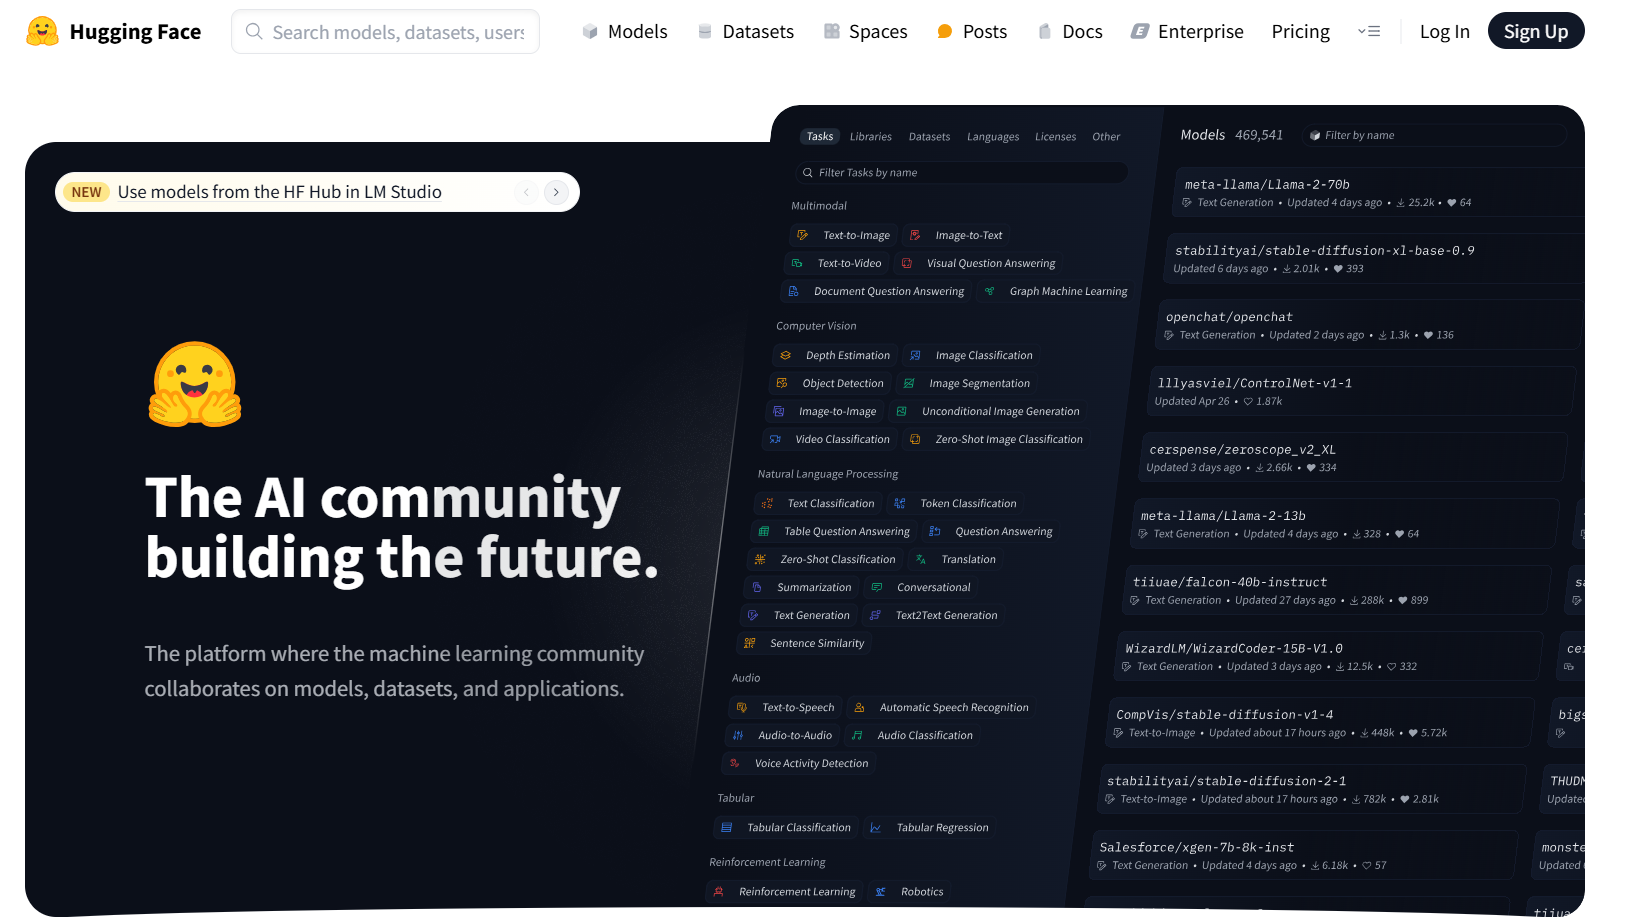

Платформа Hugging Face это не просто коллекция готовых современных предварительно обученных Deep Learning моделей.

Помимо моделей Hugging Face содержит:

- Датасеты
- Spaces
- документацию и посты
- курсы (NLP, CV, RL и другие)  и обучающие видео
- Leaderboard (в том числе Open LLM Leaderboard)
- библиотеки Transformers и Diffusers
- и многое другое.


#### 8.1 [Модели](https://huggingface.co/models)


Модели, которые поддерживает и распространяет Hugging Face, - это модели для различных задач DL, которые свободно доступны для использования, модификации и создания на их основе кем угодно.

 Эти модели, как правило, создаются исследовательскими институтами, технологическими компаниями и сообществами с открытым исходным кодом, и предоставляются под общедоступными лицензиями, позволяющими широко использовать и экспериментировать с ними.

Например, попробуем найти предобученную модель для использования в качестве переводчика c английского на русский.

1) Выбираем задачу. В нашем случае translations

2) Отфильтруем по языку

3) Отсортируем по `most likes`

4) Выберем модель `facebook/nllb-200-distilled-600M`


In [ ]:
!pip install transformers
!pip install torch

In [ ]:
from transformers.utils import logging
logging.set_verbosity_error()

In [ ]:
from transformers import pipeline
import torch

In [ ]:
translator = pipeline(task="translation",
                      model="facebook/nllb-200-distilled-600M",
                      torch_dtype=torch.bfloat16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

In [ ]:
text = """\
My puppy is adorable, \
Your kitten is cute.
Her panda is friendly.
His llama is thoughtful. \
We all have nice pets!"""

In [ ]:
text_translated = translator(text,
                             src_lang="eng_Latn",
                             tgt_lang="rus_Cyrl")

In [ ]:
text_translated

[{'translation_text': 'Мой щенка милый, твой котёл милый, её панда дружелюбная, его лама внимательная, у нас у всех хорошие домашние животные!'}]

In [ ]:
import gc
del translator
gc.collect()

48

#### 8.2 Spaces

Облачная платформа, где разработчики могут создавать и развертывать интерактивные веб-приложения на основе моделей ИИ, делая их доступными для широкой аудитории.

Пользователи Spaces могут настраивать внешний вид и интерактивность своих приложений с помощью `HTML`, `CSS` и `JavaScript`, создавая тем самым современные и привлекательные веб-интерфейсы. Кроме того, Spaces предоставляет возможность совместной работы, позволяя нескольким разработчикам одновременно редактировать и публиковать свои приложения.

Продемонстрируем пример с использованием __Spaces__ при помощи библиотеки __gradio__.

__gradio__- это удобная библиотека Python, которая позволяет создавать веб-демонстрации, просто указав список входных и выходных компонентов, ожидаемых моделью машинного обучения.

Протестируем подход развертывания демо в виде web-приложений для задачи `Image Captioning`

In [ ]:
!pip install transformers
!pip install gradio
!pip install gradio_client

  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 104.8 MB/s eta 0:00:00
Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
from transformers.utils import logging
logging.set_verbosity_error()

import warnings
warnings.filterwarnings("ignore",
                        message="Using the model-agnostic default `max_length`")

In [ ]:
import os
import gradio as gr
from transformers import pipeline

In [ ]:
pipe = pipeline("image-to-text",
                model="Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Создадим простую функцию `launch`, которая на выходе будет формировать текстовое описание картинки.

In [ ]:
def launch(input):
    out = pipe(input)
    return out[0]['generated_text']

In [ ]:
iface = gr.Interface(launch,
                     inputs=gr.Image(type='pil'),
                     outputs="text")

In [ ]:
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5141d3096753a99a3e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# закрываем приложение
iface.close()

Closing server running on port: 7860


##### Попробуем задеплоить нашу модельку на HF Space

![GIF](https://huggingface.co/blog/assets/28_gradio-spaces/spaces-demo-finalized.gif)

1. Создаем свое пространство, заполняя соответствующие поля:
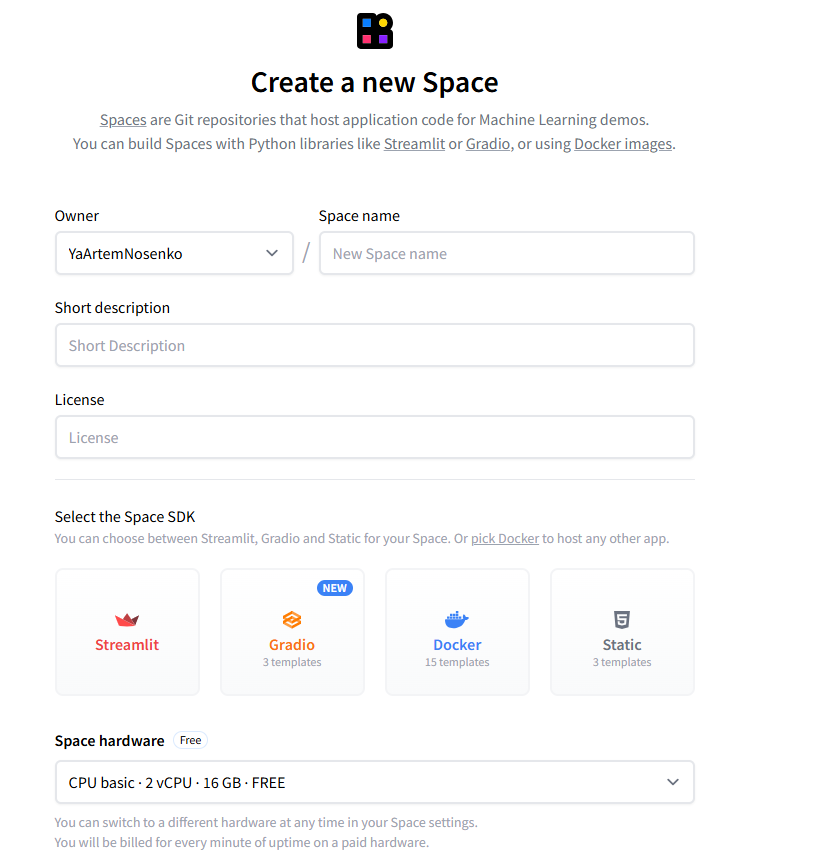

2. Добавляем файлы `requirements.txt` и `app.py`

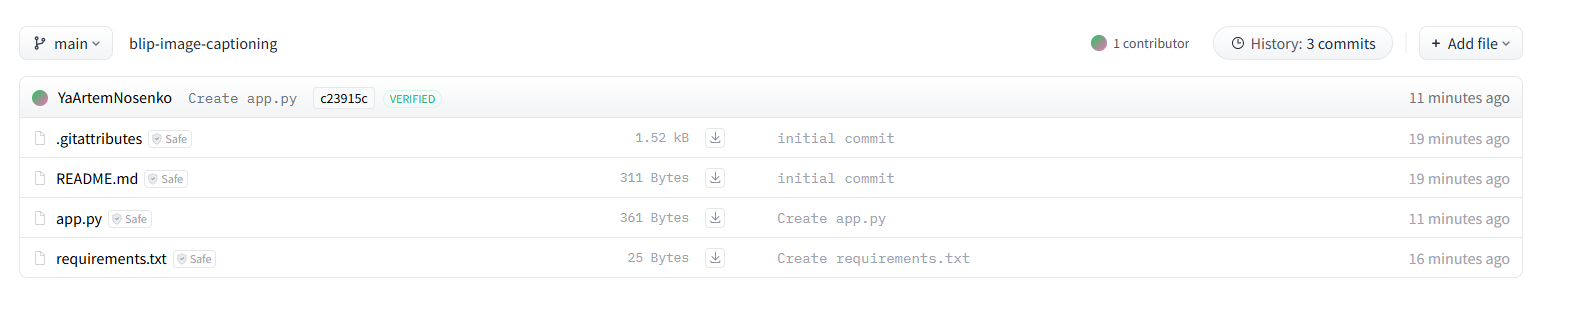

3. В файл `app.py` прописываем основные шаги:

```Python

import gradio as gr
from transformers import pipeline

pipe = pipeline("image-to-text",
                model="Salesforce/blip-image-captioning-base")

def launch(input):
    out = pipe(input)
    return out[0]['generated_text']

iface = gr.Interface(launch,
                     inputs=gr.Image(type='pil'),
                     outputs="text")

iface.launch()
```

4. После этого, web-приложение какое-то время собирается. После этого его можно использовать через API

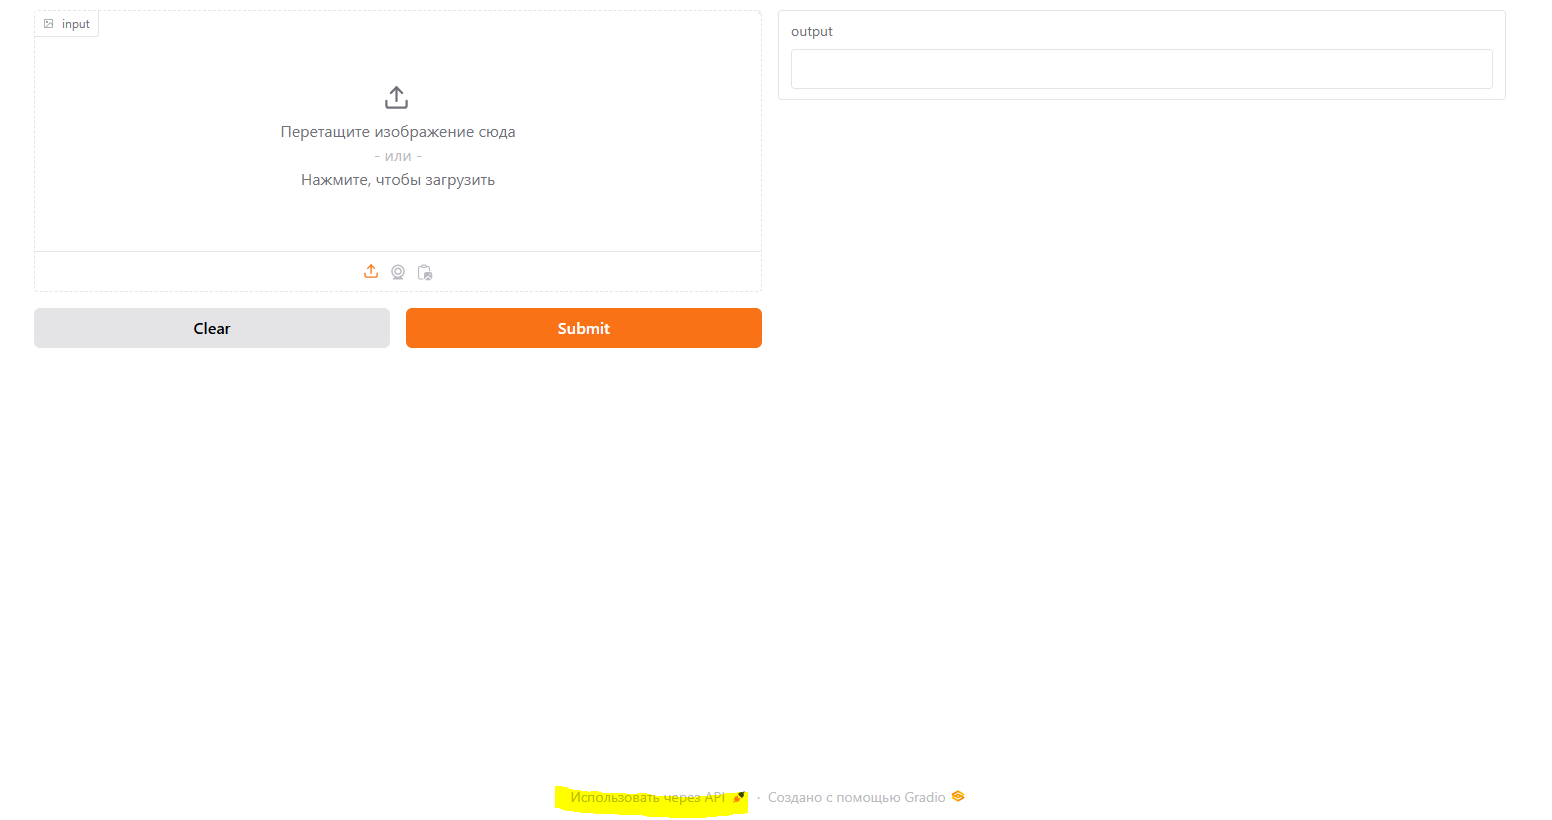

In [ ]:
from gradio_client import Client, handle_file

client = Client("YaArtemNosenko/blip-image-captioning")
result = client.predict(
		input=handle_file('https://a.d-cd.net/497dc1as-960.jpg'),
		api_name="/predict"
)
print(result)

Loaded as API: https://yaartemnosenko-blip-image-captioning.hf.space ✔
christmas tree with kittens


Теперь мы можем использовать развернутое в HF HUB веб-приложение: давать доступ другим пользователяем, показывать демо на конференциях/совещаниях.